In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 300

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    # X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个随机点
    X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点
    nIter = 80000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 10/80000 [00:00<13:20, 99.88it/s]

Adam:   0%|          | 71/80000 [00:00<03:21, 397.15it/s]

Adam:   0%|          | 141/80000 [00:00<02:29, 532.51it/s]

Adam:   0%|          | 211/80000 [00:00<02:14, 594.95it/s]

Adam:   0%|          | 277/80000 [00:00<02:09, 615.22it/s]

Adam:   0%|          | 348/80000 [00:00<02:03, 644.83it/s]

Adam:   1%|          | 413/80000 [00:00<02:03, 641.95it/s]

Adam:   1%|          | 478/80000 [00:00<02:04, 640.76it/s]

Adam:   1%|          | 549/80000 [00:00<02:00, 660.08it/s]

Adam:   1%|          | 620/80000 [00:01<01:57, 673.91it/s]

Adam:   1%|          | 690/80000 [00:01<01:56, 681.78it/s]

Adam:   1%|          | 759/80000 [00:01<01:57, 675.48it/s]

Adam:   1%|          | 827/80000 [00:01<01:57, 673.77it/s]

Adam:   1%|          | 897/80000 [00:01<01:56, 679.20it/s]

Adam:   1%|          | 967/80000 [00:01<01:55, 683.89it/s]

Adam:   1%|▏         | 1036/80000 [00:01<01:55, 684.53it/s]

Adam:   1%|▏         | 1105/80000 [00:01<01:56, 678.57it/s]

Adam:   1%|▏         | 1176/80000 [00:01<01:54, 687.28it/s]

Adam:   2%|▏         | 1245/80000 [00:01<01:55, 683.63it/s]

Adam:   2%|▏         | 1316/80000 [00:02<01:54, 689.06it/s]

Adam:   2%|▏         | 1387/80000 [00:02<01:53, 693.66it/s]

Adam:   2%|▏         | 1457/80000 [00:02<02:00, 651.12it/s]

Adam:   2%|▏         | 1528/80000 [00:02<01:57, 666.45it/s]

Adam:   2%|▏         | 1596/80000 [00:02<01:57, 669.98it/s]

Adam:   2%|▏         | 1664/80000 [00:02<01:59, 653.17it/s]

Adam:   2%|▏         | 1730/80000 [00:02<02:02, 638.50it/s]

Adam:   2%|▏         | 1799/80000 [00:02<01:59, 653.18it/s]

Adam:   2%|▏         | 1870/80000 [00:02<01:57, 667.41it/s]

Adam:   2%|▏         | 1941/80000 [00:02<01:55, 678.75it/s]

Adam:   3%|▎         | 2010/80000 [00:03<02:00, 648.67it/s]

Adam:   3%|▎         | 2076/80000 [00:03<01:59, 650.29it/s]

Adam:   3%|▎         | 2146/80000 [00:03<01:57, 662.31it/s]

Adam:   3%|▎         | 2216/80000 [00:03<01:55, 671.15it/s]

Adam:   3%|▎         | 2284/80000 [00:03<01:56, 668.82it/s]

Adam:   3%|▎         | 2352/80000 [00:03<01:57, 662.09it/s]

Adam:   3%|▎         | 2419/80000 [00:03<01:58, 656.54it/s]

Adam:   3%|▎         | 2485/80000 [00:03<01:59, 646.77it/s]

Adam:   3%|▎         | 2555/80000 [00:03<01:57, 660.82it/s]

Adam:   3%|▎         | 2623/80000 [00:04<01:56, 664.07it/s]

Adam:   3%|▎         | 2690/80000 [00:04<01:57, 658.85it/s]

Adam:   3%|▎         | 2756/80000 [00:04<01:58, 652.99it/s]

Adam:   4%|▎         | 2826/80000 [00:04<01:55, 665.77it/s]

Adam:   4%|▎         | 2895/80000 [00:04<01:54, 672.64it/s]

Adam:   4%|▎         | 2966/80000 [00:04<01:53, 681.66it/s]

Adam:   4%|▍         | 3035/80000 [00:04<02:00, 640.85it/s]

Adam:   4%|▍         | 3100/80000 [00:04<01:59, 640.94it/s]

Adam:   4%|▍         | 3165/80000 [00:04<02:00, 636.14it/s]

Adam:   4%|▍         | 3230/80000 [00:04<02:00, 638.72it/s]

Adam:   4%|▍         | 3295/80000 [00:05<02:03, 621.81it/s]

Adam:   4%|▍         | 3360/80000 [00:05<02:01, 629.21it/s]

Adam:   4%|▍         | 3424/80000 [00:05<02:03, 620.99it/s]

Adam:   4%|▍         | 3492/80000 [00:05<02:00, 635.73it/s]

Adam:   4%|▍         | 3556/80000 [00:05<02:00, 633.49it/s]

Adam:   5%|▍         | 3625/80000 [00:05<01:57, 649.18it/s]

Adam:   5%|▍         | 3691/80000 [00:05<02:05, 607.73it/s]

Adam:   5%|▍         | 3759/80000 [00:05<02:01, 626.62it/s]

Adam:   5%|▍         | 3829/80000 [00:05<01:58, 645.51it/s]

Adam:   5%|▍         | 3894/80000 [00:06<02:35, 488.77it/s]

Adam:   5%|▍         | 3949/80000 [00:06<02:31, 503.32it/s]

Adam:   5%|▌         | 4004/80000 [00:06<02:29, 508.72it/s]

Adam:   5%|▌         | 4059/80000 [00:06<02:30, 506.22it/s]

Adam:   5%|▌         | 4112/80000 [00:06<02:45, 459.01it/s]

Adam:   5%|▌         | 4172/80000 [00:06<02:33, 494.87it/s]

Adam:   5%|▌         | 4242/80000 [00:06<02:18, 548.18it/s]

Adam:   5%|▌         | 4303/80000 [00:06<02:13, 565.11it/s]

Adam:   5%|▌         | 4367/80000 [00:06<02:09, 584.24it/s]

Adam:   6%|▌         | 4438/80000 [00:07<02:02, 618.29it/s]

Adam:   6%|▌         | 4509/80000 [00:07<01:57, 644.73it/s]

Adam:   6%|▌         | 4580/80000 [00:07<01:53, 663.34it/s]

Adam:   6%|▌         | 4647/80000 [00:07<02:07, 592.40it/s]

Adam:   6%|▌         | 4709/80000 [00:07<02:22, 529.75it/s]

Adam:   6%|▌         | 4765/80000 [00:07<02:22, 526.34it/s]

Adam:   6%|▌         | 4835/80000 [00:07<02:11, 571.60it/s]

Adam:   6%|▌         | 4903/80000 [00:07<02:05, 599.05it/s]

Adam:   6%|▌         | 4972/80000 [00:07<02:00, 622.38it/s]

Adam:   6%|▋         | 5041/80000 [00:08<01:56, 641.48it/s]

Adam:   6%|▋         | 5112/80000 [00:08<01:53, 658.77it/s]

Adam:   6%|▋         | 5179/80000 [00:08<01:53, 659.36it/s]

Adam:   7%|▋         | 5246/80000 [00:08<02:13, 560.00it/s]

Adam:   7%|▋         | 5305/80000 [00:08<02:50, 438.63it/s]

Adam:   7%|▋         | 5355/80000 [00:08<03:30, 354.73it/s]

Adam:   7%|▋         | 5397/80000 [00:09<03:52, 320.60it/s]

Adam:   7%|▋         | 5459/80000 [00:09<03:16, 379.90it/s]

Adam:   7%|▋         | 5526/80000 [00:09<02:47, 443.68it/s]

Adam:   7%|▋         | 5577/80000 [00:09<02:41, 459.44it/s]

Adam:   7%|▋         | 5647/80000 [00:09<02:22, 520.69it/s]

Adam:   7%|▋         | 5706/80000 [00:09<02:18, 537.88it/s]

Adam:   7%|▋         | 5770/80000 [00:09<02:12, 558.69it/s]

Adam:   7%|▋         | 5829/80000 [00:09<02:44, 450.33it/s]

Adam:   7%|▋         | 5879/80000 [00:09<02:47, 441.22it/s]

Adam:   7%|▋         | 5944/80000 [00:10<02:30, 492.06it/s]

Adam:   8%|▊         | 6015/80000 [00:10<02:15, 547.87it/s]

Adam:   8%|▊         | 6085/80000 [00:10<02:05, 588.25it/s]

Adam:   8%|▊         | 6147/80000 [00:10<02:04, 591.23it/s]

Adam:   8%|▊         | 6215/80000 [00:10<01:59, 615.88it/s]

Adam:   8%|▊         | 6279/80000 [00:10<01:58, 622.50it/s]

Adam:   8%|▊         | 6343/80000 [00:10<01:57, 626.35it/s]

Adam:   8%|▊         | 6414/80000 [00:10<01:53, 650.30it/s]

Adam:   8%|▊         | 6484/80000 [00:10<01:50, 664.45it/s]

Adam:   8%|▊         | 6555/80000 [00:10<01:48, 675.15it/s]

Adam:   8%|▊         | 6626/80000 [00:11<01:47, 684.39it/s]

Adam:   8%|▊         | 6695/80000 [00:11<01:48, 676.73it/s]

Adam:   8%|▊         | 6763/80000 [00:11<01:48, 676.87it/s]

Adam:   9%|▊         | 6831/80000 [00:11<01:51, 657.33it/s]

Adam:   9%|▊         | 6897/80000 [00:11<01:57, 624.76it/s]

Adam:   9%|▊         | 6961/80000 [00:11<01:56, 629.02it/s]

Adam:   9%|▉         | 7030/80000 [00:11<01:53, 643.80it/s]

Adam:   9%|▉         | 7097/80000 [00:11<01:52, 650.29it/s]

Adam:   9%|▉         | 7167/80000 [00:11<01:49, 662.42it/s]

Adam:   9%|▉         | 7234/80000 [00:12<01:54, 638.00it/s]

Adam:   9%|▉         | 7299/80000 [00:12<01:54, 635.95it/s]

Adam:   9%|▉         | 7370/80000 [00:12<01:50, 655.67it/s]

Adam:   9%|▉         | 7436/80000 [00:12<01:50, 654.58it/s]

Adam:   9%|▉         | 7502/80000 [00:12<01:54, 632.62it/s]

Adam:   9%|▉         | 7567/80000 [00:12<01:53, 637.29it/s]

Adam:  10%|▉         | 7631/80000 [00:12<01:55, 624.19it/s]

Adam:  10%|▉         | 7694/80000 [00:12<01:55, 625.02it/s]

Adam:  10%|▉         | 7757/80000 [00:12<01:57, 615.44it/s]

Adam:  10%|▉         | 7819/80000 [00:12<02:00, 600.66it/s]

Adam:  10%|▉         | 7883/80000 [00:13<01:57, 611.88it/s]

Adam:  10%|▉         | 7952/80000 [00:13<01:53, 632.76it/s]

Adam:  10%|█         | 8021/80000 [00:13<01:51, 647.54it/s]

Adam:  10%|█         | 8086/80000 [00:13<01:52, 638.20it/s]

Adam:  10%|█         | 8150/80000 [00:13<01:53, 630.74it/s]

Adam:  10%|█         | 8221/80000 [00:13<01:50, 651.37it/s]

Adam:  10%|█         | 8287/80000 [00:13<01:50, 649.81it/s]

Adam:  10%|█         | 8356/80000 [00:13<01:48, 660.76it/s]

Adam:  11%|█         | 8427/80000 [00:13<01:46, 674.82it/s]

Adam:  11%|█         | 8495/80000 [00:13<01:47, 666.87it/s]

Adam:  11%|█         | 8562/80000 [00:14<01:54, 621.81it/s]

Adam:  11%|█         | 8627/80000 [00:14<01:53, 629.45it/s]

Adam:  11%|█         | 8691/80000 [00:14<01:54, 624.12it/s]

Adam:  11%|█         | 8757/80000 [00:14<01:52, 632.37it/s]

Adam:  11%|█         | 8823/80000 [00:14<01:51, 638.80it/s]

Adam:  11%|█         | 8893/80000 [00:14<01:48, 656.32it/s]

Adam:  11%|█         | 8959/80000 [00:14<01:50, 645.39it/s]

Adam:  11%|█▏        | 9026/80000 [00:14<01:48, 652.09it/s]

Adam:  11%|█▏        | 9096/80000 [00:14<01:46, 664.01it/s]

Adam:  11%|█▏        | 9167/80000 [00:15<01:44, 675.97it/s]

Adam:  12%|█▏        | 9235/80000 [00:15<01:49, 645.07it/s]

Adam:  12%|█▏        | 9301/80000 [00:15<01:49, 646.72it/s]

Adam:  12%|█▏        | 9369/80000 [00:15<01:47, 655.20it/s]

Adam:  12%|█▏        | 9435/80000 [00:15<01:51, 631.34it/s]

Adam:  12%|█▏        | 9502/80000 [00:15<01:50, 639.92it/s]

Adam:  12%|█▏        | 9570/80000 [00:15<01:48, 650.71it/s]

Adam:  12%|█▏        | 9639/80000 [00:15<01:46, 662.14it/s]

Adam:  12%|█▏        | 9706/80000 [00:15<01:47, 652.86it/s]

Adam:  12%|█▏        | 9774/80000 [00:15<01:46, 656.75it/s]

Adam:  12%|█▏        | 9841/80000 [00:16<01:46, 659.61it/s]

Adam:  12%|█▏        | 9908/80000 [00:16<01:47, 649.44it/s]

Adam:  12%|█▏        | 9979/80000 [00:16<01:45, 661.01it/s]

Adam:  13%|█▎        | 10046/80000 [00:16<01:45, 662.10it/s]

Adam:  13%|█▎        | 10113/80000 [00:16<01:47, 650.20it/s]

Adam:  13%|█▎        | 10179/80000 [00:16<01:48, 641.39it/s]

Adam:  13%|█▎        | 10244/80000 [00:16<01:51, 623.59it/s]

Adam:  13%|█▎        | 10313/80000 [00:16<01:48, 641.84it/s]

Adam:  13%|█▎        | 10380/80000 [00:16<01:47, 648.94it/s]

Adam:  13%|█▎        | 10450/80000 [00:17<01:45, 661.83it/s]

Adam:  13%|█▎        | 10517/80000 [00:17<01:49, 636.63it/s]

Adam:  13%|█▎        | 10581/80000 [00:17<01:52, 618.60it/s]

Adam:  13%|█▎        | 10651/80000 [00:17<01:48, 641.72it/s]

Adam:  13%|█▎        | 10717/80000 [00:17<01:47, 645.81it/s]

Adam:  13%|█▎        | 10782/80000 [00:17<01:49, 629.61it/s]

Adam:  14%|█▎        | 10846/80000 [00:17<01:51, 622.67it/s]

Adam:  14%|█▎        | 10915/80000 [00:17<01:47, 639.79it/s]

Adam:  14%|█▎        | 10980/80000 [00:17<01:50, 624.98it/s]

Adam:  14%|█▍        | 11043/80000 [00:17<01:55, 599.41it/s]

Adam:  14%|█▍        | 11104/80000 [00:18<01:55, 597.67it/s]

Adam:  14%|█▍        | 11164/80000 [00:18<01:58, 579.70it/s]

Adam:  14%|█▍        | 11225/80000 [00:18<01:57, 586.34it/s]

Adam:  14%|█▍        | 11284/80000 [00:18<01:58, 578.51it/s]

Adam:  14%|█▍        | 11342/80000 [00:18<01:59, 573.44it/s]

Adam:  14%|█▍        | 11406/80000 [00:18<01:56, 590.37it/s]

Adam:  14%|█▍        | 11466/80000 [00:18<01:57, 581.84it/s]

Adam:  14%|█▍        | 11525/80000 [00:18<01:58, 577.26it/s]

Adam:  14%|█▍        | 11590/80000 [00:18<01:54, 596.83it/s]

Adam:  15%|█▍        | 11653/80000 [00:19<01:52, 606.29it/s]

Adam:  15%|█▍        | 11718/80000 [00:19<01:50, 618.26it/s]

Adam:  15%|█▍        | 11784/80000 [00:19<01:48, 628.55it/s]

Adam:  15%|█▍        | 11850/80000 [00:19<01:47, 636.81it/s]

Adam:  15%|█▍        | 11914/80000 [00:19<01:50, 617.50it/s]

Adam:  15%|█▍        | 11976/80000 [00:19<01:50, 612.96it/s]

Adam:  15%|█▌        | 12038/80000 [00:19<01:51, 611.20it/s]

Adam:  15%|█▌        | 12102/80000 [00:19<01:49, 618.95it/s]

Adam:  15%|█▌        | 12164/80000 [00:19<01:57, 579.42it/s]

Adam:  15%|█▌        | 12223/80000 [00:19<02:02, 552.71it/s]

Adam:  15%|█▌        | 12287/80000 [00:20<01:57, 574.67it/s]

Adam:  15%|█▌        | 12347/80000 [00:20<01:56, 579.66it/s]

Adam:  16%|█▌        | 12409/80000 [00:20<01:54, 588.44it/s]

Adam:  16%|█▌        | 12472/80000 [00:20<01:52, 598.75it/s]

Adam:  16%|█▌        | 12535/80000 [00:20<01:50, 607.88it/s]

Adam:  16%|█▌        | 12596/80000 [00:20<01:53, 593.40it/s]

Adam:  16%|█▌        | 12656/80000 [00:20<01:56, 575.78it/s]

Adam:  16%|█▌        | 12714/80000 [00:20<01:56, 575.62it/s]

Adam:  16%|█▌        | 12779/80000 [00:20<01:52, 596.66it/s]

Adam:  16%|█▌        | 12845/80000 [00:21<01:49, 612.98it/s]

Adam:  16%|█▌        | 12912/80000 [00:21<01:46, 627.17it/s]

Adam:  16%|█▌        | 12975/80000 [00:21<01:46, 627.17it/s]

Adam:  16%|█▋        | 13038/80000 [00:21<01:49, 612.52it/s]

Adam:  16%|█▋        | 13100/80000 [00:21<01:50, 603.00it/s]

Adam:  16%|█▋        | 13161/80000 [00:21<01:54, 584.14it/s]

Adam:  17%|█▋        | 13220/80000 [00:21<02:04, 537.32it/s]

Adam:  17%|█▋        | 13279/80000 [00:21<02:01, 549.50it/s]

Adam:  17%|█▋        | 13339/80000 [00:21<01:58, 561.82it/s]

Adam:  17%|█▋        | 13396/80000 [00:21<02:05, 529.28it/s]

Adam:  17%|█▋        | 13450/80000 [00:22<02:08, 517.12it/s]

Adam:  17%|█▋        | 13515/80000 [00:22<02:00, 553.66it/s]

Adam:  17%|█▋        | 13575/80000 [00:22<01:57, 565.63it/s]

Adam:  17%|█▋        | 13638/80000 [00:22<01:53, 583.06it/s]

Adam:  17%|█▋        | 13697/80000 [00:22<01:53, 584.97it/s]

Adam:  17%|█▋        | 13760/80000 [00:22<01:50, 597.95it/s]

Adam:  17%|█▋        | 13825/80000 [00:22<01:48, 610.84it/s]

Adam:  17%|█▋        | 13887/80000 [00:22<01:50, 600.90it/s]

Adam:  17%|█▋        | 13948/80000 [00:22<01:51, 592.07it/s]

Adam:  18%|█▊        | 14008/80000 [00:23<01:52, 584.71it/s]

Adam:  18%|█▊        | 14067/80000 [00:23<01:58, 557.55it/s]

Adam:  18%|█▊        | 14124/80000 [00:23<01:59, 549.72it/s]

Adam:  18%|█▊        | 14180/80000 [00:23<01:59, 551.95it/s]

Adam:  18%|█▊        | 14238/80000 [00:23<01:57, 559.21it/s]

Adam:  18%|█▊        | 14302/80000 [00:23<01:53, 581.05it/s]

Adam:  18%|█▊        | 14366/80000 [00:23<01:50, 596.08it/s]

Adam:  18%|█▊        | 14426/80000 [00:23<01:50, 594.71it/s]

Adam:  18%|█▊        | 14486/80000 [00:23<01:50, 592.25it/s]

Adam:  18%|█▊        | 14552/80000 [00:23<01:47, 609.99it/s]

Adam:  18%|█▊        | 14614/80000 [00:24<01:48, 601.52it/s]

Adam:  18%|█▊        | 14680/80000 [00:24<01:45, 617.06it/s]

Adam:  18%|█▊        | 14742/80000 [00:24<01:47, 606.51it/s]

Adam:  19%|█▊        | 14808/80000 [00:24<01:45, 620.37it/s]

Adam:  19%|█▊        | 14871/80000 [00:24<01:45, 617.37it/s]

Adam:  19%|█▊        | 14933/80000 [00:24<01:46, 608.11it/s]

Adam:  19%|█▊        | 14994/80000 [00:24<01:47, 602.69it/s]

Adam:  19%|█▉        | 15055/80000 [00:24<01:51, 581.22it/s]

Adam:  19%|█▉        | 15114/80000 [00:24<01:52, 576.24it/s]

Adam:  19%|█▉        | 15175/80000 [00:25<01:50, 584.33it/s]

Adam:  19%|█▉        | 15234/80000 [00:25<01:52, 577.96it/s]

Adam:  19%|█▉        | 15297/80000 [00:25<01:49, 591.05it/s]

Adam:  19%|█▉        | 15357/80000 [00:25<01:49, 590.59it/s]

Adam:  19%|█▉        | 15422/80000 [00:25<01:46, 607.61it/s]

Adam:  19%|█▉        | 15485/80000 [00:25<01:45, 611.73it/s]

Adam:  19%|█▉        | 15547/80000 [00:25<01:51, 579.21it/s]

Adam:  20%|█▉        | 15607/80000 [00:25<01:50, 585.04it/s]

Adam:  20%|█▉        | 15666/80000 [00:25<01:49, 585.08it/s]

Adam:  20%|█▉        | 15725/80000 [00:25<01:50, 580.05it/s]

Adam:  20%|█▉        | 15784/80000 [00:26<01:52, 573.30it/s]

Adam:  20%|█▉        | 15842/80000 [00:26<01:55, 556.34it/s]

Adam:  20%|█▉        | 15903/80000 [00:26<01:52, 570.96it/s]

Adam:  20%|█▉        | 15963/80000 [00:26<01:50, 578.22it/s]

Adam:  20%|██        | 16028/80000 [00:26<01:46, 597.99it/s]

Adam:  20%|██        | 16088/80000 [00:26<01:53, 562.70it/s]

Adam:  20%|██        | 16151/80000 [00:26<01:49, 581.31it/s]

Adam:  20%|██        | 16210/80000 [00:26<01:52, 565.81it/s]

Adam:  20%|██        | 16267/80000 [00:26<01:52, 565.32it/s]

Adam:  20%|██        | 16324/80000 [00:27<01:57, 541.96it/s]

Adam:  20%|██        | 16379/80000 [00:27<02:16, 467.33it/s]

Adam:  21%|██        | 16439/80000 [00:27<02:07, 497.91it/s]

Adam:  21%|██        | 16491/80000 [00:27<02:10, 485.62it/s]

Adam:  21%|██        | 16541/80000 [00:27<02:16, 464.06it/s]

Adam:  21%|██        | 16591/80000 [00:27<02:14, 472.16it/s]

Adam:  21%|██        | 16646/80000 [00:27<02:09, 490.94it/s]

Adam:  21%|██        | 16700/80000 [00:27<02:05, 504.21it/s]

Adam:  21%|██        | 16752/80000 [00:27<02:04, 507.62it/s]

Adam:  21%|██        | 16804/80000 [00:28<02:04, 507.47it/s]

Adam:  21%|██        | 16863/80000 [00:28<01:59, 529.27it/s]

Adam:  21%|██        | 16917/80000 [00:28<01:58, 530.71it/s]

Adam:  21%|██        | 16973/80000 [00:28<01:56, 539.03it/s]

Adam:  21%|██▏       | 17033/80000 [00:28<01:53, 556.20it/s]

Adam:  21%|██▏       | 17094/80000 [00:28<01:50, 570.15it/s]

Adam:  21%|██▏       | 17152/80000 [00:28<01:59, 525.35it/s]

Adam:  22%|██▏       | 17206/80000 [00:28<02:07, 493.61it/s]

Adam:  22%|██▏       | 17265/80000 [00:28<02:00, 519.47it/s]

Adam:  22%|██▏       | 17326/80000 [00:28<01:55, 543.34it/s]

Adam:  22%|██▏       | 17382/80000 [00:29<01:58, 527.90it/s]

Adam:  22%|██▏       | 17436/80000 [00:29<02:01, 516.75it/s]

Adam:  22%|██▏       | 17489/80000 [00:29<02:04, 501.63it/s]

Adam:  22%|██▏       | 17546/80000 [00:29<02:00, 520.18it/s]

Adam:  22%|██▏       | 17599/80000 [00:29<02:04, 503.07it/s]

Adam:  22%|██▏       | 17658/80000 [00:29<01:58, 524.12it/s]

Adam:  22%|██▏       | 17711/80000 [00:29<02:01, 511.99it/s]

Adam:  22%|██▏       | 17764/80000 [00:29<02:00, 516.35it/s]

Adam:  22%|██▏       | 17816/80000 [00:29<02:10, 475.65it/s]

Adam:  22%|██▏       | 17872/80000 [00:30<02:04, 498.42it/s]

Adam:  22%|██▏       | 17926/80000 [00:30<02:01, 509.14it/s]

Adam:  22%|██▏       | 17986/80000 [00:30<01:56, 533.22it/s]

Adam:  23%|██▎       | 18045/80000 [00:30<01:53, 547.69it/s]

Adam:  23%|██▎       | 18101/80000 [00:30<02:01, 511.51it/s]

Adam:  23%|██▎       | 18153/80000 [00:30<02:04, 496.69it/s]

Adam:  23%|██▎       | 18204/80000 [00:30<02:04, 494.44it/s]

Adam:  23%|██▎       | 18254/80000 [00:30<02:05, 492.22it/s]

Adam:  23%|██▎       | 18304/80000 [00:30<02:10, 474.15it/s]

Adam:  23%|██▎       | 18360/80000 [00:31<02:04, 494.30it/s]

Adam:  23%|██▎       | 18412/80000 [00:31<02:03, 499.72it/s]

Adam:  23%|██▎       | 18463/80000 [00:31<02:02, 501.58it/s]

Adam:  23%|██▎       | 18518/80000 [00:31<01:59, 512.37it/s]

Adam:  23%|██▎       | 18570/80000 [00:31<02:00, 509.99it/s]

Adam:  23%|██▎       | 18622/80000 [00:31<02:17, 447.41it/s]

Adam:  23%|██▎       | 18676/80000 [00:31<02:10, 471.63it/s]

Adam:  23%|██▎       | 18729/80000 [00:31<02:05, 486.44it/s]

Adam:  23%|██▎       | 18781/80000 [00:31<02:03, 494.69it/s]

Adam:  24%|██▎       | 18832/80000 [00:32<02:06, 484.21it/s]

Adam:  24%|██▎       | 18881/80000 [00:32<02:07, 478.09it/s]

Adam:  24%|██▎       | 18933/80000 [00:32<02:04, 488.64it/s]

Adam:  24%|██▎       | 18988/80000 [00:32<02:00, 505.34it/s]

Adam:  24%|██▍       | 19042/80000 [00:32<01:58, 513.77it/s]

Adam:  24%|██▍       | 19094/80000 [00:32<02:06, 483.33it/s]

Adam:  24%|██▍       | 19144/80000 [00:32<02:05, 486.14it/s]

Adam:  24%|██▍       | 19195/80000 [00:32<02:03, 490.96it/s]

Adam:  24%|██▍       | 19253/80000 [00:32<01:57, 516.42it/s]

Adam:  24%|██▍       | 19305/80000 [00:32<02:05, 484.70it/s]

Adam:  24%|██▍       | 19355/80000 [00:33<02:15, 448.21it/s]

Adam:  24%|██▍       | 19405/80000 [00:33<02:11, 461.69it/s]

Adam:  24%|██▍       | 19463/80000 [00:33<02:02, 492.65it/s]

Adam:  24%|██▍       | 19523/80000 [00:33<01:55, 521.53it/s]

Adam:  24%|██▍       | 19576/80000 [00:33<02:03, 490.14it/s]

Adam:  25%|██▍       | 19636/80000 [00:33<01:56, 519.29it/s]

Adam:  25%|██▍       | 19695/80000 [00:33<01:51, 538.89it/s]

Adam:  25%|██▍       | 19750/80000 [00:33<01:51, 541.03it/s]

Adam:  25%|██▍       | 19805/80000 [00:33<01:53, 531.36it/s]

Adam:  25%|██▍       | 19859/80000 [00:34<02:01, 493.99it/s]

Adam:  25%|██▍       | 19913/80000 [00:34<01:59, 504.08it/s]

Adam:  25%|██▍       | 19964/80000 [00:34<02:01, 492.86it/s]

Adam:  25%|██▌       | 20014/80000 [00:34<02:05, 477.71it/s]

Adam:  25%|██▌       | 20072/80000 [00:34<01:58, 505.96it/s]

Adam:  25%|██▌       | 20124/80000 [00:34<02:00, 498.51it/s]

Adam:  25%|██▌       | 20175/80000 [00:34<02:00, 497.43it/s]

Adam:  25%|██▌       | 20228/80000 [00:34<01:58, 504.41it/s]

Adam:  25%|██▌       | 20279/80000 [00:34<02:03, 485.02it/s]

Adam:  25%|██▌       | 20328/80000 [00:35<02:08, 465.16it/s]

Adam:  25%|██▌       | 20375/80000 [00:35<02:07, 466.06it/s]

Adam:  26%|██▌       | 20422/80000 [00:35<02:07, 465.84it/s]

Adam:  26%|██▌       | 20470/80000 [00:35<02:07, 468.38it/s]

Adam:  26%|██▌       | 20520/80000 [00:35<02:05, 474.92it/s]

Adam:  26%|██▌       | 20569/80000 [00:35<02:04, 475.83it/s]

Adam:  26%|██▌       | 20617/80000 [00:35<02:10, 453.77it/s]

Adam:  26%|██▌       | 20669/80000 [00:35<02:05, 471.20it/s]

Adam:  26%|██▌       | 20717/80000 [00:35<02:07, 464.30it/s]

Adam:  26%|██▌       | 20767/80000 [00:35<02:05, 473.66it/s]

Adam:  26%|██▌       | 20825/80000 [00:36<01:57, 504.58it/s]

Adam:  26%|██▌       | 20886/80000 [00:36<01:50, 534.49it/s]

Adam:  26%|██▌       | 20945/80000 [00:36<01:47, 549.16it/s]

Adam:  26%|██▋       | 21001/80000 [00:36<01:58, 499.07it/s]

Adam:  26%|██▋       | 21052/80000 [00:36<01:59, 494.69it/s]

Adam:  26%|██▋       | 21103/80000 [00:36<02:01, 484.91it/s]

Adam:  26%|██▋       | 21152/80000 [00:36<02:01, 485.81it/s]

Adam:  27%|██▋       | 21208/80000 [00:36<01:55, 506.90it/s]

Adam:  27%|██▋       | 21260/80000 [00:36<01:55, 506.69it/s]

Adam:  27%|██▋       | 21311/80000 [00:37<01:56, 502.62it/s]

Adam:  27%|██▋       | 21362/80000 [00:37<02:02, 479.04it/s]

Adam:  27%|██▋       | 21418/80000 [00:37<01:57, 500.25it/s]

Adam:  27%|██▋       | 21476/80000 [00:37<01:51, 522.80it/s]

Adam:  27%|██▋       | 21529/80000 [00:37<01:54, 509.97it/s]

Adam:  27%|██▋       | 21590/80000 [00:37<01:48, 536.51it/s]

Adam:  27%|██▋       | 21649/80000 [00:37<01:46, 550.44it/s]

Adam:  27%|██▋       | 21709/80000 [00:37<01:43, 561.83it/s]

Adam:  27%|██▋       | 21770/80000 [00:37<01:41, 575.68it/s]

Adam:  27%|██▋       | 21828/80000 [00:37<01:42, 565.78it/s]

Adam:  27%|██▋       | 21885/80000 [00:38<01:43, 563.69it/s]

Adam:  27%|██▋       | 21942/80000 [00:38<01:47, 539.63it/s]

Adam:  28%|██▊       | 22003/80000 [00:38<01:44, 557.21it/s]

Adam:  28%|██▊       | 22059/80000 [00:38<01:44, 557.04it/s]

Adam:  28%|██▊       | 22115/80000 [00:38<01:46, 545.70it/s]

Adam:  28%|██▊       | 22170/80000 [00:38<01:57, 494.23it/s]

Adam:  28%|██▊       | 22230/80000 [00:38<01:50, 521.19it/s]

Adam:  28%|██▊       | 22284/80000 [00:38<01:51, 518.67it/s]

Adam:  28%|██▊       | 22337/80000 [00:38<02:05, 457.79it/s]

Adam:  28%|██▊       | 22391/80000 [00:39<02:00, 477.73it/s]

Adam:  28%|██▊       | 22443/80000 [00:39<01:58, 486.63it/s]

Adam:  28%|██▊       | 22493/80000 [00:39<02:07, 451.36it/s]

Adam:  28%|██▊       | 22545/80000 [00:39<02:02, 469.46it/s]

Adam:  28%|██▊       | 22604/80000 [00:39<01:54, 500.69it/s]

Adam:  28%|██▊       | 22662/80000 [00:39<01:50, 520.33it/s]

Adam:  28%|██▊       | 22715/80000 [00:39<01:50, 516.29it/s]

Adam:  28%|██▊       | 22768/80000 [00:39<02:00, 475.37it/s]

Adam:  29%|██▊       | 22828/80000 [00:39<01:52, 507.87it/s]

Adam:  29%|██▊       | 22883/80000 [00:40<01:50, 517.03it/s]

Adam:  29%|██▊       | 22936/80000 [00:40<01:57, 486.34it/s]

Adam:  29%|██▊       | 22993/80000 [00:40<01:52, 507.90it/s]

Adam:  29%|██▉       | 23045/80000 [00:40<01:54, 497.91it/s]

Adam:  29%|██▉       | 23096/80000 [00:40<01:54, 497.69it/s]

Adam:  29%|██▉       | 23148/80000 [00:40<01:52, 503.30it/s]

Adam:  29%|██▉       | 23199/80000 [00:40<01:57, 485.03it/s]

Adam:  29%|██▉       | 23251/80000 [00:40<01:55, 493.28it/s]

Adam:  29%|██▉       | 23303/80000 [00:40<01:53, 499.12it/s]

Adam:  29%|██▉       | 23361/80000 [00:41<01:48, 520.78it/s]

Adam:  29%|██▉       | 23414/80000 [00:41<01:49, 518.54it/s]

Adam:  29%|██▉       | 23466/80000 [00:41<01:51, 507.03it/s]

Adam:  29%|██▉       | 23525/80000 [00:41<01:46, 529.52it/s]

Adam:  29%|██▉       | 23579/80000 [00:41<01:57, 479.15it/s]

Adam:  30%|██▉       | 23637/80000 [00:41<01:51, 506.66it/s]

Adam:  30%|██▉       | 23696/80000 [00:41<01:46, 529.48it/s]

Adam:  30%|██▉       | 23750/80000 [00:41<01:46, 529.97it/s]

Adam:  30%|██▉       | 23804/80000 [00:41<01:47, 523.16it/s]

Adam:  30%|██▉       | 23857/80000 [00:42<01:54, 489.83it/s]

Adam:  30%|██▉       | 23907/80000 [00:42<01:54, 490.58it/s]

Adam:  30%|██▉       | 23967/80000 [00:42<01:48, 518.44it/s]

Adam:  30%|███       | 24020/80000 [00:42<01:53, 494.33it/s]

Adam:  30%|███       | 24070/80000 [00:42<01:55, 485.48it/s]

Adam:  30%|███       | 24121/80000 [00:42<01:53, 490.95it/s]

Adam:  30%|███       | 24175/80000 [00:42<01:51, 502.81it/s]

Adam:  30%|███       | 24229/80000 [00:42<01:49, 508.60it/s]

Adam:  30%|███       | 24281/80000 [00:42<01:50, 506.24it/s]

Adam:  30%|███       | 24339/80000 [00:42<01:45, 525.65it/s]

Adam:  30%|███       | 24393/80000 [00:43<01:45, 527.65it/s]

Adam:  31%|███       | 24446/80000 [00:43<01:51, 496.32it/s]

Adam:  31%|███       | 24497/80000 [00:43<01:58, 469.29it/s]

Adam:  31%|███       | 24551/80000 [00:43<01:54, 485.83it/s]

Adam:  31%|███       | 24601/80000 [00:43<01:55, 479.13it/s]

Adam:  31%|███       | 24650/80000 [00:43<01:55, 478.91it/s]

Adam:  31%|███       | 24706/80000 [00:43<01:50, 500.62it/s]

Adam:  31%|███       | 24764/80000 [00:43<01:45, 523.50it/s]

Adam:  31%|███       | 24817/80000 [00:43<01:47, 514.34it/s]

Adam:  31%|███       | 24869/80000 [00:44<01:50, 498.15it/s]

Adam:  31%|███       | 24927/80000 [00:44<01:45, 520.53it/s]

Adam:  31%|███       | 24987/80000 [00:44<01:41, 541.36it/s]

Adam:  31%|███▏      | 25042/80000 [00:44<01:43, 530.50it/s]

Adam:  31%|███▏      | 25096/80000 [00:44<01:47, 512.92it/s]

Adam:  31%|███▏      | 25148/80000 [00:44<01:48, 506.14it/s]

Adam:  32%|███▏      | 25203/80000 [00:44<01:45, 517.33it/s]

Adam:  32%|███▏      | 25255/80000 [00:44<01:47, 510.26it/s]

Adam:  32%|███▏      | 25307/80000 [00:44<01:52, 486.93it/s]

Adam:  32%|███▏      | 25362/80000 [00:44<01:48, 503.58it/s]

Adam:  32%|███▏      | 25413/80000 [00:45<01:53, 480.25it/s]

Adam:  32%|███▏      | 25462/80000 [00:45<01:54, 478.27it/s]

Adam:  32%|███▏      | 25521/80000 [00:45<01:47, 508.38it/s]

Adam:  32%|███▏      | 25573/80000 [00:45<01:47, 508.46it/s]

Adam:  32%|███▏      | 25630/80000 [00:45<01:43, 523.79it/s]

Adam:  32%|███▏      | 25683/80000 [00:45<01:50, 492.40it/s]

Adam:  32%|███▏      | 25733/80000 [00:45<01:51, 487.12it/s]

Adam:  32%|███▏      | 25783/80000 [00:45<01:58, 457.56it/s]

Adam:  32%|███▏      | 25830/80000 [00:45<02:01, 444.11it/s]

Adam:  32%|███▏      | 25880/80000 [00:46<01:58, 458.15it/s]

Adam:  32%|███▏      | 25939/80000 [00:46<01:49, 494.31it/s]

Adam:  32%|███▏      | 25989/80000 [00:46<01:52, 478.97it/s]

Adam:  33%|███▎      | 26051/80000 [00:46<01:44, 516.55it/s]

Adam:  33%|███▎      | 26104/80000 [00:46<01:44, 518.16it/s]

Adam:  33%|███▎      | 26157/80000 [00:46<01:47, 500.32it/s]

Adam:  33%|███▎      | 26208/80000 [00:46<01:47, 502.52it/s]

Adam:  33%|███▎      | 26269/80000 [00:46<01:41, 531.64it/s]

Adam:  33%|███▎      | 26323/80000 [00:46<01:46, 506.00it/s]

Adam:  33%|███▎      | 26377/80000 [00:47<01:44, 514.63it/s]

Adam:  33%|███▎      | 26431/80000 [00:47<01:42, 521.23it/s]

Adam:  33%|███▎      | 26484/80000 [00:47<01:47, 496.51it/s]

Adam:  33%|███▎      | 26535/80000 [00:47<01:48, 491.66it/s]

Adam:  33%|███▎      | 26589/80000 [00:47<01:45, 505.07it/s]

Adam:  33%|███▎      | 26640/80000 [00:47<01:55, 461.04it/s]

Adam:  33%|███▎      | 26693/80000 [00:47<01:51, 477.91it/s]

Adam:  33%|███▎      | 26748/80000 [00:47<01:47, 494.50it/s]

Adam:  33%|███▎      | 26799/80000 [00:47<01:49, 485.70it/s]

Adam:  34%|███▎      | 26857/80000 [00:48<01:43, 511.45it/s]

Adam:  34%|███▎      | 26913/80000 [00:48<01:41, 523.98it/s]

Adam:  34%|███▎      | 26966/80000 [00:48<01:44, 509.68it/s]

Adam:  34%|███▍      | 27019/80000 [00:48<01:43, 513.93it/s]

Adam:  34%|███▍      | 27078/80000 [00:48<01:39, 534.12it/s]

Adam:  34%|███▍      | 27132/80000 [00:48<01:41, 521.05it/s]

Adam:  34%|███▍      | 27185/80000 [00:48<01:47, 490.14it/s]

Adam:  34%|███▍      | 27235/80000 [00:48<01:50, 476.13it/s]

Adam:  34%|███▍      | 27285/80000 [00:48<01:49, 481.81it/s]

Adam:  34%|███▍      | 27338/80000 [00:48<01:46, 494.27it/s]

Adam:  34%|███▍      | 27393/80000 [00:49<01:43, 507.53it/s]

Adam:  34%|███▍      | 27444/80000 [00:49<01:45, 499.76it/s]

Adam:  34%|███▍      | 27506/80000 [00:49<01:38, 533.24it/s]

Adam:  34%|███▍      | 27560/80000 [00:49<01:39, 524.71it/s]

Adam:  35%|███▍      | 27620/80000 [00:49<01:36, 544.96it/s]

Adam:  35%|███▍      | 27675/80000 [00:49<01:39, 528.42it/s]

Adam:  35%|███▍      | 27729/80000 [00:49<01:39, 527.43it/s]

Adam:  35%|███▍      | 27789/80000 [00:49<01:35, 546.79it/s]

Adam:  35%|███▍      | 27848/80000 [00:49<01:33, 557.65it/s]

Adam:  35%|███▍      | 27904/80000 [00:50<01:39, 522.18it/s]

Adam:  35%|███▍      | 27957/80000 [00:50<01:44, 499.74it/s]

Adam:  35%|███▌      | 28008/80000 [00:50<01:44, 495.86it/s]

Adam:  35%|███▌      | 28058/80000 [00:50<01:46, 486.94it/s]

Adam:  35%|███▌      | 28114/80000 [00:50<01:42, 505.50it/s]

Adam:  35%|███▌      | 28170/80000 [00:50<01:39, 519.97it/s]

Adam:  35%|███▌      | 28223/80000 [00:50<01:39, 517.83it/s]

Adam:  35%|███▌      | 28275/80000 [00:50<01:40, 514.42it/s]

Adam:  35%|███▌      | 28327/80000 [00:50<01:42, 504.57it/s]

Adam:  35%|███▌      | 28380/80000 [00:50<01:41, 510.22it/s]

Adam:  36%|███▌      | 28432/80000 [00:51<01:42, 503.59it/s]

Adam:  36%|███▌      | 28487/80000 [00:51<01:39, 515.73it/s]

Adam:  36%|███▌      | 28541/80000 [00:51<01:38, 521.36it/s]

Adam:  36%|███▌      | 28597/80000 [00:51<01:36, 531.83it/s]

Adam:  36%|███▌      | 28651/80000 [00:51<01:41, 505.41it/s]

Adam:  36%|███▌      | 28710/80000 [00:51<01:36, 529.32it/s]

Adam:  36%|███▌      | 28764/80000 [00:51<01:38, 518.64it/s]

Adam:  36%|███▌      | 28824/80000 [00:51<01:34, 541.49it/s]

Adam:  36%|███▌      | 28879/80000 [00:51<01:37, 525.66it/s]

Adam:  36%|███▌      | 28932/80000 [00:52<01:41, 501.46it/s]

Adam:  36%|███▌      | 28983/80000 [00:52<01:42, 498.52it/s]

Adam:  36%|███▋      | 29034/80000 [00:52<01:41, 501.61it/s]

Adam:  36%|███▋      | 29086/80000 [00:52<01:40, 505.82it/s]

Adam:  36%|███▋      | 29137/80000 [00:52<01:44, 488.78it/s]

Adam:  36%|███▋      | 29194/80000 [00:52<01:39, 511.58it/s]

Adam:  37%|███▋      | 29248/80000 [00:52<01:37, 518.16it/s]

Adam:  37%|███▋      | 29300/80000 [00:52<01:39, 510.64it/s]

Adam:  37%|███▋      | 29354/80000 [00:52<01:37, 517.68it/s]

Adam:  37%|███▋      | 29406/80000 [00:52<01:42, 494.83it/s]

Adam:  37%|███▋      | 29465/80000 [00:53<01:36, 521.22it/s]

Adam:  37%|███▋      | 29524/80000 [00:53<01:33, 540.15it/s]

Adam:  37%|███▋      | 29582/80000 [00:53<01:31, 551.73it/s]

Adam:  37%|███▋      | 29639/80000 [00:53<01:30, 553.59it/s]

Adam:  37%|███▋      | 29695/80000 [00:53<01:35, 526.47it/s]

Adam:  37%|███▋      | 29749/80000 [00:53<01:38, 510.84it/s]

Adam:  37%|███▋      | 29801/80000 [00:53<01:41, 496.54it/s]

Adam:  37%|███▋      | 29851/80000 [00:53<01:45, 474.37it/s]

Adam:  37%|███▋      | 29903/80000 [00:53<01:42, 486.47it/s]

Adam:  37%|███▋      | 29957/80000 [00:54<01:40, 499.30it/s]

Adam:  38%|███▊      | 30008/80000 [00:54<01:43, 483.23it/s]

Adam:  38%|███▊      | 30065/80000 [00:54<01:38, 504.68it/s]

Adam:  38%|███▊      | 30118/80000 [00:54<01:37, 510.40it/s]

Adam:  38%|███▊      | 30178/80000 [00:54<01:33, 534.24it/s]

Adam:  38%|███▊      | 30232/80000 [00:54<01:34, 525.31it/s]

Adam:  38%|███▊      | 30287/80000 [00:54<01:33, 532.25it/s]

Adam:  38%|███▊      | 30341/80000 [00:54<01:39, 498.80it/s]

Adam:  38%|███▊      | 30398/80000 [00:54<01:36, 516.68it/s]

Adam:  38%|███▊      | 30451/80000 [00:55<01:47, 459.15it/s]

Adam:  38%|███▊      | 30499/80000 [00:55<01:50, 446.89it/s]

Adam:  38%|███▊      | 30548/80000 [00:55<01:48, 455.36it/s]

Adam:  38%|███▊      | 30595/80000 [00:55<01:52, 437.31it/s]

Adam:  38%|███▊      | 30643/80000 [00:55<01:50, 447.07it/s]

Adam:  38%|███▊      | 30701/80000 [00:55<01:42, 483.10it/s]

Adam:  38%|███▊      | 30758/80000 [00:55<01:37, 507.50it/s]

Adam:  39%|███▊      | 30813/80000 [00:55<01:34, 519.50it/s]

Adam:  39%|███▊      | 30866/80000 [00:55<01:35, 512.99it/s]

Adam:  39%|███▊      | 30918/80000 [00:55<01:35, 512.47it/s]

Adam:  39%|███▊      | 30976/80000 [00:56<01:32, 531.96it/s]

Adam:  39%|███▉      | 31035/80000 [00:56<01:29, 547.76it/s]

Adam:  39%|███▉      | 31092/80000 [00:56<01:28, 553.61it/s]

Adam:  39%|███▉      | 31148/80000 [00:56<01:28, 551.44it/s]

Adam:  39%|███▉      | 31204/80000 [00:56<01:34, 515.20it/s]

Adam:  39%|███▉      | 31257/80000 [00:56<01:35, 508.89it/s]

Adam:  39%|███▉      | 31309/80000 [00:56<01:36, 503.33it/s]

Adam:  39%|███▉      | 31367/80000 [00:56<01:32, 523.44it/s]

Adam:  39%|███▉      | 31424/80000 [00:56<01:30, 534.08it/s]

Adam:  39%|███▉      | 31478/80000 [00:57<01:34, 511.66it/s]

Adam:  39%|███▉      | 31535/80000 [00:57<01:32, 526.79it/s]

Adam:  39%|███▉      | 31588/80000 [00:57<01:31, 526.95it/s]

Adam:  40%|███▉      | 31641/80000 [00:57<01:35, 506.77it/s]

Adam:  40%|███▉      | 31692/80000 [00:57<01:36, 501.31it/s]

Adam:  40%|███▉      | 31743/80000 [00:57<01:36, 499.16it/s]

Adam:  40%|███▉      | 31795/80000 [00:57<01:35, 503.29it/s]

Adam:  40%|███▉      | 31846/80000 [00:57<01:41, 476.52it/s]

Adam:  40%|███▉      | 31901/80000 [00:57<01:36, 497.06it/s]

Adam:  40%|███▉      | 31952/80000 [00:58<01:41, 475.29it/s]

Adam:  40%|████      | 32002/80000 [00:58<01:40, 479.49it/s]

Adam:  40%|████      | 32055/80000 [00:58<01:37, 492.79it/s]

Adam:  40%|████      | 32107/80000 [00:58<01:36, 498.51it/s]

Adam:  40%|████      | 32158/80000 [00:58<01:35, 499.72it/s]

Adam:  40%|████      | 32209/80000 [00:58<01:40, 473.85it/s]

Adam:  40%|████      | 32257/80000 [00:58<01:40, 474.92it/s]

Adam:  40%|████      | 32305/80000 [00:58<01:40, 473.87it/s]

Adam:  40%|████      | 32358/80000 [00:58<01:37, 488.93it/s]

Adam:  41%|████      | 32408/80000 [00:58<01:39, 478.50it/s]

Adam:  41%|████      | 32457/80000 [00:59<01:38, 480.96it/s]

Adam:  41%|████      | 32508/80000 [00:59<01:37, 488.88it/s]

Adam:  41%|████      | 32562/80000 [00:59<01:34, 503.84it/s]

Adam:  41%|████      | 32618/80000 [00:59<01:31, 518.82it/s]

Adam:  41%|████      | 32670/80000 [00:59<01:31, 518.26it/s]

Adam:  41%|████      | 32722/80000 [00:59<01:38, 479.40it/s]

Adam:  41%|████      | 32779/80000 [00:59<01:33, 503.87it/s]

Adam:  41%|████      | 32837/80000 [00:59<01:29, 524.69it/s]

Adam:  41%|████      | 32890/80000 [00:59<01:31, 515.33it/s]

Adam:  41%|████      | 32948/80000 [00:59<01:28, 532.00it/s]

Adam:  41%|████▏     | 33002/80000 [01:00<01:28, 530.33it/s]

Adam:  41%|████▏     | 33056/80000 [01:00<01:28, 529.54it/s]

Adam:  41%|████▏     | 33111/80000 [01:00<01:27, 534.75it/s]

Adam:  41%|████▏     | 33171/80000 [01:00<01:24, 552.35it/s]

Adam:  42%|████▏     | 33227/80000 [01:00<01:30, 516.17it/s]

Adam:  42%|████▏     | 33280/80000 [01:00<01:34, 496.89it/s]

Adam:  42%|████▏     | 33340/80000 [01:00<01:29, 523.49it/s]

Adam:  42%|████▏     | 33393/80000 [01:00<01:31, 510.14it/s]

Adam:  42%|████▏     | 33447/80000 [01:00<01:30, 515.10it/s]

Adam:  42%|████▏     | 33499/80000 [01:01<01:30, 515.06it/s]

Adam:  42%|████▏     | 33551/80000 [01:01<01:30, 510.67it/s]

Adam:  42%|████▏     | 33609/80000 [01:01<01:27, 529.73it/s]

Adam:  42%|████▏     | 33667/80000 [01:01<01:25, 542.79it/s]

Adam:  42%|████▏     | 33722/80000 [01:01<01:32, 499.21it/s]

Adam:  42%|████▏     | 33773/80000 [01:01<01:33, 492.62it/s]

Adam:  42%|████▏     | 33830/80000 [01:01<01:29, 514.30it/s]

Adam:  42%|████▏     | 33888/80000 [01:01<01:26, 531.47it/s]

Adam:  42%|████▏     | 33942/80000 [01:01<01:28, 518.81it/s]

Adam:  43%|████▎     | 34003/80000 [01:02<01:24, 543.98it/s]

Adam:  43%|████▎     | 34058/80000 [01:02<01:24, 543.64it/s]

Adam:  43%|████▎     | 34113/80000 [01:02<01:28, 520.26it/s]

Adam:  43%|████▎     | 34167/80000 [01:02<01:27, 525.16it/s]

Adam:  43%|████▎     | 34220/80000 [01:02<01:27, 525.69it/s]

Adam:  43%|████▎     | 34273/80000 [01:02<01:27, 525.15it/s]

Adam:  43%|████▎     | 34326/80000 [01:02<01:32, 493.05it/s]

Adam:  43%|████▎     | 34376/80000 [01:02<01:33, 487.86it/s]

Adam:  43%|████▎     | 34428/80000 [01:02<01:32, 494.64it/s]

Adam:  43%|████▎     | 34478/80000 [01:02<01:34, 482.14it/s]

Adam:  43%|████▎     | 34527/80000 [01:03<01:35, 474.71it/s]

Adam:  43%|████▎     | 34585/80000 [01:03<01:30, 504.31it/s]

Adam:  43%|████▎     | 34636/80000 [01:03<01:31, 495.62it/s]

Adam:  43%|████▎     | 34686/80000 [01:03<01:33, 486.70it/s]

Adam:  43%|████▎     | 34742/80000 [01:03<01:29, 507.04it/s]

Adam:  43%|████▎     | 34793/80000 [01:03<01:31, 491.50it/s]

Adam:  44%|████▎     | 34850/80000 [01:03<01:28, 511.72it/s]

Adam:  44%|████▎     | 34902/80000 [01:03<01:30, 496.37it/s]

Adam:  44%|████▎     | 34952/80000 [01:03<01:32, 485.46it/s]

Adam:  44%|████▍     | 35001/80000 [01:04<01:36, 467.95it/s]

Adam:  44%|████▍     | 35051/80000 [01:04<01:34, 475.04it/s]

Adam:  44%|████▍     | 35101/80000 [01:04<01:33, 481.47it/s]

Adam:  44%|████▍     | 35150/80000 [01:04<01:37, 460.81it/s]

Adam:  44%|████▍     | 35200/80000 [01:04<01:35, 470.53it/s]

Adam:  44%|████▍     | 35248/80000 [01:04<01:38, 452.35it/s]

Adam:  44%|████▍     | 35294/80000 [01:04<01:46, 421.26it/s]

Adam:  44%|████▍     | 35347/80000 [01:04<01:39, 449.65it/s]

Adam:  44%|████▍     | 35403/80000 [01:04<01:32, 479.73it/s]

Adam:  44%|████▍     | 35458/80000 [01:05<01:29, 499.30it/s]

Adam:  44%|████▍     | 35511/80000 [01:05<01:27, 507.17it/s]

Adam:  44%|████▍     | 35565/80000 [01:05<01:26, 515.62it/s]

Adam:  45%|████▍     | 35617/80000 [01:05<01:31, 484.27it/s]

Adam:  45%|████▍     | 35666/80000 [01:05<01:35, 464.06it/s]

Adam:  45%|████▍     | 35722/80000 [01:05<01:30, 489.01it/s]

Adam:  45%|████▍     | 35776/80000 [01:05<01:28, 502.06it/s]

Adam:  45%|████▍     | 35827/80000 [01:05<01:35, 460.26it/s]

Adam:  45%|████▍     | 35874/80000 [01:05<01:36, 456.11it/s]

Adam:  45%|████▍     | 35921/80000 [01:06<01:37, 451.49it/s]

Adam:  45%|████▍     | 35970/80000 [01:06<01:35, 461.99it/s]

Adam:  45%|████▌     | 36028/80000 [01:06<01:29, 493.69it/s]

Adam:  45%|████▌     | 36084/80000 [01:06<01:25, 512.53it/s]

Adam:  45%|████▌     | 36136/80000 [01:06<01:27, 501.80it/s]

Adam:  45%|████▌     | 36187/80000 [01:06<01:30, 482.90it/s]

Adam:  45%|████▌     | 36246/80000 [01:06<01:25, 511.77it/s]

Adam:  45%|████▌     | 36298/80000 [01:06<01:27, 499.03it/s]

Adam:  45%|████▌     | 36349/80000 [01:06<01:27, 496.22it/s]

Adam:  45%|████▌     | 36399/80000 [01:06<01:27, 495.60it/s]

Adam:  46%|████▌     | 36449/80000 [01:07<01:28, 492.02it/s]

Adam:  46%|████▌     | 36499/80000 [01:07<01:32, 471.58it/s]

Adam:  46%|████▌     | 36547/80000 [01:07<01:35, 456.46it/s]

Adam:  46%|████▌     | 36593/80000 [01:07<01:36, 449.67it/s]

Adam:  46%|████▌     | 36647/80000 [01:07<01:31, 474.75it/s]

Adam:  46%|████▌     | 36695/80000 [01:07<01:34, 459.87it/s]

Adam:  46%|████▌     | 36742/80000 [01:07<01:37, 445.31it/s]

Adam:  46%|████▌     | 36800/80000 [01:07<01:29, 483.09it/s]

Adam:  46%|████▌     | 36857/80000 [01:07<01:25, 506.83it/s]

Adam:  46%|████▌     | 36911/80000 [01:08<01:23, 516.35it/s]

Adam:  46%|████▌     | 36963/80000 [01:08<01:23, 515.37it/s]

Adam:  46%|████▋     | 37017/80000 [01:08<01:22, 521.94it/s]

Adam:  46%|████▋     | 37074/80000 [01:08<01:20, 535.72it/s]

Adam:  46%|████▋     | 37128/80000 [01:08<01:21, 524.20it/s]

Adam:  46%|████▋     | 37181/80000 [01:08<01:28, 484.17it/s]

Adam:  47%|████▋     | 37234/80000 [01:08<01:26, 495.32it/s]

Adam:  47%|████▋     | 37285/80000 [01:08<01:30, 473.61it/s]

Adam:  47%|████▋     | 37343/80000 [01:08<01:24, 502.01it/s]

Adam:  47%|████▋     | 37401/80000 [01:08<01:21, 520.00it/s]

Adam:  47%|████▋     | 37454/80000 [01:09<01:22, 515.13it/s]

Adam:  47%|████▋     | 37506/80000 [01:09<01:26, 493.07it/s]

Adam:  47%|████▋     | 37556/80000 [01:09<01:33, 451.63it/s]

Adam:  47%|████▋     | 37603/80000 [01:09<01:33, 455.46it/s]

Adam:  47%|████▋     | 37660/80000 [01:09<01:27, 484.90it/s]

Adam:  47%|████▋     | 37712/80000 [01:09<01:25, 493.06it/s]

Adam:  47%|████▋     | 37762/80000 [01:09<01:27, 484.30it/s]

Adam:  47%|████▋     | 37819/80000 [01:09<01:22, 508.25it/s]

Adam:  47%|████▋     | 37871/80000 [01:09<01:24, 495.78it/s]

Adam:  47%|████▋     | 37927/80000 [01:10<01:21, 513.17it/s]

Adam:  47%|████▋     | 37979/80000 [01:10<01:28, 473.15it/s]

Adam:  48%|████▊     | 38030/80000 [01:10<01:27, 481.79it/s]

Adam:  48%|████▊     | 38082/80000 [01:10<01:25, 492.38it/s]

Adam:  48%|████▊     | 38142/80000 [01:10<01:20, 521.52it/s]

Adam:  48%|████▊     | 38195/80000 [01:10<01:23, 500.26it/s]

Adam:  48%|████▊     | 38246/80000 [01:10<01:33, 445.60it/s]

Adam:  48%|████▊     | 38297/80000 [01:10<01:30, 461.47it/s]

Adam:  48%|████▊     | 38350/80000 [01:10<01:26, 479.26it/s]

Adam:  48%|████▊     | 38399/80000 [01:11<01:26, 481.69it/s]

Adam:  48%|████▊     | 38458/80000 [01:11<01:21, 510.91it/s]

Adam:  48%|████▊     | 38510/80000 [01:11<01:25, 486.10it/s]

Adam:  48%|████▊     | 38560/80000 [01:11<01:26, 476.50it/s]

Adam:  48%|████▊     | 38609/80000 [01:11<01:27, 474.95it/s]

Adam:  48%|████▊     | 38663/80000 [01:11<01:23, 492.47it/s]

Adam:  48%|████▊     | 38717/80000 [01:11<01:22, 503.35it/s]

Adam:  48%|████▊     | 38768/80000 [01:11<01:22, 497.80it/s]

Adam:  49%|████▊     | 38818/80000 [01:11<01:24, 484.69it/s]

Adam:  49%|████▊     | 38867/80000 [01:12<01:31, 448.93it/s]

Adam:  49%|████▊     | 38913/80000 [01:12<01:36, 423.86it/s]

Adam:  49%|████▊     | 38956/80000 [01:12<01:38, 416.94it/s]

Adam:  49%|████▉     | 39004/80000 [01:12<01:34, 433.60it/s]

Adam:  49%|████▉     | 39048/80000 [01:12<01:42, 400.67it/s]

Adam:  49%|████▉     | 39094/80000 [01:12<01:38, 414.79it/s]

Adam:  49%|████▉     | 39137/80000 [01:12<01:40, 408.46it/s]

Adam:  49%|████▉     | 39179/80000 [01:12<01:41, 402.44it/s]

Adam:  49%|████▉     | 39220/80000 [01:12<01:41, 402.30it/s]

Adam:  49%|████▉     | 39261/80000 [01:13<01:45, 386.73it/s]

Adam:  49%|████▉     | 39302/80000 [01:13<01:44, 389.99it/s]

Adam:  49%|████▉     | 39344/80000 [01:13<01:42, 397.37it/s]

Adam:  49%|████▉     | 39399/80000 [01:13<01:32, 440.61it/s]

Adam:  49%|████▉     | 39444/80000 [01:13<01:32, 439.13it/s]

Adam:  49%|████▉     | 39489/80000 [01:13<01:42, 396.59it/s]

Adam:  49%|████▉     | 39533/80000 [01:13<01:39, 407.84it/s]

Adam:  49%|████▉     | 39580/80000 [01:13<01:35, 424.27it/s]

Adam:  50%|████▉     | 39624/80000 [01:13<01:38, 410.27it/s]

Adam:  50%|████▉     | 39666/80000 [01:14<01:41, 398.71it/s]

Adam:  50%|████▉     | 39707/80000 [01:14<01:42, 393.54it/s]

Adam:  50%|████▉     | 39758/80000 [01:14<01:34, 425.77it/s]

Adam:  50%|████▉     | 39808/80000 [01:14<01:29, 446.85it/s]

Adam:  50%|████▉     | 39856/80000 [01:14<01:28, 454.04it/s]

Adam:  50%|████▉     | 39902/80000 [01:14<01:28, 452.20it/s]

Adam:  50%|████▉     | 39948/80000 [01:14<01:35, 421.34it/s]

Adam:  50%|████▉     | 39997/80000 [01:14<01:31, 439.05it/s]

Adam:  50%|█████     | 40046/80000 [01:14<01:28, 452.54it/s]

Adam:  50%|█████     | 40097/80000 [01:14<01:25, 468.43it/s]

Adam:  50%|█████     | 40145/80000 [01:15<01:24, 470.32it/s]

Adam:  50%|█████     | 40200/80000 [01:15<01:20, 492.98it/s]

Adam:  50%|█████     | 40253/80000 [01:15<01:19, 502.88it/s]

Adam:  50%|█████     | 40304/80000 [01:15<01:21, 489.59it/s]

Adam:  50%|█████     | 40358/80000 [01:15<01:19, 499.70it/s]

Adam:  51%|█████     | 40409/80000 [01:15<01:29, 444.08it/s]

Adam:  51%|█████     | 40455/80000 [01:15<01:28, 445.92it/s]

Adam:  51%|█████     | 40505/80000 [01:15<01:26, 456.67it/s]

Adam:  51%|█████     | 40552/80000 [01:15<01:30, 434.69it/s]

Adam:  51%|█████     | 40597/80000 [01:16<01:29, 438.29it/s]

Adam:  51%|█████     | 40642/80000 [01:16<01:30, 434.61it/s]

Adam:  51%|█████     | 40686/80000 [01:16<01:34, 416.20it/s]

Adam:  51%|█████     | 40729/80000 [01:16<01:33, 417.82it/s]

Adam:  51%|█████     | 40772/80000 [01:16<01:36, 407.61it/s]

Adam:  51%|█████     | 40823/80000 [01:16<01:29, 435.46it/s]

Adam:  51%|█████     | 40871/80000 [01:16<01:27, 445.29it/s]

Adam:  51%|█████     | 40916/80000 [01:16<01:32, 420.96it/s]

Adam:  51%|█████     | 40959/80000 [01:16<01:40, 389.83it/s]

Adam:  51%|█████▏    | 41000/80000 [01:17<01:39, 392.48it/s]

Adam:  51%|█████▏    | 41042/80000 [01:17<01:37, 398.57it/s]

Adam:  51%|█████▏    | 41092/80000 [01:17<01:31, 427.16it/s]

Adam:  51%|█████▏    | 41136/80000 [01:17<01:30, 430.14it/s]

Adam:  51%|█████▏    | 41180/80000 [01:17<01:36, 400.74it/s]

Adam:  52%|█████▏    | 41221/80000 [01:17<01:41, 380.94it/s]

Adam:  52%|█████▏    | 41264/80000 [01:17<01:38, 393.01it/s]

Adam:  52%|█████▏    | 41311/80000 [01:17<01:33, 412.53it/s]

Adam:  52%|█████▏    | 41359/80000 [01:17<01:29, 430.20it/s]

Adam:  52%|█████▏    | 41403/80000 [01:17<01:31, 420.86it/s]

Adam:  52%|█████▏    | 41452/80000 [01:18<01:27, 439.76it/s]

Adam:  52%|█████▏    | 41497/80000 [01:18<01:35, 401.24it/s]

Adam:  52%|█████▏    | 41544/80000 [01:18<01:31, 419.85it/s]

Adam:  52%|█████▏    | 41600/80000 [01:18<01:24, 456.91it/s]

Adam:  52%|█████▏    | 41647/80000 [01:18<01:30, 425.65it/s]

Adam:  52%|█████▏    | 41691/80000 [01:18<01:32, 413.27it/s]

Adam:  52%|█████▏    | 41741/80000 [01:18<01:27, 435.81it/s]

Adam:  52%|█████▏    | 41786/80000 [01:18<01:29, 428.54it/s]

Adam:  52%|█████▏    | 41830/80000 [01:19<01:34, 402.38it/s]

Adam:  52%|█████▏    | 41871/80000 [01:19<01:45, 362.87it/s]

Adam:  52%|█████▏    | 41917/80000 [01:19<01:38, 387.56it/s]

Adam:  52%|█████▏    | 41967/80000 [01:19<01:31, 417.07it/s]

Adam:  53%|█████▎    | 42010/80000 [01:19<01:33, 408.21it/s]

Adam:  53%|█████▎    | 42052/80000 [01:19<01:33, 405.76it/s]

Adam:  53%|█████▎    | 42099/80000 [01:19<01:29, 423.51it/s]

Adam:  53%|█████▎    | 42142/80000 [01:19<01:30, 420.35it/s]

Adam:  53%|█████▎    | 42185/80000 [01:19<01:31, 413.47it/s]

Adam:  53%|█████▎    | 42241/80000 [01:19<01:23, 450.08it/s]

Adam:  53%|█████▎    | 42287/80000 [01:20<01:29, 423.47it/s]

Adam:  53%|█████▎    | 42330/80000 [01:20<01:33, 404.52it/s]

Adam:  53%|█████▎    | 42387/80000 [01:20<01:23, 449.36it/s]

Adam:  53%|█████▎    | 42433/80000 [01:20<01:23, 450.57it/s]

Adam:  53%|█████▎    | 42479/80000 [01:20<01:23, 447.98it/s]

Adam:  53%|█████▎    | 42525/80000 [01:20<01:24, 443.70it/s]

Adam:  53%|█████▎    | 42570/80000 [01:20<01:25, 435.43it/s]

Adam:  53%|█████▎    | 42621/80000 [01:20<01:22, 455.32it/s]

Adam:  53%|█████▎    | 42676/80000 [01:20<01:17, 481.94it/s]

Adam:  53%|█████▎    | 42730/80000 [01:21<01:15, 496.76it/s]

Adam:  53%|█████▎    | 42780/80000 [01:21<01:19, 467.41it/s]

Adam:  54%|█████▎    | 42828/80000 [01:21<01:20, 463.37it/s]

Adam:  54%|█████▎    | 42875/80000 [01:21<01:25, 435.39it/s]

Adam:  54%|█████▎    | 42920/80000 [01:21<01:29, 415.16it/s]

Adam:  54%|█████▎    | 42962/80000 [01:21<01:29, 416.08it/s]

Adam:  54%|█████▍    | 43004/80000 [01:21<01:33, 396.44it/s]

Adam:  54%|█████▍    | 43044/80000 [01:21<01:36, 382.28it/s]

Adam:  54%|█████▍    | 43086/80000 [01:21<01:34, 392.04it/s]

Adam:  54%|█████▍    | 43127/80000 [01:22<01:33, 395.99it/s]

Adam:  54%|█████▍    | 43167/80000 [01:22<01:42, 360.94it/s]

Adam:  54%|█████▍    | 43224/80000 [01:22<01:28, 417.21it/s]

Adam:  54%|█████▍    | 43274/80000 [01:22<01:23, 439.78it/s]

Adam:  54%|█████▍    | 43319/80000 [01:22<01:39, 369.72it/s]

Adam:  54%|█████▍    | 43359/80000 [01:22<01:38, 371.45it/s]

Adam:  54%|█████▍    | 43398/80000 [01:22<01:39, 369.50it/s]

Adam:  54%|█████▍    | 43437/80000 [01:22<01:52, 324.86it/s]

Adam:  54%|█████▍    | 43472/80000 [01:23<01:57, 311.22it/s]

Adam:  54%|█████▍    | 43508/80000 [01:23<01:53, 322.40it/s]

Adam:  54%|█████▍    | 43542/80000 [01:23<02:02, 296.96it/s]

Adam:  54%|█████▍    | 43584/80000 [01:23<01:51, 328.04it/s]

Adam:  55%|█████▍    | 43626/80000 [01:23<01:43, 351.33it/s]

Adam:  55%|█████▍    | 43670/80000 [01:23<01:36, 375.69it/s]

Adam:  55%|█████▍    | 43714/80000 [01:23<01:32, 391.45it/s]

Adam:  55%|█████▍    | 43755/80000 [01:23<01:31, 395.71it/s]

Adam:  55%|█████▍    | 43796/80000 [01:23<01:44, 347.51it/s]

Adam:  55%|█████▍    | 43837/80000 [01:24<01:39, 363.71it/s]

Adam:  55%|█████▍    | 43875/80000 [01:24<01:38, 364.99it/s]

Adam:  55%|█████▍    | 43913/80000 [01:24<01:39, 363.10it/s]

Adam:  55%|█████▍    | 43950/80000 [01:24<01:39, 362.45it/s]

Adam:  55%|█████▍    | 43996/80000 [01:24<01:32, 388.83it/s]

Adam:  55%|█████▌    | 44036/80000 [01:24<01:34, 380.22it/s]

Adam:  55%|█████▌    | 44075/80000 [01:24<01:48, 329.74it/s]

Adam:  55%|█████▌    | 44111/80000 [01:24<01:46, 337.26it/s]

Adam:  55%|█████▌    | 44146/80000 [01:24<01:49, 326.04it/s]

Adam:  55%|█████▌    | 44187/80000 [01:25<01:42, 348.15it/s]

Adam:  55%|█████▌    | 44234/80000 [01:25<01:33, 380.62it/s]

Adam:  55%|█████▌    | 44273/80000 [01:25<01:36, 372.11it/s]

Adam:  55%|█████▌    | 44320/80000 [01:25<01:29, 398.40it/s]

Adam:  55%|█████▌    | 44361/80000 [01:25<01:39, 358.20it/s]

Adam:  56%|█████▌    | 44406/80000 [01:25<01:33, 381.74it/s]

Adam:  56%|█████▌    | 44449/80000 [01:25<01:30, 393.52it/s]

Adam:  56%|█████▌    | 44501/80000 [01:25<01:23, 427.30it/s]

Adam:  56%|█████▌    | 44545/80000 [01:25<01:36, 367.77it/s]

Adam:  56%|█████▌    | 44589/80000 [01:26<01:31, 385.85it/s]

Adam:  56%|█████▌    | 44632/80000 [01:26<01:29, 395.62it/s]

Adam:  56%|█████▌    | 44687/80000 [01:26<01:20, 436.22it/s]

Adam:  56%|█████▌    | 44732/80000 [01:26<01:29, 394.99it/s]

Adam:  56%|█████▌    | 44773/80000 [01:26<01:33, 375.39it/s]

Adam:  56%|█████▌    | 44812/80000 [01:26<01:42, 344.57it/s]

Adam:  56%|█████▌    | 44848/80000 [01:26<01:46, 328.67it/s]

Adam:  56%|█████▌    | 44895/80000 [01:26<01:36, 364.36it/s]

Adam:  56%|█████▌    | 44933/80000 [01:27<01:35, 368.41it/s]

Adam:  56%|█████▌    | 44971/80000 [01:27<01:36, 364.60it/s]

Adam:  56%|█████▋    | 45027/80000 [01:27<01:23, 418.07it/s]

Adam:  56%|█████▋    | 45070/80000 [01:27<01:27, 401.44it/s]

Adam:  56%|█████▋    | 45117/80000 [01:27<01:23, 419.02it/s]

Adam:  56%|█████▋    | 45161/80000 [01:27<01:22, 424.37it/s]

Adam:  57%|█████▋    | 45204/80000 [01:27<01:32, 374.99it/s]

Adam:  57%|█████▋    | 45243/80000 [01:27<01:36, 359.52it/s]

Adam:  57%|█████▋    | 45280/80000 [01:27<01:38, 352.54it/s]

Adam:  57%|█████▋    | 45322/80000 [01:28<01:33, 370.40it/s]

Adam:  57%|█████▋    | 45373/80000 [01:28<01:25, 406.49it/s]

Adam:  57%|█████▋    | 45415/80000 [01:28<01:25, 403.98it/s]

Adam:  57%|█████▋    | 45457/80000 [01:28<01:25, 405.02it/s]

Adam:  57%|█████▋    | 45498/80000 [01:28<01:37, 353.64it/s]

Adam:  57%|█████▋    | 45549/80000 [01:28<01:27, 392.60it/s]

Adam:  57%|█████▋    | 45596/80000 [01:28<01:23, 410.41it/s]

Adam:  57%|█████▋    | 45639/80000 [01:28<01:29, 384.18it/s]

Adam:  57%|█████▋    | 45679/80000 [01:28<01:36, 354.01it/s]

Adam:  57%|█████▋    | 45716/80000 [01:29<01:38, 346.34it/s]

Adam:  57%|█████▋    | 45752/80000 [01:29<01:42, 334.85it/s]

Adam:  57%|█████▋    | 45786/80000 [01:29<01:54, 299.89it/s]

Adam:  57%|█████▋    | 45826/80000 [01:29<01:45, 323.38it/s]

Adam:  57%|█████▋    | 45860/80000 [01:29<01:46, 321.03it/s]

Adam:  57%|█████▋    | 45902/80000 [01:29<01:38, 346.96it/s]

Adam:  57%|█████▋    | 45938/80000 [01:29<01:38, 346.53it/s]

Adam:  57%|█████▋    | 45982/80000 [01:29<01:31, 372.14it/s]

Adam:  58%|█████▊    | 46020/80000 [01:29<01:34, 357.70it/s]

Adam:  58%|█████▊    | 46057/80000 [01:30<01:35, 353.75it/s]

Adam:  58%|█████▊    | 46093/80000 [01:30<01:48, 312.91it/s]

Adam:  58%|█████▊    | 46134/80000 [01:30<01:40, 337.71it/s]

Adam:  58%|█████▊    | 46180/80000 [01:30<01:31, 370.17it/s]

Adam:  58%|█████▊    | 46220/80000 [01:30<01:29, 377.94it/s]

Adam:  58%|█████▊    | 46259/80000 [01:30<01:32, 365.39it/s]

Adam:  58%|█████▊    | 46297/80000 [01:30<01:34, 356.79it/s]

Adam:  58%|█████▊    | 46339/80000 [01:30<01:29, 374.04it/s]

Adam:  58%|█████▊    | 46392/80000 [01:30<01:20, 417.25it/s]

Adam:  58%|█████▊    | 46448/80000 [01:31<01:13, 456.00it/s]

Adam:  58%|█████▊    | 46506/80000 [01:31<01:08, 490.95it/s]

Adam:  58%|█████▊    | 46556/80000 [01:31<01:14, 446.66it/s]

Adam:  58%|█████▊    | 46608/80000 [01:31<01:11, 464.76it/s]

Adam:  58%|█████▊    | 46656/80000 [01:31<01:21, 408.06it/s]

Adam:  58%|█████▊    | 46699/80000 [01:31<01:24, 392.57it/s]

Adam:  58%|█████▊    | 46740/80000 [01:31<01:31, 363.85it/s]

Adam:  58%|█████▊    | 46778/80000 [01:31<01:37, 340.84it/s]

Adam:  59%|█████▊    | 46821/80000 [01:32<01:31, 362.64it/s]

Adam:  59%|█████▊    | 46870/80000 [01:32<01:23, 395.68it/s]

Adam:  59%|█████▊    | 46911/80000 [01:32<01:29, 371.62it/s]

Adam:  59%|█████▊    | 46950/80000 [01:32<01:39, 331.17it/s]

Adam:  59%|█████▊    | 46985/80000 [01:32<01:44, 315.08it/s]

Adam:  59%|█████▉    | 47018/80000 [01:32<01:47, 306.36it/s]

Adam:  59%|█████▉    | 47067/80000 [01:32<01:33, 351.80it/s]

Adam:  59%|█████▉    | 47104/80000 [01:32<01:42, 320.12it/s]

Adam:  59%|█████▉    | 47149/80000 [01:33<01:33, 350.21it/s]

Adam:  59%|█████▉    | 47186/80000 [01:33<01:35, 343.12it/s]

Adam:  59%|█████▉    | 47227/80000 [01:33<01:31, 359.47it/s]

Adam:  59%|█████▉    | 47273/80000 [01:33<01:25, 385.02it/s]

Adam:  59%|█████▉    | 47313/80000 [01:33<01:31, 357.78it/s]

Adam:  59%|█████▉    | 47355/80000 [01:33<01:27, 371.58it/s]

Adam:  59%|█████▉    | 47402/80000 [01:33<01:22, 397.37it/s]

Adam:  59%|█████▉    | 47443/80000 [01:33<01:33, 347.08it/s]

Adam:  59%|█████▉    | 47486/80000 [01:33<01:28, 368.38it/s]

Adam:  59%|█████▉    | 47538/80000 [01:34<01:19, 407.96it/s]

Adam:  59%|█████▉    | 47581/80000 [01:34<01:19, 408.85it/s]

Adam:  60%|█████▉    | 47635/80000 [01:34<01:12, 444.82it/s]

Adam:  60%|█████▉    | 47681/80000 [01:34<01:19, 405.17it/s]

Adam:  60%|█████▉    | 47731/80000 [01:34<01:15, 429.64it/s]

Adam:  60%|█████▉    | 47776/80000 [01:34<01:14, 434.65it/s]

Adam:  60%|█████▉    | 47821/80000 [01:34<01:18, 407.99it/s]

Adam:  60%|█████▉    | 47863/80000 [01:34<01:22, 389.59it/s]

Adam:  60%|█████▉    | 47917/80000 [01:34<01:14, 429.78it/s]

Adam:  60%|█████▉    | 47966/80000 [01:35<01:12, 444.16it/s]

Adam:  60%|██████    | 48013/80000 [01:35<01:11, 449.78it/s]

Adam:  60%|██████    | 48059/80000 [01:35<01:10, 451.74it/s]

Adam:  60%|██████    | 48105/80000 [01:35<01:14, 425.90it/s]

Adam:  60%|██████    | 48149/80000 [01:35<01:16, 419.08it/s]

Adam:  60%|██████    | 48202/80000 [01:35<01:10, 449.47it/s]

Adam:  60%|██████    | 48256/80000 [01:35<01:07, 473.69it/s]

Adam:  60%|██████    | 48304/80000 [01:35<01:10, 448.60it/s]

Adam:  60%|██████    | 48352/80000 [01:35<01:09, 457.25it/s]

Adam:  60%|██████    | 48399/80000 [01:35<01:09, 455.81it/s]

Adam:  61%|██████    | 48445/80000 [01:36<01:13, 427.79it/s]

Adam:  61%|██████    | 48490/80000 [01:36<01:12, 433.19it/s]

Adam:  61%|██████    | 48535/80000 [01:36<01:12, 436.92it/s]

Adam:  61%|██████    | 48579/80000 [01:36<01:20, 391.51it/s]

Adam:  61%|██████    | 48620/80000 [01:36<01:27, 360.64it/s]

Adam:  61%|██████    | 48661/80000 [01:36<01:24, 372.14it/s]

Adam:  61%|██████    | 48700/80000 [01:36<01:23, 375.35it/s]

Adam:  61%|██████    | 48743/80000 [01:36<01:20, 388.87it/s]

Adam:  61%|██████    | 48783/80000 [01:36<01:22, 377.35it/s]

Adam:  61%|██████    | 48835/80000 [01:37<01:14, 416.56it/s]

Adam:  61%|██████    | 48880/80000 [01:37<01:13, 420.97it/s]

Adam:  61%|██████    | 48923/80000 [01:37<01:13, 420.57it/s]

Adam:  61%|██████    | 48966/80000 [01:37<01:23, 370.10it/s]

Adam:  61%|██████▏   | 49005/80000 [01:37<01:28, 350.42it/s]

Adam:  61%|██████▏   | 49042/80000 [01:37<01:33, 330.45it/s]

Adam:  61%|██████▏   | 49079/80000 [01:37<01:30, 339.86it/s]

Adam:  61%|██████▏   | 49136/80000 [01:37<01:17, 398.90it/s]

Adam:  61%|██████▏   | 49179/80000 [01:38<01:16, 404.78it/s]

Adam:  62%|██████▏   | 49221/80000 [01:38<01:18, 392.86it/s]

Adam:  62%|██████▏   | 49265/80000 [01:38<01:15, 405.00it/s]

Adam:  62%|██████▏   | 49306/80000 [01:38<01:21, 376.13it/s]

Adam:  62%|██████▏   | 49345/80000 [01:38<01:23, 368.83it/s]

Adam:  62%|██████▏   | 49383/80000 [01:38<01:23, 367.47it/s]

Adam:  62%|██████▏   | 49421/80000 [01:38<01:25, 355.58it/s]

Adam:  62%|██████▏   | 49457/80000 [01:38<01:38, 309.67it/s]

Adam:  62%|██████▏   | 49490/80000 [01:38<01:50, 275.05it/s]

Adam:  62%|██████▏   | 49519/80000 [01:39<01:57, 258.70it/s]

Adam:  62%|██████▏   | 49550/80000 [01:39<01:52, 270.68it/s]

Adam:  62%|██████▏   | 49578/80000 [01:39<01:51, 272.48it/s]

Adam:  62%|██████▏   | 49612/80000 [01:39<01:44, 289.57it/s]

Adam:  62%|██████▏   | 49649/80000 [01:39<01:37, 311.49it/s]

Adam:  62%|██████▏   | 49682/80000 [01:39<01:35, 316.25it/s]

Adam:  62%|██████▏   | 49715/80000 [01:39<01:44, 288.95it/s]

Adam:  62%|██████▏   | 49770/80000 [01:39<01:24, 359.06it/s]

Adam:  62%|██████▏   | 49808/80000 [01:39<01:26, 349.61it/s]

Adam:  62%|██████▏   | 49847/80000 [01:40<01:23, 360.34it/s]

Adam:  62%|██████▏   | 49884/80000 [01:40<01:26, 350.18it/s]

Adam:  62%|██████▏   | 49920/80000 [01:40<01:32, 326.72it/s]

Adam:  62%|██████▏   | 49966/80000 [01:40<01:23, 361.80it/s]

Adam:  63%|██████▎   | 50007/80000 [01:40<01:19, 375.06it/s]

Adam:  63%|██████▎   | 50046/80000 [01:40<01:25, 349.31it/s]

Adam:  63%|██████▎   | 50082/80000 [01:40<01:28, 338.87it/s]

Adam:  63%|██████▎   | 50117/80000 [01:40<01:31, 327.80it/s]

Adam:  63%|██████▎   | 50151/80000 [01:41<01:37, 304.91it/s]

Adam:  63%|██████▎   | 50185/80000 [01:41<01:35, 312.40it/s]

Adam:  63%|██████▎   | 50217/80000 [01:41<01:37, 306.75it/s]

Adam:  63%|██████▎   | 50248/80000 [01:41<01:43, 286.50it/s]

Adam:  63%|██████▎   | 50288/80000 [01:41<01:34, 315.61it/s]

Adam:  63%|██████▎   | 50321/80000 [01:41<01:33, 317.36it/s]

Adam:  63%|██████▎   | 50367/80000 [01:41<01:23, 355.29it/s]

Adam:  63%|██████▎   | 50407/80000 [01:41<01:20, 367.83it/s]

Adam:  63%|██████▎   | 50451/80000 [01:41<01:16, 387.56it/s]

Adam:  63%|██████▎   | 50491/80000 [01:41<01:23, 351.99it/s]

Adam:  63%|██████▎   | 50542/80000 [01:42<01:14, 393.31it/s]

Adam:  63%|██████▎   | 50583/80000 [01:42<01:17, 379.83it/s]

Adam:  63%|██████▎   | 50622/80000 [01:42<01:19, 371.06it/s]

Adam:  63%|██████▎   | 50666/80000 [01:42<01:15, 389.62it/s]

Adam:  63%|██████▎   | 50710/80000 [01:42<01:12, 402.48it/s]

Adam:  63%|██████▎   | 50756/80000 [01:42<01:10, 417.29it/s]

Adam:  63%|██████▎   | 50799/80000 [01:42<01:11, 409.80it/s]

Adam:  64%|██████▎   | 50841/80000 [01:42<01:11, 406.93it/s]

Adam:  64%|██████▎   | 50882/80000 [01:42<01:11, 405.19it/s]

Adam:  64%|██████▎   | 50923/80000 [01:43<01:12, 402.93it/s]

Adam:  64%|██████▎   | 50964/80000 [01:43<01:22, 351.46it/s]

Adam:  64%|██████▍   | 51013/80000 [01:43<01:14, 387.45it/s]

Adam:  64%|██████▍   | 51054/80000 [01:43<01:16, 376.56it/s]

Adam:  64%|██████▍   | 51098/80000 [01:43<01:13, 392.30it/s]

Adam:  64%|██████▍   | 51139/80000 [01:43<01:15, 382.82it/s]

Adam:  64%|██████▍   | 51178/80000 [01:43<01:21, 355.29it/s]

Adam:  64%|██████▍   | 51220/80000 [01:43<01:17, 371.78it/s]

Adam:  64%|██████▍   | 51258/80000 [01:43<01:21, 350.61it/s]

Adam:  64%|██████▍   | 51295/80000 [01:44<01:21, 354.07it/s]

Adam:  64%|██████▍   | 51331/80000 [01:44<01:31, 311.81it/s]

Adam:  64%|██████▍   | 51365/80000 [01:44<01:30, 317.01it/s]

Adam:  64%|██████▍   | 51398/80000 [01:44<01:37, 294.74it/s]

Adam:  64%|██████▍   | 51429/80000 [01:44<01:36, 297.09it/s]

Adam:  64%|██████▍   | 51468/80000 [01:44<01:28, 321.43it/s]

Adam:  64%|██████▍   | 51504/80000 [01:44<01:26, 329.12it/s]

Adam:  64%|██████▍   | 51538/80000 [01:44<01:35, 297.42it/s]

Adam:  64%|██████▍   | 51573/80000 [01:45<01:31, 310.45it/s]

Adam:  65%|██████▍   | 51605/80000 [01:45<01:30, 312.31it/s]

Adam:  65%|██████▍   | 51650/80000 [01:45<01:20, 350.44it/s]

Adam:  65%|██████▍   | 51686/80000 [01:45<01:21, 348.74it/s]

Adam:  65%|██████▍   | 51722/80000 [01:45<01:20, 350.87it/s]

Adam:  65%|██████▍   | 51758/80000 [01:45<01:21, 346.17it/s]

Adam:  65%|██████▍   | 51800/80000 [01:45<01:17, 365.58it/s]

Adam:  65%|██████▍   | 51846/80000 [01:45<01:12, 389.25it/s]

Adam:  65%|██████▍   | 51886/80000 [01:45<01:13, 384.55it/s]

Adam:  65%|██████▍   | 51936/80000 [01:45<01:07, 417.71it/s]

Adam:  65%|██████▍   | 51980/80000 [01:46<01:06, 420.13it/s]

Adam:  65%|██████▌   | 52023/80000 [01:46<01:16, 364.39it/s]

Adam:  65%|██████▌   | 52062/80000 [01:46<01:15, 369.63it/s]

Adam:  65%|██████▌   | 52100/80000 [01:46<01:15, 371.10it/s]

Adam:  65%|██████▌   | 52151/80000 [01:46<01:08, 407.84it/s]

Adam:  65%|██████▌   | 52193/80000 [01:46<01:10, 392.92it/s]

Adam:  65%|██████▌   | 52233/80000 [01:46<01:21, 339.16it/s]

Adam:  65%|██████▌   | 52269/80000 [01:46<01:22, 335.27it/s]

Adam:  65%|██████▌   | 52306/80000 [01:47<01:20, 344.28it/s]

Adam:  65%|██████▌   | 52353/80000 [01:47<01:13, 377.29it/s]

Adam:  65%|██████▌   | 52392/80000 [01:47<01:13, 373.92it/s]

Adam:  66%|██████▌   | 52431/80000 [01:47<01:12, 377.70it/s]

Adam:  66%|██████▌   | 52470/80000 [01:47<01:16, 357.66it/s]

Adam:  66%|██████▌   | 52513/80000 [01:47<01:12, 376.87it/s]

Adam:  66%|██████▌   | 52564/80000 [01:47<01:06, 414.52it/s]

Adam:  66%|██████▌   | 52607/80000 [01:47<01:06, 412.37it/s]

Adam:  66%|██████▌   | 52649/80000 [01:47<01:08, 401.83it/s]

Adam:  66%|██████▌   | 52690/80000 [01:47<01:14, 366.33it/s]

Adam:  66%|██████▌   | 52728/80000 [01:48<01:16, 354.76it/s]

Adam:  66%|██████▌   | 52764/80000 [01:48<01:27, 310.84it/s]

Adam:  66%|██████▌   | 52797/80000 [01:48<01:32, 295.09it/s]

Adam:  66%|██████▌   | 52828/80000 [01:48<01:35, 283.83it/s]

Adam:  66%|██████▌   | 52857/80000 [01:48<01:38, 276.49it/s]

Adam:  66%|██████▌   | 52890/80000 [01:48<01:33, 288.74it/s]

Adam:  66%|██████▌   | 52920/80000 [01:48<01:37, 276.69it/s]

Adam:  66%|██████▌   | 52957/80000 [01:48<01:29, 300.99it/s]

Adam:  66%|██████▌   | 52998/80000 [01:49<01:21, 329.79it/s]

Adam:  66%|██████▋   | 53043/80000 [01:49<01:14, 361.75it/s]

Adam:  66%|██████▋   | 53088/80000 [01:49<01:09, 385.36it/s]

Adam:  66%|██████▋   | 53135/80000 [01:49<01:05, 409.29it/s]

Adam:  66%|██████▋   | 53177/80000 [01:49<01:16, 351.51it/s]

Adam:  67%|██████▋   | 53214/80000 [01:49<01:24, 317.83it/s]

Adam:  67%|██████▋   | 53248/80000 [01:49<01:26, 307.69it/s]

Adam:  67%|██████▋   | 53280/80000 [01:49<01:27, 305.79it/s]

Adam:  67%|██████▋   | 53312/80000 [01:50<01:33, 285.55it/s]

Adam:  67%|██████▋   | 53342/80000 [01:50<01:33, 284.28it/s]

Adam:  67%|██████▋   | 53377/80000 [01:50<01:28, 299.73it/s]

Adam:  67%|██████▋   | 53415/80000 [01:50<01:23, 319.77it/s]

Adam:  67%|██████▋   | 53462/80000 [01:50<01:13, 360.69it/s]

Adam:  67%|██████▋   | 53511/80000 [01:50<01:07, 394.96it/s]

Adam:  67%|██████▋   | 53562/80000 [01:50<01:02, 426.36it/s]

Adam:  67%|██████▋   | 53611/80000 [01:50<00:59, 442.26it/s]

Adam:  67%|██████▋   | 53657/80000 [01:50<00:59, 445.71it/s]

Adam:  67%|██████▋   | 53702/80000 [01:50<01:05, 404.34it/s]

Adam:  67%|██████▋   | 53744/80000 [01:51<01:18, 335.40it/s]

Adam:  67%|██████▋   | 53784/80000 [01:51<01:15, 349.24it/s]

Adam:  67%|██████▋   | 53821/80000 [01:51<01:14, 352.25it/s]

Adam:  67%|██████▋   | 53858/80000 [01:51<01:13, 353.64it/s]

Adam:  67%|██████▋   | 53904/80000 [01:51<01:08, 381.51it/s]

Adam:  67%|██████▋   | 53944/80000 [01:51<01:19, 327.44it/s]

Adam:  67%|██████▋   | 53979/80000 [01:51<01:25, 303.01it/s]

Adam:  68%|██████▊   | 54015/80000 [01:51<01:22, 315.45it/s]

Adam:  68%|██████▊   | 54050/80000 [01:52<01:19, 324.39it/s]

Adam:  68%|██████▊   | 54084/80000 [01:52<01:26, 298.90it/s]

Adam:  68%|██████▊   | 54133/80000 [01:52<01:14, 347.84it/s]

Adam:  68%|██████▊   | 54170/80000 [01:52<01:16, 336.61it/s]

Adam:  68%|██████▊   | 54213/80000 [01:52<01:11, 360.40it/s]

Adam:  68%|██████▊   | 54250/80000 [01:52<01:16, 338.41it/s]

Adam:  68%|██████▊   | 54285/80000 [01:52<01:20, 320.10it/s]

Adam:  68%|██████▊   | 54318/80000 [01:52<01:20, 318.43it/s]

Adam:  68%|██████▊   | 54351/80000 [01:52<01:20, 318.17it/s]

Adam:  68%|██████▊   | 54384/80000 [01:53<01:20, 318.03it/s]

Adam:  68%|██████▊   | 54425/80000 [01:53<01:14, 341.37it/s]

Adam:  68%|██████▊   | 54460/80000 [01:53<01:23, 305.70it/s]

Adam:  68%|██████▊   | 54492/80000 [01:53<01:25, 299.35it/s]

Adam:  68%|██████▊   | 54538/80000 [01:53<01:14, 342.22it/s]

Adam:  68%|██████▊   | 54574/80000 [01:53<01:20, 317.19it/s]

Adam:  68%|██████▊   | 54607/80000 [01:53<01:20, 314.45it/s]

Adam:  68%|██████▊   | 54659/80000 [01:53<01:08, 370.05it/s]

Adam:  68%|██████▊   | 54698/80000 [01:53<01:09, 365.64it/s]

Adam:  68%|██████▊   | 54736/80000 [01:54<01:15, 334.95it/s]

Adam:  68%|██████▊   | 54774/80000 [01:54<01:12, 346.57it/s]

Adam:  69%|██████▊   | 54825/80000 [01:54<01:04, 390.64it/s]

Adam:  69%|██████▊   | 54866/80000 [01:54<01:03, 394.34it/s]

Adam:  69%|██████▊   | 54907/80000 [01:54<01:12, 344.02it/s]

Adam:  69%|██████▊   | 54947/80000 [01:54<01:10, 357.66it/s]

Adam:  69%|██████▊   | 54985/80000 [01:54<01:18, 319.41it/s]

Adam:  69%|██████▉   | 55019/80000 [01:54<01:19, 313.33it/s]

Adam:  69%|██████▉   | 55065/80000 [01:55<01:11, 350.04it/s]

Adam:  69%|██████▉   | 55117/80000 [01:55<01:03, 394.33it/s]

Adam:  69%|██████▉   | 55158/80000 [01:55<01:06, 372.87it/s]

Adam:  69%|██████▉   | 55197/80000 [01:55<01:06, 374.22it/s]

Adam:  69%|██████▉   | 55236/80000 [01:55<01:16, 322.50it/s]

Adam:  69%|██████▉   | 55276/80000 [01:55<01:12, 339.15it/s]

Adam:  69%|██████▉   | 55320/80000 [01:55<01:07, 364.96it/s]

Adam:  69%|██████▉   | 55358/80000 [01:55<01:08, 358.98it/s]

Adam:  69%|██████▉   | 55395/80000 [01:55<01:12, 338.81it/s]

Adam:  69%|██████▉   | 55430/80000 [01:56<01:12, 339.71it/s]

Adam:  69%|██████▉   | 55465/80000 [01:56<01:24, 289.68it/s]

Adam:  69%|██████▉   | 55498/80000 [01:56<01:22, 298.70it/s]

Adam:  69%|██████▉   | 55530/80000 [01:56<01:24, 290.23it/s]

Adam:  69%|██████▉   | 55560/80000 [01:56<01:27, 280.73it/s]

Adam:  69%|██████▉   | 55592/80000 [01:56<01:24, 289.41it/s]

Adam:  70%|██████▉   | 55622/80000 [01:56<01:23, 290.62it/s]

Adam:  70%|██████▉   | 55652/80000 [01:56<01:28, 274.81it/s]

Adam:  70%|██████▉   | 55680/80000 [01:57<01:30, 267.96it/s]

Adam:  70%|██████▉   | 55714/80000 [01:57<01:25, 285.48it/s]

Adam:  70%|██████▉   | 55761/80000 [01:57<01:11, 336.87it/s]

Adam:  70%|██████▉   | 55812/80000 [01:57<01:02, 384.91it/s]

Adam:  70%|██████▉   | 55852/80000 [01:57<01:03, 378.33it/s]

Adam:  70%|██████▉   | 55891/80000 [01:57<01:04, 373.99it/s]

Adam:  70%|██████▉   | 55929/80000 [01:57<01:11, 338.14it/s]

Adam:  70%|██████▉   | 55964/80000 [01:57<01:17, 311.17it/s]

Adam:  70%|██████▉   | 55996/80000 [01:57<01:23, 288.19it/s]

Adam:  70%|███████   | 56026/80000 [01:58<01:23, 287.01it/s]

Adam:  70%|███████   | 56074/80000 [01:58<01:11, 336.92it/s]

Adam:  70%|███████   | 56109/80000 [01:58<01:10, 339.57it/s]

Adam:  70%|███████   | 56144/80000 [01:58<01:12, 328.95it/s]

Adam:  70%|███████   | 56178/80000 [01:58<01:19, 301.01it/s]

Adam:  70%|███████   | 56209/80000 [01:58<01:18, 301.93it/s]

Adam:  70%|███████   | 56240/80000 [01:58<01:18, 301.28it/s]

Adam:  70%|███████   | 56271/80000 [01:58<01:23, 284.99it/s]

Adam:  70%|███████   | 56302/80000 [01:58<01:21, 291.72it/s]

Adam:  70%|███████   | 56332/80000 [01:59<01:30, 262.15it/s]

Adam:  70%|███████   | 56360/80000 [01:59<01:29, 264.02it/s]

Adam:  70%|███████   | 56387/80000 [01:59<01:33, 251.91it/s]

Adam:  71%|███████   | 56423/80000 [01:59<01:24, 278.61it/s]

Adam:  71%|███████   | 56452/80000 [01:59<01:41, 231.85it/s]

Adam:  71%|███████   | 56477/80000 [01:59<01:41, 231.29it/s]

Adam:  71%|███████   | 56511/80000 [01:59<01:31, 255.72it/s]

Adam:  71%|███████   | 56538/80000 [01:59<01:34, 249.28it/s]

Adam:  71%|███████   | 56565/80000 [02:00<01:32, 253.89it/s]

Adam:  71%|███████   | 56591/80000 [02:00<01:32, 252.52it/s]

Adam:  71%|███████   | 56617/80000 [02:00<01:37, 240.24it/s]

Adam:  71%|███████   | 56642/80000 [02:00<01:41, 231.09it/s]

Adam:  71%|███████   | 56667/80000 [02:00<01:39, 233.35it/s]

Adam:  71%|███████   | 56691/80000 [02:00<01:41, 229.89it/s]

Adam:  71%|███████   | 56735/80000 [02:00<01:21, 287.14it/s]

Adam:  71%|███████   | 56776/80000 [02:00<01:12, 320.54it/s]

Adam:  71%|███████   | 56809/80000 [02:00<01:24, 276.05it/s]

Adam:  71%|███████   | 56838/80000 [02:01<01:23, 276.92it/s]

Adam:  71%|███████   | 56884/80000 [02:01<01:11, 323.91it/s]

Adam:  71%|███████   | 56926/80000 [02:01<01:05, 350.34it/s]

Adam:  71%|███████   | 56963/80000 [02:01<01:09, 331.79it/s]

Adam:  71%|███████   | 56998/80000 [02:01<01:21, 281.30it/s]

Adam:  71%|███████▏  | 57038/80000 [02:01<01:14, 307.49it/s]

Adam:  71%|███████▏  | 57071/80000 [02:01<01:20, 284.67it/s]

Adam:  71%|███████▏  | 57101/80000 [02:01<01:23, 273.91it/s]

Adam:  71%|███████▏  | 57130/80000 [02:02<01:29, 255.06it/s]

Adam:  71%|███████▏  | 57162/80000 [02:02<01:24, 271.07it/s]

Adam:  71%|███████▏  | 57192/80000 [02:02<01:22, 277.95it/s]

Adam:  72%|███████▏  | 57237/80000 [02:02<01:10, 322.01it/s]

Adam:  72%|███████▏  | 57271/80000 [02:02<01:20, 283.49it/s]

Adam:  72%|███████▏  | 57302/80000 [02:02<01:18, 289.25it/s]

Adam:  72%|███████▏  | 57346/80000 [02:02<01:08, 329.10it/s]

Adam:  72%|███████▏  | 57394/80000 [02:02<01:01, 369.90it/s]

Adam:  72%|███████▏  | 57433/80000 [02:02<01:04, 350.62it/s]

Adam:  72%|███████▏  | 57470/80000 [02:03<01:10, 320.29it/s]

Adam:  72%|███████▏  | 57505/80000 [02:03<01:08, 327.87it/s]

Adam:  72%|███████▏  | 57544/80000 [02:03<01:05, 343.42it/s]

Adam:  72%|███████▏  | 57580/80000 [02:03<01:10, 316.80it/s]

Adam:  72%|███████▏  | 57613/80000 [02:03<01:13, 302.63it/s]

Adam:  72%|███████▏  | 57650/80000 [02:03<01:10, 317.80it/s]

Adam:  72%|███████▏  | 57696/80000 [02:03<01:02, 354.29it/s]

Adam:  72%|███████▏  | 57733/80000 [02:03<01:10, 315.21it/s]

Adam:  72%|███████▏  | 57770/80000 [02:04<01:07, 328.02it/s]

Adam:  72%|███████▏  | 57804/80000 [02:04<01:15, 293.16it/s]

Adam:  72%|███████▏  | 57835/80000 [02:04<01:21, 271.82it/s]

Adam:  72%|███████▏  | 57864/80000 [02:04<01:27, 253.60it/s]

Adam:  72%|███████▏  | 57894/80000 [02:04<01:24, 262.66it/s]

Adam:  72%|███████▏  | 57921/80000 [02:04<01:24, 260.52it/s]

Adam:  72%|███████▏  | 57948/80000 [02:04<01:26, 253.67it/s]

Adam:  72%|███████▏  | 57982/80000 [02:04<01:19, 275.48it/s]

Adam:  73%|███████▎  | 58017/80000 [02:04<01:14, 295.21it/s]

Adam:  73%|███████▎  | 58047/80000 [02:05<01:21, 268.77it/s]

Adam:  73%|███████▎  | 58075/80000 [02:05<01:21, 267.50it/s]

Adam:  73%|███████▎  | 58116/80000 [02:05<01:11, 304.80it/s]

Adam:  73%|███████▎  | 58149/80000 [02:05<01:10, 311.70it/s]

Adam:  73%|███████▎  | 58181/80000 [02:05<01:17, 282.58it/s]

Adam:  73%|███████▎  | 58211/80000 [02:05<01:20, 270.16it/s]

Adam:  73%|███████▎  | 58250/80000 [02:05<01:12, 300.39it/s]

Adam:  73%|███████▎  | 58295/80000 [02:05<01:03, 339.57it/s]

Adam:  73%|███████▎  | 58330/80000 [02:05<01:04, 334.99it/s]

Adam:  73%|███████▎  | 58365/80000 [02:06<01:08, 317.83it/s]

Adam:  73%|███████▎  | 58398/80000 [02:06<01:08, 313.64it/s]

Adam:  73%|███████▎  | 58430/80000 [02:06<01:15, 285.58it/s]

Adam:  73%|███████▎  | 58467/80000 [02:06<01:09, 307.73it/s]

Adam:  73%|███████▎  | 58511/80000 [02:06<01:02, 343.27it/s]

Adam:  73%|███████▎  | 58547/80000 [02:06<01:01, 346.87it/s]

Adam:  73%|███████▎  | 58583/80000 [02:06<01:01, 346.48it/s]

Adam:  73%|███████▎  | 58619/80000 [02:06<01:02, 341.21it/s]

Adam:  73%|███████▎  | 58654/80000 [02:07<01:11, 299.25it/s]

Adam:  73%|███████▎  | 58688/80000 [02:07<01:09, 308.51it/s]

Adam:  73%|███████▎  | 58720/80000 [02:07<01:17, 273.08it/s]

Adam:  73%|███████▎  | 58749/80000 [02:07<01:18, 271.84it/s]

Adam:  73%|███████▎  | 58794/80000 [02:07<01:06, 317.08it/s]

Adam:  74%|███████▎  | 58843/80000 [02:07<00:58, 363.87it/s]

Adam:  74%|███████▎  | 58890/80000 [02:07<00:53, 391.52it/s]

Adam:  74%|███████▎  | 58932/80000 [02:07<00:53, 396.08it/s]

Adam:  74%|███████▎  | 58973/80000 [02:07<00:52, 398.54it/s]

Adam:  74%|███████▍  | 59023/80000 [02:07<00:49, 426.75it/s]

Adam:  74%|███████▍  | 59067/80000 [02:08<00:52, 396.54it/s]

Adam:  74%|███████▍  | 59108/80000 [02:08<00:56, 370.40it/s]

Adam:  74%|███████▍  | 59146/80000 [02:08<00:59, 353.29it/s]

Adam:  74%|███████▍  | 59182/80000 [02:08<01:02, 335.02it/s]

Adam:  74%|███████▍  | 59216/80000 [02:08<01:06, 311.05it/s]

Adam:  74%|███████▍  | 59259/80000 [02:08<01:00, 340.86it/s]

Adam:  74%|███████▍  | 59294/80000 [02:08<01:09, 299.32it/s]

Adam:  74%|███████▍  | 59336/80000 [02:08<01:02, 328.12it/s]

Adam:  74%|███████▍  | 59384/80000 [02:09<00:56, 366.74it/s]

Adam:  74%|███████▍  | 59430/80000 [02:09<00:52, 391.35it/s]

Adam:  74%|███████▍  | 59471/80000 [02:09<01:03, 324.78it/s]

Adam:  74%|███████▍  | 59507/80000 [02:09<01:09, 296.91it/s]

Adam:  74%|███████▍  | 59539/80000 [02:09<01:14, 275.32it/s]

Adam:  74%|███████▍  | 59569/80000 [02:09<01:15, 271.44it/s]

Adam:  74%|███████▍  | 59598/80000 [02:09<01:19, 256.36it/s]

Adam:  75%|███████▍  | 59625/80000 [02:10<01:24, 241.21it/s]

Adam:  75%|███████▍  | 59662/80000 [02:10<01:14, 271.88it/s]

Adam:  75%|███████▍  | 59704/80000 [02:10<01:05, 308.87it/s]

Adam:  75%|███████▍  | 59738/80000 [02:10<01:04, 314.75it/s]

Adam:  75%|███████▍  | 59771/80000 [02:10<01:12, 279.53it/s]

Adam:  75%|███████▍  | 59801/80000 [02:10<01:18, 256.19it/s]

Adam:  75%|███████▍  | 59828/80000 [02:10<01:23, 241.29it/s]

Adam:  75%|███████▍  | 59866/80000 [02:10<01:13, 275.36it/s]

Adam:  75%|███████▍  | 59911/80000 [02:10<01:03, 318.56it/s]

Adam:  75%|███████▍  | 59945/80000 [02:11<01:01, 324.11it/s]

Adam:  75%|███████▍  | 59992/80000 [02:11<00:54, 363.80it/s]

Adam:  75%|███████▌  | 60036/80000 [02:11<00:51, 384.93it/s]

Adam:  75%|███████▌  | 60076/80000 [02:11<01:01, 323.50it/s]

Adam:  75%|███████▌  | 60111/80000 [02:11<01:08, 292.19it/s]

Adam:  75%|███████▌  | 60143/80000 [02:11<01:16, 259.04it/s]

Adam:  75%|███████▌  | 60171/80000 [02:11<01:20, 246.75it/s]

Adam:  75%|███████▌  | 60197/80000 [02:12<01:28, 224.72it/s]

Adam:  75%|███████▌  | 60221/80000 [02:12<01:31, 215.15it/s]

Adam:  75%|███████▌  | 60273/80000 [02:12<01:08, 287.13it/s]

Adam:  75%|███████▌  | 60318/80000 [02:12<01:00, 325.51it/s]

Adam:  75%|███████▌  | 60360/80000 [02:12<00:56, 348.44it/s]

Adam:  75%|███████▌  | 60397/80000 [02:12<01:02, 315.23it/s]

Adam:  76%|███████▌  | 60438/80000 [02:12<00:58, 335.73it/s]

Adam:  76%|███████▌  | 60474/80000 [02:12<01:04, 302.75it/s]

Adam:  76%|███████▌  | 60512/80000 [02:12<01:00, 320.90it/s]

Adam:  76%|███████▌  | 60546/80000 [02:13<01:07, 286.11it/s]

Adam:  76%|███████▌  | 60577/80000 [02:13<01:13, 264.19it/s]

Adam:  76%|███████▌  | 60605/80000 [02:13<01:13, 265.20it/s]

Adam:  76%|███████▌  | 60633/80000 [02:13<01:18, 247.00it/s]

Adam:  76%|███████▌  | 60670/80000 [02:13<01:09, 276.35it/s]

Adam:  76%|███████▌  | 60707/80000 [02:13<01:04, 299.70it/s]

Adam:  76%|███████▌  | 60738/80000 [02:13<01:06, 288.53it/s]

Adam:  76%|███████▌  | 60768/80000 [02:13<01:07, 283.60it/s]

Adam:  76%|███████▌  | 60797/80000 [02:14<01:11, 268.22it/s]

Adam:  76%|███████▌  | 60825/80000 [02:14<01:18, 243.36it/s]

Adam:  76%|███████▌  | 60850/80000 [02:14<01:21, 234.98it/s]

Adam:  76%|███████▌  | 60874/80000 [02:14<01:22, 231.81it/s]

Adam:  76%|███████▌  | 60898/80000 [02:14<01:25, 223.38it/s]

Adam:  76%|███████▌  | 60921/80000 [02:14<01:24, 225.12it/s]

Adam:  76%|███████▌  | 60951/80000 [02:14<01:17, 245.68it/s]

Adam:  76%|███████▌  | 60976/80000 [02:14<01:21, 232.13it/s]

Adam:  76%|███████▋  | 61000/80000 [02:14<01:25, 223.34it/s]

Adam:  76%|███████▋  | 61028/80000 [02:15<01:19, 238.29it/s]

Adam:  76%|███████▋  | 61053/80000 [02:15<01:21, 231.86it/s]

Adam:  76%|███████▋  | 61078/80000 [02:15<01:20, 234.56it/s]

Adam:  76%|███████▋  | 61110/80000 [02:15<01:13, 256.02it/s]

Adam:  76%|███████▋  | 61137/80000 [02:15<01:13, 256.59it/s]

Adam:  76%|███████▋  | 61166/80000 [02:15<01:10, 265.33it/s]

Adam:  77%|███████▋  | 61206/80000 [02:15<01:02, 302.83it/s]

Adam:  77%|███████▋  | 61237/80000 [02:15<01:02, 302.29it/s]

Adam:  77%|███████▋  | 61268/80000 [02:15<01:02, 297.53it/s]

Adam:  77%|███████▋  | 61298/80000 [02:16<01:12, 259.47it/s]

Adam:  77%|███████▋  | 61325/80000 [02:16<01:13, 255.32it/s]

Adam:  77%|███████▋  | 61353/80000 [02:16<01:11, 259.16it/s]

Adam:  77%|███████▋  | 61380/80000 [02:16<01:17, 241.76it/s]

Adam:  77%|███████▋  | 61405/80000 [02:16<01:16, 242.78it/s]

Adam:  77%|███████▋  | 61445/80000 [02:16<01:05, 284.91it/s]

Adam:  77%|███████▋  | 61487/80000 [02:16<00:57, 319.56it/s]

Adam:  77%|███████▋  | 61522/80000 [02:16<00:56, 326.98it/s]

Adam:  77%|███████▋  | 61564/80000 [02:16<00:52, 353.00it/s]

Adam:  77%|███████▋  | 61600/80000 [02:17<00:51, 354.89it/s]

Adam:  77%|███████▋  | 61636/80000 [02:17<01:02, 295.41it/s]

Adam:  77%|███████▋  | 61668/80000 [02:17<01:07, 270.32it/s]

Adam:  77%|███████▋  | 61697/80000 [02:17<01:12, 253.45it/s]

Adam:  77%|███████▋  | 61724/80000 [02:17<01:11, 256.32it/s]

Adam:  77%|███████▋  | 61751/80000 [02:17<01:14, 245.91it/s]

Adam:  77%|███████▋  | 61779/80000 [02:17<01:11, 254.48it/s]

Adam:  77%|███████▋  | 61814/80000 [02:17<01:05, 278.65it/s]

Adam:  77%|███████▋  | 61853/80000 [02:17<00:59, 307.47it/s]

Adam:  77%|███████▋  | 61885/80000 [02:18<01:00, 299.07it/s]

Adam:  77%|███████▋  | 61924/80000 [02:18<00:55, 323.74it/s]

Adam:  77%|███████▋  | 61957/80000 [02:18<00:59, 305.24it/s]

Adam:  77%|███████▋  | 61989/80000 [02:18<01:04, 279.48it/s]

Adam:  78%|███████▊  | 62018/80000 [02:18<01:08, 263.77it/s]

Adam:  78%|███████▊  | 62047/80000 [02:18<01:06, 270.54it/s]

Adam:  78%|███████▊  | 62075/80000 [02:18<01:06, 269.30it/s]

Adam:  78%|███████▊  | 62103/80000 [02:18<01:06, 269.19it/s]

Adam:  78%|███████▊  | 62131/80000 [02:19<01:06, 267.61it/s]

Adam:  78%|███████▊  | 62158/80000 [02:19<01:10, 251.84it/s]

Adam:  78%|███████▊  | 62184/80000 [02:19<01:12, 245.22it/s]

Adam:  78%|███████▊  | 62209/80000 [02:19<01:13, 242.21it/s]

Adam:  78%|███████▊  | 62234/80000 [02:19<01:19, 224.47it/s]

Adam:  78%|███████▊  | 62258/80000 [02:19<01:18, 225.98it/s]

Adam:  78%|███████▊  | 62282/80000 [02:19<01:17, 227.64it/s]

Adam:  78%|███████▊  | 62305/80000 [02:19<01:18, 226.86it/s]

Adam:  78%|███████▊  | 62328/80000 [02:19<01:17, 226.62it/s]

Adam:  78%|███████▊  | 62351/80000 [02:20<01:21, 216.95it/s]

Adam:  78%|███████▊  | 62374/80000 [02:20<01:20, 219.98it/s]

Adam:  78%|███████▊  | 62397/80000 [02:20<01:20, 219.96it/s]

Adam:  78%|███████▊  | 62429/80000 [02:20<01:10, 248.66it/s]

Adam:  78%|███████▊  | 62466/80000 [02:20<01:01, 283.16it/s]

Adam:  78%|███████▊  | 62495/80000 [02:20<01:07, 258.67it/s]

Adam:  78%|███████▊  | 62522/80000 [02:20<01:13, 237.91it/s]

Adam:  78%|███████▊  | 62555/80000 [02:20<01:06, 261.29it/s]

Adam:  78%|███████▊  | 62594/80000 [02:20<00:59, 294.48it/s]

Adam:  78%|███████▊  | 62625/80000 [02:21<01:02, 279.48it/s]

Adam:  78%|███████▊  | 62657/80000 [02:21<01:00, 288.51it/s]

Adam:  78%|███████▊  | 62687/80000 [02:21<01:04, 266.63it/s]

Adam:  78%|███████▊  | 62715/80000 [02:21<01:13, 235.25it/s]

Adam:  78%|███████▊  | 62740/80000 [02:21<01:18, 219.11it/s]

Adam:  78%|███████▊  | 62779/80000 [02:21<01:06, 260.37it/s]

Adam:  79%|███████▊  | 62807/80000 [02:21<01:05, 263.99it/s]

Adam:  79%|███████▊  | 62835/80000 [02:21<01:10, 244.39it/s]

Adam:  79%|███████▊  | 62861/80000 [02:22<01:11, 239.26it/s]

Adam:  79%|███████▊  | 62889/80000 [02:22<01:08, 249.04it/s]

Adam:  79%|███████▊  | 62915/80000 [02:22<01:14, 230.23it/s]

Adam:  79%|███████▊  | 62939/80000 [02:22<01:17, 219.40it/s]

Adam:  79%|███████▊  | 62962/80000 [02:22<01:24, 201.07it/s]

Adam:  79%|███████▊  | 62987/80000 [02:22<01:20, 212.16it/s]

Adam:  79%|███████▉  | 63011/80000 [02:22<01:18, 217.42it/s]

Adam:  79%|███████▉  | 63034/80000 [02:22<01:22, 206.06it/s]

Adam:  79%|███████▉  | 63057/80000 [02:22<01:19, 212.14it/s]

Adam:  79%|███████▉  | 63091/80000 [02:23<01:08, 246.19it/s]

Adam:  79%|███████▉  | 63117/80000 [02:23<01:09, 241.42it/s]

Adam:  79%|███████▉  | 63142/80000 [02:23<01:15, 222.76it/s]

Adam:  79%|███████▉  | 63165/80000 [02:23<01:17, 217.79it/s]

Adam:  79%|███████▉  | 63188/80000 [02:23<01:17, 215.87it/s]

Adam:  79%|███████▉  | 63210/80000 [02:23<01:21, 205.80it/s]

Adam:  79%|███████▉  | 63231/80000 [02:23<01:22, 203.15it/s]

Adam:  79%|███████▉  | 63254/80000 [02:23<01:20, 208.49it/s]

Adam:  79%|███████▉  | 63276/80000 [02:23<01:19, 211.19it/s]

Adam:  79%|███████▉  | 63298/80000 [02:24<01:22, 203.47it/s]

Adam:  79%|███████▉  | 63319/80000 [02:24<01:22, 201.11it/s]

Adam:  79%|███████▉  | 63342/80000 [02:24<01:19, 208.90it/s]

Adam:  79%|███████▉  | 63378/80000 [02:24<01:06, 251.12it/s]

Adam:  79%|███████▉  | 63418/80000 [02:24<00:56, 293.95it/s]

Adam:  79%|███████▉  | 63448/80000 [02:24<01:05, 252.65it/s]

Adam:  79%|███████▉  | 63479/80000 [02:24<01:02, 266.06it/s]

Adam:  79%|███████▉  | 63508/80000 [02:24<01:00, 270.57it/s]

Adam:  79%|███████▉  | 63542/80000 [02:24<00:57, 287.50it/s]

Adam:  79%|███████▉  | 63577/80000 [02:25<00:54, 303.51it/s]

Adam:  80%|███████▉  | 63608/80000 [02:25<00:53, 305.21it/s]

Adam:  80%|███████▉  | 63639/80000 [02:25<01:01, 265.88it/s]

Adam:  80%|███████▉  | 63671/80000 [02:25<00:58, 279.55it/s]

Adam:  80%|███████▉  | 63700/80000 [02:25<01:00, 267.79it/s]

Adam:  80%|███████▉  | 63728/80000 [02:25<01:02, 259.59it/s]

Adam:  80%|███████▉  | 63755/80000 [02:25<01:08, 237.68it/s]

Adam:  80%|███████▉  | 63780/80000 [02:25<01:12, 224.94it/s]

Adam:  80%|███████▉  | 63803/80000 [02:26<01:14, 216.85it/s]

Adam:  80%|███████▉  | 63825/80000 [02:26<01:16, 211.45it/s]

Adam:  80%|███████▉  | 63847/80000 [02:26<01:17, 207.85it/s]

Adam:  80%|███████▉  | 63868/80000 [02:26<01:19, 203.95it/s]

Adam:  80%|███████▉  | 63895/80000 [02:26<01:12, 221.95it/s]

Adam:  80%|███████▉  | 63918/80000 [02:26<01:13, 218.79it/s]

Adam:  80%|███████▉  | 63945/80000 [02:26<01:09, 231.21it/s]

Adam:  80%|███████▉  | 63972/80000 [02:26<01:06, 241.90it/s]

Adam:  80%|███████▉  | 63997/80000 [02:26<01:09, 231.82it/s]

Adam:  80%|████████  | 64022/80000 [02:26<01:07, 235.61it/s]

Adam:  80%|████████  | 64056/80000 [02:27<01:00, 265.06it/s]

Adam:  80%|████████  | 64083/80000 [02:27<01:02, 254.30it/s]

Adam:  80%|████████  | 64109/80000 [02:27<01:08, 230.88it/s]

Adam:  80%|████████  | 64136/80000 [02:27<01:06, 239.68it/s]

Adam:  80%|████████  | 64161/80000 [02:27<01:06, 238.92it/s]

Adam:  80%|████████  | 64186/80000 [02:27<01:10, 223.28it/s]

Adam:  80%|████████  | 64209/80000 [02:27<01:10, 224.54it/s]

Adam:  80%|████████  | 64232/80000 [02:27<01:11, 221.32it/s]

Adam:  80%|████████  | 64255/80000 [02:27<01:13, 215.28it/s]

Adam:  80%|████████  | 64287/80000 [02:28<01:04, 242.81it/s]

Adam:  80%|████████  | 64313/80000 [02:28<01:03, 247.13it/s]

Adam:  80%|████████  | 64338/80000 [02:28<01:07, 232.78it/s]

Adam:  80%|████████  | 64362/80000 [02:28<01:10, 222.20it/s]

Adam:  80%|████████  | 64386/80000 [02:28<01:09, 225.95it/s]

Adam:  81%|████████  | 64414/80000 [02:28<01:05, 237.60it/s]

Adam:  81%|████████  | 64438/80000 [02:28<01:09, 222.73it/s]

Adam:  81%|████████  | 64469/80000 [02:28<01:03, 246.25it/s]

Adam:  81%|████████  | 64497/80000 [02:28<01:00, 254.90it/s]

Adam:  81%|████████  | 64523/80000 [02:29<01:00, 255.04it/s]

Adam:  81%|████████  | 64559/80000 [02:29<00:54, 282.74it/s]

Adam:  81%|████████  | 64588/80000 [02:29<01:01, 249.11it/s]

Adam:  81%|████████  | 64614/80000 [02:29<01:01, 250.81it/s]

Adam:  81%|████████  | 64646/80000 [02:29<00:57, 267.93it/s]

Adam:  81%|████████  | 64682/80000 [02:29<00:52, 290.08it/s]

Adam:  81%|████████  | 64716/80000 [02:29<00:50, 301.30it/s]

Adam:  81%|████████  | 64747/80000 [02:29<00:55, 274.21it/s]

Adam:  81%|████████  | 64776/80000 [02:30<00:59, 255.02it/s]

Adam:  81%|████████  | 64805/80000 [02:30<00:57, 262.74it/s]

Adam:  81%|████████  | 64836/80000 [02:30<00:55, 274.01it/s]

Adam:  81%|████████  | 64864/80000 [02:30<01:04, 235.65it/s]

Adam:  81%|████████  | 64889/80000 [02:30<01:05, 231.94it/s]

Adam:  81%|████████  | 64916/80000 [02:30<01:03, 237.81it/s]

Adam:  81%|████████  | 64948/80000 [02:30<00:58, 259.46it/s]

Adam:  81%|████████  | 64987/80000 [02:30<00:50, 294.95it/s]

Adam:  81%|████████▏ | 65027/80000 [02:30<00:46, 323.96it/s]

Adam:  81%|████████▏ | 65066/80000 [02:30<00:43, 342.00it/s]

Adam:  81%|████████▏ | 65101/80000 [02:31<00:49, 301.46it/s]

Adam:  81%|████████▏ | 65133/80000 [02:31<00:52, 284.49it/s]

Adam:  81%|████████▏ | 65163/80000 [02:31<00:55, 267.80it/s]

Adam:  81%|████████▏ | 65191/80000 [02:31<00:57, 257.20it/s]

Adam:  82%|████████▏ | 65218/80000 [02:31<00:58, 254.86it/s]

Adam:  82%|████████▏ | 65244/80000 [02:31<00:58, 250.52it/s]

Adam:  82%|████████▏ | 65270/80000 [02:31<00:58, 252.24it/s]

Adam:  82%|████████▏ | 65298/80000 [02:31<00:56, 259.85it/s]

Adam:  82%|████████▏ | 65325/80000 [02:32<00:59, 245.23it/s]

Adam:  82%|████████▏ | 65360/80000 [02:32<00:53, 271.22it/s]

Adam:  82%|████████▏ | 65395/80000 [02:32<00:50, 291.29it/s]

Adam:  82%|████████▏ | 65432/80000 [02:32<00:46, 312.63it/s]

Adam:  82%|████████▏ | 65472/80000 [02:32<00:43, 334.85it/s]

Adam:  82%|████████▏ | 65510/80000 [02:32<00:41, 346.99it/s]

Adam:  82%|████████▏ | 65545/80000 [02:32<00:48, 298.22it/s]

Adam:  82%|████████▏ | 65577/80000 [02:32<00:48, 294.71it/s]

Adam:  82%|████████▏ | 65608/80000 [02:32<00:50, 282.61it/s]

Adam:  82%|████████▏ | 65637/80000 [02:33<01:01, 233.87it/s]

Adam:  82%|████████▏ | 65663/80000 [02:33<01:03, 224.13it/s]

Adam:  82%|████████▏ | 65690/80000 [02:33<01:00, 235.15it/s]

Adam:  82%|████████▏ | 65715/80000 [02:33<01:00, 237.84it/s]

Adam:  82%|████████▏ | 65740/80000 [02:33<01:06, 215.06it/s]

Adam:  82%|████████▏ | 65763/80000 [02:33<01:09, 204.93it/s]

Adam:  82%|████████▏ | 65785/80000 [02:33<01:12, 194.92it/s]

Adam:  82%|████████▏ | 65805/80000 [02:33<01:14, 190.98it/s]

Adam:  82%|████████▏ | 65829/80000 [02:34<01:09, 202.58it/s]

Adam:  82%|████████▏ | 65858/80000 [02:34<01:02, 226.11it/s]

Adam:  82%|████████▏ | 65882/80000 [02:34<01:03, 221.46it/s]

Adam:  82%|████████▏ | 65906/80000 [02:34<01:02, 225.36it/s]

Adam:  82%|████████▏ | 65936/80000 [02:34<00:57, 244.82it/s]

Adam:  82%|████████▏ | 65964/80000 [02:34<00:55, 252.83it/s]

Adam:  82%|████████▏ | 65998/80000 [02:34<00:50, 276.34it/s]

Adam:  83%|████████▎ | 66026/80000 [02:34<00:51, 269.11it/s]

Adam:  83%|████████▎ | 66054/80000 [02:34<00:55, 249.12it/s]

Adam:  83%|████████▎ | 66080/80000 [02:35<00:55, 251.19it/s]

Adam:  83%|████████▎ | 66109/80000 [02:35<00:53, 259.39it/s]

Adam:  83%|████████▎ | 66136/80000 [02:35<00:56, 243.27it/s]

Adam:  83%|████████▎ | 66162/80000 [02:35<00:56, 246.90it/s]

Adam:  83%|████████▎ | 66187/80000 [02:35<00:57, 240.96it/s]

Adam:  83%|████████▎ | 66221/80000 [02:35<00:51, 265.18it/s]

Adam:  83%|████████▎ | 66248/80000 [02:35<00:54, 254.56it/s]

Adam:  83%|████████▎ | 66281/80000 [02:35<00:50, 274.28it/s]

Adam:  83%|████████▎ | 66309/80000 [02:35<00:54, 251.52it/s]

Adam:  83%|████████▎ | 66335/80000 [02:36<00:58, 235.33it/s]

Adam:  83%|████████▎ | 66362/80000 [02:36<00:55, 244.13it/s]

Adam:  83%|████████▎ | 66387/80000 [02:36<01:01, 223.05it/s]

Adam:  83%|████████▎ | 66410/80000 [02:36<01:02, 216.94it/s]

Adam:  83%|████████▎ | 66433/80000 [02:36<01:04, 209.22it/s]

Adam:  83%|████████▎ | 66468/80000 [02:36<00:55, 244.93it/s]

Adam:  83%|████████▎ | 66494/80000 [02:36<00:54, 246.69it/s]

Adam:  83%|████████▎ | 66522/80000 [02:36<00:53, 252.12it/s]

Adam:  83%|████████▎ | 66548/80000 [02:36<00:54, 247.05it/s]

Adam:  83%|████████▎ | 66573/80000 [02:37<01:00, 220.59it/s]

Adam:  83%|████████▎ | 66596/80000 [02:37<01:02, 213.11it/s]

Adam:  83%|████████▎ | 66622/80000 [02:37<00:59, 224.92it/s]

Adam:  83%|████████▎ | 66645/80000 [02:37<01:01, 216.57it/s]

Adam:  83%|████████▎ | 66667/80000 [02:37<01:03, 211.51it/s]

Adam:  83%|████████▎ | 66696/80000 [02:37<00:57, 231.96it/s]

Adam:  83%|████████▎ | 66720/80000 [02:37<01:00, 218.93it/s]

Adam:  83%|████████▎ | 66752/80000 [02:37<00:54, 243.35it/s]

Adam:  83%|████████▎ | 66777/80000 [02:38<00:58, 224.67it/s]

Adam:  84%|████████▎ | 66800/80000 [02:38<01:01, 213.54it/s]

Adam:  84%|████████▎ | 66827/80000 [02:38<00:57, 227.69it/s]

Adam:  84%|████████▎ | 66852/80000 [02:38<00:56, 233.60it/s]

Adam:  84%|████████▎ | 66876/80000 [02:38<00:59, 219.09it/s]

Adam:  84%|████████▎ | 66903/80000 [02:38<00:56, 231.73it/s]

Adam:  84%|████████▎ | 66927/80000 [02:38<00:56, 230.03it/s]

Adam:  84%|████████▎ | 66951/80000 [02:38<01:09, 188.98it/s]

Adam:  84%|████████▎ | 66972/80000 [02:38<01:07, 193.99it/s]

Adam:  84%|████████▎ | 66993/80000 [02:39<01:05, 197.80it/s]

Adam:  84%|████████▍ | 67014/80000 [02:39<01:11, 181.03it/s]

Adam:  84%|████████▍ | 67041/80000 [02:39<01:04, 200.36it/s]

Adam:  84%|████████▍ | 67062/80000 [02:39<01:10, 183.40it/s]

Adam:  84%|████████▍ | 67082/80000 [02:39<01:18, 165.40it/s]

Adam:  84%|████████▍ | 67107/80000 [02:39<01:10, 183.80it/s]

Adam:  84%|████████▍ | 67127/80000 [02:39<01:09, 185.80it/s]

Adam:  84%|████████▍ | 67162/80000 [02:39<00:56, 229.16it/s]

Adam:  84%|████████▍ | 67202/80000 [02:40<00:46, 273.92it/s]

Adam:  84%|████████▍ | 67231/80000 [02:40<00:50, 254.28it/s]

Adam:  84%|████████▍ | 67260/80000 [02:40<00:48, 263.02it/s]

Adam:  84%|████████▍ | 67297/80000 [02:40<00:43, 289.33it/s]

Adam:  84%|████████▍ | 67327/80000 [02:40<00:47, 265.40it/s]

Adam:  84%|████████▍ | 67366/80000 [02:40<00:42, 296.63it/s]

Adam:  84%|████████▍ | 67399/80000 [02:40<00:41, 302.16it/s]

Adam:  84%|████████▍ | 67430/80000 [02:40<00:46, 271.64it/s]

Adam:  84%|████████▍ | 67464/80000 [02:40<00:43, 288.16it/s]

Adam:  84%|████████▍ | 67494/80000 [02:41<00:43, 285.66it/s]

Adam:  84%|████████▍ | 67524/80000 [02:41<00:50, 246.31it/s]

Adam:  84%|████████▍ | 67550/80000 [02:41<00:52, 235.11it/s]

Adam:  84%|████████▍ | 67575/80000 [02:41<00:54, 226.33it/s]

Adam:  84%|████████▍ | 67599/80000 [02:41<00:55, 224.43it/s]

Adam:  85%|████████▍ | 67622/80000 [02:41<00:56, 219.96it/s]

Adam:  85%|████████▍ | 67645/80000 [02:41<00:58, 209.53it/s]

Adam:  85%|████████▍ | 67671/80000 [02:41<00:55, 220.39it/s]

Adam:  85%|████████▍ | 67702/80000 [02:42<00:50, 243.38it/s]

Adam:  85%|████████▍ | 67740/80000 [02:42<00:43, 279.39it/s]

Adam:  85%|████████▍ | 67772/80000 [02:42<00:42, 289.29it/s]

Adam:  85%|████████▍ | 67802/80000 [02:42<00:49, 247.98it/s]

Adam:  85%|████████▍ | 67829/80000 [02:42<00:55, 218.42it/s]

Adam:  85%|████████▍ | 67860/80000 [02:42<00:51, 238.01it/s]

Adam:  85%|████████▍ | 67888/80000 [02:42<00:49, 246.95it/s]

Adam:  85%|████████▍ | 67914/80000 [02:42<00:50, 239.35it/s]

Adam:  85%|████████▍ | 67940/80000 [02:42<00:49, 242.67it/s]

Adam:  85%|████████▍ | 67965/80000 [02:43<00:49, 244.58it/s]

Adam:  85%|████████▍ | 67995/80000 [02:43<00:46, 257.63it/s]

Adam:  85%|████████▌ | 68022/80000 [02:43<00:51, 233.44it/s]

Adam:  85%|████████▌ | 68046/80000 [02:43<00:53, 224.04it/s]

Adam:  85%|████████▌ | 68069/80000 [02:43<00:55, 214.67it/s]

Adam:  85%|████████▌ | 68091/80000 [02:43<00:55, 213.66it/s]

Adam:  85%|████████▌ | 68113/80000 [02:43<00:56, 211.71it/s]

Adam:  85%|████████▌ | 68137/80000 [02:43<00:54, 217.64it/s]

Adam:  85%|████████▌ | 68159/80000 [02:43<00:56, 211.01it/s]

Adam:  85%|████████▌ | 68196/80000 [02:44<00:46, 255.02it/s]

Adam:  85%|████████▌ | 68224/80000 [02:44<00:45, 260.99it/s]

Adam:  85%|████████▌ | 68251/80000 [02:44<00:48, 241.97it/s]

Adam:  85%|████████▌ | 68278/80000 [02:44<00:47, 248.93it/s]

Adam:  85%|████████▌ | 68308/80000 [02:44<00:44, 262.04it/s]

Adam:  85%|████████▌ | 68335/80000 [02:44<00:46, 250.77it/s]

Adam:  85%|████████▌ | 68361/80000 [02:44<00:49, 235.06it/s]

Adam:  85%|████████▌ | 68390/80000 [02:44<00:46, 249.49it/s]

Adam:  86%|████████▌ | 68417/80000 [02:44<00:45, 254.40it/s]

Adam:  86%|████████▌ | 68449/80000 [02:45<00:42, 272.58it/s]

Adam:  86%|████████▌ | 68477/80000 [02:45<00:44, 257.33it/s]

Adam:  86%|████████▌ | 68508/80000 [02:45<00:42, 271.24it/s]

Adam:  86%|████████▌ | 68536/80000 [02:45<00:47, 241.23it/s]

Adam:  86%|████████▌ | 68566/80000 [02:45<00:45, 252.83it/s]

Adam:  86%|████████▌ | 68592/80000 [02:45<00:51, 223.48it/s]

Adam:  86%|████████▌ | 68620/80000 [02:45<00:48, 235.91it/s]

Adam:  86%|████████▌ | 68646/80000 [02:45<00:47, 239.83it/s]

Adam:  86%|████████▌ | 68673/80000 [02:46<00:45, 247.23it/s]

Adam:  86%|████████▌ | 68699/80000 [02:46<00:50, 222.11it/s]

Adam:  86%|████████▌ | 68723/80000 [02:46<00:56, 200.16it/s]

Adam:  86%|████████▌ | 68744/80000 [02:46<00:57, 194.50it/s]

Adam:  86%|████████▌ | 68765/80000 [02:46<00:56, 197.47it/s]

Adam:  86%|████████▌ | 68786/80000 [02:46<00:56, 198.11it/s]

Adam:  86%|████████▌ | 68811/80000 [02:46<00:53, 210.02it/s]

Adam:  86%|████████▌ | 68833/80000 [02:46<00:56, 199.26it/s]

Adam:  86%|████████▌ | 68854/80000 [02:46<00:57, 193.57it/s]

Adam:  86%|████████▌ | 68876/80000 [02:47<00:55, 200.25it/s]

Adam:  86%|████████▌ | 68898/80000 [02:47<00:54, 205.34it/s]

Adam:  86%|████████▌ | 68922/80000 [02:47<00:52, 212.75it/s]

Adam:  86%|████████▌ | 68944/80000 [02:47<00:53, 207.89it/s]

Adam:  86%|████████▌ | 68965/80000 [02:47<00:57, 192.33it/s]

Adam:  86%|████████▌ | 68988/80000 [02:47<00:54, 202.17it/s]

Adam:  86%|████████▋ | 69009/80000 [02:47<00:54, 202.95it/s]

Adam:  86%|████████▋ | 69030/80000 [02:47<00:55, 197.80it/s]

Adam:  86%|████████▋ | 69052/80000 [02:47<00:54, 202.17it/s]

Adam:  86%|████████▋ | 69073/80000 [02:48<00:54, 200.55it/s]

Adam:  86%|████████▋ | 69100/80000 [02:48<00:49, 219.65it/s]

Adam:  86%|████████▋ | 69125/80000 [02:48<00:48, 225.59it/s]

Adam:  86%|████████▋ | 69148/80000 [02:48<00:48, 223.80it/s]

Adam:  86%|████████▋ | 69171/80000 [02:48<00:53, 202.04it/s]

Adam:  86%|████████▋ | 69194/80000 [02:48<00:52, 207.06it/s]

Adam:  87%|████████▋ | 69220/80000 [02:48<00:48, 221.34it/s]

Adam:  87%|████████▋ | 69243/80000 [02:48<00:48, 223.22it/s]

Adam:  87%|████████▋ | 69267/80000 [02:48<00:47, 227.77it/s]

Adam:  87%|████████▋ | 69290/80000 [02:49<00:49, 216.30it/s]

Adam:  87%|████████▋ | 69319/80000 [02:49<00:45, 235.26it/s]

Adam:  87%|████████▋ | 69343/80000 [02:49<00:49, 216.49it/s]

Adam:  87%|████████▋ | 69367/80000 [02:49<00:48, 219.36it/s]

Adam:  87%|████████▋ | 69390/80000 [02:49<00:50, 211.43it/s]

Adam:  87%|████████▋ | 69412/80000 [02:49<00:52, 203.17it/s]

Adam:  87%|████████▋ | 69435/80000 [02:49<00:50, 208.06it/s]

Adam:  87%|████████▋ | 69459/80000 [02:49<00:48, 215.93it/s]

Adam:  87%|████████▋ | 69495/80000 [02:49<00:41, 255.99it/s]

Adam:  87%|████████▋ | 69521/80000 [02:50<00:45, 231.65it/s]

Adam:  87%|████████▋ | 69545/80000 [02:50<00:47, 219.93it/s]

Adam:  87%|████████▋ | 69568/80000 [02:50<00:49, 212.85it/s]

Adam:  87%|████████▋ | 69594/80000 [02:50<00:46, 223.42it/s]

Adam:  87%|████████▋ | 69617/80000 [02:50<00:46, 224.87it/s]

Adam:  87%|████████▋ | 69653/80000 [02:50<00:39, 261.39it/s]

Adam:  87%|████████▋ | 69680/80000 [02:50<00:40, 256.33it/s]

Adam:  87%|████████▋ | 69709/80000 [02:50<00:39, 263.46it/s]

Adam:  87%|████████▋ | 69736/80000 [02:50<00:39, 260.67it/s]

Adam:  87%|████████▋ | 69772/80000 [02:51<00:35, 288.59it/s]

Adam:  87%|████████▋ | 69802/80000 [02:51<00:37, 275.22it/s]

Adam:  87%|████████▋ | 69841/80000 [02:51<00:33, 307.11it/s]

Adam:  87%|████████▋ | 69873/80000 [02:51<00:40, 251.24it/s]

Adam:  87%|████████▋ | 69901/80000 [02:51<00:42, 237.85it/s]

Adam:  87%|████████▋ | 69929/80000 [02:51<00:40, 245.96it/s]

Adam:  87%|████████▋ | 69963/80000 [02:51<00:37, 267.33it/s]

Adam:  87%|████████▋ | 69991/80000 [02:51<00:40, 248.67it/s]

Adam:  88%|████████▊ | 70017/80000 [02:52<00:40, 245.87it/s]

Adam:  88%|████████▊ | 70043/80000 [02:52<00:40, 246.41it/s]

Adam:  88%|████████▊ | 70069/80000 [02:52<00:42, 232.29it/s]

Adam:  88%|████████▊ | 70093/80000 [02:52<00:44, 224.62it/s]

Adam:  88%|████████▊ | 70116/80000 [02:52<00:44, 224.15it/s]

Adam:  88%|████████▊ | 70142/80000 [02:52<00:42, 232.27it/s]

Adam:  88%|████████▊ | 70166/80000 [02:52<00:43, 228.19it/s]

Adam:  88%|████████▊ | 70189/80000 [02:52<00:46, 212.51it/s]

Adam:  88%|████████▊ | 70211/80000 [02:52<00:47, 207.60it/s]

Adam:  88%|████████▊ | 70239/80000 [02:53<00:43, 225.38it/s]

Adam:  88%|████████▊ | 70266/80000 [02:53<00:41, 235.94it/s]

Adam:  88%|████████▊ | 70291/80000 [02:53<00:40, 238.93it/s]

Adam:  88%|████████▊ | 70316/80000 [02:53<00:41, 232.51it/s]

Adam:  88%|████████▊ | 70343/80000 [02:53<00:39, 242.66it/s]

Adam:  88%|████████▊ | 70368/80000 [02:53<00:39, 244.30it/s]

Adam:  88%|████████▊ | 70404/80000 [02:53<00:34, 275.64it/s]

Adam:  88%|████████▊ | 70432/80000 [02:53<00:36, 260.66it/s]

Adam:  88%|████████▊ | 70459/80000 [02:53<00:36, 263.23it/s]

Adam:  88%|████████▊ | 70486/80000 [02:53<00:39, 239.47it/s]

Adam:  88%|████████▊ | 70519/80000 [02:54<00:36, 262.94it/s]

Adam:  88%|████████▊ | 70546/80000 [02:54<00:40, 235.05it/s]

Adam:  88%|████████▊ | 70571/80000 [02:54<00:44, 214.11it/s]

Adam:  88%|████████▊ | 70594/80000 [02:54<00:45, 204.95it/s]

Adam:  88%|████████▊ | 70618/80000 [02:54<00:44, 210.61it/s]

Adam:  88%|████████▊ | 70642/80000 [02:54<00:42, 217.74it/s]

Adam:  88%|████████▊ | 70665/80000 [02:54<00:43, 213.80it/s]

Adam:  88%|████████▊ | 70687/80000 [02:54<00:45, 206.28it/s]

Adam:  88%|████████▊ | 70708/80000 [02:55<00:45, 206.06it/s]

Adam:  88%|████████▊ | 70732/80000 [02:55<00:43, 214.59it/s]

Adam:  88%|████████▊ | 70756/80000 [02:55<00:41, 221.20it/s]

Adam:  88%|████████▊ | 70779/80000 [02:55<00:44, 208.64it/s]

Adam:  89%|████████▊ | 70801/80000 [02:55<00:44, 205.31it/s]

Adam:  89%|████████▊ | 70826/80000 [02:55<00:42, 215.10it/s]

Adam:  89%|████████▊ | 70850/80000 [02:55<00:41, 219.82it/s]

Adam:  89%|████████▊ | 70873/80000 [02:55<00:42, 215.16it/s]

Adam:  89%|████████▊ | 70895/80000 [02:55<00:44, 206.10it/s]

Adam:  89%|████████▊ | 70933/80000 [02:56<00:35, 252.52it/s]

Adam:  89%|████████▊ | 70960/80000 [02:56<00:35, 254.56it/s]

Adam:  89%|████████▊ | 70986/80000 [02:56<00:39, 230.88it/s]

Adam:  89%|████████▉ | 71010/80000 [02:56<00:39, 230.16it/s]

Adam:  89%|████████▉ | 71035/80000 [02:56<00:38, 234.05it/s]

Adam:  89%|████████▉ | 71059/80000 [02:56<00:40, 220.86it/s]

Adam:  89%|████████▉ | 71087/80000 [02:56<00:37, 236.50it/s]

Adam:  89%|████████▉ | 71117/80000 [02:56<00:35, 250.19it/s]

Adam:  89%|████████▉ | 71143/80000 [02:57<00:58, 150.25it/s]

Adam:  89%|████████▉ | 71168/80000 [02:57<00:52, 168.41it/s]

Adam:  89%|████████▉ | 71190/80000 [02:57<00:50, 173.75it/s]

Adam:  89%|████████▉ | 71211/80000 [02:57<00:49, 178.23it/s]

Adam:  89%|████████▉ | 71232/80000 [02:57<00:47, 184.10it/s]

Adam:  89%|████████▉ | 71253/80000 [02:57<00:47, 185.61it/s]

Adam:  89%|████████▉ | 71273/80000 [02:57<00:47, 183.96it/s]

Adam:  89%|████████▉ | 71296/80000 [02:57<00:44, 193.90it/s]

Adam:  89%|████████▉ | 71318/80000 [02:58<00:43, 200.20it/s]

Adam:  89%|████████▉ | 71339/80000 [02:58<00:45, 189.64it/s]

Adam:  89%|████████▉ | 71371/80000 [02:58<00:38, 224.31it/s]

Adam:  89%|████████▉ | 71397/80000 [02:58<00:36, 234.25it/s]

Adam:  89%|████████▉ | 71421/80000 [02:58<00:38, 221.17it/s]

Adam:  89%|████████▉ | 71444/80000 [02:58<00:39, 215.24it/s]

Adam:  89%|████████▉ | 71474/80000 [02:58<00:36, 235.94it/s]

Adam:  89%|████████▉ | 71498/80000 [02:58<00:37, 226.83it/s]

Adam:  89%|████████▉ | 71522/80000 [02:58<00:37, 228.54it/s]

Adam:  89%|████████▉ | 71553/80000 [02:59<00:33, 250.01it/s]

Adam:  89%|████████▉ | 71584/80000 [02:59<00:31, 266.96it/s]

Adam:  90%|████████▉ | 71611/80000 [02:59<00:34, 243.06it/s]

Adam:  90%|████████▉ | 71636/80000 [02:59<00:36, 232.14it/s]

Adam:  90%|████████▉ | 71660/80000 [02:59<00:37, 220.24it/s]

Adam:  90%|████████▉ | 71683/80000 [02:59<00:39, 211.27it/s]

Adam:  90%|████████▉ | 71705/80000 [02:59<00:40, 206.77it/s]

Adam:  90%|████████▉ | 71727/80000 [02:59<00:39, 208.96it/s]

Adam:  90%|████████▉ | 71749/80000 [02:59<00:39, 208.01it/s]

Adam:  90%|████████▉ | 71773/80000 [03:00<00:38, 215.27it/s]

Adam:  90%|████████▉ | 71795/80000 [03:00<00:38, 212.38it/s]

Adam:  90%|████████▉ | 71825/80000 [03:00<00:34, 234.36it/s]

Adam:  90%|████████▉ | 71849/80000 [03:00<00:35, 230.23it/s]

Adam:  90%|████████▉ | 71874/80000 [03:00<00:34, 233.43it/s]

Adam:  90%|████████▉ | 71898/80000 [03:00<00:36, 221.62it/s]

Adam:  90%|████████▉ | 71921/80000 [03:00<00:37, 213.64it/s]

Adam:  90%|████████▉ | 71944/80000 [03:00<00:37, 215.59it/s]

Adam:  90%|████████▉ | 71970/80000 [03:00<00:35, 227.15it/s]

Adam:  90%|████████▉ | 71993/80000 [03:01<00:36, 218.71it/s]

Adam:  90%|█████████ | 72025/80000 [03:01<00:32, 245.18it/s]

Adam:  90%|█████████ | 72050/80000 [03:01<00:34, 231.49it/s]

Adam:  90%|█████████ | 72077/80000 [03:01<00:32, 240.83it/s]

Adam:  90%|█████████ | 72102/80000 [03:01<00:33, 232.80it/s]

Adam:  90%|█████████ | 72129/80000 [03:01<00:32, 241.92it/s]

Adam:  90%|█████████ | 72155/80000 [03:01<00:32, 244.92it/s]

Adam:  90%|█████████ | 72182/80000 [03:01<00:31, 250.69it/s]

Adam:  90%|█████████ | 72210/80000 [03:01<00:30, 254.96it/s]

Adam:  90%|█████████ | 72236/80000 [03:01<00:32, 240.21it/s]

Adam:  90%|█████████ | 72261/80000 [03:02<00:34, 222.89it/s]

Adam:  90%|█████████ | 72284/80000 [03:02<00:36, 214.31it/s]

Adam:  90%|█████████ | 72308/80000 [03:02<00:35, 219.54it/s]

Adam:  90%|█████████ | 72333/80000 [03:02<00:33, 227.41it/s]

Adam:  90%|█████████ | 72358/80000 [03:02<00:32, 232.80it/s]

Adam:  90%|█████████ | 72382/80000 [03:02<00:34, 221.64it/s]

Adam:  91%|█████████ | 72412/80000 [03:02<00:31, 241.70it/s]

Adam:  91%|█████████ | 72437/80000 [03:02<00:33, 226.18it/s]

Adam:  91%|█████████ | 72460/80000 [03:03<00:35, 214.97it/s]

Adam:  91%|█████████ | 72482/80000 [03:03<00:36, 206.69it/s]

Adam:  91%|█████████ | 72504/80000 [03:03<00:36, 208.02it/s]

Adam:  91%|█████████ | 72535/80000 [03:03<00:31, 235.12it/s]

Adam:  91%|█████████ | 72565/80000 [03:03<00:29, 253.30it/s]

Adam:  91%|█████████ | 72591/80000 [03:03<00:29, 249.18it/s]

Adam:  91%|█████████ | 72617/80000 [03:03<00:29, 249.19it/s]

Adam:  91%|█████████ | 72643/80000 [03:03<00:29, 248.88it/s]

Adam:  91%|█████████ | 72670/80000 [03:03<00:29, 252.53it/s]

Adam:  91%|█████████ | 72696/80000 [03:03<00:30, 241.04it/s]

Adam:  91%|█████████ | 72725/80000 [03:04<00:28, 253.96it/s]

Adam:  91%|█████████ | 72751/80000 [03:04<00:29, 246.57it/s]

Adam:  91%|█████████ | 72776/80000 [03:04<00:30, 239.64it/s]

Adam:  91%|█████████ | 72801/80000 [03:04<00:31, 226.01it/s]

Adam:  91%|█████████ | 72824/80000 [03:04<00:32, 220.91it/s]

Adam:  91%|█████████ | 72859/80000 [03:04<00:27, 255.19it/s]

Adam:  91%|█████████ | 72885/80000 [03:04<00:30, 233.43it/s]

Adam:  91%|█████████ | 72909/80000 [03:04<00:31, 223.09it/s]

Adam:  91%|█████████ | 72938/80000 [03:05<00:29, 237.07it/s]

Adam:  91%|█████████ | 72963/80000 [03:05<00:30, 234.04it/s]

Adam:  91%|█████████ | 72987/80000 [03:05<00:31, 222.01it/s]

Adam:  91%|█████████▏| 73010/80000 [03:05<00:31, 221.10it/s]

Adam:  91%|█████████▏| 73038/80000 [03:05<00:29, 236.81it/s]

Adam:  91%|█████████▏| 73062/80000 [03:05<00:31, 223.66it/s]

Adam:  91%|█████████▏| 73085/80000 [03:05<00:30, 224.99it/s]

Adam:  91%|█████████▏| 73113/80000 [03:05<00:28, 238.35it/s]

Adam:  91%|█████████▏| 73141/80000 [03:05<00:27, 248.64it/s]

Adam:  91%|█████████▏| 73168/80000 [03:05<00:27, 252.69it/s]

Adam:  91%|█████████▏| 73194/80000 [03:06<00:28, 241.40it/s]

Adam:  92%|█████████▏| 73219/80000 [03:06<00:30, 223.56it/s]

Adam:  92%|█████████▏| 73242/80000 [03:06<00:31, 212.27it/s]

Adam:  92%|█████████▏| 73264/80000 [03:06<00:31, 210.86it/s]

Adam:  92%|█████████▏| 73289/80000 [03:06<00:30, 220.17it/s]

Adam:  92%|█████████▏| 73320/80000 [03:06<00:27, 243.21it/s]

Adam:  92%|█████████▏| 73345/80000 [03:06<00:29, 227.15it/s]

Adam:  92%|█████████▏| 73369/80000 [03:06<00:30, 219.65it/s]

Adam:  92%|█████████▏| 73392/80000 [03:07<00:30, 216.74it/s]

Adam:  92%|█████████▏| 73414/80000 [03:07<00:31, 210.09it/s]

Adam:  92%|█████████▏| 73437/80000 [03:07<00:30, 214.75it/s]

Adam:  92%|█████████▏| 73462/80000 [03:07<00:29, 223.54it/s]

Adam:  92%|█████████▏| 73492/80000 [03:07<00:26, 244.32it/s]

Adam:  92%|█████████▏| 73524/80000 [03:07<00:24, 262.66it/s]

Adam:  92%|█████████▏| 73556/80000 [03:07<00:23, 276.79it/s]

Adam:  92%|█████████▏| 73584/80000 [03:07<00:26, 242.59it/s]

Adam:  92%|█████████▏| 73610/80000 [03:07<00:26, 243.84it/s]

Adam:  92%|█████████▏| 73635/80000 [03:08<00:26, 243.79it/s]

Adam:  92%|█████████▏| 73660/80000 [03:08<00:27, 229.01it/s]

Adam:  92%|█████████▏| 73686/80000 [03:08<00:26, 236.15it/s]

Adam:  92%|█████████▏| 73710/80000 [03:08<00:26, 233.19it/s]

Adam:  92%|█████████▏| 73734/80000 [03:08<00:26, 233.06it/s]

Adam:  92%|█████████▏| 73760/80000 [03:08<00:26, 238.41it/s]

Adam:  92%|█████████▏| 73784/80000 [03:08<00:27, 223.30it/s]

Adam:  92%|█████████▏| 73807/80000 [03:08<00:28, 221.07it/s]

Adam:  92%|█████████▏| 73833/80000 [03:08<00:26, 228.65it/s]

Adam:  92%|█████████▏| 73857/80000 [03:09<00:28, 218.58it/s]

Adam:  92%|█████████▏| 73880/80000 [03:09<00:29, 206.18it/s]

Adam:  92%|█████████▏| 73901/80000 [03:09<00:30, 201.05it/s]

Adam:  92%|█████████▏| 73922/80000 [03:09<00:30, 198.33it/s]

Adam:  92%|█████████▏| 73953/80000 [03:09<00:26, 227.36it/s]

Adam:  92%|█████████▏| 73985/80000 [03:09<00:23, 252.13it/s]

Adam:  93%|█████████▎| 74011/80000 [03:09<00:25, 238.64it/s]

Adam:  93%|█████████▎| 74036/80000 [03:09<00:25, 233.92it/s]

Adam:  93%|█████████▎| 74069/80000 [03:09<00:22, 260.34it/s]

Adam:  93%|█████████▎| 74096/80000 [03:09<00:22, 258.93it/s]

Adam:  93%|█████████▎| 74123/80000 [03:10<00:24, 237.88it/s]

Adam:  93%|█████████▎| 74159/80000 [03:10<00:21, 269.83it/s]

Adam:  93%|█████████▎| 74189/80000 [03:10<00:20, 278.11it/s]

Adam:  93%|█████████▎| 74218/80000 [03:10<00:24, 234.69it/s]

Adam:  93%|█████████▎| 74243/80000 [03:10<00:24, 232.83it/s]

Adam:  93%|█████████▎| 74269/80000 [03:10<00:23, 239.36it/s]

Adam:  93%|█████████▎| 74294/80000 [03:10<00:25, 223.79it/s]

Adam:  93%|█████████▎| 74318/80000 [03:10<00:26, 215.90it/s]

Adam:  93%|█████████▎| 74342/80000 [03:11<00:25, 222.21it/s]

Adam:  93%|█████████▎| 74368/80000 [03:11<00:24, 231.05it/s]

Adam:  93%|█████████▎| 74406/80000 [03:11<00:20, 270.84it/s]

Adam:  93%|█████████▎| 74434/80000 [03:11<00:20, 272.75it/s]

Adam:  93%|█████████▎| 74462/80000 [03:11<00:21, 261.99it/s]

Adam:  93%|█████████▎| 74489/80000 [03:11<00:23, 233.98it/s]

Adam:  93%|█████████▎| 74514/80000 [03:11<00:24, 222.09it/s]

Adam:  93%|█████████▎| 74541/80000 [03:11<00:23, 233.79it/s]

Adam:  93%|█████████▎| 74565/80000 [03:12<00:26, 205.21it/s]

Adam:  93%|█████████▎| 74587/80000 [03:12<00:29, 184.66it/s]

Adam:  93%|█████████▎| 74612/80000 [03:12<00:27, 199.27it/s]

Adam:  93%|█████████▎| 74636/80000 [03:12<00:25, 209.16it/s]

Adam:  93%|█████████▎| 74658/80000 [03:12<00:27, 197.18it/s]

Adam:  93%|█████████▎| 74679/80000 [03:12<00:28, 188.99it/s]

Adam:  93%|█████████▎| 74699/80000 [03:12<00:28, 186.88it/s]

Adam:  93%|█████████▎| 74737/80000 [03:12<00:22, 237.13it/s]

Adam:  93%|█████████▎| 74767/80000 [03:12<00:20, 252.35it/s]

Adam:  93%|█████████▎| 74796/80000 [03:13<00:20, 260.01it/s]

Adam:  94%|█████████▎| 74825/80000 [03:13<00:19, 265.36it/s]

Adam:  94%|█████████▎| 74852/80000 [03:13<00:19, 257.59it/s]

Adam:  94%|█████████▎| 74879/80000 [03:13<00:20, 249.02it/s]

Adam:  94%|█████████▎| 74905/80000 [03:13<00:21, 235.85it/s]

Adam:  94%|█████████▎| 74930/80000 [03:13<00:21, 238.97it/s]

Adam:  94%|█████████▎| 74958/80000 [03:13<00:20, 246.59it/s]

Adam:  94%|█████████▎| 74987/80000 [03:13<00:19, 257.53it/s]

Adam:  94%|█████████▍| 75013/80000 [03:13<00:22, 220.17it/s]

Adam:  94%|█████████▍| 75037/80000 [03:14<00:22, 217.22it/s]

Adam:  94%|█████████▍| 75060/80000 [03:14<00:23, 206.18it/s]

Adam:  94%|█████████▍| 75088/80000 [03:14<00:22, 221.95it/s]

Adam:  94%|█████████▍| 75111/80000 [03:14<00:23, 207.33it/s]

Adam:  94%|█████████▍| 75135/80000 [03:14<00:22, 215.30it/s]

Adam:  94%|█████████▍| 75169/80000 [03:14<00:19, 248.41it/s]

Adam:  94%|█████████▍| 75195/80000 [03:14<00:20, 231.74it/s]

Adam:  94%|█████████▍| 75219/80000 [03:14<00:20, 233.64it/s]

Adam:  94%|█████████▍| 75244/80000 [03:14<00:20, 237.46it/s]

Adam:  94%|█████████▍| 75269/80000 [03:15<00:20, 235.46it/s]

Adam:  94%|█████████▍| 75305/80000 [03:15<00:17, 270.65it/s]

Adam:  94%|█████████▍| 75333/80000 [03:15<00:18, 250.79it/s]

Adam:  94%|█████████▍| 75359/80000 [03:15<00:19, 242.24it/s]

Adam:  94%|█████████▍| 75385/80000 [03:15<00:18, 246.41it/s]

Adam:  94%|█████████▍| 75417/80000 [03:15<00:17, 265.81it/s]

Adam:  94%|█████████▍| 75444/80000 [03:15<00:18, 245.96it/s]

Adam:  94%|█████████▍| 75471/80000 [03:15<00:17, 252.40it/s]

Adam:  94%|█████████▍| 75499/80000 [03:15<00:17, 257.36it/s]

Adam:  94%|█████████▍| 75526/80000 [03:16<00:17, 260.20it/s]

Adam:  94%|█████████▍| 75565/80000 [03:16<00:15, 293.90it/s]

Adam:  94%|█████████▍| 75595/80000 [03:16<00:16, 272.33it/s]

Adam:  95%|█████████▍| 75623/80000 [03:16<00:18, 235.00it/s]

Adam:  95%|█████████▍| 75648/80000 [03:16<00:19, 222.68it/s]

Adam:  95%|█████████▍| 75679/80000 [03:16<00:17, 243.40it/s]

Adam:  95%|█████████▍| 75705/80000 [03:16<00:18, 236.50it/s]

Adam:  95%|█████████▍| 75731/80000 [03:16<00:17, 240.27it/s]

Adam:  95%|█████████▍| 75756/80000 [03:17<00:17, 238.14it/s]

Adam:  95%|█████████▍| 75785/80000 [03:17<00:16, 251.58it/s]

Adam:  95%|█████████▍| 75811/80000 [03:17<00:17, 237.38it/s]

Adam:  95%|█████████▍| 75837/80000 [03:17<00:17, 241.26it/s]

Adam:  95%|█████████▍| 75862/80000 [03:17<00:17, 242.76it/s]

Adam:  95%|█████████▍| 75887/80000 [03:17<00:17, 240.15it/s]

Adam:  95%|█████████▍| 75912/80000 [03:17<00:18, 216.73it/s]

Adam:  95%|█████████▍| 75935/80000 [03:17<00:19, 204.97it/s]

Adam:  95%|█████████▍| 75957/80000 [03:17<00:19, 205.92it/s]

Adam:  95%|█████████▍| 75978/80000 [03:18<00:20, 199.74it/s]

Adam:  95%|█████████▍| 75999/80000 [03:18<00:20, 194.77it/s]

Adam:  95%|█████████▌| 76027/80000 [03:18<00:18, 217.44it/s]

Adam:  95%|█████████▌| 76050/80000 [03:18<00:18, 219.44it/s]

Adam:  95%|█████████▌| 76073/80000 [03:18<00:18, 214.26it/s]

Adam:  95%|█████████▌| 76105/80000 [03:18<00:16, 239.08it/s]

Adam:  95%|█████████▌| 76130/80000 [03:18<00:18, 212.64it/s]

Adam:  95%|█████████▌| 76154/80000 [03:18<00:17, 219.39it/s]

Adam:  95%|█████████▌| 76177/80000 [03:18<00:17, 220.63it/s]

Adam:  95%|█████████▌| 76200/80000 [03:19<00:17, 222.81it/s]

Adam:  95%|█████████▌| 76226/80000 [03:19<00:16, 232.30it/s]

Adam:  95%|█████████▌| 76250/80000 [03:19<00:17, 214.56it/s]

Adam:  95%|█████████▌| 76275/80000 [03:19<00:16, 220.75it/s]

Adam:  95%|█████████▌| 76298/80000 [03:19<00:17, 210.53it/s]

Adam:  95%|█████████▌| 76320/80000 [03:19<00:17, 206.97it/s]

Adam:  95%|█████████▌| 76355/80000 [03:19<00:14, 246.15it/s]

Adam:  95%|█████████▌| 76386/80000 [03:19<00:13, 261.85it/s]

Adam:  96%|█████████▌| 76413/80000 [03:19<00:14, 240.01it/s]

Adam:  96%|█████████▌| 76438/80000 [03:20<00:15, 228.48it/s]

Adam:  96%|█████████▌| 76462/80000 [03:20<00:15, 226.10it/s]

Adam:  96%|█████████▌| 76486/80000 [03:20<00:15, 228.81it/s]

Adam:  96%|█████████▌| 76510/80000 [03:20<00:16, 214.64it/s]

Adam:  96%|█████████▌| 76535/80000 [03:20<00:15, 221.34it/s]

Adam:  96%|█████████▌| 76558/80000 [03:20<00:16, 214.90it/s]

Adam:  96%|█████████▌| 76580/80000 [03:20<00:16, 204.21it/s]

Adam:  96%|█████████▌| 76601/80000 [03:20<00:17, 192.39it/s]

Adam:  96%|█████████▌| 76625/80000 [03:20<00:16, 202.34it/s]

Adam:  96%|█████████▌| 76646/80000 [03:21<00:17, 193.76it/s]

Adam:  96%|█████████▌| 76666/80000 [03:21<00:17, 190.22it/s]

Adam:  96%|█████████▌| 76687/80000 [03:21<00:17, 193.79it/s]

Adam:  96%|█████████▌| 76722/80000 [03:21<00:13, 237.00it/s]

Adam:  96%|█████████▌| 76750/80000 [03:21<00:13, 245.98it/s]

Adam:  96%|█████████▌| 76777/80000 [03:21<00:12, 251.20it/s]

Adam:  96%|█████████▌| 76803/80000 [03:21<00:14, 223.79it/s]

Adam:  96%|█████████▌| 76838/80000 [03:21<00:12, 256.98it/s]

Adam:  96%|█████████▌| 76865/80000 [03:22<00:13, 232.84it/s]

Adam:  96%|█████████▌| 76890/80000 [03:22<00:14, 220.46it/s]

Adam:  96%|█████████▌| 76913/80000 [03:22<00:14, 210.60it/s]

Adam:  96%|█████████▌| 76938/80000 [03:22<00:13, 218.97it/s]

Adam:  96%|█████████▌| 76961/80000 [03:22<00:14, 214.87it/s]

Adam:  96%|█████████▌| 76983/80000 [03:22<00:14, 206.00it/s]

Adam:  96%|█████████▋| 77005/80000 [03:22<00:14, 208.83it/s]

Adam:  96%|█████████▋| 77027/80000 [03:22<00:14, 205.64it/s]

Adam:  96%|█████████▋| 77057/80000 [03:22<00:12, 230.21it/s]

Adam:  96%|█████████▋| 77081/80000 [03:23<00:13, 224.48it/s]

Adam:  96%|█████████▋| 77104/80000 [03:23<00:13, 215.88it/s]

Adam:  96%|█████████▋| 77130/80000 [03:23<00:12, 227.66it/s]

Adam:  96%|█████████▋| 77165/80000 [03:23<00:10, 261.17it/s]

Adam:  96%|█████████▋| 77200/80000 [03:23<00:09, 284.78it/s]

Adam:  97%|█████████▋| 77229/80000 [03:23<00:10, 270.24it/s]

Adam:  97%|█████████▋| 77257/80000 [03:23<00:11, 241.27it/s]

Adam:  97%|█████████▋| 77282/80000 [03:23<00:11, 232.18it/s]

Adam:  97%|█████████▋| 77309/80000 [03:23<00:11, 238.06it/s]

Adam:  97%|█████████▋| 77334/80000 [03:24<00:12, 218.70it/s]

Adam:  97%|█████████▋| 77357/80000 [03:24<00:12, 218.71it/s]

Adam:  97%|█████████▋| 77380/80000 [03:24<00:12, 217.71it/s]

Adam:  97%|█████████▋| 77413/80000 [03:24<00:10, 246.95it/s]

Adam:  97%|█████████▋| 77439/80000 [03:24<00:11, 213.87it/s]

Adam:  97%|█████████▋| 77462/80000 [03:24<00:12, 209.83it/s]

Adam:  97%|█████████▋| 77496/80000 [03:24<00:10, 242.82it/s]

Adam:  97%|█████████▋| 77522/80000 [03:24<00:10, 235.86it/s]

Adam:  97%|█████████▋| 77547/80000 [03:25<00:10, 238.35it/s]

Adam:  97%|█████████▋| 77572/80000 [03:25<00:11, 212.17it/s]

Adam:  97%|█████████▋| 77595/80000 [03:25<00:11, 201.26it/s]

Adam:  97%|█████████▋| 77617/80000 [03:25<00:11, 204.64it/s]

Adam:  97%|█████████▋| 77639/80000 [03:25<00:11, 208.45it/s]

Adam:  97%|█████████▋| 77673/80000 [03:25<00:09, 244.13it/s]

Adam:  97%|█████████▋| 77698/80000 [03:25<00:09, 230.58it/s]

Adam:  97%|█████████▋| 77722/80000 [03:25<00:09, 227.94it/s]

Adam:  97%|█████████▋| 77746/80000 [03:25<00:10, 224.85it/s]

Adam:  97%|█████████▋| 77775/80000 [03:26<00:09, 242.02it/s]

Adam:  97%|█████████▋| 77800/80000 [03:26<00:09, 243.24it/s]

Adam:  97%|█████████▋| 77825/80000 [03:26<00:09, 238.61it/s]

Adam:  97%|█████████▋| 77850/80000 [03:26<00:09, 235.79it/s]

Adam:  97%|█████████▋| 77881/80000 [03:26<00:08, 256.05it/s]

Adam:  97%|█████████▋| 77918/80000 [03:26<00:07, 288.39it/s]

Adam:  97%|█████████▋| 77948/80000 [03:26<00:07, 275.77it/s]

Adam:  97%|█████████▋| 77976/80000 [03:26<00:08, 236.19it/s]

Adam:  98%|█████████▊| 78001/80000 [03:26<00:08, 234.58it/s]

Adam:  98%|█████████▊| 78028/80000 [03:27<00:08, 242.62it/s]

Adam:  98%|█████████▊| 78053/80000 [03:27<00:08, 238.92it/s]

Adam:  98%|█████████▊| 78086/80000 [03:27<00:07, 262.53it/s]

Adam:  98%|█████████▊| 78113/80000 [03:27<00:08, 220.11it/s]

Adam:  98%|█████████▊| 78147/80000 [03:27<00:07, 249.62it/s]

Adam:  98%|█████████▊| 78175/80000 [03:27<00:07, 254.19it/s]

Adam:  98%|█████████▊| 78202/80000 [03:27<00:07, 240.32it/s]

Adam:  98%|█████████▊| 78232/80000 [03:27<00:07, 250.88it/s]

Adam:  98%|█████████▊| 78258/80000 [03:28<00:07, 228.82it/s]

Adam:  98%|█████████▊| 78282/80000 [03:28<00:07, 226.05it/s]

Adam:  98%|█████████▊| 78306/80000 [03:28<00:07, 218.86it/s]

Adam:  98%|█████████▊| 78329/80000 [03:28<00:08, 207.94it/s]

Adam:  98%|█████████▊| 78352/80000 [03:28<00:07, 211.34it/s]

Adam:  98%|█████████▊| 78374/80000 [03:28<00:08, 196.59it/s]

Adam:  98%|█████████▊| 78396/80000 [03:28<00:07, 202.49it/s]

Adam:  98%|█████████▊| 78418/80000 [03:28<00:07, 206.38it/s]

Adam:  98%|█████████▊| 78441/80000 [03:28<00:07, 212.27it/s]

Adam:  98%|█████████▊| 78465/80000 [03:29<00:07, 219.06it/s]

Adam:  98%|█████████▊| 78488/80000 [03:29<00:06, 219.96it/s]

Adam:  98%|█████████▊| 78513/80000 [03:29<00:06, 228.00it/s]

Adam:  98%|█████████▊| 78536/80000 [03:29<00:06, 221.03it/s]

Adam:  98%|█████████▊| 78562/80000 [03:29<00:06, 230.96it/s]

Adam:  98%|█████████▊| 78586/80000 [03:29<00:06, 218.22it/s]

Adam:  98%|█████████▊| 78615/80000 [03:29<00:05, 236.35it/s]

Adam:  98%|█████████▊| 78648/80000 [03:29<00:05, 262.11it/s]

Adam:  98%|█████████▊| 78675/80000 [03:29<00:05, 251.40it/s]

Adam:  98%|█████████▊| 78704/80000 [03:29<00:04, 261.28it/s]

Adam:  98%|█████████▊| 78731/80000 [03:30<00:04, 254.14it/s]

Adam:  98%|█████████▊| 78763/80000 [03:30<00:04, 270.46it/s]

Adam:  98%|█████████▊| 78791/80000 [03:30<00:04, 258.62it/s]

Adam:  99%|█████████▊| 78818/80000 [03:30<00:04, 252.63it/s]

Adam:  99%|█████████▊| 78844/80000 [03:30<00:05, 213.61it/s]

Adam:  99%|█████████▊| 78876/80000 [03:30<00:04, 237.74it/s]

Adam:  99%|█████████▊| 78903/80000 [03:30<00:04, 246.08it/s]

Adam:  99%|█████████▊| 78931/80000 [03:30<00:04, 254.29it/s]

Adam:  99%|█████████▊| 78963/80000 [03:30<00:03, 272.17it/s]

Adam:  99%|█████████▊| 78991/80000 [03:31<00:04, 242.82it/s]

Adam:  99%|█████████▉| 79020/80000 [03:31<00:03, 254.32it/s]

Adam:  99%|█████████▉| 79047/80000 [03:31<00:04, 237.36it/s]

Adam:  99%|█████████▉| 79072/80000 [03:31<00:04, 222.25it/s]

Adam:  99%|█████████▉| 79097/80000 [03:31<00:03, 226.87it/s]

Adam:  99%|█████████▉| 79121/80000 [03:31<00:03, 219.95it/s]

Adam:  99%|█████████▉| 79144/80000 [03:31<00:03, 219.87it/s]

Adam:  99%|█████████▉| 79167/80000 [03:31<00:03, 221.24it/s]

Adam:  99%|█████████▉| 79201/80000 [03:32<00:03, 252.32it/s]

Adam:  99%|█████████▉| 79227/80000 [03:32<00:03, 249.43it/s]

Adam:  99%|█████████▉| 79253/80000 [03:32<00:03, 218.15it/s]

Adam:  99%|█████████▉| 79276/80000 [03:32<00:03, 216.37it/s]

Adam:  99%|█████████▉| 79310/80000 [03:32<00:02, 248.20it/s]

Adam:  99%|█████████▉| 79336/80000 [03:32<00:02, 230.47it/s]

Adam:  99%|█████████▉| 79360/80000 [03:32<00:03, 212.20it/s]

Adam:  99%|█████████▉| 79382/80000 [03:32<00:02, 212.96it/s]

Adam:  99%|█████████▉| 79404/80000 [03:33<00:02, 206.39it/s]

Adam:  99%|█████████▉| 79425/80000 [03:33<00:03, 191.66it/s]

Adam:  99%|█████████▉| 79445/80000 [03:33<00:03, 183.96it/s]

Adam:  99%|█████████▉| 79474/80000 [03:33<00:02, 210.68it/s]

Adam:  99%|█████████▉| 79509/80000 [03:33<00:01, 246.04it/s]

Adam:  99%|█████████▉| 79535/80000 [03:33<00:01, 240.80it/s]

Adam:  99%|█████████▉| 79560/80000 [03:33<00:01, 229.46it/s]

Adam:  99%|█████████▉| 79594/80000 [03:33<00:01, 258.50it/s]

Adam: 100%|█████████▉| 79621/80000 [03:33<00:01, 242.94it/s]

Adam: 100%|█████████▉| 79649/80000 [03:34<00:01, 249.95it/s]

Adam: 100%|█████████▉| 79675/80000 [03:34<00:01, 233.73it/s]

Adam: 100%|█████████▉| 79699/80000 [03:34<00:01, 228.26it/s]

Adam: 100%|█████████▉| 79723/80000 [03:34<00:01, 215.65it/s]

Adam: 100%|█████████▉| 79756/80000 [03:34<00:01, 243.48it/s]

Adam: 100%|█████████▉| 79794/80000 [03:34<00:00, 279.16it/s]

Adam: 100%|█████████▉| 79827/80000 [03:34<00:00, 291.36it/s]

Adam: 100%|█████████▉| 79857/80000 [03:34<00:00, 240.63it/s]

Adam: 100%|█████████▉| 79883/80000 [03:35<00:00, 222.62it/s]

Adam: 100%|█████████▉| 79908/80000 [03:35<00:00, 228.51it/s]

Adam: 100%|█████████▉| 79936/80000 [03:35<00:00, 238.90it/s]

Adam: 100%|█████████▉| 79961/80000 [03:35<00:00, 235.94it/s]

Adam: 100%|█████████▉| 79988/80000 [03:35<00:00, 243.62it/s]

Adam: 100%|██████████| 80000/80000 [03:35<00:00, 371.24it/s]

Training time: 215.4986
当前为第1次循环，种子为0
Error y : 4.827316e-04
MAE: 1.554566e-04
MSE: 4.910880e-08
Chaos: 9.063503e-05
Residual: 4.746616e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<10:38:57,  2.09it/s]

Adam:   0%|          | 19/80000 [00:00<31:23, 42.47it/s]  

Adam:   0%|          | 35/80000 [00:00<18:55, 70.41it/s]

Adam:   0%|          | 51/80000 [00:00<14:22, 92.65it/s]

Adam:   0%|          | 69/80000 [00:00<11:37, 114.65it/s]

Adam:   0%|          | 87/80000 [00:00<10:04, 132.21it/s]

Adam:   0%|          | 104/80000 [00:01<09:19, 142.73it/s]

Adam:   0%|          | 124/80000 [00:01<08:29, 156.90it/s]

Adam:   0%|          | 143/80000 [00:01<08:06, 164.09it/s]

Adam:   0%|          | 162/80000 [00:01<07:49, 169.88it/s]

Adam:   0%|          | 180/80000 [00:01<08:30, 156.29it/s]

Adam:   0%|          | 197/80000 [00:01<08:59, 147.89it/s]

Adam:   0%|          | 219/80000 [00:01<07:58, 166.79it/s]

Adam:   0%|          | 237/80000 [00:01<08:05, 164.45it/s]

Adam:   0%|          | 254/80000 [00:02<08:31, 155.92it/s]

Adam:   0%|          | 270/80000 [00:02<08:38, 153.89it/s]

Adam:   0%|          | 288/80000 [00:02<08:19, 159.54it/s]

Adam:   0%|          | 307/80000 [00:02<07:57, 167.07it/s]

Adam:   0%|          | 324/80000 [00:02<08:05, 164.01it/s]

Adam:   0%|          | 341/80000 [00:02<08:01, 165.45it/s]

Adam:   0%|          | 359/80000 [00:02<07:52, 168.65it/s]

Adam:   0%|          | 378/80000 [00:02<07:41, 172.39it/s]

Adam:   0%|          | 397/80000 [00:02<07:31, 176.47it/s]

Adam:   1%|          | 415/80000 [00:02<07:38, 173.73it/s]

Adam:   1%|          | 433/80000 [00:03<07:37, 173.82it/s]

Adam:   1%|          | 451/80000 [00:03<07:44, 171.15it/s]

Adam:   1%|          | 472/80000 [00:03<07:19, 180.97it/s]

Adam:   1%|          | 491/80000 [00:03<07:38, 173.41it/s]

Adam:   1%|          | 509/80000 [00:03<07:43, 171.49it/s]

Adam:   1%|          | 527/80000 [00:03<08:08, 162.65it/s]

Adam:   1%|          | 544/80000 [00:03<08:14, 160.72it/s]

Adam:   1%|          | 563/80000 [00:03<07:56, 166.66it/s]

Adam:   1%|          | 581/80000 [00:03<07:48, 169.63it/s]

Adam:   1%|          | 599/80000 [00:04<07:40, 172.40it/s]

Adam:   1%|          | 617/80000 [00:04<07:45, 170.40it/s]

Adam:   1%|          | 637/80000 [00:04<07:28, 177.06it/s]

Adam:   1%|          | 657/80000 [00:04<07:16, 181.71it/s]

Adam:   1%|          | 676/80000 [00:04<07:29, 176.63it/s]

Adam:   1%|          | 694/80000 [00:04<07:51, 168.22it/s]

Adam:   1%|          | 711/80000 [00:04<07:59, 165.33it/s]

Adam:   1%|          | 728/80000 [00:04<08:05, 163.32it/s]

Adam:   1%|          | 746/80000 [00:04<07:58, 165.60it/s]

Adam:   1%|          | 763/80000 [00:05<08:00, 164.92it/s]

Adam:   1%|          | 784/80000 [00:05<07:29, 176.25it/s]

Adam:   1%|          | 802/80000 [00:05<07:37, 173.06it/s]

Adam:   1%|          | 820/80000 [00:05<07:44, 170.40it/s]

Adam:   1%|          | 838/80000 [00:05<07:43, 170.75it/s]

Adam:   1%|          | 856/80000 [00:05<07:45, 169.93it/s]

Adam:   1%|          | 874/80000 [00:05<07:41, 171.42it/s]

Adam:   1%|          | 892/80000 [00:05<07:39, 172.09it/s]

Adam:   1%|          | 910/80000 [00:05<07:40, 171.85it/s]

Adam:   1%|          | 928/80000 [00:05<07:44, 170.33it/s]

Adam:   1%|          | 951/80000 [00:06<07:07, 185.10it/s]

Adam:   1%|          | 970/80000 [00:06<07:32, 174.72it/s]

Adam:   1%|          | 988/80000 [00:06<07:43, 170.46it/s]

Adam:   1%|▏         | 1007/80000 [00:06<07:29, 175.58it/s]

Adam:   1%|▏         | 1025/80000 [00:06<07:53, 166.81it/s]

Adam:   1%|▏         | 1042/80000 [00:06<08:03, 163.18it/s]

Adam:   1%|▏         | 1060/80000 [00:06<07:57, 165.45it/s]

Adam:   1%|▏         | 1077/80000 [00:06<08:14, 159.64it/s]

Adam:   1%|▏         | 1094/80000 [00:06<08:17, 158.71it/s]

Adam:   1%|▏         | 1110/80000 [00:07<08:22, 156.92it/s]

Adam:   1%|▏         | 1130/80000 [00:07<07:49, 167.85it/s]

Adam:   1%|▏         | 1147/80000 [00:07<08:05, 162.32it/s]

Adam:   1%|▏         | 1167/80000 [00:07<07:40, 171.14it/s]

Adam:   1%|▏         | 1189/80000 [00:07<07:08, 183.89it/s]

Adam:   2%|▏         | 1208/80000 [00:07<07:15, 181.07it/s]

Adam:   2%|▏         | 1227/80000 [00:07<07:16, 180.35it/s]

Adam:   2%|▏         | 1246/80000 [00:07<07:23, 177.55it/s]

Adam:   2%|▏         | 1264/80000 [00:07<07:29, 175.01it/s]

Adam:   2%|▏         | 1282/80000 [00:08<07:33, 173.73it/s]

Adam:   2%|▏         | 1303/80000 [00:08<07:10, 182.91it/s]

Adam:   2%|▏         | 1322/80000 [00:08<07:14, 181.20it/s]

Adam:   2%|▏         | 1341/80000 [00:08<07:26, 176.03it/s]

Adam:   2%|▏         | 1360/80000 [00:08<07:20, 178.33it/s]

Adam:   2%|▏         | 1378/80000 [00:08<07:47, 168.33it/s]

Adam:   2%|▏         | 1395/80000 [00:08<08:00, 163.58it/s]

Adam:   2%|▏         | 1412/80000 [00:08<08:13, 159.16it/s]

Adam:   2%|▏         | 1431/80000 [00:08<07:52, 166.40it/s]

Adam:   2%|▏         | 1450/80000 [00:09<07:34, 172.68it/s]

Adam:   2%|▏         | 1468/80000 [00:09<07:44, 169.10it/s]

Adam:   2%|▏         | 1485/80000 [00:09<07:54, 165.36it/s]

Adam:   2%|▏         | 1505/80000 [00:09<07:32, 173.37it/s]

Adam:   2%|▏         | 1523/80000 [00:09<07:56, 164.53it/s]

Adam:   2%|▏         | 1540/80000 [00:09<08:21, 156.31it/s]

Adam:   2%|▏         | 1561/80000 [00:09<07:41, 169.87it/s]

Adam:   2%|▏         | 1579/80000 [00:09<07:37, 171.39it/s]

Adam:   2%|▏         | 1597/80000 [00:09<07:40, 170.42it/s]

Adam:   2%|▏         | 1615/80000 [00:09<07:35, 171.96it/s]

Adam:   2%|▏         | 1633/80000 [00:10<07:55, 164.82it/s]

Adam:   2%|▏         | 1651/80000 [00:10<07:47, 167.44it/s]

Adam:   2%|▏         | 1668/80000 [00:10<08:05, 161.23it/s]

Adam:   2%|▏         | 1687/80000 [00:10<07:50, 166.31it/s]

Adam:   2%|▏         | 1704/80000 [00:10<07:49, 166.71it/s]

Adam:   2%|▏         | 1724/80000 [00:10<07:28, 174.72it/s]

Adam:   2%|▏         | 1742/80000 [00:10<07:41, 169.54it/s]

Adam:   2%|▏         | 1760/80000 [00:10<07:53, 165.40it/s]

Adam:   2%|▏         | 1777/80000 [00:10<08:11, 159.00it/s]

Adam:   2%|▏         | 1794/80000 [00:11<08:06, 160.62it/s]

Adam:   2%|▏         | 1811/80000 [00:11<08:01, 162.48it/s]

Adam:   2%|▏         | 1832/80000 [00:11<07:24, 175.93it/s]

Adam:   2%|▏         | 1852/80000 [00:11<07:09, 182.07it/s]

Adam:   2%|▏         | 1871/80000 [00:11<07:09, 182.11it/s]

Adam:   2%|▏         | 1890/80000 [00:11<07:16, 178.99it/s]

Adam:   2%|▏         | 1908/80000 [00:11<07:16, 179.07it/s]

Adam:   2%|▏         | 1927/80000 [00:11<07:14, 179.61it/s]

Adam:   2%|▏         | 1945/80000 [00:11<07:15, 179.08it/s]

Adam:   2%|▏         | 1965/80000 [00:12<07:03, 184.43it/s]

Adam:   2%|▏         | 1984/80000 [00:12<07:14, 179.69it/s]

Adam:   3%|▎         | 2003/80000 [00:12<07:18, 177.87it/s]

Adam:   3%|▎         | 2021/80000 [00:12<07:32, 172.19it/s]

Adam:   3%|▎         | 2041/80000 [00:12<07:14, 179.32it/s]

Adam:   3%|▎         | 2063/80000 [00:12<06:51, 189.40it/s]

Adam:   3%|▎         | 2083/80000 [00:12<07:10, 180.87it/s]

Adam:   3%|▎         | 2102/80000 [00:12<07:11, 180.51it/s]

Adam:   3%|▎         | 2121/80000 [00:12<07:30, 172.80it/s]

Adam:   3%|▎         | 2139/80000 [00:13<07:40, 168.93it/s]

Adam:   3%|▎         | 2159/80000 [00:13<07:18, 177.44it/s]

Adam:   3%|▎         | 2181/80000 [00:13<06:55, 187.32it/s]

Adam:   3%|▎         | 2200/80000 [00:13<07:20, 176.69it/s]

Adam:   3%|▎         | 2218/80000 [00:13<07:30, 172.50it/s]

Adam:   3%|▎         | 2240/80000 [00:13<07:01, 184.55it/s]

Adam:   3%|▎         | 2261/80000 [00:13<06:46, 191.18it/s]

Adam:   3%|▎         | 2281/80000 [00:13<07:01, 184.27it/s]

Adam:   3%|▎         | 2300/80000 [00:13<07:09, 181.09it/s]

Adam:   3%|▎         | 2319/80000 [00:13<07:18, 177.07it/s]

Adam:   3%|▎         | 2339/80000 [00:14<07:08, 181.17it/s]

Adam:   3%|▎         | 2358/80000 [00:14<07:33, 171.32it/s]

Adam:   3%|▎         | 2376/80000 [00:14<07:46, 166.22it/s]

Adam:   3%|▎         | 2396/80000 [00:14<07:25, 174.32it/s]

Adam:   3%|▎         | 2415/80000 [00:14<07:14, 178.57it/s]

Adam:   3%|▎         | 2433/80000 [00:14<07:31, 171.90it/s]

Adam:   3%|▎         | 2454/80000 [00:14<07:06, 181.87it/s]

Adam:   3%|▎         | 2476/80000 [00:14<06:47, 190.17it/s]

Adam:   3%|▎         | 2497/80000 [00:14<06:44, 191.53it/s]

Adam:   3%|▎         | 2517/80000 [00:15<07:12, 178.98it/s]

Adam:   3%|▎         | 2536/80000 [00:15<07:37, 169.50it/s]

Adam:   3%|▎         | 2554/80000 [00:15<07:31, 171.49it/s]

Adam:   3%|▎         | 2572/80000 [00:15<07:33, 170.60it/s]

Adam:   3%|▎         | 2592/80000 [00:15<07:16, 177.29it/s]

Adam:   3%|▎         | 2610/80000 [00:15<07:22, 174.80it/s]

Adam:   3%|▎         | 2628/80000 [00:15<07:49, 164.91it/s]

Adam:   3%|▎         | 2645/80000 [00:15<07:50, 164.52it/s]

Adam:   3%|▎         | 2662/80000 [00:15<07:58, 161.61it/s]

Adam:   3%|▎         | 2682/80000 [00:16<07:33, 170.43it/s]

Adam:   3%|▎         | 2704/80000 [00:16<07:03, 182.44it/s]

Adam:   3%|▎         | 2723/80000 [00:16<07:02, 182.87it/s]

Adam:   3%|▎         | 2742/80000 [00:16<07:22, 174.41it/s]

Adam:   3%|▎         | 2762/80000 [00:16<07:05, 181.31it/s]

Adam:   3%|▎         | 2784/80000 [00:16<06:44, 190.84it/s]

Adam:   4%|▎         | 2805/80000 [00:16<06:34, 195.92it/s]

Adam:   4%|▎         | 2825/80000 [00:16<06:51, 187.51it/s]

Adam:   4%|▎         | 2844/80000 [00:16<07:11, 178.62it/s]

Adam:   4%|▎         | 2864/80000 [00:17<07:04, 181.77it/s]

Adam:   4%|▎         | 2883/80000 [00:17<07:23, 173.75it/s]

Adam:   4%|▎         | 2901/80000 [00:17<07:21, 174.62it/s]

Adam:   4%|▎         | 2919/80000 [00:17<07:29, 171.48it/s]

Adam:   4%|▎         | 2939/80000 [00:17<07:10, 179.17it/s]

Adam:   4%|▎         | 2958/80000 [00:17<07:52, 163.10it/s]

Adam:   4%|▎         | 2979/80000 [00:17<07:21, 174.31it/s]

Adam:   4%|▎         | 2998/80000 [00:17<07:14, 177.29it/s]

Adam:   4%|▍         | 3017/80000 [00:17<07:06, 180.45it/s]

Adam:   4%|▍         | 3036/80000 [00:18<07:31, 170.34it/s]

Adam:   4%|▍         | 3054/80000 [00:18<07:25, 172.84it/s]

Adam:   4%|▍         | 3074/80000 [00:18<07:07, 180.01it/s]

Adam:   4%|▍         | 3094/80000 [00:18<06:57, 184.20it/s]

Adam:   4%|▍         | 3113/80000 [00:18<07:13, 177.52it/s]

Adam:   4%|▍         | 3131/80000 [00:18<07:18, 175.19it/s]

Adam:   4%|▍         | 3153/80000 [00:18<06:53, 186.04it/s]

Adam:   4%|▍         | 3172/80000 [00:18<06:57, 184.18it/s]

Adam:   4%|▍         | 3193/80000 [00:18<06:43, 190.32it/s]

Adam:   4%|▍         | 3213/80000 [00:19<06:42, 190.71it/s]

Adam:   4%|▍         | 3233/80000 [00:19<06:51, 186.41it/s]

Adam:   4%|▍         | 3252/80000 [00:19<06:59, 182.88it/s]

Adam:   4%|▍         | 3271/80000 [00:19<06:55, 184.53it/s]

Adam:   4%|▍         | 3290/80000 [00:19<06:54, 185.24it/s]

Adam:   4%|▍         | 3309/80000 [00:19<07:16, 175.55it/s]

Adam:   4%|▍         | 3327/80000 [00:19<07:26, 171.72it/s]

Adam:   4%|▍         | 3346/80000 [00:19<07:17, 175.16it/s]

Adam:   4%|▍         | 3364/80000 [00:19<07:19, 174.27it/s]

Adam:   4%|▍         | 3383/80000 [00:19<07:10, 178.11it/s]

Adam:   4%|▍         | 3401/80000 [00:20<07:29, 170.26it/s]

Adam:   4%|▍         | 3420/80000 [00:20<07:21, 173.41it/s]

Adam:   4%|▍         | 3438/80000 [00:20<07:50, 162.90it/s]

Adam:   4%|▍         | 3457/80000 [00:20<07:38, 166.99it/s]

Adam:   4%|▍         | 3474/80000 [00:20<07:57, 160.19it/s]

Adam:   4%|▍         | 3492/80000 [00:20<07:44, 164.83it/s]

Adam:   4%|▍         | 3509/80000 [00:20<07:51, 162.40it/s]

Adam:   4%|▍         | 3529/80000 [00:20<07:22, 172.90it/s]

Adam:   4%|▍         | 3549/80000 [00:20<07:05, 179.71it/s]

Adam:   4%|▍         | 3568/80000 [00:21<07:12, 176.55it/s]

Adam:   4%|▍         | 3586/80000 [00:21<07:10, 177.32it/s]

Adam:   5%|▍         | 3604/80000 [00:21<07:25, 171.59it/s]

Adam:   5%|▍         | 3627/80000 [00:21<06:49, 186.39it/s]

Adam:   5%|▍         | 3648/80000 [00:21<06:37, 192.07it/s]

Adam:   5%|▍         | 3670/80000 [00:21<06:21, 200.06it/s]

Adam:   5%|▍         | 3691/80000 [00:21<06:49, 186.50it/s]

Adam:   5%|▍         | 3710/80000 [00:21<07:12, 176.20it/s]

Adam:   5%|▍         | 3730/80000 [00:21<07:02, 180.64it/s]

Adam:   5%|▍         | 3749/80000 [00:22<07:15, 175.11it/s]

Adam:   5%|▍         | 3768/80000 [00:22<07:05, 179.14it/s]

Adam:   5%|▍         | 3787/80000 [00:22<07:10, 177.00it/s]

Adam:   5%|▍         | 3805/80000 [00:22<07:15, 174.94it/s]

Adam:   5%|▍         | 3823/80000 [00:22<07:35, 167.35it/s]

Adam:   5%|▍         | 3840/80000 [00:22<08:06, 156.54it/s]

Adam:   5%|▍         | 3856/80000 [00:22<08:09, 155.55it/s]

Adam:   5%|▍         | 3872/80000 [00:22<08:26, 150.18it/s]

Adam:   5%|▍         | 3888/80000 [00:22<09:06, 139.36it/s]

Adam:   5%|▍         | 3908/80000 [00:23<08:10, 155.23it/s]

Adam:   5%|▍         | 3926/80000 [00:23<07:52, 161.04it/s]

Adam:   5%|▍         | 3945/80000 [00:23<07:31, 168.56it/s]

Adam:   5%|▍         | 3964/80000 [00:23<07:19, 173.11it/s]

Adam:   5%|▍         | 3983/80000 [00:23<07:09, 177.01it/s]

Adam:   5%|▌         | 4003/80000 [00:23<06:54, 183.27it/s]

Adam:   5%|▌         | 4022/80000 [00:23<07:18, 173.07it/s]

Adam:   5%|▌         | 4041/80000 [00:23<07:10, 176.39it/s]

Adam:   5%|▌         | 4059/80000 [00:23<07:20, 172.23it/s]

Adam:   5%|▌         | 4077/80000 [00:24<07:31, 168.13it/s]

Adam:   5%|▌         | 4094/80000 [00:24<07:37, 166.07it/s]

Adam:   5%|▌         | 4111/80000 [00:24<07:41, 164.38it/s]

Adam:   5%|▌         | 4128/80000 [00:24<07:53, 160.12it/s]

Adam:   5%|▌         | 4145/80000 [00:24<08:07, 155.48it/s]

Adam:   5%|▌         | 4164/80000 [00:24<07:44, 163.17it/s]

Adam:   5%|▌         | 4181/80000 [00:24<07:52, 160.34it/s]

Adam:   5%|▌         | 4198/80000 [00:24<07:52, 160.39it/s]

Adam:   5%|▌         | 4216/80000 [00:24<07:41, 164.13it/s]

Adam:   5%|▌         | 4238/80000 [00:25<07:03, 178.82it/s]

Adam:   5%|▌         | 4256/80000 [00:25<07:06, 177.72it/s]

Adam:   5%|▌         | 4274/80000 [00:25<07:20, 172.06it/s]

Adam:   5%|▌         | 4295/80000 [00:25<06:57, 181.53it/s]

Adam:   5%|▌         | 4314/80000 [00:25<07:11, 175.32it/s]

Adam:   5%|▌         | 4332/80000 [00:25<07:24, 170.29it/s]

Adam:   5%|▌         | 4350/80000 [00:25<07:36, 165.63it/s]

Adam:   5%|▌         | 4371/80000 [00:25<07:09, 176.20it/s]

Adam:   5%|▌         | 4389/80000 [00:25<07:26, 169.48it/s]

Adam:   6%|▌         | 4407/80000 [00:26<07:33, 166.60it/s]

Adam:   6%|▌         | 4424/80000 [00:26<07:58, 157.82it/s]

Adam:   6%|▌         | 4440/80000 [00:26<08:01, 156.98it/s]

Adam:   6%|▌         | 4456/80000 [00:26<08:10, 153.95it/s]

Adam:   6%|▌         | 4472/80000 [00:26<08:38, 145.61it/s]

Adam:   6%|▌         | 4488/80000 [00:26<08:30, 147.83it/s]

Adam:   6%|▌         | 4504/80000 [00:26<08:21, 150.45it/s]

Adam:   6%|▌         | 4523/80000 [00:26<07:48, 161.21it/s]

Adam:   6%|▌         | 4545/80000 [00:26<07:05, 177.17it/s]

Adam:   6%|▌         | 4563/80000 [00:26<07:04, 177.76it/s]

Adam:   6%|▌         | 4583/80000 [00:27<06:51, 183.40it/s]

Adam:   6%|▌         | 4602/80000 [00:27<07:06, 176.74it/s]

Adam:   6%|▌         | 4621/80000 [00:27<07:01, 178.77it/s]

Adam:   6%|▌         | 4639/80000 [00:27<07:11, 174.73it/s]

Adam:   6%|▌         | 4657/80000 [00:27<07:07, 176.24it/s]

Adam:   6%|▌         | 4675/80000 [00:27<07:26, 168.59it/s]

Adam:   6%|▌         | 4694/80000 [00:27<07:12, 174.30it/s]

Adam:   6%|▌         | 4714/80000 [00:27<07:01, 178.62it/s]

Adam:   6%|▌         | 4732/80000 [00:27<07:09, 175.32it/s]

Adam:   6%|▌         | 4754/80000 [00:28<06:44, 186.03it/s]

Adam:   6%|▌         | 4773/80000 [00:28<06:58, 179.86it/s]

Adam:   6%|▌         | 4794/80000 [00:28<06:44, 186.10it/s]

Adam:   6%|▌         | 4813/80000 [00:28<07:13, 173.58it/s]

Adam:   6%|▌         | 4832/80000 [00:28<07:02, 177.89it/s]

Adam:   6%|▌         | 4852/80000 [00:28<06:53, 181.64it/s]

Adam:   6%|▌         | 4871/80000 [00:28<06:48, 183.74it/s]

Adam:   6%|▌         | 4891/80000 [00:28<06:41, 187.23it/s]

Adam:   6%|▌         | 4910/80000 [00:28<06:43, 186.08it/s]

Adam:   6%|▌         | 4931/80000 [00:29<06:32, 191.19it/s]

Adam:   6%|▌         | 4953/80000 [00:29<06:23, 195.90it/s]

Adam:   6%|▌         | 4973/80000 [00:29<06:35, 189.50it/s]

Adam:   6%|▌         | 4993/80000 [00:29<06:40, 187.30it/s]

Adam:   6%|▋         | 5012/80000 [00:29<06:58, 179.10it/s]

Adam:   6%|▋         | 5030/80000 [00:29<07:11, 173.90it/s]

Adam:   6%|▋         | 5048/80000 [00:29<07:44, 161.46it/s]

Adam:   6%|▋         | 5068/80000 [00:29<07:16, 171.68it/s]

Adam:   6%|▋         | 5086/80000 [00:29<07:39, 163.14it/s]

Adam:   6%|▋         | 5108/80000 [00:30<07:02, 177.42it/s]

Adam:   6%|▋         | 5127/80000 [00:30<07:14, 172.31it/s]

Adam:   6%|▋         | 5145/80000 [00:30<07:31, 165.72it/s]

Adam:   6%|▋         | 5162/80000 [00:30<07:38, 163.32it/s]

Adam:   6%|▋         | 5180/80000 [00:30<07:26, 167.63it/s]

Adam:   6%|▋         | 5198/80000 [00:30<07:21, 169.36it/s]

Adam:   7%|▋         | 5218/80000 [00:30<07:04, 176.31it/s]

Adam:   7%|▋         | 5238/80000 [00:30<06:50, 181.99it/s]

Adam:   7%|▋         | 5257/80000 [00:30<07:03, 176.44it/s]

Adam:   7%|▋         | 5275/80000 [00:31<07:02, 176.74it/s]

Adam:   7%|▋         | 5296/80000 [00:31<06:44, 184.88it/s]

Adam:   7%|▋         | 5320/80000 [00:31<06:16, 198.36it/s]

Adam:   7%|▋         | 5340/80000 [00:31<06:32, 190.10it/s]

Adam:   7%|▋         | 5360/80000 [00:31<06:47, 183.14it/s]

Adam:   7%|▋         | 5382/80000 [00:31<06:29, 191.45it/s]

Adam:   7%|▋         | 5402/80000 [00:31<06:45, 184.02it/s]

Adam:   7%|▋         | 5421/80000 [00:31<07:02, 176.46it/s]

Adam:   7%|▋         | 5440/80000 [00:31<06:54, 179.84it/s]

Adam:   7%|▋         | 5459/80000 [00:32<07:12, 172.43it/s]

Adam:   7%|▋         | 5477/80000 [00:32<07:21, 168.70it/s]

Adam:   7%|▋         | 5496/80000 [00:32<07:11, 172.65it/s]

Adam:   7%|▋         | 5515/80000 [00:32<07:01, 176.70it/s]

Adam:   7%|▋         | 5533/80000 [00:32<07:13, 171.59it/s]

Adam:   7%|▋         | 5551/80000 [00:32<07:12, 172.19it/s]

Adam:   7%|▋         | 5573/80000 [00:32<06:42, 185.10it/s]

Adam:   7%|▋         | 5592/80000 [00:32<07:05, 174.81it/s]

Adam:   7%|▋         | 5610/80000 [00:32<07:02, 176.23it/s]

Adam:   7%|▋         | 5628/80000 [00:32<07:03, 175.61it/s]

Adam:   7%|▋         | 5646/80000 [00:33<07:20, 168.90it/s]

Adam:   7%|▋         | 5663/80000 [00:33<07:33, 163.77it/s]

Adam:   7%|▋         | 5680/80000 [00:33<07:43, 160.40it/s]

Adam:   7%|▋         | 5699/80000 [00:33<07:23, 167.60it/s]

Adam:   7%|▋         | 5717/80000 [00:33<07:14, 170.82it/s]

Adam:   7%|▋         | 5735/80000 [00:33<07:30, 164.94it/s]

Adam:   7%|▋         | 5752/80000 [00:33<07:37, 162.17it/s]

Adam:   7%|▋         | 5770/80000 [00:33<07:24, 166.94it/s]

Adam:   7%|▋         | 5788/80000 [00:33<07:16, 170.07it/s]

Adam:   7%|▋         | 5806/80000 [00:34<07:24, 166.97it/s]

Adam:   7%|▋         | 5826/80000 [00:34<07:03, 175.04it/s]

Adam:   7%|▋         | 5847/80000 [00:34<06:41, 184.90it/s]

Adam:   7%|▋         | 5869/80000 [00:34<06:21, 194.13it/s]

Adam:   7%|▋         | 5889/80000 [00:34<06:19, 195.54it/s]

Adam:   7%|▋         | 5909/80000 [00:34<06:44, 183.13it/s]

Adam:   7%|▋         | 5930/80000 [00:34<06:29, 189.95it/s]

Adam:   7%|▋         | 5951/80000 [00:34<06:23, 193.29it/s]

Adam:   7%|▋         | 5971/80000 [00:34<06:40, 184.74it/s]

Adam:   7%|▋         | 5992/80000 [00:35<06:29, 190.07it/s]

Adam:   8%|▊         | 6012/80000 [00:35<06:35, 187.21it/s]

Adam:   8%|▊         | 6031/80000 [00:35<06:53, 179.08it/s]

Adam:   8%|▊         | 6050/80000 [00:35<06:48, 181.12it/s]

Adam:   8%|▊         | 6071/80000 [00:35<06:33, 187.66it/s]

Adam:   8%|▊         | 6090/80000 [00:35<06:44, 182.53it/s]

Adam:   8%|▊         | 6109/80000 [00:35<06:50, 180.11it/s]

Adam:   8%|▊         | 6128/80000 [00:35<06:49, 180.55it/s]

Adam:   8%|▊         | 6147/80000 [00:35<07:06, 173.31it/s]

Adam:   8%|▊         | 6165/80000 [00:36<07:14, 169.78it/s]

Adam:   8%|▊         | 6183/80000 [00:36<07:22, 166.68it/s]

Adam:   8%|▊         | 6201/80000 [00:36<07:16, 168.89it/s]

Adam:   8%|▊         | 6218/80000 [00:36<07:28, 164.67it/s]

Adam:   8%|▊         | 6235/80000 [00:36<07:24, 165.86it/s]

Adam:   8%|▊         | 6252/80000 [00:36<07:24, 165.75it/s]

Adam:   8%|▊         | 6269/80000 [00:36<07:43, 159.00it/s]

Adam:   8%|▊         | 6289/80000 [00:36<07:14, 169.81it/s]

Adam:   8%|▊         | 6310/80000 [00:36<06:47, 180.88it/s]

Adam:   8%|▊         | 6332/80000 [00:36<06:27, 190.24it/s]

Adam:   8%|▊         | 6352/80000 [00:37<06:38, 184.87it/s]

Adam:   8%|▊         | 6371/80000 [00:37<06:43, 182.47it/s]

Adam:   8%|▊         | 6392/80000 [00:37<06:27, 189.91it/s]

Adam:   8%|▊         | 6412/80000 [00:37<06:45, 181.58it/s]

Adam:   8%|▊         | 6431/80000 [00:37<07:01, 174.66it/s]

Adam:   8%|▊         | 6449/80000 [00:37<07:14, 169.34it/s]

Adam:   8%|▊         | 6467/80000 [00:37<07:13, 169.75it/s]

Adam:   8%|▊         | 6485/80000 [00:37<07:17, 167.97it/s]

Adam:   8%|▊         | 6502/80000 [00:37<07:24, 165.42it/s]

Adam:   8%|▊         | 6521/80000 [00:38<07:07, 171.72it/s]

Adam:   8%|▊         | 6540/80000 [00:38<06:57, 175.91it/s]

Adam:   8%|▊         | 6558/80000 [00:38<07:15, 168.47it/s]

Adam:   8%|▊         | 6577/80000 [00:38<07:06, 172.23it/s]

Adam:   8%|▊         | 6596/80000 [00:38<06:56, 176.27it/s]

Adam:   8%|▊         | 6616/80000 [00:38<06:42, 182.51it/s]

Adam:   8%|▊         | 6635/80000 [00:38<06:44, 181.35it/s]

Adam:   8%|▊         | 6654/80000 [00:38<06:43, 181.85it/s]

Adam:   8%|▊         | 6673/80000 [00:38<06:53, 177.16it/s]

Adam:   8%|▊         | 6691/80000 [00:39<06:55, 176.63it/s]

Adam:   8%|▊         | 6709/80000 [00:39<07:16, 167.86it/s]

Adam:   8%|▊         | 6726/80000 [00:39<07:21, 165.92it/s]

Adam:   8%|▊         | 6743/80000 [00:39<07:25, 164.29it/s]

Adam:   8%|▊         | 6761/80000 [00:39<07:16, 167.93it/s]

Adam:   8%|▊         | 6778/80000 [00:39<07:21, 166.02it/s]

Adam:   8%|▊         | 6795/80000 [00:39<07:20, 166.00it/s]

Adam:   9%|▊         | 6817/80000 [00:39<06:46, 179.97it/s]

Adam:   9%|▊         | 6836/80000 [00:39<07:16, 167.65it/s]

Adam:   9%|▊         | 6853/80000 [00:39<07:23, 164.81it/s]

Adam:   9%|▊         | 6870/80000 [00:40<07:35, 160.41it/s]

Adam:   9%|▊         | 6887/80000 [00:40<07:37, 159.75it/s]

Adam:   9%|▊         | 6907/80000 [00:40<07:13, 168.66it/s]

Adam:   9%|▊         | 6926/80000 [00:40<07:04, 172.04it/s]

Adam:   9%|▊         | 6944/80000 [00:40<07:12, 168.97it/s]

Adam:   9%|▊         | 6961/80000 [00:40<07:14, 168.01it/s]

Adam:   9%|▊         | 6978/80000 [00:40<07:23, 164.51it/s]

Adam:   9%|▊         | 6999/80000 [00:40<06:53, 176.33it/s]

Adam:   9%|▉         | 7020/80000 [00:40<06:32, 186.02it/s]

Adam:   9%|▉         | 7042/80000 [00:41<06:17, 193.42it/s]

Adam:   9%|▉         | 7062/80000 [00:41<06:39, 182.60it/s]

Adam:   9%|▉         | 7081/80000 [00:41<06:55, 175.49it/s]

Adam:   9%|▉         | 7099/80000 [00:41<06:54, 175.69it/s]

Adam:   9%|▉         | 7120/80000 [00:41<06:36, 183.94it/s]

Adam:   9%|▉         | 7139/80000 [00:41<06:42, 180.96it/s]

Adam:   9%|▉         | 7158/80000 [00:41<06:52, 176.38it/s]

Adam:   9%|▉         | 7176/80000 [00:41<06:57, 174.46it/s]

Adam:   9%|▉         | 7194/80000 [00:41<06:59, 173.71it/s]

Adam:   9%|▉         | 7213/80000 [00:42<06:48, 178.14it/s]

Adam:   9%|▉         | 7231/80000 [00:42<07:04, 171.36it/s]

Adam:   9%|▉         | 7249/80000 [00:42<07:10, 169.18it/s]

Adam:   9%|▉         | 7270/80000 [00:42<06:43, 180.27it/s]

Adam:   9%|▉         | 7292/80000 [00:42<06:22, 190.19it/s]

Adam:   9%|▉         | 7312/80000 [00:42<06:52, 176.10it/s]

Adam:   9%|▉         | 7330/80000 [00:42<06:51, 176.78it/s]

Adam:   9%|▉         | 7351/80000 [00:42<06:31, 185.61it/s]

Adam:   9%|▉         | 7370/80000 [00:42<07:07, 170.09it/s]

Adam:   9%|▉         | 7388/80000 [00:43<07:14, 166.99it/s]

Adam:   9%|▉         | 7406/80000 [00:43<07:08, 169.36it/s]

Adam:   9%|▉         | 7428/80000 [00:43<06:37, 182.37it/s]

Adam:   9%|▉         | 7447/80000 [00:43<06:35, 183.38it/s]

Adam:   9%|▉         | 7466/80000 [00:43<07:05, 170.62it/s]

Adam:   9%|▉         | 7484/80000 [00:43<07:11, 167.88it/s]

Adam:   9%|▉         | 7501/80000 [00:43<07:20, 164.47it/s]

Adam:   9%|▉         | 7521/80000 [00:43<06:57, 173.42it/s]

Adam:   9%|▉         | 7539/80000 [00:43<07:10, 168.27it/s]

Adam:   9%|▉         | 7559/80000 [00:44<06:55, 174.30it/s]

Adam:   9%|▉         | 7577/80000 [00:44<06:55, 174.18it/s]

Adam:   9%|▉         | 7596/80000 [00:44<06:50, 176.40it/s]

Adam:  10%|▉         | 7614/80000 [00:44<07:04, 170.69it/s]

Adam:  10%|▉         | 7632/80000 [00:44<06:58, 173.07it/s]

Adam:  10%|▉         | 7650/80000 [00:44<06:53, 175.00it/s]

Adam:  10%|▉         | 7668/80000 [00:44<07:18, 165.03it/s]

Adam:  10%|▉         | 7685/80000 [00:44<07:14, 166.31it/s]

Adam:  10%|▉         | 7702/80000 [00:44<07:14, 166.38it/s]

Adam:  10%|▉         | 7724/80000 [00:44<06:38, 181.21it/s]

Adam:  10%|▉         | 7743/80000 [00:45<06:45, 178.36it/s]

Adam:  10%|▉         | 7761/80000 [00:45<06:51, 175.72it/s]

Adam:  10%|▉         | 7779/80000 [00:45<07:04, 170.23it/s]

Adam:  10%|▉         | 7797/80000 [00:45<07:13, 166.52it/s]

Adam:  10%|▉         | 7814/80000 [00:45<07:17, 164.96it/s]

Adam:  10%|▉         | 7833/80000 [00:45<06:59, 171.83it/s]

Adam:  10%|▉         | 7851/80000 [00:45<06:58, 172.59it/s]

Adam:  10%|▉         | 7869/80000 [00:45<07:21, 163.22it/s]

Adam:  10%|▉         | 7886/80000 [00:45<07:32, 159.53it/s]

Adam:  10%|▉         | 7903/80000 [00:46<07:31, 159.86it/s]

Adam:  10%|▉         | 7920/80000 [00:46<07:23, 162.48it/s]

Adam:  10%|▉         | 7937/80000 [00:46<07:17, 164.57it/s]

Adam:  10%|▉         | 7954/80000 [00:46<07:22, 162.96it/s]

Adam:  10%|▉         | 7971/80000 [00:46<07:29, 160.33it/s]

Adam:  10%|▉         | 7990/80000 [00:46<07:09, 167.64it/s]

Adam:  10%|█         | 8008/80000 [00:46<07:05, 169.39it/s]

Adam:  10%|█         | 8025/80000 [00:46<07:18, 164.29it/s]

Adam:  10%|█         | 8045/80000 [00:46<06:57, 172.43it/s]

Adam:  10%|█         | 8066/80000 [00:47<06:34, 182.12it/s]

Adam:  10%|█         | 8089/80000 [00:47<06:10, 193.96it/s]

Adam:  10%|█         | 8109/80000 [00:47<06:13, 192.37it/s]

Adam:  10%|█         | 8129/80000 [00:47<06:41, 179.10it/s]

Adam:  10%|█         | 8151/80000 [00:47<06:21, 188.21it/s]

Adam:  10%|█         | 8171/80000 [00:47<06:44, 177.43it/s]

Adam:  10%|█         | 8189/80000 [00:47<06:46, 176.49it/s]

Adam:  10%|█         | 8208/80000 [00:47<06:42, 178.43it/s]

Adam:  10%|█         | 8226/80000 [00:47<06:56, 172.21it/s]

Adam:  10%|█         | 8246/80000 [00:48<06:46, 176.67it/s]

Adam:  10%|█         | 8265/80000 [00:48<06:39, 179.76it/s]

Adam:  10%|█         | 8287/80000 [00:48<06:18, 189.63it/s]

Adam:  10%|█         | 8308/80000 [00:48<06:12, 192.42it/s]

Adam:  10%|█         | 8328/80000 [00:48<06:37, 180.48it/s]

Adam:  10%|█         | 8347/80000 [00:48<06:58, 171.25it/s]

Adam:  10%|█         | 8365/80000 [00:48<07:04, 168.82it/s]

Adam:  10%|█         | 8386/80000 [00:48<06:38, 179.70it/s]

Adam:  11%|█         | 8405/80000 [00:48<06:56, 171.82it/s]

Adam:  11%|█         | 8423/80000 [00:49<07:09, 166.47it/s]

Adam:  11%|█         | 8440/80000 [00:49<07:14, 164.75it/s]

Adam:  11%|█         | 8457/80000 [00:49<07:28, 159.62it/s]

Adam:  11%|█         | 8475/80000 [00:49<07:14, 164.75it/s]

Adam:  11%|█         | 8496/80000 [00:49<06:48, 175.23it/s]

Adam:  11%|█         | 8514/80000 [00:49<07:06, 167.76it/s]

Adam:  11%|█         | 8531/80000 [00:49<07:11, 165.47it/s]

Adam:  11%|█         | 8551/80000 [00:49<06:52, 173.18it/s]

Adam:  11%|█         | 8569/80000 [00:49<07:09, 166.39it/s]

Adam:  11%|█         | 8586/80000 [00:50<07:13, 164.75it/s]

Adam:  11%|█         | 8603/80000 [00:50<07:17, 163.24it/s]

Adam:  11%|█         | 8620/80000 [00:50<07:34, 157.07it/s]

Adam:  11%|█         | 8637/80000 [00:50<07:26, 159.82it/s]

Adam:  11%|█         | 8656/80000 [00:50<07:06, 167.31it/s]

Adam:  11%|█         | 8676/80000 [00:50<06:45, 175.82it/s]

Adam:  11%|█         | 8694/80000 [00:50<06:43, 176.50it/s]

Adam:  11%|█         | 8713/80000 [00:50<06:35, 180.37it/s]

Adam:  11%|█         | 8732/80000 [00:50<06:33, 181.01it/s]

Adam:  11%|█         | 8751/80000 [00:50<06:56, 171.11it/s]

Adam:  11%|█         | 8769/80000 [00:51<07:10, 165.45it/s]

Adam:  11%|█         | 8786/80000 [00:51<07:19, 162.05it/s]

Adam:  11%|█         | 8806/80000 [00:51<06:59, 169.86it/s]

Adam:  11%|█         | 8824/80000 [00:51<07:03, 167.94it/s]

Adam:  11%|█         | 8841/80000 [00:51<07:21, 161.00it/s]

Adam:  11%|█         | 8861/80000 [00:51<06:58, 170.09it/s]

Adam:  11%|█         | 8882/80000 [00:51<06:34, 180.36it/s]

Adam:  11%|█         | 8901/80000 [00:51<06:42, 176.60it/s]

Adam:  11%|█         | 8920/80000 [00:51<06:37, 178.89it/s]

Adam:  11%|█         | 8941/80000 [00:52<06:21, 186.28it/s]

Adam:  11%|█         | 8960/80000 [00:52<06:29, 182.34it/s]

Adam:  11%|█         | 8979/80000 [00:52<06:54, 171.51it/s]

Adam:  11%|█         | 8997/80000 [00:52<07:14, 163.30it/s]

Adam:  11%|█▏        | 9014/80000 [00:52<07:22, 160.30it/s]

Adam:  11%|█▏        | 9031/80000 [00:52<07:24, 159.69it/s]

Adam:  11%|█▏        | 9049/80000 [00:52<07:13, 163.86it/s]

Adam:  11%|█▏        | 9069/80000 [00:52<06:50, 172.62it/s]

Adam:  11%|█▏        | 9087/80000 [00:52<06:59, 169.11it/s]

Adam:  11%|█▏        | 9105/80000 [00:53<06:57, 169.71it/s]

Adam:  11%|█▏        | 9123/80000 [00:53<07:06, 166.23it/s]

Adam:  11%|█▏        | 9143/80000 [00:53<06:44, 175.36it/s]

Adam:  11%|█▏        | 9161/80000 [00:53<06:42, 176.12it/s]

Adam:  11%|█▏        | 9179/80000 [00:53<07:00, 168.32it/s]

Adam:  11%|█▏        | 9196/80000 [00:53<07:08, 165.20it/s]

Adam:  12%|█▏        | 9213/80000 [00:53<07:15, 162.40it/s]

Adam:  12%|█▏        | 9231/80000 [00:53<07:09, 164.76it/s]

Adam:  12%|█▏        | 9248/80000 [00:53<07:19, 160.84it/s]

Adam:  12%|█▏        | 9267/80000 [00:54<07:02, 167.31it/s]

Adam:  12%|█▏        | 9287/80000 [00:54<06:43, 175.04it/s]

Adam:  12%|█▏        | 9305/80000 [00:54<06:47, 173.47it/s]

Adam:  12%|█▏        | 9323/80000 [00:54<06:55, 170.23it/s]

Adam:  12%|█▏        | 9341/80000 [00:54<07:01, 167.48it/s]

Adam:  12%|█▏        | 9358/80000 [00:54<07:01, 167.42it/s]

Adam:  12%|█▏        | 9375/80000 [00:54<07:06, 165.77it/s]

Adam:  12%|█▏        | 9394/80000 [00:54<06:54, 170.16it/s]

Adam:  12%|█▏        | 9412/80000 [00:54<07:01, 167.36it/s]

Adam:  12%|█▏        | 9429/80000 [00:54<07:01, 167.36it/s]

Adam:  12%|█▏        | 9446/80000 [00:55<07:10, 163.91it/s]

Adam:  12%|█▏        | 9463/80000 [00:55<07:10, 163.81it/s]

Adam:  12%|█▏        | 9482/80000 [00:55<06:51, 171.25it/s]

Adam:  12%|█▏        | 9503/80000 [00:55<06:30, 180.52it/s]

Adam:  12%|█▏        | 9523/80000 [00:55<06:23, 183.90it/s]

Adam:  12%|█▏        | 9542/80000 [00:55<06:46, 173.46it/s]

Adam:  12%|█▏        | 9560/80000 [00:55<07:02, 166.84it/s]

Adam:  12%|█▏        | 9578/80000 [00:55<06:58, 168.28it/s]

Adam:  12%|█▏        | 9595/80000 [00:55<07:06, 164.93it/s]

Adam:  12%|█▏        | 9613/80000 [00:56<07:02, 166.49it/s]

Adam:  12%|█▏        | 9630/80000 [00:56<07:01, 166.79it/s]

Adam:  12%|█▏        | 9649/80000 [00:56<06:46, 173.25it/s]

Adam:  12%|█▏        | 9668/80000 [00:56<06:35, 177.90it/s]

Adam:  12%|█▏        | 9686/80000 [00:56<07:01, 166.84it/s]

Adam:  12%|█▏        | 9703/80000 [00:56<07:12, 162.61it/s]

Adam:  12%|█▏        | 9723/80000 [00:56<06:46, 172.90it/s]

Adam:  12%|█▏        | 9741/80000 [00:56<07:08, 164.08it/s]

Adam:  12%|█▏        | 9758/80000 [00:56<07:30, 155.84it/s]

Adam:  12%|█▏        | 9775/80000 [00:57<07:20, 159.39it/s]

Adam:  12%|█▏        | 9792/80000 [00:57<07:26, 157.19it/s]

Adam:  12%|█▏        | 9810/80000 [00:57<07:11, 162.84it/s]

Adam:  12%|█▏        | 9827/80000 [00:57<07:19, 159.58it/s]

Adam:  12%|█▏        | 9844/80000 [00:57<07:20, 159.25it/s]

Adam:  12%|█▏        | 9862/80000 [00:57<07:09, 163.37it/s]

Adam:  12%|█▏        | 9879/80000 [00:57<07:20, 159.04it/s]

Adam:  12%|█▏        | 9896/80000 [00:57<07:17, 160.27it/s]

Adam:  12%|█▏        | 9914/80000 [00:57<07:07, 163.93it/s]

Adam:  12%|█▏        | 9931/80000 [00:58<07:17, 160.13it/s]

Adam:  12%|█▏        | 9948/80000 [00:58<07:26, 156.96it/s]

Adam:  12%|█▏        | 9964/80000 [00:58<07:37, 153.06it/s]

Adam:  12%|█▏        | 9985/80000 [00:58<06:57, 167.73it/s]

Adam:  13%|█▎        | 10004/80000 [00:58<06:46, 172.33it/s]

Adam:  13%|█▎        | 10022/80000 [00:58<06:43, 173.30it/s]

Adam:  13%|█▎        | 10040/80000 [00:58<06:49, 170.74it/s]

Adam:  13%|█▎        | 10060/80000 [00:58<06:32, 178.25it/s]

Adam:  13%|█▎        | 10078/80000 [00:58<06:39, 175.00it/s]

Adam:  13%|█▎        | 10098/80000 [00:58<06:27, 180.38it/s]

Adam:  13%|█▎        | 10117/80000 [00:59<06:24, 181.88it/s]

Adam:  13%|█▎        | 10136/80000 [00:59<06:42, 173.53it/s]

Adam:  13%|█▎        | 10154/80000 [00:59<06:51, 169.61it/s]

Adam:  13%|█▎        | 10175/80000 [00:59<06:27, 180.27it/s]

Adam:  13%|█▎        | 10194/80000 [00:59<06:21, 182.90it/s]

Adam:  13%|█▎        | 10213/80000 [00:59<06:38, 175.22it/s]

Adam:  13%|█▎        | 10231/80000 [00:59<06:56, 167.67it/s]

Adam:  13%|█▎        | 10248/80000 [00:59<07:05, 163.93it/s]

Adam:  13%|█▎        | 10266/80000 [00:59<07:01, 165.63it/s]

Adam:  13%|█▎        | 10283/80000 [01:00<07:00, 165.79it/s]

Adam:  13%|█▎        | 10300/80000 [01:00<07:01, 165.52it/s]

Adam:  13%|█▎        | 10317/80000 [01:00<07:05, 163.82it/s]

Adam:  13%|█▎        | 10336/80000 [01:00<06:50, 169.73it/s]

Adam:  13%|█▎        | 10357/80000 [01:00<06:27, 179.92it/s]

Adam:  13%|█▎        | 10376/80000 [01:00<06:52, 168.61it/s]

Adam:  13%|█▎        | 10397/80000 [01:00<06:30, 178.12it/s]

Adam:  13%|█▎        | 10415/80000 [01:00<06:54, 167.85it/s]

Adam:  13%|█▎        | 10432/80000 [01:00<06:56, 167.19it/s]

Adam:  13%|█▎        | 10449/80000 [01:01<07:09, 161.83it/s]

Adam:  13%|█▎        | 10468/80000 [01:01<06:55, 167.16it/s]

Adam:  13%|█▎        | 10485/80000 [01:01<07:01, 165.07it/s]

Adam:  13%|█▎        | 10502/80000 [01:01<07:03, 164.04it/s]

Adam:  13%|█▎        | 10524/80000 [01:01<06:27, 179.47it/s]

Adam:  13%|█▎        | 10543/80000 [01:01<06:51, 168.86it/s]

Adam:  13%|█▎        | 10562/80000 [01:01<06:38, 174.25it/s]

Adam:  13%|█▎        | 10581/80000 [01:01<06:31, 177.53it/s]

Adam:  13%|█▎        | 10601/80000 [01:01<06:21, 182.08it/s]

Adam:  13%|█▎        | 10620/80000 [01:02<06:19, 182.73it/s]

Adam:  13%|█▎        | 10642/80000 [01:02<06:02, 191.23it/s]

Adam:  13%|█▎        | 10662/80000 [01:02<06:12, 186.04it/s]

Adam:  13%|█▎        | 10681/80000 [01:02<06:30, 177.68it/s]

Adam:  13%|█▎        | 10699/80000 [01:02<06:32, 176.72it/s]

Adam:  13%|█▎        | 10717/80000 [01:02<06:36, 174.91it/s]

Adam:  13%|█▎        | 10737/80000 [01:02<06:21, 181.39it/s]

Adam:  13%|█▎        | 10756/80000 [01:02<06:22, 181.24it/s]

Adam:  13%|█▎        | 10775/80000 [01:02<06:36, 174.68it/s]

Adam:  13%|█▎        | 10793/80000 [01:02<06:39, 173.03it/s]

Adam:  14%|█▎        | 10811/80000 [01:03<06:44, 171.05it/s]

Adam:  14%|█▎        | 10829/80000 [01:03<06:43, 171.53it/s]

Adam:  14%|█▎        | 10847/80000 [01:03<06:55, 166.25it/s]

Adam:  14%|█▎        | 10865/80000 [01:03<06:50, 168.32it/s]

Adam:  14%|█▎        | 10885/80000 [01:03<06:32, 176.05it/s]

Adam:  14%|█▎        | 10905/80000 [01:03<06:23, 180.22it/s]

Adam:  14%|█▎        | 10924/80000 [01:03<06:46, 169.80it/s]

Adam:  14%|█▎        | 10942/80000 [01:03<06:43, 171.09it/s]

Adam:  14%|█▎        | 10962/80000 [01:03<06:29, 177.47it/s]

Adam:  14%|█▎        | 10981/80000 [01:04<06:27, 178.18it/s]

Adam:  14%|█▎        | 10999/80000 [01:04<06:40, 172.26it/s]

Adam:  14%|█▍        | 11017/80000 [01:04<06:41, 171.93it/s]

Adam:  14%|█▍        | 11035/80000 [01:04<06:54, 166.56it/s]

Adam:  14%|█▍        | 11052/80000 [01:04<07:02, 163.17it/s]

Adam:  14%|█▍        | 11069/80000 [01:04<06:58, 164.53it/s]

Adam:  14%|█▍        | 11088/80000 [01:04<06:44, 170.36it/s]

Adam:  14%|█▍        | 11106/80000 [01:04<06:48, 168.81it/s]

Adam:  14%|█▍        | 11123/80000 [01:04<07:04, 162.44it/s]

Adam:  14%|█▍        | 11141/80000 [01:05<06:55, 165.60it/s]

Adam:  14%|█▍        | 11163/80000 [01:05<06:21, 180.60it/s]

Adam:  14%|█▍        | 11182/80000 [01:05<06:48, 168.60it/s]

Adam:  14%|█▍        | 11200/80000 [01:05<07:08, 160.46it/s]

Adam:  14%|█▍        | 11219/80000 [01:05<06:51, 167.31it/s]

Adam:  14%|█▍        | 11237/80000 [01:05<06:42, 170.68it/s]

Adam:  14%|█▍        | 11255/80000 [01:05<06:48, 168.09it/s]

Adam:  14%|█▍        | 11272/80000 [01:05<07:03, 162.43it/s]

Adam:  14%|█▍        | 11289/80000 [01:05<07:11, 159.25it/s]

Adam:  14%|█▍        | 11306/80000 [01:06<07:12, 158.70it/s]

Adam:  14%|█▍        | 11322/80000 [01:06<07:14, 158.10it/s]

Adam:  14%|█▍        | 11340/80000 [01:06<06:59, 163.69it/s]

Adam:  14%|█▍        | 11357/80000 [01:06<06:59, 163.73it/s]

Adam:  14%|█▍        | 11374/80000 [01:06<07:07, 160.42it/s]

Adam:  14%|█▍        | 11391/80000 [01:06<07:05, 161.40it/s]

Adam:  14%|█▍        | 11408/80000 [01:06<07:09, 159.79it/s]

Adam:  14%|█▍        | 11425/80000 [01:06<07:04, 161.50it/s]

Adam:  14%|█▍        | 11442/80000 [01:06<07:08, 160.09it/s]

Adam:  14%|█▍        | 11459/80000 [01:06<07:03, 162.02it/s]

Adam:  14%|█▍        | 11477/80000 [01:07<06:54, 165.22it/s]

Adam:  14%|█▍        | 11494/80000 [01:07<06:53, 165.68it/s]

Adam:  14%|█▍        | 11512/80000 [01:07<06:43, 169.59it/s]

Adam:  14%|█▍        | 11529/80000 [01:07<06:43, 169.54it/s]

Adam:  14%|█▍        | 11547/80000 [01:07<06:37, 172.40it/s]

Adam:  14%|█▍        | 11566/80000 [01:07<06:27, 176.73it/s]

Adam:  14%|█▍        | 11584/80000 [01:07<06:29, 175.79it/s]

Adam:  15%|█▍        | 11605/80000 [01:07<06:13, 183.09it/s]

Adam:  15%|█▍        | 11624/80000 [01:07<06:26, 176.76it/s]

Adam:  15%|█▍        | 11642/80000 [01:08<06:37, 171.80it/s]

Adam:  15%|█▍        | 11660/80000 [01:08<06:47, 167.75it/s]

Adam:  15%|█▍        | 11678/80000 [01:08<06:42, 169.88it/s]

Adam:  15%|█▍        | 11697/80000 [01:08<06:32, 173.88it/s]

Adam:  15%|█▍        | 11716/80000 [01:08<06:24, 177.69it/s]

Adam:  15%|█▍        | 11734/80000 [01:08<06:39, 171.05it/s]

Adam:  15%|█▍        | 11752/80000 [01:08<06:35, 172.70it/s]

Adam:  15%|█▍        | 11770/80000 [01:08<06:56, 163.82it/s]

Adam:  15%|█▍        | 11790/80000 [01:08<06:37, 171.79it/s]

Adam:  15%|█▍        | 11808/80000 [01:09<06:43, 168.98it/s]

Adam:  15%|█▍        | 11825/80000 [01:09<06:44, 168.65it/s]

Adam:  15%|█▍        | 11846/80000 [01:09<06:24, 177.10it/s]

Adam:  15%|█▍        | 11864/80000 [01:09<06:37, 171.59it/s]

Adam:  15%|█▍        | 11882/80000 [01:09<06:45, 168.00it/s]

Adam:  15%|█▍        | 11899/80000 [01:09<06:51, 165.38it/s]

Adam:  15%|█▍        | 11916/80000 [01:09<06:53, 164.57it/s]

Adam:  15%|█▍        | 11933/80000 [01:09<07:02, 161.21it/s]

Adam:  15%|█▍        | 11950/80000 [01:09<07:06, 159.59it/s]

Adam:  15%|█▍        | 11969/80000 [01:09<06:48, 166.68it/s]

Adam:  15%|█▍        | 11986/80000 [01:10<06:56, 163.30it/s]

Adam:  15%|█▌        | 12006/80000 [01:10<06:33, 172.70it/s]

Adam:  15%|█▌        | 12024/80000 [01:10<06:46, 167.22it/s]

Adam:  15%|█▌        | 12041/80000 [01:10<07:04, 160.21it/s]

Adam:  15%|█▌        | 12058/80000 [01:10<07:01, 161.21it/s]

Adam:  15%|█▌        | 12076/80000 [01:10<06:48, 166.36it/s]

Adam:  15%|█▌        | 12095/80000 [01:10<06:38, 170.52it/s]

Adam:  15%|█▌        | 12113/80000 [01:10<06:59, 161.84it/s]

Adam:  15%|█▌        | 12130/80000 [01:10<07:11, 157.32it/s]

Adam:  15%|█▌        | 12146/80000 [01:11<07:44, 145.95it/s]

Adam:  15%|█▌        | 12161/80000 [01:11<07:53, 143.29it/s]

Adam:  15%|█▌        | 12179/80000 [01:11<07:25, 152.20it/s]

Adam:  15%|█▌        | 12195/80000 [01:11<07:27, 151.37it/s]

Adam:  15%|█▌        | 12211/80000 [01:11<07:33, 149.48it/s]

Adam:  15%|█▌        | 12227/80000 [01:11<07:28, 151.19it/s]

Adam:  15%|█▌        | 12243/80000 [01:11<07:26, 151.90it/s]

Adam:  15%|█▌        | 12260/80000 [01:11<07:15, 155.60it/s]

Adam:  15%|█▌        | 12277/80000 [01:11<07:09, 157.52it/s]

Adam:  15%|█▌        | 12293/80000 [01:12<07:12, 156.53it/s]

Adam:  15%|█▌        | 12310/80000 [01:12<07:05, 158.94it/s]

Adam:  15%|█▌        | 12326/80000 [01:12<07:09, 157.44it/s]

Adam:  15%|█▌        | 12342/80000 [01:12<07:10, 157.22it/s]

Adam:  15%|█▌        | 12358/80000 [01:12<07:19, 153.92it/s]

Adam:  15%|█▌        | 12375/80000 [01:12<07:10, 157.20it/s]

Adam:  15%|█▌        | 12395/80000 [01:12<06:40, 168.97it/s]

Adam:  16%|█▌        | 12416/80000 [01:12<06:16, 179.52it/s]

Adam:  16%|█▌        | 12434/80000 [01:12<06:18, 178.32it/s]

Adam:  16%|█▌        | 12452/80000 [01:13<06:45, 166.40it/s]

Adam:  16%|█▌        | 12469/80000 [01:13<06:49, 164.98it/s]

Adam:  16%|█▌        | 12486/80000 [01:13<06:51, 163.90it/s]

Adam:  16%|█▌        | 12504/80000 [01:13<06:42, 167.60it/s]

Adam:  16%|█▌        | 12524/80000 [01:13<06:28, 173.66it/s]

Adam:  16%|█▌        | 12542/80000 [01:13<06:28, 173.67it/s]

Adam:  16%|█▌        | 12561/80000 [01:13<06:20, 177.21it/s]

Adam:  16%|█▌        | 12579/80000 [01:13<06:25, 174.96it/s]

Adam:  16%|█▌        | 12597/80000 [01:13<06:26, 174.39it/s]

Adam:  16%|█▌        | 12615/80000 [01:13<06:40, 168.42it/s]

Adam:  16%|█▌        | 12632/80000 [01:14<06:52, 163.26it/s]

Adam:  16%|█▌        | 12650/80000 [01:14<06:42, 167.32it/s]

Adam:  16%|█▌        | 12669/80000 [01:14<06:29, 172.97it/s]

Adam:  16%|█▌        | 12687/80000 [01:14<06:48, 164.79it/s]

Adam:  16%|█▌        | 12704/80000 [01:14<06:46, 165.56it/s]

Adam:  16%|█▌        | 12726/80000 [01:14<06:14, 179.56it/s]

Adam:  16%|█▌        | 12746/80000 [01:14<06:05, 183.83it/s]

Adam:  16%|█▌        | 12765/80000 [01:14<06:25, 174.34it/s]

Adam:  16%|█▌        | 12783/80000 [01:14<06:34, 170.45it/s]

Adam:  16%|█▌        | 12801/80000 [01:15<06:40, 167.72it/s]

Adam:  16%|█▌        | 12820/80000 [01:15<06:30, 172.23it/s]

Adam:  16%|█▌        | 12838/80000 [01:15<06:40, 167.57it/s]

Adam:  16%|█▌        | 12855/80000 [01:15<07:29, 149.44it/s]

Adam:  16%|█▌        | 12876/80000 [01:15<06:48, 164.20it/s]

Adam:  16%|█▌        | 12894/80000 [01:15<06:45, 165.52it/s]

Adam:  16%|█▌        | 12911/80000 [01:15<07:02, 158.92it/s]

Adam:  16%|█▌        | 12933/80000 [01:15<06:23, 174.89it/s]

Adam:  16%|█▌        | 12954/80000 [01:15<06:07, 182.65it/s]

Adam:  16%|█▌        | 12973/80000 [01:16<06:16, 178.15it/s]

Adam:  16%|█▌        | 12995/80000 [01:16<05:56, 187.70it/s]

Adam:  16%|█▋        | 13014/80000 [01:16<05:55, 188.34it/s]

Adam:  16%|█▋        | 13036/80000 [01:16<05:40, 196.46it/s]

Adam:  16%|█▋        | 13056/80000 [01:16<05:56, 187.95it/s]

Adam:  16%|█▋        | 13075/80000 [01:16<06:22, 174.92it/s]

Adam:  16%|█▋        | 13093/80000 [01:16<06:42, 166.27it/s]

Adam:  16%|█▋        | 13110/80000 [01:16<06:52, 162.23it/s]

Adam:  16%|█▋        | 13127/80000 [01:16<06:59, 159.53it/s]

Adam:  16%|█▋        | 13144/80000 [01:17<07:03, 157.88it/s]

Adam:  16%|█▋        | 13163/80000 [01:17<06:46, 164.61it/s]

Adam:  16%|█▋        | 13180/80000 [01:17<07:11, 154.70it/s]

Adam:  16%|█▋        | 13198/80000 [01:17<06:57, 159.98it/s]

Adam:  17%|█▋        | 13215/80000 [01:17<07:09, 155.41it/s]

Adam:  17%|█▋        | 13234/80000 [01:17<06:45, 164.75it/s]

Adam:  17%|█▋        | 13251/80000 [01:17<07:13, 154.06it/s]

Adam:  17%|█▋        | 13273/80000 [01:17<06:32, 170.09it/s]

Adam:  17%|█▋        | 13292/80000 [01:17<06:20, 175.28it/s]

Adam:  17%|█▋        | 13310/80000 [01:18<06:47, 163.59it/s]

Adam:  17%|█▋        | 13327/80000 [01:18<06:54, 160.99it/s]

Adam:  17%|█▋        | 13345/80000 [01:18<06:44, 164.94it/s]

Adam:  17%|█▋        | 13364/80000 [01:18<06:31, 170.42it/s]

Adam:  17%|█▋        | 13382/80000 [01:18<06:38, 167.09it/s]

Adam:  17%|█▋        | 13400/80000 [01:18<06:34, 168.80it/s]

Adam:  17%|█▋        | 13418/80000 [01:18<06:33, 169.27it/s]

Adam:  17%|█▋        | 13435/80000 [01:18<06:46, 163.95it/s]

Adam:  17%|█▋        | 13452/80000 [01:18<06:45, 164.14it/s]

Adam:  17%|█▋        | 13470/80000 [01:19<06:36, 167.93it/s]

Adam:  17%|█▋        | 13487/80000 [01:19<06:43, 164.88it/s]

Adam:  17%|█▋        | 13506/80000 [01:19<06:29, 170.87it/s]

Adam:  17%|█▋        | 13527/80000 [01:19<06:07, 180.89it/s]

Adam:  17%|█▋        | 13548/80000 [01:19<05:53, 187.72it/s]

Adam:  17%|█▋        | 13567/80000 [01:19<06:07, 180.60it/s]

Adam:  17%|█▋        | 13586/80000 [01:19<06:10, 179.11it/s]

Adam:  17%|█▋        | 13606/80000 [01:19<06:02, 183.08it/s]

Adam:  17%|█▋        | 13625/80000 [01:19<06:02, 183.24it/s]

Adam:  17%|█▋        | 13644/80000 [01:19<06:23, 172.82it/s]

Adam:  17%|█▋        | 13665/80000 [01:20<06:04, 181.96it/s]

Adam:  17%|█▋        | 13685/80000 [01:20<05:58, 184.97it/s]

Adam:  17%|█▋        | 13707/80000 [01:20<05:44, 192.55it/s]

Adam:  17%|█▋        | 13727/80000 [01:20<06:07, 180.21it/s]

Adam:  17%|█▋        | 13746/80000 [01:20<06:22, 173.25it/s]

Adam:  17%|█▋        | 13764/80000 [01:20<06:35, 167.46it/s]

Adam:  17%|█▋        | 13782/80000 [01:20<06:30, 169.70it/s]

Adam:  17%|█▋        | 13800/80000 [01:20<06:40, 165.46it/s]

Adam:  17%|█▋        | 13817/80000 [01:21<06:53, 160.12it/s]

Adam:  17%|█▋        | 13834/80000 [01:21<07:03, 156.30it/s]

Adam:  17%|█▋        | 13851/80000 [01:21<06:56, 158.69it/s]

Adam:  17%|█▋        | 13869/80000 [01:21<06:42, 164.36it/s]

Adam:  17%|█▋        | 13886/80000 [01:21<06:51, 160.78it/s]

Adam:  17%|█▋        | 13903/80000 [01:21<06:51, 160.52it/s]

Adam:  17%|█▋        | 13920/80000 [01:21<06:51, 160.51it/s]

Adam:  17%|█▋        | 13937/80000 [01:21<06:52, 160.16it/s]

Adam:  17%|█▋        | 13954/80000 [01:21<07:03, 155.99it/s]

Adam:  17%|█▋        | 13970/80000 [01:21<07:04, 155.45it/s]

Adam:  17%|█▋        | 13987/80000 [01:22<06:55, 158.69it/s]

Adam:  18%|█▊        | 14003/80000 [01:22<07:07, 154.34it/s]

Adam:  18%|█▊        | 14022/80000 [01:22<06:42, 164.06it/s]

Adam:  18%|█▊        | 14039/80000 [01:22<06:50, 160.82it/s]

Adam:  18%|█▊        | 14056/80000 [01:22<06:52, 159.68it/s]

Adam:  18%|█▊        | 14073/80000 [01:22<07:05, 154.85it/s]

Adam:  18%|█▊        | 14096/80000 [01:22<06:20, 173.05it/s]

Adam:  18%|█▊        | 14115/80000 [01:22<06:16, 175.08it/s]

Adam:  18%|█▊        | 14133/80000 [01:22<06:15, 175.38it/s]

Adam:  18%|█▊        | 14151/80000 [01:23<06:26, 170.35it/s]

Adam:  18%|█▊        | 14171/80000 [01:23<06:14, 175.79it/s]

Adam:  18%|█▊        | 14189/80000 [01:23<06:12, 176.57it/s]

Adam:  18%|█▊        | 14207/80000 [01:23<06:18, 173.98it/s]

Adam:  18%|█▊        | 14226/80000 [01:23<06:15, 175.29it/s]

Adam:  18%|█▊        | 14244/80000 [01:23<06:19, 173.09it/s]

Adam:  18%|█▊        | 14262/80000 [01:23<06:39, 164.47it/s]

Adam:  18%|█▊        | 14280/80000 [01:23<06:31, 167.97it/s]

Adam:  18%|█▊        | 14299/80000 [01:23<06:19, 173.23it/s]

Adam:  18%|█▊        | 14317/80000 [01:24<06:36, 165.75it/s]

Adam:  18%|█▊        | 14334/80000 [01:24<06:36, 165.49it/s]

Adam:  18%|█▊        | 14351/80000 [01:24<06:50, 160.04it/s]

Adam:  18%|█▊        | 14369/80000 [01:24<06:39, 164.41it/s]

Adam:  18%|█▊        | 14386/80000 [01:24<06:46, 161.55it/s]

Adam:  18%|█▊        | 14403/80000 [01:24<07:05, 154.32it/s]

Adam:  18%|█▊        | 14419/80000 [01:24<07:05, 154.07it/s]

Adam:  18%|█▊        | 14437/80000 [01:24<06:51, 159.47it/s]

Adam:  18%|█▊        | 14459/80000 [01:24<06:12, 175.93it/s]

Adam:  18%|█▊        | 14477/80000 [01:25<06:27, 169.28it/s]

Adam:  18%|█▊        | 14495/80000 [01:25<06:22, 171.03it/s]

Adam:  18%|█▊        | 14513/80000 [01:25<06:43, 162.18it/s]

Adam:  18%|█▊        | 14530/80000 [01:25<06:47, 160.62it/s]

Adam:  18%|█▊        | 14547/80000 [01:25<06:52, 158.62it/s]

Adam:  18%|█▊        | 14563/80000 [01:25<07:07, 153.05it/s]

Adam:  18%|█▊        | 14581/80000 [01:25<06:51, 158.90it/s]

Adam:  18%|█▊        | 14597/80000 [01:25<06:58, 156.41it/s]

Adam:  18%|█▊        | 14615/80000 [01:25<06:45, 161.05it/s]

Adam:  18%|█▊        | 14632/80000 [01:25<07:01, 154.99it/s]

Adam:  18%|█▊        | 14650/80000 [01:26<06:44, 161.39it/s]

Adam:  18%|█▊        | 14669/80000 [01:26<06:30, 167.11it/s]

Adam:  18%|█▊        | 14686/80000 [01:26<06:35, 165.18it/s]

Adam:  18%|█▊        | 14707/80000 [01:26<06:11, 175.88it/s]

Adam:  18%|█▊        | 14725/80000 [01:26<06:12, 175.17it/s]

Adam:  18%|█▊        | 14743/80000 [01:26<06:15, 173.83it/s]

Adam:  18%|█▊        | 14761/80000 [01:26<06:37, 164.09it/s]

Adam:  18%|█▊        | 14778/80000 [01:26<06:40, 162.74it/s]

Adam:  18%|█▊        | 14797/80000 [01:26<06:25, 169.31it/s]

Adam:  19%|█▊        | 14815/80000 [01:27<06:18, 172.15it/s]

Adam:  19%|█▊        | 14836/80000 [01:27<05:59, 181.22it/s]

Adam:  19%|█▊        | 14855/80000 [01:27<06:20, 171.09it/s]

Adam:  19%|█▊        | 14873/80000 [01:27<06:34, 165.25it/s]

Adam:  19%|█▊        | 14890/80000 [01:27<06:36, 164.21it/s]

Adam:  19%|█▊        | 14907/80000 [01:27<06:34, 165.07it/s]

Adam:  19%|█▊        | 14926/80000 [01:27<06:21, 170.37it/s]

Adam:  19%|█▊        | 14944/80000 [01:27<06:33, 165.45it/s]

Adam:  19%|█▊        | 14961/80000 [01:27<06:46, 159.98it/s]

Adam:  19%|█▊        | 14979/80000 [01:28<06:33, 165.36it/s]

Adam:  19%|█▊        | 14996/80000 [01:28<06:35, 164.20it/s]

Adam:  19%|█▉        | 15014/80000 [01:28<06:27, 167.62it/s]

Adam:  19%|█▉        | 15031/80000 [01:28<06:49, 158.76it/s]

Adam:  19%|█▉        | 15047/80000 [01:28<06:51, 157.83it/s]

Adam:  19%|█▉        | 15063/80000 [01:28<06:59, 154.91it/s]

Adam:  19%|█▉        | 15079/80000 [01:28<07:08, 151.55it/s]

Adam:  19%|█▉        | 15099/80000 [01:28<06:33, 164.99it/s]

Adam:  19%|█▉        | 15116/80000 [01:28<06:30, 166.07it/s]

Adam:  19%|█▉        | 15133/80000 [01:29<06:36, 163.60it/s]

Adam:  19%|█▉        | 15150/80000 [01:29<06:41, 161.65it/s]

Adam:  19%|█▉        | 15169/80000 [01:29<06:23, 168.97it/s]

Adam:  19%|█▉        | 15188/80000 [01:29<06:13, 173.32it/s]

Adam:  19%|█▉        | 15206/80000 [01:29<06:22, 169.54it/s]

Adam:  19%|█▉        | 15224/80000 [01:29<06:20, 170.17it/s]

Adam:  19%|█▉        | 15242/80000 [01:29<06:33, 164.67it/s]

Adam:  19%|█▉        | 15259/80000 [01:29<06:40, 161.84it/s]

Adam:  19%|█▉        | 15276/80000 [01:29<06:38, 162.37it/s]

Adam:  19%|█▉        | 15293/80000 [01:29<06:46, 159.02it/s]

Adam:  19%|█▉        | 15309/80000 [01:30<06:50, 157.72it/s]

Adam:  19%|█▉        | 15328/80000 [01:30<06:30, 165.50it/s]

Adam:  19%|█▉        | 15346/80000 [01:30<06:22, 169.20it/s]

Adam:  19%|█▉        | 15363/80000 [01:30<06:30, 165.67it/s]

Adam:  19%|█▉        | 15380/80000 [01:30<06:37, 162.43it/s]

Adam:  19%|█▉        | 15397/80000 [01:30<06:33, 164.28it/s]

Adam:  19%|█▉        | 15418/80000 [01:30<06:05, 176.49it/s]

Adam:  19%|█▉        | 15436/80000 [01:30<06:19, 170.23it/s]

Adam:  19%|█▉        | 15454/80000 [01:30<06:21, 169.41it/s]

Adam:  19%|█▉        | 15475/80000 [01:31<05:56, 180.76it/s]

Adam:  19%|█▉        | 15494/80000 [01:31<06:09, 174.81it/s]

Adam:  19%|█▉        | 15512/80000 [01:31<06:25, 167.29it/s]

Adam:  19%|█▉        | 15531/80000 [01:31<06:16, 171.45it/s]

Adam:  19%|█▉        | 15549/80000 [01:31<06:30, 164.94it/s]

Adam:  19%|█▉        | 15566/80000 [01:31<06:36, 162.32it/s]

Adam:  19%|█▉        | 15586/80000 [01:31<06:17, 170.48it/s]

Adam:  20%|█▉        | 15604/80000 [01:31<06:26, 166.79it/s]

Adam:  20%|█▉        | 15621/80000 [01:31<06:29, 165.14it/s]

Adam:  20%|█▉        | 15639/80000 [01:32<06:22, 168.38it/s]

Adam:  20%|█▉        | 15656/80000 [01:32<06:33, 163.31it/s]

Adam:  20%|█▉        | 15673/80000 [01:32<06:41, 160.34it/s]

Adam:  20%|█▉        | 15694/80000 [01:32<06:12, 172.71it/s]

Adam:  20%|█▉        | 15712/80000 [01:32<06:09, 174.20it/s]

Adam:  20%|█▉        | 15730/80000 [01:32<06:21, 168.49it/s]

Adam:  20%|█▉        | 15748/80000 [01:32<06:17, 170.10it/s]

Adam:  20%|█▉        | 15766/80000 [01:32<06:24, 167.06it/s]

Adam:  20%|█▉        | 15783/80000 [01:32<06:38, 161.29it/s]

Adam:  20%|█▉        | 15800/80000 [01:33<06:43, 159.03it/s]

Adam:  20%|█▉        | 15822/80000 [01:33<06:07, 174.79it/s]

Adam:  20%|█▉        | 15844/80000 [01:33<05:42, 187.51it/s]

Adam:  20%|█▉        | 15863/80000 [01:33<05:48, 184.07it/s]

Adam:  20%|█▉        | 15882/80000 [01:33<05:50, 182.78it/s]

Adam:  20%|█▉        | 15905/80000 [01:33<05:29, 194.60it/s]

Adam:  20%|█▉        | 15925/80000 [01:33<05:38, 189.30it/s]

Adam:  20%|█▉        | 15945/80000 [01:33<05:35, 190.98it/s]

Adam:  20%|█▉        | 15965/80000 [01:33<05:54, 180.69it/s]

Adam:  20%|█▉        | 15984/80000 [01:33<05:54, 180.41it/s]

Adam:  20%|██        | 16004/80000 [01:34<05:48, 183.88it/s]

Adam:  20%|██        | 16025/80000 [01:34<05:40, 188.04it/s]

Adam:  20%|██        | 16045/80000 [01:34<05:39, 188.64it/s]

Adam:  20%|██        | 16064/80000 [01:34<05:41, 187.11it/s]

Adam:  20%|██        | 16083/80000 [01:34<05:56, 179.07it/s]

Adam:  20%|██        | 16101/80000 [01:34<06:05, 174.76it/s]

Adam:  20%|██        | 16121/80000 [01:34<05:54, 180.35it/s]

Adam:  20%|██        | 16143/80000 [01:34<05:34, 190.92it/s]

Adam:  20%|██        | 16163/80000 [01:34<05:41, 187.04it/s]

Adam:  20%|██        | 16182/80000 [01:35<05:53, 180.40it/s]

Adam:  20%|██        | 16201/80000 [01:35<06:01, 176.71it/s]

Adam:  20%|██        | 16221/80000 [01:35<05:48, 182.88it/s]

Adam:  20%|██        | 16240/80000 [01:35<06:10, 172.14it/s]

Adam:  20%|██        | 16258/80000 [01:35<06:11, 171.45it/s]

Adam:  20%|██        | 16276/80000 [01:35<06:14, 169.97it/s]

Adam:  20%|██        | 16294/80000 [01:35<06:17, 168.56it/s]

Adam:  20%|██        | 16311/80000 [01:35<06:37, 160.07it/s]

Adam:  20%|██        | 16329/80000 [01:35<06:31, 162.56it/s]

Adam:  20%|██        | 16346/80000 [01:36<06:42, 158.15it/s]

Adam:  20%|██        | 16365/80000 [01:36<06:22, 166.29it/s]

Adam:  20%|██        | 16384/80000 [01:36<06:13, 170.41it/s]

Adam:  21%|██        | 16403/80000 [01:36<06:05, 174.01it/s]

Adam:  21%|██        | 16422/80000 [01:36<06:00, 176.53it/s]

Adam:  21%|██        | 16440/80000 [01:36<06:21, 166.44it/s]

Adam:  21%|██        | 16457/80000 [01:36<06:24, 165.29it/s]

Adam:  21%|██        | 16474/80000 [01:36<06:25, 164.62it/s]

Adam:  21%|██        | 16491/80000 [01:36<06:33, 161.51it/s]

Adam:  21%|██        | 16509/80000 [01:37<06:26, 164.29it/s]

Adam:  21%|██        | 16528/80000 [01:37<06:11, 170.79it/s]

Adam:  21%|██        | 16546/80000 [01:37<06:09, 171.60it/s]

Adam:  21%|██        | 16569/80000 [01:37<05:37, 187.99it/s]

Adam:  21%|██        | 16588/80000 [01:37<05:59, 176.21it/s]

Adam:  21%|██        | 16606/80000 [01:37<06:09, 171.37it/s]

Adam:  21%|██        | 16628/80000 [01:37<05:45, 183.53it/s]

Adam:  21%|██        | 16647/80000 [01:37<06:47, 155.62it/s]

Adam:  21%|██        | 16664/80000 [01:37<06:48, 155.23it/s]

Adam:  21%|██        | 16681/80000 [01:38<06:41, 157.79it/s]

Adam:  21%|██        | 16698/80000 [01:38<06:44, 156.47it/s]

Adam:  21%|██        | 16718/80000 [01:38<06:20, 166.48it/s]

Adam:  21%|██        | 16735/80000 [01:38<06:19, 166.72it/s]

Adam:  21%|██        | 16755/80000 [01:38<06:00, 175.54it/s]

Adam:  21%|██        | 16774/80000 [01:38<05:53, 178.83it/s]

Adam:  21%|██        | 16793/80000 [01:38<05:47, 181.80it/s]

Adam:  21%|██        | 16812/80000 [01:38<05:48, 181.43it/s]

Adam:  21%|██        | 16832/80000 [01:38<05:41, 184.83it/s]

Adam:  21%|██        | 16851/80000 [01:38<06:09, 170.96it/s]

Adam:  21%|██        | 16869/80000 [01:39<06:08, 171.51it/s]

Adam:  21%|██        | 16887/80000 [01:39<06:06, 172.37it/s]

Adam:  21%|██        | 16908/80000 [01:39<05:47, 181.80it/s]

Adam:  21%|██        | 16927/80000 [01:39<05:54, 177.89it/s]

Adam:  21%|██        | 16945/80000 [01:39<06:08, 171.22it/s]

Adam:  21%|██        | 16966/80000 [01:39<05:48, 180.68it/s]

Adam:  21%|██        | 16985/80000 [01:39<05:47, 181.26it/s]

Adam:  21%|██▏       | 17004/80000 [01:39<05:58, 175.54it/s]

Adam:  21%|██▏       | 17022/80000 [01:39<06:09, 170.65it/s]

Adam:  21%|██▏       | 17040/80000 [01:40<06:26, 162.92it/s]

Adam:  21%|██▏       | 17060/80000 [01:40<06:05, 172.38it/s]

Adam:  21%|██▏       | 17081/80000 [01:40<05:44, 182.74it/s]

Adam:  21%|██▏       | 17100/80000 [01:40<05:58, 175.40it/s]

Adam:  21%|██▏       | 17118/80000 [01:40<06:03, 172.90it/s]

Adam:  21%|██▏       | 17136/80000 [01:40<06:02, 173.25it/s]

Adam:  21%|██▏       | 17155/80000 [01:40<05:53, 177.98it/s]

Adam:  21%|██▏       | 17173/80000 [01:40<06:12, 168.74it/s]

Adam:  21%|██▏       | 17191/80000 [01:40<06:18, 165.75it/s]

Adam:  22%|██▏       | 17208/80000 [01:41<06:16, 166.63it/s]

Adam:  22%|██▏       | 17225/80000 [01:41<06:24, 163.30it/s]

Adam:  22%|██▏       | 17245/80000 [01:41<06:02, 172.94it/s]

Adam:  22%|██▏       | 17265/80000 [01:41<05:47, 180.37it/s]

Adam:  22%|██▏       | 17286/80000 [01:41<05:36, 186.34it/s]

Adam:  22%|██▏       | 17305/80000 [01:41<05:50, 178.66it/s]

Adam:  22%|██▏       | 17323/80000 [01:41<06:13, 167.73it/s]

Adam:  22%|██▏       | 17342/80000 [01:41<06:03, 172.59it/s]

Adam:  22%|██▏       | 17360/80000 [01:41<06:02, 172.64it/s]

Adam:  22%|██▏       | 17378/80000 [01:42<06:03, 172.47it/s]

Adam:  22%|██▏       | 17400/80000 [01:42<05:37, 185.47it/s]

Adam:  22%|██▏       | 17419/80000 [01:42<05:43, 182.26it/s]

Adam:  22%|██▏       | 17438/80000 [01:42<05:54, 176.28it/s]

Adam:  22%|██▏       | 17456/80000 [01:42<05:55, 175.72it/s]

Adam:  22%|██▏       | 17474/80000 [01:42<06:06, 170.80it/s]

Adam:  22%|██▏       | 17492/80000 [01:42<06:11, 168.48it/s]

Adam:  22%|██▏       | 17509/80000 [01:42<06:17, 165.51it/s]

Adam:  22%|██▏       | 17526/80000 [01:42<06:28, 160.66it/s]

Adam:  22%|██▏       | 17543/80000 [01:43<06:31, 159.52it/s]

Adam:  22%|██▏       | 17564/80000 [01:43<06:03, 171.97it/s]

Adam:  22%|██▏       | 17585/80000 [01:43<05:41, 182.52it/s]

Adam:  22%|██▏       | 17604/80000 [01:43<06:03, 171.76it/s]

Adam:  22%|██▏       | 17624/80000 [01:43<05:50, 178.16it/s]

Adam:  22%|██▏       | 17642/80000 [01:43<05:53, 176.26it/s]

Adam:  22%|██▏       | 17660/80000 [01:43<06:01, 172.24it/s]

Adam:  22%|██▏       | 17678/80000 [01:43<05:59, 173.28it/s]

Adam:  22%|██▏       | 17699/80000 [01:43<05:41, 182.17it/s]

Adam:  22%|██▏       | 17718/80000 [01:43<05:59, 173.03it/s]

Adam:  22%|██▏       | 17736/80000 [01:44<06:11, 167.78it/s]

Adam:  22%|██▏       | 17754/80000 [01:44<06:08, 168.87it/s]

Adam:  22%|██▏       | 17772/80000 [01:44<06:04, 170.54it/s]

Adam:  22%|██▏       | 17790/80000 [01:44<06:05, 170.37it/s]

Adam:  22%|██▏       | 17808/80000 [01:44<06:00, 172.68it/s]

Adam:  22%|██▏       | 17826/80000 [01:44<06:02, 171.58it/s]

Adam:  22%|██▏       | 17845/80000 [01:44<05:55, 174.99it/s]

Adam:  22%|██▏       | 17863/80000 [01:44<06:09, 168.18it/s]

Adam:  22%|██▏       | 17884/80000 [01:44<05:48, 178.44it/s]

Adam:  22%|██▏       | 17902/80000 [01:45<06:05, 169.86it/s]

Adam:  22%|██▏       | 17920/80000 [01:45<06:12, 166.58it/s]

Adam:  22%|██▏       | 17938/80000 [01:45<06:11, 167.16it/s]

Adam:  22%|██▏       | 17956/80000 [01:45<06:07, 169.04it/s]

Adam:  22%|██▏       | 17973/80000 [01:45<06:17, 164.48it/s]

Adam:  22%|██▏       | 17990/80000 [01:45<06:16, 164.52it/s]

Adam:  23%|██▎       | 18009/80000 [01:45<06:04, 170.12it/s]

Adam:  23%|██▎       | 18027/80000 [01:45<06:16, 164.50it/s]

Adam:  23%|██▎       | 18044/80000 [01:45<06:14, 165.40it/s]

Adam:  23%|██▎       | 18063/80000 [01:46<06:00, 171.80it/s]

Adam:  23%|██▎       | 18081/80000 [01:46<06:07, 168.35it/s]

Adam:  23%|██▎       | 18102/80000 [01:46<05:47, 178.25it/s]

Adam:  23%|██▎       | 18121/80000 [01:46<05:43, 180.04it/s]

Adam:  23%|██▎       | 18140/80000 [01:46<05:39, 182.44it/s]

Adam:  23%|██▎       | 18159/80000 [01:46<06:01, 171.02it/s]

Adam:  23%|██▎       | 18177/80000 [01:46<06:01, 170.79it/s]

Adam:  23%|██▎       | 18195/80000 [01:46<06:14, 164.96it/s]

Adam:  23%|██▎       | 18212/80000 [01:46<06:20, 162.22it/s]

Adam:  23%|██▎       | 18231/80000 [01:47<06:03, 169.93it/s]

Adam:  23%|██▎       | 18249/80000 [01:47<06:08, 167.53it/s]

Adam:  23%|██▎       | 18266/80000 [01:47<06:17, 163.49it/s]

Adam:  23%|██▎       | 18283/80000 [01:47<06:20, 162.19it/s]

Adam:  23%|██▎       | 18301/80000 [01:47<06:12, 165.62it/s]

Adam:  23%|██▎       | 18321/80000 [01:47<05:52, 175.16it/s]

Adam:  23%|██▎       | 18339/80000 [01:47<05:58, 171.94it/s]

Adam:  23%|██▎       | 18357/80000 [01:47<06:01, 170.52it/s]

Adam:  23%|██▎       | 18375/80000 [01:47<05:57, 172.28it/s]

Adam:  23%|██▎       | 18393/80000 [01:47<06:08, 167.14it/s]

Adam:  23%|██▎       | 18413/80000 [01:48<05:55, 173.31it/s]

Adam:  23%|██▎       | 18432/80000 [01:48<05:48, 176.63it/s]

Adam:  23%|██▎       | 18453/80000 [01:48<05:31, 185.75it/s]

Adam:  23%|██▎       | 18473/80000 [01:48<05:28, 187.19it/s]

Adam:  23%|██▎       | 18494/80000 [01:48<05:21, 191.32it/s]

Adam:  23%|██▎       | 18514/80000 [01:48<05:27, 187.87it/s]

Adam:  23%|██▎       | 18533/80000 [01:48<05:37, 182.19it/s]

Adam:  23%|██▎       | 18552/80000 [01:48<05:55, 172.98it/s]

Adam:  23%|██▎       | 18570/80000 [01:48<05:53, 173.98it/s]

Adam:  23%|██▎       | 18588/80000 [01:49<06:14, 163.82it/s]

Adam:  23%|██▎       | 18606/80000 [01:49<06:08, 166.59it/s]

Adam:  23%|██▎       | 18624/80000 [01:49<06:06, 167.24it/s]

Adam:  23%|██▎       | 18644/80000 [01:49<05:51, 174.50it/s]

Adam:  23%|██▎       | 18662/80000 [01:49<05:56, 172.04it/s]

Adam:  23%|██▎       | 18680/80000 [01:49<06:10, 165.57it/s]

Adam:  23%|██▎       | 18697/80000 [01:49<06:15, 163.21it/s]

Adam:  23%|██▎       | 18716/80000 [01:49<06:03, 168.66it/s]

Adam:  23%|██▎       | 18733/80000 [01:49<06:14, 163.71it/s]

Adam:  23%|██▎       | 18750/80000 [01:50<06:18, 161.77it/s]

Adam:  23%|██▎       | 18767/80000 [01:50<06:30, 156.95it/s]

Adam:  23%|██▎       | 18783/80000 [01:50<06:32, 155.78it/s]

Adam:  24%|██▎       | 18800/80000 [01:50<06:27, 158.00it/s]

Adam:  24%|██▎       | 18816/80000 [01:50<06:31, 156.14it/s]

Adam:  24%|██▎       | 18832/80000 [01:50<06:36, 154.34it/s]

Adam:  24%|██▎       | 18851/80000 [01:50<06:14, 163.34it/s]

Adam:  24%|██▎       | 18871/80000 [01:50<05:54, 172.28it/s]

Adam:  24%|██▎       | 18889/80000 [01:50<06:05, 166.98it/s]

Adam:  24%|██▎       | 18910/80000 [01:50<05:42, 178.34it/s]

Adam:  24%|██▎       | 18930/80000 [01:51<05:32, 183.64it/s]

Adam:  24%|██▎       | 18949/80000 [01:51<06:00, 169.44it/s]

Adam:  24%|██▎       | 18968/80000 [01:51<05:52, 173.33it/s]

Adam:  24%|██▎       | 18986/80000 [01:51<06:30, 156.24it/s]

Adam:  24%|██▍       | 19003/80000 [01:51<06:41, 151.99it/s]

Adam:  24%|██▍       | 19019/80000 [01:51<07:07, 142.72it/s]

Adam:  24%|██▍       | 19036/80000 [01:51<06:47, 149.43it/s]

Adam:  24%|██▍       | 19055/80000 [01:51<06:21, 159.71it/s]

Adam:  24%|██▍       | 19072/80000 [01:52<06:33, 154.96it/s]

Adam:  24%|██▍       | 19090/80000 [01:52<06:21, 159.86it/s]

Adam:  24%|██▍       | 19107/80000 [01:52<06:16, 161.52it/s]

Adam:  24%|██▍       | 19125/80000 [01:52<06:08, 165.33it/s]

Adam:  24%|██▍       | 19144/80000 [01:52<05:54, 171.59it/s]

Adam:  24%|██▍       | 19162/80000 [01:52<06:02, 168.01it/s]

Adam:  24%|██▍       | 19179/80000 [01:52<06:11, 163.74it/s]

Adam:  24%|██▍       | 19196/80000 [01:52<06:12, 163.34it/s]

Adam:  24%|██▍       | 19213/80000 [01:52<06:24, 158.17it/s]

Adam:  24%|██▍       | 19229/80000 [01:53<06:24, 158.05it/s]

Adam:  24%|██▍       | 19247/80000 [01:53<06:09, 164.26it/s]

Adam:  24%|██▍       | 19264/80000 [01:53<06:16, 161.26it/s]

Adam:  24%|██▍       | 19281/80000 [01:53<06:18, 160.40it/s]

Adam:  24%|██▍       | 19300/80000 [01:53<06:03, 167.07it/s]

Adam:  24%|██▍       | 19317/80000 [01:53<06:11, 163.33it/s]

Adam:  24%|██▍       | 19334/80000 [01:53<06:09, 164.16it/s]

Adam:  24%|██▍       | 19353/80000 [01:53<05:54, 171.01it/s]

Adam:  24%|██▍       | 19371/80000 [01:53<06:02, 167.47it/s]

Adam:  24%|██▍       | 19388/80000 [01:53<06:10, 163.60it/s]

Adam:  24%|██▍       | 19405/80000 [01:54<06:14, 161.98it/s]

Adam:  24%|██▍       | 19422/80000 [01:54<06:27, 156.14it/s]

Adam:  24%|██▍       | 19438/80000 [01:54<06:37, 152.38it/s]

Adam:  24%|██▍       | 19455/80000 [01:54<06:29, 155.43it/s]

Adam:  24%|██▍       | 19474/80000 [01:54<06:10, 163.41it/s]

Adam:  24%|██▍       | 19493/80000 [01:54<05:54, 170.73it/s]

Adam:  24%|██▍       | 19511/80000 [01:54<05:53, 171.33it/s]

Adam:  24%|██▍       | 19529/80000 [01:54<06:10, 163.02it/s]

Adam:  24%|██▍       | 19549/80000 [01:54<05:52, 171.31it/s]

Adam:  24%|██▍       | 19569/80000 [01:55<05:39, 177.94it/s]

Adam:  24%|██▍       | 19587/80000 [01:55<05:52, 171.55it/s]

Adam:  25%|██▍       | 19606/80000 [01:55<05:44, 175.20it/s]

Adam:  25%|██▍       | 19625/80000 [01:55<05:41, 176.82it/s]

Adam:  25%|██▍       | 19646/80000 [01:55<05:26, 184.66it/s]

Adam:  25%|██▍       | 19665/80000 [01:55<05:30, 182.81it/s]

Adam:  25%|██▍       | 19685/80000 [01:55<05:25, 185.47it/s]

Adam:  25%|██▍       | 19705/80000 [01:55<05:19, 188.80it/s]

Adam:  25%|██▍       | 19724/80000 [01:55<05:27, 183.83it/s]

Adam:  25%|██▍       | 19743/80000 [01:55<05:30, 182.50it/s]

Adam:  25%|██▍       | 19762/80000 [01:56<05:40, 177.03it/s]

Adam:  25%|██▍       | 19780/80000 [01:56<05:51, 171.18it/s]

Adam:  25%|██▍       | 19799/80000 [01:56<05:44, 174.96it/s]

Adam:  25%|██▍       | 19817/80000 [01:56<05:42, 175.81it/s]

Adam:  25%|██▍       | 19835/80000 [01:56<05:48, 172.74it/s]

Adam:  25%|██▍       | 19853/80000 [01:56<05:45, 174.26it/s]

Adam:  25%|██▍       | 19871/80000 [01:56<05:56, 168.89it/s]

Adam:  25%|██▍       | 19892/80000 [01:56<05:35, 179.38it/s]

Adam:  25%|██▍       | 19911/80000 [01:56<05:45, 173.87it/s]

Adam:  25%|██▍       | 19929/80000 [01:57<05:45, 173.83it/s]

Adam:  25%|██▍       | 19947/80000 [01:57<06:02, 165.48it/s]

Adam:  25%|██▍       | 19964/80000 [01:57<06:09, 162.66it/s]

Adam:  25%|██▍       | 19983/80000 [01:57<05:54, 169.32it/s]

Adam:  25%|██▌       | 20001/80000 [01:57<05:54, 169.25it/s]

Adam:  25%|██▌       | 20018/80000 [01:57<05:54, 169.01it/s]

Adam:  25%|██▌       | 20037/80000 [01:57<05:43, 174.68it/s]

Adam:  25%|██▌       | 20055/80000 [01:57<05:43, 174.39it/s]

Adam:  25%|██▌       | 20073/80000 [01:57<05:56, 168.25it/s]

Adam:  25%|██▌       | 20094/80000 [01:58<05:36, 178.20it/s]

Adam:  25%|██▌       | 20112/80000 [01:58<05:52, 170.10it/s]

Adam:  25%|██▌       | 20130/80000 [01:58<06:08, 162.42it/s]

Adam:  25%|██▌       | 20147/80000 [01:58<06:26, 154.68it/s]

Adam:  25%|██▌       | 20166/80000 [01:58<06:05, 163.85it/s]

Adam:  25%|██▌       | 20183/80000 [01:58<06:40, 149.43it/s]

Adam:  25%|██▌       | 20199/80000 [01:58<07:05, 140.51it/s]

Adam:  25%|██▌       | 20214/80000 [01:58<07:28, 133.44it/s]

Adam:  25%|██▌       | 20235/80000 [01:59<06:31, 152.85it/s]

Adam:  25%|██▌       | 20251/80000 [01:59<07:26, 133.86it/s]

Adam:  25%|██▌       | 20266/80000 [01:59<08:07, 122.59it/s]

Adam:  25%|██▌       | 20279/80000 [01:59<08:26, 117.94it/s]

Adam:  25%|██▌       | 20292/80000 [01:59<08:45, 113.66it/s]

Adam:  25%|██▌       | 20307/80000 [01:59<08:14, 120.73it/s]

Adam:  25%|██▌       | 20323/80000 [01:59<07:42, 129.06it/s]

Adam:  25%|██▌       | 20337/80000 [01:59<08:07, 122.41it/s]

Adam:  25%|██▌       | 20350/80000 [02:00<08:37, 115.27it/s]

Adam:  25%|██▌       | 20369/80000 [02:00<07:24, 134.14it/s]

Adam:  25%|██▌       | 20384/80000 [02:00<07:14, 137.14it/s]

Adam:  26%|██▌       | 20403/80000 [02:00<06:36, 150.43it/s]

Adam:  26%|██▌       | 20419/80000 [02:00<06:56, 142.97it/s]

Adam:  26%|██▌       | 20434/80000 [02:00<07:23, 134.34it/s]

Adam:  26%|██▌       | 20449/80000 [02:00<07:11, 138.04it/s]

Adam:  26%|██▌       | 20466/80000 [02:00<06:54, 143.60it/s]

Adam:  26%|██▌       | 20483/80000 [02:00<06:40, 148.50it/s]

Adam:  26%|██▌       | 20502/80000 [02:01<06:14, 158.88it/s]

Adam:  26%|██▌       | 20519/80000 [02:01<06:23, 155.20it/s]

Adam:  26%|██▌       | 20535/80000 [02:01<06:33, 151.18it/s]

Adam:  26%|██▌       | 20551/80000 [02:01<06:35, 150.16it/s]

Adam:  26%|██▌       | 20568/80000 [02:01<06:25, 153.98it/s]

Adam:  26%|██▌       | 20586/80000 [02:01<06:11, 160.09it/s]

Adam:  26%|██▌       | 20603/80000 [02:01<06:20, 156.21it/s]

Adam:  26%|██▌       | 20623/80000 [02:01<05:53, 168.17it/s]

Adam:  26%|██▌       | 20643/80000 [02:01<05:36, 176.36it/s]

Adam:  26%|██▌       | 20661/80000 [02:01<05:51, 168.73it/s]

Adam:  26%|██▌       | 20679/80000 [02:02<06:05, 162.16it/s]

Adam:  26%|██▌       | 20697/80000 [02:02<05:58, 165.64it/s]

Adam:  26%|██▌       | 20714/80000 [02:02<05:55, 166.66it/s]

Adam:  26%|██▌       | 20735/80000 [02:02<05:35, 176.84it/s]

Adam:  26%|██▌       | 20755/80000 [02:02<05:25, 182.26it/s]

Adam:  26%|██▌       | 20775/80000 [02:02<05:18, 185.96it/s]

Adam:  26%|██▌       | 20794/80000 [02:02<05:20, 184.66it/s]

Adam:  26%|██▌       | 20817/80000 [02:02<05:01, 196.12it/s]

Adam:  26%|██▌       | 20837/80000 [02:02<05:19, 185.21it/s]

Adam:  26%|██▌       | 20856/80000 [02:03<05:33, 177.49it/s]

Adam:  26%|██▌       | 20874/80000 [02:03<05:47, 169.97it/s]

Adam:  26%|██▌       | 20892/80000 [02:03<05:57, 165.50it/s]

Adam:  26%|██▌       | 20911/80000 [02:03<05:43, 172.13it/s]

Adam:  26%|██▌       | 20929/80000 [02:03<05:52, 167.64it/s]

Adam:  26%|██▌       | 20946/80000 [02:03<05:54, 166.61it/s]

Adam:  26%|██▌       | 20963/80000 [02:03<06:00, 163.77it/s]

Adam:  26%|██▌       | 20980/80000 [02:03<06:01, 163.32it/s]

Adam:  26%|██▋       | 21000/80000 [02:03<05:45, 170.81it/s]

Adam:  26%|██▋       | 21018/80000 [02:04<05:49, 168.72it/s]

Adam:  26%|██▋       | 21037/80000 [02:04<05:39, 173.73it/s]

Adam:  26%|██▋       | 21055/80000 [02:04<05:53, 166.71it/s]

Adam:  26%|██▋       | 21072/80000 [02:04<06:10, 159.15it/s]

Adam:  26%|██▋       | 21091/80000 [02:04<05:51, 167.64it/s]

Adam:  26%|██▋       | 21109/80000 [02:04<05:46, 169.96it/s]

Adam:  26%|██▋       | 21129/80000 [02:04<05:31, 177.33it/s]

Adam:  26%|██▋       | 21147/80000 [02:04<05:30, 178.02it/s]

Adam:  26%|██▋       | 21165/80000 [02:04<05:38, 173.66it/s]

Adam:  26%|██▋       | 21183/80000 [02:05<05:38, 173.60it/s]

Adam:  27%|██▋       | 21205/80000 [02:05<05:17, 185.41it/s]

Adam:  27%|██▋       | 21224/80000 [02:05<05:18, 184.26it/s]

Adam:  27%|██▋       | 21243/80000 [02:05<05:35, 175.25it/s]

Adam:  27%|██▋       | 21261/80000 [02:05<05:50, 167.46it/s]

Adam:  27%|██▋       | 21281/80000 [02:05<05:38, 173.44it/s]

Adam:  27%|██▋       | 21299/80000 [02:05<05:52, 166.38it/s]

Adam:  27%|██▋       | 21316/80000 [02:05<05:58, 163.85it/s]

Adam:  27%|██▋       | 21335/80000 [02:05<05:47, 168.59it/s]

Adam:  27%|██▋       | 21352/80000 [02:06<06:04, 160.89it/s]

Adam:  27%|██▋       | 21369/80000 [02:06<06:11, 157.95it/s]

Adam:  27%|██▋       | 21389/80000 [02:06<05:50, 167.14it/s]

Adam:  27%|██▋       | 21407/80000 [02:06<05:47, 168.83it/s]

Adam:  27%|██▋       | 21425/80000 [02:06<05:41, 171.39it/s]

Adam:  27%|██▋       | 21443/80000 [02:06<05:47, 168.66it/s]

Adam:  27%|██▋       | 21460/80000 [02:06<05:49, 167.53it/s]

Adam:  27%|██▋       | 21479/80000 [02:06<05:40, 172.04it/s]

Adam:  27%|██▋       | 21497/80000 [02:06<05:49, 167.36it/s]

Adam:  27%|██▋       | 21514/80000 [02:06<06:02, 161.38it/s]

Adam:  27%|██▋       | 21531/80000 [02:07<06:09, 158.07it/s]

Adam:  27%|██▋       | 21550/80000 [02:07<05:56, 164.18it/s]

Adam:  27%|██▋       | 21567/80000 [02:07<06:07, 159.09it/s]

Adam:  27%|██▋       | 21584/80000 [02:07<06:00, 162.02it/s]

Adam:  27%|██▋       | 21601/80000 [02:07<06:04, 160.18it/s]

Adam:  27%|██▋       | 21618/80000 [02:07<06:02, 161.15it/s]

Adam:  27%|██▋       | 21638/80000 [02:07<05:39, 172.16it/s]

Adam:  27%|██▋       | 21658/80000 [02:07<05:27, 178.29it/s]

Adam:  27%|██▋       | 21679/80000 [02:07<05:12, 186.40it/s]

Adam:  27%|██▋       | 21698/80000 [02:08<05:29, 176.91it/s]

Adam:  27%|██▋       | 21716/80000 [02:08<05:38, 172.30it/s]

Adam:  27%|██▋       | 21739/80000 [02:08<05:12, 186.67it/s]

Adam:  27%|██▋       | 21758/80000 [02:08<05:25, 179.17it/s]

Adam:  27%|██▋       | 21777/80000 [02:08<05:44, 168.87it/s]

Adam:  27%|██▋       | 21795/80000 [02:08<05:39, 171.54it/s]

Adam:  27%|██▋       | 21816/80000 [02:08<05:23, 179.81it/s]

Adam:  27%|██▋       | 21836/80000 [02:08<05:20, 181.74it/s]

Adam:  27%|██▋       | 21855/80000 [02:08<05:31, 175.54it/s]

Adam:  27%|██▋       | 21873/80000 [02:09<05:39, 171.41it/s]

Adam:  27%|██▋       | 21891/80000 [02:09<05:48, 166.86it/s]

Adam:  27%|██▋       | 21908/80000 [02:09<05:51, 165.21it/s]

Adam:  27%|██▋       | 21925/80000 [02:09<05:52, 164.86it/s]

Adam:  27%|██▋       | 21942/80000 [02:09<05:50, 165.74it/s]

Adam:  27%|██▋       | 21961/80000 [02:09<05:38, 171.33it/s]

Adam:  27%|██▋       | 21979/80000 [02:09<05:37, 171.66it/s]

Adam:  27%|██▋       | 21997/80000 [02:09<05:47, 166.96it/s]

Adam:  28%|██▊       | 22017/80000 [02:09<05:31, 174.69it/s]

Adam:  28%|██▊       | 22035/80000 [02:10<05:40, 170.21it/s]

Adam:  28%|██▊       | 22053/80000 [02:10<05:58, 161.82it/s]

Adam:  28%|██▊       | 22070/80000 [02:10<06:37, 145.59it/s]

Adam:  28%|██▊       | 22085/80000 [02:10<07:09, 134.78it/s]

Adam:  28%|██▊       | 22102/80000 [02:10<06:49, 141.51it/s]

Adam:  28%|██▊       | 22119/80000 [02:10<06:28, 148.85it/s]

Adam:  28%|██▊       | 22136/80000 [02:10<06:16, 153.80it/s]

Adam:  28%|██▊       | 22152/80000 [02:10<06:15, 154.17it/s]

Adam:  28%|██▊       | 22169/80000 [02:10<06:07, 157.34it/s]

Adam:  28%|██▊       | 22189/80000 [02:11<05:44, 167.86it/s]

Adam:  28%|██▊       | 22207/80000 [02:11<05:40, 169.49it/s]

Adam:  28%|██▊       | 22225/80000 [02:11<05:46, 166.65it/s]

Adam:  28%|██▊       | 22245/80000 [02:11<05:29, 175.39it/s]

Adam:  28%|██▊       | 22263/80000 [02:11<05:47, 166.05it/s]

Adam:  28%|██▊       | 22280/80000 [02:11<05:53, 163.51it/s]

Adam:  28%|██▊       | 22297/80000 [02:11<06:03, 158.55it/s]

Adam:  28%|██▊       | 22313/80000 [02:11<06:09, 156.27it/s]

Adam:  28%|██▊       | 22329/80000 [02:11<06:09, 155.91it/s]

Adam:  28%|██▊       | 22347/80000 [02:12<05:57, 161.25it/s]

Adam:  28%|██▊       | 22364/80000 [02:12<06:00, 159.66it/s]

Adam:  28%|██▊       | 22386/80000 [02:12<05:29, 174.76it/s]

Adam:  28%|██▊       | 22406/80000 [02:12<05:19, 180.54it/s]

Adam:  28%|██▊       | 22425/80000 [02:12<05:36, 170.97it/s]

Adam:  28%|██▊       | 22443/80000 [02:12<05:49, 164.58it/s]

Adam:  28%|██▊       | 22463/80000 [02:12<05:34, 171.99it/s]

Adam:  28%|██▊       | 22481/80000 [02:12<05:38, 169.95it/s]

Adam:  28%|██▊       | 22501/80000 [02:12<05:24, 176.97it/s]

Adam:  28%|██▊       | 22519/80000 [02:13<05:27, 175.34it/s]

Adam:  28%|██▊       | 22537/80000 [02:13<05:30, 173.61it/s]

Adam:  28%|██▊       | 22556/80000 [02:13<05:25, 176.42it/s]

Adam:  28%|██▊       | 22579/80000 [02:13<05:02, 190.13it/s]

Adam:  28%|██▊       | 22599/80000 [02:13<05:21, 178.43it/s]

Adam:  28%|██▊       | 22618/80000 [02:13<05:40, 168.62it/s]

Adam:  28%|██▊       | 22636/80000 [02:13<05:49, 163.90it/s]

Adam:  28%|██▊       | 22655/80000 [02:13<05:38, 169.17it/s]

Adam:  28%|██▊       | 22675/80000 [02:13<05:24, 176.73it/s]

Adam:  28%|██▊       | 22693/80000 [02:13<05:23, 177.35it/s]

Adam:  28%|██▊       | 22712/80000 [02:14<05:21, 177.99it/s]

Adam:  28%|██▊       | 22731/80000 [02:14<05:16, 181.10it/s]

Adam:  28%|██▊       | 22750/80000 [02:14<05:18, 179.93it/s]

Adam:  28%|██▊       | 22770/80000 [02:14<05:08, 185.45it/s]

Adam:  28%|██▊       | 22789/80000 [02:14<05:30, 173.21it/s]

Adam:  29%|██▊       | 22807/80000 [02:14<05:38, 168.90it/s]

Adam:  29%|██▊       | 22825/80000 [02:14<05:42, 166.73it/s]

Adam:  29%|██▊       | 22842/80000 [02:14<05:55, 160.98it/s]

Adam:  29%|██▊       | 22859/80000 [02:14<06:04, 156.79it/s]

Adam:  29%|██▊       | 22877/80000 [02:15<05:50, 162.91it/s]

Adam:  29%|██▊       | 22895/80000 [02:15<05:43, 166.09it/s]

Adam:  29%|██▊       | 22913/80000 [02:15<05:38, 168.62it/s]

Adam:  29%|██▊       | 22931/80000 [02:15<05:37, 169.23it/s]

Adam:  29%|██▊       | 22949/80000 [02:15<05:33, 171.06it/s]

Adam:  29%|██▊       | 22968/80000 [02:15<05:26, 174.67it/s]

Adam:  29%|██▊       | 22986/80000 [02:15<05:44, 165.56it/s]

Adam:  29%|██▉       | 23003/80000 [02:15<05:54, 160.58it/s]

Adam:  29%|██▉       | 23021/80000 [02:15<05:47, 164.14it/s]

Adam:  29%|██▉       | 23038/80000 [02:16<06:01, 157.72it/s]

Adam:  29%|██▉       | 23056/80000 [02:16<05:49, 163.09it/s]

Adam:  29%|██▉       | 23075/80000 [02:16<05:35, 169.91it/s]

Adam:  29%|██▉       | 23093/80000 [02:16<05:48, 163.21it/s]

Adam:  29%|██▉       | 23115/80000 [02:16<05:22, 176.64it/s]

Adam:  29%|██▉       | 23133/80000 [02:16<05:44, 164.86it/s]

Adam:  29%|██▉       | 23150/80000 [02:16<05:53, 160.74it/s]

Adam:  29%|██▉       | 23172/80000 [02:16<05:23, 175.58it/s]

Adam:  29%|██▉       | 23193/80000 [02:16<05:07, 184.58it/s]

Adam:  29%|██▉       | 23212/80000 [02:17<05:07, 184.63it/s]

Adam:  29%|██▉       | 23231/80000 [02:17<05:32, 170.72it/s]

Adam:  29%|██▉       | 23249/80000 [02:17<05:36, 168.48it/s]

Adam:  29%|██▉       | 23267/80000 [02:17<05:36, 168.69it/s]

Adam:  29%|██▉       | 23286/80000 [02:17<05:28, 172.73it/s]

Adam:  29%|██▉       | 23304/80000 [02:17<05:38, 167.42it/s]

Adam:  29%|██▉       | 23321/80000 [02:17<05:39, 167.05it/s]

Adam:  29%|██▉       | 23340/80000 [02:17<05:28, 172.25it/s]

Adam:  29%|██▉       | 23358/80000 [02:17<05:31, 170.63it/s]

Adam:  29%|██▉       | 23376/80000 [02:18<05:27, 172.75it/s]

Adam:  29%|██▉       | 23394/80000 [02:18<05:37, 167.96it/s]

Adam:  29%|██▉       | 23411/80000 [02:18<05:48, 162.58it/s]

Adam:  29%|██▉       | 23428/80000 [02:18<05:43, 164.64it/s]

Adam:  29%|██▉       | 23448/80000 [02:18<05:27, 172.75it/s]

Adam:  29%|██▉       | 23466/80000 [02:18<05:43, 164.69it/s]

Adam:  29%|██▉       | 23483/80000 [02:18<06:01, 156.47it/s]

Adam:  29%|██▉       | 23499/80000 [02:18<06:11, 151.89it/s]

Adam:  29%|██▉       | 23519/80000 [02:18<05:45, 163.46it/s]

Adam:  29%|██▉       | 23537/80000 [02:19<05:42, 164.87it/s]

Adam:  29%|██▉       | 23554/80000 [02:19<05:46, 162.90it/s]

Adam:  29%|██▉       | 23575/80000 [02:19<05:23, 174.16it/s]

Adam:  29%|██▉       | 23593/80000 [02:19<05:36, 167.73it/s]

Adam:  30%|██▉       | 23610/80000 [02:19<05:47, 162.24it/s]

Adam:  30%|██▉       | 23627/80000 [02:19<05:49, 161.24it/s]

Adam:  30%|██▉       | 23646/80000 [02:19<05:33, 168.90it/s]

Adam:  30%|██▉       | 23663/80000 [02:19<05:41, 165.19it/s]

Adam:  30%|██▉       | 23680/80000 [02:19<05:45, 163.02it/s]

Adam:  30%|██▉       | 23697/80000 [02:20<05:50, 160.50it/s]

Adam:  30%|██▉       | 23714/80000 [02:20<05:54, 158.88it/s]

Adam:  30%|██▉       | 23730/80000 [02:20<05:56, 157.65it/s]

Adam:  30%|██▉       | 23746/80000 [02:20<06:12, 150.92it/s]

Adam:  30%|██▉       | 23762/80000 [02:20<06:10, 151.64it/s]

Adam:  30%|██▉       | 23781/80000 [02:20<05:46, 162.18it/s]

Adam:  30%|██▉       | 23802/80000 [02:20<05:21, 174.91it/s]

Adam:  30%|██▉       | 23824/80000 [02:20<05:00, 187.17it/s]

Adam:  30%|██▉       | 23843/80000 [02:20<05:03, 184.74it/s]

Adam:  30%|██▉       | 23862/80000 [02:20<05:04, 184.19it/s]

Adam:  30%|██▉       | 23881/80000 [02:21<05:09, 181.05it/s]

Adam:  30%|██▉       | 23900/80000 [02:21<05:19, 175.80it/s]

Adam:  30%|██▉       | 23918/80000 [02:21<05:27, 171.30it/s]

Adam:  30%|██▉       | 23937/80000 [02:21<05:18, 175.88it/s]

Adam:  30%|██▉       | 23955/80000 [02:21<05:40, 164.36it/s]

Adam:  30%|██▉       | 23972/80000 [02:21<05:45, 162.24it/s]

Adam:  30%|██▉       | 23989/80000 [02:21<05:41, 164.03it/s]

Adam:  30%|███       | 24006/80000 [02:21<05:49, 160.05it/s]

Adam:  30%|███       | 24024/80000 [02:21<05:40, 164.30it/s]

Adam:  30%|███       | 24042/80000 [02:22<05:32, 168.43it/s]

Adam:  30%|███       | 24059/80000 [02:22<05:32, 168.17it/s]

Adam:  30%|███       | 24077/80000 [02:22<05:25, 171.60it/s]

Adam:  30%|███       | 24096/80000 [02:22<05:18, 175.73it/s]

Adam:  30%|███       | 24114/80000 [02:22<05:22, 173.32it/s]

Adam:  30%|███       | 24132/80000 [02:22<05:21, 173.99it/s]

Adam:  30%|███       | 24150/80000 [02:22<05:33, 167.70it/s]

Adam:  30%|███       | 24170/80000 [02:22<05:18, 175.12it/s]

Adam:  30%|███       | 24188/80000 [02:22<05:23, 172.42it/s]

Adam:  30%|███       | 24206/80000 [02:22<05:30, 169.02it/s]

Adam:  30%|███       | 24223/80000 [02:23<05:39, 164.28it/s]

Adam:  30%|███       | 24240/80000 [02:23<05:55, 156.81it/s]

Adam:  30%|███       | 24256/80000 [02:23<06:00, 154.69it/s]

Adam:  30%|███       | 24272/80000 [02:23<06:05, 152.46it/s]

Adam:  30%|███       | 24288/80000 [02:23<06:02, 153.60it/s]

Adam:  30%|███       | 24304/80000 [02:23<06:02, 153.52it/s]

Adam:  30%|███       | 24324/80000 [02:23<05:34, 166.61it/s]

Adam:  30%|███       | 24341/80000 [02:23<05:42, 162.33it/s]

Adam:  30%|███       | 24359/80000 [02:23<05:36, 165.52it/s]

Adam:  30%|███       | 24378/80000 [02:24<05:25, 170.83it/s]

Adam:  30%|███       | 24396/80000 [02:24<05:36, 165.01it/s]

Adam:  31%|███       | 24414/80000 [02:24<05:32, 167.15it/s]

Adam:  31%|███       | 24431/80000 [02:24<05:34, 165.98it/s]

Adam:  31%|███       | 24448/80000 [02:24<05:34, 165.92it/s]

Adam:  31%|███       | 24465/80000 [02:24<05:50, 158.67it/s]

Adam:  31%|███       | 24481/80000 [02:24<05:54, 156.82it/s]

Adam:  31%|███       | 24497/80000 [02:24<06:04, 152.21it/s]

Adam:  31%|███       | 24515/80000 [02:24<05:52, 157.53it/s]

Adam:  31%|███       | 24532/80000 [02:25<05:45, 160.62it/s]

Adam:  31%|███       | 24549/80000 [02:25<05:51, 157.57it/s]

Adam:  31%|███       | 24568/80000 [02:25<05:34, 165.85it/s]

Adam:  31%|███       | 24586/80000 [02:25<05:30, 167.89it/s]

Adam:  31%|███       | 24607/80000 [02:25<05:14, 176.39it/s]

Adam:  31%|███       | 24625/80000 [02:25<05:38, 163.82it/s]

Adam:  31%|███       | 24642/80000 [02:25<05:52, 156.90it/s]

Adam:  31%|███       | 24658/80000 [02:25<06:04, 151.89it/s]

Adam:  31%|███       | 24674/80000 [02:25<06:29, 141.94it/s]

Adam:  31%|███       | 24689/80000 [02:26<06:52, 134.22it/s]

Adam:  31%|███       | 24709/80000 [02:26<06:09, 149.83it/s]

Adam:  31%|███       | 24725/80000 [02:26<06:08, 149.82it/s]

Adam:  31%|███       | 24741/80000 [02:26<06:12, 148.41it/s]

Adam:  31%|███       | 24757/80000 [02:26<06:05, 150.98it/s]

Adam:  31%|███       | 24773/80000 [02:26<06:04, 151.55it/s]

Adam:  31%|███       | 24793/80000 [02:26<05:37, 163.47it/s]

Adam:  31%|███       | 24810/80000 [02:26<05:36, 164.08it/s]

Adam:  31%|███       | 24827/80000 [02:26<05:37, 163.67it/s]

Adam:  31%|███       | 24848/80000 [02:27<05:12, 176.67it/s]

Adam:  31%|███       | 24866/80000 [02:27<05:22, 170.94it/s]

Adam:  31%|███       | 24884/80000 [02:27<05:17, 173.38it/s]

Adam:  31%|███       | 24905/80000 [02:27<04:59, 183.68it/s]

Adam:  31%|███       | 24924/80000 [02:27<05:14, 174.87it/s]

Adam:  31%|███       | 24942/80000 [02:27<05:20, 171.58it/s]

Adam:  31%|███       | 24960/80000 [02:27<05:30, 166.48it/s]

Adam:  31%|███       | 24977/80000 [02:27<05:34, 164.28it/s]

Adam:  31%|███       | 24996/80000 [02:27<05:23, 169.80it/s]

Adam:  31%|███▏      | 25014/80000 [02:28<05:24, 169.30it/s]

Adam:  31%|███▏      | 25032/80000 [02:28<05:20, 171.56it/s]

Adam:  31%|███▏      | 25051/80000 [02:28<05:12, 175.70it/s]

Adam:  31%|███▏      | 25071/80000 [02:28<05:02, 181.58it/s]

Adam:  31%|███▏      | 25090/80000 [02:28<05:05, 179.69it/s]

Adam:  31%|███▏      | 25109/80000 [02:28<05:06, 179.27it/s]

Adam:  31%|███▏      | 25129/80000 [02:28<04:58, 183.72it/s]

Adam:  31%|███▏      | 25148/80000 [02:28<05:17, 172.57it/s]

Adam:  31%|███▏      | 25167/80000 [02:28<05:14, 174.20it/s]

Adam:  31%|███▏      | 25185/80000 [02:28<05:28, 166.75it/s]

Adam:  32%|███▏      | 25202/80000 [02:29<05:33, 164.52it/s]

Adam:  32%|███▏      | 25221/80000 [02:29<05:22, 169.91it/s]

Adam:  32%|███▏      | 25242/80000 [02:29<05:02, 181.21it/s]

Adam:  32%|███▏      | 25261/80000 [02:29<05:01, 181.70it/s]

Adam:  32%|███▏      | 25283/80000 [02:29<04:45, 191.57it/s]

Adam:  32%|███▏      | 25306/80000 [02:29<04:30, 201.92it/s]

Adam:  32%|███▏      | 25327/80000 [02:29<04:27, 204.15it/s]

Adam:  32%|███▏      | 25348/80000 [02:29<04:25, 205.54it/s]

Adam:  32%|███▏      | 25369/80000 [02:29<04:46, 190.88it/s]

Adam:  32%|███▏      | 25391/80000 [02:30<04:36, 197.55it/s]

Adam:  32%|███▏      | 25411/80000 [02:30<04:53, 186.03it/s]

Adam:  32%|███▏      | 25430/80000 [02:30<04:58, 182.75it/s]

Adam:  32%|███▏      | 25449/80000 [02:30<05:18, 171.48it/s]

Adam:  32%|███▏      | 25467/80000 [02:30<05:23, 168.56it/s]

Adam:  32%|███▏      | 25486/80000 [02:30<05:15, 172.58it/s]

Adam:  32%|███▏      | 25508/80000 [02:30<04:57, 183.44it/s]

Adam:  32%|███▏      | 25527/80000 [02:30<05:16, 172.11it/s]

Adam:  32%|███▏      | 25546/80000 [02:30<05:08, 176.74it/s]

Adam:  32%|███▏      | 25564/80000 [02:31<05:28, 165.48it/s]

Adam:  32%|███▏      | 25586/80000 [02:31<05:05, 178.36it/s]

Adam:  32%|███▏      | 25605/80000 [02:31<05:06, 177.43it/s]

Adam:  32%|███▏      | 25623/80000 [02:31<05:25, 167.15it/s]

Adam:  32%|███▏      | 25641/80000 [02:31<05:21, 169.09it/s]

Adam:  32%|███▏      | 25660/80000 [02:31<05:13, 173.13it/s]

Adam:  32%|███▏      | 25681/80000 [02:31<04:59, 181.55it/s]

Adam:  32%|███▏      | 25700/80000 [02:31<05:02, 179.65it/s]

Adam:  32%|███▏      | 25719/80000 [02:31<05:14, 172.60it/s]

Adam:  32%|███▏      | 25737/80000 [02:32<05:25, 166.82it/s]

Adam:  32%|███▏      | 25756/80000 [02:32<05:15, 172.07it/s]

Adam:  32%|███▏      | 25774/80000 [02:32<05:36, 161.05it/s]

Adam:  32%|███▏      | 25791/80000 [02:32<05:40, 159.23it/s]

Adam:  32%|███▏      | 25812/80000 [02:32<05:13, 172.57it/s]

Adam:  32%|███▏      | 25830/80000 [02:32<05:16, 171.03it/s]

Adam:  32%|███▏      | 25848/80000 [02:32<05:24, 166.64it/s]

Adam:  32%|███▏      | 25865/80000 [02:32<05:29, 164.42it/s]

Adam:  32%|███▏      | 25882/80000 [02:32<05:43, 157.64it/s]

Adam:  32%|███▏      | 25901/80000 [02:33<05:28, 164.65it/s]

Adam:  32%|███▏      | 25920/80000 [02:33<05:19, 169.53it/s]

Adam:  32%|███▏      | 25938/80000 [02:33<05:19, 168.97it/s]

Adam:  32%|███▏      | 25955/80000 [02:33<05:21, 168.27it/s]

Adam:  32%|███▏      | 25972/80000 [02:33<05:22, 167.73it/s]

Adam:  32%|███▏      | 25989/80000 [02:33<05:21, 168.04it/s]

Adam:  33%|███▎      | 26007/80000 [02:33<05:19, 168.87it/s]

Adam:  33%|███▎      | 26027/80000 [02:33<05:03, 177.55it/s]

Adam:  33%|███▎      | 26045/80000 [02:33<05:39, 158.83it/s]

Adam:  33%|███▎      | 26068/80000 [02:34<05:07, 175.44it/s]

Adam:  33%|███▎      | 26088/80000 [02:34<04:58, 180.80it/s]

Adam:  33%|███▎      | 26107/80000 [02:34<05:08, 174.52it/s]

Adam:  33%|███▎      | 26125/80000 [02:34<05:18, 169.21it/s]

Adam:  33%|███▎      | 26143/80000 [02:34<05:22, 167.10it/s]

Adam:  33%|███▎      | 26160/80000 [02:34<05:30, 163.02it/s]

Adam:  33%|███▎      | 26180/80000 [02:34<05:13, 171.60it/s]

Adam:  33%|███▎      | 26198/80000 [02:34<05:18, 168.69it/s]

Adam:  33%|███▎      | 26215/80000 [02:34<05:21, 167.19it/s]

Adam:  33%|███▎      | 26235/80000 [02:35<05:10, 173.18it/s]

Adam:  33%|███▎      | 26255/80000 [02:35<05:01, 178.32it/s]

Adam:  33%|███▎      | 26273/80000 [02:35<05:18, 168.62it/s]

Adam:  33%|███▎      | 26291/80000 [02:35<05:17, 169.31it/s]

Adam:  33%|███▎      | 26309/80000 [02:35<05:16, 169.84it/s]

Adam:  33%|███▎      | 26328/80000 [02:35<05:08, 173.71it/s]

Adam:  33%|███▎      | 26346/80000 [02:35<05:22, 166.22it/s]

Adam:  33%|███▎      | 26364/80000 [02:35<05:18, 168.15it/s]

Adam:  33%|███▎      | 26381/80000 [02:35<05:20, 167.39it/s]

Adam:  33%|███▎      | 26398/80000 [02:35<05:23, 165.56it/s]

Adam:  33%|███▎      | 26415/80000 [02:36<05:28, 163.34it/s]

Adam:  33%|███▎      | 26438/80000 [02:36<04:57, 180.08it/s]

Adam:  33%|███▎      | 26457/80000 [02:36<05:03, 176.22it/s]

Adam:  33%|███▎      | 26475/80000 [02:36<05:05, 175.49it/s]

Adam:  33%|███▎      | 26493/80000 [02:36<05:06, 174.70it/s]

Adam:  33%|███▎      | 26511/80000 [02:36<05:08, 173.51it/s]

Adam:  33%|███▎      | 26529/80000 [02:36<05:17, 168.59it/s]

Adam:  33%|███▎      | 26546/80000 [02:36<05:24, 164.66it/s]

Adam:  33%|███▎      | 26565/80000 [02:36<05:13, 170.39it/s]

Adam:  33%|███▎      | 26588/80000 [02:37<04:45, 186.96it/s]

Adam:  33%|███▎      | 26608/80000 [02:37<04:41, 189.92it/s]

Adam:  33%|███▎      | 26628/80000 [02:37<04:57, 179.44it/s]

Adam:  33%|███▎      | 26647/80000 [02:37<05:12, 170.75it/s]

Adam:  33%|███▎      | 26665/80000 [02:37<05:10, 171.80it/s]

Adam:  33%|███▎      | 26683/80000 [02:37<05:25, 163.97it/s]

Adam:  33%|███▎      | 26700/80000 [02:37<05:39, 156.77it/s]

Adam:  33%|███▎      | 26724/80000 [02:37<05:00, 177.35it/s]

Adam:  33%|███▎      | 26745/80000 [02:37<04:48, 184.39it/s]

Adam:  33%|███▎      | 26764/80000 [02:38<05:21, 165.41it/s]

Adam:  33%|███▎      | 26782/80000 [02:38<05:39, 156.93it/s]

Adam:  34%|███▎      | 26803/80000 [02:38<05:12, 170.20it/s]

Adam:  34%|███▎      | 26822/80000 [02:38<05:03, 175.19it/s]

Adam:  34%|███▎      | 26840/80000 [02:38<05:22, 164.92it/s]

Adam:  34%|███▎      | 26858/80000 [02:38<05:20, 165.71it/s]

Adam:  34%|███▎      | 26875/80000 [02:38<05:31, 160.21it/s]

Adam:  34%|███▎      | 26896/80000 [02:38<05:07, 172.79it/s]

Adam:  34%|███▎      | 26914/80000 [02:38<05:10, 171.01it/s]

Adam:  34%|███▎      | 26932/80000 [02:39<05:21, 165.10it/s]

Adam:  34%|███▎      | 26949/80000 [02:39<05:25, 163.16it/s]

Adam:  34%|███▎      | 26967/80000 [02:39<05:18, 166.72it/s]

Adam:  34%|███▎      | 26985/80000 [02:39<05:14, 168.31it/s]

Adam:  34%|███▍      | 27002/80000 [02:39<05:27, 161.70it/s]

Adam:  34%|███▍      | 27021/80000 [02:39<05:12, 169.30it/s]

Adam:  34%|███▍      | 27042/80000 [02:39<04:53, 180.21it/s]

Adam:  34%|███▍      | 27063/80000 [02:39<04:41, 187.88it/s]

Adam:  34%|███▍      | 27082/80000 [02:39<05:02, 174.77it/s]

Adam:  34%|███▍      | 27100/80000 [02:40<05:15, 167.82it/s]

Adam:  34%|███▍      | 27119/80000 [02:40<05:05, 173.12it/s]

Adam:  34%|███▍      | 27138/80000 [02:40<05:00, 176.20it/s]

Adam:  34%|███▍      | 27156/80000 [02:40<05:12, 169.03it/s]

Adam:  34%|███▍      | 27174/80000 [02:40<06:05, 144.40it/s]

Adam:  34%|███▍      | 27190/80000 [02:40<06:06, 143.97it/s]

Adam:  34%|███▍      | 27211/80000 [02:40<05:28, 160.62it/s]

Adam:  34%|███▍      | 27228/80000 [02:40<05:32, 158.92it/s]

Adam:  34%|███▍      | 27248/80000 [02:40<05:14, 167.81it/s]

Adam:  34%|███▍      | 27266/80000 [02:41<05:09, 170.16it/s]

Adam:  34%|███▍      | 27284/80000 [02:41<05:15, 167.06it/s]

Adam:  34%|███▍      | 27304/80000 [02:41<05:00, 175.30it/s]

Adam:  34%|███▍      | 27323/80000 [02:41<04:57, 177.19it/s]

Adam:  34%|███▍      | 27341/80000 [02:41<05:05, 172.28it/s]

Adam:  34%|███▍      | 27359/80000 [02:41<05:14, 167.21it/s]

Adam:  34%|███▍      | 27376/80000 [02:41<05:23, 162.71it/s]

Adam:  34%|███▍      | 27395/80000 [02:41<05:12, 168.16it/s]

Adam:  34%|███▍      | 27412/80000 [02:41<05:22, 163.29it/s]

Adam:  34%|███▍      | 27431/80000 [02:42<05:09, 169.79it/s]

Adam:  34%|███▍      | 27449/80000 [02:42<05:11, 168.51it/s]

Adam:  34%|███▍      | 27466/80000 [02:42<05:19, 164.58it/s]

Adam:  34%|███▍      | 27488/80000 [02:42<04:52, 179.24it/s]

Adam:  34%|███▍      | 27507/80000 [02:42<04:56, 176.79it/s]

Adam:  34%|███▍      | 27525/80000 [02:42<05:10, 169.17it/s]

Adam:  34%|███▍      | 27543/80000 [02:42<05:20, 163.70it/s]

Adam:  34%|███▍      | 27562/80000 [02:42<05:09, 169.40it/s]

Adam:  34%|███▍      | 27580/80000 [02:42<05:15, 166.27it/s]

Adam:  34%|███▍      | 27597/80000 [02:43<05:20, 163.51it/s]

Adam:  35%|███▍      | 27614/80000 [02:43<05:25, 160.82it/s]

Adam:  35%|███▍      | 27631/80000 [02:43<05:31, 157.94it/s]

Adam:  35%|███▍      | 27648/80000 [02:43<05:24, 161.09it/s]

Adam:  35%|███▍      | 27667/80000 [02:43<05:13, 166.93it/s]

Adam:  35%|███▍      | 27686/80000 [02:43<05:05, 171.19it/s]

Adam:  35%|███▍      | 27707/80000 [02:43<04:51, 179.23it/s]

Adam:  35%|███▍      | 27725/80000 [02:43<05:18, 164.35it/s]

Adam:  35%|███▍      | 27742/80000 [02:43<05:20, 163.17it/s]

Adam:  35%|███▍      | 27760/80000 [02:44<05:15, 165.56it/s]

Adam:  35%|███▍      | 27777/80000 [02:44<05:27, 159.57it/s]

Adam:  35%|███▍      | 27794/80000 [02:44<05:28, 159.02it/s]

Adam:  35%|███▍      | 27813/80000 [02:44<05:11, 167.65it/s]

Adam:  35%|███▍      | 27832/80000 [02:44<05:01, 173.08it/s]

Adam:  35%|███▍      | 27850/80000 [02:44<05:12, 166.90it/s]

Adam:  35%|███▍      | 27867/80000 [02:44<05:21, 162.38it/s]

Adam:  35%|███▍      | 27884/80000 [02:44<05:43, 151.88it/s]

Adam:  35%|███▍      | 27900/80000 [02:44<05:43, 151.69it/s]

Adam:  35%|███▍      | 27916/80000 [02:45<05:45, 150.61it/s]

Adam:  35%|███▍      | 27932/80000 [02:45<05:43, 151.59it/s]

Adam:  35%|███▍      | 27949/80000 [02:45<05:37, 154.00it/s]

Adam:  35%|███▍      | 27965/80000 [02:45<05:36, 154.61it/s]

Adam:  35%|███▍      | 27985/80000 [02:45<05:13, 165.71it/s]

Adam:  35%|███▌      | 28003/80000 [02:45<05:11, 167.10it/s]

Adam:  35%|███▌      | 28020/80000 [02:45<05:37, 154.03it/s]

Adam:  35%|███▌      | 28040/80000 [02:45<05:15, 164.84it/s]

Adam:  35%|███▌      | 28057/80000 [02:45<05:23, 160.58it/s]

Adam:  35%|███▌      | 28074/80000 [02:46<05:33, 155.70it/s]

Adam:  35%|███▌      | 28090/80000 [02:46<05:38, 153.38it/s]

Adam:  35%|███▌      | 28107/80000 [02:46<05:29, 157.58it/s]

Adam:  35%|███▌      | 28123/80000 [02:46<05:49, 148.28it/s]

Adam:  35%|███▌      | 28142/80000 [02:46<05:26, 158.66it/s]

Adam:  35%|███▌      | 28163/80000 [02:46<05:02, 171.62it/s]

Adam:  35%|███▌      | 28181/80000 [02:46<05:05, 169.89it/s]

Adam:  35%|███▌      | 28199/80000 [02:46<05:12, 165.77it/s]

Adam:  35%|███▌      | 28218/80000 [02:46<05:02, 171.12it/s]

Adam:  35%|███▌      | 28236/80000 [02:47<05:16, 163.67it/s]

Adam:  35%|███▌      | 28255/80000 [02:47<05:05, 169.45it/s]

Adam:  35%|███▌      | 28273/80000 [02:47<05:19, 161.78it/s]

Adam:  35%|███▌      | 28290/80000 [02:47<05:18, 162.12it/s]

Adam:  35%|███▌      | 28307/80000 [02:47<05:25, 158.58it/s]

Adam:  35%|███▌      | 28328/80000 [02:47<05:00, 172.22it/s]

Adam:  35%|███▌      | 28348/80000 [02:47<04:50, 177.52it/s]

Adam:  35%|███▌      | 28366/80000 [02:47<04:53, 175.94it/s]

Adam:  35%|███▌      | 28384/80000 [02:47<04:52, 176.53it/s]

Adam:  36%|███▌      | 28402/80000 [02:47<05:03, 169.73it/s]

Adam:  36%|███▌      | 28420/80000 [02:48<05:12, 164.94it/s]

Adam:  36%|███▌      | 28437/80000 [02:48<05:12, 165.17it/s]

Adam:  36%|███▌      | 28455/80000 [02:48<05:04, 169.15it/s]

Adam:  36%|███▌      | 28472/80000 [02:48<05:16, 162.79it/s]

Adam:  36%|███▌      | 28490/80000 [02:48<05:09, 166.22it/s]

Adam:  36%|███▌      | 28507/80000 [02:48<05:11, 165.10it/s]

Adam:  36%|███▌      | 28524/80000 [02:48<05:12, 164.66it/s]

Adam:  36%|███▌      | 28542/80000 [02:48<05:08, 167.00it/s]

Adam:  36%|███▌      | 28561/80000 [02:48<05:00, 171.34it/s]

Adam:  36%|███▌      | 28579/80000 [02:49<04:57, 172.70it/s]

Adam:  36%|███▌      | 28600/80000 [02:49<04:40, 183.31it/s]

Adam:  36%|███▌      | 28619/80000 [02:49<04:46, 179.28it/s]

Adam:  36%|███▌      | 28638/80000 [02:49<04:43, 180.96it/s]

Adam:  36%|███▌      | 28658/80000 [02:49<04:35, 186.32it/s]

Adam:  36%|███▌      | 28679/80000 [02:49<04:27, 191.98it/s]

Adam:  36%|███▌      | 28699/80000 [02:49<04:28, 190.94it/s]

Adam:  36%|███▌      | 28719/80000 [02:49<04:31, 188.73it/s]

Adam:  36%|███▌      | 28738/80000 [02:49<04:56, 172.61it/s]

Adam:  36%|███▌      | 28758/80000 [02:50<04:45, 179.73it/s]

Adam:  36%|███▌      | 28777/80000 [02:50<04:40, 182.58it/s]

Adam:  36%|███▌      | 28796/80000 [02:50<04:51, 175.47it/s]

Adam:  36%|███▌      | 28814/80000 [02:50<04:54, 174.00it/s]

Adam:  36%|███▌      | 28832/80000 [02:50<04:51, 175.44it/s]

Adam:  36%|███▌      | 28850/80000 [02:50<05:11, 164.32it/s]

Adam:  36%|███▌      | 28867/80000 [02:50<05:15, 162.09it/s]

Adam:  36%|███▌      | 28885/80000 [02:50<05:07, 166.19it/s]

Adam:  36%|███▌      | 28903/80000 [02:50<05:04, 167.97it/s]

Adam:  36%|███▌      | 28920/80000 [02:50<05:08, 165.57it/s]

Adam:  36%|███▌      | 28939/80000 [02:51<04:56, 172.05it/s]

Adam:  36%|███▌      | 28957/80000 [02:51<05:02, 168.47it/s]

Adam:  36%|███▌      | 28977/80000 [02:51<04:50, 175.40it/s]

Adam:  36%|███▌      | 28995/80000 [02:51<05:01, 169.05it/s]

Adam:  36%|███▋      | 29014/80000 [02:51<04:53, 173.71it/s]

Adam:  36%|███▋      | 29032/80000 [02:51<04:52, 173.98it/s]

Adam:  36%|███▋      | 29051/80000 [02:51<04:49, 175.81it/s]

Adam:  36%|███▋      | 29071/80000 [02:51<04:39, 181.93it/s]

Adam:  36%|███▋      | 29095/80000 [02:51<04:17, 197.38it/s]

Adam:  36%|███▋      | 29115/80000 [02:52<04:18, 196.52it/s]

Adam:  36%|███▋      | 29135/80000 [02:52<04:32, 186.55it/s]

Adam:  36%|███▋      | 29154/80000 [02:52<04:32, 186.46it/s]

Adam:  36%|███▋      | 29174/80000 [02:52<04:30, 187.95it/s]

Adam:  36%|███▋      | 29196/80000 [02:52<04:19, 195.61it/s]

Adam:  37%|███▋      | 29221/80000 [02:52<04:00, 210.98it/s]

Adam:  37%|███▋      | 29243/80000 [02:52<03:59, 212.21it/s]

Adam:  37%|███▋      | 29265/80000 [02:52<04:07, 205.24it/s]

Adam:  37%|███▋      | 29286/80000 [02:52<04:16, 197.48it/s]

Adam:  37%|███▋      | 29306/80000 [02:53<04:20, 194.28it/s]

Adam:  37%|███▋      | 29326/80000 [02:53<04:21, 193.55it/s]

Adam:  37%|███▋      | 29346/80000 [02:53<04:33, 185.45it/s]

Adam:  37%|███▋      | 29365/80000 [02:53<04:42, 179.38it/s]

Adam:  37%|███▋      | 29384/80000 [02:53<04:56, 170.70it/s]

Adam:  37%|███▋      | 29405/80000 [02:53<04:42, 179.03it/s]

Adam:  37%|███▋      | 29424/80000 [02:53<04:43, 178.27it/s]

Adam:  37%|███▋      | 29442/80000 [02:53<04:54, 171.57it/s]

Adam:  37%|███▋      | 29463/80000 [02:53<04:39, 180.96it/s]

Adam:  37%|███▋      | 29482/80000 [02:54<04:37, 182.25it/s]

Adam:  37%|███▋      | 29501/80000 [02:54<04:50, 173.79it/s]

Adam:  37%|███▋      | 29521/80000 [02:54<04:40, 180.04it/s]

Adam:  37%|███▋      | 29540/80000 [02:54<04:39, 180.83it/s]

Adam:  37%|███▋      | 29559/80000 [02:54<04:50, 173.71it/s]

Adam:  37%|███▋      | 29577/80000 [02:54<05:00, 167.72it/s]

Adam:  37%|███▋      | 29600/80000 [02:54<04:34, 183.37it/s]

Adam:  37%|███▋      | 29619/80000 [02:54<04:38, 180.91it/s]

Adam:  37%|███▋      | 29638/80000 [02:54<04:45, 176.54it/s]

Adam:  37%|███▋      | 29656/80000 [02:55<04:57, 169.23it/s]

Adam:  37%|███▋      | 29674/80000 [02:55<04:55, 170.53it/s]

Adam:  37%|███▋      | 29692/80000 [02:55<05:00, 167.45it/s]

Adam:  37%|███▋      | 29709/80000 [02:55<05:05, 164.63it/s]

Adam:  37%|███▋      | 29726/80000 [02:55<05:08, 162.78it/s]

Adam:  37%|███▋      | 29745/80000 [02:55<04:55, 170.27it/s]

Adam:  37%|███▋      | 29763/80000 [02:55<04:55, 169.73it/s]

Adam:  37%|███▋      | 29781/80000 [02:55<05:07, 163.06it/s]

Adam:  37%|███▋      | 29799/80000 [02:55<05:00, 167.20it/s]

Adam:  37%|███▋      | 29818/80000 [02:55<04:51, 172.22it/s]

Adam:  37%|███▋      | 29836/80000 [02:56<05:05, 164.07it/s]

Adam:  37%|███▋      | 29858/80000 [02:56<04:41, 178.17it/s]

Adam:  37%|███▋      | 29879/80000 [02:56<04:28, 186.47it/s]

Adam:  37%|███▋      | 29898/80000 [02:56<04:48, 173.93it/s]

Adam:  37%|███▋      | 29916/80000 [02:56<05:02, 165.57it/s]

Adam:  37%|███▋      | 29936/80000 [02:56<04:49, 172.88it/s]

Adam:  37%|███▋      | 29954/80000 [02:56<04:48, 173.30it/s]

Adam:  37%|███▋      | 29972/80000 [02:56<04:47, 174.01it/s]

Adam:  37%|███▋      | 29990/80000 [02:56<04:58, 167.62it/s]

Adam:  38%|███▊      | 30009/80000 [02:57<04:47, 173.61it/s]

Adam:  38%|███▊      | 30027/80000 [02:57<04:55, 169.34it/s]

Adam:  38%|███▊      | 30045/80000 [02:57<05:03, 164.46it/s]

Adam:  38%|███▊      | 30063/80000 [02:57<04:58, 167.32it/s]

Adam:  38%|███▊      | 30080/80000 [02:57<05:11, 160.18it/s]

Adam:  38%|███▊      | 30103/80000 [02:57<04:41, 177.04it/s]

Adam:  38%|███▊      | 30121/80000 [02:57<04:56, 167.98it/s]

Adam:  38%|███▊      | 30138/80000 [02:57<05:01, 165.13it/s]

Adam:  38%|███▊      | 30157/80000 [02:57<04:53, 169.81it/s]

Adam:  38%|███▊      | 30175/80000 [02:58<04:53, 170.04it/s]

Adam:  38%|███▊      | 30194/80000 [02:58<04:45, 174.36it/s]

Adam:  38%|███▊      | 30212/80000 [02:58<04:48, 172.45it/s]

Adam:  38%|███▊      | 30230/80000 [02:58<05:10, 160.08it/s]

Adam:  38%|███▊      | 30247/80000 [02:58<05:13, 158.87it/s]

Adam:  38%|███▊      | 30269/80000 [02:58<04:45, 174.22it/s]

Adam:  38%|███▊      | 30288/80000 [02:58<04:40, 177.33it/s]

Adam:  38%|███▊      | 30306/80000 [02:58<04:56, 167.85it/s]

Adam:  38%|███▊      | 30323/80000 [02:58<05:01, 164.90it/s]

Adam:  38%|███▊      | 30340/80000 [02:59<05:00, 165.37it/s]

Adam:  38%|███▊      | 30357/80000 [02:59<05:01, 164.65it/s]

Adam:  38%|███▊      | 30377/80000 [02:59<04:48, 171.85it/s]

Adam:  38%|███▊      | 30396/80000 [02:59<04:42, 175.32it/s]

Adam:  38%|███▊      | 30414/80000 [02:59<04:42, 175.27it/s]

Adam:  38%|███▊      | 30432/80000 [02:59<04:41, 176.13it/s]

Adam:  38%|███▊      | 30454/80000 [02:59<04:23, 187.92it/s]

Adam:  38%|███▊      | 30477/80000 [02:59<04:09, 198.49it/s]

Adam:  38%|███▊      | 30497/80000 [02:59<04:26, 185.75it/s]

Adam:  38%|███▊      | 30516/80000 [03:00<04:51, 169.85it/s]

Adam:  38%|███▊      | 30534/80000 [03:00<05:12, 158.42it/s]

Adam:  38%|███▊      | 30551/80000 [03:00<05:39, 145.72it/s]

Adam:  38%|███▊      | 30566/80000 [03:00<05:49, 141.44it/s]

Adam:  38%|███▊      | 30581/80000 [03:00<05:49, 141.30it/s]

Adam:  38%|███▊      | 30599/80000 [03:00<05:26, 151.25it/s]

Adam:  38%|███▊      | 30618/80000 [03:00<05:10, 159.00it/s]

Adam:  38%|███▊      | 30635/80000 [03:00<05:09, 159.68it/s]

Adam:  38%|███▊      | 30655/80000 [03:00<04:50, 169.59it/s]

Adam:  38%|███▊      | 30676/80000 [03:01<04:33, 180.09it/s]

Adam:  38%|███▊      | 30695/80000 [03:01<04:33, 180.28it/s]

Adam:  38%|███▊      | 30714/80000 [03:01<04:48, 171.07it/s]

Adam:  38%|███▊      | 30732/80000 [03:01<04:56, 166.23it/s]

Adam:  38%|███▊      | 30749/80000 [03:01<04:58, 164.98it/s]

Adam:  38%|███▊      | 30766/80000 [03:01<05:05, 161.26it/s]

Adam:  38%|███▊      | 30783/80000 [03:01<05:11, 158.07it/s]

Adam:  39%|███▊      | 30804/80000 [03:01<04:48, 170.80it/s]

Adam:  39%|███▊      | 30822/80000 [03:01<04:48, 170.57it/s]

Adam:  39%|███▊      | 30840/80000 [03:02<04:56, 166.03it/s]

Adam:  39%|███▊      | 30857/80000 [03:02<04:58, 164.66it/s]

Adam:  39%|███▊      | 30876/80000 [03:02<04:50, 168.88it/s]

Adam:  39%|███▊      | 30894/80000 [03:02<04:49, 169.84it/s]

Adam:  39%|███▊      | 30912/80000 [03:02<04:50, 168.82it/s]

Adam:  39%|███▊      | 30935/80000 [03:02<04:26, 184.44it/s]

Adam:  39%|███▊      | 30954/80000 [03:02<04:29, 181.79it/s]

Adam:  39%|███▊      | 30973/80000 [03:02<04:34, 178.50it/s]

Adam:  39%|███▊      | 30992/80000 [03:02<04:31, 180.46it/s]

Adam:  39%|███▉      | 31011/80000 [03:03<04:33, 179.04it/s]

Adam:  39%|███▉      | 31033/80000 [03:03<04:17, 190.02it/s]

Adam:  39%|███▉      | 31056/80000 [03:03<04:03, 201.13it/s]

Adam:  39%|███▉      | 31077/80000 [03:03<04:17, 190.21it/s]

Adam:  39%|███▉      | 31097/80000 [03:03<05:03, 161.36it/s]

Adam:  39%|███▉      | 31114/80000 [03:03<05:12, 156.66it/s]

Adam:  39%|███▉      | 31131/80000 [03:03<05:12, 156.49it/s]

Adam:  39%|███▉      | 31148/80000 [03:03<05:38, 144.43it/s]

Adam:  39%|███▉      | 31163/80000 [03:04<06:17, 129.36it/s]

Adam:  39%|███▉      | 31177/80000 [03:04<06:11, 131.55it/s]

Adam:  39%|███▉      | 31191/80000 [03:04<06:36, 123.05it/s]

Adam:  39%|███▉      | 31204/80000 [03:04<07:05, 114.75it/s]

Adam:  39%|███▉      | 31217/80000 [03:04<06:56, 117.22it/s]

Adam:  39%|███▉      | 31229/80000 [03:04<07:13, 112.60it/s]

Adam:  39%|███▉      | 31248/80000 [03:04<06:10, 131.59it/s]

Adam:  39%|███▉      | 31264/80000 [03:04<05:50, 139.17it/s]

Adam:  39%|███▉      | 31282/80000 [03:04<05:26, 149.37it/s]

Adam:  39%|███▉      | 31298/80000 [03:05<05:21, 151.47it/s]

Adam:  39%|███▉      | 31316/80000 [03:05<05:06, 158.96it/s]

Adam:  39%|███▉      | 31337/80000 [03:05<04:43, 171.66it/s]

Adam:  39%|███▉      | 31355/80000 [03:05<04:50, 167.20it/s]

Adam:  39%|███▉      | 31375/80000 [03:05<04:36, 175.91it/s]

Adam:  39%|███▉      | 31398/80000 [03:05<04:16, 189.14it/s]

Adam:  39%|███▉      | 31419/80000 [03:05<04:12, 192.72it/s]

Adam:  39%|███▉      | 31439/80000 [03:05<04:21, 185.57it/s]

Adam:  39%|███▉      | 31458/80000 [03:05<04:30, 179.35it/s]

Adam:  39%|███▉      | 31478/80000 [03:05<04:25, 182.83it/s]

Adam:  39%|███▉      | 31497/80000 [03:06<04:23, 184.05it/s]

Adam:  39%|███▉      | 31517/80000 [03:06<04:19, 186.60it/s]

Adam:  39%|███▉      | 31536/80000 [03:06<04:23, 184.02it/s]

Adam:  39%|███▉      | 31557/80000 [03:06<04:16, 189.14it/s]

Adam:  39%|███▉      | 31579/80000 [03:06<04:07, 195.71it/s]

Adam:  39%|███▉      | 31599/80000 [03:06<04:16, 188.83it/s]

Adam:  40%|███▉      | 31618/80000 [03:06<04:16, 188.41it/s]

Adam:  40%|███▉      | 31637/80000 [03:06<04:26, 181.55it/s]

Adam:  40%|███▉      | 31656/80000 [03:06<04:28, 180.14it/s]

Adam:  40%|███▉      | 31678/80000 [03:07<04:15, 189.21it/s]

Adam:  40%|███▉      | 31697/80000 [03:07<04:18, 187.00it/s]

Adam:  40%|███▉      | 31717/80000 [03:07<04:15, 189.25it/s]

Adam:  40%|███▉      | 31740/80000 [03:07<04:03, 198.50it/s]

Adam:  40%|███▉      | 31761/80000 [03:07<04:00, 200.78it/s]

Adam:  40%|███▉      | 31782/80000 [03:07<04:23, 182.65it/s]

Adam:  40%|███▉      | 31802/80000 [03:07<04:19, 185.55it/s]

Adam:  40%|███▉      | 31821/80000 [03:07<04:21, 183.98it/s]

Adam:  40%|███▉      | 31842/80000 [03:07<04:12, 190.81it/s]

Adam:  40%|███▉      | 31862/80000 [03:08<04:14, 188.82it/s]

Adam:  40%|███▉      | 31884/80000 [03:08<04:06, 195.34it/s]

Adam:  40%|███▉      | 31907/80000 [03:08<03:55, 203.95it/s]

Adam:  40%|███▉      | 31928/80000 [03:08<04:00, 200.18it/s]

Adam:  40%|███▉      | 31949/80000 [03:08<04:19, 185.03it/s]

Adam:  40%|███▉      | 31968/80000 [03:08<04:37, 173.33it/s]

Adam:  40%|███▉      | 31986/80000 [03:08<04:52, 164.28it/s]

Adam:  40%|████      | 32003/80000 [03:08<05:15, 152.20it/s]

Adam:  40%|████      | 32019/80000 [03:08<05:13, 153.04it/s]

Adam:  40%|████      | 32037/80000 [03:09<05:03, 157.79it/s]

Adam:  40%|████      | 32056/80000 [03:09<04:49, 165.77it/s]

Adam:  40%|████      | 32077/80000 [03:09<04:31, 176.61it/s]

Adam:  40%|████      | 32095/80000 [03:09<04:40, 171.07it/s]

Adam:  40%|████      | 32113/80000 [03:09<04:39, 171.55it/s]

Adam:  40%|████      | 32133/80000 [03:09<04:27, 178.76it/s]

Adam:  40%|████      | 32154/80000 [03:09<04:17, 186.12it/s]

Adam:  40%|████      | 32173/80000 [03:09<04:27, 179.09it/s]

Adam:  40%|████      | 32192/80000 [03:09<04:37, 172.30it/s]

Adam:  40%|████      | 32210/80000 [03:10<04:40, 170.65it/s]

Adam:  40%|████      | 32232/80000 [03:10<04:22, 182.17it/s]

Adam:  40%|████      | 32251/80000 [03:10<04:37, 172.26it/s]

Adam:  40%|████      | 32270/80000 [03:10<04:30, 176.28it/s]

Adam:  40%|████      | 32288/80000 [03:10<04:30, 176.12it/s]

Adam:  40%|████      | 32306/80000 [03:10<04:40, 170.02it/s]

Adam:  40%|████      | 32324/80000 [03:10<04:54, 161.85it/s]

Adam:  40%|████      | 32341/80000 [03:10<05:08, 154.72it/s]

Adam:  40%|████      | 32361/80000 [03:10<04:48, 164.93it/s]

Adam:  40%|████      | 32378/80000 [03:11<05:13, 151.89it/s]

Adam:  40%|████      | 32395/80000 [03:11<05:08, 154.46it/s]

Adam:  41%|████      | 32413/80000 [03:11<04:58, 159.29it/s]

Adam:  41%|████      | 32430/80000 [03:11<04:54, 161.62it/s]

Adam:  41%|████      | 32450/80000 [03:11<04:39, 170.15it/s]

Adam:  41%|████      | 32469/80000 [03:11<04:32, 174.39it/s]

Adam:  41%|████      | 32487/80000 [03:11<04:34, 173.24it/s]

Adam:  41%|████      | 32507/80000 [03:11<04:24, 179.46it/s]

Adam:  41%|████      | 32526/80000 [03:11<04:44, 167.09it/s]

Adam:  41%|████      | 32543/80000 [03:12<04:49, 163.92it/s]

Adam:  41%|████      | 32560/80000 [03:12<04:54, 161.31it/s]

Adam:  41%|████      | 32583/80000 [03:12<04:25, 178.60it/s]

Adam:  41%|████      | 32602/80000 [03:12<04:27, 176.95it/s]

Adam:  41%|████      | 32621/80000 [03:12<04:25, 178.27it/s]

Adam:  41%|████      | 32643/80000 [03:12<04:11, 188.44it/s]

Adam:  41%|████      | 32662/80000 [03:12<04:15, 185.40it/s]

Adam:  41%|████      | 32681/80000 [03:12<04:28, 175.93it/s]

Adam:  41%|████      | 32699/80000 [03:12<04:39, 169.33it/s]

Adam:  41%|████      | 32717/80000 [03:13<04:48, 163.90it/s]

Adam:  41%|████      | 32734/80000 [03:13<04:48, 164.07it/s]

Adam:  41%|████      | 32751/80000 [03:13<04:47, 164.08it/s]

Adam:  41%|████      | 32771/80000 [03:13<04:33, 172.70it/s]

Adam:  41%|████      | 32791/80000 [03:13<04:25, 177.60it/s]

Adam:  41%|████      | 32812/80000 [03:13<04:13, 186.12it/s]

Adam:  41%|████      | 32831/80000 [03:13<04:25, 177.98it/s]

Adam:  41%|████      | 32849/80000 [03:13<04:32, 172.81it/s]

Adam:  41%|████      | 32867/80000 [03:13<04:43, 166.33it/s]

Adam:  41%|████      | 32887/80000 [03:14<04:29, 174.53it/s]

Adam:  41%|████      | 32906/80000 [03:14<04:24, 177.83it/s]

Adam:  41%|████      | 32924/80000 [03:14<04:23, 178.37it/s]

Adam:  41%|████      | 32944/80000 [03:14<04:18, 182.14it/s]

Adam:  41%|████      | 32963/80000 [03:14<04:22, 179.06it/s]

Adam:  41%|████      | 32981/80000 [03:14<04:36, 170.30it/s]

Adam:  41%|████      | 32999/80000 [03:14<04:41, 167.09it/s]

Adam:  41%|████▏     | 33018/80000 [03:14<04:32, 172.46it/s]

Adam:  41%|████▏     | 33036/80000 [03:14<04:39, 168.15it/s]

Adam:  41%|████▏     | 33058/80000 [03:14<04:17, 182.55it/s]

Adam:  41%|████▏     | 33077/80000 [03:15<04:20, 180.13it/s]

Adam:  41%|████▏     | 33096/80000 [03:15<04:25, 176.38it/s]

Adam:  41%|████▏     | 33117/80000 [03:15<04:13, 184.91it/s]

Adam:  41%|████▏     | 33139/80000 [03:15<04:01, 193.76it/s]

Adam:  41%|████▏     | 33159/80000 [03:15<04:13, 184.47it/s]

Adam:  41%|████▏     | 33179/80000 [03:15<04:10, 186.75it/s]

Adam:  41%|████▏     | 33198/80000 [03:15<04:19, 180.62it/s]

Adam:  42%|████▏     | 33220/80000 [03:15<04:06, 189.61it/s]

Adam:  42%|████▏     | 33240/80000 [03:15<04:10, 186.73it/s]

Adam:  42%|████▏     | 33259/80000 [03:16<04:10, 186.77it/s]

Adam:  42%|████▏     | 33278/80000 [03:16<04:20, 179.27it/s]

Adam:  42%|████▏     | 33297/80000 [03:16<04:28, 174.09it/s]

Adam:  42%|████▏     | 33316/80000 [03:16<04:22, 178.16it/s]

Adam:  42%|████▏     | 33334/80000 [03:16<04:23, 177.32it/s]

Adam:  42%|████▏     | 33352/80000 [03:16<04:31, 171.53it/s]

Adam:  42%|████▏     | 33370/80000 [03:16<04:28, 173.80it/s]

Adam:  42%|████▏     | 33388/80000 [03:16<04:27, 174.32it/s]

Adam:  42%|████▏     | 33408/80000 [03:16<04:20, 179.20it/s]

Adam:  42%|████▏     | 33426/80000 [03:17<04:21, 178.20it/s]

Adam:  42%|████▏     | 33444/80000 [03:17<04:21, 178.37it/s]

Adam:  42%|████▏     | 33463/80000 [03:17<04:20, 178.95it/s]

Adam:  42%|████▏     | 33481/80000 [03:17<04:28, 173.53it/s]

Adam:  42%|████▏     | 33503/80000 [03:17<04:09, 186.04it/s]

Adam:  42%|████▏     | 33522/80000 [03:17<04:22, 177.22it/s]

Adam:  42%|████▏     | 33540/80000 [03:17<04:32, 170.40it/s]

Adam:  42%|████▏     | 33558/80000 [03:17<04:39, 166.36it/s]

Adam:  42%|████▏     | 33576/80000 [03:17<04:35, 168.64it/s]

Adam:  42%|████▏     | 33595/80000 [03:17<04:27, 173.24it/s]

Adam:  42%|████▏     | 33617/80000 [03:18<04:12, 183.93it/s]

Adam:  42%|████▏     | 33636/80000 [03:18<04:25, 174.66it/s]

Adam:  42%|████▏     | 33654/80000 [03:18<04:34, 168.94it/s]

Adam:  42%|████▏     | 33671/80000 [03:18<04:35, 168.09it/s]

Adam:  42%|████▏     | 33688/80000 [03:18<04:36, 167.40it/s]

Adam:  42%|████▏     | 33705/80000 [03:18<04:37, 166.80it/s]

Adam:  42%|████▏     | 33722/80000 [03:18<04:43, 163.13it/s]

Adam:  42%|████▏     | 33739/80000 [03:18<04:43, 162.98it/s]

Adam:  42%|████▏     | 33759/80000 [03:18<04:28, 172.53it/s]

Adam:  42%|████▏     | 33777/80000 [03:19<04:27, 172.98it/s]

Adam:  42%|████▏     | 33795/80000 [03:19<04:30, 170.71it/s]

Adam:  42%|████▏     | 33813/80000 [03:19<04:32, 169.38it/s]

Adam:  42%|████▏     | 33831/80000 [03:19<04:32, 169.20it/s]

Adam:  42%|████▏     | 33848/80000 [03:19<04:44, 162.15it/s]

Adam:  42%|████▏     | 33868/80000 [03:19<04:27, 172.35it/s]

Adam:  42%|████▏     | 33886/80000 [03:19<04:34, 168.20it/s]

Adam:  42%|████▏     | 33907/80000 [03:19<04:20, 177.26it/s]

Adam:  42%|████▏     | 33925/80000 [03:19<04:31, 169.95it/s]

Adam:  42%|████▏     | 33943/80000 [03:20<04:37, 166.23it/s]

Adam:  42%|████▏     | 33964/80000 [03:20<04:20, 176.71it/s]

Adam:  42%|████▏     | 33982/80000 [03:20<04:25, 173.14it/s]

Adam:  42%|████▎     | 34000/80000 [03:20<04:39, 164.69it/s]

Adam:  43%|████▎     | 34017/80000 [03:20<04:52, 156.95it/s]

Adam:  43%|████▎     | 34035/80000 [03:20<04:42, 162.42it/s]

Adam:  43%|████▎     | 34053/80000 [03:20<04:36, 166.18it/s]

Adam:  43%|████▎     | 34070/80000 [03:20<04:52, 157.05it/s]

Adam:  43%|████▎     | 34087/80000 [03:20<04:52, 156.99it/s]

Adam:  43%|████▎     | 34103/80000 [03:21<05:02, 151.66it/s]

Adam:  43%|████▎     | 34119/80000 [03:21<05:05, 150.38it/s]

Adam:  43%|████▎     | 34135/80000 [03:21<05:03, 151.06it/s]

Adam:  43%|████▎     | 34151/80000 [03:21<04:59, 152.85it/s]

Adam:  43%|████▎     | 34171/80000 [03:21<04:39, 163.68it/s]

Adam:  43%|████▎     | 34188/80000 [03:21<04:50, 157.59it/s]

Adam:  43%|████▎     | 34204/80000 [03:21<04:55, 154.79it/s]

Adam:  43%|████▎     | 34220/80000 [03:21<04:57, 154.10it/s]

Adam:  43%|████▎     | 34237/80000 [03:21<04:52, 156.59it/s]

Adam:  43%|████▎     | 34254/80000 [03:22<04:45, 160.03it/s]

Adam:  43%|████▎     | 34273/80000 [03:22<04:33, 167.31it/s]

Adam:  43%|████▎     | 34293/80000 [03:22<04:21, 175.00it/s]

Adam:  43%|████▎     | 34314/80000 [03:22<04:08, 183.95it/s]

Adam:  43%|████▎     | 34333/80000 [03:22<04:21, 174.33it/s]

Adam:  43%|████▎     | 34351/80000 [03:22<04:22, 173.66it/s]

Adam:  43%|████▎     | 34369/80000 [03:22<04:39, 163.09it/s]

Adam:  43%|████▎     | 34386/80000 [03:22<04:40, 162.45it/s]

Adam:  43%|████▎     | 34409/80000 [03:22<04:13, 179.61it/s]

Adam:  43%|████▎     | 34429/80000 [03:22<04:10, 182.00it/s]

Adam:  43%|████▎     | 34448/80000 [03:23<04:29, 169.28it/s]

Adam:  43%|████▎     | 34468/80000 [03:23<04:19, 175.57it/s]

Adam:  43%|████▎     | 34486/80000 [03:23<04:18, 175.94it/s]

Adam:  43%|████▎     | 34504/80000 [03:23<04:19, 175.65it/s]

Adam:  43%|████▎     | 34525/80000 [03:23<04:07, 183.43it/s]

Adam:  43%|████▎     | 34544/80000 [03:23<04:06, 184.09it/s]

Adam:  43%|████▎     | 34563/80000 [03:23<04:14, 178.19it/s]

Adam:  43%|████▎     | 34582/80000 [03:23<04:12, 179.87it/s]

Adam:  43%|████▎     | 34601/80000 [03:23<04:14, 178.58it/s]

Adam:  43%|████▎     | 34619/80000 [03:24<04:24, 171.59it/s]

Adam:  43%|████▎     | 34638/80000 [03:24<04:17, 176.31it/s]

Adam:  43%|████▎     | 34657/80000 [03:24<04:14, 178.46it/s]

Adam:  43%|████▎     | 34675/80000 [03:24<04:16, 176.80it/s]

Adam:  43%|████▎     | 34693/80000 [03:24<04:23, 171.88it/s]

Adam:  43%|████▎     | 34711/80000 [03:24<04:29, 167.79it/s]

Adam:  43%|████▎     | 34728/80000 [03:24<04:39, 162.07it/s]

Adam:  43%|████▎     | 34745/80000 [03:24<04:51, 155.31it/s]

Adam:  43%|████▎     | 34763/80000 [03:24<04:40, 161.34it/s]

Adam:  43%|████▎     | 34780/80000 [03:25<04:42, 159.93it/s]

Adam:  43%|████▎     | 34797/80000 [03:25<04:47, 157.11it/s]

Adam:  44%|████▎     | 34815/80000 [03:25<04:40, 160.88it/s]

Adam:  44%|████▎     | 34833/80000 [03:25<04:33, 164.95it/s]

Adam:  44%|████▎     | 34853/80000 [03:25<04:19, 174.02it/s]

Adam:  44%|████▎     | 34871/80000 [03:25<04:18, 174.24it/s]

Adam:  44%|████▎     | 34889/80000 [03:25<04:39, 161.54it/s]

Adam:  44%|████▎     | 34910/80000 [03:25<04:19, 173.62it/s]

Adam:  44%|████▎     | 34928/80000 [03:25<04:17, 175.36it/s]

Adam:  44%|████▎     | 34948/80000 [03:26<04:10, 180.01it/s]

Adam:  44%|████▎     | 34967/80000 [03:26<04:21, 172.42it/s]

Adam:  44%|████▎     | 34985/80000 [03:26<04:30, 166.44it/s]

Adam:  44%|████▍     | 35002/80000 [03:26<04:39, 160.90it/s]

Adam:  44%|████▍     | 35022/80000 [03:26<04:22, 171.27it/s]

Adam:  44%|████▍     | 35042/80000 [03:26<04:11, 178.44it/s]

Adam:  44%|████▍     | 35060/80000 [03:26<04:17, 174.78it/s]

Adam:  44%|████▍     | 35078/80000 [03:26<04:17, 174.25it/s]

Adam:  44%|████▍     | 35101/80000 [03:26<03:57, 188.72it/s]

Adam:  44%|████▍     | 35120/80000 [03:26<03:57, 188.85it/s]

Adam:  44%|████▍     | 35139/80000 [03:27<04:13, 176.67it/s]

Adam:  44%|████▍     | 35159/80000 [03:27<04:06, 181.89it/s]

Adam:  44%|████▍     | 35178/80000 [03:27<04:12, 177.33it/s]

Adam:  44%|████▍     | 35197/80000 [03:27<04:10, 178.82it/s]

Adam:  44%|████▍     | 35219/80000 [03:27<03:56, 189.20it/s]

Adam:  44%|████▍     | 35239/80000 [03:27<03:58, 187.93it/s]

Adam:  44%|████▍     | 35258/80000 [03:27<04:09, 179.62it/s]

Adam:  44%|████▍     | 35277/80000 [03:27<04:24, 168.79it/s]

Adam:  44%|████▍     | 35295/80000 [03:28<04:36, 161.69it/s]

Adam:  44%|████▍     | 35312/80000 [03:28<04:42, 158.23it/s]

Adam:  44%|████▍     | 35330/80000 [03:28<04:36, 161.83it/s]

Adam:  44%|████▍     | 35347/80000 [03:28<04:38, 160.60it/s]

Adam:  44%|████▍     | 35367/80000 [03:28<04:22, 170.25it/s]

Adam:  44%|████▍     | 35387/80000 [03:28<04:10, 178.00it/s]

Adam:  44%|████▍     | 35408/80000 [03:28<03:59, 186.38it/s]

Adam:  44%|████▍     | 35428/80000 [03:28<03:57, 187.51it/s]

Adam:  44%|████▍     | 35449/80000 [03:28<03:52, 191.57it/s]

Adam:  44%|████▍     | 35469/80000 [03:28<03:55, 188.79it/s]

Adam:  44%|████▍     | 35488/80000 [03:29<04:11, 177.28it/s]

Adam:  44%|████▍     | 35506/80000 [03:29<04:14, 174.57it/s]

Adam:  44%|████▍     | 35525/80000 [03:29<04:10, 177.59it/s]

Adam:  44%|████▍     | 35543/80000 [03:29<04:10, 177.15it/s]

Adam:  44%|████▍     | 35561/80000 [03:29<04:17, 172.86it/s]

Adam:  44%|████▍     | 35579/80000 [03:29<04:22, 169.50it/s]

Adam:  44%|████▍     | 35596/80000 [03:29<04:22, 168.93it/s]

Adam:  45%|████▍     | 35616/80000 [03:29<04:11, 176.33it/s]

Adam:  45%|████▍     | 35634/80000 [03:29<04:20, 170.61it/s]

Adam:  45%|████▍     | 35652/80000 [03:30<04:25, 167.30it/s]

Adam:  45%|████▍     | 35670/80000 [03:30<04:21, 169.71it/s]

Adam:  45%|████▍     | 35688/80000 [03:30<04:23, 168.33it/s]

Adam:  45%|████▍     | 35709/80000 [03:30<04:05, 180.13it/s]

Adam:  45%|████▍     | 35728/80000 [03:30<04:13, 174.78it/s]

Adam:  45%|████▍     | 35749/80000 [03:30<04:02, 182.27it/s]

Adam:  45%|████▍     | 35768/80000 [03:30<04:18, 171.16it/s]

Adam:  45%|████▍     | 35786/80000 [03:30<04:31, 162.80it/s]

Adam:  45%|████▍     | 35803/80000 [03:30<04:45, 154.76it/s]

Adam:  45%|████▍     | 35820/80000 [03:31<04:41, 156.85it/s]

Adam:  45%|████▍     | 35837/80000 [03:31<04:35, 160.01it/s]

Adam:  45%|████▍     | 35855/80000 [03:31<04:30, 163.49it/s]

Adam:  45%|████▍     | 35872/80000 [03:31<04:31, 162.57it/s]

Adam:  45%|████▍     | 35889/80000 [03:31<04:31, 162.27it/s]

Adam:  45%|████▍     | 35906/80000 [03:31<04:28, 164.03it/s]

Adam:  45%|████▍     | 35925/80000 [03:31<04:17, 171.42it/s]

Adam:  45%|████▍     | 35943/80000 [03:31<04:13, 173.60it/s]

Adam:  45%|████▍     | 35961/80000 [03:31<04:22, 167.78it/s]

Adam:  45%|████▍     | 35981/80000 [03:32<04:09, 176.13it/s]

Adam:  45%|████▌     | 36004/80000 [03:32<03:51, 190.03it/s]

Adam:  45%|████▌     | 36025/80000 [03:32<03:47, 193.03it/s]

Adam:  45%|████▌     | 36045/80000 [03:32<03:50, 191.06it/s]

Adam:  45%|████▌     | 36065/80000 [03:32<03:55, 186.95it/s]

Adam:  45%|████▌     | 36084/80000 [03:32<03:59, 183.03it/s]

Adam:  45%|████▌     | 36105/80000 [03:32<03:50, 190.25it/s]

Adam:  45%|████▌     | 36125/80000 [03:32<03:55, 186.62it/s]

Adam:  45%|████▌     | 36144/80000 [03:32<04:04, 179.32it/s]

Adam:  45%|████▌     | 36165/80000 [03:32<03:56, 185.32it/s]

Adam:  45%|████▌     | 36185/80000 [03:33<03:54, 187.24it/s]

Adam:  45%|████▌     | 36206/80000 [03:33<03:46, 193.42it/s]

Adam:  45%|████▌     | 36227/80000 [03:33<03:42, 196.35it/s]

Adam:  45%|████▌     | 36247/80000 [03:33<03:52, 188.08it/s]

Adam:  45%|████▌     | 36268/80000 [03:33<03:45, 194.04it/s]

Adam:  45%|████▌     | 36288/80000 [03:33<03:45, 194.11it/s]

Adam:  45%|████▌     | 36308/80000 [03:33<04:03, 179.80it/s]

Adam:  45%|████▌     | 36327/80000 [03:33<04:07, 176.20it/s]

Adam:  45%|████▌     | 36345/80000 [03:33<04:15, 170.82it/s]

Adam:  45%|████▌     | 36363/80000 [03:34<04:22, 166.41it/s]

Adam:  45%|████▌     | 36380/80000 [03:34<04:30, 161.37it/s]

Adam:  45%|████▌     | 36399/80000 [03:34<04:18, 168.80it/s]

Adam:  46%|████▌     | 36417/80000 [03:34<04:14, 171.56it/s]

Adam:  46%|████▌     | 36439/80000 [03:34<03:58, 182.37it/s]

Adam:  46%|████▌     | 36458/80000 [03:34<03:58, 182.88it/s]

Adam:  46%|████▌     | 36477/80000 [03:34<04:03, 179.04it/s]

Adam:  46%|████▌     | 36495/80000 [03:34<04:08, 174.74it/s]

Adam:  46%|████▌     | 36514/80000 [03:34<04:05, 177.47it/s]

Adam:  46%|████▌     | 36532/80000 [03:35<04:24, 164.65it/s]

Adam:  46%|████▌     | 36550/80000 [03:35<04:20, 166.53it/s]

Adam:  46%|████▌     | 36567/80000 [03:35<04:33, 158.67it/s]

Adam:  46%|████▌     | 36584/80000 [03:35<04:35, 157.87it/s]

Adam:  46%|████▌     | 36600/80000 [03:35<04:34, 158.14it/s]

Adam:  46%|████▌     | 36620/80000 [03:35<04:15, 169.56it/s]

Adam:  46%|████▌     | 36639/80000 [03:35<04:07, 175.38it/s]

Adam:  46%|████▌     | 36657/80000 [03:35<04:13, 170.77it/s]

Adam:  46%|████▌     | 36675/80000 [03:35<04:17, 168.20it/s]

Adam:  46%|████▌     | 36692/80000 [03:36<04:27, 161.68it/s]

Adam:  46%|████▌     | 36709/80000 [03:36<04:32, 158.65it/s]

Adam:  46%|████▌     | 36726/80000 [03:36<04:33, 158.43it/s]

Adam:  46%|████▌     | 36742/80000 [03:36<04:50, 148.77it/s]

Adam:  46%|████▌     | 36764/80000 [03:36<04:19, 166.73it/s]

Adam:  46%|████▌     | 36781/80000 [03:36<04:41, 153.66it/s]

Adam:  46%|████▌     | 36797/80000 [03:36<04:38, 155.18it/s]

Adam:  46%|████▌     | 36814/80000 [03:36<04:32, 158.63it/s]

Adam:  46%|████▌     | 36835/80000 [03:36<04:12, 171.07it/s]

Adam:  46%|████▌     | 36853/80000 [03:37<04:25, 162.69it/s]

Adam:  46%|████▌     | 36870/80000 [03:37<04:29, 159.93it/s]

Adam:  46%|████▌     | 36892/80000 [03:37<04:07, 173.94it/s]

Adam:  46%|████▌     | 36914/80000 [03:37<03:52, 185.18it/s]

Adam:  46%|████▌     | 36935/80000 [03:37<03:44, 191.86it/s]

Adam:  46%|████▌     | 36955/80000 [03:37<04:01, 178.12it/s]

Adam:  46%|████▌     | 36974/80000 [03:37<04:00, 178.94it/s]

Adam:  46%|████▌     | 36993/80000 [03:37<04:10, 172.00it/s]

Adam:  46%|████▋     | 37014/80000 [03:37<03:57, 180.86it/s]

Adam:  46%|████▋     | 37033/80000 [03:38<04:00, 178.92it/s]

Adam:  46%|████▋     | 37052/80000 [03:38<04:11, 170.78it/s]

Adam:  46%|████▋     | 37072/80000 [03:38<04:02, 176.77it/s]

Adam:  46%|████▋     | 37091/80000 [03:38<04:01, 177.75it/s]

Adam:  46%|████▋     | 37109/80000 [03:38<04:02, 177.17it/s]

Adam:  46%|████▋     | 37127/80000 [03:38<04:10, 170.99it/s]

Adam:  46%|████▋     | 37146/80000 [03:38<04:04, 175.17it/s]

Adam:  46%|████▋     | 37164/80000 [03:38<04:04, 175.12it/s]

Adam:  46%|████▋     | 37182/80000 [03:38<04:11, 170.49it/s]

Adam:  47%|████▋     | 37203/80000 [03:38<03:59, 178.99it/s]

Adam:  47%|████▋     | 37222/80000 [03:39<03:56, 181.09it/s]

Adam:  47%|████▋     | 37241/80000 [03:39<03:58, 179.53it/s]

Adam:  47%|████▋     | 37260/80000 [03:39<03:54, 181.98it/s]

Adam:  47%|████▋     | 37280/80000 [03:39<03:52, 184.04it/s]

Adam:  47%|████▋     | 37299/80000 [03:39<04:04, 174.52it/s]

Adam:  47%|████▋     | 37317/80000 [03:39<04:09, 171.08it/s]

Adam:  47%|████▋     | 37335/80000 [03:39<04:19, 164.66it/s]

Adam:  47%|████▋     | 37355/80000 [03:39<04:07, 172.15it/s]

Adam:  47%|████▋     | 37373/80000 [03:39<04:14, 167.27it/s]

Adam:  47%|████▋     | 37392/80000 [03:40<04:08, 171.19it/s]

Adam:  47%|████▋     | 37410/80000 [03:40<04:15, 166.89it/s]

Adam:  47%|████▋     | 37430/80000 [03:40<04:05, 173.67it/s]

Adam:  47%|████▋     | 37448/80000 [03:40<04:09, 170.72it/s]

Adam:  47%|████▋     | 37467/80000 [03:40<04:03, 174.39it/s]

Adam:  47%|████▋     | 37487/80000 [03:40<03:55, 180.60it/s]

Adam:  47%|████▋     | 37508/80000 [03:40<03:47, 186.81it/s]

Adam:  47%|████▋     | 37527/80000 [03:40<03:50, 184.06it/s]

Adam:  47%|████▋     | 37551/80000 [03:40<03:33, 198.38it/s]

Adam:  47%|████▋     | 37571/80000 [03:41<03:41, 191.12it/s]

Adam:  47%|████▋     | 37592/80000 [03:41<03:36, 196.30it/s]

Adam:  47%|████▋     | 37615/80000 [03:41<03:27, 204.04it/s]

Adam:  47%|████▋     | 37636/80000 [03:41<03:39, 192.84it/s]

Adam:  47%|████▋     | 37656/80000 [03:41<03:45, 187.96it/s]

Adam:  47%|████▋     | 37675/80000 [03:41<03:47, 186.28it/s]

Adam:  47%|████▋     | 37694/80000 [03:41<03:48, 184.90it/s]

Adam:  47%|████▋     | 37713/80000 [03:41<04:13, 166.64it/s]

Adam:  47%|████▋     | 37732/80000 [03:41<04:07, 170.57it/s]

Adam:  47%|████▋     | 37750/80000 [03:42<04:04, 172.99it/s]

Adam:  47%|████▋     | 37768/80000 [03:42<04:39, 151.14it/s]

Adam:  47%|████▋     | 37784/80000 [03:42<04:54, 143.15it/s]

Adam:  47%|████▋     | 37802/80000 [03:42<04:36, 152.53it/s]

Adam:  47%|████▋     | 37819/80000 [03:42<04:31, 155.51it/s]

Adam:  47%|████▋     | 37837/80000 [03:42<04:23, 159.99it/s]

Adam:  47%|████▋     | 37854/80000 [03:42<04:23, 159.75it/s]

Adam:  47%|████▋     | 37873/80000 [03:42<04:11, 167.20it/s]

Adam:  47%|████▋     | 37891/80000 [03:42<04:10, 168.33it/s]

Adam:  47%|████▋     | 37908/80000 [03:43<04:16, 164.22it/s]

Adam:  47%|████▋     | 37928/80000 [03:43<04:03, 172.82it/s]

Adam:  47%|████▋     | 37946/80000 [03:43<04:00, 174.72it/s]

Adam:  47%|████▋     | 37964/80000 [03:43<04:04, 172.06it/s]

Adam:  47%|████▋     | 37982/80000 [03:43<04:01, 174.23it/s]

Adam:  48%|████▊     | 38003/80000 [03:43<03:49, 182.89it/s]

Adam:  48%|████▊     | 38022/80000 [03:43<03:54, 179.29it/s]

Adam:  48%|████▊     | 38042/80000 [03:43<03:48, 184.02it/s]

Adam:  48%|████▊     | 38061/80000 [03:43<03:49, 182.98it/s]

Adam:  48%|████▊     | 38080/80000 [03:44<03:52, 180.24it/s]

Adam:  48%|████▊     | 38101/80000 [03:44<03:45, 185.85it/s]

Adam:  48%|████▊     | 38120/80000 [03:44<03:54, 178.96it/s]

Adam:  48%|████▊     | 38139/80000 [03:44<03:53, 179.02it/s]

Adam:  48%|████▊     | 38158/80000 [03:44<03:52, 180.21it/s]

Adam:  48%|████▊     | 38177/80000 [03:44<03:55, 177.57it/s]

Adam:  48%|████▊     | 38195/80000 [03:44<04:04, 170.67it/s]

Adam:  48%|████▊     | 38215/80000 [03:44<03:57, 175.89it/s]

Adam:  48%|████▊     | 38235/80000 [03:44<03:49, 181.89it/s]

Adam:  48%|████▊     | 38254/80000 [03:44<03:54, 178.23it/s]

Adam:  48%|████▊     | 38272/80000 [03:45<04:07, 168.62it/s]

Adam:  48%|████▊     | 38292/80000 [03:45<03:56, 175.99it/s]

Adam:  48%|████▊     | 38310/80000 [03:45<04:03, 171.25it/s]

Adam:  48%|████▊     | 38328/80000 [03:45<04:10, 166.05it/s]

Adam:  48%|████▊     | 38345/80000 [03:45<04:14, 163.87it/s]

Adam:  48%|████▊     | 38367/80000 [03:45<03:53, 178.50it/s]

Adam:  48%|████▊     | 38385/80000 [03:45<03:53, 178.53it/s]

Adam:  48%|████▊     | 38403/80000 [03:45<03:54, 177.22it/s]

Adam:  48%|████▊     | 38421/80000 [03:45<04:05, 169.39it/s]

Adam:  48%|████▊     | 38440/80000 [03:46<03:57, 174.69it/s]

Adam:  48%|████▊     | 38458/80000 [03:46<04:01, 172.11it/s]

Adam:  48%|████▊     | 38476/80000 [03:46<04:04, 169.91it/s]

Adam:  48%|████▊     | 38495/80000 [03:46<03:58, 174.01it/s]

Adam:  48%|████▊     | 38513/80000 [03:46<04:03, 170.30it/s]

Adam:  48%|████▊     | 38535/80000 [03:46<03:46, 183.41it/s]

Adam:  48%|████▊     | 38554/80000 [03:46<04:07, 167.80it/s]

Adam:  48%|████▊     | 38572/80000 [03:46<04:13, 163.46it/s]

Adam:  48%|████▊     | 38592/80000 [03:46<04:01, 171.53it/s]

Adam:  48%|████▊     | 38610/80000 [03:47<04:05, 168.60it/s]

Adam:  48%|████▊     | 38628/80000 [03:47<04:06, 168.17it/s]

Adam:  48%|████▊     | 38647/80000 [03:47<04:00, 172.30it/s]

Adam:  48%|████▊     | 38666/80000 [03:47<03:54, 176.41it/s]

Adam:  48%|████▊     | 38684/80000 [03:47<03:54, 176.08it/s]

Adam:  48%|████▊     | 38702/80000 [03:47<03:53, 176.75it/s]

Adam:  48%|████▊     | 38720/80000 [03:47<03:59, 172.52it/s]

Adam:  48%|████▊     | 38738/80000 [03:47<04:04, 168.84it/s]

Adam:  48%|████▊     | 38755/80000 [03:47<04:07, 166.60it/s]

Adam:  48%|████▊     | 38772/80000 [03:48<04:16, 160.47it/s]

Adam:  48%|████▊     | 38789/80000 [03:48<04:20, 158.39it/s]

Adam:  49%|████▊     | 38805/80000 [03:48<04:21, 157.33it/s]

Adam:  49%|████▊     | 38824/80000 [03:48<04:10, 164.46it/s]

Adam:  49%|████▊     | 38841/80000 [03:48<04:13, 162.15it/s]

Adam:  49%|████▊     | 38858/80000 [03:48<04:11, 163.31it/s]

Adam:  49%|████▊     | 38875/80000 [03:48<04:15, 160.97it/s]

Adam:  49%|████▊     | 38894/80000 [03:48<04:03, 169.10it/s]

Adam:  49%|████▊     | 38911/80000 [03:48<04:09, 164.66it/s]

Adam:  49%|████▊     | 38929/80000 [03:48<04:06, 166.44it/s]

Adam:  49%|████▊     | 38946/80000 [03:49<04:06, 166.87it/s]

Adam:  49%|████▊     | 38966/80000 [03:49<03:54, 175.10it/s]

Adam:  49%|████▊     | 38986/80000 [03:49<03:47, 180.09it/s]

Adam:  49%|████▉     | 39007/80000 [03:49<03:39, 186.39it/s]

Adam:  49%|████▉     | 39026/80000 [03:49<03:46, 180.79it/s]

Adam:  49%|████▉     | 39045/80000 [03:49<04:00, 170.07it/s]

Adam:  49%|████▉     | 39067/80000 [03:49<03:44, 182.62it/s]

Adam:  49%|████▉     | 39089/80000 [03:49<03:34, 190.83it/s]

Adam:  49%|████▉     | 39109/80000 [03:49<03:45, 181.65it/s]

Adam:  49%|████▉     | 39128/80000 [03:50<03:50, 177.24it/s]

Adam:  49%|████▉     | 39151/80000 [03:50<03:35, 189.69it/s]

Adam:  49%|████▉     | 39171/80000 [03:50<03:51, 176.50it/s]

Adam:  49%|████▉     | 39192/80000 [03:50<03:41, 183.86it/s]

Adam:  49%|████▉     | 39215/80000 [03:50<03:29, 195.02it/s]

Adam:  49%|████▉     | 39235/80000 [03:50<03:29, 194.82it/s]

Adam:  49%|████▉     | 39255/80000 [03:50<03:35, 189.22it/s]

Adam:  49%|████▉     | 39275/80000 [03:50<03:35, 189.10it/s]

Adam:  49%|████▉     | 39295/80000 [03:50<03:53, 174.09it/s]

Adam:  49%|████▉     | 39318/80000 [03:51<03:35, 188.47it/s]

Adam:  49%|████▉     | 39338/80000 [03:51<03:38, 186.10it/s]

Adam:  49%|████▉     | 39357/80000 [03:51<03:39, 184.98it/s]

Adam:  49%|████▉     | 39379/80000 [03:51<03:28, 194.42it/s]

Adam:  49%|████▉     | 39399/80000 [03:51<03:42, 182.51it/s]

Adam:  49%|████▉     | 39418/80000 [03:51<03:53, 174.06it/s]

Adam:  49%|████▉     | 39442/80000 [03:51<03:33, 189.98it/s]

Adam:  49%|████▉     | 39466/80000 [03:51<03:20, 202.14it/s]

Adam:  49%|████▉     | 39492/80000 [03:51<03:07, 216.36it/s]

Adam:  49%|████▉     | 39514/80000 [03:52<03:10, 212.89it/s]

Adam:  49%|████▉     | 39536/80000 [03:52<03:30, 192.52it/s]

Adam:  49%|████▉     | 39556/80000 [03:52<03:40, 183.19it/s]

Adam:  49%|████▉     | 39575/80000 [03:52<03:48, 176.71it/s]

Adam:  49%|████▉     | 39595/80000 [03:52<03:43, 180.90it/s]

Adam:  50%|████▉     | 39614/80000 [03:52<03:54, 171.93it/s]

Adam:  50%|████▉     | 39632/80000 [03:52<04:02, 166.33it/s]

Adam:  50%|████▉     | 39649/80000 [03:52<04:09, 161.81it/s]

Adam:  50%|████▉     | 39666/80000 [03:53<04:09, 161.93it/s]

Adam:  50%|████▉     | 39683/80000 [03:53<04:06, 163.72it/s]

Adam:  50%|████▉     | 39702/80000 [03:53<03:58, 169.30it/s]

Adam:  50%|████▉     | 39721/80000 [03:53<03:52, 172.92it/s]

Adam:  50%|████▉     | 39739/80000 [03:53<04:04, 164.40it/s]

Adam:  50%|████▉     | 39756/80000 [03:53<04:02, 165.76it/s]

Adam:  50%|████▉     | 39773/80000 [03:53<04:03, 165.31it/s]

Adam:  50%|████▉     | 39794/80000 [03:53<03:48, 176.30it/s]

Adam:  50%|████▉     | 39812/80000 [03:53<03:53, 171.77it/s]

Adam:  50%|████▉     | 39830/80000 [03:53<04:08, 161.48it/s]

Adam:  50%|████▉     | 39847/80000 [03:54<04:22, 153.00it/s]

Adam:  50%|████▉     | 39869/80000 [03:54<03:56, 169.61it/s]

Adam:  50%|████▉     | 39887/80000 [03:54<04:12, 159.17it/s]

Adam:  50%|████▉     | 39904/80000 [03:54<04:17, 155.83it/s]

Adam:  50%|████▉     | 39923/80000 [03:54<04:04, 163.71it/s]

Adam:  50%|████▉     | 39940/80000 [03:54<04:08, 160.96it/s]

Adam:  50%|████▉     | 39957/80000 [03:54<04:10, 159.80it/s]

Adam:  50%|████▉     | 39974/80000 [03:54<04:15, 156.37it/s]

Adam:  50%|████▉     | 39994/80000 [03:55<03:58, 167.51it/s]

Adam:  50%|█████     | 40015/80000 [03:55<03:44, 178.24it/s]

Adam:  50%|█████     | 40033/80000 [03:55<03:46, 176.08it/s]

Adam:  50%|█████     | 40051/80000 [03:55<03:50, 173.14it/s]

Adam:  50%|█████     | 40069/80000 [03:55<03:54, 170.15it/s]

Adam:  50%|█████     | 40090/80000 [03:55<03:41, 180.55it/s]

Adam:  50%|█████     | 40109/80000 [03:55<03:38, 182.49it/s]

Adam:  50%|█████     | 40128/80000 [03:55<03:45, 176.91it/s]

Adam:  50%|█████     | 40148/80000 [03:55<03:39, 181.86it/s]

Adam:  50%|█████     | 40167/80000 [03:55<03:43, 177.90it/s]

Adam:  50%|█████     | 40185/80000 [03:56<03:54, 169.77it/s]

Adam:  50%|█████     | 40203/80000 [03:56<03:52, 171.27it/s]

Adam:  50%|█████     | 40221/80000 [03:56<03:55, 169.02it/s]

Adam:  50%|█████     | 40239/80000 [03:56<03:51, 172.02it/s]

Adam:  50%|█████     | 40260/80000 [03:56<03:38, 181.94it/s]

Adam:  50%|█████     | 40280/80000 [03:56<03:34, 185.56it/s]

Adam:  50%|█████     | 40299/80000 [03:56<03:42, 178.72it/s]

Adam:  50%|█████     | 40322/80000 [03:56<03:27, 191.32it/s]

Adam:  50%|█████     | 40342/80000 [03:56<03:28, 190.21it/s]

Adam:  50%|█████     | 40364/80000 [03:57<03:22, 196.09it/s]

Adam:  50%|█████     | 40384/80000 [03:57<03:36, 182.91it/s]

Adam:  51%|█████     | 40403/80000 [03:57<03:45, 175.97it/s]

Adam:  51%|█████     | 40421/80000 [03:57<03:48, 173.03it/s]

Adam:  51%|█████     | 40439/80000 [03:57<03:47, 173.87it/s]

Adam:  51%|█████     | 40457/80000 [03:57<03:51, 170.87it/s]

Adam:  51%|█████     | 40475/80000 [03:57<03:56, 166.86it/s]

Adam:  51%|█████     | 40493/80000 [03:57<03:52, 169.67it/s]

Adam:  51%|█████     | 40511/80000 [03:57<03:53, 169.06it/s]

Adam:  51%|█████     | 40531/80000 [03:58<03:44, 176.04it/s]

Adam:  51%|█████     | 40549/80000 [03:58<03:47, 173.53it/s]

Adam:  51%|█████     | 40569/80000 [03:58<03:39, 179.94it/s]

Adam:  51%|█████     | 40589/80000 [03:58<03:32, 185.44it/s]

Adam:  51%|█████     | 40610/80000 [03:58<03:25, 191.92it/s]

Adam:  51%|█████     | 40630/80000 [03:58<03:38, 180.57it/s]

Adam:  51%|█████     | 40649/80000 [03:58<03:53, 168.65it/s]

Adam:  51%|█████     | 40667/80000 [03:58<03:55, 166.87it/s]

Adam:  51%|█████     | 40684/80000 [03:58<03:57, 165.63it/s]

Adam:  51%|█████     | 40701/80000 [03:59<04:03, 161.10it/s]

Adam:  51%|█████     | 40718/80000 [03:59<04:04, 160.61it/s]

Adam:  51%|█████     | 40736/80000 [03:59<03:56, 165.98it/s]

Adam:  51%|█████     | 40755/80000 [03:59<03:48, 171.58it/s]

Adam:  51%|█████     | 40778/80000 [03:59<03:30, 186.74it/s]

Adam:  51%|█████     | 40798/80000 [03:59<03:27, 188.75it/s]

Adam:  51%|█████     | 40817/80000 [03:59<03:36, 181.33it/s]

Adam:  51%|█████     | 40836/80000 [03:59<03:47, 171.99it/s]

Adam:  51%|█████     | 40854/80000 [03:59<03:51, 169.25it/s]

Adam:  51%|█████     | 40872/80000 [03:59<03:54, 166.85it/s]

Adam:  51%|█████     | 40889/80000 [04:00<03:58, 163.69it/s]

Adam:  51%|█████     | 40908/80000 [04:00<03:49, 170.69it/s]

Adam:  51%|█████     | 40926/80000 [04:00<04:02, 161.36it/s]

Adam:  51%|█████     | 40943/80000 [04:00<03:59, 162.81it/s]

Adam:  51%|█████     | 40960/80000 [04:00<03:57, 164.08it/s]

Adam:  51%|█████     | 40977/80000 [04:00<03:59, 162.75it/s]

Adam:  51%|█████     | 40994/80000 [04:00<04:00, 162.27it/s]

Adam:  51%|█████▏    | 41011/80000 [04:00<03:58, 163.49it/s]

Adam:  51%|█████▏    | 41029/80000 [04:00<03:54, 166.45it/s]

Adam:  51%|█████▏    | 41046/80000 [04:01<04:01, 161.14it/s]

Adam:  51%|█████▏    | 41063/80000 [04:01<04:03, 160.18it/s]

Adam:  51%|█████▏    | 41080/80000 [04:01<04:04, 159.12it/s]

Adam:  51%|█████▏    | 41096/80000 [04:01<04:10, 155.35it/s]

Adam:  51%|█████▏    | 41113/80000 [04:01<04:04, 159.18it/s]

Adam:  51%|█████▏    | 41133/80000 [04:01<03:49, 169.36it/s]

Adam:  51%|█████▏    | 41152/80000 [04:01<03:42, 174.22it/s]

Adam:  51%|█████▏    | 41170/80000 [04:01<04:00, 161.23it/s]

Adam:  51%|█████▏    | 41191/80000 [04:01<03:45, 172.48it/s]

Adam:  52%|█████▏    | 41209/80000 [04:02<03:44, 172.60it/s]

Adam:  52%|█████▏    | 41229/80000 [04:02<03:35, 180.27it/s]

Adam:  52%|█████▏    | 41248/80000 [04:02<03:33, 181.42it/s]

Adam:  52%|█████▏    | 41267/80000 [04:02<03:38, 177.23it/s]

Adam:  52%|█████▏    | 41285/80000 [04:02<03:46, 171.05it/s]

Adam:  52%|█████▏    | 41303/80000 [04:02<03:49, 168.47it/s]

Adam:  52%|█████▏    | 41320/80000 [04:02<03:57, 163.05it/s]

Adam:  52%|█████▏    | 41337/80000 [04:02<04:01, 160.08it/s]

Adam:  52%|█████▏    | 41354/80000 [04:02<04:03, 158.92it/s]

Adam:  52%|█████▏    | 41371/80000 [04:03<04:01, 159.62it/s]

Adam:  52%|█████▏    | 41388/80000 [04:03<03:59, 161.10it/s]

Adam:  52%|█████▏    | 41405/80000 [04:03<04:01, 160.06it/s]

Adam:  52%|█████▏    | 41422/80000 [04:03<04:03, 158.15it/s]

Adam:  52%|█████▏    | 41440/80000 [04:03<03:55, 163.49it/s]

Adam:  52%|█████▏    | 41460/80000 [04:03<03:42, 173.56it/s]

Adam:  52%|█████▏    | 41478/80000 [04:03<03:45, 170.99it/s]

Adam:  52%|█████▏    | 41496/80000 [04:03<03:42, 172.74it/s]

Adam:  52%|█████▏    | 41514/80000 [04:03<03:45, 170.59it/s]

Adam:  52%|█████▏    | 41532/80000 [04:03<03:54, 164.19it/s]

Adam:  52%|█████▏    | 41549/80000 [04:04<03:58, 161.00it/s]

Adam:  52%|█████▏    | 41566/80000 [04:04<04:05, 156.46it/s]

Adam:  52%|█████▏    | 41582/80000 [04:04<04:05, 156.31it/s]

Adam:  52%|█████▏    | 41600/80000 [04:04<03:59, 160.57it/s]

Adam:  52%|█████▏    | 41618/80000 [04:04<03:53, 164.56it/s]

Adam:  52%|█████▏    | 41635/80000 [04:04<03:57, 161.26it/s]

Adam:  52%|█████▏    | 41653/80000 [04:04<03:50, 166.49it/s]

Adam:  52%|█████▏    | 41675/80000 [04:04<03:33, 179.39it/s]

Adam:  52%|█████▏    | 41693/80000 [04:04<03:34, 178.42it/s]

Adam:  52%|█████▏    | 41713/80000 [04:05<03:29, 183.05it/s]

Adam:  52%|█████▏    | 41736/80000 [04:05<03:15, 195.97it/s]

Adam:  52%|█████▏    | 41756/80000 [04:05<03:15, 195.75it/s]

Adam:  52%|█████▏    | 41776/80000 [04:05<03:20, 191.05it/s]

Adam:  52%|█████▏    | 41796/80000 [04:05<03:33, 179.33it/s]

Adam:  52%|█████▏    | 41815/80000 [04:05<03:43, 170.62it/s]

Adam:  52%|█████▏    | 41833/80000 [04:05<03:53, 163.18it/s]

Adam:  52%|█████▏    | 41850/80000 [04:05<03:52, 163.89it/s]

Adam:  52%|█████▏    | 41869/80000 [04:05<03:44, 170.00it/s]

Adam:  52%|█████▏    | 41890/80000 [04:06<03:32, 179.03it/s]

Adam:  52%|█████▏    | 41909/80000 [04:06<03:40, 173.01it/s]

Adam:  52%|█████▏    | 41930/80000 [04:06<03:28, 182.74it/s]

Adam:  52%|█████▏    | 41949/80000 [04:06<03:42, 171.13it/s]

Adam:  52%|█████▏    | 41967/80000 [04:06<03:39, 172.99it/s]

Adam:  52%|█████▏    | 41985/80000 [04:06<03:54, 162.05it/s]

Adam:  53%|█████▎    | 42003/80000 [04:06<03:49, 165.91it/s]

Adam:  53%|█████▎    | 42020/80000 [04:06<03:51, 164.01it/s]

Adam:  53%|█████▎    | 42038/80000 [04:06<03:46, 167.68it/s]

Adam:  53%|█████▎    | 42056/80000 [04:07<03:41, 171.17it/s]

Adam:  53%|█████▎    | 42077/80000 [04:07<03:28, 182.30it/s]

Adam:  53%|█████▎    | 42096/80000 [04:07<03:32, 178.74it/s]

Adam:  53%|█████▎    | 42114/80000 [04:07<03:40, 172.02it/s]

Adam:  53%|█████▎    | 42132/80000 [04:07<03:46, 167.51it/s]

Adam:  53%|█████▎    | 42151/80000 [04:07<03:38, 173.51it/s]

Adam:  53%|█████▎    | 42172/80000 [04:07<03:27, 182.37it/s]

Adam:  53%|█████▎    | 42194/80000 [04:07<03:16, 192.52it/s]

Adam:  53%|█████▎    | 42214/80000 [04:07<03:24, 184.85it/s]

Adam:  53%|█████▎    | 42234/80000 [04:07<03:20, 188.30it/s]

Adam:  53%|█████▎    | 42254/80000 [04:08<03:18, 189.70it/s]

Adam:  53%|█████▎    | 42274/80000 [04:08<03:31, 178.69it/s]

Adam:  53%|█████▎    | 42293/80000 [04:08<03:32, 177.50it/s]

Adam:  53%|█████▎    | 42311/80000 [04:08<03:35, 174.99it/s]

Adam:  53%|█████▎    | 42329/80000 [04:08<03:35, 174.95it/s]

Adam:  53%|█████▎    | 42347/80000 [04:08<03:48, 164.71it/s]

Adam:  53%|█████▎    | 42364/80000 [04:08<03:51, 162.44it/s]

Adam:  53%|█████▎    | 42382/80000 [04:08<03:45, 166.94it/s]

Adam:  53%|█████▎    | 42399/80000 [04:08<03:45, 166.94it/s]

Adam:  53%|█████▎    | 42420/80000 [04:09<03:31, 177.60it/s]

Adam:  53%|█████▎    | 42438/80000 [04:09<03:53, 160.71it/s]

Adam:  53%|█████▎    | 42458/80000 [04:09<03:40, 170.11it/s]

Adam:  53%|█████▎    | 42476/80000 [04:09<03:40, 170.35it/s]

Adam:  53%|█████▎    | 42494/80000 [04:09<03:46, 165.34it/s]

Adam:  53%|█████▎    | 42513/80000 [04:09<03:40, 169.67it/s]

Adam:  53%|█████▎    | 42531/80000 [04:09<03:39, 170.83it/s]

Adam:  53%|█████▎    | 42549/80000 [04:09<03:48, 164.07it/s]

Adam:  53%|█████▎    | 42567/80000 [04:09<03:43, 167.28it/s]

Adam:  53%|█████▎    | 42584/80000 [04:10<03:51, 161.75it/s]

Adam:  53%|█████▎    | 42606/80000 [04:10<03:32, 176.29it/s]

Adam:  53%|█████▎    | 42624/80000 [04:10<03:44, 166.85it/s]

Adam:  53%|█████▎    | 42641/80000 [04:10<03:52, 160.61it/s]

Adam:  53%|█████▎    | 42658/80000 [04:10<03:56, 157.87it/s]

Adam:  53%|█████▎    | 42674/80000 [04:10<03:57, 157.31it/s]

Adam:  53%|█████▎    | 42692/80000 [04:10<03:49, 162.71it/s]

Adam:  53%|█████▎    | 42709/80000 [04:10<03:52, 160.15it/s]

Adam:  53%|█████▎    | 42726/80000 [04:10<03:55, 158.50it/s]

Adam:  53%|█████▎    | 42748/80000 [04:11<03:34, 173.87it/s]

Adam:  53%|█████▎    | 42769/80000 [04:11<03:25, 181.57it/s]

Adam:  53%|█████▎    | 42788/80000 [04:11<03:34, 173.65it/s]

Adam:  54%|█████▎    | 42808/80000 [04:11<03:26, 180.03it/s]

Adam:  54%|█████▎    | 42828/80000 [04:11<03:21, 184.90it/s]

Adam:  54%|█████▎    | 42847/80000 [04:11<03:26, 180.33it/s]

Adam:  54%|█████▎    | 42866/80000 [04:11<03:33, 174.11it/s]

Adam:  54%|█████▎    | 42884/80000 [04:11<03:36, 171.70it/s]

Adam:  54%|█████▎    | 42905/80000 [04:11<03:24, 181.45it/s]

Adam:  54%|█████▎    | 42924/80000 [04:12<03:28, 177.86it/s]

Adam:  54%|█████▎    | 42942/80000 [04:12<03:32, 174.43it/s]

Adam:  54%|█████▎    | 42962/80000 [04:12<03:26, 179.44it/s]

Adam:  54%|█████▎    | 42980/80000 [04:12<03:39, 168.55it/s]

Adam:  54%|█████▍    | 43000/80000 [04:12<03:30, 175.37it/s]

Adam:  54%|█████▍    | 43020/80000 [04:12<03:24, 180.87it/s]

Adam:  54%|█████▍    | 43039/80000 [04:12<03:31, 174.70it/s]

Adam:  54%|█████▍    | 43057/80000 [04:12<03:35, 171.76it/s]

Adam:  54%|█████▍    | 43075/80000 [04:12<03:35, 171.20it/s]

Adam:  54%|█████▍    | 43093/80000 [04:13<03:43, 165.48it/s]

Adam:  54%|█████▍    | 43111/80000 [04:13<03:38, 168.58it/s]

Adam:  54%|█████▍    | 43133/80000 [04:13<03:21, 182.89it/s]

Adam:  54%|█████▍    | 43152/80000 [04:13<03:34, 172.13it/s]

Adam:  54%|█████▍    | 43170/80000 [04:13<03:42, 165.36it/s]

Adam:  54%|█████▍    | 43187/80000 [04:13<03:42, 165.10it/s]

Adam:  54%|█████▍    | 43209/80000 [04:13<03:26, 178.38it/s]

Adam:  54%|█████▍    | 43231/80000 [04:13<03:15, 188.55it/s]

Adam:  54%|█████▍    | 43253/80000 [04:13<03:06, 196.93it/s]

Adam:  54%|█████▍    | 43273/80000 [04:14<03:06, 197.37it/s]

Adam:  54%|█████▍    | 43293/80000 [04:14<03:22, 181.04it/s]

Adam:  54%|█████▍    | 43312/80000 [04:14<03:39, 167.20it/s]

Adam:  54%|█████▍    | 43330/80000 [04:14<03:52, 157.99it/s]

Adam:  54%|█████▍    | 43347/80000 [04:14<04:04, 150.04it/s]

Adam:  54%|█████▍    | 43367/80000 [04:14<03:47, 161.19it/s]

Adam:  54%|█████▍    | 43384/80000 [04:14<03:59, 153.00it/s]

Adam:  54%|█████▍    | 43402/80000 [04:14<03:48, 160.08it/s]

Adam:  54%|█████▍    | 43419/80000 [04:14<03:46, 161.83it/s]

Adam:  54%|█████▍    | 43436/80000 [04:15<03:58, 153.61it/s]

Adam:  54%|█████▍    | 43457/80000 [04:15<03:37, 168.07it/s]

Adam:  54%|█████▍    | 43476/80000 [04:15<03:32, 171.58it/s]

Adam:  54%|█████▍    | 43496/80000 [04:15<03:25, 178.01it/s]

Adam:  54%|█████▍    | 43515/80000 [04:15<03:22, 179.79it/s]

Adam:  54%|█████▍    | 43534/80000 [04:15<03:27, 175.55it/s]

Adam:  54%|█████▍    | 43552/80000 [04:15<03:31, 172.55it/s]

Adam:  54%|█████▍    | 43570/80000 [04:15<03:36, 168.30it/s]

Adam:  54%|█████▍    | 43588/80000 [04:15<03:34, 169.51it/s]

Adam:  55%|█████▍    | 43606/80000 [04:16<03:42, 163.72it/s]

Adam:  55%|█████▍    | 43623/80000 [04:16<03:42, 163.19it/s]

Adam:  55%|█████▍    | 43640/80000 [04:16<03:44, 162.27it/s]

Adam:  55%|█████▍    | 43657/80000 [04:16<03:45, 161.13it/s]

Adam:  55%|█████▍    | 43677/80000 [04:16<03:32, 171.13it/s]

Adam:  55%|█████▍    | 43695/80000 [04:16<03:34, 169.54it/s]

Adam:  55%|█████▍    | 43714/80000 [04:16<03:29, 173.20it/s]

Adam:  55%|█████▍    | 43735/80000 [04:16<03:18, 182.97it/s]

Adam:  55%|█████▍    | 43754/80000 [04:16<03:22, 179.35it/s]

Adam:  55%|█████▍    | 43772/80000 [04:17<03:28, 173.94it/s]

Adam:  55%|█████▍    | 43790/80000 [04:17<03:40, 164.55it/s]

Adam:  55%|█████▍    | 43807/80000 [04:17<03:42, 162.81it/s]

Adam:  55%|█████▍    | 43825/80000 [04:17<03:37, 166.34it/s]

Adam:  55%|█████▍    | 43842/80000 [04:17<03:44, 161.26it/s]

Adam:  55%|█████▍    | 43861/80000 [04:17<03:34, 168.21it/s]

Adam:  55%|█████▍    | 43880/80000 [04:17<03:28, 173.54it/s]

Adam:  55%|█████▍    | 43898/80000 [04:17<03:36, 166.83it/s]

Adam:  55%|█████▍    | 43915/80000 [04:17<03:39, 164.13it/s]

Adam:  55%|█████▍    | 43933/80000 [04:17<03:35, 167.53it/s]

Adam:  55%|█████▍    | 43950/80000 [04:18<03:37, 165.66it/s]

Adam:  55%|█████▍    | 43969/80000 [04:18<03:30, 171.10it/s]

Adam:  55%|█████▍    | 43987/80000 [04:18<03:35, 167.18it/s]

Adam:  55%|█████▌    | 44004/80000 [04:18<03:47, 158.54it/s]

Adam:  55%|█████▌    | 44020/80000 [04:18<03:50, 156.26it/s]

Adam:  55%|█████▌    | 44038/80000 [04:18<03:45, 159.52it/s]

Adam:  55%|█████▌    | 44057/80000 [04:18<03:37, 165.07it/s]

Adam:  55%|█████▌    | 44074/80000 [04:18<03:39, 163.39it/s]

Adam:  55%|█████▌    | 44092/80000 [04:18<03:33, 167.86it/s]

Adam:  55%|█████▌    | 44114/80000 [04:19<03:16, 182.58it/s]

Adam:  55%|█████▌    | 44133/80000 [04:19<03:28, 171.72it/s]

Adam:  55%|█████▌    | 44151/80000 [04:19<03:38, 164.41it/s]

Adam:  55%|█████▌    | 44168/80000 [04:19<03:46, 157.90it/s]

Adam:  55%|█████▌    | 44186/80000 [04:19<03:40, 162.63it/s]

Adam:  55%|█████▌    | 44203/80000 [04:19<03:45, 158.71it/s]

Adam:  55%|█████▌    | 44219/80000 [04:19<03:46, 157.71it/s]

Adam:  55%|█████▌    | 44237/80000 [04:19<03:40, 161.99it/s]

Adam:  55%|█████▌    | 44254/80000 [04:19<03:40, 162.37it/s]

Adam:  55%|█████▌    | 44271/80000 [04:20<03:37, 164.42it/s]

Adam:  55%|█████▌    | 44288/80000 [04:20<03:41, 161.43it/s]

Adam:  55%|█████▌    | 44305/80000 [04:20<03:38, 163.29it/s]

Adam:  55%|█████▌    | 44323/80000 [04:20<03:35, 165.75it/s]

Adam:  55%|█████▌    | 44340/80000 [04:20<03:36, 164.86it/s]

Adam:  55%|█████▌    | 44360/80000 [04:20<03:26, 172.78it/s]

Adam:  55%|█████▌    | 44378/80000 [04:20<03:27, 171.92it/s]

Adam:  55%|█████▌    | 44396/80000 [04:20<03:35, 165.41it/s]

Adam:  56%|█████▌    | 44413/80000 [04:20<03:39, 162.28it/s]

Adam:  56%|█████▌    | 44430/80000 [04:21<03:38, 162.45it/s]

Adam:  56%|█████▌    | 44450/80000 [04:21<03:28, 170.14it/s]

Adam:  56%|█████▌    | 44469/80000 [04:21<03:24, 173.72it/s]

Adam:  56%|█████▌    | 44487/80000 [04:21<03:32, 167.21it/s]

Adam:  56%|█████▌    | 44504/80000 [04:21<03:37, 163.45it/s]

Adam:  56%|█████▌    | 44522/80000 [04:21<03:33, 166.52it/s]

Adam:  56%|█████▌    | 44539/80000 [04:21<03:34, 165.15it/s]

Adam:  56%|█████▌    | 44556/80000 [04:21<03:36, 164.06it/s]

Adam:  56%|█████▌    | 44573/80000 [04:21<03:39, 161.28it/s]

Adam:  56%|█████▌    | 44595/80000 [04:21<03:21, 176.03it/s]

Adam:  56%|█████▌    | 44613/80000 [04:22<03:20, 176.50it/s]

Adam:  56%|█████▌    | 44633/80000 [04:22<03:16, 180.43it/s]

Adam:  56%|█████▌    | 44653/80000 [04:22<03:11, 184.35it/s]

Adam:  56%|█████▌    | 44672/80000 [04:22<03:23, 173.54it/s]

Adam:  56%|█████▌    | 44691/80000 [04:22<03:21, 175.39it/s]

Adam:  56%|█████▌    | 44709/80000 [04:22<03:20, 175.71it/s]

Adam:  56%|█████▌    | 44727/80000 [04:22<03:29, 168.60it/s]

Adam:  56%|█████▌    | 44744/80000 [04:22<03:31, 167.08it/s]

Adam:  56%|█████▌    | 44763/80000 [04:22<03:26, 170.41it/s]

Adam:  56%|█████▌    | 44783/80000 [04:23<03:17, 178.19it/s]

Adam:  56%|█████▌    | 44805/80000 [04:23<03:05, 189.55it/s]

Adam:  56%|█████▌    | 44825/80000 [04:23<03:04, 190.77it/s]

Adam:  56%|█████▌    | 44846/80000 [04:23<02:59, 195.61it/s]

Adam:  56%|█████▌    | 44866/80000 [04:23<03:05, 189.15it/s]

Adam:  56%|█████▌    | 44885/80000 [04:23<03:08, 186.31it/s]

Adam:  56%|█████▌    | 44904/80000 [04:23<03:13, 181.05it/s]

Adam:  56%|█████▌    | 44923/80000 [04:23<03:20, 174.67it/s]

Adam:  56%|█████▌    | 44941/80000 [04:23<03:25, 170.95it/s]

Adam:  56%|█████▌    | 44959/80000 [04:24<03:28, 167.86it/s]

Adam:  56%|█████▌    | 44976/80000 [04:24<03:33, 164.23it/s]

Adam:  56%|█████▌    | 44993/80000 [04:24<03:34, 163.20it/s]

Adam:  56%|█████▋    | 45010/80000 [04:24<03:33, 163.84it/s]

Adam:  56%|█████▋    | 45027/80000 [04:24<03:31, 165.16it/s]

Adam:  56%|█████▋    | 45047/80000 [04:24<03:19, 174.91it/s]

Adam:  56%|█████▋    | 45066/80000 [04:24<03:15, 178.88it/s]

Adam:  56%|█████▋    | 45085/80000 [04:24<03:12, 181.38it/s]

Adam:  56%|█████▋    | 45104/80000 [04:24<03:22, 172.31it/s]

Adam:  56%|█████▋    | 45122/80000 [04:24<03:27, 167.95it/s]

Adam:  56%|█████▋    | 45139/80000 [04:25<03:33, 163.27it/s]

Adam:  56%|█████▋    | 45156/80000 [04:25<03:36, 161.17it/s]

Adam:  56%|█████▋    | 45174/80000 [04:25<03:30, 165.46it/s]

Adam:  56%|█████▋    | 45196/80000 [04:25<03:13, 180.28it/s]

Adam:  57%|█████▋    | 45215/80000 [04:25<03:10, 182.20it/s]

Adam:  57%|█████▋    | 45234/80000 [04:25<03:16, 176.99it/s]

Adam:  57%|█████▋    | 45253/80000 [04:25<03:12, 180.39it/s]

Adam:  57%|█████▋    | 45273/80000 [04:25<03:06, 185.78it/s]

Adam:  57%|█████▋    | 45292/80000 [04:25<03:17, 175.70it/s]

Adam:  57%|█████▋    | 45310/80000 [04:26<03:35, 161.07it/s]

Adam:  57%|█████▋    | 45329/80000 [04:26<03:25, 168.76it/s]

Adam:  57%|█████▋    | 45347/80000 [04:26<03:22, 171.42it/s]

Adam:  57%|█████▋    | 45365/80000 [04:26<03:21, 172.00it/s]

Adam:  57%|█████▋    | 45383/80000 [04:26<03:29, 165.16it/s]

Adam:  57%|█████▋    | 45401/80000 [04:26<03:26, 167.86it/s]

Adam:  57%|█████▋    | 45419/80000 [04:26<03:22, 171.03it/s]

Adam:  57%|█████▋    | 45437/80000 [04:26<03:26, 167.47it/s]

Adam:  57%|█████▋    | 45454/80000 [04:26<03:27, 166.39it/s]

Adam:  57%|█████▋    | 45473/80000 [04:27<03:19, 172.77it/s]

Adam:  57%|█████▋    | 45491/80000 [04:27<03:17, 174.74it/s]

Adam:  57%|█████▋    | 45510/80000 [04:27<03:14, 177.07it/s]

Adam:  57%|█████▋    | 45529/80000 [04:27<03:12, 179.25it/s]

Adam:  57%|█████▋    | 45547/80000 [04:27<03:16, 175.14it/s]

Adam:  57%|█████▋    | 45567/80000 [04:27<03:11, 179.98it/s]

Adam:  57%|█████▋    | 45586/80000 [04:27<03:23, 169.11it/s]

Adam:  57%|█████▋    | 45604/80000 [04:27<03:28, 165.34it/s]

Adam:  57%|█████▋    | 45625/80000 [04:27<03:15, 175.99it/s]

Adam:  57%|█████▋    | 45647/80000 [04:28<03:03, 186.99it/s]

Adam:  57%|█████▋    | 45666/80000 [04:28<03:03, 186.62it/s]

Adam:  57%|█████▋    | 45685/80000 [04:28<03:10, 180.03it/s]

Adam:  57%|█████▋    | 45704/80000 [04:28<03:15, 175.43it/s]

Adam:  57%|█████▋    | 45726/80000 [04:28<03:03, 186.28it/s]

Adam:  57%|█████▋    | 45745/80000 [04:28<03:15, 175.56it/s]

Adam:  57%|█████▋    | 45763/80000 [04:28<03:25, 166.27it/s]

Adam:  57%|█████▋    | 45780/80000 [04:28<03:25, 166.39it/s]

Adam:  57%|█████▋    | 45799/80000 [04:28<03:18, 172.45it/s]

Adam:  57%|█████▋    | 45821/80000 [04:29<03:06, 183.17it/s]

Adam:  57%|█████▋    | 45840/80000 [04:29<03:09, 180.23it/s]

Adam:  57%|█████▋    | 45863/80000 [04:29<02:57, 192.86it/s]

Adam:  57%|█████▋    | 45884/80000 [04:29<02:53, 196.57it/s]

Adam:  57%|█████▋    | 45906/80000 [04:29<02:48, 202.12it/s]

Adam:  57%|█████▋    | 45928/80000 [04:29<02:44, 206.67it/s]

Adam:  57%|█████▋    | 45950/80000 [04:29<02:42, 210.04it/s]

Adam:  57%|█████▋    | 45972/80000 [04:29<02:47, 203.56it/s]

Adam:  57%|█████▋    | 45993/80000 [04:29<02:49, 200.51it/s]

Adam:  58%|█████▊    | 46014/80000 [04:29<03:05, 183.28it/s]

Adam:  58%|█████▊    | 46033/80000 [04:30<03:17, 172.35it/s]

Adam:  58%|█████▊    | 46051/80000 [04:30<03:17, 171.56it/s]

Adam:  58%|█████▊    | 46069/80000 [04:30<03:20, 169.44it/s]

Adam:  58%|█████▊    | 46087/80000 [04:30<03:17, 171.76it/s]

Adam:  58%|█████▊    | 46108/80000 [04:30<03:06, 181.73it/s]

Adam:  58%|█████▊    | 46129/80000 [04:30<03:00, 187.74it/s]

Adam:  58%|█████▊    | 46149/80000 [04:30<02:58, 190.00it/s]

Adam:  58%|█████▊    | 46169/80000 [04:30<03:09, 178.37it/s]

Adam:  58%|█████▊    | 46188/80000 [04:30<03:08, 179.51it/s]

Adam:  58%|█████▊    | 46207/80000 [04:31<03:09, 177.95it/s]

Adam:  58%|█████▊    | 46226/80000 [04:31<03:08, 179.12it/s]

Adam:  58%|█████▊    | 46246/80000 [04:31<03:03, 184.10it/s]

Adam:  58%|█████▊    | 46265/80000 [04:31<03:09, 178.26it/s]

Adam:  58%|█████▊    | 46284/80000 [04:31<03:07, 180.18it/s]

Adam:  58%|█████▊    | 46305/80000 [04:31<02:58, 188.37it/s]

Adam:  58%|█████▊    | 46324/80000 [04:31<03:05, 181.36it/s]

Adam:  58%|█████▊    | 46343/80000 [04:31<03:10, 176.75it/s]

Adam:  58%|█████▊    | 46361/80000 [04:31<03:10, 176.50it/s]

Adam:  58%|█████▊    | 46379/80000 [04:32<03:19, 168.75it/s]

Adam:  58%|█████▊    | 46401/80000 [04:32<03:05, 181.25it/s]

Adam:  58%|█████▊    | 46421/80000 [04:32<03:01, 185.20it/s]

Adam:  58%|█████▊    | 46440/80000 [04:32<03:11, 174.90it/s]

Adam:  58%|█████▊    | 46460/80000 [04:32<03:05, 181.20it/s]

Adam:  58%|█████▊    | 46479/80000 [04:32<03:03, 182.72it/s]

Adam:  58%|█████▊    | 46498/80000 [04:32<03:05, 180.81it/s]

Adam:  58%|█████▊    | 46517/80000 [04:32<03:17, 169.52it/s]

Adam:  58%|█████▊    | 46535/80000 [04:32<03:20, 167.25it/s]

Adam:  58%|█████▊    | 46552/80000 [04:33<03:28, 160.74it/s]

Adam:  58%|█████▊    | 46569/80000 [04:33<03:35, 155.07it/s]

Adam:  58%|█████▊    | 46585/80000 [04:33<03:50, 144.68it/s]

Adam:  58%|█████▊    | 46600/80000 [04:33<04:03, 137.31it/s]

Adam:  58%|█████▊    | 46618/80000 [04:33<03:45, 148.00it/s]

Adam:  58%|█████▊    | 46637/80000 [04:33<03:31, 157.59it/s]

Adam:  58%|█████▊    | 46656/80000 [04:33<03:20, 166.30it/s]

Adam:  58%|█████▊    | 46677/80000 [04:33<03:09, 175.80it/s]

Adam:  58%|█████▊    | 46696/80000 [04:33<03:07, 177.52it/s]

Adam:  58%|█████▊    | 46716/80000 [04:34<03:02, 182.80it/s]

Adam:  58%|█████▊    | 46738/80000 [04:34<02:53, 191.92it/s]

Adam:  58%|█████▊    | 46758/80000 [04:34<03:10, 174.64it/s]

Adam:  58%|█████▊    | 46776/80000 [04:34<03:12, 172.81it/s]

Adam:  58%|█████▊    | 46795/80000 [04:34<03:10, 174.47it/s]

Adam:  59%|█████▊    | 46813/80000 [04:34<03:18, 167.00it/s]

Adam:  59%|█████▊    | 46831/80000 [04:34<03:17, 167.91it/s]

Adam:  59%|█████▊    | 46848/80000 [04:34<03:22, 163.55it/s]

Adam:  59%|█████▊    | 46865/80000 [04:34<03:27, 159.51it/s]

Adam:  59%|█████▊    | 46882/80000 [04:35<03:32, 155.88it/s]

Adam:  59%|█████▊    | 46898/80000 [04:35<03:36, 152.93it/s]

Adam:  59%|█████▊    | 46914/80000 [04:35<03:34, 154.50it/s]

Adam:  59%|█████▊    | 46932/80000 [04:35<03:26, 160.22it/s]

Adam:  59%|█████▊    | 46951/80000 [04:35<03:16, 168.01it/s]

Adam:  59%|█████▊    | 46968/80000 [04:35<03:16, 168.49it/s]

Adam:  59%|█████▊    | 46985/80000 [04:35<03:15, 168.77it/s]

Adam:  59%|█████▉    | 47003/80000 [04:35<03:12, 171.82it/s]

Adam:  59%|█████▉    | 47021/80000 [04:35<03:13, 170.55it/s]

Adam:  59%|█████▉    | 47040/80000 [04:35<03:08, 174.68it/s]

Adam:  59%|█████▉    | 47059/80000 [04:36<03:04, 178.72it/s]

Adam:  59%|█████▉    | 47077/80000 [04:36<03:07, 175.91it/s]

Adam:  59%|█████▉    | 47096/80000 [04:36<03:05, 177.82it/s]

Adam:  59%|█████▉    | 47115/80000 [04:36<03:03, 179.62it/s]

Adam:  59%|█████▉    | 47135/80000 [04:36<02:59, 183.51it/s]

Adam:  59%|█████▉    | 47154/80000 [04:36<03:11, 171.49it/s]

Adam:  59%|█████▉    | 47174/80000 [04:36<03:04, 177.70it/s]

Adam:  59%|█████▉    | 47192/80000 [04:36<03:14, 168.31it/s]

Adam:  59%|█████▉    | 47209/80000 [04:36<03:20, 163.44it/s]

Adam:  59%|█████▉    | 47229/80000 [04:37<03:09, 172.97it/s]

Adam:  59%|█████▉    | 47247/80000 [04:37<03:07, 174.62it/s]

Adam:  59%|█████▉    | 47266/80000 [04:37<03:04, 177.28it/s]

Adam:  59%|█████▉    | 47288/80000 [04:37<02:54, 187.74it/s]

Adam:  59%|█████▉    | 47307/80000 [04:37<02:56, 185.62it/s]

Adam:  59%|█████▉    | 47326/80000 [04:37<03:01, 180.12it/s]

Adam:  59%|█████▉    | 47345/80000 [04:37<03:02, 179.24it/s]

Adam:  59%|█████▉    | 47363/80000 [04:37<03:11, 170.06it/s]

Adam:  59%|█████▉    | 47381/80000 [04:37<03:14, 168.03it/s]

Adam:  59%|█████▉    | 47398/80000 [04:38<03:15, 166.91it/s]

Adam:  59%|█████▉    | 47420/80000 [04:38<03:00, 180.02it/s]

Adam:  59%|█████▉    | 47439/80000 [04:38<03:06, 174.62it/s]

Adam:  59%|█████▉    | 47457/80000 [04:38<03:16, 165.25it/s]

Adam:  59%|█████▉    | 47478/80000 [04:38<03:05, 175.29it/s]

Adam:  59%|█████▉    | 47499/80000 [04:38<02:57, 183.23it/s]

Adam:  59%|█████▉    | 47518/80000 [04:38<03:10, 170.73it/s]

Adam:  59%|█████▉    | 47536/80000 [04:38<03:15, 166.02it/s]

Adam:  59%|█████▉    | 47553/80000 [04:38<03:14, 166.63it/s]

Adam:  59%|█████▉    | 47573/80000 [04:39<03:05, 174.62it/s]

Adam:  59%|█████▉    | 47595/80000 [04:39<02:54, 185.83it/s]

Adam:  60%|█████▉    | 47614/80000 [04:39<02:59, 180.11it/s]

Adam:  60%|█████▉    | 47633/80000 [04:39<03:09, 170.67it/s]

Adam:  60%|█████▉    | 47652/80000 [04:39<03:03, 175.94it/s]

Adam:  60%|█████▉    | 47672/80000 [04:39<02:57, 181.90it/s]

Adam:  60%|█████▉    | 47691/80000 [04:39<03:01, 177.61it/s]

Adam:  60%|█████▉    | 47709/80000 [04:39<03:01, 177.92it/s]

Adam:  60%|█████▉    | 47727/80000 [04:39<03:04, 175.16it/s]

Adam:  60%|█████▉    | 47745/80000 [04:40<03:12, 167.26it/s]

Adam:  60%|█████▉    | 47763/80000 [04:40<03:10, 169.20it/s]

Adam:  60%|█████▉    | 47781/80000 [04:40<03:10, 168.89it/s]

Adam:  60%|█████▉    | 47798/80000 [04:40<03:16, 163.46it/s]

Adam:  60%|█████▉    | 47815/80000 [04:40<03:15, 164.21it/s]

Adam:  60%|█████▉    | 47832/80000 [04:40<03:18, 161.78it/s]

Adam:  60%|█████▉    | 47849/80000 [04:40<03:23, 157.72it/s]

Adam:  60%|█████▉    | 47866/80000 [04:40<03:19, 160.88it/s]

Adam:  60%|█████▉    | 47885/80000 [04:40<03:11, 167.53it/s]

Adam:  60%|█████▉    | 47906/80000 [04:40<02:58, 179.58it/s]

Adam:  60%|█████▉    | 47925/80000 [04:41<03:07, 170.65it/s]

Adam:  60%|█████▉    | 47943/80000 [04:41<03:18, 161.38it/s]

Adam:  60%|█████▉    | 47961/80000 [04:41<03:14, 164.96it/s]

Adam:  60%|█████▉    | 47978/80000 [04:41<03:22, 157.89it/s]

Adam:  60%|█████▉    | 47996/80000 [04:41<03:16, 162.97it/s]

Adam:  60%|██████    | 48015/80000 [04:41<03:09, 169.00it/s]

Adam:  60%|██████    | 48033/80000 [04:41<03:09, 169.04it/s]

Adam:  60%|██████    | 48052/80000 [04:41<03:02, 174.96it/s]

Adam:  60%|██████    | 48071/80000 [04:41<02:59, 177.81it/s]

Adam:  60%|██████    | 48089/80000 [04:42<03:06, 171.41it/s]

Adam:  60%|██████    | 48107/80000 [04:42<03:07, 169.89it/s]

Adam:  60%|██████    | 48125/80000 [04:42<03:11, 166.05it/s]

Adam:  60%|██████    | 48144/80000 [04:42<03:06, 170.52it/s]

Adam:  60%|██████    | 48162/80000 [04:42<03:13, 164.26it/s]

Adam:  60%|██████    | 48179/80000 [04:42<03:13, 164.05it/s]

Adam:  60%|██████    | 48196/80000 [04:42<03:12, 165.06it/s]

Adam:  60%|██████    | 48214/80000 [04:42<03:07, 169.25it/s]

Adam:  60%|██████    | 48231/80000 [04:42<03:17, 160.97it/s]

Adam:  60%|██████    | 48248/80000 [04:43<03:21, 157.67it/s]

Adam:  60%|██████    | 48264/80000 [04:43<03:22, 156.58it/s]

Adam:  60%|██████    | 48280/80000 [04:43<03:26, 153.24it/s]

Adam:  60%|██████    | 48296/80000 [04:43<03:29, 151.34it/s]

Adam:  60%|██████    | 48312/80000 [04:43<03:29, 151.27it/s]

Adam:  60%|██████    | 48328/80000 [04:43<03:31, 149.72it/s]

Adam:  60%|██████    | 48343/80000 [04:43<03:34, 147.47it/s]

Adam:  60%|██████    | 48363/80000 [04:43<03:15, 161.82it/s]

Adam:  60%|██████    | 48385/80000 [04:43<03:00, 175.56it/s]

Adam:  61%|██████    | 48403/80000 [04:44<02:58, 176.70it/s]

Adam:  61%|██████    | 48421/80000 [04:44<03:03, 171.90it/s]

Adam:  61%|██████    | 48439/80000 [04:44<03:03, 171.61it/s]

Adam:  61%|██████    | 48459/80000 [04:44<02:57, 177.68it/s]

Adam:  61%|██████    | 48477/80000 [04:44<03:02, 172.51it/s]

Adam:  61%|██████    | 48495/80000 [04:44<03:02, 172.94it/s]

Adam:  61%|██████    | 48513/80000 [04:44<03:12, 163.34it/s]

Adam:  61%|██████    | 48531/80000 [04:44<03:10, 165.23it/s]

Adam:  61%|██████    | 48548/80000 [04:44<03:09, 166.37it/s]

Adam:  61%|██████    | 48571/80000 [04:44<02:51, 182.93it/s]

Adam:  61%|██████    | 48591/80000 [04:45<02:49, 185.81it/s]

Adam:  61%|██████    | 48610/80000 [04:45<03:04, 170.51it/s]

Adam:  61%|██████    | 48628/80000 [04:45<03:21, 155.97it/s]

Adam:  61%|██████    | 48646/80000 [04:45<03:15, 160.71it/s]

Adam:  61%|██████    | 48664/80000 [04:45<03:10, 164.82it/s]

Adam:  61%|██████    | 48682/80000 [04:45<03:07, 167.35it/s]

Adam:  61%|██████    | 48700/80000 [04:45<03:04, 169.45it/s]

Adam:  61%|██████    | 48720/80000 [04:45<02:57, 176.52it/s]

Adam:  61%|██████    | 48739/80000 [04:45<02:53, 179.75it/s]

Adam:  61%|██████    | 48760/80000 [04:46<02:46, 187.19it/s]

Adam:  61%|██████    | 48781/80000 [04:46<02:43, 191.34it/s]

Adam:  61%|██████    | 48801/80000 [04:46<02:48, 184.98it/s]

Adam:  61%|██████    | 48821/80000 [04:46<02:45, 188.55it/s]

Adam:  61%|██████    | 48840/80000 [04:46<02:48, 185.21it/s]

Adam:  61%|██████    | 48859/80000 [04:46<02:59, 173.84it/s]

Adam:  61%|██████    | 48877/80000 [04:46<03:01, 171.28it/s]

Adam:  61%|██████    | 48895/80000 [04:46<03:01, 171.03it/s]

Adam:  61%|██████    | 48915/80000 [04:46<02:54, 177.76it/s]

Adam:  61%|██████    | 48933/80000 [04:47<03:01, 170.85it/s]

Adam:  61%|██████    | 48951/80000 [04:47<03:05, 167.28it/s]

Adam:  61%|██████    | 48973/80000 [04:47<02:51, 181.20it/s]

Adam:  61%|██████    | 48992/80000 [04:47<02:53, 178.92it/s]

Adam:  61%|██████▏   | 49010/80000 [04:47<03:02, 169.57it/s]

Adam:  61%|██████▏   | 49032/80000 [04:47<02:51, 181.09it/s]

Adam:  61%|██████▏   | 49051/80000 [04:47<03:00, 171.53it/s]

Adam:  61%|██████▏   | 49069/80000 [04:47<03:05, 166.76it/s]

Adam:  61%|██████▏   | 49086/80000 [04:47<03:05, 166.61it/s]

Adam:  61%|██████▏   | 49107/80000 [04:48<02:55, 176.00it/s]

Adam:  61%|██████▏   | 49125/80000 [04:48<03:00, 170.58it/s]

Adam:  61%|██████▏   | 49143/80000 [04:48<03:00, 170.77it/s]

Adam:  61%|██████▏   | 49161/80000 [04:48<03:01, 170.06it/s]

Adam:  61%|██████▏   | 49181/80000 [04:48<02:55, 175.67it/s]

Adam:  61%|██████▏   | 49199/80000 [04:48<02:57, 173.14it/s]

Adam:  62%|██████▏   | 49219/80000 [04:48<02:50, 180.08it/s]

Adam:  62%|██████▏   | 49238/80000 [04:48<02:50, 180.82it/s]

Adam:  62%|██████▏   | 49258/80000 [04:48<02:47, 183.93it/s]

Adam:  62%|██████▏   | 49277/80000 [04:49<02:56, 173.89it/s]

Adam:  62%|██████▏   | 49297/80000 [04:49<02:49, 180.71it/s]

Adam:  62%|██████▏   | 49316/80000 [04:49<02:58, 172.32it/s]

Adam:  62%|██████▏   | 49334/80000 [04:49<02:58, 171.86it/s]

Adam:  62%|██████▏   | 49353/80000 [04:49<02:55, 174.84it/s]

Adam:  62%|██████▏   | 49371/80000 [04:49<03:08, 162.35it/s]

Adam:  62%|██████▏   | 49388/80000 [04:49<03:07, 163.60it/s]

Adam:  62%|██████▏   | 49405/80000 [04:49<03:11, 159.64it/s]

Adam:  62%|██████▏   | 49422/80000 [04:49<03:10, 160.49it/s]

Adam:  62%|██████▏   | 49441/80000 [04:50<03:01, 168.21it/s]

Adam:  62%|██████▏   | 49459/80000 [04:50<02:59, 169.91it/s]

Adam:  62%|██████▏   | 49477/80000 [04:50<03:04, 165.33it/s]

Adam:  62%|██████▏   | 49494/80000 [04:50<03:10, 160.10it/s]

Adam:  62%|██████▏   | 49513/80000 [04:50<03:03, 166.30it/s]

Adam:  62%|██████▏   | 49531/80000 [04:50<03:00, 168.89it/s]

Adam:  62%|██████▏   | 49552/80000 [04:50<02:51, 177.65it/s]

Adam:  62%|██████▏   | 49570/80000 [04:50<02:59, 169.06it/s]

Adam:  62%|██████▏   | 49588/80000 [04:50<03:06, 162.71it/s]

Adam:  62%|██████▏   | 49605/80000 [04:51<03:09, 160.05it/s]

Adam:  62%|██████▏   | 49624/80000 [04:51<03:01, 166.96it/s]

Adam:  62%|██████▏   | 49641/80000 [04:51<03:10, 159.18it/s]

Adam:  62%|██████▏   | 49658/80000 [04:51<03:12, 157.54it/s]

Adam:  62%|██████▏   | 49674/80000 [04:51<03:24, 148.33it/s]

Adam:  62%|██████▏   | 49690/80000 [04:51<03:20, 151.00it/s]

Adam:  62%|██████▏   | 49706/80000 [04:51<03:28, 144.95it/s]

Adam:  62%|██████▏   | 49726/80000 [04:51<03:12, 157.28it/s]

Adam:  62%|██████▏   | 49743/80000 [04:51<03:11, 158.29it/s]

Adam:  62%|██████▏   | 49759/80000 [04:52<03:14, 155.25it/s]

Adam:  62%|██████▏   | 49783/80000 [04:52<02:51, 176.44it/s]

Adam:  62%|██████▏   | 49801/80000 [04:52<03:01, 166.66it/s]

Adam:  62%|██████▏   | 49822/80000 [04:52<02:51, 175.92it/s]

Adam:  62%|██████▏   | 49842/80000 [04:52<02:45, 182.55it/s]

Adam:  62%|██████▏   | 49861/80000 [04:52<02:49, 177.60it/s]

Adam:  62%|██████▏   | 49882/80000 [04:52<02:42, 185.81it/s]

Adam:  62%|██████▏   | 49901/80000 [04:52<02:44, 182.59it/s]

Adam:  62%|██████▏   | 49920/80000 [04:52<02:45, 181.46it/s]

Adam:  62%|██████▏   | 49939/80000 [04:52<02:50, 176.26it/s]

Adam:  62%|██████▏   | 49957/80000 [04:53<02:56, 170.51it/s]

Adam:  62%|██████▏   | 49975/80000 [04:53<03:02, 164.28it/s]

Adam:  62%|██████▏   | 49994/80000 [04:53<02:56, 170.49it/s]

Adam:  63%|██████▎   | 50012/80000 [04:53<02:54, 171.99it/s]

Adam:  63%|██████▎   | 50033/80000 [04:53<02:45, 181.53it/s]

Adam:  63%|██████▎   | 50054/80000 [04:53<02:38, 189.38it/s]

Adam:  63%|██████▎   | 50074/80000 [04:53<02:40, 186.38it/s]

Adam:  63%|██████▎   | 50093/80000 [04:53<02:47, 178.12it/s]

Adam:  63%|██████▎   | 50111/80000 [04:53<02:54, 171.23it/s]

Adam:  63%|██████▎   | 50129/80000 [04:54<02:53, 172.10it/s]

Adam:  63%|██████▎   | 50150/80000 [04:54<02:44, 181.52it/s]

Adam:  63%|██████▎   | 50171/80000 [04:54<02:37, 189.47it/s]

Adam:  63%|██████▎   | 50191/80000 [04:54<02:40, 186.01it/s]

Adam:  63%|██████▎   | 50212/80000 [04:54<02:37, 189.38it/s]

Adam:  63%|██████▎   | 50232/80000 [04:54<02:35, 191.14it/s]

Adam:  63%|██████▎   | 50252/80000 [04:54<02:46, 178.24it/s]

Adam:  63%|██████▎   | 50274/80000 [04:54<02:39, 186.84it/s]

Adam:  63%|██████▎   | 50293/80000 [04:54<02:43, 182.06it/s]

Adam:  63%|██████▎   | 50312/80000 [04:55<02:45, 179.13it/s]

Adam:  63%|██████▎   | 50331/80000 [04:55<03:00, 164.82it/s]

Adam:  63%|██████▎   | 50348/80000 [04:55<03:01, 163.50it/s]

Adam:  63%|██████▎   | 50365/80000 [04:55<02:59, 164.85it/s]

Adam:  63%|██████▎   | 50382/80000 [04:55<02:59, 165.01it/s]

Adam:  63%|██████▎   | 50399/80000 [04:55<03:20, 147.60it/s]

Adam:  63%|██████▎   | 50415/80000 [04:55<03:47, 130.18it/s]

Adam:  63%|██████▎   | 50429/80000 [04:55<03:52, 127.31it/s]

Adam:  63%|██████▎   | 50446/80000 [04:56<03:35, 137.08it/s]

Adam:  63%|██████▎   | 50461/80000 [04:56<03:37, 135.88it/s]

Adam:  63%|██████▎   | 50481/80000 [04:56<03:16, 150.45it/s]

Adam:  63%|██████▎   | 50498/80000 [04:56<03:12, 152.96it/s]

Adam:  63%|██████▎   | 50514/80000 [04:56<03:13, 152.64it/s]

Adam:  63%|██████▎   | 50534/80000 [04:56<02:59, 164.46it/s]

Adam:  63%|██████▎   | 50553/80000 [04:56<02:52, 171.16it/s]

Adam:  63%|██████▎   | 50571/80000 [04:56<03:05, 159.07it/s]

Adam:  63%|██████▎   | 50588/80000 [04:56<03:15, 150.09it/s]

Adam:  63%|██████▎   | 50604/80000 [04:57<03:17, 148.61it/s]

Adam:  63%|██████▎   | 50620/80000 [04:57<03:18, 148.38it/s]

Adam:  63%|██████▎   | 50635/80000 [04:57<03:22, 145.11it/s]

Adam:  63%|██████▎   | 50650/80000 [04:57<03:20, 146.29it/s]

Adam:  63%|██████▎   | 50668/80000 [04:57<03:08, 155.67it/s]

Adam:  63%|██████▎   | 50686/80000 [04:57<03:01, 161.36it/s]

Adam:  63%|██████▎   | 50703/80000 [04:57<03:06, 157.25it/s]

Adam:  63%|██████▎   | 50719/80000 [04:57<03:06, 156.89it/s]

Adam:  63%|██████▎   | 50736/80000 [04:57<03:02, 160.08it/s]

Adam:  63%|██████▎   | 50756/80000 [04:57<02:50, 171.16it/s]

Adam:  63%|██████▎   | 50774/80000 [04:58<02:51, 170.13it/s]

Adam:  63%|██████▎   | 50792/80000 [04:58<02:56, 165.02it/s]

Adam:  64%|██████▎   | 50809/80000 [04:58<03:00, 161.97it/s]

Adam:  64%|██████▎   | 50826/80000 [04:58<03:04, 157.74it/s]

Adam:  64%|██████▎   | 50842/80000 [04:58<03:06, 156.42it/s]

Adam:  64%|██████▎   | 50863/80000 [04:58<02:51, 170.14it/s]

Adam:  64%|██████▎   | 50881/80000 [04:58<02:56, 165.16it/s]

Adam:  64%|██████▎   | 50900/80000 [04:58<02:50, 170.59it/s]

Adam:  64%|██████▎   | 50921/80000 [04:58<02:41, 180.54it/s]

Adam:  64%|██████▎   | 50940/80000 [04:59<02:50, 170.65it/s]

Adam:  64%|██████▎   | 50958/80000 [04:59<02:58, 162.97it/s]

Adam:  64%|██████▎   | 50978/80000 [04:59<02:48, 172.07it/s]

Adam:  64%|██████▎   | 50999/80000 [04:59<02:40, 180.36it/s]

Adam:  64%|██████▍   | 51020/80000 [04:59<02:34, 187.09it/s]

Adam:  64%|██████▍   | 51040/80000 [04:59<02:33, 188.57it/s]

Adam:  64%|██████▍   | 51059/80000 [04:59<02:42, 178.21it/s]

Adam:  64%|██████▍   | 51077/80000 [04:59<02:50, 169.79it/s]

Adam:  64%|██████▍   | 51096/80000 [04:59<02:46, 174.04it/s]

Adam:  64%|██████▍   | 51114/80000 [05:00<02:45, 174.02it/s]

Adam:  64%|██████▍   | 51135/80000 [05:00<02:36, 184.04it/s]

Adam:  64%|██████▍   | 51156/80000 [05:00<02:31, 189.79it/s]

Adam:  64%|██████▍   | 51176/80000 [05:00<02:30, 191.88it/s]

Adam:  64%|██████▍   | 51196/80000 [05:00<02:36, 184.22it/s]

Adam:  64%|██████▍   | 51215/80000 [05:00<02:38, 182.10it/s]

Adam:  64%|██████▍   | 51234/80000 [05:00<02:36, 183.99it/s]

Adam:  64%|██████▍   | 51253/80000 [05:00<02:37, 182.31it/s]

Adam:  64%|██████▍   | 51272/80000 [05:00<02:45, 173.63it/s]

Adam:  64%|██████▍   | 51290/80000 [05:01<02:43, 175.15it/s]

Adam:  64%|██████▍   | 51308/80000 [05:01<02:47, 170.81it/s]

Adam:  64%|██████▍   | 51326/80000 [05:01<02:45, 173.35it/s]

Adam:  64%|██████▍   | 51348/80000 [05:01<02:34, 185.72it/s]

Adam:  64%|██████▍   | 51368/80000 [05:01<02:33, 187.09it/s]

Adam:  64%|██████▍   | 51387/80000 [05:01<02:41, 177.26it/s]

Adam:  64%|██████▍   | 51405/80000 [05:01<02:45, 172.95it/s]

Adam:  64%|██████▍   | 51425/80000 [05:01<02:38, 180.25it/s]

Adam:  64%|██████▍   | 51444/80000 [05:01<02:54, 164.04it/s]

Adam:  64%|██████▍   | 51461/80000 [05:02<03:01, 157.27it/s]

Adam:  64%|██████▍   | 51477/80000 [05:02<03:04, 154.66it/s]

Adam:  64%|██████▍   | 51493/80000 [05:02<03:07, 152.35it/s]

Adam:  64%|██████▍   | 51509/80000 [05:02<03:10, 149.57it/s]

Adam:  64%|██████▍   | 51528/80000 [05:02<02:59, 158.51it/s]

Adam:  64%|██████▍   | 51548/80000 [05:02<02:48, 168.42it/s]

Adam:  64%|██████▍   | 51568/80000 [05:02<02:42, 175.28it/s]

Adam:  64%|██████▍   | 51586/80000 [05:02<02:44, 172.45it/s]

Adam:  65%|██████▍   | 51604/80000 [05:02<02:52, 164.59it/s]

Adam:  65%|██████▍   | 51621/80000 [05:03<02:57, 159.53it/s]

Adam:  65%|██████▍   | 51638/80000 [05:03<02:59, 157.99it/s]

Adam:  65%|██████▍   | 51657/80000 [05:03<02:50, 165.93it/s]

Adam:  65%|██████▍   | 51676/80000 [05:03<02:44, 172.63it/s]

Adam:  65%|██████▍   | 51694/80000 [05:03<02:47, 168.88it/s]

Adam:  65%|██████▍   | 51712/80000 [05:03<02:45, 170.42it/s]

Adam:  65%|██████▍   | 51730/80000 [05:03<02:49, 166.50it/s]

Adam:  65%|██████▍   | 51747/80000 [05:03<02:52, 164.23it/s]

Adam:  65%|██████▍   | 51769/80000 [05:03<02:38, 178.29it/s]

Adam:  65%|██████▍   | 51787/80000 [05:03<02:38, 177.62it/s]

Adam:  65%|██████▍   | 51806/80000 [05:04<02:36, 180.28it/s]

Adam:  65%|██████▍   | 51825/80000 [05:04<02:38, 178.17it/s]

Adam:  65%|██████▍   | 51843/80000 [05:04<02:46, 169.42it/s]

Adam:  65%|██████▍   | 51861/80000 [05:04<02:43, 171.87it/s]

Adam:  65%|██████▍   | 51879/80000 [05:04<02:44, 170.90it/s]

Adam:  65%|██████▍   | 51899/80000 [05:04<02:37, 178.82it/s]

Adam:  65%|██████▍   | 51917/80000 [05:04<02:45, 169.59it/s]

Adam:  65%|██████▍   | 51935/80000 [05:04<02:48, 166.87it/s]

Adam:  65%|██████▍   | 51952/80000 [05:04<02:52, 162.24it/s]

Adam:  65%|██████▍   | 51970/80000 [05:05<02:49, 165.60it/s]

Adam:  65%|██████▍   | 51990/80000 [05:05<02:40, 174.60it/s]

Adam:  65%|██████▌   | 52008/80000 [05:05<02:45, 169.18it/s]

Adam:  65%|██████▌   | 52029/80000 [05:05<02:35, 179.56it/s]

Adam:  65%|██████▌   | 52048/80000 [05:05<02:39, 175.05it/s]

Adam:  65%|██████▌   | 52066/80000 [05:05<02:43, 171.16it/s]

Adam:  65%|██████▌   | 52084/80000 [05:05<02:45, 168.87it/s]

Adam:  65%|██████▌   | 52101/80000 [05:05<02:46, 167.11it/s]

Adam:  65%|██████▌   | 52118/80000 [05:05<02:48, 165.30it/s]

Adam:  65%|██████▌   | 52135/80000 [05:06<02:51, 162.61it/s]

Adam:  65%|██████▌   | 52152/80000 [05:06<02:49, 163.83it/s]

Adam:  65%|██████▌   | 52171/80000 [05:06<02:44, 168.79it/s]

Adam:  65%|██████▌   | 52188/80000 [05:06<02:47, 166.51it/s]

Adam:  65%|██████▌   | 52205/80000 [05:06<02:49, 164.22it/s]

Adam:  65%|██████▌   | 52222/80000 [05:06<02:48, 164.97it/s]

Adam:  65%|██████▌   | 52239/80000 [05:06<02:47, 166.04it/s]

Adam:  65%|██████▌   | 52256/80000 [05:06<02:48, 164.26it/s]

Adam:  65%|██████▌   | 52274/80000 [05:06<02:45, 167.68it/s]

Adam:  65%|██████▌   | 52291/80000 [05:06<02:54, 159.16it/s]

Adam:  65%|██████▌   | 52309/80000 [05:07<02:49, 163.54it/s]

Adam:  65%|██████▌   | 52326/80000 [05:07<02:49, 163.00it/s]

Adam:  65%|██████▌   | 52343/80000 [05:07<02:49, 163.52it/s]

Adam:  65%|██████▌   | 52360/80000 [05:07<02:53, 159.47it/s]

Adam:  65%|██████▌   | 52376/80000 [05:07<02:56, 156.91it/s]

Adam:  65%|██████▌   | 52394/80000 [05:07<02:49, 162.81it/s]

Adam:  66%|██████▌   | 52411/80000 [05:07<02:48, 164.10it/s]

Adam:  66%|██████▌   | 52428/80000 [05:07<02:51, 161.18it/s]

Adam:  66%|██████▌   | 52445/80000 [05:07<02:51, 161.06it/s]

Adam:  66%|██████▌   | 52464/80000 [05:08<02:45, 166.25it/s]

Adam:  66%|██████▌   | 52483/80000 [05:08<02:39, 172.81it/s]

Adam:  66%|██████▌   | 52501/80000 [05:08<02:45, 166.65it/s]

Adam:  66%|██████▌   | 52518/80000 [05:08<02:50, 161.36it/s]

Adam:  66%|██████▌   | 52535/80000 [05:08<02:54, 156.97it/s]

Adam:  66%|██████▌   | 52552/80000 [05:08<02:52, 158.77it/s]

Adam:  66%|██████▌   | 52570/80000 [05:08<02:49, 162.11it/s]

Adam:  66%|██████▌   | 52587/80000 [05:08<02:51, 160.17it/s]

Adam:  66%|██████▌   | 52609/80000 [05:08<02:36, 175.09it/s]

Adam:  66%|██████▌   | 52631/80000 [05:09<02:27, 185.51it/s]

Adam:  66%|██████▌   | 52651/80000 [05:09<02:24, 189.24it/s]

Adam:  66%|██████▌   | 52670/80000 [05:09<02:34, 176.53it/s]

Adam:  66%|██████▌   | 52688/80000 [05:09<02:42, 168.57it/s]

Adam:  66%|██████▌   | 52706/80000 [05:09<02:43, 167.14it/s]

Adam:  66%|██████▌   | 52723/80000 [05:09<02:47, 162.87it/s]

Adam:  66%|██████▌   | 52741/80000 [05:09<02:44, 165.89it/s]

Adam:  66%|██████▌   | 52759/80000 [05:09<02:42, 167.50it/s]

Adam:  66%|██████▌   | 52781/80000 [05:09<02:30, 181.42it/s]

Adam:  66%|██████▌   | 52800/80000 [05:10<02:39, 171.02it/s]

Adam:  66%|██████▌   | 52818/80000 [05:10<02:44, 165.24it/s]

Adam:  66%|██████▌   | 52837/80000 [05:10<02:38, 171.53it/s]

Adam:  66%|██████▌   | 52857/80000 [05:10<02:33, 176.87it/s]

Adam:  66%|██████▌   | 52875/80000 [05:10<02:39, 170.31it/s]

Adam:  66%|██████▌   | 52893/80000 [05:10<02:40, 168.72it/s]

Adam:  66%|██████▌   | 52910/80000 [05:10<02:43, 165.59it/s]

Adam:  66%|██████▌   | 52929/80000 [05:10<02:38, 170.30it/s]

Adam:  66%|██████▌   | 52947/80000 [05:10<02:44, 164.80it/s]

Adam:  66%|██████▌   | 52964/80000 [05:11<02:47, 161.46it/s]

Adam:  66%|██████▌   | 52981/80000 [05:11<02:50, 158.33it/s]

Adam:  66%|██████▌   | 52997/80000 [05:11<02:53, 155.61it/s]

Adam:  66%|██████▋   | 53016/80000 [05:11<02:45, 163.37it/s]

Adam:  66%|██████▋   | 53033/80000 [05:11<02:46, 161.55it/s]

Adam:  66%|██████▋   | 53053/80000 [05:11<02:37, 171.46it/s]

Adam:  66%|██████▋   | 53075/80000 [05:11<02:27, 182.72it/s]

Adam:  66%|██████▋   | 53094/80000 [05:11<02:29, 179.93it/s]

Adam:  66%|██████▋   | 53113/80000 [05:11<02:39, 168.23it/s]

Adam:  66%|██████▋   | 53134/80000 [05:11<02:30, 178.37it/s]

Adam:  66%|██████▋   | 53153/80000 [05:12<02:34, 174.01it/s]

Adam:  66%|██████▋   | 53171/80000 [05:12<02:34, 173.68it/s]

Adam:  66%|██████▋   | 53189/80000 [05:12<02:33, 174.44it/s]

Adam:  67%|██████▋   | 53207/80000 [05:12<02:49, 157.96it/s]

Adam:  67%|██████▋   | 53224/80000 [05:12<03:11, 139.78it/s]

Adam:  67%|██████▋   | 53239/80000 [05:12<03:25, 130.28it/s]

Adam:  67%|██████▋   | 53253/80000 [05:12<03:34, 124.49it/s]

Adam:  67%|██████▋   | 53272/80000 [05:12<03:10, 140.17it/s]

Adam:  67%|██████▋   | 53295/80000 [05:13<02:44, 162.57it/s]

Adam:  67%|██████▋   | 53318/80000 [05:13<02:29, 177.99it/s]

Adam:  67%|██████▋   | 53337/80000 [05:13<02:52, 154.13it/s]

Adam:  67%|██████▋   | 53354/80000 [05:13<02:59, 148.08it/s]

Adam:  67%|██████▋   | 53374/80000 [05:13<02:47, 159.25it/s]

Adam:  67%|██████▋   | 53396/80000 [05:13<02:33, 173.78it/s]

Adam:  67%|██████▋   | 53414/80000 [05:13<02:39, 166.91it/s]

Adam:  67%|██████▋   | 53433/80000 [05:13<02:34, 172.34it/s]

Adam:  67%|██████▋   | 53451/80000 [05:14<02:34, 172.38it/s]

Adam:  67%|██████▋   | 53469/80000 [05:14<02:42, 163.37it/s]

Adam:  67%|██████▋   | 53488/80000 [05:14<02:36, 169.66it/s]

Adam:  67%|██████▋   | 53506/80000 [05:14<02:38, 166.75it/s]

Adam:  67%|██████▋   | 53528/80000 [05:14<02:25, 181.50it/s]

Adam:  67%|██████▋   | 53549/80000 [05:14<02:21, 187.31it/s]

Adam:  67%|██████▋   | 53568/80000 [05:14<02:27, 178.97it/s]

Adam:  67%|██████▋   | 53587/80000 [05:14<02:29, 176.31it/s]

Adam:  67%|██████▋   | 53605/80000 [05:14<02:31, 173.97it/s]

Adam:  67%|██████▋   | 53623/80000 [05:15<02:36, 168.71it/s]

Adam:  67%|██████▋   | 53640/80000 [05:15<02:36, 168.08it/s]

Adam:  67%|██████▋   | 53660/80000 [05:15<02:31, 173.90it/s]

Adam:  67%|██████▋   | 53678/80000 [05:15<02:42, 161.69it/s]

Adam:  67%|██████▋   | 53698/80000 [05:15<02:32, 172.06it/s]

Adam:  67%|██████▋   | 53720/80000 [05:15<02:23, 182.90it/s]

Adam:  67%|██████▋   | 53739/80000 [05:15<02:22, 184.86it/s]

Adam:  67%|██████▋   | 53758/80000 [05:15<02:28, 176.23it/s]

Adam:  67%|██████▋   | 53778/80000 [05:15<02:23, 182.49it/s]

Adam:  67%|██████▋   | 53797/80000 [05:15<02:28, 176.14it/s]

Adam:  67%|██████▋   | 53815/80000 [05:16<02:31, 173.07it/s]

Adam:  67%|██████▋   | 53833/80000 [05:16<02:36, 166.80it/s]

Adam:  67%|██████▋   | 53850/80000 [05:16<02:38, 165.19it/s]

Adam:  67%|██████▋   | 53867/80000 [05:16<02:40, 163.21it/s]

Adam:  67%|██████▋   | 53887/80000 [05:16<02:31, 172.55it/s]

Adam:  67%|██████▋   | 53905/80000 [05:16<02:35, 167.69it/s]

Adam:  67%|██████▋   | 53922/80000 [05:16<02:39, 163.52it/s]

Adam:  67%|██████▋   | 53940/80000 [05:16<02:35, 167.95it/s]

Adam:  67%|██████▋   | 53957/80000 [05:16<02:36, 165.95it/s]

Adam:  67%|██████▋   | 53974/80000 [05:17<02:41, 161.38it/s]

Adam:  67%|██████▋   | 53991/80000 [05:17<02:43, 159.05it/s]

Adam:  68%|██████▊   | 54009/80000 [05:17<02:39, 163.09it/s]

Adam:  68%|██████▊   | 54031/80000 [05:17<02:25, 178.62it/s]

Adam:  68%|██████▊   | 54052/80000 [05:17<02:19, 185.71it/s]

Adam:  68%|██████▊   | 54071/80000 [05:17<02:24, 179.97it/s]

Adam:  68%|██████▊   | 54090/80000 [05:17<02:25, 178.02it/s]

Adam:  68%|██████▊   | 54108/80000 [05:17<02:34, 167.86it/s]

Adam:  68%|██████▊   | 54128/80000 [05:17<02:27, 175.37it/s]

Adam:  68%|██████▊   | 54146/80000 [05:18<02:32, 169.34it/s]

Adam:  68%|██████▊   | 54164/80000 [05:18<02:34, 166.88it/s]

Adam:  68%|██████▊   | 54185/80000 [05:18<02:25, 177.58it/s]

Adam:  68%|██████▊   | 54206/80000 [05:18<02:18, 186.59it/s]

Adam:  68%|██████▊   | 54227/80000 [05:18<02:14, 191.20it/s]

Adam:  68%|██████▊   | 54247/80000 [05:18<02:13, 192.26it/s]

Adam:  68%|██████▊   | 54267/80000 [05:18<02:14, 191.60it/s]

Adam:  68%|██████▊   | 54287/80000 [05:18<02:20, 182.96it/s]

Adam:  68%|██████▊   | 54306/80000 [05:18<02:22, 180.84it/s]

Adam:  68%|██████▊   | 54326/80000 [05:19<02:18, 185.29it/s]

Adam:  68%|██████▊   | 54345/80000 [05:19<02:26, 175.16it/s]

Adam:  68%|██████▊   | 54363/80000 [05:19<02:30, 170.28it/s]

Adam:  68%|██████▊   | 54381/80000 [05:19<02:31, 169.43it/s]

Adam:  68%|██████▊   | 54400/80000 [05:19<02:27, 173.34it/s]

Adam:  68%|██████▊   | 54418/80000 [05:19<02:31, 168.45it/s]

Adam:  68%|██████▊   | 54439/80000 [05:19<02:23, 178.63it/s]

Adam:  68%|██████▊   | 54458/80000 [05:19<02:21, 180.87it/s]

Adam:  68%|██████▊   | 54477/80000 [05:19<02:34, 165.66it/s]

Adam:  68%|██████▊   | 54496/80000 [05:20<02:28, 172.16it/s]

Adam:  68%|██████▊   | 54514/80000 [05:20<02:40, 159.13it/s]

Adam:  68%|██████▊   | 54531/80000 [05:20<02:43, 155.59it/s]

Adam:  68%|██████▊   | 54547/80000 [05:20<02:48, 151.37it/s]

Adam:  68%|██████▊   | 54563/80000 [05:20<02:48, 150.86it/s]

Adam:  68%|██████▊   | 54582/80000 [05:20<02:40, 158.63it/s]

Adam:  68%|██████▊   | 54598/80000 [05:20<02:45, 153.51it/s]

Adam:  68%|██████▊   | 54614/80000 [05:20<02:48, 150.44it/s]

Adam:  68%|██████▊   | 54630/80000 [05:20<02:46, 152.39it/s]

Adam:  68%|██████▊   | 54647/80000 [05:21<02:41, 157.05it/s]

Adam:  68%|██████▊   | 54663/80000 [05:21<02:42, 156.09it/s]

Adam:  68%|██████▊   | 54681/80000 [05:21<02:37, 161.03it/s]

Adam:  68%|██████▊   | 54698/80000 [05:21<02:39, 159.09it/s]

Adam:  68%|██████▊   | 54718/80000 [05:21<02:28, 170.29it/s]

Adam:  68%|██████▊   | 54739/80000 [05:21<02:19, 181.50it/s]

Adam:  68%|██████▊   | 54758/80000 [05:21<02:23, 176.52it/s]

Adam:  68%|██████▊   | 54776/80000 [05:21<02:26, 172.59it/s]

Adam:  68%|██████▊   | 54795/80000 [05:21<02:24, 174.32it/s]

Adam:  69%|██████▊   | 54813/80000 [05:22<02:35, 162.23it/s]

Adam:  69%|██████▊   | 54830/80000 [05:22<02:37, 159.45it/s]

Adam:  69%|██████▊   | 54849/80000 [05:22<02:31, 165.53it/s]

Adam:  69%|██████▊   | 54867/80000 [05:22<02:29, 168.13it/s]

Adam:  69%|██████▊   | 54885/80000 [05:22<02:27, 170.05it/s]

Adam:  69%|██████▊   | 54903/80000 [05:22<02:29, 168.20it/s]

Adam:  69%|██████▊   | 54922/80000 [05:22<02:24, 173.49it/s]

Adam:  69%|██████▊   | 54940/80000 [05:22<02:30, 166.23it/s]

Adam:  69%|██████▊   | 54962/80000 [05:22<02:18, 181.06it/s]

Adam:  69%|██████▊   | 54981/80000 [05:23<02:34, 161.52it/s]

Adam:  69%|██████▊   | 54998/80000 [05:23<02:39, 157.21it/s]

Adam:  69%|██████▉   | 55015/80000 [05:23<02:58, 139.96it/s]

Adam:  69%|██████▉   | 55030/80000 [05:23<03:06, 134.21it/s]

Adam:  69%|██████▉   | 55049/80000 [05:23<02:48, 147.90it/s]

Adam:  69%|██████▉   | 55070/80000 [05:23<02:33, 162.40it/s]

Adam:  69%|██████▉   | 55087/80000 [05:23<02:35, 160.70it/s]

Adam:  69%|██████▉   | 55104/80000 [05:23<02:38, 156.79it/s]

Adam:  69%|██████▉   | 55120/80000 [05:23<02:38, 157.42it/s]

Adam:  69%|██████▉   | 55138/80000 [05:24<02:34, 160.94it/s]

Adam:  69%|██████▉   | 55155/80000 [05:24<02:34, 160.91it/s]

Adam:  69%|██████▉   | 55172/80000 [05:24<02:38, 156.36it/s]

Adam:  69%|██████▉   | 55193/80000 [05:24<02:24, 171.11it/s]

Adam:  69%|██████▉   | 55213/80000 [05:24<02:19, 177.92it/s]

Adam:  69%|██████▉   | 55232/80000 [05:24<02:18, 179.35it/s]

Adam:  69%|██████▉   | 55251/80000 [05:24<02:16, 181.34it/s]

Adam:  69%|██████▉   | 55270/80000 [05:24<02:34, 159.82it/s]

Adam:  69%|██████▉   | 55287/80000 [05:24<02:50, 145.08it/s]

Adam:  69%|██████▉   | 55303/80000 [05:25<02:51, 144.42it/s]

Adam:  69%|██████▉   | 55320/80000 [05:25<02:45, 149.32it/s]

Adam:  69%|██████▉   | 55338/80000 [05:25<02:38, 156.05it/s]

Adam:  69%|██████▉   | 55354/80000 [05:25<02:38, 155.09it/s]

Adam:  69%|██████▉   | 55370/80000 [05:25<02:40, 153.63it/s]

Adam:  69%|██████▉   | 55388/80000 [05:25<02:34, 158.81it/s]

Adam:  69%|██████▉   | 55405/80000 [05:25<02:33, 160.60it/s]

Adam:  69%|██████▉   | 55424/80000 [05:25<02:27, 166.10it/s]

Adam:  69%|██████▉   | 55441/80000 [05:25<02:29, 164.37it/s]

Adam:  69%|██████▉   | 55458/80000 [05:26<02:34, 158.77it/s]

Adam:  69%|██████▉   | 55474/80000 [05:26<02:36, 156.58it/s]

Adam:  69%|██████▉   | 55495/80000 [05:26<02:24, 170.01it/s]

Adam:  69%|██████▉   | 55513/80000 [05:26<02:25, 167.83it/s]

Adam:  69%|██████▉   | 55530/80000 [05:26<02:46, 146.92it/s]

Adam:  69%|██████▉   | 55546/80000 [05:26<02:55, 139.48it/s]

Adam:  69%|██████▉   | 55561/80000 [05:26<02:57, 137.38it/s]

Adam:  69%|██████▉   | 55579/80000 [05:26<02:46, 146.88it/s]

Adam:  69%|██████▉   | 55594/80000 [05:26<02:49, 144.23it/s]

Adam:  70%|██████▉   | 55615/80000 [05:27<02:32, 160.08it/s]

Adam:  70%|██████▉   | 55632/80000 [05:27<02:34, 157.54it/s]

Adam:  70%|██████▉   | 55652/80000 [05:27<02:25, 167.88it/s]

Adam:  70%|██████▉   | 55669/80000 [05:27<02:25, 166.96it/s]

Adam:  70%|██████▉   | 55690/80000 [05:27<02:16, 178.10it/s]

Adam:  70%|██████▉   | 55708/80000 [05:27<02:17, 176.69it/s]

Adam:  70%|██████▉   | 55727/80000 [05:27<02:15, 178.67it/s]

Adam:  70%|██████▉   | 55745/80000 [05:27<02:19, 173.27it/s]

Adam:  70%|██████▉   | 55763/80000 [05:27<02:18, 174.69it/s]

Adam:  70%|██████▉   | 55781/80000 [05:28<02:20, 172.05it/s]

Adam:  70%|██████▉   | 55799/80000 [05:28<02:21, 171.12it/s]

Adam:  70%|██████▉   | 55818/80000 [05:28<02:19, 173.90it/s]

Adam:  70%|██████▉   | 55836/80000 [05:28<02:19, 173.31it/s]

Adam:  70%|██████▉   | 55856/80000 [05:28<02:15, 178.60it/s]

Adam:  70%|██████▉   | 55874/80000 [05:28<02:15, 177.42it/s]

Adam:  70%|██████▉   | 55895/80000 [05:28<02:09, 186.14it/s]

Adam:  70%|██████▉   | 55917/80000 [05:28<02:03, 194.26it/s]

Adam:  70%|██████▉   | 55937/80000 [05:28<02:22, 168.61it/s]

Adam:  70%|██████▉   | 55955/80000 [05:29<02:33, 156.93it/s]

Adam:  70%|██████▉   | 55972/80000 [05:29<02:35, 154.33it/s]

Adam:  70%|██████▉   | 55988/80000 [05:29<02:38, 151.86it/s]

Adam:  70%|███████   | 56007/80000 [05:29<02:30, 159.20it/s]

Adam:  70%|███████   | 56024/80000 [05:29<02:34, 155.20it/s]

Adam:  70%|███████   | 56044/80000 [05:29<02:24, 165.59it/s]

Adam:  70%|███████   | 56061/80000 [05:29<02:26, 162.94it/s]

Adam:  70%|███████   | 56078/80000 [05:29<02:29, 159.75it/s]

Adam:  70%|███████   | 56096/80000 [05:29<02:25, 164.79it/s]

Adam:  70%|███████   | 56113/80000 [05:30<02:30, 158.74it/s]

Adam:  70%|███████   | 56129/80000 [05:30<02:34, 154.60it/s]

Adam:  70%|███████   | 56146/80000 [05:30<02:32, 156.29it/s]

Adam:  70%|███████   | 56162/80000 [05:30<02:34, 154.40it/s]

Adam:  70%|███████   | 56181/80000 [05:30<02:26, 162.86it/s]

Adam:  70%|███████   | 56198/80000 [05:30<02:28, 160.51it/s]

Adam:  70%|███████   | 56215/80000 [05:30<02:29, 159.51it/s]

Adam:  70%|███████   | 56232/80000 [05:30<02:29, 159.50it/s]

Adam:  70%|███████   | 56248/80000 [05:30<02:29, 159.28it/s]

Adam:  70%|███████   | 56264/80000 [05:30<02:33, 154.21it/s]

Adam:  70%|███████   | 56284/80000 [05:31<02:22, 167.01it/s]

Adam:  70%|███████   | 56301/80000 [05:31<02:21, 167.18it/s]

Adam:  70%|███████   | 56318/80000 [05:31<02:25, 162.54it/s]

Adam:  70%|███████   | 56335/80000 [05:31<02:28, 158.83it/s]

Adam:  70%|███████   | 56351/80000 [05:31<02:34, 153.17it/s]

Adam:  70%|███████   | 56367/80000 [05:31<02:34, 152.92it/s]

Adam:  70%|███████   | 56384/80000 [05:31<02:30, 157.10it/s]

Adam:  71%|███████   | 56401/80000 [05:31<02:29, 157.74it/s]

Adam:  71%|███████   | 56420/80000 [05:31<02:22, 165.25it/s]

Adam:  71%|███████   | 56437/80000 [05:32<02:25, 162.07it/s]

Adam:  71%|███████   | 56454/80000 [05:32<02:27, 160.07it/s]

Adam:  71%|███████   | 56473/80000 [05:32<02:20, 167.70it/s]

Adam:  71%|███████   | 56491/80000 [05:32<02:18, 169.95it/s]

Adam:  71%|███████   | 56509/80000 [05:32<02:23, 164.14it/s]

Adam:  71%|███████   | 56526/80000 [05:32<02:26, 160.42it/s]

Adam:  71%|███████   | 56543/80000 [05:32<02:25, 160.95it/s]

Adam:  71%|███████   | 56562/80000 [05:32<02:19, 167.89it/s]

Adam:  71%|███████   | 56579/80000 [05:32<02:23, 162.70it/s]

Adam:  71%|███████   | 56599/80000 [05:33<02:15, 172.25it/s]

Adam:  71%|███████   | 56618/80000 [05:33<02:11, 177.14it/s]

Adam:  71%|███████   | 56641/80000 [05:33<02:02, 190.15it/s]

Adam:  71%|███████   | 56661/80000 [05:33<02:10, 179.38it/s]

Adam:  71%|███████   | 56680/80000 [05:33<02:12, 176.57it/s]

Adam:  71%|███████   | 56698/80000 [05:33<02:15, 171.40it/s]

Adam:  71%|███████   | 56716/80000 [05:33<02:22, 163.02it/s]

Adam:  71%|███████   | 56733/80000 [05:33<02:24, 160.53it/s]

Adam:  71%|███████   | 56750/80000 [05:33<02:27, 157.12it/s]

Adam:  71%|███████   | 56766/80000 [05:34<02:29, 155.79it/s]

Adam:  71%|███████   | 56782/80000 [05:34<02:28, 156.62it/s]

Adam:  71%|███████   | 56798/80000 [05:34<02:29, 155.22it/s]

Adam:  71%|███████   | 56818/80000 [05:34<02:19, 166.03it/s]

Adam:  71%|███████   | 56837/80000 [05:34<02:14, 172.20it/s]

Adam:  71%|███████   | 56855/80000 [05:34<02:15, 171.29it/s]

Adam:  71%|███████   | 56875/80000 [05:34<02:09, 178.30it/s]

Adam:  71%|███████   | 56893/80000 [05:34<02:11, 175.60it/s]

Adam:  71%|███████   | 56911/80000 [05:34<02:12, 174.28it/s]

Adam:  71%|███████   | 56929/80000 [05:34<02:14, 171.29it/s]

Adam:  71%|███████   | 56950/80000 [05:35<02:06, 181.81it/s]

Adam:  71%|███████   | 56969/80000 [05:35<02:11, 175.58it/s]

Adam:  71%|███████   | 56987/80000 [05:35<02:14, 171.61it/s]

Adam:  71%|███████▏  | 57005/80000 [05:35<02:16, 168.67it/s]

Adam:  71%|███████▏  | 57026/80000 [05:35<02:07, 179.61it/s]

Adam:  71%|███████▏  | 57045/80000 [05:35<02:11, 174.62it/s]

Adam:  71%|███████▏  | 57065/80000 [05:35<02:08, 179.17it/s]

Adam:  71%|███████▏  | 57083/80000 [05:35<02:12, 173.19it/s]

Adam:  71%|███████▏  | 57101/80000 [05:35<02:15, 168.65it/s]

Adam:  71%|███████▏  | 57118/80000 [05:36<02:18, 165.33it/s]

Adam:  71%|███████▏  | 57135/80000 [05:36<02:19, 163.44it/s]

Adam:  71%|███████▏  | 57153/80000 [05:36<02:17, 166.01it/s]

Adam:  71%|███████▏  | 57170/80000 [05:36<02:17, 165.45it/s]

Adam:  71%|███████▏  | 57190/80000 [05:36<02:10, 175.10it/s]

Adam:  72%|███████▏  | 57208/80000 [05:36<02:15, 168.15it/s]

Adam:  72%|███████▏  | 57227/80000 [05:36<02:11, 173.58it/s]

Adam:  72%|███████▏  | 57245/80000 [05:36<02:12, 172.02it/s]

Adam:  72%|███████▏  | 57265/80000 [05:36<02:07, 178.62it/s]

Adam:  72%|███████▏  | 57283/80000 [05:37<02:09, 174.80it/s]

Adam:  72%|███████▏  | 57301/80000 [05:37<02:09, 174.67it/s]

Adam:  72%|███████▏  | 57320/80000 [05:37<02:08, 177.12it/s]

Adam:  72%|███████▏  | 57340/80000 [05:37<02:04, 181.96it/s]

Adam:  72%|███████▏  | 57360/80000 [05:37<02:01, 187.02it/s]

Adam:  72%|███████▏  | 57380/80000 [05:37<01:59, 189.01it/s]

Adam:  72%|███████▏  | 57399/80000 [05:37<02:08, 176.05it/s]

Adam:  72%|███████▏  | 57417/80000 [05:37<02:09, 173.97it/s]

Adam:  72%|███████▏  | 57437/80000 [05:37<02:06, 179.00it/s]

Adam:  72%|███████▏  | 57457/80000 [05:37<02:02, 183.91it/s]

Adam:  72%|███████▏  | 57479/80000 [05:38<01:56, 192.90it/s]

Adam:  72%|███████▏  | 57499/80000 [05:38<01:59, 187.97it/s]

Adam:  72%|███████▏  | 57520/80000 [05:38<01:56, 193.44it/s]

Adam:  72%|███████▏  | 57540/80000 [05:38<01:56, 192.85it/s]

Adam:  72%|███████▏  | 57560/80000 [05:38<02:06, 178.07it/s]

Adam:  72%|███████▏  | 57582/80000 [05:38<01:59, 187.80it/s]

Adam:  72%|███████▏  | 57602/80000 [05:38<01:57, 189.90it/s]

Adam:  72%|███████▏  | 57622/80000 [05:38<02:04, 179.55it/s]

Adam:  72%|███████▏  | 57641/80000 [05:38<02:10, 171.82it/s]

Adam:  72%|███████▏  | 57659/80000 [05:39<02:12, 169.14it/s]

Adam:  72%|███████▏  | 57679/80000 [05:39<02:05, 177.16it/s]

Adam:  72%|███████▏  | 57700/80000 [05:39<02:00, 185.56it/s]

Adam:  72%|███████▏  | 57719/80000 [05:39<02:01, 183.07it/s]

Adam:  72%|███████▏  | 57738/80000 [05:39<02:02, 182.26it/s]

Adam:  72%|███████▏  | 57757/80000 [05:39<02:05, 177.71it/s]

Adam:  72%|███████▏  | 57775/80000 [05:39<02:07, 174.11it/s]

Adam:  72%|███████▏  | 57793/80000 [05:39<02:14, 165.60it/s]

Adam:  72%|███████▏  | 57810/80000 [05:39<02:15, 163.35it/s]

Adam:  72%|███████▏  | 57828/80000 [05:40<02:13, 166.46it/s]

Adam:  72%|███████▏  | 57845/80000 [05:40<02:23, 154.05it/s]

Adam:  72%|███████▏  | 57861/80000 [05:40<02:25, 152.62it/s]

Adam:  72%|███████▏  | 57877/80000 [05:40<02:25, 152.39it/s]

Adam:  72%|███████▏  | 57893/80000 [05:40<02:25, 152.40it/s]

Adam:  72%|███████▏  | 57909/80000 [05:40<02:23, 153.68it/s]

Adam:  72%|███████▏  | 57929/80000 [05:40<02:13, 165.21it/s]

Adam:  72%|███████▏  | 57947/80000 [05:40<02:10, 168.41it/s]

Adam:  72%|███████▏  | 57964/80000 [05:40<02:11, 167.61it/s]

Adam:  72%|███████▏  | 57981/80000 [05:41<02:11, 167.66it/s]

Adam:  72%|███████▏  | 57998/80000 [05:41<02:20, 156.64it/s]

Adam:  73%|███████▎  | 58014/80000 [05:41<02:24, 151.89it/s]

Adam:  73%|███████▎  | 58031/80000 [05:41<02:20, 156.70it/s]

Adam:  73%|███████▎  | 58047/80000 [05:41<02:21, 155.10it/s]

Adam:  73%|███████▎  | 58063/80000 [05:41<02:20, 155.82it/s]

Adam:  73%|███████▎  | 58085/80000 [05:41<02:06, 172.57it/s]

Adam:  73%|███████▎  | 58103/80000 [05:41<02:07, 171.50it/s]

Adam:  73%|███████▎  | 58121/80000 [05:41<02:13, 163.70it/s]

Adam:  73%|███████▎  | 58143/80000 [05:41<02:02, 178.98it/s]

Adam:  73%|███████▎  | 58165/80000 [05:42<01:55, 189.13it/s]

Adam:  73%|███████▎  | 58185/80000 [05:42<02:01, 179.93it/s]

Adam:  73%|███████▎  | 58204/80000 [05:42<02:01, 180.00it/s]

Adam:  73%|███████▎  | 58226/80000 [05:42<01:54, 190.76it/s]

Adam:  73%|███████▎  | 58247/80000 [05:42<01:51, 195.16it/s]

Adam:  73%|███████▎  | 58267/80000 [05:42<01:57, 184.25it/s]

Adam:  73%|███████▎  | 58287/80000 [05:42<01:55, 187.52it/s]

Adam:  73%|███████▎  | 58306/80000 [05:42<02:01, 178.27it/s]

Adam:  73%|███████▎  | 58325/80000 [05:42<02:00, 180.33it/s]

Adam:  73%|███████▎  | 58344/80000 [05:43<02:05, 172.45it/s]

Adam:  73%|███████▎  | 58363/80000 [05:43<02:04, 174.22it/s]

Adam:  73%|███████▎  | 58381/80000 [05:43<02:12, 163.59it/s]

Adam:  73%|███████▎  | 58400/80000 [05:43<02:06, 170.53it/s]

Adam:  73%|███████▎  | 58418/80000 [05:43<02:07, 168.83it/s]

Adam:  73%|███████▎  | 58436/80000 [05:43<02:06, 169.82it/s]

Adam:  73%|███████▎  | 58456/80000 [05:43<02:01, 177.06it/s]

Adam:  73%|███████▎  | 58474/80000 [05:43<02:01, 177.43it/s]

Adam:  73%|███████▎  | 58493/80000 [05:43<01:59, 179.39it/s]

Adam:  73%|███████▎  | 58511/80000 [05:44<02:00, 178.76it/s]

Adam:  73%|███████▎  | 58529/80000 [05:44<02:03, 173.85it/s]

Adam:  73%|███████▎  | 58547/80000 [05:44<02:10, 164.59it/s]

Adam:  73%|███████▎  | 58564/80000 [05:44<02:13, 160.88it/s]

Adam:  73%|███████▎  | 58587/80000 [05:44<02:00, 178.11it/s]

Adam:  73%|███████▎  | 58607/80000 [05:44<01:56, 183.54it/s]

Adam:  73%|███████▎  | 58626/80000 [05:44<01:58, 179.78it/s]

Adam:  73%|███████▎  | 58645/80000 [05:44<02:09, 164.53it/s]

Adam:  73%|███████▎  | 58663/80000 [05:44<02:06, 168.38it/s]

Adam:  73%|███████▎  | 58681/80000 [05:45<02:11, 161.51it/s]

Adam:  73%|███████▎  | 58698/80000 [05:45<02:14, 158.10it/s]

Adam:  73%|███████▎  | 58714/80000 [05:45<02:15, 156.54it/s]

Adam:  73%|███████▎  | 58733/80000 [05:45<02:10, 163.35it/s]

Adam:  73%|███████▎  | 58751/80000 [05:45<02:06, 167.96it/s]

Adam:  73%|███████▎  | 58768/80000 [05:45<02:08, 165.20it/s]

Adam:  73%|███████▎  | 58789/80000 [05:45<02:00, 176.08it/s]

Adam:  74%|███████▎  | 58807/80000 [05:45<02:08, 165.27it/s]

Adam:  74%|███████▎  | 58827/80000 [05:45<02:01, 174.84it/s]

Adam:  74%|███████▎  | 58846/80000 [05:46<01:58, 179.01it/s]

Adam:  74%|███████▎  | 58865/80000 [05:46<01:58, 178.22it/s]

Adam:  74%|███████▎  | 58883/80000 [05:46<02:00, 175.03it/s]

Adam:  74%|███████▎  | 58901/80000 [05:46<02:11, 160.24it/s]

Adam:  74%|███████▎  | 58918/80000 [05:46<02:09, 162.83it/s]

Adam:  74%|███████▎  | 58940/80000 [05:46<01:59, 175.82it/s]

Adam:  74%|███████▎  | 58960/80000 [05:46<01:56, 180.37it/s]

Adam:  74%|███████▎  | 58981/80000 [05:46<01:52, 187.29it/s]

Adam:  74%|███████▍  | 59000/80000 [05:46<01:52, 187.03it/s]

Adam:  74%|███████▍  | 59019/80000 [05:47<01:58, 177.77it/s]

Adam:  74%|███████▍  | 59037/80000 [05:47<02:05, 167.35it/s]

Adam:  74%|███████▍  | 59054/80000 [05:47<02:05, 166.84it/s]

Adam:  74%|███████▍  | 59071/80000 [05:47<02:05, 166.75it/s]

Adam:  74%|███████▍  | 59089/80000 [05:47<02:03, 169.30it/s]

Adam:  74%|███████▍  | 59109/80000 [05:47<01:58, 176.95it/s]

Adam:  74%|███████▍  | 59127/80000 [05:47<02:01, 172.31it/s]

Adam:  74%|███████▍  | 59147/80000 [05:47<01:56, 179.40it/s]

Adam:  74%|███████▍  | 59167/80000 [05:47<01:53, 183.02it/s]

Adam:  74%|███████▍  | 59186/80000 [05:47<01:58, 174.99it/s]

Adam:  74%|███████▍  | 59205/80000 [05:48<01:56, 178.25it/s]

Adam:  74%|███████▍  | 59223/80000 [05:48<02:01, 170.31it/s]

Adam:  74%|███████▍  | 59241/80000 [05:48<02:01, 171.00it/s]

Adam:  74%|███████▍  | 59260/80000 [05:48<01:59, 174.23it/s]

Adam:  74%|███████▍  | 59279/80000 [05:48<01:56, 178.43it/s]

Adam:  74%|███████▍  | 59299/80000 [05:48<01:53, 182.47it/s]

Adam:  74%|███████▍  | 59321/80000 [05:48<01:48, 190.83it/s]

Adam:  74%|███████▍  | 59341/80000 [05:48<01:49, 188.50it/s]

Adam:  74%|███████▍  | 59360/80000 [05:48<01:56, 177.57it/s]

Adam:  74%|███████▍  | 59378/80000 [05:49<02:01, 170.09it/s]

Adam:  74%|███████▍  | 59396/80000 [05:49<02:03, 166.50it/s]

Adam:  74%|███████▍  | 59415/80000 [05:49<02:00, 171.41it/s]

Adam:  74%|███████▍  | 59433/80000 [05:49<02:04, 164.91it/s]

Adam:  74%|███████▍  | 59450/80000 [05:49<02:08, 160.19it/s]

Adam:  74%|███████▍  | 59467/80000 [05:49<02:08, 159.78it/s]

Adam:  74%|███████▍  | 59487/80000 [05:49<02:01, 169.33it/s]

Adam:  74%|███████▍  | 59507/80000 [05:49<01:55, 177.64it/s]

Adam:  74%|███████▍  | 59529/80000 [05:49<01:47, 189.77it/s]

Adam:  74%|███████▍  | 59549/80000 [05:50<01:50, 184.60it/s]

Adam:  74%|███████▍  | 59568/80000 [05:50<01:52, 181.64it/s]

Adam:  74%|███████▍  | 59587/80000 [05:50<01:51, 183.18it/s]

Adam:  75%|███████▍  | 59606/80000 [05:50<01:50, 183.94it/s]

Adam:  75%|███████▍  | 59625/80000 [05:50<01:53, 179.40it/s]

Adam:  75%|███████▍  | 59643/80000 [05:50<01:59, 169.84it/s]

Adam:  75%|███████▍  | 59661/80000 [05:50<02:05, 161.53it/s]

Adam:  75%|███████▍  | 59678/80000 [05:50<02:06, 160.18it/s]

Adam:  75%|███████▍  | 59697/80000 [05:50<02:02, 166.29it/s]

Adam:  75%|███████▍  | 59717/80000 [05:51<01:55, 175.54it/s]

Adam:  75%|███████▍  | 59737/80000 [05:51<01:52, 179.44it/s]

Adam:  75%|███████▍  | 59756/80000 [05:51<01:58, 171.00it/s]

Adam:  75%|███████▍  | 59774/80000 [05:51<02:02, 165.14it/s]

Adam:  75%|███████▍  | 59791/80000 [05:51<02:01, 166.05it/s]

Adam:  75%|███████▍  | 59808/80000 [05:51<02:02, 164.74it/s]

Adam:  75%|███████▍  | 59826/80000 [05:51<02:01, 166.46it/s]

Adam:  75%|███████▍  | 59845/80000 [05:51<01:57, 171.45it/s]

Adam:  75%|███████▍  | 59864/80000 [05:51<01:54, 175.75it/s]

Adam:  75%|███████▍  | 59882/80000 [05:52<02:00, 167.32it/s]

Adam:  75%|███████▍  | 59899/80000 [05:52<02:05, 160.64it/s]

Adam:  75%|███████▍  | 59921/80000 [05:52<01:54, 175.91it/s]

Adam:  75%|███████▍  | 59939/80000 [05:52<01:58, 168.59it/s]

Adam:  75%|███████▍  | 59957/80000 [05:52<02:00, 166.55it/s]

Adam:  75%|███████▍  | 59974/80000 [05:52<02:00, 165.91it/s]

Adam:  75%|███████▍  | 59991/80000 [05:52<02:03, 161.64it/s]

Adam:  75%|███████▌  | 60008/80000 [05:52<02:06, 157.61it/s]

Adam:  75%|███████▌  | 60024/80000 [05:52<02:07, 156.56it/s]

Adam:  75%|███████▌  | 60044/80000 [05:53<01:58, 168.02it/s]

Adam:  75%|███████▌  | 60065/80000 [05:53<01:51, 179.05it/s]

Adam:  75%|███████▌  | 60083/80000 [05:53<01:56, 171.07it/s]

Adam:  75%|███████▌  | 60101/80000 [05:53<02:00, 164.53it/s]

Adam:  75%|███████▌  | 60118/80000 [05:53<02:02, 162.55it/s]

Adam:  75%|███████▌  | 60138/80000 [05:53<01:56, 170.80it/s]

Adam:  75%|███████▌  | 60157/80000 [05:53<01:53, 175.20it/s]

Adam:  75%|███████▌  | 60175/80000 [05:53<01:52, 176.08it/s]

Adam:  75%|███████▌  | 60193/80000 [05:53<01:55, 171.98it/s]

Adam:  75%|███████▌  | 60211/80000 [05:53<01:57, 167.87it/s]

Adam:  75%|███████▌  | 60228/80000 [05:54<01:58, 166.58it/s]

Adam:  75%|███████▌  | 60245/80000 [05:54<02:01, 162.68it/s]

Adam:  75%|███████▌  | 60262/80000 [05:54<02:00, 164.28it/s]

Adam:  75%|███████▌  | 60279/80000 [05:54<02:01, 162.32it/s]

Adam:  75%|███████▌  | 60299/80000 [05:54<01:54, 172.74it/s]

Adam:  75%|███████▌  | 60317/80000 [05:54<01:58, 166.41it/s]

Adam:  75%|███████▌  | 60334/80000 [05:54<01:59, 164.20it/s]

Adam:  75%|███████▌  | 60351/80000 [05:54<02:04, 158.05it/s]

Adam:  75%|███████▌  | 60368/80000 [05:54<02:02, 160.11it/s]

Adam:  75%|███████▌  | 60387/80000 [05:55<01:57, 167.13it/s]

Adam:  76%|███████▌  | 60404/80000 [05:55<02:00, 163.21it/s]

Adam:  76%|███████▌  | 60421/80000 [05:55<02:02, 160.47it/s]

Adam:  76%|███████▌  | 60441/80000 [05:55<01:55, 169.49it/s]

Adam:  76%|███████▌  | 60459/80000 [05:55<01:56, 168.15it/s]

Adam:  76%|███████▌  | 60476/80000 [05:55<01:59, 163.26it/s]

Adam:  76%|███████▌  | 60493/80000 [05:55<01:59, 163.47it/s]

Adam:  76%|███████▌  | 60510/80000 [05:55<01:59, 163.40it/s]

Adam:  76%|███████▌  | 60528/80000 [05:55<01:56, 166.95it/s]

Adam:  76%|███████▌  | 60547/80000 [05:56<01:53, 171.06it/s]

Adam:  76%|███████▌  | 60565/80000 [05:56<01:54, 169.49it/s]

Adam:  76%|███████▌  | 60585/80000 [05:56<01:50, 175.63it/s]

Adam:  76%|███████▌  | 60604/80000 [05:56<01:48, 178.89it/s]

Adam:  76%|███████▌  | 60624/80000 [05:56<01:45, 183.70it/s]

Adam:  76%|███████▌  | 60643/80000 [05:56<01:49, 176.49it/s]

Adam:  76%|███████▌  | 60661/80000 [05:56<01:54, 168.78it/s]

Adam:  76%|███████▌  | 60678/80000 [05:56<01:59, 162.03it/s]

Adam:  76%|███████▌  | 60698/80000 [05:56<01:53, 170.44it/s]

Adam:  76%|███████▌  | 60716/80000 [05:57<01:57, 163.94it/s]

Adam:  76%|███████▌  | 60733/80000 [05:57<01:59, 161.73it/s]

Adam:  76%|███████▌  | 60751/80000 [05:57<01:56, 165.72it/s]

Adam:  76%|███████▌  | 60769/80000 [05:57<01:55, 166.73it/s]

Adam:  76%|███████▌  | 60786/80000 [05:57<01:57, 163.20it/s]

Adam:  76%|███████▌  | 60803/80000 [05:57<01:58, 161.70it/s]

Adam:  76%|███████▌  | 60820/80000 [05:57<01:58, 161.40it/s]

Adam:  76%|███████▌  | 60839/80000 [05:57<01:53, 168.72it/s]

Adam:  76%|███████▌  | 60856/80000 [05:57<01:55, 165.91it/s]

Adam:  76%|███████▌  | 60876/80000 [05:57<01:49, 175.05it/s]

Adam:  76%|███████▌  | 60896/80000 [05:58<01:46, 179.06it/s]

Adam:  76%|███████▌  | 60914/80000 [05:58<01:47, 177.77it/s]

Adam:  76%|███████▌  | 60932/80000 [05:58<01:51, 171.39it/s]

Adam:  76%|███████▌  | 60950/80000 [05:58<01:50, 172.52it/s]

Adam:  76%|███████▌  | 60968/80000 [05:58<01:51, 170.87it/s]

Adam:  76%|███████▌  | 60987/80000 [05:58<01:48, 175.80it/s]

Adam:  76%|███████▋  | 61008/80000 [05:58<01:43, 183.74it/s]

Adam:  76%|███████▋  | 61027/80000 [05:58<01:48, 174.61it/s]

Adam:  76%|███████▋  | 61045/80000 [05:58<01:50, 171.51it/s]

Adam:  76%|███████▋  | 61064/80000 [05:59<01:47, 176.29it/s]

Adam:  76%|███████▋  | 61082/80000 [05:59<01:49, 173.12it/s]

Adam:  76%|███████▋  | 61100/80000 [05:59<01:53, 166.19it/s]

Adam:  76%|███████▋  | 61120/80000 [05:59<01:47, 174.97it/s]

Adam:  76%|███████▋  | 61138/80000 [05:59<01:54, 164.48it/s]

Adam:  76%|███████▋  | 61155/80000 [05:59<01:59, 157.31it/s]

Adam:  76%|███████▋  | 61171/80000 [05:59<02:00, 156.32it/s]

Adam:  76%|███████▋  | 61187/80000 [05:59<02:02, 153.44it/s]

Adam:  77%|███████▋  | 61204/80000 [05:59<01:59, 156.88it/s]

Adam:  77%|███████▋  | 61222/80000 [06:00<01:55, 163.08it/s]

Adam:  77%|███████▋  | 61239/80000 [06:00<01:57, 159.15it/s]

Adam:  77%|███████▋  | 61257/80000 [06:00<01:54, 163.69it/s]

Adam:  77%|███████▋  | 61274/80000 [06:00<01:58, 158.12it/s]

Adam:  77%|███████▋  | 61290/80000 [06:00<02:02, 152.40it/s]

Adam:  77%|███████▋  | 61306/80000 [06:00<02:16, 136.68it/s]

Adam:  77%|███████▋  | 61321/80000 [06:00<02:13, 140.02it/s]

Adam:  77%|███████▋  | 61342/80000 [06:00<01:57, 158.59it/s]

Adam:  77%|███████▋  | 61360/80000 [06:00<01:53, 164.06it/s]

Adam:  77%|███████▋  | 61381/80000 [06:01<01:46, 175.35it/s]

Adam:  77%|███████▋  | 61401/80000 [06:01<01:42, 181.07it/s]

Adam:  77%|███████▋  | 61420/80000 [06:01<01:45, 176.28it/s]

Adam:  77%|███████▋  | 61438/80000 [06:01<01:52, 165.57it/s]

Adam:  77%|███████▋  | 61455/80000 [06:01<01:58, 157.00it/s]

Adam:  77%|███████▋  | 61471/80000 [06:01<02:00, 154.41it/s]

Adam:  77%|███████▋  | 61487/80000 [06:01<02:06, 145.92it/s]

Adam:  77%|███████▋  | 61509/80000 [06:01<01:52, 163.83it/s]

Adam:  77%|███████▋  | 61529/80000 [06:01<01:48, 170.87it/s]

Adam:  77%|███████▋  | 61547/80000 [06:02<01:46, 173.13it/s]

Adam:  77%|███████▋  | 61565/80000 [06:02<01:51, 164.67it/s]

Adam:  77%|███████▋  | 61584/80000 [06:02<01:47, 171.20it/s]

Adam:  77%|███████▋  | 61604/80000 [06:02<01:42, 179.29it/s]

Adam:  77%|███████▋  | 61625/80000 [06:02<01:38, 187.07it/s]

Adam:  77%|███████▋  | 61644/80000 [06:02<01:43, 176.87it/s]

Adam:  77%|███████▋  | 61663/80000 [06:02<01:41, 179.93it/s]

Adam:  77%|███████▋  | 61682/80000 [06:02<01:45, 173.97it/s]

Adam:  77%|███████▋  | 61700/80000 [06:02<01:48, 169.08it/s]

Adam:  77%|███████▋  | 61718/80000 [06:03<01:48, 169.17it/s]

Adam:  77%|███████▋  | 61736/80000 [06:03<01:46, 171.66it/s]

Adam:  77%|███████▋  | 61757/80000 [06:03<01:40, 180.97it/s]

Adam:  77%|███████▋  | 61776/80000 [06:03<01:44, 175.01it/s]

Adam:  77%|███████▋  | 61797/80000 [06:03<01:39, 182.64it/s]

Adam:  77%|███████▋  | 61816/80000 [06:03<01:42, 176.89it/s]

Adam:  77%|███████▋  | 61834/80000 [06:03<01:48, 168.06it/s]

Adam:  77%|███████▋  | 61852/80000 [06:03<01:47, 169.38it/s]

Adam:  77%|███████▋  | 61872/80000 [06:03<01:42, 176.49it/s]

Adam:  77%|███████▋  | 61891/80000 [06:03<01:40, 180.06it/s]

Adam:  77%|███████▋  | 61910/80000 [06:04<01:44, 173.03it/s]

Adam:  77%|███████▋  | 61928/80000 [06:04<01:47, 168.17it/s]

Adam:  77%|███████▋  | 61948/80000 [06:04<01:42, 176.23it/s]

Adam:  77%|███████▋  | 61971/80000 [06:04<01:35, 188.30it/s]

Adam:  77%|███████▋  | 61990/80000 [06:04<01:35, 188.19it/s]

Adam:  78%|███████▊  | 62010/80000 [06:04<01:35, 188.32it/s]

Adam:  78%|███████▊  | 62029/80000 [06:04<01:38, 183.01it/s]

Adam:  78%|███████▊  | 62048/80000 [06:04<01:43, 172.69it/s]

Adam:  78%|███████▊  | 62066/80000 [06:04<01:43, 172.65it/s]

Adam:  78%|███████▊  | 62084/80000 [06:05<01:42, 174.12it/s]

Adam:  78%|███████▊  | 62102/80000 [06:05<01:47, 166.41it/s]

Adam:  78%|███████▊  | 62122/80000 [06:05<01:43, 172.92it/s]

Adam:  78%|███████▊  | 62140/80000 [06:05<01:42, 174.18it/s]

Adam:  78%|███████▊  | 62158/80000 [06:05<01:49, 162.52it/s]

Adam:  78%|███████▊  | 62175/80000 [06:05<01:53, 157.13it/s]

Adam:  78%|███████▊  | 62193/80000 [06:05<01:49, 162.23it/s]

Adam:  78%|███████▊  | 62210/80000 [06:05<01:50, 160.66it/s]

Adam:  78%|███████▊  | 62227/80000 [06:05<01:53, 156.36it/s]

Adam:  78%|███████▊  | 62246/80000 [06:06<01:47, 164.95it/s]

Adam:  78%|███████▊  | 62263/80000 [06:06<01:49, 161.56it/s]

Adam:  78%|███████▊  | 62280/80000 [06:06<01:51, 159.40it/s]

Adam:  78%|███████▊  | 62300/80000 [06:06<01:45, 168.26it/s]

Adam:  78%|███████▊  | 62317/80000 [06:06<01:53, 156.16it/s]

Adam:  78%|███████▊  | 62333/80000 [06:06<01:54, 154.02it/s]

Adam:  78%|███████▊  | 62349/80000 [06:06<01:58, 148.54it/s]

Adam:  78%|███████▊  | 62364/80000 [06:06<02:01, 144.65it/s]

Adam:  78%|███████▊  | 62379/80000 [06:06<02:00, 146.06it/s]

Adam:  78%|███████▊  | 62396/80000 [06:07<01:56, 151.49it/s]

Adam:  78%|███████▊  | 62412/80000 [06:07<01:55, 152.01it/s]

Adam:  78%|███████▊  | 62432/80000 [06:07<01:47, 162.89it/s]

Adam:  78%|███████▊  | 62449/80000 [06:07<01:48, 161.19it/s]

Adam:  78%|███████▊  | 62466/80000 [06:07<01:49, 159.87it/s]

Adam:  78%|███████▊  | 62483/80000 [06:07<01:50, 157.85it/s]

Adam:  78%|███████▊  | 62502/80000 [06:07<01:45, 166.14it/s]

Adam:  78%|███████▊  | 62519/80000 [06:07<01:47, 162.67it/s]

Adam:  78%|███████▊  | 62536/80000 [06:07<01:47, 162.20it/s]

Adam:  78%|███████▊  | 62553/80000 [06:08<01:48, 161.41it/s]

Adam:  78%|███████▊  | 62570/80000 [06:08<01:49, 159.63it/s]

Adam:  78%|███████▊  | 62586/80000 [06:08<01:58, 146.39it/s]

Adam:  78%|███████▊  | 62601/80000 [06:08<01:58, 147.20it/s]

Adam:  78%|███████▊  | 62618/80000 [06:08<01:53, 153.29it/s]

Adam:  78%|███████▊  | 62637/80000 [06:08<01:46, 162.48it/s]

Adam:  78%|███████▊  | 62654/80000 [06:08<01:52, 153.96it/s]

Adam:  78%|███████▊  | 62671/80000 [06:08<01:50, 156.23it/s]

Adam:  78%|███████▊  | 62688/80000 [06:08<01:49, 158.47it/s]

Adam:  78%|███████▊  | 62704/80000 [06:09<01:49, 158.64it/s]

Adam:  78%|███████▊  | 62723/80000 [06:09<01:44, 165.05it/s]

Adam:  78%|███████▊  | 62741/80000 [06:09<01:42, 167.89it/s]

Adam:  78%|███████▊  | 62758/80000 [06:09<01:46, 162.54it/s]

Adam:  78%|███████▊  | 62775/80000 [06:09<01:48, 159.12it/s]

Adam:  78%|███████▊  | 62792/80000 [06:09<01:46, 161.70it/s]

Adam:  79%|███████▊  | 62814/80000 [06:09<01:37, 177.03it/s]

Adam:  79%|███████▊  | 62832/80000 [06:09<01:38, 174.68it/s]

Adam:  79%|███████▊  | 62850/80000 [06:09<01:43, 166.47it/s]

Adam:  79%|███████▊  | 62867/80000 [06:09<01:44, 164.17it/s]

Adam:  79%|███████▊  | 62884/80000 [06:10<01:46, 160.57it/s]

Adam:  79%|███████▊  | 62904/80000 [06:10<01:40, 170.55it/s]

Adam:  79%|███████▊  | 62922/80000 [06:10<01:41, 167.85it/s]

Adam:  79%|███████▊  | 62941/80000 [06:10<01:38, 172.98it/s]

Adam:  79%|███████▊  | 62959/80000 [06:10<01:47, 159.00it/s]

Adam:  79%|███████▊  | 62976/80000 [06:10<01:47, 158.33it/s]

Adam:  79%|███████▊  | 62998/80000 [06:10<01:38, 173.03it/s]

Adam:  79%|███████▉  | 63017/80000 [06:10<01:36, 175.84it/s]

Adam:  79%|███████▉  | 63035/80000 [06:10<01:39, 170.37it/s]

Adam:  79%|███████▉  | 63053/80000 [06:11<01:42, 165.68it/s]

Adam:  79%|███████▉  | 63070/80000 [06:11<01:42, 165.23it/s]

Adam:  79%|███████▉  | 63092/80000 [06:11<01:34, 178.26it/s]

Adam:  79%|███████▉  | 63110/80000 [06:11<01:36, 174.92it/s]

Adam:  79%|███████▉  | 63128/80000 [06:11<01:38, 171.56it/s]

Adam:  79%|███████▉  | 63148/80000 [06:11<01:34, 178.20it/s]

Adam:  79%|███████▉  | 63166/80000 [06:11<01:35, 175.43it/s]

Adam:  79%|███████▉  | 63184/80000 [06:11<01:40, 167.05it/s]

Adam:  79%|███████▉  | 63201/80000 [06:11<01:42, 164.15it/s]

Adam:  79%|███████▉  | 63218/80000 [06:12<01:46, 157.19it/s]

Adam:  79%|███████▉  | 63234/80000 [06:12<01:47, 156.50it/s]

Adam:  79%|███████▉  | 63252/80000 [06:12<01:44, 160.81it/s]

Adam:  79%|███████▉  | 63270/80000 [06:12<01:41, 164.71it/s]

Adam:  79%|███████▉  | 63291/80000 [06:12<01:34, 177.34it/s]

Adam:  79%|███████▉  | 63310/80000 [06:12<01:32, 180.34it/s]

Adam:  79%|███████▉  | 63329/80000 [06:12<01:38, 169.99it/s]

Adam:  79%|███████▉  | 63348/80000 [06:12<01:35, 174.29it/s]

Adam:  79%|███████▉  | 63366/80000 [06:12<01:37, 170.30it/s]

Adam:  79%|███████▉  | 63388/80000 [06:13<01:30, 183.34it/s]

Adam:  79%|███████▉  | 63408/80000 [06:13<01:28, 187.77it/s]

Adam:  79%|███████▉  | 63427/80000 [06:13<01:32, 178.99it/s]

Adam:  79%|███████▉  | 63446/80000 [06:13<01:31, 180.64it/s]

Adam:  79%|███████▉  | 63466/80000 [06:13<01:29, 184.19it/s]

Adam:  79%|███████▉  | 63485/80000 [06:13<01:32, 177.85it/s]

Adam:  79%|███████▉  | 63503/80000 [06:13<01:44, 158.00it/s]

Adam:  79%|███████▉  | 63520/80000 [06:13<01:44, 157.23it/s]

Adam:  79%|███████▉  | 63537/80000 [06:13<01:45, 156.68it/s]

Adam:  79%|███████▉  | 63557/80000 [06:14<01:39, 165.59it/s]

Adam:  79%|███████▉  | 63575/80000 [06:14<01:37, 168.02it/s]

Adam:  79%|███████▉  | 63592/80000 [06:14<01:42, 160.34it/s]

Adam:  80%|███████▉  | 63609/80000 [06:14<01:40, 162.96it/s]

Adam:  80%|███████▉  | 63626/80000 [06:14<01:43, 158.25it/s]

Adam:  80%|███████▉  | 63647/80000 [06:14<01:35, 171.07it/s]

Adam:  80%|███████▉  | 63665/80000 [06:14<01:37, 166.91it/s]

Adam:  80%|███████▉  | 63682/80000 [06:14<01:40, 161.84it/s]

Adam:  80%|███████▉  | 63702/80000 [06:14<01:35, 170.99it/s]

Adam:  80%|███████▉  | 63723/80000 [06:15<01:29, 181.97it/s]

Adam:  80%|███████▉  | 63742/80000 [06:15<01:29, 182.33it/s]

Adam:  80%|███████▉  | 63761/80000 [06:15<01:34, 171.59it/s]

Adam:  80%|███████▉  | 63779/80000 [06:15<01:38, 165.31it/s]

Adam:  80%|███████▉  | 63796/80000 [06:15<01:39, 163.15it/s]

Adam:  80%|███████▉  | 63817/80000 [06:15<01:32, 174.52it/s]

Adam:  80%|███████▉  | 63835/80000 [06:15<01:35, 169.23it/s]

Adam:  80%|███████▉  | 63853/80000 [06:15<01:39, 162.71it/s]

Adam:  80%|███████▉  | 63873/80000 [06:15<01:34, 170.91it/s]

Adam:  80%|███████▉  | 63895/80000 [06:16<01:28, 182.57it/s]

Adam:  80%|███████▉  | 63915/80000 [06:16<01:26, 185.83it/s]

Adam:  80%|███████▉  | 63934/80000 [06:16<01:28, 181.27it/s]

Adam:  80%|███████▉  | 63953/80000 [06:16<01:31, 175.64it/s]

Adam:  80%|███████▉  | 63971/80000 [06:16<01:35, 168.56it/s]

Adam:  80%|███████▉  | 63990/80000 [06:16<01:33, 171.52it/s]

Adam:  80%|████████  | 64008/80000 [06:16<01:35, 168.05it/s]

Adam:  80%|████████  | 64026/80000 [06:16<01:33, 171.13it/s]

Adam:  80%|████████  | 64045/80000 [06:16<01:30, 176.30it/s]

Adam:  80%|████████  | 64063/80000 [06:16<01:31, 174.86it/s]

Adam:  80%|████████  | 64081/80000 [06:17<01:36, 165.63it/s]

Adam:  80%|████████  | 64101/80000 [06:17<01:31, 174.60it/s]

Adam:  80%|████████  | 64119/80000 [06:17<01:34, 168.81it/s]

Adam:  80%|████████  | 64137/80000 [06:17<01:40, 157.53it/s]

Adam:  80%|████████  | 64153/80000 [06:17<01:42, 154.10it/s]

Adam:  80%|████████  | 64172/80000 [06:17<01:37, 163.15it/s]

Adam:  80%|████████  | 64189/80000 [06:17<01:37, 162.65it/s]

Adam:  80%|████████  | 64206/80000 [06:17<01:39, 158.01it/s]

Adam:  80%|████████  | 64222/80000 [06:18<01:40, 156.44it/s]

Adam:  80%|████████  | 64238/80000 [06:18<01:41, 155.80it/s]

Adam:  80%|████████  | 64254/80000 [06:18<01:40, 155.98it/s]

Adam:  80%|████████  | 64270/80000 [06:18<01:40, 156.70it/s]

Adam:  80%|████████  | 64288/80000 [06:18<01:37, 161.53it/s]

Adam:  80%|████████  | 64309/80000 [06:18<01:30, 173.34it/s]

Adam:  80%|████████  | 64328/80000 [06:18<01:29, 176.00it/s]

Adam:  80%|████████  | 64346/80000 [06:18<01:32, 169.02it/s]

Adam:  80%|████████  | 64363/80000 [06:18<01:35, 163.50it/s]

Adam:  80%|████████  | 64380/80000 [06:18<01:35, 163.80it/s]

Adam:  80%|████████  | 64397/80000 [06:19<01:35, 163.26it/s]

Adam:  81%|████████  | 64419/80000 [06:19<01:28, 176.95it/s]

Adam:  81%|████████  | 64439/80000 [06:19<01:25, 181.35it/s]

Adam:  81%|████████  | 64458/80000 [06:19<01:25, 182.78it/s]

Adam:  81%|████████  | 64477/80000 [06:19<01:24, 184.39it/s]

Adam:  81%|████████  | 64498/80000 [06:19<01:21, 190.53it/s]

Adam:  81%|████████  | 64518/80000 [06:19<01:36, 160.38it/s]

Adam:  81%|████████  | 64535/80000 [06:19<02:00, 127.85it/s]

Adam:  81%|████████  | 64550/80000 [06:20<02:17, 112.45it/s]

Adam:  81%|████████  | 64565/80000 [06:20<02:09, 119.03it/s]

Adam:  81%|████████  | 64579/80000 [06:20<02:16, 112.78it/s]

Adam:  81%|████████  | 64592/80000 [06:20<02:17, 111.91it/s]

Adam:  81%|████████  | 64606/80000 [06:20<02:10, 117.66it/s]

Adam:  81%|████████  | 64621/80000 [06:20<02:02, 125.40it/s]

Adam:  81%|████████  | 64639/80000 [06:20<01:51, 137.89it/s]

Adam:  81%|████████  | 64660/80000 [06:20<01:37, 157.24it/s]

Adam:  81%|████████  | 64681/80000 [06:21<01:29, 171.10it/s]

Adam:  81%|████████  | 64699/80000 [06:21<01:30, 169.83it/s]

Adam:  81%|████████  | 64717/80000 [06:21<01:35, 160.39it/s]

Adam:  81%|████████  | 64734/80000 [06:21<01:33, 162.62it/s]

Adam:  81%|████████  | 64757/80000 [06:21<01:25, 179.31it/s]

Adam:  81%|████████  | 64777/80000 [06:21<01:22, 184.02it/s]

Adam:  81%|████████  | 64796/80000 [06:21<01:26, 175.93it/s]

Adam:  81%|████████  | 64814/80000 [06:21<01:26, 176.14it/s]

Adam:  81%|████████  | 64832/80000 [06:21<01:26, 175.21it/s]

Adam:  81%|████████  | 64851/80000 [06:21<01:25, 178.05it/s]

Adam:  81%|████████  | 64869/80000 [06:22<01:25, 177.42it/s]

Adam:  81%|████████  | 64890/80000 [06:22<01:21, 184.64it/s]

Adam:  81%|████████  | 64909/80000 [06:22<01:25, 175.74it/s]

Adam:  81%|████████  | 64927/80000 [06:22<01:26, 174.08it/s]

Adam:  81%|████████  | 64949/80000 [06:22<01:21, 185.75it/s]

Adam:  81%|████████  | 64968/80000 [06:22<01:28, 170.16it/s]

Adam:  81%|████████  | 64986/80000 [06:22<01:30, 166.02it/s]

Adam:  81%|████████▏ | 65003/80000 [06:22<01:30, 165.20it/s]

Adam:  81%|████████▏ | 65020/80000 [06:22<01:31, 162.95it/s]

Adam:  81%|████████▏ | 65039/80000 [06:23<01:28, 168.17it/s]

Adam:  81%|████████▏ | 65056/80000 [06:23<01:30, 165.71it/s]

Adam:  81%|████████▏ | 65073/80000 [06:23<01:32, 161.58it/s]

Adam:  81%|████████▏ | 65090/80000 [06:23<01:33, 158.71it/s]

Adam:  81%|████████▏ | 65112/80000 [06:23<01:24, 175.38it/s]

Adam:  81%|████████▏ | 65130/80000 [06:23<01:24, 175.93it/s]

Adam:  81%|████████▏ | 65148/80000 [06:23<01:27, 170.23it/s]

Adam:  81%|████████▏ | 65166/80000 [06:23<01:31, 162.57it/s]

Adam:  81%|████████▏ | 65185/80000 [06:23<01:27, 168.94it/s]

Adam:  82%|████████▏ | 65203/80000 [06:24<01:30, 163.12it/s]

Adam:  82%|████████▏ | 65220/80000 [06:24<01:32, 160.14it/s]

Adam:  82%|████████▏ | 65237/80000 [06:24<01:32, 159.36it/s]

Adam:  82%|████████▏ | 65253/80000 [06:24<01:42, 144.44it/s]

Adam:  82%|████████▏ | 65270/80000 [06:24<01:37, 150.59it/s]

Adam:  82%|████████▏ | 65286/80000 [06:24<01:38, 149.40it/s]

Adam:  82%|████████▏ | 65302/80000 [06:24<01:38, 149.56it/s]

Adam:  82%|████████▏ | 65322/80000 [06:24<01:30, 161.32it/s]

Adam:  82%|████████▏ | 65342/80000 [06:24<01:26, 169.83it/s]

Adam:  82%|████████▏ | 65360/80000 [06:25<01:30, 162.14it/s]

Adam:  82%|████████▏ | 65377/80000 [06:25<01:31, 160.40it/s]

Adam:  82%|████████▏ | 65395/80000 [06:25<01:28, 164.72it/s]

Adam:  82%|████████▏ | 65413/80000 [06:25<01:26, 167.83it/s]

Adam:  82%|████████▏ | 65430/80000 [06:25<01:29, 163.12it/s]

Adam:  82%|████████▏ | 65447/80000 [06:25<01:29, 161.76it/s]

Adam:  82%|████████▏ | 65464/80000 [06:25<01:28, 163.82it/s]

Adam:  82%|████████▏ | 65481/80000 [06:25<01:28, 164.23it/s]

Adam:  82%|████████▏ | 65499/80000 [06:25<01:26, 167.42it/s]

Adam:  82%|████████▏ | 65516/80000 [06:26<01:27, 165.81it/s]

Adam:  82%|████████▏ | 65534/80000 [06:26<01:26, 167.26it/s]

Adam:  82%|████████▏ | 65551/80000 [06:26<01:28, 163.88it/s]

Adam:  82%|████████▏ | 65569/80000 [06:26<01:26, 166.45it/s]

Adam:  82%|████████▏ | 65587/80000 [06:26<01:25, 169.13it/s]

Adam:  82%|████████▏ | 65604/80000 [06:26<01:27, 164.38it/s]

Adam:  82%|████████▏ | 65621/80000 [06:26<01:28, 163.06it/s]

Adam:  82%|████████▏ | 65638/80000 [06:26<01:29, 160.29it/s]

Adam:  82%|████████▏ | 65655/80000 [06:26<01:28, 162.47it/s]

Adam:  82%|████████▏ | 65674/80000 [06:26<01:24, 169.70it/s]

Adam:  82%|████████▏ | 65692/80000 [06:27<01:30, 158.54it/s]

Adam:  82%|████████▏ | 65709/80000 [06:27<01:34, 151.87it/s]

Adam:  82%|████████▏ | 65725/80000 [06:27<01:35, 149.08it/s]

Adam:  82%|████████▏ | 65741/80000 [06:27<01:35, 150.08it/s]

Adam:  82%|████████▏ | 65757/80000 [06:27<01:35, 149.44it/s]

Adam:  82%|████████▏ | 65773/80000 [06:27<01:33, 151.39it/s]

Adam:  82%|████████▏ | 65790/80000 [06:27<01:31, 155.96it/s]

Adam:  82%|████████▏ | 65808/80000 [06:27<01:28, 160.48it/s]

Adam:  82%|████████▏ | 65825/80000 [06:27<01:27, 162.00it/s]

Adam:  82%|████████▏ | 65844/80000 [06:28<01:23, 168.66it/s]

Adam:  82%|████████▏ | 65865/80000 [06:28<01:19, 178.80it/s]

Adam:  82%|████████▏ | 65883/80000 [06:28<01:24, 166.59it/s]

Adam:  82%|████████▏ | 65901/80000 [06:28<01:23, 169.82it/s]

Adam:  82%|████████▏ | 65921/80000 [06:28<01:19, 176.13it/s]

Adam:  82%|████████▏ | 65941/80000 [06:28<01:17, 180.25it/s]

Adam:  82%|████████▏ | 65960/80000 [06:28<01:18, 179.08it/s]

Adam:  82%|████████▏ | 65979/80000 [06:28<01:17, 181.13it/s]

Adam:  82%|████████▏ | 65999/80000 [06:28<01:15, 185.00it/s]

Adam:  83%|████████▎ | 66019/80000 [06:29<01:13, 189.17it/s]

Adam:  83%|████████▎ | 66038/80000 [06:29<01:13, 188.69it/s]

Adam:  83%|████████▎ | 66057/80000 [06:29<01:17, 178.90it/s]

Adam:  83%|████████▎ | 66076/80000 [06:29<01:20, 172.11it/s]

Adam:  83%|████████▎ | 66097/80000 [06:29<01:16, 181.34it/s]

Adam:  83%|████████▎ | 66117/80000 [06:29<01:14, 186.22it/s]

Adam:  83%|████████▎ | 66136/80000 [06:29<01:19, 174.52it/s]

Adam:  83%|████████▎ | 66154/80000 [06:29<01:20, 171.13it/s]

Adam:  83%|████████▎ | 66174/80000 [06:29<01:18, 177.18it/s]

Adam:  83%|████████▎ | 66195/80000 [06:30<01:14, 184.46it/s]

Adam:  83%|████████▎ | 66214/80000 [06:30<01:19, 173.78it/s]

Adam:  83%|████████▎ | 66232/80000 [06:30<01:20, 170.82it/s]

Adam:  83%|████████▎ | 66250/80000 [06:30<01:21, 168.58it/s]

Adam:  83%|████████▎ | 66267/80000 [06:30<01:23, 165.38it/s]

Adam:  83%|████████▎ | 66287/80000 [06:30<01:19, 172.31it/s]

Adam:  83%|████████▎ | 66305/80000 [06:30<01:22, 166.64it/s]

Adam:  83%|████████▎ | 66322/80000 [06:30<01:21, 167.28it/s]

Adam:  83%|████████▎ | 66339/80000 [06:30<01:26, 157.71it/s]

Adam:  83%|████████▎ | 66355/80000 [06:31<01:27, 155.35it/s]

Adam:  83%|████████▎ | 66373/80000 [06:31<01:24, 161.69it/s]

Adam:  83%|████████▎ | 66391/80000 [06:31<01:23, 163.93it/s]

Adam:  83%|████████▎ | 66408/80000 [06:31<01:25, 158.81it/s]

Adam:  83%|████████▎ | 66428/80000 [06:31<01:20, 168.76it/s]

Adam:  83%|████████▎ | 66446/80000 [06:31<01:20, 169.19it/s]

Adam:  83%|████████▎ | 66465/80000 [06:31<01:17, 174.96it/s]

Adam:  83%|████████▎ | 66483/80000 [06:31<01:18, 172.53it/s]

Adam:  83%|████████▎ | 66501/80000 [06:31<01:21, 166.04it/s]

Adam:  83%|████████▎ | 66519/80000 [06:31<01:20, 168.13it/s]

Adam:  83%|████████▎ | 66537/80000 [06:32<01:18, 170.90it/s]

Adam:  83%|████████▎ | 66557/80000 [06:32<01:15, 178.14it/s]

Adam:  83%|████████▎ | 66577/80000 [06:32<01:12, 184.14it/s]

Adam:  83%|████████▎ | 66596/80000 [06:32<01:13, 182.10it/s]

Adam:  83%|████████▎ | 66617/80000 [06:32<01:10, 189.10it/s]

Adam:  83%|████████▎ | 66636/80000 [06:32<01:15, 177.51it/s]

Adam:  83%|████████▎ | 66654/80000 [06:32<01:17, 171.61it/s]

Adam:  83%|████████▎ | 66672/80000 [06:32<01:17, 172.97it/s]

Adam:  83%|████████▎ | 66691/80000 [06:32<01:15, 175.94it/s]

Adam:  83%|████████▎ | 66712/80000 [06:33<01:12, 184.02it/s]

Adam:  83%|████████▎ | 66731/80000 [06:33<01:16, 173.79it/s]

Adam:  83%|████████▎ | 66752/80000 [06:33<01:12, 183.56it/s]

Adam:  83%|████████▎ | 66771/80000 [06:33<01:11, 184.07it/s]

Adam:  83%|████████▎ | 66790/80000 [06:33<01:18, 168.45it/s]

Adam:  84%|████████▎ | 66808/80000 [06:33<01:19, 165.20it/s]

Adam:  84%|████████▎ | 66825/80000 [06:33<01:21, 161.90it/s]

Adam:  84%|████████▎ | 66842/80000 [06:33<01:22, 158.58it/s]

Adam:  84%|████████▎ | 66859/80000 [06:33<01:21, 160.30it/s]

Adam:  84%|████████▎ | 66877/80000 [06:34<01:19, 164.11it/s]

Adam:  84%|████████▎ | 66894/80000 [06:34<01:22, 158.84it/s]

Adam:  84%|████████▎ | 66910/80000 [06:34<01:26, 151.37it/s]

Adam:  84%|████████▎ | 66927/80000 [06:34<01:25, 153.15it/s]

Adam:  84%|████████▎ | 66943/80000 [06:34<01:25, 152.74it/s]

Adam:  84%|████████▎ | 66964/80000 [06:34<01:18, 165.95it/s]

Adam:  84%|████████▎ | 66983/80000 [06:34<01:16, 171.14it/s]

Adam:  84%|████████▍ | 67001/80000 [06:34<01:15, 171.30it/s]

Adam:  84%|████████▍ | 67019/80000 [06:34<01:18, 165.37it/s]

Adam:  84%|████████▍ | 67036/80000 [06:35<01:18, 165.66it/s]

Adam:  84%|████████▍ | 67053/80000 [06:35<01:18, 165.67it/s]

Adam:  84%|████████▍ | 67074/80000 [06:35<01:13, 175.47it/s]

Adam:  84%|████████▍ | 67093/80000 [06:35<01:13, 176.59it/s]

Adam:  84%|████████▍ | 67111/80000 [06:35<01:15, 171.16it/s]

Adam:  84%|████████▍ | 67129/80000 [06:35<01:18, 163.02it/s]

Adam:  84%|████████▍ | 67147/80000 [06:35<01:16, 167.01it/s]

Adam:  84%|████████▍ | 67168/80000 [06:35<01:11, 179.00it/s]

Adam:  84%|████████▍ | 67188/80000 [06:35<01:09, 183.90it/s]

Adam:  84%|████████▍ | 67207/80000 [06:36<01:14, 172.39it/s]

Adam:  84%|████████▍ | 67225/80000 [06:36<01:14, 171.12it/s]

Adam:  84%|████████▍ | 67247/80000 [06:36<01:09, 183.15it/s]

Adam:  84%|████████▍ | 67268/80000 [06:36<01:07, 189.96it/s]

Adam:  84%|████████▍ | 67290/80000 [06:36<01:04, 196.33it/s]

Adam:  84%|████████▍ | 67310/80000 [06:36<01:15, 168.54it/s]

Adam:  84%|████████▍ | 67328/80000 [06:36<01:23, 152.35it/s]

Adam:  84%|████████▍ | 67344/80000 [06:36<01:27, 144.60it/s]

Adam:  84%|████████▍ | 67359/80000 [06:36<01:30, 139.08it/s]

Adam:  84%|████████▍ | 67374/80000 [06:37<01:29, 140.69it/s]

Adam:  84%|████████▍ | 67391/80000 [06:37<01:26, 146.27it/s]

Adam:  84%|████████▍ | 67408/80000 [06:37<01:23, 150.48it/s]

Adam:  84%|████████▍ | 67425/80000 [06:37<01:20, 155.67it/s]

Adam:  84%|████████▍ | 67441/80000 [06:37<01:20, 156.50it/s]

Adam:  84%|████████▍ | 67459/80000 [06:37<01:17, 161.73it/s]

Adam:  84%|████████▍ | 67480/80000 [06:37<01:11, 173.93it/s]

Adam:  84%|████████▍ | 67498/80000 [06:37<01:15, 165.65it/s]

Adam:  84%|████████▍ | 67515/80000 [06:37<01:17, 160.32it/s]

Adam:  84%|████████▍ | 67535/80000 [06:38<01:13, 170.51it/s]

Adam:  84%|████████▍ | 67553/80000 [06:38<01:13, 170.46it/s]

Adam:  84%|████████▍ | 67571/80000 [06:38<01:14, 166.02it/s]

Adam:  84%|████████▍ | 67588/80000 [06:38<01:16, 163.20it/s]

Adam:  85%|████████▍ | 67606/80000 [06:38<01:15, 165.10it/s]

Adam:  85%|████████▍ | 67623/80000 [06:38<01:15, 163.26it/s]

Adam:  85%|████████▍ | 67640/80000 [06:38<01:19, 156.44it/s]

Adam:  85%|████████▍ | 67657/80000 [06:38<01:17, 159.82it/s]

Adam:  85%|████████▍ | 67674/80000 [06:38<01:18, 156.64it/s]

Adam:  85%|████████▍ | 67691/80000 [06:39<01:17, 159.61it/s]

Adam:  85%|████████▍ | 67708/80000 [06:39<01:18, 156.23it/s]

Adam:  85%|████████▍ | 67724/80000 [06:39<01:18, 156.30it/s]

Adam:  85%|████████▍ | 67741/80000 [06:39<01:17, 159.05it/s]

Adam:  85%|████████▍ | 67759/80000 [06:39<01:15, 162.52it/s]

Adam:  85%|████████▍ | 67776/80000 [06:39<01:18, 156.22it/s]

Adam:  85%|████████▍ | 67795/80000 [06:39<01:13, 165.58it/s]

Adam:  85%|████████▍ | 67812/80000 [06:39<01:14, 164.32it/s]

Adam:  85%|████████▍ | 67829/80000 [06:39<01:15, 160.48it/s]

Adam:  85%|████████▍ | 67849/80000 [06:39<01:11, 170.42it/s]

Adam:  85%|████████▍ | 67867/80000 [06:40<01:11, 170.37it/s]

Adam:  85%|████████▍ | 67885/80000 [06:40<01:14, 162.37it/s]

Adam:  85%|████████▍ | 67905/80000 [06:40<01:11, 169.69it/s]

Adam:  85%|████████▍ | 67923/80000 [06:40<01:16, 157.14it/s]

Adam:  85%|████████▍ | 67939/80000 [06:40<01:32, 129.76it/s]

Adam:  85%|████████▍ | 67955/80000 [06:40<01:28, 136.37it/s]

Adam:  85%|████████▍ | 67970/80000 [06:40<01:27, 137.74it/s]

Adam:  85%|████████▍ | 67988/80000 [06:40<01:21, 147.20it/s]

Adam:  85%|████████▌ | 68009/80000 [06:41<01:13, 162.51it/s]

Adam:  85%|████████▌ | 68032/80000 [06:41<01:06, 180.74it/s]

Adam:  85%|████████▌ | 68051/80000 [06:41<01:09, 171.66it/s]

Adam:  85%|████████▌ | 68073/80000 [06:41<01:04, 183.87it/s]

Adam:  85%|████████▌ | 68094/80000 [06:41<01:03, 188.98it/s]

Adam:  85%|████████▌ | 68114/80000 [06:41<01:06, 178.34it/s]

Adam:  85%|████████▌ | 68133/80000 [06:41<01:05, 180.37it/s]

Adam:  85%|████████▌ | 68152/80000 [06:41<01:09, 171.17it/s]

Adam:  85%|████████▌ | 68170/80000 [06:41<01:12, 163.02it/s]

Adam:  85%|████████▌ | 68187/80000 [06:42<01:15, 157.46it/s]

Adam:  85%|████████▌ | 68203/80000 [06:42<01:14, 157.62it/s]

Adam:  85%|████████▌ | 68220/80000 [06:42<01:13, 160.08it/s]

Adam:  85%|████████▌ | 68237/80000 [06:42<01:13, 159.76it/s]

Adam:  85%|████████▌ | 68257/80000 [06:42<01:09, 168.29it/s]

Adam:  85%|████████▌ | 68274/80000 [06:42<01:13, 159.72it/s]

Adam:  85%|████████▌ | 68291/80000 [06:42<01:12, 160.40it/s]

Adam:  85%|████████▌ | 68308/80000 [06:42<01:15, 154.72it/s]

Adam:  85%|████████▌ | 68325/80000 [06:42<01:14, 157.23it/s]

Adam:  85%|████████▌ | 68344/80000 [06:43<01:10, 165.19it/s]

Adam:  85%|████████▌ | 68361/80000 [06:43<01:11, 162.67it/s]

Adam:  85%|████████▌ | 68378/80000 [06:43<01:10, 163.80it/s]

Adam:  85%|████████▌ | 68395/80000 [06:43<01:11, 161.89it/s]

Adam:  86%|████████▌ | 68412/80000 [06:43<01:13, 158.17it/s]

Adam:  86%|████████▌ | 68431/80000 [06:43<01:09, 165.49it/s]

Adam:  86%|████████▌ | 68448/80000 [06:43<01:12, 159.17it/s]

Adam:  86%|████████▌ | 68464/80000 [06:43<01:12, 159.35it/s]

Adam:  86%|████████▌ | 68482/80000 [06:43<01:09, 165.20it/s]

Adam:  86%|████████▌ | 68501/80000 [06:43<01:07, 170.84it/s]

Adam:  86%|████████▌ | 68519/80000 [06:44<01:08, 167.84it/s]

Adam:  86%|████████▌ | 68536/80000 [06:44<01:08, 166.49it/s]

Adam:  86%|████████▌ | 68553/80000 [06:44<01:10, 162.03it/s]

Adam:  86%|████████▌ | 68570/80000 [06:44<01:11, 160.80it/s]

Adam:  86%|████████▌ | 68592/80000 [06:44<01:04, 176.04it/s]

Adam:  86%|████████▌ | 68614/80000 [06:44<01:00, 187.76it/s]

Adam:  86%|████████▌ | 68635/80000 [06:44<00:58, 192.65it/s]

Adam:  86%|████████▌ | 68655/80000 [06:44<01:03, 177.86it/s]

Adam:  86%|████████▌ | 68674/80000 [06:44<01:06, 171.36it/s]

Adam:  86%|████████▌ | 68693/80000 [06:45<01:04, 176.35it/s]

Adam:  86%|████████▌ | 68714/80000 [06:45<01:01, 183.81it/s]

Adam:  86%|████████▌ | 68733/80000 [06:45<01:03, 178.35it/s]

Adam:  86%|████████▌ | 68751/80000 [06:45<01:03, 176.18it/s]

Adam:  86%|████████▌ | 68770/80000 [06:45<01:03, 177.26it/s]

Adam:  86%|████████▌ | 68788/80000 [06:45<01:04, 172.72it/s]

Adam:  86%|████████▌ | 68806/80000 [06:45<01:04, 173.87it/s]

Adam:  86%|████████▌ | 68824/80000 [06:45<01:04, 174.42it/s]

Adam:  86%|████████▌ | 68842/80000 [06:45<01:06, 168.15it/s]

Adam:  86%|████████▌ | 68862/80000 [06:46<01:03, 176.60it/s]

Adam:  86%|████████▌ | 68881/80000 [06:46<01:02, 177.84it/s]

Adam:  86%|████████▌ | 68899/80000 [06:46<01:02, 177.00it/s]

Adam:  86%|████████▌ | 68917/80000 [06:46<01:07, 163.24it/s]

Adam:  86%|████████▌ | 68934/80000 [06:46<01:09, 159.07it/s]

Adam:  86%|████████▌ | 68951/80000 [06:46<01:09, 158.82it/s]

Adam:  86%|████████▌ | 68973/80000 [06:46<01:03, 173.83it/s]

Adam:  86%|████████▌ | 68995/80000 [06:46<00:59, 186.09it/s]

Adam:  86%|████████▋ | 69014/80000 [06:46<00:59, 185.42it/s]

Adam:  86%|████████▋ | 69033/80000 [06:47<01:01, 176.97it/s]

Adam:  86%|████████▋ | 69051/80000 [06:47<01:04, 170.42it/s]

Adam:  86%|████████▋ | 69069/80000 [06:47<01:06, 164.75it/s]

Adam:  86%|████████▋ | 69088/80000 [06:47<01:04, 170.38it/s]

Adam:  86%|████████▋ | 69108/80000 [06:47<01:01, 177.02it/s]

Adam:  86%|████████▋ | 69126/80000 [06:47<01:04, 168.19it/s]

Adam:  86%|████████▋ | 69143/80000 [06:47<01:06, 163.85it/s]

Adam:  86%|████████▋ | 69160/80000 [06:47<01:06, 162.06it/s]

Adam:  86%|████████▋ | 69177/80000 [06:47<01:08, 159.04it/s]

Adam:  86%|████████▋ | 69193/80000 [06:48<01:08, 157.80it/s]

Adam:  87%|████████▋ | 69209/80000 [06:48<01:09, 156.30it/s]

Adam:  87%|████████▋ | 69226/80000 [06:48<01:07, 159.06it/s]

Adam:  87%|████████▋ | 69247/80000 [06:48<01:02, 172.89it/s]

Adam:  87%|████████▋ | 69266/80000 [06:48<01:00, 177.65it/s]

Adam:  87%|████████▋ | 69284/80000 [06:48<01:01, 173.92it/s]

Adam:  87%|████████▋ | 69302/80000 [06:48<01:03, 169.53it/s]

Adam:  87%|████████▋ | 69320/80000 [06:48<01:04, 164.76it/s]

Adam:  87%|████████▋ | 69338/80000 [06:48<01:03, 167.93it/s]

Adam:  87%|████████▋ | 69357/80000 [06:48<01:01, 172.78it/s]

Adam:  87%|████████▋ | 69375/80000 [06:49<01:04, 164.67it/s]

Adam:  87%|████████▋ | 69392/80000 [06:49<01:05, 161.31it/s]

Adam:  87%|████████▋ | 69409/80000 [06:49<01:05, 162.72it/s]

Adam:  87%|████████▋ | 69426/80000 [06:49<01:07, 156.76it/s]

Adam:  87%|████████▋ | 69448/80000 [06:49<01:00, 173.63it/s]

Adam:  87%|████████▋ | 69466/80000 [06:49<01:01, 170.78it/s]

Adam:  87%|████████▋ | 69484/80000 [06:49<01:05, 160.66it/s]

Adam:  87%|████████▋ | 69501/80000 [06:49<01:05, 159.60it/s]

Adam:  87%|████████▋ | 69518/80000 [06:50<01:07, 155.54it/s]

Adam:  87%|████████▋ | 69539/80000 [06:50<01:02, 168.36it/s]

Adam:  87%|████████▋ | 69557/80000 [06:50<01:01, 168.69it/s]

Adam:  87%|████████▋ | 69574/80000 [06:50<01:03, 164.51it/s]

Adam:  87%|████████▋ | 69591/80000 [06:50<01:04, 162.60it/s]

Adam:  87%|████████▋ | 69608/80000 [06:50<01:04, 161.80it/s]

Adam:  87%|████████▋ | 69625/80000 [06:50<01:05, 157.79it/s]

Adam:  87%|████████▋ | 69644/80000 [06:50<01:02, 165.79it/s]

Adam:  87%|████████▋ | 69661/80000 [06:50<01:04, 160.34it/s]

Adam:  87%|████████▋ | 69678/80000 [06:50<01:04, 160.39it/s]

Adam:  87%|████████▋ | 69695/80000 [06:51<01:05, 157.01it/s]

Adam:  87%|████████▋ | 69711/80000 [06:51<01:06, 154.85it/s]

Adam:  87%|████████▋ | 69729/80000 [06:51<01:04, 160.29it/s]

Adam:  87%|████████▋ | 69747/80000 [06:51<01:02, 163.66it/s]

Adam:  87%|████████▋ | 69767/80000 [06:51<00:59, 171.67it/s]

Adam:  87%|████████▋ | 69785/80000 [06:51<01:02, 164.16it/s]

Adam:  87%|████████▋ | 69802/80000 [06:51<01:04, 157.48it/s]

Adam:  87%|████████▋ | 69818/80000 [06:51<01:04, 157.84it/s]

Adam:  87%|████████▋ | 69834/80000 [06:51<01:04, 157.75it/s]

Adam:  87%|████████▋ | 69851/80000 [06:52<01:03, 159.35it/s]

Adam:  87%|████████▋ | 69867/80000 [06:52<01:04, 156.29it/s]

Adam:  87%|████████▋ | 69883/80000 [06:52<01:05, 154.71it/s]

Adam:  87%|████████▋ | 69904/80000 [06:52<00:59, 169.51it/s]

Adam:  87%|████████▋ | 69925/80000 [06:52<00:56, 179.09it/s]

Adam:  87%|████████▋ | 69943/80000 [06:52<00:56, 178.05it/s]

Adam:  87%|████████▋ | 69961/80000 [06:52<00:59, 168.65it/s]

Adam:  87%|████████▋ | 69978/80000 [06:52<01:00, 166.34it/s]

Adam:  87%|████████▋ | 69995/80000 [06:52<01:01, 162.61it/s]

Adam:  88%|████████▊ | 70014/80000 [06:53<00:59, 168.47it/s]

Adam:  88%|████████▊ | 70035/80000 [06:53<00:55, 179.15it/s]

Adam:  88%|████████▊ | 70055/80000 [06:53<00:54, 183.30it/s]

Adam:  88%|████████▊ | 70074/80000 [06:53<00:59, 167.17it/s]

Adam:  88%|████████▊ | 70092/80000 [06:53<01:02, 158.77it/s]

Adam:  88%|████████▊ | 70112/80000 [06:53<00:58, 169.32it/s]

Adam:  88%|████████▊ | 70130/80000 [06:53<00:58, 170.04it/s]

Adam:  88%|████████▊ | 70150/80000 [06:53<00:55, 176.35it/s]

Adam:  88%|████████▊ | 70168/80000 [06:53<00:58, 167.97it/s]

Adam:  88%|████████▊ | 70185/80000 [06:54<00:58, 167.64it/s]

Adam:  88%|████████▊ | 70206/80000 [06:54<00:55, 177.29it/s]

Adam:  88%|████████▊ | 70227/80000 [06:54<00:52, 186.14it/s]

Adam:  88%|████████▊ | 70246/80000 [06:54<00:53, 183.05it/s]

Adam:  88%|████████▊ | 70265/80000 [06:54<00:56, 172.01it/s]

Adam:  88%|████████▊ | 70284/80000 [06:54<00:55, 174.62it/s]

Adam:  88%|████████▊ | 70302/80000 [06:54<00:56, 172.48it/s]

Adam:  88%|████████▊ | 70322/80000 [06:54<00:53, 179.64it/s]

Adam:  88%|████████▊ | 70341/80000 [06:54<00:55, 173.66it/s]

Adam:  88%|████████▊ | 70359/80000 [06:55<00:57, 167.25it/s]

Adam:  88%|████████▊ | 70377/80000 [06:55<00:56, 169.03it/s]

Adam:  88%|████████▊ | 70399/80000 [06:55<00:52, 181.78it/s]

Adam:  88%|████████▊ | 70418/80000 [06:55<00:53, 180.60it/s]

Adam:  88%|████████▊ | 70437/80000 [06:55<00:56, 170.63it/s]

Adam:  88%|████████▊ | 70455/80000 [06:55<00:55, 172.79it/s]

Adam:  88%|████████▊ | 70473/80000 [06:55<00:56, 169.35it/s]

Adam:  88%|████████▊ | 70492/80000 [06:55<00:54, 174.51it/s]

Adam:  88%|████████▊ | 70510/80000 [06:55<00:57, 165.97it/s]

Adam:  88%|████████▊ | 70527/80000 [06:55<00:58, 162.21it/s]

Adam:  88%|████████▊ | 70550/80000 [06:56<00:52, 179.18it/s]

Adam:  88%|████████▊ | 70571/80000 [06:56<00:50, 186.23it/s]

Adam:  88%|████████▊ | 70592/80000 [06:56<00:49, 191.03it/s]

Adam:  88%|████████▊ | 70612/80000 [06:56<00:50, 184.88it/s]

Adam:  88%|████████▊ | 70631/80000 [06:56<00:53, 175.59it/s]

Adam:  88%|████████▊ | 70649/80000 [06:56<00:55, 169.23it/s]

Adam:  88%|████████▊ | 70667/80000 [06:56<00:55, 168.63it/s]

Adam:  88%|████████▊ | 70686/80000 [06:56<00:53, 172.59it/s]

Adam:  88%|████████▊ | 70704/80000 [06:56<00:56, 165.40it/s]

Adam:  88%|████████▊ | 70721/80000 [06:57<00:56, 163.45it/s]

Adam:  88%|████████▊ | 70738/80000 [06:57<00:57, 162.00it/s]

Adam:  88%|████████▊ | 70755/80000 [06:57<01:00, 152.98it/s]

Adam:  88%|████████▊ | 70771/80000 [06:57<01:00, 151.89it/s]

Adam:  88%|████████▊ | 70788/80000 [06:57<00:59, 154.90it/s]

Adam:  89%|████████▊ | 70804/80000 [06:57<01:05, 141.31it/s]

Adam:  89%|████████▊ | 70820/80000 [06:57<01:03, 145.29it/s]

Adam:  89%|████████▊ | 70835/80000 [06:57<01:02, 145.86it/s]

Adam:  89%|████████▊ | 70851/80000 [06:57<01:01, 148.76it/s]

Adam:  89%|████████▊ | 70869/80000 [06:58<00:59, 154.31it/s]

Adam:  89%|████████▊ | 70885/80000 [06:58<00:59, 152.13it/s]

Adam:  89%|████████▊ | 70901/80000 [06:58<01:00, 149.20it/s]

Adam:  89%|████████▊ | 70916/80000 [06:58<01:07, 133.96it/s]

Adam:  89%|████████▊ | 70930/80000 [06:58<01:11, 127.15it/s]

Adam:  89%|████████▊ | 70948/80000 [06:58<01:05, 139.05it/s]

Adam:  89%|████████▊ | 70963/80000 [06:58<01:05, 138.61it/s]

Adam:  89%|████████▊ | 70983/80000 [06:58<00:58, 154.19it/s]

Adam:  89%|████████▉ | 71000/80000 [06:59<00:56, 158.55it/s]

Adam:  89%|████████▉ | 71019/80000 [06:59<00:53, 166.47it/s]

Adam:  89%|████████▉ | 71036/80000 [06:59<00:56, 158.65it/s]

Adam:  89%|████████▉ | 71055/80000 [06:59<00:54, 165.56it/s]

Adam:  89%|████████▉ | 71074/80000 [06:59<00:51, 171.97it/s]

Adam:  89%|████████▉ | 71092/80000 [06:59<00:52, 169.76it/s]

Adam:  89%|████████▉ | 71110/80000 [06:59<00:54, 163.94it/s]

Adam:  89%|████████▉ | 71127/80000 [06:59<00:55, 160.03it/s]

Adam:  89%|████████▉ | 71147/80000 [06:59<00:52, 169.54it/s]

Adam:  89%|████████▉ | 71166/80000 [06:59<00:50, 173.36it/s]

Adam:  89%|████████▉ | 71186/80000 [07:00<00:49, 179.35it/s]

Adam:  89%|████████▉ | 71205/80000 [07:00<00:51, 171.88it/s]

Adam:  89%|████████▉ | 71224/80000 [07:00<00:49, 176.00it/s]

Adam:  89%|████████▉ | 71242/80000 [07:00<00:52, 165.64it/s]

Adam:  89%|████████▉ | 71259/80000 [07:00<00:54, 159.73it/s]

Adam:  89%|████████▉ | 71276/80000 [07:00<00:53, 161.77it/s]

Adam:  89%|████████▉ | 71293/80000 [07:00<00:54, 159.71it/s]

Adam:  89%|████████▉ | 71310/80000 [07:00<00:53, 160.94it/s]

Adam:  89%|████████▉ | 71328/80000 [07:00<00:52, 166.08it/s]

Adam:  89%|████████▉ | 71345/80000 [07:01<00:52, 165.09it/s]

Adam:  89%|████████▉ | 71366/80000 [07:01<00:48, 176.83it/s]

Adam:  89%|████████▉ | 71384/80000 [07:01<00:49, 173.75it/s]

Adam:  89%|████████▉ | 71402/80000 [07:01<00:49, 173.37it/s]

Adam:  89%|████████▉ | 71423/80000 [07:01<00:47, 181.22it/s]

Adam:  89%|████████▉ | 71443/80000 [07:01<00:45, 186.59it/s]

Adam:  89%|████████▉ | 71462/80000 [07:01<00:48, 176.73it/s]

Adam:  89%|████████▉ | 71480/80000 [07:01<00:48, 173.92it/s]

Adam:  89%|████████▉ | 71498/80000 [07:01<00:50, 168.66it/s]

Adam:  89%|████████▉ | 71516/80000 [07:02<00:49, 169.81it/s]

Adam:  89%|████████▉ | 71534/80000 [07:02<00:50, 167.45it/s]

Adam:  89%|████████▉ | 71551/80000 [07:02<00:52, 160.53it/s]

Adam:  89%|████████▉ | 71569/80000 [07:02<00:51, 163.33it/s]

Adam:  89%|████████▉ | 71586/80000 [07:02<00:51, 162.35it/s]

Adam:  90%|████████▉ | 71606/80000 [07:02<00:48, 172.03it/s]

Adam:  90%|████████▉ | 71627/80000 [07:02<00:45, 182.31it/s]

Adam:  90%|████████▉ | 71647/80000 [07:02<00:44, 187.36it/s]

Adam:  90%|████████▉ | 71666/80000 [07:02<00:47, 176.09it/s]

Adam:  90%|████████▉ | 71684/80000 [07:03<00:49, 167.24it/s]

Adam:  90%|████████▉ | 71704/80000 [07:03<00:47, 173.01it/s]

Adam:  90%|████████▉ | 71722/80000 [07:03<00:49, 167.43it/s]

Adam:  90%|████████▉ | 71739/80000 [07:03<00:49, 166.92it/s]

Adam:  90%|████████▉ | 71759/80000 [07:03<00:47, 173.69it/s]

Adam:  90%|████████▉ | 71778/80000 [07:03<00:46, 177.02it/s]

Adam:  90%|████████▉ | 71796/80000 [07:03<00:48, 168.79it/s]

Adam:  90%|████████▉ | 71819/80000 [07:03<00:44, 183.68it/s]

Adam:  90%|████████▉ | 71838/80000 [07:03<00:45, 180.15it/s]

Adam:  90%|████████▉ | 71857/80000 [07:04<00:46, 175.03it/s]

Adam:  90%|████████▉ | 71875/80000 [07:04<00:46, 173.12it/s]

Adam:  90%|████████▉ | 71894/80000 [07:04<00:46, 175.59it/s]

Adam:  90%|████████▉ | 71912/80000 [07:04<00:47, 171.08it/s]

Adam:  90%|████████▉ | 71932/80000 [07:04<00:45, 175.82it/s]

Adam:  90%|████████▉ | 71952/80000 [07:04<00:44, 182.61it/s]

Adam:  90%|████████▉ | 71971/80000 [07:04<00:44, 179.38it/s]

Adam:  90%|████████▉ | 71990/80000 [07:04<00:44, 181.35it/s]

Adam:  90%|█████████ | 72011/80000 [07:04<00:42, 187.31it/s]

Adam:  90%|█████████ | 72030/80000 [07:04<00:42, 187.69it/s]

Adam:  90%|█████████ | 72049/80000 [07:05<00:43, 182.42it/s]

Adam:  90%|█████████ | 72068/80000 [07:05<00:46, 170.37it/s]

Adam:  90%|█████████ | 72086/80000 [07:05<00:46, 171.19it/s]

Adam:  90%|█████████ | 72106/80000 [07:05<00:44, 177.40it/s]

Adam:  90%|█████████ | 72124/80000 [07:05<00:45, 172.05it/s]

Adam:  90%|█████████ | 72142/80000 [07:05<00:46, 169.32it/s]

Adam:  90%|█████████ | 72160/80000 [07:05<00:47, 165.53it/s]

Adam:  90%|█████████ | 72179/80000 [07:05<00:45, 171.84it/s]

Adam:  90%|█████████ | 72197/80000 [07:05<00:47, 164.12it/s]

Adam:  90%|█████████ | 72215/80000 [07:06<00:46, 167.94it/s]

Adam:  90%|█████████ | 72233/80000 [07:06<00:45, 169.08it/s]

Adam:  90%|█████████ | 72250/80000 [07:06<00:48, 160.97it/s]

Adam:  90%|█████████ | 72271/80000 [07:06<00:45, 171.53it/s]

Adam:  90%|█████████ | 72289/80000 [07:06<00:46, 164.38it/s]

Adam:  90%|█████████ | 72306/80000 [07:06<00:47, 160.95it/s]

Adam:  90%|█████████ | 72323/80000 [07:06<00:48, 158.83it/s]

Adam:  90%|█████████ | 72339/80000 [07:06<00:49, 155.29it/s]

Adam:  90%|█████████ | 72357/80000 [07:06<00:47, 161.98it/s]

Adam:  90%|█████████ | 72379/80000 [07:07<00:43, 176.47it/s]

Adam:  90%|█████████ | 72397/80000 [07:07<00:43, 175.55it/s]

Adam:  91%|█████████ | 72415/80000 [07:07<00:43, 174.12it/s]

Adam:  91%|█████████ | 72433/80000 [07:07<00:45, 165.04it/s]

Adam:  91%|█████████ | 72452/80000 [07:07<00:44, 170.83it/s]

Adam:  91%|█████████ | 72470/80000 [07:07<00:44, 168.36it/s]

Adam:  91%|█████████ | 72494/80000 [07:07<00:40, 186.43it/s]

Adam:  91%|█████████ | 72515/80000 [07:07<00:39, 191.68it/s]

Adam:  91%|█████████ | 72535/80000 [07:07<00:42, 177.45it/s]

Adam:  91%|█████████ | 72554/80000 [07:08<00:43, 172.01it/s]

Adam:  91%|█████████ | 72577/80000 [07:08<00:40, 185.42it/s]

Adam:  91%|█████████ | 72596/80000 [07:08<00:40, 181.73it/s]

Adam:  91%|█████████ | 72615/80000 [07:08<00:46, 159.19it/s]

Adam:  91%|█████████ | 72632/80000 [07:08<00:51, 142.85it/s]

Adam:  91%|█████████ | 72647/80000 [07:08<00:52, 140.51it/s]

Adam:  91%|█████████ | 72667/80000 [07:08<00:47, 154.26it/s]

Adam:  91%|█████████ | 72683/80000 [07:08<00:47, 153.69it/s]

Adam:  91%|█████████ | 72700/80000 [07:08<00:46, 156.50it/s]

Adam:  91%|█████████ | 72716/80000 [07:09<00:49, 146.07it/s]

Adam:  91%|█████████ | 72734/80000 [07:09<00:47, 153.88it/s]

Adam:  91%|█████████ | 72750/80000 [07:09<00:50, 143.39it/s]

Adam:  91%|█████████ | 72765/80000 [07:09<00:52, 138.99it/s]

Adam:  91%|█████████ | 72784/80000 [07:09<00:47, 151.58it/s]

Adam:  91%|█████████ | 72803/80000 [07:09<00:44, 160.69it/s]

Adam:  91%|█████████ | 72820/80000 [07:09<00:46, 155.01it/s]

Adam:  91%|█████████ | 72837/80000 [07:09<00:45, 157.95it/s]

Adam:  91%|█████████ | 72853/80000 [07:10<00:45, 157.85it/s]

Adam:  91%|█████████ | 72873/80000 [07:10<00:42, 169.02it/s]

Adam:  91%|█████████ | 72893/80000 [07:10<00:40, 174.63it/s]

Adam:  91%|█████████ | 72911/80000 [07:10<00:42, 165.02it/s]

Adam:  91%|█████████ | 72928/80000 [07:10<00:42, 165.16it/s]

Adam:  91%|█████████ | 72945/80000 [07:10<00:42, 164.79it/s]

Adam:  91%|█████████ | 72965/80000 [07:10<00:40, 174.77it/s]

Adam:  91%|█████████ | 72983/80000 [07:10<00:40, 175.08it/s]

Adam:  91%|█████████▏| 73001/80000 [07:10<00:41, 170.62it/s]

Adam:  91%|█████████▏| 73019/80000 [07:10<00:42, 164.59it/s]

Adam:  91%|█████████▏| 73037/80000 [07:11<00:41, 167.04it/s]

Adam:  91%|█████████▏| 73054/80000 [07:11<00:41, 167.64it/s]

Adam:  91%|█████████▏| 73072/80000 [07:11<00:41, 168.02it/s]

Adam:  91%|█████████▏| 73090/80000 [07:11<00:40, 168.60it/s]

Adam:  91%|█████████▏| 73107/80000 [07:11<00:42, 161.57it/s]

Adam:  91%|█████████▏| 73124/80000 [07:11<00:43, 157.34it/s]

Adam:  91%|█████████▏| 73145/80000 [07:11<00:39, 171.49it/s]

Adam:  91%|█████████▏| 73163/80000 [07:11<00:40, 170.15it/s]

Adam:  91%|█████████▏| 73181/80000 [07:11<00:41, 163.18it/s]

Adam:  91%|█████████▏| 73198/80000 [07:12<00:41, 162.39it/s]

Adam:  92%|█████████▏| 73215/80000 [07:12<00:41, 161.94it/s]

Adam:  92%|█████████▏| 73234/80000 [07:12<00:40, 168.84it/s]

Adam:  92%|█████████▏| 73251/80000 [07:12<00:40, 168.04it/s]

Adam:  92%|█████████▏| 73268/80000 [07:12<00:40, 165.30it/s]

Adam:  92%|█████████▏| 73287/80000 [07:12<00:39, 170.79it/s]

Adam:  92%|█████████▏| 73310/80000 [07:12<00:36, 185.06it/s]

Adam:  92%|█████████▏| 73329/80000 [07:12<00:36, 183.92it/s]

Adam:  92%|█████████▏| 73348/80000 [07:12<00:38, 172.85it/s]

Adam:  92%|█████████▏| 73366/80000 [07:13<00:38, 170.24it/s]

Adam:  92%|█████████▏| 73384/80000 [07:13<00:38, 171.83it/s]

Adam:  92%|█████████▏| 73402/80000 [07:13<00:38, 171.61it/s]

Adam:  92%|█████████▏| 73420/80000 [07:13<00:39, 166.29it/s]

Adam:  92%|█████████▏| 73437/80000 [07:13<00:40, 161.79it/s]

Adam:  92%|█████████▏| 73454/80000 [07:13<00:40, 160.21it/s]

Adam:  92%|█████████▏| 73471/80000 [07:13<00:41, 159.15it/s]

Adam:  92%|█████████▏| 73491/80000 [07:13<00:38, 169.70it/s]

Adam:  92%|█████████▏| 73509/80000 [07:13<00:39, 162.62it/s]

Adam:  92%|█████████▏| 73526/80000 [07:14<00:40, 160.86it/s]

Adam:  92%|█████████▏| 73543/80000 [07:14<00:40, 158.84it/s]

Adam:  92%|█████████▏| 73559/80000 [07:14<00:40, 157.67it/s]

Adam:  92%|█████████▏| 73578/80000 [07:14<00:39, 164.61it/s]

Adam:  92%|█████████▏| 73595/80000 [07:14<00:39, 161.81it/s]

Adam:  92%|█████████▏| 73615/80000 [07:14<00:37, 171.65it/s]

Adam:  92%|█████████▏| 73636/80000 [07:14<00:35, 180.34it/s]

Adam:  92%|█████████▏| 73656/80000 [07:14<00:34, 184.31it/s]

Adam:  92%|█████████▏| 73675/80000 [07:14<00:36, 175.08it/s]

Adam:  92%|█████████▏| 73693/80000 [07:14<00:38, 165.61it/s]

Adam:  92%|█████████▏| 73712/80000 [07:15<00:36, 172.13it/s]

Adam:  92%|█████████▏| 73732/80000 [07:15<00:35, 177.10it/s]

Adam:  92%|█████████▏| 73750/80000 [07:15<00:37, 168.03it/s]

Adam:  92%|█████████▏| 73768/80000 [07:15<00:36, 169.21it/s]

Adam:  92%|█████████▏| 73786/80000 [07:15<00:36, 170.39it/s]

Adam:  92%|█████████▏| 73804/80000 [07:15<00:36, 167.82it/s]

Adam:  92%|█████████▏| 73826/80000 [07:15<00:33, 181.76it/s]

Adam:  92%|█████████▏| 73846/80000 [07:15<00:33, 185.70it/s]

Adam:  92%|█████████▏| 73865/80000 [07:15<00:34, 177.96it/s]

Adam:  92%|█████████▏| 73886/80000 [07:16<00:32, 186.72it/s]

Adam:  92%|█████████▏| 73905/80000 [07:16<00:34, 174.17it/s]

Adam:  92%|█████████▏| 73923/80000 [07:16<00:34, 175.63it/s]

Adam:  92%|█████████▏| 73944/80000 [07:16<00:33, 183.36it/s]

Adam:  92%|█████████▏| 73963/80000 [07:16<00:33, 178.14it/s]

Adam:  92%|█████████▏| 73981/80000 [07:16<00:34, 176.37it/s]

Adam:  92%|█████████▏| 73999/80000 [07:16<00:34, 174.15it/s]

Adam:  93%|█████████▎| 74017/80000 [07:16<00:35, 170.45it/s]

Adam:  93%|█████████▎| 74035/80000 [07:16<00:36, 164.81it/s]

Adam:  93%|█████████▎| 74054/80000 [07:17<00:35, 169.87it/s]

Adam:  93%|█████████▎| 74073/80000 [07:17<00:34, 173.42it/s]

Adam:  93%|█████████▎| 74091/80000 [07:17<00:35, 166.96it/s]

Adam:  93%|█████████▎| 74108/80000 [07:17<00:35, 164.80it/s]

Adam:  93%|█████████▎| 74127/80000 [07:17<00:34, 170.32it/s]

Adam:  93%|█████████▎| 74145/80000 [07:17<00:35, 164.53it/s]

Adam:  93%|█████████▎| 74162/80000 [07:17<00:36, 162.14it/s]

Adam:  93%|█████████▎| 74179/80000 [07:17<00:36, 160.51it/s]

Adam:  93%|█████████▎| 74196/80000 [07:17<00:36, 160.08it/s]

Adam:  93%|█████████▎| 74213/80000 [07:18<00:36, 159.64it/s]

Adam:  93%|█████████▎| 74230/80000 [07:18<00:35, 161.54it/s]

Adam:  93%|█████████▎| 74247/80000 [07:18<00:37, 154.01it/s]

Adam:  93%|█████████▎| 74263/80000 [07:18<00:37, 153.74it/s]

Adam:  93%|█████████▎| 74281/80000 [07:18<00:36, 158.80it/s]

Adam:  93%|█████████▎| 74297/80000 [07:18<00:36, 156.72it/s]

Adam:  93%|█████████▎| 74314/80000 [07:18<00:35, 158.29it/s]

Adam:  93%|█████████▎| 74330/80000 [07:18<00:36, 157.36it/s]

Adam:  93%|█████████▎| 74346/80000 [07:18<00:36, 154.54it/s]

Adam:  93%|█████████▎| 74363/80000 [07:18<00:36, 156.39it/s]

Adam:  93%|█████████▎| 74379/80000 [07:19<00:36, 155.92it/s]

Adam:  93%|█████████▎| 74395/80000 [07:19<00:36, 153.80it/s]

Adam:  93%|█████████▎| 74411/80000 [07:19<00:36, 154.23it/s]

Adam:  93%|█████████▎| 74428/80000 [07:19<00:35, 157.39it/s]

Adam:  93%|█████████▎| 74445/80000 [07:19<00:34, 159.69it/s]

Adam:  93%|█████████▎| 74462/80000 [07:19<00:34, 162.14it/s]

Adam:  93%|█████████▎| 74479/80000 [07:19<00:33, 163.21it/s]

Adam:  93%|█████████▎| 74496/80000 [07:19<00:34, 158.75it/s]

Adam:  93%|█████████▎| 74516/80000 [07:19<00:32, 170.07it/s]

Adam:  93%|█████████▎| 74534/80000 [07:20<00:31, 172.70it/s]

Adam:  93%|█████████▎| 74552/80000 [07:20<00:31, 172.85it/s]

Adam:  93%|█████████▎| 74570/80000 [07:20<00:32, 167.89it/s]

Adam:  93%|█████████▎| 74587/80000 [07:20<00:33, 162.31it/s]

Adam:  93%|█████████▎| 74604/80000 [07:20<00:32, 163.96it/s]

Adam:  93%|█████████▎| 74621/80000 [07:20<00:34, 158.06it/s]

Adam:  93%|█████████▎| 74640/80000 [07:20<00:32, 165.93it/s]

Adam:  93%|█████████▎| 74658/80000 [07:20<00:31, 168.67it/s]

Adam:  93%|█████████▎| 74675/80000 [07:20<00:32, 164.22it/s]

Adam:  93%|█████████▎| 74692/80000 [07:21<00:33, 160.80it/s]

Adam:  93%|█████████▎| 74709/80000 [07:21<00:33, 155.73it/s]

Adam:  93%|█████████▎| 74726/80000 [07:21<00:33, 159.22it/s]

Adam:  93%|█████████▎| 74742/80000 [07:21<00:33, 156.77it/s]

Adam:  93%|█████████▎| 74761/80000 [07:21<00:32, 163.63it/s]

Adam:  93%|█████████▎| 74778/80000 [07:21<00:32, 158.56it/s]

Adam:  93%|█████████▎| 74795/80000 [07:21<00:32, 161.18it/s]

Adam:  94%|█████████▎| 74812/80000 [07:21<00:32, 159.44it/s]

Adam:  94%|█████████▎| 74833/80000 [07:21<00:29, 172.46it/s]

Adam:  94%|█████████▎| 74851/80000 [07:21<00:30, 170.73it/s]

Adam:  94%|█████████▎| 74869/80000 [07:22<00:30, 166.94it/s]

Adam:  94%|█████████▎| 74887/80000 [07:22<00:30, 168.75it/s]

Adam:  94%|█████████▎| 74908/80000 [07:22<00:28, 179.42it/s]

Adam:  94%|█████████▎| 74927/80000 [07:22<00:29, 174.68it/s]

Adam:  94%|█████████▎| 74945/80000 [07:22<00:30, 167.99it/s]

Adam:  94%|█████████▎| 74963/80000 [07:22<00:29, 168.71it/s]

Adam:  94%|█████████▎| 74982/80000 [07:22<00:28, 174.58it/s]

Adam:  94%|█████████▍| 75002/80000 [07:22<00:27, 178.97it/s]

Adam:  94%|█████████▍| 75020/80000 [07:22<00:29, 171.58it/s]

Adam:  94%|█████████▍| 75038/80000 [07:23<00:28, 173.63it/s]

Adam:  94%|█████████▍| 75058/80000 [07:23<00:27, 178.89it/s]

Adam:  94%|█████████▍| 75076/80000 [07:23<00:28, 169.81it/s]

Adam:  94%|█████████▍| 75094/80000 [07:23<00:28, 170.35it/s]

Adam:  94%|█████████▍| 75113/80000 [07:23<00:27, 174.57it/s]

Adam:  94%|█████████▍| 75131/80000 [07:23<00:29, 167.07it/s]

Adam:  94%|█████████▍| 75148/80000 [07:23<00:29, 162.70it/s]

Adam:  94%|█████████▍| 75165/80000 [07:23<00:29, 162.31it/s]

Adam:  94%|█████████▍| 75182/80000 [07:23<00:30, 156.77it/s]

Adam:  94%|█████████▍| 75198/80000 [07:24<00:30, 156.07it/s]

Adam:  94%|█████████▍| 75214/80000 [07:24<00:31, 154.19it/s]

Adam:  94%|█████████▍| 75230/80000 [07:24<00:30, 154.68it/s]

Adam:  94%|█████████▍| 75249/80000 [07:24<00:29, 162.56it/s]

Adam:  94%|█████████▍| 75266/80000 [07:24<00:29, 158.68it/s]

Adam:  94%|█████████▍| 75284/80000 [07:24<00:28, 164.32it/s]

Adam:  94%|█████████▍| 75305/80000 [07:24<00:26, 175.43it/s]

Adam:  94%|█████████▍| 75323/80000 [07:24<00:27, 169.94it/s]

Adam:  94%|█████████▍| 75342/80000 [07:24<00:26, 175.52it/s]

Adam:  94%|█████████▍| 75363/80000 [07:24<00:25, 184.01it/s]

Adam:  94%|█████████▍| 75382/80000 [07:25<00:25, 183.91it/s]

Adam:  94%|█████████▍| 75401/80000 [07:25<00:26, 176.65it/s]

Adam:  94%|█████████▍| 75419/80000 [07:25<00:26, 174.98it/s]

Adam:  94%|█████████▍| 75437/80000 [07:25<00:26, 175.44it/s]

Adam:  94%|█████████▍| 75455/80000 [07:25<00:25, 175.64it/s]

Adam:  94%|█████████▍| 75474/80000 [07:25<00:25, 178.49it/s]

Adam:  94%|█████████▍| 75492/80000 [07:25<00:26, 172.41it/s]

Adam:  94%|█████████▍| 75512/80000 [07:25<00:25, 178.70it/s]

Adam:  94%|█████████▍| 75530/80000 [07:25<00:26, 170.80it/s]

Adam:  94%|█████████▍| 75548/80000 [07:26<00:26, 168.47it/s]

Adam:  94%|█████████▍| 75568/80000 [07:26<00:25, 176.80it/s]

Adam:  94%|█████████▍| 75586/80000 [07:26<00:25, 176.16it/s]

Adam:  95%|█████████▍| 75604/80000 [07:26<00:25, 170.71it/s]

Adam:  95%|█████████▍| 75622/80000 [07:26<00:26, 164.89it/s]

Adam:  95%|█████████▍| 75639/80000 [07:26<00:27, 160.22it/s]

Adam:  95%|█████████▍| 75656/80000 [07:26<00:27, 156.98it/s]

Adam:  95%|█████████▍| 75675/80000 [07:26<00:26, 164.90it/s]

Adam:  95%|█████████▍| 75696/80000 [07:26<00:24, 177.00it/s]

Adam:  95%|█████████▍| 75714/80000 [07:27<00:24, 177.61it/s]

Adam:  95%|█████████▍| 75732/80000 [07:27<00:25, 170.44it/s]

Adam:  95%|█████████▍| 75754/80000 [07:27<00:23, 183.57it/s]

Adam:  95%|█████████▍| 75773/80000 [07:27<00:23, 176.84it/s]

Adam:  95%|█████████▍| 75791/80000 [07:27<00:24, 171.36it/s]

Adam:  95%|█████████▍| 75809/80000 [07:27<00:25, 165.21it/s]

Adam:  95%|█████████▍| 75830/80000 [07:27<00:23, 177.45it/s]

Adam:  95%|█████████▍| 75849/80000 [07:27<00:23, 177.69it/s]

Adam:  95%|█████████▍| 75867/80000 [07:27<00:23, 176.33it/s]

Adam:  95%|█████████▍| 75886/80000 [07:28<00:22, 180.22it/s]

Adam:  95%|█████████▍| 75905/80000 [07:28<00:23, 174.77it/s]

Adam:  95%|█████████▍| 75926/80000 [07:28<00:22, 182.13it/s]

Adam:  95%|█████████▍| 75945/80000 [07:28<00:23, 175.22it/s]

Adam:  95%|█████████▍| 75964/80000 [07:28<00:22, 178.04it/s]

Adam:  95%|█████████▍| 75984/80000 [07:28<00:21, 183.02it/s]

Adam:  95%|█████████▌| 76005/80000 [07:28<00:21, 188.85it/s]

Adam:  95%|█████████▌| 76024/80000 [07:28<00:21, 181.43it/s]

Adam:  95%|█████████▌| 76043/80000 [07:28<00:22, 173.02it/s]

Adam:  95%|█████████▌| 76062/80000 [07:28<00:22, 177.62it/s]

Adam:  95%|█████████▌| 76080/80000 [07:29<00:22, 170.53it/s]

Adam:  95%|█████████▌| 76098/80000 [07:29<00:23, 163.29it/s]

Adam:  95%|█████████▌| 76115/80000 [07:29<00:24, 161.58it/s]

Adam:  95%|█████████▌| 76133/80000 [07:29<00:23, 166.56it/s]

Adam:  95%|█████████▌| 76150/80000 [07:29<00:23, 160.48it/s]

Adam:  95%|█████████▌| 76167/80000 [07:29<00:24, 157.21it/s]

Adam:  95%|█████████▌| 76184/80000 [07:29<00:24, 157.77it/s]

Adam:  95%|█████████▌| 76203/80000 [07:29<00:22, 165.23it/s]

Adam:  95%|█████████▌| 76220/80000 [07:29<00:22, 165.25it/s]

Adam:  95%|█████████▌| 76237/80000 [07:30<00:22, 165.98it/s]

Adam:  95%|█████████▌| 76255/80000 [07:30<00:22, 169.17it/s]

Adam:  95%|█████████▌| 76272/80000 [07:30<00:22, 163.36it/s]

Adam:  95%|█████████▌| 76289/80000 [07:30<00:23, 158.53it/s]

Adam:  95%|█████████▌| 76311/80000 [07:30<00:21, 173.80it/s]

Adam:  95%|█████████▌| 76329/80000 [07:30<00:20, 175.44it/s]

Adam:  95%|█████████▌| 76347/80000 [07:30<00:21, 173.89it/s]

Adam:  95%|█████████▌| 76365/80000 [07:30<00:20, 174.95it/s]

Adam:  95%|█████████▌| 76384/80000 [07:30<00:20, 178.75it/s]

Adam:  96%|█████████▌| 76402/80000 [07:31<00:20, 175.16it/s]

Adam:  96%|█████████▌| 76422/80000 [07:31<00:19, 181.30it/s]

Adam:  96%|█████████▌| 76444/80000 [07:31<00:18, 192.33it/s]

Adam:  96%|█████████▌| 76464/80000 [07:31<00:19, 179.28it/s]

Adam:  96%|█████████▌| 76483/80000 [07:31<00:20, 171.11it/s]

Adam:  96%|█████████▌| 76502/80000 [07:31<00:19, 175.65it/s]

Adam:  96%|█████████▌| 76523/80000 [07:31<00:18, 185.12it/s]

Adam:  96%|█████████▌| 76543/80000 [07:31<00:18, 188.60it/s]

Adam:  96%|█████████▌| 76563/80000 [07:31<00:17, 191.83it/s]

Adam:  96%|█████████▌| 76583/80000 [07:32<00:18, 186.27it/s]

Adam:  96%|█████████▌| 76602/80000 [07:32<00:19, 176.46it/s]

Adam:  96%|█████████▌| 76620/80000 [07:32<00:20, 165.65it/s]

Adam:  96%|█████████▌| 76637/80000 [07:32<00:20, 163.08it/s]

Adam:  96%|█████████▌| 76657/80000 [07:32<00:19, 173.02it/s]

Adam:  96%|█████████▌| 76675/80000 [07:32<00:20, 165.10it/s]

Adam:  96%|█████████▌| 76693/80000 [07:32<00:19, 167.57it/s]

Adam:  96%|█████████▌| 76714/80000 [07:32<00:18, 176.32it/s]

Adam:  96%|█████████▌| 76732/80000 [07:32<00:18, 175.65it/s]

Adam:  96%|█████████▌| 76750/80000 [07:33<00:19, 168.82it/s]

Adam:  96%|█████████▌| 76771/80000 [07:33<00:17, 179.92it/s]

Adam:  96%|█████████▌| 76790/80000 [07:33<00:17, 182.30it/s]

Adam:  96%|█████████▌| 76811/80000 [07:33<00:16, 188.19it/s]

Adam:  96%|█████████▌| 76830/80000 [07:33<00:18, 174.56it/s]

Adam:  96%|█████████▌| 76848/80000 [07:33<00:18, 173.86it/s]

Adam:  96%|█████████▌| 76866/80000 [07:33<00:19, 163.96it/s]

Adam:  96%|█████████▌| 76883/80000 [07:33<00:19, 161.87it/s]

Adam:  96%|█████████▌| 76900/80000 [07:33<00:19, 157.96it/s]

Adam:  96%|█████████▌| 76920/80000 [07:34<00:18, 169.17it/s]

Adam:  96%|█████████▌| 76940/80000 [07:34<00:17, 176.32it/s]

Adam:  96%|█████████▌| 76958/80000 [07:34<00:18, 165.68it/s]

Adam:  96%|█████████▌| 76975/80000 [07:34<00:20, 148.77it/s]

Adam:  96%|█████████▌| 76991/80000 [07:34<00:20, 147.58it/s]

Adam:  96%|█████████▋| 77007/80000 [07:34<00:20, 147.55it/s]

Adam:  96%|█████████▋| 77024/80000 [07:34<00:19, 153.30it/s]

Adam:  96%|█████████▋| 77043/80000 [07:34<00:18, 160.61it/s]

Adam:  96%|█████████▋| 77060/80000 [07:34<00:18, 157.58it/s]

Adam:  96%|█████████▋| 77076/80000 [07:35<00:18, 154.75it/s]

Adam:  96%|█████████▋| 77092/80000 [07:35<00:19, 152.78it/s]

Adam:  96%|█████████▋| 77108/80000 [07:35<00:18, 152.62it/s]

Adam:  96%|█████████▋| 77124/80000 [07:35<00:18, 153.94it/s]

Adam:  96%|█████████▋| 77140/80000 [07:35<00:18, 154.92it/s]

Adam:  96%|█████████▋| 77156/80000 [07:35<00:18, 155.28it/s]

Adam:  96%|█████████▋| 77172/80000 [07:35<00:18, 151.94it/s]

Adam:  96%|█████████▋| 77193/80000 [07:35<00:16, 168.29it/s]

Adam:  97%|█████████▋| 77215/80000 [07:35<00:15, 181.20it/s]

Adam:  97%|█████████▋| 77234/80000 [07:35<00:15, 183.64it/s]

Adam:  97%|█████████▋| 77253/80000 [07:36<00:15, 181.35it/s]

Adam:  97%|█████████▋| 77272/80000 [07:36<00:15, 179.04it/s]

Adam:  97%|█████████▋| 77291/80000 [07:36<00:14, 181.55it/s]

Adam:  97%|█████████▋| 77310/80000 [07:36<00:15, 172.49it/s]

Adam:  97%|█████████▋| 77328/80000 [07:36<00:17, 154.24it/s]

Adam:  97%|█████████▋| 77344/80000 [07:36<00:17, 147.86it/s]

Adam:  97%|█████████▋| 77361/80000 [07:36<00:17, 151.84it/s]

Adam:  97%|█████████▋| 77377/80000 [07:36<00:17, 151.02it/s]

Adam:  97%|█████████▋| 77395/80000 [07:36<00:16, 156.75it/s]

Adam:  97%|█████████▋| 77413/80000 [07:37<00:16, 161.33it/s]

Adam:  97%|█████████▋| 77430/80000 [07:37<00:16, 158.24it/s]

Adam:  97%|█████████▋| 77448/80000 [07:37<00:15, 163.11it/s]

Adam:  97%|█████████▋| 77465/80000 [07:37<00:15, 158.48it/s]

Adam:  97%|█████████▋| 77481/80000 [07:37<00:16, 152.28it/s]

Adam:  97%|█████████▋| 77497/80000 [07:37<00:16, 152.37it/s]

Adam:  97%|█████████▋| 77517/80000 [07:37<00:15, 164.60it/s]

Adam:  97%|█████████▋| 77536/80000 [07:37<00:14, 170.82it/s]

Adam:  97%|█████████▋| 77554/80000 [07:37<00:14, 172.14it/s]

Adam:  97%|█████████▋| 77572/80000 [07:38<00:14, 172.83it/s]

Adam:  97%|█████████▋| 77590/80000 [07:38<00:14, 163.38it/s]

Adam:  97%|█████████▋| 77608/80000 [07:38<00:14, 167.44it/s]

Adam:  97%|█████████▋| 77625/80000 [07:38<00:14, 163.55it/s]

Adam:  97%|█████████▋| 77642/80000 [07:38<00:14, 158.50it/s]

Adam:  97%|█████████▋| 77658/80000 [07:38<00:15, 154.54it/s]

Adam:  97%|█████████▋| 77677/80000 [07:38<00:14, 162.55it/s]

Adam:  97%|█████████▋| 77696/80000 [07:38<00:13, 169.73it/s]

Adam:  97%|█████████▋| 77714/80000 [07:38<00:13, 166.98it/s]

Adam:  97%|█████████▋| 77731/80000 [07:39<00:14, 161.28it/s]

Adam:  97%|█████████▋| 77748/80000 [07:39<00:14, 158.78it/s]

Adam:  97%|█████████▋| 77770/80000 [07:39<00:12, 173.67it/s]

Adam:  97%|█████████▋| 77789/80000 [07:39<00:12, 176.95it/s]

Adam:  97%|█████████▋| 77807/80000 [07:39<00:12, 170.17it/s]

Adam:  97%|█████████▋| 77825/80000 [07:39<00:13, 160.12it/s]

Adam:  97%|█████████▋| 77842/80000 [07:39<00:13, 160.58it/s]

Adam:  97%|█████████▋| 77859/80000 [07:39<00:13, 160.22it/s]

Adam:  97%|█████████▋| 77876/80000 [07:39<00:13, 162.63it/s]

Adam:  97%|█████████▋| 77893/80000 [07:40<00:12, 163.02it/s]

Adam:  97%|█████████▋| 77911/80000 [07:40<00:12, 165.91it/s]

Adam:  97%|█████████▋| 77929/80000 [07:40<00:12, 168.51it/s]

Adam:  97%|█████████▋| 77947/80000 [07:40<00:12, 169.59it/s]

Adam:  97%|█████████▋| 77964/80000 [07:40<00:12, 161.85it/s]

Adam:  97%|█████████▋| 77984/80000 [07:40<00:11, 170.76it/s]

Adam:  98%|█████████▊| 78004/80000 [07:40<00:11, 178.44it/s]

Adam:  98%|█████████▊| 78023/80000 [07:40<00:11, 178.35it/s]

Adam:  98%|█████████▊| 78041/80000 [07:40<00:12, 161.43it/s]

Adam:  98%|█████████▊| 78059/80000 [07:41<00:11, 164.51it/s]

Adam:  98%|█████████▊| 78081/80000 [07:41<00:10, 178.40it/s]

Adam:  98%|█████████▊| 78100/80000 [07:41<00:10, 179.17it/s]

Adam:  98%|█████████▊| 78120/80000 [07:41<00:10, 182.40it/s]

Adam:  98%|█████████▊| 78139/80000 [07:41<00:10, 180.97it/s]

Adam:  98%|█████████▊| 78158/80000 [07:41<00:10, 180.84it/s]

Adam:  98%|█████████▊| 78177/80000 [07:41<00:10, 176.64it/s]

Adam:  98%|█████████▊| 78195/80000 [07:41<00:10, 175.04it/s]

Adam:  98%|█████████▊| 78213/80000 [07:41<00:10, 173.28it/s]

Adam:  98%|█████████▊| 78231/80000 [07:41<00:10, 162.99it/s]

Adam:  98%|█████████▊| 78249/80000 [07:42<00:10, 166.57it/s]

Adam:  98%|█████████▊| 78267/80000 [07:42<00:10, 169.58it/s]

Adam:  98%|█████████▊| 78288/80000 [07:42<00:09, 178.02it/s]

Adam:  98%|█████████▊| 78306/80000 [07:42<00:09, 177.37it/s]

Adam:  98%|█████████▊| 78324/80000 [07:42<00:10, 161.72it/s]

Adam:  98%|█████████▊| 78341/80000 [07:42<00:10, 160.52it/s]

Adam:  98%|█████████▊| 78360/80000 [07:42<00:09, 165.90it/s]

Adam:  98%|█████████▊| 78377/80000 [07:42<00:10, 159.47it/s]

Adam:  98%|█████████▊| 78394/80000 [07:42<00:10, 160.39it/s]

Adam:  98%|█████████▊| 78411/80000 [07:43<00:09, 160.21it/s]

Adam:  98%|█████████▊| 78432/80000 [07:43<00:09, 172.45it/s]

Adam:  98%|█████████▊| 78450/80000 [07:43<00:09, 168.88it/s]

Adam:  98%|█████████▊| 78471/80000 [07:43<00:08, 180.49it/s]

Adam:  98%|█████████▊| 78490/80000 [07:43<00:09, 166.41it/s]

Adam:  98%|█████████▊| 78507/80000 [07:43<00:09, 164.61it/s]

Adam:  98%|█████████▊| 78529/80000 [07:43<00:08, 179.47it/s]

Adam:  98%|█████████▊| 78548/80000 [07:43<00:08, 177.90it/s]

Adam:  98%|█████████▊| 78566/80000 [07:43<00:08, 171.97it/s]

Adam:  98%|█████████▊| 78584/80000 [07:44<00:09, 156.69it/s]

Adam:  98%|█████████▊| 78600/80000 [07:44<00:09, 152.66it/s]

Adam:  98%|█████████▊| 78616/80000 [07:44<00:09, 149.27it/s]

Adam:  98%|█████████▊| 78633/80000 [07:44<00:08, 152.60it/s]

Adam:  98%|█████████▊| 78649/80000 [07:44<00:08, 153.13it/s]

Adam:  98%|█████████▊| 78665/80000 [07:44<00:08, 150.99it/s]

Adam:  98%|█████████▊| 78681/80000 [07:44<00:08, 151.77it/s]

Adam:  98%|█████████▊| 78697/80000 [07:44<00:08, 150.15it/s]

Adam:  98%|█████████▊| 78713/80000 [07:44<00:08, 149.02it/s]

Adam:  98%|█████████▊| 78732/80000 [07:45<00:08, 158.43it/s]

Adam:  98%|█████████▊| 78748/80000 [07:45<00:08, 154.85it/s]

Adam:  98%|█████████▊| 78767/80000 [07:45<00:07, 163.36it/s]

Adam:  98%|█████████▊| 78786/80000 [07:45<00:07, 168.96it/s]

Adam:  99%|█████████▊| 78804/80000 [07:45<00:07, 170.86it/s]

Adam:  99%|█████████▊| 78822/80000 [07:45<00:07, 167.81it/s]

Adam:  99%|█████████▊| 78840/80000 [07:45<00:06, 169.15it/s]

Adam:  99%|█████████▊| 78858/80000 [07:45<00:06, 172.07it/s]

Adam:  99%|█████████▊| 78876/80000 [07:45<00:06, 163.35it/s]

Adam:  99%|█████████▊| 78893/80000 [07:46<00:06, 164.61it/s]

Adam:  99%|█████████▊| 78914/80000 [07:46<00:06, 177.36it/s]

Adam:  99%|█████████▊| 78934/80000 [07:46<00:05, 180.86it/s]

Adam:  99%|█████████▊| 78953/80000 [07:46<00:06, 170.40it/s]

Adam:  99%|█████████▊| 78971/80000 [07:46<00:06, 161.81it/s]

Adam:  99%|█████████▊| 78988/80000 [07:46<00:06, 163.59it/s]

Adam:  99%|█████████▉| 79005/80000 [07:46<00:06, 161.13it/s]

Adam:  99%|█████████▉| 79022/80000 [07:46<00:06, 162.66it/s]

Adam:  99%|█████████▉| 79040/80000 [07:46<00:05, 164.61it/s]

Adam:  99%|█████████▉| 79057/80000 [07:47<00:05, 160.30it/s]

Adam:  99%|█████████▉| 79075/80000 [07:47<00:05, 165.25it/s]

Adam:  99%|█████████▉| 79092/80000 [07:47<00:05, 153.92it/s]

Adam:  99%|█████████▉| 79110/80000 [07:47<00:05, 159.95it/s]

Adam:  99%|█████████▉| 79127/80000 [07:47<00:05, 160.27it/s]

Adam:  99%|█████████▉| 79144/80000 [07:47<00:05, 152.26it/s]

Adam:  99%|█████████▉| 79164/80000 [07:47<00:05, 163.99it/s]

Adam:  99%|█████████▉| 79181/80000 [07:47<00:05, 162.32it/s]

Adam:  99%|█████████▉| 79198/80000 [07:47<00:05, 160.26it/s]

Adam:  99%|█████████▉| 79218/80000 [07:47<00:04, 170.29it/s]

Adam:  99%|█████████▉| 79239/80000 [07:48<00:04, 180.62it/s]

Adam:  99%|█████████▉| 79258/80000 [07:48<00:04, 176.01it/s]

Adam:  99%|█████████▉| 79276/80000 [07:48<00:04, 164.89it/s]

Adam:  99%|█████████▉| 79293/80000 [07:48<00:04, 155.85it/s]

Adam:  99%|█████████▉| 79309/80000 [07:48<00:04, 156.04it/s]

Adam:  99%|█████████▉| 79326/80000 [07:48<00:04, 157.26it/s]

Adam:  99%|█████████▉| 79345/80000 [07:48<00:03, 164.71it/s]

Adam:  99%|█████████▉| 79364/80000 [07:48<00:03, 171.77it/s]

Adam:  99%|█████████▉| 79383/80000 [07:48<00:03, 176.52it/s]

Adam:  99%|█████████▉| 79401/80000 [07:49<00:03, 170.20it/s]

Adam:  99%|█████████▉| 79419/80000 [07:49<00:03, 172.71it/s]

Adam:  99%|█████████▉| 79438/80000 [07:49<00:03, 175.07it/s]

Adam:  99%|█████████▉| 79456/80000 [07:49<00:03, 168.41it/s]

Adam:  99%|█████████▉| 79473/80000 [07:49<00:03, 167.64it/s]

Adam:  99%|█████████▉| 79490/80000 [07:49<00:03, 161.21it/s]

Adam:  99%|█████████▉| 79507/80000 [07:49<00:03, 154.33it/s]

Adam:  99%|█████████▉| 79523/80000 [07:49<00:03, 145.38it/s]

Adam:  99%|█████████▉| 79538/80000 [07:50<00:03, 135.33it/s]

Adam:  99%|█████████▉| 79556/80000 [07:50<00:03, 146.49it/s]

Adam:  99%|█████████▉| 79574/80000 [07:50<00:02, 154.21it/s]

Adam:  99%|█████████▉| 79590/80000 [07:50<00:02, 153.87it/s]

Adam: 100%|█████████▉| 79607/80000 [07:50<00:02, 157.18it/s]

Adam: 100%|█████████▉| 79623/80000 [07:50<00:02, 150.92it/s]

Adam: 100%|█████████▉| 79642/80000 [07:50<00:02, 159.13it/s]

Adam: 100%|█████████▉| 79659/80000 [07:50<00:02, 155.40it/s]

Adam: 100%|█████████▉| 79675/80000 [07:50<00:02, 139.77it/s]

Adam: 100%|█████████▉| 79690/80000 [07:51<00:02, 138.95it/s]

Adam: 100%|█████████▉| 79712/80000 [07:51<00:01, 160.25it/s]

Adam: 100%|█████████▉| 79732/80000 [07:51<00:01, 169.96it/s]

Adam: 100%|█████████▉| 79750/80000 [07:51<00:01, 166.34it/s]

Adam: 100%|█████████▉| 79767/80000 [07:51<00:01, 164.48it/s]

Adam: 100%|█████████▉| 79786/80000 [07:51<00:01, 168.62it/s]

Adam: 100%|█████████▉| 79806/80000 [07:51<00:01, 177.46it/s]

Adam: 100%|█████████▉| 79826/80000 [07:51<00:00, 181.97it/s]

Adam: 100%|█████████▉| 79846/80000 [07:51<00:00, 186.17it/s]

Adam: 100%|█████████▉| 79865/80000 [07:51<00:00, 175.46it/s]

Adam: 100%|█████████▉| 79883/80000 [07:52<00:00, 171.69it/s]

Adam: 100%|█████████▉| 79901/80000 [07:52<00:00, 162.21it/s]

Adam: 100%|█████████▉| 79918/80000 [07:52<00:00, 158.63it/s]

Adam: 100%|█████████▉| 79936/80000 [07:52<00:00, 164.45it/s]

Adam: 100%|█████████▉| 79953/80000 [07:52<00:00, 159.55it/s]

Adam: 100%|█████████▉| 79970/80000 [07:52<00:00, 161.27it/s]

Adam: 100%|█████████▉| 79987/80000 [07:52<00:00, 163.60it/s]

Adam: 100%|██████████| 80000/80000 [07:52<00:00, 169.20it/s]

Training time: 472.8256
当前为第2次循环，种子为1
Error y : 5.089277e-04
MAE: 1.625520e-04
MSE: 5.406681e-08
Chaos: 9.086326e-03
Residual: 4.718552e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<10:40:40,  2.08it/s]

Adam:   0%|          | 19/80000 [00:00<31:15, 42.64it/s]  

Adam:   0%|          | 39/80000 [00:00<16:23, 81.29it/s]

Adam:   0%|          | 56/80000 [00:00<12:50, 103.78it/s]

Adam:   0%|          | 75/80000 [00:00<10:29, 126.98it/s]

Adam:   0%|          | 92/80000 [00:00<09:37, 138.28it/s]

Adam:   0%|          | 109/80000 [00:01<09:33, 139.22it/s]

Adam:   0%|          | 126/80000 [00:01<09:09, 145.26it/s]

Adam:   0%|          | 145/80000 [00:01<08:29, 156.64it/s]

Adam:   0%|          | 162/80000 [00:01<08:46, 151.76it/s]

Adam:   0%|          | 179/80000 [00:01<08:35, 154.97it/s]

Adam:   0%|          | 197/80000 [00:01<08:16, 160.69it/s]

Adam:   0%|          | 218/80000 [00:01<07:42, 172.39it/s]

Adam:   0%|          | 236/80000 [00:01<08:02, 165.29it/s]

Adam:   0%|          | 253/80000 [00:01<08:14, 161.30it/s]

Adam:   0%|          | 270/80000 [00:02<08:15, 160.75it/s]

Adam:   0%|          | 290/80000 [00:02<07:47, 170.45it/s]

Adam:   0%|          | 310/80000 [00:02<07:25, 178.78it/s]

Adam:   0%|          | 329/80000 [00:02<07:24, 179.41it/s]

Adam:   0%|          | 348/80000 [00:02<07:40, 172.80it/s]

Adam:   0%|          | 366/80000 [00:02<08:11, 161.96it/s]

Adam:   0%|          | 383/80000 [00:02<09:09, 144.78it/s]

Adam:   1%|          | 403/80000 [00:02<08:23, 158.23it/s]

Adam:   1%|          | 420/80000 [00:03<08:57, 148.15it/s]

Adam:   1%|          | 436/80000 [00:03<08:50, 149.91it/s]

Adam:   1%|          | 457/80000 [00:03<08:04, 164.33it/s]

Adam:   1%|          | 474/80000 [00:03<08:12, 161.47it/s]

Adam:   1%|          | 491/80000 [00:03<08:18, 159.40it/s]

Adam:   1%|          | 510/80000 [00:03<08:00, 165.59it/s]

Adam:   1%|          | 528/80000 [00:03<07:50, 168.88it/s]

Adam:   1%|          | 546/80000 [00:03<08:08, 162.81it/s]

Adam:   1%|          | 566/80000 [00:03<07:44, 170.84it/s]

Adam:   1%|          | 585/80000 [00:03<07:32, 175.40it/s]

Adam:   1%|          | 603/80000 [00:04<07:38, 173.16it/s]

Adam:   1%|          | 621/80000 [00:04<08:00, 165.16it/s]

Adam:   1%|          | 638/80000 [00:04<07:59, 165.51it/s]

Adam:   1%|          | 655/80000 [00:04<08:04, 163.90it/s]

Adam:   1%|          | 672/80000 [00:04<08:16, 159.70it/s]

Adam:   1%|          | 689/80000 [00:04<08:34, 154.07it/s]

Adam:   1%|          | 706/80000 [00:04<08:22, 157.85it/s]

Adam:   1%|          | 725/80000 [00:04<08:03, 164.06it/s]

Adam:   1%|          | 742/80000 [00:04<08:18, 158.87it/s]

Adam:   1%|          | 760/80000 [00:05<08:03, 163.87it/s]

Adam:   1%|          | 777/80000 [00:05<08:18, 158.85it/s]

Adam:   1%|          | 793/80000 [00:05<08:34, 154.06it/s]

Adam:   1%|          | 810/80000 [00:05<08:21, 157.79it/s]

Adam:   1%|          | 827/80000 [00:05<08:16, 159.39it/s]

Adam:   1%|          | 843/80000 [00:05<08:21, 157.72it/s]

Adam:   1%|          | 860/80000 [00:05<08:18, 158.81it/s]

Adam:   1%|          | 877/80000 [00:05<08:09, 161.68it/s]

Adam:   1%|          | 896/80000 [00:05<07:45, 169.84it/s]

Adam:   1%|          | 918/80000 [00:06<07:08, 184.47it/s]

Adam:   1%|          | 938/80000 [00:06<07:06, 185.56it/s]

Adam:   1%|          | 957/80000 [00:06<07:18, 180.35it/s]

Adam:   1%|          | 976/80000 [00:06<07:42, 170.93it/s]

Adam:   1%|          | 994/80000 [00:06<08:01, 164.00it/s]

Adam:   1%|▏         | 1014/80000 [00:06<07:35, 173.36it/s]

Adam:   1%|▏         | 1032/80000 [00:06<07:47, 168.91it/s]

Adam:   1%|▏         | 1050/80000 [00:06<07:50, 167.66it/s]

Adam:   1%|▏         | 1071/80000 [00:06<07:20, 179.03it/s]

Adam:   1%|▏         | 1090/80000 [00:07<07:43, 170.29it/s]

Adam:   1%|▏         | 1109/80000 [00:07<07:32, 174.49it/s]

Adam:   1%|▏         | 1129/80000 [00:07<07:16, 180.86it/s]

Adam:   1%|▏         | 1148/80000 [00:07<07:30, 174.95it/s]

Adam:   1%|▏         | 1166/80000 [00:07<07:41, 170.99it/s]

Adam:   1%|▏         | 1184/80000 [00:07<07:45, 169.48it/s]

Adam:   2%|▏         | 1203/80000 [00:07<07:31, 174.54it/s]

Adam:   2%|▏         | 1221/80000 [00:07<07:54, 165.98it/s]

Adam:   2%|▏         | 1242/80000 [00:07<07:27, 176.05it/s]

Adam:   2%|▏         | 1263/80000 [00:08<07:07, 184.05it/s]

Adam:   2%|▏         | 1282/80000 [00:08<07:15, 180.78it/s]

Adam:   2%|▏         | 1301/80000 [00:08<07:44, 169.47it/s]

Adam:   2%|▏         | 1319/80000 [00:08<08:07, 161.54it/s]

Adam:   2%|▏         | 1337/80000 [00:08<07:52, 166.37it/s]

Adam:   2%|▏         | 1354/80000 [00:08<08:05, 161.91it/s]

Adam:   2%|▏         | 1372/80000 [00:08<07:58, 164.42it/s]

Adam:   2%|▏         | 1389/80000 [00:08<08:01, 163.23it/s]

Adam:   2%|▏         | 1410/80000 [00:08<07:29, 174.95it/s]

Adam:   2%|▏         | 1428/80000 [00:09<07:28, 175.35it/s]

Adam:   2%|▏         | 1446/80000 [00:09<07:25, 176.47it/s]

Adam:   2%|▏         | 1467/80000 [00:09<07:07, 183.73it/s]

Adam:   2%|▏         | 1486/80000 [00:09<07:21, 177.79it/s]

Adam:   2%|▏         | 1504/80000 [00:09<07:20, 178.10it/s]

Adam:   2%|▏         | 1526/80000 [00:09<06:57, 187.96it/s]

Adam:   2%|▏         | 1545/80000 [00:09<07:25, 176.03it/s]

Adam:   2%|▏         | 1564/80000 [00:09<07:18, 179.05it/s]

Adam:   2%|▏         | 1583/80000 [00:09<07:39, 170.54it/s]

Adam:   2%|▏         | 1601/80000 [00:09<07:36, 171.90it/s]

Adam:   2%|▏         | 1619/80000 [00:10<07:39, 170.73it/s]

Adam:   2%|▏         | 1637/80000 [00:10<07:42, 169.27it/s]

Adam:   2%|▏         | 1655/80000 [00:10<07:37, 171.09it/s]

Adam:   2%|▏         | 1673/80000 [00:10<08:03, 162.16it/s]

Adam:   2%|▏         | 1690/80000 [00:10<08:45, 148.91it/s]

Adam:   2%|▏         | 1711/80000 [00:10<07:55, 164.59it/s]

Adam:   2%|▏         | 1730/80000 [00:10<07:40, 170.04it/s]

Adam:   2%|▏         | 1748/80000 [00:10<08:29, 153.61it/s]

Adam:   2%|▏         | 1768/80000 [00:11<07:54, 164.71it/s]

Adam:   2%|▏         | 1785/80000 [00:11<08:10, 159.45it/s]

Adam:   2%|▏         | 1802/80000 [00:11<08:13, 158.36it/s]

Adam:   2%|▏         | 1824/80000 [00:11<07:28, 174.47it/s]

Adam:   2%|▏         | 1842/80000 [00:11<08:13, 158.27it/s]

Adam:   2%|▏         | 1859/80000 [00:11<08:42, 149.62it/s]

Adam:   2%|▏         | 1875/80000 [00:11<08:36, 151.39it/s]

Adam:   2%|▏         | 1893/80000 [00:11<08:14, 157.83it/s]

Adam:   2%|▏         | 1910/80000 [00:11<08:23, 154.98it/s]

Adam:   2%|▏         | 1928/80000 [00:12<08:04, 161.07it/s]

Adam:   2%|▏         | 1949/80000 [00:12<07:27, 174.37it/s]

Adam:   2%|▏         | 1969/80000 [00:12<07:16, 178.94it/s]

Adam:   2%|▏         | 1988/80000 [00:12<07:47, 167.01it/s]

Adam:   3%|▎         | 2006/80000 [00:12<07:37, 170.52it/s]

Adam:   3%|▎         | 2024/80000 [00:12<07:42, 168.44it/s]

Adam:   3%|▎         | 2041/80000 [00:12<07:53, 164.65it/s]

Adam:   3%|▎         | 2058/80000 [00:12<07:50, 165.68it/s]

Adam:   3%|▎         | 2077/80000 [00:12<07:39, 169.45it/s]

Adam:   3%|▎         | 2095/80000 [00:13<07:55, 163.71it/s]

Adam:   3%|▎         | 2112/80000 [00:13<08:03, 160.96it/s]

Adam:   3%|▎         | 2129/80000 [00:13<08:07, 159.70it/s]

Adam:   3%|▎         | 2146/80000 [00:13<08:21, 155.24it/s]

Adam:   3%|▎         | 2167/80000 [00:13<07:39, 169.35it/s]

Adam:   3%|▎         | 2185/80000 [00:13<07:59, 162.35it/s]

Adam:   3%|▎         | 2202/80000 [00:13<07:53, 164.30it/s]

Adam:   3%|▎         | 2222/80000 [00:13<07:26, 174.13it/s]

Adam:   3%|▎         | 2242/80000 [00:13<07:17, 177.92it/s]

Adam:   3%|▎         | 2260/80000 [00:14<07:49, 165.46it/s]

Adam:   3%|▎         | 2277/80000 [00:14<07:58, 162.42it/s]

Adam:   3%|▎         | 2298/80000 [00:14<07:25, 174.55it/s]

Adam:   3%|▎         | 2316/80000 [00:14<07:24, 174.80it/s]

Adam:   3%|▎         | 2334/80000 [00:14<07:48, 165.95it/s]

Adam:   3%|▎         | 2351/80000 [00:14<08:10, 158.20it/s]

Adam:   3%|▎         | 2370/80000 [00:14<07:47, 166.03it/s]

Adam:   3%|▎         | 2389/80000 [00:14<07:35, 170.40it/s]

Adam:   3%|▎         | 2409/80000 [00:14<07:15, 178.02it/s]

Adam:   3%|▎         | 2428/80000 [00:14<07:11, 179.57it/s]

Adam:   3%|▎         | 2447/80000 [00:15<07:18, 176.76it/s]

Adam:   3%|▎         | 2465/80000 [00:15<07:27, 173.21it/s]

Adam:   3%|▎         | 2485/80000 [00:15<07:11, 179.49it/s]

Adam:   3%|▎         | 2504/80000 [00:15<07:11, 179.73it/s]

Adam:   3%|▎         | 2523/80000 [00:15<07:07, 181.44it/s]

Adam:   3%|▎         | 2542/80000 [00:15<07:23, 174.56it/s]

Adam:   3%|▎         | 2563/80000 [00:15<07:04, 182.27it/s]

Adam:   3%|▎         | 2582/80000 [00:15<07:19, 176.35it/s]

Adam:   3%|▎         | 2604/80000 [00:15<06:55, 186.40it/s]

Adam:   3%|▎         | 2623/80000 [00:16<06:58, 184.72it/s]

Adam:   3%|▎         | 2643/80000 [00:16<06:54, 186.74it/s]

Adam:   3%|▎         | 2663/80000 [00:16<06:46, 190.24it/s]

Adam:   3%|▎         | 2684/80000 [00:16<06:37, 194.36it/s]

Adam:   3%|▎         | 2706/80000 [00:16<06:24, 201.09it/s]

Adam:   3%|▎         | 2727/80000 [00:16<06:31, 197.41it/s]

Adam:   3%|▎         | 2747/80000 [00:16<06:51, 187.87it/s]

Adam:   3%|▎         | 2766/80000 [00:16<07:22, 174.66it/s]

Adam:   3%|▎         | 2784/80000 [00:16<07:45, 165.90it/s]

Adam:   4%|▎         | 2801/80000 [00:17<08:01, 160.18it/s]

Adam:   4%|▎         | 2821/80000 [00:17<07:39, 167.81it/s]

Adam:   4%|▎         | 2838/80000 [00:17<08:12, 156.79it/s]

Adam:   4%|▎         | 2860/80000 [00:17<07:27, 172.52it/s]

Adam:   4%|▎         | 2879/80000 [00:17<07:22, 174.28it/s]

Adam:   4%|▎         | 2898/80000 [00:17<07:12, 178.36it/s]

Adam:   4%|▎         | 2917/80000 [00:17<07:07, 180.36it/s]

Adam:   4%|▎         | 2936/80000 [00:17<07:43, 166.43it/s]

Adam:   4%|▎         | 2953/80000 [00:17<07:56, 161.69it/s]

Adam:   4%|▎         | 2970/80000 [00:18<07:54, 162.25it/s]

Adam:   4%|▎         | 2987/80000 [00:18<08:06, 158.33it/s]

Adam:   4%|▍         | 3005/80000 [00:18<07:52, 163.11it/s]

Adam:   4%|▍         | 3022/80000 [00:18<07:58, 160.77it/s]

Adam:   4%|▍         | 3039/80000 [00:18<08:12, 156.36it/s]

Adam:   4%|▍         | 3061/80000 [00:18<07:29, 171.30it/s]

Adam:   4%|▍         | 3083/80000 [00:18<07:00, 182.92it/s]

Adam:   4%|▍         | 3105/80000 [00:18<06:41, 191.34it/s]

Adam:   4%|▍         | 3125/80000 [00:18<07:05, 180.50it/s]

Adam:   4%|▍         | 3144/80000 [00:19<07:38, 167.69it/s]

Adam:   4%|▍         | 3162/80000 [00:19<07:54, 161.77it/s]

Adam:   4%|▍         | 3182/80000 [00:19<07:29, 170.98it/s]

Adam:   4%|▍         | 3200/80000 [00:19<07:47, 164.15it/s]

Adam:   4%|▍         | 3217/80000 [00:19<07:48, 163.93it/s]

Adam:   4%|▍         | 3235/80000 [00:19<07:41, 166.35it/s]

Adam:   4%|▍         | 3253/80000 [00:19<07:38, 167.46it/s]

Adam:   4%|▍         | 3270/80000 [00:19<07:49, 163.40it/s]

Adam:   4%|▍         | 3287/80000 [00:19<08:06, 157.72it/s]

Adam:   4%|▍         | 3305/80000 [00:20<07:47, 163.88it/s]

Adam:   4%|▍         | 3322/80000 [00:20<07:54, 161.54it/s]

Adam:   4%|▍         | 3339/80000 [00:20<08:05, 157.93it/s]

Adam:   4%|▍         | 3355/80000 [00:20<08:22, 152.43it/s]

Adam:   4%|▍         | 3371/80000 [00:20<08:22, 152.47it/s]

Adam:   4%|▍         | 3389/80000 [00:20<08:00, 159.33it/s]

Adam:   4%|▍         | 3405/80000 [00:20<08:07, 157.24it/s]

Adam:   4%|▍         | 3421/80000 [00:20<08:19, 153.44it/s]

Adam:   4%|▍         | 3438/80000 [00:20<08:07, 156.92it/s]

Adam:   4%|▍         | 3454/80000 [00:21<08:16, 154.27it/s]

Adam:   4%|▍         | 3470/80000 [00:21<08:17, 153.71it/s]

Adam:   4%|▍         | 3488/80000 [00:21<07:59, 159.73it/s]

Adam:   4%|▍         | 3510/80000 [00:21<07:15, 175.61it/s]

Adam:   4%|▍         | 3531/80000 [00:21<07:01, 181.33it/s]

Adam:   4%|▍         | 3550/80000 [00:21<07:23, 172.27it/s]

Adam:   4%|▍         | 3568/80000 [00:21<07:34, 168.26it/s]

Adam:   4%|▍         | 3585/80000 [00:21<07:36, 167.34it/s]

Adam:   5%|▍         | 3604/80000 [00:21<07:27, 170.79it/s]

Adam:   5%|▍         | 3622/80000 [00:22<07:32, 168.65it/s]

Adam:   5%|▍         | 3639/80000 [00:22<07:38, 166.46it/s]

Adam:   5%|▍         | 3658/80000 [00:22<07:23, 172.13it/s]

Adam:   5%|▍         | 3679/80000 [00:22<06:58, 182.20it/s]

Adam:   5%|▍         | 3698/80000 [00:22<06:56, 183.37it/s]

Adam:   5%|▍         | 3717/80000 [00:22<07:34, 167.96it/s]

Adam:   5%|▍         | 3735/80000 [00:22<07:56, 159.90it/s]

Adam:   5%|▍         | 3752/80000 [00:22<08:09, 155.80it/s]

Adam:   5%|▍         | 3770/80000 [00:22<07:51, 161.72it/s]

Adam:   5%|▍         | 3787/80000 [00:23<08:18, 152.81it/s]

Adam:   5%|▍         | 3803/80000 [00:23<08:24, 150.95it/s]

Adam:   5%|▍         | 3819/80000 [00:23<08:32, 148.56it/s]

Adam:   5%|▍         | 3836/80000 [00:23<08:18, 152.79it/s]

Adam:   5%|▍         | 3855/80000 [00:23<07:55, 160.29it/s]

Adam:   5%|▍         | 3872/80000 [00:23<08:02, 157.85it/s]

Adam:   5%|▍         | 3891/80000 [00:23<07:41, 165.01it/s]

Adam:   5%|▍         | 3910/80000 [00:23<07:28, 169.56it/s]

Adam:   5%|▍         | 3928/80000 [00:23<07:28, 169.74it/s]

Adam:   5%|▍         | 3950/80000 [00:23<06:57, 182.19it/s]

Adam:   5%|▍         | 3969/80000 [00:24<07:25, 170.83it/s]

Adam:   5%|▍         | 3989/80000 [00:24<07:06, 178.39it/s]

Adam:   5%|▌         | 4008/80000 [00:24<07:08, 177.32it/s]

Adam:   5%|▌         | 4028/80000 [00:24<07:00, 180.58it/s]

Adam:   5%|▌         | 4047/80000 [00:24<07:13, 175.38it/s]

Adam:   5%|▌         | 4067/80000 [00:24<06:57, 181.86it/s]

Adam:   5%|▌         | 4086/80000 [00:24<06:56, 182.14it/s]

Adam:   5%|▌         | 4108/80000 [00:24<06:38, 190.39it/s]

Adam:   5%|▌         | 4128/80000 [00:24<06:59, 180.98it/s]

Adam:   5%|▌         | 4147/80000 [00:25<07:15, 174.21it/s]

Adam:   5%|▌         | 4166/80000 [00:25<07:08, 176.83it/s]

Adam:   5%|▌         | 4184/80000 [00:25<07:30, 168.48it/s]

Adam:   5%|▌         | 4202/80000 [00:25<07:25, 170.23it/s]

Adam:   5%|▌         | 4220/80000 [00:25<07:19, 172.47it/s]

Adam:   5%|▌         | 4243/80000 [00:25<06:46, 186.45it/s]

Adam:   5%|▌         | 4262/80000 [00:25<06:50, 184.40it/s]

Adam:   5%|▌         | 4281/80000 [00:25<07:23, 170.78it/s]

Adam:   5%|▌         | 4299/80000 [00:25<07:40, 164.54it/s]

Adam:   5%|▌         | 4316/80000 [00:26<07:43, 163.40it/s]

Adam:   5%|▌         | 4337/80000 [00:26<07:15, 173.85it/s]

Adam:   5%|▌         | 4357/80000 [00:26<06:58, 180.68it/s]

Adam:   5%|▌         | 4376/80000 [00:26<07:07, 176.82it/s]

Adam:   5%|▌         | 4397/80000 [00:26<06:49, 184.58it/s]

Adam:   6%|▌         | 4416/80000 [00:26<07:03, 178.54it/s]

Adam:   6%|▌         | 4434/80000 [00:26<07:22, 170.81it/s]

Adam:   6%|▌         | 4452/80000 [00:26<07:30, 167.66it/s]

Adam:   6%|▌         | 4469/80000 [00:26<07:51, 160.17it/s]

Adam:   6%|▌         | 4486/80000 [00:27<07:47, 161.54it/s]

Adam:   6%|▌         | 4504/80000 [00:27<07:34, 166.00it/s]

Adam:   6%|▌         | 4524/80000 [00:27<07:14, 173.81it/s]

Adam:   6%|▌         | 4542/80000 [00:27<07:37, 164.98it/s]

Adam:   6%|▌         | 4560/80000 [00:27<07:30, 167.45it/s]

Adam:   6%|▌         | 4578/80000 [00:27<07:23, 170.12it/s]

Adam:   6%|▌         | 4596/80000 [00:27<07:24, 169.57it/s]

Adam:   6%|▌         | 4614/80000 [00:27<07:47, 161.38it/s]

Adam:   6%|▌         | 4631/80000 [00:27<08:04, 155.68it/s]

Adam:   6%|▌         | 4650/80000 [00:28<07:41, 163.27it/s]

Adam:   6%|▌         | 4669/80000 [00:28<07:27, 168.20it/s]

Adam:   6%|▌         | 4688/80000 [00:28<07:20, 170.91it/s]

Adam:   6%|▌         | 4706/80000 [00:28<07:35, 165.19it/s]

Adam:   6%|▌         | 4723/80000 [00:28<07:48, 160.78it/s]

Adam:   6%|▌         | 4740/80000 [00:28<07:49, 160.13it/s]

Adam:   6%|▌         | 4760/80000 [00:28<07:23, 169.52it/s]

Adam:   6%|▌         | 4778/80000 [00:28<07:24, 169.08it/s]

Adam:   6%|▌         | 4796/80000 [00:28<07:20, 170.67it/s]

Adam:   6%|▌         | 4814/80000 [00:29<07:33, 165.68it/s]

Adam:   6%|▌         | 4832/80000 [00:29<07:26, 168.19it/s]

Adam:   6%|▌         | 4852/80000 [00:29<07:11, 174.30it/s]

Adam:   6%|▌         | 4870/80000 [00:29<07:11, 174.30it/s]

Adam:   6%|▌         | 4889/80000 [00:29<07:04, 177.06it/s]

Adam:   6%|▌         | 4907/80000 [00:29<07:19, 171.01it/s]

Adam:   6%|▌         | 4925/80000 [00:29<07:18, 171.29it/s]

Adam:   6%|▌         | 4944/80000 [00:29<07:07, 175.47it/s]

Adam:   6%|▌         | 4962/80000 [00:29<07:04, 176.60it/s]

Adam:   6%|▌         | 4983/80000 [00:29<06:49, 183.41it/s]

Adam:   6%|▋         | 5002/80000 [00:30<06:59, 178.65it/s]

Adam:   6%|▋         | 5020/80000 [00:30<07:11, 173.73it/s]

Adam:   6%|▋         | 5041/80000 [00:30<06:51, 181.96it/s]

Adam:   6%|▋         | 5061/80000 [00:30<06:44, 185.47it/s]

Adam:   6%|▋         | 5080/80000 [00:30<06:49, 182.93it/s]

Adam:   6%|▋         | 5099/80000 [00:30<07:10, 173.79it/s]

Adam:   6%|▋         | 5117/80000 [00:30<07:24, 168.28it/s]

Adam:   6%|▋         | 5134/80000 [00:30<07:31, 165.84it/s]

Adam:   6%|▋         | 5151/80000 [00:30<07:42, 161.85it/s]

Adam:   6%|▋         | 5171/80000 [00:31<07:17, 170.87it/s]

Adam:   6%|▋         | 5190/80000 [00:31<07:07, 175.14it/s]

Adam:   7%|▋         | 5208/80000 [00:31<07:18, 170.57it/s]

Adam:   7%|▋         | 5226/80000 [00:31<07:17, 170.85it/s]

Adam:   7%|▋         | 5244/80000 [00:31<07:13, 172.47it/s]

Adam:   7%|▋         | 5263/80000 [00:31<07:05, 175.62it/s]

Adam:   7%|▋         | 5281/80000 [00:31<07:21, 169.27it/s]

Adam:   7%|▋         | 5299/80000 [00:31<07:15, 171.51it/s]

Adam:   7%|▋         | 5317/80000 [00:31<07:24, 167.99it/s]

Adam:   7%|▋         | 5334/80000 [00:32<07:38, 162.86it/s]

Adam:   7%|▋         | 5351/80000 [00:32<07:39, 162.48it/s]

Adam:   7%|▋         | 5371/80000 [00:32<07:14, 171.93it/s]

Adam:   7%|▋         | 5389/80000 [00:32<07:31, 165.11it/s]

Adam:   7%|▋         | 5410/80000 [00:32<07:03, 176.23it/s]

Adam:   7%|▋         | 5428/80000 [00:32<07:24, 167.72it/s]

Adam:   7%|▋         | 5449/80000 [00:32<06:55, 179.22it/s]

Adam:   7%|▋         | 5468/80000 [00:32<07:10, 173.28it/s]

Adam:   7%|▋         | 5486/80000 [00:32<07:16, 170.65it/s]

Adam:   7%|▋         | 5504/80000 [00:33<07:35, 163.67it/s]

Adam:   7%|▋         | 5521/80000 [00:33<07:48, 158.81it/s]

Adam:   7%|▋         | 5538/80000 [00:33<07:45, 160.06it/s]

Adam:   7%|▋         | 5557/80000 [00:33<07:29, 165.67it/s]

Adam:   7%|▋         | 5576/80000 [00:33<07:14, 171.35it/s]

Adam:   7%|▋         | 5594/80000 [00:33<07:36, 162.88it/s]

Adam:   7%|▋         | 5611/80000 [00:33<07:52, 157.53it/s]

Adam:   7%|▋         | 5627/80000 [00:33<08:03, 153.83it/s]

Adam:   7%|▋         | 5645/80000 [00:33<07:50, 158.19it/s]

Adam:   7%|▋         | 5665/80000 [00:34<07:19, 169.17it/s]

Adam:   7%|▋         | 5687/80000 [00:34<06:52, 180.36it/s]

Adam:   7%|▋         | 5706/80000 [00:34<07:09, 173.05it/s]

Adam:   7%|▋         | 5724/80000 [00:34<07:28, 165.78it/s]

Adam:   7%|▋         | 5741/80000 [00:34<07:44, 159.76it/s]

Adam:   7%|▋         | 5759/80000 [00:34<07:34, 163.49it/s]

Adam:   7%|▋         | 5777/80000 [00:34<07:22, 167.61it/s]

Adam:   7%|▋         | 5794/80000 [00:34<07:46, 159.18it/s]

Adam:   7%|▋         | 5811/80000 [00:34<07:44, 159.80it/s]

Adam:   7%|▋         | 5829/80000 [00:35<07:31, 164.43it/s]

Adam:   7%|▋         | 5846/80000 [00:35<07:31, 164.11it/s]

Adam:   7%|▋         | 5865/80000 [00:35<07:17, 169.44it/s]

Adam:   7%|▋         | 5882/80000 [00:35<07:31, 164.06it/s]

Adam:   7%|▋         | 5899/80000 [00:35<07:31, 164.29it/s]

Adam:   7%|▋         | 5916/80000 [00:35<07:34, 162.96it/s]

Adam:   7%|▋         | 5933/80000 [00:35<07:32, 163.79it/s]

Adam:   7%|▋         | 5950/80000 [00:35<07:49, 157.75it/s]

Adam:   7%|▋         | 5970/80000 [00:35<07:19, 168.28it/s]

Adam:   7%|▋         | 5990/80000 [00:35<07:05, 173.91it/s]

Adam:   8%|▊         | 6008/80000 [00:36<07:16, 169.32it/s]

Adam:   8%|▊         | 6025/80000 [00:36<07:31, 163.69it/s]

Adam:   8%|▊         | 6043/80000 [00:36<07:24, 166.22it/s]

Adam:   8%|▊         | 6061/80000 [00:36<07:20, 167.68it/s]

Adam:   8%|▊         | 6078/80000 [00:36<07:39, 160.99it/s]

Adam:   8%|▊         | 6096/80000 [00:36<07:31, 163.54it/s]

Adam:   8%|▊         | 6115/80000 [00:36<07:17, 169.00it/s]

Adam:   8%|▊         | 6132/80000 [00:36<07:28, 164.52it/s]

Adam:   8%|▊         | 6149/80000 [00:36<07:25, 165.93it/s]

Adam:   8%|▊         | 6169/80000 [00:37<07:06, 172.97it/s]

Adam:   8%|▊         | 6187/80000 [00:37<07:31, 163.54it/s]

Adam:   8%|▊         | 6204/80000 [00:37<07:47, 158.00it/s]

Adam:   8%|▊         | 6221/80000 [00:37<07:45, 158.37it/s]

Adam:   8%|▊         | 6237/80000 [00:37<07:52, 156.23it/s]

Adam:   8%|▊         | 6253/80000 [00:37<07:55, 155.20it/s]

Adam:   8%|▊         | 6269/80000 [00:37<08:02, 152.96it/s]

Adam:   8%|▊         | 6286/80000 [00:37<07:54, 155.35it/s]

Adam:   8%|▊         | 6303/80000 [00:37<07:44, 158.59it/s]

Adam:   8%|▊         | 6323/80000 [00:38<07:16, 168.89it/s]

Adam:   8%|▊         | 6343/80000 [00:38<06:57, 176.51it/s]

Adam:   8%|▊         | 6361/80000 [00:38<06:57, 176.31it/s]

Adam:   8%|▊         | 6379/80000 [00:38<07:25, 165.21it/s]

Adam:   8%|▊         | 6400/80000 [00:38<06:54, 177.66it/s]

Adam:   8%|▊         | 6420/80000 [00:38<06:42, 182.73it/s]

Adam:   8%|▊         | 6441/80000 [00:38<06:28, 189.53it/s]

Adam:   8%|▊         | 6461/80000 [00:38<06:50, 179.15it/s]

Adam:   8%|▊         | 6481/80000 [00:38<06:40, 183.76it/s]

Adam:   8%|▊         | 6500/80000 [00:39<07:02, 173.77it/s]

Adam:   8%|▊         | 6518/80000 [00:39<07:22, 166.25it/s]

Adam:   8%|▊         | 6537/80000 [00:39<07:10, 170.53it/s]

Adam:   8%|▊         | 6555/80000 [00:39<07:31, 162.61it/s]

Adam:   8%|▊         | 6572/80000 [00:39<07:55, 154.40it/s]

Adam:   8%|▊         | 6590/80000 [00:39<07:41, 158.98it/s]

Adam:   8%|▊         | 6607/80000 [00:39<07:56, 154.16it/s]

Adam:   8%|▊         | 6623/80000 [00:39<07:58, 153.43it/s]

Adam:   8%|▊         | 6641/80000 [00:39<07:39, 159.51it/s]

Adam:   8%|▊         | 6659/80000 [00:40<07:24, 165.14it/s]

Adam:   8%|▊         | 6676/80000 [00:40<07:44, 157.88it/s]

Adam:   8%|▊         | 6696/80000 [00:40<07:18, 167.20it/s]

Adam:   8%|▊         | 6713/80000 [00:40<07:36, 160.39it/s]

Adam:   8%|▊         | 6732/80000 [00:40<07:16, 167.74it/s]

Adam:   8%|▊         | 6750/80000 [00:40<07:13, 168.83it/s]

Adam:   8%|▊         | 6767/80000 [00:40<07:27, 163.68it/s]

Adam:   8%|▊         | 6787/80000 [00:40<07:04, 172.32it/s]

Adam:   9%|▊         | 6807/80000 [00:40<06:47, 179.59it/s]

Adam:   9%|▊         | 6826/80000 [00:41<07:13, 168.72it/s]

Adam:   9%|▊         | 6848/80000 [00:41<06:43, 181.18it/s]

Adam:   9%|▊         | 6869/80000 [00:41<06:31, 186.81it/s]

Adam:   9%|▊         | 6890/80000 [00:41<06:20, 192.06it/s]

Adam:   9%|▊         | 6911/80000 [00:41<06:14, 195.06it/s]

Adam:   9%|▊         | 6931/80000 [00:41<06:51, 177.52it/s]

Adam:   9%|▊         | 6950/80000 [00:41<07:34, 160.68it/s]

Adam:   9%|▊         | 6967/80000 [00:41<08:02, 151.37it/s]

Adam:   9%|▊         | 6984/80000 [00:41<07:48, 155.71it/s]

Adam:   9%|▉         | 7001/80000 [00:42<07:39, 158.83it/s]

Adam:   9%|▉         | 7018/80000 [00:42<07:31, 161.79it/s]

Adam:   9%|▉         | 7035/80000 [00:42<07:27, 162.94it/s]

Adam:   9%|▉         | 7054/80000 [00:42<07:08, 170.41it/s]

Adam:   9%|▉         | 7072/80000 [00:42<07:41, 158.19it/s]

Adam:   9%|▉         | 7089/80000 [00:42<07:55, 153.43it/s]

Adam:   9%|▉         | 7105/80000 [00:42<08:32, 142.29it/s]

Adam:   9%|▉         | 7124/80000 [00:42<07:53, 153.87it/s]

Adam:   9%|▉         | 7142/80000 [00:42<07:37, 159.35it/s]

Adam:   9%|▉         | 7160/80000 [00:43<07:28, 162.30it/s]

Adam:   9%|▉         | 7177/80000 [00:43<07:35, 159.98it/s]

Adam:   9%|▉         | 7195/80000 [00:43<07:27, 162.77it/s]

Adam:   9%|▉         | 7213/80000 [00:43<07:21, 164.76it/s]

Adam:   9%|▉         | 7230/80000 [00:43<07:31, 161.16it/s]

Adam:   9%|▉         | 7247/80000 [00:43<07:36, 159.40it/s]

Adam:   9%|▉         | 7265/80000 [00:43<07:25, 163.35it/s]

Adam:   9%|▉         | 7284/80000 [00:43<07:12, 168.04it/s]

Adam:   9%|▉         | 7304/80000 [00:43<06:55, 174.85it/s]

Adam:   9%|▉         | 7322/80000 [00:44<07:21, 164.50it/s]

Adam:   9%|▉         | 7342/80000 [00:44<07:00, 172.97it/s]

Adam:   9%|▉         | 7360/80000 [00:44<06:56, 174.30it/s]

Adam:   9%|▉         | 7379/80000 [00:44<06:52, 176.11it/s]

Adam:   9%|▉         | 7397/80000 [00:44<06:50, 176.71it/s]

Adam:   9%|▉         | 7415/80000 [00:44<07:04, 171.14it/s]

Adam:   9%|▉         | 7433/80000 [00:44<07:33, 160.13it/s]

Adam:   9%|▉         | 7450/80000 [00:44<08:00, 151.02it/s]

Adam:   9%|▉         | 7466/80000 [00:44<07:58, 151.61it/s]

Adam:   9%|▉         | 7482/80000 [00:45<08:07, 148.65it/s]

Adam:   9%|▉         | 7497/80000 [00:45<08:17, 145.69it/s]

Adam:   9%|▉         | 7512/80000 [00:45<09:59, 120.97it/s]

Adam:   9%|▉         | 7525/80000 [00:45<09:58, 121.04it/s]

Adam:   9%|▉         | 7540/80000 [00:45<09:29, 127.21it/s]

Adam:   9%|▉         | 7554/80000 [00:45<09:39, 124.97it/s]

Adam:   9%|▉         | 7570/80000 [00:45<09:05, 132.88it/s]

Adam:   9%|▉         | 7591/80000 [00:45<07:55, 152.20it/s]

Adam:  10%|▉         | 7607/80000 [00:45<08:21, 144.38it/s]

Adam:  10%|▉         | 7622/80000 [00:46<08:28, 142.25it/s]

Adam:  10%|▉         | 7642/80000 [00:46<07:42, 156.34it/s]

Adam:  10%|▉         | 7659/80000 [00:46<07:37, 158.07it/s]

Adam:  10%|▉         | 7675/80000 [00:46<07:46, 155.02it/s]

Adam:  10%|▉         | 7696/80000 [00:46<07:09, 168.49it/s]

Adam:  10%|▉         | 7716/80000 [00:46<06:52, 175.19it/s]

Adam:  10%|▉         | 7736/80000 [00:46<06:40, 180.49it/s]

Adam:  10%|▉         | 7755/80000 [00:46<07:07, 169.01it/s]

Adam:  10%|▉         | 7773/80000 [00:46<07:07, 169.00it/s]

Adam:  10%|▉         | 7791/80000 [00:47<07:03, 170.38it/s]

Adam:  10%|▉         | 7809/80000 [00:47<07:04, 170.17it/s]

Adam:  10%|▉         | 7830/80000 [00:47<06:42, 179.42it/s]

Adam:  10%|▉         | 7849/80000 [00:47<07:12, 166.66it/s]

Adam:  10%|▉         | 7866/80000 [00:47<07:21, 163.30it/s]

Adam:  10%|▉         | 7883/80000 [00:47<07:27, 161.30it/s]

Adam:  10%|▉         | 7900/80000 [00:47<07:42, 155.87it/s]

Adam:  10%|▉         | 7919/80000 [00:47<07:17, 164.58it/s]

Adam:  10%|▉         | 7938/80000 [00:47<07:00, 171.50it/s]

Adam:  10%|▉         | 7956/80000 [00:48<07:19, 163.93it/s]

Adam:  10%|▉         | 7974/80000 [00:48<07:11, 167.03it/s]

Adam:  10%|▉         | 7994/80000 [00:48<06:51, 174.81it/s]

Adam:  10%|█         | 8016/80000 [00:48<06:30, 184.55it/s]

Adam:  10%|█         | 8035/80000 [00:48<06:53, 173.98it/s]

Adam:  10%|█         | 8053/80000 [00:48<07:10, 167.05it/s]

Adam:  10%|█         | 8070/80000 [00:48<07:12, 166.49it/s]

Adam:  10%|█         | 8087/80000 [00:48<07:24, 161.80it/s]

Adam:  10%|█         | 8106/80000 [00:48<07:07, 168.18it/s]

Adam:  10%|█         | 8123/80000 [00:49<07:20, 163.20it/s]

Adam:  10%|█         | 8143/80000 [00:49<06:55, 172.84it/s]

Adam:  10%|█         | 8164/80000 [00:49<06:36, 181.37it/s]

Adam:  10%|█         | 8183/80000 [00:49<06:48, 175.59it/s]

Adam:  10%|█         | 8201/80000 [00:49<07:02, 169.95it/s]

Adam:  10%|█         | 8219/80000 [00:49<07:05, 168.70it/s]

Adam:  10%|█         | 8236/80000 [00:49<07:05, 168.84it/s]

Adam:  10%|█         | 8253/80000 [00:49<07:07, 167.88it/s]

Adam:  10%|█         | 8270/80000 [00:49<07:07, 167.94it/s]

Adam:  10%|█         | 8288/80000 [00:50<07:06, 168.03it/s]

Adam:  10%|█         | 8305/80000 [00:50<07:18, 163.67it/s]

Adam:  10%|█         | 8322/80000 [00:50<07:19, 163.05it/s]

Adam:  10%|█         | 8339/80000 [00:50<07:34, 157.58it/s]

Adam:  10%|█         | 8358/80000 [00:50<07:10, 166.32it/s]

Adam:  10%|█         | 8377/80000 [00:50<06:55, 172.33it/s]

Adam:  10%|█         | 8395/80000 [00:50<07:15, 164.33it/s]

Adam:  11%|█         | 8415/80000 [00:50<06:55, 172.35it/s]

Adam:  11%|█         | 8434/80000 [00:50<06:44, 176.83it/s]

Adam:  11%|█         | 8452/80000 [00:50<06:46, 175.90it/s]

Adam:  11%|█         | 8470/80000 [00:51<07:10, 166.28it/s]

Adam:  11%|█         | 8487/80000 [00:51<07:19, 162.88it/s]

Adam:  11%|█         | 8504/80000 [00:51<07:17, 163.51it/s]

Adam:  11%|█         | 8521/80000 [00:51<07:21, 162.03it/s]

Adam:  11%|█         | 8538/80000 [00:51<07:23, 161.17it/s]

Adam:  11%|█         | 8555/80000 [00:51<07:29, 158.92it/s]

Adam:  11%|█         | 8575/80000 [00:51<07:09, 166.33it/s]

Adam:  11%|█         | 8592/80000 [00:51<07:31, 158.30it/s]

Adam:  11%|█         | 8610/80000 [00:51<07:19, 162.45it/s]

Adam:  11%|█         | 8627/80000 [00:52<07:21, 161.75it/s]

Adam:  11%|█         | 8644/80000 [00:52<07:15, 163.88it/s]

Adam:  11%|█         | 8661/80000 [00:52<07:35, 156.79it/s]

Adam:  11%|█         | 8678/80000 [00:52<07:25, 160.05it/s]

Adam:  11%|█         | 8695/80000 [00:52<07:28, 159.15it/s]

Adam:  11%|█         | 8713/80000 [00:52<07:14, 163.91it/s]

Adam:  11%|█         | 8733/80000 [00:52<06:55, 171.66it/s]

Adam:  11%|█         | 8751/80000 [00:52<07:17, 162.89it/s]

Adam:  11%|█         | 8768/80000 [00:52<07:19, 162.15it/s]

Adam:  11%|█         | 8785/80000 [00:53<07:20, 161.74it/s]

Adam:  11%|█         | 8804/80000 [00:53<07:01, 168.73it/s]

Adam:  11%|█         | 8821/80000 [00:53<07:07, 166.45it/s]

Adam:  11%|█         | 8840/80000 [00:53<06:55, 171.07it/s]

Adam:  11%|█         | 8858/80000 [00:53<07:15, 163.39it/s]

Adam:  11%|█         | 8875/80000 [00:53<07:18, 162.17it/s]

Adam:  11%|█         | 8894/80000 [00:53<07:04, 167.69it/s]

Adam:  11%|█         | 8911/80000 [00:53<07:23, 160.46it/s]

Adam:  11%|█         | 8930/80000 [00:53<07:09, 165.63it/s]

Adam:  11%|█         | 8947/80000 [00:54<07:14, 163.60it/s]

Adam:  11%|█         | 8967/80000 [00:54<06:57, 170.34it/s]

Adam:  11%|█         | 8986/80000 [00:54<06:44, 175.54it/s]

Adam:  11%|█▏        | 9004/80000 [00:54<06:45, 174.97it/s]

Adam:  11%|█▏        | 9023/80000 [00:54<06:40, 177.05it/s]

Adam:  11%|█▏        | 9041/80000 [00:54<07:03, 167.54it/s]

Adam:  11%|█▏        | 9059/80000 [00:54<06:57, 169.83it/s]

Adam:  11%|█▏        | 9077/80000 [00:54<07:13, 163.48it/s]

Adam:  11%|█▏        | 9097/80000 [00:54<06:52, 171.97it/s]

Adam:  11%|█▏        | 9115/80000 [00:55<07:08, 165.38it/s]

Adam:  11%|█▏        | 9134/80000 [00:55<06:52, 171.98it/s]

Adam:  11%|█▏        | 9152/80000 [00:55<07:02, 167.64it/s]

Adam:  11%|█▏        | 9169/80000 [00:55<07:07, 165.82it/s]

Adam:  11%|█▏        | 9191/80000 [00:55<06:33, 179.72it/s]

Adam:  12%|█▏        | 9210/80000 [00:55<06:28, 182.20it/s]

Adam:  12%|█▏        | 9229/80000 [00:55<06:33, 179.82it/s]

Adam:  12%|█▏        | 9248/80000 [00:55<06:31, 180.79it/s]

Adam:  12%|█▏        | 9267/80000 [00:55<06:51, 172.04it/s]

Adam:  12%|█▏        | 9286/80000 [00:55<06:42, 175.75it/s]

Adam:  12%|█▏        | 9304/80000 [00:56<06:53, 170.78it/s]

Adam:  12%|█▏        | 9324/80000 [00:56<06:40, 176.64it/s]

Adam:  12%|█▏        | 9342/80000 [00:56<06:45, 174.14it/s]

Adam:  12%|█▏        | 9360/80000 [00:56<06:47, 173.41it/s]

Adam:  12%|█▏        | 9378/80000 [00:56<06:55, 170.11it/s]

Adam:  12%|█▏        | 9396/80000 [00:56<07:13, 162.79it/s]

Adam:  12%|█▏        | 9414/80000 [00:56<07:06, 165.68it/s]

Adam:  12%|█▏        | 9433/80000 [00:56<06:50, 171.82it/s]

Adam:  12%|█▏        | 9451/80000 [00:56<06:49, 172.11it/s]

Adam:  12%|█▏        | 9469/80000 [00:57<07:12, 163.00it/s]

Adam:  12%|█▏        | 9486/80000 [00:57<07:18, 160.89it/s]

Adam:  12%|█▏        | 9503/80000 [00:57<07:18, 160.83it/s]

Adam:  12%|█▏        | 9521/80000 [00:57<07:09, 164.10it/s]

Adam:  12%|█▏        | 9538/80000 [00:57<07:05, 165.66it/s]

Adam:  12%|█▏        | 9560/80000 [00:57<06:31, 179.78it/s]

Adam:  12%|█▏        | 9579/80000 [00:57<06:49, 171.86it/s]

Adam:  12%|█▏        | 9597/80000 [00:57<06:59, 167.81it/s]

Adam:  12%|█▏        | 9616/80000 [00:57<06:45, 173.47it/s]

Adam:  12%|█▏        | 9634/80000 [00:58<06:45, 173.39it/s]

Adam:  12%|█▏        | 9652/80000 [00:58<07:08, 164.10it/s]

Adam:  12%|█▏        | 9670/80000 [00:58<07:03, 165.94it/s]

Adam:  12%|█▏        | 9687/80000 [00:58<07:18, 160.27it/s]

Adam:  12%|█▏        | 9704/80000 [00:58<07:31, 155.73it/s]

Adam:  12%|█▏        | 9720/80000 [00:58<07:29, 156.22it/s]

Adam:  12%|█▏        | 9736/80000 [00:58<07:39, 152.97it/s]

Adam:  12%|█▏        | 9755/80000 [00:58<07:12, 162.47it/s]

Adam:  12%|█▏        | 9774/80000 [00:58<06:58, 167.80it/s]

Adam:  12%|█▏        | 9791/80000 [00:59<07:06, 164.59it/s]

Adam:  12%|█▏        | 9809/80000 [00:59<06:55, 168.95it/s]

Adam:  12%|█▏        | 9826/80000 [00:59<06:56, 168.44it/s]

Adam:  12%|█▏        | 9844/80000 [00:59<06:52, 170.23it/s]

Adam:  12%|█▏        | 9862/80000 [00:59<07:07, 164.04it/s]

Adam:  12%|█▏        | 9883/80000 [00:59<06:38, 175.94it/s]

Adam:  12%|█▏        | 9902/80000 [00:59<06:32, 178.73it/s]

Adam:  12%|█▏        | 9920/80000 [00:59<06:43, 173.53it/s]

Adam:  12%|█▏        | 9938/80000 [00:59<07:02, 165.66it/s]

Adam:  12%|█▏        | 9956/80000 [00:59<06:59, 167.07it/s]

Adam:  12%|█▏        | 9973/80000 [01:00<07:12, 162.09it/s]

Adam:  12%|█▏        | 9992/80000 [01:00<06:53, 169.27it/s]

Adam:  13%|█▎        | 10013/80000 [01:00<06:31, 178.68it/s]

Adam:  13%|█▎        | 10031/80000 [01:00<06:49, 170.77it/s]

Adam:  13%|█▎        | 10049/80000 [01:00<06:53, 169.24it/s]

Adam:  13%|█▎        | 10066/80000 [01:00<07:12, 161.57it/s]

Adam:  13%|█▎        | 10083/80000 [01:00<07:11, 161.96it/s]

Adam:  13%|█▎        | 10104/80000 [01:00<06:39, 174.95it/s]

Adam:  13%|█▎        | 10122/80000 [01:00<06:56, 167.82it/s]

Adam:  13%|█▎        | 10139/80000 [01:01<07:12, 161.58it/s]

Adam:  13%|█▎        | 10156/80000 [01:01<07:28, 155.85it/s]

Adam:  13%|█▎        | 10174/80000 [01:01<07:16, 160.08it/s]

Adam:  13%|█▎        | 10191/80000 [01:01<07:14, 160.54it/s]

Adam:  13%|█▎        | 10209/80000 [01:01<07:06, 163.77it/s]

Adam:  13%|█▎        | 10230/80000 [01:01<06:39, 174.53it/s]

Adam:  13%|█▎        | 10250/80000 [01:01<06:23, 181.80it/s]

Adam:  13%|█▎        | 10269/80000 [01:01<06:42, 173.28it/s]

Adam:  13%|█▎        | 10287/80000 [01:01<06:41, 173.46it/s]

Adam:  13%|█▎        | 10305/80000 [01:02<06:46, 171.65it/s]

Adam:  13%|█▎        | 10323/80000 [01:02<06:52, 168.87it/s]

Adam:  13%|█▎        | 10340/80000 [01:02<07:12, 161.05it/s]

Adam:  13%|█▎        | 10357/80000 [01:02<07:22, 157.45it/s]

Adam:  13%|█▎        | 10373/80000 [01:02<07:27, 155.63it/s]

Adam:  13%|█▎        | 10393/80000 [01:02<06:57, 166.74it/s]

Adam:  13%|█▎        | 10410/80000 [01:02<07:11, 161.26it/s]

Adam:  13%|█▎        | 10431/80000 [01:02<06:43, 172.51it/s]

Adam:  13%|█▎        | 10449/80000 [01:02<07:03, 164.15it/s]

Adam:  13%|█▎        | 10467/80000 [01:03<06:54, 167.79it/s]

Adam:  13%|█▎        | 10484/80000 [01:03<07:10, 161.62it/s]

Adam:  13%|█▎        | 10501/80000 [01:03<07:07, 162.55it/s]

Adam:  13%|█▎        | 10518/80000 [01:03<07:40, 151.00it/s]

Adam:  13%|█▎        | 10534/80000 [01:03<07:38, 151.37it/s]

Adam:  13%|█▎        | 10550/80000 [01:03<07:41, 150.63it/s]

Adam:  13%|█▎        | 10566/80000 [01:03<07:37, 151.88it/s]

Adam:  13%|█▎        | 10588/80000 [01:03<06:50, 168.92it/s]

Adam:  13%|█▎        | 10605/80000 [01:03<07:30, 154.00it/s]

Adam:  13%|█▎        | 10621/80000 [01:04<07:31, 153.69it/s]

Adam:  13%|█▎        | 10637/80000 [01:04<07:30, 153.83it/s]

Adam:  13%|█▎        | 10657/80000 [01:04<07:03, 163.80it/s]

Adam:  13%|█▎        | 10674/80000 [01:04<07:18, 157.96it/s]

Adam:  13%|█▎        | 10692/80000 [01:04<07:02, 164.06it/s]

Adam:  13%|█▎        | 10709/80000 [01:04<07:14, 159.42it/s]

Adam:  13%|█▎        | 10727/80000 [01:04<07:02, 164.13it/s]

Adam:  13%|█▎        | 10744/80000 [01:04<07:00, 164.70it/s]

Adam:  13%|█▎        | 10761/80000 [01:04<07:06, 162.40it/s]

Adam:  13%|█▎        | 10778/80000 [01:05<07:15, 159.09it/s]

Adam:  13%|█▎        | 10795/80000 [01:05<07:08, 161.60it/s]

Adam:  14%|█▎        | 10812/80000 [01:05<07:11, 160.20it/s]

Adam:  14%|█▎        | 10830/80000 [01:05<07:02, 163.68it/s]

Adam:  14%|█▎        | 10848/80000 [01:05<06:52, 167.63it/s]

Adam:  14%|█▎        | 10865/80000 [01:05<07:17, 158.10it/s]

Adam:  14%|█▎        | 10881/80000 [01:05<07:22, 156.34it/s]

Adam:  14%|█▎        | 10899/80000 [01:05<07:09, 160.77it/s]

Adam:  14%|█▎        | 10916/80000 [01:05<07:24, 155.25it/s]

Adam:  14%|█▎        | 10934/80000 [01:05<07:12, 159.61it/s]

Adam:  14%|█▎        | 10952/80000 [01:06<06:57, 165.22it/s]

Adam:  14%|█▎        | 10969/80000 [01:06<07:27, 154.24it/s]

Adam:  14%|█▎        | 10988/80000 [01:06<07:05, 162.09it/s]

Adam:  14%|█▍        | 11006/80000 [01:06<06:58, 164.78it/s]

Adam:  14%|█▍        | 11024/80000 [01:06<06:48, 168.95it/s]

Adam:  14%|█▍        | 11043/80000 [01:06<06:41, 171.81it/s]

Adam:  14%|█▍        | 11061/80000 [01:06<06:59, 164.22it/s]

Adam:  14%|█▍        | 11078/80000 [01:06<07:08, 160.91it/s]

Adam:  14%|█▍        | 11095/80000 [01:06<07:21, 156.20it/s]

Adam:  14%|█▍        | 11114/80000 [01:07<06:57, 164.96it/s]

Adam:  14%|█▍        | 11131/80000 [01:07<06:57, 165.00it/s]

Adam:  14%|█▍        | 11151/80000 [01:07<06:33, 174.87it/s]

Adam:  14%|█▍        | 11170/80000 [01:07<06:26, 178.00it/s]

Adam:  14%|█▍        | 11188/80000 [01:07<06:39, 172.34it/s]

Adam:  14%|█▍        | 11208/80000 [01:07<06:26, 178.19it/s]

Adam:  14%|█▍        | 11228/80000 [01:07<06:13, 184.33it/s]

Adam:  14%|█▍        | 11247/80000 [01:07<06:18, 181.43it/s]

Adam:  14%|█▍        | 11266/80000 [01:07<06:14, 183.64it/s]

Adam:  14%|█▍        | 11285/80000 [01:08<06:44, 170.07it/s]

Adam:  14%|█▍        | 11303/80000 [01:08<06:56, 164.77it/s]

Adam:  14%|█▍        | 11320/80000 [01:08<07:14, 157.99it/s]

Adam:  14%|█▍        | 11340/80000 [01:08<06:52, 166.54it/s]

Adam:  14%|█▍        | 11357/80000 [01:08<06:57, 164.60it/s]

Adam:  14%|█▍        | 11376/80000 [01:08<06:43, 169.91it/s]

Adam:  14%|█▍        | 11394/80000 [01:08<07:05, 161.38it/s]

Adam:  14%|█▍        | 11413/80000 [01:08<06:47, 168.35it/s]

Adam:  14%|█▍        | 11431/80000 [01:08<06:44, 169.61it/s]

Adam:  14%|█▍        | 11449/80000 [01:09<06:49, 167.45it/s]

Adam:  14%|█▍        | 11466/80000 [01:09<06:55, 165.08it/s]

Adam:  14%|█▍        | 11483/80000 [01:09<07:13, 158.18it/s]

Adam:  14%|█▍        | 11499/80000 [01:09<07:15, 157.32it/s]

Adam:  14%|█▍        | 11515/80000 [01:09<07:32, 151.50it/s]

Adam:  14%|█▍        | 11531/80000 [01:09<07:38, 149.49it/s]

Adam:  14%|█▍        | 11546/80000 [01:09<07:43, 147.84it/s]

Adam:  14%|█▍        | 11564/80000 [01:09<07:20, 155.19it/s]

Adam:  14%|█▍        | 11581/80000 [01:09<07:12, 158.31it/s]

Adam:  14%|█▍        | 11597/80000 [01:10<07:14, 157.46it/s]

Adam:  15%|█▍        | 11616/80000 [01:10<06:52, 165.60it/s]

Adam:  15%|█▍        | 11635/80000 [01:10<06:36, 172.59it/s]

Adam:  15%|█▍        | 11653/80000 [01:10<07:01, 161.99it/s]

Adam:  15%|█▍        | 11670/80000 [01:10<06:57, 163.57it/s]

Adam:  15%|█▍        | 11689/80000 [01:10<06:39, 170.87it/s]

Adam:  15%|█▍        | 11707/80000 [01:10<06:44, 168.95it/s]

Adam:  15%|█▍        | 11724/80000 [01:10<07:03, 161.09it/s]

Adam:  15%|█▍        | 11741/80000 [01:10<07:19, 155.35it/s]

Adam:  15%|█▍        | 11757/80000 [01:10<07:21, 154.59it/s]

Adam:  15%|█▍        | 11773/80000 [01:11<07:23, 153.85it/s]

Adam:  15%|█▍        | 11789/80000 [01:11<07:25, 153.19it/s]

Adam:  15%|█▍        | 11806/80000 [01:11<07:12, 157.82it/s]

Adam:  15%|█▍        | 11822/80000 [01:11<07:23, 153.56it/s]

Adam:  15%|█▍        | 11838/80000 [01:11<07:33, 150.42it/s]

Adam:  15%|█▍        | 11855/80000 [01:11<07:18, 155.30it/s]

Adam:  15%|█▍        | 11875/80000 [01:11<06:50, 166.06it/s]

Adam:  15%|█▍        | 11892/80000 [01:11<06:49, 166.22it/s]

Adam:  15%|█▍        | 11909/80000 [01:11<06:59, 162.39it/s]

Adam:  15%|█▍        | 11926/80000 [01:12<07:32, 150.49it/s]

Adam:  15%|█▍        | 11945/80000 [01:12<07:05, 159.82it/s]

Adam:  15%|█▍        | 11962/80000 [01:12<07:37, 148.86it/s]

Adam:  15%|█▍        | 11984/80000 [01:12<06:46, 167.36it/s]

Adam:  15%|█▌        | 12004/80000 [01:12<06:26, 175.98it/s]

Adam:  15%|█▌        | 12022/80000 [01:12<06:51, 165.17it/s]

Adam:  15%|█▌        | 12039/80000 [01:12<07:11, 157.38it/s]

Adam:  15%|█▌        | 12056/80000 [01:12<07:37, 148.66it/s]

Adam:  15%|█▌        | 12072/80000 [01:13<07:32, 150.00it/s]

Adam:  15%|█▌        | 12091/80000 [01:13<07:07, 158.91it/s]

Adam:  15%|█▌        | 12109/80000 [01:13<06:57, 162.68it/s]

Adam:  15%|█▌        | 12126/80000 [01:13<07:02, 160.62it/s]

Adam:  15%|█▌        | 12145/80000 [01:13<06:45, 167.30it/s]

Adam:  15%|█▌        | 12163/80000 [01:13<06:42, 168.51it/s]

Adam:  15%|█▌        | 12181/80000 [01:13<06:36, 171.08it/s]

Adam:  15%|█▌        | 12199/80000 [01:13<06:58, 161.82it/s]

Adam:  15%|█▌        | 12216/80000 [01:13<07:37, 148.30it/s]

Adam:  15%|█▌        | 12234/80000 [01:14<07:21, 153.59it/s]

Adam:  15%|█▌        | 12250/80000 [01:14<07:40, 147.20it/s]

Adam:  15%|█▌        | 12267/80000 [01:14<07:31, 150.15it/s]

Adam:  15%|█▌        | 12283/80000 [01:14<07:36, 148.28it/s]

Adam:  15%|█▌        | 12303/80000 [01:14<07:01, 160.54it/s]

Adam:  15%|█▌        | 12323/80000 [01:14<06:36, 170.58it/s]

Adam:  15%|█▌        | 12342/80000 [01:14<06:26, 174.93it/s]

Adam:  15%|█▌        | 12360/80000 [01:14<06:35, 171.10it/s]

Adam:  15%|█▌        | 12380/80000 [01:14<06:22, 176.98it/s]

Adam:  16%|█▌        | 12400/80000 [01:14<06:14, 180.45it/s]

Adam:  16%|█▌        | 12419/80000 [01:15<06:20, 177.66it/s]

Adam:  16%|█▌        | 12437/80000 [01:15<06:38, 169.34it/s]

Adam:  16%|█▌        | 12455/80000 [01:15<06:40, 168.83it/s]

Adam:  16%|█▌        | 12472/80000 [01:15<06:56, 162.22it/s]

Adam:  16%|█▌        | 12490/80000 [01:15<06:47, 165.79it/s]

Adam:  16%|█▌        | 12507/80000 [01:15<06:57, 161.50it/s]

Adam:  16%|█▌        | 12524/80000 [01:15<06:56, 162.00it/s]

Adam:  16%|█▌        | 12541/80000 [01:15<06:51, 164.06it/s]

Adam:  16%|█▌        | 12558/80000 [01:15<07:05, 158.37it/s]

Adam:  16%|█▌        | 12574/80000 [01:16<07:21, 152.61it/s]

Adam:  16%|█▌        | 12590/80000 [01:16<07:30, 149.58it/s]

Adam:  16%|█▌        | 12606/80000 [01:16<07:28, 150.26it/s]

Adam:  16%|█▌        | 12623/80000 [01:16<07:15, 154.79it/s]

Adam:  16%|█▌        | 12639/80000 [01:16<07:19, 153.31it/s]

Adam:  16%|█▌        | 12655/80000 [01:16<07:17, 153.94it/s]

Adam:  16%|█▌        | 12671/80000 [01:16<07:17, 153.86it/s]

Adam:  16%|█▌        | 12687/80000 [01:16<07:13, 155.33it/s]

Adam:  16%|█▌        | 12709/80000 [01:16<06:30, 172.38it/s]

Adam:  16%|█▌        | 12727/80000 [01:17<06:29, 172.90it/s]

Adam:  16%|█▌        | 12745/80000 [01:17<06:49, 164.14it/s]

Adam:  16%|█▌        | 12763/80000 [01:17<06:44, 166.31it/s]

Adam:  16%|█▌        | 12780/80000 [01:17<06:47, 165.02it/s]

Adam:  16%|█▌        | 12797/80000 [01:17<06:47, 164.74it/s]

Adam:  16%|█▌        | 12814/80000 [01:17<07:00, 159.92it/s]

Adam:  16%|█▌        | 12833/80000 [01:17<06:39, 168.23it/s]

Adam:  16%|█▌        | 12850/80000 [01:17<06:57, 160.83it/s]

Adam:  16%|█▌        | 12868/80000 [01:17<06:48, 164.14it/s]

Adam:  16%|█▌        | 12885/80000 [01:17<06:55, 161.54it/s]

Adam:  16%|█▌        | 12906/80000 [01:18<06:26, 173.82it/s]

Adam:  16%|█▌        | 12926/80000 [01:18<06:16, 178.14it/s]

Adam:  16%|█▌        | 12944/80000 [01:18<07:03, 158.31it/s]

Adam:  16%|█▌        | 12962/80000 [01:18<06:53, 162.29it/s]

Adam:  16%|█▌        | 12979/80000 [01:18<07:05, 157.45it/s]

Adam:  16%|█▌        | 12999/80000 [01:18<06:41, 166.75it/s]

Adam:  16%|█▋        | 13016/80000 [01:18<07:09, 156.05it/s]

Adam:  16%|█▋        | 13032/80000 [01:18<07:22, 151.19it/s]

Adam:  16%|█▋        | 13050/80000 [01:19<07:08, 156.28it/s]

Adam:  16%|█▋        | 13069/80000 [01:19<06:53, 161.93it/s]

Adam:  16%|█▋        | 13086/80000 [01:19<07:13, 154.35it/s]

Adam:  16%|█▋        | 13105/80000 [01:19<06:52, 162.32it/s]

Adam:  16%|█▋        | 13122/80000 [01:19<06:48, 163.69it/s]

Adam:  16%|█▋        | 13140/80000 [01:19<06:42, 166.10it/s]

Adam:  16%|█▋        | 13157/80000 [01:19<06:40, 166.91it/s]

Adam:  16%|█▋        | 13176/80000 [01:19<06:26, 173.03it/s]

Adam:  16%|█▋        | 13195/80000 [01:19<06:17, 176.94it/s]

Adam:  17%|█▋        | 13216/80000 [01:19<06:01, 184.87it/s]

Adam:  17%|█▋        | 13237/80000 [01:20<05:49, 190.95it/s]

Adam:  17%|█▋        | 13257/80000 [01:20<05:58, 186.27it/s]

Adam:  17%|█▋        | 13276/80000 [01:20<06:08, 181.05it/s]

Adam:  17%|█▋        | 13295/80000 [01:20<06:14, 177.92it/s]

Adam:  17%|█▋        | 13317/80000 [01:20<05:51, 189.60it/s]

Adam:  17%|█▋        | 13337/80000 [01:20<06:01, 184.58it/s]

Adam:  17%|█▋        | 13356/80000 [01:20<06:06, 181.78it/s]

Adam:  17%|█▋        | 13380/80000 [01:20<05:39, 196.47it/s]

Adam:  17%|█▋        | 13400/80000 [01:20<05:47, 191.85it/s]

Adam:  17%|█▋        | 13420/80000 [01:21<05:46, 192.10it/s]

Adam:  17%|█▋        | 13445/80000 [01:21<05:24, 205.41it/s]

Adam:  17%|█▋        | 13469/80000 [01:21<05:10, 214.14it/s]

Adam:  17%|█▋        | 13491/80000 [01:21<05:40, 195.39it/s]

Adam:  17%|█▋        | 13514/80000 [01:21<05:27, 202.87it/s]

Adam:  17%|█▋        | 13535/80000 [01:21<05:46, 191.90it/s]

Adam:  17%|█▋        | 13555/80000 [01:21<05:54, 187.59it/s]

Adam:  17%|█▋        | 13577/80000 [01:21<05:38, 196.15it/s]

Adam:  17%|█▋        | 13597/80000 [01:21<05:51, 189.08it/s]

Adam:  17%|█▋        | 13618/80000 [01:22<05:43, 193.47it/s]

Adam:  17%|█▋        | 13643/80000 [01:22<05:20, 207.36it/s]

Adam:  17%|█▋        | 13664/80000 [01:22<05:44, 192.40it/s]

Adam:  17%|█▋        | 13684/80000 [01:22<05:43, 192.79it/s]

Adam:  17%|█▋        | 13704/80000 [01:22<05:42, 193.70it/s]

Adam:  17%|█▋        | 13724/80000 [01:22<05:44, 192.40it/s]

Adam:  17%|█▋        | 13745/80000 [01:22<05:37, 196.60it/s]

Adam:  17%|█▋        | 13765/80000 [01:22<06:05, 181.45it/s]

Adam:  17%|█▋        | 13785/80000 [01:22<05:58, 184.62it/s]

Adam:  17%|█▋        | 13804/80000 [01:23<06:09, 179.25it/s]

Adam:  17%|█▋        | 13823/80000 [01:23<06:05, 180.86it/s]

Adam:  17%|█▋        | 13844/80000 [01:23<05:54, 186.52it/s]

Adam:  17%|█▋        | 13863/80000 [01:23<06:04, 181.30it/s]

Adam:  17%|█▋        | 13882/80000 [01:23<06:11, 178.00it/s]

Adam:  17%|█▋        | 13900/80000 [01:23<06:14, 176.42it/s]

Adam:  17%|█▋        | 13918/80000 [01:23<06:16, 175.50it/s]

Adam:  17%|█▋        | 13939/80000 [01:23<05:56, 185.33it/s]

Adam:  17%|█▋        | 13958/80000 [01:23<06:08, 179.23it/s]

Adam:  17%|█▋        | 13977/80000 [01:24<06:14, 176.40it/s]

Adam:  17%|█▋        | 13995/80000 [01:24<06:25, 171.08it/s]

Adam:  18%|█▊        | 14013/80000 [01:24<06:31, 168.55it/s]

Adam:  18%|█▊        | 14030/80000 [01:24<06:47, 161.96it/s]

Adam:  18%|█▊        | 14049/80000 [01:24<06:31, 168.35it/s]

Adam:  18%|█▊        | 14067/80000 [01:24<06:30, 168.81it/s]

Adam:  18%|█▊        | 14084/80000 [01:24<06:39, 165.16it/s]

Adam:  18%|█▊        | 14101/80000 [01:24<06:38, 165.48it/s]

Adam:  18%|█▊        | 14118/80000 [01:24<06:53, 159.21it/s]

Adam:  18%|█▊        | 14134/80000 [01:24<07:05, 154.73it/s]

Adam:  18%|█▊        | 14150/80000 [01:25<07:11, 152.73it/s]

Adam:  18%|█▊        | 14166/80000 [01:25<07:08, 153.76it/s]

Adam:  18%|█▊        | 14182/80000 [01:25<07:09, 153.42it/s]

Adam:  18%|█▊        | 14201/80000 [01:25<06:49, 160.86it/s]

Adam:  18%|█▊        | 14219/80000 [01:25<06:42, 163.32it/s]

Adam:  18%|█▊        | 14238/80000 [01:25<06:27, 169.65it/s]

Adam:  18%|█▊        | 14257/80000 [01:25<06:18, 173.48it/s]

Adam:  18%|█▊        | 14276/80000 [01:25<06:10, 177.63it/s]

Adam:  18%|█▊        | 14294/80000 [01:25<06:56, 157.81it/s]

Adam:  18%|█▊        | 14311/80000 [01:26<06:56, 157.76it/s]

Adam:  18%|█▊        | 14328/80000 [01:26<07:16, 150.54it/s]

Adam:  18%|█▊        | 14346/80000 [01:26<06:56, 157.72it/s]

Adam:  18%|█▊        | 14364/80000 [01:26<06:42, 162.96it/s]

Adam:  18%|█▊        | 14381/80000 [01:26<06:56, 157.63it/s]

Adam:  18%|█▊        | 14397/80000 [01:26<06:57, 157.17it/s]

Adam:  18%|█▊        | 14417/80000 [01:26<06:30, 167.98it/s]

Adam:  18%|█▊        | 14437/80000 [01:26<06:11, 176.40it/s]

Adam:  18%|█▊        | 14455/80000 [01:26<06:13, 175.53it/s]

Adam:  18%|█▊        | 14473/80000 [01:27<06:34, 166.02it/s]

Adam:  18%|█▊        | 14490/80000 [01:27<06:44, 161.76it/s]

Adam:  18%|█▊        | 14507/80000 [01:27<06:48, 160.40it/s]

Adam:  18%|█▊        | 14525/80000 [01:27<06:43, 162.41it/s]

Adam:  18%|█▊        | 14542/80000 [01:27<06:48, 160.27it/s]

Adam:  18%|█▊        | 14563/80000 [01:27<06:17, 173.55it/s]

Adam:  18%|█▊        | 14583/80000 [01:27<06:02, 180.23it/s]

Adam:  18%|█▊        | 14602/80000 [01:27<06:01, 180.74it/s]

Adam:  18%|█▊        | 14623/80000 [01:27<05:47, 188.07it/s]

Adam:  18%|█▊        | 14645/80000 [01:28<05:33, 195.99it/s]

Adam:  18%|█▊        | 14665/80000 [01:28<05:58, 182.23it/s]

Adam:  18%|█▊        | 14684/80000 [01:28<06:14, 174.50it/s]

Adam:  18%|█▊        | 14702/80000 [01:28<06:28, 167.93it/s]

Adam:  18%|█▊        | 14719/80000 [01:28<06:34, 165.44it/s]

Adam:  18%|█▊        | 14737/80000 [01:28<06:27, 168.57it/s]

Adam:  18%|█▊        | 14754/80000 [01:28<06:44, 161.11it/s]

Adam:  18%|█▊        | 14771/80000 [01:28<07:50, 138.77it/s]

Adam:  18%|█▊        | 14786/80000 [01:28<07:58, 136.43it/s]

Adam:  19%|█▊        | 14805/80000 [01:29<07:17, 148.86it/s]

Adam:  19%|█▊        | 14823/80000 [01:29<06:58, 155.68it/s]

Adam:  19%|█▊        | 14840/80000 [01:29<06:51, 158.42it/s]

Adam:  19%|█▊        | 14857/80000 [01:29<07:04, 153.42it/s]

Adam:  19%|█▊        | 14875/80000 [01:29<06:45, 160.71it/s]

Adam:  19%|█▊        | 14897/80000 [01:29<06:11, 175.10it/s]

Adam:  19%|█▊        | 14915/80000 [01:29<06:28, 167.32it/s]

Adam:  19%|█▊        | 14932/80000 [01:29<06:33, 165.55it/s]

Adam:  19%|█▊        | 14953/80000 [01:29<06:08, 176.65it/s]

Adam:  19%|█▊        | 14971/80000 [01:30<06:11, 175.05it/s]

Adam:  19%|█▊        | 14989/80000 [01:30<06:32, 165.60it/s]

Adam:  19%|█▉        | 15006/80000 [01:30<06:33, 165.21it/s]

Adam:  19%|█▉        | 15027/80000 [01:30<06:07, 176.70it/s]

Adam:  19%|█▉        | 15045/80000 [01:30<06:24, 169.13it/s]

Adam:  19%|█▉        | 15063/80000 [01:30<06:42, 161.28it/s]

Adam:  19%|█▉        | 15081/80000 [01:30<06:35, 164.08it/s]

Adam:  19%|█▉        | 15098/80000 [01:30<06:38, 162.72it/s]

Adam:  19%|█▉        | 15115/80000 [01:30<06:40, 161.98it/s]

Adam:  19%|█▉        | 15133/80000 [01:31<06:28, 167.04it/s]

Adam:  19%|█▉        | 15153/80000 [01:31<06:09, 175.32it/s]

Adam:  19%|█▉        | 15171/80000 [01:31<06:30, 166.07it/s]

Adam:  19%|█▉        | 15188/80000 [01:31<06:44, 160.10it/s]

Adam:  19%|█▉        | 15205/80000 [01:31<06:54, 156.42it/s]

Adam:  19%|█▉        | 15221/80000 [01:31<06:51, 157.24it/s]

Adam:  19%|█▉        | 15239/80000 [01:31<06:38, 162.47it/s]

Adam:  19%|█▉        | 15259/80000 [01:31<06:17, 171.28it/s]

Adam:  19%|█▉        | 15277/80000 [01:31<06:35, 163.75it/s]

Adam:  19%|█▉        | 15295/80000 [01:32<06:27, 166.79it/s]

Adam:  19%|█▉        | 15312/80000 [01:32<06:28, 166.53it/s]

Adam:  19%|█▉        | 15329/80000 [01:32<06:27, 166.98it/s]

Adam:  19%|█▉        | 15348/80000 [01:32<06:13, 173.33it/s]

Adam:  19%|█▉        | 15366/80000 [01:32<06:33, 164.27it/s]

Adam:  19%|█▉        | 15383/80000 [01:32<06:39, 161.65it/s]

Adam:  19%|█▉        | 15400/80000 [01:32<06:46, 158.92it/s]

Adam:  19%|█▉        | 15416/80000 [01:32<06:54, 155.84it/s]

Adam:  19%|█▉        | 15433/80000 [01:32<06:47, 158.40it/s]

Adam:  19%|█▉        | 15449/80000 [01:32<06:48, 157.98it/s]

Adam:  19%|█▉        | 15465/80000 [01:33<06:56, 155.09it/s]

Adam:  19%|█▉        | 15485/80000 [01:33<06:27, 166.70it/s]

Adam:  19%|█▉        | 15506/80000 [01:33<06:07, 175.70it/s]

Adam:  19%|█▉        | 15524/80000 [01:33<06:10, 173.95it/s]

Adam:  19%|█▉        | 15547/80000 [01:33<05:41, 188.54it/s]

Adam:  19%|█▉        | 15566/80000 [01:33<06:06, 175.77it/s]

Adam:  19%|█▉        | 15584/80000 [01:33<06:29, 165.29it/s]

Adam:  20%|█▉        | 15601/80000 [01:33<06:36, 162.41it/s]

Adam:  20%|█▉        | 15619/80000 [01:33<06:26, 166.45it/s]

Adam:  20%|█▉        | 15641/80000 [01:34<05:55, 181.24it/s]

Adam:  20%|█▉        | 15661/80000 [01:34<05:46, 185.63it/s]

Adam:  20%|█▉        | 15680/80000 [01:34<05:54, 181.25it/s]

Adam:  20%|█▉        | 15699/80000 [01:34<06:24, 167.12it/s]

Adam:  20%|█▉        | 15717/80000 [01:34<06:23, 167.42it/s]

Adam:  20%|█▉        | 15734/80000 [01:34<06:40, 160.64it/s]

Adam:  20%|█▉        | 15751/80000 [01:34<07:04, 151.28it/s]

Adam:  20%|█▉        | 15769/80000 [01:34<06:44, 158.79it/s]

Adam:  20%|█▉        | 15789/80000 [01:34<06:18, 169.55it/s]

Adam:  20%|█▉        | 15807/80000 [01:35<07:38, 139.90it/s]

Adam:  20%|█▉        | 15822/80000 [01:35<07:54, 135.35it/s]

Adam:  20%|█▉        | 15837/80000 [01:35<07:42, 138.78it/s]

Adam:  20%|█▉        | 15852/80000 [01:35<08:05, 132.26it/s]

Adam:  20%|█▉        | 15866/80000 [01:35<08:05, 132.09it/s]

Adam:  20%|█▉        | 15882/80000 [01:35<07:39, 139.54it/s]

Adam:  20%|█▉        | 15898/80000 [01:35<07:22, 144.83it/s]

Adam:  20%|█▉        | 15914/80000 [01:35<07:13, 147.88it/s]

Adam:  20%|█▉        | 15932/80000 [01:36<06:49, 156.48it/s]

Adam:  20%|█▉        | 15949/80000 [01:36<06:41, 159.56it/s]

Adam:  20%|█▉        | 15966/80000 [01:36<06:50, 155.90it/s]

Adam:  20%|█▉        | 15984/80000 [01:36<06:33, 162.65it/s]

Adam:  20%|██        | 16001/80000 [01:36<06:44, 158.19it/s]

Adam:  20%|██        | 16019/80000 [01:36<06:34, 162.34it/s]

Adam:  20%|██        | 16036/80000 [01:36<06:40, 159.61it/s]

Adam:  20%|██        | 16053/80000 [01:36<07:12, 147.91it/s]

Adam:  20%|██        | 16068/80000 [01:36<07:13, 147.49it/s]

Adam:  20%|██        | 16085/80000 [01:37<07:00, 151.95it/s]

Adam:  20%|██        | 16104/80000 [01:37<06:36, 161.19it/s]

Adam:  20%|██        | 16123/80000 [01:37<06:19, 168.35it/s]

Adam:  20%|██        | 16143/80000 [01:37<06:05, 174.66it/s]

Adam:  20%|██        | 16161/80000 [01:37<06:21, 167.18it/s]

Adam:  20%|██        | 16178/80000 [01:37<06:27, 164.58it/s]

Adam:  20%|██        | 16195/80000 [01:37<06:35, 161.31it/s]

Adam:  20%|██        | 16215/80000 [01:37<06:10, 172.05it/s]

Adam:  20%|██        | 16237/80000 [01:37<05:47, 183.70it/s]

Adam:  20%|██        | 16256/80000 [01:37<06:18, 168.48it/s]

Adam:  20%|██        | 16274/80000 [01:38<06:37, 160.44it/s]

Adam:  20%|██        | 16291/80000 [01:38<06:41, 158.77it/s]

Adam:  20%|██        | 16308/80000 [01:38<06:36, 160.62it/s]

Adam:  20%|██        | 16325/80000 [01:38<06:39, 159.53it/s]

Adam:  20%|██        | 16342/80000 [01:38<07:00, 151.42it/s]

Adam:  20%|██        | 16360/80000 [01:38<06:45, 156.78it/s]

Adam:  20%|██        | 16379/80000 [01:38<06:27, 164.06it/s]

Adam:  20%|██        | 16398/80000 [01:38<06:11, 171.32it/s]

Adam:  21%|██        | 16416/80000 [01:39<06:27, 164.15it/s]

Adam:  21%|██        | 16433/80000 [01:39<06:29, 163.25it/s]

Adam:  21%|██        | 16450/80000 [01:39<06:36, 160.17it/s]

Adam:  21%|██        | 16468/80000 [01:39<06:26, 164.33it/s]

Adam:  21%|██        | 16486/80000 [01:39<06:16, 168.75it/s]

Adam:  21%|██        | 16505/80000 [01:39<06:04, 174.29it/s]

Adam:  21%|██        | 16523/80000 [01:39<06:01, 175.56it/s]

Adam:  21%|██        | 16541/80000 [01:39<06:04, 174.16it/s]

Adam:  21%|██        | 16559/80000 [01:39<06:26, 164.33it/s]

Adam:  21%|██        | 16576/80000 [01:39<06:23, 165.30it/s]

Adam:  21%|██        | 16593/80000 [01:40<06:25, 164.40it/s]

Adam:  21%|██        | 16613/80000 [01:40<06:06, 173.02it/s]

Adam:  21%|██        | 16631/80000 [01:40<06:25, 164.59it/s]

Adam:  21%|██        | 16648/80000 [01:40<06:30, 162.16it/s]

Adam:  21%|██        | 16665/80000 [01:40<06:27, 163.40it/s]

Adam:  21%|██        | 16682/80000 [01:40<06:34, 160.34it/s]

Adam:  21%|██        | 16701/80000 [01:40<06:16, 167.94it/s]

Adam:  21%|██        | 16721/80000 [01:40<05:58, 176.57it/s]

Adam:  21%|██        | 16741/80000 [01:40<05:47, 181.97it/s]

Adam:  21%|██        | 16760/80000 [01:41<05:50, 180.68it/s]

Adam:  21%|██        | 16779/80000 [01:41<06:02, 174.27it/s]

Adam:  21%|██        | 16800/80000 [01:41<05:46, 182.18it/s]

Adam:  21%|██        | 16819/80000 [01:41<05:51, 179.61it/s]

Adam:  21%|██        | 16838/80000 [01:41<05:47, 181.63it/s]

Adam:  21%|██        | 16857/80000 [01:41<06:08, 171.33it/s]

Adam:  21%|██        | 16875/80000 [01:41<06:25, 163.69it/s]

Adam:  21%|██        | 16893/80000 [01:41<06:16, 167.58it/s]

Adam:  21%|██        | 16913/80000 [01:41<05:58, 176.15it/s]

Adam:  21%|██        | 16935/80000 [01:42<05:36, 187.30it/s]

Adam:  21%|██        | 16954/80000 [01:42<05:55, 177.31it/s]

Adam:  21%|██        | 16973/80000 [01:42<05:51, 179.11it/s]

Adam:  21%|██        | 16992/80000 [01:42<05:51, 179.02it/s]

Adam:  21%|██▏       | 17011/80000 [01:42<06:12, 169.03it/s]

Adam:  21%|██▏       | 17029/80000 [01:42<06:16, 167.45it/s]

Adam:  21%|██▏       | 17046/80000 [01:42<06:20, 165.54it/s]

Adam:  21%|██▏       | 17066/80000 [01:42<06:03, 172.94it/s]

Adam:  21%|██▏       | 17084/80000 [01:42<06:07, 171.13it/s]

Adam:  21%|██▏       | 17102/80000 [01:43<06:17, 166.73it/s]

Adam:  21%|██▏       | 17119/80000 [01:43<06:24, 163.46it/s]

Adam:  21%|██▏       | 17136/80000 [01:43<06:37, 158.26it/s]

Adam:  21%|██▏       | 17152/80000 [01:43<06:41, 156.59it/s]

Adam:  21%|██▏       | 17168/80000 [01:43<06:39, 157.17it/s]

Adam:  21%|██▏       | 17186/80000 [01:43<06:26, 162.42it/s]

Adam:  22%|██▏       | 17203/80000 [01:43<06:36, 158.54it/s]

Adam:  22%|██▏       | 17221/80000 [01:43<06:26, 162.52it/s]

Adam:  22%|██▏       | 17238/80000 [01:43<06:33, 159.54it/s]

Adam:  22%|██▏       | 17254/80000 [01:43<06:38, 157.32it/s]

Adam:  22%|██▏       | 17275/80000 [01:44<06:06, 171.36it/s]

Adam:  22%|██▏       | 17294/80000 [01:44<05:55, 176.46it/s]

Adam:  22%|██▏       | 17312/80000 [01:44<06:19, 165.00it/s]

Adam:  22%|██▏       | 17329/80000 [01:44<06:31, 159.90it/s]

Adam:  22%|██▏       | 17346/80000 [01:44<06:38, 157.29it/s]

Adam:  22%|██▏       | 17362/80000 [01:44<06:36, 157.94it/s]

Adam:  22%|██▏       | 17378/80000 [01:44<06:40, 156.52it/s]

Adam:  22%|██▏       | 17396/80000 [01:44<06:28, 161.05it/s]

Adam:  22%|██▏       | 17413/80000 [01:44<06:26, 161.98it/s]

Adam:  22%|██▏       | 17430/80000 [01:45<06:25, 162.40it/s]

Adam:  22%|██▏       | 17447/80000 [01:45<06:24, 162.85it/s]

Adam:  22%|██▏       | 17465/80000 [01:45<06:15, 166.64it/s]

Adam:  22%|██▏       | 17482/80000 [01:45<06:23, 163.04it/s]

Adam:  22%|██▏       | 17502/80000 [01:45<06:03, 172.00it/s]

Adam:  22%|██▏       | 17520/80000 [01:45<06:25, 161.92it/s]

Adam:  22%|██▏       | 17537/80000 [01:45<06:24, 162.46it/s]

Adam:  22%|██▏       | 17558/80000 [01:45<05:56, 175.28it/s]

Adam:  22%|██▏       | 17576/80000 [01:45<06:05, 170.94it/s]

Adam:  22%|██▏       | 17594/80000 [01:46<06:07, 169.90it/s]

Adam:  22%|██▏       | 17612/80000 [01:46<06:18, 165.04it/s]

Adam:  22%|██▏       | 17630/80000 [01:46<06:11, 167.74it/s]

Adam:  22%|██▏       | 17649/80000 [01:46<06:03, 171.50it/s]

Adam:  22%|██▏       | 17667/80000 [01:46<06:07, 169.40it/s]

Adam:  22%|██▏       | 17684/80000 [01:46<06:15, 165.99it/s]

Adam:  22%|██▏       | 17701/80000 [01:46<06:21, 163.26it/s]

Adam:  22%|██▏       | 17719/80000 [01:46<06:14, 166.10it/s]

Adam:  22%|██▏       | 17736/80000 [01:46<06:28, 160.08it/s]

Adam:  22%|██▏       | 17754/80000 [01:46<06:17, 164.69it/s]

Adam:  22%|██▏       | 17772/80000 [01:47<06:10, 168.04it/s]

Adam:  22%|██▏       | 17795/80000 [01:47<05:36, 184.75it/s]

Adam:  22%|██▏       | 17816/80000 [01:47<05:27, 189.70it/s]

Adam:  22%|██▏       | 17836/80000 [01:47<05:54, 175.41it/s]

Adam:  22%|██▏       | 17854/80000 [01:47<05:56, 174.39it/s]

Adam:  22%|██▏       | 17872/80000 [01:47<06:02, 171.17it/s]

Adam:  22%|██▏       | 17892/80000 [01:47<05:47, 178.61it/s]

Adam:  22%|██▏       | 17912/80000 [01:47<05:36, 184.59it/s]

Adam:  22%|██▏       | 17931/80000 [01:47<05:52, 176.04it/s]

Adam:  22%|██▏       | 17950/80000 [01:48<05:50, 176.97it/s]

Adam:  22%|██▏       | 17968/80000 [01:48<05:49, 177.43it/s]

Adam:  22%|██▏       | 17986/80000 [01:48<05:58, 172.76it/s]

Adam:  23%|██▎       | 18006/80000 [01:48<05:44, 180.20it/s]

Adam:  23%|██▎       | 18026/80000 [01:48<05:35, 184.59it/s]

Adam:  23%|██▎       | 18045/80000 [01:48<05:48, 178.00it/s]

Adam:  23%|██▎       | 18063/80000 [01:48<05:56, 173.54it/s]

Adam:  23%|██▎       | 18082/80000 [01:48<05:48, 177.42it/s]

Adam:  23%|██▎       | 18102/80000 [01:48<05:39, 182.25it/s]

Adam:  23%|██▎       | 18121/80000 [01:49<05:56, 173.48it/s]

Adam:  23%|██▎       | 18139/80000 [01:49<06:04, 169.88it/s]

Adam:  23%|██▎       | 18159/80000 [01:49<05:47, 178.07it/s]

Adam:  23%|██▎       | 18177/80000 [01:49<06:15, 164.67it/s]

Adam:  23%|██▎       | 18194/80000 [01:49<06:17, 163.68it/s]

Adam:  23%|██▎       | 18215/80000 [01:49<05:52, 175.09it/s]

Adam:  23%|██▎       | 18236/80000 [01:49<05:36, 183.34it/s]

Adam:  23%|██▎       | 18256/80000 [01:49<05:29, 187.66it/s]

Adam:  23%|██▎       | 18275/80000 [01:49<05:46, 178.22it/s]

Adam:  23%|██▎       | 18293/80000 [01:50<05:54, 174.12it/s]

Adam:  23%|██▎       | 18311/80000 [01:50<06:05, 168.87it/s]

Adam:  23%|██▎       | 18328/80000 [01:50<06:07, 167.88it/s]

Adam:  23%|██▎       | 18345/80000 [01:50<06:08, 167.46it/s]

Adam:  23%|██▎       | 18366/80000 [01:50<05:46, 178.10it/s]

Adam:  23%|██▎       | 18386/80000 [01:50<05:35, 183.46it/s]

Adam:  23%|██▎       | 18405/80000 [01:50<05:44, 178.72it/s]

Adam:  23%|██▎       | 18423/80000 [01:50<06:04, 169.05it/s]

Adam:  23%|██▎       | 18444/80000 [01:50<05:44, 178.53it/s]

Adam:  23%|██▎       | 18462/80000 [01:50<05:56, 172.85it/s]

Adam:  23%|██▎       | 18480/80000 [01:51<06:16, 163.39it/s]

Adam:  23%|██▎       | 18497/80000 [01:51<06:36, 154.93it/s]

Adam:  23%|██▎       | 18515/80000 [01:51<06:21, 161.00it/s]

Adam:  23%|██▎       | 18532/80000 [01:51<06:16, 163.25it/s]

Adam:  23%|██▎       | 18550/80000 [01:51<06:08, 166.60it/s]

Adam:  23%|██▎       | 18568/80000 [01:51<06:03, 168.89it/s]

Adam:  23%|██▎       | 18585/80000 [01:51<06:05, 167.92it/s]

Adam:  23%|██▎       | 18606/80000 [01:51<05:45, 177.90it/s]

Adam:  23%|██▎       | 18624/80000 [01:51<05:50, 175.07it/s]

Adam:  23%|██▎       | 18642/80000 [01:52<05:56, 171.96it/s]

Adam:  23%|██▎       | 18661/80000 [01:52<05:50, 175.16it/s]

Adam:  23%|██▎       | 18679/80000 [01:52<06:10, 165.58it/s]

Adam:  23%|██▎       | 18697/80000 [01:52<06:05, 167.84it/s]

Adam:  23%|██▎       | 18714/80000 [01:52<06:06, 167.44it/s]

Adam:  23%|██▎       | 18732/80000 [01:52<06:04, 167.87it/s]

Adam:  23%|██▎       | 18749/80000 [01:52<06:17, 162.43it/s]

Adam:  23%|██▎       | 18766/80000 [01:52<06:13, 164.16it/s]

Adam:  23%|██▎       | 18783/80000 [01:52<06:21, 160.45it/s]

Adam:  24%|██▎       | 18800/80000 [01:53<06:30, 156.64it/s]

Adam:  24%|██▎       | 18816/80000 [01:53<06:36, 154.44it/s]

Adam:  24%|██▎       | 18835/80000 [01:53<06:14, 163.31it/s]

Adam:  24%|██▎       | 18852/80000 [01:53<06:17, 161.83it/s]

Adam:  24%|██▎       | 18869/80000 [01:53<06:25, 158.47it/s]

Adam:  24%|██▎       | 18886/80000 [01:53<06:22, 159.60it/s]

Adam:  24%|██▎       | 18902/80000 [01:53<06:25, 158.56it/s]

Adam:  24%|██▎       | 18920/80000 [01:53<06:14, 163.15it/s]

Adam:  24%|██▎       | 18938/80000 [01:53<06:08, 165.84it/s]

Adam:  24%|██▎       | 18956/80000 [01:54<06:03, 167.92it/s]

Adam:  24%|██▎       | 18974/80000 [01:54<05:58, 170.02it/s]

Adam:  24%|██▎       | 18993/80000 [01:54<05:47, 175.63it/s]

Adam:  24%|██▍       | 19011/80000 [01:54<05:46, 175.79it/s]

Adam:  24%|██▍       | 19032/80000 [01:54<05:30, 184.58it/s]

Adam:  24%|██▍       | 19051/80000 [01:54<05:44, 177.08it/s]

Adam:  24%|██▍       | 19069/80000 [01:54<06:00, 168.80it/s]

Adam:  24%|██▍       | 19086/80000 [01:54<06:10, 164.29it/s]

Adam:  24%|██▍       | 19103/80000 [01:54<06:21, 159.47it/s]

Adam:  24%|██▍       | 19120/80000 [01:54<06:20, 159.84it/s]

Adam:  24%|██▍       | 19137/80000 [01:55<06:21, 159.72it/s]

Adam:  24%|██▍       | 19154/80000 [01:55<06:22, 158.87it/s]

Adam:  24%|██▍       | 19170/80000 [01:55<06:27, 156.89it/s]

Adam:  24%|██▍       | 19186/80000 [01:55<06:34, 154.01it/s]

Adam:  24%|██▍       | 19202/80000 [01:55<06:39, 152.18it/s]

Adam:  24%|██▍       | 19218/80000 [01:55<06:41, 151.52it/s]

Adam:  24%|██▍       | 19238/80000 [01:55<06:09, 164.60it/s]

Adam:  24%|██▍       | 19258/80000 [01:55<05:52, 172.31it/s]

Adam:  24%|██▍       | 19279/80000 [01:55<05:35, 180.92it/s]

Adam:  24%|██▍       | 19298/80000 [01:56<05:46, 175.42it/s]

Adam:  24%|██▍       | 19316/80000 [01:56<06:09, 164.28it/s]

Adam:  24%|██▍       | 19333/80000 [01:56<06:16, 161.05it/s]

Adam:  24%|██▍       | 19352/80000 [01:56<06:01, 167.86it/s]

Adam:  24%|██▍       | 19369/80000 [01:56<06:09, 164.19it/s]

Adam:  24%|██▍       | 19390/80000 [01:56<05:44, 176.16it/s]

Adam:  24%|██▍       | 19411/80000 [01:56<05:30, 183.18it/s]

Adam:  24%|██▍       | 19431/80000 [01:56<05:22, 187.97it/s]

Adam:  24%|██▍       | 19450/80000 [01:56<05:40, 177.92it/s]

Adam:  24%|██▍       | 19468/80000 [01:57<05:56, 169.90it/s]

Adam:  24%|██▍       | 19490/80000 [01:57<05:31, 182.50it/s]

Adam:  24%|██▍       | 19509/80000 [01:57<05:44, 175.64it/s]

Adam:  24%|██▍       | 19528/80000 [01:57<05:37, 179.21it/s]

Adam:  24%|██▍       | 19547/80000 [01:57<05:52, 171.45it/s]

Adam:  24%|██▍       | 19565/80000 [01:57<06:01, 167.37it/s]

Adam:  24%|██▍       | 19582/80000 [01:57<06:00, 167.63it/s]

Adam:  24%|██▍       | 19600/80000 [01:57<05:55, 169.89it/s]

Adam:  25%|██▍       | 19618/80000 [01:57<06:06, 164.95it/s]

Adam:  25%|██▍       | 19635/80000 [01:58<06:18, 159.36it/s]

Adam:  25%|██▍       | 19652/80000 [01:58<06:13, 161.58it/s]

Adam:  25%|██▍       | 19669/80000 [01:58<06:21, 158.33it/s]

Adam:  25%|██▍       | 19686/80000 [01:58<06:19, 158.94it/s]

Adam:  25%|██▍       | 19702/80000 [01:58<06:25, 156.48it/s]

Adam:  25%|██▍       | 19723/80000 [01:58<05:52, 170.84it/s]

Adam:  25%|██▍       | 19742/80000 [01:58<05:47, 173.34it/s]

Adam:  25%|██▍       | 19760/80000 [01:58<05:53, 170.45it/s]

Adam:  25%|██▍       | 19778/80000 [01:58<06:07, 163.67it/s]

Adam:  25%|██▍       | 19795/80000 [01:59<06:05, 164.81it/s]

Adam:  25%|██▍       | 19812/80000 [01:59<06:07, 163.59it/s]

Adam:  25%|██▍       | 19833/80000 [01:59<05:43, 175.17it/s]

Adam:  25%|██▍       | 19851/80000 [01:59<05:42, 175.81it/s]

Adam:  25%|██▍       | 19869/80000 [01:59<06:04, 165.06it/s]

Adam:  25%|██▍       | 19886/80000 [01:59<06:14, 160.55it/s]

Adam:  25%|██▍       | 19903/80000 [01:59<06:18, 158.78it/s]

Adam:  25%|██▍       | 19924/80000 [01:59<05:51, 170.82it/s]

Adam:  25%|██▍       | 19942/80000 [01:59<05:52, 170.29it/s]

Adam:  25%|██▍       | 19960/80000 [01:59<05:54, 169.35it/s]

Adam:  25%|██▍       | 19977/80000 [02:00<06:01, 166.07it/s]

Adam:  25%|██▍       | 19994/80000 [02:00<06:02, 165.69it/s]

Adam:  25%|██▌       | 20011/80000 [02:00<06:15, 159.90it/s]

Adam:  25%|██▌       | 20028/80000 [02:00<06:11, 161.50it/s]

Adam:  25%|██▌       | 20045/80000 [02:00<06:27, 154.88it/s]

Adam:  25%|██▌       | 20062/80000 [02:00<06:22, 156.73it/s]

Adam:  25%|██▌       | 20078/80000 [02:00<06:28, 154.24it/s]

Adam:  25%|██▌       | 20094/80000 [02:00<06:33, 152.32it/s]

Adam:  25%|██▌       | 20111/80000 [02:00<06:23, 156.00it/s]

Adam:  25%|██▌       | 20129/80000 [02:01<06:13, 160.18it/s]

Adam:  25%|██▌       | 20146/80000 [02:01<06:24, 155.48it/s]

Adam:  25%|██▌       | 20162/80000 [02:01<06:27, 154.56it/s]

Adam:  25%|██▌       | 20180/80000 [02:01<06:13, 160.32it/s]

Adam:  25%|██▌       | 20197/80000 [02:01<06:08, 162.14it/s]

Adam:  25%|██▌       | 20214/80000 [02:01<06:05, 163.48it/s]

Adam:  25%|██▌       | 20232/80000 [02:01<05:56, 167.49it/s]

Adam:  25%|██▌       | 20249/80000 [02:01<06:02, 164.74it/s]

Adam:  25%|██▌       | 20266/80000 [02:01<06:00, 165.55it/s]

Adam:  25%|██▌       | 20284/80000 [02:02<05:53, 168.81it/s]

Adam:  25%|██▌       | 20301/80000 [02:02<06:04, 163.60it/s]

Adam:  25%|██▌       | 20321/80000 [02:02<05:46, 172.12it/s]

Adam:  25%|██▌       | 20342/80000 [02:02<05:28, 181.58it/s]

Adam:  25%|██▌       | 20361/80000 [02:02<05:54, 168.08it/s]

Adam:  25%|██▌       | 20379/80000 [02:02<05:53, 168.47it/s]

Adam:  25%|██▌       | 20397/80000 [02:02<05:49, 170.73it/s]

Adam:  26%|██▌       | 20417/80000 [02:02<05:33, 178.40it/s]

Adam:  26%|██▌       | 20437/80000 [02:02<05:26, 182.53it/s]

Adam:  26%|██▌       | 20456/80000 [02:02<05:25, 183.20it/s]

Adam:  26%|██▌       | 20475/80000 [02:03<05:27, 181.90it/s]

Adam:  26%|██▌       | 20494/80000 [02:03<05:32, 178.83it/s]

Adam:  26%|██▌       | 20512/80000 [02:03<05:36, 176.61it/s]

Adam:  26%|██▌       | 20530/80000 [02:03<05:55, 167.44it/s]

Adam:  26%|██▌       | 20549/80000 [02:03<05:46, 171.79it/s]

Adam:  26%|██▌       | 20567/80000 [02:03<05:41, 173.95it/s]

Adam:  26%|██▌       | 20585/80000 [02:03<05:53, 168.06it/s]

Adam:  26%|██▌       | 20606/80000 [02:03<05:31, 178.96it/s]

Adam:  26%|██▌       | 20626/80000 [02:03<05:26, 181.96it/s]

Adam:  26%|██▌       | 20645/80000 [02:04<05:47, 170.92it/s]

Adam:  26%|██▌       | 20663/80000 [02:04<05:58, 165.48it/s]

Adam:  26%|██▌       | 20680/80000 [02:04<06:02, 163.49it/s]

Adam:  26%|██▌       | 20697/80000 [02:04<06:23, 154.81it/s]

Adam:  26%|██▌       | 20713/80000 [02:04<06:29, 152.16it/s]

Adam:  26%|██▌       | 20729/80000 [02:04<06:35, 149.73it/s]

Adam:  26%|██▌       | 20745/80000 [02:04<06:29, 152.11it/s]

Adam:  26%|██▌       | 20764/80000 [02:04<06:11, 159.27it/s]

Adam:  26%|██▌       | 20781/80000 [02:04<06:10, 159.95it/s]

Adam:  26%|██▌       | 20798/80000 [02:05<06:15, 157.77it/s]

Adam:  26%|██▌       | 20814/80000 [02:05<06:20, 155.62it/s]

Adam:  26%|██▌       | 20831/80000 [02:05<06:11, 159.25it/s]

Adam:  26%|██▌       | 20848/80000 [02:05<06:09, 160.29it/s]

Adam:  26%|██▌       | 20865/80000 [02:05<06:23, 154.16it/s]

Adam:  26%|██▌       | 20881/80000 [02:05<06:26, 152.94it/s]

Adam:  26%|██▌       | 20898/80000 [02:05<06:15, 157.54it/s]

Adam:  26%|██▌       | 20914/80000 [02:05<06:16, 156.73it/s]

Adam:  26%|██▌       | 20930/80000 [02:05<06:16, 156.85it/s]

Adam:  26%|██▌       | 20946/80000 [02:06<06:15, 157.44it/s]

Adam:  26%|██▌       | 20963/80000 [02:06<06:08, 160.27it/s]

Adam:  26%|██▌       | 20980/80000 [02:06<06:08, 160.29it/s]

Adam:  26%|██▌       | 20997/80000 [02:06<06:28, 151.76it/s]

Adam:  26%|██▋       | 21013/80000 [02:06<06:45, 145.47it/s]

Adam:  26%|██▋       | 21033/80000 [02:06<06:13, 158.06it/s]

Adam:  26%|██▋       | 21050/80000 [02:06<06:09, 159.67it/s]

Adam:  26%|██▋       | 21071/80000 [02:06<05:39, 173.82it/s]

Adam:  26%|██▋       | 21089/80000 [02:06<05:53, 166.64it/s]

Adam:  26%|██▋       | 21106/80000 [02:06<05:52, 167.06it/s]

Adam:  26%|██▋       | 21125/80000 [02:07<05:42, 171.65it/s]

Adam:  26%|██▋       | 21146/80000 [02:07<05:22, 182.27it/s]

Adam:  26%|██▋       | 21167/80000 [02:07<05:10, 189.25it/s]

Adam:  26%|██▋       | 21187/80000 [02:07<05:08, 190.73it/s]

Adam:  27%|██▋       | 21207/80000 [02:07<05:28, 178.93it/s]

Adam:  27%|██▋       | 21226/80000 [02:07<05:45, 170.24it/s]

Adam:  27%|██▋       | 21244/80000 [02:07<05:57, 164.24it/s]

Adam:  27%|██▋       | 21262/80000 [02:07<05:50, 167.50it/s]

Adam:  27%|██▋       | 21281/80000 [02:07<05:39, 173.16it/s]

Adam:  27%|██▋       | 21303/80000 [02:08<05:20, 182.93it/s]

Adam:  27%|██▋       | 21322/80000 [02:08<05:31, 176.81it/s]

Adam:  27%|██▋       | 21340/80000 [02:08<05:40, 172.25it/s]

Adam:  27%|██▋       | 21360/80000 [02:08<05:30, 177.51it/s]

Adam:  27%|██▋       | 21378/80000 [02:08<05:52, 166.10it/s]

Adam:  27%|██▋       | 21395/80000 [02:08<06:11, 157.59it/s]

Adam:  27%|██▋       | 21411/80000 [02:08<06:17, 155.24it/s]

Adam:  27%|██▋       | 21429/80000 [02:08<06:07, 159.43it/s]

Adam:  27%|██▋       | 21450/80000 [02:08<05:37, 173.28it/s]

Adam:  27%|██▋       | 21468/80000 [02:09<05:37, 173.50it/s]

Adam:  27%|██▋       | 21486/80000 [02:09<05:45, 169.56it/s]

Adam:  27%|██▋       | 21504/80000 [02:09<05:52, 166.11it/s]

Adam:  27%|██▋       | 21522/80000 [02:09<05:45, 169.37it/s]

Adam:  27%|██▋       | 21544/80000 [02:09<05:21, 181.86it/s]

Adam:  27%|██▋       | 21564/80000 [02:09<05:17, 183.95it/s]

Adam:  27%|██▋       | 21584/80000 [02:09<05:12, 187.06it/s]

Adam:  27%|██▋       | 21603/80000 [02:09<05:28, 177.55it/s]

Adam:  27%|██▋       | 21621/80000 [02:09<05:46, 168.26it/s]

Adam:  27%|██▋       | 21641/80000 [02:10<05:30, 176.53it/s]

Adam:  27%|██▋       | 21659/80000 [02:10<05:36, 173.20it/s]

Adam:  27%|██▋       | 21677/80000 [02:10<05:42, 170.35it/s]

Adam:  27%|██▋       | 21695/80000 [02:10<05:55, 164.19it/s]

Adam:  27%|██▋       | 21713/80000 [02:10<05:50, 166.32it/s]

Adam:  27%|██▋       | 21732/80000 [02:10<05:38, 172.07it/s]

Adam:  27%|██▋       | 21750/80000 [02:10<05:51, 165.77it/s]

Adam:  27%|██▋       | 21769/80000 [02:10<05:37, 172.34it/s]

Adam:  27%|██▋       | 21787/80000 [02:10<05:55, 163.60it/s]

Adam:  27%|██▋       | 21804/80000 [02:11<07:26, 130.39it/s]

Adam:  27%|██▋       | 21819/80000 [02:11<07:12, 134.53it/s]

Adam:  27%|██▋       | 21836/80000 [02:11<06:46, 143.25it/s]

Adam:  27%|██▋       | 21855/80000 [02:11<06:17, 154.18it/s]

Adam:  27%|██▋       | 21872/80000 [02:11<06:26, 150.39it/s]

Adam:  27%|██▋       | 21888/80000 [02:11<06:25, 150.59it/s]

Adam:  27%|██▋       | 21905/80000 [02:11<06:15, 154.91it/s]

Adam:  27%|██▋       | 21921/80000 [02:11<06:15, 154.53it/s]

Adam:  27%|██▋       | 21937/80000 [02:11<06:22, 151.86it/s]

Adam:  27%|██▋       | 21953/80000 [02:12<06:35, 146.84it/s]

Adam:  27%|██▋       | 21972/80000 [02:12<06:06, 158.38it/s]

Adam:  27%|██▋       | 21991/80000 [02:12<05:51, 165.07it/s]

Adam:  28%|██▊       | 22012/80000 [02:12<05:29, 176.06it/s]

Adam:  28%|██▊       | 22030/80000 [02:12<05:38, 171.32it/s]

Adam:  28%|██▊       | 22049/80000 [02:12<05:31, 174.80it/s]

Adam:  28%|██▊       | 22071/80000 [02:12<05:09, 186.87it/s]

Adam:  28%|██▊       | 22090/80000 [02:12<05:31, 174.70it/s]

Adam:  28%|██▊       | 22108/80000 [02:12<05:33, 173.60it/s]

Adam:  28%|██▊       | 22129/80000 [02:13<05:18, 181.64it/s]

Adam:  28%|██▊       | 22148/80000 [02:13<05:26, 177.42it/s]

Adam:  28%|██▊       | 22169/80000 [02:13<05:15, 183.21it/s]

Adam:  28%|██▊       | 22188/80000 [02:13<05:25, 177.35it/s]

Adam:  28%|██▊       | 22206/80000 [02:13<05:44, 167.57it/s]

Adam:  28%|██▊       | 22227/80000 [02:13<05:26, 176.68it/s]

Adam:  28%|██▊       | 22245/80000 [02:13<05:38, 170.40it/s]

Adam:  28%|██▊       | 22263/80000 [02:13<05:38, 170.44it/s]

Adam:  28%|██▊       | 22283/80000 [02:13<05:23, 178.36it/s]

Adam:  28%|██▊       | 22304/80000 [02:14<05:10, 185.71it/s]

Adam:  28%|██▊       | 22323/80000 [02:14<05:20, 179.97it/s]

Adam:  28%|██▊       | 22343/80000 [02:14<05:13, 183.81it/s]

Adam:  28%|██▊       | 22362/80000 [02:14<05:25, 177.20it/s]

Adam:  28%|██▊       | 22380/80000 [02:14<05:46, 166.46it/s]

Adam:  28%|██▊       | 22397/80000 [02:14<05:55, 162.12it/s]

Adam:  28%|██▊       | 22415/80000 [02:14<05:47, 165.88it/s]

Adam:  28%|██▊       | 22433/80000 [02:14<05:40, 169.10it/s]

Adam:  28%|██▊       | 22452/80000 [02:14<05:30, 173.88it/s]

Adam:  28%|██▊       | 22470/80000 [02:15<05:36, 170.90it/s]

Adam:  28%|██▊       | 22488/80000 [02:15<05:53, 162.78it/s]

Adam:  28%|██▊       | 22506/80000 [02:15<05:47, 165.35it/s]

Adam:  28%|██▊       | 22523/80000 [02:15<05:58, 160.15it/s]

Adam:  28%|██▊       | 22540/80000 [02:15<05:58, 160.23it/s]

Adam:  28%|██▊       | 22557/80000 [02:15<06:11, 154.80it/s]

Adam:  28%|██▊       | 22574/80000 [02:15<06:02, 158.48it/s]

Adam:  28%|██▊       | 22591/80000 [02:15<05:55, 161.44it/s]

Adam:  28%|██▊       | 22611/80000 [02:15<05:34, 171.49it/s]

Adam:  28%|██▊       | 22629/80000 [02:16<05:51, 163.12it/s]

Adam:  28%|██▊       | 22646/80000 [02:16<05:53, 162.34it/s]

Adam:  28%|██▊       | 22664/80000 [02:16<05:44, 166.34it/s]

Adam:  28%|██▊       | 22682/80000 [02:16<05:38, 169.37it/s]

Adam:  28%|██▊       | 22700/80000 [02:16<05:42, 167.30it/s]

Adam:  28%|██▊       | 22721/80000 [02:16<05:22, 177.44it/s]

Adam:  28%|██▊       | 22739/80000 [02:16<05:42, 167.27it/s]

Adam:  28%|██▊       | 22757/80000 [02:16<05:35, 170.57it/s]

Adam:  28%|██▊       | 22778/80000 [02:16<05:16, 180.57it/s]

Adam:  28%|██▊       | 22797/80000 [02:16<05:15, 181.20it/s]

Adam:  29%|██▊       | 22816/80000 [02:17<05:43, 166.37it/s]

Adam:  29%|██▊       | 22833/80000 [02:17<05:45, 165.66it/s]

Adam:  29%|██▊       | 22852/80000 [02:17<05:32, 171.69it/s]

Adam:  29%|██▊       | 22870/80000 [02:17<05:52, 162.12it/s]

Adam:  29%|██▊       | 22887/80000 [02:17<05:58, 159.31it/s]

Adam:  29%|██▊       | 22905/80000 [02:17<05:51, 162.50it/s]

Adam:  29%|██▊       | 22922/80000 [02:17<05:49, 163.53it/s]

Adam:  29%|██▊       | 22939/80000 [02:17<05:45, 165.12it/s]

Adam:  29%|██▊       | 22957/80000 [02:17<05:40, 167.34it/s]

Adam:  29%|██▊       | 22975/80000 [02:18<05:37, 169.10it/s]

Adam:  29%|██▊       | 22993/80000 [02:18<05:31, 171.95it/s]

Adam:  29%|██▉       | 23011/80000 [02:18<05:34, 170.35it/s]

Adam:  29%|██▉       | 23029/80000 [02:18<05:50, 162.33it/s]

Adam:  29%|██▉       | 23046/80000 [02:18<05:59, 158.25it/s]

Adam:  29%|██▉       | 23065/80000 [02:18<05:44, 165.40it/s]

Adam:  29%|██▉       | 23083/80000 [02:18<05:38, 168.34it/s]

Adam:  29%|██▉       | 23100/80000 [02:18<05:40, 167.35it/s]

Adam:  29%|██▉       | 23117/80000 [02:18<05:42, 165.88it/s]

Adam:  29%|██▉       | 23134/80000 [02:19<05:41, 166.56it/s]

Adam:  29%|██▉       | 23152/80000 [02:19<05:36, 169.02it/s]

Adam:  29%|██▉       | 23169/80000 [02:19<05:40, 166.81it/s]

Adam:  29%|██▉       | 23186/80000 [02:19<05:51, 161.68it/s]

Adam:  29%|██▉       | 23203/80000 [02:19<05:58, 158.48it/s]

Adam:  29%|██▉       | 23221/80000 [02:19<05:45, 164.48it/s]

Adam:  29%|██▉       | 23238/80000 [02:19<05:51, 161.67it/s]

Adam:  29%|██▉       | 23258/80000 [02:19<05:32, 170.43it/s]

Adam:  29%|██▉       | 23278/80000 [02:19<05:19, 177.58it/s]

Adam:  29%|██▉       | 23296/80000 [02:20<05:41, 166.11it/s]

Adam:  29%|██▉       | 23313/80000 [02:20<05:41, 166.00it/s]

Adam:  29%|██▉       | 23330/80000 [02:20<05:46, 163.57it/s]

Adam:  29%|██▉       | 23350/80000 [02:20<05:27, 172.95it/s]

Adam:  29%|██▉       | 23369/80000 [02:20<05:21, 176.41it/s]

Adam:  29%|██▉       | 23393/80000 [02:20<04:51, 193.92it/s]

Adam:  29%|██▉       | 23413/80000 [02:20<05:14, 180.21it/s]

Adam:  29%|██▉       | 23432/80000 [02:20<05:40, 165.95it/s]

Adam:  29%|██▉       | 23449/80000 [02:20<05:53, 160.19it/s]

Adam:  29%|██▉       | 23467/80000 [02:21<05:45, 163.55it/s]

Adam:  29%|██▉       | 23486/80000 [02:21<05:37, 167.59it/s]

Adam:  29%|██▉       | 23503/80000 [02:21<05:40, 166.01it/s]

Adam:  29%|██▉       | 23520/80000 [02:21<05:49, 161.67it/s]

Adam:  29%|██▉       | 23539/80000 [02:21<05:33, 169.55it/s]

Adam:  29%|██▉       | 23557/80000 [02:21<05:35, 168.36it/s]

Adam:  29%|██▉       | 23576/80000 [02:21<05:27, 172.49it/s]

Adam:  29%|██▉       | 23594/80000 [02:21<05:23, 174.43it/s]

Adam:  30%|██▉       | 23612/80000 [02:21<05:22, 174.73it/s]

Adam:  30%|██▉       | 23634/80000 [02:21<05:02, 186.29it/s]

Adam:  30%|██▉       | 23653/80000 [02:22<05:02, 186.33it/s]

Adam:  30%|██▉       | 23672/80000 [02:22<05:28, 171.47it/s]

Adam:  30%|██▉       | 23690/80000 [02:22<06:22, 147.39it/s]

Adam:  30%|██▉       | 23706/80000 [02:22<06:20, 147.83it/s]

Adam:  30%|██▉       | 23728/80000 [02:22<05:38, 166.44it/s]

Adam:  30%|██▉       | 23746/80000 [02:22<05:49, 160.85it/s]

Adam:  30%|██▉       | 23763/80000 [02:22<06:17, 149.06it/s]

Adam:  30%|██▉       | 23784/80000 [02:22<05:43, 163.88it/s]

Adam:  30%|██▉       | 23801/80000 [02:23<05:46, 162.20it/s]

Adam:  30%|██▉       | 23818/80000 [02:23<05:51, 160.00it/s]

Adam:  30%|██▉       | 23835/80000 [02:23<05:55, 158.12it/s]

Adam:  30%|██▉       | 23851/80000 [02:23<06:01, 155.25it/s]

Adam:  30%|██▉       | 23868/80000 [02:23<05:55, 157.95it/s]

Adam:  30%|██▉       | 23885/80000 [02:23<05:47, 161.36it/s]

Adam:  30%|██▉       | 23905/80000 [02:23<05:28, 170.71it/s]

Adam:  30%|██▉       | 23923/80000 [02:23<05:41, 164.08it/s]

Adam:  30%|██▉       | 23940/80000 [02:23<05:42, 163.61it/s]

Adam:  30%|██▉       | 23957/80000 [02:24<05:45, 162.41it/s]

Adam:  30%|██▉       | 23974/80000 [02:24<05:48, 160.64it/s]

Adam:  30%|██▉       | 23991/80000 [02:24<05:48, 160.72it/s]

Adam:  30%|███       | 24008/80000 [02:24<05:44, 162.47it/s]

Adam:  30%|███       | 24025/80000 [02:24<05:43, 163.09it/s]

Adam:  30%|███       | 24042/80000 [02:24<05:50, 159.52it/s]

Adam:  30%|███       | 24058/80000 [02:24<06:03, 153.95it/s]

Adam:  30%|███       | 24074/80000 [02:24<06:07, 152.31it/s]

Adam:  30%|███       | 24090/80000 [02:24<06:09, 151.26it/s]

Adam:  30%|███       | 24111/80000 [02:24<05:35, 166.34it/s]

Adam:  30%|███       | 24128/80000 [02:25<05:46, 161.13it/s]

Adam:  30%|███       | 24145/80000 [02:25<06:01, 154.61it/s]

Adam:  30%|███       | 24162/80000 [02:25<05:52, 158.31it/s]

Adam:  30%|███       | 24178/80000 [02:25<06:02, 154.16it/s]

Adam:  30%|███       | 24198/80000 [02:25<05:36, 166.02it/s]

Adam:  30%|███       | 24215/80000 [02:25<05:47, 160.62it/s]

Adam:  30%|███       | 24232/80000 [02:25<05:49, 159.73it/s]

Adam:  30%|███       | 24250/80000 [02:25<05:37, 165.10it/s]

Adam:  30%|███       | 24267/80000 [02:25<05:56, 156.55it/s]

Adam:  30%|███       | 24283/80000 [02:26<06:45, 137.45it/s]

Adam:  30%|███       | 24299/80000 [02:26<06:33, 141.60it/s]

Adam:  30%|███       | 24314/80000 [02:26<06:48, 136.48it/s]

Adam:  30%|███       | 24328/80000 [02:26<07:04, 131.10it/s]

Adam:  30%|███       | 24342/80000 [02:26<07:23, 125.64it/s]

Adam:  30%|███       | 24362/80000 [02:26<06:28, 143.10it/s]

Adam:  30%|███       | 24377/80000 [02:26<06:58, 132.81it/s]

Adam:  30%|███       | 24391/80000 [02:26<07:03, 131.21it/s]

Adam:  31%|███       | 24406/80000 [02:27<06:52, 134.62it/s]

Adam:  31%|███       | 24422/80000 [02:27<06:36, 140.05it/s]

Adam:  31%|███       | 24439/80000 [02:27<06:19, 146.34it/s]

Adam:  31%|███       | 24456/80000 [02:27<06:03, 152.97it/s]

Adam:  31%|███       | 24478/80000 [02:27<05:26, 169.81it/s]

Adam:  31%|███       | 24496/80000 [02:27<05:45, 160.75it/s]

Adam:  31%|███       | 24514/80000 [02:27<05:36, 164.78it/s]

Adam:  31%|███       | 24531/80000 [02:27<05:40, 162.96it/s]

Adam:  31%|███       | 24548/80000 [02:27<05:52, 157.27it/s]

Adam:  31%|███       | 24564/80000 [02:28<06:01, 153.31it/s]

Adam:  31%|███       | 24581/80000 [02:28<05:51, 157.54it/s]

Adam:  31%|███       | 24598/80000 [02:28<05:49, 158.46it/s]

Adam:  31%|███       | 24616/80000 [02:28<05:40, 162.85it/s]

Adam:  31%|███       | 24634/80000 [02:28<05:32, 166.56it/s]

Adam:  31%|███       | 24651/80000 [02:28<05:37, 163.89it/s]

Adam:  31%|███       | 24671/80000 [02:28<05:23, 171.11it/s]

Adam:  31%|███       | 24689/80000 [02:28<05:29, 167.68it/s]

Adam:  31%|███       | 24706/80000 [02:28<05:41, 161.81it/s]

Adam:  31%|███       | 24723/80000 [02:28<05:46, 159.55it/s]

Adam:  31%|███       | 24740/80000 [02:29<05:46, 159.50it/s]

Adam:  31%|███       | 24757/80000 [02:29<05:45, 159.93it/s]

Adam:  31%|███       | 24775/80000 [02:29<05:39, 162.85it/s]

Adam:  31%|███       | 24792/80000 [02:29<05:42, 161.36it/s]

Adam:  31%|███       | 24809/80000 [02:29<05:50, 157.44it/s]

Adam:  31%|███       | 24829/80000 [02:29<05:26, 168.92it/s]

Adam:  31%|███       | 24846/80000 [02:29<05:26, 168.92it/s]

Adam:  31%|███       | 24863/80000 [02:29<05:29, 167.19it/s]

Adam:  31%|███       | 24880/80000 [02:29<05:49, 157.83it/s]

Adam:  31%|███       | 24896/80000 [02:30<06:00, 152.99it/s]

Adam:  31%|███       | 24916/80000 [02:30<05:32, 165.87it/s]

Adam:  31%|███       | 24935/80000 [02:30<05:19, 172.50it/s]

Adam:  31%|███       | 24956/80000 [02:30<05:02, 182.15it/s]

Adam:  31%|███       | 24975/80000 [02:30<05:04, 180.60it/s]

Adam:  31%|███       | 24994/80000 [02:30<05:01, 182.70it/s]

Adam:  31%|███▏      | 25013/80000 [02:30<05:06, 179.28it/s]

Adam:  31%|███▏      | 25031/80000 [02:30<05:30, 166.13it/s]

Adam:  31%|███▏      | 25049/80000 [02:30<05:24, 169.31it/s]

Adam:  31%|███▏      | 25067/80000 [02:31<05:31, 165.57it/s]

Adam:  31%|███▏      | 25084/80000 [02:31<05:37, 162.91it/s]

Adam:  31%|███▏      | 25101/80000 [02:31<05:43, 159.76it/s]

Adam:  31%|███▏      | 25118/80000 [02:31<05:42, 160.03it/s]

Adam:  31%|███▏      | 25135/80000 [02:31<05:37, 162.74it/s]

Adam:  31%|███▏      | 25152/80000 [02:31<05:32, 164.76it/s]

Adam:  31%|███▏      | 25169/80000 [02:31<05:38, 161.99it/s]

Adam:  31%|███▏      | 25190/80000 [02:31<05:14, 174.15it/s]

Adam:  32%|███▏      | 25208/80000 [02:31<05:28, 166.69it/s]

Adam:  32%|███▏      | 25226/80000 [02:31<05:21, 170.38it/s]

Adam:  32%|███▏      | 25245/80000 [02:32<05:14, 174.35it/s]

Adam:  32%|███▏      | 25264/80000 [02:32<05:09, 176.86it/s]

Adam:  32%|███▏      | 25282/80000 [02:32<05:10, 176.17it/s]

Adam:  32%|███▏      | 25300/80000 [02:32<05:22, 169.53it/s]

Adam:  32%|███▏      | 25318/80000 [02:32<05:23, 169.13it/s]

Adam:  32%|███▏      | 25335/80000 [02:32<05:24, 168.70it/s]

Adam:  32%|███▏      | 25352/80000 [02:32<05:39, 161.18it/s]

Adam:  32%|███▏      | 25369/80000 [02:32<05:56, 153.23it/s]

Adam:  32%|███▏      | 25389/80000 [02:32<05:32, 164.32it/s]

Adam:  32%|███▏      | 25406/80000 [02:33<05:38, 161.39it/s]

Adam:  32%|███▏      | 25423/80000 [02:33<05:34, 163.02it/s]

Adam:  32%|███▏      | 25443/80000 [02:33<05:15, 172.81it/s]

Adam:  32%|███▏      | 25462/80000 [02:33<05:06, 177.74it/s]

Adam:  32%|███▏      | 25480/80000 [02:33<05:11, 175.18it/s]

Adam:  32%|███▏      | 25498/80000 [02:33<05:16, 172.10it/s]

Adam:  32%|███▏      | 25516/80000 [02:33<05:24, 167.99it/s]

Adam:  32%|███▏      | 25533/80000 [02:33<05:31, 164.14it/s]

Adam:  32%|███▏      | 25550/80000 [02:33<05:39, 160.58it/s]

Adam:  32%|███▏      | 25567/80000 [02:34<05:46, 157.12it/s]

Adam:  32%|███▏      | 25584/80000 [02:34<05:40, 159.60it/s]

Adam:  32%|███▏      | 25604/80000 [02:34<05:20, 169.90it/s]

Adam:  32%|███▏      | 25623/80000 [02:34<05:11, 174.62it/s]

Adam:  32%|███▏      | 25641/80000 [02:34<05:26, 166.29it/s]

Adam:  32%|███▏      | 25658/80000 [02:34<05:41, 159.31it/s]

Adam:  32%|███▏      | 25675/80000 [02:34<05:44, 157.83it/s]

Adam:  32%|███▏      | 25692/80000 [02:34<05:37, 161.02it/s]

Adam:  32%|███▏      | 25709/80000 [02:34<05:46, 156.86it/s]

Adam:  32%|███▏      | 25728/80000 [02:35<05:27, 165.97it/s]

Adam:  32%|███▏      | 25748/80000 [02:35<05:12, 173.79it/s]

Adam:  32%|███▏      | 25766/80000 [02:35<05:17, 171.00it/s]

Adam:  32%|███▏      | 25786/80000 [02:35<05:04, 178.07it/s]

Adam:  32%|███▏      | 25804/80000 [02:35<05:16, 171.36it/s]

Adam:  32%|███▏      | 25823/80000 [02:35<05:12, 173.29it/s]

Adam:  32%|███▏      | 25841/80000 [02:35<05:18, 169.79it/s]

Adam:  32%|███▏      | 25859/80000 [02:35<05:29, 164.40it/s]

Adam:  32%|███▏      | 25877/80000 [02:35<05:24, 166.83it/s]

Adam:  32%|███▏      | 25898/80000 [02:35<05:04, 177.72it/s]

Adam:  32%|███▏      | 25916/80000 [02:36<05:08, 175.51it/s]

Adam:  32%|███▏      | 25934/80000 [02:36<05:18, 169.86it/s]

Adam:  32%|███▏      | 25952/80000 [02:36<05:34, 161.68it/s]

Adam:  32%|███▏      | 25969/80000 [02:36<05:45, 156.22it/s]

Adam:  32%|███▏      | 25985/80000 [02:36<05:49, 154.33it/s]

Adam:  33%|███▎      | 26003/80000 [02:36<05:35, 161.03it/s]

Adam:  33%|███▎      | 26023/80000 [02:36<05:18, 169.32it/s]

Adam:  33%|███▎      | 26041/80000 [02:36<05:31, 162.77it/s]

Adam:  33%|███▎      | 26063/80000 [02:36<05:06, 175.78it/s]

Adam:  33%|███▎      | 26081/80000 [02:37<05:29, 163.62it/s]

Adam:  33%|███▎      | 26100/80000 [02:37<05:18, 169.33it/s]

Adam:  33%|███▎      | 26118/80000 [02:37<05:15, 171.02it/s]

Adam:  33%|███▎      | 26136/80000 [02:37<05:32, 161.81it/s]

Adam:  33%|███▎      | 26155/80000 [02:37<05:18, 168.87it/s]

Adam:  33%|███▎      | 26173/80000 [02:37<05:26, 164.78it/s]

Adam:  33%|███▎      | 26191/80000 [02:37<05:23, 166.39it/s]

Adam:  33%|███▎      | 26208/80000 [02:37<05:21, 167.26it/s]

Adam:  33%|███▎      | 26227/80000 [02:37<05:12, 172.04it/s]

Adam:  33%|███▎      | 26247/80000 [02:38<04:59, 179.46it/s]

Adam:  33%|███▎      | 26266/80000 [02:38<04:58, 179.94it/s]

Adam:  33%|███▎      | 26287/80000 [02:38<04:46, 187.80it/s]

Adam:  33%|███▎      | 26306/80000 [02:38<04:46, 187.63it/s]

Adam:  33%|███▎      | 26325/80000 [02:38<04:59, 179.25it/s]

Adam:  33%|███▎      | 26346/80000 [02:38<04:47, 186.95it/s]

Adam:  33%|███▎      | 26365/80000 [02:38<04:49, 185.58it/s]

Adam:  33%|███▎      | 26384/80000 [02:38<05:15, 170.07it/s]

Adam:  33%|███▎      | 26402/80000 [02:38<05:27, 163.55it/s]

Adam:  33%|███▎      | 26419/80000 [02:39<05:30, 162.05it/s]

Adam:  33%|███▎      | 26436/80000 [02:39<05:40, 157.40it/s]

Adam:  33%|███▎      | 26452/80000 [02:39<05:43, 156.08it/s]

Adam:  33%|███▎      | 26468/80000 [02:39<05:47, 153.96it/s]

Adam:  33%|███▎      | 26484/80000 [02:39<06:10, 144.37it/s]

Adam:  33%|███▎      | 26499/80000 [02:39<06:13, 143.29it/s]

Adam:  33%|███▎      | 26514/80000 [02:39<06:26, 138.54it/s]

Adam:  33%|███▎      | 26530/80000 [02:39<06:14, 142.60it/s]

Adam:  33%|███▎      | 26545/80000 [02:39<06:16, 141.83it/s]

Adam:  33%|███▎      | 26560/80000 [02:40<06:19, 140.87it/s]

Adam:  33%|███▎      | 26578/80000 [02:40<05:52, 151.60it/s]

Adam:  33%|███▎      | 26598/80000 [02:40<05:27, 163.06it/s]

Adam:  33%|███▎      | 26615/80000 [02:40<05:39, 157.15it/s]

Adam:  33%|███▎      | 26632/80000 [02:40<05:32, 160.58it/s]

Adam:  33%|███▎      | 26650/80000 [02:40<05:24, 164.25it/s]

Adam:  33%|███▎      | 26669/80000 [02:40<05:12, 170.90it/s]

Adam:  33%|███▎      | 26687/80000 [02:40<05:19, 166.87it/s]

Adam:  33%|███▎      | 26704/80000 [02:40<05:34, 159.11it/s]

Adam:  33%|███▎      | 26725/80000 [02:41<05:12, 170.42it/s]

Adam:  33%|███▎      | 26743/80000 [02:41<05:18, 167.00it/s]

Adam:  33%|███▎      | 26760/80000 [02:41<05:46, 153.84it/s]

Adam:  33%|███▎      | 26782/80000 [02:41<05:14, 169.03it/s]

Adam:  34%|███▎      | 26800/80000 [02:41<05:29, 161.66it/s]

Adam:  34%|███▎      | 26818/80000 [02:41<05:20, 165.77it/s]

Adam:  34%|███▎      | 26840/80000 [02:41<04:56, 179.34it/s]

Adam:  34%|███▎      | 26859/80000 [02:41<05:11, 170.42it/s]

Adam:  34%|███▎      | 26878/80000 [02:41<05:03, 174.85it/s]

Adam:  34%|███▎      | 26896/80000 [02:42<05:16, 167.67it/s]

Adam:  34%|███▎      | 26915/80000 [02:42<05:10, 170.78it/s]

Adam:  34%|███▎      | 26933/80000 [02:42<05:25, 162.91it/s]

Adam:  34%|███▎      | 26950/80000 [02:42<05:32, 159.37it/s]

Adam:  34%|███▎      | 26970/80000 [02:42<05:13, 169.17it/s]

Adam:  34%|███▎      | 26988/80000 [02:42<05:12, 169.84it/s]

Adam:  34%|███▍      | 27007/80000 [02:42<05:02, 175.10it/s]

Adam:  34%|███▍      | 27025/80000 [02:42<05:08, 171.98it/s]

Adam:  34%|███▍      | 27043/80000 [02:42<05:10, 170.58it/s]

Adam:  34%|███▍      | 27061/80000 [02:43<05:16, 167.39it/s]

Adam:  34%|███▍      | 27079/80000 [02:43<05:09, 170.86it/s]

Adam:  34%|███▍      | 27097/80000 [02:43<05:21, 164.73it/s]

Adam:  34%|███▍      | 27114/80000 [02:43<05:33, 158.62it/s]

Adam:  34%|███▍      | 27130/80000 [02:43<05:34, 157.91it/s]

Adam:  34%|███▍      | 27148/80000 [02:43<05:22, 164.10it/s]

Adam:  34%|███▍      | 27165/80000 [02:43<05:40, 155.11it/s]

Adam:  34%|███▍      | 27181/80000 [02:43<05:46, 152.53it/s]

Adam:  34%|███▍      | 27199/80000 [02:43<05:30, 159.95it/s]

Adam:  34%|███▍      | 27216/80000 [02:44<05:37, 156.21it/s]

Adam:  34%|███▍      | 27235/80000 [02:44<05:21, 164.26it/s]

Adam:  34%|███▍      | 27252/80000 [02:44<05:26, 161.48it/s]

Adam:  34%|███▍      | 27269/80000 [02:44<05:22, 163.67it/s]

Adam:  34%|███▍      | 27286/80000 [02:44<05:31, 159.07it/s]

Adam:  34%|███▍      | 27304/80000 [02:44<05:22, 163.30it/s]

Adam:  34%|███▍      | 27321/80000 [02:44<05:30, 159.42it/s]

Adam:  34%|███▍      | 27337/80000 [02:44<05:34, 157.63it/s]

Adam:  34%|███▍      | 27354/80000 [02:44<05:28, 160.32it/s]

Adam:  34%|███▍      | 27374/80000 [02:44<05:08, 170.56it/s]

Adam:  34%|███▍      | 27393/80000 [02:45<05:04, 173.00it/s]

Adam:  34%|███▍      | 27411/80000 [02:45<05:19, 164.59it/s]

Adam:  34%|███▍      | 27428/80000 [02:45<05:22, 162.78it/s]

Adam:  34%|███▍      | 27447/80000 [02:45<05:09, 169.79it/s]

Adam:  34%|███▍      | 27466/80000 [02:45<05:03, 173.09it/s]

Adam:  34%|███▍      | 27484/80000 [02:45<05:01, 173.94it/s]

Adam:  34%|███▍      | 27502/80000 [02:45<05:12, 168.13it/s]

Adam:  34%|███▍      | 27519/80000 [02:45<05:11, 168.38it/s]

Adam:  34%|███▍      | 27536/80000 [02:45<05:23, 162.04it/s]

Adam:  34%|███▍      | 27557/80000 [02:46<04:59, 174.87it/s]

Adam:  34%|███▍      | 27575/80000 [02:46<05:12, 167.96it/s]

Adam:  34%|███▍      | 27596/80000 [02:46<04:53, 178.78it/s]

Adam:  35%|███▍      | 27615/80000 [02:46<05:01, 173.62it/s]

Adam:  35%|███▍      | 27633/80000 [02:46<05:10, 168.80it/s]

Adam:  35%|███▍      | 27650/80000 [02:46<05:27, 159.87it/s]

Adam:  35%|███▍      | 27670/80000 [02:46<05:08, 169.63it/s]

Adam:  35%|███▍      | 27688/80000 [02:46<05:14, 166.31it/s]

Adam:  35%|███▍      | 27705/80000 [02:46<05:16, 165.20it/s]

Adam:  35%|███▍      | 27723/80000 [02:47<05:10, 168.15it/s]

Adam:  35%|███▍      | 27740/80000 [02:47<05:16, 164.92it/s]

Adam:  35%|███▍      | 27757/80000 [02:47<05:21, 162.31it/s]

Adam:  35%|███▍      | 27774/80000 [02:47<05:17, 164.40it/s]

Adam:  35%|███▍      | 27794/80000 [02:47<05:02, 172.57it/s]

Adam:  35%|███▍      | 27813/80000 [02:47<04:55, 176.33it/s]

Adam:  35%|███▍      | 27831/80000 [02:47<05:12, 167.17it/s]

Adam:  35%|███▍      | 27851/80000 [02:47<04:59, 174.19it/s]

Adam:  35%|███▍      | 27871/80000 [02:47<04:49, 179.87it/s]

Adam:  35%|███▍      | 27890/80000 [02:48<04:50, 179.53it/s]

Adam:  35%|███▍      | 27909/80000 [02:48<05:01, 172.61it/s]

Adam:  35%|███▍      | 27929/80000 [02:48<04:50, 179.31it/s]

Adam:  35%|███▍      | 27948/80000 [02:48<04:57, 175.12it/s]

Adam:  35%|███▍      | 27966/80000 [02:48<05:04, 170.63it/s]

Adam:  35%|███▍      | 27985/80000 [02:48<04:57, 174.72it/s]

Adam:  35%|███▌      | 28003/80000 [02:48<04:57, 174.90it/s]

Adam:  35%|███▌      | 28021/80000 [02:48<05:08, 168.66it/s]

Adam:  35%|███▌      | 28039/80000 [02:48<05:02, 171.49it/s]

Adam:  35%|███▌      | 28057/80000 [02:48<05:03, 171.36it/s]

Adam:  35%|███▌      | 28077/80000 [02:49<04:51, 178.02it/s]

Adam:  35%|███▌      | 28095/80000 [02:49<05:02, 171.67it/s]

Adam:  35%|███▌      | 28114/80000 [02:49<04:56, 175.24it/s]

Adam:  35%|███▌      | 28132/80000 [02:49<05:12, 165.82it/s]

Adam:  35%|███▌      | 28150/80000 [02:49<05:10, 167.03it/s]

Adam:  35%|███▌      | 28168/80000 [02:49<05:04, 170.02it/s]

Adam:  35%|███▌      | 28186/80000 [02:49<05:06, 169.31it/s]

Adam:  35%|███▌      | 28203/80000 [02:49<05:13, 164.96it/s]

Adam:  35%|███▌      | 28220/80000 [02:49<05:23, 160.23it/s]

Adam:  35%|███▌      | 28237/80000 [02:50<05:32, 155.82it/s]

Adam:  35%|███▌      | 28257/80000 [02:50<05:09, 167.05it/s]

Adam:  35%|███▌      | 28275/80000 [02:50<05:06, 168.93it/s]

Adam:  35%|███▌      | 28297/80000 [02:50<04:44, 181.82it/s]

Adam:  35%|███▌      | 28316/80000 [02:50<04:46, 180.21it/s]

Adam:  35%|███▌      | 28335/80000 [02:50<04:44, 181.51it/s]

Adam:  35%|███▌      | 28354/80000 [02:50<04:59, 172.71it/s]

Adam:  35%|███▌      | 28372/80000 [02:50<05:02, 170.87it/s]

Adam:  35%|███▌      | 28390/80000 [02:50<05:15, 163.43it/s]

Adam:  36%|███▌      | 28407/80000 [02:51<05:16, 163.21it/s]

Adam:  36%|███▌      | 28424/80000 [02:51<05:17, 162.19it/s]

Adam:  36%|███▌      | 28441/80000 [02:51<05:30, 155.83it/s]

Adam:  36%|███▌      | 28457/80000 [02:51<05:38, 152.18it/s]

Adam:  36%|███▌      | 28477/80000 [02:51<05:16, 162.80it/s]

Adam:  36%|███▌      | 28496/80000 [02:51<05:04, 168.90it/s]

Adam:  36%|███▌      | 28514/80000 [02:51<04:59, 171.78it/s]

Adam:  36%|███▌      | 28532/80000 [02:51<05:09, 166.56it/s]

Adam:  36%|███▌      | 28549/80000 [02:51<05:19, 160.79it/s]

Adam:  36%|███▌      | 28566/80000 [02:52<05:31, 155.22it/s]

Adam:  36%|███▌      | 28582/80000 [02:52<05:32, 154.58it/s]

Adam:  36%|███▌      | 28599/80000 [02:52<05:25, 158.00it/s]

Adam:  36%|███▌      | 28617/80000 [02:52<05:18, 161.30it/s]

Adam:  36%|███▌      | 28634/80000 [02:52<05:20, 160.32it/s]

Adam:  36%|███▌      | 28651/80000 [02:52<05:24, 158.40it/s]

Adam:  36%|███▌      | 28669/80000 [02:52<05:13, 163.71it/s]

Adam:  36%|███▌      | 28686/80000 [02:52<05:12, 164.11it/s]

Adam:  36%|███▌      | 28703/80000 [02:52<05:19, 160.39it/s]

Adam:  36%|███▌      | 28722/80000 [02:53<05:09, 165.69it/s]

Adam:  36%|███▌      | 28743/80000 [02:53<04:49, 177.32it/s]

Adam:  36%|███▌      | 28763/80000 [02:53<04:38, 183.67it/s]

Adam:  36%|███▌      | 28782/80000 [02:53<04:50, 176.55it/s]

Adam:  36%|███▌      | 28801/80000 [02:53<04:49, 177.00it/s]

Adam:  36%|███▌      | 28819/80000 [02:53<05:03, 168.80it/s]

Adam:  36%|███▌      | 28836/80000 [02:53<05:10, 164.87it/s]

Adam:  36%|███▌      | 28854/80000 [02:53<05:04, 168.17it/s]

Adam:  36%|███▌      | 28871/80000 [02:53<05:16, 161.43it/s]

Adam:  36%|███▌      | 28888/80000 [02:53<05:13, 162.87it/s]

Adam:  36%|███▌      | 28906/80000 [02:54<05:06, 166.78it/s]

Adam:  36%|███▌      | 28923/80000 [02:54<05:13, 162.77it/s]

Adam:  36%|███▌      | 28941/80000 [02:54<05:07, 165.90it/s]

Adam:  36%|███▌      | 28958/80000 [02:54<05:16, 161.31it/s]

Adam:  36%|███▌      | 28975/80000 [02:54<05:20, 159.19it/s]

Adam:  36%|███▌      | 28995/80000 [02:54<05:02, 168.70it/s]

Adam:  36%|███▋      | 29012/80000 [02:54<05:16, 161.30it/s]

Adam:  36%|███▋      | 29029/80000 [02:54<05:13, 162.38it/s]

Adam:  36%|███▋      | 29049/80000 [02:54<04:56, 171.85it/s]

Adam:  36%|███▋      | 29067/80000 [02:55<05:03, 167.92it/s]

Adam:  36%|███▋      | 29084/80000 [02:55<05:09, 164.76it/s]

Adam:  36%|███▋      | 29101/80000 [02:55<05:12, 162.79it/s]

Adam:  36%|███▋      | 29118/80000 [02:55<05:18, 159.58it/s]

Adam:  36%|███▋      | 29137/80000 [02:55<05:03, 167.59it/s]

Adam:  36%|███▋      | 29154/80000 [02:55<05:03, 167.37it/s]

Adam:  36%|███▋      | 29171/80000 [02:55<05:21, 158.12it/s]

Adam:  36%|███▋      | 29187/80000 [02:55<05:29, 154.17it/s]

Adam:  37%|███▋      | 29203/80000 [02:55<05:28, 154.50it/s]

Adam:  37%|███▋      | 29219/80000 [02:56<05:31, 153.06it/s]

Adam:  37%|███▋      | 29238/80000 [02:56<05:10, 163.52it/s]

Adam:  37%|███▋      | 29255/80000 [02:56<05:09, 163.91it/s]

Adam:  37%|███▋      | 29274/80000 [02:56<04:56, 171.29it/s]

Adam:  37%|███▋      | 29292/80000 [02:56<04:52, 173.52it/s]

Adam:  37%|███▋      | 29310/80000 [02:56<04:54, 172.02it/s]

Adam:  37%|███▋      | 29328/80000 [02:56<05:19, 158.84it/s]

Adam:  37%|███▋      | 29345/80000 [02:56<05:16, 160.25it/s]

Adam:  37%|███▋      | 29362/80000 [02:56<05:16, 159.78it/s]

Adam:  37%|███▋      | 29379/80000 [02:57<05:17, 159.23it/s]

Adam:  37%|███▋      | 29398/80000 [02:57<05:06, 165.09it/s]

Adam:  37%|███▋      | 29415/80000 [02:57<05:06, 165.16it/s]

Adam:  37%|███▋      | 29432/80000 [02:57<05:21, 157.28it/s]

Adam:  37%|███▋      | 29448/80000 [02:57<05:27, 154.21it/s]

Adam:  37%|███▋      | 29464/80000 [02:57<05:28, 153.65it/s]

Adam:  37%|███▋      | 29480/80000 [02:57<05:31, 152.20it/s]

Adam:  37%|███▋      | 29497/80000 [02:57<05:21, 157.15it/s]

Adam:  37%|███▋      | 29514/80000 [02:57<05:16, 159.38it/s]

Adam:  37%|███▋      | 29534/80000 [02:57<04:55, 170.53it/s]

Adam:  37%|███▋      | 29553/80000 [02:58<04:49, 174.50it/s]

Adam:  37%|███▋      | 29571/80000 [02:58<04:48, 174.90it/s]

Adam:  37%|███▋      | 29590/80000 [02:58<04:46, 176.15it/s]

Adam:  37%|███▋      | 29608/80000 [02:58<04:55, 170.53it/s]

Adam:  37%|███▋      | 29626/80000 [02:58<04:53, 171.39it/s]

Adam:  37%|███▋      | 29644/80000 [02:58<04:59, 168.17it/s]

Adam:  37%|███▋      | 29663/80000 [02:58<04:52, 172.00it/s]

Adam:  37%|███▋      | 29681/80000 [02:58<04:51, 172.39it/s]

Adam:  37%|███▋      | 29699/80000 [02:58<05:01, 166.74it/s]

Adam:  37%|███▋      | 29716/80000 [02:59<05:05, 164.37it/s]

Adam:  37%|███▋      | 29735/80000 [02:59<04:53, 171.14it/s]

Adam:  37%|███▋      | 29753/80000 [02:59<04:53, 171.07it/s]

Adam:  37%|███▋      | 29771/80000 [02:59<05:02, 165.83it/s]

Adam:  37%|███▋      | 29788/80000 [02:59<05:00, 166.91it/s]

Adam:  37%|███▋      | 29806/80000 [02:59<04:54, 170.49it/s]

Adam:  37%|███▋      | 29824/80000 [02:59<05:00, 167.15it/s]

Adam:  37%|███▋      | 29841/80000 [02:59<04:59, 167.36it/s]

Adam:  37%|███▋      | 29858/80000 [02:59<05:06, 163.68it/s]

Adam:  37%|███▋      | 29878/80000 [02:59<04:50, 172.31it/s]

Adam:  37%|███▋      | 29896/80000 [03:00<05:05, 164.04it/s]

Adam:  37%|███▋      | 29913/80000 [03:00<05:15, 158.58it/s]

Adam:  37%|███▋      | 29931/80000 [03:00<05:08, 162.51it/s]

Adam:  37%|███▋      | 29948/80000 [03:00<05:18, 157.09it/s]

Adam:  37%|███▋      | 29970/80000 [03:00<04:51, 171.89it/s]

Adam:  37%|███▋      | 29988/80000 [03:00<05:03, 164.88it/s]

Adam:  38%|███▊      | 30005/80000 [03:00<05:02, 165.10it/s]

Adam:  38%|███▊      | 30025/80000 [03:00<04:47, 174.12it/s]

Adam:  38%|███▊      | 30043/80000 [03:00<04:51, 171.63it/s]

Adam:  38%|███▊      | 30061/80000 [03:01<04:47, 173.87it/s]

Adam:  38%|███▊      | 30079/80000 [03:01<04:53, 169.87it/s]

Adam:  38%|███▊      | 30097/80000 [03:01<05:00, 166.18it/s]

Adam:  38%|███▊      | 30114/80000 [03:01<05:12, 159.50it/s]

Adam:  38%|███▊      | 30131/80000 [03:01<05:23, 154.35it/s]

Adam:  38%|███▊      | 30149/80000 [03:01<05:13, 158.83it/s]

Adam:  38%|███▊      | 30167/80000 [03:01<05:04, 163.82it/s]

Adam:  38%|███▊      | 30184/80000 [03:01<05:05, 162.84it/s]

Adam:  38%|███▊      | 30205/80000 [03:01<04:44, 174.88it/s]

Adam:  38%|███▊      | 30223/80000 [03:02<04:44, 175.14it/s]

Adam:  38%|███▊      | 30242/80000 [03:02<04:39, 177.94it/s]

Adam:  38%|███▊      | 30260/80000 [03:02<04:54, 169.06it/s]

Adam:  38%|███▊      | 30278/80000 [03:02<05:10, 159.99it/s]

Adam:  38%|███▊      | 30297/80000 [03:02<04:55, 168.00it/s]

Adam:  38%|███▊      | 30315/80000 [03:02<04:53, 169.27it/s]

Adam:  38%|███▊      | 30333/80000 [03:02<05:00, 165.23it/s]

Adam:  38%|███▊      | 30355/80000 [03:02<04:37, 179.07it/s]

Adam:  38%|███▊      | 30374/80000 [03:02<04:38, 177.94it/s]

Adam:  38%|███▊      | 30395/80000 [03:03<04:27, 185.29it/s]

Adam:  38%|███▊      | 30414/80000 [03:03<04:31, 182.41it/s]

Adam:  38%|███▊      | 30433/80000 [03:03<04:30, 183.05it/s]

Adam:  38%|███▊      | 30452/80000 [03:03<04:29, 183.60it/s]

Adam:  38%|███▊      | 30471/80000 [03:03<04:32, 181.89it/s]

Adam:  38%|███▊      | 30493/80000 [03:03<04:17, 192.01it/s]

Adam:  38%|███▊      | 30513/80000 [03:03<04:19, 190.92it/s]

Adam:  38%|███▊      | 30535/80000 [03:03<04:08, 198.67it/s]

Adam:  38%|███▊      | 30555/80000 [03:03<04:13, 194.67it/s]

Adam:  38%|███▊      | 30575/80000 [03:03<04:19, 190.28it/s]

Adam:  38%|███▊      | 30595/80000 [03:04<04:28, 183.67it/s]

Adam:  38%|███▊      | 30619/80000 [03:04<04:07, 199.22it/s]

Adam:  38%|███▊      | 30640/80000 [03:04<04:11, 196.06it/s]

Adam:  38%|███▊      | 30663/80000 [03:04<04:00, 205.31it/s]

Adam:  38%|███▊      | 30687/80000 [03:04<03:51, 212.85it/s]

Adam:  38%|███▊      | 30709/80000 [03:04<03:53, 211.41it/s]

Adam:  38%|███▊      | 30731/80000 [03:04<04:08, 198.11it/s]

Adam:  38%|███▊      | 30752/80000 [03:04<04:18, 190.55it/s]

Adam:  38%|███▊      | 30773/80000 [03:04<04:12, 194.65it/s]

Adam:  38%|███▊      | 30793/80000 [03:05<04:17, 190.75it/s]

Adam:  39%|███▊      | 30814/80000 [03:05<04:12, 194.90it/s]

Adam:  39%|███▊      | 30834/80000 [03:05<04:10, 196.26it/s]

Adam:  39%|███▊      | 30854/80000 [03:05<04:13, 194.11it/s]

Adam:  39%|███▊      | 30874/80000 [03:05<04:22, 187.24it/s]

Adam:  39%|███▊      | 30893/80000 [03:05<04:27, 183.61it/s]

Adam:  39%|███▊      | 30914/80000 [03:05<04:18, 190.25it/s]

Adam:  39%|███▊      | 30934/80000 [03:05<04:27, 183.40it/s]

Adam:  39%|███▊      | 30953/80000 [03:05<04:34, 178.50it/s]

Adam:  39%|███▊      | 30973/80000 [03:06<04:27, 183.43it/s]

Adam:  39%|███▊      | 30993/80000 [03:06<04:23, 186.22it/s]

Adam:  39%|███▉      | 31012/80000 [03:06<04:22, 186.69it/s]

Adam:  39%|███▉      | 31031/80000 [03:06<04:28, 182.23it/s]

Adam:  39%|███▉      | 31054/80000 [03:06<04:12, 194.00it/s]

Adam:  39%|███▉      | 31074/80000 [03:06<04:20, 187.74it/s]

Adam:  39%|███▉      | 31093/80000 [03:06<04:22, 186.53it/s]

Adam:  39%|███▉      | 31112/80000 [03:06<04:25, 184.27it/s]

Adam:  39%|███▉      | 31131/80000 [03:06<04:23, 185.47it/s]

Adam:  39%|███▉      | 31153/80000 [03:07<04:12, 193.42it/s]

Adam:  39%|███▉      | 31173/80000 [03:07<04:23, 185.05it/s]

Adam:  39%|███▉      | 31196/80000 [03:07<04:07, 197.39it/s]

Adam:  39%|███▉      | 31220/80000 [03:07<03:56, 206.12it/s]

Adam:  39%|███▉      | 31241/80000 [03:07<03:58, 204.57it/s]

Adam:  39%|███▉      | 31262/80000 [03:07<04:09, 195.54it/s]

Adam:  39%|███▉      | 31282/80000 [03:07<04:26, 183.10it/s]

Adam:  39%|███▉      | 31301/80000 [03:07<04:42, 172.08it/s]

Adam:  39%|███▉      | 31319/80000 [03:07<04:45, 170.42it/s]

Adam:  39%|███▉      | 31337/80000 [03:08<04:46, 169.89it/s]

Adam:  39%|███▉      | 31355/80000 [03:08<04:52, 166.52it/s]

Adam:  39%|███▉      | 31372/80000 [03:08<04:58, 162.86it/s]

Adam:  39%|███▉      | 31391/80000 [03:08<04:48, 168.21it/s]

Adam:  39%|███▉      | 31408/80000 [03:08<04:58, 162.67it/s]

Adam:  39%|███▉      | 31426/80000 [03:08<04:53, 165.30it/s]

Adam:  39%|███▉      | 31443/80000 [03:08<04:53, 165.28it/s]

Adam:  39%|███▉      | 31460/80000 [03:08<05:02, 160.49it/s]

Adam:  39%|███▉      | 31478/80000 [03:08<04:57, 163.36it/s]

Adam:  39%|███▉      | 31498/80000 [03:08<04:40, 173.06it/s]

Adam:  39%|███▉      | 31516/80000 [03:09<04:47, 168.76it/s]

Adam:  39%|███▉      | 31534/80000 [03:09<04:43, 171.18it/s]

Adam:  39%|███▉      | 31552/80000 [03:09<04:47, 168.76it/s]

Adam:  39%|███▉      | 31570/80000 [03:09<04:42, 171.72it/s]

Adam:  39%|███▉      | 31588/80000 [03:09<04:47, 168.37it/s]

Adam:  40%|███▉      | 31605/80000 [03:09<04:52, 165.40it/s]

Adam:  40%|███▉      | 31622/80000 [03:09<04:58, 162.06it/s]

Adam:  40%|███▉      | 31643/80000 [03:09<04:39, 173.02it/s]

Adam:  40%|███▉      | 31661/80000 [03:09<04:42, 170.89it/s]

Adam:  40%|███▉      | 31679/80000 [03:10<04:55, 163.74it/s]

Adam:  40%|███▉      | 31697/80000 [03:10<04:48, 167.17it/s]

Adam:  40%|███▉      | 31714/80000 [03:10<04:55, 163.24it/s]

Adam:  40%|███▉      | 31735/80000 [03:10<04:36, 174.41it/s]

Adam:  40%|███▉      | 31754/80000 [03:10<04:30, 178.32it/s]

Adam:  40%|███▉      | 31772/80000 [03:10<04:46, 168.10it/s]

Adam:  40%|███▉      | 31792/80000 [03:10<04:34, 175.67it/s]

Adam:  40%|███▉      | 31814/80000 [03:10<04:17, 187.26it/s]

Adam:  40%|███▉      | 31833/80000 [03:10<04:17, 186.84it/s]

Adam:  40%|███▉      | 31853/80000 [03:11<04:15, 188.35it/s]

Adam:  40%|███▉      | 31872/80000 [03:11<04:35, 174.81it/s]

Adam:  40%|███▉      | 31890/80000 [03:11<04:48, 166.96it/s]

Adam:  40%|███▉      | 31908/80000 [03:11<04:43, 169.78it/s]

Adam:  40%|███▉      | 31927/80000 [03:11<04:37, 173.19it/s]

Adam:  40%|███▉      | 31946/80000 [03:11<04:30, 177.36it/s]

Adam:  40%|███▉      | 31964/80000 [03:11<04:37, 172.82it/s]

Adam:  40%|███▉      | 31982/80000 [03:11<04:54, 162.90it/s]

Adam:  40%|████      | 32001/80000 [03:11<04:42, 169.61it/s]

Adam:  40%|████      | 32023/80000 [03:12<04:24, 181.06it/s]

Adam:  40%|████      | 32042/80000 [03:12<04:29, 178.12it/s]

Adam:  40%|████      | 32060/80000 [03:12<04:34, 174.46it/s]

Adam:  40%|████      | 32078/80000 [03:12<04:36, 173.61it/s]

Adam:  40%|████      | 32100/80000 [03:12<04:19, 184.61it/s]

Adam:  40%|████      | 32119/80000 [03:12<04:17, 186.09it/s]

Adam:  40%|████      | 32140/80000 [03:12<04:09, 191.66it/s]

Adam:  40%|████      | 32160/80000 [03:12<04:12, 189.75it/s]

Adam:  40%|████      | 32180/80000 [03:12<04:17, 185.68it/s]

Adam:  40%|████      | 32199/80000 [03:13<04:27, 178.97it/s]

Adam:  40%|████      | 32217/80000 [03:13<04:40, 170.35it/s]

Adam:  40%|████      | 32236/80000 [03:13<04:32, 175.03it/s]

Adam:  40%|████      | 32255/80000 [03:13<04:27, 178.50it/s]

Adam:  40%|████      | 32276/80000 [03:13<04:14, 187.32it/s]

Adam:  40%|████      | 32297/80000 [03:13<04:09, 191.56it/s]

Adam:  40%|████      | 32318/80000 [03:13<04:04, 195.24it/s]

Adam:  40%|████      | 32338/80000 [03:13<04:24, 180.05it/s]

Adam:  40%|████      | 32358/80000 [03:13<04:16, 185.41it/s]

Adam:  40%|████      | 32377/80000 [03:13<04:30, 176.24it/s]

Adam:  40%|████      | 32395/80000 [03:14<04:40, 169.88it/s]

Adam:  41%|████      | 32413/80000 [03:14<04:42, 168.72it/s]

Adam:  41%|████      | 32433/80000 [03:14<04:32, 174.25it/s]

Adam:  41%|████      | 32452/80000 [03:14<04:26, 178.12it/s]

Adam:  41%|████      | 32470/80000 [03:14<04:34, 173.24it/s]

Adam:  41%|████      | 32488/80000 [03:14<04:46, 165.92it/s]

Adam:  41%|████      | 32505/80000 [03:14<04:47, 165.17it/s]

Adam:  41%|████      | 32526/80000 [03:14<04:31, 175.10it/s]

Adam:  41%|████      | 32545/80000 [03:14<04:28, 176.55it/s]

Adam:  41%|████      | 32565/80000 [03:15<04:19, 182.61it/s]

Adam:  41%|████      | 32584/80000 [03:15<04:32, 174.24it/s]

Adam:  41%|████      | 32603/80000 [03:15<04:25, 178.44it/s]

Adam:  41%|████      | 32621/80000 [03:15<04:31, 174.39it/s]

Adam:  41%|████      | 32639/80000 [03:15<04:43, 167.32it/s]

Adam:  41%|████      | 32656/80000 [03:15<04:46, 165.45it/s]

Adam:  41%|████      | 32675/80000 [03:15<04:36, 171.29it/s]

Adam:  41%|████      | 32693/80000 [03:15<04:42, 167.20it/s]

Adam:  41%|████      | 32712/80000 [03:15<04:33, 172.64it/s]

Adam:  41%|████      | 32733/80000 [03:16<04:21, 181.09it/s]

Adam:  41%|████      | 32752/80000 [03:16<04:28, 175.69it/s]

Adam:  41%|████      | 32771/80000 [03:16<04:26, 176.90it/s]

Adam:  41%|████      | 32789/80000 [03:16<04:35, 171.15it/s]

Adam:  41%|████      | 32807/80000 [03:16<04:42, 166.80it/s]

Adam:  41%|████      | 32825/80000 [03:16<04:40, 167.97it/s]

Adam:  41%|████      | 32846/80000 [03:16<04:25, 177.53it/s]

Adam:  41%|████      | 32864/80000 [03:16<04:37, 169.96it/s]

Adam:  41%|████      | 32882/80000 [03:16<04:34, 171.64it/s]

Adam:  41%|████      | 32900/80000 [03:17<04:33, 172.36it/s]

Adam:  41%|████      | 32918/80000 [03:17<04:36, 170.50it/s]

Adam:  41%|████      | 32940/80000 [03:17<04:16, 183.46it/s]

Adam:  41%|████      | 32962/80000 [03:17<04:03, 193.22it/s]

Adam:  41%|████      | 32982/80000 [03:17<04:16, 183.55it/s]

Adam:  41%|████▏     | 33001/80000 [03:17<04:25, 176.90it/s]

Adam:  41%|████▏     | 33022/80000 [03:17<04:13, 184.96it/s]

Adam:  41%|████▏     | 33041/80000 [03:17<04:20, 180.45it/s]

Adam:  41%|████▏     | 33060/80000 [03:17<04:34, 170.86it/s]

Adam:  41%|████▏     | 33083/80000 [03:18<04:13, 185.17it/s]

Adam:  41%|████▏     | 33104/80000 [03:18<04:07, 189.69it/s]

Adam:  41%|████▏     | 33125/80000 [03:18<04:00, 195.05it/s]

Adam:  41%|████▏     | 33145/80000 [03:18<03:59, 195.78it/s]

Adam:  41%|████▏     | 33165/80000 [03:18<04:02, 193.02it/s]

Adam:  41%|████▏     | 33185/80000 [03:18<04:02, 192.94it/s]

Adam:  42%|████▏     | 33205/80000 [03:18<04:09, 187.71it/s]

Adam:  42%|████▏     | 33224/80000 [03:18<04:13, 184.26it/s]

Adam:  42%|████▏     | 33243/80000 [03:18<04:25, 176.42it/s]

Adam:  42%|████▏     | 33261/80000 [03:18<04:30, 172.92it/s]

Adam:  42%|████▏     | 33282/80000 [03:19<04:18, 180.98it/s]

Adam:  42%|████▏     | 33305/80000 [03:19<04:01, 193.58it/s]

Adam:  42%|████▏     | 33325/80000 [03:19<04:16, 182.22it/s]

Adam:  42%|████▏     | 33347/80000 [03:19<04:05, 190.19it/s]

Adam:  42%|████▏     | 33367/80000 [03:19<04:26, 174.98it/s]

Adam:  42%|████▏     | 33385/80000 [03:19<04:36, 168.37it/s]

Adam:  42%|████▏     | 33403/80000 [03:19<04:41, 165.68it/s]

Adam:  42%|████▏     | 33420/80000 [03:19<04:39, 166.79it/s]

Adam:  42%|████▏     | 33438/80000 [03:19<04:34, 169.68it/s]

Adam:  42%|████▏     | 33456/80000 [03:20<04:32, 170.71it/s]

Adam:  42%|████▏     | 33474/80000 [03:20<04:36, 168.19it/s]

Adam:  42%|████▏     | 33493/80000 [03:20<04:29, 172.83it/s]

Adam:  42%|████▏     | 33511/80000 [03:20<04:31, 170.95it/s]

Adam:  42%|████▏     | 33529/80000 [03:20<04:34, 169.59it/s]

Adam:  42%|████▏     | 33548/80000 [03:20<04:27, 173.70it/s]

Adam:  42%|████▏     | 33566/80000 [03:20<04:26, 174.49it/s]

Adam:  42%|████▏     | 33585/80000 [03:20<04:21, 177.32it/s]

Adam:  42%|████▏     | 33603/80000 [03:20<04:28, 172.85it/s]

Adam:  42%|████▏     | 33623/80000 [03:21<04:18, 179.31it/s]

Adam:  42%|████▏     | 33641/80000 [03:21<04:22, 176.61it/s]

Adam:  42%|████▏     | 33663/80000 [03:21<04:06, 187.94it/s]

Adam:  42%|████▏     | 33682/80000 [03:21<04:10, 184.75it/s]

Adam:  42%|████▏     | 33701/80000 [03:21<04:24, 174.79it/s]

Adam:  42%|████▏     | 33719/80000 [03:21<04:25, 174.31it/s]

Adam:  42%|████▏     | 33738/80000 [03:21<04:19, 177.99it/s]

Adam:  42%|████▏     | 33756/80000 [03:21<04:24, 174.65it/s]

Adam:  42%|████▏     | 33774/80000 [03:21<04:28, 171.98it/s]

Adam:  42%|████▏     | 33792/80000 [03:22<04:42, 163.85it/s]

Adam:  42%|████▏     | 33812/80000 [03:22<04:27, 172.93it/s]

Adam:  42%|████▏     | 33830/80000 [03:22<04:29, 171.12it/s]

Adam:  42%|████▏     | 33849/80000 [03:22<04:24, 174.31it/s]

Adam:  42%|████▏     | 33867/80000 [03:22<04:31, 170.00it/s]

Adam:  42%|████▏     | 33885/80000 [03:22<04:34, 168.15it/s]

Adam:  42%|████▏     | 33902/80000 [03:22<04:41, 163.57it/s]

Adam:  42%|████▏     | 33919/80000 [03:22<04:43, 162.66it/s]

Adam:  42%|████▏     | 33941/80000 [03:22<04:19, 177.67it/s]

Adam:  42%|████▏     | 33964/80000 [03:22<04:01, 190.41it/s]

Adam:  42%|████▏     | 33986/80000 [03:23<03:52, 198.28it/s]

Adam:  43%|████▎     | 34007/80000 [03:23<03:48, 201.16it/s]

Adam:  43%|████▎     | 34028/80000 [03:23<03:52, 197.51it/s]

Adam:  43%|████▎     | 34048/80000 [03:23<04:06, 186.12it/s]

Adam:  43%|████▎     | 34067/80000 [03:23<04:05, 187.16it/s]

Adam:  43%|████▎     | 34086/80000 [03:23<04:21, 175.27it/s]

Adam:  43%|████▎     | 34104/80000 [03:23<04:21, 175.33it/s]

Adam:  43%|████▎     | 34122/80000 [03:23<04:31, 168.89it/s]

Adam:  43%|████▎     | 34141/80000 [03:23<04:22, 174.47it/s]

Adam:  43%|████▎     | 34162/80000 [03:24<04:09, 183.93it/s]

Adam:  43%|████▎     | 34181/80000 [03:24<04:20, 175.92it/s]

Adam:  43%|████▎     | 34199/80000 [03:24<04:27, 170.93it/s]

Adam:  43%|████▎     | 34221/80000 [03:24<04:10, 182.87it/s]

Adam:  43%|████▎     | 34241/80000 [03:24<04:07, 184.57it/s]

Adam:  43%|████▎     | 34260/80000 [03:24<04:12, 181.06it/s]

Adam:  43%|████▎     | 34279/80000 [03:24<04:23, 173.26it/s]

Adam:  43%|████▎     | 34297/80000 [03:24<04:26, 171.57it/s]

Adam:  43%|████▎     | 34315/80000 [03:24<04:33, 167.08it/s]

Adam:  43%|████▎     | 34332/80000 [03:25<04:37, 164.77it/s]

Adam:  43%|████▎     | 34350/80000 [03:25<04:34, 166.60it/s]

Adam:  43%|████▎     | 34367/80000 [03:25<04:37, 164.44it/s]

Adam:  43%|████▎     | 34385/80000 [03:25<04:30, 168.46it/s]

Adam:  43%|████▎     | 34405/80000 [03:25<04:16, 177.53it/s]

Adam:  43%|████▎     | 34423/80000 [03:25<04:23, 172.96it/s]

Adam:  43%|████▎     | 34441/80000 [03:25<04:20, 174.80it/s]

Adam:  43%|████▎     | 34463/80000 [03:25<04:04, 186.60it/s]

Adam:  43%|████▎     | 34482/80000 [03:25<04:24, 172.10it/s]

Adam:  43%|████▎     | 34505/80000 [03:26<04:04, 186.06it/s]

Adam:  43%|████▎     | 34527/80000 [03:26<03:53, 194.88it/s]

Adam:  43%|████▎     | 34547/80000 [03:26<04:03, 186.97it/s]

Adam:  43%|████▎     | 34566/80000 [03:26<04:42, 160.67it/s]

Adam:  43%|████▎     | 34583/80000 [03:26<04:45, 159.19it/s]

Adam:  43%|████▎     | 34600/80000 [03:26<04:45, 159.11it/s]

Adam:  43%|████▎     | 34617/80000 [03:26<04:46, 158.18it/s]

Adam:  43%|████▎     | 34640/80000 [03:26<04:17, 176.24it/s]

Adam:  43%|████▎     | 34660/80000 [03:26<04:09, 181.68it/s]

Adam:  43%|████▎     | 34681/80000 [03:27<04:01, 187.98it/s]

Adam:  43%|████▎     | 34700/80000 [03:27<04:03, 185.77it/s]

Adam:  43%|████▎     | 34719/80000 [03:27<04:14, 177.58it/s]

Adam:  43%|████▎     | 34739/80000 [03:27<04:09, 181.66it/s]

Adam:  43%|████▎     | 34758/80000 [03:27<04:11, 179.63it/s]

Adam:  43%|████▎     | 34780/80000 [03:27<03:59, 188.56it/s]

Adam:  43%|████▎     | 34799/80000 [03:27<04:03, 185.88it/s]

Adam:  44%|████▎     | 34818/80000 [03:27<04:15, 176.53it/s]

Adam:  44%|████▎     | 34836/80000 [03:27<04:29, 167.78it/s]

Adam:  44%|████▎     | 34853/80000 [03:28<04:37, 162.56it/s]

Adam:  44%|████▎     | 34872/80000 [03:28<04:25, 170.00it/s]

Adam:  44%|████▎     | 34894/80000 [03:28<04:08, 181.53it/s]

Adam:  44%|████▎     | 34913/80000 [03:28<04:09, 180.66it/s]

Adam:  44%|████▎     | 34932/80000 [03:28<04:06, 182.73it/s]

Adam:  44%|████▎     | 34951/80000 [03:28<04:20, 172.80it/s]

Adam:  44%|████▎     | 34970/80000 [03:28<04:14, 176.89it/s]

Adam:  44%|████▎     | 34989/80000 [03:28<04:09, 180.53it/s]

Adam:  44%|████▍     | 35008/80000 [03:28<04:06, 182.68it/s]

Adam:  44%|████▍     | 35027/80000 [03:29<04:14, 176.58it/s]

Adam:  44%|████▍     | 35045/80000 [03:29<04:20, 172.69it/s]

Adam:  44%|████▍     | 35063/80000 [03:29<04:20, 172.32it/s]

Adam:  44%|████▍     | 35081/80000 [03:29<04:21, 171.53it/s]

Adam:  44%|████▍     | 35099/80000 [03:29<04:26, 168.79it/s]

Adam:  44%|████▍     | 35118/80000 [03:29<04:20, 172.52it/s]

Adam:  44%|████▍     | 35136/80000 [03:29<04:23, 170.50it/s]

Adam:  44%|████▍     | 35154/80000 [03:29<04:25, 168.62it/s]

Adam:  44%|████▍     | 35171/80000 [03:29<04:31, 164.93it/s]

Adam:  44%|████▍     | 35189/80000 [03:29<04:28, 167.09it/s]

Adam:  44%|████▍     | 35206/80000 [03:30<04:33, 164.06it/s]

Adam:  44%|████▍     | 35223/80000 [03:30<04:36, 162.16it/s]

Adam:  44%|████▍     | 35242/80000 [03:30<04:25, 168.51it/s]

Adam:  44%|████▍     | 35260/80000 [03:30<04:21, 171.19it/s]

Adam:  44%|████▍     | 35279/80000 [03:30<04:15, 175.21it/s]

Adam:  44%|████▍     | 35297/80000 [03:30<04:42, 158.18it/s]

Adam:  44%|████▍     | 35314/80000 [03:30<04:47, 155.40it/s]

Adam:  44%|████▍     | 35330/80000 [03:30<04:57, 150.16it/s]

Adam:  44%|████▍     | 35346/80000 [03:31<05:22, 138.59it/s]

Adam:  44%|████▍     | 35364/80000 [03:31<05:03, 146.97it/s]

Adam:  44%|████▍     | 35380/80000 [03:31<05:01, 148.10it/s]

Adam:  44%|████▍     | 35396/80000 [03:31<05:00, 148.61it/s]

Adam:  44%|████▍     | 35413/80000 [03:31<04:48, 154.52it/s]

Adam:  44%|████▍     | 35429/80000 [03:31<04:47, 155.05it/s]

Adam:  44%|████▍     | 35447/80000 [03:31<04:35, 161.77it/s]

Adam:  44%|████▍     | 35464/80000 [03:31<04:33, 162.78it/s]

Adam:  44%|████▍     | 35483/80000 [03:31<04:24, 168.08it/s]

Adam:  44%|████▍     | 35500/80000 [03:31<04:24, 168.18it/s]

Adam:  44%|████▍     | 35519/80000 [03:32<04:18, 172.10it/s]

Adam:  44%|████▍     | 35537/80000 [03:32<04:19, 171.25it/s]

Adam:  44%|████▍     | 35555/80000 [03:32<04:18, 171.68it/s]

Adam:  44%|████▍     | 35575/80000 [03:32<04:10, 177.64it/s]

Adam:  44%|████▍     | 35597/80000 [03:32<03:57, 187.00it/s]

Adam:  45%|████▍     | 35616/80000 [03:32<04:00, 184.37it/s]

Adam:  45%|████▍     | 35636/80000 [03:32<03:55, 188.43it/s]

Adam:  45%|████▍     | 35655/80000 [03:32<03:56, 187.72it/s]

Adam:  45%|████▍     | 35674/80000 [03:32<04:02, 182.62it/s]

Adam:  45%|████▍     | 35693/80000 [03:32<04:06, 179.49it/s]

Adam:  45%|████▍     | 35711/80000 [03:33<04:07, 179.08it/s]

Adam:  45%|████▍     | 35730/80000 [03:33<04:06, 179.86it/s]

Adam:  45%|████▍     | 35748/80000 [03:33<04:13, 174.35it/s]

Adam:  45%|████▍     | 35766/80000 [03:33<04:19, 170.20it/s]

Adam:  45%|████▍     | 35786/80000 [03:33<04:11, 175.93it/s]

Adam:  45%|████▍     | 35804/80000 [03:33<04:16, 172.19it/s]

Adam:  45%|████▍     | 35822/80000 [03:33<04:22, 168.16it/s]

Adam:  45%|████▍     | 35842/80000 [03:33<04:11, 175.91it/s]

Adam:  45%|████▍     | 35860/80000 [03:33<04:12, 174.57it/s]

Adam:  45%|████▍     | 35878/80000 [03:34<04:21, 168.52it/s]

Adam:  45%|████▍     | 35895/80000 [03:34<04:27, 164.99it/s]

Adam:  45%|████▍     | 35912/80000 [03:34<04:25, 165.88it/s]

Adam:  45%|████▍     | 35931/80000 [03:34<04:17, 170.87it/s]

Adam:  45%|████▍     | 35949/80000 [03:34<04:29, 163.36it/s]

Adam:  45%|████▍     | 35966/80000 [03:34<04:32, 161.54it/s]

Adam:  45%|████▍     | 35985/80000 [03:34<04:20, 169.26it/s]

Adam:  45%|████▌     | 36004/80000 [03:34<04:13, 173.40it/s]

Adam:  45%|████▌     | 36025/80000 [03:34<04:01, 182.32it/s]

Adam:  45%|████▌     | 36047/80000 [03:35<03:48, 192.26it/s]

Adam:  45%|████▌     | 36067/80000 [03:35<04:11, 174.89it/s]

Adam:  45%|████▌     | 36085/80000 [03:35<04:10, 175.66it/s]

Adam:  45%|████▌     | 36103/80000 [03:35<04:21, 167.62it/s]

Adam:  45%|████▌     | 36123/80000 [03:35<04:09, 175.79it/s]

Adam:  45%|████▌     | 36141/80000 [03:35<04:23, 166.38it/s]

Adam:  45%|████▌     | 36158/80000 [03:35<04:24, 165.77it/s]

Adam:  45%|████▌     | 36175/80000 [03:35<04:28, 163.07it/s]

Adam:  45%|████▌     | 36192/80000 [03:35<04:32, 160.63it/s]

Adam:  45%|████▌     | 36213/80000 [03:36<04:12, 173.49it/s]

Adam:  45%|████▌     | 36234/80000 [03:36<04:00, 182.07it/s]

Adam:  45%|████▌     | 36253/80000 [03:36<04:04, 178.58it/s]

Adam:  45%|████▌     | 36271/80000 [03:36<04:15, 171.44it/s]

Adam:  45%|████▌     | 36289/80000 [03:36<04:22, 166.61it/s]

Adam:  45%|████▌     | 36306/80000 [03:36<04:27, 163.44it/s]

Adam:  45%|████▌     | 36323/80000 [03:36<04:28, 162.96it/s]

Adam:  45%|████▌     | 36340/80000 [03:36<04:30, 161.18it/s]

Adam:  45%|████▌     | 36357/80000 [03:36<04:35, 158.33it/s]

Adam:  45%|████▌     | 36377/80000 [03:37<04:17, 169.70it/s]

Adam:  45%|████▌     | 36398/80000 [03:37<04:03, 178.87it/s]

Adam:  46%|████▌     | 36416/80000 [03:37<04:08, 175.57it/s]

Adam:  46%|████▌     | 36434/80000 [03:37<04:18, 168.70it/s]

Adam:  46%|████▌     | 36451/80000 [03:37<04:30, 160.82it/s]

Adam:  46%|████▌     | 36468/80000 [03:37<04:35, 158.04it/s]

Adam:  46%|████▌     | 36485/80000 [03:37<04:30, 160.64it/s]

Adam:  46%|████▌     | 36503/80000 [03:37<04:22, 165.64it/s]

Adam:  46%|████▌     | 36520/80000 [03:37<04:30, 160.57it/s]

Adam:  46%|████▌     | 36538/80000 [03:37<04:22, 165.72it/s]

Adam:  46%|████▌     | 36555/80000 [03:38<04:25, 163.61it/s]

Adam:  46%|████▌     | 36572/80000 [03:38<04:38, 155.88it/s]

Adam:  46%|████▌     | 36588/80000 [03:38<04:44, 152.80it/s]

Adam:  46%|████▌     | 36604/80000 [03:38<04:46, 151.38it/s]

Adam:  46%|████▌     | 36620/80000 [03:38<04:49, 149.89it/s]

Adam:  46%|████▌     | 36638/80000 [03:38<04:36, 157.06it/s]

Adam:  46%|████▌     | 36659/80000 [03:38<04:15, 169.80it/s]

Adam:  46%|████▌     | 36677/80000 [03:38<04:24, 163.56it/s]

Adam:  46%|████▌     | 36694/80000 [03:38<04:23, 164.26it/s]

Adam:  46%|████▌     | 36711/80000 [03:39<04:22, 164.64it/s]

Adam:  46%|████▌     | 36728/80000 [03:39<04:26, 162.11it/s]

Adam:  46%|████▌     | 36745/80000 [03:39<04:23, 163.99it/s]

Adam:  46%|████▌     | 36768/80000 [03:39<03:56, 182.81it/s]

Adam:  46%|████▌     | 36792/80000 [03:39<03:37, 198.87it/s]

Adam:  46%|████▌     | 36815/80000 [03:39<03:31, 204.12it/s]

Adam:  46%|████▌     | 36836/80000 [03:39<03:44, 192.30it/s]

Adam:  46%|████▌     | 36856/80000 [03:39<03:56, 182.07it/s]

Adam:  46%|████▌     | 36875/80000 [03:39<04:15, 169.02it/s]

Adam:  46%|████▌     | 36893/80000 [03:40<04:11, 171.42it/s]

Adam:  46%|████▌     | 36911/80000 [03:40<04:16, 167.70it/s]

Adam:  46%|████▌     | 36928/80000 [03:40<04:25, 162.25it/s]

Adam:  46%|████▌     | 36946/80000 [03:40<04:20, 165.05it/s]

Adam:  46%|████▌     | 36963/80000 [03:40<06:42, 106.86it/s]

Adam:  46%|████▌     | 36977/80000 [03:40<07:16, 98.54it/s] 

Adam:  46%|████▌     | 36989/80000 [03:41<07:42, 93.08it/s]

Adam:  46%|████▋     | 37000/80000 [03:41<08:21, 85.77it/s]

Adam:  46%|████▋     | 37010/80000 [03:41<08:15, 86.73it/s]

Adam:  46%|████▋     | 37020/80000 [03:41<08:06, 88.36it/s]

Adam:  46%|████▋     | 37031/80000 [03:41<07:48, 91.77it/s]

Adam:  46%|████▋     | 37042/80000 [03:41<07:26, 96.22it/s]

Adam:  46%|████▋     | 37054/80000 [03:41<07:05, 100.86it/s]

Adam:  46%|████▋     | 37065/80000 [03:41<07:15, 98.69it/s] 

Adam:  46%|████▋     | 37076/80000 [03:41<07:02, 101.52it/s]

Adam:  46%|████▋     | 37087/80000 [03:42<06:58, 102.57it/s]

Adam:  46%|████▋     | 37098/80000 [03:42<06:53, 103.65it/s]

Adam:  46%|████▋     | 37111/80000 [03:42<06:31, 109.59it/s]

Adam:  46%|████▋     | 37123/80000 [03:42<06:58, 102.58it/s]

Adam:  46%|████▋     | 37134/80000 [03:42<07:09, 99.72it/s] 

Adam:  46%|████▋     | 37145/80000 [03:42<07:23, 96.66it/s]

Adam:  46%|████▋     | 37157/80000 [03:42<07:03, 101.23it/s]

Adam:  46%|████▋     | 37168/80000 [03:42<07:03, 101.11it/s]

Adam:  46%|████▋     | 37180/80000 [03:42<06:49, 104.53it/s]

Adam:  46%|████▋     | 37191/80000 [03:43<07:03, 101.00it/s]

Adam:  47%|████▋     | 37207/80000 [03:43<06:08, 116.20it/s]

Adam:  47%|████▋     | 37221/80000 [03:43<05:50, 122.14it/s]

Adam:  47%|████▋     | 37237/80000 [03:43<05:25, 131.27it/s]

Adam:  47%|████▋     | 37254/80000 [03:43<05:05, 140.01it/s]

Adam:  47%|████▋     | 37269/80000 [03:43<06:04, 117.16it/s]

Adam:  47%|████▋     | 37282/80000 [03:43<07:15, 98.18it/s] 

Adam:  47%|████▋     | 37305/80000 [03:43<05:35, 127.22it/s]

Adam:  47%|████▋     | 37325/80000 [03:44<04:56, 143.70it/s]

Adam:  47%|████▋     | 37346/80000 [03:44<04:25, 160.60it/s]

Adam:  47%|████▋     | 37370/80000 [03:44<03:56, 180.59it/s]

Adam:  47%|████▋     | 37390/80000 [03:44<03:56, 179.88it/s]

Adam:  47%|████▋     | 37409/80000 [03:44<04:06, 172.66it/s]

Adam:  47%|████▋     | 37429/80000 [03:44<03:59, 178.06it/s]

Adam:  47%|████▋     | 37448/80000 [03:44<03:55, 180.96it/s]

Adam:  47%|████▋     | 37467/80000 [03:44<03:58, 178.33it/s]

Adam:  47%|████▋     | 37486/80000 [03:44<04:00, 177.11it/s]

Adam:  47%|████▋     | 37504/80000 [03:45<04:03, 174.44it/s]

Adam:  47%|████▋     | 37525/80000 [03:45<03:50, 183.96it/s]

Adam:  47%|████▋     | 37544/80000 [03:45<03:52, 182.94it/s]

Adam:  47%|████▋     | 37563/80000 [03:45<03:52, 182.30it/s]

Adam:  47%|████▋     | 37582/80000 [03:45<03:51, 183.00it/s]

Adam:  47%|████▋     | 37606/80000 [03:45<03:33, 198.67it/s]

Adam:  47%|████▋     | 37626/80000 [03:45<03:43, 189.35it/s]

Adam:  47%|████▋     | 37646/80000 [03:45<03:44, 188.31it/s]

Adam:  47%|████▋     | 37665/80000 [03:45<03:49, 184.17it/s]

Adam:  47%|████▋     | 37684/80000 [03:45<03:49, 184.59it/s]

Adam:  47%|████▋     | 37703/80000 [03:46<03:53, 181.03it/s]

Adam:  47%|████▋     | 37724/80000 [03:46<03:43, 189.21it/s]

Adam:  47%|████▋     | 37743/80000 [03:46<04:00, 175.87it/s]

Adam:  47%|████▋     | 37762/80000 [03:46<03:56, 178.37it/s]

Adam:  47%|████▋     | 37786/80000 [03:46<03:37, 193.79it/s]

Adam:  47%|████▋     | 37808/80000 [03:46<03:31, 199.48it/s]

Adam:  47%|████▋     | 37829/80000 [03:46<03:36, 194.68it/s]

Adam:  47%|████▋     | 37849/80000 [03:46<03:46, 185.91it/s]

Adam:  47%|████▋     | 37868/80000 [03:46<03:51, 181.71it/s]

Adam:  47%|████▋     | 37888/80000 [03:47<03:46, 185.79it/s]

Adam:  47%|████▋     | 37907/80000 [03:47<03:49, 183.26it/s]

Adam:  47%|████▋     | 37926/80000 [03:47<03:55, 178.92it/s]

Adam:  47%|████▋     | 37944/80000 [03:47<03:57, 177.24it/s]

Adam:  47%|████▋     | 37962/80000 [03:47<04:01, 173.93it/s]

Adam:  47%|████▋     | 37980/80000 [03:47<04:06, 170.39it/s]

Adam:  47%|████▋     | 37998/80000 [03:47<04:12, 166.17it/s]

Adam:  48%|████▊     | 38015/80000 [03:47<04:12, 166.01it/s]

Adam:  48%|████▊     | 38033/80000 [03:47<04:08, 168.83it/s]

Adam:  48%|████▊     | 38056/80000 [03:48<03:49, 183.03it/s]

Adam:  48%|████▊     | 38075/80000 [03:48<03:58, 176.14it/s]

Adam:  48%|████▊     | 38093/80000 [03:48<04:06, 170.07it/s]

Adam:  48%|████▊     | 38111/80000 [03:48<04:10, 167.52it/s]

Adam:  48%|████▊     | 38129/80000 [03:48<04:06, 170.09it/s]

Adam:  48%|████▊     | 38151/80000 [03:48<03:47, 183.56it/s]

Adam:  48%|████▊     | 38172/80000 [03:48<03:41, 188.83it/s]

Adam:  48%|████▊     | 38191/80000 [03:48<03:48, 183.10it/s]

Adam:  48%|████▊     | 38212/80000 [03:48<03:40, 189.25it/s]

Adam:  48%|████▊     | 38231/80000 [03:49<03:58, 174.77it/s]

Adam:  48%|████▊     | 38249/80000 [03:49<04:01, 172.91it/s]

Adam:  48%|████▊     | 38267/80000 [03:49<04:07, 168.82it/s]

Adam:  48%|████▊     | 38288/80000 [03:49<03:52, 179.35it/s]

Adam:  48%|████▊     | 38310/80000 [03:49<03:41, 188.08it/s]

Adam:  48%|████▊     | 38329/80000 [03:49<04:00, 173.02it/s]

Adam:  48%|████▊     | 38347/80000 [03:49<04:15, 162.94it/s]

Adam:  48%|████▊     | 38364/80000 [03:49<04:21, 159.13it/s]

Adam:  48%|████▊     | 38381/80000 [03:49<04:20, 159.94it/s]

Adam:  48%|████▊     | 38398/80000 [03:50<04:27, 155.53it/s]

Adam:  48%|████▊     | 38414/80000 [03:50<04:34, 151.34it/s]

Adam:  48%|████▊     | 38434/80000 [03:50<04:14, 163.46it/s]

Adam:  48%|████▊     | 38453/80000 [03:50<04:03, 170.28it/s]

Adam:  48%|████▊     | 38473/80000 [03:50<03:54, 177.14it/s]

Adam:  48%|████▊     | 38491/80000 [03:50<03:56, 175.78it/s]

Adam:  48%|████▊     | 38509/80000 [03:50<04:07, 167.41it/s]

Adam:  48%|████▊     | 38527/80000 [03:50<04:04, 169.80it/s]

Adam:  48%|████▊     | 38548/80000 [03:50<03:50, 179.50it/s]

Adam:  48%|████▊     | 38567/80000 [03:51<03:57, 174.43it/s]

Adam:  48%|████▊     | 38585/80000 [03:51<04:03, 169.89it/s]

Adam:  48%|████▊     | 38605/80000 [03:51<03:53, 177.65it/s]

Adam:  48%|████▊     | 38623/80000 [03:51<04:15, 161.98it/s]

Adam:  48%|████▊     | 38640/80000 [03:51<04:13, 163.11it/s]

Adam:  48%|████▊     | 38657/80000 [03:51<04:42, 146.58it/s]

Adam:  48%|████▊     | 38673/80000 [03:51<05:10, 133.07it/s]

Adam:  48%|████▊     | 38687/80000 [03:51<05:38, 121.88it/s]

Adam:  48%|████▊     | 38700/80000 [03:52<05:48, 118.56it/s]

Adam:  48%|████▊     | 38713/80000 [03:52<05:55, 116.19it/s]

Adam:  48%|████▊     | 38725/80000 [03:52<06:06, 112.47it/s]

Adam:  48%|████▊     | 38737/80000 [03:52<06:16, 109.66it/s]

Adam:  48%|████▊     | 38749/80000 [03:52<06:19, 108.60it/s]

Adam:  48%|████▊     | 38761/80000 [03:52<06:16, 109.40it/s]

Adam:  48%|████▊     | 38774/80000 [03:52<06:06, 112.35it/s]

Adam:  48%|████▊     | 38786/80000 [03:52<06:38, 103.29it/s]

Adam:  48%|████▊     | 38797/80000 [03:52<06:40, 102.96it/s]

Adam:  49%|████▊     | 38810/80000 [03:53<06:15, 109.67it/s]

Adam:  49%|████▊     | 38830/80000 [03:53<05:07, 133.82it/s]

Adam:  49%|████▊     | 38846/80000 [03:53<04:52, 140.53it/s]

Adam:  49%|████▊     | 38863/80000 [03:53<04:36, 148.81it/s]

Adam:  49%|████▊     | 38883/80000 [03:53<04:15, 160.89it/s]

Adam:  49%|████▊     | 38900/80000 [03:53<04:50, 141.54it/s]

Adam:  49%|████▊     | 38915/80000 [03:53<04:52, 140.67it/s]

Adam:  49%|████▊     | 38934/80000 [03:53<04:31, 151.13it/s]

Adam:  49%|████▊     | 38952/80000 [03:53<04:21, 156.86it/s]

Adam:  49%|████▊     | 38969/80000 [03:54<04:18, 158.55it/s]

Adam:  49%|████▊     | 38986/80000 [03:54<04:18, 158.49it/s]

Adam:  49%|████▉     | 39005/80000 [03:54<04:07, 165.69it/s]

Adam:  49%|████▉     | 39024/80000 [03:54<03:57, 172.17it/s]

Adam:  49%|████▉     | 39043/80000 [03:54<03:55, 174.28it/s]

Adam:  49%|████▉     | 39063/80000 [03:54<03:46, 180.42it/s]

Adam:  49%|████▉     | 39082/80000 [03:54<03:58, 171.90it/s]

Adam:  49%|████▉     | 39100/80000 [03:54<04:05, 166.80it/s]

Adam:  49%|████▉     | 39117/80000 [03:54<04:08, 164.32it/s]

Adam:  49%|████▉     | 39135/80000 [03:55<04:04, 166.97it/s]

Adam:  49%|████▉     | 39154/80000 [03:55<03:58, 171.12it/s]

Adam:  49%|████▉     | 39172/80000 [03:55<04:07, 165.16it/s]

Adam:  49%|████▉     | 39189/80000 [03:55<04:18, 158.14it/s]

Adam:  49%|████▉     | 39205/80000 [03:55<04:19, 156.95it/s]

Adam:  49%|████▉     | 39225/80000 [03:55<04:01, 168.64it/s]

Adam:  49%|████▉     | 39242/80000 [03:55<04:12, 161.42it/s]

Adam:  49%|████▉     | 39259/80000 [03:55<04:15, 159.17it/s]

Adam:  49%|████▉     | 39276/80000 [03:55<04:18, 157.49it/s]

Adam:  49%|████▉     | 39292/80000 [03:56<04:21, 155.76it/s]

Adam:  49%|████▉     | 39309/80000 [03:56<04:15, 159.02it/s]

Adam:  49%|████▉     | 39325/80000 [03:56<04:21, 155.73it/s]

Adam:  49%|████▉     | 39342/80000 [03:56<04:14, 159.79it/s]

Adam:  49%|████▉     | 39360/80000 [03:56<04:08, 163.54it/s]

Adam:  49%|████▉     | 39377/80000 [03:56<04:22, 154.66it/s]

Adam:  49%|████▉     | 39393/80000 [03:56<04:27, 151.73it/s]

Adam:  49%|████▉     | 39409/80000 [03:56<04:24, 153.23it/s]

Adam:  49%|████▉     | 39425/80000 [03:56<04:28, 151.24it/s]

Adam:  49%|████▉     | 39443/80000 [03:56<04:14, 159.16it/s]

Adam:  49%|████▉     | 39465/80000 [03:57<03:52, 174.59it/s]

Adam:  49%|████▉     | 39483/80000 [03:57<04:01, 167.90it/s]

Adam:  49%|████▉     | 39502/80000 [03:57<03:55, 172.22it/s]

Adam:  49%|████▉     | 39520/80000 [03:57<04:07, 163.67it/s]

Adam:  49%|████▉     | 39539/80000 [03:57<03:58, 169.42it/s]

Adam:  49%|████▉     | 39557/80000 [03:57<04:00, 168.34it/s]

Adam:  49%|████▉     | 39574/80000 [03:57<04:14, 159.09it/s]

Adam:  49%|████▉     | 39591/80000 [03:57<04:14, 158.84it/s]

Adam:  50%|████▉     | 39611/80000 [03:57<03:59, 168.72it/s]

Adam:  50%|████▉     | 39631/80000 [03:58<03:47, 177.20it/s]

Adam:  50%|████▉     | 39649/80000 [03:58<03:56, 170.42it/s]

Adam:  50%|████▉     | 39668/80000 [03:58<03:49, 175.93it/s]

Adam:  50%|████▉     | 39686/80000 [03:58<03:55, 171.44it/s]

Adam:  50%|████▉     | 39704/80000 [03:58<03:55, 170.92it/s]

Adam:  50%|████▉     | 39722/80000 [03:58<04:01, 166.68it/s]

Adam:  50%|████▉     | 39740/80000 [03:58<03:59, 168.18it/s]

Adam:  50%|████▉     | 39757/80000 [03:58<04:03, 164.95it/s]

Adam:  50%|████▉     | 39774/80000 [03:58<04:09, 161.50it/s]

Adam:  50%|████▉     | 39793/80000 [03:59<04:00, 167.26it/s]

Adam:  50%|████▉     | 39810/80000 [03:59<04:06, 162.77it/s]

Adam:  50%|████▉     | 39830/80000 [03:59<03:51, 173.22it/s]

Adam:  50%|████▉     | 39848/80000 [03:59<03:59, 167.50it/s]

Adam:  50%|████▉     | 39866/80000 [03:59<03:57, 168.96it/s]

Adam:  50%|████▉     | 39883/80000 [03:59<04:02, 165.16it/s]

Adam:  50%|████▉     | 39903/80000 [03:59<03:52, 172.10it/s]

Adam:  50%|████▉     | 39921/80000 [03:59<03:56, 169.17it/s]

Adam:  50%|████▉     | 39938/80000 [03:59<04:07, 161.65it/s]

Adam:  50%|████▉     | 39956/80000 [04:00<04:01, 165.93it/s]

Adam:  50%|████▉     | 39973/80000 [04:00<04:06, 162.70it/s]

Adam:  50%|████▉     | 39990/80000 [04:00<04:10, 159.59it/s]

Adam:  50%|█████     | 40008/80000 [04:00<04:03, 164.55it/s]

Adam:  50%|█████     | 40025/80000 [04:00<04:07, 161.71it/s]

Adam:  50%|█████     | 40042/80000 [04:00<04:06, 162.23it/s]

Adam:  50%|█████     | 40061/80000 [04:00<03:55, 169.30it/s]

Adam:  50%|█████     | 40078/80000 [04:00<04:05, 162.78it/s]

Adam:  50%|█████     | 40099/80000 [04:00<03:46, 175.80it/s]

Adam:  50%|█████     | 40117/80000 [04:00<04:05, 162.49it/s]

Adam:  50%|█████     | 40134/80000 [04:01<04:03, 164.03it/s]

Adam:  50%|█████     | 40151/80000 [04:01<04:07, 161.28it/s]

Adam:  50%|█████     | 40168/80000 [04:01<04:10, 158.99it/s]

Adam:  50%|█████     | 40185/80000 [04:01<04:10, 159.05it/s]

Adam:  50%|█████     | 40201/80000 [04:01<04:14, 156.10it/s]

Adam:  50%|█████     | 40217/80000 [04:01<04:13, 156.93it/s]

Adam:  50%|█████     | 40233/80000 [04:01<04:15, 155.90it/s]

Adam:  50%|█████     | 40249/80000 [04:01<04:14, 155.99it/s]

Adam:  50%|█████     | 40266/80000 [04:01<04:11, 157.68it/s]

Adam:  50%|█████     | 40285/80000 [04:02<03:59, 166.09it/s]

Adam:  50%|█████     | 40303/80000 [04:02<03:55, 168.44it/s]

Adam:  50%|█████     | 40321/80000 [04:02<03:55, 168.76it/s]

Adam:  50%|█████     | 40338/80000 [04:02<04:05, 161.78it/s]

Adam:  50%|█████     | 40355/80000 [04:02<04:11, 157.65it/s]

Adam:  50%|█████     | 40371/80000 [04:02<04:13, 156.40it/s]

Adam:  50%|█████     | 40389/80000 [04:02<04:05, 161.34it/s]

Adam:  51%|█████     | 40409/80000 [04:02<03:51, 170.78it/s]

Adam:  51%|█████     | 40427/80000 [04:02<03:54, 168.82it/s]

Adam:  51%|█████     | 40444/80000 [04:03<04:00, 164.33it/s]

Adam:  51%|█████     | 40461/80000 [04:03<04:02, 162.98it/s]

Adam:  51%|█████     | 40478/80000 [04:03<04:07, 159.85it/s]

Adam:  51%|█████     | 40495/80000 [04:03<04:07, 159.36it/s]

Adam:  51%|█████     | 40511/80000 [04:03<04:08, 158.80it/s]

Adam:  51%|█████     | 40531/80000 [04:03<03:54, 168.32it/s]

Adam:  51%|█████     | 40548/80000 [04:03<03:57, 166.44it/s]

Adam:  51%|█████     | 40565/80000 [04:03<04:00, 163.75it/s]

Adam:  51%|█████     | 40584/80000 [04:03<03:50, 171.20it/s]

Adam:  51%|█████     | 40604/80000 [04:03<03:39, 179.50it/s]

Adam:  51%|█████     | 40623/80000 [04:04<03:45, 174.76it/s]

Adam:  51%|█████     | 40641/80000 [04:04<03:45, 174.65it/s]

Adam:  51%|█████     | 40659/80000 [04:04<03:50, 171.03it/s]

Adam:  51%|█████     | 40677/80000 [04:04<03:52, 169.47it/s]

Adam:  51%|█████     | 40694/80000 [04:04<03:53, 168.62it/s]

Adam:  51%|█████     | 40711/80000 [04:04<03:57, 165.53it/s]

Adam:  51%|█████     | 40728/80000 [04:04<03:57, 165.48it/s]

Adam:  51%|█████     | 40746/80000 [04:04<03:52, 168.79it/s]

Adam:  51%|█████     | 40763/80000 [04:04<03:56, 166.00it/s]

Adam:  51%|█████     | 40780/80000 [04:05<03:57, 165.24it/s]

Adam:  51%|█████     | 40799/80000 [04:05<03:49, 170.71it/s]

Adam:  51%|█████     | 40817/80000 [04:05<03:47, 171.86it/s]

Adam:  51%|█████     | 40835/80000 [04:05<03:54, 166.96it/s]

Adam:  51%|█████     | 40852/80000 [04:05<03:56, 165.45it/s]

Adam:  51%|█████     | 40869/80000 [04:05<04:05, 159.60it/s]

Adam:  51%|█████     | 40892/80000 [04:05<03:39, 178.50it/s]

Adam:  51%|█████     | 40910/80000 [04:05<03:42, 175.88it/s]

Adam:  51%|█████     | 40928/80000 [04:05<03:43, 174.87it/s]

Adam:  51%|█████     | 40948/80000 [04:05<03:35, 181.42it/s]

Adam:  51%|█████     | 40967/80000 [04:06<03:35, 181.09it/s]

Adam:  51%|█████     | 40987/80000 [04:06<03:29, 186.38it/s]

Adam:  51%|█████▏    | 41006/80000 [04:06<03:36, 180.48it/s]

Adam:  51%|█████▏    | 41025/80000 [04:06<03:38, 178.63it/s]

Adam:  51%|█████▏    | 41043/80000 [04:06<03:42, 175.11it/s]

Adam:  51%|█████▏    | 41061/80000 [04:06<03:45, 172.47it/s]

Adam:  51%|█████▏    | 41079/80000 [04:06<03:49, 169.63it/s]

Adam:  51%|█████▏    | 41096/80000 [04:06<03:54, 165.67it/s]

Adam:  51%|█████▏    | 41114/80000 [04:06<03:49, 169.16it/s]

Adam:  51%|█████▏    | 41136/80000 [04:07<03:34, 181.03it/s]

Adam:  51%|█████▏    | 41155/80000 [04:07<03:46, 171.48it/s]

Adam:  51%|█████▏    | 41174/80000 [04:07<03:43, 173.75it/s]

Adam:  51%|█████▏    | 41194/80000 [04:07<03:34, 180.69it/s]

Adam:  52%|█████▏    | 41213/80000 [04:07<03:40, 175.93it/s]

Adam:  52%|█████▏    | 41231/80000 [04:07<03:48, 169.98it/s]

Adam:  52%|█████▏    | 41251/80000 [04:07<03:38, 177.20it/s]

Adam:  52%|█████▏    | 41269/80000 [04:07<03:41, 174.77it/s]

Adam:  52%|█████▏    | 41287/80000 [04:07<03:44, 172.75it/s]

Adam:  52%|█████▏    | 41305/80000 [04:08<03:49, 168.78it/s]

Adam:  52%|█████▏    | 41322/80000 [04:08<03:52, 166.60it/s]

Adam:  52%|█████▏    | 41339/80000 [04:08<03:50, 167.41it/s]

Adam:  52%|█████▏    | 41360/80000 [04:08<03:35, 179.37it/s]

Adam:  52%|█████▏    | 41378/80000 [04:08<03:42, 173.34it/s]

Adam:  52%|█████▏    | 41397/80000 [04:08<03:38, 176.43it/s]

Adam:  52%|█████▏    | 41416/80000 [04:08<03:35, 179.42it/s]

Adam:  52%|█████▏    | 41434/80000 [04:08<03:41, 173.75it/s]

Adam:  52%|█████▏    | 41452/80000 [04:08<03:47, 169.18it/s]

Adam:  52%|█████▏    | 41471/80000 [04:08<03:43, 172.24it/s]

Adam:  52%|█████▏    | 41489/80000 [04:09<03:51, 166.37it/s]

Adam:  52%|█████▏    | 41506/80000 [04:09<03:50, 167.14it/s]

Adam:  52%|█████▏    | 41528/80000 [04:09<03:32, 181.25it/s]

Adam:  52%|█████▏    | 41547/80000 [04:09<03:41, 173.65it/s]

Adam:  52%|█████▏    | 41565/80000 [04:09<03:48, 168.31it/s]

Adam:  52%|█████▏    | 41582/80000 [04:09<03:50, 166.43it/s]

Adam:  52%|█████▏    | 41602/80000 [04:09<03:42, 172.55it/s]

Adam:  52%|█████▏    | 41620/80000 [04:09<03:45, 170.55it/s]

Adam:  52%|█████▏    | 41638/80000 [04:09<03:41, 173.21it/s]

Adam:  52%|█████▏    | 41656/80000 [04:10<03:53, 164.29it/s]

Adam:  52%|█████▏    | 41673/80000 [04:10<04:04, 156.95it/s]

Adam:  52%|█████▏    | 41689/80000 [04:10<04:06, 155.42it/s]

Adam:  52%|█████▏    | 41709/80000 [04:10<03:48, 167.70it/s]

Adam:  52%|█████▏    | 41726/80000 [04:10<03:51, 165.06it/s]

Adam:  52%|█████▏    | 41743/80000 [04:10<03:53, 163.78it/s]

Adam:  52%|█████▏    | 41760/80000 [04:10<03:51, 165.31it/s]

Adam:  52%|█████▏    | 41779/80000 [04:10<03:44, 170.35it/s]

Adam:  52%|█████▏    | 41797/80000 [04:10<03:47, 167.64it/s]

Adam:  52%|█████▏    | 41816/80000 [04:11<03:43, 171.07it/s]

Adam:  52%|█████▏    | 41834/80000 [04:11<03:48, 167.16it/s]

Adam:  52%|█████▏    | 41855/80000 [04:11<03:33, 178.91it/s]

Adam:  52%|█████▏    | 41873/80000 [04:11<03:40, 172.66it/s]

Adam:  52%|█████▏    | 41891/80000 [04:11<03:45, 168.76it/s]

Adam:  52%|█████▏    | 41908/80000 [04:11<03:49, 165.62it/s]

Adam:  52%|█████▏    | 41925/80000 [04:11<03:49, 166.07it/s]

Adam:  52%|█████▏    | 41942/80000 [04:11<03:48, 166.62it/s]

Adam:  52%|█████▏    | 41959/80000 [04:11<03:53, 163.12it/s]

Adam:  52%|█████▏    | 41976/80000 [04:12<03:59, 158.80it/s]

Adam:  52%|█████▏    | 41992/80000 [04:12<04:03, 156.13it/s]

Adam:  53%|█████▎    | 42008/80000 [04:12<04:08, 152.93it/s]

Adam:  53%|█████▎    | 42027/80000 [04:12<03:56, 160.84it/s]

Adam:  53%|█████▎    | 42044/80000 [04:12<04:00, 157.79it/s]

Adam:  53%|█████▎    | 42060/80000 [04:12<04:06, 153.91it/s]

Adam:  53%|█████▎    | 42079/80000 [04:12<03:52, 163.16it/s]

Adam:  53%|█████▎    | 42097/80000 [04:12<03:47, 166.62it/s]

Adam:  53%|█████▎    | 42115/80000 [04:12<03:42, 169.97it/s]

Adam:  53%|█████▎    | 42133/80000 [04:12<03:41, 171.10it/s]

Adam:  53%|█████▎    | 42151/80000 [04:13<03:42, 169.99it/s]

Adam:  53%|█████▎    | 42170/80000 [04:13<03:36, 174.69it/s]

Adam:  53%|█████▎    | 42188/80000 [04:13<03:43, 168.94it/s]

Adam:  53%|█████▎    | 42205/80000 [04:13<03:58, 158.67it/s]

Adam:  53%|█████▎    | 42223/80000 [04:13<03:51, 163.33it/s]

Adam:  53%|█████▎    | 42241/80000 [04:13<03:47, 166.24it/s]

Adam:  53%|█████▎    | 42260/80000 [04:13<03:40, 170.77it/s]

Adam:  53%|█████▎    | 42281/80000 [04:13<03:29, 180.41it/s]

Adam:  53%|█████▎    | 42305/80000 [04:13<03:11, 196.49it/s]

Adam:  53%|█████▎    | 42325/80000 [04:14<03:21, 186.94it/s]

Adam:  53%|█████▎    | 42344/80000 [04:14<03:34, 175.51it/s]

Adam:  53%|█████▎    | 42362/80000 [04:14<03:39, 171.26it/s]

Adam:  53%|█████▎    | 42380/80000 [04:14<03:46, 165.80it/s]

Adam:  53%|█████▎    | 42399/80000 [04:14<03:38, 171.97it/s]

Adam:  53%|█████▎    | 42418/80000 [04:14<03:33, 175.75it/s]

Adam:  53%|█████▎    | 42437/80000 [04:14<03:29, 179.48it/s]

Adam:  53%|█████▎    | 42456/80000 [04:14<04:06, 152.01it/s]

Adam:  53%|█████▎    | 42477/80000 [04:14<03:45, 166.44it/s]

Adam:  53%|█████▎    | 42495/80000 [04:15<04:24, 142.03it/s]

Adam:  53%|█████▎    | 42511/80000 [04:15<05:22, 116.20it/s]

Adam:  53%|█████▎    | 42525/80000 [04:15<05:19, 117.34it/s]

Adam:  53%|█████▎    | 42538/80000 [04:15<05:53, 105.95it/s]

Adam:  53%|█████▎    | 42553/80000 [04:15<05:28, 113.90it/s]

Adam:  53%|█████▎    | 42568/80000 [04:15<05:07, 121.67it/s]

Adam:  53%|█████▎    | 42585/80000 [04:15<04:42, 132.58it/s]

Adam:  53%|█████▎    | 42599/80000 [04:16<04:41, 132.90it/s]

Adam:  53%|█████▎    | 42613/80000 [04:16<04:37, 134.79it/s]

Adam:  53%|█████▎    | 42632/80000 [04:16<04:11, 148.78it/s]

Adam:  53%|█████▎    | 42654/80000 [04:16<03:44, 166.58it/s]

Adam:  53%|█████▎    | 42671/80000 [04:16<03:50, 162.05it/s]

Adam:  53%|█████▎    | 42689/80000 [04:16<03:44, 165.85it/s]

Adam:  53%|█████▎    | 42714/80000 [04:16<03:18, 187.67it/s]

Adam:  53%|█████▎    | 42733/80000 [04:16<03:29, 177.71it/s]

Adam:  53%|█████▎    | 42751/80000 [04:16<03:31, 175.89it/s]

Adam:  53%|█████▎    | 42778/80000 [04:17<03:04, 201.52it/s]

Adam:  53%|█████▎    | 42799/80000 [04:17<03:48, 162.96it/s]

Adam:  54%|█████▎    | 42817/80000 [04:17<03:57, 156.71it/s]

Adam:  54%|█████▎    | 42834/80000 [04:17<04:11, 147.74it/s]

Adam:  54%|█████▎    | 42850/80000 [04:17<04:28, 138.25it/s]

Adam:  54%|█████▎    | 42865/80000 [04:17<04:36, 134.35it/s]

Adam:  54%|█████▎    | 42879/80000 [04:17<04:40, 132.29it/s]

Adam:  54%|█████▎    | 42893/80000 [04:17<04:44, 130.31it/s]

Adam:  54%|█████▎    | 42911/80000 [04:18<04:21, 141.98it/s]

Adam:  54%|█████▎    | 42936/80000 [04:18<03:37, 170.56it/s]

Adam:  54%|█████▎    | 42956/80000 [04:18<03:29, 176.71it/s]

Adam:  54%|█████▎    | 42975/80000 [04:18<03:26, 179.13it/s]

Adam:  54%|█████▎    | 42996/80000 [04:18<03:17, 187.24it/s]

Adam:  54%|█████▍    | 43015/80000 [04:18<03:25, 179.72it/s]

Adam:  54%|█████▍    | 43034/80000 [04:18<03:35, 171.40it/s]

Adam:  54%|█████▍    | 43059/80000 [04:18<03:13, 190.99it/s]

Adam:  54%|█████▍    | 43079/80000 [04:18<03:48, 161.92it/s]

Adam:  54%|█████▍    | 43097/80000 [04:19<04:06, 149.85it/s]

Adam:  54%|█████▍    | 43113/80000 [04:19<04:26, 138.17it/s]

Adam:  54%|█████▍    | 43128/80000 [04:19<04:57, 124.01it/s]

Adam:  54%|█████▍    | 43141/80000 [04:19<05:02, 122.02it/s]

Adam:  54%|█████▍    | 43156/80000 [04:19<04:51, 126.39it/s]

Adam:  54%|█████▍    | 43172/80000 [04:19<04:34, 134.02it/s]

Adam:  54%|█████▍    | 43188/80000 [04:19<04:23, 139.48it/s]

Adam:  54%|█████▍    | 43205/80000 [04:19<04:13, 145.24it/s]

Adam:  54%|█████▍    | 43222/80000 [04:20<04:04, 150.44it/s]

Adam:  54%|█████▍    | 43239/80000 [04:20<03:59, 153.19it/s]

Adam:  54%|█████▍    | 43255/80000 [04:20<03:58, 153.83it/s]

Adam:  54%|█████▍    | 43273/80000 [04:20<03:48, 160.57it/s]

Adam:  54%|█████▍    | 43290/80000 [04:20<03:52, 157.58it/s]

Adam:  54%|█████▍    | 43307/80000 [04:20<03:49, 159.82it/s]

Adam:  54%|█████▍    | 43325/80000 [04:20<03:43, 164.31it/s]

Adam:  54%|█████▍    | 43342/80000 [04:20<03:48, 160.52it/s]

Adam:  54%|█████▍    | 43359/80000 [04:20<03:51, 158.39it/s]

Adam:  54%|█████▍    | 43382/80000 [04:21<03:27, 176.44it/s]

Adam:  54%|█████▍    | 43402/80000 [04:21<03:20, 182.46it/s]

Adam:  54%|█████▍    | 43423/80000 [04:21<03:15, 186.92it/s]

Adam:  54%|█████▍    | 43442/80000 [04:21<03:16, 186.30it/s]

Adam:  54%|█████▍    | 43461/80000 [04:21<03:19, 182.82it/s]

Adam:  54%|█████▍    | 43480/80000 [04:21<03:27, 175.98it/s]

Adam:  54%|█████▍    | 43498/80000 [04:21<03:33, 171.09it/s]

Adam:  54%|█████▍    | 43516/80000 [04:21<03:40, 165.29it/s]

Adam:  54%|█████▍    | 43537/80000 [04:21<03:27, 176.11it/s]

Adam:  54%|█████▍    | 43555/80000 [04:21<03:31, 172.50it/s]

Adam:  54%|█████▍    | 43573/80000 [04:22<03:40, 164.88it/s]

Adam:  54%|█████▍    | 43590/80000 [04:22<03:45, 161.28it/s]

Adam:  55%|█████▍    | 43608/80000 [04:22<03:39, 165.91it/s]

Adam:  55%|█████▍    | 43626/80000 [04:22<03:37, 166.94it/s]

Adam:  55%|█████▍    | 43643/80000 [04:22<03:48, 159.00it/s]

Adam:  55%|█████▍    | 43661/80000 [04:22<03:42, 163.07it/s]

Adam:  55%|█████▍    | 43678/80000 [04:22<03:44, 161.59it/s]

Adam:  55%|█████▍    | 43695/80000 [04:22<03:49, 157.88it/s]

Adam:  55%|█████▍    | 43716/80000 [04:22<03:32, 170.78it/s]

Adam:  55%|█████▍    | 43734/80000 [04:23<03:34, 168.94it/s]

Adam:  55%|█████▍    | 43751/80000 [04:23<03:38, 165.62it/s]

Adam:  55%|█████▍    | 43768/80000 [04:23<03:41, 163.43it/s]

Adam:  55%|█████▍    | 43786/80000 [04:23<03:36, 166.89it/s]

Adam:  55%|█████▍    | 43803/80000 [04:23<03:42, 162.50it/s]

Adam:  55%|█████▍    | 43820/80000 [04:23<03:42, 162.59it/s]

Adam:  55%|█████▍    | 43839/80000 [04:23<03:32, 170.10it/s]

Adam:  55%|█████▍    | 43857/80000 [04:23<03:37, 166.10it/s]

Adam:  55%|█████▍    | 43874/80000 [04:23<03:39, 164.50it/s]

Adam:  55%|█████▍    | 43896/80000 [04:24<03:21, 179.40it/s]

Adam:  55%|█████▍    | 43916/80000 [04:24<03:17, 182.73it/s]

Adam:  55%|█████▍    | 43935/80000 [04:24<03:51, 155.76it/s]

Adam:  55%|█████▍    | 43952/80000 [04:24<03:50, 156.33it/s]

Adam:  55%|█████▍    | 43974/80000 [04:24<03:28, 172.56it/s]

Adam:  55%|█████▍    | 43992/80000 [04:24<03:31, 169.97it/s]

Adam:  55%|█████▌    | 44010/80000 [04:24<03:35, 166.80it/s]

Adam:  55%|█████▌    | 44029/80000 [04:24<03:28, 172.51it/s]

Adam:  55%|█████▌    | 44050/80000 [04:24<03:17, 182.18it/s]

Adam:  55%|█████▌    | 44069/80000 [04:25<03:30, 171.05it/s]

Adam:  55%|█████▌    | 44087/80000 [04:25<03:31, 169.46it/s]

Adam:  55%|█████▌    | 44107/80000 [04:25<03:23, 176.66it/s]

Adam:  55%|█████▌    | 44125/80000 [04:25<03:24, 175.24it/s]

Adam:  55%|█████▌    | 44143/80000 [04:25<03:31, 169.70it/s]

Adam:  55%|█████▌    | 44162/80000 [04:25<03:27, 172.95it/s]

Adam:  55%|█████▌    | 44180/80000 [04:25<03:24, 174.86it/s]

Adam:  55%|█████▌    | 44198/80000 [04:25<03:23, 175.75it/s]

Adam:  55%|█████▌    | 44216/80000 [04:25<03:25, 174.11it/s]

Adam:  55%|█████▌    | 44234/80000 [04:26<03:31, 168.86it/s]

Adam:  55%|█████▌    | 44252/80000 [04:26<03:29, 170.32it/s]

Adam:  55%|█████▌    | 44272/80000 [04:26<03:20, 178.62it/s]

Adam:  55%|█████▌    | 44290/80000 [04:26<03:23, 175.60it/s]

Adam:  55%|█████▌    | 44310/80000 [04:26<03:16, 181.61it/s]

Adam:  55%|█████▌    | 44330/80000 [04:26<03:11, 186.41it/s]

Adam:  55%|█████▌    | 44349/80000 [04:26<03:15, 182.48it/s]

Adam:  55%|█████▌    | 44368/80000 [04:26<03:14, 182.94it/s]

Adam:  55%|█████▌    | 44387/80000 [04:26<03:14, 183.00it/s]

Adam:  56%|█████▌    | 44406/80000 [04:26<03:12, 184.70it/s]

Adam:  56%|█████▌    | 44425/80000 [04:27<03:21, 176.82it/s]

Adam:  56%|█████▌    | 44443/80000 [04:27<03:29, 170.01it/s]

Adam:  56%|█████▌    | 44461/80000 [04:27<03:30, 169.09it/s]

Adam:  56%|█████▌    | 44478/80000 [04:27<03:40, 160.92it/s]

Adam:  56%|█████▌    | 44495/80000 [04:27<03:38, 162.80it/s]

Adam:  56%|█████▌    | 44513/80000 [04:27<03:34, 165.50it/s]

Adam:  56%|█████▌    | 44531/80000 [04:27<03:32, 166.69it/s]

Adam:  56%|█████▌    | 44548/80000 [04:27<03:51, 152.90it/s]

Adam:  56%|█████▌    | 44564/80000 [04:28<04:19, 136.68it/s]

Adam:  56%|█████▌    | 44579/80000 [04:28<04:18, 137.27it/s]

Adam:  56%|█████▌    | 44595/80000 [04:28<04:08, 142.43it/s]

Adam:  56%|█████▌    | 44610/80000 [04:28<04:09, 141.78it/s]

Adam:  56%|█████▌    | 44626/80000 [04:28<04:01, 146.46it/s]

Adam:  56%|█████▌    | 44647/80000 [04:28<03:38, 162.02it/s]

Adam:  56%|█████▌    | 44664/80000 [04:28<03:38, 161.56it/s]

Adam:  56%|█████▌    | 44681/80000 [04:28<03:38, 161.41it/s]

Adam:  56%|█████▌    | 44698/80000 [04:28<03:41, 159.71it/s]

Adam:  56%|█████▌    | 44715/80000 [04:28<03:39, 160.82it/s]

Adam:  56%|█████▌    | 44735/80000 [04:29<03:25, 171.60it/s]

Adam:  56%|█████▌    | 44753/80000 [04:29<03:32, 166.13it/s]

Adam:  56%|█████▌    | 44770/80000 [04:29<03:34, 164.11it/s]

Adam:  56%|█████▌    | 44787/80000 [04:29<03:40, 159.79it/s]

Adam:  56%|█████▌    | 44807/80000 [04:29<03:29, 168.35it/s]

Adam:  56%|█████▌    | 44826/80000 [04:29<03:22, 173.41it/s]

Adam:  56%|█████▌    | 44844/80000 [04:29<03:25, 170.92it/s]

Adam:  56%|█████▌    | 44862/80000 [04:29<03:27, 169.39it/s]

Adam:  56%|█████▌    | 44879/80000 [04:29<03:29, 167.79it/s]

Adam:  56%|█████▌    | 44896/80000 [04:30<03:31, 166.07it/s]

Adam:  56%|█████▌    | 44913/80000 [04:30<03:32, 165.36it/s]

Adam:  56%|█████▌    | 44930/80000 [04:30<03:34, 163.26it/s]

Adam:  56%|█████▌    | 44947/80000 [04:30<03:41, 158.50it/s]

Adam:  56%|█████▌    | 44966/80000 [04:30<03:32, 165.06it/s]

Adam:  56%|█████▌    | 44985/80000 [04:30<03:23, 171.82it/s]

Adam:  56%|█████▋    | 45003/80000 [04:30<03:35, 162.23it/s]

Adam:  56%|█████▋    | 45020/80000 [04:30<03:36, 161.21it/s]

Adam:  56%|█████▋    | 45038/80000 [04:30<03:30, 166.09it/s]

Adam:  56%|█████▋    | 45058/80000 [04:31<03:19, 175.23it/s]

Adam:  56%|█████▋    | 45077/80000 [04:31<03:16, 177.84it/s]

Adam:  56%|█████▋    | 45095/80000 [04:31<03:27, 167.92it/s]

Adam:  56%|█████▋    | 45115/80000 [04:31<03:19, 174.97it/s]

Adam:  56%|█████▋    | 45133/80000 [04:31<03:26, 169.22it/s]

Adam:  56%|█████▋    | 45151/80000 [04:31<03:25, 169.72it/s]

Adam:  56%|█████▋    | 45169/80000 [04:31<03:32, 164.12it/s]

Adam:  56%|█████▋    | 45186/80000 [04:31<03:32, 163.91it/s]

Adam:  57%|█████▋    | 45205/80000 [04:31<03:24, 170.52it/s]

Adam:  57%|█████▋    | 45225/80000 [04:31<03:15, 177.74it/s]

Adam:  57%|█████▋    | 45243/80000 [04:32<03:23, 170.87it/s]

Adam:  57%|█████▋    | 45261/80000 [04:32<03:26, 168.36it/s]

Adam:  57%|█████▋    | 45279/80000 [04:32<03:23, 170.42it/s]

Adam:  57%|█████▋    | 45297/80000 [04:32<03:29, 165.85it/s]

Adam:  57%|█████▋    | 45314/80000 [04:32<03:31, 163.63it/s]

Adam:  57%|█████▋    | 45333/80000 [04:32<03:23, 170.73it/s]

Adam:  57%|█████▋    | 45354/80000 [04:32<03:11, 180.78it/s]

Adam:  57%|█████▋    | 45373/80000 [04:32<03:10, 181.46it/s]

Adam:  57%|█████▋    | 45394/80000 [04:32<03:02, 189.45it/s]

Adam:  57%|█████▋    | 45415/80000 [04:33<02:58, 193.61it/s]

Adam:  57%|█████▋    | 45435/80000 [04:33<03:08, 183.08it/s]

Adam:  57%|█████▋    | 45454/80000 [04:33<03:16, 175.66it/s]

Adam:  57%|█████▋    | 45472/80000 [04:33<03:17, 174.39it/s]

Adam:  57%|█████▋    | 45490/80000 [04:33<03:35, 159.81it/s]

Adam:  57%|█████▋    | 45507/80000 [04:33<03:49, 150.58it/s]

Adam:  57%|█████▋    | 45523/80000 [04:33<03:46, 152.31it/s]

Adam:  57%|█████▋    | 45545/80000 [04:33<03:25, 168.01it/s]

Adam:  57%|█████▋    | 45563/80000 [04:33<03:28, 165.27it/s]

Adam:  57%|█████▋    | 45581/80000 [04:34<03:25, 167.54it/s]

Adam:  57%|█████▋    | 45601/80000 [04:34<03:16, 175.37it/s]

Adam:  57%|█████▋    | 45619/80000 [04:34<03:23, 168.63it/s]

Adam:  57%|█████▋    | 45636/80000 [04:34<03:28, 165.13it/s]

Adam:  57%|█████▋    | 45655/80000 [04:34<03:19, 171.75it/s]

Adam:  57%|█████▋    | 45673/80000 [04:34<03:21, 170.62it/s]

Adam:  57%|█████▋    | 45691/80000 [04:34<03:20, 171.43it/s]

Adam:  57%|█████▋    | 45709/80000 [04:34<03:25, 167.18it/s]

Adam:  57%|█████▋    | 45726/80000 [04:34<03:24, 167.55it/s]

Adam:  57%|█████▋    | 45743/80000 [04:35<03:30, 162.94it/s]

Adam:  57%|█████▋    | 45765/80000 [04:35<03:11, 179.04it/s]

Adam:  57%|█████▋    | 45784/80000 [04:35<03:22, 168.90it/s]

Adam:  57%|█████▋    | 45802/80000 [04:35<03:27, 164.99it/s]

Adam:  57%|█████▋    | 45819/80000 [04:35<03:29, 163.17it/s]

Adam:  57%|█████▋    | 45837/80000 [04:35<03:24, 167.28it/s]

Adam:  57%|█████▋    | 45854/80000 [04:35<03:30, 162.26it/s]

Adam:  57%|█████▋    | 45874/80000 [04:35<03:17, 172.54it/s]

Adam:  57%|█████▋    | 45892/80000 [04:35<03:20, 169.94it/s]

Adam:  57%|█████▋    | 45912/80000 [04:36<03:11, 178.32it/s]

Adam:  57%|█████▋    | 45930/80000 [04:36<03:21, 169.19it/s]

Adam:  57%|█████▋    | 45948/80000 [04:36<03:28, 163.31it/s]

Adam:  57%|█████▋    | 45965/80000 [04:36<03:34, 158.67it/s]

Adam:  57%|█████▋    | 45984/80000 [04:36<03:25, 165.71it/s]

Adam:  58%|█████▊    | 46004/80000 [04:36<03:15, 174.08it/s]

Adam:  58%|█████▊    | 46022/80000 [04:36<03:28, 162.65it/s]

Adam:  58%|█████▊    | 46043/80000 [04:36<03:15, 173.32it/s]

Adam:  58%|█████▊    | 46061/80000 [04:36<03:19, 169.96it/s]

Adam:  58%|█████▊    | 46079/80000 [04:37<03:31, 160.11it/s]

Adam:  58%|█████▊    | 46096/80000 [04:37<03:36, 156.58it/s]

Adam:  58%|█████▊    | 46112/80000 [04:37<03:38, 155.16it/s]

Adam:  58%|█████▊    | 46129/80000 [04:37<03:33, 158.32it/s]

Adam:  58%|█████▊    | 46152/80000 [04:37<03:13, 175.22it/s]

Adam:  58%|█████▊    | 46170/80000 [04:37<03:16, 172.53it/s]

Adam:  58%|█████▊    | 46192/80000 [04:37<03:02, 184.79it/s]

Adam:  58%|█████▊    | 46213/80000 [04:37<02:56, 190.92it/s]

Adam:  58%|█████▊    | 46233/80000 [04:37<03:08, 179.16it/s]

Adam:  58%|█████▊    | 46252/80000 [04:38<03:13, 174.09it/s]

Adam:  58%|█████▊    | 46270/80000 [04:38<03:17, 170.53it/s]

Adam:  58%|█████▊    | 46289/80000 [04:38<03:13, 174.52it/s]

Adam:  58%|█████▊    | 46307/80000 [04:38<03:16, 171.86it/s]

Adam:  58%|█████▊    | 46325/80000 [04:38<03:16, 171.20it/s]

Adam:  58%|█████▊    | 46343/80000 [04:38<03:20, 167.58it/s]

Adam:  58%|█████▊    | 46362/80000 [04:38<03:13, 173.48it/s]

Adam:  58%|█████▊    | 46380/80000 [04:38<03:11, 175.11it/s]

Adam:  58%|█████▊    | 46398/80000 [04:38<03:22, 166.07it/s]

Adam:  58%|█████▊    | 46417/80000 [04:39<03:16, 170.64it/s]

Adam:  58%|█████▊    | 46435/80000 [04:39<03:24, 163.94it/s]

Adam:  58%|█████▊    | 46456/80000 [04:39<03:12, 174.54it/s]

Adam:  58%|█████▊    | 46474/80000 [04:39<03:16, 170.45it/s]

Adam:  58%|█████▊    | 46492/80000 [04:39<03:24, 164.20it/s]

Adam:  58%|█████▊    | 46509/80000 [04:39<03:24, 163.58it/s]

Adam:  58%|█████▊    | 46528/80000 [04:39<03:18, 168.73it/s]

Adam:  58%|█████▊    | 46545/80000 [04:39<03:20, 166.46it/s]

Adam:  58%|█████▊    | 46562/80000 [04:39<03:23, 164.14it/s]

Adam:  58%|█████▊    | 46579/80000 [04:39<03:27, 161.40it/s]

Adam:  58%|█████▊    | 46596/80000 [04:40<03:56, 141.10it/s]

Adam:  58%|█████▊    | 46611/80000 [04:40<04:09, 133.60it/s]

Adam:  58%|█████▊    | 46625/80000 [04:40<04:26, 125.20it/s]

Adam:  58%|█████▊    | 46638/80000 [04:40<04:39, 119.29it/s]

Adam:  58%|█████▊    | 46651/80000 [04:40<04:43, 117.57it/s]

Adam:  58%|█████▊    | 46665/80000 [04:40<04:31, 122.59it/s]

Adam:  58%|█████▊    | 46679/80000 [04:40<04:26, 124.95it/s]

Adam:  58%|█████▊    | 46692/80000 [04:40<04:33, 121.71it/s]

Adam:  58%|█████▊    | 46707/80000 [04:41<04:21, 127.13it/s]

Adam:  58%|█████▊    | 46720/80000 [04:41<04:32, 122.21it/s]

Adam:  58%|█████▊    | 46737/80000 [04:41<04:12, 131.99it/s]

Adam:  58%|█████▊    | 46751/80000 [04:41<04:08, 134.00it/s]

Adam:  58%|█████▊    | 46767/80000 [04:41<03:57, 140.16it/s]

Adam:  58%|█████▊    | 46782/80000 [04:41<04:15, 129.98it/s]

Adam:  58%|█████▊    | 46797/80000 [04:41<04:08, 133.35it/s]

Adam:  59%|█████▊    | 46812/80000 [04:41<04:02, 136.90it/s]

Adam:  59%|█████▊    | 46826/80000 [04:41<04:01, 137.27it/s]

Adam:  59%|█████▊    | 46840/80000 [04:42<04:02, 136.80it/s]

Adam:  59%|█████▊    | 46854/80000 [04:42<04:28, 123.53it/s]

Adam:  59%|█████▊    | 46871/80000 [04:42<04:06, 134.21it/s]

Adam:  59%|█████▊    | 46888/80000 [04:42<03:53, 141.69it/s]

Adam:  59%|█████▊    | 46903/80000 [04:42<03:53, 141.77it/s]

Adam:  59%|█████▊    | 46919/80000 [04:42<03:49, 144.36it/s]

Adam:  59%|█████▊    | 46938/80000 [04:42<03:31, 156.27it/s]

Adam:  59%|█████▊    | 46958/80000 [04:42<03:16, 168.29it/s]

Adam:  59%|█████▊    | 46975/80000 [04:42<03:23, 162.28it/s]

Adam:  59%|█████▊    | 46992/80000 [04:43<03:41, 148.99it/s]

Adam:  59%|█████▉    | 47008/80000 [04:43<03:50, 143.34it/s]

Adam:  59%|█████▉    | 47023/80000 [04:43<04:12, 130.85it/s]

Adam:  59%|█████▉    | 47037/80000 [04:43<04:33, 120.49it/s]

Adam:  59%|█████▉    | 47050/80000 [04:43<05:03, 108.57it/s]

Adam:  59%|█████▉    | 47062/80000 [04:43<05:27, 100.51it/s]

Adam:  59%|█████▉    | 47075/80000 [04:43<05:08, 106.86it/s]

Adam:  59%|█████▉    | 47087/80000 [04:43<05:08, 106.57it/s]

Adam:  59%|█████▉    | 47098/80000 [04:44<05:32, 98.85it/s] 

Adam:  59%|█████▉    | 47109/80000 [04:44<05:32, 98.99it/s]

Adam:  59%|█████▉    | 47120/80000 [04:44<05:47, 94.61it/s]

Adam:  59%|█████▉    | 47131/80000 [04:44<05:34, 98.19it/s]

Adam:  59%|█████▉    | 47142/80000 [04:44<05:32, 98.69it/s]

Adam:  59%|█████▉    | 47152/80000 [04:44<06:01, 90.84it/s]

Adam:  59%|█████▉    | 47162/80000 [04:44<06:09, 88.96it/s]

Adam:  59%|█████▉    | 47171/80000 [04:44<06:24, 85.34it/s]

Adam:  59%|█████▉    | 47189/80000 [04:45<04:57, 110.37it/s]

Adam:  59%|█████▉    | 47204/80000 [04:45<04:32, 120.13it/s]

Adam:  59%|█████▉    | 47220/80000 [04:45<04:14, 128.88it/s]

Adam:  59%|█████▉    | 47237/80000 [04:45<03:56, 138.33it/s]

Adam:  59%|█████▉    | 47254/80000 [04:45<03:44, 145.71it/s]

Adam:  59%|█████▉    | 47270/80000 [04:45<03:41, 147.54it/s]

Adam:  59%|█████▉    | 47286/80000 [04:45<03:40, 148.64it/s]

Adam:  59%|█████▉    | 47302/80000 [04:45<03:35, 151.60it/s]

Adam:  59%|█████▉    | 47319/80000 [04:45<03:28, 156.82it/s]

Adam:  59%|█████▉    | 47335/80000 [04:45<03:36, 150.57it/s]

Adam:  59%|█████▉    | 47351/80000 [04:46<04:04, 133.65it/s]

Adam:  59%|█████▉    | 47365/80000 [04:46<04:46, 114.10it/s]

Adam:  59%|█████▉    | 47382/80000 [04:46<04:19, 125.82it/s]

Adam:  59%|█████▉    | 47400/80000 [04:46<03:57, 137.48it/s]

Adam:  59%|█████▉    | 47415/80000 [04:46<03:51, 140.48it/s]

Adam:  59%|█████▉    | 47430/80000 [04:46<03:49, 142.17it/s]

Adam:  59%|█████▉    | 47447/80000 [04:46<03:37, 149.67it/s]

Adam:  59%|█████▉    | 47463/80000 [04:46<03:36, 149.97it/s]

Adam:  59%|█████▉    | 47479/80000 [04:47<03:35, 150.74it/s]

Adam:  59%|█████▉    | 47498/80000 [04:47<03:20, 161.77it/s]

Adam:  59%|█████▉    | 47517/80000 [04:47<03:11, 169.78it/s]

Adam:  59%|█████▉    | 47535/80000 [04:47<03:19, 162.73it/s]

Adam:  59%|█████▉    | 47552/80000 [04:47<03:29, 154.53it/s]

Adam:  59%|█████▉    | 47568/80000 [04:47<03:30, 153.87it/s]

Adam:  59%|█████▉    | 47588/80000 [04:47<03:16, 164.62it/s]

Adam:  60%|█████▉    | 47605/80000 [04:47<03:19, 162.32it/s]

Adam:  60%|█████▉    | 47622/80000 [04:47<03:26, 156.64it/s]

Adam:  60%|█████▉    | 47639/80000 [04:48<03:25, 157.77it/s]

Adam:  60%|█████▉    | 47657/80000 [04:48<03:17, 163.90it/s]

Adam:  60%|█████▉    | 47675/80000 [04:48<03:13, 167.26it/s]

Adam:  60%|█████▉    | 47692/80000 [04:48<03:13, 166.66it/s]

Adam:  60%|█████▉    | 47710/80000 [04:48<03:10, 169.46it/s]

Adam:  60%|█████▉    | 47727/80000 [04:48<03:17, 163.15it/s]

Adam:  60%|█████▉    | 47744/80000 [04:48<03:15, 164.87it/s]

Adam:  60%|█████▉    | 47765/80000 [04:48<03:03, 176.01it/s]

Adam:  60%|█████▉    | 47783/80000 [04:48<03:08, 171.29it/s]

Adam:  60%|█████▉    | 47801/80000 [04:48<03:14, 165.77it/s]

Adam:  60%|█████▉    | 47818/80000 [04:49<03:21, 159.85it/s]

Adam:  60%|█████▉    | 47835/80000 [04:49<03:22, 158.99it/s]

Adam:  60%|█████▉    | 47854/80000 [04:49<03:14, 165.07it/s]

Adam:  60%|█████▉    | 47871/80000 [04:49<03:20, 160.62it/s]

Adam:  60%|█████▉    | 47888/80000 [04:49<03:29, 153.01it/s]

Adam:  60%|█████▉    | 47910/80000 [04:49<03:09, 169.26it/s]

Adam:  60%|█████▉    | 47928/80000 [04:49<03:22, 158.17it/s]

Adam:  60%|█████▉    | 47947/80000 [04:49<03:13, 165.99it/s]

Adam:  60%|█████▉    | 47965/80000 [04:49<03:12, 166.68it/s]

Adam:  60%|█████▉    | 47982/80000 [04:50<03:17, 162.30it/s]

Adam:  60%|██████    | 48002/80000 [04:50<03:05, 172.21it/s]

Adam:  60%|██████    | 48022/80000 [04:50<02:57, 180.05it/s]

Adam:  60%|██████    | 48041/80000 [04:50<03:01, 176.42it/s]

Adam:  60%|██████    | 48059/80000 [04:50<03:11, 167.17it/s]

Adam:  60%|██████    | 48076/80000 [04:50<03:15, 163.10it/s]

Adam:  60%|██████    | 48093/80000 [04:50<03:13, 164.90it/s]

Adam:  60%|██████    | 48111/80000 [04:50<03:11, 166.57it/s]

Adam:  60%|██████    | 48130/80000 [04:50<03:06, 170.99it/s]

Adam:  60%|██████    | 48148/80000 [04:51<03:05, 172.04it/s]

Adam:  60%|██████    | 48166/80000 [04:51<03:05, 171.49it/s]

Adam:  60%|██████    | 48184/80000 [04:51<03:20, 158.98it/s]

Adam:  60%|██████    | 48201/80000 [04:51<04:31, 117.03it/s]

Adam:  60%|██████    | 48215/80000 [04:51<05:13, 101.37it/s]

Adam:  60%|██████    | 48227/80000 [04:51<05:31, 95.97it/s] 

Adam:  60%|██████    | 48242/80000 [04:51<04:56, 106.96it/s]

Adam:  60%|██████    | 48260/80000 [04:52<04:19, 122.22it/s]

Adam:  60%|██████    | 48279/80000 [04:52<03:49, 137.97it/s]

Adam:  60%|██████    | 48294/80000 [04:52<03:47, 139.35it/s]

Adam:  60%|██████    | 48312/80000 [04:52<03:33, 148.15it/s]

Adam:  60%|██████    | 48330/80000 [04:52<03:25, 153.79it/s]

Adam:  60%|██████    | 48346/80000 [04:52<03:28, 151.70it/s]

Adam:  60%|██████    | 48362/80000 [04:52<03:29, 150.75it/s]

Adam:  60%|██████    | 48381/80000 [04:52<03:18, 159.56it/s]

Adam:  60%|██████    | 48398/80000 [04:52<03:15, 162.05it/s]

Adam:  61%|██████    | 48415/80000 [04:53<03:43, 141.10it/s]

Adam:  61%|██████    | 48430/80000 [04:53<04:13, 124.71it/s]

Adam:  61%|██████    | 48444/80000 [04:53<04:16, 122.96it/s]

Adam:  61%|██████    | 48457/80000 [04:53<04:31, 116.31it/s]

Adam:  61%|██████    | 48469/80000 [04:53<04:29, 116.84it/s]

Adam:  61%|██████    | 48481/80000 [04:53<04:41, 112.04it/s]

Adam:  61%|██████    | 48494/80000 [04:53<04:33, 115.30it/s]

Adam:  61%|██████    | 48506/80000 [04:53<04:38, 112.94it/s]

Adam:  61%|██████    | 48524/80000 [04:54<04:01, 130.38it/s]

Adam:  61%|██████    | 48541/80000 [04:54<03:42, 141.16it/s]

Adam:  61%|██████    | 48558/80000 [04:54<03:33, 147.26it/s]

Adam:  61%|██████    | 48576/80000 [04:54<03:22, 154.86it/s]

Adam:  61%|██████    | 48594/80000 [04:54<03:16, 160.09it/s]

Adam:  61%|██████    | 48611/80000 [04:54<03:52, 135.23it/s]

Adam:  61%|██████    | 48626/80000 [04:54<04:53, 106.96it/s]

Adam:  61%|██████    | 48639/80000 [04:54<04:59, 104.77it/s]

Adam:  61%|██████    | 48655/80000 [04:55<04:30, 115.81it/s]

Adam:  61%|██████    | 48669/80000 [04:55<04:23, 118.71it/s]

Adam:  61%|██████    | 48684/80000 [04:55<04:11, 124.76it/s]

Adam:  61%|██████    | 48698/80000 [04:55<04:10, 124.99it/s]

Adam:  61%|██████    | 48711/80000 [04:55<04:23, 118.80it/s]

Adam:  61%|██████    | 48724/80000 [04:55<04:26, 117.36it/s]

Adam:  61%|██████    | 48740/80000 [04:55<04:03, 128.35it/s]

Adam:  61%|██████    | 48754/80000 [04:55<04:07, 126.24it/s]

Adam:  61%|██████    | 48768/80000 [04:55<04:07, 126.08it/s]

Adam:  61%|██████    | 48781/80000 [04:56<04:13, 123.06it/s]

Adam:  61%|██████    | 48794/80000 [04:56<04:24, 117.86it/s]

Adam:  61%|██████    | 48806/80000 [04:56<04:43, 110.07it/s]

Adam:  61%|██████    | 48818/80000 [04:56<04:41, 110.61it/s]

Adam:  61%|██████    | 48830/80000 [04:56<04:41, 110.77it/s]

Adam:  61%|██████    | 48843/80000 [04:56<04:38, 111.83it/s]

Adam:  61%|██████    | 48855/80000 [04:56<04:34, 113.43it/s]

Adam:  61%|██████    | 48867/80000 [04:56<04:40, 111.04it/s]

Adam:  61%|██████    | 48882/80000 [04:56<04:17, 121.05it/s]

Adam:  61%|██████    | 48901/80000 [04:57<03:44, 138.63it/s]

Adam:  61%|██████    | 48917/80000 [04:57<03:38, 142.14it/s]

Adam:  61%|██████    | 48936/80000 [04:57<03:19, 155.35it/s]

Adam:  61%|██████    | 48954/80000 [04:57<03:11, 161.86it/s]

Adam:  61%|██████    | 48971/80000 [04:57<03:13, 160.70it/s]

Adam:  61%|██████    | 48988/80000 [04:57<03:21, 154.28it/s]

Adam:  61%|██████▏   | 49004/80000 [04:57<03:21, 154.06it/s]

Adam:  61%|██████▏   | 49022/80000 [04:57<03:11, 161.39it/s]

Adam:  61%|██████▏   | 49039/80000 [04:57<03:10, 162.46it/s]

Adam:  61%|██████▏   | 49056/80000 [04:58<03:11, 161.41it/s]

Adam:  61%|██████▏   | 49073/80000 [04:58<03:25, 150.50it/s]

Adam:  61%|██████▏   | 49090/80000 [04:58<03:21, 153.31it/s]

Adam:  61%|██████▏   | 49106/80000 [04:58<03:35, 143.30it/s]

Adam:  61%|██████▏   | 49121/80000 [04:58<03:39, 140.74it/s]

Adam:  61%|██████▏   | 49138/80000 [04:58<03:29, 147.61it/s]

Adam:  61%|██████▏   | 49153/80000 [04:58<03:54, 131.43it/s]

Adam:  61%|██████▏   | 49167/80000 [04:58<04:21, 117.85it/s]

Adam:  61%|██████▏   | 49183/80000 [04:59<04:03, 126.58it/s]

Adam:  62%|██████▏   | 49201/80000 [04:59<03:40, 139.82it/s]

Adam:  62%|██████▏   | 49219/80000 [04:59<03:26, 149.14it/s]

Adam:  62%|██████▏   | 49235/80000 [04:59<03:29, 146.53it/s]

Adam:  62%|██████▏   | 49251/80000 [04:59<03:29, 146.97it/s]

Adam:  62%|██████▏   | 49266/80000 [04:59<03:28, 147.48it/s]

Adam:  62%|██████▏   | 49281/80000 [04:59<03:28, 147.44it/s]

Adam:  62%|██████▏   | 49298/80000 [04:59<03:22, 151.82it/s]

Adam:  62%|██████▏   | 49315/80000 [04:59<03:17, 155.52it/s]

Adam:  62%|██████▏   | 49331/80000 [04:59<03:20, 152.96it/s]

Adam:  62%|██████▏   | 49347/80000 [05:00<03:38, 140.18it/s]

Adam:  62%|██████▏   | 49363/80000 [05:00<03:34, 142.52it/s]

Adam:  62%|██████▏   | 49382/80000 [05:00<03:19, 153.45it/s]

Adam:  62%|██████▏   | 49401/80000 [05:00<03:08, 162.06it/s]

Adam:  62%|██████▏   | 49423/80000 [05:00<02:53, 176.58it/s]

Adam:  62%|██████▏   | 49442/80000 [05:00<02:51, 178.47it/s]

Adam:  62%|██████▏   | 49460/80000 [05:00<02:50, 178.61it/s]

Adam:  62%|██████▏   | 49478/80000 [05:00<02:54, 175.29it/s]

Adam:  62%|██████▏   | 49503/80000 [05:00<02:35, 196.21it/s]

Adam:  62%|██████▏   | 49523/80000 [05:01<02:42, 187.92it/s]

Adam:  62%|██████▏   | 49542/80000 [05:01<02:48, 180.48it/s]

Adam:  62%|██████▏   | 49561/80000 [05:01<02:56, 172.50it/s]

Adam:  62%|██████▏   | 49580/80000 [05:01<02:53, 175.63it/s]

Adam:  62%|██████▏   | 49601/80000 [05:01<02:45, 184.00it/s]

Adam:  62%|██████▏   | 49620/80000 [05:01<02:44, 184.57it/s]

Adam:  62%|██████▏   | 49640/80000 [05:01<02:42, 187.26it/s]

Adam:  62%|██████▏   | 49660/80000 [05:01<03:01, 166.96it/s]

Adam:  62%|██████▏   | 49678/80000 [05:02<03:28, 145.76it/s]

Adam:  62%|██████▏   | 49696/80000 [05:02<03:18, 152.78it/s]

Adam:  62%|██████▏   | 49712/80000 [05:02<03:19, 151.68it/s]

Adam:  62%|██████▏   | 49728/80000 [05:02<03:17, 153.41it/s]

Adam:  62%|██████▏   | 49748/80000 [05:02<03:03, 164.72it/s]

Adam:  62%|██████▏   | 49766/80000 [05:02<03:00, 167.41it/s]

Adam:  62%|██████▏   | 49784/80000 [05:02<02:57, 170.57it/s]

Adam:  62%|██████▏   | 49802/80000 [05:02<02:55, 172.53it/s]

Adam:  62%|██████▏   | 49820/80000 [05:02<03:21, 149.65it/s]

Adam:  62%|██████▏   | 49836/80000 [05:03<03:31, 142.48it/s]

Adam:  62%|██████▏   | 49851/80000 [05:03<03:34, 140.33it/s]

Adam:  62%|██████▏   | 49866/80000 [05:03<03:42, 135.37it/s]

Adam:  62%|██████▏   | 49880/80000 [05:03<03:54, 128.63it/s]

Adam:  62%|██████▏   | 49894/80000 [05:03<04:08, 120.99it/s]

Adam:  62%|██████▏   | 49907/80000 [05:03<04:14, 118.14it/s]

Adam:  62%|██████▏   | 49920/80000 [05:03<04:09, 120.74it/s]

Adam:  62%|██████▏   | 49933/80000 [05:03<04:06, 121.77it/s]

Adam:  62%|██████▏   | 49946/80000 [05:03<04:03, 123.56it/s]

Adam:  62%|██████▏   | 49959/80000 [05:04<04:05, 122.26it/s]

Adam:  62%|██████▏   | 49972/80000 [05:04<04:15, 117.35it/s]

Adam:  62%|██████▏   | 49984/80000 [05:04<04:26, 112.45it/s]

Adam:  62%|██████▏   | 49996/80000 [05:04<04:26, 112.61it/s]

Adam:  63%|██████▎   | 50008/80000 [05:04<04:30, 110.90it/s]

Adam:  63%|██████▎   | 50020/80000 [05:04<04:30, 110.98it/s]

Adam:  63%|██████▎   | 50032/80000 [05:04<04:25, 112.76it/s]

Adam:  63%|██████▎   | 50044/80000 [05:04<04:31, 110.40it/s]

Adam:  63%|██████▎   | 50059/80000 [05:04<04:06, 121.27it/s]

Adam:  63%|██████▎   | 50080/80000 [05:05<03:25, 145.65it/s]

Adam:  63%|██████▎   | 50096/80000 [05:05<03:20, 149.35it/s]

Adam:  63%|██████▎   | 50113/80000 [05:05<03:13, 154.40it/s]

Adam:  63%|██████▎   | 50131/80000 [05:05<03:05, 161.20it/s]

Adam:  63%|██████▎   | 50148/80000 [05:05<03:55, 127.00it/s]

Adam:  63%|██████▎   | 50163/80000 [05:05<03:48, 130.54it/s]

Adam:  63%|██████▎   | 50177/80000 [05:05<04:04, 121.94it/s]

Adam:  63%|██████▎   | 50191/80000 [05:05<03:59, 124.71it/s]

Adam:  63%|██████▎   | 50208/80000 [05:05<03:39, 135.79it/s]

Adam:  63%|██████▎   | 50227/80000 [05:06<03:18, 149.97it/s]

Adam:  63%|██████▎   | 50243/80000 [05:06<03:22, 146.79it/s]

Adam:  63%|██████▎   | 50261/80000 [05:06<03:11, 155.06it/s]

Adam:  63%|██████▎   | 50280/80000 [05:06<03:01, 164.05it/s]

Adam:  63%|██████▎   | 50297/80000 [05:06<03:05, 160.51it/s]

Adam:  63%|██████▎   | 50317/80000 [05:06<02:54, 170.14it/s]

Adam:  63%|██████▎   | 50335/80000 [05:06<02:55, 168.61it/s]

Adam:  63%|██████▎   | 50352/80000 [05:06<03:00, 163.89it/s]

Adam:  63%|██████▎   | 50369/80000 [05:06<03:15, 151.21it/s]

Adam:  63%|██████▎   | 50385/80000 [05:07<03:42, 132.98it/s]

Adam:  63%|██████▎   | 50399/80000 [05:07<03:51, 127.77it/s]

Adam:  63%|██████▎   | 50413/80000 [05:07<04:01, 122.50it/s]

Adam:  63%|██████▎   | 50426/80000 [05:07<04:15, 115.75it/s]

Adam:  63%|██████▎   | 50439/80000 [05:07<04:10, 117.98it/s]

Adam:  63%|██████▎   | 50451/80000 [05:07<04:14, 116.31it/s]

Adam:  63%|██████▎   | 50463/80000 [05:07<04:39, 105.63it/s]

Adam:  63%|██████▎   | 50475/80000 [05:07<04:31, 108.61it/s]

Adam:  63%|██████▎   | 50490/80000 [05:08<04:09, 118.45it/s]

Adam:  63%|██████▎   | 50506/80000 [05:08<03:50, 127.89it/s]

Adam:  63%|██████▎   | 50524/80000 [05:08<03:27, 141.80it/s]

Adam:  63%|██████▎   | 50542/80000 [05:08<03:13, 152.40it/s]

Adam:  63%|██████▎   | 50558/80000 [05:08<03:36, 136.07it/s]

Adam:  63%|██████▎   | 50574/80000 [05:08<03:30, 140.04it/s]

Adam:  63%|██████▎   | 50589/80000 [05:08<03:27, 141.81it/s]

Adam:  63%|██████▎   | 50605/80000 [05:08<03:21, 145.67it/s]

Adam:  63%|██████▎   | 50622/80000 [05:08<03:13, 151.61it/s]

Adam:  63%|██████▎   | 50640/80000 [05:09<03:06, 157.28it/s]

Adam:  63%|██████▎   | 50656/80000 [05:09<03:18, 147.79it/s]

Adam:  63%|██████▎   | 50671/80000 [05:09<03:18, 147.57it/s]

Adam:  63%|██████▎   | 50688/80000 [05:09<03:13, 151.73it/s]

Adam:  63%|██████▎   | 50704/80000 [05:09<03:12, 152.51it/s]

Adam:  63%|██████▎   | 50723/80000 [05:09<03:00, 162.34it/s]

Adam:  63%|██████▎   | 50743/80000 [05:09<02:50, 172.09it/s]

Adam:  63%|██████▎   | 50761/80000 [05:09<02:55, 166.58it/s]

Adam:  63%|██████▎   | 50778/80000 [05:09<03:01, 161.24it/s]

Adam:  63%|██████▎   | 50795/80000 [05:10<02:59, 162.70it/s]

Adam:  64%|██████▎   | 50812/80000 [05:10<03:13, 150.96it/s]

Adam:  64%|██████▎   | 50829/80000 [05:10<03:06, 156.05it/s]

Adam:  64%|██████▎   | 50845/80000 [05:10<03:06, 156.52it/s]

Adam:  64%|██████▎   | 50861/80000 [05:10<03:08, 154.74it/s]

Adam:  64%|██████▎   | 50877/80000 [05:10<03:08, 154.52it/s]

Adam:  64%|██████▎   | 50893/80000 [05:10<03:12, 151.20it/s]

Adam:  64%|██████▎   | 50909/80000 [05:10<03:12, 150.82it/s]

Adam:  64%|██████▎   | 50925/80000 [05:10<03:11, 151.48it/s]

Adam:  64%|██████▎   | 50941/80000 [05:10<03:09, 152.95it/s]

Adam:  64%|██████▎   | 50957/80000 [05:11<03:08, 154.29it/s]

Adam:  64%|██████▎   | 50973/80000 [05:11<03:07, 154.94it/s]

Adam:  64%|██████▎   | 50989/80000 [05:11<03:30, 137.61it/s]

Adam:  64%|██████▍   | 51004/80000 [05:11<03:36, 133.65it/s]

Adam:  64%|██████▍   | 51022/80000 [05:11<03:24, 141.83it/s]

Adam:  64%|██████▍   | 51037/80000 [05:11<03:29, 138.18it/s]

Adam:  64%|██████▍   | 51051/80000 [05:11<03:29, 138.06it/s]

Adam:  64%|██████▍   | 51070/80000 [05:11<03:12, 150.01it/s]

Adam:  64%|██████▍   | 51089/80000 [05:11<03:00, 160.24it/s]

Adam:  64%|██████▍   | 51106/80000 [05:12<03:01, 159.16it/s]

Adam:  64%|██████▍   | 51124/80000 [05:12<02:56, 163.35it/s]

Adam:  64%|██████▍   | 51143/80000 [05:12<02:51, 168.43it/s]

Adam:  64%|██████▍   | 51160/80000 [05:12<02:51, 167.87it/s]

Adam:  64%|██████▍   | 51177/80000 [05:12<03:04, 156.42it/s]

Adam:  64%|██████▍   | 51195/80000 [05:12<02:57, 162.60it/s]

Adam:  64%|██████▍   | 51212/80000 [05:12<02:56, 163.15it/s]

Adam:  64%|██████▍   | 51229/80000 [05:12<03:01, 158.51it/s]

Adam:  64%|██████▍   | 51247/80000 [05:12<02:55, 164.18it/s]

Adam:  64%|██████▍   | 51265/80000 [05:13<02:50, 168.50it/s]

Adam:  64%|██████▍   | 51282/80000 [05:13<02:53, 165.73it/s]

Adam:  64%|██████▍   | 51299/80000 [05:13<02:58, 160.38it/s]

Adam:  64%|██████▍   | 51316/80000 [05:13<02:56, 162.15it/s]

Adam:  64%|██████▍   | 51335/80000 [05:13<02:49, 169.51it/s]

Adam:  64%|██████▍   | 51353/80000 [05:13<02:50, 167.90it/s]

Adam:  64%|██████▍   | 51370/80000 [05:13<02:52, 165.94it/s]

Adam:  64%|██████▍   | 51387/80000 [05:13<02:57, 161.24it/s]

Adam:  64%|██████▍   | 51405/80000 [05:13<02:51, 166.35it/s]

Adam:  64%|██████▍   | 51425/80000 [05:14<02:43, 174.70it/s]

Adam:  64%|██████▍   | 51443/80000 [05:14<02:49, 168.52it/s]

Adam:  64%|██████▍   | 51460/80000 [05:14<02:49, 168.31it/s]

Adam:  64%|██████▍   | 51477/80000 [05:14<02:52, 165.71it/s]

Adam:  64%|██████▍   | 51495/80000 [05:14<02:48, 169.01it/s]

Adam:  64%|██████▍   | 51515/80000 [05:14<02:42, 175.68it/s]

Adam:  64%|██████▍   | 51533/80000 [05:14<02:47, 170.31it/s]

Adam:  64%|██████▍   | 51551/80000 [05:14<03:44, 126.87it/s]

Adam:  64%|██████▍   | 51568/80000 [05:14<03:27, 136.79it/s]

Adam:  64%|██████▍   | 51585/80000 [05:15<03:17, 143.67it/s]

Adam:  65%|██████▍   | 51601/80000 [05:15<03:14, 146.06it/s]

Adam:  65%|██████▍   | 51617/80000 [05:15<03:10, 149.10it/s]

Adam:  65%|██████▍   | 51635/80000 [05:15<03:01, 156.63it/s]

Adam:  65%|██████▍   | 51653/80000 [05:15<02:54, 162.68it/s]

Adam:  65%|██████▍   | 51670/80000 [05:15<02:54, 162.02it/s]

Adam:  65%|██████▍   | 51687/80000 [05:15<03:05, 152.92it/s]

Adam:  65%|██████▍   | 51703/80000 [05:15<03:06, 151.43it/s]

Adam:  65%|██████▍   | 51719/80000 [05:17<13:46, 34.20it/s] 

Adam:  65%|██████▍   | 51731/80000 [05:17<14:38, 32.17it/s]

Adam:  65%|██████▍   | 51740/80000 [05:17<15:13, 30.93it/s]

Adam:  65%|██████▍   | 51747/80000 [05:18<16:59, 27.72it/s]

Adam:  65%|██████▍   | 51753/80000 [05:18<17:17, 27.22it/s]

Adam:  65%|██████▍   | 51758/80000 [05:18<17:20, 27.13it/s]

Adam:  65%|██████▍   | 51762/80000 [05:18<17:10, 27.41it/s]

Adam:  65%|██████▍   | 51766/80000 [05:19<16:13, 29.00it/s]

Adam:  65%|██████▍   | 51770/80000 [05:19<17:39, 26.64it/s]

Adam:  65%|██████▍   | 51774/80000 [05:19<16:30, 28.49it/s]

Adam:  65%|██████▍   | 51784/80000 [05:19<11:39, 40.36it/s]

Adam:  65%|██████▍   | 51794/80000 [05:19<08:54, 52.80it/s]

Adam:  65%|██████▍   | 51807/80000 [05:19<06:42, 70.04it/s]

Adam:  65%|██████▍   | 51822/80000 [05:19<05:14, 89.67it/s]

Adam:  65%|██████▍   | 51837/80000 [05:19<04:28, 105.01it/s]

Adam:  65%|██████▍   | 51853/80000 [05:19<03:57, 118.40it/s]

Adam:  65%|██████▍   | 51867/80000 [05:20<03:48, 122.89it/s]

Adam:  65%|██████▍   | 51883/80000 [05:20<03:32, 132.20it/s]

Adam:  65%|██████▍   | 51901/80000 [05:20<03:13, 144.99it/s]

Adam:  65%|██████▍   | 51919/80000 [05:20<03:03, 152.70it/s]

Adam:  65%|██████▍   | 51938/80000 [05:20<02:53, 161.52it/s]

Adam:  65%|██████▍   | 51955/80000 [05:20<02:52, 162.74it/s]

Adam:  65%|██████▍   | 51972/80000 [05:20<03:01, 154.20it/s]

Adam:  65%|██████▍   | 51990/80000 [05:20<02:54, 160.61it/s]

Adam:  65%|██████▌   | 52007/80000 [05:20<02:53, 161.14it/s]

Adam:  65%|██████▌   | 52024/80000 [05:21<03:02, 153.45it/s]

Adam:  65%|██████▌   | 52040/80000 [05:21<03:08, 148.07it/s]

Adam:  65%|██████▌   | 52057/80000 [05:21<03:01, 153.60it/s]

Adam:  65%|██████▌   | 52074/80000 [05:21<02:58, 156.39it/s]

Adam:  65%|██████▌   | 52091/80000 [05:21<02:54, 160.09it/s]

Adam:  65%|██████▌   | 52108/80000 [05:21<02:56, 158.16it/s]

Adam:  65%|██████▌   | 52124/80000 [05:21<03:00, 154.11it/s]

Adam:  65%|██████▌   | 52140/80000 [05:21<03:00, 154.36it/s]

Adam:  65%|██████▌   | 52156/80000 [05:21<03:00, 154.64it/s]

Adam:  65%|██████▌   | 52173/80000 [05:21<02:57, 156.74it/s]

Adam:  65%|██████▌   | 52189/80000 [05:22<02:58, 155.96it/s]

Adam:  65%|██████▌   | 52206/80000 [05:22<02:54, 159.10it/s]

Adam:  65%|██████▌   | 52222/80000 [05:22<02:55, 158.33it/s]

Adam:  65%|██████▌   | 52238/80000 [05:22<03:01, 153.38it/s]

Adam:  65%|██████▌   | 52256/80000 [05:22<02:55, 158.34it/s]

Adam:  65%|██████▌   | 52272/80000 [05:22<03:07, 147.72it/s]

Adam:  65%|██████▌   | 52290/80000 [05:22<02:57, 155.88it/s]

Adam:  65%|██████▌   | 52306/80000 [05:22<03:05, 149.04it/s]

Adam:  65%|██████▌   | 52322/80000 [05:22<03:12, 143.56it/s]

Adam:  65%|██████▌   | 52340/80000 [05:23<03:01, 152.38it/s]

Adam:  65%|██████▌   | 52356/80000 [05:23<03:02, 151.19it/s]

Adam:  65%|██████▌   | 52373/80000 [05:23<02:57, 155.55it/s]

Adam:  65%|██████▌   | 52390/80000 [05:23<02:54, 158.49it/s]

Adam:  66%|██████▌   | 52406/80000 [05:23<02:54, 157.98it/s]

Adam:  66%|██████▌   | 52422/80000 [05:23<03:01, 151.89it/s]

Adam:  66%|██████▌   | 52438/80000 [05:23<03:00, 152.95it/s]

Adam:  66%|██████▌   | 52456/80000 [05:23<02:52, 159.65it/s]

Adam:  66%|██████▌   | 52473/80000 [05:23<02:52, 160.01it/s]

Adam:  66%|██████▌   | 52490/80000 [05:24<02:49, 161.95it/s]

Adam:  66%|██████▌   | 52507/80000 [05:24<02:56, 155.60it/s]

Adam:  66%|██████▌   | 52523/80000 [05:24<02:56, 155.63it/s]

Adam:  66%|██████▌   | 52540/80000 [05:24<02:54, 157.57it/s]

Adam:  66%|██████▌   | 52558/80000 [05:24<02:48, 162.50it/s]

Adam:  66%|██████▌   | 52575/80000 [05:24<02:52, 159.03it/s]

Adam:  66%|██████▌   | 52591/80000 [05:24<03:00, 151.96it/s]

Adam:  66%|██████▌   | 52607/80000 [05:24<02:58, 153.58it/s]

Adam:  66%|██████▌   | 52623/80000 [05:24<03:05, 147.65it/s]

Adam:  66%|██████▌   | 52638/80000 [05:25<03:06, 147.07it/s]

Adam:  66%|██████▌   | 52654/80000 [05:25<03:03, 149.26it/s]

Adam:  66%|██████▌   | 52670/80000 [05:25<03:01, 150.76it/s]

Adam:  66%|██████▌   | 52686/80000 [05:25<03:17, 138.40it/s]

Adam:  66%|██████▌   | 52701/80000 [05:25<03:22, 134.66it/s]

Adam:  66%|██████▌   | 52717/80000 [05:25<03:15, 139.22it/s]

Adam:  66%|██████▌   | 52732/80000 [05:25<03:31, 129.14it/s]

Adam:  66%|██████▌   | 52746/80000 [05:25<03:35, 126.75it/s]

Adam:  66%|██████▌   | 52761/80000 [05:25<03:25, 132.61it/s]

Adam:  66%|██████▌   | 52775/80000 [05:26<03:37, 125.46it/s]

Adam:  66%|██████▌   | 52788/80000 [05:26<03:52, 116.90it/s]

Adam:  66%|██████▌   | 52800/80000 [05:26<03:57, 114.57it/s]

Adam:  66%|██████▌   | 52815/80000 [05:26<03:41, 122.94it/s]

Adam:  66%|██████▌   | 52830/80000 [05:26<03:33, 127.38it/s]

Adam:  66%|██████▌   | 52844/80000 [05:26<03:27, 130.81it/s]

Adam:  66%|██████▌   | 52859/80000 [05:26<03:19, 136.16it/s]

Adam:  66%|██████▌   | 52876/80000 [05:26<03:08, 144.08it/s]

Adam:  66%|██████▌   | 52891/80000 [05:26<03:14, 139.31it/s]

Adam:  66%|██████▌   | 52906/80000 [05:27<03:14, 139.24it/s]

Adam:  66%|██████▌   | 52920/80000 [05:27<03:22, 133.73it/s]

Adam:  66%|██████▌   | 52934/80000 [05:27<03:23, 132.76it/s]

Adam:  66%|██████▌   | 52948/80000 [05:27<03:20, 134.62it/s]

Adam:  66%|██████▌   | 52963/80000 [05:27<03:18, 135.96it/s]

Adam:  66%|██████▌   | 52978/80000 [05:27<03:14, 138.86it/s]

Adam:  66%|██████▌   | 52995/80000 [05:27<03:05, 145.91it/s]

Adam:  66%|██████▋   | 53011/80000 [05:27<03:03, 146.98it/s]

Adam:  66%|██████▋   | 53027/80000 [05:27<02:59, 150.28it/s]

Adam:  66%|██████▋   | 53043/80000 [05:27<02:59, 150.12it/s]

Adam:  66%|██████▋   | 53059/80000 [05:28<02:57, 151.66it/s]

Adam:  66%|██████▋   | 53076/80000 [05:28<02:52, 156.43it/s]

Adam:  66%|██████▋   | 53093/80000 [05:28<02:49, 159.00it/s]

Adam:  66%|██████▋   | 53109/80000 [05:28<02:53, 155.35it/s]

Adam:  66%|██████▋   | 53125/80000 [05:28<02:55, 153.00it/s]

Adam:  66%|██████▋   | 53141/80000 [05:28<02:53, 154.38it/s]

Adam:  66%|██████▋   | 53157/80000 [05:28<03:12, 139.55it/s]

Adam:  66%|██████▋   | 53172/80000 [05:28<03:19, 134.16it/s]

Adam:  66%|██████▋   | 53189/80000 [05:28<03:08, 142.09it/s]

Adam:  67%|██████▋   | 53204/80000 [05:29<03:07, 142.61it/s]

Adam:  67%|██████▋   | 53221/80000 [05:29<03:00, 148.67it/s]

Adam:  67%|██████▋   | 53237/80000 [05:29<02:57, 150.90it/s]

Adam:  67%|██████▋   | 53254/80000 [05:29<02:53, 153.77it/s]

Adam:  67%|██████▋   | 53270/80000 [05:29<02:59, 149.00it/s]

Adam:  67%|██████▋   | 53287/80000 [05:29<02:53, 153.55it/s]

Adam:  67%|██████▋   | 53303/80000 [05:29<02:57, 150.77it/s]

Adam:  67%|██████▋   | 53319/80000 [05:29<03:03, 145.77it/s]

Adam:  67%|██████▋   | 53334/80000 [05:29<03:04, 144.67it/s]

Adam:  67%|██████▋   | 53349/80000 [05:30<03:04, 144.80it/s]

Adam:  67%|██████▋   | 53364/80000 [05:30<03:03, 145.49it/s]

Adam:  67%|██████▋   | 53380/80000 [05:30<02:58, 148.86it/s]

Adam:  67%|██████▋   | 53395/80000 [05:30<04:08, 107.27it/s]

Adam:  67%|██████▋   | 53408/80000 [05:30<06:17, 70.46it/s] 

Adam:  67%|██████▋   | 53423/80000 [05:30<05:20, 82.98it/s]

Adam:  67%|██████▋   | 53437/80000 [05:31<04:44, 93.49it/s]

Adam:  67%|██████▋   | 53451/80000 [05:31<04:18, 102.64it/s]

Adam:  67%|██████▋   | 53464/80000 [05:31<04:06, 107.81it/s]

Adam:  67%|██████▋   | 53479/80000 [05:31<03:46, 117.15it/s]

Adam:  67%|██████▋   | 53496/80000 [05:31<03:25, 129.05it/s]

Adam:  67%|██████▋   | 53511/80000 [05:31<03:20, 132.37it/s]

Adam:  67%|██████▋   | 53526/80000 [05:31<03:15, 135.47it/s]

Adam:  67%|██████▋   | 53541/80000 [05:31<03:19, 132.95it/s]

Adam:  67%|██████▋   | 53555/80000 [05:31<03:50, 114.84it/s]

Adam:  67%|██████▋   | 53568/80000 [05:32<04:14, 103.71it/s]

Adam:  67%|██████▋   | 53579/80000 [05:32<04:32, 96.86it/s] 

Adam:  67%|██████▋   | 53590/80000 [05:32<04:35, 95.86it/s]

Adam:  67%|██████▋   | 53600/80000 [05:32<04:38, 94.86it/s]

Adam:  67%|██████▋   | 53610/80000 [05:32<04:36, 95.30it/s]

Adam:  67%|██████▋   | 53620/80000 [05:32<04:41, 93.55it/s]

Adam:  67%|██████▋   | 53630/80000 [05:32<04:53, 89.74it/s]

Adam:  67%|██████▋   | 53646/80000 [05:32<04:06, 107.10it/s]

Adam:  67%|██████▋   | 53659/80000 [05:33<03:53, 112.90it/s]

Adam:  67%|██████▋   | 53674/80000 [05:33<03:34, 122.76it/s]

Adam:  67%|██████▋   | 53689/80000 [05:33<03:23, 129.23it/s]

Adam:  67%|██████▋   | 53704/80000 [05:33<03:15, 134.40it/s]

Adam:  67%|██████▋   | 53720/80000 [05:33<03:07, 140.20it/s]

Adam:  67%|██████▋   | 53735/80000 [05:33<03:18, 131.99it/s]

Adam:  67%|██████▋   | 53751/80000 [05:33<03:09, 138.41it/s]

Adam:  67%|██████▋   | 53766/80000 [05:33<03:06, 140.78it/s]

Adam:  67%|██████▋   | 53782/80000 [05:33<03:00, 145.18it/s]

Adam:  67%|██████▋   | 53801/80000 [05:33<02:48, 155.36it/s]

Adam:  67%|██████▋   | 53817/80000 [05:34<02:48, 155.07it/s]

Adam:  67%|██████▋   | 53834/80000 [05:34<02:45, 158.42it/s]

Adam:  67%|██████▋   | 53856/80000 [05:34<02:29, 175.06it/s]

Adam:  67%|██████▋   | 53874/80000 [05:34<02:29, 175.31it/s]

Adam:  67%|██████▋   | 53898/80000 [05:34<02:15, 192.62it/s]

Adam:  67%|██████▋   | 53921/80000 [05:34<02:09, 201.02it/s]

Adam:  67%|██████▋   | 53942/80000 [05:34<02:17, 189.13it/s]

Adam:  67%|██████▋   | 53964/80000 [05:34<02:12, 196.13it/s]

Adam:  67%|██████▋   | 53984/80000 [05:34<02:20, 185.14it/s]

Adam:  68%|██████▊   | 54006/80000 [05:35<02:13, 193.99it/s]

Adam:  68%|██████▊   | 54026/80000 [05:35<02:17, 189.07it/s]

Adam:  68%|██████▊   | 54046/80000 [05:35<02:22, 182.44it/s]

Adam:  68%|██████▊   | 54066/80000 [05:35<02:19, 186.57it/s]

Adam:  68%|██████▊   | 54086/80000 [05:35<02:16, 189.17it/s]

Adam:  68%|██████▊   | 54107/80000 [05:35<02:13, 193.72it/s]

Adam:  68%|██████▊   | 54130/80000 [05:35<02:08, 201.17it/s]

Adam:  68%|██████▊   | 54151/80000 [05:35<02:19, 185.11it/s]

Adam:  68%|██████▊   | 54170/80000 [05:35<02:23, 179.40it/s]

Adam:  68%|██████▊   | 54189/80000 [05:36<02:27, 175.14it/s]

Adam:  68%|██████▊   | 54208/80000 [05:36<02:24, 178.99it/s]

Adam:  68%|██████▊   | 54227/80000 [05:36<02:25, 177.05it/s]

Adam:  68%|██████▊   | 54249/80000 [05:36<02:16, 189.06it/s]

Adam:  68%|██████▊   | 54273/80000 [05:36<02:06, 202.73it/s]

Adam:  68%|██████▊   | 54296/80000 [05:36<02:03, 208.39it/s]

Adam:  68%|██████▊   | 54317/80000 [05:36<02:04, 205.54it/s]

Adam:  68%|██████▊   | 54339/80000 [05:36<02:03, 208.09it/s]

Adam:  68%|██████▊   | 54360/80000 [05:36<02:17, 186.08it/s]

Adam:  68%|██████▊   | 54380/80000 [05:37<02:31, 169.41it/s]

Adam:  68%|██████▊   | 54398/80000 [05:37<02:41, 158.94it/s]

Adam:  68%|██████▊   | 54415/80000 [05:37<02:44, 155.85it/s]

Adam:  68%|██████▊   | 54431/80000 [05:37<02:50, 149.62it/s]

Adam:  68%|██████▊   | 54447/80000 [05:37<02:51, 149.38it/s]

Adam:  68%|██████▊   | 54463/80000 [05:37<02:53, 146.95it/s]

Adam:  68%|██████▊   | 54478/80000 [05:37<03:03, 139.08it/s]

Adam:  68%|██████▊   | 54492/80000 [05:37<03:12, 132.73it/s]

Adam:  68%|██████▊   | 54506/80000 [05:38<03:12, 132.14it/s]

Adam:  68%|██████▊   | 54527/80000 [05:38<02:47, 152.36it/s]

Adam:  68%|██████▊   | 54544/80000 [05:38<02:44, 154.80it/s]

Adam:  68%|██████▊   | 54560/80000 [05:38<02:50, 149.44it/s]

Adam:  68%|██████▊   | 54576/80000 [05:38<02:50, 148.98it/s]

Adam:  68%|██████▊   | 54596/80000 [05:38<02:36, 162.27it/s]

Adam:  68%|██████▊   | 54613/80000 [05:38<02:36, 162.67it/s]

Adam:  68%|██████▊   | 54633/80000 [05:38<02:27, 172.07it/s]

Adam:  68%|██████▊   | 54651/80000 [05:38<02:30, 168.17it/s]

Adam:  68%|██████▊   | 54668/80000 [05:38<02:33, 164.73it/s]

Adam:  68%|██████▊   | 54687/80000 [05:39<02:29, 169.25it/s]

Adam:  68%|██████▊   | 54706/80000 [05:39<02:24, 174.52it/s]

Adam:  68%|██████▊   | 54724/80000 [05:39<02:25, 174.28it/s]

Adam:  68%|██████▊   | 54743/80000 [05:39<02:22, 177.04it/s]

Adam:  68%|██████▊   | 54761/80000 [05:39<02:25, 173.92it/s]

Adam:  68%|██████▊   | 54780/80000 [05:39<02:23, 176.10it/s]

Adam:  68%|██████▊   | 54799/80000 [05:39<02:21, 178.08it/s]

Adam:  69%|██████▊   | 54817/80000 [05:39<02:22, 177.22it/s]

Adam:  69%|██████▊   | 54835/80000 [05:39<02:22, 175.99it/s]

Adam:  69%|██████▊   | 54853/80000 [05:40<02:22, 175.99it/s]

Adam:  69%|██████▊   | 54871/80000 [05:40<02:26, 171.36it/s]

Adam:  69%|██████▊   | 54889/80000 [05:40<02:29, 168.24it/s]

Adam:  69%|██████▊   | 54910/80000 [05:40<02:19, 179.47it/s]

Adam:  69%|██████▊   | 54929/80000 [05:40<02:24, 173.26it/s]

Adam:  69%|██████▊   | 54947/80000 [05:40<02:27, 170.09it/s]

Adam:  69%|██████▊   | 54965/80000 [05:40<02:25, 172.11it/s]

Adam:  69%|██████▊   | 54983/80000 [05:40<02:31, 165.00it/s]

Adam:  69%|██████▉   | 55000/80000 [05:40<02:30, 166.05it/s]

Adam:  69%|██████▉   | 55017/80000 [05:41<02:32, 163.61it/s]

Adam:  69%|██████▉   | 55034/80000 [05:41<02:33, 162.61it/s]

Adam:  69%|██████▉   | 55052/80000 [05:41<02:29, 167.14it/s]

Adam:  69%|██████▉   | 55069/80000 [05:41<02:29, 167.16it/s]

Adam:  69%|██████▉   | 55093/80000 [05:41<02:12, 187.47it/s]

Adam:  69%|██████▉   | 55112/80000 [05:41<02:15, 183.93it/s]

Adam:  69%|██████▉   | 55131/80000 [05:41<02:18, 179.82it/s]

Adam:  69%|██████▉   | 55150/80000 [05:41<02:16, 182.00it/s]

Adam:  69%|██████▉   | 55172/80000 [05:41<02:10, 189.79it/s]

Adam:  69%|██████▉   | 55192/80000 [05:41<02:21, 175.87it/s]

Adam:  69%|██████▉   | 55210/80000 [05:42<02:34, 160.43it/s]

Adam:  69%|██████▉   | 55227/80000 [05:42<02:40, 154.19it/s]

Adam:  69%|██████▉   | 55243/80000 [05:42<02:52, 143.59it/s]

Adam:  69%|██████▉   | 55261/80000 [05:42<02:43, 151.43it/s]

Adam:  69%|██████▉   | 55277/80000 [05:42<02:53, 142.15it/s]

Adam:  69%|██████▉   | 55292/80000 [05:42<03:08, 131.14it/s]

Adam:  69%|██████▉   | 55310/80000 [05:42<02:57, 139.16it/s]

Adam:  69%|██████▉   | 55327/80000 [05:42<02:50, 145.04it/s]

Adam:  69%|██████▉   | 55344/80000 [05:43<02:43, 150.56it/s]

Adam:  69%|██████▉   | 55366/80000 [05:43<02:26, 168.21it/s]

Adam:  69%|██████▉   | 55390/80000 [05:43<02:11, 187.59it/s]

Adam:  69%|██████▉   | 55410/80000 [05:43<02:10, 188.37it/s]

Adam:  69%|██████▉   | 55430/80000 [05:43<02:15, 181.39it/s]

Adam:  69%|██████▉   | 55449/80000 [05:43<02:16, 180.03it/s]

Adam:  69%|██████▉   | 55468/80000 [05:43<02:25, 168.69it/s]

Adam:  69%|██████▉   | 55486/80000 [05:43<02:29, 163.98it/s]

Adam:  69%|██████▉   | 55506/80000 [05:43<02:22, 171.50it/s]

Adam:  69%|██████▉   | 55527/80000 [05:44<02:14, 181.46it/s]

Adam:  69%|██████▉   | 55546/80000 [05:44<02:19, 175.34it/s]

Adam:  69%|██████▉   | 55566/80000 [05:44<02:14, 181.57it/s]

Adam:  69%|██████▉   | 55585/80000 [05:44<02:14, 181.21it/s]

Adam:  70%|██████▉   | 55607/80000 [05:44<02:08, 189.11it/s]

Adam:  70%|██████▉   | 55627/80000 [05:44<02:08, 189.20it/s]

Adam:  70%|██████▉   | 55650/80000 [05:44<02:02, 199.54it/s]

Adam:  70%|██████▉   | 55671/80000 [05:44<02:07, 190.33it/s]

Adam:  70%|██████▉   | 55691/80000 [05:44<02:06, 192.70it/s]

Adam:  70%|██████▉   | 55712/80000 [05:45<02:03, 195.99it/s]

Adam:  70%|██████▉   | 55732/80000 [05:45<02:10, 186.59it/s]

Adam:  70%|██████▉   | 55751/80000 [05:45<02:17, 176.21it/s]

Adam:  70%|██████▉   | 55771/80000 [05:45<02:12, 182.36it/s]

Adam:  70%|██████▉   | 55790/80000 [05:45<02:13, 181.63it/s]

Adam:  70%|██████▉   | 55809/80000 [05:45<02:16, 177.39it/s]

Adam:  70%|██████▉   | 55827/80000 [05:45<02:17, 175.98it/s]

Adam:  70%|██████▉   | 55845/80000 [05:45<02:22, 169.13it/s]

Adam:  70%|██████▉   | 55863/80000 [05:45<02:20, 172.13it/s]

Adam:  70%|██████▉   | 55881/80000 [05:45<02:18, 174.10it/s]

Adam:  70%|██████▉   | 55899/80000 [05:46<02:17, 175.67it/s]

Adam:  70%|██████▉   | 55917/80000 [05:46<02:29, 161.61it/s]

Adam:  70%|██████▉   | 55934/80000 [05:46<02:28, 162.20it/s]

Adam:  70%|██████▉   | 55951/80000 [05:46<02:33, 156.42it/s]

Adam:  70%|██████▉   | 55968/80000 [05:46<02:32, 157.49it/s]

Adam:  70%|██████▉   | 55986/80000 [05:46<02:27, 162.49it/s]

Adam:  70%|███████   | 56003/80000 [05:46<02:30, 159.66it/s]

Adam:  70%|███████   | 56020/80000 [05:46<02:31, 158.45it/s]

Adam:  70%|███████   | 56036/80000 [05:46<02:34, 155.42it/s]

Adam:  70%|███████   | 56055/80000 [05:47<02:25, 164.35it/s]

Adam:  70%|███████   | 56073/80000 [05:47<02:22, 167.62it/s]

Adam:  70%|███████   | 56090/80000 [05:47<02:24, 165.42it/s]

Adam:  70%|███████   | 56107/80000 [05:47<02:33, 156.02it/s]

Adam:  70%|███████   | 56123/80000 [05:47<02:50, 139.65it/s]

Adam:  70%|███████   | 56138/80000 [05:47<03:13, 123.27it/s]

Adam:  70%|███████   | 56152/80000 [05:47<03:08, 126.47it/s]

Adam:  70%|███████   | 56173/80000 [05:47<02:41, 147.24it/s]

Adam:  70%|███████   | 56192/80000 [05:48<02:31, 157.25it/s]

Adam:  70%|███████   | 56210/80000 [05:48<02:26, 162.83it/s]

Adam:  70%|███████   | 56229/80000 [05:48<02:20, 168.60it/s]

Adam:  70%|███████   | 56247/80000 [05:48<02:22, 167.07it/s]

Adam:  70%|███████   | 56265/80000 [05:48<02:19, 170.19it/s]

Adam:  70%|███████   | 56283/80000 [05:48<02:31, 156.24it/s]

Adam:  70%|███████   | 56302/80000 [05:48<02:23, 164.67it/s]

Adam:  70%|███████   | 56321/80000 [05:48<02:21, 166.91it/s]

Adam:  70%|███████   | 56338/80000 [05:48<02:50, 138.85it/s]

Adam:  70%|███████   | 56353/80000 [05:49<03:15, 121.15it/s]

Adam:  70%|███████   | 56367/80000 [05:49<03:35, 109.48it/s]

Adam:  70%|███████   | 56379/80000 [05:49<03:56, 99.72it/s] 

Adam:  70%|███████   | 56390/80000 [05:49<04:11, 94.05it/s]

Adam:  70%|███████   | 56400/80000 [05:49<04:15, 92.49it/s]

Adam:  71%|███████   | 56411/80000 [05:49<04:07, 95.17it/s]

Adam:  71%|███████   | 56428/80000 [05:49<03:27, 113.46it/s]

Adam:  71%|███████   | 56443/80000 [05:50<03:14, 121.05it/s]

Adam:  71%|███████   | 56460/80000 [05:50<02:56, 133.74it/s]

Adam:  71%|███████   | 56474/80000 [05:50<02:57, 132.39it/s]

Adam:  71%|███████   | 56488/80000 [05:50<03:03, 128.40it/s]

Adam:  71%|███████   | 56503/80000 [05:50<02:56, 132.95it/s]

Adam:  71%|███████   | 56519/80000 [05:50<02:50, 137.63it/s]

Adam:  71%|███████   | 56534/80000 [05:50<02:47, 139.92it/s]

Adam:  71%|███████   | 56552/80000 [05:50<02:35, 150.55it/s]

Adam:  71%|███████   | 56568/80000 [05:50<02:35, 150.32it/s]

Adam:  71%|███████   | 56584/80000 [05:51<02:49, 138.43it/s]

Adam:  71%|███████   | 56600/80000 [05:51<02:44, 142.57it/s]

Adam:  71%|███████   | 56618/80000 [05:51<02:33, 152.81it/s]

Adam:  71%|███████   | 56634/80000 [05:51<02:31, 154.36it/s]

Adam:  71%|███████   | 56653/80000 [05:51<02:22, 163.48it/s]

Adam:  71%|███████   | 56670/80000 [05:51<02:25, 159.87it/s]

Adam:  71%|███████   | 56687/80000 [05:51<02:31, 153.90it/s]

Adam:  71%|███████   | 56703/80000 [05:51<02:33, 152.14it/s]

Adam:  71%|███████   | 56720/80000 [05:51<02:29, 155.57it/s]

Adam:  71%|███████   | 56737/80000 [05:51<02:27, 157.63it/s]

Adam:  71%|███████   | 56753/80000 [05:52<02:27, 157.98it/s]

Adam:  71%|███████   | 56772/80000 [05:52<02:20, 165.69it/s]

Adam:  71%|███████   | 56789/80000 [05:52<02:24, 160.58it/s]

Adam:  71%|███████   | 56806/80000 [05:52<02:28, 156.27it/s]

Adam:  71%|███████   | 56822/80000 [05:52<02:33, 151.43it/s]

Adam:  71%|███████   | 56838/80000 [05:52<02:40, 144.62it/s]

Adam:  71%|███████   | 56853/80000 [05:52<02:58, 129.80it/s]

Adam:  71%|███████   | 56867/80000 [05:52<03:04, 125.60it/s]

Adam:  71%|███████   | 56881/80000 [05:53<03:01, 127.37it/s]

Adam:  71%|███████   | 56894/80000 [05:53<03:12, 119.84it/s]

Adam:  71%|███████   | 56907/80000 [05:53<03:21, 114.48it/s]

Adam:  71%|███████   | 56920/80000 [05:53<03:17, 116.67it/s]

Adam:  71%|███████   | 56932/80000 [05:53<03:22, 113.87it/s]

Adam:  71%|███████   | 56945/80000 [05:53<03:18, 116.10it/s]

Adam:  71%|███████   | 56960/80000 [05:53<03:05, 123.99it/s]

Adam:  71%|███████   | 56973/80000 [05:53<03:30, 109.35it/s]

Adam:  71%|███████   | 56989/80000 [05:53<03:09, 121.60it/s]

Adam:  71%|███████▏  | 57005/80000 [05:54<02:55, 131.17it/s]

Adam:  71%|███████▏  | 57021/80000 [05:54<02:45, 138.81it/s]

Adam:  71%|███████▏  | 57037/80000 [05:54<02:38, 144.65it/s]

Adam:  71%|███████▏  | 57054/80000 [05:54<02:31, 151.85it/s]

Adam:  71%|███████▏  | 57071/80000 [05:54<02:26, 157.03it/s]

Adam:  71%|███████▏  | 57087/80000 [05:54<02:28, 154.06it/s]

Adam:  71%|███████▏  | 57103/80000 [05:54<02:35, 147.03it/s]

Adam:  71%|███████▏  | 57120/80000 [05:54<02:31, 151.51it/s]

Adam:  71%|███████▏  | 57137/80000 [05:54<02:26, 155.87it/s]

Adam:  71%|███████▏  | 57154/80000 [05:54<02:24, 158.60it/s]

Adam:  71%|███████▏  | 57171/80000 [05:55<02:22, 160.60it/s]

Adam:  71%|███████▏  | 57188/80000 [05:55<02:22, 160.36it/s]

Adam:  72%|███████▏  | 57205/80000 [05:55<02:26, 155.61it/s]

Adam:  72%|███████▏  | 57221/80000 [05:55<02:27, 154.33it/s]

Adam:  72%|███████▏  | 57237/80000 [05:55<02:28, 153.10it/s]

Adam:  72%|███████▏  | 57253/80000 [05:55<02:33, 148.52it/s]

Adam:  72%|███████▏  | 57268/80000 [05:55<03:22, 112.48it/s]

Adam:  72%|███████▏  | 57281/80000 [05:56<06:04, 62.32it/s] 

Adam:  72%|███████▏  | 57291/80000 [05:56<07:18, 51.81it/s]

Adam:  72%|███████▏  | 57299/80000 [05:56<07:45, 48.82it/s]

Adam:  72%|███████▏  | 57310/80000 [05:56<06:37, 57.05it/s]

Adam:  72%|███████▏  | 57319/80000 [05:57<06:04, 62.16it/s]

Adam:  72%|███████▏  | 57329/80000 [05:57<05:31, 68.47it/s]

Adam:  72%|███████▏  | 57339/80000 [05:57<05:06, 73.86it/s]

Adam:  72%|███████▏  | 57349/80000 [05:57<04:47, 78.73it/s]

Adam:  72%|███████▏  | 57358/80000 [05:57<05:02, 74.89it/s]

Adam:  72%|███████▏  | 57367/80000 [05:57<04:54, 76.97it/s]

Adam:  72%|███████▏  | 57376/80000 [05:57<05:05, 74.16it/s]

Adam:  72%|███████▏  | 57385/80000 [05:57<04:57, 75.90it/s]

Adam:  72%|███████▏  | 57399/80000 [05:57<04:05, 91.89it/s]

Adam:  72%|███████▏  | 57411/80000 [05:58<03:47, 99.32it/s]

Adam:  72%|███████▏  | 57425/80000 [05:58<03:25, 109.88it/s]

Adam:  72%|███████▏  | 57440/80000 [05:58<03:10, 118.41it/s]

Adam:  72%|███████▏  | 57453/80000 [05:58<03:12, 117.30it/s]

Adam:  72%|███████▏  | 57468/80000 [05:58<02:59, 125.29it/s]

Adam:  72%|███████▏  | 57481/80000 [05:58<03:03, 122.63it/s]

Adam:  72%|███████▏  | 57495/80000 [05:58<02:59, 125.47it/s]

Adam:  72%|███████▏  | 57510/80000 [05:58<02:50, 132.25it/s]

Adam:  72%|███████▏  | 57529/80000 [05:58<02:33, 146.58it/s]

Adam:  72%|███████▏  | 57546/80000 [05:59<02:28, 150.96it/s]

Adam:  72%|███████▏  | 57562/80000 [05:59<02:32, 147.54it/s]

Adam:  72%|███████▏  | 57580/80000 [05:59<02:23, 155.95it/s]

Adam:  72%|███████▏  | 57597/80000 [05:59<02:21, 158.48it/s]

Adam:  72%|███████▏  | 57613/80000 [05:59<02:25, 153.73it/s]

Adam:  72%|███████▏  | 57630/80000 [05:59<02:23, 156.25it/s]

Adam:  72%|███████▏  | 57646/80000 [05:59<02:24, 154.75it/s]

Adam:  72%|███████▏  | 57663/80000 [05:59<02:21, 158.06it/s]

Adam:  72%|███████▏  | 57679/80000 [05:59<02:22, 157.07it/s]

Adam:  72%|███████▏  | 57696/80000 [05:59<02:19, 159.52it/s]

Adam:  72%|███████▏  | 57712/80000 [06:00<02:21, 157.93it/s]

Adam:  72%|███████▏  | 57728/80000 [06:00<02:22, 156.57it/s]

Adam:  72%|███████▏  | 57744/80000 [06:00<02:22, 156.30it/s]

Adam:  72%|███████▏  | 57760/80000 [06:00<02:24, 153.73it/s]

Adam:  72%|███████▏  | 57776/80000 [06:00<02:24, 154.13it/s]

Adam:  72%|███████▏  | 57792/80000 [06:00<02:26, 151.82it/s]

Adam:  72%|███████▏  | 57808/80000 [06:00<02:28, 149.11it/s]

Adam:  72%|███████▏  | 57824/80000 [06:00<02:27, 150.70it/s]

Adam:  72%|███████▏  | 57840/80000 [06:00<02:26, 150.94it/s]

Adam:  72%|███████▏  | 57856/80000 [06:01<02:27, 150.44it/s]

Adam:  72%|███████▏  | 57873/80000 [06:01<02:23, 154.06it/s]

Adam:  72%|███████▏  | 57891/80000 [06:01<02:19, 158.68it/s]

Adam:  72%|███████▏  | 57907/80000 [06:01<02:21, 155.59it/s]

Adam:  72%|███████▏  | 57923/80000 [06:01<02:23, 153.52it/s]

Adam:  72%|███████▏  | 57939/80000 [06:01<02:24, 152.54it/s]

Adam:  72%|███████▏  | 57955/80000 [06:01<02:25, 151.09it/s]

Adam:  72%|███████▏  | 57971/80000 [06:01<02:30, 146.39it/s]

Adam:  72%|███████▏  | 57987/80000 [06:01<02:28, 147.79it/s]

Adam:  73%|███████▎  | 58002/80000 [06:02<02:30, 146.19it/s]

Adam:  73%|███████▎  | 58019/80000 [06:02<02:25, 151.54it/s]

Adam:  73%|███████▎  | 58036/80000 [06:02<02:21, 154.76it/s]

Adam:  73%|███████▎  | 58052/80000 [06:02<02:23, 152.85it/s]

Adam:  73%|███████▎  | 58068/80000 [06:02<02:23, 152.48it/s]

Adam:  73%|███████▎  | 58085/80000 [06:02<02:20, 156.44it/s]

Adam:  73%|███████▎  | 58101/80000 [06:02<02:21, 154.90it/s]

Adam:  73%|███████▎  | 58117/80000 [06:02<02:27, 148.06it/s]

Adam:  73%|███████▎  | 58132/80000 [06:02<02:27, 148.23it/s]

Adam:  73%|███████▎  | 58147/80000 [06:02<02:29, 146.31it/s]

Adam:  73%|███████▎  | 58162/80000 [06:03<02:34, 141.80it/s]

Adam:  73%|███████▎  | 58180/80000 [06:03<02:23, 151.88it/s]

Adam:  73%|███████▎  | 58198/80000 [06:03<02:18, 157.34it/s]

Adam:  73%|███████▎  | 58214/80000 [06:03<02:20, 155.01it/s]

Adam:  73%|███████▎  | 58230/80000 [06:03<02:23, 151.25it/s]

Adam:  73%|███████▎  | 58246/80000 [06:03<02:27, 147.77it/s]

Adam:  73%|███████▎  | 58261/80000 [06:03<02:27, 147.14it/s]

Adam:  73%|███████▎  | 58278/80000 [06:03<02:24, 150.52it/s]

Adam:  73%|███████▎  | 58294/80000 [06:03<02:23, 151.78it/s]

Adam:  73%|███████▎  | 58310/80000 [06:04<02:27, 146.89it/s]

Adam:  73%|███████▎  | 58327/80000 [06:04<02:23, 150.99it/s]

Adam:  73%|███████▎  | 58344/80000 [06:04<02:20, 154.29it/s]

Adam:  73%|███████▎  | 58362/80000 [06:04<02:15, 159.76it/s]

Adam:  73%|███████▎  | 58379/80000 [06:04<02:17, 157.05it/s]

Adam:  73%|███████▎  | 58396/80000 [06:04<02:14, 160.19it/s]

Adam:  73%|███████▎  | 58413/80000 [06:04<02:16, 157.98it/s]

Adam:  73%|███████▎  | 58430/80000 [06:04<02:15, 158.74it/s]

Adam:  73%|███████▎  | 58446/80000 [06:04<02:21, 152.41it/s]

Adam:  73%|███████▎  | 58462/80000 [06:05<02:23, 150.50it/s]

Adam:  73%|███████▎  | 58478/80000 [06:05<02:22, 151.21it/s]

Adam:  73%|███████▎  | 58494/80000 [06:05<02:21, 151.97it/s]

Adam:  73%|███████▎  | 58511/80000 [06:05<02:18, 155.57it/s]

Adam:  73%|███████▎  | 58527/80000 [06:05<02:22, 150.27it/s]

Adam:  73%|███████▎  | 58543/80000 [06:05<02:21, 151.53it/s]

Adam:  73%|███████▎  | 58559/80000 [06:05<02:24, 148.89it/s]

Adam:  73%|███████▎  | 58575/80000 [06:05<02:22, 150.34it/s]

Adam:  73%|███████▎  | 58593/80000 [06:05<02:17, 155.61it/s]

Adam:  73%|███████▎  | 58609/80000 [06:05<02:24, 148.03it/s]

Adam:  73%|███████▎  | 58624/80000 [06:06<03:30, 101.31it/s]

Adam:  73%|███████▎  | 58640/80000 [06:06<03:08, 113.11it/s]

Adam:  73%|███████▎  | 58659/80000 [06:06<02:45, 129.22it/s]

Adam:  73%|███████▎  | 58674/80000 [06:06<02:39, 133.41it/s]

Adam:  73%|███████▎  | 58691/80000 [06:06<02:30, 141.88it/s]

Adam:  73%|███████▎  | 58707/80000 [06:06<02:41, 131.95it/s]

Adam:  73%|███████▎  | 58722/80000 [06:06<02:41, 132.07it/s]

Adam:  73%|███████▎  | 58736/80000 [06:07<02:59, 118.58it/s]

Adam:  73%|███████▎  | 58749/80000 [06:07<02:55, 121.08it/s]

Adam:  73%|███████▎  | 58768/80000 [06:07<02:34, 137.53it/s]

Adam:  73%|███████▎  | 58783/80000 [06:07<03:02, 116.52it/s]

Adam:  73%|███████▎  | 58796/80000 [06:07<02:57, 119.75it/s]

Adam:  74%|███████▎  | 58809/80000 [06:07<02:54, 121.13it/s]

Adam:  74%|███████▎  | 58824/80000 [06:07<02:45, 128.06it/s]

Adam:  74%|███████▎  | 58838/80000 [06:07<02:46, 126.86it/s]

Adam:  74%|███████▎  | 58851/80000 [06:08<02:53, 122.15it/s]

Adam:  74%|███████▎  | 58864/80000 [06:08<02:52, 122.71it/s]

Adam:  74%|███████▎  | 58877/80000 [06:08<03:00, 116.77it/s]

Adam:  74%|███████▎  | 58889/80000 [06:08<03:06, 113.20it/s]

Adam:  74%|███████▎  | 58901/80000 [06:08<03:04, 114.28it/s]

Adam:  74%|███████▎  | 58913/80000 [06:08<03:16, 107.10it/s]

Adam:  74%|███████▎  | 58926/80000 [06:08<03:06, 112.90it/s]

Adam:  74%|███████▎  | 58942/80000 [06:08<02:49, 124.14it/s]

Adam:  74%|███████▎  | 58959/80000 [06:08<02:36, 134.71it/s]

Adam:  74%|███████▎  | 58973/80000 [06:09<02:49, 124.12it/s]

Adam:  74%|███████▎  | 58986/80000 [06:09<02:55, 119.93it/s]

Adam:  74%|███████▍  | 59000/80000 [06:09<02:50, 123.06it/s]

Adam:  74%|███████▍  | 59017/80000 [06:09<02:34, 135.58it/s]

Adam:  74%|███████▍  | 59036/80000 [06:09<02:21, 148.43it/s]

Adam:  74%|███████▍  | 59052/80000 [06:09<02:18, 151.55it/s]

Adam:  74%|███████▍  | 59068/80000 [06:09<02:16, 153.64it/s]

Adam:  74%|███████▍  | 59084/80000 [06:09<02:18, 151.30it/s]

Adam:  74%|███████▍  | 59100/80000 [06:09<02:20, 149.18it/s]

Adam:  74%|███████▍  | 59117/80000 [06:09<02:15, 154.04it/s]

Adam:  74%|███████▍  | 59133/80000 [06:10<02:14, 154.82it/s]

Adam:  74%|███████▍  | 59149/80000 [06:10<02:16, 152.32it/s]

Adam:  74%|███████▍  | 59165/80000 [06:10<02:18, 149.93it/s]

Adam:  74%|███████▍  | 59185/80000 [06:10<02:08, 162.13it/s]

Adam:  74%|███████▍  | 59202/80000 [06:10<02:07, 163.29it/s]

Adam:  74%|███████▍  | 59219/80000 [06:10<02:08, 161.81it/s]

Adam:  74%|███████▍  | 59236/80000 [06:10<02:09, 160.86it/s]

Adam:  74%|███████▍  | 59253/80000 [06:10<02:11, 157.33it/s]

Adam:  74%|███████▍  | 59269/80000 [06:10<02:15, 152.60it/s]

Adam:  74%|███████▍  | 59286/80000 [06:11<02:11, 157.13it/s]

Adam:  74%|███████▍  | 59302/80000 [06:11<02:16, 152.08it/s]

Adam:  74%|███████▍  | 59319/80000 [06:11<02:12, 155.50it/s]

Adam:  74%|███████▍  | 59335/80000 [06:11<02:28, 139.31it/s]

Adam:  74%|███████▍  | 59350/80000 [06:11<02:26, 141.21it/s]

Adam:  74%|███████▍  | 59365/80000 [06:11<02:25, 141.89it/s]

Adam:  74%|███████▍  | 59382/80000 [06:11<02:18, 149.23it/s]

Adam:  74%|███████▍  | 59398/80000 [06:11<02:18, 148.72it/s]

Adam:  74%|███████▍  | 59414/80000 [06:11<02:15, 151.71it/s]

Adam:  74%|███████▍  | 59430/80000 [06:12<02:16, 150.59it/s]

Adam:  74%|███████▍  | 59446/80000 [06:12<02:17, 149.05it/s]

Adam:  74%|███████▍  | 59467/80000 [06:12<02:05, 163.30it/s]

Adam:  74%|███████▍  | 59484/80000 [06:12<02:23, 143.13it/s]

Adam:  74%|███████▍  | 59499/80000 [06:12<02:23, 143.08it/s]

Adam:  74%|███████▍  | 59514/80000 [06:12<02:21, 144.63it/s]

Adam:  74%|███████▍  | 59532/80000 [06:12<02:12, 153.97it/s]

Adam:  74%|███████▍  | 59548/80000 [06:12<02:17, 149.10it/s]

Adam:  74%|███████▍  | 59565/80000 [06:12<02:13, 152.97it/s]

Adam:  74%|███████▍  | 59581/80000 [06:13<02:11, 154.95it/s]

Adam:  74%|███████▍  | 59597/80000 [06:13<02:14, 152.17it/s]

Adam:  75%|███████▍  | 59615/80000 [06:13<02:09, 157.96it/s]

Adam:  75%|███████▍  | 59631/80000 [06:13<02:08, 158.44it/s]

Adam:  75%|███████▍  | 59647/80000 [06:13<02:28, 137.24it/s]

Adam:  75%|███████▍  | 59662/80000 [06:13<03:10, 106.49it/s]

Adam:  75%|███████▍  | 59675/80000 [06:13<03:03, 110.80it/s]

Adam:  75%|███████▍  | 59688/80000 [06:13<03:01, 112.18it/s]

Adam:  75%|███████▍  | 59706/80000 [06:14<02:38, 128.37it/s]

Adam:  75%|███████▍  | 59722/80000 [06:14<02:30, 134.99it/s]

Adam:  75%|███████▍  | 59739/80000 [06:14<02:22, 142.47it/s]

Adam:  75%|███████▍  | 59754/80000 [06:14<02:25, 138.89it/s]

Adam:  75%|███████▍  | 59772/80000 [06:14<02:18, 146.11it/s]

Adam:  75%|███████▍  | 59787/80000 [06:14<02:33, 131.84it/s]

Adam:  75%|███████▍  | 59801/80000 [06:14<02:35, 129.76it/s]

Adam:  75%|███████▍  | 59815/80000 [06:14<02:55, 114.97it/s]

Adam:  75%|███████▍  | 59827/80000 [06:15<03:01, 110.94it/s]

Adam:  75%|███████▍  | 59839/80000 [06:15<03:07, 107.58it/s]

Adam:  75%|███████▍  | 59853/80000 [06:15<02:57, 113.59it/s]

Adam:  75%|███████▍  | 59865/80000 [06:15<03:01, 110.65it/s]

Adam:  75%|███████▍  | 59877/80000 [06:15<03:20, 100.38it/s]

Adam:  75%|███████▍  | 59892/80000 [06:15<03:01, 110.74it/s]

Adam:  75%|███████▍  | 59904/80000 [06:15<03:08, 106.86it/s]

Adam:  75%|███████▍  | 59918/80000 [06:15<02:56, 113.89it/s]

Adam:  75%|███████▍  | 59930/80000 [06:15<03:06, 107.78it/s]

Adam:  75%|███████▍  | 59941/80000 [06:16<03:10, 105.04it/s]

Adam:  75%|███████▍  | 59952/80000 [06:16<03:25, 97.64it/s] 

Adam:  75%|███████▍  | 59966/80000 [06:16<03:06, 107.59it/s]

Adam:  75%|███████▍  | 59985/80000 [06:16<02:35, 129.10it/s]

Adam:  75%|███████▍  | 59999/80000 [06:16<02:46, 120.14it/s]

Adam:  75%|███████▌  | 60012/80000 [06:16<02:55, 113.60it/s]

Adam:  75%|███████▌  | 60025/80000 [06:16<02:49, 117.64it/s]

Adam:  75%|███████▌  | 60042/80000 [06:16<02:32, 131.03it/s]

Adam:  75%|███████▌  | 60056/80000 [06:16<02:30, 132.63it/s]

Adam:  75%|███████▌  | 60070/80000 [06:17<02:29, 133.46it/s]

Adam:  75%|███████▌  | 60085/80000 [06:17<02:26, 135.63it/s]

Adam:  75%|███████▌  | 60099/80000 [06:17<02:25, 136.63it/s]

Adam:  75%|███████▌  | 60118/80000 [06:17<02:13, 149.47it/s]

Adam:  75%|███████▌  | 60138/80000 [06:17<02:02, 161.54it/s]

Adam:  75%|███████▌  | 60155/80000 [06:17<02:03, 161.01it/s]

Adam:  75%|███████▌  | 60172/80000 [06:17<02:11, 151.35it/s]

Adam:  75%|███████▌  | 60188/80000 [06:17<02:09, 152.41it/s]

Adam:  75%|███████▌  | 60206/80000 [06:17<02:05, 157.42it/s]

Adam:  75%|███████▌  | 60222/80000 [06:18<02:06, 156.88it/s]

Adam:  75%|███████▌  | 60238/80000 [06:18<02:06, 155.97it/s]

Adam:  75%|███████▌  | 60254/80000 [06:18<02:11, 150.48it/s]

Adam:  75%|███████▌  | 60270/80000 [06:18<02:11, 150.51it/s]

Adam:  75%|███████▌  | 60286/80000 [06:18<02:12, 148.82it/s]

Adam:  75%|███████▌  | 60301/80000 [06:18<02:12, 148.61it/s]

Adam:  75%|███████▌  | 60316/80000 [06:18<02:16, 143.84it/s]

Adam:  75%|███████▌  | 60331/80000 [06:18<02:21, 138.51it/s]

Adam:  75%|███████▌  | 60346/80000 [06:18<02:19, 140.93it/s]

Adam:  75%|███████▌  | 60361/80000 [06:19<02:21, 138.90it/s]

Adam:  75%|███████▌  | 60379/80000 [06:19<02:11, 148.66it/s]

Adam:  75%|███████▌  | 60394/80000 [06:19<02:12, 148.43it/s]

Adam:  76%|███████▌  | 60410/80000 [06:19<02:10, 150.36it/s]

Adam:  76%|███████▌  | 60426/80000 [06:19<02:12, 147.69it/s]

Adam:  76%|███████▌  | 60442/80000 [06:19<02:10, 150.01it/s]

Adam:  76%|███████▌  | 60461/80000 [06:19<02:01, 160.67it/s]

Adam:  76%|███████▌  | 60478/80000 [06:19<02:00, 162.34it/s]

Adam:  76%|███████▌  | 60495/80000 [06:19<02:00, 161.24it/s]

Adam:  76%|███████▌  | 60512/80000 [06:19<02:01, 159.93it/s]

Adam:  76%|███████▌  | 60530/80000 [06:20<01:57, 165.54it/s]

Adam:  76%|███████▌  | 60547/80000 [06:20<01:58, 163.81it/s]

Adam:  76%|███████▌  | 60564/80000 [06:20<02:02, 158.83it/s]

Adam:  76%|███████▌  | 60581/80000 [06:20<02:00, 161.44it/s]

Adam:  76%|███████▌  | 60601/80000 [06:20<01:53, 171.11it/s]

Adam:  76%|███████▌  | 60619/80000 [06:20<01:58, 163.48it/s]

Adam:  76%|███████▌  | 60638/80000 [06:20<01:54, 169.30it/s]

Adam:  76%|███████▌  | 60656/80000 [06:20<01:53, 170.59it/s]

Adam:  76%|███████▌  | 60674/80000 [06:20<02:01, 158.84it/s]

Adam:  76%|███████▌  | 60692/80000 [06:21<01:58, 163.30it/s]

Adam:  76%|███████▌  | 60711/80000 [06:21<01:53, 169.83it/s]

Adam:  76%|███████▌  | 60729/80000 [06:21<01:55, 166.31it/s]

Adam:  76%|███████▌  | 60746/80000 [06:21<01:57, 163.43it/s]

Adam:  76%|███████▌  | 60764/80000 [06:21<01:55, 166.19it/s]

Adam:  76%|███████▌  | 60781/80000 [06:21<02:00, 159.71it/s]

Adam:  76%|███████▌  | 60798/80000 [06:21<02:00, 159.30it/s]

Adam:  76%|███████▌  | 60814/80000 [06:21<02:02, 156.29it/s]

Adam:  76%|███████▌  | 60830/80000 [06:21<02:11, 145.48it/s]

Adam:  76%|███████▌  | 60845/80000 [06:22<02:16, 140.02it/s]

Adam:  76%|███████▌  | 60860/80000 [06:22<02:16, 140.01it/s]

Adam:  76%|███████▌  | 60876/80000 [06:22<02:11, 145.00it/s]

Adam:  76%|███████▌  | 60892/80000 [06:22<02:09, 147.02it/s]

Adam:  76%|███████▌  | 60907/80000 [06:22<02:12, 143.91it/s]

Adam:  76%|███████▌  | 60925/80000 [06:22<02:05, 152.25it/s]

Adam:  76%|███████▌  | 60941/80000 [06:22<02:11, 144.82it/s]

Adam:  76%|███████▌  | 60956/80000 [06:22<02:12, 143.27it/s]

Adam:  76%|███████▌  | 60971/80000 [06:22<02:13, 142.71it/s]

Adam:  76%|███████▌  | 60990/80000 [06:23<02:03, 153.33it/s]

Adam:  76%|███████▋  | 61007/80000 [06:23<02:02, 155.51it/s]

Adam:  76%|███████▋  | 61026/80000 [06:23<01:56, 162.68it/s]

Adam:  76%|███████▋  | 61043/80000 [06:23<01:56, 163.24it/s]

Adam:  76%|███████▋  | 61060/80000 [06:23<01:57, 160.77it/s]

Adam:  76%|███████▋  | 61077/80000 [06:23<01:56, 162.63it/s]

Adam:  76%|███████▋  | 61095/80000 [06:23<01:53, 165.94it/s]

Adam:  76%|███████▋  | 61114/80000 [06:23<01:50, 171.46it/s]

Adam:  76%|███████▋  | 61132/80000 [06:23<01:52, 168.39it/s]

Adam:  76%|███████▋  | 61153/80000 [06:23<01:45, 178.28it/s]

Adam:  76%|███████▋  | 61173/80000 [06:24<01:42, 183.86it/s]

Adam:  76%|███████▋  | 61192/80000 [06:24<01:46, 176.52it/s]

Adam:  77%|███████▋  | 61210/80000 [06:24<01:50, 169.61it/s]

Adam:  77%|███████▋  | 61231/80000 [06:24<01:44, 180.09it/s]

Adam:  77%|███████▋  | 61250/80000 [06:24<01:46, 175.83it/s]

Adam:  77%|███████▋  | 61269/80000 [06:24<01:44, 179.60it/s]

Adam:  77%|███████▋  | 61288/80000 [06:24<01:42, 182.48it/s]

Adam:  77%|███████▋  | 61307/80000 [06:24<01:52, 166.07it/s]

Adam:  77%|███████▋  | 61324/80000 [06:24<01:54, 162.59it/s]

Adam:  77%|███████▋  | 61342/80000 [06:25<01:52, 165.58it/s]

Adam:  77%|███████▋  | 61361/80000 [06:25<01:48, 171.70it/s]

Adam:  77%|███████▋  | 61382/80000 [06:25<01:43, 180.37it/s]

Adam:  77%|███████▋  | 61401/80000 [06:25<01:47, 173.17it/s]

Adam:  77%|███████▋  | 61419/80000 [06:25<01:52, 165.86it/s]

Adam:  77%|███████▋  | 61436/80000 [06:25<01:51, 165.88it/s]

Adam:  77%|███████▋  | 61454/80000 [06:25<01:49, 168.83it/s]

Adam:  77%|███████▋  | 61471/80000 [06:25<01:50, 167.91it/s]

Adam:  77%|███████▋  | 61490/80000 [06:25<01:47, 172.59it/s]

Adam:  77%|███████▋  | 61509/80000 [06:26<01:45, 174.98it/s]

Adam:  77%|███████▋  | 61527/80000 [06:26<01:51, 165.67it/s]

Adam:  77%|███████▋  | 61545/80000 [06:26<01:50, 167.65it/s]

Adam:  77%|███████▋  | 61562/80000 [06:26<01:53, 162.39it/s]

Adam:  77%|███████▋  | 61579/80000 [06:26<01:57, 156.88it/s]

Adam:  77%|███████▋  | 61596/80000 [06:26<01:55, 159.92it/s]

Adam:  77%|███████▋  | 61615/80000 [06:26<01:51, 165.58it/s]

Adam:  77%|███████▋  | 61632/80000 [06:26<01:50, 166.64it/s]

Adam:  77%|███████▋  | 61649/80000 [06:26<01:49, 167.60it/s]

Adam:  77%|███████▋  | 61666/80000 [06:27<01:49, 166.70it/s]

Adam:  77%|███████▋  | 61683/80000 [06:27<01:51, 164.72it/s]

Adam:  77%|███████▋  | 61700/80000 [06:27<01:52, 163.34it/s]

Adam:  77%|███████▋  | 61721/80000 [06:27<01:43, 175.99it/s]

Adam:  77%|███████▋  | 61739/80000 [06:27<01:48, 168.95it/s]

Adam:  77%|███████▋  | 61756/80000 [06:27<01:49, 166.32it/s]

Adam:  77%|███████▋  | 61773/80000 [06:27<01:51, 164.07it/s]

Adam:  77%|███████▋  | 61791/80000 [06:27<01:48, 167.09it/s]

Adam:  77%|███████▋  | 61808/80000 [06:27<01:51, 163.61it/s]

Adam:  77%|███████▋  | 61825/80000 [06:28<02:02, 147.86it/s]

Adam:  77%|███████▋  | 61841/80000 [06:28<02:02, 147.93it/s]

Adam:  77%|███████▋  | 61857/80000 [06:28<02:01, 149.02it/s]

Adam:  77%|███████▋  | 61873/80000 [06:28<02:02, 148.04it/s]

Adam:  77%|███████▋  | 61889/80000 [06:28<02:00, 150.70it/s]

Adam:  77%|███████▋  | 61905/80000 [06:28<01:58, 152.47it/s]

Adam:  77%|███████▋  | 61921/80000 [06:28<01:58, 152.52it/s]

Adam:  77%|███████▋  | 61937/80000 [06:28<01:57, 153.66it/s]

Adam:  77%|███████▋  | 61953/80000 [06:28<01:58, 152.19it/s]

Adam:  77%|███████▋  | 61969/80000 [06:28<01:57, 153.28it/s]

Adam:  77%|███████▋  | 61985/80000 [06:29<01:59, 150.55it/s]

Adam:  78%|███████▊  | 62004/80000 [06:29<01:52, 159.67it/s]

Adam:  78%|███████▊  | 62020/80000 [06:29<01:54, 157.48it/s]

Adam:  78%|███████▊  | 62036/80000 [06:29<01:57, 152.73it/s]

Adam:  78%|███████▊  | 62052/80000 [06:29<01:58, 151.02it/s]

Adam:  78%|███████▊  | 62069/80000 [06:29<01:55, 155.67it/s]

Adam:  78%|███████▊  | 62088/80000 [06:29<01:50, 162.66it/s]

Adam:  78%|███████▊  | 62105/80000 [06:29<01:55, 155.58it/s]

Adam:  78%|███████▊  | 62124/80000 [06:29<01:48, 164.62it/s]

Adam:  78%|███████▊  | 62141/80000 [06:30<01:49, 163.71it/s]

Adam:  78%|███████▊  | 62158/80000 [06:30<01:48, 163.93it/s]

Adam:  78%|███████▊  | 62176/80000 [06:30<01:47, 166.16it/s]

Adam:  78%|███████▊  | 62193/80000 [06:30<01:50, 161.77it/s]

Adam:  78%|███████▊  | 62211/80000 [06:30<01:47, 164.87it/s]

Adam:  78%|███████▊  | 62228/80000 [06:30<01:49, 161.96it/s]

Adam:  78%|███████▊  | 62245/80000 [06:30<01:49, 162.10it/s]

Adam:  78%|███████▊  | 62262/80000 [06:30<01:52, 157.71it/s]

Adam:  78%|███████▊  | 62283/80000 [06:30<01:42, 172.41it/s]

Adam:  78%|███████▊  | 62301/80000 [06:31<01:43, 171.39it/s]

Adam:  78%|███████▊  | 62320/80000 [06:31<01:40, 175.72it/s]

Adam:  78%|███████▊  | 62338/80000 [06:31<01:44, 169.50it/s]

Adam:  78%|███████▊  | 62356/80000 [06:31<01:42, 171.89it/s]

Adam:  78%|███████▊  | 62376/80000 [06:31<01:38, 178.25it/s]

Adam:  78%|███████▊  | 62394/80000 [06:31<01:42, 172.49it/s]

Adam:  78%|███████▊  | 62412/80000 [06:31<01:43, 170.32it/s]

Adam:  78%|███████▊  | 62430/80000 [06:31<01:51, 158.19it/s]

Adam:  78%|███████▊  | 62447/80000 [06:31<02:00, 146.19it/s]

Adam:  78%|███████▊  | 62463/80000 [06:32<01:58, 147.48it/s]

Adam:  78%|███████▊  | 62478/80000 [06:32<02:02, 142.60it/s]

Adam:  78%|███████▊  | 62493/80000 [06:32<02:05, 139.94it/s]

Adam:  78%|███████▊  | 62509/80000 [06:32<02:01, 143.93it/s]

Adam:  78%|███████▊  | 62524/80000 [06:32<02:04, 140.52it/s]

Adam:  78%|███████▊  | 62539/80000 [06:32<02:12, 131.68it/s]

Adam:  78%|███████▊  | 62553/80000 [06:32<02:16, 127.95it/s]

Adam:  78%|███████▊  | 62574/80000 [06:32<01:56, 149.34it/s]

Adam:  78%|███████▊  | 62591/80000 [06:32<01:53, 153.43it/s]

Adam:  78%|███████▊  | 62611/80000 [06:33<01:45, 164.88it/s]

Adam:  78%|███████▊  | 62633/80000 [06:33<01:37, 179.02it/s]

Adam:  78%|███████▊  | 62652/80000 [06:33<01:39, 174.69it/s]

Adam:  78%|███████▊  | 62670/80000 [06:33<01:40, 171.96it/s]

Adam:  78%|███████▊  | 62688/80000 [06:33<01:41, 171.17it/s]

Adam:  78%|███████▊  | 62706/80000 [06:33<01:42, 168.84it/s]

Adam:  78%|███████▊  | 62723/80000 [06:33<01:44, 165.55it/s]

Adam:  78%|███████▊  | 62742/80000 [06:33<01:41, 170.21it/s]

Adam:  78%|███████▊  | 62760/80000 [06:33<01:42, 167.65it/s]

Adam:  78%|███████▊  | 62777/80000 [06:34<01:44, 165.41it/s]

Adam:  78%|███████▊  | 62794/80000 [06:34<01:44, 164.05it/s]

Adam:  79%|███████▊  | 62811/80000 [06:34<01:47, 160.36it/s]

Adam:  79%|███████▊  | 62834/80000 [06:34<01:36, 178.54it/s]

Adam:  79%|███████▊  | 62856/80000 [06:34<01:31, 188.24it/s]

Adam:  79%|███████▊  | 62876/80000 [06:34<01:30, 189.85it/s]

Adam:  79%|███████▊  | 62896/80000 [06:34<01:33, 182.72it/s]

Adam:  79%|███████▊  | 62915/80000 [06:34<01:34, 181.14it/s]

Adam:  79%|███████▊  | 62934/80000 [06:34<01:36, 176.12it/s]

Adam:  79%|███████▊  | 62952/80000 [06:34<01:37, 174.54it/s]

Adam:  79%|███████▊  | 62970/80000 [06:35<01:41, 168.17it/s]

Adam:  79%|███████▊  | 62987/80000 [06:35<01:40, 168.48it/s]

Adam:  79%|███████▉  | 63008/80000 [06:35<01:34, 179.41it/s]

Adam:  79%|███████▉  | 63027/80000 [06:35<01:47, 158.21it/s]

Adam:  79%|███████▉  | 63044/80000 [06:35<02:07, 133.06it/s]

Adam:  79%|███████▉  | 63059/80000 [06:35<02:23, 118.47it/s]

Adam:  79%|███████▉  | 63076/80000 [06:35<02:10, 129.59it/s]

Adam:  79%|███████▉  | 63090/80000 [06:36<02:23, 117.69it/s]

Adam:  79%|███████▉  | 63103/80000 [06:36<02:55, 96.47it/s] 

Adam:  79%|███████▉  | 63114/80000 [06:36<03:04, 91.39it/s]

Adam:  79%|███████▉  | 63126/80000 [06:36<02:55, 96.41it/s]

Adam:  79%|███████▉  | 63137/80000 [06:36<03:28, 80.71it/s]

Adam:  79%|███████▉  | 63146/80000 [06:36<03:54, 72.00it/s]

Adam:  79%|███████▉  | 63154/80000 [06:37<04:38, 60.42it/s]

Adam:  79%|███████▉  | 63162/80000 [06:37<04:27, 62.89it/s]

Adam:  79%|███████▉  | 63172/80000 [06:37<04:01, 69.80it/s]

Adam:  79%|███████▉  | 63180/80000 [06:37<04:05, 68.63it/s]

Adam:  79%|███████▉  | 63197/80000 [06:37<03:01, 92.79it/s]

Adam:  79%|███████▉  | 63213/80000 [06:37<02:33, 109.28it/s]

Adam:  79%|███████▉  | 63229/80000 [06:37<02:17, 121.72it/s]

Adam:  79%|███████▉  | 63243/80000 [06:37<02:12, 126.05it/s]

Adam:  79%|███████▉  | 63262/80000 [06:37<01:57, 142.48it/s]

Adam:  79%|███████▉  | 63281/80000 [06:38<01:48, 154.31it/s]

Adam:  79%|███████▉  | 63297/80000 [06:38<01:49, 153.13it/s]

Adam:  79%|███████▉  | 63313/80000 [06:38<02:10, 128.21it/s]

Adam:  79%|███████▉  | 63327/80000 [06:38<02:22, 116.98it/s]

Adam:  79%|███████▉  | 63347/80000 [06:38<02:01, 136.82it/s]

Adam:  79%|███████▉  | 63366/80000 [06:38<01:50, 149.96it/s]

Adam:  79%|███████▉  | 63382/80000 [06:38<01:52, 147.97it/s]

Adam:  79%|███████▉  | 63398/80000 [06:38<01:52, 148.08it/s]

Adam:  79%|███████▉  | 63417/80000 [06:38<01:44, 157.97it/s]

Adam:  79%|███████▉  | 63434/80000 [06:39<01:44, 158.85it/s]

Adam:  79%|███████▉  | 63451/80000 [06:39<01:45, 157.21it/s]

Adam:  79%|███████▉  | 63467/80000 [06:39<01:45, 156.19it/s]

Adam:  79%|███████▉  | 63486/80000 [06:39<01:39, 165.48it/s]

Adam:  79%|███████▉  | 63503/80000 [06:39<01:42, 161.72it/s]

Adam:  79%|███████▉  | 63521/80000 [06:39<01:40, 164.31it/s]

Adam:  79%|███████▉  | 63538/80000 [06:39<01:42, 160.61it/s]

Adam:  79%|███████▉  | 63555/80000 [06:39<01:42, 160.51it/s]

Adam:  79%|███████▉  | 63572/80000 [06:39<01:47, 152.68it/s]

Adam:  79%|███████▉  | 63590/80000 [06:40<01:43, 158.24it/s]

Adam:  80%|███████▉  | 63606/80000 [06:40<01:46, 154.46it/s]

Adam:  80%|███████▉  | 63622/80000 [06:40<01:53, 143.72it/s]

Adam:  80%|███████▉  | 63638/80000 [06:40<01:50, 148.09it/s]

Adam:  80%|███████▉  | 63658/80000 [06:40<01:40, 162.32it/s]

Adam:  80%|███████▉  | 63676/80000 [06:40<01:38, 165.28it/s]

Adam:  80%|███████▉  | 63693/80000 [06:40<01:40, 162.25it/s]

Adam:  80%|███████▉  | 63710/80000 [06:40<01:43, 157.34it/s]

Adam:  80%|███████▉  | 63726/80000 [06:40<01:44, 156.07it/s]

Adam:  80%|███████▉  | 63742/80000 [06:41<01:45, 153.56it/s]

Adam:  80%|███████▉  | 63758/80000 [06:41<01:51, 146.15it/s]

Adam:  80%|███████▉  | 63773/80000 [06:41<01:50, 147.08it/s]

Adam:  80%|███████▉  | 63789/80000 [06:41<01:49, 147.86it/s]

Adam:  80%|███████▉  | 63804/80000 [06:41<01:52, 143.76it/s]

Adam:  80%|███████▉  | 63819/80000 [06:41<01:54, 140.89it/s]

Adam:  80%|███████▉  | 63834/80000 [06:41<01:54, 140.72it/s]

Adam:  80%|███████▉  | 63849/80000 [06:41<01:56, 138.86it/s]

Adam:  80%|███████▉  | 63867/80000 [06:41<01:48, 148.78it/s]

Adam:  80%|███████▉  | 63884/80000 [06:42<01:46, 151.77it/s]

Adam:  80%|███████▉  | 63900/80000 [06:42<01:50, 145.09it/s]

Adam:  80%|███████▉  | 63920/80000 [06:42<01:41, 159.08it/s]

Adam:  80%|███████▉  | 63938/80000 [06:42<01:38, 163.83it/s]

Adam:  80%|███████▉  | 63957/80000 [06:42<01:34, 170.16it/s]

Adam:  80%|███████▉  | 63975/80000 [06:42<01:33, 170.82it/s]

Adam:  80%|███████▉  | 63993/80000 [06:42<01:37, 164.37it/s]

Adam:  80%|████████  | 64010/80000 [06:42<01:43, 154.35it/s]

Adam:  80%|████████  | 64026/80000 [06:42<01:43, 154.38it/s]

Adam:  80%|████████  | 64042/80000 [06:43<01:50, 143.80it/s]

Adam:  80%|████████  | 64057/80000 [06:43<01:52, 142.07it/s]

Adam:  80%|████████  | 64072/80000 [06:43<01:50, 143.75it/s]

Adam:  80%|████████  | 64092/80000 [06:43<01:40, 158.85it/s]

Adam:  80%|████████  | 64109/80000 [06:43<01:42, 154.34it/s]

Adam:  80%|████████  | 64128/80000 [06:43<01:37, 162.90it/s]

Adam:  80%|████████  | 64145/80000 [06:43<01:43, 152.73it/s]

Adam:  80%|████████  | 64161/80000 [06:43<01:48, 145.57it/s]

Adam:  80%|████████  | 64180/80000 [06:43<01:41, 156.19it/s]

Adam:  80%|████████  | 64196/80000 [06:44<01:47, 146.66it/s]

Adam:  80%|████████  | 64211/80000 [06:44<01:48, 145.57it/s]

Adam:  80%|████████  | 64228/80000 [06:44<01:43, 152.22it/s]

Adam:  80%|████████  | 64245/80000 [06:44<01:40, 156.39it/s]

Adam:  80%|████████  | 64265/80000 [06:44<01:33, 167.79it/s]

Adam:  80%|████████  | 64282/80000 [06:44<01:39, 157.50it/s]

Adam:  80%|████████  | 64298/80000 [06:44<01:51, 141.37it/s]

Adam:  80%|████████  | 64314/80000 [06:44<01:49, 143.90it/s]

Adam:  80%|████████  | 64329/80000 [06:44<01:52, 138.83it/s]

Adam:  80%|████████  | 64345/80000 [06:45<01:50, 142.32it/s]

Adam:  80%|████████  | 64360/80000 [06:45<01:54, 136.90it/s]

Adam:  80%|████████  | 64376/80000 [06:45<01:50, 141.42it/s]

Adam:  80%|████████  | 64393/80000 [06:45<01:45, 147.60it/s]

Adam:  81%|████████  | 64409/80000 [06:45<01:44, 148.81it/s]

Adam:  81%|████████  | 64425/80000 [06:45<01:43, 149.81it/s]

Adam:  81%|████████  | 64441/80000 [06:45<01:48, 143.05it/s]

Adam:  81%|████████  | 64458/80000 [06:45<01:44, 148.12it/s]

Adam:  81%|████████  | 64476/80000 [06:45<01:39, 156.35it/s]

Adam:  81%|████████  | 64494/80000 [06:46<01:36, 160.27it/s]

Adam:  81%|████████  | 64511/80000 [06:46<01:43, 149.11it/s]

Adam:  81%|████████  | 64527/80000 [06:46<01:53, 136.79it/s]

Adam:  81%|████████  | 64544/80000 [06:46<01:47, 144.23it/s]

Adam:  81%|████████  | 64562/80000 [06:46<01:40, 153.62it/s]

Adam:  81%|████████  | 64581/80000 [06:46<01:34, 162.53it/s]

Adam:  81%|████████  | 64598/80000 [06:46<01:36, 159.51it/s]

Adam:  81%|████████  | 64617/80000 [06:46<01:32, 166.09it/s]

Adam:  81%|████████  | 64634/80000 [06:46<01:34, 162.66it/s]

Adam:  81%|████████  | 64651/80000 [06:47<01:36, 159.15it/s]

Adam:  81%|████████  | 64668/80000 [06:47<01:41, 151.64it/s]

Adam:  81%|████████  | 64684/80000 [06:47<01:40, 151.83it/s]

Adam:  81%|████████  | 64700/80000 [06:47<01:45, 145.70it/s]

Adam:  81%|████████  | 64715/80000 [06:47<01:50, 137.80it/s]

Adam:  81%|████████  | 64729/80000 [06:47<01:50, 138.27it/s]

Adam:  81%|████████  | 64745/80000 [06:47<01:47, 142.00it/s]

Adam:  81%|████████  | 64762/80000 [06:47<01:42, 148.13it/s]

Adam:  81%|████████  | 64781/80000 [06:47<01:35, 158.82it/s]

Adam:  81%|████████  | 64800/80000 [06:48<01:31, 165.99it/s]

Adam:  81%|████████  | 64817/80000 [06:48<01:35, 158.37it/s]

Adam:  81%|████████  | 64833/80000 [06:48<01:36, 157.92it/s]

Adam:  81%|████████  | 64852/80000 [06:48<01:31, 165.22it/s]

Adam:  81%|████████  | 64870/80000 [06:48<01:31, 166.15it/s]

Adam:  81%|████████  | 64887/80000 [06:48<01:33, 160.94it/s]

Adam:  81%|████████  | 64904/80000 [06:48<01:41, 148.61it/s]

Adam:  81%|████████  | 64920/80000 [06:48<01:40, 150.02it/s]

Adam:  81%|████████  | 64936/80000 [06:48<01:39, 152.11it/s]

Adam:  81%|████████  | 64952/80000 [06:49<01:41, 148.48it/s]

Adam:  81%|████████  | 64967/80000 [06:49<01:47, 139.74it/s]

Adam:  81%|████████  | 64986/80000 [06:49<01:39, 151.60it/s]

Adam:  81%|████████▏ | 65003/80000 [06:49<01:36, 155.35it/s]

Adam:  81%|████████▏ | 65020/80000 [06:49<01:34, 158.19it/s]

Adam:  81%|████████▏ | 65036/80000 [06:49<01:36, 154.65it/s]

Adam:  81%|████████▏ | 65052/80000 [06:49<01:38, 151.40it/s]

Adam:  81%|████████▏ | 65068/80000 [06:49<01:37, 153.07it/s]

Adam:  81%|████████▏ | 65087/80000 [06:49<01:31, 163.35it/s]

Adam:  81%|████████▏ | 65104/80000 [06:50<01:33, 159.44it/s]

Adam:  81%|████████▏ | 65121/80000 [06:50<01:33, 159.71it/s]

Adam:  81%|████████▏ | 65138/80000 [06:50<01:32, 161.07it/s]

Adam:  81%|████████▏ | 65155/80000 [06:50<01:32, 160.17it/s]

Adam:  81%|████████▏ | 65172/80000 [06:50<01:32, 159.59it/s]

Adam:  81%|████████▏ | 65188/80000 [06:50<01:35, 154.34it/s]

Adam:  82%|████████▏ | 65205/80000 [06:50<01:34, 156.63it/s]

Adam:  82%|████████▏ | 65221/80000 [06:50<01:36, 153.92it/s]

Adam:  82%|████████▏ | 65237/80000 [06:50<01:36, 152.84it/s]

Adam:  82%|████████▏ | 65253/80000 [06:51<01:45, 140.13it/s]

Adam:  82%|████████▏ | 65268/80000 [06:51<01:50, 133.16it/s]

Adam:  82%|████████▏ | 65283/80000 [06:51<01:47, 137.41it/s]

Adam:  82%|████████▏ | 65297/80000 [06:51<02:00, 122.26it/s]

Adam:  82%|████████▏ | 65311/80000 [06:51<01:55, 126.82it/s]

Adam:  82%|████████▏ | 65326/80000 [06:51<01:50, 132.26it/s]

Adam:  82%|████████▏ | 65340/80000 [06:51<01:53, 128.79it/s]

Adam:  82%|████████▏ | 65354/80000 [06:51<01:55, 126.98it/s]

Adam:  82%|████████▏ | 65370/80000 [06:51<01:48, 134.61it/s]

Adam:  82%|████████▏ | 65385/80000 [06:52<01:46, 136.88it/s]

Adam:  82%|████████▏ | 65401/80000 [06:52<01:42, 142.27it/s]

Adam:  82%|████████▏ | 65418/80000 [06:52<01:37, 149.88it/s]

Adam:  82%|████████▏ | 65435/80000 [06:52<01:34, 153.52it/s]

Adam:  82%|████████▏ | 65451/80000 [06:52<01:38, 148.30it/s]

Adam:  82%|████████▏ | 65466/80000 [06:52<01:39, 146.76it/s]

Adam:  82%|████████▏ | 65482/80000 [06:52<01:38, 148.02it/s]

Adam:  82%|████████▏ | 65497/80000 [06:52<01:38, 147.93it/s]

Adam:  82%|████████▏ | 65512/80000 [06:52<01:38, 147.26it/s]

Adam:  82%|████████▏ | 65531/80000 [06:52<01:30, 159.02it/s]

Adam:  82%|████████▏ | 65547/80000 [06:53<01:31, 157.85it/s]

Adam:  82%|████████▏ | 65563/80000 [06:53<01:33, 154.83it/s]

Adam:  82%|████████▏ | 65579/80000 [06:53<01:36, 149.92it/s]

Adam:  82%|████████▏ | 65595/80000 [06:53<01:44, 137.75it/s]

Adam:  82%|████████▏ | 65609/80000 [06:53<01:46, 135.34it/s]

Adam:  82%|████████▏ | 65623/80000 [06:53<02:13, 107.36it/s]

Adam:  82%|████████▏ | 65635/80000 [06:53<02:19, 103.21it/s]

Adam:  82%|████████▏ | 65646/80000 [06:53<02:22, 100.70it/s]

Adam:  82%|████████▏ | 65657/80000 [06:54<02:26, 97.94it/s] 

Adam:  82%|████████▏ | 65668/80000 [06:54<02:30, 95.13it/s]

Adam:  82%|████████▏ | 65678/80000 [06:54<02:31, 94.77it/s]

Adam:  82%|████████▏ | 65688/80000 [06:54<02:33, 93.30it/s]

Adam:  82%|████████▏ | 65698/80000 [06:54<02:35, 91.69it/s]

Adam:  82%|████████▏ | 65708/80000 [06:54<02:44, 87.10it/s]

Adam:  82%|████████▏ | 65719/80000 [06:54<02:36, 91.44it/s]

Adam:  82%|████████▏ | 65729/80000 [06:54<02:41, 88.15it/s]

Adam:  82%|████████▏ | 65739/80000 [06:55<02:37, 90.38it/s]

Adam:  82%|████████▏ | 65749/80000 [06:55<02:42, 87.88it/s]

Adam:  82%|████████▏ | 65760/80000 [06:55<02:33, 92.59it/s]

Adam:  82%|████████▏ | 65770/80000 [06:55<02:31, 94.06it/s]

Adam:  82%|████████▏ | 65781/80000 [06:55<02:25, 97.81it/s]

Adam:  82%|████████▏ | 65791/80000 [06:55<02:27, 96.42it/s]

Adam:  82%|████████▏ | 65804/80000 [06:55<02:15, 104.48it/s]

Adam:  82%|████████▏ | 65820/80000 [06:55<01:59, 118.40it/s]

Adam:  82%|████████▏ | 65835/80000 [06:55<01:51, 127.25it/s]

Adam:  82%|████████▏ | 65853/80000 [06:55<01:40, 140.32it/s]

Adam:  82%|████████▏ | 65871/80000 [06:56<01:34, 149.30it/s]

Adam:  82%|████████▏ | 65886/80000 [06:56<01:35, 147.77it/s]

Adam:  82%|████████▏ | 65901/80000 [06:56<01:37, 144.90it/s]

Adam:  82%|████████▏ | 65919/80000 [06:56<01:32, 152.14it/s]

Adam:  82%|████████▏ | 65935/80000 [06:56<01:35, 147.93it/s]

Adam:  82%|████████▏ | 65950/80000 [06:56<01:39, 140.57it/s]

Adam:  82%|████████▏ | 65967/80000 [06:56<01:35, 147.26it/s]

Adam:  82%|████████▏ | 65983/80000 [06:56<01:34, 149.06it/s]

Adam:  82%|████████▏ | 65998/80000 [06:56<01:36, 145.04it/s]

Adam:  83%|████████▎ | 66015/80000 [06:57<01:33, 150.12it/s]

Adam:  83%|████████▎ | 66031/80000 [06:57<01:35, 146.22it/s]

Adam:  83%|████████▎ | 66046/80000 [06:57<01:37, 142.68it/s]

Adam:  83%|████████▎ | 66064/80000 [06:57<01:32, 150.84it/s]

Adam:  83%|████████▎ | 66080/80000 [06:57<01:33, 148.68it/s]

Adam:  83%|████████▎ | 66095/80000 [06:57<01:33, 148.28it/s]

Adam:  83%|████████▎ | 66111/80000 [06:57<01:32, 150.24it/s]

Adam:  83%|████████▎ | 66127/80000 [06:57<01:34, 147.42it/s]

Adam:  83%|████████▎ | 66143/80000 [06:57<01:32, 150.43it/s]

Adam:  83%|████████▎ | 66159/80000 [06:58<01:32, 149.58it/s]

Adam:  83%|████████▎ | 66176/80000 [06:58<01:29, 154.79it/s]

Adam:  83%|████████▎ | 66192/80000 [06:58<01:30, 153.05it/s]

Adam:  83%|████████▎ | 66208/80000 [06:58<01:31, 150.65it/s]

Adam:  83%|████████▎ | 66225/80000 [06:58<01:29, 153.29it/s]

Adam:  83%|████████▎ | 66242/80000 [06:58<01:28, 156.00it/s]

Adam:  83%|████████▎ | 66260/80000 [06:58<01:25, 161.24it/s]

Adam:  83%|████████▎ | 66277/80000 [06:58<01:28, 155.64it/s]

Adam:  83%|████████▎ | 66293/80000 [06:58<01:30, 151.20it/s]

Adam:  83%|████████▎ | 66309/80000 [06:59<01:29, 152.22it/s]

Adam:  83%|████████▎ | 66326/80000 [06:59<01:27, 155.70it/s]

Adam:  83%|████████▎ | 66342/80000 [06:59<01:28, 155.18it/s]

Adam:  83%|████████▎ | 66359/80000 [06:59<01:25, 159.23it/s]

Adam:  83%|████████▎ | 66375/80000 [06:59<01:28, 154.68it/s]

Adam:  83%|████████▎ | 66394/80000 [06:59<01:23, 162.96it/s]

Adam:  83%|████████▎ | 66411/80000 [06:59<01:24, 161.76it/s]

Adam:  83%|████████▎ | 66430/80000 [06:59<01:20, 168.82it/s]

Adam:  83%|████████▎ | 66448/80000 [06:59<01:20, 169.29it/s]

Adam:  83%|████████▎ | 66465/80000 [06:59<01:22, 163.73it/s]

Adam:  83%|████████▎ | 66482/80000 [07:00<01:23, 162.32it/s]

Adam:  83%|████████▎ | 66499/80000 [07:00<01:24, 160.06it/s]

Adam:  83%|████████▎ | 66516/80000 [07:00<01:24, 159.91it/s]

Adam:  83%|████████▎ | 66535/80000 [07:00<01:21, 166.19it/s]

Adam:  83%|████████▎ | 66555/80000 [07:00<01:16, 174.85it/s]

Adam:  83%|████████▎ | 66573/80000 [07:00<01:21, 165.66it/s]

Adam:  83%|████████▎ | 66590/80000 [07:00<01:24, 159.43it/s]

Adam:  83%|████████▎ | 66607/80000 [07:00<01:24, 158.04it/s]

Adam:  83%|████████▎ | 66624/80000 [07:00<01:23, 159.41it/s]

Adam:  83%|████████▎ | 66641/80000 [07:01<01:23, 159.19it/s]

Adam:  83%|████████▎ | 66657/80000 [07:01<01:25, 155.80it/s]

Adam:  83%|████████▎ | 66673/80000 [07:01<01:25, 155.22it/s]

Adam:  83%|████████▎ | 66689/80000 [07:01<01:27, 152.56it/s]

Adam:  83%|████████▎ | 66706/80000 [07:01<01:24, 157.10it/s]

Adam:  83%|████████▎ | 66722/80000 [07:01<01:25, 155.09it/s]

Adam:  83%|████████▎ | 66739/80000 [07:01<01:24, 156.46it/s]

Adam:  83%|████████▎ | 66756/80000 [07:01<01:23, 158.79it/s]

Adam:  83%|████████▎ | 66774/80000 [07:01<01:21, 162.55it/s]

Adam:  83%|████████▎ | 66791/80000 [07:02<01:22, 160.13it/s]

Adam:  84%|████████▎ | 66808/80000 [07:02<01:24, 155.49it/s]

Adam:  84%|████████▎ | 66824/80000 [07:02<01:25, 154.16it/s]

Adam:  84%|████████▎ | 66840/80000 [07:02<01:26, 152.41it/s]

Adam:  84%|████████▎ | 66858/80000 [07:02<01:23, 158.32it/s]

Adam:  84%|████████▎ | 66874/80000 [07:02<01:26, 151.89it/s]

Adam:  84%|████████▎ | 66891/80000 [07:02<01:23, 156.11it/s]

Adam:  84%|████████▎ | 66907/80000 [07:02<01:24, 154.23it/s]

Adam:  84%|████████▎ | 66923/80000 [07:02<01:25, 153.06it/s]

Adam:  84%|████████▎ | 66939/80000 [07:02<01:25, 153.43it/s]

Adam:  84%|████████▎ | 66955/80000 [07:03<01:25, 153.24it/s]

Adam:  84%|████████▎ | 66971/80000 [07:03<01:26, 150.88it/s]

Adam:  84%|████████▎ | 66991/80000 [07:03<01:18, 164.91it/s]

Adam:  84%|████████▍ | 67008/80000 [07:03<01:23, 155.85it/s]

Adam:  84%|████████▍ | 67024/80000 [07:03<01:23, 155.02it/s]

Adam:  84%|████████▍ | 67041/80000 [07:03<01:22, 156.29it/s]

Adam:  84%|████████▍ | 67057/80000 [07:03<01:23, 154.51it/s]

Adam:  84%|████████▍ | 67073/80000 [07:03<01:24, 152.98it/s]

Adam:  84%|████████▍ | 67089/80000 [07:03<01:24, 152.70it/s]

Adam:  84%|████████▍ | 67105/80000 [07:04<01:25, 150.45it/s]

Adam:  84%|████████▍ | 67123/80000 [07:04<01:22, 156.94it/s]

Adam:  84%|████████▍ | 67139/80000 [07:04<01:22, 156.45it/s]

Adam:  84%|████████▍ | 67160/80000 [07:04<01:15, 169.38it/s]

Adam:  84%|████████▍ | 67177/80000 [07:04<01:16, 166.87it/s]

Adam:  84%|████████▍ | 67195/80000 [07:04<01:15, 169.08it/s]

Adam:  84%|████████▍ | 67212/80000 [07:04<01:15, 168.48it/s]

Adam:  84%|████████▍ | 67231/80000 [07:04<01:13, 172.64it/s]

Adam:  84%|████████▍ | 67249/80000 [07:04<01:17, 164.08it/s]

Adam:  84%|████████▍ | 67266/80000 [07:05<01:18, 162.49it/s]

Adam:  84%|████████▍ | 67283/80000 [07:05<01:20, 157.56it/s]

Adam:  84%|████████▍ | 67302/80000 [07:05<01:16, 165.13it/s]

Adam:  84%|████████▍ | 67319/80000 [07:05<01:20, 157.10it/s]

Adam:  84%|████████▍ | 67335/80000 [07:05<01:22, 153.95it/s]

Adam:  84%|████████▍ | 67352/80000 [07:05<01:20, 156.70it/s]

Adam:  84%|████████▍ | 67368/80000 [07:05<01:21, 154.87it/s]

Adam:  84%|████████▍ | 67385/80000 [07:05<01:19, 158.33it/s]

Adam:  84%|████████▍ | 67401/80000 [07:05<01:21, 154.45it/s]

Adam:  84%|████████▍ | 67417/80000 [07:05<01:23, 149.89it/s]

Adam:  84%|████████▍ | 67434/80000 [07:06<01:21, 153.77it/s]

Adam:  84%|████████▍ | 67450/80000 [07:06<01:21, 154.06it/s]

Adam:  84%|████████▍ | 67467/80000 [07:06<01:19, 158.13it/s]

Adam:  84%|████████▍ | 67483/80000 [07:06<01:20, 154.80it/s]

Adam:  84%|████████▍ | 67500/80000 [07:06<01:18, 158.76it/s]

Adam:  84%|████████▍ | 67517/80000 [07:06<01:17, 160.79it/s]

Adam:  84%|████████▍ | 67534/80000 [07:06<01:22, 151.92it/s]

Adam:  84%|████████▍ | 67550/80000 [07:06<01:24, 147.28it/s]

Adam:  84%|████████▍ | 67568/80000 [07:06<01:19, 155.86it/s]

Adam:  84%|████████▍ | 67586/80000 [07:07<01:17, 160.53it/s]

Adam:  85%|████████▍ | 67603/80000 [07:07<01:20, 153.58it/s]

Adam:  85%|████████▍ | 67619/80000 [07:07<01:21, 151.16it/s]

Adam:  85%|████████▍ | 67635/80000 [07:07<01:21, 151.38it/s]

Adam:  85%|████████▍ | 67656/80000 [07:07<01:14, 165.42it/s]

Adam:  85%|████████▍ | 67676/80000 [07:07<01:11, 172.78it/s]

Adam:  85%|████████▍ | 67694/80000 [07:07<01:12, 170.34it/s]

Adam:  85%|████████▍ | 67712/80000 [07:07<01:15, 163.32it/s]

Adam:  85%|████████▍ | 67729/80000 [07:07<01:16, 160.55it/s]

Adam:  85%|████████▍ | 67746/80000 [07:08<01:15, 162.76it/s]

Adam:  85%|████████▍ | 67763/80000 [07:08<01:15, 161.49it/s]

Adam:  85%|████████▍ | 67780/80000 [07:08<01:17, 157.06it/s]

Adam:  85%|████████▍ | 67796/80000 [07:08<01:18, 154.55it/s]

Adam:  85%|████████▍ | 67812/80000 [07:08<01:18, 155.98it/s]

Adam:  85%|████████▍ | 67828/80000 [07:08<01:18, 155.43it/s]

Adam:  85%|████████▍ | 67844/80000 [07:08<01:18, 154.56it/s]

Adam:  85%|████████▍ | 67860/80000 [07:08<01:19, 153.65it/s]

Adam:  85%|████████▍ | 67876/80000 [07:08<01:20, 150.81it/s]

Adam:  85%|████████▍ | 67892/80000 [07:09<01:19, 152.79it/s]

Adam:  85%|████████▍ | 67908/80000 [07:09<01:19, 151.78it/s]

Adam:  85%|████████▍ | 67924/80000 [07:09<01:18, 153.04it/s]

Adam:  85%|████████▍ | 67940/80000 [07:09<01:19, 151.39it/s]

Adam:  85%|████████▍ | 67956/80000 [07:09<01:21, 147.35it/s]

Adam:  85%|████████▍ | 67971/80000 [07:09<01:21, 146.99it/s]

Adam:  85%|████████▍ | 67987/80000 [07:09<01:20, 149.47it/s]

Adam:  85%|████████▌ | 68002/80000 [07:09<01:21, 147.81it/s]

Adam:  85%|████████▌ | 68020/80000 [07:09<01:16, 155.90it/s]

Adam:  85%|████████▌ | 68038/80000 [07:09<01:14, 160.85it/s]

Adam:  85%|████████▌ | 68056/80000 [07:10<01:11, 166.13it/s]

Adam:  85%|████████▌ | 68073/80000 [07:10<01:15, 158.90it/s]

Adam:  85%|████████▌ | 68090/80000 [07:10<01:14, 159.72it/s]

Adam:  85%|████████▌ | 68107/80000 [07:10<01:13, 161.90it/s]

Adam:  85%|████████▌ | 68124/80000 [07:10<01:13, 160.64it/s]

Adam:  85%|████████▌ | 68141/80000 [07:10<01:12, 163.10it/s]

Adam:  85%|████████▌ | 68158/80000 [07:10<01:14, 159.59it/s]

Adam:  85%|████████▌ | 68174/80000 [07:10<01:15, 155.82it/s]

Adam:  85%|████████▌ | 68190/80000 [07:10<01:18, 151.07it/s]

Adam:  85%|████████▌ | 68206/80000 [07:11<01:18, 150.15it/s]

Adam:  85%|████████▌ | 68223/80000 [07:11<01:16, 153.09it/s]

Adam:  85%|████████▌ | 68239/80000 [07:11<01:16, 154.70it/s]

Adam:  85%|████████▌ | 68255/80000 [07:11<01:15, 154.59it/s]

Adam:  85%|████████▌ | 68271/80000 [07:11<01:18, 148.53it/s]

Adam:  85%|████████▌ | 68287/80000 [07:11<01:17, 151.41it/s]

Adam:  85%|████████▌ | 68303/80000 [07:11<01:18, 149.81it/s]

Adam:  85%|████████▌ | 68320/80000 [07:11<01:15, 154.15it/s]

Adam:  85%|████████▌ | 68338/80000 [07:11<01:13, 159.60it/s]

Adam:  85%|████████▌ | 68354/80000 [07:11<01:14, 157.12it/s]

Adam:  85%|████████▌ | 68370/80000 [07:12<01:16, 151.64it/s]

Adam:  85%|████████▌ | 68387/80000 [07:12<01:14, 156.33it/s]

Adam:  86%|████████▌ | 68403/80000 [07:12<01:14, 155.50it/s]

Adam:  86%|████████▌ | 68419/80000 [07:12<01:42, 112.80it/s]

Adam:  86%|████████▌ | 68432/80000 [07:12<01:54, 100.60it/s]

Adam:  86%|████████▌ | 68447/80000 [07:12<01:44, 110.74it/s]

Adam:  86%|████████▌ | 68462/80000 [07:12<01:37, 118.81it/s]

Adam:  86%|████████▌ | 68478/80000 [07:13<01:30, 127.82it/s]

Adam:  86%|████████▌ | 68496/80000 [07:13<01:22, 139.71it/s]

Adam:  86%|████████▌ | 68513/80000 [07:13<01:17, 147.64it/s]

Adam:  86%|████████▌ | 68529/80000 [07:13<01:16, 150.10it/s]

Adam:  86%|████████▌ | 68546/80000 [07:13<01:14, 154.24it/s]

Adam:  86%|████████▌ | 68564/80000 [07:13<01:11, 159.07it/s]

Adam:  86%|████████▌ | 68581/80000 [07:13<01:23, 136.25it/s]

Adam:  86%|████████▌ | 68596/80000 [07:13<01:31, 124.85it/s]

Adam:  86%|████████▌ | 68610/80000 [07:14<01:40, 113.29it/s]

Adam:  86%|████████▌ | 68622/80000 [07:14<01:45, 107.98it/s]

Adam:  86%|████████▌ | 68634/80000 [07:14<01:51, 102.20it/s]

Adam:  86%|████████▌ | 68645/80000 [07:14<01:54, 99.54it/s] 

Adam:  86%|████████▌ | 68656/80000 [07:14<01:53, 100.15it/s]

Adam:  86%|████████▌ | 68669/80000 [07:14<01:47, 105.38it/s]

Adam:  86%|████████▌ | 68686/80000 [07:14<01:32, 122.02it/s]

Adam:  86%|████████▌ | 68703/80000 [07:14<01:25, 132.80it/s]

Adam:  86%|████████▌ | 68719/80000 [07:14<01:20, 139.61it/s]

Adam:  86%|████████▌ | 68735/80000 [07:15<01:18, 142.90it/s]

Adam:  86%|████████▌ | 68750/80000 [07:15<01:20, 140.39it/s]

Adam:  86%|████████▌ | 68765/80000 [07:15<01:24, 133.73it/s]

Adam:  86%|████████▌ | 68780/80000 [07:15<01:22, 136.43it/s]

Adam:  86%|████████▌ | 68795/80000 [07:15<01:20, 138.96it/s]

Adam:  86%|████████▌ | 68810/80000 [07:15<01:19, 141.19it/s]

Adam:  86%|████████▌ | 68827/80000 [07:15<01:14, 149.16it/s]

Adam:  86%|████████▌ | 68843/80000 [07:15<01:13, 151.62it/s]

Adam:  86%|████████▌ | 68859/80000 [07:15<01:12, 153.77it/s]

Adam:  86%|████████▌ | 68875/80000 [07:15<01:13, 152.30it/s]

Adam:  86%|████████▌ | 68891/80000 [07:16<01:12, 153.11it/s]

Adam:  86%|████████▌ | 68908/80000 [07:16<01:10, 157.52it/s]

Adam:  86%|████████▌ | 68926/80000 [07:16<01:07, 163.99it/s]

Adam:  86%|████████▌ | 68943/80000 [07:16<01:07, 164.30it/s]

Adam:  86%|████████▌ | 68962/80000 [07:16<01:04, 171.46it/s]

Adam:  86%|████████▌ | 68980/80000 [07:16<01:04, 169.64it/s]

Adam:  86%|████████▌ | 68997/80000 [07:16<01:10, 156.26it/s]

Adam:  86%|████████▋ | 69016/80000 [07:16<01:06, 164.25it/s]

Adam:  86%|████████▋ | 69033/80000 [07:16<01:08, 159.39it/s]

Adam:  86%|████████▋ | 69051/80000 [07:17<01:07, 162.28it/s]

Adam:  86%|████████▋ | 69068/80000 [07:17<01:14, 147.08it/s]

Adam:  86%|████████▋ | 69084/80000 [07:17<01:14, 146.53it/s]

Adam:  86%|████████▋ | 69100/80000 [07:17<01:13, 148.36it/s]

Adam:  86%|████████▋ | 69116/80000 [07:17<01:15, 143.27it/s]

Adam:  86%|████████▋ | 69131/80000 [07:17<01:22, 131.91it/s]

Adam:  86%|████████▋ | 69145/80000 [07:17<01:27, 124.44it/s]

Adam:  86%|████████▋ | 69158/80000 [07:17<01:29, 121.30it/s]

Adam:  86%|████████▋ | 69172/80000 [07:18<01:26, 125.66it/s]

Adam:  86%|████████▋ | 69188/80000 [07:18<01:21, 133.17it/s]

Adam:  87%|████████▋ | 69205/80000 [07:18<01:15, 142.85it/s]

Adam:  87%|████████▋ | 69224/80000 [07:18<01:10, 153.44it/s]

Adam:  87%|████████▋ | 69246/80000 [07:18<01:02, 171.92it/s]

Adam:  87%|████████▋ | 69264/80000 [07:18<01:02, 171.08it/s]

Adam:  87%|████████▋ | 69283/80000 [07:18<01:01, 174.11it/s]

Adam:  87%|████████▋ | 69301/80000 [07:18<01:04, 165.89it/s]

Adam:  87%|████████▋ | 69319/80000 [07:18<01:03, 169.40it/s]

Adam:  87%|████████▋ | 69339/80000 [07:18<00:59, 178.01it/s]

Adam:  87%|████████▋ | 69361/80000 [07:19<00:55, 190.11it/s]

Adam:  87%|████████▋ | 69381/80000 [07:19<00:59, 179.04it/s]

Adam:  87%|████████▋ | 69400/80000 [07:19<01:01, 173.70it/s]

Adam:  87%|████████▋ | 69418/80000 [07:19<01:01, 172.64it/s]

Adam:  87%|████████▋ | 69436/80000 [07:19<01:02, 169.12it/s]

Adam:  87%|████████▋ | 69454/80000 [07:19<01:02, 169.23it/s]

Adam:  87%|████████▋ | 69472/80000 [07:19<01:01, 171.68it/s]

Adam:  87%|████████▋ | 69493/80000 [07:19<00:58, 180.11it/s]

Adam:  87%|████████▋ | 69512/80000 [07:19<01:00, 172.26it/s]

Adam:  87%|████████▋ | 69530/80000 [07:20<01:01, 169.06it/s]

Adam:  87%|████████▋ | 69551/80000 [07:20<00:58, 179.31it/s]

Adam:  87%|████████▋ | 69570/80000 [07:20<00:58, 178.05it/s]

Adam:  87%|████████▋ | 69589/80000 [07:20<00:57, 179.83it/s]

Adam:  87%|████████▋ | 69608/80000 [07:20<01:01, 170.04it/s]

Adam:  87%|████████▋ | 69626/80000 [07:20<01:01, 169.20it/s]

Adam:  87%|████████▋ | 69644/80000 [07:20<01:01, 167.17it/s]

Adam:  87%|████████▋ | 69661/80000 [07:20<01:04, 161.27it/s]

Adam:  87%|████████▋ | 69679/80000 [07:20<01:02, 165.63it/s]

Adam:  87%|████████▋ | 69697/80000 [07:21<01:01, 167.37it/s]

Adam:  87%|████████▋ | 69714/80000 [07:21<01:03, 160.73it/s]

Adam:  87%|████████▋ | 69731/80000 [07:21<01:22, 124.62it/s]

Adam:  87%|████████▋ | 69745/80000 [07:21<01:38, 103.69it/s]

Adam:  87%|████████▋ | 69764/80000 [07:21<01:24, 120.53it/s]

Adam:  87%|████████▋ | 69784/80000 [07:21<01:13, 138.69it/s]

Adam:  87%|████████▋ | 69800/80000 [07:21<01:12, 141.53it/s]

Adam:  87%|████████▋ | 69819/80000 [07:21<01:06, 153.33it/s]

Adam:  87%|████████▋ | 69836/80000 [07:22<01:06, 152.89it/s]

Adam:  87%|████████▋ | 69855/80000 [07:22<01:02, 162.69it/s]

Adam:  87%|████████▋ | 69874/80000 [07:22<00:59, 169.36it/s]

Adam:  87%|████████▋ | 69895/80000 [07:22<00:56, 179.96it/s]

Adam:  87%|████████▋ | 69914/80000 [07:22<00:56, 178.41it/s]

Adam:  87%|████████▋ | 69933/80000 [07:22<01:11, 141.61it/s]

Adam:  87%|████████▋ | 69949/80000 [07:22<01:09, 144.30it/s]

Adam:  87%|████████▋ | 69966/80000 [07:22<01:06, 150.00it/s]

Adam:  87%|████████▋ | 69986/80000 [07:23<01:01, 161.72it/s]

Adam:  88%|████████▊ | 70003/80000 [07:23<01:04, 155.89it/s]

Adam:  88%|████████▊ | 70020/80000 [07:23<01:10, 141.38it/s]

Adam:  88%|████████▊ | 70039/80000 [07:23<01:04, 153.65it/s]

Adam:  88%|████████▊ | 70055/80000 [07:23<01:04, 153.85it/s]

Adam:  88%|████████▊ | 70071/80000 [07:23<01:08, 145.22it/s]

Adam:  88%|████████▊ | 70086/80000 [07:23<01:12, 137.07it/s]

Adam:  88%|████████▊ | 70101/80000 [07:23<01:11, 138.10it/s]

Adam:  88%|████████▊ | 70116/80000 [07:23<01:16, 129.46it/s]

Adam:  88%|████████▊ | 70135/80000 [07:24<01:08, 143.60it/s]

Adam:  88%|████████▊ | 70156/80000 [07:24<01:02, 158.60it/s]

Adam:  88%|████████▊ | 70173/80000 [07:24<01:04, 151.32it/s]

Adam:  88%|████████▊ | 70190/80000 [07:24<01:04, 152.71it/s]

Adam:  88%|████████▊ | 70206/80000 [07:24<01:07, 144.35it/s]

Adam:  88%|████████▊ | 70221/80000 [07:24<01:09, 141.50it/s]

Adam:  88%|████████▊ | 70240/80000 [07:24<01:03, 154.37it/s]

Adam:  88%|████████▊ | 70260/80000 [07:24<00:59, 165.04it/s]

Adam:  88%|████████▊ | 70278/80000 [07:24<00:58, 167.05it/s]

Adam:  88%|████████▊ | 70295/80000 [07:25<00:58, 167.30it/s]

Adam:  88%|████████▊ | 70314/80000 [07:25<00:55, 173.82it/s]

Adam:  88%|████████▊ | 70335/80000 [07:25<00:52, 183.39it/s]

Adam:  88%|████████▊ | 70354/80000 [07:25<00:56, 170.79it/s]

Adam:  88%|████████▊ | 70372/80000 [07:25<00:57, 168.36it/s]

Adam:  88%|████████▊ | 70389/80000 [07:25<00:57, 165.96it/s]

Adam:  88%|████████▊ | 70406/80000 [07:25<00:58, 162.97it/s]

Adam:  88%|████████▊ | 70423/80000 [07:25<00:59, 162.12it/s]

Adam:  88%|████████▊ | 70440/80000 [07:25<01:01, 154.72it/s]

Adam:  88%|████████▊ | 70459/80000 [07:26<00:58, 164.30it/s]

Adam:  88%|████████▊ | 70477/80000 [07:26<00:56, 167.42it/s]

Adam:  88%|████████▊ | 70494/80000 [07:26<00:57, 165.27it/s]

Adam:  88%|████████▊ | 70511/80000 [07:26<00:57, 165.56it/s]

Adam:  88%|████████▊ | 70529/80000 [07:26<00:56, 168.14it/s]

Adam:  88%|████████▊ | 70546/80000 [07:26<00:58, 162.62it/s]

Adam:  88%|████████▊ | 70564/80000 [07:26<00:56, 166.09it/s]

Adam:  88%|████████▊ | 70581/80000 [07:26<00:59, 157.99it/s]

Adam:  88%|████████▊ | 70598/80000 [07:26<00:59, 158.83it/s]

Adam:  88%|████████▊ | 70614/80000 [07:27<01:00, 155.21it/s]

Adam:  88%|████████▊ | 70634/80000 [07:27<00:56, 166.21it/s]

Adam:  88%|████████▊ | 70654/80000 [07:27<00:53, 173.83it/s]

Adam:  88%|████████▊ | 70672/80000 [07:27<01:03, 146.36it/s]

Adam:  88%|████████▊ | 70691/80000 [07:27<00:59, 155.38it/s]

Adam:  88%|████████▊ | 70708/80000 [07:27<01:00, 154.16it/s]

Adam:  88%|████████▊ | 70724/80000 [07:27<01:05, 142.38it/s]

Adam:  88%|████████▊ | 70739/80000 [07:27<01:08, 135.54it/s]

Adam:  88%|████████▊ | 70755/80000 [07:27<01:06, 139.66it/s]

Adam:  88%|████████▊ | 70774/80000 [07:28<01:01, 151.24it/s]

Adam:  88%|████████▊ | 70793/80000 [07:28<00:57, 161.42it/s]

Adam:  89%|████████▊ | 70812/80000 [07:28<00:54, 168.89it/s]

Adam:  89%|████████▊ | 70830/80000 [07:28<00:56, 160.99it/s]

Adam:  89%|████████▊ | 70851/80000 [07:28<00:53, 172.31it/s]

Adam:  89%|████████▊ | 70869/80000 [07:28<00:53, 171.07it/s]

Adam:  89%|████████▊ | 70887/80000 [07:28<00:54, 166.19it/s]

Adam:  89%|████████▊ | 70904/80000 [07:28<00:59, 153.95it/s]

Adam:  89%|████████▊ | 70924/80000 [07:28<00:54, 165.77it/s]

Adam:  89%|████████▊ | 70942/80000 [07:29<00:54, 167.31it/s]

Adam:  89%|████████▊ | 70963/80000 [07:29<00:50, 178.17it/s]

Adam:  89%|████████▊ | 70982/80000 [07:29<00:51, 174.67it/s]

Adam:  89%|████████▉ | 71002/80000 [07:29<00:50, 179.45it/s]

Adam:  89%|████████▉ | 71021/80000 [07:29<00:52, 171.56it/s]

Adam:  89%|████████▉ | 71039/80000 [07:29<00:52, 172.09it/s]

Adam:  89%|████████▉ | 71057/80000 [07:29<00:52, 170.83it/s]

Adam:  89%|████████▉ | 71075/80000 [07:29<00:52, 168.72it/s]

Adam:  89%|████████▉ | 71093/80000 [07:29<00:52, 170.89it/s]

Adam:  89%|████████▉ | 71111/80000 [07:30<00:53, 166.06it/s]

Adam:  89%|████████▉ | 71129/80000 [07:30<00:52, 169.71it/s]

Adam:  89%|████████▉ | 71150/80000 [07:30<00:49, 179.81it/s]

Adam:  89%|████████▉ | 71169/80000 [07:30<00:49, 178.12it/s]

Adam:  89%|████████▉ | 71191/80000 [07:30<00:46, 188.92it/s]

Adam:  89%|████████▉ | 71210/80000 [07:30<00:49, 177.91it/s]

Adam:  89%|████████▉ | 71230/80000 [07:30<00:48, 181.33it/s]

Adam:  89%|████████▉ | 71249/80000 [07:30<00:51, 171.37it/s]

Adam:  89%|████████▉ | 71271/80000 [07:30<00:47, 184.22it/s]

Adam:  89%|████████▉ | 71290/80000 [07:31<00:47, 182.44it/s]

Adam:  89%|████████▉ | 71309/80000 [07:31<00:47, 181.40it/s]

Adam:  89%|████████▉ | 71332/80000 [07:31<00:44, 193.47it/s]

Adam:  89%|████████▉ | 71354/80000 [07:31<00:43, 200.98it/s]

Adam:  89%|████████▉ | 71375/80000 [07:31<00:44, 193.18it/s]

Adam:  89%|████████▉ | 71395/80000 [07:31<00:45, 189.15it/s]

Adam:  89%|████████▉ | 71415/80000 [07:31<00:48, 178.34it/s]

Adam:  89%|████████▉ | 71434/80000 [07:31<00:48, 178.00it/s]

Adam:  89%|████████▉ | 71452/80000 [07:31<00:48, 174.75it/s]

Adam:  89%|████████▉ | 71474/80000 [07:32<00:46, 185.04it/s]

Adam:  89%|████████▉ | 71493/80000 [07:32<00:45, 185.80it/s]

Adam:  89%|████████▉ | 71512/80000 [07:32<00:49, 172.44it/s]

Adam:  89%|████████▉ | 71530/80000 [07:32<00:50, 168.28it/s]

Adam:  89%|████████▉ | 71551/80000 [07:32<00:47, 178.06it/s]

Adam:  89%|████████▉ | 71569/80000 [07:32<00:48, 173.81it/s]

Adam:  89%|████████▉ | 71587/80000 [07:32<00:49, 168.63it/s]

Adam:  90%|████████▉ | 71605/80000 [07:32<00:49, 170.48it/s]

Adam:  90%|████████▉ | 71627/80000 [07:32<00:46, 181.72it/s]

Adam:  90%|████████▉ | 71646/80000 [07:33<00:47, 174.20it/s]

Adam:  90%|████████▉ | 71665/80000 [07:33<00:47, 177.09it/s]

Adam:  90%|████████▉ | 71683/80000 [07:33<00:49, 169.71it/s]

Adam:  90%|████████▉ | 71701/80000 [07:33<00:50, 165.54it/s]

Adam:  90%|████████▉ | 71721/80000 [07:33<00:47, 173.99it/s]

Adam:  90%|████████▉ | 71739/80000 [07:33<00:48, 169.90it/s]

Adam:  90%|████████▉ | 71759/80000 [07:33<00:46, 175.91it/s]

Adam:  90%|████████▉ | 71777/80000 [07:33<00:48, 170.60it/s]

Adam:  90%|████████▉ | 71795/80000 [07:33<00:49, 166.06it/s]

Adam:  90%|████████▉ | 71812/80000 [07:34<00:50, 162.30it/s]

Adam:  90%|████████▉ | 71829/80000 [07:34<00:49, 164.31it/s]

Adam:  90%|████████▉ | 71846/80000 [07:34<00:49, 165.73it/s]

Adam:  90%|████████▉ | 71865/80000 [07:34<00:47, 172.05it/s]

Adam:  90%|████████▉ | 71883/80000 [07:34<00:47, 170.60it/s]

Adam:  90%|████████▉ | 71901/80000 [07:34<00:47, 172.15it/s]

Adam:  90%|████████▉ | 71922/80000 [07:34<00:44, 180.15it/s]

Adam:  90%|████████▉ | 71941/80000 [07:34<00:46, 174.39it/s]

Adam:  90%|████████▉ | 71962/80000 [07:34<00:44, 181.54it/s]

Adam:  90%|████████▉ | 71981/80000 [07:34<00:44, 178.95it/s]

Adam:  90%|████████▉ | 71999/80000 [07:35<00:44, 179.05it/s]

Adam:  90%|█████████ | 72019/80000 [07:35<00:43, 181.73it/s]

Adam:  90%|█████████ | 72038/80000 [07:35<00:44, 177.69it/s]

Adam:  90%|█████████ | 72056/80000 [07:35<00:44, 177.13it/s]

Adam:  90%|█████████ | 72074/80000 [07:35<00:44, 176.23it/s]

Adam:  90%|█████████ | 72092/80000 [07:35<00:45, 173.88it/s]

Adam:  90%|█████████ | 72110/80000 [07:35<00:45, 174.18it/s]

Adam:  90%|█████████ | 72128/80000 [07:35<00:46, 167.61it/s]

Adam:  90%|█████████ | 72145/80000 [07:35<00:48, 163.14it/s]

Adam:  90%|█████████ | 72162/80000 [07:36<00:48, 162.72it/s]

Adam:  90%|█████████ | 72179/80000 [07:36<00:47, 164.06it/s]

Adam:  90%|█████████ | 72201/80000 [07:36<00:43, 177.73it/s]

Adam:  90%|█████████ | 72220/80000 [07:36<00:43, 179.23it/s]

Adam:  90%|█████████ | 72242/80000 [07:36<00:40, 189.81it/s]

Adam:  90%|█████████ | 72262/80000 [07:36<00:42, 182.60it/s]

Adam:  90%|█████████ | 72281/80000 [07:36<00:44, 172.38it/s]

Adam:  90%|█████████ | 72301/80000 [07:36<00:43, 178.36it/s]

Adam:  90%|█████████ | 72319/80000 [07:36<00:44, 172.57it/s]

Adam:  90%|█████████ | 72337/80000 [07:37<00:45, 169.23it/s]

Adam:  90%|█████████ | 72355/80000 [07:37<00:45, 168.35it/s]

Adam:  90%|█████████ | 72373/80000 [07:37<00:44, 170.89it/s]

Adam:  90%|█████████ | 72391/80000 [07:37<00:44, 171.50it/s]

Adam:  91%|█████████ | 72410/80000 [07:37<00:42, 176.59it/s]

Adam:  91%|█████████ | 72429/80000 [07:37<00:42, 178.27it/s]

Adam:  91%|█████████ | 72448/80000 [07:37<00:41, 180.36it/s]

Adam:  91%|█████████ | 72468/80000 [07:37<00:40, 184.89it/s]

Adam:  91%|█████████ | 72490/80000 [07:37<00:38, 193.19it/s]

Adam:  91%|█████████ | 72510/80000 [07:37<00:38, 193.35it/s]

Adam:  91%|█████████ | 72530/80000 [07:38<00:39, 187.11it/s]

Adam:  91%|█████████ | 72549/80000 [07:38<00:41, 178.41it/s]

Adam:  91%|█████████ | 72567/80000 [07:38<00:42, 174.66it/s]

Adam:  91%|█████████ | 72585/80000 [07:38<00:44, 165.28it/s]

Adam:  91%|█████████ | 72603/80000 [07:38<00:44, 168.07it/s]

Adam:  91%|█████████ | 72620/80000 [07:38<00:47, 155.94it/s]

Adam:  91%|█████████ | 72638/80000 [07:38<00:45, 160.88it/s]

Adam:  91%|█████████ | 72657/80000 [07:38<00:43, 168.37it/s]

Adam:  91%|█████████ | 72676/80000 [07:38<00:42, 171.60it/s]

Adam:  91%|█████████ | 72694/80000 [07:39<00:42, 171.81it/s]

Adam:  91%|█████████ | 72714/80000 [07:39<00:41, 177.19it/s]

Adam:  91%|█████████ | 72734/80000 [07:39<00:40, 181.44it/s]

Adam:  91%|█████████ | 72753/80000 [07:39<00:47, 153.20it/s]

Adam:  91%|█████████ | 72770/80000 [07:39<00:55, 130.57it/s]

Adam:  91%|█████████ | 72785/80000 [07:39<01:03, 114.11it/s]

Adam:  91%|█████████ | 72798/80000 [07:39<01:04, 111.70it/s]

Adam:  91%|█████████ | 72813/80000 [07:40<00:59, 120.27it/s]

Adam:  91%|█████████ | 72829/80000 [07:40<00:55, 129.94it/s]

Adam:  91%|█████████ | 72848/80000 [07:40<00:49, 143.91it/s]

Adam:  91%|█████████ | 72864/80000 [07:40<00:48, 145.92it/s]

Adam:  91%|█████████ | 72880/80000 [07:40<00:49, 145.06it/s]

Adam:  91%|█████████ | 72899/80000 [07:40<00:45, 155.67it/s]

Adam:  91%|█████████ | 72916/80000 [07:40<00:44, 157.58it/s]

Adam:  91%|█████████ | 72932/80000 [07:40<00:45, 153.67it/s]

Adam:  91%|█████████ | 72948/80000 [07:40<00:46, 150.44it/s]

Adam:  91%|█████████ | 72964/80000 [07:41<00:46, 149.84it/s]

Adam:  91%|█████████ | 72981/80000 [07:41<00:45, 154.02it/s]

Adam:  91%|█████████ | 72997/80000 [07:41<00:49, 141.99it/s]

Adam:  91%|█████████▏| 73013/80000 [07:41<00:47, 145.87it/s]

Adam:  91%|█████████▏| 73028/80000 [07:41<00:50, 139.20it/s]

Adam:  91%|█████████▏| 73043/80000 [07:41<00:51, 134.29it/s]

Adam:  91%|█████████▏| 73057/80000 [07:41<01:06, 104.88it/s]

Adam:  91%|█████████▏| 73069/80000 [07:41<01:08, 101.61it/s]

Adam:  91%|█████████▏| 73080/80000 [07:42<01:12, 95.55it/s] 

Adam:  91%|█████████▏| 73091/80000 [07:42<01:12, 95.31it/s]

Adam:  91%|█████████▏| 73101/80000 [07:42<01:18, 88.20it/s]

Adam:  91%|█████████▏| 73111/80000 [07:42<01:17, 88.84it/s]

Adam:  91%|█████████▏| 73122/80000 [07:42<01:14, 91.97it/s]

Adam:  91%|█████████▏| 73132/80000 [07:42<01:15, 91.38it/s]

Adam:  91%|█████████▏| 73142/80000 [07:42<01:17, 88.88it/s]

Adam:  91%|█████████▏| 73152/80000 [07:42<01:14, 91.67it/s]

Adam:  91%|█████████▏| 73162/80000 [07:42<01:17, 88.41it/s]

Adam:  91%|█████████▏| 73173/80000 [07:43<01:12, 93.61it/s]

Adam:  91%|█████████▏| 73184/80000 [07:43<01:11, 95.78it/s]

Adam:  91%|█████████▏| 73195/80000 [07:43<01:09, 98.11it/s]

Adam:  92%|█████████▏| 73207/80000 [07:43<01:06, 101.54it/s]

Adam:  92%|█████████▏| 73218/80000 [07:43<01:06, 102.46it/s]

Adam:  92%|█████████▏| 73229/80000 [07:43<01:06, 102.47it/s]

Adam:  92%|█████████▏| 73241/80000 [07:43<01:03, 106.32it/s]

Adam:  92%|█████████▏| 73252/80000 [07:43<01:05, 103.56it/s]

Adam:  92%|█████████▏| 73263/80000 [07:43<01:04, 104.95it/s]

Adam:  92%|█████████▏| 73275/80000 [07:44<01:01, 108.72it/s]

Adam:  92%|█████████▏| 73287/80000 [07:44<01:01, 108.93it/s]

Adam:  92%|█████████▏| 73299/80000 [07:44<00:59, 111.72it/s]

Adam:  92%|█████████▏| 73311/80000 [07:44<01:01, 109.46it/s]

Adam:  92%|█████████▏| 73322/80000 [07:44<01:01, 108.36it/s]

Adam:  92%|█████████▏| 73340/80000 [07:44<00:52, 126.48it/s]

Adam:  92%|█████████▏| 73356/80000 [07:44<00:49, 134.40it/s]

Adam:  92%|█████████▏| 73371/80000 [07:44<00:48, 137.73it/s]

Adam:  92%|█████████▏| 73387/80000 [07:44<00:45, 143.87it/s]

Adam:  92%|█████████▏| 73402/80000 [07:44<00:45, 143.83it/s]

Adam:  92%|█████████▏| 73418/80000 [07:45<00:44, 147.07it/s]

Adam:  92%|█████████▏| 73435/80000 [07:45<00:43, 151.67it/s]

Adam:  92%|█████████▏| 73451/80000 [07:45<00:44, 148.74it/s]

Adam:  92%|█████████▏| 73466/80000 [07:45<00:44, 147.07it/s]

Adam:  92%|█████████▏| 73482/80000 [07:45<00:43, 150.67it/s]

Adam:  92%|█████████▏| 73502/80000 [07:45<00:39, 164.84it/s]

Adam:  92%|█████████▏| 73519/80000 [07:45<00:39, 162.90it/s]

Adam:  92%|█████████▏| 73536/80000 [07:45<00:40, 159.49it/s]

Adam:  92%|█████████▏| 73554/80000 [07:45<00:39, 162.47it/s]

Adam:  92%|█████████▏| 73573/80000 [07:46<00:37, 169.21it/s]

Adam:  92%|█████████▏| 73595/80000 [07:46<00:35, 182.47it/s]

Adam:  92%|█████████▏| 73614/80000 [07:46<00:36, 177.33it/s]

Adam:  92%|█████████▏| 73633/80000 [07:46<00:35, 178.52it/s]

Adam:  92%|█████████▏| 73651/80000 [07:46<00:36, 175.46it/s]

Adam:  92%|█████████▏| 73669/80000 [07:46<00:38, 162.97it/s]

Adam:  92%|█████████▏| 73687/80000 [07:46<00:38, 164.54it/s]

Adam:  92%|█████████▏| 73704/80000 [07:46<00:41, 150.39it/s]

Adam:  92%|█████████▏| 73720/80000 [07:46<00:42, 146.76it/s]

Adam:  92%|█████████▏| 73736/80000 [07:47<00:41, 149.44it/s]

Adam:  92%|█████████▏| 73753/80000 [07:47<00:40, 153.98it/s]

Adam:  92%|█████████▏| 73769/80000 [07:47<00:41, 148.66it/s]

Adam:  92%|█████████▏| 73784/80000 [07:47<00:46, 134.13it/s]

Adam:  92%|█████████▏| 73799/80000 [07:47<00:45, 136.62it/s]

Adam:  92%|█████████▏| 73815/80000 [07:47<00:43, 142.36it/s]

Adam:  92%|█████████▏| 73830/80000 [07:47<00:42, 144.04it/s]

Adam:  92%|█████████▏| 73845/80000 [07:47<00:43, 140.78it/s]

Adam:  92%|█████████▏| 73864/80000 [07:47<00:40, 153.32it/s]

Adam:  92%|█████████▏| 73880/80000 [07:48<00:39, 153.50it/s]

Adam:  92%|█████████▏| 73898/80000 [07:48<00:38, 158.82it/s]

Adam:  92%|█████████▏| 73917/80000 [07:48<00:36, 166.05it/s]

Adam:  92%|█████████▏| 73935/80000 [07:48<00:35, 169.66it/s]

Adam:  92%|█████████▏| 73953/80000 [07:48<00:37, 160.56it/s]

Adam:  92%|█████████▏| 73970/80000 [07:48<00:37, 162.55it/s]

Adam:  92%|█████████▏| 73987/80000 [07:48<00:38, 154.31it/s]

Adam:  93%|█████████▎| 74003/80000 [07:48<00:38, 155.63it/s]

Adam:  93%|█████████▎| 74019/80000 [07:48<00:40, 148.76it/s]

Adam:  93%|█████████▎| 74037/80000 [07:49<00:38, 156.28it/s]

Adam:  93%|█████████▎| 74055/80000 [07:49<00:36, 162.77it/s]

Adam:  93%|█████████▎| 74072/80000 [07:49<00:37, 159.70it/s]

Adam:  93%|█████████▎| 74089/80000 [07:49<00:37, 158.02it/s]

Adam:  93%|█████████▎| 74105/80000 [07:49<00:37, 157.60it/s]

Adam:  93%|█████████▎| 74122/80000 [07:49<00:36, 160.13it/s]

Adam:  93%|█████████▎| 74139/80000 [07:49<00:36, 160.20it/s]

Adam:  93%|█████████▎| 74156/80000 [07:49<00:37, 157.02it/s]

Adam:  93%|█████████▎| 74174/80000 [07:49<00:35, 162.95it/s]

Adam:  93%|█████████▎| 74191/80000 [07:49<00:35, 164.15it/s]

Adam:  93%|█████████▎| 74208/80000 [07:50<00:38, 152.03it/s]

Adam:  93%|█████████▎| 74224/80000 [07:50<00:40, 141.52it/s]

Adam:  93%|█████████▎| 74239/80000 [07:50<00:43, 131.21it/s]

Adam:  93%|█████████▎| 74256/80000 [07:50<00:41, 139.32it/s]

Adam:  93%|█████████▎| 74271/80000 [07:50<00:44, 130.00it/s]

Adam:  93%|█████████▎| 74286/80000 [07:50<00:42, 135.13it/s]

Adam:  93%|█████████▎| 74300/80000 [07:50<00:42, 135.64it/s]

Adam:  93%|█████████▎| 74316/80000 [07:50<00:40, 140.20it/s]

Adam:  93%|█████████▎| 74334/80000 [07:51<00:37, 149.68it/s]

Adam:  93%|█████████▎| 74350/80000 [07:51<00:37, 152.59it/s]

Adam:  93%|█████████▎| 74368/80000 [07:51<00:35, 159.44it/s]

Adam:  93%|█████████▎| 74385/80000 [07:51<00:36, 151.89it/s]

Adam:  93%|█████████▎| 74401/80000 [07:51<00:36, 151.48it/s]

Adam:  93%|█████████▎| 74417/80000 [07:51<00:36, 153.71it/s]

Adam:  93%|█████████▎| 74434/80000 [07:51<00:35, 155.96it/s]

Adam:  93%|█████████▎| 74450/80000 [07:51<00:35, 154.26it/s]

Adam:  93%|█████████▎| 74466/80000 [07:51<00:37, 149.55it/s]

Adam:  93%|█████████▎| 74482/80000 [07:52<00:38, 144.13it/s]

Adam:  93%|█████████▎| 74497/80000 [07:52<00:38, 144.25it/s]

Adam:  93%|█████████▎| 74512/80000 [07:52<00:38, 144.00it/s]

Adam:  93%|█████████▎| 74527/80000 [07:52<00:49, 110.82it/s]

Adam:  93%|█████████▎| 74544/80000 [07:52<00:44, 123.71it/s]

Adam:  93%|█████████▎| 74560/80000 [07:52<00:41, 131.84it/s]

Adam:  93%|█████████▎| 74577/80000 [07:52<00:38, 139.76it/s]

Adam:  93%|█████████▎| 74595/80000 [07:52<00:36, 149.93it/s]

Adam:  93%|█████████▎| 74612/80000 [07:52<00:35, 153.41it/s]

Adam:  93%|█████████▎| 74630/80000 [07:53<00:33, 159.37it/s]

Adam:  93%|█████████▎| 74647/80000 [07:53<00:32, 162.36it/s]

Adam:  93%|█████████▎| 74664/80000 [07:53<00:32, 163.65it/s]

Adam:  93%|█████████▎| 74681/80000 [07:53<00:32, 165.06it/s]

Adam:  93%|█████████▎| 74698/80000 [07:53<00:32, 163.50it/s]

Adam:  93%|█████████▎| 74715/80000 [07:53<00:40, 131.86it/s]

Adam:  93%|█████████▎| 74730/80000 [07:53<00:42, 125.39it/s]

Adam:  93%|█████████▎| 74744/80000 [07:53<00:49, 107.14it/s]

Adam:  93%|█████████▎| 74761/80000 [07:54<00:43, 120.03it/s]

Adam:  93%|█████████▎| 74777/80000 [07:54<00:40, 129.17it/s]

Adam:  93%|█████████▎| 74794/80000 [07:54<00:37, 138.38it/s]

Adam:  94%|█████████▎| 74810/80000 [07:54<00:36, 142.00it/s]

Adam:  94%|█████████▎| 74825/80000 [07:54<00:35, 143.88it/s]

Adam:  94%|█████████▎| 74844/80000 [07:54<00:33, 154.74it/s]

Adam:  94%|█████████▎| 74863/80000 [07:54<00:31, 164.37it/s]

Adam:  94%|█████████▎| 74880/80000 [07:54<00:31, 160.23it/s]

Adam:  94%|█████████▎| 74897/80000 [07:54<00:31, 159.79it/s]

Adam:  94%|█████████▎| 74914/80000 [07:55<00:32, 155.49it/s]

Adam:  94%|█████████▎| 74932/80000 [07:55<00:31, 160.61it/s]

Adam:  94%|█████████▎| 74949/80000 [07:55<00:31, 158.56it/s]

Adam:  94%|█████████▎| 74965/80000 [07:55<00:33, 152.52it/s]

Adam:  94%|█████████▎| 74981/80000 [07:55<00:34, 146.31it/s]

Adam:  94%|█████████▎| 74996/80000 [07:55<00:35, 142.25it/s]

Adam:  94%|█████████▍| 75011/80000 [07:55<00:37, 132.71it/s]

Adam:  94%|█████████▍| 75028/80000 [07:55<00:35, 140.85it/s]

Adam:  94%|█████████▍| 75045/80000 [07:55<00:33, 147.57it/s]

Adam:  94%|█████████▍| 75061/80000 [07:56<00:32, 149.97it/s]

Adam:  94%|█████████▍| 75077/80000 [07:56<00:35, 140.43it/s]

Adam:  94%|█████████▍| 75096/80000 [07:56<00:32, 152.53it/s]

Adam:  94%|█████████▍| 75114/80000 [07:56<00:31, 157.55it/s]

Adam:  94%|█████████▍| 75130/80000 [07:56<00:35, 135.41it/s]

Adam:  94%|█████████▍| 75145/80000 [07:56<00:36, 132.60it/s]

Adam:  94%|█████████▍| 75160/80000 [07:56<00:35, 136.78it/s]

Adam:  94%|█████████▍| 75177/80000 [07:56<00:33, 143.91it/s]

Adam:  94%|█████████▍| 75192/80000 [07:56<00:33, 143.08it/s]

Adam:  94%|█████████▍| 75210/80000 [07:57<00:31, 150.55it/s]

Adam:  94%|█████████▍| 75226/80000 [07:57<00:31, 152.79it/s]

Adam:  94%|█████████▍| 75242/80000 [07:57<00:31, 151.82it/s]

Adam:  94%|█████████▍| 75260/80000 [07:57<00:29, 159.25it/s]

Adam:  94%|█████████▍| 75278/80000 [07:57<00:28, 164.25it/s]

Adam:  94%|█████████▍| 75295/80000 [07:57<00:28, 163.57it/s]

Adam:  94%|█████████▍| 75312/80000 [07:57<00:29, 159.97it/s]

Adam:  94%|█████████▍| 75329/80000 [07:57<00:29, 159.62it/s]

Adam:  94%|█████████▍| 75347/80000 [07:57<00:28, 163.06it/s]

Adam:  94%|█████████▍| 75364/80000 [07:58<00:29, 157.11it/s]

Adam:  94%|█████████▍| 75382/80000 [07:58<00:28, 161.45it/s]

Adam:  94%|█████████▍| 75399/80000 [07:58<00:28, 163.36it/s]

Adam:  94%|█████████▍| 75416/80000 [07:58<00:28, 158.79it/s]

Adam:  94%|█████████▍| 75432/80000 [07:58<00:31, 145.55it/s]

Adam:  94%|█████████▍| 75447/80000 [07:58<00:45, 100.58it/s]

Adam:  94%|█████████▍| 75463/80000 [07:58<00:40, 112.47it/s]

Adam:  94%|█████████▍| 75477/80000 [07:58<00:38, 116.44it/s]

Adam:  94%|█████████▍| 75492/80000 [07:59<00:36, 123.58it/s]

Adam:  94%|█████████▍| 75511/80000 [07:59<00:32, 139.71it/s]

Adam:  94%|█████████▍| 75529/80000 [07:59<00:29, 149.62it/s]

Adam:  94%|█████████▍| 75547/80000 [07:59<00:28, 155.16it/s]

Adam:  94%|█████████▍| 75564/80000 [07:59<00:29, 152.18it/s]

Adam:  94%|█████████▍| 75580/80000 [07:59<00:29, 151.17it/s]

Adam:  94%|█████████▍| 75600/80000 [07:59<00:26, 163.02it/s]

Adam:  95%|█████████▍| 75618/80000 [07:59<00:26, 166.63it/s]

Adam:  95%|█████████▍| 75635/80000 [07:59<00:26, 162.69it/s]

Adam:  95%|█████████▍| 75652/80000 [08:00<00:26, 162.15it/s]

Adam:  95%|█████████▍| 75671/80000 [08:00<00:25, 167.12it/s]

Adam:  95%|█████████▍| 75688/80000 [08:00<00:26, 164.85it/s]

Adam:  95%|█████████▍| 75705/80000 [08:00<00:26, 163.10it/s]

Adam:  95%|█████████▍| 75722/80000 [08:00<00:26, 162.27it/s]

Adam:  95%|█████████▍| 75739/80000 [08:00<00:26, 160.47it/s]

Adam:  95%|█████████▍| 75756/80000 [08:00<00:26, 161.22it/s]

Adam:  95%|█████████▍| 75775/80000 [08:00<00:24, 169.27it/s]

Adam:  95%|█████████▍| 75795/80000 [08:00<00:23, 176.84it/s]

Adam:  95%|█████████▍| 75813/80000 [08:00<00:23, 175.01it/s]

Adam:  95%|█████████▍| 75831/80000 [08:01<00:23, 174.74it/s]

Adam:  95%|█████████▍| 75853/80000 [08:01<00:22, 186.04it/s]

Adam:  95%|█████████▍| 75872/80000 [08:01<00:23, 175.11it/s]

Adam:  95%|█████████▍| 75890/80000 [08:01<00:23, 174.06it/s]

Adam:  95%|█████████▍| 75908/80000 [08:01<00:24, 168.45it/s]

Adam:  95%|█████████▍| 75925/80000 [08:01<00:24, 167.09it/s]

Adam:  95%|█████████▍| 75942/80000 [08:01<00:24, 162.82it/s]

Adam:  95%|█████████▍| 75959/80000 [08:01<00:25, 160.52it/s]

Adam:  95%|█████████▍| 75976/80000 [08:01<00:25, 156.40it/s]

Adam:  95%|█████████▍| 75997/80000 [08:02<00:23, 170.24it/s]

Adam:  95%|█████████▌| 76017/80000 [08:02<00:22, 178.27it/s]

Adam:  95%|█████████▌| 76039/80000 [08:02<00:20, 188.78it/s]

Adam:  95%|█████████▌| 76058/80000 [08:02<00:22, 177.25it/s]

Adam:  95%|█████████▌| 76076/80000 [08:02<00:22, 170.73it/s]

Adam:  95%|█████████▌| 76094/80000 [08:02<00:22, 171.31it/s]

Adam:  95%|█████████▌| 76117/80000 [08:02<00:20, 187.21it/s]

Adam:  95%|█████████▌| 76138/80000 [08:02<00:19, 193.22it/s]

Adam:  95%|█████████▌| 76158/80000 [08:02<00:21, 176.52it/s]

Adam:  95%|█████████▌| 76177/80000 [08:03<00:22, 168.35it/s]

Adam:  95%|█████████▌| 76197/80000 [08:03<00:21, 176.75it/s]

Adam:  95%|█████████▌| 76215/80000 [08:03<00:21, 172.52it/s]

Adam:  95%|█████████▌| 76233/80000 [08:03<00:21, 172.43it/s]

Adam:  95%|█████████▌| 76251/80000 [08:03<00:22, 166.31it/s]

Adam:  95%|█████████▌| 76268/80000 [08:03<00:23, 161.87it/s]

Adam:  95%|█████████▌| 76285/80000 [08:03<00:23, 159.02it/s]

Adam:  95%|█████████▌| 76301/80000 [08:03<00:23, 158.43it/s]

Adam:  95%|█████████▌| 76320/80000 [08:03<00:22, 165.34it/s]

Adam:  95%|█████████▌| 76339/80000 [08:04<00:21, 170.72it/s]

Adam:  95%|█████████▌| 76357/80000 [08:04<00:21, 169.18it/s]

Adam:  95%|█████████▌| 76374/80000 [08:04<00:21, 166.19it/s]

Adam:  95%|█████████▌| 76391/80000 [08:04<00:21, 164.71it/s]

Adam:  96%|█████████▌| 76408/80000 [08:04<00:21, 164.89it/s]

Adam:  96%|█████████▌| 76425/80000 [08:04<00:21, 165.32it/s]

Adam:  96%|█████████▌| 76442/80000 [08:04<00:21, 164.39it/s]

Adam:  96%|█████████▌| 76459/80000 [08:04<00:21, 165.54it/s]

Adam:  96%|█████████▌| 76476/80000 [08:04<00:21, 162.38it/s]

Adam:  96%|█████████▌| 76493/80000 [08:04<00:21, 161.83it/s]

Adam:  96%|█████████▌| 76512/80000 [08:05<00:20, 167.51it/s]

Adam:  96%|█████████▌| 76529/80000 [08:05<00:20, 167.92it/s]

Adam:  96%|█████████▌| 76546/80000 [08:05<00:20, 167.50it/s]

Adam:  96%|█████████▌| 76566/80000 [08:05<00:19, 174.19it/s]

Adam:  96%|█████████▌| 76584/80000 [08:05<00:19, 173.02it/s]

Adam:  96%|█████████▌| 76602/80000 [08:05<00:20, 164.67it/s]

Adam:  96%|█████████▌| 76620/80000 [08:05<00:20, 167.13it/s]

Adam:  96%|█████████▌| 76637/80000 [08:05<00:20, 162.58it/s]

Adam:  96%|█████████▌| 76654/80000 [08:05<00:20, 162.67it/s]

Adam:  96%|█████████▌| 76671/80000 [08:06<00:20, 160.43it/s]

Adam:  96%|█████████▌| 76691/80000 [08:06<00:19, 171.65it/s]

Adam:  96%|█████████▌| 76714/80000 [08:06<00:17, 187.56it/s]

Adam:  96%|█████████▌| 76734/80000 [08:06<00:17, 188.28it/s]

Adam:  96%|█████████▌| 76754/80000 [08:06<00:17, 190.74it/s]

Adam:  96%|█████████▌| 76774/80000 [08:06<00:17, 189.21it/s]

Adam:  96%|█████████▌| 76794/80000 [08:06<00:16, 190.34it/s]

Adam:  96%|█████████▌| 76814/80000 [08:06<00:16, 187.58it/s]

Adam:  96%|█████████▌| 76833/80000 [08:06<00:17, 181.83it/s]

Adam:  96%|█████████▌| 76852/80000 [08:07<00:17, 178.41it/s]

Adam:  96%|█████████▌| 76870/80000 [08:07<00:17, 177.59it/s]

Adam:  96%|█████████▌| 76889/80000 [08:07<00:17, 179.91it/s]

Adam:  96%|█████████▌| 76908/80000 [08:07<00:18, 169.48it/s]

Adam:  96%|█████████▌| 76926/80000 [08:07<00:18, 165.42it/s]

Adam:  96%|█████████▌| 76944/80000 [08:07<00:18, 168.33it/s]

Adam:  96%|█████████▌| 76961/80000 [08:07<00:18, 164.71it/s]

Adam:  96%|█████████▌| 76978/80000 [08:07<00:18, 159.67it/s]

Adam:  96%|█████████▌| 76995/80000 [08:07<00:18, 160.62it/s]

Adam:  96%|█████████▋| 77012/80000 [08:08<00:18, 158.90it/s]

Adam:  96%|█████████▋| 77031/80000 [08:08<00:17, 166.80it/s]

Adam:  96%|█████████▋| 77050/80000 [08:08<00:17, 170.39it/s]

Adam:  96%|█████████▋| 77068/80000 [08:08<00:17, 166.19it/s]

Adam:  96%|█████████▋| 77086/80000 [08:08<00:17, 167.95it/s]

Adam:  96%|█████████▋| 77103/80000 [08:08<00:17, 165.26it/s]

Adam:  96%|█████████▋| 77120/80000 [08:08<00:17, 164.62it/s]

Adam:  96%|█████████▋| 77140/80000 [08:08<00:16, 171.76it/s]

Adam:  96%|█████████▋| 77158/80000 [08:08<00:16, 167.74it/s]

Adam:  96%|█████████▋| 77175/80000 [08:08<00:17, 163.99it/s]

Adam:  96%|█████████▋| 77192/80000 [08:09<00:17, 164.92it/s]

Adam:  97%|█████████▋| 77209/80000 [08:09<00:17, 159.49it/s]

Adam:  97%|█████████▋| 77225/80000 [08:09<00:18, 153.97it/s]

Adam:  97%|█████████▋| 77241/80000 [08:09<00:17, 154.44it/s]

Adam:  97%|█████████▋| 77257/80000 [08:09<00:17, 155.57it/s]

Adam:  97%|█████████▋| 77279/80000 [08:09<00:15, 173.46it/s]

Adam:  97%|█████████▋| 77300/80000 [08:09<00:14, 183.83it/s]

Adam:  97%|█████████▋| 77321/80000 [08:09<00:14, 191.02it/s]

Adam:  97%|█████████▋| 77341/80000 [08:09<00:14, 182.46it/s]

Adam:  97%|█████████▋| 77360/80000 [08:10<00:15, 174.28it/s]

Adam:  97%|█████████▋| 77378/80000 [08:10<00:15, 174.41it/s]

Adam:  97%|█████████▋| 77396/80000 [08:10<00:15, 171.18it/s]

Adam:  97%|█████████▋| 77414/80000 [08:10<00:15, 170.89it/s]

Adam:  97%|█████████▋| 77432/80000 [08:10<00:15, 163.86it/s]

Adam:  97%|█████████▋| 77451/80000 [08:10<00:14, 170.42it/s]

Adam:  97%|█████████▋| 77469/80000 [08:10<00:14, 172.68it/s]

Adam:  97%|█████████▋| 77487/80000 [08:10<00:14, 168.30it/s]

Adam:  97%|█████████▋| 77507/80000 [08:10<00:14, 176.17it/s]

Adam:  97%|█████████▋| 77525/80000 [08:11<00:14, 166.55it/s]

Adam:  97%|█████████▋| 77542/80000 [08:11<00:15, 161.95it/s]

Adam:  97%|█████████▋| 77561/80000 [08:11<00:14, 168.31it/s]

Adam:  97%|█████████▋| 77578/80000 [08:11<00:14, 168.13it/s]

Adam:  97%|█████████▋| 77595/80000 [08:11<00:14, 165.50it/s]

Adam:  97%|█████████▋| 77612/80000 [08:11<00:14, 160.93it/s]

Adam:  97%|█████████▋| 77629/80000 [08:11<00:14, 158.33it/s]

Adam:  97%|█████████▋| 77645/80000 [08:11<00:14, 158.75it/s]

Adam:  97%|█████████▋| 77663/80000 [08:11<00:14, 161.64it/s]

Adam:  97%|█████████▋| 77680/80000 [08:12<00:16, 139.99it/s]

Adam:  97%|█████████▋| 77695/80000 [08:12<00:18, 123.80it/s]

Adam:  97%|█████████▋| 77709/80000 [08:12<00:18, 125.28it/s]

Adam:  97%|█████████▋| 77722/80000 [08:12<00:18, 122.43it/s]

Adam:  97%|█████████▋| 77739/80000 [08:12<00:16, 134.19it/s]

Adam:  97%|█████████▋| 77754/80000 [08:12<00:16, 138.26it/s]

Adam:  97%|█████████▋| 77772/80000 [08:12<00:14, 148.96it/s]

Adam:  97%|█████████▋| 77788/80000 [08:12<00:14, 151.32it/s]

Adam:  97%|█████████▋| 77805/80000 [08:12<00:14, 154.12it/s]

Adam:  97%|█████████▋| 77821/80000 [08:13<00:14, 149.26it/s]

Adam:  97%|█████████▋| 77837/80000 [08:13<00:14, 148.93it/s]

Adam:  97%|█████████▋| 77855/80000 [08:13<00:13, 156.70it/s]

Adam:  97%|█████████▋| 77873/80000 [08:13<00:13, 162.60it/s]

Adam:  97%|█████████▋| 77890/80000 [08:13<00:13, 154.50it/s]

Adam:  97%|█████████▋| 77906/80000 [08:13<00:14, 141.31it/s]

Adam:  97%|█████████▋| 77921/80000 [08:13<00:15, 137.40it/s]

Adam:  97%|█████████▋| 77935/80000 [08:13<00:15, 133.30it/s]

Adam:  97%|█████████▋| 77949/80000 [08:13<00:15, 131.30it/s]

Adam:  97%|█████████▋| 77965/80000 [08:14<00:14, 136.79it/s]

Adam:  97%|█████████▋| 77979/80000 [08:14<00:15, 130.82it/s]

Adam:  97%|█████████▋| 77995/80000 [08:14<00:14, 137.35it/s]

Adam:  98%|█████████▊| 78010/80000 [08:14<00:14, 138.58it/s]

Adam:  98%|█████████▊| 78025/80000 [08:14<00:14, 139.93it/s]

Adam:  98%|█████████▊| 78043/80000 [08:14<00:13, 150.21it/s]

Adam:  98%|█████████▊| 78062/80000 [08:14<00:12, 160.73it/s]

Adam:  98%|█████████▊| 78079/80000 [08:14<00:11, 162.59it/s]

Adam:  98%|█████████▊| 78096/80000 [08:14<00:12, 157.28it/s]

Adam:  98%|█████████▊| 78113/80000 [08:15<00:11, 158.52it/s]

Adam:  98%|█████████▊| 78131/80000 [08:15<00:11, 164.56it/s]

Adam:  98%|█████████▊| 78150/80000 [08:15<00:10, 170.34it/s]

Adam:  98%|█████████▊| 78168/80000 [08:15<00:11, 166.18it/s]

Adam:  98%|█████████▊| 78185/80000 [08:15<00:11, 159.69it/s]

Adam:  98%|█████████▊| 78202/80000 [08:15<00:11, 155.33it/s]

Adam:  98%|█████████▊| 78218/80000 [08:15<00:11, 156.19it/s]

Adam:  98%|█████████▊| 78234/80000 [08:15<00:11, 157.22it/s]

Adam:  98%|█████████▊| 78250/80000 [08:15<00:11, 156.83it/s]

Adam:  98%|█████████▊| 78266/80000 [08:15<00:11, 154.65it/s]

Adam:  98%|█████████▊| 78285/80000 [08:16<00:10, 162.97it/s]

Adam:  98%|█████████▊| 78305/80000 [08:16<00:09, 170.90it/s]

Adam:  98%|█████████▊| 78323/80000 [08:16<00:10, 164.34it/s]

Adam:  98%|█████████▊| 78340/80000 [08:16<00:10, 160.78it/s]

Adam:  98%|█████████▊| 78359/80000 [08:16<00:09, 168.82it/s]

Adam:  98%|█████████▊| 78376/80000 [08:16<00:09, 163.80it/s]

Adam:  98%|█████████▊| 78393/80000 [08:16<00:10, 157.16it/s]

Adam:  98%|█████████▊| 78409/80000 [08:16<00:10, 152.80it/s]

Adam:  98%|█████████▊| 78425/80000 [08:16<00:10, 153.18it/s]

Adam:  98%|█████████▊| 78447/80000 [08:17<00:09, 171.56it/s]

Adam:  98%|█████████▊| 78465/80000 [08:17<00:09, 164.21it/s]

Adam:  98%|█████████▊| 78483/80000 [08:17<00:09, 166.86it/s]

Adam:  98%|█████████▊| 78500/80000 [08:17<00:09, 165.53it/s]

Adam:  98%|█████████▊| 78517/80000 [08:17<00:09, 155.71it/s]

Adam:  98%|█████████▊| 78533/80000 [08:17<00:09, 154.05it/s]

Adam:  98%|█████████▊| 78549/80000 [08:17<00:09, 147.92it/s]

Adam:  98%|█████████▊| 78564/80000 [08:17<00:10, 136.00it/s]

Adam:  98%|█████████▊| 78583/80000 [08:17<00:09, 149.16it/s]

Adam:  98%|█████████▊| 78599/80000 [08:18<00:10, 135.60it/s]

Adam:  98%|█████████▊| 78613/80000 [08:18<00:10, 131.56it/s]

Adam:  98%|█████████▊| 78627/80000 [08:18<00:10, 126.30it/s]

Adam:  98%|█████████▊| 78640/80000 [08:18<00:10, 127.13it/s]

Adam:  98%|█████████▊| 78654/80000 [08:18<00:10, 129.15it/s]

Adam:  98%|█████████▊| 78668/80000 [08:18<00:10, 130.52it/s]

Adam:  98%|█████████▊| 78682/80000 [08:18<00:10, 131.54it/s]

Adam:  98%|█████████▊| 78696/80000 [08:18<00:10, 126.98it/s]

Adam:  98%|█████████▊| 78711/80000 [08:19<00:09, 132.69it/s]

Adam:  98%|█████████▊| 78725/80000 [08:19<00:10, 122.16it/s]

Adam:  98%|█████████▊| 78738/80000 [08:19<00:10, 122.60it/s]

Adam:  98%|█████████▊| 78751/80000 [08:19<00:10, 121.27it/s]

Adam:  98%|█████████▊| 78767/80000 [08:19<00:09, 129.74it/s]

Adam:  98%|█████████▊| 78781/80000 [08:19<00:09, 127.13it/s]

Adam:  98%|█████████▊| 78796/80000 [08:19<00:09, 131.10it/s]

Adam:  99%|█████████▊| 78810/80000 [08:19<00:08, 133.20it/s]

Adam:  99%|█████████▊| 78827/80000 [08:19<00:08, 142.65it/s]

Adam:  99%|█████████▊| 78846/80000 [08:20<00:07, 152.42it/s]

Adam:  99%|█████████▊| 78865/80000 [08:20<00:07, 162.03it/s]

Adam:  99%|█████████▊| 78883/80000 [08:20<00:06, 165.99it/s]

Adam:  99%|█████████▊| 78905/80000 [08:20<00:06, 178.93it/s]

Adam:  99%|█████████▊| 78923/80000 [08:20<00:06, 175.69it/s]

Adam:  99%|█████████▊| 78941/80000 [08:20<00:06, 175.89it/s]

Adam:  99%|█████████▊| 78959/80000 [08:20<00:06, 170.51it/s]

Adam:  99%|█████████▊| 78977/80000 [08:20<00:06, 169.14it/s]

Adam:  99%|█████████▊| 78997/80000 [08:20<00:05, 177.52it/s]

Adam:  99%|█████████▉| 79016/80000 [08:20<00:05, 179.62it/s]

Adam:  99%|█████████▉| 79035/80000 [08:21<00:05, 173.38it/s]

Adam:  99%|█████████▉| 79053/80000 [08:21<00:05, 170.89it/s]

Adam:  99%|█████████▉| 79071/80000 [08:21<00:05, 169.36it/s]

Adam:  99%|█████████▉| 79091/80000 [08:21<00:05, 176.13it/s]

Adam:  99%|█████████▉| 79109/80000 [08:21<00:05, 170.73it/s]

Adam:  99%|█████████▉| 79127/80000 [08:21<00:05, 173.05it/s]

Adam:  99%|█████████▉| 79147/80000 [08:21<00:04, 177.38it/s]

Adam:  99%|█████████▉| 79165/80000 [08:21<00:04, 169.99it/s]

Adam:  99%|█████████▉| 79184/80000 [08:21<00:04, 174.06it/s]

Adam:  99%|█████████▉| 79202/80000 [08:22<00:04, 172.52it/s]

Adam:  99%|█████████▉| 79220/80000 [08:22<00:04, 167.79it/s]

Adam:  99%|█████████▉| 79241/80000 [08:22<00:04, 178.94it/s]

Adam:  99%|█████████▉| 79263/80000 [08:22<00:03, 190.44it/s]

Adam:  99%|█████████▉| 79283/80000 [08:22<00:03, 188.71it/s]

Adam:  99%|█████████▉| 79302/80000 [08:22<00:03, 175.35it/s]

Adam:  99%|█████████▉| 79320/80000 [08:22<00:03, 170.41it/s]

Adam:  99%|█████████▉| 79338/80000 [08:22<00:04, 135.22it/s]

Adam:  99%|█████████▉| 79353/80000 [08:23<00:05, 113.85it/s]

Adam:  99%|█████████▉| 79366/80000 [08:23<00:06, 95.76it/s] 

Adam:  99%|█████████▉| 79377/80000 [08:23<00:07, 82.77it/s]

Adam:  99%|█████████▉| 79387/80000 [08:23<00:07, 78.77it/s]

Adam:  99%|█████████▉| 79396/80000 [08:23<00:08, 74.77it/s]

Adam:  99%|█████████▉| 79404/80000 [08:23<00:08, 72.36it/s]

Adam:  99%|█████████▉| 79412/80000 [08:24<00:08, 69.67it/s]

Adam:  99%|█████████▉| 79420/80000 [08:24<00:08, 70.44it/s]

Adam:  99%|█████████▉| 79428/80000 [08:24<00:08, 69.04it/s]

Adam:  99%|█████████▉| 79436/80000 [08:24<00:07, 70.58it/s]

Adam:  99%|█████████▉| 79446/80000 [08:24<00:07, 77.39it/s]

Adam:  99%|█████████▉| 79456/80000 [08:24<00:06, 82.06it/s]

Adam:  99%|█████████▉| 79473/80000 [08:24<00:05, 104.94it/s]

Adam:  99%|█████████▉| 79485/80000 [08:24<00:04, 108.29it/s]

Adam:  99%|█████████▉| 79498/80000 [08:24<00:04, 112.84it/s]

Adam:  99%|█████████▉| 79511/80000 [08:25<00:04, 115.68it/s]

Adam:  99%|█████████▉| 79524/80000 [08:25<00:04, 118.29it/s]

Adam:  99%|█████████▉| 79538/80000 [08:25<00:03, 122.46it/s]

Adam:  99%|█████████▉| 79551/80000 [08:25<00:04, 98.88it/s] 

Adam:  99%|█████████▉| 79562/80000 [08:25<00:04, 89.27it/s]

Adam:  99%|█████████▉| 79576/80000 [08:25<00:04, 99.70it/s]

Adam:  99%|█████████▉| 79589/80000 [08:25<00:03, 105.56it/s]

Adam: 100%|█████████▉| 79603/80000 [08:25<00:03, 112.73it/s]

Adam: 100%|█████████▉| 79615/80000 [08:25<00:03, 112.52it/s]

Adam: 100%|█████████▉| 79634/80000 [08:26<00:02, 132.01it/s]

Adam: 100%|█████████▉| 79649/80000 [08:26<00:02, 136.32it/s]

Adam: 100%|█████████▉| 79665/80000 [08:26<00:02, 141.04it/s]

Adam: 100%|█████████▉| 79682/80000 [08:26<00:02, 147.11it/s]

Adam: 100%|█████████▉| 79697/80000 [08:26<00:02, 141.38it/s]

Adam: 100%|█████████▉| 79712/80000 [08:26<00:02, 139.92it/s]

Adam: 100%|█████████▉| 79727/80000 [08:26<00:01, 140.50it/s]

Adam: 100%|█████████▉| 79742/80000 [08:26<00:01, 132.62it/s]

Adam: 100%|█████████▉| 79757/80000 [08:26<00:01, 136.92it/s]

Adam: 100%|█████████▉| 79774/80000 [08:27<00:01, 143.78it/s]

Adam: 100%|█████████▉| 79790/80000 [08:27<00:01, 147.04it/s]

Adam: 100%|█████████▉| 79805/80000 [08:27<00:01, 138.43it/s]

Adam: 100%|█████████▉| 79819/80000 [08:27<00:01, 118.39it/s]

Adam: 100%|█████████▉| 79832/80000 [08:27<00:01, 114.75it/s]

Adam: 100%|█████████▉| 79844/80000 [08:27<00:01, 109.97it/s]

Adam: 100%|█████████▉| 79858/80000 [08:27<00:01, 115.99it/s]

Adam: 100%|█████████▉| 79874/80000 [08:27<00:00, 127.27it/s]

Adam: 100%|█████████▉| 79888/80000 [08:28<00:00, 120.66it/s]

Adam: 100%|█████████▉| 79901/80000 [08:28<00:01, 91.27it/s] 

Adam: 100%|█████████▉| 79916/80000 [08:28<00:00, 103.98it/s]

Adam: 100%|█████████▉| 79930/80000 [08:28<00:00, 111.48it/s]

Adam: 100%|█████████▉| 79943/80000 [08:28<00:00, 110.87it/s]

Adam: 100%|█████████▉| 79962/80000 [08:28<00:00, 129.99it/s]

Adam: 100%|█████████▉| 79980/80000 [08:28<00:00, 143.00it/s]

Adam: 100%|█████████▉| 79996/80000 [08:28<00:00, 140.72it/s]

Adam: 100%|██████████| 80000/80000 [08:28<00:00, 157.18it/s]

Training time: 508.9609
当前为第3次循环，种子为12
Error y : 5.198832e-04
MAE: 1.690788e-04
MSE: 5.696169e-08
Chaos: 7.201742e-05
Residual: 4.667784e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<5:48:47,  3.82it/s]

Adam:   0%|          | 18/80000 [00:00<21:25, 62.20it/s] 

Adam:   0%|          | 35/80000 [00:00<13:49, 96.39it/s]

Adam:   0%|          | 51/80000 [00:00<11:33, 115.25it/s]

Adam:   0%|          | 70/80000 [00:00<09:48, 135.79it/s]

Adam:   0%|          | 89/80000 [00:00<08:48, 151.26it/s]

Adam:   0%|          | 106/80000 [00:00<08:50, 150.71it/s]

Adam:   0%|          | 123/80000 [00:00<08:37, 154.33it/s]

Adam:   0%|          | 141/80000 [00:01<08:16, 160.80it/s]

Adam:   0%|          | 159/80000 [00:01<08:10, 162.92it/s]

Adam:   0%|          | 176/80000 [00:01<08:31, 156.03it/s]

Adam:   0%|          | 197/80000 [00:01<07:48, 170.51it/s]

Adam:   0%|          | 216/80000 [00:01<07:36, 174.63it/s]

Adam:   0%|          | 234/80000 [00:01<07:37, 174.45it/s]

Adam:   0%|          | 252/80000 [00:01<08:35, 154.70it/s]

Adam:   0%|          | 270/80000 [00:01<08:16, 160.43it/s]

Adam:   0%|          | 287/80000 [00:01<08:24, 158.08it/s]

Adam:   0%|          | 304/80000 [00:02<08:14, 161.19it/s]

Adam:   0%|          | 321/80000 [00:02<08:35, 154.62it/s]

Adam:   0%|          | 337/80000 [00:02<08:48, 150.79it/s]

Adam:   0%|          | 353/80000 [00:02<08:40, 153.12it/s]

Adam:   0%|          | 369/80000 [00:02<08:39, 153.22it/s]

Adam:   0%|          | 385/80000 [00:02<08:33, 154.98it/s]

Adam:   1%|          | 401/80000 [00:02<08:39, 153.10it/s]

Adam:   1%|          | 417/80000 [00:02<08:42, 152.20it/s]

Adam:   1%|          | 433/80000 [00:02<08:48, 150.57it/s]

Adam:   1%|          | 449/80000 [00:03<08:50, 150.05it/s]

Adam:   1%|          | 467/80000 [00:03<08:26, 156.93it/s]

Adam:   1%|          | 484/80000 [00:03<08:21, 158.42it/s]

Adam:   1%|          | 500/80000 [00:03<08:24, 157.48it/s]

Adam:   1%|          | 516/80000 [00:03<08:26, 156.98it/s]

Adam:   1%|          | 537/80000 [00:03<07:44, 170.99it/s]

Adam:   1%|          | 559/80000 [00:03<07:09, 184.94it/s]

Adam:   1%|          | 581/80000 [00:03<06:52, 192.62it/s]

Adam:   1%|          | 601/80000 [00:03<07:12, 183.60it/s]

Adam:   1%|          | 620/80000 [00:04<07:33, 174.93it/s]

Adam:   1%|          | 638/80000 [00:04<07:32, 175.38it/s]

Adam:   1%|          | 656/80000 [00:04<07:31, 175.84it/s]

Adam:   1%|          | 674/80000 [00:04<07:33, 174.79it/s]

Adam:   1%|          | 693/80000 [00:04<07:27, 177.13it/s]

Adam:   1%|          | 711/80000 [00:04<07:42, 171.60it/s]

Adam:   1%|          | 729/80000 [00:04<07:56, 166.45it/s]

Adam:   1%|          | 747/80000 [00:04<07:50, 168.38it/s]

Adam:   1%|          | 764/80000 [00:04<07:56, 166.41it/s]

Adam:   1%|          | 781/80000 [00:04<07:56, 166.28it/s]

Adam:   1%|          | 799/80000 [00:05<07:49, 168.58it/s]

Adam:   1%|          | 817/80000 [00:05<07:47, 169.25it/s]

Adam:   1%|          | 834/80000 [00:05<07:48, 168.99it/s]

Adam:   1%|          | 853/80000 [00:05<07:35, 173.58it/s]

Adam:   1%|          | 871/80000 [00:05<07:35, 173.88it/s]

Adam:   1%|          | 891/80000 [00:05<07:22, 178.71it/s]

Adam:   1%|          | 911/80000 [00:05<07:11, 183.30it/s]

Adam:   1%|          | 932/80000 [00:05<07:01, 187.73it/s]

Adam:   1%|          | 951/80000 [00:05<07:25, 177.60it/s]

Adam:   1%|          | 969/80000 [00:06<08:02, 163.71it/s]

Adam:   1%|          | 987/80000 [00:06<07:53, 166.94it/s]

Adam:   1%|▏         | 1008/80000 [00:06<07:22, 178.36it/s]

Adam:   1%|▏         | 1027/80000 [00:06<07:42, 170.58it/s]

Adam:   1%|▏         | 1045/80000 [00:06<07:50, 167.81it/s]

Adam:   1%|▏         | 1062/80000 [00:06<08:13, 160.06it/s]

Adam:   1%|▏         | 1079/80000 [00:06<08:12, 160.14it/s]

Adam:   1%|▏         | 1096/80000 [00:06<08:20, 157.67it/s]

Adam:   1%|▏         | 1114/80000 [00:06<08:08, 161.64it/s]

Adam:   1%|▏         | 1133/80000 [00:07<07:45, 169.34it/s]

Adam:   1%|▏         | 1154/80000 [00:07<07:18, 179.95it/s]

Adam:   1%|▏         | 1173/80000 [00:07<07:31, 174.54it/s]

Adam:   1%|▏         | 1191/80000 [00:07<07:34, 173.27it/s]

Adam:   2%|▏         | 1211/80000 [00:07<07:21, 178.48it/s]

Adam:   2%|▏         | 1230/80000 [00:07<07:20, 178.86it/s]

Adam:   2%|▏         | 1249/80000 [00:07<07:18, 179.54it/s]

Adam:   2%|▏         | 1267/80000 [00:07<07:43, 169.90it/s]

Adam:   2%|▏         | 1285/80000 [00:07<07:41, 170.68it/s]

Adam:   2%|▏         | 1303/80000 [00:08<07:50, 167.32it/s]

Adam:   2%|▏         | 1322/80000 [00:08<07:33, 173.45it/s]

Adam:   2%|▏         | 1340/80000 [00:08<07:51, 166.77it/s]

Adam:   2%|▏         | 1357/80000 [00:08<07:52, 166.45it/s]

Adam:   2%|▏         | 1375/80000 [00:08<07:49, 167.64it/s]

Adam:   2%|▏         | 1395/80000 [00:08<07:30, 174.66it/s]

Adam:   2%|▏         | 1414/80000 [00:08<07:24, 176.70it/s]

Adam:   2%|▏         | 1436/80000 [00:08<06:57, 188.10it/s]

Adam:   2%|▏         | 1455/80000 [00:08<06:58, 187.80it/s]

Adam:   2%|▏         | 1475/80000 [00:08<06:56, 188.32it/s]

Adam:   2%|▏         | 1494/80000 [00:09<07:20, 178.15it/s]

Adam:   2%|▏         | 1512/80000 [00:09<07:32, 173.52it/s]

Adam:   2%|▏         | 1530/80000 [00:09<07:30, 174.28it/s]

Adam:   2%|▏         | 1548/80000 [00:09<07:58, 164.01it/s]

Adam:   2%|▏         | 1568/80000 [00:09<07:36, 171.85it/s]

Adam:   2%|▏         | 1586/80000 [00:09<07:49, 167.06it/s]

Adam:   2%|▏         | 1603/80000 [00:09<07:49, 166.98it/s]

Adam:   2%|▏         | 1620/80000 [00:09<07:49, 167.11it/s]

Adam:   2%|▏         | 1637/80000 [00:09<08:07, 160.80it/s]

Adam:   2%|▏         | 1654/80000 [00:10<08:21, 156.19it/s]

Adam:   2%|▏         | 1672/80000 [00:10<08:01, 162.58it/s]

Adam:   2%|▏         | 1693/80000 [00:10<07:29, 174.09it/s]

Adam:   2%|▏         | 1711/80000 [00:10<07:25, 175.67it/s]

Adam:   2%|▏         | 1729/80000 [00:10<07:50, 166.45it/s]

Adam:   2%|▏         | 1746/80000 [00:10<08:01, 162.44it/s]

Adam:   2%|▏         | 1763/80000 [00:10<08:22, 155.75it/s]

Adam:   2%|▏         | 1780/80000 [00:10<08:15, 157.99it/s]

Adam:   2%|▏         | 1800/80000 [00:10<07:45, 167.84it/s]

Adam:   2%|▏         | 1817/80000 [00:11<07:46, 167.46it/s]

Adam:   2%|▏         | 1834/80000 [00:11<08:01, 162.44it/s]

Adam:   2%|▏         | 1851/80000 [00:11<08:05, 160.99it/s]

Adam:   2%|▏         | 1870/80000 [00:11<07:49, 166.44it/s]

Adam:   2%|▏         | 1888/80000 [00:11<07:39, 170.09it/s]

Adam:   2%|▏         | 1906/80000 [00:11<07:52, 165.29it/s]

Adam:   2%|▏         | 1925/80000 [00:11<07:36, 171.03it/s]

Adam:   2%|▏         | 1943/80000 [00:11<08:05, 160.88it/s]

Adam:   2%|▏         | 1960/80000 [00:11<09:02, 143.79it/s]

Adam:   2%|▏         | 1979/80000 [00:12<08:23, 154.86it/s]

Adam:   2%|▏         | 1999/80000 [00:12<07:52, 165.20it/s]

Adam:   3%|▎         | 2016/80000 [00:12<07:52, 164.93it/s]

Adam:   3%|▎         | 2035/80000 [00:12<07:38, 169.87it/s]

Adam:   3%|▎         | 2053/80000 [00:12<07:56, 163.75it/s]

Adam:   3%|▎         | 2070/80000 [00:12<08:01, 161.95it/s]

Adam:   3%|▎         | 2088/80000 [00:12<07:47, 166.69it/s]

Adam:   3%|▎         | 2109/80000 [00:12<07:15, 178.88it/s]

Adam:   3%|▎         | 2128/80000 [00:12<07:24, 175.13it/s]

Adam:   3%|▎         | 2146/80000 [00:13<07:46, 166.95it/s]

Adam:   3%|▎         | 2164/80000 [00:13<07:42, 168.28it/s]

Adam:   3%|▎         | 2181/80000 [00:13<07:57, 162.97it/s]

Adam:   3%|▎         | 2200/80000 [00:13<07:36, 170.46it/s]

Adam:   3%|▎         | 2218/80000 [00:13<08:04, 160.59it/s]

Adam:   3%|▎         | 2240/80000 [00:13<07:26, 174.14it/s]

Adam:   3%|▎         | 2258/80000 [00:13<07:58, 162.51it/s]

Adam:   3%|▎         | 2278/80000 [00:13<07:34, 170.91it/s]

Adam:   3%|▎         | 2298/80000 [00:13<07:22, 175.78it/s]

Adam:   3%|▎         | 2316/80000 [00:14<07:24, 174.75it/s]

Adam:   3%|▎         | 2334/80000 [00:14<07:36, 170.11it/s]

Adam:   3%|▎         | 2352/80000 [00:14<07:39, 168.87it/s]

Adam:   3%|▎         | 2369/80000 [00:14<07:45, 166.69it/s]

Adam:   3%|▎         | 2386/80000 [00:14<07:57, 162.39it/s]

Adam:   3%|▎         | 2405/80000 [00:14<07:41, 168.21it/s]

Adam:   3%|▎         | 2425/80000 [00:14<07:25, 174.18it/s]

Adam:   3%|▎         | 2443/80000 [00:14<07:34, 170.56it/s]

Adam:   3%|▎         | 2461/80000 [00:14<07:29, 172.69it/s]

Adam:   3%|▎         | 2481/80000 [00:15<07:15, 178.16it/s]

Adam:   3%|▎         | 2499/80000 [00:15<07:25, 174.05it/s]

Adam:   3%|▎         | 2517/80000 [00:15<07:35, 170.05it/s]

Adam:   3%|▎         | 2537/80000 [00:15<07:17, 176.96it/s]

Adam:   3%|▎         | 2555/80000 [00:15<07:32, 171.17it/s]

Adam:   3%|▎         | 2573/80000 [00:15<07:49, 165.02it/s]

Adam:   3%|▎         | 2590/80000 [00:15<07:54, 163.02it/s]

Adam:   3%|▎         | 2611/80000 [00:15<07:23, 174.44it/s]

Adam:   3%|▎         | 2629/80000 [00:15<07:23, 174.58it/s]

Adam:   3%|▎         | 2650/80000 [00:15<07:01, 183.36it/s]

Adam:   3%|▎         | 2671/80000 [00:16<06:49, 188.93it/s]

Adam:   3%|▎         | 2690/80000 [00:16<07:11, 179.33it/s]

Adam:   3%|▎         | 2709/80000 [00:16<07:24, 173.78it/s]

Adam:   3%|▎         | 2730/80000 [00:16<07:04, 182.21it/s]

Adam:   3%|▎         | 2749/80000 [00:16<07:24, 173.86it/s]

Adam:   3%|▎         | 2767/80000 [00:16<07:34, 170.07it/s]

Adam:   3%|▎         | 2785/80000 [00:16<07:43, 166.67it/s]

Adam:   4%|▎         | 2802/80000 [00:16<07:52, 163.50it/s]

Adam:   4%|▎         | 2819/80000 [00:16<08:07, 158.23it/s]

Adam:   4%|▎         | 2835/80000 [00:17<08:11, 156.88it/s]

Adam:   4%|▎         | 2855/80000 [00:17<07:49, 164.16it/s]

Adam:   4%|▎         | 2872/80000 [00:17<08:13, 156.16it/s]

Adam:   4%|▎         | 2892/80000 [00:17<07:38, 168.06it/s]

Adam:   4%|▎         | 2911/80000 [00:17<07:29, 171.51it/s]

Adam:   4%|▎         | 2929/80000 [00:17<07:37, 168.28it/s]

Adam:   4%|▎         | 2946/80000 [00:17<08:00, 160.49it/s]

Adam:   4%|▎         | 2964/80000 [00:17<07:45, 165.42it/s]

Adam:   4%|▎         | 2981/80000 [00:17<07:44, 165.91it/s]

Adam:   4%|▍         | 3000/80000 [00:18<07:28, 171.59it/s]

Adam:   4%|▍         | 3018/80000 [00:18<07:22, 173.85it/s]

Adam:   4%|▍         | 3036/80000 [00:18<07:34, 169.30it/s]

Adam:   4%|▍         | 3053/80000 [00:18<07:51, 163.17it/s]

Adam:   4%|▍         | 3070/80000 [00:18<08:02, 159.33it/s]

Adam:   4%|▍         | 3087/80000 [00:18<08:01, 159.62it/s]

Adam:   4%|▍         | 3104/80000 [00:18<08:13, 155.81it/s]

Adam:   4%|▍         | 3120/80000 [00:18<08:15, 155.24it/s]

Adam:   4%|▍         | 3137/80000 [00:18<08:06, 158.08it/s]

Adam:   4%|▍         | 3155/80000 [00:19<07:55, 161.45it/s]

Adam:   4%|▍         | 3172/80000 [00:19<08:14, 155.29it/s]

Adam:   4%|▍         | 3192/80000 [00:19<07:41, 166.32it/s]

Adam:   4%|▍         | 3210/80000 [00:19<07:36, 168.35it/s]

Adam:   4%|▍         | 3227/80000 [00:19<07:43, 165.51it/s]

Adam:   4%|▍         | 3244/80000 [00:19<07:47, 164.14it/s]

Adam:   4%|▍         | 3261/80000 [00:19<07:56, 160.95it/s]

Adam:   4%|▍         | 3282/80000 [00:19<07:24, 172.40it/s]

Adam:   4%|▍         | 3301/80000 [00:19<07:15, 176.29it/s]

Adam:   4%|▍         | 3324/80000 [00:20<06:45, 188.93it/s]

Adam:   4%|▍         | 3343/80000 [00:20<07:02, 181.58it/s]

Adam:   4%|▍         | 3362/80000 [00:20<07:27, 171.44it/s]

Adam:   4%|▍         | 3382/80000 [00:20<07:12, 177.25it/s]

Adam:   4%|▍         | 3405/80000 [00:20<06:42, 190.41it/s]

Adam:   4%|▍         | 3425/80000 [00:20<07:14, 176.11it/s]

Adam:   4%|▍         | 3445/80000 [00:20<07:01, 181.43it/s]

Adam:   4%|▍         | 3468/80000 [00:20<06:35, 193.53it/s]

Adam:   4%|▍         | 3488/80000 [00:20<06:46, 188.22it/s]

Adam:   4%|▍         | 3508/80000 [00:21<07:05, 179.88it/s]

Adam:   4%|▍         | 3527/80000 [00:21<07:20, 173.45it/s]

Adam:   4%|▍         | 3545/80000 [00:21<07:46, 163.92it/s]

Adam:   4%|▍         | 3562/80000 [00:21<07:46, 163.97it/s]

Adam:   4%|▍         | 3580/80000 [00:21<07:39, 166.28it/s]

Adam:   4%|▍         | 3597/80000 [00:21<07:39, 166.18it/s]

Adam:   5%|▍         | 3617/80000 [00:21<07:21, 173.20it/s]

Adam:   5%|▍         | 3635/80000 [00:21<07:38, 166.64it/s]

Adam:   5%|▍         | 3652/80000 [00:21<07:41, 165.52it/s]

Adam:   5%|▍         | 3669/80000 [00:22<07:54, 160.81it/s]

Adam:   5%|▍         | 3687/80000 [00:22<07:43, 164.57it/s]

Adam:   5%|▍         | 3704/80000 [00:22<07:49, 162.55it/s]

Adam:   5%|▍         | 3722/80000 [00:22<07:41, 165.29it/s]

Adam:   5%|▍         | 3739/80000 [00:22<07:48, 162.80it/s]

Adam:   5%|▍         | 3756/80000 [00:22<08:04, 157.23it/s]

Adam:   5%|▍         | 3773/80000 [00:22<07:57, 159.54it/s]

Adam:   5%|▍         | 3790/80000 [00:22<08:08, 156.13it/s]

Adam:   5%|▍         | 3810/80000 [00:22<07:36, 166.98it/s]

Adam:   5%|▍         | 3829/80000 [00:22<07:19, 173.16it/s]

Adam:   5%|▍         | 3847/80000 [00:23<07:36, 166.79it/s]

Adam:   5%|▍         | 3864/80000 [00:23<07:43, 164.14it/s]

Adam:   5%|▍         | 3881/80000 [00:23<07:44, 163.88it/s]

Adam:   5%|▍         | 3898/80000 [00:23<07:42, 164.54it/s]

Adam:   5%|▍         | 3917/80000 [00:23<07:27, 170.09it/s]

Adam:   5%|▍         | 3935/80000 [00:23<07:48, 162.20it/s]

Adam:   5%|▍         | 3953/80000 [00:23<07:35, 166.83it/s]

Adam:   5%|▍         | 3970/80000 [00:23<07:35, 167.03it/s]

Adam:   5%|▍         | 3990/80000 [00:23<07:13, 175.26it/s]

Adam:   5%|▌         | 4008/80000 [00:24<07:32, 167.85it/s]

Adam:   5%|▌         | 4026/80000 [00:24<07:28, 169.52it/s]

Adam:   5%|▌         | 4044/80000 [00:24<07:42, 164.08it/s]

Adam:   5%|▌         | 4061/80000 [00:24<07:39, 165.32it/s]

Adam:   5%|▌         | 4078/80000 [00:24<07:47, 162.55it/s]

Adam:   5%|▌         | 4095/80000 [00:24<07:44, 163.31it/s]

Adam:   5%|▌         | 4112/80000 [00:24<07:47, 162.47it/s]

Adam:   5%|▌         | 4129/80000 [00:24<07:46, 162.77it/s]

Adam:   5%|▌         | 4147/80000 [00:24<07:38, 165.46it/s]

Adam:   5%|▌         | 4164/80000 [00:25<07:35, 166.32it/s]

Adam:   5%|▌         | 4181/80000 [00:25<08:16, 152.68it/s]

Adam:   5%|▌         | 4197/80000 [00:25<08:11, 154.32it/s]

Adam:   5%|▌         | 4215/80000 [00:25<07:52, 160.48it/s]

Adam:   5%|▌         | 4238/80000 [00:25<07:02, 179.28it/s]

Adam:   5%|▌         | 4257/80000 [00:25<07:17, 173.09it/s]

Adam:   5%|▌         | 4279/80000 [00:25<06:51, 183.85it/s]

Adam:   5%|▌         | 4299/80000 [00:25<06:42, 188.16it/s]

Adam:   5%|▌         | 4321/80000 [00:25<06:28, 194.65it/s]

Adam:   5%|▌         | 4341/80000 [00:25<06:33, 192.29it/s]

Adam:   5%|▌         | 4361/80000 [00:26<06:46, 186.20it/s]

Adam:   5%|▌         | 4380/80000 [00:26<07:14, 174.18it/s]

Adam:   5%|▌         | 4398/80000 [00:26<07:25, 169.86it/s]

Adam:   6%|▌         | 4416/80000 [00:26<07:41, 163.84it/s]

Adam:   6%|▌         | 4435/80000 [00:26<07:24, 169.86it/s]

Adam:   6%|▌         | 4454/80000 [00:26<07:16, 172.94it/s]

Adam:   6%|▌         | 4472/80000 [00:26<07:32, 166.88it/s]

Adam:   6%|▌         | 4489/80000 [00:26<07:40, 163.99it/s]

Adam:   6%|▌         | 4506/80000 [00:27<07:46, 161.77it/s]

Adam:   6%|▌         | 4524/80000 [00:27<07:36, 165.44it/s]

Adam:   6%|▌         | 4546/80000 [00:27<07:01, 178.84it/s]

Adam:   6%|▌         | 4564/80000 [00:27<07:26, 168.78it/s]

Adam:   6%|▌         | 4582/80000 [00:27<07:30, 167.46it/s]

Adam:   6%|▌         | 4600/80000 [00:27<07:25, 169.12it/s]

Adam:   6%|▌         | 4618/80000 [00:27<07:22, 170.19it/s]

Adam:   6%|▌         | 4636/80000 [00:27<07:37, 164.78it/s]

Adam:   6%|▌         | 4653/80000 [00:27<07:49, 160.37it/s]

Adam:   6%|▌         | 4670/80000 [00:28<07:55, 158.45it/s]

Adam:   6%|▌         | 4686/80000 [00:28<08:00, 156.69it/s]

Adam:   6%|▌         | 4702/80000 [00:28<08:05, 155.09it/s]

Adam:   6%|▌         | 4723/80000 [00:28<07:24, 169.41it/s]

Adam:   6%|▌         | 4741/80000 [00:28<07:38, 164.10it/s]

Adam:   6%|▌         | 4759/80000 [00:28<07:27, 167.99it/s]

Adam:   6%|▌         | 4781/80000 [00:28<06:54, 181.50it/s]

Adam:   6%|▌         | 4802/80000 [00:28<06:37, 189.28it/s]

Adam:   6%|▌         | 4824/80000 [00:28<06:21, 196.82it/s]

Adam:   6%|▌         | 4844/80000 [00:28<06:45, 185.53it/s]

Adam:   6%|▌         | 4863/80000 [00:29<07:03, 177.45it/s]

Adam:   6%|▌         | 4882/80000 [00:29<06:59, 178.95it/s]

Adam:   6%|▌         | 4901/80000 [00:29<07:07, 175.73it/s]

Adam:   6%|▌         | 4919/80000 [00:29<07:23, 169.26it/s]

Adam:   6%|▌         | 4939/80000 [00:29<07:04, 177.03it/s]

Adam:   6%|▌         | 4957/80000 [00:29<07:08, 175.19it/s]

Adam:   6%|▌         | 4975/80000 [00:29<07:20, 170.48it/s]

Adam:   6%|▌         | 4993/80000 [00:29<07:35, 164.56it/s]

Adam:   6%|▋         | 5010/80000 [00:29<07:46, 160.74it/s]

Adam:   6%|▋         | 5029/80000 [00:30<07:31, 165.95it/s]

Adam:   6%|▋         | 5046/80000 [00:30<07:46, 160.79it/s]

Adam:   6%|▋         | 5063/80000 [00:30<08:02, 155.44it/s]

Adam:   6%|▋         | 5079/80000 [00:30<08:00, 156.08it/s]

Adam:   6%|▋         | 5095/80000 [00:30<08:12, 152.16it/s]

Adam:   6%|▋         | 5114/80000 [00:30<07:43, 161.41it/s]

Adam:   6%|▋         | 5134/80000 [00:30<07:16, 171.56it/s]

Adam:   6%|▋         | 5154/80000 [00:30<07:02, 177.05it/s]

Adam:   6%|▋         | 5174/80000 [00:30<06:49, 182.66it/s]

Adam:   6%|▋         | 5195/80000 [00:31<06:33, 190.10it/s]

Adam:   7%|▋         | 5215/80000 [00:31<06:48, 183.27it/s]

Adam:   7%|▋         | 5234/80000 [00:31<07:54, 157.41it/s]

Adam:   7%|▋         | 5251/80000 [00:31<08:21, 149.09it/s]

Adam:   7%|▋         | 5267/80000 [00:31<08:13, 151.44it/s]

Adam:   7%|▋         | 5285/80000 [00:31<07:55, 157.27it/s]

Adam:   7%|▋         | 5302/80000 [00:31<07:52, 158.14it/s]

Adam:   7%|▋         | 5319/80000 [00:31<07:47, 159.72it/s]

Adam:   7%|▋         | 5336/80000 [00:31<07:41, 161.80it/s]

Adam:   7%|▋         | 5353/80000 [00:32<07:38, 162.80it/s]

Adam:   7%|▋         | 5371/80000 [00:32<07:27, 166.64it/s]

Adam:   7%|▋         | 5390/80000 [00:32<07:13, 171.94it/s]

Adam:   7%|▋         | 5408/80000 [00:32<07:26, 167.00it/s]

Adam:   7%|▋         | 5426/80000 [00:32<07:19, 169.51it/s]

Adam:   7%|▋         | 5444/80000 [00:32<07:32, 164.89it/s]

Adam:   7%|▋         | 5461/80000 [00:32<07:43, 160.77it/s]

Adam:   7%|▋         | 5478/80000 [00:32<07:52, 157.83it/s]

Adam:   7%|▋         | 5496/80000 [00:32<07:38, 162.33it/s]

Adam:   7%|▋         | 5516/80000 [00:33<07:14, 171.59it/s]

Adam:   7%|▋         | 5534/80000 [00:33<07:26, 166.65it/s]

Adam:   7%|▋         | 5555/80000 [00:33<07:01, 176.71it/s]

Adam:   7%|▋         | 5573/80000 [00:33<07:05, 174.92it/s]

Adam:   7%|▋         | 5591/80000 [00:33<07:15, 171.04it/s]

Adam:   7%|▋         | 5609/80000 [00:33<07:29, 165.62it/s]

Adam:   7%|▋         | 5626/80000 [00:33<07:29, 165.45it/s]

Adam:   7%|▋         | 5643/80000 [00:33<07:39, 161.89it/s]

Adam:   7%|▋         | 5660/80000 [00:33<07:55, 156.22it/s]

Adam:   7%|▋         | 5679/80000 [00:34<07:34, 163.58it/s]

Adam:   7%|▋         | 5698/80000 [00:34<07:16, 170.34it/s]

Adam:   7%|▋         | 5716/80000 [00:34<07:13, 171.51it/s]

Adam:   7%|▋         | 5734/80000 [00:34<07:18, 169.38it/s]

Adam:   7%|▋         | 5754/80000 [00:34<07:07, 173.79it/s]

Adam:   7%|▋         | 5772/80000 [00:34<07:29, 165.29it/s]

Adam:   7%|▋         | 5793/80000 [00:34<06:58, 177.31it/s]

Adam:   7%|▋         | 5811/80000 [00:34<06:59, 176.94it/s]

Adam:   7%|▋         | 5829/80000 [00:34<07:12, 171.54it/s]

Adam:   7%|▋         | 5847/80000 [00:34<07:10, 172.27it/s]

Adam:   7%|▋         | 5865/80000 [00:35<07:35, 162.90it/s]

Adam:   7%|▋         | 5882/80000 [00:35<08:07, 151.97it/s]

Adam:   7%|▋         | 5898/80000 [00:35<08:19, 148.38it/s]

Adam:   7%|▋         | 5917/80000 [00:35<07:48, 158.13it/s]

Adam:   7%|▋         | 5933/80000 [00:35<08:24, 146.76it/s]

Adam:   7%|▋         | 5948/80000 [00:35<08:30, 145.13it/s]

Adam:   7%|▋         | 5963/80000 [00:35<08:55, 138.36it/s]

Adam:   7%|▋         | 5978/80000 [00:35<08:44, 141.11it/s]

Adam:   7%|▋         | 5994/80000 [00:36<08:33, 144.16it/s]

Adam:   8%|▊         | 6011/80000 [00:36<08:20, 147.97it/s]

Adam:   8%|▊         | 6026/80000 [00:36<08:18, 148.51it/s]

Adam:   8%|▊         | 6045/80000 [00:36<07:49, 157.68it/s]

Adam:   8%|▊         | 6061/80000 [00:36<07:49, 157.55it/s]

Adam:   8%|▊         | 6080/80000 [00:36<07:26, 165.73it/s]

Adam:   8%|▊         | 6097/80000 [00:36<07:26, 165.56it/s]

Adam:   8%|▊         | 6114/80000 [00:36<07:37, 161.48it/s]

Adam:   8%|▊         | 6133/80000 [00:36<07:18, 168.38it/s]

Adam:   8%|▊         | 6154/80000 [00:36<06:49, 180.37it/s]

Adam:   8%|▊         | 6173/80000 [00:37<06:51, 179.39it/s]

Adam:   8%|▊         | 6191/80000 [00:37<07:09, 171.87it/s]

Adam:   8%|▊         | 6209/80000 [00:37<07:24, 166.09it/s]

Adam:   8%|▊         | 6226/80000 [00:37<07:21, 166.94it/s]

Adam:   8%|▊         | 6244/80000 [00:37<07:18, 168.25it/s]

Adam:   8%|▊         | 6261/80000 [00:37<07:42, 159.39it/s]

Adam:   8%|▊         | 6278/80000 [00:37<07:47, 157.65it/s]

Adam:   8%|▊         | 6297/80000 [00:37<07:26, 165.14it/s]

Adam:   8%|▊         | 6316/80000 [00:37<07:08, 172.02it/s]

Adam:   8%|▊         | 6334/80000 [00:38<07:10, 171.22it/s]

Adam:   8%|▊         | 6354/80000 [00:38<06:52, 178.73it/s]

Adam:   8%|▊         | 6376/80000 [00:38<06:29, 189.21it/s]

Adam:   8%|▊         | 6395/80000 [00:38<06:54, 177.60it/s]

Adam:   8%|▊         | 6415/80000 [00:38<06:46, 180.81it/s]

Adam:   8%|▊         | 6434/80000 [00:38<07:14, 169.34it/s]

Adam:   8%|▊         | 6452/80000 [00:38<07:25, 164.97it/s]

Adam:   8%|▊         | 6471/80000 [00:38<07:08, 171.44it/s]

Adam:   8%|▊         | 6489/80000 [00:38<07:15, 168.85it/s]

Adam:   8%|▊         | 6507/80000 [00:39<07:40, 159.48it/s]

Adam:   8%|▊         | 6524/80000 [00:39<07:34, 161.61it/s]

Adam:   8%|▊         | 6541/80000 [00:39<07:39, 160.02it/s]

Adam:   8%|▊         | 6558/80000 [00:39<07:40, 159.39it/s]

Adam:   8%|▊         | 6575/80000 [00:39<07:43, 158.34it/s]

Adam:   8%|▊         | 6591/80000 [00:39<07:46, 157.44it/s]

Adam:   8%|▊         | 6610/80000 [00:39<07:25, 164.73it/s]

Adam:   8%|▊         | 6627/80000 [00:39<07:27, 163.82it/s]

Adam:   8%|▊         | 6644/80000 [00:39<07:40, 159.42it/s]

Adam:   8%|▊         | 6660/80000 [00:40<07:42, 158.49it/s]

Adam:   8%|▊         | 6676/80000 [00:40<07:44, 157.76it/s]

Adam:   8%|▊         | 6693/80000 [00:40<07:37, 160.10it/s]

Adam:   8%|▊         | 6710/80000 [00:40<07:42, 158.55it/s]

Adam:   8%|▊         | 6729/80000 [00:40<07:18, 167.21it/s]

Adam:   8%|▊         | 6746/80000 [00:40<07:26, 164.15it/s]

Adam:   8%|▊         | 6763/80000 [00:40<07:43, 157.87it/s]

Adam:   8%|▊         | 6784/80000 [00:40<07:07, 171.27it/s]

Adam:   9%|▊         | 6803/80000 [00:40<07:01, 173.55it/s]

Adam:   9%|▊         | 6821/80000 [00:40<07:14, 168.48it/s]

Adam:   9%|▊         | 6838/80000 [00:41<07:16, 167.62it/s]

Adam:   9%|▊         | 6855/80000 [00:41<08:06, 150.42it/s]

Adam:   9%|▊         | 6874/80000 [00:41<07:35, 160.44it/s]

Adam:   9%|▊         | 6891/80000 [00:41<07:43, 157.71it/s]

Adam:   9%|▊         | 6909/80000 [00:41<07:26, 163.77it/s]

Adam:   9%|▊         | 6926/80000 [00:41<07:42, 157.97it/s]

Adam:   9%|▊         | 6942/80000 [00:41<07:43, 157.62it/s]

Adam:   9%|▊         | 6958/80000 [00:41<07:43, 157.50it/s]

Adam:   9%|▊         | 6974/80000 [00:41<07:49, 155.40it/s]

Adam:   9%|▊         | 6992/80000 [00:42<07:32, 161.52it/s]

Adam:   9%|▉         | 7009/80000 [00:42<07:37, 159.49it/s]

Adam:   9%|▉         | 7028/80000 [00:42<07:22, 165.02it/s]

Adam:   9%|▉         | 7050/80000 [00:42<06:48, 178.59it/s]

Adam:   9%|▉         | 7068/80000 [00:42<06:58, 174.26it/s]

Adam:   9%|▉         | 7086/80000 [00:42<07:08, 170.16it/s]

Adam:   9%|▉         | 7105/80000 [00:42<06:57, 174.61it/s]

Adam:   9%|▉         | 7123/80000 [00:42<06:59, 173.66it/s]

Adam:   9%|▉         | 7142/80000 [00:42<06:52, 176.43it/s]

Adam:   9%|▉         | 7163/80000 [00:43<06:38, 182.98it/s]

Adam:   9%|▉         | 7182/80000 [00:43<07:00, 173.12it/s]

Adam:   9%|▉         | 7200/80000 [00:43<06:57, 174.52it/s]

Adam:   9%|▉         | 7220/80000 [00:43<06:45, 179.47it/s]

Adam:   9%|▉         | 7239/80000 [00:43<07:03, 171.67it/s]

Adam:   9%|▉         | 7257/80000 [00:43<07:19, 165.55it/s]

Adam:   9%|▉         | 7275/80000 [00:43<07:12, 168.02it/s]

Adam:   9%|▉         | 7292/80000 [00:43<07:24, 163.42it/s]

Adam:   9%|▉         | 7309/80000 [00:43<07:38, 158.47it/s]

Adam:   9%|▉         | 7326/80000 [00:44<07:32, 160.49it/s]

Adam:   9%|▉         | 7343/80000 [00:44<08:10, 148.14it/s]

Adam:   9%|▉         | 7359/80000 [00:44<08:33, 141.60it/s]

Adam:   9%|▉         | 7378/80000 [00:44<07:50, 154.34it/s]

Adam:   9%|▉         | 7400/80000 [00:44<07:05, 170.78it/s]

Adam:   9%|▉         | 7419/80000 [00:44<06:54, 175.27it/s]

Adam:   9%|▉         | 7437/80000 [00:44<06:57, 173.81it/s]

Adam:   9%|▉         | 7456/80000 [00:44<06:47, 177.90it/s]

Adam:   9%|▉         | 7474/80000 [00:44<07:10, 168.43it/s]

Adam:   9%|▉         | 7492/80000 [00:45<07:18, 165.31it/s]

Adam:   9%|▉         | 7514/80000 [00:45<06:46, 178.34it/s]

Adam:   9%|▉         | 7532/80000 [00:45<06:59, 172.83it/s]

Adam:   9%|▉         | 7552/80000 [00:45<06:44, 179.25it/s]

Adam:   9%|▉         | 7571/80000 [00:45<07:01, 171.73it/s]

Adam:   9%|▉         | 7589/80000 [00:45<07:21, 163.95it/s]

Adam:  10%|▉         | 7608/80000 [00:45<07:07, 169.17it/s]

Adam:  10%|▉         | 7629/80000 [00:45<06:44, 178.85it/s]

Adam:  10%|▉         | 7648/80000 [00:45<06:42, 179.86it/s]

Adam:  10%|▉         | 7667/80000 [00:46<07:01, 171.63it/s]

Adam:  10%|▉         | 7685/80000 [00:46<07:19, 164.71it/s]

Adam:  10%|▉         | 7702/80000 [00:46<07:39, 157.18it/s]

Adam:  10%|▉         | 7720/80000 [00:46<07:30, 160.32it/s]

Adam:  10%|▉         | 7737/80000 [00:46<07:27, 161.36it/s]

Adam:  10%|▉         | 7754/80000 [00:46<07:23, 162.93it/s]

Adam:  10%|▉         | 7774/80000 [00:46<07:02, 171.05it/s]

Adam:  10%|▉         | 7792/80000 [00:46<07:22, 163.37it/s]

Adam:  10%|▉         | 7810/80000 [00:46<07:16, 165.20it/s]

Adam:  10%|▉         | 7827/80000 [00:47<07:50, 153.52it/s]

Adam:  10%|▉         | 7846/80000 [00:47<07:27, 161.41it/s]

Adam:  10%|▉         | 7863/80000 [00:47<07:36, 158.14it/s]

Adam:  10%|▉         | 7883/80000 [00:47<07:08, 168.15it/s]

Adam:  10%|▉         | 7901/80000 [00:47<07:01, 170.97it/s]

Adam:  10%|▉         | 7920/80000 [00:47<06:48, 176.28it/s]

Adam:  10%|▉         | 7938/80000 [00:47<07:04, 169.92it/s]

Adam:  10%|▉         | 7961/80000 [00:47<06:28, 185.41it/s]

Adam:  10%|▉         | 7980/80000 [00:47<06:45, 177.76it/s]

Adam:  10%|▉         | 7998/80000 [00:48<06:54, 173.78it/s]

Adam:  10%|█         | 8017/80000 [00:48<06:49, 175.86it/s]

Adam:  10%|█         | 8035/80000 [00:48<06:58, 172.12it/s]

Adam:  10%|█         | 8053/80000 [00:48<07:07, 168.41it/s]

Adam:  10%|█         | 8070/80000 [00:48<07:24, 161.95it/s]

Adam:  10%|█         | 8087/80000 [00:48<07:21, 162.98it/s]

Adam:  10%|█         | 8105/80000 [00:48<07:13, 165.86it/s]

Adam:  10%|█         | 8125/80000 [00:48<06:53, 173.68it/s]

Adam:  10%|█         | 8145/80000 [00:48<06:40, 179.51it/s]

Adam:  10%|█         | 8163/80000 [00:48<06:42, 178.64it/s]

Adam:  10%|█         | 8181/80000 [00:49<06:56, 172.23it/s]

Adam:  10%|█         | 8199/80000 [00:49<07:24, 161.68it/s]

Adam:  10%|█         | 8218/80000 [00:49<07:09, 167.18it/s]

Adam:  10%|█         | 8236/80000 [00:49<07:07, 167.84it/s]

Adam:  10%|█         | 8253/80000 [00:49<07:22, 162.25it/s]

Adam:  10%|█         | 8271/80000 [00:49<07:12, 165.83it/s]

Adam:  10%|█         | 8291/80000 [00:49<06:57, 171.88it/s]

Adam:  10%|█         | 8309/80000 [00:49<07:15, 164.69it/s]

Adam:  10%|█         | 8326/80000 [00:49<07:24, 161.30it/s]

Adam:  10%|█         | 8343/80000 [00:50<07:36, 157.09it/s]

Adam:  10%|█         | 8359/80000 [00:50<07:39, 155.83it/s]

Adam:  10%|█         | 8377/80000 [00:50<07:25, 160.93it/s]

Adam:  10%|█         | 8394/80000 [00:50<07:32, 158.15it/s]

Adam:  11%|█         | 8410/80000 [00:50<07:43, 154.55it/s]

Adam:  11%|█         | 8428/80000 [00:50<07:27, 159.81it/s]

Adam:  11%|█         | 8448/80000 [00:50<06:58, 171.11it/s]

Adam:  11%|█         | 8466/80000 [00:50<06:55, 172.04it/s]

Adam:  11%|█         | 8484/80000 [00:50<06:50, 174.28it/s]

Adam:  11%|█         | 8502/80000 [00:51<07:00, 169.90it/s]

Adam:  11%|█         | 8521/80000 [00:51<06:47, 175.46it/s]

Adam:  11%|█         | 8539/80000 [00:51<07:04, 168.48it/s]

Adam:  11%|█         | 8556/80000 [00:51<07:16, 163.61it/s]

Adam:  11%|█         | 8578/80000 [00:51<06:39, 178.65it/s]

Adam:  11%|█         | 8598/80000 [00:51<06:33, 181.35it/s]

Adam:  11%|█         | 8617/80000 [00:51<06:52, 173.15it/s]

Adam:  11%|█         | 8636/80000 [00:51<06:45, 175.79it/s]

Adam:  11%|█         | 8654/80000 [00:51<07:04, 168.14it/s]

Adam:  11%|█         | 8672/80000 [00:52<07:00, 169.78it/s]

Adam:  11%|█         | 8690/80000 [00:52<07:14, 163.94it/s]

Adam:  11%|█         | 8707/80000 [00:52<07:23, 160.91it/s]

Adam:  11%|█         | 8725/80000 [00:52<07:16, 163.45it/s]

Adam:  11%|█         | 8742/80000 [00:52<07:20, 161.89it/s]

Adam:  11%|█         | 8759/80000 [00:52<07:20, 161.70it/s]

Adam:  11%|█         | 8776/80000 [00:52<07:29, 158.30it/s]

Adam:  11%|█         | 8792/80000 [00:52<07:32, 157.42it/s]

Adam:  11%|█         | 8811/80000 [00:52<07:10, 165.24it/s]

Adam:  11%|█         | 8828/80000 [00:53<07:07, 166.31it/s]

Adam:  11%|█         | 8848/80000 [00:53<06:51, 173.11it/s]

Adam:  11%|█         | 8867/80000 [00:53<06:45, 175.25it/s]

Adam:  11%|█         | 8885/80000 [00:53<06:44, 175.68it/s]

Adam:  11%|█         | 8903/80000 [00:53<07:00, 169.09it/s]

Adam:  11%|█         | 8922/80000 [00:53<06:46, 174.68it/s]

Adam:  11%|█         | 8940/80000 [00:53<07:08, 165.76it/s]

Adam:  11%|█         | 8960/80000 [00:53<06:49, 173.45it/s]

Adam:  11%|█         | 8979/80000 [00:53<06:40, 177.54it/s]

Adam:  11%|█         | 8997/80000 [00:53<06:51, 172.55it/s]

Adam:  11%|█▏        | 9015/80000 [00:54<07:02, 168.05it/s]

Adam:  11%|█▏        | 9032/80000 [00:54<07:09, 165.11it/s]

Adam:  11%|█▏        | 9049/80000 [00:54<07:14, 163.26it/s]

Adam:  11%|█▏        | 9068/80000 [00:54<06:57, 169.88it/s]

Adam:  11%|█▏        | 9086/80000 [00:54<07:26, 158.73it/s]

Adam:  11%|█▏        | 9103/80000 [00:54<07:24, 159.42it/s]

Adam:  11%|█▏        | 9122/80000 [00:54<07:08, 165.57it/s]

Adam:  11%|█▏        | 9139/80000 [00:54<07:16, 162.33it/s]

Adam:  11%|█▏        | 9156/80000 [00:54<07:22, 160.16it/s]

Adam:  11%|█▏        | 9173/80000 [00:55<07:25, 158.81it/s]

Adam:  11%|█▏        | 9189/80000 [00:55<07:28, 157.80it/s]

Adam:  12%|█▏        | 9205/80000 [00:55<07:27, 158.11it/s]

Adam:  12%|█▏        | 9221/80000 [00:55<07:28, 157.91it/s]

Adam:  12%|█▏        | 9239/80000 [00:55<07:18, 161.44it/s]

Adam:  12%|█▏        | 9256/80000 [00:55<07:18, 161.28it/s]

Adam:  12%|█▏        | 9273/80000 [00:55<07:37, 154.68it/s]

Adam:  12%|█▏        | 9289/80000 [00:55<07:38, 154.15it/s]

Adam:  12%|█▏        | 9305/80000 [00:55<07:42, 152.79it/s]

Adam:  12%|█▏        | 9324/80000 [00:56<07:13, 163.11it/s]

Adam:  12%|█▏        | 9343/80000 [00:56<06:58, 168.92it/s]

Adam:  12%|█▏        | 9361/80000 [00:56<06:55, 170.09it/s]

Adam:  12%|█▏        | 9379/80000 [00:56<07:00, 167.90it/s]

Adam:  12%|█▏        | 9397/80000 [00:56<06:56, 169.49it/s]

Adam:  12%|█▏        | 9414/80000 [00:56<07:03, 166.48it/s]

Adam:  12%|█▏        | 9431/80000 [00:56<07:09, 164.44it/s]

Adam:  12%|█▏        | 9454/80000 [00:56<06:31, 179.99it/s]

Adam:  12%|█▏        | 9473/80000 [00:56<06:28, 181.67it/s]

Adam:  12%|█▏        | 9492/80000 [00:56<06:40, 176.11it/s]

Adam:  12%|█▏        | 9510/80000 [00:57<06:46, 173.53it/s]

Adam:  12%|█▏        | 9528/80000 [00:57<07:07, 164.72it/s]

Adam:  12%|█▏        | 9545/80000 [00:57<07:41, 152.60it/s]

Adam:  12%|█▏        | 9567/80000 [00:57<06:56, 168.96it/s]

Adam:  12%|█▏        | 9587/80000 [00:57<06:39, 176.46it/s]

Adam:  12%|█▏        | 9605/80000 [00:57<06:55, 169.39it/s]

Adam:  12%|█▏        | 9623/80000 [00:57<07:08, 164.09it/s]

Adam:  12%|█▏        | 9640/80000 [00:57<07:09, 163.84it/s]

Adam:  12%|█▏        | 9660/80000 [00:57<06:45, 173.36it/s]

Adam:  12%|█▏        | 9678/80000 [00:58<06:47, 172.72it/s]

Adam:  12%|█▏        | 9696/80000 [00:58<07:03, 165.98it/s]

Adam:  12%|█▏        | 9713/80000 [00:58<07:19, 159.76it/s]

Adam:  12%|█▏        | 9731/80000 [00:58<07:06, 164.93it/s]

Adam:  12%|█▏        | 9748/80000 [00:58<07:03, 165.92it/s]

Adam:  12%|█▏        | 9767/80000 [00:58<06:52, 170.33it/s]

Adam:  12%|█▏        | 9785/80000 [00:58<06:58, 167.96it/s]

Adam:  12%|█▏        | 9803/80000 [00:58<06:50, 171.15it/s]

Adam:  12%|█▏        | 9821/80000 [00:58<07:05, 165.02it/s]

Adam:  12%|█▏        | 9840/80000 [00:59<06:50, 170.95it/s]

Adam:  12%|█▏        | 9858/80000 [00:59<06:58, 167.74it/s]

Adam:  12%|█▏        | 9878/80000 [00:59<06:37, 176.37it/s]

Adam:  12%|█▏        | 9896/80000 [00:59<06:48, 171.56it/s]

Adam:  12%|█▏        | 9917/80000 [00:59<06:28, 180.48it/s]

Adam:  12%|█▏        | 9936/80000 [00:59<06:43, 173.83it/s]

Adam:  12%|█▏        | 9954/80000 [00:59<07:51, 148.56it/s]

Adam:  12%|█▏        | 9971/80000 [00:59<07:37, 153.19it/s]

Adam:  12%|█▏        | 9993/80000 [00:59<06:57, 167.79it/s]

Adam:  13%|█▎        | 10011/80000 [01:00<07:26, 156.66it/s]

Adam:  13%|█▎        | 10028/80000 [01:00<07:40, 151.83it/s]

Adam:  13%|█▎        | 10045/80000 [01:00<07:30, 155.12it/s]

Adam:  13%|█▎        | 10066/80000 [01:00<06:54, 168.63it/s]

Adam:  13%|█▎        | 10084/80000 [01:00<07:00, 166.39it/s]

Adam:  13%|█▎        | 10101/80000 [01:00<06:58, 167.07it/s]

Adam:  13%|█▎        | 10118/80000 [01:00<06:57, 167.41it/s]

Adam:  13%|█▎        | 10139/80000 [01:00<06:30, 178.74it/s]

Adam:  13%|█▎        | 10157/80000 [01:00<06:36, 176.09it/s]

Adam:  13%|█▎        | 10178/80000 [01:01<06:21, 183.25it/s]

Adam:  13%|█▎        | 10197/80000 [01:01<06:44, 172.71it/s]

Adam:  13%|█▎        | 10215/80000 [01:01<06:58, 166.57it/s]

Adam:  13%|█▎        | 10235/80000 [01:01<06:41, 173.61it/s]

Adam:  13%|█▎        | 10253/80000 [01:01<06:48, 170.92it/s]

Adam:  13%|█▎        | 10272/80000 [01:01<06:37, 175.25it/s]

Adam:  13%|█▎        | 10291/80000 [01:01<06:36, 175.87it/s]

Adam:  13%|█▎        | 10309/80000 [01:01<06:38, 174.77it/s]

Adam:  13%|█▎        | 10327/80000 [01:01<06:47, 170.80it/s]

Adam:  13%|█▎        | 10345/80000 [01:02<07:04, 164.16it/s]

Adam:  13%|█▎        | 10364/80000 [01:02<06:49, 169.98it/s]

Adam:  13%|█▎        | 10382/80000 [01:02<06:52, 168.63it/s]

Adam:  13%|█▎        | 10399/80000 [01:02<06:52, 168.93it/s]

Adam:  13%|█▎        | 10417/80000 [01:02<06:47, 170.78it/s]

Adam:  13%|█▎        | 10435/80000 [01:02<06:48, 170.32it/s]

Adam:  13%|█▎        | 10453/80000 [01:02<06:48, 170.39it/s]

Adam:  13%|█▎        | 10471/80000 [01:02<06:59, 165.89it/s]

Adam:  13%|█▎        | 10489/80000 [01:02<06:49, 169.80it/s]

Adam:  13%|█▎        | 10507/80000 [01:03<07:04, 163.67it/s]

Adam:  13%|█▎        | 10524/80000 [01:03<07:06, 162.86it/s]

Adam:  13%|█▎        | 10542/80000 [01:03<06:57, 166.49it/s]

Adam:  13%|█▎        | 10559/80000 [01:03<07:01, 164.58it/s]

Adam:  13%|█▎        | 10576/80000 [01:03<06:58, 165.73it/s]

Adam:  13%|█▎        | 10593/80000 [01:03<07:05, 163.11it/s]

Adam:  13%|█▎        | 10610/80000 [01:03<07:03, 163.73it/s]

Adam:  13%|█▎        | 10627/80000 [01:03<07:11, 160.86it/s]

Adam:  13%|█▎        | 10644/80000 [01:03<07:10, 161.23it/s]

Adam:  13%|█▎        | 10665/80000 [01:03<06:36, 174.70it/s]

Adam:  13%|█▎        | 10683/80000 [01:04<06:50, 169.03it/s]

Adam:  13%|█▎        | 10704/80000 [01:04<06:24, 180.27it/s]

Adam:  13%|█▎        | 10723/80000 [01:04<06:21, 181.75it/s]

Adam:  13%|█▎        | 10742/80000 [01:04<06:43, 171.83it/s]

Adam:  13%|█▎        | 10761/80000 [01:04<06:31, 176.69it/s]

Adam:  13%|█▎        | 10782/80000 [01:04<06:12, 186.03it/s]

Adam:  14%|█▎        | 10801/80000 [01:04<06:27, 178.47it/s]

Adam:  14%|█▎        | 10820/80000 [01:04<06:47, 169.74it/s]

Adam:  14%|█▎        | 10838/80000 [01:04<07:01, 164.26it/s]

Adam:  14%|█▎        | 10855/80000 [01:05<07:05, 162.58it/s]

Adam:  14%|█▎        | 10873/80000 [01:05<06:53, 166.97it/s]

Adam:  14%|█▎        | 10890/80000 [01:05<07:14, 159.01it/s]

Adam:  14%|█▎        | 10908/80000 [01:05<07:01, 163.76it/s]

Adam:  14%|█▎        | 10925/80000 [01:05<07:23, 155.72it/s]

Adam:  14%|█▎        | 10942/80000 [01:05<07:18, 157.38it/s]

Adam:  14%|█▎        | 10959/80000 [01:05<07:12, 159.76it/s]

Adam:  14%|█▎        | 10976/80000 [01:05<07:24, 155.42it/s]

Adam:  14%|█▎        | 10993/80000 [01:05<07:17, 157.86it/s]

Adam:  14%|█▍        | 11011/80000 [01:06<07:06, 161.61it/s]

Adam:  14%|█▍        | 11028/80000 [01:06<07:10, 160.33it/s]

Adam:  14%|█▍        | 11045/80000 [01:06<07:14, 158.76it/s]

Adam:  14%|█▍        | 11061/80000 [01:06<07:21, 156.20it/s]

Adam:  14%|█▍        | 11080/80000 [01:06<06:55, 165.79it/s]

Adam:  14%|█▍        | 11097/80000 [01:06<06:52, 166.92it/s]

Adam:  14%|█▍        | 11114/80000 [01:06<06:55, 165.81it/s]

Adam:  14%|█▍        | 11131/80000 [01:06<07:02, 163.15it/s]

Adam:  14%|█▍        | 11151/80000 [01:06<06:37, 173.36it/s]

Adam:  14%|█▍        | 11169/80000 [01:07<06:44, 170.19it/s]

Adam:  14%|█▍        | 11187/80000 [01:07<06:40, 172.00it/s]

Adam:  14%|█▍        | 11205/80000 [01:07<06:53, 166.51it/s]

Adam:  14%|█▍        | 11222/80000 [01:07<07:03, 162.22it/s]

Adam:  14%|█▍        | 11239/80000 [01:07<07:00, 163.40it/s]

Adam:  14%|█▍        | 11256/80000 [01:07<07:18, 156.62it/s]

Adam:  14%|█▍        | 11272/80000 [01:07<07:37, 150.35it/s]

Adam:  14%|█▍        | 11291/80000 [01:07<07:09, 160.16it/s]

Adam:  14%|█▍        | 11309/80000 [01:07<06:56, 164.94it/s]

Adam:  14%|█▍        | 11327/80000 [01:07<06:46, 168.76it/s]

Adam:  14%|█▍        | 11345/80000 [01:08<06:44, 169.87it/s]

Adam:  14%|█▍        | 11363/80000 [01:08<06:54, 165.45it/s]

Adam:  14%|█▍        | 11384/80000 [01:08<06:28, 176.40it/s]

Adam:  14%|█▍        | 11402/80000 [01:08<06:45, 169.35it/s]

Adam:  14%|█▍        | 11420/80000 [01:08<06:46, 168.61it/s]

Adam:  14%|█▍        | 11440/80000 [01:08<06:29, 175.87it/s]

Adam:  14%|█▍        | 11459/80000 [01:08<06:28, 176.58it/s]

Adam:  14%|█▍        | 11477/80000 [01:08<06:36, 172.64it/s]

Adam:  14%|█▍        | 11495/80000 [01:08<06:32, 174.56it/s]

Adam:  14%|█▍        | 11513/80000 [01:09<06:30, 175.28it/s]

Adam:  14%|█▍        | 11531/80000 [01:09<06:45, 168.92it/s]

Adam:  14%|█▍        | 11548/80000 [01:09<06:53, 165.71it/s]

Adam:  14%|█▍        | 11570/80000 [01:09<06:21, 179.45it/s]

Adam:  14%|█▍        | 11589/80000 [01:09<06:16, 181.85it/s]

Adam:  15%|█▍        | 11608/80000 [01:09<06:38, 171.83it/s]

Adam:  15%|█▍        | 11626/80000 [01:09<06:59, 162.94it/s]

Adam:  15%|█▍        | 11645/80000 [01:09<06:44, 168.89it/s]

Adam:  15%|█▍        | 11664/80000 [01:09<06:35, 172.74it/s]

Adam:  15%|█▍        | 11682/80000 [01:10<06:31, 174.45it/s]

Adam:  15%|█▍        | 11700/80000 [01:10<06:30, 174.94it/s]

Adam:  15%|█▍        | 11720/80000 [01:10<06:16, 181.23it/s]

Adam:  15%|█▍        | 11741/80000 [01:10<06:06, 186.37it/s]

Adam:  15%|█▍        | 11762/80000 [01:10<05:58, 190.20it/s]

Adam:  15%|█▍        | 11782/80000 [01:10<06:22, 178.36it/s]

Adam:  15%|█▍        | 11802/80000 [01:10<06:10, 184.18it/s]

Adam:  15%|█▍        | 11823/80000 [01:10<05:58, 190.37it/s]

Adam:  15%|█▍        | 11844/80000 [01:10<05:49, 194.84it/s]

Adam:  15%|█▍        | 11864/80000 [01:11<05:57, 190.75it/s]

Adam:  15%|█▍        | 11884/80000 [01:11<06:04, 186.83it/s]

Adam:  15%|█▍        | 11903/80000 [01:11<06:16, 180.81it/s]

Adam:  15%|█▍        | 11922/80000 [01:11<06:20, 179.12it/s]

Adam:  15%|█▍        | 11940/80000 [01:11<06:29, 174.63it/s]

Adam:  15%|█▍        | 11958/80000 [01:11<06:58, 162.50it/s]

Adam:  15%|█▍        | 11977/80000 [01:11<06:44, 168.35it/s]

Adam:  15%|█▍        | 11997/80000 [01:11<06:27, 175.40it/s]

Adam:  15%|█▌        | 12015/80000 [01:11<06:35, 171.96it/s]

Adam:  15%|█▌        | 12033/80000 [01:12<06:44, 167.94it/s]

Adam:  15%|█▌        | 12050/80000 [01:12<06:54, 163.94it/s]

Adam:  15%|█▌        | 12067/80000 [01:12<06:52, 164.88it/s]

Adam:  15%|█▌        | 12084/80000 [01:12<07:00, 161.42it/s]

Adam:  15%|█▌        | 12103/80000 [01:12<06:42, 168.62it/s]

Adam:  15%|█▌        | 12122/80000 [01:12<06:31, 173.23it/s]

Adam:  15%|█▌        | 12140/80000 [01:12<06:47, 166.71it/s]

Adam:  15%|█▌        | 12159/80000 [01:12<06:34, 171.95it/s]

Adam:  15%|█▌        | 12177/80000 [01:12<06:52, 164.51it/s]

Adam:  15%|█▌        | 12196/80000 [01:12<06:35, 171.59it/s]

Adam:  15%|█▌        | 12214/80000 [01:13<06:38, 170.22it/s]

Adam:  15%|█▌        | 12232/80000 [01:13<06:56, 162.54it/s]

Adam:  15%|█▌        | 12249/80000 [01:13<06:56, 162.71it/s]

Adam:  15%|█▌        | 12269/80000 [01:13<06:35, 171.09it/s]

Adam:  15%|█▌        | 12287/80000 [01:13<06:42, 168.19it/s]

Adam:  15%|█▌        | 12309/80000 [01:13<06:15, 180.43it/s]

Adam:  15%|█▌        | 12328/80000 [01:13<06:48, 165.85it/s]

Adam:  15%|█▌        | 12345/80000 [01:13<07:10, 157.32it/s]

Adam:  15%|█▌        | 12362/80000 [01:13<07:04, 159.19it/s]

Adam:  15%|█▌        | 12379/80000 [01:14<07:37, 147.77it/s]

Adam:  15%|█▌        | 12395/80000 [01:14<07:35, 148.54it/s]

Adam:  16%|█▌        | 12414/80000 [01:14<07:04, 159.05it/s]

Adam:  16%|█▌        | 12432/80000 [01:14<06:52, 163.69it/s]

Adam:  16%|█▌        | 12449/80000 [01:14<07:01, 160.40it/s]

Adam:  16%|█▌        | 12467/80000 [01:14<06:47, 165.71it/s]

Adam:  16%|█▌        | 12484/80000 [01:14<06:55, 162.47it/s]

Adam:  16%|█▌        | 12501/80000 [01:14<06:59, 161.05it/s]

Adam:  16%|█▌        | 12523/80000 [01:14<06:22, 176.33it/s]

Adam:  16%|█▌        | 12543/80000 [01:15<06:09, 182.63it/s]

Adam:  16%|█▌        | 12562/80000 [01:15<06:13, 180.71it/s]

Adam:  16%|█▌        | 12581/80000 [01:15<06:39, 168.76it/s]

Adam:  16%|█▌        | 12599/80000 [01:15<06:49, 164.78it/s]

Adam:  16%|█▌        | 12616/80000 [01:15<07:24, 151.51it/s]

Adam:  16%|█▌        | 12632/80000 [01:15<07:23, 151.98it/s]

Adam:  16%|█▌        | 12649/80000 [01:15<07:15, 154.79it/s]

Adam:  16%|█▌        | 12668/80000 [01:15<06:54, 162.56it/s]

Adam:  16%|█▌        | 12685/80000 [01:15<06:49, 164.24it/s]

Adam:  16%|█▌        | 12702/80000 [01:16<06:55, 162.10it/s]

Adam:  16%|█▌        | 12723/80000 [01:16<06:29, 172.88it/s]

Adam:  16%|█▌        | 12741/80000 [01:16<06:46, 165.44it/s]

Adam:  16%|█▌        | 12758/80000 [01:16<07:14, 154.72it/s]

Adam:  16%|█▌        | 12774/80000 [01:16<07:17, 153.75it/s]

Adam:  16%|█▌        | 12790/80000 [01:16<07:20, 152.63it/s]

Adam:  16%|█▌        | 12807/80000 [01:16<07:10, 155.99it/s]

Adam:  16%|█▌        | 12823/80000 [01:16<07:45, 144.16it/s]

Adam:  16%|█▌        | 12839/80000 [01:16<07:35, 147.49it/s]

Adam:  16%|█▌        | 12854/80000 [01:17<07:35, 147.54it/s]

Adam:  16%|█▌        | 12872/80000 [01:17<07:11, 155.49it/s]

Adam:  16%|█▌        | 12888/80000 [01:17<07:15, 154.13it/s]

Adam:  16%|█▌        | 12905/80000 [01:17<07:03, 158.25it/s]

Adam:  16%|█▌        | 12921/80000 [01:17<07:15, 154.01it/s]

Adam:  16%|█▌        | 12937/80000 [01:17<07:11, 155.32it/s]

Adam:  16%|█▌        | 12956/80000 [01:17<06:52, 162.63it/s]

Adam:  16%|█▌        | 12973/80000 [01:17<06:51, 162.85it/s]

Adam:  16%|█▌        | 12993/80000 [01:17<06:30, 171.46it/s]

Adam:  16%|█▋        | 13011/80000 [01:18<06:39, 167.55it/s]

Adam:  16%|█▋        | 13030/80000 [01:18<06:30, 171.68it/s]

Adam:  16%|█▋        | 13048/80000 [01:18<06:50, 163.19it/s]

Adam:  16%|█▋        | 13066/80000 [01:18<06:45, 164.99it/s]

Adam:  16%|█▋        | 13083/80000 [01:18<06:53, 161.98it/s]

Adam:  16%|█▋        | 13100/80000 [01:18<06:53, 161.85it/s]

Adam:  16%|█▋        | 13117/80000 [01:18<06:51, 162.69it/s]

Adam:  16%|█▋        | 13134/80000 [01:18<06:46, 164.43it/s]

Adam:  16%|█▋        | 13154/80000 [01:18<06:27, 172.33it/s]

Adam:  16%|█▋        | 13172/80000 [01:19<06:26, 172.69it/s]

Adam:  16%|█▋        | 13190/80000 [01:19<06:42, 165.82it/s]

Adam:  17%|█▋        | 13207/80000 [01:19<06:47, 163.79it/s]

Adam:  17%|█▋        | 13224/80000 [01:19<06:45, 164.58it/s]

Adam:  17%|█▋        | 13242/80000 [01:19<06:41, 166.40it/s]

Adam:  17%|█▋        | 13259/80000 [01:19<06:44, 164.94it/s]

Adam:  17%|█▋        | 13278/80000 [01:19<06:28, 171.67it/s]

Adam:  17%|█▋        | 13297/80000 [01:19<06:20, 175.38it/s]

Adam:  17%|█▋        | 13315/80000 [01:19<06:23, 174.01it/s]

Adam:  17%|█▋        | 13333/80000 [01:19<06:24, 173.36it/s]

Adam:  17%|█▋        | 13353/80000 [01:20<06:08, 180.74it/s]

Adam:  17%|█▋        | 13372/80000 [01:20<06:12, 179.01it/s]

Adam:  17%|█▋        | 13390/80000 [01:20<06:18, 175.92it/s]

Adam:  17%|█▋        | 13410/80000 [01:20<06:09, 180.36it/s]

Adam:  17%|█▋        | 13429/80000 [01:20<06:20, 175.15it/s]

Adam:  17%|█▋        | 13447/80000 [01:20<06:26, 172.38it/s]

Adam:  17%|█▋        | 13467/80000 [01:20<06:10, 179.64it/s]

Adam:  17%|█▋        | 13486/80000 [01:20<06:08, 180.27it/s]

Adam:  17%|█▋        | 13505/80000 [01:20<06:20, 174.57it/s]

Adam:  17%|█▋        | 13523/80000 [01:21<06:38, 166.69it/s]

Adam:  17%|█▋        | 13541/80000 [01:21<06:32, 169.20it/s]

Adam:  17%|█▋        | 13559/80000 [01:21<06:40, 166.04it/s]

Adam:  17%|█▋        | 13576/80000 [01:21<06:48, 162.65it/s]

Adam:  17%|█▋        | 13593/80000 [01:21<06:44, 164.29it/s]

Adam:  17%|█▋        | 13610/80000 [01:21<06:50, 161.75it/s]

Adam:  17%|█▋        | 13627/80000 [01:21<07:01, 157.45it/s]

Adam:  17%|█▋        | 13645/80000 [01:21<06:46, 163.24it/s]

Adam:  17%|█▋        | 13668/80000 [01:21<06:04, 182.11it/s]

Adam:  17%|█▋        | 13687/80000 [01:22<06:37, 166.83it/s]

Adam:  17%|█▋        | 13705/80000 [01:22<06:53, 160.23it/s]

Adam:  17%|█▋        | 13722/80000 [01:22<07:02, 156.78it/s]

Adam:  17%|█▋        | 13740/80000 [01:22<06:48, 162.28it/s]

Adam:  17%|█▋        | 13759/80000 [01:22<06:31, 169.28it/s]

Adam:  17%|█▋        | 13778/80000 [01:22<06:24, 172.14it/s]

Adam:  17%|█▋        | 13796/80000 [01:22<06:43, 163.90it/s]

Adam:  17%|█▋        | 13813/80000 [01:22<06:44, 163.56it/s]

Adam:  17%|█▋        | 13834/80000 [01:22<06:15, 176.30it/s]

Adam:  17%|█▋        | 13855/80000 [01:23<05:57, 185.28it/s]

Adam:  17%|█▋        | 13874/80000 [01:23<06:14, 176.74it/s]

Adam:  17%|█▋        | 13892/80000 [01:23<06:25, 171.63it/s]

Adam:  17%|█▋        | 13910/80000 [01:23<06:43, 163.97it/s]

Adam:  17%|█▋        | 13929/80000 [01:23<06:33, 168.06it/s]

Adam:  17%|█▋        | 13949/80000 [01:23<06:19, 174.08it/s]

Adam:  17%|█▋        | 13968/80000 [01:23<06:14, 176.53it/s]

Adam:  17%|█▋        | 13987/80000 [01:23<06:11, 177.58it/s]

Adam:  18%|█▊        | 14006/80000 [01:23<06:08, 179.00it/s]

Adam:  18%|█▊        | 14027/80000 [01:23<05:54, 186.05it/s]

Adam:  18%|█▊        | 14046/80000 [01:24<06:12, 177.00it/s]

Adam:  18%|█▊        | 14064/80000 [01:24<06:28, 169.63it/s]

Adam:  18%|█▊        | 14082/80000 [01:24<06:26, 170.45it/s]

Adam:  18%|█▊        | 14103/80000 [01:24<06:08, 178.94it/s]

Adam:  18%|█▊        | 14121/80000 [01:24<06:24, 171.17it/s]

Adam:  18%|█▊        | 14139/80000 [01:24<06:28, 169.61it/s]

Adam:  18%|█▊        | 14157/80000 [01:24<06:32, 167.65it/s]

Adam:  18%|█▊        | 14174/80000 [01:24<06:33, 167.47it/s]

Adam:  18%|█▊        | 14191/80000 [01:24<06:36, 166.05it/s]

Adam:  18%|█▊        | 14211/80000 [01:25<06:19, 173.29it/s]

Adam:  18%|█▊        | 14230/80000 [01:25<06:15, 175.11it/s]

Adam:  18%|█▊        | 14248/80000 [01:25<06:23, 171.54it/s]

Adam:  18%|█▊        | 14266/80000 [01:25<06:34, 166.50it/s]

Adam:  18%|█▊        | 14283/80000 [01:25<06:33, 166.98it/s]

Adam:  18%|█▊        | 14301/80000 [01:25<06:28, 168.97it/s]

Adam:  18%|█▊        | 14319/80000 [01:25<06:25, 170.19it/s]

Adam:  18%|█▊        | 14337/80000 [01:25<06:35, 166.16it/s]

Adam:  18%|█▊        | 14354/80000 [01:25<06:50, 160.11it/s]

Adam:  18%|█▊        | 14372/80000 [01:26<06:40, 163.70it/s]

Adam:  18%|█▊        | 14394/80000 [01:26<06:08, 178.24it/s]

Adam:  18%|█▊        | 14412/80000 [01:26<06:26, 169.80it/s]

Adam:  18%|█▊        | 14430/80000 [01:26<06:41, 163.31it/s]

Adam:  18%|█▊        | 14447/80000 [01:26<06:56, 157.43it/s]

Adam:  18%|█▊        | 14466/80000 [01:26<06:38, 164.53it/s]

Adam:  18%|█▊        | 14487/80000 [01:26<06:13, 175.21it/s]

Adam:  18%|█▊        | 14505/80000 [01:26<06:32, 166.93it/s]

Adam:  18%|█▊        | 14522/80000 [01:26<06:36, 165.24it/s]

Adam:  18%|█▊        | 14542/80000 [01:27<06:16, 173.97it/s]

Adam:  18%|█▊        | 14560/80000 [01:27<06:23, 170.61it/s]

Adam:  18%|█▊        | 14578/80000 [01:27<06:27, 168.68it/s]

Adam:  18%|█▊        | 14598/80000 [01:27<06:09, 177.12it/s]

Adam:  18%|█▊        | 14616/80000 [01:27<06:13, 175.23it/s]

Adam:  18%|█▊        | 14634/80000 [01:27<06:12, 175.42it/s]

Adam:  18%|█▊        | 14652/80000 [01:27<06:19, 172.42it/s]

Adam:  18%|█▊        | 14670/80000 [01:27<06:32, 166.51it/s]

Adam:  18%|█▊        | 14687/80000 [01:27<06:33, 166.18it/s]

Adam:  18%|█▊        | 14704/80000 [01:28<06:43, 161.86it/s]

Adam:  18%|█▊        | 14721/80000 [01:28<06:47, 160.39it/s]

Adam:  18%|█▊        | 14741/80000 [01:28<06:23, 170.31it/s]

Adam:  18%|█▊        | 14759/80000 [01:28<06:23, 170.34it/s]

Adam:  18%|█▊        | 14777/80000 [01:28<06:39, 163.31it/s]

Adam:  18%|█▊        | 14799/80000 [01:28<06:10, 175.77it/s]

Adam:  19%|█▊        | 14817/80000 [01:28<06:25, 169.07it/s]

Adam:  19%|█▊        | 14835/80000 [01:28<06:38, 163.45it/s]

Adam:  19%|█▊        | 14856/80000 [01:28<06:14, 173.97it/s]

Adam:  19%|█▊        | 14876/80000 [01:29<06:04, 178.49it/s]

Adam:  19%|█▊        | 14895/80000 [01:29<05:58, 181.57it/s]

Adam:  19%|█▊        | 14914/80000 [01:29<06:27, 167.97it/s]

Adam:  19%|█▊        | 14932/80000 [01:29<06:34, 164.75it/s]

Adam:  19%|█▊        | 14949/80000 [01:29<06:35, 164.47it/s]

Adam:  19%|█▊        | 14967/80000 [01:29<06:30, 166.69it/s]

Adam:  19%|█▊        | 14985/80000 [01:29<06:23, 169.37it/s]

Adam:  19%|█▉        | 15005/80000 [01:29<06:09, 175.71it/s]

Adam:  19%|█▉        | 15024/80000 [01:29<06:07, 177.01it/s]

Adam:  19%|█▉        | 15042/80000 [01:29<06:19, 171.21it/s]

Adam:  19%|█▉        | 15060/80000 [01:30<06:14, 173.20it/s]

Adam:  19%|█▉        | 15078/80000 [01:30<06:43, 160.75it/s]

Adam:  19%|█▉        | 15095/80000 [01:30<06:53, 157.07it/s]

Adam:  19%|█▉        | 15112/80000 [01:30<06:44, 160.37it/s]

Adam:  19%|█▉        | 15132/80000 [01:30<06:23, 169.01it/s]

Adam:  19%|█▉        | 15150/80000 [01:30<06:27, 167.33it/s]

Adam:  19%|█▉        | 15167/80000 [01:30<06:30, 166.09it/s]

Adam:  19%|█▉        | 15184/80000 [01:30<06:30, 166.00it/s]

Adam:  19%|█▉        | 15201/80000 [01:30<06:32, 165.08it/s]

Adam:  19%|█▉        | 15219/80000 [01:31<06:26, 167.60it/s]

Adam:  19%|█▉        | 15236/80000 [01:31<06:31, 165.34it/s]

Adam:  19%|█▉        | 15257/80000 [01:31<06:07, 176.34it/s]

Adam:  19%|█▉        | 15275/80000 [01:31<06:37, 162.70it/s]

Adam:  19%|█▉        | 15296/80000 [01:31<06:10, 174.55it/s]

Adam:  19%|█▉        | 15314/80000 [01:31<06:26, 167.23it/s]

Adam:  19%|█▉        | 15331/80000 [01:31<06:33, 164.32it/s]

Adam:  19%|█▉        | 15348/80000 [01:31<06:40, 161.59it/s]

Adam:  19%|█▉        | 15365/80000 [01:31<06:48, 158.25it/s]

Adam:  19%|█▉        | 15381/80000 [01:32<07:19, 146.97it/s]

Adam:  19%|█▉        | 15396/80000 [01:32<07:53, 136.38it/s]

Adam:  19%|█▉        | 15415/80000 [01:32<07:12, 149.27it/s]

Adam:  19%|█▉        | 15432/80000 [01:32<06:58, 154.24it/s]

Adam:  19%|█▉        | 15450/80000 [01:32<06:44, 159.45it/s]

Adam:  19%|█▉        | 15467/80000 [01:32<06:47, 158.25it/s]

Adam:  19%|█▉        | 15485/80000 [01:32<06:32, 164.17it/s]

Adam:  19%|█▉        | 15502/80000 [01:32<06:29, 165.79it/s]

Adam:  19%|█▉        | 15519/80000 [01:32<06:40, 161.19it/s]

Adam:  19%|█▉        | 15536/80000 [01:33<06:46, 158.49it/s]

Adam:  19%|█▉        | 15552/80000 [01:33<06:46, 158.48it/s]

Adam:  19%|█▉        | 15571/80000 [01:33<06:31, 164.72it/s]

Adam:  19%|█▉        | 15588/80000 [01:33<06:46, 158.40it/s]

Adam:  20%|█▉        | 15605/80000 [01:33<06:40, 160.82it/s]

Adam:  20%|█▉        | 15623/80000 [01:33<06:32, 163.94it/s]

Adam:  20%|█▉        | 15640/80000 [01:33<06:38, 161.43it/s]

Adam:  20%|█▉        | 15657/80000 [01:33<06:39, 160.96it/s]

Adam:  20%|█▉        | 15674/80000 [01:33<06:39, 160.85it/s]

Adam:  20%|█▉        | 15694/80000 [01:34<06:15, 171.24it/s]

Adam:  20%|█▉        | 15712/80000 [01:34<06:19, 169.41it/s]

Adam:  20%|█▉        | 15729/80000 [01:34<06:25, 166.86it/s]

Adam:  20%|█▉        | 15751/80000 [01:34<05:55, 180.67it/s]

Adam:  20%|█▉        | 15770/80000 [01:34<06:05, 175.49it/s]

Adam:  20%|█▉        | 15788/80000 [01:34<06:18, 169.53it/s]

Adam:  20%|█▉        | 15806/80000 [01:34<06:32, 163.47it/s]

Adam:  20%|█▉        | 15823/80000 [01:34<06:37, 161.27it/s]

Adam:  20%|█▉        | 15840/80000 [01:34<06:42, 159.30it/s]

Adam:  20%|█▉        | 15856/80000 [01:35<06:49, 156.55it/s]

Adam:  20%|█▉        | 15877/80000 [01:35<06:15, 170.88it/s]

Adam:  20%|█▉        | 15895/80000 [01:35<06:21, 168.11it/s]

Adam:  20%|█▉        | 15912/80000 [01:35<06:49, 156.69it/s]

Adam:  20%|█▉        | 15928/80000 [01:35<06:51, 155.81it/s]

Adam:  20%|█▉        | 15946/80000 [01:35<06:34, 162.23it/s]

Adam:  20%|█▉        | 15967/80000 [01:35<06:06, 174.77it/s]

Adam:  20%|█▉        | 15985/80000 [01:35<06:15, 170.68it/s]

Adam:  20%|██        | 16003/80000 [01:35<06:19, 168.50it/s]

Adam:  20%|██        | 16020/80000 [01:35<06:23, 166.73it/s]

Adam:  20%|██        | 16041/80000 [01:36<05:59, 177.74it/s]

Adam:  20%|██        | 16059/80000 [01:36<06:16, 170.05it/s]

Adam:  20%|██        | 16078/80000 [01:36<06:07, 174.16it/s]

Adam:  20%|██        | 16096/80000 [01:36<06:11, 171.79it/s]

Adam:  20%|██        | 16114/80000 [01:36<06:22, 167.08it/s]

Adam:  20%|██        | 16134/80000 [01:36<06:03, 175.54it/s]

Adam:  20%|██        | 16152/80000 [01:36<06:12, 171.29it/s]

Adam:  20%|██        | 16170/80000 [01:36<06:28, 164.25it/s]

Adam:  20%|██        | 16187/80000 [01:36<06:33, 162.01it/s]

Adam:  20%|██        | 16208/80000 [01:37<06:05, 174.67it/s]

Adam:  20%|██        | 16230/80000 [01:37<05:44, 185.13it/s]

Adam:  20%|██        | 16251/80000 [01:37<05:33, 190.95it/s]

Adam:  20%|██        | 16271/80000 [01:37<05:30, 192.73it/s]

Adam:  20%|██        | 16291/80000 [01:37<05:45, 184.27it/s]

Adam:  20%|██        | 16310/80000 [01:37<06:04, 174.85it/s]

Adam:  20%|██        | 16328/80000 [01:37<06:06, 173.67it/s]

Adam:  20%|██        | 16346/80000 [01:37<06:05, 174.07it/s]

Adam:  20%|██        | 16364/80000 [01:37<06:04, 174.77it/s]

Adam:  20%|██        | 16382/80000 [01:38<06:21, 166.69it/s]

Adam:  20%|██        | 16399/80000 [01:38<06:37, 160.06it/s]

Adam:  21%|██        | 16416/80000 [01:38<06:45, 156.74it/s]

Adam:  21%|██        | 16432/80000 [01:38<06:47, 155.87it/s]

Adam:  21%|██        | 16451/80000 [01:38<06:27, 164.18it/s]

Adam:  21%|██        | 16468/80000 [01:38<06:39, 158.86it/s]

Adam:  21%|██        | 16484/80000 [01:38<06:46, 156.37it/s]

Adam:  21%|██        | 16504/80000 [01:38<06:21, 166.47it/s]

Adam:  21%|██        | 16525/80000 [01:38<05:56, 177.82it/s]

Adam:  21%|██        | 16545/80000 [01:39<05:47, 182.52it/s]

Adam:  21%|██        | 16564/80000 [01:39<06:11, 170.68it/s]

Adam:  21%|██        | 16582/80000 [01:39<06:22, 165.93it/s]

Adam:  21%|██        | 16599/80000 [01:39<06:52, 153.57it/s]

Adam:  21%|██        | 16618/80000 [01:39<06:31, 161.79it/s]

Adam:  21%|██        | 16637/80000 [01:39<06:14, 169.26it/s]

Adam:  21%|██        | 16655/80000 [01:39<06:14, 169.19it/s]

Adam:  21%|██        | 16673/80000 [01:39<06:19, 167.07it/s]

Adam:  21%|██        | 16691/80000 [01:39<06:16, 167.95it/s]

Adam:  21%|██        | 16708/80000 [01:40<06:28, 162.71it/s]

Adam:  21%|██        | 16725/80000 [01:40<06:37, 159.08it/s]

Adam:  21%|██        | 16746/80000 [01:40<06:09, 171.17it/s]

Adam:  21%|██        | 16766/80000 [01:40<05:55, 177.69it/s]

Adam:  21%|██        | 16784/80000 [01:40<06:08, 171.51it/s]

Adam:  21%|██        | 16802/80000 [01:40<06:20, 166.27it/s]

Adam:  21%|██        | 16820/80000 [01:40<06:15, 168.17it/s]

Adam:  21%|██        | 16839/80000 [01:40<06:04, 173.11it/s]

Adam:  21%|██        | 16859/80000 [01:40<05:50, 180.26it/s]

Adam:  21%|██        | 16878/80000 [01:41<06:12, 169.37it/s]

Adam:  21%|██        | 16896/80000 [01:41<06:23, 164.46it/s]

Adam:  21%|██        | 16913/80000 [01:41<06:20, 165.78it/s]

Adam:  21%|██        | 16930/80000 [01:41<06:22, 165.01it/s]

Adam:  21%|██        | 16947/80000 [01:41<06:32, 160.80it/s]

Adam:  21%|██        | 16964/80000 [01:41<06:26, 163.13it/s]

Adam:  21%|██        | 16985/80000 [01:41<06:00, 174.95it/s]

Adam:  21%|██▏       | 17003/80000 [01:41<06:09, 170.52it/s]

Adam:  21%|██▏       | 17021/80000 [01:41<06:10, 169.89it/s]

Adam:  21%|██▏       | 17039/80000 [01:42<06:32, 160.61it/s]

Adam:  21%|██▏       | 17056/80000 [01:42<06:27, 162.48it/s]

Adam:  21%|██▏       | 17073/80000 [01:42<06:44, 155.65it/s]

Adam:  21%|██▏       | 17089/80000 [01:42<06:45, 155.16it/s]

Adam:  21%|██▏       | 17105/80000 [01:42<07:13, 145.25it/s]

Adam:  21%|██▏       | 17122/80000 [01:42<06:53, 151.89it/s]

Adam:  21%|██▏       | 17138/80000 [01:42<06:50, 153.15it/s]

Adam:  21%|██▏       | 17156/80000 [01:42<06:34, 159.23it/s]

Adam:  21%|██▏       | 17175/80000 [01:42<06:20, 165.27it/s]

Adam:  21%|██▏       | 17192/80000 [01:42<06:31, 160.60it/s]

Adam:  22%|██▏       | 17213/80000 [01:43<06:00, 173.94it/s]

Adam:  22%|██▏       | 17231/80000 [01:43<06:03, 172.64it/s]

Adam:  22%|██▏       | 17249/80000 [01:43<06:21, 164.37it/s]

Adam:  22%|██▏       | 17269/80000 [01:43<06:04, 172.16it/s]

Adam:  22%|██▏       | 17288/80000 [01:43<06:00, 174.10it/s]

Adam:  22%|██▏       | 17307/80000 [01:43<05:55, 176.44it/s]

Adam:  22%|██▏       | 17325/80000 [01:43<06:00, 173.87it/s]

Adam:  22%|██▏       | 17344/80000 [01:43<05:54, 176.76it/s]

Adam:  22%|██▏       | 17363/80000 [01:43<05:51, 178.16it/s]

Adam:  22%|██▏       | 17381/80000 [01:44<06:06, 170.67it/s]

Adam:  22%|██▏       | 17399/80000 [01:44<06:08, 169.98it/s]

Adam:  22%|██▏       | 17417/80000 [01:44<06:25, 162.29it/s]

Adam:  22%|██▏       | 17434/80000 [01:44<06:25, 162.45it/s]

Adam:  22%|██▏       | 17451/80000 [01:44<06:33, 159.09it/s]

Adam:  22%|██▏       | 17468/80000 [01:44<06:32, 159.40it/s]

Adam:  22%|██▏       | 17484/80000 [01:44<06:33, 159.02it/s]

Adam:  22%|██▏       | 17501/80000 [01:44<06:32, 159.25it/s]

Adam:  22%|██▏       | 17518/80000 [01:44<06:30, 160.03it/s]

Adam:  22%|██▏       | 17540/80000 [01:45<05:54, 176.35it/s]

Adam:  22%|██▏       | 17558/80000 [01:45<06:07, 169.88it/s]

Adam:  22%|██▏       | 17576/80000 [01:45<06:02, 172.18it/s]

Adam:  22%|██▏       | 17594/80000 [01:45<06:10, 168.62it/s]

Adam:  22%|██▏       | 17611/80000 [01:45<06:26, 161.62it/s]

Adam:  22%|██▏       | 17628/80000 [01:45<06:45, 153.83it/s]

Adam:  22%|██▏       | 17650/80000 [01:45<06:04, 171.04it/s]

Adam:  22%|██▏       | 17671/80000 [01:45<05:43, 181.27it/s]

Adam:  22%|██▏       | 17690/80000 [01:45<06:05, 170.58it/s]

Adam:  22%|██▏       | 17708/80000 [01:46<06:04, 170.80it/s]

Adam:  22%|██▏       | 17727/80000 [01:46<05:55, 175.11it/s]

Adam:  22%|██▏       | 17745/80000 [01:46<06:06, 169.81it/s]

Adam:  22%|██▏       | 17764/80000 [01:46<05:58, 173.77it/s]

Adam:  22%|██▏       | 17783/80000 [01:46<05:49, 177.94it/s]

Adam:  22%|██▏       | 17804/80000 [01:46<05:36, 184.91it/s]

Adam:  22%|██▏       | 17823/80000 [01:46<05:42, 181.72it/s]

Adam:  22%|██▏       | 17842/80000 [01:46<06:02, 171.36it/s]

Adam:  22%|██▏       | 17860/80000 [01:46<06:15, 165.37it/s]

Adam:  22%|██▏       | 17877/80000 [01:47<06:32, 158.17it/s]

Adam:  22%|██▏       | 17895/80000 [01:47<06:19, 163.45it/s]

Adam:  22%|██▏       | 17913/80000 [01:47<06:12, 166.68it/s]

Adam:  22%|██▏       | 17930/80000 [01:47<06:22, 162.17it/s]

Adam:  22%|██▏       | 17949/80000 [01:47<06:08, 168.51it/s]

Adam:  22%|██▏       | 17966/80000 [01:47<06:07, 168.77it/s]

Adam:  22%|██▏       | 17983/80000 [01:47<06:11, 167.03it/s]

Adam:  23%|██▎       | 18003/80000 [01:47<05:54, 174.88it/s]

Adam:  23%|██▎       | 18022/80000 [01:47<05:45, 179.16it/s]

Adam:  23%|██▎       | 18041/80000 [01:47<05:40, 182.18it/s]

Adam:  23%|██▎       | 18060/80000 [01:48<05:35, 184.49it/s]

Adam:  23%|██▎       | 18081/80000 [01:48<05:22, 191.94it/s]

Adam:  23%|██▎       | 18101/80000 [01:48<05:43, 180.22it/s]

Adam:  23%|██▎       | 18120/80000 [01:48<06:05, 169.08it/s]

Adam:  23%|██▎       | 18138/80000 [01:48<06:25, 160.67it/s]

Adam:  23%|██▎       | 18156/80000 [01:48<06:14, 164.96it/s]

Adam:  23%|██▎       | 18173/80000 [01:48<06:28, 159.23it/s]

Adam:  23%|██▎       | 18191/80000 [01:48<06:21, 162.10it/s]

Adam:  23%|██▎       | 18208/80000 [01:48<06:25, 160.37it/s]

Adam:  23%|██▎       | 18225/80000 [01:49<06:44, 152.77it/s]

Adam:  23%|██▎       | 18242/80000 [01:49<06:35, 156.02it/s]

Adam:  23%|██▎       | 18259/80000 [01:49<06:27, 159.41it/s]

Adam:  23%|██▎       | 18277/80000 [01:49<06:17, 163.60it/s]

Adam:  23%|██▎       | 18294/80000 [01:49<06:31, 157.58it/s]

Adam:  23%|██▎       | 18313/80000 [01:49<06:14, 164.84it/s]

Adam:  23%|██▎       | 18330/80000 [01:49<06:30, 157.82it/s]

Adam:  23%|██▎       | 18346/80000 [01:49<06:37, 155.09it/s]

Adam:  23%|██▎       | 18362/80000 [01:49<06:36, 155.60it/s]

Adam:  23%|██▎       | 18378/80000 [01:50<06:39, 154.30it/s]

Adam:  23%|██▎       | 18396/80000 [01:50<06:22, 160.89it/s]

Adam:  23%|██▎       | 18417/80000 [01:50<05:56, 172.61it/s]

Adam:  23%|██▎       | 18437/80000 [01:50<05:47, 177.02it/s]

Adam:  23%|██▎       | 18455/80000 [01:50<06:01, 170.09it/s]

Adam:  23%|██▎       | 18473/80000 [01:50<06:15, 163.76it/s]

Adam:  23%|██▎       | 18490/80000 [01:50<06:27, 158.61it/s]

Adam:  23%|██▎       | 18507/80000 [01:50<06:24, 159.83it/s]

Adam:  23%|██▎       | 18526/80000 [01:50<06:07, 167.43it/s]

Adam:  23%|██▎       | 18543/80000 [01:51<06:15, 163.52it/s]

Adam:  23%|██▎       | 18564/80000 [01:51<05:52, 174.42it/s]

Adam:  23%|██▎       | 18585/80000 [01:51<05:34, 183.53it/s]

Adam:  23%|██▎       | 18604/80000 [01:51<05:39, 180.70it/s]

Adam:  23%|██▎       | 18623/80000 [01:51<05:40, 180.02it/s]

Adam:  23%|██▎       | 18644/80000 [01:51<05:25, 188.58it/s]

Adam:  23%|██▎       | 18663/80000 [01:51<05:27, 187.16it/s]

Adam:  23%|██▎       | 18682/80000 [01:51<05:47, 176.60it/s]

Adam:  23%|██▎       | 18702/80000 [01:51<05:38, 181.16it/s]

Adam:  23%|██▎       | 18721/80000 [01:52<05:38, 180.98it/s]

Adam:  23%|██▎       | 18742/80000 [01:52<05:24, 188.94it/s]

Adam:  23%|██▎       | 18762/80000 [01:52<05:23, 189.10it/s]

Adam:  23%|██▎       | 18781/80000 [01:52<05:37, 181.60it/s]

Adam:  24%|██▎       | 18800/80000 [01:52<05:48, 175.61it/s]

Adam:  24%|██▎       | 18818/80000 [01:52<05:51, 173.84it/s]

Adam:  24%|██▎       | 18836/80000 [01:52<06:03, 168.45it/s]

Adam:  24%|██▎       | 18856/80000 [01:52<05:45, 176.92it/s]

Adam:  24%|██▎       | 18874/80000 [01:52<05:52, 173.21it/s]

Adam:  24%|██▎       | 18894/80000 [01:52<05:41, 178.91it/s]

Adam:  24%|██▎       | 18912/80000 [01:53<05:42, 178.47it/s]

Adam:  24%|██▎       | 18930/80000 [01:53<05:48, 175.37it/s]

Adam:  24%|██▎       | 18948/80000 [01:53<06:04, 167.68it/s]

Adam:  24%|██▎       | 18966/80000 [01:53<06:02, 168.19it/s]

Adam:  24%|██▎       | 18983/80000 [01:53<06:16, 162.09it/s]

Adam:  24%|██▍       | 19001/80000 [01:53<06:08, 165.59it/s]

Adam:  24%|██▍       | 19020/80000 [01:53<05:55, 171.39it/s]

Adam:  24%|██▍       | 19040/80000 [01:53<05:39, 179.34it/s]

Adam:  24%|██▍       | 19059/80000 [01:53<05:38, 179.81it/s]

Adam:  24%|██▍       | 19078/80000 [01:54<05:37, 180.69it/s]

Adam:  24%|██▍       | 19097/80000 [01:54<05:56, 170.76it/s]

Adam:  24%|██▍       | 19115/80000 [01:54<06:06, 166.03it/s]

Adam:  24%|██▍       | 19132/80000 [01:54<06:10, 164.43it/s]

Adam:  24%|██▍       | 19150/80000 [01:54<06:03, 167.49it/s]

Adam:  24%|██▍       | 19167/80000 [01:54<06:05, 166.23it/s]

Adam:  24%|██▍       | 19185/80000 [01:54<06:01, 168.04it/s]

Adam:  24%|██▍       | 19202/80000 [01:54<06:05, 166.42it/s]

Adam:  24%|██▍       | 19219/80000 [01:54<06:19, 159.98it/s]

Adam:  24%|██▍       | 19236/80000 [01:55<06:32, 154.85it/s]

Adam:  24%|██▍       | 19253/80000 [01:55<06:22, 158.92it/s]

Adam:  24%|██▍       | 19274/80000 [01:55<05:56, 170.47it/s]

Adam:  24%|██▍       | 19292/80000 [01:55<05:53, 171.67it/s]

Adam:  24%|██▍       | 19311/80000 [01:55<05:46, 175.17it/s]

Adam:  24%|██▍       | 19329/80000 [01:55<05:49, 173.48it/s]

Adam:  24%|██▍       | 19347/80000 [01:55<05:58, 169.35it/s]

Adam:  24%|██▍       | 19364/80000 [01:55<06:06, 165.23it/s]

Adam:  24%|██▍       | 19382/80000 [01:55<06:01, 167.71it/s]

Adam:  24%|██▍       | 19399/80000 [01:55<06:14, 161.67it/s]

Adam:  24%|██▍       | 19419/80000 [01:56<05:52, 171.94it/s]

Adam:  24%|██▍       | 19438/80000 [01:56<05:46, 174.96it/s]

Adam:  24%|██▍       | 19456/80000 [01:56<06:18, 160.11it/s]

Adam:  24%|██▍       | 19473/80000 [01:56<06:24, 157.52it/s]

Adam:  24%|██▍       | 19490/80000 [01:56<06:18, 160.03it/s]

Adam:  24%|██▍       | 19509/80000 [01:56<05:59, 168.05it/s]

Adam:  24%|██▍       | 19526/80000 [01:56<06:00, 167.87it/s]

Adam:  24%|██▍       | 19545/80000 [01:56<05:50, 172.33it/s]

Adam:  24%|██▍       | 19564/80000 [01:56<05:44, 175.41it/s]

Adam:  24%|██▍       | 19584/80000 [01:57<05:33, 181.05it/s]

Adam:  25%|██▍       | 19603/80000 [01:57<05:39, 177.95it/s]

Adam:  25%|██▍       | 19624/80000 [01:57<05:25, 185.32it/s]

Adam:  25%|██▍       | 19643/80000 [01:57<05:42, 176.39it/s]

Adam:  25%|██▍       | 19661/80000 [01:57<05:51, 171.49it/s]

Adam:  25%|██▍       | 19679/80000 [01:57<06:08, 163.86it/s]

Adam:  25%|██▍       | 19696/80000 [01:57<06:10, 162.75it/s]

Adam:  25%|██▍       | 19715/80000 [01:57<05:56, 169.17it/s]

Adam:  25%|██▍       | 19733/80000 [01:57<06:06, 164.22it/s]

Adam:  25%|██▍       | 19750/80000 [01:58<06:05, 164.75it/s]

Adam:  25%|██▍       | 19767/80000 [01:58<06:12, 161.49it/s]

Adam:  25%|██▍       | 19784/80000 [01:58<06:23, 157.00it/s]

Adam:  25%|██▍       | 19800/80000 [01:58<06:23, 157.12it/s]

Adam:  25%|██▍       | 19816/80000 [01:58<06:28, 155.10it/s]

Adam:  25%|██▍       | 19833/80000 [01:58<06:23, 156.70it/s]

Adam:  25%|██▍       | 19852/80000 [01:58<06:03, 165.58it/s]

Adam:  25%|██▍       | 19871/80000 [01:58<05:51, 170.84it/s]

Adam:  25%|██▍       | 19890/80000 [01:58<05:44, 174.60it/s]

Adam:  25%|██▍       | 19908/80000 [01:59<05:56, 168.63it/s]

Adam:  25%|██▍       | 19926/80000 [01:59<05:53, 170.08it/s]

Adam:  25%|██▍       | 19945/80000 [01:59<05:47, 172.67it/s]

Adam:  25%|██▍       | 19963/80000 [01:59<06:03, 165.07it/s]

Adam:  25%|██▍       | 19980/80000 [01:59<06:01, 166.14it/s]

Adam:  25%|██▌       | 20000/80000 [01:59<05:44, 174.18it/s]

Adam:  25%|██▌       | 20020/80000 [01:59<05:31, 181.04it/s]

Adam:  25%|██▌       | 20039/80000 [01:59<05:35, 178.83it/s]

Adam:  25%|██▌       | 20057/80000 [01:59<05:45, 173.58it/s]

Adam:  25%|██▌       | 20075/80000 [01:59<05:54, 168.85it/s]

Adam:  25%|██▌       | 20096/80000 [02:00<05:35, 178.65it/s]

Adam:  25%|██▌       | 20114/80000 [02:00<05:52, 170.10it/s]

Adam:  25%|██▌       | 20132/80000 [02:00<06:07, 163.00it/s]

Adam:  25%|██▌       | 20149/80000 [02:00<06:11, 161.04it/s]

Adam:  25%|██▌       | 20166/80000 [02:00<06:25, 155.19it/s]

Adam:  25%|██▌       | 20184/80000 [02:00<06:11, 160.92it/s]

Adam:  25%|██▌       | 20202/80000 [02:00<06:03, 164.69it/s]

Adam:  25%|██▌       | 20219/80000 [02:00<06:07, 162.69it/s]

Adam:  25%|██▌       | 20236/80000 [02:00<06:05, 163.37it/s]

Adam:  25%|██▌       | 20256/80000 [02:01<05:45, 172.72it/s]

Adam:  25%|██▌       | 20274/80000 [02:01<05:58, 166.43it/s]

Adam:  25%|██▌       | 20294/80000 [02:01<05:45, 172.90it/s]

Adam:  25%|██▌       | 20312/80000 [02:01<05:56, 167.53it/s]

Adam:  25%|██▌       | 20333/80000 [02:01<05:37, 176.63it/s]

Adam:  25%|██▌       | 20351/80000 [02:01<05:57, 166.81it/s]

Adam:  25%|██▌       | 20368/80000 [02:01<05:58, 166.16it/s]

Adam:  25%|██▌       | 20385/80000 [02:01<06:01, 165.11it/s]

Adam:  26%|██▌       | 20402/80000 [02:01<06:06, 162.67it/s]

Adam:  26%|██▌       | 20419/80000 [02:02<06:03, 164.01it/s]

Adam:  26%|██▌       | 20436/80000 [02:02<06:00, 165.00it/s]

Adam:  26%|██▌       | 20453/80000 [02:02<06:09, 161.04it/s]

Adam:  26%|██▌       | 20470/80000 [02:02<06:19, 157.00it/s]

Adam:  26%|██▌       | 20488/80000 [02:02<06:04, 163.32it/s]

Adam:  26%|██▌       | 20505/80000 [02:02<06:14, 158.80it/s]

Adam:  26%|██▌       | 20521/80000 [02:02<06:13, 159.12it/s]

Adam:  26%|██▌       | 20537/80000 [02:02<06:20, 156.34it/s]

Adam:  26%|██▌       | 20553/80000 [02:02<06:21, 155.68it/s]

Adam:  26%|██▌       | 20569/80000 [02:03<06:30, 152.35it/s]

Adam:  26%|██▌       | 20585/80000 [02:03<06:33, 151.10it/s]

Adam:  26%|██▌       | 20601/80000 [02:03<06:28, 152.89it/s]

Adam:  26%|██▌       | 20621/80000 [02:03<05:58, 165.59it/s]

Adam:  26%|██▌       | 20640/80000 [02:03<05:43, 172.67it/s]

Adam:  26%|██▌       | 20658/80000 [02:03<05:40, 174.07it/s]

Adam:  26%|██▌       | 20676/80000 [02:03<05:38, 175.00it/s]

Adam:  26%|██▌       | 20694/80000 [02:03<05:54, 167.36it/s]

Adam:  26%|██▌       | 20711/80000 [02:03<05:57, 166.02it/s]

Adam:  26%|██▌       | 20729/80000 [02:03<05:53, 167.80it/s]

Adam:  26%|██▌       | 20746/80000 [02:04<06:08, 160.74it/s]

Adam:  26%|██▌       | 20763/80000 [02:04<06:07, 161.21it/s]

Adam:  26%|██▌       | 20780/80000 [02:04<06:16, 157.27it/s]

Adam:  26%|██▌       | 20799/80000 [02:04<05:56, 166.26it/s]

Adam:  26%|██▌       | 20819/80000 [02:04<05:37, 175.37it/s]

Adam:  26%|██▌       | 20839/80000 [02:04<05:25, 181.73it/s]

Adam:  26%|██▌       | 20858/80000 [02:04<05:42, 172.58it/s]

Adam:  26%|██▌       | 20876/80000 [02:04<06:00, 163.78it/s]

Adam:  26%|██▌       | 20893/80000 [02:04<05:57, 165.33it/s]

Adam:  26%|██▌       | 20910/80000 [02:05<06:00, 163.88it/s]

Adam:  26%|██▌       | 20927/80000 [02:05<05:58, 164.80it/s]

Adam:  26%|██▌       | 20947/80000 [02:05<05:41, 172.98it/s]

Adam:  26%|██▌       | 20965/80000 [02:05<05:42, 172.29it/s]

Adam:  26%|██▌       | 20983/80000 [02:05<05:39, 173.65it/s]

Adam:  26%|██▋       | 21001/80000 [02:05<05:48, 169.37it/s]

Adam:  26%|██▋       | 21021/80000 [02:05<05:33, 176.94it/s]

Adam:  26%|██▋       | 21041/80000 [02:05<05:22, 182.79it/s]

Adam:  26%|██▋       | 21060/80000 [02:05<05:30, 178.34it/s]

Adam:  26%|██▋       | 21079/80000 [02:06<05:26, 180.28it/s]

Adam:  26%|██▋       | 21098/80000 [02:06<05:47, 169.54it/s]

Adam:  26%|██▋       | 21116/80000 [02:06<06:11, 158.43it/s]

Adam:  26%|██▋       | 21133/80000 [02:06<06:05, 161.00it/s]

Adam:  26%|██▋       | 21152/80000 [02:06<05:49, 168.31it/s]

Adam:  26%|██▋       | 21170/80000 [02:06<06:25, 152.75it/s]

Adam:  26%|██▋       | 21186/80000 [02:06<06:41, 146.31it/s]

Adam:  27%|██▋       | 21201/80000 [02:06<06:50, 143.39it/s]

Adam:  27%|██▋       | 21216/80000 [02:06<06:47, 144.23it/s]

Adam:  27%|██▋       | 21233/80000 [02:07<06:29, 151.01it/s]

Adam:  27%|██▋       | 21249/80000 [02:07<06:23, 153.23it/s]

Adam:  27%|██▋       | 21265/80000 [02:07<06:23, 153.18it/s]

Adam:  27%|██▋       | 21281/80000 [02:07<06:21, 153.97it/s]

Adam:  27%|██▋       | 21299/80000 [02:07<06:04, 161.22it/s]

Adam:  27%|██▋       | 21317/80000 [02:07<05:55, 165.01it/s]

Adam:  27%|██▋       | 21334/80000 [02:07<06:10, 158.55it/s]

Adam:  27%|██▋       | 21350/80000 [02:07<06:15, 156.14it/s]

Adam:  27%|██▋       | 21366/80000 [02:07<06:20, 154.22it/s]

Adam:  27%|██▋       | 21384/80000 [02:07<06:03, 161.32it/s]

Adam:  27%|██▋       | 21401/80000 [02:08<06:07, 159.55it/s]

Adam:  27%|██▋       | 21418/80000 [02:08<06:14, 156.50it/s]

Adam:  27%|██▋       | 21436/80000 [02:08<06:02, 161.72it/s]

Adam:  27%|██▋       | 21453/80000 [02:08<06:09, 158.66it/s]

Adam:  27%|██▋       | 21469/80000 [02:08<06:10, 157.77it/s]

Adam:  27%|██▋       | 21485/80000 [02:08<06:13, 156.46it/s]

Adam:  27%|██▋       | 21501/80000 [02:08<06:15, 155.93it/s]

Adam:  27%|██▋       | 21517/80000 [02:08<06:17, 154.96it/s]

Adam:  27%|██▋       | 21534/80000 [02:08<06:08, 158.53it/s]

Adam:  27%|██▋       | 21553/80000 [02:09<05:49, 167.27it/s]

Adam:  27%|██▋       | 21572/80000 [02:09<05:42, 170.84it/s]

Adam:  27%|██▋       | 21590/80000 [02:09<05:50, 166.41it/s]

Adam:  27%|██▋       | 21607/80000 [02:09<05:51, 166.05it/s]

Adam:  27%|██▋       | 21624/80000 [02:09<06:00, 161.81it/s]

Adam:  27%|██▋       | 21641/80000 [02:09<06:09, 158.12it/s]

Adam:  27%|██▋       | 21659/80000 [02:09<06:00, 161.89it/s]

Adam:  27%|██▋       | 21676/80000 [02:09<06:12, 156.71it/s]

Adam:  27%|██▋       | 21695/80000 [02:09<05:56, 163.42it/s]

Adam:  27%|██▋       | 21712/80000 [02:10<06:07, 158.52it/s]

Adam:  27%|██▋       | 21730/80000 [02:10<06:01, 161.40it/s]

Adam:  27%|██▋       | 21747/80000 [02:10<05:56, 163.40it/s]

Adam:  27%|██▋       | 21764/80000 [02:10<06:10, 157.16it/s]

Adam:  27%|██▋       | 21781/80000 [02:10<06:03, 160.21it/s]

Adam:  27%|██▋       | 21802/80000 [02:10<05:37, 172.28it/s]

Adam:  27%|██▋       | 21820/80000 [02:10<05:41, 170.12it/s]

Adam:  27%|██▋       | 21838/80000 [02:10<06:00, 161.33it/s]

Adam:  27%|██▋       | 21857/80000 [02:10<05:47, 167.27it/s]

Adam:  27%|██▋       | 21874/80000 [02:11<05:59, 161.90it/s]

Adam:  27%|██▋       | 21893/80000 [02:11<05:42, 169.53it/s]

Adam:  27%|██▋       | 21911/80000 [02:11<05:47, 166.99it/s]

Adam:  27%|██▋       | 21928/80000 [02:11<05:51, 165.17it/s]

Adam:  27%|██▋       | 21945/80000 [02:11<05:59, 161.70it/s]

Adam:  27%|██▋       | 21962/80000 [02:11<06:01, 160.61it/s]

Adam:  27%|██▋       | 21982/80000 [02:11<05:39, 170.67it/s]

Adam:  28%|██▊       | 22000/80000 [02:11<05:47, 166.70it/s]

Adam:  28%|██▊       | 22018/80000 [02:11<05:40, 170.43it/s]

Adam:  28%|██▊       | 22039/80000 [02:11<05:21, 180.17it/s]

Adam:  28%|██▊       | 22059/80000 [02:12<05:14, 184.15it/s]

Adam:  28%|██▊       | 22078/80000 [02:12<05:21, 180.14it/s]

Adam:  28%|██▊       | 22097/80000 [02:12<05:34, 173.00it/s]

Adam:  28%|██▊       | 22115/80000 [02:12<05:57, 161.88it/s]

Adam:  28%|██▊       | 22134/80000 [02:12<05:45, 167.43it/s]

Adam:  28%|██▊       | 22154/80000 [02:12<05:29, 175.54it/s]

Adam:  28%|██▊       | 22179/80000 [02:12<04:54, 196.03it/s]

Adam:  28%|██▊       | 22199/80000 [02:12<05:03, 190.45it/s]

Adam:  28%|██▊       | 22219/80000 [02:12<05:20, 180.14it/s]

Adam:  28%|██▊       | 22238/80000 [02:13<05:17, 181.96it/s]

Adam:  28%|██▊       | 22257/80000 [02:13<05:44, 167.55it/s]

Adam:  28%|██▊       | 22275/80000 [02:13<06:02, 159.12it/s]

Adam:  28%|██▊       | 22295/80000 [02:13<05:40, 169.37it/s]

Adam:  28%|██▊       | 22316/80000 [02:13<05:21, 179.69it/s]

Adam:  28%|██▊       | 22335/80000 [02:13<05:32, 173.22it/s]

Adam:  28%|██▊       | 22353/80000 [02:13<05:41, 168.97it/s]

Adam:  28%|██▊       | 22371/80000 [02:13<05:39, 169.68it/s]

Adam:  28%|██▊       | 22389/80000 [02:13<05:36, 171.33it/s]

Adam:  28%|██▊       | 22408/80000 [02:14<05:27, 175.84it/s]

Adam:  28%|██▊       | 22429/80000 [02:14<05:13, 183.54it/s]

Adam:  28%|██▊       | 22448/80000 [02:14<05:31, 173.51it/s]

Adam:  28%|██▊       | 22472/80000 [02:14<05:02, 190.07it/s]

Adam:  28%|██▊       | 22492/80000 [02:14<04:58, 192.82it/s]

Adam:  28%|██▊       | 22512/80000 [02:14<05:14, 182.97it/s]

Adam:  28%|██▊       | 22531/80000 [02:14<05:21, 178.85it/s]

Adam:  28%|██▊       | 22550/80000 [02:14<05:35, 171.07it/s]

Adam:  28%|██▊       | 22568/80000 [02:15<05:42, 167.71it/s]

Adam:  28%|██▊       | 22586/80000 [02:15<05:38, 169.57it/s]

Adam:  28%|██▊       | 22604/80000 [02:15<05:42, 167.60it/s]

Adam:  28%|██▊       | 22622/80000 [02:15<05:39, 168.78it/s]

Adam:  28%|██▊       | 22640/80000 [02:15<05:35, 170.72it/s]

Adam:  28%|██▊       | 22659/80000 [02:15<05:30, 173.52it/s]

Adam:  28%|██▊       | 22677/80000 [02:15<05:40, 168.44it/s]

Adam:  28%|██▊       | 22695/80000 [02:15<05:36, 170.48it/s]

Adam:  28%|██▊       | 22715/80000 [02:15<05:21, 178.23it/s]

Adam:  28%|██▊       | 22733/80000 [02:15<05:32, 172.04it/s]

Adam:  28%|██▊       | 22752/80000 [02:16<05:27, 174.98it/s]

Adam:  28%|██▊       | 22773/80000 [02:16<05:09, 184.91it/s]

Adam:  28%|██▊       | 22792/80000 [02:16<05:21, 177.88it/s]

Adam:  29%|██▊       | 22815/80000 [02:16<04:59, 190.69it/s]

Adam:  29%|██▊       | 22837/80000 [02:16<04:50, 196.51it/s]

Adam:  29%|██▊       | 22857/80000 [02:16<05:10, 183.89it/s]

Adam:  29%|██▊       | 22876/80000 [02:16<05:13, 182.30it/s]

Adam:  29%|██▊       | 22898/80000 [02:16<04:57, 192.12it/s]

Adam:  29%|██▊       | 22918/80000 [02:16<04:59, 190.73it/s]

Adam:  29%|██▊       | 22938/80000 [02:17<05:26, 174.83it/s]

Adam:  29%|██▊       | 22959/80000 [02:17<05:12, 182.58it/s]

Adam:  29%|██▊       | 22978/80000 [02:17<05:12, 182.41it/s]

Adam:  29%|██▊       | 22997/80000 [02:17<05:30, 172.58it/s]

Adam:  29%|██▉       | 23015/80000 [02:17<05:36, 169.30it/s]

Adam:  29%|██▉       | 23033/80000 [02:17<05:47, 163.81it/s]

Adam:  29%|██▉       | 23052/80000 [02:17<05:34, 170.19it/s]

Adam:  29%|██▉       | 23070/80000 [02:17<05:36, 168.97it/s]

Adam:  29%|██▉       | 23087/80000 [02:17<05:44, 165.01it/s]

Adam:  29%|██▉       | 23109/80000 [02:18<05:18, 178.81it/s]

Adam:  29%|██▉       | 23127/80000 [02:18<05:29, 172.73it/s]

Adam:  29%|██▉       | 23145/80000 [02:18<05:26, 174.07it/s]

Adam:  29%|██▉       | 23163/80000 [02:18<05:34, 169.87it/s]

Adam:  29%|██▉       | 23181/80000 [02:18<05:39, 167.34it/s]

Adam:  29%|██▉       | 23198/80000 [02:18<05:50, 161.85it/s]

Adam:  29%|██▉       | 23215/80000 [02:18<05:47, 163.31it/s]

Adam:  29%|██▉       | 23234/80000 [02:18<05:37, 168.11it/s]

Adam:  29%|██▉       | 23251/80000 [02:18<05:47, 163.14it/s]

Adam:  29%|██▉       | 23268/80000 [02:19<05:52, 160.74it/s]

Adam:  29%|██▉       | 23285/80000 [02:19<05:59, 157.83it/s]

Adam:  29%|██▉       | 23306/80000 [02:19<05:34, 169.41it/s]

Adam:  29%|██▉       | 23323/80000 [02:19<05:47, 162.92it/s]

Adam:  29%|██▉       | 23340/80000 [02:19<05:50, 161.81it/s]

Adam:  29%|██▉       | 23357/80000 [02:19<05:47, 163.08it/s]

Adam:  29%|██▉       | 23379/80000 [02:19<05:15, 179.19it/s]

Adam:  29%|██▉       | 23398/80000 [02:19<05:30, 171.49it/s]

Adam:  29%|██▉       | 23416/80000 [02:19<05:35, 168.65it/s]

Adam:  29%|██▉       | 23433/80000 [02:20<05:45, 163.58it/s]

Adam:  29%|██▉       | 23450/80000 [02:20<05:52, 160.25it/s]

Adam:  29%|██▉       | 23467/80000 [02:20<05:50, 161.33it/s]

Adam:  29%|██▉       | 23484/80000 [02:20<05:46, 163.10it/s]

Adam:  29%|██▉       | 23501/80000 [02:20<05:48, 162.21it/s]

Adam:  29%|██▉       | 23518/80000 [02:20<05:58, 157.50it/s]

Adam:  29%|██▉       | 23534/80000 [02:20<06:07, 153.55it/s]

Adam:  29%|██▉       | 23550/80000 [02:20<06:05, 154.53it/s]

Adam:  29%|██▉       | 23568/80000 [02:20<05:48, 161.70it/s]

Adam:  29%|██▉       | 23587/80000 [02:20<05:35, 167.95it/s]

Adam:  30%|██▉       | 23604/80000 [02:21<05:53, 159.45it/s]

Adam:  30%|██▉       | 23621/80000 [02:21<06:10, 152.17it/s]

Adam:  30%|██▉       | 23637/80000 [02:21<06:18, 149.01it/s]

Adam:  30%|██▉       | 23654/80000 [02:21<06:07, 153.41it/s]

Adam:  30%|██▉       | 23670/80000 [02:21<06:09, 152.35it/s]

Adam:  30%|██▉       | 23691/80000 [02:21<05:35, 168.03it/s]

Adam:  30%|██▉       | 23710/80000 [02:21<05:26, 172.64it/s]

Adam:  30%|██▉       | 23732/80000 [02:21<05:06, 183.79it/s]

Adam:  30%|██▉       | 23751/80000 [02:21<05:08, 182.16it/s]

Adam:  30%|██▉       | 23770/80000 [02:22<05:10, 181.30it/s]

Adam:  30%|██▉       | 23789/80000 [02:22<05:11, 180.23it/s]

Adam:  30%|██▉       | 23808/80000 [02:22<05:09, 181.37it/s]

Adam:  30%|██▉       | 23827/80000 [02:22<05:07, 182.94it/s]

Adam:  30%|██▉       | 23846/80000 [02:22<05:06, 183.41it/s]

Adam:  30%|██▉       | 23866/80000 [02:22<04:59, 187.73it/s]

Adam:  30%|██▉       | 23885/80000 [02:22<05:01, 185.90it/s]

Adam:  30%|██▉       | 23904/80000 [02:22<05:07, 182.71it/s]

Adam:  30%|██▉       | 23923/80000 [02:22<05:09, 181.09it/s]

Adam:  30%|██▉       | 23942/80000 [02:23<05:09, 181.17it/s]

Adam:  30%|██▉       | 23961/80000 [02:23<05:05, 183.28it/s]

Adam:  30%|██▉       | 23980/80000 [02:23<05:02, 185.12it/s]

Adam:  30%|███       | 24001/80000 [02:23<04:52, 191.65it/s]

Adam:  30%|███       | 24021/80000 [02:23<05:00, 186.33it/s]

Adam:  30%|███       | 24040/80000 [02:23<05:07, 181.88it/s]

Adam:  30%|███       | 24059/80000 [02:23<05:06, 182.60it/s]

Adam:  30%|███       | 24078/80000 [02:23<05:04, 183.62it/s]

Adam:  30%|███       | 24097/80000 [02:23<05:20, 174.50it/s]

Adam:  30%|███       | 24115/80000 [02:23<05:41, 163.41it/s]

Adam:  30%|███       | 24135/80000 [02:24<05:22, 173.00it/s]

Adam:  30%|███       | 24154/80000 [02:24<05:18, 175.53it/s]

Adam:  30%|███       | 24173/80000 [02:24<05:13, 178.22it/s]

Adam:  30%|███       | 24191/80000 [02:24<05:13, 178.11it/s]

Adam:  30%|███       | 24209/80000 [02:24<05:23, 172.32it/s]

Adam:  30%|███       | 24227/80000 [02:24<05:25, 171.29it/s]

Adam:  30%|███       | 24246/80000 [02:24<05:18, 175.06it/s]

Adam:  30%|███       | 24264/80000 [02:24<05:22, 173.01it/s]

Adam:  30%|███       | 24282/80000 [02:24<05:35, 165.99it/s]

Adam:  30%|███       | 24299/80000 [02:25<05:37, 164.91it/s]

Adam:  30%|███       | 24317/80000 [02:25<05:30, 168.65it/s]

Adam:  30%|███       | 24337/80000 [02:25<05:16, 175.80it/s]

Adam:  30%|███       | 24355/80000 [02:25<05:18, 174.45it/s]

Adam:  30%|███       | 24373/80000 [02:25<05:29, 168.81it/s]

Adam:  30%|███       | 24391/80000 [02:25<05:23, 171.79it/s]

Adam:  31%|███       | 24410/80000 [02:25<05:18, 174.38it/s]

Adam:  31%|███       | 24428/80000 [02:25<05:26, 170.27it/s]

Adam:  31%|███       | 24446/80000 [02:25<05:34, 166.27it/s]

Adam:  31%|███       | 24463/80000 [02:26<05:33, 166.34it/s]

Adam:  31%|███       | 24480/80000 [02:26<05:34, 166.03it/s]

Adam:  31%|███       | 24500/80000 [02:26<05:17, 174.90it/s]

Adam:  31%|███       | 24519/80000 [02:26<05:10, 178.64it/s]

Adam:  31%|███       | 24540/80000 [02:26<04:56, 187.07it/s]

Adam:  31%|███       | 24559/80000 [02:26<05:09, 179.08it/s]

Adam:  31%|███       | 24578/80000 [02:26<05:14, 176.40it/s]

Adam:  31%|███       | 24598/80000 [02:26<05:02, 182.98it/s]

Adam:  31%|███       | 24617/80000 [02:26<05:09, 179.14it/s]

Adam:  31%|███       | 24635/80000 [02:26<05:23, 171.40it/s]

Adam:  31%|███       | 24655/80000 [02:27<05:10, 178.38it/s]

Adam:  31%|███       | 24673/80000 [02:27<05:18, 173.49it/s]

Adam:  31%|███       | 24694/80000 [02:27<05:05, 181.32it/s]

Adam:  31%|███       | 24713/80000 [02:27<05:16, 174.52it/s]

Adam:  31%|███       | 24731/80000 [02:27<05:31, 166.80it/s]

Adam:  31%|███       | 24748/80000 [02:27<05:33, 165.60it/s]

Adam:  31%|███       | 24769/80000 [02:27<05:13, 176.29it/s]

Adam:  31%|███       | 24787/80000 [02:27<05:15, 175.14it/s]

Adam:  31%|███       | 24805/80000 [02:27<05:25, 169.67it/s]

Adam:  31%|███       | 24823/80000 [02:28<05:29, 167.44it/s]

Adam:  31%|███       | 24842/80000 [02:28<05:20, 171.92it/s]

Adam:  31%|███       | 24861/80000 [02:28<05:15, 174.75it/s]

Adam:  31%|███       | 24879/80000 [02:28<05:19, 172.57it/s]

Adam:  31%|███       | 24901/80000 [02:28<04:58, 184.64it/s]

Adam:  31%|███       | 24920/80000 [02:28<04:59, 183.95it/s]

Adam:  31%|███       | 24939/80000 [02:28<04:58, 184.66it/s]

Adam:  31%|███       | 24958/80000 [02:28<05:05, 179.96it/s]

Adam:  31%|███       | 24977/80000 [02:28<05:19, 172.15it/s]

Adam:  31%|███       | 24995/80000 [02:29<05:25, 169.05it/s]

Adam:  31%|███▏      | 25016/80000 [02:29<05:08, 178.36it/s]

Adam:  31%|███▏      | 25034/80000 [02:29<05:20, 171.34it/s]

Adam:  31%|███▏      | 25052/80000 [02:29<05:22, 170.34it/s]

Adam:  31%|███▏      | 25072/80000 [02:29<05:07, 178.62it/s]

Adam:  31%|███▏      | 25090/80000 [02:29<05:08, 177.73it/s]

Adam:  31%|███▏      | 25108/80000 [02:29<05:20, 171.33it/s]

Adam:  31%|███▏      | 25127/80000 [02:29<05:13, 174.90it/s]

Adam:  31%|███▏      | 25145/80000 [02:29<05:17, 172.60it/s]

Adam:  31%|███▏      | 25163/80000 [02:29<05:17, 172.96it/s]

Adam:  31%|███▏      | 25181/80000 [02:30<05:14, 174.04it/s]

Adam:  31%|███▏      | 25199/80000 [02:30<05:13, 174.81it/s]

Adam:  32%|███▏      | 25217/80000 [02:30<05:17, 172.57it/s]

Adam:  32%|███▏      | 25235/80000 [02:30<05:28, 166.73it/s]

Adam:  32%|███▏      | 25255/80000 [02:30<05:12, 175.21it/s]

Adam:  32%|███▏      | 25273/80000 [02:30<05:34, 163.51it/s]

Adam:  32%|███▏      | 25290/80000 [02:30<05:49, 156.50it/s]

Adam:  32%|███▏      | 25306/80000 [02:30<05:49, 156.43it/s]

Adam:  32%|███▏      | 25322/80000 [02:30<05:50, 155.82it/s]

Adam:  32%|███▏      | 25343/80000 [02:31<05:21, 170.10it/s]

Adam:  32%|███▏      | 25361/80000 [02:31<05:27, 166.63it/s]

Adam:  32%|███▏      | 25378/80000 [02:31<05:48, 156.73it/s]

Adam:  32%|███▏      | 25399/80000 [02:31<05:20, 170.16it/s]

Adam:  32%|███▏      | 25417/80000 [02:31<05:23, 168.54it/s]

Adam:  32%|███▏      | 25435/80000 [02:31<05:23, 168.42it/s]

Adam:  32%|███▏      | 25452/80000 [02:31<05:26, 167.09it/s]

Adam:  32%|███▏      | 25471/80000 [02:31<05:18, 171.00it/s]

Adam:  32%|███▏      | 25489/80000 [02:31<05:15, 172.53it/s]

Adam:  32%|███▏      | 25507/80000 [02:32<05:12, 174.40it/s]

Adam:  32%|███▏      | 25525/80000 [02:32<05:23, 168.52it/s]

Adam:  32%|███▏      | 25542/80000 [02:32<05:29, 165.26it/s]

Adam:  32%|███▏      | 25559/80000 [02:32<05:34, 162.81it/s]

Adam:  32%|███▏      | 25576/80000 [02:32<05:35, 162.09it/s]

Adam:  32%|███▏      | 25593/80000 [02:32<05:38, 160.87it/s]

Adam:  32%|███▏      | 25612/80000 [02:32<05:21, 169.11it/s]

Adam:  32%|███▏      | 25631/80000 [02:32<05:11, 174.57it/s]

Adam:  32%|███▏      | 25650/80000 [02:32<05:04, 178.57it/s]

Adam:  32%|███▏      | 25668/80000 [02:32<05:09, 175.44it/s]

Adam:  32%|███▏      | 25686/80000 [02:33<05:18, 170.74it/s]

Adam:  32%|███▏      | 25704/80000 [02:33<05:25, 166.87it/s]

Adam:  32%|███▏      | 25721/80000 [02:33<05:38, 160.34it/s]

Adam:  32%|███▏      | 25738/80000 [02:33<05:33, 162.92it/s]

Adam:  32%|███▏      | 25757/80000 [02:33<05:18, 170.06it/s]

Adam:  32%|███▏      | 25775/80000 [02:33<05:26, 166.15it/s]

Adam:  32%|███▏      | 25795/80000 [02:33<05:13, 173.17it/s]

Adam:  32%|███▏      | 25813/80000 [02:33<05:19, 169.43it/s]

Adam:  32%|███▏      | 25832/80000 [02:33<05:12, 173.26it/s]

Adam:  32%|███▏      | 25852/80000 [02:34<05:02, 178.81it/s]

Adam:  32%|███▏      | 25870/80000 [02:34<05:13, 172.94it/s]

Adam:  32%|███▏      | 25889/80000 [02:34<05:07, 175.86it/s]

Adam:  32%|███▏      | 25907/80000 [02:34<05:14, 172.10it/s]

Adam:  32%|███▏      | 25925/80000 [02:34<05:29, 164.17it/s]

Adam:  32%|███▏      | 25945/80000 [02:34<05:11, 173.38it/s]

Adam:  32%|███▏      | 25963/80000 [02:34<05:20, 168.75it/s]

Adam:  32%|███▏      | 25980/80000 [02:34<05:20, 168.56it/s]

Adam:  32%|███▏      | 25997/80000 [02:34<05:20, 168.31it/s]

Adam:  33%|███▎      | 26014/80000 [02:35<05:45, 156.45it/s]

Adam:  33%|███▎      | 26031/80000 [02:35<05:41, 158.04it/s]

Adam:  33%|███▎      | 26048/80000 [02:35<05:40, 158.42it/s]

Adam:  33%|███▎      | 26064/80000 [02:35<05:42, 157.68it/s]

Adam:  33%|███▎      | 26082/80000 [02:35<05:34, 161.24it/s]

Adam:  33%|███▎      | 26099/80000 [02:35<05:46, 155.65it/s]

Adam:  33%|███▎      | 26116/80000 [02:35<05:39, 158.73it/s]

Adam:  33%|███▎      | 26133/80000 [02:35<05:37, 159.82it/s]

Adam:  33%|███▎      | 26150/80000 [02:35<05:42, 157.42it/s]

Adam:  33%|███▎      | 26168/80000 [02:36<05:32, 161.97it/s]

Adam:  33%|███▎      | 26186/80000 [02:36<05:27, 164.36it/s]

Adam:  33%|███▎      | 26204/80000 [02:36<05:22, 167.07it/s]

Adam:  33%|███▎      | 26225/80000 [02:36<05:04, 176.74it/s]

Adam:  33%|███▎      | 26243/80000 [02:36<05:21, 167.43it/s]

Adam:  33%|███▎      | 26262/80000 [02:36<05:11, 172.48it/s]

Adam:  33%|███▎      | 26284/80000 [02:36<04:52, 183.92it/s]

Adam:  33%|███▎      | 26304/80000 [02:36<04:45, 188.05it/s]

Adam:  33%|███▎      | 26323/80000 [02:36<04:50, 184.65it/s]

Adam:  33%|███▎      | 26343/80000 [02:36<04:45, 187.75it/s]

Adam:  33%|███▎      | 26362/80000 [02:37<04:44, 188.34it/s]

Adam:  33%|███▎      | 26381/80000 [02:37<04:45, 187.48it/s]

Adam:  33%|███▎      | 26400/80000 [02:37<05:00, 178.40it/s]

Adam:  33%|███▎      | 26419/80000 [02:37<04:55, 181.54it/s]

Adam:  33%|███▎      | 26438/80000 [02:37<04:54, 181.75it/s]

Adam:  33%|███▎      | 26459/80000 [02:37<04:43, 188.91it/s]

Adam:  33%|███▎      | 26478/80000 [02:37<04:57, 180.18it/s]

Adam:  33%|███▎      | 26498/80000 [02:37<04:50, 184.07it/s]

Adam:  33%|███▎      | 26517/80000 [02:37<05:02, 176.99it/s]

Adam:  33%|███▎      | 26535/80000 [02:38<05:01, 177.36it/s]

Adam:  33%|███▎      | 26554/80000 [02:38<04:59, 178.67it/s]

Adam:  33%|███▎      | 26572/80000 [02:38<05:02, 176.52it/s]

Adam:  33%|███▎      | 26590/80000 [02:38<05:27, 163.12it/s]

Adam:  33%|███▎      | 26607/80000 [02:38<05:33, 160.01it/s]

Adam:  33%|███▎      | 26624/80000 [02:38<05:43, 155.42it/s]

Adam:  33%|███▎      | 26644/80000 [02:38<05:19, 167.02it/s]

Adam:  33%|███▎      | 26664/80000 [02:38<05:05, 174.32it/s]

Adam:  33%|███▎      | 26682/80000 [02:38<05:07, 173.49it/s]

Adam:  33%|███▎      | 26700/80000 [02:39<05:08, 172.92it/s]

Adam:  33%|███▎      | 26718/80000 [02:39<05:12, 170.62it/s]

Adam:  33%|███▎      | 26736/80000 [02:39<05:11, 170.93it/s]

Adam:  33%|███▎      | 26756/80000 [02:39<05:01, 176.55it/s]

Adam:  33%|███▎      | 26774/80000 [02:39<05:15, 168.59it/s]

Adam:  33%|███▎      | 26791/80000 [02:39<05:23, 164.43it/s]

Adam:  34%|███▎      | 26810/80000 [02:39<05:11, 170.97it/s]

Adam:  34%|███▎      | 26828/80000 [02:39<05:13, 169.47it/s]

Adam:  34%|███▎      | 26846/80000 [02:39<05:29, 161.48it/s]

Adam:  34%|███▎      | 26866/80000 [02:40<05:10, 171.15it/s]

Adam:  34%|███▎      | 26884/80000 [02:40<05:06, 173.03it/s]

Adam:  34%|███▎      | 26902/80000 [02:40<05:09, 171.81it/s]

Adam:  34%|███▎      | 26920/80000 [02:40<05:25, 162.86it/s]

Adam:  34%|███▎      | 26937/80000 [02:40<05:50, 151.54it/s]

Adam:  34%|███▎      | 26953/80000 [02:40<05:51, 150.97it/s]

Adam:  34%|███▎      | 26974/80000 [02:40<05:20, 165.48it/s]

Adam:  34%|███▎      | 26992/80000 [02:40<05:16, 167.40it/s]

Adam:  34%|███▍      | 27009/80000 [02:40<05:18, 166.51it/s]

Adam:  34%|███▍      | 27026/80000 [02:41<05:24, 163.14it/s]

Adam:  34%|███▍      | 27044/80000 [02:41<05:16, 167.40it/s]

Adam:  34%|███▍      | 27061/80000 [02:41<05:14, 168.12it/s]

Adam:  34%|███▍      | 27080/80000 [02:41<05:04, 173.84it/s]

Adam:  34%|███▍      | 27102/80000 [02:41<04:46, 184.96it/s]

Adam:  34%|███▍      | 27121/80000 [02:41<04:50, 182.03it/s]

Adam:  34%|███▍      | 27143/80000 [02:41<04:37, 190.53it/s]

Adam:  34%|███▍      | 27163/80000 [02:41<04:54, 179.11it/s]

Adam:  34%|███▍      | 27182/80000 [02:41<05:04, 173.71it/s]

Adam:  34%|███▍      | 27200/80000 [02:41<05:10, 169.94it/s]

Adam:  34%|███▍      | 27219/80000 [02:42<05:03, 174.13it/s]

Adam:  34%|███▍      | 27237/80000 [02:42<05:05, 172.93it/s]

Adam:  34%|███▍      | 27255/80000 [02:42<05:02, 174.30it/s]

Adam:  34%|███▍      | 27273/80000 [02:42<05:03, 173.95it/s]

Adam:  34%|███▍      | 27291/80000 [02:42<05:06, 171.75it/s]

Adam:  34%|███▍      | 27309/80000 [02:42<05:13, 168.05it/s]

Adam:  34%|███▍      | 27326/80000 [02:42<05:17, 165.87it/s]

Adam:  34%|███▍      | 27343/80000 [02:42<05:15, 166.71it/s]

Adam:  34%|███▍      | 27360/80000 [02:42<05:26, 161.15it/s]

Adam:  34%|███▍      | 27377/80000 [02:43<05:28, 160.17it/s]

Adam:  34%|███▍      | 27394/80000 [02:43<05:29, 159.81it/s]

Adam:  34%|███▍      | 27411/80000 [02:43<05:32, 158.15it/s]

Adam:  34%|███▍      | 27429/80000 [02:43<05:22, 162.91it/s]

Adam:  34%|███▍      | 27452/80000 [02:43<04:51, 180.45it/s]

Adam:  34%|███▍      | 27471/80000 [02:43<04:52, 179.70it/s]

Adam:  34%|███▍      | 27493/80000 [02:43<04:36, 189.81it/s]

Adam:  34%|███▍      | 27513/80000 [02:43<04:51, 180.33it/s]

Adam:  34%|███▍      | 27532/80000 [02:43<05:05, 171.56it/s]

Adam:  34%|███▍      | 27550/80000 [02:44<05:14, 167.02it/s]

Adam:  34%|███▍      | 27567/80000 [02:44<05:17, 165.23it/s]

Adam:  34%|███▍      | 27588/80000 [02:44<04:59, 174.90it/s]

Adam:  35%|███▍      | 27606/80000 [02:44<05:05, 171.73it/s]

Adam:  35%|███▍      | 27624/80000 [02:44<05:14, 166.41it/s]

Adam:  35%|███▍      | 27642/80000 [02:44<05:08, 169.51it/s]

Adam:  35%|███▍      | 27660/80000 [02:44<05:13, 167.08it/s]

Adam:  35%|███▍      | 27677/80000 [02:44<05:21, 162.58it/s]

Adam:  35%|███▍      | 27694/80000 [02:44<05:18, 164.15it/s]

Adam:  35%|███▍      | 27712/80000 [02:45<05:11, 167.94it/s]

Adam:  35%|███▍      | 27729/80000 [02:45<05:14, 166.30it/s]

Adam:  35%|███▍      | 27746/80000 [02:45<05:17, 164.61it/s]

Adam:  35%|███▍      | 27766/80000 [02:45<05:01, 173.15it/s]

Adam:  35%|███▍      | 27784/80000 [02:45<05:11, 167.56it/s]

Adam:  35%|███▍      | 27801/80000 [02:45<05:14, 165.90it/s]

Adam:  35%|███▍      | 27818/80000 [02:45<05:15, 165.46it/s]

Adam:  35%|███▍      | 27838/80000 [02:45<05:02, 172.71it/s]

Adam:  35%|███▍      | 27856/80000 [02:45<05:06, 170.13it/s]

Adam:  35%|███▍      | 27874/80000 [02:45<05:13, 166.51it/s]

Adam:  35%|███▍      | 27892/80000 [02:46<05:06, 169.79it/s]

Adam:  35%|███▍      | 27910/80000 [02:46<05:26, 159.71it/s]

Adam:  35%|███▍      | 27927/80000 [02:46<05:20, 162.54it/s]

Adam:  35%|███▍      | 27944/80000 [02:46<05:18, 163.47it/s]

Adam:  35%|███▍      | 27961/80000 [02:46<05:15, 164.71it/s]

Adam:  35%|███▍      | 27978/80000 [02:46<05:29, 158.03it/s]

Adam:  35%|███▍      | 27994/80000 [02:46<05:29, 157.66it/s]

Adam:  35%|███▌      | 28010/80000 [02:46<05:32, 156.49it/s]

Adam:  35%|███▌      | 28026/80000 [02:46<05:30, 157.11it/s]

Adam:  35%|███▌      | 28043/80000 [02:47<05:27, 158.78it/s]

Adam:  35%|███▌      | 28060/80000 [02:47<05:22, 160.98it/s]

Adam:  35%|███▌      | 28077/80000 [02:47<05:32, 156.29it/s]

Adam:  35%|███▌      | 28093/80000 [02:47<05:31, 156.57it/s]

Adam:  35%|███▌      | 28111/80000 [02:47<05:22, 160.90it/s]

Adam:  35%|███▌      | 28128/80000 [02:47<05:19, 162.12it/s]

Adam:  35%|███▌      | 28145/80000 [02:47<05:18, 163.01it/s]

Adam:  35%|███▌      | 28163/80000 [02:47<05:08, 167.90it/s]

Adam:  35%|███▌      | 28180/80000 [02:47<05:18, 162.55it/s]

Adam:  35%|███▌      | 28197/80000 [02:47<05:21, 161.10it/s]

Adam:  35%|███▌      | 28216/80000 [02:48<05:09, 167.41it/s]

Adam:  35%|███▌      | 28233/80000 [02:48<05:11, 166.40it/s]

Adam:  35%|███▌      | 28250/80000 [02:48<05:14, 164.31it/s]

Adam:  35%|███▌      | 28269/80000 [02:48<05:05, 169.59it/s]

Adam:  35%|███▌      | 28287/80000 [02:48<04:59, 172.57it/s]

Adam:  35%|███▌      | 28305/80000 [02:48<05:11, 166.02it/s]

Adam:  35%|███▌      | 28325/80000 [02:48<04:54, 175.49it/s]

Adam:  35%|███▌      | 28343/80000 [02:48<05:03, 170.03it/s]

Adam:  35%|███▌      | 28361/80000 [02:48<05:07, 168.18it/s]

Adam:  35%|███▌      | 28382/80000 [02:49<04:46, 180.00it/s]

Adam:  36%|███▌      | 28401/80000 [02:49<04:52, 176.41it/s]

Adam:  36%|███▌      | 28419/80000 [02:49<04:52, 176.46it/s]

Adam:  36%|███▌      | 28437/80000 [02:49<05:01, 171.03it/s]

Adam:  36%|███▌      | 28455/80000 [02:49<05:13, 164.56it/s]

Adam:  36%|███▌      | 28474/80000 [02:49<05:00, 171.28it/s]

Adam:  36%|███▌      | 28492/80000 [02:49<05:17, 162.10it/s]

Adam:  36%|███▌      | 28509/80000 [02:49<05:45, 148.99it/s]

Adam:  36%|███▌      | 28525/80000 [02:49<05:44, 149.58it/s]

Adam:  36%|███▌      | 28541/80000 [02:50<05:47, 148.18it/s]

Adam:  36%|███▌      | 28557/80000 [02:50<05:41, 150.65it/s]

Adam:  36%|███▌      | 28573/80000 [02:50<05:42, 149.95it/s]

Adam:  36%|███▌      | 28590/80000 [02:50<05:32, 154.53it/s]

Adam:  36%|███▌      | 28606/80000 [02:50<05:36, 152.82it/s]

Adam:  36%|███▌      | 28625/80000 [02:50<05:19, 161.04it/s]

Adam:  36%|███▌      | 28642/80000 [02:50<05:24, 158.41it/s]

Adam:  36%|███▌      | 28661/80000 [02:50<05:11, 164.69it/s]

Adam:  36%|███▌      | 28678/80000 [02:50<05:12, 164.26it/s]

Adam:  36%|███▌      | 28695/80000 [02:51<05:14, 163.15it/s]

Adam:  36%|███▌      | 28715/80000 [02:51<04:58, 172.04it/s]

Adam:  36%|███▌      | 28733/80000 [02:51<04:59, 171.45it/s]

Adam:  36%|███▌      | 28752/80000 [02:51<04:54, 174.22it/s]

Adam:  36%|███▌      | 28770/80000 [02:51<04:55, 173.24it/s]

Adam:  36%|███▌      | 28792/80000 [02:51<04:35, 186.11it/s]

Adam:  36%|███▌      | 28811/80000 [02:51<04:38, 183.60it/s]

Adam:  36%|███▌      | 28830/80000 [02:51<04:41, 181.79it/s]

Adam:  36%|███▌      | 28849/80000 [02:51<04:45, 179.44it/s]

Adam:  36%|███▌      | 28867/80000 [02:51<04:55, 172.99it/s]

Adam:  36%|███▌      | 28885/80000 [02:52<04:52, 174.47it/s]

Adam:  36%|███▌      | 28903/80000 [02:52<05:01, 169.57it/s]

Adam:  36%|███▌      | 28921/80000 [02:52<05:09, 165.13it/s]

Adam:  36%|███▌      | 28938/80000 [02:52<05:17, 160.83it/s]

Adam:  36%|███▌      | 28956/80000 [02:52<05:08, 165.68it/s]

Adam:  36%|███▌      | 28976/80000 [02:52<04:52, 174.65it/s]

Adam:  36%|███▌      | 28994/80000 [02:52<04:54, 173.05it/s]

Adam:  36%|███▋      | 29014/80000 [02:52<04:44, 179.34it/s]

Adam:  36%|███▋      | 29032/80000 [02:52<04:45, 178.47it/s]

Adam:  36%|███▋      | 29050/80000 [02:53<04:55, 172.29it/s]

Adam:  36%|███▋      | 29068/80000 [02:53<05:26, 155.91it/s]

Adam:  36%|███▋      | 29085/80000 [02:53<05:22, 157.82it/s]

Adam:  36%|███▋      | 29102/80000 [02:53<05:48, 146.09it/s]

Adam:  36%|███▋      | 29117/80000 [02:53<05:48, 145.82it/s]

Adam:  36%|███▋      | 29132/80000 [02:53<05:57, 142.23it/s]

Adam:  36%|███▋      | 29147/80000 [02:53<06:08, 137.90it/s]

Adam:  36%|███▋      | 29161/80000 [02:53<06:07, 138.33it/s]

Adam:  36%|███▋      | 29176/80000 [02:53<05:59, 141.35it/s]

Adam:  36%|███▋      | 29192/80000 [02:54<05:53, 143.78it/s]

Adam:  37%|███▋      | 29208/80000 [02:54<05:45, 147.11it/s]

Adam:  37%|███▋      | 29223/80000 [02:54<05:52, 144.18it/s]

Adam:  37%|███▋      | 29241/80000 [02:54<05:31, 153.30it/s]

Adam:  37%|███▋      | 29258/80000 [02:54<05:26, 155.39it/s]

Adam:  37%|███▋      | 29274/80000 [02:54<05:24, 156.23it/s]

Adam:  37%|███▋      | 29290/80000 [02:54<05:29, 153.74it/s]

Adam:  37%|███▋      | 29309/80000 [02:54<05:12, 162.05it/s]

Adam:  37%|███▋      | 29327/80000 [02:54<05:07, 164.93it/s]

Adam:  37%|███▋      | 29344/80000 [02:55<05:10, 163.09it/s]

Adam:  37%|███▋      | 29361/80000 [02:55<05:14, 161.24it/s]

Adam:  37%|███▋      | 29378/80000 [02:55<05:11, 162.34it/s]

Adam:  37%|███▋      | 29395/80000 [02:55<05:18, 159.09it/s]

Adam:  37%|███▋      | 29411/80000 [02:55<05:26, 155.17it/s]

Adam:  37%|███▋      | 29427/80000 [02:55<05:23, 156.20it/s]

Adam:  37%|███▋      | 29443/80000 [02:55<05:22, 156.83it/s]

Adam:  37%|███▋      | 29465/80000 [02:55<04:51, 173.17it/s]

Adam:  37%|███▋      | 29483/80000 [02:55<04:56, 170.29it/s]

Adam:  37%|███▋      | 29501/80000 [02:55<05:07, 164.05it/s]

Adam:  37%|███▋      | 29520/80000 [02:56<04:55, 170.78it/s]

Adam:  37%|███▋      | 29538/80000 [02:56<04:56, 170.28it/s]

Adam:  37%|███▋      | 29557/80000 [02:56<04:48, 175.08it/s]

Adam:  37%|███▋      | 29575/80000 [02:56<05:09, 163.11it/s]

Adam:  37%|███▋      | 29592/80000 [02:56<05:17, 158.66it/s]

Adam:  37%|███▋      | 29610/80000 [02:56<05:06, 164.45it/s]

Adam:  37%|███▋      | 29631/80000 [02:56<04:48, 174.50it/s]

Adam:  37%|███▋      | 29649/80000 [02:56<04:47, 175.07it/s]

Adam:  37%|███▋      | 29667/80000 [02:56<04:49, 174.04it/s]

Adam:  37%|███▋      | 29685/80000 [02:57<04:47, 175.28it/s]

Adam:  37%|███▋      | 29703/80000 [02:57<04:46, 175.35it/s]

Adam:  37%|███▋      | 29722/80000 [02:57<04:42, 177.92it/s]

Adam:  37%|███▋      | 29741/80000 [02:57<04:37, 181.28it/s]

Adam:  37%|███▋      | 29760/80000 [02:57<04:43, 177.36it/s]

Adam:  37%|███▋      | 29778/80000 [02:57<04:53, 171.12it/s]

Adam:  37%|███▋      | 29796/80000 [02:57<04:49, 173.22it/s]

Adam:  37%|███▋      | 29815/80000 [02:57<04:49, 173.55it/s]

Adam:  37%|███▋      | 29833/80000 [02:57<05:09, 161.84it/s]

Adam:  37%|███▋      | 29850/80000 [02:58<05:14, 159.51it/s]

Adam:  37%|███▋      | 29869/80000 [02:58<04:58, 167.82it/s]

Adam:  37%|███▋      | 29889/80000 [02:58<04:46, 175.08it/s]

Adam:  37%|███▋      | 29907/80000 [02:58<04:44, 176.24it/s]

Adam:  37%|███▋      | 29925/80000 [02:58<04:45, 175.25it/s]

Adam:  37%|███▋      | 29946/80000 [02:58<04:32, 183.49it/s]

Adam:  37%|███▋      | 29965/80000 [02:58<04:47, 174.14it/s]

Adam:  37%|███▋      | 29983/80000 [02:58<04:52, 171.21it/s]

Adam:  38%|███▊      | 30001/80000 [02:58<05:00, 166.60it/s]

Adam:  38%|███▊      | 30020/80000 [02:59<04:50, 171.89it/s]

Adam:  38%|███▊      | 30038/80000 [02:59<04:57, 167.69it/s]

Adam:  38%|███▊      | 30056/80000 [02:59<04:57, 168.13it/s]

Adam:  38%|███▊      | 30074/80000 [02:59<04:53, 170.33it/s]

Adam:  38%|███▊      | 30095/80000 [02:59<04:34, 181.51it/s]

Adam:  38%|███▊      | 30114/80000 [02:59<04:31, 183.57it/s]

Adam:  38%|███▊      | 30133/80000 [02:59<05:28, 151.63it/s]

Adam:  38%|███▊      | 30150/80000 [02:59<05:33, 149.37it/s]

Adam:  38%|███▊      | 30167/80000 [02:59<05:23, 154.21it/s]

Adam:  38%|███▊      | 30184/80000 [03:00<05:14, 158.36it/s]

Adam:  38%|███▊      | 30201/80000 [03:00<05:17, 157.01it/s]

Adam:  38%|███▊      | 30217/80000 [03:00<05:19, 156.06it/s]

Adam:  38%|███▊      | 30236/80000 [03:00<05:02, 164.26it/s]

Adam:  38%|███▊      | 30253/80000 [03:00<05:14, 158.31it/s]

Adam:  38%|███▊      | 30270/80000 [03:00<05:08, 161.27it/s]

Adam:  38%|███▊      | 30289/80000 [03:00<04:55, 168.19it/s]

Adam:  38%|███▊      | 30310/80000 [03:00<04:39, 177.48it/s]

Adam:  38%|███▊      | 30329/80000 [03:00<04:36, 179.71it/s]

Adam:  38%|███▊      | 30348/80000 [03:01<05:20, 155.06it/s]

Adam:  38%|███▊      | 30365/80000 [03:01<05:58, 138.50it/s]

Adam:  38%|███▊      | 30380/80000 [03:01<06:06, 135.28it/s]

Adam:  38%|███▊      | 30394/80000 [03:01<06:23, 129.29it/s]

Adam:  38%|███▊      | 30409/80000 [03:01<06:15, 132.08it/s]

Adam:  38%|███▊      | 30425/80000 [03:01<05:57, 138.80it/s]

Adam:  38%|███▊      | 30442/80000 [03:01<05:38, 146.46it/s]

Adam:  38%|███▊      | 30459/80000 [03:01<05:26, 151.83it/s]

Adam:  38%|███▊      | 30475/80000 [03:01<05:35, 147.78it/s]

Adam:  38%|███▊      | 30493/80000 [03:02<05:20, 154.29it/s]

Adam:  38%|███▊      | 30513/80000 [03:02<04:59, 165.00it/s]

Adam:  38%|███▊      | 30532/80000 [03:02<04:49, 170.70it/s]

Adam:  38%|███▊      | 30551/80000 [03:02<04:42, 175.00it/s]

Adam:  38%|███▊      | 30569/80000 [03:02<04:54, 167.72it/s]

Adam:  38%|███▊      | 30587/80000 [03:02<04:54, 167.82it/s]

Adam:  38%|███▊      | 30604/80000 [03:02<05:08, 160.28it/s]

Adam:  38%|███▊      | 30621/80000 [03:02<05:16, 155.81it/s]

Adam:  38%|███▊      | 30637/80000 [03:02<05:19, 154.29it/s]

Adam:  38%|███▊      | 30653/80000 [03:03<05:18, 154.75it/s]

Adam:  38%|███▊      | 30671/80000 [03:03<05:09, 159.15it/s]

Adam:  38%|███▊      | 30687/80000 [03:03<05:14, 157.00it/s]

Adam:  38%|███▊      | 30704/80000 [03:03<05:10, 158.87it/s]

Adam:  38%|███▊      | 30722/80000 [03:03<04:59, 164.74it/s]

Adam:  38%|███▊      | 30739/80000 [03:03<04:59, 164.50it/s]

Adam:  38%|███▊      | 30756/80000 [03:03<04:56, 165.87it/s]

Adam:  38%|███▊      | 30773/80000 [03:03<04:54, 167.05it/s]

Adam:  38%|███▊      | 30790/80000 [03:03<05:05, 160.85it/s]

Adam:  39%|███▊      | 30811/80000 [03:03<04:43, 173.79it/s]

Adam:  39%|███▊      | 30829/80000 [03:04<04:50, 169.18it/s]

Adam:  39%|███▊      | 30846/80000 [03:04<04:50, 168.96it/s]

Adam:  39%|███▊      | 30863/80000 [03:04<04:53, 167.60it/s]

Adam:  39%|███▊      | 30880/80000 [03:04<05:08, 159.25it/s]

Adam:  39%|███▊      | 30897/80000 [03:04<05:11, 157.38it/s]

Adam:  39%|███▊      | 30915/80000 [03:04<04:59, 163.71it/s]

Adam:  39%|███▊      | 30933/80000 [03:04<04:53, 167.03it/s]

Adam:  39%|███▊      | 30950/80000 [03:04<05:02, 161.99it/s]

Adam:  39%|███▊      | 30968/80000 [03:04<04:54, 166.64it/s]

Adam:  39%|███▊      | 30988/80000 [03:05<04:38, 176.13it/s]

Adam:  39%|███▉      | 31009/80000 [03:05<04:23, 186.00it/s]

Adam:  39%|███▉      | 31028/80000 [03:05<04:38, 175.84it/s]

Adam:  39%|███▉      | 31046/80000 [03:05<04:49, 169.13it/s]

Adam:  39%|███▉      | 31064/80000 [03:05<04:55, 165.48it/s]

Adam:  39%|███▉      | 31081/80000 [03:05<04:55, 165.59it/s]

Adam:  39%|███▉      | 31100/80000 [03:05<04:44, 171.80it/s]

Adam:  39%|███▉      | 31120/80000 [03:05<04:35, 177.45it/s]

Adam:  39%|███▉      | 31138/80000 [03:05<04:44, 171.57it/s]

Adam:  39%|███▉      | 31156/80000 [03:06<04:52, 166.90it/s]

Adam:  39%|███▉      | 31173/80000 [03:06<04:53, 166.32it/s]

Adam:  39%|███▉      | 31192/80000 [03:06<04:42, 173.01it/s]

Adam:  39%|███▉      | 31210/80000 [03:06<04:47, 169.84it/s]

Adam:  39%|███▉      | 31228/80000 [03:06<04:42, 172.37it/s]

Adam:  39%|███▉      | 31246/80000 [03:06<04:44, 171.08it/s]

Adam:  39%|███▉      | 31264/80000 [03:06<04:53, 166.33it/s]

Adam:  39%|███▉      | 31281/80000 [03:06<04:57, 163.52it/s]

Adam:  39%|███▉      | 31298/80000 [03:06<05:03, 160.43it/s]

Adam:  39%|███▉      | 31315/80000 [03:06<05:02, 160.71it/s]

Adam:  39%|███▉      | 31332/80000 [03:07<04:58, 162.81it/s]

Adam:  39%|███▉      | 31351/80000 [03:07<04:49, 168.33it/s]

Adam:  39%|███▉      | 31368/80000 [03:07<04:49, 167.87it/s]

Adam:  39%|███▉      | 31386/80000 [03:07<04:48, 168.70it/s]

Adam:  39%|███▉      | 31403/80000 [03:07<04:57, 163.58it/s]

Adam:  39%|███▉      | 31423/80000 [03:07<04:42, 172.04it/s]

Adam:  39%|███▉      | 31442/80000 [03:07<04:35, 175.96it/s]

Adam:  39%|███▉      | 31463/80000 [03:07<04:23, 184.54it/s]

Adam:  39%|███▉      | 31482/80000 [03:07<04:38, 174.20it/s]

Adam:  39%|███▉      | 31500/80000 [03:08<05:08, 157.13it/s]

Adam:  39%|███▉      | 31517/80000 [03:08<05:17, 152.64it/s]

Adam:  39%|███▉      | 31536/80000 [03:08<04:58, 162.13it/s]

Adam:  39%|███▉      | 31556/80000 [03:08<04:43, 171.13it/s]

Adam:  39%|███▉      | 31574/80000 [03:08<04:47, 168.46it/s]

Adam:  39%|███▉      | 31592/80000 [03:08<05:02, 160.00it/s]

Adam:  40%|███▉      | 31612/80000 [03:08<04:45, 169.59it/s]

Adam:  40%|███▉      | 31630/80000 [03:08<04:43, 170.36it/s]

Adam:  40%|███▉      | 31648/80000 [03:08<04:52, 165.03it/s]

Adam:  40%|███▉      | 31665/80000 [03:09<04:59, 161.52it/s]

Adam:  40%|███▉      | 31682/80000 [03:09<05:02, 159.66it/s]

Adam:  40%|███▉      | 31699/80000 [03:09<05:00, 160.73it/s]

Adam:  40%|███▉      | 31716/80000 [03:09<05:01, 160.09it/s]

Adam:  40%|███▉      | 31733/80000 [03:09<05:05, 158.09it/s]

Adam:  40%|███▉      | 31750/80000 [03:09<04:59, 161.04it/s]

Adam:  40%|███▉      | 31767/80000 [03:09<05:02, 159.25it/s]

Adam:  40%|███▉      | 31783/80000 [03:09<05:05, 157.93it/s]

Adam:  40%|███▉      | 31802/80000 [03:09<04:53, 164.09it/s]

Adam:  40%|███▉      | 31819/80000 [03:10<05:02, 159.10it/s]

Adam:  40%|███▉      | 31836/80000 [03:10<05:00, 160.46it/s]

Adam:  40%|███▉      | 31853/80000 [03:10<04:58, 161.43it/s]

Adam:  40%|███▉      | 31872/80000 [03:10<04:47, 167.69it/s]

Adam:  40%|███▉      | 31889/80000 [03:10<04:53, 163.65it/s]

Adam:  40%|███▉      | 31906/80000 [03:10<04:58, 160.98it/s]

Adam:  40%|███▉      | 31923/80000 [03:10<04:53, 163.54it/s]

Adam:  40%|███▉      | 31940/80000 [03:10<04:56, 161.82it/s]

Adam:  40%|███▉      | 31962/80000 [03:10<04:32, 176.44it/s]

Adam:  40%|███▉      | 31981/80000 [03:11<04:28, 179.16it/s]

Adam:  40%|███▉      | 31999/80000 [03:11<04:33, 175.25it/s]

Adam:  40%|████      | 32017/80000 [03:11<04:45, 168.09it/s]

Adam:  40%|████      | 32034/80000 [03:11<04:53, 163.53it/s]

Adam:  40%|████      | 32051/80000 [03:11<05:00, 159.81it/s]

Adam:  40%|████      | 32072/80000 [03:11<04:36, 173.24it/s]

Adam:  40%|████      | 32090/80000 [03:11<04:45, 167.55it/s]

Adam:  40%|████      | 32107/80000 [03:11<05:03, 157.87it/s]

Adam:  40%|████      | 32123/80000 [03:11<05:11, 153.54it/s]

Adam:  40%|████      | 32140/80000 [03:12<05:05, 156.58it/s]

Adam:  40%|████      | 32158/80000 [03:12<04:56, 161.56it/s]

Adam:  40%|████      | 32175/80000 [03:12<04:53, 162.98it/s]

Adam:  40%|████      | 32192/80000 [03:12<05:02, 158.29it/s]

Adam:  40%|████      | 32212/80000 [03:12<04:41, 170.06it/s]

Adam:  40%|████      | 32230/80000 [03:12<04:48, 165.77it/s]

Adam:  40%|████      | 32247/80000 [03:12<05:01, 158.21it/s]

Adam:  40%|████      | 32266/80000 [03:12<04:46, 166.78it/s]

Adam:  40%|████      | 32287/80000 [03:12<04:27, 178.38it/s]

Adam:  40%|████      | 32306/80000 [03:13<04:51, 163.78it/s]

Adam:  40%|████      | 32323/80000 [03:13<04:54, 161.84it/s]

Adam:  40%|████      | 32340/80000 [03:13<04:57, 160.35it/s]

Adam:  40%|████      | 32357/80000 [03:13<05:00, 158.32it/s]

Adam:  40%|████      | 32374/80000 [03:13<04:58, 159.50it/s]

Adam:  40%|████      | 32391/80000 [03:13<04:53, 161.99it/s]

Adam:  41%|████      | 32411/80000 [03:13<04:40, 169.68it/s]

Adam:  41%|████      | 32429/80000 [03:13<04:39, 170.22it/s]

Adam:  41%|████      | 32447/80000 [03:13<04:46, 166.13it/s]

Adam:  41%|████      | 32464/80000 [03:13<04:51, 163.31it/s]

Adam:  41%|████      | 32481/80000 [03:14<04:50, 163.37it/s]

Adam:  41%|████      | 32500/80000 [03:14<04:40, 169.63it/s]

Adam:  41%|████      | 32518/80000 [03:14<04:35, 172.13it/s]

Adam:  41%|████      | 32536/80000 [03:14<04:33, 173.43it/s]

Adam:  41%|████      | 32555/80000 [03:14<04:30, 175.22it/s]

Adam:  41%|████      | 32575/80000 [03:14<04:23, 180.23it/s]

Adam:  41%|████      | 32594/80000 [03:14<04:31, 174.60it/s]

Adam:  41%|████      | 32612/80000 [03:14<04:43, 167.10it/s]

Adam:  41%|████      | 32629/80000 [03:14<04:45, 166.21it/s]

Adam:  41%|████      | 32647/80000 [03:15<04:44, 166.27it/s]

Adam:  41%|████      | 32664/80000 [03:15<04:47, 164.42it/s]

Adam:  41%|████      | 32682/80000 [03:15<04:40, 168.71it/s]

Adam:  41%|████      | 32703/80000 [03:15<04:26, 177.36it/s]

Adam:  41%|████      | 32721/80000 [03:15<04:31, 173.83it/s]

Adam:  41%|████      | 32740/80000 [03:15<04:27, 176.71it/s]

Adam:  41%|████      | 32758/80000 [03:15<04:26, 177.20it/s]

Adam:  41%|████      | 32776/80000 [03:15<04:34, 172.04it/s]

Adam:  41%|████      | 32794/80000 [03:15<04:43, 166.77it/s]

Adam:  41%|████      | 32811/80000 [03:16<04:52, 161.43it/s]

Adam:  41%|████      | 32830/80000 [03:16<04:38, 169.08it/s]

Adam:  41%|████      | 32849/80000 [03:16<04:29, 174.98it/s]

Adam:  41%|████      | 32867/80000 [03:16<04:56, 159.17it/s]

Adam:  41%|████      | 32884/80000 [03:16<04:58, 157.65it/s]

Adam:  41%|████      | 32904/80000 [03:16<04:41, 167.52it/s]

Adam:  41%|████      | 32921/80000 [03:16<04:46, 164.31it/s]

Adam:  41%|████      | 32938/80000 [03:16<04:53, 160.12it/s]

Adam:  41%|████      | 32960/80000 [03:16<04:28, 175.24it/s]

Adam:  41%|████      | 32980/80000 [03:16<04:19, 180.87it/s]

Adam:  41%|████      | 32999/80000 [03:17<04:32, 172.43it/s]

Adam:  41%|████▏     | 33017/80000 [03:17<04:40, 167.24it/s]

Adam:  41%|████▏     | 33034/80000 [03:17<04:43, 165.65it/s]

Adam:  41%|████▏     | 33051/80000 [03:17<04:46, 164.02it/s]

Adam:  41%|████▏     | 33070/80000 [03:17<04:37, 169.39it/s]

Adam:  41%|████▏     | 33090/80000 [03:17<04:24, 177.55it/s]

Adam:  41%|████▏     | 33108/80000 [03:17<04:39, 167.97it/s]

Adam:  41%|████▏     | 33126/80000 [03:17<04:33, 171.28it/s]

Adam:  41%|████▏     | 33144/80000 [03:17<04:37, 168.58it/s]

Adam:  41%|████▏     | 33161/80000 [03:18<04:41, 166.21it/s]

Adam:  41%|████▏     | 33178/80000 [03:18<04:46, 163.50it/s]

Adam:  41%|████▏     | 33197/80000 [03:18<04:34, 170.79it/s]

Adam:  42%|████▏     | 33216/80000 [03:18<04:28, 174.25it/s]

Adam:  42%|████▏     | 33234/80000 [03:18<04:39, 167.35it/s]

Adam:  42%|████▏     | 33251/80000 [03:18<04:48, 161.90it/s]

Adam:  42%|████▏     | 33269/80000 [03:18<04:40, 166.89it/s]

Adam:  42%|████▏     | 33290/80000 [03:18<04:25, 176.24it/s]

Adam:  42%|████▏     | 33308/80000 [03:18<04:29, 173.40it/s]

Adam:  42%|████▏     | 33326/80000 [03:19<04:37, 168.44it/s]

Adam:  42%|████▏     | 33345/80000 [03:19<04:30, 172.71it/s]

Adam:  42%|████▏     | 33363/80000 [03:19<04:32, 171.22it/s]

Adam:  42%|████▏     | 33381/80000 [03:19<04:40, 166.21it/s]

Adam:  42%|████▏     | 33398/80000 [03:19<05:01, 154.57it/s]

Adam:  42%|████▏     | 33414/80000 [03:19<05:01, 154.74it/s]

Adam:  42%|████▏     | 33430/80000 [03:19<05:23, 143.84it/s]

Adam:  42%|████▏     | 33447/80000 [03:19<05:09, 150.52it/s]

Adam:  42%|████▏     | 33463/80000 [03:19<05:22, 144.13it/s]

Adam:  42%|████▏     | 33484/80000 [03:20<04:50, 160.35it/s]

Adam:  42%|████▏     | 33505/80000 [03:20<04:29, 172.62it/s]

Adam:  42%|████▏     | 33523/80000 [03:20<04:39, 166.29it/s]

Adam:  42%|████▏     | 33540/80000 [03:20<04:41, 165.11it/s]

Adam:  42%|████▏     | 33558/80000 [03:20<04:36, 168.02it/s]

Adam:  42%|████▏     | 33576/80000 [03:20<04:32, 170.29it/s]

Adam:  42%|████▏     | 33594/80000 [03:20<04:30, 171.70it/s]

Adam:  42%|████▏     | 33612/80000 [03:20<04:41, 165.06it/s]

Adam:  42%|████▏     | 33629/80000 [03:20<04:48, 160.84it/s]

Adam:  42%|████▏     | 33646/80000 [03:21<05:07, 150.81it/s]

Adam:  42%|████▏     | 33667/80000 [03:21<04:38, 166.07it/s]

Adam:  42%|████▏     | 33689/80000 [03:21<04:18, 179.09it/s]

Adam:  42%|████▏     | 33711/80000 [03:21<04:05, 188.65it/s]

Adam:  42%|████▏     | 33731/80000 [03:21<04:11, 183.78it/s]

Adam:  42%|████▏     | 33750/80000 [03:21<04:18, 178.91it/s]

Adam:  42%|████▏     | 33769/80000 [03:21<04:32, 169.44it/s]

Adam:  42%|████▏     | 33789/80000 [03:21<04:20, 177.65it/s]

Adam:  42%|████▏     | 33807/80000 [03:21<04:24, 174.90it/s]

Adam:  42%|████▏     | 33825/80000 [03:22<04:28, 172.12it/s]

Adam:  42%|████▏     | 33843/80000 [03:22<04:40, 164.38it/s]

Adam:  42%|████▏     | 33861/80000 [03:22<04:37, 166.44it/s]

Adam:  42%|████▏     | 33879/80000 [03:22<04:34, 167.79it/s]

Adam:  42%|████▏     | 33896/80000 [03:22<04:56, 155.64it/s]

Adam:  42%|████▏     | 33912/80000 [03:22<05:09, 149.02it/s]

Adam:  42%|████▏     | 33928/80000 [03:22<05:16, 145.38it/s]

Adam:  42%|████▏     | 33945/80000 [03:22<05:03, 151.68it/s]

Adam:  42%|████▏     | 33969/80000 [03:22<04:23, 174.66it/s]

Adam:  42%|████▏     | 33989/80000 [03:23<04:13, 181.66it/s]

Adam:  43%|████▎     | 34008/80000 [03:23<04:20, 176.31it/s]

Adam:  43%|████▎     | 34026/80000 [03:23<04:28, 171.10it/s]

Adam:  43%|████▎     | 34044/80000 [03:23<04:31, 169.47it/s]

Adam:  43%|████▎     | 34062/80000 [03:23<04:37, 165.51it/s]

Adam:  43%|████▎     | 34079/80000 [03:23<04:39, 164.44it/s]

Adam:  43%|████▎     | 34096/80000 [03:23<04:45, 161.01it/s]

Adam:  43%|████▎     | 34113/80000 [03:23<04:41, 162.98it/s]

Adam:  43%|████▎     | 34132/80000 [03:23<04:28, 170.63it/s]

Adam:  43%|████▎     | 34150/80000 [03:24<04:28, 170.75it/s]

Adam:  43%|████▎     | 34169/80000 [03:24<04:22, 174.69it/s]

Adam:  43%|████▎     | 34187/80000 [03:24<04:37, 165.18it/s]

Adam:  43%|████▎     | 34204/80000 [03:24<04:40, 163.47it/s]

Adam:  43%|████▎     | 34221/80000 [03:24<04:46, 159.66it/s]

Adam:  43%|████▎     | 34238/80000 [03:24<04:56, 154.11it/s]

Adam:  43%|████▎     | 34255/80000 [03:24<04:55, 155.06it/s]

Adam:  43%|████▎     | 34275/80000 [03:24<04:35, 166.26it/s]

Adam:  43%|████▎     | 34292/80000 [03:24<04:45, 160.18it/s]

Adam:  43%|████▎     | 34309/80000 [03:25<04:46, 159.48it/s]

Adam:  43%|████▎     | 34326/80000 [03:25<05:01, 151.35it/s]

Adam:  43%|████▎     | 34342/80000 [03:25<05:10, 147.02it/s]

Adam:  43%|████▎     | 34359/80000 [03:25<04:59, 152.40it/s]

Adam:  43%|████▎     | 34380/80000 [03:25<04:33, 166.72it/s]

Adam:  43%|████▎     | 34398/80000 [03:25<04:29, 169.41it/s]

Adam:  43%|████▎     | 34416/80000 [03:25<04:41, 162.14it/s]

Adam:  43%|████▎     | 34433/80000 [03:25<04:43, 160.86it/s]

Adam:  43%|████▎     | 34454/80000 [03:25<04:23, 172.96it/s]

Adam:  43%|████▎     | 34474/80000 [03:26<04:14, 178.82it/s]

Adam:  43%|████▎     | 34492/80000 [03:26<04:21, 174.07it/s]

Adam:  43%|████▎     | 34510/80000 [03:26<04:30, 168.00it/s]

Adam:  43%|████▎     | 34527/80000 [03:26<04:35, 165.14it/s]

Adam:  43%|████▎     | 34544/80000 [03:26<04:33, 166.36it/s]

Adam:  43%|████▎     | 34563/80000 [03:26<04:25, 171.14it/s]

Adam:  43%|████▎     | 34582/80000 [03:26<04:19, 174.72it/s]

Adam:  43%|████▎     | 34602/80000 [03:26<04:11, 180.82it/s]

Adam:  43%|████▎     | 34621/80000 [03:26<04:18, 175.50it/s]

Adam:  43%|████▎     | 34639/80000 [03:26<04:31, 167.34it/s]

Adam:  43%|████▎     | 34656/80000 [03:27<04:36, 164.23it/s]

Adam:  43%|████▎     | 34673/80000 [03:27<04:57, 152.51it/s]

Adam:  43%|████▎     | 34690/80000 [03:27<04:48, 156.86it/s]

Adam:  43%|████▎     | 34711/80000 [03:27<04:25, 170.80it/s]

Adam:  43%|████▎     | 34729/80000 [03:27<04:28, 168.59it/s]

Adam:  43%|████▎     | 34747/80000 [03:27<04:27, 169.03it/s]

Adam:  43%|████▎     | 34765/80000 [03:27<04:30, 166.96it/s]

Adam:  43%|████▎     | 34783/80000 [03:27<04:27, 169.16it/s]

Adam:  44%|████▎     | 34803/80000 [03:27<04:17, 175.20it/s]

Adam:  44%|████▎     | 34821/80000 [03:28<04:30, 166.99it/s]

Adam:  44%|████▎     | 34838/80000 [03:28<04:29, 167.82it/s]

Adam:  44%|████▎     | 34858/80000 [03:28<04:18, 174.64it/s]

Adam:  44%|████▎     | 34878/80000 [03:28<04:08, 181.41it/s]

Adam:  44%|████▎     | 34899/80000 [03:28<04:00, 187.49it/s]

Adam:  44%|████▎     | 34918/80000 [03:28<04:04, 184.21it/s]

Adam:  44%|████▎     | 34937/80000 [03:28<04:20, 172.68it/s]

Adam:  44%|████▎     | 34955/80000 [03:28<04:33, 164.56it/s]

Adam:  44%|████▎     | 34972/80000 [03:28<04:57, 151.22it/s]

Adam:  44%|████▎     | 34988/80000 [03:29<04:54, 152.60it/s]

Adam:  44%|████▍     | 35004/80000 [03:29<05:00, 149.76it/s]

Adam:  44%|████▍     | 35020/80000 [03:29<05:09, 145.48it/s]

Adam:  44%|████▍     | 35035/80000 [03:29<05:20, 140.29it/s]

Adam:  44%|████▍     | 35050/80000 [03:29<05:21, 139.89it/s]

Adam:  44%|████▍     | 35066/80000 [03:29<05:13, 143.53it/s]

Adam:  44%|████▍     | 35084/80000 [03:29<04:56, 151.47it/s]

Adam:  44%|████▍     | 35100/80000 [03:29<04:59, 150.08it/s]

Adam:  44%|████▍     | 35116/80000 [03:29<05:01, 148.73it/s]

Adam:  44%|████▍     | 35137/80000 [03:30<04:31, 165.00it/s]

Adam:  44%|████▍     | 35156/80000 [03:30<04:23, 170.02it/s]

Adam:  44%|████▍     | 35176/80000 [03:30<04:13, 176.67it/s]

Adam:  44%|████▍     | 35195/80000 [03:30<04:09, 179.70it/s]

Adam:  44%|████▍     | 35214/80000 [03:30<04:15, 175.16it/s]

Adam:  44%|████▍     | 35232/80000 [03:30<04:14, 176.18it/s]

Adam:  44%|████▍     | 35252/80000 [03:30<04:06, 181.88it/s]

Adam:  44%|████▍     | 35271/80000 [03:30<04:31, 164.56it/s]

Adam:  44%|████▍     | 35288/80000 [03:30<04:51, 153.64it/s]

Adam:  44%|████▍     | 35307/80000 [03:31<04:38, 160.21it/s]

Adam:  44%|████▍     | 35324/80000 [03:31<04:38, 160.23it/s]

Adam:  44%|████▍     | 35343/80000 [03:31<04:28, 166.55it/s]

Adam:  44%|████▍     | 35360/80000 [03:31<04:30, 164.82it/s]

Adam:  44%|████▍     | 35377/80000 [03:31<04:52, 152.71it/s]

Adam:  44%|████▍     | 35395/80000 [03:31<04:43, 157.54it/s]

Adam:  44%|████▍     | 35412/80000 [03:31<04:40, 159.18it/s]

Adam:  44%|████▍     | 35430/80000 [03:31<04:34, 162.15it/s]

Adam:  44%|████▍     | 35449/80000 [03:31<04:22, 169.68it/s]

Adam:  44%|████▍     | 35469/80000 [03:32<04:11, 177.11it/s]

Adam:  44%|████▍     | 35487/80000 [03:32<04:19, 171.86it/s]

Adam:  44%|████▍     | 35505/80000 [03:32<04:26, 166.91it/s]

Adam:  44%|████▍     | 35522/80000 [03:32<04:34, 161.90it/s]

Adam:  44%|████▍     | 35539/80000 [03:32<04:37, 160.40it/s]

Adam:  44%|████▍     | 35556/80000 [03:32<04:34, 162.18it/s]

Adam:  44%|████▍     | 35576/80000 [03:32<04:20, 170.85it/s]

Adam:  44%|████▍     | 35597/80000 [03:32<04:04, 181.50it/s]

Adam:  45%|████▍     | 35616/80000 [03:32<04:18, 171.83it/s]

Adam:  45%|████▍     | 35635/80000 [03:33<04:13, 174.94it/s]

Adam:  45%|████▍     | 35653/80000 [03:33<04:25, 166.97it/s]

Adam:  45%|████▍     | 35670/80000 [03:33<04:28, 165.33it/s]

Adam:  45%|████▍     | 35691/80000 [03:33<04:10, 176.64it/s]

Adam:  45%|████▍     | 35710/80000 [03:33<04:08, 178.27it/s]

Adam:  45%|████▍     | 35728/80000 [03:33<04:34, 161.54it/s]

Adam:  45%|████▍     | 35745/80000 [03:33<04:36, 159.96it/s]

Adam:  45%|████▍     | 35763/80000 [03:33<04:28, 164.71it/s]

Adam:  45%|████▍     | 35780/80000 [03:33<04:33, 161.86it/s]

Adam:  45%|████▍     | 35801/80000 [03:34<04:15, 173.30it/s]

Adam:  45%|████▍     | 35823/80000 [03:34<03:57, 186.35it/s]

Adam:  45%|████▍     | 35842/80000 [03:34<03:56, 186.74it/s]

Adam:  45%|████▍     | 35861/80000 [03:34<04:09, 177.19it/s]

Adam:  45%|████▍     | 35879/80000 [03:34<04:43, 155.83it/s]

Adam:  45%|████▍     | 35896/80000 [03:34<05:01, 146.26it/s]

Adam:  45%|████▍     | 35912/80000 [03:34<05:15, 139.79it/s]

Adam:  45%|████▍     | 35927/80000 [03:34<05:14, 140.34it/s]

Adam:  45%|████▍     | 35942/80000 [03:34<05:21, 136.97it/s]

Adam:  45%|████▍     | 35957/80000 [03:35<05:14, 139.83it/s]

Adam:  45%|████▍     | 35972/80000 [03:35<05:10, 141.58it/s]

Adam:  45%|████▍     | 35988/80000 [03:35<05:04, 144.72it/s]

Adam:  45%|████▌     | 36004/80000 [03:35<05:00, 146.26it/s]

Adam:  45%|████▌     | 36021/80000 [03:35<04:51, 150.75it/s]

Adam:  45%|████▌     | 36037/80000 [03:35<04:48, 152.49it/s]

Adam:  45%|████▌     | 36053/80000 [03:35<04:44, 154.56it/s]

Adam:  45%|████▌     | 36071/80000 [03:35<04:32, 161.25it/s]

Adam:  45%|████▌     | 36088/80000 [03:35<04:32, 160.95it/s]

Adam:  45%|████▌     | 36108/80000 [03:36<04:17, 170.70it/s]

Adam:  45%|████▌     | 36128/80000 [03:36<04:07, 177.26it/s]

Adam:  45%|████▌     | 36146/80000 [03:36<04:11, 174.14it/s]

Adam:  45%|████▌     | 36165/80000 [03:36<04:11, 174.57it/s]

Adam:  45%|████▌     | 36183/80000 [03:36<04:43, 154.31it/s]

Adam:  45%|████▌     | 36199/80000 [03:36<04:43, 154.30it/s]

Adam:  45%|████▌     | 36222/80000 [03:36<04:12, 173.29it/s]

Adam:  45%|████▌     | 36240/80000 [03:36<04:13, 172.28it/s]

Adam:  45%|████▌     | 36258/80000 [03:36<04:20, 167.74it/s]

Adam:  45%|████▌     | 36275/80000 [03:37<04:26, 164.20it/s]

Adam:  45%|████▌     | 36292/80000 [03:37<04:42, 154.95it/s]

Adam:  45%|████▌     | 36309/80000 [03:37<04:37, 157.51it/s]

Adam:  45%|████▌     | 36328/80000 [03:37<04:22, 166.22it/s]

Adam:  45%|████▌     | 36345/80000 [03:37<04:28, 162.49it/s]

Adam:  45%|████▌     | 36362/80000 [03:37<04:45, 152.77it/s]

Adam:  45%|████▌     | 36378/80000 [03:37<04:54, 148.12it/s]

Adam:  45%|████▌     | 36395/80000 [03:37<04:43, 153.97it/s]

Adam:  46%|████▌     | 36411/80000 [03:37<05:14, 138.75it/s]

Adam:  46%|████▌     | 36428/80000 [03:38<04:59, 145.29it/s]

Adam:  46%|████▌     | 36443/80000 [03:38<05:00, 145.12it/s]

Adam:  46%|████▌     | 36459/80000 [03:38<04:54, 147.73it/s]

Adam:  46%|████▌     | 36474/80000 [03:38<04:57, 146.43it/s]

Adam:  46%|████▌     | 36490/80000 [03:38<04:54, 147.99it/s]

Adam:  46%|████▌     | 36510/80000 [03:38<04:28, 162.26it/s]

Adam:  46%|████▌     | 36531/80000 [03:38<04:09, 174.54it/s]

Adam:  46%|████▌     | 36549/80000 [03:38<04:10, 173.49it/s]

Adam:  46%|████▌     | 36567/80000 [03:38<04:25, 163.75it/s]

Adam:  46%|████▌     | 36584/80000 [03:39<04:29, 160.81it/s]

Adam:  46%|████▌     | 36601/80000 [03:39<04:26, 163.11it/s]

Adam:  46%|████▌     | 36619/80000 [03:39<04:21, 166.07it/s]

Adam:  46%|████▌     | 36636/80000 [03:39<04:27, 162.02it/s]

Adam:  46%|████▌     | 36653/80000 [03:39<04:31, 159.91it/s]

Adam:  46%|████▌     | 36670/80000 [03:39<04:29, 160.76it/s]

Adam:  46%|████▌     | 36687/80000 [03:39<04:30, 160.35it/s]

Adam:  46%|████▌     | 36704/80000 [03:39<04:29, 160.44it/s]

Adam:  46%|████▌     | 36721/80000 [03:39<04:35, 157.20it/s]

Adam:  46%|████▌     | 36737/80000 [03:39<04:39, 154.77it/s]

Adam:  46%|████▌     | 36753/80000 [03:40<04:42, 153.29it/s]

Adam:  46%|████▌     | 36769/80000 [03:40<04:38, 154.95it/s]

Adam:  46%|████▌     | 36790/80000 [03:40<04:15, 168.83it/s]

Adam:  46%|████▌     | 36812/80000 [03:40<03:57, 181.49it/s]

Adam:  46%|████▌     | 36831/80000 [03:40<04:05, 175.65it/s]

Adam:  46%|████▌     | 36849/80000 [03:40<04:10, 172.28it/s]

Adam:  46%|████▌     | 36867/80000 [03:40<04:10, 172.41it/s]

Adam:  46%|████▌     | 36886/80000 [03:40<04:04, 176.01it/s]

Adam:  46%|████▌     | 36905/80000 [03:40<04:00, 179.28it/s]

Adam:  46%|████▌     | 36925/80000 [03:41<03:56, 182.43it/s]

Adam:  46%|████▌     | 36944/80000 [03:41<04:08, 173.20it/s]

Adam:  46%|████▌     | 36962/80000 [03:41<04:15, 168.41it/s]

Adam:  46%|████▌     | 36980/80000 [03:41<04:11, 171.04it/s]

Adam:  46%|████▋     | 37001/80000 [03:41<03:57, 180.76it/s]

Adam:  46%|████▋     | 37022/80000 [03:41<03:48, 187.85it/s]

Adam:  46%|████▋     | 37041/80000 [03:41<03:57, 180.91it/s]

Adam:  46%|████▋     | 37060/80000 [03:41<04:05, 174.99it/s]

Adam:  46%|████▋     | 37078/80000 [03:41<04:12, 169.88it/s]

Adam:  46%|████▋     | 37096/80000 [03:42<04:15, 167.96it/s]

Adam:  46%|████▋     | 37117/80000 [03:42<04:01, 177.33it/s]

Adam:  46%|████▋     | 37135/80000 [03:42<04:15, 167.87it/s]

Adam:  46%|████▋     | 37152/80000 [03:42<04:21, 163.70it/s]

Adam:  46%|████▋     | 37169/80000 [03:42<04:25, 161.34it/s]

Adam:  46%|████▋     | 37186/80000 [03:42<04:29, 158.65it/s]

Adam:  47%|████▋     | 37205/80000 [03:42<04:16, 167.07it/s]

Adam:  47%|████▋     | 37224/80000 [03:42<04:07, 173.08it/s]

Adam:  47%|████▋     | 37242/80000 [03:42<04:05, 174.45it/s]

Adam:  47%|████▋     | 37261/80000 [03:42<03:59, 178.72it/s]

Adam:  47%|████▋     | 37282/80000 [03:43<03:49, 186.26it/s]

Adam:  47%|████▋     | 37301/80000 [03:43<03:48, 186.86it/s]

Adam:  47%|████▋     | 37320/80000 [03:43<03:59, 177.86it/s]

Adam:  47%|████▋     | 37338/80000 [03:43<04:08, 171.64it/s]

Adam:  47%|████▋     | 37356/80000 [03:43<04:19, 164.57it/s]

Adam:  47%|████▋     | 37373/80000 [03:43<04:20, 163.93it/s]

Adam:  47%|████▋     | 37396/80000 [03:43<03:55, 180.73it/s]

Adam:  47%|████▋     | 37419/80000 [03:43<03:41, 192.02it/s]

Adam:  47%|████▋     | 37439/80000 [03:43<03:50, 184.76it/s]

Adam:  47%|████▋     | 37458/80000 [03:44<03:49, 185.22it/s]

Adam:  47%|████▋     | 37477/80000 [03:44<03:49, 185.60it/s]

Adam:  47%|████▋     | 37496/80000 [03:44<03:56, 179.58it/s]

Adam:  47%|████▋     | 37516/80000 [03:44<03:53, 182.05it/s]

Adam:  47%|████▋     | 37535/80000 [03:44<03:57, 178.84it/s]

Adam:  47%|████▋     | 37553/80000 [03:44<04:04, 173.88it/s]

Adam:  47%|████▋     | 37571/80000 [03:44<04:08, 170.74it/s]

Adam:  47%|████▋     | 37590/80000 [03:44<04:02, 174.82it/s]

Adam:  47%|████▋     | 37608/80000 [03:44<04:08, 170.71it/s]

Adam:  47%|████▋     | 37626/80000 [03:45<04:07, 171.55it/s]

Adam:  47%|████▋     | 37645/80000 [03:45<04:01, 175.57it/s]

Adam:  47%|████▋     | 37665/80000 [03:45<03:54, 180.78it/s]

Adam:  47%|████▋     | 37684/80000 [03:45<04:01, 175.57it/s]

Adam:  47%|████▋     | 37702/80000 [03:45<04:13, 167.15it/s]

Adam:  47%|████▋     | 37719/80000 [03:45<04:21, 161.57it/s]

Adam:  47%|████▋     | 37736/80000 [03:45<04:19, 162.61it/s]

Adam:  47%|████▋     | 37753/80000 [03:45<04:18, 163.18it/s]

Adam:  47%|████▋     | 37773/80000 [03:45<04:05, 172.01it/s]

Adam:  47%|████▋     | 37793/80000 [03:46<03:57, 178.08it/s]

Adam:  47%|████▋     | 37811/80000 [03:46<04:02, 173.97it/s]

Adam:  47%|████▋     | 37829/80000 [03:46<04:01, 174.76it/s]

Adam:  47%|████▋     | 37847/80000 [03:46<04:01, 174.82it/s]

Adam:  47%|████▋     | 37865/80000 [03:46<04:01, 174.60it/s]

Adam:  47%|████▋     | 37883/80000 [03:46<04:03, 172.63it/s]

Adam:  47%|████▋     | 37901/80000 [03:46<04:04, 171.94it/s]

Adam:  47%|████▋     | 37919/80000 [03:46<04:03, 172.77it/s]

Adam:  47%|████▋     | 37937/80000 [03:46<04:00, 174.80it/s]

Adam:  47%|████▋     | 37955/80000 [03:46<04:01, 173.79it/s]

Adam:  47%|████▋     | 37974/80000 [03:47<03:59, 175.78it/s]

Adam:  47%|████▋     | 37992/80000 [03:47<04:02, 173.32it/s]

Adam:  48%|████▊     | 38010/80000 [03:47<04:04, 171.95it/s]

Adam:  48%|████▊     | 38033/80000 [03:47<03:44, 186.68it/s]

Adam:  48%|████▊     | 38052/80000 [03:47<03:47, 184.60it/s]

Adam:  48%|████▊     | 38071/80000 [03:47<03:59, 175.37it/s]

Adam:  48%|████▊     | 38091/80000 [03:47<03:54, 178.88it/s]

Adam:  48%|████▊     | 38109/80000 [03:47<04:08, 168.71it/s]

Adam:  48%|████▊     | 38130/80000 [03:47<03:53, 179.56it/s]

Adam:  48%|████▊     | 38151/80000 [03:48<03:44, 186.16it/s]

Adam:  48%|████▊     | 38170/80000 [03:48<03:59, 174.56it/s]

Adam:  48%|████▊     | 38188/80000 [03:48<04:14, 164.18it/s]

Adam:  48%|████▊     | 38205/80000 [03:48<04:19, 160.80it/s]

Adam:  48%|████▊     | 38224/80000 [03:48<04:08, 168.08it/s]

Adam:  48%|████▊     | 38241/80000 [03:48<04:17, 162.09it/s]

Adam:  48%|████▊     | 38261/80000 [03:48<04:04, 170.83it/s]

Adam:  48%|████▊     | 38280/80000 [03:48<03:59, 174.11it/s]

Adam:  48%|████▊     | 38298/80000 [03:48<04:09, 167.20it/s]

Adam:  48%|████▊     | 38315/80000 [03:49<04:15, 162.84it/s]

Adam:  48%|████▊     | 38332/80000 [03:49<04:16, 162.27it/s]

Adam:  48%|████▊     | 38349/80000 [03:49<04:15, 163.09it/s]

Adam:  48%|████▊     | 38366/80000 [03:49<04:20, 160.12it/s]

Adam:  48%|████▊     | 38383/80000 [03:49<04:17, 161.63it/s]

Adam:  48%|████▊     | 38404/80000 [03:49<03:57, 175.05it/s]

Adam:  48%|████▊     | 38423/80000 [03:49<03:52, 178.89it/s]

Adam:  48%|████▊     | 38441/80000 [03:49<04:03, 170.53it/s]

Adam:  48%|████▊     | 38461/80000 [03:49<03:54, 177.11it/s]

Adam:  48%|████▊     | 38483/80000 [03:50<03:40, 188.57it/s]

Adam:  48%|████▊     | 38503/80000 [03:50<03:37, 190.66it/s]

Adam:  48%|████▊     | 38523/80000 [03:50<03:42, 186.81it/s]

Adam:  48%|████▊     | 38542/80000 [03:50<03:43, 185.39it/s]

Adam:  48%|████▊     | 38561/80000 [03:50<03:51, 178.76it/s]

Adam:  48%|████▊     | 38581/80000 [03:50<03:46, 182.62it/s]

Adam:  48%|████▊     | 38602/80000 [03:50<03:39, 188.79it/s]

Adam:  48%|████▊     | 38621/80000 [03:50<03:48, 181.32it/s]

Adam:  48%|████▊     | 38640/80000 [03:50<03:49, 180.23it/s]

Adam:  48%|████▊     | 38660/80000 [03:50<03:44, 184.37it/s]

Adam:  48%|████▊     | 38683/80000 [03:51<03:31, 195.45it/s]

Adam:  48%|████▊     | 38703/80000 [03:51<03:34, 192.83it/s]

Adam:  48%|████▊     | 38723/80000 [03:51<03:34, 192.67it/s]

Adam:  48%|████▊     | 38743/80000 [03:51<03:46, 182.11it/s]

Adam:  48%|████▊     | 38765/80000 [03:51<03:34, 192.22it/s]

Adam:  48%|████▊     | 38785/80000 [03:51<03:39, 188.14it/s]

Adam:  49%|████▊     | 38804/80000 [03:51<03:39, 187.95it/s]

Adam:  49%|████▊     | 38823/80000 [03:51<04:01, 170.42it/s]

Adam:  49%|████▊     | 38841/80000 [03:51<04:06, 166.70it/s]

Adam:  49%|████▊     | 38858/80000 [03:52<04:08, 165.26it/s]

Adam:  49%|████▊     | 38875/80000 [03:52<04:14, 161.72it/s]

Adam:  49%|████▊     | 38893/80000 [03:52<04:09, 165.02it/s]

Adam:  49%|████▊     | 38913/80000 [03:52<03:55, 174.11it/s]

Adam:  49%|████▊     | 38933/80000 [03:52<03:49, 178.90it/s]

Adam:  49%|████▊     | 38953/80000 [03:52<03:43, 183.29it/s]

Adam:  49%|████▊     | 38973/80000 [03:52<03:42, 184.38it/s]

Adam:  49%|████▊     | 38992/80000 [03:52<03:58, 171.83it/s]

Adam:  49%|████▉     | 39011/80000 [03:52<03:53, 175.33it/s]

Adam:  49%|████▉     | 39031/80000 [03:53<03:45, 181.79it/s]

Adam:  49%|████▉     | 39050/80000 [03:53<03:46, 180.75it/s]

Adam:  49%|████▉     | 39069/80000 [03:53<03:43, 183.36it/s]

Adam:  49%|████▉     | 39088/80000 [03:53<03:55, 173.96it/s]

Adam:  49%|████▉     | 39106/80000 [03:53<04:01, 169.10it/s]

Adam:  49%|████▉     | 39124/80000 [03:53<04:02, 168.62it/s]

Adam:  49%|████▉     | 39141/80000 [03:53<04:08, 164.31it/s]

Adam:  49%|████▉     | 39161/80000 [03:53<03:54, 174.12it/s]

Adam:  49%|████▉     | 39180/80000 [03:53<03:49, 177.54it/s]

Adam:  49%|████▉     | 39198/80000 [03:54<03:52, 175.31it/s]

Adam:  49%|████▉     | 39217/80000 [03:54<03:49, 177.83it/s]

Adam:  49%|████▉     | 39235/80000 [03:54<04:00, 169.72it/s]

Adam:  49%|████▉     | 39253/80000 [03:54<03:56, 172.50it/s]

Adam:  49%|████▉     | 39271/80000 [03:54<04:06, 165.10it/s]

Adam:  49%|████▉     | 39290/80000 [03:54<03:57, 171.53it/s]

Adam:  49%|████▉     | 39312/80000 [03:54<03:40, 184.52it/s]

Adam:  49%|████▉     | 39333/80000 [03:54<03:33, 190.54it/s]

Adam:  49%|████▉     | 39353/80000 [03:54<03:47, 178.98it/s]

Adam:  49%|████▉     | 39373/80000 [03:54<03:40, 184.44it/s]

Adam:  49%|████▉     | 39392/80000 [03:55<03:48, 177.98it/s]

Adam:  49%|████▉     | 39412/80000 [03:55<03:41, 183.15it/s]

Adam:  49%|████▉     | 39431/80000 [03:55<03:50, 175.87it/s]

Adam:  49%|████▉     | 39450/80000 [03:55<03:46, 178.94it/s]

Adam:  49%|████▉     | 39470/80000 [03:55<03:39, 184.61it/s]

Adam:  49%|████▉     | 39489/80000 [03:55<03:42, 182.46it/s]

Adam:  49%|████▉     | 39508/80000 [03:55<03:51, 174.66it/s]

Adam:  49%|████▉     | 39526/80000 [03:55<04:02, 167.11it/s]

Adam:  49%|████▉     | 39543/80000 [03:55<04:01, 167.61it/s]

Adam:  49%|████▉     | 39560/80000 [03:56<04:03, 166.22it/s]

Adam:  49%|████▉     | 39577/80000 [03:56<04:07, 163.55it/s]

Adam:  49%|████▉     | 39594/80000 [03:56<04:05, 164.41it/s]

Adam:  50%|████▉     | 39614/80000 [03:56<03:53, 173.09it/s]

Adam:  50%|████▉     | 39635/80000 [03:56<03:42, 181.31it/s]

Adam:  50%|████▉     | 39654/80000 [03:56<03:52, 173.24it/s]

Adam:  50%|████▉     | 39672/80000 [03:56<04:04, 165.20it/s]

Adam:  50%|████▉     | 39689/80000 [03:56<04:11, 160.49it/s]

Adam:  50%|████▉     | 39708/80000 [03:56<03:59, 168.38it/s]

Adam:  50%|████▉     | 39730/80000 [03:57<03:42, 181.11it/s]

Adam:  50%|████▉     | 39750/80000 [03:57<03:39, 183.72it/s]

Adam:  50%|████▉     | 39769/80000 [03:57<03:51, 173.58it/s]

Adam:  50%|████▉     | 39787/80000 [03:57<03:56, 170.38it/s]

Adam:  50%|████▉     | 39807/80000 [03:57<03:48, 175.91it/s]

Adam:  50%|████▉     | 39825/80000 [03:57<03:56, 169.55it/s]

Adam:  50%|████▉     | 39843/80000 [03:57<03:54, 171.03it/s]

Adam:  50%|████▉     | 39861/80000 [03:57<04:04, 164.33it/s]

Adam:  50%|████▉     | 39879/80000 [03:57<03:58, 168.46it/s]

Adam:  50%|████▉     | 39896/80000 [03:58<03:58, 167.97it/s]

Adam:  50%|████▉     | 39915/80000 [03:58<03:53, 171.42it/s]

Adam:  50%|████▉     | 39933/80000 [03:58<04:00, 166.66it/s]

Adam:  50%|████▉     | 39953/80000 [03:58<03:48, 175.58it/s]

Adam:  50%|████▉     | 39974/80000 [03:58<03:36, 185.23it/s]

Adam:  50%|████▉     | 39993/80000 [03:58<03:44, 178.05it/s]

Adam:  50%|█████     | 40012/80000 [03:58<03:44, 178.23it/s]

Adam:  50%|█████     | 40035/80000 [03:58<03:30, 190.19it/s]

Adam:  50%|█████     | 40056/80000 [03:58<03:25, 194.37it/s]

Adam:  50%|█████     | 40076/80000 [03:59<03:25, 194.11it/s]

Adam:  50%|█████     | 40096/80000 [03:59<03:39, 181.47it/s]

Adam:  50%|█████     | 40115/80000 [03:59<03:47, 175.30it/s]

Adam:  50%|█████     | 40137/80000 [03:59<03:32, 187.31it/s]

Adam:  50%|█████     | 40156/80000 [03:59<03:32, 187.37it/s]

Adam:  50%|█████     | 40175/80000 [03:59<03:36, 183.69it/s]

Adam:  50%|█████     | 40194/80000 [03:59<03:49, 173.13it/s]

Adam:  50%|█████     | 40212/80000 [03:59<03:51, 171.65it/s]

Adam:  50%|█████     | 40230/80000 [03:59<03:57, 167.58it/s]

Adam:  50%|█████     | 40247/80000 [04:00<03:57, 167.52it/s]

Adam:  50%|█████     | 40268/80000 [04:00<03:42, 178.82it/s]

Adam:  50%|█████     | 40286/80000 [04:00<03:45, 176.43it/s]

Adam:  50%|█████     | 40304/80000 [04:00<03:45, 175.70it/s]

Adam:  50%|█████     | 40322/80000 [04:00<03:46, 175.49it/s]

Adam:  50%|█████     | 40340/80000 [04:00<03:45, 175.63it/s]

Adam:  50%|█████     | 40359/80000 [04:00<03:41, 178.81it/s]

Adam:  50%|█████     | 40378/80000 [04:00<03:40, 180.08it/s]

Adam:  50%|█████     | 40397/80000 [04:00<03:43, 177.52it/s]

Adam:  51%|█████     | 40415/80000 [04:00<03:47, 173.73it/s]

Adam:  51%|█████     | 40434/80000 [04:01<03:43, 177.23it/s]

Adam:  51%|█████     | 40452/80000 [04:01<03:51, 170.69it/s]

Adam:  51%|█████     | 40471/80000 [04:01<03:47, 173.83it/s]

Adam:  51%|█████     | 40489/80000 [04:01<03:57, 166.26it/s]

Adam:  51%|█████     | 40506/80000 [04:01<04:00, 164.03it/s]

Adam:  51%|█████     | 40523/80000 [04:01<04:01, 163.75it/s]

Adam:  51%|█████     | 40540/80000 [04:01<03:58, 165.42it/s]

Adam:  51%|█████     | 40557/80000 [04:01<04:05, 160.89it/s]

Adam:  51%|█████     | 40575/80000 [04:01<04:01, 163.57it/s]

Adam:  51%|█████     | 40592/80000 [04:02<03:58, 165.05it/s]

Adam:  51%|█████     | 40609/80000 [04:02<03:57, 165.85it/s]

Adam:  51%|█████     | 40626/80000 [04:02<04:05, 160.35it/s]

Adam:  51%|█████     | 40643/80000 [04:02<04:03, 161.45it/s]

Adam:  51%|█████     | 40660/80000 [04:02<04:02, 162.49it/s]

Adam:  51%|█████     | 40682/80000 [04:02<03:39, 179.13it/s]

Adam:  51%|█████     | 40700/80000 [04:02<03:49, 171.29it/s]

Adam:  51%|█████     | 40718/80000 [04:02<03:53, 168.17it/s]

Adam:  51%|█████     | 40735/80000 [04:02<04:00, 163.51it/s]

Adam:  51%|█████     | 40753/80000 [04:02<03:54, 167.44it/s]

Adam:  51%|█████     | 40774/80000 [04:03<03:39, 178.86it/s]

Adam:  51%|█████     | 40792/80000 [04:03<03:40, 177.68it/s]

Adam:  51%|█████     | 40812/80000 [04:03<03:33, 183.34it/s]

Adam:  51%|█████     | 40831/80000 [04:03<03:34, 182.69it/s]

Adam:  51%|█████     | 40850/80000 [04:03<03:36, 180.95it/s]

Adam:  51%|█████     | 40869/80000 [04:03<03:53, 167.51it/s]

Adam:  51%|█████     | 40886/80000 [04:03<04:01, 161.79it/s]

Adam:  51%|█████     | 40904/80000 [04:03<03:57, 164.53it/s]

Adam:  51%|█████     | 40921/80000 [04:03<03:59, 163.03it/s]

Adam:  51%|█████     | 40940/80000 [04:04<03:49, 170.42it/s]

Adam:  51%|█████     | 40958/80000 [04:04<03:58, 163.46it/s]

Adam:  51%|█████     | 40975/80000 [04:04<03:59, 162.64it/s]

Adam:  51%|█████     | 40996/80000 [04:04<03:43, 174.48it/s]

Adam:  51%|█████▏    | 41018/80000 [04:04<03:29, 186.07it/s]

Adam:  51%|█████▏    | 41037/80000 [04:04<03:36, 180.33it/s]

Adam:  51%|█████▏    | 41056/80000 [04:04<03:46, 171.85it/s]

Adam:  51%|█████▏    | 41074/80000 [04:04<03:44, 173.25it/s]

Adam:  51%|█████▏    | 41092/80000 [04:04<03:53, 166.76it/s]

Adam:  51%|█████▏    | 41109/80000 [04:05<03:53, 166.40it/s]

Adam:  51%|█████▏    | 41127/80000 [04:05<03:50, 168.55it/s]

Adam:  51%|█████▏    | 41144/80000 [04:05<04:00, 161.65it/s]

Adam:  51%|█████▏    | 41161/80000 [04:05<04:07, 156.78it/s]

Adam:  51%|█████▏    | 41177/80000 [04:05<04:12, 153.65it/s]

Adam:  51%|█████▏    | 41195/80000 [04:05<04:03, 159.40it/s]

Adam:  52%|█████▏    | 41214/80000 [04:05<03:53, 166.24it/s]

Adam:  52%|█████▏    | 41233/80000 [04:05<03:44, 172.64it/s]

Adam:  52%|█████▏    | 41251/80000 [04:05<03:52, 166.69it/s]

Adam:  52%|█████▏    | 41268/80000 [04:06<03:51, 167.56it/s]

Adam:  52%|█████▏    | 41285/80000 [04:06<03:57, 163.31it/s]

Adam:  52%|█████▏    | 41303/80000 [04:06<03:51, 167.24it/s]

Adam:  52%|█████▏    | 41320/80000 [04:06<03:51, 167.32it/s]

Adam:  52%|█████▏    | 41343/80000 [04:06<03:30, 183.32it/s]

Adam:  52%|█████▏    | 41362/80000 [04:06<03:32, 181.70it/s]

Adam:  52%|█████▏    | 41384/80000 [04:06<03:22, 191.06it/s]

Adam:  52%|█████▏    | 41404/80000 [04:06<03:28, 185.06it/s]

Adam:  52%|█████▏    | 41423/80000 [04:06<03:29, 183.71it/s]

Adam:  52%|█████▏    | 41442/80000 [04:07<03:59, 161.12it/s]

Adam:  52%|█████▏    | 41459/80000 [04:07<04:43, 136.12it/s]

Adam:  52%|█████▏    | 41474/80000 [04:07<04:48, 133.62it/s]

Adam:  52%|█████▏    | 41489/80000 [04:07<04:40, 137.39it/s]

Adam:  52%|█████▏    | 41510/80000 [04:07<04:10, 153.57it/s]

Adam:  52%|█████▏    | 41526/80000 [04:07<04:11, 152.81it/s]

Adam:  52%|█████▏    | 41544/80000 [04:07<04:00, 159.80it/s]

Adam:  52%|█████▏    | 41561/80000 [04:07<04:04, 157.05it/s]

Adam:  52%|█████▏    | 41577/80000 [04:07<04:09, 154.14it/s]

Adam:  52%|█████▏    | 41593/80000 [04:08<04:14, 150.80it/s]

Adam:  52%|█████▏    | 41610/80000 [04:08<04:08, 154.23it/s]

Adam:  52%|█████▏    | 41628/80000 [04:08<04:02, 158.11it/s]

Adam:  52%|█████▏    | 41644/80000 [04:08<04:11, 152.80it/s]

Adam:  52%|█████▏    | 41662/80000 [04:08<04:02, 158.30it/s]

Adam:  52%|█████▏    | 41678/80000 [04:08<04:04, 156.53it/s]

Adam:  52%|█████▏    | 41699/80000 [04:08<03:44, 170.41it/s]

Adam:  52%|█████▏    | 41721/80000 [04:08<03:28, 183.59it/s]

Adam:  52%|█████▏    | 41740/80000 [04:08<03:36, 176.98it/s]

Adam:  52%|█████▏    | 41758/80000 [04:09<03:36, 176.70it/s]

Adam:  52%|█████▏    | 41776/80000 [04:09<03:43, 171.26it/s]

Adam:  52%|█████▏    | 41794/80000 [04:09<03:50, 165.43it/s]

Adam:  52%|█████▏    | 41811/80000 [04:09<03:49, 166.49it/s]

Adam:  52%|█████▏    | 41828/80000 [04:09<03:56, 161.64it/s]

Adam:  52%|█████▏    | 41845/80000 [04:09<03:53, 163.06it/s]

Adam:  52%|█████▏    | 41867/80000 [04:09<03:35, 177.33it/s]

Adam:  52%|█████▏    | 41885/80000 [04:09<03:42, 170.93it/s]

Adam:  52%|█████▏    | 41904/80000 [04:09<03:36, 176.07it/s]

Adam:  52%|█████▏    | 41922/80000 [04:10<03:43, 170.68it/s]

Adam:  52%|█████▏    | 41940/80000 [04:10<03:47, 167.41it/s]

Adam:  52%|█████▏    | 41958/80000 [04:10<03:43, 169.97it/s]

Adam:  52%|█████▏    | 41976/80000 [04:10<03:45, 168.52it/s]

Adam:  52%|█████▏    | 41999/80000 [04:10<03:26, 184.05it/s]

Adam:  53%|█████▎    | 42021/80000 [04:10<03:17, 192.21it/s]

Adam:  53%|█████▎    | 42041/80000 [04:10<03:21, 188.18it/s]

Adam:  53%|█████▎    | 42060/80000 [04:10<03:29, 180.78it/s]

Adam:  53%|█████▎    | 42083/80000 [04:10<03:16, 192.55it/s]

Adam:  53%|█████▎    | 42103/80000 [04:10<03:22, 187.47it/s]

Adam:  53%|█████▎    | 42126/80000 [04:11<03:10, 198.78it/s]

Adam:  53%|█████▎    | 42151/80000 [04:11<02:58, 211.98it/s]

Adam:  53%|█████▎    | 42177/80000 [04:11<02:49, 222.81it/s]

Adam:  53%|█████▎    | 42200/80000 [04:11<03:00, 209.10it/s]

Adam:  53%|█████▎    | 42222/80000 [04:11<03:01, 208.06it/s]

Adam:  53%|█████▎    | 42243/80000 [04:11<03:09, 199.43it/s]

Adam:  53%|█████▎    | 42268/80000 [04:11<02:57, 212.61it/s]

Adam:  53%|█████▎    | 42290/80000 [04:11<03:06, 202.58it/s]

Adam:  53%|█████▎    | 42311/80000 [04:11<03:13, 194.34it/s]

Adam:  53%|█████▎    | 42331/80000 [04:12<03:29, 179.97it/s]

Adam:  53%|█████▎    | 42350/80000 [04:12<03:40, 170.89it/s]

Adam:  53%|█████▎    | 42374/80000 [04:12<03:20, 187.44it/s]

Adam:  53%|█████▎    | 42394/80000 [04:12<03:23, 184.88it/s]

Adam:  53%|█████▎    | 42413/80000 [04:12<03:35, 174.44it/s]

Adam:  53%|█████▎    | 42431/80000 [04:12<03:41, 169.41it/s]

Adam:  53%|█████▎    | 42449/80000 [04:12<03:47, 165.41it/s]

Adam:  53%|█████▎    | 42466/80000 [04:12<04:21, 143.77it/s]

Adam:  53%|█████▎    | 42481/80000 [04:13<04:30, 138.72it/s]

Adam:  53%|█████▎    | 42497/80000 [04:13<04:20, 144.01it/s]

Adam:  53%|█████▎    | 42518/80000 [04:13<03:54, 159.70it/s]

Adam:  53%|█████▎    | 42537/80000 [04:13<03:43, 167.76it/s]

Adam:  53%|█████▎    | 42555/80000 [04:13<03:50, 162.19it/s]

Adam:  53%|█████▎    | 42574/80000 [04:13<03:41, 168.75it/s]

Adam:  53%|█████▎    | 42597/80000 [04:13<03:23, 184.20it/s]

Adam:  53%|█████▎    | 42617/80000 [04:13<03:18, 188.52it/s]

Adam:  53%|█████▎    | 42637/80000 [04:13<03:25, 181.93it/s]

Adam:  53%|█████▎    | 42656/80000 [04:14<03:24, 182.70it/s]

Adam:  53%|█████▎    | 42675/80000 [04:14<03:37, 171.72it/s]

Adam:  53%|█████▎    | 42693/80000 [04:14<03:39, 169.59it/s]

Adam:  53%|█████▎    | 42711/80000 [04:14<03:46, 164.47it/s]

Adam:  53%|█████▎    | 42728/80000 [04:14<03:57, 156.68it/s]

Adam:  53%|█████▎    | 42748/80000 [04:14<03:41, 168.06it/s]

Adam:  53%|█████▎    | 42766/80000 [04:14<03:37, 171.06it/s]

Adam:  53%|█████▎    | 42784/80000 [04:14<03:39, 169.70it/s]

Adam:  54%|█████▎    | 42802/80000 [04:14<03:51, 160.89it/s]

Adam:  54%|█████▎    | 42819/80000 [04:15<03:51, 160.34it/s]

Adam:  54%|█████▎    | 42836/80000 [04:15<03:54, 158.18it/s]

Adam:  54%|█████▎    | 42852/80000 [04:15<03:56, 156.74it/s]

Adam:  54%|█████▎    | 42871/80000 [04:15<03:43, 166.00it/s]

Adam:  54%|█████▎    | 42889/80000 [04:15<03:39, 169.24it/s]

Adam:  54%|█████▎    | 42910/80000 [04:15<03:27, 179.03it/s]

Adam:  54%|█████▎    | 42928/80000 [04:15<03:33, 173.57it/s]

Adam:  54%|█████▎    | 42946/80000 [04:15<03:41, 167.53it/s]

Adam:  54%|█████▎    | 42964/80000 [04:15<03:37, 170.02it/s]

Adam:  54%|█████▎    | 42982/80000 [04:16<03:35, 171.84it/s]

Adam:  54%|█████▍    | 43000/80000 [04:16<03:46, 163.19it/s]

Adam:  54%|█████▍    | 43017/80000 [04:16<03:47, 162.34it/s]

Adam:  54%|█████▍    | 43034/80000 [04:16<03:53, 158.08it/s]

Adam:  54%|█████▍    | 43052/80000 [04:16<03:46, 162.82it/s]

Adam:  54%|█████▍    | 43074/80000 [04:16<03:26, 178.49it/s]

Adam:  54%|█████▍    | 43092/80000 [04:16<03:38, 168.65it/s]

Adam:  54%|█████▍    | 43110/80000 [04:16<03:48, 161.69it/s]

Adam:  54%|█████▍    | 43127/80000 [04:16<03:49, 160.89it/s]

Adam:  54%|█████▍    | 43145/80000 [04:17<03:45, 163.69it/s]

Adam:  54%|█████▍    | 43163/80000 [04:17<03:41, 166.22it/s]

Adam:  54%|█████▍    | 43180/80000 [04:17<03:44, 164.07it/s]

Adam:  54%|█████▍    | 43197/80000 [04:17<03:50, 159.86it/s]

Adam:  54%|█████▍    | 43216/80000 [04:17<03:40, 166.46it/s]

Adam:  54%|█████▍    | 43236/80000 [04:17<03:30, 174.71it/s]

Adam:  54%|█████▍    | 43254/80000 [04:17<03:33, 172.35it/s]

Adam:  54%|█████▍    | 43272/80000 [04:17<03:42, 165.01it/s]

Adam:  54%|█████▍    | 43290/80000 [04:17<03:40, 166.83it/s]

Adam:  54%|█████▍    | 43307/80000 [04:17<03:39, 166.86it/s]

Adam:  54%|█████▍    | 43325/80000 [04:18<03:35, 170.08it/s]

Adam:  54%|█████▍    | 43347/80000 [04:18<03:22, 181.35it/s]

Adam:  54%|█████▍    | 43368/80000 [04:18<03:13, 188.89it/s]

Adam:  54%|█████▍    | 43389/80000 [04:18<03:07, 194.80it/s]

Adam:  54%|█████▍    | 43410/80000 [04:18<03:03, 199.17it/s]

Adam:  54%|█████▍    | 43430/80000 [04:18<03:14, 188.30it/s]

Adam:  54%|█████▍    | 43449/80000 [04:18<03:27, 176.18it/s]

Adam:  54%|█████▍    | 43468/80000 [04:18<03:24, 178.69it/s]

Adam:  54%|█████▍    | 43487/80000 [04:18<03:38, 167.21it/s]

Adam:  54%|█████▍    | 43507/80000 [04:19<03:28, 175.18it/s]

Adam:  54%|█████▍    | 43525/80000 [04:19<03:40, 165.71it/s]

Adam:  54%|█████▍    | 43542/80000 [04:19<03:39, 166.16it/s]

Adam:  54%|█████▍    | 43560/80000 [04:19<03:35, 168.87it/s]

Adam:  54%|█████▍    | 43578/80000 [04:19<03:49, 158.43it/s]

Adam:  54%|█████▍    | 43595/80000 [04:19<03:46, 160.54it/s]

Adam:  55%|█████▍    | 43614/80000 [04:19<03:37, 167.12it/s]

Adam:  55%|█████▍    | 43633/80000 [04:19<03:29, 173.38it/s]

Adam:  55%|█████▍    | 43652/80000 [04:19<03:26, 175.91it/s]

Adam:  55%|█████▍    | 43670/80000 [04:20<03:38, 166.50it/s]

Adam:  55%|█████▍    | 43687/80000 [04:20<03:46, 160.50it/s]

Adam:  55%|█████▍    | 43704/80000 [04:20<03:46, 160.49it/s]

Adam:  55%|█████▍    | 43721/80000 [04:20<05:33, 108.67it/s]

Adam:  55%|█████▍    | 43739/80000 [04:20<04:54, 123.03it/s]

Adam:  55%|█████▍    | 43755/80000 [04:20<04:35, 131.51it/s]

Adam:  55%|█████▍    | 43770/80000 [04:20<04:26, 135.70it/s]

Adam:  55%|█████▍    | 43786/80000 [04:20<04:15, 141.97it/s]

Adam:  55%|█████▍    | 43803/80000 [04:21<04:04, 148.20it/s]

Adam:  55%|█████▍    | 43819/80000 [04:21<04:04, 147.77it/s]

Adam:  55%|█████▍    | 43835/80000 [04:21<04:09, 144.99it/s]

Adam:  55%|█████▍    | 43850/80000 [04:21<04:25, 135.92it/s]

Adam:  55%|█████▍    | 43870/80000 [04:21<03:59, 150.70it/s]

Adam:  55%|█████▍    | 43887/80000 [04:21<03:53, 154.72it/s]

Adam:  55%|█████▍    | 43903/80000 [04:21<04:06, 146.24it/s]

Adam:  55%|█████▍    | 43918/80000 [04:21<04:14, 141.62it/s]

Adam:  55%|█████▍    | 43939/80000 [04:21<03:45, 160.22it/s]

Adam:  55%|█████▍    | 43958/80000 [04:22<03:36, 166.12it/s]

Adam:  55%|█████▍    | 43977/80000 [04:22<03:29, 171.65it/s]

Adam:  55%|█████▍    | 43995/80000 [04:22<03:31, 170.44it/s]

Adam:  55%|█████▌    | 44013/80000 [04:22<03:35, 166.63it/s]

Adam:  55%|█████▌    | 44033/80000 [04:22<03:25, 175.18it/s]

Adam:  55%|█████▌    | 44051/80000 [04:22<03:32, 169.41it/s]

Adam:  55%|█████▌    | 44069/80000 [04:22<03:42, 161.41it/s]

Adam:  55%|█████▌    | 44089/80000 [04:22<03:30, 170.42it/s]

Adam:  55%|█████▌    | 44111/80000 [04:22<03:17, 181.35it/s]

Adam:  55%|█████▌    | 44130/80000 [04:23<03:18, 181.09it/s]

Adam:  55%|█████▌    | 44150/80000 [04:23<03:12, 186.41it/s]

Adam:  55%|█████▌    | 44169/80000 [04:23<03:14, 184.05it/s]

Adam:  55%|█████▌    | 44191/80000 [04:23<03:05, 192.78it/s]

Adam:  55%|█████▌    | 44211/80000 [04:23<03:13, 184.65it/s]

Adam:  55%|█████▌    | 44233/80000 [04:23<03:04, 194.16it/s]

Adam:  55%|█████▌    | 44255/80000 [04:23<02:59, 199.07it/s]

Adam:  55%|█████▌    | 44276/80000 [04:23<02:58, 200.17it/s]

Adam:  55%|█████▌    | 44297/80000 [04:23<03:01, 196.99it/s]

Adam:  55%|█████▌    | 44317/80000 [04:24<03:06, 191.50it/s]

Adam:  55%|█████▌    | 44337/80000 [04:24<03:13, 183.93it/s]

Adam:  55%|█████▌    | 44356/80000 [04:24<03:19, 178.61it/s]

Adam:  55%|█████▌    | 44375/80000 [04:24<03:17, 180.70it/s]

Adam:  55%|█████▌    | 44395/80000 [04:24<03:11, 185.63it/s]

Adam:  56%|█████▌    | 44414/80000 [04:24<03:19, 178.12it/s]

Adam:  56%|█████▌    | 44435/80000 [04:24<03:11, 185.40it/s]

Adam:  56%|█████▌    | 44454/80000 [04:24<03:26, 172.08it/s]

Adam:  56%|█████▌    | 44472/80000 [04:24<03:33, 166.77it/s]

Adam:  56%|█████▌    | 44489/80000 [04:25<03:41, 160.29it/s]

Adam:  56%|█████▌    | 44506/80000 [04:25<03:52, 152.38it/s]

Adam:  56%|█████▌    | 44522/80000 [04:25<04:16, 138.32it/s]

Adam:  56%|█████▌    | 44538/80000 [04:25<04:06, 143.69it/s]

Adam:  56%|█████▌    | 44556/80000 [04:25<03:54, 151.24it/s]

Adam:  56%|█████▌    | 44572/80000 [04:25<04:11, 140.77it/s]

Adam:  56%|█████▌    | 44587/80000 [04:25<04:25, 133.35it/s]

Adam:  56%|█████▌    | 44601/80000 [04:25<05:00, 117.67it/s]

Adam:  56%|█████▌    | 44616/80000 [04:26<04:46, 123.66it/s]

Adam:  56%|█████▌    | 44637/80000 [04:26<04:04, 144.86it/s]

Adam:  56%|█████▌    | 44658/80000 [04:26<03:39, 161.11it/s]

Adam:  56%|█████▌    | 44679/80000 [04:26<03:24, 173.12it/s]

Adam:  56%|█████▌    | 44697/80000 [04:26<03:23, 173.75it/s]

Adam:  56%|█████▌    | 44715/80000 [04:26<03:33, 165.63it/s]

Adam:  56%|█████▌    | 44733/80000 [04:26<03:30, 167.90it/s]

Adam:  56%|█████▌    | 44751/80000 [04:26<03:27, 169.85it/s]

Adam:  56%|█████▌    | 44772/80000 [04:26<03:15, 180.49it/s]

Adam:  56%|█████▌    | 44791/80000 [04:26<03:12, 182.98it/s]

Adam:  56%|█████▌    | 44810/80000 [04:27<03:14, 181.09it/s]

Adam:  56%|█████▌    | 44829/80000 [04:27<03:35, 163.43it/s]

Adam:  56%|█████▌    | 44846/80000 [04:27<03:35, 163.44it/s]

Adam:  56%|█████▌    | 44863/80000 [04:27<03:38, 161.03it/s]

Adam:  56%|█████▌    | 44882/80000 [04:27<03:29, 167.41it/s]

Adam:  56%|█████▌    | 44899/80000 [04:27<03:38, 160.35it/s]

Adam:  56%|█████▌    | 44918/80000 [04:27<03:29, 167.27it/s]

Adam:  56%|█████▌    | 44937/80000 [04:27<03:22, 172.82it/s]

Adam:  56%|█████▌    | 44955/80000 [04:27<03:25, 170.25it/s]

Adam:  56%|█████▌    | 44973/80000 [04:28<03:36, 162.11it/s]

Adam:  56%|█████▌    | 44991/80000 [04:28<03:31, 165.19it/s]

Adam:  56%|█████▋    | 45010/80000 [04:28<03:25, 170.02it/s]

Adam:  56%|█████▋    | 45028/80000 [04:28<03:24, 171.19it/s]

Adam:  56%|█████▋    | 45046/80000 [04:28<03:31, 165.09it/s]

Adam:  56%|█████▋    | 45063/80000 [04:28<03:33, 163.72it/s]

Adam:  56%|█████▋    | 45080/80000 [04:28<03:38, 159.58it/s]

Adam:  56%|█████▋    | 45097/80000 [04:28<03:36, 161.30it/s]

Adam:  56%|█████▋    | 45118/80000 [04:28<03:21, 173.00it/s]

Adam:  56%|█████▋    | 45138/80000 [04:29<03:14, 179.12it/s]

Adam:  56%|█████▋    | 45156/80000 [04:29<03:21, 173.05it/s]

Adam:  56%|█████▋    | 45174/80000 [04:29<03:27, 168.18it/s]

Adam:  56%|█████▋    | 45195/80000 [04:29<03:13, 179.53it/s]

Adam:  57%|█████▋    | 45214/80000 [04:29<03:11, 181.41it/s]

Adam:  57%|█████▋    | 45233/80000 [04:29<03:14, 179.00it/s]

Adam:  57%|█████▋    | 45251/80000 [04:29<03:28, 166.69it/s]

Adam:  57%|█████▋    | 45268/80000 [04:29<03:36, 160.39it/s]

Adam:  57%|█████▋    | 45285/80000 [04:29<03:40, 157.57it/s]

Adam:  57%|█████▋    | 45301/80000 [04:30<03:41, 156.34it/s]

Adam:  57%|█████▋    | 45317/80000 [04:30<03:43, 154.99it/s]

Adam:  57%|█████▋    | 45333/80000 [04:30<03:46, 153.28it/s]

Adam:  57%|█████▋    | 45354/80000 [04:30<03:26, 167.63it/s]

Adam:  57%|█████▋    | 45371/80000 [04:30<03:31, 163.74it/s]

Adam:  57%|█████▋    | 45390/80000 [04:30<03:23, 170.17it/s]

Adam:  57%|█████▋    | 45408/80000 [04:30<03:28, 166.23it/s]

Adam:  57%|█████▋    | 45425/80000 [04:30<03:33, 161.72it/s]

Adam:  57%|█████▋    | 45442/80000 [04:30<03:37, 158.65it/s]

Adam:  57%|█████▋    | 45460/80000 [04:31<03:31, 163.41it/s]

Adam:  57%|█████▋    | 45477/80000 [04:31<03:33, 161.92it/s]

Adam:  57%|█████▋    | 45496/80000 [04:31<03:24, 168.59it/s]

Adam:  57%|█████▋    | 45519/80000 [04:31<03:07, 184.19it/s]

Adam:  57%|█████▋    | 45538/80000 [04:31<03:15, 176.71it/s]

Adam:  57%|█████▋    | 45561/80000 [04:31<03:01, 190.22it/s]

Adam:  57%|█████▋    | 45581/80000 [04:31<03:20, 171.34it/s]

Adam:  57%|█████▋    | 45599/80000 [04:31<03:42, 154.89it/s]

Adam:  57%|█████▋    | 45616/80000 [04:31<03:40, 155.68it/s]

Adam:  57%|█████▋    | 45636/80000 [04:32<03:27, 165.82it/s]

Adam:  57%|█████▋    | 45657/80000 [04:32<03:15, 175.40it/s]

Adam:  57%|█████▋    | 45675/80000 [04:32<03:28, 164.42it/s]

Adam:  57%|█████▋    | 45692/80000 [04:32<03:31, 162.39it/s]

Adam:  57%|█████▋    | 45710/80000 [04:32<03:27, 165.57it/s]

Adam:  57%|█████▋    | 45729/80000 [04:32<03:20, 171.28it/s]

Adam:  57%|█████▋    | 45747/80000 [04:32<03:23, 168.02it/s]

Adam:  57%|█████▋    | 45764/80000 [04:32<03:30, 163.02it/s]

Adam:  57%|█████▋    | 45781/80000 [04:32<03:32, 160.87it/s]

Adam:  57%|█████▋    | 45798/80000 [04:33<03:32, 161.02it/s]

Adam:  57%|█████▋    | 45815/80000 [04:33<03:35, 158.55it/s]

Adam:  57%|█████▋    | 45832/80000 [04:33<03:32, 160.71it/s]

Adam:  57%|█████▋    | 45849/80000 [04:33<03:36, 157.60it/s]

Adam:  57%|█████▋    | 45865/80000 [04:33<03:51, 147.40it/s]

Adam:  57%|█████▋    | 45880/80000 [04:33<04:15, 133.38it/s]

Adam:  57%|█████▋    | 45894/80000 [04:33<04:16, 133.07it/s]

Adam:  57%|█████▋    | 45914/80000 [04:33<03:46, 150.59it/s]

Adam:  57%|█████▋    | 45933/80000 [04:33<03:32, 160.56it/s]

Adam:  57%|█████▋    | 45950/80000 [04:34<03:39, 155.05it/s]

Adam:  57%|█████▋    | 45967/80000 [04:34<03:36, 157.32it/s]

Adam:  57%|█████▋    | 45984/80000 [04:34<03:35, 158.02it/s]

Adam:  57%|█████▊    | 46000/80000 [04:34<03:36, 156.71it/s]

Adam:  58%|█████▊    | 46020/80000 [04:34<03:21, 168.99it/s]

Adam:  58%|█████▊    | 46038/80000 [04:34<03:22, 167.89it/s]

Adam:  58%|█████▊    | 46055/80000 [04:34<03:22, 167.53it/s]

Adam:  58%|█████▊    | 46072/80000 [04:34<03:26, 163.96it/s]

Adam:  58%|█████▊    | 46089/80000 [04:34<03:33, 158.93it/s]

Adam:  58%|█████▊    | 46105/80000 [04:35<03:33, 158.72it/s]

Adam:  58%|█████▊    | 46121/80000 [04:35<03:34, 158.19it/s]

Adam:  58%|█████▊    | 46139/80000 [04:35<03:27, 163.51it/s]

Adam:  58%|█████▊    | 46156/80000 [04:35<03:30, 160.76it/s]

Adam:  58%|█████▊    | 46174/80000 [04:35<03:26, 163.55it/s]

Adam:  58%|█████▊    | 46193/80000 [04:35<03:18, 170.40it/s]

Adam:  58%|█████▊    | 46211/80000 [04:35<03:19, 169.67it/s]

Adam:  58%|█████▊    | 46232/80000 [04:35<03:08, 179.34it/s]

Adam:  58%|█████▊    | 46253/80000 [04:35<03:01, 185.43it/s]

Adam:  58%|█████▊    | 46276/80000 [04:35<02:50, 197.83it/s]

Adam:  58%|█████▊    | 46296/80000 [04:36<02:57, 190.27it/s]

Adam:  58%|█████▊    | 46316/80000 [04:36<03:08, 178.87it/s]

Adam:  58%|█████▊    | 46335/80000 [04:36<03:16, 171.69it/s]

Adam:  58%|█████▊    | 46353/80000 [04:36<03:16, 171.39it/s]

Adam:  58%|█████▊    | 46372/80000 [04:36<03:13, 173.97it/s]

Adam:  58%|█████▊    | 46390/80000 [04:36<03:25, 163.76it/s]

Adam:  58%|█████▊    | 46407/80000 [04:36<03:25, 163.35it/s]

Adam:  58%|█████▊    | 46426/80000 [04:36<03:17, 169.96it/s]

Adam:  58%|█████▊    | 46445/80000 [04:36<03:12, 173.99it/s]

Adam:  58%|█████▊    | 46463/80000 [04:37<03:24, 164.35it/s]

Adam:  58%|█████▊    | 46480/80000 [04:37<03:25, 163.14it/s]

Adam:  58%|█████▊    | 46499/80000 [04:37<03:19, 167.90it/s]

Adam:  58%|█████▊    | 46516/80000 [04:37<03:20, 166.86it/s]

Adam:  58%|█████▊    | 46533/80000 [04:37<03:26, 162.23it/s]

Adam:  58%|█████▊    | 46551/80000 [04:37<03:20, 167.05it/s]

Adam:  58%|█████▊    | 46568/80000 [04:37<03:22, 165.33it/s]

Adam:  58%|█████▊    | 46585/80000 [04:37<03:20, 166.64it/s]

Adam:  58%|█████▊    | 46603/80000 [04:37<03:16, 169.78it/s]

Adam:  58%|█████▊    | 46621/80000 [04:38<03:25, 162.37it/s]

Adam:  58%|█████▊    | 46640/80000 [04:38<03:16, 169.84it/s]

Adam:  58%|█████▊    | 46658/80000 [04:38<03:13, 172.58it/s]

Adam:  58%|█████▊    | 46676/80000 [04:38<03:18, 168.07it/s]

Adam:  58%|█████▊    | 46694/80000 [04:38<03:14, 171.06it/s]

Adam:  58%|█████▊    | 46712/80000 [04:38<03:16, 169.21it/s]

Adam:  58%|█████▊    | 46733/80000 [04:38<03:06, 178.70it/s]

Adam:  58%|█████▊    | 46751/80000 [04:38<03:10, 174.74it/s]

Adam:  58%|█████▊    | 46769/80000 [04:38<03:13, 171.63it/s]

Adam:  58%|█████▊    | 46787/80000 [04:39<03:16, 169.20it/s]

Adam:  59%|█████▊    | 46804/80000 [04:39<03:25, 161.45it/s]

Adam:  59%|█████▊    | 46821/80000 [04:39<03:30, 157.95it/s]

Adam:  59%|█████▊    | 46841/80000 [04:39<03:18, 167.08it/s]

Adam:  59%|█████▊    | 46858/80000 [04:39<03:25, 161.60it/s]

Adam:  59%|█████▊    | 46875/80000 [04:39<03:24, 162.23it/s]

Adam:  59%|█████▊    | 46892/80000 [04:39<03:22, 163.52it/s]

Adam:  59%|█████▊    | 46909/80000 [04:39<03:29, 157.64it/s]

Adam:  59%|█████▊    | 46925/80000 [04:39<03:29, 157.93it/s]

Adam:  59%|█████▊    | 46945/80000 [04:39<03:14, 169.85it/s]

Adam:  59%|█████▊    | 46964/80000 [04:40<03:09, 174.11it/s]

Adam:  59%|█████▊    | 46982/80000 [04:40<03:16, 167.67it/s]

Adam:  59%|█████▉    | 47001/80000 [04:40<03:12, 171.42it/s]

Adam:  59%|█████▉    | 47019/80000 [04:40<03:19, 165.48it/s]

Adam:  59%|█████▉    | 47036/80000 [04:40<03:22, 163.12it/s]

Adam:  59%|█████▉    | 47053/80000 [04:40<03:27, 158.98it/s]

Adam:  59%|█████▉    | 47070/80000 [04:40<03:24, 161.01it/s]

Adam:  59%|█████▉    | 47087/80000 [04:40<03:22, 162.92it/s]

Adam:  59%|█████▉    | 47104/80000 [04:40<03:20, 163.79it/s]

Adam:  59%|█████▉    | 47121/80000 [04:41<03:25, 160.29it/s]

Adam:  59%|█████▉    | 47140/80000 [04:41<03:15, 167.92it/s]

Adam:  59%|█████▉    | 47160/80000 [04:41<03:05, 177.13it/s]

Adam:  59%|█████▉    | 47179/80000 [04:41<03:02, 179.71it/s]

Adam:  59%|█████▉    | 47198/80000 [04:41<03:08, 173.82it/s]

Adam:  59%|█████▉    | 47219/80000 [04:41<03:01, 181.00it/s]

Adam:  59%|█████▉    | 47238/80000 [04:41<03:10, 171.62it/s]

Adam:  59%|█████▉    | 47256/80000 [04:41<03:10, 171.93it/s]

Adam:  59%|█████▉    | 47274/80000 [04:41<03:15, 167.53it/s]

Adam:  59%|█████▉    | 47292/80000 [04:42<03:12, 169.54it/s]

Adam:  59%|█████▉    | 47311/80000 [04:42<03:08, 173.28it/s]

Adam:  59%|█████▉    | 47329/80000 [04:42<03:16, 166.13it/s]

Adam:  59%|█████▉    | 47348/80000 [04:42<03:10, 171.23it/s]

Adam:  59%|█████▉    | 47370/80000 [04:42<02:58, 182.92it/s]

Adam:  59%|█████▉    | 47389/80000 [04:42<02:56, 184.77it/s]

Adam:  59%|█████▉    | 47408/80000 [04:42<02:58, 182.21it/s]

Adam:  59%|█████▉    | 47429/80000 [04:42<02:53, 188.19it/s]

Adam:  59%|█████▉    | 47451/80000 [04:42<02:45, 196.41it/s]

Adam:  59%|█████▉    | 47471/80000 [04:42<02:53, 187.90it/s]

Adam:  59%|█████▉    | 47490/80000 [04:43<02:53, 186.85it/s]

Adam:  59%|█████▉    | 47509/80000 [04:43<03:04, 176.18it/s]

Adam:  59%|█████▉    | 47527/80000 [04:43<03:12, 168.55it/s]

Adam:  59%|█████▉    | 47545/80000 [04:43<03:09, 171.05it/s]

Adam:  59%|█████▉    | 47563/80000 [04:43<03:13, 167.99it/s]

Adam:  59%|█████▉    | 47580/80000 [04:43<03:28, 155.32it/s]

Adam:  59%|█████▉    | 47596/80000 [04:43<03:50, 140.31it/s]

Adam:  60%|█████▉    | 47612/80000 [04:43<03:43, 145.20it/s]

Adam:  60%|█████▉    | 47627/80000 [04:44<03:42, 145.31it/s]

Adam:  60%|█████▉    | 47647/80000 [04:44<03:23, 159.10it/s]

Adam:  60%|█████▉    | 47664/80000 [04:44<03:33, 151.77it/s]

Adam:  60%|█████▉    | 47680/80000 [04:44<03:36, 149.08it/s]

Adam:  60%|█████▉    | 47700/80000 [04:44<03:18, 162.79it/s]

Adam:  60%|█████▉    | 47717/80000 [04:44<03:24, 157.83it/s]

Adam:  60%|█████▉    | 47734/80000 [04:44<03:21, 160.41it/s]

Adam:  60%|█████▉    | 47751/80000 [04:44<03:28, 154.81it/s]

Adam:  60%|█████▉    | 47770/80000 [04:44<03:16, 163.76it/s]

Adam:  60%|█████▉    | 47788/80000 [04:45<03:11, 168.19it/s]

Adam:  60%|█████▉    | 47809/80000 [04:45<03:00, 177.92it/s]

Adam:  60%|█████▉    | 47827/80000 [04:45<03:01, 177.12it/s]

Adam:  60%|█████▉    | 47845/80000 [04:45<03:03, 174.76it/s]

Adam:  60%|█████▉    | 47863/80000 [04:45<03:04, 174.47it/s]

Adam:  60%|█████▉    | 47881/80000 [04:45<03:10, 168.53it/s]

Adam:  60%|█████▉    | 47902/80000 [04:45<03:01, 177.07it/s]

Adam:  60%|█████▉    | 47920/80000 [04:45<03:03, 174.77it/s]

Adam:  60%|█████▉    | 47939/80000 [04:45<03:00, 177.80it/s]

Adam:  60%|█████▉    | 47957/80000 [04:45<03:08, 169.79it/s]

Adam:  60%|█████▉    | 47976/80000 [04:46<03:04, 173.60it/s]

Adam:  60%|█████▉    | 47994/80000 [04:46<03:08, 169.98it/s]

Adam:  60%|██████    | 48012/80000 [04:46<03:14, 164.74it/s]

Adam:  60%|██████    | 48029/80000 [04:46<03:18, 160.79it/s]

Adam:  60%|██████    | 48047/80000 [04:46<03:14, 164.22it/s]

Adam:  60%|██████    | 48068/80000 [04:46<03:02, 175.21it/s]

Adam:  60%|██████    | 48088/80000 [04:46<02:58, 179.03it/s]

Adam:  60%|██████    | 48106/80000 [04:46<03:07, 170.19it/s]

Adam:  60%|██████    | 48124/80000 [04:46<03:09, 168.55it/s]

Adam:  60%|██████    | 48144/80000 [04:47<03:00, 176.45it/s]

Adam:  60%|██████    | 48164/80000 [04:47<02:55, 181.62it/s]

Adam:  60%|██████    | 48185/80000 [04:47<02:48, 189.29it/s]

Adam:  60%|██████    | 48207/80000 [04:47<02:43, 195.03it/s]

Adam:  60%|██████    | 48227/80000 [04:47<02:54, 181.67it/s]

Adam:  60%|██████    | 48246/80000 [04:47<03:01, 174.82it/s]

Adam:  60%|██████    | 48264/80000 [04:47<03:04, 172.08it/s]

Adam:  60%|██████    | 48282/80000 [04:47<03:13, 163.68it/s]

Adam:  60%|██████    | 48303/80000 [04:47<03:01, 175.05it/s]

Adam:  60%|██████    | 48321/80000 [04:48<03:07, 169.23it/s]

Adam:  60%|██████    | 48339/80000 [04:48<03:18, 159.17it/s]

Adam:  60%|██████    | 48356/80000 [04:48<03:17, 160.09it/s]

Adam:  60%|██████    | 48378/80000 [04:48<03:01, 174.66it/s]

Adam:  60%|██████    | 48396/80000 [04:48<03:04, 171.22it/s]

Adam:  61%|██████    | 48414/80000 [04:48<03:08, 167.66it/s]

Adam:  61%|██████    | 48431/80000 [04:48<03:15, 161.23it/s]

Adam:  61%|██████    | 48451/80000 [04:48<03:03, 171.70it/s]

Adam:  61%|██████    | 48469/80000 [04:48<03:05, 169.95it/s]

Adam:  61%|██████    | 48487/80000 [04:49<03:08, 166.96it/s]

Adam:  61%|██████    | 48507/80000 [04:49<03:00, 174.51it/s]

Adam:  61%|██████    | 48525/80000 [04:49<03:08, 167.04it/s]

Adam:  61%|██████    | 48542/80000 [04:49<03:11, 164.12it/s]

Adam:  61%|██████    | 48559/80000 [04:49<03:11, 164.36it/s]

Adam:  61%|██████    | 48577/80000 [04:49<03:07, 167.73it/s]

Adam:  61%|██████    | 48594/80000 [04:49<03:10, 165.01it/s]

Adam:  61%|██████    | 48611/80000 [04:49<03:12, 162.87it/s]

Adam:  61%|██████    | 48630/80000 [04:49<03:04, 170.15it/s]

Adam:  61%|██████    | 48650/80000 [04:50<02:56, 177.54it/s]

Adam:  61%|██████    | 48668/80000 [04:50<02:59, 174.53it/s]

Adam:  61%|██████    | 48686/80000 [04:50<02:58, 175.10it/s]

Adam:  61%|██████    | 48704/80000 [04:50<03:07, 167.14it/s]

Adam:  61%|██████    | 48721/80000 [04:50<03:12, 162.79it/s]

Adam:  61%|██████    | 48740/80000 [04:50<03:04, 169.32it/s]

Adam:  61%|██████    | 48759/80000 [04:50<02:58, 174.87it/s]

Adam:  61%|██████    | 48777/80000 [04:50<02:59, 173.84it/s]

Adam:  61%|██████    | 48798/80000 [04:50<02:50, 183.32it/s]

Adam:  61%|██████    | 48817/80000 [04:50<02:54, 178.64it/s]

Adam:  61%|██████    | 48836/80000 [04:51<02:51, 181.62it/s]

Adam:  61%|██████    | 48857/80000 [04:51<02:45, 187.88it/s]

Adam:  61%|██████    | 48876/80000 [04:51<02:47, 185.54it/s]

Adam:  61%|██████    | 48897/80000 [04:51<02:44, 189.59it/s]

Adam:  61%|██████    | 48917/80000 [04:51<02:42, 191.24it/s]

Adam:  61%|██████    | 48937/80000 [04:51<02:55, 176.89it/s]

Adam:  61%|██████    | 48955/80000 [04:51<03:04, 168.11it/s]

Adam:  61%|██████    | 48973/80000 [04:51<03:10, 162.75it/s]

Adam:  61%|██████    | 48991/80000 [04:51<03:06, 166.43it/s]

Adam:  61%|██████▏   | 49015/80000 [04:52<02:47, 184.86it/s]

Adam:  61%|██████▏   | 49040/80000 [04:52<02:33, 202.16it/s]

Adam:  61%|██████▏   | 49061/80000 [04:52<02:39, 193.69it/s]

Adam:  61%|██████▏   | 49081/80000 [04:52<02:38, 195.20it/s]

Adam:  61%|██████▏   | 49101/80000 [04:52<02:41, 191.73it/s]

Adam:  61%|██████▏   | 49121/80000 [04:52<02:48, 183.36it/s]

Adam:  61%|██████▏   | 49140/80000 [04:52<02:48, 183.64it/s]

Adam:  61%|██████▏   | 49159/80000 [04:52<02:53, 178.02it/s]

Adam:  61%|██████▏   | 49180/80000 [04:52<02:47, 183.90it/s]

Adam:  61%|██████▏   | 49199/80000 [04:53<02:58, 172.17it/s]

Adam:  62%|██████▏   | 49219/80000 [04:53<02:52, 178.47it/s]

Adam:  62%|██████▏   | 49238/80000 [04:53<02:58, 172.41it/s]

Adam:  62%|██████▏   | 49256/80000 [04:53<03:05, 165.88it/s]

Adam:  62%|██████▏   | 49273/80000 [04:53<03:11, 160.37it/s]

Adam:  62%|██████▏   | 49290/80000 [04:53<03:15, 157.39it/s]

Adam:  62%|██████▏   | 49306/80000 [04:53<03:14, 157.86it/s]

Adam:  62%|██████▏   | 49327/80000 [04:53<02:59, 170.76it/s]

Adam:  62%|██████▏   | 49345/80000 [04:53<03:04, 166.16it/s]

Adam:  62%|██████▏   | 49366/80000 [04:54<02:53, 176.58it/s]

Adam:  62%|██████▏   | 49388/80000 [04:54<02:42, 188.46it/s]

Adam:  62%|██████▏   | 49407/80000 [04:54<02:55, 174.25it/s]

Adam:  62%|██████▏   | 49425/80000 [04:54<03:05, 164.98it/s]

Adam:  62%|██████▏   | 49443/80000 [04:54<03:03, 166.31it/s]

Adam:  62%|██████▏   | 49461/80000 [04:54<03:01, 168.64it/s]

Adam:  62%|██████▏   | 49480/80000 [04:54<02:55, 173.92it/s]

Adam:  62%|██████▏   | 49499/80000 [04:54<02:53, 176.02it/s]

Adam:  62%|██████▏   | 49520/80000 [04:54<02:46, 183.58it/s]

Adam:  62%|██████▏   | 49539/80000 [04:55<02:49, 180.11it/s]

Adam:  62%|██████▏   | 49558/80000 [04:55<02:50, 178.53it/s]

Adam:  62%|██████▏   | 49576/80000 [04:55<02:56, 172.57it/s]

Adam:  62%|██████▏   | 49594/80000 [04:55<02:56, 172.49it/s]

Adam:  62%|██████▏   | 49616/80000 [04:55<02:44, 184.82it/s]

Adam:  62%|██████▏   | 49635/80000 [04:55<02:49, 178.65it/s]

Adam:  62%|██████▏   | 49653/80000 [04:55<02:58, 170.12it/s]

Adam:  62%|██████▏   | 49671/80000 [04:55<03:05, 163.88it/s]

Adam:  62%|██████▏   | 49688/80000 [04:55<03:05, 163.56it/s]

Adam:  62%|██████▏   | 49706/80000 [04:56<03:00, 168.02it/s]

Adam:  62%|██████▏   | 49724/80000 [04:56<02:58, 169.74it/s]

Adam:  62%|██████▏   | 49742/80000 [04:56<03:01, 166.79it/s]

Adam:  62%|██████▏   | 49762/80000 [04:56<02:53, 174.27it/s]

Adam:  62%|██████▏   | 49783/80000 [04:56<02:45, 182.80it/s]

Adam:  62%|██████▏   | 49802/80000 [04:56<02:44, 183.54it/s]

Adam:  62%|██████▏   | 49821/80000 [04:56<02:54, 173.10it/s]

Adam:  62%|██████▏   | 49839/80000 [04:56<02:57, 169.51it/s]

Adam:  62%|██████▏   | 49859/80000 [04:56<02:51, 176.17it/s]

Adam:  62%|██████▏   | 49877/80000 [04:57<02:54, 173.04it/s]

Adam:  62%|██████▏   | 49895/80000 [04:57<02:57, 169.57it/s]

Adam:  62%|██████▏   | 49913/80000 [04:57<02:55, 171.37it/s]

Adam:  62%|██████▏   | 49933/80000 [04:57<02:49, 177.33it/s]

Adam:  62%|██████▏   | 49953/80000 [04:57<02:45, 181.42it/s]

Adam:  62%|██████▏   | 49972/80000 [04:57<02:45, 181.12it/s]

Adam:  62%|██████▏   | 49991/80000 [04:57<02:48, 177.86it/s]

Adam:  63%|██████▎   | 50009/80000 [04:57<02:59, 167.17it/s]

Adam:  63%|██████▎   | 50029/80000 [04:57<02:51, 174.63it/s]

Adam:  63%|██████▎   | 50051/80000 [04:57<02:42, 184.85it/s]

Adam:  63%|██████▎   | 50070/80000 [04:58<02:53, 172.44it/s]

Adam:  63%|██████▎   | 50088/80000 [04:58<02:59, 166.29it/s]

Adam:  63%|██████▎   | 50105/80000 [04:58<02:58, 167.16it/s]

Adam:  63%|██████▎   | 50124/80000 [04:58<02:55, 170.59it/s]

Adam:  63%|██████▎   | 50143/80000 [04:58<02:52, 173.42it/s]

Adam:  63%|██████▎   | 50161/80000 [04:58<02:50, 174.63it/s]

Adam:  63%|██████▎   | 50179/80000 [04:58<03:07, 159.18it/s]

Adam:  63%|██████▎   | 50199/80000 [04:58<02:55, 169.93it/s]

Adam:  63%|██████▎   | 50218/80000 [04:58<02:51, 173.81it/s]

Adam:  63%|██████▎   | 50236/80000 [04:59<02:49, 175.16it/s]

Adam:  63%|██████▎   | 50254/80000 [04:59<02:58, 166.91it/s]

Adam:  63%|██████▎   | 50273/80000 [04:59<02:51, 172.89it/s]

Adam:  63%|██████▎   | 50291/80000 [04:59<02:52, 172.67it/s]

Adam:  63%|██████▎   | 50309/80000 [04:59<03:00, 164.79it/s]

Adam:  63%|██████▎   | 50328/80000 [04:59<02:53, 171.17it/s]

Adam:  63%|██████▎   | 50347/80000 [04:59<02:48, 175.81it/s]

Adam:  63%|██████▎   | 50368/80000 [04:59<02:40, 184.72it/s]

Adam:  63%|██████▎   | 50387/80000 [04:59<02:53, 171.14it/s]

Adam:  63%|██████▎   | 50405/80000 [05:00<02:55, 168.92it/s]

Adam:  63%|██████▎   | 50424/80000 [05:00<02:49, 174.03it/s]

Adam:  63%|██████▎   | 50443/80000 [05:00<02:47, 176.24it/s]

Adam:  63%|██████▎   | 50461/80000 [05:00<02:51, 172.68it/s]

Adam:  63%|██████▎   | 50479/80000 [05:00<02:53, 170.04it/s]

Adam:  63%|██████▎   | 50499/80000 [05:00<02:46, 177.41it/s]

Adam:  63%|██████▎   | 50517/80000 [05:00<02:56, 167.26it/s]

Adam:  63%|██████▎   | 50536/80000 [05:00<02:51, 171.63it/s]

Adam:  63%|██████▎   | 50554/80000 [05:00<02:49, 173.55it/s]

Adam:  63%|██████▎   | 50572/80000 [05:01<02:56, 166.84it/s]

Adam:  63%|██████▎   | 50589/80000 [05:01<02:55, 167.63it/s]

Adam:  63%|██████▎   | 50608/80000 [05:01<02:49, 173.89it/s]

Adam:  63%|██████▎   | 50626/80000 [05:01<02:50, 172.63it/s]

Adam:  63%|██████▎   | 50644/80000 [05:01<02:49, 173.63it/s]

Adam:  63%|██████▎   | 50662/80000 [05:01<02:57, 165.56it/s]

Adam:  63%|██████▎   | 50682/80000 [05:01<02:48, 174.35it/s]

Adam:  63%|██████▎   | 50703/80000 [05:01<02:39, 183.87it/s]

Adam:  63%|██████▎   | 50722/80000 [05:01<02:37, 185.56it/s]

Adam:  63%|██████▎   | 50741/80000 [05:01<02:39, 183.34it/s]

Adam:  63%|██████▎   | 50760/80000 [05:02<02:51, 170.68it/s]

Adam:  63%|██████▎   | 50780/80000 [05:02<02:44, 177.40it/s]

Adam:  63%|██████▎   | 50798/80000 [05:02<02:49, 172.27it/s]

Adam:  64%|██████▎   | 50816/80000 [05:02<02:55, 166.41it/s]

Adam:  64%|██████▎   | 50833/80000 [05:02<02:58, 163.54it/s]

Adam:  64%|██████▎   | 50850/80000 [05:02<03:02, 159.93it/s]

Adam:  64%|██████▎   | 50868/80000 [05:02<02:58, 162.79it/s]

Adam:  64%|██████▎   | 50885/80000 [05:02<03:05, 157.20it/s]

Adam:  64%|██████▎   | 50902/80000 [05:03<03:01, 160.56it/s]

Adam:  64%|██████▎   | 50919/80000 [05:03<03:04, 157.32it/s]

Adam:  64%|██████▎   | 50936/80000 [05:03<03:01, 160.34it/s]

Adam:  64%|██████▎   | 50953/80000 [05:03<03:06, 155.95it/s]

Adam:  64%|██████▎   | 50969/80000 [05:03<03:09, 153.52it/s]

Adam:  64%|██████▎   | 50985/80000 [05:03<03:10, 152.15it/s]

Adam:  64%|██████▍   | 51001/80000 [05:03<03:09, 153.39it/s]

Adam:  64%|██████▍   | 51020/80000 [05:03<02:58, 162.24it/s]

Adam:  64%|██████▍   | 51041/80000 [05:03<02:45, 174.64it/s]

Adam:  64%|██████▍   | 51064/80000 [05:03<02:34, 187.48it/s]

Adam:  64%|██████▍   | 51083/80000 [05:04<02:43, 176.46it/s]

Adam:  64%|██████▍   | 51101/80000 [05:04<02:53, 166.82it/s]

Adam:  64%|██████▍   | 51118/80000 [05:04<02:56, 163.85it/s]

Adam:  64%|██████▍   | 51135/80000 [05:04<02:55, 164.27it/s]

Adam:  64%|██████▍   | 51152/80000 [05:04<03:01, 159.35it/s]

Adam:  64%|██████▍   | 51171/80000 [05:04<02:53, 165.70it/s]

Adam:  64%|██████▍   | 51192/80000 [05:04<02:42, 177.23it/s]

Adam:  64%|██████▍   | 51210/80000 [05:04<02:47, 172.36it/s]

Adam:  64%|██████▍   | 51228/80000 [05:04<02:54, 164.85it/s]

Adam:  64%|██████▍   | 51245/80000 [05:05<03:11, 150.28it/s]

Adam:  64%|██████▍   | 51261/80000 [05:05<03:22, 142.03it/s]

Adam:  64%|██████▍   | 51277/80000 [05:05<03:16, 145.89it/s]

Adam:  64%|██████▍   | 51297/80000 [05:05<03:01, 158.13it/s]

Adam:  64%|██████▍   | 51314/80000 [05:05<03:07, 153.17it/s]

Adam:  64%|██████▍   | 51335/80000 [05:05<02:51, 167.60it/s]

Adam:  64%|██████▍   | 51353/80000 [05:05<02:52, 165.84it/s]

Adam:  64%|██████▍   | 51370/80000 [05:05<02:53, 164.72it/s]

Adam:  64%|██████▍   | 51390/80000 [05:05<02:44, 174.12it/s]

Adam:  64%|██████▍   | 51408/80000 [05:06<02:52, 165.83it/s]

Adam:  64%|██████▍   | 51425/80000 [05:06<02:53, 164.37it/s]

Adam:  64%|██████▍   | 51443/80000 [05:06<02:50, 167.11it/s]

Adam:  64%|██████▍   | 51462/80000 [05:06<02:46, 171.55it/s]

Adam:  64%|██████▍   | 51480/80000 [05:06<02:50, 167.28it/s]

Adam:  64%|██████▍   | 51499/80000 [05:06<02:45, 171.78it/s]

Adam:  64%|██████▍   | 51517/80000 [05:06<02:44, 172.90it/s]

Adam:  64%|██████▍   | 51535/80000 [05:06<02:45, 172.18it/s]

Adam:  64%|██████▍   | 51553/80000 [05:06<02:54, 163.10it/s]

Adam:  64%|██████▍   | 51570/80000 [05:07<03:00, 157.56it/s]

Adam:  64%|██████▍   | 51590/80000 [05:07<02:49, 168.08it/s]

Adam:  65%|██████▍   | 51607/80000 [05:07<02:53, 163.38it/s]

Adam:  65%|██████▍   | 51624/80000 [05:07<03:15, 145.01it/s]

Adam:  65%|██████▍   | 51641/80000 [05:07<03:09, 149.76it/s]

Adam:  65%|██████▍   | 51659/80000 [05:07<02:59, 157.56it/s]

Adam:  65%|██████▍   | 51679/80000 [05:07<02:48, 167.74it/s]

Adam:  65%|██████▍   | 51697/80000 [05:07<02:49, 166.72it/s]

Adam:  65%|██████▍   | 51714/80000 [05:07<02:53, 162.91it/s]

Adam:  65%|██████▍   | 51731/80000 [05:08<02:57, 159.19it/s]

Adam:  65%|██████▍   | 51748/80000 [05:08<03:00, 156.26it/s]

Adam:  65%|██████▍   | 51764/80000 [05:08<03:03, 154.15it/s]

Adam:  65%|██████▍   | 51780/80000 [05:08<03:05, 152.38it/s]

Adam:  65%|██████▍   | 51801/80000 [05:08<02:47, 168.48it/s]

Adam:  65%|██████▍   | 51820/80000 [05:08<02:43, 172.70it/s]

Adam:  65%|██████▍   | 51838/80000 [05:08<02:47, 168.10it/s]

Adam:  65%|██████▍   | 51859/80000 [05:08<02:36, 179.44it/s]

Adam:  65%|██████▍   | 51878/80000 [05:08<02:37, 178.44it/s]

Adam:  65%|██████▍   | 51898/80000 [05:09<02:33, 182.49it/s]

Adam:  65%|██████▍   | 51917/80000 [05:09<02:42, 172.54it/s]

Adam:  65%|██████▍   | 51935/80000 [05:09<02:46, 168.10it/s]

Adam:  65%|██████▍   | 51955/80000 [05:09<02:38, 176.79it/s]

Adam:  65%|██████▍   | 51975/80000 [05:09<02:34, 181.61it/s]

Adam:  65%|██████▍   | 51994/80000 [05:09<02:40, 173.98it/s]

Adam:  65%|██████▌   | 52012/80000 [05:09<02:46, 168.10it/s]

Adam:  65%|██████▌   | 52029/80000 [05:09<02:56, 158.44it/s]

Adam:  65%|██████▌   | 52048/80000 [05:09<02:49, 165.07it/s]

Adam:  65%|██████▌   | 52073/80000 [05:10<02:29, 186.78it/s]

Adam:  65%|██████▌   | 52094/80000 [05:10<02:26, 190.66it/s]

Adam:  65%|██████▌   | 52114/80000 [05:10<02:35, 179.20it/s]

Adam:  65%|██████▌   | 52133/80000 [05:10<02:36, 177.68it/s]

Adam:  65%|██████▌   | 52151/80000 [05:10<02:39, 174.79it/s]

Adam:  65%|██████▌   | 52169/80000 [05:10<02:48, 165.03it/s]

Adam:  65%|██████▌   | 52187/80000 [05:10<02:46, 167.03it/s]

Adam:  65%|██████▌   | 52204/80000 [05:10<02:46, 167.03it/s]

Adam:  65%|██████▌   | 52221/80000 [05:10<02:50, 163.26it/s]

Adam:  65%|██████▌   | 52239/80000 [05:11<02:48, 165.24it/s]

Adam:  65%|██████▌   | 52257/80000 [05:11<02:45, 167.29it/s]

Adam:  65%|██████▌   | 52274/80000 [05:11<02:47, 165.46it/s]

Adam:  65%|██████▌   | 52293/80000 [05:11<02:43, 169.65it/s]

Adam:  65%|██████▌   | 52311/80000 [05:11<02:41, 171.63it/s]

Adam:  65%|██████▌   | 52329/80000 [05:11<02:43, 169.25it/s]

Adam:  65%|██████▌   | 52346/80000 [05:11<02:57, 155.96it/s]

Adam:  65%|██████▌   | 52365/80000 [05:11<02:47, 164.87it/s]

Adam:  65%|██████▌   | 52382/80000 [05:11<02:48, 163.53it/s]

Adam:  65%|██████▌   | 52399/80000 [05:12<02:47, 164.84it/s]

Adam:  66%|██████▌   | 52417/80000 [05:12<02:44, 167.38it/s]

Adam:  66%|██████▌   | 52434/80000 [05:12<02:53, 159.28it/s]

Adam:  66%|██████▌   | 52451/80000 [05:12<02:56, 155.94it/s]

Adam:  66%|██████▌   | 52469/80000 [05:12<02:50, 161.32it/s]

Adam:  66%|██████▌   | 52489/80000 [05:12<02:40, 171.50it/s]

Adam:  66%|██████▌   | 52508/80000 [05:12<02:37, 174.23it/s]

Adam:  66%|██████▌   | 52526/80000 [05:12<02:45, 165.76it/s]

Adam:  66%|██████▌   | 52543/80000 [05:12<02:47, 164.34it/s]

Adam:  66%|██████▌   | 52561/80000 [05:12<02:43, 168.10it/s]

Adam:  66%|██████▌   | 52578/80000 [05:13<02:48, 162.61it/s]

Adam:  66%|██████▌   | 52595/80000 [05:13<02:54, 157.01it/s]

Adam:  66%|██████▌   | 52611/80000 [05:13<02:58, 153.63it/s]

Adam:  66%|██████▌   | 52628/80000 [05:13<02:55, 155.65it/s]

Adam:  66%|██████▌   | 52644/80000 [05:13<02:54, 156.42it/s]

Adam:  66%|██████▌   | 52660/80000 [05:13<02:56, 155.31it/s]

Adam:  66%|██████▌   | 52679/80000 [05:13<02:46, 164.58it/s]

Adam:  66%|██████▌   | 52696/80000 [05:13<02:49, 161.31it/s]

Adam:  66%|██████▌   | 52715/80000 [05:13<02:43, 166.63it/s]

Adam:  66%|██████▌   | 52733/80000 [05:14<02:41, 168.76it/s]

Adam:  66%|██████▌   | 52756/80000 [05:14<02:28, 184.06it/s]

Adam:  66%|██████▌   | 52775/80000 [05:14<02:29, 182.33it/s]

Adam:  66%|██████▌   | 52795/80000 [05:14<02:27, 185.05it/s]

Adam:  66%|██████▌   | 52814/80000 [05:14<02:35, 175.00it/s]

Adam:  66%|██████▌   | 52835/80000 [05:14<02:27, 184.50it/s]

Adam:  66%|██████▌   | 52855/80000 [05:14<02:25, 186.13it/s]

Adam:  66%|██████▌   | 52874/80000 [05:14<02:34, 175.11it/s]

Adam:  66%|██████▌   | 52894/80000 [05:14<02:30, 180.66it/s]

Adam:  66%|██████▌   | 52916/80000 [05:15<02:22, 189.73it/s]

Adam:  66%|██████▌   | 52936/80000 [05:15<02:31, 178.33it/s]

Adam:  66%|██████▌   | 52955/80000 [05:15<02:39, 170.08it/s]

Adam:  66%|██████▌   | 52973/80000 [05:15<02:45, 163.22it/s]

Adam:  66%|██████▌   | 52990/80000 [05:15<02:46, 162.13it/s]

Adam:  66%|██████▋   | 53007/80000 [05:15<02:48, 160.41it/s]

Adam:  66%|██████▋   | 53026/80000 [05:15<02:40, 167.70it/s]

Adam:  66%|██████▋   | 53043/80000 [05:15<02:46, 162.01it/s]

Adam:  66%|██████▋   | 53060/80000 [05:15<02:50, 157.88it/s]

Adam:  66%|██████▋   | 53076/80000 [05:16<02:54, 154.50it/s]

Adam:  66%|██████▋   | 53094/80000 [05:16<02:47, 160.50it/s]

Adam:  66%|██████▋   | 53114/80000 [05:16<02:38, 169.96it/s]

Adam:  66%|██████▋   | 53132/80000 [05:16<02:36, 171.55it/s]

Adam:  66%|██████▋   | 53150/80000 [05:16<02:38, 169.50it/s]

Adam:  66%|██████▋   | 53170/80000 [05:16<02:31, 177.24it/s]

Adam:  66%|██████▋   | 53188/80000 [05:16<02:36, 171.79it/s]

Adam:  67%|██████▋   | 53206/80000 [05:16<02:40, 167.15it/s]

Adam:  67%|██████▋   | 53223/80000 [05:16<02:44, 162.37it/s]

Adam:  67%|██████▋   | 53241/80000 [05:17<02:41, 165.58it/s]

Adam:  67%|██████▋   | 53259/80000 [05:17<02:38, 168.45it/s]

Adam:  67%|██████▋   | 53276/80000 [05:17<02:41, 165.97it/s]

Adam:  67%|██████▋   | 53293/80000 [05:17<02:44, 162.43it/s]

Adam:  67%|██████▋   | 53310/80000 [05:17<02:48, 158.73it/s]

Adam:  67%|██████▋   | 53330/80000 [05:17<02:38, 168.22it/s]

Adam:  67%|██████▋   | 53348/80000 [05:17<02:36, 170.68it/s]

Adam:  67%|██████▋   | 53366/80000 [05:17<02:37, 169.28it/s]

Adam:  67%|██████▋   | 53389/80000 [05:17<02:23, 185.43it/s]

Adam:  67%|██████▋   | 53408/80000 [05:17<02:26, 181.37it/s]

Adam:  67%|██████▋   | 53427/80000 [05:18<02:27, 180.13it/s]

Adam:  67%|██████▋   | 53446/80000 [05:18<02:34, 172.12it/s]

Adam:  67%|██████▋   | 53464/80000 [05:18<02:38, 166.90it/s]

Adam:  67%|██████▋   | 53481/80000 [05:18<02:42, 162.72it/s]

Adam:  67%|██████▋   | 53498/80000 [05:18<02:46, 159.55it/s]

Adam:  67%|██████▋   | 53516/80000 [05:18<02:41, 164.48it/s]

Adam:  67%|██████▋   | 53534/80000 [05:18<02:37, 168.52it/s]

Adam:  67%|██████▋   | 53551/80000 [05:18<02:37, 168.16it/s]

Adam:  67%|██████▋   | 53571/80000 [05:18<02:29, 176.20it/s]

Adam:  67%|██████▋   | 53591/80000 [05:19<02:26, 180.83it/s]

Adam:  67%|██████▋   | 53610/80000 [05:19<02:32, 173.20it/s]

Adam:  67%|██████▋   | 53630/80000 [05:19<02:26, 179.82it/s]

Adam:  67%|██████▋   | 53649/80000 [05:19<02:26, 180.00it/s]

Adam:  67%|██████▋   | 53668/80000 [05:19<02:31, 173.98it/s]

Adam:  67%|██████▋   | 53687/80000 [05:19<02:28, 177.07it/s]

Adam:  67%|██████▋   | 53705/80000 [05:19<02:30, 174.74it/s]

Adam:  67%|██████▋   | 53724/80000 [05:19<02:27, 178.74it/s]

Adam:  67%|██████▋   | 53743/80000 [05:19<02:24, 181.77it/s]

Adam:  67%|██████▋   | 53763/80000 [05:20<02:20, 186.60it/s]

Adam:  67%|██████▋   | 53782/80000 [05:20<02:20, 187.00it/s]

Adam:  67%|██████▋   | 53801/80000 [05:20<02:23, 182.46it/s]

Adam:  67%|██████▋   | 53820/80000 [05:20<02:30, 173.81it/s]

Adam:  67%|██████▋   | 53838/80000 [05:20<02:35, 168.58it/s]

Adam:  67%|██████▋   | 53855/80000 [05:20<02:38, 164.87it/s]

Adam:  67%|██████▋   | 53872/80000 [05:20<02:42, 160.97it/s]

Adam:  67%|██████▋   | 53890/80000 [05:20<02:38, 164.80it/s]

Adam:  67%|██████▋   | 53908/80000 [05:20<02:35, 167.65it/s]

Adam:  67%|██████▋   | 53925/80000 [05:21<02:37, 165.09it/s]

Adam:  67%|██████▋   | 53942/80000 [05:21<02:37, 165.34it/s]

Adam:  67%|██████▋   | 53959/80000 [05:21<02:41, 161.23it/s]

Adam:  67%|██████▋   | 53977/80000 [05:21<02:38, 164.58it/s]

Adam:  67%|██████▋   | 53994/80000 [05:21<02:36, 165.83it/s]

Adam:  68%|██████▊   | 54011/80000 [05:21<02:40, 161.51it/s]

Adam:  68%|██████▊   | 54030/80000 [05:21<02:33, 169.09it/s]

Adam:  68%|██████▊   | 54050/80000 [05:21<02:27, 176.40it/s]

Adam:  68%|██████▊   | 54068/80000 [05:21<02:33, 169.43it/s]

Adam:  68%|██████▊   | 54088/80000 [05:21<02:28, 175.02it/s]

Adam:  68%|██████▊   | 54106/80000 [05:22<02:34, 168.11it/s]

Adam:  68%|██████▊   | 54124/80000 [05:22<02:31, 171.26it/s]

Adam:  68%|██████▊   | 54142/80000 [05:22<02:34, 166.94it/s]

Adam:  68%|██████▊   | 54160/80000 [05:22<02:32, 169.52it/s]

Adam:  68%|██████▊   | 54178/80000 [05:22<02:35, 166.33it/s]

Adam:  68%|██████▊   | 54195/80000 [05:22<02:41, 159.81it/s]

Adam:  68%|██████▊   | 54212/80000 [05:22<02:42, 158.98it/s]

Adam:  68%|██████▊   | 54228/80000 [05:22<02:42, 158.41it/s]

Adam:  68%|██████▊   | 54245/80000 [05:22<02:41, 159.80it/s]

Adam:  68%|██████▊   | 54262/80000 [05:23<02:38, 162.58it/s]

Adam:  68%|██████▊   | 54282/80000 [05:23<02:28, 172.82it/s]

Adam:  68%|██████▊   | 54301/80000 [05:23<02:26, 174.90it/s]

Adam:  68%|██████▊   | 54319/80000 [05:23<02:26, 174.86it/s]

Adam:  68%|██████▊   | 54339/80000 [05:23<02:21, 181.07it/s]

Adam:  68%|██████▊   | 54358/80000 [05:23<02:28, 172.50it/s]

Adam:  68%|██████▊   | 54376/80000 [05:23<02:34, 165.83it/s]

Adam:  68%|██████▊   | 54393/80000 [05:23<02:37, 162.24it/s]

Adam:  68%|██████▊   | 54411/80000 [05:23<02:35, 164.21it/s]

Adam:  68%|██████▊   | 54428/80000 [05:24<02:42, 157.74it/s]

Adam:  68%|██████▊   | 54444/80000 [05:24<02:42, 156.92it/s]

Adam:  68%|██████▊   | 54461/80000 [05:24<02:39, 160.45it/s]

Adam:  68%|██████▊   | 54478/80000 [05:24<02:42, 157.30it/s]

Adam:  68%|██████▊   | 54494/80000 [05:24<02:43, 156.32it/s]

Adam:  68%|██████▊   | 54512/80000 [05:24<02:38, 161.12it/s]

Adam:  68%|██████▊   | 54529/80000 [05:24<02:42, 156.48it/s]

Adam:  68%|██████▊   | 54545/80000 [05:24<02:53, 146.99it/s]

Adam:  68%|██████▊   | 54561/80000 [05:24<02:51, 148.51it/s]

Adam:  68%|██████▊   | 54582/80000 [05:25<02:34, 164.35it/s]

Adam:  68%|██████▊   | 54603/80000 [05:25<02:23, 176.72it/s]

Adam:  68%|██████▊   | 54623/80000 [05:25<02:19, 181.90it/s]

Adam:  68%|██████▊   | 54642/80000 [05:25<02:28, 170.23it/s]

Adam:  68%|██████▊   | 54661/80000 [05:25<02:24, 175.07it/s]

Adam:  68%|██████▊   | 54679/80000 [05:25<02:30, 167.75it/s]

Adam:  68%|██████▊   | 54696/80000 [05:25<02:33, 164.46it/s]

Adam:  68%|██████▊   | 54714/80000 [05:25<02:31, 166.49it/s]

Adam:  68%|██████▊   | 54731/80000 [05:25<02:30, 167.34it/s]

Adam:  68%|██████▊   | 54748/80000 [05:25<02:33, 164.82it/s]

Adam:  68%|██████▊   | 54765/80000 [05:26<02:34, 162.82it/s]

Adam:  68%|██████▊   | 54785/80000 [05:26<02:26, 172.49it/s]

Adam:  69%|██████▊   | 54804/80000 [05:26<02:23, 175.78it/s]

Adam:  69%|██████▊   | 54822/80000 [05:26<02:23, 174.91it/s]

Adam:  69%|██████▊   | 54840/80000 [05:26<02:29, 168.05it/s]

Adam:  69%|██████▊   | 54862/80000 [05:26<02:18, 182.01it/s]

Adam:  69%|██████▊   | 54881/80000 [05:26<02:24, 173.59it/s]

Adam:  69%|██████▊   | 54901/80000 [05:26<02:20, 179.03it/s]

Adam:  69%|██████▊   | 54920/80000 [05:26<02:29, 168.03it/s]

Adam:  69%|██████▊   | 54938/80000 [05:27<02:34, 162.38it/s]

Adam:  69%|██████▊   | 54955/80000 [05:27<02:37, 159.11it/s]

Adam:  69%|██████▊   | 54972/80000 [05:27<02:38, 158.40it/s]

Adam:  69%|██████▊   | 54994/80000 [05:27<02:24, 173.50it/s]

Adam:  69%|██████▉   | 55012/80000 [05:27<02:23, 173.78it/s]

Adam:  69%|██████▉   | 55030/80000 [05:27<02:25, 171.95it/s]

Adam:  69%|██████▉   | 55050/80000 [05:27<02:19, 178.32it/s]

Adam:  69%|██████▉   | 55068/80000 [05:27<02:26, 170.64it/s]

Adam:  69%|██████▉   | 55086/80000 [05:27<02:32, 163.43it/s]

Adam:  69%|██████▉   | 55103/80000 [05:28<02:36, 159.20it/s]

Adam:  69%|██████▉   | 55120/80000 [05:28<02:34, 161.33it/s]

Adam:  69%|██████▉   | 55137/80000 [05:28<02:39, 155.67it/s]

Adam:  69%|██████▉   | 55156/80000 [05:28<02:31, 164.44it/s]

Adam:  69%|██████▉   | 55178/80000 [05:28<02:19, 178.34it/s]

Adam:  69%|██████▉   | 55197/80000 [05:28<02:18, 179.12it/s]

Adam:  69%|██████▉   | 55217/80000 [05:28<02:14, 184.12it/s]

Adam:  69%|██████▉   | 55238/80000 [05:28<02:10, 190.25it/s]

Adam:  69%|██████▉   | 55259/80000 [05:28<02:06, 195.20it/s]

Adam:  69%|██████▉   | 55279/80000 [05:29<02:12, 186.82it/s]

Adam:  69%|██████▉   | 55298/80000 [05:29<02:22, 173.27it/s]

Adam:  69%|██████▉   | 55317/80000 [05:29<02:20, 176.06it/s]

Adam:  69%|██████▉   | 55335/80000 [05:29<02:29, 164.52it/s]

Adam:  69%|██████▉   | 55352/80000 [05:29<02:29, 165.29it/s]

Adam:  69%|██████▉   | 55372/80000 [05:29<02:21, 173.86it/s]

Adam:  69%|██████▉   | 55392/80000 [05:29<02:15, 181.02it/s]

Adam:  69%|██████▉   | 55413/80000 [05:29<02:10, 188.89it/s]

Adam:  69%|██████▉   | 55433/80000 [05:29<02:14, 182.24it/s]

Adam:  69%|██████▉   | 55452/80000 [05:30<02:22, 172.77it/s]

Adam:  69%|██████▉   | 55470/80000 [05:30<02:22, 171.73it/s]

Adam:  69%|██████▉   | 55488/80000 [05:30<02:25, 168.54it/s]

Adam:  69%|██████▉   | 55506/80000 [05:30<02:25, 168.40it/s]

Adam:  69%|██████▉   | 55523/80000 [05:30<02:32, 160.66it/s]

Adam:  69%|██████▉   | 55542/80000 [05:30<02:25, 167.88it/s]

Adam:  69%|██████▉   | 55559/80000 [05:30<02:25, 168.27it/s]

Adam:  69%|██████▉   | 55580/80000 [05:30<02:16, 178.52it/s]

Adam:  69%|██████▉   | 55598/80000 [05:30<02:24, 168.52it/s]

Adam:  70%|██████▉   | 55615/80000 [05:31<02:24, 168.63it/s]

Adam:  70%|██████▉   | 55632/80000 [05:31<02:25, 167.88it/s]

Adam:  70%|██████▉   | 55649/80000 [05:31<02:29, 163.10it/s]

Adam:  70%|██████▉   | 55667/80000 [05:31<02:26, 166.01it/s]

Adam:  70%|██████▉   | 55684/80000 [05:31<02:28, 164.06it/s]

Adam:  70%|██████▉   | 55703/80000 [05:31<02:22, 170.11it/s]

Adam:  70%|██████▉   | 55721/80000 [05:31<02:28, 164.02it/s]

Adam:  70%|██████▉   | 55738/80000 [05:31<02:27, 164.15it/s]

Adam:  70%|██████▉   | 55755/80000 [05:31<02:27, 164.73it/s]

Adam:  70%|██████▉   | 55777/80000 [05:31<02:15, 178.44it/s]

Adam:  70%|██████▉   | 55795/80000 [05:32<02:18, 175.05it/s]

Adam:  70%|██████▉   | 55813/80000 [05:32<02:26, 164.73it/s]

Adam:  70%|██████▉   | 55830/80000 [05:32<02:28, 163.28it/s]

Adam:  70%|██████▉   | 55848/80000 [05:32<02:25, 166.20it/s]

Adam:  70%|██████▉   | 55865/80000 [05:32<02:25, 165.45it/s]

Adam:  70%|██████▉   | 55883/80000 [05:32<02:22, 169.12it/s]

Adam:  70%|██████▉   | 55900/80000 [05:32<02:23, 167.55it/s]

Adam:  70%|██████▉   | 55917/80000 [05:32<02:26, 164.47it/s]

Adam:  70%|██████▉   | 55934/80000 [05:32<02:25, 165.58it/s]

Adam:  70%|██████▉   | 55951/80000 [05:33<02:28, 161.95it/s]

Adam:  70%|██████▉   | 55968/80000 [05:33<02:28, 161.96it/s]

Adam:  70%|██████▉   | 55987/80000 [05:33<02:22, 169.04it/s]

Adam:  70%|███████   | 56004/80000 [05:33<02:23, 167.30it/s]

Adam:  70%|███████   | 56021/80000 [05:33<02:27, 162.53it/s]

Adam:  70%|███████   | 56040/80000 [05:33<02:20, 170.08it/s]

Adam:  70%|███████   | 56060/80000 [05:33<02:14, 177.94it/s]

Adam:  70%|███████   | 56078/80000 [05:33<02:20, 170.70it/s]

Adam:  70%|███████   | 56096/80000 [05:33<02:21, 168.95it/s]

Adam:  70%|███████   | 56114/80000 [05:34<02:19, 171.59it/s]

Adam:  70%|███████   | 56132/80000 [05:34<02:20, 169.79it/s]

Adam:  70%|███████   | 56150/80000 [05:34<02:24, 164.93it/s]

Adam:  70%|███████   | 56167/80000 [05:34<02:27, 161.77it/s]

Adam:  70%|███████   | 56187/80000 [05:34<02:19, 170.69it/s]

Adam:  70%|███████   | 56205/80000 [05:34<02:19, 170.26it/s]

Adam:  70%|███████   | 56223/80000 [05:34<02:20, 168.69it/s]

Adam:  70%|███████   | 56241/80000 [05:34<02:19, 170.69it/s]

Adam:  70%|███████   | 56259/80000 [05:34<02:18, 171.12it/s]

Adam:  70%|███████   | 56278/80000 [05:34<02:15, 174.55it/s]

Adam:  70%|███████   | 56296/80000 [05:35<02:21, 167.72it/s]

Adam:  70%|███████   | 56316/80000 [05:35<02:15, 174.54it/s]

Adam:  70%|███████   | 56334/80000 [05:35<02:20, 167.93it/s]

Adam:  70%|███████   | 56351/80000 [05:35<02:25, 162.61it/s]

Adam:  70%|███████   | 56368/80000 [05:35<02:30, 156.64it/s]

Adam:  70%|███████   | 56384/80000 [05:35<02:31, 156.27it/s]

Adam:  71%|███████   | 56401/80000 [05:35<02:29, 158.24it/s]

Adam:  71%|███████   | 56417/80000 [05:35<02:30, 156.59it/s]

Adam:  71%|███████   | 56438/80000 [05:35<02:17, 171.32it/s]

Adam:  71%|███████   | 56457/80000 [05:36<02:13, 176.62it/s]

Adam:  71%|███████   | 56475/80000 [05:36<02:18, 169.37it/s]

Adam:  71%|███████   | 56493/80000 [05:36<02:24, 162.91it/s]

Adam:  71%|███████   | 56510/80000 [05:36<02:23, 163.57it/s]

Adam:  71%|███████   | 56527/80000 [05:36<02:26, 160.77it/s]

Adam:  71%|███████   | 56544/80000 [05:36<02:25, 161.01it/s]

Adam:  71%|███████   | 56561/80000 [05:36<02:26, 160.01it/s]

Adam:  71%|███████   | 56578/80000 [05:36<02:27, 158.57it/s]

Adam:  71%|███████   | 56594/80000 [05:36<02:28, 157.80it/s]

Adam:  71%|███████   | 56615/80000 [05:37<02:15, 172.20it/s]

Adam:  71%|███████   | 56636/80000 [05:37<02:08, 181.68it/s]

Adam:  71%|███████   | 56655/80000 [05:37<02:11, 178.12it/s]

Adam:  71%|███████   | 56673/80000 [05:37<02:24, 161.47it/s]

Adam:  71%|███████   | 56691/80000 [05:37<02:20, 166.01it/s]

Adam:  71%|███████   | 56708/80000 [05:37<02:23, 162.32it/s]

Adam:  71%|███████   | 56728/80000 [05:37<02:16, 171.04it/s]

Adam:  71%|███████   | 56746/80000 [05:37<02:20, 165.28it/s]

Adam:  71%|███████   | 56764/80000 [05:37<02:18, 167.30it/s]

Adam:  71%|███████   | 56782/80000 [05:38<02:16, 170.35it/s]

Adam:  71%|███████   | 56800/80000 [05:38<02:18, 167.47it/s]

Adam:  71%|███████   | 56817/80000 [05:38<02:26, 158.61it/s]

Adam:  71%|███████   | 56836/80000 [05:38<02:20, 164.68it/s]

Adam:  71%|███████   | 56853/80000 [05:38<02:24, 160.54it/s]

Adam:  71%|███████   | 56871/80000 [05:38<02:21, 164.00it/s]

Adam:  71%|███████   | 56888/80000 [05:38<02:24, 159.44it/s]

Adam:  71%|███████   | 56907/80000 [05:38<02:18, 167.16it/s]

Adam:  71%|███████   | 56927/80000 [05:38<02:11, 175.73it/s]

Adam:  71%|███████   | 56946/80000 [05:38<02:09, 177.43it/s]

Adam:  71%|███████   | 56964/80000 [05:39<02:15, 170.42it/s]

Adam:  71%|███████   | 56984/80000 [05:39<02:08, 178.62it/s]

Adam:  71%|███████▏  | 57002/80000 [05:39<02:33, 149.79it/s]

Adam:  71%|███████▏  | 57018/80000 [05:39<02:44, 139.44it/s]

Adam:  71%|███████▏  | 57035/80000 [05:39<02:36, 146.52it/s]

Adam:  71%|███████▏  | 57053/80000 [05:39<02:29, 153.27it/s]

Adam:  71%|███████▏  | 57073/80000 [05:39<02:19, 164.32it/s]

Adam:  71%|███████▏  | 57092/80000 [05:39<02:14, 170.70it/s]

Adam:  71%|███████▏  | 57110/80000 [05:40<02:12, 172.11it/s]

Adam:  71%|███████▏  | 57129/80000 [05:40<02:11, 174.05it/s]

Adam:  71%|███████▏  | 57147/80000 [05:40<02:19, 164.21it/s]

Adam:  71%|███████▏  | 57168/80000 [05:40<02:10, 174.96it/s]

Adam:  71%|███████▏  | 57186/80000 [05:40<02:09, 176.13it/s]

Adam:  72%|███████▏  | 57204/80000 [05:40<02:12, 172.18it/s]

Adam:  72%|███████▏  | 57222/80000 [05:40<02:17, 165.79it/s]

Adam:  72%|███████▏  | 57239/80000 [05:40<02:18, 164.42it/s]

Adam:  72%|███████▏  | 57260/80000 [05:40<02:09, 176.07it/s]

Adam:  72%|███████▏  | 57278/80000 [05:41<02:10, 174.36it/s]

Adam:  72%|███████▏  | 57296/80000 [05:41<02:16, 166.68it/s]

Adam:  72%|███████▏  | 57317/80000 [05:41<02:08, 176.48it/s]

Adam:  72%|███████▏  | 57335/80000 [05:41<02:13, 169.70it/s]

Adam:  72%|███████▏  | 57353/80000 [05:41<02:14, 168.88it/s]

Adam:  72%|███████▏  | 57371/80000 [05:41<02:11, 171.54it/s]

Adam:  72%|███████▏  | 57389/80000 [05:41<02:16, 165.20it/s]

Adam:  72%|███████▏  | 57407/80000 [05:41<02:13, 169.11it/s]

Adam:  72%|███████▏  | 57427/80000 [05:41<02:07, 177.60it/s]

Adam:  72%|███████▏  | 57445/80000 [05:41<02:14, 167.52it/s]

Adam:  72%|███████▏  | 57462/80000 [05:42<02:20, 160.47it/s]

Adam:  72%|███████▏  | 57479/80000 [05:42<02:22, 157.51it/s]

Adam:  72%|███████▏  | 57496/80000 [05:42<02:22, 158.39it/s]

Adam:  72%|███████▏  | 57512/80000 [05:42<02:28, 151.48it/s]

Adam:  72%|███████▏  | 57530/80000 [05:42<02:22, 157.30it/s]

Adam:  72%|███████▏  | 57549/80000 [05:42<02:16, 164.20it/s]

Adam:  72%|███████▏  | 57566/80000 [05:42<02:19, 161.20it/s]

Adam:  72%|███████▏  | 57583/80000 [05:42<02:18, 161.43it/s]

Adam:  72%|███████▏  | 57600/80000 [05:42<02:18, 162.04it/s]

Adam:  72%|███████▏  | 57617/80000 [05:43<02:21, 158.40it/s]

Adam:  72%|███████▏  | 57637/80000 [05:43<02:11, 170.11it/s]

Adam:  72%|███████▏  | 57655/80000 [05:43<02:10, 171.00it/s]

Adam:  72%|███████▏  | 57673/80000 [05:43<02:18, 161.20it/s]

Adam:  72%|███████▏  | 57690/80000 [05:43<02:21, 157.12it/s]

Adam:  72%|███████▏  | 57706/80000 [05:43<02:25, 153.05it/s]

Adam:  72%|███████▏  | 57724/80000 [05:43<02:19, 159.98it/s]

Adam:  72%|███████▏  | 57741/80000 [05:43<02:17, 162.31it/s]

Adam:  72%|███████▏  | 57758/80000 [05:43<02:21, 156.76it/s]

Adam:  72%|███████▏  | 57777/80000 [05:44<02:15, 164.47it/s]

Adam:  72%|███████▏  | 57794/80000 [05:44<02:17, 161.45it/s]

Adam:  72%|███████▏  | 57812/80000 [05:44<02:15, 163.98it/s]

Adam:  72%|███████▏  | 57830/80000 [05:44<02:12, 166.90it/s]

Adam:  72%|███████▏  | 57849/80000 [05:44<02:08, 172.00it/s]

Adam:  72%|███████▏  | 57868/80000 [05:44<02:06, 175.42it/s]

Adam:  72%|███████▏  | 57886/80000 [05:44<02:12, 166.97it/s]

Adam:  72%|███████▏  | 57903/80000 [05:44<02:16, 161.58it/s]

Adam:  72%|███████▏  | 57920/80000 [05:44<02:19, 158.83it/s]

Adam:  72%|███████▏  | 57936/80000 [05:45<02:22, 154.61it/s]

Adam:  72%|███████▏  | 57952/80000 [05:45<02:24, 152.17it/s]

Adam:  72%|███████▏  | 57970/80000 [05:45<02:18, 159.41it/s]

Adam:  72%|███████▏  | 57991/80000 [05:45<02:08, 171.65it/s]

Adam:  73%|███████▎  | 58011/80000 [05:45<02:04, 176.91it/s]

Adam:  73%|███████▎  | 58029/80000 [05:45<02:11, 166.55it/s]

Adam:  73%|███████▎  | 58046/80000 [05:45<02:15, 162.17it/s]

Adam:  73%|███████▎  | 58066/80000 [05:45<02:07, 171.81it/s]

Adam:  73%|███████▎  | 58084/80000 [05:45<02:08, 170.67it/s]

Adam:  73%|███████▎  | 58102/80000 [05:46<02:13, 163.95it/s]

Adam:  73%|███████▎  | 58119/80000 [05:46<02:12, 165.55it/s]

Adam:  73%|███████▎  | 58140/80000 [05:46<02:05, 174.78it/s]

Adam:  73%|███████▎  | 58158/80000 [05:46<02:06, 172.73it/s]

Adam:  73%|███████▎  | 58176/80000 [05:46<02:07, 171.71it/s]

Adam:  73%|███████▎  | 58194/80000 [05:46<02:10, 166.57it/s]

Adam:  73%|███████▎  | 58211/80000 [05:46<02:10, 166.39it/s]

Adam:  73%|███████▎  | 58228/80000 [05:46<02:12, 164.92it/s]

Adam:  73%|███████▎  | 58249/80000 [05:46<02:04, 175.25it/s]

Adam:  73%|███████▎  | 58267/80000 [05:46<02:05, 173.36it/s]

Adam:  73%|███████▎  | 58285/80000 [05:47<02:10, 166.77it/s]

Adam:  73%|███████▎  | 58302/80000 [05:47<02:14, 161.00it/s]

Adam:  73%|███████▎  | 58323/80000 [05:47<02:05, 172.87it/s]

Adam:  73%|███████▎  | 58341/80000 [05:47<02:06, 170.60it/s]

Adam:  73%|███████▎  | 58361/80000 [05:47<02:01, 178.21it/s]

Adam:  73%|███████▎  | 58383/80000 [05:47<01:53, 189.70it/s]

Adam:  73%|███████▎  | 58405/80000 [05:47<01:50, 195.56it/s]

Adam:  73%|███████▎  | 58426/80000 [05:47<01:48, 198.47it/s]

Adam:  73%|███████▎  | 58446/80000 [05:47<01:56, 185.31it/s]

Adam:  73%|███████▎  | 58465/80000 [05:48<02:01, 177.69it/s]

Adam:  73%|███████▎  | 58484/80000 [05:48<02:00, 179.22it/s]

Adam:  73%|███████▎  | 58503/80000 [05:48<01:58, 181.70it/s]

Adam:  73%|███████▎  | 58522/80000 [05:48<02:01, 176.58it/s]

Adam:  73%|███████▎  | 58540/80000 [05:48<02:04, 172.10it/s]

Adam:  73%|███████▎  | 58558/80000 [05:48<02:06, 169.77it/s]

Adam:  73%|███████▎  | 58576/80000 [05:48<02:09, 164.82it/s]

Adam:  73%|███████▎  | 58593/80000 [05:48<02:15, 158.31it/s]

Adam:  73%|███████▎  | 58609/80000 [05:48<02:17, 155.49it/s]

Adam:  73%|███████▎  | 58625/80000 [05:49<02:24, 148.20it/s]

Adam:  73%|███████▎  | 58641/80000 [05:49<02:21, 151.02it/s]

Adam:  73%|███████▎  | 58662/80000 [05:49<02:08, 166.22it/s]

Adam:  73%|███████▎  | 58681/80000 [05:49<02:05, 169.82it/s]

Adam:  73%|███████▎  | 58699/80000 [05:49<02:08, 165.33it/s]

Adam:  73%|███████▎  | 58717/80000 [05:49<02:06, 168.63it/s]

Adam:  73%|███████▎  | 58734/80000 [05:49<02:10, 163.28it/s]

Adam:  73%|███████▎  | 58754/80000 [05:49<02:03, 172.23it/s]

Adam:  73%|███████▎  | 58772/80000 [05:49<02:06, 168.40it/s]

Adam:  73%|███████▎  | 58792/80000 [05:50<01:59, 177.07it/s]

Adam:  74%|███████▎  | 58810/80000 [05:50<02:03, 171.17it/s]

Adam:  74%|███████▎  | 58828/80000 [05:50<02:04, 170.06it/s]

Adam:  74%|███████▎  | 58846/80000 [05:50<02:06, 166.91it/s]

Adam:  74%|███████▎  | 58863/80000 [05:50<02:08, 164.78it/s]

Adam:  74%|███████▎  | 58880/80000 [05:50<02:08, 164.86it/s]

Adam:  74%|███████▎  | 58901/80000 [05:50<02:00, 174.45it/s]

Adam:  74%|███████▎  | 58919/80000 [05:50<02:00, 175.44it/s]

Adam:  74%|███████▎  | 58939/80000 [05:50<01:55, 182.44it/s]

Adam:  74%|███████▎  | 58958/80000 [05:51<02:00, 174.18it/s]

Adam:  74%|███████▎  | 58976/80000 [05:51<02:03, 169.74it/s]

Adam:  74%|███████▎  | 58995/80000 [05:51<02:00, 174.07it/s]

Adam:  74%|███████▍  | 59013/80000 [05:51<02:01, 172.41it/s]

Adam:  74%|███████▍  | 59034/80000 [05:51<01:55, 182.02it/s]

Adam:  74%|███████▍  | 59053/80000 [05:51<02:02, 170.81it/s]

Adam:  74%|███████▍  | 59071/80000 [05:51<02:05, 166.20it/s]

Adam:  74%|███████▍  | 59090/80000 [05:51<02:01, 171.94it/s]

Adam:  74%|███████▍  | 59108/80000 [05:51<02:04, 168.15it/s]

Adam:  74%|███████▍  | 59128/80000 [05:52<01:57, 176.93it/s]

Adam:  74%|███████▍  | 59146/80000 [05:52<02:01, 171.10it/s]

Adam:  74%|███████▍  | 59164/80000 [05:52<02:03, 169.10it/s]

Adam:  74%|███████▍  | 59181/80000 [05:52<02:06, 164.96it/s]

Adam:  74%|███████▍  | 59200/80000 [05:52<02:01, 170.87it/s]

Adam:  74%|███████▍  | 59218/80000 [05:52<02:06, 163.81it/s]

Adam:  74%|███████▍  | 59235/80000 [05:52<02:09, 160.82it/s]

Adam:  74%|███████▍  | 59252/80000 [05:52<02:11, 157.81it/s]

Adam:  74%|███████▍  | 59268/80000 [05:52<02:13, 155.14it/s]

Adam:  74%|███████▍  | 59285/80000 [05:52<02:11, 157.11it/s]

Adam:  74%|███████▍  | 59305/80000 [05:53<02:03, 167.29it/s]

Adam:  74%|███████▍  | 59322/80000 [05:53<02:05, 164.74it/s]

Adam:  74%|███████▍  | 59339/80000 [05:53<02:06, 162.92it/s]

Adam:  74%|███████▍  | 59356/80000 [05:53<02:10, 157.81it/s]

Adam:  74%|███████▍  | 59377/80000 [05:53<02:01, 170.31it/s]

Adam:  74%|███████▍  | 59395/80000 [05:53<02:06, 163.30it/s]

Adam:  74%|███████▍  | 59417/80000 [05:53<01:56, 177.09it/s]

Adam:  74%|███████▍  | 59435/80000 [05:53<02:00, 171.04it/s]

Adam:  74%|███████▍  | 59453/80000 [05:53<02:00, 170.35it/s]

Adam:  74%|███████▍  | 59474/80000 [05:54<01:54, 179.89it/s]

Adam:  74%|███████▍  | 59493/80000 [05:54<02:02, 167.51it/s]

Adam:  74%|███████▍  | 59511/80000 [05:54<02:01, 168.60it/s]

Adam:  74%|███████▍  | 59529/80000 [05:54<02:02, 167.12it/s]

Adam:  74%|███████▍  | 59546/80000 [05:54<02:02, 167.52it/s]

Adam:  74%|███████▍  | 59566/80000 [05:54<01:56, 175.96it/s]

Adam:  74%|███████▍  | 59584/80000 [05:54<02:01, 167.43it/s]

Adam:  75%|███████▍  | 59601/80000 [05:54<02:05, 163.10it/s]

Adam:  75%|███████▍  | 59618/80000 [05:54<02:07, 160.23it/s]

Adam:  75%|███████▍  | 59640/80000 [05:55<01:56, 175.05it/s]

Adam:  75%|███████▍  | 59658/80000 [05:55<01:55, 176.01it/s]

Adam:  75%|███████▍  | 59680/80000 [05:55<01:48, 186.80it/s]

Adam:  75%|███████▍  | 59699/80000 [05:55<01:52, 180.76it/s]

Adam:  75%|███████▍  | 59718/80000 [05:55<01:59, 170.41it/s]

Adam:  75%|███████▍  | 59738/80000 [05:55<01:54, 176.88it/s]

Adam:  75%|███████▍  | 59757/80000 [05:55<01:53, 178.65it/s]

Adam:  75%|███████▍  | 59775/80000 [05:55<01:54, 177.07it/s]

Adam:  75%|███████▍  | 59795/80000 [05:55<01:50, 182.25it/s]

Adam:  75%|███████▍  | 59814/80000 [05:56<01:49, 183.59it/s]

Adam:  75%|███████▍  | 59833/80000 [05:56<01:57, 171.82it/s]

Adam:  75%|███████▍  | 59851/80000 [05:56<02:01, 166.24it/s]

Adam:  75%|███████▍  | 59868/80000 [05:56<02:06, 158.58it/s]

Adam:  75%|███████▍  | 59888/80000 [05:56<01:59, 167.91it/s]

Adam:  75%|███████▍  | 59910/80000 [05:56<01:52, 178.94it/s]

Adam:  75%|███████▍  | 59929/80000 [05:56<01:58, 169.82it/s]

Adam:  75%|███████▍  | 59947/80000 [05:56<01:58, 169.34it/s]

Adam:  75%|███████▍  | 59965/80000 [05:56<02:03, 161.69it/s]

Adam:  75%|███████▍  | 59983/80000 [05:57<02:00, 166.52it/s]

Adam:  75%|███████▌  | 60002/80000 [05:57<01:56, 172.39it/s]

Adam:  75%|███████▌  | 60020/80000 [05:57<02:02, 163.05it/s]

Adam:  75%|███████▌  | 60037/80000 [05:57<02:06, 157.95it/s]

Adam:  75%|███████▌  | 60053/80000 [05:57<02:08, 154.91it/s]

Adam:  75%|███████▌  | 60070/80000 [05:57<02:05, 158.76it/s]

Adam:  75%|███████▌  | 60094/80000 [05:57<01:50, 180.89it/s]

Adam:  75%|███████▌  | 60113/80000 [05:57<01:53, 175.47it/s]

Adam:  75%|███████▌  | 60132/80000 [05:57<01:52, 176.18it/s]

Adam:  75%|███████▌  | 60150/80000 [05:58<01:58, 167.26it/s]

Adam:  75%|███████▌  | 60167/80000 [05:58<01:59, 165.91it/s]

Adam:  75%|███████▌  | 60189/80000 [05:58<01:49, 180.65it/s]

Adam:  75%|███████▌  | 60208/80000 [05:58<01:55, 170.70it/s]

Adam:  75%|███████▌  | 60226/80000 [05:58<01:56, 170.28it/s]

Adam:  75%|███████▌  | 60244/80000 [05:58<01:56, 169.41it/s]

Adam:  75%|███████▌  | 60262/80000 [05:58<01:58, 166.35it/s]

Adam:  75%|███████▌  | 60281/80000 [05:58<01:54, 172.30it/s]

Adam:  75%|███████▌  | 60303/80000 [05:58<01:46, 184.86it/s]

Adam:  75%|███████▌  | 60324/80000 [05:59<01:42, 191.46it/s]

Adam:  75%|███████▌  | 60344/80000 [05:59<01:46, 184.90it/s]

Adam:  75%|███████▌  | 60363/80000 [05:59<01:53, 172.65it/s]

Adam:  75%|███████▌  | 60381/80000 [05:59<01:59, 164.57it/s]

Adam:  75%|███████▌  | 60398/80000 [05:59<02:01, 161.57it/s]

Adam:  76%|███████▌  | 60415/80000 [05:59<02:01, 161.50it/s]

Adam:  76%|███████▌  | 60432/80000 [05:59<02:04, 157.26it/s]

Adam:  76%|███████▌  | 60452/80000 [05:59<01:56, 167.82it/s]

Adam:  76%|███████▌  | 60471/80000 [05:59<01:53, 172.04it/s]

Adam:  76%|███████▌  | 60490/80000 [06:00<01:50, 176.30it/s]

Adam:  76%|███████▌  | 60508/80000 [06:00<01:50, 176.81it/s]

Adam:  76%|███████▌  | 60528/80000 [06:00<01:46, 182.87it/s]

Adam:  76%|███████▌  | 60547/80000 [06:00<01:49, 177.21it/s]

Adam:  76%|███████▌  | 60565/80000 [06:00<01:50, 175.75it/s]

Adam:  76%|███████▌  | 60583/80000 [06:00<01:51, 174.30it/s]

Adam:  76%|███████▌  | 60602/80000 [06:00<01:49, 176.91it/s]

Adam:  76%|███████▌  | 60624/80000 [06:00<01:42, 188.93it/s]

Adam:  76%|███████▌  | 60643/80000 [06:00<01:46, 181.56it/s]

Adam:  76%|███████▌  | 60662/80000 [06:01<01:51, 173.75it/s]

Adam:  76%|███████▌  | 60681/80000 [06:01<01:49, 176.18it/s]

Adam:  76%|███████▌  | 60699/80000 [06:01<01:52, 170.86it/s]

Adam:  76%|███████▌  | 60717/80000 [06:01<01:55, 166.40it/s]

Adam:  76%|███████▌  | 60734/80000 [06:01<01:57, 163.73it/s]

Adam:  76%|███████▌  | 60754/80000 [06:01<01:51, 173.36it/s]

Adam:  76%|███████▌  | 60772/80000 [06:01<01:53, 169.50it/s]

Adam:  76%|███████▌  | 60790/80000 [06:01<01:55, 166.86it/s]

Adam:  76%|███████▌  | 60810/80000 [06:01<01:49, 176.04it/s]

Adam:  76%|███████▌  | 60831/80000 [06:01<01:45, 182.56it/s]

Adam:  76%|███████▌  | 60850/80000 [06:02<01:54, 167.86it/s]

Adam:  76%|███████▌  | 60868/80000 [06:02<02:02, 156.74it/s]

Adam:  76%|███████▌  | 60884/80000 [06:02<02:01, 157.15it/s]

Adam:  76%|███████▌  | 60905/80000 [06:02<01:53, 168.71it/s]

Adam:  76%|███████▌  | 60923/80000 [06:02<01:52, 170.10it/s]

Adam:  76%|███████▌  | 60941/80000 [06:02<01:55, 164.50it/s]

Adam:  76%|███████▌  | 60958/80000 [06:02<02:00, 157.77it/s]

Adam:  76%|███████▌  | 60974/80000 [06:02<02:01, 157.18it/s]

Adam:  76%|███████▌  | 60990/80000 [06:03<02:02, 154.64it/s]

Adam:  76%|███████▋  | 61006/80000 [06:03<02:04, 153.18it/s]

Adam:  76%|███████▋  | 61022/80000 [06:03<02:03, 154.09it/s]

Adam:  76%|███████▋  | 61038/80000 [06:03<02:14, 141.40it/s]

Adam:  76%|███████▋  | 61054/80000 [06:03<02:12, 143.01it/s]

Adam:  76%|███████▋  | 61069/80000 [06:03<02:13, 142.25it/s]

Adam:  76%|███████▋  | 61084/80000 [06:03<02:12, 142.52it/s]

Adam:  76%|███████▋  | 61101/80000 [06:03<02:07, 147.97it/s]

Adam:  76%|███████▋  | 61119/80000 [06:03<02:00, 156.71it/s]

Adam:  76%|███████▋  | 61138/80000 [06:03<01:54, 165.35it/s]

Adam:  76%|███████▋  | 61156/80000 [06:04<01:51, 169.14it/s]

Adam:  76%|███████▋  | 61174/80000 [06:04<01:49, 171.21it/s]

Adam:  76%|███████▋  | 61192/80000 [06:04<01:48, 173.61it/s]

Adam:  77%|███████▋  | 61210/80000 [06:04<01:48, 172.61it/s]

Adam:  77%|███████▋  | 61228/80000 [06:04<01:53, 164.88it/s]

Adam:  77%|███████▋  | 61249/80000 [06:04<01:46, 176.39it/s]

Adam:  77%|███████▋  | 61267/80000 [06:04<01:50, 170.19it/s]

Adam:  77%|███████▋  | 61288/80000 [06:04<01:44, 178.68it/s]

Adam:  77%|███████▋  | 61306/80000 [06:04<01:50, 168.55it/s]

Adam:  77%|███████▋  | 61327/80000 [06:05<01:44, 179.18it/s]

Adam:  77%|███████▋  | 61349/80000 [06:05<01:38, 189.11it/s]

Adam:  77%|███████▋  | 61369/80000 [06:05<01:42, 181.57it/s]

Adam:  77%|███████▋  | 61389/80000 [06:05<01:40, 185.39it/s]

Adam:  77%|███████▋  | 61410/80000 [06:05<01:36, 191.99it/s]

Adam:  77%|███████▋  | 61430/80000 [06:05<01:42, 180.60it/s]

Adam:  77%|███████▋  | 61449/80000 [06:05<01:42, 180.40it/s]

Adam:  77%|███████▋  | 61468/80000 [06:05<01:48, 170.96it/s]

Adam:  77%|███████▋  | 61486/80000 [06:05<01:51, 165.66it/s]

Adam:  77%|███████▋  | 61503/80000 [06:06<01:53, 163.05it/s]

Adam:  77%|███████▋  | 61520/80000 [06:06<01:54, 161.80it/s]

Adam:  77%|███████▋  | 61540/80000 [06:06<01:48, 170.84it/s]

Adam:  77%|███████▋  | 61558/80000 [06:06<01:52, 164.28it/s]

Adam:  77%|███████▋  | 61580/80000 [06:06<01:42, 179.40it/s]

Adam:  77%|███████▋  | 61599/80000 [06:06<01:42, 179.30it/s]

Adam:  77%|███████▋  | 61618/80000 [06:06<01:45, 173.83it/s]

Adam:  77%|███████▋  | 61637/80000 [06:06<01:43, 177.51it/s]

Adam:  77%|███████▋  | 61655/80000 [06:06<01:50, 165.61it/s]

Adam:  77%|███████▋  | 61672/80000 [06:07<02:03, 148.09it/s]

Adam:  77%|███████▋  | 61689/80000 [06:07<02:01, 151.12it/s]

Adam:  77%|███████▋  | 61705/80000 [06:07<02:06, 144.13it/s]

Adam:  77%|███████▋  | 61724/80000 [06:07<01:57, 155.91it/s]

Adam:  77%|███████▋  | 61740/80000 [06:07<02:01, 150.82it/s]

Adam:  77%|███████▋  | 61756/80000 [06:07<02:00, 151.98it/s]

Adam:  77%|███████▋  | 61772/80000 [06:07<01:59, 152.53it/s]

Adam:  77%|███████▋  | 61788/80000 [06:07<01:58, 153.32it/s]

Adam:  77%|███████▋  | 61804/80000 [06:07<02:00, 150.39it/s]

Adam:  77%|███████▋  | 61821/80000 [06:08<01:56, 155.83it/s]

Adam:  77%|███████▋  | 61841/80000 [06:08<01:48, 166.86it/s]

Adam:  77%|███████▋  | 61858/80000 [06:08<01:54, 158.24it/s]

Adam:  77%|███████▋  | 61874/80000 [06:08<01:56, 155.78it/s]

Adam:  77%|███████▋  | 61890/80000 [06:08<02:01, 149.17it/s]

Adam:  77%|███████▋  | 61906/80000 [06:08<02:07, 142.39it/s]

Adam:  77%|███████▋  | 61925/80000 [06:08<01:56, 154.52it/s]

Adam:  77%|███████▋  | 61941/80000 [06:08<01:56, 154.44it/s]

Adam:  77%|███████▋  | 61958/80000 [06:08<01:55, 156.09it/s]

Adam:  77%|███████▋  | 61976/80000 [06:09<01:52, 160.39it/s]

Adam:  77%|███████▋  | 61993/80000 [06:09<01:52, 159.56it/s]

Adam:  78%|███████▊  | 62014/80000 [06:09<01:44, 172.89it/s]

Adam:  78%|███████▊  | 62032/80000 [06:09<01:46, 168.50it/s]

Adam:  78%|███████▊  | 62049/80000 [06:09<01:49, 164.45it/s]

Adam:  78%|███████▊  | 62066/80000 [06:09<01:51, 161.00it/s]

Adam:  78%|███████▊  | 62084/80000 [06:09<01:48, 164.98it/s]

Adam:  78%|███████▊  | 62104/80000 [06:09<01:43, 172.40it/s]

Adam:  78%|███████▊  | 62122/80000 [06:09<01:47, 166.72it/s]

Adam:  78%|███████▊  | 62139/80000 [06:10<01:49, 163.01it/s]

Adam:  78%|███████▊  | 62156/80000 [06:10<02:00, 148.51it/s]

Adam:  78%|███████▊  | 62175/80000 [06:10<01:52, 158.53it/s]

Adam:  78%|███████▊  | 62193/80000 [06:10<01:49, 163.10it/s]

Adam:  78%|███████▊  | 62213/80000 [06:10<01:44, 170.81it/s]

Adam:  78%|███████▊  | 62231/80000 [06:10<01:48, 163.48it/s]

Adam:  78%|███████▊  | 62248/80000 [06:10<01:50, 160.33it/s]

Adam:  78%|███████▊  | 62265/80000 [06:10<01:50, 160.44it/s]

Adam:  78%|███████▊  | 62287/80000 [06:10<01:40, 175.70it/s]

Adam:  78%|███████▊  | 62308/80000 [06:11<01:35, 185.08it/s]

Adam:  78%|███████▊  | 62328/80000 [06:11<01:33, 188.92it/s]

Adam:  78%|███████▊  | 62350/80000 [06:11<01:30, 195.19it/s]

Adam:  78%|███████▊  | 62370/80000 [06:11<01:41, 174.11it/s]

Adam:  78%|███████▊  | 62388/80000 [06:11<01:40, 175.46it/s]

Adam:  78%|███████▊  | 62409/80000 [06:11<01:35, 183.65it/s]

Adam:  78%|███████▊  | 62428/80000 [06:11<01:42, 170.89it/s]

Adam:  78%|███████▊  | 62448/80000 [06:11<01:38, 178.56it/s]

Adam:  78%|███████▊  | 62467/80000 [06:11<01:39, 176.02it/s]

Adam:  78%|███████▊  | 62485/80000 [06:12<01:42, 171.56it/s]

Adam:  78%|███████▊  | 62503/80000 [06:12<01:43, 169.32it/s]

Adam:  78%|███████▊  | 62521/80000 [06:12<01:42, 171.28it/s]

Adam:  78%|███████▊  | 62539/80000 [06:12<01:42, 170.05it/s]

Adam:  78%|███████▊  | 62557/80000 [06:12<01:42, 169.66it/s]

Adam:  78%|███████▊  | 62576/80000 [06:12<01:40, 173.78it/s]

Adam:  78%|███████▊  | 62594/80000 [06:12<01:43, 167.66it/s]

Adam:  78%|███████▊  | 62615/80000 [06:12<01:36, 179.25it/s]

Adam:  78%|███████▊  | 62634/80000 [06:12<01:37, 178.29it/s]

Adam:  78%|███████▊  | 62652/80000 [06:12<01:38, 175.91it/s]

Adam:  78%|███████▊  | 62672/80000 [06:13<01:36, 180.09it/s]

Adam:  78%|███████▊  | 62691/80000 [06:13<01:38, 176.13it/s]

Adam:  78%|███████▊  | 62709/80000 [06:13<01:40, 172.90it/s]

Adam:  78%|███████▊  | 62727/80000 [06:13<01:42, 168.69it/s]

Adam:  78%|███████▊  | 62745/80000 [06:13<01:40, 171.04it/s]

Adam:  78%|███████▊  | 62766/80000 [06:13<01:36, 178.10it/s]

Adam:  78%|███████▊  | 62784/80000 [06:13<01:39, 173.38it/s]

Adam:  79%|███████▊  | 62802/80000 [06:13<01:40, 170.48it/s]

Adam:  79%|███████▊  | 62820/80000 [06:13<01:42, 167.01it/s]

Adam:  79%|███████▊  | 62837/80000 [06:14<01:42, 166.74it/s]

Adam:  79%|███████▊  | 62856/80000 [06:14<01:40, 170.74it/s]

Adam:  79%|███████▊  | 62874/80000 [06:14<01:41, 168.02it/s]

Adam:  79%|███████▊  | 62894/80000 [06:14<01:38, 174.54it/s]

Adam:  79%|███████▊  | 62912/80000 [06:14<01:41, 168.83it/s]

Adam:  79%|███████▊  | 62929/80000 [06:14<01:43, 164.50it/s]

Adam:  79%|███████▊  | 62947/80000 [06:14<01:41, 168.59it/s]

Adam:  79%|███████▊  | 62964/80000 [06:14<01:41, 167.47it/s]

Adam:  79%|███████▊  | 62981/80000 [06:14<01:42, 166.63it/s]

Adam:  79%|███████▊  | 62998/80000 [06:15<01:42, 166.39it/s]

Adam:  79%|███████▉  | 63015/80000 [06:15<01:45, 160.26it/s]

Adam:  79%|███████▉  | 63032/80000 [06:15<01:46, 159.94it/s]

Adam:  79%|███████▉  | 63049/80000 [06:15<01:46, 159.45it/s]

Adam:  79%|███████▉  | 63065/80000 [06:15<01:46, 159.17it/s]

Adam:  79%|███████▉  | 63081/80000 [06:15<01:51, 152.08it/s]

Adam:  79%|███████▉  | 63097/80000 [06:15<01:51, 152.27it/s]

Adam:  79%|███████▉  | 63114/80000 [06:15<01:47, 156.46it/s]

Adam:  79%|███████▉  | 63132/80000 [06:15<01:44, 161.18it/s]

Adam:  79%|███████▉  | 63149/80000 [06:16<01:46, 158.09it/s]

Adam:  79%|███████▉  | 63166/80000 [06:16<01:46, 158.67it/s]

Adam:  79%|███████▉  | 63182/80000 [06:16<01:47, 156.76it/s]

Adam:  79%|███████▉  | 63198/80000 [06:16<01:49, 153.85it/s]

Adam:  79%|███████▉  | 63215/80000 [06:16<01:46, 158.14it/s]

Adam:  79%|███████▉  | 63231/80000 [06:16<01:46, 157.38it/s]

Adam:  79%|███████▉  | 63247/80000 [06:16<01:48, 153.85it/s]

Adam:  79%|███████▉  | 63263/80000 [06:16<01:49, 152.62it/s]

Adam:  79%|███████▉  | 63279/80000 [06:16<01:50, 151.35it/s]

Adam:  79%|███████▉  | 63296/80000 [06:16<01:48, 154.66it/s]

Adam:  79%|███████▉  | 63313/80000 [06:17<01:46, 157.15it/s]

Adam:  79%|███████▉  | 63330/80000 [06:17<01:45, 157.88it/s]

Adam:  79%|███████▉  | 63347/80000 [06:17<01:43, 160.13it/s]

Adam:  79%|███████▉  | 63364/80000 [06:17<01:45, 157.89it/s]

Adam:  79%|███████▉  | 63381/80000 [06:17<01:43, 160.33it/s]

Adam:  79%|███████▉  | 63398/80000 [06:17<01:42, 161.74it/s]

Adam:  79%|███████▉  | 63416/80000 [06:17<01:40, 165.34it/s]

Adam:  79%|███████▉  | 63433/80000 [06:17<01:40, 165.00it/s]

Adam:  79%|███████▉  | 63450/80000 [06:17<01:40, 165.28it/s]

Adam:  79%|███████▉  | 63467/80000 [06:18<01:42, 160.61it/s]

Adam:  79%|███████▉  | 63484/80000 [06:18<01:42, 160.35it/s]

Adam:  79%|███████▉  | 63501/80000 [06:18<01:45, 155.90it/s]

Adam:  79%|███████▉  | 63518/80000 [06:18<01:43, 159.36it/s]

Adam:  79%|███████▉  | 63534/80000 [06:18<01:43, 158.95it/s]

Adam:  79%|███████▉  | 63550/80000 [06:18<01:44, 156.97it/s]

Adam:  79%|███████▉  | 63567/80000 [06:18<01:42, 160.39it/s]

Adam:  79%|███████▉  | 63587/80000 [06:18<01:37, 169.17it/s]

Adam:  80%|███████▉  | 63604/80000 [06:18<01:37, 168.37it/s]

Adam:  80%|███████▉  | 63624/80000 [06:18<01:32, 177.13it/s]

Adam:  80%|███████▉  | 63642/80000 [06:19<01:36, 169.35it/s]

Adam:  80%|███████▉  | 63664/80000 [06:19<01:29, 182.31it/s]

Adam:  80%|███████▉  | 63683/80000 [06:19<01:32, 176.35it/s]

Adam:  80%|███████▉  | 63701/80000 [06:19<01:34, 171.67it/s]

Adam:  80%|███████▉  | 63719/80000 [06:19<01:40, 162.08it/s]

Adam:  80%|███████▉  | 63736/80000 [06:19<01:42, 159.14it/s]

Adam:  80%|███████▉  | 63753/80000 [06:19<01:44, 154.76it/s]

Adam:  80%|███████▉  | 63771/80000 [06:19<01:41, 160.32it/s]

Adam:  80%|███████▉  | 63790/80000 [06:19<01:36, 167.38it/s]

Adam:  80%|███████▉  | 63807/80000 [06:20<01:43, 156.29it/s]

Adam:  80%|███████▉  | 63823/80000 [06:20<01:43, 156.85it/s]

Adam:  80%|███████▉  | 63839/80000 [06:20<01:47, 150.97it/s]

Adam:  80%|███████▉  | 63855/80000 [06:20<01:47, 150.10it/s]

Adam:  80%|███████▉  | 63872/80000 [06:20<01:44, 154.57it/s]

Adam:  80%|███████▉  | 63890/80000 [06:20<01:40, 160.18it/s]

Adam:  80%|███████▉  | 63907/80000 [06:20<01:40, 160.76it/s]

Adam:  80%|███████▉  | 63926/80000 [06:20<01:35, 167.57it/s]

Adam:  80%|███████▉  | 63943/80000 [06:20<01:38, 163.00it/s]

Adam:  80%|███████▉  | 63961/80000 [06:21<01:36, 166.85it/s]

Adam:  80%|███████▉  | 63980/80000 [06:21<01:33, 172.07it/s]

Adam:  80%|███████▉  | 63998/80000 [06:21<01:36, 166.41it/s]

Adam:  80%|████████  | 64015/80000 [06:21<01:36, 165.79it/s]

Adam:  80%|████████  | 64037/80000 [06:21<01:28, 180.12it/s]

Adam:  80%|████████  | 64056/80000 [06:21<01:33, 169.82it/s]

Adam:  80%|████████  | 64074/80000 [06:21<01:36, 164.84it/s]

Adam:  80%|████████  | 64095/80000 [06:21<01:31, 174.20it/s]

Adam:  80%|████████  | 64113/80000 [06:21<01:34, 168.70it/s]

Adam:  80%|████████  | 64130/80000 [06:22<01:35, 166.61it/s]

Adam:  80%|████████  | 64147/80000 [06:22<01:36, 163.48it/s]

Adam:  80%|████████  | 64164/80000 [06:22<01:40, 157.77it/s]

Adam:  80%|████████  | 64180/80000 [06:22<01:42, 154.72it/s]

Adam:  80%|████████  | 64196/80000 [06:22<01:42, 153.63it/s]

Adam:  80%|████████  | 64213/80000 [06:22<01:40, 157.43it/s]

Adam:  80%|████████  | 64229/80000 [06:22<01:39, 157.76it/s]

Adam:  80%|████████  | 64250/80000 [06:22<01:31, 172.08it/s]

Adam:  80%|████████  | 64271/80000 [06:22<01:27, 179.92it/s]

Adam:  80%|████████  | 64290/80000 [06:23<01:32, 169.56it/s]

Adam:  80%|████████  | 64308/80000 [06:23<01:36, 163.40it/s]

Adam:  80%|████████  | 64325/80000 [06:23<01:38, 159.62it/s]

Adam:  80%|████████  | 64342/80000 [06:23<01:37, 160.99it/s]

Adam:  80%|████████  | 64359/80000 [06:23<01:38, 158.45it/s]

Adam:  80%|████████  | 64375/80000 [06:23<01:38, 158.86it/s]

Adam:  80%|████████  | 64391/80000 [06:23<01:42, 151.86it/s]

Adam:  81%|████████  | 64408/80000 [06:23<01:40, 154.62it/s]

Adam:  81%|████████  | 64424/80000 [06:23<01:42, 152.11it/s]

Adam:  81%|████████  | 64443/80000 [06:23<01:36, 161.75it/s]

Adam:  81%|████████  | 64461/80000 [06:24<01:34, 164.48it/s]

Adam:  81%|████████  | 64478/80000 [06:24<01:34, 163.60it/s]

Adam:  81%|████████  | 64497/80000 [06:24<01:32, 168.46it/s]

Adam:  81%|████████  | 64514/80000 [06:24<01:35, 161.66it/s]

Adam:  81%|████████  | 64532/80000 [06:24<01:33, 166.10it/s]

Adam:  81%|████████  | 64549/80000 [06:24<01:33, 165.06it/s]

Adam:  81%|████████  | 64566/80000 [06:24<01:36, 159.99it/s]

Adam:  81%|████████  | 64583/80000 [06:24<01:42, 150.73it/s]

Adam:  81%|████████  | 64600/80000 [06:24<01:38, 155.76it/s]

Adam:  81%|████████  | 64624/80000 [06:25<01:26, 178.17it/s]

Adam:  81%|████████  | 64644/80000 [06:25<01:23, 184.24it/s]

Adam:  81%|████████  | 64665/80000 [06:25<01:20, 190.43it/s]

Adam:  81%|████████  | 64685/80000 [06:25<01:22, 186.20it/s]

Adam:  81%|████████  | 64706/80000 [06:25<01:20, 190.73it/s]

Adam:  81%|████████  | 64726/80000 [06:25<01:26, 176.94it/s]

Adam:  81%|████████  | 64745/80000 [06:25<01:25, 177.61it/s]

Adam:  81%|████████  | 64763/80000 [06:25<01:28, 171.75it/s]

Adam:  81%|████████  | 64781/80000 [06:25<01:31, 165.76it/s]

Adam:  81%|████████  | 64800/80000 [06:26<01:29, 170.20it/s]

Adam:  81%|████████  | 64818/80000 [06:26<01:29, 170.58it/s]

Adam:  81%|████████  | 64836/80000 [06:26<01:32, 164.34it/s]

Adam:  81%|████████  | 64854/80000 [06:26<01:30, 166.45it/s]

Adam:  81%|████████  | 64871/80000 [06:26<01:33, 161.07it/s]

Adam:  81%|████████  | 64888/80000 [06:26<01:33, 162.09it/s]

Adam:  81%|████████  | 64909/80000 [06:26<01:26, 174.15it/s]

Adam:  81%|████████  | 64927/80000 [06:26<01:28, 171.24it/s]

Adam:  81%|████████  | 64945/80000 [06:26<01:27, 171.47it/s]

Adam:  81%|████████  | 64963/80000 [06:27<01:26, 173.00it/s]

Adam:  81%|████████  | 64981/80000 [06:27<01:30, 166.71it/s]

Adam:  81%|████████  | 64998/80000 [06:27<01:30, 165.91it/s]

Adam:  81%|████████▏ | 65015/80000 [06:27<01:29, 166.97it/s]

Adam:  81%|████████▏ | 65035/80000 [06:27<01:25, 174.49it/s]

Adam:  81%|████████▏ | 65053/80000 [06:27<01:27, 171.06it/s]

Adam:  81%|████████▏ | 65071/80000 [06:27<01:28, 169.60it/s]

Adam:  81%|████████▏ | 65088/80000 [06:27<01:31, 163.54it/s]

Adam:  81%|████████▏ | 65105/80000 [06:27<01:32, 161.04it/s]

Adam:  81%|████████▏ | 65124/80000 [06:28<01:29, 166.49it/s]

Adam:  81%|████████▏ | 65143/80000 [06:28<01:27, 170.65it/s]

Adam:  81%|████████▏ | 65161/80000 [06:28<01:28, 168.14it/s]

Adam:  81%|████████▏ | 65178/80000 [06:28<01:31, 161.83it/s]

Adam:  81%|████████▏ | 65195/80000 [06:28<01:35, 154.85it/s]

Adam:  82%|████████▏ | 65211/80000 [06:28<01:36, 153.24it/s]

Adam:  82%|████████▏ | 65231/80000 [06:28<01:29, 165.20it/s]

Adam:  82%|████████▏ | 65248/80000 [06:28<01:31, 161.40it/s]

Adam:  82%|████████▏ | 65267/80000 [06:28<01:28, 167.39it/s]

Adam:  82%|████████▏ | 65284/80000 [06:28<01:30, 163.32it/s]

Adam:  82%|████████▏ | 65301/80000 [06:29<01:29, 165.07it/s]

Adam:  82%|████████▏ | 65318/80000 [06:29<01:31, 160.04it/s]

Adam:  82%|████████▏ | 65335/80000 [06:29<01:32, 158.99it/s]

Adam:  82%|████████▏ | 65352/80000 [06:29<01:31, 160.30it/s]

Adam:  82%|████████▏ | 65372/80000 [06:29<01:26, 169.90it/s]

Adam:  82%|████████▏ | 65391/80000 [06:29<01:23, 174.79it/s]

Adam:  82%|████████▏ | 65409/80000 [06:29<01:23, 175.79it/s]

Adam:  82%|████████▏ | 65428/80000 [06:29<01:22, 176.88it/s]

Adam:  82%|████████▏ | 65448/80000 [06:29<01:20, 181.79it/s]

Adam:  82%|████████▏ | 65467/80000 [06:30<01:24, 171.49it/s]

Adam:  82%|████████▏ | 65485/80000 [06:30<01:30, 160.40it/s]

Adam:  82%|████████▏ | 65502/80000 [06:30<01:32, 157.02it/s]

Adam:  82%|████████▏ | 65522/80000 [06:30<01:25, 168.53it/s]

Adam:  82%|████████▏ | 65540/80000 [06:30<01:26, 166.32it/s]

Adam:  82%|████████▏ | 65560/80000 [06:30<01:22, 174.56it/s]

Adam:  82%|████████▏ | 65578/80000 [06:30<01:27, 164.00it/s]

Adam:  82%|████████▏ | 65596/80000 [06:30<01:25, 167.72it/s]

Adam:  82%|████████▏ | 65613/80000 [06:30<01:30, 159.37it/s]

Adam:  82%|████████▏ | 65630/80000 [06:31<01:30, 159.58it/s]

Adam:  82%|████████▏ | 65647/80000 [06:31<01:30, 158.28it/s]

Adam:  82%|████████▏ | 65665/80000 [06:31<01:27, 163.10it/s]

Adam:  82%|████████▏ | 65682/80000 [06:31<01:29, 159.62it/s]

Adam:  82%|████████▏ | 65704/80000 [06:31<01:21, 174.99it/s]

Adam:  82%|████████▏ | 65725/80000 [06:31<01:17, 184.02it/s]

Adam:  82%|████████▏ | 65744/80000 [06:31<01:17, 185.13it/s]

Adam:  82%|████████▏ | 65763/80000 [06:31<01:16, 186.00it/s]

Adam:  82%|████████▏ | 65784/80000 [06:31<01:14, 191.69it/s]

Adam:  82%|████████▏ | 65804/80000 [06:32<01:17, 183.69it/s]

Adam:  82%|████████▏ | 65823/80000 [06:32<01:22, 171.85it/s]

Adam:  82%|████████▏ | 65844/80000 [06:32<01:18, 180.49it/s]

Adam:  82%|████████▏ | 65863/80000 [06:32<01:20, 175.97it/s]

Adam:  82%|████████▏ | 65883/80000 [06:32<01:18, 179.97it/s]

Adam:  82%|████████▏ | 65902/80000 [06:32<01:22, 171.06it/s]

Adam:  82%|████████▏ | 65920/80000 [06:32<01:23, 168.92it/s]

Adam:  82%|████████▏ | 65937/80000 [06:32<01:27, 161.13it/s]

Adam:  82%|████████▏ | 65954/80000 [06:32<01:29, 157.30it/s]

Adam:  82%|████████▏ | 65970/80000 [06:33<01:29, 156.37it/s]

Adam:  82%|████████▏ | 65987/80000 [06:33<01:28, 158.40it/s]

Adam:  83%|████████▎ | 66003/80000 [06:33<01:28, 157.66it/s]

Adam:  83%|████████▎ | 66019/80000 [06:33<01:29, 155.98it/s]

Adam:  83%|████████▎ | 66035/80000 [06:33<01:30, 154.30it/s]

Adam:  83%|████████▎ | 66052/80000 [06:33<01:28, 157.83it/s]

Adam:  83%|████████▎ | 66068/80000 [06:33<01:29, 155.95it/s]

Adam:  83%|████████▎ | 66085/80000 [06:33<01:27, 159.52it/s]

Adam:  83%|████████▎ | 66102/80000 [06:33<01:26, 160.07it/s]

Adam:  83%|████████▎ | 66119/80000 [06:33<01:25, 162.30it/s]

Adam:  83%|████████▎ | 66136/80000 [06:34<01:27, 157.95it/s]

Adam:  83%|████████▎ | 66152/80000 [06:34<01:29, 154.32it/s]

Adam:  83%|████████▎ | 66169/80000 [06:34<01:28, 156.30it/s]

Adam:  83%|████████▎ | 66186/80000 [06:34<01:27, 157.46it/s]

Adam:  83%|████████▎ | 66204/80000 [06:34<01:25, 161.34it/s]

Adam:  83%|████████▎ | 66221/80000 [06:34<01:27, 156.69it/s]

Adam:  83%|████████▎ | 66237/80000 [06:34<01:28, 155.56it/s]

Adam:  83%|████████▎ | 66253/80000 [06:34<01:29, 154.05it/s]

Adam:  83%|████████▎ | 66270/80000 [06:34<01:27, 156.03it/s]

Adam:  83%|████████▎ | 66286/80000 [06:35<01:28, 155.08it/s]

Adam:  83%|████████▎ | 66305/80000 [06:35<01:23, 164.94it/s]

Adam:  83%|████████▎ | 66322/80000 [06:35<01:24, 162.65it/s]

Adam:  83%|████████▎ | 66341/80000 [06:35<01:21, 167.70it/s]

Adam:  83%|████████▎ | 66360/80000 [06:35<01:19, 170.82it/s]

Adam:  83%|████████▎ | 66378/80000 [06:35<01:20, 168.25it/s]

Adam:  83%|████████▎ | 66396/80000 [06:35<01:20, 169.63it/s]

Adam:  83%|████████▎ | 66416/80000 [06:35<01:16, 177.33it/s]

Adam:  83%|████████▎ | 66435/80000 [06:35<01:15, 179.75it/s]

Adam:  83%|████████▎ | 66454/80000 [06:36<01:14, 180.83it/s]

Adam:  83%|████████▎ | 66473/80000 [06:36<01:17, 175.24it/s]

Adam:  83%|████████▎ | 66493/80000 [06:36<01:14, 180.24it/s]

Adam:  83%|████████▎ | 66514/80000 [06:36<01:11, 187.59it/s]

Adam:  83%|████████▎ | 66533/80000 [06:36<01:13, 182.88it/s]

Adam:  83%|████████▎ | 66552/80000 [06:36<01:16, 174.65it/s]

Adam:  83%|████████▎ | 66570/80000 [06:36<01:20, 167.61it/s]

Adam:  83%|████████▎ | 66587/80000 [06:36<01:22, 163.28it/s]

Adam:  83%|████████▎ | 66604/80000 [06:36<01:21, 163.86it/s]

Adam:  83%|████████▎ | 66621/80000 [06:36<01:21, 163.19it/s]

Adam:  83%|████████▎ | 66641/80000 [06:37<01:17, 173.32it/s]

Adam:  83%|████████▎ | 66659/80000 [06:37<01:20, 166.26it/s]

Adam:  83%|████████▎ | 66680/80000 [06:37<01:15, 176.54it/s]

Adam:  83%|████████▎ | 66698/80000 [06:37<01:18, 168.43it/s]

Adam:  83%|████████▎ | 66715/80000 [06:37<01:25, 155.68it/s]

Adam:  83%|████████▎ | 66731/80000 [06:37<01:27, 150.82it/s]

Adam:  83%|████████▎ | 66747/80000 [06:37<01:27, 151.18it/s]

Adam:  83%|████████▎ | 66763/80000 [06:37<01:29, 148.37it/s]

Adam:  83%|████████▎ | 66782/80000 [06:38<01:23, 158.49it/s]

Adam:  83%|████████▎ | 66799/80000 [06:38<01:22, 160.52it/s]

Adam:  84%|████████▎ | 66818/80000 [06:38<01:18, 167.69it/s]

Adam:  84%|████████▎ | 66835/80000 [06:38<01:22, 160.11it/s]

Adam:  84%|████████▎ | 66853/80000 [06:38<01:19, 164.42it/s]

Adam:  84%|████████▎ | 66871/80000 [06:38<01:18, 167.56it/s]

Adam:  84%|████████▎ | 66892/80000 [06:38<01:13, 178.56it/s]

Adam:  84%|████████▎ | 66910/80000 [06:38<01:18, 167.18it/s]

Adam:  84%|████████▎ | 66927/80000 [06:38<01:20, 161.97it/s]

Adam:  84%|████████▎ | 66944/80000 [06:38<01:22, 158.44it/s]

Adam:  84%|████████▎ | 66960/80000 [06:39<01:23, 157.08it/s]

Adam:  84%|████████▎ | 66980/80000 [06:39<01:18, 166.28it/s]

Adam:  84%|████████▎ | 66998/80000 [06:39<01:17, 168.36it/s]

Adam:  84%|████████▍ | 67015/80000 [06:39<01:18, 165.38it/s]

Adam:  84%|████████▍ | 67032/80000 [06:39<01:25, 151.40it/s]

Adam:  84%|████████▍ | 67048/80000 [06:39<01:29, 144.54it/s]

Adam:  84%|████████▍ | 67066/80000 [06:39<01:24, 153.66it/s]

Adam:  84%|████████▍ | 67084/80000 [06:39<01:20, 160.83it/s]

Adam:  84%|████████▍ | 67101/80000 [06:39<01:21, 157.66it/s]

Adam:  84%|████████▍ | 67121/80000 [06:40<01:16, 168.27it/s]

Adam:  84%|████████▍ | 67139/80000 [06:40<01:16, 167.64it/s]

Adam:  84%|████████▍ | 67156/80000 [06:40<01:16, 166.99it/s]

Adam:  84%|████████▍ | 67173/80000 [06:40<01:16, 166.63it/s]

Adam:  84%|████████▍ | 67194/80000 [06:40<01:12, 177.23it/s]

Adam:  84%|████████▍ | 67212/80000 [06:40<01:15, 169.87it/s]

Adam:  84%|████████▍ | 67230/80000 [06:40<01:18, 163.26it/s]

Adam:  84%|████████▍ | 67248/80000 [06:40<01:16, 167.59it/s]

Adam:  84%|████████▍ | 67268/80000 [06:40<01:12, 176.12it/s]

Adam:  84%|████████▍ | 67287/80000 [06:41<01:10, 179.61it/s]

Adam:  84%|████████▍ | 67306/80000 [06:41<01:12, 175.04it/s]

Adam:  84%|████████▍ | 67324/80000 [06:41<01:16, 166.33it/s]

Adam:  84%|████████▍ | 67341/80000 [06:41<01:16, 166.37it/s]

Adam:  84%|████████▍ | 67360/80000 [06:41<01:13, 172.62it/s]

Adam:  84%|████████▍ | 67379/80000 [06:41<01:11, 177.01it/s]

Adam:  84%|████████▍ | 67399/80000 [06:41<01:08, 183.53it/s]

Adam:  84%|████████▍ | 67418/80000 [06:41<01:08, 182.95it/s]

Adam:  84%|████████▍ | 67437/80000 [06:41<01:11, 175.61it/s]

Adam:  84%|████████▍ | 67457/80000 [06:42<01:09, 181.51it/s]

Adam:  84%|████████▍ | 67476/80000 [06:42<01:11, 174.60it/s]

Adam:  84%|████████▍ | 67494/80000 [06:42<01:11, 175.70it/s]

Adam:  84%|████████▍ | 67512/80000 [06:42<01:14, 167.63it/s]

Adam:  84%|████████▍ | 67529/80000 [06:42<01:15, 165.45it/s]

Adam:  84%|████████▍ | 67546/80000 [06:42<01:15, 163.92it/s]

Adam:  84%|████████▍ | 67563/80000 [06:42<01:15, 164.48it/s]

Adam:  84%|████████▍ | 67582/80000 [06:42<01:12, 170.85it/s]

Adam:  84%|████████▍ | 67600/80000 [06:42<01:15, 163.58it/s]

Adam:  85%|████████▍ | 67618/80000 [06:42<01:14, 167.21it/s]

Adam:  85%|████████▍ | 67635/80000 [06:43<01:13, 167.72it/s]

Adam:  85%|████████▍ | 67653/80000 [06:43<01:12, 169.48it/s]

Adam:  85%|████████▍ | 67670/80000 [06:43<01:14, 166.00it/s]

Adam:  85%|████████▍ | 67691/80000 [06:43<01:10, 175.47it/s]

Adam:  85%|████████▍ | 67709/80000 [06:43<01:12, 170.14it/s]

Adam:  85%|████████▍ | 67729/80000 [06:43<01:09, 176.07it/s]

Adam:  85%|████████▍ | 67747/80000 [06:43<01:12, 167.85it/s]

Adam:  85%|████████▍ | 67764/80000 [06:43<01:16, 160.59it/s]

Adam:  85%|████████▍ | 67781/80000 [06:43<01:14, 163.05it/s]

Adam:  85%|████████▍ | 67800/80000 [06:44<01:12, 168.86it/s]

Adam:  85%|████████▍ | 67818/80000 [06:44<01:10, 171.78it/s]

Adam:  85%|████████▍ | 67836/80000 [06:44<01:15, 160.10it/s]

Adam:  85%|████████▍ | 67853/80000 [06:44<01:15, 160.38it/s]

Adam:  85%|████████▍ | 67870/80000 [06:44<01:16, 159.29it/s]

Adam:  85%|████████▍ | 67890/80000 [06:44<01:11, 169.84it/s]

Adam:  85%|████████▍ | 67911/80000 [06:44<01:06, 180.63it/s]

Adam:  85%|████████▍ | 67930/80000 [06:44<01:08, 175.59it/s]

Adam:  85%|████████▍ | 67948/80000 [06:44<01:10, 169.93it/s]

Adam:  85%|████████▍ | 67969/80000 [06:45<01:06, 180.65it/s]

Adam:  85%|████████▍ | 67988/80000 [06:45<01:08, 175.96it/s]

Adam:  85%|████████▌ | 68006/80000 [06:45<01:10, 170.37it/s]

Adam:  85%|████████▌ | 68024/80000 [06:45<01:09, 171.75it/s]

Adam:  85%|████████▌ | 68044/80000 [06:45<01:07, 177.94it/s]

Adam:  85%|████████▌ | 68062/80000 [06:45<01:09, 172.52it/s]

Adam:  85%|████████▌ | 68080/80000 [06:45<01:08, 173.05it/s]

Adam:  85%|████████▌ | 68098/80000 [06:45<01:10, 168.40it/s]

Adam:  85%|████████▌ | 68115/80000 [06:45<01:11, 166.30it/s]

Adam:  85%|████████▌ | 68132/80000 [06:46<01:14, 158.96it/s]

Adam:  85%|████████▌ | 68149/80000 [06:46<01:13, 160.22it/s]

Adam:  85%|████████▌ | 68169/80000 [06:46<01:09, 170.95it/s]

Adam:  85%|████████▌ | 68187/80000 [06:46<01:11, 165.54it/s]

Adam:  85%|████████▌ | 68204/80000 [06:46<01:13, 161.42it/s]

Adam:  85%|████████▌ | 68222/80000 [06:46<01:11, 165.08it/s]

Adam:  85%|████████▌ | 68241/80000 [06:46<01:08, 171.80it/s]

Adam:  85%|████████▌ | 68260/80000 [06:46<01:06, 176.96it/s]

Adam:  85%|████████▌ | 68278/80000 [06:46<01:18, 149.57it/s]

Adam:  85%|████████▌ | 68296/80000 [06:47<01:14, 156.61it/s]

Adam:  85%|████████▌ | 68313/80000 [06:47<01:13, 159.94it/s]

Adam:  85%|████████▌ | 68335/80000 [06:47<01:06, 174.69it/s]

Adam:  85%|████████▌ | 68353/80000 [06:47<01:08, 170.08it/s]

Adam:  85%|████████▌ | 68371/80000 [06:47<01:10, 164.58it/s]

Adam:  85%|████████▌ | 68388/80000 [06:47<01:12, 159.18it/s]

Adam:  86%|████████▌ | 68405/80000 [06:47<01:12, 159.29it/s]

Adam:  86%|████████▌ | 68422/80000 [06:47<01:13, 156.95it/s]

Adam:  86%|████████▌ | 68441/80000 [06:47<01:10, 163.91it/s]

Adam:  86%|████████▌ | 68459/80000 [06:48<01:09, 165.41it/s]

Adam:  86%|████████▌ | 68476/80000 [06:48<01:09, 166.23it/s]

Adam:  86%|████████▌ | 68493/80000 [06:48<01:11, 161.56it/s]

Adam:  86%|████████▌ | 68514/80000 [06:48<01:05, 174.16it/s]

Adam:  86%|████████▌ | 68535/80000 [06:48<01:02, 183.34it/s]

Adam:  86%|████████▌ | 68554/80000 [06:48<01:05, 175.26it/s]

Adam:  86%|████████▌ | 68574/80000 [06:48<01:02, 181.93it/s]

Adam:  86%|████████▌ | 68593/80000 [06:48<01:04, 178.01it/s]

Adam:  86%|████████▌ | 68611/80000 [06:48<01:08, 167.03it/s]

Adam:  86%|████████▌ | 68630/80000 [06:48<01:06, 171.03it/s]

Adam:  86%|████████▌ | 68648/80000 [06:49<01:05, 172.49it/s]

Adam:  86%|████████▌ | 68666/80000 [06:49<01:08, 164.98it/s]

Adam:  86%|████████▌ | 68684/80000 [06:49<01:07, 167.44it/s]

Adam:  86%|████████▌ | 68701/80000 [06:49<01:10, 160.43it/s]

Adam:  86%|████████▌ | 68721/80000 [06:49<01:06, 169.91it/s]

Adam:  86%|████████▌ | 68739/80000 [06:49<01:06, 168.53it/s]

Adam:  86%|████████▌ | 68757/80000 [06:49<01:05, 171.07it/s]

Adam:  86%|████████▌ | 68775/80000 [06:49<01:06, 168.17it/s]

Adam:  86%|████████▌ | 68792/80000 [06:49<01:08, 163.16it/s]

Adam:  86%|████████▌ | 68813/80000 [06:50<01:03, 175.41it/s]

Adam:  86%|████████▌ | 68834/80000 [06:50<01:00, 184.03it/s]

Adam:  86%|████████▌ | 68853/80000 [06:50<01:00, 184.01it/s]

Adam:  86%|████████▌ | 68872/80000 [06:50<01:01, 181.66it/s]

Adam:  86%|████████▌ | 68891/80000 [06:50<01:04, 170.96it/s]

Adam:  86%|████████▌ | 68909/80000 [06:50<01:05, 169.28it/s]

Adam:  86%|████████▌ | 68927/80000 [06:50<01:08, 161.33it/s]

Adam:  86%|████████▌ | 68945/80000 [06:50<01:07, 164.75it/s]

Adam:  86%|████████▌ | 68962/80000 [06:50<01:06, 165.91it/s]

Adam:  86%|████████▌ | 68979/80000 [06:51<01:07, 163.00it/s]

Adam:  86%|████████▋ | 69000/80000 [06:51<01:03, 173.41it/s]

Adam:  86%|████████▋ | 69018/80000 [06:51<01:04, 170.42it/s]

Adam:  86%|████████▋ | 69039/80000 [06:51<01:00, 179.79it/s]

Adam:  86%|████████▋ | 69058/80000 [06:51<01:00, 179.59it/s]

Adam:  86%|████████▋ | 69077/80000 [06:51<01:04, 169.97it/s]

Adam:  86%|████████▋ | 69096/80000 [06:51<01:02, 174.78it/s]

Adam:  86%|████████▋ | 69114/80000 [06:51<01:04, 169.23it/s]

Adam:  86%|████████▋ | 69134/80000 [06:51<01:01, 177.10it/s]

Adam:  86%|████████▋ | 69152/80000 [06:52<01:01, 177.61it/s]

Adam:  86%|████████▋ | 69170/80000 [06:52<01:01, 175.49it/s]

Adam:  86%|████████▋ | 69191/80000 [06:52<00:58, 185.00it/s]

Adam:  87%|████████▋ | 69211/80000 [06:52<00:57, 189.01it/s]

Adam:  87%|████████▋ | 69231/80000 [06:52<00:56, 190.10it/s]

Adam:  87%|████████▋ | 69251/80000 [06:52<00:59, 182.14it/s]

Adam:  87%|████████▋ | 69270/80000 [06:52<01:01, 173.16it/s]

Adam:  87%|████████▋ | 69288/80000 [06:52<01:03, 169.32it/s]

Adam:  87%|████████▋ | 69306/80000 [06:52<01:02, 171.58it/s]

Adam:  87%|████████▋ | 69328/80000 [06:53<00:58, 182.88it/s]

Adam:  87%|████████▋ | 69347/80000 [06:53<00:58, 180.72it/s]

Adam:  87%|████████▋ | 69366/80000 [06:53<01:02, 169.34it/s]

Adam:  87%|████████▋ | 69384/80000 [06:53<01:04, 165.20it/s]

Adam:  87%|████████▋ | 69401/80000 [06:53<01:04, 164.37it/s]

Adam:  87%|████████▋ | 69418/80000 [06:53<01:06, 158.13it/s]

Adam:  87%|████████▋ | 69434/80000 [06:53<01:07, 157.41it/s]

Adam:  87%|████████▋ | 69451/80000 [06:53<01:06, 159.81it/s]

Adam:  87%|████████▋ | 69468/80000 [06:53<01:05, 160.43it/s]

Adam:  87%|████████▋ | 69486/80000 [06:53<01:03, 165.86it/s]

Adam:  87%|████████▋ | 69503/80000 [06:54<01:05, 160.67it/s]

Adam:  87%|████████▋ | 69520/80000 [06:54<01:04, 162.69it/s]

Adam:  87%|████████▋ | 69537/80000 [06:54<01:05, 160.38it/s]

Adam:  87%|████████▋ | 69556/80000 [06:54<01:02, 167.35it/s]

Adam:  87%|████████▋ | 69573/80000 [06:54<01:04, 161.25it/s]

Adam:  87%|████████▋ | 69591/80000 [06:54<01:02, 165.25it/s]

Adam:  87%|████████▋ | 69608/80000 [06:54<01:05, 159.60it/s]

Adam:  87%|████████▋ | 69625/80000 [06:54<01:05, 159.20it/s]

Adam:  87%|████████▋ | 69642/80000 [06:54<01:04, 159.50it/s]

Adam:  87%|████████▋ | 69658/80000 [06:55<01:05, 158.66it/s]

Adam:  87%|████████▋ | 69677/80000 [06:55<01:02, 165.17it/s]

Adam:  87%|████████▋ | 69694/80000 [06:55<01:04, 159.34it/s]

Adam:  87%|████████▋ | 69710/80000 [06:55<01:05, 158.08it/s]

Adam:  87%|████████▋ | 69729/80000 [06:55<01:01, 166.12it/s]

Adam:  87%|████████▋ | 69748/80000 [06:55<00:59, 171.55it/s]

Adam:  87%|████████▋ | 69766/80000 [06:55<01:01, 166.82it/s]

Adam:  87%|████████▋ | 69783/80000 [06:55<01:01, 166.60it/s]

Adam:  87%|████████▋ | 69800/80000 [06:55<01:03, 161.04it/s]

Adam:  87%|████████▋ | 69818/80000 [06:56<01:01, 164.67it/s]

Adam:  87%|████████▋ | 69835/80000 [06:56<01:02, 162.33it/s]

Adam:  87%|████████▋ | 69852/80000 [06:56<01:05, 154.05it/s]

Adam:  87%|████████▋ | 69868/80000 [06:56<01:06, 152.46it/s]

Adam:  87%|████████▋ | 69885/80000 [06:56<01:04, 155.89it/s]

Adam:  87%|████████▋ | 69901/80000 [06:56<01:04, 156.08it/s]

Adam:  87%|████████▋ | 69919/80000 [06:56<01:01, 162.81it/s]

Adam:  87%|████████▋ | 69936/80000 [06:56<01:02, 160.57it/s]

Adam:  87%|████████▋ | 69953/80000 [06:56<01:03, 157.28it/s]

Adam:  87%|████████▋ | 69970/80000 [06:57<01:03, 158.83it/s]

Adam:  87%|████████▋ | 69986/80000 [06:57<01:03, 157.78it/s]

Adam:  88%|████████▊ | 70002/80000 [06:57<01:04, 155.28it/s]

Adam:  88%|████████▊ | 70022/80000 [06:57<01:00, 165.04it/s]

Adam:  88%|████████▊ | 70039/80000 [06:57<01:01, 162.06it/s]

Adam:  88%|████████▊ | 70061/80000 [06:57<00:56, 176.93it/s]

Adam:  88%|████████▊ | 70080/80000 [06:57<00:55, 179.50it/s]

Adam:  88%|████████▊ | 70098/80000 [06:57<00:56, 173.85it/s]

Adam:  88%|████████▊ | 70116/80000 [06:57<00:57, 170.99it/s]

Adam:  88%|████████▊ | 70134/80000 [06:57<00:57, 172.39it/s]

Adam:  88%|████████▊ | 70154/80000 [06:58<00:55, 178.55it/s]

Adam:  88%|████████▊ | 70173/80000 [06:58<00:54, 180.16it/s]

Adam:  88%|████████▊ | 70192/80000 [06:58<00:54, 181.36it/s]

Adam:  88%|████████▊ | 70211/80000 [06:58<00:53, 181.96it/s]

Adam:  88%|████████▊ | 70232/80000 [06:58<00:51, 189.47it/s]

Adam:  88%|████████▊ | 70251/80000 [06:58<00:55, 176.50it/s]

Adam:  88%|████████▊ | 70269/80000 [06:58<00:57, 169.33it/s]

Adam:  88%|████████▊ | 70289/80000 [06:58<00:55, 175.86it/s]

Adam:  88%|████████▊ | 70311/80000 [06:58<00:52, 185.27it/s]

Adam:  88%|████████▊ | 70330/80000 [06:59<00:55, 173.57it/s]

Adam:  88%|████████▊ | 70349/80000 [06:59<00:54, 177.54it/s]

Adam:  88%|████████▊ | 70367/80000 [06:59<00:55, 172.74it/s]

Adam:  88%|████████▊ | 70389/80000 [06:59<00:52, 182.85it/s]

Adam:  88%|████████▊ | 70408/80000 [06:59<00:56, 169.80it/s]

Adam:  88%|████████▊ | 70430/80000 [06:59<00:52, 182.15it/s]

Adam:  88%|████████▊ | 70449/80000 [06:59<00:53, 178.17it/s]

Adam:  88%|████████▊ | 70468/80000 [06:59<00:53, 179.02it/s]

Adam:  88%|████████▊ | 70487/80000 [06:59<00:54, 173.16it/s]

Adam:  88%|████████▊ | 70505/80000 [07:00<00:56, 168.61it/s]

Adam:  88%|████████▊ | 70522/80000 [07:00<00:56, 168.88it/s]

Adam:  88%|████████▊ | 70539/80000 [07:00<00:57, 164.27it/s]

Adam:  88%|████████▊ | 70556/80000 [07:00<00:57, 164.30it/s]

Adam:  88%|████████▊ | 70573/80000 [07:00<00:58, 161.70it/s]

Adam:  88%|████████▊ | 70590/80000 [07:00<00:59, 157.75it/s]

Adam:  88%|████████▊ | 70606/80000 [07:00<01:01, 152.94it/s]

Adam:  88%|████████▊ | 70625/80000 [07:00<00:58, 161.62it/s]

Adam:  88%|████████▊ | 70646/80000 [07:00<00:53, 173.43it/s]

Adam:  88%|████████▊ | 70668/80000 [07:01<00:50, 185.48it/s]

Adam:  88%|████████▊ | 70689/80000 [07:01<00:48, 191.61it/s]

Adam:  88%|████████▊ | 70709/80000 [07:01<00:50, 183.15it/s]

Adam:  88%|████████▊ | 70728/80000 [07:01<00:54, 171.61it/s]

Adam:  88%|████████▊ | 70746/80000 [07:01<00:56, 163.37it/s]

Adam:  88%|████████▊ | 70763/80000 [07:01<00:56, 162.32it/s]

Adam:  88%|████████▊ | 70780/80000 [07:01<00:56, 162.00it/s]

Adam:  88%|████████▊ | 70800/80000 [07:01<00:53, 170.98it/s]

Adam:  89%|████████▊ | 70820/80000 [07:01<00:51, 178.84it/s]

Adam:  89%|████████▊ | 70841/80000 [07:02<00:49, 186.18it/s]

Adam:  89%|████████▊ | 70862/80000 [07:02<00:48, 190.30it/s]

Adam:  89%|████████▊ | 70882/80000 [07:02<00:50, 181.38it/s]

Adam:  89%|████████▊ | 70901/80000 [07:02<00:52, 173.72it/s]

Adam:  89%|████████▊ | 70919/80000 [07:02<00:54, 166.80it/s]

Adam:  89%|████████▊ | 70936/80000 [07:02<00:56, 161.26it/s]

Adam:  89%|████████▊ | 70953/80000 [07:02<00:55, 163.00it/s]

Adam:  89%|████████▊ | 70970/80000 [07:02<00:56, 160.17it/s]

Adam:  89%|████████▊ | 70989/80000 [07:02<00:53, 168.07it/s]

Adam:  89%|████████▉ | 71006/80000 [07:03<00:54, 163.84it/s]

Adam:  89%|████████▉ | 71023/80000 [07:03<00:56, 159.05it/s]

Adam:  89%|████████▉ | 71039/80000 [07:03<00:58, 153.69it/s]

Adam:  89%|████████▉ | 71060/80000 [07:03<00:52, 168.75it/s]

Adam:  89%|████████▉ | 71078/80000 [07:03<00:53, 166.40it/s]

Adam:  89%|████████▉ | 71099/80000 [07:03<00:50, 177.48it/s]

Adam:  89%|████████▉ | 71117/80000 [07:03<00:50, 175.86it/s]

Adam:  89%|████████▉ | 71135/80000 [07:03<00:51, 172.67it/s]

Adam:  89%|████████▉ | 71153/80000 [07:03<00:50, 174.26it/s]

Adam:  89%|████████▉ | 71171/80000 [07:04<00:53, 163.98it/s]

Adam:  89%|████████▉ | 71188/80000 [07:04<00:53, 164.38it/s]

Adam:  89%|████████▉ | 71205/80000 [07:04<00:54, 160.66it/s]

Adam:  89%|████████▉ | 71222/80000 [07:04<00:55, 159.36it/s]

Adam:  89%|████████▉ | 71240/80000 [07:04<00:53, 163.07it/s]

Adam:  89%|████████▉ | 71257/80000 [07:04<00:53, 162.94it/s]

Adam:  89%|████████▉ | 71274/80000 [07:04<00:54, 160.05it/s]

Adam:  89%|████████▉ | 71291/80000 [07:04<00:54, 158.58it/s]

Adam:  89%|████████▉ | 71307/80000 [07:04<00:55, 156.75it/s]

Adam:  89%|████████▉ | 71324/80000 [07:04<00:54, 159.26it/s]

Adam:  89%|████████▉ | 71340/80000 [07:05<00:55, 155.35it/s]

Adam:  89%|████████▉ | 71356/80000 [07:05<00:56, 153.73it/s]

Adam:  89%|████████▉ | 71372/80000 [07:05<00:56, 153.95it/s]

Adam:  89%|████████▉ | 71392/80000 [07:05<00:51, 166.13it/s]

Adam:  89%|████████▉ | 71410/80000 [07:05<00:50, 169.22it/s]

Adam:  89%|████████▉ | 71427/80000 [07:05<00:52, 164.77it/s]

Adam:  89%|████████▉ | 71444/80000 [07:05<00:53, 159.54it/s]

Adam:  89%|████████▉ | 71463/80000 [07:05<00:51, 165.80it/s]

Adam:  89%|████████▉ | 71480/80000 [07:05<00:52, 162.40it/s]

Adam:  89%|████████▉ | 71497/80000 [07:06<00:53, 159.19it/s]

Adam:  89%|████████▉ | 71513/80000 [07:06<00:57, 148.45it/s]

Adam:  89%|████████▉ | 71528/80000 [07:06<01:00, 140.35it/s]

Adam:  89%|████████▉ | 71549/80000 [07:06<00:53, 158.92it/s]

Adam:  89%|████████▉ | 71566/80000 [07:06<00:53, 157.71it/s]

Adam:  89%|████████▉ | 71584/80000 [07:06<00:52, 161.78it/s]

Adam:  90%|████████▉ | 71601/80000 [07:06<00:53, 157.35it/s]

Adam:  90%|████████▉ | 71620/80000 [07:06<00:51, 164.22it/s]

Adam:  90%|████████▉ | 71639/80000 [07:06<00:49, 169.53it/s]

Adam:  90%|████████▉ | 71660/80000 [07:07<00:46, 180.61it/s]

Adam:  90%|████████▉ | 71679/80000 [07:07<00:48, 172.50it/s]

Adam:  90%|████████▉ | 71697/80000 [07:07<00:50, 164.20it/s]

Adam:  90%|████████▉ | 71714/80000 [07:07<00:50, 162.79it/s]

Adam:  90%|████████▉ | 71733/80000 [07:07<00:48, 169.84it/s]

Adam:  90%|████████▉ | 71751/80000 [07:07<00:48, 170.63it/s]

Adam:  90%|████████▉ | 71769/80000 [07:07<00:49, 165.48it/s]

Adam:  90%|████████▉ | 71786/80000 [07:07<00:50, 163.72it/s]

Adam:  90%|████████▉ | 71803/80000 [07:07<00:50, 163.66it/s]

Adam:  90%|████████▉ | 71820/80000 [07:08<00:50, 163.28it/s]

Adam:  90%|████████▉ | 71837/80000 [07:08<00:49, 163.69it/s]

Adam:  90%|████████▉ | 71854/80000 [07:08<00:50, 159.95it/s]

Adam:  90%|████████▉ | 71871/80000 [07:08<00:51, 157.94it/s]

Adam:  90%|████████▉ | 71889/80000 [07:08<00:50, 161.93it/s]

Adam:  90%|████████▉ | 71906/80000 [07:08<00:51, 156.06it/s]

Adam:  90%|████████▉ | 71922/80000 [07:08<00:53, 150.12it/s]

Adam:  90%|████████▉ | 71938/80000 [07:08<00:54, 148.27it/s]

Adam:  90%|████████▉ | 71955/80000 [07:08<00:52, 152.11it/s]

Adam:  90%|████████▉ | 71973/80000 [07:08<00:50, 159.40it/s]

Adam:  90%|████████▉ | 71994/80000 [07:09<00:46, 172.58it/s]

Adam:  90%|█████████ | 72014/80000 [07:09<00:44, 180.09it/s]

Adam:  90%|█████████ | 72033/80000 [07:09<00:44, 179.10it/s]

Adam:  90%|█████████ | 72051/80000 [07:09<00:44, 177.51it/s]

Adam:  90%|█████████ | 72071/80000 [07:09<00:43, 183.39it/s]

Adam:  90%|█████████ | 72090/80000 [07:09<00:47, 168.14it/s]

Adam:  90%|█████████ | 72108/80000 [07:09<00:48, 162.57it/s]

Adam:  90%|█████████ | 72125/80000 [07:09<00:49, 159.01it/s]

Adam:  90%|█████████ | 72142/80000 [07:09<00:49, 157.85it/s]

Adam:  90%|█████████ | 72161/80000 [07:10<00:47, 163.89it/s]

Adam:  90%|█████████ | 72178/80000 [07:10<00:48, 160.09it/s]

Adam:  90%|█████████ | 72195/80000 [07:10<00:51, 151.25it/s]

Adam:  90%|█████████ | 72211/80000 [07:10<00:56, 137.90it/s]

Adam:  90%|█████████ | 72227/80000 [07:10<00:54, 142.41it/s]

Adam:  90%|█████████ | 72243/80000 [07:10<00:53, 145.01it/s]

Adam:  90%|█████████ | 72262/80000 [07:10<00:49, 156.40it/s]

Adam:  90%|█████████ | 72279/80000 [07:10<00:48, 158.77it/s]

Adam:  90%|█████████ | 72296/80000 [07:10<00:48, 158.96it/s]

Adam:  90%|█████████ | 72313/80000 [07:11<00:48, 157.11it/s]

Adam:  90%|█████████ | 72330/80000 [07:11<00:48, 158.67it/s]

Adam:  90%|█████████ | 72346/80000 [07:11<00:49, 156.15it/s]

Adam:  90%|█████████ | 72362/80000 [07:11<00:49, 154.64it/s]

Adam:  90%|█████████ | 72378/80000 [07:11<00:49, 153.47it/s]

Adam:  90%|█████████ | 72394/80000 [07:11<00:50, 151.48it/s]

Adam:  91%|█████████ | 72411/80000 [07:11<00:48, 155.20it/s]

Adam:  91%|█████████ | 72431/80000 [07:11<00:45, 165.89it/s]

Adam:  91%|█████████ | 72451/80000 [07:11<00:43, 175.47it/s]

Adam:  91%|█████████ | 72469/80000 [07:12<00:45, 165.40it/s]

Adam:  91%|█████████ | 72486/80000 [07:12<00:45, 165.80it/s]

Adam:  91%|█████████ | 72503/80000 [07:12<00:45, 164.87it/s]

Adam:  91%|█████████ | 72520/80000 [07:12<00:46, 161.65it/s]

Adam:  91%|█████████ | 72537/80000 [07:12<00:46, 159.03it/s]

Adam:  91%|█████████ | 72554/80000 [07:12<00:46, 161.79it/s]

Adam:  91%|█████████ | 72572/80000 [07:12<00:44, 165.96it/s]

Adam:  91%|█████████ | 72592/80000 [07:12<00:42, 174.07it/s]

Adam:  91%|█████████ | 72617/80000 [07:12<00:38, 193.64it/s]

Adam:  91%|█████████ | 72637/80000 [07:13<00:38, 193.41it/s]

Adam:  91%|█████████ | 72657/80000 [07:13<00:40, 181.92it/s]

Adam:  91%|█████████ | 72676/80000 [07:13<00:41, 175.64it/s]

Adam:  91%|█████████ | 72694/80000 [07:13<00:43, 168.13it/s]

Adam:  91%|█████████ | 72713/80000 [07:13<00:41, 173.94it/s]

Adam:  91%|█████████ | 72734/80000 [07:13<00:39, 181.82it/s]

Adam:  91%|█████████ | 72753/80000 [07:13<00:41, 176.27it/s]

Adam:  91%|█████████ | 72771/80000 [07:13<00:43, 166.71it/s]

Adam:  91%|█████████ | 72793/80000 [07:13<00:40, 179.42it/s]

Adam:  91%|█████████ | 72812/80000 [07:14<00:40, 178.53it/s]

Adam:  91%|█████████ | 72830/80000 [07:14<00:40, 177.27it/s]

Adam:  91%|█████████ | 72850/80000 [07:14<00:39, 182.53it/s]

Adam:  91%|█████████ | 72873/80000 [07:14<00:36, 195.17it/s]

Adam:  91%|█████████ | 72893/80000 [07:14<00:37, 190.07it/s]

Adam:  91%|█████████ | 72913/80000 [07:14<00:37, 189.03it/s]

Adam:  91%|█████████ | 72934/80000 [07:14<00:36, 192.93it/s]

Adam:  91%|█████████ | 72954/80000 [07:14<00:36, 190.80it/s]

Adam:  91%|█████████ | 72977/80000 [07:14<00:35, 200.62it/s]

Adam:  91%|█████████ | 72998/80000 [07:14<00:36, 192.75it/s]

Adam:  91%|█████████▏| 73018/80000 [07:15<00:38, 179.58it/s]

Adam:  91%|█████████▏| 73037/80000 [07:15<00:39, 174.88it/s]

Adam:  91%|█████████▏| 73055/80000 [07:15<00:41, 167.36it/s]

Adam:  91%|█████████▏| 73076/80000 [07:15<00:39, 176.25it/s]

Adam:  91%|█████████▏| 73094/80000 [07:15<00:40, 169.02it/s]

Adam:  91%|█████████▏| 73112/80000 [07:15<00:41, 167.95it/s]

Adam:  91%|█████████▏| 73130/80000 [07:15<00:40, 169.24it/s]

Adam:  91%|█████████▏| 73150/80000 [07:15<00:39, 175.05it/s]

Adam:  91%|█████████▏| 73168/80000 [07:16<00:41, 164.33it/s]

Adam:  91%|█████████▏| 73185/80000 [07:16<00:42, 161.68it/s]

Adam:  92%|█████████▏| 73202/80000 [07:16<00:42, 160.42it/s]

Adam:  92%|█████████▏| 73223/80000 [07:16<00:39, 171.56it/s]

Adam:  92%|█████████▏| 73243/80000 [07:16<00:38, 176.90it/s]

Adam:  92%|█████████▏| 73261/80000 [07:16<00:40, 167.94it/s]

Adam:  92%|█████████▏| 73279/80000 [07:16<00:39, 171.02it/s]

Adam:  92%|█████████▏| 73297/80000 [07:16<00:41, 161.08it/s]

Adam:  92%|█████████▏| 73316/80000 [07:16<00:39, 168.95it/s]

Adam:  92%|█████████▏| 73334/80000 [07:17<00:40, 166.59it/s]

Adam:  92%|█████████▏| 73352/80000 [07:17<00:39, 169.82it/s]

Adam:  92%|█████████▏| 73370/80000 [07:17<00:38, 170.48it/s]

Adam:  92%|█████████▏| 73389/80000 [07:17<00:37, 175.23it/s]

Adam:  92%|█████████▏| 73407/80000 [07:17<00:39, 166.11it/s]

Adam:  92%|█████████▏| 73424/80000 [07:17<00:39, 164.76it/s]

Adam:  92%|█████████▏| 73441/80000 [07:17<00:41, 158.91it/s]

Adam:  92%|█████████▏| 73457/80000 [07:17<00:42, 155.59it/s]

Adam:  92%|█████████▏| 73476/80000 [07:17<00:40, 161.96it/s]

Adam:  92%|█████████▏| 73493/80000 [07:17<00:40, 161.62it/s]

Adam:  92%|█████████▏| 73516/80000 [07:18<00:36, 179.89it/s]

Adam:  92%|█████████▏| 73540/80000 [07:18<00:32, 196.56it/s]

Adam:  92%|█████████▏| 73560/80000 [07:18<00:33, 190.20it/s]

Adam:  92%|█████████▏| 73580/80000 [07:18<00:34, 188.15it/s]

Adam:  92%|█████████▏| 73602/80000 [07:18<00:32, 196.20it/s]

Adam:  92%|█████████▏| 73622/80000 [07:18<00:33, 187.97it/s]

Adam:  92%|█████████▏| 73641/80000 [07:18<00:34, 186.11it/s]

Adam:  92%|█████████▏| 73661/80000 [07:18<00:33, 187.78it/s]

Adam:  92%|█████████▏| 73680/80000 [07:18<00:35, 177.83it/s]

Adam:  92%|█████████▏| 73698/80000 [07:19<00:36, 174.87it/s]

Adam:  92%|█████████▏| 73716/80000 [07:19<00:35, 175.49it/s]

Adam:  92%|█████████▏| 73734/80000 [07:19<00:37, 167.68it/s]

Adam:  92%|█████████▏| 73752/80000 [07:19<00:36, 169.18it/s]

Adam:  92%|█████████▏| 73771/80000 [07:19<00:36, 172.27it/s]

Adam:  92%|█████████▏| 73789/80000 [07:19<00:36, 171.21it/s]

Adam:  92%|█████████▏| 73807/80000 [07:19<00:38, 160.76it/s]

Adam:  92%|█████████▏| 73824/80000 [07:19<00:39, 157.74it/s]

Adam:  92%|█████████▏| 73841/80000 [07:19<00:38, 158.74it/s]

Adam:  92%|█████████▏| 73857/80000 [07:20<00:39, 155.93it/s]

Adam:  92%|█████████▏| 73873/80000 [07:20<00:40, 150.06it/s]

Adam:  92%|█████████▏| 73889/80000 [07:20<00:41, 148.43it/s]

Adam:  92%|█████████▏| 73905/80000 [07:20<00:40, 150.43it/s]

Adam:  92%|█████████▏| 73925/80000 [07:20<00:37, 163.80it/s]

Adam:  92%|█████████▏| 73947/80000 [07:20<00:34, 177.89it/s]

Adam:  92%|█████████▏| 73967/80000 [07:20<00:32, 184.10it/s]

Adam:  92%|█████████▏| 73986/80000 [07:20<00:34, 176.35it/s]

Adam:  93%|█████████▎| 74004/80000 [07:20<00:33, 176.53it/s]

Adam:  93%|█████████▎| 74022/80000 [07:21<00:35, 170.34it/s]

Adam:  93%|█████████▎| 74042/80000 [07:21<00:33, 176.52it/s]

Adam:  93%|█████████▎| 74060/80000 [07:21<00:34, 172.24it/s]

Adam:  93%|█████████▎| 74078/80000 [07:21<00:36, 164.31it/s]

Adam:  93%|█████████▎| 74095/80000 [07:21<00:36, 160.74it/s]

Adam:  93%|█████████▎| 74112/80000 [07:21<00:36, 162.49it/s]

Adam:  93%|█████████▎| 74129/80000 [07:21<00:37, 157.53it/s]

Adam:  93%|█████████▎| 74145/80000 [07:21<00:37, 155.59it/s]

Adam:  93%|█████████▎| 74161/80000 [07:21<00:38, 152.60it/s]

Adam:  93%|█████████▎| 74177/80000 [07:22<00:38, 151.50it/s]

Adam:  93%|█████████▎| 74193/80000 [07:22<00:38, 152.14it/s]

Adam:  93%|█████████▎| 74211/80000 [07:22<00:36, 159.68it/s]

Adam:  93%|█████████▎| 74228/80000 [07:22<00:39, 145.65it/s]

Adam:  93%|█████████▎| 74246/80000 [07:22<00:37, 153.45it/s]

Adam:  93%|█████████▎| 74266/80000 [07:22<00:34, 165.58it/s]

Adam:  93%|█████████▎| 74284/80000 [07:22<00:34, 168.06it/s]

Adam:  93%|█████████▎| 74302/80000 [07:22<00:39, 143.78it/s]

Adam:  93%|█████████▎| 74318/80000 [07:22<00:41, 136.50it/s]

Adam:  93%|█████████▎| 74335/80000 [07:23<00:39, 144.68it/s]

Adam:  93%|█████████▎| 74351/80000 [07:23<00:38, 145.61it/s]

Adam:  93%|█████████▎| 74366/80000 [07:23<00:38, 144.62it/s]

Adam:  93%|█████████▎| 74384/80000 [07:23<00:36, 153.25it/s]

Adam:  93%|█████████▎| 74401/80000 [07:23<00:35, 157.87it/s]

Adam:  93%|█████████▎| 74417/80000 [07:23<00:36, 152.87it/s]

Adam:  93%|█████████▎| 74433/80000 [07:23<00:37, 148.57it/s]

Adam:  93%|█████████▎| 74451/80000 [07:23<00:35, 155.31it/s]

Adam:  93%|█████████▎| 74471/80000 [07:23<00:33, 166.99it/s]

Adam:  93%|█████████▎| 74488/80000 [07:24<00:33, 163.40it/s]

Adam:  93%|█████████▎| 74506/80000 [07:24<00:32, 167.12it/s]

Adam:  93%|█████████▎| 74523/80000 [07:24<00:33, 163.84it/s]

Adam:  93%|█████████▎| 74543/80000 [07:24<00:31, 173.02it/s]

Adam:  93%|█████████▎| 74564/80000 [07:24<00:30, 180.14it/s]

Adam:  93%|█████████▎| 74583/80000 [07:24<00:32, 168.94it/s]

Adam:  93%|█████████▎| 74603/80000 [07:24<00:30, 177.49it/s]

Adam:  93%|█████████▎| 74621/80000 [07:24<00:30, 175.17it/s]

Adam:  93%|█████████▎| 74639/80000 [07:24<00:30, 175.97it/s]

Adam:  93%|█████████▎| 74657/80000 [07:25<00:31, 170.31it/s]

Adam:  93%|█████████▎| 74675/80000 [07:25<00:31, 166.53it/s]

Adam:  93%|█████████▎| 74692/80000 [07:25<00:32, 163.39it/s]

Adam:  93%|█████████▎| 74709/80000 [07:25<00:32, 164.39it/s]

Adam:  93%|█████████▎| 74727/80000 [07:25<00:31, 167.09it/s]

Adam:  93%|█████████▎| 74746/80000 [07:25<00:30, 173.25it/s]

Adam:  93%|█████████▎| 74764/80000 [07:25<00:30, 173.47it/s]

Adam:  93%|█████████▎| 74782/80000 [07:25<00:30, 172.48it/s]

Adam:  94%|█████████▎| 74803/80000 [07:25<00:28, 180.75it/s]

Adam:  94%|█████████▎| 74822/80000 [07:25<00:30, 172.50it/s]

Adam:  94%|█████████▎| 74840/80000 [07:26<00:30, 171.15it/s]

Adam:  94%|█████████▎| 74858/80000 [07:26<00:30, 171.05it/s]

Adam:  94%|█████████▎| 74876/80000 [07:26<00:30, 169.66it/s]

Adam:  94%|█████████▎| 74897/80000 [07:26<00:28, 179.89it/s]

Adam:  94%|█████████▎| 74916/80000 [07:26<00:27, 181.85it/s]

Adam:  94%|█████████▎| 74935/80000 [07:26<00:27, 183.28it/s]

Adam:  94%|█████████▎| 74954/80000 [07:26<00:28, 179.48it/s]

Adam:  94%|█████████▎| 74975/80000 [07:26<00:27, 185.46it/s]

Adam:  94%|█████████▎| 74994/80000 [07:26<00:28, 175.06it/s]

Adam:  94%|█████████▍| 75012/80000 [07:27<00:29, 171.71it/s]

Adam:  94%|█████████▍| 75030/80000 [07:27<00:30, 161.64it/s]

Adam:  94%|█████████▍| 75047/80000 [07:27<00:31, 159.35it/s]

Adam:  94%|█████████▍| 75066/80000 [07:27<00:29, 167.71it/s]

Adam:  94%|█████████▍| 75086/80000 [07:27<00:27, 175.51it/s]

Adam:  94%|█████████▍| 75104/80000 [07:27<00:29, 165.31it/s]

Adam:  94%|█████████▍| 75124/80000 [07:27<00:28, 173.60it/s]

Adam:  94%|█████████▍| 75142/80000 [07:27<00:28, 172.40it/s]

Adam:  94%|█████████▍| 75160/80000 [07:27<00:28, 172.73it/s]

Adam:  94%|█████████▍| 75181/80000 [07:28<00:26, 181.22it/s]

Adam:  94%|█████████▍| 75200/80000 [07:28<00:26, 183.54it/s]

Adam:  94%|█████████▍| 75219/80000 [07:28<00:29, 159.47it/s]

Adam:  94%|█████████▍| 75236/80000 [07:28<00:33, 142.87it/s]

Adam:  94%|█████████▍| 75251/80000 [07:28<00:33, 141.93it/s]

Adam:  94%|█████████▍| 75268/80000 [07:28<00:32, 147.03it/s]

Adam:  94%|█████████▍| 75284/80000 [07:28<00:31, 148.53it/s]

Adam:  94%|█████████▍| 75301/80000 [07:28<00:30, 153.52it/s]

Adam:  94%|█████████▍| 75321/80000 [07:28<00:28, 163.86it/s]

Adam:  94%|█████████▍| 75338/80000 [07:29<00:28, 162.99it/s]

Adam:  94%|█████████▍| 75355/80000 [07:29<00:28, 164.42it/s]

Adam:  94%|█████████▍| 75376/80000 [07:29<00:26, 175.14it/s]

Adam:  94%|█████████▍| 75396/80000 [07:29<00:25, 181.26it/s]

Adam:  94%|█████████▍| 75415/80000 [07:29<00:25, 180.67it/s]

Adam:  94%|█████████▍| 75434/80000 [07:29<00:25, 182.37it/s]

Adam:  94%|█████████▍| 75453/80000 [07:29<00:26, 174.86it/s]

Adam:  94%|█████████▍| 75471/80000 [07:29<00:26, 172.85it/s]

Adam:  94%|█████████▍| 75489/80000 [07:29<00:26, 173.44it/s]

Adam:  94%|█████████▍| 75507/80000 [07:30<00:25, 173.78it/s]

Adam:  94%|█████████▍| 75525/80000 [07:30<00:26, 171.86it/s]

Adam:  94%|█████████▍| 75543/80000 [07:30<00:26, 171.15it/s]

Adam:  94%|█████████▍| 75562/80000 [07:30<00:25, 175.07it/s]

Adam:  94%|█████████▍| 75583/80000 [07:30<00:23, 184.95it/s]

Adam:  95%|█████████▍| 75602/80000 [07:30<00:24, 182.14it/s]

Adam:  95%|█████████▍| 75621/80000 [07:30<00:24, 175.84it/s]

Adam:  95%|█████████▍| 75639/80000 [07:30<00:25, 172.00it/s]

Adam:  95%|█████████▍| 75657/80000 [07:30<00:25, 168.78it/s]

Adam:  95%|█████████▍| 75676/80000 [07:30<00:25, 172.93it/s]

Adam:  95%|█████████▍| 75694/80000 [07:31<00:26, 163.39it/s]

Adam:  95%|█████████▍| 75714/80000 [07:31<00:25, 170.92it/s]

Adam:  95%|█████████▍| 75732/80000 [07:31<00:26, 162.70it/s]

Adam:  95%|█████████▍| 75749/80000 [07:31<00:26, 161.62it/s]

Adam:  95%|█████████▍| 75767/80000 [07:31<00:25, 165.11it/s]

Adam:  95%|█████████▍| 75786/80000 [07:31<00:24, 169.11it/s]

Adam:  95%|█████████▍| 75803/80000 [07:31<00:25, 163.53it/s]

Adam:  95%|█████████▍| 75822/80000 [07:31<00:24, 170.27it/s]

Adam:  95%|█████████▍| 75840/80000 [07:31<00:25, 160.49it/s]

Adam:  95%|█████████▍| 75857/80000 [07:32<00:26, 157.19it/s]

Adam:  95%|█████████▍| 75873/80000 [07:32<00:26, 154.79it/s]

Adam:  95%|█████████▍| 75889/80000 [07:32<00:26, 154.84it/s]

Adam:  95%|█████████▍| 75908/80000 [07:32<00:25, 162.81it/s]

Adam:  95%|█████████▍| 75927/80000 [07:32<00:24, 169.62it/s]

Adam:  95%|█████████▍| 75946/80000 [07:32<00:23, 174.24it/s]

Adam:  95%|█████████▍| 75964/80000 [07:32<00:23, 173.98it/s]

Adam:  95%|█████████▍| 75982/80000 [07:32<00:23, 174.27it/s]

Adam:  95%|█████████▌| 76000/80000 [07:32<00:24, 161.23it/s]

Adam:  95%|█████████▌| 76017/80000 [07:33<00:24, 160.56it/s]

Adam:  95%|█████████▌| 76036/80000 [07:33<00:23, 167.75it/s]

Adam:  95%|█████████▌| 76053/80000 [07:33<00:24, 158.50it/s]

Adam:  95%|█████████▌| 76072/80000 [07:33<00:23, 165.85it/s]

Adam:  95%|█████████▌| 76091/80000 [07:33<00:22, 172.42it/s]

Adam:  95%|█████████▌| 76109/80000 [07:33<00:22, 171.22it/s]

Adam:  95%|█████████▌| 76127/80000 [07:33<00:22, 169.13it/s]

Adam:  95%|█████████▌| 76144/80000 [07:33<00:23, 166.72it/s]

Adam:  95%|█████████▌| 76161/80000 [07:33<00:23, 164.50it/s]

Adam:  95%|█████████▌| 76182/80000 [07:34<00:21, 176.74it/s]

Adam:  95%|█████████▌| 76203/80000 [07:34<00:20, 184.79it/s]

Adam:  95%|█████████▌| 76222/80000 [07:34<00:20, 180.24it/s]

Adam:  95%|█████████▌| 76241/80000 [07:34<00:21, 178.23it/s]

Adam:  95%|█████████▌| 76259/80000 [07:34<00:21, 174.90it/s]

Adam:  95%|█████████▌| 76278/80000 [07:34<00:21, 175.90it/s]

Adam:  95%|█████████▌| 76296/80000 [07:34<00:21, 171.90it/s]

Adam:  95%|█████████▌| 76318/80000 [07:34<00:20, 182.67it/s]

Adam:  95%|█████████▌| 76338/80000 [07:34<00:19, 187.59it/s]

Adam:  95%|█████████▌| 76357/80000 [07:35<00:20, 176.44it/s]

Adam:  95%|█████████▌| 76375/80000 [07:35<00:20, 176.50it/s]

Adam:  95%|█████████▌| 76393/80000 [07:35<00:21, 165.87it/s]

Adam:  96%|█████████▌| 76410/80000 [07:35<00:22, 162.76it/s]

Adam:  96%|█████████▌| 76427/80000 [07:35<00:22, 161.04it/s]

Adam:  96%|█████████▌| 76444/80000 [07:35<00:22, 158.70it/s]

Adam:  96%|█████████▌| 76460/80000 [07:35<00:22, 155.90it/s]

Adam:  96%|█████████▌| 76478/80000 [07:35<00:21, 160.70it/s]

Adam:  96%|█████████▌| 76495/80000 [07:35<00:21, 161.82it/s]

Adam:  96%|█████████▌| 76512/80000 [07:35<00:22, 156.76it/s]

Adam:  96%|█████████▌| 76533/80000 [07:36<00:20, 169.82it/s]

Adam:  96%|█████████▌| 76554/80000 [07:36<00:19, 181.12it/s]

Adam:  96%|█████████▌| 76573/80000 [07:36<00:19, 177.02it/s]

Adam:  96%|█████████▌| 76593/80000 [07:36<00:18, 182.90it/s]

Adam:  96%|█████████▌| 76613/80000 [07:36<00:18, 187.61it/s]

Adam:  96%|█████████▌| 76632/80000 [07:36<00:19, 176.39it/s]

Adam:  96%|█████████▌| 76651/80000 [07:36<00:18, 179.73it/s]

Adam:  96%|█████████▌| 76671/80000 [07:36<00:18, 182.63it/s]

Adam:  96%|█████████▌| 76690/80000 [07:36<00:18, 182.27it/s]

Adam:  96%|█████████▌| 76709/80000 [07:37<00:18, 181.76it/s]

Adam:  96%|█████████▌| 76728/80000 [07:37<00:19, 170.20it/s]

Adam:  96%|█████████▌| 76746/80000 [07:37<00:18, 172.25it/s]

Adam:  96%|█████████▌| 76765/80000 [07:37<00:18, 174.91it/s]

Adam:  96%|█████████▌| 76784/80000 [07:37<00:18, 177.10it/s]

Adam:  96%|█████████▌| 76802/80000 [07:37<00:18, 174.25it/s]

Adam:  96%|█████████▌| 76820/80000 [07:37<00:18, 175.22it/s]

Adam:  96%|█████████▌| 76840/80000 [07:37<00:17, 179.64it/s]

Adam:  96%|█████████▌| 76858/80000 [07:37<00:17, 175.30it/s]

Adam:  96%|█████████▌| 76880/80000 [07:38<00:16, 187.74it/s]

Adam:  96%|█████████▌| 76899/80000 [07:38<00:16, 183.32it/s]

Adam:  96%|█████████▌| 76918/80000 [07:38<00:17, 180.90it/s]

Adam:  96%|█████████▌| 76937/80000 [07:38<00:18, 169.48it/s]

Adam:  96%|█████████▌| 76955/80000 [07:38<00:18, 161.64it/s]

Adam:  96%|█████████▌| 76972/80000 [07:38<00:18, 162.86it/s]

Adam:  96%|█████████▌| 76989/80000 [07:38<00:18, 164.35it/s]

Adam:  96%|█████████▋| 77006/80000 [07:38<00:18, 161.96it/s]

Adam:  96%|█████████▋| 77023/80000 [07:38<00:19, 155.72it/s]

Adam:  96%|█████████▋| 77044/80000 [07:39<00:17, 169.78it/s]

Adam:  96%|█████████▋| 77062/80000 [07:39<00:17, 168.42it/s]

Adam:  96%|█████████▋| 77079/80000 [07:39<00:18, 156.97it/s]

Adam:  96%|█████████▋| 77095/80000 [07:39<00:18, 156.59it/s]

Adam:  96%|█████████▋| 77114/80000 [07:39<00:17, 165.22it/s]

Adam:  96%|█████████▋| 77137/80000 [07:39<00:15, 181.01it/s]

Adam:  96%|█████████▋| 77156/80000 [07:39<00:16, 171.68it/s]

Adam:  96%|█████████▋| 77174/80000 [07:39<00:16, 168.13it/s]

Adam:  96%|█████████▋| 77191/80000 [07:39<00:17, 156.63it/s]

Adam:  97%|█████████▋| 77207/80000 [07:40<00:18, 155.09it/s]

Adam:  97%|█████████▋| 77226/80000 [07:40<00:16, 163.39it/s]

Adam:  97%|█████████▋| 77243/80000 [07:40<00:16, 163.13it/s]

Adam:  97%|█████████▋| 77262/80000 [07:40<00:16, 168.00it/s]

Adam:  97%|█████████▋| 77279/80000 [07:40<00:16, 160.88it/s]

Adam:  97%|█████████▋| 77300/80000 [07:40<00:15, 173.34it/s]

Adam:  97%|█████████▋| 77319/80000 [07:40<00:15, 177.77it/s]

Adam:  97%|█████████▋| 77337/80000 [07:40<00:15, 167.86it/s]

Adam:  97%|█████████▋| 77354/80000 [07:40<00:15, 166.21it/s]

Adam:  97%|█████████▋| 77373/80000 [07:41<00:15, 169.88it/s]

Adam:  97%|█████████▋| 77391/80000 [07:41<00:15, 166.40it/s]

Adam:  97%|█████████▋| 77410/80000 [07:41<00:15, 171.76it/s]

Adam:  97%|█████████▋| 77428/80000 [07:41<00:14, 173.69it/s]

Adam:  97%|█████████▋| 77449/80000 [07:41<00:14, 182.09it/s]

Adam:  97%|█████████▋| 77468/80000 [07:41<00:14, 175.56it/s]

Adam:  97%|█████████▋| 77486/80000 [07:41<00:15, 167.15it/s]

Adam:  97%|█████████▋| 77503/80000 [07:41<00:15, 163.36it/s]

Adam:  97%|█████████▋| 77520/80000 [07:41<00:15, 159.41it/s]

Adam:  97%|█████████▋| 77539/80000 [07:41<00:14, 165.22it/s]

Adam:  97%|█████████▋| 77559/80000 [07:42<00:13, 174.53it/s]

Adam:  97%|█████████▋| 77577/80000 [07:42<00:13, 175.75it/s]

Adam:  97%|█████████▋| 77595/80000 [07:42<00:14, 171.51it/s]

Adam:  97%|█████████▋| 77614/80000 [07:42<00:13, 175.30it/s]

Adam:  97%|█████████▋| 77633/80000 [07:42<00:13, 177.64it/s]

Adam:  97%|█████████▋| 77651/80000 [07:42<00:14, 167.24it/s]

Adam:  97%|█████████▋| 77668/80000 [07:42<00:14, 165.16it/s]

Adam:  97%|█████████▋| 77685/80000 [07:42<00:14, 158.70it/s]

Adam:  97%|█████████▋| 77703/80000 [07:42<00:14, 162.61it/s]

Adam:  97%|█████████▋| 77720/80000 [07:43<00:14, 162.67it/s]

Adam:  97%|█████████▋| 77739/80000 [07:43<00:13, 169.15it/s]

Adam:  97%|█████████▋| 77756/80000 [07:43<00:14, 156.86it/s]

Adam:  97%|█████████▋| 77772/80000 [07:43<00:14, 156.71it/s]

Adam:  97%|█████████▋| 77788/80000 [07:43<00:15, 146.93it/s]

Adam:  97%|█████████▋| 77803/80000 [07:43<00:15, 144.00it/s]

Adam:  97%|█████████▋| 77818/80000 [07:43<00:15, 136.51it/s]

Adam:  97%|█████████▋| 77833/80000 [07:43<00:15, 136.82it/s]

Adam:  97%|█████████▋| 77847/80000 [07:43<00:15, 136.91it/s]

Adam:  97%|█████████▋| 77864/80000 [07:44<00:14, 145.74it/s]

Adam:  97%|█████████▋| 77884/80000 [07:44<00:13, 160.14it/s]

Adam:  97%|█████████▋| 77903/80000 [07:44<00:12, 168.13it/s]

Adam:  97%|█████████▋| 77920/80000 [07:44<00:12, 166.99it/s]

Adam:  97%|█████████▋| 77937/80000 [07:44<00:12, 167.06it/s]

Adam:  97%|█████████▋| 77959/80000 [07:44<00:11, 181.62it/s]

Adam:  97%|█████████▋| 77978/80000 [07:44<00:11, 176.80it/s]

Adam:  97%|█████████▋| 77996/80000 [07:44<00:11, 167.71it/s]

Adam:  98%|█████████▊| 78013/80000 [07:44<00:12, 162.20it/s]

Adam:  98%|█████████▊| 78032/80000 [07:45<00:11, 168.73it/s]

Adam:  98%|█████████▊| 78049/80000 [07:45<00:11, 167.30it/s]

Adam:  98%|█████████▊| 78066/80000 [07:45<00:11, 165.56it/s]

Adam:  98%|█████████▊| 78086/80000 [07:45<00:11, 172.49it/s]

Adam:  98%|█████████▊| 78107/80000 [07:45<00:10, 182.44it/s]

Adam:  98%|█████████▊| 78126/80000 [07:45<00:10, 172.71it/s]

Adam:  98%|█████████▊| 78144/80000 [07:45<00:11, 164.41it/s]

Adam:  98%|█████████▊| 78161/80000 [07:45<00:11, 159.66it/s]

Adam:  98%|█████████▊| 78180/80000 [07:45<00:10, 167.02it/s]

Adam:  98%|█████████▊| 78197/80000 [07:46<00:11, 161.73it/s]

Adam:  98%|█████████▊| 78214/80000 [07:46<00:11, 156.48it/s]

Adam:  98%|█████████▊| 78235/80000 [07:46<00:10, 168.07it/s]

Adam:  98%|█████████▊| 78252/80000 [07:46<00:10, 166.37it/s]

Adam:  98%|█████████▊| 78273/80000 [07:46<00:09, 178.48it/s]

Adam:  98%|█████████▊| 78291/80000 [07:46<00:09, 178.24it/s]

Adam:  98%|█████████▊| 78309/80000 [07:46<00:09, 175.21it/s]

Adam:  98%|█████████▊| 78327/80000 [07:46<00:09, 168.82it/s]

Adam:  98%|█████████▊| 78344/80000 [07:46<00:10, 164.94it/s]

Adam:  98%|█████████▊| 78361/80000 [07:46<00:10, 160.86it/s]

Adam:  98%|█████████▊| 78379/80000 [07:47<00:09, 164.30it/s]

Adam:  98%|█████████▊| 78396/80000 [07:47<00:10, 158.86it/s]

Adam:  98%|█████████▊| 78414/80000 [07:47<00:09, 163.60it/s]

Adam:  98%|█████████▊| 78435/80000 [07:47<00:08, 174.52it/s]

Adam:  98%|█████████▊| 78453/80000 [07:47<00:09, 164.95it/s]

Adam:  98%|█████████▊| 78472/80000 [07:47<00:08, 170.38it/s]

Adam:  98%|█████████▊| 78490/80000 [07:47<00:09, 166.38it/s]

Adam:  98%|█████████▊| 78507/80000 [07:47<00:09, 162.11it/s]

Adam:  98%|█████████▊| 78524/80000 [07:47<00:09, 156.08it/s]

Adam:  98%|█████████▊| 78540/80000 [07:48<00:09, 153.07it/s]

Adam:  98%|█████████▊| 78557/80000 [07:48<00:09, 157.45it/s]

Adam:  98%|█████████▊| 78573/80000 [07:48<00:09, 157.48it/s]

Adam:  98%|█████████▊| 78593/80000 [07:48<00:08, 167.83it/s]

Adam:  98%|█████████▊| 78610/80000 [07:48<00:08, 163.27it/s]

Adam:  98%|█████████▊| 78629/80000 [07:48<00:08, 170.52it/s]

Adam:  98%|█████████▊| 78649/80000 [07:48<00:07, 177.29it/s]

Adam:  98%|█████████▊| 78667/80000 [07:48<00:07, 170.62it/s]

Adam:  98%|█████████▊| 78685/80000 [07:48<00:07, 167.76it/s]

Adam:  98%|█████████▊| 78704/80000 [07:49<00:07, 173.11it/s]

Adam:  98%|█████████▊| 78722/80000 [07:49<00:07, 172.40it/s]

Adam:  98%|█████████▊| 78740/80000 [07:49<00:07, 173.28it/s]

Adam:  98%|█████████▊| 78758/80000 [07:49<00:07, 168.24it/s]

Adam:  98%|█████████▊| 78775/80000 [07:49<00:07, 168.18it/s]

Adam:  98%|█████████▊| 78792/80000 [07:49<00:07, 166.86it/s]

Adam:  99%|█████████▊| 78811/80000 [07:49<00:06, 171.91it/s]

Adam:  99%|█████████▊| 78829/80000 [07:49<00:06, 169.92it/s]

Adam:  99%|█████████▊| 78847/80000 [07:49<00:06, 169.07it/s]

Adam:  99%|█████████▊| 78867/80000 [07:50<00:06, 176.74it/s]

Adam:  99%|█████████▊| 78885/80000 [07:50<00:06, 169.04it/s]

Adam:  99%|█████████▊| 78902/80000 [07:50<00:06, 163.02it/s]

Adam:  99%|█████████▊| 78920/80000 [07:50<00:06, 165.92it/s]

Adam:  99%|█████████▊| 78940/80000 [07:50<00:06, 173.36it/s]

Adam:  99%|█████████▊| 78958/80000 [07:50<00:06, 160.16it/s]

Adam:  99%|█████████▊| 78976/80000 [07:50<00:06, 163.93it/s]

Adam:  99%|█████████▊| 78994/80000 [07:50<00:06, 166.35it/s]

Adam:  99%|█████████▉| 79011/80000 [07:50<00:05, 164.86it/s]

Adam:  99%|█████████▉| 79032/80000 [07:50<00:05, 174.76it/s]

Adam:  99%|█████████▉| 79050/80000 [07:51<00:05, 168.24it/s]

Adam:  99%|█████████▉| 79067/80000 [07:51<00:05, 160.19it/s]

Adam:  99%|█████████▉| 79085/80000 [07:51<00:05, 163.92it/s]

Adam:  99%|█████████▉| 79103/80000 [07:51<00:05, 165.88it/s]

Adam:  99%|█████████▉| 79120/80000 [07:51<00:05, 160.58it/s]

Adam:  99%|█████████▉| 79140/80000 [07:51<00:05, 170.68it/s]

Adam:  99%|█████████▉| 79159/80000 [07:51<00:04, 175.07it/s]

Adam:  99%|█████████▉| 79177/80000 [07:51<00:04, 164.64it/s]

Adam:  99%|█████████▉| 79194/80000 [07:51<00:05, 160.95it/s]

Adam:  99%|█████████▉| 79211/80000 [07:52<00:05, 154.41it/s]

Adam:  99%|█████████▉| 79232/80000 [07:52<00:04, 167.92it/s]

Adam:  99%|█████████▉| 79251/80000 [07:52<00:04, 172.97it/s]

Adam:  99%|█████████▉| 79269/80000 [07:52<00:04, 173.00it/s]

Adam:  99%|█████████▉| 79287/80000 [07:52<00:04, 170.11it/s]

Adam:  99%|█████████▉| 79306/80000 [07:52<00:04, 172.98it/s]

Adam:  99%|█████████▉| 79324/80000 [07:52<00:04, 162.72it/s]

Adam:  99%|█████████▉| 79345/80000 [07:52<00:03, 173.55it/s]

Adam:  99%|█████████▉| 79365/80000 [07:52<00:03, 179.93it/s]

Adam:  99%|█████████▉| 79386/80000 [07:53<00:03, 185.19it/s]

Adam:  99%|█████████▉| 79405/80000 [07:53<00:03, 177.11it/s]

Adam:  99%|█████████▉| 79423/80000 [07:53<00:03, 174.16it/s]

Adam:  99%|█████████▉| 79441/80000 [07:53<00:03, 163.79it/s]

Adam:  99%|█████████▉| 79458/80000 [07:53<00:03, 162.38it/s]

Adam:  99%|█████████▉| 79475/80000 [07:53<00:03, 159.94it/s]

Adam:  99%|█████████▉| 79492/80000 [07:53<00:03, 158.31it/s]

Adam:  99%|█████████▉| 79512/80000 [07:53<00:02, 168.23it/s]

Adam:  99%|█████████▉| 79533/80000 [07:53<00:02, 177.66it/s]

Adam:  99%|█████████▉| 79551/80000 [07:54<00:02, 178.20it/s]

Adam:  99%|█████████▉| 79573/80000 [07:54<00:02, 188.12it/s]

Adam:  99%|█████████▉| 79592/80000 [07:54<00:02, 173.35it/s]

Adam: 100%|█████████▉| 79610/80000 [07:54<00:02, 166.00it/s]

Adam: 100%|█████████▉| 79627/80000 [07:54<00:02, 164.67it/s]

Adam: 100%|█████████▉| 79644/80000 [07:54<00:02, 164.93it/s]

Adam: 100%|█████████▉| 79661/80000 [07:54<00:02, 157.51it/s]

Adam: 100%|█████████▉| 79677/80000 [07:54<00:02, 154.06it/s]

Adam: 100%|█████████▉| 79693/80000 [07:54<00:02, 152.44it/s]

Adam: 100%|█████████▉| 79709/80000 [07:55<00:01, 154.53it/s]

Adam: 100%|█████████▉| 79728/80000 [07:55<00:01, 163.46it/s]

Adam: 100%|█████████▉| 79747/80000 [07:55<00:01, 169.39it/s]

Adam: 100%|█████████▉| 79768/80000 [07:55<00:01, 179.71it/s]

Adam: 100%|█████████▉| 79787/80000 [07:55<00:01, 176.79it/s]

Adam: 100%|█████████▉| 79805/80000 [07:55<00:01, 176.09it/s]

Adam: 100%|█████████▉| 79823/80000 [07:55<00:01, 175.60it/s]

Adam: 100%|█████████▉| 79842/80000 [07:55<00:00, 178.57it/s]

Adam: 100%|█████████▉| 79860/80000 [07:55<00:00, 178.26it/s]

Adam: 100%|█████████▉| 79878/80000 [07:56<00:00, 169.36it/s]

Adam: 100%|█████████▉| 79896/80000 [07:56<00:00, 161.69it/s]

Adam: 100%|█████████▉| 79913/80000 [07:56<00:00, 157.12it/s]

Adam: 100%|█████████▉| 79931/80000 [07:56<00:00, 163.08it/s]

Adam: 100%|█████████▉| 79949/80000 [07:56<00:00, 165.04it/s]

Adam: 100%|█████████▉| 79966/80000 [07:56<00:00, 161.14it/s]

Adam: 100%|█████████▉| 79986/80000 [07:56<00:00, 171.97it/s]

Adam: 100%|██████████| 80000/80000 [07:56<00:00, 167.80it/s]

Training time: 476.7577
当前为第4次循环，种子为33
Error y : 3.101503e-04
MAE: 1.123855e-04
MSE: 2.494909e-08
Chaos: 3.590635e-05
Residual: 4.443627e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<10:58:40,  2.02it/s]

Adam:   0%|          | 16/80000 [00:00<38:01, 35.06it/s]  

Adam:   0%|          | 32/80000 [00:00<20:32, 64.87it/s]

Adam:   0%|          | 50/80000 [00:00<14:11, 93.87it/s]

Adam:   0%|          | 65/80000 [00:00<12:25, 107.22it/s]

Adam:   0%|          | 85/80000 [00:01<10:09, 131.19it/s]

Adam:   0%|          | 101/80000 [00:01<09:39, 137.89it/s]

Adam:   0%|          | 117/80000 [00:01<09:23, 141.89it/s]

Adam:   0%|          | 134/80000 [00:01<08:56, 148.86it/s]

Adam:   0%|          | 150/80000 [00:01<08:51, 150.24it/s]

Adam:   0%|          | 166/80000 [00:01<08:53, 149.77it/s]

Adam:   0%|          | 182/80000 [00:01<08:48, 151.12it/s]

Adam:   0%|          | 198/80000 [00:01<08:44, 152.01it/s]

Adam:   0%|          | 214/80000 [00:01<08:46, 151.56it/s]

Adam:   0%|          | 233/80000 [00:01<08:17, 160.44it/s]

Adam:   0%|          | 250/80000 [00:02<08:11, 162.33it/s]

Adam:   0%|          | 267/80000 [00:02<08:42, 152.75it/s]

Adam:   0%|          | 287/80000 [00:02<08:02, 165.37it/s]

Adam:   0%|          | 304/80000 [00:02<08:10, 162.41it/s]

Adam:   0%|          | 321/80000 [00:02<08:06, 163.62it/s]

Adam:   0%|          | 339/80000 [00:02<07:58, 166.35it/s]

Adam:   0%|          | 361/80000 [00:02<07:25, 178.94it/s]

Adam:   0%|          | 379/80000 [00:02<07:34, 175.16it/s]

Adam:   0%|          | 397/80000 [00:02<08:02, 165.10it/s]

Adam:   1%|          | 414/80000 [00:03<08:02, 165.05it/s]

Adam:   1%|          | 434/80000 [00:03<07:35, 174.75it/s]

Adam:   1%|          | 452/80000 [00:03<07:38, 173.37it/s]

Adam:   1%|          | 474/80000 [00:03<07:13, 183.42it/s]

Adam:   1%|          | 494/80000 [00:03<07:04, 187.35it/s]

Adam:   1%|          | 513/80000 [00:03<07:18, 181.38it/s]

Adam:   1%|          | 535/80000 [00:03<06:55, 191.23it/s]

Adam:   1%|          | 556/80000 [00:03<06:47, 194.92it/s]

Adam:   1%|          | 576/80000 [00:03<07:21, 179.97it/s]

Adam:   1%|          | 595/80000 [00:04<07:48, 169.59it/s]

Adam:   1%|          | 613/80000 [00:04<07:58, 166.00it/s]

Adam:   1%|          | 631/80000 [00:04<07:52, 167.88it/s]

Adam:   1%|          | 649/80000 [00:04<07:49, 169.13it/s]

Adam:   1%|          | 668/80000 [00:04<07:36, 173.67it/s]

Adam:   1%|          | 686/80000 [00:04<07:50, 168.41it/s]

Adam:   1%|          | 703/80000 [00:04<07:52, 167.79it/s]

Adam:   1%|          | 720/80000 [00:04<08:10, 161.79it/s]

Adam:   1%|          | 738/80000 [00:04<07:55, 166.86it/s]

Adam:   1%|          | 758/80000 [00:04<07:37, 173.29it/s]

Adam:   1%|          | 776/80000 [00:05<07:51, 168.10it/s]

Adam:   1%|          | 793/80000 [00:05<07:52, 167.71it/s]

Adam:   1%|          | 811/80000 [00:05<07:49, 168.50it/s]

Adam:   1%|          | 829/80000 [00:05<07:41, 171.44it/s]

Adam:   1%|          | 847/80000 [00:05<07:45, 170.04it/s]

Adam:   1%|          | 865/80000 [00:05<08:06, 162.83it/s]

Adam:   1%|          | 883/80000 [00:05<07:56, 166.20it/s]

Adam:   1%|          | 900/80000 [00:05<08:09, 161.71it/s]

Adam:   1%|          | 917/80000 [00:05<08:19, 158.22it/s]

Adam:   1%|          | 935/80000 [00:06<08:06, 162.41it/s]

Adam:   1%|          | 952/80000 [00:06<08:03, 163.38it/s]

Adam:   1%|          | 969/80000 [00:06<08:00, 164.60it/s]

Adam:   1%|          | 988/80000 [00:06<07:46, 169.43it/s]

Adam:   1%|▏         | 1006/80000 [00:06<07:45, 169.58it/s]

Adam:   1%|▏         | 1029/80000 [00:06<07:05, 185.79it/s]

Adam:   1%|▏         | 1048/80000 [00:06<07:22, 178.52it/s]

Adam:   1%|▏         | 1066/80000 [00:06<07:45, 169.48it/s]

Adam:   1%|▏         | 1084/80000 [00:06<07:50, 167.85it/s]

Adam:   1%|▏         | 1102/80000 [00:07<07:47, 168.74it/s]

Adam:   1%|▏         | 1120/80000 [00:07<07:41, 170.85it/s]

Adam:   1%|▏         | 1139/80000 [00:07<07:28, 175.64it/s]

Adam:   1%|▏         | 1158/80000 [00:07<07:23, 177.68it/s]

Adam:   1%|▏         | 1180/80000 [00:07<06:56, 189.28it/s]

Adam:   2%|▏         | 1200/80000 [00:07<06:55, 189.75it/s]

Adam:   2%|▏         | 1220/80000 [00:07<06:49, 192.19it/s]

Adam:   2%|▏         | 1241/80000 [00:07<06:40, 196.83it/s]

Adam:   2%|▏         | 1261/80000 [00:07<07:15, 180.71it/s]

Adam:   2%|▏         | 1280/80000 [00:08<07:40, 171.09it/s]

Adam:   2%|▏         | 1298/80000 [00:08<07:57, 164.86it/s]

Adam:   2%|▏         | 1318/80000 [00:08<07:37, 172.13it/s]

Adam:   2%|▏         | 1338/80000 [00:08<07:18, 179.35it/s]

Adam:   2%|▏         | 1357/80000 [00:08<07:17, 179.61it/s]

Adam:   2%|▏         | 1376/80000 [00:08<07:17, 179.58it/s]

Adam:   2%|▏         | 1395/80000 [00:08<07:39, 171.22it/s]

Adam:   2%|▏         | 1413/80000 [00:08<07:52, 166.47it/s]

Adam:   2%|▏         | 1431/80000 [00:08<07:48, 167.79it/s]

Adam:   2%|▏         | 1450/80000 [00:09<07:32, 173.56it/s]

Adam:   2%|▏         | 1468/80000 [00:09<07:58, 164.19it/s]

Adam:   2%|▏         | 1485/80000 [00:09<08:15, 158.53it/s]

Adam:   2%|▏         | 1503/80000 [00:09<08:00, 163.27it/s]

Adam:   2%|▏         | 1520/80000 [00:09<08:19, 157.26it/s]

Adam:   2%|▏         | 1540/80000 [00:09<07:46, 168.20it/s]

Adam:   2%|▏         | 1557/80000 [00:09<07:51, 166.32it/s]

Adam:   2%|▏         | 1574/80000 [00:09<08:07, 160.80it/s]

Adam:   2%|▏         | 1591/80000 [00:09<08:14, 158.49it/s]

Adam:   2%|▏         | 1607/80000 [00:10<08:34, 152.49it/s]

Adam:   2%|▏         | 1625/80000 [00:10<08:14, 158.57it/s]

Adam:   2%|▏         | 1641/80000 [00:10<08:51, 147.44it/s]

Adam:   2%|▏         | 1657/80000 [00:10<08:47, 148.51it/s]

Adam:   2%|▏         | 1676/80000 [00:10<08:14, 158.46it/s]

Adam:   2%|▏         | 1692/80000 [00:10<08:14, 158.23it/s]

Adam:   2%|▏         | 1708/80000 [00:10<08:29, 153.69it/s]

Adam:   2%|▏         | 1724/80000 [00:10<08:27, 154.22it/s]

Adam:   2%|▏         | 1741/80000 [00:10<08:18, 156.84it/s]

Adam:   2%|▏         | 1760/80000 [00:10<07:51, 165.93it/s]

Adam:   2%|▏         | 1777/80000 [00:11<07:49, 166.55it/s]

Adam:   2%|▏         | 1795/80000 [00:11<07:43, 168.74it/s]

Adam:   2%|▏         | 1812/80000 [00:11<07:43, 168.85it/s]

Adam:   2%|▏         | 1830/80000 [00:11<07:35, 171.77it/s]

Adam:   2%|▏         | 1848/80000 [00:11<07:47, 167.18it/s]

Adam:   2%|▏         | 1867/80000 [00:11<07:37, 170.63it/s]

Adam:   2%|▏         | 1885/80000 [00:11<07:55, 164.18it/s]

Adam:   2%|▏         | 1903/80000 [00:11<07:47, 166.97it/s]

Adam:   2%|▏         | 1920/80000 [00:11<07:49, 166.13it/s]

Adam:   2%|▏         | 1937/80000 [00:12<07:57, 163.56it/s]

Adam:   2%|▏         | 1956/80000 [00:12<07:40, 169.58it/s]

Adam:   2%|▏         | 1973/80000 [00:12<07:42, 168.78it/s]

Adam:   2%|▏         | 1990/80000 [00:12<07:45, 167.52it/s]

Adam:   3%|▎         | 2007/80000 [00:12<08:00, 162.42it/s]

Adam:   3%|▎         | 2025/80000 [00:12<07:49, 166.08it/s]

Adam:   3%|▎         | 2044/80000 [00:12<07:35, 171.29it/s]

Adam:   3%|▎         | 2063/80000 [00:12<07:28, 173.93it/s]

Adam:   3%|▎         | 2081/80000 [00:12<07:37, 170.14it/s]

Adam:   3%|▎         | 2099/80000 [00:13<08:29, 153.02it/s]

Adam:   3%|▎         | 2115/80000 [00:13<08:42, 148.98it/s]

Adam:   3%|▎         | 2134/80000 [00:13<08:09, 159.04it/s]

Adam:   3%|▎         | 2151/80000 [00:13<08:17, 156.62it/s]

Adam:   3%|▎         | 2168/80000 [00:13<08:11, 158.20it/s]

Adam:   3%|▎         | 2186/80000 [00:13<07:54, 164.12it/s]

Adam:   3%|▎         | 2206/80000 [00:13<07:30, 172.86it/s]

Adam:   3%|▎         | 2224/80000 [00:13<07:46, 166.63it/s]

Adam:   3%|▎         | 2242/80000 [00:13<07:37, 169.86it/s]

Adam:   3%|▎         | 2260/80000 [00:13<07:50, 165.17it/s]

Adam:   3%|▎         | 2277/80000 [00:14<07:54, 163.81it/s]

Adam:   3%|▎         | 2294/80000 [00:14<08:11, 158.02it/s]

Adam:   3%|▎         | 2310/80000 [00:14<08:12, 157.80it/s]

Adam:   3%|▎         | 2327/80000 [00:14<08:10, 158.44it/s]

Adam:   3%|▎         | 2343/80000 [00:14<08:18, 155.92it/s]

Adam:   3%|▎         | 2360/80000 [00:14<08:06, 159.48it/s]

Adam:   3%|▎         | 2377/80000 [00:14<08:02, 161.01it/s]

Adam:   3%|▎         | 2396/80000 [00:14<07:38, 169.31it/s]

Adam:   3%|▎         | 2415/80000 [00:14<07:23, 174.95it/s]

Adam:   3%|▎         | 2436/80000 [00:15<07:04, 182.53it/s]

Adam:   3%|▎         | 2455/80000 [00:15<07:04, 182.49it/s]

Adam:   3%|▎         | 2474/80000 [00:15<07:11, 179.72it/s]

Adam:   3%|▎         | 2492/80000 [00:15<07:20, 176.09it/s]

Adam:   3%|▎         | 2510/80000 [00:15<07:50, 164.82it/s]

Adam:   3%|▎         | 2529/80000 [00:15<07:34, 170.42it/s]

Adam:   3%|▎         | 2548/80000 [00:15<07:21, 175.57it/s]

Adam:   3%|▎         | 2566/80000 [00:15<07:44, 166.66it/s]

Adam:   3%|▎         | 2584/80000 [00:15<07:36, 169.62it/s]

Adam:   3%|▎         | 2602/80000 [00:16<07:39, 168.29it/s]

Adam:   3%|▎         | 2625/80000 [00:16<06:56, 185.56it/s]

Adam:   3%|▎         | 2648/80000 [00:16<06:33, 196.59it/s]

Adam:   3%|▎         | 2668/80000 [00:16<06:40, 193.05it/s]

Adam:   3%|▎         | 2688/80000 [00:16<06:49, 188.98it/s]

Adam:   3%|▎         | 2708/80000 [00:16<06:44, 191.03it/s]

Adam:   3%|▎         | 2728/80000 [00:16<06:59, 184.34it/s]

Adam:   3%|▎         | 2747/80000 [00:16<07:02, 182.87it/s]

Adam:   3%|▎         | 2767/80000 [00:16<06:53, 186.97it/s]

Adam:   3%|▎         | 2786/80000 [00:16<07:07, 180.76it/s]

Adam:   4%|▎         | 2805/80000 [00:17<07:11, 178.84it/s]

Adam:   4%|▎         | 2823/80000 [00:17<07:15, 177.39it/s]

Adam:   4%|▎         | 2841/80000 [00:17<07:20, 175.00it/s]

Adam:   4%|▎         | 2861/80000 [00:17<07:09, 179.58it/s]

Adam:   4%|▎         | 2879/80000 [00:17<07:15, 177.22it/s]

Adam:   4%|▎         | 2898/80000 [00:17<07:12, 178.13it/s]

Adam:   4%|▎         | 2916/80000 [00:17<07:16, 176.60it/s]

Adam:   4%|▎         | 2938/80000 [00:17<06:50, 187.64it/s]

Adam:   4%|▎         | 2957/80000 [00:17<06:51, 187.02it/s]

Adam:   4%|▎         | 2976/80000 [00:18<07:10, 178.88it/s]

Adam:   4%|▎         | 2994/80000 [00:18<07:24, 173.16it/s]

Adam:   4%|▍         | 3017/80000 [00:18<06:51, 187.13it/s]

Adam:   4%|▍         | 3040/80000 [00:18<06:27, 198.47it/s]

Adam:   4%|▍         | 3062/80000 [00:18<06:17, 203.74it/s]

Adam:   4%|▍         | 3083/80000 [00:18<06:23, 200.64it/s]

Adam:   4%|▍         | 3104/80000 [00:18<06:36, 194.04it/s]

Adam:   4%|▍         | 3124/80000 [00:18<06:55, 184.98it/s]

Adam:   4%|▍         | 3143/80000 [00:18<07:06, 180.25it/s]

Adam:   4%|▍         | 3162/80000 [00:19<07:01, 182.51it/s]

Adam:   4%|▍         | 3181/80000 [00:19<06:56, 184.59it/s]

Adam:   4%|▍         | 3200/80000 [00:19<06:52, 186.14it/s]

Adam:   4%|▍         | 3220/80000 [00:19<06:46, 188.87it/s]

Adam:   4%|▍         | 3241/80000 [00:19<06:35, 193.90it/s]

Adam:   4%|▍         | 3261/80000 [00:19<06:44, 189.57it/s]

Adam:   4%|▍         | 3281/80000 [00:19<06:53, 185.47it/s]

Adam:   4%|▍         | 3300/80000 [00:19<07:11, 177.61it/s]

Adam:   4%|▍         | 3323/80000 [00:19<06:43, 189.89it/s]

Adam:   4%|▍         | 3343/80000 [00:19<06:46, 188.58it/s]

Adam:   4%|▍         | 3364/80000 [00:20<06:40, 191.53it/s]

Adam:   4%|▍         | 3384/80000 [00:20<06:46, 188.58it/s]

Adam:   4%|▍         | 3404/80000 [00:20<06:44, 189.36it/s]

Adam:   4%|▍         | 3426/80000 [00:20<06:32, 195.34it/s]

Adam:   4%|▍         | 3446/80000 [00:20<06:48, 187.21it/s]

Adam:   4%|▍         | 3467/80000 [00:20<06:38, 191.91it/s]

Adam:   4%|▍         | 3487/80000 [00:20<06:56, 183.72it/s]

Adam:   4%|▍         | 3506/80000 [00:20<07:04, 180.31it/s]

Adam:   4%|▍         | 3525/80000 [00:20<07:07, 178.79it/s]

Adam:   4%|▍         | 3546/80000 [00:21<06:52, 185.49it/s]

Adam:   4%|▍         | 3568/80000 [00:21<06:32, 194.70it/s]

Adam:   4%|▍         | 3588/80000 [00:21<06:49, 186.38it/s]

Adam:   5%|▍         | 3610/80000 [00:21<06:35, 193.16it/s]

Adam:   5%|▍         | 3630/80000 [00:21<06:47, 187.50it/s]

Adam:   5%|▍         | 3649/80000 [00:21<06:59, 181.99it/s]

Adam:   5%|▍         | 3668/80000 [00:21<07:08, 178.05it/s]

Adam:   5%|▍         | 3692/80000 [00:21<06:34, 193.35it/s]

Adam:   5%|▍         | 3712/80000 [00:21<06:50, 186.06it/s]

Adam:   5%|▍         | 3731/80000 [00:22<06:57, 182.73it/s]

Adam:   5%|▍         | 3751/80000 [00:22<06:49, 186.18it/s]

Adam:   5%|▍         | 3770/80000 [00:22<06:55, 183.45it/s]

Adam:   5%|▍         | 3789/80000 [00:22<07:07, 178.24it/s]

Adam:   5%|▍         | 3807/80000 [00:22<07:16, 174.69it/s]

Adam:   5%|▍         | 3826/80000 [00:22<07:09, 177.55it/s]

Adam:   5%|▍         | 3845/80000 [00:22<07:06, 178.41it/s]

Adam:   5%|▍         | 3863/80000 [00:22<07:08, 177.53it/s]

Adam:   5%|▍         | 3881/80000 [00:22<07:12, 175.98it/s]

Adam:   5%|▍         | 3899/80000 [00:23<07:09, 177.12it/s]

Adam:   5%|▍         | 3920/80000 [00:23<06:48, 186.18it/s]

Adam:   5%|▍         | 3940/80000 [00:23<06:47, 186.74it/s]

Adam:   5%|▍         | 3960/80000 [00:23<06:39, 190.42it/s]

Adam:   5%|▍         | 3980/80000 [00:23<06:53, 183.80it/s]

Adam:   5%|▌         | 4002/80000 [00:23<06:36, 191.68it/s]

Adam:   5%|▌         | 4022/80000 [00:23<06:37, 191.06it/s]

Adam:   5%|▌         | 4043/80000 [00:23<06:32, 193.55it/s]

Adam:   5%|▌         | 4063/80000 [00:23<06:42, 188.71it/s]

Adam:   5%|▌         | 4083/80000 [00:23<06:36, 191.26it/s]

Adam:   5%|▌         | 4103/80000 [00:24<06:46, 186.82it/s]

Adam:   5%|▌         | 4122/80000 [00:24<07:00, 180.64it/s]

Adam:   5%|▌         | 4144/80000 [00:24<06:39, 189.74it/s]

Adam:   5%|▌         | 4164/80000 [00:24<07:00, 180.34it/s]

Adam:   5%|▌         | 4183/80000 [00:24<07:08, 177.11it/s]

Adam:   5%|▌         | 4201/80000 [00:24<07:07, 177.26it/s]

Adam:   5%|▌         | 4219/80000 [00:24<07:17, 173.40it/s]

Adam:   5%|▌         | 4237/80000 [00:24<07:21, 171.48it/s]

Adam:   5%|▌         | 4255/80000 [00:24<07:28, 168.71it/s]

Adam:   5%|▌         | 4277/80000 [00:25<06:57, 181.29it/s]

Adam:   5%|▌         | 4296/80000 [00:25<07:11, 175.26it/s]

Adam:   5%|▌         | 4314/80000 [00:25<07:18, 172.46it/s]

Adam:   5%|▌         | 4334/80000 [00:25<07:05, 177.89it/s]

Adam:   5%|▌         | 4352/80000 [00:25<07:31, 167.43it/s]

Adam:   5%|▌         | 4369/80000 [00:25<07:35, 166.07it/s]

Adam:   5%|▌         | 4387/80000 [00:25<07:25, 169.91it/s]

Adam:   6%|▌         | 4405/80000 [00:25<07:33, 166.80it/s]

Adam:   6%|▌         | 4423/80000 [00:25<07:24, 170.15it/s]

Adam:   6%|▌         | 4443/80000 [00:26<07:07, 176.92it/s]

Adam:   6%|▌         | 4461/80000 [00:26<07:12, 174.75it/s]

Adam:   6%|▌         | 4480/80000 [00:26<07:02, 178.74it/s]

Adam:   6%|▌         | 4502/80000 [00:26<06:39, 189.14it/s]

Adam:   6%|▌         | 4521/80000 [00:26<06:50, 183.91it/s]

Adam:   6%|▌         | 4540/80000 [00:26<06:54, 182.07it/s]

Adam:   6%|▌         | 4559/80000 [00:26<06:55, 181.47it/s]

Adam:   6%|▌         | 4578/80000 [00:26<07:06, 176.84it/s]

Adam:   6%|▌         | 4596/80000 [00:26<07:11, 174.94it/s]

Adam:   6%|▌         | 4614/80000 [00:27<07:15, 173.14it/s]

Adam:   6%|▌         | 4632/80000 [00:27<07:22, 170.48it/s]

Adam:   6%|▌         | 4656/80000 [00:27<06:40, 188.31it/s]

Adam:   6%|▌         | 4675/80000 [00:27<06:39, 188.58it/s]

Adam:   6%|▌         | 4695/80000 [00:27<06:34, 191.06it/s]

Adam:   6%|▌         | 4715/80000 [00:27<06:31, 192.46it/s]

Adam:   6%|▌         | 4735/80000 [00:27<06:32, 191.55it/s]

Adam:   6%|▌         | 4755/80000 [00:27<07:03, 177.52it/s]

Adam:   6%|▌         | 4773/80000 [00:27<07:27, 168.01it/s]

Adam:   6%|▌         | 4791/80000 [00:27<07:21, 170.27it/s]

Adam:   6%|▌         | 4809/80000 [00:28<07:39, 163.61it/s]

Adam:   6%|▌         | 4826/80000 [00:28<07:41, 162.77it/s]

Adam:   6%|▌         | 4843/80000 [00:28<07:50, 159.77it/s]

Adam:   6%|▌         | 4860/80000 [00:28<08:01, 156.00it/s]

Adam:   6%|▌         | 4882/80000 [00:28<07:17, 171.76it/s]

Adam:   6%|▌         | 4900/80000 [00:28<07:12, 173.44it/s]

Adam:   6%|▌         | 4918/80000 [00:28<07:12, 173.41it/s]

Adam:   6%|▌         | 4936/80000 [00:28<07:15, 172.22it/s]

Adam:   6%|▌         | 4955/80000 [00:28<07:04, 176.88it/s]

Adam:   6%|▌         | 4973/80000 [00:29<07:13, 172.98it/s]

Adam:   6%|▌         | 4991/80000 [00:29<07:32, 165.83it/s]

Adam:   6%|▋         | 5009/80000 [00:29<07:26, 168.00it/s]

Adam:   6%|▋         | 5026/80000 [00:29<07:28, 167.18it/s]

Adam:   6%|▋         | 5048/80000 [00:29<06:55, 180.56it/s]

Adam:   6%|▋         | 5067/80000 [00:29<06:57, 179.30it/s]

Adam:   6%|▋         | 5088/80000 [00:29<06:41, 186.60it/s]

Adam:   6%|▋         | 5107/80000 [00:29<07:09, 174.29it/s]

Adam:   6%|▋         | 5125/80000 [00:29<07:22, 169.26it/s]

Adam:   6%|▋         | 5143/80000 [00:30<07:36, 164.05it/s]

Adam:   6%|▋         | 5160/80000 [00:30<07:35, 164.29it/s]

Adam:   6%|▋         | 5177/80000 [00:30<07:36, 163.83it/s]

Adam:   6%|▋         | 5197/80000 [00:30<07:13, 172.41it/s]

Adam:   7%|▋         | 5215/80000 [00:30<07:21, 169.50it/s]

Adam:   7%|▋         | 5233/80000 [00:30<07:22, 169.00it/s]

Adam:   7%|▋         | 5255/80000 [00:30<06:53, 180.65it/s]

Adam:   7%|▋         | 5274/80000 [00:30<07:16, 171.04it/s]

Adam:   7%|▋         | 5292/80000 [00:30<07:25, 167.76it/s]

Adam:   7%|▋         | 5309/80000 [00:31<07:33, 164.65it/s]

Adam:   7%|▋         | 5326/80000 [00:31<07:39, 162.37it/s]

Adam:   7%|▋         | 5343/80000 [00:31<07:50, 158.63it/s]

Adam:   7%|▋         | 5359/80000 [00:31<07:59, 155.80it/s]

Adam:   7%|▋         | 5375/80000 [00:31<08:16, 150.39it/s]

Adam:   7%|▋         | 5392/80000 [00:31<07:59, 155.48it/s]

Adam:   7%|▋         | 5409/80000 [00:31<07:54, 157.24it/s]

Adam:   7%|▋         | 5425/80000 [00:31<08:00, 155.31it/s]

Adam:   7%|▋         | 5442/80000 [00:31<07:53, 157.30it/s]

Adam:   7%|▋         | 5462/80000 [00:32<07:23, 168.10it/s]

Adam:   7%|▋         | 5479/80000 [00:32<07:26, 166.77it/s]

Adam:   7%|▋         | 5498/80000 [00:32<07:17, 170.11it/s]

Adam:   7%|▋         | 5516/80000 [00:32<07:22, 168.37it/s]

Adam:   7%|▋         | 5534/80000 [00:32<07:17, 170.06it/s]

Adam:   7%|▋         | 5552/80000 [00:32<07:27, 166.19it/s]

Adam:   7%|▋         | 5569/80000 [00:32<07:46, 159.52it/s]

Adam:   7%|▋         | 5586/80000 [00:32<07:47, 159.15it/s]

Adam:   7%|▋         | 5603/80000 [00:32<07:39, 161.92it/s]

Adam:   7%|▋         | 5621/80000 [00:32<07:30, 165.14it/s]

Adam:   7%|▋         | 5640/80000 [00:33<07:14, 171.18it/s]

Adam:   7%|▋         | 5658/80000 [00:33<07:24, 167.19it/s]

Adam:   7%|▋         | 5675/80000 [00:33<07:42, 160.76it/s]

Adam:   7%|▋         | 5696/80000 [00:33<07:10, 172.73it/s]

Adam:   7%|▋         | 5714/80000 [00:33<07:21, 168.34it/s]

Adam:   7%|▋         | 5731/80000 [00:33<07:43, 160.22it/s]

Adam:   7%|▋         | 5749/80000 [00:33<07:31, 164.46it/s]

Adam:   7%|▋         | 5766/80000 [00:33<07:27, 165.96it/s]

Adam:   7%|▋         | 5783/80000 [00:33<07:40, 161.00it/s]

Adam:   7%|▋         | 5800/80000 [00:34<07:34, 163.39it/s]

Adam:   7%|▋         | 5818/80000 [00:34<07:27, 165.87it/s]

Adam:   7%|▋         | 5835/80000 [00:34<07:31, 164.38it/s]

Adam:   7%|▋         | 5854/80000 [00:34<07:20, 168.45it/s]

Adam:   7%|▋         | 5871/80000 [00:34<07:23, 167.24it/s]

Adam:   7%|▋         | 5888/80000 [00:34<07:27, 165.52it/s]

Adam:   7%|▋         | 5905/80000 [00:34<07:36, 162.29it/s]

Adam:   7%|▋         | 5924/80000 [00:34<07:18, 168.81it/s]

Adam:   7%|▋         | 5941/80000 [00:34<07:33, 163.25it/s]

Adam:   7%|▋         | 5959/80000 [00:35<07:27, 165.38it/s]

Adam:   7%|▋         | 5976/80000 [00:35<07:25, 166.15it/s]

Adam:   7%|▋         | 5993/80000 [00:35<07:48, 158.11it/s]

Adam:   8%|▊         | 6009/80000 [00:35<07:53, 156.13it/s]

Adam:   8%|▊         | 6026/80000 [00:35<07:44, 159.41it/s]

Adam:   8%|▊         | 6046/80000 [00:35<07:17, 169.07it/s]

Adam:   8%|▊         | 6063/80000 [00:35<07:19, 168.27it/s]

Adam:   8%|▊         | 6082/80000 [00:35<07:08, 172.42it/s]

Adam:   8%|▊         | 6100/80000 [00:35<07:28, 164.60it/s]

Adam:   8%|▊         | 6117/80000 [00:35<07:41, 160.04it/s]

Adam:   8%|▊         | 6137/80000 [00:36<07:19, 168.15it/s]

Adam:   8%|▊         | 6154/80000 [00:36<07:44, 158.97it/s]

Adam:   8%|▊         | 6172/80000 [00:36<07:28, 164.67it/s]

Adam:   8%|▊         | 6193/80000 [00:36<06:59, 175.75it/s]

Adam:   8%|▊         | 6215/80000 [00:36<06:34, 187.16it/s]

Adam:   8%|▊         | 6234/80000 [00:36<06:47, 181.01it/s]

Adam:   8%|▊         | 6253/80000 [00:36<07:19, 167.96it/s]

Adam:   8%|▊         | 6273/80000 [00:36<06:59, 175.55it/s]

Adam:   8%|▊         | 6292/80000 [00:36<06:57, 176.75it/s]

Adam:   8%|▊         | 6310/80000 [00:37<07:13, 170.07it/s]

Adam:   8%|▊         | 6328/80000 [00:37<07:32, 162.63it/s]

Adam:   8%|▊         | 6345/80000 [00:37<07:38, 160.52it/s]

Adam:   8%|▊         | 6365/80000 [00:37<07:10, 171.00it/s]

Adam:   8%|▊         | 6384/80000 [00:37<07:00, 175.01it/s]

Adam:   8%|▊         | 6402/80000 [00:37<07:11, 170.55it/s]

Adam:   8%|▊         | 6420/80000 [00:37<07:24, 165.48it/s]

Adam:   8%|▊         | 6437/80000 [00:37<07:39, 159.97it/s]

Adam:   8%|▊         | 6454/80000 [00:37<07:42, 159.16it/s]

Adam:   8%|▊         | 6470/80000 [00:38<07:52, 155.74it/s]

Adam:   8%|▊         | 6486/80000 [00:38<07:54, 154.90it/s]

Adam:   8%|▊         | 6502/80000 [00:38<08:03, 151.96it/s]

Adam:   8%|▊         | 6520/80000 [00:38<07:47, 157.22it/s]

Adam:   8%|▊         | 6536/80000 [00:38<07:45, 157.91it/s]

Adam:   8%|▊         | 6554/80000 [00:38<07:27, 164.20it/s]

Adam:   8%|▊         | 6571/80000 [00:38<07:24, 165.21it/s]

Adam:   8%|▊         | 6589/80000 [00:38<07:17, 167.62it/s]

Adam:   8%|▊         | 6607/80000 [00:38<07:11, 170.23it/s]

Adam:   8%|▊         | 6628/80000 [00:39<06:48, 179.51it/s]

Adam:   8%|▊         | 6647/80000 [00:39<06:49, 179.09it/s]

Adam:   8%|▊         | 6665/80000 [00:39<07:15, 168.52it/s]

Adam:   8%|▊         | 6683/80000 [00:39<07:10, 170.13it/s]

Adam:   8%|▊         | 6702/80000 [00:39<06:59, 174.85it/s]

Adam:   8%|▊         | 6720/80000 [00:39<07:10, 170.11it/s]

Adam:   8%|▊         | 6738/80000 [00:39<07:24, 164.99it/s]

Adam:   8%|▊         | 6755/80000 [00:39<07:44, 157.57it/s]

Adam:   8%|▊         | 6771/80000 [00:39<07:55, 154.10it/s]

Adam:   8%|▊         | 6787/80000 [00:40<07:57, 153.48it/s]

Adam:   9%|▊         | 6803/80000 [00:40<07:52, 154.95it/s]

Adam:   9%|▊         | 6820/80000 [00:40<07:48, 156.31it/s]

Adam:   9%|▊         | 6840/80000 [00:40<07:20, 165.93it/s]

Adam:   9%|▊         | 6857/80000 [00:40<07:20, 166.09it/s]

Adam:   9%|▊         | 6874/80000 [00:40<07:19, 166.54it/s]

Adam:   9%|▊         | 6891/80000 [00:40<07:22, 165.39it/s]

Adam:   9%|▊         | 6908/80000 [00:40<07:37, 159.76it/s]

Adam:   9%|▊         | 6925/80000 [00:40<07:52, 154.70it/s]

Adam:   9%|▊         | 6941/80000 [00:40<07:53, 154.43it/s]

Adam:   9%|▊         | 6957/80000 [00:41<08:08, 149.43it/s]

Adam:   9%|▊         | 6972/80000 [00:41<08:10, 148.74it/s]

Adam:   9%|▊         | 6988/80000 [00:41<08:04, 150.81it/s]

Adam:   9%|▉         | 7010/80000 [00:41<07:08, 170.19it/s]

Adam:   9%|▉         | 7029/80000 [00:41<06:55, 175.74it/s]

Adam:   9%|▉         | 7047/80000 [00:41<07:15, 167.62it/s]

Adam:   9%|▉         | 7064/80000 [00:41<07:18, 166.29it/s]

Adam:   9%|▉         | 7081/80000 [00:41<07:30, 161.71it/s]

Adam:   9%|▉         | 7102/80000 [00:41<07:00, 173.42it/s]

Adam:   9%|▉         | 7120/80000 [00:42<07:01, 172.91it/s]

Adam:   9%|▉         | 7138/80000 [00:42<07:29, 161.99it/s]

Adam:   9%|▉         | 7155/80000 [00:42<07:35, 159.84it/s]

Adam:   9%|▉         | 7172/80000 [00:42<07:42, 157.45it/s]

Adam:   9%|▉         | 7188/80000 [00:42<07:47, 155.65it/s]

Adam:   9%|▉         | 7204/80000 [00:42<07:50, 154.83it/s]

Adam:   9%|▉         | 7224/80000 [00:42<07:18, 165.88it/s]

Adam:   9%|▉         | 7244/80000 [00:42<06:55, 175.31it/s]

Adam:   9%|▉         | 7263/80000 [00:42<06:49, 177.83it/s]

Adam:   9%|▉         | 7281/80000 [00:43<06:56, 174.58it/s]

Adam:   9%|▉         | 7300/80000 [00:43<06:48, 177.90it/s]

Adam:   9%|▉         | 7318/80000 [00:43<07:18, 165.89it/s]

Adam:   9%|▉         | 7335/80000 [00:43<07:21, 164.74it/s]

Adam:   9%|▉         | 7352/80000 [00:43<07:28, 162.03it/s]

Adam:   9%|▉         | 7369/80000 [00:43<07:31, 160.74it/s]

Adam:   9%|▉         | 7386/80000 [00:43<07:46, 155.75it/s]

Adam:   9%|▉         | 7402/80000 [00:43<08:06, 149.10it/s]

Adam:   9%|▉         | 7418/80000 [00:43<08:03, 150.04it/s]

Adam:   9%|▉         | 7434/80000 [00:44<08:01, 150.83it/s]

Adam:   9%|▉         | 7451/80000 [00:44<07:47, 155.05it/s]

Adam:   9%|▉         | 7468/80000 [00:44<07:40, 157.38it/s]

Adam:   9%|▉         | 7484/80000 [00:44<07:43, 156.41it/s]

Adam:   9%|▉         | 7500/80000 [00:44<07:54, 152.72it/s]

Adam:   9%|▉         | 7516/80000 [00:44<07:48, 154.68it/s]

Adam:   9%|▉         | 7537/80000 [00:44<07:08, 169.13it/s]

Adam:   9%|▉         | 7554/80000 [00:44<07:09, 168.69it/s]

Adam:   9%|▉         | 7571/80000 [00:44<07:28, 161.63it/s]

Adam:   9%|▉         | 7588/80000 [00:44<07:43, 156.08it/s]

Adam:  10%|▉         | 7605/80000 [00:45<07:37, 158.39it/s]

Adam:  10%|▉         | 7625/80000 [00:45<07:05, 169.91it/s]

Adam:  10%|▉         | 7643/80000 [00:45<07:18, 165.14it/s]

Adam:  10%|▉         | 7660/80000 [00:45<07:29, 160.99it/s]

Adam:  10%|▉         | 7680/80000 [00:45<07:04, 170.42it/s]

Adam:  10%|▉         | 7698/80000 [00:45<07:17, 165.45it/s]

Adam:  10%|▉         | 7715/80000 [00:45<07:27, 161.61it/s]

Adam:  10%|▉         | 7732/80000 [00:45<07:40, 157.08it/s]

Adam:  10%|▉         | 7748/80000 [00:45<07:49, 153.73it/s]

Adam:  10%|▉         | 7766/80000 [00:46<07:35, 158.56it/s]

Adam:  10%|▉         | 7783/80000 [00:46<07:30, 160.43it/s]

Adam:  10%|▉         | 7800/80000 [00:46<07:25, 161.98it/s]

Adam:  10%|▉         | 7818/80000 [00:46<07:19, 164.11it/s]

Adam:  10%|▉         | 7835/80000 [00:46<07:28, 161.06it/s]

Adam:  10%|▉         | 7852/80000 [00:46<07:37, 157.85it/s]

Adam:  10%|▉         | 7869/80000 [00:46<07:29, 160.32it/s]

Adam:  10%|▉         | 7890/80000 [00:46<06:57, 172.67it/s]

Adam:  10%|▉         | 7908/80000 [00:46<07:29, 160.49it/s]

Adam:  10%|▉         | 7926/80000 [00:47<07:16, 165.03it/s]

Adam:  10%|▉         | 7943/80000 [00:47<07:14, 165.80it/s]

Adam:  10%|▉         | 7960/80000 [00:47<07:35, 158.03it/s]

Adam:  10%|▉         | 7980/80000 [00:47<07:04, 169.53it/s]

Adam:  10%|▉         | 7998/80000 [00:47<07:08, 167.90it/s]

Adam:  10%|█         | 8015/80000 [00:47<07:10, 167.21it/s]

Adam:  10%|█         | 8032/80000 [00:47<07:17, 164.49it/s]

Adam:  10%|█         | 8049/80000 [00:47<07:31, 159.23it/s]

Adam:  10%|█         | 8066/80000 [00:47<07:29, 159.91it/s]

Adam:  10%|█         | 8086/80000 [00:48<07:04, 169.41it/s]

Adam:  10%|█         | 8104/80000 [00:48<07:08, 167.72it/s]

Adam:  10%|█         | 8121/80000 [00:48<07:18, 163.81it/s]

Adam:  10%|█         | 8140/80000 [00:48<07:01, 170.66it/s]

Adam:  10%|█         | 8158/80000 [00:48<07:17, 164.17it/s]

Adam:  10%|█         | 8176/80000 [00:48<07:08, 167.80it/s]

Adam:  10%|█         | 8194/80000 [00:48<06:59, 171.23it/s]

Adam:  10%|█         | 8212/80000 [00:48<07:39, 156.35it/s]

Adam:  10%|█         | 8231/80000 [00:48<07:21, 162.63it/s]

Adam:  10%|█         | 8250/80000 [00:48<07:04, 168.96it/s]

Adam:  10%|█         | 8268/80000 [00:49<07:03, 169.19it/s]

Adam:  10%|█         | 8286/80000 [00:49<07:04, 169.06it/s]

Adam:  10%|█         | 8304/80000 [00:49<07:00, 170.37it/s]

Adam:  10%|█         | 8325/80000 [00:49<06:35, 181.18it/s]

Adam:  10%|█         | 8346/80000 [00:49<06:22, 187.28it/s]

Adam:  10%|█         | 8365/80000 [00:49<06:53, 173.06it/s]

Adam:  10%|█         | 8383/80000 [00:49<07:15, 164.29it/s]

Adam:  10%|█         | 8400/80000 [00:49<07:16, 163.97it/s]

Adam:  11%|█         | 8417/80000 [00:49<07:12, 165.53it/s]

Adam:  11%|█         | 8437/80000 [00:50<06:52, 173.42it/s]

Adam:  11%|█         | 8457/80000 [00:50<06:39, 179.30it/s]

Adam:  11%|█         | 8476/80000 [00:50<06:33, 181.91it/s]

Adam:  11%|█         | 8495/80000 [00:50<06:53, 172.75it/s]

Adam:  11%|█         | 8513/80000 [00:50<07:04, 168.21it/s]

Adam:  11%|█         | 8533/80000 [00:50<06:43, 177.01it/s]

Adam:  11%|█         | 8554/80000 [00:50<06:27, 184.25it/s]

Adam:  11%|█         | 8573/80000 [00:50<06:53, 172.94it/s]

Adam:  11%|█         | 8591/80000 [00:50<06:55, 172.03it/s]

Adam:  11%|█         | 8609/80000 [00:51<07:05, 167.83it/s]

Adam:  11%|█         | 8626/80000 [00:51<07:15, 163.76it/s]

Adam:  11%|█         | 8644/80000 [00:51<07:08, 166.61it/s]

Adam:  11%|█         | 8661/80000 [00:51<07:14, 164.04it/s]

Adam:  11%|█         | 8679/80000 [00:51<07:04, 167.83it/s]

Adam:  11%|█         | 8696/80000 [00:51<07:13, 164.45it/s]

Adam:  11%|█         | 8713/80000 [00:51<07:20, 161.81it/s]

Adam:  11%|█         | 8730/80000 [00:51<07:21, 161.54it/s]

Adam:  11%|█         | 8750/80000 [00:51<06:55, 171.51it/s]

Adam:  11%|█         | 8768/80000 [00:52<07:10, 165.37it/s]

Adam:  11%|█         | 8786/80000 [00:52<07:06, 166.95it/s]

Adam:  11%|█         | 8803/80000 [00:52<07:24, 160.22it/s]

Adam:  11%|█         | 8820/80000 [00:52<07:27, 159.20it/s]

Adam:  11%|█         | 8839/80000 [00:52<07:09, 165.79it/s]

Adam:  11%|█         | 8856/80000 [00:52<07:06, 166.92it/s]

Adam:  11%|█         | 8873/80000 [00:52<07:25, 159.58it/s]

Adam:  11%|█         | 8893/80000 [00:52<06:58, 169.75it/s]

Adam:  11%|█         | 8913/80000 [00:52<06:43, 176.21it/s]

Adam:  11%|█         | 8931/80000 [00:53<06:57, 170.26it/s]

Adam:  11%|█         | 8949/80000 [00:53<07:10, 164.90it/s]

Adam:  11%|█         | 8967/80000 [00:53<07:00, 168.80it/s]

Adam:  11%|█         | 8985/80000 [00:53<06:57, 169.93it/s]

Adam:  11%|█▏        | 9003/80000 [00:53<07:10, 164.95it/s]

Adam:  11%|█▏        | 9020/80000 [00:53<07:19, 161.62it/s]

Adam:  11%|█▏        | 9042/80000 [00:53<06:42, 176.28it/s]

Adam:  11%|█▏        | 9061/80000 [00:53<06:35, 179.21it/s]

Adam:  11%|█▏        | 9080/80000 [00:53<06:49, 173.32it/s]

Adam:  11%|█▏        | 9098/80000 [00:53<06:54, 170.93it/s]

Adam:  11%|█▏        | 9116/80000 [00:54<07:01, 168.18it/s]

Adam:  11%|█▏        | 9134/80000 [00:54<06:57, 169.71it/s]

Adam:  11%|█▏        | 9152/80000 [00:54<06:55, 170.33it/s]

Adam:  11%|█▏        | 9170/80000 [00:54<07:07, 165.76it/s]

Adam:  11%|█▏        | 9187/80000 [00:54<07:11, 163.97it/s]

Adam:  12%|█▏        | 9204/80000 [00:54<07:21, 160.35it/s]

Adam:  12%|█▏        | 9221/80000 [00:54<07:31, 156.84it/s]

Adam:  12%|█▏        | 9239/80000 [00:54<07:17, 161.89it/s]

Adam:  12%|█▏        | 9257/80000 [00:54<07:11, 164.03it/s]

Adam:  12%|█▏        | 9275/80000 [00:55<07:02, 167.39it/s]

Adam:  12%|█▏        | 9292/80000 [00:55<07:03, 166.86it/s]

Adam:  12%|█▏        | 9309/80000 [00:55<07:07, 165.28it/s]

Adam:  12%|█▏        | 9328/80000 [00:55<06:57, 169.27it/s]

Adam:  12%|█▏        | 9345/80000 [00:55<06:58, 169.03it/s]

Adam:  12%|█▏        | 9362/80000 [00:55<07:17, 161.42it/s]

Adam:  12%|█▏        | 9381/80000 [00:55<06:59, 168.14it/s]

Adam:  12%|█▏        | 9398/80000 [00:55<07:18, 161.17it/s]

Adam:  12%|█▏        | 9419/80000 [00:55<06:45, 173.93it/s]

Adam:  12%|█▏        | 9437/80000 [00:56<06:46, 173.78it/s]

Adam:  12%|█▏        | 9455/80000 [00:56<06:53, 170.67it/s]

Adam:  12%|█▏        | 9475/80000 [00:56<06:38, 176.81it/s]

Adam:  12%|█▏        | 9493/80000 [00:56<06:54, 170.29it/s]

Adam:  12%|█▏        | 9511/80000 [00:56<07:11, 163.34it/s]

Adam:  12%|█▏        | 9528/80000 [00:56<07:21, 159.49it/s]

Adam:  12%|█▏        | 9545/80000 [00:56<07:48, 150.46it/s]

Adam:  12%|█▏        | 9563/80000 [00:56<07:30, 156.38it/s]

Adam:  12%|█▏        | 9579/80000 [00:56<07:37, 153.82it/s]

Adam:  12%|█▏        | 9598/80000 [00:57<07:12, 162.82it/s]

Adam:  12%|█▏        | 9615/80000 [00:57<07:20, 159.82it/s]

Adam:  12%|█▏        | 9632/80000 [00:57<07:12, 162.58it/s]

Adam:  12%|█▏        | 9649/80000 [00:57<07:19, 160.02it/s]

Adam:  12%|█▏        | 9670/80000 [00:57<06:44, 173.79it/s]

Adam:  12%|█▏        | 9688/80000 [00:57<06:52, 170.32it/s]

Adam:  12%|█▏        | 9708/80000 [00:57<06:35, 177.94it/s]

Adam:  12%|█▏        | 9726/80000 [00:57<06:55, 169.30it/s]

Adam:  12%|█▏        | 9746/80000 [00:57<06:38, 176.29it/s]

Adam:  12%|█▏        | 9765/80000 [00:57<06:33, 178.46it/s]

Adam:  12%|█▏        | 9783/80000 [00:58<06:35, 177.38it/s]

Adam:  12%|█▏        | 9803/80000 [00:58<06:26, 181.45it/s]

Adam:  12%|█▏        | 9822/80000 [00:58<06:36, 177.02it/s]

Adam:  12%|█▏        | 9842/80000 [00:58<06:22, 183.37it/s]

Adam:  12%|█▏        | 9862/80000 [00:58<06:13, 187.99it/s]

Adam:  12%|█▏        | 9881/80000 [00:58<06:43, 173.83it/s]

Adam:  12%|█▏        | 9901/80000 [00:58<06:35, 177.20it/s]

Adam:  12%|█▏        | 9919/80000 [00:58<07:01, 166.40it/s]

Adam:  12%|█▏        | 9936/80000 [00:59<07:46, 150.31it/s]

Adam:  12%|█▏        | 9954/80000 [00:59<07:30, 155.64it/s]

Adam:  12%|█▏        | 9970/80000 [00:59<07:39, 152.38it/s]

Adam:  12%|█▏        | 9986/80000 [00:59<07:48, 149.51it/s]

Adam:  13%|█▎        | 10004/80000 [00:59<07:26, 156.68it/s]

Adam:  13%|█▎        | 10026/80000 [00:59<06:43, 173.47it/s]

Adam:  13%|█▎        | 10044/80000 [00:59<06:40, 174.49it/s]

Adam:  13%|█▎        | 10062/80000 [00:59<07:11, 161.89it/s]

Adam:  13%|█▎        | 10080/80000 [00:59<07:06, 163.83it/s]

Adam:  13%|█▎        | 10098/80000 [00:59<07:01, 165.91it/s]

Adam:  13%|█▎        | 10118/80000 [01:00<06:39, 174.97it/s]

Adam:  13%|█▎        | 10136/80000 [01:00<07:01, 165.57it/s]

Adam:  13%|█▎        | 10153/80000 [01:00<07:33, 154.14it/s]

Adam:  13%|█▎        | 10174/80000 [01:00<06:55, 168.15it/s]

Adam:  13%|█▎        | 10192/80000 [01:00<07:43, 150.51it/s]

Adam:  13%|█▎        | 10208/80000 [01:00<08:36, 135.12it/s]

Adam:  13%|█▎        | 10223/80000 [01:00<09:26, 123.23it/s]

Adam:  13%|█▎        | 10239/80000 [01:01<08:51, 131.37it/s]

Adam:  13%|█▎        | 10255/80000 [01:01<08:24, 138.28it/s]

Adam:  13%|█▎        | 10271/80000 [01:01<08:07, 143.10it/s]

Adam:  13%|█▎        | 10286/80000 [01:01<08:11, 141.71it/s]

Adam:  13%|█▎        | 10302/80000 [01:01<08:00, 145.06it/s]

Adam:  13%|█▎        | 10319/80000 [01:01<07:38, 151.87it/s]

Adam:  13%|█▎        | 10335/80000 [01:01<07:36, 152.76it/s]

Adam:  13%|█▎        | 10351/80000 [01:01<07:33, 153.63it/s]

Adam:  13%|█▎        | 10370/80000 [01:01<07:11, 161.30it/s]

Adam:  13%|█▎        | 10387/80000 [01:01<07:19, 158.54it/s]

Adam:  13%|█▎        | 10405/80000 [01:02<07:10, 161.71it/s]

Adam:  13%|█▎        | 10422/80000 [01:02<07:12, 161.01it/s]

Adam:  13%|█▎        | 10439/80000 [01:02<07:13, 160.29it/s]

Adam:  13%|█▎        | 10458/80000 [01:02<06:54, 167.62it/s]

Adam:  13%|█▎        | 10477/80000 [01:02<06:42, 172.62it/s]

Adam:  13%|█▎        | 10495/80000 [01:02<06:37, 174.64it/s]

Adam:  13%|█▎        | 10514/80000 [01:02<06:30, 178.03it/s]

Adam:  13%|█▎        | 10532/80000 [01:02<06:35, 175.78it/s]

Adam:  13%|█▎        | 10550/80000 [01:02<06:49, 169.74it/s]

Adam:  13%|█▎        | 10568/80000 [01:03<06:55, 166.97it/s]

Adam:  13%|█▎        | 10586/80000 [01:03<06:48, 170.00it/s]

Adam:  13%|█▎        | 10607/80000 [01:03<06:27, 179.29it/s]

Adam:  13%|█▎        | 10626/80000 [01:03<06:23, 181.05it/s]

Adam:  13%|█▎        | 10645/80000 [01:03<06:19, 182.93it/s]

Adam:  13%|█▎        | 10664/80000 [01:03<06:19, 182.55it/s]

Adam:  13%|█▎        | 10684/80000 [01:03<06:14, 185.08it/s]

Adam:  13%|█▎        | 10703/80000 [01:03<06:29, 177.97it/s]

Adam:  13%|█▎        | 10721/80000 [01:03<06:33, 176.08it/s]

Adam:  13%|█▎        | 10739/80000 [01:03<06:35, 175.00it/s]

Adam:  13%|█▎        | 10757/80000 [01:04<06:32, 176.36it/s]

Adam:  13%|█▎        | 10775/80000 [01:04<06:55, 166.66it/s]

Adam:  13%|█▎        | 10795/80000 [01:04<06:33, 175.92it/s]

Adam:  14%|█▎        | 10813/80000 [01:04<06:31, 176.68it/s]

Adam:  14%|█▎        | 10831/80000 [01:04<06:37, 174.18it/s]

Adam:  14%|█▎        | 10849/80000 [01:04<06:43, 171.41it/s]

Adam:  14%|█▎        | 10867/80000 [01:04<07:03, 163.26it/s]

Adam:  14%|█▎        | 10884/80000 [01:04<07:09, 160.88it/s]

Adam:  14%|█▎        | 10901/80000 [01:04<07:13, 159.36it/s]

Adam:  14%|█▎        | 10922/80000 [01:05<06:42, 171.53it/s]

Adam:  14%|█▎        | 10940/80000 [01:05<06:51, 167.63it/s]

Adam:  14%|█▎        | 10959/80000 [01:05<06:38, 173.40it/s]

Adam:  14%|█▎        | 10982/80000 [01:05<06:08, 187.28it/s]

Adam:  14%|█▍        | 11001/80000 [01:05<06:15, 183.98it/s]

Adam:  14%|█▍        | 11020/80000 [01:05<06:34, 174.91it/s]

Adam:  14%|█▍        | 11040/80000 [01:05<06:19, 181.89it/s]

Adam:  14%|█▍        | 11060/80000 [01:05<06:09, 186.55it/s]

Adam:  14%|█▍        | 11079/80000 [01:05<06:18, 181.86it/s]

Adam:  14%|█▍        | 11098/80000 [01:06<06:35, 174.29it/s]

Adam:  14%|█▍        | 11116/80000 [01:06<06:52, 166.82it/s]

Adam:  14%|█▍        | 11136/80000 [01:06<06:33, 175.07it/s]

Adam:  14%|█▍        | 11156/80000 [01:06<06:19, 181.23it/s]

Adam:  14%|█▍        | 11175/80000 [01:06<06:25, 178.68it/s]

Adam:  14%|█▍        | 11194/80000 [01:06<06:20, 180.65it/s]

Adam:  14%|█▍        | 11213/80000 [01:06<06:27, 177.61it/s]

Adam:  14%|█▍        | 11231/80000 [01:06<06:25, 178.16it/s]

Adam:  14%|█▍        | 11251/80000 [01:06<06:19, 181.30it/s]

Adam:  14%|█▍        | 11271/80000 [01:06<06:12, 184.40it/s]

Adam:  14%|█▍        | 11290/80000 [01:07<06:10, 185.27it/s]

Adam:  14%|█▍        | 11309/80000 [01:07<06:32, 174.91it/s]

Adam:  14%|█▍        | 11327/80000 [01:07<06:53, 165.92it/s]

Adam:  14%|█▍        | 11346/80000 [01:07<06:38, 172.34it/s]

Adam:  14%|█▍        | 11367/80000 [01:07<06:21, 179.94it/s]

Adam:  14%|█▍        | 11386/80000 [01:07<06:36, 173.00it/s]

Adam:  14%|█▍        | 11404/80000 [01:07<06:46, 168.67it/s]

Adam:  14%|█▍        | 11423/80000 [01:07<06:37, 172.47it/s]

Adam:  14%|█▍        | 11442/80000 [01:07<06:28, 176.30it/s]

Adam:  14%|█▍        | 11460/80000 [01:08<06:44, 169.54it/s]

Adam:  14%|█▍        | 11478/80000 [01:08<06:59, 163.32it/s]

Adam:  14%|█▍        | 11498/80000 [01:08<06:35, 173.19it/s]

Adam:  14%|█▍        | 11517/80000 [01:08<06:30, 175.17it/s]

Adam:  14%|█▍        | 11535/80000 [01:08<06:38, 171.81it/s]

Adam:  14%|█▍        | 11554/80000 [01:08<06:27, 176.86it/s]

Adam:  14%|█▍        | 11574/80000 [01:08<06:19, 180.17it/s]

Adam:  14%|█▍        | 11593/80000 [01:08<06:37, 172.30it/s]

Adam:  15%|█▍        | 11611/80000 [01:08<06:55, 164.45it/s]

Adam:  15%|█▍        | 11628/80000 [01:09<07:04, 160.88it/s]

Adam:  15%|█▍        | 11645/80000 [01:09<07:09, 159.15it/s]

Adam:  15%|█▍        | 11661/80000 [01:09<07:15, 156.96it/s]

Adam:  15%|█▍        | 11677/80000 [01:09<07:20, 155.23it/s]

Adam:  15%|█▍        | 11698/80000 [01:09<06:45, 168.26it/s]

Adam:  15%|█▍        | 11715/80000 [01:09<07:06, 160.14it/s]

Adam:  15%|█▍        | 11732/80000 [01:09<07:15, 156.62it/s]

Adam:  15%|█▍        | 11749/80000 [01:09<07:09, 159.07it/s]

Adam:  15%|█▍        | 11765/80000 [01:09<07:20, 155.02it/s]

Adam:  15%|█▍        | 11782/80000 [01:10<07:13, 157.53it/s]

Adam:  15%|█▍        | 11798/80000 [01:10<07:17, 155.80it/s]

Adam:  15%|█▍        | 11815/80000 [01:10<07:09, 158.88it/s]

Adam:  15%|█▍        | 11836/80000 [01:10<06:32, 173.51it/s]

Adam:  15%|█▍        | 11857/80000 [01:10<06:14, 182.18it/s]

Adam:  15%|█▍        | 11877/80000 [01:10<06:08, 184.81it/s]

Adam:  15%|█▍        | 11896/80000 [01:10<06:22, 178.12it/s]

Adam:  15%|█▍        | 11918/80000 [01:10<06:02, 187.66it/s]

Adam:  15%|█▍        | 11937/80000 [01:10<06:19, 179.20it/s]

Adam:  15%|█▍        | 11956/80000 [01:11<06:15, 181.44it/s]

Adam:  15%|█▍        | 11975/80000 [01:11<06:21, 178.17it/s]

Adam:  15%|█▍        | 11997/80000 [01:11<06:01, 188.24it/s]

Adam:  15%|█▌        | 12016/80000 [01:11<06:05, 185.84it/s]

Adam:  15%|█▌        | 12038/80000 [01:11<05:48, 195.12it/s]

Adam:  15%|█▌        | 12058/80000 [01:11<05:52, 192.51it/s]

Adam:  15%|█▌        | 12078/80000 [01:11<06:20, 178.45it/s]

Adam:  15%|█▌        | 12097/80000 [01:11<06:50, 165.46it/s]

Adam:  15%|█▌        | 12117/80000 [01:11<06:32, 172.79it/s]

Adam:  15%|█▌        | 12135/80000 [01:12<06:35, 171.60it/s]

Adam:  15%|█▌        | 12153/80000 [01:12<06:53, 164.27it/s]

Adam:  15%|█▌        | 12170/80000 [01:12<06:51, 164.75it/s]

Adam:  15%|█▌        | 12187/80000 [01:12<06:52, 164.41it/s]

Adam:  15%|█▌        | 12204/80000 [01:12<06:52, 164.45it/s]

Adam:  15%|█▌        | 12222/80000 [01:12<06:47, 166.48it/s]

Adam:  15%|█▌        | 12239/80000 [01:12<06:48, 165.99it/s]

Adam:  15%|█▌        | 12257/80000 [01:12<06:39, 169.69it/s]

Adam:  15%|█▌        | 12277/80000 [01:12<06:22, 177.03it/s]

Adam:  15%|█▌        | 12295/80000 [01:12<06:31, 172.77it/s]

Adam:  15%|█▌        | 12313/80000 [01:13<06:44, 167.41it/s]

Adam:  15%|█▌        | 12330/80000 [01:13<06:50, 164.83it/s]

Adam:  15%|█▌        | 12347/80000 [01:13<07:01, 160.52it/s]

Adam:  15%|█▌        | 12364/80000 [01:13<07:00, 160.85it/s]

Adam:  15%|█▌        | 12384/80000 [01:13<06:36, 170.38it/s]

Adam:  16%|█▌        | 12402/80000 [01:13<06:33, 171.68it/s]

Adam:  16%|█▌        | 12420/80000 [01:13<06:49, 164.90it/s]

Adam:  16%|█▌        | 12437/80000 [01:13<06:54, 162.89it/s]

Adam:  16%|█▌        | 12454/80000 [01:13<06:57, 161.69it/s]

Adam:  16%|█▌        | 12471/80000 [01:14<07:08, 157.52it/s]

Adam:  16%|█▌        | 12488/80000 [01:14<06:59, 160.86it/s]

Adam:  16%|█▌        | 12506/80000 [01:14<06:49, 164.89it/s]

Adam:  16%|█▌        | 12523/80000 [01:14<07:02, 159.64it/s]

Adam:  16%|█▌        | 12544/80000 [01:14<06:33, 171.36it/s]

Adam:  16%|█▌        | 12562/80000 [01:14<06:39, 168.96it/s]

Adam:  16%|█▌        | 12579/80000 [01:14<06:40, 168.49it/s]

Adam:  16%|█▌        | 12596/80000 [01:14<06:39, 168.61it/s]

Adam:  16%|█▌        | 12613/80000 [01:14<06:47, 165.35it/s]

Adam:  16%|█▌        | 12630/80000 [01:15<06:50, 164.22it/s]

Adam:  16%|█▌        | 12650/80000 [01:15<06:30, 172.61it/s]

Adam:  16%|█▌        | 12668/80000 [01:15<06:41, 167.71it/s]

Adam:  16%|█▌        | 12685/80000 [01:15<06:48, 164.82it/s]

Adam:  16%|█▌        | 12704/80000 [01:15<06:34, 170.52it/s]

Adam:  16%|█▌        | 12722/80000 [01:15<06:48, 164.85it/s]

Adam:  16%|█▌        | 12739/80000 [01:15<06:44, 166.27it/s]

Adam:  16%|█▌        | 12759/80000 [01:15<06:22, 175.87it/s]

Adam:  16%|█▌        | 12777/80000 [01:15<06:26, 174.15it/s]

Adam:  16%|█▌        | 12795/80000 [01:15<06:25, 174.48it/s]

Adam:  16%|█▌        | 12813/80000 [01:16<06:28, 173.01it/s]

Adam:  16%|█▌        | 12832/80000 [01:16<06:21, 175.97it/s]

Adam:  16%|█▌        | 12850/80000 [01:16<06:20, 176.40it/s]

Adam:  16%|█▌        | 12868/80000 [01:16<06:24, 174.47it/s]

Adam:  16%|█▌        | 12886/80000 [01:16<06:27, 173.20it/s]

Adam:  16%|█▌        | 12904/80000 [01:16<06:23, 175.05it/s]

Adam:  16%|█▌        | 12922/80000 [01:16<06:46, 165.17it/s]

Adam:  16%|█▌        | 12939/80000 [01:16<06:46, 164.86it/s]

Adam:  16%|█▌        | 12956/80000 [01:16<06:51, 163.01it/s]

Adam:  16%|█▌        | 12975/80000 [01:17<06:37, 168.67it/s]

Adam:  16%|█▌        | 12994/80000 [01:17<06:24, 174.42it/s]

Adam:  16%|█▋        | 13012/80000 [01:17<06:22, 175.07it/s]

Adam:  16%|█▋        | 13030/80000 [01:17<06:36, 168.90it/s]

Adam:  16%|█▋        | 13047/80000 [01:17<06:36, 168.73it/s]

Adam:  16%|█▋        | 13067/80000 [01:17<06:23, 174.74it/s]

Adam:  16%|█▋        | 13085/80000 [01:17<06:46, 164.64it/s]

Adam:  16%|█▋        | 13102/80000 [01:17<06:51, 162.59it/s]

Adam:  16%|█▋        | 13120/80000 [01:17<06:44, 165.16it/s]

Adam:  16%|█▋        | 13137/80000 [01:17<06:43, 165.85it/s]

Adam:  16%|█▋        | 13155/80000 [01:18<06:34, 169.25it/s]

Adam:  16%|█▋        | 13175/80000 [01:18<06:19, 176.01it/s]

Adam:  16%|█▋        | 13195/80000 [01:18<06:11, 179.75it/s]

Adam:  17%|█▋        | 13215/80000 [01:18<06:00, 185.47it/s]

Adam:  17%|█▋        | 13234/80000 [01:18<06:20, 175.41it/s]

Adam:  17%|█▋        | 13252/80000 [01:18<06:47, 163.96it/s]

Adam:  17%|█▋        | 13269/80000 [01:18<06:50, 162.51it/s]

Adam:  17%|█▋        | 13286/80000 [01:18<06:47, 163.90it/s]

Adam:  17%|█▋        | 13305/80000 [01:18<06:30, 170.63it/s]

Adam:  17%|█▋        | 13326/80000 [01:19<06:09, 180.23it/s]

Adam:  17%|█▋        | 13345/80000 [01:19<06:05, 182.57it/s]

Adam:  17%|█▋        | 13364/80000 [01:19<06:24, 173.20it/s]

Adam:  17%|█▋        | 13383/80000 [01:19<06:18, 176.03it/s]

Adam:  17%|█▋        | 13404/80000 [01:19<06:02, 183.84it/s]

Adam:  17%|█▋        | 13423/80000 [01:19<06:02, 183.77it/s]

Adam:  17%|█▋        | 13442/80000 [01:19<06:11, 179.25it/s]

Adam:  17%|█▋        | 13460/80000 [01:19<06:24, 173.13it/s]

Adam:  17%|█▋        | 13478/80000 [01:19<06:21, 174.29it/s]

Adam:  17%|█▋        | 13496/80000 [01:20<06:35, 168.08it/s]

Adam:  17%|█▋        | 13514/80000 [01:20<06:31, 170.00it/s]

Adam:  17%|█▋        | 13534/80000 [01:20<06:17, 176.08it/s]

Adam:  17%|█▋        | 13552/80000 [01:20<06:41, 165.59it/s]

Adam:  17%|█▋        | 13569/80000 [01:20<06:43, 164.43it/s]

Adam:  17%|█▋        | 13586/80000 [01:20<06:40, 165.89it/s]

Adam:  17%|█▋        | 13603/80000 [01:20<06:44, 164.15it/s]

Adam:  17%|█▋        | 13621/80000 [01:20<06:36, 167.61it/s]

Adam:  17%|█▋        | 13638/80000 [01:20<06:51, 161.35it/s]

Adam:  17%|█▋        | 13655/80000 [01:21<06:53, 160.59it/s]

Adam:  17%|█▋        | 13672/80000 [01:21<06:49, 161.98it/s]

Adam:  17%|█▋        | 13691/80000 [01:21<06:30, 169.88it/s]

Adam:  17%|█▋        | 13709/80000 [01:21<06:36, 166.99it/s]

Adam:  17%|█▋        | 13726/80000 [01:21<06:53, 160.46it/s]

Adam:  17%|█▋        | 13743/80000 [01:21<06:46, 163.12it/s]

Adam:  17%|█▋        | 13761/80000 [01:21<06:36, 167.03it/s]

Adam:  17%|█▋        | 13781/80000 [01:21<06:19, 174.54it/s]

Adam:  17%|█▋        | 13799/80000 [01:21<06:20, 173.83it/s]

Adam:  17%|█▋        | 13819/80000 [01:21<06:04, 181.35it/s]

Adam:  17%|█▋        | 13838/80000 [01:22<06:13, 177.36it/s]

Adam:  17%|█▋        | 13857/80000 [01:22<06:06, 180.28it/s]

Adam:  17%|█▋        | 13876/80000 [01:22<06:28, 170.16it/s]

Adam:  17%|█▋        | 13894/80000 [01:22<06:57, 158.48it/s]

Adam:  17%|█▋        | 13915/80000 [01:22<06:25, 171.28it/s]

Adam:  17%|█▋        | 13937/80000 [01:22<06:03, 181.72it/s]

Adam:  17%|█▋        | 13956/80000 [01:22<06:00, 183.25it/s]

Adam:  17%|█▋        | 13975/80000 [01:22<06:36, 166.70it/s]

Adam:  17%|█▋        | 13993/80000 [01:22<06:38, 165.77it/s]

Adam:  18%|█▊        | 14010/80000 [01:23<06:54, 159.13it/s]

Adam:  18%|█▊        | 14027/80000 [01:23<06:58, 157.47it/s]

Adam:  18%|█▊        | 14048/80000 [01:23<06:27, 170.28it/s]

Adam:  18%|█▊        | 14067/80000 [01:23<06:21, 172.94it/s]

Adam:  18%|█▊        | 14087/80000 [01:23<06:09, 178.40it/s]

Adam:  18%|█▊        | 14105/80000 [01:23<06:29, 169.31it/s]

Adam:  18%|█▊        | 14123/80000 [01:23<06:27, 169.97it/s]

Adam:  18%|█▊        | 14141/80000 [01:23<06:35, 166.57it/s]

Adam:  18%|█▊        | 14160/80000 [01:23<06:20, 173.06it/s]

Adam:  18%|█▊        | 14178/80000 [01:24<06:35, 166.29it/s]

Adam:  18%|█▊        | 14198/80000 [01:24<06:17, 174.16it/s]

Adam:  18%|█▊        | 14219/80000 [01:24<06:02, 181.32it/s]

Adam:  18%|█▊        | 14238/80000 [01:24<06:22, 171.76it/s]

Adam:  18%|█▊        | 14256/80000 [01:24<06:22, 171.70it/s]

Adam:  18%|█▊        | 14274/80000 [01:24<06:29, 168.94it/s]

Adam:  18%|█▊        | 14292/80000 [01:24<06:22, 171.68it/s]

Adam:  18%|█▊        | 14310/80000 [01:24<06:22, 171.75it/s]

Adam:  18%|█▊        | 14328/80000 [01:24<06:34, 166.44it/s]

Adam:  18%|█▊        | 14345/80000 [01:25<06:50, 159.88it/s]

Adam:  18%|█▊        | 14363/80000 [01:25<06:37, 165.25it/s]

Adam:  18%|█▊        | 14381/80000 [01:25<06:32, 167.27it/s]

Adam:  18%|█▊        | 14398/80000 [01:25<06:34, 166.39it/s]

Adam:  18%|█▊        | 14415/80000 [01:25<06:35, 165.94it/s]

Adam:  18%|█▊        | 14432/80000 [01:25<06:48, 160.32it/s]

Adam:  18%|█▊        | 14449/80000 [01:25<06:54, 158.14it/s]

Adam:  18%|█▊        | 14467/80000 [01:25<06:45, 161.80it/s]

Adam:  18%|█▊        | 14484/80000 [01:25<06:45, 161.49it/s]

Adam:  18%|█▊        | 14501/80000 [01:26<06:41, 162.97it/s]

Adam:  18%|█▊        | 14521/80000 [01:26<06:21, 171.71it/s]

Adam:  18%|█▊        | 14539/80000 [01:26<06:36, 164.92it/s]

Adam:  18%|█▊        | 14556/80000 [01:26<06:38, 164.31it/s]

Adam:  18%|█▊        | 14574/80000 [01:26<06:28, 168.54it/s]

Adam:  18%|█▊        | 14591/80000 [01:26<06:44, 161.81it/s]

Adam:  18%|█▊        | 14608/80000 [01:26<06:57, 156.48it/s]

Adam:  18%|█▊        | 14626/80000 [01:26<06:47, 160.32it/s]

Adam:  18%|█▊        | 14643/80000 [01:26<06:47, 160.52it/s]

Adam:  18%|█▊        | 14660/80000 [01:27<06:48, 159.77it/s]

Adam:  18%|█▊        | 14677/80000 [01:27<06:59, 155.75it/s]

Adam:  18%|█▊        | 14694/80000 [01:27<06:51, 158.79it/s]

Adam:  18%|█▊        | 14714/80000 [01:27<06:26, 168.73it/s]

Adam:  18%|█▊        | 14732/80000 [01:27<06:21, 171.02it/s]

Adam:  18%|█▊        | 14750/80000 [01:27<06:51, 158.60it/s]

Adam:  18%|█▊        | 14767/80000 [01:27<06:47, 159.98it/s]

Adam:  18%|█▊        | 14786/80000 [01:27<06:32, 166.16it/s]

Adam:  19%|█▊        | 14803/80000 [01:27<06:38, 163.72it/s]

Adam:  19%|█▊        | 14820/80000 [01:27<06:34, 165.23it/s]

Adam:  19%|█▊        | 14837/80000 [01:28<07:06, 152.75it/s]

Adam:  19%|█▊        | 14853/80000 [01:28<07:34, 143.23it/s]

Adam:  19%|█▊        | 14868/80000 [01:28<07:30, 144.46it/s]

Adam:  19%|█▊        | 14885/80000 [01:28<07:11, 150.85it/s]

Adam:  19%|█▊        | 14902/80000 [01:28<06:58, 155.62it/s]

Adam:  19%|█▊        | 14919/80000 [01:28<06:54, 157.10it/s]

Adam:  19%|█▊        | 14936/80000 [01:28<06:46, 159.89it/s]

Adam:  19%|█▊        | 14953/80000 [01:28<06:59, 155.15it/s]

Adam:  19%|█▊        | 14972/80000 [01:28<06:39, 162.68it/s]

Adam:  19%|█▊        | 14989/80000 [01:29<06:57, 155.60it/s]

Adam:  19%|█▉        | 15007/80000 [01:29<06:45, 160.33it/s]

Adam:  19%|█▉        | 15024/80000 [01:29<06:46, 160.02it/s]

Adam:  19%|█▉        | 15041/80000 [01:29<06:44, 160.66it/s]

Adam:  19%|█▉        | 15058/80000 [01:29<06:40, 162.16it/s]

Adam:  19%|█▉        | 15077/80000 [01:29<06:21, 170.17it/s]

Adam:  19%|█▉        | 15095/80000 [01:29<06:27, 167.51it/s]

Adam:  19%|█▉        | 15112/80000 [01:29<06:29, 166.56it/s]

Adam:  19%|█▉        | 15130/80000 [01:29<06:20, 170.43it/s]

Adam:  19%|█▉        | 15150/80000 [01:30<06:05, 177.47it/s]

Adam:  19%|█▉        | 15168/80000 [01:30<06:13, 173.60it/s]

Adam:  19%|█▉        | 15186/80000 [01:30<06:23, 169.09it/s]

Adam:  19%|█▉        | 15205/80000 [01:30<06:13, 173.42it/s]

Adam:  19%|█▉        | 15223/80000 [01:30<06:29, 166.42it/s]

Adam:  19%|█▉        | 15241/80000 [01:30<06:24, 168.46it/s]

Adam:  19%|█▉        | 15259/80000 [01:30<06:20, 170.04it/s]

Adam:  19%|█▉        | 15277/80000 [01:30<06:23, 168.91it/s]

Adam:  19%|█▉        | 15294/80000 [01:30<06:30, 165.87it/s]

Adam:  19%|█▉        | 15311/80000 [01:31<06:49, 158.04it/s]

Adam:  19%|█▉        | 15327/80000 [01:31<06:50, 157.41it/s]

Adam:  19%|█▉        | 15344/80000 [01:31<06:44, 160.02it/s]

Adam:  19%|█▉        | 15362/80000 [01:31<06:35, 163.30it/s]

Adam:  19%|█▉        | 15379/80000 [01:31<06:49, 157.72it/s]

Adam:  19%|█▉        | 15398/80000 [01:31<06:28, 166.09it/s]

Adam:  19%|█▉        | 15415/80000 [01:31<06:27, 166.87it/s]

Adam:  19%|█▉        | 15432/80000 [01:31<06:37, 162.53it/s]

Adam:  19%|█▉        | 15450/80000 [01:31<06:30, 165.49it/s]

Adam:  19%|█▉        | 15467/80000 [01:31<06:37, 162.18it/s]

Adam:  19%|█▉        | 15486/80000 [01:32<06:22, 168.47it/s]

Adam:  19%|█▉        | 15503/80000 [01:32<06:32, 164.53it/s]

Adam:  19%|█▉        | 15520/80000 [01:32<06:41, 160.58it/s]

Adam:  19%|█▉        | 15537/80000 [01:32<06:50, 157.18it/s]

Adam:  19%|█▉        | 15553/80000 [01:32<06:53, 155.90it/s]

Adam:  19%|█▉        | 15570/80000 [01:32<06:44, 159.37it/s]

Adam:  19%|█▉        | 15586/80000 [01:32<06:51, 156.42it/s]

Adam:  20%|█▉        | 15602/80000 [01:32<06:58, 153.97it/s]

Adam:  20%|█▉        | 15620/80000 [01:32<06:46, 158.43it/s]

Adam:  20%|█▉        | 15639/80000 [01:33<06:27, 166.17it/s]

Adam:  20%|█▉        | 15657/80000 [01:33<06:18, 169.98it/s]

Adam:  20%|█▉        | 15679/80000 [01:33<05:52, 182.31it/s]

Adam:  20%|█▉        | 15698/80000 [01:33<06:15, 171.27it/s]

Adam:  20%|█▉        | 15716/80000 [01:33<06:16, 170.79it/s]

Adam:  20%|█▉        | 15734/80000 [01:33<06:27, 165.86it/s]

Adam:  20%|█▉        | 15751/80000 [01:33<06:40, 160.36it/s]

Adam:  20%|█▉        | 15768/80000 [01:33<06:42, 159.61it/s]

Adam:  20%|█▉        | 15785/80000 [01:33<06:42, 159.60it/s]

Adam:  20%|█▉        | 15801/80000 [01:34<06:50, 156.46it/s]

Adam:  20%|█▉        | 15817/80000 [01:34<06:49, 156.58it/s]

Adam:  20%|█▉        | 15835/80000 [01:34<06:36, 161.65it/s]

Adam:  20%|█▉        | 15852/80000 [01:34<06:45, 158.35it/s]

Adam:  20%|█▉        | 15868/80000 [01:34<06:54, 154.72it/s]

Adam:  20%|█▉        | 15887/80000 [01:34<06:34, 162.53it/s]

Adam:  20%|█▉        | 15907/80000 [01:34<06:11, 172.55it/s]

Adam:  20%|█▉        | 15925/80000 [01:34<06:11, 172.51it/s]

Adam:  20%|█▉        | 15943/80000 [01:34<06:23, 167.01it/s]

Adam:  20%|█▉        | 15960/80000 [01:34<06:25, 166.14it/s]

Adam:  20%|█▉        | 15977/80000 [01:35<06:45, 157.88it/s]

Adam:  20%|█▉        | 15997/80000 [01:35<06:21, 167.98it/s]

Adam:  20%|██        | 16014/80000 [01:35<06:35, 161.97it/s]

Adam:  20%|██        | 16031/80000 [01:35<06:39, 160.02it/s]

Adam:  20%|██        | 16048/80000 [01:35<06:46, 157.39it/s]

Adam:  20%|██        | 16064/80000 [01:35<06:56, 153.54it/s]

Adam:  20%|██        | 16080/80000 [01:35<06:53, 154.66it/s]

Adam:  20%|██        | 16096/80000 [01:35<06:51, 155.17it/s]

Adam:  20%|██        | 16113/80000 [01:35<06:43, 158.43it/s]

Adam:  20%|██        | 16129/80000 [01:36<06:47, 156.88it/s]

Adam:  20%|██        | 16146/80000 [01:36<06:38, 160.40it/s]

Adam:  20%|██        | 16163/80000 [01:36<06:42, 158.57it/s]

Adam:  20%|██        | 16179/80000 [01:36<06:42, 158.59it/s]

Adam:  20%|██        | 16195/80000 [01:36<06:43, 158.22it/s]

Adam:  20%|██        | 16211/80000 [01:36<06:43, 158.11it/s]

Adam:  20%|██        | 16229/80000 [01:36<06:32, 162.48it/s]

Adam:  20%|██        | 16246/80000 [01:36<06:46, 156.81it/s]

Adam:  20%|██        | 16262/80000 [01:36<07:04, 150.18it/s]

Adam:  20%|██        | 16278/80000 [01:37<07:54, 134.37it/s]

Adam:  20%|██        | 16292/80000 [01:37<08:00, 132.50it/s]

Adam:  20%|██        | 16310/80000 [01:37<07:25, 143.04it/s]

Adam:  20%|██        | 16328/80000 [01:37<07:00, 151.51it/s]

Adam:  20%|██        | 16349/80000 [01:37<06:23, 166.09it/s]

Adam:  20%|██        | 16366/80000 [01:37<06:22, 166.29it/s]

Adam:  20%|██        | 16384/80000 [01:37<06:14, 169.81it/s]

Adam:  21%|██        | 16402/80000 [01:37<06:39, 159.33it/s]

Adam:  21%|██        | 16419/80000 [01:37<06:49, 155.28it/s]

Adam:  21%|██        | 16439/80000 [01:38<06:25, 164.98it/s]

Adam:  21%|██        | 16456/80000 [01:38<06:53, 153.70it/s]

Adam:  21%|██        | 16472/80000 [01:38<06:53, 153.47it/s]

Adam:  21%|██        | 16488/80000 [01:38<07:09, 147.79it/s]

Adam:  21%|██        | 16506/80000 [01:38<06:51, 154.30it/s]

Adam:  21%|██        | 16522/80000 [01:38<07:00, 150.98it/s]

Adam:  21%|██        | 16539/80000 [01:38<06:46, 156.18it/s]

Adam:  21%|██        | 16555/80000 [01:38<06:55, 152.79it/s]

Adam:  21%|██        | 16571/80000 [01:38<06:51, 154.21it/s]

Adam:  21%|██        | 16589/80000 [01:39<06:37, 159.36it/s]

Adam:  21%|██        | 16605/80000 [01:39<06:43, 157.03it/s]

Adam:  21%|██        | 16625/80000 [01:39<06:14, 169.19it/s]

Adam:  21%|██        | 16642/80000 [01:39<06:18, 167.21it/s]

Adam:  21%|██        | 16660/80000 [01:39<06:17, 167.92it/s]

Adam:  21%|██        | 16677/80000 [01:39<06:37, 159.18it/s]

Adam:  21%|██        | 16694/80000 [01:39<06:44, 156.59it/s]

Adam:  21%|██        | 16711/80000 [01:39<06:37, 159.06it/s]

Adam:  21%|██        | 16727/80000 [01:39<06:45, 156.04it/s]

Adam:  21%|██        | 16746/80000 [01:39<06:22, 165.22it/s]

Adam:  21%|██        | 16764/80000 [01:40<06:13, 169.38it/s]

Adam:  21%|██        | 16786/80000 [01:40<05:45, 183.17it/s]

Adam:  21%|██        | 16806/80000 [01:40<05:38, 186.74it/s]

Adam:  21%|██        | 16825/80000 [01:40<05:54, 178.23it/s]

Adam:  21%|██        | 16843/80000 [01:40<06:09, 170.82it/s]

Adam:  21%|██        | 16861/80000 [01:40<06:05, 172.63it/s]

Adam:  21%|██        | 16879/80000 [01:40<06:17, 167.32it/s]

Adam:  21%|██        | 16896/80000 [01:40<06:17, 167.13it/s]

Adam:  21%|██        | 16915/80000 [01:40<06:06, 172.32it/s]

Adam:  21%|██        | 16935/80000 [01:41<05:53, 178.48it/s]

Adam:  21%|██        | 16953/80000 [01:41<06:10, 170.23it/s]

Adam:  21%|██        | 16971/80000 [01:41<06:05, 172.59it/s]

Adam:  21%|██        | 16989/80000 [01:41<06:12, 169.00it/s]

Adam:  21%|██▏       | 17009/80000 [01:41<05:58, 175.69it/s]

Adam:  21%|██▏       | 17027/80000 [01:41<05:59, 175.21it/s]

Adam:  21%|██▏       | 17045/80000 [01:41<06:01, 173.99it/s]

Adam:  21%|██▏       | 17063/80000 [01:41<06:14, 167.99it/s]

Adam:  21%|██▏       | 17080/80000 [01:41<06:20, 165.19it/s]

Adam:  21%|██▏       | 17097/80000 [01:42<06:24, 163.42it/s]

Adam:  21%|██▏       | 17117/80000 [01:42<06:04, 172.40it/s]

Adam:  21%|██▏       | 17135/80000 [01:42<06:06, 171.56it/s]

Adam:  21%|██▏       | 17153/80000 [01:42<06:26, 162.65it/s]

Adam:  21%|██▏       | 17170/80000 [01:42<06:32, 160.23it/s]

Adam:  21%|██▏       | 17187/80000 [01:42<06:31, 160.29it/s]

Adam:  22%|██▏       | 17204/80000 [01:42<06:37, 157.78it/s]

Adam:  22%|██▏       | 17222/80000 [01:42<06:26, 162.27it/s]

Adam:  22%|██▏       | 17239/80000 [01:42<06:40, 156.65it/s]

Adam:  22%|██▏       | 17255/80000 [01:43<06:43, 155.69it/s]

Adam:  22%|██▏       | 17271/80000 [01:43<06:55, 151.10it/s]

Adam:  22%|██▏       | 17287/80000 [01:43<07:04, 147.68it/s]

Adam:  22%|██▏       | 17305/80000 [01:43<06:45, 154.64it/s]

Adam:  22%|██▏       | 17321/80000 [01:43<06:52, 151.80it/s]

Adam:  22%|██▏       | 17339/80000 [01:43<06:36, 158.11it/s]

Adam:  22%|██▏       | 17355/80000 [01:43<06:35, 158.32it/s]

Adam:  22%|██▏       | 17371/80000 [01:43<06:36, 157.84it/s]

Adam:  22%|██▏       | 17388/80000 [01:43<06:32, 159.33it/s]

Adam:  22%|██▏       | 17404/80000 [01:43<06:40, 156.31it/s]

Adam:  22%|██▏       | 17420/80000 [01:44<06:47, 153.60it/s]

Adam:  22%|██▏       | 17437/80000 [01:44<06:35, 158.05it/s]

Adam:  22%|██▏       | 17454/80000 [01:44<06:29, 160.74it/s]

Adam:  22%|██▏       | 17471/80000 [01:44<06:31, 159.70it/s]

Adam:  22%|██▏       | 17487/80000 [01:44<06:36, 157.84it/s]

Adam:  22%|██▏       | 17503/80000 [01:44<06:50, 152.36it/s]

Adam:  22%|██▏       | 17519/80000 [01:44<06:58, 149.35it/s]

Adam:  22%|██▏       | 17536/80000 [01:44<06:43, 154.96it/s]

Adam:  22%|██▏       | 17552/80000 [01:44<06:57, 149.71it/s]

Adam:  22%|██▏       | 17573/80000 [01:45<06:19, 164.67it/s]

Adam:  22%|██▏       | 17590/80000 [01:45<06:19, 164.40it/s]

Adam:  22%|██▏       | 17611/80000 [01:45<05:57, 174.58it/s]

Adam:  22%|██▏       | 17629/80000 [01:45<06:15, 166.05it/s]

Adam:  22%|██▏       | 17646/80000 [01:45<06:24, 162.17it/s]

Adam:  22%|██▏       | 17663/80000 [01:45<06:31, 159.18it/s]

Adam:  22%|██▏       | 17679/80000 [01:45<06:41, 155.29it/s]

Adam:  22%|██▏       | 17695/80000 [01:45<06:45, 153.77it/s]

Adam:  22%|██▏       | 17711/80000 [01:45<06:47, 152.78it/s]

Adam:  22%|██▏       | 17728/80000 [01:46<06:35, 157.50it/s]

Adam:  22%|██▏       | 17744/80000 [01:46<06:41, 154.89it/s]

Adam:  22%|██▏       | 17762/80000 [01:46<06:26, 160.90it/s]

Adam:  22%|██▏       | 17780/80000 [01:46<06:15, 165.88it/s]

Adam:  22%|██▏       | 17797/80000 [01:46<06:29, 159.86it/s]

Adam:  22%|██▏       | 17818/80000 [01:46<06:00, 172.60it/s]

Adam:  22%|██▏       | 17836/80000 [01:46<06:03, 170.97it/s]

Adam:  22%|██▏       | 17854/80000 [01:46<06:02, 171.37it/s]

Adam:  22%|██▏       | 17875/80000 [01:46<05:46, 179.07it/s]

Adam:  22%|██▏       | 17893/80000 [01:46<05:58, 173.24it/s]

Adam:  22%|██▏       | 17914/80000 [01:47<05:40, 182.16it/s]

Adam:  22%|██▏       | 17933/80000 [01:47<05:46, 178.98it/s]

Adam:  22%|██▏       | 17951/80000 [01:47<06:11, 167.08it/s]

Adam:  22%|██▏       | 17968/80000 [01:47<06:10, 167.41it/s]

Adam:  22%|██▏       | 17985/80000 [01:47<06:20, 163.19it/s]

Adam:  23%|██▎       | 18002/80000 [01:47<06:25, 160.68it/s]

Adam:  23%|██▎       | 18020/80000 [01:47<06:13, 165.79it/s]

Adam:  23%|██▎       | 18037/80000 [01:47<06:18, 163.89it/s]

Adam:  23%|██▎       | 18058/80000 [01:47<05:53, 175.12it/s]

Adam:  23%|██▎       | 18076/80000 [01:48<05:58, 172.87it/s]

Adam:  23%|██▎       | 18094/80000 [01:48<06:49, 151.34it/s]

Adam:  23%|██▎       | 18110/80000 [01:48<07:20, 140.37it/s]

Adam:  23%|██▎       | 18126/80000 [01:48<07:07, 144.58it/s]

Adam:  23%|██▎       | 18146/80000 [01:48<06:31, 158.15it/s]

Adam:  23%|██▎       | 18163/80000 [01:48<06:28, 159.19it/s]

Adam:  23%|██▎       | 18180/80000 [01:48<06:30, 158.36it/s]

Adam:  23%|██▎       | 18197/80000 [01:48<06:37, 155.43it/s]

Adam:  23%|██▎       | 18214/80000 [01:48<06:28, 159.02it/s]

Adam:  23%|██▎       | 18231/80000 [01:49<06:34, 156.45it/s]

Adam:  23%|██▎       | 18247/80000 [01:49<06:41, 153.97it/s]

Adam:  23%|██▎       | 18263/80000 [01:49<07:05, 145.05it/s]

Adam:  23%|██▎       | 18284/80000 [01:49<06:21, 161.69it/s]

Adam:  23%|██▎       | 18304/80000 [01:49<06:01, 170.59it/s]

Adam:  23%|██▎       | 18322/80000 [01:49<06:15, 164.27it/s]

Adam:  23%|██▎       | 18342/80000 [01:49<05:58, 171.81it/s]

Adam:  23%|██▎       | 18361/80000 [01:49<05:52, 174.76it/s]

Adam:  23%|██▎       | 18379/80000 [01:49<05:52, 174.94it/s]

Adam:  23%|██▎       | 18397/80000 [01:50<05:51, 175.06it/s]

Adam:  23%|██▎       | 18415/80000 [01:50<05:53, 174.42it/s]

Adam:  23%|██▎       | 18433/80000 [01:50<05:52, 174.77it/s]

Adam:  23%|██▎       | 18451/80000 [01:50<06:02, 169.76it/s]

Adam:  23%|██▎       | 18470/80000 [01:50<05:52, 174.79it/s]

Adam:  23%|██▎       | 18488/80000 [01:50<05:49, 175.82it/s]

Adam:  23%|██▎       | 18506/80000 [01:50<05:57, 172.16it/s]

Adam:  23%|██▎       | 18524/80000 [01:50<06:12, 165.03it/s]

Adam:  23%|██▎       | 18542/80000 [01:50<06:09, 166.31it/s]

Adam:  23%|██▎       | 18559/80000 [01:51<06:21, 161.07it/s]

Adam:  23%|██▎       | 18576/80000 [01:51<06:29, 157.82it/s]

Adam:  23%|██▎       | 18593/80000 [01:51<06:21, 160.80it/s]

Adam:  23%|██▎       | 18614/80000 [01:51<05:53, 173.56it/s]

Adam:  23%|██▎       | 18632/80000 [01:51<06:10, 165.55it/s]

Adam:  23%|██▎       | 18653/80000 [01:51<05:47, 176.79it/s]

Adam:  23%|██▎       | 18675/80000 [01:51<05:28, 186.69it/s]

Adam:  23%|██▎       | 18694/80000 [01:51<05:52, 173.98it/s]

Adam:  23%|██▎       | 18714/80000 [01:51<05:39, 180.62it/s]

Adam:  23%|██▎       | 18733/80000 [01:52<05:41, 179.24it/s]

Adam:  23%|██▎       | 18752/80000 [01:52<05:36, 182.16it/s]

Adam:  23%|██▎       | 18771/80000 [01:52<05:40, 180.03it/s]

Adam:  23%|██▎       | 18790/80000 [01:52<05:53, 173.13it/s]

Adam:  24%|██▎       | 18808/80000 [01:52<06:20, 160.74it/s]

Adam:  24%|██▎       | 18829/80000 [01:52<05:54, 172.70it/s]

Adam:  24%|██▎       | 18851/80000 [01:52<05:34, 182.76it/s]

Adam:  24%|██▎       | 18870/80000 [01:52<06:00, 169.72it/s]

Adam:  24%|██▎       | 18890/80000 [01:52<05:48, 175.54it/s]

Adam:  24%|██▎       | 18908/80000 [01:53<05:48, 175.10it/s]

Adam:  24%|██▎       | 18926/80000 [01:53<05:56, 171.14it/s]

Adam:  24%|██▎       | 18945/80000 [01:53<05:48, 175.33it/s]

Adam:  24%|██▎       | 18964/80000 [01:53<05:40, 179.15it/s]

Adam:  24%|██▎       | 18983/80000 [01:53<05:56, 171.31it/s]

Adam:  24%|██▍       | 19003/80000 [01:53<05:44, 177.18it/s]

Adam:  24%|██▍       | 19025/80000 [01:53<05:26, 186.90it/s]

Adam:  24%|██▍       | 19044/80000 [01:53<05:26, 186.96it/s]

Adam:  24%|██▍       | 19063/80000 [01:53<05:30, 184.49it/s]

Adam:  24%|██▍       | 19082/80000 [01:54<05:51, 173.40it/s]

Adam:  24%|██▍       | 19100/80000 [01:54<05:49, 174.47it/s]

Adam:  24%|██▍       | 19118/80000 [01:54<05:56, 170.78it/s]

Adam:  24%|██▍       | 19137/80000 [01:54<05:50, 173.49it/s]

Adam:  24%|██▍       | 19158/80000 [01:54<05:33, 182.30it/s]

Adam:  24%|██▍       | 19177/80000 [01:54<05:41, 178.05it/s]

Adam:  24%|██▍       | 19195/80000 [01:54<06:02, 167.87it/s]

Adam:  24%|██▍       | 19213/80000 [01:54<05:56, 170.52it/s]

Adam:  24%|██▍       | 19232/80000 [01:54<05:48, 174.31it/s]

Adam:  24%|██▍       | 19250/80000 [01:54<05:48, 174.52it/s]

Adam:  24%|██▍       | 19270/80000 [01:55<05:38, 179.65it/s]

Adam:  24%|██▍       | 19289/80000 [01:55<05:43, 176.50it/s]

Adam:  24%|██▍       | 19307/80000 [01:55<05:50, 173.29it/s]

Adam:  24%|██▍       | 19325/80000 [01:55<05:56, 170.36it/s]

Adam:  24%|██▍       | 19343/80000 [01:55<05:50, 172.85it/s]

Adam:  24%|██▍       | 19365/80000 [01:55<05:27, 185.22it/s]

Adam:  24%|██▍       | 19385/80000 [01:55<05:22, 188.07it/s]

Adam:  24%|██▍       | 19404/80000 [01:55<05:34, 181.23it/s]

Adam:  24%|██▍       | 19423/80000 [01:55<05:44, 175.96it/s]

Adam:  24%|██▍       | 19443/80000 [01:56<05:31, 182.68it/s]

Adam:  24%|██▍       | 19462/80000 [01:56<05:42, 176.66it/s]

Adam:  24%|██▍       | 19482/80000 [01:56<05:34, 180.87it/s]

Adam:  24%|██▍       | 19501/80000 [01:56<05:43, 176.21it/s]

Adam:  24%|██▍       | 19519/80000 [01:56<05:49, 173.21it/s]

Adam:  24%|██▍       | 19537/80000 [01:56<05:51, 172.23it/s]

Adam:  24%|██▍       | 19555/80000 [01:56<05:49, 172.91it/s]

Adam:  24%|██▍       | 19573/80000 [01:56<05:47, 173.92it/s]

Adam:  24%|██▍       | 19591/80000 [01:56<05:45, 174.65it/s]

Adam:  25%|██▍       | 19610/80000 [01:57<05:40, 177.15it/s]

Adam:  25%|██▍       | 19630/80000 [01:57<05:32, 181.62it/s]

Adam:  25%|██▍       | 19649/80000 [01:57<05:39, 177.88it/s]

Adam:  25%|██▍       | 19670/80000 [01:57<05:27, 183.99it/s]

Adam:  25%|██▍       | 19693/80000 [01:57<05:07, 196.12it/s]

Adam:  25%|██▍       | 19718/80000 [01:57<04:46, 210.43it/s]

Adam:  25%|██▍       | 19740/80000 [01:57<05:01, 199.93it/s]

Adam:  25%|██▍       | 19762/80000 [01:57<04:54, 204.22it/s]

Adam:  25%|██▍       | 19783/80000 [01:57<05:13, 192.25it/s]

Adam:  25%|██▍       | 19803/80000 [01:57<05:10, 193.69it/s]

Adam:  25%|██▍       | 19823/80000 [01:58<05:13, 191.89it/s]

Adam:  25%|██▍       | 19843/80000 [01:58<05:26, 184.10it/s]

Adam:  25%|██▍       | 19862/80000 [01:58<05:27, 183.65it/s]

Adam:  25%|██▍       | 19881/80000 [01:58<05:34, 179.65it/s]

Adam:  25%|██▍       | 19900/80000 [01:58<05:32, 180.76it/s]

Adam:  25%|██▍       | 19919/80000 [01:58<05:38, 177.74it/s]

Adam:  25%|██▍       | 19937/80000 [01:58<05:41, 175.74it/s]

Adam:  25%|██▍       | 19957/80000 [01:58<05:30, 181.83it/s]

Adam:  25%|██▍       | 19976/80000 [01:58<05:35, 179.08it/s]

Adam:  25%|██▍       | 19996/80000 [01:59<05:26, 183.77it/s]

Adam:  25%|██▌       | 20015/80000 [01:59<05:26, 183.56it/s]

Adam:  25%|██▌       | 20034/80000 [01:59<05:34, 179.14it/s]

Adam:  25%|██▌       | 20053/80000 [01:59<05:30, 181.58it/s]

Adam:  25%|██▌       | 20073/80000 [01:59<05:24, 184.50it/s]

Adam:  25%|██▌       | 20092/80000 [01:59<05:36, 177.98it/s]

Adam:  25%|██▌       | 20112/80000 [01:59<05:26, 183.43it/s]

Adam:  25%|██▌       | 20131/80000 [01:59<05:33, 179.73it/s]

Adam:  25%|██▌       | 20150/80000 [01:59<05:43, 174.06it/s]

Adam:  25%|██▌       | 20168/80000 [02:00<05:41, 175.14it/s]

Adam:  25%|██▌       | 20191/80000 [02:00<05:14, 190.16it/s]

Adam:  25%|██▌       | 20212/80000 [02:00<05:07, 194.30it/s]

Adam:  25%|██▌       | 20232/80000 [02:00<05:21, 185.88it/s]

Adam:  25%|██▌       | 20251/80000 [02:00<05:34, 178.86it/s]

Adam:  25%|██▌       | 20270/80000 [02:00<05:38, 176.68it/s]

Adam:  25%|██▌       | 20288/80000 [02:00<05:37, 177.05it/s]

Adam:  25%|██▌       | 20309/80000 [02:00<05:21, 185.88it/s]

Adam:  25%|██▌       | 20330/80000 [02:00<05:10, 192.26it/s]

Adam:  25%|██▌       | 20351/80000 [02:00<05:06, 194.78it/s]

Adam:  25%|██▌       | 20371/80000 [02:01<05:16, 188.38it/s]

Adam:  25%|██▌       | 20390/80000 [02:01<05:25, 183.35it/s]

Adam:  26%|██▌       | 20409/80000 [02:01<05:34, 178.25it/s]

Adam:  26%|██▌       | 20427/80000 [02:01<05:50, 169.83it/s]

Adam:  26%|██▌       | 20445/80000 [02:01<05:50, 169.83it/s]

Adam:  26%|██▌       | 20466/80000 [02:01<05:31, 179.45it/s]

Adam:  26%|██▌       | 20485/80000 [02:01<05:37, 176.24it/s]

Adam:  26%|██▌       | 20504/80000 [02:01<05:32, 179.13it/s]

Adam:  26%|██▌       | 20522/80000 [02:01<05:48, 170.61it/s]

Adam:  26%|██▌       | 20541/80000 [02:02<05:39, 174.97it/s]

Adam:  26%|██▌       | 20559/80000 [02:02<05:43, 173.22it/s]

Adam:  26%|██▌       | 20577/80000 [02:02<05:39, 175.12it/s]

Adam:  26%|██▌       | 20595/80000 [02:02<05:43, 172.83it/s]

Adam:  26%|██▌       | 20613/80000 [02:02<05:55, 167.06it/s]

Adam:  26%|██▌       | 20630/80000 [02:02<06:02, 163.71it/s]

Adam:  26%|██▌       | 20649/80000 [02:02<05:51, 168.90it/s]

Adam:  26%|██▌       | 20666/80000 [02:02<06:00, 164.43it/s]

Adam:  26%|██▌       | 20686/80000 [02:02<05:43, 172.71it/s]

Adam:  26%|██▌       | 20704/80000 [02:03<05:54, 167.05it/s]

Adam:  26%|██▌       | 20721/80000 [02:03<06:06, 161.77it/s]

Adam:  26%|██▌       | 20738/80000 [02:03<06:02, 163.69it/s]

Adam:  26%|██▌       | 20756/80000 [02:03<05:53, 167.54it/s]

Adam:  26%|██▌       | 20775/80000 [02:03<05:45, 171.38it/s]

Adam:  26%|██▌       | 20793/80000 [02:03<06:03, 162.89it/s]

Adam:  26%|██▌       | 20810/80000 [02:03<06:14, 158.14it/s]

Adam:  26%|██▌       | 20826/80000 [02:03<06:21, 155.17it/s]

Adam:  26%|██▌       | 20842/80000 [02:03<06:26, 153.12it/s]

Adam:  26%|██▌       | 20858/80000 [02:04<06:28, 152.23it/s]

Adam:  26%|██▌       | 20879/80000 [02:04<05:54, 166.95it/s]

Adam:  26%|██▌       | 20896/80000 [02:04<06:00, 164.15it/s]

Adam:  26%|██▌       | 20913/80000 [02:04<05:57, 165.06it/s]

Adam:  26%|██▌       | 20932/80000 [02:04<05:43, 171.91it/s]

Adam:  26%|██▌       | 20950/80000 [02:04<05:49, 168.99it/s]

Adam:  26%|██▌       | 20967/80000 [02:04<06:01, 163.44it/s]

Adam:  26%|██▌       | 20984/80000 [02:04<06:17, 156.34it/s]

Adam:  26%|██▋       | 21006/80000 [02:04<05:41, 172.60it/s]

Adam:  26%|██▋       | 21024/80000 [02:05<05:44, 171.01it/s]

Adam:  26%|██▋       | 21042/80000 [02:05<05:53, 166.64it/s]

Adam:  26%|██▋       | 21060/80000 [02:05<05:49, 168.75it/s]

Adam:  26%|██▋       | 21078/80000 [02:05<05:43, 171.62it/s]

Adam:  26%|██▋       | 21098/80000 [02:05<05:31, 177.55it/s]

Adam:  26%|██▋       | 21116/80000 [02:05<05:31, 177.74it/s]

Adam:  26%|██▋       | 21135/80000 [02:05<05:29, 178.42it/s]

Adam:  26%|██▋       | 21153/80000 [02:05<05:47, 169.26it/s]

Adam:  26%|██▋       | 21172/80000 [02:05<05:39, 173.17it/s]

Adam:  26%|██▋       | 21194/80000 [02:05<05:15, 186.38it/s]

Adam:  27%|██▋       | 21213/80000 [02:06<05:35, 175.37it/s]

Adam:  27%|██▋       | 21231/80000 [02:06<05:40, 172.70it/s]

Adam:  27%|██▋       | 21249/80000 [02:06<05:55, 165.07it/s]

Adam:  27%|██▋       | 21266/80000 [02:06<06:05, 160.83it/s]

Adam:  27%|██▋       | 21283/80000 [02:06<05:59, 163.30it/s]

Adam:  27%|██▋       | 21301/80000 [02:06<05:56, 164.69it/s]

Adam:  27%|██▋       | 21318/80000 [02:06<05:59, 163.22it/s]

Adam:  27%|██▋       | 21335/80000 [02:06<06:28, 150.98it/s]

Adam:  27%|██▋       | 21354/80000 [02:06<06:09, 158.86it/s]

Adam:  27%|██▋       | 21373/80000 [02:07<05:53, 165.74it/s]

Adam:  27%|██▋       | 21390/80000 [02:07<06:01, 161.98it/s]

Adam:  27%|██▋       | 21407/80000 [02:07<06:02, 161.84it/s]

Adam:  27%|██▋       | 21424/80000 [02:07<06:09, 158.67it/s]

Adam:  27%|██▋       | 21440/80000 [02:07<06:11, 157.51it/s]

Adam:  27%|██▋       | 21456/80000 [02:07<06:11, 157.64it/s]

Adam:  27%|██▋       | 21473/80000 [02:07<06:08, 158.81it/s]

Adam:  27%|██▋       | 21489/80000 [02:07<06:08, 158.66it/s]

Adam:  27%|██▋       | 21505/80000 [02:07<06:12, 157.02it/s]

Adam:  27%|██▋       | 21521/80000 [02:08<06:13, 156.63it/s]

Adam:  27%|██▋       | 21537/80000 [02:08<06:13, 156.60it/s]

Adam:  27%|██▋       | 21553/80000 [02:08<06:11, 157.35it/s]

Adam:  27%|██▋       | 21572/80000 [02:08<05:51, 166.22it/s]

Adam:  27%|██▋       | 21593/80000 [02:08<05:28, 177.94it/s]

Adam:  27%|██▋       | 21611/80000 [02:08<05:37, 173.05it/s]

Adam:  27%|██▋       | 21632/80000 [02:08<05:18, 183.20it/s]

Adam:  27%|██▋       | 21651/80000 [02:08<05:32, 175.31it/s]

Adam:  27%|██▋       | 21669/80000 [02:08<05:39, 171.81it/s]

Adam:  27%|██▋       | 21689/80000 [02:08<05:28, 177.38it/s]

Adam:  27%|██▋       | 21708/80000 [02:09<05:25, 179.29it/s]

Adam:  27%|██▋       | 21728/80000 [02:09<05:18, 182.86it/s]

Adam:  27%|██▋       | 21747/80000 [02:09<05:38, 172.04it/s]

Adam:  27%|██▋       | 21765/80000 [02:09<05:56, 163.36it/s]

Adam:  27%|██▋       | 21782/80000 [02:09<05:57, 163.05it/s]

Adam:  27%|██▋       | 21804/80000 [02:09<05:29, 176.73it/s]

Adam:  27%|██▋       | 21823/80000 [02:09<05:25, 178.96it/s]

Adam:  27%|██▋       | 21842/80000 [02:09<05:34, 173.65it/s]

Adam:  27%|██▋       | 21860/80000 [02:09<05:37, 172.38it/s]

Adam:  27%|██▋       | 21878/80000 [02:10<05:57, 162.79it/s]

Adam:  27%|██▋       | 21895/80000 [02:10<06:02, 160.42it/s]

Adam:  27%|██▋       | 21912/80000 [02:10<06:02, 160.31it/s]

Adam:  27%|██▋       | 21929/80000 [02:10<06:00, 161.19it/s]

Adam:  27%|██▋       | 21946/80000 [02:10<06:09, 157.02it/s]

Adam:  27%|██▋       | 21966/80000 [02:10<05:45, 168.13it/s]

Adam:  27%|██▋       | 21984/80000 [02:10<05:39, 171.06it/s]

Adam:  28%|██▊       | 22002/80000 [02:10<05:52, 164.43it/s]

Adam:  28%|██▊       | 22019/80000 [02:10<05:53, 164.25it/s]

Adam:  28%|██▊       | 22036/80000 [02:11<05:54, 163.29it/s]

Adam:  28%|██▊       | 22053/80000 [02:11<06:00, 160.61it/s]

Adam:  28%|██▊       | 22070/80000 [02:11<06:06, 157.88it/s]

Adam:  28%|██▊       | 22086/80000 [02:11<06:09, 156.88it/s]

Adam:  28%|██▊       | 22107/80000 [02:11<05:40, 170.10it/s]

Adam:  28%|██▊       | 22128/80000 [02:11<05:19, 180.90it/s]

Adam:  28%|██▊       | 22147/80000 [02:11<05:55, 162.88it/s]

Adam:  28%|██▊       | 22164/80000 [02:11<06:01, 159.98it/s]

Adam:  28%|██▊       | 22181/80000 [02:11<06:03, 159.17it/s]

Adam:  28%|██▊       | 22198/80000 [02:12<06:14, 154.20it/s]

Adam:  28%|██▊       | 22222/80000 [02:12<05:29, 175.12it/s]

Adam:  28%|██▊       | 22240/80000 [02:12<06:20, 151.86it/s]

Adam:  28%|██▊       | 22256/80000 [02:12<06:55, 139.03it/s]

Adam:  28%|██▊       | 22271/80000 [02:12<07:00, 137.22it/s]

Adam:  28%|██▊       | 22287/80000 [02:12<06:47, 141.76it/s]

Adam:  28%|██▊       | 22307/80000 [02:12<06:13, 154.31it/s]

Adam:  28%|██▊       | 22325/80000 [02:12<05:58, 160.92it/s]

Adam:  28%|██▊       | 22342/80000 [02:13<06:03, 158.54it/s]

Adam:  28%|██▊       | 22359/80000 [02:13<05:59, 160.27it/s]

Adam:  28%|██▊       | 22376/80000 [02:13<06:00, 159.77it/s]

Adam:  28%|██▊       | 22393/80000 [02:13<06:00, 159.71it/s]

Adam:  28%|██▊       | 22411/80000 [02:13<05:53, 162.88it/s]

Adam:  28%|██▊       | 22428/80000 [02:13<05:58, 160.49it/s]

Adam:  28%|██▊       | 22446/80000 [02:13<05:46, 165.87it/s]

Adam:  28%|██▊       | 22464/80000 [02:13<05:42, 168.16it/s]

Adam:  28%|██▊       | 22481/80000 [02:13<05:47, 165.30it/s]

Adam:  28%|██▊       | 22499/80000 [02:13<05:43, 167.42it/s]

Adam:  28%|██▊       | 22516/80000 [02:14<05:44, 166.74it/s]

Adam:  28%|██▊       | 22533/80000 [02:14<05:55, 161.49it/s]

Adam:  28%|██▊       | 22550/80000 [02:14<06:04, 157.65it/s]

Adam:  28%|██▊       | 22566/80000 [02:14<06:07, 156.08it/s]

Adam:  28%|██▊       | 22582/80000 [02:14<06:10, 155.05it/s]

Adam:  28%|██▊       | 22598/80000 [02:14<06:11, 154.54it/s]

Adam:  28%|██▊       | 22615/80000 [02:14<06:07, 156.25it/s]

Adam:  28%|██▊       | 22631/80000 [02:14<06:19, 151.26it/s]

Adam:  28%|██▊       | 22650/80000 [02:14<05:56, 160.95it/s]

Adam:  28%|██▊       | 22667/80000 [02:15<06:21, 150.18it/s]

Adam:  28%|██▊       | 22683/80000 [02:15<06:15, 152.66it/s]

Adam:  28%|██▊       | 22700/80000 [02:15<06:04, 157.01it/s]

Adam:  28%|██▊       | 22716/80000 [02:15<06:14, 152.79it/s]

Adam:  28%|██▊       | 22733/80000 [02:15<06:07, 155.63it/s]

Adam:  28%|██▊       | 22749/80000 [02:15<06:21, 149.96it/s]

Adam:  28%|██▊       | 22766/80000 [02:15<06:08, 155.21it/s]

Adam:  28%|██▊       | 22782/80000 [02:15<06:05, 156.44it/s]

Adam:  28%|██▊       | 22798/80000 [02:15<06:09, 154.66it/s]

Adam:  29%|██▊       | 22814/80000 [02:16<06:09, 154.86it/s]

Adam:  29%|██▊       | 22830/80000 [02:16<06:34, 144.91it/s]

Adam:  29%|██▊       | 22847/80000 [02:16<06:23, 149.22it/s]

Adam:  29%|██▊       | 22863/80000 [02:16<06:24, 148.42it/s]

Adam:  29%|██▊       | 22883/80000 [02:16<05:54, 161.04it/s]

Adam:  29%|██▊       | 22902/80000 [02:16<05:42, 166.85it/s]

Adam:  29%|██▊       | 22919/80000 [02:16<05:51, 162.31it/s]

Adam:  29%|██▊       | 22936/80000 [02:16<05:58, 159.20it/s]

Adam:  29%|██▊       | 22952/80000 [02:16<06:06, 155.51it/s]

Adam:  29%|██▊       | 22968/80000 [02:17<06:12, 152.98it/s]

Adam:  29%|██▊       | 22986/80000 [02:17<05:56, 159.79it/s]

Adam:  29%|██▉       | 23004/80000 [02:17<05:49, 163.02it/s]

Adam:  29%|██▉       | 23021/80000 [02:17<06:03, 156.56it/s]

Adam:  29%|██▉       | 23037/80000 [02:17<06:11, 153.37it/s]

Adam:  29%|██▉       | 23053/80000 [02:17<06:07, 154.75it/s]

Adam:  29%|██▉       | 23071/80000 [02:17<05:52, 161.57it/s]

Adam:  29%|██▉       | 23088/80000 [02:17<05:57, 159.06it/s]

Adam:  29%|██▉       | 23105/80000 [02:17<05:57, 159.02it/s]

Adam:  29%|██▉       | 23124/80000 [02:17<05:43, 165.80it/s]

Adam:  29%|██▉       | 23141/80000 [02:18<05:48, 162.92it/s]

Adam:  29%|██▉       | 23158/80000 [02:18<05:52, 161.45it/s]

Adam:  29%|██▉       | 23175/80000 [02:18<06:02, 156.73it/s]

Adam:  29%|██▉       | 23191/80000 [02:18<06:04, 155.97it/s]

Adam:  29%|██▉       | 23209/80000 [02:18<05:50, 162.24it/s]

Adam:  29%|██▉       | 23231/80000 [02:18<05:20, 177.05it/s]

Adam:  29%|██▉       | 23251/80000 [02:18<05:10, 182.78it/s]

Adam:  29%|██▉       | 23270/80000 [02:18<05:32, 170.77it/s]

Adam:  29%|██▉       | 23288/80000 [02:18<05:32, 170.49it/s]

Adam:  29%|██▉       | 23306/80000 [02:19<05:27, 173.06it/s]

Adam:  29%|██▉       | 23324/80000 [02:19<05:40, 166.24it/s]

Adam:  29%|██▉       | 23341/80000 [02:19<05:54, 159.84it/s]

Adam:  29%|██▉       | 23361/80000 [02:19<05:32, 170.22it/s]

Adam:  29%|██▉       | 23384/80000 [02:19<05:05, 185.02it/s]

Adam:  29%|██▉       | 23403/80000 [02:19<05:08, 183.40it/s]

Adam:  29%|██▉       | 23422/80000 [02:19<05:07, 184.02it/s]

Adam:  29%|██▉       | 23441/80000 [02:19<05:19, 177.09it/s]

Adam:  29%|██▉       | 23464/80000 [02:19<04:57, 190.12it/s]

Adam:  29%|██▉       | 23486/80000 [02:20<04:47, 196.40it/s]

Adam:  29%|██▉       | 23506/80000 [02:20<05:03, 186.12it/s]

Adam:  29%|██▉       | 23525/80000 [02:20<05:01, 187.07it/s]

Adam:  29%|██▉       | 23544/80000 [02:20<05:15, 178.69it/s]

Adam:  29%|██▉       | 23563/80000 [02:20<05:14, 179.46it/s]

Adam:  29%|██▉       | 23585/80000 [02:20<04:59, 188.58it/s]

Adam:  30%|██▉       | 23605/80000 [02:20<04:57, 189.40it/s]

Adam:  30%|██▉       | 23625/80000 [02:20<04:58, 188.73it/s]

Adam:  30%|██▉       | 23646/80000 [02:20<04:53, 192.03it/s]

Adam:  30%|██▉       | 23666/80000 [02:21<05:08, 182.84it/s]

Adam:  30%|██▉       | 23689/80000 [02:21<04:50, 193.87it/s]

Adam:  30%|██▉       | 23709/80000 [02:21<04:57, 189.18it/s]

Adam:  30%|██▉       | 23729/80000 [02:21<05:20, 175.54it/s]

Adam:  30%|██▉       | 23747/80000 [02:21<05:21, 175.00it/s]

Adam:  30%|██▉       | 23765/80000 [02:21<05:24, 173.22it/s]

Adam:  30%|██▉       | 23783/80000 [02:21<05:30, 169.98it/s]

Adam:  30%|██▉       | 23802/80000 [02:21<05:22, 174.28it/s]

Adam:  30%|██▉       | 23820/80000 [02:21<05:38, 166.02it/s]

Adam:  30%|██▉       | 23838/80000 [02:22<05:32, 168.88it/s]

Adam:  30%|██▉       | 23855/80000 [02:22<05:34, 167.88it/s]

Adam:  30%|██▉       | 23876/80000 [02:22<05:13, 178.82it/s]

Adam:  30%|██▉       | 23894/80000 [02:22<05:13, 178.81it/s]

Adam:  30%|██▉       | 23912/80000 [02:22<05:15, 177.59it/s]

Adam:  30%|██▉       | 23930/80000 [02:22<05:23, 173.25it/s]

Adam:  30%|██▉       | 23948/80000 [02:22<05:30, 169.70it/s]

Adam:  30%|██▉       | 23966/80000 [02:22<05:45, 162.07it/s]

Adam:  30%|██▉       | 23983/80000 [02:22<05:49, 160.19it/s]

Adam:  30%|███       | 24000/80000 [02:22<05:44, 162.73it/s]

Adam:  30%|███       | 24017/80000 [02:23<05:50, 159.55it/s]

Adam:  30%|███       | 24036/80000 [02:23<05:37, 165.72it/s]

Adam:  30%|███       | 24053/80000 [02:23<05:44, 162.35it/s]

Adam:  30%|███       | 24073/80000 [02:23<05:27, 170.64it/s]

Adam:  30%|███       | 24091/80000 [02:23<05:34, 167.31it/s]

Adam:  30%|███       | 24110/80000 [02:23<05:24, 172.34it/s]

Adam:  30%|███       | 24128/80000 [02:23<05:29, 169.40it/s]

Adam:  30%|███       | 24145/80000 [02:23<05:30, 169.01it/s]

Adam:  30%|███       | 24164/80000 [02:23<05:19, 174.97it/s]

Adam:  30%|███       | 24182/80000 [02:24<05:20, 174.36it/s]

Adam:  30%|███       | 24200/80000 [02:24<05:43, 162.28it/s]

Adam:  30%|███       | 24217/80000 [02:24<05:49, 159.39it/s]

Adam:  30%|███       | 24234/80000 [02:24<05:49, 159.57it/s]

Adam:  30%|███       | 24251/80000 [02:24<05:48, 160.16it/s]

Adam:  30%|███       | 24268/80000 [02:24<05:46, 161.03it/s]

Adam:  30%|███       | 24285/80000 [02:24<05:40, 163.52it/s]

Adam:  30%|███       | 24302/80000 [02:24<05:37, 165.22it/s]

Adam:  30%|███       | 24321/80000 [02:24<05:25, 171.22it/s]

Adam:  30%|███       | 24342/80000 [02:24<05:06, 181.35it/s]

Adam:  30%|███       | 24361/80000 [02:25<05:24, 171.31it/s]

Adam:  30%|███       | 24382/80000 [02:25<05:06, 181.44it/s]

Adam:  31%|███       | 24402/80000 [02:25<04:59, 185.77it/s]

Adam:  31%|███       | 24421/80000 [02:25<05:20, 173.21it/s]

Adam:  31%|███       | 24440/80000 [02:25<05:17, 175.17it/s]

Adam:  31%|███       | 24458/80000 [02:25<05:18, 174.26it/s]

Adam:  31%|███       | 24479/80000 [02:25<05:02, 183.39it/s]

Adam:  31%|███       | 24498/80000 [02:25<05:18, 174.31it/s]

Adam:  31%|███       | 24519/80000 [02:25<05:01, 184.04it/s]

Adam:  31%|███       | 24538/80000 [02:26<05:19, 173.50it/s]

Adam:  31%|███       | 24556/80000 [02:26<05:20, 173.25it/s]

Adam:  31%|███       | 24574/80000 [02:26<05:19, 173.74it/s]

Adam:  31%|███       | 24592/80000 [02:26<05:34, 165.60it/s]

Adam:  31%|███       | 24609/80000 [02:26<05:40, 162.71it/s]

Adam:  31%|███       | 24628/80000 [02:26<05:29, 168.27it/s]

Adam:  31%|███       | 24645/80000 [02:26<05:35, 164.78it/s]

Adam:  31%|███       | 24665/80000 [02:26<05:21, 172.13it/s]

Adam:  31%|███       | 24683/80000 [02:26<05:30, 167.61it/s]

Adam:  31%|███       | 24701/80000 [02:27<05:24, 170.38it/s]

Adam:  31%|███       | 24719/80000 [02:27<05:27, 168.70it/s]

Adam:  31%|███       | 24736/80000 [02:27<05:29, 167.86it/s]

Adam:  31%|███       | 24753/80000 [02:27<05:42, 161.34it/s]

Adam:  31%|███       | 24770/80000 [02:27<05:48, 158.28it/s]

Adam:  31%|███       | 24786/80000 [02:27<05:52, 156.48it/s]

Adam:  31%|███       | 24802/80000 [02:27<05:57, 154.28it/s]

Adam:  31%|███       | 24821/80000 [02:27<05:40, 162.05it/s]

Adam:  31%|███       | 24840/80000 [02:27<05:27, 168.50it/s]

Adam:  31%|███       | 24862/80000 [02:28<05:02, 182.13it/s]

Adam:  31%|███       | 24881/80000 [02:28<05:01, 182.65it/s]

Adam:  31%|███       | 24900/80000 [02:28<05:11, 176.82it/s]

Adam:  31%|███       | 24927/80000 [02:28<04:32, 202.32it/s]

Adam:  31%|███       | 24953/80000 [02:28<04:12, 218.35it/s]

Adam:  31%|███       | 24975/80000 [02:28<04:12, 217.54it/s]

Adam:  31%|███       | 24997/80000 [02:28<04:18, 212.39it/s]

Adam:  31%|███▏      | 25019/80000 [02:28<04:23, 208.98it/s]

Adam:  31%|███▏      | 25040/80000 [02:28<04:31, 202.59it/s]

Adam:  31%|███▏      | 25061/80000 [02:29<04:30, 203.43it/s]

Adam:  31%|███▏      | 25082/80000 [02:29<04:30, 202.79it/s]

Adam:  31%|███▏      | 25103/80000 [02:29<04:29, 203.70it/s]

Adam:  31%|███▏      | 25124/80000 [02:29<04:41, 194.96it/s]

Adam:  31%|███▏      | 25145/80000 [02:29<04:39, 196.40it/s]

Adam:  31%|███▏      | 25169/80000 [02:29<04:22, 208.71it/s]

Adam:  31%|███▏      | 25190/80000 [02:29<04:28, 204.17it/s]

Adam:  32%|███▏      | 25211/80000 [02:29<04:40, 195.43it/s]

Adam:  32%|███▏      | 25231/80000 [02:29<04:45, 191.93it/s]

Adam:  32%|███▏      | 25251/80000 [02:29<04:55, 185.04it/s]

Adam:  32%|███▏      | 25270/80000 [02:30<05:04, 179.76it/s]

Adam:  32%|███▏      | 25289/80000 [02:30<05:32, 164.31it/s]

Adam:  32%|███▏      | 25306/80000 [02:30<05:56, 153.29it/s]

Adam:  32%|███▏      | 25322/80000 [02:30<06:06, 149.15it/s]

Adam:  32%|███▏      | 25342/80000 [02:30<05:37, 161.89it/s]

Adam:  32%|███▏      | 25359/80000 [02:30<05:48, 156.84it/s]

Adam:  32%|███▏      | 25377/80000 [02:30<05:39, 161.00it/s]

Adam:  32%|███▏      | 25396/80000 [02:30<05:24, 168.40it/s]

Adam:  32%|███▏      | 25416/80000 [02:31<05:08, 176.90it/s]

Adam:  32%|███▏      | 25434/80000 [02:31<05:34, 163.24it/s]

Adam:  32%|███▏      | 25451/80000 [02:31<05:59, 151.69it/s]

Adam:  32%|███▏      | 25472/80000 [02:31<05:33, 163.30it/s]

Adam:  32%|███▏      | 25489/80000 [02:31<05:32, 163.72it/s]

Adam:  32%|███▏      | 25506/80000 [02:31<06:11, 146.57it/s]

Adam:  32%|███▏      | 25522/80000 [02:31<06:30, 139.64it/s]

Adam:  32%|███▏      | 25537/80000 [02:31<07:12, 125.81it/s]

Adam:  32%|███▏      | 25550/80000 [02:32<07:12, 125.85it/s]

Adam:  32%|███▏      | 25571/80000 [02:32<06:09, 147.16it/s]

Adam:  32%|███▏      | 25587/80000 [02:32<06:44, 134.38it/s]

Adam:  32%|███▏      | 25601/80000 [02:32<06:40, 135.75it/s]

Adam:  32%|███▏      | 25618/80000 [02:32<06:18, 143.77it/s]

Adam:  32%|███▏      | 25635/80000 [02:32<06:05, 148.76it/s]

Adam:  32%|███▏      | 25653/80000 [02:32<05:45, 157.42it/s]

Adam:  32%|███▏      | 25670/80000 [02:32<05:37, 160.95it/s]

Adam:  32%|███▏      | 25687/80000 [02:32<05:36, 161.37it/s]

Adam:  32%|███▏      | 25709/80000 [02:32<05:08, 176.17it/s]

Adam:  32%|███▏      | 25727/80000 [02:33<05:16, 171.54it/s]

Adam:  32%|███▏      | 25745/80000 [02:33<05:22, 168.20it/s]

Adam:  32%|███▏      | 25763/80000 [02:33<05:19, 169.54it/s]

Adam:  32%|███▏      | 25781/80000 [02:33<05:23, 167.54it/s]

Adam:  32%|███▏      | 25798/80000 [02:33<06:03, 149.28it/s]

Adam:  32%|███▏      | 25815/80000 [02:33<05:51, 154.33it/s]

Adam:  32%|███▏      | 25831/80000 [02:33<05:59, 150.56it/s]

Adam:  32%|███▏      | 25852/80000 [02:33<05:24, 166.67it/s]

Adam:  32%|███▏      | 25869/80000 [02:34<05:46, 156.26it/s]

Adam:  32%|███▏      | 25891/80000 [02:34<05:15, 171.62it/s]

Adam:  32%|███▏      | 25911/80000 [02:34<05:08, 175.07it/s]

Adam:  32%|███▏      | 25929/80000 [02:34<05:46, 156.20it/s]

Adam:  32%|███▏      | 25949/80000 [02:34<05:23, 167.20it/s]

Adam:  32%|███▏      | 25967/80000 [02:34<05:39, 159.31it/s]

Adam:  32%|███▏      | 25984/80000 [02:34<06:40, 134.93it/s]

Adam:  33%|███▎      | 26001/80000 [02:34<06:19, 142.43it/s]

Adam:  33%|███▎      | 26018/80000 [02:34<06:04, 147.98it/s]

Adam:  33%|███▎      | 26038/80000 [02:35<05:35, 160.78it/s]

Adam:  33%|███▎      | 26055/80000 [02:35<05:33, 161.58it/s]

Adam:  33%|███▎      | 26072/80000 [02:35<05:36, 160.25it/s]

Adam:  33%|███▎      | 26092/80000 [02:35<05:17, 169.57it/s]

Adam:  33%|███▎      | 26111/80000 [02:35<05:10, 173.57it/s]

Adam:  33%|███▎      | 26129/80000 [02:35<05:09, 174.23it/s]

Adam:  33%|███▎      | 26147/80000 [02:35<05:09, 174.04it/s]

Adam:  33%|███▎      | 26165/80000 [02:35<05:08, 174.61it/s]

Adam:  33%|███▎      | 26183/80000 [02:35<05:15, 170.56it/s]

Adam:  33%|███▎      | 26201/80000 [02:36<05:18, 168.92it/s]

Adam:  33%|███▎      | 26223/80000 [02:36<04:55, 181.69it/s]

Adam:  33%|███▎      | 26242/80000 [02:36<05:20, 167.77it/s]

Adam:  33%|███▎      | 26260/80000 [02:36<05:40, 158.03it/s]

Adam:  33%|███▎      | 26277/80000 [02:36<06:00, 149.07it/s]

Adam:  33%|███▎      | 26293/80000 [02:36<06:21, 140.64it/s]

Adam:  33%|███▎      | 26308/80000 [02:36<06:35, 135.74it/s]

Adam:  33%|███▎      | 26322/80000 [02:36<06:40, 133.89it/s]

Adam:  33%|███▎      | 26337/80000 [02:36<06:37, 134.99it/s]

Adam:  33%|███▎      | 26353/80000 [02:37<06:22, 140.32it/s]

Adam:  33%|███▎      | 26369/80000 [02:37<06:08, 145.55it/s]

Adam:  33%|███▎      | 26386/80000 [02:37<05:54, 151.25it/s]

Adam:  33%|███▎      | 26406/80000 [02:37<05:24, 165.14it/s]

Adam:  33%|███▎      | 26424/80000 [02:37<05:22, 166.35it/s]

Adam:  33%|███▎      | 26441/80000 [02:37<05:26, 164.03it/s]

Adam:  33%|███▎      | 26458/80000 [02:37<05:33, 160.51it/s]

Adam:  33%|███▎      | 26475/80000 [02:37<05:32, 161.18it/s]

Adam:  33%|███▎      | 26492/80000 [02:37<05:32, 160.80it/s]

Adam:  33%|███▎      | 26513/80000 [02:38<05:07, 173.69it/s]

Adam:  33%|███▎      | 26531/80000 [02:38<05:24, 164.87it/s]

Adam:  33%|███▎      | 26549/80000 [02:38<05:18, 167.58it/s]

Adam:  33%|███▎      | 26567/80000 [02:38<05:17, 168.40it/s]

Adam:  33%|███▎      | 26589/80000 [02:38<04:54, 181.56it/s]

Adam:  33%|███▎      | 26611/80000 [02:38<04:41, 189.71it/s]

Adam:  33%|███▎      | 26631/80000 [02:38<05:05, 174.96it/s]

Adam:  33%|███▎      | 26651/80000 [02:38<04:54, 181.41it/s]

Adam:  33%|███▎      | 26670/80000 [02:38<04:50, 183.32it/s]

Adam:  33%|███▎      | 26690/80000 [02:39<04:47, 185.54it/s]

Adam:  33%|███▎      | 26709/80000 [02:39<04:45, 186.65it/s]

Adam:  33%|███▎      | 26728/80000 [02:39<05:10, 171.33it/s]

Adam:  33%|███▎      | 26746/80000 [02:39<05:24, 164.22it/s]

Adam:  33%|███▎      | 26764/80000 [02:39<05:17, 167.88it/s]

Adam:  33%|███▎      | 26781/80000 [02:39<05:40, 156.50it/s]

Adam:  33%|███▎      | 26798/80000 [02:39<05:32, 159.93it/s]

Adam:  34%|███▎      | 26815/80000 [02:39<05:30, 160.73it/s]

Adam:  34%|███▎      | 26838/80000 [02:39<04:58, 178.30it/s]

Adam:  34%|███▎      | 26860/80000 [02:40<04:40, 189.19it/s]

Adam:  34%|███▎      | 26880/80000 [02:40<04:43, 187.04it/s]

Adam:  34%|███▎      | 26899/80000 [02:40<04:52, 181.79it/s]

Adam:  34%|███▎      | 26918/80000 [02:40<04:56, 179.19it/s]

Adam:  34%|███▎      | 26936/80000 [02:40<05:07, 172.80it/s]

Adam:  34%|███▎      | 26956/80000 [02:40<04:57, 178.49it/s]

Adam:  34%|███▎      | 26980/80000 [02:40<04:32, 194.36it/s]

Adam:  34%|███▍      | 27002/80000 [02:40<04:24, 200.35it/s]

Adam:  34%|███▍      | 27023/80000 [02:40<04:37, 190.82it/s]

Adam:  34%|███▍      | 27043/80000 [02:40<04:42, 187.53it/s]

Adam:  34%|███▍      | 27062/80000 [02:41<04:57, 178.18it/s]

Adam:  34%|███▍      | 27080/80000 [02:41<05:02, 175.11it/s]

Adam:  34%|███▍      | 27098/80000 [02:41<05:12, 169.14it/s]

Adam:  34%|███▍      | 27119/80000 [02:41<04:56, 178.56it/s]

Adam:  34%|███▍      | 27137/80000 [02:41<05:01, 175.14it/s]

Adam:  34%|███▍      | 27155/80000 [02:41<05:04, 173.68it/s]

Adam:  34%|███▍      | 27174/80000 [02:41<04:56, 178.24it/s]

Adam:  34%|███▍      | 27192/80000 [02:41<04:55, 178.72it/s]

Adam:  34%|███▍      | 27210/80000 [02:41<05:05, 172.88it/s]

Adam:  34%|███▍      | 27228/80000 [02:42<05:02, 174.53it/s]

Adam:  34%|███▍      | 27249/80000 [02:42<04:47, 183.55it/s]

Adam:  34%|███▍      | 27268/80000 [02:42<04:48, 183.00it/s]

Adam:  34%|███▍      | 27287/80000 [02:42<04:52, 180.04it/s]

Adam:  34%|███▍      | 27306/80000 [02:42<04:59, 175.83it/s]

Adam:  34%|███▍      | 27324/80000 [02:42<05:02, 174.34it/s]

Adam:  34%|███▍      | 27342/80000 [02:42<05:03, 173.45it/s]

Adam:  34%|███▍      | 27360/80000 [02:42<05:13, 168.10it/s]

Adam:  34%|███▍      | 27377/80000 [02:42<05:18, 165.13it/s]

Adam:  34%|███▍      | 27394/80000 [02:43<05:22, 163.20it/s]

Adam:  34%|███▍      | 27413/80000 [02:43<05:12, 168.38it/s]

Adam:  34%|███▍      | 27430/80000 [02:43<05:15, 166.79it/s]

Adam:  34%|███▍      | 27447/80000 [02:43<05:19, 164.53it/s]

Adam:  34%|███▍      | 27464/80000 [02:43<05:21, 163.43it/s]

Adam:  34%|███▍      | 27481/80000 [02:43<05:22, 162.81it/s]

Adam:  34%|███▍      | 27500/80000 [02:43<05:10, 168.87it/s]

Adam:  34%|███▍      | 27517/80000 [02:43<05:13, 167.64it/s]

Adam:  34%|███▍      | 27534/80000 [02:43<05:19, 164.28it/s]

Adam:  34%|███▍      | 27551/80000 [02:43<05:23, 162.02it/s]

Adam:  34%|███▍      | 27569/80000 [02:44<05:18, 164.54it/s]

Adam:  34%|███▍      | 27589/80000 [02:44<05:03, 172.41it/s]

Adam:  35%|███▍      | 27607/80000 [02:44<05:12, 167.52it/s]

Adam:  35%|███▍      | 27627/80000 [02:44<04:58, 175.25it/s]

Adam:  35%|███▍      | 27645/80000 [02:44<05:02, 172.87it/s]

Adam:  35%|███▍      | 27663/80000 [02:44<05:02, 172.78it/s]

Adam:  35%|███▍      | 27682/80000 [02:44<04:54, 177.69it/s]

Adam:  35%|███▍      | 27703/80000 [02:44<04:41, 185.91it/s]

Adam:  35%|███▍      | 27722/80000 [02:44<04:52, 178.99it/s]

Adam:  35%|███▍      | 27740/80000 [02:45<05:01, 173.17it/s]

Adam:  35%|███▍      | 27759/80000 [02:45<04:55, 176.64it/s]

Adam:  35%|███▍      | 27777/80000 [02:45<04:55, 177.01it/s]

Adam:  35%|███▍      | 27795/80000 [02:45<04:56, 175.85it/s]

Adam:  35%|███▍      | 27814/80000 [02:45<04:50, 179.84it/s]

Adam:  35%|███▍      | 27833/80000 [02:45<05:01, 172.77it/s]

Adam:  35%|███▍      | 27851/80000 [02:45<05:13, 166.26it/s]

Adam:  35%|███▍      | 27871/80000 [02:45<04:59, 173.89it/s]

Adam:  35%|███▍      | 27889/80000 [02:45<05:03, 171.95it/s]

Adam:  35%|███▍      | 27909/80000 [02:46<04:53, 177.46it/s]

Adam:  35%|███▍      | 27927/80000 [02:46<05:01, 172.46it/s]

Adam:  35%|███▍      | 27945/80000 [02:46<05:13, 166.26it/s]

Adam:  35%|███▍      | 27964/80000 [02:46<05:04, 171.15it/s]

Adam:  35%|███▍      | 27984/80000 [02:46<04:52, 177.94it/s]

Adam:  35%|███▌      | 28003/80000 [02:46<04:50, 179.21it/s]

Adam:  35%|███▌      | 28021/80000 [02:46<05:04, 170.44it/s]

Adam:  35%|███▌      | 28039/80000 [02:46<05:02, 171.54it/s]

Adam:  35%|███▌      | 28061/80000 [02:46<04:40, 184.88it/s]

Adam:  35%|███▌      | 28080/80000 [02:46<04:44, 182.76it/s]

Adam:  35%|███▌      | 28099/80000 [02:47<05:00, 172.92it/s]

Adam:  35%|███▌      | 28117/80000 [02:47<05:04, 170.13it/s]

Adam:  35%|███▌      | 28135/80000 [02:47<05:09, 167.69it/s]

Adam:  35%|███▌      | 28152/80000 [02:47<05:11, 166.27it/s]

Adam:  35%|███▌      | 28169/80000 [02:47<05:13, 165.18it/s]

Adam:  35%|███▌      | 28191/80000 [02:47<04:49, 178.79it/s]

Adam:  35%|███▌      | 28213/80000 [02:47<04:35, 188.19it/s]

Adam:  35%|███▌      | 28232/80000 [02:47<04:43, 182.76it/s]

Adam:  35%|███▌      | 28251/80000 [02:47<04:56, 174.64it/s]

Adam:  35%|███▌      | 28269/80000 [02:48<05:06, 169.04it/s]

Adam:  35%|███▌      | 28292/80000 [02:48<04:39, 185.16it/s]

Adam:  35%|███▌      | 28312/80000 [02:48<04:35, 187.41it/s]

Adam:  35%|███▌      | 28331/80000 [02:48<04:49, 178.28it/s]

Adam:  35%|███▌      | 28351/80000 [02:48<04:41, 183.37it/s]

Adam:  35%|███▌      | 28370/80000 [02:48<04:59, 172.38it/s]

Adam:  35%|███▌      | 28389/80000 [02:48<04:54, 175.14it/s]

Adam:  36%|███▌      | 28410/80000 [02:48<04:42, 182.68it/s]

Adam:  36%|███▌      | 28431/80000 [02:48<04:34, 187.77it/s]

Adam:  36%|███▌      | 28450/80000 [02:49<04:33, 188.30it/s]

Adam:  36%|███▌      | 28469/80000 [02:49<04:45, 180.54it/s]

Adam:  36%|███▌      | 28488/80000 [02:49<04:45, 180.14it/s]

Adam:  36%|███▌      | 28507/80000 [02:49<04:46, 179.58it/s]

Adam:  36%|███▌      | 28526/80000 [02:49<04:50, 177.28it/s]

Adam:  36%|███▌      | 28544/80000 [02:49<05:14, 163.47it/s]

Adam:  36%|███▌      | 28561/80000 [02:49<05:11, 165.18it/s]

Adam:  36%|███▌      | 28578/80000 [02:49<05:11, 164.89it/s]

Adam:  36%|███▌      | 28595/80000 [02:49<05:14, 163.68it/s]

Adam:  36%|███▌      | 28612/80000 [02:50<05:16, 162.57it/s]

Adam:  36%|███▌      | 28629/80000 [02:50<05:22, 159.42it/s]

Adam:  36%|███▌      | 28645/80000 [02:50<05:26, 157.18it/s]

Adam:  36%|███▌      | 28664/80000 [02:50<05:16, 162.19it/s]

Adam:  36%|███▌      | 28681/80000 [02:50<06:04, 140.64it/s]

Adam:  36%|███▌      | 28696/80000 [02:50<06:05, 140.26it/s]

Adam:  36%|███▌      | 28717/80000 [02:50<05:27, 156.63it/s]

Adam:  36%|███▌      | 28734/80000 [02:50<05:46, 147.94it/s]

Adam:  36%|███▌      | 28750/80000 [02:51<06:01, 141.84it/s]

Adam:  36%|███▌      | 28765/80000 [02:51<06:02, 141.50it/s]

Adam:  36%|███▌      | 28780/80000 [02:51<06:01, 141.66it/s]

Adam:  36%|███▌      | 28795/80000 [02:51<06:30, 131.14it/s]

Adam:  36%|███▌      | 28809/80000 [02:51<06:28, 131.72it/s]

Adam:  36%|███▌      | 28825/80000 [02:51<06:07, 139.18it/s]

Adam:  36%|███▌      | 28842/80000 [02:51<05:48, 146.66it/s]

Adam:  36%|███▌      | 28861/80000 [02:51<05:25, 157.34it/s]

Adam:  36%|███▌      | 28880/80000 [02:51<05:08, 165.72it/s]

Adam:  36%|███▌      | 28900/80000 [02:51<04:52, 174.46it/s]

Adam:  36%|███▌      | 28918/80000 [02:52<05:10, 164.65it/s]

Adam:  36%|███▌      | 28937/80000 [02:52<05:00, 169.87it/s]

Adam:  36%|███▌      | 28955/80000 [02:52<05:02, 168.71it/s]

Adam:  36%|███▌      | 28975/80000 [02:52<04:50, 175.44it/s]

Adam:  36%|███▌      | 28993/80000 [02:52<04:58, 170.65it/s]

Adam:  36%|███▋      | 29011/80000 [02:52<05:08, 165.46it/s]

Adam:  36%|███▋      | 29030/80000 [02:52<05:00, 169.83it/s]

Adam:  36%|███▋      | 29048/80000 [02:52<04:55, 172.38it/s]

Adam:  36%|███▋      | 29066/80000 [02:52<04:53, 173.77it/s]

Adam:  36%|███▋      | 29084/80000 [02:53<04:53, 173.46it/s]

Adam:  36%|███▋      | 29106/80000 [02:53<04:34, 185.50it/s]

Adam:  36%|███▋      | 29125/80000 [02:53<04:59, 169.87it/s]

Adam:  36%|███▋      | 29145/80000 [02:53<04:46, 177.32it/s]

Adam:  36%|███▋      | 29163/80000 [02:53<04:57, 170.72it/s]

Adam:  36%|███▋      | 29181/80000 [02:53<04:59, 169.93it/s]

Adam:  37%|███▋      | 29201/80000 [02:53<04:47, 176.83it/s]

Adam:  37%|███▋      | 29219/80000 [02:53<04:47, 176.67it/s]

Adam:  37%|███▋      | 29237/80000 [02:53<04:45, 177.50it/s]

Adam:  37%|███▋      | 29255/80000 [02:54<04:55, 171.88it/s]

Adam:  37%|███▋      | 29276/80000 [02:54<04:38, 182.43it/s]

Adam:  37%|███▋      | 29295/80000 [02:54<04:48, 175.85it/s]

Adam:  37%|███▋      | 29314/80000 [02:54<04:47, 176.60it/s]

Adam:  37%|███▋      | 29335/80000 [02:54<04:35, 184.00it/s]

Adam:  37%|███▋      | 29354/80000 [02:54<04:41, 179.65it/s]

Adam:  37%|███▋      | 29373/80000 [02:54<04:48, 175.50it/s]

Adam:  37%|███▋      | 29391/80000 [02:54<05:00, 168.51it/s]

Adam:  37%|███▋      | 29412/80000 [02:54<04:41, 179.54it/s]

Adam:  37%|███▋      | 29431/80000 [02:55<04:48, 174.98it/s]

Adam:  37%|███▋      | 29449/80000 [02:55<04:47, 175.99it/s]

Adam:  37%|███▋      | 29469/80000 [02:55<04:40, 180.25it/s]

Adam:  37%|███▋      | 29488/80000 [02:55<04:50, 173.80it/s]

Adam:  37%|███▋      | 29506/80000 [02:55<04:49, 174.39it/s]

Adam:  37%|███▋      | 29526/80000 [02:55<04:39, 180.88it/s]

Adam:  37%|███▋      | 29545/80000 [02:55<04:56, 170.39it/s]

Adam:  37%|███▋      | 29563/80000 [02:55<05:01, 167.20it/s]

Adam:  37%|███▋      | 29580/80000 [02:55<05:08, 163.54it/s]

Adam:  37%|███▋      | 29600/80000 [02:56<04:52, 172.57it/s]

Adam:  37%|███▋      | 29620/80000 [02:56<04:42, 178.43it/s]

Adam:  37%|███▋      | 29640/80000 [02:56<04:33, 183.88it/s]

Adam:  37%|███▋      | 29659/80000 [02:56<04:35, 183.01it/s]

Adam:  37%|███▋      | 29678/80000 [02:56<04:36, 181.79it/s]

Adam:  37%|███▋      | 29697/80000 [02:56<04:38, 180.56it/s]

Adam:  37%|███▋      | 29718/80000 [02:56<04:29, 186.47it/s]

Adam:  37%|███▋      | 29737/80000 [02:56<05:49, 143.90it/s]

Adam:  37%|███▋      | 29753/80000 [02:56<05:51, 143.09it/s]

Adam:  37%|███▋      | 29770/80000 [02:57<05:40, 147.48it/s]

Adam:  37%|███▋      | 29786/80000 [02:57<05:43, 146.05it/s]

Adam:  37%|███▋      | 29803/80000 [02:57<05:30, 151.79it/s]

Adam:  37%|███▋      | 29819/80000 [02:57<05:49, 143.63it/s]

Adam:  37%|███▋      | 29834/80000 [02:57<06:10, 135.46it/s]

Adam:  37%|███▋      | 29849/80000 [02:57<06:06, 136.81it/s]

Adam:  37%|███▋      | 29863/80000 [02:57<06:14, 133.83it/s]

Adam:  37%|███▋      | 29877/80000 [02:57<06:22, 131.07it/s]

Adam:  37%|███▋      | 29892/80000 [02:57<06:08, 135.87it/s]

Adam:  37%|███▋      | 29906/80000 [02:58<06:07, 136.13it/s]

Adam:  37%|███▋      | 29924/80000 [02:58<05:40, 147.19it/s]

Adam:  37%|███▋      | 29941/80000 [02:58<05:28, 152.47it/s]

Adam:  37%|███▋      | 29959/80000 [02:58<05:15, 158.55it/s]

Adam:  37%|███▋      | 29977/80000 [02:58<05:08, 161.89it/s]

Adam:  37%|███▋      | 29999/80000 [02:58<04:42, 177.08it/s]

Adam:  38%|███▊      | 30019/80000 [02:58<04:34, 182.17it/s]

Adam:  38%|███▊      | 30038/80000 [02:58<04:42, 176.69it/s]

Adam:  38%|███▊      | 30056/80000 [02:58<04:53, 170.31it/s]

Adam:  38%|███▊      | 30075/80000 [02:59<04:46, 174.30it/s]

Adam:  38%|███▊      | 30095/80000 [02:59<04:39, 178.80it/s]

Adam:  38%|███▊      | 30113/80000 [02:59<04:48, 173.15it/s]

Adam:  38%|███▊      | 30131/80000 [02:59<04:51, 171.22it/s]

Adam:  38%|███▊      | 30149/80000 [02:59<05:31, 150.18it/s]

Adam:  38%|███▊      | 30165/80000 [02:59<06:47, 122.39it/s]

Adam:  38%|███▊      | 30179/80000 [02:59<06:53, 120.37it/s]

Adam:  38%|███▊      | 30193/80000 [02:59<06:44, 123.10it/s]

Adam:  38%|███▊      | 30208/80000 [03:00<06:23, 129.83it/s]

Adam:  38%|███▊      | 30222/80000 [03:00<06:16, 132.33it/s]

Adam:  38%|███▊      | 30236/80000 [03:00<06:11, 134.02it/s]

Adam:  38%|███▊      | 30252/80000 [03:00<05:58, 138.81it/s]

Adam:  38%|███▊      | 30271/80000 [03:00<05:31, 150.21it/s]

Adam:  38%|███▊      | 30288/80000 [03:00<05:22, 154.09it/s]

Adam:  38%|███▊      | 30306/80000 [03:00<05:10, 160.05it/s]

Adam:  38%|███▊      | 30323/80000 [03:00<05:07, 161.53it/s]

Adam:  38%|███▊      | 30344/80000 [03:00<04:45, 173.86it/s]

Adam:  38%|███▊      | 30363/80000 [03:00<04:38, 178.05it/s]

Adam:  38%|███▊      | 30382/80000 [03:01<04:35, 180.08it/s]

Adam:  38%|███▊      | 30401/80000 [03:01<04:39, 177.37it/s]

Adam:  38%|███▊      | 30419/80000 [03:01<04:47, 172.35it/s]

Adam:  38%|███▊      | 30437/80000 [03:01<04:53, 168.82it/s]

Adam:  38%|███▊      | 30454/80000 [03:01<05:02, 163.70it/s]

Adam:  38%|███▊      | 30472/80000 [03:01<04:55, 167.41it/s]

Adam:  38%|███▊      | 30494/80000 [03:01<04:32, 181.74it/s]

Adam:  38%|███▊      | 30514/80000 [03:01<04:26, 185.87it/s]

Adam:  38%|███▊      | 30533/80000 [03:01<04:34, 180.23it/s]

Adam:  38%|███▊      | 30552/80000 [03:02<04:48, 171.64it/s]

Adam:  38%|███▊      | 30570/80000 [03:02<04:56, 166.72it/s]

Adam:  38%|███▊      | 30587/80000 [03:02<05:07, 160.66it/s]

Adam:  38%|███▊      | 30604/80000 [03:02<05:08, 160.29it/s]

Adam:  38%|███▊      | 30624/80000 [03:02<04:51, 169.65it/s]

Adam:  38%|███▊      | 30642/80000 [03:02<04:50, 169.69it/s]

Adam:  38%|███▊      | 30660/80000 [03:02<05:07, 160.47it/s]

Adam:  38%|███▊      | 30677/80000 [03:02<05:25, 151.48it/s]

Adam:  38%|███▊      | 30693/80000 [03:02<05:24, 151.79it/s]

Adam:  38%|███▊      | 30711/80000 [03:03<05:10, 158.94it/s]

Adam:  38%|███▊      | 30733/80000 [03:03<04:41, 174.87it/s]

Adam:  38%|███▊      | 30751/80000 [03:03<04:40, 175.74it/s]

Adam:  38%|███▊      | 30772/80000 [03:03<04:25, 185.18it/s]

Adam:  38%|███▊      | 30791/80000 [03:03<04:34, 179.46it/s]

Adam:  39%|███▊      | 30810/80000 [03:03<04:43, 173.63it/s]

Adam:  39%|███▊      | 30830/80000 [03:03<04:32, 180.13it/s]

Adam:  39%|███▊      | 30852/80000 [03:03<04:18, 189.89it/s]

Adam:  39%|███▊      | 30872/80000 [03:03<04:18, 189.92it/s]

Adam:  39%|███▊      | 30892/80000 [03:03<04:16, 191.17it/s]

Adam:  39%|███▊      | 30912/80000 [03:04<04:24, 185.67it/s]

Adam:  39%|███▊      | 30932/80000 [03:04<04:19, 188.84it/s]

Adam:  39%|███▊      | 30951/80000 [03:04<04:28, 182.93it/s]

Adam:  39%|███▊      | 30970/80000 [03:04<04:28, 182.94it/s]

Adam:  39%|███▊      | 30989/80000 [03:04<04:36, 177.51it/s]

Adam:  39%|███▉      | 31008/80000 [03:04<04:32, 179.75it/s]

Adam:  39%|███▉      | 31028/80000 [03:04<04:28, 182.57it/s]

Adam:  39%|███▉      | 31047/80000 [03:04<04:37, 176.32it/s]

Adam:  39%|███▉      | 31065/80000 [03:04<04:44, 172.28it/s]

Adam:  39%|███▉      | 31083/80000 [03:05<04:42, 173.01it/s]

Adam:  39%|███▉      | 31101/80000 [03:05<04:48, 169.76it/s]

Adam:  39%|███▉      | 31119/80000 [03:05<04:53, 166.67it/s]

Adam:  39%|███▉      | 31137/80000 [03:05<04:49, 168.70it/s]

Adam:  39%|███▉      | 31154/80000 [03:05<04:57, 164.19it/s]

Adam:  39%|███▉      | 31171/80000 [03:05<05:00, 162.57it/s]

Adam:  39%|███▉      | 31188/80000 [03:05<05:03, 160.82it/s]

Adam:  39%|███▉      | 31209/80000 [03:05<04:39, 174.28it/s]

Adam:  39%|███▉      | 31227/80000 [03:05<04:51, 167.57it/s]

Adam:  39%|███▉      | 31244/80000 [03:06<05:02, 161.10it/s]

Adam:  39%|███▉      | 31266/80000 [03:06<04:37, 175.54it/s]

Adam:  39%|███▉      | 31284/80000 [03:06<04:42, 172.60it/s]

Adam:  39%|███▉      | 31303/80000 [03:06<04:34, 177.32it/s]

Adam:  39%|███▉      | 31322/80000 [03:06<04:32, 178.78it/s]

Adam:  39%|███▉      | 31343/80000 [03:06<04:22, 185.08it/s]

Adam:  39%|███▉      | 31362/80000 [03:06<04:57, 163.72it/s]

Adam:  39%|███▉      | 31379/80000 [03:06<05:48, 139.45it/s]

Adam:  39%|███▉      | 31394/80000 [03:07<05:43, 141.69it/s]

Adam:  39%|███▉      | 31412/80000 [03:07<05:23, 150.19it/s]

Adam:  39%|███▉      | 31429/80000 [03:07<05:16, 153.45it/s]

Adam:  39%|███▉      | 31446/80000 [03:07<05:09, 156.91it/s]

Adam:  39%|███▉      | 31463/80000 [03:07<05:10, 156.35it/s]

Adam:  39%|███▉      | 31479/80000 [03:07<05:09, 157.00it/s]

Adam:  39%|███▉      | 31495/80000 [03:07<05:10, 156.32it/s]

Adam:  39%|███▉      | 31512/80000 [03:07<05:06, 158.37it/s]

Adam:  39%|███▉      | 31533/80000 [03:07<04:42, 171.80it/s]

Adam:  39%|███▉      | 31551/80000 [03:07<04:41, 172.03it/s]

Adam:  39%|███▉      | 31573/80000 [03:08<04:22, 184.40it/s]

Adam:  39%|███▉      | 31592/80000 [03:08<04:26, 181.48it/s]

Adam:  40%|███▉      | 31611/80000 [03:08<04:35, 175.44it/s]

Adam:  40%|███▉      | 31630/80000 [03:08<04:32, 177.42it/s]

Adam:  40%|███▉      | 31648/80000 [03:08<04:39, 172.87it/s]

Adam:  40%|███▉      | 31666/80000 [03:08<04:45, 169.28it/s]

Adam:  40%|███▉      | 31687/80000 [03:08<04:30, 178.76it/s]

Adam:  40%|███▉      | 31708/80000 [03:08<04:20, 185.38it/s]

Adam:  40%|███▉      | 31727/80000 [03:08<04:27, 180.50it/s]

Adam:  40%|███▉      | 31746/80000 [03:09<04:30, 178.57it/s]

Adam:  40%|███▉      | 31764/80000 [03:09<04:31, 177.62it/s]

Adam:  40%|███▉      | 31784/80000 [03:09<04:23, 182.93it/s]

Adam:  40%|███▉      | 31805/80000 [03:09<04:15, 188.55it/s]

Adam:  40%|███▉      | 31824/80000 [03:09<04:26, 180.48it/s]

Adam:  40%|███▉      | 31843/80000 [03:09<04:30, 178.11it/s]

Adam:  40%|███▉      | 31862/80000 [03:09<04:26, 180.76it/s]

Adam:  40%|███▉      | 31883/80000 [03:09<04:17, 186.65it/s]

Adam:  40%|███▉      | 31902/80000 [03:09<04:27, 180.04it/s]

Adam:  40%|███▉      | 31921/80000 [03:10<04:46, 167.81it/s]

Adam:  40%|███▉      | 31938/80000 [03:10<04:59, 160.44it/s]

Adam:  40%|███▉      | 31957/80000 [03:10<04:46, 167.46it/s]

Adam:  40%|███▉      | 31974/80000 [03:10<04:49, 165.73it/s]

Adam:  40%|███▉      | 31991/80000 [03:10<04:48, 166.30it/s]

Adam:  40%|████      | 32010/80000 [03:10<04:39, 171.61it/s]

Adam:  40%|████      | 32028/80000 [03:10<04:47, 166.61it/s]

Adam:  40%|████      | 32045/80000 [03:10<04:55, 162.53it/s]

Adam:  40%|████      | 32062/80000 [03:10<04:59, 160.31it/s]

Adam:  40%|████      | 32079/80000 [03:11<05:13, 152.72it/s]

Adam:  40%|████      | 32097/80000 [03:11<05:00, 159.26it/s]

Adam:  40%|████      | 32115/80000 [03:11<04:51, 164.47it/s]

Adam:  40%|████      | 32133/80000 [03:11<04:44, 168.08it/s]

Adam:  40%|████      | 32156/80000 [03:11<04:20, 183.84it/s]

Adam:  40%|████      | 32175/80000 [03:11<04:20, 183.45it/s]

Adam:  40%|████      | 32194/80000 [03:11<04:36, 173.15it/s]

Adam:  40%|████      | 32212/80000 [03:11<04:33, 174.66it/s]

Adam:  40%|████      | 32233/80000 [03:11<04:20, 183.05it/s]

Adam:  40%|████      | 32256/80000 [03:11<04:06, 193.49it/s]

Adam:  40%|████      | 32276/80000 [03:12<04:14, 187.44it/s]

Adam:  40%|████      | 32295/80000 [03:12<04:19, 183.80it/s]

Adam:  40%|████      | 32314/80000 [03:12<04:22, 181.92it/s]

Adam:  40%|████      | 32338/80000 [03:12<04:03, 195.91it/s]

Adam:  40%|████      | 32358/80000 [03:12<04:07, 192.72it/s]

Adam:  40%|████      | 32378/80000 [03:12<04:06, 193.56it/s]

Adam:  40%|████      | 32398/80000 [03:12<04:10, 190.26it/s]

Adam:  41%|████      | 32418/80000 [03:12<04:10, 189.81it/s]

Adam:  41%|████      | 32438/80000 [03:12<04:11, 188.95it/s]

Adam:  41%|████      | 32457/80000 [03:13<04:22, 181.11it/s]

Adam:  41%|████      | 32476/80000 [03:13<04:21, 181.81it/s]

Adam:  41%|████      | 32499/80000 [03:13<04:05, 193.28it/s]

Adam:  41%|████      | 32519/80000 [03:13<04:11, 188.94it/s]

Adam:  41%|████      | 32538/80000 [03:13<04:16, 185.27it/s]

Adam:  41%|████      | 32560/80000 [03:13<04:05, 193.46it/s]

Adam:  41%|████      | 32580/80000 [03:13<04:13, 187.16it/s]

Adam:  41%|████      | 32599/80000 [03:13<04:19, 182.34it/s]

Adam:  41%|████      | 32618/80000 [03:13<04:20, 182.09it/s]

Adam:  41%|████      | 32638/80000 [03:13<04:13, 186.62it/s]

Adam:  41%|████      | 32658/80000 [03:14<04:11, 188.23it/s]

Adam:  41%|████      | 32677/80000 [03:14<04:12, 187.15it/s]

Adam:  41%|████      | 32696/80000 [03:14<04:15, 185.02it/s]

Adam:  41%|████      | 32715/80000 [03:14<04:14, 186.01it/s]

Adam:  41%|████      | 32734/80000 [03:14<04:20, 181.38it/s]

Adam:  41%|████      | 32753/80000 [03:14<04:20, 181.37it/s]

Adam:  41%|████      | 32776/80000 [03:14<04:04, 193.43it/s]

Adam:  41%|████      | 32801/80000 [03:14<03:47, 207.74it/s]

Adam:  41%|████      | 32829/80000 [03:14<03:28, 226.18it/s]

Adam:  41%|████      | 32852/80000 [03:15<03:34, 219.80it/s]

Adam:  41%|████      | 32875/80000 [03:15<03:50, 204.37it/s]

Adam:  41%|████      | 32898/80000 [03:15<03:42, 211.29it/s]

Adam:  41%|████      | 32920/80000 [03:15<03:56, 199.12it/s]

Adam:  41%|████      | 32953/80000 [03:15<03:21, 233.23it/s]

Adam:  41%|████      | 32986/80000 [03:15<03:00, 260.03it/s]

Adam:  41%|████▏     | 33013/80000 [03:15<03:00, 261.01it/s]

Adam:  41%|████▏     | 33043/80000 [03:15<02:53, 270.64it/s]

Adam:  41%|████▏     | 33071/80000 [03:15<02:53, 270.94it/s]

Adam:  41%|████▏     | 33099/80000 [03:16<03:00, 259.68it/s]

Adam:  41%|████▏     | 33126/80000 [03:16<03:10, 246.34it/s]

Adam:  41%|████▏     | 33157/80000 [03:16<02:57, 263.70it/s]

Adam:  41%|████▏     | 33187/80000 [03:16<02:50, 273.91it/s]

Adam:  42%|████▏     | 33215/80000 [03:16<03:07, 249.95it/s]

Adam:  42%|████▏     | 33241/80000 [03:16<03:26, 226.46it/s]

Adam:  42%|████▏     | 33268/80000 [03:16<03:17, 236.27it/s]

Adam:  42%|████▏     | 33293/80000 [03:16<03:24, 228.53it/s]

Adam:  42%|████▏     | 33317/80000 [03:16<03:42, 209.71it/s]

Adam:  42%|████▏     | 33340/80000 [03:17<03:39, 212.63it/s]

Adam:  42%|████▏     | 33362/80000 [03:17<03:53, 199.97it/s]

Adam:  42%|████▏     | 33383/80000 [03:17<04:01, 192.68it/s]

Adam:  42%|████▏     | 33403/80000 [03:17<04:00, 193.40it/s]

Adam:  42%|████▏     | 33427/80000 [03:17<03:48, 203.48it/s]

Adam:  42%|████▏     | 33453/80000 [03:17<03:34, 217.11it/s]

Adam:  42%|████▏     | 33475/80000 [03:17<03:43, 208.16it/s]

Adam:  42%|████▏     | 33497/80000 [03:17<03:49, 202.61it/s]

Adam:  42%|████▏     | 33522/80000 [03:17<03:36, 214.61it/s]

Adam:  42%|████▏     | 33544/80000 [03:18<03:38, 212.56it/s]

Adam:  42%|████▏     | 33566/80000 [03:18<03:59, 194.10it/s]

Adam:  42%|████▏     | 33586/80000 [03:18<04:04, 190.06it/s]

Adam:  42%|████▏     | 33606/80000 [03:18<04:07, 187.77it/s]

Adam:  42%|████▏     | 33632/80000 [03:18<03:44, 206.63it/s]

Adam:  42%|████▏     | 33656/80000 [03:18<03:36, 214.22it/s]

Adam:  42%|████▏     | 33678/80000 [03:18<03:40, 210.13it/s]

Adam:  42%|████▏     | 33700/80000 [03:18<03:45, 205.45it/s]

Adam:  42%|████▏     | 33730/80000 [03:18<03:20, 231.17it/s]

Adam:  42%|████▏     | 33763/80000 [03:19<02:59, 258.20it/s]

Adam:  42%|████▏     | 33790/80000 [03:19<02:58, 259.08it/s]

Adam:  42%|████▏     | 33817/80000 [03:19<03:13, 238.77it/s]

Adam:  42%|████▏     | 33842/80000 [03:19<03:12, 239.90it/s]

Adam:  42%|████▏     | 33867/80000 [03:19<03:25, 224.19it/s]

Adam:  42%|████▏     | 33890/80000 [03:19<03:53, 197.66it/s]

Adam:  42%|████▏     | 33920/80000 [03:19<03:27, 221.87it/s]

Adam:  42%|████▏     | 33944/80000 [03:19<03:44, 205.05it/s]

Adam:  42%|████▏     | 33966/80000 [03:20<03:53, 197.28it/s]

Adam:  42%|████▏     | 33991/80000 [03:20<03:39, 209.37it/s]

Adam:  43%|████▎     | 34017/80000 [03:20<03:28, 220.98it/s]

Adam:  43%|████▎     | 34043/80000 [03:20<03:19, 230.47it/s]

Adam:  43%|████▎     | 34069/80000 [03:20<03:12, 238.19it/s]

Adam:  43%|████▎     | 34094/80000 [03:20<03:36, 211.77it/s]

Adam:  43%|████▎     | 34116/80000 [03:20<03:54, 195.87it/s]

Adam:  43%|████▎     | 34137/80000 [03:20<03:50, 198.85it/s]

Adam:  43%|████▎     | 34158/80000 [03:20<03:53, 196.74it/s]

Adam:  43%|████▎     | 34179/80000 [03:21<04:06, 185.69it/s]

Adam:  43%|████▎     | 34198/80000 [03:21<04:12, 181.58it/s]

Adam:  43%|████▎     | 34222/80000 [03:21<03:52, 196.94it/s]

Adam:  43%|████▎     | 34243/80000 [03:21<03:52, 196.45it/s]

Adam:  43%|████▎     | 34277/80000 [03:21<03:13, 236.22it/s]

Adam:  43%|████▎     | 34309/80000 [03:21<02:55, 259.88it/s]

Adam:  43%|████▎     | 34336/80000 [03:21<03:03, 248.71it/s]

Adam:  43%|████▎     | 34362/80000 [03:21<03:05, 246.10it/s]

Adam:  43%|████▎     | 34387/80000 [03:21<03:13, 235.53it/s]

Adam:  43%|████▎     | 34423/80000 [03:22<02:50, 266.71it/s]

Adam:  43%|████▎     | 34450/80000 [03:22<02:58, 254.48it/s]

Adam:  43%|████▎     | 34490/80000 [03:22<02:34, 293.91it/s]

Adam:  43%|████▎     | 34520/80000 [03:22<02:57, 256.57it/s]

Adam:  43%|████▎     | 34547/80000 [03:22<03:12, 235.90it/s]

Adam:  43%|████▎     | 34573/80000 [03:22<03:09, 240.32it/s]

Adam:  43%|████▎     | 34598/80000 [03:22<03:17, 230.45it/s]

Adam:  43%|████▎     | 34622/80000 [03:22<03:25, 221.04it/s]

Adam:  43%|████▎     | 34653/80000 [03:23<03:06, 243.09it/s]

Adam:  43%|████▎     | 34678/80000 [03:23<03:19, 226.99it/s]

Adam:  43%|████▎     | 34704/80000 [03:23<03:12, 235.61it/s]

Adam:  43%|████▎     | 34729/80000 [03:23<03:20, 225.56it/s]

Adam:  43%|████▎     | 34752/80000 [03:23<03:23, 222.57it/s]

Adam:  43%|████▎     | 34782/80000 [03:23<03:05, 243.39it/s]

Adam:  44%|████▎     | 34810/80000 [03:23<02:58, 253.27it/s]

Adam:  44%|████▎     | 34836/80000 [03:23<03:23, 221.71it/s]

Adam:  44%|████▎     | 34860/80000 [03:23<03:26, 219.10it/s]

Adam:  44%|████▎     | 34890/80000 [03:24<03:08, 239.87it/s]

Adam:  44%|████▎     | 34922/80000 [03:24<02:53, 260.43it/s]

Adam:  44%|████▎     | 34949/80000 [03:24<03:00, 249.90it/s]

Adam:  44%|████▎     | 34975/80000 [03:24<03:06, 241.97it/s]

Adam:  44%|████▍     | 35000/80000 [03:24<03:19, 225.33it/s]

Adam:  44%|████▍     | 35023/80000 [03:24<03:27, 217.20it/s]

Adam:  44%|████▍     | 35045/80000 [03:24<03:34, 209.68it/s]

Adam:  44%|████▍     | 35068/80000 [03:24<03:30, 213.61it/s]

Adam:  44%|████▍     | 35090/80000 [03:24<03:32, 211.60it/s]

Adam:  44%|████▍     | 35112/80000 [03:25<03:41, 202.97it/s]

Adam:  44%|████▍     | 35142/80000 [03:25<03:16, 228.40it/s]

Adam:  44%|████▍     | 35166/80000 [03:25<03:31, 211.78it/s]

Adam:  44%|████▍     | 35188/80000 [03:25<03:37, 205.63it/s]

Adam:  44%|████▍     | 35217/80000 [03:25<03:16, 227.45it/s]

Adam:  44%|████▍     | 35241/80000 [03:25<03:23, 219.56it/s]

Adam:  44%|████▍     | 35264/80000 [03:25<03:35, 207.14it/s]

Adam:  44%|████▍     | 35298/80000 [03:25<03:05, 240.95it/s]

Adam:  44%|████▍     | 35323/80000 [03:25<03:04, 241.88it/s]

Adam:  44%|████▍     | 35348/80000 [03:26<03:04, 242.24it/s]

Adam:  44%|████▍     | 35373/80000 [03:26<03:03, 243.86it/s]

Adam:  44%|████▍     | 35398/80000 [03:26<03:15, 228.51it/s]

Adam:  44%|████▍     | 35422/80000 [03:26<03:33, 209.00it/s]

Adam:  44%|████▍     | 35444/80000 [03:26<03:54, 190.12it/s]

Adam:  44%|████▍     | 35464/80000 [03:26<04:15, 174.31it/s]

Adam:  44%|████▍     | 35489/80000 [03:26<03:51, 192.05it/s]

Adam:  44%|████▍     | 35517/80000 [03:26<03:28, 213.23it/s]

Adam:  44%|████▍     | 35540/80000 [03:27<03:42, 199.73it/s]

Adam:  44%|████▍     | 35570/80000 [03:27<03:18, 224.23it/s]

Adam:  44%|████▍     | 35594/80000 [03:27<03:24, 216.78it/s]

Adam:  45%|████▍     | 35619/80000 [03:27<03:18, 223.06it/s]

Adam:  45%|████▍     | 35642/80000 [03:27<03:36, 205.02it/s]

Adam:  45%|████▍     | 35664/80000 [03:27<03:39, 202.30it/s]

Adam:  45%|████▍     | 35685/80000 [03:27<03:41, 200.21it/s]

Adam:  45%|████▍     | 35708/80000 [03:27<03:32, 207.98it/s]

Adam:  45%|████▍     | 35732/80000 [03:27<03:24, 216.92it/s]

Adam:  45%|████▍     | 35754/80000 [03:28<03:26, 214.23it/s]

Adam:  45%|████▍     | 35783/80000 [03:28<03:08, 234.37it/s]

Adam:  45%|████▍     | 35807/80000 [03:28<03:08, 234.32it/s]

Adam:  45%|████▍     | 35831/80000 [03:28<03:19, 221.26it/s]

Adam:  45%|████▍     | 35854/80000 [03:28<03:26, 213.36it/s]

Adam:  45%|████▍     | 35876/80000 [03:28<03:29, 210.62it/s]

Adam:  45%|████▍     | 35901/80000 [03:28<03:20, 219.68it/s]

Adam:  45%|████▍     | 35924/80000 [03:28<03:26, 212.93it/s]

Adam:  45%|████▍     | 35946/80000 [03:28<03:33, 206.42it/s]

Adam:  45%|████▍     | 35967/80000 [03:29<03:33, 206.30it/s]

Adam:  45%|████▍     | 35988/80000 [03:29<03:34, 205.48it/s]

Adam:  45%|████▌     | 36014/80000 [03:29<03:22, 217.58it/s]

Adam:  45%|████▌     | 36036/80000 [03:29<03:37, 202.29it/s]

Adam:  45%|████▌     | 36057/80000 [03:29<03:39, 200.18it/s]

Adam:  45%|████▌     | 36085/80000 [03:29<03:19, 220.66it/s]

Adam:  45%|████▌     | 36108/80000 [03:29<03:38, 201.33it/s]

Adam:  45%|████▌     | 36129/80000 [03:29<03:42, 197.59it/s]

Adam:  45%|████▌     | 36157/80000 [03:29<03:20, 218.32it/s]

Adam:  45%|████▌     | 36180/80000 [03:30<03:23, 215.27it/s]

Adam:  45%|████▌     | 36206/80000 [03:30<03:13, 226.83it/s]

Adam:  45%|████▌     | 36230/80000 [03:30<03:09, 230.41it/s]

Adam:  45%|████▌     | 36254/80000 [03:30<03:35, 203.21it/s]

Adam:  45%|████▌     | 36276/80000 [03:30<03:57, 183.90it/s]

Adam:  45%|████▌     | 36301/80000 [03:30<03:38, 200.41it/s]

Adam:  45%|████▌     | 36328/80000 [03:30<03:20, 218.17it/s]

Adam:  45%|████▌     | 36351/80000 [03:30<03:32, 205.26it/s]

Adam:  45%|████▌     | 36373/80000 [03:31<03:30, 207.66it/s]

Adam:  45%|████▌     | 36395/80000 [03:31<03:56, 184.00it/s]

Adam:  46%|████▌     | 36423/80000 [03:31<03:30, 207.20it/s]

Adam:  46%|████▌     | 36445/80000 [03:31<03:38, 199.69it/s]

Adam:  46%|████▌     | 36466/80000 [03:31<03:42, 195.96it/s]

Adam:  46%|████▌     | 36487/80000 [03:31<03:45, 192.74it/s]

Adam:  46%|████▌     | 36509/80000 [03:31<03:38, 198.80it/s]

Adam:  46%|████▌     | 36530/80000 [03:31<03:39, 198.00it/s]

Adam:  46%|████▌     | 36550/80000 [03:31<03:39, 197.55it/s]

Adam:  46%|████▌     | 36571/80000 [03:32<03:37, 199.91it/s]

Adam:  46%|████▌     | 36592/80000 [03:32<04:00, 180.49it/s]

Adam:  46%|████▌     | 36611/80000 [03:32<04:23, 164.64it/s]

Adam:  46%|████▌     | 36628/80000 [03:32<04:50, 149.24it/s]

Adam:  46%|████▌     | 36644/80000 [03:32<04:48, 150.34it/s]

Adam:  46%|████▌     | 36665/80000 [03:32<04:24, 164.14it/s]

Adam:  46%|████▌     | 36686/80000 [03:32<04:06, 175.54it/s]

Adam:  46%|████▌     | 36704/80000 [03:32<04:09, 173.43it/s]

Adam:  46%|████▌     | 36723/80000 [03:32<04:03, 177.49it/s]

Adam:  46%|████▌     | 36747/80000 [03:33<03:42, 194.34it/s]

Adam:  46%|████▌     | 36768/80000 [03:33<03:40, 196.44it/s]

Adam:  46%|████▌     | 36788/80000 [03:33<03:46, 190.36it/s]

Adam:  46%|████▌     | 36808/80000 [03:33<03:53, 185.15it/s]

Adam:  46%|████▌     | 36827/80000 [03:33<04:00, 179.65it/s]

Adam:  46%|████▌     | 36848/80000 [03:33<03:50, 187.59it/s]

Adam:  46%|████▌     | 36868/80000 [03:33<03:48, 189.12it/s]

Adam:  46%|████▌     | 36891/80000 [03:33<03:36, 199.16it/s]

Adam:  46%|████▌     | 36912/80000 [03:33<03:35, 199.51it/s]

Adam:  46%|████▌     | 36933/80000 [03:34<03:36, 198.57it/s]

Adam:  46%|████▌     | 36956/80000 [03:34<03:27, 206.96it/s]

Adam:  46%|████▌     | 36980/80000 [03:34<03:20, 214.63it/s]

Adam:  46%|████▋     | 37002/80000 [03:34<03:33, 201.60it/s]

Adam:  46%|████▋     | 37023/80000 [03:34<03:33, 201.52it/s]

Adam:  46%|████▋     | 37044/80000 [03:34<03:42, 192.74it/s]

Adam:  46%|████▋     | 37065/80000 [03:34<03:38, 196.22it/s]

Adam:  46%|████▋     | 37086/80000 [03:34<03:38, 196.85it/s]

Adam:  46%|████▋     | 37106/80000 [03:34<03:38, 195.91it/s]

Adam:  46%|████▋     | 37126/80000 [03:35<03:37, 196.91it/s]

Adam:  46%|████▋     | 37146/80000 [03:35<03:36, 197.78it/s]

Adam:  46%|████▋     | 37166/80000 [03:35<03:42, 192.37it/s]

Adam:  46%|████▋     | 37186/80000 [03:35<03:49, 186.36it/s]

Adam:  47%|████▋     | 37210/80000 [03:35<03:34, 199.33it/s]

Adam:  47%|████▋     | 37231/80000 [03:35<03:40, 194.36it/s]

Adam:  47%|████▋     | 37251/80000 [03:35<03:50, 185.09it/s]

Adam:  47%|████▋     | 37270/80000 [03:35<03:52, 184.17it/s]

Adam:  47%|████▋     | 37289/80000 [03:35<03:59, 178.71it/s]

Adam:  47%|████▋     | 37310/80000 [03:35<03:49, 186.25it/s]

Adam:  47%|████▋     | 37329/80000 [03:36<03:48, 187.05it/s]

Adam:  47%|████▋     | 37348/80000 [03:36<03:48, 186.48it/s]

Adam:  47%|████▋     | 37367/80000 [03:36<03:50, 184.72it/s]

Adam:  47%|████▋     | 37387/80000 [03:36<03:48, 186.85it/s]

Adam:  47%|████▋     | 37406/80000 [03:36<03:47, 187.43it/s]

Adam:  47%|████▋     | 37425/80000 [03:36<03:48, 186.45it/s]

Adam:  47%|████▋     | 37444/80000 [03:36<03:56, 179.98it/s]

Adam:  47%|████▋     | 37464/80000 [03:36<03:49, 185.15it/s]

Adam:  47%|████▋     | 37483/80000 [03:36<03:59, 177.28it/s]

Adam:  47%|████▋     | 37506/80000 [03:37<03:41, 191.73it/s]

Adam:  47%|████▋     | 37526/80000 [03:37<03:40, 192.84it/s]

Adam:  47%|████▋     | 37546/80000 [03:37<03:46, 187.79it/s]

Adam:  47%|████▋     | 37565/80000 [03:37<03:49, 185.19it/s]

Adam:  47%|████▋     | 37586/80000 [03:37<03:42, 190.31it/s]

Adam:  47%|████▋     | 37606/80000 [03:37<03:54, 181.04it/s]

Adam:  47%|████▋     | 37625/80000 [03:37<03:54, 180.67it/s]

Adam:  47%|████▋     | 37644/80000 [03:37<04:03, 173.68it/s]

Adam:  47%|████▋     | 37663/80000 [03:37<04:01, 175.54it/s]

Adam:  47%|████▋     | 37682/80000 [03:38<03:56, 178.67it/s]

Adam:  47%|████▋     | 37700/80000 [03:38<03:56, 178.80it/s]

Adam:  47%|████▋     | 37722/80000 [03:38<03:44, 187.99it/s]

Adam:  47%|████▋     | 37741/80000 [03:38<03:56, 178.53it/s]

Adam:  47%|████▋     | 37759/80000 [03:38<04:01, 174.59it/s]

Adam:  47%|████▋     | 37778/80000 [03:38<03:59, 176.39it/s]

Adam:  47%|████▋     | 37796/80000 [03:38<03:58, 177.25it/s]

Adam:  47%|████▋     | 37814/80000 [03:38<04:03, 173.58it/s]

Adam:  47%|████▋     | 37832/80000 [03:38<04:05, 171.81it/s]

Adam:  47%|████▋     | 37850/80000 [03:38<04:07, 170.53it/s]

Adam:  47%|████▋     | 37872/80000 [03:39<03:51, 181.98it/s]

Adam:  47%|████▋     | 37891/80000 [03:39<03:53, 179.99it/s]

Adam:  47%|████▋     | 37916/80000 [03:39<03:31, 199.21it/s]

Adam:  47%|████▋     | 37937/80000 [03:39<03:28, 202.19it/s]

Adam:  47%|████▋     | 37958/80000 [03:39<03:39, 191.87it/s]

Adam:  47%|████▋     | 37980/80000 [03:39<03:32, 198.13it/s]

Adam:  48%|████▊     | 38000/80000 [03:39<03:38, 192.24it/s]

Adam:  48%|████▊     | 38020/80000 [03:39<03:52, 180.64it/s]

Adam:  48%|████▊     | 38039/80000 [03:39<04:01, 173.98it/s]

Adam:  48%|████▊     | 38057/80000 [03:40<04:06, 169.93it/s]

Adam:  48%|████▊     | 38076/80000 [03:40<04:01, 173.40it/s]

Adam:  48%|████▊     | 38100/80000 [03:40<03:40, 189.72it/s]

Adam:  48%|████▊     | 38122/80000 [03:40<03:33, 196.16it/s]

Adam:  48%|████▊     | 38142/80000 [03:40<03:42, 188.20it/s]

Adam:  48%|████▊     | 38161/80000 [03:40<03:53, 179.04it/s]

Adam:  48%|████▊     | 38180/80000 [03:40<03:56, 176.70it/s]

Adam:  48%|████▊     | 38199/80000 [03:40<03:53, 179.35it/s]

Adam:  48%|████▊     | 38219/80000 [03:40<03:46, 184.53it/s]

Adam:  48%|████▊     | 38239/80000 [03:41<03:43, 186.89it/s]

Adam:  48%|████▊     | 38258/80000 [03:41<03:54, 178.15it/s]

Adam:  48%|████▊     | 38280/80000 [03:41<03:42, 187.47it/s]

Adam:  48%|████▊     | 38299/80000 [03:41<03:51, 180.05it/s]

Adam:  48%|████▊     | 38318/80000 [03:41<04:12, 165.25it/s]

Adam:  48%|████▊     | 38335/80000 [03:41<04:28, 155.21it/s]

Adam:  48%|████▊     | 38353/80000 [03:41<04:17, 161.43it/s]

Adam:  48%|████▊     | 38370/80000 [03:41<04:16, 162.21it/s]

Adam:  48%|████▊     | 38387/80000 [03:41<04:13, 163.85it/s]

Adam:  48%|████▊     | 38407/80000 [03:42<04:02, 171.27it/s]

Adam:  48%|████▊     | 38425/80000 [03:42<04:07, 167.67it/s]

Adam:  48%|████▊     | 38442/80000 [03:42<04:07, 168.02it/s]

Adam:  48%|████▊     | 38459/80000 [03:42<04:10, 165.95it/s]

Adam:  48%|████▊     | 38481/80000 [03:42<03:51, 179.27it/s]

Adam:  48%|████▊     | 38500/80000 [03:42<03:49, 180.87it/s]

Adam:  48%|████▊     | 38520/80000 [03:42<03:43, 185.65it/s]

Adam:  48%|████▊     | 38539/80000 [03:42<03:51, 178.78it/s]

Adam:  48%|████▊     | 38557/80000 [03:42<04:01, 171.62it/s]

Adam:  48%|████▊     | 38575/80000 [03:43<04:05, 168.51it/s]

Adam:  48%|████▊     | 38593/80000 [03:43<04:02, 170.72it/s]

Adam:  48%|████▊     | 38612/80000 [03:43<03:57, 174.34it/s]

Adam:  48%|████▊     | 38634/80000 [03:43<03:42, 185.76it/s]

Adam:  48%|████▊     | 38656/80000 [03:43<03:33, 194.06it/s]

Adam:  48%|████▊     | 38676/80000 [03:43<03:42, 185.66it/s]

Adam:  48%|████▊     | 38695/80000 [03:43<03:46, 182.54it/s]

Adam:  48%|████▊     | 38714/80000 [03:43<03:55, 175.17it/s]

Adam:  48%|████▊     | 38732/80000 [03:43<03:55, 175.15it/s]

Adam:  48%|████▊     | 38750/80000 [03:44<04:03, 169.71it/s]

Adam:  48%|████▊     | 38772/80000 [03:44<03:47, 181.58it/s]

Adam:  48%|████▊     | 38791/80000 [03:44<03:50, 179.17it/s]

Adam:  49%|████▊     | 38812/80000 [03:44<03:40, 186.87it/s]

Adam:  49%|████▊     | 38831/80000 [03:44<03:41, 185.99it/s]

Adam:  49%|████▊     | 38850/80000 [03:44<03:53, 176.38it/s]

Adam:  49%|████▊     | 38868/80000 [03:44<04:02, 169.55it/s]

Adam:  49%|████▊     | 38886/80000 [03:44<04:02, 169.43it/s]

Adam:  49%|████▊     | 38904/80000 [03:44<04:12, 162.53it/s]

Adam:  49%|████▊     | 38922/80000 [03:45<04:06, 166.41it/s]

Adam:  49%|████▊     | 38940/80000 [03:45<04:04, 167.75it/s]

Adam:  49%|████▊     | 38960/80000 [03:45<03:55, 174.63it/s]

Adam:  49%|████▊     | 38980/80000 [03:45<03:47, 180.20it/s]

Adam:  49%|████▉     | 39000/80000 [03:45<03:42, 184.53it/s]

Adam:  49%|████▉     | 39019/80000 [03:45<03:50, 177.65it/s]

Adam:  49%|████▉     | 39038/80000 [03:45<03:48, 179.28it/s]

Adam:  49%|████▉     | 39056/80000 [03:45<03:57, 172.33it/s]

Adam:  49%|████▉     | 39075/80000 [03:45<03:53, 175.48it/s]

Adam:  49%|████▉     | 39095/80000 [03:45<03:47, 179.91it/s]

Adam:  49%|████▉     | 39115/80000 [03:46<03:40, 185.38it/s]

Adam:  49%|████▉     | 39136/80000 [03:46<03:33, 191.00it/s]

Adam:  49%|████▉     | 39156/80000 [03:46<03:42, 183.90it/s]

Adam:  49%|████▉     | 39175/80000 [03:46<03:48, 178.60it/s]

Adam:  49%|████▉     | 39193/80000 [03:46<04:00, 169.74it/s]

Adam:  49%|████▉     | 39211/80000 [03:46<04:05, 166.46it/s]

Adam:  49%|████▉     | 39228/80000 [03:46<04:07, 165.01it/s]

Adam:  49%|████▉     | 39245/80000 [03:46<04:07, 164.38it/s]

Adam:  49%|████▉     | 39262/80000 [03:46<04:13, 160.56it/s]

Adam:  49%|████▉     | 39279/80000 [03:47<04:11, 162.03it/s]

Adam:  49%|████▉     | 39296/80000 [03:47<04:11, 162.07it/s]

Adam:  49%|████▉     | 39319/80000 [03:47<03:46, 179.53it/s]

Adam:  49%|████▉     | 39338/80000 [03:47<04:09, 163.18it/s]

Adam:  49%|████▉     | 39355/80000 [03:47<04:09, 162.81it/s]

Adam:  49%|████▉     | 39374/80000 [03:47<04:02, 167.81it/s]

Adam:  49%|████▉     | 39391/80000 [03:47<04:07, 164.36it/s]

Adam:  49%|████▉     | 39408/80000 [03:47<04:08, 163.40it/s]

Adam:  49%|████▉     | 39426/80000 [03:47<04:04, 165.72it/s]

Adam:  49%|████▉     | 39445/80000 [03:48<03:57, 170.80it/s]

Adam:  49%|████▉     | 39463/80000 [03:48<03:57, 170.52it/s]

Adam:  49%|████▉     | 39484/80000 [03:48<03:45, 179.70it/s]

Adam:  49%|████▉     | 39503/80000 [03:48<03:48, 177.43it/s]

Adam:  49%|████▉     | 39521/80000 [03:48<03:48, 177.01it/s]

Adam:  49%|████▉     | 39540/80000 [03:48<03:44, 180.33it/s]

Adam:  49%|████▉     | 39559/80000 [03:48<04:01, 167.23it/s]

Adam:  49%|████▉     | 39578/80000 [03:48<03:55, 171.76it/s]

Adam:  49%|████▉     | 39598/80000 [03:48<03:45, 179.46it/s]

Adam:  50%|████▉     | 39617/80000 [03:49<03:56, 170.53it/s]

Adam:  50%|████▉     | 39635/80000 [03:49<04:05, 164.71it/s]

Adam:  50%|████▉     | 39656/80000 [03:49<03:51, 174.52it/s]

Adam:  50%|████▉     | 39677/80000 [03:49<03:41, 182.32it/s]

Adam:  50%|████▉     | 39698/80000 [03:49<03:33, 188.54it/s]

Adam:  50%|████▉     | 39719/80000 [03:49<03:29, 191.97it/s]

Adam:  50%|████▉     | 39739/80000 [03:49<03:32, 189.31it/s]

Adam:  50%|████▉     | 39759/80000 [03:49<04:04, 164.77it/s]

Adam:  50%|████▉     | 39778/80000 [03:49<04:02, 166.08it/s]

Adam:  50%|████▉     | 39796/80000 [03:50<04:17, 156.36it/s]

Adam:  50%|████▉     | 39813/80000 [03:50<04:37, 145.08it/s]

Adam:  50%|████▉     | 39828/80000 [03:50<04:35, 145.67it/s]

Adam:  50%|████▉     | 39845/80000 [03:50<04:26, 150.87it/s]

Adam:  50%|████▉     | 39861/80000 [03:50<04:22, 152.69it/s]

Adam:  50%|████▉     | 39880/80000 [03:50<04:07, 161.87it/s]

Adam:  50%|████▉     | 39897/80000 [03:50<04:14, 157.61it/s]

Adam:  50%|████▉     | 39915/80000 [03:50<04:08, 161.24it/s]

Adam:  50%|████▉     | 39935/80000 [03:50<03:53, 171.69it/s]

Adam:  50%|████▉     | 39957/80000 [03:51<03:37, 183.95it/s]

Adam:  50%|████▉     | 39977/80000 [03:51<03:34, 186.44it/s]

Adam:  50%|████▉     | 39996/80000 [03:51<03:38, 182.92it/s]

Adam:  50%|█████     | 40017/80000 [03:51<03:29, 190.51it/s]

Adam:  50%|█████     | 40037/80000 [03:51<03:28, 191.79it/s]

Adam:  50%|█████     | 40057/80000 [03:51<03:38, 182.89it/s]

Adam:  50%|█████     | 40076/80000 [03:51<03:42, 179.62it/s]

Adam:  50%|█████     | 40095/80000 [03:51<03:56, 168.78it/s]

Adam:  50%|█████     | 40113/80000 [03:51<03:56, 168.51it/s]

Adam:  50%|█████     | 40131/80000 [03:52<03:53, 170.61it/s]

Adam:  50%|█████     | 40149/80000 [03:52<03:58, 167.11it/s]

Adam:  50%|█████     | 40170/80000 [03:52<03:44, 177.62it/s]

Adam:  50%|█████     | 40189/80000 [03:52<03:40, 180.33it/s]

Adam:  50%|█████     | 40208/80000 [03:52<03:44, 177.10it/s]

Adam:  50%|█████     | 40227/80000 [03:52<03:40, 180.64it/s]

Adam:  50%|█████     | 40246/80000 [03:52<03:49, 172.93it/s]

Adam:  50%|█████     | 40264/80000 [03:52<03:49, 173.48it/s]

Adam:  50%|█████     | 40282/80000 [03:52<03:59, 166.10it/s]

Adam:  50%|█████     | 40300/80000 [03:53<03:55, 168.42it/s]

Adam:  50%|█████     | 40320/80000 [03:53<03:44, 177.14it/s]

Adam:  50%|█████     | 40338/80000 [03:53<03:50, 171.83it/s]

Adam:  50%|█████     | 40356/80000 [03:53<03:50, 172.00it/s]

Adam:  50%|█████     | 40374/80000 [03:53<03:49, 172.42it/s]

Adam:  50%|█████     | 40394/80000 [03:53<03:40, 179.53it/s]

Adam:  51%|█████     | 40413/80000 [03:53<03:42, 177.57it/s]

Adam:  51%|█████     | 40431/80000 [03:53<03:49, 172.53it/s]

Adam:  51%|█████     | 40450/80000 [03:53<03:46, 174.67it/s]

Adam:  51%|█████     | 40470/80000 [03:53<03:39, 180.01it/s]

Adam:  51%|█████     | 40489/80000 [03:54<03:41, 178.41it/s]

Adam:  51%|█████     | 40508/80000 [03:54<03:37, 181.44it/s]

Adam:  51%|█████     | 40527/80000 [03:54<03:48, 172.91it/s]

Adam:  51%|█████     | 40545/80000 [03:54<03:50, 171.15it/s]

Adam:  51%|█████     | 40563/80000 [03:54<04:01, 163.15it/s]

Adam:  51%|█████     | 40583/80000 [03:54<03:50, 170.65it/s]

Adam:  51%|█████     | 40603/80000 [03:54<03:41, 178.25it/s]

Adam:  51%|█████     | 40622/80000 [03:54<03:38, 180.27it/s]

Adam:  51%|█████     | 40641/80000 [03:54<03:48, 172.16it/s]

Adam:  51%|█████     | 40659/80000 [03:55<03:54, 167.87it/s]

Adam:  51%|█████     | 40678/80000 [03:55<03:46, 173.84it/s]

Adam:  51%|█████     | 40696/80000 [03:55<03:45, 173.98it/s]

Adam:  51%|█████     | 40714/80000 [03:55<03:51, 169.68it/s]

Adam:  51%|█████     | 40732/80000 [03:55<04:03, 161.28it/s]

Adam:  51%|█████     | 40749/80000 [03:55<04:03, 161.11it/s]

Adam:  51%|█████     | 40766/80000 [03:55<04:06, 158.88it/s]

Adam:  51%|█████     | 40788/80000 [03:55<03:45, 174.04it/s]

Adam:  51%|█████     | 40806/80000 [03:55<03:56, 165.45it/s]

Adam:  51%|█████     | 40823/80000 [03:56<04:16, 152.44it/s]

Adam:  51%|█████     | 40839/80000 [03:56<04:18, 151.56it/s]

Adam:  51%|█████     | 40855/80000 [03:56<04:40, 139.37it/s]

Adam:  51%|█████     | 40873/80000 [03:56<04:22, 148.99it/s]

Adam:  51%|█████     | 40889/80000 [03:56<04:23, 148.16it/s]

Adam:  51%|█████     | 40907/80000 [03:56<04:10, 155.75it/s]

Adam:  51%|█████     | 40929/80000 [03:56<03:45, 173.38it/s]

Adam:  51%|█████     | 40949/80000 [03:56<03:37, 179.34it/s]

Adam:  51%|█████     | 40968/80000 [03:56<03:41, 176.34it/s]

Adam:  51%|█████     | 40986/80000 [03:57<03:45, 172.75it/s]

Adam:  51%|█████▏    | 41004/80000 [03:57<03:46, 172.08it/s]

Adam:  51%|█████▏    | 41022/80000 [03:57<03:48, 170.93it/s]

Adam:  51%|█████▏    | 41042/80000 [03:57<03:38, 178.09it/s]

Adam:  51%|█████▏    | 41060/80000 [03:57<03:43, 174.57it/s]

Adam:  51%|█████▏    | 41078/80000 [03:57<03:48, 170.69it/s]

Adam:  51%|█████▏    | 41096/80000 [03:57<03:54, 166.11it/s]

Adam:  51%|█████▏    | 41113/80000 [03:57<03:58, 162.90it/s]

Adam:  51%|█████▏    | 41132/80000 [03:57<03:48, 170.22it/s]

Adam:  51%|█████▏    | 41150/80000 [03:58<03:49, 169.04it/s]

Adam:  51%|█████▏    | 41169/80000 [03:58<03:41, 174.92it/s]

Adam:  51%|█████▏    | 41187/80000 [03:58<03:46, 171.47it/s]

Adam:  52%|█████▏    | 41206/80000 [03:58<03:42, 174.24it/s]

Adam:  52%|█████▏    | 41224/80000 [03:58<03:54, 165.29it/s]

Adam:  52%|█████▏    | 41245/80000 [03:58<03:39, 176.90it/s]

Adam:  52%|█████▏    | 41265/80000 [03:58<03:32, 182.42it/s]

Adam:  52%|█████▏    | 41284/80000 [03:58<03:39, 175.98it/s]

Adam:  52%|█████▏    | 41302/80000 [03:58<03:53, 165.67it/s]

Adam:  52%|█████▏    | 41319/80000 [03:59<04:02, 159.47it/s]

Adam:  52%|█████▏    | 41339/80000 [03:59<03:47, 169.64it/s]

Adam:  52%|█████▏    | 41357/80000 [03:59<03:46, 170.59it/s]

Adam:  52%|█████▏    | 41375/80000 [03:59<03:53, 165.48it/s]

Adam:  52%|█████▏    | 41398/80000 [03:59<03:33, 180.69it/s]

Adam:  52%|█████▏    | 41417/80000 [03:59<03:44, 172.08it/s]

Adam:  52%|█████▏    | 41438/80000 [03:59<03:32, 181.18it/s]

Adam:  52%|█████▏    | 41462/80000 [03:59<03:15, 196.76it/s]

Adam:  52%|█████▏    | 41482/80000 [03:59<03:19, 193.29it/s]

Adam:  52%|█████▏    | 41502/80000 [04:00<03:19, 192.80it/s]

Adam:  52%|█████▏    | 41522/80000 [04:00<03:20, 191.87it/s]

Adam:  52%|█████▏    | 41542/80000 [04:00<03:20, 191.69it/s]

Adam:  52%|█████▏    | 41562/80000 [04:00<03:18, 194.06it/s]

Adam:  52%|█████▏    | 41582/80000 [04:00<03:17, 194.96it/s]

Adam:  52%|█████▏    | 41602/80000 [04:00<03:16, 195.28it/s]

Adam:  52%|█████▏    | 41624/80000 [04:00<03:10, 201.29it/s]

Adam:  52%|█████▏    | 41650/80000 [04:00<02:55, 218.56it/s]

Adam:  52%|█████▏    | 41672/80000 [04:00<02:59, 213.48it/s]

Adam:  52%|█████▏    | 41694/80000 [04:00<03:01, 211.47it/s]

Adam:  52%|█████▏    | 41716/80000 [04:01<03:06, 204.74it/s]

Adam:  52%|█████▏    | 41739/80000 [04:01<03:01, 211.23it/s]

Adam:  52%|█████▏    | 41761/80000 [04:01<03:09, 201.45it/s]

Adam:  52%|█████▏    | 41782/80000 [04:01<03:12, 198.87it/s]

Adam:  52%|█████▏    | 41802/80000 [04:01<03:18, 192.24it/s]

Adam:  52%|█████▏    | 41831/80000 [04:01<02:54, 218.40it/s]

Adam:  52%|█████▏    | 41856/80000 [04:01<02:50, 224.07it/s]

Adam:  52%|█████▏    | 41879/80000 [04:01<02:56, 215.39it/s]

Adam:  52%|█████▏    | 41901/80000 [04:01<03:10, 199.73it/s]

Adam:  52%|█████▏    | 41922/80000 [04:02<03:13, 197.23it/s]

Adam:  52%|█████▏    | 41942/80000 [04:02<03:15, 194.44it/s]

Adam:  52%|█████▏    | 41969/80000 [04:02<02:56, 215.09it/s]

Adam:  52%|█████▏    | 41995/80000 [04:02<02:49, 224.06it/s]

Adam:  53%|█████▎    | 42020/80000 [04:02<02:45, 229.99it/s]

Adam:  53%|█████▎    | 42044/80000 [04:02<02:50, 223.03it/s]

Adam:  53%|█████▎    | 42067/80000 [04:02<02:48, 224.95it/s]

Adam:  53%|█████▎    | 42090/80000 [04:02<02:47, 226.13it/s]

Adam:  53%|█████▎    | 42118/80000 [04:02<02:38, 239.75it/s]

Adam:  53%|█████▎    | 42144/80000 [04:03<02:34, 244.32it/s]

Adam:  53%|█████▎    | 42169/80000 [04:03<02:39, 236.71it/s]

Adam:  53%|█████▎    | 42193/80000 [04:03<02:58, 211.99it/s]

Adam:  53%|█████▎    | 42215/80000 [04:03<02:57, 213.26it/s]

Adam:  53%|█████▎    | 42237/80000 [04:03<03:00, 209.12it/s]

Adam:  53%|█████▎    | 42259/80000 [04:03<03:07, 201.66it/s]

Adam:  53%|█████▎    | 42282/80000 [04:03<03:00, 209.39it/s]

Adam:  53%|█████▎    | 42312/80000 [04:03<02:41, 233.82it/s]

Adam:  53%|█████▎    | 42336/80000 [04:03<03:03, 205.02it/s]

Adam:  53%|█████▎    | 42362/80000 [04:04<02:51, 219.32it/s]

Adam:  53%|█████▎    | 42387/80000 [04:04<02:46, 226.05it/s]

Adam:  53%|█████▎    | 42411/80000 [04:04<02:50, 219.98it/s]

Adam:  53%|█████▎    | 42439/80000 [04:04<02:40, 234.26it/s]

Adam:  53%|█████▎    | 42463/80000 [04:04<03:03, 204.07it/s]

Adam:  53%|█████▎    | 42487/80000 [04:04<02:57, 211.30it/s]

Adam:  53%|█████▎    | 42509/80000 [04:04<03:00, 207.59it/s]

Adam:  53%|█████▎    | 42539/80000 [04:04<02:42, 230.08it/s]

Adam:  53%|█████▎    | 42563/80000 [04:04<02:56, 212.55it/s]

Adam:  53%|█████▎    | 42585/80000 [04:05<02:55, 212.88it/s]

Adam:  53%|█████▎    | 42607/80000 [04:05<02:58, 210.02it/s]

Adam:  53%|█████▎    | 42629/80000 [04:05<03:08, 197.74it/s]

Adam:  53%|█████▎    | 42651/80000 [04:05<03:04, 202.72it/s]

Adam:  53%|█████▎    | 42672/80000 [04:05<03:03, 203.11it/s]

Adam:  53%|█████▎    | 42693/80000 [04:05<03:07, 199.42it/s]

Adam:  53%|█████▎    | 42719/80000 [04:05<02:52, 216.41it/s]

Adam:  53%|█████▎    | 42750/80000 [04:05<02:34, 241.23it/s]

Adam:  53%|█████▎    | 42776/80000 [04:05<02:31, 245.09it/s]

Adam:  54%|█████▎    | 42805/80000 [04:06<02:24, 256.85it/s]

Adam:  54%|█████▎    | 42831/80000 [04:06<02:27, 252.63it/s]

Adam:  54%|█████▎    | 42860/80000 [04:06<02:21, 262.52it/s]

Adam:  54%|█████▎    | 42889/80000 [04:06<02:18, 267.57it/s]

Adam:  54%|█████▎    | 42916/80000 [04:06<02:37, 235.21it/s]

Adam:  54%|█████▎    | 42941/80000 [04:06<02:41, 229.11it/s]

Adam:  54%|█████▎    | 42965/80000 [04:06<02:50, 216.65it/s]

Adam:  54%|█████▎    | 42988/80000 [04:06<02:55, 210.33it/s]

Adam:  54%|█████▍    | 43014/80000 [04:06<02:46, 221.90it/s]

Adam:  54%|█████▍    | 43037/80000 [04:07<02:59, 205.99it/s]

Adam:  54%|█████▍    | 43062/80000 [04:07<02:51, 215.74it/s]

Adam:  54%|█████▍    | 43092/80000 [04:07<02:36, 235.30it/s]

Adam:  54%|█████▍    | 43116/80000 [04:07<02:43, 225.34it/s]

Adam:  54%|█████▍    | 43139/80000 [04:07<02:57, 208.19it/s]

Adam:  54%|█████▍    | 43161/80000 [04:07<02:59, 204.87it/s]

Adam:  54%|█████▍    | 43184/80000 [04:07<02:56, 208.47it/s]

Adam:  54%|█████▍    | 43206/80000 [04:07<03:05, 197.87it/s]

Adam:  54%|█████▍    | 43226/80000 [04:08<03:10, 192.94it/s]

Adam:  54%|█████▍    | 43246/80000 [04:08<03:11, 192.11it/s]

Adam:  54%|█████▍    | 43275/80000 [04:08<02:47, 218.84it/s]

Adam:  54%|█████▍    | 43301/80000 [04:08<02:40, 228.11it/s]

Adam:  54%|█████▍    | 43325/80000 [04:08<02:53, 210.92it/s]

Adam:  54%|█████▍    | 43347/80000 [04:08<03:16, 186.77it/s]

Adam:  54%|█████▍    | 43367/80000 [04:08<03:13, 189.08it/s]

Adam:  54%|█████▍    | 43390/80000 [04:08<03:04, 198.83it/s]

Adam:  54%|█████▍    | 43411/80000 [04:08<03:22, 180.74it/s]

Adam:  54%|█████▍    | 43434/80000 [04:09<03:09, 192.96it/s]

Adam:  54%|█████▍    | 43454/80000 [04:09<03:27, 176.43it/s]

Adam:  54%|█████▍    | 43473/80000 [04:09<03:37, 168.03it/s]

Adam:  54%|█████▍    | 43491/80000 [04:09<03:33, 171.05it/s]

Adam:  54%|█████▍    | 43518/80000 [04:09<03:05, 196.80it/s]

Adam:  54%|█████▍    | 43545/80000 [04:09<02:49, 214.72it/s]

Adam:  54%|█████▍    | 43575/80000 [04:09<02:33, 237.41it/s]

Adam:  55%|█████▍    | 43601/80000 [04:09<02:30, 241.68it/s]

Adam:  55%|█████▍    | 43626/80000 [04:09<02:39, 227.38it/s]

Adam:  55%|█████▍    | 43652/80000 [04:10<02:34, 234.51it/s]

Adam:  55%|█████▍    | 43676/80000 [04:10<02:50, 212.48it/s]

Adam:  55%|█████▍    | 43698/80000 [04:10<02:49, 213.96it/s]

Adam:  55%|█████▍    | 43723/80000 [04:10<02:43, 221.76it/s]

Adam:  55%|█████▍    | 43746/80000 [04:10<02:52, 210.12it/s]

Adam:  55%|█████▍    | 43768/80000 [04:10<03:06, 194.25it/s]

Adam:  55%|█████▍    | 43790/80000 [04:10<03:01, 199.94it/s]

Adam:  55%|█████▍    | 43816/80000 [04:10<02:48, 214.54it/s]

Adam:  55%|█████▍    | 43838/80000 [04:10<02:48, 215.01it/s]

Adam:  55%|█████▍    | 43860/80000 [04:11<03:04, 195.79it/s]

Adam:  55%|█████▍    | 43881/80000 [04:11<03:01, 198.59it/s]

Adam:  55%|█████▍    | 43903/80000 [04:11<02:57, 202.89it/s]

Adam:  55%|█████▍    | 43924/80000 [04:11<02:59, 200.60it/s]

Adam:  55%|█████▍    | 43951/80000 [04:11<02:43, 219.98it/s]

Adam:  55%|█████▍    | 43975/80000 [04:11<02:40, 224.64it/s]

Adam:  55%|█████▍    | 43998/80000 [04:11<02:45, 218.18it/s]

Adam:  55%|█████▌    | 44022/80000 [04:11<02:40, 223.47it/s]

Adam:  55%|█████▌    | 44045/80000 [04:11<02:42, 221.68it/s]

Adam:  55%|█████▌    | 44068/80000 [04:12<02:45, 217.00it/s]

Adam:  55%|█████▌    | 44091/80000 [04:12<02:43, 219.90it/s]

Adam:  55%|█████▌    | 44114/80000 [04:12<02:47, 213.91it/s]

Adam:  55%|█████▌    | 44136/80000 [04:12<03:00, 199.14it/s]

Adam:  55%|█████▌    | 44157/80000 [04:12<03:03, 194.92it/s]

Adam:  55%|█████▌    | 44179/80000 [04:12<02:59, 200.07it/s]

Adam:  55%|█████▌    | 44202/80000 [04:12<02:53, 206.65it/s]

Adam:  55%|█████▌    | 44228/80000 [04:12<02:43, 219.09it/s]

Adam:  55%|█████▌    | 44251/80000 [04:12<02:44, 217.68it/s]

Adam:  55%|█████▌    | 44281/80000 [04:13<02:28, 240.77it/s]

Adam:  55%|█████▌    | 44311/80000 [04:13<02:19, 255.42it/s]

Adam:  55%|█████▌    | 44338/80000 [04:13<02:18, 256.83it/s]

Adam:  55%|█████▌    | 44364/80000 [04:13<02:54, 204.40it/s]

Adam:  55%|█████▌    | 44394/80000 [04:13<02:37, 226.12it/s]

Adam:  56%|█████▌    | 44419/80000 [04:13<02:47, 212.23it/s]

Adam:  56%|█████▌    | 44442/80000 [04:13<02:56, 201.17it/s]

Adam:  56%|█████▌    | 44468/80000 [04:13<02:44, 215.37it/s]

Adam:  56%|█████▌    | 44501/80000 [04:13<02:24, 245.51it/s]

Adam:  56%|█████▌    | 44527/80000 [04:14<02:26, 242.32it/s]

Adam:  56%|█████▌    | 44552/80000 [04:14<02:42, 218.40it/s]

Adam:  56%|█████▌    | 44575/80000 [04:14<02:48, 209.94it/s]

Adam:  56%|█████▌    | 44600/80000 [04:14<02:41, 219.78it/s]

Adam:  56%|█████▌    | 44623/80000 [04:14<02:41, 218.55it/s]

Adam:  56%|█████▌    | 44646/80000 [04:14<02:45, 213.53it/s]

Adam:  56%|█████▌    | 44668/80000 [04:14<02:52, 204.62it/s]

Adam:  56%|█████▌    | 44689/80000 [04:14<02:55, 201.60it/s]

Adam:  56%|█████▌    | 44710/80000 [04:15<02:54, 202.79it/s]

Adam:  56%|█████▌    | 44731/80000 [04:15<03:00, 195.33it/s]

Adam:  56%|█████▌    | 44753/80000 [04:15<02:55, 200.69it/s]

Adam:  56%|█████▌    | 44774/80000 [04:15<02:55, 200.32it/s]

Adam:  56%|█████▌    | 44795/80000 [04:15<03:01, 194.10it/s]

Adam:  56%|█████▌    | 44816/80000 [04:15<02:59, 196.00it/s]

Adam:  56%|█████▌    | 44837/80000 [04:15<02:56, 199.48it/s]

Adam:  56%|█████▌    | 44858/80000 [04:15<02:54, 201.02it/s]

Adam:  56%|█████▌    | 44879/80000 [04:15<03:02, 192.00it/s]

Adam:  56%|█████▌    | 44899/80000 [04:15<03:04, 190.17it/s]

Adam:  56%|█████▌    | 44920/80000 [04:16<03:00, 194.63it/s]

Adam:  56%|█████▌    | 44940/80000 [04:16<03:01, 193.47it/s]

Adam:  56%|█████▌    | 44960/80000 [04:16<03:02, 192.16it/s]

Adam:  56%|█████▌    | 44983/80000 [04:16<02:52, 202.65it/s]

Adam:  56%|█████▋    | 45004/80000 [04:16<03:08, 186.13it/s]

Adam:  56%|█████▋    | 45023/80000 [04:16<03:17, 177.11it/s]

Adam:  56%|█████▋    | 45044/80000 [04:16<03:10, 183.77it/s]

Adam:  56%|█████▋    | 45063/80000 [04:16<03:10, 183.81it/s]

Adam:  56%|█████▋    | 45087/80000 [04:16<02:55, 198.53it/s]

Adam:  56%|█████▋    | 45108/80000 [04:17<03:02, 191.06it/s]

Adam:  56%|█████▋    | 45128/80000 [04:17<03:15, 178.16it/s]

Adam:  56%|█████▋    | 45148/80000 [04:17<03:09, 183.83it/s]

Adam:  56%|█████▋    | 45167/80000 [04:17<03:19, 174.86it/s]

Adam:  56%|█████▋    | 45185/80000 [04:17<03:22, 171.79it/s]

Adam:  57%|█████▋    | 45203/80000 [04:17<03:20, 173.82it/s]

Adam:  57%|█████▋    | 45221/80000 [04:17<03:18, 174.86it/s]

Adam:  57%|█████▋    | 45239/80000 [04:17<03:22, 171.59it/s]

Adam:  57%|█████▋    | 45264/80000 [04:17<02:59, 193.07it/s]

Adam:  57%|█████▋    | 45284/80000 [04:18<03:00, 192.75it/s]

Adam:  57%|█████▋    | 45304/80000 [04:18<02:58, 194.08it/s]

Adam:  57%|█████▋    | 45324/80000 [04:18<03:01, 191.15it/s]

Adam:  57%|█████▋    | 45347/80000 [04:18<02:51, 202.15it/s]

Adam:  57%|█████▋    | 45369/80000 [04:18<02:48, 205.03it/s]

Adam:  57%|█████▋    | 45390/80000 [04:18<02:51, 202.11it/s]

Adam:  57%|█████▋    | 45411/80000 [04:18<03:00, 191.22it/s]

Adam:  57%|█████▋    | 45431/80000 [04:18<03:05, 186.81it/s]

Adam:  57%|█████▋    | 45450/80000 [04:18<03:05, 185.85it/s]

Adam:  57%|█████▋    | 45472/80000 [04:19<02:57, 194.63it/s]

Adam:  57%|█████▋    | 45492/80000 [04:19<02:55, 196.11it/s]

Adam:  57%|█████▋    | 45512/80000 [04:19<03:08, 183.44it/s]

Adam:  57%|█████▋    | 45531/80000 [04:19<03:12, 178.74it/s]

Adam:  57%|█████▋    | 45550/80000 [04:19<03:15, 176.25it/s]

Adam:  57%|█████▋    | 45572/80000 [04:19<03:02, 188.17it/s]

Adam:  57%|█████▋    | 45596/80000 [04:19<02:49, 202.41it/s]

Adam:  57%|█████▋    | 45619/80000 [04:19<02:45, 208.13it/s]

Adam:  57%|█████▋    | 45641/80000 [04:19<02:43, 210.41it/s]

Adam:  57%|█████▋    | 45663/80000 [04:20<02:58, 192.28it/s]

Adam:  57%|█████▋    | 45684/80000 [04:20<02:55, 195.96it/s]

Adam:  57%|█████▋    | 45704/80000 [04:20<02:57, 192.91it/s]

Adam:  57%|█████▋    | 45724/80000 [04:20<02:58, 192.39it/s]

Adam:  57%|█████▋    | 45744/80000 [04:20<03:01, 188.98it/s]

Adam:  57%|█████▋    | 45764/80000 [04:20<03:01, 189.12it/s]

Adam:  57%|█████▋    | 45783/80000 [04:20<03:04, 185.55it/s]

Adam:  57%|█████▋    | 45802/80000 [04:20<03:06, 183.72it/s]

Adam:  57%|█████▋    | 45821/80000 [04:20<03:05, 183.83it/s]

Adam:  57%|█████▋    | 45840/80000 [04:20<03:11, 178.24it/s]

Adam:  57%|█████▋    | 45863/80000 [04:21<02:58, 190.80it/s]

Adam:  57%|█████▋    | 45883/80000 [04:21<03:05, 183.83it/s]

Adam:  57%|█████▋    | 45905/80000 [04:21<02:57, 192.06it/s]

Adam:  57%|█████▋    | 45925/80000 [04:21<02:59, 189.67it/s]

Adam:  57%|█████▋    | 45945/80000 [04:21<03:07, 181.96it/s]

Adam:  57%|█████▋    | 45964/80000 [04:21<03:06, 182.80it/s]

Adam:  57%|█████▋    | 45986/80000 [04:21<02:57, 191.50it/s]

Adam:  58%|█████▊    | 46006/80000 [04:21<03:01, 187.68it/s]

Adam:  58%|█████▊    | 46028/80000 [04:21<02:54, 195.00it/s]

Adam:  58%|█████▊    | 46048/80000 [04:22<02:57, 191.18it/s]

Adam:  58%|█████▊    | 46068/80000 [04:22<03:05, 182.69it/s]

Adam:  58%|█████▊    | 46087/80000 [04:22<03:11, 177.12it/s]

Adam:  58%|█████▊    | 46105/80000 [04:22<03:16, 172.28it/s]

Adam:  58%|█████▊    | 46123/80000 [04:22<03:23, 166.83it/s]

Adam:  58%|█████▊    | 46140/80000 [04:22<03:22, 167.49it/s]

Adam:  58%|█████▊    | 46163/80000 [04:22<03:03, 184.51it/s]

Adam:  58%|█████▊    | 46182/80000 [04:22<03:12, 175.47it/s]

Adam:  58%|█████▊    | 46201/80000 [04:22<03:08, 179.09it/s]

Adam:  58%|█████▊    | 46220/80000 [04:23<03:06, 180.67it/s]

Adam:  58%|█████▊    | 46239/80000 [04:23<03:19, 169.58it/s]

Adam:  58%|█████▊    | 46259/80000 [04:23<03:11, 176.50it/s]

Adam:  58%|█████▊    | 46278/80000 [04:23<03:07, 179.81it/s]

Adam:  58%|█████▊    | 46297/80000 [04:23<03:12, 174.74it/s]

Adam:  58%|█████▊    | 46315/80000 [04:23<03:11, 175.91it/s]

Adam:  58%|█████▊    | 46334/80000 [04:23<03:10, 177.01it/s]

Adam:  58%|█████▊    | 46352/80000 [04:23<03:15, 171.70it/s]

Adam:  58%|█████▊    | 46370/80000 [04:23<03:16, 171.40it/s]

Adam:  58%|█████▊    | 46388/80000 [04:24<03:16, 171.48it/s]

Adam:  58%|█████▊    | 46411/80000 [04:24<02:59, 187.06it/s]

Adam:  58%|█████▊    | 46433/80000 [04:24<02:50, 196.39it/s]

Adam:  58%|█████▊    | 46453/80000 [04:24<03:00, 185.93it/s]

Adam:  58%|█████▊    | 46474/80000 [04:24<02:54, 192.05it/s]

Adam:  58%|█████▊    | 46495/80000 [04:24<02:53, 192.85it/s]

Adam:  58%|█████▊    | 46515/80000 [04:24<03:01, 184.25it/s]

Adam:  58%|█████▊    | 46534/80000 [04:24<03:12, 173.45it/s]

Adam:  58%|█████▊    | 46556/80000 [04:24<02:59, 186.00it/s]

Adam:  58%|█████▊    | 46575/80000 [04:25<02:58, 187.01it/s]

Adam:  58%|█████▊    | 46595/80000 [04:25<02:57, 188.35it/s]

Adam:  58%|█████▊    | 46614/80000 [04:25<03:05, 180.08it/s]

Adam:  58%|█████▊    | 46633/80000 [04:25<03:04, 180.41it/s]

Adam:  58%|█████▊    | 46652/80000 [04:25<03:11, 174.13it/s]

Adam:  58%|█████▊    | 46670/80000 [04:25<03:12, 173.16it/s]

Adam:  58%|█████▊    | 46689/80000 [04:25<03:09, 175.97it/s]

Adam:  58%|█████▊    | 46707/80000 [04:25<03:14, 171.46it/s]

Adam:  58%|█████▊    | 46726/80000 [04:25<03:08, 176.24it/s]

Adam:  58%|█████▊    | 46744/80000 [04:26<03:12, 172.34it/s]

Adam:  58%|█████▊    | 46762/80000 [04:26<03:12, 172.94it/s]

Adam:  58%|█████▊    | 46780/80000 [04:26<03:11, 173.32it/s]

Adam:  58%|█████▊    | 46798/80000 [04:26<03:10, 174.19it/s]

Adam:  59%|█████▊    | 46820/80000 [04:26<02:57, 187.35it/s]

Adam:  59%|█████▊    | 46842/80000 [04:26<02:51, 193.84it/s]

Adam:  59%|█████▊    | 46862/80000 [04:26<02:57, 186.48it/s]

Adam:  59%|█████▊    | 46884/80000 [04:26<02:50, 194.31it/s]

Adam:  59%|█████▊    | 46904/80000 [04:26<02:52, 192.20it/s]

Adam:  59%|█████▊    | 46924/80000 [04:26<03:00, 183.13it/s]

Adam:  59%|█████▊    | 46943/80000 [04:27<02:59, 184.28it/s]

Adam:  59%|█████▊    | 46962/80000 [04:27<03:02, 180.88it/s]

Adam:  59%|█████▊    | 46982/80000 [04:27<02:58, 184.93it/s]

Adam:  59%|█████▉    | 47004/80000 [04:27<02:50, 193.03it/s]

Adam:  59%|█████▉    | 47027/80000 [04:27<02:42, 202.62it/s]

Adam:  59%|█████▉    | 47048/80000 [04:27<02:59, 183.62it/s]

Adam:  59%|█████▉    | 47067/80000 [04:27<03:06, 176.70it/s]

Adam:  59%|█████▉    | 47086/80000 [04:27<03:05, 177.82it/s]

Adam:  59%|█████▉    | 47104/80000 [04:27<03:17, 166.81it/s]

Adam:  59%|█████▉    | 47125/80000 [04:28<03:04, 178.32it/s]

Adam:  59%|█████▉    | 47144/80000 [04:28<03:11, 171.54it/s]

Adam:  59%|█████▉    | 47163/80000 [04:28<03:06, 176.36it/s]

Adam:  59%|█████▉    | 47181/80000 [04:28<03:06, 175.93it/s]

Adam:  59%|█████▉    | 47199/80000 [04:28<03:06, 176.29it/s]

Adam:  59%|█████▉    | 47218/80000 [04:28<03:03, 178.76it/s]

Adam:  59%|█████▉    | 47237/80000 [04:28<03:01, 180.64it/s]

Adam:  59%|█████▉    | 47259/80000 [04:28<02:53, 188.78it/s]

Adam:  59%|█████▉    | 47280/80000 [04:28<02:50, 191.93it/s]

Adam:  59%|█████▉    | 47300/80000 [04:29<03:00, 180.86it/s]

Adam:  59%|█████▉    | 47319/80000 [04:29<03:02, 178.60it/s]

Adam:  59%|█████▉    | 47341/80000 [04:29<02:52, 189.43it/s]

Adam:  59%|█████▉    | 47361/80000 [04:29<03:00, 180.50it/s]

Adam:  59%|█████▉    | 47380/80000 [04:29<03:13, 168.59it/s]

Adam:  59%|█████▉    | 47398/80000 [04:29<03:16, 165.54it/s]

Adam:  59%|█████▉    | 47415/80000 [04:29<03:16, 165.43it/s]

Adam:  59%|█████▉    | 47432/80000 [04:29<03:23, 160.01it/s]

Adam:  59%|█████▉    | 47449/80000 [04:29<03:29, 155.40it/s]

Adam:  59%|█████▉    | 47465/80000 [04:30<03:29, 155.32it/s]

Adam:  59%|█████▉    | 47484/80000 [04:30<03:20, 162.24it/s]

Adam:  59%|█████▉    | 47501/80000 [04:30<03:18, 163.51it/s]

Adam:  59%|█████▉    | 47518/80000 [04:30<03:19, 162.67it/s]

Adam:  59%|█████▉    | 47538/80000 [04:30<03:07, 172.76it/s]

Adam:  59%|█████▉    | 47557/80000 [04:30<03:03, 176.82it/s]

Adam:  59%|█████▉    | 47578/80000 [04:30<02:56, 184.11it/s]

Adam:  59%|█████▉    | 47598/80000 [04:30<02:52, 187.77it/s]

Adam:  60%|█████▉    | 47617/80000 [04:30<02:58, 181.50it/s]

Adam:  60%|█████▉    | 47636/80000 [04:31<03:03, 176.27it/s]

Adam:  60%|█████▉    | 47655/80000 [04:31<03:00, 179.45it/s]

Adam:  60%|█████▉    | 47674/80000 [04:31<03:08, 171.08it/s]

Adam:  60%|█████▉    | 47693/80000 [04:31<03:05, 173.80it/s]

Adam:  60%|█████▉    | 47711/80000 [04:31<03:13, 167.29it/s]

Adam:  60%|█████▉    | 47728/80000 [04:31<03:15, 164.75it/s]

Adam:  60%|█████▉    | 47745/80000 [04:31<03:14, 166.05it/s]

Adam:  60%|█████▉    | 47762/80000 [04:31<03:19, 161.89it/s]

Adam:  60%|█████▉    | 47784/80000 [04:31<03:02, 176.74it/s]

Adam:  60%|█████▉    | 47802/80000 [04:31<03:01, 177.48it/s]

Adam:  60%|█████▉    | 47820/80000 [04:32<03:08, 170.39it/s]

Adam:  60%|█████▉    | 47838/80000 [04:32<03:17, 163.04it/s]

Adam:  60%|█████▉    | 47855/80000 [04:32<03:15, 164.76it/s]

Adam:  60%|█████▉    | 47874/80000 [04:32<03:09, 169.79it/s]

Adam:  60%|█████▉    | 47897/80000 [04:32<02:53, 185.07it/s]

Adam:  60%|█████▉    | 47916/80000 [04:32<02:58, 180.06it/s]

Adam:  60%|█████▉    | 47935/80000 [04:32<03:03, 174.77it/s]

Adam:  60%|█████▉    | 47954/80000 [04:32<03:00, 178.01it/s]

Adam:  60%|█████▉    | 47972/80000 [04:32<03:01, 176.67it/s]

Adam:  60%|█████▉    | 47991/80000 [04:33<02:58, 179.74it/s]

Adam:  60%|██████    | 48011/80000 [04:33<02:52, 185.26it/s]

Adam:  60%|██████    | 48030/80000 [04:33<02:52, 185.00it/s]

Adam:  60%|██████    | 48049/80000 [04:33<02:53, 184.39it/s]

Adam:  60%|██████    | 48068/80000 [04:33<03:01, 175.95it/s]

Adam:  60%|██████    | 48086/80000 [04:33<03:00, 176.77it/s]

Adam:  60%|██████    | 48109/80000 [04:33<02:46, 191.66it/s]

Adam:  60%|██████    | 48130/80000 [04:33<02:43, 195.43it/s]

Adam:  60%|██████    | 48150/80000 [04:33<02:49, 188.37it/s]

Adam:  60%|██████    | 48172/80000 [04:34<02:43, 195.05it/s]

Adam:  60%|██████    | 48192/80000 [04:34<02:48, 189.26it/s]

Adam:  60%|██████    | 48213/80000 [04:34<02:45, 191.59it/s]

Adam:  60%|██████    | 48233/80000 [04:34<02:59, 176.92it/s]

Adam:  60%|██████    | 48251/80000 [04:34<03:07, 168.94it/s]

Adam:  60%|██████    | 48269/80000 [04:34<03:15, 162.67it/s]

Adam:  60%|██████    | 48286/80000 [04:34<03:17, 160.42it/s]

Adam:  60%|██████    | 48303/80000 [04:34<03:20, 158.18it/s]

Adam:  60%|██████    | 48322/80000 [04:34<03:10, 166.26it/s]

Adam:  60%|██████    | 48341/80000 [04:35<03:05, 170.67it/s]

Adam:  60%|██████    | 48360/80000 [04:35<03:00, 175.28it/s]

Adam:  60%|██████    | 48383/80000 [04:35<02:45, 190.67it/s]

Adam:  61%|██████    | 48403/80000 [04:35<02:47, 188.70it/s]

Adam:  61%|██████    | 48422/80000 [04:35<02:56, 179.13it/s]

Adam:  61%|██████    | 48441/80000 [04:35<03:13, 162.99it/s]

Adam:  61%|██████    | 48458/80000 [04:35<03:17, 159.78it/s]

Adam:  61%|██████    | 48479/80000 [04:35<03:03, 171.90it/s]

Adam:  61%|██████    | 48501/80000 [04:35<02:51, 184.16it/s]

Adam:  61%|██████    | 48523/80000 [04:36<02:42, 193.86it/s]

Adam:  61%|██████    | 48546/80000 [04:36<02:35, 201.68it/s]

Adam:  61%|██████    | 48567/80000 [04:36<02:43, 191.89it/s]

Adam:  61%|██████    | 48587/80000 [04:36<02:46, 188.35it/s]

Adam:  61%|██████    | 48606/80000 [04:36<02:47, 187.33it/s]

Adam:  61%|██████    | 48625/80000 [04:36<03:08, 166.13it/s]

Adam:  61%|██████    | 48648/80000 [04:36<02:51, 182.80it/s]

Adam:  61%|██████    | 48667/80000 [04:36<02:54, 179.57it/s]

Adam:  61%|██████    | 48686/80000 [04:36<02:58, 175.45it/s]

Adam:  61%|██████    | 48706/80000 [04:37<02:54, 179.69it/s]

Adam:  61%|██████    | 48725/80000 [04:37<02:56, 177.55it/s]

Adam:  61%|██████    | 48744/80000 [04:37<02:52, 180.86it/s]

Adam:  61%|██████    | 48763/80000 [04:37<02:57, 176.48it/s]

Adam:  61%|██████    | 48781/80000 [04:37<02:56, 177.38it/s]

Adam:  61%|██████    | 48799/80000 [04:37<02:55, 177.95it/s]

Adam:  61%|██████    | 48817/80000 [04:37<02:54, 178.34it/s]

Adam:  61%|██████    | 48835/80000 [04:37<03:01, 171.42it/s]

Adam:  61%|██████    | 48858/80000 [04:37<02:48, 184.50it/s]

Adam:  61%|██████    | 48877/80000 [04:38<02:59, 172.94it/s]

Adam:  61%|██████    | 48895/80000 [04:38<03:09, 164.10it/s]

Adam:  61%|██████    | 48917/80000 [04:38<02:55, 177.25it/s]

Adam:  61%|██████    | 48939/80000 [04:38<02:45, 187.47it/s]

Adam:  61%|██████    | 48961/80000 [04:38<02:39, 194.52it/s]

Adam:  61%|██████    | 48981/80000 [04:38<02:50, 181.51it/s]

Adam:  61%|██████▏   | 49000/80000 [04:38<02:55, 176.37it/s]

Adam:  61%|██████▏   | 49020/80000 [04:38<02:52, 179.85it/s]

Adam:  61%|██████▏   | 49039/80000 [04:38<02:53, 178.66it/s]

Adam:  61%|██████▏   | 49059/80000 [04:39<02:48, 183.57it/s]

Adam:  61%|██████▏   | 49078/80000 [04:39<02:57, 173.98it/s]

Adam:  61%|██████▏   | 49097/80000 [04:39<02:54, 177.57it/s]

Adam:  61%|██████▏   | 49117/80000 [04:39<02:49, 182.73it/s]

Adam:  61%|██████▏   | 49136/80000 [04:39<02:51, 179.75it/s]

Adam:  61%|██████▏   | 49156/80000 [04:39<02:48, 183.57it/s]

Adam:  61%|██████▏   | 49175/80000 [04:39<03:03, 168.40it/s]

Adam:  61%|██████▏   | 49193/80000 [04:39<03:03, 168.18it/s]

Adam:  62%|██████▏   | 49212/80000 [04:39<02:59, 171.29it/s]

Adam:  62%|██████▏   | 49230/80000 [04:40<03:04, 166.61it/s]

Adam:  62%|██████▏   | 49250/80000 [04:40<02:56, 174.67it/s]

Adam:  62%|██████▏   | 49268/80000 [04:40<03:06, 164.90it/s]

Adam:  62%|██████▏   | 49290/80000 [04:40<02:52, 178.26it/s]

Adam:  62%|██████▏   | 49309/80000 [04:40<02:53, 176.95it/s]

Adam:  62%|██████▏   | 49332/80000 [04:40<02:41, 189.94it/s]

Adam:  62%|██████▏   | 49352/80000 [04:40<02:45, 185.37it/s]

Adam:  62%|██████▏   | 49371/80000 [04:40<02:50, 179.63it/s]

Adam:  62%|██████▏   | 49390/80000 [04:40<02:50, 179.04it/s]

Adam:  62%|██████▏   | 49409/80000 [04:40<02:51, 178.88it/s]

Adam:  62%|██████▏   | 49427/80000 [04:41<02:57, 172.10it/s]

Adam:  62%|██████▏   | 49446/80000 [04:41<02:53, 175.75it/s]

Adam:  62%|██████▏   | 49464/80000 [04:41<02:57, 172.30it/s]

Adam:  62%|██████▏   | 49482/80000 [04:41<02:59, 169.82it/s]

Adam:  62%|██████▏   | 49500/80000 [04:41<03:01, 168.07it/s]

Adam:  62%|██████▏   | 49517/80000 [04:41<03:02, 166.89it/s]

Adam:  62%|██████▏   | 49534/80000 [04:41<03:06, 163.55it/s]

Adam:  62%|██████▏   | 49552/80000 [04:41<03:02, 167.27it/s]

Adam:  62%|██████▏   | 49571/80000 [04:41<02:57, 171.82it/s]

Adam:  62%|██████▏   | 49589/80000 [04:42<03:02, 166.47it/s]

Adam:  62%|██████▏   | 49606/80000 [04:42<03:04, 165.16it/s]

Adam:  62%|██████▏   | 49623/80000 [04:42<03:03, 165.83it/s]

Adam:  62%|██████▏   | 49640/80000 [04:42<03:04, 164.16it/s]

Adam:  62%|██████▏   | 49657/80000 [04:42<03:04, 164.03it/s]

Adam:  62%|██████▏   | 49676/80000 [04:42<02:59, 168.56it/s]

Adam:  62%|██████▏   | 49699/80000 [04:42<02:43, 185.04it/s]

Adam:  62%|██████▏   | 49720/80000 [04:42<02:38, 190.86it/s]

Adam:  62%|██████▏   | 49740/80000 [04:42<02:37, 192.35it/s]

Adam:  62%|██████▏   | 49760/80000 [04:43<02:41, 186.93it/s]

Adam:  62%|██████▏   | 49779/80000 [04:43<02:41, 187.01it/s]

Adam:  62%|██████▏   | 49798/80000 [04:43<02:42, 186.27it/s]

Adam:  62%|██████▏   | 49817/80000 [04:43<02:42, 185.20it/s]

Adam:  62%|██████▏   | 49836/80000 [04:43<02:50, 176.86it/s]

Adam:  62%|██████▏   | 49854/80000 [04:43<02:52, 174.69it/s]

Adam:  62%|██████▏   | 49872/80000 [04:43<02:54, 172.33it/s]

Adam:  62%|██████▏   | 49890/80000 [04:43<02:59, 167.87it/s]

Adam:  62%|██████▏   | 49907/80000 [04:43<03:07, 160.22it/s]

Adam:  62%|██████▏   | 49924/80000 [04:44<03:24, 146.87it/s]

Adam:  62%|██████▏   | 49944/80000 [04:44<03:08, 159.29it/s]

Adam:  62%|██████▏   | 49962/80000 [04:44<03:02, 164.38it/s]

Adam:  62%|██████▏   | 49979/80000 [04:44<03:02, 164.13it/s]

Adam:  62%|██████▏   | 49997/80000 [04:44<02:59, 167.03it/s]

Adam:  63%|██████▎   | 50017/80000 [04:44<02:51, 175.12it/s]

Adam:  63%|██████▎   | 50035/80000 [04:44<02:53, 172.77it/s]

Adam:  63%|██████▎   | 50053/80000 [04:44<02:59, 166.88it/s]

Adam:  63%|██████▎   | 50072/80000 [04:44<02:54, 171.35it/s]

Adam:  63%|██████▎   | 50090/80000 [04:44<03:00, 165.33it/s]

Adam:  63%|██████▎   | 50107/80000 [04:45<03:01, 164.70it/s]

Adam:  63%|██████▎   | 50124/80000 [04:45<03:03, 163.24it/s]

Adam:  63%|██████▎   | 50141/80000 [04:45<03:03, 163.15it/s]

Adam:  63%|██████▎   | 50164/80000 [04:45<02:45, 180.52it/s]

Adam:  63%|██████▎   | 50183/80000 [04:45<02:48, 176.94it/s]

Adam:  63%|██████▎   | 50201/80000 [04:45<02:56, 168.92it/s]

Adam:  63%|██████▎   | 50222/80000 [04:45<02:47, 178.24it/s]

Adam:  63%|██████▎   | 50240/80000 [04:45<02:50, 174.61it/s]

Adam:  63%|██████▎   | 50258/80000 [04:45<02:54, 170.26it/s]

Adam:  63%|██████▎   | 50278/80000 [04:46<02:47, 177.54it/s]

Adam:  63%|██████▎   | 50297/80000 [04:46<02:46, 178.08it/s]

Adam:  63%|██████▎   | 50315/80000 [04:46<02:50, 174.29it/s]

Adam:  63%|██████▎   | 50333/80000 [04:46<02:49, 175.14it/s]

Adam:  63%|██████▎   | 50351/80000 [04:46<02:52, 172.02it/s]

Adam:  63%|██████▎   | 50369/80000 [04:46<02:58, 166.27it/s]

Adam:  63%|██████▎   | 50387/80000 [04:46<02:55, 168.45it/s]

Adam:  63%|██████▎   | 50404/80000 [04:46<02:59, 164.81it/s]

Adam:  63%|██████▎   | 50423/80000 [04:46<02:52, 171.31it/s]

Adam:  63%|██████▎   | 50441/80000 [04:47<02:56, 167.61it/s]

Adam:  63%|██████▎   | 50458/80000 [04:47<02:56, 167.65it/s]

Adam:  63%|██████▎   | 50477/80000 [04:47<02:51, 171.90it/s]

Adam:  63%|██████▎   | 50495/80000 [04:47<02:54, 168.60it/s]

Adam:  63%|██████▎   | 50513/80000 [04:47<02:53, 169.62it/s]

Adam:  63%|██████▎   | 50535/80000 [04:47<02:41, 182.14it/s]

Adam:  63%|██████▎   | 50556/80000 [04:47<02:36, 187.72it/s]

Adam:  63%|██████▎   | 50575/80000 [04:47<02:46, 176.81it/s]

Adam:  63%|██████▎   | 50593/80000 [04:47<02:52, 170.83it/s]

Adam:  63%|██████▎   | 50611/80000 [04:48<02:52, 170.85it/s]

Adam:  63%|██████▎   | 50631/80000 [04:48<02:45, 177.92it/s]

Adam:  63%|██████▎   | 50650/80000 [04:48<02:43, 179.30it/s]

Adam:  63%|██████▎   | 50668/80000 [04:48<02:45, 177.68it/s]

Adam:  63%|██████▎   | 50686/80000 [04:48<02:49, 172.69it/s]

Adam:  63%|██████▎   | 50707/80000 [04:48<02:40, 182.07it/s]

Adam:  63%|██████▎   | 50726/80000 [04:48<02:48, 173.33it/s]

Adam:  63%|██████▎   | 50746/80000 [04:48<02:42, 180.10it/s]

Adam:  63%|██████▎   | 50766/80000 [04:48<02:37, 185.05it/s]

Adam:  63%|██████▎   | 50785/80000 [04:48<02:48, 173.64it/s]

Adam:  64%|██████▎   | 50804/80000 [04:49<02:44, 177.90it/s]

Adam:  64%|██████▎   | 50822/80000 [04:49<02:43, 178.14it/s]

Adam:  64%|██████▎   | 50840/80000 [04:49<02:45, 176.30it/s]

Adam:  64%|██████▎   | 50858/80000 [04:49<02:49, 172.32it/s]

Adam:  64%|██████▎   | 50876/80000 [04:49<02:53, 167.95it/s]

Adam:  64%|██████▎   | 50893/80000 [04:49<02:57, 164.05it/s]

Adam:  64%|██████▎   | 50911/80000 [04:49<02:55, 165.99it/s]

Adam:  64%|██████▎   | 50928/80000 [04:49<02:57, 163.53it/s]

Adam:  64%|██████▎   | 50947/80000 [04:49<02:49, 170.98it/s]

Adam:  64%|██████▎   | 50970/80000 [04:50<02:35, 187.07it/s]

Adam:  64%|██████▎   | 50991/80000 [04:50<02:30, 192.36it/s]

Adam:  64%|██████▍   | 51011/80000 [04:50<02:29, 193.33it/s]

Adam:  64%|██████▍   | 51032/80000 [04:50<02:28, 195.17it/s]

Adam:  64%|██████▍   | 51052/80000 [04:50<02:33, 188.94it/s]

Adam:  64%|██████▍   | 51071/80000 [04:50<02:39, 180.82it/s]

Adam:  64%|██████▍   | 51090/80000 [04:50<02:45, 174.50it/s]

Adam:  64%|██████▍   | 51108/80000 [04:50<02:52, 167.60it/s]

Adam:  64%|██████▍   | 51125/80000 [04:50<03:01, 159.33it/s]

Adam:  64%|██████▍   | 51145/80000 [04:51<02:51, 168.25it/s]

Adam:  64%|██████▍   | 51162/80000 [04:51<02:57, 162.64it/s]

Adam:  64%|██████▍   | 51180/80000 [04:51<02:54, 165.28it/s]

Adam:  64%|██████▍   | 51198/80000 [04:51<02:50, 169.07it/s]

Adam:  64%|██████▍   | 51215/80000 [04:51<02:56, 163.52it/s]

Adam:  64%|██████▍   | 51232/80000 [04:51<03:01, 158.69it/s]

Adam:  64%|██████▍   | 51251/80000 [04:51<02:51, 167.38it/s]

Adam:  64%|██████▍   | 51270/80000 [04:51<02:46, 172.53it/s]

Adam:  64%|██████▍   | 51288/80000 [04:51<02:50, 168.07it/s]

Adam:  64%|██████▍   | 51305/80000 [04:52<02:56, 162.63it/s]

Adam:  64%|██████▍   | 51323/80000 [04:52<02:51, 167.25it/s]

Adam:  64%|██████▍   | 51343/80000 [04:52<02:44, 174.22it/s]

Adam:  64%|██████▍   | 51361/80000 [04:52<02:49, 168.75it/s]

Adam:  64%|██████▍   | 51382/80000 [04:52<02:39, 179.64it/s]

Adam:  64%|██████▍   | 51403/80000 [04:52<02:34, 185.26it/s]

Adam:  64%|██████▍   | 51422/80000 [04:52<02:33, 186.03it/s]

Adam:  64%|██████▍   | 51441/80000 [04:52<02:38, 180.03it/s]

Adam:  64%|██████▍   | 51460/80000 [04:52<02:44, 173.80it/s]

Adam:  64%|██████▍   | 51479/80000 [04:52<02:40, 178.18it/s]

Adam:  64%|██████▍   | 51498/80000 [04:53<02:39, 178.69it/s]

Adam:  64%|██████▍   | 51517/80000 [04:53<02:37, 181.32it/s]

Adam:  64%|██████▍   | 51536/80000 [04:53<02:43, 173.89it/s]

Adam:  64%|██████▍   | 51558/80000 [04:53<02:32, 186.44it/s]

Adam:  64%|██████▍   | 51577/80000 [04:53<02:36, 181.50it/s]

Adam:  64%|██████▍   | 51596/80000 [04:53<02:44, 172.73it/s]

Adam:  65%|██████▍   | 51615/80000 [04:53<02:41, 175.67it/s]

Adam:  65%|██████▍   | 51633/80000 [04:53<02:46, 169.91it/s]

Adam:  65%|██████▍   | 51653/80000 [04:53<02:39, 177.77it/s]

Adam:  65%|██████▍   | 51672/80000 [04:54<02:36, 180.98it/s]

Adam:  65%|██████▍   | 51693/80000 [04:54<02:30, 187.51it/s]

Adam:  65%|██████▍   | 51712/80000 [04:54<02:40, 176.38it/s]

Adam:  65%|██████▍   | 51730/80000 [04:54<02:42, 173.77it/s]

Adam:  65%|██████▍   | 51748/80000 [04:54<02:47, 168.35it/s]

Adam:  65%|██████▍   | 51765/80000 [04:54<03:00, 156.45it/s]

Adam:  65%|██████▍   | 51784/80000 [04:54<02:51, 164.97it/s]

Adam:  65%|██████▍   | 51803/80000 [04:54<02:46, 169.64it/s]

Adam:  65%|██████▍   | 51821/80000 [04:54<02:58, 158.28it/s]

Adam:  65%|██████▍   | 51838/80000 [04:55<02:55, 160.64it/s]

Adam:  65%|██████▍   | 51858/80000 [04:55<02:45, 170.37it/s]

Adam:  65%|██████▍   | 51878/80000 [04:55<02:37, 178.27it/s]

Adam:  65%|██████▍   | 51899/80000 [04:55<02:31, 185.23it/s]

Adam:  65%|██████▍   | 51918/80000 [04:55<02:48, 167.07it/s]

Adam:  65%|██████▍   | 51936/80000 [04:55<02:51, 163.84it/s]

Adam:  65%|██████▍   | 51953/80000 [04:55<02:56, 158.95it/s]

Adam:  65%|██████▍   | 51970/80000 [04:55<03:15, 143.31it/s]

Adam:  65%|██████▍   | 51994/80000 [04:56<02:47, 167.65it/s]

Adam:  65%|██████▌   | 52012/80000 [04:56<03:02, 153.14it/s]

Adam:  65%|██████▌   | 52030/80000 [04:56<02:57, 157.32it/s]

Adam:  65%|██████▌   | 52047/80000 [04:56<03:26, 135.47it/s]

Adam:  65%|██████▌   | 52062/80000 [04:56<03:28, 134.24it/s]

Adam:  65%|██████▌   | 52077/80000 [04:56<03:25, 135.55it/s]

Adam:  65%|██████▌   | 52096/80000 [04:56<03:07, 148.77it/s]

Adam:  65%|██████▌   | 52114/80000 [04:56<02:59, 155.13it/s]

Adam:  65%|██████▌   | 52130/80000 [04:56<03:01, 153.59it/s]

Adam:  65%|██████▌   | 52148/80000 [04:57<02:54, 159.64it/s]

Adam:  65%|██████▌   | 52165/80000 [04:57<03:02, 152.76it/s]

Adam:  65%|██████▌   | 52185/80000 [04:57<02:49, 163.84it/s]

Adam:  65%|██████▌   | 52207/80000 [04:57<02:35, 178.81it/s]

Adam:  65%|██████▌   | 52229/80000 [04:57<02:26, 189.89it/s]

Adam:  65%|██████▌   | 52249/80000 [04:57<02:26, 189.24it/s]

Adam:  65%|██████▌   | 52269/80000 [04:57<02:26, 189.21it/s]

Adam:  65%|██████▌   | 52289/80000 [04:57<02:32, 181.14it/s]

Adam:  65%|██████▌   | 52308/80000 [04:57<02:38, 174.48it/s]

Adam:  65%|██████▌   | 52326/80000 [04:58<02:37, 175.80it/s]

Adam:  65%|██████▌   | 52344/80000 [04:58<02:39, 173.78it/s]

Adam:  65%|██████▌   | 52366/80000 [04:58<02:29, 184.52it/s]

Adam:  65%|██████▌   | 52385/80000 [04:58<02:37, 175.84it/s]

Adam:  66%|██████▌   | 52403/80000 [04:58<02:37, 175.37it/s]

Adam:  66%|██████▌   | 52422/80000 [04:58<02:35, 177.36it/s]

Adam:  66%|██████▌   | 52446/80000 [04:58<02:22, 193.23it/s]

Adam:  66%|██████▌   | 52466/80000 [04:58<02:23, 192.11it/s]

Adam:  66%|██████▌   | 52486/80000 [04:58<02:26, 188.31it/s]

Adam:  66%|██████▌   | 52505/80000 [04:59<02:31, 181.87it/s]

Adam:  66%|██████▌   | 52524/80000 [04:59<02:34, 178.41it/s]

Adam:  66%|██████▌   | 52542/80000 [04:59<02:39, 171.91it/s]

Adam:  66%|██████▌   | 52560/80000 [04:59<02:46, 164.98it/s]

Adam:  66%|██████▌   | 52580/80000 [04:59<02:38, 172.68it/s]

Adam:  66%|██████▌   | 52598/80000 [04:59<02:38, 172.69it/s]

Adam:  66%|██████▌   | 52616/80000 [04:59<02:54, 157.08it/s]

Adam:  66%|██████▌   | 52632/80000 [04:59<03:06, 146.89it/s]

Adam:  66%|██████▌   | 52651/80000 [04:59<02:53, 157.68it/s]

Adam:  66%|██████▌   | 52669/80000 [05:00<02:48, 162.40it/s]

Adam:  66%|██████▌   | 52686/80000 [05:00<02:47, 162.91it/s]

Adam:  66%|██████▌   | 52706/80000 [05:00<02:39, 171.12it/s]

Adam:  66%|██████▌   | 52725/80000 [05:00<02:36, 174.37it/s]

Adam:  66%|██████▌   | 52743/80000 [05:00<02:37, 172.93it/s]

Adam:  66%|██████▌   | 52764/80000 [05:00<02:29, 182.11it/s]

Adam:  66%|██████▌   | 52783/80000 [05:00<02:32, 178.23it/s]

Adam:  66%|██████▌   | 52801/80000 [05:00<02:38, 171.43it/s]

Adam:  66%|██████▌   | 52819/80000 [05:00<02:53, 156.65it/s]

Adam:  66%|██████▌   | 52835/80000 [05:01<03:13, 140.45it/s]

Adam:  66%|██████▌   | 52850/80000 [05:01<03:30, 128.86it/s]

Adam:  66%|██████▌   | 52868/80000 [05:01<03:12, 141.04it/s]

Adam:  66%|██████▌   | 52887/80000 [05:01<02:56, 153.49it/s]

Adam:  66%|██████▌   | 52904/80000 [05:01<02:51, 157.79it/s]

Adam:  66%|██████▌   | 52924/80000 [05:01<02:42, 166.99it/s]

Adam:  66%|██████▌   | 52942/80000 [05:01<02:47, 162.02it/s]

Adam:  66%|██████▌   | 52959/80000 [05:01<02:52, 157.03it/s]

Adam:  66%|██████▌   | 52977/80000 [05:01<02:45, 163.25it/s]

Adam:  66%|██████▌   | 52994/80000 [05:02<02:44, 164.43it/s]

Adam:  66%|██████▋   | 53012/80000 [05:02<02:42, 166.28it/s]

Adam:  66%|██████▋   | 53033/80000 [05:02<02:30, 178.60it/s]

Adam:  66%|██████▋   | 53051/80000 [05:02<02:32, 176.38it/s]

Adam:  66%|██████▋   | 53069/80000 [05:02<02:37, 171.06it/s]

Adam:  66%|██████▋   | 53087/80000 [05:02<02:43, 164.72it/s]

Adam:  66%|██████▋   | 53106/80000 [05:02<02:38, 170.19it/s]

Adam:  66%|██████▋   | 53124/80000 [05:02<02:41, 166.82it/s]

Adam:  66%|██████▋   | 53143/80000 [05:02<02:36, 171.67it/s]

Adam:  66%|██████▋   | 53169/80000 [05:03<02:17, 195.00it/s]

Adam:  66%|██████▋   | 53191/80000 [05:03<02:13, 200.87it/s]

Adam:  67%|██████▋   | 53212/80000 [05:03<02:12, 202.71it/s]

Adam:  67%|██████▋   | 53233/80000 [05:03<02:11, 203.18it/s]

Adam:  67%|██████▋   | 53254/80000 [05:03<02:13, 200.44it/s]

Adam:  67%|██████▋   | 53275/80000 [05:03<02:25, 184.17it/s]

Adam:  67%|██████▋   | 53294/80000 [05:03<02:39, 167.47it/s]

Adam:  67%|██████▋   | 53312/80000 [05:03<02:44, 162.12it/s]

Adam:  67%|██████▋   | 53329/80000 [05:03<02:45, 161.08it/s]

Adam:  67%|██████▋   | 53346/80000 [05:04<02:47, 159.21it/s]

Adam:  67%|██████▋   | 53364/80000 [05:04<02:44, 162.00it/s]

Adam:  67%|██████▋   | 53381/80000 [05:04<02:46, 160.21it/s]

Adam:  67%|██████▋   | 53398/80000 [05:04<02:43, 162.21it/s]

Adam:  67%|██████▋   | 53415/80000 [05:04<02:41, 164.35it/s]

Adam:  67%|██████▋   | 53435/80000 [05:04<02:33, 172.72it/s]

Adam:  67%|██████▋   | 53457/80000 [05:04<02:22, 186.10it/s]

Adam:  67%|██████▋   | 53478/80000 [05:04<02:18, 190.99it/s]

Adam:  67%|██████▋   | 53498/80000 [05:04<02:33, 172.27it/s]

Adam:  67%|██████▋   | 53516/80000 [05:05<02:36, 169.73it/s]

Adam:  67%|██████▋   | 53534/80000 [05:05<02:40, 165.41it/s]

Adam:  67%|██████▋   | 53556/80000 [05:05<02:27, 179.78it/s]

Adam:  67%|██████▋   | 53576/80000 [05:05<02:22, 184.96it/s]

Adam:  67%|██████▋   | 53598/80000 [05:05<02:16, 193.81it/s]

Adam:  67%|██████▋   | 53618/80000 [05:05<02:18, 190.86it/s]

Adam:  67%|██████▋   | 53638/80000 [05:05<02:28, 177.51it/s]

Adam:  67%|██████▋   | 53657/80000 [05:05<02:26, 180.01it/s]

Adam:  67%|██████▋   | 53682/80000 [05:05<02:13, 196.99it/s]

Adam:  67%|██████▋   | 53702/80000 [05:06<02:19, 187.89it/s]

Adam:  67%|██████▋   | 53721/80000 [05:06<02:23, 183.64it/s]

Adam:  67%|██████▋   | 53740/80000 [05:06<02:25, 180.84it/s]

Adam:  67%|██████▋   | 53761/80000 [05:06<02:18, 188.87it/s]

Adam:  67%|██████▋   | 53785/80000 [05:06<02:10, 201.56it/s]

Adam:  67%|██████▋   | 53806/80000 [05:06<02:10, 200.61it/s]

Adam:  67%|██████▋   | 53827/80000 [05:06<02:21, 185.57it/s]

Adam:  67%|██████▋   | 53846/80000 [05:06<02:26, 179.06it/s]

Adam:  67%|██████▋   | 53868/80000 [05:06<02:18, 189.24it/s]

Adam:  67%|██████▋   | 53888/80000 [05:07<02:40, 162.43it/s]

Adam:  67%|██████▋   | 53906/80000 [05:07<02:41, 161.23it/s]

Adam:  67%|██████▋   | 53923/80000 [05:07<02:44, 158.07it/s]

Adam:  67%|██████▋   | 53940/80000 [05:07<02:45, 157.34it/s]

Adam:  67%|██████▋   | 53958/80000 [05:07<02:40, 161.97it/s]

Adam:  67%|██████▋   | 53978/80000 [05:07<02:33, 170.06it/s]

Adam:  67%|██████▋   | 53997/80000 [05:07<02:28, 174.97it/s]

Adam:  68%|██████▊   | 54016/80000 [05:07<02:25, 178.39it/s]

Adam:  68%|██████▊   | 54034/80000 [05:07<02:25, 178.04it/s]

Adam:  68%|██████▊   | 54053/80000 [05:08<02:23, 180.58it/s]

Adam:  68%|██████▊   | 54072/80000 [05:08<02:30, 172.69it/s]

Adam:  68%|██████▊   | 54090/80000 [05:08<02:36, 165.35it/s]

Adam:  68%|██████▊   | 54107/80000 [05:08<02:39, 162.79it/s]

Adam:  68%|██████▊   | 54128/80000 [05:08<02:29, 172.93it/s]

Adam:  68%|██████▊   | 54146/80000 [05:08<02:32, 169.47it/s]

Adam:  68%|██████▊   | 54164/80000 [05:08<02:31, 170.21it/s]

Adam:  68%|██████▊   | 54183/80000 [05:08<02:28, 173.41it/s]

Adam:  68%|██████▊   | 54201/80000 [05:08<02:33, 168.33it/s]

Adam:  68%|██████▊   | 54221/80000 [05:09<02:26, 175.80it/s]

Adam:  68%|██████▊   | 54239/80000 [05:09<02:26, 176.28it/s]

Adam:  68%|██████▊   | 54257/80000 [05:09<02:31, 170.06it/s]

Adam:  68%|██████▊   | 54277/80000 [05:09<02:25, 177.34it/s]

Adam:  68%|██████▊   | 54295/80000 [05:09<02:27, 173.96it/s]

Adam:  68%|██████▊   | 54313/80000 [05:09<02:30, 170.35it/s]

Adam:  68%|██████▊   | 54331/80000 [05:09<02:35, 165.51it/s]

Adam:  68%|██████▊   | 54348/80000 [05:09<02:36, 163.99it/s]

Adam:  68%|██████▊   | 54366/80000 [05:09<02:33, 166.57it/s]

Adam:  68%|██████▊   | 54383/80000 [05:09<02:37, 162.56it/s]

Adam:  68%|██████▊   | 54401/80000 [05:10<02:34, 166.18it/s]

Adam:  68%|██████▊   | 54421/80000 [05:10<02:26, 174.92it/s]

Adam:  68%|██████▊   | 54441/80000 [05:10<02:20, 181.91it/s]

Adam:  68%|██████▊   | 54461/80000 [05:10<02:17, 185.51it/s]

Adam:  68%|██████▊   | 54481/80000 [05:10<02:14, 189.24it/s]

Adam:  68%|██████▊   | 54500/80000 [05:10<02:22, 178.40it/s]

Adam:  68%|██████▊   | 54521/80000 [05:10<02:17, 185.22it/s]

Adam:  68%|██████▊   | 54542/80000 [05:10<02:14, 189.77it/s]

Adam:  68%|██████▊   | 54562/80000 [05:10<02:14, 189.18it/s]

Adam:  68%|██████▊   | 54582/80000 [05:11<02:13, 189.84it/s]

Adam:  68%|██████▊   | 54602/80000 [05:11<02:27, 172.44it/s]

Adam:  68%|██████▊   | 54621/80000 [05:11<02:25, 174.04it/s]

Adam:  68%|██████▊   | 54639/80000 [05:11<02:33, 165.62it/s]

Adam:  68%|██████▊   | 54656/80000 [05:11<02:33, 165.58it/s]

Adam:  68%|██████▊   | 54673/80000 [05:11<02:38, 159.50it/s]

Adam:  68%|██████▊   | 54690/80000 [05:11<02:43, 154.89it/s]

Adam:  68%|██████▊   | 54706/80000 [05:11<02:43, 154.52it/s]

Adam:  68%|██████▊   | 54722/80000 [05:11<02:44, 154.13it/s]

Adam:  68%|██████▊   | 54740/80000 [05:12<02:38, 159.20it/s]

Adam:  68%|██████▊   | 54756/80000 [05:12<02:39, 158.00it/s]

Adam:  68%|██████▊   | 54778/80000 [05:12<02:25, 173.71it/s]

Adam:  68%|██████▊   | 54796/80000 [05:12<02:39, 158.25it/s]

Adam:  69%|██████▊   | 54813/80000 [05:12<02:37, 160.18it/s]

Adam:  69%|██████▊   | 54830/80000 [05:12<02:38, 158.59it/s]

Adam:  69%|██████▊   | 54847/80000 [05:12<02:38, 159.17it/s]

Adam:  69%|██████▊   | 54870/80000 [05:12<02:21, 177.09it/s]

Adam:  69%|██████▊   | 54890/80000 [05:12<02:21, 177.97it/s]

Adam:  69%|██████▊   | 54913/80000 [05:13<02:12, 188.69it/s]

Adam:  69%|██████▊   | 54932/80000 [05:13<02:26, 170.69it/s]

Adam:  69%|██████▊   | 54951/80000 [05:13<02:22, 175.77it/s]

Adam:  69%|██████▊   | 54970/80000 [05:13<02:20, 177.73it/s]

Adam:  69%|██████▊   | 54988/80000 [05:13<02:21, 176.70it/s]

Adam:  69%|██████▉   | 55006/80000 [05:13<02:23, 173.74it/s]

Adam:  69%|██████▉   | 55024/80000 [05:13<02:32, 164.16it/s]

Adam:  69%|██████▉   | 55045/80000 [05:13<02:21, 175.74it/s]

Adam:  69%|██████▉   | 55064/80000 [05:13<02:19, 178.80it/s]

Adam:  69%|██████▉   | 55083/80000 [05:14<02:24, 172.00it/s]

Adam:  69%|██████▉   | 55101/80000 [05:14<02:25, 171.28it/s]

Adam:  69%|██████▉   | 55119/80000 [05:14<02:29, 166.87it/s]

Adam:  69%|██████▉   | 55136/80000 [05:14<02:41, 154.30it/s]

Adam:  69%|██████▉   | 55152/80000 [05:14<02:44, 150.62it/s]

Adam:  69%|██████▉   | 55172/80000 [05:14<02:31, 163.38it/s]

Adam:  69%|██████▉   | 55189/80000 [05:14<02:36, 158.92it/s]

Adam:  69%|██████▉   | 55206/80000 [05:14<02:38, 156.81it/s]

Adam:  69%|██████▉   | 55222/80000 [05:14<02:38, 156.45it/s]

Adam:  69%|██████▉   | 55242/80000 [05:15<02:28, 167.28it/s]

Adam:  69%|██████▉   | 55259/80000 [05:15<02:31, 163.66it/s]

Adam:  69%|██████▉   | 55276/80000 [05:15<02:31, 163.19it/s]

Adam:  69%|██████▉   | 55293/80000 [05:15<02:32, 162.42it/s]

Adam:  69%|██████▉   | 55314/80000 [05:15<02:21, 174.70it/s]

Adam:  69%|██████▉   | 55334/80000 [05:15<02:16, 180.30it/s]

Adam:  69%|██████▉   | 55353/80000 [05:15<02:34, 159.06it/s]

Adam:  69%|██████▉   | 55370/80000 [05:15<02:32, 161.57it/s]

Adam:  69%|██████▉   | 55387/80000 [05:15<02:33, 160.15it/s]

Adam:  69%|██████▉   | 55409/80000 [05:16<02:20, 174.83it/s]

Adam:  69%|██████▉   | 55429/80000 [05:16<02:15, 181.72it/s]

Adam:  69%|██████▉   | 55448/80000 [05:16<02:19, 176.00it/s]

Adam:  69%|██████▉   | 55466/80000 [05:16<02:26, 167.64it/s]

Adam:  69%|██████▉   | 55483/80000 [05:16<02:28, 165.27it/s]

Adam:  69%|██████▉   | 55504/80000 [05:16<02:18, 176.92it/s]

Adam:  69%|██████▉   | 55522/80000 [05:16<02:24, 169.50it/s]

Adam:  69%|██████▉   | 55540/80000 [05:16<02:26, 167.37it/s]

Adam:  69%|██████▉   | 55558/80000 [05:16<02:23, 170.02it/s]

Adam:  69%|██████▉   | 55576/80000 [05:17<02:23, 170.79it/s]

Adam:  69%|██████▉   | 55594/80000 [05:17<02:27, 165.17it/s]

Adam:  70%|██████▉   | 55616/80000 [05:17<02:16, 179.22it/s]

Adam:  70%|██████▉   | 55635/80000 [05:17<02:21, 172.03it/s]

Adam:  70%|██████▉   | 55653/80000 [05:17<02:27, 164.82it/s]

Adam:  70%|██████▉   | 55670/80000 [05:17<02:29, 162.49it/s]

Adam:  70%|██████▉   | 55690/80000 [05:17<02:20, 172.61it/s]

Adam:  70%|██████▉   | 55708/80000 [05:17<02:24, 168.14it/s]

Adam:  70%|██████▉   | 55725/80000 [05:17<02:24, 168.06it/s]

Adam:  70%|██████▉   | 55746/80000 [05:18<02:16, 177.38it/s]

Adam:  70%|██████▉   | 55766/80000 [05:18<02:12, 182.49it/s]

Adam:  70%|██████▉   | 55785/80000 [05:18<02:18, 175.14it/s]

Adam:  70%|██████▉   | 55803/80000 [05:18<02:22, 169.72it/s]

Adam:  70%|██████▉   | 55821/80000 [05:18<02:22, 170.25it/s]

Adam:  70%|██████▉   | 55839/80000 [05:18<02:20, 171.36it/s]

Adam:  70%|██████▉   | 55857/80000 [05:18<02:23, 167.73it/s]

Adam:  70%|██████▉   | 55874/80000 [05:18<02:26, 164.31it/s]

Adam:  70%|██████▉   | 55893/80000 [05:18<02:22, 169.75it/s]

Adam:  70%|██████▉   | 55915/80000 [05:18<02:12, 181.69it/s]

Adam:  70%|██████▉   | 55934/80000 [05:19<02:17, 174.74it/s]

Adam:  70%|██████▉   | 55953/80000 [05:19<02:15, 177.28it/s]

Adam:  70%|██████▉   | 55971/80000 [05:19<02:19, 172.47it/s]

Adam:  70%|██████▉   | 55989/80000 [05:19<02:21, 170.23it/s]

Adam:  70%|███████   | 56009/80000 [05:19<02:16, 176.08it/s]

Adam:  70%|███████   | 56027/80000 [05:19<02:16, 176.10it/s]

Adam:  70%|███████   | 56050/80000 [05:19<02:06, 189.28it/s]

Adam:  70%|███████   | 56069/80000 [05:19<02:15, 177.17it/s]

Adam:  70%|███████   | 56087/80000 [05:19<02:26, 163.02it/s]

Adam:  70%|███████   | 56105/80000 [05:20<02:26, 163.56it/s]

Adam:  70%|███████   | 56122/80000 [05:20<02:43, 145.68it/s]

Adam:  70%|███████   | 56142/80000 [05:20<02:31, 157.25it/s]

Adam:  70%|███████   | 56159/80000 [05:20<02:30, 157.95it/s]

Adam:  70%|███████   | 56179/80000 [05:20<02:20, 168.96it/s]

Adam:  70%|███████   | 56198/80000 [05:20<02:17, 172.98it/s]

Adam:  70%|███████   | 56218/80000 [05:20<02:12, 178.96it/s]

Adam:  70%|███████   | 56237/80000 [05:20<02:12, 179.37it/s]

Adam:  70%|███████   | 56256/80000 [05:21<02:18, 172.01it/s]

Adam:  70%|███████   | 56274/80000 [05:21<02:24, 163.91it/s]

Adam:  70%|███████   | 56291/80000 [05:21<02:29, 159.03it/s]

Adam:  70%|███████   | 56308/80000 [05:21<02:29, 158.29it/s]

Adam:  70%|███████   | 56324/80000 [05:21<02:30, 157.27it/s]

Adam:  70%|███████   | 56340/80000 [05:21<02:30, 157.02it/s]

Adam:  70%|███████   | 56357/80000 [05:21<02:28, 159.29it/s]

Adam:  70%|███████   | 56379/80000 [05:21<02:15, 174.24it/s]

Adam:  70%|███████   | 56397/80000 [05:21<02:15, 173.62it/s]

Adam:  71%|███████   | 56415/80000 [05:21<02:20, 167.77it/s]

Adam:  71%|███████   | 56434/80000 [05:22<02:15, 173.37it/s]

Adam:  71%|███████   | 56452/80000 [05:22<02:16, 172.43it/s]

Adam:  71%|███████   | 56473/80000 [05:22<02:09, 181.87it/s]

Adam:  71%|███████   | 56492/80000 [05:22<02:14, 174.90it/s]

Adam:  71%|███████   | 56510/80000 [05:22<02:18, 170.10it/s]

Adam:  71%|███████   | 56528/80000 [05:22<02:18, 169.32it/s]

Adam:  71%|███████   | 56545/80000 [05:22<02:20, 166.56it/s]

Adam:  71%|███████   | 56564/80000 [05:22<02:16, 171.60it/s]

Adam:  71%|███████   | 56582/80000 [05:22<02:19, 168.22it/s]

Adam:  71%|███████   | 56603/80000 [05:23<02:11, 178.19it/s]

Adam:  71%|███████   | 56621/80000 [05:23<02:11, 177.34it/s]

Adam:  71%|███████   | 56639/80000 [05:23<02:16, 171.27it/s]

Adam:  71%|███████   | 56657/80000 [05:23<02:14, 173.15it/s]

Adam:  71%|███████   | 56676/80000 [05:23<02:12, 176.28it/s]

Adam:  71%|███████   | 56697/80000 [05:23<02:06, 184.60it/s]

Adam:  71%|███████   | 56717/80000 [05:23<02:03, 188.17it/s]

Adam:  71%|███████   | 56736/80000 [05:23<02:11, 177.07it/s]

Adam:  71%|███████   | 56754/80000 [05:23<02:13, 174.77it/s]

Adam:  71%|███████   | 56774/80000 [05:24<02:09, 179.93it/s]

Adam:  71%|███████   | 56793/80000 [05:24<02:08, 180.58it/s]

Adam:  71%|███████   | 56814/80000 [05:24<02:03, 187.67it/s]

Adam:  71%|███████   | 56833/80000 [05:24<02:06, 183.74it/s]

Adam:  71%|███████   | 56852/80000 [05:24<02:07, 180.90it/s]

Adam:  71%|███████   | 56871/80000 [05:24<02:15, 170.62it/s]

Adam:  71%|███████   | 56889/80000 [05:24<02:14, 172.06it/s]

Adam:  71%|███████   | 56909/80000 [05:24<02:09, 178.59it/s]

Adam:  71%|███████   | 56927/80000 [05:24<02:19, 165.92it/s]

Adam:  71%|███████   | 56944/80000 [05:25<02:19, 165.05it/s]

Adam:  71%|███████   | 56961/80000 [05:25<02:23, 160.55it/s]

Adam:  71%|███████   | 56978/80000 [05:25<02:22, 161.26it/s]

Adam:  71%|███████   | 56995/80000 [05:25<02:24, 158.85it/s]

Adam:  71%|███████▏  | 57013/80000 [05:25<02:20, 164.16it/s]

Adam:  71%|███████▏  | 57030/80000 [05:25<02:18, 165.56it/s]

Adam:  71%|███████▏  | 57047/80000 [05:25<02:18, 165.43it/s]

Adam:  71%|███████▏  | 57064/80000 [05:25<02:17, 166.65it/s]

Adam:  71%|███████▏  | 57084/80000 [05:25<02:11, 174.34it/s]

Adam:  71%|███████▏  | 57102/80000 [05:25<02:15, 169.28it/s]

Adam:  71%|███████▏  | 57119/80000 [05:26<02:17, 165.98it/s]

Adam:  71%|███████▏  | 57138/80000 [05:26<02:12, 172.56it/s]

Adam:  71%|███████▏  | 57157/80000 [05:26<02:09, 176.96it/s]

Adam:  71%|███████▏  | 57175/80000 [05:26<02:13, 171.40it/s]

Adam:  71%|███████▏  | 57194/80000 [05:26<02:10, 174.36it/s]

Adam:  72%|███████▏  | 57212/80000 [05:26<02:14, 169.73it/s]

Adam:  72%|███████▏  | 57233/80000 [05:26<02:05, 181.07it/s]

Adam:  72%|███████▏  | 57253/80000 [05:26<02:03, 184.17it/s]

Adam:  72%|███████▏  | 57272/80000 [05:26<02:05, 181.74it/s]

Adam:  72%|███████▏  | 57291/80000 [05:27<02:09, 175.94it/s]

Adam:  72%|███████▏  | 57311/80000 [05:27<02:04, 182.43it/s]

Adam:  72%|███████▏  | 57330/80000 [05:27<02:07, 178.35it/s]

Adam:  72%|███████▏  | 57348/80000 [05:27<02:07, 177.78it/s]

Adam:  72%|███████▏  | 57366/80000 [05:27<02:07, 177.85it/s]

Adam:  72%|███████▏  | 57384/80000 [05:27<02:08, 176.06it/s]

Adam:  72%|███████▏  | 57402/80000 [05:27<02:08, 176.16it/s]

Adam:  72%|███████▏  | 57422/80000 [05:27<02:03, 182.24it/s]

Adam:  72%|███████▏  | 57441/80000 [05:27<02:09, 173.54it/s]

Adam:  72%|███████▏  | 57459/80000 [05:27<02:08, 175.02it/s]

Adam:  72%|███████▏  | 57478/80000 [05:28<02:07, 176.02it/s]

Adam:  72%|███████▏  | 57496/80000 [05:28<02:18, 162.99it/s]

Adam:  72%|███████▏  | 57513/80000 [05:28<02:19, 160.70it/s]

Adam:  72%|███████▏  | 57530/80000 [05:28<02:24, 155.39it/s]

Adam:  72%|███████▏  | 57547/80000 [05:28<02:22, 158.05it/s]

Adam:  72%|███████▏  | 57563/80000 [05:28<02:21, 158.43it/s]

Adam:  72%|███████▏  | 57580/80000 [05:28<02:18, 161.43it/s]

Adam:  72%|███████▏  | 57598/80000 [05:28<02:14, 166.66it/s]

Adam:  72%|███████▏  | 57616/80000 [05:28<02:12, 168.36it/s]

Adam:  72%|███████▏  | 57635/80000 [05:29<02:10, 171.95it/s]

Adam:  72%|███████▏  | 57656/80000 [05:29<02:02, 182.72it/s]

Adam:  72%|███████▏  | 57677/80000 [05:29<01:58, 187.69it/s]

Adam:  72%|███████▏  | 57696/80000 [05:29<02:00, 185.22it/s]

Adam:  72%|███████▏  | 57715/80000 [05:29<02:07, 175.33it/s]

Adam:  72%|███████▏  | 57733/80000 [05:29<02:07, 175.29it/s]

Adam:  72%|███████▏  | 57751/80000 [05:29<02:09, 171.67it/s]

Adam:  72%|███████▏  | 57773/80000 [05:29<02:01, 183.11it/s]

Adam:  72%|███████▏  | 57794/80000 [05:29<01:56, 190.76it/s]

Adam:  72%|███████▏  | 57814/80000 [05:30<02:00, 183.53it/s]

Adam:  72%|███████▏  | 57833/80000 [05:30<02:04, 177.40it/s]

Adam:  72%|███████▏  | 57851/80000 [05:30<02:11, 168.72it/s]

Adam:  72%|███████▏  | 57868/80000 [05:30<02:13, 165.97it/s]

Adam:  72%|███████▏  | 57885/80000 [05:30<02:14, 164.44it/s]

Adam:  72%|███████▏  | 57902/80000 [05:30<02:16, 161.61it/s]

Adam:  72%|███████▏  | 57920/80000 [05:30<02:13, 165.80it/s]

Adam:  72%|███████▏  | 57937/80000 [05:30<02:13, 165.27it/s]

Adam:  72%|███████▏  | 57955/80000 [05:30<02:10, 169.34it/s]

Adam:  72%|███████▏  | 57975/80000 [05:30<02:03, 177.85it/s]

Adam:  72%|███████▏  | 57996/80000 [05:31<01:57, 186.68it/s]

Adam:  73%|███████▎  | 58015/80000 [05:31<01:57, 186.82it/s]

Adam:  73%|███████▎  | 58034/80000 [05:31<02:04, 176.58it/s]

Adam:  73%|███████▎  | 58052/80000 [05:31<02:09, 169.41it/s]

Adam:  73%|███████▎  | 58070/80000 [05:31<02:09, 169.30it/s]

Adam:  73%|███████▎  | 58090/80000 [05:31<02:03, 176.69it/s]

Adam:  73%|███████▎  | 58109/80000 [05:31<02:03, 177.49it/s]

Adam:  73%|███████▎  | 58127/80000 [05:31<02:04, 175.50it/s]

Adam:  73%|███████▎  | 58145/80000 [05:31<02:09, 168.48it/s]

Adam:  73%|███████▎  | 58165/80000 [05:32<02:03, 177.27it/s]

Adam:  73%|███████▎  | 58185/80000 [05:32<02:00, 181.55it/s]

Adam:  73%|███████▎  | 58204/80000 [05:32<02:01, 178.93it/s]

Adam:  73%|███████▎  | 58222/80000 [05:32<02:04, 175.20it/s]

Adam:  73%|███████▎  | 58240/80000 [05:32<02:04, 174.71it/s]

Adam:  73%|███████▎  | 58258/80000 [05:32<02:03, 175.54it/s]

Adam:  73%|███████▎  | 58278/80000 [05:32<02:00, 180.42it/s]

Adam:  73%|███████▎  | 58297/80000 [05:32<01:58, 183.00it/s]

Adam:  73%|███████▎  | 58316/80000 [05:32<02:01, 178.75it/s]

Adam:  73%|███████▎  | 58334/80000 [05:33<02:02, 176.59it/s]

Adam:  73%|███████▎  | 58352/80000 [05:33<02:02, 176.99it/s]

Adam:  73%|███████▎  | 58370/80000 [05:33<02:03, 174.44it/s]

Adam:  73%|███████▎  | 58388/80000 [05:33<02:03, 174.87it/s]

Adam:  73%|███████▎  | 58406/80000 [05:33<02:07, 169.96it/s]

Adam:  73%|███████▎  | 58426/80000 [05:33<02:01, 177.18it/s]

Adam:  73%|███████▎  | 58444/80000 [05:33<02:09, 166.72it/s]

Adam:  73%|███████▎  | 58461/80000 [05:33<02:11, 163.47it/s]

Adam:  73%|███████▎  | 58478/80000 [05:33<02:10, 164.65it/s]

Adam:  73%|███████▎  | 58497/80000 [05:33<02:05, 171.06it/s]

Adam:  73%|███████▎  | 58515/80000 [05:34<02:06, 170.09it/s]

Adam:  73%|███████▎  | 58534/80000 [05:34<02:02, 174.94it/s]

Adam:  73%|███████▎  | 58556/80000 [05:34<01:54, 187.71it/s]

Adam:  73%|███████▎  | 58575/80000 [05:34<01:54, 187.22it/s]

Adam:  73%|███████▎  | 58594/80000 [05:34<02:01, 176.79it/s]

Adam:  73%|███████▎  | 58612/80000 [05:34<02:01, 176.07it/s]

Adam:  73%|███████▎  | 58630/80000 [05:34<02:05, 169.91it/s]

Adam:  73%|███████▎  | 58648/80000 [05:34<02:09, 164.74it/s]

Adam:  73%|███████▎  | 58665/80000 [05:34<02:11, 162.02it/s]

Adam:  73%|███████▎  | 58682/80000 [05:35<02:13, 159.53it/s]

Adam:  73%|███████▎  | 58698/80000 [05:35<02:17, 155.26it/s]

Adam:  73%|███████▎  | 58714/80000 [05:35<02:22, 149.89it/s]

Adam:  73%|███████▎  | 58730/80000 [05:35<02:23, 148.52it/s]

Adam:  73%|███████▎  | 58754/80000 [05:35<02:03, 171.60it/s]

Adam:  73%|███████▎  | 58772/80000 [05:35<02:04, 171.18it/s]

Adam:  73%|███████▎  | 58794/80000 [05:35<01:55, 183.10it/s]

Adam:  74%|███████▎  | 58813/80000 [05:35<01:58, 179.42it/s]

Adam:  74%|███████▎  | 58832/80000 [05:35<02:02, 173.46it/s]

Adam:  74%|███████▎  | 58850/80000 [05:36<02:04, 169.45it/s]

Adam:  74%|███████▎  | 58868/80000 [05:36<02:05, 168.08it/s]

Adam:  74%|███████▎  | 58886/80000 [05:36<02:03, 171.40it/s]

Adam:  74%|███████▎  | 58906/80000 [05:36<01:58, 178.64it/s]

Adam:  74%|███████▎  | 58924/80000 [05:36<01:59, 176.87it/s]

Adam:  74%|███████▎  | 58942/80000 [05:36<02:01, 173.66it/s]

Adam:  74%|███████▎  | 58960/80000 [05:36<02:04, 168.46it/s]

Adam:  74%|███████▎  | 58978/80000 [05:36<02:02, 171.31it/s]

Adam:  74%|███████▍  | 59001/80000 [05:36<01:53, 185.15it/s]

Adam:  74%|███████▍  | 59020/80000 [05:37<01:55, 181.93it/s]

Adam:  74%|███████▍  | 59039/80000 [05:37<01:55, 180.85it/s]

Adam:  74%|███████▍  | 59060/80000 [05:37<01:51, 187.73it/s]

Adam:  74%|███████▍  | 59079/80000 [05:37<01:52, 185.59it/s]

Adam:  74%|███████▍  | 59098/80000 [05:37<01:57, 177.34it/s]

Adam:  74%|███████▍  | 59116/80000 [05:37<01:58, 175.62it/s]

Adam:  74%|███████▍  | 59134/80000 [05:37<02:01, 172.02it/s]

Adam:  74%|███████▍  | 59152/80000 [05:37<02:01, 171.26it/s]

Adam:  74%|███████▍  | 59172/80000 [05:37<01:57, 176.68it/s]

Adam:  74%|███████▍  | 59190/80000 [05:37<02:06, 164.55it/s]

Adam:  74%|███████▍  | 59207/80000 [05:38<02:13, 155.38it/s]

Adam:  74%|███████▍  | 59223/80000 [05:38<02:16, 152.17it/s]

Adam:  74%|███████▍  | 59239/80000 [05:38<02:15, 153.04it/s]

Adam:  74%|███████▍  | 59260/80000 [05:38<02:04, 166.91it/s]

Adam:  74%|███████▍  | 59277/80000 [05:38<02:14, 153.86it/s]

Adam:  74%|███████▍  | 59296/80000 [05:38<02:07, 162.05it/s]

Adam:  74%|███████▍  | 59313/80000 [05:38<02:07, 161.80it/s]

Adam:  74%|███████▍  | 59330/80000 [05:38<02:07, 161.55it/s]

Adam:  74%|███████▍  | 59347/80000 [05:38<02:08, 160.29it/s]

Adam:  74%|███████▍  | 59364/80000 [05:39<02:10, 158.12it/s]

Adam:  74%|███████▍  | 59381/80000 [05:39<02:09, 159.47it/s]

Adam:  74%|███████▍  | 59400/80000 [05:39<02:04, 165.41it/s]

Adam:  74%|███████▍  | 59420/80000 [05:39<01:57, 175.20it/s]

Adam:  74%|███████▍  | 59438/80000 [05:39<02:00, 171.33it/s]

Adam:  74%|███████▍  | 59456/80000 [05:39<02:02, 167.83it/s]

Adam:  74%|███████▍  | 59474/80000 [05:39<02:00, 170.06it/s]

Adam:  74%|███████▍  | 59492/80000 [05:39<01:59, 171.95it/s]

Adam:  74%|███████▍  | 59510/80000 [05:39<01:58, 173.61it/s]

Adam:  74%|███████▍  | 59531/80000 [05:40<01:51, 184.02it/s]

Adam:  74%|███████▍  | 59550/80000 [05:40<01:59, 171.03it/s]

Adam:  74%|███████▍  | 59568/80000 [05:40<01:59, 171.65it/s]

Adam:  74%|███████▍  | 59586/80000 [05:40<01:58, 172.57it/s]

Adam:  75%|███████▍  | 59604/80000 [05:40<02:00, 169.63it/s]

Adam:  75%|███████▍  | 59625/80000 [05:40<01:52, 180.98it/s]

Adam:  75%|███████▍  | 59644/80000 [05:40<01:56, 174.00it/s]

Adam:  75%|███████▍  | 59662/80000 [05:40<01:57, 173.65it/s]

Adam:  75%|███████▍  | 59685/80000 [05:40<01:48, 187.58it/s]

Adam:  75%|███████▍  | 59704/80000 [05:41<01:57, 173.11it/s]

Adam:  75%|███████▍  | 59722/80000 [05:41<01:59, 169.11it/s]

Adam:  75%|███████▍  | 59740/80000 [05:41<02:01, 166.76it/s]

Adam:  75%|███████▍  | 59763/80000 [05:41<01:51, 181.61it/s]

Adam:  75%|███████▍  | 59782/80000 [05:41<01:56, 173.45it/s]

Adam:  75%|███████▍  | 59802/80000 [05:41<01:53, 178.24it/s]

Adam:  75%|███████▍  | 59822/80000 [05:41<01:50, 183.36it/s]

Adam:  75%|███████▍  | 59845/80000 [05:41<01:42, 195.91it/s]

Adam:  75%|███████▍  | 59865/80000 [05:41<01:45, 190.50it/s]

Adam:  75%|███████▍  | 59885/80000 [05:42<01:59, 168.03it/s]

Adam:  75%|███████▍  | 59903/80000 [05:42<02:05, 159.54it/s]

Adam:  75%|███████▍  | 59920/80000 [05:42<02:07, 157.18it/s]

Adam:  75%|███████▍  | 59936/80000 [05:42<02:07, 157.56it/s]

Adam:  75%|███████▍  | 59954/80000 [05:42<02:04, 160.70it/s]

Adam:  75%|███████▍  | 59972/80000 [05:42<02:00, 165.60it/s]

Adam:  75%|███████▍  | 59989/80000 [05:42<02:03, 161.64it/s]

Adam:  75%|███████▌  | 60006/80000 [05:42<02:03, 162.48it/s]

Adam:  75%|███████▌  | 60023/80000 [05:42<02:15, 147.79it/s]

Adam:  75%|███████▌  | 60043/80000 [05:43<02:04, 160.21it/s]

Adam:  75%|███████▌  | 60064/80000 [05:43<01:55, 173.14it/s]

Adam:  75%|███████▌  | 60083/80000 [05:43<01:53, 174.94it/s]

Adam:  75%|███████▌  | 60101/80000 [05:43<01:58, 168.03it/s]

Adam:  75%|███████▌  | 60119/80000 [05:43<02:01, 163.89it/s]

Adam:  75%|███████▌  | 60137/80000 [05:43<01:59, 165.88it/s]

Adam:  75%|███████▌  | 60154/80000 [05:43<02:02, 161.74it/s]

Adam:  75%|███████▌  | 60171/80000 [05:43<02:02, 162.48it/s]

Adam:  75%|███████▌  | 60190/80000 [05:43<01:58, 167.20it/s]

Adam:  75%|███████▌  | 60213/80000 [05:44<01:47, 184.02it/s]

Adam:  75%|███████▌  | 60232/80000 [05:44<01:48, 181.60it/s]

Adam:  75%|███████▌  | 60251/80000 [05:44<01:51, 177.28it/s]

Adam:  75%|███████▌  | 60271/80000 [05:44<01:48, 181.31it/s]

Adam:  75%|███████▌  | 60290/80000 [05:44<01:56, 169.13it/s]

Adam:  75%|███████▌  | 60308/80000 [05:44<01:56, 169.43it/s]

Adam:  75%|███████▌  | 60326/80000 [05:44<01:55, 170.87it/s]

Adam:  75%|███████▌  | 60344/80000 [05:44<01:55, 169.63it/s]

Adam:  75%|███████▌  | 60362/80000 [05:44<01:58, 166.30it/s]

Adam:  75%|███████▌  | 60380/80000 [05:45<01:56, 168.66it/s]

Adam:  75%|███████▌  | 60399/80000 [05:45<01:53, 172.17it/s]

Adam:  76%|███████▌  | 60417/80000 [05:45<01:57, 165.97it/s]

Adam:  76%|███████▌  | 60434/80000 [05:45<01:57, 167.08it/s]

Adam:  76%|███████▌  | 60451/80000 [05:45<01:57, 166.25it/s]

Adam:  76%|███████▌  | 60468/80000 [05:45<01:59, 163.58it/s]

Adam:  76%|███████▌  | 60486/80000 [05:45<01:57, 166.26it/s]

Adam:  76%|███████▌  | 60505/80000 [05:45<01:54, 170.98it/s]

Adam:  76%|███████▌  | 60524/80000 [05:45<01:50, 176.37it/s]

Adam:  76%|███████▌  | 60542/80000 [05:45<01:54, 170.50it/s]

Adam:  76%|███████▌  | 60561/80000 [05:46<01:51, 174.20it/s]

Adam:  76%|███████▌  | 60579/80000 [05:46<01:51, 174.20it/s]

Adam:  76%|███████▌  | 60597/80000 [05:46<01:53, 170.64it/s]

Adam:  76%|███████▌  | 60615/80000 [05:46<01:57, 165.60it/s]

Adam:  76%|███████▌  | 60636/80000 [05:46<01:48, 177.68it/s]

Adam:  76%|███████▌  | 60656/80000 [05:46<01:45, 183.89it/s]

Adam:  76%|███████▌  | 60677/80000 [05:46<01:42, 188.65it/s]

Adam:  76%|███████▌  | 60696/80000 [05:46<01:43, 186.29it/s]

Adam:  76%|███████▌  | 60717/80000 [05:46<01:41, 190.70it/s]

Adam:  76%|███████▌  | 60737/80000 [05:47<01:47, 178.87it/s]

Adam:  76%|███████▌  | 60760/80000 [05:47<01:40, 191.88it/s]

Adam:  76%|███████▌  | 60780/80000 [05:47<01:42, 187.00it/s]

Adam:  76%|███████▌  | 60799/80000 [05:47<01:50, 174.11it/s]

Adam:  76%|███████▌  | 60822/80000 [05:47<01:42, 187.67it/s]

Adam:  76%|███████▌  | 60842/80000 [05:47<01:50, 173.19it/s]

Adam:  76%|███████▌  | 60863/80000 [05:47<01:45, 181.34it/s]

Adam:  76%|███████▌  | 60882/80000 [05:47<01:45, 180.49it/s]

Adam:  76%|███████▌  | 60901/80000 [05:47<01:51, 172.03it/s]

Adam:  76%|███████▌  | 60920/80000 [05:48<01:48, 175.57it/s]

Adam:  76%|███████▌  | 60939/80000 [05:48<01:47, 177.57it/s]

Adam:  76%|███████▌  | 60959/80000 [05:48<01:44, 182.74it/s]

Adam:  76%|███████▌  | 60978/80000 [05:48<01:43, 184.39it/s]

Adam:  76%|███████▌  | 60998/80000 [05:48<01:41, 187.12it/s]

Adam:  76%|███████▋  | 61019/80000 [05:48<01:39, 191.55it/s]

Adam:  76%|███████▋  | 61039/80000 [05:48<01:41, 186.33it/s]

Adam:  76%|███████▋  | 61058/80000 [05:48<01:48, 174.36it/s]

Adam:  76%|███████▋  | 61076/80000 [05:48<01:50, 171.64it/s]

Adam:  76%|███████▋  | 61094/80000 [05:49<01:59, 158.27it/s]

Adam:  76%|███████▋  | 61112/80000 [05:49<01:56, 162.28it/s]

Adam:  76%|███████▋  | 61129/80000 [05:49<02:00, 155.97it/s]

Adam:  76%|███████▋  | 61147/80000 [05:49<01:56, 161.89it/s]

Adam:  76%|███████▋  | 61164/80000 [05:49<01:57, 159.97it/s]

Adam:  76%|███████▋  | 61185/80000 [05:49<01:49, 172.10it/s]

Adam:  77%|███████▋  | 61203/80000 [05:49<01:48, 173.26it/s]

Adam:  77%|███████▋  | 61221/80000 [05:49<01:52, 167.42it/s]

Adam:  77%|███████▋  | 61239/80000 [05:49<01:50, 169.07it/s]

Adam:  77%|███████▋  | 61256/80000 [05:50<01:51, 168.32it/s]

Adam:  77%|███████▋  | 61276/80000 [05:50<01:46, 175.32it/s]

Adam:  77%|███████▋  | 61294/80000 [05:50<01:51, 167.66it/s]

Adam:  77%|███████▋  | 61311/80000 [05:50<01:51, 168.05it/s]

Adam:  77%|███████▋  | 61328/80000 [05:50<01:54, 163.10it/s]

Adam:  77%|███████▋  | 61349/80000 [05:50<01:45, 176.26it/s]

Adam:  77%|███████▋  | 61367/80000 [05:50<01:50, 168.54it/s]

Adam:  77%|███████▋  | 61389/80000 [05:50<01:41, 182.47it/s]

Adam:  77%|███████▋  | 61408/80000 [05:50<01:41, 182.71it/s]

Adam:  77%|███████▋  | 61427/80000 [05:51<01:47, 173.49it/s]

Adam:  77%|███████▋  | 61445/80000 [05:51<01:50, 168.09it/s]

Adam:  77%|███████▋  | 61462/80000 [05:51<01:52, 165.51it/s]

Adam:  77%|███████▋  | 61483/80000 [05:51<01:45, 174.71it/s]

Adam:  77%|███████▋  | 61501/80000 [05:51<01:45, 175.44it/s]

Adam:  77%|███████▋  | 61519/80000 [05:51<01:47, 172.72it/s]

Adam:  77%|███████▋  | 61538/80000 [05:51<01:45, 174.74it/s]

Adam:  77%|███████▋  | 61556/80000 [05:51<01:49, 169.11it/s]

Adam:  77%|███████▋  | 61573/80000 [05:51<01:51, 165.50it/s]

Adam:  77%|███████▋  | 61592/80000 [05:52<01:48, 169.85it/s]

Adam:  77%|███████▋  | 61610/80000 [05:52<01:47, 171.40it/s]

Adam:  77%|███████▋  | 61629/80000 [05:52<01:45, 174.52it/s]

Adam:  77%|███████▋  | 61647/80000 [05:52<01:49, 167.26it/s]

Adam:  77%|███████▋  | 61669/80000 [05:52<01:42, 179.42it/s]

Adam:  77%|███████▋  | 61688/80000 [05:52<01:43, 177.15it/s]

Adam:  77%|███████▋  | 61708/80000 [05:52<01:40, 182.50it/s]

Adam:  77%|███████▋  | 61727/80000 [05:52<01:44, 174.66it/s]

Adam:  77%|███████▋  | 61745/80000 [05:52<01:43, 176.01it/s]

Adam:  77%|███████▋  | 61766/80000 [05:52<01:38, 185.40it/s]

Adam:  77%|███████▋  | 61789/80000 [05:53<01:32, 196.41it/s]

Adam:  77%|███████▋  | 61809/80000 [05:53<01:35, 190.50it/s]

Adam:  77%|███████▋  | 61829/80000 [05:53<01:42, 176.70it/s]

Adam:  77%|███████▋  | 61848/80000 [05:53<01:41, 179.16it/s]

Adam:  77%|███████▋  | 61867/80000 [05:53<01:44, 173.57it/s]

Adam:  77%|███████▋  | 61885/80000 [05:53<01:44, 173.04it/s]

Adam:  77%|███████▋  | 61903/80000 [05:53<01:45, 171.69it/s]

Adam:  77%|███████▋  | 61921/80000 [05:53<01:48, 166.04it/s]

Adam:  77%|███████▋  | 61938/80000 [05:53<01:51, 162.22it/s]

Adam:  77%|███████▋  | 61956/80000 [05:54<01:48, 166.90it/s]

Adam:  77%|███████▋  | 61974/80000 [05:54<01:46, 169.54it/s]

Adam:  77%|███████▋  | 61992/80000 [05:54<01:49, 164.32it/s]

Adam:  78%|███████▊  | 62009/80000 [05:54<01:51, 161.86it/s]

Adam:  78%|███████▊  | 62026/80000 [05:54<01:50, 163.29it/s]

Adam:  78%|███████▊  | 62045/80000 [05:54<01:46, 168.86it/s]

Adam:  78%|███████▊  | 62062/80000 [05:54<01:47, 166.46it/s]

Adam:  78%|███████▊  | 62080/80000 [05:54<01:46, 168.25it/s]

Adam:  78%|███████▊  | 62097/80000 [05:54<01:48, 165.57it/s]

Adam:  78%|███████▊  | 62114/80000 [05:55<01:51, 160.61it/s]

Adam:  78%|███████▊  | 62132/80000 [05:55<01:49, 163.51it/s]

Adam:  78%|███████▊  | 62152/80000 [05:55<01:43, 171.92it/s]

Adam:  78%|███████▊  | 62173/80000 [05:55<01:38, 180.58it/s]

Adam:  78%|███████▊  | 62192/80000 [05:55<01:42, 173.18it/s]

Adam:  78%|███████▊  | 62210/80000 [05:55<01:42, 173.20it/s]

Adam:  78%|███████▊  | 62228/80000 [05:55<01:42, 173.73it/s]

Adam:  78%|███████▊  | 62246/80000 [05:55<01:45, 168.78it/s]

Adam:  78%|███████▊  | 62263/80000 [05:55<01:45, 168.38it/s]

Adam:  78%|███████▊  | 62280/80000 [05:56<01:48, 162.61it/s]

Adam:  78%|███████▊  | 62298/80000 [05:56<01:46, 166.88it/s]

Adam:  78%|███████▊  | 62316/80000 [05:56<01:44, 169.33it/s]

Adam:  78%|███████▊  | 62333/80000 [05:56<01:56, 151.35it/s]

Adam:  78%|███████▊  | 62353/80000 [05:56<01:47, 163.40it/s]

Adam:  78%|███████▊  | 62373/80000 [05:56<01:42, 171.45it/s]

Adam:  78%|███████▊  | 62391/80000 [05:56<01:44, 168.33it/s]

Adam:  78%|███████▊  | 62409/80000 [05:56<01:47, 163.12it/s]

Adam:  78%|███████▊  | 62426/80000 [05:56<01:49, 160.86it/s]

Adam:  78%|███████▊  | 62443/80000 [05:57<01:54, 153.26it/s]

Adam:  78%|███████▊  | 62460/80000 [05:57<01:51, 157.37it/s]

Adam:  78%|███████▊  | 62478/80000 [05:57<01:47, 162.59it/s]

Adam:  78%|███████▊  | 62495/80000 [05:57<01:59, 146.16it/s]

Adam:  78%|███████▊  | 62510/80000 [05:57<02:01, 144.02it/s]

Adam:  78%|███████▊  | 62528/80000 [05:57<01:55, 151.21it/s]

Adam:  78%|███████▊  | 62546/80000 [05:57<01:49, 158.88it/s]

Adam:  78%|███████▊  | 62567/80000 [05:57<01:42, 170.91it/s]

Adam:  78%|███████▊  | 62585/80000 [05:57<01:46, 163.77it/s]

Adam:  78%|███████▊  | 62602/80000 [05:58<01:45, 164.40it/s]

Adam:  78%|███████▊  | 62619/80000 [05:58<01:46, 162.99it/s]

Adam:  78%|███████▊  | 62637/80000 [05:58<01:44, 165.71it/s]

Adam:  78%|███████▊  | 62655/80000 [05:58<01:42, 169.75it/s]

Adam:  78%|███████▊  | 62677/80000 [05:58<01:35, 182.33it/s]

Adam:  78%|███████▊  | 62696/80000 [05:58<01:39, 174.78it/s]

Adam:  78%|███████▊  | 62717/80000 [05:58<01:33, 184.53it/s]

Adam:  78%|███████▊  | 62739/80000 [05:58<01:29, 192.25it/s]

Adam:  78%|███████▊  | 62759/80000 [05:58<01:32, 187.28it/s]

Adam:  78%|███████▊  | 62778/80000 [05:58<01:36, 177.71it/s]

Adam:  78%|███████▊  | 62796/80000 [05:59<01:40, 171.36it/s]

Adam:  79%|███████▊  | 62814/80000 [05:59<01:39, 172.90it/s]

Adam:  79%|███████▊  | 62834/80000 [05:59<01:36, 178.68it/s]

Adam:  79%|███████▊  | 62852/80000 [05:59<01:40, 170.89it/s]

Adam:  79%|███████▊  | 62876/80000 [05:59<01:30, 188.68it/s]

Adam:  79%|███████▊  | 62896/80000 [05:59<01:45, 161.62it/s]

Adam:  79%|███████▊  | 62913/80000 [05:59<01:49, 156.40it/s]

Adam:  79%|███████▊  | 62935/80000 [05:59<01:40, 169.61it/s]

Adam:  79%|███████▊  | 62953/80000 [06:00<01:43, 164.30it/s]

Adam:  79%|███████▊  | 62970/80000 [06:00<01:49, 155.71it/s]

Adam:  79%|███████▊  | 62988/80000 [06:00<01:45, 161.29it/s]

Adam:  79%|███████▉  | 63009/80000 [06:00<01:37, 173.54it/s]

Adam:  79%|███████▉  | 63027/80000 [06:00<01:41, 167.60it/s]

Adam:  79%|███████▉  | 63045/80000 [06:00<01:39, 169.83it/s]

Adam:  79%|███████▉  | 63063/80000 [06:00<01:38, 172.40it/s]

Adam:  79%|███████▉  | 63083/80000 [06:00<01:34, 179.78it/s]

Adam:  79%|███████▉  | 63103/80000 [06:00<01:31, 184.44it/s]

Adam:  79%|███████▉  | 63123/80000 [06:01<01:30, 187.30it/s]

Adam:  79%|███████▉  | 63142/80000 [06:01<01:36, 174.15it/s]

Adam:  79%|███████▉  | 63162/80000 [06:01<01:33, 179.63it/s]

Adam:  79%|███████▉  | 63181/80000 [06:01<01:33, 179.30it/s]

Adam:  79%|███████▉  | 63200/80000 [06:01<01:33, 179.41it/s]

Adam:  79%|███████▉  | 63221/80000 [06:01<01:29, 187.15it/s]

Adam:  79%|███████▉  | 63241/80000 [06:01<01:28, 189.40it/s]

Adam:  79%|███████▉  | 63262/80000 [06:01<01:26, 194.60it/s]

Adam:  79%|███████▉  | 63282/80000 [06:01<01:27, 190.66it/s]

Adam:  79%|███████▉  | 63302/80000 [06:01<01:28, 189.68it/s]

Adam:  79%|███████▉  | 63322/80000 [06:02<01:29, 186.18it/s]

Adam:  79%|███████▉  | 63341/80000 [06:02<01:35, 173.90it/s]

Adam:  79%|███████▉  | 63359/80000 [06:02<01:34, 175.34it/s]

Adam:  79%|███████▉  | 63379/80000 [06:02<01:31, 182.04it/s]

Adam:  79%|███████▉  | 63398/80000 [06:02<01:37, 170.95it/s]

Adam:  79%|███████▉  | 63416/80000 [06:02<01:40, 164.90it/s]

Adam:  79%|███████▉  | 63436/80000 [06:02<01:35, 173.22it/s]

Adam:  79%|███████▉  | 63454/80000 [06:02<01:41, 162.66it/s]

Adam:  79%|███████▉  | 63476/80000 [06:02<01:33, 177.37it/s]

Adam:  79%|███████▉  | 63495/80000 [06:03<01:34, 175.55it/s]

Adam:  79%|███████▉  | 63513/80000 [06:03<01:33, 176.36it/s]

Adam:  79%|███████▉  | 63531/80000 [06:03<01:33, 176.66it/s]

Adam:  79%|███████▉  | 63549/80000 [06:03<01:37, 169.21it/s]

Adam:  79%|███████▉  | 63567/80000 [06:03<01:36, 170.22it/s]

Adam:  79%|███████▉  | 63585/80000 [06:03<01:36, 170.47it/s]

Adam:  80%|███████▉  | 63605/80000 [06:03<01:33, 176.06it/s]

Adam:  80%|███████▉  | 63623/80000 [06:03<01:32, 177.08it/s]

Adam:  80%|███████▉  | 63641/80000 [06:03<01:35, 171.91it/s]

Adam:  80%|███████▉  | 63661/80000 [06:04<01:32, 177.48it/s]

Adam:  80%|███████▉  | 63680/80000 [06:04<01:31, 179.07it/s]

Adam:  80%|███████▉  | 63698/80000 [06:04<01:32, 176.44it/s]

Adam:  80%|███████▉  | 63716/80000 [06:04<01:35, 170.72it/s]

Adam:  80%|███████▉  | 63734/80000 [06:04<01:35, 170.49it/s]

Adam:  80%|███████▉  | 63755/80000 [06:04<01:29, 181.69it/s]

Adam:  80%|███████▉  | 63774/80000 [06:04<01:31, 177.25it/s]

Adam:  80%|███████▉  | 63792/80000 [06:04<01:34, 171.71it/s]

Adam:  80%|███████▉  | 63810/80000 [06:04<01:35, 169.05it/s]

Adam:  80%|███████▉  | 63828/80000 [06:05<01:34, 170.50it/s]

Adam:  80%|███████▉  | 63846/80000 [06:05<01:34, 170.50it/s]

Adam:  80%|███████▉  | 63864/80000 [06:05<01:34, 170.87it/s]

Adam:  80%|███████▉  | 63882/80000 [06:05<01:34, 170.45it/s]

Adam:  80%|███████▉  | 63900/80000 [06:05<01:39, 162.49it/s]

Adam:  80%|███████▉  | 63918/80000 [06:05<01:36, 166.72it/s]

Adam:  80%|███████▉  | 63937/80000 [06:05<01:33, 171.84it/s]

Adam:  80%|███████▉  | 63955/80000 [06:05<01:34, 170.15it/s]

Adam:  80%|███████▉  | 63976/80000 [06:05<01:28, 180.90it/s]

Adam:  80%|███████▉  | 63996/80000 [06:05<01:26, 185.75it/s]

Adam:  80%|████████  | 64015/80000 [06:06<01:27, 183.52it/s]

Adam:  80%|████████  | 64034/80000 [06:06<01:28, 180.77it/s]

Adam:  80%|████████  | 64053/80000 [06:06<01:32, 171.77it/s]

Adam:  80%|████████  | 64071/80000 [06:06<01:41, 157.29it/s]

Adam:  80%|████████  | 64088/80000 [06:06<01:45, 150.30it/s]

Adam:  80%|████████  | 64104/80000 [06:06<01:52, 141.55it/s]

Adam:  80%|████████  | 64124/80000 [06:06<01:42, 154.54it/s]

Adam:  80%|████████  | 64144/80000 [06:06<01:36, 164.81it/s]

Adam:  80%|████████  | 64161/80000 [06:07<01:39, 159.19it/s]

Adam:  80%|████████  | 64178/80000 [06:07<01:37, 161.52it/s]

Adam:  80%|████████  | 64195/80000 [06:07<01:39, 158.81it/s]

Adam:  80%|████████  | 64212/80000 [06:07<01:39, 158.59it/s]

Adam:  80%|████████  | 64232/80000 [06:07<01:33, 168.25it/s]

Adam:  80%|████████  | 64251/80000 [06:07<01:31, 172.40it/s]

Adam:  80%|████████  | 64273/80000 [06:07<01:25, 183.41it/s]

Adam:  80%|████████  | 64292/80000 [06:07<01:29, 176.09it/s]

Adam:  80%|████████  | 64310/80000 [06:07<01:29, 175.95it/s]

Adam:  80%|████████  | 64328/80000 [06:07<01:31, 170.81it/s]

Adam:  80%|████████  | 64348/80000 [06:08<01:28, 177.49it/s]

Adam:  80%|████████  | 64366/80000 [06:08<01:28, 176.44it/s]

Adam:  80%|████████  | 64388/80000 [06:08<01:23, 186.82it/s]

Adam:  81%|████████  | 64407/80000 [06:08<01:23, 187.01it/s]

Adam:  81%|████████  | 64426/80000 [06:08<01:25, 182.00it/s]

Adam:  81%|████████  | 64448/80000 [06:08<01:20, 192.54it/s]

Adam:  81%|████████  | 64470/80000 [06:08<01:18, 199.02it/s]

Adam:  81%|████████  | 64491/80000 [06:08<01:16, 201.61it/s]

Adam:  81%|████████  | 64512/80000 [06:08<01:21, 190.92it/s]

Adam:  81%|████████  | 64532/80000 [06:09<01:26, 177.84it/s]

Adam:  81%|████████  | 64551/80000 [06:09<01:27, 176.12it/s]

Adam:  81%|████████  | 64569/80000 [06:09<01:30, 171.19it/s]

Adam:  81%|████████  | 64587/80000 [06:09<01:33, 165.22it/s]

Adam:  81%|████████  | 64612/80000 [06:09<01:21, 188.17it/s]

Adam:  81%|████████  | 64635/80000 [06:09<01:17, 197.63it/s]

Adam:  81%|████████  | 64656/80000 [06:09<01:18, 196.64it/s]

Adam:  81%|████████  | 64676/80000 [06:09<01:20, 189.95it/s]

Adam:  81%|████████  | 64696/80000 [06:09<01:21, 187.55it/s]

Adam:  81%|████████  | 64715/80000 [06:10<01:27, 175.10it/s]

Adam:  81%|████████  | 64735/80000 [06:10<01:24, 180.44it/s]

Adam:  81%|████████  | 64754/80000 [06:10<01:27, 175.20it/s]

Adam:  81%|████████  | 64772/80000 [06:10<01:26, 176.46it/s]

Adam:  81%|████████  | 64790/80000 [06:10<01:28, 171.06it/s]

Adam:  81%|████████  | 64808/80000 [06:10<01:28, 171.39it/s]

Adam:  81%|████████  | 64826/80000 [06:10<01:29, 170.01it/s]

Adam:  81%|████████  | 64844/80000 [06:10<01:29, 169.96it/s]

Adam:  81%|████████  | 64862/80000 [06:10<01:29, 168.31it/s]

Adam:  81%|████████  | 64883/80000 [06:11<01:24, 178.57it/s]

Adam:  81%|████████  | 64901/80000 [06:11<01:26, 175.34it/s]

Adam:  81%|████████  | 64919/80000 [06:11<01:29, 168.48it/s]

Adam:  81%|████████  | 64937/80000 [06:11<01:28, 171.07it/s]

Adam:  81%|████████  | 64955/80000 [06:11<01:29, 168.74it/s]

Adam:  81%|████████  | 64972/80000 [06:11<01:32, 163.15it/s]

Adam:  81%|████████  | 64989/80000 [06:11<01:35, 156.61it/s]

Adam:  81%|████████▏ | 65005/80000 [06:11<01:36, 155.06it/s]

Adam:  81%|████████▏ | 65025/80000 [06:11<01:30, 165.98it/s]

Adam:  81%|████████▏ | 65045/80000 [06:12<01:25, 174.12it/s]

Adam:  81%|████████▏ | 65067/80000 [06:12<01:19, 186.97it/s]

Adam:  81%|████████▏ | 65086/80000 [06:12<01:23, 178.69it/s]

Adam:  81%|████████▏ | 65105/80000 [06:12<01:25, 173.37it/s]

Adam:  81%|████████▏ | 65123/80000 [06:12<01:28, 168.57it/s]

Adam:  81%|████████▏ | 65143/80000 [06:12<01:24, 176.59it/s]

Adam:  81%|████████▏ | 65161/80000 [06:12<01:25, 173.97it/s]

Adam:  81%|████████▏ | 65181/80000 [06:12<01:22, 179.38it/s]

Adam:  82%|████████▏ | 65200/80000 [06:12<01:23, 176.45it/s]

Adam:  82%|████████▏ | 65220/80000 [06:13<01:21, 180.64it/s]

Adam:  82%|████████▏ | 65239/80000 [06:13<01:25, 171.93it/s]

Adam:  82%|████████▏ | 65257/80000 [06:13<01:27, 167.85it/s]

Adam:  82%|████████▏ | 65274/80000 [06:13<01:33, 156.78it/s]

Adam:  82%|████████▏ | 65290/80000 [06:13<01:35, 153.36it/s]

Adam:  82%|████████▏ | 65306/80000 [06:13<01:35, 153.97it/s]

Adam:  82%|████████▏ | 65324/80000 [06:13<01:32, 159.19it/s]

Adam:  82%|████████▏ | 65344/80000 [06:13<01:26, 170.08it/s]

Adam:  82%|████████▏ | 65362/80000 [06:13<01:27, 167.23it/s]

Adam:  82%|████████▏ | 65382/80000 [06:14<01:23, 174.91it/s]

Adam:  82%|████████▏ | 65400/80000 [06:14<01:25, 171.33it/s]

Adam:  82%|████████▏ | 65420/80000 [06:14<01:21, 178.97it/s]

Adam:  82%|████████▏ | 65438/80000 [06:14<01:21, 178.04it/s]

Adam:  82%|████████▏ | 65456/80000 [06:14<01:25, 170.44it/s]

Adam:  82%|████████▏ | 65474/80000 [06:14<01:25, 169.65it/s]

Adam:  82%|████████▏ | 65492/80000 [06:14<01:28, 163.25it/s]

Adam:  82%|████████▏ | 65509/80000 [06:14<01:28, 164.30it/s]

Adam:  82%|████████▏ | 65527/80000 [06:14<01:26, 168.28it/s]

Adam:  82%|████████▏ | 65544/80000 [06:14<01:27, 165.75it/s]

Adam:  82%|████████▏ | 65561/80000 [06:15<01:28, 162.66it/s]

Adam:  82%|████████▏ | 65578/80000 [06:15<01:30, 159.21it/s]

Adam:  82%|████████▏ | 65594/80000 [06:15<01:31, 157.59it/s]

Adam:  82%|████████▏ | 65614/80000 [06:15<01:26, 167.12it/s]

Adam:  82%|████████▏ | 65632/80000 [06:15<01:25, 167.52it/s]

Adam:  82%|████████▏ | 65649/80000 [06:15<01:26, 165.67it/s]

Adam:  82%|████████▏ | 65666/80000 [06:15<01:26, 166.18it/s]

Adam:  82%|████████▏ | 65685/80000 [06:15<01:23, 171.69it/s]

Adam:  82%|████████▏ | 65703/80000 [06:15<01:24, 168.80it/s]

Adam:  82%|████████▏ | 65720/80000 [06:16<01:27, 162.46it/s]

Adam:  82%|████████▏ | 65737/80000 [06:16<01:31, 155.70it/s]

Adam:  82%|████████▏ | 65753/80000 [06:16<01:30, 156.58it/s]

Adam:  82%|████████▏ | 65771/80000 [06:16<01:28, 161.19it/s]

Adam:  82%|████████▏ | 65788/80000 [06:16<01:31, 155.44it/s]

Adam:  82%|████████▏ | 65806/80000 [06:16<01:27, 161.32it/s]

Adam:  82%|████████▏ | 65824/80000 [06:16<01:25, 166.15it/s]

Adam:  82%|████████▏ | 65845/80000 [06:16<01:19, 178.73it/s]

Adam:  82%|████████▏ | 65863/80000 [06:16<01:21, 174.36it/s]

Adam:  82%|████████▏ | 65881/80000 [06:17<01:24, 167.44it/s]

Adam:  82%|████████▏ | 65903/80000 [06:17<01:17, 181.01it/s]

Adam:  82%|████████▏ | 65922/80000 [06:17<01:20, 175.58it/s]

Adam:  82%|████████▏ | 65943/80000 [06:17<01:16, 183.58it/s]

Adam:  82%|████████▏ | 65962/80000 [06:17<01:19, 177.11it/s]

Adam:  82%|████████▏ | 65980/80000 [06:17<01:31, 153.30it/s]

Adam:  82%|████████▏ | 65996/80000 [06:17<01:36, 145.07it/s]

Adam:  83%|████████▎ | 66011/80000 [06:17<01:36, 145.30it/s]

Adam:  83%|████████▎ | 66032/80000 [06:17<01:26, 160.82it/s]

Adam:  83%|████████▎ | 66049/80000 [06:18<01:28, 157.32it/s]

Adam:  83%|████████▎ | 66067/80000 [06:18<01:25, 162.45it/s]

Adam:  83%|████████▎ | 66090/80000 [06:18<01:17, 180.50it/s]

Adam:  83%|████████▎ | 66109/80000 [06:18<01:15, 182.97it/s]

Adam:  83%|████████▎ | 66128/80000 [06:18<01:18, 177.41it/s]

Adam:  83%|████████▎ | 66147/80000 [06:18<01:16, 180.92it/s]

Adam:  83%|████████▎ | 66166/80000 [06:18<01:17, 178.94it/s]

Adam:  83%|████████▎ | 66184/80000 [06:18<01:20, 171.38it/s]

Adam:  83%|████████▎ | 66202/80000 [06:18<01:21, 169.09it/s]

Adam:  83%|████████▎ | 66221/80000 [06:19<01:19, 174.16it/s]

Adam:  83%|████████▎ | 66239/80000 [06:19<01:18, 174.50it/s]

Adam:  83%|████████▎ | 66261/80000 [06:19<01:14, 185.62it/s]

Adam:  83%|████████▎ | 66280/80000 [06:19<01:16, 179.92it/s]

Adam:  83%|████████▎ | 66299/80000 [06:19<01:20, 170.36it/s]

Adam:  83%|████████▎ | 66317/80000 [06:19<01:23, 164.57it/s]

Adam:  83%|████████▎ | 66335/80000 [06:19<01:22, 166.16it/s]

Adam:  83%|████████▎ | 66352/80000 [06:19<01:23, 163.61it/s]

Adam:  83%|████████▎ | 66369/80000 [06:19<01:27, 155.81it/s]

Adam:  83%|████████▎ | 66389/80000 [06:20<01:22, 164.64it/s]

Adam:  83%|████████▎ | 66406/80000 [06:20<01:25, 159.17it/s]

Adam:  83%|████████▎ | 66426/80000 [06:20<01:20, 167.86it/s]

Adam:  83%|████████▎ | 66445/80000 [06:20<01:17, 173.91it/s]

Adam:  83%|████████▎ | 66463/80000 [06:20<01:17, 174.59it/s]

Adam:  83%|████████▎ | 66481/80000 [06:20<01:17, 173.56it/s]

Adam:  83%|████████▎ | 66499/80000 [06:20<01:21, 164.93it/s]

Adam:  83%|████████▎ | 66516/80000 [06:20<01:23, 160.91it/s]

Adam:  83%|████████▎ | 66533/80000 [06:20<01:26, 156.47it/s]

Adam:  83%|████████▎ | 66549/80000 [06:21<01:25, 156.68it/s]

Adam:  83%|████████▎ | 66565/80000 [06:21<01:27, 154.39it/s]

Adam:  83%|████████▎ | 66582/80000 [06:21<01:24, 158.33it/s]

Adam:  83%|████████▎ | 66600/80000 [06:21<01:22, 162.80it/s]

Adam:  83%|████████▎ | 66622/80000 [06:21<01:15, 176.98it/s]

Adam:  83%|████████▎ | 66640/80000 [06:21<01:15, 176.09it/s]

Adam:  83%|████████▎ | 66658/80000 [06:21<01:17, 171.11it/s]

Adam:  83%|████████▎ | 66678/80000 [06:21<01:14, 178.23it/s]

Adam:  83%|████████▎ | 66697/80000 [06:21<01:14, 179.46it/s]

Adam:  83%|████████▎ | 66716/80000 [06:21<01:13, 180.93it/s]

Adam:  83%|████████▎ | 66735/80000 [06:22<01:12, 181.72it/s]

Adam:  83%|████████▎ | 66754/80000 [06:22<01:14, 178.11it/s]

Adam:  83%|████████▎ | 66772/80000 [06:22<01:15, 175.09it/s]

Adam:  83%|████████▎ | 66793/80000 [06:22<01:12, 182.56it/s]

Adam:  84%|████████▎ | 66812/80000 [06:22<01:17, 170.61it/s]

Adam:  84%|████████▎ | 66830/80000 [06:22<01:17, 169.44it/s]

Adam:  84%|████████▎ | 66848/80000 [06:22<01:17, 169.99it/s]

Adam:  84%|████████▎ | 66866/80000 [06:22<01:17, 168.72it/s]

Adam:  84%|████████▎ | 66885/80000 [06:22<01:15, 173.90it/s]

Adam:  84%|████████▎ | 66903/80000 [06:23<01:18, 167.76it/s]

Adam:  84%|████████▎ | 66922/80000 [06:23<01:15, 172.71it/s]

Adam:  84%|████████▎ | 66940/80000 [06:23<01:18, 167.07it/s]

Adam:  84%|████████▎ | 66958/80000 [06:23<01:16, 170.24it/s]

Adam:  84%|████████▎ | 66977/80000 [06:23<01:14, 174.01it/s]

Adam:  84%|████████▎ | 66997/80000 [06:23<01:11, 180.72it/s]

Adam:  84%|████████▍ | 67016/80000 [06:23<01:11, 182.59it/s]

Adam:  84%|████████▍ | 67035/80000 [06:23<01:13, 176.86it/s]

Adam:  84%|████████▍ | 67053/80000 [06:23<01:15, 171.24it/s]

Adam:  84%|████████▍ | 67071/80000 [06:24<01:18, 164.71it/s]

Adam:  84%|████████▍ | 67088/80000 [06:24<01:19, 162.84it/s]

Adam:  84%|████████▍ | 67105/80000 [06:24<01:18, 163.97it/s]

Adam:  84%|████████▍ | 67124/80000 [06:24<01:16, 168.42it/s]

Adam:  84%|████████▍ | 67142/80000 [06:24<01:15, 171.02it/s]

Adam:  84%|████████▍ | 67160/80000 [06:24<01:16, 167.97it/s]

Adam:  84%|████████▍ | 67179/80000 [06:24<01:14, 171.52it/s]

Adam:  84%|████████▍ | 67199/80000 [06:24<01:12, 177.32it/s]

Adam:  84%|████████▍ | 67217/80000 [06:24<01:13, 174.38it/s]

Adam:  84%|████████▍ | 67240/80000 [06:24<01:07, 188.52it/s]

Adam:  84%|████████▍ | 67261/80000 [06:25<01:06, 192.81it/s]

Adam:  84%|████████▍ | 67282/80000 [06:25<01:04, 197.31it/s]

Adam:  84%|████████▍ | 67302/80000 [06:25<01:05, 195.14it/s]

Adam:  84%|████████▍ | 67323/80000 [06:25<01:04, 195.63it/s]

Adam:  84%|████████▍ | 67343/80000 [06:25<01:06, 190.81it/s]

Adam:  84%|████████▍ | 67363/80000 [06:25<01:06, 189.45it/s]

Adam:  84%|████████▍ | 67382/80000 [06:25<01:11, 176.21it/s]

Adam:  84%|████████▍ | 67400/80000 [06:25<01:14, 168.16it/s]

Adam:  84%|████████▍ | 67421/80000 [06:25<01:10, 177.52it/s]

Adam:  84%|████████▍ | 67439/80000 [06:26<01:12, 173.87it/s]

Adam:  84%|████████▍ | 67457/80000 [06:26<01:14, 168.35it/s]

Adam:  84%|████████▍ | 67474/80000 [06:26<01:18, 158.70it/s]

Adam:  84%|████████▍ | 67491/80000 [06:26<01:17, 160.49it/s]

Adam:  84%|████████▍ | 67510/80000 [06:26<01:14, 166.73it/s]

Adam:  84%|████████▍ | 67527/80000 [06:26<01:16, 162.53it/s]

Adam:  84%|████████▍ | 67546/80000 [06:26<01:13, 169.73it/s]

Adam:  84%|████████▍ | 67564/80000 [06:26<01:12, 171.81it/s]

Adam:  84%|████████▍ | 67585/80000 [06:26<01:08, 182.01it/s]

Adam:  85%|████████▍ | 67604/80000 [06:27<01:11, 172.20it/s]

Adam:  85%|████████▍ | 67622/80000 [06:27<01:15, 163.03it/s]

Adam:  85%|████████▍ | 67642/80000 [06:27<01:11, 171.69it/s]

Adam:  85%|████████▍ | 67660/80000 [06:27<01:11, 172.88it/s]

Adam:  85%|████████▍ | 67678/80000 [06:27<01:12, 170.33it/s]

Adam:  85%|████████▍ | 67696/80000 [06:27<01:14, 164.91it/s]

Adam:  85%|████████▍ | 67713/80000 [06:27<01:15, 162.35it/s]

Adam:  85%|████████▍ | 67733/80000 [06:27<01:11, 172.04it/s]

Adam:  85%|████████▍ | 67754/80000 [06:27<01:08, 180.05it/s]

Adam:  85%|████████▍ | 67773/80000 [06:28<01:06, 182.69it/s]

Adam:  85%|████████▍ | 67792/80000 [06:28<01:10, 173.99it/s]

Adam:  85%|████████▍ | 67810/80000 [06:28<01:13, 166.74it/s]

Adam:  85%|████████▍ | 67829/80000 [06:28<01:10, 172.01it/s]

Adam:  85%|████████▍ | 67847/80000 [06:28<01:12, 168.00it/s]

Adam:  85%|████████▍ | 67864/80000 [06:28<01:13, 166.08it/s]

Adam:  85%|████████▍ | 67881/80000 [06:28<01:15, 160.53it/s]

Adam:  85%|████████▍ | 67898/80000 [06:28<01:15, 161.35it/s]

Adam:  85%|████████▍ | 67917/80000 [06:28<01:11, 168.40it/s]

Adam:  85%|████████▍ | 67935/80000 [06:29<01:11, 168.80it/s]

Adam:  85%|████████▍ | 67952/80000 [06:29<01:14, 161.61it/s]

Adam:  85%|████████▍ | 67972/80000 [06:29<01:10, 171.36it/s]

Adam:  85%|████████▍ | 67991/80000 [06:29<01:09, 173.83it/s]

Adam:  85%|████████▌ | 68009/80000 [06:29<01:09, 172.02it/s]

Adam:  85%|████████▌ | 68032/80000 [06:29<01:04, 186.82it/s]

Adam:  85%|████████▌ | 68051/80000 [06:29<01:03, 187.38it/s]

Adam:  85%|████████▌ | 68070/80000 [06:29<01:10, 170.22it/s]

Adam:  85%|████████▌ | 68088/80000 [06:29<01:10, 170.02it/s]

Adam:  85%|████████▌ | 68106/80000 [06:30<01:11, 166.39it/s]

Adam:  85%|████████▌ | 68127/80000 [06:30<01:07, 176.90it/s]

Adam:  85%|████████▌ | 68146/80000 [06:30<01:06, 177.84it/s]

Adam:  85%|████████▌ | 68166/80000 [06:30<01:04, 184.10it/s]

Adam:  85%|████████▌ | 68185/80000 [06:30<01:05, 179.05it/s]

Adam:  85%|████████▌ | 68204/80000 [06:30<01:06, 178.23it/s]

Adam:  85%|████████▌ | 68222/80000 [06:30<01:08, 171.86it/s]

Adam:  85%|████████▌ | 68241/80000 [06:30<01:07, 174.12it/s]

Adam:  85%|████████▌ | 68259/80000 [06:30<01:09, 168.49it/s]

Adam:  85%|████████▌ | 68280/80000 [06:30<01:05, 179.68it/s]

Adam:  85%|████████▌ | 68301/80000 [06:31<01:02, 186.06it/s]

Adam:  85%|████████▌ | 68320/80000 [06:31<01:02, 186.98it/s]

Adam:  85%|████████▌ | 68339/80000 [06:31<01:04, 180.85it/s]

Adam:  85%|████████▌ | 68358/80000 [06:31<01:08, 169.96it/s]

Adam:  85%|████████▌ | 68376/80000 [06:31<01:09, 168.20it/s]

Adam:  85%|████████▌ | 68393/80000 [06:31<01:12, 160.43it/s]

Adam:  86%|████████▌ | 68410/80000 [06:31<01:18, 147.07it/s]

Adam:  86%|████████▌ | 68428/80000 [06:31<01:14, 154.56it/s]

Adam:  86%|████████▌ | 68449/80000 [06:31<01:08, 169.39it/s]

Adam:  86%|████████▌ | 68467/80000 [06:32<01:09, 166.35it/s]

Adam:  86%|████████▌ | 68484/80000 [06:32<01:11, 161.86it/s]

Adam:  86%|████████▌ | 68502/80000 [06:32<01:09, 164.91it/s]

Adam:  86%|████████▌ | 68520/80000 [06:32<01:08, 168.67it/s]

Adam:  86%|████████▌ | 68538/80000 [06:32<01:07, 169.56it/s]

Adam:  86%|████████▌ | 68557/80000 [06:32<01:05, 174.61it/s]

Adam:  86%|████████▌ | 68575/80000 [06:32<01:08, 167.21it/s]

Adam:  86%|████████▌ | 68592/80000 [06:32<01:08, 166.24it/s]

Adam:  86%|████████▌ | 68609/80000 [06:32<01:08, 165.53it/s]

Adam:  86%|████████▌ | 68626/80000 [06:33<01:10, 161.70it/s]

Adam:  86%|████████▌ | 68643/80000 [06:33<01:12, 157.35it/s]

Adam:  86%|████████▌ | 68663/80000 [06:33<01:07, 167.72it/s]

Adam:  86%|████████▌ | 68680/80000 [06:33<01:08, 165.15it/s]

Adam:  86%|████████▌ | 68697/80000 [06:33<01:11, 158.25it/s]

Adam:  86%|████████▌ | 68713/80000 [06:33<01:12, 156.70it/s]

Adam:  86%|████████▌ | 68730/80000 [06:33<01:11, 158.56it/s]

Adam:  86%|████████▌ | 68747/80000 [06:33<01:09, 161.42it/s]

Adam:  86%|████████▌ | 68764/80000 [06:33<01:12, 155.99it/s]

Adam:  86%|████████▌ | 68780/80000 [06:34<01:12, 155.56it/s]

Adam:  86%|████████▌ | 68796/80000 [06:34<01:12, 155.43it/s]

Adam:  86%|████████▌ | 68812/80000 [06:34<01:12, 155.05it/s]

Adam:  86%|████████▌ | 68834/80000 [06:34<01:04, 173.76it/s]

Adam:  86%|████████▌ | 68852/80000 [06:34<01:05, 170.36it/s]

Adam:  86%|████████▌ | 68871/80000 [06:34<01:03, 173.96it/s]

Adam:  86%|████████▌ | 68889/80000 [06:34<01:08, 162.75it/s]

Adam:  86%|████████▌ | 68906/80000 [06:34<01:09, 159.81it/s]

Adam:  86%|████████▌ | 68926/80000 [06:34<01:05, 168.69it/s]

Adam:  86%|████████▌ | 68943/80000 [06:35<01:06, 166.76it/s]

Adam:  86%|████████▌ | 68960/80000 [06:35<01:07, 164.58it/s]

Adam:  86%|████████▌ | 68977/80000 [06:35<01:07, 163.24it/s]

Adam:  86%|████████▌ | 68996/80000 [06:35<01:05, 169.01it/s]

Adam:  86%|████████▋ | 69015/80000 [06:35<01:02, 174.42it/s]

Adam:  86%|████████▋ | 69033/80000 [06:35<01:03, 172.10it/s]

Adam:  86%|████████▋ | 69051/80000 [06:35<01:03, 173.58it/s]

Adam:  86%|████████▋ | 69069/80000 [06:35<01:02, 174.95it/s]

Adam:  86%|████████▋ | 69088/80000 [06:35<01:00, 178.97it/s]

Adam:  86%|████████▋ | 69106/80000 [06:35<01:03, 171.52it/s]

Adam:  86%|████████▋ | 69124/80000 [06:36<01:04, 168.86it/s]

Adam:  86%|████████▋ | 69142/80000 [06:36<01:03, 170.31it/s]

Adam:  86%|████████▋ | 69160/80000 [06:36<01:06, 162.11it/s]

Adam:  86%|████████▋ | 69177/80000 [06:36<01:05, 164.25it/s]

Adam:  86%|████████▋ | 69196/80000 [06:36<01:03, 170.90it/s]

Adam:  87%|████████▋ | 69214/80000 [06:36<01:04, 167.15it/s]

Adam:  87%|████████▋ | 69232/80000 [06:36<01:03, 168.66it/s]

Adam:  87%|████████▋ | 69250/80000 [06:36<01:02, 171.53it/s]

Adam:  87%|████████▋ | 69268/80000 [06:36<01:02, 171.05it/s]

Adam:  87%|████████▋ | 69286/80000 [06:37<01:05, 163.33it/s]

Adam:  87%|████████▋ | 69305/80000 [06:37<01:03, 168.21it/s]

Adam:  87%|████████▋ | 69322/80000 [06:37<01:08, 154.90it/s]

Adam:  87%|████████▋ | 69338/80000 [06:37<01:09, 153.64it/s]

Adam:  87%|████████▋ | 69356/80000 [06:37<01:06, 160.46it/s]

Adam:  87%|████████▋ | 69374/80000 [06:37<01:04, 164.28it/s]

Adam:  87%|████████▋ | 69396/80000 [06:37<00:59, 177.54it/s]

Adam:  87%|████████▋ | 69417/80000 [06:37<00:57, 185.58it/s]

Adam:  87%|████████▋ | 69436/80000 [06:37<00:58, 181.00it/s]

Adam:  87%|████████▋ | 69455/80000 [06:38<01:02, 168.86it/s]

Adam:  87%|████████▋ | 69473/80000 [06:38<01:03, 165.28it/s]

Adam:  87%|████████▋ | 69490/80000 [06:38<01:03, 164.31it/s]

Adam:  87%|████████▋ | 69507/80000 [06:38<01:05, 161.43it/s]

Adam:  87%|████████▋ | 69526/80000 [06:38<01:02, 167.92it/s]

Adam:  87%|████████▋ | 69543/80000 [06:38<01:03, 164.14it/s]

Adam:  87%|████████▋ | 69560/80000 [06:38<01:04, 162.58it/s]

Adam:  87%|████████▋ | 69581/80000 [06:38<01:00, 172.41it/s]

Adam:  87%|████████▋ | 69603/80000 [06:38<00:56, 184.72it/s]

Adam:  87%|████████▋ | 69624/80000 [06:38<00:54, 190.94it/s]

Adam:  87%|████████▋ | 69644/80000 [06:39<00:55, 186.52it/s]

Adam:  87%|████████▋ | 69664/80000 [06:39<00:54, 190.08it/s]

Adam:  87%|████████▋ | 69686/80000 [06:39<00:52, 196.76it/s]

Adam:  87%|████████▋ | 69706/80000 [06:39<00:56, 183.50it/s]

Adam:  87%|████████▋ | 69726/80000 [06:39<00:54, 187.05it/s]

Adam:  87%|████████▋ | 69745/80000 [06:39<00:56, 182.48it/s]

Adam:  87%|████████▋ | 69764/80000 [06:39<00:59, 171.07it/s]

Adam:  87%|████████▋ | 69782/80000 [06:39<01:00, 168.61it/s]

Adam:  87%|████████▋ | 69802/80000 [06:39<00:58, 175.54it/s]

Adam:  87%|████████▋ | 69822/80000 [06:40<00:56, 180.98it/s]

Adam:  87%|████████▋ | 69841/80000 [06:40<00:58, 173.11it/s]

Adam:  87%|████████▋ | 69862/80000 [06:40<00:55, 182.07it/s]

Adam:  87%|████████▋ | 69882/80000 [06:40<00:54, 184.47it/s]

Adam:  87%|████████▋ | 69901/80000 [06:40<00:56, 180.04it/s]

Adam:  87%|████████▋ | 69920/80000 [06:40<00:56, 177.48it/s]

Adam:  87%|████████▋ | 69940/80000 [06:40<00:55, 182.22it/s]

Adam:  87%|████████▋ | 69960/80000 [06:40<00:54, 184.04it/s]

Adam:  87%|████████▋ | 69979/80000 [06:40<00:55, 182.02it/s]

Adam:  87%|████████▋ | 69998/80000 [06:41<00:56, 176.36it/s]

Adam:  88%|████████▊ | 70016/80000 [06:41<00:57, 174.66it/s]

Adam:  88%|████████▊ | 70034/80000 [06:41<00:57, 174.30it/s]

Adam:  88%|████████▊ | 70057/80000 [06:41<00:52, 189.23it/s]

Adam:  88%|████████▊ | 70077/80000 [06:41<00:52, 189.01it/s]

Adam:  88%|████████▊ | 70096/80000 [06:41<00:55, 178.78it/s]

Adam:  88%|████████▊ | 70114/80000 [06:41<00:55, 176.70it/s]

Adam:  88%|████████▊ | 70133/80000 [06:41<00:55, 179.33it/s]

Adam:  88%|████████▊ | 70151/80000 [06:41<00:57, 171.74it/s]

Adam:  88%|████████▊ | 70169/80000 [06:42<00:58, 167.15it/s]

Adam:  88%|████████▊ | 70190/80000 [06:42<00:54, 178.45it/s]

Adam:  88%|████████▊ | 70212/80000 [06:42<00:52, 188.02it/s]

Adam:  88%|████████▊ | 70231/80000 [06:42<00:54, 178.16it/s]

Adam:  88%|████████▊ | 70249/80000 [06:42<00:56, 172.36it/s]

Adam:  88%|████████▊ | 70271/80000 [06:42<00:52, 183.80it/s]

Adam:  88%|████████▊ | 70290/80000 [06:42<00:56, 172.32it/s]

Adam:  88%|████████▊ | 70311/80000 [06:42<00:53, 181.29it/s]

Adam:  88%|████████▊ | 70330/80000 [06:42<00:53, 181.57it/s]

Adam:  88%|████████▊ | 70349/80000 [06:43<00:54, 178.41it/s]

Adam:  88%|████████▊ | 70367/80000 [06:43<01:02, 154.10it/s]

Adam:  88%|████████▊ | 70384/80000 [06:43<01:04, 149.97it/s]

Adam:  88%|████████▊ | 70400/80000 [06:43<01:18, 122.72it/s]

Adam:  88%|████████▊ | 70414/80000 [06:43<01:18, 122.74it/s]

Adam:  88%|████████▊ | 70427/80000 [06:43<01:21, 117.71it/s]

Adam:  88%|████████▊ | 70443/80000 [06:43<01:16, 125.39it/s]

Adam:  88%|████████▊ | 70456/80000 [06:43<01:17, 122.81it/s]

Adam:  88%|████████▊ | 70469/80000 [06:44<01:18, 120.71it/s]

Adam:  88%|████████▊ | 70484/80000 [06:44<01:14, 128.23it/s]

Adam:  88%|████████▊ | 70499/80000 [06:44<01:11, 133.38it/s]

Adam:  88%|████████▊ | 70514/80000 [06:44<01:08, 137.74it/s]

Adam:  88%|████████▊ | 70533/80000 [06:44<01:03, 150.27it/s]

Adam:  88%|████████▊ | 70551/80000 [06:44<00:59, 158.74it/s]

Adam:  88%|████████▊ | 70568/80000 [06:44<00:59, 158.92it/s]

Adam:  88%|████████▊ | 70584/80000 [06:44<01:00, 156.56it/s]

Adam:  88%|████████▊ | 70601/80000 [06:44<00:59, 157.58it/s]

Adam:  88%|████████▊ | 70617/80000 [06:45<01:00, 154.30it/s]

Adam:  88%|████████▊ | 70634/80000 [06:45<00:59, 156.35it/s]

Adam:  88%|████████▊ | 70651/80000 [06:45<00:58, 159.43it/s]

Adam:  88%|████████▊ | 70674/80000 [06:45<00:52, 179.19it/s]

Adam:  88%|████████▊ | 70696/80000 [06:45<00:48, 190.55it/s]

Adam:  88%|████████▊ | 70717/80000 [06:45<00:47, 195.52it/s]

Adam:  88%|████████▊ | 70737/80000 [06:45<00:50, 183.87it/s]

Adam:  88%|████████▊ | 70756/80000 [06:45<00:51, 178.40it/s]

Adam:  88%|████████▊ | 70774/80000 [06:45<00:51, 177.51it/s]

Adam:  88%|████████▊ | 70793/80000 [06:45<00:50, 180.54it/s]

Adam:  89%|████████▊ | 70812/80000 [06:46<00:52, 174.99it/s]

Adam:  89%|████████▊ | 70831/80000 [06:46<00:51, 177.66it/s]

Adam:  89%|████████▊ | 70849/80000 [06:46<00:51, 178.23it/s]

Adam:  89%|████████▊ | 70867/80000 [06:46<00:52, 172.91it/s]

Adam:  89%|████████▊ | 70888/80000 [06:46<00:50, 181.46it/s]

Adam:  89%|████████▊ | 70907/80000 [06:46<00:52, 173.76it/s]

Adam:  89%|████████▊ | 70925/80000 [06:46<00:51, 174.82it/s]

Adam:  89%|████████▊ | 70943/80000 [06:46<00:54, 167.31it/s]

Adam:  89%|████████▊ | 70963/80000 [06:46<00:51, 174.81it/s]

Adam:  89%|████████▊ | 70985/80000 [06:47<00:48, 186.76it/s]

Adam:  89%|████████▉ | 71004/80000 [06:47<00:48, 185.00it/s]

Adam:  89%|████████▉ | 71023/80000 [06:47<00:49, 181.74it/s]

Adam:  89%|████████▉ | 71042/80000 [06:47<00:53, 167.67it/s]

Adam:  89%|████████▉ | 71060/80000 [06:47<00:54, 162.89it/s]

Adam:  89%|████████▉ | 71077/80000 [06:47<00:56, 159.26it/s]

Adam:  89%|████████▉ | 71094/80000 [06:47<00:56, 156.36it/s]

Adam:  89%|████████▉ | 71112/80000 [06:47<00:55, 161.45it/s]

Adam:  89%|████████▉ | 71130/80000 [06:47<00:53, 164.80it/s]

Adam:  89%|████████▉ | 71147/80000 [06:48<00:53, 166.15it/s]

Adam:  89%|████████▉ | 71164/80000 [06:48<00:54, 161.00it/s]

Adam:  89%|████████▉ | 71181/80000 [06:48<00:55, 159.84it/s]

Adam:  89%|████████▉ | 71198/80000 [06:48<00:55, 159.86it/s]

Adam:  89%|████████▉ | 71215/80000 [06:48<00:54, 159.83it/s]

Adam:  89%|████████▉ | 71232/80000 [06:48<00:54, 159.68it/s]

Adam:  89%|████████▉ | 71248/80000 [06:48<00:55, 158.51it/s]

Adam:  89%|████████▉ | 71266/80000 [06:48<00:53, 163.02it/s]

Adam:  89%|████████▉ | 71284/80000 [06:48<00:52, 167.12it/s]

Adam:  89%|████████▉ | 71301/80000 [06:49<00:52, 165.11it/s]

Adam:  89%|████████▉ | 71318/80000 [06:49<00:52, 166.36it/s]

Adam:  89%|████████▉ | 71335/80000 [06:49<00:53, 163.06it/s]

Adam:  89%|████████▉ | 71352/80000 [06:49<00:55, 156.09it/s]

Adam:  89%|████████▉ | 71368/80000 [06:49<00:56, 153.29it/s]

Adam:  89%|████████▉ | 71384/80000 [06:49<00:56, 151.35it/s]

Adam:  89%|████████▉ | 71400/80000 [06:49<00:57, 148.52it/s]

Adam:  89%|████████▉ | 71419/80000 [06:49<00:53, 159.80it/s]

Adam:  89%|████████▉ | 71436/80000 [06:49<00:53, 160.27it/s]

Adam:  89%|████████▉ | 71453/80000 [06:49<00:55, 155.34it/s]

Adam:  89%|████████▉ | 71469/80000 [06:50<00:55, 153.78it/s]

Adam:  89%|████████▉ | 71485/80000 [06:50<00:55, 153.01it/s]

Adam:  89%|████████▉ | 71504/80000 [06:50<00:52, 162.19it/s]

Adam:  89%|████████▉ | 71521/80000 [06:50<00:51, 164.30it/s]

Adam:  89%|████████▉ | 71542/80000 [06:50<00:47, 176.66it/s]

Adam:  89%|████████▉ | 71561/80000 [06:50<00:47, 178.30it/s]

Adam:  89%|████████▉ | 71579/80000 [06:50<00:49, 171.25it/s]

Adam:  89%|████████▉ | 71599/80000 [06:50<00:47, 178.29it/s]

Adam:  90%|████████▉ | 71617/80000 [06:50<00:49, 170.75it/s]

Adam:  90%|████████▉ | 71635/80000 [06:51<00:50, 164.99it/s]

Adam:  90%|████████▉ | 71652/80000 [06:51<00:50, 164.14it/s]

Adam:  90%|████████▉ | 71670/80000 [06:51<00:49, 167.99it/s]

Adam:  90%|████████▉ | 71691/80000 [06:51<00:46, 177.26it/s]

Adam:  90%|████████▉ | 71710/80000 [06:51<00:46, 179.97it/s]

Adam:  90%|████████▉ | 71729/80000 [06:51<00:45, 181.24it/s]

Adam:  90%|████████▉ | 71748/80000 [06:51<00:45, 180.74it/s]

Adam:  90%|████████▉ | 71767/80000 [06:51<00:45, 181.45it/s]

Adam:  90%|████████▉ | 71787/80000 [06:51<00:44, 186.27it/s]

Adam:  90%|████████▉ | 71806/80000 [06:52<00:46, 176.91it/s]

Adam:  90%|████████▉ | 71824/80000 [06:52<00:47, 170.51it/s]

Adam:  90%|████████▉ | 71842/80000 [06:52<00:49, 164.78it/s]

Adam:  90%|████████▉ | 71859/80000 [06:52<00:49, 165.82it/s]

Adam:  90%|████████▉ | 71876/80000 [06:52<00:49, 163.88it/s]

Adam:  90%|████████▉ | 71893/80000 [06:52<00:49, 162.79it/s]

Adam:  90%|████████▉ | 71910/80000 [06:52<00:50, 158.67it/s]

Adam:  90%|████████▉ | 71926/80000 [06:52<00:53, 152.23it/s]

Adam:  90%|████████▉ | 71942/80000 [06:52<00:53, 151.01it/s]

Adam:  90%|████████▉ | 71958/80000 [06:53<00:53, 151.56it/s]

Adam:  90%|████████▉ | 71974/80000 [06:53<00:52, 152.60it/s]

Adam:  90%|████████▉ | 71992/80000 [06:53<00:50, 159.19it/s]

Adam:  90%|█████████ | 72015/80000 [06:53<00:44, 178.38it/s]

Adam:  90%|█████████ | 72036/80000 [06:53<00:42, 185.56it/s]

Adam:  90%|█████████ | 72055/80000 [06:53<00:45, 172.86it/s]

Adam:  90%|█████████ | 72073/80000 [06:53<00:48, 162.73it/s]

Adam:  90%|█████████ | 72093/80000 [06:53<00:46, 171.01it/s]

Adam:  90%|█████████ | 72111/80000 [06:53<00:47, 167.61it/s]

Adam:  90%|█████████ | 72132/80000 [06:53<00:44, 178.41it/s]

Adam:  90%|█████████ | 72151/80000 [06:54<00:45, 173.29it/s]

Adam:  90%|█████████ | 72169/80000 [06:54<00:44, 174.09it/s]

Adam:  90%|█████████ | 72189/80000 [06:54<00:43, 179.71it/s]

Adam:  90%|█████████ | 72208/80000 [06:54<00:46, 168.37it/s]

Adam:  90%|█████████ | 72226/80000 [06:54<00:46, 168.59it/s]

Adam:  90%|█████████ | 72246/80000 [06:54<00:43, 176.44it/s]

Adam:  90%|█████████ | 72264/80000 [06:54<00:46, 165.04it/s]

Adam:  90%|█████████ | 72281/80000 [06:54<00:47, 164.22it/s]

Adam:  90%|█████████ | 72299/80000 [06:54<00:45, 168.29it/s]

Adam:  90%|█████████ | 72316/80000 [06:55<00:46, 165.01it/s]

Adam:  90%|█████████ | 72334/80000 [06:55<00:46, 166.26it/s]

Adam:  90%|█████████ | 72351/80000 [06:55<00:46, 163.71it/s]

Adam:  90%|█████████ | 72368/80000 [06:55<00:46, 163.59it/s]

Adam:  90%|█████████ | 72385/80000 [06:55<00:47, 161.56it/s]

Adam:  91%|█████████ | 72406/80000 [06:55<00:43, 173.07it/s]

Adam:  91%|█████████ | 72424/80000 [06:55<00:43, 174.81it/s]

Adam:  91%|█████████ | 72447/80000 [06:55<00:39, 189.68it/s]

Adam:  91%|█████████ | 72467/80000 [06:55<00:40, 188.03it/s]

Adam:  91%|█████████ | 72487/80000 [06:56<00:39, 191.25it/s]

Adam:  91%|█████████ | 72507/80000 [06:56<00:41, 179.58it/s]

Adam:  91%|█████████ | 72527/80000 [06:56<00:40, 184.92it/s]

Adam:  91%|█████████ | 72546/80000 [06:56<00:42, 177.34it/s]

Adam:  91%|█████████ | 72564/80000 [06:56<00:43, 169.62it/s]

Adam:  91%|█████████ | 72582/80000 [06:56<00:44, 167.45it/s]

Adam:  91%|█████████ | 72599/80000 [06:56<00:45, 163.23it/s]

Adam:  91%|█████████ | 72616/80000 [06:56<00:45, 160.58it/s]

Adam:  91%|█████████ | 72634/80000 [06:56<00:44, 163.93it/s]

Adam:  91%|█████████ | 72651/80000 [06:57<00:45, 160.08it/s]

Adam:  91%|█████████ | 72668/80000 [06:57<00:45, 162.25it/s]

Adam:  91%|█████████ | 72685/80000 [06:57<00:46, 158.66it/s]

Adam:  91%|█████████ | 72701/80000 [06:57<00:46, 156.99it/s]

Adam:  91%|█████████ | 72719/80000 [06:57<00:45, 161.79it/s]

Adam:  91%|█████████ | 72736/80000 [06:57<00:44, 163.38it/s]

Adam:  91%|█████████ | 72756/80000 [06:57<00:41, 173.00it/s]

Adam:  91%|█████████ | 72776/80000 [06:57<00:40, 180.41it/s]

Adam:  91%|█████████ | 72795/80000 [06:57<00:40, 177.23it/s]

Adam:  91%|█████████ | 72813/80000 [06:57<00:40, 177.22it/s]

Adam:  91%|█████████ | 72831/80000 [06:58<00:40, 176.79it/s]

Adam:  91%|█████████ | 72849/80000 [06:58<00:40, 176.56it/s]

Adam:  91%|█████████ | 72867/80000 [06:58<00:41, 170.72it/s]

Adam:  91%|█████████ | 72885/80000 [06:58<00:42, 168.54it/s]

Adam:  91%|█████████ | 72902/80000 [06:58<00:42, 168.14it/s]

Adam:  91%|█████████ | 72919/80000 [06:58<00:42, 166.25it/s]

Adam:  91%|█████████ | 72939/80000 [06:58<00:40, 175.71it/s]

Adam:  91%|█████████ | 72958/80000 [06:58<00:39, 178.32it/s]

Adam:  91%|█████████ | 72982/80000 [06:58<00:35, 195.27it/s]

Adam:  91%|█████████▏| 73002/80000 [06:59<00:37, 188.68it/s]

Adam:  91%|█████████▏| 73021/80000 [06:59<00:39, 177.98it/s]

Adam:  91%|█████████▏| 73042/80000 [06:59<00:37, 184.83it/s]

Adam:  91%|█████████▏| 73063/80000 [06:59<00:36, 189.81it/s]

Adam:  91%|█████████▏| 73083/80000 [06:59<00:40, 171.46it/s]

Adam:  91%|█████████▏| 73101/80000 [06:59<00:41, 166.26it/s]

Adam:  91%|█████████▏| 73118/80000 [06:59<00:42, 163.38it/s]

Adam:  91%|█████████▏| 73137/80000 [06:59<00:40, 169.84it/s]

Adam:  91%|█████████▏| 73155/80000 [06:59<00:40, 167.83it/s]

Adam:  91%|█████████▏| 73172/80000 [07:00<00:42, 159.68it/s]

Adam:  91%|█████████▏| 73191/80000 [07:00<00:41, 165.89it/s]

Adam:  92%|█████████▏| 73208/80000 [07:00<00:41, 162.57it/s]

Adam:  92%|█████████▏| 73226/80000 [07:00<00:40, 167.20it/s]

Adam:  92%|█████████▏| 73246/80000 [07:00<00:38, 175.03it/s]

Adam:  92%|█████████▏| 73264/80000 [07:00<00:39, 169.17it/s]

Adam:  92%|█████████▏| 73282/80000 [07:00<00:40, 165.45it/s]

Adam:  92%|█████████▏| 73300/80000 [07:00<00:39, 169.26it/s]

Adam:  92%|█████████▏| 73318/80000 [07:00<00:39, 170.41it/s]

Adam:  92%|█████████▏| 73336/80000 [07:01<00:39, 167.88it/s]

Adam:  92%|█████████▏| 73355/80000 [07:01<00:38, 173.90it/s]

Adam:  92%|█████████▏| 73375/80000 [07:01<00:37, 178.81it/s]

Adam:  92%|█████████▏| 73393/80000 [07:01<00:37, 175.49it/s]

Adam:  92%|█████████▏| 73411/80000 [07:01<00:37, 174.45it/s]

Adam:  92%|█████████▏| 73429/80000 [07:01<00:37, 173.95it/s]

Adam:  92%|█████████▏| 73447/80000 [07:01<00:37, 172.80it/s]

Adam:  92%|█████████▏| 73465/80000 [07:01<00:39, 167.52it/s]

Adam:  92%|█████████▏| 73483/80000 [07:01<00:38, 169.48it/s]

Adam:  92%|█████████▏| 73503/80000 [07:01<00:36, 177.62it/s]

Adam:  92%|█████████▏| 73521/80000 [07:02<00:38, 168.61it/s]

Adam:  92%|█████████▏| 73538/80000 [07:02<00:39, 164.63it/s]

Adam:  92%|█████████▏| 73555/80000 [07:02<00:57, 111.51it/s]

Adam:  92%|█████████▏| 73570/80000 [07:02<00:53, 119.51it/s]

Adam:  92%|█████████▏| 73589/80000 [07:02<00:47, 134.49it/s]

Adam:  92%|█████████▏| 73605/80000 [07:02<00:48, 133.03it/s]

Adam:  92%|█████████▏| 73627/80000 [07:02<00:41, 154.04it/s]

Adam:  92%|█████████▏| 73644/80000 [07:03<00:41, 151.37it/s]

Adam:  92%|█████████▏| 73661/80000 [07:03<00:40, 155.83it/s]

Adam:  92%|█████████▏| 73678/80000 [07:03<00:40, 157.75it/s]

Adam:  92%|█████████▏| 73699/80000 [07:03<00:36, 170.68it/s]

Adam:  92%|█████████▏| 73718/80000 [07:03<00:36, 174.49it/s]

Adam:  92%|█████████▏| 73736/80000 [07:03<00:37, 168.00it/s]

Adam:  92%|█████████▏| 73754/80000 [07:03<00:36, 169.56it/s]

Adam:  92%|█████████▏| 73772/80000 [07:03<00:37, 168.02it/s]

Adam:  92%|█████████▏| 73789/80000 [07:03<00:37, 167.27it/s]

Adam:  92%|█████████▏| 73806/80000 [07:03<00:37, 163.84it/s]

Adam:  92%|█████████▏| 73825/80000 [07:04<00:36, 168.09it/s]

Adam:  92%|█████████▏| 73845/80000 [07:04<00:35, 175.77it/s]

Adam:  92%|█████████▏| 73863/80000 [07:04<00:36, 168.37it/s]

Adam:  92%|█████████▏| 73881/80000 [07:04<00:36, 168.56it/s]

Adam:  92%|█████████▏| 73898/80000 [07:04<00:37, 163.83it/s]

Adam:  92%|█████████▏| 73919/80000 [07:04<00:34, 174.75it/s]

Adam:  92%|█████████▏| 73940/80000 [07:04<00:32, 184.72it/s]

Adam:  92%|█████████▏| 73959/80000 [07:04<00:35, 171.71it/s]

Adam:  92%|█████████▏| 73977/80000 [07:05<00:39, 151.20it/s]

Adam:  92%|█████████▏| 73993/80000 [07:05<00:42, 142.34it/s]

Adam:  93%|█████████▎| 74011/80000 [07:05<00:40, 149.05it/s]

Adam:  93%|█████████▎| 74027/80000 [07:05<00:40, 145.78it/s]

Adam:  93%|█████████▎| 74042/80000 [07:05<00:42, 140.14it/s]

Adam:  93%|█████████▎| 74060/80000 [07:05<00:39, 148.75it/s]

Adam:  93%|█████████▎| 74076/80000 [07:05<00:41, 143.85it/s]

Adam:  93%|█████████▎| 74091/80000 [07:05<00:40, 145.06it/s]

Adam:  93%|█████████▎| 74110/80000 [07:05<00:37, 155.56it/s]

Adam:  93%|█████████▎| 74128/80000 [07:06<00:36, 161.85it/s]

Adam:  93%|█████████▎| 74145/80000 [07:06<00:36, 162.58it/s]

Adam:  93%|█████████▎| 74162/80000 [07:06<00:36, 159.88it/s]

Adam:  93%|█████████▎| 74179/80000 [07:06<00:35, 161.72it/s]

Adam:  93%|█████████▎| 74198/80000 [07:06<00:34, 167.94it/s]

Adam:  93%|█████████▎| 74218/80000 [07:06<00:32, 175.64it/s]

Adam:  93%|█████████▎| 74238/80000 [07:06<00:31, 181.62it/s]

Adam:  93%|█████████▎| 74257/80000 [07:06<00:32, 174.85it/s]

Adam:  93%|█████████▎| 74275/80000 [07:06<00:34, 167.04it/s]

Adam:  93%|█████████▎| 74292/80000 [07:06<00:34, 165.71it/s]

Adam:  93%|█████████▎| 74309/80000 [07:07<00:35, 158.84it/s]

Adam:  93%|█████████▎| 74326/80000 [07:07<00:35, 160.77it/s]

Adam:  93%|█████████▎| 74343/80000 [07:07<00:35, 160.92it/s]

Adam:  93%|█████████▎| 74360/80000 [07:07<00:35, 158.66it/s]

Adam:  93%|█████████▎| 74377/80000 [07:07<00:35, 159.49it/s]

Adam:  93%|█████████▎| 74393/80000 [07:07<00:35, 158.38it/s]

Adam:  93%|█████████▎| 74410/80000 [07:07<00:35, 159.07it/s]

Adam:  93%|█████████▎| 74426/80000 [07:07<00:35, 158.05it/s]

Adam:  93%|█████████▎| 74442/80000 [07:07<00:35, 156.58it/s]

Adam:  93%|█████████▎| 74461/80000 [07:08<00:33, 165.08it/s]

Adam:  93%|█████████▎| 74478/80000 [07:08<00:34, 161.86it/s]

Adam:  93%|█████████▎| 74495/80000 [07:08<00:34, 158.06it/s]

Adam:  93%|█████████▎| 74511/80000 [07:08<00:35, 155.51it/s]

Adam:  93%|█████████▎| 74527/80000 [07:08<00:35, 155.42it/s]

Adam:  93%|█████████▎| 74545/80000 [07:08<00:33, 161.81it/s]

Adam:  93%|█████████▎| 74563/80000 [07:08<00:33, 164.55it/s]

Adam:  93%|█████████▎| 74580/80000 [07:08<00:33, 160.05it/s]

Adam:  93%|█████████▎| 74597/80000 [07:08<00:33, 162.77it/s]

Adam:  93%|█████████▎| 74614/80000 [07:09<00:32, 164.09it/s]

Adam:  93%|█████████▎| 74631/80000 [07:09<00:33, 159.83it/s]

Adam:  93%|█████████▎| 74648/80000 [07:09<00:33, 160.64it/s]

Adam:  93%|█████████▎| 74665/80000 [07:09<00:33, 158.25it/s]

Adam:  93%|█████████▎| 74681/80000 [07:09<00:34, 155.82it/s]

Adam:  93%|█████████▎| 74697/80000 [07:09<00:35, 149.74it/s]

Adam:  93%|█████████▎| 74713/80000 [07:09<00:35, 149.57it/s]

Adam:  93%|█████████▎| 74729/80000 [07:09<00:34, 151.15it/s]

Adam:  93%|█████████▎| 74745/80000 [07:09<00:34, 151.00it/s]

Adam:  93%|█████████▎| 74765/80000 [07:09<00:31, 164.82it/s]

Adam:  93%|█████████▎| 74782/80000 [07:10<00:32, 159.90it/s]

Adam:  93%|█████████▎| 74799/80000 [07:10<00:32, 161.29it/s]

Adam:  94%|█████████▎| 74820/80000 [07:10<00:29, 174.66it/s]

Adam:  94%|█████████▎| 74838/80000 [07:10<00:29, 172.26it/s]

Adam:  94%|█████████▎| 74859/80000 [07:10<00:28, 179.84it/s]

Adam:  94%|█████████▎| 74878/80000 [07:10<00:29, 176.05it/s]

Adam:  94%|█████████▎| 74896/80000 [07:10<00:29, 173.25it/s]

Adam:  94%|█████████▎| 74914/80000 [07:10<00:29, 170.70it/s]

Adam:  94%|█████████▎| 74935/80000 [07:10<00:27, 180.98it/s]

Adam:  94%|█████████▎| 74954/80000 [07:11<00:33, 151.71it/s]

Adam:  94%|█████████▎| 74972/80000 [07:11<00:31, 157.75it/s]

Adam:  94%|█████████▎| 74991/80000 [07:11<00:30, 165.46it/s]

Adam:  94%|█████████▍| 75010/80000 [07:11<00:29, 168.92it/s]

Adam:  94%|█████████▍| 75028/80000 [07:11<00:33, 148.17it/s]

Adam:  94%|█████████▍| 75045/80000 [07:11<00:32, 152.52it/s]

Adam:  94%|█████████▍| 75061/80000 [07:11<00:32, 150.21it/s]

Adam:  94%|█████████▍| 75084/80000 [07:11<00:28, 170.08it/s]

Adam:  94%|█████████▍| 75105/80000 [07:12<00:27, 180.17it/s]

Adam:  94%|█████████▍| 75124/80000 [07:12<00:29, 168.01it/s]

Adam:  94%|█████████▍| 75142/80000 [07:12<00:29, 163.04it/s]

Adam:  94%|█████████▍| 75159/80000 [07:12<00:29, 163.77it/s]

Adam:  94%|█████████▍| 75177/80000 [07:12<00:28, 167.71it/s]

Adam:  94%|█████████▍| 75196/80000 [07:12<00:27, 172.22it/s]

Adam:  94%|█████████▍| 75214/80000 [07:12<00:27, 172.45it/s]

Adam:  94%|█████████▍| 75232/80000 [07:12<00:28, 168.77it/s]

Adam:  94%|█████████▍| 75252/80000 [07:12<00:27, 175.08it/s]

Adam:  94%|█████████▍| 75270/80000 [07:12<00:27, 169.04it/s]

Adam:  94%|█████████▍| 75287/80000 [07:13<00:28, 166.37it/s]

Adam:  94%|█████████▍| 75304/80000 [07:13<00:28, 165.26it/s]

Adam:  94%|█████████▍| 75323/80000 [07:13<00:27, 169.45it/s]

Adam:  94%|█████████▍| 75342/80000 [07:13<00:26, 174.19it/s]

Adam:  94%|█████████▍| 75360/80000 [07:13<00:27, 171.65it/s]

Adam:  94%|█████████▍| 75378/80000 [07:13<00:27, 166.31it/s]

Adam:  94%|█████████▍| 75396/80000 [07:13<00:27, 167.88it/s]

Adam:  94%|█████████▍| 75413/80000 [07:13<00:27, 166.21it/s]

Adam:  94%|█████████▍| 75432/80000 [07:13<00:26, 172.06it/s]

Adam:  94%|█████████▍| 75450/80000 [07:14<00:28, 157.60it/s]

Adam:  94%|█████████▍| 75467/80000 [07:14<00:28, 159.54it/s]

Adam:  94%|█████████▍| 75484/80000 [07:14<00:27, 161.90it/s]

Adam:  94%|█████████▍| 75501/80000 [07:14<00:28, 160.29it/s]

Adam:  94%|█████████▍| 75521/80000 [07:14<00:26, 169.96it/s]

Adam:  94%|█████████▍| 75542/80000 [07:14<00:24, 178.77it/s]

Adam:  94%|█████████▍| 75560/80000 [07:14<00:26, 170.14it/s]

Adam:  94%|█████████▍| 75578/80000 [07:14<00:27, 161.93it/s]

Adam:  94%|█████████▍| 75595/80000 [07:14<00:27, 158.22it/s]

Adam:  95%|█████████▍| 75612/80000 [07:15<00:27, 160.51it/s]

Adam:  95%|█████████▍| 75629/80000 [07:15<00:26, 162.98it/s]

Adam:  95%|█████████▍| 75646/80000 [07:15<00:27, 160.28it/s]

Adam:  95%|█████████▍| 75663/80000 [07:15<00:27, 158.55it/s]

Adam:  95%|█████████▍| 75679/80000 [07:15<00:27, 158.07it/s]

Adam:  95%|█████████▍| 75696/80000 [07:15<00:26, 161.20it/s]

Adam:  95%|█████████▍| 75714/80000 [07:15<00:26, 164.09it/s]

Adam:  95%|█████████▍| 75732/80000 [07:15<00:25, 166.13it/s]

Adam:  95%|█████████▍| 75752/80000 [07:15<00:24, 174.26it/s]

Adam:  95%|█████████▍| 75770/80000 [07:16<00:25, 168.09it/s]

Adam:  95%|█████████▍| 75787/80000 [07:16<00:25, 164.42it/s]

Adam:  95%|█████████▍| 75804/80000 [07:16<00:25, 165.97it/s]

Adam:  95%|█████████▍| 75821/80000 [07:16<00:25, 164.20it/s]

Adam:  95%|█████████▍| 75842/80000 [07:16<00:23, 175.27it/s]

Adam:  95%|█████████▍| 75860/80000 [07:16<00:24, 171.40it/s]

Adam:  95%|█████████▍| 75878/80000 [07:16<00:25, 163.91it/s]

Adam:  95%|█████████▍| 75898/80000 [07:16<00:23, 172.76it/s]

Adam:  95%|█████████▍| 75916/80000 [07:16<00:23, 174.23it/s]

Adam:  95%|█████████▍| 75934/80000 [07:16<00:24, 167.66it/s]

Adam:  95%|█████████▍| 75951/80000 [07:17<00:24, 162.82it/s]

Adam:  95%|█████████▍| 75969/80000 [07:17<00:24, 167.44it/s]

Adam:  95%|█████████▍| 75986/80000 [07:17<00:24, 163.74it/s]

Adam:  95%|█████████▌| 76003/80000 [07:17<00:24, 165.29it/s]

Adam:  95%|█████████▌| 76023/80000 [07:17<00:22, 175.06it/s]

Adam:  95%|█████████▌| 76041/80000 [07:17<00:23, 166.48it/s]

Adam:  95%|█████████▌| 76058/80000 [07:17<00:24, 161.15it/s]

Adam:  95%|█████████▌| 76075/80000 [07:17<00:24, 162.43it/s]

Adam:  95%|█████████▌| 76096/80000 [07:17<00:22, 175.42it/s]

Adam:  95%|█████████▌| 76115/80000 [07:18<00:21, 177.14it/s]

Adam:  95%|█████████▌| 76133/80000 [07:18<00:23, 166.50it/s]

Adam:  95%|█████████▌| 76150/80000 [07:18<00:23, 164.05it/s]

Adam:  95%|█████████▌| 76167/80000 [07:18<00:23, 162.22it/s]

Adam:  95%|█████████▌| 76184/80000 [07:18<00:23, 163.06it/s]

Adam:  95%|█████████▌| 76202/80000 [07:18<00:22, 165.20it/s]

Adam:  95%|█████████▌| 76223/80000 [07:18<00:21, 177.01it/s]

Adam:  95%|█████████▌| 76241/80000 [07:18<00:21, 174.05it/s]

Adam:  95%|█████████▌| 76259/80000 [07:18<00:21, 172.13it/s]

Adam:  95%|█████████▌| 76282/80000 [07:19<00:19, 187.47it/s]

Adam:  95%|█████████▌| 76301/80000 [07:19<00:19, 186.32it/s]

Adam:  95%|█████████▌| 76320/80000 [07:19<00:21, 173.42it/s]

Adam:  95%|█████████▌| 76338/80000 [07:19<00:21, 168.03it/s]

Adam:  95%|█████████▌| 76355/80000 [07:19<00:22, 164.15it/s]

Adam:  95%|█████████▌| 76372/80000 [07:19<00:22, 162.75it/s]

Adam:  95%|█████████▌| 76389/80000 [07:19<00:22, 162.50it/s]

Adam:  96%|█████████▌| 76406/80000 [07:19<00:22, 161.00it/s]

Adam:  96%|█████████▌| 76423/80000 [07:19<00:22, 162.36it/s]

Adam:  96%|█████████▌| 76440/80000 [07:20<00:22, 160.17it/s]

Adam:  96%|█████████▌| 76459/80000 [07:20<00:21, 166.97it/s]

Adam:  96%|█████████▌| 76478/80000 [07:20<00:20, 169.93it/s]

Adam:  96%|█████████▌| 76496/80000 [07:20<00:21, 163.30it/s]

Adam:  96%|█████████▌| 76515/80000 [07:20<00:20, 167.82it/s]

Adam:  96%|█████████▌| 76533/80000 [07:20<00:20, 170.81it/s]

Adam:  96%|█████████▌| 76552/80000 [07:20<00:19, 174.60it/s]

Adam:  96%|█████████▌| 76570/80000 [07:20<00:20, 167.30it/s]

Adam:  96%|█████████▌| 76587/80000 [07:20<00:20, 163.72it/s]

Adam:  96%|█████████▌| 76604/80000 [07:20<00:21, 161.42it/s]

Adam:  96%|█████████▌| 76623/80000 [07:21<00:20, 168.69it/s]

Adam:  96%|█████████▌| 76642/80000 [07:21<00:19, 173.52it/s]

Adam:  96%|█████████▌| 76660/80000 [07:21<00:19, 170.54it/s]

Adam:  96%|█████████▌| 76678/80000 [07:21<00:19, 169.39it/s]

Adam:  96%|█████████▌| 76695/80000 [07:21<00:20, 164.33it/s]

Adam:  96%|█████████▌| 76712/80000 [07:21<00:20, 161.75it/s]

Adam:  96%|█████████▌| 76731/80000 [07:21<00:19, 167.98it/s]

Adam:  96%|█████████▌| 76748/80000 [07:21<00:19, 162.73it/s]

Adam:  96%|█████████▌| 76765/80000 [07:21<00:20, 155.92it/s]

Adam:  96%|█████████▌| 76787/80000 [07:22<00:18, 171.79it/s]

Adam:  96%|█████████▌| 76806/80000 [07:22<00:18, 175.78it/s]

Adam:  96%|█████████▌| 76824/80000 [07:22<00:18, 168.37it/s]

Adam:  96%|█████████▌| 76841/80000 [07:22<00:18, 166.28it/s]

Adam:  96%|█████████▌| 76860/80000 [07:22<00:18, 171.60it/s]

Adam:  96%|█████████▌| 76878/80000 [07:22<00:18, 165.36it/s]

Adam:  96%|█████████▌| 76895/80000 [07:22<00:19, 160.14it/s]

Adam:  96%|█████████▌| 76912/80000 [07:22<00:19, 159.95it/s]

Adam:  96%|█████████▌| 76932/80000 [07:22<00:18, 169.13it/s]

Adam:  96%|█████████▌| 76949/80000 [07:23<00:19, 159.23it/s]

Adam:  96%|█████████▌| 76966/80000 [07:23<00:18, 161.84it/s]

Adam:  96%|█████████▌| 76983/80000 [07:23<00:18, 162.27it/s]

Adam:  96%|█████████▋| 77000/80000 [07:23<00:18, 162.87it/s]

Adam:  96%|█████████▋| 77017/80000 [07:23<00:18, 162.86it/s]

Adam:  96%|█████████▋| 77039/80000 [07:23<00:16, 177.71it/s]

Adam:  96%|█████████▋| 77057/80000 [07:23<00:17, 166.04it/s]

Adam:  96%|█████████▋| 77074/80000 [07:23<00:18, 160.11it/s]

Adam:  96%|█████████▋| 77093/80000 [07:23<00:17, 167.31it/s]

Adam:  96%|█████████▋| 77110/80000 [07:24<00:18, 158.48it/s]

Adam:  96%|█████████▋| 77127/80000 [07:24<00:18, 154.00it/s]

Adam:  96%|█████████▋| 77144/80000 [07:24<00:18, 156.44it/s]

Adam:  96%|█████████▋| 77163/80000 [07:24<00:17, 163.23it/s]

Adam:  96%|█████████▋| 77181/80000 [07:24<00:16, 166.25it/s]

Adam:  96%|█████████▋| 77200/80000 [07:24<00:16, 170.85it/s]

Adam:  97%|█████████▋| 77218/80000 [07:24<00:16, 165.91it/s]

Adam:  97%|█████████▋| 77235/80000 [07:24<00:16, 166.43it/s]

Adam:  97%|█████████▋| 77255/80000 [07:24<00:15, 175.74it/s]

Adam:  97%|█████████▋| 77273/80000 [07:25<00:16, 169.30it/s]

Adam:  97%|█████████▋| 77291/80000 [07:25<00:16, 164.48it/s]

Adam:  97%|█████████▋| 77308/80000 [07:25<00:16, 161.89it/s]

Adam:  97%|█████████▋| 77328/80000 [07:25<00:15, 171.31it/s]

Adam:  97%|█████████▋| 77346/80000 [07:25<00:15, 169.61it/s]

Adam:  97%|█████████▋| 77364/80000 [07:25<00:15, 169.04it/s]

Adam:  97%|█████████▋| 77384/80000 [07:25<00:14, 174.62it/s]

Adam:  97%|█████████▋| 77402/80000 [07:25<00:15, 169.45it/s]

Adam:  97%|█████████▋| 77420/80000 [07:25<00:15, 170.72it/s]

Adam:  97%|█████████▋| 77442/80000 [07:25<00:13, 183.54it/s]

Adam:  97%|█████████▋| 77461/80000 [07:26<00:14, 176.07it/s]

Adam:  97%|█████████▋| 77479/80000 [07:26<00:14, 172.48it/s]

Adam:  97%|█████████▋| 77497/80000 [07:26<00:14, 172.87it/s]

Adam:  97%|█████████▋| 77515/80000 [07:26<00:14, 172.25it/s]

Adam:  97%|█████████▋| 77533/80000 [07:26<00:15, 163.73it/s]

Adam:  97%|█████████▋| 77551/80000 [07:26<00:14, 167.67it/s]

Adam:  97%|█████████▋| 77568/80000 [07:26<00:14, 162.57it/s]

Adam:  97%|█████████▋| 77586/80000 [07:26<00:14, 165.23it/s]

Adam:  97%|█████████▋| 77603/80000 [07:26<00:14, 166.52it/s]

Adam:  97%|█████████▋| 77621/80000 [07:27<00:14, 168.85it/s]

Adam:  97%|█████████▋| 77638/80000 [07:27<00:14, 168.51it/s]

Adam:  97%|█████████▋| 77655/80000 [07:27<00:14, 165.63it/s]

Adam:  97%|█████████▋| 77672/80000 [07:27<00:14, 166.07it/s]

Adam:  97%|█████████▋| 77689/80000 [07:27<00:14, 160.90it/s]

Adam:  97%|█████████▋| 77707/80000 [07:27<00:13, 164.24it/s]

Adam:  97%|█████████▋| 77724/80000 [07:27<00:13, 165.40it/s]

Adam:  97%|█████████▋| 77741/80000 [07:27<00:14, 152.11it/s]

Adam:  97%|█████████▋| 77758/80000 [07:27<00:14, 156.19it/s]

Adam:  97%|█████████▋| 77776/80000 [07:28<00:13, 160.47it/s]

Adam:  97%|█████████▋| 77795/80000 [07:28<00:13, 168.03it/s]

Adam:  97%|█████████▋| 77817/80000 [07:28<00:12, 181.76it/s]

Adam:  97%|█████████▋| 77838/80000 [07:28<00:11, 188.55it/s]

Adam:  97%|█████████▋| 77857/80000 [07:28<00:11, 187.29it/s]

Adam:  97%|█████████▋| 77876/80000 [07:28<00:11, 187.53it/s]

Adam:  97%|█████████▋| 77896/80000 [07:28<00:11, 189.13it/s]

Adam:  97%|█████████▋| 77917/80000 [07:28<00:10, 195.16it/s]

Adam:  97%|█████████▋| 77937/80000 [07:28<00:11, 187.37it/s]

Adam:  97%|█████████▋| 77956/80000 [07:28<00:11, 183.09it/s]

Adam:  97%|█████████▋| 77977/80000 [07:29<00:10, 187.53it/s]

Adam:  97%|█████████▋| 77996/80000 [07:29<00:10, 183.45it/s]

Adam:  98%|█████████▊| 78015/80000 [07:29<00:11, 171.48it/s]

Adam:  98%|█████████▊| 78033/80000 [07:29<00:11, 169.82it/s]

Adam:  98%|█████████▊| 78052/80000 [07:29<00:11, 172.42it/s]

Adam:  98%|█████████▊| 78070/80000 [07:29<00:11, 170.44it/s]

Adam:  98%|█████████▊| 78088/80000 [07:29<00:11, 163.39it/s]

Adam:  98%|█████████▊| 78105/80000 [07:29<00:11, 162.17it/s]

Adam:  98%|█████████▊| 78122/80000 [07:29<00:12, 155.98it/s]

Adam:  98%|█████████▊| 78138/80000 [07:30<00:12, 155.03it/s]

Adam:  98%|█████████▊| 78155/80000 [07:30<00:11, 159.15it/s]

Adam:  98%|█████████▊| 78176/80000 [07:30<00:10, 172.27it/s]

Adam:  98%|█████████▊| 78197/80000 [07:30<00:09, 181.66it/s]

Adam:  98%|█████████▊| 78216/80000 [07:30<00:10, 175.01it/s]

Adam:  98%|█████████▊| 78234/80000 [07:30<00:10, 169.79it/s]

Adam:  98%|█████████▊| 78252/80000 [07:30<00:10, 170.93it/s]

Adam:  98%|█████████▊| 78270/80000 [07:30<00:10, 172.52it/s]

Adam:  98%|█████████▊| 78290/80000 [07:30<00:09, 178.45it/s]

Adam:  98%|█████████▊| 78309/80000 [07:31<00:09, 179.31it/s]

Adam:  98%|█████████▊| 78327/80000 [07:31<00:09, 173.13it/s]

Adam:  98%|█████████▊| 78345/80000 [07:31<00:10, 164.68it/s]

Adam:  98%|█████████▊| 78364/80000 [07:31<00:09, 169.50it/s]

Adam:  98%|█████████▊| 78382/80000 [07:31<00:09, 167.01it/s]

Adam:  98%|█████████▊| 78400/80000 [07:31<00:09, 170.41it/s]

Adam:  98%|█████████▊| 78418/80000 [07:31<00:09, 172.83it/s]

Adam:  98%|█████████▊| 78437/80000 [07:31<00:08, 176.44it/s]

Adam:  98%|█████████▊| 78455/80000 [07:31<00:09, 171.63it/s]

Adam:  98%|█████████▊| 78473/80000 [07:32<00:09, 164.85it/s]

Adam:  98%|█████████▊| 78490/80000 [07:32<00:09, 163.61it/s]

Adam:  98%|█████████▊| 78510/80000 [07:32<00:08, 173.22it/s]

Adam:  98%|█████████▊| 78528/80000 [07:32<00:08, 170.70it/s]

Adam:  98%|█████████▊| 78546/80000 [07:32<00:08, 167.78it/s]

Adam:  98%|█████████▊| 78563/80000 [07:32<00:08, 166.36it/s]

Adam:  98%|█████████▊| 78580/80000 [07:32<00:08, 159.89it/s]

Adam:  98%|█████████▊| 78597/80000 [07:32<00:08, 157.19it/s]

Adam:  98%|█████████▊| 78614/80000 [07:32<00:08, 160.57it/s]

Adam:  98%|█████████▊| 78634/80000 [07:33<00:08, 170.32it/s]

Adam:  98%|█████████▊| 78652/80000 [07:33<00:08, 163.66it/s]

Adam:  98%|█████████▊| 78669/80000 [07:33<00:08, 158.98it/s]

Adam:  98%|█████████▊| 78687/80000 [07:33<00:07, 164.40it/s]

Adam:  98%|█████████▊| 78704/80000 [07:33<00:08, 161.32it/s]

Adam:  98%|█████████▊| 78721/80000 [07:33<00:08, 159.86it/s]

Adam:  98%|█████████▊| 78738/80000 [07:33<00:08, 156.81it/s]

Adam:  98%|█████████▊| 78754/80000 [07:33<00:08, 152.01it/s]

Adam:  98%|█████████▊| 78773/80000 [07:33<00:07, 161.08it/s]

Adam:  98%|█████████▊| 78790/80000 [07:33<00:07, 159.54it/s]

Adam:  99%|█████████▊| 78807/80000 [07:34<00:07, 157.68it/s]

Adam:  99%|█████████▊| 78823/80000 [07:34<00:07, 156.92it/s]

Adam:  99%|█████████▊| 78844/80000 [07:34<00:06, 170.15it/s]

Adam:  99%|█████████▊| 78862/80000 [07:34<00:06, 171.93it/s]

Adam:  99%|█████████▊| 78881/80000 [07:34<00:06, 176.31it/s]

Adam:  99%|█████████▊| 78899/80000 [07:34<00:06, 172.23it/s]

Adam:  99%|█████████▊| 78917/80000 [07:34<00:06, 172.20it/s]

Adam:  99%|█████████▊| 78935/80000 [07:34<00:06, 167.61it/s]

Adam:  99%|█████████▊| 78953/80000 [07:34<00:06, 168.56it/s]

Adam:  99%|█████████▊| 78970/80000 [07:35<00:06, 165.20it/s]

Adam:  99%|█████████▊| 78987/80000 [07:35<00:06, 161.25it/s]

Adam:  99%|█████████▉| 79004/80000 [07:35<00:06, 163.38it/s]

Adam:  99%|█████████▉| 79021/80000 [07:35<00:06, 160.44it/s]

Adam:  99%|█████████▉| 79038/80000 [07:35<00:06, 156.45it/s]

Adam:  99%|█████████▉| 79057/80000 [07:35<00:05, 165.77it/s]

Adam:  99%|█████████▉| 79074/80000 [07:35<00:05, 165.84it/s]

Adam:  99%|█████████▉| 79091/80000 [07:35<00:05, 152.81it/s]

Adam:  99%|█████████▉| 79108/80000 [07:35<00:05, 155.70it/s]

Adam:  99%|█████████▉| 79124/80000 [07:36<00:05, 154.41it/s]

Adam:  99%|█████████▉| 79140/80000 [07:36<00:05, 149.63it/s]

Adam:  99%|█████████▉| 79160/80000 [07:36<00:05, 162.16it/s]

Adam:  99%|█████████▉| 79177/80000 [07:36<00:05, 158.59it/s]

Adam:  99%|█████████▉| 79194/80000 [07:36<00:05, 158.73it/s]

Adam:  99%|█████████▉| 79210/80000 [07:36<00:05, 156.71it/s]

Adam:  99%|█████████▉| 79228/80000 [07:36<00:04, 161.35it/s]

Adam:  99%|█████████▉| 79245/80000 [07:36<00:04, 159.65it/s]

Adam:  99%|█████████▉| 79261/80000 [07:36<00:04, 157.89it/s]

Adam:  99%|█████████▉| 79279/80000 [07:37<00:04, 162.45it/s]

Adam:  99%|█████████▉| 79296/80000 [07:37<00:04, 161.96it/s]

Adam:  99%|█████████▉| 79318/80000 [07:37<00:03, 177.82it/s]

Adam:  99%|█████████▉| 79337/80000 [07:37<00:03, 180.67it/s]

Adam:  99%|█████████▉| 79356/80000 [07:37<00:03, 161.01it/s]

Adam:  99%|█████████▉| 79373/80000 [07:37<00:04, 146.47it/s]

Adam:  99%|█████████▉| 79390/80000 [07:37<00:04, 150.11it/s]

Adam:  99%|█████████▉| 79407/80000 [07:37<00:03, 153.67it/s]

Adam:  99%|█████████▉| 79426/80000 [07:37<00:03, 161.97it/s]

Adam:  99%|█████████▉| 79443/80000 [07:38<00:03, 161.02it/s]

Adam:  99%|█████████▉| 79463/80000 [07:38<00:03, 169.83it/s]

Adam:  99%|█████████▉| 79481/80000 [07:38<00:03, 170.72it/s]

Adam:  99%|█████████▉| 79500/80000 [07:38<00:02, 173.85it/s]

Adam:  99%|█████████▉| 79518/80000 [07:38<00:02, 173.67it/s]

Adam:  99%|█████████▉| 79539/80000 [07:38<00:02, 183.43it/s]

Adam:  99%|█████████▉| 79563/80000 [07:38<00:02, 197.46it/s]

Adam:  99%|█████████▉| 79585/80000 [07:38<00:02, 202.54it/s]

Adam: 100%|█████████▉| 79606/80000 [07:38<00:02, 192.08it/s]

Adam: 100%|█████████▉| 79626/80000 [07:39<00:02, 180.77it/s]

Adam: 100%|█████████▉| 79645/80000 [07:39<00:02, 174.33it/s]

Adam: 100%|█████████▉| 79663/80000 [07:39<00:02, 168.21it/s]

Adam: 100%|█████████▉| 79682/80000 [07:39<00:01, 171.69it/s]

Adam: 100%|█████████▉| 79701/80000 [07:39<00:01, 175.29it/s]

Adam: 100%|█████████▉| 79720/80000 [07:39<00:01, 178.00it/s]

Adam: 100%|█████████▉| 79738/80000 [07:39<00:01, 168.07it/s]

Adam: 100%|█████████▉| 79757/80000 [07:39<00:01, 173.34it/s]

Adam: 100%|█████████▉| 79775/80000 [07:39<00:01, 170.83it/s]

Adam: 100%|█████████▉| 79793/80000 [07:39<00:01, 172.62it/s]

Adam: 100%|█████████▉| 79811/80000 [07:40<00:01, 172.06it/s]

Adam: 100%|█████████▉| 79829/80000 [07:40<00:01, 168.61it/s]

Adam: 100%|█████████▉| 79848/80000 [07:40<00:00, 173.18it/s]

Adam: 100%|█████████▉| 79866/80000 [07:40<00:00, 166.69it/s]

Adam: 100%|█████████▉| 79885/80000 [07:40<00:00, 173.17it/s]

Adam: 100%|█████████▉| 79903/80000 [07:40<00:00, 166.64it/s]

Adam: 100%|█████████▉| 79920/80000 [07:40<00:00, 164.45it/s]

Adam: 100%|█████████▉| 79937/80000 [07:40<00:00, 159.03it/s]

Adam: 100%|█████████▉| 79956/80000 [07:40<00:00, 166.70it/s]

Adam: 100%|█████████▉| 79974/80000 [07:41<00:00, 169.02it/s]

Adam: 100%|█████████▉| 79991/80000 [07:41<00:00, 159.51it/s]

Adam: 100%|██████████| 80000/80000 [07:41<00:00, 173.44it/s]

Training time: 461.2523
当前为第5次循环，种子为123
Error y : 5.033079e-04
MAE: 1.604078e-04
MSE: 5.290883e-08
Chaos: 1.786796e-04
Residual: 4.805479e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<6:49:25,  3.26it/s]

Adam:   0%|          | 20/80000 [00:00<21:24, 62.25it/s] 

Adam:   0%|          | 38/80000 [00:00<13:40, 97.46it/s]

Adam:   0%|          | 54/80000 [00:00<11:37, 114.65it/s]

Adam:   0%|          | 71/80000 [00:00<10:11, 130.70it/s]

Adam:   0%|          | 87/80000 [00:00<09:36, 138.63it/s]

Adam:   0%|          | 104/80000 [00:00<09:03, 147.12it/s]

Adam:   0%|          | 122/80000 [00:01<08:34, 155.39it/s]

Adam:   0%|          | 139/80000 [00:01<08:30, 156.37it/s]

Adam:   0%|          | 156/80000 [00:01<08:31, 156.09it/s]

Adam:   0%|          | 174/80000 [00:01<08:17, 160.37it/s]

Adam:   0%|          | 191/80000 [00:01<08:23, 158.35it/s]

Adam:   0%|          | 208/80000 [00:01<08:17, 160.23it/s]

Adam:   0%|          | 225/80000 [00:01<08:25, 157.86it/s]

Adam:   0%|          | 242/80000 [00:01<08:21, 159.07it/s]

Adam:   0%|          | 258/80000 [00:01<08:27, 157.21it/s]

Adam:   0%|          | 275/80000 [00:01<08:16, 160.47it/s]

Adam:   0%|          | 292/80000 [00:02<08:19, 159.60it/s]

Adam:   0%|          | 308/80000 [00:02<08:22, 158.55it/s]

Adam:   0%|          | 324/80000 [00:02<08:32, 155.33it/s]

Adam:   0%|          | 340/80000 [00:02<08:34, 154.95it/s]

Adam:   0%|          | 360/80000 [00:02<07:56, 167.11it/s]

Adam:   0%|          | 377/80000 [00:02<08:04, 164.40it/s]

Adam:   0%|          | 395/80000 [00:02<07:58, 166.38it/s]

Adam:   1%|          | 416/80000 [00:02<07:29, 177.12it/s]

Adam:   1%|          | 434/80000 [00:02<07:43, 171.80it/s]

Adam:   1%|          | 452/80000 [00:03<07:41, 172.41it/s]

Adam:   1%|          | 470/80000 [00:03<07:44, 171.29it/s]

Adam:   1%|          | 488/80000 [00:03<07:41, 172.43it/s]

Adam:   1%|          | 506/80000 [00:03<08:04, 164.08it/s]

Adam:   1%|          | 526/80000 [00:03<07:43, 171.52it/s]

Adam:   1%|          | 544/80000 [00:03<07:47, 170.07it/s]

Adam:   1%|          | 562/80000 [00:03<07:59, 165.69it/s]

Adam:   1%|          | 579/80000 [00:03<07:58, 166.14it/s]

Adam:   1%|          | 596/80000 [00:03<08:07, 163.00it/s]

Adam:   1%|          | 613/80000 [00:04<08:13, 160.79it/s]

Adam:   1%|          | 631/80000 [00:04<08:01, 164.81it/s]

Adam:   1%|          | 648/80000 [00:04<07:59, 165.51it/s]

Adam:   1%|          | 670/80000 [00:04<07:24, 178.48it/s]

Adam:   1%|          | 688/80000 [00:04<08:02, 164.23it/s]

Adam:   1%|          | 706/80000 [00:04<07:50, 168.47it/s]

Adam:   1%|          | 724/80000 [00:04<07:53, 167.43it/s]

Adam:   1%|          | 741/80000 [00:04<08:13, 160.61it/s]

Adam:   1%|          | 758/80000 [00:04<08:11, 161.32it/s]

Adam:   1%|          | 777/80000 [00:04<07:48, 168.99it/s]

Adam:   1%|          | 797/80000 [00:05<07:34, 174.45it/s]

Adam:   1%|          | 815/80000 [00:05<07:52, 167.76it/s]

Adam:   1%|          | 832/80000 [00:05<08:01, 164.28it/s]

Adam:   1%|          | 849/80000 [00:05<08:18, 158.91it/s]

Adam:   1%|          | 869/80000 [00:05<07:47, 169.41it/s]

Adam:   1%|          | 887/80000 [00:05<07:59, 165.02it/s]

Adam:   1%|          | 904/80000 [00:05<08:39, 152.11it/s]

Adam:   1%|          | 920/80000 [00:05<08:58, 146.82it/s]

Adam:   1%|          | 935/80000 [00:06<09:06, 144.69it/s]

Adam:   1%|          | 956/80000 [00:06<08:11, 160.83it/s]

Adam:   1%|          | 973/80000 [00:06<08:11, 160.89it/s]

Adam:   1%|          | 994/80000 [00:06<07:35, 173.46it/s]

Adam:   1%|▏         | 1014/80000 [00:06<07:21, 178.95it/s]

Adam:   1%|▏         | 1033/80000 [00:06<07:18, 179.94it/s]

Adam:   1%|▏         | 1052/80000 [00:06<07:37, 172.60it/s]

Adam:   1%|▏         | 1070/80000 [00:06<08:01, 163.90it/s]

Adam:   1%|▏         | 1088/80000 [00:06<07:52, 167.09it/s]

Adam:   1%|▏         | 1105/80000 [00:06<07:52, 166.85it/s]

Adam:   1%|▏         | 1123/80000 [00:07<07:46, 169.07it/s]

Adam:   1%|▏         | 1140/80000 [00:07<07:55, 165.75it/s]

Adam:   1%|▏         | 1161/80000 [00:07<07:26, 176.38it/s]

Adam:   1%|▏         | 1179/80000 [00:07<07:27, 176.05it/s]

Adam:   1%|▏         | 1197/80000 [00:07<07:42, 170.36it/s]

Adam:   2%|▏         | 1215/80000 [00:07<08:08, 161.38it/s]

Adam:   2%|▏         | 1235/80000 [00:07<07:42, 170.22it/s]

Adam:   2%|▏         | 1253/80000 [00:07<07:54, 165.98it/s]

Adam:   2%|▏         | 1272/80000 [00:07<07:38, 171.63it/s]

Adam:   2%|▏         | 1290/80000 [00:08<07:54, 165.99it/s]

Adam:   2%|▏         | 1310/80000 [00:08<07:31, 174.32it/s]

Adam:   2%|▏         | 1328/80000 [00:08<07:46, 168.69it/s]

Adam:   2%|▏         | 1345/80000 [00:08<07:59, 164.09it/s]

Adam:   2%|▏         | 1362/80000 [00:08<08:02, 162.85it/s]

Adam:   2%|▏         | 1379/80000 [00:08<08:02, 163.00it/s]

Adam:   2%|▏         | 1396/80000 [00:08<07:59, 164.09it/s]

Adam:   2%|▏         | 1413/80000 [00:08<08:07, 161.22it/s]

Adam:   2%|▏         | 1435/80000 [00:08<07:24, 176.55it/s]

Adam:   2%|▏         | 1453/80000 [00:09<07:26, 175.96it/s]

Adam:   2%|▏         | 1475/80000 [00:09<07:02, 185.96it/s]

Adam:   2%|▏         | 1494/80000 [00:09<07:20, 178.06it/s]

Adam:   2%|▏         | 1512/80000 [00:09<07:39, 170.98it/s]

Adam:   2%|▏         | 1530/80000 [00:09<07:50, 166.83it/s]

Adam:   2%|▏         | 1547/80000 [00:09<07:59, 163.58it/s]

Adam:   2%|▏         | 1565/80000 [00:09<07:49, 167.24it/s]

Adam:   2%|▏         | 1582/80000 [00:09<07:53, 165.45it/s]

Adam:   2%|▏         | 1599/80000 [00:09<07:52, 166.10it/s]

Adam:   2%|▏         | 1616/80000 [00:10<07:50, 166.57it/s]

Adam:   2%|▏         | 1633/80000 [00:10<08:37, 151.55it/s]

Adam:   2%|▏         | 1649/80000 [00:10<08:36, 151.65it/s]

Adam:   2%|▏         | 1666/80000 [00:10<08:23, 155.43it/s]

Adam:   2%|▏         | 1682/80000 [00:10<08:28, 153.95it/s]

Adam:   2%|▏         | 1698/80000 [00:10<08:29, 153.72it/s]

Adam:   2%|▏         | 1717/80000 [00:10<08:00, 163.08it/s]

Adam:   2%|▏         | 1738/80000 [00:10<07:27, 175.07it/s]

Adam:   2%|▏         | 1757/80000 [00:10<07:19, 178.21it/s]

Adam:   2%|▏         | 1775/80000 [00:10<07:25, 175.65it/s]

Adam:   2%|▏         | 1796/80000 [00:11<07:09, 182.10it/s]

Adam:   2%|▏         | 1815/80000 [00:11<07:39, 170.02it/s]

Adam:   2%|▏         | 1833/80000 [00:11<08:01, 162.51it/s]

Adam:   2%|▏         | 1850/80000 [00:11<08:07, 160.32it/s]

Adam:   2%|▏         | 1871/80000 [00:11<07:31, 173.08it/s]

Adam:   2%|▏         | 1891/80000 [00:11<07:19, 177.80it/s]

Adam:   2%|▏         | 1909/80000 [00:11<07:38, 170.41it/s]

Adam:   2%|▏         | 1928/80000 [00:11<07:26, 175.03it/s]

Adam:   2%|▏         | 1946/80000 [00:11<07:41, 168.98it/s]

Adam:   2%|▏         | 1965/80000 [00:12<07:27, 174.25it/s]

Adam:   2%|▏         | 1983/80000 [00:12<07:30, 173.14it/s]

Adam:   3%|▎         | 2001/80000 [00:12<07:43, 168.25it/s]

Adam:   3%|▎         | 2020/80000 [00:12<07:30, 173.05it/s]

Adam:   3%|▎         | 2038/80000 [00:12<07:38, 170.02it/s]

Adam:   3%|▎         | 2058/80000 [00:12<07:19, 177.31it/s]

Adam:   3%|▎         | 2076/80000 [00:12<07:39, 169.54it/s]

Adam:   3%|▎         | 2094/80000 [00:12<07:32, 172.29it/s]

Adam:   3%|▎         | 2112/80000 [00:12<07:39, 169.39it/s]

Adam:   3%|▎         | 2130/80000 [00:13<07:45, 167.19it/s]

Adam:   3%|▎         | 2147/80000 [00:13<07:55, 163.59it/s]

Adam:   3%|▎         | 2164/80000 [00:13<08:07, 159.56it/s]

Adam:   3%|▎         | 2180/80000 [00:13<08:15, 156.99it/s]

Adam:   3%|▎         | 2199/80000 [00:13<07:53, 164.40it/s]

Adam:   3%|▎         | 2216/80000 [00:13<08:05, 160.33it/s]

Adam:   3%|▎         | 2233/80000 [00:13<08:10, 158.44it/s]

Adam:   3%|▎         | 2249/80000 [00:13<08:21, 155.18it/s]

Adam:   3%|▎         | 2265/80000 [00:13<08:29, 152.50it/s]

Adam:   3%|▎         | 2282/80000 [00:14<08:19, 155.70it/s]

Adam:   3%|▎         | 2298/80000 [00:14<08:21, 154.99it/s]

Adam:   3%|▎         | 2314/80000 [00:14<08:20, 155.32it/s]

Adam:   3%|▎         | 2332/80000 [00:14<08:01, 161.44it/s]

Adam:   3%|▎         | 2350/80000 [00:14<07:52, 164.33it/s]

Adam:   3%|▎         | 2367/80000 [00:14<07:55, 163.15it/s]

Adam:   3%|▎         | 2384/80000 [00:14<07:53, 163.85it/s]

Adam:   3%|▎         | 2401/80000 [00:14<07:59, 161.85it/s]

Adam:   3%|▎         | 2418/80000 [00:14<08:01, 161.19it/s]

Adam:   3%|▎         | 2435/80000 [00:14<07:57, 162.31it/s]

Adam:   3%|▎         | 2452/80000 [00:15<08:03, 160.51it/s]

Adam:   3%|▎         | 2469/80000 [00:15<08:00, 161.36it/s]

Adam:   3%|▎         | 2486/80000 [00:15<08:03, 160.19it/s]

Adam:   3%|▎         | 2503/80000 [00:15<08:02, 160.63it/s]

Adam:   3%|▎         | 2520/80000 [00:15<08:01, 160.78it/s]

Adam:   3%|▎         | 2537/80000 [00:15<08:13, 156.99it/s]

Adam:   3%|▎         | 2557/80000 [00:15<07:44, 166.75it/s]

Adam:   3%|▎         | 2574/80000 [00:15<07:57, 162.00it/s]

Adam:   3%|▎         | 2591/80000 [00:15<08:08, 158.50it/s]

Adam:   3%|▎         | 2610/80000 [00:16<07:48, 165.03it/s]

Adam:   3%|▎         | 2628/80000 [00:16<07:45, 166.19it/s]

Adam:   3%|▎         | 2645/80000 [00:16<07:44, 166.36it/s]

Adam:   3%|▎         | 2662/80000 [00:16<07:57, 162.12it/s]

Adam:   3%|▎         | 2682/80000 [00:16<07:29, 171.83it/s]

Adam:   3%|▎         | 2700/80000 [00:16<07:51, 163.91it/s]

Adam:   3%|▎         | 2718/80000 [00:16<07:43, 166.69it/s]

Adam:   3%|▎         | 2741/80000 [00:16<07:02, 182.90it/s]

Adam:   3%|▎         | 2760/80000 [00:16<07:02, 182.96it/s]

Adam:   3%|▎         | 2779/80000 [00:17<06:59, 184.27it/s]

Adam:   3%|▎         | 2798/80000 [00:17<07:15, 177.19it/s]

Adam:   4%|▎         | 2816/80000 [00:17<07:39, 167.91it/s]

Adam:   4%|▎         | 2833/80000 [00:17<07:49, 164.32it/s]

Adam:   4%|▎         | 2850/80000 [00:17<07:52, 163.24it/s]

Adam:   4%|▎         | 2867/80000 [00:17<08:01, 160.22it/s]

Adam:   4%|▎         | 2885/80000 [00:17<07:50, 163.73it/s]

Adam:   4%|▎         | 2904/80000 [00:17<07:34, 169.64it/s]

Adam:   4%|▎         | 2922/80000 [00:17<07:42, 166.58it/s]

Adam:   4%|▎         | 2941/80000 [00:18<07:32, 170.24it/s]

Adam:   4%|▎         | 2959/80000 [00:18<07:42, 166.49it/s]

Adam:   4%|▎         | 2978/80000 [00:18<07:28, 171.86it/s]

Adam:   4%|▎         | 2998/80000 [00:18<07:14, 177.20it/s]

Adam:   4%|▍         | 3017/80000 [00:18<07:06, 180.48it/s]

Adam:   4%|▍         | 3036/80000 [00:18<07:28, 171.63it/s]

Adam:   4%|▍         | 3054/80000 [00:18<07:22, 173.97it/s]

Adam:   4%|▍         | 3075/80000 [00:18<07:03, 181.43it/s]

Adam:   4%|▍         | 3094/80000 [00:18<07:09, 178.99it/s]

Adam:   4%|▍         | 3114/80000 [00:18<06:59, 183.14it/s]

Adam:   4%|▍         | 3133/80000 [00:19<07:01, 182.54it/s]

Adam:   4%|▍         | 3152/80000 [00:19<07:38, 167.46it/s]

Adam:   4%|▍         | 3170/80000 [00:19<07:42, 166.09it/s]

Adam:   4%|▍         | 3187/80000 [00:19<07:51, 163.01it/s]

Adam:   4%|▍         | 3204/80000 [00:19<07:58, 160.46it/s]

Adam:   4%|▍         | 3222/80000 [00:19<07:47, 164.07it/s]

Adam:   4%|▍         | 3243/80000 [00:19<07:14, 176.78it/s]

Adam:   4%|▍         | 3261/80000 [00:19<07:20, 174.41it/s]

Adam:   4%|▍         | 3280/80000 [00:19<07:10, 178.22it/s]

Adam:   4%|▍         | 3298/80000 [00:20<07:09, 178.58it/s]

Adam:   4%|▍         | 3317/80000 [00:20<07:07, 179.32it/s]

Adam:   4%|▍         | 3338/80000 [00:20<06:52, 186.04it/s]

Adam:   4%|▍         | 3357/80000 [00:20<06:59, 182.56it/s]

Adam:   4%|▍         | 3376/80000 [00:20<06:57, 183.53it/s]

Adam:   4%|▍         | 3395/80000 [00:20<07:20, 173.82it/s]

Adam:   4%|▍         | 3413/80000 [00:20<07:36, 167.81it/s]

Adam:   4%|▍         | 3430/80000 [00:20<07:44, 164.86it/s]

Adam:   4%|▍         | 3450/80000 [00:20<07:21, 173.33it/s]

Adam:   4%|▍         | 3468/80000 [00:21<07:44, 164.69it/s]

Adam:   4%|▍         | 3485/80000 [00:21<07:48, 163.49it/s]

Adam:   4%|▍         | 3503/80000 [00:21<07:37, 167.16it/s]

Adam:   4%|▍         | 3520/80000 [00:21<07:37, 167.09it/s]

Adam:   4%|▍         | 3537/80000 [00:21<07:54, 161.27it/s]

Adam:   4%|▍         | 3554/80000 [00:21<07:55, 160.80it/s]

Adam:   4%|▍         | 3573/80000 [00:21<07:37, 166.92it/s]

Adam:   4%|▍         | 3590/80000 [00:21<07:41, 165.41it/s]

Adam:   5%|▍         | 3611/80000 [00:21<07:11, 177.04it/s]

Adam:   5%|▍         | 3631/80000 [00:21<06:57, 182.76it/s]

Adam:   5%|▍         | 3650/80000 [00:22<07:11, 176.87it/s]

Adam:   5%|▍         | 3670/80000 [00:22<07:03, 180.14it/s]

Adam:   5%|▍         | 3689/80000 [00:22<07:06, 178.78it/s]

Adam:   5%|▍         | 3707/80000 [00:22<07:31, 168.94it/s]

Adam:   5%|▍         | 3725/80000 [00:22<07:29, 169.72it/s]

Adam:   5%|▍         | 3743/80000 [00:22<07:52, 161.22it/s]

Adam:   5%|▍         | 3760/80000 [00:22<08:31, 149.14it/s]

Adam:   5%|▍         | 3778/80000 [00:22<08:06, 156.63it/s]

Adam:   5%|▍         | 3797/80000 [00:23<07:45, 163.65it/s]

Adam:   5%|▍         | 3814/80000 [00:23<07:42, 164.79it/s]

Adam:   5%|▍         | 3831/80000 [00:23<07:50, 161.88it/s]

Adam:   5%|▍         | 3851/80000 [00:23<07:23, 171.61it/s]

Adam:   5%|▍         | 3869/80000 [00:23<07:29, 169.42it/s]

Adam:   5%|▍         | 3887/80000 [00:23<07:46, 163.23it/s]

Adam:   5%|▍         | 3904/80000 [00:23<07:47, 162.82it/s]

Adam:   5%|▍         | 3921/80000 [00:23<07:48, 162.56it/s]

Adam:   5%|▍         | 3938/80000 [00:23<07:54, 160.20it/s]

Adam:   5%|▍         | 3956/80000 [00:23<07:45, 163.25it/s]

Adam:   5%|▍         | 3974/80000 [00:24<07:33, 167.78it/s]

Adam:   5%|▍         | 3991/80000 [00:24<07:34, 167.15it/s]

Adam:   5%|▌         | 4008/80000 [00:24<07:38, 165.64it/s]

Adam:   5%|▌         | 4026/80000 [00:24<07:30, 168.80it/s]

Adam:   5%|▌         | 4043/80000 [00:24<07:30, 168.79it/s]

Adam:   5%|▌         | 4062/80000 [00:24<07:19, 172.75it/s]

Adam:   5%|▌         | 4080/80000 [00:24<07:17, 173.58it/s]

Adam:   5%|▌         | 4098/80000 [00:24<07:19, 172.69it/s]

Adam:   5%|▌         | 4119/80000 [00:24<06:55, 182.63it/s]

Adam:   5%|▌         | 4138/80000 [00:25<06:51, 184.45it/s]

Adam:   5%|▌         | 4157/80000 [00:25<06:56, 182.27it/s]

Adam:   5%|▌         | 4176/80000 [00:25<07:07, 177.22it/s]

Adam:   5%|▌         | 4194/80000 [00:25<07:29, 168.82it/s]

Adam:   5%|▌         | 4211/80000 [00:25<07:28, 169.01it/s]

Adam:   5%|▌         | 4228/80000 [00:25<07:32, 167.35it/s]

Adam:   5%|▌         | 4245/80000 [00:25<07:34, 166.61it/s]

Adam:   5%|▌         | 4262/80000 [00:25<07:50, 160.91it/s]

Adam:   5%|▌         | 4280/80000 [00:25<07:37, 165.62it/s]

Adam:   5%|▌         | 4297/80000 [00:25<07:48, 161.49it/s]

Adam:   5%|▌         | 4317/80000 [00:26<07:21, 171.38it/s]

Adam:   5%|▌         | 4338/80000 [00:26<06:58, 180.86it/s]

Adam:   5%|▌         | 4357/80000 [00:26<07:26, 169.54it/s]

Adam:   5%|▌         | 4375/80000 [00:26<07:27, 169.15it/s]

Adam:   5%|▌         | 4395/80000 [00:26<07:06, 177.34it/s]

Adam:   6%|▌         | 4413/80000 [00:26<07:12, 174.59it/s]

Adam:   6%|▌         | 4431/80000 [00:26<07:09, 176.07it/s]

Adam:   6%|▌         | 4449/80000 [00:26<07:23, 170.17it/s]

Adam:   6%|▌         | 4467/80000 [00:26<07:37, 165.19it/s]

Adam:   6%|▌         | 4485/80000 [00:27<07:32, 167.06it/s]

Adam:   6%|▌         | 4503/80000 [00:27<07:28, 168.26it/s]

Adam:   6%|▌         | 4520/80000 [00:27<07:46, 161.86it/s]

Adam:   6%|▌         | 4537/80000 [00:27<07:54, 159.18it/s]

Adam:   6%|▌         | 4553/80000 [00:27<07:53, 159.31it/s]

Adam:   6%|▌         | 4569/80000 [00:27<08:16, 152.06it/s]

Adam:   6%|▌         | 4587/80000 [00:27<07:57, 158.07it/s]

Adam:   6%|▌         | 4603/80000 [00:27<07:56, 158.17it/s]

Adam:   6%|▌         | 4620/80000 [00:27<07:50, 160.24it/s]

Adam:   6%|▌         | 4642/80000 [00:28<07:06, 176.52it/s]

Adam:   6%|▌         | 4660/80000 [00:28<07:10, 174.99it/s]

Adam:   6%|▌         | 4678/80000 [00:28<07:29, 167.46it/s]

Adam:   6%|▌         | 4696/80000 [00:28<07:22, 170.17it/s]

Adam:   6%|▌         | 4715/80000 [00:28<07:11, 174.50it/s]

Adam:   6%|▌         | 4733/80000 [00:28<07:17, 171.98it/s]

Adam:   6%|▌         | 4753/80000 [00:28<06:59, 179.47it/s]

Adam:   6%|▌         | 4772/80000 [00:28<07:10, 174.90it/s]

Adam:   6%|▌         | 4790/80000 [00:28<07:25, 169.00it/s]

Adam:   6%|▌         | 4809/80000 [00:29<07:17, 171.93it/s]

Adam:   6%|▌         | 4828/80000 [00:29<07:10, 174.46it/s]

Adam:   6%|▌         | 4846/80000 [00:29<07:09, 175.15it/s]

Adam:   6%|▌         | 4864/80000 [00:29<07:22, 169.79it/s]

Adam:   6%|▌         | 4882/80000 [00:29<07:30, 166.60it/s]

Adam:   6%|▌         | 4899/80000 [00:29<07:29, 167.03it/s]

Adam:   6%|▌         | 4916/80000 [00:29<07:42, 162.24it/s]

Adam:   6%|▌         | 4936/80000 [00:29<07:19, 170.86it/s]

Adam:   6%|▌         | 4954/80000 [00:29<07:27, 167.59it/s]

Adam:   6%|▌         | 4971/80000 [00:29<07:45, 161.24it/s]

Adam:   6%|▌         | 4988/80000 [00:30<07:52, 158.69it/s]

Adam:   6%|▋         | 5004/80000 [00:30<08:38, 144.71it/s]

Adam:   6%|▋         | 5019/80000 [00:30<09:05, 137.49it/s]

Adam:   6%|▋         | 5038/80000 [00:30<08:22, 149.11it/s]

Adam:   6%|▋         | 5054/80000 [00:30<08:48, 141.74it/s]

Adam:   6%|▋         | 5069/80000 [00:30<09:05, 137.42it/s]

Adam:   6%|▋         | 5083/80000 [00:30<09:08, 136.59it/s]

Adam:   6%|▋         | 5101/80000 [00:30<08:29, 146.90it/s]

Adam:   6%|▋         | 5120/80000 [00:31<07:57, 156.71it/s]

Adam:   6%|▋         | 5136/80000 [00:31<08:11, 152.33it/s]

Adam:   6%|▋         | 5154/80000 [00:31<07:56, 157.24it/s]

Adam:   6%|▋         | 5170/80000 [00:31<08:14, 151.32it/s]

Adam:   6%|▋         | 5186/80000 [00:31<08:20, 149.51it/s]

Adam:   7%|▋         | 5205/80000 [00:31<07:48, 159.79it/s]

Adam:   7%|▋         | 5222/80000 [00:31<07:48, 159.63it/s]

Adam:   7%|▋         | 5244/80000 [00:31<07:04, 176.02it/s]

Adam:   7%|▋         | 5262/80000 [00:31<07:12, 172.94it/s]

Adam:   7%|▋         | 5280/80000 [00:32<07:49, 159.01it/s]

Adam:   7%|▋         | 5297/80000 [00:32<08:00, 155.58it/s]

Adam:   7%|▋         | 5313/80000 [00:32<08:08, 152.94it/s]

Adam:   7%|▋         | 5332/80000 [00:32<07:37, 163.05it/s]

Adam:   7%|▋         | 5349/80000 [00:32<08:07, 153.04it/s]

Adam:   7%|▋         | 5368/80000 [00:32<07:42, 161.28it/s]

Adam:   7%|▋         | 5392/80000 [00:32<06:50, 181.58it/s]

Adam:   7%|▋         | 5412/80000 [00:32<06:40, 186.01it/s]

Adam:   7%|▋         | 5431/80000 [00:32<07:06, 175.03it/s]

Adam:   7%|▋         | 5450/80000 [00:33<06:57, 178.51it/s]

Adam:   7%|▋         | 5469/80000 [00:33<07:02, 176.21it/s]

Adam:   7%|▋         | 5487/80000 [00:33<07:04, 175.57it/s]

Adam:   7%|▋         | 5505/80000 [00:33<07:13, 171.88it/s]

Adam:   7%|▋         | 5529/80000 [00:33<06:33, 189.33it/s]

Adam:   7%|▋         | 5549/80000 [00:33<06:42, 185.09it/s]

Adam:   7%|▋         | 5568/80000 [00:33<06:54, 179.71it/s]

Adam:   7%|▋         | 5587/80000 [00:33<07:12, 171.91it/s]

Adam:   7%|▋         | 5605/80000 [00:33<07:10, 172.94it/s]

Adam:   7%|▋         | 5625/80000 [00:33<06:56, 178.44it/s]

Adam:   7%|▋         | 5643/80000 [00:34<07:10, 172.62it/s]

Adam:   7%|▋         | 5664/80000 [00:34<06:48, 181.80it/s]

Adam:   7%|▋         | 5683/80000 [00:34<07:01, 176.29it/s]

Adam:   7%|▋         | 5704/80000 [00:34<06:44, 183.66it/s]

Adam:   7%|▋         | 5724/80000 [00:34<06:34, 188.29it/s]

Adam:   7%|▋         | 5744/80000 [00:34<06:29, 190.58it/s]

Adam:   7%|▋         | 5764/80000 [00:34<06:55, 178.87it/s]

Adam:   7%|▋         | 5783/80000 [00:34<07:06, 174.19it/s]

Adam:   7%|▋         | 5801/80000 [00:34<07:19, 168.94it/s]

Adam:   7%|▋         | 5821/80000 [00:35<07:03, 175.36it/s]

Adam:   7%|▋         | 5839/80000 [00:35<07:17, 169.39it/s]

Adam:   7%|▋         | 5857/80000 [00:35<07:10, 172.16it/s]

Adam:   7%|▋         | 5875/80000 [00:35<07:15, 170.35it/s]

Adam:   7%|▋         | 5893/80000 [00:35<07:28, 165.05it/s]

Adam:   7%|▋         | 5911/80000 [00:35<07:25, 166.35it/s]

Adam:   7%|▋         | 5929/80000 [00:35<07:20, 168.08it/s]

Adam:   7%|▋         | 5946/80000 [00:35<07:27, 165.65it/s]

Adam:   7%|▋         | 5963/80000 [00:35<07:31, 164.11it/s]

Adam:   7%|▋         | 5980/80000 [00:36<07:40, 160.74it/s]

Adam:   7%|▋         | 5997/80000 [00:36<07:44, 159.43it/s]

Adam:   8%|▊         | 6014/80000 [00:36<07:39, 160.85it/s]

Adam:   8%|▊         | 6034/80000 [00:36<07:13, 170.54it/s]

Adam:   8%|▊         | 6052/80000 [00:36<07:11, 171.19it/s]

Adam:   8%|▊         | 6070/80000 [00:36<07:23, 166.73it/s]

Adam:   8%|▊         | 6088/80000 [00:36<07:15, 169.73it/s]

Adam:   8%|▊         | 6109/80000 [00:36<06:50, 180.10it/s]

Adam:   8%|▊         | 6128/80000 [00:36<06:47, 181.24it/s]

Adam:   8%|▊         | 6147/80000 [00:37<06:58, 176.44it/s]

Adam:   8%|▊         | 6169/80000 [00:37<06:34, 187.12it/s]

Adam:   8%|▊         | 6191/80000 [00:37<06:17, 195.40it/s]

Adam:   8%|▊         | 6211/80000 [00:37<06:38, 185.20it/s]

Adam:   8%|▊         | 6232/80000 [00:37<06:27, 190.40it/s]

Adam:   8%|▊         | 6252/80000 [00:37<06:51, 179.37it/s]

Adam:   8%|▊         | 6271/80000 [00:37<07:02, 174.59it/s]

Adam:   8%|▊         | 6289/80000 [00:37<07:04, 173.51it/s]

Adam:   8%|▊         | 6308/80000 [00:37<06:56, 177.06it/s]

Adam:   8%|▊         | 6329/80000 [00:38<06:39, 184.56it/s]

Adam:   8%|▊         | 6350/80000 [00:38<06:25, 190.93it/s]

Adam:   8%|▊         | 6370/80000 [00:38<06:36, 185.55it/s]

Adam:   8%|▊         | 6389/80000 [00:38<07:02, 174.41it/s]

Adam:   8%|▊         | 6407/80000 [00:38<07:18, 167.93it/s]

Adam:   8%|▊         | 6424/80000 [00:38<07:18, 167.91it/s]

Adam:   8%|▊         | 6442/80000 [00:38<07:10, 170.74it/s]

Adam:   8%|▊         | 6460/80000 [00:38<07:19, 167.16it/s]

Adam:   8%|▊         | 6477/80000 [00:38<07:24, 165.45it/s]

Adam:   8%|▊         | 6495/80000 [00:38<07:18, 167.55it/s]

Adam:   8%|▊         | 6512/80000 [00:39<07:26, 164.46it/s]

Adam:   8%|▊         | 6529/80000 [00:39<07:36, 160.77it/s]

Adam:   8%|▊         | 6550/80000 [00:39<07:01, 174.22it/s]

Adam:   8%|▊         | 6569/80000 [00:39<06:57, 176.09it/s]

Adam:   8%|▊         | 6587/80000 [00:39<07:17, 167.67it/s]

Adam:   8%|▊         | 6604/80000 [00:39<07:50, 156.13it/s]

Adam:   8%|▊         | 6625/80000 [00:39<07:13, 169.08it/s]

Adam:   8%|▊         | 6643/80000 [00:39<07:11, 170.03it/s]

Adam:   8%|▊         | 6661/80000 [00:39<07:17, 167.67it/s]

Adam:   8%|▊         | 6678/80000 [00:40<07:24, 165.10it/s]

Adam:   8%|▊         | 6695/80000 [00:40<07:23, 165.38it/s]

Adam:   8%|▊         | 6712/80000 [00:40<07:30, 162.84it/s]

Adam:   8%|▊         | 6729/80000 [00:40<07:26, 164.05it/s]

Adam:   8%|▊         | 6746/80000 [00:40<07:21, 165.75it/s]

Adam:   8%|▊         | 6763/80000 [00:40<07:39, 159.53it/s]

Adam:   8%|▊         | 6781/80000 [00:40<07:28, 163.09it/s]

Adam:   8%|▊         | 6799/80000 [00:40<07:15, 167.93it/s]

Adam:   9%|▊         | 6820/80000 [00:40<06:49, 178.82it/s]

Adam:   9%|▊         | 6839/80000 [00:41<06:48, 179.05it/s]

Adam:   9%|▊         | 6857/80000 [00:41<07:23, 164.84it/s]

Adam:   9%|▊         | 6876/80000 [00:41<07:11, 169.52it/s]

Adam:   9%|▊         | 6894/80000 [00:41<07:55, 153.72it/s]

Adam:   9%|▊         | 6910/80000 [00:41<08:13, 148.23it/s]

Adam:   9%|▊         | 6929/80000 [00:41<07:46, 156.72it/s]

Adam:   9%|▊         | 6947/80000 [00:41<07:30, 162.22it/s]

Adam:   9%|▊         | 6964/80000 [00:41<07:32, 161.54it/s]

Adam:   9%|▊         | 6981/80000 [00:41<07:40, 158.57it/s]

Adam:   9%|▊         | 6997/80000 [00:42<07:49, 155.58it/s]

Adam:   9%|▉         | 7013/80000 [00:42<07:55, 153.45it/s]

Adam:   9%|▉         | 7031/80000 [00:42<07:33, 160.89it/s]

Adam:   9%|▉         | 7051/80000 [00:42<07:08, 170.28it/s]

Adam:   9%|▉         | 7069/80000 [00:42<07:17, 166.64it/s]

Adam:   9%|▉         | 7086/80000 [00:42<07:17, 166.77it/s]

Adam:   9%|▉         | 7107/80000 [00:42<06:49, 178.06it/s]

Adam:   9%|▉         | 7127/80000 [00:42<06:42, 181.08it/s]

Adam:   9%|▉         | 7146/80000 [00:42<07:16, 166.83it/s]

Adam:   9%|▉         | 7164/80000 [00:43<07:07, 170.25it/s]

Adam:   9%|▉         | 7185/80000 [00:43<06:41, 181.29it/s]

Adam:   9%|▉         | 7204/80000 [00:43<06:38, 182.78it/s]

Adam:   9%|▉         | 7223/80000 [00:43<06:57, 174.46it/s]

Adam:   9%|▉         | 7241/80000 [00:43<07:20, 164.99it/s]

Adam:   9%|▉         | 7259/80000 [00:43<07:12, 168.06it/s]

Adam:   9%|▉         | 7276/80000 [00:43<07:15, 167.16it/s]

Adam:   9%|▉         | 7295/80000 [00:43<07:01, 172.32it/s]

Adam:   9%|▉         | 7318/80000 [00:43<06:30, 186.15it/s]

Adam:   9%|▉         | 7337/80000 [00:43<06:38, 182.45it/s]

Adam:   9%|▉         | 7356/80000 [00:44<06:38, 182.28it/s]

Adam:   9%|▉         | 7376/80000 [00:44<06:30, 186.10it/s]

Adam:   9%|▉         | 7398/80000 [00:44<06:15, 193.42it/s]

Adam:   9%|▉         | 7418/80000 [00:44<06:42, 180.45it/s]

Adam:   9%|▉         | 7437/80000 [00:44<07:06, 170.08it/s]

Adam:   9%|▉         | 7455/80000 [00:44<07:14, 166.81it/s]

Adam:   9%|▉         | 7472/80000 [00:44<07:26, 162.29it/s]

Adam:   9%|▉         | 7497/80000 [00:44<06:34, 183.83it/s]

Adam:   9%|▉         | 7522/80000 [00:44<06:01, 200.37it/s]

Adam:   9%|▉         | 7543/80000 [00:45<07:24, 162.83it/s]

Adam:   9%|▉         | 7561/80000 [00:45<08:58, 134.43it/s]

Adam:   9%|▉         | 7577/80000 [00:45<08:43, 138.47it/s]

Adam:   9%|▉         | 7597/80000 [00:45<08:00, 150.65it/s]

Adam:  10%|▉         | 7614/80000 [00:45<07:53, 152.77it/s]

Adam:  10%|▉         | 7631/80000 [00:45<07:47, 154.88it/s]

Adam:  10%|▉         | 7648/80000 [00:45<07:49, 154.05it/s]

Adam:  10%|▉         | 7668/80000 [00:46<07:18, 164.95it/s]

Adam:  10%|▉         | 7685/80000 [00:46<07:18, 164.93it/s]

Adam:  10%|▉         | 7702/80000 [00:46<07:50, 153.55it/s]

Adam:  10%|▉         | 7721/80000 [00:46<07:25, 162.29it/s]

Adam:  10%|▉         | 7738/80000 [00:46<07:24, 162.43it/s]

Adam:  10%|▉         | 7755/80000 [00:46<07:31, 159.93it/s]

Adam:  10%|▉         | 7772/80000 [00:46<07:37, 157.95it/s]

Adam:  10%|▉         | 7789/80000 [00:46<07:29, 160.53it/s]

Adam:  10%|▉         | 7806/80000 [00:46<07:43, 155.67it/s]

Adam:  10%|▉         | 7829/80000 [00:47<06:50, 175.86it/s]

Adam:  10%|▉         | 7847/80000 [00:47<07:08, 168.22it/s]

Adam:  10%|▉         | 7868/80000 [00:47<06:46, 177.45it/s]

Adam:  10%|▉         | 7886/80000 [00:47<06:50, 175.88it/s]

Adam:  10%|▉         | 7904/80000 [00:47<07:01, 170.92it/s]

Adam:  10%|▉         | 7924/80000 [00:47<06:47, 176.69it/s]

Adam:  10%|▉         | 7943/80000 [00:47<06:45, 177.49it/s]

Adam:  10%|▉         | 7962/80000 [00:47<06:40, 179.77it/s]

Adam:  10%|▉         | 7981/80000 [00:47<06:39, 180.27it/s]

Adam:  10%|█         | 8000/80000 [00:47<06:46, 176.95it/s]

Adam:  10%|█         | 8018/80000 [00:48<06:55, 173.39it/s]

Adam:  10%|█         | 8037/80000 [00:48<06:45, 177.56it/s]

Adam:  10%|█         | 8055/80000 [00:48<06:45, 177.21it/s]

Adam:  10%|█         | 8073/80000 [00:48<06:45, 177.56it/s]

Adam:  10%|█         | 8091/80000 [00:48<07:01, 170.66it/s]

Adam:  10%|█         | 8109/80000 [00:48<07:12, 166.18it/s]

Adam:  10%|█         | 8127/80000 [00:48<07:04, 169.12it/s]

Adam:  10%|█         | 8144/80000 [00:48<07:21, 162.63it/s]

Adam:  10%|█         | 8165/80000 [00:48<06:52, 174.14it/s]

Adam:  10%|█         | 8183/80000 [00:49<07:13, 165.81it/s]

Adam:  10%|█         | 8200/80000 [00:49<07:18, 163.68it/s]

Adam:  10%|█         | 8217/80000 [00:49<07:22, 162.29it/s]

Adam:  10%|█         | 8234/80000 [00:49<07:17, 164.20it/s]

Adam:  10%|█         | 8251/80000 [00:49<07:48, 153.00it/s]

Adam:  10%|█         | 8267/80000 [00:49<07:50, 152.56it/s]

Adam:  10%|█         | 8286/80000 [00:49<07:22, 161.93it/s]

Adam:  10%|█         | 8304/80000 [00:49<07:10, 166.72it/s]

Adam:  10%|█         | 8321/80000 [00:49<07:12, 165.67it/s]

Adam:  10%|█         | 8339/80000 [00:50<07:05, 168.47it/s]

Adam:  10%|█         | 8357/80000 [00:50<07:03, 168.98it/s]

Adam:  10%|█         | 8378/80000 [00:50<06:37, 180.29it/s]

Adam:  10%|█         | 8397/80000 [00:50<06:41, 178.31it/s]

Adam:  11%|█         | 8415/80000 [00:50<06:59, 170.77it/s]

Adam:  11%|█         | 8433/80000 [00:50<07:18, 163.19it/s]

Adam:  11%|█         | 8450/80000 [00:50<07:22, 161.88it/s]

Adam:  11%|█         | 8467/80000 [00:50<07:25, 160.73it/s]

Adam:  11%|█         | 8484/80000 [00:50<07:26, 160.11it/s]

Adam:  11%|█         | 8503/80000 [00:51<07:09, 166.38it/s]

Adam:  11%|█         | 8520/80000 [00:51<07:15, 163.99it/s]

Adam:  11%|█         | 8537/80000 [00:51<07:26, 160.01it/s]

Adam:  11%|█         | 8554/80000 [00:51<07:40, 155.28it/s]

Adam:  11%|█         | 8571/80000 [00:51<07:32, 157.76it/s]

Adam:  11%|█         | 8587/80000 [00:51<07:33, 157.54it/s]

Adam:  11%|█         | 8603/80000 [00:51<07:37, 155.97it/s]

Adam:  11%|█         | 8619/80000 [00:51<07:59, 149.01it/s]

Adam:  11%|█         | 8634/80000 [00:51<08:07, 146.47it/s]

Adam:  11%|█         | 8653/80000 [00:51<07:30, 158.44it/s]

Adam:  11%|█         | 8669/80000 [00:52<07:48, 152.10it/s]

Adam:  11%|█         | 8685/80000 [00:52<07:45, 153.25it/s]

Adam:  11%|█         | 8704/80000 [00:52<07:19, 162.17it/s]

Adam:  11%|█         | 8725/80000 [00:52<06:47, 174.99it/s]

Adam:  11%|█         | 8745/80000 [00:52<06:32, 181.49it/s]

Adam:  11%|█         | 8764/80000 [00:52<06:50, 173.44it/s]

Adam:  11%|█         | 8782/80000 [00:52<07:08, 166.27it/s]

Adam:  11%|█         | 8799/80000 [00:52<07:36, 156.02it/s]

Adam:  11%|█         | 8821/80000 [00:52<06:55, 171.41it/s]

Adam:  11%|█         | 8842/80000 [00:53<06:35, 179.84it/s]

Adam:  11%|█         | 8861/80000 [00:53<06:50, 173.24it/s]

Adam:  11%|█         | 8881/80000 [00:53<06:33, 180.53it/s]

Adam:  11%|█         | 8900/80000 [00:53<06:45, 175.45it/s]

Adam:  11%|█         | 8918/80000 [00:53<06:50, 173.08it/s]

Adam:  11%|█         | 8936/80000 [00:53<07:03, 167.89it/s]

Adam:  11%|█         | 8957/80000 [00:53<06:38, 178.46it/s]

Adam:  11%|█         | 8976/80000 [00:53<06:37, 178.87it/s]

Adam:  11%|█         | 8994/80000 [00:53<06:52, 172.15it/s]

Adam:  11%|█▏        | 9012/80000 [00:54<07:03, 167.68it/s]

Adam:  11%|█▏        | 9029/80000 [00:54<07:15, 163.09it/s]

Adam:  11%|█▏        | 9048/80000 [00:54<07:00, 168.81it/s]

Adam:  11%|█▏        | 9065/80000 [00:54<07:02, 167.73it/s]

Adam:  11%|█▏        | 9082/80000 [00:54<07:02, 167.90it/s]

Adam:  11%|█▏        | 9100/80000 [00:54<06:56, 170.06it/s]

Adam:  11%|█▏        | 9118/80000 [00:54<07:08, 165.60it/s]

Adam:  11%|█▏        | 9135/80000 [00:54<07:15, 162.67it/s]

Adam:  11%|█▏        | 9152/80000 [00:54<07:18, 161.54it/s]

Adam:  11%|█▏        | 9171/80000 [00:55<07:01, 168.20it/s]

Adam:  11%|█▏        | 9189/80000 [00:55<06:59, 168.63it/s]

Adam:  12%|█▏        | 9206/80000 [00:55<07:16, 162.32it/s]

Adam:  12%|█▏        | 9223/80000 [00:55<07:11, 164.03it/s]

Adam:  12%|█▏        | 9241/80000 [00:55<07:04, 166.84it/s]

Adam:  12%|█▏        | 9261/80000 [00:55<06:46, 173.86it/s]

Adam:  12%|█▏        | 9279/80000 [00:55<06:55, 170.03it/s]

Adam:  12%|█▏        | 9297/80000 [00:55<07:02, 167.18it/s]

Adam:  12%|█▏        | 9314/80000 [00:55<07:12, 163.59it/s]

Adam:  12%|█▏        | 9332/80000 [00:55<07:03, 166.68it/s]

Adam:  12%|█▏        | 9349/80000 [00:56<07:09, 164.31it/s]

Adam:  12%|█▏        | 9367/80000 [00:56<06:59, 168.36it/s]

Adam:  12%|█▏        | 9384/80000 [00:56<07:07, 165.00it/s]

Adam:  12%|█▏        | 9406/80000 [00:56<06:34, 179.12it/s]

Adam:  12%|█▏        | 9428/80000 [00:56<06:10, 190.63it/s]

Adam:  12%|█▏        | 9448/80000 [00:56<06:26, 182.51it/s]

Adam:  12%|█▏        | 9467/80000 [00:56<07:04, 166.32it/s]

Adam:  12%|█▏        | 9484/80000 [00:56<07:09, 164.33it/s]

Adam:  12%|█▏        | 9501/80000 [00:56<07:24, 158.56it/s]

Adam:  12%|█▏        | 9518/80000 [00:57<07:20, 159.99it/s]

Adam:  12%|█▏        | 9535/80000 [00:57<07:26, 157.83it/s]

Adam:  12%|█▏        | 9554/80000 [00:57<07:06, 165.19it/s]

Adam:  12%|█▏        | 9572/80000 [00:57<06:59, 167.82it/s]

Adam:  12%|█▏        | 9589/80000 [00:57<07:11, 163.25it/s]

Adam:  12%|█▏        | 9606/80000 [00:57<07:07, 164.56it/s]

Adam:  12%|█▏        | 9623/80000 [00:57<07:14, 162.02it/s]

Adam:  12%|█▏        | 9641/80000 [00:57<07:07, 164.61it/s]

Adam:  12%|█▏        | 9658/80000 [00:57<07:21, 159.34it/s]

Adam:  12%|█▏        | 9674/80000 [00:58<07:28, 156.95it/s]

Adam:  12%|█▏        | 9690/80000 [00:58<07:31, 155.75it/s]

Adam:  12%|█▏        | 9710/80000 [00:58<06:58, 168.14it/s]

Adam:  12%|█▏        | 9727/80000 [00:58<07:09, 163.47it/s]

Adam:  12%|█▏        | 9744/80000 [00:58<07:35, 154.18it/s]

Adam:  12%|█▏        | 9761/80000 [00:58<07:23, 158.28it/s]

Adam:  12%|█▏        | 9777/80000 [00:58<07:30, 155.96it/s]

Adam:  12%|█▏        | 9793/80000 [00:58<07:30, 155.90it/s]

Adam:  12%|█▏        | 9810/80000 [00:58<07:23, 158.17it/s]

Adam:  12%|█▏        | 9826/80000 [00:59<07:31, 155.38it/s]

Adam:  12%|█▏        | 9842/80000 [00:59<07:30, 155.64it/s]

Adam:  12%|█▏        | 9860/80000 [00:59<07:14, 161.51it/s]

Adam:  12%|█▏        | 9878/80000 [00:59<07:05, 164.97it/s]

Adam:  12%|█▏        | 9895/80000 [00:59<07:10, 162.96it/s]

Adam:  12%|█▏        | 9913/80000 [00:59<07:02, 166.01it/s]

Adam:  12%|█▏        | 9930/80000 [00:59<07:21, 158.77it/s]

Adam:  12%|█▏        | 9946/80000 [00:59<07:24, 157.71it/s]

Adam:  12%|█▏        | 9964/80000 [00:59<07:12, 161.81it/s]

Adam:  12%|█▏        | 9981/80000 [00:59<07:20, 158.86it/s]

Adam:  12%|█▏        | 9997/80000 [01:00<07:29, 155.64it/s]

Adam:  13%|█▎        | 10013/80000 [01:00<07:35, 153.81it/s]

Adam:  13%|█▎        | 10031/80000 [01:00<07:14, 160.91it/s]

Adam:  13%|█▎        | 10048/80000 [01:00<07:13, 161.48it/s]

Adam:  13%|█▎        | 10066/80000 [01:00<07:03, 165.29it/s]

Adam:  13%|█▎        | 10083/80000 [01:00<07:12, 161.60it/s]

Adam:  13%|█▎        | 10100/80000 [01:00<07:10, 162.42it/s]

Adam:  13%|█▎        | 10117/80000 [01:00<07:19, 158.99it/s]

Adam:  13%|█▎        | 10136/80000 [01:00<07:04, 164.55it/s]

Adam:  13%|█▎        | 10154/80000 [01:01<06:56, 167.69it/s]

Adam:  13%|█▎        | 10175/80000 [01:01<06:29, 179.15it/s]

Adam:  13%|█▎        | 10193/80000 [01:01<06:31, 178.50it/s]

Adam:  13%|█▎        | 10211/80000 [01:01<06:50, 169.89it/s]

Adam:  13%|█▎        | 10229/80000 [01:01<06:45, 172.24it/s]

Adam:  13%|█▎        | 10247/80000 [01:01<06:52, 168.98it/s]

Adam:  13%|█▎        | 10264/80000 [01:01<07:07, 162.98it/s]

Adam:  13%|█▎        | 10283/80000 [01:01<06:50, 169.79it/s]

Adam:  13%|█▎        | 10303/80000 [01:01<06:35, 176.21it/s]

Adam:  13%|█▎        | 10321/80000 [01:02<06:45, 171.83it/s]

Adam:  13%|█▎        | 10339/80000 [01:02<06:43, 172.74it/s]

Adam:  13%|█▎        | 10357/80000 [01:02<06:44, 172.08it/s]

Adam:  13%|█▎        | 10375/80000 [01:02<06:49, 170.02it/s]

Adam:  13%|█▎        | 10393/80000 [01:02<07:01, 164.95it/s]

Adam:  13%|█▎        | 10410/80000 [01:02<07:04, 164.03it/s]

Adam:  13%|█▎        | 10431/80000 [01:02<06:39, 174.08it/s]

Adam:  13%|█▎        | 10449/80000 [01:02<06:51, 169.19it/s]

Adam:  13%|█▎        | 10466/80000 [01:02<07:09, 162.08it/s]

Adam:  13%|█▎        | 10483/80000 [01:02<07:07, 162.44it/s]

Adam:  13%|█▎        | 10500/80000 [01:03<07:14, 159.98it/s]

Adam:  13%|█▎        | 10520/80000 [01:03<06:50, 169.28it/s]

Adam:  13%|█▎        | 10537/80000 [01:03<06:59, 165.55it/s]

Adam:  13%|█▎        | 10554/80000 [01:03<07:04, 163.48it/s]

Adam:  13%|█▎        | 10575/80000 [01:03<06:36, 175.20it/s]

Adam:  13%|█▎        | 10593/80000 [01:03<06:55, 166.86it/s]

Adam:  13%|█▎        | 10610/80000 [01:03<06:57, 166.31it/s]

Adam:  13%|█▎        | 10628/80000 [01:03<06:52, 168.02it/s]

Adam:  13%|█▎        | 10645/80000 [01:03<07:02, 164.24it/s]

Adam:  13%|█▎        | 10662/80000 [01:04<07:03, 163.82it/s]

Adam:  13%|█▎        | 10679/80000 [01:04<07:11, 160.54it/s]

Adam:  13%|█▎        | 10696/80000 [01:04<07:31, 153.52it/s]

Adam:  13%|█▎        | 10712/80000 [01:04<08:02, 143.64it/s]

Adam:  13%|█▎        | 10730/80000 [01:04<07:35, 152.10it/s]

Adam:  13%|█▎        | 10750/80000 [01:04<07:02, 163.80it/s]

Adam:  13%|█▎        | 10767/80000 [01:04<07:18, 157.90it/s]

Adam:  13%|█▎        | 10788/80000 [01:04<06:45, 170.53it/s]

Adam:  14%|█▎        | 10807/80000 [01:04<06:34, 175.26it/s]

Adam:  14%|█▎        | 10826/80000 [01:05<06:31, 176.77it/s]

Adam:  14%|█▎        | 10844/80000 [01:05<06:58, 165.28it/s]

Adam:  14%|█▎        | 10865/80000 [01:05<06:30, 176.98it/s]

Adam:  14%|█▎        | 10883/80000 [01:05<06:41, 172.03it/s]

Adam:  14%|█▎        | 10901/80000 [01:05<06:43, 171.44it/s]

Adam:  14%|█▎        | 10919/80000 [01:05<06:39, 172.87it/s]

Adam:  14%|█▎        | 10937/80000 [01:05<06:43, 171.02it/s]

Adam:  14%|█▎        | 10955/80000 [01:05<06:56, 165.87it/s]

Adam:  14%|█▎        | 10975/80000 [01:05<06:38, 173.19it/s]

Adam:  14%|█▎        | 10993/80000 [01:06<06:39, 172.60it/s]

Adam:  14%|█▍        | 11011/80000 [01:06<06:47, 169.27it/s]

Adam:  14%|█▍        | 11030/80000 [01:06<06:38, 173.26it/s]

Adam:  14%|█▍        | 11048/80000 [01:06<06:57, 165.19it/s]

Adam:  14%|█▍        | 11065/80000 [01:06<07:06, 161.71it/s]

Adam:  14%|█▍        | 11083/80000 [01:06<07:00, 163.83it/s]

Adam:  14%|█▍        | 11100/80000 [01:06<07:12, 159.18it/s]

Adam:  14%|█▍        | 11120/80000 [01:06<06:46, 169.30it/s]

Adam:  14%|█▍        | 11139/80000 [01:06<06:34, 174.47it/s]

Adam:  14%|█▍        | 11157/80000 [01:07<06:33, 174.85it/s]

Adam:  14%|█▍        | 11176/80000 [01:07<06:28, 177.25it/s]

Adam:  14%|█▍        | 11194/80000 [01:07<06:46, 169.18it/s]

Adam:  14%|█▍        | 11213/80000 [01:07<06:35, 173.73it/s]

Adam:  14%|█▍        | 11231/80000 [01:07<06:47, 168.57it/s]

Adam:  14%|█▍        | 11248/80000 [01:07<06:54, 165.86it/s]

Adam:  14%|█▍        | 11265/80000 [01:07<07:08, 160.44it/s]

Adam:  14%|█▍        | 11282/80000 [01:07<07:14, 158.11it/s]

Adam:  14%|█▍        | 11298/80000 [01:07<07:26, 153.86it/s]

Adam:  14%|█▍        | 11316/80000 [01:08<07:13, 158.53it/s]

Adam:  14%|█▍        | 11332/80000 [01:08<07:39, 149.56it/s]

Adam:  14%|█▍        | 11349/80000 [01:08<07:27, 153.41it/s]

Adam:  14%|█▍        | 11366/80000 [01:08<07:21, 155.52it/s]

Adam:  14%|█▍        | 11382/80000 [01:08<07:27, 153.21it/s]

Adam:  14%|█▍        | 11400/80000 [01:08<07:08, 160.09it/s]

Adam:  14%|█▍        | 11418/80000 [01:08<06:59, 163.68it/s]

Adam:  14%|█▍        | 11435/80000 [01:08<06:59, 163.60it/s]

Adam:  14%|█▍        | 11452/80000 [01:08<07:06, 160.56it/s]

Adam:  14%|█▍        | 11469/80000 [01:08<07:19, 155.94it/s]

Adam:  14%|█▍        | 11485/80000 [01:09<07:24, 154.15it/s]

Adam:  14%|█▍        | 11501/80000 [01:09<07:27, 153.07it/s]

Adam:  14%|█▍        | 11518/80000 [01:09<07:15, 157.28it/s]

Adam:  14%|█▍        | 11536/80000 [01:09<07:03, 161.66it/s]

Adam:  14%|█▍        | 11556/80000 [01:09<06:42, 169.87it/s]

Adam:  14%|█▍        | 11574/80000 [01:09<07:00, 162.72it/s]

Adam:  14%|█▍        | 11591/80000 [01:09<07:05, 160.93it/s]

Adam:  15%|█▍        | 11608/80000 [01:09<07:04, 160.93it/s]

Adam:  15%|█▍        | 11625/80000 [01:09<06:58, 163.28it/s]

Adam:  15%|█▍        | 11642/80000 [01:10<07:06, 160.19it/s]

Adam:  15%|█▍        | 11659/80000 [01:10<07:16, 156.57it/s]

Adam:  15%|█▍        | 11675/80000 [01:10<07:21, 154.70it/s]

Adam:  15%|█▍        | 11691/80000 [01:10<07:25, 153.46it/s]

Adam:  15%|█▍        | 11711/80000 [01:10<06:51, 165.94it/s]

Adam:  15%|█▍        | 11728/80000 [01:10<06:51, 165.88it/s]

Adam:  15%|█▍        | 11745/80000 [01:10<07:03, 161.21it/s]

Adam:  15%|█▍        | 11762/80000 [01:10<07:01, 161.84it/s]

Adam:  15%|█▍        | 11779/80000 [01:10<07:07, 159.41it/s]

Adam:  15%|█▍        | 11797/80000 [01:11<06:53, 164.98it/s]

Adam:  15%|█▍        | 11814/80000 [01:11<06:55, 164.06it/s]

Adam:  15%|█▍        | 11835/80000 [01:11<06:27, 175.82it/s]

Adam:  15%|█▍        | 11853/80000 [01:11<06:42, 169.24it/s]

Adam:  15%|█▍        | 11870/80000 [01:11<06:55, 163.89it/s]

Adam:  15%|█▍        | 11887/80000 [01:11<07:03, 160.82it/s]

Adam:  15%|█▍        | 11905/80000 [01:11<06:54, 164.37it/s]

Adam:  15%|█▍        | 11924/80000 [01:11<06:43, 168.91it/s]

Adam:  15%|█▍        | 11942/80000 [01:11<06:39, 170.36it/s]

Adam:  15%|█▍        | 11963/80000 [01:11<06:19, 179.18it/s]

Adam:  15%|█▍        | 11986/80000 [01:12<05:54, 192.03it/s]

Adam:  15%|█▌        | 12007/80000 [01:12<05:46, 196.50it/s]

Adam:  15%|█▌        | 12027/80000 [01:12<06:12, 182.27it/s]

Adam:  15%|█▌        | 12046/80000 [01:12<06:30, 173.99it/s]

Adam:  15%|█▌        | 12065/80000 [01:12<06:25, 176.39it/s]

Adam:  15%|█▌        | 12083/80000 [01:12<06:34, 172.08it/s]

Adam:  15%|█▌        | 12101/80000 [01:12<06:34, 171.90it/s]

Adam:  15%|█▌        | 12120/80000 [01:12<06:27, 175.30it/s]

Adam:  15%|█▌        | 12138/80000 [01:12<06:35, 171.49it/s]

Adam:  15%|█▌        | 12156/80000 [01:13<06:35, 171.73it/s]

Adam:  15%|█▌        | 12176/80000 [01:13<06:20, 178.22it/s]

Adam:  15%|█▌        | 12196/80000 [01:13<06:08, 184.07it/s]

Adam:  15%|█▌        | 12215/80000 [01:13<06:16, 179.83it/s]

Adam:  15%|█▌        | 12234/80000 [01:13<06:33, 172.36it/s]

Adam:  15%|█▌        | 12252/80000 [01:13<07:00, 161.00it/s]

Adam:  15%|█▌        | 12269/80000 [01:13<07:25, 151.94it/s]

Adam:  15%|█▌        | 12286/80000 [01:13<07:18, 154.39it/s]

Adam:  15%|█▌        | 12302/80000 [01:13<07:20, 153.84it/s]

Adam:  15%|█▌        | 12322/80000 [01:14<06:50, 164.79it/s]

Adam:  15%|█▌        | 12339/80000 [01:14<07:04, 159.48it/s]

Adam:  15%|█▌        | 12356/80000 [01:14<06:57, 162.18it/s]

Adam:  15%|█▌        | 12374/80000 [01:14<06:47, 166.00it/s]

Adam:  15%|█▌        | 12391/80000 [01:14<06:57, 161.85it/s]

Adam:  16%|█▌        | 12408/80000 [01:14<06:59, 161.31it/s]

Adam:  16%|█▌        | 12425/80000 [01:14<07:11, 156.73it/s]

Adam:  16%|█▌        | 12441/80000 [01:14<07:14, 155.44it/s]

Adam:  16%|█▌        | 12457/80000 [01:14<07:22, 152.61it/s]

Adam:  16%|█▌        | 12475/80000 [01:15<07:04, 158.93it/s]

Adam:  16%|█▌        | 12493/80000 [01:15<06:56, 162.25it/s]

Adam:  16%|█▌        | 12511/80000 [01:15<06:43, 167.23it/s]

Adam:  16%|█▌        | 12529/80000 [01:15<06:40, 168.55it/s]

Adam:  16%|█▌        | 12546/80000 [01:15<06:57, 161.57it/s]

Adam:  16%|█▌        | 12563/80000 [01:15<07:04, 158.77it/s]

Adam:  16%|█▌        | 12580/80000 [01:15<07:06, 158.21it/s]

Adam:  16%|█▌        | 12596/80000 [01:15<07:47, 144.10it/s]

Adam:  16%|█▌        | 12611/80000 [01:15<08:01, 139.93it/s]

Adam:  16%|█▌        | 12631/80000 [01:16<07:17, 154.13it/s]

Adam:  16%|█▌        | 12650/80000 [01:16<06:55, 162.27it/s]

Adam:  16%|█▌        | 12667/80000 [01:16<06:53, 162.89it/s]

Adam:  16%|█▌        | 12688/80000 [01:16<06:25, 174.61it/s]

Adam:  16%|█▌        | 12706/80000 [01:16<06:32, 171.56it/s]

Adam:  16%|█▌        | 12724/80000 [01:16<06:35, 170.28it/s]

Adam:  16%|█▌        | 12743/80000 [01:16<06:25, 174.44it/s]

Adam:  16%|█▌        | 12761/80000 [01:16<06:23, 175.48it/s]

Adam:  16%|█▌        | 12779/80000 [01:16<06:45, 165.81it/s]

Adam:  16%|█▌        | 12797/80000 [01:17<06:38, 168.72it/s]

Adam:  16%|█▌        | 12814/80000 [01:17<06:47, 164.76it/s]

Adam:  16%|█▌        | 12831/80000 [01:17<06:54, 162.03it/s]

Adam:  16%|█▌        | 12848/80000 [01:17<07:03, 158.48it/s]

Adam:  16%|█▌        | 12865/80000 [01:17<07:00, 159.84it/s]

Adam:  16%|█▌        | 12882/80000 [01:17<07:08, 156.55it/s]

Adam:  16%|█▌        | 12898/80000 [01:17<07:19, 152.64it/s]

Adam:  16%|█▌        | 12914/80000 [01:17<07:14, 154.57it/s]

Adam:  16%|█▌        | 12933/80000 [01:17<06:56, 161.16it/s]

Adam:  16%|█▌        | 12950/80000 [01:17<07:12, 155.04it/s]

Adam:  16%|█▌        | 12966/80000 [01:18<07:18, 152.72it/s]

Adam:  16%|█▌        | 12982/80000 [01:18<07:13, 154.61it/s]

Adam:  16%|█▋        | 13001/80000 [01:18<06:48, 163.84it/s]

Adam:  16%|█▋        | 13018/80000 [01:18<06:57, 160.50it/s]

Adam:  16%|█▋        | 13040/80000 [01:18<06:21, 175.36it/s]

Adam:  16%|█▋        | 13059/80000 [01:18<06:18, 176.70it/s]

Adam:  16%|█▋        | 13077/80000 [01:18<06:35, 169.00it/s]

Adam:  16%|█▋        | 13099/80000 [01:18<06:08, 181.48it/s]

Adam:  16%|█▋        | 13118/80000 [01:18<06:18, 176.77it/s]

Adam:  16%|█▋        | 13137/80000 [01:19<06:13, 179.22it/s]

Adam:  16%|█▋        | 13156/80000 [01:19<06:34, 169.33it/s]

Adam:  16%|█▋        | 13174/80000 [01:19<06:44, 165.33it/s]

Adam:  16%|█▋        | 13194/80000 [01:19<06:24, 173.74it/s]

Adam:  17%|█▋        | 13212/80000 [01:19<06:24, 173.86it/s]

Adam:  17%|█▋        | 13230/80000 [01:19<06:33, 169.49it/s]

Adam:  17%|█▋        | 13248/80000 [01:19<06:40, 166.58it/s]

Adam:  17%|█▋        | 13267/80000 [01:19<06:28, 171.83it/s]

Adam:  17%|█▋        | 13285/80000 [01:19<06:33, 169.43it/s]

Adam:  17%|█▋        | 13302/80000 [01:20<06:47, 163.87it/s]

Adam:  17%|█▋        | 13322/80000 [01:20<06:26, 172.51it/s]

Adam:  17%|█▋        | 13343/80000 [01:20<06:07, 181.29it/s]

Adam:  17%|█▋        | 13365/80000 [01:20<05:49, 190.74it/s]

Adam:  17%|█▋        | 13385/80000 [01:20<06:08, 180.71it/s]

Adam:  17%|█▋        | 13404/80000 [01:20<06:34, 169.02it/s]

Adam:  17%|█▋        | 13423/80000 [01:20<06:23, 173.77it/s]

Adam:  17%|█▋        | 13441/80000 [01:20<06:28, 171.41it/s]

Adam:  17%|█▋        | 13459/80000 [01:20<06:27, 171.59it/s]

Adam:  17%|█▋        | 13477/80000 [01:21<06:31, 169.90it/s]

Adam:  17%|█▋        | 13495/80000 [01:21<06:31, 169.95it/s]

Adam:  17%|█▋        | 13513/80000 [01:21<06:35, 168.07it/s]

Adam:  17%|█▋        | 13530/80000 [01:21<06:44, 164.17it/s]

Adam:  17%|█▋        | 13547/80000 [01:21<06:47, 163.27it/s]

Adam:  17%|█▋        | 13564/80000 [01:21<06:58, 158.82it/s]

Adam:  17%|█▋        | 13581/80000 [01:21<06:53, 160.57it/s]

Adam:  17%|█▋        | 13598/80000 [01:21<07:00, 158.08it/s]

Adam:  17%|█▋        | 13618/80000 [01:21<06:35, 168.05it/s]

Adam:  17%|█▋        | 13635/80000 [01:22<06:34, 168.11it/s]

Adam:  17%|█▋        | 13653/80000 [01:22<06:27, 171.39it/s]

Adam:  17%|█▋        | 13671/80000 [01:22<06:22, 173.36it/s]

Adam:  17%|█▋        | 13689/80000 [01:22<06:35, 167.66it/s]

Adam:  17%|█▋        | 13709/80000 [01:22<06:17, 175.40it/s]

Adam:  17%|█▋        | 13730/80000 [01:22<05:59, 184.29it/s]

Adam:  17%|█▋        | 13751/80000 [01:22<05:47, 190.51it/s]

Adam:  17%|█▋        | 13772/80000 [01:22<05:41, 193.86it/s]

Adam:  17%|█▋        | 13792/80000 [01:22<06:02, 182.87it/s]

Adam:  17%|█▋        | 13811/80000 [01:22<06:02, 182.75it/s]

Adam:  17%|█▋        | 13830/80000 [01:23<06:13, 177.21it/s]

Adam:  17%|█▋        | 13848/80000 [01:23<06:19, 174.17it/s]

Adam:  17%|█▋        | 13866/80000 [01:23<06:29, 169.99it/s]

Adam:  17%|█▋        | 13884/80000 [01:23<06:30, 169.33it/s]

Adam:  17%|█▋        | 13901/80000 [01:23<06:35, 166.93it/s]

Adam:  17%|█▋        | 13919/80000 [01:23<06:31, 168.58it/s]

Adam:  17%|█▋        | 13936/80000 [01:23<06:50, 160.87it/s]

Adam:  17%|█▋        | 13953/80000 [01:23<07:02, 156.35it/s]

Adam:  17%|█▋        | 13969/80000 [01:23<07:25, 148.29it/s]

Adam:  17%|█▋        | 13985/80000 [01:24<07:22, 149.11it/s]

Adam:  18%|█▊        | 14000/80000 [01:24<07:22, 149.15it/s]

Adam:  18%|█▊        | 14020/80000 [01:24<06:45, 162.58it/s]

Adam:  18%|█▊        | 14044/80000 [01:24<05:58, 184.03it/s]

Adam:  18%|█▊        | 14063/80000 [01:24<05:59, 183.57it/s]

Adam:  18%|█▊        | 14082/80000 [01:24<06:19, 173.75it/s]

Adam:  18%|█▊        | 14100/80000 [01:24<06:19, 173.61it/s]

Adam:  18%|█▊        | 14119/80000 [01:24<06:10, 177.76it/s]

Adam:  18%|█▊        | 14137/80000 [01:24<06:24, 171.10it/s]

Adam:  18%|█▊        | 14155/80000 [01:25<06:20, 172.96it/s]

Adam:  18%|█▊        | 14173/80000 [01:25<06:39, 164.96it/s]

Adam:  18%|█▊        | 14190/80000 [01:25<06:45, 162.49it/s]

Adam:  18%|█▊        | 14208/80000 [01:25<06:33, 167.24it/s]

Adam:  18%|█▊        | 14225/80000 [01:25<06:36, 165.89it/s]

Adam:  18%|█▊        | 14242/80000 [01:25<06:49, 160.40it/s]

Adam:  18%|█▊        | 14264/80000 [01:25<06:13, 175.94it/s]

Adam:  18%|█▊        | 14284/80000 [01:25<06:01, 181.62it/s]

Adam:  18%|█▊        | 14305/80000 [01:25<05:46, 189.39it/s]

Adam:  18%|█▊        | 14325/80000 [01:26<06:02, 181.20it/s]

Adam:  18%|█▊        | 14344/80000 [01:26<06:09, 177.52it/s]

Adam:  18%|█▊        | 14364/80000 [01:26<06:02, 181.22it/s]

Adam:  18%|█▊        | 14384/80000 [01:26<05:52, 186.27it/s]

Adam:  18%|█▊        | 14405/80000 [01:26<05:41, 192.31it/s]

Adam:  18%|█▊        | 14426/80000 [01:26<05:36, 195.02it/s]

Adam:  18%|█▊        | 14446/80000 [01:26<05:42, 191.29it/s]

Adam:  18%|█▊        | 14466/80000 [01:26<05:50, 186.90it/s]

Adam:  18%|█▊        | 14485/80000 [01:26<05:57, 183.06it/s]

Adam:  18%|█▊        | 14504/80000 [01:26<06:05, 179.41it/s]

Adam:  18%|█▊        | 14522/80000 [01:27<06:22, 171.33it/s]

Adam:  18%|█▊        | 14541/80000 [01:27<06:14, 174.85it/s]

Adam:  18%|█▊        | 14559/80000 [01:27<06:32, 166.69it/s]

Adam:  18%|█▊        | 14577/80000 [01:27<06:26, 169.29it/s]

Adam:  18%|█▊        | 14598/80000 [01:27<06:04, 179.43it/s]

Adam:  18%|█▊        | 14617/80000 [01:27<06:36, 164.98it/s]

Adam:  18%|█▊        | 14634/80000 [01:27<06:48, 159.92it/s]

Adam:  18%|█▊        | 14654/80000 [01:27<06:22, 170.62it/s]

Adam:  18%|█▊        | 14672/80000 [01:27<06:20, 171.64it/s]

Adam:  18%|█▊        | 14690/80000 [01:28<06:22, 170.60it/s]

Adam:  18%|█▊        | 14709/80000 [01:28<06:12, 175.19it/s]

Adam:  18%|█▊        | 14727/80000 [01:28<06:20, 171.49it/s]

Adam:  18%|█▊        | 14745/80000 [01:28<06:21, 171.16it/s]

Adam:  18%|█▊        | 14763/80000 [01:28<06:40, 162.85it/s]

Adam:  18%|█▊        | 14782/80000 [01:28<06:28, 167.77it/s]

Adam:  18%|█▊        | 14800/80000 [01:28<06:27, 168.15it/s]

Adam:  19%|█▊        | 14817/80000 [01:28<06:43, 161.49it/s]

Adam:  19%|█▊        | 14835/80000 [01:28<06:32, 166.01it/s]

Adam:  19%|█▊        | 14856/80000 [01:29<06:05, 178.43it/s]

Adam:  19%|█▊        | 14874/80000 [01:29<06:11, 175.39it/s]

Adam:  19%|█▊        | 14892/80000 [01:29<06:13, 174.45it/s]

Adam:  19%|█▊        | 14910/80000 [01:29<06:26, 168.35it/s]

Adam:  19%|█▊        | 14927/80000 [01:29<06:42, 161.55it/s]

Adam:  19%|█▊        | 14944/80000 [01:29<07:22, 146.87it/s]

Adam:  19%|█▊        | 14963/80000 [01:29<06:54, 156.72it/s]

Adam:  19%|█▊        | 14982/80000 [01:29<06:35, 164.30it/s]

Adam:  19%|█▉        | 15001/80000 [01:29<06:21, 170.24it/s]

Adam:  19%|█▉        | 15019/80000 [01:30<06:26, 168.28it/s]

Adam:  19%|█▉        | 15039/80000 [01:30<06:13, 174.07it/s]

Adam:  19%|█▉        | 15059/80000 [01:30<06:01, 179.63it/s]

Adam:  19%|█▉        | 15078/80000 [01:30<06:15, 172.83it/s]

Adam:  19%|█▉        | 15096/80000 [01:30<07:12, 150.20it/s]

Adam:  19%|█▉        | 15112/80000 [01:30<07:25, 145.76it/s]

Adam:  19%|█▉        | 15130/80000 [01:30<06:59, 154.48it/s]

Adam:  19%|█▉        | 15151/80000 [01:30<06:24, 168.60it/s]

Adam:  19%|█▉        | 15169/80000 [01:30<06:24, 168.52it/s]

Adam:  19%|█▉        | 15187/80000 [01:31<06:20, 170.18it/s]

Adam:  19%|█▉        | 15205/80000 [01:31<06:42, 161.04it/s]

Adam:  19%|█▉        | 15224/80000 [01:31<06:27, 167.37it/s]

Adam:  19%|█▉        | 15242/80000 [01:31<06:19, 170.59it/s]

Adam:  19%|█▉        | 15260/80000 [01:31<06:37, 162.97it/s]

Adam:  19%|█▉        | 15279/80000 [01:31<06:24, 168.26it/s]

Adam:  19%|█▉        | 15299/80000 [01:31<06:06, 176.68it/s]

Adam:  19%|█▉        | 15319/80000 [01:31<05:52, 183.32it/s]

Adam:  19%|█▉        | 15338/80000 [01:31<06:11, 174.25it/s]

Adam:  19%|█▉        | 15356/80000 [01:32<06:17, 171.04it/s]

Adam:  19%|█▉        | 15377/80000 [01:32<05:57, 180.54it/s]

Adam:  19%|█▉        | 15396/80000 [01:32<06:05, 176.74it/s]

Adam:  19%|█▉        | 15414/80000 [01:32<06:11, 173.63it/s]

Adam:  19%|█▉        | 15434/80000 [01:32<05:59, 179.64it/s]

Adam:  19%|█▉        | 15453/80000 [01:32<06:16, 171.41it/s]

Adam:  19%|█▉        | 15471/80000 [01:32<06:14, 172.19it/s]

Adam:  19%|█▉        | 15489/80000 [01:32<06:10, 174.28it/s]

Adam:  19%|█▉        | 15507/80000 [01:32<06:13, 172.50it/s]

Adam:  19%|█▉        | 15525/80000 [01:33<06:26, 166.93it/s]

Adam:  19%|█▉        | 15543/80000 [01:33<06:19, 169.91it/s]

Adam:  19%|█▉        | 15564/80000 [01:33<05:58, 179.94it/s]

Adam:  19%|█▉        | 15583/80000 [01:33<06:16, 170.92it/s]

Adam:  20%|█▉        | 15602/80000 [01:33<06:05, 175.97it/s]

Adam:  20%|█▉        | 15620/80000 [01:33<06:05, 175.99it/s]

Adam:  20%|█▉        | 15638/80000 [01:33<06:11, 173.02it/s]

Adam:  20%|█▉        | 15656/80000 [01:33<06:08, 174.39it/s]

Adam:  20%|█▉        | 15674/80000 [01:33<06:09, 173.86it/s]

Adam:  20%|█▉        | 15692/80000 [01:34<06:31, 164.24it/s]

Adam:  20%|█▉        | 15709/80000 [01:34<06:37, 161.63it/s]

Adam:  20%|█▉        | 15726/80000 [01:34<06:44, 158.90it/s]

Adam:  20%|█▉        | 15742/80000 [01:34<06:49, 156.88it/s]

Adam:  20%|█▉        | 15760/80000 [01:34<06:36, 161.91it/s]

Adam:  20%|█▉        | 15777/80000 [01:34<06:34, 162.75it/s]

Adam:  20%|█▉        | 15794/80000 [01:34<06:34, 162.76it/s]

Adam:  20%|█▉        | 15815/80000 [01:34<06:05, 175.82it/s]

Adam:  20%|█▉        | 15833/80000 [01:34<06:20, 168.53it/s]

Adam:  20%|█▉        | 15850/80000 [01:34<06:20, 168.70it/s]

Adam:  20%|█▉        | 15867/80000 [01:35<06:34, 162.64it/s]

Adam:  20%|█▉        | 15884/80000 [01:35<06:37, 161.37it/s]

Adam:  20%|█▉        | 15901/80000 [01:35<06:45, 157.88it/s]

Adam:  20%|█▉        | 15920/80000 [01:35<06:30, 164.03it/s]

Adam:  20%|█▉        | 15937/80000 [01:35<06:43, 158.77it/s]

Adam:  20%|█▉        | 15954/80000 [01:35<06:36, 161.56it/s]

Adam:  20%|█▉        | 15972/80000 [01:35<06:31, 163.75it/s]

Adam:  20%|█▉        | 15989/80000 [01:35<07:07, 149.61it/s]

Adam:  20%|██        | 16009/80000 [01:35<06:37, 160.99it/s]

Adam:  20%|██        | 16026/80000 [01:36<06:47, 157.08it/s]

Adam:  20%|██        | 16042/80000 [01:36<06:55, 153.89it/s]

Adam:  20%|██        | 16058/80000 [01:36<06:59, 152.49it/s]

Adam:  20%|██        | 16075/80000 [01:36<06:50, 155.86it/s]

Adam:  20%|██        | 16092/80000 [01:36<06:43, 158.56it/s]

Adam:  20%|██        | 16108/80000 [01:36<06:49, 156.12it/s]

Adam:  20%|██        | 16124/80000 [01:36<06:48, 156.52it/s]

Adam:  20%|██        | 16144/80000 [01:36<06:23, 166.60it/s]

Adam:  20%|██        | 16161/80000 [01:36<06:25, 165.52it/s]

Adam:  20%|██        | 16181/80000 [01:37<06:04, 175.15it/s]

Adam:  20%|██        | 16203/80000 [01:37<05:39, 187.69it/s]

Adam:  20%|██        | 16226/80000 [01:37<05:18, 200.01it/s]

Adam:  20%|██        | 16247/80000 [01:37<05:17, 201.00it/s]

Adam:  20%|██        | 16268/80000 [01:37<05:45, 184.59it/s]

Adam:  20%|██        | 16288/80000 [01:37<05:38, 188.44it/s]

Adam:  20%|██        | 16308/80000 [01:37<05:57, 177.99it/s]

Adam:  20%|██        | 16327/80000 [01:37<05:59, 177.05it/s]

Adam:  20%|██        | 16345/80000 [01:37<06:06, 173.75it/s]

Adam:  20%|██        | 16363/80000 [01:38<06:07, 173.34it/s]

Adam:  20%|██        | 16381/80000 [01:38<06:20, 167.22it/s]

Adam:  20%|██        | 16400/80000 [01:38<06:07, 172.85it/s]

Adam:  21%|██        | 16422/80000 [01:38<05:45, 184.00it/s]

Adam:  21%|██        | 16441/80000 [01:38<05:51, 180.90it/s]

Adam:  21%|██        | 16460/80000 [01:38<05:56, 178.34it/s]

Adam:  21%|██        | 16480/80000 [01:38<05:48, 182.04it/s]

Adam:  21%|██        | 16499/80000 [01:38<06:10, 171.43it/s]

Adam:  21%|██        | 16519/80000 [01:38<05:58, 177.12it/s]

Adam:  21%|██        | 16537/80000 [01:39<06:29, 162.90it/s]

Adam:  21%|██        | 16554/80000 [01:39<06:39, 158.62it/s]

Adam:  21%|██        | 16574/80000 [01:39<06:20, 166.68it/s]

Adam:  21%|██        | 16591/80000 [01:39<06:31, 161.94it/s]

Adam:  21%|██        | 16608/80000 [01:39<06:36, 159.72it/s]

Adam:  21%|██        | 16625/80000 [01:39<06:37, 159.59it/s]

Adam:  21%|██        | 16646/80000 [01:39<06:09, 171.53it/s]

Adam:  21%|██        | 16664/80000 [01:39<06:11, 170.61it/s]

Adam:  21%|██        | 16682/80000 [01:39<06:12, 169.79it/s]

Adam:  21%|██        | 16700/80000 [01:40<06:23, 165.04it/s]

Adam:  21%|██        | 16719/80000 [01:40<06:11, 170.27it/s]

Adam:  21%|██        | 16737/80000 [01:40<06:27, 163.27it/s]

Adam:  21%|██        | 16754/80000 [01:40<06:31, 161.74it/s]

Adam:  21%|██        | 16773/80000 [01:40<06:13, 169.12it/s]

Adam:  21%|██        | 16791/80000 [01:40<06:24, 164.49it/s]

Adam:  21%|██        | 16811/80000 [01:40<06:06, 172.28it/s]

Adam:  21%|██        | 16829/80000 [01:40<06:18, 166.99it/s]

Adam:  21%|██        | 16847/80000 [01:40<06:11, 169.91it/s]

Adam:  21%|██        | 16865/80000 [01:41<06:17, 167.29it/s]

Adam:  21%|██        | 16882/80000 [01:41<06:18, 166.81it/s]

Adam:  21%|██        | 16899/80000 [01:41<06:25, 163.89it/s]

Adam:  21%|██        | 16919/80000 [01:41<06:05, 172.41it/s]

Adam:  21%|██        | 16938/80000 [01:41<05:58, 175.95it/s]

Adam:  21%|██        | 16959/80000 [01:41<05:40, 185.09it/s]

Adam:  21%|██        | 16978/80000 [01:41<05:52, 178.58it/s]

Adam:  21%|██        | 16996/80000 [01:41<06:07, 171.23it/s]

Adam:  21%|██▏       | 17015/80000 [01:41<05:59, 175.24it/s]

Adam:  21%|██▏       | 17033/80000 [01:41<05:57, 176.32it/s]

Adam:  21%|██▏       | 17056/80000 [01:42<05:33, 188.46it/s]

Adam:  21%|██▏       | 17075/80000 [01:42<05:52, 178.39it/s]

Adam:  21%|██▏       | 17097/80000 [01:42<05:31, 189.99it/s]

Adam:  21%|██▏       | 17117/80000 [01:42<05:53, 177.91it/s]

Adam:  21%|██▏       | 17137/80000 [01:42<05:44, 182.37it/s]

Adam:  21%|██▏       | 17156/80000 [01:42<06:03, 173.07it/s]

Adam:  21%|██▏       | 17175/80000 [01:42<05:58, 175.18it/s]

Adam:  21%|██▏       | 17193/80000 [01:42<06:01, 173.62it/s]

Adam:  22%|██▏       | 17211/80000 [01:42<06:08, 170.52it/s]

Adam:  22%|██▏       | 17230/80000 [01:43<05:57, 175.74it/s]

Adam:  22%|██▏       | 17248/80000 [01:43<06:03, 172.64it/s]

Adam:  22%|██▏       | 17266/80000 [01:43<06:17, 166.30it/s]

Adam:  22%|██▏       | 17285/80000 [01:43<06:05, 171.37it/s]

Adam:  22%|██▏       | 17303/80000 [01:43<06:17, 166.15it/s]

Adam:  22%|██▏       | 17320/80000 [01:43<06:15, 166.89it/s]

Adam:  22%|██▏       | 17337/80000 [01:43<06:25, 162.52it/s]

Adam:  22%|██▏       | 17355/80000 [01:43<06:16, 166.19it/s]

Adam:  22%|██▏       | 17372/80000 [01:43<06:29, 160.64it/s]

Adam:  22%|██▏       | 17391/80000 [01:44<06:11, 168.44it/s]

Adam:  22%|██▏       | 17408/80000 [01:44<06:27, 161.65it/s]

Adam:  22%|██▏       | 17427/80000 [01:44<06:15, 166.64it/s]

Adam:  22%|██▏       | 17444/80000 [01:44<06:29, 160.45it/s]

Adam:  22%|██▏       | 17462/80000 [01:44<06:22, 163.61it/s]

Adam:  22%|██▏       | 17479/80000 [01:44<06:18, 165.02it/s]

Adam:  22%|██▏       | 17496/80000 [01:44<06:17, 165.71it/s]

Adam:  22%|██▏       | 17514/80000 [01:44<06:12, 167.54it/s]

Adam:  22%|██▏       | 17536/80000 [01:44<05:44, 181.39it/s]

Adam:  22%|██▏       | 17558/80000 [01:44<05:24, 192.52it/s]

Adam:  22%|██▏       | 17578/80000 [01:45<05:27, 190.82it/s]

Adam:  22%|██▏       | 17598/80000 [01:45<05:27, 190.75it/s]

Adam:  22%|██▏       | 17619/80000 [01:45<05:21, 193.92it/s]

Adam:  22%|██▏       | 17639/80000 [01:45<05:55, 175.62it/s]

Adam:  22%|██▏       | 17657/80000 [01:45<06:05, 170.75it/s]

Adam:  22%|██▏       | 17676/80000 [01:45<05:59, 173.30it/s]

Adam:  22%|██▏       | 17694/80000 [01:45<06:13, 166.73it/s]

Adam:  22%|██▏       | 17711/80000 [01:45<06:28, 160.13it/s]

Adam:  22%|██▏       | 17728/80000 [01:46<06:38, 156.19it/s]

Adam:  22%|██▏       | 17748/80000 [01:46<06:13, 166.52it/s]

Adam:  22%|██▏       | 17766/80000 [01:46<06:11, 167.48it/s]

Adam:  22%|██▏       | 17788/80000 [01:46<05:44, 180.40it/s]

Adam:  22%|██▏       | 17807/80000 [01:46<05:46, 179.69it/s]

Adam:  22%|██▏       | 17826/80000 [01:46<06:06, 169.55it/s]

Adam:  22%|██▏       | 17847/80000 [01:46<05:44, 180.54it/s]

Adam:  22%|██▏       | 17867/80000 [01:46<05:39, 182.92it/s]

Adam:  22%|██▏       | 17886/80000 [01:46<05:59, 172.81it/s]

Adam:  22%|██▏       | 17904/80000 [01:47<06:10, 167.75it/s]

Adam:  22%|██▏       | 17922/80000 [01:47<06:05, 170.03it/s]

Adam:  22%|██▏       | 17940/80000 [01:47<06:09, 168.01it/s]

Adam:  22%|██▏       | 17958/80000 [01:47<06:08, 168.56it/s]

Adam:  22%|██▏       | 17975/80000 [01:47<06:07, 168.93it/s]

Adam:  22%|██▏       | 17995/80000 [01:47<05:53, 175.48it/s]

Adam:  23%|██▎       | 18013/80000 [01:47<05:53, 175.43it/s]

Adam:  23%|██▎       | 18031/80000 [01:47<06:02, 170.78it/s]

Adam:  23%|██▎       | 18049/80000 [01:47<05:58, 172.61it/s]

Adam:  23%|██▎       | 18067/80000 [01:47<05:58, 172.56it/s]

Adam:  23%|██▎       | 18085/80000 [01:48<06:15, 165.00it/s]

Adam:  23%|██▎       | 18103/80000 [01:48<06:10, 167.15it/s]

Adam:  23%|██▎       | 18120/80000 [01:48<06:08, 167.91it/s]

Adam:  23%|██▎       | 18137/80000 [01:48<06:10, 166.80it/s]

Adam:  23%|██▎       | 18157/80000 [01:48<05:53, 175.12it/s]

Adam:  23%|██▎       | 18175/80000 [01:48<05:52, 175.29it/s]

Adam:  23%|██▎       | 18193/80000 [01:48<06:10, 166.84it/s]

Adam:  23%|██▎       | 18212/80000 [01:48<05:58, 172.27it/s]

Adam:  23%|██▎       | 18233/80000 [01:48<05:41, 181.09it/s]

Adam:  23%|██▎       | 18252/80000 [01:49<05:47, 177.64it/s]

Adam:  23%|██▎       | 18270/80000 [01:49<05:53, 174.64it/s]

Adam:  23%|██▎       | 18288/80000 [01:49<05:52, 175.31it/s]

Adam:  23%|██▎       | 18306/80000 [01:49<06:10, 166.68it/s]

Adam:  23%|██▎       | 18328/80000 [01:49<05:43, 179.54it/s]

Adam:  23%|██▎       | 18347/80000 [01:49<05:44, 178.71it/s]

Adam:  23%|██▎       | 18365/80000 [01:49<05:47, 177.31it/s]

Adam:  23%|██▎       | 18385/80000 [01:49<05:41, 180.24it/s]

Adam:  23%|██▎       | 18404/80000 [01:49<05:58, 171.69it/s]

Adam:  23%|██▎       | 18424/80000 [01:50<05:48, 176.71it/s]

Adam:  23%|██▎       | 18442/80000 [01:50<05:50, 175.83it/s]

Adam:  23%|██▎       | 18464/80000 [01:50<05:30, 185.95it/s]

Adam:  23%|██▎       | 18483/80000 [01:50<05:45, 177.88it/s]

Adam:  23%|██▎       | 18503/80000 [01:50<05:35, 183.41it/s]

Adam:  23%|██▎       | 18522/80000 [01:50<05:53, 174.11it/s]

Adam:  23%|██▎       | 18540/80000 [01:50<06:04, 168.63it/s]

Adam:  23%|██▎       | 18558/80000 [01:50<06:02, 169.58it/s]

Adam:  23%|██▎       | 18578/80000 [01:50<05:46, 177.29it/s]

Adam:  23%|██▎       | 18597/80000 [01:50<05:40, 180.41it/s]

Adam:  23%|██▎       | 18616/80000 [01:51<06:10, 165.56it/s]

Adam:  23%|██▎       | 18633/80000 [01:51<06:18, 162.27it/s]

Adam:  23%|██▎       | 18652/80000 [01:51<06:03, 168.77it/s]

Adam:  23%|██▎       | 18670/80000 [01:51<05:58, 171.24it/s]

Adam:  23%|██▎       | 18688/80000 [01:51<06:04, 168.41it/s]

Adam:  23%|██▎       | 18705/80000 [01:51<06:41, 152.48it/s]

Adam:  23%|██▎       | 18721/80000 [01:51<06:40, 153.14it/s]

Adam:  23%|██▎       | 18737/80000 [01:51<06:40, 152.84it/s]

Adam:  23%|██▎       | 18757/80000 [01:51<06:12, 164.48it/s]

Adam:  23%|██▎       | 18777/80000 [01:52<05:53, 173.41it/s]

Adam:  23%|██▎       | 18798/80000 [01:52<05:33, 183.49it/s]

Adam:  24%|██▎       | 18817/80000 [01:52<05:40, 179.72it/s]

Adam:  24%|██▎       | 18836/80000 [01:52<05:41, 179.05it/s]

Adam:  24%|██▎       | 18854/80000 [01:52<05:47, 175.73it/s]

Adam:  24%|██▎       | 18872/80000 [01:52<06:02, 168.41it/s]

Adam:  24%|██▎       | 18890/80000 [01:52<05:59, 170.09it/s]

Adam:  24%|██▎       | 18908/80000 [01:52<06:11, 164.27it/s]

Adam:  24%|██▎       | 18925/80000 [01:52<06:27, 157.52it/s]

Adam:  24%|██▎       | 18941/80000 [01:53<06:33, 155.15it/s]

Adam:  24%|██▎       | 18961/80000 [01:53<06:04, 167.48it/s]

Adam:  24%|██▎       | 18983/80000 [01:53<05:37, 180.81it/s]

Adam:  24%|██▍       | 19002/80000 [01:53<05:43, 177.39it/s]

Adam:  24%|██▍       | 19021/80000 [01:53<05:41, 178.77it/s]

Adam:  24%|██▍       | 19039/80000 [01:53<06:00, 169.05it/s]

Adam:  24%|██▍       | 19060/80000 [01:53<05:38, 180.25it/s]

Adam:  24%|██▍       | 19079/80000 [01:53<05:53, 172.36it/s]

Adam:  24%|██▍       | 19097/80000 [01:53<05:58, 169.71it/s]

Adam:  24%|██▍       | 19115/80000 [01:54<06:07, 165.78it/s]

Adam:  24%|██▍       | 19134/80000 [01:54<05:57, 170.45it/s]

Adam:  24%|██▍       | 19154/80000 [01:54<05:41, 178.08it/s]

Adam:  24%|██▍       | 19172/80000 [01:54<05:52, 172.46it/s]

Adam:  24%|██▍       | 19190/80000 [01:54<05:48, 174.33it/s]

Adam:  24%|██▍       | 19208/80000 [01:54<05:58, 169.41it/s]

Adam:  24%|██▍       | 19226/80000 [01:54<05:58, 169.36it/s]

Adam:  24%|██▍       | 19243/80000 [01:54<06:04, 166.64it/s]

Adam:  24%|██▍       | 19261/80000 [01:54<06:02, 167.56it/s]

Adam:  24%|██▍       | 19278/80000 [01:55<06:14, 162.11it/s]

Adam:  24%|██▍       | 19295/80000 [01:55<06:16, 161.10it/s]

Adam:  24%|██▍       | 19312/80000 [01:55<06:27, 156.63it/s]

Adam:  24%|██▍       | 19328/80000 [01:55<06:35, 153.25it/s]

Adam:  24%|██▍       | 19344/80000 [01:55<06:47, 148.84it/s]

Adam:  24%|██▍       | 19361/80000 [01:55<06:33, 153.93it/s]

Adam:  24%|██▍       | 19377/80000 [01:55<06:30, 155.28it/s]

Adam:  24%|██▍       | 19393/80000 [01:55<06:41, 151.07it/s]

Adam:  24%|██▍       | 19413/80000 [01:55<06:11, 162.99it/s]

Adam:  24%|██▍       | 19430/80000 [01:56<06:21, 158.75it/s]

Adam:  24%|██▍       | 19446/80000 [01:56<06:29, 155.42it/s]

Adam:  24%|██▍       | 19466/80000 [01:56<06:04, 165.97it/s]

Adam:  24%|██▍       | 19484/80000 [01:56<05:59, 168.52it/s]

Adam:  24%|██▍       | 19501/80000 [01:56<06:15, 161.01it/s]

Adam:  24%|██▍       | 19518/80000 [01:56<06:24, 157.35it/s]

Adam:  24%|██▍       | 19534/80000 [01:56<06:35, 152.78it/s]

Adam:  24%|██▍       | 19552/80000 [01:56<06:16, 160.34it/s]

Adam:  24%|██▍       | 19571/80000 [01:56<05:58, 168.39it/s]

Adam:  24%|██▍       | 19591/80000 [01:56<05:42, 176.46it/s]

Adam:  25%|██▍       | 19613/80000 [01:57<05:20, 188.48it/s]

Adam:  25%|██▍       | 19634/80000 [01:57<05:11, 193.78it/s]

Adam:  25%|██▍       | 19654/80000 [01:57<05:29, 183.04it/s]

Adam:  25%|██▍       | 19673/80000 [01:57<05:52, 171.36it/s]

Adam:  25%|██▍       | 19691/80000 [01:57<06:10, 162.68it/s]

Adam:  25%|██▍       | 19708/80000 [01:57<06:24, 156.82it/s]

Adam:  25%|██▍       | 19730/80000 [01:57<05:51, 171.66it/s]

Adam:  25%|██▍       | 19748/80000 [01:57<05:54, 169.76it/s]

Adam:  25%|██▍       | 19769/80000 [01:57<05:34, 179.81it/s]

Adam:  25%|██▍       | 19788/80000 [01:58<05:33, 180.77it/s]

Adam:  25%|██▍       | 19807/80000 [01:58<05:43, 175.36it/s]

Adam:  25%|██▍       | 19827/80000 [01:58<05:30, 182.08it/s]

Adam:  25%|██▍       | 19846/80000 [01:58<05:47, 173.22it/s]

Adam:  25%|██▍       | 19864/80000 [01:58<06:00, 166.68it/s]

Adam:  25%|██▍       | 19881/80000 [01:58<06:12, 161.56it/s]

Adam:  25%|██▍       | 19898/80000 [01:58<06:19, 158.40it/s]

Adam:  25%|██▍       | 19916/80000 [01:58<06:11, 161.71it/s]

Adam:  25%|██▍       | 19935/80000 [01:58<05:58, 167.31it/s]

Adam:  25%|██▍       | 19952/80000 [01:59<06:08, 162.95it/s]

Adam:  25%|██▍       | 19969/80000 [01:59<06:05, 164.11it/s]

Adam:  25%|██▍       | 19986/80000 [01:59<06:13, 160.88it/s]

Adam:  25%|██▌       | 20003/80000 [01:59<06:21, 157.12it/s]

Adam:  25%|██▌       | 20019/80000 [01:59<06:26, 155.05it/s]

Adam:  25%|██▌       | 20035/80000 [01:59<06:27, 154.83it/s]

Adam:  25%|██▌       | 20051/80000 [01:59<06:28, 154.25it/s]

Adam:  25%|██▌       | 20067/80000 [01:59<06:30, 153.61it/s]

Adam:  25%|██▌       | 20083/80000 [01:59<06:44, 147.98it/s]

Adam:  25%|██▌       | 20098/80000 [02:00<07:01, 142.06it/s]

Adam:  25%|██▌       | 20119/80000 [02:00<06:17, 158.56it/s]

Adam:  25%|██▌       | 20135/80000 [02:00<06:25, 155.41it/s]

Adam:  25%|██▌       | 20151/80000 [02:00<06:30, 153.14it/s]

Adam:  25%|██▌       | 20167/80000 [02:00<06:36, 151.08it/s]

Adam:  25%|██▌       | 20185/80000 [02:00<06:18, 157.99it/s]

Adam:  25%|██▌       | 20206/80000 [02:00<05:48, 171.67it/s]

Adam:  25%|██▌       | 20224/80000 [02:00<05:53, 169.20it/s]

Adam:  25%|██▌       | 20241/80000 [02:00<05:58, 166.68it/s]

Adam:  25%|██▌       | 20259/80000 [02:01<05:52, 169.36it/s]

Adam:  25%|██▌       | 20278/80000 [02:01<05:40, 175.25it/s]

Adam:  25%|██▌       | 20298/80000 [02:01<05:28, 181.69it/s]

Adam:  25%|██▌       | 20317/80000 [02:01<05:42, 174.01it/s]

Adam:  25%|██▌       | 20335/80000 [02:01<05:49, 170.49it/s]

Adam:  25%|██▌       | 20353/80000 [02:01<05:54, 168.46it/s]

Adam:  25%|██▌       | 20370/80000 [02:01<05:55, 167.50it/s]

Adam:  25%|██▌       | 20391/80000 [02:01<05:34, 178.25it/s]

Adam:  26%|██▌       | 20411/80000 [02:01<05:25, 182.91it/s]

Adam:  26%|██▌       | 20430/80000 [02:02<05:44, 173.05it/s]

Adam:  26%|██▌       | 20448/80000 [02:02<05:44, 172.80it/s]

Adam:  26%|██▌       | 20466/80000 [02:02<05:44, 173.05it/s]

Adam:  26%|██▌       | 20484/80000 [02:02<05:54, 168.05it/s]

Adam:  26%|██▌       | 20501/80000 [02:02<06:13, 159.22it/s]

Adam:  26%|██▌       | 20518/80000 [02:02<06:19, 156.68it/s]

Adam:  26%|██▌       | 20536/80000 [02:02<06:04, 163.05it/s]

Adam:  26%|██▌       | 20553/80000 [02:02<06:14, 158.75it/s]

Adam:  26%|██▌       | 20573/80000 [02:02<05:54, 167.59it/s]

Adam:  26%|██▌       | 20591/80000 [02:02<05:50, 169.61it/s]

Adam:  26%|██▌       | 20610/80000 [02:03<05:40, 174.43it/s]

Adam:  26%|██▌       | 20628/80000 [02:03<05:53, 167.86it/s]

Adam:  26%|██▌       | 20645/80000 [02:03<06:07, 161.58it/s]

Adam:  26%|██▌       | 20662/80000 [02:03<06:12, 159.41it/s]

Adam:  26%|██▌       | 20681/80000 [02:03<05:55, 167.00it/s]

Adam:  26%|██▌       | 20698/80000 [02:03<05:54, 167.06it/s]

Adam:  26%|██▌       | 20717/80000 [02:03<05:42, 173.05it/s]

Adam:  26%|██▌       | 20737/80000 [02:03<05:29, 180.12it/s]

Adam:  26%|██▌       | 20756/80000 [02:03<05:37, 175.40it/s]

Adam:  26%|██▌       | 20774/80000 [02:04<05:41, 173.63it/s]

Adam:  26%|██▌       | 20793/80000 [02:04<05:33, 177.43it/s]

Adam:  26%|██▌       | 20811/80000 [02:04<05:46, 170.75it/s]

Adam:  26%|██▌       | 20831/80000 [02:04<05:34, 177.08it/s]

Adam:  26%|██▌       | 20849/80000 [02:04<05:44, 171.79it/s]

Adam:  26%|██▌       | 20867/80000 [02:04<05:44, 171.69it/s]

Adam:  26%|██▌       | 20885/80000 [02:04<05:55, 166.13it/s]

Adam:  26%|██▌       | 20903/80000 [02:04<05:52, 167.52it/s]

Adam:  26%|██▌       | 20920/80000 [02:04<05:57, 165.12it/s]

Adam:  26%|██▌       | 20939/80000 [02:05<05:48, 169.70it/s]

Adam:  26%|██▌       | 20957/80000 [02:05<06:00, 163.68it/s]

Adam:  26%|██▌       | 20978/80000 [02:05<05:39, 173.99it/s]

Adam:  26%|██▌       | 20996/80000 [02:05<05:48, 169.19it/s]

Adam:  26%|██▋       | 21013/80000 [02:05<05:56, 165.52it/s]

Adam:  26%|██▋       | 21030/80000 [02:05<05:59, 164.08it/s]

Adam:  26%|██▋       | 21048/80000 [02:05<05:55, 165.74it/s]

Adam:  26%|██▋       | 21065/80000 [02:05<06:03, 161.93it/s]

Adam:  26%|██▋       | 21084/80000 [02:05<05:52, 167.02it/s]

Adam:  26%|██▋       | 21101/80000 [02:06<05:58, 164.40it/s]

Adam:  26%|██▋       | 21118/80000 [02:06<05:59, 163.73it/s]

Adam:  26%|██▋       | 21139/80000 [02:06<05:38, 173.95it/s]

Adam:  26%|██▋       | 21157/80000 [02:06<05:47, 169.55it/s]

Adam:  26%|██▋       | 21177/80000 [02:06<05:30, 177.75it/s]

Adam:  26%|██▋       | 21195/80000 [02:06<05:49, 168.39it/s]

Adam:  27%|██▋       | 21213/80000 [02:06<05:46, 169.62it/s]

Adam:  27%|██▋       | 21231/80000 [02:06<05:58, 163.88it/s]

Adam:  27%|██▋       | 21248/80000 [02:06<05:55, 165.34it/s]

Adam:  27%|██▋       | 21265/80000 [02:06<06:02, 162.12it/s]

Adam:  27%|██▋       | 21282/80000 [02:07<06:02, 162.13it/s]

Adam:  27%|██▋       | 21299/80000 [02:07<06:33, 149.24it/s]

Adam:  27%|██▋       | 21315/80000 [02:07<06:30, 150.16it/s]

Adam:  27%|██▋       | 21332/80000 [02:07<06:17, 155.56it/s]

Adam:  27%|██▋       | 21349/80000 [02:07<06:08, 159.18it/s]

Adam:  27%|██▋       | 21366/80000 [02:07<06:04, 160.73it/s]

Adam:  27%|██▋       | 21383/80000 [02:07<06:07, 159.48it/s]

Adam:  27%|██▋       | 21400/80000 [02:07<06:11, 157.73it/s]

Adam:  27%|██▋       | 21420/80000 [02:07<05:46, 168.86it/s]

Adam:  27%|██▋       | 21438/80000 [02:08<05:43, 170.67it/s]

Adam:  27%|██▋       | 21456/80000 [02:08<05:56, 164.27it/s]

Adam:  27%|██▋       | 21475/80000 [02:08<05:44, 169.81it/s]

Adam:  27%|██▋       | 21494/80000 [02:08<05:33, 175.18it/s]

Adam:  27%|██▋       | 21513/80000 [02:08<05:30, 177.16it/s]

Adam:  27%|██▋       | 21531/80000 [02:08<05:31, 176.22it/s]

Adam:  27%|██▋       | 21549/80000 [02:08<05:51, 166.25it/s]

Adam:  27%|██▋       | 21566/80000 [02:08<06:06, 159.41it/s]

Adam:  27%|██▋       | 21583/80000 [02:08<06:06, 159.31it/s]

Adam:  27%|██▋       | 21603/80000 [02:09<05:45, 168.93it/s]

Adam:  27%|██▋       | 21622/80000 [02:09<05:36, 173.28it/s]

Adam:  27%|██▋       | 21640/80000 [02:09<05:33, 174.93it/s]

Adam:  27%|██▋       | 21660/80000 [02:09<05:22, 180.85it/s]

Adam:  27%|██▋       | 21679/80000 [02:09<05:28, 177.41it/s]

Adam:  27%|██▋       | 21697/80000 [02:09<05:31, 175.77it/s]

Adam:  27%|██▋       | 21715/80000 [02:09<05:42, 170.32it/s]

Adam:  27%|██▋       | 21733/80000 [02:09<05:48, 167.24it/s]

Adam:  27%|██▋       | 21750/80000 [02:09<05:49, 166.52it/s]

Adam:  27%|██▋       | 21769/80000 [02:10<05:39, 171.54it/s]

Adam:  27%|██▋       | 21791/80000 [02:10<05:17, 183.37it/s]

Adam:  27%|██▋       | 21813/80000 [02:10<05:03, 191.72it/s]

Adam:  27%|██▋       | 21833/80000 [02:10<05:16, 183.80it/s]

Adam:  27%|██▋       | 21852/80000 [02:10<05:20, 181.54it/s]

Adam:  27%|██▋       | 21871/80000 [02:10<05:24, 178.94it/s]

Adam:  27%|██▋       | 21889/80000 [02:10<05:41, 170.21it/s]

Adam:  27%|██▋       | 21909/80000 [02:10<05:29, 176.21it/s]

Adam:  27%|██▋       | 21927/80000 [02:10<05:47, 166.98it/s]

Adam:  27%|██▋       | 21945/80000 [02:11<05:43, 169.02it/s]

Adam:  27%|██▋       | 21963/80000 [02:11<05:59, 161.27it/s]

Adam:  27%|██▋       | 21981/80000 [02:11<05:52, 164.49it/s]

Adam:  27%|██▋       | 21998/80000 [02:11<05:59, 161.49it/s]

Adam:  28%|██▊       | 22015/80000 [02:11<06:12, 155.53it/s]

Adam:  28%|██▊       | 22031/80000 [02:11<06:19, 152.68it/s]

Adam:  28%|██▊       | 22050/80000 [02:11<06:01, 160.33it/s]

Adam:  28%|██▊       | 22067/80000 [02:11<05:56, 162.39it/s]

Adam:  28%|██▊       | 22084/80000 [02:11<06:17, 153.45it/s]

Adam:  28%|██▊       | 22100/80000 [02:12<06:36, 145.97it/s]

Adam:  28%|██▊       | 22115/80000 [02:12<06:37, 145.60it/s]

Adam:  28%|██▊       | 22130/80000 [02:12<06:43, 143.44it/s]

Adam:  28%|██▊       | 22147/80000 [02:12<06:27, 149.44it/s]

Adam:  28%|██▊       | 22167/80000 [02:12<05:54, 163.13it/s]

Adam:  28%|██▊       | 22190/80000 [02:12<05:19, 181.01it/s]

Adam:  28%|██▊       | 22209/80000 [02:12<05:25, 177.37it/s]

Adam:  28%|██▊       | 22227/80000 [02:12<05:34, 172.84it/s]

Adam:  28%|██▊       | 22245/80000 [02:12<05:40, 169.65it/s]

Adam:  28%|██▊       | 22265/80000 [02:12<05:24, 178.13it/s]

Adam:  28%|██▊       | 22285/80000 [02:13<05:15, 182.78it/s]

Adam:  28%|██▊       | 22304/80000 [02:13<05:32, 173.36it/s]

Adam:  28%|██▊       | 22322/80000 [02:13<05:45, 166.97it/s]

Adam:  28%|██▊       | 22342/80000 [02:13<05:31, 173.90it/s]

Adam:  28%|██▊       | 22360/80000 [02:13<05:51, 163.96it/s]

Adam:  28%|██▊       | 22377/80000 [02:13<06:04, 158.30it/s]

Adam:  28%|██▊       | 22393/80000 [02:13<06:05, 157.66it/s]

Adam:  28%|██▊       | 22413/80000 [02:13<05:41, 168.84it/s]

Adam:  28%|██▊       | 22431/80000 [02:13<05:43, 167.78it/s]

Adam:  28%|██▊       | 22448/80000 [02:14<05:50, 164.39it/s]

Adam:  28%|██▊       | 22465/80000 [02:14<05:46, 165.92it/s]

Adam:  28%|██▊       | 22482/80000 [02:14<05:56, 161.12it/s]

Adam:  28%|██▊       | 22499/80000 [02:14<05:57, 160.82it/s]

Adam:  28%|██▊       | 22522/80000 [02:14<05:20, 179.39it/s]

Adam:  28%|██▊       | 22542/80000 [02:14<05:11, 184.33it/s]

Adam:  28%|██▊       | 22561/80000 [02:14<05:29, 174.21it/s]

Adam:  28%|██▊       | 22581/80000 [02:14<05:18, 180.45it/s]

Adam:  28%|██▊       | 22602/80000 [02:14<05:07, 186.77it/s]

Adam:  28%|██▊       | 22621/80000 [02:15<05:10, 184.69it/s]

Adam:  28%|██▊       | 22640/80000 [02:15<05:08, 185.81it/s]

Adam:  28%|██▊       | 22659/80000 [02:15<05:24, 176.82it/s]

Adam:  28%|██▊       | 22677/80000 [02:15<05:30, 173.70it/s]

Adam:  28%|██▊       | 22695/80000 [02:15<05:36, 170.05it/s]

Adam:  28%|██▊       | 22715/80000 [02:15<05:24, 176.56it/s]

Adam:  28%|██▊       | 22733/80000 [02:15<05:26, 175.20it/s]

Adam:  28%|██▊       | 22751/80000 [02:15<05:43, 166.55it/s]

Adam:  28%|██▊       | 22768/80000 [02:15<05:43, 166.40it/s]

Adam:  28%|██▊       | 22787/80000 [02:16<05:32, 172.00it/s]

Adam:  29%|██▊       | 22805/80000 [02:16<05:45, 165.37it/s]

Adam:  29%|██▊       | 22822/80000 [02:16<05:55, 160.93it/s]

Adam:  29%|██▊       | 22839/80000 [02:16<05:53, 161.69it/s]

Adam:  29%|██▊       | 22856/80000 [02:16<05:48, 163.79it/s]

Adam:  29%|██▊       | 22873/80000 [02:16<05:47, 164.63it/s]

Adam:  29%|██▊       | 22891/80000 [02:16<05:41, 167.07it/s]

Adam:  29%|██▊       | 22912/80000 [02:16<05:20, 178.12it/s]

Adam:  29%|██▊       | 22930/80000 [02:16<05:40, 167.80it/s]

Adam:  29%|██▊       | 22950/80000 [02:16<05:23, 176.38it/s]

Adam:  29%|██▊       | 22968/80000 [02:17<05:35, 169.96it/s]

Adam:  29%|██▊       | 22986/80000 [02:17<05:51, 162.11it/s]

Adam:  29%|██▉       | 23003/80000 [02:17<06:10, 153.81it/s]

Adam:  29%|██▉       | 23021/80000 [02:17<05:55, 160.33it/s]

Adam:  29%|██▉       | 23038/80000 [02:17<06:03, 156.88it/s]

Adam:  29%|██▉       | 23056/80000 [02:17<05:50, 162.41it/s]

Adam:  29%|██▉       | 23073/80000 [02:17<05:46, 164.16it/s]

Adam:  29%|██▉       | 23094/80000 [02:17<05:25, 174.93it/s]

Adam:  29%|██▉       | 23112/80000 [02:17<05:41, 166.78it/s]

Adam:  29%|██▉       | 23129/80000 [02:18<05:44, 164.87it/s]

Adam:  29%|██▉       | 23146/80000 [02:18<05:50, 162.08it/s]

Adam:  29%|██▉       | 23163/80000 [02:18<05:57, 159.03it/s]

Adam:  29%|██▉       | 23184/80000 [02:18<05:30, 171.99it/s]

Adam:  29%|██▉       | 23205/80000 [02:18<05:10, 182.74it/s]

Adam:  29%|██▉       | 23225/80000 [02:18<05:03, 186.87it/s]

Adam:  29%|██▉       | 23244/80000 [02:18<05:38, 167.42it/s]

Adam:  29%|██▉       | 23262/80000 [02:18<05:45, 164.04it/s]

Adam:  29%|██▉       | 23280/80000 [02:18<05:38, 167.51it/s]

Adam:  29%|██▉       | 23300/80000 [02:19<05:24, 174.92it/s]

Adam:  29%|██▉       | 23318/80000 [02:19<05:29, 171.83it/s]

Adam:  29%|██▉       | 23336/80000 [02:19<05:34, 169.37it/s]

Adam:  29%|██▉       | 23354/80000 [02:19<05:38, 167.41it/s]

Adam:  29%|██▉       | 23371/80000 [02:19<05:40, 166.07it/s]

Adam:  29%|██▉       | 23389/80000 [02:19<05:35, 168.90it/s]

Adam:  29%|██▉       | 23407/80000 [02:19<05:33, 169.53it/s]

Adam:  29%|██▉       | 23426/80000 [02:19<05:22, 175.24it/s]

Adam:  29%|██▉       | 23449/80000 [02:19<05:00, 187.98it/s]

Adam:  29%|██▉       | 23468/80000 [02:20<05:18, 177.59it/s]

Adam:  29%|██▉       | 23489/80000 [02:20<05:03, 185.97it/s]

Adam:  29%|██▉       | 23510/80000 [02:20<04:57, 190.01it/s]

Adam:  29%|██▉       | 23530/80000 [02:20<05:08, 183.20it/s]

Adam:  29%|██▉       | 23549/80000 [02:20<05:42, 164.88it/s]

Adam:  29%|██▉       | 23566/80000 [02:20<05:57, 157.88it/s]

Adam:  29%|██▉       | 23586/80000 [02:20<05:36, 167.86it/s]

Adam:  30%|██▉       | 23604/80000 [02:20<05:40, 165.50it/s]

Adam:  30%|██▉       | 23622/80000 [02:20<05:33, 169.25it/s]

Adam:  30%|██▉       | 23640/80000 [02:21<05:35, 167.76it/s]

Adam:  30%|██▉       | 23657/80000 [02:21<05:56, 158.08it/s]

Adam:  30%|██▉       | 23674/80000 [02:21<05:53, 159.53it/s]

Adam:  30%|██▉       | 23694/80000 [02:21<05:31, 169.76it/s]

Adam:  30%|██▉       | 23716/80000 [02:21<05:08, 182.18it/s]

Adam:  30%|██▉       | 23735/80000 [02:21<05:09, 181.73it/s]

Adam:  30%|██▉       | 23754/80000 [02:21<05:31, 169.58it/s]

Adam:  30%|██▉       | 23772/80000 [02:21<05:27, 171.54it/s]

Adam:  30%|██▉       | 23790/80000 [02:21<05:37, 166.63it/s]

Adam:  30%|██▉       | 23809/80000 [02:22<05:26, 172.13it/s]

Adam:  30%|██▉       | 23827/80000 [02:22<05:28, 170.95it/s]

Adam:  30%|██▉       | 23845/80000 [02:22<05:37, 166.22it/s]

Adam:  30%|██▉       | 23862/80000 [02:22<05:52, 159.12it/s]

Adam:  30%|██▉       | 23879/80000 [02:22<05:54, 158.28it/s]

Adam:  30%|██▉       | 23895/80000 [02:22<06:01, 155.30it/s]

Adam:  30%|██▉       | 23912/80000 [02:22<05:58, 156.54it/s]

Adam:  30%|██▉       | 23929/80000 [02:22<05:51, 159.30it/s]

Adam:  30%|██▉       | 23949/80000 [02:22<05:32, 168.74it/s]

Adam:  30%|██▉       | 23966/80000 [02:23<05:51, 159.60it/s]

Adam:  30%|██▉       | 23983/80000 [02:23<06:05, 153.14it/s]

Adam:  30%|███       | 24002/80000 [02:23<05:43, 163.17it/s]

Adam:  30%|███       | 24019/80000 [02:23<05:43, 162.79it/s]

Adam:  30%|███       | 24038/80000 [02:23<05:30, 169.35it/s]

Adam:  30%|███       | 24056/80000 [02:23<05:45, 162.13it/s]

Adam:  30%|███       | 24074/80000 [02:23<05:38, 165.26it/s]

Adam:  30%|███       | 24091/80000 [02:23<05:44, 162.47it/s]

Adam:  30%|███       | 24108/80000 [02:23<05:43, 162.65it/s]

Adam:  30%|███       | 24126/80000 [02:24<05:35, 166.44it/s]

Adam:  30%|███       | 24143/80000 [02:24<05:51, 159.07it/s]

Adam:  30%|███       | 24163/80000 [02:24<05:27, 170.26it/s]

Adam:  30%|███       | 24183/80000 [02:24<05:16, 176.39it/s]

Adam:  30%|███       | 24201/80000 [02:24<05:22, 172.92it/s]

Adam:  30%|███       | 24219/80000 [02:24<05:22, 172.91it/s]

Adam:  30%|███       | 24238/80000 [02:24<05:15, 176.60it/s]

Adam:  30%|███       | 24256/80000 [02:24<05:27, 170.06it/s]

Adam:  30%|███       | 24274/80000 [02:24<05:53, 157.51it/s]

Adam:  30%|███       | 24290/80000 [02:25<05:54, 157.27it/s]

Adam:  30%|███       | 24307/80000 [02:25<05:51, 158.62it/s]

Adam:  30%|███       | 24329/80000 [02:25<05:20, 173.68it/s]

Adam:  30%|███       | 24350/80000 [02:25<05:02, 183.70it/s]

Adam:  30%|███       | 24369/80000 [02:25<05:22, 172.68it/s]

Adam:  30%|███       | 24387/80000 [02:25<05:32, 167.24it/s]

Adam:  31%|███       | 24404/80000 [02:25<05:45, 161.04it/s]

Adam:  31%|███       | 24421/80000 [02:25<05:50, 158.58it/s]

Adam:  31%|███       | 24437/80000 [02:25<05:50, 158.71it/s]

Adam:  31%|███       | 24454/80000 [02:26<05:46, 160.10it/s]

Adam:  31%|███       | 24471/80000 [02:26<05:52, 157.41it/s]

Adam:  31%|███       | 24488/80000 [02:26<05:48, 159.41it/s]

Adam:  31%|███       | 24509/80000 [02:26<05:22, 172.11it/s]

Adam:  31%|███       | 24527/80000 [02:26<05:37, 164.14it/s]

Adam:  31%|███       | 24544/80000 [02:26<05:43, 161.46it/s]

Adam:  31%|███       | 24561/80000 [02:26<05:50, 158.05it/s]

Adam:  31%|███       | 24577/80000 [02:26<05:52, 157.42it/s]

Adam:  31%|███       | 24595/80000 [02:26<05:39, 163.27it/s]

Adam:  31%|███       | 24612/80000 [02:26<05:48, 159.16it/s]

Adam:  31%|███       | 24628/80000 [02:27<05:52, 156.96it/s]

Adam:  31%|███       | 24645/80000 [02:27<05:47, 159.35it/s]

Adam:  31%|███       | 24665/80000 [02:27<05:28, 168.64it/s]

Adam:  31%|███       | 24682/80000 [02:27<05:38, 163.29it/s]

Adam:  31%|███       | 24699/80000 [02:27<05:38, 163.14it/s]

Adam:  31%|███       | 24717/80000 [02:27<05:31, 166.57it/s]

Adam:  31%|███       | 24736/80000 [02:27<05:19, 172.70it/s]

Adam:  31%|███       | 24754/80000 [02:27<05:18, 173.36it/s]

Adam:  31%|███       | 24772/80000 [02:27<05:20, 172.08it/s]

Adam:  31%|███       | 24790/80000 [02:28<05:18, 173.26it/s]

Adam:  31%|███       | 24811/80000 [02:28<05:03, 181.90it/s]

Adam:  31%|███       | 24830/80000 [02:28<05:23, 170.43it/s]

Adam:  31%|███       | 24848/80000 [02:28<05:36, 163.73it/s]

Adam:  31%|███       | 24865/80000 [02:28<05:37, 163.27it/s]

Adam:  31%|███       | 24882/80000 [02:28<05:42, 160.89it/s]

Adam:  31%|███       | 24900/80000 [02:28<05:32, 165.92it/s]

Adam:  31%|███       | 24917/80000 [02:28<05:30, 166.84it/s]

Adam:  31%|███       | 24934/80000 [02:28<05:47, 158.43it/s]

Adam:  31%|███       | 24953/80000 [02:29<05:35, 164.25it/s]

Adam:  31%|███       | 24971/80000 [02:29<05:29, 167.24it/s]

Adam:  31%|███       | 24990/80000 [02:29<05:20, 171.71it/s]

Adam:  31%|███▏      | 25008/80000 [02:29<05:41, 161.01it/s]

Adam:  31%|███▏      | 25025/80000 [02:29<05:38, 162.37it/s]

Adam:  31%|███▏      | 25044/80000 [02:29<05:23, 169.64it/s]

Adam:  31%|███▏      | 25062/80000 [02:29<05:27, 167.63it/s]

Adam:  31%|███▏      | 25079/80000 [02:29<05:28, 167.43it/s]

Adam:  31%|███▏      | 25096/80000 [02:29<05:44, 159.56it/s]

Adam:  31%|███▏      | 25117/80000 [02:29<05:21, 170.82it/s]

Adam:  31%|███▏      | 25135/80000 [02:30<05:34, 164.11it/s]

Adam:  31%|███▏      | 25152/80000 [02:30<05:56, 153.66it/s]

Adam:  31%|███▏      | 25168/80000 [02:30<07:02, 129.72it/s]

Adam:  31%|███▏      | 25185/80000 [02:30<06:34, 139.03it/s]

Adam:  32%|███▏      | 25204/80000 [02:30<06:02, 151.18it/s]

Adam:  32%|███▏      | 25220/80000 [02:30<06:06, 149.39it/s]

Adam:  32%|███▏      | 25236/80000 [02:30<06:07, 148.88it/s]

Adam:  32%|███▏      | 25252/80000 [02:30<06:20, 143.92it/s]

Adam:  32%|███▏      | 25274/80000 [02:31<05:33, 164.20it/s]

Adam:  32%|███▏      | 25296/80000 [02:31<05:07, 177.65it/s]

Adam:  32%|███▏      | 25315/80000 [02:31<05:23, 168.91it/s]

Adam:  32%|███▏      | 25333/80000 [02:31<05:27, 167.10it/s]

Adam:  32%|███▏      | 25351/80000 [02:31<05:22, 169.26it/s]

Adam:  32%|███▏      | 25369/80000 [02:31<05:26, 167.18it/s]

Adam:  32%|███▏      | 25386/80000 [02:31<05:29, 165.81it/s]

Adam:  32%|███▏      | 25403/80000 [02:31<05:36, 162.32it/s]

Adam:  32%|███▏      | 25420/80000 [02:31<05:32, 164.24it/s]

Adam:  32%|███▏      | 25437/80000 [02:32<05:34, 163.17it/s]

Adam:  32%|███▏      | 25457/80000 [02:32<05:19, 170.69it/s]

Adam:  32%|███▏      | 25475/80000 [02:32<05:22, 168.95it/s]

Adam:  32%|███▏      | 25498/80000 [02:32<04:55, 184.41it/s]

Adam:  32%|███▏      | 25517/80000 [02:32<05:13, 173.54it/s]

Adam:  32%|███▏      | 25539/80000 [02:32<04:55, 184.51it/s]

Adam:  32%|███▏      | 25560/80000 [02:32<04:46, 190.04it/s]

Adam:  32%|███▏      | 25580/80000 [02:32<04:55, 184.05it/s]

Adam:  32%|███▏      | 25599/80000 [02:32<05:13, 173.36it/s]

Adam:  32%|███▏      | 25617/80000 [02:33<05:23, 168.13it/s]

Adam:  32%|███▏      | 25635/80000 [02:33<05:19, 170.27it/s]

Adam:  32%|███▏      | 25653/80000 [02:33<05:31, 163.76it/s]

Adam:  32%|███▏      | 25670/80000 [02:33<05:32, 163.27it/s]

Adam:  32%|███▏      | 25689/80000 [02:33<05:21, 169.10it/s]

Adam:  32%|███▏      | 25708/80000 [02:33<05:14, 172.83it/s]

Adam:  32%|███▏      | 25726/80000 [02:33<05:27, 165.76it/s]

Adam:  32%|███▏      | 25743/80000 [02:33<05:31, 163.45it/s]

Adam:  32%|███▏      | 25760/80000 [02:33<05:35, 161.58it/s]

Adam:  32%|███▏      | 25777/80000 [02:34<05:43, 158.08it/s]

Adam:  32%|███▏      | 25795/80000 [02:34<05:34, 161.92it/s]

Adam:  32%|███▏      | 25812/80000 [02:34<05:30, 163.88it/s]

Adam:  32%|███▏      | 25832/80000 [02:34<05:16, 171.35it/s]

Adam:  32%|███▏      | 25850/80000 [02:34<05:25, 166.23it/s]

Adam:  32%|███▏      | 25867/80000 [02:34<05:29, 164.45it/s]

Adam:  32%|███▏      | 25887/80000 [02:34<05:13, 172.38it/s]

Adam:  32%|███▏      | 25905/80000 [02:34<05:29, 164.19it/s]

Adam:  32%|███▏      | 25922/80000 [02:34<05:26, 165.77it/s]

Adam:  32%|███▏      | 25943/80000 [02:34<05:04, 177.24it/s]

Adam:  32%|███▏      | 25961/80000 [02:35<05:15, 171.25it/s]

Adam:  32%|███▏      | 25980/80000 [02:35<05:06, 176.39it/s]

Adam:  32%|███▏      | 25999/80000 [02:35<05:02, 178.68it/s]

Adam:  33%|███▎      | 26017/80000 [02:35<05:18, 169.63it/s]

Adam:  33%|███▎      | 26035/80000 [02:35<05:25, 165.92it/s]

Adam:  33%|███▎      | 26052/80000 [02:35<05:33, 161.69it/s]

Adam:  33%|███▎      | 26069/80000 [02:35<05:33, 161.55it/s]

Adam:  33%|███▎      | 26087/80000 [02:35<05:23, 166.62it/s]

Adam:  33%|███▎      | 26104/80000 [02:35<05:34, 161.03it/s]

Adam:  33%|███▎      | 26121/80000 [02:36<05:45, 155.97it/s]

Adam:  33%|███▎      | 26137/80000 [02:36<05:47, 155.18it/s]

Adam:  33%|███▎      | 26154/80000 [02:36<05:41, 157.60it/s]

Adam:  33%|███▎      | 26174/80000 [02:36<05:22, 166.85it/s]

Adam:  33%|███▎      | 26191/80000 [02:36<05:32, 161.71it/s]

Adam:  33%|███▎      | 26208/80000 [02:36<05:36, 159.66it/s]

Adam:  33%|███▎      | 26225/80000 [02:36<05:50, 153.33it/s]

Adam:  33%|███▎      | 26242/80000 [02:36<05:45, 155.49it/s]

Adam:  33%|███▎      | 26261/80000 [02:36<05:30, 162.42it/s]

Adam:  33%|███▎      | 26278/80000 [02:37<05:33, 160.88it/s]

Adam:  33%|███▎      | 26295/80000 [02:37<05:51, 153.00it/s]

Adam:  33%|███▎      | 26313/80000 [02:37<05:34, 160.37it/s]

Adam:  33%|███▎      | 26332/80000 [02:37<05:20, 167.20it/s]

Adam:  33%|███▎      | 26349/80000 [02:37<05:24, 165.15it/s]

Adam:  33%|███▎      | 26366/80000 [02:37<05:34, 160.31it/s]

Adam:  33%|███▎      | 26383/80000 [02:37<05:33, 160.68it/s]

Adam:  33%|███▎      | 26400/80000 [02:37<05:41, 156.75it/s]

Adam:  33%|███▎      | 26419/80000 [02:37<05:28, 163.29it/s]

Adam:  33%|███▎      | 26436/80000 [02:38<05:28, 163.22it/s]

Adam:  33%|███▎      | 26453/80000 [02:38<05:32, 161.01it/s]

Adam:  33%|███▎      | 26473/80000 [02:38<05:15, 169.59it/s]

Adam:  33%|███▎      | 26493/80000 [02:38<05:05, 175.12it/s]

Adam:  33%|███▎      | 26512/80000 [02:38<04:58, 179.14it/s]

Adam:  33%|███▎      | 26530/80000 [02:38<05:07, 174.00it/s]

Adam:  33%|███▎      | 26548/80000 [02:38<05:28, 162.80it/s]

Adam:  33%|███▎      | 26565/80000 [02:38<05:24, 164.57it/s]

Adam:  33%|███▎      | 26583/80000 [02:38<05:17, 168.35it/s]

Adam:  33%|███▎      | 26600/80000 [02:39<05:27, 163.17it/s]

Adam:  33%|███▎      | 26617/80000 [02:39<05:37, 158.15it/s]

Adam:  33%|███▎      | 26633/80000 [02:39<05:50, 152.33it/s]

Adam:  33%|███▎      | 26652/80000 [02:39<05:29, 161.69it/s]

Adam:  33%|███▎      | 26669/80000 [02:39<05:26, 163.48it/s]

Adam:  33%|███▎      | 26686/80000 [02:39<05:34, 159.38it/s]

Adam:  33%|███▎      | 26704/80000 [02:39<05:25, 163.73it/s]

Adam:  33%|███▎      | 26724/80000 [02:39<05:09, 172.30it/s]

Adam:  33%|███▎      | 26742/80000 [02:39<05:18, 167.46it/s]

Adam:  33%|███▎      | 26759/80000 [02:40<05:25, 163.78it/s]

Adam:  33%|███▎      | 26780/80000 [02:40<05:04, 174.58it/s]

Adam:  33%|███▎      | 26798/80000 [02:40<05:15, 168.59it/s]

Adam:  34%|███▎      | 26816/80000 [02:40<05:14, 169.26it/s]

Adam:  34%|███▎      | 26836/80000 [02:40<05:00, 176.85it/s]

Adam:  34%|███▎      | 26854/80000 [02:40<05:02, 175.48it/s]

Adam:  34%|███▎      | 26874/80000 [02:40<04:54, 180.54it/s]

Adam:  34%|███▎      | 26894/80000 [02:40<04:48, 183.84it/s]

Adam:  34%|███▎      | 26913/80000 [02:40<04:55, 179.91it/s]

Adam:  34%|███▎      | 26933/80000 [02:40<04:49, 183.06it/s]

Adam:  34%|███▎      | 26952/80000 [02:41<04:53, 180.89it/s]

Adam:  34%|███▎      | 26972/80000 [02:41<04:45, 185.54it/s]

Adam:  34%|███▎      | 26993/80000 [02:41<04:36, 191.79it/s]

Adam:  34%|███▍      | 27013/80000 [02:41<04:35, 192.66it/s]

Adam:  34%|███▍      | 27033/80000 [02:41<04:44, 186.11it/s]

Adam:  34%|███▍      | 27052/80000 [02:41<04:53, 180.11it/s]

Adam:  34%|███▍      | 27074/80000 [02:41<04:38, 189.99it/s]

Adam:  34%|███▍      | 27095/80000 [02:41<04:30, 195.59it/s]

Adam:  34%|███▍      | 27118/80000 [02:41<04:19, 203.41it/s]

Adam:  34%|███▍      | 27139/80000 [02:42<04:27, 197.91it/s]

Adam:  34%|███▍      | 27161/80000 [02:42<04:19, 203.96it/s]

Adam:  34%|███▍      | 27183/80000 [02:42<04:13, 208.42it/s]

Adam:  34%|███▍      | 27204/80000 [02:42<04:22, 200.86it/s]

Adam:  34%|███▍      | 27227/80000 [02:42<04:14, 207.56it/s]

Adam:  34%|███▍      | 27248/80000 [02:42<04:13, 208.02it/s]

Adam:  34%|███▍      | 27269/80000 [02:42<04:27, 197.47it/s]

Adam:  34%|███▍      | 27289/80000 [02:42<04:30, 194.52it/s]

Adam:  34%|███▍      | 27309/80000 [02:42<04:35, 191.16it/s]

Adam:  34%|███▍      | 27330/80000 [02:42<04:29, 195.38it/s]

Adam:  34%|███▍      | 27350/80000 [02:43<04:40, 187.63it/s]

Adam:  34%|███▍      | 27372/80000 [02:43<04:31, 193.90it/s]

Adam:  34%|███▍      | 27392/80000 [02:43<04:39, 187.92it/s]

Adam:  34%|███▍      | 27411/80000 [02:43<04:45, 184.05it/s]

Adam:  34%|███▍      | 27433/80000 [02:43<04:33, 192.07it/s]

Adam:  34%|███▍      | 27453/80000 [02:43<04:39, 188.22it/s]

Adam:  34%|███▍      | 27474/80000 [02:43<04:32, 193.11it/s]

Adam:  34%|███▍      | 27494/80000 [02:43<04:36, 189.84it/s]

Adam:  34%|███▍      | 27515/80000 [02:43<04:28, 195.44it/s]

Adam:  34%|███▍      | 27535/80000 [02:44<04:40, 186.80it/s]

Adam:  34%|███▍      | 27554/80000 [02:44<04:45, 183.78it/s]

Adam:  34%|███▍      | 27573/80000 [02:44<04:44, 184.38it/s]

Adam:  34%|███▍      | 27593/80000 [02:44<04:39, 187.28it/s]

Adam:  35%|███▍      | 27612/80000 [02:44<04:40, 186.99it/s]

Adam:  35%|███▍      | 27631/80000 [02:44<04:48, 181.79it/s]

Adam:  35%|███▍      | 27650/80000 [02:44<04:53, 178.35it/s]

Adam:  35%|███▍      | 27674/80000 [02:44<04:29, 193.85it/s]

Adam:  35%|███▍      | 27694/80000 [02:44<04:34, 190.89it/s]

Adam:  35%|███▍      | 27714/80000 [02:45<04:50, 179.94it/s]

Adam:  35%|███▍      | 27733/80000 [02:45<05:02, 172.98it/s]

Adam:  35%|███▍      | 27752/80000 [02:45<04:56, 176.14it/s]

Adam:  35%|███▍      | 27771/80000 [02:45<04:52, 178.74it/s]

Adam:  35%|███▍      | 27790/80000 [02:45<04:49, 180.36it/s]

Adam:  35%|███▍      | 27809/80000 [02:45<04:51, 179.08it/s]

Adam:  35%|███▍      | 27827/80000 [02:45<04:55, 176.27it/s]

Adam:  35%|███▍      | 27846/80000 [02:45<04:52, 178.55it/s]

Adam:  35%|███▍      | 27864/80000 [02:45<04:54, 176.98it/s]

Adam:  35%|███▍      | 27882/80000 [02:46<05:08, 169.08it/s]

Adam:  35%|███▍      | 27902/80000 [02:46<04:58, 174.73it/s]

Adam:  35%|███▍      | 27920/80000 [02:46<04:59, 174.04it/s]

Adam:  35%|███▍      | 27938/80000 [02:46<05:06, 169.76it/s]

Adam:  35%|███▍      | 27957/80000 [02:46<04:58, 174.27it/s]

Adam:  35%|███▍      | 27975/80000 [02:46<05:09, 168.21it/s]

Adam:  35%|███▍      | 27993/80000 [02:46<05:06, 169.94it/s]

Adam:  35%|███▌      | 28012/80000 [02:46<05:01, 172.32it/s]

Adam:  35%|███▌      | 28030/80000 [02:46<05:00, 172.82it/s]

Adam:  35%|███▌      | 28051/80000 [02:46<04:45, 181.74it/s]

Adam:  35%|███▌      | 28070/80000 [02:47<04:43, 183.19it/s]

Adam:  35%|███▌      | 28089/80000 [02:47<04:44, 182.50it/s]

Adam:  35%|███▌      | 28108/80000 [02:47<05:12, 166.10it/s]

Adam:  35%|███▌      | 28125/80000 [02:47<05:17, 163.57it/s]

Adam:  35%|███▌      | 28142/80000 [02:47<05:22, 160.96it/s]

Adam:  35%|███▌      | 28159/80000 [02:47<05:24, 159.86it/s]

Adam:  35%|███▌      | 28178/80000 [02:47<05:10, 166.68it/s]

Adam:  35%|███▌      | 28199/80000 [02:47<04:51, 177.99it/s]

Adam:  35%|███▌      | 28217/80000 [02:47<04:51, 177.48it/s]

Adam:  35%|███▌      | 28235/80000 [02:48<04:52, 176.87it/s]

Adam:  35%|███▌      | 28256/80000 [02:48<04:39, 185.29it/s]

Adam:  35%|███▌      | 28276/80000 [02:48<04:34, 188.32it/s]

Adam:  35%|███▌      | 28295/80000 [02:48<04:36, 187.12it/s]

Adam:  35%|███▌      | 28314/80000 [02:48<04:45, 180.78it/s]

Adam:  35%|███▌      | 28334/80000 [02:48<04:38, 185.57it/s]

Adam:  35%|███▌      | 28353/80000 [02:48<04:59, 172.53it/s]

Adam:  35%|███▌      | 28376/80000 [02:48<04:36, 186.51it/s]

Adam:  35%|███▌      | 28398/80000 [02:48<04:25, 194.31it/s]

Adam:  36%|███▌      | 28419/80000 [02:49<04:20, 197.70it/s]

Adam:  36%|███▌      | 28441/80000 [02:49<04:14, 202.34it/s]

Adam:  36%|███▌      | 28462/80000 [02:49<04:23, 195.67it/s]

Adam:  36%|███▌      | 28482/80000 [02:49<04:27, 192.40it/s]

Adam:  36%|███▌      | 28502/80000 [02:49<04:33, 187.98it/s]

Adam:  36%|███▌      | 28523/80000 [02:49<04:25, 193.85it/s]

Adam:  36%|███▌      | 28543/80000 [02:49<04:32, 188.74it/s]

Adam:  36%|███▌      | 28562/80000 [02:49<04:43, 181.70it/s]

Adam:  36%|███▌      | 28581/80000 [02:49<04:47, 178.97it/s]

Adam:  36%|███▌      | 28600/80000 [02:49<04:45, 179.80it/s]

Adam:  36%|███▌      | 28619/80000 [02:50<04:57, 172.80it/s]

Adam:  36%|███▌      | 28637/80000 [02:50<05:02, 169.54it/s]

Adam:  36%|███▌      | 28655/80000 [02:50<05:09, 165.81it/s]

Adam:  36%|███▌      | 28673/80000 [02:50<05:06, 167.47it/s]

Adam:  36%|███▌      | 28690/80000 [02:50<05:17, 161.73it/s]

Adam:  36%|███▌      | 28708/80000 [02:50<05:08, 166.29it/s]

Adam:  36%|███▌      | 28725/80000 [02:50<05:17, 161.65it/s]

Adam:  36%|███▌      | 28747/80000 [02:50<04:49, 177.24it/s]

Adam:  36%|███▌      | 28767/80000 [02:50<04:40, 182.94it/s]

Adam:  36%|███▌      | 28786/80000 [02:51<04:38, 183.69it/s]

Adam:  36%|███▌      | 28806/80000 [02:51<04:35, 185.54it/s]

Adam:  36%|███▌      | 28825/80000 [02:51<04:46, 178.65it/s]

Adam:  36%|███▌      | 28843/80000 [02:51<04:56, 172.69it/s]

Adam:  36%|███▌      | 28861/80000 [02:51<04:53, 174.10it/s]

Adam:  36%|███▌      | 28879/80000 [02:51<04:53, 173.89it/s]

Adam:  36%|███▌      | 28897/80000 [02:51<05:03, 168.40it/s]

Adam:  36%|███▌      | 28915/80000 [02:51<05:02, 168.95it/s]

Adam:  36%|███▌      | 28932/80000 [02:51<05:01, 169.21it/s]

Adam:  36%|███▌      | 28949/80000 [02:52<05:08, 165.57it/s]

Adam:  36%|███▌      | 28967/80000 [02:52<05:03, 167.93it/s]

Adam:  36%|███▌      | 28985/80000 [02:52<05:03, 168.18it/s]

Adam:  36%|███▋      | 29002/80000 [02:52<05:10, 163.98it/s]

Adam:  36%|███▋      | 29019/80000 [02:52<05:10, 164.24it/s]

Adam:  36%|███▋      | 29038/80000 [02:52<04:59, 170.28it/s]

Adam:  36%|███▋      | 29056/80000 [02:52<04:58, 170.84it/s]

Adam:  36%|███▋      | 29074/80000 [02:52<05:17, 160.31it/s]

Adam:  36%|███▋      | 29091/80000 [02:52<05:32, 152.94it/s]

Adam:  36%|███▋      | 29107/80000 [02:53<05:39, 149.96it/s]

Adam:  36%|███▋      | 29123/80000 [02:53<05:41, 149.12it/s]

Adam:  36%|███▋      | 29139/80000 [02:53<05:35, 151.49it/s]

Adam:  36%|███▋      | 29156/80000 [02:53<05:27, 155.40it/s]

Adam:  36%|███▋      | 29176/80000 [02:53<05:07, 165.14it/s]

Adam:  36%|███▋      | 29193/80000 [02:53<05:11, 163.18it/s]

Adam:  37%|███▋      | 29210/80000 [02:53<05:18, 159.68it/s]

Adam:  37%|███▋      | 29230/80000 [02:53<05:00, 168.99it/s]

Adam:  37%|███▋      | 29248/80000 [02:53<04:57, 170.61it/s]

Adam:  37%|███▋      | 29266/80000 [02:53<04:58, 170.00it/s]

Adam:  37%|███▋      | 29284/80000 [02:54<05:06, 165.49it/s]

Adam:  37%|███▋      | 29303/80000 [02:54<04:56, 171.13it/s]

Adam:  37%|███▋      | 29321/80000 [02:54<04:53, 172.61it/s]

Adam:  37%|███▋      | 29341/80000 [02:54<04:42, 179.04it/s]

Adam:  37%|███▋      | 29359/80000 [02:54<04:42, 179.31it/s]

Adam:  37%|███▋      | 29377/80000 [02:54<04:58, 169.37it/s]

Adam:  37%|███▋      | 29395/80000 [02:54<05:06, 165.09it/s]

Adam:  37%|███▋      | 29417/80000 [02:54<04:42, 178.81it/s]

Adam:  37%|███▋      | 29436/80000 [02:54<05:00, 168.36it/s]

Adam:  37%|███▋      | 29454/80000 [02:55<05:13, 161.47it/s]

Adam:  37%|███▋      | 29473/80000 [02:55<04:59, 168.91it/s]

Adam:  37%|███▋      | 29491/80000 [02:55<04:59, 168.91it/s]

Adam:  37%|███▋      | 29509/80000 [02:55<05:04, 166.04it/s]

Adam:  37%|███▋      | 29528/80000 [02:55<04:55, 171.04it/s]

Adam:  37%|███▋      | 29548/80000 [02:55<04:46, 175.84it/s]

Adam:  37%|███▋      | 29566/80000 [02:55<04:59, 168.66it/s]

Adam:  37%|███▋      | 29583/80000 [02:55<05:06, 164.52it/s]

Adam:  37%|███▋      | 29600/80000 [02:55<05:05, 165.14it/s]

Adam:  37%|███▋      | 29617/80000 [02:56<05:05, 164.92it/s]

Adam:  37%|███▋      | 29634/80000 [02:56<05:15, 159.85it/s]

Adam:  37%|███▋      | 29653/80000 [02:56<05:01, 166.88it/s]

Adam:  37%|███▋      | 29673/80000 [02:56<04:47, 174.90it/s]

Adam:  37%|███▋      | 29691/80000 [02:56<04:54, 170.99it/s]

Adam:  37%|███▋      | 29712/80000 [02:56<04:41, 178.92it/s]

Adam:  37%|███▋      | 29732/80000 [02:56<04:34, 182.83it/s]

Adam:  37%|███▋      | 29753/80000 [02:56<04:25, 189.56it/s]

Adam:  37%|███▋      | 29774/80000 [02:56<04:18, 194.08it/s]

Adam:  37%|███▋      | 29794/80000 [02:57<04:41, 178.65it/s]

Adam:  37%|███▋      | 29813/80000 [02:57<04:39, 179.31it/s]

Adam:  37%|███▋      | 29832/80000 [02:57<04:45, 175.91it/s]

Adam:  37%|███▋      | 29850/80000 [02:57<04:55, 169.44it/s]

Adam:  37%|███▋      | 29868/80000 [02:57<04:57, 168.32it/s]

Adam:  37%|███▋      | 29885/80000 [02:57<05:03, 165.31it/s]

Adam:  37%|███▋      | 29903/80000 [02:57<04:56, 168.90it/s]

Adam:  37%|███▋      | 29921/80000 [02:57<04:53, 170.64it/s]

Adam:  37%|███▋      | 29939/80000 [02:57<04:50, 172.07it/s]

Adam:  37%|███▋      | 29957/80000 [02:58<05:00, 166.74it/s]

Adam:  37%|███▋      | 29974/80000 [02:58<05:11, 160.35it/s]

Adam:  37%|███▋      | 29993/80000 [02:58<05:01, 165.74it/s]

Adam:  38%|███▊      | 30010/80000 [02:58<05:12, 159.83it/s]

Adam:  38%|███▊      | 30027/80000 [02:58<05:19, 156.42it/s]

Adam:  38%|███▊      | 30044/80000 [02:58<05:17, 157.55it/s]

Adam:  38%|███▊      | 30060/80000 [02:58<05:17, 157.15it/s]

Adam:  38%|███▊      | 30076/80000 [02:58<05:21, 155.05it/s]

Adam:  38%|███▊      | 30092/80000 [02:58<05:29, 151.44it/s]

Adam:  38%|███▊      | 30113/80000 [02:59<05:04, 163.89it/s]

Adam:  38%|███▊      | 30130/80000 [02:59<05:17, 156.98it/s]

Adam:  38%|███▊      | 30147/80000 [02:59<05:13, 159.02it/s]

Adam:  38%|███▊      | 30163/80000 [02:59<05:19, 156.18it/s]

Adam:  38%|███▊      | 30180/80000 [02:59<05:15, 157.97it/s]

Adam:  38%|███▊      | 30198/80000 [02:59<05:05, 162.97it/s]

Adam:  38%|███▊      | 30215/80000 [02:59<05:12, 159.53it/s]

Adam:  38%|███▊      | 30231/80000 [02:59<05:14, 158.20it/s]

Adam:  38%|███▊      | 30248/80000 [02:59<05:13, 158.94it/s]

Adam:  38%|███▊      | 30266/80000 [02:59<05:02, 164.32it/s]

Adam:  38%|███▊      | 30283/80000 [03:00<05:05, 162.62it/s]

Adam:  38%|███▊      | 30302/80000 [03:00<04:54, 169.00it/s]

Adam:  38%|███▊      | 30319/80000 [03:00<05:00, 165.39it/s]

Adam:  38%|███▊      | 30336/80000 [03:00<05:03, 163.62it/s]

Adam:  38%|███▊      | 30355/80000 [03:00<04:53, 169.15it/s]

Adam:  38%|███▊      | 30373/80000 [03:00<04:50, 170.67it/s]

Adam:  38%|███▊      | 30391/80000 [03:00<04:54, 168.38it/s]

Adam:  38%|███▊      | 30411/80000 [03:00<04:39, 177.34it/s]

Adam:  38%|███▊      | 30429/80000 [03:00<04:49, 171.47it/s]

Adam:  38%|███▊      | 30449/80000 [03:01<04:38, 177.92it/s]

Adam:  38%|███▊      | 30467/80000 [03:01<04:46, 173.13it/s]

Adam:  38%|███▊      | 30486/80000 [03:01<04:39, 176.85it/s]

Adam:  38%|███▊      | 30504/80000 [03:01<04:54, 168.34it/s]

Adam:  38%|███▊      | 30522/80000 [03:01<04:51, 169.55it/s]

Adam:  38%|███▊      | 30542/80000 [03:01<04:40, 176.64it/s]

Adam:  38%|███▊      | 30560/80000 [03:01<04:49, 170.89it/s]

Adam:  38%|███▊      | 30578/80000 [03:01<04:45, 173.26it/s]

Adam:  38%|███▊      | 30597/80000 [03:01<04:39, 176.54it/s]

Adam:  38%|███▊      | 30615/80000 [03:02<04:51, 169.18it/s]

Adam:  38%|███▊      | 30633/80000 [03:02<05:02, 163.29it/s]

Adam:  38%|███▊      | 30650/80000 [03:02<05:07, 160.37it/s]

Adam:  38%|███▊      | 30667/80000 [03:02<05:03, 162.58it/s]

Adam:  38%|███▊      | 30684/80000 [03:02<05:08, 159.69it/s]

Adam:  38%|███▊      | 30702/80000 [03:02<04:58, 165.04it/s]

Adam:  38%|███▊      | 30719/80000 [03:02<05:04, 161.70it/s]

Adam:  38%|███▊      | 30736/80000 [03:02<05:00, 163.75it/s]

Adam:  38%|███▊      | 30753/80000 [03:02<05:00, 164.10it/s]

Adam:  38%|███▊      | 30770/80000 [03:02<05:08, 159.75it/s]

Adam:  38%|███▊      | 30788/80000 [03:03<04:58, 164.93it/s]

Adam:  39%|███▊      | 30806/80000 [03:03<04:56, 166.08it/s]

Adam:  39%|███▊      | 30823/80000 [03:03<05:01, 163.27it/s]

Adam:  39%|███▊      | 30840/80000 [03:03<04:58, 164.56it/s]

Adam:  39%|███▊      | 30858/80000 [03:03<04:54, 166.71it/s]

Adam:  39%|███▊      | 30875/80000 [03:03<04:53, 167.52it/s]

Adam:  39%|███▊      | 30892/80000 [03:03<04:56, 165.46it/s]

Adam:  39%|███▊      | 30909/80000 [03:03<04:59, 163.78it/s]

Adam:  39%|███▊      | 30930/80000 [03:03<04:38, 176.19it/s]

Adam:  39%|███▊      | 30950/80000 [03:04<04:27, 183.07it/s]

Adam:  39%|███▊      | 30969/80000 [03:04<04:30, 181.13it/s]

Adam:  39%|███▊      | 30988/80000 [03:04<04:46, 171.27it/s]

Adam:  39%|███▉      | 31006/80000 [03:04<04:56, 165.12it/s]

Adam:  39%|███▉      | 31025/80000 [03:04<04:45, 171.63it/s]

Adam:  39%|███▉      | 31043/80000 [03:04<04:48, 169.46it/s]

Adam:  39%|███▉      | 31062/80000 [03:04<04:41, 173.54it/s]

Adam:  39%|███▉      | 31084/80000 [03:04<04:26, 183.59it/s]

Adam:  39%|███▉      | 31103/80000 [03:04<04:27, 182.80it/s]

Adam:  39%|███▉      | 31122/80000 [03:04<04:25, 184.37it/s]

Adam:  39%|███▉      | 31145/80000 [03:05<04:11, 194.10it/s]

Adam:  39%|███▉      | 31165/80000 [03:05<04:17, 189.92it/s]

Adam:  39%|███▉      | 31185/80000 [03:05<04:38, 175.35it/s]

Adam:  39%|███▉      | 31203/80000 [03:05<04:47, 169.54it/s]

Adam:  39%|███▉      | 31221/80000 [03:05<04:48, 169.24it/s]

Adam:  39%|███▉      | 31239/80000 [03:05<04:52, 166.62it/s]

Adam:  39%|███▉      | 31256/80000 [03:05<04:55, 164.91it/s]

Adam:  39%|███▉      | 31274/80000 [03:05<04:51, 166.92it/s]

Adam:  39%|███▉      | 31291/80000 [03:05<04:51, 166.98it/s]

Adam:  39%|███▉      | 31309/80000 [03:06<04:45, 170.26it/s]

Adam:  39%|███▉      | 31327/80000 [03:06<04:49, 168.38it/s]

Adam:  39%|███▉      | 31347/80000 [03:06<04:35, 176.51it/s]

Adam:  39%|███▉      | 31365/80000 [03:06<04:34, 177.46it/s]

Adam:  39%|███▉      | 31385/80000 [03:06<04:27, 181.63it/s]

Adam:  39%|███▉      | 31404/80000 [03:06<04:57, 163.29it/s]

Adam:  39%|███▉      | 31428/80000 [03:06<04:26, 182.49it/s]

Adam:  39%|███▉      | 31450/80000 [03:06<04:12, 192.25it/s]

Adam:  39%|███▉      | 31470/80000 [03:06<04:20, 186.39it/s]

Adam:  39%|███▉      | 31489/80000 [03:07<04:27, 181.37it/s]

Adam:  39%|███▉      | 31508/80000 [03:07<04:43, 170.95it/s]

Adam:  39%|███▉      | 31526/80000 [03:07<04:43, 170.88it/s]

Adam:  39%|███▉      | 31544/80000 [03:07<04:56, 163.63it/s]

Adam:  39%|███▉      | 31561/80000 [03:07<05:05, 158.69it/s]

Adam:  39%|███▉      | 31577/80000 [03:07<05:06, 157.91it/s]

Adam:  39%|███▉      | 31594/80000 [03:07<05:02, 160.23it/s]

Adam:  40%|███▉      | 31612/80000 [03:07<04:55, 163.97it/s]

Adam:  40%|███▉      | 31629/80000 [03:07<04:59, 161.42it/s]

Adam:  40%|███▉      | 31646/80000 [03:08<05:12, 154.74it/s]

Adam:  40%|███▉      | 31668/80000 [03:08<04:44, 170.08it/s]

Adam:  40%|███▉      | 31686/80000 [03:08<04:46, 168.76it/s]

Adam:  40%|███▉      | 31703/80000 [03:08<04:49, 166.94it/s]

Adam:  40%|███▉      | 31720/80000 [03:08<04:51, 165.88it/s]

Adam:  40%|███▉      | 31739/80000 [03:08<04:42, 170.60it/s]

Adam:  40%|███▉      | 31757/80000 [03:08<04:46, 168.19it/s]

Adam:  40%|███▉      | 31774/80000 [03:08<05:02, 159.51it/s]

Adam:  40%|███▉      | 31791/80000 [03:08<04:57, 162.09it/s]

Adam:  40%|███▉      | 31812/80000 [03:09<04:35, 174.71it/s]

Adam:  40%|███▉      | 31831/80000 [03:09<04:33, 176.11it/s]

Adam:  40%|███▉      | 31849/80000 [03:09<04:43, 169.63it/s]

Adam:  40%|███▉      | 31867/80000 [03:09<04:49, 166.10it/s]

Adam:  40%|███▉      | 31884/80000 [03:09<04:55, 162.68it/s]

Adam:  40%|███▉      | 31901/80000 [03:09<05:05, 157.41it/s]

Adam:  40%|███▉      | 31918/80000 [03:09<04:59, 160.36it/s]

Adam:  40%|███▉      | 31935/80000 [03:09<05:04, 158.04it/s]

Adam:  40%|███▉      | 31954/80000 [03:09<04:48, 166.65it/s]

Adam:  40%|███▉      | 31971/80000 [03:10<04:52, 163.93it/s]

Adam:  40%|███▉      | 31988/80000 [03:10<04:57, 161.32it/s]

Adam:  40%|████      | 32006/80000 [03:10<04:52, 164.13it/s]

Adam:  40%|████      | 32025/80000 [03:10<04:42, 169.80it/s]

Adam:  40%|████      | 32045/80000 [03:10<04:30, 177.09it/s]

Adam:  40%|████      | 32064/80000 [03:10<04:28, 178.52it/s]

Adam:  40%|████      | 32082/80000 [03:10<04:29, 177.58it/s]

Adam:  40%|████      | 32100/80000 [03:10<04:30, 176.86it/s]

Adam:  40%|████      | 32118/80000 [03:10<04:32, 175.66it/s]

Adam:  40%|████      | 32138/80000 [03:10<04:24, 181.28it/s]

Adam:  40%|████      | 32158/80000 [03:11<04:17, 186.00it/s]

Adam:  40%|████      | 32178/80000 [03:11<04:11, 189.82it/s]

Adam:  40%|████      | 32197/80000 [03:11<04:28, 177.95it/s]

Adam:  40%|████      | 32215/80000 [03:11<04:41, 169.82it/s]

Adam:  40%|████      | 32234/80000 [03:11<04:34, 174.25it/s]

Adam:  40%|████      | 32256/80000 [03:11<04:15, 186.73it/s]

Adam:  40%|████      | 32275/80000 [03:11<04:16, 185.77it/s]

Adam:  40%|████      | 32294/80000 [03:11<04:33, 174.69it/s]

Adam:  40%|████      | 32312/80000 [03:11<04:39, 170.68it/s]

Adam:  40%|████      | 32330/80000 [03:12<04:44, 167.32it/s]

Adam:  40%|████      | 32347/80000 [03:12<04:51, 163.46it/s]

Adam:  40%|████      | 32364/80000 [03:12<04:55, 161.40it/s]

Adam:  40%|████      | 32381/80000 [03:12<05:03, 156.89it/s]

Adam:  41%|████      | 32402/80000 [03:12<04:39, 170.07it/s]

Adam:  41%|████      | 32420/80000 [03:12<04:38, 171.07it/s]

Adam:  41%|████      | 32441/80000 [03:12<04:24, 180.12it/s]

Adam:  41%|████      | 32462/80000 [03:12<04:14, 187.07it/s]

Adam:  41%|████      | 32483/80000 [03:12<04:06, 192.40it/s]

Adam:  41%|████      | 32503/80000 [03:13<04:21, 181.75it/s]

Adam:  41%|████      | 32522/80000 [03:13<04:31, 174.85it/s]

Adam:  41%|████      | 32540/80000 [03:13<04:35, 172.23it/s]

Adam:  41%|████      | 32562/80000 [03:13<04:17, 184.12it/s]

Adam:  41%|████      | 32581/80000 [03:13<04:33, 173.54it/s]

Adam:  41%|████      | 32599/80000 [03:13<04:41, 168.56it/s]

Adam:  41%|████      | 32616/80000 [03:13<04:48, 164.23it/s]

Adam:  41%|████      | 32634/80000 [03:13<04:42, 167.84it/s]

Adam:  41%|████      | 32654/80000 [03:13<04:31, 174.55it/s]

Adam:  41%|████      | 32672/80000 [03:14<04:42, 167.30it/s]

Adam:  41%|████      | 32689/80000 [03:14<04:47, 164.71it/s]

Adam:  41%|████      | 32706/80000 [03:14<04:55, 159.79it/s]

Adam:  41%|████      | 32725/80000 [03:14<04:41, 167.70it/s]

Adam:  41%|████      | 32742/80000 [03:14<04:48, 164.06it/s]

Adam:  41%|████      | 32759/80000 [03:14<04:48, 163.72it/s]

Adam:  41%|████      | 32777/80000 [03:14<04:45, 165.60it/s]

Adam:  41%|████      | 32794/80000 [03:14<04:47, 164.06it/s]

Adam:  41%|████      | 32815/80000 [03:14<04:28, 175.71it/s]

Adam:  41%|████      | 32833/80000 [03:15<04:36, 170.87it/s]

Adam:  41%|████      | 32851/80000 [03:15<04:45, 165.27it/s]

Adam:  41%|████      | 32868/80000 [03:15<04:53, 160.58it/s]

Adam:  41%|████      | 32885/80000 [03:15<04:51, 161.35it/s]

Adam:  41%|████      | 32902/80000 [03:15<04:53, 160.38it/s]

Adam:  41%|████      | 32919/80000 [03:15<04:57, 158.45it/s]

Adam:  41%|████      | 32938/80000 [03:15<04:46, 164.52it/s]

Adam:  41%|████      | 32957/80000 [03:15<04:37, 169.72it/s]

Adam:  41%|████      | 32975/80000 [03:15<04:36, 170.29it/s]

Adam:  41%|████      | 32993/80000 [03:15<04:44, 165.44it/s]

Adam:  41%|████▏     | 33010/80000 [03:16<04:42, 166.57it/s]

Adam:  41%|████▏     | 33030/80000 [03:16<04:28, 174.88it/s]

Adam:  41%|████▏     | 33048/80000 [03:16<04:40, 167.21it/s]

Adam:  41%|████▏     | 33065/80000 [03:16<04:49, 162.22it/s]

Adam:  41%|████▏     | 33083/80000 [03:16<04:42, 166.34it/s]

Adam:  41%|████▏     | 33100/80000 [03:16<04:45, 164.12it/s]

Adam:  41%|████▏     | 33117/80000 [03:16<04:53, 159.67it/s]

Adam:  41%|████▏     | 33134/80000 [03:16<04:57, 157.49it/s]

Adam:  41%|████▏     | 33154/80000 [03:16<04:38, 168.29it/s]

Adam:  41%|████▏     | 33171/80000 [03:17<04:39, 167.45it/s]

Adam:  41%|████▏     | 33190/80000 [03:17<04:29, 173.70it/s]

Adam:  42%|████▏     | 33211/80000 [03:17<04:14, 183.65it/s]

Adam:  42%|████▏     | 33230/80000 [03:17<04:34, 170.13it/s]

Adam:  42%|████▏     | 33248/80000 [03:17<04:44, 164.50it/s]

Adam:  42%|████▏     | 33265/80000 [03:17<04:54, 158.79it/s]

Adam:  42%|████▏     | 33282/80000 [03:17<04:58, 156.72it/s]

Adam:  42%|████▏     | 33299/80000 [03:17<04:54, 158.61it/s]

Adam:  42%|████▏     | 33316/80000 [03:17<04:51, 160.34it/s]

Adam:  42%|████▏     | 33333/80000 [03:18<04:57, 156.61it/s]

Adam:  42%|████▏     | 33353/80000 [03:18<04:40, 166.50it/s]

Adam:  42%|████▏     | 33370/80000 [03:18<04:40, 166.29it/s]

Adam:  42%|████▏     | 33392/80000 [03:18<04:16, 181.40it/s]

Adam:  42%|████▏     | 33411/80000 [03:18<04:18, 180.14it/s]

Adam:  42%|████▏     | 33430/80000 [03:18<04:25, 175.35it/s]

Adam:  42%|████▏     | 33449/80000 [03:18<04:21, 177.99it/s]

Adam:  42%|████▏     | 33467/80000 [03:18<04:32, 170.56it/s]

Adam:  42%|████▏     | 33486/80000 [03:18<04:27, 174.18it/s]

Adam:  42%|████▏     | 33507/80000 [03:19<04:14, 182.97it/s]

Adam:  42%|████▏     | 33526/80000 [03:19<04:28, 173.23it/s]

Adam:  42%|████▏     | 33547/80000 [03:19<04:16, 180.86it/s]

Adam:  42%|████▏     | 33566/80000 [03:19<04:30, 171.89it/s]

Adam:  42%|████▏     | 33588/80000 [03:19<04:12, 183.47it/s]

Adam:  42%|████▏     | 33608/80000 [03:19<04:07, 187.32it/s]

Adam:  42%|████▏     | 33627/80000 [03:19<04:28, 172.97it/s]

Adam:  42%|████▏     | 33645/80000 [03:19<04:40, 165.36it/s]

Adam:  42%|████▏     | 33663/80000 [03:19<04:36, 167.76it/s]

Adam:  42%|████▏     | 33680/80000 [03:20<04:57, 155.61it/s]

Adam:  42%|████▏     | 33696/80000 [03:20<05:26, 141.80it/s]

Adam:  42%|████▏     | 33714/80000 [03:20<05:08, 149.83it/s]

Adam:  42%|████▏     | 33730/80000 [03:20<05:13, 147.56it/s]

Adam:  42%|████▏     | 33749/80000 [03:20<04:52, 157.95it/s]

Adam:  42%|████▏     | 33766/80000 [03:20<05:09, 149.46it/s]

Adam:  42%|████▏     | 33782/80000 [03:20<05:11, 148.30it/s]

Adam:  42%|████▏     | 33802/80000 [03:20<04:48, 160.18it/s]

Adam:  42%|████▏     | 33821/80000 [03:20<04:35, 167.60it/s]

Adam:  42%|████▏     | 33838/80000 [03:21<04:40, 164.67it/s]

Adam:  42%|████▏     | 33855/80000 [03:21<04:45, 161.63it/s]

Adam:  42%|████▏     | 33872/80000 [03:21<04:45, 161.77it/s]

Adam:  42%|████▏     | 33891/80000 [03:21<04:31, 169.63it/s]

Adam:  42%|████▏     | 33910/80000 [03:21<04:23, 174.82it/s]

Adam:  42%|████▏     | 33928/80000 [03:21<04:26, 172.70it/s]

Adam:  42%|████▏     | 33947/80000 [03:21<04:24, 174.42it/s]

Adam:  42%|████▏     | 33965/80000 [03:21<04:33, 168.50it/s]

Adam:  42%|████▏     | 33982/80000 [03:21<04:38, 165.16it/s]

Adam:  42%|████▏     | 33999/80000 [03:22<04:54, 156.15it/s]

Adam:  43%|████▎     | 34022/80000 [03:22<04:22, 175.18it/s]

Adam:  43%|████▎     | 34040/80000 [03:22<04:24, 174.07it/s]

Adam:  43%|████▎     | 34058/80000 [03:22<04:32, 168.63it/s]

Adam:  43%|████▎     | 34077/80000 [03:22<04:27, 171.80it/s]

Adam:  43%|████▎     | 34095/80000 [03:22<04:33, 167.92it/s]

Adam:  43%|████▎     | 34112/80000 [03:22<04:35, 166.52it/s]

Adam:  43%|████▎     | 34130/80000 [03:22<04:32, 168.39it/s]

Adam:  43%|████▎     | 34147/80000 [03:22<04:33, 167.63it/s]

Adam:  43%|████▎     | 34164/80000 [03:23<04:33, 167.77it/s]

Adam:  43%|████▎     | 34181/80000 [03:23<04:38, 164.67it/s]

Adam:  43%|████▎     | 34200/80000 [03:23<04:29, 169.88it/s]

Adam:  43%|████▎     | 34220/80000 [03:23<04:19, 176.74it/s]

Adam:  43%|████▎     | 34238/80000 [03:23<04:21, 174.78it/s]

Adam:  43%|████▎     | 34256/80000 [03:23<04:35, 166.30it/s]

Adam:  43%|████▎     | 34275/80000 [03:23<04:27, 171.25it/s]

Adam:  43%|████▎     | 34293/80000 [03:23<04:30, 168.98it/s]

Adam:  43%|████▎     | 34312/80000 [03:23<04:22, 174.18it/s]

Adam:  43%|████▎     | 34330/80000 [03:23<04:31, 168.50it/s]

Adam:  43%|████▎     | 34351/80000 [03:24<04:13, 179.81it/s]

Adam:  43%|████▎     | 34370/80000 [03:24<04:23, 173.23it/s]

Adam:  43%|████▎     | 34390/80000 [03:24<04:14, 179.10it/s]

Adam:  43%|████▎     | 34409/80000 [03:24<04:20, 174.72it/s]

Adam:  43%|████▎     | 34427/80000 [03:24<04:29, 169.30it/s]

Adam:  43%|████▎     | 34445/80000 [03:24<04:41, 161.68it/s]

Adam:  43%|████▎     | 34465/80000 [03:24<04:27, 170.03it/s]

Adam:  43%|████▎     | 34485/80000 [03:24<04:16, 177.78it/s]

Adam:  43%|████▎     | 34505/80000 [03:24<04:10, 181.93it/s]

Adam:  43%|████▎     | 34524/80000 [03:25<04:08, 182.69it/s]

Adam:  43%|████▎     | 34543/80000 [03:25<04:28, 169.05it/s]

Adam:  43%|████▎     | 34561/80000 [03:25<04:34, 165.31it/s]

Adam:  43%|████▎     | 34578/80000 [03:25<04:43, 160.31it/s]

Adam:  43%|████▎     | 34595/80000 [03:25<04:49, 156.97it/s]

Adam:  43%|████▎     | 34614/80000 [03:25<04:36, 164.18it/s]

Adam:  43%|████▎     | 34631/80000 [03:25<04:36, 164.15it/s]

Adam:  43%|████▎     | 34648/80000 [03:25<04:41, 161.08it/s]

Adam:  43%|████▎     | 34665/80000 [03:25<04:47, 157.50it/s]

Adam:  43%|████▎     | 34681/80000 [03:26<04:47, 157.65it/s]

Adam:  43%|████▎     | 34701/80000 [03:26<04:27, 169.20it/s]

Adam:  43%|████▎     | 34721/80000 [03:26<04:15, 177.56it/s]

Adam:  43%|████▎     | 34739/80000 [03:26<04:24, 171.25it/s]

Adam:  43%|████▎     | 34758/80000 [03:26<04:18, 174.89it/s]

Adam:  43%|████▎     | 34776/80000 [03:26<04:32, 166.11it/s]

Adam:  43%|████▎     | 34796/80000 [03:26<04:20, 173.45it/s]

Adam:  44%|████▎     | 34814/80000 [03:26<04:19, 173.98it/s]

Adam:  44%|████▎     | 34832/80000 [03:26<04:18, 175.02it/s]

Adam:  44%|████▎     | 34852/80000 [03:27<04:08, 181.53it/s]

Adam:  44%|████▎     | 34871/80000 [03:27<04:25, 170.29it/s]

Adam:  44%|████▎     | 34889/80000 [03:27<04:28, 167.99it/s]

Adam:  44%|████▎     | 34910/80000 [03:27<04:10, 179.64it/s]

Adam:  44%|████▎     | 34931/80000 [03:27<04:00, 187.35it/s]

Adam:  44%|████▎     | 34950/80000 [03:27<04:13, 177.43it/s]

Adam:  44%|████▎     | 34972/80000 [03:27<04:01, 186.74it/s]

Adam:  44%|████▎     | 34991/80000 [03:27<04:14, 177.09it/s]

Adam:  44%|████▍     | 35009/80000 [03:27<04:24, 170.37it/s]

Adam:  44%|████▍     | 35028/80000 [03:28<04:19, 173.02it/s]

Adam:  44%|████▍     | 35046/80000 [03:28<04:26, 168.88it/s]

Adam:  44%|████▍     | 35066/80000 [03:28<04:15, 175.66it/s]

Adam:  44%|████▍     | 35086/80000 [03:28<04:07, 181.78it/s]

Adam:  44%|████▍     | 35105/80000 [03:28<04:03, 184.02it/s]

Adam:  44%|████▍     | 35124/80000 [03:28<04:14, 176.67it/s]

Adam:  44%|████▍     | 35142/80000 [03:28<04:18, 173.57it/s]

Adam:  44%|████▍     | 35160/80000 [03:28<04:32, 164.58it/s]

Adam:  44%|████▍     | 35177/80000 [03:28<04:37, 161.80it/s]

Adam:  44%|████▍     | 35197/80000 [03:29<04:22, 170.60it/s]

Adam:  44%|████▍     | 35215/80000 [03:29<04:28, 167.07it/s]

Adam:  44%|████▍     | 35232/80000 [03:29<04:36, 161.93it/s]

Adam:  44%|████▍     | 35249/80000 [03:29<04:40, 159.28it/s]

Adam:  44%|████▍     | 35265/80000 [03:29<04:54, 151.83it/s]

Adam:  44%|████▍     | 35285/80000 [03:29<04:33, 163.43it/s]

Adam:  44%|████▍     | 35302/80000 [03:29<04:32, 164.29it/s]

Adam:  44%|████▍     | 35319/80000 [03:29<04:32, 163.79it/s]

Adam:  44%|████▍     | 35336/80000 [03:29<04:33, 163.39it/s]

Adam:  44%|████▍     | 35357/80000 [03:30<04:20, 171.42it/s]

Adam:  44%|████▍     | 35375/80000 [03:30<04:40, 159.33it/s]

Adam:  44%|████▍     | 35392/80000 [03:30<04:39, 159.32it/s]

Adam:  44%|████▍     | 35409/80000 [03:30<04:43, 157.26it/s]

Adam:  44%|████▍     | 35430/80000 [03:30<04:20, 170.98it/s]

Adam:  44%|████▍     | 35448/80000 [03:30<04:27, 166.48it/s]

Adam:  44%|████▍     | 35467/80000 [03:30<04:18, 172.19it/s]

Adam:  44%|████▍     | 35485/80000 [03:30<04:22, 169.58it/s]

Adam:  44%|████▍     | 35503/80000 [03:30<04:21, 169.92it/s]

Adam:  44%|████▍     | 35522/80000 [03:30<04:15, 173.97it/s]

Adam:  44%|████▍     | 35540/80000 [03:31<04:26, 166.67it/s]

Adam:  44%|████▍     | 35557/80000 [03:31<04:30, 164.32it/s]

Adam:  44%|████▍     | 35576/80000 [03:31<04:19, 171.26it/s]

Adam:  44%|████▍     | 35598/80000 [03:31<04:02, 183.29it/s]

Adam:  45%|████▍     | 35617/80000 [03:31<04:05, 181.09it/s]

Adam:  45%|████▍     | 35636/80000 [03:31<04:12, 175.88it/s]

Adam:  45%|████▍     | 35657/80000 [03:31<04:00, 184.31it/s]

Adam:  45%|████▍     | 35676/80000 [03:31<04:06, 180.02it/s]

Adam:  45%|████▍     | 35695/80000 [03:31<04:04, 181.49it/s]

Adam:  45%|████▍     | 35714/80000 [03:32<04:23, 168.14it/s]

Adam:  45%|████▍     | 35733/80000 [03:32<04:18, 171.37it/s]

Adam:  45%|████▍     | 35753/80000 [03:32<04:11, 176.20it/s]

Adam:  45%|████▍     | 35771/80000 [03:32<04:22, 168.20it/s]

Adam:  45%|████▍     | 35788/80000 [03:32<04:27, 165.36it/s]

Adam:  45%|████▍     | 35808/80000 [03:32<04:14, 173.88it/s]

Adam:  45%|████▍     | 35826/80000 [03:32<04:13, 174.12it/s]

Adam:  45%|████▍     | 35844/80000 [03:32<04:24, 167.12it/s]

Adam:  45%|████▍     | 35861/80000 [03:32<04:25, 166.46it/s]

Adam:  45%|████▍     | 35878/80000 [03:33<04:28, 164.44it/s]

Adam:  45%|████▍     | 35897/80000 [03:33<04:17, 171.51it/s]

Adam:  45%|████▍     | 35915/80000 [03:33<04:29, 163.55it/s]

Adam:  45%|████▍     | 35934/80000 [03:33<04:20, 169.00it/s]

Adam:  45%|████▍     | 35956/80000 [03:33<04:02, 181.73it/s]

Adam:  45%|████▍     | 35975/80000 [03:33<04:10, 175.96it/s]

Adam:  45%|████▍     | 35993/80000 [03:33<04:14, 172.93it/s]

Adam:  45%|████▌     | 36011/80000 [03:33<04:12, 174.14it/s]

Adam:  45%|████▌     | 36029/80000 [03:33<04:26, 165.02it/s]

Adam:  45%|████▌     | 36046/80000 [03:34<04:30, 162.58it/s]

Adam:  45%|████▌     | 36064/80000 [03:34<04:23, 166.99it/s]

Adam:  45%|████▌     | 36083/80000 [03:34<04:13, 173.38it/s]

Adam:  45%|████▌     | 36101/80000 [03:34<04:29, 163.18it/s]

Adam:  45%|████▌     | 36118/80000 [03:34<04:27, 163.75it/s]

Adam:  45%|████▌     | 36135/80000 [03:34<04:35, 159.15it/s]

Adam:  45%|████▌     | 36154/80000 [03:34<04:23, 166.64it/s]

Adam:  45%|████▌     | 36171/80000 [03:34<04:27, 163.96it/s]

Adam:  45%|████▌     | 36188/80000 [03:34<04:27, 163.65it/s]

Adam:  45%|████▌     | 36205/80000 [03:35<04:26, 164.52it/s]

Adam:  45%|████▌     | 36225/80000 [03:35<04:11, 174.21it/s]

Adam:  45%|████▌     | 36243/80000 [03:35<04:18, 169.09it/s]

Adam:  45%|████▌     | 36264/80000 [03:35<04:04, 178.84it/s]

Adam:  45%|████▌     | 36282/80000 [03:35<04:12, 173.40it/s]

Adam:  45%|████▌     | 36300/80000 [03:35<04:24, 165.38it/s]

Adam:  45%|████▌     | 36321/80000 [03:35<04:07, 176.82it/s]

Adam:  45%|████▌     | 36340/80000 [03:35<04:02, 179.86it/s]

Adam:  45%|████▌     | 36360/80000 [03:35<03:56, 184.88it/s]

Adam:  45%|████▌     | 36379/80000 [03:35<04:10, 174.39it/s]

Adam:  46%|████▌     | 36401/80000 [03:36<03:54, 185.73it/s]

Adam:  46%|████▌     | 36421/80000 [03:36<03:52, 187.35it/s]

Adam:  46%|████▌     | 36440/80000 [03:36<03:57, 183.09it/s]

Adam:  46%|████▌     | 36459/80000 [03:36<04:01, 180.10it/s]

Adam:  46%|████▌     | 36478/80000 [03:36<04:09, 174.28it/s]

Adam:  46%|████▌     | 36498/80000 [03:36<04:03, 178.87it/s]

Adam:  46%|████▌     | 36516/80000 [03:36<04:13, 171.30it/s]

Adam:  46%|████▌     | 36534/80000 [03:36<04:13, 171.22it/s]

Adam:  46%|████▌     | 36553/80000 [03:36<04:09, 173.92it/s]

Adam:  46%|████▌     | 36572/80000 [03:37<04:05, 176.97it/s]

Adam:  46%|████▌     | 36590/80000 [03:37<04:21, 166.19it/s]

Adam:  46%|████▌     | 36607/80000 [03:37<04:27, 162.17it/s]

Adam:  46%|████▌     | 36624/80000 [03:37<04:25, 163.21it/s]

Adam:  46%|████▌     | 36641/80000 [03:37<04:22, 165.11it/s]

Adam:  46%|████▌     | 36658/80000 [03:37<04:28, 161.14it/s]

Adam:  46%|████▌     | 36678/80000 [03:37<04:14, 170.03it/s]

Adam:  46%|████▌     | 36696/80000 [03:37<04:23, 164.55it/s]

Adam:  46%|████▌     | 36714/80000 [03:37<04:18, 167.17it/s]

Adam:  46%|████▌     | 36731/80000 [03:38<04:27, 161.91it/s]

Adam:  46%|████▌     | 36750/80000 [03:38<04:17, 167.97it/s]

Adam:  46%|████▌     | 36767/80000 [03:38<04:19, 166.42it/s]

Adam:  46%|████▌     | 36784/80000 [03:38<04:26, 162.24it/s]

Adam:  46%|████▌     | 36801/80000 [03:38<04:23, 163.96it/s]

Adam:  46%|████▌     | 36818/80000 [03:38<04:26, 161.75it/s]

Adam:  46%|████▌     | 36836/80000 [03:38<04:19, 166.05it/s]

Adam:  46%|████▌     | 36854/80000 [03:38<04:17, 167.36it/s]

Adam:  46%|████▌     | 36871/80000 [03:38<04:25, 162.19it/s]

Adam:  46%|████▌     | 36888/80000 [03:39<04:22, 164.38it/s]

Adam:  46%|████▌     | 36908/80000 [03:39<04:08, 173.52it/s]

Adam:  46%|████▌     | 36926/80000 [03:39<04:18, 166.89it/s]

Adam:  46%|████▌     | 36945/80000 [03:39<04:11, 171.33it/s]

Adam:  46%|████▌     | 36963/80000 [03:39<04:18, 166.65it/s]

Adam:  46%|████▌     | 36980/80000 [03:39<04:27, 160.57it/s]

Adam:  46%|████▋     | 37000/80000 [03:39<04:12, 170.59it/s]

Adam:  46%|████▋     | 37018/80000 [03:39<04:17, 166.61it/s]

Adam:  46%|████▋     | 37035/80000 [03:39<04:33, 157.08it/s]

Adam:  46%|████▋     | 37051/80000 [03:40<04:56, 144.93it/s]

Adam:  46%|████▋     | 37067/80000 [03:40<04:53, 146.13it/s]

Adam:  46%|████▋     | 37082/80000 [03:40<05:19, 134.30it/s]

Adam:  46%|████▋     | 37096/80000 [03:40<05:17, 135.23it/s]

Adam:  46%|████▋     | 37112/80000 [03:40<05:08, 139.19it/s]

Adam:  46%|████▋     | 37127/80000 [03:40<05:27, 130.76it/s]

Adam:  46%|████▋     | 37144/80000 [03:40<05:03, 141.13it/s]

Adam:  46%|████▋     | 37165/80000 [03:40<04:29, 159.04it/s]

Adam:  46%|████▋     | 37184/80000 [03:40<04:17, 166.46it/s]

Adam:  47%|████▋     | 37202/80000 [03:41<04:14, 168.50it/s]

Adam:  47%|████▋     | 37220/80000 [03:41<04:22, 163.27it/s]

Adam:  47%|████▋     | 37243/80000 [03:41<03:55, 181.25it/s]

Adam:  47%|████▋     | 37262/80000 [03:41<04:03, 175.73it/s]

Adam:  47%|████▋     | 37280/80000 [03:41<04:15, 166.90it/s]

Adam:  47%|████▋     | 37299/80000 [03:41<04:06, 173.18it/s]

Adam:  47%|████▋     | 37318/80000 [03:41<04:02, 175.69it/s]

Adam:  47%|████▋     | 37336/80000 [03:41<04:12, 168.68it/s]

Adam:  47%|████▋     | 37354/80000 [03:41<04:13, 168.45it/s]

Adam:  47%|████▋     | 37371/80000 [03:42<04:16, 166.37it/s]

Adam:  47%|████▋     | 37390/80000 [03:42<04:08, 171.29it/s]

Adam:  47%|████▋     | 37410/80000 [03:42<03:59, 177.69it/s]

Adam:  47%|████▋     | 37428/80000 [03:42<04:07, 171.78it/s]

Adam:  47%|████▋     | 37446/80000 [03:42<04:15, 166.48it/s]

Adam:  47%|████▋     | 37465/80000 [03:42<04:08, 170.86it/s]

Adam:  47%|████▋     | 37483/80000 [03:42<04:08, 171.09it/s]

Adam:  47%|████▋     | 37501/80000 [03:42<04:07, 171.93it/s]

Adam:  47%|████▋     | 37519/80000 [03:42<04:08, 170.68it/s]

Adam:  47%|████▋     | 37537/80000 [03:42<04:10, 169.32it/s]

Adam:  47%|████▋     | 37554/80000 [03:43<04:15, 166.33it/s]

Adam:  47%|████▋     | 37572/80000 [03:43<04:09, 170.23it/s]

Adam:  47%|████▋     | 37590/80000 [03:43<04:12, 167.75it/s]

Adam:  47%|████▋     | 37607/80000 [03:43<04:16, 165.11it/s]

Adam:  47%|████▋     | 37626/80000 [03:43<04:07, 171.54it/s]

Adam:  47%|████▋     | 37644/80000 [03:43<04:17, 164.56it/s]

Adam:  47%|████▋     | 37661/80000 [03:43<04:22, 161.08it/s]

Adam:  47%|████▋     | 37682/80000 [03:43<04:02, 174.51it/s]

Adam:  47%|████▋     | 37700/80000 [03:43<04:15, 165.42it/s]

Adam:  47%|████▋     | 37717/80000 [03:44<04:59, 141.34it/s]

Adam:  47%|████▋     | 37733/80000 [03:44<04:50, 145.48it/s]

Adam:  47%|████▋     | 37751/80000 [03:44<04:35, 153.56it/s]

Adam:  47%|████▋     | 37767/80000 [03:44<04:39, 151.23it/s]

Adam:  47%|████▋     | 37785/80000 [03:44<04:27, 157.95it/s]

Adam:  47%|████▋     | 37808/80000 [03:44<03:59, 175.94it/s]

Adam:  47%|████▋     | 37831/80000 [03:44<03:41, 190.50it/s]

Adam:  47%|████▋     | 37852/80000 [03:44<03:36, 194.35it/s]

Adam:  47%|████▋     | 37872/80000 [03:44<03:54, 179.29it/s]

Adam:  47%|████▋     | 37891/80000 [03:45<04:12, 166.94it/s]

Adam:  47%|████▋     | 37909/80000 [03:45<04:10, 168.24it/s]

Adam:  47%|████▋     | 37927/80000 [03:45<04:10, 168.00it/s]

Adam:  47%|████▋     | 37946/80000 [03:45<04:04, 171.98it/s]

Adam:  47%|████▋     | 37964/80000 [03:45<04:03, 172.43it/s]

Adam:  47%|████▋     | 37982/80000 [03:45<04:01, 174.01it/s]

Adam:  48%|████▊     | 38000/80000 [03:45<04:08, 169.02it/s]

Adam:  48%|████▊     | 38019/80000 [03:45<03:59, 174.94it/s]

Adam:  48%|████▊     | 38037/80000 [03:45<04:07, 169.48it/s]

Adam:  48%|████▊     | 38055/80000 [03:46<04:14, 165.00it/s]

Adam:  48%|████▊     | 38072/80000 [03:46<04:21, 160.46it/s]

Adam:  48%|████▊     | 38089/80000 [03:46<04:17, 162.89it/s]

Adam:  48%|████▊     | 38109/80000 [03:46<04:04, 171.22it/s]

Adam:  48%|████▊     | 38127/80000 [03:46<04:03, 171.87it/s]

Adam:  48%|████▊     | 38145/80000 [03:46<04:08, 168.29it/s]

Adam:  48%|████▊     | 38165/80000 [03:46<03:56, 176.78it/s]

Adam:  48%|████▊     | 38183/80000 [03:46<04:01, 173.01it/s]

Adam:  48%|████▊     | 38205/80000 [03:46<03:48, 183.09it/s]

Adam:  48%|████▊     | 38224/80000 [03:47<03:54, 178.05it/s]

Adam:  48%|████▊     | 38243/80000 [03:47<03:53, 179.03it/s]

Adam:  48%|████▊     | 38261/80000 [03:47<03:58, 175.24it/s]

Adam:  48%|████▊     | 38279/80000 [03:47<04:21, 159.51it/s]

Adam:  48%|████▊     | 38296/80000 [03:47<04:40, 148.49it/s]

Adam:  48%|████▊     | 38312/80000 [03:47<04:39, 149.03it/s]

Adam:  48%|████▊     | 38328/80000 [03:47<04:38, 149.64it/s]

Adam:  48%|████▊     | 38349/80000 [03:47<04:13, 164.30it/s]

Adam:  48%|████▊     | 38366/80000 [03:47<04:14, 163.59it/s]

Adam:  48%|████▊     | 38383/80000 [03:48<04:39, 148.78it/s]

Adam:  48%|████▊     | 38400/80000 [03:48<04:33, 151.95it/s]

Adam:  48%|████▊     | 38416/80000 [03:48<04:38, 149.27it/s]

Adam:  48%|████▊     | 38433/80000 [03:48<04:28, 154.55it/s]

Adam:  48%|████▊     | 38449/80000 [03:48<04:30, 153.64it/s]

Adam:  48%|████▊     | 38469/80000 [03:48<04:09, 166.61it/s]

Adam:  48%|████▊     | 38490/80000 [03:48<03:54, 177.02it/s]

Adam:  48%|████▊     | 38512/80000 [03:48<03:40, 187.93it/s]

Adam:  48%|████▊     | 38531/80000 [03:48<03:54, 176.74it/s]

Adam:  48%|████▊     | 38554/80000 [03:49<03:39, 189.17it/s]

Adam:  48%|████▊     | 38576/80000 [03:49<03:33, 194.42it/s]

Adam:  48%|████▊     | 38596/80000 [03:49<03:47, 182.17it/s]

Adam:  48%|████▊     | 38615/80000 [03:49<03:45, 183.21it/s]

Adam:  48%|████▊     | 38634/80000 [03:49<03:59, 172.41it/s]

Adam:  48%|████▊     | 38652/80000 [03:49<04:08, 166.55it/s]

Adam:  48%|████▊     | 38676/80000 [03:49<03:43, 185.24it/s]

Adam:  48%|████▊     | 38695/80000 [03:49<03:53, 176.65it/s]

Adam:  48%|████▊     | 38713/80000 [03:49<04:04, 169.05it/s]

Adam:  48%|████▊     | 38731/80000 [03:50<04:07, 166.89it/s]

Adam:  48%|████▊     | 38748/80000 [03:50<04:07, 166.62it/s]

Adam:  48%|████▊     | 38765/80000 [03:50<04:10, 164.65it/s]

Adam:  48%|████▊     | 38782/80000 [03:50<04:09, 165.44it/s]

Adam:  49%|████▊     | 38801/80000 [03:50<04:00, 171.13it/s]

Adam:  49%|████▊     | 38820/80000 [03:50<03:55, 175.13it/s]

Adam:  49%|████▊     | 38838/80000 [03:50<03:58, 172.23it/s]

Adam:  49%|████▊     | 38856/80000 [03:50<04:09, 165.01it/s]

Adam:  49%|████▊     | 38873/80000 [03:50<04:12, 162.87it/s]

Adam:  49%|████▊     | 38890/80000 [03:51<04:20, 157.70it/s]

Adam:  49%|████▊     | 38909/80000 [03:51<04:07, 166.00it/s]

Adam:  49%|████▊     | 38931/80000 [03:51<03:48, 179.53it/s]

Adam:  49%|████▊     | 38950/80000 [03:51<03:49, 179.16it/s]

Adam:  49%|████▊     | 38968/80000 [03:51<03:49, 178.84it/s]

Adam:  49%|████▊     | 38986/80000 [03:51<03:51, 177.15it/s]

Adam:  49%|████▉     | 39007/80000 [03:51<03:40, 185.85it/s]

Adam:  49%|████▉     | 39026/80000 [03:51<03:44, 182.50it/s]

Adam:  49%|████▉     | 39045/80000 [03:51<03:52, 176.13it/s]

Adam:  49%|████▉     | 39063/80000 [03:52<03:54, 174.35it/s]

Adam:  49%|████▉     | 39081/80000 [03:52<04:06, 166.33it/s]

Adam:  49%|████▉     | 39098/80000 [03:52<04:07, 165.59it/s]

Adam:  49%|████▉     | 39118/80000 [03:52<03:55, 173.94it/s]

Adam:  49%|████▉     | 39136/80000 [03:52<04:14, 160.72it/s]

Adam:  49%|████▉     | 39155/80000 [03:52<04:04, 166.76it/s]

Adam:  49%|████▉     | 39176/80000 [03:52<03:50, 177.34it/s]

Adam:  49%|████▉     | 39194/80000 [03:52<03:59, 170.22it/s]

Adam:  49%|████▉     | 39212/80000 [03:52<04:11, 161.94it/s]

Adam:  49%|████▉     | 39229/80000 [03:53<04:10, 163.08it/s]

Adam:  49%|████▉     | 39246/80000 [03:53<04:13, 160.80it/s]

Adam:  49%|████▉     | 39263/80000 [03:53<04:14, 159.85it/s]

Adam:  49%|████▉     | 39281/80000 [03:53<04:07, 164.80it/s]

Adam:  49%|████▉     | 39300/80000 [03:53<03:57, 171.02it/s]

Adam:  49%|████▉     | 39322/80000 [03:53<03:42, 183.11it/s]

Adam:  49%|████▉     | 39344/80000 [03:53<03:32, 191.28it/s]

Adam:  49%|████▉     | 39364/80000 [03:53<03:33, 190.72it/s]

Adam:  49%|████▉     | 39384/80000 [03:53<03:45, 179.81it/s]

Adam:  49%|████▉     | 39403/80000 [03:53<03:51, 174.99it/s]

Adam:  49%|████▉     | 39421/80000 [03:54<03:53, 173.85it/s]

Adam:  49%|████▉     | 39439/80000 [03:54<03:53, 173.91it/s]

Adam:  49%|████▉     | 39457/80000 [03:54<03:53, 173.89it/s]

Adam:  49%|████▉     | 39477/80000 [03:54<03:45, 180.10it/s]

Adam:  49%|████▉     | 39496/80000 [03:54<03:56, 171.56it/s]

Adam:  49%|████▉     | 39516/80000 [03:54<03:45, 179.26it/s]

Adam:  49%|████▉     | 39535/80000 [03:54<03:56, 171.22it/s]

Adam:  49%|████▉     | 39553/80000 [03:54<03:54, 172.33it/s]

Adam:  49%|████▉     | 39574/80000 [03:54<03:42, 181.96it/s]

Adam:  49%|████▉     | 39595/80000 [03:55<03:35, 187.76it/s]

Adam:  50%|████▉     | 39614/80000 [03:55<03:41, 182.53it/s]

Adam:  50%|████▉     | 39633/80000 [03:55<03:50, 174.79it/s]

Adam:  50%|████▉     | 39651/80000 [03:55<03:55, 171.07it/s]

Adam:  50%|████▉     | 39669/80000 [03:55<04:08, 162.06it/s]

Adam:  50%|████▉     | 39688/80000 [03:55<03:59, 168.31it/s]

Adam:  50%|████▉     | 39706/80000 [03:55<03:54, 171.55it/s]

Adam:  50%|████▉     | 39724/80000 [03:55<04:07, 162.97it/s]

Adam:  50%|████▉     | 39745/80000 [03:55<03:50, 174.46it/s]

Adam:  50%|████▉     | 39764/80000 [03:56<03:47, 177.15it/s]

Adam:  50%|████▉     | 39782/80000 [03:56<03:50, 174.14it/s]

Adam:  50%|████▉     | 39800/80000 [03:56<04:01, 166.61it/s]

Adam:  50%|████▉     | 39818/80000 [03:56<03:57, 169.08it/s]

Adam:  50%|████▉     | 39836/80000 [03:56<04:10, 160.43it/s]

Adam:  50%|████▉     | 39856/80000 [03:56<03:55, 170.25it/s]

Adam:  50%|████▉     | 39874/80000 [03:56<04:02, 165.37it/s]

Adam:  50%|████▉     | 39896/80000 [03:56<03:44, 178.34it/s]

Adam:  50%|████▉     | 39915/80000 [03:56<03:49, 174.41it/s]

Adam:  50%|████▉     | 39935/80000 [03:57<03:42, 180.39it/s]

Adam:  50%|████▉     | 39956/80000 [03:57<03:33, 187.72it/s]

Adam:  50%|████▉     | 39975/80000 [03:57<03:39, 182.35it/s]

Adam:  50%|████▉     | 39994/80000 [03:57<03:49, 174.25it/s]

Adam:  50%|█████     | 40016/80000 [03:57<03:35, 185.61it/s]

Adam:  50%|█████     | 40035/80000 [03:57<03:39, 182.29it/s]

Adam:  50%|█████     | 40054/80000 [03:57<03:59, 167.08it/s]

Adam:  50%|█████     | 40072/80000 [03:57<04:02, 164.33it/s]

Adam:  50%|█████     | 40089/80000 [03:57<04:03, 163.83it/s]

Adam:  50%|█████     | 40106/80000 [03:58<04:05, 162.73it/s]

Adam:  50%|█████     | 40126/80000 [03:58<03:52, 171.48it/s]

Adam:  50%|█████     | 40144/80000 [03:58<03:55, 169.42it/s]

Adam:  50%|█████     | 40162/80000 [03:58<03:58, 167.29it/s]

Adam:  50%|█████     | 40179/80000 [03:58<04:10, 159.07it/s]

Adam:  50%|█████     | 40195/80000 [03:58<04:09, 159.29it/s]

Adam:  50%|█████     | 40213/80000 [03:58<04:00, 165.10it/s]

Adam:  50%|█████     | 40230/80000 [03:58<04:05, 162.25it/s]

Adam:  50%|█████     | 40247/80000 [03:58<04:10, 158.78it/s]

Adam:  50%|█████     | 40263/80000 [03:59<04:13, 156.56it/s]

Adam:  50%|█████     | 40281/80000 [03:59<04:07, 160.60it/s]

Adam:  50%|█████     | 40298/80000 [03:59<04:13, 156.47it/s]

Adam:  50%|█████     | 40314/80000 [03:59<04:16, 154.67it/s]

Adam:  50%|█████     | 40330/80000 [03:59<04:15, 155.34it/s]

Adam:  50%|█████     | 40348/80000 [03:59<04:06, 160.67it/s]

Adam:  50%|█████     | 40365/80000 [03:59<04:09, 158.76it/s]

Adam:  50%|█████     | 40386/80000 [03:59<03:51, 170.76it/s]

Adam:  51%|█████     | 40404/80000 [03:59<03:55, 168.01it/s]

Adam:  51%|█████     | 40421/80000 [03:59<03:55, 168.12it/s]

Adam:  51%|█████     | 40438/80000 [04:00<04:02, 162.90it/s]

Adam:  51%|█████     | 40455/80000 [04:00<04:07, 159.93it/s]

Adam:  51%|█████     | 40472/80000 [04:00<04:11, 157.35it/s]

Adam:  51%|█████     | 40488/80000 [04:00<04:10, 157.94it/s]

Adam:  51%|█████     | 40504/80000 [04:00<04:14, 155.28it/s]

Adam:  51%|█████     | 40524/80000 [04:00<03:56, 166.74it/s]

Adam:  51%|█████     | 40542/80000 [04:00<03:54, 168.11it/s]

Adam:  51%|█████     | 40559/80000 [04:00<04:02, 162.34it/s]

Adam:  51%|█████     | 40576/80000 [04:00<04:05, 160.69it/s]

Adam:  51%|█████     | 40593/80000 [04:01<04:05, 160.74it/s]

Adam:  51%|█████     | 40612/80000 [04:01<03:55, 167.04it/s]

Adam:  51%|█████     | 40633/80000 [04:01<03:39, 179.27it/s]

Adam:  51%|█████     | 40654/80000 [04:01<03:29, 187.50it/s]

Adam:  51%|█████     | 40673/80000 [04:01<03:35, 182.85it/s]

Adam:  51%|█████     | 40692/80000 [04:01<03:38, 179.85it/s]

Adam:  51%|█████     | 40711/80000 [04:01<03:46, 173.62it/s]

Adam:  51%|█████     | 40729/80000 [04:01<03:49, 170.88it/s]

Adam:  51%|█████     | 40747/80000 [04:01<03:52, 168.73it/s]

Adam:  51%|█████     | 40764/80000 [04:02<04:00, 162.97it/s]

Adam:  51%|█████     | 40783/80000 [04:02<03:53, 168.09it/s]

Adam:  51%|█████     | 40800/80000 [04:02<03:52, 168.56it/s]

Adam:  51%|█████     | 40817/80000 [04:02<03:52, 168.73it/s]

Adam:  51%|█████     | 40835/80000 [04:02<03:50, 169.72it/s]

Adam:  51%|█████     | 40852/80000 [04:02<03:58, 164.15it/s]

Adam:  51%|█████     | 40869/80000 [04:02<04:05, 159.21it/s]

Adam:  51%|█████     | 40886/80000 [04:02<04:04, 160.14it/s]

Adam:  51%|█████     | 40905/80000 [04:02<03:53, 167.23it/s]

Adam:  51%|█████     | 40922/80000 [04:03<04:00, 162.67it/s]

Adam:  51%|█████     | 40939/80000 [04:03<04:04, 159.62it/s]

Adam:  51%|█████     | 40957/80000 [04:03<03:59, 162.71it/s]

Adam:  51%|█████     | 40977/80000 [04:03<03:47, 171.23it/s]

Adam:  51%|█████     | 40995/80000 [04:03<03:49, 170.04it/s]

Adam:  51%|█████▏    | 41013/80000 [04:03<03:45, 172.62it/s]

Adam:  51%|█████▏    | 41031/80000 [04:03<03:49, 169.69it/s]

Adam:  51%|█████▏    | 41049/80000 [04:03<04:02, 160.77it/s]

Adam:  51%|█████▏    | 41066/80000 [04:03<03:59, 162.79it/s]

Adam:  51%|█████▏    | 41090/80000 [04:03<03:33, 182.58it/s]

Adam:  51%|█████▏    | 41109/80000 [04:04<03:38, 178.19it/s]

Adam:  51%|█████▏    | 41129/80000 [04:04<03:32, 183.28it/s]

Adam:  51%|█████▏    | 41148/80000 [04:04<03:43, 173.47it/s]

Adam:  51%|█████▏    | 41166/80000 [04:04<03:45, 172.49it/s]

Adam:  51%|█████▏    | 41184/80000 [04:04<03:51, 167.40it/s]

Adam:  52%|█████▏    | 41201/80000 [04:04<03:57, 163.12it/s]

Adam:  52%|█████▏    | 41218/80000 [04:04<04:04, 158.67it/s]

Adam:  52%|█████▏    | 41237/80000 [04:04<03:51, 167.30it/s]

Adam:  52%|█████▏    | 41259/80000 [04:04<03:35, 179.76it/s]

Adam:  52%|█████▏    | 41278/80000 [04:05<03:46, 170.72it/s]

Adam:  52%|█████▏    | 41296/80000 [04:05<03:53, 165.42it/s]

Adam:  52%|█████▏    | 41313/80000 [04:05<03:59, 161.30it/s]

Adam:  52%|█████▏    | 41330/80000 [04:05<03:57, 163.12it/s]

Adam:  52%|█████▏    | 41347/80000 [04:05<04:01, 159.86it/s]

Adam:  52%|█████▏    | 41366/80000 [04:05<03:52, 166.43it/s]

Adam:  52%|█████▏    | 41383/80000 [04:05<03:52, 166.06it/s]

Adam:  52%|█████▏    | 41400/80000 [04:05<03:55, 163.95it/s]

Adam:  52%|█████▏    | 41420/80000 [04:05<03:44, 171.90it/s]

Adam:  52%|█████▏    | 41441/80000 [04:06<03:33, 180.41it/s]

Adam:  52%|█████▏    | 41460/80000 [04:06<03:34, 179.80it/s]

Adam:  52%|█████▏    | 41479/80000 [04:06<03:46, 170.25it/s]

Adam:  52%|█████▏    | 41497/80000 [04:06<03:49, 168.10it/s]

Adam:  52%|█████▏    | 41514/80000 [04:06<03:51, 165.95it/s]

Adam:  52%|█████▏    | 41534/80000 [04:06<03:42, 173.24it/s]

Adam:  52%|█████▏    | 41555/80000 [04:06<03:31, 181.39it/s]

Adam:  52%|█████▏    | 41574/80000 [04:06<03:37, 176.31it/s]

Adam:  52%|█████▏    | 41592/80000 [04:06<03:39, 174.61it/s]

Adam:  52%|█████▏    | 41610/80000 [04:07<03:42, 172.52it/s]

Adam:  52%|█████▏    | 41630/80000 [04:07<03:36, 177.20it/s]

Adam:  52%|█████▏    | 41648/80000 [04:07<03:45, 170.07it/s]

Adam:  52%|█████▏    | 41670/80000 [04:07<03:31, 181.00it/s]

Adam:  52%|█████▏    | 41689/80000 [04:07<03:32, 180.27it/s]

Adam:  52%|█████▏    | 41708/80000 [04:07<03:44, 170.68it/s]

Adam:  52%|█████▏    | 41726/80000 [04:07<03:51, 165.25it/s]

Adam:  52%|█████▏    | 41745/80000 [04:07<03:42, 171.59it/s]

Adam:  52%|█████▏    | 41764/80000 [04:07<03:39, 174.08it/s]

Adam:  52%|█████▏    | 41783/80000 [04:08<03:36, 176.85it/s]

Adam:  52%|█████▏    | 41801/80000 [04:08<03:40, 173.04it/s]

Adam:  52%|█████▏    | 41819/80000 [04:08<03:50, 165.44it/s]

Adam:  52%|█████▏    | 41836/80000 [04:08<03:53, 163.19it/s]

Adam:  52%|█████▏    | 41856/80000 [04:08<03:40, 173.37it/s]

Adam:  52%|█████▏    | 41874/80000 [04:08<03:40, 173.13it/s]

Adam:  52%|█████▏    | 41892/80000 [04:08<03:37, 175.07it/s]

Adam:  52%|█████▏    | 41913/80000 [04:08<03:26, 184.66it/s]

Adam:  52%|█████▏    | 41932/80000 [04:08<03:35, 176.36it/s]

Adam:  52%|█████▏    | 41950/80000 [04:09<03:48, 166.21it/s]

Adam:  52%|█████▏    | 41967/80000 [04:09<03:48, 166.19it/s]

Adam:  52%|█████▏    | 41984/80000 [04:09<03:48, 166.59it/s]

Adam:  53%|█████▎    | 42001/80000 [04:09<03:49, 165.68it/s]

Adam:  53%|█████▎    | 42018/80000 [04:09<03:56, 160.39it/s]

Adam:  53%|█████▎    | 42036/80000 [04:09<03:52, 163.39it/s]

Adam:  53%|█████▎    | 42053/80000 [04:09<04:00, 158.10it/s]

Adam:  53%|█████▎    | 42069/80000 [04:09<04:00, 157.81it/s]

Adam:  53%|█████▎    | 42085/80000 [04:09<04:01, 156.85it/s]

Adam:  53%|█████▎    | 42106/80000 [04:09<03:42, 170.38it/s]

Adam:  53%|█████▎    | 42126/80000 [04:10<03:33, 177.50it/s]

Adam:  53%|█████▎    | 42145/80000 [04:10<03:31, 178.92it/s]

Adam:  53%|█████▎    | 42164/80000 [04:10<03:27, 181.97it/s]

Adam:  53%|█████▎    | 42186/80000 [04:10<03:18, 190.80it/s]

Adam:  53%|█████▎    | 42206/80000 [04:10<03:24, 185.23it/s]

Adam:  53%|█████▎    | 42225/80000 [04:10<03:27, 181.68it/s]

Adam:  53%|█████▎    | 42245/80000 [04:10<03:23, 185.25it/s]

Adam:  53%|█████▎    | 42264/80000 [04:10<03:37, 173.32it/s]

Adam:  53%|█████▎    | 42282/80000 [04:10<03:36, 173.97it/s]

Adam:  53%|█████▎    | 42303/80000 [04:11<03:25, 183.34it/s]

Adam:  53%|█████▎    | 42322/80000 [04:11<03:43, 168.72it/s]

Adam:  53%|█████▎    | 42340/80000 [04:11<03:46, 166.04it/s]

Adam:  53%|█████▎    | 42360/80000 [04:11<03:37, 173.38it/s]

Adam:  53%|█████▎    | 42378/80000 [04:11<03:44, 167.79it/s]

Adam:  53%|█████▎    | 42395/80000 [04:11<03:47, 165.05it/s]

Adam:  53%|█████▎    | 42412/80000 [04:11<03:49, 163.62it/s]

Adam:  53%|█████▎    | 42429/80000 [04:11<03:56, 159.05it/s]

Adam:  53%|█████▎    | 42448/80000 [04:11<03:45, 166.30it/s]

Adam:  53%|█████▎    | 42470/80000 [04:12<03:27, 180.61it/s]

Adam:  53%|█████▎    | 42489/80000 [04:12<03:26, 181.41it/s]

Adam:  53%|█████▎    | 42508/80000 [04:12<03:39, 170.56it/s]

Adam:  53%|█████▎    | 42528/80000 [04:12<03:33, 175.58it/s]

Adam:  53%|█████▎    | 42547/80000 [04:12<03:31, 177.14it/s]

Adam:  53%|█████▎    | 42565/80000 [04:12<03:39, 170.73it/s]

Adam:  53%|█████▎    | 42589/80000 [04:12<03:18, 188.37it/s]

Adam:  53%|█████▎    | 42611/80000 [04:12<03:09, 197.18it/s]

Adam:  53%|█████▎    | 42631/80000 [04:12<03:13, 192.81it/s]

Adam:  53%|█████▎    | 42651/80000 [04:13<03:21, 185.81it/s]

Adam:  53%|█████▎    | 42670/80000 [04:13<03:21, 185.07it/s]

Adam:  53%|█████▎    | 42689/80000 [04:13<03:35, 172.77it/s]

Adam:  53%|█████▎    | 42707/80000 [04:13<03:34, 174.07it/s]

Adam:  53%|█████▎    | 42730/80000 [04:13<03:18, 187.88it/s]

Adam:  53%|█████▎    | 42752/80000 [04:13<03:11, 194.31it/s]

Adam:  53%|█████▎    | 42772/80000 [04:13<03:32, 175.58it/s]

Adam:  53%|█████▎    | 42790/80000 [04:13<03:42, 167.54it/s]

Adam:  54%|█████▎    | 42810/80000 [04:13<03:34, 173.66it/s]

Adam:  54%|█████▎    | 42828/80000 [04:14<03:43, 166.59it/s]

Adam:  54%|█████▎    | 42845/80000 [04:14<03:52, 159.51it/s]

Adam:  54%|█████▎    | 42862/80000 [04:14<04:00, 154.28it/s]

Adam:  54%|█████▎    | 42880/80000 [04:14<03:50, 160.76it/s]

Adam:  54%|█████▎    | 42901/80000 [04:14<03:34, 172.88it/s]

Adam:  54%|█████▎    | 42919/80000 [04:14<03:37, 170.68it/s]

Adam:  54%|█████▎    | 42939/80000 [04:14<03:29, 177.13it/s]

Adam:  54%|█████▎    | 42957/80000 [04:14<03:33, 173.53it/s]

Adam:  54%|█████▎    | 42975/80000 [04:14<03:43, 165.85it/s]

Adam:  54%|█████▎    | 42992/80000 [04:15<03:43, 165.39it/s]

Adam:  54%|█████▍    | 43009/80000 [04:15<03:44, 165.08it/s]

Adam:  54%|█████▍    | 43026/80000 [04:15<03:42, 166.47it/s]

Adam:  54%|█████▍    | 43049/80000 [04:15<03:22, 182.83it/s]

Adam:  54%|█████▍    | 43069/80000 [04:15<03:16, 187.80it/s]

Adam:  54%|█████▍    | 43088/80000 [04:15<03:18, 185.91it/s]

Adam:  54%|█████▍    | 43107/80000 [04:15<03:32, 173.63it/s]

Adam:  54%|█████▍    | 43125/80000 [04:15<03:48, 161.24it/s]

Adam:  54%|█████▍    | 43142/80000 [04:15<04:19, 141.85it/s]

Adam:  54%|█████▍    | 43162/80000 [04:16<03:56, 155.56it/s]

Adam:  54%|█████▍    | 43181/80000 [04:16<03:46, 162.60it/s]

Adam:  54%|█████▍    | 43200/80000 [04:16<03:38, 168.05it/s]

Adam:  54%|█████▍    | 43218/80000 [04:16<03:41, 166.34it/s]

Adam:  54%|█████▍    | 43238/80000 [04:16<03:30, 174.70it/s]

Adam:  54%|█████▍    | 43256/80000 [04:16<03:30, 174.93it/s]

Adam:  54%|█████▍    | 43278/80000 [04:16<03:18, 185.06it/s]

Adam:  54%|█████▍    | 43297/80000 [04:16<03:21, 182.02it/s]

Adam:  54%|█████▍    | 43316/80000 [04:16<03:34, 171.08it/s]

Adam:  54%|█████▍    | 43334/80000 [04:17<03:39, 167.21it/s]

Adam:  54%|█████▍    | 43355/80000 [04:17<03:26, 177.33it/s]

Adam:  54%|█████▍    | 43373/80000 [04:17<03:41, 165.21it/s]

Adam:  54%|█████▍    | 43394/80000 [04:17<03:27, 176.45it/s]

Adam:  54%|█████▍    | 43414/80000 [04:17<03:21, 181.76it/s]

Adam:  54%|█████▍    | 43433/80000 [04:17<03:29, 174.68it/s]

Adam:  54%|█████▍    | 43451/80000 [04:17<03:29, 174.05it/s]

Adam:  54%|█████▍    | 43469/80000 [04:17<03:38, 167.45it/s]

Adam:  54%|█████▍    | 43486/80000 [04:17<03:44, 162.87it/s]

Adam:  54%|█████▍    | 43505/80000 [04:18<03:36, 168.52it/s]

Adam:  54%|█████▍    | 43523/80000 [04:18<03:35, 169.54it/s]

Adam:  54%|█████▍    | 43541/80000 [04:18<03:44, 162.39it/s]

Adam:  54%|█████▍    | 43560/80000 [04:18<03:37, 167.61it/s]

Adam:  54%|█████▍    | 43577/80000 [04:18<03:40, 165.38it/s]

Adam:  54%|█████▍    | 43596/80000 [04:18<03:32, 170.99it/s]

Adam:  55%|█████▍    | 43614/80000 [04:18<03:35, 168.60it/s]

Adam:  55%|█████▍    | 43634/80000 [04:18<03:27, 175.24it/s]

Adam:  55%|█████▍    | 43652/80000 [04:18<03:29, 173.60it/s]

Adam:  55%|█████▍    | 43670/80000 [04:19<03:38, 166.14it/s]

Adam:  55%|█████▍    | 43688/80000 [04:19<03:34, 169.36it/s]

Adam:  55%|█████▍    | 43708/80000 [04:19<03:27, 175.27it/s]

Adam:  55%|█████▍    | 43726/80000 [04:19<03:37, 166.78it/s]

Adam:  55%|█████▍    | 43743/80000 [04:19<03:39, 165.46it/s]

Adam:  55%|█████▍    | 43761/80000 [04:19<03:34, 168.90it/s]

Adam:  55%|█████▍    | 43778/80000 [04:19<03:34, 169.14it/s]

Adam:  55%|█████▍    | 43795/80000 [04:19<03:37, 166.08it/s]

Adam:  55%|█████▍    | 43812/80000 [04:19<03:40, 164.29it/s]

Adam:  55%|█████▍    | 43829/80000 [04:19<03:39, 164.54it/s]

Adam:  55%|█████▍    | 43846/80000 [04:20<03:45, 160.22it/s]

Adam:  55%|█████▍    | 43863/80000 [04:20<03:50, 157.04it/s]

Adam:  55%|█████▍    | 43880/80000 [04:20<03:47, 158.69it/s]

Adam:  55%|█████▍    | 43897/80000 [04:20<03:43, 161.23it/s]

Adam:  55%|█████▍    | 43917/80000 [04:20<03:31, 170.23it/s]

Adam:  55%|█████▍    | 43935/80000 [04:20<03:39, 164.58it/s]

Adam:  55%|█████▍    | 43952/80000 [04:20<03:40, 163.65it/s]

Adam:  55%|█████▍    | 43969/80000 [04:20<03:40, 163.59it/s]

Adam:  55%|█████▍    | 43986/80000 [04:20<03:45, 159.96it/s]

Adam:  55%|█████▌    | 44006/80000 [04:21<03:31, 170.11it/s]

Adam:  55%|█████▌    | 44024/80000 [04:21<03:37, 165.33it/s]

Adam:  55%|█████▌    | 44041/80000 [04:21<03:42, 161.33it/s]

Adam:  55%|█████▌    | 44058/80000 [04:21<03:49, 156.53it/s]

Adam:  55%|█████▌    | 44076/80000 [04:21<03:42, 161.57it/s]

Adam:  55%|█████▌    | 44093/80000 [04:21<03:44, 160.15it/s]

Adam:  55%|█████▌    | 44112/80000 [04:21<03:37, 165.36it/s]

Adam:  55%|█████▌    | 44129/80000 [04:21<03:49, 156.01it/s]

Adam:  55%|█████▌    | 44150/80000 [04:21<03:31, 169.43it/s]

Adam:  55%|█████▌    | 44168/80000 [04:22<03:36, 165.79it/s]

Adam:  55%|█████▌    | 44186/80000 [04:22<03:32, 168.51it/s]

Adam:  55%|█████▌    | 44203/80000 [04:22<03:34, 166.84it/s]

Adam:  55%|█████▌    | 44225/80000 [04:22<03:19, 179.52it/s]

Adam:  55%|█████▌    | 44244/80000 [04:22<03:27, 172.67it/s]

Adam:  55%|█████▌    | 44262/80000 [04:22<03:33, 167.78it/s]

Adam:  55%|█████▌    | 44282/80000 [04:22<03:23, 175.93it/s]

Adam:  55%|█████▌    | 44300/80000 [04:22<03:34, 166.39it/s]

Adam:  55%|█████▌    | 44317/80000 [04:22<03:41, 160.95it/s]

Adam:  55%|█████▌    | 44334/80000 [04:23<03:45, 158.01it/s]

Adam:  55%|█████▌    | 44352/80000 [04:23<03:37, 163.66it/s]

Adam:  55%|█████▌    | 44375/80000 [04:23<03:15, 182.07it/s]

Adam:  55%|█████▌    | 44395/80000 [04:23<03:11, 185.98it/s]

Adam:  56%|█████▌    | 44414/80000 [04:23<03:18, 179.33it/s]

Adam:  56%|█████▌    | 44433/80000 [04:23<03:21, 176.81it/s]

Adam:  56%|█████▌    | 44451/80000 [04:23<03:37, 163.47it/s]

Adam:  56%|█████▌    | 44468/80000 [04:23<03:36, 164.20it/s]

Adam:  56%|█████▌    | 44485/80000 [04:23<03:41, 160.20it/s]

Adam:  56%|█████▌    | 44505/80000 [04:24<03:28, 170.28it/s]

Adam:  56%|█████▌    | 44526/80000 [04:24<03:15, 181.32it/s]

Adam:  56%|█████▌    | 44548/80000 [04:24<03:06, 190.23it/s]

Adam:  56%|█████▌    | 44569/80000 [04:24<03:02, 193.86it/s]

Adam:  56%|█████▌    | 44589/80000 [04:24<03:11, 185.37it/s]

Adam:  56%|█████▌    | 44609/80000 [04:24<03:08, 187.87it/s]

Adam:  56%|█████▌    | 44631/80000 [04:24<02:59, 196.95it/s]

Adam:  56%|█████▌    | 44651/80000 [04:24<03:08, 187.45it/s]

Adam:  56%|█████▌    | 44673/80000 [04:24<03:00, 196.10it/s]

Adam:  56%|█████▌    | 44693/80000 [04:25<03:15, 180.66it/s]

Adam:  56%|█████▌    | 44712/80000 [04:25<03:24, 172.47it/s]

Adam:  56%|█████▌    | 44730/80000 [04:25<03:38, 161.59it/s]

Adam:  56%|█████▌    | 44749/80000 [04:25<03:29, 168.04it/s]

Adam:  56%|█████▌    | 44767/80000 [04:25<03:39, 160.46it/s]

Adam:  56%|█████▌    | 44784/80000 [04:25<03:36, 162.35it/s]

Adam:  56%|█████▌    | 44801/80000 [04:25<03:42, 158.28it/s]

Adam:  56%|█████▌    | 44820/80000 [04:25<03:31, 166.00it/s]

Adam:  56%|█████▌    | 44837/80000 [04:25<03:34, 164.17it/s]

Adam:  56%|█████▌    | 44854/80000 [04:26<03:37, 161.90it/s]

Adam:  56%|█████▌    | 44871/80000 [04:26<03:42, 157.96it/s]

Adam:  56%|█████▌    | 44887/80000 [04:26<03:45, 156.04it/s]

Adam:  56%|█████▌    | 44903/80000 [04:26<03:44, 156.37it/s]

Adam:  56%|█████▌    | 44921/80000 [04:26<03:35, 162.79it/s]

Adam:  56%|█████▌    | 44941/80000 [04:26<03:23, 172.51it/s]

Adam:  56%|█████▌    | 44961/80000 [04:26<03:14, 180.13it/s]

Adam:  56%|█████▌    | 44980/80000 [04:26<03:26, 169.54it/s]

Adam:  56%|█████▌    | 44998/80000 [04:26<03:33, 164.13it/s]

Adam:  56%|█████▋    | 45015/80000 [04:27<03:49, 152.60it/s]

Adam:  56%|█████▋    | 45031/80000 [04:27<03:48, 153.33it/s]

Adam:  56%|█████▋    | 45048/80000 [04:27<03:43, 156.53it/s]

Adam:  56%|█████▋    | 45067/80000 [04:27<03:31, 165.37it/s]

Adam:  56%|█████▋    | 45086/80000 [04:27<03:25, 170.13it/s]

Adam:  56%|█████▋    | 45105/80000 [04:27<03:20, 174.25it/s]

Adam:  56%|█████▋    | 45125/80000 [04:27<03:12, 181.62it/s]

Adam:  56%|█████▋    | 45144/80000 [04:27<03:17, 176.52it/s]

Adam:  56%|█████▋    | 45162/80000 [04:27<03:21, 173.15it/s]

Adam:  56%|█████▋    | 45180/80000 [04:27<03:24, 170.58it/s]

Adam:  56%|█████▋    | 45198/80000 [04:28<03:29, 166.17it/s]

Adam:  57%|█████▋    | 45215/80000 [04:28<03:38, 159.51it/s]

Adam:  57%|█████▋    | 45232/80000 [04:28<03:37, 159.83it/s]

Adam:  57%|█████▋    | 45250/80000 [04:28<03:31, 163.96it/s]

Adam:  57%|█████▋    | 45271/80000 [04:28<03:17, 175.96it/s]

Adam:  57%|█████▋    | 45290/80000 [04:28<03:15, 177.68it/s]

Adam:  57%|█████▋    | 45308/80000 [04:28<03:20, 173.24it/s]

Adam:  57%|█████▋    | 45326/80000 [04:28<03:20, 173.36it/s]

Adam:  57%|█████▋    | 45346/80000 [04:28<03:12, 180.18it/s]

Adam:  57%|█████▋    | 45365/80000 [04:29<03:18, 174.66it/s]

Adam:  57%|█████▋    | 45383/80000 [04:29<03:26, 167.49it/s]

Adam:  57%|█████▋    | 45403/80000 [04:29<03:16, 176.36it/s]

Adam:  57%|█████▋    | 45421/80000 [04:29<03:26, 167.48it/s]

Adam:  57%|█████▋    | 45438/80000 [04:29<03:26, 167.02it/s]

Adam:  57%|█████▋    | 45455/80000 [04:29<03:34, 161.32it/s]

Adam:  57%|█████▋    | 45475/80000 [04:29<03:23, 170.02it/s]

Adam:  57%|█████▋    | 45495/80000 [04:29<03:14, 177.29it/s]

Adam:  57%|█████▋    | 45513/80000 [04:29<03:17, 174.67it/s]

Adam:  57%|█████▋    | 45531/80000 [04:30<03:19, 172.74it/s]

Adam:  57%|█████▋    | 45549/80000 [04:30<03:25, 168.04it/s]

Adam:  57%|█████▋    | 45568/80000 [04:30<03:19, 172.52it/s]

Adam:  57%|█████▋    | 45586/80000 [04:30<03:21, 170.40it/s]

Adam:  57%|█████▋    | 45605/80000 [04:30<03:16, 175.47it/s]

Adam:  57%|█████▋    | 45623/80000 [04:30<03:25, 167.55it/s]

Adam:  57%|█████▋    | 45640/80000 [04:30<03:25, 167.31it/s]

Adam:  57%|█████▋    | 45657/80000 [04:30<03:26, 166.25it/s]

Adam:  57%|█████▋    | 45675/80000 [04:30<03:22, 169.25it/s]

Adam:  57%|█████▋    | 45693/80000 [04:30<03:21, 170.50it/s]

Adam:  57%|█████▋    | 45711/80000 [04:31<03:44, 152.99it/s]

Adam:  57%|█████▋    | 45727/80000 [04:31<03:46, 151.57it/s]

Adam:  57%|█████▋    | 45743/80000 [04:31<03:46, 151.57it/s]

Adam:  57%|█████▋    | 45760/80000 [04:31<03:40, 155.12it/s]

Adam:  57%|█████▋    | 45776/80000 [04:31<03:38, 156.35it/s]

Adam:  57%|█████▋    | 45792/80000 [04:31<03:43, 152.96it/s]

Adam:  57%|█████▋    | 45809/80000 [04:31<03:36, 157.67it/s]

Adam:  57%|█████▋    | 45828/80000 [04:31<03:26, 165.42it/s]

Adam:  57%|█████▋    | 45845/80000 [04:31<03:32, 160.40it/s]

Adam:  57%|█████▋    | 45862/80000 [04:32<03:40, 154.83it/s]

Adam:  57%|█████▋    | 45878/80000 [04:32<03:45, 151.58it/s]

Adam:  57%|█████▋    | 45894/80000 [04:32<03:46, 150.50it/s]

Adam:  57%|█████▋    | 45915/80000 [04:32<03:25, 165.47it/s]

Adam:  57%|█████▋    | 45934/80000 [04:32<03:18, 171.66it/s]

Adam:  57%|█████▋    | 45952/80000 [04:32<03:30, 161.63it/s]

Adam:  57%|█████▋    | 45969/80000 [04:32<03:30, 161.44it/s]

Adam:  57%|█████▋    | 45986/80000 [04:32<03:36, 157.04it/s]

Adam:  58%|█████▊    | 46002/80000 [04:32<03:44, 151.23it/s]

Adam:  58%|█████▊    | 46018/80000 [04:33<03:46, 150.14it/s]

Adam:  58%|█████▊    | 46036/80000 [04:33<03:34, 158.37it/s]

Adam:  58%|█████▊    | 46055/80000 [04:33<03:22, 167.28it/s]

Adam:  58%|█████▊    | 46074/80000 [04:33<03:18, 171.07it/s]

Adam:  58%|█████▊    | 46092/80000 [04:33<03:31, 160.26it/s]

Adam:  58%|█████▊    | 46109/80000 [04:33<03:33, 158.51it/s]

Adam:  58%|█████▊    | 46128/80000 [04:33<03:23, 166.18it/s]

Adam:  58%|█████▊    | 46145/80000 [04:33<03:27, 163.05it/s]

Adam:  58%|█████▊    | 46162/80000 [04:33<03:26, 163.90it/s]

Adam:  58%|█████▊    | 46182/80000 [04:34<03:15, 172.61it/s]

Adam:  58%|█████▊    | 46200/80000 [04:34<03:21, 167.53it/s]

Adam:  58%|█████▊    | 46217/80000 [04:34<03:22, 166.51it/s]

Adam:  58%|█████▊    | 46237/80000 [04:34<03:12, 175.67it/s]

Adam:  58%|█████▊    | 46257/80000 [04:34<03:07, 180.09it/s]

Adam:  58%|█████▊    | 46276/80000 [04:34<03:09, 178.10it/s]

Adam:  58%|█████▊    | 46294/80000 [04:34<03:18, 170.04it/s]

Adam:  58%|█████▊    | 46313/80000 [04:34<03:12, 175.21it/s]

Adam:  58%|█████▊    | 46331/80000 [04:34<03:10, 176.45it/s]

Adam:  58%|█████▊    | 46352/80000 [04:35<03:01, 185.86it/s]

Adam:  58%|█████▊    | 46371/80000 [04:35<03:12, 175.10it/s]

Adam:  58%|█████▊    | 46389/80000 [04:35<03:20, 167.67it/s]

Adam:  58%|█████▊    | 46408/80000 [04:35<03:13, 173.39it/s]

Adam:  58%|█████▊    | 46428/80000 [04:35<03:06, 180.44it/s]

Adam:  58%|█████▊    | 46447/80000 [04:35<03:12, 174.74it/s]

Adam:  58%|█████▊    | 46465/80000 [04:35<03:19, 167.84it/s]

Adam:  58%|█████▊    | 46482/80000 [04:35<03:24, 164.22it/s]

Adam:  58%|█████▊    | 46500/80000 [04:35<03:19, 168.04it/s]

Adam:  58%|█████▊    | 46517/80000 [04:36<03:19, 168.09it/s]

Adam:  58%|█████▊    | 46535/80000 [04:36<03:17, 169.87it/s]

Adam:  58%|█████▊    | 46555/80000 [04:36<03:08, 177.66it/s]

Adam:  58%|█████▊    | 46573/80000 [04:36<03:17, 169.52it/s]

Adam:  58%|█████▊    | 46591/80000 [04:36<03:23, 164.52it/s]

Adam:  58%|█████▊    | 46610/80000 [04:36<03:15, 170.74it/s]

Adam:  58%|█████▊    | 46628/80000 [04:36<03:18, 168.24it/s]

Adam:  58%|█████▊    | 46645/80000 [04:36<03:25, 162.42it/s]

Adam:  58%|█████▊    | 46662/80000 [04:36<03:23, 163.50it/s]

Adam:  58%|█████▊    | 46681/80000 [04:36<03:18, 168.11it/s]

Adam:  58%|█████▊    | 46698/80000 [04:37<03:18, 167.93it/s]

Adam:  58%|█████▊    | 46715/80000 [04:37<03:19, 167.15it/s]

Adam:  58%|█████▊    | 46733/80000 [04:37<03:17, 168.37it/s]

Adam:  58%|█████▊    | 46750/80000 [04:37<03:21, 165.18it/s]

Adam:  58%|█████▊    | 46767/80000 [04:37<03:28, 159.25it/s]

Adam:  58%|█████▊    | 46783/80000 [04:37<03:35, 154.14it/s]

Adam:  58%|█████▊    | 46800/80000 [04:37<03:31, 157.25it/s]

Adam:  59%|█████▊    | 46816/80000 [04:37<03:30, 157.33it/s]

Adam:  59%|█████▊    | 46833/80000 [04:37<03:27, 160.16it/s]

Adam:  59%|█████▊    | 46853/80000 [04:38<03:16, 168.39it/s]

Adam:  59%|█████▊    | 46870/80000 [04:38<03:22, 163.22it/s]

Adam:  59%|█████▊    | 46887/80000 [04:38<03:26, 160.08it/s]

Adam:  59%|█████▊    | 46905/80000 [04:38<03:20, 165.12it/s]

Adam:  59%|█████▊    | 46925/80000 [04:38<03:11, 172.98it/s]

Adam:  59%|█████▊    | 46943/80000 [04:38<03:20, 165.10it/s]

Adam:  59%|█████▊    | 46960/80000 [04:38<03:18, 166.28it/s]

Adam:  59%|█████▊    | 46980/80000 [04:38<03:10, 173.59it/s]

Adam:  59%|█████▊    | 46998/80000 [04:38<03:10, 173.42it/s]

Adam:  59%|█████▉    | 47016/80000 [04:39<03:13, 170.71it/s]

Adam:  59%|█████▉    | 47034/80000 [04:39<03:19, 165.43it/s]

Adam:  59%|█████▉    | 47055/80000 [04:39<03:05, 177.88it/s]

Adam:  59%|█████▉    | 47073/80000 [04:39<03:11, 171.96it/s]

Adam:  59%|█████▉    | 47092/80000 [04:39<03:08, 174.88it/s]

Adam:  59%|█████▉    | 47110/80000 [04:39<03:14, 169.00it/s]

Adam:  59%|█████▉    | 47127/80000 [04:39<03:15, 168.15it/s]

Adam:  59%|█████▉    | 47144/80000 [04:39<03:15, 167.92it/s]

Adam:  59%|█████▉    | 47162/80000 [04:39<03:14, 169.00it/s]

Adam:  59%|█████▉    | 47179/80000 [04:39<03:17, 165.96it/s]

Adam:  59%|█████▉    | 47196/80000 [04:40<03:23, 160.85it/s]

Adam:  59%|█████▉    | 47213/80000 [04:40<03:26, 158.41it/s]

Adam:  59%|█████▉    | 47229/80000 [04:40<03:28, 157.45it/s]

Adam:  59%|█████▉    | 47245/80000 [04:40<03:31, 155.04it/s]

Adam:  59%|█████▉    | 47261/80000 [04:40<03:32, 154.03it/s]

Adam:  59%|█████▉    | 47277/80000 [04:40<03:35, 151.59it/s]

Adam:  59%|█████▉    | 47298/80000 [04:40<03:15, 167.46it/s]

Adam:  59%|█████▉    | 47315/80000 [04:40<03:39, 148.71it/s]

Adam:  59%|█████▉    | 47333/80000 [04:40<03:28, 156.72it/s]

Adam:  59%|█████▉    | 47355/80000 [04:41<03:08, 173.28it/s]

Adam:  59%|█████▉    | 47376/80000 [04:41<02:59, 182.18it/s]

Adam:  59%|█████▉    | 47395/80000 [04:41<03:02, 178.90it/s]

Adam:  59%|█████▉    | 47415/80000 [04:41<02:57, 183.44it/s]

Adam:  59%|█████▉    | 47434/80000 [04:41<02:57, 183.83it/s]

Adam:  59%|█████▉    | 47453/80000 [04:41<03:06, 174.14it/s]

Adam:  59%|█████▉    | 47471/80000 [04:41<03:11, 169.70it/s]

Adam:  59%|█████▉    | 47489/80000 [04:41<03:19, 162.76it/s]

Adam:  59%|█████▉    | 47506/80000 [04:41<03:24, 159.16it/s]

Adam:  59%|█████▉    | 47523/80000 [04:42<03:22, 160.62it/s]

Adam:  59%|█████▉    | 47540/80000 [04:42<03:25, 158.26it/s]

Adam:  59%|█████▉    | 47557/80000 [04:42<03:23, 159.11it/s]

Adam:  59%|█████▉    | 47575/80000 [04:42<03:18, 163.34it/s]

Adam:  59%|█████▉    | 47592/80000 [04:42<03:27, 156.41it/s]

Adam:  60%|█████▉    | 47608/80000 [04:42<03:33, 151.71it/s]

Adam:  60%|█████▉    | 47624/80000 [04:42<03:39, 147.31it/s]

Adam:  60%|█████▉    | 47639/80000 [04:42<03:53, 138.76it/s]

Adam:  60%|█████▉    | 47653/80000 [04:42<03:57, 136.45it/s]

Adam:  60%|█████▉    | 47668/80000 [04:43<03:51, 139.61it/s]

Adam:  60%|█████▉    | 47688/80000 [04:43<03:27, 155.71it/s]

Adam:  60%|█████▉    | 47705/80000 [04:43<03:22, 159.10it/s]

Adam:  60%|█████▉    | 47723/80000 [04:43<03:19, 161.99it/s]

Adam:  60%|█████▉    | 47740/80000 [04:43<03:23, 158.75it/s]

Adam:  60%|█████▉    | 47756/80000 [04:43<03:27, 155.59it/s]

Adam:  60%|█████▉    | 47773/80000 [04:43<03:25, 157.03it/s]

Adam:  60%|█████▉    | 47789/80000 [04:43<03:27, 154.97it/s]

Adam:  60%|█████▉    | 47805/80000 [04:43<03:32, 151.25it/s]

Adam:  60%|█████▉    | 47821/80000 [04:44<03:44, 143.45it/s]

Adam:  60%|█████▉    | 47836/80000 [04:44<03:49, 140.13it/s]

Adam:  60%|█████▉    | 47853/80000 [04:44<03:37, 147.82it/s]

Adam:  60%|█████▉    | 47871/80000 [04:44<03:26, 155.52it/s]

Adam:  60%|█████▉    | 47887/80000 [04:44<03:25, 156.23it/s]

Adam:  60%|█████▉    | 47904/80000 [04:44<03:21, 159.31it/s]

Adam:  60%|█████▉    | 47920/80000 [04:44<03:22, 158.76it/s]

Adam:  60%|█████▉    | 47936/80000 [04:44<03:23, 157.22it/s]

Adam:  60%|█████▉    | 47953/80000 [04:44<03:22, 158.22it/s]

Adam:  60%|█████▉    | 47969/80000 [04:44<03:32, 150.91it/s]

Adam:  60%|█████▉    | 47987/80000 [04:45<03:24, 156.47it/s]

Adam:  60%|██████    | 48006/80000 [04:45<03:14, 164.44it/s]

Adam:  60%|██████    | 48023/80000 [04:45<03:16, 162.84it/s]

Adam:  60%|██████    | 48041/80000 [04:45<03:13, 165.07it/s]

Adam:  60%|██████    | 48060/80000 [04:45<03:07, 170.53it/s]

Adam:  60%|██████    | 48078/80000 [04:45<03:19, 160.15it/s]

Adam:  60%|██████    | 48095/80000 [04:45<03:20, 158.99it/s]

Adam:  60%|██████    | 48112/80000 [04:45<03:23, 156.37it/s]

Adam:  60%|██████    | 48128/80000 [04:45<03:26, 154.21it/s]

Adam:  60%|██████    | 48147/80000 [04:46<03:15, 163.31it/s]

Adam:  60%|██████    | 48164/80000 [04:46<03:16, 161.62it/s]

Adam:  60%|██████    | 48181/80000 [04:46<03:20, 158.62it/s]

Adam:  60%|██████    | 48197/80000 [04:46<03:28, 152.64it/s]

Adam:  60%|██████    | 48215/80000 [04:46<03:21, 157.89it/s]

Adam:  60%|██████    | 48231/80000 [04:46<03:23, 156.00it/s]

Adam:  60%|██████    | 48247/80000 [04:46<03:29, 151.89it/s]

Adam:  60%|██████    | 48264/80000 [04:46<03:24, 155.28it/s]

Adam:  60%|██████    | 48280/80000 [04:46<03:26, 153.69it/s]

Adam:  60%|██████    | 48297/80000 [04:47<03:23, 155.92it/s]

Adam:  60%|██████    | 48319/80000 [04:47<03:02, 173.40it/s]

Adam:  60%|██████    | 48337/80000 [04:47<03:01, 173.99it/s]

Adam:  60%|██████    | 48355/80000 [04:47<03:06, 169.49it/s]

Adam:  60%|██████    | 48375/80000 [04:47<02:58, 176.94it/s]

Adam:  60%|██████    | 48393/80000 [04:47<02:57, 177.70it/s]

Adam:  61%|██████    | 48414/80000 [04:47<02:49, 186.23it/s]

Adam:  61%|██████    | 48433/80000 [04:47<02:57, 178.27it/s]

Adam:  61%|██████    | 48454/80000 [04:47<02:50, 185.09it/s]

Adam:  61%|██████    | 48473/80000 [04:48<02:52, 183.15it/s]

Adam:  61%|██████    | 48494/80000 [04:48<02:45, 190.05it/s]

Adam:  61%|██████    | 48514/80000 [04:48<02:53, 181.44it/s]

Adam:  61%|██████    | 48533/80000 [04:48<03:00, 174.12it/s]

Adam:  61%|██████    | 48551/80000 [04:48<03:08, 166.81it/s]

Adam:  61%|██████    | 48568/80000 [04:48<03:14, 161.50it/s]

Adam:  61%|██████    | 48585/80000 [04:48<03:19, 157.73it/s]

Adam:  61%|██████    | 48602/80000 [04:48<03:17, 158.93it/s]

Adam:  61%|██████    | 48621/80000 [04:48<03:08, 166.10it/s]

Adam:  61%|██████    | 48641/80000 [04:49<02:59, 175.03it/s]

Adam:  61%|██████    | 48661/80000 [04:49<02:55, 178.73it/s]

Adam:  61%|██████    | 48679/80000 [04:49<03:02, 171.34it/s]

Adam:  61%|██████    | 48698/80000 [04:49<02:58, 175.66it/s]

Adam:  61%|██████    | 48716/80000 [04:49<03:12, 162.39it/s]

Adam:  61%|██████    | 48733/80000 [04:49<03:14, 160.45it/s]

Adam:  61%|██████    | 48751/80000 [04:49<03:09, 165.08it/s]

Adam:  61%|██████    | 48768/80000 [04:49<03:07, 166.36it/s]

Adam:  61%|██████    | 48785/80000 [04:49<03:07, 166.23it/s]

Adam:  61%|██████    | 48804/80000 [04:49<03:00, 172.38it/s]

Adam:  61%|██████    | 48822/80000 [04:50<03:10, 163.34it/s]

Adam:  61%|██████    | 48839/80000 [04:50<03:15, 159.52it/s]

Adam:  61%|██████    | 48856/80000 [04:50<03:16, 158.73it/s]

Adam:  61%|██████    | 48876/80000 [04:50<03:05, 167.87it/s]

Adam:  61%|██████    | 48896/80000 [04:50<02:58, 173.81it/s]

Adam:  61%|██████    | 48914/80000 [04:50<03:00, 171.88it/s]

Adam:  61%|██████    | 48932/80000 [04:50<03:06, 166.43it/s]

Adam:  61%|██████    | 48954/80000 [04:50<02:52, 180.11it/s]

Adam:  61%|██████    | 48973/80000 [04:50<02:53, 178.87it/s]

Adam:  61%|██████    | 48993/80000 [04:51<02:50, 181.60it/s]

Adam:  61%|██████▏   | 49012/80000 [04:51<02:54, 177.33it/s]

Adam:  61%|██████▏   | 49032/80000 [04:51<02:49, 182.84it/s]

Adam:  61%|██████▏   | 49051/80000 [04:51<02:52, 179.09it/s]

Adam:  61%|██████▏   | 49069/80000 [04:51<03:02, 169.91it/s]

Adam:  61%|██████▏   | 49087/80000 [04:51<03:01, 169.87it/s]

Adam:  61%|██████▏   | 49105/80000 [04:51<03:09, 163.46it/s]

Adam:  61%|██████▏   | 49123/80000 [04:51<03:05, 166.18it/s]

Adam:  61%|██████▏   | 49140/80000 [04:51<03:07, 165.03it/s]

Adam:  61%|██████▏   | 49158/80000 [04:52<03:04, 167.01it/s]

Adam:  61%|██████▏   | 49177/80000 [04:52<02:58, 172.43it/s]

Adam:  61%|██████▏   | 49195/80000 [04:52<03:03, 167.84it/s]

Adam:  62%|██████▏   | 49214/80000 [04:52<03:00, 170.71it/s]

Adam:  62%|██████▏   | 49232/80000 [04:52<03:02, 168.17it/s]

Adam:  62%|██████▏   | 49249/80000 [04:52<03:09, 162.53it/s]

Adam:  62%|██████▏   | 49266/80000 [04:52<03:08, 162.71it/s]

Adam:  62%|██████▏   | 49283/80000 [04:52<03:11, 160.06it/s]

Adam:  62%|██████▏   | 49303/80000 [04:52<03:02, 168.50it/s]

Adam:  62%|██████▏   | 49321/80000 [04:53<03:01, 169.28it/s]

Adam:  62%|██████▏   | 49338/80000 [04:53<03:06, 164.70it/s]

Adam:  62%|██████▏   | 49360/80000 [04:53<02:50, 180.05it/s]

Adam:  62%|██████▏   | 49379/80000 [04:53<02:53, 176.36it/s]

Adam:  62%|██████▏   | 49397/80000 [04:53<02:54, 175.35it/s]

Adam:  62%|██████▏   | 49415/80000 [04:53<03:02, 167.22it/s]

Adam:  62%|██████▏   | 49432/80000 [04:53<03:04, 165.66it/s]

Adam:  62%|██████▏   | 49449/80000 [04:53<03:06, 163.41it/s]

Adam:  62%|██████▏   | 49467/80000 [04:53<03:03, 166.28it/s]

Adam:  62%|██████▏   | 49488/80000 [04:53<02:51, 177.58it/s]

Adam:  62%|██████▏   | 49511/80000 [04:54<02:38, 192.54it/s]

Adam:  62%|██████▏   | 49532/80000 [04:54<02:34, 196.71it/s]

Adam:  62%|██████▏   | 49552/80000 [04:54<02:44, 185.35it/s]

Adam:  62%|██████▏   | 49571/80000 [04:54<02:48, 180.98it/s]

Adam:  62%|██████▏   | 49590/80000 [04:54<02:55, 173.70it/s]

Adam:  62%|██████▏   | 49608/80000 [04:54<02:58, 170.61it/s]

Adam:  62%|██████▏   | 49627/80000 [04:54<02:54, 174.40it/s]

Adam:  62%|██████▏   | 49645/80000 [04:54<02:57, 171.34it/s]

Adam:  62%|██████▏   | 49663/80000 [04:54<03:02, 166.30it/s]

Adam:  62%|██████▏   | 49680/80000 [04:55<03:01, 167.20it/s]

Adam:  62%|██████▏   | 49702/80000 [04:55<02:48, 179.57it/s]

Adam:  62%|██████▏   | 49721/80000 [04:55<02:54, 173.62it/s]

Adam:  62%|██████▏   | 49739/80000 [04:55<03:00, 167.85it/s]

Adam:  62%|██████▏   | 49756/80000 [04:55<03:07, 161.57it/s]

Adam:  62%|██████▏   | 49774/80000 [04:55<03:01, 166.44it/s]

Adam:  62%|██████▏   | 49791/80000 [04:55<03:11, 157.48it/s]

Adam:  62%|██████▏   | 49811/80000 [04:55<02:58, 168.82it/s]

Adam:  62%|██████▏   | 49829/80000 [04:55<03:05, 162.45it/s]

Adam:  62%|██████▏   | 49846/80000 [04:56<03:03, 164.10it/s]

Adam:  62%|██████▏   | 49863/80000 [04:56<03:11, 157.32it/s]

Adam:  62%|██████▏   | 49880/80000 [04:56<03:12, 156.34it/s]

Adam:  62%|██████▏   | 49896/80000 [04:56<03:34, 140.39it/s]

Adam:  62%|██████▏   | 49915/80000 [04:56<03:20, 150.40it/s]

Adam:  62%|██████▏   | 49931/80000 [04:56<03:45, 133.43it/s]

Adam:  62%|██████▏   | 49945/80000 [04:56<03:43, 134.27it/s]

Adam:  62%|██████▏   | 49959/80000 [04:56<03:58, 126.04it/s]

Adam:  62%|██████▏   | 49972/80000 [04:57<04:18, 116.12it/s]

Adam:  62%|██████▏   | 49986/80000 [04:57<04:07, 121.48it/s]

Adam:  63%|██████▎   | 50003/80000 [04:57<03:44, 133.75it/s]

Adam:  63%|██████▎   | 50022/80000 [04:57<03:21, 148.91it/s]

Adam:  63%|██████▎   | 50041/80000 [04:57<03:08, 158.81it/s]

Adam:  63%|██████▎   | 50058/80000 [04:57<03:10, 156.95it/s]

Adam:  63%|██████▎   | 50074/80000 [04:57<03:17, 151.83it/s]

Adam:  63%|██████▎   | 50092/80000 [04:57<03:08, 158.63it/s]

Adam:  63%|██████▎   | 50114/80000 [04:57<02:50, 175.71it/s]

Adam:  63%|██████▎   | 50134/80000 [04:58<02:45, 180.26it/s]

Adam:  63%|██████▎   | 50153/80000 [04:58<02:57, 168.46it/s]

Adam:  63%|██████▎   | 50171/80000 [04:58<03:10, 156.40it/s]

Adam:  63%|██████▎   | 50192/80000 [04:58<02:55, 170.14it/s]

Adam:  63%|██████▎   | 50210/80000 [04:58<03:04, 161.21it/s]

Adam:  63%|██████▎   | 50230/80000 [04:58<02:55, 169.26it/s]

Adam:  63%|██████▎   | 50250/80000 [04:58<02:49, 175.70it/s]

Adam:  63%|██████▎   | 50268/80000 [04:58<02:53, 171.47it/s]

Adam:  63%|██████▎   | 50286/80000 [04:58<03:03, 161.67it/s]

Adam:  63%|██████▎   | 50304/80000 [04:59<03:00, 164.58it/s]

Adam:  63%|██████▎   | 50321/80000 [04:59<03:03, 161.96it/s]

Adam:  63%|██████▎   | 50338/80000 [04:59<03:06, 158.83it/s]

Adam:  63%|██████▎   | 50355/80000 [04:59<03:03, 161.62it/s]

Adam:  63%|██████▎   | 50377/80000 [04:59<02:47, 176.88it/s]

Adam:  63%|██████▎   | 50398/80000 [04:59<02:40, 184.02it/s]

Adam:  63%|██████▎   | 50419/80000 [04:59<02:36, 189.10it/s]

Adam:  63%|██████▎   | 50441/80000 [04:59<02:30, 196.67it/s]

Adam:  63%|██████▎   | 50461/80000 [04:59<02:32, 193.35it/s]

Adam:  63%|██████▎   | 50481/80000 [05:00<02:48, 175.18it/s]

Adam:  63%|██████▎   | 50502/80000 [05:00<02:42, 181.44it/s]

Adam:  63%|██████▎   | 50521/80000 [05:00<02:50, 172.73it/s]

Adam:  63%|██████▎   | 50539/80000 [05:00<03:00, 163.45it/s]

Adam:  63%|██████▎   | 50556/80000 [05:00<03:09, 155.43it/s]

Adam:  63%|██████▎   | 50573/80000 [05:00<03:06, 157.51it/s]

Adam:  63%|██████▎   | 50592/80000 [05:00<02:59, 163.49it/s]

Adam:  63%|██████▎   | 50609/80000 [05:00<03:08, 155.71it/s]

Adam:  63%|██████▎   | 50628/80000 [05:00<03:00, 162.94it/s]

Adam:  63%|██████▎   | 50646/80000 [05:01<02:55, 167.53it/s]

Adam:  63%|██████▎   | 50663/80000 [05:01<02:56, 166.04it/s]

Adam:  63%|██████▎   | 50680/80000 [05:01<03:01, 161.37it/s]

Adam:  63%|██████▎   | 50697/80000 [05:01<03:00, 162.51it/s]

Adam:  63%|██████▎   | 50715/80000 [05:01<02:55, 166.53it/s]

Adam:  63%|██████▎   | 50733/80000 [05:01<02:53, 168.61it/s]

Adam:  63%|██████▎   | 50752/80000 [05:01<02:49, 172.83it/s]

Adam:  63%|██████▎   | 50770/80000 [05:01<02:54, 167.12it/s]

Adam:  63%|██████▎   | 50787/80000 [05:01<02:59, 163.07it/s]

Adam:  64%|██████▎   | 50804/80000 [05:02<03:01, 160.91it/s]

Adam:  64%|██████▎   | 50821/80000 [05:02<03:01, 160.42it/s]

Adam:  64%|██████▎   | 50839/80000 [05:02<02:58, 163.48it/s]

Adam:  64%|██████▎   | 50856/80000 [05:02<03:00, 161.21it/s]

Adam:  64%|██████▎   | 50873/80000 [05:02<02:59, 162.21it/s]

Adam:  64%|██████▎   | 50890/80000 [05:02<03:05, 156.88it/s]

Adam:  64%|██████▎   | 50906/80000 [05:02<03:07, 155.28it/s]

Adam:  64%|██████▎   | 50926/80000 [05:02<02:53, 167.31it/s]

Adam:  64%|██████▎   | 50945/80000 [05:02<02:49, 171.67it/s]

Adam:  64%|██████▎   | 50963/80000 [05:03<02:53, 167.32it/s]

Adam:  64%|██████▎   | 50981/80000 [05:03<02:50, 170.46it/s]

Adam:  64%|██████▎   | 50999/80000 [05:03<02:51, 169.06it/s]

Adam:  64%|██████▍   | 51018/80000 [05:03<02:46, 173.83it/s]

Adam:  64%|██████▍   | 51037/80000 [05:03<02:44, 175.60it/s]

Adam:  64%|██████▍   | 51055/80000 [05:03<03:00, 160.07it/s]

Adam:  64%|██████▍   | 51072/80000 [05:03<02:58, 162.18it/s]

Adam:  64%|██████▍   | 51090/80000 [05:03<02:55, 165.13it/s]

Adam:  64%|██████▍   | 51107/80000 [05:03<02:57, 163.12it/s]

Adam:  64%|██████▍   | 51126/80000 [05:03<02:50, 169.18it/s]

Adam:  64%|██████▍   | 51144/80000 [05:04<02:47, 171.82it/s]

Adam:  64%|██████▍   | 51162/80000 [05:04<02:50, 169.41it/s]

Adam:  64%|██████▍   | 51181/80000 [05:04<02:46, 172.98it/s]

Adam:  64%|██████▍   | 51200/80000 [05:04<02:43, 176.54it/s]

Adam:  64%|██████▍   | 51219/80000 [05:04<02:41, 177.90it/s]

Adam:  64%|██████▍   | 51237/80000 [05:04<02:44, 174.83it/s]

Adam:  64%|██████▍   | 51255/80000 [05:04<03:11, 150.09it/s]

Adam:  64%|██████▍   | 51278/80000 [05:04<02:49, 169.27it/s]

Adam:  64%|██████▍   | 51298/80000 [05:04<02:42, 176.38it/s]

Adam:  64%|██████▍   | 51317/80000 [05:05<02:45, 173.06it/s]

Adam:  64%|██████▍   | 51335/80000 [05:05<02:53, 164.76it/s]

Adam:  64%|██████▍   | 51352/80000 [05:05<02:57, 161.76it/s]

Adam:  64%|██████▍   | 51370/80000 [05:05<02:53, 164.58it/s]

Adam:  64%|██████▍   | 51387/80000 [05:05<02:56, 161.99it/s]

Adam:  64%|██████▍   | 51406/80000 [05:05<02:49, 169.02it/s]

Adam:  64%|██████▍   | 51424/80000 [05:05<02:50, 167.96it/s]

Adam:  64%|██████▍   | 51441/80000 [05:05<02:49, 168.47it/s]

Adam:  64%|██████▍   | 51458/80000 [05:05<02:53, 164.76it/s]

Adam:  64%|██████▍   | 51478/80000 [05:06<02:43, 174.26it/s]

Adam:  64%|██████▍   | 51496/80000 [05:06<02:52, 165.69it/s]

Adam:  64%|██████▍   | 51515/80000 [05:06<02:45, 172.49it/s]

Adam:  64%|██████▍   | 51535/80000 [05:06<02:39, 178.33it/s]

Adam:  64%|██████▍   | 51558/80000 [05:06<02:28, 192.02it/s]

Adam:  64%|██████▍   | 51579/80000 [05:06<02:24, 196.62it/s]

Adam:  64%|██████▍   | 51599/80000 [05:06<02:31, 187.61it/s]

Adam:  65%|██████▍   | 51618/80000 [05:06<02:43, 174.01it/s]

Adam:  65%|██████▍   | 51636/80000 [05:06<02:48, 168.02it/s]

Adam:  65%|██████▍   | 51658/80000 [05:07<02:36, 181.13it/s]

Adam:  65%|██████▍   | 51679/80000 [05:07<02:30, 187.76it/s]

Adam:  65%|██████▍   | 51698/80000 [05:07<02:36, 180.55it/s]

Adam:  65%|██████▍   | 51717/80000 [05:07<02:42, 173.62it/s]

Adam:  65%|██████▍   | 51736/80000 [05:07<02:40, 175.85it/s]

Adam:  65%|██████▍   | 51754/80000 [05:07<02:44, 171.91it/s]

Adam:  65%|██████▍   | 51772/80000 [05:07<02:49, 166.42it/s]

Adam:  65%|██████▍   | 51789/80000 [05:07<02:49, 166.16it/s]

Adam:  65%|██████▍   | 51807/80000 [05:07<02:47, 168.00it/s]

Adam:  65%|██████▍   | 51828/80000 [05:08<02:37, 179.32it/s]

Adam:  65%|██████▍   | 51848/80000 [05:08<02:33, 183.50it/s]

Adam:  65%|██████▍   | 51867/80000 [05:08<02:35, 180.77it/s]

Adam:  65%|██████▍   | 51886/80000 [05:08<02:35, 180.85it/s]

Adam:  65%|██████▍   | 51905/80000 [05:08<02:37, 178.80it/s]

Adam:  65%|██████▍   | 51926/80000 [05:08<02:30, 186.53it/s]

Adam:  65%|██████▍   | 51945/80000 [05:08<02:39, 175.37it/s]

Adam:  65%|██████▍   | 51966/80000 [05:08<02:31, 184.94it/s]

Adam:  65%|██████▍   | 51987/80000 [05:08<02:27, 189.70it/s]

Adam:  65%|██████▌   | 52007/80000 [05:09<02:35, 179.48it/s]

Adam:  65%|██████▌   | 52026/80000 [05:09<02:44, 170.27it/s]

Adam:  65%|██████▌   | 52044/80000 [05:09<02:49, 165.38it/s]

Adam:  65%|██████▌   | 52061/80000 [05:09<02:50, 163.97it/s]

Adam:  65%|██████▌   | 52078/80000 [05:09<02:51, 162.77it/s]

Adam:  65%|██████▌   | 52097/80000 [05:09<02:45, 168.48it/s]

Adam:  65%|██████▌   | 52114/80000 [05:09<02:45, 168.79it/s]

Adam:  65%|██████▌   | 52133/80000 [05:09<02:40, 173.51it/s]

Adam:  65%|██████▌   | 52153/80000 [05:09<02:33, 181.03it/s]

Adam:  65%|██████▌   | 52172/80000 [05:10<02:41, 172.21it/s]

Adam:  65%|██████▌   | 52190/80000 [05:10<02:48, 164.67it/s]

Adam:  65%|██████▌   | 52207/80000 [05:10<02:47, 165.81it/s]

Adam:  65%|██████▌   | 52224/80000 [05:10<02:50, 162.97it/s]

Adam:  65%|██████▌   | 52241/80000 [05:10<03:00, 153.67it/s]

Adam:  65%|██████▌   | 52257/80000 [05:10<03:05, 149.76it/s]

Adam:  65%|██████▌   | 52275/80000 [05:10<02:55, 157.96it/s]

Adam:  65%|██████▌   | 52293/80000 [05:10<02:50, 162.62it/s]

Adam:  65%|██████▌   | 52310/80000 [05:10<02:48, 164.07it/s]

Adam:  65%|██████▌   | 52329/80000 [05:10<02:42, 170.17it/s]

Adam:  65%|██████▌   | 52347/80000 [05:11<02:44, 168.42it/s]

Adam:  65%|██████▌   | 52364/80000 [05:11<02:47, 164.77it/s]

Adam:  65%|██████▌   | 52381/80000 [05:11<02:48, 164.15it/s]

Adam:  66%|██████▌   | 52400/80000 [05:11<02:43, 168.87it/s]

Adam:  66%|██████▌   | 52417/80000 [05:11<02:50, 161.57it/s]

Adam:  66%|██████▌   | 52434/80000 [05:11<02:55, 157.20it/s]

Adam:  66%|██████▌   | 52453/80000 [05:11<02:47, 164.54it/s]

Adam:  66%|██████▌   | 52470/80000 [05:11<02:48, 163.34it/s]

Adam:  66%|██████▌   | 52487/80000 [05:11<02:52, 159.64it/s]

Adam:  66%|██████▌   | 52504/80000 [05:12<02:54, 157.60it/s]

Adam:  66%|██████▌   | 52527/80000 [05:12<02:35, 176.96it/s]

Adam:  66%|██████▌   | 52545/80000 [05:12<02:36, 174.89it/s]

Adam:  66%|██████▌   | 52565/80000 [05:12<02:32, 180.41it/s]

Adam:  66%|██████▌   | 52584/80000 [05:12<02:32, 179.99it/s]

Adam:  66%|██████▌   | 52603/80000 [05:12<02:41, 169.72it/s]

Adam:  66%|██████▌   | 52621/80000 [05:12<02:44, 166.15it/s]

Adam:  66%|██████▌   | 52638/80000 [05:12<02:49, 161.47it/s]

Adam:  66%|██████▌   | 52655/80000 [05:12<02:48, 162.26it/s]

Adam:  66%|██████▌   | 52672/80000 [05:13<02:48, 162.08it/s]

Adam:  66%|██████▌   | 52690/80000 [05:13<02:46, 163.77it/s]

Adam:  66%|██████▌   | 52707/80000 [05:13<02:55, 155.34it/s]

Adam:  66%|██████▌   | 52726/80000 [05:13<02:49, 161.30it/s]

Adam:  66%|██████▌   | 52743/80000 [05:13<02:48, 161.72it/s]

Adam:  66%|██████▌   | 52760/80000 [05:13<02:48, 161.30it/s]

Adam:  66%|██████▌   | 52778/80000 [05:13<02:45, 164.25it/s]

Adam:  66%|██████▌   | 52795/80000 [05:13<02:49, 160.67it/s]

Adam:  66%|██████▌   | 52812/80000 [05:13<02:48, 161.48it/s]

Adam:  66%|██████▌   | 52832/80000 [05:14<02:37, 172.45it/s]

Adam:  66%|██████▌   | 52850/80000 [05:14<02:44, 165.02it/s]

Adam:  66%|██████▌   | 52867/80000 [05:14<02:44, 164.62it/s]

Adam:  66%|██████▌   | 52887/80000 [05:14<02:37, 172.37it/s]

Adam:  66%|██████▌   | 52905/80000 [05:14<02:45, 163.83it/s]

Adam:  66%|██████▌   | 52922/80000 [05:14<02:44, 164.45it/s]

Adam:  66%|██████▌   | 52939/80000 [05:14<03:06, 144.72it/s]

Adam:  66%|██████▌   | 52954/80000 [05:14<03:10, 142.02it/s]

Adam:  66%|██████▌   | 52970/80000 [05:14<03:04, 146.55it/s]

Adam:  66%|██████▌   | 52985/80000 [05:15<03:04, 146.70it/s]

Adam:  66%|██████▋   | 53005/80000 [05:15<02:47, 160.97it/s]

Adam:  66%|██████▋   | 53024/80000 [05:15<02:42, 165.80it/s]

Adam:  66%|██████▋   | 53044/80000 [05:15<02:35, 173.38it/s]

Adam:  66%|██████▋   | 53065/80000 [05:15<02:27, 182.99it/s]

Adam:  66%|██████▋   | 53084/80000 [05:15<02:27, 181.87it/s]

Adam:  66%|██████▋   | 53103/80000 [05:15<02:47, 161.01it/s]

Adam:  66%|██████▋   | 53120/80000 [05:15<02:55, 152.78it/s]

Adam:  66%|██████▋   | 53136/80000 [05:15<03:04, 145.41it/s]

Adam:  66%|██████▋   | 53151/80000 [05:16<03:03, 146.29it/s]

Adam:  66%|██████▋   | 53169/80000 [05:16<02:55, 153.13it/s]

Adam:  66%|██████▋   | 53186/80000 [05:16<02:49, 157.75it/s]

Adam:  67%|██████▋   | 53204/80000 [05:16<02:45, 162.27it/s]

Adam:  67%|██████▋   | 53226/80000 [05:16<02:31, 176.64it/s]

Adam:  67%|██████▋   | 53244/80000 [05:16<02:33, 174.83it/s]

Adam:  67%|██████▋   | 53262/80000 [05:16<02:41, 165.91it/s]

Adam:  67%|██████▋   | 53280/80000 [05:16<02:40, 165.99it/s]

Adam:  67%|██████▋   | 53300/80000 [05:16<02:32, 175.42it/s]

Adam:  67%|██████▋   | 53318/80000 [05:17<02:32, 174.67it/s]

Adam:  67%|██████▋   | 53336/80000 [05:17<02:34, 173.06it/s]

Adam:  67%|██████▋   | 53354/80000 [05:17<02:34, 172.11it/s]

Adam:  67%|██████▋   | 53375/80000 [05:17<02:26, 182.04it/s]

Adam:  67%|██████▋   | 53397/80000 [05:17<02:19, 190.92it/s]

Adam:  67%|██████▋   | 53417/80000 [05:17<02:30, 176.54it/s]

Adam:  67%|██████▋   | 53435/80000 [05:17<02:32, 173.94it/s]

Adam:  67%|██████▋   | 53453/80000 [05:17<02:32, 173.92it/s]

Adam:  67%|██████▋   | 53471/80000 [05:17<02:39, 166.61it/s]

Adam:  67%|██████▋   | 53488/80000 [05:18<02:39, 166.38it/s]

Adam:  67%|██████▋   | 53506/80000 [05:18<02:38, 167.44it/s]

Adam:  67%|██████▋   | 53523/80000 [05:18<02:42, 163.09it/s]

Adam:  67%|██████▋   | 53541/80000 [05:18<02:39, 165.72it/s]

Adam:  67%|██████▋   | 53559/80000 [05:18<02:36, 168.57it/s]

Adam:  67%|██████▋   | 53580/80000 [05:18<02:28, 177.88it/s]

Adam:  67%|██████▋   | 53599/80000 [05:18<02:26, 179.99it/s]

Adam:  67%|██████▋   | 53618/80000 [05:18<02:30, 175.58it/s]

Adam:  67%|██████▋   | 53636/80000 [05:18<02:29, 176.58it/s]

Adam:  67%|██████▋   | 53654/80000 [05:18<02:44, 160.33it/s]

Adam:  67%|██████▋   | 53671/80000 [05:19<02:46, 157.72it/s]

Adam:  67%|██████▋   | 53687/80000 [05:19<02:47, 157.10it/s]

Adam:  67%|██████▋   | 53707/80000 [05:19<02:36, 167.69it/s]

Adam:  67%|██████▋   | 53724/80000 [05:19<02:39, 164.39it/s]

Adam:  67%|██████▋   | 53744/80000 [05:19<02:30, 174.10it/s]

Adam:  67%|██████▋   | 53768/80000 [05:19<02:17, 190.22it/s]

Adam:  67%|██████▋   | 53788/80000 [05:19<02:16, 192.06it/s]

Adam:  67%|██████▋   | 53814/80000 [05:19<02:04, 210.20it/s]

Adam:  67%|██████▋   | 53836/80000 [05:19<02:12, 198.21it/s]

Adam:  67%|██████▋   | 53857/80000 [05:20<02:15, 192.32it/s]

Adam:  67%|██████▋   | 53877/80000 [05:20<02:19, 187.83it/s]

Adam:  67%|██████▋   | 53897/80000 [05:20<02:18, 188.72it/s]

Adam:  67%|██████▋   | 53917/80000 [05:20<02:16, 190.98it/s]

Adam:  67%|██████▋   | 53937/80000 [05:20<02:21, 184.45it/s]

Adam:  67%|██████▋   | 53956/80000 [05:20<02:21, 184.48it/s]

Adam:  67%|██████▋   | 53977/80000 [05:20<02:17, 189.85it/s]

Adam:  67%|██████▋   | 53997/80000 [05:20<02:17, 189.21it/s]

Adam:  68%|██████▊   | 54016/80000 [05:20<02:26, 177.12it/s]

Adam:  68%|██████▊   | 54036/80000 [05:21<02:21, 183.37it/s]

Adam:  68%|██████▊   | 54055/80000 [05:21<02:23, 180.87it/s]

Adam:  68%|██████▊   | 54074/80000 [05:21<02:26, 176.81it/s]

Adam:  68%|██████▊   | 54092/80000 [05:21<02:28, 174.14it/s]

Adam:  68%|██████▊   | 54110/80000 [05:21<02:29, 172.69it/s]

Adam:  68%|██████▊   | 54132/80000 [05:21<02:19, 185.68it/s]

Adam:  68%|██████▊   | 54155/80000 [05:21<02:10, 197.33it/s]

Adam:  68%|██████▊   | 54179/80000 [05:21<02:03, 209.10it/s]

Adam:  68%|██████▊   | 54201/80000 [05:21<02:06, 203.25it/s]

Adam:  68%|██████▊   | 54222/80000 [05:22<02:12, 195.09it/s]

Adam:  68%|██████▊   | 54242/80000 [05:22<02:20, 182.98it/s]

Adam:  68%|██████▊   | 54261/80000 [05:22<02:20, 183.46it/s]

Adam:  68%|██████▊   | 54280/80000 [05:22<02:25, 176.64it/s]

Adam:  68%|██████▊   | 54298/80000 [05:22<02:29, 171.47it/s]

Adam:  68%|██████▊   | 54316/80000 [05:22<02:33, 167.53it/s]

Adam:  68%|██████▊   | 54335/80000 [05:22<02:30, 170.44it/s]

Adam:  68%|██████▊   | 54353/80000 [05:22<02:30, 170.52it/s]

Adam:  68%|██████▊   | 54371/80000 [05:22<02:31, 169.17it/s]

Adam:  68%|██████▊   | 54389/80000 [05:23<02:29, 171.54it/s]

Adam:  68%|██████▊   | 54407/80000 [05:23<02:35, 164.90it/s]

Adam:  68%|██████▊   | 54424/80000 [05:23<02:40, 159.01it/s]

Adam:  68%|██████▊   | 54441/80000 [05:23<02:38, 160.75it/s]

Adam:  68%|██████▊   | 54458/80000 [05:23<02:42, 157.48it/s]

Adam:  68%|██████▊   | 54474/80000 [05:23<02:43, 156.19it/s]

Adam:  68%|██████▊   | 54493/80000 [05:23<02:34, 164.81it/s]

Adam:  68%|██████▊   | 54510/80000 [05:23<02:33, 165.79it/s]

Adam:  68%|██████▊   | 54529/80000 [05:23<02:28, 170.99it/s]

Adam:  68%|██████▊   | 54547/80000 [05:23<02:26, 173.33it/s]

Adam:  68%|██████▊   | 54571/80000 [05:24<02:13, 191.11it/s]

Adam:  68%|██████▊   | 54591/80000 [05:24<02:14, 188.50it/s]

Adam:  68%|██████▊   | 54610/80000 [05:24<02:18, 183.29it/s]

Adam:  68%|██████▊   | 54631/80000 [05:24<02:13, 190.38it/s]

Adam:  68%|██████▊   | 54651/80000 [05:24<02:22, 178.06it/s]

Adam:  68%|██████▊   | 54670/80000 [05:24<02:24, 175.61it/s]

Adam:  68%|██████▊   | 54690/80000 [05:24<02:21, 179.02it/s]

Adam:  68%|██████▊   | 54709/80000 [05:24<02:23, 176.45it/s]

Adam:  68%|██████▊   | 54730/80000 [05:24<02:17, 184.00it/s]

Adam:  68%|██████▊   | 54749/80000 [05:25<02:26, 172.45it/s]

Adam:  68%|██████▊   | 54767/80000 [05:25<02:27, 171.13it/s]

Adam:  68%|██████▊   | 54785/80000 [05:25<02:29, 168.22it/s]

Adam:  69%|██████▊   | 54804/80000 [05:25<02:26, 172.31it/s]

Adam:  69%|██████▊   | 54822/80000 [05:25<02:28, 170.00it/s]

Adam:  69%|██████▊   | 54842/80000 [05:25<02:22, 177.02it/s]

Adam:  69%|██████▊   | 54860/80000 [05:25<02:24, 174.34it/s]

Adam:  69%|██████▊   | 54878/80000 [05:25<02:27, 170.60it/s]

Adam:  69%|██████▊   | 54896/80000 [05:25<02:25, 172.31it/s]

Adam:  69%|██████▊   | 54914/80000 [05:26<02:27, 170.28it/s]

Adam:  69%|██████▊   | 54932/80000 [05:26<02:30, 167.11it/s]

Adam:  69%|██████▊   | 54949/80000 [05:26<02:31, 164.84it/s]

Adam:  69%|██████▊   | 54966/80000 [05:26<02:33, 162.86it/s]

Adam:  69%|██████▊   | 54983/80000 [05:26<02:37, 158.54it/s]

Adam:  69%|██████▊   | 54999/80000 [05:26<02:40, 156.12it/s]

Adam:  69%|██████▉   | 55017/80000 [05:26<02:35, 160.32it/s]

Adam:  69%|██████▉   | 55034/80000 [05:26<02:38, 157.41it/s]

Adam:  69%|██████▉   | 55051/80000 [05:26<02:37, 158.89it/s]

Adam:  69%|██████▉   | 55067/80000 [05:27<02:38, 157.57it/s]

Adam:  69%|██████▉   | 55084/80000 [05:27<02:37, 158.12it/s]

Adam:  69%|██████▉   | 55100/80000 [05:27<02:52, 144.48it/s]

Adam:  69%|██████▉   | 55115/80000 [05:27<02:58, 139.28it/s]

Adam:  69%|██████▉   | 55130/80000 [05:27<03:01, 137.05it/s]

Adam:  69%|██████▉   | 55144/80000 [05:27<03:07, 132.69it/s]

Adam:  69%|██████▉   | 55163/80000 [05:27<02:49, 146.13it/s]

Adam:  69%|██████▉   | 55179/80000 [05:27<02:46, 149.07it/s]

Adam:  69%|██████▉   | 55195/80000 [05:27<02:54, 141.94it/s]

Adam:  69%|██████▉   | 55210/80000 [05:28<02:58, 138.64it/s]

Adam:  69%|██████▉   | 55225/80000 [05:28<02:55, 141.39it/s]

Adam:  69%|██████▉   | 55244/80000 [05:28<02:39, 154.92it/s]

Adam:  69%|██████▉   | 55265/80000 [05:28<02:26, 168.68it/s]

Adam:  69%|██████▉   | 55283/80000 [05:28<02:30, 164.43it/s]

Adam:  69%|██████▉   | 55300/80000 [05:28<02:32, 162.48it/s]

Adam:  69%|██████▉   | 55322/80000 [05:28<02:19, 177.34it/s]

Adam:  69%|██████▉   | 55340/80000 [05:28<02:20, 175.53it/s]

Adam:  69%|██████▉   | 55358/80000 [05:28<02:23, 171.87it/s]

Adam:  69%|██████▉   | 55378/80000 [05:29<02:18, 177.20it/s]

Adam:  69%|██████▉   | 55396/80000 [05:29<02:23, 171.42it/s]

Adam:  69%|██████▉   | 55414/80000 [05:29<02:25, 169.47it/s]

Adam:  69%|██████▉   | 55431/80000 [05:29<02:26, 167.97it/s]

Adam:  69%|██████▉   | 55451/80000 [05:29<02:20, 174.94it/s]

Adam:  69%|██████▉   | 55469/80000 [05:29<02:25, 168.13it/s]

Adam:  69%|██████▉   | 55487/80000 [05:29<02:25, 168.94it/s]

Adam:  69%|██████▉   | 55504/80000 [05:29<02:30, 163.28it/s]

Adam:  69%|██████▉   | 55524/80000 [05:29<02:21, 172.38it/s]

Adam:  69%|██████▉   | 55542/80000 [05:30<02:39, 152.93it/s]

Adam:  69%|██████▉   | 55558/80000 [05:30<02:44, 148.46it/s]

Adam:  69%|██████▉   | 55574/80000 [05:30<02:46, 146.86it/s]

Adam:  69%|██████▉   | 55592/80000 [05:30<02:38, 154.28it/s]

Adam:  70%|██████▉   | 55611/80000 [05:30<02:30, 162.07it/s]

Adam:  70%|██████▉   | 55628/80000 [05:30<02:32, 160.23it/s]

Adam:  70%|██████▉   | 55649/80000 [05:30<02:21, 172.62it/s]

Adam:  70%|██████▉   | 55671/80000 [05:30<02:12, 184.15it/s]

Adam:  70%|██████▉   | 55690/80000 [05:30<02:13, 182.70it/s]

Adam:  70%|██████▉   | 55709/80000 [05:31<02:35, 156.06it/s]

Adam:  70%|██████▉   | 55729/80000 [05:31<02:26, 165.40it/s]

Adam:  70%|██████▉   | 55747/80000 [05:31<02:24, 167.71it/s]

Adam:  70%|██████▉   | 55765/80000 [05:31<02:26, 165.60it/s]

Adam:  70%|██████▉   | 55782/80000 [05:31<02:32, 159.27it/s]

Adam:  70%|██████▉   | 55799/80000 [05:31<02:39, 152.16it/s]

Adam:  70%|██████▉   | 55815/80000 [05:31<02:38, 152.61it/s]

Adam:  70%|██████▉   | 55831/80000 [05:31<02:45, 146.22it/s]

Adam:  70%|██████▉   | 55848/80000 [05:31<02:40, 150.34it/s]

Adam:  70%|██████▉   | 55864/80000 [05:32<02:38, 152.03it/s]

Adam:  70%|██████▉   | 55882/80000 [05:32<02:33, 157.23it/s]

Adam:  70%|██████▉   | 55901/80000 [05:32<02:25, 165.40it/s]

Adam:  70%|██████▉   | 55918/80000 [05:32<02:27, 163.37it/s]

Adam:  70%|██████▉   | 55935/80000 [05:32<02:30, 159.83it/s]

Adam:  70%|██████▉   | 55954/80000 [05:32<02:25, 165.43it/s]

Adam:  70%|██████▉   | 55971/80000 [05:32<02:25, 165.67it/s]

Adam:  70%|██████▉   | 55988/80000 [05:32<02:26, 163.37it/s]

Adam:  70%|███████   | 56007/80000 [05:32<02:22, 168.29it/s]

Adam:  70%|███████   | 56024/80000 [05:33<02:28, 161.84it/s]

Adam:  70%|███████   | 56041/80000 [05:33<02:27, 162.94it/s]

Adam:  70%|███████   | 56059/80000 [05:33<02:24, 166.04it/s]

Adam:  70%|███████   | 56076/80000 [05:33<02:34, 155.27it/s]

Adam:  70%|███████   | 56092/80000 [05:33<02:55, 135.85it/s]

Adam:  70%|███████   | 56109/80000 [05:33<02:46, 143.44it/s]

Adam:  70%|███████   | 56124/80000 [05:33<03:00, 132.19it/s]

Adam:  70%|███████   | 56141/80000 [05:33<02:48, 141.37it/s]

Adam:  70%|███████   | 56156/80000 [05:33<02:48, 141.82it/s]

Adam:  70%|███████   | 56171/80000 [05:34<02:46, 143.49it/s]

Adam:  70%|███████   | 56186/80000 [05:34<02:44, 145.21it/s]

Adam:  70%|███████   | 56201/80000 [05:34<02:42, 146.04it/s]

Adam:  70%|███████   | 56216/80000 [05:34<02:46, 142.80it/s]

Adam:  70%|███████   | 56232/80000 [05:34<02:42, 146.33it/s]

Adam:  70%|███████   | 56249/80000 [05:34<02:35, 152.49it/s]

Adam:  70%|███████   | 56265/80000 [05:34<02:33, 154.46it/s]

Adam:  70%|███████   | 56283/80000 [05:34<02:27, 160.49it/s]

Adam:  70%|███████   | 56300/80000 [05:34<02:28, 159.78it/s]

Adam:  70%|███████   | 56317/80000 [05:34<02:26, 161.17it/s]

Adam:  70%|███████   | 56335/80000 [05:35<02:22, 165.56it/s]

Adam:  70%|███████   | 56352/80000 [05:35<02:28, 158.79it/s]

Adam:  70%|███████   | 56371/80000 [05:35<02:22, 166.37it/s]

Adam:  70%|███████   | 56388/80000 [05:35<02:22, 165.16it/s]

Adam:  71%|███████   | 56406/80000 [05:35<02:19, 168.56it/s]

Adam:  71%|███████   | 56423/80000 [05:35<02:20, 168.32it/s]

Adam:  71%|███████   | 56440/80000 [05:35<02:23, 164.39it/s]

Adam:  71%|███████   | 56458/80000 [05:35<02:20, 167.09it/s]

Adam:  71%|███████   | 56475/80000 [05:35<02:20, 167.45it/s]

Adam:  71%|███████   | 56492/80000 [05:36<02:24, 162.95it/s]

Adam:  71%|███████   | 56510/80000 [05:36<02:22, 165.12it/s]

Adam:  71%|███████   | 56527/80000 [05:36<02:26, 160.47it/s]

Adam:  71%|███████   | 56550/80000 [05:36<02:11, 178.77it/s]

Adam:  71%|███████   | 56571/80000 [05:36<02:06, 185.32it/s]

Adam:  71%|███████   | 56590/80000 [05:36<02:14, 174.51it/s]

Adam:  71%|███████   | 56608/80000 [05:36<02:16, 171.50it/s]

Adam:  71%|███████   | 56626/80000 [05:36<02:21, 164.83it/s]

Adam:  71%|███████   | 56643/80000 [05:36<02:22, 164.25it/s]

Adam:  71%|███████   | 56661/80000 [05:37<02:19, 166.93it/s]

Adam:  71%|███████   | 56679/80000 [05:37<02:16, 170.55it/s]

Adam:  71%|███████   | 56697/80000 [05:37<02:28, 156.66it/s]

Adam:  71%|███████   | 56713/80000 [05:37<02:33, 151.57it/s]

Adam:  71%|███████   | 56730/80000 [05:37<02:30, 154.45it/s]

Adam:  71%|███████   | 56746/80000 [05:37<02:32, 152.49it/s]

Adam:  71%|███████   | 56764/80000 [05:37<02:26, 159.05it/s]

Adam:  71%|███████   | 56781/80000 [05:37<02:32, 152.16it/s]

Adam:  71%|███████   | 56797/80000 [05:37<02:31, 153.57it/s]

Adam:  71%|███████   | 56813/80000 [05:38<02:30, 154.48it/s]

Adam:  71%|███████   | 56830/80000 [05:38<02:27, 156.97it/s]

Adam:  71%|███████   | 56847/80000 [05:38<02:25, 159.60it/s]

Adam:  71%|███████   | 56868/80000 [05:38<02:13, 173.82it/s]

Adam:  71%|███████   | 56888/80000 [05:38<02:07, 180.59it/s]

Adam:  71%|███████   | 56907/80000 [05:38<02:07, 180.72it/s]

Adam:  71%|███████   | 56926/80000 [05:38<02:08, 179.27it/s]

Adam:  71%|███████   | 56947/80000 [05:38<02:04, 184.55it/s]

Adam:  71%|███████   | 56966/80000 [05:38<02:12, 173.42it/s]

Adam:  71%|███████   | 56984/80000 [05:38<02:13, 172.78it/s]

Adam:  71%|███████▏  | 57002/80000 [05:39<02:15, 170.33it/s]

Adam:  71%|███████▏  | 57020/80000 [05:39<02:17, 166.93it/s]

Adam:  71%|███████▏  | 57037/80000 [05:39<02:21, 161.78it/s]

Adam:  71%|███████▏  | 57054/80000 [05:39<02:23, 159.69it/s]

Adam:  71%|███████▏  | 57070/80000 [05:39<02:25, 157.19it/s]

Adam:  71%|███████▏  | 57086/80000 [05:39<02:31, 151.63it/s]

Adam:  71%|███████▏  | 57102/80000 [05:39<02:39, 143.48it/s]

Adam:  71%|███████▏  | 57120/80000 [05:39<02:29, 152.85it/s]

Adam:  71%|███████▏  | 57142/80000 [05:39<02:14, 169.95it/s]

Adam:  71%|███████▏  | 57161/80000 [05:40<02:11, 173.42it/s]

Adam:  71%|███████▏  | 57179/80000 [05:40<02:14, 169.14it/s]

Adam:  71%|███████▏  | 57199/80000 [05:40<02:10, 175.17it/s]

Adam:  72%|███████▏  | 57217/80000 [05:40<02:15, 168.50it/s]

Adam:  72%|███████▏  | 57234/80000 [05:40<02:16, 166.45it/s]

Adam:  72%|███████▏  | 57251/80000 [05:40<02:20, 162.43it/s]

Adam:  72%|███████▏  | 57268/80000 [05:40<02:21, 160.88it/s]

Adam:  72%|███████▏  | 57285/80000 [05:40<02:22, 159.88it/s]

Adam:  72%|███████▏  | 57302/80000 [05:40<02:24, 157.44it/s]

Adam:  72%|███████▏  | 57318/80000 [05:41<02:24, 156.96it/s]

Adam:  72%|███████▏  | 57335/80000 [05:41<02:23, 157.71it/s]

Adam:  72%|███████▏  | 57354/80000 [05:41<02:16, 165.50it/s]

Adam:  72%|███████▏  | 57371/80000 [05:41<02:18, 163.18it/s]

Adam:  72%|███████▏  | 57388/80000 [05:41<02:20, 161.03it/s]

Adam:  72%|███████▏  | 57405/80000 [05:41<02:23, 156.96it/s]

Adam:  72%|███████▏  | 57421/80000 [05:41<02:24, 156.63it/s]

Adam:  72%|███████▏  | 57438/80000 [05:41<02:23, 157.64it/s]

Adam:  72%|███████▏  | 57455/80000 [05:41<02:20, 160.65it/s]

Adam:  72%|███████▏  | 57476/80000 [05:42<02:09, 174.43it/s]

Adam:  72%|███████▏  | 57497/80000 [05:42<02:02, 184.14it/s]

Adam:  72%|███████▏  | 57516/80000 [05:42<02:05, 178.96it/s]

Adam:  72%|███████▏  | 57534/80000 [05:42<02:10, 172.66it/s]

Adam:  72%|███████▏  | 57552/80000 [05:42<02:12, 169.59it/s]

Adam:  72%|███████▏  | 57570/80000 [05:42<02:14, 167.12it/s]

Adam:  72%|███████▏  | 57587/80000 [05:42<02:16, 164.33it/s]

Adam:  72%|███████▏  | 57604/80000 [05:42<02:19, 160.36it/s]

Adam:  72%|███████▏  | 57621/80000 [05:42<02:18, 161.88it/s]

Adam:  72%|███████▏  | 57640/80000 [05:42<02:12, 168.89it/s]

Adam:  72%|███████▏  | 57660/80000 [05:43<02:07, 175.11it/s]

Adam:  72%|███████▏  | 57678/80000 [05:43<02:14, 166.01it/s]

Adam:  72%|███████▏  | 57695/80000 [05:43<02:15, 164.73it/s]

Adam:  72%|███████▏  | 57716/80000 [05:43<02:06, 175.69it/s]

Adam:  72%|███████▏  | 57735/80000 [05:43<02:05, 177.98it/s]

Adam:  72%|███████▏  | 57755/80000 [05:43<02:01, 182.34it/s]

Adam:  72%|███████▏  | 57774/80000 [05:43<02:09, 171.81it/s]

Adam:  72%|███████▏  | 57792/80000 [05:43<02:13, 166.43it/s]

Adam:  72%|███████▏  | 57809/80000 [05:43<02:15, 163.62it/s]

Adam:  72%|███████▏  | 57826/80000 [05:44<02:18, 160.16it/s]

Adam:  72%|███████▏  | 57843/80000 [05:44<02:21, 156.48it/s]

Adam:  72%|███████▏  | 57859/80000 [05:44<02:21, 156.69it/s]

Adam:  72%|███████▏  | 57878/80000 [05:44<02:13, 165.74it/s]

Adam:  72%|███████▏  | 57899/80000 [05:44<02:05, 175.89it/s]

Adam:  72%|███████▏  | 57917/80000 [05:44<02:11, 167.36it/s]

Adam:  72%|███████▏  | 57934/80000 [05:44<02:14, 164.31it/s]

Adam:  72%|███████▏  | 57951/80000 [05:44<02:17, 159.83it/s]

Adam:  72%|███████▏  | 57968/80000 [05:44<02:22, 154.91it/s]

Adam:  72%|███████▏  | 57986/80000 [05:45<02:18, 159.37it/s]

Adam:  73%|███████▎  | 58006/80000 [05:45<02:10, 168.72it/s]

Adam:  73%|███████▎  | 58023/80000 [05:45<02:10, 168.51it/s]

Adam:  73%|███████▎  | 58040/80000 [05:45<02:16, 160.32it/s]

Adam:  73%|███████▎  | 58058/80000 [05:45<02:13, 164.13it/s]

Adam:  73%|███████▎  | 58075/80000 [05:45<02:12, 165.67it/s]

Adam:  73%|███████▎  | 58095/80000 [05:45<02:06, 172.90it/s]

Adam:  73%|███████▎  | 58113/80000 [05:45<02:08, 170.51it/s]

Adam:  73%|███████▎  | 58131/80000 [05:45<02:07, 171.11it/s]

Adam:  73%|███████▎  | 58149/80000 [05:46<02:11, 166.57it/s]

Adam:  73%|███████▎  | 58166/80000 [05:46<02:11, 166.24it/s]

Adam:  73%|███████▎  | 58183/80000 [05:46<02:16, 159.30it/s]

Adam:  73%|███████▎  | 58199/80000 [05:46<02:17, 158.92it/s]

Adam:  73%|███████▎  | 58217/80000 [05:46<02:12, 164.09it/s]

Adam:  73%|███████▎  | 58234/80000 [05:46<02:15, 160.74it/s]

Adam:  73%|███████▎  | 58252/80000 [05:46<02:13, 163.05it/s]

Adam:  73%|███████▎  | 58269/80000 [05:46<02:18, 156.66it/s]

Adam:  73%|███████▎  | 58285/80000 [05:46<02:21, 153.16it/s]

Adam:  73%|███████▎  | 58302/80000 [05:47<02:17, 157.81it/s]

Adam:  73%|███████▎  | 58321/80000 [05:47<02:11, 164.97it/s]

Adam:  73%|███████▎  | 58338/80000 [05:47<02:10, 165.58it/s]

Adam:  73%|███████▎  | 58355/80000 [05:47<02:11, 164.54it/s]

Adam:  73%|███████▎  | 58374/80000 [05:47<02:08, 168.94it/s]

Adam:  73%|███████▎  | 58391/80000 [05:47<02:13, 162.30it/s]

Adam:  73%|███████▎  | 58408/80000 [05:47<02:14, 160.05it/s]

Adam:  73%|███████▎  | 58425/80000 [05:47<02:16, 157.88it/s]

Adam:  73%|███████▎  | 58441/80000 [05:47<02:16, 158.18it/s]

Adam:  73%|███████▎  | 58457/80000 [05:47<02:19, 154.85it/s]

Adam:  73%|███████▎  | 58473/80000 [05:48<02:22, 151.02it/s]

Adam:  73%|███████▎  | 58489/80000 [05:48<02:20, 153.48it/s]

Adam:  73%|███████▎  | 58506/80000 [05:48<02:15, 158.05it/s]

Adam:  73%|███████▎  | 58522/80000 [05:48<02:15, 158.03it/s]

Adam:  73%|███████▎  | 58538/80000 [05:48<02:15, 158.43it/s]

Adam:  73%|███████▎  | 58555/80000 [05:48<02:13, 161.14it/s]

Adam:  73%|███████▎  | 58572/80000 [05:48<02:15, 158.62it/s]

Adam:  73%|███████▎  | 58588/80000 [05:48<02:18, 154.83it/s]

Adam:  73%|███████▎  | 58607/80000 [05:48<02:09, 164.67it/s]

Adam:  73%|███████▎  | 58624/80000 [05:49<02:08, 165.72it/s]

Adam:  73%|███████▎  | 58641/80000 [05:49<02:11, 162.49it/s]

Adam:  73%|███████▎  | 58659/80000 [05:49<02:08, 166.18it/s]

Adam:  73%|███████▎  | 58676/80000 [05:49<02:09, 164.90it/s]

Adam:  73%|███████▎  | 58696/80000 [05:49<02:02, 173.91it/s]

Adam:  73%|███████▎  | 58714/80000 [05:49<02:05, 169.13it/s]

Adam:  73%|███████▎  | 58733/80000 [05:49<02:02, 173.73it/s]

Adam:  73%|███████▎  | 58755/80000 [05:49<01:54, 184.95it/s]

Adam:  73%|███████▎  | 58775/80000 [05:49<01:54, 185.55it/s]

Adam:  73%|███████▎  | 58794/80000 [05:49<02:03, 172.08it/s]

Adam:  74%|███████▎  | 58816/80000 [05:50<01:55, 184.04it/s]

Adam:  74%|███████▎  | 58836/80000 [05:50<01:53, 187.20it/s]

Adam:  74%|███████▎  | 58855/80000 [05:50<01:57, 179.29it/s]

Adam:  74%|███████▎  | 58874/80000 [05:50<02:02, 172.49it/s]

Adam:  74%|███████▎  | 58893/80000 [05:50<01:59, 176.22it/s]

Adam:  74%|███████▎  | 58911/80000 [05:50<02:05, 168.25it/s]

Adam:  74%|███████▎  | 58928/80000 [05:50<02:06, 166.62it/s]

Adam:  74%|███████▎  | 58945/80000 [05:50<02:07, 164.55it/s]

Adam:  74%|███████▎  | 58967/80000 [05:50<01:57, 178.50it/s]

Adam:  74%|███████▎  | 58985/80000 [05:51<02:01, 172.29it/s]

Adam:  74%|███████▍  | 59003/80000 [05:51<02:05, 166.74it/s]

Adam:  74%|███████▍  | 59020/80000 [05:51<02:09, 161.76it/s]

Adam:  74%|███████▍  | 59037/80000 [05:51<02:13, 157.06it/s]

Adam:  74%|███████▍  | 59054/80000 [05:51<02:12, 158.44it/s]

Adam:  74%|███████▍  | 59070/80000 [05:51<02:15, 155.00it/s]

Adam:  74%|███████▍  | 59089/80000 [05:51<02:07, 163.47it/s]

Adam:  74%|███████▍  | 59107/80000 [05:51<02:04, 168.03it/s]

Adam:  74%|███████▍  | 59127/80000 [05:51<01:58, 176.43it/s]

Adam:  74%|███████▍  | 59145/80000 [05:52<02:03, 168.73it/s]

Adam:  74%|███████▍  | 59166/80000 [05:52<01:56, 178.99it/s]

Adam:  74%|███████▍  | 59186/80000 [05:52<01:54, 182.57it/s]

Adam:  74%|███████▍  | 59205/80000 [05:52<01:55, 179.74it/s]

Adam:  74%|███████▍  | 59224/80000 [05:52<02:00, 172.14it/s]

Adam:  74%|███████▍  | 59244/80000 [05:52<01:55, 179.53it/s]

Adam:  74%|███████▍  | 59263/80000 [05:52<02:10, 159.05it/s]

Adam:  74%|███████▍  | 59280/80000 [05:52<02:27, 140.48it/s]

Adam:  74%|███████▍  | 59295/80000 [05:53<02:29, 138.13it/s]

Adam:  74%|███████▍  | 59310/80000 [05:53<02:40, 129.18it/s]

Adam:  74%|███████▍  | 59324/80000 [05:53<02:45, 124.93it/s]

Adam:  74%|███████▍  | 59339/80000 [05:53<02:38, 130.04it/s]

Adam:  74%|███████▍  | 59354/80000 [05:53<02:35, 133.04it/s]

Adam:  74%|███████▍  | 59368/80000 [05:53<02:54, 117.95it/s]

Adam:  74%|███████▍  | 59385/80000 [05:53<02:38, 129.84it/s]

Adam:  74%|███████▍  | 59399/80000 [05:53<02:41, 127.92it/s]

Adam:  74%|███████▍  | 59414/80000 [05:53<02:35, 132.32it/s]

Adam:  74%|███████▍  | 59432/80000 [05:54<02:21, 145.06it/s]

Adam:  74%|███████▍  | 59449/80000 [05:54<02:16, 150.87it/s]

Adam:  74%|███████▍  | 59467/80000 [05:54<02:09, 158.30it/s]

Adam:  74%|███████▍  | 59484/80000 [05:54<02:11, 155.83it/s]

Adam:  74%|███████▍  | 59500/80000 [05:54<02:13, 154.08it/s]

Adam:  74%|███████▍  | 59517/80000 [05:54<02:10, 156.43it/s]

Adam:  74%|███████▍  | 59533/80000 [05:54<02:12, 154.03it/s]

Adam:  74%|███████▍  | 59549/80000 [05:54<02:13, 152.71it/s]

Adam:  74%|███████▍  | 59565/80000 [05:54<02:15, 151.22it/s]

Adam:  74%|███████▍  | 59582/80000 [05:55<02:11, 155.41it/s]

Adam:  75%|███████▍  | 59603/80000 [05:55<02:00, 168.80it/s]

Adam:  75%|███████▍  | 59620/80000 [05:55<02:01, 168.38it/s]

Adam:  75%|███████▍  | 59637/80000 [05:55<02:02, 166.16it/s]

Adam:  75%|███████▍  | 59657/80000 [05:55<01:55, 175.67it/s]

Adam:  75%|███████▍  | 59676/80000 [05:55<01:53, 179.86it/s]

Adam:  75%|███████▍  | 59695/80000 [05:55<02:05, 161.31it/s]

Adam:  75%|███████▍  | 59712/80000 [05:55<02:08, 157.40it/s]

Adam:  75%|███████▍  | 59729/80000 [05:55<02:06, 160.11it/s]

Adam:  75%|███████▍  | 59746/80000 [05:56<02:08, 158.21it/s]

Adam:  75%|███████▍  | 59766/80000 [05:56<01:59, 169.06it/s]

Adam:  75%|███████▍  | 59784/80000 [05:56<02:05, 161.65it/s]

Adam:  75%|███████▍  | 59801/80000 [05:56<02:05, 161.49it/s]

Adam:  75%|███████▍  | 59822/80000 [05:56<01:56, 173.04it/s]

Adam:  75%|███████▍  | 59840/80000 [05:56<01:57, 172.06it/s]

Adam:  75%|███████▍  | 59858/80000 [05:56<02:00, 167.46it/s]

Adam:  75%|███████▍  | 59875/80000 [05:56<02:02, 164.53it/s]

Adam:  75%|███████▍  | 59892/80000 [05:56<02:07, 157.27it/s]

Adam:  75%|███████▍  | 59908/80000 [05:56<02:09, 155.05it/s]

Adam:  75%|███████▍  | 59926/80000 [05:57<02:04, 161.52it/s]

Adam:  75%|███████▍  | 59943/80000 [05:57<02:09, 154.61it/s]

Adam:  75%|███████▍  | 59959/80000 [05:57<02:09, 155.14it/s]

Adam:  75%|███████▍  | 59979/80000 [05:57<01:59, 166.96it/s]

Adam:  75%|███████▍  | 59996/80000 [05:57<02:00, 165.89it/s]

Adam:  75%|███████▌  | 60013/80000 [05:57<02:02, 162.59it/s]

Adam:  75%|███████▌  | 60030/80000 [05:57<02:07, 156.02it/s]

Adam:  75%|███████▌  | 60046/80000 [05:57<02:09, 154.12it/s]

Adam:  75%|███████▌  | 60062/80000 [05:57<02:10, 152.73it/s]

Adam:  75%|███████▌  | 60078/80000 [05:58<02:08, 154.51it/s]

Adam:  75%|███████▌  | 60094/80000 [05:58<02:09, 153.82it/s]

Adam:  75%|███████▌  | 60113/80000 [05:58<02:03, 161.35it/s]

Adam:  75%|███████▌  | 60130/80000 [05:58<02:03, 160.69it/s]

Adam:  75%|███████▌  | 60148/80000 [05:58<02:01, 163.60it/s]

Adam:  75%|███████▌  | 60165/80000 [05:58<02:02, 162.13it/s]

Adam:  75%|███████▌  | 60182/80000 [05:58<02:06, 156.32it/s]

Adam:  75%|███████▌  | 60198/80000 [05:58<02:07, 155.26it/s]

Adam:  75%|███████▌  | 60214/80000 [05:58<02:07, 154.99it/s]

Adam:  75%|███████▌  | 60230/80000 [05:59<02:08, 153.83it/s]

Adam:  75%|███████▌  | 60247/80000 [05:59<02:05, 157.60it/s]

Adam:  75%|███████▌  | 60263/80000 [05:59<02:04, 158.09it/s]

Adam:  75%|███████▌  | 60279/80000 [05:59<02:09, 152.65it/s]

Adam:  75%|███████▌  | 60295/80000 [05:59<02:10, 151.58it/s]

Adam:  75%|███████▌  | 60311/80000 [05:59<02:09, 151.48it/s]

Adam:  75%|███████▌  | 60329/80000 [05:59<02:04, 157.47it/s]

Adam:  75%|███████▌  | 60346/80000 [05:59<02:03, 158.98it/s]

Adam:  75%|███████▌  | 60362/80000 [05:59<02:06, 155.08it/s]

Adam:  75%|███████▌  | 60381/80000 [05:59<01:59, 164.61it/s]

Adam:  75%|███████▌  | 60398/80000 [06:00<02:03, 159.26it/s]

Adam:  76%|███████▌  | 60414/80000 [06:00<02:03, 158.22it/s]

Adam:  76%|███████▌  | 60430/80000 [06:00<02:05, 155.47it/s]

Adam:  76%|███████▌  | 60446/80000 [06:00<02:11, 149.18it/s]

Adam:  76%|███████▌  | 60462/80000 [06:00<02:09, 150.72it/s]

Adam:  76%|███████▌  | 60479/80000 [06:00<02:06, 154.93it/s]

Adam:  76%|███████▌  | 60499/80000 [06:00<01:57, 166.50it/s]

Adam:  76%|███████▌  | 60517/80000 [06:00<01:55, 169.11it/s]

Adam:  76%|███████▌  | 60535/80000 [06:00<01:54, 170.22it/s]

Adam:  76%|███████▌  | 60553/80000 [06:01<01:58, 163.58it/s]

Adam:  76%|███████▌  | 60570/80000 [06:01<02:01, 160.28it/s]

Adam:  76%|███████▌  | 60587/80000 [06:01<02:04, 155.84it/s]

Adam:  76%|███████▌  | 60603/80000 [06:01<02:04, 155.98it/s]

Adam:  76%|███████▌  | 60624/80000 [06:01<01:54, 169.86it/s]

Adam:  76%|███████▌  | 60642/80000 [06:01<02:00, 160.60it/s]

Adam:  76%|███████▌  | 60661/80000 [06:01<01:54, 168.32it/s]

Adam:  76%|███████▌  | 60679/80000 [06:01<01:56, 165.94it/s]

Adam:  76%|███████▌  | 60700/80000 [06:01<01:50, 175.16it/s]

Adam:  76%|███████▌  | 60719/80000 [06:02<01:48, 178.04it/s]

Adam:  76%|███████▌  | 60738/80000 [06:02<01:46, 180.02it/s]

Adam:  76%|███████▌  | 60757/80000 [06:02<01:52, 171.58it/s]

Adam:  76%|███████▌  | 60776/80000 [06:02<01:50, 174.35it/s]

Adam:  76%|███████▌  | 60795/80000 [06:02<01:47, 178.28it/s]

Adam:  76%|███████▌  | 60813/80000 [06:02<01:49, 175.17it/s]

Adam:  76%|███████▌  | 60831/80000 [06:02<01:56, 164.85it/s]

Adam:  76%|███████▌  | 60848/80000 [06:02<01:57, 162.56it/s]

Adam:  76%|███████▌  | 60865/80000 [06:02<02:01, 158.00it/s]

Adam:  76%|███████▌  | 60882/80000 [06:03<02:00, 158.89it/s]

Adam:  76%|███████▌  | 60898/80000 [06:03<02:03, 155.08it/s]

Adam:  76%|███████▌  | 60915/80000 [06:03<02:00, 158.88it/s]

Adam:  76%|███████▌  | 60932/80000 [06:03<01:59, 159.11it/s]

Adam:  76%|███████▌  | 60948/80000 [06:03<02:02, 155.22it/s]

Adam:  76%|███████▌  | 60966/80000 [06:03<01:57, 161.48it/s]

Adam:  76%|███████▌  | 60983/80000 [06:03<01:57, 162.03it/s]

Adam:  76%|███████▋  | 61003/80000 [06:03<01:51, 170.25it/s]

Adam:  76%|███████▋  | 61023/80000 [06:03<01:46, 177.57it/s]

Adam:  76%|███████▋  | 61042/80000 [06:03<01:44, 180.67it/s]

Adam:  76%|███████▋  | 61064/80000 [06:04<01:40, 188.47it/s]

Adam:  76%|███████▋  | 61083/80000 [06:04<01:42, 183.94it/s]

Adam:  76%|███████▋  | 61102/80000 [06:04<01:49, 172.49it/s]

Adam:  76%|███████▋  | 61122/80000 [06:04<01:45, 179.15it/s]

Adam:  76%|███████▋  | 61141/80000 [06:04<01:48, 173.04it/s]

Adam:  76%|███████▋  | 61159/80000 [06:04<01:51, 169.25it/s]

Adam:  76%|███████▋  | 61177/80000 [06:04<01:53, 165.92it/s]

Adam:  76%|███████▋  | 61195/80000 [06:04<01:50, 169.45it/s]

Adam:  77%|███████▋  | 61215/80000 [06:04<01:46, 176.68it/s]

Adam:  77%|███████▋  | 61233/80000 [06:05<01:52, 167.35it/s]

Adam:  77%|███████▋  | 61254/80000 [06:05<01:44, 178.75it/s]

Adam:  77%|███████▋  | 61273/80000 [06:05<01:49, 171.58it/s]

Adam:  77%|███████▋  | 61291/80000 [06:05<01:54, 163.72it/s]

Adam:  77%|███████▋  | 61308/80000 [06:05<01:55, 161.28it/s]

Adam:  77%|███████▋  | 61332/80000 [06:05<01:42, 181.51it/s]

Adam:  77%|███████▋  | 61351/80000 [06:05<01:45, 177.19it/s]

Adam:  77%|███████▋  | 61369/80000 [06:05<01:48, 172.12it/s]

Adam:  77%|███████▋  | 61387/80000 [06:05<01:47, 173.84it/s]

Adam:  77%|███████▋  | 61405/80000 [06:06<01:50, 168.90it/s]

Adam:  77%|███████▋  | 61422/80000 [06:06<01:55, 160.58it/s]

Adam:  77%|███████▋  | 61439/80000 [06:06<01:55, 160.60it/s]

Adam:  77%|███████▋  | 61456/80000 [06:06<01:54, 161.86it/s]

Adam:  77%|███████▋  | 61478/80000 [06:06<01:44, 176.46it/s]

Adam:  77%|███████▋  | 61500/80000 [06:06<01:38, 187.89it/s]

Adam:  77%|███████▋  | 61519/80000 [06:06<01:42, 180.79it/s]

Adam:  77%|███████▋  | 61538/80000 [06:06<01:48, 170.50it/s]

Adam:  77%|███████▋  | 61556/80000 [06:06<01:50, 166.51it/s]

Adam:  77%|███████▋  | 61574/80000 [06:07<01:49, 168.44it/s]

Adam:  77%|███████▋  | 61594/80000 [06:07<01:44, 176.88it/s]

Adam:  77%|███████▋  | 61612/80000 [06:07<01:46, 173.02it/s]

Adam:  77%|███████▋  | 61632/80000 [06:07<01:42, 178.81it/s]

Adam:  77%|███████▋  | 61653/80000 [06:07<01:38, 185.37it/s]

Adam:  77%|███████▋  | 61672/80000 [06:07<01:42, 178.34it/s]

Adam:  77%|███████▋  | 61690/80000 [06:07<01:43, 177.03it/s]

Adam:  77%|███████▋  | 61708/80000 [06:07<01:47, 170.27it/s]

Adam:  77%|███████▋  | 61731/80000 [06:07<01:37, 186.96it/s]

Adam:  77%|███████▋  | 61750/80000 [06:08<01:42, 178.90it/s]

Adam:  77%|███████▋  | 61771/80000 [06:08<01:38, 185.45it/s]

Adam:  77%|███████▋  | 61791/80000 [06:08<01:37, 186.77it/s]

Adam:  77%|███████▋  | 61810/80000 [06:08<01:39, 183.19it/s]

Adam:  77%|███████▋  | 61832/80000 [06:08<01:34, 192.29it/s]

Adam:  77%|███████▋  | 61852/80000 [06:08<01:43, 176.14it/s]

Adam:  77%|███████▋  | 61870/80000 [06:08<01:47, 168.97it/s]

Adam:  77%|███████▋  | 61888/80000 [06:08<01:50, 164.14it/s]

Adam:  77%|███████▋  | 61905/80000 [06:08<01:53, 159.70it/s]

Adam:  77%|███████▋  | 61922/80000 [06:09<01:53, 159.30it/s]

Adam:  77%|███████▋  | 61939/80000 [06:09<01:51, 161.58it/s]

Adam:  77%|███████▋  | 61956/80000 [06:09<01:54, 157.77it/s]

Adam:  77%|███████▋  | 61972/80000 [06:09<01:58, 152.71it/s]

Adam:  77%|███████▋  | 61988/80000 [06:09<01:57, 153.59it/s]

Adam:  78%|███████▊  | 62004/80000 [06:09<01:56, 154.04it/s]

Adam:  78%|███████▊  | 62022/80000 [06:09<01:52, 160.09it/s]

Adam:  78%|███████▊  | 62041/80000 [06:09<01:47, 166.67it/s]

Adam:  78%|███████▊  | 62058/80000 [06:09<01:49, 163.60it/s]

Adam:  78%|███████▊  | 62077/80000 [06:10<01:45, 169.31it/s]

Adam:  78%|███████▊  | 62097/80000 [06:10<01:42, 175.45it/s]

Adam:  78%|███████▊  | 62118/80000 [06:10<01:37, 183.81it/s]

Adam:  78%|███████▊  | 62137/80000 [06:10<01:36, 184.30it/s]

Adam:  78%|███████▊  | 62158/80000 [06:10<01:34, 189.54it/s]

Adam:  78%|███████▊  | 62177/80000 [06:10<01:40, 176.51it/s]

Adam:  78%|███████▊  | 62195/80000 [06:10<01:43, 172.71it/s]

Adam:  78%|███████▊  | 62213/80000 [06:10<01:41, 174.61it/s]

Adam:  78%|███████▊  | 62234/80000 [06:10<01:36, 184.68it/s]

Adam:  78%|███████▊  | 62254/80000 [06:10<01:34, 188.14it/s]

Adam:  78%|███████▊  | 62273/80000 [06:11<01:39, 177.62it/s]

Adam:  78%|███████▊  | 62291/80000 [06:11<01:44, 169.19it/s]

Adam:  78%|███████▊  | 62311/80000 [06:11<01:40, 176.62it/s]

Adam:  78%|███████▊  | 62329/80000 [06:11<01:42, 173.11it/s]

Adam:  78%|███████▊  | 62347/80000 [06:11<01:45, 167.74it/s]

Adam:  78%|███████▊  | 62364/80000 [06:11<01:48, 163.27it/s]

Adam:  78%|███████▊  | 62384/80000 [06:11<01:42, 171.05it/s]

Adam:  78%|███████▊  | 62406/80000 [06:11<01:36, 182.22it/s]

Adam:  78%|███████▊  | 62425/80000 [06:11<01:38, 177.67it/s]

Adam:  78%|███████▊  | 62444/80000 [06:12<01:36, 181.12it/s]

Adam:  78%|███████▊  | 62465/80000 [06:12<01:33, 187.95it/s]

Adam:  78%|███████▊  | 62484/80000 [06:12<01:34, 184.55it/s]

Adam:  78%|███████▊  | 62503/80000 [06:12<01:42, 171.18it/s]

Adam:  78%|███████▊  | 62522/80000 [06:12<01:39, 175.12it/s]

Adam:  78%|███████▊  | 62543/80000 [06:12<01:34, 184.52it/s]

Adam:  78%|███████▊  | 62563/80000 [06:12<01:33, 186.66it/s]

Adam:  78%|███████▊  | 62582/80000 [06:12<01:40, 174.15it/s]

Adam:  78%|███████▊  | 62600/80000 [06:12<01:46, 163.65it/s]

Adam:  78%|███████▊  | 62618/80000 [06:13<01:44, 165.85it/s]

Adam:  78%|███████▊  | 62635/80000 [06:13<01:46, 162.67it/s]

Adam:  78%|███████▊  | 62652/80000 [06:13<01:47, 161.08it/s]

Adam:  78%|███████▊  | 62669/80000 [06:13<01:47, 161.92it/s]

Adam:  78%|███████▊  | 62690/80000 [06:13<01:38, 175.26it/s]

Adam:  78%|███████▊  | 62708/80000 [06:13<01:41, 170.05it/s]

Adam:  78%|███████▊  | 62726/80000 [06:13<01:43, 166.15it/s]

Adam:  78%|███████▊  | 62743/80000 [06:13<01:44, 164.46it/s]

Adam:  78%|███████▊  | 62760/80000 [06:13<01:48, 159.05it/s]

Adam:  78%|███████▊  | 62777/80000 [06:14<01:46, 161.41it/s]

Adam:  78%|███████▊  | 62794/80000 [06:14<01:47, 160.60it/s]

Adam:  79%|███████▊  | 62811/80000 [06:14<01:49, 156.47it/s]

Adam:  79%|███████▊  | 62827/80000 [06:14<01:49, 156.85it/s]

Adam:  79%|███████▊  | 62844/80000 [06:14<01:47, 160.30it/s]

Adam:  79%|███████▊  | 62861/80000 [06:14<01:47, 159.67it/s]

Adam:  79%|███████▊  | 62879/80000 [06:14<01:44, 163.45it/s]

Adam:  79%|███████▊  | 62896/80000 [06:14<01:43, 164.96it/s]

Adam:  79%|███████▊  | 62914/80000 [06:14<01:41, 168.20it/s]

Adam:  79%|███████▊  | 62931/80000 [06:15<01:45, 161.09it/s]

Adam:  79%|███████▊  | 62948/80000 [06:15<01:47, 158.73it/s]

Adam:  79%|███████▊  | 62967/80000 [06:15<01:41, 167.00it/s]

Adam:  79%|███████▊  | 62984/80000 [06:15<01:42, 165.87it/s]

Adam:  79%|███████▉  | 63001/80000 [06:15<01:44, 162.96it/s]

Adam:  79%|███████▉  | 63018/80000 [06:15<01:47, 158.13it/s]

Adam:  79%|███████▉  | 63041/80000 [06:15<01:35, 176.87it/s]

Adam:  79%|███████▉  | 63060/80000 [06:15<01:35, 178.08it/s]

Adam:  79%|███████▉  | 63078/80000 [06:15<01:36, 174.91it/s]

Adam:  79%|███████▉  | 63097/80000 [06:15<01:35, 176.59it/s]

Adam:  79%|███████▉  | 63116/80000 [06:16<01:34, 178.95it/s]

Adam:  79%|███████▉  | 63134/80000 [06:16<01:35, 177.44it/s]

Adam:  79%|███████▉  | 63152/80000 [06:16<01:39, 169.12it/s]

Adam:  79%|███████▉  | 63169/80000 [06:16<01:43, 162.41it/s]

Adam:  79%|███████▉  | 63187/80000 [06:16<01:41, 164.89it/s]

Adam:  79%|███████▉  | 63204/80000 [06:16<01:46, 158.10it/s]

Adam:  79%|███████▉  | 63224/80000 [06:16<01:40, 167.45it/s]

Adam:  79%|███████▉  | 63246/80000 [06:16<01:32, 180.65it/s]

Adam:  79%|███████▉  | 63266/80000 [06:16<01:31, 183.59it/s]

Adam:  79%|███████▉  | 63285/80000 [06:17<01:37, 171.32it/s]

Adam:  79%|███████▉  | 63303/80000 [06:17<01:38, 168.72it/s]

Adam:  79%|███████▉  | 63321/80000 [06:17<01:37, 171.15it/s]

Adam:  79%|███████▉  | 63340/80000 [06:17<01:35, 175.05it/s]

Adam:  79%|███████▉  | 63358/80000 [06:17<01:39, 167.97it/s]

Adam:  79%|███████▉  | 63375/80000 [06:17<01:42, 161.71it/s]

Adam:  79%|███████▉  | 63393/80000 [06:17<01:40, 164.76it/s]

Adam:  79%|███████▉  | 63410/80000 [06:17<01:42, 161.15it/s]

Adam:  79%|███████▉  | 63427/80000 [06:17<01:46, 156.20it/s]

Adam:  79%|███████▉  | 63447/80000 [06:18<01:39, 166.02it/s]

Adam:  79%|███████▉  | 63464/80000 [06:18<01:42, 161.42it/s]

Adam:  79%|███████▉  | 63481/80000 [06:18<01:43, 159.70it/s]

Adam:  79%|███████▉  | 63498/80000 [06:18<01:44, 157.61it/s]

Adam:  79%|███████▉  | 63514/80000 [06:18<01:46, 154.45it/s]

Adam:  79%|███████▉  | 63532/80000 [06:18<01:42, 161.33it/s]

Adam:  79%|███████▉  | 63549/80000 [06:18<01:41, 162.06it/s]

Adam:  79%|███████▉  | 63566/80000 [06:18<01:44, 157.91it/s]

Adam:  79%|███████▉  | 63588/80000 [06:18<01:33, 175.37it/s]

Adam:  80%|███████▉  | 63608/80000 [06:19<01:30, 180.71it/s]

Adam:  80%|███████▉  | 63627/80000 [06:19<01:35, 171.35it/s]

Adam:  80%|███████▉  | 63645/80000 [06:19<01:38, 165.37it/s]

Adam:  80%|███████▉  | 63662/80000 [06:19<01:39, 164.49it/s]

Adam:  80%|███████▉  | 63679/80000 [06:19<01:38, 165.32it/s]

Adam:  80%|███████▉  | 63696/80000 [06:19<01:43, 157.01it/s]

Adam:  80%|███████▉  | 63718/80000 [06:19<01:34, 172.45it/s]

Adam:  80%|███████▉  | 63736/80000 [06:19<01:39, 163.70it/s]

Adam:  80%|███████▉  | 63753/80000 [06:19<01:38, 164.79it/s]

Adam:  80%|███████▉  | 63770/80000 [06:20<01:39, 162.39it/s]

Adam:  80%|███████▉  | 63787/80000 [06:20<01:47, 150.49it/s]

Adam:  80%|███████▉  | 63804/80000 [06:20<01:44, 154.62it/s]

Adam:  80%|███████▉  | 63820/80000 [06:20<01:43, 156.10it/s]

Adam:  80%|███████▉  | 63836/80000 [06:20<01:44, 155.00it/s]

Adam:  80%|███████▉  | 63852/80000 [06:20<01:45, 153.53it/s]

Adam:  80%|███████▉  | 63868/80000 [06:20<01:44, 154.44it/s]

Adam:  80%|███████▉  | 63886/80000 [06:20<01:40, 160.44it/s]

Adam:  80%|███████▉  | 63903/80000 [06:20<01:41, 157.95it/s]

Adam:  80%|███████▉  | 63919/80000 [06:21<01:43, 155.57it/s]

Adam:  80%|███████▉  | 63935/80000 [06:21<01:45, 152.07it/s]

Adam:  80%|███████▉  | 63951/80000 [06:21<01:44, 153.06it/s]

Adam:  80%|███████▉  | 63968/80000 [06:21<01:42, 155.80it/s]

Adam:  80%|███████▉  | 63984/80000 [06:21<01:44, 153.15it/s]

Adam:  80%|████████  | 64002/80000 [06:21<01:39, 160.81it/s]

Adam:  80%|████████  | 64019/80000 [06:21<01:38, 162.13it/s]

Adam:  80%|████████  | 64036/80000 [06:21<01:41, 156.88it/s]

Adam:  80%|████████  | 64054/80000 [06:21<01:37, 163.28it/s]

Adam:  80%|████████  | 64071/80000 [06:21<01:39, 160.70it/s]

Adam:  80%|████████  | 64090/80000 [06:22<01:34, 168.54it/s]

Adam:  80%|████████  | 64107/80000 [06:22<01:36, 164.87it/s]

Adam:  80%|████████  | 64125/80000 [06:22<01:34, 168.50it/s]

Adam:  80%|████████  | 64142/80000 [06:22<01:34, 167.99it/s]

Adam:  80%|████████  | 64159/80000 [06:22<01:38, 161.25it/s]

Adam:  80%|████████  | 64177/80000 [06:22<01:35, 166.09it/s]

Adam:  80%|████████  | 64195/80000 [06:22<01:33, 168.86it/s]

Adam:  80%|████████  | 64212/80000 [06:22<01:35, 165.24it/s]

Adam:  80%|████████  | 64229/80000 [06:22<01:39, 158.85it/s]

Adam:  80%|████████  | 64245/80000 [06:23<01:41, 155.09it/s]

Adam:  80%|████████  | 64265/80000 [06:23<01:34, 167.21it/s]

Adam:  80%|████████  | 64285/80000 [06:23<01:29, 174.64it/s]

Adam:  80%|████████  | 64303/80000 [06:23<01:31, 172.33it/s]

Adam:  80%|████████  | 64321/80000 [06:23<01:32, 169.29it/s]

Adam:  80%|████████  | 64338/80000 [06:23<01:34, 166.26it/s]

Adam:  80%|████████  | 64356/80000 [06:23<01:32, 168.37it/s]

Adam:  80%|████████  | 64373/80000 [06:23<01:35, 162.84it/s]

Adam:  80%|████████  | 64390/80000 [06:23<01:34, 164.32it/s]

Adam:  81%|████████  | 64410/80000 [06:23<01:29, 174.29it/s]

Adam:  81%|████████  | 64428/80000 [06:24<01:32, 168.66it/s]

Adam:  81%|████████  | 64449/80000 [06:24<01:27, 178.23it/s]

Adam:  81%|████████  | 64467/80000 [06:24<01:29, 172.64it/s]

Adam:  81%|████████  | 64485/80000 [06:24<01:31, 170.19it/s]

Adam:  81%|████████  | 64503/80000 [06:24<01:33, 165.00it/s]

Adam:  81%|████████  | 64520/80000 [06:24<01:37, 158.70it/s]

Adam:  81%|████████  | 64536/80000 [06:24<01:39, 155.87it/s]

Adam:  81%|████████  | 64558/80000 [06:24<01:30, 171.54it/s]

Adam:  81%|████████  | 64576/80000 [06:24<01:33, 164.74it/s]

Adam:  81%|████████  | 64593/80000 [06:25<01:34, 162.67it/s]

Adam:  81%|████████  | 64614/80000 [06:25<01:28, 173.56it/s]

Adam:  81%|████████  | 64632/80000 [06:25<01:34, 163.37it/s]

Adam:  81%|████████  | 64649/80000 [06:25<01:33, 165.04it/s]

Adam:  81%|████████  | 64666/80000 [06:25<01:33, 164.41it/s]

Adam:  81%|████████  | 64683/80000 [06:25<01:39, 154.26it/s]

Adam:  81%|████████  | 64699/80000 [06:25<01:41, 150.89it/s]

Adam:  81%|████████  | 64715/80000 [06:25<01:41, 150.53it/s]

Adam:  81%|████████  | 64732/80000 [06:25<01:39, 153.25it/s]

Adam:  81%|████████  | 64748/80000 [06:26<01:39, 152.75it/s]

Adam:  81%|████████  | 64768/80000 [06:26<01:32, 164.39it/s]

Adam:  81%|████████  | 64785/80000 [06:26<01:32, 164.11it/s]

Adam:  81%|████████  | 64802/80000 [06:26<01:31, 165.72it/s]

Adam:  81%|████████  | 64820/80000 [06:26<01:30, 168.14it/s]

Adam:  81%|████████  | 64839/80000 [06:26<01:27, 173.83it/s]

Adam:  81%|████████  | 64857/80000 [06:26<01:29, 170.01it/s]

Adam:  81%|████████  | 64875/80000 [06:26<01:28, 170.03it/s]

Adam:  81%|████████  | 64894/80000 [06:26<01:26, 174.47it/s]

Adam:  81%|████████  | 64912/80000 [06:27<01:26, 175.17it/s]

Adam:  81%|████████  | 64930/80000 [06:27<01:27, 171.30it/s]

Adam:  81%|████████  | 64948/80000 [06:27<01:26, 173.24it/s]

Adam:  81%|████████  | 64966/80000 [06:27<01:27, 171.01it/s]

Adam:  81%|████████  | 64984/80000 [06:27<01:29, 168.20it/s]

Adam:  81%|████████▏ | 65005/80000 [06:27<01:23, 179.13it/s]

Adam:  81%|████████▏ | 65023/80000 [06:27<01:28, 169.04it/s]

Adam:  81%|████████▏ | 65041/80000 [06:27<01:28, 168.79it/s]

Adam:  81%|████████▏ | 65058/80000 [06:27<01:31, 163.56it/s]

Adam:  81%|████████▏ | 65075/80000 [06:28<01:34, 157.92it/s]

Adam:  81%|████████▏ | 65092/80000 [06:28<01:33, 159.34it/s]

Adam:  81%|████████▏ | 65109/80000 [06:28<01:32, 161.06it/s]

Adam:  81%|████████▏ | 65128/80000 [06:28<01:29, 166.32it/s]

Adam:  81%|████████▏ | 65150/80000 [06:28<01:22, 179.59it/s]

Adam:  81%|████████▏ | 65169/80000 [06:28<01:21, 181.54it/s]

Adam:  81%|████████▏ | 65188/80000 [06:28<01:25, 172.71it/s]

Adam:  82%|████████▏ | 65206/80000 [06:28<01:29, 164.80it/s]

Adam:  82%|████████▏ | 65223/80000 [06:28<01:30, 163.07it/s]

Adam:  82%|████████▏ | 65240/80000 [06:28<01:30, 162.47it/s]

Adam:  82%|████████▏ | 65257/80000 [06:29<01:33, 157.39it/s]

Adam:  82%|████████▏ | 65276/80000 [06:29<01:29, 164.38it/s]

Adam:  82%|████████▏ | 65293/80000 [06:29<01:32, 158.64it/s]

Adam:  82%|████████▏ | 65309/80000 [06:29<01:35, 153.47it/s]

Adam:  82%|████████▏ | 65325/80000 [06:29<01:37, 149.87it/s]

Adam:  82%|████████▏ | 65343/80000 [06:29<01:33, 157.33it/s]

Adam:  82%|████████▏ | 65364/80000 [06:29<01:25, 170.93it/s]

Adam:  82%|████████▏ | 65382/80000 [06:29<01:25, 171.63it/s]

Adam:  82%|████████▏ | 65400/80000 [06:29<01:29, 162.98it/s]

Adam:  82%|████████▏ | 65417/80000 [06:30<01:32, 158.01it/s]

Adam:  82%|████████▏ | 65433/80000 [06:30<01:32, 156.85it/s]

Adam:  82%|████████▏ | 65449/80000 [06:30<01:34, 154.59it/s]

Adam:  82%|████████▏ | 65468/80000 [06:30<01:29, 163.17it/s]

Adam:  82%|████████▏ | 65485/80000 [06:30<01:28, 164.85it/s]

Adam:  82%|████████▏ | 65502/80000 [06:30<01:29, 161.30it/s]

Adam:  82%|████████▏ | 65519/80000 [06:30<01:31, 158.18it/s]

Adam:  82%|████████▏ | 65539/80000 [06:30<01:26, 168.10it/s]

Adam:  82%|████████▏ | 65560/80000 [06:30<01:20, 178.43it/s]

Adam:  82%|████████▏ | 65578/80000 [06:31<01:23, 172.79it/s]

Adam:  82%|████████▏ | 65596/80000 [06:31<01:27, 164.40it/s]

Adam:  82%|████████▏ | 65613/80000 [06:31<01:28, 162.76it/s]

Adam:  82%|████████▏ | 65630/80000 [06:31<01:28, 162.58it/s]

Adam:  82%|████████▏ | 65647/80000 [06:31<01:28, 162.08it/s]

Adam:  82%|████████▏ | 65664/80000 [06:31<01:28, 161.91it/s]

Adam:  82%|████████▏ | 65683/80000 [06:31<01:24, 168.72it/s]

Adam:  82%|████████▏ | 65701/80000 [06:31<01:24, 168.86it/s]

Adam:  82%|████████▏ | 65720/80000 [06:31<01:23, 171.89it/s]

Adam:  82%|████████▏ | 65738/80000 [06:32<01:27, 162.51it/s]

Adam:  82%|████████▏ | 65755/80000 [06:32<01:28, 160.50it/s]

Adam:  82%|████████▏ | 65772/80000 [06:32<01:37, 146.36it/s]

Adam:  82%|████████▏ | 65787/80000 [06:32<01:39, 143.33it/s]

Adam:  82%|████████▏ | 65802/80000 [06:32<01:38, 144.71it/s]

Adam:  82%|████████▏ | 65817/80000 [06:32<01:42, 137.70it/s]

Adam:  82%|████████▏ | 65831/80000 [06:32<01:43, 136.73it/s]

Adam:  82%|████████▏ | 65850/80000 [06:32<01:34, 150.32it/s]

Adam:  82%|████████▏ | 65866/80000 [06:32<01:32, 152.26it/s]

Adam:  82%|████████▏ | 65883/80000 [06:33<01:29, 157.13it/s]

Adam:  82%|████████▏ | 65902/80000 [06:33<01:24, 166.03it/s]

Adam:  82%|████████▏ | 65919/80000 [06:33<01:26, 161.89it/s]

Adam:  82%|████████▏ | 65936/80000 [06:33<01:26, 161.72it/s]

Adam:  82%|████████▏ | 65953/80000 [06:33<01:28, 159.59it/s]

Adam:  82%|████████▏ | 65970/80000 [06:33<01:29, 156.92it/s]

Adam:  82%|████████▏ | 65986/80000 [06:33<01:29, 156.72it/s]

Adam:  83%|████████▎ | 66004/80000 [06:33<01:26, 161.03it/s]

Adam:  83%|████████▎ | 66021/80000 [06:33<01:26, 162.05it/s]

Adam:  83%|████████▎ | 66039/80000 [06:33<01:24, 165.94it/s]

Adam:  83%|████████▎ | 66056/80000 [06:34<01:26, 161.30it/s]

Adam:  83%|████████▎ | 66074/80000 [06:34<01:24, 164.16it/s]

Adam:  83%|████████▎ | 66091/80000 [06:34<01:24, 165.27it/s]

Adam:  83%|████████▎ | 66108/80000 [06:34<01:27, 158.59it/s]

Adam:  83%|████████▎ | 66124/80000 [06:34<01:28, 156.82it/s]

Adam:  83%|████████▎ | 66140/80000 [06:34<01:30, 153.94it/s]

Adam:  83%|████████▎ | 66159/80000 [06:34<01:25, 162.02it/s]

Adam:  83%|████████▎ | 66176/80000 [06:34<01:29, 154.91it/s]

Adam:  83%|████████▎ | 66192/80000 [06:34<01:29, 153.53it/s]

Adam:  83%|████████▎ | 66209/80000 [06:35<01:27, 157.66it/s]

Adam:  83%|████████▎ | 66226/80000 [06:35<01:25, 160.69it/s]

Adam:  83%|████████▎ | 66243/80000 [06:35<01:28, 155.07it/s]

Adam:  83%|████████▎ | 66259/80000 [06:35<01:28, 155.57it/s]

Adam:  83%|████████▎ | 66278/80000 [06:35<01:23, 164.34it/s]

Adam:  83%|████████▎ | 66299/80000 [06:35<01:17, 176.42it/s]

Adam:  83%|████████▎ | 66319/80000 [06:35<01:14, 183.12it/s]

Adam:  83%|████████▎ | 66338/80000 [06:35<01:15, 181.12it/s]

Adam:  83%|████████▎ | 66357/80000 [06:35<01:15, 181.65it/s]

Adam:  83%|████████▎ | 66378/80000 [06:36<01:12, 189.18it/s]

Adam:  83%|████████▎ | 66399/80000 [06:36<01:10, 191.91it/s]

Adam:  83%|████████▎ | 66419/80000 [06:36<01:11, 188.71it/s]

Adam:  83%|████████▎ | 66438/80000 [06:36<01:17, 175.82it/s]

Adam:  83%|████████▎ | 66456/80000 [06:36<01:18, 172.51it/s]

Adam:  83%|████████▎ | 66475/80000 [06:36<01:17, 175.15it/s]

Adam:  83%|████████▎ | 66496/80000 [06:36<01:13, 184.16it/s]

Adam:  83%|████████▎ | 66515/80000 [06:36<01:15, 179.39it/s]

Adam:  83%|████████▎ | 66534/80000 [06:36<01:17, 173.96it/s]

Adam:  83%|████████▎ | 66553/80000 [06:37<01:15, 178.05it/s]

Adam:  83%|████████▎ | 66571/80000 [06:37<01:15, 177.28it/s]

Adam:  83%|████████▎ | 66592/80000 [06:37<01:12, 183.85it/s]

Adam:  83%|████████▎ | 66611/80000 [06:37<01:17, 172.92it/s]

Adam:  83%|████████▎ | 66629/80000 [06:37<01:21, 163.97it/s]

Adam:  83%|████████▎ | 66646/80000 [06:37<01:22, 162.14it/s]

Adam:  83%|████████▎ | 66663/80000 [06:37<01:23, 158.87it/s]

Adam:  83%|████████▎ | 66679/80000 [06:37<01:23, 158.65it/s]

Adam:  83%|████████▎ | 66698/80000 [06:37<01:20, 165.16it/s]

Adam:  83%|████████▎ | 66715/80000 [06:37<01:20, 165.61it/s]

Adam:  83%|████████▎ | 66732/80000 [06:38<01:21, 163.38it/s]

Adam:  83%|████████▎ | 66750/80000 [06:38<01:19, 167.01it/s]

Adam:  83%|████████▎ | 66768/80000 [06:38<01:17, 169.84it/s]

Adam:  83%|████████▎ | 66786/80000 [06:38<01:24, 156.05it/s]

Adam:  84%|████████▎ | 66804/80000 [06:38<01:21, 162.04it/s]

Adam:  84%|████████▎ | 66822/80000 [06:38<01:19, 165.36it/s]

Adam:  84%|████████▎ | 66839/80000 [06:38<01:21, 160.58it/s]

Adam:  84%|████████▎ | 66857/80000 [06:38<01:20, 163.08it/s]

Adam:  84%|████████▎ | 66877/80000 [06:38<01:16, 172.28it/s]

Adam:  84%|████████▎ | 66895/80000 [06:39<01:20, 163.65it/s]

Adam:  84%|████████▎ | 66912/80000 [06:39<01:21, 159.81it/s]

Adam:  84%|████████▎ | 66930/80000 [06:39<01:20, 162.99it/s]

Adam:  84%|████████▎ | 66948/80000 [06:39<01:18, 166.27it/s]

Adam:  84%|████████▎ | 66968/80000 [06:39<01:15, 173.42it/s]

Adam:  84%|████████▎ | 66986/80000 [06:39<01:16, 169.72it/s]

Adam:  84%|████████▍ | 67004/80000 [06:39<01:22, 158.05it/s]

Adam:  84%|████████▍ | 67022/80000 [06:39<01:19, 163.12it/s]

Adam:  84%|████████▍ | 67039/80000 [06:39<01:25, 150.71it/s]

Adam:  84%|████████▍ | 67055/80000 [06:40<01:28, 145.78it/s]

Adam:  84%|████████▍ | 67070/80000 [06:40<01:28, 146.25it/s]

Adam:  84%|████████▍ | 67085/80000 [06:40<01:29, 144.31it/s]

Adam:  84%|████████▍ | 67100/80000 [06:40<01:29, 144.46it/s]

Adam:  84%|████████▍ | 67118/80000 [06:40<01:23, 154.18it/s]

Adam:  84%|████████▍ | 67138/80000 [06:40<01:17, 165.57it/s]

Adam:  84%|████████▍ | 67157/80000 [06:40<01:15, 169.94it/s]

Adam:  84%|████████▍ | 67175/80000 [06:40<01:17, 165.38it/s]

Adam:  84%|████████▍ | 67197/80000 [06:40<01:11, 178.86it/s]

Adam:  84%|████████▍ | 67215/80000 [06:41<01:15, 170.04it/s]

Adam:  84%|████████▍ | 67233/80000 [06:41<01:15, 168.62it/s]

Adam:  84%|████████▍ | 67250/80000 [06:41<01:18, 161.83it/s]

Adam:  84%|████████▍ | 67271/80000 [06:41<01:13, 173.41it/s]

Adam:  84%|████████▍ | 67289/80000 [06:41<01:13, 173.88it/s]

Adam:  84%|████████▍ | 67307/80000 [06:41<01:18, 161.64it/s]

Adam:  84%|████████▍ | 67324/80000 [06:41<01:17, 163.55it/s]

Adam:  84%|████████▍ | 67342/80000 [06:41<01:15, 166.58it/s]

Adam:  84%|████████▍ | 67359/80000 [06:41<01:16, 165.56it/s]

Adam:  84%|████████▍ | 67376/80000 [06:42<01:16, 164.99it/s]

Adam:  84%|████████▍ | 67393/80000 [06:42<01:16, 164.63it/s]

Adam:  84%|████████▍ | 67413/80000 [06:42<01:12, 174.10it/s]

Adam:  84%|████████▍ | 67431/80000 [06:42<01:14, 168.15it/s]

Adam:  84%|████████▍ | 67448/80000 [06:42<01:15, 166.51it/s]

Adam:  84%|████████▍ | 67465/80000 [06:42<01:17, 161.54it/s]

Adam:  84%|████████▍ | 67482/80000 [06:42<01:23, 149.27it/s]

Adam:  84%|████████▍ | 67501/80000 [06:42<01:18, 159.93it/s]

Adam:  84%|████████▍ | 67518/80000 [06:42<01:18, 158.40it/s]

Adam:  84%|████████▍ | 67535/80000 [06:43<01:17, 160.28it/s]

Adam:  84%|████████▍ | 67552/80000 [06:43<01:18, 158.71it/s]

Adam:  84%|████████▍ | 67568/80000 [06:43<01:19, 156.71it/s]

Adam:  84%|████████▍ | 67584/80000 [06:43<01:19, 155.71it/s]

Adam:  84%|████████▍ | 67600/80000 [06:43<01:19, 156.66it/s]

Adam:  85%|████████▍ | 67621/80000 [06:43<01:12, 169.83it/s]

Adam:  85%|████████▍ | 67641/80000 [06:43<01:11, 173.56it/s]

Adam:  85%|████████▍ | 67659/80000 [06:43<01:15, 163.91it/s]

Adam:  85%|████████▍ | 67676/80000 [06:43<01:25, 143.45it/s]

Adam:  85%|████████▍ | 67691/80000 [06:44<01:27, 140.53it/s]

Adam:  85%|████████▍ | 67706/80000 [06:44<01:27, 140.28it/s]

Adam:  85%|████████▍ | 67725/80000 [06:44<01:20, 152.68it/s]

Adam:  85%|████████▍ | 67744/80000 [06:44<01:15, 161.71it/s]

Adam:  85%|████████▍ | 67762/80000 [06:44<01:14, 165.29it/s]

Adam:  85%|████████▍ | 67779/80000 [06:44<01:16, 158.72it/s]

Adam:  85%|████████▍ | 67796/80000 [06:44<01:20, 152.15it/s]

Adam:  85%|████████▍ | 67812/80000 [06:44<01:20, 151.11it/s]

Adam:  85%|████████▍ | 67836/80000 [06:44<01:10, 173.01it/s]

Adam:  85%|████████▍ | 67854/80000 [06:45<01:10, 172.04it/s]

Adam:  85%|████████▍ | 67872/80000 [06:45<01:20, 151.54it/s]

Adam:  85%|████████▍ | 67888/80000 [06:45<01:35, 126.26it/s]

Adam:  85%|████████▍ | 67902/80000 [06:45<01:33, 128.82it/s]

Adam:  85%|████████▍ | 67917/80000 [06:45<01:31, 132.74it/s]

Adam:  85%|████████▍ | 67934/80000 [06:45<01:25, 140.96it/s]

Adam:  85%|████████▍ | 67953/80000 [06:45<01:18, 153.73it/s]

Adam:  85%|████████▍ | 67970/80000 [06:45<01:16, 157.53it/s]

Adam:  85%|████████▍ | 67987/80000 [06:45<01:16, 157.38it/s]

Adam:  85%|████████▌ | 68003/80000 [06:46<01:18, 153.25it/s]

Adam:  85%|████████▌ | 68019/80000 [06:46<01:20, 148.43it/s]

Adam:  85%|████████▌ | 68037/80000 [06:46<01:16, 156.33it/s]

Adam:  85%|████████▌ | 68058/80000 [06:46<01:10, 169.75it/s]

Adam:  85%|████████▌ | 68078/80000 [06:46<01:07, 175.65it/s]

Adam:  85%|████████▌ | 68098/80000 [06:46<01:05, 182.22it/s]

Adam:  85%|████████▌ | 68117/80000 [06:46<01:05, 182.52it/s]

Adam:  85%|████████▌ | 68136/80000 [06:46<01:09, 170.68it/s]

Adam:  85%|████████▌ | 68154/80000 [06:46<01:11, 165.51it/s]

Adam:  85%|████████▌ | 68171/80000 [06:47<01:12, 162.66it/s]

Adam:  85%|████████▌ | 68189/80000 [06:47<01:11, 165.70it/s]

Adam:  85%|████████▌ | 68207/80000 [06:47<01:10, 166.55it/s]

Adam:  85%|████████▌ | 68228/80000 [06:47<01:06, 177.75it/s]

Adam:  85%|████████▌ | 68247/80000 [06:47<01:04, 181.24it/s]

Adam:  85%|████████▌ | 68266/80000 [06:47<01:05, 180.28it/s]

Adam:  85%|████████▌ | 68285/80000 [06:47<01:04, 181.84it/s]

Adam:  85%|████████▌ | 68304/80000 [06:47<01:08, 170.83it/s]

Adam:  85%|████████▌ | 68322/80000 [06:47<01:11, 164.37it/s]

Adam:  85%|████████▌ | 68339/80000 [06:48<01:11, 162.80it/s]

Adam:  85%|████████▌ | 68358/80000 [06:48<01:08, 168.74it/s]

Adam:  85%|████████▌ | 68375/80000 [06:48<01:10, 165.00it/s]

Adam:  85%|████████▌ | 68392/80000 [06:48<01:13, 158.64it/s]

Adam:  86%|████████▌ | 68408/80000 [06:48<01:14, 156.30it/s]

Adam:  86%|████████▌ | 68430/80000 [06:48<01:06, 173.04it/s]

Adam:  86%|████████▌ | 68448/80000 [06:48<01:08, 168.43it/s]

Adam:  86%|████████▌ | 68465/80000 [06:48<01:12, 159.40it/s]

Adam:  86%|████████▌ | 68482/80000 [06:48<01:14, 154.38it/s]

Adam:  86%|████████▌ | 68498/80000 [06:49<01:15, 152.13it/s]

Adam:  86%|████████▌ | 68518/80000 [06:49<01:09, 164.70it/s]

Adam:  86%|████████▌ | 68539/80000 [06:49<01:05, 175.11it/s]

Adam:  86%|████████▌ | 68558/80000 [06:49<01:04, 177.31it/s]

Adam:  86%|████████▌ | 68576/80000 [06:49<01:04, 177.09it/s]

Adam:  86%|████████▌ | 68594/80000 [06:49<01:08, 165.78it/s]

Adam:  86%|████████▌ | 68611/80000 [06:49<01:10, 161.92it/s]

Adam:  86%|████████▌ | 68628/80000 [06:49<01:10, 160.43it/s]

Adam:  86%|████████▌ | 68645/80000 [06:50<01:24, 134.16it/s]

Adam:  86%|████████▌ | 68660/80000 [06:50<01:31, 124.58it/s]

Adam:  86%|████████▌ | 68674/80000 [06:50<01:36, 117.85it/s]

Adam:  86%|████████▌ | 68689/80000 [06:50<01:31, 124.10it/s]

Adam:  86%|████████▌ | 68705/80000 [06:50<01:25, 131.80it/s]

Adam:  86%|████████▌ | 68722/80000 [06:50<01:20, 139.78it/s]

Adam:  86%|████████▌ | 68742/80000 [06:50<01:12, 155.78it/s]

Adam:  86%|████████▌ | 68758/80000 [06:50<01:12, 155.26it/s]

Adam:  86%|████████▌ | 68776/80000 [06:50<01:09, 162.04it/s]

Adam:  86%|████████▌ | 68796/80000 [06:51<01:04, 172.85it/s]

Adam:  86%|████████▌ | 68814/80000 [06:51<01:06, 169.42it/s]

Adam:  86%|████████▌ | 68832/80000 [06:51<01:06, 169.08it/s]

Adam:  86%|████████▌ | 68852/80000 [06:51<01:03, 175.86it/s]

Adam:  86%|████████▌ | 68871/80000 [06:51<01:02, 179.34it/s]

Adam:  86%|████████▌ | 68890/80000 [06:51<01:03, 175.91it/s]

Adam:  86%|████████▌ | 68908/80000 [06:51<01:04, 170.68it/s]

Adam:  86%|████████▌ | 68926/80000 [06:51<01:05, 169.72it/s]

Adam:  86%|████████▌ | 68944/80000 [06:51<01:04, 170.71it/s]

Adam:  86%|████████▌ | 68964/80000 [06:51<01:02, 177.07it/s]

Adam:  86%|████████▌ | 68982/80000 [06:52<01:02, 176.23it/s]

Adam:  86%|████████▋ | 69000/80000 [06:52<01:04, 171.62it/s]

Adam:  86%|████████▋ | 69020/80000 [06:52<01:01, 178.22it/s]

Adam:  86%|████████▋ | 69038/80000 [06:52<01:05, 167.95it/s]

Adam:  86%|████████▋ | 69055/80000 [06:52<01:08, 160.26it/s]

Adam:  86%|████████▋ | 69072/80000 [06:52<01:07, 162.68it/s]

Adam:  86%|████████▋ | 69091/80000 [06:52<01:04, 168.91it/s]

Adam:  86%|████████▋ | 69108/80000 [06:52<01:05, 165.91it/s]

Adam:  86%|████████▋ | 69125/80000 [06:52<01:07, 161.10it/s]

Adam:  86%|████████▋ | 69142/80000 [06:53<01:10, 155.05it/s]

Adam:  86%|████████▋ | 69159/80000 [06:53<01:08, 158.55it/s]

Adam:  86%|████████▋ | 69181/80000 [06:53<01:01, 174.72it/s]

Adam:  86%|████████▋ | 69199/80000 [06:53<01:03, 171.35it/s]

Adam:  87%|████████▋ | 69217/80000 [06:53<01:03, 170.43it/s]

Adam:  87%|████████▋ | 69235/80000 [06:53<01:03, 170.86it/s]

Adam:  87%|████████▋ | 69257/80000 [06:53<00:58, 182.44it/s]

Adam:  87%|████████▋ | 69276/80000 [06:53<00:59, 180.48it/s]

Adam:  87%|████████▋ | 69295/80000 [06:53<01:02, 171.85it/s]

Adam:  87%|████████▋ | 69313/80000 [06:54<01:03, 169.01it/s]

Adam:  87%|████████▋ | 69330/80000 [06:54<01:05, 164.12it/s]

Adam:  87%|████████▋ | 69348/80000 [06:54<01:03, 168.34it/s]

Adam:  87%|████████▋ | 69365/80000 [06:54<01:05, 161.27it/s]

Adam:  87%|████████▋ | 69382/80000 [06:54<01:05, 161.31it/s]

Adam:  87%|████████▋ | 69399/80000 [06:54<01:05, 162.36it/s]

Adam:  87%|████████▋ | 69417/80000 [06:54<01:04, 165.18it/s]

Adam:  87%|████████▋ | 69434/80000 [06:54<01:07, 156.53it/s]

Adam:  87%|████████▋ | 69450/80000 [06:54<01:09, 152.32it/s]

Adam:  87%|████████▋ | 69466/80000 [06:55<01:10, 149.80it/s]

Adam:  87%|████████▋ | 69482/80000 [06:55<01:08, 152.55it/s]

Adam:  87%|████████▋ | 69500/80000 [06:55<01:05, 159.66it/s]

Adam:  87%|████████▋ | 69517/80000 [06:55<01:06, 157.02it/s]

Adam:  87%|████████▋ | 69536/80000 [06:55<01:03, 164.28it/s]

Adam:  87%|████████▋ | 69553/80000 [06:55<01:05, 160.58it/s]

Adam:  87%|████████▋ | 69573/80000 [06:55<01:00, 171.48it/s]

Adam:  87%|████████▋ | 69592/80000 [06:55<00:59, 175.20it/s]

Adam:  87%|████████▋ | 69610/80000 [06:55<01:00, 170.98it/s]

Adam:  87%|████████▋ | 69628/80000 [06:55<01:03, 164.43it/s]

Adam:  87%|████████▋ | 69645/80000 [06:56<01:04, 160.10it/s]

Adam:  87%|████████▋ | 69662/80000 [06:56<01:04, 159.44it/s]

Adam:  87%|████████▋ | 69680/80000 [06:56<01:02, 165.18it/s]

Adam:  87%|████████▋ | 69698/80000 [06:56<01:01, 167.05it/s]

Adam:  87%|████████▋ | 69716/80000 [06:56<01:00, 168.72it/s]

Adam:  87%|████████▋ | 69736/80000 [06:56<00:58, 175.80it/s]

Adam:  87%|████████▋ | 69755/80000 [06:56<00:57, 177.69it/s]

Adam:  87%|████████▋ | 69773/80000 [06:56<01:02, 164.77it/s]

Adam:  87%|████████▋ | 69790/80000 [06:56<01:04, 158.82it/s]

Adam:  87%|████████▋ | 69807/80000 [06:57<01:08, 148.60it/s]

Adam:  87%|████████▋ | 69823/80000 [06:57<01:07, 149.86it/s]

Adam:  87%|████████▋ | 69841/80000 [06:57<01:05, 154.95it/s]

Adam:  87%|████████▋ | 69857/80000 [06:57<01:06, 153.11it/s]

Adam:  87%|████████▋ | 69874/80000 [06:57<01:04, 156.88it/s]

Adam:  87%|████████▋ | 69893/80000 [06:57<01:01, 164.43it/s]

Adam:  87%|████████▋ | 69911/80000 [06:57<01:00, 166.25it/s]

Adam:  87%|████████▋ | 69929/80000 [06:57<01:00, 167.77it/s]

Adam:  87%|████████▋ | 69946/80000 [06:57<01:01, 164.27it/s]

Adam:  87%|████████▋ | 69963/80000 [06:58<01:03, 157.98it/s]

Adam:  87%|████████▋ | 69979/80000 [06:58<01:05, 152.77it/s]

Adam:  87%|████████▋ | 69995/80000 [06:58<01:13, 135.52it/s]

Adam:  88%|████████▊ | 70009/80000 [06:58<01:15, 132.27it/s]

Adam:  88%|████████▊ | 70026/80000 [06:58<01:10, 140.57it/s]

Adam:  88%|████████▊ | 70042/80000 [06:58<01:08, 145.12it/s]

Adam:  88%|████████▊ | 70061/80000 [06:58<01:03, 156.12it/s]

Adam:  88%|████████▊ | 70077/80000 [06:58<01:04, 153.25it/s]

Adam:  88%|████████▊ | 70093/80000 [06:58<01:04, 153.20it/s]

Adam:  88%|████████▊ | 70112/80000 [06:59<01:00, 162.59it/s]

Adam:  88%|████████▊ | 70129/80000 [06:59<01:01, 160.52it/s]

Adam:  88%|████████▊ | 70146/80000 [06:59<01:01, 161.35it/s]

Adam:  88%|████████▊ | 70166/80000 [06:59<00:57, 170.97it/s]

Adam:  88%|████████▊ | 70184/80000 [06:59<00:56, 173.00it/s]

Adam:  88%|████████▊ | 70202/80000 [06:59<00:58, 168.10it/s]

Adam:  88%|████████▊ | 70221/80000 [06:59<00:56, 174.22it/s]

Adam:  88%|████████▊ | 70241/80000 [06:59<00:54, 180.48it/s]

Adam:  88%|████████▊ | 70260/80000 [06:59<00:53, 182.22it/s]

Adam:  88%|████████▊ | 70280/80000 [07:00<00:52, 186.34it/s]

Adam:  88%|████████▊ | 70302/80000 [07:00<00:49, 194.27it/s]

Adam:  88%|████████▊ | 70322/80000 [07:00<00:53, 179.59it/s]

Adam:  88%|████████▊ | 70341/80000 [07:00<00:53, 179.71it/s]

Adam:  88%|████████▊ | 70360/80000 [07:00<00:57, 167.62it/s]

Adam:  88%|████████▊ | 70378/80000 [07:00<00:58, 164.95it/s]

Adam:  88%|████████▊ | 70395/80000 [07:00<00:58, 162.87it/s]

Adam:  88%|████████▊ | 70413/80000 [07:00<00:57, 165.96it/s]

Adam:  88%|████████▊ | 70430/80000 [07:00<00:58, 162.54it/s]

Adam:  88%|████████▊ | 70449/80000 [07:01<00:57, 167.46it/s]

Adam:  88%|████████▊ | 70466/80000 [07:01<00:57, 165.78it/s]

Adam:  88%|████████▊ | 70486/80000 [07:01<00:54, 174.76it/s]

Adam:  88%|████████▊ | 70505/80000 [07:01<00:53, 177.80it/s]

Adam:  88%|████████▊ | 70523/80000 [07:01<00:54, 173.61it/s]

Adam:  88%|████████▊ | 70541/80000 [07:01<00:54, 175.09it/s]

Adam:  88%|████████▊ | 70559/80000 [07:01<00:54, 173.24it/s]

Adam:  88%|████████▊ | 70578/80000 [07:01<00:53, 176.56it/s]

Adam:  88%|████████▊ | 70596/80000 [07:01<00:54, 171.85it/s]

Adam:  88%|████████▊ | 70615/80000 [07:01<00:53, 176.36it/s]

Adam:  88%|████████▊ | 70633/80000 [07:02<00:53, 173.85it/s]

Adam:  88%|████████▊ | 70651/80000 [07:02<00:56, 165.17it/s]

Adam:  88%|████████▊ | 70672/80000 [07:02<00:52, 176.24it/s]

Adam:  88%|████████▊ | 70691/80000 [07:02<00:52, 178.63it/s]

Adam:  88%|████████▊ | 70711/80000 [07:02<00:50, 184.28it/s]

Adam:  88%|████████▊ | 70730/80000 [07:02<00:52, 175.96it/s]

Adam:  88%|████████▊ | 70748/80000 [07:02<00:54, 169.40it/s]

Adam:  88%|████████▊ | 70766/80000 [07:02<00:56, 163.72it/s]

Adam:  88%|████████▊ | 70783/80000 [07:02<00:56, 164.36it/s]

Adam:  88%|████████▊ | 70800/80000 [07:03<00:57, 160.92it/s]

Adam:  89%|████████▊ | 70817/80000 [07:03<00:57, 160.53it/s]

Adam:  89%|████████▊ | 70834/80000 [07:03<00:57, 160.16it/s]

Adam:  89%|████████▊ | 70853/80000 [07:03<00:54, 166.42it/s]

Adam:  89%|████████▊ | 70870/80000 [07:03<00:57, 158.78it/s]

Adam:  89%|████████▊ | 70887/80000 [07:03<00:57, 159.08it/s]

Adam:  89%|████████▊ | 70903/80000 [07:03<00:58, 155.18it/s]

Adam:  89%|████████▊ | 70919/80000 [07:03<00:58, 154.66it/s]

Adam:  89%|████████▊ | 70935/80000 [07:03<01:00, 150.72it/s]

Adam:  89%|████████▊ | 70951/80000 [07:04<01:01, 146.78it/s]

Adam:  89%|████████▊ | 70968/80000 [07:04<00:58, 153.22it/s]

Adam:  89%|████████▊ | 70984/80000 [07:04<00:59, 150.89it/s]

Adam:  89%|████████▉ | 71005/80000 [07:04<00:54, 165.35it/s]

Adam:  89%|████████▉ | 71022/80000 [07:04<00:54, 163.35it/s]

Adam:  89%|████████▉ | 71043/80000 [07:04<00:51, 174.89it/s]

Adam:  89%|████████▉ | 71061/80000 [07:04<00:51, 173.89it/s]

Adam:  89%|████████▉ | 71081/80000 [07:04<00:49, 181.26it/s]

Adam:  89%|████████▉ | 71100/80000 [07:04<00:50, 177.20it/s]

Adam:  89%|████████▉ | 71118/80000 [07:05<00:51, 171.12it/s]

Adam:  89%|████████▉ | 71136/80000 [07:05<00:53, 165.94it/s]

Adam:  89%|████████▉ | 71156/80000 [07:05<00:51, 172.41it/s]

Adam:  89%|████████▉ | 71174/80000 [07:05<00:54, 163.38it/s]

Adam:  89%|████████▉ | 71194/80000 [07:05<00:51, 172.34it/s]

Adam:  89%|████████▉ | 71212/80000 [07:05<00:53, 164.91it/s]

Adam:  89%|████████▉ | 71229/80000 [07:05<00:54, 159.58it/s]

Adam:  89%|████████▉ | 71246/80000 [07:05<00:55, 156.56it/s]

Adam:  89%|████████▉ | 71264/80000 [07:05<00:53, 162.12it/s]

Adam:  89%|████████▉ | 71282/80000 [07:06<00:53, 163.48it/s]

Adam:  89%|████████▉ | 71300/80000 [07:06<00:51, 167.94it/s]

Adam:  89%|████████▉ | 71317/80000 [07:06<00:52, 164.21it/s]

Adam:  89%|████████▉ | 71336/80000 [07:06<00:51, 169.26it/s]

Adam:  89%|████████▉ | 71356/80000 [07:06<00:48, 177.27it/s]

Adam:  89%|████████▉ | 71375/80000 [07:06<00:48, 177.94it/s]

Adam:  89%|████████▉ | 71393/80000 [07:06<00:51, 167.20it/s]

Adam:  89%|████████▉ | 71411/80000 [07:06<00:50, 168.67it/s]

Adam:  89%|████████▉ | 71428/80000 [07:06<00:52, 163.32it/s]

Adam:  89%|████████▉ | 71447/80000 [07:06<00:50, 169.54it/s]

Adam:  89%|████████▉ | 71465/80000 [07:07<00:51, 166.16it/s]

Adam:  89%|████████▉ | 71482/80000 [07:07<00:51, 166.28it/s]

Adam:  89%|████████▉ | 71501/80000 [07:07<00:49, 171.66it/s]

Adam:  89%|████████▉ | 71519/80000 [07:07<00:48, 173.17it/s]

Adam:  89%|████████▉ | 71538/80000 [07:07<00:47, 177.56it/s]

Adam:  89%|████████▉ | 71558/80000 [07:07<00:46, 183.50it/s]

Adam:  89%|████████▉ | 71577/80000 [07:07<00:46, 179.46it/s]

Adam:  89%|████████▉ | 71595/80000 [07:07<00:49, 171.00it/s]

Adam:  90%|████████▉ | 71614/80000 [07:07<00:47, 175.54it/s]

Adam:  90%|████████▉ | 71632/80000 [07:08<00:48, 172.92it/s]

Adam:  90%|████████▉ | 71653/80000 [07:08<00:45, 181.97it/s]

Adam:  90%|████████▉ | 71672/80000 [07:08<00:46, 180.03it/s]

Adam:  90%|████████▉ | 71691/80000 [07:08<00:48, 170.37it/s]

Adam:  90%|████████▉ | 71709/80000 [07:08<00:49, 166.38it/s]

Adam:  90%|████████▉ | 71729/80000 [07:08<00:47, 174.08it/s]

Adam:  90%|████████▉ | 71748/80000 [07:08<00:46, 176.03it/s]

Adam:  90%|████████▉ | 71767/80000 [07:08<00:46, 177.55it/s]

Adam:  90%|████████▉ | 71786/80000 [07:08<00:46, 177.71it/s]

Adam:  90%|████████▉ | 71805/80000 [07:09<00:45, 180.92it/s]

Adam:  90%|████████▉ | 71827/80000 [07:09<00:43, 190.00it/s]

Adam:  90%|████████▉ | 71847/80000 [07:09<00:42, 190.61it/s]

Adam:  90%|████████▉ | 71867/80000 [07:09<00:45, 178.13it/s]

Adam:  90%|████████▉ | 71886/80000 [07:09<00:45, 180.11it/s]

Adam:  90%|████████▉ | 71905/80000 [07:09<00:47, 170.31it/s]

Adam:  90%|████████▉ | 71923/80000 [07:09<00:46, 172.04it/s]

Adam:  90%|████████▉ | 71941/80000 [07:09<00:48, 166.73it/s]

Adam:  90%|████████▉ | 71958/80000 [07:09<00:50, 160.38it/s]

Adam:  90%|████████▉ | 71975/80000 [07:10<00:50, 159.25it/s]

Adam:  90%|████████▉ | 71993/80000 [07:10<00:48, 163.87it/s]

Adam:  90%|█████████ | 72010/80000 [07:10<00:48, 164.08it/s]

Adam:  90%|█████████ | 72027/80000 [07:10<00:48, 164.59it/s]

Adam:  90%|█████████ | 72045/80000 [07:10<00:47, 166.81it/s]

Adam:  90%|█████████ | 72062/80000 [07:10<00:47, 166.43it/s]

Adam:  90%|█████████ | 72079/80000 [07:10<00:49, 161.49it/s]

Adam:  90%|█████████ | 72096/80000 [07:10<00:49, 160.34it/s]

Adam:  90%|█████████ | 72113/80000 [07:10<00:49, 160.68it/s]

Adam:  90%|█████████ | 72130/80000 [07:10<00:49, 158.73it/s]

Adam:  90%|█████████ | 72146/80000 [07:11<00:50, 155.82it/s]

Adam:  90%|█████████ | 72162/80000 [07:11<00:52, 150.09it/s]

Adam:  90%|█████████ | 72181/80000 [07:11<00:49, 159.24it/s]

Adam:  90%|█████████ | 72198/80000 [07:11<00:48, 161.86it/s]

Adam:  90%|█████████ | 72218/80000 [07:11<00:45, 170.91it/s]

Adam:  90%|█████████ | 72239/80000 [07:11<00:42, 181.63it/s]

Adam:  90%|█████████ | 72258/80000 [07:11<00:43, 176.35it/s]

Adam:  90%|█████████ | 72276/80000 [07:11<00:46, 166.38it/s]

Adam:  90%|█████████ | 72293/80000 [07:11<00:48, 157.44it/s]

Adam:  90%|█████████ | 72310/80000 [07:12<00:48, 158.13it/s]

Adam:  90%|█████████ | 72329/80000 [07:12<00:46, 163.87it/s]

Adam:  90%|█████████ | 72346/80000 [07:12<00:47, 159.47it/s]

Adam:  90%|█████████ | 72366/80000 [07:12<00:45, 169.36it/s]

Adam:  90%|█████████ | 72387/80000 [07:12<00:42, 178.83it/s]

Adam:  91%|█████████ | 72405/80000 [07:12<00:43, 173.93it/s]

Adam:  91%|█████████ | 72423/80000 [07:12<00:44, 172.03it/s]

Adam:  91%|█████████ | 72441/80000 [07:12<00:45, 167.17it/s]

Adam:  91%|█████████ | 72461/80000 [07:12<00:43, 173.98it/s]

Adam:  91%|█████████ | 72481/80000 [07:13<00:41, 179.20it/s]

Adam:  91%|█████████ | 72499/80000 [07:13<00:41, 178.91it/s]

Adam:  91%|█████████ | 72517/80000 [07:13<00:43, 172.97it/s]

Adam:  91%|█████████ | 72536/80000 [07:13<00:42, 177.57it/s]

Adam:  91%|█████████ | 72554/80000 [07:13<00:43, 172.67it/s]

Adam:  91%|█████████ | 72572/80000 [07:13<00:42, 173.92it/s]

Adam:  91%|█████████ | 72590/80000 [07:13<00:45, 164.02it/s]

Adam:  91%|█████████ | 72607/80000 [07:13<00:46, 160.42it/s]

Adam:  91%|█████████ | 72626/80000 [07:13<00:44, 166.21it/s]

Adam:  91%|█████████ | 72646/80000 [07:14<00:42, 173.73it/s]

Adam:  91%|█████████ | 72666/80000 [07:14<00:40, 180.69it/s]

Adam:  91%|█████████ | 72685/80000 [07:14<00:41, 175.23it/s]

Adam:  91%|█████████ | 72703/80000 [07:14<00:41, 174.67it/s]

Adam:  91%|█████████ | 72721/80000 [07:14<00:43, 168.44it/s]

Adam:  91%|█████████ | 72738/80000 [07:14<00:44, 162.39it/s]

Adam:  91%|█████████ | 72755/80000 [07:14<00:49, 147.04it/s]

Adam:  91%|█████████ | 72770/80000 [07:14<00:51, 140.45it/s]

Adam:  91%|█████████ | 72792/80000 [07:14<00:45, 159.63it/s]

Adam:  91%|█████████ | 72809/80000 [07:15<00:46, 155.92it/s]

Adam:  91%|█████████ | 72829/80000 [07:15<00:43, 166.00it/s]

Adam:  91%|█████████ | 72846/80000 [07:15<00:43, 165.47it/s]

Adam:  91%|█████████ | 72865/80000 [07:15<00:41, 171.23it/s]

Adam:  91%|█████████ | 72883/80000 [07:15<00:41, 171.84it/s]

Adam:  91%|█████████ | 72901/80000 [07:15<00:43, 162.80it/s]

Adam:  91%|█████████ | 72918/80000 [07:15<00:44, 159.22it/s]

Adam:  91%|█████████ | 72935/80000 [07:15<00:44, 157.50it/s]

Adam:  91%|█████████ | 72956/80000 [07:15<00:41, 170.53it/s]

Adam:  91%|█████████ | 72977/80000 [07:16<00:38, 181.50it/s]

Adam:  91%|█████████ | 72997/80000 [07:16<00:37, 185.10it/s]

Adam:  91%|█████████▏| 73016/80000 [07:16<00:39, 177.09it/s]

Adam:  91%|█████████▏| 73034/80000 [07:16<00:40, 170.56it/s]

Adam:  91%|█████████▏| 73052/80000 [07:16<00:42, 164.68it/s]

Adam:  91%|█████████▏| 73072/80000 [07:16<00:39, 173.54it/s]

Adam:  91%|█████████▏| 73092/80000 [07:16<00:38, 180.96it/s]

Adam:  91%|█████████▏| 73111/80000 [07:16<00:38, 179.40it/s]

Adam:  91%|█████████▏| 73130/80000 [07:16<00:38, 176.26it/s]

Adam:  91%|█████████▏| 73148/80000 [07:17<00:41, 166.52it/s]

Adam:  91%|█████████▏| 73165/80000 [07:17<00:42, 160.75it/s]

Adam:  91%|█████████▏| 73183/80000 [07:17<00:41, 164.63it/s]

Adam:  92%|█████████▏| 73203/80000 [07:17<00:39, 173.58it/s]

Adam:  92%|█████████▏| 73225/80000 [07:17<00:36, 183.26it/s]

Adam:  92%|█████████▏| 73244/80000 [07:17<00:39, 171.87it/s]

Adam:  92%|█████████▏| 73264/80000 [07:17<00:37, 179.06it/s]

Adam:  92%|█████████▏| 73286/80000 [07:17<00:35, 188.94it/s]

Adam:  92%|█████████▏| 73306/80000 [07:17<00:38, 175.28it/s]

Adam:  92%|█████████▏| 73324/80000 [07:18<00:38, 172.46it/s]

Adam:  92%|█████████▏| 73345/80000 [07:18<00:36, 182.20it/s]

Adam:  92%|█████████▏| 73364/80000 [07:18<00:38, 172.59it/s]

Adam:  92%|█████████▏| 73382/80000 [07:18<00:38, 170.60it/s]

Adam:  92%|█████████▏| 73400/80000 [07:18<00:40, 161.81it/s]

Adam:  92%|█████████▏| 73417/80000 [07:18<00:41, 159.38it/s]

Adam:  92%|█████████▏| 73434/80000 [07:18<00:40, 160.44it/s]

Adam:  92%|█████████▏| 73453/80000 [07:18<00:38, 167.98it/s]

Adam:  92%|█████████▏| 73471/80000 [07:18<00:38, 168.93it/s]

Adam:  92%|█████████▏| 73488/80000 [07:19<00:40, 162.71it/s]

Adam:  92%|█████████▏| 73505/80000 [07:19<00:40, 160.26it/s]

Adam:  92%|█████████▏| 73522/80000 [07:19<00:42, 153.74it/s]

Adam:  92%|█████████▏| 73538/80000 [07:19<00:41, 154.97it/s]

Adam:  92%|█████████▏| 73556/80000 [07:19<00:39, 161.52it/s]

Adam:  92%|█████████▏| 73573/80000 [07:19<00:39, 163.61it/s]

Adam:  92%|█████████▏| 73590/80000 [07:19<00:40, 157.68it/s]

Adam:  92%|█████████▏| 73607/80000 [07:19<00:40, 159.30it/s]

Adam:  92%|█████████▏| 73626/80000 [07:19<00:38, 166.35it/s]

Adam:  92%|█████████▏| 73643/80000 [07:19<00:38, 166.97it/s]

Adam:  92%|█████████▏| 73660/80000 [07:20<00:38, 163.24it/s]

Adam:  92%|█████████▏| 73679/80000 [07:20<00:37, 168.92it/s]

Adam:  92%|█████████▏| 73698/80000 [07:20<00:36, 174.73it/s]

Adam:  92%|█████████▏| 73716/80000 [07:20<00:36, 171.80it/s]

Adam:  92%|█████████▏| 73737/80000 [07:20<00:34, 180.63it/s]

Adam:  92%|█████████▏| 73756/80000 [07:20<00:34, 182.88it/s]

Adam:  92%|█████████▏| 73775/80000 [07:20<00:33, 183.78it/s]

Adam:  92%|█████████▏| 73794/80000 [07:20<00:35, 175.26it/s]

Adam:  92%|█████████▏| 73812/80000 [07:20<00:35, 176.04it/s]

Adam:  92%|█████████▏| 73830/80000 [07:21<00:36, 170.30it/s]

Adam:  92%|█████████▏| 73848/80000 [07:21<00:38, 157.81it/s]

Adam:  92%|█████████▏| 73867/80000 [07:21<00:37, 165.15it/s]

Adam:  92%|█████████▏| 73886/80000 [07:21<00:36, 169.81it/s]

Adam:  92%|█████████▏| 73904/80000 [07:21<00:35, 170.87it/s]

Adam:  92%|█████████▏| 73923/80000 [07:21<00:34, 174.19it/s]

Adam:  92%|█████████▏| 73941/80000 [07:21<00:36, 164.82it/s]

Adam:  92%|█████████▏| 73958/80000 [07:21<00:37, 162.25it/s]

Adam:  92%|█████████▏| 73977/80000 [07:21<00:35, 167.38it/s]

Adam:  92%|█████████▏| 73995/80000 [07:22<00:35, 169.83it/s]

Adam:  93%|█████████▎| 74013/80000 [07:22<00:37, 161.60it/s]

Adam:  93%|█████████▎| 74030/80000 [07:22<00:37, 160.71it/s]

Adam:  93%|█████████▎| 74047/80000 [07:22<00:36, 162.89it/s]

Adam:  93%|█████████▎| 74066/80000 [07:22<00:34, 169.82it/s]

Adam:  93%|█████████▎| 74084/80000 [07:22<00:35, 164.97it/s]

Adam:  93%|█████████▎| 74101/80000 [07:22<00:36, 162.81it/s]

Adam:  93%|█████████▎| 74118/80000 [07:22<00:36, 160.10it/s]

Adam:  93%|█████████▎| 74135/80000 [07:22<00:37, 156.46it/s]

Adam:  93%|█████████▎| 74153/80000 [07:23<00:36, 162.19it/s]

Adam:  93%|█████████▎| 74172/80000 [07:23<00:34, 167.89it/s]

Adam:  93%|█████████▎| 74189/80000 [07:23<00:35, 161.97it/s]

Adam:  93%|█████████▎| 74208/80000 [07:23<00:34, 169.28it/s]

Adam:  93%|█████████▎| 74229/80000 [07:23<00:31, 180.51it/s]

Adam:  93%|█████████▎| 74248/80000 [07:23<00:33, 170.64it/s]

Adam:  93%|█████████▎| 74266/80000 [07:23<00:33, 170.66it/s]

Adam:  93%|█████████▎| 74284/80000 [07:23<00:34, 167.69it/s]

Adam:  93%|█████████▎| 74301/80000 [07:23<00:34, 165.21it/s]

Adam:  93%|█████████▎| 74318/80000 [07:24<00:35, 160.34it/s]

Adam:  93%|█████████▎| 74335/80000 [07:24<00:36, 155.97it/s]

Adam:  93%|█████████▎| 74354/80000 [07:24<00:34, 163.98it/s]

Adam:  93%|█████████▎| 74371/80000 [07:24<00:34, 161.48it/s]

Adam:  93%|█████████▎| 74388/80000 [07:24<00:34, 162.33it/s]

Adam:  93%|█████████▎| 74405/80000 [07:24<00:35, 158.17it/s]

Adam:  93%|█████████▎| 74423/80000 [07:24<00:34, 162.34it/s]

Adam:  93%|█████████▎| 74440/80000 [07:24<00:34, 160.57it/s]

Adam:  93%|█████████▎| 74457/80000 [07:24<00:35, 157.65it/s]

Adam:  93%|█████████▎| 74473/80000 [07:24<00:34, 157.95it/s]

Adam:  93%|█████████▎| 74489/80000 [07:25<00:35, 155.52it/s]

Adam:  93%|█████████▎| 74505/80000 [07:25<00:35, 155.54it/s]

Adam:  93%|█████████▎| 74522/80000 [07:25<00:34, 159.36it/s]

Adam:  93%|█████████▎| 74538/80000 [07:25<00:34, 156.84it/s]

Adam:  93%|█████████▎| 74558/80000 [07:25<00:32, 166.62it/s]

Adam:  93%|█████████▎| 74576/80000 [07:25<00:32, 168.30it/s]

Adam:  93%|█████████▎| 74594/80000 [07:25<00:31, 170.47it/s]

Adam:  93%|█████████▎| 74612/80000 [07:25<00:31, 171.30it/s]

Adam:  93%|█████████▎| 74632/80000 [07:25<00:30, 177.97it/s]

Adam:  93%|█████████▎| 74652/80000 [07:26<00:29, 181.96it/s]

Adam:  93%|█████████▎| 74671/80000 [07:26<00:31, 168.85it/s]

Adam:  93%|█████████▎| 74689/80000 [07:26<00:32, 165.96it/s]

Adam:  93%|█████████▎| 74706/80000 [07:26<00:33, 158.64it/s]

Adam:  93%|█████████▎| 74722/80000 [07:26<00:35, 149.13it/s]

Adam:  93%|█████████▎| 74739/80000 [07:26<00:34, 153.40it/s]

Adam:  93%|█████████▎| 74755/80000 [07:26<00:34, 153.06it/s]

Adam:  93%|█████████▎| 74773/80000 [07:26<00:33, 157.83it/s]

Adam:  93%|█████████▎| 74789/80000 [07:26<00:33, 156.68it/s]

Adam:  94%|█████████▎| 74805/80000 [07:27<00:33, 154.61it/s]

Adam:  94%|█████████▎| 74822/80000 [07:27<00:32, 157.54it/s]

Adam:  94%|█████████▎| 74839/80000 [07:27<00:32, 158.90it/s]

Adam:  94%|█████████▎| 74858/80000 [07:27<00:30, 166.42it/s]

Adam:  94%|█████████▎| 74875/80000 [07:27<00:31, 165.17it/s]

Adam:  94%|█████████▎| 74894/80000 [07:27<00:29, 172.04it/s]

Adam:  94%|█████████▎| 74912/80000 [07:27<00:35, 142.48it/s]

Adam:  94%|█████████▎| 74928/80000 [07:27<00:37, 135.30it/s]

Adam:  94%|█████████▎| 74943/80000 [07:27<00:37, 134.94it/s]

Adam:  94%|█████████▎| 74957/80000 [07:28<00:37, 136.18it/s]

Adam:  94%|█████████▎| 74973/80000 [07:28<00:35, 141.84it/s]

Adam:  94%|█████████▎| 74992/80000 [07:28<00:32, 154.76it/s]

Adam:  94%|█████████▍| 75011/80000 [07:28<00:30, 164.14it/s]

Adam:  94%|█████████▍| 75029/80000 [07:28<00:29, 166.32it/s]

Adam:  94%|█████████▍| 75048/80000 [07:28<00:28, 171.71it/s]

Adam:  94%|█████████▍| 75066/80000 [07:28<00:29, 169.32it/s]

Adam:  94%|█████████▍| 75085/80000 [07:28<00:28, 174.79it/s]

Adam:  94%|█████████▍| 75104/80000 [07:28<00:27, 179.00it/s]

Adam:  94%|█████████▍| 75122/80000 [07:29<00:27, 174.70it/s]

Adam:  94%|█████████▍| 75143/80000 [07:29<00:26, 184.08it/s]

Adam:  94%|█████████▍| 75162/80000 [07:29<00:26, 180.00it/s]

Adam:  94%|█████████▍| 75181/80000 [07:29<00:28, 170.58it/s]

Adam:  94%|█████████▍| 75199/80000 [07:29<00:28, 167.56it/s]

Adam:  94%|█████████▍| 75218/80000 [07:29<00:27, 172.08it/s]

Adam:  94%|█████████▍| 75236/80000 [07:29<00:28, 167.94it/s]

Adam:  94%|█████████▍| 75257/80000 [07:29<00:26, 178.45it/s]

Adam:  94%|█████████▍| 75275/80000 [07:29<00:26, 175.58it/s]

Adam:  94%|█████████▍| 75296/80000 [07:29<00:25, 183.91it/s]

Adam:  94%|█████████▍| 75318/80000 [07:30<00:24, 192.25it/s]

Adam:  94%|█████████▍| 75340/80000 [07:30<00:23, 198.47it/s]

Adam:  94%|█████████▍| 75360/80000 [07:30<00:24, 188.28it/s]

Adam:  94%|█████████▍| 75379/80000 [07:30<00:26, 176.63it/s]

Adam:  94%|█████████▍| 75401/80000 [07:30<00:24, 186.19it/s]

Adam:  94%|█████████▍| 75420/80000 [07:30<00:26, 171.11it/s]

Adam:  94%|█████████▍| 75438/80000 [07:30<00:28, 158.33it/s]

Adam:  94%|█████████▍| 75455/80000 [07:30<00:29, 151.78it/s]

Adam:  94%|█████████▍| 75476/80000 [07:31<00:27, 165.05it/s]

Adam:  94%|█████████▍| 75496/80000 [07:31<00:26, 172.88it/s]

Adam:  94%|█████████▍| 75515/80000 [07:31<00:25, 175.52it/s]

Adam:  94%|█████████▍| 75533/80000 [07:31<00:26, 170.55it/s]

Adam:  94%|█████████▍| 75554/80000 [07:31<00:24, 179.82it/s]

Adam:  94%|█████████▍| 75573/80000 [07:31<00:25, 176.23it/s]

Adam:  94%|█████████▍| 75591/80000 [07:31<00:25, 171.19it/s]

Adam:  95%|█████████▍| 75613/80000 [07:31<00:23, 183.64it/s]

Adam:  95%|█████████▍| 75632/80000 [07:31<00:24, 176.04it/s]

Adam:  95%|█████████▍| 75651/80000 [07:32<00:24, 178.29it/s]

Adam:  95%|█████████▍| 75672/80000 [07:32<00:23, 186.59it/s]

Adam:  95%|█████████▍| 75691/80000 [07:32<00:23, 183.56it/s]

Adam:  95%|█████████▍| 75710/80000 [07:32<00:25, 171.31it/s]

Adam:  95%|█████████▍| 75728/80000 [07:32<00:25, 165.36it/s]

Adam:  95%|█████████▍| 75747/80000 [07:32<00:24, 170.63it/s]

Adam:  95%|█████████▍| 75765/80000 [07:32<00:24, 172.46it/s]

Adam:  95%|█████████▍| 75783/80000 [07:32<00:24, 172.56it/s]

Adam:  95%|█████████▍| 75801/80000 [07:32<00:25, 167.02it/s]

Adam:  95%|█████████▍| 75818/80000 [07:33<00:26, 157.87it/s]

Adam:  95%|█████████▍| 75835/80000 [07:33<00:26, 159.36it/s]

Adam:  95%|█████████▍| 75852/80000 [07:33<00:26, 155.46it/s]

Adam:  95%|█████████▍| 75868/80000 [07:33<00:26, 154.88it/s]

Adam:  95%|█████████▍| 75885/80000 [07:33<00:25, 158.59it/s]

Adam:  95%|█████████▍| 75902/80000 [07:33<00:25, 160.23it/s]

Adam:  95%|█████████▍| 75919/80000 [07:33<00:26, 154.86it/s]

Adam:  95%|█████████▍| 75935/80000 [07:33<00:26, 152.80it/s]

Adam:  95%|█████████▍| 75954/80000 [07:33<00:24, 162.49it/s]

Adam:  95%|█████████▍| 75972/80000 [07:33<00:24, 164.56it/s]

Adam:  95%|█████████▍| 75989/80000 [07:34<00:25, 159.17it/s]

Adam:  95%|█████████▌| 76005/80000 [07:34<00:25, 157.20it/s]

Adam:  95%|█████████▌| 76026/80000 [07:34<00:23, 170.94it/s]

Adam:  95%|█████████▌| 76046/80000 [07:34<00:22, 177.87it/s]

Adam:  95%|█████████▌| 76064/80000 [07:34<00:24, 157.70it/s]

Adam:  95%|█████████▌| 76081/80000 [07:34<00:24, 160.20it/s]

Adam:  95%|█████████▌| 76099/80000 [07:34<00:23, 165.32it/s]

Adam:  95%|█████████▌| 76117/80000 [07:34<00:23, 168.62it/s]

Adam:  95%|█████████▌| 76135/80000 [07:34<00:23, 164.95it/s]

Adam:  95%|█████████▌| 76152/80000 [07:35<00:24, 157.98it/s]

Adam:  95%|█████████▌| 76173/80000 [07:35<00:22, 171.34it/s]

Adam:  95%|█████████▌| 76191/80000 [07:35<00:22, 170.40it/s]

Adam:  95%|█████████▌| 76209/80000 [07:35<00:22, 169.75it/s]

Adam:  95%|█████████▌| 76227/80000 [07:35<00:23, 163.84it/s]

Adam:  95%|█████████▌| 76244/80000 [07:35<00:23, 162.18it/s]

Adam:  95%|█████████▌| 76261/80000 [07:35<00:24, 152.98it/s]

Adam:  95%|█████████▌| 76277/80000 [07:35<00:25, 143.28it/s]

Adam:  95%|█████████▌| 76294/80000 [07:35<00:24, 149.11it/s]

Adam:  95%|█████████▌| 76311/80000 [07:36<00:23, 153.99it/s]

Adam:  95%|█████████▌| 76328/80000 [07:36<00:23, 156.44it/s]

Adam:  95%|█████████▌| 76346/80000 [07:36<00:22, 161.28it/s]

Adam:  95%|█████████▌| 76367/80000 [07:36<00:20, 173.88it/s]

Adam:  95%|█████████▌| 76385/80000 [07:36<00:21, 167.15it/s]

Adam:  96%|█████████▌| 76402/80000 [07:36<00:21, 166.06it/s]

Adam:  96%|█████████▌| 76422/80000 [07:36<00:20, 175.25it/s]

Adam:  96%|█████████▌| 76440/80000 [07:36<00:20, 175.46it/s]

Adam:  96%|█████████▌| 76458/80000 [07:36<00:20, 170.41it/s]

Adam:  96%|█████████▌| 76476/80000 [07:37<00:20, 172.18it/s]

Adam:  96%|█████████▌| 76494/80000 [07:37<00:20, 167.40it/s]

Adam:  96%|█████████▌| 76512/80000 [07:37<00:20, 170.26it/s]

Adam:  96%|█████████▌| 76531/80000 [07:37<00:19, 173.97it/s]

Adam:  96%|█████████▌| 76549/80000 [07:37<00:19, 173.56it/s]

Adam:  96%|█████████▌| 76567/80000 [07:37<00:20, 169.46it/s]

Adam:  96%|█████████▌| 76584/80000 [07:37<00:20, 165.29it/s]

Adam:  96%|█████████▌| 76601/80000 [07:37<00:20, 165.60it/s]

Adam:  96%|█████████▌| 76618/80000 [07:37<00:20, 165.52it/s]

Adam:  96%|█████████▌| 76638/80000 [07:37<00:19, 174.77it/s]

Adam:  96%|█████████▌| 76656/80000 [07:38<00:19, 171.17it/s]

Adam:  96%|█████████▌| 76676/80000 [07:38<00:18, 179.27it/s]

Adam:  96%|█████████▌| 76696/80000 [07:38<00:17, 185.13it/s]

Adam:  96%|█████████▌| 76716/80000 [07:38<00:17, 187.18it/s]

Adam:  96%|█████████▌| 76737/80000 [07:38<00:16, 192.38it/s]

Adam:  96%|█████████▌| 76757/80000 [07:38<00:17, 187.51it/s]

Adam:  96%|█████████▌| 76777/80000 [07:38<00:16, 190.30it/s]

Adam:  96%|█████████▌| 76797/80000 [07:38<00:18, 174.30it/s]

Adam:  96%|█████████▌| 76815/80000 [07:38<00:19, 165.67it/s]

Adam:  96%|█████████▌| 76832/80000 [07:39<00:19, 163.13it/s]

Adam:  96%|█████████▌| 76851/80000 [07:39<00:18, 168.37it/s]

Adam:  96%|█████████▌| 76869/80000 [07:39<00:18, 168.78it/s]

Adam:  96%|█████████▌| 76886/80000 [07:39<00:18, 168.93it/s]

Adam:  96%|█████████▌| 76906/80000 [07:39<00:17, 175.96it/s]

Adam:  96%|█████████▌| 76924/80000 [07:39<00:18, 167.50it/s]

Adam:  96%|█████████▌| 76941/80000 [07:39<00:18, 164.27it/s]

Adam:  96%|█████████▌| 76958/80000 [07:39<00:18, 160.94it/s]

Adam:  96%|█████████▌| 76980/80000 [07:39<00:17, 175.99it/s]

Adam:  96%|█████████▌| 76999/80000 [07:40<00:16, 179.48it/s]

Adam:  96%|█████████▋| 77018/80000 [07:40<00:16, 181.70it/s]

Adam:  96%|█████████▋| 77038/80000 [07:40<00:16, 183.87it/s]

Adam:  96%|█████████▋| 77057/80000 [07:40<00:17, 171.20it/s]

Adam:  96%|█████████▋| 77075/80000 [07:40<00:17, 169.56it/s]

Adam:  96%|█████████▋| 77093/80000 [07:40<00:18, 157.73it/s]

Adam:  96%|█████████▋| 77110/80000 [07:40<00:18, 154.65it/s]

Adam:  96%|█████████▋| 77127/80000 [07:40<00:18, 158.35it/s]

Adam:  96%|█████████▋| 77144/80000 [07:40<00:17, 161.27it/s]

Adam:  96%|█████████▋| 77163/80000 [07:41<00:16, 167.81it/s]

Adam:  96%|█████████▋| 77183/80000 [07:41<00:16, 173.92it/s]

Adam:  97%|█████████▋| 77201/80000 [07:41<00:16, 168.63it/s]

Adam:  97%|█████████▋| 77218/80000 [07:41<00:17, 161.07it/s]

Adam:  97%|█████████▋| 77236/80000 [07:41<00:16, 163.30it/s]

Adam:  97%|█████████▋| 77253/80000 [07:41<00:17, 156.57it/s]

Adam:  97%|█████████▋| 77269/80000 [07:41<00:17, 154.67it/s]

Adam:  97%|█████████▋| 77285/80000 [07:41<00:18, 150.79it/s]

Adam:  97%|█████████▋| 77301/80000 [07:41<00:17, 150.61it/s]

Adam:  97%|█████████▋| 77317/80000 [07:42<00:17, 149.75it/s]

Adam:  97%|█████████▋| 77336/80000 [07:42<00:16, 160.74it/s]

Adam:  97%|█████████▋| 77353/80000 [07:42<00:16, 163.31it/s]

Adam:  97%|█████████▋| 77370/80000 [07:42<00:15, 164.93it/s]

Adam:  97%|█████████▋| 77387/80000 [07:42<00:15, 165.60it/s]

Adam:  97%|█████████▋| 77404/80000 [07:42<00:16, 156.01it/s]

Adam:  97%|█████████▋| 77420/80000 [07:42<00:16, 156.58it/s]

Adam:  97%|█████████▋| 77439/80000 [07:42<00:15, 165.31it/s]

Adam:  97%|█████████▋| 77456/80000 [07:42<00:15, 166.12it/s]

Adam:  97%|█████████▋| 77474/80000 [07:42<00:15, 167.93it/s]

Adam:  97%|█████████▋| 77493/80000 [07:43<00:14, 174.22it/s]

Adam:  97%|█████████▋| 77511/80000 [07:43<00:14, 175.44it/s]

Adam:  97%|█████████▋| 77531/80000 [07:43<00:13, 180.52it/s]

Adam:  97%|█████████▋| 77551/80000 [07:43<00:13, 185.13it/s]

Adam:  97%|█████████▋| 77570/80000 [07:43<00:13, 185.14it/s]

Adam:  97%|█████████▋| 77589/80000 [07:43<00:13, 183.99it/s]

Adam:  97%|█████████▋| 77609/80000 [07:43<00:12, 188.24it/s]

Adam:  97%|█████████▋| 77628/80000 [07:43<00:13, 181.83it/s]

Adam:  97%|█████████▋| 77647/80000 [07:43<00:13, 180.59it/s]

Adam:  97%|█████████▋| 77666/80000 [07:44<00:12, 181.59it/s]

Adam:  97%|█████████▋| 77685/80000 [07:44<00:12, 182.49it/s]

Adam:  97%|█████████▋| 77704/80000 [07:44<00:12, 177.83it/s]

Adam:  97%|█████████▋| 77722/80000 [07:44<00:12, 175.58it/s]

Adam:  97%|█████████▋| 77740/80000 [07:44<00:13, 172.98it/s]

Adam:  97%|█████████▋| 77763/80000 [07:44<00:11, 187.19it/s]

Adam:  97%|█████████▋| 77782/80000 [07:44<00:12, 181.49it/s]

Adam:  97%|█████████▋| 77801/80000 [07:44<00:12, 177.70it/s]

Adam:  97%|█████████▋| 77819/80000 [07:44<00:12, 176.49it/s]

Adam:  97%|█████████▋| 77837/80000 [07:44<00:12, 176.39it/s]

Adam:  97%|█████████▋| 77855/80000 [07:45<00:12, 173.46it/s]

Adam:  97%|█████████▋| 77877/80000 [07:45<00:11, 186.76it/s]

Adam:  97%|█████████▋| 77896/80000 [07:45<00:11, 186.16it/s]

Adam:  97%|█████████▋| 77915/80000 [07:45<00:11, 182.12it/s]

Adam:  97%|█████████▋| 77936/80000 [07:45<00:11, 187.26it/s]

Adam:  97%|█████████▋| 77955/80000 [07:45<00:11, 180.07it/s]

Adam:  97%|█████████▋| 77975/80000 [07:45<00:11, 184.04it/s]

Adam:  97%|█████████▋| 77997/80000 [07:45<00:10, 193.70it/s]

Adam:  98%|█████████▊| 78017/80000 [07:45<00:10, 190.75it/s]

Adam:  98%|█████████▊| 78039/80000 [07:46<00:09, 196.67it/s]

Adam:  98%|█████████▊| 78059/80000 [07:46<00:10, 189.46it/s]

Adam:  98%|█████████▊| 78079/80000 [07:46<00:10, 181.91it/s]

Adam:  98%|█████████▊| 78098/80000 [07:46<00:10, 180.51it/s]

Adam:  98%|█████████▊| 78119/80000 [07:46<00:10, 186.46it/s]

Adam:  98%|█████████▊| 78138/80000 [07:46<00:10, 179.09it/s]

Adam:  98%|█████████▊| 78158/80000 [07:46<00:10, 183.75it/s]

Adam:  98%|█████████▊| 78177/80000 [07:46<00:10, 172.42it/s]

Adam:  98%|█████████▊| 78195/80000 [07:46<00:10, 164.34it/s]

Adam:  98%|█████████▊| 78213/80000 [07:47<00:10, 166.89it/s]

Adam:  98%|█████████▊| 78231/80000 [07:47<00:10, 169.03it/s]

Adam:  98%|█████████▊| 78249/80000 [07:47<00:10, 166.25it/s]

Adam:  98%|█████████▊| 78269/80000 [07:47<00:09, 174.73it/s]

Adam:  98%|█████████▊| 78291/80000 [07:47<00:09, 185.03it/s]

Adam:  98%|█████████▊| 78310/80000 [07:47<00:09, 185.03it/s]

Adam:  98%|█████████▊| 78329/80000 [07:47<00:09, 180.50it/s]

Adam:  98%|█████████▊| 78349/80000 [07:47<00:08, 185.03it/s]

Adam:  98%|█████████▊| 78368/80000 [07:47<00:09, 178.72it/s]

Adam:  98%|█████████▊| 78386/80000 [07:48<00:09, 172.57it/s]

Adam:  98%|█████████▊| 78404/80000 [07:48<00:09, 174.42it/s]

Adam:  98%|█████████▊| 78422/80000 [07:48<00:09, 170.59it/s]

Adam:  98%|█████████▊| 78440/80000 [07:48<00:09, 168.10it/s]

Adam:  98%|█████████▊| 78460/80000 [07:48<00:08, 175.93it/s]

Adam:  98%|█████████▊| 78480/80000 [07:48<00:08, 181.68it/s]

Adam:  98%|█████████▊| 78499/80000 [07:48<00:08, 179.65it/s]

Adam:  98%|█████████▊| 78523/80000 [07:48<00:07, 193.94it/s]

Adam:  98%|█████████▊| 78543/80000 [07:48<00:07, 186.09it/s]

Adam:  98%|█████████▊| 78562/80000 [07:48<00:07, 183.51it/s]

Adam:  98%|█████████▊| 78581/80000 [07:49<00:07, 180.99it/s]

Adam:  98%|█████████▊| 78600/80000 [07:49<00:07, 183.13it/s]

Adam:  98%|█████████▊| 78619/80000 [07:49<00:07, 180.38it/s]

Adam:  98%|█████████▊| 78638/80000 [07:49<00:07, 175.01it/s]

Adam:  98%|█████████▊| 78660/80000 [07:49<00:07, 187.00it/s]

Adam:  98%|█████████▊| 78679/80000 [07:49<00:07, 180.34it/s]

Adam:  98%|█████████▊| 78698/80000 [07:49<00:07, 178.17it/s]

Adam:  98%|█████████▊| 78720/80000 [07:49<00:06, 187.89it/s]

Adam:  98%|█████████▊| 78740/80000 [07:49<00:06, 188.96it/s]

Adam:  98%|█████████▊| 78763/80000 [07:50<00:06, 199.39it/s]

Adam:  98%|█████████▊| 78784/80000 [07:50<00:06, 197.79it/s]

Adam:  99%|█████████▊| 78804/80000 [07:50<00:06, 194.38it/s]

Adam:  99%|█████████▊| 78824/80000 [07:50<00:06, 179.91it/s]

Adam:  99%|█████████▊| 78845/80000 [07:50<00:06, 187.50it/s]

Adam:  99%|█████████▊| 78864/80000 [07:50<00:06, 188.06it/s]

Adam:  99%|█████████▊| 78885/80000 [07:50<00:05, 191.08it/s]

Adam:  99%|█████████▊| 78905/80000 [07:50<00:06, 180.76it/s]

Adam:  99%|█████████▊| 78924/80000 [07:50<00:06, 172.06it/s]

Adam:  99%|█████████▊| 78943/80000 [07:51<00:06, 173.22it/s]

Adam:  99%|█████████▊| 78961/80000 [07:51<00:06, 167.11it/s]

Adam:  99%|█████████▊| 78978/80000 [07:51<00:06, 163.83it/s]

Adam:  99%|█████████▊| 78995/80000 [07:51<00:06, 151.91it/s]

Adam:  99%|█████████▉| 79012/80000 [07:51<00:06, 155.84it/s]

Adam:  99%|█████████▉| 79028/80000 [07:51<00:06, 145.79it/s]

Adam:  99%|█████████▉| 79043/80000 [07:51<00:06, 138.55it/s]

Adam:  99%|█████████▉| 79058/80000 [07:51<00:06, 138.44it/s]

Adam:  99%|█████████▉| 79079/80000 [07:52<00:05, 156.39it/s]

Adam:  99%|█████████▉| 79095/80000 [07:52<00:05, 157.34it/s]

Adam:  99%|█████████▉| 79111/80000 [07:52<00:05, 157.30it/s]

Adam:  99%|█████████▉| 79127/80000 [07:52<00:05, 156.20it/s]

Adam:  99%|█████████▉| 79143/80000 [07:52<00:05, 154.84it/s]

Adam:  99%|█████████▉| 79159/80000 [07:52<00:05, 154.09it/s]

Adam:  99%|█████████▉| 79178/80000 [07:52<00:05, 163.43it/s]

Adam:  99%|█████████▉| 79195/80000 [07:52<00:04, 161.96it/s]

Adam:  99%|█████████▉| 79212/80000 [07:52<00:04, 162.68it/s]

Adam:  99%|█████████▉| 79229/80000 [07:52<00:04, 163.35it/s]

Adam:  99%|█████████▉| 79248/80000 [07:53<00:04, 169.40it/s]

Adam:  99%|█████████▉| 79268/80000 [07:53<00:04, 176.34it/s]

Adam:  99%|█████████▉| 79290/80000 [07:53<00:03, 186.73it/s]

Adam:  99%|█████████▉| 79309/80000 [07:53<00:03, 181.77it/s]

Adam:  99%|█████████▉| 79328/80000 [07:53<00:03, 173.16it/s]

Adam:  99%|█████████▉| 79351/80000 [07:53<00:03, 187.64it/s]

Adam:  99%|█████████▉| 79370/80000 [07:53<00:03, 186.35it/s]

Adam:  99%|█████████▉| 79389/80000 [07:53<00:03, 180.63it/s]

Adam:  99%|█████████▉| 79408/80000 [07:53<00:03, 172.19it/s]

Adam:  99%|█████████▉| 79426/80000 [07:54<00:03, 154.45it/s]

Adam:  99%|█████████▉| 79442/80000 [07:54<00:03, 152.79it/s]

Adam:  99%|█████████▉| 79462/80000 [07:54<00:03, 165.13it/s]

Adam:  99%|█████████▉| 79484/80000 [07:54<00:02, 178.70it/s]

Adam:  99%|█████████▉| 79503/80000 [07:54<00:02, 172.55it/s]

Adam:  99%|█████████▉| 79521/80000 [07:54<00:02, 170.79it/s]

Adam:  99%|█████████▉| 79541/80000 [07:54<00:02, 177.64it/s]

Adam:  99%|█████████▉| 79559/80000 [07:54<00:02, 166.59it/s]

Adam:  99%|█████████▉| 79578/80000 [07:54<00:02, 172.05it/s]

Adam:  99%|█████████▉| 79596/80000 [07:55<00:02, 169.65it/s]

Adam: 100%|█████████▉| 79614/80000 [07:55<00:02, 168.13it/s]

Adam: 100%|█████████▉| 79631/80000 [07:55<00:02, 161.43it/s]

Adam: 100%|█████████▉| 79648/80000 [07:55<00:02, 161.41it/s]

Adam: 100%|█████████▉| 79665/80000 [07:55<00:02, 158.29it/s]

Adam: 100%|█████████▉| 79681/80000 [07:55<00:02, 158.69it/s]

Adam: 100%|█████████▉| 79698/80000 [07:55<00:01, 161.83it/s]

Adam: 100%|█████████▉| 79715/80000 [07:55<00:01, 156.66it/s]

Adam: 100%|█████████▉| 79731/80000 [07:55<00:01, 154.49it/s]

Adam: 100%|█████████▉| 79749/80000 [07:56<00:01, 161.23it/s]

Adam: 100%|█████████▉| 79767/80000 [07:56<00:01, 165.12it/s]

Adam: 100%|█████████▉| 79784/80000 [07:56<00:01, 163.51it/s]

Adam: 100%|█████████▉| 79804/80000 [07:56<00:01, 173.60it/s]

Adam: 100%|█████████▉| 79824/80000 [07:56<00:00, 180.04it/s]

Adam: 100%|█████████▉| 79843/80000 [07:56<00:00, 167.12it/s]

Adam: 100%|█████████▉| 79860/80000 [07:56<00:00, 159.06it/s]

Adam: 100%|█████████▉| 79882/80000 [07:56<00:00, 175.43it/s]

Adam: 100%|█████████▉| 79900/80000 [07:56<00:00, 171.39it/s]

Adam: 100%|█████████▉| 79921/80000 [07:57<00:00, 178.79it/s]

Adam: 100%|█████████▉| 79940/80000 [07:57<00:00, 178.56it/s]

Adam: 100%|█████████▉| 79958/80000 [07:57<00:00, 175.71it/s]

Adam: 100%|█████████▉| 79977/80000 [07:57<00:00, 178.69it/s]

Adam: 100%|█████████▉| 79998/80000 [07:57<00:00, 187.67it/s]

Adam: 100%|██████████| 80000/80000 [07:57<00:00, 167.56it/s]

Training time: 477.4318
当前为第6次循环，种子为321
Error y : 5.120271e-04
MAE: 1.641891e-04
MSE: 5.475991e-08
Chaos: 9.896849e-05
Residual: 4.465426e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<11:08:13,  2.00it/s]

Adam:   0%|          | 17/80000 [00:00<36:21, 36.67it/s]  

Adam:   0%|          | 33/80000 [00:00<20:29, 65.06it/s]

Adam:   0%|          | 48/80000 [00:00<15:34, 85.58it/s]

Adam:   0%|          | 64/80000 [00:00<12:49, 103.91it/s]

Adam:   0%|          | 86/80000 [00:01<09:55, 134.23it/s]

Adam:   0%|          | 105/80000 [00:01<08:57, 148.72it/s]

Adam:   0%|          | 124/80000 [00:01<08:18, 160.17it/s]

Adam:   0%|          | 142/80000 [00:01<08:24, 158.45it/s]

Adam:   0%|          | 159/80000 [00:01<08:20, 159.57it/s]

Adam:   0%|          | 178/80000 [00:01<08:03, 165.23it/s]

Adam:   0%|          | 196/80000 [00:01<08:16, 160.68it/s]

Adam:   0%|          | 213/80000 [00:01<08:20, 159.39it/s]

Adam:   0%|          | 231/80000 [00:01<08:09, 163.10it/s]

Adam:   0%|          | 248/80000 [00:01<08:11, 162.24it/s]

Adam:   0%|          | 265/80000 [00:02<08:13, 161.72it/s]

Adam:   0%|          | 283/80000 [00:02<07:59, 166.24it/s]

Adam:   0%|          | 300/80000 [00:02<08:20, 159.31it/s]

Adam:   0%|          | 317/80000 [00:02<08:17, 160.08it/s]

Adam:   0%|          | 334/80000 [00:02<08:12, 161.89it/s]

Adam:   0%|          | 353/80000 [00:02<07:52, 168.71it/s]

Adam:   0%|          | 371/80000 [00:02<07:46, 170.53it/s]

Adam:   0%|          | 389/80000 [00:02<07:40, 172.80it/s]

Adam:   1%|          | 408/80000 [00:02<07:27, 177.73it/s]

Adam:   1%|          | 427/80000 [00:03<07:24, 179.20it/s]

Adam:   1%|          | 445/80000 [00:03<07:44, 171.33it/s]

Adam:   1%|          | 467/80000 [00:03<07:12, 183.98it/s]

Adam:   1%|          | 486/80000 [00:03<07:23, 179.16it/s]

Adam:   1%|          | 509/80000 [00:03<06:52, 192.70it/s]

Adam:   1%|          | 529/80000 [00:03<07:06, 186.44it/s]

Adam:   1%|          | 548/80000 [00:03<07:43, 171.29it/s]

Adam:   1%|          | 566/80000 [00:03<08:07, 162.80it/s]

Adam:   1%|          | 585/80000 [00:03<07:47, 169.81it/s]

Adam:   1%|          | 604/80000 [00:04<07:35, 174.23it/s]

Adam:   1%|          | 624/80000 [00:04<07:23, 178.86it/s]

Adam:   1%|          | 643/80000 [00:04<07:44, 170.93it/s]

Adam:   1%|          | 664/80000 [00:04<07:21, 179.72it/s]

Adam:   1%|          | 684/80000 [00:04<07:08, 185.05it/s]

Adam:   1%|          | 703/80000 [00:04<07:26, 177.42it/s]

Adam:   1%|          | 721/80000 [00:04<07:34, 174.46it/s]

Adam:   1%|          | 739/80000 [00:04<07:43, 171.18it/s]

Adam:   1%|          | 759/80000 [00:04<07:23, 178.57it/s]

Adam:   1%|          | 777/80000 [00:05<07:32, 175.19it/s]

Adam:   1%|          | 797/80000 [00:05<07:14, 182.19it/s]

Adam:   1%|          | 816/80000 [00:05<07:29, 176.13it/s]

Adam:   1%|          | 834/80000 [00:05<07:27, 177.06it/s]

Adam:   1%|          | 852/80000 [00:05<07:38, 172.59it/s]

Adam:   1%|          | 870/80000 [00:05<07:54, 166.84it/s]

Adam:   1%|          | 888/80000 [00:05<07:49, 168.49it/s]

Adam:   1%|          | 905/80000 [00:05<08:03, 163.57it/s]

Adam:   1%|          | 922/80000 [00:05<08:09, 161.55it/s]

Adam:   1%|          | 941/80000 [00:05<07:46, 169.52it/s]

Adam:   1%|          | 962/80000 [00:06<07:19, 179.69it/s]

Adam:   1%|          | 981/80000 [00:06<07:32, 174.82it/s]

Adam:   1%|▏         | 1002/80000 [00:06<07:10, 183.50it/s]

Adam:   1%|▏         | 1021/80000 [00:06<07:33, 174.34it/s]

Adam:   1%|▏         | 1039/80000 [00:06<07:52, 167.26it/s]

Adam:   1%|▏         | 1056/80000 [00:06<07:52, 167.10it/s]

Adam:   1%|▏         | 1073/80000 [00:06<08:12, 160.37it/s]

Adam:   1%|▏         | 1094/80000 [00:06<07:35, 173.33it/s]

Adam:   1%|▏         | 1112/80000 [00:06<07:45, 169.38it/s]

Adam:   1%|▏         | 1130/80000 [00:07<08:02, 163.36it/s]

Adam:   1%|▏         | 1151/80000 [00:07<07:32, 174.16it/s]

Adam:   1%|▏         | 1169/80000 [00:07<07:29, 175.36it/s]

Adam:   1%|▏         | 1189/80000 [00:07<07:17, 180.24it/s]

Adam:   2%|▏         | 1208/80000 [00:07<07:52, 166.62it/s]

Adam:   2%|▏         | 1225/80000 [00:07<08:10, 160.44it/s]

Adam:   2%|▏         | 1244/80000 [00:07<07:49, 167.75it/s]

Adam:   2%|▏         | 1265/80000 [00:07<07:20, 178.64it/s]

Adam:   2%|▏         | 1284/80000 [00:07<07:40, 170.84it/s]

Adam:   2%|▏         | 1302/80000 [00:08<07:42, 170.08it/s]

Adam:   2%|▏         | 1320/80000 [00:08<08:02, 163.02it/s]

Adam:   2%|▏         | 1337/80000 [00:08<08:08, 161.11it/s]

Adam:   2%|▏         | 1354/80000 [00:08<08:23, 156.31it/s]

Adam:   2%|▏         | 1371/80000 [00:08<08:18, 157.59it/s]

Adam:   2%|▏         | 1387/80000 [00:08<08:26, 155.35it/s]

Adam:   2%|▏         | 1403/80000 [00:08<08:33, 153.10it/s]

Adam:   2%|▏         | 1419/80000 [00:08<08:33, 152.99it/s]

Adam:   2%|▏         | 1435/80000 [00:08<08:34, 152.57it/s]

Adam:   2%|▏         | 1453/80000 [00:09<08:09, 160.36it/s]

Adam:   2%|▏         | 1470/80000 [00:09<08:22, 156.36it/s]

Adam:   2%|▏         | 1489/80000 [00:09<07:55, 165.03it/s]

Adam:   2%|▏         | 1506/80000 [00:09<08:08, 160.75it/s]

Adam:   2%|▏         | 1523/80000 [00:09<08:25, 155.13it/s]

Adam:   2%|▏         | 1543/80000 [00:09<07:50, 166.83it/s]

Adam:   2%|▏         | 1560/80000 [00:09<07:48, 167.32it/s]

Adam:   2%|▏         | 1581/80000 [00:09<07:20, 177.86it/s]

Adam:   2%|▏         | 1599/80000 [00:09<07:32, 173.22it/s]

Adam:   2%|▏         | 1617/80000 [00:10<07:43, 169.05it/s]

Adam:   2%|▏         | 1634/80000 [00:10<07:47, 167.69it/s]

Adam:   2%|▏         | 1652/80000 [00:10<07:41, 169.64it/s]

Adam:   2%|▏         | 1674/80000 [00:10<07:09, 182.43it/s]

Adam:   2%|▏         | 1693/80000 [00:10<07:27, 174.90it/s]

Adam:   2%|▏         | 1712/80000 [00:10<07:18, 178.65it/s]

Adam:   2%|▏         | 1730/80000 [00:10<07:28, 174.51it/s]

Adam:   2%|▏         | 1748/80000 [00:10<07:40, 169.93it/s]

Adam:   2%|▏         | 1766/80000 [00:10<07:58, 163.61it/s]

Adam:   2%|▏         | 1788/80000 [00:11<07:21, 177.23it/s]

Adam:   2%|▏         | 1806/80000 [00:11<07:39, 170.24it/s]

Adam:   2%|▏         | 1825/80000 [00:11<07:29, 173.78it/s]

Adam:   2%|▏         | 1843/80000 [00:11<07:31, 173.08it/s]

Adam:   2%|▏         | 1861/80000 [00:11<07:35, 171.52it/s]

Adam:   2%|▏         | 1880/80000 [00:11<07:24, 175.72it/s]

Adam:   2%|▏         | 1900/80000 [00:11<07:12, 180.75it/s]

Adam:   2%|▏         | 1919/80000 [00:11<07:43, 168.47it/s]

Adam:   2%|▏         | 1939/80000 [00:11<07:25, 175.39it/s]

Adam:   2%|▏         | 1957/80000 [00:12<07:50, 165.79it/s]

Adam:   2%|▏         | 1974/80000 [00:12<08:05, 160.65it/s]

Adam:   2%|▏         | 1994/80000 [00:12<07:36, 170.73it/s]

Adam:   3%|▎         | 2012/80000 [00:12<07:49, 166.28it/s]

Adam:   3%|▎         | 2029/80000 [00:12<07:47, 166.86it/s]

Adam:   3%|▎         | 2050/80000 [00:12<07:21, 176.39it/s]

Adam:   3%|▎         | 2071/80000 [00:12<07:02, 184.30it/s]

Adam:   3%|▎         | 2090/80000 [00:12<07:37, 170.45it/s]

Adam:   3%|▎         | 2110/80000 [00:12<07:26, 174.44it/s]

Adam:   3%|▎         | 2128/80000 [00:13<08:07, 159.72it/s]

Adam:   3%|▎         | 2145/80000 [00:13<08:28, 153.25it/s]

Adam:   3%|▎         | 2161/80000 [00:13<08:36, 150.58it/s]

Adam:   3%|▎         | 2177/80000 [00:13<08:31, 152.15it/s]

Adam:   3%|▎         | 2195/80000 [00:13<08:14, 157.20it/s]

Adam:   3%|▎         | 2217/80000 [00:13<07:29, 173.22it/s]

Adam:   3%|▎         | 2235/80000 [00:13<07:35, 170.60it/s]

Adam:   3%|▎         | 2254/80000 [00:13<07:23, 175.43it/s]

Adam:   3%|▎         | 2272/80000 [00:13<07:34, 170.91it/s]

Adam:   3%|▎         | 2290/80000 [00:14<07:38, 169.31it/s]

Adam:   3%|▎         | 2311/80000 [00:14<07:10, 180.40it/s]

Adam:   3%|▎         | 2332/80000 [00:14<06:57, 185.95it/s]

Adam:   3%|▎         | 2351/80000 [00:14<07:28, 173.04it/s]

Adam:   3%|▎         | 2369/80000 [00:14<07:55, 163.27it/s]

Adam:   3%|▎         | 2387/80000 [00:14<07:44, 167.21it/s]

Adam:   3%|▎         | 2405/80000 [00:14<07:35, 170.50it/s]

Adam:   3%|▎         | 2423/80000 [00:14<07:37, 169.64it/s]

Adam:   3%|▎         | 2441/80000 [00:14<07:33, 170.85it/s]

Adam:   3%|▎         | 2459/80000 [00:15<07:48, 165.42it/s]

Adam:   3%|▎         | 2477/80000 [00:15<07:37, 169.37it/s]

Adam:   3%|▎         | 2495/80000 [00:15<07:57, 162.46it/s]

Adam:   3%|▎         | 2515/80000 [00:15<07:31, 171.54it/s]

Adam:   3%|▎         | 2533/80000 [00:15<07:41, 167.97it/s]

Adam:   3%|▎         | 2550/80000 [00:15<08:01, 160.81it/s]

Adam:   3%|▎         | 2569/80000 [00:15<07:42, 167.52it/s]

Adam:   3%|▎         | 2586/80000 [00:15<07:48, 165.25it/s]

Adam:   3%|▎         | 2605/80000 [00:15<07:32, 171.13it/s]

Adam:   3%|▎         | 2623/80000 [00:15<07:48, 165.00it/s]

Adam:   3%|▎         | 2640/80000 [00:16<08:33, 150.73it/s]

Adam:   3%|▎         | 2660/80000 [00:16<07:57, 161.93it/s]

Adam:   3%|▎         | 2679/80000 [00:16<07:43, 166.82it/s]

Adam:   3%|▎         | 2697/80000 [00:16<07:35, 169.67it/s]

Adam:   3%|▎         | 2716/80000 [00:16<07:23, 174.09it/s]

Adam:   3%|▎         | 2737/80000 [00:16<07:01, 183.11it/s]

Adam:   3%|▎         | 2758/80000 [00:16<06:50, 187.97it/s]

Adam:   3%|▎         | 2777/80000 [00:16<07:07, 180.53it/s]

Adam:   3%|▎         | 2796/80000 [00:16<07:08, 180.12it/s]

Adam:   4%|▎         | 2815/80000 [00:17<07:35, 169.31it/s]

Adam:   4%|▎         | 2833/80000 [00:17<07:51, 163.67it/s]

Adam:   4%|▎         | 2850/80000 [00:17<07:48, 164.80it/s]

Adam:   4%|▎         | 2867/80000 [00:17<08:07, 158.15it/s]

Adam:   4%|▎         | 2883/80000 [00:17<08:07, 158.20it/s]

Adam:   4%|▎         | 2901/80000 [00:17<07:50, 163.73it/s]

Adam:   4%|▎         | 2919/80000 [00:17<07:46, 165.09it/s]

Adam:   4%|▎         | 2936/80000 [00:17<07:53, 162.78it/s]

Adam:   4%|▎         | 2954/80000 [00:17<07:42, 166.42it/s]

Adam:   4%|▎         | 2971/80000 [00:18<07:44, 165.98it/s]

Adam:   4%|▎         | 2989/80000 [00:18<07:42, 166.54it/s]

Adam:   4%|▍         | 3006/80000 [00:18<08:11, 156.73it/s]

Adam:   4%|▍         | 3022/80000 [00:18<08:21, 153.42it/s]

Adam:   4%|▍         | 3041/80000 [00:18<07:55, 161.73it/s]

Adam:   4%|▍         | 3061/80000 [00:18<07:30, 170.90it/s]

Adam:   4%|▍         | 3080/80000 [00:18<07:17, 175.98it/s]

Adam:   4%|▍         | 3100/80000 [00:18<07:01, 182.37it/s]

Adam:   4%|▍         | 3119/80000 [00:18<07:13, 177.16it/s]

Adam:   4%|▍         | 3137/80000 [00:19<07:29, 171.12it/s]

Adam:   4%|▍         | 3155/80000 [00:19<07:22, 173.52it/s]

Adam:   4%|▍         | 3173/80000 [00:19<07:33, 169.27it/s]

Adam:   4%|▍         | 3190/80000 [00:19<07:34, 169.17it/s]

Adam:   4%|▍         | 3213/80000 [00:19<06:56, 184.50it/s]

Adam:   4%|▍         | 3232/80000 [00:19<07:01, 182.04it/s]

Adam:   4%|▍         | 3251/80000 [00:19<07:09, 178.50it/s]

Adam:   4%|▍         | 3269/80000 [00:19<07:29, 170.88it/s]

Adam:   4%|▍         | 3287/80000 [00:19<07:43, 165.64it/s]

Adam:   4%|▍         | 3304/80000 [00:20<07:46, 164.25it/s]

Adam:   4%|▍         | 3321/80000 [00:20<08:04, 158.39it/s]

Adam:   4%|▍         | 3337/80000 [00:20<08:15, 154.81it/s]

Adam:   4%|▍         | 3356/80000 [00:20<07:49, 163.29it/s]

Adam:   4%|▍         | 3373/80000 [00:20<07:55, 161.32it/s]

Adam:   4%|▍         | 3390/80000 [00:20<08:12, 155.67it/s]

Adam:   4%|▍         | 3407/80000 [00:20<08:05, 157.66it/s]

Adam:   4%|▍         | 3425/80000 [00:20<07:55, 161.17it/s]

Adam:   4%|▍         | 3445/80000 [00:20<07:28, 170.66it/s]

Adam:   4%|▍         | 3463/80000 [00:21<07:51, 162.31it/s]

Adam:   4%|▍         | 3480/80000 [00:21<08:09, 156.41it/s]

Adam:   4%|▍         | 3502/80000 [00:21<07:24, 172.25it/s]

Adam:   4%|▍         | 3520/80000 [00:21<07:31, 169.58it/s]

Adam:   4%|▍         | 3538/80000 [00:21<07:33, 168.53it/s]

Adam:   4%|▍         | 3555/80000 [00:21<07:46, 163.78it/s]

Adam:   4%|▍         | 3573/80000 [00:21<07:34, 168.09it/s]

Adam:   4%|▍         | 3594/80000 [00:21<07:14, 175.79it/s]

Adam:   5%|▍         | 3612/80000 [00:21<07:30, 169.53it/s]

Adam:   5%|▍         | 3630/80000 [00:21<07:35, 167.80it/s]

Adam:   5%|▍         | 3651/80000 [00:22<07:08, 178.03it/s]

Adam:   5%|▍         | 3671/80000 [00:22<06:57, 182.77it/s]

Adam:   5%|▍         | 3690/80000 [00:22<07:29, 169.80it/s]

Adam:   5%|▍         | 3708/80000 [00:22<07:25, 171.23it/s]

Adam:   5%|▍         | 3726/80000 [00:22<07:22, 172.24it/s]

Adam:   5%|▍         | 3744/80000 [00:22<07:41, 165.26it/s]

Adam:   5%|▍         | 3761/80000 [00:22<07:44, 164.06it/s]

Adam:   5%|▍         | 3778/80000 [00:22<07:59, 159.02it/s]

Adam:   5%|▍         | 3795/80000 [00:22<07:57, 159.75it/s]

Adam:   5%|▍         | 3813/80000 [00:23<07:43, 164.48it/s]

Adam:   5%|▍         | 3830/80000 [00:23<07:43, 164.18it/s]

Adam:   5%|▍         | 3847/80000 [00:23<07:57, 159.40it/s]

Adam:   5%|▍         | 3865/80000 [00:23<07:43, 164.17it/s]

Adam:   5%|▍         | 3887/80000 [00:23<07:07, 177.88it/s]

Adam:   5%|▍         | 3905/80000 [00:23<07:35, 167.23it/s]

Adam:   5%|▍         | 3922/80000 [00:23<07:37, 166.13it/s]

Adam:   5%|▍         | 3942/80000 [00:23<07:13, 175.42it/s]

Adam:   5%|▍         | 3960/80000 [00:23<07:25, 170.54it/s]

Adam:   5%|▍         | 3978/80000 [00:24<07:45, 163.29it/s]

Adam:   5%|▍         | 3996/80000 [00:24<07:40, 165.20it/s]

Adam:   5%|▌         | 4013/80000 [00:24<07:50, 161.61it/s]

Adam:   5%|▌         | 4030/80000 [00:24<07:58, 158.80it/s]

Adam:   5%|▌         | 4047/80000 [00:24<07:53, 160.42it/s]

Adam:   5%|▌         | 4064/80000 [00:24<08:00, 157.93it/s]

Adam:   5%|▌         | 4085/80000 [00:24<07:20, 172.39it/s]

Adam:   5%|▌         | 4104/80000 [00:24<07:09, 176.63it/s]

Adam:   5%|▌         | 4122/80000 [00:24<07:15, 174.31it/s]

Adam:   5%|▌         | 4140/80000 [00:25<07:34, 166.76it/s]

Adam:   5%|▌         | 4157/80000 [00:25<07:51, 160.88it/s]

Adam:   5%|▌         | 4174/80000 [00:25<08:05, 156.29it/s]

Adam:   5%|▌         | 4190/80000 [00:25<08:14, 153.42it/s]

Adam:   5%|▌         | 4208/80000 [00:25<07:56, 159.18it/s]

Adam:   5%|▌         | 4225/80000 [00:25<07:48, 161.89it/s]

Adam:   5%|▌         | 4245/80000 [00:25<07:22, 171.03it/s]

Adam:   5%|▌         | 4263/80000 [00:25<07:17, 173.21it/s]

Adam:   5%|▌         | 4281/80000 [00:25<07:22, 171.11it/s]

Adam:   5%|▌         | 4300/80000 [00:26<07:11, 175.61it/s]

Adam:   5%|▌         | 4320/80000 [00:26<06:57, 181.11it/s]

Adam:   5%|▌         | 4339/80000 [00:26<07:20, 171.66it/s]

Adam:   5%|▌         | 4357/80000 [00:26<07:25, 169.74it/s]

Adam:   5%|▌         | 4375/80000 [00:26<07:27, 168.94it/s]

Adam:   5%|▌         | 4392/80000 [00:26<07:37, 165.22it/s]

Adam:   6%|▌         | 4409/80000 [00:26<07:45, 162.25it/s]

Adam:   6%|▌         | 4426/80000 [00:26<07:46, 162.07it/s]

Adam:   6%|▌         | 4446/80000 [00:26<07:21, 171.00it/s]

Adam:   6%|▌         | 4467/80000 [00:26<07:01, 179.10it/s]

Adam:   6%|▌         | 4485/80000 [00:27<07:18, 172.11it/s]

Adam:   6%|▌         | 4503/80000 [00:27<07:17, 172.55it/s]

Adam:   6%|▌         | 4521/80000 [00:27<07:33, 166.33it/s]

Adam:   6%|▌         | 4538/80000 [00:27<07:35, 165.57it/s]

Adam:   6%|▌         | 4555/80000 [00:27<07:42, 163.04it/s]

Adam:   6%|▌         | 4575/80000 [00:27<07:22, 170.41it/s]

Adam:   6%|▌         | 4593/80000 [00:27<07:43, 162.55it/s]

Adam:   6%|▌         | 4611/80000 [00:27<07:38, 164.32it/s]

Adam:   6%|▌         | 4629/80000 [00:27<07:34, 165.74it/s]

Adam:   6%|▌         | 4646/80000 [00:28<07:38, 164.19it/s]

Adam:   6%|▌         | 4663/80000 [00:28<07:42, 162.79it/s]

Adam:   6%|▌         | 4680/80000 [00:28<07:44, 162.02it/s]

Adam:   6%|▌         | 4700/80000 [00:28<07:20, 170.81it/s]

Adam:   6%|▌         | 4718/80000 [00:28<07:33, 166.05it/s]

Adam:   6%|▌         | 4735/80000 [00:28<07:43, 162.39it/s]

Adam:   6%|▌         | 4752/80000 [00:28<07:52, 159.29it/s]

Adam:   6%|▌         | 4770/80000 [00:28<07:38, 164.19it/s]

Adam:   6%|▌         | 4788/80000 [00:28<07:27, 168.11it/s]

Adam:   6%|▌         | 4805/80000 [00:29<07:37, 164.53it/s]

Adam:   6%|▌         | 4824/80000 [00:29<07:17, 171.82it/s]

Adam:   6%|▌         | 4842/80000 [00:29<07:17, 171.66it/s]

Adam:   6%|▌         | 4860/80000 [00:29<07:20, 170.55it/s]

Adam:   6%|▌         | 4878/80000 [00:29<07:29, 167.07it/s]

Adam:   6%|▌         | 4895/80000 [00:29<07:45, 161.41it/s]

Adam:   6%|▌         | 4912/80000 [00:29<07:53, 158.42it/s]

Adam:   6%|▌         | 4932/80000 [00:29<07:27, 167.64it/s]

Adam:   6%|▌         | 4953/80000 [00:29<07:01, 178.03it/s]

Adam:   6%|▌         | 4971/80000 [00:30<07:02, 177.62it/s]

Adam:   6%|▌         | 4989/80000 [00:30<07:18, 171.01it/s]

Adam:   6%|▋         | 5007/80000 [00:30<07:14, 172.69it/s]

Adam:   6%|▋         | 5025/80000 [00:30<07:10, 173.99it/s]

Adam:   6%|▋         | 5045/80000 [00:30<06:53, 181.17it/s]

Adam:   6%|▋         | 5064/80000 [00:30<07:16, 171.52it/s]

Adam:   6%|▋         | 5082/80000 [00:30<07:21, 169.75it/s]

Adam:   6%|▋         | 5100/80000 [00:30<07:31, 165.77it/s]

Adam:   6%|▋         | 5119/80000 [00:30<07:15, 171.76it/s]

Adam:   6%|▋         | 5137/80000 [00:30<07:36, 163.83it/s]

Adam:   6%|▋         | 5154/80000 [00:31<07:36, 163.78it/s]

Adam:   6%|▋         | 5173/80000 [00:31<07:18, 170.61it/s]

Adam:   6%|▋         | 5191/80000 [00:31<07:18, 170.64it/s]

Adam:   7%|▋         | 5209/80000 [00:31<07:36, 163.73it/s]

Adam:   7%|▋         | 5231/80000 [00:31<06:57, 179.00it/s]

Adam:   7%|▋         | 5252/80000 [00:31<06:43, 185.34it/s]

Adam:   7%|▋         | 5271/80000 [00:31<07:09, 173.98it/s]

Adam:   7%|▋         | 5289/80000 [00:31<07:18, 170.50it/s]

Adam:   7%|▋         | 5309/80000 [00:31<06:59, 178.17it/s]

Adam:   7%|▋         | 5328/80000 [00:32<06:55, 179.50it/s]

Adam:   7%|▋         | 5347/80000 [00:32<07:05, 175.44it/s]

Adam:   7%|▋         | 5365/80000 [00:32<07:21, 169.04it/s]

Adam:   7%|▋         | 5383/80000 [00:32<07:36, 163.52it/s]

Adam:   7%|▋         | 5400/80000 [00:32<07:31, 165.09it/s]

Adam:   7%|▋         | 5418/80000 [00:32<07:24, 167.64it/s]

Adam:   7%|▋         | 5439/80000 [00:32<06:56, 179.00it/s]

Adam:   7%|▋         | 5459/80000 [00:32<06:46, 183.40it/s]

Adam:   7%|▋         | 5478/80000 [00:32<07:02, 176.36it/s]

Adam:   7%|▋         | 5498/80000 [00:33<06:52, 180.49it/s]

Adam:   7%|▋         | 5517/80000 [00:33<06:53, 180.33it/s]

Adam:   7%|▋         | 5536/80000 [00:33<06:56, 178.62it/s]

Adam:   7%|▋         | 5554/80000 [00:33<07:09, 173.50it/s]

Adam:   7%|▋         | 5574/80000 [00:33<06:53, 179.97it/s]

Adam:   7%|▋         | 5594/80000 [00:33<06:44, 183.93it/s]

Adam:   7%|▋         | 5614/80000 [00:33<06:38, 186.84it/s]

Adam:   7%|▋         | 5633/80000 [00:33<06:50, 181.31it/s]

Adam:   7%|▋         | 5652/80000 [00:33<07:03, 175.54it/s]

Adam:   7%|▋         | 5670/80000 [00:34<07:20, 168.62it/s]

Adam:   7%|▋         | 5687/80000 [00:34<07:37, 162.59it/s]

Adam:   7%|▋         | 5704/80000 [00:34<07:48, 158.69it/s]

Adam:   7%|▋         | 5722/80000 [00:34<07:32, 163.97it/s]

Adam:   7%|▋         | 5739/80000 [00:34<07:42, 160.46it/s]

Adam:   7%|▋         | 5756/80000 [00:34<07:49, 157.99it/s]

Adam:   7%|▋         | 5774/80000 [00:34<07:36, 162.73it/s]

Adam:   7%|▋         | 5793/80000 [00:34<07:21, 168.16it/s]

Adam:   7%|▋         | 5810/80000 [00:34<07:24, 166.97it/s]

Adam:   7%|▋         | 5827/80000 [00:35<07:39, 161.60it/s]

Adam:   7%|▋         | 5847/80000 [00:35<07:15, 170.30it/s]

Adam:   7%|▋         | 5869/80000 [00:35<06:46, 182.22it/s]

Adam:   7%|▋         | 5890/80000 [00:35<06:33, 188.38it/s]

Adam:   7%|▋         | 5909/80000 [00:35<06:51, 180.06it/s]

Adam:   7%|▋         | 5931/80000 [00:35<06:32, 188.54it/s]

Adam:   7%|▋         | 5950/80000 [00:35<07:11, 171.56it/s]

Adam:   7%|▋         | 5968/80000 [00:35<07:40, 160.85it/s]

Adam:   7%|▋         | 5988/80000 [00:35<07:17, 169.14it/s]

Adam:   8%|▊         | 6006/80000 [00:36<07:49, 157.69it/s]

Adam:   8%|▊         | 6023/80000 [00:36<07:59, 154.26it/s]

Adam:   8%|▊         | 6039/80000 [00:36<08:05, 152.50it/s]

Adam:   8%|▊         | 6059/80000 [00:36<07:33, 163.14it/s]

Adam:   8%|▊         | 6076/80000 [00:36<07:35, 162.32it/s]

Adam:   8%|▊         | 6093/80000 [00:36<07:43, 159.41it/s]

Adam:   8%|▊         | 6116/80000 [00:36<06:53, 178.47it/s]

Adam:   8%|▊         | 6136/80000 [00:36<06:45, 182.20it/s]

Adam:   8%|▊         | 6155/80000 [00:36<06:49, 180.53it/s]

Adam:   8%|▊         | 6174/80000 [00:37<07:03, 174.32it/s]

Adam:   8%|▊         | 6192/80000 [00:37<07:28, 164.39it/s]

Adam:   8%|▊         | 6213/80000 [00:37<06:58, 176.23it/s]

Adam:   8%|▊         | 6232/80000 [00:37<06:50, 179.73it/s]

Adam:   8%|▊         | 6253/80000 [00:37<06:33, 187.37it/s]

Adam:   8%|▊         | 6272/80000 [00:37<06:42, 183.15it/s]

Adam:   8%|▊         | 6291/80000 [00:37<06:54, 177.71it/s]

Adam:   8%|▊         | 6309/80000 [00:37<07:01, 174.64it/s]

Adam:   8%|▊         | 6327/80000 [00:37<07:14, 169.57it/s]

Adam:   8%|▊         | 6346/80000 [00:38<07:06, 172.89it/s]

Adam:   8%|▊         | 6364/80000 [00:38<07:22, 166.35it/s]

Adam:   8%|▊         | 6382/80000 [00:38<07:19, 167.45it/s]

Adam:   8%|▊         | 6400/80000 [00:38<07:16, 168.59it/s]

Adam:   8%|▊         | 6422/80000 [00:38<06:45, 181.60it/s]

Adam:   8%|▊         | 6441/80000 [00:38<07:16, 168.52it/s]

Adam:   8%|▊         | 6459/80000 [00:38<07:17, 168.26it/s]

Adam:   8%|▊         | 6480/80000 [00:38<06:51, 178.79it/s]

Adam:   8%|▊         | 6499/80000 [00:38<07:01, 174.46it/s]

Adam:   8%|▊         | 6517/80000 [00:39<07:11, 170.23it/s]

Adam:   8%|▊         | 6538/80000 [00:39<06:49, 179.50it/s]

Adam:   8%|▊         | 6557/80000 [00:39<06:54, 177.06it/s]

Adam:   8%|▊         | 6575/80000 [00:39<06:59, 175.16it/s]

Adam:   8%|▊         | 6597/80000 [00:39<06:36, 185.20it/s]

Adam:   8%|▊         | 6616/80000 [00:39<07:01, 173.94it/s]

Adam:   8%|▊         | 6634/80000 [00:39<07:04, 172.77it/s]

Adam:   8%|▊         | 6657/80000 [00:39<06:32, 186.67it/s]

Adam:   8%|▊         | 6676/80000 [00:39<06:48, 179.63it/s]

Adam:   8%|▊         | 6695/80000 [00:39<06:48, 179.36it/s]

Adam:   8%|▊         | 6715/80000 [00:40<06:37, 184.44it/s]

Adam:   8%|▊         | 6734/80000 [00:40<06:49, 179.12it/s]

Adam:   8%|▊         | 6752/80000 [00:40<07:02, 173.48it/s]

Adam:   8%|▊         | 6772/80000 [00:40<06:45, 180.59it/s]

Adam:   8%|▊         | 6791/80000 [00:40<07:03, 172.80it/s]

Adam:   9%|▊         | 6809/80000 [00:40<06:59, 174.46it/s]

Adam:   9%|▊         | 6828/80000 [00:40<06:56, 175.54it/s]

Adam:   9%|▊         | 6846/80000 [00:40<07:17, 167.28it/s]

Adam:   9%|▊         | 6863/80000 [00:40<07:27, 163.26it/s]

Adam:   9%|▊         | 6883/80000 [00:41<07:05, 171.67it/s]

Adam:   9%|▊         | 6904/80000 [00:41<06:45, 180.37it/s]

Adam:   9%|▊         | 6926/80000 [00:41<06:22, 190.91it/s]

Adam:   9%|▊         | 6946/80000 [00:41<06:23, 190.28it/s]

Adam:   9%|▊         | 6966/80000 [00:41<07:03, 172.37it/s]

Adam:   9%|▊         | 6984/80000 [00:41<07:04, 171.98it/s]

Adam:   9%|▉         | 7002/80000 [00:41<07:13, 168.38it/s]

Adam:   9%|▉         | 7020/80000 [00:41<07:21, 165.41it/s]

Adam:   9%|▉         | 7037/80000 [00:41<07:36, 159.87it/s]

Adam:   9%|▉         | 7054/80000 [00:42<07:31, 161.68it/s]

Adam:   9%|▉         | 7071/80000 [00:42<07:37, 159.38it/s]

Adam:   9%|▉         | 7087/80000 [00:42<07:52, 154.40it/s]

Adam:   9%|▉         | 7103/80000 [00:42<07:53, 154.08it/s]

Adam:   9%|▉         | 7122/80000 [00:42<07:24, 163.82it/s]

Adam:   9%|▉         | 7141/80000 [00:42<07:06, 170.86it/s]

Adam:   9%|▉         | 7159/80000 [00:42<07:07, 170.21it/s]

Adam:   9%|▉         | 7178/80000 [00:42<06:58, 174.05it/s]

Adam:   9%|▉         | 7198/80000 [00:42<06:41, 181.38it/s]

Adam:   9%|▉         | 7218/80000 [00:43<06:34, 184.53it/s]

Adam:   9%|▉         | 7237/80000 [00:43<06:43, 180.41it/s]

Adam:   9%|▉         | 7256/80000 [00:43<06:55, 175.19it/s]

Adam:   9%|▉         | 7274/80000 [00:43<07:26, 162.88it/s]

Adam:   9%|▉         | 7293/80000 [00:43<07:09, 169.12it/s]

Adam:   9%|▉         | 7313/80000 [00:43<06:50, 177.20it/s]

Adam:   9%|▉         | 7331/80000 [00:43<07:10, 168.94it/s]

Adam:   9%|▉         | 7349/80000 [00:43<07:11, 168.31it/s]

Adam:   9%|▉         | 7369/80000 [00:43<06:51, 176.62it/s]

Adam:   9%|▉         | 7387/80000 [00:44<07:18, 165.41it/s]

Adam:   9%|▉         | 7406/80000 [00:44<07:06, 170.09it/s]

Adam:   9%|▉         | 7424/80000 [00:44<07:26, 162.70it/s]

Adam:   9%|▉         | 7444/80000 [00:44<07:01, 172.30it/s]

Adam:   9%|▉         | 7463/80000 [00:44<06:51, 176.42it/s]

Adam:   9%|▉         | 7481/80000 [00:44<07:05, 170.27it/s]

Adam:   9%|▉         | 7501/80000 [00:44<06:47, 177.86it/s]

Adam:   9%|▉         | 7520/80000 [00:44<06:44, 179.09it/s]

Adam:   9%|▉         | 7540/80000 [00:44<06:35, 183.39it/s]

Adam:   9%|▉         | 7559/80000 [00:45<06:40, 180.90it/s]

Adam:   9%|▉         | 7582/80000 [00:45<06:15, 193.00it/s]

Adam:  10%|▉         | 7603/80000 [00:45<06:09, 195.88it/s]

Adam:  10%|▉         | 7623/80000 [00:45<06:27, 186.90it/s]

Adam:  10%|▉         | 7642/80000 [00:45<06:50, 176.38it/s]

Adam:  10%|▉         | 7665/80000 [00:45<06:21, 189.42it/s]

Adam:  10%|▉         | 7685/80000 [00:45<06:19, 190.78it/s]

Adam:  10%|▉         | 7705/80000 [00:45<06:48, 176.82it/s]

Adam:  10%|▉         | 7723/80000 [00:45<07:09, 168.29it/s]

Adam:  10%|▉         | 7741/80000 [00:46<07:34, 158.99it/s]

Adam:  10%|▉         | 7762/80000 [00:46<07:02, 171.17it/s]

Adam:  10%|▉         | 7780/80000 [00:46<07:09, 168.04it/s]

Adam:  10%|▉         | 7798/80000 [00:46<07:01, 171.18it/s]

Adam:  10%|▉         | 7816/80000 [00:46<07:16, 165.50it/s]

Adam:  10%|▉         | 7836/80000 [00:46<06:55, 173.68it/s]

Adam:  10%|▉         | 7854/80000 [00:46<07:09, 168.00it/s]

Adam:  10%|▉         | 7871/80000 [00:46<07:09, 168.09it/s]

Adam:  10%|▉         | 7890/80000 [00:46<07:00, 171.67it/s]

Adam:  10%|▉         | 7908/80000 [00:47<07:22, 162.88it/s]

Adam:  10%|▉         | 7925/80000 [00:47<07:32, 159.38it/s]

Adam:  10%|▉         | 7943/80000 [00:47<07:17, 164.79it/s]

Adam:  10%|▉         | 7961/80000 [00:47<07:09, 167.84it/s]

Adam:  10%|▉         | 7980/80000 [00:47<07:00, 171.44it/s]

Adam:  10%|▉         | 7998/80000 [00:47<07:20, 163.43it/s]

Adam:  10%|█         | 8015/80000 [00:47<07:24, 161.82it/s]

Adam:  10%|█         | 8032/80000 [00:47<07:47, 153.92it/s]

Adam:  10%|█         | 8048/80000 [00:47<07:45, 154.52it/s]

Adam:  10%|█         | 8068/80000 [00:48<07:13, 165.79it/s]

Adam:  10%|█         | 8085/80000 [00:48<07:18, 164.15it/s]

Adam:  10%|█         | 8102/80000 [00:48<07:18, 164.14it/s]

Adam:  10%|█         | 8119/80000 [00:48<07:41, 155.79it/s]

Adam:  10%|█         | 8135/80000 [00:48<07:38, 156.60it/s]

Adam:  10%|█         | 8151/80000 [00:48<09:03, 132.27it/s]

Adam:  10%|█         | 8165/80000 [00:48<09:48, 122.00it/s]

Adam:  10%|█         | 8178/80000 [00:48<11:11, 106.99it/s]

Adam:  10%|█         | 8190/80000 [00:49<11:13, 106.57it/s]

Adam:  10%|█         | 8202/80000 [00:49<11:45, 101.71it/s]

Adam:  10%|█         | 8216/80000 [00:49<10:48, 110.71it/s]

Adam:  10%|█         | 8231/80000 [00:49<09:58, 119.92it/s]

Adam:  10%|█         | 8248/80000 [00:49<09:00, 132.82it/s]

Adam:  10%|█         | 8264/80000 [00:49<08:38, 138.32it/s]

Adam:  10%|█         | 8283/80000 [00:49<07:58, 149.73it/s]

Adam:  10%|█         | 8299/80000 [00:49<07:58, 149.73it/s]

Adam:  10%|█         | 8315/80000 [00:49<08:01, 148.98it/s]

Adam:  10%|█         | 8333/80000 [00:49<07:37, 156.52it/s]

Adam:  10%|█         | 8349/80000 [00:50<08:08, 146.74it/s]

Adam:  10%|█         | 8364/80000 [00:50<08:11, 145.82it/s]

Adam:  10%|█         | 8380/80000 [00:50<07:59, 149.38it/s]

Adam:  10%|█         | 8399/80000 [00:50<07:25, 160.73it/s]

Adam:  11%|█         | 8420/80000 [00:50<06:50, 174.46it/s]

Adam:  11%|█         | 8439/80000 [00:50<06:43, 177.44it/s]

Adam:  11%|█         | 8459/80000 [00:50<06:30, 183.15it/s]

Adam:  11%|█         | 8478/80000 [00:50<06:44, 176.65it/s]

Adam:  11%|█         | 8496/80000 [00:50<06:55, 172.16it/s]

Adam:  11%|█         | 8517/80000 [00:51<06:34, 181.43it/s]

Adam:  11%|█         | 8537/80000 [00:51<06:26, 184.89it/s]

Adam:  11%|█         | 8556/80000 [00:51<06:35, 180.42it/s]

Adam:  11%|█         | 8575/80000 [00:51<06:52, 172.96it/s]

Adam:  11%|█         | 8593/80000 [00:51<07:00, 170.00it/s]

Adam:  11%|█         | 8611/80000 [00:51<07:01, 169.30it/s]

Adam:  11%|█         | 8629/80000 [00:51<06:56, 171.26it/s]

Adam:  11%|█         | 8647/80000 [00:51<07:01, 169.23it/s]

Adam:  11%|█         | 8668/80000 [00:51<06:39, 178.72it/s]

Adam:  11%|█         | 8689/80000 [00:52<06:22, 186.40it/s]

Adam:  11%|█         | 8708/80000 [00:52<06:31, 182.19it/s]

Adam:  11%|█         | 8727/80000 [00:52<06:28, 183.43it/s]

Adam:  11%|█         | 8746/80000 [00:52<06:56, 171.13it/s]

Adam:  11%|█         | 8766/80000 [00:52<06:40, 177.67it/s]

Adam:  11%|█         | 8785/80000 [00:52<06:34, 180.68it/s]

Adam:  11%|█         | 8804/80000 [00:52<06:45, 175.58it/s]

Adam:  11%|█         | 8822/80000 [00:52<06:49, 173.94it/s]

Adam:  11%|█         | 8840/80000 [00:52<07:05, 167.07it/s]

Adam:  11%|█         | 8858/80000 [00:53<07:00, 169.18it/s]

Adam:  11%|█         | 8875/80000 [00:53<07:20, 161.46it/s]

Adam:  11%|█         | 8892/80000 [00:53<07:14, 163.74it/s]

Adam:  11%|█         | 8909/80000 [00:53<07:11, 164.93it/s]

Adam:  11%|█         | 8926/80000 [00:53<07:22, 160.68it/s]

Adam:  11%|█         | 8943/80000 [00:53<07:15, 163.07it/s]

Adam:  11%|█         | 8960/80000 [00:53<07:14, 163.58it/s]

Adam:  11%|█         | 8977/80000 [00:53<07:15, 163.09it/s]

Adam:  11%|█         | 8998/80000 [00:53<06:46, 174.70it/s]

Adam:  11%|█▏        | 9017/80000 [00:53<06:39, 177.68it/s]

Adam:  11%|█▏        | 9037/80000 [00:54<06:29, 182.04it/s]

Adam:  11%|█▏        | 9056/80000 [00:54<06:47, 174.16it/s]

Adam:  11%|█▏        | 9074/80000 [00:54<06:58, 169.50it/s]

Adam:  11%|█▏        | 9092/80000 [00:54<07:19, 161.37it/s]

Adam:  11%|█▏        | 9109/80000 [00:54<07:21, 160.65it/s]

Adam:  11%|█▏        | 9129/80000 [00:54<06:56, 170.12it/s]

Adam:  11%|█▏        | 9147/80000 [00:54<06:54, 171.00it/s]

Adam:  11%|█▏        | 9166/80000 [00:54<06:41, 176.30it/s]

Adam:  11%|█▏        | 9184/80000 [00:54<06:46, 174.39it/s]

Adam:  12%|█▏        | 9203/80000 [00:55<06:36, 178.65it/s]

Adam:  12%|█▏        | 9223/80000 [00:55<06:30, 181.40it/s]

Adam:  12%|█▏        | 9242/80000 [00:55<06:52, 171.50it/s]

Adam:  12%|█▏        | 9262/80000 [00:55<06:36, 178.51it/s]

Adam:  12%|█▏        | 9280/80000 [00:55<06:58, 168.87it/s]

Adam:  12%|█▏        | 9301/80000 [00:55<06:33, 179.87it/s]

Adam:  12%|█▏        | 9320/80000 [00:55<06:51, 171.56it/s]

Adam:  12%|█▏        | 9338/80000 [00:55<06:50, 172.22it/s]

Adam:  12%|█▏        | 9356/80000 [00:55<06:47, 173.32it/s]

Adam:  12%|█▏        | 9374/80000 [00:56<07:07, 165.24it/s]

Adam:  12%|█▏        | 9391/80000 [00:56<07:10, 163.95it/s]

Adam:  12%|█▏        | 9408/80000 [00:56<07:10, 164.02it/s]

Adam:  12%|█▏        | 9425/80000 [00:56<07:16, 161.70it/s]

Adam:  12%|█▏        | 9444/80000 [00:56<06:56, 169.50it/s]

Adam:  12%|█▏        | 9462/80000 [00:56<07:12, 163.16it/s]

Adam:  12%|█▏        | 9479/80000 [00:56<07:08, 164.47it/s]

Adam:  12%|█▏        | 9499/80000 [00:56<06:45, 174.03it/s]

Adam:  12%|█▏        | 9518/80000 [00:56<06:35, 178.43it/s]

Adam:  12%|█▏        | 9536/80000 [00:57<06:42, 174.85it/s]

Adam:  12%|█▏        | 9554/80000 [00:57<07:03, 166.53it/s]

Adam:  12%|█▏        | 9572/80000 [00:57<06:54, 170.10it/s]

Adam:  12%|█▏        | 9590/80000 [00:57<07:13, 162.28it/s]

Adam:  12%|█▏        | 9607/80000 [00:57<07:23, 158.66it/s]

Adam:  12%|█▏        | 9626/80000 [00:57<07:02, 166.52it/s]

Adam:  12%|█▏        | 9648/80000 [00:57<06:30, 180.17it/s]

Adam:  12%|█▏        | 9667/80000 [00:57<06:42, 174.80it/s]

Adam:  12%|█▏        | 9685/80000 [00:57<06:51, 170.87it/s]

Adam:  12%|█▏        | 9703/80000 [00:57<06:52, 170.22it/s]

Adam:  12%|█▏        | 9721/80000 [00:58<06:51, 170.83it/s]

Adam:  12%|█▏        | 9739/80000 [00:58<06:59, 167.37it/s]

Adam:  12%|█▏        | 9756/80000 [00:58<07:08, 164.01it/s]

Adam:  12%|█▏        | 9773/80000 [00:58<07:22, 158.53it/s]

Adam:  12%|█▏        | 9793/80000 [00:58<06:53, 169.91it/s]

Adam:  12%|█▏        | 9811/80000 [00:58<06:50, 171.12it/s]

Adam:  12%|█▏        | 9829/80000 [00:58<07:05, 164.96it/s]

Adam:  12%|█▏        | 9847/80000 [00:58<06:56, 168.59it/s]

Adam:  12%|█▏        | 9864/80000 [00:58<06:55, 168.84it/s]

Adam:  12%|█▏        | 9885/80000 [00:59<06:29, 180.11it/s]

Adam:  12%|█▏        | 9907/80000 [00:59<06:09, 189.82it/s]

Adam:  12%|█▏        | 9927/80000 [00:59<06:21, 183.77it/s]

Adam:  12%|█▏        | 9946/80000 [00:59<06:28, 180.42it/s]

Adam:  12%|█▏        | 9968/80000 [00:59<06:07, 190.59it/s]

Adam:  12%|█▏        | 9988/80000 [00:59<06:23, 182.33it/s]

Adam:  13%|█▎        | 10007/80000 [00:59<06:34, 177.34it/s]

Adam:  13%|█▎        | 10025/80000 [00:59<06:59, 166.89it/s]

Adam:  13%|█▎        | 10042/80000 [00:59<07:21, 158.37it/s]

Adam:  13%|█▎        | 10058/80000 [01:00<07:29, 155.74it/s]

Adam:  13%|█▎        | 10075/80000 [01:00<07:18, 159.54it/s]

Adam:  13%|█▎        | 10092/80000 [01:00<07:19, 159.01it/s]

Adam:  13%|█▎        | 10109/80000 [01:00<07:13, 161.05it/s]

Adam:  13%|█▎        | 10127/80000 [01:00<07:07, 163.54it/s]

Adam:  13%|█▎        | 10144/80000 [01:00<07:12, 161.68it/s]

Adam:  13%|█▎        | 10161/80000 [01:00<07:11, 161.79it/s]

Adam:  13%|█▎        | 10180/80000 [01:00<06:51, 169.73it/s]

Adam:  13%|█▎        | 10198/80000 [01:00<06:50, 170.24it/s]

Adam:  13%|█▎        | 10219/80000 [01:01<06:30, 178.69it/s]

Adam:  13%|█▎        | 10237/80000 [01:01<06:54, 168.34it/s]

Adam:  13%|█▎        | 10258/80000 [01:01<06:30, 178.45it/s]

Adam:  13%|█▎        | 10276/80000 [01:01<06:58, 166.55it/s]

Adam:  13%|█▎        | 10300/80000 [01:01<06:14, 186.02it/s]

Adam:  13%|█▎        | 10324/80000 [01:01<05:47, 200.60it/s]

Adam:  13%|█▎        | 10346/80000 [01:01<05:41, 203.70it/s]

Adam:  13%|█▎        | 10367/80000 [01:01<05:50, 198.58it/s]

Adam:  13%|█▎        | 10388/80000 [01:01<06:27, 179.78it/s]

Adam:  13%|█▎        | 10407/80000 [01:02<06:43, 172.52it/s]

Adam:  13%|█▎        | 10425/80000 [01:02<06:48, 170.38it/s]

Adam:  13%|█▎        | 10443/80000 [01:02<06:44, 171.95it/s]

Adam:  13%|█▎        | 10461/80000 [01:02<06:46, 171.19it/s]

Adam:  13%|█▎        | 10479/80000 [01:02<06:47, 170.69it/s]

Adam:  13%|█▎        | 10497/80000 [01:02<06:48, 170.01it/s]

Adam:  13%|█▎        | 10516/80000 [01:02<06:42, 172.55it/s]

Adam:  13%|█▎        | 10534/80000 [01:02<07:02, 164.49it/s]

Adam:  13%|█▎        | 10551/80000 [01:02<06:59, 165.40it/s]

Adam:  13%|█▎        | 10571/80000 [01:03<06:37, 174.69it/s]

Adam:  13%|█▎        | 10593/80000 [01:03<06:15, 184.92it/s]

Adam:  13%|█▎        | 10612/80000 [01:03<06:33, 176.18it/s]

Adam:  13%|█▎        | 10630/80000 [01:03<06:46, 170.61it/s]

Adam:  13%|█▎        | 10648/80000 [01:03<07:00, 164.91it/s]

Adam:  13%|█▎        | 10665/80000 [01:03<07:11, 160.72it/s]

Adam:  13%|█▎        | 10682/80000 [01:03<07:15, 159.21it/s]

Adam:  13%|█▎        | 10702/80000 [01:03<06:50, 168.97it/s]

Adam:  13%|█▎        | 10719/80000 [01:03<07:04, 163.25it/s]

Adam:  13%|█▎        | 10736/80000 [01:04<07:17, 158.23it/s]

Adam:  13%|█▎        | 10752/80000 [01:04<07:23, 156.02it/s]

Adam:  13%|█▎        | 10768/80000 [01:04<07:31, 153.42it/s]

Adam:  13%|█▎        | 10784/80000 [01:04<07:30, 153.55it/s]

Adam:  14%|█▎        | 10805/80000 [01:04<06:50, 168.64it/s]

Adam:  14%|█▎        | 10825/80000 [01:04<06:33, 175.75it/s]

Adam:  14%|█▎        | 10843/80000 [01:04<06:34, 175.24it/s]

Adam:  14%|█▎        | 10861/80000 [01:04<06:37, 174.05it/s]

Adam:  14%|█▎        | 10880/80000 [01:04<06:29, 177.68it/s]

Adam:  14%|█▎        | 10899/80000 [01:04<06:25, 179.40it/s]

Adam:  14%|█▎        | 10917/80000 [01:05<06:31, 176.62it/s]

Adam:  14%|█▎        | 10937/80000 [01:05<06:17, 183.05it/s]

Adam:  14%|█▎        | 10956/80000 [01:05<06:13, 184.95it/s]

Adam:  14%|█▎        | 10975/80000 [01:05<06:16, 183.35it/s]

Adam:  14%|█▎        | 10994/80000 [01:05<06:27, 178.16it/s]

Adam:  14%|█▍        | 11014/80000 [01:05<06:16, 183.19it/s]

Adam:  14%|█▍        | 11034/80000 [01:05<06:12, 185.26it/s]

Adam:  14%|█▍        | 11053/80000 [01:05<06:22, 180.14it/s]

Adam:  14%|█▍        | 11074/80000 [01:05<06:11, 185.51it/s]

Adam:  14%|█▍        | 11093/80000 [01:06<06:29, 176.98it/s]

Adam:  14%|█▍        | 11111/80000 [01:06<06:29, 176.94it/s]

Adam:  14%|█▍        | 11129/80000 [01:06<06:30, 176.29it/s]

Adam:  14%|█▍        | 11147/80000 [01:06<06:36, 173.76it/s]

Adam:  14%|█▍        | 11166/80000 [01:06<06:31, 175.72it/s]

Adam:  14%|█▍        | 11184/80000 [01:06<06:43, 170.44it/s]

Adam:  14%|█▍        | 11202/80000 [01:06<06:43, 170.51it/s]

Adam:  14%|█▍        | 11223/80000 [01:06<06:22, 180.04it/s]

Adam:  14%|█▍        | 11242/80000 [01:06<06:22, 179.87it/s]

Adam:  14%|█▍        | 11261/80000 [01:07<06:31, 175.47it/s]

Adam:  14%|█▍        | 11279/80000 [01:07<06:31, 175.66it/s]

Adam:  14%|█▍        | 11298/80000 [01:07<06:23, 179.23it/s]

Adam:  14%|█▍        | 11318/80000 [01:07<06:13, 183.78it/s]

Adam:  14%|█▍        | 11338/80000 [01:07<06:04, 188.35it/s]

Adam:  14%|█▍        | 11357/80000 [01:07<06:10, 185.02it/s]

Adam:  14%|█▍        | 11376/80000 [01:07<06:25, 178.24it/s]

Adam:  14%|█▍        | 11395/80000 [01:07<06:18, 181.42it/s]

Adam:  14%|█▍        | 11414/80000 [01:07<06:27, 176.90it/s]

Adam:  14%|█▍        | 11432/80000 [01:07<06:31, 174.96it/s]

Adam:  14%|█▍        | 11450/80000 [01:08<06:30, 175.36it/s]

Adam:  14%|█▍        | 11468/80000 [01:08<06:32, 174.65it/s]

Adam:  14%|█▍        | 11486/80000 [01:08<06:35, 173.16it/s]

Adam:  14%|█▍        | 11504/80000 [01:08<06:40, 171.03it/s]

Adam:  14%|█▍        | 11524/80000 [01:08<06:24, 178.24it/s]

Adam:  14%|█▍        | 11544/80000 [01:08<06:13, 183.33it/s]

Adam:  14%|█▍        | 11563/80000 [01:08<06:26, 177.07it/s]

Adam:  14%|█▍        | 11581/80000 [01:08<06:25, 177.65it/s]

Adam:  14%|█▍        | 11600/80000 [01:08<06:22, 178.86it/s]

Adam:  15%|█▍        | 11620/80000 [01:08<06:10, 184.43it/s]

Adam:  15%|█▍        | 11639/80000 [01:09<06:23, 178.04it/s]

Adam:  15%|█▍        | 11661/80000 [01:09<06:04, 187.67it/s]

Adam:  15%|█▍        | 11681/80000 [01:09<06:02, 188.71it/s]

Adam:  15%|█▍        | 11700/80000 [01:09<06:10, 184.10it/s]

Adam:  15%|█▍        | 11719/80000 [01:09<06:20, 179.37it/s]

Adam:  15%|█▍        | 11743/80000 [01:09<05:50, 194.96it/s]

Adam:  15%|█▍        | 11763/80000 [01:09<06:02, 188.07it/s]

Adam:  15%|█▍        | 11782/80000 [01:09<06:03, 187.72it/s]

Adam:  15%|█▍        | 11802/80000 [01:09<05:57, 190.53it/s]

Adam:  15%|█▍        | 11822/80000 [01:10<06:02, 188.00it/s]

Adam:  15%|█▍        | 11841/80000 [01:10<06:12, 182.80it/s]

Adam:  15%|█▍        | 11861/80000 [01:10<06:05, 186.31it/s]

Adam:  15%|█▍        | 11880/80000 [01:10<06:11, 183.39it/s]

Adam:  15%|█▍        | 11899/80000 [01:10<06:14, 181.76it/s]

Adam:  15%|█▍        | 11918/80000 [01:10<06:38, 170.70it/s]

Adam:  15%|█▍        | 11936/80000 [01:10<06:37, 171.23it/s]

Adam:  15%|█▍        | 11954/80000 [01:10<06:44, 168.36it/s]

Adam:  15%|█▍        | 11971/80000 [01:10<06:44, 168.32it/s]

Adam:  15%|█▍        | 11992/80000 [01:11<06:21, 178.36it/s]

Adam:  15%|█▌        | 12010/80000 [01:11<06:22, 177.94it/s]

Adam:  15%|█▌        | 12028/80000 [01:11<06:38, 170.78it/s]

Adam:  15%|█▌        | 12046/80000 [01:11<06:42, 169.02it/s]

Adam:  15%|█▌        | 12063/80000 [01:11<06:43, 168.23it/s]

Adam:  15%|█▌        | 12081/80000 [01:11<06:40, 169.76it/s]

Adam:  15%|█▌        | 12106/80000 [01:11<05:56, 190.56it/s]

Adam:  15%|█▌        | 12126/80000 [01:11<06:07, 184.75it/s]

Adam:  15%|█▌        | 12149/80000 [01:11<05:45, 196.53it/s]

Adam:  15%|█▌        | 12172/80000 [01:12<05:31, 204.78it/s]

Adam:  15%|█▌        | 12193/80000 [01:12<05:31, 204.66it/s]

Adam:  15%|█▌        | 12214/80000 [01:12<05:30, 205.24it/s]

Adam:  15%|█▌        | 12235/80000 [01:12<05:46, 195.82it/s]

Adam:  15%|█▌        | 12255/80000 [01:12<06:07, 184.31it/s]

Adam:  15%|█▌        | 12274/80000 [01:12<06:15, 180.42it/s]

Adam:  15%|█▌        | 12293/80000 [01:12<06:20, 177.94it/s]

Adam:  15%|█▌        | 12313/80000 [01:12<06:13, 181.33it/s]

Adam:  15%|█▌        | 12332/80000 [01:12<06:21, 177.33it/s]

Adam:  15%|█▌        | 12350/80000 [01:12<06:20, 177.75it/s]

Adam:  15%|█▌        | 12369/80000 [01:13<06:16, 179.82it/s]

Adam:  15%|█▌        | 12388/80000 [01:13<06:20, 177.79it/s]

Adam:  16%|█▌        | 12408/80000 [01:13<06:12, 181.54it/s]

Adam:  16%|█▌        | 12427/80000 [01:13<06:12, 181.40it/s]

Adam:  16%|█▌        | 12446/80000 [01:13<06:29, 173.49it/s]

Adam:  16%|█▌        | 12467/80000 [01:13<06:11, 181.90it/s]

Adam:  16%|█▌        | 12487/80000 [01:13<06:03, 185.93it/s]

Adam:  16%|█▌        | 12506/80000 [01:13<06:09, 182.87it/s]

Adam:  16%|█▌        | 12525/80000 [01:13<06:29, 173.37it/s]

Adam:  16%|█▌        | 12544/80000 [01:14<06:22, 176.34it/s]

Adam:  16%|█▌        | 12564/80000 [01:14<06:14, 179.94it/s]

Adam:  16%|█▌        | 12583/80000 [01:14<06:16, 179.07it/s]

Adam:  16%|█▌        | 12601/80000 [01:14<06:34, 171.00it/s]

Adam:  16%|█▌        | 12619/80000 [01:14<06:56, 161.88it/s]

Adam:  16%|█▌        | 12636/80000 [01:14<07:40, 146.25it/s]

Adam:  16%|█▌        | 12651/80000 [01:14<08:21, 134.23it/s]

Adam:  16%|█▌        | 12667/80000 [01:14<08:07, 138.20it/s]

Adam:  16%|█▌        | 12682/80000 [01:15<08:31, 131.62it/s]

Adam:  16%|█▌        | 12696/80000 [01:15<08:53, 126.23it/s]

Adam:  16%|█▌        | 12711/80000 [01:15<08:36, 130.33it/s]

Adam:  16%|█▌        | 12725/80000 [01:15<08:27, 132.59it/s]

Adam:  16%|█▌        | 12740/80000 [01:15<08:16, 135.37it/s]

Adam:  16%|█▌        | 12756/80000 [01:15<07:56, 141.25it/s]

Adam:  16%|█▌        | 12775/80000 [01:15<07:18, 153.36it/s]

Adam:  16%|█▌        | 12795/80000 [01:15<06:44, 166.12it/s]

Adam:  16%|█▌        | 12812/80000 [01:15<06:42, 166.86it/s]

Adam:  16%|█▌        | 12829/80000 [01:16<06:52, 162.69it/s]

Adam:  16%|█▌        | 12848/80000 [01:16<06:37, 168.92it/s]

Adam:  16%|█▌        | 12865/80000 [01:16<06:49, 163.89it/s]

Adam:  16%|█▌        | 12883/80000 [01:16<06:40, 167.57it/s]

Adam:  16%|█▌        | 12900/80000 [01:16<06:53, 162.13it/s]

Adam:  16%|█▌        | 12918/80000 [01:16<06:44, 165.78it/s]

Adam:  16%|█▌        | 12936/80000 [01:16<06:41, 166.84it/s]

Adam:  16%|█▌        | 12955/80000 [01:16<06:31, 171.15it/s]

Adam:  16%|█▌        | 12973/80000 [01:16<06:42, 166.55it/s]

Adam:  16%|█▌        | 12990/80000 [01:16<06:51, 162.93it/s]

Adam:  16%|█▋        | 13008/80000 [01:17<06:45, 165.10it/s]

Adam:  16%|█▋        | 13026/80000 [01:17<06:36, 168.82it/s]

Adam:  16%|█▋        | 13045/80000 [01:17<06:23, 174.62it/s]

Adam:  16%|█▋        | 13063/80000 [01:17<06:20, 176.14it/s]

Adam:  16%|█▋        | 13081/80000 [01:17<06:30, 171.43it/s]

Adam:  16%|█▋        | 13099/80000 [01:17<06:25, 173.36it/s]

Adam:  16%|█▋        | 13117/80000 [01:17<06:37, 168.16it/s]

Adam:  16%|█▋        | 13134/80000 [01:17<06:42, 166.23it/s]

Adam:  16%|█▋        | 13151/80000 [01:17<06:46, 164.57it/s]

Adam:  16%|█▋        | 13168/80000 [01:18<06:53, 161.59it/s]

Adam:  16%|█▋        | 13190/80000 [01:18<06:15, 177.80it/s]

Adam:  17%|█▋        | 13208/80000 [01:18<06:27, 172.18it/s]

Adam:  17%|█▋        | 13227/80000 [01:18<06:22, 174.69it/s]

Adam:  17%|█▋        | 13248/80000 [01:18<06:06, 181.90it/s]

Adam:  17%|█▋        | 13267/80000 [01:18<06:22, 174.66it/s]

Adam:  17%|█▋        | 13285/80000 [01:18<06:31, 170.25it/s]

Adam:  17%|█▋        | 13303/80000 [01:18<06:47, 163.86it/s]

Adam:  17%|█▋        | 13324/80000 [01:18<06:21, 174.89it/s]

Adam:  17%|█▋        | 13342/80000 [01:19<06:19, 175.71it/s]

Adam:  17%|█▋        | 13360/80000 [01:19<06:46, 164.05it/s]

Adam:  17%|█▋        | 13377/80000 [01:19<08:00, 138.70it/s]

Adam:  17%|█▋        | 13396/80000 [01:19<07:21, 150.85it/s]

Adam:  17%|█▋        | 13412/80000 [01:19<07:55, 140.00it/s]

Adam:  17%|█▋        | 13427/80000 [01:19<07:50, 141.64it/s]

Adam:  17%|█▋        | 13444/80000 [01:19<07:28, 148.40it/s]

Adam:  17%|█▋        | 13460/80000 [01:19<07:26, 148.90it/s]

Adam:  17%|█▋        | 13478/80000 [01:19<07:02, 157.27it/s]

Adam:  17%|█▋        | 13495/80000 [01:20<06:58, 158.97it/s]

Adam:  17%|█▋        | 13512/80000 [01:20<07:00, 158.09it/s]

Adam:  17%|█▋        | 13530/80000 [01:20<06:51, 161.35it/s]

Adam:  17%|█▋        | 13547/80000 [01:20<07:00, 158.08it/s]

Adam:  17%|█▋        | 13565/80000 [01:20<06:49, 162.16it/s]

Adam:  17%|█▋        | 13584/80000 [01:20<06:33, 168.78it/s]

Adam:  17%|█▋        | 13601/80000 [01:20<06:34, 168.49it/s]

Adam:  17%|█▋        | 13618/80000 [01:20<06:46, 163.46it/s]

Adam:  17%|█▋        | 13635/80000 [01:20<06:50, 161.48it/s]

Adam:  17%|█▋        | 13652/80000 [01:21<06:59, 158.22it/s]

Adam:  17%|█▋        | 13670/80000 [01:21<06:47, 162.94it/s]

Adam:  17%|█▋        | 13687/80000 [01:21<06:50, 161.66it/s]

Adam:  17%|█▋        | 13704/80000 [01:21<06:56, 159.21it/s]

Adam:  17%|█▋        | 13720/80000 [01:21<06:59, 157.91it/s]

Adam:  17%|█▋        | 13736/80000 [01:21<07:05, 155.79it/s]

Adam:  17%|█▋        | 13755/80000 [01:21<06:47, 162.45it/s]

Adam:  17%|█▋        | 13772/80000 [01:21<06:59, 157.77it/s]

Adam:  17%|█▋        | 13790/80000 [01:21<06:44, 163.58it/s]

Adam:  17%|█▋        | 13808/80000 [01:21<06:37, 166.51it/s]

Adam:  17%|█▋        | 13825/80000 [01:22<06:39, 165.67it/s]

Adam:  17%|█▋        | 13842/80000 [01:22<06:42, 164.23it/s]

Adam:  17%|█▋        | 13859/80000 [01:22<06:38, 165.88it/s]

Adam:  17%|█▋        | 13878/80000 [01:22<06:23, 172.51it/s]

Adam:  17%|█▋        | 13896/80000 [01:22<06:22, 172.75it/s]

Adam:  17%|█▋        | 13914/80000 [01:22<06:48, 161.75it/s]

Adam:  17%|█▋        | 13931/80000 [01:22<07:00, 157.16it/s]

Adam:  17%|█▋        | 13951/80000 [01:22<06:36, 166.56it/s]

Adam:  17%|█▋        | 13971/80000 [01:22<06:16, 175.53it/s]

Adam:  17%|█▋        | 13989/80000 [01:23<06:16, 175.50it/s]

Adam:  18%|█▊        | 14007/80000 [01:23<06:34, 167.29it/s]

Adam:  18%|█▊        | 14024/80000 [01:23<06:50, 160.73it/s]

Adam:  18%|█▊        | 14041/80000 [01:23<06:52, 159.97it/s]

Adam:  18%|█▊        | 14058/80000 [01:23<06:45, 162.71it/s]

Adam:  18%|█▊        | 14075/80000 [01:23<06:40, 164.58it/s]

Adam:  18%|█▊        | 14094/80000 [01:23<06:26, 170.69it/s]

Adam:  18%|█▊        | 14114/80000 [01:23<06:09, 178.31it/s]

Adam:  18%|█▊        | 14136/80000 [01:23<05:48, 188.81it/s]

Adam:  18%|█▊        | 14155/80000 [01:24<06:00, 182.50it/s]

Adam:  18%|█▊        | 14175/80000 [01:24<05:51, 187.38it/s]

Adam:  18%|█▊        | 14194/80000 [01:24<05:56, 184.34it/s]

Adam:  18%|█▊        | 14213/80000 [01:24<05:56, 184.60it/s]

Adam:  18%|█▊        | 14232/80000 [01:24<06:15, 175.31it/s]

Adam:  18%|█▊        | 14250/80000 [01:24<06:28, 169.27it/s]

Adam:  18%|█▊        | 14268/80000 [01:24<06:32, 167.28it/s]

Adam:  18%|█▊        | 14285/80000 [01:24<06:34, 166.38it/s]

Adam:  18%|█▊        | 14303/80000 [01:24<06:27, 169.54it/s]

Adam:  18%|█▊        | 14322/80000 [01:24<06:14, 175.32it/s]

Adam:  18%|█▊        | 14340/80000 [01:25<06:36, 165.48it/s]

Adam:  18%|█▊        | 14360/80000 [01:25<06:19, 172.86it/s]

Adam:  18%|█▊        | 14378/80000 [01:25<06:23, 170.97it/s]

Adam:  18%|█▊        | 14396/80000 [01:25<07:27, 146.54it/s]

Adam:  18%|█▊        | 14412/80000 [01:25<08:12, 133.30it/s]

Adam:  18%|█▊        | 14426/80000 [01:25<08:21, 130.68it/s]

Adam:  18%|█▊        | 14448/80000 [01:25<07:11, 152.01it/s]

Adam:  18%|█▊        | 14467/80000 [01:25<06:45, 161.50it/s]

Adam:  18%|█▊        | 14484/80000 [01:26<06:47, 160.71it/s]

Adam:  18%|█▊        | 14501/80000 [01:26<07:20, 148.68it/s]

Adam:  18%|█▊        | 14517/80000 [01:26<07:32, 144.75it/s]

Adam:  18%|█▊        | 14532/80000 [01:26<07:35, 143.72it/s]

Adam:  18%|█▊        | 14552/80000 [01:26<06:53, 158.27it/s]

Adam:  18%|█▊        | 14569/80000 [01:26<07:04, 154.28it/s]

Adam:  18%|█▊        | 14585/80000 [01:26<07:10, 151.85it/s]

Adam:  18%|█▊        | 14602/80000 [01:26<06:58, 156.10it/s]

Adam:  18%|█▊        | 14620/80000 [01:26<06:47, 160.53it/s]

Adam:  18%|█▊        | 14638/80000 [01:27<06:34, 165.54it/s]

Adam:  18%|█▊        | 14655/80000 [01:27<06:31, 166.81it/s]

Adam:  18%|█▊        | 14672/80000 [01:27<06:54, 157.67it/s]

Adam:  18%|█▊        | 14691/80000 [01:27<06:35, 165.24it/s]

Adam:  18%|█▊        | 14710/80000 [01:27<06:20, 171.39it/s]

Adam:  18%|█▊        | 14730/80000 [01:27<06:05, 178.39it/s]

Adam:  18%|█▊        | 14750/80000 [01:27<05:58, 182.17it/s]

Adam:  18%|█▊        | 14769/80000 [01:27<05:57, 182.50it/s]

Adam:  18%|█▊        | 14788/80000 [01:27<05:53, 184.66it/s]

Adam:  19%|█▊        | 14808/80000 [01:27<05:48, 186.95it/s]

Adam:  19%|█▊        | 14830/80000 [01:28<05:35, 194.02it/s]

Adam:  19%|█▊        | 14850/80000 [01:28<05:50, 186.08it/s]

Adam:  19%|█▊        | 14869/80000 [01:28<06:10, 175.71it/s]

Adam:  19%|█▊        | 14887/80000 [01:28<06:08, 176.61it/s]

Adam:  19%|█▊        | 14908/80000 [01:28<05:54, 183.77it/s]

Adam:  19%|█▊        | 14927/80000 [01:28<06:07, 177.31it/s]

Adam:  19%|█▊        | 14946/80000 [01:28<06:04, 178.66it/s]

Adam:  19%|█▊        | 14964/80000 [01:28<06:07, 176.83it/s]

Adam:  19%|█▊        | 14983/80000 [01:28<06:02, 179.21it/s]

Adam:  19%|█▉        | 15001/80000 [01:29<06:11, 174.94it/s]

Adam:  19%|█▉        | 15019/80000 [01:29<06:09, 175.93it/s]

Adam:  19%|█▉        | 15038/80000 [01:29<06:01, 179.70it/s]

Adam:  19%|█▉        | 15057/80000 [01:29<06:16, 172.32it/s]

Adam:  19%|█▉        | 15075/80000 [01:29<06:15, 172.77it/s]

Adam:  19%|█▉        | 15095/80000 [01:29<06:01, 179.64it/s]

Adam:  19%|█▉        | 15114/80000 [01:29<06:14, 173.26it/s]

Adam:  19%|█▉        | 15132/80000 [01:29<06:25, 168.10it/s]

Adam:  19%|█▉        | 15149/80000 [01:29<06:33, 164.97it/s]

Adam:  19%|█▉        | 15167/80000 [01:30<06:23, 168.99it/s]

Adam:  19%|█▉        | 15185/80000 [01:30<06:18, 171.05it/s]

Adam:  19%|█▉        | 15203/80000 [01:30<06:19, 170.78it/s]

Adam:  19%|█▉        | 15221/80000 [01:30<06:28, 166.94it/s]

Adam:  19%|█▉        | 15238/80000 [01:30<06:41, 161.45it/s]

Adam:  19%|█▉        | 15255/80000 [01:30<06:35, 163.58it/s]

Adam:  19%|█▉        | 15273/80000 [01:30<06:25, 167.90it/s]

Adam:  19%|█▉        | 15293/80000 [01:30<06:09, 175.31it/s]

Adam:  19%|█▉        | 15311/80000 [01:30<06:12, 173.55it/s]

Adam:  19%|█▉        | 15329/80000 [01:31<06:26, 167.36it/s]

Adam:  19%|█▉        | 15348/80000 [01:31<06:12, 173.61it/s]

Adam:  19%|█▉        | 15370/80000 [01:31<05:47, 186.14it/s]

Adam:  19%|█▉        | 15389/80000 [01:31<05:45, 187.00it/s]

Adam:  19%|█▉        | 15408/80000 [01:31<05:57, 180.53it/s]

Adam:  19%|█▉        | 15427/80000 [01:31<06:04, 177.02it/s]

Adam:  19%|█▉        | 15449/80000 [01:31<05:42, 188.39it/s]

Adam:  19%|█▉        | 15468/80000 [01:31<05:59, 179.75it/s]

Adam:  19%|█▉        | 15487/80000 [01:31<05:56, 180.91it/s]

Adam:  19%|█▉        | 15507/80000 [01:31<05:49, 184.50it/s]

Adam:  19%|█▉        | 15526/80000 [01:32<05:59, 179.45it/s]

Adam:  19%|█▉        | 15545/80000 [01:32<06:17, 170.78it/s]

Adam:  19%|█▉        | 15563/80000 [01:32<06:15, 171.60it/s]

Adam:  19%|█▉        | 15581/80000 [01:32<06:14, 172.01it/s]

Adam:  19%|█▉        | 15599/80000 [01:32<06:21, 169.00it/s]

Adam:  20%|█▉        | 15616/80000 [01:32<06:33, 163.78it/s]

Adam:  20%|█▉        | 15633/80000 [01:32<06:29, 165.46it/s]

Adam:  20%|█▉        | 15654/80000 [01:32<06:05, 176.15it/s]

Adam:  20%|█▉        | 15674/80000 [01:32<05:58, 179.39it/s]

Adam:  20%|█▉        | 15692/80000 [01:33<06:11, 172.89it/s]

Adam:  20%|█▉        | 15710/80000 [01:33<06:18, 169.84it/s]

Adam:  20%|█▉        | 15730/80000 [01:33<06:07, 175.05it/s]

Adam:  20%|█▉        | 15748/80000 [01:33<06:19, 169.25it/s]

Adam:  20%|█▉        | 15765/80000 [01:33<06:29, 164.83it/s]

Adam:  20%|█▉        | 15782/80000 [01:33<06:35, 162.36it/s]

Adam:  20%|█▉        | 15799/80000 [01:33<06:40, 160.39it/s]

Adam:  20%|█▉        | 15816/80000 [01:33<06:36, 161.81it/s]

Adam:  20%|█▉        | 15833/80000 [01:33<06:39, 160.78it/s]

Adam:  20%|█▉        | 15854/80000 [01:34<06:08, 174.13it/s]

Adam:  20%|█▉        | 15874/80000 [01:34<05:54, 180.79it/s]

Adam:  20%|█▉        | 15893/80000 [01:34<06:26, 165.99it/s]

Adam:  20%|█▉        | 15910/80000 [01:34<06:41, 159.61it/s]

Adam:  20%|█▉        | 15929/80000 [01:34<06:22, 167.61it/s]

Adam:  20%|█▉        | 15951/80000 [01:34<05:53, 181.21it/s]

Adam:  20%|█▉        | 15970/80000 [01:34<06:05, 175.12it/s]

Adam:  20%|█▉        | 15991/80000 [01:34<05:49, 183.12it/s]

Adam:  20%|██        | 16010/80000 [01:34<05:49, 183.01it/s]

Adam:  20%|██        | 16029/80000 [01:35<06:10, 172.78it/s]

Adam:  20%|██        | 16047/80000 [01:35<06:28, 164.75it/s]

Adam:  20%|██        | 16064/80000 [01:35<06:25, 165.90it/s]

Adam:  20%|██        | 16083/80000 [01:35<06:12, 171.66it/s]

Adam:  20%|██        | 16101/80000 [01:35<06:14, 170.55it/s]

Adam:  20%|██        | 16121/80000 [01:35<05:59, 177.58it/s]

Adam:  20%|██        | 16139/80000 [01:35<06:09, 172.68it/s]

Adam:  20%|██        | 16158/80000 [01:35<06:04, 174.97it/s]

Adam:  20%|██        | 16176/80000 [01:35<06:10, 172.18it/s]

Adam:  20%|██        | 16194/80000 [01:36<06:17, 168.94it/s]

Adam:  20%|██        | 16211/80000 [01:36<06:24, 166.07it/s]

Adam:  20%|██        | 16228/80000 [01:36<06:32, 162.54it/s]

Adam:  20%|██        | 16245/80000 [01:36<06:37, 160.55it/s]

Adam:  20%|██        | 16265/80000 [01:36<06:12, 171.32it/s]

Adam:  20%|██        | 16283/80000 [01:36<06:11, 171.56it/s]

Adam:  20%|██        | 16301/80000 [01:36<06:11, 171.64it/s]

Adam:  20%|██        | 16319/80000 [01:36<06:25, 165.08it/s]

Adam:  20%|██        | 16336/80000 [01:36<06:25, 165.00it/s]

Adam:  20%|██        | 16356/80000 [01:36<06:07, 173.17it/s]

Adam:  20%|██        | 16377/80000 [01:37<05:50, 181.58it/s]

Adam:  20%|██        | 16396/80000 [01:37<05:46, 183.35it/s]

Adam:  21%|██        | 16415/80000 [01:37<06:09, 172.13it/s]

Adam:  21%|██        | 16433/80000 [01:37<06:13, 170.18it/s]

Adam:  21%|██        | 16451/80000 [01:37<06:32, 162.03it/s]

Adam:  21%|██        | 16468/80000 [01:37<06:28, 163.70it/s]

Adam:  21%|██        | 16485/80000 [01:37<06:34, 161.13it/s]

Adam:  21%|██        | 16502/80000 [01:37<06:43, 157.43it/s]

Adam:  21%|██        | 16523/80000 [01:37<06:14, 169.45it/s]

Adam:  21%|██        | 16543/80000 [01:38<05:56, 177.99it/s]

Adam:  21%|██        | 16561/80000 [01:38<05:59, 176.31it/s]

Adam:  21%|██        | 16579/80000 [01:38<05:59, 176.47it/s]

Adam:  21%|██        | 16597/80000 [01:38<06:18, 167.70it/s]

Adam:  21%|██        | 16614/80000 [01:38<06:20, 166.57it/s]

Adam:  21%|██        | 16631/80000 [01:38<06:24, 164.93it/s]

Adam:  21%|██        | 16648/80000 [01:38<06:32, 161.55it/s]

Adam:  21%|██        | 16665/80000 [01:38<06:48, 155.18it/s]

Adam:  21%|██        | 16681/80000 [01:38<06:57, 151.76it/s]

Adam:  21%|██        | 16702/80000 [01:39<06:25, 164.40it/s]

Adam:  21%|██        | 16720/80000 [01:39<06:18, 167.41it/s]

Adam:  21%|██        | 16737/80000 [01:39<06:41, 157.55it/s]

Adam:  21%|██        | 16753/80000 [01:39<06:53, 152.82it/s]

Adam:  21%|██        | 16771/80000 [01:39<06:34, 160.19it/s]

Adam:  21%|██        | 16788/80000 [01:39<06:43, 156.63it/s]

Adam:  21%|██        | 16804/80000 [01:39<06:43, 156.43it/s]

Adam:  21%|██        | 16824/80000 [01:39<06:15, 168.13it/s]

Adam:  21%|██        | 16843/80000 [01:39<06:03, 173.52it/s]

Adam:  21%|██        | 16861/80000 [01:40<06:16, 167.88it/s]

Adam:  21%|██        | 16881/80000 [01:40<05:58, 176.25it/s]

Adam:  21%|██        | 16899/80000 [01:40<06:06, 172.05it/s]

Adam:  21%|██        | 16917/80000 [01:40<06:19, 166.15it/s]

Adam:  21%|██        | 16934/80000 [01:40<06:17, 167.04it/s]

Adam:  21%|██        | 16951/80000 [01:40<06:16, 167.45it/s]

Adam:  21%|██        | 16970/80000 [01:40<06:08, 171.01it/s]

Adam:  21%|██        | 16989/80000 [01:40<06:03, 173.23it/s]

Adam:  21%|██▏       | 17007/80000 [01:40<06:17, 166.83it/s]

Adam:  21%|██▏       | 17024/80000 [01:40<06:23, 164.25it/s]

Adam:  21%|██▏       | 17041/80000 [01:41<06:29, 161.53it/s]

Adam:  21%|██▏       | 17060/80000 [01:41<06:13, 168.59it/s]

Adam:  21%|██▏       | 17077/80000 [01:41<06:30, 160.98it/s]

Adam:  21%|██▏       | 17094/80000 [01:41<06:31, 160.77it/s]

Adam:  21%|██▏       | 17112/80000 [01:41<06:19, 165.76it/s]

Adam:  21%|██▏       | 17129/80000 [01:41<06:31, 160.48it/s]

Adam:  21%|██▏       | 17146/80000 [01:41<06:29, 161.28it/s]

Adam:  21%|██▏       | 17168/80000 [01:41<05:55, 176.95it/s]

Adam:  21%|██▏       | 17188/80000 [01:41<05:46, 181.44it/s]

Adam:  22%|██▏       | 17207/80000 [01:42<06:09, 169.93it/s]

Adam:  22%|██▏       | 17225/80000 [01:42<06:06, 171.44it/s]

Adam:  22%|██▏       | 17245/80000 [01:42<05:53, 177.44it/s]

Adam:  22%|██▏       | 17263/80000 [01:42<05:52, 178.10it/s]

Adam:  22%|██▏       | 17281/80000 [01:42<06:06, 171.31it/s]

Adam:  22%|██▏       | 17300/80000 [01:42<05:55, 176.39it/s]

Adam:  22%|██▏       | 17318/80000 [01:42<06:18, 165.80it/s]

Adam:  22%|██▏       | 17335/80000 [01:42<06:40, 156.66it/s]

Adam:  22%|██▏       | 17351/80000 [01:42<06:43, 155.15it/s]

Adam:  22%|██▏       | 17367/80000 [01:43<06:46, 153.98it/s]

Adam:  22%|██▏       | 17384/80000 [01:43<06:41, 155.99it/s]

Adam:  22%|██▏       | 17401/80000 [01:43<06:34, 158.72it/s]

Adam:  22%|██▏       | 17417/80000 [01:43<06:39, 156.67it/s]

Adam:  22%|██▏       | 17434/80000 [01:43<06:30, 160.13it/s]

Adam:  22%|██▏       | 17451/80000 [01:43<06:26, 161.96it/s]

Adam:  22%|██▏       | 17468/80000 [01:43<06:29, 160.58it/s]

Adam:  22%|██▏       | 17485/80000 [01:43<06:31, 159.53it/s]

Adam:  22%|██▏       | 17503/80000 [01:43<06:18, 165.04it/s]

Adam:  22%|██▏       | 17520/80000 [01:44<06:28, 161.03it/s]

Adam:  22%|██▏       | 17539/80000 [01:44<06:10, 168.42it/s]

Adam:  22%|██▏       | 17556/80000 [01:44<06:13, 167.10it/s]

Adam:  22%|██▏       | 17575/80000 [01:44<06:01, 172.60it/s]

Adam:  22%|██▏       | 17593/80000 [01:44<06:21, 163.80it/s]

Adam:  22%|██▏       | 17610/80000 [01:44<06:27, 160.85it/s]

Adam:  22%|██▏       | 17627/80000 [01:44<06:25, 161.66it/s]

Adam:  22%|██▏       | 17644/80000 [01:44<06:28, 160.54it/s]

Adam:  22%|██▏       | 17661/80000 [01:44<06:22, 162.91it/s]

Adam:  22%|██▏       | 17678/80000 [01:44<06:22, 163.01it/s]

Adam:  22%|██▏       | 17695/80000 [01:45<06:29, 160.13it/s]

Adam:  22%|██▏       | 17712/80000 [01:45<06:33, 158.36it/s]

Adam:  22%|██▏       | 17728/80000 [01:45<06:45, 153.74it/s]

Adam:  22%|██▏       | 17744/80000 [01:45<06:47, 152.70it/s]

Adam:  22%|██▏       | 17763/80000 [01:45<06:25, 161.38it/s]

Adam:  22%|██▏       | 17780/80000 [01:45<06:30, 159.17it/s]

Adam:  22%|██▏       | 17796/80000 [01:45<06:33, 158.25it/s]

Adam:  22%|██▏       | 17813/80000 [01:45<06:25, 161.36it/s]

Adam:  22%|██▏       | 17830/80000 [01:45<06:29, 159.51it/s]

Adam:  22%|██▏       | 17848/80000 [01:46<06:21, 162.74it/s]

Adam:  22%|██▏       | 17865/80000 [01:46<06:27, 160.19it/s]

Adam:  22%|██▏       | 17883/80000 [01:46<06:14, 165.84it/s]

Adam:  22%|██▏       | 17900/80000 [01:46<06:15, 165.57it/s]

Adam:  22%|██▏       | 17917/80000 [01:46<06:23, 162.10it/s]

Adam:  22%|██▏       | 17934/80000 [01:46<06:25, 161.04it/s]

Adam:  22%|██▏       | 17951/80000 [01:46<06:30, 158.73it/s]

Adam:  22%|██▏       | 17968/80000 [01:46<06:27, 159.90it/s]

Adam:  22%|██▏       | 17985/80000 [01:46<06:35, 156.73it/s]

Adam:  23%|██▎       | 18001/80000 [01:47<06:41, 154.41it/s]

Adam:  23%|██▎       | 18017/80000 [01:47<06:41, 154.45it/s]

Adam:  23%|██▎       | 18033/80000 [01:47<06:47, 151.95it/s]

Adam:  23%|██▎       | 18050/80000 [01:47<06:35, 156.46it/s]

Adam:  23%|██▎       | 18068/80000 [01:47<06:26, 160.33it/s]

Adam:  23%|██▎       | 18085/80000 [01:47<06:34, 156.89it/s]

Adam:  23%|██▎       | 18107/80000 [01:47<05:59, 172.19it/s]

Adam:  23%|██▎       | 18125/80000 [01:47<06:12, 166.00it/s]

Adam:  23%|██▎       | 18142/80000 [01:47<06:25, 160.45it/s]

Adam:  23%|██▎       | 18160/80000 [01:47<06:12, 165.81it/s]

Adam:  23%|██▎       | 18177/80000 [01:48<06:18, 163.52it/s]

Adam:  23%|██▎       | 18194/80000 [01:48<06:30, 158.28it/s]

Adam:  23%|██▎       | 18212/80000 [01:48<06:16, 163.90it/s]

Adam:  23%|██▎       | 18232/80000 [01:48<05:57, 172.77it/s]

Adam:  23%|██▎       | 18250/80000 [01:48<06:14, 164.71it/s]

Adam:  23%|██▎       | 18267/80000 [01:48<06:33, 156.71it/s]

Adam:  23%|██▎       | 18283/80000 [01:48<06:37, 155.23it/s]

Adam:  23%|██▎       | 18302/80000 [01:48<06:18, 162.86it/s]

Adam:  23%|██▎       | 18319/80000 [01:48<06:27, 158.99it/s]

Adam:  23%|██▎       | 18337/80000 [01:49<06:15, 164.29it/s]

Adam:  23%|██▎       | 18355/80000 [01:49<06:06, 168.29it/s]

Adam:  23%|██▎       | 18374/80000 [01:49<05:55, 173.30it/s]

Adam:  23%|██▎       | 18394/80000 [01:49<05:42, 180.02it/s]

Adam:  23%|██▎       | 18413/80000 [01:49<05:58, 171.83it/s]

Adam:  23%|██▎       | 18431/80000 [01:49<06:01, 170.55it/s]

Adam:  23%|██▎       | 18449/80000 [01:49<06:12, 165.45it/s]

Adam:  23%|██▎       | 18472/80000 [01:49<05:38, 181.57it/s]

Adam:  23%|██▎       | 18491/80000 [01:49<06:00, 170.44it/s]

Adam:  23%|██▎       | 18509/80000 [01:50<06:07, 167.19it/s]

Adam:  23%|██▎       | 18526/80000 [01:50<06:23, 160.13it/s]

Adam:  23%|██▎       | 18543/80000 [01:50<06:35, 155.22it/s]

Adam:  23%|██▎       | 18559/80000 [01:50<06:40, 153.22it/s]

Adam:  23%|██▎       | 18576/80000 [01:50<06:31, 156.85it/s]

Adam:  23%|██▎       | 18592/80000 [01:50<06:38, 153.91it/s]

Adam:  23%|██▎       | 18608/80000 [01:50<06:36, 154.71it/s]

Adam:  23%|██▎       | 18624/80000 [01:50<06:46, 150.93it/s]

Adam:  23%|██▎       | 18640/80000 [01:50<06:49, 149.85it/s]

Adam:  23%|██▎       | 18657/80000 [01:51<06:36, 154.58it/s]

Adam:  23%|██▎       | 18678/80000 [01:51<06:00, 170.31it/s]

Adam:  23%|██▎       | 18696/80000 [01:51<06:23, 159.80it/s]

Adam:  23%|██▎       | 18717/80000 [01:51<05:56, 171.88it/s]

Adam:  23%|██▎       | 18735/80000 [01:51<06:12, 164.29it/s]

Adam:  23%|██▎       | 18752/80000 [01:51<06:24, 159.29it/s]

Adam:  23%|██▎       | 18769/80000 [01:51<07:03, 144.56it/s]

Adam:  23%|██▎       | 18784/80000 [01:51<07:18, 139.69it/s]

Adam:  23%|██▎       | 18799/80000 [01:51<07:16, 140.07it/s]

Adam:  24%|██▎       | 18814/80000 [01:52<07:20, 138.92it/s]

Adam:  24%|██▎       | 18829/80000 [01:52<07:21, 138.55it/s]

Adam:  24%|██▎       | 18845/80000 [01:52<07:11, 141.57it/s]

Adam:  24%|██▎       | 18860/80000 [01:52<08:05, 125.98it/s]

Adam:  24%|██▎       | 18873/80000 [01:52<08:22, 121.61it/s]

Adam:  24%|██▎       | 18890/80000 [01:52<07:41, 132.55it/s]

Adam:  24%|██▎       | 18907/80000 [01:52<07:10, 141.85it/s]

Adam:  24%|██▎       | 18923/80000 [01:52<07:00, 145.20it/s]

Adam:  24%|██▎       | 18938/80000 [01:53<07:02, 144.44it/s]

Adam:  24%|██▎       | 18953/80000 [01:53<07:06, 143.15it/s]

Adam:  24%|██▎       | 18968/80000 [01:53<07:20, 138.60it/s]

Adam:  24%|██▎       | 18983/80000 [01:53<07:12, 141.08it/s]

Adam:  24%|██▍       | 19000/80000 [01:53<06:56, 146.33it/s]

Adam:  24%|██▍       | 19017/80000 [01:53<06:43, 151.30it/s]

Adam:  24%|██▍       | 19033/80000 [01:53<07:28, 135.95it/s]

Adam:  24%|██▍       | 19051/80000 [01:53<06:57, 146.16it/s]

Adam:  24%|██▍       | 19068/80000 [01:53<06:46, 150.05it/s]

Adam:  24%|██▍       | 19085/80000 [01:53<06:35, 154.01it/s]

Adam:  24%|██▍       | 19102/80000 [01:54<06:29, 156.19it/s]

Adam:  24%|██▍       | 19118/80000 [01:54<06:32, 155.22it/s]

Adam:  24%|██▍       | 19134/80000 [01:54<06:35, 154.07it/s]

Adam:  24%|██▍       | 19154/80000 [01:54<06:06, 166.10it/s]

Adam:  24%|██▍       | 19174/80000 [01:54<05:45, 175.90it/s]

Adam:  24%|██▍       | 19192/80000 [01:54<05:50, 173.44it/s]

Adam:  24%|██▍       | 19210/80000 [01:54<06:02, 167.66it/s]

Adam:  24%|██▍       | 19227/80000 [01:54<06:09, 164.53it/s]

Adam:  24%|██▍       | 19244/80000 [01:54<06:21, 159.15it/s]

Adam:  24%|██▍       | 19263/80000 [01:55<06:02, 167.65it/s]

Adam:  24%|██▍       | 19283/80000 [01:55<05:49, 173.80it/s]

Adam:  24%|██▍       | 19303/80000 [01:55<05:37, 179.96it/s]

Adam:  24%|██▍       | 19322/80000 [01:55<05:56, 170.19it/s]

Adam:  24%|██▍       | 19340/80000 [01:55<06:04, 166.61it/s]

Adam:  24%|██▍       | 19357/80000 [01:55<06:05, 166.05it/s]

Adam:  24%|██▍       | 19374/80000 [01:55<06:15, 161.31it/s]

Adam:  24%|██▍       | 19391/80000 [01:55<06:11, 163.21it/s]

Adam:  24%|██▍       | 19408/80000 [01:55<06:13, 162.20it/s]

Adam:  24%|██▍       | 19425/80000 [01:56<06:08, 164.40it/s]

Adam:  24%|██▍       | 19442/80000 [01:56<06:05, 165.64it/s]

Adam:  24%|██▍       | 19462/80000 [01:56<05:50, 172.69it/s]

Adam:  24%|██▍       | 19480/80000 [01:56<06:00, 167.81it/s]

Adam:  24%|██▍       | 19500/80000 [01:56<05:46, 174.81it/s]

Adam:  24%|██▍       | 19519/80000 [01:56<05:39, 178.35it/s]

Adam:  24%|██▍       | 19537/80000 [01:56<05:55, 170.13it/s]

Adam:  24%|██▍       | 19556/80000 [01:56<05:47, 173.93it/s]

Adam:  24%|██▍       | 19574/80000 [01:56<06:23, 157.74it/s]

Adam:  24%|██▍       | 19597/80000 [01:57<05:44, 175.44it/s]

Adam:  25%|██▍       | 19615/80000 [01:57<05:55, 169.77it/s]

Adam:  25%|██▍       | 19633/80000 [01:57<05:58, 168.41it/s]

Adam:  25%|██▍       | 19652/80000 [01:57<05:50, 172.40it/s]

Adam:  25%|██▍       | 19670/80000 [01:57<06:03, 165.85it/s]

Adam:  25%|██▍       | 19689/80000 [01:57<05:52, 170.89it/s]

Adam:  25%|██▍       | 19707/80000 [01:57<06:03, 165.68it/s]

Adam:  25%|██▍       | 19724/80000 [01:57<06:18, 159.34it/s]

Adam:  25%|██▍       | 19741/80000 [01:57<06:18, 159.39it/s]

Adam:  25%|██▍       | 19758/80000 [01:58<06:23, 157.25it/s]

Adam:  25%|██▍       | 19775/80000 [01:58<06:17, 159.48it/s]

Adam:  25%|██▍       | 19795/80000 [01:58<05:53, 170.18it/s]

Adam:  25%|██▍       | 19817/80000 [01:58<05:29, 182.80it/s]

Adam:  25%|██▍       | 19836/80000 [01:58<05:35, 179.19it/s]

Adam:  25%|██▍       | 19855/80000 [01:58<05:33, 180.43it/s]

Adam:  25%|██▍       | 19875/80000 [01:58<05:27, 183.81it/s]

Adam:  25%|██▍       | 19896/80000 [01:58<05:15, 190.78it/s]

Adam:  25%|██▍       | 19916/80000 [01:58<05:28, 182.86it/s]

Adam:  25%|██▍       | 19935/80000 [01:58<05:30, 181.48it/s]

Adam:  25%|██▍       | 19954/80000 [01:59<05:42, 175.15it/s]

Adam:  25%|██▍       | 19974/80000 [01:59<05:30, 181.41it/s]

Adam:  25%|██▍       | 19993/80000 [01:59<05:31, 180.88it/s]

Adam:  25%|██▌       | 20012/80000 [01:59<05:51, 170.74it/s]

Adam:  25%|██▌       | 20031/80000 [01:59<05:44, 174.09it/s]

Adam:  25%|██▌       | 20049/80000 [01:59<05:58, 167.11it/s]

Adam:  25%|██▌       | 20066/80000 [01:59<05:57, 167.53it/s]

Adam:  25%|██▌       | 20085/80000 [01:59<05:47, 172.48it/s]

Adam:  25%|██▌       | 20104/80000 [01:59<05:41, 175.60it/s]

Adam:  25%|██▌       | 20122/80000 [02:00<05:41, 175.12it/s]

Adam:  25%|██▌       | 20140/80000 [02:00<06:01, 165.56it/s]

Adam:  25%|██▌       | 20157/80000 [02:00<06:02, 164.94it/s]

Adam:  25%|██▌       | 20177/80000 [02:00<05:46, 172.41it/s]

Adam:  25%|██▌       | 20198/80000 [02:00<05:30, 181.21it/s]

Adam:  25%|██▌       | 20218/80000 [02:00<05:20, 186.29it/s]

Adam:  25%|██▌       | 20237/80000 [02:00<05:34, 178.64it/s]

Adam:  25%|██▌       | 20255/80000 [02:00<05:43, 174.11it/s]

Adam:  25%|██▌       | 20273/80000 [02:00<05:50, 170.32it/s]

Adam:  25%|██▌       | 20291/80000 [02:01<05:55, 168.18it/s]

Adam:  25%|██▌       | 20311/80000 [02:01<05:39, 175.86it/s]

Adam:  25%|██▌       | 20329/80000 [02:01<05:44, 173.32it/s]

Adam:  25%|██▌       | 20347/80000 [02:01<05:58, 166.19it/s]

Adam:  25%|██▌       | 20364/80000 [02:01<05:58, 166.38it/s]

Adam:  25%|██▌       | 20381/80000 [02:01<06:10, 160.89it/s]

Adam:  25%|██▌       | 20398/80000 [02:01<06:10, 161.05it/s]

Adam:  26%|██▌       | 20420/80000 [02:01<05:40, 175.11it/s]

Adam:  26%|██▌       | 20438/80000 [02:01<05:53, 168.32it/s]

Adam:  26%|██▌       | 20457/80000 [02:02<05:45, 172.10it/s]

Adam:  26%|██▌       | 20476/80000 [02:02<05:41, 174.45it/s]

Adam:  26%|██▌       | 20494/80000 [02:02<05:47, 171.20it/s]

Adam:  26%|██▌       | 20514/80000 [02:02<05:33, 178.54it/s]

Adam:  26%|██▌       | 20532/80000 [02:02<05:38, 175.68it/s]

Adam:  26%|██▌       | 20550/80000 [02:02<05:40, 174.36it/s]

Adam:  26%|██▌       | 20570/80000 [02:02<05:31, 179.39it/s]

Adam:  26%|██▌       | 20588/80000 [02:02<05:33, 178.08it/s]

Adam:  26%|██▌       | 20606/80000 [02:02<05:45, 171.91it/s]

Adam:  26%|██▌       | 20624/80000 [02:02<05:56, 166.33it/s]

Adam:  26%|██▌       | 20641/80000 [02:03<06:06, 162.04it/s]

Adam:  26%|██▌       | 20660/80000 [02:03<05:51, 168.77it/s]

Adam:  26%|██▌       | 20677/80000 [02:03<05:51, 168.63it/s]

Adam:  26%|██▌       | 20694/80000 [02:03<06:00, 164.71it/s]

Adam:  26%|██▌       | 20713/80000 [02:03<05:45, 171.79it/s]

Adam:  26%|██▌       | 20731/80000 [02:03<05:56, 166.37it/s]

Adam:  26%|██▌       | 20750/80000 [02:03<05:45, 171.43it/s]

Adam:  26%|██▌       | 20768/80000 [02:03<05:59, 164.93it/s]

Adam:  26%|██▌       | 20785/80000 [02:03<06:08, 160.81it/s]

Adam:  26%|██▌       | 20802/80000 [02:04<06:11, 159.16it/s]

Adam:  26%|██▌       | 20818/80000 [02:04<06:14, 158.19it/s]

Adam:  26%|██▌       | 20837/80000 [02:04<05:53, 167.20it/s]

Adam:  26%|██▌       | 20854/80000 [02:04<05:58, 164.90it/s]

Adam:  26%|██▌       | 20871/80000 [02:04<05:59, 164.37it/s]

Adam:  26%|██▌       | 20888/80000 [02:04<06:07, 160.69it/s]

Adam:  26%|██▌       | 20906/80000 [02:04<06:02, 163.09it/s]

Adam:  26%|██▌       | 20923/80000 [02:04<06:05, 161.64it/s]

Adam:  26%|██▌       | 20940/80000 [02:04<06:09, 159.99it/s]

Adam:  26%|██▌       | 20958/80000 [02:05<05:56, 165.46it/s]

Adam:  26%|██▌       | 20975/80000 [02:05<06:05, 161.34it/s]

Adam:  26%|██▌       | 20995/80000 [02:05<05:42, 172.05it/s]

Adam:  26%|██▋       | 21017/80000 [02:05<05:18, 185.00it/s]

Adam:  26%|██▋       | 21036/80000 [02:05<05:20, 183.84it/s]

Adam:  26%|██▋       | 21055/80000 [02:05<05:50, 168.04it/s]

Adam:  26%|██▋       | 21073/80000 [02:05<06:19, 155.43it/s]

Adam:  26%|██▋       | 21093/80000 [02:05<05:59, 163.74it/s]

Adam:  26%|██▋       | 21113/80000 [02:05<05:44, 170.71it/s]

Adam:  26%|██▋       | 21131/80000 [02:06<05:50, 167.86it/s]

Adam:  26%|██▋       | 21150/80000 [02:06<05:43, 171.15it/s]

Adam:  26%|██▋       | 21168/80000 [02:06<05:48, 168.86it/s]

Adam:  26%|██▋       | 21189/80000 [02:06<05:27, 179.54it/s]

Adam:  27%|██▋       | 21208/80000 [02:06<05:24, 180.95it/s]

Adam:  27%|██▋       | 21227/80000 [02:06<05:41, 172.12it/s]

Adam:  27%|██▋       | 21245/80000 [02:06<05:47, 169.26it/s]

Adam:  27%|██▋       | 21266/80000 [02:06<05:29, 178.52it/s]

Adam:  27%|██▋       | 21284/80000 [02:06<05:36, 174.69it/s]

Adam:  27%|██▋       | 21303/80000 [02:07<05:27, 178.96it/s]

Adam:  27%|██▋       | 21321/80000 [02:07<05:48, 168.48it/s]

Adam:  27%|██▋       | 21341/80000 [02:07<05:31, 176.98it/s]

Adam:  27%|██▋       | 21359/80000 [02:07<05:38, 173.28it/s]

Adam:  27%|██▋       | 21377/80000 [02:07<05:55, 164.80it/s]

Adam:  27%|██▋       | 21395/80000 [02:07<05:47, 168.57it/s]

Adam:  27%|██▋       | 21412/80000 [02:07<05:57, 163.92it/s]

Adam:  27%|██▋       | 21429/80000 [02:07<05:56, 164.50it/s]

Adam:  27%|██▋       | 21446/80000 [02:07<05:56, 164.02it/s]

Adam:  27%|██▋       | 21463/80000 [02:07<05:57, 163.58it/s]

Adam:  27%|██▋       | 21482/80000 [02:08<05:47, 168.59it/s]

Adam:  27%|██▋       | 21499/80000 [02:08<05:49, 167.49it/s]

Adam:  27%|██▋       | 21516/80000 [02:08<05:56, 163.97it/s]

Adam:  27%|██▋       | 21534/80000 [02:08<05:48, 167.85it/s]

Adam:  27%|██▋       | 21551/80000 [02:08<05:50, 166.61it/s]

Adam:  27%|██▋       | 21568/80000 [02:08<05:59, 162.61it/s]

Adam:  27%|██▋       | 21586/80000 [02:08<05:55, 164.53it/s]

Adam:  27%|██▋       | 21603/80000 [02:08<05:54, 164.54it/s]

Adam:  27%|██▋       | 21624/80000 [02:08<05:32, 175.77it/s]

Adam:  27%|██▋       | 21645/80000 [02:09<05:17, 184.03it/s]

Adam:  27%|██▋       | 21664/80000 [02:09<05:20, 182.20it/s]

Adam:  27%|██▋       | 21684/80000 [02:09<05:14, 185.18it/s]

Adam:  27%|██▋       | 21703/80000 [02:09<05:31, 175.77it/s]

Adam:  27%|██▋       | 21721/80000 [02:09<05:38, 172.21it/s]

Adam:  27%|██▋       | 21739/80000 [02:09<05:52, 165.36it/s]

Adam:  27%|██▋       | 21757/80000 [02:09<05:45, 168.64it/s]

Adam:  27%|██▋       | 21778/80000 [02:09<05:24, 179.43it/s]

Adam:  27%|██▋       | 21797/80000 [02:09<05:41, 170.44it/s]

Adam:  27%|██▋       | 21815/80000 [02:10<05:45, 168.43it/s]

Adam:  27%|██▋       | 21834/80000 [02:10<05:36, 172.67it/s]

Adam:  27%|██▋       | 21852/80000 [02:10<05:49, 166.18it/s]

Adam:  27%|██▋       | 21869/80000 [02:10<06:02, 160.29it/s]

Adam:  27%|██▋       | 21889/80000 [02:10<05:40, 170.88it/s]

Adam:  27%|██▋       | 21907/80000 [02:10<05:43, 169.03it/s]

Adam:  27%|██▋       | 21925/80000 [02:10<05:54, 163.95it/s]

Adam:  27%|██▋       | 21944/80000 [02:10<05:43, 168.96it/s]

Adam:  27%|██▋       | 21964/80000 [02:10<05:28, 176.80it/s]

Adam:  27%|██▋       | 21983/80000 [02:11<05:23, 179.56it/s]

Adam:  28%|██▊       | 22002/80000 [02:11<05:42, 169.30it/s]

Adam:  28%|██▊       | 22020/80000 [02:11<05:46, 167.47it/s]

Adam:  28%|██▊       | 22040/80000 [02:11<05:28, 176.31it/s]

Adam:  28%|██▊       | 22058/80000 [02:11<05:39, 170.64it/s]

Adam:  28%|██▊       | 22079/80000 [02:11<05:20, 180.50it/s]

Adam:  28%|██▊       | 22098/80000 [02:11<05:25, 177.76it/s]

Adam:  28%|██▊       | 22116/80000 [02:11<05:39, 170.51it/s]

Adam:  28%|██▊       | 22134/80000 [02:11<05:54, 163.01it/s]

Adam:  28%|██▊       | 22151/80000 [02:12<05:58, 161.45it/s]

Adam:  28%|██▊       | 22168/80000 [02:12<05:53, 163.76it/s]

Adam:  28%|██▊       | 22185/80000 [02:12<05:53, 163.75it/s]

Adam:  28%|██▊       | 22203/80000 [02:12<05:47, 166.29it/s]

Adam:  28%|██▊       | 22222/80000 [02:12<05:36, 171.58it/s]

Adam:  28%|██▊       | 22240/80000 [02:12<05:53, 163.53it/s]

Adam:  28%|██▊       | 22260/80000 [02:12<05:33, 172.97it/s]

Adam:  28%|██▊       | 22281/80000 [02:12<05:15, 182.94it/s]

Adam:  28%|██▊       | 22300/80000 [02:12<05:42, 168.46it/s]

Adam:  28%|██▊       | 22319/80000 [02:13<05:35, 172.09it/s]

Adam:  28%|██▊       | 22337/80000 [02:13<05:34, 172.42it/s]

Adam:  28%|██▊       | 22355/80000 [02:13<05:41, 168.61it/s]

Adam:  28%|██▊       | 22372/80000 [02:13<05:55, 162.13it/s]

Adam:  28%|██▊       | 22389/80000 [02:13<06:08, 156.52it/s]

Adam:  28%|██▊       | 22405/80000 [02:13<06:17, 152.42it/s]

Adam:  28%|██▊       | 22424/80000 [02:13<05:58, 160.45it/s]

Adam:  28%|██▊       | 22443/80000 [02:13<05:43, 167.54it/s]

Adam:  28%|██▊       | 22460/80000 [02:13<05:48, 165.23it/s]

Adam:  28%|██▊       | 22478/80000 [02:13<05:41, 168.66it/s]

Adam:  28%|██▊       | 22496/80000 [02:14<05:37, 170.21it/s]

Adam:  28%|██▊       | 22514/80000 [02:14<05:47, 165.45it/s]

Adam:  28%|██▊       | 22531/80000 [02:14<05:45, 166.42it/s]

Adam:  28%|██▊       | 22548/80000 [02:14<05:56, 161.09it/s]

Adam:  28%|██▊       | 22565/80000 [02:14<05:55, 161.75it/s]

Adam:  28%|██▊       | 22584/80000 [02:14<05:42, 167.77it/s]

Adam:  28%|██▊       | 22602/80000 [02:14<05:42, 167.80it/s]

Adam:  28%|██▊       | 22619/80000 [02:14<05:58, 159.93it/s]

Adam:  28%|██▊       | 22636/80000 [02:14<06:06, 156.51it/s]

Adam:  28%|██▊       | 22652/80000 [02:15<06:34, 145.24it/s]

Adam:  28%|██▊       | 22670/80000 [02:15<06:15, 152.84it/s]

Adam:  28%|██▊       | 22687/80000 [02:15<06:04, 157.29it/s]

Adam:  28%|██▊       | 22703/80000 [02:15<06:40, 143.18it/s]

Adam:  28%|██▊       | 22723/80000 [02:15<06:04, 157.27it/s]

Adam:  28%|██▊       | 22740/80000 [02:15<06:04, 156.99it/s]

Adam:  28%|██▊       | 22756/80000 [02:15<06:06, 156.22it/s]

Adam:  28%|██▊       | 22772/80000 [02:15<06:15, 152.49it/s]

Adam:  28%|██▊       | 22790/80000 [02:15<06:02, 157.99it/s]

Adam:  29%|██▊       | 22806/80000 [02:16<06:03, 157.45it/s]

Adam:  29%|██▊       | 22822/80000 [02:16<06:02, 157.82it/s]

Adam:  29%|██▊       | 22841/80000 [02:16<05:44, 166.05it/s]

Adam:  29%|██▊       | 22858/80000 [02:16<05:58, 159.38it/s]

Adam:  29%|██▊       | 22877/80000 [02:16<05:44, 165.67it/s]

Adam:  29%|██▊       | 22894/80000 [02:16<06:06, 155.92it/s]

Adam:  29%|██▊       | 22912/80000 [02:16<05:51, 162.30it/s]

Adam:  29%|██▊       | 22929/80000 [02:16<06:45, 140.76it/s]

Adam:  29%|██▊       | 22944/80000 [02:16<06:52, 138.41it/s]

Adam:  29%|██▊       | 22959/80000 [02:17<06:53, 137.79it/s]

Adam:  29%|██▊       | 22974/80000 [02:17<06:56, 136.86it/s]

Adam:  29%|██▊       | 22992/80000 [02:17<06:28, 146.63it/s]

Adam:  29%|██▉       | 23010/80000 [02:17<06:05, 155.81it/s]

Adam:  29%|██▉       | 23030/80000 [02:17<05:43, 165.93it/s]

Adam:  29%|██▉       | 23051/80000 [02:17<05:20, 177.63it/s]

Adam:  29%|██▉       | 23071/80000 [02:17<05:10, 183.08it/s]

Adam:  29%|██▉       | 23090/80000 [02:17<05:15, 180.31it/s]

Adam:  29%|██▉       | 23109/80000 [02:17<05:21, 177.12it/s]

Adam:  29%|██▉       | 23127/80000 [02:18<05:24, 175.45it/s]

Adam:  29%|██▉       | 23145/80000 [02:18<05:27, 173.86it/s]

Adam:  29%|██▉       | 23163/80000 [02:18<05:34, 169.94it/s]

Adam:  29%|██▉       | 23182/80000 [02:18<05:23, 175.44it/s]

Adam:  29%|██▉       | 23200/80000 [02:18<05:33, 170.50it/s]

Adam:  29%|██▉       | 23218/80000 [02:18<05:41, 166.43it/s]

Adam:  29%|██▉       | 23238/80000 [02:18<05:26, 173.68it/s]

Adam:  29%|██▉       | 23256/80000 [02:18<05:33, 169.91it/s]

Adam:  29%|██▉       | 23275/80000 [02:18<05:26, 173.64it/s]

Adam:  29%|██▉       | 23293/80000 [02:19<05:35, 168.80it/s]

Adam:  29%|██▉       | 23310/80000 [02:19<05:36, 168.71it/s]

Adam:  29%|██▉       | 23327/80000 [02:19<05:43, 165.05it/s]

Adam:  29%|██▉       | 23344/80000 [02:19<05:50, 161.84it/s]

Adam:  29%|██▉       | 23363/80000 [02:19<05:34, 169.52it/s]

Adam:  29%|██▉       | 23381/80000 [02:19<05:29, 171.66it/s]

Adam:  29%|██▉       | 23399/80000 [02:19<05:40, 166.21it/s]

Adam:  29%|██▉       | 23416/80000 [02:19<05:53, 160.11it/s]

Adam:  29%|██▉       | 23434/80000 [02:19<05:45, 163.66it/s]

Adam:  29%|██▉       | 23451/80000 [02:20<05:58, 157.74it/s]

Adam:  29%|██▉       | 23467/80000 [02:20<06:07, 153.87it/s]

Adam:  29%|██▉       | 23483/80000 [02:20<06:12, 151.61it/s]

Adam:  29%|██▉       | 23499/80000 [02:20<06:10, 152.32it/s]

Adam:  29%|██▉       | 23520/80000 [02:20<05:38, 166.89it/s]

Adam:  29%|██▉       | 23539/80000 [02:20<05:26, 172.89it/s]

Adam:  29%|██▉       | 23557/80000 [02:20<05:31, 170.50it/s]

Adam:  29%|██▉       | 23575/80000 [02:20<05:33, 169.34it/s]

Adam:  29%|██▉       | 23596/80000 [02:20<05:15, 178.57it/s]

Adam:  30%|██▉       | 23614/80000 [02:20<05:36, 167.63it/s]

Adam:  30%|██▉       | 23632/80000 [02:21<05:30, 170.47it/s]

Adam:  30%|██▉       | 23650/80000 [02:21<05:35, 167.86it/s]

Adam:  30%|██▉       | 23667/80000 [02:21<05:44, 163.42it/s]

Adam:  30%|██▉       | 23684/80000 [02:21<05:53, 159.50it/s]

Adam:  30%|██▉       | 23704/80000 [02:21<05:33, 168.88it/s]

Adam:  30%|██▉       | 23723/80000 [02:21<05:25, 172.74it/s]

Adam:  30%|██▉       | 23743/80000 [02:21<05:14, 178.68it/s]

Adam:  30%|██▉       | 23761/80000 [02:21<05:23, 173.63it/s]

Adam:  30%|██▉       | 23779/80000 [02:21<05:38, 166.21it/s]

Adam:  30%|██▉       | 23796/80000 [02:22<05:36, 166.99it/s]

Adam:  30%|██▉       | 23813/80000 [02:22<08:10, 114.47it/s]

Adam:  30%|██▉       | 23829/80000 [02:22<07:36, 123.11it/s]

Adam:  30%|██▉       | 23844/80000 [02:22<07:14, 129.26it/s]

Adam:  30%|██▉       | 23865/80000 [02:22<06:19, 148.04it/s]

Adam:  30%|██▉       | 23884/80000 [02:22<05:58, 156.38it/s]

Adam:  30%|██▉       | 23901/80000 [02:22<06:08, 152.12it/s]

Adam:  30%|██▉       | 23919/80000 [02:22<05:53, 158.85it/s]

Adam:  30%|██▉       | 23936/80000 [02:23<05:56, 157.43it/s]

Adam:  30%|██▉       | 23955/80000 [02:23<05:41, 164.23it/s]

Adam:  30%|██▉       | 23972/80000 [02:23<05:50, 159.89it/s]

Adam:  30%|██▉       | 23989/80000 [02:23<05:55, 157.38it/s]

Adam:  30%|███       | 24005/80000 [02:23<05:58, 156.18it/s]

Adam:  30%|███       | 24021/80000 [02:23<06:03, 153.83it/s]

Adam:  30%|███       | 24037/80000 [02:23<06:00, 155.33it/s]

Adam:  30%|███       | 24056/80000 [02:23<05:40, 164.11it/s]

Adam:  30%|███       | 24073/80000 [02:23<05:37, 165.55it/s]

Adam:  30%|███       | 24090/80000 [02:24<05:46, 161.45it/s]

Adam:  30%|███       | 24110/80000 [02:24<05:26, 171.19it/s]

Adam:  30%|███       | 24132/80000 [02:24<05:05, 182.96it/s]

Adam:  30%|███       | 24151/80000 [02:24<05:08, 181.05it/s]

Adam:  30%|███       | 24172/80000 [02:24<04:57, 187.66it/s]

Adam:  30%|███       | 24193/80000 [02:24<04:49, 192.64it/s]

Adam:  30%|███       | 24213/80000 [02:24<05:16, 176.03it/s]

Adam:  30%|███       | 24231/80000 [02:24<05:32, 167.84it/s]

Adam:  30%|███       | 24252/80000 [02:24<05:14, 177.54it/s]

Adam:  30%|███       | 24274/80000 [02:25<04:55, 188.40it/s]

Adam:  30%|███       | 24297/80000 [02:25<04:41, 198.05it/s]

Adam:  30%|███       | 24318/80000 [02:25<05:02, 183.78it/s]

Adam:  30%|███       | 24337/80000 [02:25<05:19, 174.24it/s]

Adam:  30%|███       | 24355/80000 [02:25<05:23, 172.09it/s]

Adam:  30%|███       | 24373/80000 [02:25<05:27, 169.82it/s]

Adam:  30%|███       | 24391/80000 [02:25<05:38, 164.25it/s]

Adam:  31%|███       | 24408/80000 [02:25<05:42, 162.14it/s]

Adam:  31%|███       | 24427/80000 [02:25<05:29, 168.70it/s]

Adam:  31%|███       | 24445/80000 [02:26<05:26, 169.95it/s]

Adam:  31%|███       | 24463/80000 [02:26<05:39, 163.80it/s]

Adam:  31%|███       | 24485/80000 [02:26<05:11, 178.18it/s]

Adam:  31%|███       | 24503/80000 [02:26<05:14, 176.64it/s]

Adam:  31%|███       | 24521/80000 [02:26<05:18, 173.95it/s]

Adam:  31%|███       | 24539/80000 [02:26<05:27, 169.17it/s]

Adam:  31%|███       | 24558/80000 [02:26<05:19, 173.42it/s]

Adam:  31%|███       | 24580/80000 [02:26<04:59, 185.08it/s]

Adam:  31%|███       | 24599/80000 [02:26<05:14, 175.88it/s]

Adam:  31%|███       | 24617/80000 [02:27<05:34, 165.59it/s]

Adam:  31%|███       | 24634/80000 [02:27<05:33, 166.01it/s]

Adam:  31%|███       | 24651/80000 [02:27<05:37, 164.16it/s]

Adam:  31%|███       | 24668/80000 [02:27<05:36, 164.30it/s]

Adam:  31%|███       | 24685/80000 [02:27<05:34, 165.53it/s]

Adam:  31%|███       | 24702/80000 [02:27<05:37, 163.62it/s]

Adam:  31%|███       | 24719/80000 [02:27<05:39, 162.79it/s]

Adam:  31%|███       | 24738/80000 [02:27<05:27, 168.65it/s]

Adam:  31%|███       | 24755/80000 [02:27<05:46, 159.56it/s]

Adam:  31%|███       | 24774/80000 [02:27<05:29, 167.45it/s]

Adam:  31%|███       | 24792/80000 [02:28<05:26, 169.20it/s]

Adam:  31%|███       | 24812/80000 [02:28<05:11, 177.30it/s]

Adam:  31%|███       | 24831/80000 [02:28<05:06, 179.80it/s]

Adam:  31%|███       | 24850/80000 [02:28<05:23, 170.26it/s]

Adam:  31%|███       | 24868/80000 [02:28<05:29, 167.19it/s]

Adam:  31%|███       | 24885/80000 [02:28<05:36, 163.65it/s]

Adam:  31%|███       | 24903/80000 [02:28<05:31, 166.37it/s]

Adam:  31%|███       | 24920/80000 [02:28<05:45, 159.46it/s]

Adam:  31%|███       | 24938/80000 [02:28<05:35, 163.93it/s]

Adam:  31%|███       | 24957/80000 [02:29<05:25, 169.17it/s]

Adam:  31%|███       | 24974/80000 [02:29<05:34, 164.74it/s]

Adam:  31%|███       | 24996/80000 [02:29<05:06, 179.58it/s]

Adam:  31%|███▏      | 25017/80000 [02:29<04:54, 186.58it/s]

Adam:  31%|███▏      | 25036/80000 [02:29<05:11, 176.25it/s]

Adam:  31%|███▏      | 25055/80000 [02:29<05:11, 176.66it/s]

Adam:  31%|███▏      | 25073/80000 [02:29<05:25, 168.80it/s]

Adam:  31%|███▏      | 25091/80000 [02:29<05:30, 165.95it/s]

Adam:  31%|███▏      | 25108/80000 [02:29<05:32, 164.96it/s]

Adam:  31%|███▏      | 25128/80000 [02:30<05:15, 173.90it/s]

Adam:  31%|███▏      | 25146/80000 [02:30<05:29, 166.35it/s]

Adam:  31%|███▏      | 25165/80000 [02:30<05:19, 171.59it/s]

Adam:  31%|███▏      | 25184/80000 [02:30<05:12, 175.42it/s]

Adam:  32%|███▏      | 25203/80000 [02:30<05:10, 176.42it/s]

Adam:  32%|███▏      | 25221/80000 [02:30<05:26, 167.80it/s]

Adam:  32%|███▏      | 25238/80000 [02:30<05:38, 161.62it/s]

Adam:  32%|███▏      | 25260/80000 [02:30<05:10, 176.35it/s]

Adam:  32%|███▏      | 25279/80000 [02:30<05:07, 177.70it/s]

Adam:  32%|███▏      | 25299/80000 [02:31<04:58, 183.16it/s]

Adam:  32%|███▏      | 25319/80000 [02:31<04:53, 186.27it/s]

Adam:  32%|███▏      | 25338/80000 [02:31<04:54, 185.87it/s]

Adam:  32%|███▏      | 25357/80000 [02:31<05:08, 176.86it/s]

Adam:  32%|███▏      | 25375/80000 [02:31<05:15, 173.27it/s]

Adam:  32%|███▏      | 25393/80000 [02:31<05:33, 163.87it/s]

Adam:  32%|███▏      | 25410/80000 [02:31<05:40, 160.29it/s]

Adam:  32%|███▏      | 25427/80000 [02:31<05:47, 157.18it/s]

Adam:  32%|███▏      | 25445/80000 [02:31<05:35, 162.60it/s]

Adam:  32%|███▏      | 25465/80000 [02:32<05:17, 171.68it/s]

Adam:  32%|███▏      | 25485/80000 [02:32<05:07, 177.12it/s]

Adam:  32%|███▏      | 25503/80000 [02:32<05:16, 172.39it/s]

Adam:  32%|███▏      | 25521/80000 [02:32<05:14, 173.31it/s]

Adam:  32%|███▏      | 25539/80000 [02:32<05:20, 169.84it/s]

Adam:  32%|███▏      | 25557/80000 [02:32<05:27, 166.27it/s]

Adam:  32%|███▏      | 25574/80000 [02:32<05:30, 164.81it/s]

Adam:  32%|███▏      | 25591/80000 [02:32<05:41, 159.24it/s]

Adam:  32%|███▏      | 25609/80000 [02:32<05:33, 163.05it/s]

Adam:  32%|███▏      | 25631/80000 [02:32<05:08, 176.12it/s]

Adam:  32%|███▏      | 25649/80000 [02:33<05:20, 169.65it/s]

Adam:  32%|███▏      | 25667/80000 [02:33<05:23, 167.80it/s]

Adam:  32%|███▏      | 25684/80000 [02:33<05:27, 166.00it/s]

Adam:  32%|███▏      | 25701/80000 [02:33<05:34, 162.43it/s]

Adam:  32%|███▏      | 25718/80000 [02:33<05:36, 161.33it/s]

Adam:  32%|███▏      | 25736/80000 [02:33<05:26, 166.06it/s]

Adam:  32%|███▏      | 25753/80000 [02:33<05:35, 161.68it/s]

Adam:  32%|███▏      | 25771/80000 [02:33<05:30, 164.10it/s]

Adam:  32%|███▏      | 25789/80000 [02:33<05:22, 168.12it/s]

Adam:  32%|███▏      | 25806/80000 [02:34<05:36, 160.87it/s]

Adam:  32%|███▏      | 25823/80000 [02:34<05:44, 157.46it/s]

Adam:  32%|███▏      | 25841/80000 [02:34<05:33, 162.48it/s]

Adam:  32%|███▏      | 25858/80000 [02:34<05:31, 163.14it/s]

Adam:  32%|███▏      | 25875/80000 [02:34<05:37, 160.39it/s]

Adam:  32%|███▏      | 25892/80000 [02:34<05:34, 161.68it/s]

Adam:  32%|███▏      | 25909/80000 [02:34<05:39, 159.47it/s]

Adam:  32%|███▏      | 25925/80000 [02:34<05:42, 157.69it/s]

Adam:  32%|███▏      | 25943/80000 [02:34<05:32, 162.45it/s]

Adam:  32%|███▏      | 25963/80000 [02:35<05:14, 172.07it/s]

Adam:  32%|███▏      | 25981/80000 [02:35<05:23, 166.73it/s]

Adam:  32%|███▏      | 25998/80000 [02:35<05:30, 163.45it/s]

Adam:  33%|███▎      | 26017/80000 [02:35<05:16, 170.67it/s]

Adam:  33%|███▎      | 26035/80000 [02:35<05:14, 171.61it/s]

Adam:  33%|███▎      | 26053/80000 [02:35<05:15, 171.11it/s]

Adam:  33%|███▎      | 26072/80000 [02:35<05:07, 175.25it/s]

Adam:  33%|███▎      | 26091/80000 [02:35<05:03, 177.91it/s]

Adam:  33%|███▎      | 26113/80000 [02:35<04:47, 187.74it/s]

Adam:  33%|███▎      | 26132/80000 [02:35<04:54, 182.93it/s]

Adam:  33%|███▎      | 26151/80000 [02:36<04:57, 181.20it/s]

Adam:  33%|███▎      | 26170/80000 [02:36<04:54, 183.09it/s]

Adam:  33%|███▎      | 26189/80000 [02:36<04:50, 185.03it/s]

Adam:  33%|███▎      | 26209/80000 [02:36<04:48, 186.75it/s]

Adam:  33%|███▎      | 26228/80000 [02:36<04:56, 181.65it/s]

Adam:  33%|███▎      | 26247/80000 [02:36<04:54, 182.44it/s]

Adam:  33%|███▎      | 26266/80000 [02:36<05:03, 176.76it/s]

Adam:  33%|███▎      | 26285/80000 [02:36<04:58, 179.67it/s]

Adam:  33%|███▎      | 26305/80000 [02:36<04:51, 184.27it/s]

Adam:  33%|███▎      | 26325/80000 [02:37<04:47, 186.82it/s]

Adam:  33%|███▎      | 26345/80000 [02:37<04:42, 189.78it/s]

Adam:  33%|███▎      | 26365/80000 [02:37<04:52, 183.60it/s]

Adam:  33%|███▎      | 26385/80000 [02:37<04:47, 186.55it/s]

Adam:  33%|███▎      | 26404/80000 [02:37<04:53, 182.32it/s]

Adam:  33%|███▎      | 26425/80000 [02:37<04:44, 188.12it/s]

Adam:  33%|███▎      | 26444/80000 [02:37<04:55, 181.52it/s]

Adam:  33%|███▎      | 26463/80000 [02:37<04:56, 180.26it/s]

Adam:  33%|███▎      | 26482/80000 [02:37<05:02, 177.15it/s]

Adam:  33%|███▎      | 26502/80000 [02:37<04:52, 183.15it/s]

Adam:  33%|███▎      | 26526/80000 [02:38<04:30, 197.87it/s]

Adam:  33%|███▎      | 26546/80000 [02:38<04:30, 197.90it/s]

Adam:  33%|███▎      | 26566/80000 [02:38<04:34, 194.87it/s]

Adam:  33%|███▎      | 26597/80000 [02:38<03:57, 224.93it/s]

Adam:  33%|███▎      | 26620/80000 [02:38<04:11, 212.44it/s]

Adam:  33%|███▎      | 26642/80000 [02:38<04:09, 213.51it/s]

Adam:  33%|███▎      | 26664/80000 [02:38<04:15, 209.11it/s]

Adam:  33%|███▎      | 26685/80000 [02:38<04:15, 208.58it/s]

Adam:  33%|███▎      | 26708/80000 [02:38<04:10, 212.48it/s]

Adam:  33%|███▎      | 26730/80000 [02:39<04:25, 200.63it/s]

Adam:  33%|███▎      | 26756/80000 [02:39<04:06, 215.98it/s]

Adam:  33%|███▎      | 26783/80000 [02:39<03:52, 228.82it/s]

Adam:  34%|███▎      | 26807/80000 [02:39<04:16, 206.98it/s]

Adam:  34%|███▎      | 26835/80000 [02:39<03:55, 226.21it/s]

Adam:  34%|███▎      | 26860/80000 [02:39<03:50, 230.58it/s]

Adam:  34%|███▎      | 26884/80000 [02:39<04:09, 213.15it/s]

Adam:  34%|███▎      | 26907/80000 [02:39<04:04, 216.74it/s]

Adam:  34%|███▎      | 26930/80000 [02:39<04:16, 207.28it/s]

Adam:  34%|███▎      | 26952/80000 [02:40<04:14, 208.30it/s]

Adam:  34%|███▎      | 26974/80000 [02:40<04:25, 200.01it/s]

Adam:  34%|███▍      | 27000/80000 [02:40<04:07, 213.81it/s]

Adam:  34%|███▍      | 27022/80000 [02:40<04:19, 203.94it/s]

Adam:  34%|███▍      | 27054/80000 [02:40<03:45, 234.46it/s]

Adam:  34%|███▍      | 27079/80000 [02:40<03:44, 236.19it/s]

Adam:  34%|███▍      | 27103/80000 [02:40<03:51, 228.43it/s]

Adam:  34%|███▍      | 27131/80000 [02:40<03:38, 241.97it/s]

Adam:  34%|███▍      | 27156/80000 [02:40<03:48, 231.31it/s]

Adam:  34%|███▍      | 27188/80000 [02:41<03:28, 253.86it/s]

Adam:  34%|███▍      | 27214/80000 [02:41<03:44, 235.31it/s]

Adam:  34%|███▍      | 27238/80000 [02:41<03:46, 232.96it/s]

Adam:  34%|███▍      | 27262/80000 [02:41<03:59, 220.01it/s]

Adam:  34%|███▍      | 27291/80000 [02:41<03:41, 237.77it/s]

Adam:  34%|███▍      | 27322/80000 [02:41<03:24, 257.32it/s]

Adam:  34%|███▍      | 27349/80000 [02:41<03:32, 248.34it/s]

Adam:  34%|███▍      | 27379/80000 [02:41<03:22, 259.71it/s]

Adam:  34%|███▍      | 27406/80000 [02:41<03:29, 251.17it/s]

Adam:  34%|███▍      | 27436/80000 [02:42<03:19, 263.04it/s]

Adam:  34%|███▍      | 27463/80000 [02:42<03:42, 235.85it/s]

Adam:  34%|███▍      | 27488/80000 [02:42<03:58, 220.40it/s]

Adam:  34%|███▍      | 27511/80000 [02:42<03:58, 220.04it/s]

Adam:  34%|███▍      | 27534/80000 [02:42<04:13, 206.93it/s]

Adam:  34%|███▍      | 27556/80000 [02:42<04:22, 199.42it/s]

Adam:  34%|███▍      | 27577/80000 [02:42<04:31, 192.87it/s]

Adam:  34%|███▍      | 27597/80000 [02:42<04:40, 187.09it/s]

Adam:  35%|███▍      | 27616/80000 [02:43<04:44, 184.08it/s]

Adam:  35%|███▍      | 27635/80000 [02:43<04:57, 176.08it/s]

Adam:  35%|███▍      | 27653/80000 [02:43<05:03, 172.20it/s]

Adam:  35%|███▍      | 27673/80000 [02:43<04:51, 179.58it/s]

Adam:  35%|███▍      | 27692/80000 [02:43<05:04, 171.62it/s]

Adam:  35%|███▍      | 27710/80000 [02:43<05:03, 172.11it/s]

Adam:  35%|███▍      | 27728/80000 [02:43<05:14, 166.27it/s]

Adam:  35%|███▍      | 27747/80000 [02:43<05:04, 171.78it/s]

Adam:  35%|███▍      | 27765/80000 [02:43<05:12, 167.00it/s]

Adam:  35%|███▍      | 27784/80000 [02:44<05:06, 170.51it/s]

Adam:  35%|███▍      | 27802/80000 [02:44<05:17, 164.21it/s]

Adam:  35%|███▍      | 27819/80000 [02:44<05:22, 161.98it/s]

Adam:  35%|███▍      | 27841/80000 [02:44<04:54, 177.28it/s]

Adam:  35%|███▍      | 27863/80000 [02:44<04:37, 187.66it/s]

Adam:  35%|███▍      | 27882/80000 [02:44<04:55, 176.39it/s]

Adam:  35%|███▍      | 27900/80000 [02:44<04:55, 176.60it/s]

Adam:  35%|███▍      | 27919/80000 [02:44<04:49, 179.91it/s]

Adam:  35%|███▍      | 27941/80000 [02:44<04:33, 190.11it/s]

Adam:  35%|███▍      | 27961/80000 [02:45<04:33, 190.08it/s]

Adam:  35%|███▍      | 27981/80000 [02:45<04:41, 185.08it/s]

Adam:  35%|███▌      | 28001/80000 [02:45<04:36, 187.90it/s]

Adam:  35%|███▌      | 28024/80000 [02:45<04:22, 197.98it/s]

Adam:  35%|███▌      | 28047/80000 [02:45<04:13, 204.60it/s]

Adam:  35%|███▌      | 28071/80000 [02:45<04:02, 214.21it/s]

Adam:  35%|███▌      | 28093/80000 [02:45<04:11, 206.59it/s]

Adam:  35%|███▌      | 28114/80000 [02:45<04:22, 197.84it/s]

Adam:  35%|███▌      | 28134/80000 [02:45<04:29, 192.27it/s]

Adam:  35%|███▌      | 28154/80000 [02:45<04:32, 190.34it/s]

Adam:  35%|███▌      | 28176/80000 [02:46<04:22, 197.54it/s]

Adam:  35%|███▌      | 28196/80000 [02:46<04:22, 197.11it/s]

Adam:  35%|███▌      | 28216/80000 [02:46<04:26, 194.33it/s]

Adam:  35%|███▌      | 28236/80000 [02:46<04:33, 189.23it/s]

Adam:  35%|███▌      | 28255/80000 [02:46<04:35, 188.03it/s]

Adam:  35%|███▌      | 28274/80000 [02:46<04:37, 186.54it/s]

Adam:  35%|███▌      | 28298/80000 [02:46<04:16, 201.34it/s]

Adam:  35%|███▌      | 28319/80000 [02:46<04:27, 192.95it/s]

Adam:  35%|███▌      | 28342/80000 [02:46<04:16, 201.50it/s]

Adam:  35%|███▌      | 28363/80000 [02:47<04:22, 196.50it/s]

Adam:  35%|███▌      | 28383/80000 [02:47<04:23, 195.87it/s]

Adam:  36%|███▌      | 28404/80000 [02:47<04:20, 198.28it/s]

Adam:  36%|███▌      | 28429/80000 [02:47<04:02, 212.35it/s]

Adam:  36%|███▌      | 28451/80000 [02:47<04:00, 214.52it/s]

Adam:  36%|███▌      | 28473/80000 [02:47<04:13, 203.37it/s]

Adam:  36%|███▌      | 28494/80000 [02:47<04:24, 194.83it/s]

Adam:  36%|███▌      | 28515/80000 [02:47<04:21, 196.73it/s]

Adam:  36%|███▌      | 28535/80000 [02:47<04:32, 189.21it/s]

Adam:  36%|███▌      | 28558/80000 [02:48<04:19, 198.35it/s]

Adam:  36%|███▌      | 28578/80000 [02:48<04:21, 196.70it/s]

Adam:  36%|███▌      | 28600/80000 [02:48<04:13, 203.06it/s]

Adam:  36%|███▌      | 28621/80000 [02:48<04:13, 202.56it/s]

Adam:  36%|███▌      | 28642/80000 [02:48<04:18, 198.30it/s]

Adam:  36%|███▌      | 28662/80000 [02:48<04:37, 185.26it/s]

Adam:  36%|███▌      | 28683/80000 [02:48<04:28, 191.18it/s]

Adam:  36%|███▌      | 28703/80000 [02:48<04:33, 187.64it/s]

Adam:  36%|███▌      | 28722/80000 [02:48<04:37, 184.63it/s]

Adam:  36%|███▌      | 28741/80000 [02:49<04:43, 180.76it/s]

Adam:  36%|███▌      | 28765/80000 [02:49<04:19, 197.22it/s]

Adam:  36%|███▌      | 28791/80000 [02:49<03:58, 214.34it/s]

Adam:  36%|███▌      | 28813/80000 [02:49<03:59, 213.88it/s]

Adam:  36%|███▌      | 28835/80000 [02:49<04:19, 197.23it/s]

Adam:  36%|███▌      | 28856/80000 [02:49<04:37, 184.23it/s]

Adam:  36%|███▌      | 28875/80000 [02:49<04:51, 175.14it/s]

Adam:  36%|███▌      | 28896/80000 [02:49<04:37, 183.83it/s]

Adam:  36%|███▌      | 28915/80000 [02:49<04:41, 181.41it/s]

Adam:  36%|███▌      | 28936/80000 [02:50<04:33, 186.58it/s]

Adam:  36%|███▌      | 28956/80000 [02:50<04:28, 189.89it/s]

Adam:  36%|███▌      | 28980/80000 [02:50<04:12, 201.88it/s]

Adam:  36%|███▋      | 29001/80000 [02:50<04:20, 195.84it/s]

Adam:  36%|███▋      | 29025/80000 [02:50<04:06, 206.40it/s]

Adam:  36%|███▋      | 29046/80000 [02:50<04:11, 202.81it/s]

Adam:  36%|███▋      | 29067/80000 [02:50<04:31, 187.65it/s]

Adam:  36%|███▋      | 29088/80000 [02:50<04:25, 192.09it/s]

Adam:  36%|███▋      | 29108/80000 [02:50<04:33, 185.74it/s]

Adam:  36%|███▋      | 29127/80000 [02:51<04:52, 174.21it/s]

Adam:  36%|███▋      | 29149/80000 [02:51<04:35, 184.47it/s]

Adam:  36%|███▋      | 29168/80000 [02:51<04:45, 178.06it/s]

Adam:  36%|███▋      | 29188/80000 [02:51<04:36, 183.89it/s]

Adam:  37%|███▋      | 29207/80000 [02:51<04:45, 178.20it/s]

Adam:  37%|███▋      | 29225/80000 [02:51<04:57, 170.58it/s]

Adam:  37%|███▋      | 29243/80000 [02:51<05:07, 165.10it/s]

Adam:  37%|███▋      | 29260/80000 [02:51<05:10, 163.44it/s]

Adam:  37%|███▋      | 29277/80000 [02:51<05:10, 163.39it/s]

Adam:  37%|███▋      | 29294/80000 [02:52<05:10, 163.48it/s]

Adam:  37%|███▋      | 29311/80000 [02:52<05:35, 151.06it/s]

Adam:  37%|███▋      | 29327/80000 [02:52<05:39, 149.34it/s]

Adam:  37%|███▋      | 29348/80000 [02:52<05:05, 165.90it/s]

Adam:  37%|███▋      | 29369/80000 [02:52<04:45, 177.26it/s]

Adam:  37%|███▋      | 29387/80000 [02:52<04:50, 174.24it/s]

Adam:  37%|███▋      | 29406/80000 [02:52<04:48, 175.57it/s]

Adam:  37%|███▋      | 29425/80000 [02:52<04:41, 179.55it/s]

Adam:  37%|███▋      | 29444/80000 [02:52<04:37, 182.11it/s]

Adam:  37%|███▋      | 29466/80000 [02:52<04:22, 192.74it/s]

Adam:  37%|███▋      | 29486/80000 [02:53<04:31, 185.81it/s]

Adam:  37%|███▋      | 29505/80000 [02:53<04:38, 180.99it/s]

Adam:  37%|███▋      | 29524/80000 [02:53<04:52, 172.58it/s]

Adam:  37%|███▋      | 29542/80000 [02:53<04:58, 169.01it/s]

Adam:  37%|███▋      | 29560/80000 [02:53<04:55, 170.82it/s]

Adam:  37%|███▋      | 29578/80000 [02:53<05:06, 164.71it/s]

Adam:  37%|███▋      | 29595/80000 [02:53<05:09, 162.85it/s]

Adam:  37%|███▋      | 29612/80000 [02:53<05:10, 162.11it/s]

Adam:  37%|███▋      | 29630/80000 [02:53<05:04, 165.30it/s]

Adam:  37%|███▋      | 29652/80000 [02:54<04:40, 179.29it/s]

Adam:  37%|███▋      | 29670/80000 [02:54<04:40, 179.45it/s]

Adam:  37%|███▋      | 29688/80000 [02:54<04:52, 172.22it/s]

Adam:  37%|███▋      | 29706/80000 [02:54<04:57, 169.20it/s]

Adam:  37%|███▋      | 29723/80000 [02:54<05:06, 163.89it/s]

Adam:  37%|███▋      | 29740/80000 [02:54<05:04, 164.92it/s]

Adam:  37%|███▋      | 29760/80000 [02:54<04:50, 172.79it/s]

Adam:  37%|███▋      | 29778/80000 [02:54<04:56, 169.40it/s]

Adam:  37%|███▋      | 29796/80000 [02:54<04:53, 170.97it/s]

Adam:  37%|███▋      | 29815/80000 [02:55<04:45, 175.77it/s]

Adam:  37%|███▋      | 29833/80000 [02:55<04:49, 173.09it/s]

Adam:  37%|███▋      | 29851/80000 [02:55<04:49, 172.97it/s]

Adam:  37%|███▋      | 29870/80000 [02:55<04:44, 176.00it/s]

Adam:  37%|███▋      | 29889/80000 [02:55<04:38, 179.89it/s]

Adam:  37%|███▋      | 29911/80000 [02:55<04:23, 189.76it/s]

Adam:  37%|███▋      | 29930/80000 [02:55<04:39, 178.94it/s]

Adam:  37%|███▋      | 29949/80000 [02:55<04:48, 173.30it/s]

Adam:  37%|███▋      | 29967/80000 [02:55<04:58, 167.44it/s]

Adam:  37%|███▋      | 29984/80000 [02:56<04:58, 167.34it/s]

Adam:  38%|███▊      | 30005/80000 [02:56<04:38, 179.31it/s]

Adam:  38%|███▊      | 30024/80000 [02:56<04:54, 169.53it/s]

Adam:  38%|███▊      | 30046/80000 [02:56<04:35, 181.49it/s]

Adam:  38%|███▊      | 30065/80000 [02:56<05:19, 156.10it/s]

Adam:  38%|███▊      | 30083/80000 [02:56<05:10, 160.94it/s]

Adam:  38%|███▊      | 30100/80000 [02:56<05:42, 145.58it/s]

Adam:  38%|███▊      | 30116/80000 [02:56<05:48, 143.14it/s]

Adam:  38%|███▊      | 30134/80000 [02:56<05:31, 150.52it/s]

Adam:  38%|███▊      | 30152/80000 [02:57<05:15, 157.88it/s]

Adam:  38%|███▊      | 30169/80000 [02:57<05:10, 160.28it/s]

Adam:  38%|███▊      | 30186/80000 [02:57<05:07, 162.25it/s]

Adam:  38%|███▊      | 30207/80000 [02:57<04:43, 175.67it/s]

Adam:  38%|███▊      | 30225/80000 [02:57<04:47, 173.38it/s]

Adam:  38%|███▊      | 30245/80000 [02:57<04:37, 179.31it/s]

Adam:  38%|███▊      | 30264/80000 [02:57<04:39, 177.99it/s]

Adam:  38%|███▊      | 30282/80000 [02:57<04:44, 174.85it/s]

Adam:  38%|███▊      | 30300/80000 [02:57<04:47, 173.02it/s]

Adam:  38%|███▊      | 30318/80000 [02:58<04:50, 170.75it/s]

Adam:  38%|███▊      | 30336/80000 [02:58<04:51, 170.22it/s]

Adam:  38%|███▊      | 30354/80000 [02:58<04:48, 172.01it/s]

Adam:  38%|███▊      | 30372/80000 [02:58<04:50, 170.88it/s]

Adam:  38%|███▊      | 30391/80000 [02:58<04:42, 175.81it/s]

Adam:  38%|███▊      | 30409/80000 [02:58<04:45, 173.65it/s]

Adam:  38%|███▊      | 30427/80000 [02:58<04:46, 173.28it/s]

Adam:  38%|███▊      | 30445/80000 [02:58<04:52, 169.39it/s]

Adam:  38%|███▊      | 30462/80000 [02:58<05:11, 158.94it/s]

Adam:  38%|███▊      | 30480/80000 [02:58<05:02, 163.68it/s]

Adam:  38%|███▊      | 30497/80000 [02:59<05:11, 158.70it/s]

Adam:  38%|███▊      | 30517/80000 [02:59<04:55, 167.69it/s]

Adam:  38%|███▊      | 30534/80000 [02:59<04:55, 167.18it/s]

Adam:  38%|███▊      | 30551/80000 [02:59<05:04, 162.21it/s]

Adam:  38%|███▊      | 30570/80000 [02:59<04:53, 168.39it/s]

Adam:  38%|███▊      | 30587/80000 [02:59<04:57, 166.37it/s]

Adam:  38%|███▊      | 30604/80000 [02:59<04:56, 166.76it/s]

Adam:  38%|███▊      | 30627/80000 [02:59<04:31, 181.99it/s]

Adam:  38%|███▊      | 30646/80000 [02:59<04:42, 174.87it/s]

Adam:  38%|███▊      | 30664/80000 [03:00<04:58, 165.44it/s]

Adam:  38%|███▊      | 30681/80000 [03:00<05:04, 161.87it/s]

Adam:  38%|███▊      | 30703/80000 [03:00<04:40, 175.88it/s]

Adam:  38%|███▊      | 30721/80000 [03:00<04:41, 175.09it/s]

Adam:  38%|███▊      | 30739/80000 [03:00<05:00, 163.81it/s]

Adam:  38%|███▊      | 30756/80000 [03:00<05:04, 161.51it/s]

Adam:  38%|███▊      | 30776/80000 [03:00<04:47, 171.40it/s]

Adam:  38%|███▊      | 30800/80000 [03:00<04:19, 189.29it/s]

Adam:  39%|███▊      | 30823/80000 [03:00<04:05, 200.32it/s]

Adam:  39%|███▊      | 30845/80000 [03:01<04:00, 204.54it/s]

Adam:  39%|███▊      | 30866/80000 [03:01<04:10, 196.10it/s]

Adam:  39%|███▊      | 30887/80000 [03:01<04:06, 199.37it/s]

Adam:  39%|███▊      | 30908/80000 [03:01<04:18, 189.61it/s]

Adam:  39%|███▊      | 30928/80000 [03:01<04:25, 184.63it/s]

Adam:  39%|███▊      | 30947/80000 [03:01<04:29, 181.80it/s]

Adam:  39%|███▊      | 30966/80000 [03:01<04:40, 174.86it/s]

Adam:  39%|███▊      | 30985/80000 [03:01<04:37, 176.60it/s]

Adam:  39%|███▉      | 31004/80000 [03:01<04:36, 177.19it/s]

Adam:  39%|███▉      | 31022/80000 [03:02<04:43, 172.54it/s]

Adam:  39%|███▉      | 31040/80000 [03:02<04:47, 170.23it/s]

Adam:  39%|███▉      | 31058/80000 [03:02<04:44, 171.95it/s]

Adam:  39%|███▉      | 31078/80000 [03:02<04:34, 178.31it/s]

Adam:  39%|███▉      | 31096/80000 [03:02<04:36, 176.64it/s]

Adam:  39%|███▉      | 31114/80000 [03:02<04:42, 172.82it/s]

Adam:  39%|███▉      | 31132/80000 [03:02<04:53, 166.66it/s]

Adam:  39%|███▉      | 31153/80000 [03:02<04:36, 176.47it/s]

Adam:  39%|███▉      | 31171/80000 [03:02<04:46, 170.46it/s]

Adam:  39%|███▉      | 31194/80000 [03:03<04:22, 185.67it/s]

Adam:  39%|███▉      | 31213/80000 [03:03<04:50, 168.07it/s]

Adam:  39%|███▉      | 31236/80000 [03:03<04:26, 183.10it/s]

Adam:  39%|███▉      | 31255/80000 [03:03<04:33, 178.14it/s]

Adam:  39%|███▉      | 31275/80000 [03:03<04:25, 183.31it/s]

Adam:  39%|███▉      | 31294/80000 [03:03<04:48, 169.03it/s]

Adam:  39%|███▉      | 31313/80000 [03:03<04:41, 173.12it/s]

Adam:  39%|███▉      | 31331/80000 [03:03<04:44, 170.81it/s]

Adam:  39%|███▉      | 31349/80000 [03:03<04:49, 168.27it/s]

Adam:  39%|███▉      | 31366/80000 [03:04<04:51, 166.79it/s]

Adam:  39%|███▉      | 31383/80000 [03:04<04:54, 165.22it/s]

Adam:  39%|███▉      | 31402/80000 [03:04<04:43, 171.17it/s]

Adam:  39%|███▉      | 31425/80000 [03:04<04:19, 186.95it/s]

Adam:  39%|███▉      | 31444/80000 [03:04<04:22, 184.64it/s]

Adam:  39%|███▉      | 31463/80000 [03:04<04:33, 177.20it/s]

Adam:  39%|███▉      | 31481/80000 [03:04<04:40, 172.77it/s]

Adam:  39%|███▉      | 31505/80000 [03:04<04:17, 188.64it/s]

Adam:  39%|███▉      | 31524/80000 [03:04<04:26, 182.04it/s]

Adam:  39%|███▉      | 31543/80000 [03:05<04:36, 175.51it/s]

Adam:  39%|███▉      | 31561/80000 [03:05<04:35, 175.93it/s]

Adam:  39%|███▉      | 31579/80000 [03:05<04:42, 171.58it/s]

Adam:  39%|███▉      | 31597/80000 [03:05<04:39, 173.13it/s]

Adam:  40%|███▉      | 31618/80000 [03:05<04:26, 181.77it/s]

Adam:  40%|███▉      | 31637/80000 [03:05<04:42, 171.03it/s]

Adam:  40%|███▉      | 31656/80000 [03:05<04:37, 174.40it/s]

Adam:  40%|███▉      | 31676/80000 [03:05<04:26, 181.08it/s]

Adam:  40%|███▉      | 31699/80000 [03:05<04:08, 194.71it/s]

Adam:  40%|███▉      | 31721/80000 [03:05<04:01, 199.88it/s]

Adam:  40%|███▉      | 31744/80000 [03:06<03:55, 205.13it/s]

Adam:  40%|███▉      | 31765/80000 [03:06<04:08, 193.82it/s]

Adam:  40%|███▉      | 31785/80000 [03:06<04:22, 183.78it/s]

Adam:  40%|███▉      | 31804/80000 [03:06<04:21, 184.31it/s]

Adam:  40%|███▉      | 31823/80000 [03:06<04:46, 168.35it/s]

Adam:  40%|███▉      | 31842/80000 [03:06<04:38, 173.18it/s]

Adam:  40%|███▉      | 31860/80000 [03:06<04:54, 163.62it/s]

Adam:  40%|███▉      | 31877/80000 [03:06<04:55, 163.12it/s]

Adam:  40%|███▉      | 31894/80000 [03:07<04:53, 163.77it/s]

Adam:  40%|███▉      | 31911/80000 [03:07<04:52, 164.48it/s]

Adam:  40%|███▉      | 31931/80000 [03:07<04:36, 174.14it/s]

Adam:  40%|███▉      | 31949/80000 [03:07<04:37, 173.15it/s]

Adam:  40%|███▉      | 31967/80000 [03:07<04:35, 174.47it/s]

Adam:  40%|███▉      | 31989/80000 [03:07<04:16, 187.04it/s]

Adam:  40%|████      | 32009/80000 [03:07<04:12, 189.81it/s]

Adam:  40%|████      | 32029/80000 [03:07<04:23, 181.92it/s]

Adam:  40%|████      | 32048/80000 [03:07<04:23, 182.27it/s]

Adam:  40%|████      | 32067/80000 [03:07<04:20, 183.94it/s]

Adam:  40%|████      | 32086/80000 [03:08<04:20, 183.83it/s]

Adam:  40%|████      | 32105/80000 [03:08<04:38, 171.90it/s]

Adam:  40%|████      | 32124/80000 [03:08<04:33, 175.28it/s]

Adam:  40%|████      | 32142/80000 [03:08<04:36, 173.07it/s]

Adam:  40%|████      | 32163/80000 [03:08<04:22, 182.36it/s]

Adam:  40%|████      | 32182/80000 [03:08<04:28, 177.78it/s]

Adam:  40%|████      | 32200/80000 [03:08<04:31, 175.89it/s]

Adam:  40%|████      | 32219/80000 [03:08<04:27, 178.52it/s]

Adam:  40%|████      | 32237/80000 [03:08<04:40, 170.35it/s]

Adam:  40%|████      | 32256/80000 [03:09<04:33, 174.42it/s]

Adam:  40%|████      | 32275/80000 [03:09<04:26, 178.77it/s]

Adam:  40%|████      | 32293/80000 [03:09<04:36, 172.24it/s]

Adam:  40%|████      | 32311/80000 [03:09<04:41, 169.57it/s]

Adam:  40%|████      | 32329/80000 [03:09<04:39, 170.86it/s]

Adam:  40%|████      | 32348/80000 [03:09<04:31, 175.31it/s]

Adam:  40%|████      | 32366/80000 [03:09<04:41, 169.49it/s]

Adam:  40%|████      | 32384/80000 [03:09<04:43, 168.15it/s]

Adam:  41%|████      | 32401/80000 [03:09<04:43, 167.93it/s]

Adam:  41%|████      | 32419/80000 [03:09<04:39, 170.37it/s]

Adam:  41%|████      | 32437/80000 [03:10<04:42, 168.20it/s]

Adam:  41%|████      | 32455/80000 [03:10<04:39, 170.14it/s]

Adam:  41%|████      | 32473/80000 [03:10<04:35, 172.30it/s]

Adam:  41%|████      | 32494/80000 [03:10<04:21, 181.81it/s]

Adam:  41%|████      | 32514/80000 [03:10<04:15, 185.69it/s]

Adam:  41%|████      | 32533/80000 [03:10<04:19, 182.76it/s]

Adam:  41%|████      | 32552/80000 [03:10<04:20, 181.91it/s]

Adam:  41%|████      | 32571/80000 [03:10<04:28, 176.64it/s]

Adam:  41%|████      | 32589/80000 [03:10<04:31, 174.49it/s]

Adam:  41%|████      | 32607/80000 [03:11<04:31, 174.25it/s]

Adam:  41%|████      | 32625/80000 [03:11<04:29, 175.70it/s]

Adam:  41%|████      | 32647/80000 [03:11<04:14, 186.29it/s]

Adam:  41%|████      | 32666/80000 [03:11<04:28, 176.25it/s]

Adam:  41%|████      | 32684/80000 [03:11<04:37, 170.23it/s]

Adam:  41%|████      | 32702/80000 [03:11<04:40, 168.88it/s]

Adam:  41%|████      | 32722/80000 [03:11<04:30, 175.04it/s]

Adam:  41%|████      | 32740/80000 [03:11<04:37, 170.32it/s]

Adam:  41%|████      | 32758/80000 [03:11<04:41, 167.87it/s]

Adam:  41%|████      | 32775/80000 [03:12<04:49, 163.32it/s]

Adam:  41%|████      | 32792/80000 [03:12<04:46, 164.75it/s]

Adam:  41%|████      | 32810/80000 [03:12<04:42, 167.23it/s]

Adam:  41%|████      | 32827/80000 [03:12<04:44, 165.88it/s]

Adam:  41%|████      | 32845/80000 [03:12<04:40, 168.08it/s]

Adam:  41%|████      | 32862/80000 [03:12<04:47, 164.05it/s]

Adam:  41%|████      | 32879/80000 [03:12<04:56, 158.96it/s]

Adam:  41%|████      | 32895/80000 [03:12<05:07, 153.05it/s]

Adam:  41%|████      | 32916/80000 [03:12<04:41, 167.44it/s]

Adam:  41%|████      | 32936/80000 [03:12<04:30, 173.69it/s]

Adam:  41%|████      | 32954/80000 [03:13<04:31, 173.15it/s]

Adam:  41%|████      | 32974/80000 [03:13<04:22, 179.21it/s]

Adam:  41%|████      | 32992/80000 [03:13<04:34, 171.43it/s]

Adam:  41%|████▏     | 33010/80000 [03:13<04:32, 172.44it/s]

Adam:  41%|████▏     | 33030/80000 [03:13<04:23, 178.15it/s]

Adam:  41%|████▏     | 33050/80000 [03:13<04:16, 183.16it/s]

Adam:  41%|████▏     | 33069/80000 [03:13<04:27, 175.37it/s]

Adam:  41%|████▏     | 33087/80000 [03:13<04:39, 167.80it/s]

Adam:  41%|████▏     | 33106/80000 [03:13<04:32, 172.27it/s]

Adam:  41%|████▏     | 33124/80000 [03:14<04:29, 173.89it/s]

Adam:  41%|████▏     | 33142/80000 [03:14<04:31, 172.31it/s]

Adam:  41%|████▏     | 33160/80000 [03:14<04:40, 166.76it/s]

Adam:  41%|████▏     | 33179/80000 [03:14<04:31, 172.37it/s]

Adam:  41%|████▏     | 33197/80000 [03:14<04:30, 173.07it/s]

Adam:  42%|████▏     | 33215/80000 [03:14<04:37, 168.82it/s]

Adam:  42%|████▏     | 33234/80000 [03:14<04:31, 172.25it/s]

Adam:  42%|████▏     | 33254/80000 [03:14<04:20, 179.28it/s]

Adam:  42%|████▏     | 33274/80000 [03:14<04:16, 182.37it/s]

Adam:  42%|████▏     | 33293/80000 [03:15<04:18, 180.62it/s]

Adam:  42%|████▏     | 33313/80000 [03:15<04:11, 185.80it/s]

Adam:  42%|████▏     | 33332/80000 [03:15<04:11, 185.23it/s]

Adam:  42%|████▏     | 33351/80000 [03:15<04:24, 176.54it/s]

Adam:  42%|████▏     | 33369/80000 [03:15<04:32, 171.31it/s]

Adam:  42%|████▏     | 33387/80000 [03:15<04:41, 165.71it/s]

Adam:  42%|████▏     | 33404/80000 [03:15<04:40, 166.27it/s]

Adam:  42%|████▏     | 33421/80000 [03:15<04:45, 163.39it/s]

Adam:  42%|████▏     | 33439/80000 [03:15<04:40, 165.85it/s]

Adam:  42%|████▏     | 33456/80000 [03:16<04:44, 163.81it/s]

Adam:  42%|████▏     | 33475/80000 [03:16<04:35, 169.00it/s]

Adam:  42%|████▏     | 33494/80000 [03:16<04:26, 174.42it/s]

Adam:  42%|████▏     | 33512/80000 [03:16<04:30, 171.97it/s]

Adam:  42%|████▏     | 33530/80000 [03:16<04:31, 170.87it/s]

Adam:  42%|████▏     | 33548/80000 [03:16<04:36, 168.05it/s]

Adam:  42%|████▏     | 33566/80000 [03:16<04:32, 170.35it/s]

Adam:  42%|████▏     | 33584/80000 [03:16<04:41, 165.17it/s]

Adam:  42%|████▏     | 33601/80000 [03:16<04:44, 162.99it/s]

Adam:  42%|████▏     | 33618/80000 [03:16<05:05, 151.97it/s]

Adam:  42%|████▏     | 33634/80000 [03:17<05:15, 146.77it/s]

Adam:  42%|████▏     | 33650/80000 [03:17<05:10, 149.14it/s]

Adam:  42%|████▏     | 33673/80000 [03:17<04:32, 169.74it/s]

Adam:  42%|████▏     | 33694/80000 [03:17<04:18, 179.41it/s]

Adam:  42%|████▏     | 33714/80000 [03:17<04:14, 181.90it/s]

Adam:  42%|████▏     | 33733/80000 [03:17<04:15, 180.76it/s]

Adam:  42%|████▏     | 33752/80000 [03:17<04:19, 178.11it/s]

Adam:  42%|████▏     | 33772/80000 [03:17<04:11, 183.82it/s]

Adam:  42%|████▏     | 33794/80000 [03:17<04:01, 191.30it/s]

Adam:  42%|████▏     | 33814/80000 [03:18<04:07, 186.98it/s]

Adam:  42%|████▏     | 33834/80000 [03:18<04:05, 188.25it/s]

Adam:  42%|████▏     | 33853/80000 [03:18<04:10, 184.03it/s]

Adam:  42%|████▏     | 33875/80000 [03:18<03:58, 193.31it/s]

Adam:  42%|████▏     | 33895/80000 [03:18<04:01, 190.97it/s]

Adam:  42%|████▏     | 33918/80000 [03:18<03:50, 200.06it/s]

Adam:  42%|████▏     | 33939/80000 [03:18<04:06, 187.09it/s]

Adam:  42%|████▏     | 33958/80000 [03:18<04:25, 173.35it/s]

Adam:  42%|████▏     | 33976/80000 [03:18<04:26, 172.49it/s]

Adam:  42%|████▏     | 33994/80000 [03:19<04:24, 174.04it/s]

Adam:  43%|████▎     | 34012/80000 [03:19<04:31, 169.49it/s]

Adam:  43%|████▎     | 34034/80000 [03:19<04:12, 182.40it/s]

Adam:  43%|████▎     | 34053/80000 [03:19<04:25, 172.98it/s]

Adam:  43%|████▎     | 34073/80000 [03:19<04:14, 180.11it/s]

Adam:  43%|████▎     | 34094/80000 [03:19<04:04, 187.60it/s]

Adam:  43%|████▎     | 34115/80000 [03:19<03:57, 192.84it/s]

Adam:  43%|████▎     | 34135/80000 [03:19<04:01, 190.25it/s]

Adam:  43%|████▎     | 34155/80000 [03:19<04:07, 185.11it/s]

Adam:  43%|████▎     | 34174/80000 [03:20<04:10, 183.18it/s]

Adam:  43%|████▎     | 34193/80000 [03:20<04:22, 174.82it/s]

Adam:  43%|████▎     | 34211/80000 [03:20<04:43, 161.78it/s]

Adam:  43%|████▎     | 34234/80000 [03:20<04:15, 178.98it/s]

Adam:  43%|████▎     | 34253/80000 [03:20<04:24, 173.00it/s]

Adam:  43%|████▎     | 34271/80000 [03:20<04:24, 172.61it/s]

Adam:  43%|████▎     | 34289/80000 [03:20<04:34, 166.48it/s]

Adam:  43%|████▎     | 34308/80000 [03:20<04:24, 172.43it/s]

Adam:  43%|████▎     | 34326/80000 [03:20<04:31, 168.03it/s]

Adam:  43%|████▎     | 34343/80000 [03:21<04:32, 167.66it/s]

Adam:  43%|████▎     | 34360/80000 [03:21<04:33, 166.93it/s]

Adam:  43%|████▎     | 34377/80000 [03:21<04:40, 162.59it/s]

Adam:  43%|████▎     | 34398/80000 [03:21<04:20, 175.07it/s]

Adam:  43%|████▎     | 34416/80000 [03:21<04:32, 167.54it/s]

Adam:  43%|████▎     | 34442/80000 [03:21<03:57, 191.72it/s]

Adam:  43%|████▎     | 34462/80000 [03:21<03:56, 192.49it/s]

Adam:  43%|████▎     | 34482/80000 [03:21<04:01, 188.73it/s]

Adam:  43%|████▎     | 34501/80000 [03:21<04:03, 186.91it/s]

Adam:  43%|████▎     | 34524/80000 [03:22<03:48, 198.99it/s]

Adam:  43%|████▎     | 34544/80000 [03:22<03:59, 189.79it/s]

Adam:  43%|████▎     | 34566/80000 [03:22<03:52, 195.51it/s]

Adam:  43%|████▎     | 34586/80000 [03:22<04:06, 184.22it/s]

Adam:  43%|████▎     | 34606/80000 [03:22<04:00, 188.53it/s]

Adam:  43%|████▎     | 34626/80000 [03:22<04:15, 177.52it/s]

Adam:  43%|████▎     | 34646/80000 [03:22<04:11, 180.44it/s]

Adam:  43%|████▎     | 34665/80000 [03:22<04:09, 182.04it/s]

Adam:  43%|████▎     | 34684/80000 [03:22<04:14, 177.76it/s]

Adam:  43%|████▎     | 34703/80000 [03:23<04:11, 179.75it/s]

Adam:  43%|████▎     | 34722/80000 [03:23<04:13, 178.58it/s]

Adam:  43%|████▎     | 34740/80000 [03:23<04:22, 172.72it/s]

Adam:  43%|████▎     | 34758/80000 [03:23<04:23, 171.87it/s]

Adam:  43%|████▎     | 34776/80000 [03:23<04:26, 169.67it/s]

Adam:  43%|████▎     | 34797/80000 [03:23<04:09, 180.93it/s]

Adam:  44%|████▎     | 34816/80000 [03:23<04:14, 177.83it/s]

Adam:  44%|████▎     | 34834/80000 [03:23<04:17, 175.18it/s]

Adam:  44%|████▎     | 34852/80000 [03:23<04:16, 175.70it/s]

Adam:  44%|████▎     | 34872/80000 [03:23<04:10, 179.79it/s]

Adam:  44%|████▎     | 34891/80000 [03:24<04:18, 174.28it/s]

Adam:  44%|████▎     | 34912/80000 [03:24<04:06, 183.00it/s]

Adam:  44%|████▎     | 34933/80000 [03:24<03:56, 190.33it/s]

Adam:  44%|████▎     | 34954/80000 [03:24<03:51, 194.54it/s]

Adam:  44%|████▎     | 34974/80000 [03:24<04:10, 179.54it/s]

Adam:  44%|████▎     | 34993/80000 [03:24<04:10, 179.68it/s]

Adam:  44%|████▍     | 35012/80000 [03:24<04:10, 179.70it/s]

Adam:  44%|████▍     | 35034/80000 [03:24<03:57, 189.34it/s]

Adam:  44%|████▍     | 35054/80000 [03:24<04:25, 169.18it/s]

Adam:  44%|████▍     | 35075/80000 [03:25<04:10, 179.07it/s]

Adam:  44%|████▍     | 35094/80000 [03:25<04:17, 174.62it/s]

Adam:  44%|████▍     | 35113/80000 [03:25<04:14, 176.06it/s]

Adam:  44%|████▍     | 35131/80000 [03:25<04:21, 171.55it/s]

Adam:  44%|████▍     | 35149/80000 [03:25<04:29, 166.71it/s]

Adam:  44%|████▍     | 35170/80000 [03:25<04:14, 175.92it/s]

Adam:  44%|████▍     | 35188/80000 [03:25<04:19, 172.50it/s]

Adam:  44%|████▍     | 35208/80000 [03:25<04:12, 177.62it/s]

Adam:  44%|████▍     | 35226/80000 [03:25<04:14, 176.22it/s]

Adam:  44%|████▍     | 35244/80000 [03:26<04:18, 173.39it/s]

Adam:  44%|████▍     | 35262/80000 [03:26<04:23, 170.00it/s]

Adam:  44%|████▍     | 35280/80000 [03:26<04:36, 161.55it/s]

Adam:  44%|████▍     | 35298/80000 [03:26<04:30, 165.53it/s]

Adam:  44%|████▍     | 35316/80000 [03:26<04:27, 166.95it/s]

Adam:  44%|████▍     | 35333/80000 [03:26<04:27, 167.03it/s]

Adam:  44%|████▍     | 35351/80000 [03:26<04:23, 169.46it/s]

Adam:  44%|████▍     | 35368/80000 [03:26<04:30, 164.88it/s]

Adam:  44%|████▍     | 35385/80000 [03:26<04:40, 159.06it/s]

Adam:  44%|████▍     | 35404/80000 [03:27<04:27, 166.51it/s]

Adam:  44%|████▍     | 35421/80000 [03:27<04:26, 167.25it/s]

Adam:  44%|████▍     | 35438/80000 [03:27<04:58, 149.32it/s]

Adam:  44%|████▍     | 35454/80000 [03:27<05:25, 137.00it/s]

Adam:  44%|████▍     | 35473/80000 [03:27<04:57, 149.61it/s]

Adam:  44%|████▍     | 35490/80000 [03:27<04:49, 153.59it/s]

Adam:  44%|████▍     | 35508/80000 [03:27<04:37, 160.47it/s]

Adam:  44%|████▍     | 35530/80000 [03:27<04:11, 176.66it/s]

Adam:  44%|████▍     | 35550/80000 [03:27<04:04, 181.70it/s]

Adam:  44%|████▍     | 35569/80000 [03:28<04:10, 177.11it/s]

Adam:  44%|████▍     | 35588/80000 [03:28<04:09, 177.67it/s]

Adam:  45%|████▍     | 35606/80000 [03:28<04:09, 177.79it/s]

Adam:  45%|████▍     | 35626/80000 [03:28<04:03, 182.44it/s]

Adam:  45%|████▍     | 35650/80000 [03:28<03:45, 196.39it/s]

Adam:  45%|████▍     | 35670/80000 [03:28<03:53, 190.25it/s]

Adam:  45%|████▍     | 35691/80000 [03:28<03:48, 193.53it/s]

Adam:  45%|████▍     | 35714/80000 [03:28<03:39, 201.32it/s]

Adam:  45%|████▍     | 35735/80000 [03:28<03:50, 191.74it/s]

Adam:  45%|████▍     | 35755/80000 [03:29<04:00, 183.72it/s]

Adam:  45%|████▍     | 35774/80000 [03:29<04:05, 179.81it/s]

Adam:  45%|████▍     | 35800/80000 [03:29<03:40, 200.85it/s]

Adam:  45%|████▍     | 35824/80000 [03:29<03:30, 209.40it/s]

Adam:  45%|████▍     | 35846/80000 [03:29<03:31, 208.90it/s]

Adam:  45%|████▍     | 35868/80000 [03:29<03:39, 201.17it/s]

Adam:  45%|████▍     | 35889/80000 [03:29<03:40, 199.82it/s]

Adam:  45%|████▍     | 35910/80000 [03:29<03:45, 195.90it/s]

Adam:  45%|████▍     | 35930/80000 [03:29<03:48, 193.02it/s]

Adam:  45%|████▍     | 35953/80000 [03:30<03:38, 201.17it/s]

Adam:  45%|████▍     | 35974/80000 [03:30<03:36, 203.06it/s]

Adam:  45%|████▍     | 35995/80000 [03:30<03:50, 190.75it/s]

Adam:  45%|████▌     | 36016/80000 [03:30<03:46, 194.39it/s]

Adam:  45%|████▌     | 36040/80000 [03:30<03:33, 205.74it/s]

Adam:  45%|████▌     | 36061/80000 [03:30<03:41, 198.18it/s]

Adam:  45%|████▌     | 36081/80000 [03:30<03:53, 188.25it/s]

Adam:  45%|████▌     | 36102/80000 [03:30<03:47, 192.62it/s]

Adam:  45%|████▌     | 36122/80000 [03:30<03:45, 194.68it/s]

Adam:  45%|████▌     | 36150/80000 [03:30<03:22, 216.75it/s]

Adam:  45%|████▌     | 36172/80000 [03:31<03:30, 207.90it/s]

Adam:  45%|████▌     | 36193/80000 [03:31<03:38, 200.81it/s]

Adam:  45%|████▌     | 36214/80000 [03:31<03:44, 195.13it/s]

Adam:  45%|████▌     | 36236/80000 [03:31<03:38, 200.08it/s]

Adam:  45%|████▌     | 36257/80000 [03:31<03:51, 188.77it/s]

Adam:  45%|████▌     | 36284/80000 [03:31<03:27, 210.38it/s]

Adam:  45%|████▌     | 36306/80000 [03:31<03:42, 196.15it/s]

Adam:  45%|████▌     | 36327/80000 [03:31<03:41, 197.40it/s]

Adam:  45%|████▌     | 36349/80000 [03:31<03:35, 202.89it/s]

Adam:  45%|████▌     | 36376/80000 [03:32<03:17, 220.40it/s]

Adam:  45%|████▌     | 36399/80000 [03:32<03:27, 210.19it/s]

Adam:  46%|████▌     | 36421/80000 [03:32<03:38, 199.02it/s]

Adam:  46%|████▌     | 36443/80000 [03:32<03:33, 203.77it/s]

Adam:  46%|████▌     | 36464/80000 [03:32<03:46, 191.79it/s]

Adam:  46%|████▌     | 36490/80000 [03:32<03:27, 210.09it/s]

Adam:  46%|████▌     | 36517/80000 [03:32<03:14, 223.70it/s]

Adam:  46%|████▌     | 36540/80000 [03:32<03:28, 208.12it/s]

Adam:  46%|████▌     | 36563/80000 [03:33<03:23, 213.93it/s]

Adam:  46%|████▌     | 36585/80000 [03:33<03:23, 213.64it/s]

Adam:  46%|████▌     | 36607/80000 [03:33<03:32, 203.95it/s]

Adam:  46%|████▌     | 36628/80000 [03:33<03:35, 201.21it/s]

Adam:  46%|████▌     | 36651/80000 [03:33<03:28, 208.22it/s]

Adam:  46%|████▌     | 36672/80000 [03:33<03:37, 199.19it/s]

Adam:  46%|████▌     | 36693/80000 [03:33<03:34, 202.14it/s]

Adam:  46%|████▌     | 36714/80000 [03:33<03:37, 199.18it/s]

Adam:  46%|████▌     | 36735/80000 [03:33<03:36, 199.66it/s]

Adam:  46%|████▌     | 36756/80000 [03:33<03:42, 194.76it/s]

Adam:  46%|████▌     | 36776/80000 [03:34<03:48, 188.85it/s]

Adam:  46%|████▌     | 36797/80000 [03:34<03:43, 193.54it/s]

Adam:  46%|████▌     | 36817/80000 [03:34<03:45, 191.75it/s]

Adam:  46%|████▌     | 36839/80000 [03:34<03:37, 198.62it/s]

Adam:  46%|████▌     | 36859/80000 [03:34<03:46, 190.47it/s]

Adam:  46%|████▌     | 36883/80000 [03:34<03:32, 202.64it/s]

Adam:  46%|████▌     | 36908/80000 [03:34<03:19, 216.13it/s]

Adam:  46%|████▌     | 36930/80000 [03:34<03:19, 215.96it/s]

Adam:  46%|████▌     | 36952/80000 [03:34<03:23, 211.54it/s]

Adam:  46%|████▌     | 36974/80000 [03:35<03:31, 203.49it/s]

Adam:  46%|████▌     | 36995/80000 [03:35<03:30, 204.36it/s]

Adam:  46%|████▋     | 37016/80000 [03:35<03:29, 205.20it/s]

Adam:  46%|████▋     | 37037/80000 [03:35<03:33, 201.67it/s]

Adam:  46%|████▋     | 37058/80000 [03:35<03:37, 197.07it/s]

Adam:  46%|████▋     | 37078/80000 [03:35<03:43, 191.80it/s]

Adam:  46%|████▋     | 37098/80000 [03:35<03:49, 186.78it/s]

Adam:  46%|████▋     | 37117/80000 [03:35<03:49, 186.79it/s]

Adam:  46%|████▋     | 37136/80000 [03:35<03:50, 186.10it/s]

Adam:  46%|████▋     | 37155/80000 [03:36<03:51, 185.26it/s]

Adam:  46%|████▋     | 37174/80000 [03:36<03:57, 180.62it/s]

Adam:  46%|████▋     | 37196/80000 [03:36<03:44, 190.78it/s]

Adam:  47%|████▋     | 37216/80000 [03:36<03:45, 189.79it/s]

Adam:  47%|████▋     | 37236/80000 [03:36<03:49, 185.95it/s]

Adam:  47%|████▋     | 37255/80000 [03:36<03:56, 180.54it/s]

Adam:  47%|████▋     | 37277/80000 [03:36<03:45, 189.58it/s]

Adam:  47%|████▋     | 37297/80000 [03:36<03:42, 191.88it/s]

Adam:  47%|████▋     | 37317/80000 [03:36<03:54, 181.93it/s]

Adam:  47%|████▋     | 37336/80000 [03:37<04:02, 175.70it/s]

Adam:  47%|████▋     | 37354/80000 [03:37<04:03, 175.41it/s]

Adam:  47%|████▋     | 37372/80000 [03:37<04:03, 174.85it/s]

Adam:  47%|████▋     | 37391/80000 [03:37<04:01, 176.24it/s]

Adam:  47%|████▋     | 37410/80000 [03:37<03:58, 178.94it/s]

Adam:  47%|████▋     | 37429/80000 [03:37<03:56, 179.87it/s]

Adam:  47%|████▋     | 37448/80000 [03:37<04:00, 176.74it/s]

Adam:  47%|████▋     | 37467/80000 [03:37<03:58, 178.47it/s]

Adam:  47%|████▋     | 37485/80000 [03:37<04:04, 174.06it/s]

Adam:  47%|████▋     | 37503/80000 [03:37<04:04, 173.86it/s]

Adam:  47%|████▋     | 37521/80000 [03:38<04:08, 171.11it/s]

Adam:  47%|████▋     | 37540/80000 [03:38<04:04, 174.01it/s]

Adam:  47%|████▋     | 37559/80000 [03:38<04:00, 176.56it/s]

Adam:  47%|████▋     | 37577/80000 [03:38<04:01, 175.96it/s]

Adam:  47%|████▋     | 37595/80000 [03:38<04:01, 175.66it/s]

Adam:  47%|████▋     | 37613/80000 [03:38<04:00, 176.34it/s]

Adam:  47%|████▋     | 37637/80000 [03:38<03:39, 192.93it/s]

Adam:  47%|████▋     | 37659/80000 [03:38<03:33, 198.64it/s]

Adam:  47%|████▋     | 37679/80000 [03:38<03:49, 184.47it/s]

Adam:  47%|████▋     | 37698/80000 [03:39<04:02, 174.31it/s]

Adam:  47%|████▋     | 37716/80000 [03:39<04:09, 169.78it/s]

Adam:  47%|████▋     | 37734/80000 [03:39<04:06, 171.67it/s]

Adam:  47%|████▋     | 37752/80000 [03:39<04:12, 167.25it/s]

Adam:  47%|████▋     | 37769/80000 [03:39<04:20, 162.37it/s]

Adam:  47%|████▋     | 37786/80000 [03:39<04:32, 155.14it/s]

Adam:  47%|████▋     | 37810/80000 [03:39<03:59, 176.34it/s]

Adam:  47%|████▋     | 37829/80000 [03:39<03:57, 177.62it/s]

Adam:  47%|████▋     | 37847/80000 [03:39<04:38, 151.26it/s]

Adam:  47%|████▋     | 37863/80000 [03:40<05:18, 132.31it/s]

Adam:  47%|████▋     | 37886/80000 [03:40<04:32, 154.40it/s]

Adam:  47%|████▋     | 37905/80000 [03:40<04:19, 162.19it/s]

Adam:  47%|████▋     | 37925/80000 [03:40<04:05, 171.04it/s]

Adam:  47%|████▋     | 37943/80000 [03:40<04:10, 167.86it/s]

Adam:  47%|████▋     | 37961/80000 [03:40<04:14, 164.89it/s]

Adam:  47%|████▋     | 37978/80000 [03:40<04:37, 151.35it/s]

Adam:  47%|████▋     | 37994/80000 [03:40<04:41, 149.05it/s]

Adam:  48%|████▊     | 38010/80000 [03:41<04:42, 148.84it/s]

Adam:  48%|████▊     | 38027/80000 [03:41<04:31, 154.56it/s]

Adam:  48%|████▊     | 38045/80000 [03:41<04:23, 159.16it/s]

Adam:  48%|████▊     | 38066/80000 [03:41<04:03, 172.37it/s]

Adam:  48%|████▊     | 38087/80000 [03:41<03:49, 182.69it/s]

Adam:  48%|████▊     | 38106/80000 [03:41<03:56, 176.98it/s]

Adam:  48%|████▊     | 38127/80000 [03:41<03:46, 184.70it/s]

Adam:  48%|████▊     | 38146/80000 [03:41<03:50, 181.47it/s]

Adam:  48%|████▊     | 38165/80000 [03:41<03:54, 178.29it/s]

Adam:  48%|████▊     | 38183/80000 [03:41<04:05, 170.26it/s]

Adam:  48%|████▊     | 38201/80000 [03:42<04:07, 168.98it/s]

Adam:  48%|████▊     | 38218/80000 [03:42<04:10, 167.00it/s]

Adam:  48%|████▊     | 38237/80000 [03:42<04:04, 170.81it/s]

Adam:  48%|████▊     | 38256/80000 [03:42<03:58, 175.11it/s]

Adam:  48%|████▊     | 38274/80000 [03:42<04:03, 171.36it/s]

Adam:  48%|████▊     | 38293/80000 [03:42<03:56, 176.55it/s]

Adam:  48%|████▊     | 38311/80000 [03:42<04:00, 173.09it/s]

Adam:  48%|████▊     | 38329/80000 [03:42<04:06, 169.23it/s]

Adam:  48%|████▊     | 38349/80000 [03:42<03:56, 176.10it/s]

Adam:  48%|████▊     | 38367/80000 [03:43<03:59, 174.20it/s]

Adam:  48%|████▊     | 38385/80000 [03:43<04:00, 172.72it/s]

Adam:  48%|████▊     | 38403/80000 [03:43<04:02, 171.30it/s]

Adam:  48%|████▊     | 38424/80000 [03:43<03:49, 180.82it/s]

Adam:  48%|████▊     | 38443/80000 [03:43<03:58, 174.52it/s]

Adam:  48%|████▊     | 38463/80000 [03:43<03:52, 178.72it/s]

Adam:  48%|████▊     | 38481/80000 [03:43<03:55, 176.22it/s]

Adam:  48%|████▊     | 38499/80000 [03:43<04:01, 171.71it/s]

Adam:  48%|████▊     | 38517/80000 [03:43<04:08, 166.98it/s]

Adam:  48%|████▊     | 38536/80000 [03:44<04:01, 171.41it/s]

Adam:  48%|████▊     | 38554/80000 [03:44<04:07, 167.15it/s]

Adam:  48%|████▊     | 38572/80000 [03:44<04:04, 169.47it/s]

Adam:  48%|████▊     | 38590/80000 [03:44<04:03, 170.16it/s]

Adam:  48%|████▊     | 38608/80000 [03:44<04:06, 167.73it/s]

Adam:  48%|████▊     | 38626/80000 [03:44<04:05, 168.46it/s]

Adam:  48%|████▊     | 38644/80000 [03:44<04:02, 170.33it/s]

Adam:  48%|████▊     | 38662/80000 [03:44<04:01, 171.07it/s]

Adam:  48%|████▊     | 38680/80000 [03:44<04:00, 171.75it/s]

Adam:  48%|████▊     | 38698/80000 [03:45<04:19, 159.37it/s]

Adam:  48%|████▊     | 38715/80000 [03:45<04:19, 158.86it/s]

Adam:  48%|████▊     | 38732/80000 [03:45<04:18, 159.39it/s]

Adam:  48%|████▊     | 38751/80000 [03:45<04:07, 166.46it/s]

Adam:  48%|████▊     | 38770/80000 [03:45<03:58, 173.08it/s]

Adam:  48%|████▊     | 38789/80000 [03:45<03:55, 175.31it/s]

Adam:  49%|████▊     | 38807/80000 [03:45<03:57, 173.17it/s]

Adam:  49%|████▊     | 38825/80000 [03:45<04:09, 165.24it/s]

Adam:  49%|████▊     | 38842/80000 [03:45<04:12, 162.93it/s]

Adam:  49%|████▊     | 38861/80000 [03:45<04:02, 169.77it/s]

Adam:  49%|████▊     | 38880/80000 [03:46<03:54, 175.03it/s]

Adam:  49%|████▊     | 38898/80000 [03:46<04:03, 168.96it/s]

Adam:  49%|████▊     | 38915/80000 [03:46<04:06, 166.76it/s]

Adam:  49%|████▊     | 38932/80000 [03:46<04:20, 157.60it/s]

Adam:  49%|████▊     | 38953/80000 [03:46<04:00, 170.40it/s]

Adam:  49%|████▊     | 38971/80000 [03:46<04:23, 155.85it/s]

Adam:  49%|████▊     | 38987/80000 [03:46<04:25, 154.25it/s]

Adam:  49%|████▉     | 39003/80000 [03:46<04:36, 148.27it/s]

Adam:  49%|████▉     | 39025/80000 [03:46<04:07, 165.81it/s]

Adam:  49%|████▉     | 39045/80000 [03:47<03:54, 174.84it/s]

Adam:  49%|████▉     | 39063/80000 [03:47<03:56, 173.28it/s]

Adam:  49%|████▉     | 39081/80000 [03:47<04:00, 170.23it/s]

Adam:  49%|████▉     | 39099/80000 [03:47<04:05, 166.90it/s]

Adam:  49%|████▉     | 39116/80000 [03:47<04:08, 164.77it/s]

Adam:  49%|████▉     | 39133/80000 [03:47<04:10, 162.96it/s]

Adam:  49%|████▉     | 39150/80000 [03:47<04:13, 161.02it/s]

Adam:  49%|████▉     | 39171/80000 [03:47<03:54, 174.26it/s]

Adam:  49%|████▉     | 39193/80000 [03:47<03:38, 186.53it/s]

Adam:  49%|████▉     | 39214/80000 [03:48<03:33, 191.32it/s]

Adam:  49%|████▉     | 39234/80000 [03:48<03:35, 188.90it/s]

Adam:  49%|████▉     | 39253/80000 [03:48<03:43, 181.95it/s]

Adam:  49%|████▉     | 39273/80000 [03:48<03:39, 185.34it/s]

Adam:  49%|████▉     | 39292/80000 [03:48<03:48, 177.84it/s]

Adam:  49%|████▉     | 39310/80000 [03:48<03:52, 174.80it/s]

Adam:  49%|████▉     | 39329/80000 [03:48<03:49, 177.04it/s]

Adam:  49%|████▉     | 39347/80000 [03:48<03:52, 174.79it/s]

Adam:  49%|████▉     | 39365/80000 [03:48<03:51, 175.88it/s]

Adam:  49%|████▉     | 39384/80000 [03:49<03:46, 178.96it/s]

Adam:  49%|████▉     | 39402/80000 [03:49<03:52, 174.49it/s]

Adam:  49%|████▉     | 39420/80000 [03:49<03:53, 173.94it/s]

Adam:  49%|████▉     | 39440/80000 [03:49<03:44, 180.86it/s]

Adam:  49%|████▉     | 39459/80000 [03:49<03:52, 174.16it/s]

Adam:  49%|████▉     | 39478/80000 [03:49<03:48, 177.71it/s]

Adam:  49%|████▉     | 39498/80000 [03:49<03:42, 181.88it/s]

Adam:  49%|████▉     | 39517/80000 [03:49<03:39, 184.03it/s]

Adam:  49%|████▉     | 39536/80000 [03:49<03:38, 185.26it/s]

Adam:  49%|████▉     | 39555/80000 [03:49<03:58, 169.80it/s]

Adam:  49%|████▉     | 39573/80000 [03:50<04:04, 165.54it/s]

Adam:  49%|████▉     | 39591/80000 [03:50<04:01, 167.40it/s]

Adam:  50%|████▉     | 39608/80000 [03:50<04:04, 165.21it/s]

Adam:  50%|████▉     | 39626/80000 [03:50<04:02, 166.19it/s]

Adam:  50%|████▉     | 39643/80000 [03:50<04:12, 159.98it/s]

Adam:  50%|████▉     | 39660/80000 [03:50<04:14, 158.68it/s]

Adam:  50%|████▉     | 39676/80000 [03:50<04:23, 152.75it/s]

Adam:  50%|████▉     | 39692/80000 [03:50<04:32, 148.02it/s]

Adam:  50%|████▉     | 39708/80000 [03:50<04:28, 149.84it/s]

Adam:  50%|████▉     | 39724/80000 [03:51<04:32, 147.57it/s]

Adam:  50%|████▉     | 39739/80000 [03:51<04:43, 142.20it/s]

Adam:  50%|████▉     | 39756/80000 [03:51<04:30, 148.89it/s]

Adam:  50%|████▉     | 39772/80000 [03:51<04:27, 150.33it/s]

Adam:  50%|████▉     | 39788/80000 [03:51<04:39, 144.10it/s]

Adam:  50%|████▉     | 39803/80000 [03:51<04:37, 144.87it/s]

Adam:  50%|████▉     | 39818/80000 [03:51<04:44, 141.29it/s]

Adam:  50%|████▉     | 39838/80000 [03:51<04:16, 156.42it/s]

Adam:  50%|████▉     | 39856/80000 [03:51<04:07, 162.16it/s]

Adam:  50%|████▉     | 39873/80000 [03:52<04:17, 156.12it/s]

Adam:  50%|████▉     | 39891/80000 [03:52<04:08, 161.68it/s]

Adam:  50%|████▉     | 39908/80000 [03:52<04:10, 159.84it/s]

Adam:  50%|████▉     | 39925/80000 [03:52<04:12, 158.80it/s]

Adam:  50%|████▉     | 39944/80000 [03:52<04:02, 165.25it/s]

Adam:  50%|████▉     | 39963/80000 [03:52<03:56, 169.30it/s]

Adam:  50%|████▉     | 39981/80000 [03:52<03:52, 172.28it/s]

Adam:  50%|████▉     | 39999/80000 [03:52<03:56, 169.49it/s]

Adam:  50%|█████     | 40018/80000 [03:52<03:51, 173.00it/s]

Adam:  50%|█████     | 40040/80000 [03:53<03:35, 185.56it/s]

Adam:  50%|█████     | 40059/80000 [03:53<03:42, 179.53it/s]

Adam:  50%|█████     | 40079/80000 [03:53<03:39, 181.96it/s]

Adam:  50%|█████     | 40098/80000 [03:53<03:50, 173.28it/s]

Adam:  50%|█████     | 40116/80000 [03:53<03:53, 171.04it/s]

Adam:  50%|█████     | 40134/80000 [03:53<03:58, 167.24it/s]

Adam:  50%|█████     | 40151/80000 [03:53<03:57, 167.49it/s]

Adam:  50%|█████     | 40172/80000 [03:53<03:43, 177.90it/s]

Adam:  50%|█████     | 40190/80000 [03:53<03:51, 172.12it/s]

Adam:  50%|█████     | 40208/80000 [03:54<03:54, 169.94it/s]

Adam:  50%|█████     | 40226/80000 [03:54<04:06, 161.63it/s]

Adam:  50%|█████     | 40245/80000 [03:54<03:57, 167.12it/s]

Adam:  50%|█████     | 40262/80000 [03:54<03:56, 167.77it/s]

Adam:  50%|█████     | 40282/80000 [03:54<03:46, 175.27it/s]

Adam:  50%|█████     | 40300/80000 [03:54<03:48, 173.98it/s]

Adam:  50%|█████     | 40318/80000 [03:54<03:57, 166.74it/s]

Adam:  50%|█████     | 40342/80000 [03:54<03:34, 185.12it/s]

Adam:  50%|█████     | 40361/80000 [03:54<03:34, 184.63it/s]

Adam:  50%|█████     | 40380/80000 [03:55<03:48, 173.52it/s]

Adam:  50%|█████     | 40399/80000 [03:55<03:43, 177.06it/s]

Adam:  51%|█████     | 40418/80000 [03:55<03:39, 179.92it/s]

Adam:  51%|█████     | 40437/80000 [03:55<03:50, 171.43it/s]

Adam:  51%|█████     | 40455/80000 [03:55<03:56, 166.96it/s]

Adam:  51%|█████     | 40472/80000 [03:55<04:13, 155.69it/s]

Adam:  51%|█████     | 40492/80000 [03:55<03:57, 166.18it/s]

Adam:  51%|█████     | 40512/80000 [03:55<03:48, 173.19it/s]

Adam:  51%|█████     | 40530/80000 [03:55<03:53, 169.21it/s]

Adam:  51%|█████     | 40548/80000 [03:55<03:50, 170.97it/s]

Adam:  51%|█████     | 40566/80000 [03:56<03:53, 169.13it/s]

Adam:  51%|█████     | 40585/80000 [03:56<03:47, 173.37it/s]

Adam:  51%|█████     | 40605/80000 [03:56<03:39, 179.84it/s]

Adam:  51%|█████     | 40625/80000 [03:56<03:33, 184.23it/s]

Adam:  51%|█████     | 40644/80000 [03:56<03:43, 176.23it/s]

Adam:  51%|█████     | 40664/80000 [03:56<03:35, 182.34it/s]

Adam:  51%|█████     | 40683/80000 [03:56<03:45, 174.46it/s]

Adam:  51%|█████     | 40701/80000 [03:56<03:45, 174.53it/s]

Adam:  51%|█████     | 40719/80000 [03:56<03:43, 175.50it/s]

Adam:  51%|█████     | 40737/80000 [03:57<03:42, 176.56it/s]

Adam:  51%|█████     | 40755/80000 [03:57<03:46, 173.51it/s]

Adam:  51%|█████     | 40774/80000 [03:57<03:42, 176.06it/s]

Adam:  51%|█████     | 40792/80000 [03:57<03:49, 171.00it/s]

Adam:  51%|█████     | 40813/80000 [03:57<03:36, 180.62it/s]

Adam:  51%|█████     | 40832/80000 [03:57<03:36, 181.18it/s]

Adam:  51%|█████     | 40852/80000 [03:57<03:32, 184.62it/s]

Adam:  51%|█████     | 40871/80000 [03:57<03:34, 182.28it/s]

Adam:  51%|█████     | 40890/80000 [03:57<03:40, 177.75it/s]

Adam:  51%|█████     | 40908/80000 [03:58<03:42, 175.55it/s]

Adam:  51%|█████     | 40928/80000 [03:58<03:37, 179.94it/s]

Adam:  51%|█████     | 40947/80000 [03:58<03:48, 171.28it/s]

Adam:  51%|█████     | 40965/80000 [03:58<03:59, 163.09it/s]

Adam:  51%|█████     | 40982/80000 [03:58<04:13, 154.04it/s]

Adam:  51%|█████     | 40999/80000 [03:58<04:09, 156.54it/s]

Adam:  51%|█████▏    | 41016/80000 [03:58<04:04, 159.74it/s]

Adam:  51%|█████▏    | 41038/80000 [03:58<03:41, 176.00it/s]

Adam:  51%|█████▏    | 41061/80000 [03:58<03:23, 191.21it/s]

Adam:  51%|█████▏    | 41081/80000 [03:59<03:30, 185.07it/s]

Adam:  51%|█████▏    | 41100/80000 [03:59<03:39, 177.11it/s]

Adam:  51%|█████▏    | 41119/80000 [03:59<03:38, 177.96it/s]

Adam:  51%|█████▏    | 41137/80000 [03:59<03:49, 169.58it/s]

Adam:  51%|█████▏    | 41155/80000 [03:59<03:45, 172.06it/s]

Adam:  51%|█████▏    | 41173/80000 [03:59<03:50, 168.77it/s]

Adam:  51%|█████▏    | 41190/80000 [03:59<03:54, 165.76it/s]

Adam:  52%|█████▏    | 41207/80000 [03:59<03:58, 162.77it/s]

Adam:  52%|█████▏    | 41224/80000 [03:59<03:55, 164.45it/s]

Adam:  52%|█████▏    | 41241/80000 [03:59<03:54, 165.39it/s]

Adam:  52%|█████▏    | 41258/80000 [04:00<03:58, 162.16it/s]

Adam:  52%|█████▏    | 41275/80000 [04:00<03:58, 162.64it/s]

Adam:  52%|█████▏    | 41295/80000 [04:00<03:44, 172.45it/s]

Adam:  52%|█████▏    | 41314/80000 [04:00<03:38, 176.66it/s]

Adam:  52%|█████▏    | 41332/80000 [04:00<03:47, 169.68it/s]

Adam:  52%|█████▏    | 41350/80000 [04:00<03:50, 167.69it/s]

Adam:  52%|█████▏    | 41369/80000 [04:00<03:44, 171.90it/s]

Adam:  52%|█████▏    | 41387/80000 [04:00<03:43, 172.61it/s]

Adam:  52%|█████▏    | 41406/80000 [04:00<03:39, 175.74it/s]

Adam:  52%|█████▏    | 41424/80000 [04:01<03:45, 170.75it/s]

Adam:  52%|█████▏    | 41442/80000 [04:01<03:48, 168.97it/s]

Adam:  52%|█████▏    | 41459/80000 [04:01<03:53, 164.73it/s]

Adam:  52%|█████▏    | 41479/80000 [04:01<03:41, 173.60it/s]

Adam:  52%|█████▏    | 41497/80000 [04:01<03:44, 171.30it/s]

Adam:  52%|█████▏    | 41515/80000 [04:01<03:49, 167.47it/s]

Adam:  52%|█████▏    | 41533/80000 [04:01<03:45, 170.37it/s]

Adam:  52%|█████▏    | 41554/80000 [04:01<03:33, 180.37it/s]

Adam:  52%|█████▏    | 41574/80000 [04:01<03:29, 183.26it/s]

Adam:  52%|█████▏    | 41593/80000 [04:02<03:37, 176.23it/s]

Adam:  52%|█████▏    | 41611/80000 [04:02<03:44, 170.93it/s]

Adam:  52%|█████▏    | 41629/80000 [04:02<03:44, 170.61it/s]

Adam:  52%|█████▏    | 41647/80000 [04:02<03:50, 166.33it/s]

Adam:  52%|█████▏    | 41664/80000 [04:02<03:54, 163.25it/s]

Adam:  52%|█████▏    | 41682/80000 [04:02<03:51, 165.18it/s]

Adam:  52%|█████▏    | 41699/80000 [04:02<03:58, 160.77it/s]

Adam:  52%|█████▏    | 41716/80000 [04:02<04:00, 159.35it/s]

Adam:  52%|█████▏    | 41733/80000 [04:02<03:57, 160.86it/s]

Adam:  52%|█████▏    | 41752/80000 [04:03<03:48, 167.48it/s]

Adam:  52%|█████▏    | 41771/80000 [04:03<03:41, 172.96it/s]

Adam:  52%|█████▏    | 41789/80000 [04:03<03:42, 171.67it/s]

Adam:  52%|█████▏    | 41808/80000 [04:03<03:38, 174.52it/s]

Adam:  52%|█████▏    | 41830/80000 [04:03<03:23, 187.27it/s]

Adam:  52%|█████▏    | 41851/80000 [04:03<03:18, 192.47it/s]

Adam:  52%|█████▏    | 41871/80000 [04:03<03:29, 182.24it/s]

Adam:  52%|█████▏    | 41890/80000 [04:03<03:41, 172.15it/s]

Adam:  52%|█████▏    | 41908/80000 [04:03<03:49, 166.19it/s]

Adam:  52%|█████▏    | 41925/80000 [04:03<03:50, 164.89it/s]

Adam:  52%|█████▏    | 41945/80000 [04:04<03:39, 173.53it/s]

Adam:  52%|█████▏    | 41966/80000 [04:04<03:28, 182.48it/s]

Adam:  52%|█████▏    | 41985/80000 [04:04<03:44, 169.09it/s]

Adam:  53%|█████▎    | 42003/80000 [04:04<03:57, 159.71it/s]

Adam:  53%|█████▎    | 42022/80000 [04:04<03:49, 165.30it/s]

Adam:  53%|█████▎    | 42039/80000 [04:04<03:51, 164.04it/s]

Adam:  53%|█████▎    | 42056/80000 [04:04<03:52, 162.89it/s]

Adam:  53%|█████▎    | 42078/80000 [04:04<03:32, 178.42it/s]

Adam:  53%|█████▎    | 42097/80000 [04:04<03:32, 178.49it/s]

Adam:  53%|█████▎    | 42115/80000 [04:05<03:37, 173.93it/s]

Adam:  53%|█████▎    | 42133/80000 [04:05<03:40, 171.82it/s]

Adam:  53%|█████▎    | 42151/80000 [04:05<03:42, 169.76it/s]

Adam:  53%|█████▎    | 42170/80000 [04:05<03:36, 174.79it/s]

Adam:  53%|█████▎    | 42193/80000 [04:05<03:19, 189.21it/s]

Adam:  53%|█████▎    | 42212/80000 [04:05<03:24, 185.10it/s]

Adam:  53%|█████▎    | 42234/80000 [04:05<03:14, 193.85it/s]

Adam:  53%|█████▎    | 42254/80000 [04:05<03:18, 190.58it/s]

Adam:  53%|█████▎    | 42274/80000 [04:05<03:29, 180.22it/s]

Adam:  53%|█████▎    | 42294/80000 [04:06<03:25, 183.62it/s]

Adam:  53%|█████▎    | 42316/80000 [04:06<03:16, 191.85it/s]

Adam:  53%|█████▎    | 42336/80000 [04:06<03:21, 186.98it/s]

Adam:  53%|█████▎    | 42355/80000 [04:06<03:25, 183.30it/s]

Adam:  53%|█████▎    | 42376/80000 [04:06<03:18, 189.11it/s]

Adam:  53%|█████▎    | 42397/80000 [04:06<03:13, 194.41it/s]

Adam:  53%|█████▎    | 42417/80000 [04:06<03:27, 180.70it/s]

Adam:  53%|█████▎    | 42436/80000 [04:06<03:36, 173.29it/s]

Adam:  53%|█████▎    | 42454/80000 [04:06<03:38, 171.84it/s]

Adam:  53%|█████▎    | 42472/80000 [04:07<03:39, 170.87it/s]

Adam:  53%|█████▎    | 42491/80000 [04:07<03:35, 173.76it/s]

Adam:  53%|█████▎    | 42509/80000 [04:07<03:40, 170.21it/s]

Adam:  53%|█████▎    | 42527/80000 [04:07<03:43, 168.03it/s]

Adam:  53%|█████▎    | 42544/80000 [04:07<03:42, 168.28it/s]

Adam:  53%|█████▎    | 42561/80000 [04:07<03:42, 168.58it/s]

Adam:  53%|█████▎    | 42579/80000 [04:07<03:38, 171.03it/s]

Adam:  53%|█████▎    | 42598/80000 [04:07<03:37, 172.14it/s]

Adam:  53%|█████▎    | 42616/80000 [04:07<03:43, 167.61it/s]

Adam:  53%|█████▎    | 42633/80000 [04:08<03:44, 166.23it/s]

Adam:  53%|█████▎    | 42650/80000 [04:08<03:46, 164.66it/s]

Adam:  53%|█████▎    | 42667/80000 [04:08<03:50, 162.24it/s]

Adam:  53%|█████▎    | 42687/80000 [04:08<03:37, 171.89it/s]

Adam:  53%|█████▎    | 42710/80000 [04:08<03:17, 188.48it/s]

Adam:  53%|█████▎    | 42732/80000 [04:08<03:10, 195.56it/s]

Adam:  53%|█████▎    | 42752/80000 [04:08<03:21, 185.22it/s]

Adam:  53%|█████▎    | 42772/80000 [04:08<03:18, 187.15it/s]

Adam:  53%|█████▎    | 42791/80000 [04:08<03:19, 186.97it/s]

Adam:  54%|█████▎    | 42810/80000 [04:08<03:18, 187.50it/s]

Adam:  54%|█████▎    | 42831/80000 [04:09<03:14, 190.88it/s]

Adam:  54%|█████▎    | 42851/80000 [04:09<03:25, 180.59it/s]

Adam:  54%|█████▎    | 42870/80000 [04:09<03:50, 161.01it/s]

Adam:  54%|█████▎    | 42887/80000 [04:09<03:59, 155.17it/s]

Adam:  54%|█████▎    | 42905/80000 [04:09<03:52, 159.45it/s]

Adam:  54%|█████▎    | 42924/80000 [04:09<03:42, 166.82it/s]

Adam:  54%|█████▎    | 42942/80000 [04:09<03:38, 169.82it/s]

Adam:  54%|█████▎    | 42961/80000 [04:09<03:31, 175.17it/s]

Adam:  54%|█████▎    | 42979/80000 [04:09<03:35, 171.54it/s]

Adam:  54%|█████▎    | 42997/80000 [04:10<03:36, 170.70it/s]

Adam:  54%|█████▍    | 43015/80000 [04:10<03:42, 165.95it/s]

Adam:  54%|█████▍    | 43033/80000 [04:10<03:39, 168.39it/s]

Adam:  54%|█████▍    | 43051/80000 [04:10<03:38, 169.34it/s]

Adam:  54%|█████▍    | 43068/80000 [04:10<03:40, 167.16it/s]

Adam:  54%|█████▍    | 43090/80000 [04:10<03:24, 180.17it/s]

Adam:  54%|█████▍    | 43109/80000 [04:10<03:33, 172.50it/s]

Adam:  54%|█████▍    | 43127/80000 [04:10<03:34, 171.70it/s]

Adam:  54%|█████▍    | 43145/80000 [04:10<03:46, 162.69it/s]

Adam:  54%|█████▍    | 43163/80000 [04:11<03:40, 167.02it/s]

Adam:  54%|█████▍    | 43183/80000 [04:11<03:30, 174.80it/s]

Adam:  54%|█████▍    | 43201/80000 [04:11<03:35, 170.64it/s]

Adam:  54%|█████▍    | 43219/80000 [04:11<03:36, 170.10it/s]

Adam:  54%|█████▍    | 43237/80000 [04:11<03:37, 168.91it/s]

Adam:  54%|█████▍    | 43256/80000 [04:11<03:32, 173.12it/s]

Adam:  54%|█████▍    | 43274/80000 [04:11<03:39, 167.22it/s]

Adam:  54%|█████▍    | 43291/80000 [04:11<03:42, 165.13it/s]

Adam:  54%|█████▍    | 43308/80000 [04:11<03:43, 163.96it/s]

Adam:  54%|█████▍    | 43325/80000 [04:12<03:42, 164.87it/s]

Adam:  54%|█████▍    | 43342/80000 [04:12<03:41, 165.39it/s]

Adam:  54%|█████▍    | 43359/80000 [04:12<03:45, 162.77it/s]

Adam:  54%|█████▍    | 43376/80000 [04:12<03:44, 163.13it/s]

Adam:  54%|█████▍    | 43393/80000 [04:12<03:43, 163.98it/s]

Adam:  54%|█████▍    | 43413/80000 [04:12<03:30, 173.95it/s]

Adam:  54%|█████▍    | 43432/80000 [04:12<03:27, 176.47it/s]

Adam:  54%|█████▍    | 43450/80000 [04:12<03:26, 176.62it/s]

Adam:  54%|█████▍    | 43470/80000 [04:12<03:19, 182.86it/s]

Adam:  54%|█████▍    | 43489/80000 [04:12<03:20, 182.33it/s]

Adam:  54%|█████▍    | 43508/80000 [04:13<03:31, 172.87it/s]

Adam:  54%|█████▍    | 43526/80000 [04:13<03:36, 168.13it/s]

Adam:  54%|█████▍    | 43543/80000 [04:13<03:42, 163.60it/s]

Adam:  54%|█████▍    | 43562/80000 [04:13<03:36, 168.43it/s]

Adam:  54%|█████▍    | 43579/80000 [04:13<03:42, 163.67it/s]

Adam:  54%|█████▍    | 43596/80000 [04:13<03:45, 161.21it/s]

Adam:  55%|█████▍    | 43616/80000 [04:13<03:33, 170.21it/s]

Adam:  55%|█████▍    | 43634/80000 [04:13<03:34, 169.37it/s]

Adam:  55%|█████▍    | 43651/80000 [04:13<03:40, 164.98it/s]

Adam:  55%|█████▍    | 43668/80000 [04:14<03:49, 158.04it/s]

Adam:  55%|█████▍    | 43688/80000 [04:14<03:36, 168.03it/s]

Adam:  55%|█████▍    | 43705/80000 [04:14<04:06, 147.09it/s]

Adam:  55%|█████▍    | 43722/80000 [04:14<03:57, 152.76it/s]

Adam:  55%|█████▍    | 43738/80000 [04:14<03:57, 152.43it/s]

Adam:  55%|█████▍    | 43754/80000 [04:14<03:59, 151.08it/s]

Adam:  55%|█████▍    | 43771/80000 [04:14<03:53, 154.95it/s]

Adam:  55%|█████▍    | 43787/80000 [04:14<03:55, 154.08it/s]

Adam:  55%|█████▍    | 43805/80000 [04:14<03:45, 160.46it/s]

Adam:  55%|█████▍    | 43822/80000 [04:15<03:44, 161.27it/s]

Adam:  55%|█████▍    | 43839/80000 [04:15<03:45, 160.34it/s]

Adam:  55%|█████▍    | 43857/80000 [04:15<03:38, 165.32it/s]

Adam:  55%|█████▍    | 43874/80000 [04:15<03:38, 165.61it/s]

Adam:  55%|█████▍    | 43891/80000 [04:15<03:39, 164.50it/s]

Adam:  55%|█████▍    | 43908/80000 [04:15<03:37, 165.62it/s]

Adam:  55%|█████▍    | 43925/80000 [04:15<03:39, 164.32it/s]

Adam:  55%|█████▍    | 43942/80000 [04:15<03:42, 162.31it/s]

Adam:  55%|█████▍    | 43960/80000 [04:15<03:37, 165.67it/s]

Adam:  55%|█████▍    | 43977/80000 [04:16<03:38, 164.79it/s]

Adam:  55%|█████▍    | 43995/80000 [04:16<03:36, 166.65it/s]

Adam:  55%|█████▌    | 44012/80000 [04:16<03:37, 165.49it/s]

Adam:  55%|█████▌    | 44029/80000 [04:16<03:41, 162.44it/s]

Adam:  55%|█████▌    | 44046/80000 [04:16<03:39, 163.66it/s]

Adam:  55%|█████▌    | 44063/80000 [04:16<03:37, 164.97it/s]

Adam:  55%|█████▌    | 44081/80000 [04:16<03:33, 168.40it/s]

Adam:  55%|█████▌    | 44101/80000 [04:16<03:24, 175.78it/s]

Adam:  55%|█████▌    | 44123/80000 [04:16<03:11, 186.92it/s]

Adam:  55%|█████▌    | 44142/80000 [04:16<03:13, 185.74it/s]

Adam:  55%|█████▌    | 44164/80000 [04:17<03:03, 194.81it/s]

Adam:  55%|█████▌    | 44184/80000 [04:17<03:18, 180.89it/s]

Adam:  55%|█████▌    | 44203/80000 [04:17<03:23, 175.53it/s]

Adam:  55%|█████▌    | 44221/80000 [04:17<03:24, 174.68it/s]

Adam:  55%|█████▌    | 44240/80000 [04:17<03:22, 176.62it/s]

Adam:  55%|█████▌    | 44258/80000 [04:17<03:29, 170.34it/s]

Adam:  55%|█████▌    | 44276/80000 [04:17<03:31, 168.59it/s]

Adam:  55%|█████▌    | 44293/80000 [04:17<03:38, 163.71it/s]

Adam:  55%|█████▌    | 44310/80000 [04:17<03:37, 164.01it/s]

Adam:  55%|█████▌    | 44327/80000 [04:18<03:54, 152.29it/s]

Adam:  55%|█████▌    | 44343/80000 [04:18<03:55, 151.63it/s]

Adam:  55%|█████▌    | 44360/80000 [04:18<03:51, 154.10it/s]

Adam:  55%|█████▌    | 44381/80000 [04:18<03:29, 169.70it/s]

Adam:  56%|█████▌    | 44400/80000 [04:18<03:24, 173.80it/s]

Adam:  56%|█████▌    | 44418/80000 [04:18<03:24, 174.40it/s]

Adam:  56%|█████▌    | 44436/80000 [04:18<03:27, 171.07it/s]

Adam:  56%|█████▌    | 44454/80000 [04:18<03:36, 164.32it/s]

Adam:  56%|█████▌    | 44471/80000 [04:18<03:44, 158.52it/s]

Adam:  56%|█████▌    | 44487/80000 [04:19<03:44, 158.41it/s]

Adam:  56%|█████▌    | 44504/80000 [04:19<03:43, 158.98it/s]

Adam:  56%|█████▌    | 44524/80000 [04:19<03:28, 170.18it/s]

Adam:  56%|█████▌    | 44542/80000 [04:19<03:28, 170.06it/s]

Adam:  56%|█████▌    | 44561/80000 [04:19<03:23, 174.03it/s]

Adam:  56%|█████▌    | 44579/80000 [04:19<03:25, 171.99it/s]

Adam:  56%|█████▌    | 44597/80000 [04:19<03:36, 163.85it/s]

Adam:  56%|█████▌    | 44614/80000 [04:19<03:38, 162.14it/s]

Adam:  56%|█████▌    | 44631/80000 [04:19<03:44, 157.49it/s]

Adam:  56%|█████▌    | 44647/80000 [04:20<03:53, 151.45it/s]

Adam:  56%|█████▌    | 44663/80000 [04:20<03:50, 153.43it/s]

Adam:  56%|█████▌    | 44679/80000 [04:20<03:48, 154.71it/s]

Adam:  56%|█████▌    | 44695/80000 [04:20<03:49, 153.83it/s]

Adam:  56%|█████▌    | 44711/80000 [04:20<03:46, 155.51it/s]

Adam:  56%|█████▌    | 44730/80000 [04:20<03:34, 164.06it/s]

Adam:  56%|█████▌    | 44747/80000 [04:20<03:38, 161.32it/s]

Adam:  56%|█████▌    | 44769/80000 [04:20<03:18, 177.35it/s]

Adam:  56%|█████▌    | 44787/80000 [04:20<03:23, 173.26it/s]

Adam:  56%|█████▌    | 44805/80000 [04:20<03:25, 171.43it/s]

Adam:  56%|█████▌    | 44823/80000 [04:21<03:30, 167.25it/s]

Adam:  56%|█████▌    | 44841/80000 [04:21<03:26, 170.59it/s]

Adam:  56%|█████▌    | 44859/80000 [04:21<03:37, 161.67it/s]

Adam:  56%|█████▌    | 44876/80000 [04:21<03:38, 161.00it/s]

Adam:  56%|█████▌    | 44897/80000 [04:21<03:22, 173.16it/s]

Adam:  56%|█████▌    | 44915/80000 [04:21<03:32, 165.24it/s]

Adam:  56%|█████▌    | 44932/80000 [04:21<03:35, 162.73it/s]

Adam:  56%|█████▌    | 44949/80000 [04:21<03:35, 162.85it/s]

Adam:  56%|█████▌    | 44966/80000 [04:21<03:36, 162.17it/s]

Adam:  56%|█████▌    | 44987/80000 [04:22<03:21, 173.89it/s]

Adam:  56%|█████▋    | 45007/80000 [04:22<03:14, 179.88it/s]

Adam:  56%|█████▋    | 45026/80000 [04:22<03:23, 171.88it/s]

Adam:  56%|█████▋    | 45044/80000 [04:22<03:26, 169.32it/s]

Adam:  56%|█████▋    | 45062/80000 [04:22<03:24, 170.75it/s]

Adam:  56%|█████▋    | 45080/80000 [04:22<03:22, 172.29it/s]

Adam:  56%|█████▋    | 45098/80000 [04:22<03:21, 173.34it/s]

Adam:  56%|█████▋    | 45116/80000 [04:22<03:29, 166.17it/s]

Adam:  56%|█████▋    | 45134/80000 [04:22<03:26, 168.83it/s]

Adam:  56%|█████▋    | 45158/80000 [04:23<03:05, 187.57it/s]

Adam:  56%|█████▋    | 45177/80000 [04:23<03:13, 180.37it/s]

Adam:  56%|█████▋    | 45196/80000 [04:23<03:20, 173.59it/s]

Adam:  57%|█████▋    | 45214/80000 [04:23<03:27, 167.60it/s]

Adam:  57%|█████▋    | 45231/80000 [04:23<03:31, 164.61it/s]

Adam:  57%|█████▋    | 45248/80000 [04:23<03:30, 165.28it/s]

Adam:  57%|█████▋    | 45265/80000 [04:23<03:40, 157.76it/s]

Adam:  57%|█████▋    | 45282/80000 [04:23<03:37, 159.84it/s]

Adam:  57%|█████▋    | 45301/80000 [04:23<03:26, 167.64it/s]

Adam:  57%|█████▋    | 45319/80000 [04:24<03:23, 170.55it/s]

Adam:  57%|█████▋    | 45337/80000 [04:24<03:25, 168.46it/s]

Adam:  57%|█████▋    | 45354/80000 [04:24<03:26, 167.84it/s]

Adam:  57%|█████▋    | 45373/80000 [04:24<03:20, 172.48it/s]

Adam:  57%|█████▋    | 45391/80000 [04:24<03:25, 168.55it/s]

Adam:  57%|█████▋    | 45408/80000 [04:24<03:27, 166.97it/s]

Adam:  57%|█████▋    | 45425/80000 [04:24<03:28, 165.53it/s]

Adam:  57%|█████▋    | 45446/80000 [04:24<03:15, 176.86it/s]

Adam:  57%|█████▋    | 45464/80000 [04:24<03:18, 174.29it/s]

Adam:  57%|█████▋    | 45482/80000 [04:24<03:25, 167.74it/s]

Adam:  57%|█████▋    | 45499/80000 [04:25<03:30, 164.00it/s]

Adam:  57%|█████▋    | 45516/80000 [04:25<03:34, 160.57it/s]

Adam:  57%|█████▋    | 45534/80000 [04:25<03:29, 164.75it/s]

Adam:  57%|█████▋    | 45554/80000 [04:25<03:17, 174.32it/s]

Adam:  57%|█████▋    | 45572/80000 [04:25<03:22, 170.34it/s]

Adam:  57%|█████▋    | 45593/80000 [04:25<03:12, 178.73it/s]

Adam:  57%|█████▋    | 45611/80000 [04:25<03:20, 171.62it/s]

Adam:  57%|█████▋    | 45629/80000 [04:25<03:25, 167.43it/s]

Adam:  57%|█████▋    | 45646/80000 [04:25<03:31, 162.80it/s]

Adam:  57%|█████▋    | 45663/80000 [04:26<03:30, 162.78it/s]

Adam:  57%|█████▋    | 45680/80000 [04:26<03:28, 164.52it/s]

Adam:  57%|█████▋    | 45697/80000 [04:26<03:40, 155.78it/s]

Adam:  57%|█████▋    | 45715/80000 [04:26<03:31, 161.86it/s]

Adam:  57%|█████▋    | 45732/80000 [04:26<03:55, 145.54it/s]

Adam:  57%|█████▋    | 45752/80000 [04:26<03:36, 157.89it/s]

Adam:  57%|█████▋    | 45771/80000 [04:26<03:28, 164.33it/s]

Adam:  57%|█████▋    | 45788/80000 [04:26<03:30, 162.65it/s]

Adam:  57%|█████▋    | 45805/80000 [04:26<03:33, 159.84it/s]

Adam:  57%|█████▋    | 45824/80000 [04:27<03:24, 167.22it/s]

Adam:  57%|█████▋    | 45842/80000 [04:27<03:20, 170.12it/s]

Adam:  57%|█████▋    | 45860/80000 [04:27<03:26, 165.72it/s]

Adam:  57%|█████▋    | 45879/80000 [04:27<03:20, 170.54it/s]

Adam:  57%|█████▋    | 45897/80000 [04:27<03:27, 164.31it/s]

Adam:  57%|█████▋    | 45915/80000 [04:27<03:22, 168.22it/s]

Adam:  57%|█████▋    | 45938/80000 [04:27<03:03, 185.70it/s]

Adam:  57%|█████▋    | 45957/80000 [04:27<03:12, 176.95it/s]

Adam:  57%|█████▋    | 45975/80000 [04:27<03:14, 174.80it/s]

Adam:  57%|█████▋    | 45993/80000 [04:28<03:20, 169.36it/s]

Adam:  58%|█████▊    | 46011/80000 [04:28<03:25, 165.04it/s]

Adam:  58%|█████▊    | 46028/80000 [04:28<03:35, 157.78it/s]

Adam:  58%|█████▊    | 46047/80000 [04:28<03:25, 165.59it/s]

Adam:  58%|█████▊    | 46065/80000 [04:28<03:21, 168.09it/s]

Adam:  58%|█████▊    | 46086/80000 [04:28<03:10, 177.71it/s]

Adam:  58%|█████▊    | 46104/80000 [04:28<03:18, 171.04it/s]

Adam:  58%|█████▊    | 46122/80000 [04:28<03:17, 171.66it/s]

Adam:  58%|█████▊    | 46140/80000 [04:28<03:15, 173.23it/s]

Adam:  58%|█████▊    | 46160/80000 [04:29<03:08, 179.21it/s]

Adam:  58%|█████▊    | 46178/80000 [04:29<03:10, 177.31it/s]

Adam:  58%|█████▊    | 46196/80000 [04:29<03:15, 173.12it/s]

Adam:  58%|█████▊    | 46214/80000 [04:29<03:20, 168.36it/s]

Adam:  58%|█████▊    | 46231/80000 [04:29<03:24, 165.49it/s]

Adam:  58%|█████▊    | 46248/80000 [04:29<03:25, 164.51it/s]

Adam:  58%|█████▊    | 46266/80000 [04:29<03:19, 168.71it/s]

Adam:  58%|█████▊    | 46284/80000 [04:29<03:19, 169.27it/s]

Adam:  58%|█████▊    | 46301/80000 [04:29<03:19, 168.50it/s]

Adam:  58%|█████▊    | 46323/80000 [04:29<03:04, 182.11it/s]

Adam:  58%|█████▊    | 46345/80000 [04:30<02:57, 190.10it/s]

Adam:  58%|█████▊    | 46365/80000 [04:30<03:18, 169.83it/s]

Adam:  58%|█████▊    | 46383/80000 [04:30<03:25, 163.80it/s]

Adam:  58%|█████▊    | 46400/80000 [04:30<03:25, 163.21it/s]

Adam:  58%|█████▊    | 46418/80000 [04:30<03:20, 167.43it/s]

Adam:  58%|█████▊    | 46435/80000 [04:30<03:23, 165.30it/s]

Adam:  58%|█████▊    | 46453/80000 [04:30<03:19, 168.28it/s]

Adam:  58%|█████▊    | 46470/80000 [04:30<03:21, 166.81it/s]

Adam:  58%|█████▊    | 46490/80000 [04:30<03:10, 175.69it/s]

Adam:  58%|█████▊    | 46510/80000 [04:31<03:04, 181.60it/s]

Adam:  58%|█████▊    | 46529/80000 [04:31<03:06, 179.16it/s]

Adam:  58%|█████▊    | 46547/80000 [04:31<03:13, 172.53it/s]

Adam:  58%|█████▊    | 46565/80000 [04:31<03:14, 171.75it/s]

Adam:  58%|█████▊    | 46583/80000 [04:31<03:25, 162.53it/s]

Adam:  58%|█████▊    | 46604/80000 [04:31<03:11, 174.72it/s]

Adam:  58%|█████▊    | 46622/80000 [04:31<03:14, 171.21it/s]

Adam:  58%|█████▊    | 46640/80000 [04:31<03:45, 147.95it/s]

Adam:  58%|█████▊    | 46656/80000 [04:32<03:54, 142.17it/s]

Adam:  58%|█████▊    | 46671/80000 [04:32<03:59, 139.29it/s]

Adam:  58%|█████▊    | 46686/80000 [04:32<04:31, 122.49it/s]

Adam:  58%|█████▊    | 46699/80000 [04:32<04:42, 117.87it/s]

Adam:  58%|█████▊    | 46717/80000 [04:32<04:13, 131.49it/s]

Adam:  58%|█████▊    | 46731/80000 [04:32<04:20, 127.61it/s]

Adam:  58%|█████▊    | 46745/80000 [04:32<04:21, 127.39it/s]

Adam:  58%|█████▊    | 46767/80000 [04:32<03:39, 151.23it/s]

Adam:  58%|█████▊    | 46786/80000 [04:32<03:25, 161.74it/s]

Adam:  59%|█████▊    | 46803/80000 [04:33<03:24, 162.06it/s]

Adam:  59%|█████▊    | 46820/80000 [04:33<03:24, 162.41it/s]

Adam:  59%|█████▊    | 46837/80000 [04:33<03:21, 164.26it/s]

Adam:  59%|█████▊    | 46854/80000 [04:33<03:28, 159.21it/s]

Adam:  59%|█████▊    | 46872/80000 [04:33<03:23, 163.15it/s]

Adam:  59%|█████▊    | 46890/80000 [04:33<03:18, 166.99it/s]

Adam:  59%|█████▊    | 46908/80000 [04:33<03:14, 170.27it/s]

Adam:  59%|█████▊    | 46928/80000 [04:33<03:06, 177.69it/s]

Adam:  59%|█████▊    | 46946/80000 [04:33<03:07, 176.68it/s]

Adam:  59%|█████▊    | 46965/80000 [04:33<03:03, 179.82it/s]

Adam:  59%|█████▊    | 46984/80000 [04:34<03:03, 179.93it/s]

Adam:  59%|█████▉    | 47003/80000 [04:34<03:09, 174.25it/s]

Adam:  59%|█████▉    | 47021/80000 [04:34<03:20, 164.78it/s]

Adam:  59%|█████▉    | 47038/80000 [04:34<03:25, 160.53it/s]

Adam:  59%|█████▉    | 47057/80000 [04:34<03:18, 166.20it/s]

Adam:  59%|█████▉    | 47074/80000 [04:34<03:18, 165.74it/s]

Adam:  59%|█████▉    | 47094/80000 [04:34<03:08, 174.75it/s]

Adam:  59%|█████▉    | 47116/80000 [04:34<02:56, 186.37it/s]

Adam:  59%|█████▉    | 47135/80000 [04:34<02:57, 185.13it/s]

Adam:  59%|█████▉    | 47154/80000 [04:35<03:02, 180.03it/s]

Adam:  59%|█████▉    | 47173/80000 [04:35<03:04, 178.29it/s]

Adam:  59%|█████▉    | 47191/80000 [04:35<03:04, 177.56it/s]

Adam:  59%|█████▉    | 47209/80000 [04:35<03:18, 165.30it/s]

Adam:  59%|█████▉    | 47227/80000 [04:35<03:15, 167.65it/s]

Adam:  59%|█████▉    | 47244/80000 [04:35<03:20, 163.66it/s]

Adam:  59%|█████▉    | 47261/80000 [04:35<03:24, 160.42it/s]

Adam:  59%|█████▉    | 47278/80000 [04:35<03:31, 154.71it/s]

Adam:  59%|█████▉    | 47295/80000 [04:35<03:26, 158.48it/s]

Adam:  59%|█████▉    | 47312/80000 [04:36<03:24, 159.49it/s]

Adam:  59%|█████▉    | 47334/80000 [04:36<03:05, 176.11it/s]

Adam:  59%|█████▉    | 47357/80000 [04:36<02:51, 190.60it/s]

Adam:  59%|█████▉    | 47380/80000 [04:36<02:42, 201.25it/s]

Adam:  59%|█████▉    | 47401/80000 [04:36<02:54, 186.44it/s]

Adam:  59%|█████▉    | 47420/80000 [04:36<03:03, 177.23it/s]

Adam:  59%|█████▉    | 47439/80000 [04:36<03:01, 179.07it/s]

Adam:  59%|█████▉    | 47458/80000 [04:36<03:03, 177.76it/s]

Adam:  59%|█████▉    | 47478/80000 [04:36<02:58, 181.80it/s]

Adam:  59%|█████▉    | 47498/80000 [04:37<02:56, 184.39it/s]

Adam:  59%|█████▉    | 47517/80000 [04:37<02:57, 182.74it/s]

Adam:  59%|█████▉    | 47536/80000 [04:37<03:08, 172.28it/s]

Adam:  59%|█████▉    | 47554/80000 [04:37<03:13, 168.03it/s]

Adam:  59%|█████▉    | 47571/80000 [04:37<03:14, 166.92it/s]

Adam:  59%|█████▉    | 47588/80000 [04:37<03:17, 164.48it/s]

Adam:  60%|█████▉    | 47608/80000 [04:37<03:06, 173.66it/s]

Adam:  60%|█████▉    | 47630/80000 [04:37<02:55, 184.80it/s]

Adam:  60%|█████▉    | 47649/80000 [04:37<03:08, 171.88it/s]

Adam:  60%|█████▉    | 47667/80000 [04:38<03:23, 159.13it/s]

Adam:  60%|█████▉    | 47687/80000 [04:38<03:10, 169.26it/s]

Adam:  60%|█████▉    | 47707/80000 [04:38<03:01, 177.52it/s]

Adam:  60%|█████▉    | 47726/80000 [04:38<03:12, 167.68it/s]

Adam:  60%|█████▉    | 47744/80000 [04:38<03:21, 159.75it/s]

Adam:  60%|█████▉    | 47765/80000 [04:38<03:07, 172.29it/s]

Adam:  60%|█████▉    | 47783/80000 [04:38<03:11, 168.42it/s]

Adam:  60%|█████▉    | 47804/80000 [04:38<03:00, 178.73it/s]

Adam:  60%|█████▉    | 47823/80000 [04:38<02:57, 181.09it/s]

Adam:  60%|█████▉    | 47842/80000 [04:39<03:05, 172.95it/s]

Adam:  60%|█████▉    | 47861/80000 [04:39<03:01, 177.32it/s]

Adam:  60%|█████▉    | 47879/80000 [04:39<03:11, 167.86it/s]

Adam:  60%|█████▉    | 47898/80000 [04:39<03:07, 171.12it/s]

Adam:  60%|█████▉    | 47916/80000 [04:39<03:12, 166.64it/s]

Adam:  60%|█████▉    | 47933/80000 [04:39<03:13, 165.39it/s]

Adam:  60%|█████▉    | 47951/80000 [04:39<03:10, 168.17it/s]

Adam:  60%|█████▉    | 47971/80000 [04:39<03:02, 175.27it/s]

Adam:  60%|█████▉    | 47994/80000 [04:39<02:49, 188.48it/s]

Adam:  60%|██████    | 48013/80000 [04:40<02:57, 180.16it/s]

Adam:  60%|██████    | 48032/80000 [04:40<03:10, 168.10it/s]

Adam:  60%|██████    | 48050/80000 [04:40<03:13, 164.94it/s]

Adam:  60%|██████    | 48068/80000 [04:40<03:09, 168.52it/s]

Adam:  60%|██████    | 48086/80000 [04:40<03:09, 168.34it/s]

Adam:  60%|██████    | 48103/80000 [04:40<03:12, 165.96it/s]

Adam:  60%|██████    | 48120/80000 [04:40<03:11, 166.12it/s]

Adam:  60%|██████    | 48137/80000 [04:40<03:15, 162.69it/s]

Adam:  60%|██████    | 48154/80000 [04:40<03:19, 159.53it/s]

Adam:  60%|██████    | 48174/80000 [04:41<03:07, 170.13it/s]

Adam:  60%|██████    | 48192/80000 [04:41<03:13, 164.73it/s]

Adam:  60%|██████    | 48211/80000 [04:41<03:06, 170.15it/s]

Adam:  60%|██████    | 48232/80000 [04:41<02:56, 179.72it/s]

Adam:  60%|██████    | 48251/80000 [04:41<03:03, 173.14it/s]

Adam:  60%|██████    | 48269/80000 [04:41<03:08, 168.14it/s]

Adam:  60%|██████    | 48286/80000 [04:41<03:12, 164.86it/s]

Adam:  60%|██████    | 48303/80000 [04:41<03:15, 162.46it/s]

Adam:  60%|██████    | 48321/80000 [04:41<03:11, 165.66it/s]

Adam:  60%|██████    | 48340/80000 [04:41<03:03, 172.42it/s]

Adam:  60%|██████    | 48358/80000 [04:42<03:02, 173.12it/s]

Adam:  60%|██████    | 48376/80000 [04:42<03:02, 172.98it/s]

Adam:  60%|██████    | 48396/80000 [04:42<02:57, 177.78it/s]

Adam:  61%|██████    | 48416/80000 [04:42<02:52, 183.00it/s]

Adam:  61%|██████    | 48440/80000 [04:42<02:38, 199.16it/s]

Adam:  61%|██████    | 48460/80000 [04:42<02:39, 197.27it/s]

Adam:  61%|██████    | 48480/80000 [04:42<02:43, 192.97it/s]

Adam:  61%|██████    | 48500/80000 [04:42<02:46, 189.60it/s]

Adam:  61%|██████    | 48520/80000 [04:42<02:57, 177.56it/s]

Adam:  61%|██████    | 48538/80000 [04:43<03:05, 169.97it/s]

Adam:  61%|██████    | 48556/80000 [04:43<03:05, 169.30it/s]

Adam:  61%|██████    | 48574/80000 [04:43<03:02, 171.98it/s]

Adam:  61%|██████    | 48593/80000 [04:43<02:58, 176.02it/s]

Adam:  61%|██████    | 48613/80000 [04:43<02:51, 182.69it/s]

Adam:  61%|██████    | 48632/80000 [04:43<03:01, 172.49it/s]

Adam:  61%|██████    | 48650/80000 [04:43<03:07, 167.53it/s]

Adam:  61%|██████    | 48668/80000 [04:43<03:06, 168.41it/s]

Adam:  61%|██████    | 48688/80000 [04:43<02:57, 176.55it/s]

Adam:  61%|██████    | 48707/80000 [04:44<02:55, 178.20it/s]

Adam:  61%|██████    | 48725/80000 [04:44<03:00, 173.18it/s]

Adam:  61%|██████    | 48743/80000 [04:44<03:07, 166.43it/s]

Adam:  61%|██████    | 48760/80000 [04:44<03:10, 164.07it/s]

Adam:  61%|██████    | 48777/80000 [04:44<03:12, 161.96it/s]

Adam:  61%|██████    | 48794/80000 [04:44<03:13, 161.46it/s]

Adam:  61%|██████    | 48811/80000 [04:44<03:19, 156.15it/s]

Adam:  61%|██████    | 48828/80000 [04:44<03:17, 158.08it/s]

Adam:  61%|██████    | 48850/80000 [04:44<02:59, 173.82it/s]

Adam:  61%|██████    | 48868/80000 [04:45<02:57, 175.41it/s]

Adam:  61%|██████    | 48886/80000 [04:45<03:04, 168.23it/s]

Adam:  61%|██████    | 48903/80000 [04:45<03:08, 164.58it/s]

Adam:  61%|██████    | 48920/80000 [04:45<03:09, 163.90it/s]

Adam:  61%|██████    | 48937/80000 [04:45<03:10, 163.32it/s]

Adam:  61%|██████    | 48958/80000 [04:45<02:56, 176.18it/s]

Adam:  61%|██████    | 48976/80000 [04:45<02:55, 176.83it/s]

Adam:  61%|██████    | 48997/80000 [04:45<02:46, 186.10it/s]

Adam:  61%|██████▏   | 49016/80000 [04:45<02:56, 175.93it/s]

Adam:  61%|██████▏   | 49034/80000 [04:45<02:58, 173.66it/s]

Adam:  61%|██████▏   | 49052/80000 [04:46<03:06, 166.08it/s]

Adam:  61%|██████▏   | 49072/80000 [04:46<02:57, 174.45it/s]

Adam:  61%|██████▏   | 49090/80000 [04:46<03:03, 168.91it/s]

Adam:  61%|██████▏   | 49108/80000 [04:46<03:07, 164.97it/s]

Adam:  61%|██████▏   | 49126/80000 [04:46<03:04, 167.26it/s]

Adam:  61%|██████▏   | 49143/80000 [04:46<03:05, 166.24it/s]

Adam:  61%|██████▏   | 49162/80000 [04:46<02:59, 172.21it/s]

Adam:  61%|██████▏   | 49180/80000 [04:46<03:02, 168.69it/s]

Adam:  61%|██████▏   | 49197/80000 [04:46<03:02, 168.93it/s]

Adam:  62%|██████▏   | 49214/80000 [04:47<03:05, 166.08it/s]

Adam:  62%|██████▏   | 49234/80000 [04:47<02:57, 173.48it/s]

Adam:  62%|██████▏   | 49254/80000 [04:47<02:50, 180.43it/s]

Adam:  62%|██████▏   | 49273/80000 [04:47<02:55, 174.80it/s]

Adam:  62%|██████▏   | 49293/80000 [04:47<02:50, 180.01it/s]

Adam:  62%|██████▏   | 49312/80000 [04:47<02:59, 171.14it/s]

Adam:  62%|██████▏   | 49330/80000 [04:47<03:04, 166.12it/s]

Adam:  62%|██████▏   | 49347/80000 [04:47<03:12, 159.42it/s]

Adam:  62%|██████▏   | 49364/80000 [04:47<03:15, 156.85it/s]

Adam:  62%|██████▏   | 49380/80000 [04:48<03:34, 142.78it/s]

Adam:  62%|██████▏   | 49398/80000 [04:48<03:22, 151.38it/s]

Adam:  62%|██████▏   | 49416/80000 [04:48<03:13, 158.06it/s]

Adam:  62%|██████▏   | 49433/80000 [04:48<03:10, 160.21it/s]

Adam:  62%|██████▏   | 49450/80000 [04:48<03:10, 160.11it/s]

Adam:  62%|██████▏   | 49467/80000 [04:48<03:14, 157.30it/s]

Adam:  62%|██████▏   | 49487/80000 [04:48<03:01, 168.54it/s]

Adam:  62%|██████▏   | 49508/80000 [04:48<02:50, 179.04it/s]

Adam:  62%|██████▏   | 49528/80000 [04:48<02:45, 183.58it/s]

Adam:  62%|██████▏   | 49547/80000 [04:49<02:53, 175.57it/s]

Adam:  62%|██████▏   | 49565/80000 [04:49<02:57, 170.99it/s]

Adam:  62%|██████▏   | 49584/80000 [04:49<02:52, 175.92it/s]

Adam:  62%|██████▏   | 49602/80000 [04:49<02:56, 171.96it/s]

Adam:  62%|██████▏   | 49620/80000 [04:49<03:03, 165.70it/s]

Adam:  62%|██████▏   | 49637/80000 [04:49<03:05, 163.32it/s]

Adam:  62%|██████▏   | 49654/80000 [04:49<03:06, 162.76it/s]

Adam:  62%|██████▏   | 49676/80000 [04:49<02:50, 178.25it/s]

Adam:  62%|██████▏   | 49694/80000 [04:49<02:56, 171.28it/s]

Adam:  62%|██████▏   | 49715/80000 [04:50<02:49, 179.17it/s]

Adam:  62%|██████▏   | 49734/80000 [04:50<02:47, 180.74it/s]

Adam:  62%|██████▏   | 49753/80000 [04:50<02:45, 182.33it/s]

Adam:  62%|██████▏   | 49772/80000 [04:50<02:46, 181.70it/s]

Adam:  62%|██████▏   | 49791/80000 [04:50<02:48, 179.49it/s]

Adam:  62%|██████▏   | 49809/80000 [04:50<02:49, 177.84it/s]

Adam:  62%|██████▏   | 49832/80000 [04:50<02:36, 192.43it/s]

Adam:  62%|██████▏   | 49852/80000 [04:50<02:44, 183.45it/s]

Adam:  62%|██████▏   | 49871/80000 [04:50<02:50, 176.22it/s]

Adam:  62%|██████▏   | 49890/80000 [04:51<02:48, 178.44it/s]

Adam:  62%|██████▏   | 49914/80000 [04:51<02:34, 194.16it/s]

Adam:  62%|██████▏   | 49934/80000 [04:51<02:34, 194.25it/s]

Adam:  62%|██████▏   | 49954/80000 [04:51<02:37, 190.82it/s]

Adam:  62%|██████▏   | 49974/80000 [04:51<02:49, 176.82it/s]

Adam:  62%|██████▏   | 49992/80000 [04:51<02:53, 172.46it/s]

Adam:  63%|██████▎   | 50011/80000 [04:51<02:50, 175.43it/s]

Adam:  63%|██████▎   | 50029/80000 [04:51<03:04, 162.35it/s]

Adam:  63%|██████▎   | 50048/80000 [04:51<02:58, 168.23it/s]

Adam:  63%|██████▎   | 50066/80000 [04:52<02:59, 166.61it/s]

Adam:  63%|██████▎   | 50088/80000 [04:52<02:45, 180.75it/s]

Adam:  63%|██████▎   | 50107/80000 [04:52<02:49, 176.29it/s]

Adam:  63%|██████▎   | 50125/80000 [04:52<02:48, 177.26it/s]

Adam:  63%|██████▎   | 50143/80000 [04:52<02:47, 177.98it/s]

Adam:  63%|██████▎   | 50163/80000 [04:52<02:42, 183.14it/s]

Adam:  63%|██████▎   | 50182/80000 [04:52<02:44, 181.17it/s]

Adam:  63%|██████▎   | 50201/80000 [04:52<02:51, 173.59it/s]

Adam:  63%|██████▎   | 50219/80000 [04:52<02:54, 170.99it/s]

Adam:  63%|██████▎   | 50237/80000 [04:52<02:55, 170.02it/s]

Adam:  63%|██████▎   | 50255/80000 [04:53<02:52, 172.18it/s]

Adam:  63%|██████▎   | 50274/80000 [04:53<02:49, 175.63it/s]

Adam:  63%|██████▎   | 50292/80000 [04:53<02:52, 172.16it/s]

Adam:  63%|██████▎   | 50310/80000 [04:53<02:54, 169.71it/s]

Adam:  63%|██████▎   | 50328/80000 [04:53<02:56, 168.17it/s]

Adam:  63%|██████▎   | 50345/80000 [04:53<02:55, 168.61it/s]

Adam:  63%|██████▎   | 50363/80000 [04:53<02:53, 170.39it/s]

Adam:  63%|██████▎   | 50381/80000 [04:53<02:54, 169.89it/s]

Adam:  63%|██████▎   | 50400/80000 [04:53<02:49, 174.81it/s]

Adam:  63%|██████▎   | 50418/80000 [04:54<02:49, 174.84it/s]

Adam:  63%|██████▎   | 50438/80000 [04:54<02:44, 179.91it/s]

Adam:  63%|██████▎   | 50459/80000 [04:54<02:38, 186.66it/s]

Adam:  63%|██████▎   | 50481/80000 [04:54<02:31, 195.28it/s]

Adam:  63%|██████▎   | 50502/80000 [04:54<02:27, 199.43it/s]

Adam:  63%|██████▎   | 50522/80000 [04:54<02:29, 196.97it/s]

Adam:  63%|██████▎   | 50542/80000 [04:54<02:39, 184.48it/s]

Adam:  63%|██████▎   | 50561/80000 [04:54<02:48, 174.68it/s]

Adam:  63%|██████▎   | 50579/80000 [04:54<02:54, 168.18it/s]

Adam:  63%|██████▎   | 50596/80000 [04:55<03:00, 162.93it/s]

Adam:  63%|██████▎   | 50613/80000 [04:55<03:18, 148.17it/s]

Adam:  63%|██████▎   | 50630/80000 [04:55<03:15, 150.49it/s]

Adam:  63%|██████▎   | 50646/80000 [04:55<03:14, 151.11it/s]

Adam:  63%|██████▎   | 50662/80000 [04:55<03:12, 152.64it/s]

Adam:  63%|██████▎   | 50678/80000 [04:55<03:10, 154.09it/s]

Adam:  63%|██████▎   | 50695/80000 [04:55<03:04, 158.51it/s]

Adam:  63%|██████▎   | 50714/80000 [04:55<02:56, 165.76it/s]

Adam:  63%|██████▎   | 50731/80000 [04:55<02:56, 166.16it/s]

Adam:  63%|██████▎   | 50749/80000 [04:55<02:51, 170.07it/s]

Adam:  63%|██████▎   | 50767/80000 [04:56<02:53, 168.98it/s]

Adam:  63%|██████▎   | 50786/80000 [04:56<02:48, 173.89it/s]

Adam:  64%|██████▎   | 50804/80000 [04:56<02:49, 171.77it/s]

Adam:  64%|██████▎   | 50822/80000 [04:56<02:48, 172.73it/s]

Adam:  64%|██████▎   | 50840/80000 [04:56<02:52, 168.81it/s]

Adam:  64%|██████▎   | 50858/80000 [04:56<02:50, 170.97it/s]

Adam:  64%|██████▎   | 50877/80000 [04:56<02:47, 174.37it/s]

Adam:  64%|██████▎   | 50895/80000 [04:56<02:57, 163.69it/s]

Adam:  64%|██████▎   | 50912/80000 [04:56<02:58, 162.84it/s]

Adam:  64%|██████▎   | 50929/80000 [04:57<02:59, 162.08it/s]

Adam:  64%|██████▎   | 50946/80000 [04:57<03:01, 160.17it/s]

Adam:  64%|██████▎   | 50963/80000 [04:57<03:00, 160.47it/s]

Adam:  64%|██████▎   | 50981/80000 [04:57<02:57, 163.80it/s]

Adam:  64%|██████▎   | 50999/80000 [04:57<02:53, 166.79it/s]

Adam:  64%|██████▍   | 51017/80000 [04:57<02:50, 169.65it/s]

Adam:  64%|██████▍   | 51034/80000 [04:57<02:54, 166.20it/s]

Adam:  64%|██████▍   | 51051/80000 [04:57<02:53, 166.45it/s]

Adam:  64%|██████▍   | 51068/80000 [04:57<02:55, 165.19it/s]

Adam:  64%|██████▍   | 51085/80000 [04:57<02:56, 164.03it/s]

Adam:  64%|██████▍   | 51102/80000 [04:58<02:55, 164.23it/s]

Adam:  64%|██████▍   | 51123/80000 [04:58<02:42, 177.30it/s]

Adam:  64%|██████▍   | 51141/80000 [04:58<02:42, 177.59it/s]

Adam:  64%|██████▍   | 51159/80000 [04:58<02:45, 174.32it/s]

Adam:  64%|██████▍   | 51177/80000 [04:58<02:45, 174.30it/s]

Adam:  64%|██████▍   | 51198/80000 [04:58<02:36, 184.19it/s]

Adam:  64%|██████▍   | 51217/80000 [04:58<02:43, 175.98it/s]

Adam:  64%|██████▍   | 51235/80000 [04:58<02:47, 171.56it/s]

Adam:  64%|██████▍   | 51253/80000 [04:58<02:48, 170.67it/s]

Adam:  64%|██████▍   | 51271/80000 [04:59<02:48, 170.37it/s]

Adam:  64%|██████▍   | 51289/80000 [04:59<02:52, 166.57it/s]

Adam:  64%|██████▍   | 51306/80000 [04:59<02:52, 166.46it/s]

Adam:  64%|██████▍   | 51323/80000 [04:59<02:53, 165.07it/s]

Adam:  64%|██████▍   | 51340/80000 [04:59<02:59, 159.85it/s]

Adam:  64%|██████▍   | 51357/80000 [04:59<03:00, 158.30it/s]

Adam:  64%|██████▍   | 51374/80000 [04:59<03:00, 158.64it/s]

Adam:  64%|██████▍   | 51390/80000 [04:59<03:09, 150.72it/s]

Adam:  64%|██████▍   | 51406/80000 [04:59<03:06, 153.05it/s]

Adam:  64%|██████▍   | 51423/80000 [05:00<03:03, 155.84it/s]

Adam:  64%|██████▍   | 51439/80000 [05:00<03:02, 156.41it/s]

Adam:  64%|██████▍   | 51456/80000 [05:00<02:58, 159.52it/s]

Adam:  64%|██████▍   | 51476/80000 [05:00<02:46, 170.93it/s]

Adam:  64%|██████▍   | 51494/80000 [05:00<02:48, 169.55it/s]

Adam:  64%|██████▍   | 51513/80000 [05:00<02:42, 175.29it/s]

Adam:  64%|██████▍   | 51531/80000 [05:00<02:46, 170.79it/s]

Adam:  64%|██████▍   | 51551/80000 [05:00<02:40, 177.24it/s]

Adam:  64%|██████▍   | 51569/80000 [05:00<02:40, 176.91it/s]

Adam:  64%|██████▍   | 51591/80000 [05:00<02:31, 187.86it/s]

Adam:  65%|██████▍   | 51611/80000 [05:01<02:30, 188.52it/s]

Adam:  65%|██████▍   | 51631/80000 [05:01<02:28, 191.12it/s]

Adam:  65%|██████▍   | 51651/80000 [05:01<02:32, 185.43it/s]

Adam:  65%|██████▍   | 51670/80000 [05:01<02:37, 179.78it/s]

Adam:  65%|██████▍   | 51689/80000 [05:01<02:41, 175.53it/s]

Adam:  65%|██████▍   | 51707/80000 [05:01<02:47, 168.80it/s]

Adam:  65%|██████▍   | 51724/80000 [05:01<02:50, 165.63it/s]

Adam:  65%|██████▍   | 51742/80000 [05:01<02:48, 167.56it/s]

Adam:  65%|██████▍   | 51759/80000 [05:01<02:51, 164.58it/s]

Adam:  65%|██████▍   | 51776/80000 [05:02<02:53, 162.65it/s]

Adam:  65%|██████▍   | 51793/80000 [05:02<02:51, 164.04it/s]

Adam:  65%|██████▍   | 51817/80000 [05:02<02:32, 184.35it/s]

Adam:  65%|██████▍   | 51837/80000 [05:02<02:30, 186.90it/s]

Adam:  65%|██████▍   | 51858/80000 [05:02<02:26, 191.75it/s]

Adam:  65%|██████▍   | 51878/80000 [05:02<02:29, 188.38it/s]

Adam:  65%|██████▍   | 51897/80000 [05:02<02:34, 181.87it/s]

Adam:  65%|██████▍   | 51919/80000 [05:02<02:25, 192.55it/s]

Adam:  65%|██████▍   | 51939/80000 [05:02<02:25, 192.78it/s]

Adam:  65%|██████▍   | 51959/80000 [05:03<02:35, 179.83it/s]

Adam:  65%|██████▍   | 51978/80000 [05:03<02:38, 176.29it/s]

Adam:  65%|██████▍   | 51996/80000 [05:03<02:43, 171.39it/s]

Adam:  65%|██████▌   | 52015/80000 [05:03<02:38, 176.37it/s]

Adam:  65%|██████▌   | 52033/80000 [05:03<02:45, 169.28it/s]

Adam:  65%|██████▌   | 52052/80000 [05:03<02:40, 174.21it/s]

Adam:  65%|██████▌   | 52070/80000 [05:03<02:40, 174.25it/s]

Adam:  65%|██████▌   | 52088/80000 [05:03<02:39, 175.49it/s]

Adam:  65%|██████▌   | 52106/80000 [05:03<02:39, 174.47it/s]

Adam:  65%|██████▌   | 52124/80000 [05:03<02:44, 169.03it/s]

Adam:  65%|██████▌   | 52141/80000 [05:04<02:47, 166.05it/s]

Adam:  65%|██████▌   | 52158/80000 [05:04<02:52, 161.69it/s]

Adam:  65%|██████▌   | 52175/80000 [05:04<02:55, 158.51it/s]

Adam:  65%|██████▌   | 52193/80000 [05:04<02:50, 163.36it/s]

Adam:  65%|██████▌   | 52212/80000 [05:04<02:43, 169.62it/s]

Adam:  65%|██████▌   | 52230/80000 [05:04<02:47, 165.39it/s]

Adam:  65%|██████▌   | 52247/80000 [05:04<02:51, 162.14it/s]

Adam:  65%|██████▌   | 52265/80000 [05:04<02:48, 164.61it/s]

Adam:  65%|██████▌   | 52282/80000 [05:04<02:49, 163.65it/s]

Adam:  65%|██████▌   | 52301/80000 [05:05<02:43, 169.09it/s]

Adam:  65%|██████▌   | 52318/80000 [05:05<02:45, 166.79it/s]

Adam:  65%|██████▌   | 52336/80000 [05:05<02:43, 169.55it/s]

Adam:  65%|██████▌   | 52354/80000 [05:05<02:40, 172.25it/s]

Adam:  65%|██████▌   | 52374/80000 [05:05<02:34, 178.66it/s]

Adam:  65%|██████▌   | 52392/80000 [05:05<02:38, 174.02it/s]

Adam:  66%|██████▌   | 52410/80000 [05:05<02:51, 160.58it/s]

Adam:  66%|██████▌   | 52428/80000 [05:05<02:47, 164.56it/s]

Adam:  66%|██████▌   | 52446/80000 [05:05<02:45, 166.57it/s]

Adam:  66%|██████▌   | 52463/80000 [05:06<02:47, 163.94it/s]

Adam:  66%|██████▌   | 52482/80000 [05:06<02:41, 170.65it/s]

Adam:  66%|██████▌   | 52505/80000 [05:06<02:27, 186.73it/s]

Adam:  66%|██████▌   | 52524/80000 [05:06<02:35, 177.06it/s]

Adam:  66%|██████▌   | 52542/80000 [05:06<02:46, 164.77it/s]

Adam:  66%|██████▌   | 52561/80000 [05:06<02:41, 170.12it/s]

Adam:  66%|██████▌   | 52579/80000 [05:06<02:41, 169.35it/s]

Adam:  66%|██████▌   | 52599/80000 [05:06<02:36, 175.10it/s]

Adam:  66%|██████▌   | 52617/80000 [05:06<02:40, 170.84it/s]

Adam:  66%|██████▌   | 52635/80000 [05:07<02:50, 160.21it/s]

Adam:  66%|██████▌   | 52652/80000 [05:07<02:54, 156.85it/s]

Adam:  66%|██████▌   | 52672/80000 [05:07<02:42, 168.31it/s]

Adam:  66%|██████▌   | 52690/80000 [05:07<02:47, 163.33it/s]

Adam:  66%|██████▌   | 52707/80000 [05:07<02:49, 161.20it/s]

Adam:  66%|██████▌   | 52730/80000 [05:07<02:31, 180.25it/s]

Adam:  66%|██████▌   | 52749/80000 [05:07<02:38, 171.53it/s]

Adam:  66%|██████▌   | 52767/80000 [05:07<02:43, 166.20it/s]

Adam:  66%|██████▌   | 52789/80000 [05:07<02:31, 180.01it/s]

Adam:  66%|██████▌   | 52808/80000 [05:08<02:35, 174.92it/s]

Adam:  66%|██████▌   | 52826/80000 [05:08<02:34, 175.80it/s]

Adam:  66%|██████▌   | 52844/80000 [05:08<02:43, 166.09it/s]

Adam:  66%|██████▌   | 52861/80000 [05:08<02:43, 166.30it/s]

Adam:  66%|██████▌   | 52878/80000 [05:08<02:44, 164.40it/s]

Adam:  66%|██████▌   | 52895/80000 [05:08<02:46, 163.01it/s]

Adam:  66%|██████▌   | 52912/80000 [05:08<02:47, 162.20it/s]

Adam:  66%|██████▌   | 52929/80000 [05:08<02:48, 160.19it/s]

Adam:  66%|██████▌   | 52946/80000 [05:08<02:50, 158.95it/s]

Adam:  66%|██████▌   | 52963/80000 [05:09<02:49, 159.90it/s]

Adam:  66%|██████▌   | 52980/80000 [05:09<02:51, 157.20it/s]

Adam:  66%|██████▌   | 52998/80000 [05:09<02:45, 162.85it/s]

Adam:  66%|██████▋   | 53020/80000 [05:09<02:32, 177.17it/s]

Adam:  66%|██████▋   | 53041/80000 [05:09<02:26, 183.41it/s]

Adam:  66%|██████▋   | 53060/80000 [05:09<02:32, 176.67it/s]

Adam:  66%|██████▋   | 53078/80000 [05:09<02:35, 173.55it/s]

Adam:  66%|██████▋   | 53096/80000 [05:09<02:38, 169.35it/s]

Adam:  66%|██████▋   | 53113/80000 [05:09<02:41, 166.79it/s]

Adam:  66%|██████▋   | 53131/80000 [05:09<02:38, 169.73it/s]

Adam:  66%|██████▋   | 53149/80000 [05:10<02:37, 170.95it/s]

Adam:  66%|██████▋   | 53167/80000 [05:10<02:47, 160.46it/s]

Adam:  66%|██████▋   | 53184/80000 [05:10<02:48, 159.61it/s]

Adam:  67%|██████▋   | 53202/80000 [05:10<02:44, 162.46it/s]

Adam:  67%|██████▋   | 53222/80000 [05:10<02:36, 171.32it/s]

Adam:  67%|██████▋   | 53240/80000 [05:10<02:35, 172.63it/s]

Adam:  67%|██████▋   | 53258/80000 [05:10<02:33, 173.90it/s]

Adam:  67%|██████▋   | 53278/80000 [05:10<02:28, 180.18it/s]

Adam:  67%|██████▋   | 53297/80000 [05:10<02:25, 183.00it/s]

Adam:  67%|██████▋   | 53317/80000 [05:11<02:22, 187.29it/s]

Adam:  67%|██████▋   | 53336/80000 [05:11<02:25, 182.88it/s]

Adam:  67%|██████▋   | 53355/80000 [05:11<02:28, 179.28it/s]

Adam:  67%|██████▋   | 53374/80000 [05:11<02:27, 180.87it/s]

Adam:  67%|██████▋   | 53393/80000 [05:11<02:32, 174.26it/s]

Adam:  67%|██████▋   | 53411/80000 [05:11<02:31, 175.43it/s]

Adam:  67%|██████▋   | 53431/80000 [05:11<02:27, 180.05it/s]

Adam:  67%|██████▋   | 53450/80000 [05:11<02:26, 181.07it/s]

Adam:  67%|██████▋   | 53469/80000 [05:11<02:29, 177.73it/s]

Adam:  67%|██████▋   | 53487/80000 [05:12<02:35, 170.06it/s]

Adam:  67%|██████▋   | 53505/80000 [05:12<02:35, 170.03it/s]

Adam:  67%|██████▋   | 53524/80000 [05:12<02:33, 172.97it/s]

Adam:  67%|██████▋   | 53542/80000 [05:12<02:31, 174.19it/s]

Adam:  67%|██████▋   | 53560/80000 [05:12<02:30, 175.55it/s]

Adam:  67%|██████▋   | 53579/80000 [05:12<02:28, 178.12it/s]

Adam:  67%|██████▋   | 53597/80000 [05:12<02:33, 171.77it/s]

Adam:  67%|██████▋   | 53615/80000 [05:12<02:33, 172.16it/s]

Adam:  67%|██████▋   | 53633/80000 [05:12<02:36, 168.62it/s]

Adam:  67%|██████▋   | 53650/80000 [05:12<02:38, 166.43it/s]

Adam:  67%|██████▋   | 53667/80000 [05:13<02:37, 166.71it/s]

Adam:  67%|██████▋   | 53684/80000 [05:13<02:41, 163.02it/s]

Adam:  67%|██████▋   | 53701/80000 [05:13<02:41, 163.31it/s]

Adam:  67%|██████▋   | 53718/80000 [05:13<02:40, 163.79it/s]

Adam:  67%|██████▋   | 53735/80000 [05:13<02:43, 160.95it/s]

Adam:  67%|██████▋   | 53752/80000 [05:13<02:42, 161.09it/s]

Adam:  67%|██████▋   | 53771/80000 [05:13<02:36, 167.58it/s]

Adam:  67%|██████▋   | 53788/80000 [05:13<02:38, 165.31it/s]

Adam:  67%|██████▋   | 53806/80000 [05:13<02:35, 168.93it/s]

Adam:  67%|██████▋   | 53827/80000 [05:14<02:26, 178.85it/s]

Adam:  67%|██████▋   | 53848/80000 [05:14<02:19, 186.86it/s]

Adam:  67%|██████▋   | 53867/80000 [05:14<02:21, 184.06it/s]

Adam:  67%|██████▋   | 53886/80000 [05:14<02:41, 161.53it/s]

Adam:  67%|██████▋   | 53903/80000 [05:14<02:42, 160.97it/s]

Adam:  67%|██████▋   | 53922/80000 [05:14<02:35, 167.75it/s]

Adam:  67%|██████▋   | 53940/80000 [05:14<02:54, 149.29it/s]

Adam:  67%|██████▋   | 53956/80000 [05:14<03:00, 144.34it/s]

Adam:  67%|██████▋   | 53971/80000 [05:14<03:09, 137.63it/s]

Adam:  67%|██████▋   | 53986/80000 [05:15<03:12, 134.81it/s]

Adam:  68%|██████▊   | 54000/80000 [05:15<03:21, 129.25it/s]

Adam:  68%|██████▊   | 54017/80000 [05:15<03:09, 137.33it/s]

Adam:  68%|██████▊   | 54031/80000 [05:15<03:14, 133.39it/s]

Adam:  68%|██████▊   | 54045/80000 [05:15<03:33, 121.78it/s]

Adam:  68%|██████▊   | 54058/80000 [05:15<03:45, 115.10it/s]

Adam:  68%|██████▊   | 54070/80000 [05:15<03:44, 115.73it/s]

Adam:  68%|██████▊   | 54082/80000 [05:15<03:48, 113.62it/s]

Adam:  68%|██████▊   | 54100/80000 [05:16<03:17, 131.19it/s]

Adam:  68%|██████▊   | 54117/80000 [05:16<03:02, 141.65it/s]

Adam:  68%|██████▊   | 54133/80000 [05:16<02:56, 146.84it/s]

Adam:  68%|██████▊   | 54153/80000 [05:16<02:41, 160.30it/s]

Adam:  68%|██████▊   | 54170/80000 [05:16<02:40, 161.41it/s]

Adam:  68%|██████▊   | 54187/80000 [05:16<02:37, 163.68it/s]

Adam:  68%|██████▊   | 54207/80000 [05:16<02:28, 173.79it/s]

Adam:  68%|██████▊   | 54225/80000 [05:16<02:28, 173.70it/s]

Adam:  68%|██████▊   | 54243/80000 [05:16<02:35, 165.26it/s]

Adam:  68%|██████▊   | 54262/80000 [05:16<02:29, 171.66it/s]

Adam:  68%|██████▊   | 54280/80000 [05:17<02:34, 165.96it/s]

Adam:  68%|██████▊   | 54301/80000 [05:17<02:25, 176.28it/s]

Adam:  68%|██████▊   | 54319/80000 [05:17<02:57, 144.84it/s]

Adam:  68%|██████▊   | 54335/80000 [05:17<03:05, 138.64it/s]

Adam:  68%|██████▊   | 54350/80000 [05:17<03:01, 141.28it/s]

Adam:  68%|██████▊   | 54367/80000 [05:17<02:53, 147.60it/s]

Adam:  68%|██████▊   | 54383/80000 [05:17<02:49, 150.96it/s]

Adam:  68%|██████▊   | 54403/80000 [05:17<02:36, 163.69it/s]

Adam:  68%|██████▊   | 54420/80000 [05:18<02:37, 162.54it/s]

Adam:  68%|██████▊   | 54440/80000 [05:18<02:29, 171.20it/s]

Adam:  68%|██████▊   | 54460/80000 [05:18<02:24, 176.73it/s]

Adam:  68%|██████▊   | 54478/80000 [05:18<02:31, 168.84it/s]

Adam:  68%|██████▊   | 54497/80000 [05:18<02:28, 171.59it/s]

Adam:  68%|██████▊   | 54515/80000 [05:18<02:34, 165.32it/s]

Adam:  68%|██████▊   | 54538/80000 [05:18<02:19, 182.70it/s]

Adam:  68%|██████▊   | 54557/80000 [05:18<02:27, 171.97it/s]

Adam:  68%|██████▊   | 54575/80000 [05:18<02:28, 171.15it/s]

Adam:  68%|██████▊   | 54593/80000 [05:19<02:28, 171.16it/s]

Adam:  68%|██████▊   | 54612/80000 [05:19<02:24, 176.00it/s]

Adam:  68%|██████▊   | 54630/80000 [05:19<02:27, 171.55it/s]

Adam:  68%|██████▊   | 54649/80000 [05:19<02:24, 175.02it/s]

Adam:  68%|██████▊   | 54667/80000 [05:19<02:27, 171.96it/s]

Adam:  68%|██████▊   | 54685/80000 [05:19<02:31, 167.44it/s]

Adam:  68%|██████▊   | 54702/80000 [05:19<02:34, 163.38it/s]

Adam:  68%|██████▊   | 54719/80000 [05:19<02:34, 163.41it/s]

Adam:  68%|██████▊   | 54738/80000 [05:19<02:29, 168.98it/s]

Adam:  68%|██████▊   | 54759/80000 [05:19<02:22, 177.47it/s]

Adam:  68%|██████▊   | 54777/80000 [05:20<02:25, 173.36it/s]

Adam:  68%|██████▊   | 54795/80000 [05:20<02:33, 164.66it/s]

Adam:  69%|██████▊   | 54812/80000 [05:20<02:38, 158.85it/s]

Adam:  69%|██████▊   | 54828/80000 [05:20<02:38, 158.38it/s]

Adam:  69%|██████▊   | 54851/80000 [05:20<02:22, 176.91it/s]

Adam:  69%|██████▊   | 54869/80000 [05:20<02:28, 169.05it/s]

Adam:  69%|██████▊   | 54887/80000 [05:20<02:42, 154.24it/s]

Adam:  69%|██████▊   | 54903/80000 [05:20<02:54, 143.85it/s]

Adam:  69%|██████▊   | 54918/80000 [05:21<02:53, 144.78it/s]

Adam:  69%|██████▊   | 54934/80000 [05:21<02:50, 146.91it/s]

Adam:  69%|██████▊   | 54951/80000 [05:21<02:44, 152.18it/s]

Adam:  69%|██████▊   | 54971/80000 [05:21<02:32, 163.94it/s]

Adam:  69%|██████▊   | 54990/80000 [05:21<02:28, 168.45it/s]

Adam:  69%|██████▉   | 55007/80000 [05:21<02:30, 165.93it/s]

Adam:  69%|██████▉   | 55024/80000 [05:21<02:36, 159.33it/s]

Adam:  69%|██████▉   | 55041/80000 [05:21<02:35, 160.42it/s]

Adam:  69%|██████▉   | 55060/80000 [05:21<02:29, 167.34it/s]

Adam:  69%|██████▉   | 55082/80000 [05:21<02:17, 181.56it/s]

Adam:  69%|██████▉   | 55101/80000 [05:22<02:19, 178.95it/s]

Adam:  69%|██████▉   | 55119/80000 [05:22<02:24, 171.67it/s]

Adam:  69%|██████▉   | 55137/80000 [05:22<02:28, 167.78it/s]

Adam:  69%|██████▉   | 55156/80000 [05:22<02:24, 172.03it/s]

Adam:  69%|██████▉   | 55174/80000 [05:22<02:37, 157.16it/s]

Adam:  69%|██████▉   | 55190/80000 [05:22<02:47, 148.23it/s]

Adam:  69%|██████▉   | 55206/80000 [05:22<03:03, 134.86it/s]

Adam:  69%|██████▉   | 55220/80000 [05:22<03:15, 126.86it/s]

Adam:  69%|██████▉   | 55235/80000 [05:23<03:10, 129.78it/s]

Adam:  69%|██████▉   | 55249/80000 [05:23<03:28, 118.92it/s]

Adam:  69%|██████▉   | 55262/80000 [05:23<03:32, 116.24it/s]

Adam:  69%|██████▉   | 55277/80000 [05:23<03:18, 124.36it/s]

Adam:  69%|██████▉   | 55290/80000 [05:23<03:30, 117.35it/s]

Adam:  69%|██████▉   | 55304/80000 [05:23<03:20, 123.06it/s]

Adam:  69%|██████▉   | 55321/80000 [05:23<03:02, 135.31it/s]

Adam:  69%|██████▉   | 55336/80000 [05:23<02:57, 139.27it/s]

Adam:  69%|██████▉   | 55355/80000 [05:23<02:41, 153.01it/s]

Adam:  69%|██████▉   | 55371/80000 [05:24<02:39, 154.67it/s]

Adam:  69%|██████▉   | 55388/80000 [05:24<02:36, 157.14it/s]

Adam:  69%|██████▉   | 55407/80000 [05:24<02:28, 165.89it/s]

Adam:  69%|██████▉   | 55426/80000 [05:24<02:22, 172.04it/s]

Adam:  69%|██████▉   | 55444/80000 [05:24<02:26, 167.29it/s]

Adam:  69%|██████▉   | 55461/80000 [05:24<02:26, 167.89it/s]

Adam:  69%|██████▉   | 55478/80000 [05:24<02:30, 162.59it/s]

Adam:  69%|██████▉   | 55497/80000 [05:24<02:24, 170.16it/s]

Adam:  69%|██████▉   | 55516/80000 [05:24<02:19, 174.89it/s]

Adam:  69%|██████▉   | 55535/80000 [05:24<02:16, 179.01it/s]

Adam:  69%|██████▉   | 55553/80000 [05:25<02:20, 173.76it/s]

Adam:  69%|██████▉   | 55571/80000 [05:25<02:23, 170.05it/s]

Adam:  69%|██████▉   | 55589/80000 [05:25<02:23, 169.90it/s]

Adam:  70%|██████▉   | 55609/80000 [05:25<02:18, 176.11it/s]

Adam:  70%|██████▉   | 55628/80000 [05:25<02:15, 179.31it/s]

Adam:  70%|██████▉   | 55648/80000 [05:25<02:11, 184.55it/s]

Adam:  70%|██████▉   | 55667/80000 [05:25<02:18, 176.22it/s]

Adam:  70%|██████▉   | 55685/80000 [05:25<02:20, 173.22it/s]

Adam:  70%|██████▉   | 55704/80000 [05:25<02:16, 177.92it/s]

Adam:  70%|██████▉   | 55726/80000 [05:26<02:08, 188.36it/s]

Adam:  70%|██████▉   | 55746/80000 [05:26<02:08, 189.13it/s]

Adam:  70%|██████▉   | 55765/80000 [05:26<02:16, 177.63it/s]

Adam:  70%|██████▉   | 55784/80000 [05:26<02:14, 179.50it/s]

Adam:  70%|██████▉   | 55804/80000 [05:26<02:10, 184.89it/s]

Adam:  70%|██████▉   | 55823/80000 [05:26<02:12, 182.07it/s]

Adam:  70%|██████▉   | 55842/80000 [05:26<02:19, 173.66it/s]

Adam:  70%|██████▉   | 55860/80000 [05:26<02:19, 172.81it/s]

Adam:  70%|██████▉   | 55878/80000 [05:26<02:22, 168.78it/s]

Adam:  70%|██████▉   | 55900/80000 [05:27<02:12, 182.25it/s]

Adam:  70%|██████▉   | 55919/80000 [05:27<02:13, 180.87it/s]

Adam:  70%|██████▉   | 55938/80000 [05:27<02:12, 181.63it/s]

Adam:  70%|██████▉   | 55957/80000 [05:27<02:15, 177.44it/s]

Adam:  70%|██████▉   | 55975/80000 [05:27<02:21, 169.51it/s]

Adam:  70%|██████▉   | 55993/80000 [05:27<02:25, 164.69it/s]

Adam:  70%|███████   | 56010/80000 [05:27<02:27, 162.31it/s]

Adam:  70%|███████   | 56029/80000 [05:27<02:21, 169.76it/s]

Adam:  70%|███████   | 56047/80000 [05:27<02:20, 170.29it/s]

Adam:  70%|███████   | 56065/80000 [05:28<02:21, 169.75it/s]

Adam:  70%|███████   | 56085/80000 [05:28<02:15, 176.40it/s]

Adam:  70%|███████   | 56103/80000 [05:28<02:15, 176.80it/s]

Adam:  70%|███████   | 56121/80000 [05:28<02:20, 170.26it/s]

Adam:  70%|███████   | 56139/80000 [05:28<02:23, 166.69it/s]

Adam:  70%|███████   | 56159/80000 [05:28<02:18, 172.00it/s]

Adam:  70%|███████   | 56177/80000 [05:28<02:17, 173.72it/s]

Adam:  70%|███████   | 56196/80000 [05:28<02:14, 177.25it/s]

Adam:  70%|███████   | 56214/80000 [05:28<02:19, 170.60it/s]

Adam:  70%|███████   | 56232/80000 [05:28<02:24, 165.00it/s]

Adam:  70%|███████   | 56249/80000 [05:29<02:24, 164.38it/s]

Adam:  70%|███████   | 56266/80000 [05:29<02:23, 165.21it/s]

Adam:  70%|███████   | 56285/80000 [05:29<02:19, 170.01it/s]

Adam:  70%|███████   | 56303/80000 [05:29<02:28, 159.56it/s]

Adam:  70%|███████   | 56320/80000 [05:29<02:27, 160.11it/s]

Adam:  70%|███████   | 56341/80000 [05:29<02:17, 171.55it/s]

Adam:  70%|███████   | 56360/80000 [05:29<02:14, 176.08it/s]

Adam:  70%|███████   | 56378/80000 [05:29<02:16, 172.95it/s]

Adam:  70%|███████   | 56396/80000 [05:29<02:22, 165.80it/s]

Adam:  71%|███████   | 56413/80000 [05:30<02:23, 164.57it/s]

Adam:  71%|███████   | 56430/80000 [05:30<02:22, 165.04it/s]

Adam:  71%|███████   | 56447/80000 [05:30<02:23, 163.58it/s]

Adam:  71%|███████   | 56467/80000 [05:30<02:17, 171.42it/s]

Adam:  71%|███████   | 56490/80000 [05:30<02:05, 187.76it/s]

Adam:  71%|███████   | 56511/80000 [05:30<02:01, 192.76it/s]

Adam:  71%|███████   | 56531/80000 [05:30<02:07, 183.60it/s]

Adam:  71%|███████   | 56550/80000 [05:30<02:11, 178.27it/s]

Adam:  71%|███████   | 56568/80000 [05:30<02:15, 172.52it/s]

Adam:  71%|███████   | 56590/80000 [05:31<02:07, 183.42it/s]

Adam:  71%|███████   | 56609/80000 [05:31<02:11, 178.51it/s]

Adam:  71%|███████   | 56627/80000 [05:31<02:14, 173.75it/s]

Adam:  71%|███████   | 56645/80000 [05:31<02:18, 168.64it/s]

Adam:  71%|███████   | 56662/80000 [05:31<02:21, 164.43it/s]

Adam:  71%|███████   | 56679/80000 [05:31<02:27, 158.06it/s]

Adam:  71%|███████   | 56697/80000 [05:31<02:22, 163.44it/s]

Adam:  71%|███████   | 56714/80000 [05:31<02:23, 162.20it/s]

Adam:  71%|███████   | 56731/80000 [05:31<02:24, 160.74it/s]

Adam:  71%|███████   | 56750/80000 [05:32<02:19, 167.25it/s]

Adam:  71%|███████   | 56767/80000 [05:32<02:19, 166.56it/s]

Adam:  71%|███████   | 56784/80000 [05:32<02:20, 165.81it/s]

Adam:  71%|███████   | 56803/80000 [05:32<02:16, 170.01it/s]

Adam:  71%|███████   | 56822/80000 [05:32<02:13, 173.87it/s]

Adam:  71%|███████   | 56840/80000 [05:32<02:12, 174.62it/s]

Adam:  71%|███████   | 56858/80000 [05:32<02:13, 173.60it/s]

Adam:  71%|███████   | 56879/80000 [05:32<02:07, 181.90it/s]

Adam:  71%|███████   | 56898/80000 [05:32<02:10, 176.61it/s]

Adam:  71%|███████   | 56917/80000 [05:32<02:08, 178.99it/s]

Adam:  71%|███████   | 56935/80000 [05:33<02:10, 176.73it/s]

Adam:  71%|███████   | 56953/80000 [05:33<02:13, 173.09it/s]

Adam:  71%|███████   | 56972/80000 [05:33<02:09, 177.33it/s]

Adam:  71%|███████   | 56990/80000 [05:33<02:15, 169.83it/s]

Adam:  71%|███████▏  | 57008/80000 [05:33<02:17, 167.03it/s]

Adam:  71%|███████▏  | 57026/80000 [05:33<02:14, 170.23it/s]

Adam:  71%|███████▏  | 57044/80000 [05:33<02:13, 172.19it/s]

Adam:  71%|███████▏  | 57062/80000 [05:33<02:19, 164.46it/s]

Adam:  71%|███████▏  | 57079/80000 [05:33<02:25, 157.23it/s]

Adam:  71%|███████▏  | 57095/80000 [05:34<02:31, 150.72it/s]

Adam:  71%|███████▏  | 57111/80000 [05:34<02:37, 145.59it/s]

Adam:  71%|███████▏  | 57126/80000 [05:34<02:46, 137.26it/s]

Adam:  71%|███████▏  | 57145/80000 [05:34<02:31, 150.56it/s]

Adam:  71%|███████▏  | 57166/80000 [05:34<02:17, 166.54it/s]

Adam:  71%|███████▏  | 57183/80000 [05:34<02:19, 163.70it/s]

Adam:  72%|███████▏  | 57200/80000 [05:34<02:19, 163.91it/s]

Adam:  72%|███████▏  | 57217/80000 [05:34<02:23, 158.61it/s]

Adam:  72%|███████▏  | 57236/80000 [05:34<02:16, 166.60it/s]

Adam:  72%|███████▏  | 57253/80000 [05:35<02:18, 164.59it/s]

Adam:  72%|███████▏  | 57272/80000 [05:35<02:13, 170.07it/s]

Adam:  72%|███████▏  | 57293/80000 [05:35<02:06, 179.94it/s]

Adam:  72%|███████▏  | 57312/80000 [05:35<02:09, 175.02it/s]

Adam:  72%|███████▏  | 57330/80000 [05:35<02:14, 169.16it/s]

Adam:  72%|███████▏  | 57348/80000 [05:35<02:12, 170.66it/s]

Adam:  72%|███████▏  | 57367/80000 [05:35<02:09, 174.49it/s]

Adam:  72%|███████▏  | 57385/80000 [05:35<02:10, 173.92it/s]

Adam:  72%|███████▏  | 57403/80000 [05:35<02:11, 171.39it/s]

Adam:  72%|███████▏  | 57421/80000 [05:36<02:10, 173.41it/s]

Adam:  72%|███████▏  | 57439/80000 [05:36<02:11, 171.28it/s]

Adam:  72%|███████▏  | 57457/80000 [05:36<02:10, 173.24it/s]

Adam:  72%|███████▏  | 57475/80000 [05:36<02:08, 174.98it/s]

Adam:  72%|███████▏  | 57493/80000 [05:36<02:10, 172.45it/s]

Adam:  72%|███████▏  | 57511/80000 [05:36<02:20, 160.45it/s]

Adam:  72%|███████▏  | 57532/80000 [05:36<02:09, 173.03it/s]

Adam:  72%|███████▏  | 57550/80000 [05:36<02:09, 173.46it/s]

Adam:  72%|███████▏  | 57568/80000 [05:36<02:13, 168.47it/s]

Adam:  72%|███████▏  | 57589/80000 [05:36<02:05, 178.44it/s]

Adam:  72%|███████▏  | 57607/80000 [05:37<02:09, 173.52it/s]

Adam:  72%|███████▏  | 57627/80000 [05:37<02:04, 179.66it/s]

Adam:  72%|███████▏  | 57646/80000 [05:37<02:12, 169.02it/s]

Adam:  72%|███████▏  | 57664/80000 [05:37<02:10, 171.56it/s]

Adam:  72%|███████▏  | 57686/80000 [05:37<02:01, 183.56it/s]

Adam:  72%|███████▏  | 57705/80000 [05:37<02:01, 183.91it/s]

Adam:  72%|███████▏  | 57724/80000 [05:37<02:03, 180.09it/s]

Adam:  72%|███████▏  | 57745/80000 [05:37<01:59, 186.61it/s]

Adam:  72%|███████▏  | 57764/80000 [05:37<02:06, 175.94it/s]

Adam:  72%|███████▏  | 57782/80000 [05:38<02:08, 173.09it/s]

Adam:  72%|███████▏  | 57800/80000 [05:38<02:10, 169.88it/s]

Adam:  72%|███████▏  | 57821/80000 [05:38<02:03, 179.73it/s]

Adam:  72%|███████▏  | 57840/80000 [05:38<02:08, 172.26it/s]

Adam:  72%|███████▏  | 57858/80000 [05:38<02:08, 172.32it/s]

Adam:  72%|███████▏  | 57876/80000 [05:38<02:08, 172.05it/s]

Adam:  72%|███████▏  | 57894/80000 [05:38<02:11, 167.68it/s]

Adam:  72%|███████▏  | 57911/80000 [05:38<02:14, 164.52it/s]

Adam:  72%|███████▏  | 57930/80000 [05:38<02:10, 169.37it/s]

Adam:  72%|███████▏  | 57952/80000 [05:39<02:01, 182.10it/s]

Adam:  72%|███████▏  | 57971/80000 [05:39<02:03, 177.97it/s]

Adam:  72%|███████▏  | 57992/80000 [05:39<01:57, 186.94it/s]

Adam:  73%|███████▎  | 58011/80000 [05:39<01:58, 185.22it/s]

Adam:  73%|███████▎  | 58030/80000 [05:39<02:05, 174.50it/s]

Adam:  73%|███████▎  | 58048/80000 [05:39<02:06, 173.60it/s]

Adam:  73%|███████▎  | 58068/80000 [05:39<02:02, 178.72it/s]

Adam:  73%|███████▎  | 58087/80000 [05:39<02:02, 179.12it/s]

Adam:  73%|███████▎  | 58105/80000 [05:39<02:08, 170.14it/s]

Adam:  73%|███████▎  | 58123/80000 [05:40<02:09, 168.89it/s]

Adam:  73%|███████▎  | 58140/80000 [05:40<02:10, 167.51it/s]

Adam:  73%|███████▎  | 58158/80000 [05:40<02:09, 168.79it/s]

Adam:  73%|███████▎  | 58175/80000 [05:40<02:11, 165.36it/s]

Adam:  73%|███████▎  | 58192/80000 [05:40<02:22, 153.40it/s]

Adam:  73%|███████▎  | 58210/80000 [05:40<02:16, 159.69it/s]

Adam:  73%|███████▎  | 58227/80000 [05:40<02:14, 162.37it/s]

Adam:  73%|███████▎  | 58246/80000 [05:40<02:09, 168.52it/s]

Adam:  73%|███████▎  | 58263/80000 [05:40<02:11, 164.73it/s]

Adam:  73%|███████▎  | 58280/80000 [05:41<02:19, 155.55it/s]

Adam:  73%|███████▎  | 58297/80000 [05:41<02:17, 157.82it/s]

Adam:  73%|███████▎  | 58315/80000 [05:41<02:12, 163.57it/s]

Adam:  73%|███████▎  | 58332/80000 [05:41<02:13, 162.67it/s]

Adam:  73%|███████▎  | 58352/80000 [05:41<02:04, 173.21it/s]

Adam:  73%|███████▎  | 58370/80000 [05:41<02:09, 166.75it/s]

Adam:  73%|███████▎  | 58388/80000 [05:41<02:08, 168.56it/s]

Adam:  73%|███████▎  | 58407/80000 [05:41<02:05, 172.57it/s]

Adam:  73%|███████▎  | 58425/80000 [05:41<02:09, 166.95it/s]

Adam:  73%|███████▎  | 58442/80000 [05:42<02:12, 162.60it/s]

Adam:  73%|███████▎  | 58459/80000 [05:42<02:11, 163.72it/s]

Adam:  73%|███████▎  | 58476/80000 [05:42<02:10, 164.65it/s]

Adam:  73%|███████▎  | 58497/80000 [05:42<02:02, 175.63it/s]

Adam:  73%|███████▎  | 58515/80000 [05:42<02:03, 174.22it/s]

Adam:  73%|███████▎  | 58535/80000 [05:42<01:58, 180.39it/s]

Adam:  73%|███████▎  | 58554/80000 [05:42<01:58, 180.38it/s]

Adam:  73%|███████▎  | 58573/80000 [05:42<02:04, 171.91it/s]

Adam:  73%|███████▎  | 58591/80000 [05:42<02:03, 173.95it/s]

Adam:  73%|███████▎  | 58610/80000 [05:42<02:00, 177.16it/s]

Adam:  73%|███████▎  | 58628/80000 [05:43<02:04, 171.78it/s]

Adam:  73%|███████▎  | 58647/80000 [05:43<02:01, 175.80it/s]

Adam:  73%|███████▎  | 58666/80000 [05:43<01:59, 178.63it/s]

Adam:  73%|███████▎  | 58684/80000 [05:43<02:02, 174.55it/s]

Adam:  73%|███████▎  | 58704/80000 [05:43<01:57, 181.60it/s]

Adam:  73%|███████▎  | 58726/80000 [05:43<01:51, 190.33it/s]

Adam:  73%|███████▎  | 58747/80000 [05:43<01:50, 192.34it/s]

Adam:  73%|███████▎  | 58767/80000 [05:43<02:00, 176.26it/s]

Adam:  73%|███████▎  | 58785/80000 [05:43<02:00, 175.67it/s]

Adam:  74%|███████▎  | 58804/80000 [05:44<01:59, 177.55it/s]

Adam:  74%|███████▎  | 58827/80000 [05:44<01:52, 187.51it/s]

Adam:  74%|███████▎  | 58846/80000 [05:44<02:05, 168.24it/s]

Adam:  74%|███████▎  | 58865/80000 [05:44<02:01, 173.62it/s]

Adam:  74%|███████▎  | 58884/80000 [05:44<01:58, 177.94it/s]

Adam:  74%|███████▎  | 58903/80000 [05:44<02:04, 170.13it/s]

Adam:  74%|███████▎  | 58921/80000 [05:44<02:03, 170.94it/s]

Adam:  74%|███████▎  | 58939/80000 [05:44<02:05, 167.51it/s]

Adam:  74%|███████▎  | 58956/80000 [05:44<02:06, 166.50it/s]

Adam:  74%|███████▎  | 58973/80000 [05:45<02:09, 162.99it/s]

Adam:  74%|███████▎  | 58990/80000 [05:45<02:12, 158.48it/s]

Adam:  74%|███████▍  | 59006/80000 [05:45<02:14, 156.36it/s]

Adam:  74%|███████▍  | 59023/80000 [05:45<02:11, 159.84it/s]

Adam:  74%|███████▍  | 59040/80000 [05:45<02:08, 162.74it/s]

Adam:  74%|███████▍  | 59061/80000 [05:45<01:59, 175.68it/s]

Adam:  74%|███████▍  | 59083/80000 [05:45<01:51, 186.91it/s]

Adam:  74%|███████▍  | 59102/80000 [05:45<01:53, 183.33it/s]

Adam:  74%|███████▍  | 59121/80000 [05:45<01:52, 185.19it/s]

Adam:  74%|███████▍  | 59140/80000 [05:45<01:59, 175.20it/s]

Adam:  74%|███████▍  | 59158/80000 [05:46<01:59, 174.57it/s]

Adam:  74%|███████▍  | 59176/80000 [05:46<02:03, 168.39it/s]

Adam:  74%|███████▍  | 59194/80000 [05:46<02:02, 170.22it/s]

Adam:  74%|███████▍  | 59212/80000 [05:46<02:00, 172.72it/s]

Adam:  74%|███████▍  | 59233/80000 [05:46<01:54, 181.20it/s]

Adam:  74%|███████▍  | 59252/80000 [05:46<02:03, 168.37it/s]

Adam:  74%|███████▍  | 59270/80000 [05:46<02:05, 165.49it/s]

Adam:  74%|███████▍  | 59289/80000 [05:46<02:02, 169.16it/s]

Adam:  74%|███████▍  | 59308/80000 [05:46<01:59, 173.25it/s]

Adam:  74%|███████▍  | 59328/80000 [05:47<01:55, 179.40it/s]

Adam:  74%|███████▍  | 59347/80000 [05:47<01:58, 175.02it/s]

Adam:  74%|███████▍  | 59365/80000 [05:47<02:02, 168.32it/s]

Adam:  74%|███████▍  | 59383/80000 [05:47<02:01, 169.98it/s]

Adam:  74%|███████▍  | 59401/80000 [05:47<02:07, 161.57it/s]

Adam:  74%|███████▍  | 59419/80000 [05:47<02:04, 164.92it/s]

Adam:  74%|███████▍  | 59436/80000 [05:47<02:05, 163.30it/s]

Adam:  74%|███████▍  | 59455/80000 [05:47<02:00, 170.06it/s]

Adam:  74%|███████▍  | 59473/80000 [05:47<02:03, 166.19it/s]

Adam:  74%|███████▍  | 59491/80000 [05:48<02:01, 168.40it/s]

Adam:  74%|███████▍  | 59513/80000 [05:48<01:52, 182.18it/s]

Adam:  74%|███████▍  | 59532/80000 [05:48<01:53, 181.12it/s]

Adam:  74%|███████▍  | 59551/80000 [05:48<01:58, 172.78it/s]

Adam:  74%|███████▍  | 59570/80000 [05:48<01:55, 176.77it/s]

Adam:  74%|███████▍  | 59589/80000 [05:48<01:53, 179.62it/s]

Adam:  75%|███████▍  | 59611/80000 [05:48<01:47, 188.91it/s]

Adam:  75%|███████▍  | 59630/80000 [05:48<01:53, 179.91it/s]

Adam:  75%|███████▍  | 59650/80000 [05:48<01:50, 184.76it/s]

Adam:  75%|███████▍  | 59669/80000 [05:49<01:50, 184.42it/s]

Adam:  75%|███████▍  | 59688/80000 [05:49<01:52, 180.96it/s]

Adam:  75%|███████▍  | 59707/80000 [05:49<01:57, 172.97it/s]

Adam:  75%|███████▍  | 59725/80000 [05:49<01:59, 169.35it/s]

Adam:  75%|███████▍  | 59743/80000 [05:49<01:58, 171.57it/s]

Adam:  75%|███████▍  | 59762/80000 [05:49<01:55, 175.11it/s]

Adam:  75%|███████▍  | 59780/80000 [05:49<01:57, 171.92it/s]

Adam:  75%|███████▍  | 59798/80000 [05:49<02:03, 163.08it/s]

Adam:  75%|███████▍  | 59817/80000 [05:49<01:59, 169.59it/s]

Adam:  75%|███████▍  | 59835/80000 [05:50<01:57, 172.21it/s]

Adam:  75%|███████▍  | 59853/80000 [05:50<02:01, 166.05it/s]

Adam:  75%|███████▍  | 59870/80000 [05:50<02:07, 158.05it/s]

Adam:  75%|███████▍  | 59886/80000 [05:50<02:07, 158.10it/s]

Adam:  75%|███████▍  | 59905/80000 [05:50<02:01, 164.82it/s]

Adam:  75%|███████▍  | 59926/80000 [05:50<01:54, 175.94it/s]

Adam:  75%|███████▍  | 59947/80000 [05:50<01:49, 183.67it/s]

Adam:  75%|███████▍  | 59966/80000 [05:50<01:48, 185.26it/s]

Adam:  75%|███████▍  | 59985/80000 [05:50<01:53, 176.68it/s]

Adam:  75%|███████▌  | 60003/80000 [05:51<01:58, 169.09it/s]

Adam:  75%|███████▌  | 60021/80000 [05:51<02:00, 165.58it/s]

Adam:  75%|███████▌  | 60038/80000 [05:51<02:01, 164.59it/s]

Adam:  75%|███████▌  | 60057/80000 [05:51<01:57, 170.32it/s]

Adam:  75%|███████▌  | 60075/80000 [05:51<01:57, 170.15it/s]

Adam:  75%|███████▌  | 60094/80000 [05:51<01:53, 175.79it/s]

Adam:  75%|███████▌  | 60113/80000 [05:51<01:52, 176.85it/s]

Adam:  75%|███████▌  | 60135/80000 [05:51<01:44, 189.30it/s]

Adam:  75%|███████▌  | 60155/80000 [05:51<01:48, 182.08it/s]

Adam:  75%|███████▌  | 60174/80000 [05:51<01:52, 175.55it/s]

Adam:  75%|███████▌  | 60192/80000 [05:52<01:55, 170.98it/s]

Adam:  75%|███████▌  | 60210/80000 [05:52<01:55, 171.77it/s]

Adam:  75%|███████▌  | 60228/80000 [05:52<01:54, 173.42it/s]

Adam:  75%|███████▌  | 60246/80000 [05:52<01:59, 165.96it/s]

Adam:  75%|███████▌  | 60263/80000 [05:52<02:03, 160.21it/s]

Adam:  75%|███████▌  | 60288/80000 [05:52<01:46, 184.53it/s]

Adam:  75%|███████▌  | 60307/80000 [05:52<01:49, 180.16it/s]

Adam:  75%|███████▌  | 60326/80000 [05:52<01:50, 177.49it/s]

Adam:  75%|███████▌  | 60345/80000 [05:52<01:50, 178.57it/s]

Adam:  75%|███████▌  | 60363/80000 [05:53<01:51, 175.68it/s]

Adam:  75%|███████▌  | 60381/80000 [05:53<01:53, 173.21it/s]

Adam:  75%|███████▌  | 60399/80000 [05:53<01:55, 170.23it/s]

Adam:  76%|███████▌  | 60417/80000 [05:53<01:56, 168.64it/s]

Adam:  76%|███████▌  | 60437/80000 [05:53<01:50, 177.16it/s]

Adam:  76%|███████▌  | 60457/80000 [05:53<01:46, 183.63it/s]

Adam:  76%|███████▌  | 60476/80000 [05:53<01:46, 184.19it/s]

Adam:  76%|███████▌  | 60497/80000 [05:53<01:43, 189.15it/s]

Adam:  76%|███████▌  | 60516/80000 [05:53<01:47, 181.42it/s]

Adam:  76%|███████▌  | 60535/80000 [05:54<01:46, 183.27it/s]

Adam:  76%|███████▌  | 60554/80000 [05:54<01:46, 182.89it/s]

Adam:  76%|███████▌  | 60573/80000 [05:54<01:45, 183.97it/s]

Adam:  76%|███████▌  | 60592/80000 [05:54<01:46, 181.85it/s]

Adam:  76%|███████▌  | 60611/80000 [05:54<01:49, 176.30it/s]

Adam:  76%|███████▌  | 60629/80000 [05:54<01:54, 169.73it/s]

Adam:  76%|███████▌  | 60647/80000 [05:54<01:54, 168.58it/s]

Adam:  76%|███████▌  | 60664/80000 [05:54<01:56, 166.28it/s]

Adam:  76%|███████▌  | 60683/80000 [05:54<01:52, 171.18it/s]

Adam:  76%|███████▌  | 60707/80000 [05:54<01:42, 188.54it/s]

Adam:  76%|███████▌  | 60726/80000 [05:55<01:48, 178.17it/s]

Adam:  76%|███████▌  | 60745/80000 [05:55<01:47, 178.58it/s]

Adam:  76%|███████▌  | 60764/80000 [05:55<01:46, 180.56it/s]

Adam:  76%|███████▌  | 60783/80000 [05:55<01:46, 180.26it/s]

Adam:  76%|███████▌  | 60802/80000 [05:55<01:51, 171.98it/s]

Adam:  76%|███████▌  | 60820/80000 [05:55<01:53, 169.25it/s]

Adam:  76%|███████▌  | 60838/80000 [05:55<01:54, 167.87it/s]

Adam:  76%|███████▌  | 60855/80000 [05:55<01:56, 163.70it/s]

Adam:  76%|███████▌  | 60872/80000 [05:55<01:55, 165.43it/s]

Adam:  76%|███████▌  | 60891/80000 [05:56<01:51, 170.62it/s]

Adam:  76%|███████▌  | 60912/80000 [05:56<01:46, 179.91it/s]

Adam:  76%|███████▌  | 60931/80000 [05:56<01:45, 180.41it/s]

Adam:  76%|███████▌  | 60950/80000 [05:56<01:52, 168.99it/s]

Adam:  76%|███████▌  | 60968/80000 [05:56<02:04, 153.19it/s]

Adam:  76%|███████▌  | 60984/80000 [05:56<02:13, 142.46it/s]

Adam:  76%|███████▌  | 60999/80000 [05:56<02:17, 138.04it/s]

Adam:  76%|███████▋  | 61014/80000 [05:56<02:14, 140.78it/s]

Adam:  76%|███████▋  | 61029/80000 [05:57<02:14, 140.59it/s]

Adam:  76%|███████▋  | 61047/80000 [05:57<02:05, 150.44it/s]

Adam:  76%|███████▋  | 61065/80000 [05:57<02:01, 156.08it/s]

Adam:  76%|███████▋  | 61081/80000 [05:57<02:00, 157.05it/s]

Adam:  76%|███████▋  | 61099/80000 [05:57<01:55, 163.61it/s]

Adam:  76%|███████▋  | 61116/80000 [05:57<01:54, 165.11it/s]

Adam:  76%|███████▋  | 61133/80000 [05:57<01:53, 165.59it/s]

Adam:  76%|███████▋  | 61150/80000 [05:57<02:04, 151.98it/s]

Adam:  76%|███████▋  | 61169/80000 [05:57<01:57, 160.79it/s]

Adam:  76%|███████▋  | 61187/80000 [05:57<01:53, 165.93it/s]

Adam:  77%|███████▋  | 61204/80000 [05:58<01:53, 165.06it/s]

Adam:  77%|███████▋  | 61223/80000 [05:58<01:50, 170.26it/s]

Adam:  77%|███████▋  | 61242/80000 [05:58<01:46, 175.95it/s]

Adam:  77%|███████▋  | 61260/80000 [05:58<01:47, 175.02it/s]

Adam:  77%|███████▋  | 61278/80000 [05:58<01:48, 172.76it/s]

Adam:  77%|███████▋  | 61296/80000 [05:58<01:55, 161.93it/s]

Adam:  77%|███████▋  | 61316/80000 [05:58<01:48, 172.36it/s]

Adam:  77%|███████▋  | 61335/80000 [05:58<01:46, 174.83it/s]

Adam:  77%|███████▋  | 61353/80000 [05:58<01:45, 176.10it/s]

Adam:  77%|███████▋  | 61371/80000 [05:59<01:47, 173.75it/s]

Adam:  77%|███████▋  | 61389/80000 [05:59<01:51, 166.71it/s]

Adam:  77%|███████▋  | 61407/80000 [05:59<01:50, 168.22it/s]

Adam:  77%|███████▋  | 61425/80000 [05:59<01:48, 170.56it/s]

Adam:  77%|███████▋  | 61443/80000 [05:59<01:48, 170.49it/s]

Adam:  77%|███████▋  | 61461/80000 [05:59<01:51, 165.59it/s]

Adam:  77%|███████▋  | 61478/80000 [05:59<01:53, 162.82it/s]

Adam:  77%|███████▋  | 61495/80000 [05:59<01:52, 163.84it/s]

Adam:  77%|███████▋  | 61515/80000 [05:59<01:46, 172.98it/s]

Adam:  77%|███████▋  | 61536/80000 [05:59<01:42, 180.22it/s]

Adam:  77%|███████▋  | 61555/80000 [06:00<01:55, 159.10it/s]

Adam:  77%|███████▋  | 61572/80000 [06:00<01:57, 157.09it/s]

Adam:  77%|███████▋  | 61589/80000 [06:00<01:56, 157.99it/s]

Adam:  77%|███████▋  | 61610/80000 [06:00<01:47, 171.86it/s]

Adam:  77%|███████▋  | 61629/80000 [06:00<01:44, 175.22it/s]

Adam:  77%|███████▋  | 61647/80000 [06:00<01:48, 169.14it/s]

Adam:  77%|███████▋  | 61665/80000 [06:00<01:51, 164.41it/s]

Adam:  77%|███████▋  | 61688/80000 [06:00<01:40, 182.52it/s]

Adam:  77%|███████▋  | 61707/80000 [06:01<01:45, 173.44it/s]

Adam:  77%|███████▋  | 61725/80000 [06:01<01:48, 169.07it/s]

Adam:  77%|███████▋  | 61743/80000 [06:01<01:49, 166.23it/s]

Adam:  77%|███████▋  | 61762/80000 [06:01<01:46, 170.76it/s]

Adam:  77%|███████▋  | 61780/80000 [06:01<01:48, 168.57it/s]

Adam:  77%|███████▋  | 61798/80000 [06:01<01:47, 169.96it/s]

Adam:  77%|███████▋  | 61816/80000 [06:01<01:45, 172.70it/s]

Adam:  77%|███████▋  | 61834/80000 [06:01<01:48, 167.25it/s]

Adam:  77%|███████▋  | 61851/80000 [06:01<01:49, 165.45it/s]

Adam:  77%|███████▋  | 61869/80000 [06:01<01:46, 169.57it/s]

Adam:  77%|███████▋  | 61887/80000 [06:02<01:49, 165.14it/s]

Adam:  77%|███████▋  | 61904/80000 [06:02<01:50, 163.29it/s]

Adam:  77%|███████▋  | 61923/80000 [06:02<01:46, 170.50it/s]

Adam:  77%|███████▋  | 61943/80000 [06:02<01:42, 176.46it/s]

Adam:  77%|███████▋  | 61961/80000 [06:02<01:42, 176.05it/s]

Adam:  77%|███████▋  | 61981/80000 [06:02<01:38, 182.38it/s]

Adam:  78%|███████▊  | 62000/80000 [06:02<01:40, 179.13it/s]

Adam:  78%|███████▊  | 62021/80000 [06:02<01:36, 186.98it/s]

Adam:  78%|███████▊  | 62040/80000 [06:02<01:41, 177.04it/s]

Adam:  78%|███████▊  | 62061/80000 [06:03<01:37, 183.48it/s]

Adam:  78%|███████▊  | 62080/80000 [06:03<01:41, 176.91it/s]

Adam:  78%|███████▊  | 62098/80000 [06:03<01:45, 170.38it/s]

Adam:  78%|███████▊  | 62117/80000 [06:03<01:41, 175.52it/s]

Adam:  78%|███████▊  | 62135/80000 [06:03<01:42, 173.48it/s]

Adam:  78%|███████▊  | 62153/80000 [06:03<01:48, 165.17it/s]

Adam:  78%|███████▊  | 62173/80000 [06:03<01:42, 174.39it/s]

Adam:  78%|███████▊  | 62195/80000 [06:03<01:35, 186.15it/s]

Adam:  78%|███████▊  | 62216/80000 [06:03<01:32, 191.64it/s]

Adam:  78%|███████▊  | 62236/80000 [06:04<01:37, 181.30it/s]

Adam:  78%|███████▊  | 62255/80000 [06:04<01:36, 183.06it/s]

Adam:  78%|███████▊  | 62274/80000 [06:04<01:44, 170.16it/s]

Adam:  78%|███████▊  | 62292/80000 [06:04<01:51, 159.02it/s]

Adam:  78%|███████▊  | 62309/80000 [06:04<01:52, 157.95it/s]

Adam:  78%|███████▊  | 62325/80000 [06:04<01:52, 157.64it/s]

Adam:  78%|███████▊  | 62344/80000 [06:04<01:46, 165.84it/s]

Adam:  78%|███████▊  | 62365/80000 [06:04<01:39, 177.93it/s]

Adam:  78%|███████▊  | 62383/80000 [06:04<01:43, 170.76it/s]

Adam:  78%|███████▊  | 62403/80000 [06:05<01:39, 177.09it/s]

Adam:  78%|███████▊  | 62421/80000 [06:05<01:47, 163.10it/s]

Adam:  78%|███████▊  | 62438/80000 [06:05<01:46, 164.88it/s]

Adam:  78%|███████▊  | 62456/80000 [06:05<01:45, 166.94it/s]

Adam:  78%|███████▊  | 62473/80000 [06:05<01:48, 160.82it/s]

Adam:  78%|███████▊  | 62490/80000 [06:05<01:48, 161.26it/s]

Adam:  78%|███████▊  | 62508/80000 [06:05<01:46, 164.60it/s]

Adam:  78%|███████▊  | 62527/80000 [06:05<01:41, 171.64it/s]

Adam:  78%|███████▊  | 62548/80000 [06:05<01:35, 181.81it/s]

Adam:  78%|███████▊  | 62567/80000 [06:06<01:35, 182.89it/s]

Adam:  78%|███████▊  | 62586/80000 [06:06<01:37, 178.65it/s]

Adam:  78%|███████▊  | 62604/80000 [06:06<01:39, 174.21it/s]

Adam:  78%|███████▊  | 62622/80000 [06:06<01:42, 168.83it/s]

Adam:  78%|███████▊  | 62642/80000 [06:06<01:38, 177.03it/s]

Adam:  78%|███████▊  | 62660/80000 [06:06<01:41, 170.20it/s]

Adam:  78%|███████▊  | 62679/80000 [06:06<01:40, 172.86it/s]

Adam:  78%|███████▊  | 62697/80000 [06:06<01:44, 164.98it/s]

Adam:  78%|███████▊  | 62714/80000 [06:06<01:46, 162.74it/s]

Adam:  78%|███████▊  | 62734/80000 [06:07<01:40, 172.05it/s]

Adam:  78%|███████▊  | 62752/80000 [06:07<01:46, 162.08it/s]

Adam:  78%|███████▊  | 62771/80000 [06:07<01:41, 168.99it/s]

Adam:  78%|███████▊  | 62789/80000 [06:07<01:40, 171.11it/s]

Adam:  79%|███████▊  | 62807/80000 [06:07<01:43, 166.43it/s]

Adam:  79%|███████▊  | 62824/80000 [06:07<01:46, 161.60it/s]

Adam:  79%|███████▊  | 62844/80000 [06:07<01:39, 171.60it/s]

Adam:  79%|███████▊  | 62862/80000 [06:07<01:39, 171.41it/s]

Adam:  79%|███████▊  | 62883/80000 [06:07<01:34, 181.89it/s]

Adam:  79%|███████▊  | 62902/80000 [06:07<01:34, 180.94it/s]

Adam:  79%|███████▊  | 62921/80000 [06:08<01:34, 181.06it/s]

Adam:  79%|███████▊  | 62940/80000 [06:08<01:36, 175.92it/s]

Adam:  79%|███████▊  | 62958/80000 [06:08<01:40, 168.99it/s]

Adam:  79%|███████▊  | 62976/80000 [06:08<01:39, 171.28it/s]

Adam:  79%|███████▊  | 62995/80000 [06:08<01:36, 175.99it/s]

Adam:  79%|███████▉  | 63013/80000 [06:08<01:39, 170.69it/s]

Adam:  79%|███████▉  | 63031/80000 [06:08<01:40, 169.65it/s]

Adam:  79%|███████▉  | 63052/80000 [06:08<01:34, 180.06it/s]

Adam:  79%|███████▉  | 63075/80000 [06:08<01:28, 191.58it/s]

Adam:  79%|███████▉  | 63095/80000 [06:09<01:31, 184.92it/s]

Adam:  79%|███████▉  | 63114/80000 [06:09<01:33, 181.07it/s]

Adam:  79%|███████▉  | 63133/80000 [06:09<01:36, 175.42it/s]

Adam:  79%|███████▉  | 63151/80000 [06:09<01:39, 169.74it/s]

Adam:  79%|███████▉  | 63169/80000 [06:09<01:41, 165.11it/s]

Adam:  79%|███████▉  | 63188/80000 [06:09<01:38, 171.19it/s]

Adam:  79%|███████▉  | 63210/80000 [06:09<01:31, 183.07it/s]

Adam:  79%|███████▉  | 63230/80000 [06:09<01:29, 187.15it/s]

Adam:  79%|███████▉  | 63249/80000 [06:09<01:31, 182.76it/s]

Adam:  79%|███████▉  | 63268/80000 [06:10<01:36, 173.25it/s]

Adam:  79%|███████▉  | 63286/80000 [06:10<01:36, 173.23it/s]

Adam:  79%|███████▉  | 63306/80000 [06:10<01:33, 178.00it/s]

Adam:  79%|███████▉  | 63324/80000 [06:10<01:36, 172.94it/s]

Adam:  79%|███████▉  | 63342/80000 [06:10<01:38, 169.06it/s]

Adam:  79%|███████▉  | 63359/80000 [06:10<01:40, 164.80it/s]

Adam:  79%|███████▉  | 63378/80000 [06:10<01:37, 170.16it/s]

Adam:  79%|███████▉  | 63396/80000 [06:10<01:36, 171.89it/s]

Adam:  79%|███████▉  | 63414/80000 [06:10<01:40, 164.76it/s]

Adam:  79%|███████▉  | 63432/80000 [06:11<01:38, 168.57it/s]

Adam:  79%|███████▉  | 63450/80000 [06:11<01:37, 168.93it/s]

Adam:  79%|███████▉  | 63467/80000 [06:11<01:41, 163.56it/s]

Adam:  79%|███████▉  | 63485/80000 [06:11<01:38, 167.38it/s]

Adam:  79%|███████▉  | 63508/80000 [06:11<01:29, 183.50it/s]

Adam:  79%|███████▉  | 63527/80000 [06:11<01:30, 182.93it/s]

Adam:  79%|███████▉  | 63546/80000 [06:11<01:32, 177.03it/s]

Adam:  79%|███████▉  | 63566/80000 [06:11<01:29, 182.82it/s]

Adam:  79%|███████▉  | 63585/80000 [06:11<01:30, 182.26it/s]

Adam:  80%|███████▉  | 63604/80000 [06:11<01:31, 179.16it/s]

Adam:  80%|███████▉  | 63627/80000 [06:12<01:25, 192.30it/s]

Adam:  80%|███████▉  | 63647/80000 [06:12<01:28, 184.17it/s]

Adam:  80%|███████▉  | 63670/80000 [06:12<01:23, 195.64it/s]

Adam:  80%|███████▉  | 63690/80000 [06:12<01:23, 195.42it/s]

Adam:  80%|███████▉  | 63710/80000 [06:12<01:29, 182.00it/s]

Adam:  80%|███████▉  | 63729/80000 [06:12<01:31, 176.97it/s]

Adam:  80%|███████▉  | 63751/80000 [06:12<01:26, 187.73it/s]

Adam:  80%|███████▉  | 63770/80000 [06:12<01:30, 179.70it/s]

Adam:  80%|███████▉  | 63790/80000 [06:12<01:28, 182.18it/s]

Adam:  80%|███████▉  | 63812/80000 [06:13<01:25, 189.22it/s]

Adam:  80%|███████▉  | 63832/80000 [06:13<01:30, 178.33it/s]

Adam:  80%|███████▉  | 63851/80000 [06:13<01:32, 174.15it/s]

Adam:  80%|███████▉  | 63869/80000 [06:13<01:36, 167.23it/s]

Adam:  80%|███████▉  | 63886/80000 [06:13<01:39, 162.59it/s]

Adam:  80%|███████▉  | 63905/80000 [06:13<01:35, 168.78it/s]

Adam:  80%|███████▉  | 63922/80000 [06:13<01:42, 157.09it/s]

Adam:  80%|███████▉  | 63938/80000 [06:13<01:47, 149.25it/s]

Adam:  80%|███████▉  | 63954/80000 [06:14<01:45, 151.66it/s]

Adam:  80%|███████▉  | 63971/80000 [06:14<01:43, 155.01it/s]

Adam:  80%|███████▉  | 63989/80000 [06:14<01:39, 160.80it/s]

Adam:  80%|████████  | 64008/80000 [06:14<01:34, 168.74it/s]

Adam:  80%|████████  | 64028/80000 [06:14<01:30, 176.36it/s]

Adam:  80%|████████  | 64048/80000 [06:14<01:27, 181.87it/s]

Adam:  80%|████████  | 64071/80000 [06:14<01:22, 193.89it/s]

Adam:  80%|████████  | 64093/80000 [06:14<01:19, 201.07it/s]

Adam:  80%|████████  | 64114/80000 [06:14<01:23, 189.82it/s]

Adam:  80%|████████  | 64134/80000 [06:14<01:26, 183.70it/s]

Adam:  80%|████████  | 64153/80000 [06:15<01:26, 183.57it/s]

Adam:  80%|████████  | 64172/80000 [06:15<01:26, 183.08it/s]

Adam:  80%|████████  | 64191/80000 [06:15<01:27, 180.50it/s]

Adam:  80%|████████  | 64211/80000 [06:15<01:25, 185.60it/s]

Adam:  80%|████████  | 64232/80000 [06:15<01:22, 191.56it/s]

Adam:  80%|████████  | 64252/80000 [06:15<01:22, 190.87it/s]

Adam:  80%|████████  | 64272/80000 [06:15<01:26, 181.64it/s]

Adam:  80%|████████  | 64291/80000 [06:15<01:28, 177.07it/s]

Adam:  80%|████████  | 64313/80000 [06:15<01:23, 186.97it/s]

Adam:  80%|████████  | 64332/80000 [06:16<01:24, 184.60it/s]

Adam:  80%|████████  | 64353/80000 [06:16<01:22, 190.13it/s]

Adam:  80%|████████  | 64373/80000 [06:16<01:25, 182.98it/s]

Adam:  80%|████████  | 64392/80000 [06:16<01:29, 175.08it/s]

Adam:  81%|████████  | 64410/80000 [06:16<01:29, 174.69it/s]

Adam:  81%|████████  | 64428/80000 [06:16<01:32, 169.19it/s]

Adam:  81%|████████  | 64445/80000 [06:16<01:36, 161.92it/s]

Adam:  81%|████████  | 64463/80000 [06:16<01:33, 166.47it/s]

Adam:  81%|████████  | 64480/80000 [06:16<01:32, 167.14it/s]

Adam:  81%|████████  | 64500/80000 [06:17<01:28, 174.34it/s]

Adam:  81%|████████  | 64518/80000 [06:17<01:30, 171.69it/s]

Adam:  81%|████████  | 64536/80000 [06:17<01:30, 170.74it/s]

Adam:  81%|████████  | 64554/80000 [06:17<01:33, 164.87it/s]

Adam:  81%|████████  | 64571/80000 [06:17<01:33, 164.40it/s]

Adam:  81%|████████  | 64590/80000 [06:17<01:30, 169.88it/s]

Adam:  81%|████████  | 64608/80000 [06:17<01:29, 172.65it/s]

Adam:  81%|████████  | 64626/80000 [06:17<01:29, 172.47it/s]

Adam:  81%|████████  | 64644/80000 [06:17<01:30, 168.89it/s]

Adam:  81%|████████  | 64664/80000 [06:17<01:26, 176.61it/s]

Adam:  81%|████████  | 64686/80000 [06:18<01:21, 187.31it/s]

Adam:  81%|████████  | 64705/80000 [06:18<01:22, 184.82it/s]

Adam:  81%|████████  | 64724/80000 [06:18<01:23, 183.37it/s]

Adam:  81%|████████  | 64743/80000 [06:18<01:25, 179.27it/s]

Adam:  81%|████████  | 64761/80000 [06:18<01:26, 176.34it/s]

Adam:  81%|████████  | 64782/80000 [06:18<01:22, 183.67it/s]

Adam:  81%|████████  | 64801/80000 [06:18<01:28, 171.49it/s]

Adam:  81%|████████  | 64819/80000 [06:18<01:31, 165.57it/s]

Adam:  81%|████████  | 64841/80000 [06:18<01:25, 178.17it/s]

Adam:  81%|████████  | 64859/80000 [06:19<01:26, 174.28it/s]

Adam:  81%|████████  | 64877/80000 [06:19<01:28, 170.56it/s]

Adam:  81%|████████  | 64895/80000 [06:19<01:27, 172.32it/s]

Adam:  81%|████████  | 64913/80000 [06:19<01:30, 167.59it/s]

Adam:  81%|████████  | 64931/80000 [06:19<01:29, 168.63it/s]

Adam:  81%|████████  | 64948/80000 [06:19<01:33, 161.28it/s]

Adam:  81%|████████  | 64965/80000 [06:19<01:35, 157.84it/s]

Adam:  81%|████████  | 64987/80000 [06:19<01:26, 173.90it/s]

Adam:  81%|████████▏ | 65005/80000 [06:19<01:27, 171.22it/s]

Adam:  81%|████████▏ | 65023/80000 [06:20<01:28, 168.65it/s]

Adam:  81%|████████▏ | 65042/80000 [06:20<01:26, 172.57it/s]

Adam:  81%|████████▏ | 65064/80000 [06:20<01:21, 184.28it/s]

Adam:  81%|████████▏ | 65083/80000 [06:20<01:21, 182.22it/s]

Adam:  81%|████████▏ | 65102/80000 [06:20<01:23, 178.44it/s]

Adam:  81%|████████▏ | 65122/80000 [06:20<01:20, 184.08it/s]

Adam:  81%|████████▏ | 65141/80000 [06:20<01:20, 183.85it/s]

Adam:  81%|████████▏ | 65160/80000 [06:20<01:21, 182.33it/s]

Adam:  81%|████████▏ | 65179/80000 [06:20<01:23, 177.89it/s]

Adam:  81%|████████▏ | 65197/80000 [06:21<01:27, 168.55it/s]

Adam:  82%|████████▏ | 65215/80000 [06:21<01:27, 169.62it/s]

Adam:  82%|████████▏ | 65234/80000 [06:21<01:25, 172.98it/s]

Adam:  82%|████████▏ | 65255/80000 [06:21<01:21, 180.89it/s]

Adam:  82%|████████▏ | 65274/80000 [06:21<01:22, 178.04it/s]

Adam:  82%|████████▏ | 65297/80000 [06:21<01:17, 190.82it/s]

Adam:  82%|████████▏ | 65317/80000 [06:21<01:19, 184.27it/s]

Adam:  82%|████████▏ | 65337/80000 [06:21<01:18, 186.43it/s]

Adam:  82%|████████▏ | 65356/80000 [06:21<01:21, 179.87it/s]

Adam:  82%|████████▏ | 65375/80000 [06:22<01:25, 170.52it/s]

Adam:  82%|████████▏ | 65393/80000 [06:22<01:30, 161.50it/s]

Adam:  82%|████████▏ | 65413/80000 [06:22<01:26, 169.20it/s]

Adam:  82%|████████▏ | 65431/80000 [06:22<01:26, 168.59it/s]

Adam:  82%|████████▏ | 65448/80000 [06:22<01:27, 165.83it/s]

Adam:  82%|████████▏ | 65467/80000 [06:22<01:24, 172.41it/s]

Adam:  82%|████████▏ | 65489/80000 [06:22<01:18, 185.19it/s]

Adam:  82%|████████▏ | 65508/80000 [06:22<01:19, 181.69it/s]

Adam:  82%|████████▏ | 65528/80000 [06:22<01:17, 185.55it/s]

Adam:  82%|████████▏ | 65549/80000 [06:22<01:15, 190.35it/s]

Adam:  82%|████████▏ | 65569/80000 [06:23<01:22, 175.71it/s]

Adam:  82%|████████▏ | 65587/80000 [06:23<01:21, 176.52it/s]

Adam:  82%|████████▏ | 65605/80000 [06:23<01:24, 170.33it/s]

Adam:  82%|████████▏ | 65623/80000 [06:23<01:24, 170.86it/s]

Adam:  82%|████████▏ | 65645/80000 [06:23<01:18, 183.80it/s]

Adam:  82%|████████▏ | 65664/80000 [06:23<01:18, 182.03it/s]

Adam:  82%|████████▏ | 65683/80000 [06:23<01:19, 179.30it/s]

Adam:  82%|████████▏ | 65702/80000 [06:23<01:19, 178.88it/s]

Adam:  82%|████████▏ | 65725/80000 [06:23<01:14, 191.13it/s]

Adam:  82%|████████▏ | 65745/80000 [06:24<01:15, 188.71it/s]

Adam:  82%|████████▏ | 65764/80000 [06:24<01:18, 182.39it/s]

Adam:  82%|████████▏ | 65783/80000 [06:24<01:20, 175.83it/s]

Adam:  82%|████████▏ | 65803/80000 [06:24<01:17, 182.11it/s]

Adam:  82%|████████▏ | 65823/80000 [06:24<01:16, 185.76it/s]

Adam:  82%|████████▏ | 65842/80000 [06:24<01:18, 179.96it/s]

Adam:  82%|████████▏ | 65861/80000 [06:24<01:20, 175.29it/s]

Adam:  82%|████████▏ | 65879/80000 [06:24<01:22, 170.49it/s]

Adam:  82%|████████▏ | 65897/80000 [06:24<01:22, 170.16it/s]

Adam:  82%|████████▏ | 65915/80000 [06:25<01:23, 168.74it/s]

Adam:  82%|████████▏ | 65932/80000 [06:25<01:26, 162.91it/s]

Adam:  82%|████████▏ | 65949/80000 [06:25<01:27, 160.21it/s]

Adam:  82%|████████▏ | 65969/80000 [06:25<01:23, 168.68it/s]

Adam:  82%|████████▏ | 65986/80000 [06:25<01:25, 164.70it/s]

Adam:  83%|████████▎ | 66005/80000 [06:25<01:22, 170.31it/s]

Adam:  83%|████████▎ | 66023/80000 [06:25<01:22, 169.25it/s]

Adam:  83%|████████▎ | 66040/80000 [06:25<01:24, 165.85it/s]

Adam:  83%|████████▎ | 66057/80000 [06:25<01:25, 163.14it/s]

Adam:  83%|████████▎ | 66077/80000 [06:26<01:20, 172.13it/s]

Adam:  83%|████████▎ | 66095/80000 [06:26<01:23, 166.94it/s]

Adam:  83%|████████▎ | 66113/80000 [06:26<01:22, 168.84it/s]

Adam:  83%|████████▎ | 66130/80000 [06:26<01:23, 165.91it/s]

Adam:  83%|████████▎ | 66149/80000 [06:26<01:20, 171.46it/s]

Adam:  83%|████████▎ | 66168/80000 [06:26<01:18, 175.26it/s]

Adam:  83%|████████▎ | 66186/80000 [06:26<01:18, 176.54it/s]

Adam:  83%|████████▎ | 66206/80000 [06:26<01:16, 180.71it/s]

Adam:  83%|████████▎ | 66225/80000 [06:26<01:20, 170.08it/s]

Adam:  83%|████████▎ | 66243/80000 [06:27<01:24, 163.77it/s]

Adam:  83%|████████▎ | 66261/80000 [06:27<01:22, 166.70it/s]

Adam:  83%|████████▎ | 66278/80000 [06:27<01:22, 166.67it/s]

Adam:  83%|████████▎ | 66298/80000 [06:27<01:19, 172.92it/s]

Adam:  83%|████████▎ | 66316/80000 [06:27<01:21, 167.74it/s]

Adam:  83%|████████▎ | 66333/80000 [06:27<01:22, 166.59it/s]

Adam:  83%|████████▎ | 66350/80000 [06:27<01:22, 165.58it/s]

Adam:  83%|████████▎ | 66367/80000 [06:27<01:24, 160.55it/s]

Adam:  83%|████████▎ | 66386/80000 [06:27<01:21, 167.86it/s]

Adam:  83%|████████▎ | 66403/80000 [06:27<01:22, 164.04it/s]

Adam:  83%|████████▎ | 66422/80000 [06:28<01:19, 171.07it/s]

Adam:  83%|████████▎ | 66442/80000 [06:28<01:15, 179.00it/s]

Adam:  83%|████████▎ | 66460/80000 [06:28<01:17, 173.77it/s]

Adam:  83%|████████▎ | 66478/80000 [06:28<01:19, 170.74it/s]

Adam:  83%|████████▎ | 66496/80000 [06:28<01:21, 166.52it/s]

Adam:  83%|████████▎ | 66517/80000 [06:28<01:16, 176.51it/s]

Adam:  83%|████████▎ | 66535/80000 [06:28<01:18, 171.24it/s]

Adam:  83%|████████▎ | 66553/80000 [06:28<01:18, 172.27it/s]

Adam:  83%|████████▎ | 66575/80000 [06:28<01:12, 184.74it/s]

Adam:  83%|████████▎ | 66594/80000 [06:29<01:15, 178.19it/s]

Adam:  83%|████████▎ | 66615/80000 [06:29<01:11, 186.74it/s]

Adam:  83%|████████▎ | 66634/80000 [06:29<01:13, 183.01it/s]

Adam:  83%|████████▎ | 66653/80000 [06:29<01:17, 171.68it/s]

Adam:  83%|████████▎ | 66671/80000 [06:29<01:19, 168.67it/s]

Adam:  83%|████████▎ | 66694/80000 [06:29<01:12, 183.20it/s]

Adam:  83%|████████▎ | 66713/80000 [06:29<01:16, 174.82it/s]

Adam:  83%|████████▎ | 66734/80000 [06:29<01:12, 183.40it/s]

Adam:  83%|████████▎ | 66756/80000 [06:29<01:09, 190.66it/s]

Adam:  83%|████████▎ | 66776/80000 [06:30<01:12, 182.07it/s]

Adam:  83%|████████▎ | 66795/80000 [06:30<01:12, 181.60it/s]

Adam:  84%|████████▎ | 66814/80000 [06:30<01:12, 181.05it/s]

Adam:  84%|████████▎ | 66833/80000 [06:30<01:13, 180.28it/s]

Adam:  84%|████████▎ | 66852/80000 [06:30<01:15, 174.55it/s]

Adam:  84%|████████▎ | 66875/80000 [06:30<01:09, 189.70it/s]

Adam:  84%|████████▎ | 66895/80000 [06:30<01:09, 187.98it/s]

Adam:  84%|████████▎ | 66914/80000 [06:30<01:11, 182.42it/s]

Adam:  84%|████████▎ | 66933/80000 [06:30<01:12, 181.03it/s]

Adam:  84%|████████▎ | 66952/80000 [06:31<01:15, 173.09it/s]

Adam:  84%|████████▎ | 66970/80000 [06:31<01:15, 172.91it/s]

Adam:  84%|████████▎ | 66992/80000 [06:31<01:10, 183.51it/s]

Adam:  84%|████████▍ | 67011/80000 [06:31<01:13, 175.82it/s]

Adam:  84%|████████▍ | 67029/80000 [06:31<01:16, 168.99it/s]

Adam:  84%|████████▍ | 67046/80000 [06:31<01:18, 166.03it/s]

Adam:  84%|████████▍ | 67066/80000 [06:31<01:14, 173.04it/s]

Adam:  84%|████████▍ | 67084/80000 [06:31<01:16, 168.24it/s]

Adam:  84%|████████▍ | 67101/80000 [06:31<01:17, 165.49it/s]

Adam:  84%|████████▍ | 67120/80000 [06:32<01:15, 170.81it/s]

Adam:  84%|████████▍ | 67141/80000 [06:32<01:10, 181.94it/s]

Adam:  84%|████████▍ | 67162/80000 [06:32<01:07, 189.25it/s]

Adam:  84%|████████▍ | 67182/80000 [06:32<01:06, 192.33it/s]

Adam:  84%|████████▍ | 67202/80000 [06:32<01:11, 178.69it/s]

Adam:  84%|████████▍ | 67221/80000 [06:32<01:11, 179.44it/s]

Adam:  84%|████████▍ | 67240/80000 [06:32<01:14, 170.98it/s]

Adam:  84%|████████▍ | 67261/80000 [06:32<01:10, 181.63it/s]

Adam:  84%|████████▍ | 67284/80000 [06:32<01:05, 193.79it/s]

Adam:  84%|████████▍ | 67304/80000 [06:33<01:07, 186.91it/s]

Adam:  84%|████████▍ | 67323/80000 [06:33<01:11, 177.95it/s]

Adam:  84%|████████▍ | 67342/80000 [06:33<01:10, 179.16it/s]

Adam:  84%|████████▍ | 67361/80000 [06:33<01:12, 173.25it/s]

Adam:  84%|████████▍ | 67379/80000 [06:33<01:14, 169.07it/s]

Adam:  84%|████████▍ | 67400/80000 [06:33<01:09, 180.05it/s]

Adam:  84%|████████▍ | 67421/80000 [06:33<01:07, 186.88it/s]

Adam:  84%|████████▍ | 67440/80000 [06:33<01:08, 182.75it/s]

Adam:  84%|████████▍ | 67459/80000 [06:33<01:08, 182.24it/s]

Adam:  84%|████████▍ | 67478/80000 [06:34<01:10, 178.69it/s]

Adam:  84%|████████▍ | 67498/80000 [06:34<01:07, 184.54it/s]

Adam:  84%|████████▍ | 67519/80000 [06:34<01:06, 188.94it/s]

Adam:  84%|████████▍ | 67538/80000 [06:34<01:08, 181.00it/s]

Adam:  84%|████████▍ | 67557/80000 [06:34<01:11, 173.36it/s]

Adam:  84%|████████▍ | 67575/80000 [06:34<01:14, 167.48it/s]

Adam:  84%|████████▍ | 67592/80000 [06:34<01:14, 167.04it/s]

Adam:  85%|████████▍ | 67609/80000 [06:34<01:13, 167.73it/s]

Adam:  85%|████████▍ | 67626/80000 [06:34<01:13, 167.64it/s]

Adam:  85%|████████▍ | 67643/80000 [06:34<01:13, 167.22it/s]

Adam:  85%|████████▍ | 67662/80000 [06:35<01:11, 171.51it/s]

Adam:  85%|████████▍ | 67681/80000 [06:35<01:10, 174.63it/s]

Adam:  85%|████████▍ | 67699/80000 [06:35<01:11, 172.12it/s]

Adam:  85%|████████▍ | 67718/80000 [06:35<01:09, 175.81it/s]

Adam:  85%|████████▍ | 67736/80000 [06:35<01:12, 169.65it/s]

Adam:  85%|████████▍ | 67758/80000 [06:35<01:07, 181.88it/s]

Adam:  85%|████████▍ | 67777/80000 [06:35<01:08, 177.76it/s]

Adam:  85%|████████▍ | 67799/80000 [06:35<01:04, 189.12it/s]

Adam:  85%|████████▍ | 67819/80000 [06:35<01:04, 188.84it/s]

Adam:  85%|████████▍ | 67838/80000 [06:36<01:08, 176.35it/s]

Adam:  85%|████████▍ | 67856/80000 [06:36<01:08, 177.23it/s]

Adam:  85%|████████▍ | 67874/80000 [06:36<01:10, 173.09it/s]

Adam:  85%|████████▍ | 67893/80000 [06:36<01:09, 174.96it/s]

Adam:  85%|████████▍ | 67911/80000 [06:36<01:08, 176.08it/s]

Adam:  85%|████████▍ | 67934/80000 [06:36<01:03, 190.38it/s]

Adam:  85%|████████▍ | 67954/80000 [06:36<01:05, 183.02it/s]

Adam:  85%|████████▍ | 67973/80000 [06:36<01:09, 173.17it/s]

Adam:  85%|████████▍ | 67991/80000 [06:36<01:11, 168.19it/s]

Adam:  85%|████████▌ | 68008/80000 [06:37<01:11, 166.66it/s]

Adam:  85%|████████▌ | 68025/80000 [06:37<01:12, 164.52it/s]

Adam:  85%|████████▌ | 68042/80000 [06:37<01:12, 166.02it/s]

Adam:  85%|████████▌ | 68059/80000 [06:37<01:15, 157.97it/s]

Adam:  85%|████████▌ | 68076/80000 [06:37<01:14, 160.53it/s]

Adam:  85%|████████▌ | 68093/80000 [06:37<01:17, 152.70it/s]

Adam:  85%|████████▌ | 68109/80000 [06:37<01:18, 152.07it/s]

Adam:  85%|████████▌ | 68125/80000 [06:37<01:18, 150.77it/s]

Adam:  85%|████████▌ | 68142/80000 [06:37<01:16, 155.01it/s]

Adam:  85%|████████▌ | 68161/80000 [06:38<01:11, 164.72it/s]

Adam:  85%|████████▌ | 68178/80000 [06:38<01:11, 165.52it/s]

Adam:  85%|████████▌ | 68195/80000 [06:38<01:13, 161.36it/s]

Adam:  85%|████████▌ | 68213/80000 [06:38<01:11, 165.29it/s]

Adam:  85%|████████▌ | 68230/80000 [06:38<01:12, 162.07it/s]

Adam:  85%|████████▌ | 68247/80000 [06:38<01:12, 161.96it/s]

Adam:  85%|████████▌ | 68264/80000 [06:38<01:11, 164.25it/s]

Adam:  85%|████████▌ | 68283/80000 [06:38<01:08, 170.99it/s]

Adam:  85%|████████▌ | 68301/80000 [06:38<01:07, 173.06it/s]

Adam:  85%|████████▌ | 68320/80000 [06:38<01:05, 177.04it/s]

Adam:  85%|████████▌ | 68338/80000 [06:39<01:09, 167.62it/s]

Adam:  85%|████████▌ | 68355/80000 [06:39<01:09, 166.61it/s]

Adam:  85%|████████▌ | 68373/80000 [06:39<01:08, 168.99it/s]

Adam:  85%|████████▌ | 68393/80000 [06:39<01:05, 176.74it/s]

Adam:  86%|████████▌ | 68412/80000 [06:39<01:04, 180.39it/s]

Adam:  86%|████████▌ | 68431/80000 [06:39<01:06, 174.85it/s]

Adam:  86%|████████▌ | 68449/80000 [06:39<01:08, 167.51it/s]

Adam:  86%|████████▌ | 68466/80000 [06:39<01:10, 162.76it/s]

Adam:  86%|████████▌ | 68483/80000 [06:39<01:11, 161.26it/s]

Adam:  86%|████████▌ | 68500/80000 [06:40<01:10, 163.30it/s]

Adam:  86%|████████▌ | 68517/80000 [06:40<01:11, 160.42it/s]

Adam:  86%|████████▌ | 68534/80000 [06:40<01:11, 160.80it/s]

Adam:  86%|████████▌ | 68553/80000 [06:40<01:08, 167.47it/s]

Adam:  86%|████████▌ | 68570/80000 [06:40<01:08, 167.29it/s]

Adam:  86%|████████▌ | 68588/80000 [06:40<01:07, 169.85it/s]

Adam:  86%|████████▌ | 68606/80000 [06:40<01:06, 171.82it/s]

Adam:  86%|████████▌ | 68624/80000 [06:40<01:05, 172.73it/s]

Adam:  86%|████████▌ | 68642/80000 [06:40<01:07, 168.75it/s]

Adam:  86%|████████▌ | 68660/80000 [06:40<01:06, 169.62it/s]

Adam:  86%|████████▌ | 68677/80000 [06:41<01:10, 161.50it/s]

Adam:  86%|████████▌ | 68695/80000 [06:41<01:08, 165.69it/s]

Adam:  86%|████████▌ | 68714/80000 [06:41<01:06, 169.71it/s]

Adam:  86%|████████▌ | 68732/80000 [06:41<01:07, 166.36it/s]

Adam:  86%|████████▌ | 68749/80000 [06:41<01:09, 162.34it/s]

Adam:  86%|████████▌ | 68769/80000 [06:41<01:05, 170.79it/s]

Adam:  86%|████████▌ | 68789/80000 [06:41<01:03, 176.86it/s]

Adam:  86%|████████▌ | 68807/80000 [06:41<01:05, 170.56it/s]

Adam:  86%|████████▌ | 68826/80000 [06:41<01:04, 173.98it/s]

Adam:  86%|████████▌ | 68844/80000 [06:42<01:06, 168.89it/s]

Adam:  86%|████████▌ | 68864/80000 [06:42<01:03, 176.13it/s]

Adam:  86%|████████▌ | 68883/80000 [06:42<01:02, 178.32it/s]

Adam:  86%|████████▌ | 68901/80000 [06:42<01:04, 171.03it/s]

Adam:  86%|████████▌ | 68919/80000 [06:42<01:04, 172.32it/s]

Adam:  86%|████████▌ | 68937/80000 [06:42<01:05, 170.07it/s]

Adam:  86%|████████▌ | 68960/80000 [06:42<00:59, 185.23it/s]

Adam:  86%|████████▌ | 68982/80000 [06:42<00:56, 194.69it/s]

Adam:  86%|████████▋ | 69005/80000 [06:42<00:54, 202.05it/s]

Adam:  86%|████████▋ | 69026/80000 [06:43<00:55, 197.56it/s]

Adam:  86%|████████▋ | 69046/80000 [06:43<00:57, 191.83it/s]

Adam:  86%|████████▋ | 69066/80000 [06:43<01:04, 169.29it/s]

Adam:  86%|████████▋ | 69086/80000 [06:43<01:02, 174.50it/s]

Adam:  86%|████████▋ | 69104/80000 [06:43<01:08, 158.70it/s]

Adam:  86%|████████▋ | 69124/80000 [06:43<01:04, 168.45it/s]

Adam:  86%|████████▋ | 69146/80000 [06:43<00:59, 181.36it/s]

Adam:  86%|████████▋ | 69165/80000 [06:43<01:01, 175.08it/s]

Adam:  86%|████████▋ | 69184/80000 [06:43<01:01, 177.15it/s]

Adam:  87%|████████▋ | 69202/80000 [06:44<01:02, 173.82it/s]

Adam:  87%|████████▋ | 69220/80000 [06:44<01:04, 167.89it/s]

Adam:  87%|████████▋ | 69239/80000 [06:44<01:02, 172.27it/s]

Adam:  87%|████████▋ | 69257/80000 [06:44<01:05, 164.67it/s]

Adam:  87%|████████▋ | 69274/80000 [06:44<01:06, 160.74it/s]

Adam:  87%|████████▋ | 69293/80000 [06:44<01:04, 166.77it/s]

Adam:  87%|████████▋ | 69310/80000 [06:44<01:06, 161.56it/s]

Adam:  87%|████████▋ | 69331/80000 [06:44<01:01, 173.44it/s]

Adam:  87%|████████▋ | 69351/80000 [06:44<00:59, 180.35it/s]

Adam:  87%|████████▋ | 69370/80000 [06:45<00:59, 178.65it/s]

Adam:  87%|████████▋ | 69388/80000 [06:45<01:00, 176.00it/s]

Adam:  87%|████████▋ | 69408/80000 [06:45<00:58, 181.83it/s]

Adam:  87%|████████▋ | 69427/80000 [06:45<00:59, 176.56it/s]

Adam:  87%|████████▋ | 69445/80000 [06:45<01:01, 172.19it/s]

Adam:  87%|████████▋ | 69463/80000 [06:45<01:02, 169.92it/s]

Adam:  87%|████████▋ | 69481/80000 [06:45<01:06, 157.77it/s]

Adam:  87%|████████▋ | 69501/80000 [06:45<01:02, 166.99it/s]

Adam:  87%|████████▋ | 69518/80000 [06:45<01:04, 162.09it/s]

Adam:  87%|████████▋ | 69535/80000 [06:46<01:03, 163.73it/s]

Adam:  87%|████████▋ | 69554/80000 [06:46<01:02, 168.45it/s]

Adam:  87%|████████▋ | 69571/80000 [06:46<01:03, 164.10it/s]

Adam:  87%|████████▋ | 69588/80000 [06:46<01:04, 162.16it/s]

Adam:  87%|████████▋ | 69608/80000 [06:46<01:00, 170.56it/s]

Adam:  87%|████████▋ | 69629/80000 [06:46<00:57, 180.07it/s]

Adam:  87%|████████▋ | 69648/80000 [06:46<00:59, 173.12it/s]

Adam:  87%|████████▋ | 69666/80000 [06:46<01:02, 165.91it/s]

Adam:  87%|████████▋ | 69683/80000 [06:46<01:03, 163.52it/s]

Adam:  87%|████████▋ | 69700/80000 [06:47<01:04, 160.85it/s]

Adam:  87%|████████▋ | 69717/80000 [06:47<01:03, 162.17it/s]

Adam:  87%|████████▋ | 69737/80000 [06:47<01:00, 170.91it/s]

Adam:  87%|████████▋ | 69755/80000 [06:47<01:00, 168.01it/s]

Adam:  87%|████████▋ | 69772/80000 [06:47<01:03, 160.98it/s]

Adam:  87%|████████▋ | 69789/80000 [06:47<01:02, 162.36it/s]

Adam:  87%|████████▋ | 69806/80000 [06:47<01:02, 164.35it/s]

Adam:  87%|████████▋ | 69827/80000 [06:47<00:57, 176.71it/s]

Adam:  87%|████████▋ | 69849/80000 [06:47<00:53, 188.93it/s]

Adam:  87%|████████▋ | 69868/80000 [06:47<00:55, 183.57it/s]

Adam:  87%|████████▋ | 69887/80000 [06:48<00:56, 177.66it/s]

Adam:  87%|████████▋ | 69907/80000 [06:48<00:55, 182.05it/s]

Adam:  87%|████████▋ | 69926/80000 [06:48<00:58, 172.62it/s]

Adam:  87%|████████▋ | 69944/80000 [06:48<00:57, 174.16it/s]

Adam:  87%|████████▋ | 69962/80000 [06:48<00:58, 171.11it/s]

Adam:  87%|████████▋ | 69982/80000 [06:48<00:55, 179.03it/s]

Adam:  88%|████████▊ | 70001/80000 [06:48<00:58, 171.68it/s]

Adam:  88%|████████▊ | 70021/80000 [06:48<00:55, 178.24it/s]

Adam:  88%|████████▊ | 70040/80000 [06:48<00:55, 180.18it/s]

Adam:  88%|████████▊ | 70059/80000 [06:49<00:58, 169.48it/s]

Adam:  88%|████████▊ | 70079/80000 [06:49<00:56, 176.42it/s]

Adam:  88%|████████▊ | 70099/80000 [06:49<00:54, 181.98it/s]

Adam:  88%|████████▊ | 70118/80000 [06:49<00:54, 182.83it/s]

Adam:  88%|████████▊ | 70137/80000 [06:49<00:58, 169.86it/s]

Adam:  88%|████████▊ | 70155/80000 [06:49<00:57, 172.41it/s]

Adam:  88%|████████▊ | 70175/80000 [06:49<00:55, 178.45it/s]

Adam:  88%|████████▊ | 70197/80000 [06:49<00:52, 186.92it/s]

Adam:  88%|████████▊ | 70216/80000 [06:49<00:56, 174.39it/s]

Adam:  88%|████████▊ | 70234/80000 [06:50<00:58, 166.60it/s]

Adam:  88%|████████▊ | 70253/80000 [06:50<00:56, 172.01it/s]

Adam:  88%|████████▊ | 70271/80000 [06:50<00:57, 168.94it/s]

Adam:  88%|████████▊ | 70289/80000 [06:50<01:00, 161.61it/s]

Adam:  88%|████████▊ | 70309/80000 [06:50<00:56, 170.70it/s]

Adam:  88%|████████▊ | 70327/80000 [06:50<00:56, 171.96it/s]

Adam:  88%|████████▊ | 70346/80000 [06:50<00:54, 176.99it/s]

Adam:  88%|████████▊ | 70366/80000 [06:50<00:52, 182.90it/s]

Adam:  88%|████████▊ | 70385/80000 [06:50<00:53, 180.08it/s]

Adam:  88%|████████▊ | 70407/80000 [06:51<00:50, 190.17it/s]

Adam:  88%|████████▊ | 70428/80000 [06:51<00:49, 192.31it/s]

Adam:  88%|████████▊ | 70448/80000 [06:51<00:53, 178.47it/s]

Adam:  88%|████████▊ | 70470/80000 [06:51<00:50, 188.80it/s]

Adam:  88%|████████▊ | 70490/80000 [06:51<00:53, 177.01it/s]

Adam:  88%|████████▊ | 70508/80000 [06:51<00:56, 167.36it/s]

Adam:  88%|████████▊ | 70525/80000 [06:51<00:57, 164.43it/s]

Adam:  88%|████████▊ | 70542/80000 [06:51<00:58, 162.74it/s]

Adam:  88%|████████▊ | 70559/80000 [06:51<00:58, 161.49it/s]

Adam:  88%|████████▊ | 70576/80000 [06:52<00:59, 159.53it/s]

Adam:  88%|████████▊ | 70594/80000 [06:52<00:57, 164.57it/s]

Adam:  88%|████████▊ | 70611/80000 [06:52<00:57, 162.31it/s]

Adam:  88%|████████▊ | 70628/80000 [06:52<00:58, 160.10it/s]

Adam:  88%|████████▊ | 70645/80000 [06:52<00:58, 159.98it/s]

Adam:  88%|████████▊ | 70663/80000 [06:52<00:56, 164.84it/s]

Adam:  88%|████████▊ | 70684/80000 [06:52<00:52, 177.02it/s]

Adam:  88%|████████▊ | 70702/80000 [06:52<00:53, 172.53it/s]

Adam:  88%|████████▊ | 70720/80000 [06:52<00:53, 172.44it/s]

Adam:  88%|████████▊ | 70738/80000 [06:53<00:55, 167.27it/s]

Adam:  88%|████████▊ | 70756/80000 [06:53<00:54, 168.45it/s]

Adam:  88%|████████▊ | 70775/80000 [06:53<00:53, 173.99it/s]

Adam:  88%|████████▊ | 70793/80000 [06:53<00:53, 172.27it/s]

Adam:  89%|████████▊ | 70817/80000 [06:53<00:48, 190.63it/s]

Adam:  89%|████████▊ | 70837/80000 [06:53<00:49, 183.70it/s]

Adam:  89%|████████▊ | 70856/80000 [06:53<00:51, 176.69it/s]

Adam:  89%|████████▊ | 70874/80000 [06:53<00:53, 169.89it/s]

Adam:  89%|████████▊ | 70892/80000 [06:53<00:54, 167.30it/s]

Adam:  89%|████████▊ | 70910/80000 [06:54<00:53, 169.60it/s]

Adam:  89%|████████▊ | 70932/80000 [06:54<00:49, 182.96it/s]

Adam:  89%|████████▊ | 70952/80000 [06:54<00:48, 187.00it/s]

Adam:  89%|████████▊ | 70973/80000 [06:54<00:46, 192.10it/s]

Adam:  89%|████████▊ | 70993/80000 [06:54<00:48, 187.28it/s]

Adam:  89%|████████▉ | 71012/80000 [06:54<00:51, 175.62it/s]

Adam:  89%|████████▉ | 71030/80000 [06:54<00:52, 170.87it/s]

Adam:  89%|████████▉ | 71049/80000 [06:54<00:51, 174.82it/s]

Adam:  89%|████████▉ | 71067/80000 [06:54<00:53, 167.25it/s]

Adam:  89%|████████▉ | 71084/80000 [06:55<00:55, 161.52it/s]

Adam:  89%|████████▉ | 71101/80000 [06:55<00:55, 160.34it/s]

Adam:  89%|████████▉ | 71118/80000 [06:55<00:56, 157.91it/s]

Adam:  89%|████████▉ | 71134/80000 [06:55<00:56, 157.71it/s]

Adam:  89%|████████▉ | 71150/80000 [06:55<00:55, 158.27it/s]

Adam:  89%|████████▉ | 71172/80000 [06:55<00:50, 175.15it/s]

Adam:  89%|████████▉ | 71192/80000 [06:55<00:48, 180.39it/s]

Adam:  89%|████████▉ | 71211/80000 [06:55<00:51, 169.07it/s]

Adam:  89%|████████▉ | 71229/80000 [06:55<00:54, 160.08it/s]

Adam:  89%|████████▉ | 71246/80000 [06:55<00:53, 162.21it/s]

Adam:  89%|████████▉ | 71265/80000 [06:56<00:51, 168.34it/s]

Adam:  89%|████████▉ | 71282/80000 [06:56<00:55, 157.48it/s]

Adam:  89%|████████▉ | 71298/80000 [06:56<00:55, 155.66it/s]

Adam:  89%|████████▉ | 71315/80000 [06:56<00:55, 156.88it/s]

Adam:  89%|████████▉ | 71332/80000 [06:56<00:54, 158.49it/s]

Adam:  89%|████████▉ | 71348/80000 [06:56<00:55, 156.39it/s]

Adam:  89%|████████▉ | 71368/80000 [06:56<00:51, 166.21it/s]

Adam:  89%|████████▉ | 71385/80000 [06:56<00:53, 160.10it/s]

Adam:  89%|████████▉ | 71402/80000 [06:56<00:55, 153.75it/s]

Adam:  89%|████████▉ | 71418/80000 [06:57<00:55, 153.54it/s]

Adam:  89%|████████▉ | 71434/80000 [06:57<00:55, 154.14it/s]

Adam:  89%|████████▉ | 71452/80000 [06:57<00:53, 159.75it/s]

Adam:  89%|████████▉ | 71471/80000 [06:57<00:51, 166.49it/s]

Adam:  89%|████████▉ | 71488/80000 [06:57<00:51, 166.03it/s]

Adam:  89%|████████▉ | 71505/80000 [06:57<00:51, 164.50it/s]

Adam:  89%|████████▉ | 71524/80000 [06:57<00:49, 169.79it/s]

Adam:  89%|████████▉ | 71541/80000 [06:57<00:55, 152.58it/s]

Adam:  89%|████████▉ | 71557/80000 [06:57<00:58, 143.56it/s]

Adam:  89%|████████▉ | 71572/80000 [06:58<01:03, 132.73it/s]

Adam:  89%|████████▉ | 71587/80000 [06:58<01:01, 137.07it/s]

Adam:  90%|████████▉ | 71603/80000 [06:58<00:59, 141.73it/s]

Adam:  90%|████████▉ | 71621/80000 [06:58<00:55, 150.25it/s]

Adam:  90%|████████▉ | 71637/80000 [06:58<00:55, 149.62it/s]

Adam:  90%|████████▉ | 71654/80000 [06:58<00:54, 152.52it/s]

Adam:  90%|████████▉ | 71671/80000 [06:58<00:53, 155.57it/s]

Adam:  90%|████████▉ | 71687/80000 [06:58<00:53, 155.60it/s]

Adam:  90%|████████▉ | 71703/80000 [06:58<00:53, 155.81it/s]

Adam:  90%|████████▉ | 71719/80000 [06:59<00:52, 156.77it/s]

Adam:  90%|████████▉ | 71739/80000 [06:59<00:49, 166.49it/s]

Adam:  90%|████████▉ | 71756/80000 [06:59<00:49, 165.07it/s]

Adam:  90%|████████▉ | 71773/80000 [06:59<00:50, 161.70it/s]

Adam:  90%|████████▉ | 71792/80000 [06:59<00:48, 169.35it/s]

Adam:  90%|████████▉ | 71813/80000 [06:59<00:45, 178.42it/s]

Adam:  90%|████████▉ | 71831/80000 [06:59<00:48, 168.30it/s]

Adam:  90%|████████▉ | 71849/80000 [06:59<00:48, 169.60it/s]

Adam:  90%|████████▉ | 71871/80000 [06:59<00:44, 181.56it/s]

Adam:  90%|████████▉ | 71892/80000 [07:00<00:43, 186.67it/s]

Adam:  90%|████████▉ | 71911/80000 [07:00<00:44, 181.72it/s]

Adam:  90%|████████▉ | 71930/80000 [07:00<00:44, 182.22it/s]

Adam:  90%|████████▉ | 71949/80000 [07:00<00:45, 178.74it/s]

Adam:  90%|████████▉ | 71967/80000 [07:00<00:46, 171.53it/s]

Adam:  90%|████████▉ | 71985/80000 [07:00<00:46, 170.60it/s]

Adam:  90%|█████████ | 72005/80000 [07:00<00:45, 177.22it/s]

Adam:  90%|█████████ | 72023/80000 [07:00<00:45, 176.19it/s]

Adam:  90%|█████████ | 72044/80000 [07:00<00:43, 183.93it/s]

Adam:  90%|█████████ | 72063/80000 [07:00<00:43, 182.85it/s]

Adam:  90%|█████████ | 72082/80000 [07:01<00:45, 172.39it/s]

Adam:  90%|█████████ | 72100/80000 [07:01<00:46, 169.84it/s]

Adam:  90%|█████████ | 72118/80000 [07:01<00:46, 168.72it/s]

Adam:  90%|█████████ | 72137/80000 [07:01<00:45, 174.00it/s]

Adam:  90%|█████████ | 72155/80000 [07:01<00:46, 168.93it/s]

Adam:  90%|█████████ | 72173/80000 [07:01<00:45, 171.70it/s]

Adam:  90%|█████████ | 72191/80000 [07:01<00:47, 164.09it/s]

Adam:  90%|█████████ | 72210/80000 [07:01<00:45, 170.59it/s]

Adam:  90%|█████████ | 72231/80000 [07:01<00:43, 179.68it/s]

Adam:  90%|█████████ | 72250/80000 [07:02<00:45, 169.61it/s]

Adam:  90%|█████████ | 72269/80000 [07:02<00:44, 174.93it/s]

Adam:  90%|█████████ | 72287/80000 [07:02<00:46, 166.06it/s]

Adam:  90%|█████████ | 72304/80000 [07:02<00:46, 166.73it/s]

Adam:  90%|█████████ | 72321/80000 [07:02<00:47, 161.38it/s]

Adam:  90%|█████████ | 72338/80000 [07:02<00:46, 163.39it/s]

Adam:  90%|█████████ | 72358/80000 [07:02<00:44, 171.42it/s]

Adam:  90%|█████████ | 72378/80000 [07:02<00:42, 179.05it/s]

Adam:  90%|█████████ | 72396/80000 [07:02<00:45, 166.50it/s]

Adam:  91%|█████████ | 72413/80000 [07:03<00:50, 149.94it/s]

Adam:  91%|█████████ | 72430/80000 [07:03<00:49, 153.77it/s]

Adam:  91%|█████████ | 72448/80000 [07:03<00:47, 158.86it/s]

Adam:  91%|█████████ | 72466/80000 [07:03<00:45, 164.53it/s]

Adam:  91%|█████████ | 72485/80000 [07:03<00:44, 170.66it/s]

Adam:  91%|█████████ | 72503/80000 [07:03<00:45, 165.86it/s]

Adam:  91%|█████████ | 72523/80000 [07:03<00:42, 173.93it/s]

Adam:  91%|█████████ | 72541/80000 [07:03<00:43, 172.01it/s]

Adam:  91%|█████████ | 72559/80000 [07:03<00:44, 167.95it/s]

Adam:  91%|█████████ | 72577/80000 [07:04<00:43, 169.49it/s]

Adam:  91%|█████████ | 72595/80000 [07:04<00:44, 167.62it/s]

Adam:  91%|█████████ | 72612/80000 [07:04<00:44, 165.29it/s]

Adam:  91%|█████████ | 72629/80000 [07:04<00:44, 165.24it/s]

Adam:  91%|█████████ | 72646/80000 [07:04<00:44, 165.12it/s]

Adam:  91%|█████████ | 72663/80000 [07:04<00:45, 160.05it/s]

Adam:  91%|█████████ | 72680/80000 [07:04<00:45, 159.73it/s]

Adam:  91%|█████████ | 72700/80000 [07:04<00:43, 169.48it/s]

Adam:  91%|█████████ | 72723/80000 [07:04<00:39, 184.68it/s]

Adam:  91%|█████████ | 72742/80000 [07:05<00:40, 177.54it/s]

Adam:  91%|█████████ | 72760/80000 [07:05<00:41, 172.38it/s]

Adam:  91%|█████████ | 72781/80000 [07:05<00:39, 181.73it/s]

Adam:  91%|█████████ | 72800/80000 [07:05<00:41, 175.41it/s]

Adam:  91%|█████████ | 72819/80000 [07:05<00:40, 177.88it/s]

Adam:  91%|█████████ | 72837/80000 [07:05<00:40, 178.36it/s]

Adam:  91%|█████████ | 72855/80000 [07:05<00:41, 173.96it/s]

Adam:  91%|█████████ | 72875/80000 [07:05<00:39, 180.71it/s]

Adam:  91%|█████████ | 72894/80000 [07:05<00:40, 173.40it/s]

Adam:  91%|█████████ | 72912/80000 [07:06<00:41, 170.77it/s]

Adam:  91%|█████████ | 72930/80000 [07:06<00:42, 166.00it/s]

Adam:  91%|█████████ | 72951/80000 [07:06<00:39, 176.62it/s]

Adam:  91%|█████████ | 72969/80000 [07:06<00:40, 171.93it/s]

Adam:  91%|█████████ | 72988/80000 [07:06<00:40, 174.57it/s]

Adam:  91%|█████████▏| 73006/80000 [07:06<00:41, 166.56it/s]

Adam:  91%|█████████▏| 73023/80000 [07:06<00:42, 164.81it/s]

Adam:  91%|█████████▏| 73044/80000 [07:06<00:39, 175.54it/s]

Adam:  91%|█████████▏| 73062/80000 [07:06<00:39, 175.40it/s]

Adam:  91%|█████████▏| 73084/80000 [07:06<00:37, 186.34it/s]

Adam:  91%|█████████▏| 73104/80000 [07:07<00:36, 188.39it/s]

Adam:  91%|█████████▏| 73123/80000 [07:07<00:38, 176.88it/s]

Adam:  91%|█████████▏| 73141/80000 [07:07<00:39, 173.54it/s]

Adam:  91%|█████████▏| 73159/80000 [07:07<00:40, 168.82it/s]

Adam:  91%|█████████▏| 73176/80000 [07:07<00:41, 164.68it/s]

Adam:  91%|█████████▏| 73193/80000 [07:07<00:42, 160.41it/s]

Adam:  92%|█████████▏| 73210/80000 [07:07<00:42, 161.28it/s]

Adam:  92%|█████████▏| 73232/80000 [07:07<00:38, 176.62it/s]

Adam:  92%|█████████▏| 73252/80000 [07:07<00:36, 182.72it/s]

Adam:  92%|█████████▏| 73271/80000 [07:08<00:38, 176.96it/s]

Adam:  92%|█████████▏| 73290/80000 [07:08<00:37, 178.78it/s]

Adam:  92%|█████████▏| 73309/80000 [07:08<00:37, 179.87it/s]

Adam:  92%|█████████▏| 73328/80000 [07:08<00:38, 171.72it/s]

Adam:  92%|█████████▏| 73346/80000 [07:08<00:39, 170.42it/s]

Adam:  92%|█████████▏| 73365/80000 [07:08<00:38, 172.41it/s]

Adam:  92%|█████████▏| 73383/80000 [07:08<00:42, 157.26it/s]

Adam:  92%|█████████▏| 73399/80000 [07:08<00:43, 153.49it/s]

Adam:  92%|█████████▏| 73422/80000 [07:08<00:38, 172.29it/s]

Adam:  92%|█████████▏| 73440/80000 [07:09<00:40, 163.42it/s]

Adam:  92%|█████████▏| 73457/80000 [07:09<00:44, 146.12it/s]

Adam:  92%|█████████▏| 73473/80000 [07:09<00:44, 145.56it/s]

Adam:  92%|█████████▏| 73488/80000 [07:09<00:51, 127.54it/s]

Adam:  92%|█████████▏| 73502/80000 [07:09<00:49, 130.42it/s]

Adam:  92%|█████████▏| 73519/80000 [07:09<00:46, 139.43it/s]

Adam:  92%|█████████▏| 73538/80000 [07:09<00:42, 150.71it/s]

Adam:  92%|█████████▏| 73554/80000 [07:09<00:42, 152.83it/s]

Adam:  92%|█████████▏| 73570/80000 [07:10<00:42, 151.42it/s]

Adam:  92%|█████████▏| 73586/80000 [07:10<00:42, 152.70it/s]

Adam:  92%|█████████▏| 73604/80000 [07:10<00:40, 158.32it/s]

Adam:  92%|█████████▏| 73624/80000 [07:10<00:37, 168.20it/s]

Adam:  92%|█████████▏| 73641/80000 [07:10<00:40, 157.49it/s]

Adam:  92%|█████████▏| 73657/80000 [07:10<00:45, 138.51it/s]

Adam:  92%|█████████▏| 73672/80000 [07:10<00:45, 139.11it/s]

Adam:  92%|█████████▏| 73689/80000 [07:10<00:43, 146.13it/s]

Adam:  92%|█████████▏| 73704/80000 [07:10<00:46, 135.90it/s]

Adam:  92%|█████████▏| 73718/80000 [07:11<00:48, 130.05it/s]

Adam:  92%|█████████▏| 73735/80000 [07:11<00:45, 139.00it/s]

Adam:  92%|█████████▏| 73756/80000 [07:11<00:39, 158.07it/s]

Adam:  92%|█████████▏| 73775/80000 [07:11<00:37, 164.87it/s]

Adam:  92%|█████████▏| 73792/80000 [07:11<00:37, 164.13it/s]

Adam:  92%|█████████▏| 73809/80000 [07:11<00:37, 165.17it/s]

Adam:  92%|█████████▏| 73830/80000 [07:11<00:35, 174.24it/s]

Adam:  92%|█████████▏| 73848/80000 [07:11<00:37, 165.29it/s]

Adam:  92%|█████████▏| 73868/80000 [07:11<00:35, 172.38it/s]

Adam:  92%|█████████▏| 73886/80000 [07:12<00:36, 167.64it/s]

Adam:  92%|█████████▏| 73903/80000 [07:12<00:36, 165.52it/s]

Adam:  92%|█████████▏| 73920/80000 [07:12<00:37, 163.32it/s]

Adam:  92%|█████████▏| 73938/80000 [07:12<00:36, 166.25it/s]

Adam:  92%|█████████▏| 73957/80000 [07:12<00:35, 171.96it/s]

Adam:  92%|█████████▏| 73975/80000 [07:12<00:36, 164.04it/s]

Adam:  92%|█████████▏| 73992/80000 [07:12<00:36, 163.29it/s]

Adam:  93%|█████████▎| 74013/80000 [07:12<00:34, 175.61it/s]

Adam:  93%|█████████▎| 74031/80000 [07:12<00:34, 170.79it/s]

Adam:  93%|█████████▎| 74049/80000 [07:13<00:34, 172.30it/s]

Adam:  93%|█████████▎| 74067/80000 [07:13<00:34, 170.04it/s]

Adam:  93%|█████████▎| 74085/80000 [07:13<00:35, 167.21it/s]

Adam:  93%|█████████▎| 74102/80000 [07:13<00:37, 159.08it/s]

Adam:  93%|█████████▎| 74118/80000 [07:13<00:45, 130.64it/s]

Adam:  93%|█████████▎| 74132/80000 [07:13<00:51, 114.87it/s]

Adam:  93%|█████████▎| 74145/80000 [07:13<00:50, 116.81it/s]

Adam:  93%|█████████▎| 74160/80000 [07:13<00:47, 123.11it/s]

Adam:  93%|█████████▎| 74176/80000 [07:14<00:44, 131.82it/s]

Adam:  93%|█████████▎| 74194/80000 [07:14<00:40, 142.14it/s]

Adam:  93%|█████████▎| 74209/80000 [07:14<00:42, 136.21it/s]

Adam:  93%|█████████▎| 74227/80000 [07:14<00:39, 146.43it/s]

Adam:  93%|█████████▎| 74243/80000 [07:14<00:38, 149.07it/s]

Adam:  93%|█████████▎| 74259/80000 [07:14<00:38, 150.60it/s]

Adam:  93%|█████████▎| 74276/80000 [07:14<00:36, 155.49it/s]

Adam:  93%|█████████▎| 74297/80000 [07:14<00:33, 168.46it/s]

Adam:  93%|█████████▎| 74314/80000 [07:14<00:33, 168.79it/s]

Adam:  93%|█████████▎| 74336/80000 [07:14<00:31, 180.82it/s]

Adam:  93%|█████████▎| 74355/80000 [07:15<00:32, 173.43it/s]

Adam:  93%|█████████▎| 74375/80000 [07:15<00:31, 177.61it/s]

Adam:  93%|█████████▎| 74393/80000 [07:15<00:33, 169.27it/s]

Adam:  93%|█████████▎| 74411/80000 [07:15<00:33, 167.87it/s]

Adam:  93%|█████████▎| 74429/80000 [07:15<00:32, 169.83it/s]

Adam:  93%|█████████▎| 74447/80000 [07:15<00:32, 168.57it/s]

Adam:  93%|█████████▎| 74464/80000 [07:15<00:33, 166.50it/s]

Adam:  93%|█████████▎| 74481/80000 [07:15<00:33, 162.93it/s]

Adam:  93%|█████████▎| 74500/80000 [07:15<00:32, 169.98it/s]

Adam:  93%|█████████▎| 74518/80000 [07:16<00:32, 169.06it/s]

Adam:  93%|█████████▎| 74539/80000 [07:16<00:30, 178.81it/s]

Adam:  93%|█████████▎| 74560/80000 [07:16<00:29, 185.20it/s]

Adam:  93%|█████████▎| 74579/80000 [07:16<00:30, 180.40it/s]

Adam:  93%|█████████▎| 74598/80000 [07:16<00:32, 168.60it/s]

Adam:  93%|█████████▎| 74616/80000 [07:16<00:31, 170.61it/s]

Adam:  93%|█████████▎| 74637/80000 [07:16<00:29, 181.11it/s]

Adam:  93%|█████████▎| 74656/80000 [07:16<00:31, 171.97it/s]

Adam:  93%|█████████▎| 74674/80000 [07:16<00:31, 171.60it/s]

Adam:  93%|█████████▎| 74692/80000 [07:17<00:31, 167.77it/s]

Adam:  93%|█████████▎| 74709/80000 [07:17<00:32, 164.09it/s]

Adam:  93%|█████████▎| 74726/80000 [07:17<00:33, 157.36it/s]

Adam:  93%|█████████▎| 74743/80000 [07:17<00:33, 157.83it/s]

Adam:  93%|█████████▎| 74759/80000 [07:17<00:33, 155.44it/s]

Adam:  93%|█████████▎| 74775/80000 [07:17<00:33, 155.86it/s]

Adam:  93%|█████████▎| 74791/80000 [07:17<00:34, 152.76it/s]

Adam:  94%|█████████▎| 74813/80000 [07:17<00:30, 170.59it/s]

Adam:  94%|█████████▎| 74837/80000 [07:17<00:27, 188.33it/s]

Adam:  94%|█████████▎| 74856/80000 [07:18<00:27, 187.78it/s]

Adam:  94%|█████████▎| 74876/80000 [07:18<00:27, 188.81it/s]

Adam:  94%|█████████▎| 74895/80000 [07:18<00:29, 175.21it/s]

Adam:  94%|█████████▎| 74916/80000 [07:18<00:27, 182.50it/s]

Adam:  94%|█████████▎| 74935/80000 [07:18<00:28, 178.26it/s]

Adam:  94%|█████████▎| 74953/80000 [07:18<00:28, 178.21it/s]

Adam:  94%|█████████▎| 74972/80000 [07:18<00:28, 179.25it/s]

Adam:  94%|█████████▎| 74990/80000 [07:18<00:28, 178.66it/s]

Adam:  94%|█████████▍| 75011/80000 [07:18<00:26, 186.71it/s]

Adam:  94%|█████████▍| 75031/80000 [07:18<00:26, 189.10it/s]

Adam:  94%|█████████▍| 75050/80000 [07:19<00:26, 185.89it/s]

Adam:  94%|█████████▍| 75069/80000 [07:19<00:28, 175.44it/s]

Adam:  94%|█████████▍| 75087/80000 [07:19<00:28, 170.52it/s]

Adam:  94%|█████████▍| 75108/80000 [07:19<00:27, 180.13it/s]

Adam:  94%|█████████▍| 75129/80000 [07:19<00:25, 187.72it/s]

Adam:  94%|█████████▍| 75149/80000 [07:19<00:25, 190.77it/s]

Adam:  94%|█████████▍| 75169/80000 [07:19<00:25, 188.94it/s]

Adam:  94%|█████████▍| 75188/80000 [07:19<00:26, 184.36it/s]

Adam:  94%|█████████▍| 75207/80000 [07:19<00:27, 174.08it/s]

Adam:  94%|█████████▍| 75228/80000 [07:20<00:26, 182.70it/s]

Adam:  94%|█████████▍| 75247/80000 [07:20<00:26, 181.96it/s]

Adam:  94%|█████████▍| 75266/80000 [07:20<00:26, 179.92it/s]

Adam:  94%|█████████▍| 75285/80000 [07:20<00:27, 171.99it/s]

Adam:  94%|█████████▍| 75304/80000 [07:20<00:26, 175.68it/s]

Adam:  94%|█████████▍| 75322/80000 [07:20<00:26, 173.61it/s]

Adam:  94%|█████████▍| 75340/80000 [07:20<00:28, 165.75it/s]

Adam:  94%|█████████▍| 75357/80000 [07:20<00:27, 166.69it/s]

Adam:  94%|█████████▍| 75376/80000 [07:20<00:26, 172.98it/s]

Adam:  94%|█████████▍| 75394/80000 [07:21<00:26, 173.48it/s]

Adam:  94%|█████████▍| 75415/80000 [07:21<00:25, 182.64it/s]

Adam:  94%|█████████▍| 75434/80000 [07:21<00:26, 172.42it/s]

Adam:  94%|█████████▍| 75452/80000 [07:21<00:26, 170.98it/s]

Adam:  94%|█████████▍| 75470/80000 [07:21<00:26, 172.79it/s]

Adam:  94%|█████████▍| 75488/80000 [07:21<00:26, 168.70it/s]

Adam:  94%|█████████▍| 75505/80000 [07:21<00:27, 165.60it/s]

Adam:  94%|█████████▍| 75522/80000 [07:21<00:27, 165.75it/s]

Adam:  94%|█████████▍| 75539/80000 [07:21<00:27, 159.54it/s]

Adam:  94%|█████████▍| 75556/80000 [07:22<00:27, 160.44it/s]

Adam:  94%|█████████▍| 75576/80000 [07:22<00:25, 170.76it/s]

Adam:  94%|█████████▍| 75594/80000 [07:22<00:26, 165.54it/s]

Adam:  95%|█████████▍| 75612/80000 [07:22<00:25, 168.79it/s]

Adam:  95%|█████████▍| 75629/80000 [07:22<00:27, 161.25it/s]

Adam:  95%|█████████▍| 75646/80000 [07:22<00:27, 160.49it/s]

Adam:  95%|█████████▍| 75669/80000 [07:22<00:24, 179.37it/s]

Adam:  95%|█████████▍| 75688/80000 [07:22<00:24, 178.92it/s]

Adam:  95%|█████████▍| 75706/80000 [07:22<00:25, 171.43it/s]

Adam:  95%|█████████▍| 75726/80000 [07:22<00:23, 178.23it/s]

Adam:  95%|█████████▍| 75744/80000 [07:23<00:24, 172.48it/s]

Adam:  95%|█████████▍| 75765/80000 [07:23<00:23, 182.26it/s]

Adam:  95%|█████████▍| 75786/80000 [07:23<00:22, 188.41it/s]

Adam:  95%|█████████▍| 75805/80000 [07:23<00:22, 187.16it/s]

Adam:  95%|█████████▍| 75824/80000 [07:23<00:22, 186.66it/s]

Adam:  95%|█████████▍| 75843/80000 [07:23<00:23, 178.16it/s]

Adam:  95%|█████████▍| 75861/80000 [07:23<00:24, 171.17it/s]

Adam:  95%|█████████▍| 75881/80000 [07:23<00:23, 177.53it/s]

Adam:  95%|█████████▍| 75900/80000 [07:23<00:22, 179.15it/s]

Adam:  95%|█████████▍| 75918/80000 [07:24<00:23, 173.35it/s]

Adam:  95%|█████████▍| 75937/80000 [07:24<00:23, 175.87it/s]

Adam:  95%|█████████▍| 75955/80000 [07:24<00:23, 172.73it/s]

Adam:  95%|█████████▍| 75973/80000 [07:24<00:24, 166.44it/s]

Adam:  95%|█████████▍| 75991/80000 [07:24<00:23, 168.72it/s]

Adam:  95%|█████████▌| 76010/80000 [07:24<00:23, 172.71it/s]

Adam:  95%|█████████▌| 76028/80000 [07:24<00:23, 167.90it/s]

Adam:  95%|█████████▌| 76047/80000 [07:24<00:23, 170.99it/s]

Adam:  95%|█████████▌| 76065/80000 [07:24<00:24, 163.74it/s]

Adam:  95%|█████████▌| 76084/80000 [07:25<00:22, 170.58it/s]

Adam:  95%|█████████▌| 76104/80000 [07:25<00:21, 178.20it/s]

Adam:  95%|█████████▌| 76122/80000 [07:25<00:22, 175.33it/s]

Adam:  95%|█████████▌| 76140/80000 [07:25<00:22, 171.61it/s]

Adam:  95%|█████████▌| 76158/80000 [07:25<00:22, 171.46it/s]

Adam:  95%|█████████▌| 76176/80000 [07:25<00:22, 168.15it/s]

Adam:  95%|█████████▌| 76193/80000 [07:25<00:23, 164.07it/s]

Adam:  95%|█████████▌| 76214/80000 [07:25<00:21, 176.19it/s]

Adam:  95%|█████████▌| 76235/80000 [07:25<00:20, 185.63it/s]

Adam:  95%|█████████▌| 76256/80000 [07:25<00:19, 189.79it/s]

Adam:  95%|█████████▌| 76276/80000 [07:26<00:21, 174.47it/s]

Adam:  95%|█████████▌| 76294/80000 [07:26<00:22, 167.61it/s]

Adam:  95%|█████████▌| 76313/80000 [07:26<00:21, 171.04it/s]

Adam:  95%|█████████▌| 76331/80000 [07:26<00:22, 163.69it/s]

Adam:  95%|█████████▌| 76348/80000 [07:26<00:22, 161.57it/s]

Adam:  95%|█████████▌| 76369/80000 [07:26<00:20, 174.48it/s]

Adam:  95%|█████████▌| 76387/80000 [07:26<00:21, 171.30it/s]

Adam:  96%|█████████▌| 76405/80000 [07:26<00:21, 163.46it/s]

Adam:  96%|█████████▌| 76424/80000 [07:27<00:21, 169.80it/s]

Adam:  96%|█████████▌| 76442/80000 [07:27<00:20, 170.06it/s]

Adam:  96%|█████████▌| 76460/80000 [07:27<00:20, 171.87it/s]

Adam:  96%|█████████▌| 76478/80000 [07:27<00:21, 165.96it/s]

Adam:  96%|█████████▌| 76498/80000 [07:27<00:20, 174.63it/s]

Adam:  96%|█████████▌| 76516/80000 [07:27<00:20, 173.40it/s]

Adam:  96%|█████████▌| 76534/80000 [07:27<00:20, 167.49it/s]

Adam:  96%|█████████▌| 76551/80000 [07:27<00:21, 159.71it/s]

Adam:  96%|█████████▌| 76570/80000 [07:27<00:20, 167.41it/s]

Adam:  96%|█████████▌| 76587/80000 [07:27<00:20, 166.03it/s]

Adam:  96%|█████████▌| 76604/80000 [07:28<00:20, 162.54it/s]

Adam:  96%|█████████▌| 76624/80000 [07:28<00:19, 170.02it/s]

Adam:  96%|█████████▌| 76642/80000 [07:28<00:20, 166.33it/s]

Adam:  96%|█████████▌| 76662/80000 [07:28<00:19, 174.20it/s]

Adam:  96%|█████████▌| 76680/80000 [07:28<00:19, 172.68it/s]

Adam:  96%|█████████▌| 76699/80000 [07:28<00:18, 175.51it/s]

Adam:  96%|█████████▌| 76720/80000 [07:28<00:17, 183.12it/s]

Adam:  96%|█████████▌| 76739/80000 [07:28<00:18, 177.32it/s]

Adam:  96%|█████████▌| 76757/80000 [07:28<00:19, 169.91it/s]

Adam:  96%|█████████▌| 76775/80000 [07:29<00:19, 169.14it/s]

Adam:  96%|█████████▌| 76792/80000 [07:29<00:19, 166.28it/s]

Adam:  96%|█████████▌| 76810/80000 [07:29<00:18, 168.16it/s]

Adam:  96%|█████████▌| 76828/80000 [07:29<00:18, 169.14it/s]

Adam:  96%|█████████▌| 76845/80000 [07:29<00:18, 166.90it/s]

Adam:  96%|█████████▌| 76862/80000 [07:29<00:18, 166.76it/s]

Adam:  96%|█████████▌| 76879/80000 [07:29<00:19, 162.58it/s]

Adam:  96%|█████████▌| 76899/80000 [07:29<00:17, 172.70it/s]

Adam:  96%|█████████▌| 76921/80000 [07:29<00:16, 184.90it/s]

Adam:  96%|█████████▌| 76940/80000 [07:30<00:16, 183.05it/s]

Adam:  96%|█████████▌| 76959/80000 [07:30<00:17, 174.18it/s]

Adam:  96%|█████████▌| 76978/80000 [07:30<00:17, 177.24it/s]

Adam:  96%|█████████▌| 76996/80000 [07:30<00:17, 174.50it/s]

Adam:  96%|█████████▋| 77014/80000 [07:30<00:17, 170.94it/s]

Adam:  96%|█████████▋| 77032/80000 [07:30<00:17, 167.80it/s]

Adam:  96%|█████████▋| 77049/80000 [07:30<00:18, 163.01it/s]

Adam:  96%|█████████▋| 77067/80000 [07:30<00:17, 166.37it/s]

Adam:  96%|█████████▋| 77084/80000 [07:30<00:18, 159.53it/s]

Adam:  96%|█████████▋| 77101/80000 [07:31<00:18, 154.10it/s]

Adam:  96%|█████████▋| 77118/80000 [07:31<00:18, 158.24it/s]

Adam:  96%|█████████▋| 77135/80000 [07:31<00:18, 158.93it/s]

Adam:  96%|█████████▋| 77153/80000 [07:31<00:17, 164.20it/s]

Adam:  96%|█████████▋| 77173/80000 [07:31<00:16, 173.59it/s]

Adam:  96%|█████████▋| 77192/80000 [07:31<00:15, 175.82it/s]

Adam:  97%|█████████▋| 77210/80000 [07:31<00:16, 166.92it/s]

Adam:  97%|█████████▋| 77227/80000 [07:31<00:17, 162.52it/s]

Adam:  97%|█████████▋| 77248/80000 [07:31<00:15, 173.85it/s]

Adam:  97%|█████████▋| 77269/80000 [07:31<00:15, 181.88it/s]

Adam:  97%|█████████▋| 77288/80000 [07:32<00:15, 178.86it/s]

Adam:  97%|█████████▋| 77306/80000 [07:32<00:15, 177.72it/s]

Adam:  97%|█████████▋| 77324/80000 [07:32<00:15, 174.52it/s]

Adam:  97%|█████████▋| 77342/80000 [07:32<00:15, 174.06it/s]

Adam:  97%|█████████▋| 77360/80000 [07:32<00:15, 166.72it/s]

Adam:  97%|█████████▋| 77377/80000 [07:32<00:15, 164.21it/s]

Adam:  97%|█████████▋| 77394/80000 [07:32<00:16, 162.50it/s]

Adam:  97%|█████████▋| 77416/80000 [07:32<00:14, 177.24it/s]

Adam:  97%|█████████▋| 77434/80000 [07:32<00:14, 174.10it/s]

Adam:  97%|█████████▋| 77454/80000 [07:33<00:14, 181.13it/s]

Adam:  97%|█████████▋| 77473/80000 [07:33<00:14, 169.24it/s]

Adam:  97%|█████████▋| 77491/80000 [07:33<00:15, 165.52it/s]

Adam:  97%|█████████▋| 77511/80000 [07:33<00:14, 171.47it/s]

Adam:  97%|█████████▋| 77529/80000 [07:33<00:14, 170.21it/s]

Adam:  97%|█████████▋| 77547/80000 [07:33<00:15, 154.79it/s]

Adam:  97%|█████████▋| 77563/80000 [07:33<00:15, 153.75it/s]

Adam:  97%|█████████▋| 77584/80000 [07:33<00:14, 166.71it/s]

Adam:  97%|█████████▋| 77603/80000 [07:33<00:13, 172.20it/s]

Adam:  97%|█████████▋| 77621/80000 [07:34<00:14, 169.45it/s]

Adam:  97%|█████████▋| 77639/80000 [07:34<00:14, 166.47it/s]

Adam:  97%|█████████▋| 77661/80000 [07:34<00:13, 179.53it/s]

Adam:  97%|█████████▋| 77680/80000 [07:34<00:13, 171.56it/s]

Adam:  97%|█████████▋| 77698/80000 [07:34<00:14, 157.67it/s]

Adam:  97%|█████████▋| 77715/80000 [07:34<00:14, 158.87it/s]

Adam:  97%|█████████▋| 77732/80000 [07:34<00:14, 158.04it/s]

Adam:  97%|█████████▋| 77748/80000 [07:34<00:14, 153.82it/s]

Adam:  97%|█████████▋| 77764/80000 [07:34<00:15, 146.85it/s]

Adam:  97%|█████████▋| 77779/80000 [07:35<00:15, 145.52it/s]

Adam:  97%|█████████▋| 77802/80000 [07:35<00:13, 167.68it/s]

Adam:  97%|█████████▋| 77819/80000 [07:35<00:13, 156.05it/s]

Adam:  97%|█████████▋| 77835/80000 [07:35<00:14, 152.96it/s]

Adam:  97%|█████████▋| 77853/80000 [07:35<00:13, 159.48it/s]

Adam:  97%|█████████▋| 77870/80000 [07:35<00:13, 162.40it/s]

Adam:  97%|█████████▋| 77888/80000 [07:35<00:12, 166.82it/s]

Adam:  97%|█████████▋| 77906/80000 [07:35<00:12, 169.91it/s]

Adam:  97%|█████████▋| 77924/80000 [07:35<00:12, 164.62it/s]

Adam:  97%|█████████▋| 77945/80000 [07:36<00:11, 176.55it/s]

Adam:  97%|█████████▋| 77963/80000 [07:36<00:11, 171.87it/s]

Adam:  97%|█████████▋| 77981/80000 [07:36<00:12, 168.13it/s]

Adam:  98%|█████████▊| 78000/80000 [07:36<00:11, 171.26it/s]

Adam:  98%|█████████▊| 78018/80000 [07:36<00:11, 171.97it/s]

Adam:  98%|█████████▊| 78040/80000 [07:36<00:10, 185.00it/s]

Adam:  98%|█████████▊| 78059/80000 [07:36<00:10, 185.78it/s]

Adam:  98%|█████████▊| 78078/80000 [07:36<00:10, 186.31it/s]

Adam:  98%|█████████▊| 78097/80000 [07:36<00:10, 185.17it/s]

Adam:  98%|█████████▊| 78116/80000 [07:37<00:10, 173.45it/s]

Adam:  98%|█████████▊| 78135/80000 [07:37<00:10, 177.10it/s]

Adam:  98%|█████████▊| 78153/80000 [07:37<00:10, 170.43it/s]

Adam:  98%|█████████▊| 78171/80000 [07:37<00:10, 171.50it/s]

Adam:  98%|█████████▊| 78189/80000 [07:37<00:10, 172.50it/s]

Adam:  98%|█████████▊| 78208/80000 [07:37<00:10, 175.29it/s]

Adam:  98%|█████████▊| 78226/80000 [07:37<00:10, 176.51it/s]

Adam:  98%|█████████▊| 78244/80000 [07:37<00:10, 172.03it/s]

Adam:  98%|█████████▊| 78262/80000 [07:37<00:10, 172.78it/s]

Adam:  98%|█████████▊| 78280/80000 [07:37<00:10, 169.79it/s]

Adam:  98%|█████████▊| 78298/80000 [07:38<00:10, 168.55it/s]

Adam:  98%|█████████▊| 78318/80000 [07:38<00:09, 176.78it/s]

Adam:  98%|█████████▊| 78338/80000 [07:38<00:09, 181.97it/s]

Adam:  98%|█████████▊| 78357/80000 [07:38<00:09, 173.73it/s]

Adam:  98%|█████████▊| 78375/80000 [07:38<00:09, 168.32it/s]

Adam:  98%|█████████▊| 78392/80000 [07:38<00:09, 167.99it/s]

Adam:  98%|█████████▊| 78413/80000 [07:38<00:08, 178.45it/s]

Adam:  98%|█████████▊| 78431/80000 [07:38<00:09, 172.53it/s]

Adam:  98%|█████████▊| 78449/80000 [07:38<00:09, 164.50it/s]

Adam:  98%|█████████▊| 78467/80000 [07:39<00:09, 167.71it/s]

Adam:  98%|█████████▊| 78485/80000 [07:39<00:08, 169.23it/s]

Adam:  98%|█████████▊| 78503/80000 [07:39<00:08, 167.28it/s]

Adam:  98%|█████████▊| 78520/80000 [07:39<00:08, 166.84it/s]

Adam:  98%|█████████▊| 78539/80000 [07:39<00:08, 173.10it/s]

Adam:  98%|█████████▊| 78557/80000 [07:39<00:08, 166.63it/s]

Adam:  98%|█████████▊| 78574/80000 [07:39<00:08, 166.36it/s]

Adam:  98%|█████████▊| 78591/80000 [07:39<00:08, 162.48it/s]

Adam:  98%|█████████▊| 78608/80000 [07:39<00:08, 156.71it/s]

Adam:  98%|█████████▊| 78624/80000 [07:40<00:08, 157.29it/s]

Adam:  98%|█████████▊| 78641/80000 [07:40<00:08, 160.66it/s]

Adam:  98%|█████████▊| 78658/80000 [07:40<00:08, 162.86it/s]

Adam:  98%|█████████▊| 78675/80000 [07:40<00:08, 162.72it/s]

Adam:  98%|█████████▊| 78695/80000 [07:40<00:07, 172.73it/s]

Adam:  98%|█████████▊| 78713/80000 [07:40<00:07, 173.12it/s]

Adam:  98%|█████████▊| 78731/80000 [07:40<00:07, 164.71it/s]

Adam:  98%|█████████▊| 78748/80000 [07:40<00:07, 160.26it/s]

Adam:  98%|█████████▊| 78767/80000 [07:40<00:07, 165.84it/s]

Adam:  98%|█████████▊| 78787/80000 [07:41<00:06, 174.20it/s]

Adam:  99%|█████████▊| 78808/80000 [07:41<00:06, 183.37it/s]

Adam:  99%|█████████▊| 78829/80000 [07:41<00:06, 190.39it/s]

Adam:  99%|█████████▊| 78850/80000 [07:41<00:05, 194.94it/s]

Adam:  99%|█████████▊| 78870/80000 [07:41<00:06, 188.20it/s]

Adam:  99%|█████████▊| 78890/80000 [07:41<00:05, 189.09it/s]

Adam:  99%|█████████▊| 78909/80000 [07:41<00:06, 177.68it/s]

Adam:  99%|█████████▊| 78927/80000 [07:41<00:06, 171.43it/s]

Adam:  99%|█████████▊| 78945/80000 [07:41<00:06, 167.63it/s]

Adam:  99%|█████████▊| 78962/80000 [07:41<00:06, 164.52it/s]

Adam:  99%|█████████▊| 78980/80000 [07:42<00:06, 167.73it/s]

Adam:  99%|█████████▊| 78997/80000 [07:42<00:06, 165.47it/s]

Adam:  99%|█████████▉| 79014/80000 [07:42<00:06, 163.98it/s]

Adam:  99%|█████████▉| 79031/80000 [07:42<00:05, 163.04it/s]

Adam:  99%|█████████▉| 79051/80000 [07:42<00:05, 172.30it/s]

Adam:  99%|█████████▉| 79069/80000 [07:42<00:05, 173.60it/s]

Adam:  99%|█████████▉| 79089/80000 [07:42<00:05, 180.04it/s]

Adam:  99%|█████████▉| 79108/80000 [07:42<00:05, 176.85it/s]

Adam:  99%|█████████▉| 79126/80000 [07:42<00:04, 177.33it/s]

Adam:  99%|█████████▉| 79144/80000 [07:43<00:05, 169.70it/s]

Adam:  99%|█████████▉| 79162/80000 [07:43<00:05, 165.40it/s]

Adam:  99%|█████████▉| 79181/80000 [07:43<00:04, 170.30it/s]

Adam:  99%|█████████▉| 79199/80000 [07:43<00:04, 170.81it/s]

Adam:  99%|█████████▉| 79220/80000 [07:43<00:04, 179.88it/s]

Adam:  99%|█████████▉| 79241/80000 [07:43<00:04, 187.62it/s]

Adam:  99%|█████████▉| 79263/80000 [07:43<00:03, 194.14it/s]

Adam:  99%|█████████▉| 79283/80000 [07:43<00:04, 177.80it/s]

Adam:  99%|█████████▉| 79302/80000 [07:43<00:04, 170.91it/s]

Adam:  99%|█████████▉| 79320/80000 [07:44<00:04, 165.45it/s]

Adam:  99%|█████████▉| 79338/80000 [07:44<00:03, 168.47it/s]

Adam:  99%|█████████▉| 79355/80000 [07:44<00:03, 163.90it/s]

Adam:  99%|█████████▉| 79372/80000 [07:44<00:04, 154.89it/s]

Adam:  99%|█████████▉| 79388/80000 [07:44<00:03, 156.06it/s]

Adam:  99%|█████████▉| 79407/80000 [07:44<00:03, 162.95it/s]

Adam:  99%|█████████▉| 79427/80000 [07:44<00:03, 171.06it/s]

Adam:  99%|█████████▉| 79445/80000 [07:44<00:03, 170.86it/s]

Adam:  99%|█████████▉| 79463/80000 [07:44<00:03, 161.92it/s]

Adam:  99%|█████████▉| 79481/80000 [07:45<00:03, 166.06it/s]

Adam:  99%|█████████▉| 79498/80000 [07:45<00:03, 162.29it/s]

Adam:  99%|█████████▉| 79515/80000 [07:45<00:03, 157.22it/s]

Adam:  99%|█████████▉| 79531/80000 [07:45<00:03, 155.12it/s]

Adam:  99%|█████████▉| 79547/80000 [07:45<00:02, 155.68it/s]

Adam:  99%|█████████▉| 79564/80000 [07:45<00:02, 159.42it/s]

Adam:  99%|█████████▉| 79580/80000 [07:45<00:02, 159.30it/s]

Adam:  99%|█████████▉| 79596/80000 [07:45<00:02, 145.97it/s]

Adam: 100%|█████████▉| 79616/80000 [07:45<00:02, 158.86it/s]

Adam: 100%|█████████▉| 79637/80000 [07:46<00:02, 172.21it/s]

Adam: 100%|█████████▉| 79657/80000 [07:46<00:01, 178.68it/s]

Adam: 100%|█████████▉| 79676/80000 [07:46<00:01, 171.46it/s]

Adam: 100%|█████████▉| 79695/80000 [07:46<00:01, 175.27it/s]

Adam: 100%|█████████▉| 79716/80000 [07:46<00:01, 183.08it/s]

Adam: 100%|█████████▉| 79735/80000 [07:46<00:01, 177.22it/s]

Adam: 100%|█████████▉| 79753/80000 [07:46<00:01, 168.72it/s]

Adam: 100%|█████████▉| 79771/80000 [07:46<00:01, 170.44it/s]

Adam: 100%|█████████▉| 79793/80000 [07:46<00:01, 181.38it/s]

Adam: 100%|█████████▉| 79812/80000 [07:47<00:01, 175.63it/s]

Adam: 100%|█████████▉| 79831/80000 [07:47<00:00, 179.26it/s]

Adam: 100%|█████████▉| 79850/80000 [07:47<00:00, 179.86it/s]

Adam: 100%|█████████▉| 79869/80000 [07:47<00:00, 174.01it/s]

Adam: 100%|█████████▉| 79887/80000 [07:47<00:00, 168.30it/s]

Adam: 100%|█████████▉| 79904/80000 [07:47<00:00, 153.72it/s]

Adam: 100%|█████████▉| 79920/80000 [07:47<00:00, 152.70it/s]

Adam: 100%|█████████▉| 79939/80000 [07:47<00:00, 162.54it/s]

Adam: 100%|█████████▉| 79957/80000 [07:47<00:00, 167.12it/s]

Adam: 100%|█████████▉| 79976/80000 [07:47<00:00, 173.12it/s]

Adam: 100%|█████████▉| 79995/80000 [07:48<00:00, 176.18it/s]

Adam: 100%|██████████| 80000/80000 [07:48<00:00, 170.90it/s]

Training time: 468.1208
当前为第7次循环，种子为1234
Error y : 4.536918e-04
MAE: 1.438305e-04
MSE: 4.317172e-08
Chaos: 1.015212e-04
Residual: 4.277172e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<10:57:03,  2.03it/s]

Adam:   0%|          | 16/80000 [00:00<37:58, 35.11it/s]  

Adam:   0%|          | 33/80000 [00:00<19:51, 67.12it/s]

Adam:   0%|          | 50/80000 [00:00<14:17, 93.21it/s]

Adam:   0%|          | 67/80000 [00:00<11:47, 112.96it/s]

Adam:   0%|          | 85/80000 [00:01<10:09, 131.16it/s]

Adam:   0%|          | 104/80000 [00:01<09:03, 147.01it/s]

Adam:   0%|          | 124/80000 [00:01<08:13, 161.87it/s]

Adam:   0%|          | 145/80000 [00:01<07:40, 173.49it/s]

Adam:   0%|          | 164/80000 [00:01<07:53, 168.69it/s]

Adam:   0%|          | 183/80000 [00:01<07:38, 173.90it/s]

Adam:   0%|          | 202/80000 [00:01<07:47, 170.63it/s]

Adam:   0%|          | 220/80000 [00:01<07:57, 167.00it/s]

Adam:   0%|          | 239/80000 [00:01<07:41, 172.91it/s]

Adam:   0%|          | 257/80000 [00:01<08:06, 163.81it/s]

Adam:   0%|          | 274/80000 [00:02<08:12, 161.87it/s]

Adam:   0%|          | 292/80000 [00:02<07:59, 166.21it/s]

Adam:   0%|          | 309/80000 [00:02<08:17, 160.18it/s]

Adam:   0%|          | 332/80000 [00:02<07:23, 179.59it/s]

Adam:   0%|          | 352/80000 [00:02<07:12, 183.96it/s]

Adam:   0%|          | 374/80000 [00:02<06:53, 192.38it/s]

Adam:   0%|          | 394/80000 [00:02<07:02, 188.62it/s]

Adam:   1%|          | 413/80000 [00:02<07:12, 183.95it/s]

Adam:   1%|          | 432/80000 [00:02<07:15, 182.87it/s]

Adam:   1%|          | 451/80000 [00:03<07:58, 166.12it/s]

Adam:   1%|          | 469/80000 [00:03<07:54, 167.54it/s]

Adam:   1%|          | 486/80000 [00:03<08:45, 151.45it/s]

Adam:   1%|          | 502/80000 [00:03<08:42, 152.03it/s]

Adam:   1%|          | 521/80000 [00:03<08:21, 158.63it/s]

Adam:   1%|          | 538/80000 [00:03<08:41, 152.42it/s]

Adam:   1%|          | 554/80000 [00:03<09:20, 141.71it/s]

Adam:   1%|          | 569/80000 [00:03<09:20, 141.69it/s]

Adam:   1%|          | 588/80000 [00:04<08:42, 152.06it/s]

Adam:   1%|          | 605/80000 [00:04<08:29, 155.72it/s]

Adam:   1%|          | 621/80000 [00:04<08:30, 155.36it/s]

Adam:   1%|          | 638/80000 [00:04<08:22, 157.81it/s]

Adam:   1%|          | 660/80000 [00:04<07:33, 174.80it/s]

Adam:   1%|          | 678/80000 [00:04<07:35, 174.06it/s]

Adam:   1%|          | 698/80000 [00:04<07:21, 179.73it/s]

Adam:   1%|          | 717/80000 [00:04<07:43, 170.91it/s]

Adam:   1%|          | 739/80000 [00:04<07:15, 181.85it/s]

Adam:   1%|          | 758/80000 [00:04<07:10, 184.07it/s]

Adam:   1%|          | 777/80000 [00:05<07:44, 170.47it/s]

Adam:   1%|          | 796/80000 [00:05<07:31, 175.49it/s]

Adam:   1%|          | 815/80000 [00:05<07:27, 177.09it/s]

Adam:   1%|          | 833/80000 [00:05<08:06, 162.68it/s]

Adam:   1%|          | 852/80000 [00:05<07:45, 169.89it/s]

Adam:   1%|          | 870/80000 [00:05<07:57, 165.84it/s]

Adam:   1%|          | 887/80000 [00:05<08:08, 161.91it/s]

Adam:   1%|          | 909/80000 [00:05<07:26, 177.32it/s]

Adam:   1%|          | 927/80000 [00:05<07:39, 172.19it/s]

Adam:   1%|          | 945/80000 [00:06<07:46, 169.45it/s]

Adam:   1%|          | 963/80000 [00:06<07:42, 170.76it/s]

Adam:   1%|          | 981/80000 [00:06<07:44, 170.15it/s]

Adam:   1%|▏         | 1000/80000 [00:06<07:32, 174.75it/s]

Adam:   1%|▏         | 1018/80000 [00:06<07:50, 167.86it/s]

Adam:   1%|▏         | 1035/80000 [00:06<08:08, 161.72it/s]

Adam:   1%|▏         | 1052/80000 [00:06<08:18, 158.49it/s]

Adam:   1%|▏         | 1068/80000 [00:06<08:32, 154.04it/s]

Adam:   1%|▏         | 1087/80000 [00:06<08:05, 162.58it/s]

Adam:   1%|▏         | 1105/80000 [00:07<07:57, 165.29it/s]

Adam:   1%|▏         | 1122/80000 [00:07<07:59, 164.65it/s]

Adam:   1%|▏         | 1139/80000 [00:07<08:01, 163.77it/s]

Adam:   1%|▏         | 1157/80000 [00:07<07:54, 166.12it/s]

Adam:   1%|▏         | 1174/80000 [00:07<08:14, 159.56it/s]

Adam:   1%|▏         | 1191/80000 [00:07<08:30, 154.42it/s]

Adam:   2%|▏         | 1207/80000 [00:07<08:29, 154.74it/s]

Adam:   2%|▏         | 1223/80000 [00:07<09:06, 144.22it/s]

Adam:   2%|▏         | 1241/80000 [00:07<08:38, 151.97it/s]

Adam:   2%|▏         | 1257/80000 [00:08<08:33, 153.38it/s]

Adam:   2%|▏         | 1277/80000 [00:08<07:57, 164.79it/s]

Adam:   2%|▏         | 1294/80000 [00:08<08:05, 162.20it/s]

Adam:   2%|▏         | 1313/80000 [00:08<07:55, 165.57it/s]

Adam:   2%|▏         | 1330/80000 [00:08<08:01, 163.44it/s]

Adam:   2%|▏         | 1347/80000 [00:08<08:02, 162.92it/s]

Adam:   2%|▏         | 1364/80000 [00:08<08:46, 149.42it/s]

Adam:   2%|▏         | 1380/80000 [00:08<09:27, 138.56it/s]

Adam:   2%|▏         | 1395/80000 [00:08<09:24, 139.26it/s]

Adam:   2%|▏         | 1410/80000 [00:09<09:23, 139.38it/s]

Adam:   2%|▏         | 1426/80000 [00:09<09:02, 144.89it/s]

Adam:   2%|▏         | 1444/80000 [00:09<08:31, 153.46it/s]

Adam:   2%|▏         | 1464/80000 [00:09<07:53, 165.87it/s]

Adam:   2%|▏         | 1484/80000 [00:09<07:28, 174.97it/s]

Adam:   2%|▏         | 1505/80000 [00:09<07:05, 184.26it/s]

Adam:   2%|▏         | 1524/80000 [00:09<07:16, 179.80it/s]

Adam:   2%|▏         | 1543/80000 [00:09<07:17, 179.48it/s]

Adam:   2%|▏         | 1562/80000 [00:09<07:41, 169.83it/s]

Adam:   2%|▏         | 1580/80000 [00:10<07:50, 166.63it/s]

Adam:   2%|▏         | 1598/80000 [00:10<07:46, 168.03it/s]

Adam:   2%|▏         | 1618/80000 [00:10<07:27, 175.06it/s]

Adam:   2%|▏         | 1637/80000 [00:10<07:23, 176.72it/s]

Adam:   2%|▏         | 1657/80000 [00:10<07:07, 183.21it/s]

Adam:   2%|▏         | 1678/80000 [00:10<06:53, 189.21it/s]

Adam:   2%|▏         | 1697/80000 [00:10<07:04, 184.43it/s]

Adam:   2%|▏         | 1716/80000 [00:10<07:12, 180.89it/s]

Adam:   2%|▏         | 1735/80000 [00:10<07:17, 178.95it/s]

Adam:   2%|▏         | 1753/80000 [00:10<07:19, 177.85it/s]

Adam:   2%|▏         | 1771/80000 [00:11<07:20, 177.79it/s]

Adam:   2%|▏         | 1789/80000 [00:11<07:20, 177.47it/s]

Adam:   2%|▏         | 1807/80000 [00:11<07:38, 170.61it/s]

Adam:   2%|▏         | 1825/80000 [00:11<07:46, 167.73it/s]

Adam:   2%|▏         | 1842/80000 [00:11<07:48, 166.94it/s]

Adam:   2%|▏         | 1859/80000 [00:11<07:49, 166.52it/s]

Adam:   2%|▏         | 1876/80000 [00:11<08:04, 161.37it/s]

Adam:   2%|▏         | 1896/80000 [00:11<07:41, 169.10it/s]

Adam:   2%|▏         | 1913/80000 [00:11<07:54, 164.64it/s]

Adam:   2%|▏         | 1930/80000 [00:12<08:07, 160.19it/s]

Adam:   2%|▏         | 1947/80000 [00:12<08:14, 157.83it/s]

Adam:   2%|▏         | 1963/80000 [00:12<08:18, 156.63it/s]

Adam:   2%|▏         | 1983/80000 [00:12<07:47, 166.71it/s]

Adam:   2%|▎         | 2000/80000 [00:12<08:01, 161.87it/s]

Adam:   3%|▎         | 2017/80000 [00:12<08:08, 159.75it/s]

Adam:   3%|▎         | 2034/80000 [00:12<08:09, 159.16it/s]

Adam:   3%|▎         | 2052/80000 [00:12<07:59, 162.46it/s]

Adam:   3%|▎         | 2069/80000 [00:12<08:14, 157.71it/s]

Adam:   3%|▎         | 2087/80000 [00:13<07:56, 163.48it/s]

Adam:   3%|▎         | 2104/80000 [00:13<07:59, 162.40it/s]

Adam:   3%|▎         | 2122/80000 [00:13<07:49, 165.91it/s]

Adam:   3%|▎         | 2139/80000 [00:13<07:47, 166.47it/s]

Adam:   3%|▎         | 2156/80000 [00:13<07:50, 165.58it/s]

Adam:   3%|▎         | 2175/80000 [00:13<07:31, 172.55it/s]

Adam:   3%|▎         | 2196/80000 [00:13<07:04, 183.50it/s]

Adam:   3%|▎         | 2215/80000 [00:13<07:17, 177.90it/s]

Adam:   3%|▎         | 2233/80000 [00:13<07:29, 173.05it/s]

Adam:   3%|▎         | 2253/80000 [00:13<07:12, 179.65it/s]

Adam:   3%|▎         | 2272/80000 [00:14<07:37, 169.90it/s]

Adam:   3%|▎         | 2290/80000 [00:14<07:50, 165.01it/s]

Adam:   3%|▎         | 2309/80000 [00:14<07:32, 171.58it/s]

Adam:   3%|▎         | 2327/80000 [00:14<07:43, 167.46it/s]

Adam:   3%|▎         | 2344/80000 [00:14<07:52, 164.37it/s]

Adam:   3%|▎         | 2363/80000 [00:14<07:33, 171.14it/s]

Adam:   3%|▎         | 2383/80000 [00:14<07:15, 178.13it/s]

Adam:   3%|▎         | 2401/80000 [00:14<07:52, 164.22it/s]

Adam:   3%|▎         | 2418/80000 [00:14<08:06, 159.48it/s]

Adam:   3%|▎         | 2435/80000 [00:15<08:06, 159.30it/s]

Adam:   3%|▎         | 2452/80000 [00:15<08:17, 155.75it/s]

Adam:   3%|▎         | 2468/80000 [00:15<08:25, 153.52it/s]

Adam:   3%|▎         | 2485/80000 [00:15<08:19, 155.26it/s]

Adam:   3%|▎         | 2502/80000 [00:15<08:08, 158.56it/s]

Adam:   3%|▎         | 2518/80000 [00:15<08:16, 155.98it/s]

Adam:   3%|▎         | 2537/80000 [00:15<07:49, 164.98it/s]

Adam:   3%|▎         | 2555/80000 [00:15<07:44, 166.81it/s]

Adam:   3%|▎         | 2573/80000 [00:15<07:38, 168.88it/s]

Adam:   3%|▎         | 2591/80000 [00:16<07:30, 171.78it/s]

Adam:   3%|▎         | 2611/80000 [00:16<07:14, 178.08it/s]

Adam:   3%|▎         | 2629/80000 [00:16<07:21, 175.28it/s]

Adam:   3%|▎         | 2647/80000 [00:16<07:37, 168.96it/s]

Adam:   3%|▎         | 2664/80000 [00:16<07:53, 163.46it/s]

Adam:   3%|▎         | 2681/80000 [00:16<07:50, 164.32it/s]

Adam:   3%|▎         | 2698/80000 [00:16<07:53, 163.16it/s]

Adam:   3%|▎         | 2720/80000 [00:16<07:17, 176.68it/s]

Adam:   3%|▎         | 2738/80000 [00:16<07:30, 171.67it/s]

Adam:   3%|▎         | 2756/80000 [00:17<07:28, 172.38it/s]

Adam:   3%|▎         | 2775/80000 [00:17<07:17, 176.67it/s]

Adam:   3%|▎         | 2793/80000 [00:17<07:17, 176.38it/s]

Adam:   4%|▎         | 2811/80000 [00:17<08:16, 155.36it/s]

Adam:   4%|▎         | 2829/80000 [00:17<08:01, 160.30it/s]

Adam:   4%|▎         | 2846/80000 [00:17<08:14, 156.09it/s]

Adam:   4%|▎         | 2862/80000 [00:17<08:17, 154.90it/s]

Adam:   4%|▎         | 2878/80000 [00:17<08:17, 155.03it/s]

Adam:   4%|▎         | 2896/80000 [00:17<07:58, 161.21it/s]

Adam:   4%|▎         | 2913/80000 [00:17<07:55, 162.05it/s]

Adam:   4%|▎         | 2931/80000 [00:18<07:44, 166.00it/s]

Adam:   4%|▎         | 2952/80000 [00:18<07:15, 176.91it/s]

Adam:   4%|▎         | 2972/80000 [00:18<07:02, 182.17it/s]

Adam:   4%|▎         | 2993/80000 [00:18<06:52, 186.63it/s]

Adam:   4%|▍         | 3012/80000 [00:18<07:27, 172.09it/s]

Adam:   4%|▍         | 3030/80000 [00:18<07:48, 164.21it/s]

Adam:   4%|▍         | 3047/80000 [00:18<07:56, 161.35it/s]

Adam:   4%|▍         | 3066/80000 [00:18<07:36, 168.64it/s]

Adam:   4%|▍         | 3084/80000 [00:19<07:57, 161.12it/s]

Adam:   4%|▍         | 3104/80000 [00:19<07:31, 170.49it/s]

Adam:   4%|▍         | 3122/80000 [00:19<07:48, 164.06it/s]

Adam:   4%|▍         | 3139/80000 [00:19<08:00, 159.81it/s]

Adam:   4%|▍         | 3158/80000 [00:19<07:39, 167.16it/s]

Adam:   4%|▍         | 3175/80000 [00:19<07:40, 166.90it/s]

Adam:   4%|▍         | 3192/80000 [00:19<07:57, 160.71it/s]

Adam:   4%|▍         | 3210/80000 [00:19<07:51, 163.03it/s]

Adam:   4%|▍         | 3227/80000 [00:19<07:58, 160.35it/s]

Adam:   4%|▍         | 3246/80000 [00:19<07:37, 167.66it/s]

Adam:   4%|▍         | 3263/80000 [00:20<07:54, 161.57it/s]

Adam:   4%|▍         | 3280/80000 [00:20<07:57, 160.80it/s]

Adam:   4%|▍         | 3299/80000 [00:20<07:36, 168.09it/s]

Adam:   4%|▍         | 3316/80000 [00:20<07:54, 161.46it/s]

Adam:   4%|▍         | 3333/80000 [00:20<08:20, 153.04it/s]

Adam:   4%|▍         | 3350/80000 [00:20<08:22, 152.44it/s]

Adam:   4%|▍         | 3366/80000 [00:20<09:37, 132.70it/s]

Adam:   4%|▍         | 3380/80000 [00:20<09:32, 133.89it/s]

Adam:   4%|▍         | 3400/80000 [00:21<08:27, 150.79it/s]

Adam:   4%|▍         | 3419/80000 [00:21<07:54, 161.45it/s]

Adam:   4%|▍         | 3439/80000 [00:21<07:25, 171.72it/s]

Adam:   4%|▍         | 3458/80000 [00:21<07:13, 176.74it/s]

Adam:   4%|▍         | 3477/80000 [00:21<07:04, 180.46it/s]

Adam:   4%|▍         | 3496/80000 [00:21<07:10, 177.69it/s]

Adam:   4%|▍         | 3514/80000 [00:21<07:25, 171.78it/s]

Adam:   4%|▍         | 3532/80000 [00:21<07:46, 163.93it/s]

Adam:   4%|▍         | 3549/80000 [00:21<07:57, 160.24it/s]

Adam:   4%|▍         | 3566/80000 [00:21<08:04, 157.81it/s]

Adam:   4%|▍         | 3585/80000 [00:22<07:44, 164.61it/s]

Adam:   5%|▍         | 3604/80000 [00:22<07:31, 169.13it/s]

Adam:   5%|▍         | 3621/80000 [00:22<07:47, 163.53it/s]

Adam:   5%|▍         | 3638/80000 [00:22<07:55, 160.59it/s]

Adam:   5%|▍         | 3657/80000 [00:22<07:33, 168.43it/s]

Adam:   5%|▍         | 3674/80000 [00:22<07:49, 162.43it/s]

Adam:   5%|▍         | 3692/80000 [00:22<07:39, 165.97it/s]

Adam:   5%|▍         | 3711/80000 [00:22<07:28, 169.95it/s]

Adam:   5%|▍         | 3729/80000 [00:22<07:27, 170.60it/s]

Adam:   5%|▍         | 3748/80000 [00:23<07:17, 174.23it/s]

Adam:   5%|▍         | 3766/80000 [00:23<07:15, 175.25it/s]

Adam:   5%|▍         | 3784/80000 [00:23<07:35, 167.35it/s]

Adam:   5%|▍         | 3801/80000 [00:23<07:40, 165.53it/s]

Adam:   5%|▍         | 3821/80000 [00:23<07:19, 173.30it/s]

Adam:   5%|▍         | 3840/80000 [00:23<07:14, 175.11it/s]

Adam:   5%|▍         | 3858/80000 [00:23<07:38, 166.20it/s]

Adam:   5%|▍         | 3875/80000 [00:23<07:49, 162.13it/s]

Adam:   5%|▍         | 3896/80000 [00:23<07:18, 173.47it/s]

Adam:   5%|▍         | 3914/80000 [00:24<07:42, 164.49it/s]

Adam:   5%|▍         | 3931/80000 [00:24<07:42, 164.53it/s]

Adam:   5%|▍         | 3948/80000 [00:24<08:00, 158.24it/s]

Adam:   5%|▍         | 3968/80000 [00:24<07:34, 167.32it/s]

Adam:   5%|▍         | 3986/80000 [00:24<07:31, 168.28it/s]

Adam:   5%|▌         | 4004/80000 [00:24<07:23, 171.26it/s]

Adam:   5%|▌         | 4025/80000 [00:24<07:00, 180.60it/s]

Adam:   5%|▌         | 4044/80000 [00:24<07:02, 179.61it/s]

Adam:   5%|▌         | 4063/80000 [00:24<07:06, 178.18it/s]

Adam:   5%|▌         | 4082/80000 [00:25<06:59, 181.03it/s]

Adam:   5%|▌         | 4101/80000 [00:25<07:13, 175.09it/s]

Adam:   5%|▌         | 4119/80000 [00:25<07:25, 170.40it/s]

Adam:   5%|▌         | 4137/80000 [00:25<07:26, 170.07it/s]

Adam:   5%|▌         | 4155/80000 [00:25<07:25, 170.36it/s]

Adam:   5%|▌         | 4175/80000 [00:25<07:08, 176.80it/s]

Adam:   5%|▌         | 4193/80000 [00:25<07:17, 173.24it/s]

Adam:   5%|▌         | 4211/80000 [00:25<07:41, 164.21it/s]

Adam:   5%|▌         | 4228/80000 [00:25<07:50, 161.16it/s]

Adam:   5%|▌         | 4245/80000 [00:25<07:45, 162.77it/s]

Adam:   5%|▌         | 4262/80000 [00:26<07:54, 159.54it/s]

Adam:   5%|▌         | 4279/80000 [00:26<07:57, 158.60it/s]

Adam:   5%|▌         | 4295/80000 [00:26<08:11, 153.88it/s]

Adam:   5%|▌         | 4312/80000 [00:26<08:04, 156.28it/s]

Adam:   5%|▌         | 4331/80000 [00:26<07:41, 164.09it/s]

Adam:   5%|▌         | 4351/80000 [00:26<07:20, 171.93it/s]

Adam:   5%|▌         | 4370/80000 [00:26<07:07, 177.09it/s]

Adam:   5%|▌         | 4389/80000 [00:26<07:01, 179.22it/s]

Adam:   6%|▌         | 4407/80000 [00:26<07:24, 170.11it/s]

Adam:   6%|▌         | 4425/80000 [00:27<07:21, 171.04it/s]

Adam:   6%|▌         | 4446/80000 [00:27<07:03, 178.50it/s]

Adam:   6%|▌         | 4465/80000 [00:27<06:55, 181.74it/s]

Adam:   6%|▌         | 4484/80000 [00:27<07:42, 163.11it/s]

Adam:   6%|▌         | 4501/80000 [00:27<08:52, 141.74it/s]

Adam:   6%|▌         | 4516/80000 [00:27<08:59, 140.00it/s]

Adam:   6%|▌         | 4531/80000 [00:27<09:19, 134.84it/s]

Adam:   6%|▌         | 4552/80000 [00:27<08:12, 153.15it/s]

Adam:   6%|▌         | 4574/80000 [00:28<07:26, 168.85it/s]

Adam:   6%|▌         | 4592/80000 [00:28<07:47, 161.40it/s]

Adam:   6%|▌         | 4610/80000 [00:28<07:35, 165.37it/s]

Adam:   6%|▌         | 4628/80000 [00:28<07:31, 167.02it/s]

Adam:   6%|▌         | 4645/80000 [00:28<08:20, 150.49it/s]

Adam:   6%|▌         | 4661/80000 [00:28<08:20, 150.63it/s]

Adam:   6%|▌         | 4677/80000 [00:28<08:33, 146.78it/s]

Adam:   6%|▌         | 4692/80000 [00:28<09:10, 136.77it/s]

Adam:   6%|▌         | 4706/80000 [00:28<09:46, 128.29it/s]

Adam:   6%|▌         | 4722/80000 [00:29<09:18, 134.75it/s]

Adam:   6%|▌         | 4743/80000 [00:29<08:12, 152.65it/s]

Adam:   6%|▌         | 4759/80000 [00:29<08:29, 147.74it/s]

Adam:   6%|▌         | 4774/80000 [00:29<09:01, 138.91it/s]

Adam:   6%|▌         | 4789/80000 [00:29<08:58, 139.63it/s]

Adam:   6%|▌         | 4807/80000 [00:29<08:23, 149.32it/s]

Adam:   6%|▌         | 4829/80000 [00:29<07:29, 167.24it/s]

Adam:   6%|▌         | 4846/80000 [00:29<07:43, 162.06it/s]

Adam:   6%|▌         | 4863/80000 [00:29<07:41, 162.91it/s]

Adam:   6%|▌         | 4880/80000 [00:30<07:49, 159.96it/s]

Adam:   6%|▌         | 4897/80000 [00:30<07:53, 158.69it/s]

Adam:   6%|▌         | 4913/80000 [00:30<07:55, 158.00it/s]

Adam:   6%|▌         | 4929/80000 [00:30<08:01, 156.00it/s]

Adam:   6%|▌         | 4951/80000 [00:30<07:13, 173.02it/s]

Adam:   6%|▌         | 4971/80000 [00:30<06:58, 179.36it/s]

Adam:   6%|▌         | 4992/80000 [00:30<06:45, 185.06it/s]

Adam:   6%|▋         | 5012/80000 [00:30<06:41, 186.57it/s]

Adam:   6%|▋         | 5031/80000 [00:30<06:58, 179.32it/s]

Adam:   6%|▋         | 5049/80000 [00:31<07:26, 168.02it/s]

Adam:   6%|▋         | 5067/80000 [00:31<07:25, 168.15it/s]

Adam:   6%|▋         | 5085/80000 [00:31<07:19, 170.53it/s]

Adam:   6%|▋         | 5103/80000 [00:31<07:16, 171.57it/s]

Adam:   6%|▋         | 5122/80000 [00:31<07:04, 176.57it/s]

Adam:   6%|▋         | 5144/80000 [00:31<06:38, 187.91it/s]

Adam:   6%|▋         | 5163/80000 [00:31<06:44, 184.85it/s]

Adam:   6%|▋         | 5182/80000 [00:31<07:19, 170.37it/s]

Adam:   6%|▋         | 5200/80000 [00:31<07:50, 159.14it/s]

Adam:   7%|▋         | 5218/80000 [00:32<07:41, 162.20it/s]

Adam:   7%|▋         | 5237/80000 [00:32<07:21, 169.28it/s]

Adam:   7%|▋         | 5255/80000 [00:32<07:23, 168.50it/s]

Adam:   7%|▋         | 5273/80000 [00:32<07:22, 168.94it/s]

Adam:   7%|▋         | 5294/80000 [00:32<06:57, 178.86it/s]

Adam:   7%|▋         | 5312/80000 [00:32<07:22, 168.72it/s]

Adam:   7%|▋         | 5333/80000 [00:32<06:57, 178.97it/s]

Adam:   7%|▋         | 5356/80000 [00:32<06:31, 190.50it/s]

Adam:   7%|▋         | 5376/80000 [00:32<06:49, 182.45it/s]

Adam:   7%|▋         | 5395/80000 [00:33<06:59, 177.71it/s]

Adam:   7%|▋         | 5416/80000 [00:33<06:40, 186.09it/s]

Adam:   7%|▋         | 5436/80000 [00:33<06:36, 188.27it/s]

Adam:   7%|▋         | 5456/80000 [00:33<06:30, 191.01it/s]

Adam:   7%|▋         | 5476/80000 [00:33<06:33, 189.50it/s]

Adam:   7%|▋         | 5496/80000 [00:33<07:04, 175.56it/s]

Adam:   7%|▋         | 5514/80000 [00:33<07:19, 169.59it/s]

Adam:   7%|▋         | 5532/80000 [00:33<07:35, 163.37it/s]

Adam:   7%|▋         | 5552/80000 [00:33<07:14, 171.52it/s]

Adam:   7%|▋         | 5570/80000 [00:34<07:26, 166.60it/s]

Adam:   7%|▋         | 5588/80000 [00:34<07:21, 168.47it/s]

Adam:   7%|▋         | 5605/80000 [00:34<07:21, 168.50it/s]

Adam:   7%|▋         | 5624/80000 [00:34<07:07, 173.82it/s]

Adam:   7%|▋         | 5642/80000 [00:34<07:30, 164.95it/s]

Adam:   7%|▋         | 5662/80000 [00:34<07:07, 174.06it/s]

Adam:   7%|▋         | 5680/80000 [00:34<07:08, 173.26it/s]

Adam:   7%|▋         | 5698/80000 [00:34<07:27, 166.02it/s]

Adam:   7%|▋         | 5715/80000 [00:34<07:43, 160.19it/s]

Adam:   7%|▋         | 5734/80000 [00:34<07:26, 166.26it/s]

Adam:   7%|▋         | 5752/80000 [00:35<07:21, 168.20it/s]

Adam:   7%|▋         | 5769/80000 [00:35<07:25, 166.74it/s]

Adam:   7%|▋         | 5789/80000 [00:35<07:06, 173.88it/s]

Adam:   7%|▋         | 5807/80000 [00:35<07:16, 169.84it/s]

Adam:   7%|▋         | 5825/80000 [00:35<07:22, 167.65it/s]

Adam:   7%|▋         | 5842/80000 [00:35<07:26, 166.20it/s]

Adam:   7%|▋         | 5859/80000 [00:35<07:32, 164.01it/s]

Adam:   7%|▋         | 5880/80000 [00:35<07:03, 175.03it/s]

Adam:   7%|▋         | 5898/80000 [00:35<07:14, 170.43it/s]

Adam:   7%|▋         | 5916/80000 [00:36<07:15, 170.04it/s]

Adam:   7%|▋         | 5936/80000 [00:36<06:56, 178.00it/s]

Adam:   7%|▋         | 5954/80000 [00:36<07:09, 172.42it/s]

Adam:   7%|▋         | 5972/80000 [00:36<07:22, 167.40it/s]

Adam:   7%|▋         | 5989/80000 [00:36<07:24, 166.52it/s]

Adam:   8%|▊         | 6007/80000 [00:36<07:16, 169.63it/s]

Adam:   8%|▊         | 6025/80000 [00:36<07:16, 169.46it/s]

Adam:   8%|▊         | 6042/80000 [00:36<07:34, 162.55it/s]

Adam:   8%|▊         | 6061/80000 [00:36<07:18, 168.52it/s]

Adam:   8%|▊         | 6078/80000 [00:37<07:34, 162.82it/s]

Adam:   8%|▊         | 6097/80000 [00:37<07:18, 168.50it/s]

Adam:   8%|▊         | 6114/80000 [00:37<07:25, 165.94it/s]

Adam:   8%|▊         | 6131/80000 [00:37<07:22, 167.00it/s]

Adam:   8%|▊         | 6150/80000 [00:37<07:09, 171.82it/s]

Adam:   8%|▊         | 6168/80000 [00:37<07:16, 169.10it/s]

Adam:   8%|▊         | 6185/80000 [00:37<07:26, 165.41it/s]

Adam:   8%|▊         | 6203/80000 [00:37<07:21, 167.02it/s]

Adam:   8%|▊         | 6220/80000 [00:37<07:31, 163.52it/s]

Adam:   8%|▊         | 6239/80000 [00:37<07:17, 168.69it/s]

Adam:   8%|▊         | 6256/80000 [00:38<07:28, 164.38it/s]

Adam:   8%|▊         | 6273/80000 [00:38<07:39, 160.29it/s]

Adam:   8%|▊         | 6295/80000 [00:38<06:58, 176.32it/s]

Adam:   8%|▊         | 6313/80000 [00:38<07:09, 171.52it/s]

Adam:   8%|▊         | 6331/80000 [00:38<07:09, 171.55it/s]

Adam:   8%|▊         | 6349/80000 [00:38<07:10, 171.15it/s]

Adam:   8%|▊         | 6367/80000 [00:38<07:32, 162.72it/s]

Adam:   8%|▊         | 6384/80000 [00:38<07:42, 159.03it/s]

Adam:   8%|▊         | 6400/80000 [00:38<07:48, 157.17it/s]

Adam:   8%|▊         | 6417/80000 [00:39<07:37, 160.72it/s]

Adam:   8%|▊         | 6434/80000 [00:39<07:39, 160.26it/s]

Adam:   8%|▊         | 6455/80000 [00:39<07:07, 172.06it/s]

Adam:   8%|▊         | 6475/80000 [00:39<06:49, 179.46it/s]

Adam:   8%|▊         | 6494/80000 [00:39<07:05, 172.86it/s]

Adam:   8%|▊         | 6512/80000 [00:39<07:19, 167.09it/s]

Adam:   8%|▊         | 6529/80000 [00:39<07:25, 164.74it/s]

Adam:   8%|▊         | 6547/80000 [00:39<07:16, 168.37it/s]

Adam:   8%|▊         | 6564/80000 [00:39<07:39, 159.65it/s]

Adam:   8%|▊         | 6581/80000 [00:40<07:52, 155.26it/s]

Adam:   8%|▊         | 6599/80000 [00:40<07:37, 160.53it/s]

Adam:   8%|▊         | 6616/80000 [00:40<07:43, 158.28it/s]

Adam:   8%|▊         | 6634/80000 [00:40<07:31, 162.43it/s]

Adam:   8%|▊         | 6655/80000 [00:40<07:03, 173.15it/s]

Adam:   8%|▊         | 6673/80000 [00:40<06:59, 174.86it/s]

Adam:   8%|▊         | 6692/80000 [00:40<06:54, 176.85it/s]

Adam:   8%|▊         | 6710/80000 [00:40<07:03, 172.93it/s]

Adam:   8%|▊         | 6728/80000 [00:40<07:20, 166.16it/s]

Adam:   8%|▊         | 6745/80000 [00:41<07:29, 163.08it/s]

Adam:   8%|▊         | 6762/80000 [00:41<07:24, 164.82it/s]

Adam:   8%|▊         | 6780/80000 [00:41<07:14, 168.64it/s]

Adam:   8%|▊         | 6797/80000 [00:41<07:28, 163.29it/s]

Adam:   9%|▊         | 6815/80000 [00:41<07:21, 165.79it/s]

Adam:   9%|▊         | 6834/80000 [00:41<07:10, 169.77it/s]

Adam:   9%|▊         | 6852/80000 [00:41<07:11, 169.52it/s]

Adam:   9%|▊         | 6870/80000 [00:41<07:08, 170.68it/s]

Adam:   9%|▊         | 6892/80000 [00:41<06:40, 182.53it/s]

Adam:   9%|▊         | 6911/80000 [00:41<06:46, 179.89it/s]

Adam:   9%|▊         | 6931/80000 [00:42<06:37, 183.68it/s]

Adam:   9%|▊         | 6952/80000 [00:42<06:25, 189.52it/s]

Adam:   9%|▊         | 6971/80000 [00:42<06:50, 178.07it/s]

Adam:   9%|▊         | 6989/80000 [00:42<06:52, 177.13it/s]

Adam:   9%|▉         | 7007/80000 [00:42<07:13, 168.19it/s]

Adam:   9%|▉         | 7024/80000 [00:42<07:22, 164.77it/s]

Adam:   9%|▉         | 7041/80000 [00:42<07:38, 159.11it/s]

Adam:   9%|▉         | 7059/80000 [00:42<07:23, 164.39it/s]

Adam:   9%|▉         | 7080/80000 [00:42<06:51, 177.04it/s]

Adam:   9%|▉         | 7100/80000 [00:43<06:41, 181.48it/s]

Adam:   9%|▉         | 7119/80000 [00:43<06:43, 180.70it/s]

Adam:   9%|▉         | 7138/80000 [00:43<06:47, 178.59it/s]

Adam:   9%|▉         | 7159/80000 [00:43<06:31, 186.06it/s]

Adam:   9%|▉         | 7179/80000 [00:43<06:25, 188.77it/s]

Adam:   9%|▉         | 7198/80000 [00:43<06:28, 187.62it/s]

Adam:   9%|▉         | 7219/80000 [00:43<06:21, 191.02it/s]

Adam:   9%|▉         | 7239/80000 [00:43<06:41, 181.44it/s]

Adam:   9%|▉         | 7258/80000 [00:43<07:19, 165.69it/s]

Adam:   9%|▉         | 7277/80000 [00:44<07:06, 170.51it/s]

Adam:   9%|▉         | 7295/80000 [00:44<07:27, 162.61it/s]

Adam:   9%|▉         | 7315/80000 [00:44<07:05, 170.70it/s]

Adam:   9%|▉         | 7337/80000 [00:44<06:36, 183.37it/s]

Adam:   9%|▉         | 7356/80000 [00:44<06:56, 174.22it/s]

Adam:   9%|▉         | 7374/80000 [00:44<07:04, 171.02it/s]

Adam:   9%|▉         | 7396/80000 [00:44<06:35, 183.68it/s]

Adam:   9%|▉         | 7415/80000 [00:44<06:36, 183.27it/s]

Adam:   9%|▉         | 7435/80000 [00:44<06:26, 187.71it/s]

Adam:   9%|▉         | 7454/80000 [00:45<06:53, 175.63it/s]

Adam:   9%|▉         | 7472/80000 [00:45<07:14, 166.96it/s]

Adam:   9%|▉         | 7491/80000 [00:45<07:03, 171.16it/s]

Adam:   9%|▉         | 7512/80000 [00:45<06:39, 181.53it/s]

Adam:   9%|▉         | 7531/80000 [00:45<06:36, 182.64it/s]

Adam:   9%|▉         | 7550/80000 [00:45<06:36, 182.85it/s]

Adam:   9%|▉         | 7569/80000 [00:45<06:41, 180.62it/s]

Adam:   9%|▉         | 7588/80000 [00:45<07:02, 171.21it/s]

Adam:  10%|▉         | 7606/80000 [00:45<07:12, 167.25it/s]

Adam:  10%|▉         | 7623/80000 [00:46<07:32, 159.86it/s]

Adam:  10%|▉         | 7640/80000 [00:46<07:28, 161.18it/s]

Adam:  10%|▉         | 7657/80000 [00:46<07:36, 158.44it/s]

Adam:  10%|▉         | 7673/80000 [00:46<07:39, 157.47it/s]

Adam:  10%|▉         | 7689/80000 [00:46<07:45, 155.33it/s]

Adam:  10%|▉         | 7705/80000 [00:46<07:46, 154.87it/s]

Adam:  10%|▉         | 7724/80000 [00:46<07:21, 163.53it/s]

Adam:  10%|▉         | 7741/80000 [00:46<07:17, 165.17it/s]

Adam:  10%|▉         | 7762/80000 [00:46<06:46, 177.64it/s]

Adam:  10%|▉         | 7783/80000 [00:46<06:29, 185.47it/s]

Adam:  10%|▉         | 7802/80000 [00:47<06:31, 184.32it/s]

Adam:  10%|▉         | 7821/80000 [00:47<06:41, 179.89it/s]

Adam:  10%|▉         | 7840/80000 [00:47<06:57, 173.00it/s]

Adam:  10%|▉         | 7861/80000 [00:47<06:36, 181.81it/s]

Adam:  10%|▉         | 7882/80000 [00:47<06:23, 188.17it/s]

Adam:  10%|▉         | 7902/80000 [00:47<06:19, 189.90it/s]

Adam:  10%|▉         | 7922/80000 [00:47<06:32, 183.43it/s]

Adam:  10%|▉         | 7943/80000 [00:47<06:20, 189.44it/s]

Adam:  10%|▉         | 7963/80000 [00:47<06:23, 187.91it/s]

Adam:  10%|▉         | 7982/80000 [00:48<06:46, 176.96it/s]

Adam:  10%|█         | 8000/80000 [00:48<07:04, 169.80it/s]

Adam:  10%|█         | 8020/80000 [00:48<06:47, 176.46it/s]

Adam:  10%|█         | 8040/80000 [00:48<06:33, 182.85it/s]

Adam:  10%|█         | 8059/80000 [00:48<06:54, 173.67it/s]

Adam:  10%|█         | 8079/80000 [00:48<06:39, 179.95it/s]

Adam:  10%|█         | 8098/80000 [00:48<06:52, 174.19it/s]

Adam:  10%|█         | 8116/80000 [00:48<06:57, 172.20it/s]

Adam:  10%|█         | 8134/80000 [00:48<07:05, 169.08it/s]

Adam:  10%|█         | 8151/80000 [00:49<07:17, 164.34it/s]

Adam:  10%|█         | 8168/80000 [00:49<07:19, 163.59it/s]

Adam:  10%|█         | 8185/80000 [00:49<07:14, 165.11it/s]

Adam:  10%|█         | 8208/80000 [00:49<06:34, 181.88it/s]

Adam:  10%|█         | 8228/80000 [00:49<06:28, 184.55it/s]

Adam:  10%|█         | 8248/80000 [00:49<06:26, 185.52it/s]

Adam:  10%|█         | 8267/80000 [00:49<06:55, 172.49it/s]

Adam:  10%|█         | 8285/80000 [00:49<07:11, 166.03it/s]

Adam:  10%|█         | 8302/80000 [00:49<07:23, 161.84it/s]

Adam:  10%|█         | 8320/80000 [00:50<07:13, 165.41it/s]

Adam:  10%|█         | 8337/80000 [00:50<07:23, 161.63it/s]

Adam:  10%|█         | 8355/80000 [00:50<07:11, 166.20it/s]

Adam:  10%|█         | 8376/80000 [00:50<06:41, 178.43it/s]

Adam:  10%|█         | 8396/80000 [00:50<06:29, 183.64it/s]

Adam:  11%|█         | 8415/80000 [00:50<06:54, 172.73it/s]

Adam:  11%|█         | 8433/80000 [00:50<06:50, 174.23it/s]

Adam:  11%|█         | 8454/80000 [00:50<06:29, 183.66it/s]

Adam:  11%|█         | 8476/80000 [00:50<06:14, 191.04it/s]

Adam:  11%|█         | 8496/80000 [00:51<06:18, 188.89it/s]

Adam:  11%|█         | 8515/80000 [00:51<06:43, 177.18it/s]

Adam:  11%|█         | 8534/80000 [00:51<06:35, 180.53it/s]

Adam:  11%|█         | 8553/80000 [00:51<06:56, 171.51it/s]

Adam:  11%|█         | 8571/80000 [00:51<07:02, 169.01it/s]

Adam:  11%|█         | 8589/80000 [00:51<07:04, 168.31it/s]

Adam:  11%|█         | 8606/80000 [00:51<07:05, 167.84it/s]

Adam:  11%|█         | 8626/80000 [00:51<06:46, 175.67it/s]

Adam:  11%|█         | 8644/80000 [00:51<06:48, 174.64it/s]

Adam:  11%|█         | 8662/80000 [00:52<07:00, 169.80it/s]

Adam:  11%|█         | 8680/80000 [00:52<07:19, 162.42it/s]

Adam:  11%|█         | 8697/80000 [00:52<07:34, 156.74it/s]

Adam:  11%|█         | 8713/80000 [00:52<07:38, 155.45it/s]

Adam:  11%|█         | 8729/80000 [00:52<07:44, 153.55it/s]

Adam:  11%|█         | 8747/80000 [00:52<07:30, 158.12it/s]

Adam:  11%|█         | 8766/80000 [00:52<07:06, 166.88it/s]

Adam:  11%|█         | 8783/80000 [00:52<07:13, 164.39it/s]

Adam:  11%|█         | 8803/80000 [00:52<06:52, 172.70it/s]

Adam:  11%|█         | 8821/80000 [00:52<07:14, 163.90it/s]

Adam:  11%|█         | 8839/80000 [00:53<07:10, 165.49it/s]

Adam:  11%|█         | 8856/80000 [00:53<07:21, 161.15it/s]

Adam:  11%|█         | 8873/80000 [00:53<07:20, 161.34it/s]

Adam:  11%|█         | 8890/80000 [00:53<07:15, 163.30it/s]

Adam:  11%|█         | 8909/80000 [00:53<07:00, 169.06it/s]

Adam:  11%|█         | 8930/80000 [00:53<06:35, 179.68it/s]

Adam:  11%|█         | 8949/80000 [00:53<06:55, 171.07it/s]

Adam:  11%|█         | 8967/80000 [00:53<07:01, 168.61it/s]

Adam:  11%|█         | 8984/80000 [00:53<07:03, 167.52it/s]

Adam:  11%|█▏        | 9001/80000 [00:54<07:37, 155.19it/s]

Adam:  11%|█▏        | 9017/80000 [00:54<08:07, 145.57it/s]

Adam:  11%|█▏        | 9033/80000 [00:54<07:57, 148.75it/s]

Adam:  11%|█▏        | 9051/80000 [00:54<07:33, 156.30it/s]

Adam:  11%|█▏        | 9067/80000 [00:54<07:47, 151.67it/s]

Adam:  11%|█▏        | 9083/80000 [00:54<07:46, 151.96it/s]

Adam:  11%|█▏        | 9104/80000 [00:54<07:04, 167.04it/s]

Adam:  11%|█▏        | 9125/80000 [00:54<06:40, 176.96it/s]

Adam:  11%|█▏        | 9143/80000 [00:54<06:48, 173.55it/s]

Adam:  11%|█▏        | 9161/80000 [00:55<06:56, 169.92it/s]

Adam:  11%|█▏        | 9179/80000 [00:55<07:09, 164.98it/s]

Adam:  11%|█▏        | 9196/80000 [00:55<07:10, 164.34it/s]

Adam:  12%|█▏        | 9215/80000 [00:55<06:53, 171.17it/s]

Adam:  12%|█▏        | 9237/80000 [00:55<06:22, 184.83it/s]

Adam:  12%|█▏        | 9256/80000 [00:55<06:32, 180.34it/s]

Adam:  12%|█▏        | 9275/80000 [00:55<06:46, 173.85it/s]

Adam:  12%|█▏        | 9293/80000 [00:55<06:45, 174.26it/s]

Adam:  12%|█▏        | 9311/80000 [00:55<06:53, 170.96it/s]

Adam:  12%|█▏        | 9329/80000 [00:56<06:54, 170.33it/s]

Adam:  12%|█▏        | 9352/80000 [00:56<06:22, 184.84it/s]

Adam:  12%|█▏        | 9373/80000 [00:56<06:10, 190.49it/s]

Adam:  12%|█▏        | 9393/80000 [00:56<06:30, 180.85it/s]

Adam:  12%|█▏        | 9413/80000 [00:56<06:21, 185.13it/s]

Adam:  12%|█▏        | 9432/80000 [00:56<06:40, 176.10it/s]

Adam:  12%|█▏        | 9450/80000 [00:56<06:47, 173.04it/s]

Adam:  12%|█▏        | 9468/80000 [00:56<06:50, 171.99it/s]

Adam:  12%|█▏        | 9486/80000 [00:56<07:12, 163.05it/s]

Adam:  12%|█▏        | 9503/80000 [00:57<07:22, 159.38it/s]

Adam:  12%|█▏        | 9521/80000 [00:57<07:14, 162.20it/s]

Adam:  12%|█▏        | 9538/80000 [00:57<07:29, 156.60it/s]

Adam:  12%|█▏        | 9557/80000 [00:57<07:09, 163.86it/s]

Adam:  12%|█▏        | 9574/80000 [00:57<07:16, 161.27it/s]

Adam:  12%|█▏        | 9592/80000 [00:57<07:03, 166.37it/s]

Adam:  12%|█▏        | 9609/80000 [00:57<07:11, 163.05it/s]

Adam:  12%|█▏        | 9626/80000 [00:57<07:12, 162.74it/s]

Adam:  12%|█▏        | 9646/80000 [00:57<06:45, 173.37it/s]

Adam:  12%|█▏        | 9664/80000 [00:58<06:53, 170.00it/s]

Adam:  12%|█▏        | 9683/80000 [00:58<06:43, 174.47it/s]

Adam:  12%|█▏        | 9704/80000 [00:58<06:27, 181.42it/s]

Adam:  12%|█▏        | 9723/80000 [00:58<06:54, 169.57it/s]

Adam:  12%|█▏        | 9741/80000 [00:58<07:06, 164.64it/s]

Adam:  12%|█▏        | 9758/80000 [00:58<07:03, 165.94it/s]

Adam:  12%|█▏        | 9775/80000 [00:58<07:09, 163.69it/s]

Adam:  12%|█▏        | 9793/80000 [00:58<06:57, 168.15it/s]

Adam:  12%|█▏        | 9815/80000 [00:58<06:28, 180.73it/s]

Adam:  12%|█▏        | 9834/80000 [00:58<06:41, 174.62it/s]

Adam:  12%|█▏        | 9852/80000 [00:59<06:52, 170.11it/s]

Adam:  12%|█▏        | 9870/80000 [00:59<07:11, 162.39it/s]

Adam:  12%|█▏        | 9887/80000 [00:59<07:10, 162.99it/s]

Adam:  12%|█▏        | 9904/80000 [00:59<07:18, 159.95it/s]

Adam:  12%|█▏        | 9921/80000 [00:59<07:21, 158.67it/s]

Adam:  12%|█▏        | 9938/80000 [00:59<07:16, 160.65it/s]

Adam:  12%|█▏        | 9955/80000 [00:59<07:09, 163.20it/s]

Adam:  12%|█▏        | 9972/80000 [00:59<07:17, 159.95it/s]

Adam:  12%|█▏        | 9989/80000 [00:59<07:23, 157.80it/s]

Adam:  13%|█▎        | 10005/80000 [01:00<07:29, 155.65it/s]

Adam:  13%|█▎        | 10021/80000 [01:00<07:33, 154.38it/s]

Adam:  13%|█▎        | 10040/80000 [01:00<07:06, 163.84it/s]

Adam:  13%|█▎        | 10062/80000 [01:00<06:30, 178.97it/s]

Adam:  13%|█▎        | 10080/80000 [01:00<06:40, 174.73it/s]

Adam:  13%|█▎        | 10098/80000 [01:00<06:55, 168.08it/s]

Adam:  13%|█▎        | 10115/80000 [01:00<06:57, 167.51it/s]

Adam:  13%|█▎        | 10132/80000 [01:00<06:55, 168.05it/s]

Adam:  13%|█▎        | 10149/80000 [01:00<07:05, 164.17it/s]

Adam:  13%|█▎        | 10166/80000 [01:01<07:17, 159.72it/s]

Adam:  13%|█▎        | 10183/80000 [01:01<07:10, 162.24it/s]

Adam:  13%|█▎        | 10200/80000 [01:01<07:12, 161.24it/s]

Adam:  13%|█▎        | 10217/80000 [01:01<07:20, 158.42it/s]

Adam:  13%|█▎        | 10239/80000 [01:01<06:37, 175.60it/s]

Adam:  13%|█▎        | 10257/80000 [01:01<06:38, 175.15it/s]

Adam:  13%|█▎        | 10275/80000 [01:01<06:45, 171.92it/s]

Adam:  13%|█▎        | 10293/80000 [01:01<06:46, 171.41it/s]

Adam:  13%|█▎        | 10311/80000 [01:01<06:47, 170.93it/s]

Adam:  13%|█▎        | 10329/80000 [01:02<07:00, 165.67it/s]

Adam:  13%|█▎        | 10346/80000 [01:02<07:13, 160.59it/s]

Adam:  13%|█▎        | 10366/80000 [01:02<06:47, 170.94it/s]

Adam:  13%|█▎        | 10387/80000 [01:02<06:27, 179.44it/s]

Adam:  13%|█▎        | 10406/80000 [01:02<06:41, 173.54it/s]

Adam:  13%|█▎        | 10424/80000 [01:02<06:56, 166.86it/s]

Adam:  13%|█▎        | 10443/80000 [01:02<06:42, 173.00it/s]

Adam:  13%|█▎        | 10461/80000 [01:02<06:56, 167.05it/s]

Adam:  13%|█▎        | 10482/80000 [01:02<06:30, 178.21it/s]

Adam:  13%|█▎        | 10500/80000 [01:02<06:30, 177.78it/s]

Adam:  13%|█▎        | 10518/80000 [01:03<06:53, 168.22it/s]

Adam:  13%|█▎        | 10535/80000 [01:03<07:01, 164.89it/s]

Adam:  13%|█▎        | 10553/80000 [01:03<06:56, 166.59it/s]

Adam:  13%|█▎        | 10570/80000 [01:03<07:10, 161.26it/s]

Adam:  13%|█▎        | 10587/80000 [01:03<07:22, 156.90it/s]

Adam:  13%|█▎        | 10605/80000 [01:03<07:07, 162.17it/s]

Adam:  13%|█▎        | 10622/80000 [01:03<07:19, 157.98it/s]

Adam:  13%|█▎        | 10638/80000 [01:03<07:23, 156.41it/s]

Adam:  13%|█▎        | 10654/80000 [01:03<07:31, 153.50it/s]

Adam:  13%|█▎        | 10673/80000 [01:04<07:07, 162.06it/s]

Adam:  13%|█▎        | 10692/80000 [01:04<06:51, 168.55it/s]

Adam:  13%|█▎        | 10709/80000 [01:04<07:06, 162.46it/s]

Adam:  13%|█▎        | 10728/80000 [01:04<06:48, 169.74it/s]

Adam:  13%|█▎        | 10746/80000 [01:04<06:41, 172.31it/s]

Adam:  13%|█▎        | 10767/80000 [01:04<06:22, 181.02it/s]

Adam:  13%|█▎        | 10786/80000 [01:04<06:46, 170.45it/s]

Adam:  14%|█▎        | 10806/80000 [01:04<06:29, 177.64it/s]

Adam:  14%|█▎        | 10826/80000 [01:04<06:17, 183.40it/s]

Adam:  14%|█▎        | 10845/80000 [01:05<06:33, 175.68it/s]

Adam:  14%|█▎        | 10863/80000 [01:05<06:42, 171.61it/s]

Adam:  14%|█▎        | 10881/80000 [01:05<07:01, 164.10it/s]

Adam:  14%|█▎        | 10898/80000 [01:05<07:07, 161.46it/s]

Adam:  14%|█▎        | 10915/80000 [01:05<07:09, 160.75it/s]

Adam:  14%|█▎        | 10932/80000 [01:05<07:15, 158.63it/s]

Adam:  14%|█▎        | 10948/80000 [01:05<07:20, 156.83it/s]

Adam:  14%|█▎        | 10965/80000 [01:05<07:16, 158.18it/s]

Adam:  14%|█▎        | 10983/80000 [01:05<07:03, 163.13it/s]

Adam:  14%|█▍        | 11002/80000 [01:06<06:49, 168.48it/s]

Adam:  14%|█▍        | 11019/80000 [01:06<06:55, 166.00it/s]

Adam:  14%|█▍        | 11036/80000 [01:06<07:01, 163.58it/s]

Adam:  14%|█▍        | 11056/80000 [01:06<06:38, 172.87it/s]

Adam:  14%|█▍        | 11074/80000 [01:06<06:44, 170.57it/s]

Adam:  14%|█▍        | 11092/80000 [01:06<07:03, 162.57it/s]

Adam:  14%|█▍        | 11109/80000 [01:06<07:13, 158.79it/s]

Adam:  14%|█▍        | 11125/80000 [01:06<07:17, 157.49it/s]

Adam:  14%|█▍        | 11141/80000 [01:06<07:21, 156.11it/s]

Adam:  14%|█▍        | 11160/80000 [01:07<07:01, 163.29it/s]

Adam:  14%|█▍        | 11177/80000 [01:07<07:16, 157.70it/s]

Adam:  14%|█▍        | 11193/80000 [01:07<07:22, 155.58it/s]

Adam:  14%|█▍        | 11209/80000 [01:07<07:19, 156.64it/s]

Adam:  14%|█▍        | 11226/80000 [01:07<07:10, 159.85it/s]

Adam:  14%|█▍        | 11243/80000 [01:07<07:13, 158.75it/s]

Adam:  14%|█▍        | 11259/80000 [01:07<07:24, 154.67it/s]

Adam:  14%|█▍        | 11275/80000 [01:07<07:23, 154.80it/s]

Adam:  14%|█▍        | 11297/80000 [01:07<06:36, 173.14it/s]

Adam:  14%|█▍        | 11315/80000 [01:07<06:39, 172.11it/s]

Adam:  14%|█▍        | 11333/80000 [01:08<06:39, 171.67it/s]

Adam:  14%|█▍        | 11351/80000 [01:08<06:41, 170.95it/s]

Adam:  14%|█▍        | 11369/80000 [01:08<06:44, 169.85it/s]

Adam:  14%|█▍        | 11389/80000 [01:08<06:26, 177.56it/s]

Adam:  14%|█▍        | 11409/80000 [01:08<06:13, 183.74it/s]

Adam:  14%|█▍        | 11428/80000 [01:08<06:35, 173.36it/s]

Adam:  14%|█▍        | 11446/80000 [01:08<06:39, 171.71it/s]

Adam:  14%|█▍        | 11464/80000 [01:08<06:48, 167.58it/s]

Adam:  14%|█▍        | 11481/80000 [01:08<07:06, 160.59it/s]

Adam:  14%|█▍        | 11500/80000 [01:09<06:47, 167.90it/s]

Adam:  14%|█▍        | 11517/80000 [01:09<06:49, 167.22it/s]

Adam:  14%|█▍        | 11534/80000 [01:09<06:55, 164.97it/s]

Adam:  14%|█▍        | 11552/80000 [01:09<06:49, 167.12it/s]

Adam:  14%|█▍        | 11571/80000 [01:09<06:34, 173.27it/s]

Adam:  14%|█▍        | 11589/80000 [01:09<06:52, 166.01it/s]

Adam:  15%|█▍        | 11606/80000 [01:09<07:11, 158.52it/s]

Adam:  15%|█▍        | 11622/80000 [01:09<07:23, 154.30it/s]

Adam:  15%|█▍        | 11640/80000 [01:09<07:08, 159.60it/s]

Adam:  15%|█▍        | 11657/80000 [01:10<07:10, 158.66it/s]

Adam:  15%|█▍        | 11673/80000 [01:10<07:22, 154.49it/s]

Adam:  15%|█▍        | 11691/80000 [01:10<07:05, 160.41it/s]

Adam:  15%|█▍        | 11708/80000 [01:10<07:16, 156.36it/s]

Adam:  15%|█▍        | 11724/80000 [01:10<07:24, 153.70it/s]

Adam:  15%|█▍        | 11740/80000 [01:10<07:20, 155.10it/s]

Adam:  15%|█▍        | 11756/80000 [01:10<07:25, 153.31it/s]

Adam:  15%|█▍        | 11772/80000 [01:10<07:26, 152.74it/s]

Adam:  15%|█▍        | 11791/80000 [01:10<07:04, 160.65it/s]

Adam:  15%|█▍        | 11808/80000 [01:10<07:15, 156.68it/s]

Adam:  15%|█▍        | 11824/80000 [01:11<07:18, 155.59it/s]

Adam:  15%|█▍        | 11841/80000 [01:11<07:06, 159.69it/s]

Adam:  15%|█▍        | 11858/80000 [01:11<06:59, 162.37it/s]

Adam:  15%|█▍        | 11876/80000 [01:11<06:48, 166.81it/s]

Adam:  15%|█▍        | 11896/80000 [01:11<06:26, 176.12it/s]

Adam:  15%|█▍        | 11914/80000 [01:11<06:36, 171.93it/s]

Adam:  15%|█▍        | 11932/80000 [01:11<06:57, 162.94it/s]

Adam:  15%|█▍        | 11950/80000 [01:11<06:47, 167.15it/s]

Adam:  15%|█▍        | 11969/80000 [01:11<06:31, 173.61it/s]

Adam:  15%|█▍        | 11987/80000 [01:12<06:36, 171.61it/s]

Adam:  15%|█▌        | 12007/80000 [01:12<06:24, 177.05it/s]

Adam:  15%|█▌        | 12025/80000 [01:12<06:43, 168.49it/s]

Adam:  15%|█▌        | 12042/80000 [01:12<07:01, 161.05it/s]

Adam:  15%|█▌        | 12061/80000 [01:12<06:44, 167.91it/s]

Adam:  15%|█▌        | 12081/80000 [01:12<06:28, 174.65it/s]

Adam:  15%|█▌        | 12099/80000 [01:12<06:42, 168.51it/s]

Adam:  15%|█▌        | 12117/80000 [01:12<06:37, 170.63it/s]

Adam:  15%|█▌        | 12135/80000 [01:12<07:02, 160.77it/s]

Adam:  15%|█▌        | 12152/80000 [01:13<07:12, 156.99it/s]

Adam:  15%|█▌        | 12171/80000 [01:13<06:53, 163.97it/s]

Adam:  15%|█▌        | 12188/80000 [01:13<07:00, 161.36it/s]

Adam:  15%|█▌        | 12206/80000 [01:13<06:52, 164.51it/s]

Adam:  15%|█▌        | 12224/80000 [01:13<06:41, 168.79it/s]

Adam:  15%|█▌        | 12241/80000 [01:13<06:49, 165.27it/s]

Adam:  15%|█▌        | 12260/80000 [01:13<06:36, 170.91it/s]

Adam:  15%|█▌        | 12278/80000 [01:13<06:33, 172.26it/s]

Adam:  15%|█▌        | 12296/80000 [01:13<06:44, 167.55it/s]

Adam:  15%|█▌        | 12313/80000 [01:14<06:58, 161.93it/s]

Adam:  15%|█▌        | 12331/80000 [01:14<06:49, 165.34it/s]

Adam:  15%|█▌        | 12348/80000 [01:14<06:46, 166.28it/s]

Adam:  15%|█▌        | 12365/80000 [01:14<06:58, 161.70it/s]

Adam:  15%|█▌        | 12385/80000 [01:14<06:32, 172.14it/s]

Adam:  16%|█▌        | 12406/80000 [01:14<06:11, 182.08it/s]

Adam:  16%|█▌        | 12425/80000 [01:14<06:20, 177.66it/s]

Adam:  16%|█▌        | 12443/80000 [01:14<06:42, 167.66it/s]

Adam:  16%|█▌        | 12460/80000 [01:14<07:04, 159.00it/s]

Adam:  16%|█▌        | 12477/80000 [01:15<07:16, 154.67it/s]

Adam:  16%|█▌        | 12498/80000 [01:15<06:44, 166.91it/s]

Adam:  16%|█▌        | 12519/80000 [01:15<06:17, 178.74it/s]

Adam:  16%|█▌        | 12538/80000 [01:15<06:26, 174.77it/s]

Adam:  16%|█▌        | 12556/80000 [01:15<06:25, 174.75it/s]

Adam:  16%|█▌        | 12574/80000 [01:15<06:37, 169.81it/s]

Adam:  16%|█▌        | 12592/80000 [01:15<06:41, 167.92it/s]

Adam:  16%|█▌        | 12613/80000 [01:15<06:20, 177.31it/s]

Adam:  16%|█▌        | 12631/80000 [01:15<06:50, 164.28it/s]

Adam:  16%|█▌        | 12648/80000 [01:16<07:08, 157.05it/s]

Adam:  16%|█▌        | 12664/80000 [01:16<07:17, 154.02it/s]

Adam:  16%|█▌        | 12680/80000 [01:16<07:20, 152.88it/s]

Adam:  16%|█▌        | 12704/80000 [01:16<06:21, 176.55it/s]

Adam:  16%|█▌        | 12722/80000 [01:16<07:05, 157.95it/s]

Adam:  16%|█▌        | 12740/80000 [01:16<06:52, 162.95it/s]

Adam:  16%|█▌        | 12758/80000 [01:16<06:45, 165.91it/s]

Adam:  16%|█▌        | 12778/80000 [01:16<06:23, 175.37it/s]

Adam:  16%|█▌        | 12796/80000 [01:16<07:03, 158.65it/s]

Adam:  16%|█▌        | 12813/80000 [01:17<07:17, 153.61it/s]

Adam:  16%|█▌        | 12830/80000 [01:17<07:06, 157.62it/s]

Adam:  16%|█▌        | 12847/80000 [01:17<07:09, 156.40it/s]

Adam:  16%|█▌        | 12868/80000 [01:17<06:33, 170.61it/s]

Adam:  16%|█▌        | 12886/80000 [01:17<06:44, 166.11it/s]

Adam:  16%|█▌        | 12904/80000 [01:17<06:37, 168.79it/s]

Adam:  16%|█▌        | 12922/80000 [01:17<06:46, 165.06it/s]

Adam:  16%|█▌        | 12939/80000 [01:17<06:45, 165.41it/s]

Adam:  16%|█▌        | 12956/80000 [01:17<06:46, 164.95it/s]

Adam:  16%|█▌        | 12973/80000 [01:18<07:00, 159.51it/s]

Adam:  16%|█▌        | 12990/80000 [01:18<07:13, 154.60it/s]

Adam:  16%|█▋        | 13006/80000 [01:18<07:15, 153.87it/s]

Adam:  16%|█▋        | 13022/80000 [01:18<07:18, 152.64it/s]

Adam:  16%|█▋        | 13038/80000 [01:18<07:14, 154.11it/s]

Adam:  16%|█▋        | 13060/80000 [01:18<06:31, 170.78it/s]

Adam:  16%|█▋        | 13081/80000 [01:18<06:07, 181.90it/s]

Adam:  16%|█▋        | 13100/80000 [01:18<06:18, 176.55it/s]

Adam:  16%|█▋        | 13118/80000 [01:18<06:17, 177.08it/s]

Adam:  16%|█▋        | 13138/80000 [01:18<06:04, 183.37it/s]

Adam:  16%|█▋        | 13157/80000 [01:19<06:41, 166.29it/s]

Adam:  16%|█▋        | 13174/80000 [01:19<06:51, 162.25it/s]

Adam:  16%|█▋        | 13191/80000 [01:19<07:02, 158.09it/s]

Adam:  17%|█▋        | 13208/80000 [01:19<06:59, 159.33it/s]

Adam:  17%|█▋        | 13225/80000 [01:19<07:08, 155.89it/s]

Adam:  17%|█▋        | 13241/80000 [01:19<07:12, 154.50it/s]

Adam:  17%|█▋        | 13257/80000 [01:19<07:19, 151.74it/s]

Adam:  17%|█▋        | 13274/80000 [01:19<07:05, 156.84it/s]

Adam:  17%|█▋        | 13290/80000 [01:19<07:09, 155.33it/s]

Adam:  17%|█▋        | 13311/80000 [01:20<06:32, 169.94it/s]

Adam:  17%|█▋        | 13331/80000 [01:20<06:15, 177.57it/s]

Adam:  17%|█▋        | 13349/80000 [01:20<06:24, 173.41it/s]

Adam:  17%|█▋        | 13367/80000 [01:20<06:21, 174.44it/s]

Adam:  17%|█▋        | 13385/80000 [01:20<06:36, 167.86it/s]

Adam:  17%|█▋        | 13404/80000 [01:20<06:29, 171.05it/s]

Adam:  17%|█▋        | 13423/80000 [01:20<06:19, 175.55it/s]

Adam:  17%|█▋        | 13441/80000 [01:20<06:16, 176.56it/s]

Adam:  17%|█▋        | 13459/80000 [01:20<06:32, 169.57it/s]

Adam:  17%|█▋        | 13477/80000 [01:21<06:31, 169.80it/s]

Adam:  17%|█▋        | 13495/80000 [01:21<06:44, 164.53it/s]

Adam:  17%|█▋        | 13512/80000 [01:21<06:55, 160.12it/s]

Adam:  17%|█▋        | 13535/80000 [01:21<06:13, 177.75it/s]

Adam:  17%|█▋        | 13556/80000 [01:21<05:58, 185.31it/s]

Adam:  17%|█▋        | 13578/80000 [01:21<05:43, 193.14it/s]

Adam:  17%|█▋        | 13598/80000 [01:21<05:55, 186.91it/s]

Adam:  17%|█▋        | 13618/80000 [01:21<05:51, 189.05it/s]

Adam:  17%|█▋        | 13637/80000 [01:21<06:07, 180.76it/s]

Adam:  17%|█▋        | 13658/80000 [01:22<05:54, 187.37it/s]

Adam:  17%|█▋        | 13678/80000 [01:22<05:51, 188.64it/s]

Adam:  17%|█▋        | 13697/80000 [01:22<06:10, 179.11it/s]

Adam:  17%|█▋        | 13716/80000 [01:22<06:06, 180.96it/s]

Adam:  17%|█▋        | 13735/80000 [01:22<06:08, 179.99it/s]

Adam:  17%|█▋        | 13755/80000 [01:22<06:00, 183.93it/s]

Adam:  17%|█▋        | 13774/80000 [01:22<06:19, 174.64it/s]

Adam:  17%|█▋        | 13792/80000 [01:22<06:19, 174.68it/s]

Adam:  17%|█▋        | 13810/80000 [01:22<06:18, 174.84it/s]

Adam:  17%|█▋        | 13828/80000 [01:22<06:36, 166.95it/s]

Adam:  17%|█▋        | 13845/80000 [01:23<06:39, 165.80it/s]

Adam:  17%|█▋        | 13862/80000 [01:23<06:53, 160.11it/s]

Adam:  17%|█▋        | 13879/80000 [01:23<06:47, 162.35it/s]

Adam:  17%|█▋        | 13898/80000 [01:23<06:29, 169.59it/s]

Adam:  17%|█▋        | 13918/80000 [01:23<06:10, 178.16it/s]

Adam:  17%|█▋        | 13939/80000 [01:23<05:52, 187.23it/s]

Adam:  17%|█▋        | 13959/80000 [01:23<05:47, 189.84it/s]

Adam:  17%|█▋        | 13979/80000 [01:23<06:14, 176.19it/s]

Adam:  17%|█▋        | 13999/80000 [01:23<06:04, 181.15it/s]

Adam:  18%|█▊        | 14020/80000 [01:24<05:54, 185.98it/s]

Adam:  18%|█▊        | 14039/80000 [01:24<06:17, 174.68it/s]

Adam:  18%|█▊        | 14057/80000 [01:24<06:22, 172.18it/s]

Adam:  18%|█▊        | 14075/80000 [01:24<06:31, 168.36it/s]

Adam:  18%|█▊        | 14093/80000 [01:24<06:27, 169.92it/s]

Adam:  18%|█▊        | 14111/80000 [01:24<06:24, 171.24it/s]

Adam:  18%|█▊        | 14130/80000 [01:24<06:13, 176.19it/s]

Adam:  18%|█▊        | 14151/80000 [01:24<05:56, 184.74it/s]

Adam:  18%|█▊        | 14171/80000 [01:24<05:51, 187.16it/s]

Adam:  18%|█▊        | 14190/80000 [01:25<06:12, 176.56it/s]

Adam:  18%|█▊        | 14210/80000 [01:25<05:59, 182.76it/s]

Adam:  18%|█▊        | 14229/80000 [01:25<06:18, 173.61it/s]

Adam:  18%|█▊        | 14247/80000 [01:25<06:23, 171.41it/s]

Adam:  18%|█▊        | 14269/80000 [01:25<05:59, 182.89it/s]

Adam:  18%|█▊        | 14288/80000 [01:25<06:16, 174.40it/s]

Adam:  18%|█▊        | 14306/80000 [01:25<06:37, 165.41it/s]

Adam:  18%|█▊        | 14323/80000 [01:25<06:47, 161.12it/s]

Adam:  18%|█▊        | 14341/80000 [01:25<06:39, 164.21it/s]

Adam:  18%|█▊        | 14360/80000 [01:26<06:27, 169.41it/s]

Adam:  18%|█▊        | 14378/80000 [01:26<06:33, 166.56it/s]

Adam:  18%|█▊        | 14395/80000 [01:26<06:42, 162.83it/s]

Adam:  18%|█▊        | 14414/80000 [01:26<06:27, 169.15it/s]

Adam:  18%|█▊        | 14431/80000 [01:26<06:27, 169.17it/s]

Adam:  18%|█▊        | 14448/80000 [01:26<06:41, 163.18it/s]

Adam:  18%|█▊        | 14465/80000 [01:26<06:55, 157.90it/s]

Adam:  18%|█▊        | 14482/80000 [01:26<06:51, 159.07it/s]

Adam:  18%|█▊        | 14501/80000 [01:26<06:36, 165.02it/s]

Adam:  18%|█▊        | 14518/80000 [01:27<06:34, 165.83it/s]

Adam:  18%|█▊        | 14535/80000 [01:27<06:41, 162.85it/s]

Adam:  18%|█▊        | 14552/80000 [01:27<06:53, 158.35it/s]

Adam:  18%|█▊        | 14569/80000 [01:27<06:45, 161.23it/s]

Adam:  18%|█▊        | 14586/80000 [01:27<06:53, 158.11it/s]

Adam:  18%|█▊        | 14602/80000 [01:27<06:59, 155.84it/s]

Adam:  18%|█▊        | 14618/80000 [01:27<07:04, 154.02it/s]

Adam:  18%|█▊        | 14634/80000 [01:27<07:01, 155.00it/s]

Adam:  18%|█▊        | 14652/80000 [01:27<06:43, 161.89it/s]

Adam:  18%|█▊        | 14669/80000 [01:27<06:46, 160.74it/s]

Adam:  18%|█▊        | 14686/80000 [01:28<07:09, 152.13it/s]

Adam:  18%|█▊        | 14703/80000 [01:28<06:56, 156.67it/s]

Adam:  18%|█▊        | 14719/80000 [01:28<07:00, 155.12it/s]

Adam:  18%|█▊        | 14735/80000 [01:28<06:59, 155.76it/s]

Adam:  18%|█▊        | 14751/80000 [01:28<07:01, 154.79it/s]

Adam:  18%|█▊        | 14773/80000 [01:28<06:19, 171.81it/s]

Adam:  18%|█▊        | 14791/80000 [01:28<06:22, 170.68it/s]

Adam:  19%|█▊        | 14812/80000 [01:28<05:59, 181.12it/s]

Adam:  19%|█▊        | 14832/80000 [01:28<05:50, 186.06it/s]

Adam:  19%|█▊        | 14853/80000 [01:29<05:38, 192.59it/s]

Adam:  19%|█▊        | 14873/80000 [01:29<05:36, 193.67it/s]

Adam:  19%|█▊        | 14893/80000 [01:29<06:06, 177.59it/s]

Adam:  19%|█▊        | 14912/80000 [01:29<06:15, 173.19it/s]

Adam:  19%|█▊        | 14933/80000 [01:29<05:55, 183.03it/s]

Adam:  19%|█▊        | 14952/80000 [01:29<06:14, 173.68it/s]

Adam:  19%|█▊        | 14970/80000 [01:29<06:23, 169.64it/s]

Adam:  19%|█▊        | 14988/80000 [01:29<06:33, 165.07it/s]

Adam:  19%|█▉        | 15006/80000 [01:29<06:26, 168.03it/s]

Adam:  19%|█▉        | 15028/80000 [01:30<06:00, 180.37it/s]

Adam:  19%|█▉        | 15047/80000 [01:30<06:09, 175.96it/s]

Adam:  19%|█▉        | 15065/80000 [01:30<06:21, 170.29it/s]

Adam:  19%|█▉        | 15083/80000 [01:30<06:37, 163.52it/s]

Adam:  19%|█▉        | 15102/80000 [01:30<06:21, 170.19it/s]

Adam:  19%|█▉        | 15120/80000 [01:30<06:24, 168.82it/s]

Adam:  19%|█▉        | 15137/80000 [01:30<06:33, 164.74it/s]

Adam:  19%|█▉        | 15158/80000 [01:30<06:09, 175.38it/s]

Adam:  19%|█▉        | 15176/80000 [01:30<06:19, 170.92it/s]

Adam:  19%|█▉        | 15194/80000 [01:31<06:22, 169.42it/s]

Adam:  19%|█▉        | 15211/80000 [01:31<06:38, 162.67it/s]

Adam:  19%|█▉        | 15229/80000 [01:31<06:33, 164.78it/s]

Adam:  19%|█▉        | 15246/80000 [01:31<06:29, 166.16it/s]

Adam:  19%|█▉        | 15265/80000 [01:31<06:15, 172.47it/s]

Adam:  19%|█▉        | 15284/80000 [01:31<06:07, 176.03it/s]

Adam:  19%|█▉        | 15302/80000 [01:31<06:11, 174.10it/s]

Adam:  19%|█▉        | 15320/80000 [01:31<06:20, 170.16it/s]

Adam:  19%|█▉        | 15339/80000 [01:31<06:10, 174.60it/s]

Adam:  19%|█▉        | 15358/80000 [01:31<06:06, 176.42it/s]

Adam:  19%|█▉        | 15376/80000 [01:32<06:26, 167.22it/s]

Adam:  19%|█▉        | 15395/80000 [01:32<06:14, 172.43it/s]

Adam:  19%|█▉        | 15416/80000 [01:32<05:58, 180.38it/s]

Adam:  19%|█▉        | 15435/80000 [01:32<06:02, 178.19it/s]

Adam:  19%|█▉        | 15453/80000 [01:32<06:18, 170.61it/s]

Adam:  19%|█▉        | 15471/80000 [01:32<06:17, 171.09it/s]

Adam:  19%|█▉        | 15489/80000 [01:32<06:16, 171.43it/s]

Adam:  19%|█▉        | 15507/80000 [01:32<06:22, 168.63it/s]

Adam:  19%|█▉        | 15524/80000 [01:32<06:47, 158.25it/s]

Adam:  19%|█▉        | 15540/80000 [01:33<06:55, 155.07it/s]

Adam:  19%|█▉        | 15556/80000 [01:33<07:06, 151.02it/s]

Adam:  19%|█▉        | 15575/80000 [01:33<06:42, 160.06it/s]

Adam:  19%|█▉        | 15592/80000 [01:33<06:48, 157.62it/s]

Adam:  20%|█▉        | 15608/80000 [01:33<06:54, 155.46it/s]

Adam:  20%|█▉        | 15624/80000 [01:33<06:53, 155.51it/s]

Adam:  20%|█▉        | 15640/80000 [01:33<07:09, 149.91it/s]

Adam:  20%|█▉        | 15660/80000 [01:33<06:34, 162.92it/s]

Adam:  20%|█▉        | 15677/80000 [01:33<06:46, 158.06it/s]

Adam:  20%|█▉        | 15693/80000 [01:34<06:48, 157.29it/s]

Adam:  20%|█▉        | 15709/80000 [01:34<07:02, 152.27it/s]

Adam:  20%|█▉        | 15728/80000 [01:34<06:37, 161.69it/s]

Adam:  20%|█▉        | 15745/80000 [01:34<06:31, 163.96it/s]

Adam:  20%|█▉        | 15762/80000 [01:34<06:40, 160.41it/s]

Adam:  20%|█▉        | 15782/80000 [01:34<06:16, 170.72it/s]

Adam:  20%|█▉        | 15800/80000 [01:34<06:26, 166.05it/s]

Adam:  20%|█▉        | 15817/80000 [01:34<06:40, 160.45it/s]

Adam:  20%|█▉        | 15834/80000 [01:34<07:20, 145.74it/s]

Adam:  20%|█▉        | 15853/80000 [01:35<06:51, 155.82it/s]

Adam:  20%|█▉        | 15871/80000 [01:35<06:36, 161.65it/s]

Adam:  20%|█▉        | 15888/80000 [01:35<06:38, 160.89it/s]

Adam:  20%|█▉        | 15905/80000 [01:35<06:41, 159.64it/s]

Adam:  20%|█▉        | 15922/80000 [01:35<06:42, 159.32it/s]

Adam:  20%|█▉        | 15939/80000 [01:35<06:46, 157.56it/s]

Adam:  20%|█▉        | 15959/80000 [01:35<06:18, 169.34it/s]

Adam:  20%|█▉        | 15977/80000 [01:35<06:20, 168.23it/s]

Adam:  20%|██        | 16000/80000 [01:35<05:47, 184.21it/s]

Adam:  20%|██        | 16019/80000 [01:36<05:52, 181.74it/s]

Adam:  20%|██        | 16038/80000 [01:36<05:56, 179.60it/s]

Adam:  20%|██        | 16057/80000 [01:36<05:58, 178.36it/s]

Adam:  20%|██        | 16076/80000 [01:36<05:57, 178.73it/s]

Adam:  20%|██        | 16094/80000 [01:36<06:22, 167.00it/s]

Adam:  20%|██        | 16111/80000 [01:36<06:23, 166.76it/s]

Adam:  20%|██        | 16133/80000 [01:36<05:53, 180.60it/s]

Adam:  20%|██        | 16154/80000 [01:36<05:40, 187.52it/s]

Adam:  20%|██        | 16173/80000 [01:36<06:02, 176.23it/s]

Adam:  20%|██        | 16191/80000 [01:37<06:23, 166.31it/s]

Adam:  20%|██        | 16208/80000 [01:37<06:34, 161.62it/s]

Adam:  20%|██        | 16226/80000 [01:37<06:27, 164.70it/s]

Adam:  20%|██        | 16246/80000 [01:37<06:05, 174.25it/s]

Adam:  20%|██        | 16266/80000 [01:37<05:51, 181.41it/s]

Adam:  20%|██        | 16285/80000 [01:37<06:02, 175.65it/s]

Adam:  20%|██        | 16305/80000 [01:37<05:50, 181.76it/s]

Adam:  20%|██        | 16325/80000 [01:37<05:42, 186.08it/s]

Adam:  20%|██        | 16344/80000 [01:37<06:04, 174.47it/s]

Adam:  20%|██        | 16362/80000 [01:37<06:04, 174.41it/s]

Adam:  20%|██        | 16382/80000 [01:38<05:52, 180.23it/s]

Adam:  21%|██        | 16402/80000 [01:38<05:44, 184.55it/s]

Adam:  21%|██        | 16421/80000 [01:38<05:42, 185.42it/s]

Adam:  21%|██        | 16440/80000 [01:38<06:13, 170.21it/s]

Adam:  21%|██        | 16458/80000 [01:38<06:15, 169.35it/s]

Adam:  21%|██        | 16477/80000 [01:38<06:08, 172.38it/s]

Adam:  21%|██        | 16495/80000 [01:38<06:24, 165.30it/s]

Adam:  21%|██        | 16512/80000 [01:38<06:21, 166.52it/s]

Adam:  21%|██        | 16529/80000 [01:38<06:19, 167.06it/s]

Adam:  21%|██        | 16547/80000 [01:39<06:16, 168.46it/s]

Adam:  21%|██        | 16567/80000 [01:39<06:01, 175.33it/s]

Adam:  21%|██        | 16587/80000 [01:39<05:49, 181.19it/s]

Adam:  21%|██        | 16608/80000 [01:39<05:34, 189.36it/s]

Adam:  21%|██        | 16627/80000 [01:39<05:51, 180.10it/s]

Adam:  21%|██        | 16646/80000 [01:39<06:00, 175.92it/s]

Adam:  21%|██        | 16664/80000 [01:39<06:12, 169.90it/s]

Adam:  21%|██        | 16682/80000 [01:39<06:19, 166.90it/s]

Adam:  21%|██        | 16700/80000 [01:39<06:13, 169.58it/s]

Adam:  21%|██        | 16719/80000 [01:40<06:04, 173.66it/s]

Adam:  21%|██        | 16737/80000 [01:40<06:14, 168.76it/s]

Adam:  21%|██        | 16754/80000 [01:40<06:44, 156.37it/s]

Adam:  21%|██        | 16770/80000 [01:40<06:43, 156.88it/s]

Adam:  21%|██        | 16786/80000 [01:40<06:51, 153.56it/s]

Adam:  21%|██        | 16802/80000 [01:40<07:03, 149.12it/s]

Adam:  21%|██        | 16824/80000 [01:40<06:15, 168.12it/s]

Adam:  21%|██        | 16846/80000 [01:40<05:46, 182.12it/s]

Adam:  21%|██        | 16865/80000 [01:40<05:54, 177.89it/s]

Adam:  21%|██        | 16886/80000 [01:41<05:41, 184.97it/s]

Adam:  21%|██        | 16905/80000 [01:41<05:47, 181.43it/s]

Adam:  21%|██        | 16924/80000 [01:41<06:03, 173.54it/s]

Adam:  21%|██        | 16942/80000 [01:41<06:02, 173.83it/s]

Adam:  21%|██        | 16960/80000 [01:41<06:06, 171.86it/s]

Adam:  21%|██        | 16978/80000 [01:41<06:16, 167.20it/s]

Adam:  21%|██        | 16995/80000 [01:41<06:28, 162.26it/s]

Adam:  21%|██▏       | 17012/80000 [01:41<06:26, 162.90it/s]

Adam:  21%|██▏       | 17029/80000 [01:41<06:35, 159.39it/s]

Adam:  21%|██▏       | 17050/80000 [01:42<06:07, 171.26it/s]

Adam:  21%|██▏       | 17068/80000 [01:42<06:10, 169.90it/s]

Adam:  21%|██▏       | 17086/80000 [01:42<06:23, 164.12it/s]

Adam:  21%|██▏       | 17103/80000 [01:42<06:22, 164.33it/s]

Adam:  21%|██▏       | 17120/80000 [01:42<06:24, 163.35it/s]

Adam:  21%|██▏       | 17137/80000 [01:42<06:25, 163.05it/s]

Adam:  21%|██▏       | 17154/80000 [01:42<06:30, 160.75it/s]

Adam:  21%|██▏       | 17171/80000 [01:42<06:30, 161.04it/s]

Adam:  21%|██▏       | 17189/80000 [01:42<06:22, 164.19it/s]

Adam:  22%|██▏       | 17206/80000 [01:42<06:31, 160.30it/s]

Adam:  22%|██▏       | 17226/80000 [01:43<06:08, 170.16it/s]

Adam:  22%|██▏       | 17244/80000 [01:43<06:09, 169.86it/s]

Adam:  22%|██▏       | 17262/80000 [01:43<06:09, 169.74it/s]

Adam:  22%|██▏       | 17279/80000 [01:43<06:17, 166.22it/s]

Adam:  22%|██▏       | 17298/80000 [01:43<06:06, 170.90it/s]

Adam:  22%|██▏       | 17317/80000 [01:43<06:02, 172.86it/s]

Adam:  22%|██▏       | 17335/80000 [01:43<06:20, 164.49it/s]

Adam:  22%|██▏       | 17353/80000 [01:43<06:13, 167.89it/s]

Adam:  22%|██▏       | 17371/80000 [01:43<06:11, 168.54it/s]

Adam:  22%|██▏       | 17388/80000 [01:44<06:14, 167.17it/s]

Adam:  22%|██▏       | 17407/80000 [01:44<06:06, 170.95it/s]

Adam:  22%|██▏       | 17425/80000 [01:44<06:21, 163.93it/s]

Adam:  22%|██▏       | 17442/80000 [01:44<06:34, 158.62it/s]

Adam:  22%|██▏       | 17461/80000 [01:44<06:18, 165.24it/s]

Adam:  22%|██▏       | 17478/80000 [01:44<06:28, 160.73it/s]

Adam:  22%|██▏       | 17499/80000 [01:44<06:00, 173.34it/s]

Adam:  22%|██▏       | 17517/80000 [01:44<06:09, 169.27it/s]

Adam:  22%|██▏       | 17536/80000 [01:44<05:58, 174.30it/s]

Adam:  22%|██▏       | 17554/80000 [01:45<06:00, 173.00it/s]

Adam:  22%|██▏       | 17572/80000 [01:45<06:25, 161.91it/s]

Adam:  22%|██▏       | 17589/80000 [01:45<06:51, 151.78it/s]

Adam:  22%|██▏       | 17605/80000 [01:45<07:09, 145.34it/s]

Adam:  22%|██▏       | 17622/80000 [01:45<06:57, 149.31it/s]

Adam:  22%|██▏       | 17638/80000 [01:45<07:04, 146.84it/s]

Adam:  22%|██▏       | 17658/80000 [01:45<06:27, 160.74it/s]

Adam:  22%|██▏       | 17677/80000 [01:45<06:11, 167.63it/s]

Adam:  22%|██▏       | 17694/80000 [01:45<06:29, 159.78it/s]

Adam:  22%|██▏       | 17711/80000 [01:46<06:28, 160.21it/s]

Adam:  22%|██▏       | 17728/80000 [01:46<06:30, 159.65it/s]

Adam:  22%|██▏       | 17745/80000 [01:46<06:27, 160.78it/s]

Adam:  22%|██▏       | 17764/80000 [01:46<06:10, 168.05it/s]

Adam:  22%|██▏       | 17782/80000 [01:46<06:06, 169.70it/s]

Adam:  22%|██▏       | 17801/80000 [01:46<05:58, 173.31it/s]

Adam:  22%|██▏       | 17819/80000 [01:46<06:22, 162.61it/s]

Adam:  22%|██▏       | 17837/80000 [01:46<06:17, 164.89it/s]

Adam:  22%|██▏       | 17856/80000 [01:46<06:04, 170.66it/s]

Adam:  22%|██▏       | 17874/80000 [01:47<06:27, 160.47it/s]

Adam:  22%|██▏       | 17891/80000 [01:47<06:21, 162.96it/s]

Adam:  22%|██▏       | 17910/80000 [01:47<06:11, 167.31it/s]

Adam:  22%|██▏       | 17927/80000 [01:47<06:27, 160.06it/s]

Adam:  22%|██▏       | 17945/80000 [01:47<06:18, 163.74it/s]

Adam:  22%|██▏       | 17962/80000 [01:47<06:34, 157.13it/s]

Adam:  22%|██▏       | 17978/80000 [01:47<06:37, 155.88it/s]

Adam:  22%|██▏       | 17994/80000 [01:47<06:51, 150.84it/s]

Adam:  23%|██▎       | 18014/80000 [01:47<06:20, 162.80it/s]

Adam:  23%|██▎       | 18036/80000 [01:48<05:50, 177.03it/s]

Adam:  23%|██▎       | 18057/80000 [01:48<05:37, 183.47it/s]

Adam:  23%|██▎       | 18076/80000 [01:48<05:42, 180.86it/s]

Adam:  23%|██▎       | 18095/80000 [01:48<05:52, 175.73it/s]

Adam:  23%|██▎       | 18113/80000 [01:48<06:17, 164.06it/s]

Adam:  23%|██▎       | 18132/80000 [01:48<06:04, 169.69it/s]

Adam:  23%|██▎       | 18150/80000 [01:48<06:25, 160.55it/s]

Adam:  23%|██▎       | 18168/80000 [01:48<06:19, 163.06it/s]

Adam:  23%|██▎       | 18186/80000 [01:48<06:09, 167.09it/s]

Adam:  23%|██▎       | 18203/80000 [01:49<06:20, 162.50it/s]

Adam:  23%|██▎       | 18220/80000 [01:49<06:29, 158.69it/s]

Adam:  23%|██▎       | 18237/80000 [01:49<06:25, 160.24it/s]

Adam:  23%|██▎       | 18258/80000 [01:49<05:58, 172.40it/s]

Adam:  23%|██▎       | 18277/80000 [01:49<05:49, 176.75it/s]

Adam:  23%|██▎       | 18295/80000 [01:49<05:57, 172.44it/s]

Adam:  23%|██▎       | 18313/80000 [01:49<06:12, 165.45it/s]

Adam:  23%|██▎       | 18330/80000 [01:49<06:16, 163.68it/s]

Adam:  23%|██▎       | 18349/80000 [01:49<06:04, 169.22it/s]

Adam:  23%|██▎       | 18369/80000 [01:49<05:46, 177.77it/s]

Adam:  23%|██▎       | 18387/80000 [01:50<06:05, 168.35it/s]

Adam:  23%|██▎       | 18404/80000 [01:50<06:15, 164.18it/s]

Adam:  23%|██▎       | 18421/80000 [01:50<06:23, 160.60it/s]

Adam:  23%|██▎       | 18438/80000 [01:50<06:23, 160.49it/s]

Adam:  23%|██▎       | 18455/80000 [01:50<06:29, 157.94it/s]

Adam:  23%|██▎       | 18471/80000 [01:50<06:39, 154.10it/s]

Adam:  23%|██▎       | 18487/80000 [01:50<06:42, 152.76it/s]

Adam:  23%|██▎       | 18503/80000 [01:50<06:51, 149.30it/s]

Adam:  23%|██▎       | 18523/80000 [01:50<06:18, 162.42it/s]

Adam:  23%|██▎       | 18540/80000 [01:51<06:23, 160.42it/s]

Adam:  23%|██▎       | 18558/80000 [01:51<06:10, 165.90it/s]

Adam:  23%|██▎       | 18575/80000 [01:51<06:14, 163.96it/s]

Adam:  23%|██▎       | 18593/80000 [01:51<06:05, 167.83it/s]

Adam:  23%|██▎       | 18610/80000 [01:51<06:07, 166.88it/s]

Adam:  23%|██▎       | 18627/80000 [01:51<06:13, 164.37it/s]

Adam:  23%|██▎       | 18646/80000 [01:51<05:58, 171.35it/s]

Adam:  23%|██▎       | 18664/80000 [01:51<06:01, 169.59it/s]

Adam:  23%|██▎       | 18682/80000 [01:51<05:59, 170.69it/s]

Adam:  23%|██▎       | 18701/80000 [01:52<05:51, 174.30it/s]

Adam:  23%|██▎       | 18719/80000 [01:52<05:50, 174.67it/s]

Adam:  23%|██▎       | 18737/80000 [01:52<06:13, 163.98it/s]

Adam:  23%|██▎       | 18755/80000 [01:52<06:06, 166.95it/s]

Adam:  23%|██▎       | 18772/80000 [01:52<06:07, 166.67it/s]

Adam:  23%|██▎       | 18791/80000 [01:52<05:55, 172.42it/s]

Adam:  24%|██▎       | 18809/80000 [01:52<05:55, 172.03it/s]

Adam:  24%|██▎       | 18829/80000 [01:52<05:41, 179.15it/s]

Adam:  24%|██▎       | 18847/80000 [01:52<05:48, 175.68it/s]

Adam:  24%|██▎       | 18865/80000 [01:52<05:51, 174.12it/s]

Adam:  24%|██▎       | 18885/80000 [01:53<05:39, 180.21it/s]

Adam:  24%|██▎       | 18904/80000 [01:53<05:47, 175.62it/s]

Adam:  24%|██▎       | 18925/80000 [01:53<05:30, 184.58it/s]

Adam:  24%|██▎       | 18944/80000 [01:53<05:31, 184.05it/s]

Adam:  24%|██▎       | 18963/80000 [01:53<05:31, 183.99it/s]

Adam:  24%|██▎       | 18982/80000 [01:53<05:41, 178.65it/s]

Adam:  24%|██▍       | 19004/80000 [01:53<05:23, 188.35it/s]

Adam:  24%|██▍       | 19023/80000 [01:53<05:37, 180.62it/s]

Adam:  24%|██▍       | 19042/80000 [01:53<05:44, 176.98it/s]

Adam:  24%|██▍       | 19060/80000 [01:54<05:52, 172.74it/s]

Adam:  24%|██▍       | 19079/80000 [01:54<05:46, 175.85it/s]

Adam:  24%|██▍       | 19098/80000 [01:54<05:40, 178.87it/s]

Adam:  24%|██▍       | 19116/80000 [01:54<05:40, 178.72it/s]

Adam:  24%|██▍       | 19134/80000 [01:54<05:41, 178.06it/s]

Adam:  24%|██▍       | 19152/80000 [01:54<05:50, 173.64it/s]

Adam:  24%|██▍       | 19170/80000 [01:54<06:01, 168.16it/s]

Adam:  24%|██▍       | 19187/80000 [01:54<06:10, 164.20it/s]

Adam:  24%|██▍       | 19204/80000 [01:54<06:21, 159.55it/s]

Adam:  24%|██▍       | 19220/80000 [01:55<06:33, 154.52it/s]

Adam:  24%|██▍       | 19238/80000 [01:55<06:17, 160.90it/s]

Adam:  24%|██▍       | 19255/80000 [01:55<06:30, 155.49it/s]

Adam:  24%|██▍       | 19274/80000 [01:55<06:08, 164.60it/s]

Adam:  24%|██▍       | 19295/80000 [01:55<05:48, 174.30it/s]

Adam:  24%|██▍       | 19313/80000 [01:55<06:03, 166.97it/s]

Adam:  24%|██▍       | 19330/80000 [01:55<06:25, 157.53it/s]

Adam:  24%|██▍       | 19346/80000 [01:55<06:27, 156.39it/s]

Adam:  24%|██▍       | 19362/80000 [01:55<06:37, 152.74it/s]

Adam:  24%|██▍       | 19379/80000 [01:56<06:29, 155.80it/s]

Adam:  24%|██▍       | 19397/80000 [01:56<06:18, 160.25it/s]

Adam:  24%|██▍       | 19414/80000 [01:56<06:20, 159.33it/s]

Adam:  24%|██▍       | 19432/80000 [01:56<06:12, 162.77it/s]

Adam:  24%|██▍       | 19449/80000 [01:56<06:18, 159.84it/s]

Adam:  24%|██▍       | 19467/80000 [01:56<06:05, 165.54it/s]

Adam:  24%|██▍       | 19485/80000 [01:56<05:57, 169.10it/s]

Adam:  24%|██▍       | 19502/80000 [01:56<06:06, 165.15it/s]

Adam:  24%|██▍       | 19519/80000 [01:56<06:08, 164.16it/s]

Adam:  24%|██▍       | 19536/80000 [01:56<06:05, 165.36it/s]

Adam:  24%|██▍       | 19558/80000 [01:57<05:39, 178.17it/s]

Adam:  24%|██▍       | 19576/80000 [01:57<05:41, 177.01it/s]

Adam:  24%|██▍       | 19594/80000 [01:57<05:58, 168.66it/s]

Adam:  25%|██▍       | 19612/80000 [01:57<05:56, 169.44it/s]

Adam:  25%|██▍       | 19631/80000 [01:57<05:48, 173.00it/s]

Adam:  25%|██▍       | 19649/80000 [01:57<05:51, 171.87it/s]

Adam:  25%|██▍       | 19670/80000 [01:57<05:36, 179.55it/s]

Adam:  25%|██▍       | 19688/80000 [01:57<05:41, 176.80it/s]

Adam:  25%|██▍       | 19706/80000 [01:57<05:54, 170.10it/s]

Adam:  25%|██▍       | 19724/80000 [01:58<05:54, 170.24it/s]

Adam:  25%|██▍       | 19745/80000 [01:58<05:35, 179.56it/s]

Adam:  25%|██▍       | 19764/80000 [01:58<05:33, 180.44it/s]

Adam:  25%|██▍       | 19783/80000 [01:58<05:52, 170.99it/s]

Adam:  25%|██▍       | 19801/80000 [01:58<05:49, 172.15it/s]

Adam:  25%|██▍       | 19819/80000 [01:58<06:04, 164.99it/s]

Adam:  25%|██▍       | 19836/80000 [01:58<06:04, 165.24it/s]

Adam:  25%|██▍       | 19853/80000 [01:58<06:02, 165.94it/s]

Adam:  25%|██▍       | 19873/80000 [01:58<05:47, 172.79it/s]

Adam:  25%|██▍       | 19891/80000 [01:59<06:13, 160.87it/s]

Adam:  25%|██▍       | 19908/80000 [01:59<06:13, 160.98it/s]

Adam:  25%|██▍       | 19928/80000 [01:59<05:51, 170.98it/s]

Adam:  25%|██▍       | 19948/80000 [01:59<05:37, 177.73it/s]

Adam:  25%|██▍       | 19966/80000 [01:59<05:54, 169.22it/s]

Adam:  25%|██▍       | 19985/80000 [01:59<05:46, 173.01it/s]

Adam:  25%|██▌       | 20007/80000 [01:59<05:25, 184.49it/s]

Adam:  25%|██▌       | 20027/80000 [01:59<05:23, 185.49it/s]

Adam:  25%|██▌       | 20046/80000 [01:59<05:24, 184.79it/s]

Adam:  25%|██▌       | 20065/80000 [02:00<05:27, 182.93it/s]

Adam:  25%|██▌       | 20084/80000 [02:00<05:42, 174.70it/s]

Adam:  25%|██▌       | 20102/80000 [02:00<05:55, 168.27it/s]

Adam:  25%|██▌       | 20123/80000 [02:00<05:37, 177.16it/s]

Adam:  25%|██▌       | 20141/80000 [02:00<05:51, 170.30it/s]

Adam:  25%|██▌       | 20159/80000 [02:00<06:02, 165.07it/s]

Adam:  25%|██▌       | 20176/80000 [02:00<06:00, 165.72it/s]

Adam:  25%|██▌       | 20194/80000 [02:00<05:54, 168.68it/s]

Adam:  25%|██▌       | 20211/80000 [02:00<05:58, 167.00it/s]

Adam:  25%|██▌       | 20231/80000 [02:00<05:40, 175.39it/s]

Adam:  25%|██▌       | 20249/80000 [02:01<05:39, 175.81it/s]

Adam:  25%|██▌       | 20267/80000 [02:01<05:51, 169.78it/s]

Adam:  25%|██▌       | 20285/80000 [02:01<06:04, 163.93it/s]

Adam:  25%|██▌       | 20303/80000 [02:01<05:56, 167.61it/s]

Adam:  25%|██▌       | 20324/80000 [02:01<05:34, 178.36it/s]

Adam:  25%|██▌       | 20342/80000 [02:01<05:48, 171.18it/s]

Adam:  25%|██▌       | 20360/80000 [02:01<05:50, 170.34it/s]

Adam:  25%|██▌       | 20378/80000 [02:01<05:54, 168.24it/s]

Adam:  25%|██▌       | 20398/80000 [02:01<05:38, 175.91it/s]

Adam:  26%|██▌       | 20419/80000 [02:02<05:23, 183.97it/s]

Adam:  26%|██▌       | 20438/80000 [02:02<05:31, 179.61it/s]

Adam:  26%|██▌       | 20457/80000 [02:02<05:47, 171.46it/s]

Adam:  26%|██▌       | 20475/80000 [02:02<06:03, 163.79it/s]

Adam:  26%|██▌       | 20492/80000 [02:02<06:06, 162.48it/s]

Adam:  26%|██▌       | 20509/80000 [02:02<06:10, 160.54it/s]

Adam:  26%|██▌       | 20529/80000 [02:02<05:51, 169.09it/s]

Adam:  26%|██▌       | 20546/80000 [02:02<05:56, 166.75it/s]

Adam:  26%|██▌       | 20563/80000 [02:02<06:09, 160.82it/s]

Adam:  26%|██▌       | 20583/80000 [02:03<05:50, 169.32it/s]

Adam:  26%|██▌       | 20600/80000 [02:03<05:56, 166.56it/s]

Adam:  26%|██▌       | 20617/80000 [02:03<05:58, 165.73it/s]

Adam:  26%|██▌       | 20636/80000 [02:03<05:44, 172.36it/s]

Adam:  26%|██▌       | 20656/80000 [02:03<05:33, 178.12it/s]

Adam:  26%|██▌       | 20674/80000 [02:03<05:37, 175.83it/s]

Adam:  26%|██▌       | 20692/80000 [02:03<05:47, 170.55it/s]

Adam:  26%|██▌       | 20712/80000 [02:03<05:32, 178.34it/s]

Adam:  26%|██▌       | 20731/80000 [02:03<05:32, 177.99it/s]

Adam:  26%|██▌       | 20752/80000 [02:04<05:19, 185.20it/s]

Adam:  26%|██▌       | 20773/80000 [02:04<05:08, 191.68it/s]

Adam:  26%|██▌       | 20793/80000 [02:04<05:27, 180.99it/s]

Adam:  26%|██▌       | 20812/80000 [02:04<05:44, 172.01it/s]

Adam:  26%|██▌       | 20830/80000 [02:04<05:56, 166.02it/s]

Adam:  26%|██▌       | 20847/80000 [02:04<06:10, 159.53it/s]

Adam:  26%|██▌       | 20864/80000 [02:04<06:20, 155.53it/s]

Adam:  26%|██▌       | 20882/80000 [02:04<06:05, 161.70it/s]

Adam:  26%|██▌       | 20900/80000 [02:04<05:59, 164.30it/s]

Adam:  26%|██▌       | 20917/80000 [02:05<06:07, 160.94it/s]

Adam:  26%|██▌       | 20934/80000 [02:05<06:01, 163.26it/s]

Adam:  26%|██▌       | 20953/80000 [02:05<05:49, 168.96it/s]

Adam:  26%|██▌       | 20970/80000 [02:05<06:02, 163.05it/s]

Adam:  26%|██▌       | 20989/80000 [02:05<05:46, 170.47it/s]

Adam:  26%|██▋       | 21007/80000 [02:05<05:59, 164.29it/s]

Adam:  26%|██▋       | 21026/80000 [02:05<05:47, 169.83it/s]

Adam:  26%|██▋       | 21044/80000 [02:05<05:50, 168.35it/s]

Adam:  26%|██▋       | 21061/80000 [02:05<06:04, 161.75it/s]

Adam:  26%|██▋       | 21078/80000 [02:06<06:47, 144.61it/s]

Adam:  26%|██▋       | 21097/80000 [02:06<06:20, 154.94it/s]

Adam:  26%|██▋       | 21117/80000 [02:06<05:58, 164.38it/s]

Adam:  26%|██▋       | 21134/80000 [02:06<06:11, 158.31it/s]

Adam:  26%|██▋       | 21152/80000 [02:06<05:59, 163.67it/s]

Adam:  26%|██▋       | 21169/80000 [02:06<06:05, 160.91it/s]

Adam:  26%|██▋       | 21186/80000 [02:06<06:11, 158.33it/s]

Adam:  27%|██▋       | 21202/80000 [02:06<06:21, 154.17it/s]

Adam:  27%|██▋       | 21219/80000 [02:06<06:13, 157.35it/s]

Adam:  27%|██▋       | 21240/80000 [02:07<05:45, 170.08it/s]

Adam:  27%|██▋       | 21258/80000 [02:07<05:52, 166.63it/s]

Adam:  27%|██▋       | 21277/80000 [02:07<05:39, 172.92it/s]

Adam:  27%|██▋       | 21295/80000 [02:07<05:43, 170.69it/s]

Adam:  27%|██▋       | 21314/80000 [02:07<05:34, 175.60it/s]

Adam:  27%|██▋       | 21334/80000 [02:07<05:22, 181.73it/s]

Adam:  27%|██▋       | 21353/80000 [02:07<05:36, 174.20it/s]

Adam:  27%|██▋       | 21371/80000 [02:07<05:34, 175.03it/s]

Adam:  27%|██▋       | 21389/80000 [02:07<05:49, 167.46it/s]

Adam:  27%|██▋       | 21409/80000 [02:07<05:34, 175.16it/s]

Adam:  27%|██▋       | 21427/80000 [02:08<05:32, 175.98it/s]

Adam:  27%|██▋       | 21445/80000 [02:08<05:51, 166.74it/s]

Adam:  27%|██▋       | 21462/80000 [02:08<06:01, 161.94it/s]

Adam:  27%|██▋       | 21479/80000 [02:08<05:58, 163.06it/s]

Adam:  27%|██▋       | 21497/80000 [02:08<05:53, 165.58it/s]

Adam:  27%|██▋       | 21514/80000 [02:08<05:54, 165.04it/s]

Adam:  27%|██▋       | 21531/80000 [02:08<06:11, 157.30it/s]

Adam:  27%|██▋       | 21547/80000 [02:08<06:40, 146.05it/s]

Adam:  27%|██▋       | 21565/80000 [02:08<06:22, 152.59it/s]

Adam:  27%|██▋       | 21583/80000 [02:09<06:05, 159.67it/s]

Adam:  27%|██▋       | 21604/80000 [02:09<05:36, 173.73it/s]

Adam:  27%|██▋       | 21623/80000 [02:09<05:30, 176.51it/s]

Adam:  27%|██▋       | 21641/80000 [02:09<05:39, 171.81it/s]

Adam:  27%|██▋       | 21659/80000 [02:09<05:49, 166.94it/s]

Adam:  27%|██▋       | 21676/80000 [02:09<05:55, 164.29it/s]

Adam:  27%|██▋       | 21696/80000 [02:09<05:40, 171.45it/s]

Adam:  27%|██▋       | 21714/80000 [02:09<05:43, 169.69it/s]

Adam:  27%|██▋       | 21732/80000 [02:09<06:00, 161.72it/s]

Adam:  27%|██▋       | 21749/80000 [02:10<06:07, 158.61it/s]

Adam:  27%|██▋       | 21770/80000 [02:10<05:39, 171.55it/s]

Adam:  27%|██▋       | 21788/80000 [02:10<05:54, 164.14it/s]

Adam:  27%|██▋       | 21808/80000 [02:10<05:35, 173.49it/s]

Adam:  27%|██▋       | 21826/80000 [02:10<05:32, 174.77it/s]

Adam:  27%|██▋       | 21845/80000 [02:10<05:30, 175.93it/s]

Adam:  27%|██▋       | 21863/80000 [02:10<05:38, 171.75it/s]

Adam:  27%|██▋       | 21884/80000 [02:10<05:21, 180.76it/s]

Adam:  27%|██▋       | 21905/80000 [02:10<05:07, 188.86it/s]

Adam:  27%|██▋       | 21924/80000 [02:11<05:29, 176.02it/s]

Adam:  27%|██▋       | 21942/80000 [02:11<05:43, 169.26it/s]

Adam:  27%|██▋       | 21960/80000 [02:11<05:45, 168.21it/s]

Adam:  27%|██▋       | 21983/80000 [02:11<05:15, 183.85it/s]

Adam:  28%|██▊       | 22004/80000 [02:11<05:03, 190.91it/s]

Adam:  28%|██▊       | 22025/80000 [02:11<04:57, 194.85it/s]

Adam:  28%|██▊       | 22045/80000 [02:11<05:07, 188.75it/s]

Adam:  28%|██▊       | 22064/80000 [02:11<05:28, 176.42it/s]

Adam:  28%|██▊       | 22082/80000 [02:11<05:35, 172.66it/s]

Adam:  28%|██▊       | 22100/80000 [02:12<05:43, 168.69it/s]

Adam:  28%|██▊       | 22118/80000 [02:12<05:39, 170.28it/s]

Adam:  28%|██▊       | 22136/80000 [02:12<05:45, 167.35it/s]

Adam:  28%|██▊       | 22155/80000 [02:12<05:34, 172.97it/s]

Adam:  28%|██▊       | 22173/80000 [02:12<05:34, 172.87it/s]

Adam:  28%|██▊       | 22191/80000 [02:12<05:51, 164.56it/s]

Adam:  28%|██▊       | 22208/80000 [02:12<06:09, 156.56it/s]

Adam:  28%|██▊       | 22228/80000 [02:12<05:45, 167.03it/s]

Adam:  28%|██▊       | 22248/80000 [02:12<05:33, 173.33it/s]

Adam:  28%|██▊       | 22266/80000 [02:13<05:39, 170.20it/s]

Adam:  28%|██▊       | 22284/80000 [02:13<06:01, 159.44it/s]

Adam:  28%|██▊       | 22301/80000 [02:13<06:16, 153.27it/s]

Adam:  28%|██▊       | 22317/80000 [02:13<06:41, 143.51it/s]

Adam:  28%|██▊       | 22332/80000 [02:13<07:03, 136.02it/s]

Adam:  28%|██▊       | 22349/80000 [02:13<06:47, 141.51it/s]

Adam:  28%|██▊       | 22364/80000 [02:13<07:34, 126.77it/s]

Adam:  28%|██▊       | 22379/80000 [02:13<07:18, 131.48it/s]

Adam:  28%|██▊       | 22401/80000 [02:14<06:15, 153.23it/s]

Adam:  28%|██▊       | 22417/80000 [02:14<06:14, 153.92it/s]

Adam:  28%|██▊       | 22433/80000 [02:14<06:41, 143.23it/s]

Adam:  28%|██▊       | 22455/80000 [02:14<05:52, 163.22it/s]

Adam:  28%|██▊       | 22474/80000 [02:14<05:42, 167.89it/s]

Adam:  28%|██▊       | 22492/80000 [02:14<05:56, 161.44it/s]

Adam:  28%|██▊       | 22509/80000 [02:14<08:34, 111.79it/s]

Adam:  28%|██▊       | 22523/80000 [02:15<09:27, 101.26it/s]

Adam:  28%|██▊       | 22536/80000 [02:15<09:03, 105.73it/s]

Adam:  28%|██▊       | 22548/80000 [02:15<09:00, 106.31it/s]

Adam:  28%|██▊       | 22571/80000 [02:15<07:04, 135.35it/s]

Adam:  28%|██▊       | 22588/80000 [02:15<06:47, 140.89it/s]

Adam:  28%|██▊       | 22605/80000 [02:15<06:28, 147.56it/s]

Adam:  28%|██▊       | 22626/80000 [02:15<05:52, 162.85it/s]

Adam:  28%|██▊       | 22643/80000 [02:15<06:34, 145.55it/s]

Adam:  28%|██▊       | 22659/80000 [02:15<07:01, 136.02it/s]

Adam:  28%|██▊       | 22674/80000 [02:16<06:51, 139.44it/s]

Adam:  28%|██▊       | 22689/80000 [02:16<07:47, 122.48it/s]

Adam:  28%|██▊       | 22702/80000 [02:16<07:48, 122.23it/s]

Adam:  28%|██▊       | 22720/80000 [02:16<07:01, 135.85it/s]

Adam:  28%|██▊       | 22735/80000 [02:16<07:15, 131.40it/s]

Adam:  28%|██▊       | 22751/80000 [02:16<06:56, 137.56it/s]

Adam:  28%|██▊       | 22766/80000 [02:16<06:47, 140.60it/s]

Adam:  28%|██▊       | 22782/80000 [02:16<06:33, 145.35it/s]

Adam:  28%|██▊       | 22800/80000 [02:16<06:09, 154.88it/s]

Adam:  29%|██▊       | 22818/80000 [02:17<05:56, 160.26it/s]

Adam:  29%|██▊       | 22835/80000 [02:17<06:44, 141.37it/s]

Adam:  29%|██▊       | 22853/80000 [02:17<06:19, 150.64it/s]

Adam:  29%|██▊       | 22869/80000 [02:17<06:39, 142.86it/s]

Adam:  29%|██▊       | 22884/80000 [02:17<06:46, 140.65it/s]

Adam:  29%|██▊       | 22899/80000 [02:17<06:41, 142.13it/s]

Adam:  29%|██▊       | 22920/80000 [02:17<05:56, 159.95it/s]

Adam:  29%|██▊       | 22939/80000 [02:17<05:39, 168.15it/s]

Adam:  29%|██▊       | 22957/80000 [02:17<05:39, 168.00it/s]

Adam:  29%|██▊       | 22974/80000 [02:18<05:46, 164.76it/s]

Adam:  29%|██▊       | 22994/80000 [02:18<05:30, 172.39it/s]

Adam:  29%|██▉       | 23013/80000 [02:18<05:23, 176.00it/s]

Adam:  29%|██▉       | 23031/80000 [02:18<05:30, 172.19it/s]

Adam:  29%|██▉       | 23050/80000 [02:18<05:23, 176.16it/s]

Adam:  29%|██▉       | 23068/80000 [02:18<05:38, 168.21it/s]

Adam:  29%|██▉       | 23086/80000 [02:18<05:38, 168.33it/s]

Adam:  29%|██▉       | 23103/80000 [02:18<05:47, 163.68it/s]

Adam:  29%|██▉       | 23120/80000 [02:18<05:48, 163.05it/s]

Adam:  29%|██▉       | 23137/80000 [02:19<06:09, 153.78it/s]

Adam:  29%|██▉       | 23153/80000 [02:19<06:29, 145.78it/s]

Adam:  29%|██▉       | 23169/80000 [02:19<06:24, 147.98it/s]

Adam:  29%|██▉       | 23188/80000 [02:19<05:57, 159.09it/s]

Adam:  29%|██▉       | 23206/80000 [02:19<05:48, 162.78it/s]

Adam:  29%|██▉       | 23223/80000 [02:19<06:04, 155.81it/s]

Adam:  29%|██▉       | 23244/80000 [02:19<05:32, 170.78it/s]

Adam:  29%|██▉       | 23263/80000 [02:19<05:23, 175.62it/s]

Adam:  29%|██▉       | 23281/80000 [02:19<05:22, 175.83it/s]

Adam:  29%|██▉       | 23299/80000 [02:20<05:26, 173.90it/s]

Adam:  29%|██▉       | 23317/80000 [02:20<05:30, 171.57it/s]

Adam:  29%|██▉       | 23335/80000 [02:20<05:53, 160.10it/s]

Adam:  29%|██▉       | 23352/80000 [02:20<05:59, 157.45it/s]

Adam:  29%|██▉       | 23371/80000 [02:20<05:40, 166.17it/s]

Adam:  29%|██▉       | 23390/80000 [02:20<05:28, 172.39it/s]

Adam:  29%|██▉       | 23408/80000 [02:20<05:24, 174.46it/s]

Adam:  29%|██▉       | 23429/80000 [02:20<05:10, 182.09it/s]

Adam:  29%|██▉       | 23448/80000 [02:20<05:35, 168.47it/s]

Adam:  29%|██▉       | 23466/80000 [02:21<05:47, 162.64it/s]

Adam:  29%|██▉       | 23483/80000 [02:21<05:53, 160.08it/s]

Adam:  29%|██▉       | 23500/80000 [02:21<05:54, 159.17it/s]

Adam:  29%|██▉       | 23518/80000 [02:21<05:44, 163.87it/s]

Adam:  29%|██▉       | 23539/80000 [02:21<05:21, 175.82it/s]

Adam:  29%|██▉       | 23557/80000 [02:21<05:27, 172.43it/s]

Adam:  29%|██▉       | 23575/80000 [02:21<05:41, 165.12it/s]

Adam:  29%|██▉       | 23592/80000 [02:21<05:54, 158.97it/s]

Adam:  30%|██▉       | 23610/80000 [02:21<05:42, 164.74it/s]

Adam:  30%|██▉       | 23628/80000 [02:21<05:37, 167.23it/s]

Adam:  30%|██▉       | 23645/80000 [02:22<05:39, 165.86it/s]

Adam:  30%|██▉       | 23663/80000 [02:22<05:35, 167.73it/s]

Adam:  30%|██▉       | 23680/80000 [02:22<05:40, 165.60it/s]

Adam:  30%|██▉       | 23700/80000 [02:22<05:26, 172.69it/s]

Adam:  30%|██▉       | 23718/80000 [02:22<05:43, 164.07it/s]

Adam:  30%|██▉       | 23735/80000 [02:22<05:49, 160.85it/s]

Adam:  30%|██▉       | 23752/80000 [02:22<05:45, 162.75it/s]

Adam:  30%|██▉       | 23769/80000 [02:22<05:58, 156.92it/s]

Adam:  30%|██▉       | 23785/80000 [02:22<05:56, 157.48it/s]

Adam:  30%|██▉       | 23801/80000 [02:23<06:01, 155.30it/s]

Adam:  30%|██▉       | 23817/80000 [02:23<06:31, 143.67it/s]

Adam:  30%|██▉       | 23832/80000 [02:23<06:35, 141.97it/s]

Adam:  30%|██▉       | 23854/80000 [02:23<05:47, 161.69it/s]

Adam:  30%|██▉       | 23875/80000 [02:23<05:21, 174.59it/s]

Adam:  30%|██▉       | 23893/80000 [02:23<05:52, 159.34it/s]

Adam:  30%|██▉       | 23911/80000 [02:23<05:41, 164.42it/s]

Adam:  30%|██▉       | 23933/80000 [02:23<05:12, 179.64it/s]

Adam:  30%|██▉       | 23953/80000 [02:23<05:02, 185.05it/s]

Adam:  30%|██▉       | 23972/80000 [02:24<05:20, 174.83it/s]

Adam:  30%|██▉       | 23990/80000 [02:24<05:22, 173.87it/s]

Adam:  30%|███       | 24008/80000 [02:24<05:42, 163.27it/s]

Adam:  30%|███       | 24027/80000 [02:24<05:30, 169.40it/s]

Adam:  30%|███       | 24045/80000 [02:24<05:52, 158.58it/s]

Adam:  30%|███       | 24062/80000 [02:24<06:09, 151.25it/s]

Adam:  30%|███       | 24080/80000 [02:24<05:57, 156.46it/s]

Adam:  30%|███       | 24096/80000 [02:24<06:46, 137.61it/s]

Adam:  30%|███       | 24111/80000 [02:25<07:05, 131.23it/s]

Adam:  30%|███       | 24127/80000 [02:25<06:46, 137.31it/s]

Adam:  30%|███       | 24142/80000 [02:25<07:34, 122.79it/s]

Adam:  30%|███       | 24155/80000 [02:25<07:44, 120.12it/s]

Adam:  30%|███       | 24174/80000 [02:25<06:51, 135.54it/s]

Adam:  30%|███       | 24189/80000 [02:25<06:46, 137.14it/s]

Adam:  30%|███       | 24204/80000 [02:25<06:37, 140.35it/s]

Adam:  30%|███       | 24222/80000 [02:25<06:09, 150.79it/s]

Adam:  30%|███       | 24238/80000 [02:25<06:04, 152.77it/s]

Adam:  30%|███       | 24254/80000 [02:26<06:09, 150.98it/s]

Adam:  30%|███       | 24272/80000 [02:26<05:51, 158.70it/s]

Adam:  30%|███       | 24292/80000 [02:26<05:26, 170.58it/s]

Adam:  30%|███       | 24310/80000 [02:26<05:35, 165.78it/s]

Adam:  30%|███       | 24329/80000 [02:26<05:27, 170.12it/s]

Adam:  30%|███       | 24347/80000 [02:26<05:25, 170.80it/s]

Adam:  30%|███       | 24365/80000 [02:26<05:32, 167.34it/s]

Adam:  30%|███       | 24382/80000 [02:26<05:50, 158.46it/s]

Adam:  30%|███       | 24398/80000 [02:26<05:56, 155.99it/s]

Adam:  31%|███       | 24417/80000 [02:27<05:39, 163.87it/s]

Adam:  31%|███       | 24434/80000 [02:27<05:38, 163.94it/s]

Adam:  31%|███       | 24451/80000 [02:27<05:56, 155.81it/s]

Adam:  31%|███       | 24467/80000 [02:27<06:04, 152.36it/s]

Adam:  31%|███       | 24486/80000 [02:27<05:42, 162.20it/s]

Adam:  31%|███       | 24504/80000 [02:27<05:34, 165.90it/s]

Adam:  31%|███       | 24521/80000 [02:27<05:48, 159.04it/s]

Adam:  31%|███       | 24538/80000 [02:27<05:59, 154.37it/s]

Adam:  31%|███       | 24558/80000 [02:27<05:32, 166.86it/s]

Adam:  31%|███       | 24580/80000 [02:28<05:08, 179.53it/s]

Adam:  31%|███       | 24601/80000 [02:28<04:54, 188.13it/s]

Adam:  31%|███       | 24620/80000 [02:28<05:03, 182.75it/s]

Adam:  31%|███       | 24640/80000 [02:28<04:56, 186.41it/s]

Adam:  31%|███       | 24659/80000 [02:28<05:01, 183.82it/s]

Adam:  31%|███       | 24678/80000 [02:28<05:42, 161.52it/s]

Adam:  31%|███       | 24695/80000 [02:28<05:38, 163.53it/s]

Adam:  31%|███       | 24714/80000 [02:28<05:24, 170.36it/s]

Adam:  31%|███       | 24735/80000 [02:28<05:06, 180.38it/s]

Adam:  31%|███       | 24754/80000 [02:28<05:13, 176.39it/s]

Adam:  31%|███       | 24772/80000 [02:29<05:31, 166.59it/s]

Adam:  31%|███       | 24789/80000 [02:29<05:47, 158.82it/s]

Adam:  31%|███       | 24811/80000 [02:29<05:15, 175.07it/s]

Adam:  31%|███       | 24832/80000 [02:29<04:59, 184.31it/s]

Adam:  31%|███       | 24851/80000 [02:29<05:27, 168.31it/s]

Adam:  31%|███       | 24869/80000 [02:29<05:52, 156.39it/s]

Adam:  31%|███       | 24886/80000 [02:29<05:52, 156.51it/s]

Adam:  31%|███       | 24902/80000 [02:29<05:50, 157.39it/s]

Adam:  31%|███       | 24919/80000 [02:30<05:42, 160.59it/s]

Adam:  31%|███       | 24936/80000 [02:30<05:57, 153.89it/s]

Adam:  31%|███       | 24952/80000 [02:30<06:13, 147.52it/s]

Adam:  31%|███       | 24968/80000 [02:30<06:11, 148.14it/s]

Adam:  31%|███       | 24983/80000 [02:30<06:10, 148.32it/s]

Adam:  31%|███       | 24998/80000 [02:30<06:14, 146.81it/s]

Adam:  31%|███▏      | 25015/80000 [02:30<06:01, 151.97it/s]

Adam:  31%|███▏      | 25034/80000 [02:30<05:40, 161.37it/s]

Adam:  31%|███▏      | 25051/80000 [02:30<05:45, 159.22it/s]

Adam:  31%|███▏      | 25068/80000 [02:30<05:38, 162.20it/s]

Adam:  31%|███▏      | 25085/80000 [02:31<05:35, 163.55it/s]

Adam:  31%|███▏      | 25102/80000 [02:31<05:55, 154.34it/s]

Adam:  31%|███▏      | 25121/80000 [02:31<05:35, 163.66it/s]

Adam:  31%|███▏      | 25143/80000 [02:31<05:07, 178.62it/s]

Adam:  31%|███▏      | 25165/80000 [02:31<04:54, 186.41it/s]

Adam:  31%|███▏      | 25184/80000 [02:31<05:07, 178.21it/s]

Adam:  32%|███▏      | 25202/80000 [02:31<05:30, 165.68it/s]

Adam:  32%|███▏      | 25220/80000 [02:31<05:28, 166.91it/s]

Adam:  32%|███▏      | 25237/80000 [02:32<05:44, 159.01it/s]

Adam:  32%|███▏      | 25254/80000 [02:32<05:48, 157.19it/s]

Adam:  32%|███▏      | 25270/80000 [02:32<05:49, 156.63it/s]

Adam:  32%|███▏      | 25288/80000 [02:32<05:40, 160.82it/s]

Adam:  32%|███▏      | 25305/80000 [02:32<05:44, 158.91it/s]

Adam:  32%|███▏      | 25322/80000 [02:32<05:38, 161.49it/s]

Adam:  32%|███▏      | 25343/80000 [02:32<05:14, 173.84it/s]

Adam:  32%|███▏      | 25361/80000 [02:32<05:13, 174.20it/s]

Adam:  32%|███▏      | 25379/80000 [02:32<05:24, 168.25it/s]

Adam:  32%|███▏      | 25401/80000 [02:32<04:58, 182.84it/s]

Adam:  32%|███▏      | 25420/80000 [02:33<05:08, 177.01it/s]

Adam:  32%|███▏      | 25438/80000 [02:33<05:20, 170.14it/s]

Adam:  32%|███▏      | 25456/80000 [02:33<05:33, 163.76it/s]

Adam:  32%|███▏      | 25474/80000 [02:33<05:25, 167.28it/s]

Adam:  32%|███▏      | 25491/80000 [02:33<05:33, 163.54it/s]

Adam:  32%|███▏      | 25508/80000 [02:33<05:40, 159.88it/s]

Adam:  32%|███▏      | 25527/80000 [02:33<05:27, 166.15it/s]

Adam:  32%|███▏      | 25545/80000 [02:33<05:24, 168.00it/s]

Adam:  32%|███▏      | 25562/80000 [02:33<05:24, 167.69it/s]

Adam:  32%|███▏      | 25579/80000 [02:34<05:32, 163.53it/s]

Adam:  32%|███▏      | 25598/80000 [02:34<05:23, 168.20it/s]

Adam:  32%|███▏      | 25615/80000 [02:34<05:34, 162.59it/s]

Adam:  32%|███▏      | 25632/80000 [02:34<05:36, 161.65it/s]

Adam:  32%|███▏      | 25649/80000 [02:34<05:39, 160.04it/s]

Adam:  32%|███▏      | 25666/80000 [02:34<05:38, 160.51it/s]

Adam:  32%|███▏      | 25686/80000 [02:34<05:20, 169.66it/s]

Adam:  32%|███▏      | 25703/80000 [02:34<05:29, 164.64it/s]

Adam:  32%|███▏      | 25720/80000 [02:34<05:41, 158.79it/s]

Adam:  32%|███▏      | 25737/80000 [02:35<05:36, 161.47it/s]

Adam:  32%|███▏      | 25754/80000 [02:35<05:35, 161.83it/s]

Adam:  32%|███▏      | 25772/80000 [02:35<05:31, 163.58it/s]

Adam:  32%|███▏      | 25791/80000 [02:35<05:19, 169.73it/s]

Adam:  32%|███▏      | 25809/80000 [02:35<05:18, 169.95it/s]

Adam:  32%|███▏      | 25828/80000 [02:35<05:09, 174.78it/s]

Adam:  32%|███▏      | 25847/80000 [02:35<05:03, 178.45it/s]

Adam:  32%|███▏      | 25865/80000 [02:35<05:10, 174.45it/s]

Adam:  32%|███▏      | 25886/80000 [02:35<04:55, 183.36it/s]

Adam:  32%|███▏      | 25905/80000 [02:35<04:56, 182.41it/s]

Adam:  32%|███▏      | 25924/80000 [02:36<05:12, 173.09it/s]

Adam:  32%|███▏      | 25943/80000 [02:36<05:06, 176.64it/s]

Adam:  32%|███▏      | 25961/80000 [02:36<05:07, 175.74it/s]

Adam:  32%|███▏      | 25981/80000 [02:36<04:57, 181.86it/s]

Adam:  32%|███▎      | 26000/80000 [02:36<05:18, 169.42it/s]

Adam:  33%|███▎      | 26018/80000 [02:36<05:24, 166.35it/s]

Adam:  33%|███▎      | 26040/80000 [02:36<05:02, 178.14it/s]

Adam:  33%|███▎      | 26058/80000 [02:36<05:03, 177.79it/s]

Adam:  33%|███▎      | 26079/80000 [02:36<04:48, 186.75it/s]

Adam:  33%|███▎      | 26098/80000 [02:37<04:56, 181.88it/s]

Adam:  33%|███▎      | 26117/80000 [02:37<04:58, 180.55it/s]

Adam:  33%|███▎      | 26136/80000 [02:37<04:55, 182.30it/s]

Adam:  33%|███▎      | 26155/80000 [02:37<05:18, 169.14it/s]

Adam:  33%|███▎      | 26173/80000 [02:37<05:31, 162.42it/s]

Adam:  33%|███▎      | 26190/80000 [02:37<05:40, 158.20it/s]

Adam:  33%|███▎      | 26206/80000 [02:37<05:44, 156.31it/s]

Adam:  33%|███▎      | 26227/80000 [02:37<05:16, 169.71it/s]

Adam:  33%|███▎      | 26248/80000 [02:37<05:01, 178.50it/s]

Adam:  33%|███▎      | 26268/80000 [02:38<04:55, 181.87it/s]

Adam:  33%|███▎      | 26287/80000 [02:38<05:08, 173.94it/s]

Adam:  33%|███▎      | 26305/80000 [02:38<05:07, 174.58it/s]

Adam:  33%|███▎      | 26326/80000 [02:38<04:51, 184.09it/s]

Adam:  33%|███▎      | 26345/80000 [02:38<05:06, 175.19it/s]

Adam:  33%|███▎      | 26365/80000 [02:38<04:59, 179.29it/s]

Adam:  33%|███▎      | 26384/80000 [02:38<05:08, 174.01it/s]

Adam:  33%|███▎      | 26402/80000 [02:38<05:09, 173.29it/s]

Adam:  33%|███▎      | 26420/80000 [02:38<05:07, 174.50it/s]

Adam:  33%|███▎      | 26440/80000 [02:39<04:57, 179.90it/s]

Adam:  33%|███▎      | 26459/80000 [02:39<05:19, 167.54it/s]

Adam:  33%|███▎      | 26479/80000 [02:39<05:03, 176.28it/s]

Adam:  33%|███▎      | 26497/80000 [02:39<05:01, 177.18it/s]

Adam:  33%|███▎      | 26515/80000 [02:39<05:27, 163.42it/s]

Adam:  33%|███▎      | 26532/80000 [02:39<05:36, 158.67it/s]

Adam:  33%|███▎      | 26551/80000 [02:39<05:20, 166.52it/s]

Adam:  33%|███▎      | 26572/80000 [02:39<05:00, 177.59it/s]

Adam:  33%|███▎      | 26590/80000 [02:39<05:21, 166.11it/s]

Adam:  33%|███▎      | 26607/80000 [02:40<05:27, 162.92it/s]

Adam:  33%|███▎      | 26624/80000 [02:40<05:25, 164.08it/s]

Adam:  33%|███▎      | 26645/80000 [02:40<05:02, 176.18it/s]

Adam:  33%|███▎      | 26665/80000 [02:40<04:55, 180.45it/s]

Adam:  33%|███▎      | 26684/80000 [02:40<04:51, 182.68it/s]

Adam:  33%|███▎      | 26703/80000 [02:40<05:09, 172.45it/s]

Adam:  33%|███▎      | 26721/80000 [02:40<05:14, 169.65it/s]

Adam:  33%|███▎      | 26739/80000 [02:40<05:14, 169.33it/s]

Adam:  33%|███▎      | 26757/80000 [02:40<05:12, 170.32it/s]

Adam:  33%|███▎      | 26775/80000 [02:41<05:19, 166.58it/s]

Adam:  33%|███▎      | 26792/80000 [02:41<05:27, 162.63it/s]

Adam:  34%|███▎      | 26809/80000 [02:41<05:38, 156.98it/s]

Adam:  34%|███▎      | 26825/80000 [02:41<05:49, 152.32it/s]

Adam:  34%|███▎      | 26843/80000 [02:41<05:32, 159.82it/s]

Adam:  34%|███▎      | 26863/80000 [02:41<05:11, 170.42it/s]

Adam:  34%|███▎      | 26883/80000 [02:41<04:57, 178.39it/s]

Adam:  34%|███▎      | 26901/80000 [02:41<05:09, 171.40it/s]

Adam:  34%|███▎      | 26919/80000 [02:41<05:21, 165.33it/s]

Adam:  34%|███▎      | 26936/80000 [02:42<05:35, 158.27it/s]

Adam:  34%|███▎      | 26954/80000 [02:42<05:26, 162.61it/s]

Adam:  34%|███▎      | 26971/80000 [02:42<05:23, 163.84it/s]

Adam:  34%|███▎      | 26988/80000 [02:42<05:30, 160.56it/s]

Adam:  34%|███▍      | 27008/80000 [02:42<05:11, 169.86it/s]

Adam:  34%|███▍      | 27028/80000 [02:42<04:57, 178.01it/s]

Adam:  34%|███▍      | 27050/80000 [02:42<04:41, 187.85it/s]

Adam:  34%|███▍      | 27069/80000 [02:42<04:55, 179.14it/s]

Adam:  34%|███▍      | 27088/80000 [02:42<05:15, 167.47it/s]

Adam:  34%|███▍      | 27108/80000 [02:42<05:01, 175.28it/s]

Adam:  34%|███▍      | 27127/80000 [02:43<04:56, 178.52it/s]

Adam:  34%|███▍      | 27151/80000 [02:43<04:30, 195.72it/s]

Adam:  34%|███▍      | 27173/80000 [02:43<04:23, 200.42it/s]

Adam:  34%|███▍      | 27194/80000 [02:43<04:24, 199.77it/s]

Adam:  34%|███▍      | 27215/80000 [02:43<04:23, 200.26it/s]

Adam:  34%|███▍      | 27236/80000 [02:43<04:26, 198.34it/s]

Adam:  34%|███▍      | 27256/80000 [02:43<04:32, 193.86it/s]

Adam:  34%|███▍      | 27277/80000 [02:43<04:26, 197.59it/s]

Adam:  34%|███▍      | 27297/80000 [02:43<04:37, 190.11it/s]

Adam:  34%|███▍      | 27318/80000 [02:44<04:30, 194.45it/s]

Adam:  34%|███▍      | 27338/80000 [02:44<04:31, 194.21it/s]

Adam:  34%|███▍      | 27358/80000 [02:44<04:51, 180.79it/s]

Adam:  34%|███▍      | 27377/80000 [02:44<05:04, 172.74it/s]

Adam:  34%|███▍      | 27395/80000 [02:44<05:02, 174.01it/s]

Adam:  34%|███▍      | 27416/80000 [02:44<04:49, 181.45it/s]

Adam:  34%|███▍      | 27435/80000 [02:44<05:22, 162.90it/s]

Adam:  34%|███▍      | 27452/80000 [02:44<05:31, 158.52it/s]

Adam:  34%|███▍      | 27469/80000 [02:44<05:35, 156.37it/s]

Adam:  34%|███▍      | 27485/80000 [02:45<05:43, 152.93it/s]

Adam:  34%|███▍      | 27504/80000 [02:45<05:23, 162.40it/s]

Adam:  34%|███▍      | 27522/80000 [02:45<05:14, 166.91it/s]

Adam:  34%|███▍      | 27541/80000 [02:45<05:07, 170.39it/s]

Adam:  34%|███▍      | 27561/80000 [02:45<04:55, 177.48it/s]

Adam:  34%|███▍      | 27581/80000 [02:45<04:47, 182.62it/s]

Adam:  34%|███▍      | 27600/80000 [02:45<04:45, 183.80it/s]

Adam:  35%|███▍      | 27619/80000 [02:45<04:48, 181.35it/s]

Adam:  35%|███▍      | 27638/80000 [02:45<05:43, 152.22it/s]

Adam:  35%|███▍      | 27655/80000 [02:46<05:40, 153.68it/s]

Adam:  35%|███▍      | 27675/80000 [02:46<05:17, 164.69it/s]

Adam:  35%|███▍      | 27694/80000 [02:46<05:08, 169.48it/s]

Adam:  35%|███▍      | 27712/80000 [02:46<05:22, 161.92it/s]

Adam:  35%|███▍      | 27729/80000 [02:46<05:25, 160.75it/s]

Adam:  35%|███▍      | 27748/80000 [02:46<05:10, 168.24it/s]

Adam:  35%|███▍      | 27766/80000 [02:46<05:18, 164.04it/s]

Adam:  35%|███▍      | 27785/80000 [02:46<05:06, 170.33it/s]

Adam:  35%|███▍      | 27804/80000 [02:46<04:57, 175.60it/s]

Adam:  35%|███▍      | 27822/80000 [02:47<05:11, 167.52it/s]

Adam:  35%|███▍      | 27839/80000 [02:47<05:12, 167.10it/s]

Adam:  35%|███▍      | 27857/80000 [02:47<05:11, 167.61it/s]

Adam:  35%|███▍      | 27874/80000 [02:47<05:14, 165.48it/s]

Adam:  35%|███▍      | 27894/80000 [02:47<04:58, 174.78it/s]

Adam:  35%|███▍      | 27913/80000 [02:47<04:54, 176.94it/s]

Adam:  35%|███▍      | 27931/80000 [02:47<05:08, 168.61it/s]

Adam:  35%|███▍      | 27949/80000 [02:47<05:04, 170.87it/s]

Adam:  35%|███▍      | 27971/80000 [02:47<04:45, 182.36it/s]

Adam:  35%|███▍      | 27991/80000 [02:48<04:38, 186.78it/s]

Adam:  35%|███▌      | 28012/80000 [02:48<04:29, 192.82it/s]

Adam:  35%|███▌      | 28032/80000 [02:48<04:41, 184.77it/s]

Adam:  35%|███▌      | 28051/80000 [02:48<04:58, 174.19it/s]

Adam:  35%|███▌      | 28069/80000 [02:48<05:09, 167.63it/s]

Adam:  35%|███▌      | 28087/80000 [02:48<05:08, 168.14it/s]

Adam:  35%|███▌      | 28106/80000 [02:48<05:00, 172.61it/s]

Adam:  35%|███▌      | 28126/80000 [02:48<04:51, 177.72it/s]

Adam:  35%|███▌      | 28144/80000 [02:48<05:13, 165.38it/s]

Adam:  35%|███▌      | 28161/80000 [02:49<05:12, 165.94it/s]

Adam:  35%|███▌      | 28180/80000 [02:49<05:00, 172.23it/s]

Adam:  35%|███▌      | 28198/80000 [02:49<05:08, 168.03it/s]

Adam:  35%|███▌      | 28216/80000 [02:49<05:04, 169.91it/s]

Adam:  35%|███▌      | 28234/80000 [02:49<05:19, 161.84it/s]

Adam:  35%|███▌      | 28251/80000 [02:49<05:37, 153.51it/s]

Adam:  35%|███▌      | 28267/80000 [02:49<05:38, 152.79it/s]

Adam:  35%|███▌      | 28284/80000 [02:49<05:29, 156.72it/s]

Adam:  35%|███▌      | 28300/80000 [02:49<05:36, 153.80it/s]

Adam:  35%|███▌      | 28321/80000 [02:50<05:04, 169.48it/s]

Adam:  35%|███▌      | 28339/80000 [02:50<05:03, 170.40it/s]

Adam:  35%|███▌      | 28357/80000 [02:50<05:22, 160.20it/s]

Adam:  35%|███▌      | 28375/80000 [02:50<05:16, 163.24it/s]

Adam:  35%|███▌      | 28395/80000 [02:50<05:00, 171.81it/s]

Adam:  36%|███▌      | 28414/80000 [02:50<04:52, 176.16it/s]

Adam:  36%|███▌      | 28433/80000 [02:50<04:48, 178.83it/s]

Adam:  36%|███▌      | 28451/80000 [02:50<05:07, 167.51it/s]

Adam:  36%|███▌      | 28468/80000 [02:50<05:25, 158.52it/s]

Adam:  36%|███▌      | 28487/80000 [02:51<05:10, 165.67it/s]

Adam:  36%|███▌      | 28508/80000 [02:51<04:52, 176.23it/s]

Adam:  36%|███▌      | 28526/80000 [02:51<05:03, 169.52it/s]

Adam:  36%|███▌      | 28544/80000 [02:51<05:02, 169.83it/s]

Adam:  36%|███▌      | 28562/80000 [02:51<05:25, 158.26it/s]

Adam:  36%|███▌      | 28581/80000 [02:51<05:08, 166.62it/s]

Adam:  36%|███▌      | 28600/80000 [02:51<04:58, 172.24it/s]

Adam:  36%|███▌      | 28621/80000 [02:51<04:44, 180.58it/s]

Adam:  36%|███▌      | 28640/80000 [02:51<04:53, 174.98it/s]

Adam:  36%|███▌      | 28661/80000 [02:51<04:41, 182.45it/s]

Adam:  36%|███▌      | 28680/80000 [02:52<04:40, 183.08it/s]

Adam:  36%|███▌      | 28699/80000 [02:52<04:56, 172.78it/s]

Adam:  36%|███▌      | 28717/80000 [02:52<04:54, 173.90it/s]

Adam:  36%|███▌      | 28738/80000 [02:52<04:41, 182.00it/s]

Adam:  36%|███▌      | 28759/80000 [02:52<04:32, 187.72it/s]

Adam:  36%|███▌      | 28779/80000 [02:52<04:29, 190.01it/s]

Adam:  36%|███▌      | 28799/80000 [02:52<04:49, 177.10it/s]

Adam:  36%|███▌      | 28819/80000 [02:52<04:42, 181.18it/s]

Adam:  36%|███▌      | 28838/80000 [02:52<04:43, 180.22it/s]

Adam:  36%|███▌      | 28859/80000 [02:53<04:33, 186.68it/s]

Adam:  36%|███▌      | 28879/80000 [02:53<04:31, 188.19it/s]

Adam:  36%|███▌      | 28898/80000 [02:53<04:45, 179.18it/s]

Adam:  36%|███▌      | 28917/80000 [02:53<04:43, 179.89it/s]

Adam:  36%|███▌      | 28936/80000 [02:53<04:52, 174.54it/s]

Adam:  36%|███▌      | 28954/80000 [02:53<05:07, 165.90it/s]

Adam:  36%|███▌      | 28974/80000 [02:53<04:52, 174.48it/s]

Adam:  36%|███▌      | 28992/80000 [02:53<05:03, 168.25it/s]

Adam:  36%|███▋      | 29009/80000 [02:53<05:08, 165.37it/s]

Adam:  36%|███▋      | 29026/80000 [02:54<05:21, 158.56it/s]

Adam:  36%|███▋      | 29045/80000 [02:54<05:05, 166.93it/s]

Adam:  36%|███▋      | 29063/80000 [02:54<05:00, 169.79it/s]

Adam:  36%|███▋      | 29081/80000 [02:54<05:18, 159.84it/s]

Adam:  36%|███▋      | 29098/80000 [02:54<05:28, 155.09it/s]

Adam:  36%|███▋      | 29117/80000 [02:54<05:12, 163.00it/s]

Adam:  36%|███▋      | 29134/80000 [02:54<05:25, 156.06it/s]

Adam:  36%|███▋      | 29150/80000 [02:54<05:33, 152.57it/s]

Adam:  36%|███▋      | 29166/80000 [02:54<05:29, 154.16it/s]

Adam:  36%|███▋      | 29187/80000 [02:55<05:01, 168.80it/s]

Adam:  37%|███▋      | 29205/80000 [02:55<05:07, 165.41it/s]

Adam:  37%|███▋      | 29222/80000 [02:55<05:07, 165.38it/s]

Adam:  37%|███▋      | 29242/80000 [02:55<04:50, 174.81it/s]

Adam:  37%|███▋      | 29260/80000 [02:55<04:48, 175.72it/s]

Adam:  37%|███▋      | 29280/80000 [02:55<04:39, 181.62it/s]

Adam:  37%|███▋      | 29299/80000 [02:55<04:42, 179.44it/s]

Adam:  37%|███▋      | 29317/80000 [02:55<04:47, 176.24it/s]

Adam:  37%|███▋      | 29335/80000 [02:55<04:49, 174.91it/s]

Adam:  37%|███▋      | 29354/80000 [02:56<04:42, 179.12it/s]

Adam:  37%|███▋      | 29372/80000 [02:56<04:56, 170.54it/s]

Adam:  37%|███▋      | 29391/80000 [02:56<04:49, 174.61it/s]

Adam:  37%|███▋      | 29411/80000 [02:56<04:40, 180.21it/s]

Adam:  37%|███▋      | 29433/80000 [02:56<04:25, 190.25it/s]

Adam:  37%|███▋      | 29454/80000 [02:56<04:17, 195.96it/s]

Adam:  37%|███▋      | 29474/80000 [02:56<04:18, 195.39it/s]

Adam:  37%|███▋      | 29494/80000 [02:56<04:21, 193.49it/s]

Adam:  37%|███▋      | 29516/80000 [02:56<04:13, 198.90it/s]

Adam:  37%|███▋      | 29536/80000 [02:56<04:32, 185.04it/s]

Adam:  37%|███▋      | 29555/80000 [02:57<04:47, 175.42it/s]

Adam:  37%|███▋      | 29573/80000 [02:57<05:01, 167.50it/s]

Adam:  37%|███▋      | 29590/80000 [02:57<05:05, 165.04it/s]

Adam:  37%|███▋      | 29607/80000 [02:57<05:08, 163.11it/s]

Adam:  37%|███▋      | 29624/80000 [02:57<05:07, 164.02it/s]

Adam:  37%|███▋      | 29641/80000 [02:57<05:24, 155.06it/s]

Adam:  37%|███▋      | 29657/80000 [02:57<05:30, 152.27it/s]

Adam:  37%|███▋      | 29673/80000 [02:57<05:33, 150.85it/s]

Adam:  37%|███▋      | 29693/80000 [02:57<05:07, 163.66it/s]

Adam:  37%|███▋      | 29710/80000 [02:58<05:16, 158.89it/s]

Adam:  37%|███▋      | 29728/80000 [02:58<05:09, 162.18it/s]

Adam:  37%|███▋      | 29745/80000 [02:58<05:20, 156.65it/s]

Adam:  37%|███▋      | 29761/80000 [02:58<05:23, 155.06it/s]

Adam:  37%|███▋      | 29782/80000 [02:58<04:58, 168.36it/s]

Adam:  37%|███▋      | 29799/80000 [02:58<05:04, 165.01it/s]

Adam:  37%|███▋      | 29816/80000 [02:58<05:09, 161.92it/s]

Adam:  37%|███▋      | 29833/80000 [02:58<05:08, 162.36it/s]

Adam:  37%|███▋      | 29850/80000 [02:58<05:23, 155.19it/s]

Adam:  37%|███▋      | 29866/80000 [02:59<05:27, 153.12it/s]

Adam:  37%|███▋      | 29883/80000 [02:59<05:23, 154.76it/s]

Adam:  37%|███▋      | 29899/80000 [02:59<05:40, 147.19it/s]

Adam:  37%|███▋      | 29920/80000 [02:59<05:06, 163.39it/s]

Adam:  37%|███▋      | 29942/80000 [02:59<04:41, 177.62it/s]

Adam:  37%|███▋      | 29960/80000 [02:59<04:43, 176.50it/s]

Adam:  37%|███▋      | 29978/80000 [02:59<04:50, 172.29it/s]

Adam:  37%|███▋      | 29999/80000 [02:59<04:35, 181.77it/s]

Adam:  38%|███▊      | 30018/80000 [02:59<04:36, 180.83it/s]

Adam:  38%|███▊      | 30037/80000 [03:00<04:34, 182.20it/s]

Adam:  38%|███▊      | 30056/80000 [03:00<04:46, 174.28it/s]

Adam:  38%|███▊      | 30078/80000 [03:00<04:29, 185.57it/s]

Adam:  38%|███▊      | 30097/80000 [03:00<04:38, 179.12it/s]

Adam:  38%|███▊      | 30116/80000 [03:00<04:34, 181.97it/s]

Adam:  38%|███▊      | 30139/80000 [03:00<04:16, 194.08it/s]

Adam:  38%|███▊      | 30159/80000 [03:00<04:32, 182.97it/s]

Adam:  38%|███▊      | 30179/80000 [03:00<04:26, 186.77it/s]

Adam:  38%|███▊      | 30200/80000 [03:00<04:22, 189.90it/s]

Adam:  38%|███▊      | 30220/80000 [03:01<04:33, 182.04it/s]

Adam:  38%|███▊      | 30242/80000 [03:01<04:20, 191.10it/s]

Adam:  38%|███▊      | 30262/80000 [03:01<04:27, 186.15it/s]

Adam:  38%|███▊      | 30281/80000 [03:01<04:32, 182.26it/s]

Adam:  38%|███▊      | 30300/80000 [03:01<04:36, 179.43it/s]

Adam:  38%|███▊      | 30319/80000 [03:01<04:36, 179.84it/s]

Adam:  38%|███▊      | 30338/80000 [03:01<04:37, 178.95it/s]

Adam:  38%|███▊      | 30356/80000 [03:01<04:41, 176.19it/s]

Adam:  38%|███▊      | 30374/80000 [03:01<04:44, 174.47it/s]

Adam:  38%|███▊      | 30392/80000 [03:01<04:43, 175.25it/s]

Adam:  38%|███▊      | 30412/80000 [03:02<04:33, 181.50it/s]

Adam:  38%|███▊      | 30431/80000 [03:02<04:36, 178.97it/s]

Adam:  38%|███▊      | 30452/80000 [03:02<04:24, 187.65it/s]

Adam:  38%|███▊      | 30472/80000 [03:02<04:22, 188.52it/s]

Adam:  38%|███▊      | 30491/80000 [03:02<04:28, 184.08it/s]

Adam:  38%|███▊      | 30510/80000 [03:02<04:30, 183.04it/s]

Adam:  38%|███▊      | 30529/80000 [03:02<04:32, 181.53it/s]

Adam:  38%|███▊      | 30548/80000 [03:02<04:38, 177.68it/s]

Adam:  38%|███▊      | 30567/80000 [03:02<04:36, 178.65it/s]

Adam:  38%|███▊      | 30588/80000 [03:03<04:24, 186.52it/s]

Adam:  38%|███▊      | 30608/80000 [03:03<04:22, 188.05it/s]

Adam:  38%|███▊      | 30627/80000 [03:03<04:23, 187.20it/s]

Adam:  38%|███▊      | 30646/80000 [03:03<04:25, 186.04it/s]

Adam:  38%|███▊      | 30665/80000 [03:03<04:29, 183.07it/s]

Adam:  38%|███▊      | 30684/80000 [03:03<04:32, 180.95it/s]

Adam:  38%|███▊      | 30703/80000 [03:03<04:34, 179.73it/s]

Adam:  38%|███▊      | 30722/80000 [03:03<04:30, 182.17it/s]

Adam:  38%|███▊      | 30741/80000 [03:03<04:37, 177.82it/s]

Adam:  38%|███▊      | 30759/80000 [03:04<04:40, 175.54it/s]

Adam:  38%|███▊      | 30777/80000 [03:04<04:40, 175.22it/s]

Adam:  38%|███▊      | 30795/80000 [03:04<04:43, 173.26it/s]

Adam:  39%|███▊      | 30815/80000 [03:04<04:32, 180.32it/s]

Adam:  39%|███▊      | 30836/80000 [03:04<04:22, 186.94it/s]

Adam:  39%|███▊      | 30858/80000 [03:04<04:13, 194.21it/s]

Adam:  39%|███▊      | 30878/80000 [03:04<04:16, 191.47it/s]

Adam:  39%|███▊      | 30898/80000 [03:04<04:15, 191.87it/s]

Adam:  39%|███▊      | 30919/80000 [03:04<04:11, 195.50it/s]

Adam:  39%|███▊      | 30939/80000 [03:04<04:15, 191.73it/s]

Adam:  39%|███▊      | 30962/80000 [03:05<04:03, 201.09it/s]

Adam:  39%|███▊      | 30983/80000 [03:05<04:13, 193.57it/s]

Adam:  39%|███▉      | 31003/80000 [03:05<04:16, 190.94it/s]

Adam:  39%|███▉      | 31025/80000 [03:05<04:09, 195.99it/s]

Adam:  39%|███▉      | 31045/80000 [03:05<04:13, 192.91it/s]

Adam:  39%|███▉      | 31065/80000 [03:05<04:13, 193.01it/s]

Adam:  39%|███▉      | 31086/80000 [03:05<04:07, 197.86it/s]

Adam:  39%|███▉      | 31109/80000 [03:05<03:59, 203.90it/s]

Adam:  39%|███▉      | 31130/80000 [03:05<04:22, 185.94it/s]

Adam:  39%|███▉      | 31149/80000 [03:06<04:38, 175.37it/s]

Adam:  39%|███▉      | 31167/80000 [03:06<04:51, 167.47it/s]

Adam:  39%|███▉      | 31185/80000 [03:06<04:47, 169.74it/s]

Adam:  39%|███▉      | 31203/80000 [03:06<04:47, 169.52it/s]

Adam:  39%|███▉      | 31221/80000 [03:06<04:44, 171.57it/s]

Adam:  39%|███▉      | 31241/80000 [03:06<04:34, 177.80it/s]

Adam:  39%|███▉      | 31259/80000 [03:06<04:44, 171.33it/s]

Adam:  39%|███▉      | 31277/80000 [03:06<04:52, 166.59it/s]

Adam:  39%|███▉      | 31294/80000 [03:06<04:55, 165.01it/s]

Adam:  39%|███▉      | 31311/80000 [03:07<04:55, 164.83it/s]

Adam:  39%|███▉      | 31329/80000 [03:07<04:52, 166.17it/s]

Adam:  39%|███▉      | 31348/80000 [03:07<04:44, 171.29it/s]

Adam:  39%|███▉      | 31366/80000 [03:07<04:50, 167.58it/s]

Adam:  39%|███▉      | 31383/80000 [03:07<04:56, 163.99it/s]

Adam:  39%|███▉      | 31401/80000 [03:07<04:48, 168.24it/s]

Adam:  39%|███▉      | 31418/80000 [03:07<04:50, 167.06it/s]

Adam:  39%|███▉      | 31435/80000 [03:07<04:55, 164.60it/s]

Adam:  39%|███▉      | 31453/80000 [03:07<04:49, 167.95it/s]

Adam:  39%|███▉      | 31470/80000 [03:07<05:00, 161.76it/s]

Adam:  39%|███▉      | 31487/80000 [03:08<05:01, 161.07it/s]

Adam:  39%|███▉      | 31507/80000 [03:08<04:44, 170.34it/s]

Adam:  39%|███▉      | 31528/80000 [03:08<04:30, 178.92it/s]

Adam:  39%|███▉      | 31546/80000 [03:08<04:42, 171.42it/s]

Adam:  39%|███▉      | 31564/80000 [03:08<04:39, 173.57it/s]

Adam:  39%|███▉      | 31582/80000 [03:08<04:51, 166.11it/s]

Adam:  39%|███▉      | 31599/80000 [03:08<04:52, 165.71it/s]

Adam:  40%|███▉      | 31618/80000 [03:08<04:43, 170.39it/s]

Adam:  40%|███▉      | 31640/80000 [03:08<04:24, 183.00it/s]

Adam:  40%|███▉      | 31659/80000 [03:09<04:32, 177.46it/s]

Adam:  40%|███▉      | 31678/80000 [03:09<04:29, 179.37it/s]

Adam:  40%|███▉      | 31697/80000 [03:09<04:29, 179.37it/s]

Adam:  40%|███▉      | 31715/80000 [03:09<04:35, 175.16it/s]

Adam:  40%|███▉      | 31733/80000 [03:09<04:46, 168.67it/s]

Adam:  40%|███▉      | 31750/80000 [03:09<04:53, 164.16it/s]

Adam:  40%|███▉      | 31767/80000 [03:09<05:04, 158.53it/s]

Adam:  40%|███▉      | 31783/80000 [03:09<05:06, 157.22it/s]

Adam:  40%|███▉      | 31801/80000 [03:09<04:57, 162.14it/s]

Adam:  40%|███▉      | 31818/80000 [03:10<05:05, 157.71it/s]

Adam:  40%|███▉      | 31838/80000 [03:10<04:48, 167.07it/s]

Adam:  40%|███▉      | 31855/80000 [03:10<04:52, 164.81it/s]

Adam:  40%|███▉      | 31874/80000 [03:10<04:42, 170.61it/s]

Adam:  40%|███▉      | 31892/80000 [03:10<04:39, 172.40it/s]

Adam:  40%|███▉      | 31910/80000 [03:10<04:50, 165.62it/s]

Adam:  40%|███▉      | 31927/80000 [03:10<04:54, 163.16it/s]

Adam:  40%|███▉      | 31948/80000 [03:10<04:35, 174.45it/s]

Adam:  40%|███▉      | 31966/80000 [03:10<04:41, 170.49it/s]

Adam:  40%|███▉      | 31984/80000 [03:11<04:47, 167.18it/s]

Adam:  40%|████      | 32001/80000 [03:11<04:52, 164.21it/s]

Adam:  40%|████      | 32022/80000 [03:11<04:32, 176.26it/s]

Adam:  40%|████      | 32040/80000 [03:11<04:59, 159.91it/s]

Adam:  40%|████      | 32057/80000 [03:11<05:26, 146.78it/s]

Adam:  40%|████      | 32074/80000 [03:11<05:15, 151.92it/s]

Adam:  40%|████      | 32090/80000 [03:11<05:20, 149.71it/s]

Adam:  40%|████      | 32106/80000 [03:11<05:14, 152.36it/s]

Adam:  40%|████      | 32122/80000 [03:11<05:10, 154.04it/s]

Adam:  40%|████      | 32138/80000 [03:12<05:09, 154.89it/s]

Adam:  40%|████      | 32156/80000 [03:12<04:58, 160.10it/s]

Adam:  40%|████      | 32175/80000 [03:12<04:46, 166.66it/s]

Adam:  40%|████      | 32196/80000 [03:12<04:27, 178.62it/s]

Adam:  40%|████      | 32218/80000 [03:12<04:11, 189.61it/s]

Adam:  40%|████      | 32238/80000 [03:12<04:21, 182.31it/s]

Adam:  40%|████      | 32257/80000 [03:12<04:27, 178.41it/s]

Adam:  40%|████      | 32275/80000 [03:12<04:37, 172.15it/s]

Adam:  40%|████      | 32293/80000 [03:12<04:58, 159.60it/s]

Adam:  40%|████      | 32314/80000 [03:13<04:35, 172.82it/s]

Adam:  40%|████      | 32335/80000 [03:13<04:20, 182.99it/s]

Adam:  40%|████      | 32354/80000 [03:13<04:22, 181.21it/s]

Adam:  40%|████      | 32373/80000 [03:13<04:37, 171.86it/s]

Adam:  40%|████      | 32392/80000 [03:13<04:29, 176.38it/s]

Adam:  41%|████      | 32410/80000 [03:13<04:40, 169.61it/s]

Adam:  41%|████      | 32428/80000 [03:13<04:52, 162.89it/s]

Adam:  41%|████      | 32448/80000 [03:13<04:37, 171.43it/s]

Adam:  41%|████      | 32466/80000 [03:13<04:42, 168.27it/s]

Adam:  41%|████      | 32486/80000 [03:14<04:30, 175.77it/s]

Adam:  41%|████      | 32504/80000 [03:14<04:40, 169.49it/s]

Adam:  41%|████      | 32522/80000 [03:14<04:57, 159.85it/s]

Adam:  41%|████      | 32539/80000 [03:14<04:54, 161.36it/s]

Adam:  41%|████      | 32556/80000 [03:14<04:57, 159.50it/s]

Adam:  41%|████      | 32573/80000 [03:14<05:00, 157.72it/s]

Adam:  41%|████      | 32589/80000 [03:14<05:06, 154.56it/s]

Adam:  41%|████      | 32607/80000 [03:14<04:54, 161.02it/s]

Adam:  41%|████      | 32627/80000 [03:14<04:37, 170.60it/s]

Adam:  41%|████      | 32645/80000 [03:15<04:40, 168.71it/s]

Adam:  41%|████      | 32662/80000 [03:15<04:47, 164.61it/s]

Adam:  41%|████      | 32680/80000 [03:15<04:41, 168.12it/s]

Adam:  41%|████      | 32697/80000 [03:15<04:49, 163.65it/s]

Adam:  41%|████      | 32716/80000 [03:15<04:37, 170.29it/s]

Adam:  41%|████      | 32734/80000 [03:15<04:33, 172.74it/s]

Adam:  41%|████      | 32752/80000 [03:15<04:31, 174.20it/s]

Adam:  41%|████      | 32774/80000 [03:15<04:12, 187.39it/s]

Adam:  41%|████      | 32794/80000 [03:15<04:07, 190.36it/s]

Adam:  41%|████      | 32814/80000 [03:15<04:30, 174.19it/s]

Adam:  41%|████      | 32833/80000 [03:16<04:27, 176.00it/s]

Adam:  41%|████      | 32851/80000 [03:16<04:43, 166.10it/s]

Adam:  41%|████      | 32870/80000 [03:16<04:34, 171.93it/s]

Adam:  41%|████      | 32888/80000 [03:16<04:49, 162.96it/s]

Adam:  41%|████      | 32906/80000 [03:16<04:44, 165.51it/s]

Adam:  41%|████      | 32926/80000 [03:16<04:31, 173.20it/s]

Adam:  41%|████      | 32944/80000 [03:16<04:56, 158.44it/s]

Adam:  41%|████      | 32961/80000 [03:16<05:27, 143.77it/s]

Adam:  41%|████      | 32976/80000 [03:17<05:25, 144.39it/s]

Adam:  41%|████      | 32992/80000 [03:17<05:19, 147.20it/s]

Adam:  41%|████▏     | 33007/80000 [03:17<06:28, 120.89it/s]

Adam:  41%|████▏     | 33020/80000 [03:17<06:37, 118.21it/s]

Adam:  41%|████▏     | 33034/80000 [03:17<06:24, 122.04it/s]

Adam:  41%|████▏     | 33048/80000 [03:17<06:11, 126.24it/s]

Adam:  41%|████▏     | 33062/80000 [03:17<06:07, 127.68it/s]

Adam:  41%|████▏     | 33076/80000 [03:17<06:03, 129.18it/s]

Adam:  41%|████▏     | 33094/80000 [03:17<05:30, 142.10it/s]

Adam:  41%|████▏     | 33113/80000 [03:18<05:04, 154.08it/s]

Adam:  41%|████▏     | 33134/80000 [03:18<04:35, 170.02it/s]

Adam:  41%|████▏     | 33154/80000 [03:18<04:25, 176.54it/s]

Adam:  41%|████▏     | 33174/80000 [03:18<04:19, 180.69it/s]

Adam:  41%|████▏     | 33193/80000 [03:18<04:24, 177.06it/s]

Adam:  42%|████▏     | 33211/80000 [03:18<04:24, 176.78it/s]

Adam:  42%|████▏     | 33230/80000 [03:18<04:20, 179.31it/s]

Adam:  42%|████▏     | 33248/80000 [03:18<04:36, 169.23it/s]

Adam:  42%|████▏     | 33266/80000 [03:18<04:40, 166.70it/s]

Adam:  42%|████▏     | 33283/80000 [03:19<04:47, 162.50it/s]

Adam:  42%|████▏     | 33300/80000 [03:19<04:57, 157.20it/s]

Adam:  42%|████▏     | 33316/80000 [03:19<05:00, 155.32it/s]

Adam:  42%|████▏     | 33332/80000 [03:19<04:58, 156.60it/s]

Adam:  42%|████▏     | 33351/80000 [03:19<04:43, 164.67it/s]

Adam:  42%|████▏     | 33369/80000 [03:19<04:37, 167.82it/s]

Adam:  42%|████▏     | 33388/80000 [03:19<04:30, 172.33it/s]

Adam:  42%|████▏     | 33407/80000 [03:19<04:23, 176.79it/s]

Adam:  42%|████▏     | 33425/80000 [03:19<04:39, 166.73it/s]

Adam:  42%|████▏     | 33442/80000 [03:19<04:46, 162.70it/s]

Adam:  42%|████▏     | 33459/80000 [03:20<04:44, 163.41it/s]

Adam:  42%|████▏     | 33479/80000 [03:20<04:28, 173.24it/s]

Adam:  42%|████▏     | 33497/80000 [03:20<04:41, 165.09it/s]

Adam:  42%|████▏     | 33514/80000 [03:20<04:47, 161.53it/s]

Adam:  42%|████▏     | 33532/80000 [03:20<04:39, 166.32it/s]

Adam:  42%|████▏     | 33549/80000 [03:20<04:40, 165.55it/s]

Adam:  42%|████▏     | 33568/80000 [03:20<04:30, 171.47it/s]

Adam:  42%|████▏     | 33590/80000 [03:20<04:10, 185.39it/s]

Adam:  42%|████▏     | 33609/80000 [03:20<04:15, 181.37it/s]

Adam:  42%|████▏     | 33628/80000 [03:21<04:33, 169.38it/s]

Adam:  42%|████▏     | 33648/80000 [03:21<04:22, 176.47it/s]

Adam:  42%|████▏     | 33666/80000 [03:21<04:40, 165.31it/s]

Adam:  42%|████▏     | 33685/80000 [03:21<04:32, 169.81it/s]

Adam:  42%|████▏     | 33703/80000 [03:21<04:51, 158.97it/s]

Adam:  42%|████▏     | 33723/80000 [03:21<04:33, 169.29it/s]

Adam:  42%|████▏     | 33741/80000 [03:21<04:34, 168.82it/s]

Adam:  42%|████▏     | 33759/80000 [03:21<04:52, 157.97it/s]

Adam:  42%|████▏     | 33776/80000 [03:21<04:52, 158.25it/s]

Adam:  42%|████▏     | 33793/80000 [03:22<04:55, 156.36it/s]

Adam:  42%|████▏     | 33809/80000 [03:22<05:00, 153.71it/s]

Adam:  42%|████▏     | 33825/80000 [03:22<05:17, 145.31it/s]

Adam:  42%|████▏     | 33842/80000 [03:22<05:03, 151.87it/s]

Adam:  42%|████▏     | 33858/80000 [03:22<05:08, 149.75it/s]

Adam:  42%|████▏     | 33874/80000 [03:22<05:04, 151.24it/s]

Adam:  42%|████▏     | 33890/80000 [03:22<05:02, 152.63it/s]

Adam:  42%|████▏     | 33906/80000 [03:22<04:58, 154.47it/s]

Adam:  42%|████▏     | 33922/80000 [03:22<05:01, 152.86it/s]

Adam:  42%|████▏     | 33939/80000 [03:23<04:59, 153.96it/s]

Adam:  42%|████▏     | 33955/80000 [03:23<05:08, 149.19it/s]

Adam:  42%|████▏     | 33973/80000 [03:23<04:54, 156.50it/s]

Adam:  42%|████▏     | 33989/80000 [03:23<04:56, 154.98it/s]

Adam:  43%|████▎     | 34005/80000 [03:23<04:58, 154.10it/s]

Adam:  43%|████▎     | 34021/80000 [03:23<05:04, 150.81it/s]

Adam:  43%|████▎     | 34037/80000 [03:23<05:02, 151.99it/s]

Adam:  43%|████▎     | 34058/80000 [03:23<04:34, 167.55it/s]

Adam:  43%|████▎     | 34075/80000 [03:23<04:35, 166.76it/s]

Adam:  43%|████▎     | 34097/80000 [03:24<04:13, 180.74it/s]

Adam:  43%|████▎     | 34116/80000 [03:24<04:36, 165.93it/s]

Adam:  43%|████▎     | 34133/80000 [03:24<04:44, 161.10it/s]

Adam:  43%|████▎     | 34150/80000 [03:24<04:42, 162.27it/s]

Adam:  43%|████▎     | 34168/80000 [03:24<04:37, 165.31it/s]

Adam:  43%|████▎     | 34186/80000 [03:24<04:32, 168.35it/s]

Adam:  43%|████▎     | 34203/80000 [03:24<04:41, 162.47it/s]

Adam:  43%|████▎     | 34220/80000 [03:24<04:47, 159.15it/s]

Adam:  43%|████▎     | 34236/80000 [03:24<04:53, 156.18it/s]

Adam:  43%|████▎     | 34252/80000 [03:25<05:01, 151.72it/s]

Adam:  43%|████▎     | 34269/80000 [03:25<04:55, 154.53it/s]

Adam:  43%|████▎     | 34290/80000 [03:25<04:29, 169.48it/s]

Adam:  43%|████▎     | 34308/80000 [03:25<04:31, 168.29it/s]

Adam:  43%|████▎     | 34329/80000 [03:25<04:16, 178.36it/s]

Adam:  43%|████▎     | 34348/80000 [03:25<04:14, 179.73it/s]

Adam:  43%|████▎     | 34367/80000 [03:25<04:12, 180.81it/s]

Adam:  43%|████▎     | 34386/80000 [03:25<04:24, 172.58it/s]

Adam:  43%|████▎     | 34404/80000 [03:25<04:35, 165.64it/s]

Adam:  43%|████▎     | 34421/80000 [03:25<04:40, 162.22it/s]

Adam:  43%|████▎     | 34438/80000 [03:26<04:49, 157.60it/s]

Adam:  43%|████▎     | 34454/80000 [03:26<04:48, 157.83it/s]

Adam:  43%|████▎     | 34470/80000 [03:26<04:49, 157.51it/s]

Adam:  43%|████▎     | 34486/80000 [03:26<04:58, 152.59it/s]

Adam:  43%|████▎     | 34502/80000 [03:26<05:00, 151.28it/s]

Adam:  43%|████▎     | 34522/80000 [03:26<04:40, 162.31it/s]

Adam:  43%|████▎     | 34539/80000 [03:26<04:45, 159.10it/s]

Adam:  43%|████▎     | 34555/80000 [03:26<05:00, 151.01it/s]

Adam:  43%|████▎     | 34571/80000 [03:26<05:03, 149.54it/s]

Adam:  43%|████▎     | 34589/80000 [03:27<04:48, 157.36it/s]

Adam:  43%|████▎     | 34605/80000 [03:27<04:49, 156.97it/s]

Adam:  43%|████▎     | 34621/80000 [03:27<04:55, 153.55it/s]

Adam:  43%|████▎     | 34639/80000 [03:27<04:42, 160.64it/s]

Adam:  43%|████▎     | 34658/80000 [03:27<04:31, 166.98it/s]

Adam:  43%|████▎     | 34678/80000 [03:27<04:18, 175.44it/s]

Adam:  43%|████▎     | 34696/80000 [03:27<04:34, 165.03it/s]

Adam:  43%|████▎     | 34713/80000 [03:27<04:39, 161.92it/s]

Adam:  43%|████▎     | 34733/80000 [03:27<04:24, 171.30it/s]

Adam:  43%|████▎     | 34751/80000 [03:28<04:20, 173.64it/s]

Adam:  43%|████▎     | 34772/80000 [03:28<04:07, 182.44it/s]

Adam:  43%|████▎     | 34791/80000 [03:28<04:24, 170.85it/s]

Adam:  44%|████▎     | 34809/80000 [03:28<04:38, 162.08it/s]

Adam:  44%|████▎     | 34826/80000 [03:28<04:37, 162.76it/s]

Adam:  44%|████▎     | 34845/80000 [03:28<04:29, 167.34it/s]

Adam:  44%|████▎     | 34862/80000 [03:28<04:42, 159.84it/s]

Adam:  44%|████▎     | 34879/80000 [03:28<04:49, 155.68it/s]

Adam:  44%|████▎     | 34895/80000 [03:28<04:51, 154.78it/s]

Adam:  44%|████▎     | 34912/80000 [03:29<04:43, 158.97it/s]

Adam:  44%|████▎     | 34929/80000 [03:29<04:40, 160.41it/s]

Adam:  44%|████▎     | 34948/80000 [03:29<04:29, 167.42it/s]

Adam:  44%|████▎     | 34965/80000 [03:29<04:29, 166.92it/s]

Adam:  44%|████▎     | 34983/80000 [03:29<04:27, 168.00it/s]

Adam:  44%|████▍     | 35000/80000 [03:29<04:33, 164.83it/s]

Adam:  44%|████▍     | 35017/80000 [03:29<04:36, 162.78it/s]

Adam:  44%|████▍     | 35034/80000 [03:29<04:39, 160.86it/s]

Adam:  44%|████▍     | 35051/80000 [03:29<04:41, 159.80it/s]

Adam:  44%|████▍     | 35072/80000 [03:29<04:18, 173.47it/s]

Adam:  44%|████▍     | 35090/80000 [03:30<04:24, 169.83it/s]

Adam:  44%|████▍     | 35108/80000 [03:30<04:27, 167.79it/s]

Adam:  44%|████▍     | 35128/80000 [03:30<04:15, 175.47it/s]

Adam:  44%|████▍     | 35149/80000 [03:30<04:05, 182.61it/s]

Adam:  44%|████▍     | 35168/80000 [03:30<04:05, 182.90it/s]

Adam:  44%|████▍     | 35187/80000 [03:30<04:13, 176.78it/s]

Adam:  44%|████▍     | 35208/80000 [03:30<04:02, 184.87it/s]

Adam:  44%|████▍     | 35227/80000 [03:30<04:17, 173.60it/s]

Adam:  44%|████▍     | 35245/80000 [03:30<04:31, 164.66it/s]

Adam:  44%|████▍     | 35262/80000 [03:31<04:37, 161.06it/s]

Adam:  44%|████▍     | 35279/80000 [03:31<04:41, 159.07it/s]

Adam:  44%|████▍     | 35295/80000 [03:31<04:45, 156.41it/s]

Adam:  44%|████▍     | 35311/80000 [03:31<04:44, 157.15it/s]

Adam:  44%|████▍     | 35329/80000 [03:31<04:35, 162.23it/s]

Adam:  44%|████▍     | 35346/80000 [03:31<04:31, 164.39it/s]

Adam:  44%|████▍     | 35363/80000 [03:31<04:40, 159.21it/s]

Adam:  44%|████▍     | 35381/80000 [03:31<04:31, 164.45it/s]

Adam:  44%|████▍     | 35402/80000 [03:31<04:12, 176.59it/s]

Adam:  44%|████▍     | 35420/80000 [03:32<04:24, 168.37it/s]

Adam:  44%|████▍     | 35441/80000 [03:32<04:10, 177.54it/s]

Adam:  44%|████▍     | 35459/80000 [03:32<04:23, 168.73it/s]

Adam:  44%|████▍     | 35479/80000 [03:32<04:11, 177.19it/s]

Adam:  44%|████▍     | 35497/80000 [03:32<04:27, 166.43it/s]

Adam:  44%|████▍     | 35518/80000 [03:32<04:13, 175.26it/s]

Adam:  44%|████▍     | 35536/80000 [03:32<04:22, 169.68it/s]

Adam:  44%|████▍     | 35557/80000 [03:32<04:07, 179.53it/s]

Adam:  44%|████▍     | 35576/80000 [03:32<04:12, 175.59it/s]

Adam:  44%|████▍     | 35594/80000 [03:33<04:18, 172.00it/s]

Adam:  45%|████▍     | 35612/80000 [03:33<04:27, 166.13it/s]

Adam:  45%|████▍     | 35629/80000 [03:33<04:36, 160.60it/s]

Adam:  45%|████▍     | 35647/80000 [03:33<04:28, 165.07it/s]

Adam:  45%|████▍     | 35665/80000 [03:33<04:27, 165.75it/s]

Adam:  45%|████▍     | 35688/80000 [03:33<04:01, 183.33it/s]

Adam:  45%|████▍     | 35707/80000 [03:33<04:04, 181.16it/s]

Adam:  45%|████▍     | 35726/80000 [03:33<04:45, 155.12it/s]

Adam:  45%|████▍     | 35743/80000 [03:33<04:40, 157.71it/s]

Adam:  45%|████▍     | 35761/80000 [03:34<04:32, 162.38it/s]

Adam:  45%|████▍     | 35778/80000 [03:34<04:34, 161.01it/s]

Adam:  45%|████▍     | 35800/80000 [03:34<04:12, 175.29it/s]

Adam:  45%|████▍     | 35822/80000 [03:34<03:58, 185.54it/s]

Adam:  45%|████▍     | 35841/80000 [03:34<04:04, 180.68it/s]

Adam:  45%|████▍     | 35861/80000 [03:34<03:59, 184.65it/s]

Adam:  45%|████▍     | 35882/80000 [03:34<03:50, 191.00it/s]

Adam:  45%|████▍     | 35902/80000 [03:34<03:59, 184.28it/s]

Adam:  45%|████▍     | 35921/80000 [03:34<04:16, 172.09it/s]

Adam:  45%|████▍     | 35939/80000 [03:35<04:14, 172.82it/s]

Adam:  45%|████▍     | 35957/80000 [03:35<04:27, 164.44it/s]

Adam:  45%|████▍     | 35974/80000 [03:35<04:32, 161.68it/s]

Adam:  45%|████▍     | 35991/80000 [03:35<04:31, 161.86it/s]

Adam:  45%|████▌     | 36008/80000 [03:35<04:38, 158.09it/s]

Adam:  45%|████▌     | 36024/80000 [03:35<04:39, 157.12it/s]

Adam:  45%|████▌     | 36042/80000 [03:35<04:29, 163.34it/s]

Adam:  45%|████▌     | 36061/80000 [03:35<04:17, 170.62it/s]

Adam:  45%|████▌     | 36079/80000 [03:35<04:21, 167.73it/s]

Adam:  45%|████▌     | 36096/80000 [03:36<04:25, 165.54it/s]

Adam:  45%|████▌     | 36113/80000 [03:36<04:31, 161.54it/s]

Adam:  45%|████▌     | 36133/80000 [03:36<04:16, 171.31it/s]

Adam:  45%|████▌     | 36154/80000 [03:36<04:03, 180.00it/s]

Adam:  45%|████▌     | 36173/80000 [03:36<04:10, 174.68it/s]

Adam:  45%|████▌     | 36191/80000 [03:36<04:17, 170.33it/s]

Adam:  45%|████▌     | 36211/80000 [03:36<04:08, 176.37it/s]

Adam:  45%|████▌     | 36230/80000 [03:36<04:04, 179.23it/s]

Adam:  45%|████▌     | 36248/80000 [03:36<04:27, 163.28it/s]

Adam:  45%|████▌     | 36270/80000 [03:37<04:06, 177.27it/s]

Adam:  45%|████▌     | 36291/80000 [03:37<03:55, 185.40it/s]

Adam:  45%|████▌     | 36310/80000 [03:37<03:56, 184.66it/s]

Adam:  45%|████▌     | 36329/80000 [03:37<04:02, 180.26it/s]

Adam:  45%|████▌     | 36349/80000 [03:37<03:57, 184.00it/s]

Adam:  45%|████▌     | 36368/80000 [03:37<04:19, 168.24it/s]

Adam:  45%|████▌     | 36386/80000 [03:37<04:38, 156.37it/s]

Adam:  46%|████▌     | 36402/80000 [03:37<05:37, 129.07it/s]

Adam:  46%|████▌     | 36416/80000 [03:38<05:42, 127.08it/s]

Adam:  46%|████▌     | 36430/80000 [03:38<05:38, 128.86it/s]

Adam:  46%|████▌     | 36450/80000 [03:38<04:57, 146.29it/s]

Adam:  46%|████▌     | 36466/80000 [03:38<05:11, 139.80it/s]

Adam:  46%|████▌     | 36488/80000 [03:38<04:33, 159.35it/s]

Adam:  46%|████▌     | 36509/80000 [03:38<04:12, 171.95it/s]

Adam:  46%|████▌     | 36530/80000 [03:38<04:00, 181.11it/s]

Adam:  46%|████▌     | 36551/80000 [03:38<03:53, 186.14it/s]

Adam:  46%|████▌     | 36570/80000 [03:38<04:00, 180.49it/s]

Adam:  46%|████▌     | 36589/80000 [03:39<04:14, 170.83it/s]

Adam:  46%|████▌     | 36607/80000 [03:39<04:22, 165.46it/s]

Adam:  46%|████▌     | 36624/80000 [03:39<04:20, 166.45it/s]

Adam:  46%|████▌     | 36645/80000 [03:39<04:05, 176.77it/s]

Adam:  46%|████▌     | 36665/80000 [03:39<03:57, 182.58it/s]

Adam:  46%|████▌     | 36684/80000 [03:39<04:12, 171.39it/s]

Adam:  46%|████▌     | 36702/80000 [03:39<04:12, 171.67it/s]

Adam:  46%|████▌     | 36722/80000 [03:39<04:01, 178.87it/s]

Adam:  46%|████▌     | 36741/80000 [03:39<04:04, 177.14it/s]

Adam:  46%|████▌     | 36759/80000 [03:39<04:07, 174.37it/s]

Adam:  46%|████▌     | 36777/80000 [03:40<04:09, 173.53it/s]

Adam:  46%|████▌     | 36795/80000 [03:40<04:12, 171.14it/s]

Adam:  46%|████▌     | 36813/80000 [03:40<04:24, 163.16it/s]

Adam:  46%|████▌     | 36830/80000 [03:40<04:34, 157.00it/s]

Adam:  46%|████▌     | 36846/80000 [03:40<04:37, 155.27it/s]

Adam:  46%|████▌     | 36864/80000 [03:40<04:27, 161.39it/s]

Adam:  46%|████▌     | 36881/80000 [03:40<04:24, 162.82it/s]

Adam:  46%|████▌     | 36902/80000 [03:40<04:08, 173.32it/s]

Adam:  46%|████▌     | 36920/80000 [03:40<04:09, 172.88it/s]

Adam:  46%|████▌     | 36938/80000 [03:41<04:09, 172.44it/s]

Adam:  46%|████▌     | 36956/80000 [03:41<04:14, 168.92it/s]

Adam:  46%|████▌     | 36974/80000 [03:41<04:13, 169.62it/s]

Adam:  46%|████▌     | 36991/80000 [03:41<04:17, 167.27it/s]

Adam:  46%|████▋     | 37011/80000 [03:41<04:04, 176.10it/s]

Adam:  46%|████▋     | 37029/80000 [03:41<04:06, 174.19it/s]

Adam:  46%|████▋     | 37049/80000 [03:41<03:59, 179.68it/s]

Adam:  46%|████▋     | 37067/80000 [03:41<04:08, 172.94it/s]

Adam:  46%|████▋     | 37085/80000 [03:41<04:17, 166.46it/s]

Adam:  46%|████▋     | 37104/80000 [03:42<04:09, 172.11it/s]

Adam:  46%|████▋     | 37122/80000 [03:42<04:17, 166.55it/s]

Adam:  46%|████▋     | 37141/80000 [03:42<04:10, 170.96it/s]

Adam:  46%|████▋     | 37159/80000 [03:42<04:15, 167.51it/s]

Adam:  46%|████▋     | 37182/80000 [03:42<03:51, 184.74it/s]

Adam:  47%|████▋     | 37203/80000 [03:42<03:44, 190.85it/s]

Adam:  47%|████▋     | 37225/80000 [03:42<03:36, 197.41it/s]

Adam:  47%|████▋     | 37245/80000 [03:42<03:39, 194.47it/s]

Adam:  47%|████▋     | 37266/80000 [03:42<03:37, 196.57it/s]

Adam:  47%|████▋     | 37286/80000 [03:43<03:57, 180.03it/s]

Adam:  47%|████▋     | 37305/80000 [03:43<04:06, 173.43it/s]

Adam:  47%|████▋     | 37324/80000 [03:43<04:00, 177.17it/s]

Adam:  47%|████▋     | 37345/80000 [03:43<03:51, 184.11it/s]

Adam:  47%|████▋     | 37365/80000 [03:43<03:46, 188.02it/s]

Adam:  47%|████▋     | 37384/80000 [03:43<03:55, 180.92it/s]

Adam:  47%|████▋     | 37406/80000 [03:43<03:43, 190.39it/s]

Adam:  47%|████▋     | 37426/80000 [03:43<03:46, 188.37it/s]

Adam:  47%|████▋     | 37445/80000 [03:43<03:57, 178.94it/s]

Adam:  47%|████▋     | 37465/80000 [03:43<03:54, 181.42it/s]

Adam:  47%|████▋     | 37484/80000 [03:44<04:07, 172.12it/s]

Adam:  47%|████▋     | 37504/80000 [03:44<03:56, 179.43it/s]

Adam:  47%|████▋     | 37523/80000 [03:44<04:20, 163.07it/s]

Adam:  47%|████▋     | 37540/80000 [03:44<04:30, 156.82it/s]

Adam:  47%|████▋     | 37564/80000 [03:44<03:59, 176.89it/s]

Adam:  47%|████▋     | 37583/80000 [03:44<04:05, 172.64it/s]

Adam:  47%|████▋     | 37602/80000 [03:44<04:00, 176.28it/s]

Adam:  47%|████▋     | 37620/80000 [03:44<04:01, 175.71it/s]

Adam:  47%|████▋     | 37641/80000 [03:45<03:51, 182.98it/s]

Adam:  47%|████▋     | 37660/80000 [03:45<04:02, 174.78it/s]

Adam:  47%|████▋     | 37678/80000 [03:45<04:13, 166.78it/s]

Adam:  47%|████▋     | 37697/80000 [03:45<04:05, 172.28it/s]

Adam:  47%|████▋     | 37715/80000 [03:45<04:12, 167.30it/s]

Adam:  47%|████▋     | 37732/80000 [03:45<04:17, 164.38it/s]

Adam:  47%|████▋     | 37752/80000 [03:45<04:05, 172.08it/s]

Adam:  47%|████▋     | 37770/80000 [03:45<04:12, 167.49it/s]

Adam:  47%|████▋     | 37788/80000 [03:45<04:09, 169.26it/s]

Adam:  47%|████▋     | 37805/80000 [03:46<04:17, 163.90it/s]

Adam:  47%|████▋     | 37822/80000 [03:46<04:23, 159.94it/s]

Adam:  47%|████▋     | 37839/80000 [03:46<04:27, 157.36it/s]

Adam:  47%|████▋     | 37856/80000 [03:46<04:22, 160.83it/s]

Adam:  47%|████▋     | 37873/80000 [03:46<04:50, 144.78it/s]

Adam:  47%|████▋     | 37888/80000 [03:46<05:12, 134.81it/s]

Adam:  47%|████▋     | 37902/80000 [03:46<05:15, 133.45it/s]

Adam:  47%|████▋     | 37917/80000 [03:46<05:07, 136.78it/s]

Adam:  47%|████▋     | 37931/80000 [03:46<05:46, 121.54it/s]

Adam:  47%|████▋     | 37944/80000 [03:47<06:06, 114.72it/s]

Adam:  47%|████▋     | 37956/80000 [03:47<06:34, 106.48it/s]

Adam:  47%|████▋     | 37967/80000 [03:47<06:38, 105.48it/s]

Adam:  47%|████▋     | 37980/80000 [03:47<06:16, 111.63it/s]

Adam:  47%|████▋     | 37996/80000 [03:47<05:38, 124.03it/s]

Adam:  48%|████▊     | 38017/80000 [03:47<04:46, 146.73it/s]

Adam:  48%|████▊     | 38033/80000 [03:47<04:40, 149.41it/s]

Adam:  48%|████▊     | 38051/80000 [03:47<04:28, 156.14it/s]

Adam:  48%|████▊     | 38067/80000 [03:47<04:34, 152.86it/s]

Adam:  48%|████▊     | 38083/80000 [03:48<04:33, 153.08it/s]

Adam:  48%|████▊     | 38102/80000 [03:48<04:19, 161.74it/s]

Adam:  48%|████▊     | 38119/80000 [03:48<04:55, 141.51it/s]

Adam:  48%|████▊     | 38134/80000 [03:48<05:23, 129.34it/s]

Adam:  48%|████▊     | 38151/80000 [03:48<04:59, 139.54it/s]

Adam:  48%|████▊     | 38166/80000 [03:48<05:17, 131.94it/s]

Adam:  48%|████▊     | 38189/80000 [03:48<04:25, 157.32it/s]

Adam:  48%|████▊     | 38212/80000 [03:48<03:58, 174.89it/s]

Adam:  48%|████▊     | 38231/80000 [03:49<04:16, 162.56it/s]

Adam:  48%|████▊     | 38248/80000 [03:49<04:13, 164.51it/s]

Adam:  48%|████▊     | 38265/80000 [03:49<04:19, 161.11it/s]

Adam:  48%|████▊     | 38283/80000 [03:49<04:11, 165.55it/s]

Adam:  48%|████▊     | 38300/80000 [03:49<04:13, 164.82it/s]

Adam:  48%|████▊     | 38321/80000 [03:49<03:55, 177.00it/s]

Adam:  48%|████▊     | 38345/80000 [03:49<03:35, 192.85it/s]

Adam:  48%|████▊     | 38365/80000 [03:49<03:51, 179.95it/s]

Adam:  48%|████▊     | 38384/80000 [03:49<04:02, 171.92it/s]

Adam:  48%|████▊     | 38402/80000 [03:50<04:06, 169.09it/s]

Adam:  48%|████▊     | 38420/80000 [03:50<04:09, 166.76it/s]

Adam:  48%|████▊     | 38439/80000 [03:50<04:00, 172.54it/s]

Adam:  48%|████▊     | 38457/80000 [03:50<04:02, 171.34it/s]

Adam:  48%|████▊     | 38478/80000 [03:50<03:50, 179.88it/s]

Adam:  48%|████▊     | 38498/80000 [03:50<03:45, 184.21it/s]

Adam:  48%|████▊     | 38517/80000 [03:50<03:57, 174.83it/s]

Adam:  48%|████▊     | 38535/80000 [03:50<04:00, 172.59it/s]

Adam:  48%|████▊     | 38553/80000 [03:50<04:09, 166.14it/s]

Adam:  48%|████▊     | 38570/80000 [03:51<04:15, 161.97it/s]

Adam:  48%|████▊     | 38591/80000 [03:51<03:58, 173.76it/s]

Adam:  48%|████▊     | 38612/80000 [03:51<03:47, 181.84it/s]

Adam:  48%|████▊     | 38631/80000 [03:51<03:51, 178.98it/s]

Adam:  48%|████▊     | 38649/80000 [03:51<03:53, 177.00it/s]

Adam:  48%|████▊     | 38667/80000 [03:51<04:03, 169.76it/s]

Adam:  48%|████▊     | 38685/80000 [03:51<04:09, 165.62it/s]

Adam:  48%|████▊     | 38703/80000 [03:51<04:05, 168.45it/s]

Adam:  48%|████▊     | 38725/80000 [03:51<03:48, 180.86it/s]

Adam:  48%|████▊     | 38744/80000 [03:51<03:53, 176.49it/s]

Adam:  48%|████▊     | 38766/80000 [03:52<03:41, 186.28it/s]

Adam:  48%|████▊     | 38786/80000 [03:52<03:40, 186.83it/s]

Adam:  49%|████▊     | 38805/80000 [03:52<03:53, 176.28it/s]

Adam:  49%|████▊     | 38823/80000 [03:52<03:57, 173.07it/s]

Adam:  49%|████▊     | 38841/80000 [03:52<03:57, 173.14it/s]

Adam:  49%|████▊     | 38859/80000 [03:52<04:05, 167.65it/s]

Adam:  49%|████▊     | 38878/80000 [03:52<03:57, 173.02it/s]

Adam:  49%|████▊     | 38896/80000 [03:52<03:58, 172.01it/s]

Adam:  49%|████▊     | 38918/80000 [03:52<03:44, 183.34it/s]

Adam:  49%|████▊     | 38939/80000 [03:53<03:35, 190.95it/s]

Adam:  49%|████▊     | 38959/80000 [03:53<03:40, 185.97it/s]

Adam:  49%|████▊     | 38978/80000 [03:53<03:51, 177.40it/s]

Adam:  49%|████▊     | 38997/80000 [03:53<03:48, 179.42it/s]

Adam:  49%|████▉     | 39016/80000 [03:53<03:49, 178.67it/s]

Adam:  49%|████▉     | 39034/80000 [03:53<03:54, 174.85it/s]

Adam:  49%|████▉     | 39055/80000 [03:53<03:42, 183.70it/s]

Adam:  49%|████▉     | 39074/80000 [03:53<03:41, 184.75it/s]

Adam:  49%|████▉     | 39093/80000 [03:53<03:56, 172.91it/s]

Adam:  49%|████▉     | 39116/80000 [03:54<03:39, 186.42it/s]

Adam:  49%|████▉     | 39135/80000 [03:54<03:42, 183.32it/s]

Adam:  49%|████▉     | 39154/80000 [03:54<03:41, 184.65it/s]

Adam:  49%|████▉     | 39173/80000 [03:54<03:52, 175.83it/s]

Adam:  49%|████▉     | 39191/80000 [03:54<04:06, 165.89it/s]

Adam:  49%|████▉     | 39208/80000 [03:54<04:18, 157.64it/s]

Adam:  49%|████▉     | 39224/80000 [03:54<04:25, 153.36it/s]

Adam:  49%|████▉     | 39240/80000 [03:54<04:27, 152.61it/s]

Adam:  49%|████▉     | 39261/80000 [03:54<04:02, 167.95it/s]

Adam:  49%|████▉     | 39281/80000 [03:55<03:53, 174.07it/s]

Adam:  49%|████▉     | 39299/80000 [03:55<04:03, 167.32it/s]

Adam:  49%|████▉     | 39319/80000 [03:55<03:52, 174.74it/s]

Adam:  49%|████▉     | 39337/80000 [03:55<04:13, 160.21it/s]

Adam:  49%|████▉     | 39354/80000 [03:55<04:16, 158.34it/s]

Adam:  49%|████▉     | 39371/80000 [03:55<04:32, 148.87it/s]

Adam:  49%|████▉     | 39387/80000 [03:55<04:55, 137.43it/s]

Adam:  49%|████▉     | 39404/80000 [03:55<04:41, 144.27it/s]

Adam:  49%|████▉     | 39419/80000 [03:56<04:58, 136.07it/s]

Adam:  49%|████▉     | 39433/80000 [03:56<05:48, 116.32it/s]

Adam:  49%|████▉     | 39446/80000 [03:56<05:49, 115.98it/s]

Adam:  49%|████▉     | 39458/80000 [03:56<06:18, 107.01it/s]

Adam:  49%|████▉     | 39472/80000 [03:56<05:52, 115.00it/s]

Adam:  49%|████▉     | 39487/80000 [03:56<05:31, 122.18it/s]

Adam:  49%|████▉     | 39503/80000 [03:56<05:07, 131.86it/s]

Adam:  49%|████▉     | 39521/80000 [03:56<04:39, 144.58it/s]

Adam:  49%|████▉     | 39536/80000 [03:56<04:41, 143.57it/s]

Adam:  49%|████▉     | 39552/80000 [03:57<04:36, 146.13it/s]

Adam:  49%|████▉     | 39567/80000 [03:57<04:39, 144.66it/s]

Adam:  49%|████▉     | 39582/80000 [03:57<04:39, 144.44it/s]

Adam:  49%|████▉     | 39597/80000 [03:57<04:38, 144.85it/s]

Adam:  50%|████▉     | 39613/80000 [03:57<04:32, 148.13it/s]

Adam:  50%|████▉     | 39629/80000 [03:57<04:28, 150.35it/s]

Adam:  50%|████▉     | 39651/80000 [03:57<03:59, 168.28it/s]

Adam:  50%|████▉     | 39668/80000 [03:57<04:12, 159.97it/s]

Adam:  50%|████▉     | 39685/80000 [03:57<04:15, 157.74it/s]

Adam:  50%|████▉     | 39702/80000 [03:58<04:14, 158.23it/s]

Adam:  50%|████▉     | 39718/80000 [03:58<04:17, 156.45it/s]

Adam:  50%|████▉     | 39735/80000 [03:58<04:12, 159.52it/s]

Adam:  50%|████▉     | 39753/80000 [03:58<04:03, 165.21it/s]

Adam:  50%|████▉     | 39770/80000 [03:58<04:09, 161.26it/s]

Adam:  50%|████▉     | 39787/80000 [03:58<04:15, 157.40it/s]

Adam:  50%|████▉     | 39806/80000 [03:58<04:02, 165.69it/s]

Adam:  50%|████▉     | 39823/80000 [03:58<04:02, 165.65it/s]

Adam:  50%|████▉     | 39841/80000 [03:58<03:57, 168.96it/s]

Adam:  50%|████▉     | 39866/80000 [03:58<03:30, 190.87it/s]

Adam:  50%|████▉     | 39886/80000 [03:59<03:49, 175.01it/s]

Adam:  50%|████▉     | 39904/80000 [03:59<04:04, 163.74it/s]

Adam:  50%|████▉     | 39921/80000 [03:59<04:03, 164.72it/s]

Adam:  50%|████▉     | 39938/80000 [03:59<04:05, 162.96it/s]

Adam:  50%|████▉     | 39955/80000 [03:59<04:17, 155.70it/s]

Adam:  50%|████▉     | 39971/80000 [03:59<04:16, 156.02it/s]

Adam:  50%|████▉     | 39993/80000 [03:59<03:50, 173.36it/s]

Adam:  50%|█████     | 40015/80000 [03:59<03:34, 186.60it/s]

Adam:  50%|█████     | 40034/80000 [03:59<03:42, 179.80it/s]

Adam:  50%|█████     | 40053/80000 [04:00<04:47, 139.01it/s]

Adam:  50%|█████     | 40069/80000 [04:00<05:00, 132.74it/s]

Adam:  50%|█████     | 40084/80000 [04:00<04:57, 134.19it/s]

Adam:  50%|█████     | 40100/80000 [04:00<04:47, 138.92it/s]

Adam:  50%|█████     | 40115/80000 [04:00<04:42, 141.03it/s]

Adam:  50%|█████     | 40130/80000 [04:00<04:39, 142.43it/s]

Adam:  50%|█████     | 40146/80000 [04:00<04:35, 144.73it/s]

Adam:  50%|█████     | 40168/80000 [04:00<04:00, 165.68it/s]

Adam:  50%|█████     | 40190/80000 [04:01<03:43, 178.08it/s]

Adam:  50%|█████     | 40209/80000 [04:01<03:58, 166.75it/s]

Adam:  50%|█████     | 40230/80000 [04:01<03:44, 177.40it/s]

Adam:  50%|█████     | 40249/80000 [04:01<03:51, 171.94it/s]

Adam:  50%|█████     | 40271/80000 [04:01<03:35, 184.64it/s]

Adam:  50%|█████     | 40290/80000 [04:01<03:33, 185.63it/s]

Adam:  50%|█████     | 40309/80000 [04:01<03:33, 185.88it/s]

Adam:  50%|█████     | 40328/80000 [04:01<03:44, 176.71it/s]

Adam:  50%|█████     | 40346/80000 [04:01<03:52, 170.90it/s]

Adam:  50%|█████     | 40364/80000 [04:02<03:58, 166.07it/s]

Adam:  50%|█████     | 40381/80000 [04:02<04:05, 161.10it/s]

Adam:  50%|█████     | 40400/80000 [04:02<03:54, 169.05it/s]

Adam:  51%|█████     | 40421/80000 [04:02<03:42, 177.77it/s]

Adam:  51%|█████     | 40439/80000 [04:02<03:47, 173.97it/s]

Adam:  51%|█████     | 40457/80000 [04:02<03:55, 168.14it/s]

Adam:  51%|█████     | 40478/80000 [04:02<03:43, 176.63it/s]

Adam:  51%|█████     | 40497/80000 [04:02<03:39, 180.16it/s]

Adam:  51%|█████     | 40516/80000 [04:02<04:02, 162.63it/s]

Adam:  51%|█████     | 40533/80000 [04:03<04:05, 160.73it/s]

Adam:  51%|█████     | 40555/80000 [04:03<03:45, 174.74it/s]

Adam:  51%|█████     | 40573/80000 [04:03<03:50, 171.04it/s]

Adam:  51%|█████     | 40593/80000 [04:03<03:42, 177.28it/s]

Adam:  51%|█████     | 40611/80000 [04:03<04:09, 157.69it/s]

Adam:  51%|█████     | 40629/80000 [04:03<04:06, 159.89it/s]

Adam:  51%|█████     | 40646/80000 [04:03<04:26, 147.42it/s]

Adam:  51%|█████     | 40665/80000 [04:03<04:09, 157.74it/s]

Adam:  51%|█████     | 40683/80000 [04:03<04:02, 162.15it/s]

Adam:  51%|█████     | 40700/80000 [04:04<04:05, 159.94it/s]

Adam:  51%|█████     | 40717/80000 [04:04<04:15, 154.04it/s]

Adam:  51%|█████     | 40735/80000 [04:04<04:04, 160.90it/s]

Adam:  51%|█████     | 40752/80000 [04:04<04:05, 159.80it/s]

Adam:  51%|█████     | 40769/80000 [04:04<04:04, 160.15it/s]

Adam:  51%|█████     | 40786/80000 [04:04<04:53, 133.72it/s]

Adam:  51%|█████     | 40810/80000 [04:04<04:07, 158.65it/s]

Adam:  51%|█████     | 40827/80000 [04:04<04:03, 160.73it/s]

Adam:  51%|█████     | 40844/80000 [04:05<04:10, 156.07it/s]

Adam:  51%|█████     | 40864/80000 [04:05<03:53, 167.86it/s]

Adam:  51%|█████     | 40883/80000 [04:05<03:46, 172.73it/s]

Adam:  51%|█████     | 40901/80000 [04:05<03:57, 164.63it/s]

Adam:  51%|█████     | 40920/80000 [04:05<03:50, 169.81it/s]

Adam:  51%|█████     | 40938/80000 [04:05<03:56, 164.92it/s]

Adam:  51%|█████     | 40956/80000 [04:05<03:51, 168.51it/s]

Adam:  51%|█████     | 40979/80000 [04:05<03:32, 183.82it/s]

Adam:  51%|█████     | 40999/80000 [04:05<03:30, 185.36it/s]

Adam:  51%|█████▏    | 41018/80000 [04:05<03:37, 179.26it/s]

Adam:  51%|█████▏    | 41037/80000 [04:06<03:44, 173.21it/s]

Adam:  51%|█████▏    | 41057/80000 [04:06<03:38, 178.40it/s]

Adam:  51%|█████▏    | 41075/80000 [04:06<03:47, 171.12it/s]

Adam:  51%|█████▏    | 41093/80000 [04:06<03:49, 169.20it/s]

Adam:  51%|█████▏    | 41111/80000 [04:06<03:48, 170.09it/s]

Adam:  51%|█████▏    | 41129/80000 [04:06<03:49, 169.56it/s]

Adam:  51%|█████▏    | 41146/80000 [04:06<03:58, 162.79it/s]

Adam:  51%|█████▏    | 41163/80000 [04:06<04:07, 157.09it/s]

Adam:  51%|█████▏    | 41179/80000 [04:06<04:11, 154.49it/s]

Adam:  51%|█████▏    | 41195/80000 [04:07<04:12, 153.83it/s]

Adam:  52%|█████▏    | 41211/80000 [04:07<04:13, 153.22it/s]

Adam:  52%|█████▏    | 41227/80000 [04:07<04:21, 148.52it/s]

Adam:  52%|█████▏    | 41243/80000 [04:07<04:19, 149.58it/s]

Adam:  52%|█████▏    | 41261/80000 [04:07<04:07, 156.23it/s]

Adam:  52%|█████▏    | 41280/80000 [04:07<03:55, 164.27it/s]

Adam:  52%|█████▏    | 41297/80000 [04:07<03:55, 164.28it/s]

Adam:  52%|█████▏    | 41314/80000 [04:07<03:55, 164.06it/s]

Adam:  52%|█████▏    | 41331/80000 [04:07<03:56, 163.25it/s]

Adam:  52%|█████▏    | 41351/80000 [04:08<03:44, 172.20it/s]

Adam:  52%|█████▏    | 41371/80000 [04:08<03:35, 178.98it/s]

Adam:  52%|█████▏    | 41392/80000 [04:08<03:25, 187.43it/s]

Adam:  52%|█████▏    | 41412/80000 [04:08<03:23, 189.81it/s]

Adam:  52%|█████▏    | 41433/80000 [04:08<03:18, 194.75it/s]

Adam:  52%|█████▏    | 41453/80000 [04:08<03:16, 196.17it/s]

Adam:  52%|█████▏    | 41473/80000 [04:08<03:21, 191.09it/s]

Adam:  52%|█████▏    | 41493/80000 [04:08<03:29, 183.72it/s]

Adam:  52%|█████▏    | 41512/80000 [04:08<03:28, 184.34it/s]

Adam:  52%|█████▏    | 41531/80000 [04:09<03:35, 178.57it/s]

Adam:  52%|█████▏    | 41549/80000 [04:09<03:38, 175.68it/s]

Adam:  52%|█████▏    | 41567/80000 [04:09<03:41, 173.74it/s]

Adam:  52%|█████▏    | 41585/80000 [04:09<03:48, 168.23it/s]

Adam:  52%|█████▏    | 41608/80000 [04:09<03:27, 184.85it/s]

Adam:  52%|█████▏    | 41627/80000 [04:09<03:42, 172.67it/s]

Adam:  52%|█████▏    | 41645/80000 [04:09<03:42, 172.41it/s]

Adam:  52%|█████▏    | 41663/80000 [04:09<03:43, 171.38it/s]

Adam:  52%|█████▏    | 41681/80000 [04:09<03:44, 170.50it/s]

Adam:  52%|█████▏    | 41702/80000 [04:09<03:33, 178.97it/s]

Adam:  52%|█████▏    | 41720/80000 [04:10<03:47, 168.58it/s]

Adam:  52%|█████▏    | 41737/80000 [04:10<03:48, 167.74it/s]

Adam:  52%|█████▏    | 41754/80000 [04:10<03:53, 164.08it/s]

Adam:  52%|█████▏    | 41771/80000 [04:10<03:56, 161.95it/s]

Adam:  52%|█████▏    | 41788/80000 [04:10<04:07, 154.18it/s]

Adam:  52%|█████▏    | 41806/80000 [04:10<03:59, 159.60it/s]

Adam:  52%|█████▏    | 41823/80000 [04:10<03:54, 162.48it/s]

Adam:  52%|█████▏    | 41840/80000 [04:10<03:57, 160.73it/s]

Adam:  52%|█████▏    | 41860/80000 [04:10<03:41, 171.89it/s]

Adam:  52%|█████▏    | 41879/80000 [04:11<03:38, 174.26it/s]

Adam:  52%|█████▏    | 41899/80000 [04:11<03:32, 179.59it/s]

Adam:  52%|█████▏    | 41918/80000 [04:11<03:34, 177.77it/s]

Adam:  52%|█████▏    | 41936/80000 [04:11<03:37, 175.36it/s]

Adam:  52%|█████▏    | 41954/80000 [04:11<03:35, 176.18it/s]

Adam:  52%|█████▏    | 41972/80000 [04:11<03:41, 171.39it/s]

Adam:  52%|█████▏    | 41990/80000 [04:11<03:47, 166.84it/s]

Adam:  53%|█████▎    | 42007/80000 [04:11<03:50, 164.76it/s]

Adam:  53%|█████▎    | 42024/80000 [04:11<03:50, 164.84it/s]

Adam:  53%|█████▎    | 42043/80000 [04:12<03:42, 170.36it/s]

Adam:  53%|█████▎    | 42063/80000 [04:12<03:32, 178.46it/s]

Adam:  53%|█████▎    | 42081/80000 [04:12<03:44, 168.80it/s]

Adam:  53%|█████▎    | 42099/80000 [04:12<03:43, 169.52it/s]

Adam:  53%|█████▎    | 42117/80000 [04:12<03:52, 163.22it/s]

Adam:  53%|█████▎    | 42134/80000 [04:12<03:56, 159.98it/s]

Adam:  53%|█████▎    | 42155/80000 [04:12<03:38, 173.50it/s]

Adam:  53%|█████▎    | 42175/80000 [04:12<03:29, 180.66it/s]

Adam:  53%|█████▎    | 42194/80000 [04:12<03:30, 179.38it/s]

Adam:  53%|█████▎    | 42213/80000 [04:13<03:38, 172.74it/s]

Adam:  53%|█████▎    | 42231/80000 [04:13<03:48, 165.33it/s]

Adam:  53%|█████▎    | 42248/80000 [04:13<03:54, 160.86it/s]

Adam:  53%|█████▎    | 42265/80000 [04:13<04:06, 153.17it/s]

Adam:  53%|█████▎    | 42285/80000 [04:13<03:48, 165.00it/s]

Adam:  53%|█████▎    | 42305/80000 [04:13<03:36, 174.02it/s]

Adam:  53%|█████▎    | 42323/80000 [04:13<03:37, 173.22it/s]

Adam:  53%|█████▎    | 42341/80000 [04:13<03:57, 158.77it/s]

Adam:  53%|█████▎    | 42358/80000 [04:13<04:20, 144.41it/s]

Adam:  53%|█████▎    | 42373/80000 [04:14<05:07, 122.39it/s]

Adam:  53%|█████▎    | 42386/80000 [04:14<05:23, 116.40it/s]

Adam:  53%|█████▎    | 42405/80000 [04:14<04:43, 132.43it/s]

Adam:  53%|█████▎    | 42421/80000 [04:14<04:30, 139.16it/s]

Adam:  53%|█████▎    | 42436/80000 [04:14<04:29, 139.28it/s]

Adam:  53%|█████▎    | 42455/80000 [04:14<04:08, 150.99it/s]

Adam:  53%|█████▎    | 42471/80000 [04:14<04:08, 151.08it/s]

Adam:  53%|█████▎    | 42487/80000 [04:14<04:06, 152.29it/s]

Adam:  53%|█████▎    | 42508/80000 [04:14<03:46, 165.37it/s]

Adam:  53%|█████▎    | 42525/80000 [04:15<03:58, 157.44it/s]

Adam:  53%|█████▎    | 42541/80000 [04:15<03:57, 157.95it/s]

Adam:  53%|█████▎    | 42559/80000 [04:15<03:48, 163.61it/s]

Adam:  53%|█████▎    | 42576/80000 [04:15<03:53, 160.28it/s]

Adam:  53%|█████▎    | 42593/80000 [04:15<03:50, 162.47it/s]

Adam:  53%|█████▎    | 42610/80000 [04:15<03:53, 160.42it/s]

Adam:  53%|█████▎    | 42631/80000 [04:15<03:36, 172.84it/s]

Adam:  53%|█████▎    | 42649/80000 [04:15<03:41, 168.93it/s]

Adam:  53%|█████▎    | 42669/80000 [04:15<03:32, 176.08it/s]

Adam:  53%|█████▎    | 42687/80000 [04:16<03:41, 168.37it/s]

Adam:  53%|█████▎    | 42704/80000 [04:16<03:41, 168.70it/s]

Adam:  53%|█████▎    | 42721/80000 [04:16<03:46, 164.43it/s]

Adam:  53%|█████▎    | 42738/80000 [04:16<03:48, 162.89it/s]

Adam:  53%|█████▎    | 42755/80000 [04:16<03:50, 161.30it/s]

Adam:  53%|█████▎    | 42772/80000 [04:16<03:49, 161.97it/s]

Adam:  53%|█████▎    | 42789/80000 [04:16<03:51, 160.40it/s]

Adam:  54%|█████▎    | 42807/80000 [04:16<03:46, 164.28it/s]

Adam:  54%|█████▎    | 42824/80000 [04:16<03:54, 158.58it/s]

Adam:  54%|█████▎    | 42843/80000 [04:17<03:42, 167.12it/s]

Adam:  54%|█████▎    | 42864/80000 [04:17<03:29, 177.16it/s]

Adam:  54%|█████▎    | 42882/80000 [04:17<03:35, 172.39it/s]

Adam:  54%|█████▎    | 42900/80000 [04:17<03:43, 165.73it/s]

Adam:  54%|█████▎    | 42917/80000 [04:17<03:42, 166.69it/s]

Adam:  54%|█████▎    | 42934/80000 [04:17<03:45, 164.58it/s]

Adam:  54%|█████▎    | 42951/80000 [04:17<03:53, 158.96it/s]

Adam:  54%|█████▎    | 42967/80000 [04:17<03:54, 157.61it/s]

Adam:  54%|█████▎    | 42986/80000 [04:17<03:43, 165.71it/s]

Adam:  54%|█████▍    | 43009/80000 [04:18<03:21, 183.70it/s]

Adam:  54%|█████▍    | 43030/80000 [04:18<03:14, 190.17it/s]

Adam:  54%|█████▍    | 43050/80000 [04:18<03:17, 186.84it/s]

Adam:  54%|█████▍    | 43071/80000 [04:18<03:13, 190.84it/s]

Adam:  54%|█████▍    | 43091/80000 [04:18<03:16, 188.13it/s]

Adam:  54%|█████▍    | 43110/80000 [04:18<03:21, 183.40it/s]

Adam:  54%|█████▍    | 43130/80000 [04:18<03:17, 187.13it/s]

Adam:  54%|█████▍    | 43149/80000 [04:18<03:19, 184.76it/s]

Adam:  54%|█████▍    | 43168/80000 [04:18<03:21, 183.00it/s]

Adam:  54%|█████▍    | 43187/80000 [04:18<03:25, 179.28it/s]

Adam:  54%|█████▍    | 43205/80000 [04:19<03:29, 175.63it/s]

Adam:  54%|█████▍    | 43223/80000 [04:19<03:34, 171.84it/s]

Adam:  54%|█████▍    | 43241/80000 [04:19<03:36, 169.40it/s]

Adam:  54%|█████▍    | 43258/80000 [04:19<03:39, 167.43it/s]

Adam:  54%|█████▍    | 43276/80000 [04:19<03:38, 167.98it/s]

Adam:  54%|█████▍    | 43293/80000 [04:19<03:44, 163.18it/s]

Adam:  54%|█████▍    | 43310/80000 [04:19<03:46, 162.31it/s]

Adam:  54%|█████▍    | 43330/80000 [04:19<03:32, 172.95it/s]

Adam:  54%|█████▍    | 43350/80000 [04:19<03:25, 178.04it/s]

Adam:  54%|█████▍    | 43369/80000 [04:20<03:23, 179.82it/s]

Adam:  54%|█████▍    | 43388/80000 [04:20<03:20, 182.77it/s]

Adam:  54%|█████▍    | 43408/80000 [04:20<03:15, 187.63it/s]

Adam:  54%|█████▍    | 43427/80000 [04:20<03:18, 184.20it/s]

Adam:  54%|█████▍    | 43446/80000 [04:20<03:20, 182.28it/s]

Adam:  54%|█████▍    | 43465/80000 [04:20<03:36, 168.95it/s]

Adam:  54%|█████▍    | 43483/80000 [04:20<03:40, 165.37it/s]

Adam:  54%|█████▍    | 43500/80000 [04:20<03:40, 165.80it/s]

Adam:  54%|█████▍    | 43518/80000 [04:20<03:35, 169.46it/s]

Adam:  54%|█████▍    | 43536/80000 [04:21<03:40, 165.36it/s]

Adam:  54%|█████▍    | 43553/80000 [04:21<03:39, 165.91it/s]

Adam:  54%|█████▍    | 43573/80000 [04:21<03:29, 173.64it/s]

Adam:  54%|█████▍    | 43594/80000 [04:21<03:18, 183.02it/s]

Adam:  55%|█████▍    | 43615/80000 [04:21<03:11, 189.79it/s]

Adam:  55%|█████▍    | 43635/80000 [04:21<03:12, 188.77it/s]

Adam:  55%|█████▍    | 43654/80000 [04:21<03:29, 173.69it/s]

Adam:  55%|█████▍    | 43672/80000 [04:21<03:43, 162.76it/s]

Adam:  55%|█████▍    | 43689/80000 [04:21<03:48, 158.75it/s]

Adam:  55%|█████▍    | 43710/80000 [04:22<03:33, 170.27it/s]

Adam:  55%|█████▍    | 43728/80000 [04:22<03:30, 172.47it/s]

Adam:  55%|█████▍    | 43746/80000 [04:22<03:44, 161.38it/s]

Adam:  55%|█████▍    | 43767/80000 [04:22<03:28, 173.96it/s]

Adam:  55%|█████▍    | 43786/80000 [04:22<03:23, 178.08it/s]

Adam:  55%|█████▍    | 43806/80000 [04:22<03:19, 181.42it/s]

Adam:  55%|█████▍    | 43825/80000 [04:22<03:23, 177.34it/s]

Adam:  55%|█████▍    | 43843/80000 [04:22<03:41, 163.07it/s]

Adam:  55%|█████▍    | 43860/80000 [04:22<04:10, 144.50it/s]

Adam:  55%|█████▍    | 43878/80000 [04:23<03:56, 153.01it/s]

Adam:  55%|█████▍    | 43894/80000 [04:23<04:10, 144.42it/s]

Adam:  55%|█████▍    | 43909/80000 [04:23<04:15, 141.05it/s]

Adam:  55%|█████▍    | 43927/80000 [04:23<03:58, 150.95it/s]

Adam:  55%|█████▍    | 43943/80000 [04:23<04:08, 144.95it/s]

Adam:  55%|█████▍    | 43964/80000 [04:23<03:44, 160.34it/s]

Adam:  55%|█████▍    | 43981/80000 [04:23<03:56, 152.44it/s]

Adam:  55%|█████▌    | 44001/80000 [04:23<03:38, 165.04it/s]

Adam:  55%|█████▌    | 44019/80000 [04:23<03:33, 168.20it/s]

Adam:  55%|█████▌    | 44037/80000 [04:24<03:37, 165.50it/s]

Adam:  55%|█████▌    | 44058/80000 [04:24<03:24, 175.99it/s]

Adam:  55%|█████▌    | 44076/80000 [04:24<03:24, 176.01it/s]

Adam:  55%|█████▌    | 44094/80000 [04:24<03:37, 165.34it/s]

Adam:  55%|█████▌    | 44111/80000 [04:24<03:44, 159.67it/s]

Adam:  55%|█████▌    | 44128/80000 [04:24<04:06, 145.75it/s]

Adam:  55%|█████▌    | 44144/80000 [04:24<04:00, 148.81it/s]

Adam:  55%|█████▌    | 44166/80000 [04:24<03:33, 167.57it/s]

Adam:  55%|█████▌    | 44184/80000 [04:24<03:34, 167.13it/s]

Adam:  55%|█████▌    | 44201/80000 [04:25<03:35, 166.10it/s]

Adam:  55%|█████▌    | 44219/80000 [04:25<03:33, 167.34it/s]

Adam:  55%|█████▌    | 44236/80000 [04:25<03:41, 161.44it/s]

Adam:  55%|█████▌    | 44253/80000 [04:25<03:42, 160.80it/s]

Adam:  55%|█████▌    | 44271/80000 [04:25<03:37, 163.98it/s]

Adam:  55%|█████▌    | 44291/80000 [04:25<03:27, 172.30it/s]

Adam:  55%|█████▌    | 44310/80000 [04:25<03:23, 175.40it/s]

Adam:  55%|█████▌    | 44328/80000 [04:25<03:36, 164.73it/s]

Adam:  55%|█████▌    | 44347/80000 [04:25<03:30, 169.69it/s]

Adam:  55%|█████▌    | 44369/80000 [04:26<03:14, 182.73it/s]

Adam:  55%|█████▌    | 44391/80000 [04:26<03:04, 193.30it/s]

Adam:  56%|█████▌    | 44411/80000 [04:26<03:15, 182.05it/s]

Adam:  56%|█████▌    | 44430/80000 [04:26<03:24, 174.27it/s]

Adam:  56%|█████▌    | 44448/80000 [04:26<03:36, 163.91it/s]

Adam:  56%|█████▌    | 44465/80000 [04:26<03:38, 162.80it/s]

Adam:  56%|█████▌    | 44482/80000 [04:26<03:45, 157.16it/s]

Adam:  56%|█████▌    | 44500/80000 [04:26<03:37, 163.32it/s]

Adam:  56%|█████▌    | 44517/80000 [04:26<03:43, 159.04it/s]

Adam:  56%|█████▌    | 44534/80000 [04:27<03:45, 157.08it/s]

Adam:  56%|█████▌    | 44551/80000 [04:27<03:41, 159.79it/s]

Adam:  56%|█████▌    | 44570/80000 [04:27<03:34, 165.34it/s]

Adam:  56%|█████▌    | 44587/80000 [04:27<03:43, 158.66it/s]

Adam:  56%|█████▌    | 44606/80000 [04:27<03:34, 164.68it/s]

Adam:  56%|█████▌    | 44623/80000 [04:27<03:34, 165.25it/s]

Adam:  56%|█████▌    | 44640/80000 [04:27<03:43, 157.87it/s]

Adam:  56%|█████▌    | 44656/80000 [04:27<03:52, 151.74it/s]

Adam:  56%|█████▌    | 44672/80000 [04:27<03:58, 147.94it/s]

Adam:  56%|█████▌    | 44687/80000 [04:28<04:01, 146.18it/s]

Adam:  56%|█████▌    | 44705/80000 [04:28<03:48, 154.47it/s]

Adam:  56%|█████▌    | 44721/80000 [04:28<03:56, 148.87it/s]

Adam:  56%|█████▌    | 44736/80000 [04:28<04:06, 143.12it/s]

Adam:  56%|█████▌    | 44751/80000 [04:28<04:18, 136.18it/s]

Adam:  56%|█████▌    | 44770/80000 [04:28<03:56, 148.95it/s]

Adam:  56%|█████▌    | 44786/80000 [04:28<04:13, 138.83it/s]

Adam:  56%|█████▌    | 44801/80000 [04:28<04:20, 134.92it/s]

Adam:  56%|█████▌    | 44823/80000 [04:28<03:44, 156.60it/s]

Adam:  56%|█████▌    | 44840/80000 [04:29<04:56, 118.73it/s]

Adam:  56%|█████▌    | 44858/80000 [04:29<04:29, 130.25it/s]

Adam:  56%|█████▌    | 44874/80000 [04:29<04:18, 135.92it/s]

Adam:  56%|█████▌    | 44895/80000 [04:29<03:48, 153.50it/s]

Adam:  56%|█████▌    | 44917/80000 [04:29<03:26, 170.12it/s]

Adam:  56%|█████▌    | 44937/80000 [04:29<03:17, 177.37it/s]

Adam:  56%|█████▌    | 44956/80000 [04:29<03:21, 173.99it/s]

Adam:  56%|█████▌    | 44976/80000 [04:29<03:13, 181.01it/s]

Adam:  56%|█████▌    | 44995/80000 [04:30<03:21, 173.57it/s]

Adam:  56%|█████▋    | 45013/80000 [04:30<03:26, 169.06it/s]

Adam:  56%|█████▋    | 45031/80000 [04:30<03:33, 163.80it/s]

Adam:  56%|█████▋    | 45048/80000 [04:30<03:34, 162.90it/s]

Adam:  56%|█████▋    | 45067/80000 [04:30<03:25, 169.86it/s]

Adam:  56%|█████▋    | 45087/80000 [04:30<03:16, 177.39it/s]

Adam:  56%|█████▋    | 45109/80000 [04:30<03:04, 189.50it/s]

Adam:  56%|█████▋    | 45131/80000 [04:30<02:56, 197.77it/s]

Adam:  56%|█████▋    | 45152/80000 [04:30<02:54, 200.14it/s]

Adam:  56%|█████▋    | 45173/80000 [04:30<03:01, 191.57it/s]

Adam:  56%|█████▋    | 45193/80000 [04:31<03:09, 183.72it/s]

Adam:  57%|█████▋    | 45212/80000 [04:31<03:16, 177.09it/s]

Adam:  57%|█████▋    | 45232/80000 [04:31<03:10, 182.18it/s]

Adam:  57%|█████▋    | 45255/80000 [04:31<02:59, 193.29it/s]

Adam:  57%|█████▋    | 45275/80000 [04:31<03:07, 185.21it/s]

Adam:  57%|█████▋    | 45296/80000 [04:31<03:01, 190.93it/s]

Adam:  57%|█████▋    | 45317/80000 [04:31<02:57, 195.23it/s]

Adam:  57%|█████▋    | 45337/80000 [04:31<03:10, 182.05it/s]

Adam:  57%|█████▋    | 45356/80000 [04:32<03:19, 173.70it/s]

Adam:  57%|█████▋    | 45375/80000 [04:32<03:15, 177.23it/s]

Adam:  57%|█████▋    | 45395/80000 [04:32<03:10, 181.80it/s]

Adam:  57%|█████▋    | 45414/80000 [04:32<03:21, 171.32it/s]

Adam:  57%|█████▋    | 45432/80000 [04:32<03:27, 166.95it/s]

Adam:  57%|█████▋    | 45450/80000 [04:32<03:24, 169.32it/s]

Adam:  57%|█████▋    | 45468/80000 [04:32<03:33, 161.81it/s]

Adam:  57%|█████▋    | 45485/80000 [04:32<03:39, 157.09it/s]

Adam:  57%|█████▋    | 45501/80000 [04:32<03:42, 154.86it/s]

Adam:  57%|█████▋    | 45518/80000 [04:33<03:38, 157.64it/s]

Adam:  57%|█████▋    | 45541/80000 [04:33<03:15, 176.44it/s]

Adam:  57%|█████▋    | 45559/80000 [04:33<03:17, 174.66it/s]

Adam:  57%|█████▋    | 45577/80000 [04:33<03:17, 174.17it/s]

Adam:  57%|█████▋    | 45595/80000 [04:33<03:21, 170.83it/s]

Adam:  57%|█████▋    | 45617/80000 [04:33<03:07, 182.95it/s]

Adam:  57%|█████▋    | 45636/80000 [04:33<03:20, 171.54it/s]

Adam:  57%|█████▋    | 45657/80000 [04:33<03:10, 180.39it/s]

Adam:  57%|█████▋    | 45678/80000 [04:33<03:03, 186.98it/s]

Adam:  57%|█████▋    | 45697/80000 [04:34<04:07, 138.52it/s]

Adam:  57%|█████▋    | 45713/80000 [04:34<04:06, 139.18it/s]

Adam:  57%|█████▋    | 45731/80000 [04:34<03:50, 148.83it/s]

Adam:  57%|█████▋    | 45752/80000 [04:34<03:29, 163.45it/s]

Adam:  57%|█████▋    | 45770/80000 [04:34<03:30, 162.28it/s]

Adam:  57%|█████▋    | 45792/80000 [04:34<03:14, 175.68it/s]

Adam:  57%|█████▋    | 45811/80000 [04:34<03:17, 172.75it/s]

Adam:  57%|█████▋    | 45829/80000 [04:34<03:23, 168.06it/s]

Adam:  57%|█████▋    | 45847/80000 [04:34<03:25, 166.42it/s]

Adam:  57%|█████▋    | 45867/80000 [04:35<03:17, 172.89it/s]

Adam:  57%|█████▋    | 45885/80000 [04:35<03:19, 170.82it/s]

Adam:  57%|█████▋    | 45903/80000 [04:35<03:17, 172.91it/s]

Adam:  57%|█████▋    | 45921/80000 [04:35<03:18, 171.88it/s]

Adam:  57%|█████▋    | 45941/80000 [04:35<03:10, 178.47it/s]

Adam:  57%|█████▋    | 45959/80000 [04:35<03:15, 173.90it/s]

Adam:  57%|█████▋    | 45977/80000 [04:35<03:24, 166.59it/s]

Adam:  57%|█████▋    | 45994/80000 [04:35<03:31, 160.43it/s]

Adam:  58%|█████▊    | 46011/80000 [04:35<03:38, 155.87it/s]

Adam:  58%|█████▊    | 46027/80000 [04:36<03:36, 156.94it/s]

Adam:  58%|█████▊    | 46043/80000 [04:36<03:41, 152.99it/s]

Adam:  58%|█████▊    | 46065/80000 [04:36<03:19, 170.30it/s]

Adam:  58%|█████▊    | 46086/80000 [04:36<03:07, 180.42it/s]

Adam:  58%|█████▊    | 46105/80000 [04:36<03:09, 178.88it/s]

Adam:  58%|█████▊    | 46123/80000 [04:36<03:10, 177.44it/s]

Adam:  58%|█████▊    | 46141/80000 [04:36<03:20, 169.23it/s]

Adam:  58%|█████▊    | 46159/80000 [04:36<03:24, 165.23it/s]

Adam:  58%|█████▊    | 46178/80000 [04:36<03:17, 170.99it/s]

Adam:  58%|█████▊    | 46196/80000 [04:37<03:18, 170.69it/s]

Adam:  58%|█████▊    | 46214/80000 [04:37<03:26, 163.37it/s]

Adam:  58%|█████▊    | 46231/80000 [04:37<03:33, 158.10it/s]

Adam:  58%|█████▊    | 46247/80000 [04:37<03:35, 156.60it/s]

Adam:  58%|█████▊    | 46263/80000 [04:37<03:40, 152.97it/s]

Adam:  58%|█████▊    | 46282/80000 [04:37<03:28, 161.45it/s]

Adam:  58%|█████▊    | 46299/80000 [04:37<03:32, 158.79it/s]

Adam:  58%|█████▊    | 46315/80000 [04:37<03:35, 156.06it/s]

Adam:  58%|█████▊    | 46334/80000 [04:37<03:23, 165.10it/s]

Adam:  58%|█████▊    | 46351/80000 [04:38<03:25, 164.06it/s]

Adam:  58%|█████▊    | 46369/80000 [04:38<03:21, 166.70it/s]

Adam:  58%|█████▊    | 46387/80000 [04:38<03:17, 169.84it/s]

Adam:  58%|█████▊    | 46406/80000 [04:38<03:11, 175.10it/s]

Adam:  58%|█████▊    | 46424/80000 [04:38<03:17, 170.35it/s]

Adam:  58%|█████▊    | 46445/80000 [04:38<03:05, 180.58it/s]

Adam:  58%|█████▊    | 46464/80000 [04:38<03:17, 170.17it/s]

Adam:  58%|█████▊    | 46482/80000 [04:38<03:17, 169.84it/s]

Adam:  58%|█████▊    | 46503/80000 [04:38<03:05, 180.81it/s]

Adam:  58%|█████▊    | 46522/80000 [04:38<03:10, 175.58it/s]

Adam:  58%|█████▊    | 46540/80000 [04:39<03:18, 168.20it/s]

Adam:  58%|█████▊    | 46557/80000 [04:39<03:27, 160.82it/s]

Adam:  58%|█████▊    | 46574/80000 [04:39<03:27, 161.45it/s]

Adam:  58%|█████▊    | 46593/80000 [04:39<03:18, 168.33it/s]

Adam:  58%|█████▊    | 46610/80000 [04:39<03:26, 161.78it/s]

Adam:  58%|█████▊    | 46627/80000 [04:39<03:31, 157.93it/s]

Adam:  58%|█████▊    | 46646/80000 [04:39<03:20, 166.25it/s]

Adam:  58%|█████▊    | 46663/80000 [04:39<03:20, 166.36it/s]

Adam:  58%|█████▊    | 46680/80000 [04:39<03:33, 156.38it/s]

Adam:  58%|█████▊    | 46698/80000 [04:40<03:25, 162.05it/s]

Adam:  58%|█████▊    | 46716/80000 [04:40<03:19, 167.06it/s]

Adam:  58%|█████▊    | 46733/80000 [04:40<03:32, 156.44it/s]

Adam:  58%|█████▊    | 46749/80000 [04:40<04:04, 135.80it/s]

Adam:  58%|█████▊    | 46767/80000 [04:40<03:48, 145.64it/s]

Adam:  58%|█████▊    | 46789/80000 [04:40<03:22, 164.33it/s]

Adam:  59%|█████▊    | 46810/80000 [04:40<03:07, 176.78it/s]

Adam:  59%|█████▊    | 46829/80000 [04:40<03:11, 172.83it/s]

Adam:  59%|█████▊    | 46847/80000 [04:41<03:35, 153.89it/s]

Adam:  59%|█████▊    | 46863/80000 [04:41<03:36, 152.82it/s]

Adam:  59%|█████▊    | 46886/80000 [04:41<03:11, 172.68it/s]

Adam:  59%|█████▊    | 46906/80000 [04:41<03:04, 179.38it/s]

Adam:  59%|█████▊    | 46926/80000 [04:41<03:00, 183.51it/s]

Adam:  59%|█████▊    | 46946/80000 [04:41<02:58, 184.82it/s]

Adam:  59%|█████▊    | 46965/80000 [04:41<03:14, 169.42it/s]

Adam:  59%|█████▊    | 46983/80000 [04:41<03:26, 160.06it/s]

Adam:  59%|█████▉    | 47000/80000 [04:41<03:30, 156.70it/s]

Adam:  59%|█████▉    | 47016/80000 [04:42<03:37, 151.93it/s]

Adam:  59%|█████▉    | 47032/80000 [04:42<03:44, 146.90it/s]

Adam:  59%|█████▉    | 47049/80000 [04:42<03:38, 150.99it/s]

Adam:  59%|█████▉    | 47066/80000 [04:42<03:31, 155.54it/s]

Adam:  59%|█████▉    | 47082/80000 [04:42<03:51, 142.24it/s]

Adam:  59%|█████▉    | 47098/80000 [04:42<03:47, 144.90it/s]

Adam:  59%|█████▉    | 47115/80000 [04:42<03:38, 150.19it/s]

Adam:  59%|█████▉    | 47135/80000 [04:42<03:20, 163.77it/s]

Adam:  59%|█████▉    | 47152/80000 [04:42<03:22, 162.18it/s]

Adam:  59%|█████▉    | 47170/80000 [04:43<03:18, 165.54it/s]

Adam:  59%|█████▉    | 47188/80000 [04:43<03:14, 168.40it/s]

Adam:  59%|█████▉    | 47207/80000 [04:43<03:08, 173.73it/s]

Adam:  59%|█████▉    | 47225/80000 [04:43<03:17, 165.94it/s]

Adam:  59%|█████▉    | 47242/80000 [04:43<03:20, 163.19it/s]

Adam:  59%|█████▉    | 47261/80000 [04:43<03:14, 167.90it/s]

Adam:  59%|█████▉    | 47278/80000 [04:43<03:17, 165.82it/s]

Adam:  59%|█████▉    | 47295/80000 [04:43<03:20, 163.00it/s]

Adam:  59%|█████▉    | 47315/80000 [04:43<03:13, 169.17it/s]

Adam:  59%|█████▉    | 47332/80000 [04:43<03:15, 166.93it/s]

Adam:  59%|█████▉    | 47349/80000 [04:44<03:16, 165.78it/s]

Adam:  59%|█████▉    | 47366/80000 [04:44<03:20, 162.78it/s]

Adam:  59%|█████▉    | 47383/80000 [04:44<03:25, 158.75it/s]

Adam:  59%|█████▉    | 47399/80000 [04:44<03:30, 154.72it/s]

Adam:  59%|█████▉    | 47415/80000 [04:44<03:34, 151.65it/s]

Adam:  59%|█████▉    | 47431/80000 [04:44<03:32, 152.96it/s]

Adam:  59%|█████▉    | 47447/80000 [04:44<03:30, 154.31it/s]

Adam:  59%|█████▉    | 47464/80000 [04:44<03:26, 157.75it/s]

Adam:  59%|█████▉    | 47484/80000 [04:44<03:11, 169.38it/s]

Adam:  59%|█████▉    | 47501/80000 [04:45<03:12, 168.70it/s]

Adam:  59%|█████▉    | 47519/80000 [04:45<03:10, 170.91it/s]

Adam:  59%|█████▉    | 47538/80000 [04:45<03:05, 175.41it/s]

Adam:  59%|█████▉    | 47556/80000 [04:45<03:12, 168.82it/s]

Adam:  59%|█████▉    | 47573/80000 [04:45<03:11, 169.10it/s]

Adam:  59%|█████▉    | 47590/80000 [04:45<03:14, 166.45it/s]

Adam:  60%|█████▉    | 47610/80000 [04:45<03:04, 175.37it/s]

Adam:  60%|█████▉    | 47629/80000 [04:45<03:01, 178.79it/s]

Adam:  60%|█████▉    | 47647/80000 [04:45<03:12, 168.15it/s]

Adam:  60%|█████▉    | 47664/80000 [04:46<03:15, 165.28it/s]

Adam:  60%|█████▉    | 47682/80000 [04:46<03:11, 169.14it/s]

Adam:  60%|█████▉    | 47700/80000 [04:46<03:13, 166.59it/s]

Adam:  60%|█████▉    | 47717/80000 [04:46<03:13, 167.02it/s]

Adam:  60%|█████▉    | 47734/80000 [04:46<03:14, 165.94it/s]

Adam:  60%|█████▉    | 47753/80000 [04:46<03:08, 170.96it/s]

Adam:  60%|█████▉    | 47771/80000 [04:46<03:09, 170.33it/s]

Adam:  60%|█████▉    | 47789/80000 [04:46<03:17, 163.01it/s]

Adam:  60%|█████▉    | 47807/80000 [04:46<03:11, 167.67it/s]

Adam:  60%|█████▉    | 47827/80000 [04:46<03:04, 174.46it/s]

Adam:  60%|█████▉    | 47845/80000 [04:47<03:05, 173.38it/s]

Adam:  60%|█████▉    | 47867/80000 [04:47<02:53, 185.22it/s]

Adam:  60%|█████▉    | 47887/80000 [04:47<02:51, 187.09it/s]

Adam:  60%|█████▉    | 47906/80000 [04:47<02:56, 182.13it/s]

Adam:  60%|█████▉    | 47925/80000 [04:47<02:55, 183.00it/s]

Adam:  60%|█████▉    | 47946/80000 [04:47<02:49, 189.02it/s]

Adam:  60%|█████▉    | 47965/80000 [04:47<03:03, 174.28it/s]

Adam:  60%|█████▉    | 47985/80000 [04:47<02:57, 180.26it/s]

Adam:  60%|██████    | 48004/80000 [04:47<02:59, 178.64it/s]

Adam:  60%|██████    | 48023/80000 [04:48<03:07, 170.23it/s]

Adam:  60%|██████    | 48044/80000 [04:48<02:57, 179.84it/s]

Adam:  60%|██████    | 48063/80000 [04:48<03:02, 174.95it/s]

Adam:  60%|██████    | 48081/80000 [04:48<03:12, 166.09it/s]

Adam:  60%|██████    | 48100/80000 [04:48<03:05, 172.18it/s]

Adam:  60%|██████    | 48118/80000 [04:48<03:05, 171.99it/s]

Adam:  60%|██████    | 48138/80000 [04:48<02:57, 179.82it/s]

Adam:  60%|██████    | 48157/80000 [04:48<02:58, 177.96it/s]

Adam:  60%|██████    | 48175/80000 [04:48<03:09, 167.50it/s]

Adam:  60%|██████    | 48192/80000 [04:49<03:14, 163.49it/s]

Adam:  60%|██████    | 48214/80000 [04:49<02:59, 177.49it/s]

Adam:  60%|██████    | 48235/80000 [04:49<02:51, 185.43it/s]

Adam:  60%|██████    | 48254/80000 [04:49<03:01, 174.55it/s]

Adam:  60%|██████    | 48272/80000 [04:49<03:12, 165.10it/s]

Adam:  60%|██████    | 48290/80000 [04:49<03:07, 168.72it/s]

Adam:  60%|██████    | 48312/80000 [04:49<02:53, 182.36it/s]

Adam:  60%|██████    | 48331/80000 [04:49<02:56, 179.07it/s]

Adam:  60%|██████    | 48350/80000 [04:49<02:59, 175.89it/s]

Adam:  60%|██████    | 48371/80000 [04:50<02:50, 185.30it/s]

Adam:  60%|██████    | 48390/80000 [04:50<02:56, 179.30it/s]

Adam:  61%|██████    | 48409/80000 [04:50<02:58, 177.27it/s]

Adam:  61%|██████    | 48427/80000 [04:50<03:02, 172.63it/s]

Adam:  61%|██████    | 48445/80000 [04:50<03:03, 171.98it/s]

Adam:  61%|██████    | 48466/80000 [04:50<02:54, 180.86it/s]

Adam:  61%|██████    | 48485/80000 [04:50<03:00, 175.01it/s]

Adam:  61%|██████    | 48503/80000 [04:50<03:08, 167.44it/s]

Adam:  61%|██████    | 48520/80000 [04:50<03:14, 161.73it/s]

Adam:  61%|██████    | 48537/80000 [04:51<03:24, 154.14it/s]

Adam:  61%|██████    | 48553/80000 [04:51<03:27, 151.51it/s]

Adam:  61%|██████    | 48569/80000 [04:51<03:29, 150.18it/s]

Adam:  61%|██████    | 48589/80000 [04:51<03:13, 162.00it/s]

Adam:  61%|██████    | 48611/80000 [04:51<02:57, 177.16it/s]

Adam:  61%|██████    | 48632/80000 [04:51<02:50, 184.31it/s]

Adam:  61%|██████    | 48651/80000 [04:51<02:55, 178.84it/s]

Adam:  61%|██████    | 48670/80000 [04:51<02:53, 181.09it/s]

Adam:  61%|██████    | 48689/80000 [04:51<02:52, 181.27it/s]

Adam:  61%|██████    | 48708/80000 [04:52<02:59, 174.65it/s]

Adam:  61%|██████    | 48726/80000 [04:52<03:08, 165.71it/s]

Adam:  61%|██████    | 48747/80000 [04:52<02:57, 176.16it/s]

Adam:  61%|██████    | 48765/80000 [04:52<02:57, 176.03it/s]

Adam:  61%|██████    | 48783/80000 [04:52<03:08, 165.92it/s]

Adam:  61%|██████    | 48800/80000 [04:52<03:15, 159.28it/s]

Adam:  61%|██████    | 48820/80000 [04:52<03:04, 169.00it/s]

Adam:  61%|██████    | 48838/80000 [04:52<03:03, 169.91it/s]

Adam:  61%|██████    | 48856/80000 [04:52<03:01, 171.46it/s]

Adam:  61%|██████    | 48874/80000 [04:53<03:01, 171.19it/s]

Adam:  61%|██████    | 48897/80000 [04:53<02:45, 187.65it/s]

Adam:  61%|██████    | 48916/80000 [04:53<02:53, 178.80it/s]

Adam:  61%|██████    | 48937/80000 [04:53<02:46, 186.95it/s]

Adam:  61%|██████    | 48960/80000 [04:53<02:36, 198.30it/s]

Adam:  61%|██████    | 48982/80000 [04:53<02:31, 204.39it/s]

Adam:  61%|██████▏   | 49003/80000 [04:53<02:48, 184.07it/s]

Adam:  61%|██████▏   | 49022/80000 [04:53<02:55, 176.94it/s]

Adam:  61%|██████▏   | 49043/80000 [04:53<02:49, 183.01it/s]

Adam:  61%|██████▏   | 49064/80000 [04:53<02:43, 189.12it/s]

Adam:  61%|██████▏   | 49084/80000 [04:54<02:40, 192.12it/s]

Adam:  61%|██████▏   | 49104/80000 [04:54<03:01, 169.98it/s]

Adam:  61%|██████▏   | 49122/80000 [04:54<03:01, 170.32it/s]

Adam:  61%|██████▏   | 49140/80000 [04:54<03:06, 165.57it/s]

Adam:  61%|██████▏   | 49157/80000 [04:54<03:17, 156.14it/s]

Adam:  61%|██████▏   | 49176/80000 [04:54<03:08, 163.45it/s]

Adam:  61%|██████▏   | 49193/80000 [04:54<03:12, 159.76it/s]

Adam:  62%|██████▏   | 49210/80000 [04:54<03:19, 154.00it/s]

Adam:  62%|██████▏   | 49230/80000 [04:55<03:06, 165.36it/s]

Adam:  62%|██████▏   | 49249/80000 [04:55<03:02, 168.88it/s]

Adam:  62%|██████▏   | 49267/80000 [04:55<03:00, 169.85it/s]

Adam:  62%|██████▏   | 49285/80000 [04:55<03:03, 167.32it/s]

Adam:  62%|██████▏   | 49302/80000 [04:55<03:03, 167.29it/s]

Adam:  62%|██████▏   | 49322/80000 [04:55<02:53, 176.54it/s]

Adam:  62%|██████▏   | 49342/80000 [04:55<02:49, 180.99it/s]

Adam:  62%|██████▏   | 49364/80000 [04:55<02:40, 190.78it/s]

Adam:  62%|██████▏   | 49384/80000 [04:55<02:42, 188.30it/s]

Adam:  62%|██████▏   | 49403/80000 [04:55<02:47, 183.12it/s]

Adam:  62%|██████▏   | 49422/80000 [04:56<02:58, 171.67it/s]

Adam:  62%|██████▏   | 49440/80000 [04:56<02:55, 173.77it/s]

Adam:  62%|██████▏   | 49459/80000 [04:56<02:52, 177.08it/s]

Adam:  62%|██████▏   | 49477/80000 [04:56<02:54, 174.67it/s]

Adam:  62%|██████▏   | 49495/80000 [04:56<02:57, 172.25it/s]

Adam:  62%|██████▏   | 49513/80000 [04:56<03:02, 167.44it/s]

Adam:  62%|██████▏   | 49530/80000 [04:56<03:04, 165.47it/s]

Adam:  62%|██████▏   | 49547/80000 [04:56<03:04, 165.29it/s]

Adam:  62%|██████▏   | 49567/80000 [04:56<02:53, 175.14it/s]

Adam:  62%|██████▏   | 49585/80000 [04:57<02:52, 176.06it/s]

Adam:  62%|██████▏   | 49603/80000 [04:57<03:02, 166.44it/s]

Adam:  62%|██████▏   | 49623/80000 [04:57<02:53, 175.44it/s]

Adam:  62%|██████▏   | 49641/80000 [04:57<03:01, 166.92it/s]

Adam:  62%|██████▏   | 49658/80000 [04:57<03:03, 165.63it/s]

Adam:  62%|██████▏   | 49677/80000 [04:57<02:55, 172.40it/s]

Adam:  62%|██████▏   | 49695/80000 [04:57<03:22, 149.34it/s]

Adam:  62%|██████▏   | 49711/80000 [04:57<03:40, 137.21it/s]

Adam:  62%|██████▏   | 49726/80000 [04:58<03:46, 133.88it/s]

Adam:  62%|██████▏   | 49741/80000 [04:58<03:43, 135.25it/s]

Adam:  62%|██████▏   | 49755/80000 [04:58<03:44, 134.48it/s]

Adam:  62%|██████▏   | 49769/80000 [04:58<03:45, 133.93it/s]

Adam:  62%|██████▏   | 49783/80000 [04:58<03:47, 132.84it/s]

Adam:  62%|██████▏   | 49803/80000 [04:58<03:20, 150.81it/s]

Adam:  62%|██████▏   | 49819/80000 [04:58<03:24, 147.54it/s]

Adam:  62%|██████▏   | 49834/80000 [04:58<03:29, 143.83it/s]

Adam:  62%|██████▏   | 49854/80000 [04:58<03:09, 159.36it/s]

Adam:  62%|██████▏   | 49874/80000 [04:58<02:56, 170.34it/s]

Adam:  62%|██████▏   | 49893/80000 [04:59<02:54, 173.01it/s]

Adam:  62%|██████▏   | 49911/80000 [04:59<03:00, 166.59it/s]

Adam:  62%|██████▏   | 49928/80000 [04:59<03:13, 155.78it/s]

Adam:  62%|██████▏   | 49944/80000 [04:59<03:15, 153.41it/s]

Adam:  62%|██████▏   | 49966/80000 [04:59<02:56, 170.56it/s]

Adam:  62%|██████▏   | 49987/80000 [04:59<02:47, 179.31it/s]

Adam:  63%|██████▎   | 50007/80000 [04:59<02:42, 184.33it/s]

Adam:  63%|██████▎   | 50026/80000 [04:59<02:46, 180.49it/s]

Adam:  63%|██████▎   | 50045/80000 [04:59<02:48, 178.06it/s]

Adam:  63%|██████▎   | 50063/80000 [05:00<02:59, 166.93it/s]

Adam:  63%|██████▎   | 50080/80000 [05:00<03:02, 164.22it/s]

Adam:  63%|██████▎   | 50097/80000 [05:00<03:05, 161.35it/s]

Adam:  63%|██████▎   | 50115/80000 [05:00<02:59, 166.09it/s]

Adam:  63%|██████▎   | 50134/80000 [05:00<02:54, 170.80it/s]

Adam:  63%|██████▎   | 50152/80000 [05:00<03:06, 159.94it/s]

Adam:  63%|██████▎   | 50169/80000 [05:00<03:03, 162.51it/s]

Adam:  63%|██████▎   | 50189/80000 [05:00<02:53, 172.05it/s]

Adam:  63%|██████▎   | 50207/80000 [05:00<02:57, 168.24it/s]

Adam:  63%|██████▎   | 50224/80000 [05:01<03:00, 164.70it/s]

Adam:  63%|██████▎   | 50244/80000 [05:01<02:51, 173.49it/s]

Adam:  63%|██████▎   | 50265/80000 [05:01<02:43, 182.16it/s]

Adam:  63%|██████▎   | 50284/80000 [05:01<02:51, 173.53it/s]

Adam:  63%|██████▎   | 50302/80000 [05:01<03:00, 164.50it/s]

Adam:  63%|██████▎   | 50323/80000 [05:01<02:49, 174.68it/s]

Adam:  63%|██████▎   | 50343/80000 [05:01<02:44, 180.70it/s]

Adam:  63%|██████▎   | 50362/80000 [05:01<02:52, 171.89it/s]

Adam:  63%|██████▎   | 50380/80000 [05:01<02:50, 174.03it/s]

Adam:  63%|██████▎   | 50398/80000 [05:02<03:00, 164.41it/s]

Adam:  63%|██████▎   | 50415/80000 [05:02<03:08, 156.79it/s]

Adam:  63%|██████▎   | 50431/80000 [05:02<03:08, 156.68it/s]

Adam:  63%|██████▎   | 50449/80000 [05:02<03:02, 161.52it/s]

Adam:  63%|██████▎   | 50467/80000 [05:02<03:00, 163.81it/s]

Adam:  63%|██████▎   | 50488/80000 [05:02<02:49, 174.55it/s]

Adam:  63%|██████▎   | 50506/80000 [05:02<02:57, 166.06it/s]

Adam:  63%|██████▎   | 50523/80000 [05:02<03:01, 162.07it/s]

Adam:  63%|██████▎   | 50542/80000 [05:02<02:56, 167.22it/s]

Adam:  63%|██████▎   | 50559/80000 [05:03<03:04, 159.95it/s]

Adam:  63%|██████▎   | 50579/80000 [05:03<02:53, 170.06it/s]

Adam:  63%|██████▎   | 50597/80000 [05:03<02:51, 171.38it/s]

Adam:  63%|██████▎   | 50619/80000 [05:03<02:39, 184.62it/s]

Adam:  63%|██████▎   | 50638/80000 [05:03<02:50, 172.63it/s]

Adam:  63%|██████▎   | 50659/80000 [05:03<02:41, 181.54it/s]

Adam:  63%|██████▎   | 50678/80000 [05:03<02:51, 170.76it/s]

Adam:  63%|██████▎   | 50699/80000 [05:03<02:43, 179.18it/s]

Adam:  63%|██████▎   | 50720/80000 [05:03<02:36, 187.13it/s]

Adam:  63%|██████▎   | 50740/80000 [05:04<02:34, 189.78it/s]

Adam:  63%|██████▎   | 50760/80000 [05:04<02:49, 172.79it/s]

Adam:  63%|██████▎   | 50778/80000 [05:04<03:01, 161.15it/s]

Adam:  63%|██████▎   | 50797/80000 [05:04<02:54, 167.63it/s]

Adam:  64%|██████▎   | 50815/80000 [05:04<02:52, 169.20it/s]

Adam:  64%|██████▎   | 50833/80000 [05:04<02:58, 163.39it/s]

Adam:  64%|██████▎   | 50850/80000 [05:04<03:02, 159.43it/s]

Adam:  64%|██████▎   | 50867/80000 [05:04<03:06, 156.57it/s]

Adam:  64%|██████▎   | 50885/80000 [05:04<03:00, 161.08it/s]

Adam:  64%|██████▎   | 50905/80000 [05:05<02:51, 169.36it/s]

Adam:  64%|██████▎   | 50923/80000 [05:05<02:49, 171.28it/s]

Adam:  64%|██████▎   | 50941/80000 [05:05<02:58, 162.92it/s]

Adam:  64%|██████▎   | 50958/80000 [05:05<03:07, 155.14it/s]

Adam:  64%|██████▎   | 50975/80000 [05:05<03:03, 158.03it/s]

Adam:  64%|██████▎   | 50992/80000 [05:05<03:01, 159.43it/s]

Adam:  64%|██████▍   | 51012/80000 [05:05<02:50, 169.93it/s]

Adam:  64%|██████▍   | 51030/80000 [05:05<02:51, 168.62it/s]

Adam:  64%|██████▍   | 51049/80000 [05:05<02:46, 173.74it/s]

Adam:  64%|██████▍   | 51071/80000 [05:06<02:36, 184.73it/s]

Adam:  64%|██████▍   | 51092/80000 [05:06<02:32, 189.90it/s]

Adam:  64%|██████▍   | 51112/80000 [05:06<02:45, 174.33it/s]

Adam:  64%|██████▍   | 51130/80000 [05:06<03:00, 160.06it/s]

Adam:  64%|██████▍   | 51147/80000 [05:06<03:03, 157.45it/s]

Adam:  64%|██████▍   | 51167/80000 [05:06<02:52, 167.51it/s]

Adam:  64%|██████▍   | 51185/80000 [05:06<02:57, 161.93it/s]

Adam:  64%|██████▍   | 51202/80000 [05:06<03:00, 159.18it/s]

Adam:  64%|██████▍   | 51219/80000 [05:06<03:03, 156.82it/s]

Adam:  64%|██████▍   | 51235/80000 [05:07<03:02, 157.21it/s]

Adam:  64%|██████▍   | 51255/80000 [05:07<02:51, 167.36it/s]

Adam:  64%|██████▍   | 51272/80000 [05:07<02:55, 163.82it/s]

Adam:  64%|██████▍   | 51292/80000 [05:07<02:46, 172.92it/s]

Adam:  64%|██████▍   | 51311/80000 [05:07<02:42, 176.58it/s]

Adam:  64%|██████▍   | 51329/80000 [05:07<02:52, 166.48it/s]

Adam:  64%|██████▍   | 51347/80000 [05:07<02:48, 169.63it/s]

Adam:  64%|██████▍   | 51367/80000 [05:07<02:42, 175.92it/s]

Adam:  64%|██████▍   | 51385/80000 [05:07<02:52, 165.83it/s]

Adam:  64%|██████▍   | 51403/80000 [05:08<02:49, 168.75it/s]

Adam:  64%|██████▍   | 51424/80000 [05:08<02:39, 179.02it/s]

Adam:  64%|██████▍   | 51443/80000 [05:08<02:37, 181.55it/s]

Adam:  64%|██████▍   | 51462/80000 [05:08<02:35, 183.36it/s]

Adam:  64%|██████▍   | 51481/80000 [05:08<02:44, 173.70it/s]

Adam:  64%|██████▍   | 51499/80000 [05:08<02:49, 168.54it/s]

Adam:  64%|██████▍   | 51516/80000 [05:08<03:06, 153.09it/s]

Adam:  64%|██████▍   | 51532/80000 [05:08<03:12, 147.80it/s]

Adam:  64%|██████▍   | 51548/80000 [05:08<03:08, 150.98it/s]

Adam:  64%|██████▍   | 51564/80000 [05:09<03:22, 140.56it/s]

Adam:  64%|██████▍   | 51581/80000 [05:09<03:13, 146.64it/s]

Adam:  64%|██████▍   | 51597/80000 [05:09<03:10, 149.39it/s]

Adam:  65%|██████▍   | 51615/80000 [05:09<02:59, 157.87it/s]

Adam:  65%|██████▍   | 51631/80000 [05:09<03:01, 156.63it/s]

Adam:  65%|██████▍   | 51650/80000 [05:09<02:50, 165.95it/s]

Adam:  65%|██████▍   | 51672/80000 [05:09<02:36, 180.46it/s]

Adam:  65%|██████▍   | 51691/80000 [05:09<02:47, 169.14it/s]

Adam:  65%|██████▍   | 51709/80000 [05:09<02:47, 169.12it/s]

Adam:  65%|██████▍   | 51727/80000 [05:10<02:50, 165.89it/s]

Adam:  65%|██████▍   | 51744/80000 [05:10<02:52, 163.77it/s]

Adam:  65%|██████▍   | 51765/80000 [05:10<02:42, 173.81it/s]

Adam:  65%|██████▍   | 51783/80000 [05:10<02:50, 165.72it/s]

Adam:  65%|██████▍   | 51800/80000 [05:10<02:56, 159.39it/s]

Adam:  65%|██████▍   | 51817/80000 [05:10<02:54, 161.58it/s]

Adam:  65%|██████▍   | 51834/80000 [05:10<02:59, 156.69it/s]

Adam:  65%|██████▍   | 51851/80000 [05:10<02:57, 158.97it/s]

Adam:  65%|██████▍   | 51873/80000 [05:10<02:41, 174.15it/s]

Adam:  65%|██████▍   | 51893/80000 [05:11<02:35, 180.35it/s]

Adam:  65%|██████▍   | 51912/80000 [05:11<02:42, 172.92it/s]

Adam:  65%|██████▍   | 51930/80000 [05:11<02:41, 174.04it/s]

Adam:  65%|██████▍   | 51948/80000 [05:11<02:43, 171.12it/s]

Adam:  65%|██████▍   | 51966/80000 [05:11<02:54, 160.30it/s]

Adam:  65%|██████▍   | 51983/80000 [05:11<02:52, 162.87it/s]

Adam:  65%|██████▌   | 52004/80000 [05:11<02:40, 174.77it/s]

Adam:  65%|██████▌   | 52025/80000 [05:11<02:31, 184.17it/s]

Adam:  65%|██████▌   | 52044/80000 [05:11<02:39, 175.78it/s]

Adam:  65%|██████▌   | 52062/80000 [05:12<02:45, 168.90it/s]

Adam:  65%|██████▌   | 52080/80000 [05:12<02:51, 162.86it/s]

Adam:  65%|██████▌   | 52097/80000 [05:12<02:53, 160.70it/s]

Adam:  65%|██████▌   | 52114/80000 [05:12<02:54, 159.86it/s]

Adam:  65%|██████▌   | 52132/80000 [05:12<02:50, 163.28it/s]

Adam:  65%|██████▌   | 52152/80000 [05:12<02:43, 170.51it/s]

Adam:  65%|██████▌   | 52171/80000 [05:12<02:41, 172.36it/s]

Adam:  65%|██████▌   | 52189/80000 [05:12<02:44, 168.62it/s]

Adam:  65%|██████▌   | 52211/80000 [05:12<02:33, 180.62it/s]

Adam:  65%|██████▌   | 52230/80000 [05:13<02:45, 168.01it/s]

Adam:  65%|██████▌   | 52248/80000 [05:13<02:45, 167.66it/s]

Adam:  65%|██████▌   | 52265/80000 [05:13<02:49, 163.33it/s]

Adam:  65%|██████▌   | 52282/80000 [05:13<02:52, 160.24it/s]

Adam:  65%|██████▌   | 52299/80000 [05:13<02:54, 158.81it/s]

Adam:  65%|██████▌   | 52317/80000 [05:13<02:51, 161.70it/s]

Adam:  65%|██████▌   | 52334/80000 [05:13<02:56, 156.83it/s]

Adam:  65%|██████▌   | 52350/80000 [05:13<03:10, 144.89it/s]

Adam:  65%|██████▌   | 52369/80000 [05:13<02:56, 156.26it/s]

Adam:  65%|██████▌   | 52385/80000 [05:14<02:57, 155.91it/s]

Adam:  66%|██████▌   | 52401/80000 [05:14<02:56, 155.95it/s]

Adam:  66%|██████▌   | 52417/80000 [05:14<02:55, 156.84it/s]

Adam:  66%|██████▌   | 52434/80000 [05:14<02:52, 159.66it/s]

Adam:  66%|██████▌   | 52453/80000 [05:14<02:45, 166.90it/s]

Adam:  66%|██████▌   | 52470/80000 [05:14<02:54, 157.33it/s]

Adam:  66%|██████▌   | 52491/80000 [05:14<02:41, 170.45it/s]

Adam:  66%|██████▌   | 52512/80000 [05:14<02:32, 180.22it/s]

Adam:  66%|██████▌   | 52533/80000 [05:14<02:25, 188.18it/s]

Adam:  66%|██████▌   | 52556/80000 [05:14<02:18, 198.54it/s]

Adam:  66%|██████▌   | 52579/80000 [05:15<02:13, 206.08it/s]

Adam:  66%|██████▌   | 52600/80000 [05:15<02:20, 194.96it/s]

Adam:  66%|██████▌   | 52622/80000 [05:15<02:16, 200.17it/s]

Adam:  66%|██████▌   | 52643/80000 [05:15<02:27, 186.10it/s]

Adam:  66%|██████▌   | 52662/80000 [05:15<02:27, 184.94it/s]

Adam:  66%|██████▌   | 52681/80000 [05:15<02:32, 179.27it/s]

Adam:  66%|██████▌   | 52700/80000 [05:15<02:36, 174.53it/s]

Adam:  66%|██████▌   | 52721/80000 [05:15<02:29, 182.50it/s]

Adam:  66%|██████▌   | 52741/80000 [05:15<02:28, 183.90it/s]

Adam:  66%|██████▌   | 52760/80000 [05:16<02:31, 179.81it/s]

Adam:  66%|██████▌   | 52779/80000 [05:16<02:29, 182.17it/s]

Adam:  66%|██████▌   | 52798/80000 [05:16<02:30, 180.81it/s]

Adam:  66%|██████▌   | 52819/80000 [05:16<02:25, 187.01it/s]

Adam:  66%|██████▌   | 52840/80000 [05:16<02:22, 191.24it/s]

Adam:  66%|██████▌   | 52861/80000 [05:16<02:19, 194.16it/s]

Adam:  66%|██████▌   | 52881/80000 [05:16<02:29, 182.00it/s]

Adam:  66%|██████▌   | 52900/80000 [05:16<02:30, 180.25it/s]

Adam:  66%|██████▌   | 52921/80000 [05:16<02:24, 187.77it/s]

Adam:  66%|██████▌   | 52941/80000 [05:17<02:23, 188.61it/s]

Adam:  66%|██████▌   | 52960/80000 [05:17<02:32, 177.73it/s]

Adam:  66%|██████▌   | 52981/80000 [05:17<02:26, 184.69it/s]

Adam:  66%|██████▋   | 53000/80000 [05:17<02:48, 159.86it/s]

Adam:  66%|██████▋   | 53017/80000 [05:17<02:54, 155.01it/s]

Adam:  66%|██████▋   | 53040/80000 [05:17<02:35, 173.79it/s]

Adam:  66%|██████▋   | 53064/80000 [05:17<02:22, 189.31it/s]

Adam:  66%|██████▋   | 53084/80000 [05:17<02:31, 177.44it/s]

Adam:  66%|██████▋   | 53103/80000 [05:18<02:50, 157.62it/s]

Adam:  66%|██████▋   | 53122/80000 [05:18<02:42, 165.62it/s]

Adam:  66%|██████▋   | 53144/80000 [05:18<02:30, 178.48it/s]

Adam:  66%|██████▋   | 53165/80000 [05:18<02:23, 186.41it/s]

Adam:  66%|██████▋   | 53186/80000 [05:18<02:19, 191.55it/s]

Adam:  67%|██████▋   | 53206/80000 [05:18<02:28, 180.87it/s]

Adam:  67%|██████▋   | 53225/80000 [05:18<02:34, 173.63it/s]

Adam:  67%|██████▋   | 53243/80000 [05:18<02:34, 173.36it/s]

Adam:  67%|██████▋   | 53261/80000 [05:18<02:57, 150.98it/s]

Adam:  67%|██████▋   | 53277/80000 [05:19<02:57, 150.43it/s]

Adam:  67%|██████▋   | 53297/80000 [05:19<02:45, 161.53it/s]

Adam:  67%|██████▋   | 53315/80000 [05:19<02:40, 165.92it/s]

Adam:  67%|██████▋   | 53332/80000 [05:19<02:43, 163.60it/s]

Adam:  67%|██████▋   | 53349/80000 [05:19<02:48, 158.30it/s]

Adam:  67%|██████▋   | 53366/80000 [05:19<02:49, 156.88it/s]

Adam:  67%|██████▋   | 53382/80000 [05:19<02:51, 155.63it/s]

Adam:  67%|██████▋   | 53403/80000 [05:19<02:36, 169.65it/s]

Adam:  67%|██████▋   | 53421/80000 [05:19<02:46, 159.91it/s]

Adam:  67%|██████▋   | 53439/80000 [05:20<02:42, 163.36it/s]

Adam:  67%|██████▋   | 53456/80000 [05:20<02:45, 160.03it/s]

Adam:  67%|██████▋   | 53474/80000 [05:20<02:40, 165.09it/s]

Adam:  67%|██████▋   | 53491/80000 [05:20<02:41, 164.48it/s]

Adam:  67%|██████▋   | 53508/80000 [05:20<02:43, 162.36it/s]

Adam:  67%|██████▋   | 53525/80000 [05:20<02:49, 156.66it/s]

Adam:  67%|██████▋   | 53541/80000 [05:20<02:52, 153.02it/s]

Adam:  67%|██████▋   | 53561/80000 [05:20<02:40, 164.32it/s]

Adam:  67%|██████▋   | 53582/80000 [05:20<02:30, 175.75it/s]

Adam:  67%|██████▋   | 53602/80000 [05:21<02:25, 181.80it/s]

Adam:  67%|██████▋   | 53621/80000 [05:21<02:26, 179.80it/s]

Adam:  67%|██████▋   | 53640/80000 [05:21<02:27, 179.12it/s]

Adam:  67%|██████▋   | 53659/80000 [05:21<02:25, 180.55it/s]

Adam:  67%|██████▋   | 53678/80000 [05:21<02:37, 167.55it/s]

Adam:  67%|██████▋   | 53695/80000 [05:21<02:40, 163.63it/s]

Adam:  67%|██████▋   | 53712/80000 [05:21<02:49, 155.06it/s]

Adam:  67%|██████▋   | 53730/80000 [05:21<02:44, 159.90it/s]

Adam:  67%|██████▋   | 53748/80000 [05:21<02:40, 163.21it/s]

Adam:  67%|██████▋   | 53765/80000 [05:22<02:47, 156.54it/s]

Adam:  67%|██████▋   | 53781/80000 [05:22<02:48, 155.26it/s]

Adam:  67%|██████▋   | 53797/80000 [05:22<02:48, 155.14it/s]

Adam:  67%|██████▋   | 53813/80000 [05:22<02:47, 156.16it/s]

Adam:  67%|██████▋   | 53830/80000 [05:22<02:44, 158.87it/s]

Adam:  67%|██████▋   | 53847/80000 [05:22<02:43, 160.20it/s]

Adam:  67%|██████▋   | 53864/80000 [05:22<02:46, 157.31it/s]

Adam:  67%|██████▋   | 53880/80000 [05:22<02:48, 155.44it/s]

Adam:  67%|██████▋   | 53899/80000 [05:22<02:38, 164.93it/s]

Adam:  67%|██████▋   | 53919/80000 [05:22<02:31, 172.19it/s]

Adam:  67%|██████▋   | 53937/80000 [05:23<02:33, 169.30it/s]

Adam:  67%|██████▋   | 53954/80000 [05:23<02:39, 163.44it/s]

Adam:  67%|██████▋   | 53972/80000 [05:23<02:36, 166.60it/s]

Adam:  67%|██████▋   | 53989/80000 [05:23<02:39, 163.25it/s]

Adam:  68%|██████▊   | 54006/80000 [05:23<02:40, 162.04it/s]

Adam:  68%|██████▊   | 54029/80000 [05:23<02:23, 180.82it/s]

Adam:  68%|██████▊   | 54048/80000 [05:23<02:29, 173.23it/s]

Adam:  68%|██████▊   | 54070/80000 [05:23<02:21, 182.97it/s]

Adam:  68%|██████▊   | 54089/80000 [05:23<02:22, 181.34it/s]

Adam:  68%|██████▊   | 54110/80000 [05:24<02:17, 187.91it/s]

Adam:  68%|██████▊   | 54129/80000 [05:24<02:24, 179.05it/s]

Adam:  68%|██████▊   | 54149/80000 [05:24<02:20, 184.06it/s]

Adam:  68%|██████▊   | 54170/80000 [05:24<02:15, 190.24it/s]

Adam:  68%|██████▊   | 54190/80000 [05:24<02:48, 153.44it/s]

Adam:  68%|██████▊   | 54207/80000 [05:24<02:48, 153.00it/s]

Adam:  68%|██████▊   | 54227/80000 [05:24<02:37, 163.55it/s]

Adam:  68%|██████▊   | 54245/80000 [05:24<02:45, 155.98it/s]

Adam:  68%|██████▊   | 54262/80000 [05:25<02:43, 157.37it/s]

Adam:  68%|██████▊   | 54279/80000 [05:25<02:40, 159.80it/s]

Adam:  68%|██████▊   | 54296/80000 [05:25<02:49, 151.22it/s]

Adam:  68%|██████▊   | 54312/80000 [05:25<02:53, 148.04it/s]

Adam:  68%|██████▊   | 54328/80000 [05:25<02:52, 148.65it/s]

Adam:  68%|██████▊   | 54344/80000 [05:25<02:59, 142.76it/s]

Adam:  68%|██████▊   | 54359/80000 [05:25<03:09, 135.14it/s]

Adam:  68%|██████▊   | 54373/80000 [05:25<03:32, 120.41it/s]

Adam:  68%|██████▊   | 54386/80000 [05:25<03:33, 120.02it/s]

Adam:  68%|██████▊   | 54407/80000 [05:26<03:00, 141.80it/s]

Adam:  68%|██████▊   | 54427/80000 [05:26<02:45, 154.88it/s]

Adam:  68%|██████▊   | 54444/80000 [05:26<02:41, 158.10it/s]

Adam:  68%|██████▊   | 54461/80000 [05:26<02:43, 156.60it/s]

Adam:  68%|██████▊   | 54479/80000 [05:26<02:38, 161.38it/s]

Adam:  68%|██████▊   | 54499/80000 [05:26<02:29, 170.44it/s]

Adam:  68%|██████▊   | 54517/80000 [05:26<02:31, 168.35it/s]

Adam:  68%|██████▊   | 54536/80000 [05:26<02:26, 173.93it/s]

Adam:  68%|██████▊   | 54556/80000 [05:26<02:20, 181.12it/s]

Adam:  68%|██████▊   | 54576/80000 [05:27<02:17, 184.38it/s]

Adam:  68%|██████▊   | 54595/80000 [05:27<02:27, 172.67it/s]

Adam:  68%|██████▊   | 54616/80000 [05:27<02:19, 182.29it/s]

Adam:  68%|██████▊   | 54635/80000 [05:27<02:18, 183.31it/s]

Adam:  68%|██████▊   | 54654/80000 [05:27<02:28, 170.15it/s]

Adam:  68%|██████▊   | 54672/80000 [05:27<02:34, 164.13it/s]

Adam:  68%|██████▊   | 54689/80000 [05:27<02:35, 163.01it/s]

Adam:  68%|██████▊   | 54711/80000 [05:27<02:22, 177.41it/s]

Adam:  68%|██████▊   | 54733/80000 [05:27<02:13, 188.89it/s]

Adam:  68%|██████▊   | 54753/80000 [05:28<02:18, 182.60it/s]

Adam:  68%|██████▊   | 54775/80000 [05:28<02:11, 191.21it/s]

Adam:  68%|██████▊   | 54795/80000 [05:28<02:23, 176.05it/s]

Adam:  69%|██████▊   | 54813/80000 [05:28<02:29, 168.71it/s]

Adam:  69%|██████▊   | 54831/80000 [05:28<02:43, 153.63it/s]

Adam:  69%|██████▊   | 54847/80000 [05:28<02:52, 145.71it/s]

Adam:  69%|██████▊   | 54864/80000 [05:28<02:45, 151.51it/s]

Adam:  69%|██████▊   | 54881/80000 [05:28<02:42, 154.51it/s]

Adam:  69%|██████▊   | 54897/80000 [05:28<02:41, 155.61it/s]

Adam:  69%|██████▊   | 54913/80000 [05:29<02:40, 155.87it/s]

Adam:  69%|██████▊   | 54931/80000 [05:29<02:36, 160.33it/s]

Adam:  69%|██████▊   | 54948/80000 [05:29<02:34, 162.24it/s]

Adam:  69%|██████▊   | 54965/80000 [05:29<02:35, 161.12it/s]

Adam:  69%|██████▊   | 54982/80000 [05:29<02:34, 161.99it/s]

Adam:  69%|██████▉   | 55000/80000 [05:29<02:31, 165.31it/s]

Adam:  69%|██████▉   | 55017/80000 [05:29<02:37, 158.72it/s]

Adam:  69%|██████▉   | 55035/80000 [05:29<02:31, 164.45it/s]

Adam:  69%|██████▉   | 55053/80000 [05:29<02:29, 167.25it/s]

Adam:  69%|██████▉   | 55074/80000 [05:30<02:21, 176.61it/s]

Adam:  69%|██████▉   | 55092/80000 [05:30<02:24, 171.89it/s]

Adam:  69%|██████▉   | 55110/80000 [05:30<02:27, 169.13it/s]

Adam:  69%|██████▉   | 55127/80000 [05:30<02:27, 169.00it/s]

Adam:  69%|██████▉   | 55148/80000 [05:30<02:19, 177.79it/s]

Adam:  69%|██████▉   | 55166/80000 [05:30<02:23, 173.64it/s]

Adam:  69%|██████▉   | 55184/80000 [05:30<02:22, 173.98it/s]

Adam:  69%|██████▉   | 55203/80000 [05:30<02:19, 177.37it/s]

Adam:  69%|██████▉   | 55226/80000 [05:30<02:09, 191.01it/s]

Adam:  69%|██████▉   | 55248/80000 [05:30<02:04, 199.03it/s]

Adam:  69%|██████▉   | 55268/80000 [05:31<02:06, 195.71it/s]

Adam:  69%|██████▉   | 55288/80000 [05:31<02:18, 178.12it/s]

Adam:  69%|██████▉   | 55308/80000 [05:31<02:15, 182.03it/s]

Adam:  69%|██████▉   | 55327/80000 [05:31<02:19, 176.49it/s]

Adam:  69%|██████▉   | 55345/80000 [05:31<02:32, 161.63it/s]

Adam:  69%|██████▉   | 55362/80000 [05:31<02:35, 158.48it/s]

Adam:  69%|██████▉   | 55379/80000 [05:31<02:35, 158.30it/s]

Adam:  69%|██████▉   | 55396/80000 [05:31<02:33, 160.05it/s]

Adam:  69%|██████▉   | 55416/80000 [05:31<02:23, 170.83it/s]

Adam:  69%|██████▉   | 55434/80000 [05:32<02:25, 168.44it/s]

Adam:  69%|██████▉   | 55451/80000 [05:32<02:26, 167.77it/s]

Adam:  69%|██████▉   | 55468/80000 [05:32<02:29, 164.38it/s]

Adam:  69%|██████▉   | 55485/80000 [05:32<02:28, 165.16it/s]

Adam:  69%|██████▉   | 55502/80000 [05:32<02:35, 157.22it/s]

Adam:  69%|██████▉   | 55518/80000 [05:32<02:37, 155.90it/s]

Adam:  69%|██████▉   | 55539/80000 [05:32<02:23, 170.15it/s]

Adam:  69%|██████▉   | 55562/80000 [05:32<02:12, 184.92it/s]

Adam:  69%|██████▉   | 55582/80000 [05:32<02:10, 187.12it/s]

Adam:  70%|██████▉   | 55601/80000 [05:33<02:16, 178.98it/s]

Adam:  70%|██████▉   | 55622/80000 [05:33<02:11, 185.18it/s]

Adam:  70%|██████▉   | 55641/80000 [05:33<02:18, 176.33it/s]

Adam:  70%|██████▉   | 55659/80000 [05:33<02:17, 176.64it/s]

Adam:  70%|██████▉   | 55682/80000 [05:33<02:07, 190.82it/s]

Adam:  70%|██████▉   | 55702/80000 [05:33<02:13, 181.59it/s]

Adam:  70%|██████▉   | 55723/80000 [05:33<02:08, 188.21it/s]

Adam:  70%|██████▉   | 55742/80000 [05:33<02:12, 183.52it/s]

Adam:  70%|██████▉   | 55762/80000 [05:33<02:09, 186.55it/s]

Adam:  70%|██████▉   | 55783/80000 [05:34<02:05, 192.26it/s]

Adam:  70%|██████▉   | 55804/80000 [05:34<02:04, 194.52it/s]

Adam:  70%|██████▉   | 55824/80000 [05:34<02:14, 179.56it/s]

Adam:  70%|██████▉   | 55843/80000 [05:34<02:18, 173.87it/s]

Adam:  70%|██████▉   | 55864/80000 [05:34<02:12, 181.94it/s]

Adam:  70%|██████▉   | 55885/80000 [05:34<02:09, 186.49it/s]

Adam:  70%|██████▉   | 55904/80000 [05:34<02:15, 178.01it/s]

Adam:  70%|██████▉   | 55922/80000 [05:34<02:16, 176.72it/s]

Adam:  70%|██████▉   | 55940/80000 [05:34<02:21, 170.25it/s]

Adam:  70%|██████▉   | 55959/80000 [05:35<02:18, 173.91it/s]

Adam:  70%|██████▉   | 55977/80000 [05:35<02:22, 168.53it/s]

Adam:  70%|██████▉   | 55994/80000 [05:35<02:27, 162.88it/s]

Adam:  70%|███████   | 56013/80000 [05:35<02:20, 170.39it/s]

Adam:  70%|███████   | 56031/80000 [05:35<02:19, 171.61it/s]

Adam:  70%|███████   | 56052/80000 [05:35<02:11, 182.31it/s]

Adam:  70%|███████   | 56072/80000 [05:35<02:09, 185.32it/s]

Adam:  70%|███████   | 56091/80000 [05:35<02:12, 180.34it/s]

Adam:  70%|███████   | 56110/80000 [05:35<02:19, 170.76it/s]

Adam:  70%|███████   | 56130/80000 [05:36<02:16, 175.31it/s]

Adam:  70%|███████   | 56148/80000 [05:36<02:19, 171.01it/s]

Adam:  70%|███████   | 56166/80000 [05:36<02:24, 164.85it/s]

Adam:  70%|███████   | 56185/80000 [05:36<02:20, 169.93it/s]

Adam:  70%|███████   | 56204/80000 [05:36<02:15, 175.43it/s]

Adam:  70%|███████   | 56222/80000 [05:36<02:22, 166.92it/s]

Adam:  70%|███████   | 56239/80000 [05:36<02:24, 164.69it/s]

Adam:  70%|███████   | 56261/80000 [05:36<02:12, 179.24it/s]

Adam:  70%|███████   | 56280/80000 [05:36<02:14, 176.58it/s]

Adam:  70%|███████   | 56301/80000 [05:36<02:08, 184.55it/s]

Adam:  70%|███████   | 56320/80000 [05:37<02:13, 176.74it/s]

Adam:  70%|███████   | 56338/80000 [05:37<02:22, 166.21it/s]

Adam:  70%|███████   | 56355/80000 [05:37<02:28, 159.46it/s]

Adam:  70%|███████   | 56375/80000 [05:37<02:19, 169.20it/s]

Adam:  70%|███████   | 56396/80000 [05:37<02:12, 178.18it/s]

Adam:  71%|███████   | 56414/80000 [05:37<02:14, 175.33it/s]

Adam:  71%|███████   | 56435/80000 [05:37<02:08, 183.07it/s]

Adam:  71%|███████   | 56454/80000 [05:37<02:28, 158.76it/s]

Adam:  71%|███████   | 56471/80000 [05:38<02:38, 148.52it/s]

Adam:  71%|███████   | 56487/80000 [05:38<02:36, 150.26it/s]

Adam:  71%|███████   | 56505/80000 [05:38<02:31, 154.71it/s]

Adam:  71%|███████   | 56521/80000 [05:38<02:39, 147.45it/s]

Adam:  71%|███████   | 56536/80000 [05:38<02:55, 134.01it/s]

Adam:  71%|███████   | 56550/80000 [05:38<03:01, 129.27it/s]

Adam:  71%|███████   | 56564/80000 [05:38<03:09, 123.65it/s]

Adam:  71%|███████   | 56577/80000 [05:38<03:16, 118.90it/s]

Adam:  71%|███████   | 56589/80000 [05:39<03:37, 107.63it/s]

Adam:  71%|███████   | 56600/80000 [05:39<03:55, 99.24it/s] 

Adam:  71%|███████   | 56611/80000 [05:39<04:16, 91.34it/s]

Adam:  71%|███████   | 56624/80000 [05:39<03:53, 100.10it/s]

Adam:  71%|███████   | 56635/80000 [05:39<04:30, 86.34it/s] 

Adam:  71%|███████   | 56648/80000 [05:39<04:06, 94.85it/s]

Adam:  71%|███████   | 56663/80000 [05:39<03:35, 108.07it/s]

Adam:  71%|███████   | 56676/80000 [05:39<03:26, 112.96it/s]

Adam:  71%|███████   | 56694/80000 [05:40<03:01, 128.63it/s]

Adam:  71%|███████   | 56712/80000 [05:40<02:45, 140.33it/s]

Adam:  71%|███████   | 56729/80000 [05:40<02:38, 146.97it/s]

Adam:  71%|███████   | 56745/80000 [05:40<02:35, 149.92it/s]

Adam:  71%|███████   | 56762/80000 [05:40<02:30, 154.77it/s]

Adam:  71%|███████   | 56779/80000 [05:40<02:27, 157.61it/s]

Adam:  71%|███████   | 56796/80000 [05:40<02:25, 159.51it/s]

Adam:  71%|███████   | 56813/80000 [05:40<02:26, 157.88it/s]

Adam:  71%|███████   | 56829/80000 [05:40<02:29, 155.20it/s]

Adam:  71%|███████   | 56847/80000 [05:40<02:23, 161.81it/s]

Adam:  71%|███████   | 56864/80000 [05:41<02:29, 155.11it/s]

Adam:  71%|███████   | 56880/80000 [05:41<02:30, 153.34it/s]

Adam:  71%|███████   | 56901/80000 [05:41<02:17, 167.76it/s]

Adam:  71%|███████   | 56921/80000 [05:41<02:11, 175.75it/s]

Adam:  71%|███████   | 56939/80000 [05:41<02:16, 169.40it/s]

Adam:  71%|███████   | 56957/80000 [05:41<02:15, 170.46it/s]

Adam:  71%|███████   | 56975/80000 [05:41<02:21, 163.13it/s]

Adam:  71%|███████   | 56992/80000 [05:41<02:22, 161.50it/s]

Adam:  71%|███████▏  | 57010/80000 [05:41<02:18, 165.45it/s]

Adam:  71%|███████▏  | 57031/80000 [05:42<02:09, 176.95it/s]

Adam:  71%|███████▏  | 57049/80000 [05:42<02:17, 167.28it/s]

Adam:  71%|███████▏  | 57071/80000 [05:42<02:07, 179.93it/s]

Adam:  71%|███████▏  | 57090/80000 [05:42<02:14, 170.73it/s]

Adam:  71%|███████▏  | 57108/80000 [05:42<02:15, 168.53it/s]

Adam:  71%|███████▏  | 57129/80000 [05:42<02:08, 177.74it/s]

Adam:  71%|███████▏  | 57147/80000 [05:42<02:11, 173.88it/s]

Adam:  71%|███████▏  | 57165/80000 [05:42<02:16, 166.96it/s]

Adam:  71%|███████▏  | 57183/80000 [05:42<02:15, 168.48it/s]

Adam:  72%|███████▏  | 57200/80000 [05:43<02:17, 166.09it/s]

Adam:  72%|███████▏  | 57217/80000 [05:43<02:23, 158.63it/s]

Adam:  72%|███████▏  | 57234/80000 [05:43<02:21, 160.46it/s]

Adam:  72%|███████▏  | 57253/80000 [05:43<02:17, 165.51it/s]

Adam:  72%|███████▏  | 57273/80000 [05:43<02:10, 174.19it/s]

Adam:  72%|███████▏  | 57291/80000 [05:43<02:14, 168.80it/s]

Adam:  72%|███████▏  | 57308/80000 [05:43<02:18, 163.51it/s]

Adam:  72%|███████▏  | 57326/80000 [05:43<02:17, 165.44it/s]

Adam:  72%|███████▏  | 57343/80000 [05:43<02:20, 161.35it/s]

Adam:  72%|███████▏  | 57360/80000 [05:44<02:23, 158.07it/s]

Adam:  72%|███████▏  | 57376/80000 [05:44<02:25, 155.94it/s]

Adam:  72%|███████▏  | 57394/80000 [05:44<02:19, 161.84it/s]

Adam:  72%|███████▏  | 57411/80000 [05:44<02:23, 157.95it/s]

Adam:  72%|███████▏  | 57427/80000 [05:44<02:27, 152.80it/s]

Adam:  72%|███████▏  | 57443/80000 [05:44<02:31, 148.73it/s]

Adam:  72%|███████▏  | 57464/80000 [05:44<02:18, 162.82it/s]

Adam:  72%|███████▏  | 57481/80000 [05:44<02:19, 162.00it/s]

Adam:  72%|███████▏  | 57498/80000 [05:44<02:22, 157.79it/s]

Adam:  72%|███████▏  | 57516/80000 [05:45<02:18, 162.32it/s]

Adam:  72%|███████▏  | 57535/80000 [05:45<02:14, 167.25it/s]

Adam:  72%|███████▏  | 57552/80000 [05:45<02:14, 167.04it/s]

Adam:  72%|███████▏  | 57574/80000 [05:45<02:03, 182.22it/s]

Adam:  72%|███████▏  | 57595/80000 [05:45<01:58, 189.00it/s]

Adam:  72%|███████▏  | 57614/80000 [05:45<02:03, 180.60it/s]

Adam:  72%|███████▏  | 57633/80000 [05:45<02:05, 178.53it/s]

Adam:  72%|███████▏  | 57651/80000 [05:45<02:23, 155.39it/s]

Adam:  72%|███████▏  | 57668/80000 [05:45<02:24, 154.03it/s]

Adam:  72%|███████▏  | 57684/80000 [05:46<02:27, 151.21it/s]

Adam:  72%|███████▏  | 57700/80000 [05:46<02:36, 142.09it/s]

Adam:  72%|███████▏  | 57719/80000 [05:46<02:24, 153.94it/s]

Adam:  72%|███████▏  | 57735/80000 [05:46<02:27, 151.04it/s]

Adam:  72%|███████▏  | 57754/80000 [05:46<02:19, 159.70it/s]

Adam:  72%|███████▏  | 57771/80000 [05:46<02:30, 147.79it/s]

Adam:  72%|███████▏  | 57787/80000 [05:46<02:52, 128.84it/s]

Adam:  72%|███████▏  | 57806/80000 [05:46<02:34, 143.19it/s]

Adam:  72%|███████▏  | 57827/80000 [05:46<02:19, 158.60it/s]

Adam:  72%|███████▏  | 57844/80000 [05:47<02:39, 139.01it/s]

Adam:  72%|███████▏  | 57862/80000 [05:47<02:28, 149.00it/s]

Adam:  72%|███████▏  | 57878/80000 [05:47<02:27, 149.93it/s]

Adam:  72%|███████▏  | 57895/80000 [05:47<02:23, 154.09it/s]

Adam:  72%|███████▏  | 57919/80000 [05:47<02:04, 177.52it/s]

Adam:  72%|███████▏  | 57938/80000 [05:47<02:03, 179.33it/s]

Adam:  72%|███████▏  | 57957/80000 [05:47<02:03, 178.12it/s]

Adam:  72%|███████▏  | 57976/80000 [05:47<02:18, 159.56it/s]

Adam:  72%|███████▏  | 57993/80000 [05:48<02:33, 143.17it/s]

Adam:  73%|███████▎  | 58008/80000 [05:48<02:34, 142.31it/s]

Adam:  73%|███████▎  | 58025/80000 [05:48<02:27, 148.74it/s]

Adam:  73%|███████▎  | 58044/80000 [05:48<02:18, 158.45it/s]

Adam:  73%|███████▎  | 58063/80000 [05:48<02:13, 164.87it/s]

Adam:  73%|███████▎  | 58084/80000 [05:48<02:03, 177.10it/s]

Adam:  73%|███████▎  | 58102/80000 [05:48<02:06, 172.49it/s]

Adam:  73%|███████▎  | 58120/80000 [05:48<02:18, 158.21it/s]

Adam:  73%|███████▎  | 58137/80000 [05:48<02:34, 141.37it/s]

Adam:  73%|███████▎  | 58152/80000 [05:49<02:32, 143.50it/s]

Adam:  73%|███████▎  | 58167/80000 [05:49<02:32, 143.08it/s]

Adam:  73%|███████▎  | 58182/80000 [05:49<02:40, 136.06it/s]

Adam:  73%|███████▎  | 58196/80000 [05:49<02:45, 131.58it/s]

Adam:  73%|███████▎  | 58211/80000 [05:49<02:40, 135.76it/s]

Adam:  73%|███████▎  | 58226/80000 [05:49<02:37, 138.34it/s]

Adam:  73%|███████▎  | 58244/80000 [05:49<02:25, 149.32it/s]

Adam:  73%|███████▎  | 58263/80000 [05:49<02:16, 159.35it/s]

Adam:  73%|███████▎  | 58284/80000 [05:49<02:05, 172.39it/s]

Adam:  73%|███████▎  | 58307/80000 [05:50<01:55, 188.12it/s]

Adam:  73%|███████▎  | 58333/80000 [05:50<01:44, 207.28it/s]

Adam:  73%|███████▎  | 58354/80000 [05:50<01:45, 205.69it/s]

Adam:  73%|███████▎  | 58375/80000 [05:50<01:47, 201.79it/s]

Adam:  73%|███████▎  | 58396/80000 [05:50<01:46, 203.00it/s]

Adam:  73%|███████▎  | 58417/80000 [05:50<01:47, 199.85it/s]

Adam:  73%|███████▎  | 58440/80000 [05:50<01:43, 207.91it/s]

Adam:  73%|███████▎  | 58464/80000 [05:50<01:39, 215.68it/s]

Adam:  73%|███████▎  | 58486/80000 [05:50<01:41, 212.28it/s]

Adam:  73%|███████▎  | 58508/80000 [05:51<01:46, 202.16it/s]

Adam:  73%|███████▎  | 58529/80000 [05:51<01:48, 198.57it/s]

Adam:  73%|███████▎  | 58549/80000 [05:51<01:51, 192.33it/s]

Adam:  73%|███████▎  | 58569/80000 [05:51<01:55, 184.83it/s]

Adam:  73%|███████▎  | 58588/80000 [05:51<01:55, 185.84it/s]

Adam:  73%|███████▎  | 58607/80000 [05:51<01:55, 185.25it/s]

Adam:  73%|███████▎  | 58626/80000 [05:51<01:55, 184.81it/s]

Adam:  73%|███████▎  | 58648/80000 [05:51<01:50, 193.65it/s]

Adam:  73%|███████▎  | 58668/80000 [05:51<01:58, 180.12it/s]

Adam:  73%|███████▎  | 58688/80000 [05:51<01:56, 183.62it/s]

Adam:  73%|███████▎  | 58707/80000 [05:52<01:56, 182.33it/s]

Adam:  73%|███████▎  | 58729/80000 [05:52<01:52, 189.82it/s]

Adam:  73%|███████▎  | 58749/80000 [05:52<02:00, 176.52it/s]

Adam:  73%|███████▎  | 58767/80000 [05:52<02:02, 173.52it/s]

Adam:  73%|███████▎  | 58786/80000 [05:52<02:01, 175.30it/s]

Adam:  74%|███████▎  | 58804/80000 [05:52<02:01, 174.74it/s]

Adam:  74%|███████▎  | 58822/80000 [05:52<02:02, 173.47it/s]

Adam:  74%|███████▎  | 58840/80000 [05:52<02:11, 161.52it/s]

Adam:  74%|███████▎  | 58857/80000 [05:53<02:13, 158.11it/s]

Adam:  74%|███████▎  | 58873/80000 [05:53<02:17, 153.15it/s]

Adam:  74%|███████▎  | 58892/80000 [05:53<02:10, 161.48it/s]

Adam:  74%|███████▎  | 58909/80000 [05:53<02:11, 159.98it/s]

Adam:  74%|███████▎  | 58926/80000 [05:53<02:13, 157.97it/s]

Adam:  74%|███████▎  | 58946/80000 [05:53<02:06, 167.06it/s]

Adam:  74%|███████▎  | 58963/80000 [05:53<02:09, 162.89it/s]

Adam:  74%|███████▎  | 58980/80000 [05:53<02:14, 156.18it/s]

Adam:  74%|███████▎  | 58997/80000 [05:53<02:13, 157.13it/s]

Adam:  74%|███████▍  | 59014/80000 [05:53<02:11, 159.94it/s]

Adam:  74%|███████▍  | 59034/80000 [05:54<02:03, 169.50it/s]

Adam:  74%|███████▍  | 59052/80000 [05:54<02:04, 168.63it/s]

Adam:  74%|███████▍  | 59070/80000 [05:54<02:02, 170.28it/s]

Adam:  74%|███████▍  | 59088/80000 [05:54<02:17, 151.86it/s]

Adam:  74%|███████▍  | 59104/80000 [05:54<02:39, 131.38it/s]

Adam:  74%|███████▍  | 59118/80000 [05:54<02:37, 132.30it/s]

Adam:  74%|███████▍  | 59132/80000 [05:54<02:46, 125.64it/s]

Adam:  74%|███████▍  | 59154/80000 [05:54<02:19, 149.22it/s]

Adam:  74%|███████▍  | 59170/80000 [05:55<02:17, 151.14it/s]

Adam:  74%|███████▍  | 59190/80000 [05:55<02:07, 162.66it/s]

Adam:  74%|███████▍  | 59212/80000 [05:55<01:58, 175.75it/s]

Adam:  74%|███████▍  | 59232/80000 [05:55<01:55, 179.49it/s]

Adam:  74%|███████▍  | 59252/80000 [05:55<01:53, 182.82it/s]

Adam:  74%|███████▍  | 59271/80000 [05:55<01:58, 174.53it/s]

Adam:  74%|███████▍  | 59289/80000 [05:55<02:04, 166.14it/s]

Adam:  74%|███████▍  | 59306/80000 [05:55<02:15, 152.41it/s]

Adam:  74%|███████▍  | 59324/80000 [05:55<02:10, 158.85it/s]

Adam:  74%|███████▍  | 59341/80000 [05:56<02:15, 152.87it/s]

Adam:  74%|███████▍  | 59359/80000 [05:56<02:08, 160.13it/s]

Adam:  74%|███████▍  | 59376/80000 [05:56<02:08, 160.12it/s]

Adam:  74%|███████▍  | 59396/80000 [05:56<02:01, 168.91it/s]

Adam:  74%|███████▍  | 59414/80000 [05:56<02:04, 165.33it/s]

Adam:  74%|███████▍  | 59434/80000 [05:56<01:58, 173.11it/s]

Adam:  74%|███████▍  | 59453/80000 [05:56<01:56, 176.77it/s]

Adam:  74%|███████▍  | 59471/80000 [05:56<01:56, 176.70it/s]

Adam:  74%|███████▍  | 59489/80000 [05:56<02:03, 165.72it/s]

Adam:  74%|███████▍  | 59506/80000 [05:57<02:04, 164.08it/s]

Adam:  74%|███████▍  | 59523/80000 [05:57<02:10, 156.55it/s]

Adam:  74%|███████▍  | 59539/80000 [05:57<02:13, 153.73it/s]

Adam:  74%|███████▍  | 59560/80000 [05:57<02:00, 169.00it/s]

Adam:  74%|███████▍  | 59583/80000 [05:57<01:51, 183.32it/s]

Adam:  75%|███████▍  | 59602/80000 [05:57<01:59, 170.65it/s]

Adam:  75%|███████▍  | 59622/80000 [05:57<01:54, 177.31it/s]

Adam:  75%|███████▍  | 59640/80000 [05:57<02:00, 169.51it/s]

Adam:  75%|███████▍  | 59658/80000 [05:57<02:04, 162.93it/s]

Adam:  75%|███████▍  | 59675/80000 [05:58<02:07, 159.64it/s]

Adam:  75%|███████▍  | 59692/80000 [05:58<02:09, 156.99it/s]

Adam:  75%|███████▍  | 59711/80000 [05:58<02:04, 163.07it/s]

Adam:  75%|███████▍  | 59728/80000 [05:58<02:06, 160.48it/s]

Adam:  75%|███████▍  | 59745/80000 [05:58<02:08, 157.32it/s]

Adam:  75%|███████▍  | 59761/80000 [05:58<02:11, 154.34it/s]

Adam:  75%|███████▍  | 59777/80000 [05:58<02:14, 149.98it/s]

Adam:  75%|███████▍  | 59794/80000 [05:58<02:10, 154.96it/s]

Adam:  75%|███████▍  | 59811/80000 [05:58<02:08, 157.53it/s]

Adam:  75%|███████▍  | 59834/80000 [05:59<01:54, 176.79it/s]

Adam:  75%|███████▍  | 59854/80000 [05:59<01:51, 180.47it/s]

Adam:  75%|███████▍  | 59873/80000 [05:59<01:59, 168.85it/s]

Adam:  75%|███████▍  | 59891/80000 [05:59<02:00, 166.30it/s]

Adam:  75%|███████▍  | 59909/80000 [05:59<01:58, 169.39it/s]

Adam:  75%|███████▍  | 59927/80000 [05:59<02:02, 164.13it/s]

Adam:  75%|███████▍  | 59946/80000 [05:59<01:58, 168.65it/s]

Adam:  75%|███████▍  | 59966/80000 [05:59<01:53, 176.41it/s]

Adam:  75%|███████▍  | 59984/80000 [05:59<01:54, 175.39it/s]

Adam:  75%|███████▌  | 60002/80000 [06:00<02:01, 164.38it/s]

Adam:  75%|███████▌  | 60020/80000 [06:00<01:59, 166.50it/s]

Adam:  75%|███████▌  | 60041/80000 [06:00<01:52, 177.61it/s]

Adam:  75%|███████▌  | 60061/80000 [06:00<01:50, 181.06it/s]

Adam:  75%|███████▌  | 60080/80000 [06:00<01:56, 171.06it/s]

Adam:  75%|███████▌  | 60098/80000 [06:00<01:57, 169.64it/s]

Adam:  75%|███████▌  | 60116/80000 [06:00<01:59, 166.29it/s]

Adam:  75%|███████▌  | 60135/80000 [06:00<01:55, 172.37it/s]

Adam:  75%|███████▌  | 60154/80000 [06:00<01:54, 174.06it/s]

Adam:  75%|███████▌  | 60173/80000 [06:01<01:52, 176.37it/s]

Adam:  75%|███████▌  | 60191/80000 [06:01<01:57, 168.73it/s]

Adam:  75%|███████▌  | 60211/80000 [06:01<01:52, 176.66it/s]

Adam:  75%|███████▌  | 60231/80000 [06:01<01:48, 182.68it/s]

Adam:  75%|███████▌  | 60252/80000 [06:01<01:44, 188.92it/s]

Adam:  75%|███████▌  | 60272/80000 [06:01<01:43, 190.92it/s]

Adam:  75%|███████▌  | 60293/80000 [06:01<01:41, 194.93it/s]

Adam:  75%|███████▌  | 60313/80000 [06:01<01:46, 185.46it/s]

Adam:  75%|███████▌  | 60332/80000 [06:01<01:47, 182.93it/s]

Adam:  75%|███████▌  | 60351/80000 [06:01<01:56, 169.23it/s]

Adam:  75%|███████▌  | 60369/80000 [06:02<01:56, 167.94it/s]

Adam:  75%|███████▌  | 60386/80000 [06:02<01:59, 163.73it/s]

Adam:  76%|███████▌  | 60403/80000 [06:02<02:00, 162.30it/s]

Adam:  76%|███████▌  | 60420/80000 [06:02<02:02, 159.77it/s]

Adam:  76%|███████▌  | 60437/80000 [06:02<02:07, 154.04it/s]

Adam:  76%|███████▌  | 60457/80000 [06:02<01:57, 165.95it/s]

Adam:  76%|███████▌  | 60474/80000 [06:02<01:59, 163.32it/s]

Adam:  76%|███████▌  | 60492/80000 [06:02<01:56, 167.61it/s]

Adam:  76%|███████▌  | 60511/80000 [06:02<01:53, 172.35it/s]

Adam:  76%|███████▌  | 60531/80000 [06:03<01:48, 180.04it/s]

Adam:  76%|███████▌  | 60550/80000 [06:03<01:47, 181.58it/s]

Adam:  76%|███████▌  | 60571/80000 [06:03<01:43, 187.24it/s]

Adam:  76%|███████▌  | 60590/80000 [06:03<01:44, 185.03it/s]

Adam:  76%|███████▌  | 60609/80000 [06:03<01:47, 180.30it/s]

Adam:  76%|███████▌  | 60628/80000 [06:03<01:47, 180.90it/s]

Adam:  76%|███████▌  | 60649/80000 [06:03<01:43, 187.59it/s]

Adam:  76%|███████▌  | 60668/80000 [06:03<01:43, 186.56it/s]

Adam:  76%|███████▌  | 60688/80000 [06:03<01:43, 187.48it/s]

Adam:  76%|███████▌  | 60707/80000 [06:04<01:43, 185.57it/s]

Adam:  76%|███████▌  | 60726/80000 [06:04<01:43, 186.18it/s]

Adam:  76%|███████▌  | 60745/80000 [06:04<01:45, 182.09it/s]

Adam:  76%|███████▌  | 60764/80000 [06:04<01:48, 176.78it/s]

Adam:  76%|███████▌  | 60782/80000 [06:04<01:57, 163.95it/s]

Adam:  76%|███████▌  | 60802/80000 [06:04<01:51, 171.52it/s]

Adam:  76%|███████▌  | 60820/80000 [06:04<01:52, 170.17it/s]

Adam:  76%|███████▌  | 60842/80000 [06:04<01:44, 182.69it/s]

Adam:  76%|███████▌  | 60864/80000 [06:04<01:40, 190.75it/s]

Adam:  76%|███████▌  | 60885/80000 [06:04<01:38, 194.42it/s]

Adam:  76%|███████▌  | 60905/80000 [06:05<01:46, 178.84it/s]

Adam:  76%|███████▌  | 60924/80000 [06:05<01:51, 171.06it/s]

Adam:  76%|███████▌  | 60942/80000 [06:05<01:54, 166.28it/s]

Adam:  76%|███████▌  | 60959/80000 [06:05<01:58, 160.80it/s]

Adam:  76%|███████▌  | 60980/80000 [06:05<01:49, 173.45it/s]

Adam:  76%|███████▌  | 60999/80000 [06:05<01:47, 176.46it/s]

Adam:  76%|███████▋  | 61017/80000 [06:05<01:54, 165.26it/s]

Adam:  76%|███████▋  | 61034/80000 [06:05<01:57, 161.06it/s]

Adam:  76%|███████▋  | 61052/80000 [06:06<01:55, 164.16it/s]

Adam:  76%|███████▋  | 61069/80000 [06:06<01:59, 158.52it/s]

Adam:  76%|███████▋  | 61087/80000 [06:06<01:55, 163.08it/s]

Adam:  76%|███████▋  | 61104/80000 [06:06<01:57, 161.46it/s]

Adam:  76%|███████▋  | 61121/80000 [06:06<01:59, 157.80it/s]

Adam:  76%|███████▋  | 61142/80000 [06:06<01:49, 171.83it/s]

Adam:  76%|███████▋  | 61164/80000 [06:06<01:41, 185.00it/s]

Adam:  76%|███████▋  | 61183/80000 [06:06<01:47, 174.44it/s]

Adam:  77%|███████▋  | 61201/80000 [06:06<01:53, 165.33it/s]

Adam:  77%|███████▋  | 61218/80000 [06:07<02:02, 152.81it/s]

Adam:  77%|███████▋  | 61234/80000 [06:07<02:03, 152.28it/s]

Adam:  77%|███████▋  | 61250/80000 [06:07<02:03, 151.97it/s]

Adam:  77%|███████▋  | 61266/80000 [06:07<02:06, 147.60it/s]

Adam:  77%|███████▋  | 61281/80000 [06:07<02:08, 145.45it/s]

Adam:  77%|███████▋  | 61298/80000 [06:07<02:03, 151.81it/s]

Adam:  77%|███████▋  | 61314/80000 [06:07<02:05, 148.74it/s]

Adam:  77%|███████▋  | 61332/80000 [06:07<01:59, 156.38it/s]

Adam:  77%|███████▋  | 61354/80000 [06:07<01:48, 172.30it/s]

Adam:  77%|███████▋  | 61372/80000 [06:08<01:50, 169.18it/s]

Adam:  77%|███████▋  | 61390/80000 [06:08<01:49, 169.35it/s]

Adam:  77%|███████▋  | 61409/80000 [06:08<01:47, 172.97it/s]

Adam:  77%|███████▋  | 61427/80000 [06:08<01:52, 165.01it/s]

Adam:  77%|███████▋  | 61445/80000 [06:08<01:49, 169.00it/s]

Adam:  77%|███████▋  | 61462/80000 [06:08<01:54, 161.21it/s]

Adam:  77%|███████▋  | 61479/80000 [06:08<01:56, 158.92it/s]

Adam:  77%|███████▋  | 61495/80000 [06:08<01:59, 154.50it/s]

Adam:  77%|███████▋  | 61515/80000 [06:08<01:52, 164.58it/s]

Adam:  77%|███████▋  | 61533/80000 [06:08<01:49, 168.77it/s]

Adam:  77%|███████▋  | 61551/80000 [06:09<01:47, 170.89it/s]

Adam:  77%|███████▋  | 61569/80000 [06:09<01:50, 166.85it/s]

Adam:  77%|███████▋  | 61586/80000 [06:09<01:52, 164.02it/s]

Adam:  77%|███████▋  | 61603/80000 [06:09<01:53, 162.34it/s]

Adam:  77%|███████▋  | 61620/80000 [06:09<01:52, 163.38it/s]

Adam:  77%|███████▋  | 61637/80000 [06:09<01:53, 162.30it/s]

Adam:  77%|███████▋  | 61659/80000 [06:09<01:42, 178.26it/s]

Adam:  77%|███████▋  | 61681/80000 [06:09<01:36, 190.22it/s]

Adam:  77%|███████▋  | 61704/80000 [06:09<01:31, 199.71it/s]

Adam:  77%|███████▋  | 61725/80000 [06:10<01:40, 181.80it/s]

Adam:  77%|███████▋  | 61744/80000 [06:10<01:44, 175.29it/s]

Adam:  77%|███████▋  | 61762/80000 [06:10<01:46, 171.54it/s]

Adam:  77%|███████▋  | 61780/80000 [06:10<01:48, 167.55it/s]

Adam:  77%|███████▋  | 61797/80000 [06:10<01:50, 165.30it/s]

Adam:  77%|███████▋  | 61817/80000 [06:10<01:44, 173.21it/s]

Adam:  77%|███████▋  | 61839/80000 [06:10<01:38, 184.27it/s]

Adam:  77%|███████▋  | 61858/80000 [06:10<01:42, 177.62it/s]

Adam:  77%|███████▋  | 61876/80000 [06:11<01:54, 158.06it/s]

Adam:  77%|███████▋  | 61893/80000 [06:11<01:52, 161.10it/s]

Adam:  77%|███████▋  | 61913/80000 [06:11<01:45, 171.25it/s]

Adam:  77%|███████▋  | 61931/80000 [06:11<01:50, 162.91it/s]

Adam:  77%|███████▋  | 61949/80000 [06:11<01:48, 166.66it/s]

Adam:  77%|███████▋  | 61967/80000 [06:11<01:46, 168.73it/s]

Adam:  77%|███████▋  | 61985/80000 [06:11<01:46, 169.25it/s]

Adam:  78%|███████▊  | 62003/80000 [06:11<01:50, 162.18it/s]

Adam:  78%|███████▊  | 62020/80000 [06:11<01:53, 157.99it/s]

Adam:  78%|███████▊  | 62036/80000 [06:11<01:54, 156.97it/s]

Adam:  78%|███████▊  | 62052/80000 [06:12<01:59, 149.87it/s]

Adam:  78%|███████▊  | 62072/80000 [06:12<01:50, 162.31it/s]

Adam:  78%|███████▊  | 62089/80000 [06:12<02:00, 149.09it/s]

Adam:  78%|███████▊  | 62111/80000 [06:12<01:46, 167.54it/s]

Adam:  78%|███████▊  | 62130/80000 [06:12<01:43, 172.74it/s]

Adam:  78%|███████▊  | 62148/80000 [06:12<01:46, 167.99it/s]

Adam:  78%|███████▊  | 62166/80000 [06:12<01:45, 169.82it/s]

Adam:  78%|███████▊  | 62184/80000 [06:12<01:48, 163.65it/s]

Adam:  78%|███████▊  | 62201/80000 [06:12<01:51, 159.62it/s]

Adam:  78%|███████▊  | 62222/80000 [06:13<01:43, 171.97it/s]

Adam:  78%|███████▊  | 62240/80000 [06:13<01:45, 167.82it/s]

Adam:  78%|███████▊  | 62260/80000 [06:13<01:41, 174.73it/s]

Adam:  78%|███████▊  | 62278/80000 [06:13<01:45, 167.53it/s]

Adam:  78%|███████▊  | 62296/80000 [06:13<01:44, 168.62it/s]

Adam:  78%|███████▊  | 62314/80000 [06:13<01:44, 168.85it/s]

Adam:  78%|███████▊  | 62331/80000 [06:13<01:47, 164.79it/s]

Adam:  78%|███████▊  | 62351/80000 [06:13<01:41, 173.67it/s]

Adam:  78%|███████▊  | 62369/80000 [06:13<01:50, 160.08it/s]

Adam:  78%|███████▊  | 62386/80000 [06:14<01:48, 162.64it/s]

Adam:  78%|███████▊  | 62403/80000 [06:14<01:47, 164.21it/s]

Adam:  78%|███████▊  | 62423/80000 [06:14<01:41, 173.46it/s]

Adam:  78%|███████▊  | 62441/80000 [06:14<01:44, 168.63it/s]

Adam:  78%|███████▊  | 62458/80000 [06:14<01:48, 161.09it/s]

Adam:  78%|███████▊  | 62477/80000 [06:14<01:43, 168.52it/s]

Adam:  78%|███████▊  | 62495/80000 [06:14<01:43, 169.48it/s]

Adam:  78%|███████▊  | 62513/80000 [06:14<01:44, 167.85it/s]

Adam:  78%|███████▊  | 62530/80000 [06:14<01:47, 163.18it/s]

Adam:  78%|███████▊  | 62548/80000 [06:15<01:45, 166.02it/s]

Adam:  78%|███████▊  | 62565/80000 [06:15<01:51, 156.58it/s]

Adam:  78%|███████▊  | 62581/80000 [06:15<01:51, 156.31it/s]

Adam:  78%|███████▊  | 62597/80000 [06:15<01:53, 153.85it/s]

Adam:  78%|███████▊  | 62615/80000 [06:15<01:48, 160.37it/s]

Adam:  78%|███████▊  | 62632/80000 [06:15<01:52, 153.93it/s]

Adam:  78%|███████▊  | 62648/80000 [06:15<01:55, 150.06it/s]

Adam:  78%|███████▊  | 62664/80000 [06:15<01:57, 147.18it/s]

Adam:  78%|███████▊  | 62680/80000 [06:15<01:56, 149.04it/s]

Adam:  78%|███████▊  | 62697/80000 [06:16<01:53, 152.28it/s]

Adam:  78%|███████▊  | 62713/80000 [06:16<01:52, 154.21it/s]

Adam:  78%|███████▊  | 62729/80000 [06:16<01:54, 150.57it/s]

Adam:  78%|███████▊  | 62746/80000 [06:16<01:52, 153.13it/s]

Adam:  78%|███████▊  | 62762/80000 [06:16<02:05, 137.23it/s]

Adam:  78%|███████▊  | 62783/80000 [06:16<01:51, 154.72it/s]

Adam:  78%|███████▊  | 62800/80000 [06:16<01:48, 158.20it/s]

Adam:  79%|███████▊  | 62818/80000 [06:16<01:46, 161.78it/s]

Adam:  79%|███████▊  | 62835/80000 [06:16<01:46, 160.84it/s]

Adam:  79%|███████▊  | 62853/80000 [06:17<01:43, 165.69it/s]

Adam:  79%|███████▊  | 62870/80000 [06:17<01:44, 163.51it/s]

Adam:  79%|███████▊  | 62891/80000 [06:17<01:37, 175.19it/s]

Adam:  79%|███████▊  | 62912/80000 [06:17<01:33, 182.81it/s]

Adam:  79%|███████▊  | 62931/80000 [06:17<01:34, 181.04it/s]

Adam:  79%|███████▊  | 62950/80000 [06:17<01:39, 171.36it/s]

Adam:  79%|███████▊  | 62968/80000 [06:17<01:41, 167.14it/s]

Adam:  79%|███████▊  | 62985/80000 [06:17<01:44, 162.77it/s]

Adam:  79%|███████▉  | 63002/80000 [06:17<01:44, 162.21it/s]

Adam:  79%|███████▉  | 63021/80000 [06:18<01:40, 169.62it/s]

Adam:  79%|███████▉  | 63040/80000 [06:18<01:37, 173.14it/s]

Adam:  79%|███████▉  | 63059/80000 [06:18<01:36, 175.74it/s]

Adam:  79%|███████▉  | 63080/80000 [06:18<01:31, 185.30it/s]

Adam:  79%|███████▉  | 63100/80000 [06:18<01:30, 186.02it/s]

Adam:  79%|███████▉  | 63119/80000 [06:18<01:36, 174.46it/s]

Adam:  79%|███████▉  | 63137/80000 [06:18<01:41, 165.84it/s]

Adam:  79%|███████▉  | 63154/80000 [06:18<01:43, 163.45it/s]

Adam:  79%|███████▉  | 63173/80000 [06:18<01:40, 167.82it/s]

Adam:  79%|███████▉  | 63190/80000 [06:19<01:51, 151.31it/s]

Adam:  79%|███████▉  | 63211/80000 [06:19<01:43, 162.14it/s]

Adam:  79%|███████▉  | 63228/80000 [06:19<02:02, 137.35it/s]

Adam:  79%|███████▉  | 63243/80000 [06:19<02:07, 131.87it/s]

Adam:  79%|███████▉  | 63257/80000 [06:19<02:24, 116.17it/s]

Adam:  79%|███████▉  | 63270/80000 [06:19<02:27, 113.68it/s]

Adam:  79%|███████▉  | 63285/80000 [06:19<02:18, 120.44it/s]

Adam:  79%|███████▉  | 63299/80000 [06:19<02:14, 124.58it/s]

Adam:  79%|███████▉  | 63315/80000 [06:20<02:06, 132.01it/s]

Adam:  79%|███████▉  | 63332/80000 [06:20<01:58, 141.25it/s]

Adam:  79%|███████▉  | 63353/80000 [06:20<01:44, 158.71it/s]

Adam:  79%|███████▉  | 63370/80000 [06:20<01:44, 158.65it/s]

Adam:  79%|███████▉  | 63389/80000 [06:20<01:39, 166.56it/s]

Adam:  79%|███████▉  | 63406/80000 [06:20<01:42, 161.39it/s]

Adam:  79%|███████▉  | 63423/80000 [06:20<01:50, 150.57it/s]

Adam:  79%|███████▉  | 63439/80000 [06:20<01:53, 146.08it/s]

Adam:  79%|███████▉  | 63454/80000 [06:20<01:59, 138.31it/s]

Adam:  79%|███████▉  | 63468/80000 [06:21<02:10, 127.02it/s]

Adam:  79%|███████▉  | 63486/80000 [06:21<01:58, 139.82it/s]

Adam:  79%|███████▉  | 63503/80000 [06:21<01:52, 146.64it/s]

Adam:  79%|███████▉  | 63518/80000 [06:21<02:04, 132.45it/s]

Adam:  79%|███████▉  | 63532/80000 [06:21<02:14, 122.54it/s]

Adam:  79%|███████▉  | 63546/80000 [06:21<02:09, 126.92it/s]

Adam:  79%|███████▉  | 63561/80000 [06:21<02:03, 132.96it/s]

Adam:  79%|███████▉  | 63576/80000 [06:21<02:02, 134.60it/s]

Adam:  79%|███████▉  | 63591/80000 [06:21<02:00, 136.25it/s]

Adam:  80%|███████▉  | 63611/80000 [06:22<01:47, 152.41it/s]

Adam:  80%|███████▉  | 63627/80000 [06:22<01:50, 148.56it/s]

Adam:  80%|███████▉  | 63642/80000 [06:22<01:58, 138.46it/s]

Adam:  80%|███████▉  | 63657/80000 [06:22<02:07, 127.94it/s]

Adam:  80%|███████▉  | 63671/80000 [06:22<02:04, 130.73it/s]

Adam:  80%|███████▉  | 63685/80000 [06:22<02:02, 132.85it/s]

Adam:  80%|███████▉  | 63699/80000 [06:22<02:06, 128.91it/s]

Adam:  80%|███████▉  | 63713/80000 [06:22<02:11, 124.03it/s]

Adam:  80%|███████▉  | 63730/80000 [06:23<02:02, 132.67it/s]

Adam:  80%|███████▉  | 63746/80000 [06:23<01:56, 140.02it/s]

Adam:  80%|███████▉  | 63761/80000 [06:23<02:06, 128.57it/s]

Adam:  80%|███████▉  | 63779/80000 [06:23<01:55, 140.94it/s]

Adam:  80%|███████▉  | 63796/80000 [06:23<01:48, 148.77it/s]

Adam:  80%|███████▉  | 63814/80000 [06:23<01:44, 155.59it/s]

Adam:  80%|███████▉  | 63832/80000 [06:23<01:40, 161.03it/s]

Adam:  80%|███████▉  | 63849/80000 [06:23<01:48, 148.66it/s]

Adam:  80%|███████▉  | 63865/80000 [06:23<02:01, 133.02it/s]

Adam:  80%|███████▉  | 63879/80000 [06:24<01:59, 134.51it/s]

Adam:  80%|███████▉  | 63897/80000 [06:24<01:50, 145.36it/s]

Adam:  80%|███████▉  | 63920/80000 [06:24<01:36, 167.33it/s]

Adam:  80%|███████▉  | 63941/80000 [06:24<01:30, 177.26it/s]

Adam:  80%|███████▉  | 63960/80000 [06:24<01:32, 173.81it/s]

Adam:  80%|███████▉  | 63978/80000 [06:24<01:36, 166.52it/s]

Adam:  80%|███████▉  | 63999/80000 [06:24<01:30, 176.79it/s]

Adam:  80%|████████  | 64017/80000 [06:24<01:30, 176.94it/s]

Adam:  80%|████████  | 64035/80000 [06:24<01:33, 170.63it/s]

Adam:  80%|████████  | 64053/80000 [06:25<01:40, 159.15it/s]

Adam:  80%|████████  | 64074/80000 [06:25<01:32, 171.72it/s]

Adam:  80%|████████  | 64092/80000 [06:25<01:37, 163.98it/s]

Adam:  80%|████████  | 64109/80000 [06:25<01:40, 158.68it/s]

Adam:  80%|████████  | 64128/80000 [06:25<01:35, 165.35it/s]

Adam:  80%|████████  | 64151/80000 [06:25<01:26, 183.02it/s]

Adam:  80%|████████  | 64170/80000 [06:25<01:29, 177.32it/s]

Adam:  80%|████████  | 64191/80000 [06:25<01:25, 184.87it/s]

Adam:  80%|████████  | 64210/80000 [06:25<01:26, 182.03it/s]

Adam:  80%|████████  | 64229/80000 [06:26<01:29, 175.95it/s]

Adam:  80%|████████  | 64247/80000 [06:26<01:29, 176.59it/s]

Adam:  80%|████████  | 64265/80000 [06:26<01:32, 170.04it/s]

Adam:  80%|████████  | 64283/80000 [06:26<01:37, 161.77it/s]

Adam:  80%|████████  | 64300/80000 [06:26<01:38, 159.19it/s]

Adam:  80%|████████  | 64317/80000 [06:26<01:38, 159.37it/s]

Adam:  80%|████████  | 64333/80000 [06:26<01:41, 153.78it/s]

Adam:  80%|████████  | 64353/80000 [06:26<01:34, 165.34it/s]

Adam:  80%|████████  | 64370/80000 [06:26<01:34, 165.38it/s]

Adam:  80%|████████  | 64387/80000 [06:27<01:36, 161.62it/s]

Adam:  81%|████████  | 64405/80000 [06:27<01:33, 166.35it/s]

Adam:  81%|████████  | 64422/80000 [06:27<01:33, 166.20it/s]

Adam:  81%|████████  | 64439/80000 [06:27<01:37, 159.27it/s]

Adam:  81%|████████  | 64456/80000 [06:27<01:37, 160.11it/s]

Adam:  81%|████████  | 64473/80000 [06:27<01:35, 162.07it/s]

Adam:  81%|████████  | 64490/80000 [06:27<01:36, 160.02it/s]

Adam:  81%|████████  | 64507/80000 [06:27<01:36, 160.99it/s]

Adam:  81%|████████  | 64528/80000 [06:27<01:29, 172.83it/s]

Adam:  81%|████████  | 64549/80000 [06:27<01:25, 181.60it/s]

Adam:  81%|████████  | 64568/80000 [06:28<01:26, 179.30it/s]

Adam:  81%|████████  | 64586/80000 [06:28<01:28, 174.28it/s]

Adam:  81%|████████  | 64606/80000 [06:28<01:25, 179.89it/s]

Adam:  81%|████████  | 64626/80000 [06:28<01:23, 184.72it/s]

Adam:  81%|████████  | 64645/80000 [06:28<01:27, 176.04it/s]

Adam:  81%|████████  | 64663/80000 [06:28<01:29, 171.61it/s]

Adam:  81%|████████  | 64681/80000 [06:28<01:29, 171.97it/s]

Adam:  81%|████████  | 64700/80000 [06:28<01:27, 175.83it/s]

Adam:  81%|████████  | 64721/80000 [06:28<01:22, 184.41it/s]

Adam:  81%|████████  | 64740/80000 [06:29<01:26, 176.22it/s]

Adam:  81%|████████  | 64758/80000 [06:29<01:34, 161.32it/s]

Adam:  81%|████████  | 64775/80000 [06:29<01:35, 158.96it/s]

Adam:  81%|████████  | 64796/80000 [06:29<01:28, 171.10it/s]

Adam:  81%|████████  | 64816/80000 [06:29<01:24, 178.98it/s]

Adam:  81%|████████  | 64836/80000 [06:29<01:22, 183.11it/s]

Adam:  81%|████████  | 64855/80000 [06:29<01:28, 172.05it/s]

Adam:  81%|████████  | 64873/80000 [06:29<01:28, 170.11it/s]

Adam:  81%|████████  | 64891/80000 [06:29<01:30, 167.12it/s]

Adam:  81%|████████  | 64908/80000 [06:30<01:32, 162.96it/s]

Adam:  81%|████████  | 64926/80000 [06:30<01:30, 167.22it/s]

Adam:  81%|████████  | 64944/80000 [06:30<01:28, 170.54it/s]

Adam:  81%|████████  | 64962/80000 [06:30<01:32, 162.81it/s]

Adam:  81%|████████  | 64979/80000 [06:30<01:35, 156.79it/s]

Adam:  81%|████████▏ | 65000/80000 [06:30<01:27, 170.99it/s]

Adam:  81%|████████▏ | 65018/80000 [06:30<01:28, 168.47it/s]

Adam:  81%|████████▏ | 65035/80000 [06:30<01:31, 164.30it/s]

Adam:  81%|████████▏ | 65052/80000 [06:30<01:34, 158.12it/s]

Adam:  81%|████████▏ | 65068/80000 [06:31<01:37, 153.48it/s]

Adam:  81%|████████▏ | 65084/80000 [06:31<01:44, 143.40it/s]

Adam:  81%|████████▏ | 65099/80000 [06:31<01:43, 143.33it/s]

Adam:  81%|████████▏ | 65115/80000 [06:31<01:41, 146.38it/s]

Adam:  81%|████████▏ | 65133/80000 [06:31<01:35, 155.15it/s]

Adam:  81%|████████▏ | 65149/80000 [06:31<01:37, 152.11it/s]

Adam:  81%|████████▏ | 65165/80000 [06:31<01:38, 151.10it/s]

Adam:  81%|████████▏ | 65184/80000 [06:31<01:32, 160.14it/s]

Adam:  82%|████████▏ | 65203/80000 [06:31<01:28, 166.91it/s]

Adam:  82%|████████▏ | 65220/80000 [06:32<01:28, 167.66it/s]

Adam:  82%|████████▏ | 65239/80000 [06:32<01:25, 173.46it/s]

Adam:  82%|████████▏ | 65257/80000 [06:32<01:29, 165.31it/s]

Adam:  82%|████████▏ | 65274/80000 [06:32<01:31, 160.94it/s]

Adam:  82%|████████▏ | 65293/80000 [06:32<01:27, 167.51it/s]

Adam:  82%|████████▏ | 65311/80000 [06:32<01:25, 170.84it/s]

Adam:  82%|████████▏ | 65331/80000 [06:32<01:21, 179.13it/s]

Adam:  82%|████████▏ | 65350/80000 [06:32<01:25, 170.59it/s]

Adam:  82%|████████▏ | 65372/80000 [06:32<01:19, 184.12it/s]

Adam:  82%|████████▏ | 65393/80000 [06:32<01:16, 190.05it/s]

Adam:  82%|████████▏ | 65413/80000 [06:33<01:21, 178.09it/s]

Adam:  82%|████████▏ | 65432/80000 [06:33<01:23, 173.45it/s]

Adam:  82%|████████▏ | 65451/80000 [06:33<01:21, 177.97it/s]

Adam:  82%|████████▏ | 65469/80000 [06:33<01:23, 173.33it/s]

Adam:  82%|████████▏ | 65487/80000 [06:33<01:27, 166.49it/s]

Adam:  82%|████████▏ | 65504/80000 [06:33<01:29, 162.44it/s]

Adam:  82%|████████▏ | 65521/80000 [06:33<01:32, 156.96it/s]

Adam:  82%|████████▏ | 65539/80000 [06:33<01:29, 161.46it/s]

Adam:  82%|████████▏ | 65558/80000 [06:34<01:26, 166.52it/s]

Adam:  82%|████████▏ | 65575/80000 [06:34<01:27, 165.80it/s]

Adam:  82%|████████▏ | 65592/80000 [06:34<01:27, 164.95it/s]

Adam:  82%|████████▏ | 65609/80000 [06:34<01:31, 157.99it/s]

Adam:  82%|████████▏ | 65627/80000 [06:34<01:28, 162.27it/s]

Adam:  82%|████████▏ | 65647/80000 [06:34<01:24, 170.44it/s]

Adam:  82%|████████▏ | 65665/80000 [06:34<01:23, 171.08it/s]

Adam:  82%|████████▏ | 65685/80000 [06:34<01:19, 179.33it/s]

Adam:  82%|████████▏ | 65705/80000 [06:34<01:17, 185.17it/s]

Adam:  82%|████████▏ | 65724/80000 [06:34<01:18, 180.98it/s]

Adam:  82%|████████▏ | 65743/80000 [06:35<01:19, 178.61it/s]

Adam:  82%|████████▏ | 65761/80000 [06:35<01:22, 173.16it/s]

Adam:  82%|████████▏ | 65782/80000 [06:35<01:17, 182.36it/s]

Adam:  82%|████████▏ | 65803/80000 [06:35<01:15, 187.64it/s]

Adam:  82%|████████▏ | 65822/80000 [06:35<01:20, 175.24it/s]

Adam:  82%|████████▏ | 65842/80000 [06:35<01:17, 182.00it/s]

Adam:  82%|████████▏ | 65861/80000 [06:35<01:22, 170.53it/s]

Adam:  82%|████████▏ | 65879/80000 [06:35<01:27, 162.31it/s]

Adam:  82%|████████▏ | 65899/80000 [06:35<01:22, 170.50it/s]

Adam:  82%|████████▏ | 65917/80000 [06:36<01:23, 169.26it/s]

Adam:  82%|████████▏ | 65935/80000 [06:36<01:25, 163.93it/s]

Adam:  82%|████████▏ | 65952/80000 [06:36<01:28, 158.67it/s]

Adam:  82%|████████▏ | 65971/80000 [06:36<01:24, 165.27it/s]

Adam:  82%|████████▏ | 65992/80000 [06:36<01:19, 176.67it/s]

Adam:  83%|████████▎ | 66010/80000 [06:36<01:19, 176.01it/s]

Adam:  83%|████████▎ | 66028/80000 [06:36<01:23, 167.93it/s]

Adam:  83%|████████▎ | 66045/80000 [06:36<01:25, 163.74it/s]

Adam:  83%|████████▎ | 66062/80000 [06:36<01:30, 154.43it/s]

Adam:  83%|████████▎ | 66083/80000 [06:37<01:22, 168.45it/s]

Adam:  83%|████████▎ | 66101/80000 [06:37<01:26, 160.01it/s]

Adam:  83%|████████▎ | 66118/80000 [06:37<01:28, 156.41it/s]

Adam:  83%|████████▎ | 66134/80000 [06:37<01:38, 140.73it/s]

Adam:  83%|████████▎ | 66153/80000 [06:37<01:30, 152.55it/s]

Adam:  83%|████████▎ | 66174/80000 [06:37<01:23, 166.53it/s]

Adam:  83%|████████▎ | 66193/80000 [06:37<01:20, 170.46it/s]

Adam:  83%|████████▎ | 66211/80000 [06:37<01:22, 168.03it/s]

Adam:  83%|████████▎ | 66229/80000 [06:38<01:25, 161.74it/s]

Adam:  83%|████████▎ | 66246/80000 [06:38<01:28, 154.87it/s]

Adam:  83%|████████▎ | 66262/80000 [06:38<01:27, 156.23it/s]

Adam:  83%|████████▎ | 66278/80000 [06:38<01:29, 153.71it/s]

Adam:  83%|████████▎ | 66296/80000 [06:38<01:25, 160.85it/s]

Adam:  83%|████████▎ | 66317/80000 [06:38<01:19, 172.72it/s]

Adam:  83%|████████▎ | 66335/80000 [06:38<01:18, 174.52it/s]

Adam:  83%|████████▎ | 66353/80000 [06:38<01:22, 166.28it/s]

Adam:  83%|████████▎ | 66370/80000 [06:38<01:23, 164.00it/s]

Adam:  83%|████████▎ | 66388/80000 [06:38<01:21, 168.01it/s]

Adam:  83%|████████▎ | 66407/80000 [06:39<01:18, 172.93it/s]

Adam:  83%|████████▎ | 66427/80000 [06:39<01:15, 179.69it/s]

Adam:  83%|████████▎ | 66446/80000 [06:39<01:16, 177.03it/s]

Adam:  83%|████████▎ | 66465/80000 [06:39<01:14, 180.52it/s]

Adam:  83%|████████▎ | 66484/80000 [06:39<01:15, 179.35it/s]

Adam:  83%|████████▎ | 66505/80000 [06:39<01:12, 185.83it/s]

Adam:  83%|████████▎ | 66524/80000 [06:39<01:12, 185.36it/s]

Adam:  83%|████████▎ | 66543/80000 [06:39<01:15, 178.72it/s]

Adam:  83%|████████▎ | 66561/80000 [06:39<01:20, 167.78it/s]

Adam:  83%|████████▎ | 66578/80000 [06:40<01:22, 162.94it/s]

Adam:  83%|████████▎ | 66595/80000 [06:40<01:25, 156.94it/s]

Adam:  83%|████████▎ | 66611/80000 [06:40<01:24, 157.53it/s]

Adam:  83%|████████▎ | 66628/80000 [06:40<01:24, 158.77it/s]

Adam:  83%|████████▎ | 66648/80000 [06:40<01:18, 169.58it/s]

Adam:  83%|████████▎ | 66666/80000 [06:40<01:20, 165.87it/s]

Adam:  83%|████████▎ | 66683/80000 [06:40<01:26, 154.26it/s]

Adam:  83%|████████▎ | 66700/80000 [06:40<01:24, 157.91it/s]

Adam:  83%|████████▎ | 66716/80000 [06:40<01:27, 151.77it/s]

Adam:  83%|████████▎ | 66733/80000 [06:41<01:25, 154.61it/s]

Adam:  83%|████████▎ | 66749/80000 [06:41<01:30, 145.78it/s]

Adam:  83%|████████▎ | 66767/80000 [06:41<01:26, 153.66it/s]

Adam:  83%|████████▎ | 66783/80000 [06:41<01:25, 153.75it/s]

Adam:  83%|████████▎ | 66799/80000 [06:41<01:27, 150.27it/s]

Adam:  84%|████████▎ | 66820/80000 [06:41<01:19, 164.78it/s]

Adam:  84%|████████▎ | 66842/80000 [06:41<01:13, 178.76it/s]

Adam:  84%|████████▎ | 66862/80000 [06:41<01:11, 184.14it/s]

Adam:  84%|████████▎ | 66881/80000 [06:41<01:16, 171.70it/s]

Adam:  84%|████████▎ | 66899/80000 [06:42<01:17, 169.20it/s]

Adam:  84%|████████▎ | 66917/80000 [06:42<01:16, 171.10it/s]

Adam:  84%|████████▎ | 66935/80000 [06:42<01:19, 164.98it/s]

Adam:  84%|████████▎ | 66952/80000 [06:42<01:22, 158.60it/s]

Adam:  84%|████████▎ | 66969/80000 [06:42<01:20, 160.97it/s]

Adam:  84%|████████▎ | 66989/80000 [06:42<01:15, 171.61it/s]

Adam:  84%|████████▍ | 67007/80000 [06:42<01:16, 170.79it/s]

Adam:  84%|████████▍ | 67025/80000 [06:42<01:17, 168.26it/s]

Adam:  84%|████████▍ | 67043/80000 [06:42<01:15, 170.68it/s]

Adam:  84%|████████▍ | 67061/80000 [06:43<01:15, 170.64it/s]

Adam:  84%|████████▍ | 67079/80000 [06:43<01:15, 170.69it/s]

Adam:  84%|████████▍ | 67097/80000 [06:43<01:20, 159.84it/s]

Adam:  84%|████████▍ | 67114/80000 [06:43<01:22, 155.34it/s]

Adam:  84%|████████▍ | 67134/80000 [06:43<01:17, 166.41it/s]

Adam:  84%|████████▍ | 67155/80000 [06:43<01:12, 176.55it/s]

Adam:  84%|████████▍ | 67173/80000 [06:43<01:15, 170.53it/s]

Adam:  84%|████████▍ | 67191/80000 [06:43<01:17, 164.38it/s]

Adam:  84%|████████▍ | 67208/80000 [06:43<01:18, 163.21it/s]

Adam:  84%|████████▍ | 67226/80000 [06:44<01:17, 165.89it/s]

Adam:  84%|████████▍ | 67244/80000 [06:44<01:15, 168.18it/s]

Adam:  84%|████████▍ | 67264/80000 [06:44<01:12, 175.88it/s]

Adam:  84%|████████▍ | 67282/80000 [06:44<01:16, 165.50it/s]

Adam:  84%|████████▍ | 67299/80000 [06:44<01:18, 162.39it/s]

Adam:  84%|████████▍ | 67316/80000 [06:44<01:18, 161.91it/s]

Adam:  84%|████████▍ | 67333/80000 [06:44<01:21, 156.12it/s]

Adam:  84%|████████▍ | 67354/80000 [06:44<01:14, 170.14it/s]

Adam:  84%|████████▍ | 67373/80000 [06:44<01:12, 174.75it/s]

Adam:  84%|████████▍ | 67391/80000 [06:44<01:16, 165.03it/s]

Adam:  84%|████████▍ | 67409/80000 [06:45<01:14, 168.02it/s]

Adam:  84%|████████▍ | 67430/80000 [06:45<01:10, 178.28it/s]

Adam:  84%|████████▍ | 67448/80000 [06:45<01:11, 175.63it/s]

Adam:  84%|████████▍ | 67466/80000 [06:45<01:15, 165.19it/s]

Adam:  84%|████████▍ | 67483/80000 [06:45<01:16, 163.35it/s]

Adam:  84%|████████▍ | 67500/80000 [06:45<01:18, 158.58it/s]

Adam:  84%|████████▍ | 67518/80000 [06:45<01:17, 161.72it/s]

Adam:  84%|████████▍ | 67535/80000 [06:45<01:20, 155.42it/s]

Adam:  84%|████████▍ | 67551/80000 [06:45<01:21, 153.55it/s]

Adam:  84%|████████▍ | 67570/80000 [06:46<01:16, 162.18it/s]

Adam:  84%|████████▍ | 67591/80000 [06:46<01:11, 174.55it/s]

Adam:  85%|████████▍ | 67612/80000 [06:46<01:07, 183.02it/s]

Adam:  85%|████████▍ | 67631/80000 [06:46<01:07, 183.43it/s]

Adam:  85%|████████▍ | 67650/80000 [06:46<01:09, 177.00it/s]

Adam:  85%|████████▍ | 67670/80000 [06:46<01:07, 183.51it/s]

Adam:  85%|████████▍ | 67691/80000 [06:46<01:04, 190.10it/s]

Adam:  85%|████████▍ | 67711/80000 [06:46<01:06, 184.88it/s]

Adam:  85%|████████▍ | 67730/80000 [06:46<01:06, 183.48it/s]

Adam:  85%|████████▍ | 67749/80000 [06:47<01:09, 176.16it/s]

Adam:  85%|████████▍ | 67767/80000 [06:47<01:11, 170.27it/s]

Adam:  85%|████████▍ | 67788/80000 [06:47<01:07, 180.59it/s]

Adam:  85%|████████▍ | 67807/80000 [06:47<01:07, 180.79it/s]

Adam:  85%|████████▍ | 67827/80000 [06:47<01:06, 183.59it/s]

Adam:  85%|████████▍ | 67846/80000 [06:47<01:10, 172.59it/s]

Adam:  85%|████████▍ | 67864/80000 [06:47<01:10, 171.37it/s]

Adam:  85%|████████▍ | 67886/80000 [06:47<01:06, 182.28it/s]

Adam:  85%|████████▍ | 67905/80000 [06:47<01:07, 178.34it/s]

Adam:  85%|████████▍ | 67924/80000 [06:48<01:07, 179.30it/s]

Adam:  85%|████████▍ | 67942/80000 [06:48<01:07, 178.81it/s]

Adam:  85%|████████▍ | 67964/80000 [06:48<01:04, 187.88it/s]

Adam:  85%|████████▍ | 67983/80000 [06:48<01:05, 183.83it/s]

Adam:  85%|████████▌ | 68002/80000 [06:48<01:05, 183.32it/s]

Adam:  85%|████████▌ | 68021/80000 [06:48<01:07, 178.17it/s]

Adam:  85%|████████▌ | 68042/80000 [06:48<01:04, 186.22it/s]

Adam:  85%|████████▌ | 68063/80000 [06:48<01:02, 191.44it/s]

Adam:  85%|████████▌ | 68083/80000 [06:48<01:03, 188.04it/s]

Adam:  85%|████████▌ | 68102/80000 [06:49<01:06, 179.32it/s]

Adam:  85%|████████▌ | 68121/80000 [06:49<01:11, 165.50it/s]

Adam:  85%|████████▌ | 68140/80000 [06:49<01:10, 168.96it/s]

Adam:  85%|████████▌ | 68158/80000 [06:49<01:13, 161.65it/s]

Adam:  85%|████████▌ | 68175/80000 [06:49<01:13, 160.84it/s]

Adam:  85%|████████▌ | 68192/80000 [06:49<01:15, 156.16it/s]

Adam:  85%|████████▌ | 68210/80000 [06:49<01:12, 162.09it/s]

Adam:  85%|████████▌ | 68230/80000 [06:49<01:09, 169.51it/s]

Adam:  85%|████████▌ | 68248/80000 [06:49<01:09, 168.93it/s]

Adam:  85%|████████▌ | 68269/80000 [06:50<01:05, 179.87it/s]

Adam:  85%|████████▌ | 68291/80000 [06:50<01:01, 189.76it/s]

Adam:  85%|████████▌ | 68311/80000 [06:50<01:02, 187.46it/s]

Adam:  85%|████████▌ | 68330/80000 [06:50<01:08, 171.52it/s]

Adam:  85%|████████▌ | 68348/80000 [06:50<01:12, 160.56it/s]

Adam:  85%|████████▌ | 68365/80000 [06:50<01:16, 151.96it/s]

Adam:  85%|████████▌ | 68381/80000 [06:50<01:18, 148.72it/s]

Adam:  85%|████████▌ | 68397/80000 [06:50<01:17, 150.54it/s]

Adam:  86%|████████▌ | 68413/80000 [06:50<01:16, 151.96it/s]

Adam:  86%|████████▌ | 68429/80000 [06:51<01:16, 152.06it/s]

Adam:  86%|████████▌ | 68445/80000 [06:51<01:15, 152.70it/s]

Adam:  86%|████████▌ | 68461/80000 [06:51<01:16, 150.44it/s]

Adam:  86%|████████▌ | 68479/80000 [06:51<01:13, 157.72it/s]

Adam:  86%|████████▌ | 68495/80000 [06:51<01:14, 154.97it/s]

Adam:  86%|████████▌ | 68512/80000 [06:51<01:12, 158.98it/s]

Adam:  86%|████████▌ | 68530/80000 [06:51<01:09, 163.99it/s]

Adam:  86%|████████▌ | 68549/80000 [06:51<01:07, 170.04it/s]

Adam:  86%|████████▌ | 68569/80000 [06:51<01:03, 178.71it/s]

Adam:  86%|████████▌ | 68587/80000 [06:51<01:04, 177.31it/s]

Adam:  86%|████████▌ | 68607/80000 [06:52<01:02, 182.20it/s]

Adam:  86%|████████▌ | 68627/80000 [06:52<01:01, 186.24it/s]

Adam:  86%|████████▌ | 68646/80000 [06:52<01:00, 186.85it/s]

Adam:  86%|████████▌ | 68667/80000 [06:52<00:58, 193.66it/s]

Adam:  86%|████████▌ | 68687/80000 [06:52<00:58, 194.35it/s]

Adam:  86%|████████▌ | 68707/80000 [06:52<00:59, 191.38it/s]

Adam:  86%|████████▌ | 68727/80000 [06:52<00:58, 192.20it/s]

Adam:  86%|████████▌ | 68748/80000 [06:52<00:57, 195.31it/s]

Adam:  86%|████████▌ | 68768/80000 [06:52<01:02, 178.93it/s]

Adam:  86%|████████▌ | 68787/80000 [06:53<01:07, 167.31it/s]

Adam:  86%|████████▌ | 68805/80000 [06:53<01:08, 162.99it/s]

Adam:  86%|████████▌ | 68822/80000 [06:53<01:09, 160.27it/s]

Adam:  86%|████████▌ | 68839/80000 [06:53<01:10, 159.30it/s]

Adam:  86%|████████▌ | 68856/80000 [06:53<01:10, 157.10it/s]

Adam:  86%|████████▌ | 68872/80000 [06:53<01:11, 155.72it/s]

Adam:  86%|████████▌ | 68892/80000 [06:53<01:06, 167.13it/s]

Adam:  86%|████████▌ | 68913/80000 [06:53<01:02, 178.18it/s]

Adam:  86%|████████▌ | 68935/80000 [06:53<00:58, 189.77it/s]

Adam:  86%|████████▌ | 68955/80000 [06:54<00:59, 186.07it/s]

Adam:  86%|████████▌ | 68974/80000 [06:54<01:03, 173.21it/s]

Adam:  86%|████████▌ | 68996/80000 [06:54<00:59, 184.68it/s]

Adam:  86%|████████▋ | 69015/80000 [06:54<01:04, 171.63it/s]

Adam:  86%|████████▋ | 69033/80000 [06:54<01:04, 169.27it/s]

Adam:  86%|████████▋ | 69054/80000 [06:54<01:00, 180.05it/s]

Adam:  86%|████████▋ | 69074/80000 [06:54<00:59, 183.64it/s]

Adam:  86%|████████▋ | 69093/80000 [06:54<01:02, 173.55it/s]

Adam:  86%|████████▋ | 69111/80000 [06:54<01:03, 170.31it/s]

Adam:  86%|████████▋ | 69133/80000 [06:55<00:59, 181.98it/s]

Adam:  86%|████████▋ | 69154/80000 [06:55<00:57, 187.57it/s]

Adam:  86%|████████▋ | 69174/80000 [06:55<00:56, 190.55it/s]

Adam:  86%|████████▋ | 69194/80000 [06:55<00:58, 183.19it/s]

Adam:  87%|████████▋ | 69213/80000 [06:55<01:01, 175.09it/s]

Adam:  87%|████████▋ | 69231/80000 [06:55<01:03, 168.35it/s]

Adam:  87%|████████▋ | 69248/80000 [06:55<01:04, 167.53it/s]

Adam:  87%|████████▋ | 69269/80000 [06:55<01:00, 177.29it/s]

Adam:  87%|████████▋ | 69287/80000 [06:55<01:04, 167.28it/s]

Adam:  87%|████████▋ | 69304/80000 [06:56<01:06, 160.27it/s]

Adam:  87%|████████▋ | 69321/80000 [06:56<01:08, 156.95it/s]

Adam:  87%|████████▋ | 69337/80000 [06:56<01:08, 154.88it/s]

Adam:  87%|████████▋ | 69355/80000 [06:56<01:06, 160.60it/s]

Adam:  87%|████████▋ | 69374/80000 [06:56<01:03, 168.26it/s]

Adam:  87%|████████▋ | 69391/80000 [06:56<01:04, 165.44it/s]

Adam:  87%|████████▋ | 69411/80000 [06:56<01:00, 174.25it/s]

Adam:  87%|████████▋ | 69429/80000 [06:56<01:04, 164.84it/s]

Adam:  87%|████████▋ | 69446/80000 [06:56<01:06, 159.39it/s]

Adam:  87%|████████▋ | 69464/80000 [06:57<01:04, 164.04it/s]

Adam:  87%|████████▋ | 69484/80000 [06:57<01:00, 173.05it/s]

Adam:  87%|████████▋ | 69502/80000 [06:57<01:03, 165.97it/s]

Adam:  87%|████████▋ | 69520/80000 [06:57<01:02, 168.09it/s]

Adam:  87%|████████▋ | 69545/80000 [06:57<00:54, 190.13it/s]

Adam:  87%|████████▋ | 69568/80000 [06:57<00:52, 200.08it/s]

Adam:  87%|████████▋ | 69593/80000 [06:57<00:48, 213.95it/s]

Adam:  87%|████████▋ | 69615/80000 [06:57<00:51, 203.32it/s]

Adam:  87%|████████▋ | 69636/80000 [06:57<00:54, 190.48it/s]

Adam:  87%|████████▋ | 69656/80000 [06:58<00:55, 186.17it/s]

Adam:  87%|████████▋ | 69675/80000 [06:58<00:56, 181.76it/s]

Adam:  87%|████████▋ | 69694/80000 [06:58<00:58, 177.14it/s]

Adam:  87%|████████▋ | 69712/80000 [06:58<01:00, 170.91it/s]

Adam:  87%|████████▋ | 69733/80000 [06:58<00:57, 179.38it/s]

Adam:  87%|████████▋ | 69752/80000 [06:58<00:57, 177.67it/s]

Adam:  87%|████████▋ | 69770/80000 [06:58<01:00, 169.82it/s]

Adam:  87%|████████▋ | 69788/80000 [06:58<01:00, 170.11it/s]

Adam:  87%|████████▋ | 69806/80000 [06:58<01:02, 163.36it/s]

Adam:  87%|████████▋ | 69823/80000 [06:59<01:03, 159.45it/s]

Adam:  87%|████████▋ | 69840/80000 [06:59<01:05, 155.78it/s]

Adam:  87%|████████▋ | 69860/80000 [06:59<01:01, 165.00it/s]

Adam:  87%|████████▋ | 69877/80000 [06:59<01:02, 161.84it/s]

Adam:  87%|████████▋ | 69894/80000 [06:59<01:02, 160.60it/s]

Adam:  87%|████████▋ | 69911/80000 [06:59<01:03, 159.10it/s]

Adam:  87%|████████▋ | 69928/80000 [06:59<01:02, 160.37it/s]

Adam:  87%|████████▋ | 69947/80000 [06:59<01:00, 167.53it/s]

Adam:  87%|████████▋ | 69965/80000 [06:59<00:59, 168.34it/s]

Adam:  87%|████████▋ | 69982/80000 [07:00<01:01, 161.91it/s]

Adam:  87%|████████▋ | 69999/80000 [07:00<01:03, 158.14it/s]

Adam:  88%|████████▊ | 70015/80000 [07:00<01:03, 157.21it/s]

Adam:  88%|████████▊ | 70034/80000 [07:00<01:00, 165.81it/s]

Adam:  88%|████████▊ | 70055/80000 [07:00<00:56, 176.18it/s]

Adam:  88%|████████▊ | 70073/80000 [07:00<00:56, 176.15it/s]

Adam:  88%|████████▊ | 70092/80000 [07:00<00:55, 179.80it/s]

Adam:  88%|████████▊ | 70111/80000 [07:00<00:54, 181.93it/s]

Adam:  88%|████████▊ | 70130/80000 [07:00<00:59, 166.60it/s]

Adam:  88%|████████▊ | 70147/80000 [07:00<01:01, 160.46it/s]

Adam:  88%|████████▊ | 70164/80000 [07:01<01:01, 159.46it/s]

Adam:  88%|████████▊ | 70186/80000 [07:01<00:55, 175.97it/s]

Adam:  88%|████████▊ | 70208/80000 [07:01<00:52, 187.86it/s]

Adam:  88%|████████▊ | 70229/80000 [07:01<00:51, 190.66it/s]

Adam:  88%|████████▊ | 70249/80000 [07:01<00:53, 183.51it/s]

Adam:  88%|████████▊ | 70268/80000 [07:01<00:57, 169.25it/s]

Adam:  88%|████████▊ | 70286/80000 [07:01<00:59, 162.01it/s]

Adam:  88%|████████▊ | 70303/80000 [07:01<01:01, 157.29it/s]

Adam:  88%|████████▊ | 70320/80000 [07:02<01:00, 160.48it/s]

Adam:  88%|████████▊ | 70341/80000 [07:02<00:55, 173.73it/s]

Adam:  88%|████████▊ | 70360/80000 [07:02<00:54, 177.27it/s]

Adam:  88%|████████▊ | 70378/80000 [07:02<00:55, 174.55it/s]

Adam:  88%|████████▊ | 70399/80000 [07:02<00:52, 183.54it/s]

Adam:  88%|████████▊ | 70418/80000 [07:02<00:52, 181.27it/s]

Adam:  88%|████████▊ | 70437/80000 [07:02<00:53, 178.81it/s]

Adam:  88%|████████▊ | 70457/80000 [07:02<00:52, 183.26it/s]

Adam:  88%|████████▊ | 70479/80000 [07:02<00:49, 190.85it/s]

Adam:  88%|████████▊ | 70503/80000 [07:02<00:46, 203.67it/s]

Adam:  88%|████████▊ | 70525/80000 [07:03<00:46, 205.63it/s]

Adam:  88%|████████▊ | 70546/80000 [07:03<00:47, 199.62it/s]

Adam:  88%|████████▊ | 70567/80000 [07:03<00:49, 190.52it/s]

Adam:  88%|████████▊ | 70587/80000 [07:03<00:50, 186.20it/s]

Adam:  88%|████████▊ | 70607/80000 [07:03<00:50, 187.27it/s]

Adam:  88%|████████▊ | 70626/80000 [07:03<00:50, 184.57it/s]

Adam:  88%|████████▊ | 70645/80000 [07:03<00:51, 181.25it/s]

Adam:  88%|████████▊ | 70664/80000 [07:03<00:52, 178.89it/s]

Adam:  88%|████████▊ | 70683/80000 [07:03<00:51, 179.45it/s]

Adam:  88%|████████▊ | 70706/80000 [07:04<00:48, 192.64it/s]

Adam:  88%|████████▊ | 70726/80000 [07:04<00:49, 186.95it/s]

Adam:  88%|████████▊ | 70745/80000 [07:04<00:49, 186.71it/s]

Adam:  88%|████████▊ | 70767/80000 [07:04<00:47, 194.52it/s]

Adam:  88%|████████▊ | 70787/80000 [07:04<00:49, 186.01it/s]

Adam:  89%|████████▊ | 70806/80000 [07:04<00:50, 181.05it/s]

Adam:  89%|████████▊ | 70827/80000 [07:04<00:48, 188.95it/s]

Adam:  89%|████████▊ | 70847/80000 [07:04<00:47, 191.09it/s]

Adam:  89%|████████▊ | 70870/80000 [07:04<00:45, 200.36it/s]

Adam:  89%|████████▊ | 70892/80000 [07:04<00:44, 203.66it/s]

Adam:  89%|████████▊ | 70913/80000 [07:05<00:44, 203.51it/s]

Adam:  89%|████████▊ | 70934/80000 [07:05<00:47, 189.56it/s]

Adam:  89%|████████▊ | 70954/80000 [07:05<00:48, 184.93it/s]

Adam:  89%|████████▊ | 70973/80000 [07:05<00:50, 179.33it/s]

Adam:  89%|████████▊ | 70995/80000 [07:05<00:47, 190.32it/s]

Adam:  89%|████████▉ | 71017/80000 [07:05<00:45, 197.75it/s]

Adam:  89%|████████▉ | 71037/80000 [07:05<00:46, 190.79it/s]

Adam:  89%|████████▉ | 71057/80000 [07:05<00:48, 182.91it/s]

Adam:  89%|████████▉ | 71076/80000 [07:06<00:49, 179.74it/s]

Adam:  89%|████████▉ | 71098/80000 [07:06<00:47, 188.28it/s]

Adam:  89%|████████▉ | 71117/80000 [07:06<00:47, 186.55it/s]

Adam:  89%|████████▉ | 71137/80000 [07:06<00:47, 188.42it/s]

Adam:  89%|████████▉ | 71156/80000 [07:06<00:46, 188.60it/s]

Adam:  89%|████████▉ | 71175/80000 [07:06<00:48, 181.87it/s]

Adam:  89%|████████▉ | 71194/80000 [07:06<00:49, 177.52it/s]

Adam:  89%|████████▉ | 71213/80000 [07:06<00:48, 179.64it/s]

Adam:  89%|████████▉ | 71237/80000 [07:06<00:44, 195.33it/s]

Adam:  89%|████████▉ | 71258/80000 [07:06<00:44, 198.15it/s]

Adam:  89%|████████▉ | 71283/80000 [07:07<00:41, 210.79it/s]

Adam:  89%|████████▉ | 71305/80000 [07:07<00:41, 210.85it/s]

Adam:  89%|████████▉ | 71327/80000 [07:07<00:44, 194.10it/s]

Adam:  89%|████████▉ | 71347/80000 [07:07<00:45, 189.33it/s]

Adam:  89%|████████▉ | 71367/80000 [07:07<00:45, 188.65it/s]

Adam:  89%|████████▉ | 71388/80000 [07:07<00:44, 193.07it/s]

Adam:  89%|████████▉ | 71410/80000 [07:07<00:43, 197.51it/s]

Adam:  89%|████████▉ | 71430/80000 [07:07<00:44, 192.44it/s]

Adam:  89%|████████▉ | 71450/80000 [07:07<00:45, 187.46it/s]

Adam:  89%|████████▉ | 71469/80000 [07:08<00:46, 185.27it/s]

Adam:  89%|████████▉ | 71488/80000 [07:08<00:46, 181.78it/s]

Adam:  89%|████████▉ | 71509/80000 [07:08<00:45, 187.72it/s]

Adam:  89%|████████▉ | 71529/80000 [07:08<00:44, 189.38it/s]

Adam:  89%|████████▉ | 71551/80000 [07:08<00:43, 195.97it/s]

Adam:  89%|████████▉ | 71571/80000 [07:08<00:43, 193.94it/s]

Adam:  89%|████████▉ | 71595/80000 [07:08<00:40, 206.87it/s]

Adam:  90%|████████▉ | 71616/80000 [07:08<00:42, 196.90it/s]

Adam:  90%|████████▉ | 71636/80000 [07:08<00:43, 190.43it/s]

Adam:  90%|████████▉ | 71656/80000 [07:09<00:46, 178.25it/s]

Adam:  90%|████████▉ | 71675/80000 [07:09<00:48, 173.02it/s]

Adam:  90%|████████▉ | 71694/80000 [07:09<00:47, 175.74it/s]

Adam:  90%|████████▉ | 71712/80000 [07:09<00:57, 144.78it/s]

Adam:  90%|████████▉ | 71728/80000 [07:09<01:01, 134.47it/s]

Adam:  90%|████████▉ | 71745/80000 [07:09<00:58, 141.51it/s]

Adam:  90%|████████▉ | 71761/80000 [07:09<00:56, 145.18it/s]

Adam:  90%|████████▉ | 71780/80000 [07:09<00:52, 155.88it/s]

Adam:  90%|████████▉ | 71797/80000 [07:10<00:53, 152.81it/s]

Adam:  90%|████████▉ | 71813/80000 [07:10<00:56, 145.04it/s]

Adam:  90%|████████▉ | 71828/80000 [07:10<01:04, 127.42it/s]

Adam:  90%|████████▉ | 71842/80000 [07:10<01:08, 119.81it/s]

Adam:  90%|████████▉ | 71856/80000 [07:10<01:05, 124.54it/s]

Adam:  90%|████████▉ | 71875/80000 [07:10<00:57, 140.50it/s]

Adam:  90%|████████▉ | 71896/80000 [07:10<00:51, 157.14it/s]

Adam:  90%|████████▉ | 71913/80000 [07:10<00:53, 151.11it/s]

Adam:  90%|████████▉ | 71929/80000 [07:10<00:55, 146.37it/s]

Adam:  90%|████████▉ | 71944/80000 [07:11<00:55, 145.11it/s]

Adam:  90%|████████▉ | 71959/80000 [07:11<00:54, 146.30it/s]

Adam:  90%|████████▉ | 71976/80000 [07:11<00:52, 151.47it/s]

Adam:  90%|████████▉ | 71992/80000 [07:11<00:52, 153.77it/s]

Adam:  90%|█████████ | 72010/80000 [07:11<00:50, 158.54it/s]

Adam:  90%|█████████ | 72031/80000 [07:11<00:46, 172.18it/s]

Adam:  90%|█████████ | 72049/80000 [07:11<00:47, 167.28it/s]

Adam:  90%|█████████ | 72066/80000 [07:11<00:49, 160.34it/s]

Adam:  90%|█████████ | 72086/80000 [07:11<00:46, 170.29it/s]

Adam:  90%|█████████ | 72104/80000 [07:12<00:46, 171.09it/s]

Adam:  90%|█████████ | 72123/80000 [07:12<00:44, 176.25it/s]

Adam:  90%|█████████ | 72144/80000 [07:12<00:42, 184.42it/s]

Adam:  90%|█████████ | 72163/80000 [07:12<00:43, 180.41it/s]

Adam:  90%|█████████ | 72182/80000 [07:12<00:46, 169.95it/s]

Adam:  90%|█████████ | 72200/80000 [07:12<00:52, 149.54it/s]

Adam:  90%|█████████ | 72216/80000 [07:12<00:54, 141.64it/s]

Adam:  90%|█████████ | 72231/80000 [07:12<00:54, 141.64it/s]

Adam:  90%|█████████ | 72246/80000 [07:12<00:55, 140.24it/s]

Adam:  90%|█████████ | 72262/80000 [07:13<00:54, 142.91it/s]

Adam:  90%|█████████ | 72277/80000 [07:13<00:54, 141.51it/s]

Adam:  90%|█████████ | 72292/80000 [07:13<00:54, 142.20it/s]

Adam:  90%|█████████ | 72312/80000 [07:13<00:48, 157.18it/s]

Adam:  90%|█████████ | 72329/80000 [07:13<00:48, 158.81it/s]

Adam:  90%|█████████ | 72345/80000 [07:13<00:48, 158.22it/s]

Adam:  90%|█████████ | 72361/80000 [07:13<00:50, 152.57it/s]

Adam:  90%|█████████ | 72379/80000 [07:13<00:47, 159.91it/s]

Adam:  90%|█████████ | 72396/80000 [07:13<00:47, 160.66it/s]

Adam:  91%|█████████ | 72413/80000 [07:14<00:49, 152.63it/s]

Adam:  91%|█████████ | 72429/80000 [07:14<00:51, 145.62it/s]

Adam:  91%|█████████ | 72444/80000 [07:14<00:52, 144.76it/s]

Adam:  91%|█████████ | 72460/80000 [07:14<00:50, 148.01it/s]

Adam:  91%|█████████ | 72475/80000 [07:14<00:52, 143.48it/s]

Adam:  91%|█████████ | 72490/80000 [07:14<00:54, 139.01it/s]

Adam:  91%|█████████ | 72504/80000 [07:14<01:01, 122.53it/s]

Adam:  91%|█████████ | 72517/80000 [07:14<01:01, 122.06it/s]

Adam:  91%|█████████ | 72536/80000 [07:14<00:54, 137.97it/s]

Adam:  91%|█████████ | 72551/80000 [07:15<00:55, 134.82it/s]

Adam:  91%|█████████ | 72572/80000 [07:15<00:47, 154.92it/s]

Adam:  91%|█████████ | 72594/80000 [07:15<00:43, 172.23it/s]

Adam:  91%|█████████ | 72612/80000 [07:15<00:42, 172.33it/s]

Adam:  91%|█████████ | 72630/80000 [07:15<00:45, 163.16it/s]

Adam:  91%|█████████ | 72647/80000 [07:15<00:46, 157.62it/s]

Adam:  91%|█████████ | 72664/80000 [07:15<00:45, 160.47it/s]

Adam:  91%|█████████ | 72682/80000 [07:15<00:44, 165.24it/s]

Adam:  91%|█████████ | 72700/80000 [07:15<00:43, 169.38it/s]

Adam:  91%|█████████ | 72718/80000 [07:16<00:43, 166.16it/s]

Adam:  91%|█████████ | 72737/80000 [07:16<00:42, 171.47it/s]

Adam:  91%|█████████ | 72755/80000 [07:16<00:42, 171.20it/s]

Adam:  91%|█████████ | 72773/80000 [07:16<00:43, 165.19it/s]

Adam:  91%|█████████ | 72790/80000 [07:16<00:43, 166.45it/s]

Adam:  91%|█████████ | 72811/80000 [07:16<00:40, 178.75it/s]

Adam:  91%|█████████ | 72831/80000 [07:16<00:38, 184.70it/s]

Adam:  91%|█████████ | 72850/80000 [07:16<00:41, 172.94it/s]

Adam:  91%|█████████ | 72869/80000 [07:16<00:40, 177.47it/s]

Adam:  91%|█████████ | 72891/80000 [07:17<00:38, 186.88it/s]

Adam:  91%|█████████ | 72910/80000 [07:17<00:40, 176.13it/s]

Adam:  91%|█████████ | 72930/80000 [07:17<00:39, 181.12it/s]

Adam:  91%|█████████ | 72952/80000 [07:17<00:37, 189.93it/s]

Adam:  91%|█████████ | 72974/80000 [07:17<00:35, 195.61it/s]

Adam:  91%|█████████ | 72994/80000 [07:17<00:37, 185.82it/s]

Adam:  91%|█████████▏| 73013/80000 [07:17<00:40, 171.80it/s]

Adam:  91%|█████████▏| 73031/80000 [07:17<00:40, 172.45it/s]

Adam:  91%|█████████▏| 73049/80000 [07:17<00:41, 166.13it/s]

Adam:  91%|█████████▏| 73066/80000 [07:18<00:42, 161.45it/s]

Adam:  91%|█████████▏| 73086/80000 [07:18<00:40, 170.64it/s]

Adam:  91%|█████████▏| 73106/80000 [07:18<00:38, 178.60it/s]

Adam:  91%|█████████▏| 73126/80000 [07:18<00:37, 183.73it/s]

Adam:  91%|█████████▏| 73145/80000 [07:18<00:38, 176.49it/s]

Adam:  91%|█████████▏| 73163/80000 [07:18<00:39, 174.89it/s]

Adam:  91%|█████████▏| 73184/80000 [07:18<00:37, 183.23it/s]

Adam:  92%|█████████▏| 73205/80000 [07:18<00:35, 189.65it/s]

Adam:  92%|█████████▏| 73225/80000 [07:18<00:35, 188.34it/s]

Adam:  92%|█████████▏| 73244/80000 [07:19<00:39, 172.50it/s]

Adam:  92%|█████████▏| 73262/80000 [07:19<00:41, 164.27it/s]

Adam:  92%|█████████▏| 73282/80000 [07:19<00:39, 172.09it/s]

Adam:  92%|█████████▏| 73302/80000 [07:19<00:37, 177.88it/s]

Adam:  92%|█████████▏| 73322/80000 [07:19<00:36, 182.74it/s]

Adam:  92%|█████████▏| 73342/80000 [07:19<00:35, 187.04it/s]

Adam:  92%|█████████▏| 73361/80000 [07:19<00:35, 186.89it/s]

Adam:  92%|█████████▏| 73383/80000 [07:19<00:33, 195.86it/s]

Adam:  92%|█████████▏| 73405/80000 [07:19<00:32, 202.92it/s]

Adam:  92%|█████████▏| 73427/80000 [07:19<00:31, 207.62it/s]

Adam:  92%|█████████▏| 73448/80000 [07:20<00:31, 206.15it/s]

Adam:  92%|█████████▏| 73469/80000 [07:20<00:32, 201.02it/s]

Adam:  92%|█████████▏| 73490/80000 [07:20<00:33, 196.45it/s]

Adam:  92%|█████████▏| 73510/80000 [07:20<00:33, 195.12it/s]

Adam:  92%|█████████▏| 73530/80000 [07:20<00:33, 195.38it/s]

Adam:  92%|█████████▏| 73551/80000 [07:20<00:32, 198.49it/s]

Adam:  92%|█████████▏| 73571/80000 [07:20<00:35, 181.78it/s]

Adam:  92%|█████████▏| 73590/80000 [07:20<00:37, 171.72it/s]

Adam:  92%|█████████▏| 73608/80000 [07:20<00:37, 170.99it/s]

Adam:  92%|█████████▏| 73626/80000 [07:21<00:38, 164.95it/s]

Adam:  92%|█████████▏| 73646/80000 [07:21<00:36, 173.35it/s]

Adam:  92%|█████████▏| 73668/80000 [07:21<00:34, 184.37it/s]

Adam:  92%|█████████▏| 73688/80000 [07:21<00:33, 187.87it/s]

Adam:  92%|█████████▏| 73707/80000 [07:21<00:34, 184.45it/s]

Adam:  92%|█████████▏| 73726/80000 [07:21<00:34, 179.93it/s]

Adam:  92%|█████████▏| 73745/80000 [07:21<00:36, 170.53it/s]

Adam:  92%|█████████▏| 73763/80000 [07:21<00:36, 169.42it/s]

Adam:  92%|█████████▏| 73782/80000 [07:21<00:36, 172.04it/s]

Adam:  92%|█████████▏| 73800/80000 [07:22<00:35, 172.52it/s]

Adam:  92%|█████████▏| 73818/80000 [07:22<00:36, 168.34it/s]

Adam:  92%|█████████▏| 73835/80000 [07:22<00:37, 164.36it/s]

Adam:  92%|█████████▏| 73852/80000 [07:22<00:38, 160.72it/s]

Adam:  92%|█████████▏| 73869/80000 [07:22<00:37, 162.34it/s]

Adam:  92%|█████████▏| 73891/80000 [07:22<00:34, 176.75it/s]

Adam:  92%|█████████▏| 73909/80000 [07:22<00:34, 177.55it/s]

Adam:  92%|█████████▏| 73927/80000 [07:22<00:34, 175.54it/s]

Adam:  92%|█████████▏| 73945/80000 [07:22<00:36, 165.67it/s]

Adam:  92%|█████████▏| 73965/80000 [07:23<00:34, 174.13it/s]

Adam:  92%|█████████▏| 73986/80000 [07:23<00:32, 183.32it/s]

Adam:  93%|█████████▎| 74006/80000 [07:23<00:32, 185.74it/s]

Adam:  93%|█████████▎| 74025/80000 [07:23<00:33, 180.24it/s]

Adam:  93%|█████████▎| 74047/80000 [07:23<00:31, 189.78it/s]

Adam:  93%|█████████▎| 74069/80000 [07:23<00:30, 197.27it/s]

Adam:  93%|█████████▎| 74092/80000 [07:23<00:28, 205.27it/s]

Adam:  93%|█████████▎| 74113/80000 [07:23<00:32, 181.73it/s]

Adam:  93%|█████████▎| 74134/80000 [07:23<00:31, 187.36it/s]

Adam:  93%|█████████▎| 74154/80000 [07:24<00:33, 177.03it/s]

Adam:  93%|█████████▎| 74176/80000 [07:24<00:31, 186.08it/s]

Adam:  93%|█████████▎| 74195/80000 [07:24<00:31, 185.47it/s]

Adam:  93%|█████████▎| 74214/80000 [07:24<00:32, 177.17it/s]

Adam:  93%|█████████▎| 74232/80000 [07:24<00:34, 166.86it/s]

Adam:  93%|█████████▎| 74249/80000 [07:24<00:35, 161.27it/s]

Adam:  93%|█████████▎| 74266/80000 [07:24<00:35, 160.04it/s]

Adam:  93%|█████████▎| 74283/80000 [07:24<00:35, 162.72it/s]

Adam:  93%|█████████▎| 74300/80000 [07:24<00:34, 164.52it/s]

Adam:  93%|█████████▎| 74317/80000 [07:24<00:34, 163.82it/s]

Adam:  93%|█████████▎| 74334/80000 [07:25<00:34, 165.46it/s]

Adam:  93%|█████████▎| 74352/80000 [07:25<00:33, 167.32it/s]

Adam:  93%|█████████▎| 74371/80000 [07:25<00:32, 173.21it/s]

Adam:  93%|█████████▎| 74389/80000 [07:25<00:34, 163.64it/s]

Adam:  93%|█████████▎| 74409/80000 [07:25<00:32, 173.42it/s]

Adam:  93%|█████████▎| 74427/80000 [07:25<00:32, 169.46it/s]

Adam:  93%|█████████▎| 74450/80000 [07:25<00:30, 184.59it/s]

Adam:  93%|█████████▎| 74472/80000 [07:25<00:28, 193.44it/s]

Adam:  93%|█████████▎| 74493/80000 [07:25<00:28, 196.17it/s]

Adam:  93%|█████████▎| 74514/80000 [07:26<00:27, 197.80it/s]

Adam:  93%|█████████▎| 74534/80000 [07:26<00:27, 195.53it/s]

Adam:  93%|█████████▎| 74554/80000 [07:26<00:30, 180.04it/s]

Adam:  93%|█████████▎| 74573/80000 [07:26<00:31, 169.70it/s]

Adam:  93%|█████████▎| 74591/80000 [07:26<00:32, 166.92it/s]

Adam:  93%|█████████▎| 74613/80000 [07:26<00:29, 179.77it/s]

Adam:  93%|█████████▎| 74632/80000 [07:26<00:33, 160.28it/s]

Adam:  93%|█████████▎| 74649/80000 [07:26<00:34, 155.22it/s]

Adam:  93%|█████████▎| 74665/80000 [07:27<00:39, 133.85it/s]

Adam:  93%|█████████▎| 74682/80000 [07:27<00:37, 141.66it/s]

Adam:  93%|█████████▎| 74699/80000 [07:27<00:35, 148.77it/s]

Adam:  93%|█████████▎| 74719/80000 [07:27<00:32, 161.31it/s]

Adam:  93%|█████████▎| 74738/80000 [07:27<00:31, 166.84it/s]

Adam:  93%|█████████▎| 74756/80000 [07:27<00:30, 170.00it/s]

Adam:  93%|█████████▎| 74774/80000 [07:27<00:36, 145.05it/s]

Adam:  93%|█████████▎| 74790/80000 [07:27<00:36, 143.13it/s]

Adam:  94%|█████████▎| 74805/80000 [07:27<00:36, 140.53it/s]

Adam:  94%|█████████▎| 74820/80000 [07:28<00:36, 141.79it/s]

Adam:  94%|█████████▎| 74835/80000 [07:28<00:36, 140.16it/s]

Adam:  94%|█████████▎| 74851/80000 [07:28<00:35, 144.51it/s]

Adam:  94%|█████████▎| 74871/80000 [07:28<00:32, 159.25it/s]

Adam:  94%|█████████▎| 74889/80000 [07:28<00:31, 162.93it/s]

Adam:  94%|█████████▎| 74906/80000 [07:28<00:36, 138.60it/s]

Adam:  94%|█████████▎| 74921/80000 [07:28<00:39, 129.21it/s]

Adam:  94%|█████████▎| 74935/80000 [07:28<00:44, 113.24it/s]

Adam:  94%|█████████▎| 74947/80000 [07:29<00:46, 109.71it/s]

Adam:  94%|█████████▎| 74962/80000 [07:29<00:42, 118.68it/s]

Adam:  94%|█████████▎| 74975/80000 [07:29<00:47, 106.69it/s]

Adam:  94%|█████████▎| 74987/80000 [07:29<00:47, 104.78it/s]

Adam:  94%|█████████▍| 75005/80000 [07:29<00:40, 122.12it/s]

Adam:  94%|█████████▍| 75018/80000 [07:29<00:41, 121.24it/s]

Adam:  94%|█████████▍| 75035/80000 [07:29<00:37, 132.65it/s]

Adam:  94%|█████████▍| 75054/80000 [07:29<00:33, 148.08it/s]

Adam:  94%|█████████▍| 75073/80000 [07:29<00:31, 158.10it/s]

Adam:  94%|█████████▍| 75094/80000 [07:30<00:28, 171.70it/s]

Adam:  94%|█████████▍| 75112/80000 [07:30<00:28, 173.69it/s]

Adam:  94%|█████████▍| 75130/80000 [07:30<00:28, 173.48it/s]

Adam:  94%|█████████▍| 75148/80000 [07:30<00:27, 174.85it/s]

Adam:  94%|█████████▍| 75166/80000 [07:30<00:28, 167.65it/s]

Adam:  94%|█████████▍| 75183/80000 [07:30<00:29, 164.34it/s]

Adam:  94%|█████████▍| 75202/80000 [07:30<00:28, 170.85it/s]

Adam:  94%|█████████▍| 75224/80000 [07:30<00:25, 183.71it/s]

Adam:  94%|█████████▍| 75246/80000 [07:30<00:24, 192.14it/s]

Adam:  94%|█████████▍| 75266/80000 [07:31<00:25, 182.31it/s]

Adam:  94%|█████████▍| 75285/80000 [07:31<00:26, 181.16it/s]

Adam:  94%|█████████▍| 75304/80000 [07:31<00:26, 177.10it/s]

Adam:  94%|█████████▍| 75324/80000 [07:31<00:25, 182.88it/s]

Adam:  94%|█████████▍| 75343/80000 [07:31<00:27, 170.69it/s]

Adam:  94%|█████████▍| 75361/80000 [07:31<00:29, 154.96it/s]

Adam:  94%|█████████▍| 75379/80000 [07:31<00:28, 161.24it/s]

Adam:  94%|█████████▍| 75396/80000 [07:31<00:34, 135.13it/s]

Adam:  94%|█████████▍| 75411/80000 [07:32<00:41, 111.86it/s]

Adam:  94%|█████████▍| 75424/80000 [07:32<00:42, 107.92it/s]

Adam:  94%|█████████▍| 75442/80000 [07:32<00:37, 122.79it/s]

Adam:  94%|█████████▍| 75463/80000 [07:32<00:31, 143.06it/s]

Adam:  94%|█████████▍| 75479/80000 [07:32<00:35, 128.25it/s]

Adam:  94%|█████████▍| 75493/80000 [07:32<00:34, 130.11it/s]

Adam:  94%|█████████▍| 75507/80000 [07:32<00:34, 131.01it/s]

Adam:  94%|█████████▍| 75522/80000 [07:32<00:33, 133.44it/s]

Adam:  94%|█████████▍| 75536/80000 [07:33<00:34, 129.51it/s]

Adam:  94%|█████████▍| 75551/80000 [07:33<00:33, 133.84it/s]

Adam:  94%|█████████▍| 75569/80000 [07:33<00:30, 145.59it/s]

Adam:  94%|█████████▍| 75587/80000 [07:33<00:28, 154.99it/s]

Adam:  95%|█████████▍| 75603/80000 [07:33<00:29, 151.43it/s]

Adam:  95%|█████████▍| 75619/80000 [07:33<00:28, 153.71it/s]

Adam:  95%|█████████▍| 75639/80000 [07:33<00:26, 166.93it/s]

Adam:  95%|█████████▍| 75656/80000 [07:33<00:26, 162.34it/s]

Adam:  95%|█████████▍| 75673/80000 [07:33<00:27, 154.58it/s]

Adam:  95%|█████████▍| 75689/80000 [07:34<00:27, 155.70it/s]

Adam:  95%|█████████▍| 75705/80000 [07:34<00:28, 152.98it/s]

Adam:  95%|█████████▍| 75721/80000 [07:34<00:28, 150.67it/s]

Adam:  95%|█████████▍| 75739/80000 [07:34<00:27, 157.72it/s]

Adam:  95%|█████████▍| 75759/80000 [07:34<00:25, 168.14it/s]

Adam:  95%|█████████▍| 75778/80000 [07:34<00:24, 173.25it/s]

Adam:  95%|█████████▍| 75796/80000 [07:34<00:24, 173.57it/s]

Adam:  95%|█████████▍| 75815/80000 [07:34<00:23, 176.57it/s]

Adam:  95%|█████████▍| 75833/80000 [07:34<00:25, 164.59it/s]

Adam:  95%|█████████▍| 75852/80000 [07:34<00:24, 170.05it/s]

Adam:  95%|█████████▍| 75870/80000 [07:35<00:24, 170.61it/s]

Adam:  95%|█████████▍| 75888/80000 [07:35<00:25, 160.95it/s]

Adam:  95%|█████████▍| 75905/80000 [07:35<00:26, 157.50it/s]

Adam:  95%|█████████▍| 75921/80000 [07:35<00:26, 154.43it/s]

Adam:  95%|█████████▍| 75937/80000 [07:35<00:26, 155.46it/s]

Adam:  95%|█████████▍| 75956/80000 [07:35<00:24, 162.70it/s]

Adam:  95%|█████████▍| 75973/80000 [07:35<00:26, 151.10it/s]

Adam:  95%|█████████▍| 75991/80000 [07:35<00:25, 158.56it/s]

Adam:  95%|█████████▌| 76013/80000 [07:35<00:22, 174.46it/s]

Adam:  95%|█████████▌| 76031/80000 [07:36<00:23, 170.69it/s]

Adam:  95%|█████████▌| 76049/80000 [07:36<00:23, 169.23it/s]

Adam:  95%|█████████▌| 76067/80000 [07:36<00:23, 167.38it/s]

Adam:  95%|█████████▌| 76084/80000 [07:36<00:23, 163.45it/s]

Adam:  95%|█████████▌| 76101/80000 [07:36<00:24, 160.82it/s]

Adam:  95%|█████████▌| 76118/80000 [07:36<00:24, 157.66it/s]

Adam:  95%|█████████▌| 76139/80000 [07:36<00:22, 171.45it/s]

Adam:  95%|█████████▌| 76158/80000 [07:36<00:21, 176.45it/s]

Adam:  95%|█████████▌| 76181/80000 [07:36<00:20, 190.68it/s]

Adam:  95%|█████████▌| 76203/80000 [07:37<00:19, 197.82it/s]

Adam:  95%|█████████▌| 76223/80000 [07:37<00:19, 188.98it/s]

Adam:  95%|█████████▌| 76243/80000 [07:37<00:21, 175.10it/s]

Adam:  95%|█████████▌| 76263/80000 [07:37<00:20, 180.04it/s]

Adam:  95%|█████████▌| 76285/80000 [07:37<00:19, 189.65it/s]

Adam:  95%|█████████▌| 76305/80000 [07:37<00:21, 175.37it/s]

Adam:  95%|█████████▌| 76323/80000 [07:37<00:22, 163.42it/s]

Adam:  95%|█████████▌| 76340/80000 [07:37<00:23, 158.74it/s]

Adam:  95%|█████████▌| 76359/80000 [07:37<00:21, 166.12it/s]

Adam:  95%|█████████▌| 76380/80000 [07:38<00:20, 176.32it/s]

Adam:  95%|█████████▌| 76399/80000 [07:38<00:20, 177.94it/s]

Adam:  96%|█████████▌| 76418/80000 [07:38<00:20, 178.98it/s]

Adam:  96%|█████████▌| 76437/80000 [07:38<00:20, 173.47it/s]

Adam:  96%|█████████▌| 76455/80000 [07:38<00:20, 174.31it/s]

Adam:  96%|█████████▌| 76473/80000 [07:38<00:20, 168.70it/s]

Adam:  96%|█████████▌| 76494/80000 [07:38<00:19, 177.06it/s]

Adam:  96%|█████████▌| 76515/80000 [07:38<00:18, 184.27it/s]

Adam:  96%|█████████▌| 76534/80000 [07:38<00:19, 174.70it/s]

Adam:  96%|█████████▌| 76552/80000 [07:39<00:20, 166.87it/s]

Adam:  96%|█████████▌| 76569/80000 [07:39<00:21, 162.41it/s]

Adam:  96%|█████████▌| 76586/80000 [07:39<00:21, 161.03it/s]

Adam:  96%|█████████▌| 76603/80000 [07:39<00:20, 163.50it/s]

Adam:  96%|█████████▌| 76620/80000 [07:39<00:20, 163.10it/s]

Adam:  96%|█████████▌| 76640/80000 [07:39<00:19, 170.81it/s]

Adam:  96%|█████████▌| 76658/80000 [07:39<00:20, 164.17it/s]

Adam:  96%|█████████▌| 76681/80000 [07:39<00:18, 181.36it/s]

Adam:  96%|█████████▌| 76700/80000 [07:39<00:18, 178.13it/s]

Adam:  96%|█████████▌| 76718/80000 [07:40<00:19, 171.07it/s]

Adam:  96%|█████████▌| 76736/80000 [07:40<00:19, 167.94it/s]

Adam:  96%|█████████▌| 76753/80000 [07:40<00:20, 160.77it/s]

Adam:  96%|█████████▌| 76772/80000 [07:40<00:19, 167.55it/s]

Adam:  96%|█████████▌| 76789/80000 [07:40<00:19, 166.50it/s]

Adam:  96%|█████████▌| 76806/80000 [07:40<00:19, 166.49it/s]

Adam:  96%|█████████▌| 76823/80000 [07:40<00:20, 154.97it/s]

Adam:  96%|█████████▌| 76841/80000 [07:40<00:19, 159.14it/s]

Adam:  96%|█████████▌| 76858/80000 [07:40<00:21, 143.93it/s]

Adam:  96%|█████████▌| 76876/80000 [07:41<00:20, 152.45it/s]

Adam:  96%|█████████▌| 76892/80000 [07:41<00:20, 153.24it/s]

Adam:  96%|█████████▌| 76908/80000 [07:41<00:19, 154.81it/s]

Adam:  96%|█████████▌| 76927/80000 [07:41<00:18, 163.40it/s]

Adam:  96%|█████████▌| 76944/80000 [07:41<00:18, 163.89it/s]

Adam:  96%|█████████▌| 76962/80000 [07:41<00:18, 168.36it/s]

Adam:  96%|█████████▌| 76979/80000 [07:41<00:18, 167.12it/s]

Adam:  96%|█████████▌| 76998/80000 [07:41<00:17, 173.17it/s]

Adam:  96%|█████████▋| 77017/80000 [07:41<00:17, 175.16it/s]

Adam:  96%|█████████▋| 77037/80000 [07:42<00:16, 180.93it/s]

Adam:  96%|█████████▋| 77060/80000 [07:42<00:15, 194.10it/s]

Adam:  96%|█████████▋| 77080/80000 [07:42<00:16, 182.22it/s]

Adam:  96%|█████████▋| 77099/80000 [07:42<00:17, 170.59it/s]

Adam:  96%|█████████▋| 77117/80000 [07:42<00:17, 166.51it/s]

Adam:  96%|█████████▋| 77135/80000 [07:42<00:17, 168.04it/s]

Adam:  96%|█████████▋| 77153/80000 [07:42<00:16, 170.32it/s]

Adam:  96%|█████████▋| 77171/80000 [07:42<00:16, 169.79it/s]

Adam:  96%|█████████▋| 77191/80000 [07:42<00:15, 177.79it/s]

Adam:  97%|█████████▋| 77209/80000 [07:43<00:16, 172.29it/s]

Adam:  97%|█████████▋| 77228/80000 [07:43<00:15, 175.33it/s]

Adam:  97%|█████████▋| 77250/80000 [07:43<00:14, 186.31it/s]

Adam:  97%|█████████▋| 77270/80000 [07:43<00:14, 189.79it/s]

Adam:  97%|█████████▋| 77290/80000 [07:43<00:14, 181.12it/s]

Adam:  97%|█████████▋| 77309/80000 [07:43<00:14, 181.70it/s]

Adam:  97%|█████████▋| 77328/80000 [07:43<00:14, 182.70it/s]

Adam:  97%|█████████▋| 77348/80000 [07:43<00:14, 186.62it/s]

Adam:  97%|█████████▋| 77367/80000 [07:43<00:14, 175.92it/s]

Adam:  97%|█████████▋| 77385/80000 [07:43<00:15, 169.97it/s]

Adam:  97%|█████████▋| 77403/80000 [07:44<00:15, 162.66it/s]

Adam:  97%|█████████▋| 77421/80000 [07:44<00:15, 165.71it/s]

Adam:  97%|█████████▋| 77439/80000 [07:44<00:15, 169.20it/s]

Adam:  97%|█████████▋| 77457/80000 [07:44<00:15, 159.74it/s]

Adam:  97%|█████████▋| 77474/80000 [07:44<00:16, 150.96it/s]

Adam:  97%|█████████▋| 77490/80000 [07:44<00:17, 145.36it/s]

Adam:  97%|█████████▋| 77505/80000 [07:44<00:17, 144.39it/s]

Adam:  97%|█████████▋| 77520/80000 [07:44<00:17, 142.24it/s]

Adam:  97%|█████████▋| 77538/80000 [07:45<00:16, 150.72it/s]

Adam:  97%|█████████▋| 77554/80000 [07:45<00:16, 149.22it/s]

Adam:  97%|█████████▋| 77571/80000 [07:45<00:15, 152.79it/s]

Adam:  97%|█████████▋| 77587/80000 [07:45<00:15, 152.23it/s]

Adam:  97%|█████████▋| 77603/80000 [07:45<00:15, 150.88it/s]

Adam:  97%|█████████▋| 77620/80000 [07:45<00:15, 155.27it/s]

Adam:  97%|█████████▋| 77641/80000 [07:45<00:13, 170.25it/s]

Adam:  97%|█████████▋| 77660/80000 [07:45<00:13, 173.31it/s]

Adam:  97%|█████████▋| 77678/80000 [07:45<00:13, 173.90it/s]

Adam:  97%|█████████▋| 77699/80000 [07:45<00:12, 184.32it/s]

Adam:  97%|█████████▋| 77720/80000 [07:46<00:11, 190.49it/s]

Adam:  97%|█████████▋| 77740/80000 [07:46<00:12, 182.92it/s]

Adam:  97%|█████████▋| 77759/80000 [07:46<00:12, 182.75it/s]

Adam:  97%|█████████▋| 77778/80000 [07:46<00:12, 179.97it/s]

Adam:  97%|█████████▋| 77797/80000 [07:46<00:12, 180.03it/s]

Adam:  97%|█████████▋| 77816/80000 [07:46<00:12, 174.30it/s]

Adam:  97%|█████████▋| 77834/80000 [07:46<00:14, 152.43it/s]

Adam:  97%|█████████▋| 77850/80000 [07:46<00:15, 139.19it/s]

Adam:  97%|█████████▋| 77872/80000 [07:47<00:13, 158.36it/s]

Adam:  97%|█████████▋| 77889/80000 [07:47<00:13, 152.94it/s]

Adam:  97%|█████████▋| 77908/80000 [07:47<00:12, 162.01it/s]

Adam:  97%|█████████▋| 77925/80000 [07:47<00:13, 157.87it/s]

Adam:  97%|█████████▋| 77942/80000 [07:47<00:13, 152.68it/s]

Adam:  97%|█████████▋| 77958/80000 [07:47<00:13, 149.72it/s]

Adam:  97%|█████████▋| 77977/80000 [07:47<00:12, 160.13it/s]

Adam:  97%|█████████▋| 77999/80000 [07:47<00:11, 175.36it/s]

Adam:  98%|█████████▊| 78020/80000 [07:47<00:10, 183.44it/s]

Adam:  98%|█████████▊| 78042/80000 [07:47<00:10, 192.25it/s]

Adam:  98%|█████████▊| 78062/80000 [07:48<00:10, 180.48it/s]

Adam:  98%|█████████▊| 78081/80000 [07:48<00:10, 179.64it/s]

Adam:  98%|█████████▊| 78101/80000 [07:48<00:10, 184.59it/s]

Adam:  98%|█████████▊| 78120/80000 [07:48<00:10, 179.66it/s]

Adam:  98%|█████████▊| 78139/80000 [07:48<00:10, 172.37it/s]

Adam:  98%|█████████▊| 78157/80000 [07:48<00:10, 167.95it/s]

Adam:  98%|█████████▊| 78174/80000 [07:48<00:11, 162.76it/s]

Adam:  98%|█████████▊| 78193/80000 [07:48<00:10, 168.27it/s]

Adam:  98%|█████████▊| 78210/80000 [07:48<00:11, 161.34it/s]

Adam:  98%|█████████▊| 78227/80000 [07:49<00:11, 155.21it/s]

Adam:  98%|█████████▊| 78244/80000 [07:49<00:11, 158.99it/s]

Adam:  98%|█████████▊| 78263/80000 [07:49<00:10, 165.96it/s]

Adam:  98%|█████████▊| 78281/80000 [07:49<00:10, 169.62it/s]

Adam:  98%|█████████▊| 78300/80000 [07:49<00:09, 174.31it/s]

Adam:  98%|█████████▊| 78320/80000 [07:49<00:09, 179.94it/s]

Adam:  98%|█████████▊| 78342/80000 [07:49<00:08, 190.64it/s]

Adam:  98%|█████████▊| 78362/80000 [07:49<00:08, 187.81it/s]

Adam:  98%|█████████▊| 78381/80000 [07:49<00:09, 170.89it/s]

Adam:  98%|█████████▊| 78400/80000 [07:50<00:09, 175.23it/s]

Adam:  98%|█████████▊| 78421/80000 [07:50<00:08, 183.50it/s]

Adam:  98%|█████████▊| 78440/80000 [07:50<00:08, 181.73it/s]

Adam:  98%|█████████▊| 78459/80000 [07:50<00:08, 174.09it/s]

Adam:  98%|█████████▊| 78478/80000 [07:50<00:08, 176.75it/s]

Adam:  98%|█████████▊| 78496/80000 [07:50<00:08, 176.23it/s]

Adam:  98%|█████████▊| 78514/80000 [07:50<00:08, 171.51it/s]

Adam:  98%|█████████▊| 78538/80000 [07:50<00:07, 189.99it/s]

Adam:  98%|█████████▊| 78559/80000 [07:50<00:07, 195.56it/s]

Adam:  98%|█████████▊| 78579/80000 [07:51<00:07, 189.34it/s]

Adam:  98%|█████████▊| 78599/80000 [07:51<00:07, 188.72it/s]

Adam:  98%|█████████▊| 78618/80000 [07:51<00:07, 187.12it/s]

Adam:  98%|█████████▊| 78637/80000 [07:51<00:07, 175.06it/s]

Adam:  98%|█████████▊| 78655/80000 [07:51<00:08, 167.94it/s]

Adam:  98%|█████████▊| 78675/80000 [07:51<00:07, 176.11it/s]

Adam:  98%|█████████▊| 78694/80000 [07:51<00:07, 176.98it/s]

Adam:  98%|█████████▊| 78713/80000 [07:51<00:07, 178.45it/s]

Adam:  98%|█████████▊| 78733/80000 [07:51<00:06, 184.59it/s]

Adam:  98%|█████████▊| 78752/80000 [07:52<00:07, 169.84it/s]

Adam:  98%|█████████▊| 78770/80000 [07:52<00:07, 164.90it/s]

Adam:  98%|█████████▊| 78787/80000 [07:52<00:07, 164.07it/s]

Adam:  99%|█████████▊| 78806/80000 [07:52<00:07, 169.88it/s]

Adam:  99%|█████████▊| 78824/80000 [07:52<00:06, 169.93it/s]

Adam:  99%|█████████▊| 78846/80000 [07:52<00:06, 180.94it/s]

Adam:  99%|█████████▊| 78866/80000 [07:52<00:06, 183.98it/s]

Adam:  99%|█████████▊| 78885/80000 [07:52<00:06, 172.36it/s]

Adam:  99%|█████████▊| 78907/80000 [07:52<00:05, 183.79it/s]

Adam:  99%|█████████▊| 78929/80000 [07:53<00:05, 191.73it/s]

Adam:  99%|█████████▊| 78949/80000 [07:53<00:05, 193.98it/s]

Adam:  99%|█████████▊| 78969/80000 [07:53<00:05, 184.79it/s]

Adam:  99%|█████████▊| 78988/80000 [07:53<00:05, 169.40it/s]

Adam:  99%|█████████▉| 79006/80000 [07:53<00:06, 163.93it/s]

Adam:  99%|█████████▉| 79023/80000 [07:53<00:05, 164.17it/s]

Adam:  99%|█████████▉| 79040/80000 [07:53<00:05, 162.27it/s]

Adam:  99%|█████████▉| 79057/80000 [07:53<00:05, 158.31it/s]

Adam:  99%|█████████▉| 79073/80000 [07:53<00:05, 158.37it/s]

Adam:  99%|█████████▉| 79089/80000 [07:54<00:05, 155.23it/s]

Adam:  99%|█████████▉| 79105/80000 [07:54<00:05, 153.39it/s]

Adam:  99%|█████████▉| 79122/80000 [07:54<00:05, 156.85it/s]

Adam:  99%|█████████▉| 79143/80000 [07:54<00:05, 169.83it/s]

Adam:  99%|█████████▉| 79161/80000 [07:54<00:05, 163.05it/s]

Adam:  99%|█████████▉| 79178/80000 [07:54<00:05, 155.32it/s]

Adam:  99%|█████████▉| 79197/80000 [07:54<00:04, 163.51it/s]

Adam:  99%|█████████▉| 79214/80000 [07:54<00:04, 161.14it/s]

Adam:  99%|█████████▉| 79234/80000 [07:54<00:04, 171.78it/s]

Adam:  99%|█████████▉| 79252/80000 [07:55<00:04, 164.93it/s]

Adam:  99%|█████████▉| 79269/80000 [07:55<00:04, 160.93it/s]

Adam:  99%|█████████▉| 79286/80000 [07:55<00:04, 163.11it/s]

Adam:  99%|█████████▉| 79303/80000 [07:55<00:04, 149.65it/s]

Adam:  99%|█████████▉| 79321/80000 [07:55<00:04, 156.60it/s]

Adam:  99%|█████████▉| 79337/80000 [07:55<00:04, 153.25it/s]

Adam:  99%|█████████▉| 79355/80000 [07:55<00:04, 159.57it/s]

Adam:  99%|█████████▉| 79373/80000 [07:55<00:03, 163.57it/s]

Adam:  99%|█████████▉| 79392/80000 [07:55<00:03, 170.49it/s]

Adam:  99%|█████████▉| 79412/80000 [07:55<00:03, 178.32it/s]

Adam:  99%|█████████▉| 79433/80000 [07:56<00:03, 186.64it/s]

Adam:  99%|█████████▉| 79452/80000 [07:56<00:03, 173.47it/s]

Adam:  99%|█████████▉| 79474/80000 [07:56<00:02, 184.74it/s]

Adam:  99%|█████████▉| 79493/80000 [07:56<00:02, 177.26it/s]

Adam:  99%|█████████▉| 79511/80000 [07:56<00:02, 166.52it/s]

Adam:  99%|█████████▉| 79528/80000 [07:56<00:02, 161.39it/s]

Adam:  99%|█████████▉| 79545/80000 [07:56<00:02, 158.45it/s]

Adam:  99%|█████████▉| 79563/80000 [07:56<00:02, 163.64it/s]

Adam:  99%|█████████▉| 79583/80000 [07:56<00:02, 172.97it/s]

Adam: 100%|█████████▉| 79604/80000 [07:57<00:02, 182.23it/s]

Adam: 100%|█████████▉| 79625/80000 [07:57<00:01, 187.88it/s]

Adam: 100%|█████████▉| 79644/80000 [07:57<00:02, 177.51it/s]

Adam: 100%|█████████▉| 79662/80000 [07:57<00:02, 167.61it/s]

Adam: 100%|█████████▉| 79682/80000 [07:57<00:01, 175.91it/s]

Adam: 100%|█████████▉| 79704/80000 [07:57<00:01, 186.09it/s]

Adam: 100%|█████████▉| 79724/80000 [07:57<00:01, 188.72it/s]

Adam: 100%|█████████▉| 79745/80000 [07:57<00:01, 193.99it/s]

Adam: 100%|█████████▉| 79767/80000 [07:57<00:01, 198.78it/s]

Adam: 100%|█████████▉| 79789/80000 [07:58<00:01, 203.15it/s]

Adam: 100%|█████████▉| 79811/80000 [07:58<00:00, 206.82it/s]

Adam: 100%|█████████▉| 79832/80000 [07:58<00:00, 196.12it/s]

Adam: 100%|█████████▉| 79852/80000 [07:58<00:00, 191.80it/s]

Adam: 100%|█████████▉| 79872/80000 [07:58<00:00, 180.88it/s]

Adam: 100%|█████████▉| 79891/80000 [07:58<00:00, 178.34it/s]

Adam: 100%|█████████▉| 79911/80000 [07:58<00:00, 182.71it/s]

Adam: 100%|█████████▉| 79931/80000 [07:58<00:00, 184.53it/s]

Adam: 100%|█████████▉| 79950/80000 [07:58<00:00, 179.41it/s]

Adam: 100%|█████████▉| 79969/80000 [07:59<00:00, 153.23it/s]

Adam: 100%|█████████▉| 79992/80000 [07:59<00:00, 171.11it/s]

Adam: 100%|██████████| 80000/80000 [07:59<00:00, 166.92it/s]

Training time: 479.2655
当前为第8次循环，种子为4321
Error y : 4.368647e-04
MAE: 1.381611e-04
MSE: 3.998405e-08
Chaos: 1.584771e-04
Residual: 4.014164e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<5:39:12,  3.93it/s]

Adam:   0%|          | 17/80000 [00:00<22:13, 59.96it/s] 

Adam:   0%|          | 33/80000 [00:00<14:18, 93.11it/s]

Adam:   0%|          | 51/80000 [00:00<11:09, 119.43it/s]

Adam:   0%|          | 66/80000 [00:00<11:24, 116.82it/s]

Adam:   0%|          | 80/80000 [00:00<10:59, 121.26it/s]

Adam:   0%|          | 95/80000 [00:00<10:27, 127.38it/s]

Adam:   0%|          | 109/80000 [00:01<10:13, 130.19it/s]

Adam:   0%|          | 124/80000 [00:01<09:51, 134.99it/s]

Adam:   0%|          | 140/80000 [00:01<09:28, 140.41it/s]

Adam:   0%|          | 159/80000 [00:01<08:36, 154.63it/s]

Adam:   0%|          | 180/80000 [00:01<07:47, 170.70it/s]

Adam:   0%|          | 201/80000 [00:01<07:21, 180.73it/s]

Adam:   0%|          | 222/80000 [00:01<07:06, 187.13it/s]

Adam:   0%|          | 242/80000 [00:01<06:58, 190.38it/s]

Adam:   0%|          | 262/80000 [00:01<07:15, 183.24it/s]

Adam:   0%|          | 281/80000 [00:01<07:20, 180.88it/s]

Adam:   0%|          | 300/80000 [00:02<07:31, 176.68it/s]

Adam:   0%|          | 322/80000 [00:02<07:06, 186.74it/s]

Adam:   0%|          | 342/80000 [00:02<06:58, 190.42it/s]

Adam:   0%|          | 362/80000 [00:02<07:15, 182.69it/s]

Adam:   0%|          | 381/80000 [00:02<07:48, 169.88it/s]

Adam:   0%|          | 399/80000 [00:02<07:52, 168.32it/s]

Adam:   1%|          | 416/80000 [00:02<08:00, 165.59it/s]

Adam:   1%|          | 433/80000 [00:02<08:40, 152.88it/s]

Adam:   1%|          | 449/80000 [00:02<09:08, 145.00it/s]

Adam:   1%|          | 471/80000 [00:03<08:08, 162.91it/s]

Adam:   1%|          | 489/80000 [00:03<07:57, 166.40it/s]

Adam:   1%|          | 506/80000 [00:03<07:59, 165.71it/s]

Adam:   1%|          | 523/80000 [00:03<07:58, 166.09it/s]

Adam:   1%|          | 542/80000 [00:03<07:40, 172.63it/s]

Adam:   1%|          | 560/80000 [00:03<08:28, 156.14it/s]

Adam:   1%|          | 578/80000 [00:03<08:13, 160.89it/s]

Adam:   1%|          | 597/80000 [00:03<07:55, 166.90it/s]

Adam:   1%|          | 616/80000 [00:03<07:44, 171.03it/s]

Adam:   1%|          | 635/80000 [00:04<07:30, 176.23it/s]

Adam:   1%|          | 655/80000 [00:04<07:19, 180.60it/s]

Adam:   1%|          | 675/80000 [00:04<07:09, 184.77it/s]

Adam:   1%|          | 696/80000 [00:04<07:01, 188.29it/s]

Adam:   1%|          | 716/80000 [00:04<06:56, 190.26it/s]

Adam:   1%|          | 736/80000 [00:04<07:30, 175.91it/s]

Adam:   1%|          | 754/80000 [00:04<07:37, 173.31it/s]

Adam:   1%|          | 773/80000 [00:04<07:27, 177.05it/s]

Adam:   1%|          | 791/80000 [00:04<07:27, 176.83it/s]

Adam:   1%|          | 809/80000 [00:05<07:47, 169.57it/s]

Adam:   1%|          | 829/80000 [00:05<07:28, 176.42it/s]

Adam:   1%|          | 851/80000 [00:05<07:02, 187.18it/s]

Adam:   1%|          | 870/80000 [00:05<07:18, 180.37it/s]

Adam:   1%|          | 892/80000 [00:05<06:56, 189.99it/s]

Adam:   1%|          | 912/80000 [00:05<07:18, 180.49it/s]

Adam:   1%|          | 932/80000 [00:05<07:13, 182.56it/s]

Adam:   1%|          | 951/80000 [00:05<07:33, 174.49it/s]

Adam:   1%|          | 972/80000 [00:05<07:12, 182.84it/s]

Adam:   1%|          | 992/80000 [00:06<07:01, 187.29it/s]

Adam:   1%|▏         | 1011/80000 [00:06<07:34, 173.62it/s]

Adam:   1%|▏         | 1029/80000 [00:06<07:30, 175.26it/s]

Adam:   1%|▏         | 1048/80000 [00:06<07:25, 177.21it/s]

Adam:   1%|▏         | 1066/80000 [00:06<07:37, 172.35it/s]

Adam:   1%|▏         | 1084/80000 [00:06<07:56, 165.62it/s]

Adam:   1%|▏         | 1101/80000 [00:06<07:59, 164.57it/s]

Adam:   1%|▏         | 1119/80000 [00:06<07:54, 166.31it/s]

Adam:   1%|▏         | 1136/80000 [00:06<08:02, 163.51it/s]

Adam:   1%|▏         | 1156/80000 [00:07<07:35, 172.93it/s]

Adam:   1%|▏         | 1177/80000 [00:07<07:11, 182.82it/s]

Adam:   1%|▏         | 1197/80000 [00:07<07:01, 186.81it/s]

Adam:   2%|▏         | 1216/80000 [00:07<07:19, 179.07it/s]

Adam:   2%|▏         | 1235/80000 [00:07<07:26, 176.38it/s]

Adam:   2%|▏         | 1253/80000 [00:07<07:44, 169.70it/s]

Adam:   2%|▏         | 1275/80000 [00:07<07:08, 183.53it/s]

Adam:   2%|▏         | 1297/80000 [00:07<06:48, 192.86it/s]

Adam:   2%|▏         | 1317/80000 [00:07<07:22, 177.88it/s]

Adam:   2%|▏         | 1336/80000 [00:07<07:17, 179.73it/s]

Adam:   2%|▏         | 1355/80000 [00:08<07:45, 168.82it/s]

Adam:   2%|▏         | 1373/80000 [00:08<07:44, 169.41it/s]

Adam:   2%|▏         | 1394/80000 [00:08<07:20, 178.37it/s]

Adam:   2%|▏         | 1413/80000 [00:08<07:37, 171.86it/s]

Adam:   2%|▏         | 1431/80000 [00:08<07:40, 170.80it/s]

Adam:   2%|▏         | 1452/80000 [00:08<07:17, 179.66it/s]

Adam:   2%|▏         | 1471/80000 [00:08<07:10, 182.40it/s]

Adam:   2%|▏         | 1491/80000 [00:08<06:59, 187.08it/s]

Adam:   2%|▏         | 1510/80000 [00:08<07:07, 183.62it/s]

Adam:   2%|▏         | 1530/80000 [00:09<07:01, 186.34it/s]

Adam:   2%|▏         | 1550/80000 [00:09<06:55, 188.65it/s]

Adam:   2%|▏         | 1569/80000 [00:09<07:25, 175.93it/s]

Adam:   2%|▏         | 1590/80000 [00:09<07:06, 184.02it/s]

Adam:   2%|▏         | 1609/80000 [00:09<07:38, 170.79it/s]

Adam:   2%|▏         | 1627/80000 [00:09<07:51, 166.14it/s]

Adam:   2%|▏         | 1645/80000 [00:09<07:48, 167.31it/s]

Adam:   2%|▏         | 1662/80000 [00:09<08:12, 159.14it/s]

Adam:   2%|▏         | 1679/80000 [00:09<08:22, 155.91it/s]

Adam:   2%|▏         | 1695/80000 [00:10<08:24, 155.14it/s]

Adam:   2%|▏         | 1712/80000 [00:10<08:11, 159.14it/s]

Adam:   2%|▏         | 1732/80000 [00:10<07:43, 168.74it/s]

Adam:   2%|▏         | 1752/80000 [00:10<07:22, 176.67it/s]

Adam:   2%|▏         | 1770/80000 [00:10<07:37, 170.98it/s]

Adam:   2%|▏         | 1792/80000 [00:10<07:03, 184.56it/s]

Adam:   2%|▏         | 1813/80000 [00:10<06:56, 187.94it/s]

Adam:   2%|▏         | 1832/80000 [00:10<07:38, 170.50it/s]

Adam:   2%|▏         | 1850/80000 [00:10<07:48, 166.72it/s]

Adam:   2%|▏         | 1867/80000 [00:11<08:09, 159.77it/s]

Adam:   2%|▏         | 1884/80000 [00:11<08:22, 155.48it/s]

Adam:   2%|▏         | 1900/80000 [00:11<08:52, 146.74it/s]

Adam:   2%|▏         | 1915/80000 [00:11<09:34, 135.84it/s]

Adam:   2%|▏         | 1930/80000 [00:11<09:30, 136.92it/s]

Adam:   2%|▏         | 1944/80000 [00:11<09:39, 134.78it/s]

Adam:   2%|▏         | 1963/80000 [00:11<08:41, 149.50it/s]

Adam:   2%|▏         | 1980/80000 [00:11<08:25, 154.40it/s]

Adam:   2%|▏         | 1998/80000 [00:11<08:08, 159.77it/s]

Adam:   3%|▎         | 2015/80000 [00:12<08:38, 150.36it/s]

Adam:   3%|▎         | 2031/80000 [00:12<08:34, 151.45it/s]

Adam:   3%|▎         | 2047/80000 [00:12<08:39, 149.99it/s]

Adam:   3%|▎         | 2063/80000 [00:12<09:14, 140.67it/s]

Adam:   3%|▎         | 2081/80000 [00:12<08:40, 149.76it/s]

Adam:   3%|▎         | 2099/80000 [00:12<08:16, 156.87it/s]

Adam:   3%|▎         | 2117/80000 [00:12<07:57, 163.09it/s]

Adam:   3%|▎         | 2134/80000 [00:12<07:57, 163.20it/s]

Adam:   3%|▎         | 2151/80000 [00:12<08:04, 160.72it/s]

Adam:   3%|▎         | 2168/80000 [00:13<08:05, 160.27it/s]

Adam:   3%|▎         | 2188/80000 [00:13<07:37, 170.16it/s]

Adam:   3%|▎         | 2206/80000 [00:13<08:01, 161.51it/s]

Adam:   3%|▎         | 2223/80000 [00:13<08:09, 158.97it/s]

Adam:   3%|▎         | 2239/80000 [00:13<08:14, 157.35it/s]

Adam:   3%|▎         | 2259/80000 [00:13<07:42, 167.95it/s]

Adam:   3%|▎         | 2276/80000 [00:13<07:42, 167.96it/s]

Adam:   3%|▎         | 2293/80000 [00:13<07:45, 166.96it/s]

Adam:   3%|▎         | 2315/80000 [00:13<07:06, 182.30it/s]

Adam:   3%|▎         | 2337/80000 [00:14<06:45, 191.64it/s]

Adam:   3%|▎         | 2357/80000 [00:14<07:09, 180.97it/s]

Adam:   3%|▎         | 2376/80000 [00:14<07:23, 175.05it/s]

Adam:   3%|▎         | 2397/80000 [00:14<07:00, 184.55it/s]

Adam:   3%|▎         | 2420/80000 [00:14<06:35, 196.15it/s]

Adam:   3%|▎         | 2443/80000 [00:14<06:22, 203.00it/s]

Adam:   3%|▎         | 2464/80000 [00:14<06:57, 185.55it/s]

Adam:   3%|▎         | 2483/80000 [00:14<07:39, 168.79it/s]

Adam:   3%|▎         | 2501/80000 [00:14<07:31, 171.60it/s]

Adam:   3%|▎         | 2522/80000 [00:15<07:08, 180.72it/s]

Adam:   3%|▎         | 2541/80000 [00:15<07:18, 176.75it/s]

Adam:   3%|▎         | 2561/80000 [00:15<07:04, 182.47it/s]

Adam:   3%|▎         | 2581/80000 [00:15<06:58, 184.95it/s]

Adam:   3%|▎         | 2602/80000 [00:15<06:44, 191.39it/s]

Adam:   3%|▎         | 2622/80000 [00:15<06:45, 190.79it/s]

Adam:   3%|▎         | 2642/80000 [00:15<07:02, 182.93it/s]

Adam:   3%|▎         | 2663/80000 [00:15<06:49, 188.75it/s]

Adam:   3%|▎         | 2683/80000 [00:15<06:45, 190.87it/s]

Adam:   3%|▎         | 2703/80000 [00:16<06:46, 190.21it/s]

Adam:   3%|▎         | 2723/80000 [00:16<06:46, 189.93it/s]

Adam:   3%|▎         | 2746/80000 [00:16<06:23, 201.20it/s]

Adam:   3%|▎         | 2767/80000 [00:16<06:39, 193.39it/s]

Adam:   3%|▎         | 2792/80000 [00:16<06:12, 207.37it/s]

Adam:   4%|▎         | 2813/80000 [00:16<06:14, 206.03it/s]

Adam:   4%|▎         | 2834/80000 [00:16<06:35, 195.17it/s]

Adam:   4%|▎         | 2854/80000 [00:16<06:55, 185.65it/s]

Adam:   4%|▎         | 2873/80000 [00:16<06:55, 185.84it/s]

Adam:   4%|▎         | 2892/80000 [00:17<06:57, 184.49it/s]

Adam:   4%|▎         | 2911/80000 [00:17<07:09, 179.46it/s]

Adam:   4%|▎         | 2930/80000 [00:17<07:09, 179.54it/s]

Adam:   4%|▎         | 2950/80000 [00:17<06:58, 184.11it/s]

Adam:   4%|▎         | 2969/80000 [00:17<07:05, 181.03it/s]

Adam:   4%|▎         | 2988/80000 [00:17<07:04, 181.29it/s]

Adam:   4%|▍         | 3007/80000 [00:17<07:14, 177.13it/s]

Adam:   4%|▍         | 3025/80000 [00:17<07:19, 175.07it/s]

Adam:   4%|▍         | 3048/80000 [00:17<06:47, 188.82it/s]

Adam:   4%|▍         | 3072/80000 [00:17<06:19, 202.47it/s]

Adam:   4%|▍         | 3093/80000 [00:18<06:37, 193.33it/s]

Adam:   4%|▍         | 3113/80000 [00:18<06:50, 187.19it/s]

Adam:   4%|▍         | 3136/80000 [00:18<06:31, 196.49it/s]

Adam:   4%|▍         | 3156/80000 [00:18<06:47, 188.56it/s]

Adam:   4%|▍         | 3178/80000 [00:18<06:30, 196.88it/s]

Adam:   4%|▍         | 3198/80000 [00:18<06:34, 194.46it/s]

Adam:   4%|▍         | 3218/80000 [00:18<06:40, 191.74it/s]

Adam:   4%|▍         | 3241/80000 [00:18<06:19, 202.38it/s]

Adam:   4%|▍         | 3264/80000 [00:18<06:07, 209.03it/s]

Adam:   4%|▍         | 3285/80000 [00:19<06:14, 204.62it/s]

Adam:   4%|▍         | 3306/80000 [00:19<06:25, 199.01it/s]

Adam:   4%|▍         | 3326/80000 [00:19<06:47, 188.27it/s]

Adam:   4%|▍         | 3345/80000 [00:19<07:00, 182.34it/s]

Adam:   4%|▍         | 3364/80000 [00:19<07:03, 180.97it/s]

Adam:   4%|▍         | 3383/80000 [00:19<07:06, 179.46it/s]

Adam:   4%|▍         | 3405/80000 [00:19<06:46, 188.61it/s]

Adam:   4%|▍         | 3425/80000 [00:19<06:40, 191.36it/s]

Adam:   4%|▍         | 3445/80000 [00:19<06:41, 190.59it/s]

Adam:   4%|▍         | 3465/80000 [00:20<06:45, 188.54it/s]

Adam:   4%|▍         | 3484/80000 [00:20<06:47, 187.67it/s]

Adam:   4%|▍         | 3503/80000 [00:20<06:50, 186.16it/s]

Adam:   4%|▍         | 3522/80000 [00:20<07:01, 181.63it/s]

Adam:   4%|▍         | 3544/80000 [00:20<06:38, 191.97it/s]

Adam:   4%|▍         | 3564/80000 [00:20<06:38, 191.71it/s]

Adam:   4%|▍         | 3584/80000 [00:20<06:41, 190.45it/s]

Adam:   5%|▍         | 3604/80000 [00:20<07:13, 176.28it/s]

Adam:   5%|▍         | 3622/80000 [00:20<07:43, 164.74it/s]

Adam:   5%|▍         | 3639/80000 [00:21<07:41, 165.36it/s]

Adam:   5%|▍         | 3657/80000 [00:21<07:33, 168.29it/s]

Adam:   5%|▍         | 3675/80000 [00:21<07:31, 168.86it/s]

Adam:   5%|▍         | 3692/80000 [00:21<07:44, 164.41it/s]

Adam:   5%|▍         | 3713/80000 [00:21<07:17, 174.19it/s]

Adam:   5%|▍         | 3731/80000 [00:21<07:31, 169.07it/s]

Adam:   5%|▍         | 3750/80000 [00:21<07:20, 172.93it/s]

Adam:   5%|▍         | 3768/80000 [00:21<07:25, 171.09it/s]

Adam:   5%|▍         | 3786/80000 [00:21<07:20, 173.08it/s]

Adam:   5%|▍         | 3806/80000 [00:21<07:03, 180.01it/s]

Adam:   5%|▍         | 3828/80000 [00:22<06:40, 189.99it/s]

Adam:   5%|▍         | 3850/80000 [00:22<06:25, 197.31it/s]

Adam:   5%|▍         | 3871/80000 [00:22<06:23, 198.53it/s]

Adam:   5%|▍         | 3891/80000 [00:22<06:25, 197.24it/s]

Adam:   5%|▍         | 3912/80000 [00:22<06:24, 197.78it/s]

Adam:   5%|▍         | 3932/80000 [00:22<06:56, 182.54it/s]

Adam:   5%|▍         | 3953/80000 [00:22<06:45, 187.49it/s]

Adam:   5%|▍         | 3975/80000 [00:22<06:26, 196.57it/s]

Adam:   5%|▍         | 3995/80000 [00:22<06:45, 187.26it/s]

Adam:   5%|▌         | 4014/80000 [00:23<06:56, 182.29it/s]

Adam:   5%|▌         | 4033/80000 [00:23<07:09, 176.88it/s]

Adam:   5%|▌         | 4051/80000 [00:23<07:12, 175.76it/s]

Adam:   5%|▌         | 4069/80000 [00:23<07:33, 167.58it/s]

Adam:   5%|▌         | 4087/80000 [00:23<07:26, 169.88it/s]

Adam:   5%|▌         | 4105/80000 [00:23<07:30, 168.52it/s]

Adam:   5%|▌         | 4126/80000 [00:23<07:03, 179.17it/s]

Adam:   5%|▌         | 4148/80000 [00:23<06:42, 188.31it/s]

Adam:   5%|▌         | 4167/80000 [00:23<06:50, 184.57it/s]

Adam:   5%|▌         | 4186/80000 [00:24<06:55, 182.31it/s]

Adam:   5%|▌         | 4205/80000 [00:24<07:22, 171.43it/s]

Adam:   5%|▌         | 4223/80000 [00:24<07:33, 167.13it/s]

Adam:   5%|▌         | 4243/80000 [00:24<07:14, 174.19it/s]

Adam:   5%|▌         | 4261/80000 [00:24<07:26, 169.75it/s]

Adam:   5%|▌         | 4283/80000 [00:24<06:57, 181.50it/s]

Adam:   5%|▌         | 4302/80000 [00:24<07:18, 172.76it/s]

Adam:   5%|▌         | 4320/80000 [00:24<07:34, 166.58it/s]

Adam:   5%|▌         | 4337/80000 [00:24<08:08, 154.84it/s]

Adam:   5%|▌         | 4353/80000 [00:25<08:25, 149.53it/s]

Adam:   5%|▌         | 4369/80000 [00:25<08:35, 146.72it/s]

Adam:   5%|▌         | 4384/80000 [00:25<08:37, 146.22it/s]

Adam:   6%|▌         | 4401/80000 [00:25<08:19, 151.23it/s]

Adam:   6%|▌         | 4417/80000 [00:25<09:21, 134.60it/s]

Adam:   6%|▌         | 4431/80000 [00:25<09:23, 134.02it/s]

Adam:   6%|▌         | 4445/80000 [00:25<09:28, 132.95it/s]

Adam:   6%|▌         | 4459/80000 [00:25<09:24, 133.93it/s]

Adam:   6%|▌         | 4475/80000 [00:25<09:00, 139.85it/s]

Adam:   6%|▌         | 4492/80000 [00:26<08:32, 147.27it/s]

Adam:   6%|▌         | 4508/80000 [00:26<08:22, 150.34it/s]

Adam:   6%|▌         | 4529/80000 [00:26<07:33, 166.56it/s]

Adam:   6%|▌         | 4551/80000 [00:26<06:59, 180.03it/s]

Adam:   6%|▌         | 4570/80000 [00:26<07:30, 167.61it/s]

Adam:   6%|▌         | 4589/80000 [00:26<07:14, 173.38it/s]

Adam:   6%|▌         | 4607/80000 [00:26<07:15, 173.15it/s]

Adam:   6%|▌         | 4625/80000 [00:26<07:33, 166.29it/s]

Adam:   6%|▌         | 4642/80000 [00:26<07:54, 158.85it/s]

Adam:   6%|▌         | 4664/80000 [00:27<07:14, 173.51it/s]

Adam:   6%|▌         | 4682/80000 [00:27<07:23, 169.75it/s]

Adam:   6%|▌         | 4700/80000 [00:27<08:32, 147.07it/s]

Adam:   6%|▌         | 4716/80000 [00:27<09:13, 136.11it/s]

Adam:   6%|▌         | 4731/80000 [00:27<09:51, 127.29it/s]

Adam:   6%|▌         | 4750/80000 [00:27<08:49, 142.07it/s]

Adam:   6%|▌         | 4770/80000 [00:27<08:02, 155.79it/s]

Adam:   6%|▌         | 4789/80000 [00:27<07:37, 164.54it/s]

Adam:   6%|▌         | 4807/80000 [00:28<07:26, 168.26it/s]

Adam:   6%|▌         | 4825/80000 [00:28<07:47, 160.89it/s]

Adam:   6%|▌         | 4842/80000 [00:28<07:58, 157.02it/s]

Adam:   6%|▌         | 4858/80000 [00:28<08:14, 152.07it/s]

Adam:   6%|▌         | 4874/80000 [00:28<08:11, 152.89it/s]

Adam:   6%|▌         | 4894/80000 [00:28<07:34, 165.21it/s]

Adam:   6%|▌         | 4911/80000 [00:28<07:38, 163.95it/s]

Adam:   6%|▌         | 4928/80000 [00:28<07:36, 164.56it/s]

Adam:   6%|▌         | 4945/80000 [00:28<07:32, 166.01it/s]

Adam:   6%|▌         | 4962/80000 [00:29<07:38, 163.61it/s]

Adam:   6%|▌         | 4982/80000 [00:29<07:12, 173.27it/s]

Adam:   6%|▋         | 5003/80000 [00:29<06:51, 182.13it/s]

Adam:   6%|▋         | 5022/80000 [00:29<07:06, 175.79it/s]

Adam:   6%|▋         | 5042/80000 [00:29<06:52, 181.62it/s]

Adam:   6%|▋         | 5061/80000 [00:29<07:25, 168.08it/s]

Adam:   6%|▋         | 5079/80000 [00:29<07:37, 163.63it/s]

Adam:   6%|▋         | 5097/80000 [00:29<07:29, 166.64it/s]

Adam:   6%|▋         | 5115/80000 [00:29<07:27, 167.47it/s]

Adam:   6%|▋         | 5132/80000 [00:30<07:46, 160.60it/s]

Adam:   6%|▋         | 5152/80000 [00:30<07:18, 170.83it/s]

Adam:   6%|▋         | 5171/80000 [00:30<07:05, 175.95it/s]

Adam:   6%|▋         | 5189/80000 [00:30<07:26, 167.51it/s]

Adam:   7%|▋         | 5206/80000 [00:30<07:37, 163.53it/s]

Adam:   7%|▋         | 5225/80000 [00:30<07:22, 168.92it/s]

Adam:   7%|▋         | 5248/80000 [00:30<06:46, 183.97it/s]

Adam:   7%|▋         | 5268/80000 [00:30<06:38, 187.35it/s]

Adam:   7%|▋         | 5287/80000 [00:30<07:16, 171.29it/s]

Adam:   7%|▋         | 5305/80000 [00:30<07:16, 170.97it/s]

Adam:   7%|▋         | 5323/80000 [00:31<07:12, 172.47it/s]

Adam:   7%|▋         | 5341/80000 [00:31<07:34, 164.10it/s]

Adam:   7%|▋         | 5360/80000 [00:31<07:21, 169.24it/s]

Adam:   7%|▋         | 5378/80000 [00:31<07:38, 162.60it/s]

Adam:   7%|▋         | 5395/80000 [00:31<07:59, 155.49it/s]

Adam:   7%|▋         | 5414/80000 [00:31<07:35, 163.58it/s]

Adam:   7%|▋         | 5431/80000 [00:31<07:42, 161.21it/s]

Adam:   7%|▋         | 5448/80000 [00:31<07:48, 159.00it/s]

Adam:   7%|▋         | 5464/80000 [00:31<07:59, 155.51it/s]

Adam:   7%|▋         | 5484/80000 [00:32<07:26, 166.98it/s]

Adam:   7%|▋         | 5501/80000 [00:32<07:36, 163.07it/s]

Adam:   7%|▋         | 5518/80000 [00:32<07:40, 161.66it/s]

Adam:   7%|▋         | 5540/80000 [00:32<07:00, 176.87it/s]

Adam:   7%|▋         | 5561/80000 [00:32<06:39, 186.37it/s]

Adam:   7%|▋         | 5581/80000 [00:32<06:34, 188.75it/s]

Adam:   7%|▋         | 5600/80000 [00:32<06:42, 185.05it/s]

Adam:   7%|▋         | 5619/80000 [00:32<06:50, 181.38it/s]

Adam:   7%|▋         | 5638/80000 [00:32<07:09, 173.31it/s]

Adam:   7%|▋         | 5656/80000 [00:33<07:36, 162.81it/s]

Adam:   7%|▋         | 5674/80000 [00:33<07:28, 165.68it/s]

Adam:   7%|▋         | 5691/80000 [00:33<07:49, 158.16it/s]

Adam:   7%|▋         | 5707/80000 [00:33<07:55, 156.17it/s]

Adam:   7%|▋         | 5726/80000 [00:33<07:32, 164.23it/s]

Adam:   7%|▋         | 5745/80000 [00:33<07:14, 170.79it/s]

Adam:   7%|▋         | 5763/80000 [00:33<07:14, 171.00it/s]

Adam:   7%|▋         | 5781/80000 [00:33<07:27, 165.91it/s]

Adam:   7%|▋         | 5798/80000 [00:33<07:26, 166.36it/s]

Adam:   7%|▋         | 5815/80000 [00:34<08:05, 152.93it/s]

Adam:   7%|▋         | 5831/80000 [00:34<08:30, 145.22it/s]

Adam:   7%|▋         | 5846/80000 [00:34<08:47, 140.51it/s]

Adam:   7%|▋         | 5861/80000 [00:34<08:45, 141.02it/s]

Adam:   7%|▋         | 5876/80000 [00:34<09:45, 126.64it/s]

Adam:   7%|▋         | 5891/80000 [00:34<09:31, 129.77it/s]

Adam:   7%|▋         | 5905/80000 [00:34<10:27, 118.00it/s]

Adam:   7%|▋         | 5919/80000 [00:34<09:59, 123.50it/s]

Adam:   7%|▋         | 5938/80000 [00:35<08:45, 140.94it/s]

Adam:   7%|▋         | 5953/80000 [00:35<09:09, 134.79it/s]

Adam:   7%|▋         | 5967/80000 [00:35<09:12, 133.93it/s]

Adam:   7%|▋         | 5981/80000 [00:35<10:16, 119.97it/s]

Adam:   8%|▊         | 6000/80000 [00:35<08:58, 137.30it/s]

Adam:   8%|▊         | 6015/80000 [00:35<08:58, 137.50it/s]

Adam:   8%|▊         | 6036/80000 [00:35<07:53, 156.36it/s]

Adam:   8%|▊         | 6053/80000 [00:35<08:49, 139.58it/s]

Adam:   8%|▊         | 6068/80000 [00:35<09:05, 135.50it/s]

Adam:   8%|▊         | 6082/80000 [00:36<10:11, 120.81it/s]

Adam:   8%|▊         | 6102/80000 [00:36<08:52, 138.82it/s]

Adam:   8%|▊         | 6117/80000 [00:36<10:04, 122.18it/s]

Adam:   8%|▊         | 6130/80000 [00:36<10:39, 115.51it/s]

Adam:   8%|▊         | 6144/80000 [00:36<10:09, 121.10it/s]

Adam:   8%|▊         | 6160/80000 [00:36<09:35, 128.29it/s]

Adam:   8%|▊         | 6174/80000 [00:36<10:23, 118.42it/s]

Adam:   8%|▊         | 6189/80000 [00:36<09:48, 125.44it/s]

Adam:   8%|▊         | 6206/80000 [00:37<09:05, 135.37it/s]

Adam:   8%|▊         | 6220/80000 [00:37<09:06, 135.09it/s]

Adam:   8%|▊         | 6239/80000 [00:37<08:11, 150.22it/s]

Adam:   8%|▊         | 6256/80000 [00:37<07:56, 154.87it/s]

Adam:   8%|▊         | 6275/80000 [00:37<07:29, 163.84it/s]

Adam:   8%|▊         | 6296/80000 [00:37<06:58, 176.09it/s]

Adam:   8%|▊         | 6314/80000 [00:37<06:59, 175.45it/s]

Adam:   8%|▊         | 6336/80000 [00:37<06:36, 185.64it/s]

Adam:   8%|▊         | 6355/80000 [00:37<06:48, 180.20it/s]

Adam:   8%|▊         | 6374/80000 [00:38<07:15, 169.04it/s]

Adam:   8%|▊         | 6392/80000 [00:38<07:09, 171.37it/s]

Adam:   8%|▊         | 6410/80000 [00:38<07:17, 168.18it/s]

Adam:   8%|▊         | 6427/80000 [00:38<07:31, 162.93it/s]

Adam:   8%|▊         | 6444/80000 [00:38<07:40, 159.56it/s]

Adam:   8%|▊         | 6461/80000 [00:38<07:47, 157.16it/s]

Adam:   8%|▊         | 6483/80000 [00:38<07:01, 174.31it/s]

Adam:   8%|▊         | 6501/80000 [00:38<06:57, 175.87it/s]

Adam:   8%|▊         | 6519/80000 [00:38<06:57, 176.04it/s]

Adam:   8%|▊         | 6537/80000 [00:39<07:12, 169.96it/s]

Adam:   8%|▊         | 6556/80000 [00:39<07:01, 174.21it/s]

Adam:   8%|▊         | 6574/80000 [00:39<07:10, 170.42it/s]

Adam:   8%|▊         | 6592/80000 [00:39<07:18, 167.58it/s]

Adam:   8%|▊         | 6609/80000 [00:39<07:23, 165.30it/s]

Adam:   8%|▊         | 6631/80000 [00:39<06:48, 179.76it/s]

Adam:   8%|▊         | 6654/80000 [00:39<06:22, 191.82it/s]

Adam:   8%|▊         | 6676/80000 [00:39<06:11, 197.33it/s]

Adam:   8%|▊         | 6696/80000 [00:39<06:47, 179.70it/s]

Adam:   8%|▊         | 6715/80000 [00:40<07:03, 173.24it/s]

Adam:   8%|▊         | 6735/80000 [00:40<06:50, 178.67it/s]

Adam:   8%|▊         | 6755/80000 [00:40<06:41, 182.37it/s]

Adam:   8%|▊         | 6774/80000 [00:40<07:29, 162.80it/s]

Adam:   8%|▊         | 6791/80000 [00:40<08:05, 150.84it/s]

Adam:   9%|▊         | 6807/80000 [00:40<08:09, 149.41it/s]

Adam:   9%|▊         | 6823/80000 [00:40<08:04, 150.96it/s]

Adam:   9%|▊         | 6839/80000 [00:40<08:11, 148.92it/s]

Adam:   9%|▊         | 6855/80000 [00:40<08:01, 151.88it/s]

Adam:   9%|▊         | 6871/80000 [00:41<08:05, 150.60it/s]

Adam:   9%|▊         | 6888/80000 [00:41<07:51, 155.07it/s]

Adam:   9%|▊         | 6904/80000 [00:41<07:50, 155.43it/s]

Adam:   9%|▊         | 6920/80000 [00:41<07:48, 155.87it/s]

Adam:   9%|▊         | 6937/80000 [00:41<07:47, 156.36it/s]

Adam:   9%|▊         | 6953/80000 [00:41<08:16, 147.01it/s]

Adam:   9%|▊         | 6972/80000 [00:41<07:45, 156.92it/s]

Adam:   9%|▊         | 6988/80000 [00:41<07:47, 156.19it/s]

Adam:   9%|▉         | 7004/80000 [00:41<07:50, 155.17it/s]

Adam:   9%|▉         | 7021/80000 [00:41<07:42, 157.83it/s]

Adam:   9%|▉         | 7040/80000 [00:42<07:20, 165.55it/s]

Adam:   9%|▉         | 7059/80000 [00:42<07:03, 172.23it/s]

Adam:   9%|▉         | 7079/80000 [00:42<06:47, 179.11it/s]

Adam:   9%|▉         | 7097/80000 [00:42<07:07, 170.44it/s]

Adam:   9%|▉         | 7115/80000 [00:42<07:15, 167.47it/s]

Adam:   9%|▉         | 7132/80000 [00:42<07:19, 165.68it/s]

Adam:   9%|▉         | 7149/80000 [00:42<07:30, 161.87it/s]

Adam:   9%|▉         | 7170/80000 [00:42<07:00, 173.28it/s]

Adam:   9%|▉         | 7190/80000 [00:42<06:43, 180.32it/s]

Adam:   9%|▉         | 7210/80000 [00:43<06:35, 184.13it/s]

Adam:   9%|▉         | 7230/80000 [00:43<06:28, 187.35it/s]

Adam:   9%|▉         | 7249/80000 [00:43<06:57, 174.42it/s]

Adam:   9%|▉         | 7267/80000 [00:43<08:03, 150.50it/s]

Adam:   9%|▉         | 7284/80000 [00:43<07:47, 155.42it/s]

Adam:   9%|▉         | 7301/80000 [00:43<07:40, 157.97it/s]

Adam:   9%|▉         | 7319/80000 [00:43<07:28, 162.19it/s]

Adam:   9%|▉         | 7338/80000 [00:43<07:12, 167.83it/s]

Adam:   9%|▉         | 7356/80000 [00:43<07:23, 163.92it/s]

Adam:   9%|▉         | 7373/80000 [00:44<07:29, 161.42it/s]

Adam:   9%|▉         | 7390/80000 [00:44<07:41, 157.47it/s]

Adam:   9%|▉         | 7408/80000 [00:44<07:31, 160.77it/s]

Adam:   9%|▉         | 7425/80000 [00:44<07:58, 151.56it/s]

Adam:   9%|▉         | 7443/80000 [00:44<07:38, 158.26it/s]

Adam:   9%|▉         | 7461/80000 [00:44<07:25, 162.65it/s]

Adam:   9%|▉         | 7482/80000 [00:44<06:59, 172.86it/s]

Adam:   9%|▉         | 7501/80000 [00:44<06:51, 176.02it/s]

Adam:   9%|▉         | 7519/80000 [00:44<06:50, 176.75it/s]

Adam:   9%|▉         | 7537/80000 [00:45<07:10, 168.32it/s]

Adam:   9%|▉         | 7556/80000 [00:45<06:56, 173.85it/s]

Adam:   9%|▉         | 7574/80000 [00:45<07:03, 171.02it/s]

Adam:   9%|▉         | 7595/80000 [00:45<06:41, 180.47it/s]

Adam:  10%|▉         | 7614/80000 [00:45<07:02, 171.33it/s]

Adam:  10%|▉         | 7634/80000 [00:45<06:47, 177.41it/s]

Adam:  10%|▉         | 7652/80000 [00:45<06:49, 176.75it/s]

Adam:  10%|▉         | 7673/80000 [00:45<06:28, 185.93it/s]

Adam:  10%|▉         | 7692/80000 [00:45<06:42, 179.50it/s]

Adam:  10%|▉         | 7711/80000 [00:46<06:57, 173.03it/s]

Adam:  10%|▉         | 7729/80000 [00:46<07:21, 163.56it/s]

Adam:  10%|▉         | 7746/80000 [00:46<07:28, 161.27it/s]

Adam:  10%|▉         | 7763/80000 [00:46<07:25, 162.24it/s]

Adam:  10%|▉         | 7784/80000 [00:46<06:51, 175.31it/s]

Adam:  10%|▉         | 7804/80000 [00:46<06:37, 181.80it/s]

Adam:  10%|▉         | 7823/80000 [00:46<06:45, 178.20it/s]

Adam:  10%|▉         | 7841/80000 [00:46<07:04, 169.84it/s]

Adam:  10%|▉         | 7859/80000 [00:46<07:00, 171.59it/s]

Adam:  10%|▉         | 7881/80000 [00:47<06:29, 185.15it/s]

Adam:  10%|▉         | 7901/80000 [00:47<06:25, 186.80it/s]

Adam:  10%|▉         | 7920/80000 [00:47<06:49, 175.96it/s]

Adam:  10%|▉         | 7938/80000 [00:47<06:52, 174.75it/s]

Adam:  10%|▉         | 7956/80000 [00:47<07:06, 169.07it/s]

Adam:  10%|▉         | 7974/80000 [00:47<07:15, 165.30it/s]

Adam:  10%|▉         | 7991/80000 [00:47<07:25, 161.49it/s]

Adam:  10%|█         | 8012/80000 [00:47<06:54, 173.80it/s]

Adam:  10%|█         | 8034/80000 [00:47<06:27, 185.81it/s]

Adam:  10%|█         | 8056/80000 [00:48<06:13, 192.66it/s]

Adam:  10%|█         | 8076/80000 [00:48<06:28, 184.94it/s]

Adam:  10%|█         | 8096/80000 [00:48<06:20, 188.75it/s]

Adam:  10%|█         | 8115/80000 [00:48<06:33, 182.66it/s]

Adam:  10%|█         | 8135/80000 [00:48<06:27, 185.62it/s]

Adam:  10%|█         | 8154/80000 [00:48<06:40, 179.54it/s]

Adam:  10%|█         | 8173/80000 [00:48<06:58, 171.51it/s]

Adam:  10%|█         | 8191/80000 [00:48<07:07, 168.02it/s]

Adam:  10%|█         | 8208/80000 [00:48<07:22, 162.35it/s]

Adam:  10%|█         | 8229/80000 [00:49<06:49, 175.06it/s]

Adam:  10%|█         | 8247/80000 [00:49<06:49, 175.22it/s]

Adam:  10%|█         | 8265/80000 [00:49<07:08, 167.44it/s]

Adam:  10%|█         | 8282/80000 [00:49<07:26, 160.72it/s]

Adam:  10%|█         | 8299/80000 [00:49<07:31, 158.69it/s]

Adam:  10%|█         | 8319/80000 [00:49<07:03, 169.28it/s]

Adam:  10%|█         | 8337/80000 [00:49<07:04, 168.83it/s]

Adam:  10%|█         | 8354/80000 [00:49<07:07, 167.57it/s]

Adam:  10%|█         | 8373/80000 [00:49<06:53, 173.32it/s]

Adam:  10%|█         | 8391/80000 [00:49<07:07, 167.65it/s]

Adam:  11%|█         | 8408/80000 [00:50<07:08, 167.11it/s]

Adam:  11%|█         | 8425/80000 [00:50<07:37, 156.30it/s]

Adam:  11%|█         | 8441/80000 [00:50<07:42, 154.67it/s]

Adam:  11%|█         | 8457/80000 [00:50<07:48, 152.64it/s]

Adam:  11%|█         | 8475/80000 [00:50<07:30, 158.88it/s]

Adam:  11%|█         | 8491/80000 [00:50<07:35, 157.15it/s]

Adam:  11%|█         | 8507/80000 [00:50<08:37, 138.24it/s]

Adam:  11%|█         | 8524/80000 [00:50<08:13, 144.91it/s]

Adam:  11%|█         | 8539/80000 [00:50<08:13, 144.91it/s]

Adam:  11%|█         | 8554/80000 [00:51<08:12, 144.94it/s]

Adam:  11%|█         | 8569/80000 [00:51<08:13, 144.71it/s]

Adam:  11%|█         | 8587/80000 [00:51<07:48, 152.38it/s]

Adam:  11%|█         | 8608/80000 [00:51<07:03, 168.48it/s]

Adam:  11%|█         | 8631/80000 [00:51<06:23, 186.21it/s]

Adam:  11%|█         | 8650/80000 [00:51<06:56, 171.18it/s]

Adam:  11%|█         | 8668/80000 [00:51<07:44, 153.48it/s]

Adam:  11%|█         | 8688/80000 [00:51<07:18, 162.50it/s]

Adam:  11%|█         | 8705/80000 [00:51<07:23, 160.62it/s]

Adam:  11%|█         | 8729/80000 [00:52<06:34, 180.53it/s]

Adam:  11%|█         | 8748/80000 [00:52<06:32, 181.34it/s]

Adam:  11%|█         | 8767/80000 [00:52<06:48, 174.43it/s]

Adam:  11%|█         | 8786/80000 [00:52<06:38, 178.49it/s]

Adam:  11%|█         | 8806/80000 [00:52<06:29, 182.58it/s]

Adam:  11%|█         | 8825/80000 [00:52<06:56, 170.75it/s]

Adam:  11%|█         | 8843/80000 [00:52<07:06, 166.78it/s]

Adam:  11%|█         | 8863/80000 [00:52<06:44, 175.72it/s]

Adam:  11%|█         | 8881/80000 [00:52<06:42, 176.69it/s]

Adam:  11%|█         | 8899/80000 [00:53<07:00, 169.02it/s]

Adam:  11%|█         | 8917/80000 [00:53<07:15, 163.18it/s]

Adam:  11%|█         | 8934/80000 [00:53<07:16, 162.69it/s]

Adam:  11%|█         | 8953/80000 [00:53<07:02, 168.14it/s]

Adam:  11%|█         | 8974/80000 [00:53<06:41, 176.92it/s]

Adam:  11%|█         | 8992/80000 [00:53<07:06, 166.62it/s]

Adam:  11%|█▏        | 9009/80000 [00:53<07:14, 163.55it/s]

Adam:  11%|█▏        | 9029/80000 [00:53<06:52, 172.22it/s]

Adam:  11%|█▏        | 9047/80000 [00:53<06:55, 170.90it/s]

Adam:  11%|█▏        | 9065/80000 [00:54<07:08, 165.46it/s]

Adam:  11%|█▏        | 9082/80000 [00:54<07:25, 159.33it/s]

Adam:  11%|█▏        | 9099/80000 [00:54<08:00, 147.48it/s]

Adam:  11%|█▏        | 9119/80000 [00:54<07:19, 161.30it/s]

Adam:  11%|█▏        | 9139/80000 [00:54<06:55, 170.48it/s]

Adam:  11%|█▏        | 9160/80000 [00:54<06:32, 180.37it/s]

Adam:  11%|█▏        | 9179/80000 [00:54<06:58, 169.36it/s]

Adam:  11%|█▏        | 9197/80000 [00:54<07:19, 161.00it/s]

Adam:  12%|█▏        | 9214/80000 [00:55<07:30, 156.98it/s]

Adam:  12%|█▏        | 9232/80000 [00:55<07:18, 161.32it/s]

Adam:  12%|█▏        | 9253/80000 [00:55<06:50, 172.20it/s]

Adam:  12%|█▏        | 9271/80000 [00:55<07:06, 165.80it/s]

Adam:  12%|█▏        | 9288/80000 [00:55<07:10, 164.15it/s]

Adam:  12%|█▏        | 9305/80000 [00:55<07:15, 162.27it/s]

Adam:  12%|█▏        | 9326/80000 [00:55<06:42, 175.54it/s]

Adam:  12%|█▏        | 9347/80000 [00:55<06:25, 183.50it/s]

Adam:  12%|█▏        | 9366/80000 [00:55<06:44, 174.49it/s]

Adam:  12%|█▏        | 9385/80000 [00:55<06:39, 176.85it/s]

Adam:  12%|█▏        | 9403/80000 [00:56<06:58, 168.76it/s]

Adam:  12%|█▏        | 9421/80000 [00:56<06:57, 168.92it/s]

Adam:  12%|█▏        | 9441/80000 [00:56<06:41, 175.56it/s]

Adam:  12%|█▏        | 9464/80000 [00:56<06:09, 190.76it/s]

Adam:  12%|█▏        | 9484/80000 [00:56<06:26, 182.40it/s]

Adam:  12%|█▏        | 9503/80000 [00:56<06:35, 178.26it/s]

Adam:  12%|█▏        | 9521/80000 [00:56<07:34, 154.92it/s]

Adam:  12%|█▏        | 9538/80000 [00:56<08:06, 144.82it/s]

Adam:  12%|█▏        | 9553/80000 [00:57<08:43, 134.55it/s]

Adam:  12%|█▏        | 9570/80000 [00:57<08:11, 143.32it/s]

Adam:  12%|█▏        | 9588/80000 [00:57<07:41, 152.52it/s]

Adam:  12%|█▏        | 9604/80000 [00:57<08:22, 139.98it/s]

Adam:  12%|█▏        | 9619/80000 [00:57<08:52, 132.08it/s]

Adam:  12%|█▏        | 9634/80000 [00:57<08:42, 134.77it/s]

Adam:  12%|█▏        | 9648/80000 [00:57<09:01, 129.82it/s]

Adam:  12%|█▏        | 9665/80000 [00:57<08:23, 139.61it/s]

Adam:  12%|█▏        | 9680/80000 [00:58<09:27, 123.95it/s]

Adam:  12%|█▏        | 9693/80000 [00:58<09:30, 123.14it/s]

Adam:  12%|█▏        | 9708/80000 [00:58<09:00, 130.11it/s]

Adam:  12%|█▏        | 9722/80000 [00:58<08:51, 132.14it/s]

Adam:  12%|█▏        | 9737/80000 [00:58<08:45, 133.74it/s]

Adam:  12%|█▏        | 9751/80000 [00:58<09:30, 123.03it/s]

Adam:  12%|█▏        | 9764/80000 [00:58<09:43, 120.47it/s]

Adam:  12%|█▏        | 9777/80000 [00:58<09:38, 121.35it/s]

Adam:  12%|█▏        | 9791/80000 [00:58<09:15, 126.36it/s]

Adam:  12%|█▏        | 9809/80000 [00:59<08:22, 139.76it/s]

Adam:  12%|█▏        | 9828/80000 [00:59<07:40, 152.38it/s]

Adam:  12%|█▏        | 9849/80000 [00:59<06:57, 168.11it/s]

Adam:  12%|█▏        | 9866/80000 [00:59<07:01, 166.41it/s]

Adam:  12%|█▏        | 9888/80000 [00:59<06:27, 180.81it/s]

Adam:  12%|█▏        | 9907/80000 [00:59<06:52, 169.78it/s]

Adam:  12%|█▏        | 9925/80000 [00:59<07:16, 160.43it/s]

Adam:  12%|█▏        | 9942/80000 [00:59<07:10, 162.68it/s]

Adam:  12%|█▏        | 9959/80000 [00:59<07:22, 158.27it/s]

Adam:  12%|█▏        | 9975/80000 [00:59<07:22, 158.19it/s]

Adam:  12%|█▏        | 9996/80000 [01:00<06:46, 172.22it/s]

Adam:  13%|█▎        | 10014/80000 [01:00<06:48, 171.38it/s]

Adam:  13%|█▎        | 10032/80000 [01:00<06:45, 172.59it/s]

Adam:  13%|█▎        | 10050/80000 [01:00<06:48, 171.34it/s]

Adam:  13%|█▎        | 10068/80000 [01:00<06:56, 167.79it/s]

Adam:  13%|█▎        | 10087/80000 [01:00<06:42, 173.51it/s]

Adam:  13%|█▎        | 10105/80000 [01:00<06:56, 168.01it/s]

Adam:  13%|█▎        | 10122/80000 [01:00<07:13, 161.03it/s]

Adam:  13%|█▎        | 10143/80000 [01:00<06:40, 174.58it/s]

Adam:  13%|█▎        | 10161/80000 [01:01<06:49, 170.72it/s]

Adam:  13%|█▎        | 10179/80000 [01:01<07:01, 165.64it/s]

Adam:  13%|█▎        | 10196/80000 [01:01<07:07, 163.47it/s]

Adam:  13%|█▎        | 10216/80000 [01:01<06:42, 173.29it/s]

Adam:  13%|█▎        | 10237/80000 [01:01<06:21, 182.69it/s]

Adam:  13%|█▎        | 10256/80000 [01:01<06:26, 180.36it/s]

Adam:  13%|█▎        | 10275/80000 [01:01<06:33, 177.10it/s]

Adam:  13%|█▎        | 10293/80000 [01:01<06:49, 170.13it/s]

Adam:  13%|█▎        | 10312/80000 [01:01<06:43, 172.87it/s]

Adam:  13%|█▎        | 10330/80000 [01:02<06:42, 172.98it/s]

Adam:  13%|█▎        | 10350/80000 [01:02<06:26, 180.05it/s]

Adam:  13%|█▎        | 10372/80000 [01:02<06:06, 190.13it/s]

Adam:  13%|█▎        | 10392/80000 [01:02<06:05, 190.56it/s]

Adam:  13%|█▎        | 10412/80000 [01:02<06:08, 188.64it/s]

Adam:  13%|█▎        | 10432/80000 [01:02<06:04, 191.07it/s]

Adam:  13%|█▎        | 10455/80000 [01:02<05:47, 199.94it/s]

Adam:  13%|█▎        | 10476/80000 [01:02<05:51, 197.74it/s]

Adam:  13%|█▎        | 10496/80000 [01:02<06:27, 179.45it/s]

Adam:  13%|█▎        | 10515/80000 [01:03<06:47, 170.52it/s]

Adam:  13%|█▎        | 10533/80000 [01:03<06:49, 169.74it/s]

Adam:  13%|█▎        | 10551/80000 [01:03<07:11, 161.07it/s]

Adam:  13%|█▎        | 10569/80000 [01:03<07:06, 162.93it/s]

Adam:  13%|█▎        | 10586/80000 [01:03<07:22, 156.75it/s]

Adam:  13%|█▎        | 10604/80000 [01:03<07:08, 162.03it/s]

Adam:  13%|█▎        | 10627/80000 [01:03<06:28, 178.64it/s]

Adam:  13%|█▎        | 10646/80000 [01:03<07:02, 164.06it/s]

Adam:  13%|█▎        | 10663/80000 [01:03<07:10, 161.05it/s]

Adam:  13%|█▎        | 10680/80000 [01:04<07:56, 145.37it/s]

Adam:  13%|█▎        | 10695/80000 [01:04<08:11, 140.95it/s]

Adam:  13%|█▎        | 10711/80000 [01:04<08:03, 143.34it/s]

Adam:  13%|█▎        | 10731/80000 [01:04<07:18, 158.02it/s]

Adam:  13%|█▎        | 10748/80000 [01:04<07:43, 149.54it/s]

Adam:  13%|█▎        | 10764/80000 [01:04<07:49, 147.41it/s]

Adam:  13%|█▎        | 10780/80000 [01:04<07:40, 150.34it/s]

Adam:  14%|█▎        | 10800/80000 [01:04<07:01, 164.04it/s]

Adam:  14%|█▎        | 10818/80000 [01:04<06:54, 167.06it/s]

Adam:  14%|█▎        | 10835/80000 [01:05<06:57, 165.65it/s]

Adam:  14%|█▎        | 10852/80000 [01:05<07:00, 164.58it/s]

Adam:  14%|█▎        | 10869/80000 [01:05<07:11, 160.36it/s]

Adam:  14%|█▎        | 10889/80000 [01:05<06:45, 170.40it/s]

Adam:  14%|█▎        | 10907/80000 [01:05<06:53, 167.14it/s]

Adam:  14%|█▎        | 10924/80000 [01:05<07:03, 163.05it/s]

Adam:  14%|█▎        | 10944/80000 [01:05<06:39, 172.93it/s]

Adam:  14%|█▎        | 10964/80000 [01:05<06:25, 179.28it/s]

Adam:  14%|█▎        | 10983/80000 [01:05<06:45, 170.36it/s]

Adam:  14%|█▍        | 11002/80000 [01:06<06:34, 174.69it/s]

Adam:  14%|█▍        | 11020/80000 [01:06<06:34, 174.65it/s]

Adam:  14%|█▍        | 11038/80000 [01:06<06:45, 169.89it/s]

Adam:  14%|█▍        | 11056/80000 [01:06<06:58, 164.58it/s]

Adam:  14%|█▍        | 11073/80000 [01:06<07:00, 163.96it/s]

Adam:  14%|█▍        | 11090/80000 [01:06<07:02, 163.05it/s]

Adam:  14%|█▍        | 11110/80000 [01:06<06:40, 172.17it/s]

Adam:  14%|█▍        | 11128/80000 [01:06<06:36, 173.63it/s]

Adam:  14%|█▍        | 11149/80000 [01:06<06:16, 183.07it/s]

Adam:  14%|█▍        | 11170/80000 [01:06<06:02, 190.01it/s]

Adam:  14%|█▍        | 11190/80000 [01:07<06:12, 184.93it/s]

Adam:  14%|█▍        | 11209/80000 [01:07<06:41, 171.39it/s]

Adam:  14%|█▍        | 11227/80000 [01:07<06:47, 168.95it/s]

Adam:  14%|█▍        | 11245/80000 [01:07<06:49, 167.83it/s]

Adam:  14%|█▍        | 11262/80000 [01:07<06:52, 166.81it/s]

Adam:  14%|█▍        | 11279/80000 [01:07<07:03, 162.24it/s]

Adam:  14%|█▍        | 11296/80000 [01:07<07:18, 156.67it/s]

Adam:  14%|█▍        | 11314/80000 [01:07<07:08, 160.32it/s]

Adam:  14%|█▍        | 11335/80000 [01:08<06:40, 171.29it/s]

Adam:  14%|█▍        | 11353/80000 [01:08<06:44, 169.74it/s]

Adam:  14%|█▍        | 11371/80000 [01:08<06:50, 167.05it/s]

Adam:  14%|█▍        | 11391/80000 [01:08<06:31, 175.10it/s]

Adam:  14%|█▍        | 11413/80000 [01:08<06:05, 187.45it/s]

Adam:  14%|█▍        | 11432/80000 [01:08<06:13, 183.37it/s]

Adam:  14%|█▍        | 11451/80000 [01:08<06:20, 180.02it/s]

Adam:  14%|█▍        | 11470/80000 [01:08<06:41, 170.78it/s]

Adam:  14%|█▍        | 11488/80000 [01:08<06:54, 165.13it/s]

Adam:  14%|█▍        | 11508/80000 [01:08<06:36, 172.62it/s]

Adam:  14%|█▍        | 11526/80000 [01:09<06:49, 167.31it/s]

Adam:  14%|█▍        | 11543/80000 [01:09<07:05, 160.79it/s]

Adam:  14%|█▍        | 11560/80000 [01:09<07:13, 157.90it/s]

Adam:  14%|█▍        | 11577/80000 [01:09<07:08, 159.63it/s]

Adam:  14%|█▍        | 11594/80000 [01:09<07:03, 161.49it/s]

Adam:  15%|█▍        | 11611/80000 [01:09<07:11, 158.60it/s]

Adam:  15%|█▍        | 11632/80000 [01:09<06:37, 172.19it/s]

Adam:  15%|█▍        | 11654/80000 [01:09<06:12, 183.31it/s]

Adam:  15%|█▍        | 11673/80000 [01:09<06:27, 176.25it/s]

Adam:  15%|█▍        | 11691/80000 [01:10<06:43, 169.31it/s]

Adam:  15%|█▍        | 11712/80000 [01:10<06:19, 179.97it/s]

Adam:  15%|█▍        | 11732/80000 [01:10<06:12, 183.19it/s]

Adam:  15%|█▍        | 11751/80000 [01:10<06:36, 172.27it/s]

Adam:  15%|█▍        | 11769/80000 [01:10<06:44, 168.71it/s]

Adam:  15%|█▍        | 11787/80000 [01:10<06:43, 169.10it/s]

Adam:  15%|█▍        | 11805/80000 [01:10<06:42, 169.34it/s]

Adam:  15%|█▍        | 11823/80000 [01:10<06:55, 163.94it/s]

Adam:  15%|█▍        | 11840/80000 [01:10<07:02, 161.29it/s]

Adam:  15%|█▍        | 11857/80000 [01:11<06:57, 163.11it/s]

Adam:  15%|█▍        | 11876/80000 [01:11<06:39, 170.66it/s]

Adam:  15%|█▍        | 11894/80000 [01:11<06:39, 170.40it/s]

Adam:  15%|█▍        | 11912/80000 [01:11<06:58, 162.66it/s]

Adam:  15%|█▍        | 11929/80000 [01:11<06:56, 163.40it/s]

Adam:  15%|█▍        | 11949/80000 [01:11<06:41, 169.66it/s]

Adam:  15%|█▍        | 11967/80000 [01:11<07:13, 156.84it/s]

Adam:  15%|█▍        | 11988/80000 [01:11<06:40, 170.00it/s]

Adam:  15%|█▌        | 12006/80000 [01:11<06:56, 163.16it/s]

Adam:  15%|█▌        | 12026/80000 [01:12<06:37, 170.90it/s]

Adam:  15%|█▌        | 12044/80000 [01:12<06:48, 166.56it/s]

Adam:  15%|█▌        | 12061/80000 [01:12<06:59, 161.81it/s]

Adam:  15%|█▌        | 12079/80000 [01:12<06:49, 165.92it/s]

Adam:  15%|█▌        | 12098/80000 [01:12<06:36, 171.36it/s]

Adam:  15%|█▌        | 12116/80000 [01:12<06:41, 168.87it/s]

Adam:  15%|█▌        | 12135/80000 [01:12<06:29, 174.42it/s]

Adam:  15%|█▌        | 12153/80000 [01:12<06:45, 167.31it/s]

Adam:  15%|█▌        | 12170/80000 [01:12<06:54, 163.81it/s]

Adam:  15%|█▌        | 12188/80000 [01:13<06:45, 167.38it/s]

Adam:  15%|█▌        | 12205/80000 [01:13<07:07, 158.41it/s]

Adam:  15%|█▌        | 12224/80000 [01:13<06:46, 166.70it/s]

Adam:  15%|█▌        | 12243/80000 [01:13<06:32, 172.76it/s]

Adam:  15%|█▌        | 12263/80000 [01:13<06:20, 178.17it/s]

Adam:  15%|█▌        | 12283/80000 [01:13<06:13, 181.34it/s]

Adam:  15%|█▌        | 12302/80000 [01:13<06:10, 182.54it/s]

Adam:  15%|█▌        | 12322/80000 [01:13<06:03, 186.39it/s]

Adam:  15%|█▌        | 12341/80000 [01:13<06:32, 172.46it/s]

Adam:  15%|█▌        | 12359/80000 [01:14<06:45, 167.01it/s]

Adam:  15%|█▌        | 12381/80000 [01:14<06:15, 180.20it/s]

Adam:  16%|█▌        | 12400/80000 [01:14<06:12, 181.58it/s]

Adam:  16%|█▌        | 12419/80000 [01:14<06:36, 170.61it/s]

Adam:  16%|█▌        | 12437/80000 [01:14<06:48, 165.51it/s]

Adam:  16%|█▌        | 12454/80000 [01:14<06:58, 161.41it/s]

Adam:  16%|█▌        | 12473/80000 [01:14<06:41, 168.24it/s]

Adam:  16%|█▌        | 12490/80000 [01:14<06:53, 163.38it/s]

Adam:  16%|█▌        | 12507/80000 [01:14<07:32, 149.23it/s]

Adam:  16%|█▌        | 12523/80000 [01:15<08:16, 135.98it/s]

Adam:  16%|█▌        | 12540/80000 [01:15<07:49, 143.63it/s]

Adam:  16%|█▌        | 12559/80000 [01:15<07:13, 155.62it/s]

Adam:  16%|█▌        | 12576/80000 [01:15<07:08, 157.51it/s]

Adam:  16%|█▌        | 12593/80000 [01:15<07:20, 153.20it/s]

Adam:  16%|█▌        | 12609/80000 [01:15<07:17, 154.02it/s]

Adam:  16%|█▌        | 12626/80000 [01:15<07:10, 156.36it/s]

Adam:  16%|█▌        | 12645/80000 [01:15<06:48, 164.73it/s]

Adam:  16%|█▌        | 12662/80000 [01:15<06:52, 163.24it/s]

Adam:  16%|█▌        | 12679/80000 [01:16<06:57, 161.42it/s]

Adam:  16%|█▌        | 12696/80000 [01:16<06:53, 162.94it/s]

Adam:  16%|█▌        | 12713/80000 [01:16<07:08, 157.05it/s]

Adam:  16%|█▌        | 12733/80000 [01:16<06:38, 168.85it/s]

Adam:  16%|█▌        | 12751/80000 [01:16<06:40, 167.73it/s]

Adam:  16%|█▌        | 12768/80000 [01:16<07:26, 150.61it/s]

Adam:  16%|█▌        | 12787/80000 [01:16<07:06, 157.76it/s]

Adam:  16%|█▌        | 12804/80000 [01:16<07:14, 154.72it/s]

Adam:  16%|█▌        | 12823/80000 [01:16<06:48, 164.30it/s]

Adam:  16%|█▌        | 12840/80000 [01:17<07:14, 154.73it/s]

Adam:  16%|█▌        | 12860/80000 [01:17<06:42, 166.76it/s]

Adam:  16%|█▌        | 12878/80000 [01:17<06:39, 167.96it/s]

Adam:  16%|█▌        | 12898/80000 [01:17<06:26, 173.42it/s]

Adam:  16%|█▌        | 12916/80000 [01:17<07:02, 158.94it/s]

Adam:  16%|█▌        | 12933/80000 [01:17<08:29, 131.54it/s]

Adam:  16%|█▌        | 12948/80000 [01:17<08:14, 135.56it/s]

Adam:  16%|█▌        | 12963/80000 [01:17<08:55, 125.18it/s]

Adam:  16%|█▌        | 12977/80000 [01:18<09:39, 115.58it/s]

Adam:  16%|█▌        | 12999/80000 [01:18<07:57, 140.24it/s]

Adam:  16%|█▋        | 13017/80000 [01:18<07:31, 148.45it/s]

Adam:  16%|█▋        | 13033/80000 [01:18<07:30, 148.49it/s]

Adam:  16%|█▋        | 13049/80000 [01:18<07:30, 148.66it/s]

Adam:  16%|█▋        | 13067/80000 [01:18<07:13, 154.51it/s]

Adam:  16%|█▋        | 13085/80000 [01:18<06:54, 161.58it/s]

Adam:  16%|█▋        | 13102/80000 [01:18<06:53, 161.66it/s]

Adam:  16%|█▋        | 13123/80000 [01:18<06:25, 173.48it/s]

Adam:  16%|█▋        | 13142/80000 [01:19<06:17, 177.18it/s]

Adam:  16%|█▋        | 13160/80000 [01:19<06:16, 177.49it/s]

Adam:  16%|█▋        | 13178/80000 [01:19<06:29, 171.42it/s]

Adam:  16%|█▋        | 13197/80000 [01:19<06:19, 176.00it/s]

Adam:  17%|█▋        | 13215/80000 [01:19<06:26, 172.93it/s]

Adam:  17%|█▋        | 13233/80000 [01:19<06:44, 165.13it/s]

Adam:  17%|█▋        | 13250/80000 [01:19<06:45, 164.52it/s]

Adam:  17%|█▋        | 13267/80000 [01:19<06:51, 162.17it/s]

Adam:  17%|█▋        | 13287/80000 [01:19<06:29, 171.26it/s]

Adam:  17%|█▋        | 13308/80000 [01:20<06:10, 180.12it/s]

Adam:  17%|█▋        | 13327/80000 [01:20<06:20, 175.30it/s]

Adam:  17%|█▋        | 13345/80000 [01:20<06:27, 172.19it/s]

Adam:  17%|█▋        | 13363/80000 [01:20<06:44, 164.86it/s]

Adam:  17%|█▋        | 13385/80000 [01:20<06:11, 179.34it/s]

Adam:  17%|█▋        | 13408/80000 [01:20<05:48, 191.31it/s]

Adam:  17%|█▋        | 13428/80000 [01:20<06:09, 180.13it/s]

Adam:  17%|█▋        | 13447/80000 [01:20<06:32, 169.70it/s]

Adam:  17%|█▋        | 13465/80000 [01:20<06:49, 162.48it/s]

Adam:  17%|█▋        | 13484/80000 [01:21<06:33, 169.19it/s]

Adam:  17%|█▋        | 13502/80000 [01:21<06:44, 164.31it/s]

Adam:  17%|█▋        | 13521/80000 [01:21<06:29, 170.71it/s]

Adam:  17%|█▋        | 13539/80000 [01:21<06:36, 167.47it/s]

Adam:  17%|█▋        | 13557/80000 [01:21<06:30, 170.26it/s]

Adam:  17%|█▋        | 13575/80000 [01:21<06:39, 166.46it/s]

Adam:  17%|█▋        | 13592/80000 [01:21<06:53, 160.76it/s]

Adam:  17%|█▋        | 13609/80000 [01:21<07:03, 156.69it/s]

Adam:  17%|█▋        | 13625/80000 [01:21<07:06, 155.74it/s]

Adam:  17%|█▋        | 13642/80000 [01:22<07:01, 157.60it/s]

Adam:  17%|█▋        | 13658/80000 [01:22<06:59, 158.07it/s]

Adam:  17%|█▋        | 13674/80000 [01:22<07:07, 155.17it/s]

Adam:  17%|█▋        | 13690/80000 [01:22<07:13, 152.92it/s]

Adam:  17%|█▋        | 13706/80000 [01:22<07:36, 145.19it/s]

Adam:  17%|█▋        | 13723/80000 [01:22<07:22, 149.72it/s]

Adam:  17%|█▋        | 13739/80000 [01:22<07:24, 149.23it/s]

Adam:  17%|█▋        | 13755/80000 [01:22<07:15, 152.18it/s]

Adam:  17%|█▋        | 13775/80000 [01:22<06:39, 165.87it/s]

Adam:  17%|█▋        | 13795/80000 [01:22<06:23, 172.64it/s]

Adam:  17%|█▋        | 13813/80000 [01:23<06:23, 172.37it/s]

Adam:  17%|█▋        | 13832/80000 [01:23<06:17, 175.49it/s]

Adam:  17%|█▋        | 13850/80000 [01:23<06:27, 170.89it/s]

Adam:  17%|█▋        | 13868/80000 [01:23<06:37, 166.18it/s]

Adam:  17%|█▋        | 13889/80000 [01:23<06:11, 178.16it/s]

Adam:  17%|█▋        | 13911/80000 [01:23<05:49, 189.13it/s]

Adam:  17%|█▋        | 13933/80000 [01:23<05:36, 196.06it/s]

Adam:  17%|█▋        | 13953/80000 [01:23<06:00, 183.19it/s]

Adam:  17%|█▋        | 13972/80000 [01:23<06:28, 170.04it/s]

Adam:  17%|█▋        | 13990/80000 [01:24<06:47, 162.13it/s]

Adam:  18%|█▊        | 14007/80000 [01:24<06:55, 158.81it/s]

Adam:  18%|█▊        | 14024/80000 [01:24<07:08, 153.94it/s]

Adam:  18%|█▊        | 14041/80000 [01:24<07:01, 156.57it/s]

Adam:  18%|█▊        | 14061/80000 [01:24<06:31, 168.29it/s]

Adam:  18%|█▊        | 14082/80000 [01:24<06:10, 177.98it/s]

Adam:  18%|█▊        | 14102/80000 [01:24<05:58, 183.75it/s]

Adam:  18%|█▊        | 14121/80000 [01:24<06:07, 179.44it/s]

Adam:  18%|█▊        | 14140/80000 [01:24<06:24, 171.51it/s]

Adam:  18%|█▊        | 14158/80000 [01:25<06:32, 167.59it/s]

Adam:  18%|█▊        | 14175/80000 [01:25<06:39, 164.66it/s]

Adam:  18%|█▊        | 14192/80000 [01:25<06:43, 163.07it/s]

Adam:  18%|█▊        | 14210/80000 [01:25<06:33, 167.04it/s]

Adam:  18%|█▊        | 14227/80000 [01:25<06:44, 162.62it/s]

Adam:  18%|█▊        | 14244/80000 [01:25<06:41, 163.61it/s]

Adam:  18%|█▊        | 14262/80000 [01:25<06:32, 167.39it/s]

Adam:  18%|█▊        | 14279/80000 [01:25<07:14, 151.09it/s]

Adam:  18%|█▊        | 14295/80000 [01:26<08:03, 135.86it/s]

Adam:  18%|█▊        | 14311/80000 [01:26<07:52, 138.93it/s]

Adam:  18%|█▊        | 14330/80000 [01:26<07:11, 152.10it/s]

Adam:  18%|█▊        | 14348/80000 [01:26<06:57, 157.40it/s]

Adam:  18%|█▊        | 14365/80000 [01:26<06:56, 157.56it/s]

Adam:  18%|█▊        | 14385/80000 [01:26<06:28, 168.84it/s]

Adam:  18%|█▊        | 14403/80000 [01:26<06:41, 163.31it/s]

Adam:  18%|█▊        | 14420/80000 [01:26<07:33, 144.46it/s]

Adam:  18%|█▊        | 14441/80000 [01:26<06:46, 161.31it/s]

Adam:  18%|█▊        | 14459/80000 [01:27<06:35, 165.86it/s]

Adam:  18%|█▊        | 14477/80000 [01:27<07:45, 140.87it/s]

Adam:  18%|█▊        | 14493/80000 [01:27<07:56, 137.49it/s]

Adam:  18%|█▊        | 14509/80000 [01:27<07:41, 141.95it/s]

Adam:  18%|█▊        | 14524/80000 [01:27<07:54, 137.94it/s]

Adam:  18%|█▊        | 14541/80000 [01:27<07:29, 145.68it/s]

Adam:  18%|█▊        | 14560/80000 [01:27<06:57, 156.79it/s]

Adam:  18%|█▊        | 14577/80000 [01:27<06:58, 156.36it/s]

Adam:  18%|█▊        | 14596/80000 [01:27<06:37, 164.63it/s]

Adam:  18%|█▊        | 14617/80000 [01:28<06:17, 173.36it/s]

Adam:  18%|█▊        | 14635/80000 [01:28<07:08, 152.61it/s]

Adam:  18%|█▊        | 14651/80000 [01:28<07:25, 146.79it/s]

Adam:  18%|█▊        | 14667/80000 [01:28<07:19, 148.52it/s]

Adam:  18%|█▊        | 14683/80000 [01:28<07:18, 148.86it/s]

Adam:  18%|█▊        | 14699/80000 [01:28<07:10, 151.72it/s]

Adam:  18%|█▊        | 14716/80000 [01:28<06:57, 156.26it/s]

Adam:  18%|█▊        | 14732/80000 [01:28<06:59, 155.42it/s]

Adam:  18%|█▊        | 14749/80000 [01:28<06:50, 158.98it/s]

Adam:  18%|█▊        | 14766/80000 [01:29<06:48, 159.83it/s]

Adam:  18%|█▊        | 14783/80000 [01:29<07:02, 154.49it/s]

Adam:  18%|█▊        | 14799/80000 [01:29<07:02, 154.36it/s]

Adam:  19%|█▊        | 14822/80000 [01:29<06:10, 175.77it/s]

Adam:  19%|█▊        | 14844/80000 [01:29<05:46, 187.83it/s]

Adam:  19%|█▊        | 14863/80000 [01:29<05:51, 185.17it/s]

Adam:  19%|█▊        | 14882/80000 [01:29<06:15, 173.62it/s]

Adam:  19%|█▊        | 14900/80000 [01:29<06:30, 166.82it/s]

Adam:  19%|█▊        | 14922/80000 [01:29<06:01, 180.07it/s]

Adam:  19%|█▊        | 14941/80000 [01:30<06:10, 175.64it/s]

Adam:  19%|█▊        | 14960/80000 [01:30<06:04, 178.51it/s]

Adam:  19%|█▊        | 14978/80000 [01:30<06:07, 176.89it/s]

Adam:  19%|█▊        | 14996/80000 [01:30<06:29, 166.80it/s]

Adam:  19%|█▉        | 15015/80000 [01:30<06:17, 172.24it/s]

Adam:  19%|█▉        | 15034/80000 [01:30<06:07, 176.80it/s]

Adam:  19%|█▉        | 15052/80000 [01:30<06:09, 175.92it/s]

Adam:  19%|█▉        | 15070/80000 [01:30<06:13, 173.78it/s]

Adam:  19%|█▉        | 15088/80000 [01:30<06:42, 161.08it/s]

Adam:  19%|█▉        | 15105/80000 [01:31<06:42, 161.20it/s]

Adam:  19%|█▉        | 15122/80000 [01:31<06:47, 159.39it/s]

Adam:  19%|█▉        | 15139/80000 [01:31<06:51, 157.76it/s]

Adam:  19%|█▉        | 15156/80000 [01:31<06:44, 160.28it/s]

Adam:  19%|█▉        | 15173/80000 [01:31<06:57, 155.24it/s]

Adam:  19%|█▉        | 15192/80000 [01:31<06:36, 163.54it/s]

Adam:  19%|█▉        | 15209/80000 [01:31<06:45, 159.87it/s]

Adam:  19%|█▉        | 15226/80000 [01:31<07:05, 152.38it/s]

Adam:  19%|█▉        | 15242/80000 [01:31<07:14, 149.02it/s]

Adam:  19%|█▉        | 15258/80000 [01:32<07:08, 151.07it/s]

Adam:  19%|█▉        | 15275/80000 [01:32<06:58, 154.83it/s]

Adam:  19%|█▉        | 15291/80000 [01:32<07:08, 151.08it/s]

Adam:  19%|█▉        | 15309/80000 [01:32<06:50, 157.41it/s]

Adam:  19%|█▉        | 15325/80000 [01:32<06:57, 154.99it/s]

Adam:  19%|█▉        | 15342/80000 [01:32<06:46, 158.99it/s]

Adam:  19%|█▉        | 15358/80000 [01:32<06:47, 158.49it/s]

Adam:  19%|█▉        | 15374/80000 [01:32<07:09, 150.44it/s]

Adam:  19%|█▉        | 15390/80000 [01:32<07:48, 137.88it/s]

Adam:  19%|█▉        | 15405/80000 [01:33<07:44, 139.06it/s]

Adam:  19%|█▉        | 15425/80000 [01:33<06:57, 154.55it/s]

Adam:  19%|█▉        | 15441/80000 [01:33<07:38, 140.88it/s]

Adam:  19%|█▉        | 15456/80000 [01:33<07:58, 135.01it/s]

Adam:  19%|█▉        | 15470/80000 [01:33<08:35, 125.25it/s]

Adam:  19%|█▉        | 15484/80000 [01:33<08:26, 127.39it/s]

Adam:  19%|█▉        | 15497/80000 [01:33<09:08, 117.59it/s]

Adam:  19%|█▉        | 15513/80000 [01:33<08:22, 128.39it/s]

Adam:  19%|█▉        | 15527/80000 [01:33<08:22, 128.32it/s]

Adam:  19%|█▉        | 15541/80000 [01:34<08:11, 131.19it/s]

Adam:  19%|█▉        | 15559/80000 [01:34<07:27, 144.11it/s]

Adam:  19%|█▉        | 15579/80000 [01:34<06:47, 158.20it/s]

Adam:  19%|█▉        | 15596/80000 [01:34<06:44, 159.41it/s]

Adam:  20%|█▉        | 15613/80000 [01:34<06:48, 157.68it/s]

Adam:  20%|█▉        | 15629/80000 [01:34<06:55, 155.07it/s]

Adam:  20%|█▉        | 15645/80000 [01:34<07:00, 152.88it/s]

Adam:  20%|█▉        | 15662/80000 [01:34<06:51, 156.44it/s]

Adam:  20%|█▉        | 15678/80000 [01:34<07:03, 152.04it/s]

Adam:  20%|█▉        | 15694/80000 [01:35<07:00, 152.96it/s]

Adam:  20%|█▉        | 15711/80000 [01:35<06:51, 156.35it/s]

Adam:  20%|█▉        | 15732/80000 [01:35<06:14, 171.62it/s]

Adam:  20%|█▉        | 15750/80000 [01:35<06:10, 173.57it/s]

Adam:  20%|█▉        | 15769/80000 [01:35<06:04, 176.11it/s]

Adam:  20%|█▉        | 15787/80000 [01:35<06:08, 174.32it/s]

Adam:  20%|█▉        | 15805/80000 [01:35<06:06, 175.36it/s]

Adam:  20%|█▉        | 15823/80000 [01:35<06:23, 167.56it/s]

Adam:  20%|█▉        | 15840/80000 [01:35<06:40, 160.20it/s]

Adam:  20%|█▉        | 15857/80000 [01:35<06:48, 157.19it/s]

Adam:  20%|█▉        | 15878/80000 [01:36<06:16, 170.30it/s]

Adam:  20%|█▉        | 15896/80000 [01:36<06:22, 167.50it/s]

Adam:  20%|█▉        | 15913/80000 [01:36<06:42, 159.34it/s]

Adam:  20%|█▉        | 15930/80000 [01:36<07:09, 149.27it/s]

Adam:  20%|█▉        | 15946/80000 [01:36<07:08, 149.55it/s]

Adam:  20%|█▉        | 15967/80000 [01:36<06:31, 163.46it/s]

Adam:  20%|█▉        | 15985/80000 [01:36<06:24, 166.35it/s]

Adam:  20%|██        | 16004/80000 [01:36<06:13, 171.16it/s]

Adam:  20%|██        | 16026/80000 [01:36<05:46, 184.64it/s]

Adam:  20%|██        | 16045/80000 [01:37<06:06, 174.33it/s]

Adam:  20%|██        | 16063/80000 [01:37<06:25, 166.00it/s]

Adam:  20%|██        | 16080/80000 [01:37<06:49, 156.26it/s]

Adam:  20%|██        | 16096/80000 [01:37<06:58, 152.71it/s]

Adam:  20%|██        | 16115/80000 [01:37<06:38, 160.44it/s]

Adam:  20%|██        | 16133/80000 [01:37<06:30, 163.62it/s]

Adam:  20%|██        | 16150/80000 [01:37<06:30, 163.39it/s]

Adam:  20%|██        | 16167/80000 [01:37<06:47, 156.70it/s]

Adam:  20%|██        | 16186/80000 [01:37<06:26, 165.22it/s]

Adam:  20%|██        | 16207/80000 [01:38<06:00, 177.18it/s]

Adam:  20%|██        | 16225/80000 [01:38<06:27, 164.70it/s]

Adam:  20%|██        | 16242/80000 [01:38<06:30, 163.22it/s]

Adam:  20%|██        | 16259/80000 [01:38<06:43, 158.03it/s]

Adam:  20%|██        | 16276/80000 [01:38<06:36, 160.76it/s]

Adam:  20%|██        | 16293/80000 [01:38<06:50, 155.12it/s]

Adam:  20%|██        | 16309/80000 [01:38<06:52, 154.41it/s]

Adam:  20%|██        | 16325/80000 [01:38<06:50, 154.99it/s]

Adam:  20%|██        | 16345/80000 [01:38<06:23, 165.77it/s]

Adam:  20%|██        | 16363/80000 [01:39<06:15, 169.38it/s]

Adam:  20%|██        | 16380/80000 [01:39<06:30, 162.79it/s]

Adam:  20%|██        | 16397/80000 [01:39<06:36, 160.42it/s]

Adam:  21%|██        | 16419/80000 [01:39<06:00, 176.52it/s]

Adam:  21%|██        | 16438/80000 [01:39<05:58, 177.25it/s]

Adam:  21%|██        | 16457/80000 [01:39<05:54, 179.16it/s]

Adam:  21%|██        | 16475/80000 [01:39<06:16, 168.52it/s]

Adam:  21%|██        | 16492/80000 [01:39<06:26, 164.38it/s]

Adam:  21%|██        | 16509/80000 [01:39<06:37, 159.66it/s]

Adam:  21%|██        | 16526/80000 [01:40<06:55, 152.66it/s]

Adam:  21%|██        | 16542/80000 [01:40<06:56, 152.34it/s]

Adam:  21%|██        | 16558/80000 [01:40<06:58, 151.52it/s]

Adam:  21%|██        | 16574/80000 [01:40<07:08, 148.05it/s]

Adam:  21%|██        | 16589/80000 [01:40<07:12, 146.68it/s]

Adam:  21%|██        | 16608/80000 [01:40<06:40, 158.10it/s]

Adam:  21%|██        | 16624/80000 [01:40<06:43, 157.04it/s]

Adam:  21%|██        | 16640/80000 [01:40<06:46, 155.81it/s]

Adam:  21%|██        | 16656/80000 [01:40<08:09, 129.53it/s]

Adam:  21%|██        | 16670/80000 [01:41<08:30, 123.98it/s]

Adam:  21%|██        | 16686/80000 [01:41<07:59, 132.05it/s]

Adam:  21%|██        | 16703/80000 [01:41<07:30, 140.52it/s]

Adam:  21%|██        | 16724/80000 [01:41<06:39, 158.20it/s]

Adam:  21%|██        | 16741/80000 [01:41<06:50, 153.94it/s]

Adam:  21%|██        | 16758/80000 [01:41<06:43, 156.85it/s]

Adam:  21%|██        | 16774/80000 [01:41<06:46, 155.63it/s]

Adam:  21%|██        | 16790/80000 [01:41<06:51, 153.69it/s]

Adam:  21%|██        | 16806/80000 [01:41<06:52, 153.15it/s]

Adam:  21%|██        | 16822/80000 [01:42<06:47, 154.92it/s]

Adam:  21%|██        | 16840/80000 [01:42<06:34, 160.23it/s]

Adam:  21%|██        | 16858/80000 [01:42<06:21, 165.58it/s]

Adam:  21%|██        | 16875/80000 [01:42<06:23, 164.55it/s]

Adam:  21%|██        | 16893/80000 [01:42<06:15, 168.18it/s]

Adam:  21%|██        | 16915/80000 [01:42<05:47, 181.44it/s]

Adam:  21%|██        | 16934/80000 [01:42<05:44, 182.87it/s]

Adam:  21%|██        | 16956/80000 [01:42<05:25, 193.62it/s]

Adam:  21%|██        | 16978/80000 [01:42<05:14, 200.43it/s]

Adam:  21%|██        | 16999/80000 [01:42<05:12, 201.78it/s]

Adam:  21%|██▏       | 17020/80000 [01:43<05:17, 198.42it/s]

Adam:  21%|██▏       | 17040/80000 [01:43<05:42, 183.67it/s]

Adam:  21%|██▏       | 17059/80000 [01:43<05:53, 177.98it/s]

Adam:  21%|██▏       | 17078/80000 [01:43<05:52, 178.63it/s]

Adam:  21%|██▏       | 17096/80000 [01:43<05:58, 175.55it/s]

Adam:  21%|██▏       | 17114/80000 [01:43<06:21, 164.94it/s]

Adam:  21%|██▏       | 17131/80000 [01:43<06:26, 162.67it/s]

Adam:  21%|██▏       | 17148/80000 [01:43<06:28, 161.97it/s]

Adam:  21%|██▏       | 17165/80000 [01:43<06:34, 159.09it/s]

Adam:  21%|██▏       | 17183/80000 [01:44<06:21, 164.58it/s]

Adam:  22%|██▏       | 17202/80000 [01:44<06:09, 169.94it/s]

Adam:  22%|██▏       | 17221/80000 [01:44<06:01, 173.60it/s]

Adam:  22%|██▏       | 17239/80000 [01:44<06:26, 162.38it/s]

Adam:  22%|██▏       | 17257/80000 [01:44<06:16, 166.64it/s]

Adam:  22%|██▏       | 17274/80000 [01:44<06:59, 149.62it/s]

Adam:  22%|██▏       | 17290/80000 [01:44<06:52, 151.84it/s]

Adam:  22%|██▏       | 17306/80000 [01:44<07:40, 136.08it/s]

Adam:  22%|██▏       | 17321/80000 [01:45<07:41, 135.75it/s]

Adam:  22%|██▏       | 17335/80000 [01:45<08:01, 130.05it/s]

Adam:  22%|██▏       | 17349/80000 [01:45<09:12, 113.32it/s]

Adam:  22%|██▏       | 17361/80000 [01:45<11:07, 93.78it/s] 

Adam:  22%|██▏       | 17380/80000 [01:45<09:07, 114.43it/s]

Adam:  22%|██▏       | 17401/80000 [01:45<07:40, 136.04it/s]

Adam:  22%|██▏       | 17420/80000 [01:45<06:58, 149.36it/s]

Adam:  22%|██▏       | 17437/80000 [01:45<06:51, 152.13it/s]

Adam:  22%|██▏       | 17458/80000 [01:46<06:19, 164.95it/s]

Adam:  22%|██▏       | 17476/80000 [01:46<06:38, 156.76it/s]

Adam:  22%|██▏       | 17495/80000 [01:46<06:23, 163.04it/s]

Adam:  22%|██▏       | 17512/80000 [01:46<06:33, 158.98it/s]

Adam:  22%|██▏       | 17533/80000 [01:46<06:03, 171.64it/s]

Adam:  22%|██▏       | 17554/80000 [01:46<05:43, 181.71it/s]

Adam:  22%|██▏       | 17574/80000 [01:46<05:39, 183.99it/s]

Adam:  22%|██▏       | 17593/80000 [01:46<05:51, 177.52it/s]

Adam:  22%|██▏       | 17611/80000 [01:46<05:56, 175.01it/s]

Adam:  22%|██▏       | 17629/80000 [01:47<05:54, 175.89it/s]

Adam:  22%|██▏       | 17647/80000 [01:47<06:03, 171.75it/s]

Adam:  22%|██▏       | 17665/80000 [01:47<06:13, 166.91it/s]

Adam:  22%|██▏       | 17687/80000 [01:47<05:42, 181.78it/s]

Adam:  22%|██▏       | 17709/80000 [01:47<05:25, 191.40it/s]

Adam:  22%|██▏       | 17729/80000 [01:47<05:51, 177.22it/s]

Adam:  22%|██▏       | 17748/80000 [01:47<05:50, 177.41it/s]

Adam:  22%|██▏       | 17766/80000 [01:47<05:51, 177.04it/s]

Adam:  22%|██▏       | 17786/80000 [01:47<05:40, 182.46it/s]

Adam:  22%|██▏       | 17805/80000 [01:47<05:48, 178.60it/s]

Adam:  22%|██▏       | 17829/80000 [01:48<05:18, 195.00it/s]

Adam:  22%|██▏       | 17849/80000 [01:48<05:21, 193.21it/s]

Adam:  22%|██▏       | 17869/80000 [01:48<05:28, 188.92it/s]

Adam:  22%|██▏       | 17890/80000 [01:48<05:21, 193.32it/s]

Adam:  22%|██▏       | 17910/80000 [01:48<05:32, 186.98it/s]

Adam:  22%|██▏       | 17929/80000 [01:48<05:43, 180.66it/s]

Adam:  22%|██▏       | 17948/80000 [01:48<05:51, 176.30it/s]

Adam:  22%|██▏       | 17968/80000 [01:48<05:44, 180.20it/s]

Adam:  22%|██▏       | 17987/80000 [01:48<05:45, 179.24it/s]

Adam:  23%|██▎       | 18010/80000 [01:49<05:23, 191.50it/s]

Adam:  23%|██▎       | 18031/80000 [01:49<05:16, 195.58it/s]

Adam:  23%|██▎       | 18055/80000 [01:49<04:58, 207.21it/s]

Adam:  23%|██▎       | 18076/80000 [01:49<04:58, 207.78it/s]

Adam:  23%|██▎       | 18097/80000 [01:49<05:10, 199.07it/s]

Adam:  23%|██▎       | 18118/80000 [01:49<05:18, 194.34it/s]

Adam:  23%|██▎       | 18138/80000 [01:49<05:31, 186.89it/s]

Adam:  23%|██▎       | 18157/80000 [01:49<05:34, 184.98it/s]

Adam:  23%|██▎       | 18176/80000 [01:49<05:37, 183.01it/s]

Adam:  23%|██▎       | 18195/80000 [01:50<05:38, 182.43it/s]

Adam:  23%|██▎       | 18217/80000 [01:50<05:23, 191.16it/s]

Adam:  23%|██▎       | 18237/80000 [01:50<05:24, 190.57it/s]

Adam:  23%|██▎       | 18258/80000 [01:50<05:16, 195.27it/s]

Adam:  23%|██▎       | 18283/80000 [01:50<04:54, 209.75it/s]

Adam:  23%|██▎       | 18305/80000 [01:50<04:58, 206.89it/s]

Adam:  23%|██▎       | 18326/80000 [01:50<05:13, 196.49it/s]

Adam:  23%|██▎       | 18346/80000 [01:50<05:23, 190.76it/s]

Adam:  23%|██▎       | 18366/80000 [01:50<05:29, 187.03it/s]

Adam:  23%|██▎       | 18389/80000 [01:51<05:09, 198.95it/s]

Adam:  23%|██▎       | 18412/80000 [01:51<04:56, 207.67it/s]

Adam:  23%|██▎       | 18434/80000 [01:51<04:53, 209.73it/s]

Adam:  23%|██▎       | 18456/80000 [01:51<05:02, 203.12it/s]

Adam:  23%|██▎       | 18477/80000 [01:51<05:07, 199.89it/s]

Adam:  23%|██▎       | 18498/80000 [01:51<05:15, 194.65it/s]

Adam:  23%|██▎       | 18518/80000 [01:51<05:23, 190.18it/s]

Adam:  23%|██▎       | 18543/80000 [01:51<04:59, 205.40it/s]

Adam:  23%|██▎       | 18564/80000 [01:51<05:01, 203.89it/s]

Adam:  23%|██▎       | 18585/80000 [01:51<05:11, 196.98it/s]

Adam:  23%|██▎       | 18605/80000 [01:52<05:21, 190.72it/s]

Adam:  23%|██▎       | 18625/80000 [01:52<05:22, 190.23it/s]

Adam:  23%|██▎       | 18645/80000 [01:52<05:26, 187.77it/s]

Adam:  23%|██▎       | 18664/80000 [01:52<05:30, 185.66it/s]

Adam:  23%|██▎       | 18683/80000 [01:52<05:38, 181.11it/s]

Adam:  23%|██▎       | 18702/80000 [01:52<05:43, 178.50it/s]

Adam:  23%|██▎       | 18720/80000 [01:52<05:46, 176.61it/s]

Adam:  23%|██▎       | 18739/80000 [01:52<05:42, 178.82it/s]

Adam:  23%|██▎       | 18760/80000 [01:52<05:29, 185.80it/s]

Adam:  23%|██▎       | 18779/80000 [01:53<05:31, 184.51it/s]

Adam:  23%|██▎       | 18798/80000 [01:53<05:43, 177.99it/s]

Adam:  24%|██▎       | 18818/80000 [01:53<05:34, 183.07it/s]

Adam:  24%|██▎       | 18837/80000 [01:53<05:32, 184.13it/s]

Adam:  24%|██▎       | 18856/80000 [01:53<05:45, 176.75it/s]

Adam:  24%|██▎       | 18874/80000 [01:53<05:54, 172.31it/s]

Adam:  24%|██▎       | 18892/80000 [01:53<06:10, 164.78it/s]

Adam:  24%|██▎       | 18911/80000 [01:53<05:58, 170.19it/s]

Adam:  24%|██▎       | 18932/80000 [01:53<05:42, 178.18it/s]

Adam:  24%|██▎       | 18954/80000 [01:54<05:23, 188.43it/s]

Adam:  24%|██▎       | 18973/80000 [01:54<05:31, 183.90it/s]

Adam:  24%|██▎       | 18995/80000 [01:54<05:18, 191.70it/s]

Adam:  24%|██▍       | 19017/80000 [01:54<05:06, 198.65it/s]

Adam:  24%|██▍       | 19038/80000 [01:54<05:05, 199.47it/s]

Adam:  24%|██▍       | 19058/80000 [01:54<05:10, 195.99it/s]

Adam:  24%|██▍       | 19078/80000 [01:54<05:13, 194.45it/s]

Adam:  24%|██▍       | 19098/80000 [01:54<05:17, 191.62it/s]

Adam:  24%|██▍       | 19118/80000 [01:54<05:44, 176.66it/s]

Adam:  24%|██▍       | 19136/80000 [01:55<06:17, 161.39it/s]

Adam:  24%|██▍       | 19153/80000 [01:55<06:17, 161.10it/s]

Adam:  24%|██▍       | 19170/80000 [01:55<06:17, 161.04it/s]

Adam:  24%|██▍       | 19187/80000 [01:55<06:12, 163.23it/s]

Adam:  24%|██▍       | 19207/80000 [01:55<05:53, 171.84it/s]

Adam:  24%|██▍       | 19225/80000 [01:55<05:54, 171.64it/s]

Adam:  24%|██▍       | 19243/80000 [01:55<06:06, 165.75it/s]

Adam:  24%|██▍       | 19263/80000 [01:55<05:50, 173.51it/s]

Adam:  24%|██▍       | 19281/80000 [01:55<05:48, 174.31it/s]

Adam:  24%|██▍       | 19299/80000 [01:56<05:46, 175.03it/s]

Adam:  24%|██▍       | 19317/80000 [01:56<05:44, 176.02it/s]

Adam:  24%|██▍       | 19337/80000 [01:56<05:32, 182.46it/s]

Adam:  24%|██▍       | 19360/80000 [01:56<05:10, 195.44it/s]

Adam:  24%|██▍       | 19382/80000 [01:56<05:03, 199.98it/s]

Adam:  24%|██▍       | 19403/80000 [01:56<05:18, 190.10it/s]

Adam:  24%|██▍       | 19423/80000 [01:56<05:41, 177.15it/s]

Adam:  24%|██▍       | 19441/80000 [01:56<05:58, 168.80it/s]

Adam:  24%|██▍       | 19461/80000 [01:56<05:45, 175.47it/s]

Adam:  24%|██▍       | 19479/80000 [01:57<05:59, 168.47it/s]

Adam:  24%|██▍       | 19497/80000 [01:57<05:55, 170.36it/s]

Adam:  24%|██▍       | 19515/80000 [01:57<05:54, 170.63it/s]

Adam:  24%|██▍       | 19534/80000 [01:57<05:43, 175.96it/s]

Adam:  24%|██▍       | 19552/80000 [01:57<05:57, 169.22it/s]

Adam:  24%|██▍       | 19570/80000 [01:57<05:56, 169.54it/s]

Adam:  24%|██▍       | 19588/80000 [01:57<06:19, 159.34it/s]

Adam:  25%|██▍       | 19607/80000 [01:57<06:01, 167.05it/s]

Adam:  25%|██▍       | 19630/80000 [01:57<05:29, 183.30it/s]

Adam:  25%|██▍       | 19649/80000 [01:57<05:49, 172.70it/s]

Adam:  25%|██▍       | 19668/80000 [01:58<05:44, 174.97it/s]

Adam:  25%|██▍       | 19688/80000 [01:58<05:32, 181.40it/s]

Adam:  25%|██▍       | 19707/80000 [01:58<05:30, 182.33it/s]

Adam:  25%|██▍       | 19726/80000 [01:58<05:31, 181.85it/s]

Adam:  25%|██▍       | 19745/80000 [01:58<05:52, 171.06it/s]

Adam:  25%|██▍       | 19763/80000 [01:58<06:06, 164.41it/s]

Adam:  25%|██▍       | 19782/80000 [01:58<05:54, 169.81it/s]

Adam:  25%|██▍       | 19802/80000 [01:58<05:38, 177.93it/s]

Adam:  25%|██▍       | 19822/80000 [01:58<05:28, 183.16it/s]

Adam:  25%|██▍       | 19841/80000 [01:59<05:50, 171.63it/s]

Adam:  25%|██▍       | 19859/80000 [01:59<06:05, 164.38it/s]

Adam:  25%|██▍       | 19876/80000 [01:59<06:17, 159.47it/s]

Adam:  25%|██▍       | 19895/80000 [01:59<06:01, 166.33it/s]

Adam:  25%|██▍       | 19917/80000 [01:59<05:34, 179.81it/s]

Adam:  25%|██▍       | 19936/80000 [01:59<05:35, 178.96it/s]

Adam:  25%|██▍       | 19955/80000 [01:59<06:27, 154.86it/s]

Adam:  25%|██▍       | 19973/80000 [01:59<06:19, 158.15it/s]

Adam:  25%|██▍       | 19990/80000 [02:00<06:43, 148.88it/s]

Adam:  25%|██▌       | 20006/80000 [02:00<06:44, 148.48it/s]

Adam:  25%|██▌       | 20022/80000 [02:00<06:45, 148.02it/s]

Adam:  25%|██▌       | 20038/80000 [02:00<06:39, 150.14it/s]

Adam:  25%|██▌       | 20054/80000 [02:00<06:35, 151.76it/s]

Adam:  25%|██▌       | 20072/80000 [02:00<06:19, 158.07it/s]

Adam:  25%|██▌       | 20092/80000 [02:00<05:52, 169.79it/s]

Adam:  25%|██▌       | 20113/80000 [02:00<05:32, 180.24it/s]

Adam:  25%|██▌       | 20132/80000 [02:00<05:50, 170.59it/s]

Adam:  25%|██▌       | 20150/80000 [02:01<05:57, 167.23it/s]

Adam:  25%|██▌       | 20167/80000 [02:01<05:58, 166.76it/s]

Adam:  25%|██▌       | 20188/80000 [02:01<05:35, 178.40it/s]

Adam:  25%|██▌       | 20208/80000 [02:01<05:26, 182.97it/s]

Adam:  25%|██▌       | 20227/80000 [02:01<05:37, 177.25it/s]

Adam:  25%|██▌       | 20245/80000 [02:01<05:42, 174.40it/s]

Adam:  25%|██▌       | 20263/80000 [02:01<05:52, 169.27it/s]

Adam:  25%|██▌       | 20280/80000 [02:01<06:02, 164.54it/s]

Adam:  25%|██▌       | 20297/80000 [02:01<06:06, 162.82it/s]

Adam:  25%|██▌       | 20316/80000 [02:01<05:51, 169.58it/s]

Adam:  25%|██▌       | 20335/80000 [02:02<05:43, 173.46it/s]

Adam:  25%|██▌       | 20353/80000 [02:02<05:55, 167.79it/s]

Adam:  25%|██▌       | 20370/80000 [02:02<06:45, 147.05it/s]

Adam:  25%|██▌       | 20386/80000 [02:02<06:50, 145.31it/s]

Adam:  26%|██▌       | 20403/80000 [02:02<06:38, 149.52it/s]

Adam:  26%|██▌       | 20422/80000 [02:02<06:13, 159.46it/s]

Adam:  26%|██▌       | 20442/80000 [02:02<05:50, 170.14it/s]

Adam:  26%|██▌       | 20461/80000 [02:02<05:42, 174.01it/s]

Adam:  26%|██▌       | 20479/80000 [02:02<05:53, 168.40it/s]

Adam:  26%|██▌       | 20497/80000 [02:03<05:57, 166.37it/s]

Adam:  26%|██▌       | 20516/80000 [02:03<05:46, 171.55it/s]

Adam:  26%|██▌       | 20534/80000 [02:03<05:57, 166.16it/s]

Adam:  26%|██▌       | 20551/80000 [02:03<06:04, 163.29it/s]

Adam:  26%|██▌       | 20569/80000 [02:03<05:54, 167.60it/s]

Adam:  26%|██▌       | 20586/80000 [02:03<05:55, 167.19it/s]

Adam:  26%|██▌       | 20603/80000 [02:03<05:54, 167.41it/s]

Adam:  26%|██▌       | 20622/80000 [02:03<05:45, 171.71it/s]

Adam:  26%|██▌       | 20640/80000 [02:03<05:46, 171.52it/s]

Adam:  26%|██▌       | 20658/80000 [02:04<06:06, 161.78it/s]

Adam:  26%|██▌       | 20676/80000 [02:04<05:57, 165.95it/s]

Adam:  26%|██▌       | 20693/80000 [02:04<06:01, 164.23it/s]

Adam:  26%|██▌       | 20710/80000 [02:04<06:05, 162.13it/s]

Adam:  26%|██▌       | 20727/80000 [02:04<06:01, 163.95it/s]

Adam:  26%|██▌       | 20744/80000 [02:04<06:05, 162.28it/s]

Adam:  26%|██▌       | 20761/80000 [02:04<06:14, 158.38it/s]

Adam:  26%|██▌       | 20778/80000 [02:04<06:09, 160.20it/s]

Adam:  26%|██▌       | 20796/80000 [02:04<05:57, 165.44it/s]

Adam:  26%|██▌       | 20820/80000 [02:05<05:20, 184.61it/s]

Adam:  26%|██▌       | 20839/80000 [02:05<05:24, 182.07it/s]

Adam:  26%|██▌       | 20858/80000 [02:05<05:28, 180.05it/s]

Adam:  26%|██▌       | 20877/80000 [02:05<05:26, 181.30it/s]

Adam:  26%|██▌       | 20897/80000 [02:05<05:21, 183.89it/s]

Adam:  26%|██▌       | 20920/80000 [02:05<05:01, 196.02it/s]

Adam:  26%|██▌       | 20940/80000 [02:05<05:07, 191.82it/s]

Adam:  26%|██▌       | 20960/80000 [02:05<05:17, 186.10it/s]

Adam:  26%|██▌       | 20979/80000 [02:05<05:21, 183.33it/s]

Adam:  26%|██▌       | 20998/80000 [02:05<05:21, 183.65it/s]

Adam:  26%|██▋       | 21020/80000 [02:06<05:04, 193.46it/s]

Adam:  26%|██▋       | 21040/80000 [02:06<05:12, 188.76it/s]

Adam:  26%|██▋       | 21059/80000 [02:06<05:17, 185.56it/s]

Adam:  26%|██▋       | 21078/80000 [02:06<05:20, 183.71it/s]

Adam:  26%|██▋       | 21097/80000 [02:06<05:20, 183.77it/s]

Adam:  26%|██▋       | 21116/80000 [02:06<05:23, 181.86it/s]

Adam:  26%|██▋       | 21135/80000 [02:06<05:29, 178.64it/s]

Adam:  26%|██▋       | 21153/80000 [02:06<05:30, 178.10it/s]

Adam:  26%|██▋       | 21177/80000 [02:06<05:03, 194.04it/s]

Adam:  26%|██▋       | 21197/80000 [02:07<05:11, 188.88it/s]

Adam:  27%|██▋       | 21216/80000 [02:07<05:16, 185.60it/s]

Adam:  27%|██▋       | 21237/80000 [02:07<05:07, 191.24it/s]

Adam:  27%|██▋       | 21257/80000 [02:07<05:10, 188.98it/s]

Adam:  27%|██▋       | 21277/80000 [02:07<05:08, 190.38it/s]

Adam:  27%|██▋       | 21297/80000 [02:07<05:17, 185.03it/s]

Adam:  27%|██▋       | 21316/80000 [02:07<05:14, 186.40it/s]

Adam:  27%|██▋       | 21335/80000 [02:07<05:14, 186.27it/s]

Adam:  27%|██▋       | 21358/80000 [02:07<04:59, 196.03it/s]

Adam:  27%|██▋       | 21378/80000 [02:08<05:15, 185.95it/s]

Adam:  27%|██▋       | 21397/80000 [02:08<05:21, 182.03it/s]

Adam:  27%|██▋       | 21417/80000 [02:08<05:14, 186.51it/s]

Adam:  27%|██▋       | 21437/80000 [02:08<05:07, 190.19it/s]

Adam:  27%|██▋       | 21457/80000 [02:08<05:11, 187.96it/s]

Adam:  27%|██▋       | 21476/80000 [02:08<05:16, 185.07it/s]

Adam:  27%|██▋       | 21498/80000 [02:08<05:01, 194.22it/s]

Adam:  27%|██▋       | 21518/80000 [02:08<05:09, 189.06it/s]

Adam:  27%|██▋       | 21537/80000 [02:08<05:10, 188.28it/s]

Adam:  27%|██▋       | 21559/80000 [02:08<04:58, 196.11it/s]

Adam:  27%|██▋       | 21585/80000 [02:09<04:34, 212.60it/s]

Adam:  27%|██▋       | 21607/80000 [02:09<04:55, 197.62it/s]

Adam:  27%|██▋       | 21628/80000 [02:09<05:02, 192.96it/s]

Adam:  27%|██▋       | 21648/80000 [02:09<05:15, 184.83it/s]

Adam:  27%|██▋       | 21667/80000 [02:09<05:22, 181.10it/s]

Adam:  27%|██▋       | 21686/80000 [02:09<05:22, 180.59it/s]

Adam:  27%|██▋       | 21710/80000 [02:09<04:56, 196.91it/s]

Adam:  27%|██▋       | 21730/80000 [02:09<05:07, 189.33it/s]

Adam:  27%|██▋       | 21750/80000 [02:09<05:14, 184.98it/s]

Adam:  27%|██▋       | 21769/80000 [02:10<05:17, 183.69it/s]

Adam:  27%|██▋       | 21791/80000 [02:10<05:01, 193.04it/s]

Adam:  27%|██▋       | 21814/80000 [02:10<04:47, 202.52it/s]

Adam:  27%|██▋       | 21836/80000 [02:10<04:43, 205.31it/s]

Adam:  27%|██▋       | 21858/80000 [02:10<04:39, 207.85it/s]

Adam:  27%|██▋       | 21879/80000 [02:10<04:49, 200.58it/s]

Adam:  27%|██▋       | 21900/80000 [02:10<04:59, 194.21it/s]

Adam:  27%|██▋       | 21920/80000 [02:10<05:07, 188.86it/s]

Adam:  27%|██▋       | 21939/80000 [02:10<05:10, 186.97it/s]

Adam:  27%|██▋       | 21958/80000 [02:11<05:23, 179.41it/s]

Adam:  27%|██▋       | 21977/80000 [02:11<05:19, 181.47it/s]

Adam:  27%|██▋       | 21998/80000 [02:11<05:08, 187.93it/s]

Adam:  28%|██▊       | 22017/80000 [02:11<05:27, 176.86it/s]

Adam:  28%|██▊       | 22035/80000 [02:11<05:50, 165.36it/s]

Adam:  28%|██▊       | 22053/80000 [02:11<05:45, 167.64it/s]

Adam:  28%|██▊       | 22070/80000 [02:11<05:48, 166.04it/s]

Adam:  28%|██▊       | 22090/80000 [02:11<05:30, 175.40it/s]

Adam:  28%|██▊       | 22111/80000 [02:11<05:16, 182.71it/s]

Adam:  28%|██▊       | 22132/80000 [02:12<05:04, 190.26it/s]

Adam:  28%|██▊       | 22152/80000 [02:12<05:04, 190.10it/s]

Adam:  28%|██▊       | 22172/80000 [02:12<05:45, 167.32it/s]

Adam:  28%|██▊       | 22190/80000 [02:12<05:48, 165.96it/s]

Adam:  28%|██▊       | 22207/80000 [02:12<05:50, 164.88it/s]

Adam:  28%|██▊       | 22224/80000 [02:12<06:39, 144.45it/s]

Adam:  28%|██▊       | 22240/80000 [02:12<07:19, 131.38it/s]

Adam:  28%|██▊       | 22254/80000 [02:12<08:25, 114.23it/s]

Adam:  28%|██▊       | 22267/80000 [02:13<08:29, 113.29it/s]

Adam:  28%|██▊       | 22287/80000 [02:13<07:17, 132.03it/s]

Adam:  28%|██▊       | 22302/80000 [02:13<07:04, 135.82it/s]

Adam:  28%|██▊       | 22318/80000 [02:13<06:50, 140.43it/s]

Adam:  28%|██▊       | 22333/80000 [02:13<07:42, 124.78it/s]

Adam:  28%|██▊       | 22347/80000 [02:13<08:03, 119.29it/s]

Adam:  28%|██▊       | 22361/80000 [02:13<07:52, 121.86it/s]

Adam:  28%|██▊       | 22374/80000 [02:13<08:10, 117.55it/s]

Adam:  28%|██▊       | 22393/80000 [02:14<07:05, 135.37it/s]

Adam:  28%|██▊       | 22407/80000 [02:14<07:50, 122.37it/s]

Adam:  28%|██▊       | 22420/80000 [02:14<08:09, 117.60it/s]

Adam:  28%|██▊       | 22433/80000 [02:14<08:04, 118.88it/s]

Adam:  28%|██▊       | 22447/80000 [02:14<07:42, 124.41it/s]

Adam:  28%|██▊       | 22463/80000 [02:14<07:13, 132.85it/s]

Adam:  28%|██▊       | 22479/80000 [02:14<06:56, 138.20it/s]

Adam:  28%|██▊       | 22498/80000 [02:14<06:17, 152.13it/s]

Adam:  28%|██▊       | 22514/80000 [02:14<06:16, 152.84it/s]

Adam:  28%|██▊       | 22531/80000 [02:14<06:08, 156.16it/s]

Adam:  28%|██▊       | 22547/80000 [02:15<06:12, 154.16it/s]

Adam:  28%|██▊       | 22565/80000 [02:15<05:58, 160.18it/s]

Adam:  28%|██▊       | 22584/80000 [02:15<05:41, 168.12it/s]

Adam:  28%|██▊       | 22601/80000 [02:15<05:47, 165.08it/s]

Adam:  28%|██▊       | 22618/80000 [02:15<05:55, 161.30it/s]

Adam:  28%|██▊       | 22637/80000 [02:15<05:43, 166.95it/s]

Adam:  28%|██▊       | 22659/80000 [02:15<05:16, 181.26it/s]

Adam:  28%|██▊       | 22678/80000 [02:15<05:18, 179.88it/s]

Adam:  28%|██▊       | 22697/80000 [02:16<06:15, 152.52it/s]

Adam:  28%|██▊       | 22714/80000 [02:16<06:10, 154.54it/s]

Adam:  28%|██▊       | 22732/80000 [02:16<05:56, 160.60it/s]

Adam:  28%|██▊       | 22749/80000 [02:16<05:55, 160.91it/s]

Adam:  28%|██▊       | 22766/80000 [02:16<06:17, 151.42it/s]

Adam:  28%|██▊       | 22782/80000 [02:16<06:27, 147.68it/s]

Adam:  28%|██▊       | 22797/80000 [02:16<06:48, 140.11it/s]

Adam:  29%|██▊       | 22814/80000 [02:16<06:26, 147.92it/s]

Adam:  29%|██▊       | 22835/80000 [02:16<05:47, 164.68it/s]

Adam:  29%|██▊       | 22855/80000 [02:16<05:31, 172.47it/s]

Adam:  29%|██▊       | 22873/80000 [02:17<05:28, 173.76it/s]

Adam:  29%|██▊       | 22895/80000 [02:17<05:08, 185.09it/s]

Adam:  29%|██▊       | 22915/80000 [02:17<05:04, 187.42it/s]

Adam:  29%|██▊       | 22934/80000 [02:17<05:22, 176.82it/s]

Adam:  29%|██▊       | 22952/80000 [02:17<05:30, 172.75it/s]

Adam:  29%|██▊       | 22970/80000 [02:17<05:32, 171.61it/s]

Adam:  29%|██▊       | 22988/80000 [02:17<05:42, 166.69it/s]

Adam:  29%|██▉       | 23005/80000 [02:17<05:42, 166.50it/s]

Adam:  29%|██▉       | 23022/80000 [02:17<05:47, 164.02it/s]

Adam:  29%|██▉       | 23039/80000 [02:18<05:49, 162.77it/s]

Adam:  29%|██▉       | 23057/80000 [02:18<05:42, 166.05it/s]

Adam:  29%|██▉       | 23077/80000 [02:18<05:25, 174.67it/s]

Adam:  29%|██▉       | 23095/80000 [02:18<05:36, 169.22it/s]

Adam:  29%|██▉       | 23112/80000 [02:18<05:39, 167.61it/s]

Adam:  29%|██▉       | 23132/80000 [02:18<05:25, 174.77it/s]

Adam:  29%|██▉       | 23150/80000 [02:18<05:35, 169.59it/s]

Adam:  29%|██▉       | 23171/80000 [02:18<05:14, 180.73it/s]

Adam:  29%|██▉       | 23190/80000 [02:18<05:20, 177.06it/s]

Adam:  29%|██▉       | 23208/80000 [02:19<05:22, 176.05it/s]

Adam:  29%|██▉       | 23227/80000 [02:19<05:18, 178.16it/s]

Adam:  29%|██▉       | 23245/80000 [02:19<05:18, 178.29it/s]

Adam:  29%|██▉       | 23265/80000 [02:19<05:07, 184.57it/s]

Adam:  29%|██▉       | 23285/80000 [02:19<05:01, 188.24it/s]

Adam:  29%|██▉       | 23304/80000 [02:19<05:22, 175.78it/s]

Adam:  29%|██▉       | 23322/80000 [02:19<05:31, 170.92it/s]

Adam:  29%|██▉       | 23340/80000 [02:19<05:34, 169.39it/s]

Adam:  29%|██▉       | 23358/80000 [02:19<05:33, 169.77it/s]

Adam:  29%|██▉       | 23376/80000 [02:20<05:48, 162.40it/s]

Adam:  29%|██▉       | 23393/80000 [02:20<05:45, 163.68it/s]

Adam:  29%|██▉       | 23412/80000 [02:20<05:30, 171.08it/s]

Adam:  29%|██▉       | 23430/80000 [02:20<05:37, 167.51it/s]

Adam:  29%|██▉       | 23451/80000 [02:20<05:15, 179.26it/s]

Adam:  29%|██▉       | 23470/80000 [02:20<05:22, 175.03it/s]

Adam:  29%|██▉       | 23488/80000 [02:20<05:33, 169.40it/s]

Adam:  29%|██▉       | 23506/80000 [02:20<05:37, 167.23it/s]

Adam:  29%|██▉       | 23524/80000 [02:20<05:34, 168.74it/s]

Adam:  29%|██▉       | 23544/80000 [02:20<05:17, 177.57it/s]

Adam:  29%|██▉       | 23564/80000 [02:21<05:08, 182.79it/s]

Adam:  29%|██▉       | 23583/80000 [02:21<05:18, 177.09it/s]

Adam:  30%|██▉       | 23601/80000 [02:21<05:34, 168.61it/s]

Adam:  30%|██▉       | 23620/80000 [02:21<05:25, 173.31it/s]

Adam:  30%|██▉       | 23638/80000 [02:21<05:33, 168.88it/s]

Adam:  30%|██▉       | 23655/80000 [02:21<05:34, 168.24it/s]

Adam:  30%|██▉       | 23672/80000 [02:21<05:42, 164.50it/s]

Adam:  30%|██▉       | 23689/80000 [02:21<06:04, 154.35it/s]

Adam:  30%|██▉       | 23705/80000 [02:22<06:45, 138.96it/s]

Adam:  30%|██▉       | 23720/80000 [02:22<06:51, 136.66it/s]

Adam:  30%|██▉       | 23737/80000 [02:22<06:32, 143.48it/s]

Adam:  30%|██▉       | 23758/80000 [02:22<05:54, 158.65it/s]

Adam:  30%|██▉       | 23775/80000 [02:22<05:51, 159.77it/s]

Adam:  30%|██▉       | 23792/80000 [02:22<05:51, 160.13it/s]

Adam:  30%|██▉       | 23810/80000 [02:22<05:41, 164.38it/s]

Adam:  30%|██▉       | 23829/80000 [02:22<05:28, 170.77it/s]

Adam:  30%|██▉       | 23847/80000 [02:22<05:45, 162.65it/s]

Adam:  30%|██▉       | 23864/80000 [02:22<05:41, 164.57it/s]

Adam:  30%|██▉       | 23882/80000 [02:23<05:33, 168.31it/s]

Adam:  30%|██▉       | 23903/80000 [02:23<05:11, 180.11it/s]

Adam:  30%|██▉       | 23925/80000 [02:23<04:55, 189.95it/s]

Adam:  30%|██▉       | 23945/80000 [02:23<05:06, 182.99it/s]

Adam:  30%|██▉       | 23964/80000 [02:23<05:12, 179.42it/s]

Adam:  30%|██▉       | 23983/80000 [02:23<05:18, 176.06it/s]

Adam:  30%|███       | 24001/80000 [02:23<05:24, 172.37it/s]

Adam:  30%|███       | 24019/80000 [02:23<05:33, 167.81it/s]

Adam:  30%|███       | 24038/80000 [02:23<05:22, 173.63it/s]

Adam:  30%|███       | 24056/80000 [02:24<05:24, 172.15it/s]

Adam:  30%|███       | 24074/80000 [02:24<05:21, 174.05it/s]

Adam:  30%|███       | 24092/80000 [02:24<05:30, 169.33it/s]

Adam:  30%|███       | 24111/80000 [02:24<05:20, 174.26it/s]

Adam:  30%|███       | 24129/80000 [02:24<05:25, 171.54it/s]

Adam:  30%|███       | 24147/80000 [02:24<05:32, 168.14it/s]

Adam:  30%|███       | 24166/80000 [02:24<05:23, 172.50it/s]

Adam:  30%|███       | 24184/80000 [02:24<05:37, 165.60it/s]

Adam:  30%|███       | 24203/80000 [02:24<05:24, 171.99it/s]

Adam:  30%|███       | 24221/80000 [02:25<05:23, 172.37it/s]

Adam:  30%|███       | 24239/80000 [02:25<05:19, 174.53it/s]

Adam:  30%|███       | 24257/80000 [02:25<05:35, 166.17it/s]

Adam:  30%|███       | 24274/80000 [02:25<05:38, 164.81it/s]

Adam:  30%|███       | 24291/80000 [02:25<05:51, 158.60it/s]

Adam:  30%|███       | 24307/80000 [02:25<05:53, 157.38it/s]

Adam:  30%|███       | 24323/80000 [02:25<05:52, 158.07it/s]

Adam:  30%|███       | 24339/80000 [02:25<06:00, 154.34it/s]

Adam:  30%|███       | 24359/80000 [02:25<05:35, 165.84it/s]

Adam:  30%|███       | 24376/80000 [02:26<06:35, 140.74it/s]

Adam:  30%|███       | 24393/80000 [02:26<06:18, 146.81it/s]

Adam:  31%|███       | 24412/80000 [02:26<05:53, 157.19it/s]

Adam:  31%|███       | 24429/80000 [02:26<05:54, 156.71it/s]

Adam:  31%|███       | 24448/80000 [02:26<05:36, 165.04it/s]

Adam:  31%|███       | 24466/80000 [02:26<05:30, 167.97it/s]

Adam:  31%|███       | 24484/80000 [02:26<05:44, 160.92it/s]

Adam:  31%|███       | 24505/80000 [02:26<05:21, 172.86it/s]

Adam:  31%|███       | 24523/80000 [02:26<06:11, 149.27it/s]

Adam:  31%|███       | 24539/80000 [02:27<06:59, 132.30it/s]

Adam:  31%|███       | 24555/80000 [02:27<06:40, 138.46it/s]

Adam:  31%|███       | 24573/80000 [02:27<06:12, 148.78it/s]

Adam:  31%|███       | 24589/80000 [02:27<06:54, 133.78it/s]

Adam:  31%|███       | 24604/80000 [02:27<07:10, 128.68it/s]

Adam:  31%|███       | 24618/80000 [02:27<08:21, 110.39it/s]

Adam:  31%|███       | 24635/80000 [02:27<07:32, 122.35it/s]

Adam:  31%|███       | 24648/80000 [02:27<07:30, 122.99it/s]

Adam:  31%|███       | 24663/80000 [02:28<07:07, 129.49it/s]

Adam:  31%|███       | 24681/80000 [02:28<06:32, 140.97it/s]

Adam:  31%|███       | 24697/80000 [02:28<06:22, 144.72it/s]

Adam:  31%|███       | 24714/80000 [02:28<06:07, 150.32it/s]

Adam:  31%|███       | 24730/80000 [02:28<06:14, 147.49it/s]

Adam:  31%|███       | 24745/80000 [02:28<06:17, 146.29it/s]

Adam:  31%|███       | 24761/80000 [02:28<06:15, 147.26it/s]

Adam:  31%|███       | 24777/80000 [02:28<06:11, 148.82it/s]

Adam:  31%|███       | 24793/80000 [02:28<06:03, 151.91it/s]

Adam:  31%|███       | 24812/80000 [02:29<05:44, 160.29it/s]

Adam:  31%|███       | 24829/80000 [02:29<06:05, 150.97it/s]

Adam:  31%|███       | 24846/80000 [02:29<05:53, 156.10it/s]

Adam:  31%|███       | 24866/80000 [02:29<05:30, 166.93it/s]

Adam:  31%|███       | 24887/80000 [02:29<05:09, 178.33it/s]

Adam:  31%|███       | 24905/80000 [02:29<05:14, 175.44it/s]

Adam:  31%|███       | 24923/80000 [02:29<05:30, 166.51it/s]

Adam:  31%|███       | 24940/80000 [02:29<05:30, 166.53it/s]

Adam:  31%|███       | 24958/80000 [02:29<05:24, 169.71it/s]

Adam:  31%|███       | 24976/80000 [02:30<05:29, 166.98it/s]

Adam:  31%|███       | 24994/80000 [02:30<05:28, 167.70it/s]

Adam:  31%|███▏      | 25011/80000 [02:30<05:34, 164.44it/s]

Adam:  31%|███▏      | 25028/80000 [02:30<05:33, 164.68it/s]

Adam:  31%|███▏      | 25045/80000 [02:30<05:36, 163.39it/s]

Adam:  31%|███▏      | 25062/80000 [02:30<05:44, 159.52it/s]

Adam:  31%|███▏      | 25078/80000 [02:30<06:09, 148.58it/s]

Adam:  31%|███▏      | 25096/80000 [02:30<05:51, 156.27it/s]

Adam:  31%|███▏      | 25114/80000 [02:30<05:40, 161.11it/s]

Adam:  31%|███▏      | 25133/80000 [02:30<05:24, 168.86it/s]

Adam:  31%|███▏      | 25153/80000 [02:31<05:12, 175.76it/s]

Adam:  31%|███▏      | 25171/80000 [02:31<05:22, 170.14it/s]

Adam:  31%|███▏      | 25189/80000 [02:31<05:27, 167.39it/s]

Adam:  32%|███▏      | 25206/80000 [02:31<05:39, 161.35it/s]

Adam:  32%|███▏      | 25224/80000 [02:31<05:30, 165.52it/s]

Adam:  32%|███▏      | 25241/80000 [02:31<05:32, 164.54it/s]

Adam:  32%|███▏      | 25258/80000 [02:31<05:42, 159.73it/s]

Adam:  32%|███▏      | 25278/80000 [02:31<05:20, 170.85it/s]

Adam:  32%|███▏      | 25296/80000 [02:31<05:42, 159.64it/s]

Adam:  32%|███▏      | 25313/80000 [02:32<06:42, 135.99it/s]

Adam:  32%|███▏      | 25334/80000 [02:32<05:55, 153.69it/s]

Adam:  32%|███▏      | 25353/80000 [02:32<05:35, 163.10it/s]

Adam:  32%|███▏      | 25371/80000 [02:32<05:52, 154.95it/s]

Adam:  32%|███▏      | 25393/80000 [02:32<05:20, 170.24it/s]

Adam:  32%|███▏      | 25412/80000 [02:32<05:17, 171.76it/s]

Adam:  32%|███▏      | 25430/80000 [02:32<05:30, 165.14it/s]

Adam:  32%|███▏      | 25447/80000 [02:32<05:37, 161.44it/s]

Adam:  32%|███▏      | 25464/80000 [02:33<05:45, 157.66it/s]

Adam:  32%|███▏      | 25480/80000 [02:33<05:46, 157.29it/s]

Adam:  32%|███▏      | 25499/80000 [02:33<05:31, 164.58it/s]

Adam:  32%|███▏      | 25517/80000 [02:33<05:26, 166.78it/s]

Adam:  32%|███▏      | 25537/80000 [02:33<05:10, 175.65it/s]

Adam:  32%|███▏      | 25559/80000 [02:33<04:52, 186.13it/s]

Adam:  32%|███▏      | 25578/80000 [02:33<04:51, 186.54it/s]

Adam:  32%|███▏      | 25597/80000 [02:33<05:06, 177.51it/s]

Adam:  32%|███▏      | 25615/80000 [02:33<05:08, 176.50it/s]

Adam:  32%|███▏      | 25633/80000 [02:33<05:17, 171.43it/s]

Adam:  32%|███▏      | 25656/80000 [02:34<04:52, 185.85it/s]

Adam:  32%|███▏      | 25675/80000 [02:34<04:57, 182.36it/s]

Adam:  32%|███▏      | 25694/80000 [02:34<04:57, 182.39it/s]

Adam:  32%|███▏      | 25715/80000 [02:34<04:45, 189.92it/s]

Adam:  32%|███▏      | 25735/80000 [02:34<04:44, 190.85it/s]

Adam:  32%|███▏      | 25755/80000 [02:34<04:57, 182.41it/s]

Adam:  32%|███▏      | 25774/80000 [02:34<04:54, 183.83it/s]

Adam:  32%|███▏      | 25793/80000 [02:34<05:05, 177.32it/s]

Adam:  32%|███▏      | 25811/80000 [02:34<05:39, 159.58it/s]

Adam:  32%|███▏      | 25829/80000 [02:35<05:29, 164.43it/s]

Adam:  32%|███▏      | 25846/80000 [02:35<05:44, 157.25it/s]

Adam:  32%|███▏      | 25863/80000 [02:35<05:38, 160.13it/s]

Adam:  32%|███▏      | 25880/80000 [02:35<05:32, 162.64it/s]

Adam:  32%|███▏      | 25897/80000 [02:35<05:31, 163.43it/s]

Adam:  32%|███▏      | 25919/80000 [02:35<05:03, 178.37it/s]

Adam:  32%|███▏      | 25940/80000 [02:35<04:51, 185.32it/s]

Adam:  32%|███▏      | 25959/80000 [02:35<05:22, 167.68it/s]

Adam:  32%|███▏      | 25977/80000 [02:35<05:36, 160.69it/s]

Adam:  32%|███▏      | 25995/80000 [02:36<05:29, 164.11it/s]

Adam:  33%|███▎      | 26012/80000 [02:36<05:28, 164.53it/s]

Adam:  33%|███▎      | 26029/80000 [02:36<05:25, 165.71it/s]

Adam:  33%|███▎      | 26046/80000 [02:36<05:32, 162.20it/s]

Adam:  33%|███▎      | 26063/80000 [02:36<05:41, 157.90it/s]

Adam:  33%|███▎      | 26080/80000 [02:36<05:38, 159.09it/s]

Adam:  33%|███▎      | 26096/80000 [02:36<05:43, 156.80it/s]

Adam:  33%|███▎      | 26112/80000 [02:36<05:53, 152.58it/s]

Adam:  33%|███▎      | 26128/80000 [02:36<05:55, 151.39it/s]

Adam:  33%|███▎      | 26146/80000 [02:37<05:40, 158.34it/s]

Adam:  33%|███▎      | 26164/80000 [02:37<05:33, 161.49it/s]

Adam:  33%|███▎      | 26182/80000 [02:37<05:28, 163.84it/s]

Adam:  33%|███▎      | 26201/80000 [02:37<05:17, 169.55it/s]

Adam:  33%|███▎      | 26218/80000 [02:37<05:23, 166.00it/s]

Adam:  33%|███▎      | 26242/80000 [02:37<04:51, 184.23it/s]

Adam:  33%|███▎      | 26261/80000 [02:37<05:09, 173.67it/s]

Adam:  33%|███▎      | 26280/80000 [02:37<05:03, 176.91it/s]

Adam:  33%|███▎      | 26299/80000 [02:37<05:02, 177.65it/s]

Adam:  33%|███▎      | 26319/80000 [02:38<04:52, 183.51it/s]

Adam:  33%|███▎      | 26338/80000 [02:38<04:52, 183.40it/s]

Adam:  33%|███▎      | 26357/80000 [02:38<05:15, 170.21it/s]

Adam:  33%|███▎      | 26375/80000 [02:38<05:25, 164.70it/s]

Adam:  33%|███▎      | 26397/80000 [02:38<05:01, 177.76it/s]

Adam:  33%|███▎      | 26418/80000 [02:38<04:50, 184.70it/s]

Adam:  33%|███▎      | 26438/80000 [02:38<04:45, 187.45it/s]

Adam:  33%|███▎      | 26457/80000 [02:38<05:00, 178.22it/s]

Adam:  33%|███▎      | 26478/80000 [02:38<04:49, 184.94it/s]

Adam:  33%|███▎      | 26498/80000 [02:38<04:44, 188.21it/s]

Adam:  33%|███▎      | 26517/80000 [02:39<04:56, 180.32it/s]

Adam:  33%|███▎      | 26536/80000 [02:39<05:14, 169.73it/s]

Adam:  33%|███▎      | 26554/80000 [02:39<05:25, 164.10it/s]

Adam:  33%|███▎      | 26573/80000 [02:39<05:16, 168.67it/s]

Adam:  33%|███▎      | 26591/80000 [02:39<05:26, 163.76it/s]

Adam:  33%|███▎      | 26611/80000 [02:39<05:11, 171.65it/s]

Adam:  33%|███▎      | 26631/80000 [02:39<04:59, 178.16it/s]

Adam:  33%|███▎      | 26652/80000 [02:39<04:46, 185.90it/s]

Adam:  33%|███▎      | 26671/80000 [02:40<05:00, 177.67it/s]

Adam:  33%|███▎      | 26689/80000 [02:40<05:03, 175.84it/s]

Adam:  33%|███▎      | 26707/80000 [02:40<05:09, 172.42it/s]

Adam:  33%|███▎      | 26726/80000 [02:40<05:01, 176.47it/s]

Adam:  33%|███▎      | 26744/80000 [02:40<05:03, 175.26it/s]

Adam:  33%|███▎      | 26762/80000 [02:40<05:09, 172.27it/s]

Adam:  33%|███▎      | 26780/80000 [02:40<05:20, 166.03it/s]

Adam:  34%|███▎      | 26801/80000 [02:40<05:01, 176.36it/s]

Adam:  34%|███▎      | 26819/80000 [02:40<05:05, 174.17it/s]

Adam:  34%|███▎      | 26837/80000 [02:40<05:23, 164.50it/s]

Adam:  34%|███▎      | 26855/80000 [02:41<05:17, 167.35it/s]

Adam:  34%|███▎      | 26872/80000 [02:41<05:27, 162.07it/s]

Adam:  34%|███▎      | 26889/80000 [02:41<05:34, 158.78it/s]

Adam:  34%|███▎      | 26905/80000 [02:41<05:45, 153.51it/s]

Adam:  34%|███▎      | 26922/80000 [02:41<05:38, 156.81it/s]

Adam:  34%|███▎      | 26940/80000 [02:41<05:30, 160.78it/s]

Adam:  34%|███▎      | 26957/80000 [02:41<05:39, 156.14it/s]

Adam:  34%|███▎      | 26973/80000 [02:41<05:40, 155.86it/s]

Adam:  34%|███▎      | 26990/80000 [02:41<05:36, 157.36it/s]

Adam:  34%|███▍      | 27009/80000 [02:42<05:18, 166.44it/s]

Adam:  34%|███▍      | 27029/80000 [02:42<05:04, 174.19it/s]

Adam:  34%|███▍      | 27047/80000 [02:42<05:04, 173.74it/s]

Adam:  34%|███▍      | 27065/80000 [02:42<05:07, 172.42it/s]

Adam:  34%|███▍      | 27083/80000 [02:42<05:06, 172.77it/s]

Adam:  34%|███▍      | 27102/80000 [02:42<05:00, 176.03it/s]

Adam:  34%|███▍      | 27120/80000 [02:42<05:16, 167.33it/s]

Adam:  34%|███▍      | 27140/80000 [02:42<05:03, 174.13it/s]

Adam:  34%|███▍      | 27158/80000 [02:42<05:04, 173.53it/s]

Adam:  34%|███▍      | 27176/80000 [02:43<05:20, 164.68it/s]

Adam:  34%|███▍      | 27193/80000 [02:43<05:29, 160.11it/s]

Adam:  34%|███▍      | 27210/80000 [02:43<05:26, 161.60it/s]

Adam:  34%|███▍      | 27228/80000 [02:43<05:19, 165.07it/s]

Adam:  34%|███▍      | 27245/80000 [02:43<05:40, 155.16it/s]

Adam:  34%|███▍      | 27267/80000 [02:43<05:04, 172.92it/s]

Adam:  34%|███▍      | 27285/80000 [02:43<05:11, 168.97it/s]

Adam:  34%|███▍      | 27303/80000 [02:43<05:20, 164.64it/s]

Adam:  34%|███▍      | 27320/80000 [02:43<05:35, 157.23it/s]

Adam:  34%|███▍      | 27336/80000 [02:44<05:33, 157.86it/s]

Adam:  34%|███▍      | 27352/80000 [02:44<05:34, 157.35it/s]

Adam:  34%|███▍      | 27368/80000 [02:44<05:38, 155.33it/s]

Adam:  34%|███▍      | 27386/80000 [02:44<05:26, 161.06it/s]

Adam:  34%|███▍      | 27403/80000 [02:44<05:34, 157.11it/s]

Adam:  34%|███▍      | 27420/80000 [02:44<05:28, 159.95it/s]

Adam:  34%|███▍      | 27437/80000 [02:44<05:32, 158.12it/s]

Adam:  34%|███▍      | 27453/80000 [02:44<05:45, 152.16it/s]

Adam:  34%|███▍      | 27469/80000 [02:44<06:44, 129.88it/s]

Adam:  34%|███▍      | 27483/80000 [02:45<07:08, 122.47it/s]

Adam:  34%|███▍      | 27496/80000 [02:45<07:14, 120.90it/s]

Adam:  34%|███▍      | 27509/80000 [02:45<07:16, 120.38it/s]

Adam:  34%|███▍      | 27528/80000 [02:45<06:20, 137.73it/s]

Adam:  34%|███▍      | 27551/80000 [02:45<05:27, 160.31it/s]

Adam:  34%|███▍      | 27568/80000 [02:45<05:34, 156.63it/s]

Adam:  34%|███▍      | 27588/80000 [02:45<05:11, 168.20it/s]

Adam:  35%|███▍      | 27606/80000 [02:45<05:38, 154.65it/s]

Adam:  35%|███▍      | 27622/80000 [02:45<05:39, 154.23it/s]

Adam:  35%|███▍      | 27639/80000 [02:46<05:34, 156.43it/s]

Adam:  35%|███▍      | 27656/80000 [02:46<05:29, 159.09it/s]

Adam:  35%|███▍      | 27673/80000 [02:46<05:30, 158.42it/s]

Adam:  35%|███▍      | 27691/80000 [02:46<05:19, 163.91it/s]

Adam:  35%|███▍      | 27709/80000 [02:46<05:11, 167.72it/s]

Adam:  35%|███▍      | 27726/80000 [02:46<05:27, 159.40it/s]

Adam:  35%|███▍      | 27745/80000 [02:46<05:11, 167.75it/s]

Adam:  35%|███▍      | 27762/80000 [02:46<05:23, 161.46it/s]

Adam:  35%|███▍      | 27780/80000 [02:46<05:13, 166.32it/s]

Adam:  35%|███▍      | 27800/80000 [02:47<05:00, 173.46it/s]

Adam:  35%|███▍      | 27818/80000 [02:47<05:14, 166.03it/s]

Adam:  35%|███▍      | 27835/80000 [02:47<05:24, 160.69it/s]

Adam:  35%|███▍      | 27856/80000 [02:47<05:02, 172.49it/s]

Adam:  35%|███▍      | 27874/80000 [02:47<05:14, 165.81it/s]

Adam:  35%|███▍      | 27891/80000 [02:47<05:18, 163.55it/s]

Adam:  35%|███▍      | 27913/80000 [02:47<04:53, 177.74it/s]

Adam:  35%|███▍      | 27937/80000 [02:47<04:28, 194.06it/s]

Adam:  35%|███▍      | 27959/80000 [02:47<04:19, 200.62it/s]

Adam:  35%|███▍      | 27980/80000 [02:48<04:39, 186.07it/s]

Adam:  35%|███▍      | 27999/80000 [02:48<04:46, 181.29it/s]

Adam:  35%|███▌      | 28020/80000 [02:48<04:39, 186.19it/s]

Adam:  35%|███▌      | 28039/80000 [02:48<04:49, 179.63it/s]

Adam:  35%|███▌      | 28058/80000 [02:48<04:54, 176.55it/s]

Adam:  35%|███▌      | 28079/80000 [02:48<04:41, 184.61it/s]

Adam:  35%|███▌      | 28098/80000 [02:48<04:39, 185.95it/s]

Adam:  35%|███▌      | 28117/80000 [02:48<04:49, 179.40it/s]

Adam:  35%|███▌      | 28136/80000 [02:48<05:06, 169.28it/s]

Adam:  35%|███▌      | 28155/80000 [02:49<04:57, 174.21it/s]

Adam:  35%|███▌      | 28173/80000 [02:49<04:59, 172.93it/s]

Adam:  35%|███▌      | 28191/80000 [02:49<04:59, 172.77it/s]

Adam:  35%|███▌      | 28212/80000 [02:49<04:44, 182.00it/s]

Adam:  35%|███▌      | 28231/80000 [02:49<04:49, 178.99it/s]

Adam:  35%|███▌      | 28249/80000 [02:49<04:56, 174.42it/s]

Adam:  35%|███▌      | 28267/80000 [02:49<04:56, 174.25it/s]

Adam:  35%|███▌      | 28287/80000 [02:49<04:46, 180.28it/s]

Adam:  35%|███▌      | 28306/80000 [02:49<04:45, 181.19it/s]

Adam:  35%|███▌      | 28325/80000 [02:49<04:53, 176.36it/s]

Adam:  35%|███▌      | 28344/80000 [02:50<04:51, 177.32it/s]

Adam:  35%|███▌      | 28365/80000 [02:50<04:39, 184.51it/s]

Adam:  35%|███▌      | 28386/80000 [02:50<04:31, 190.43it/s]

Adam:  36%|███▌      | 28406/80000 [02:50<04:32, 189.55it/s]

Adam:  36%|███▌      | 28425/80000 [02:50<04:36, 186.75it/s]

Adam:  36%|███▌      | 28444/80000 [02:50<04:42, 182.60it/s]

Adam:  36%|███▌      | 28463/80000 [02:50<04:42, 182.25it/s]

Adam:  36%|███▌      | 28483/80000 [02:50<04:35, 186.94it/s]

Adam:  36%|███▌      | 28502/80000 [02:50<04:39, 184.36it/s]

Adam:  36%|███▌      | 28521/80000 [02:51<04:44, 181.18it/s]

Adam:  36%|███▌      | 28540/80000 [02:51<04:49, 177.87it/s]

Adam:  36%|███▌      | 28562/80000 [02:51<04:33, 188.37it/s]

Adam:  36%|███▌      | 28582/80000 [02:51<04:32, 188.81it/s]

Adam:  36%|███▌      | 28601/80000 [02:51<04:34, 187.33it/s]

Adam:  36%|███▌      | 28622/80000 [02:51<04:25, 193.21it/s]

Adam:  36%|███▌      | 28642/80000 [02:51<04:24, 193.95it/s]

Adam:  36%|███▌      | 28662/80000 [02:51<04:35, 186.64it/s]

Adam:  36%|███▌      | 28681/80000 [02:51<04:36, 185.49it/s]

Adam:  36%|███▌      | 28700/80000 [02:51<04:38, 184.06it/s]

Adam:  36%|███▌      | 28720/80000 [02:52<04:35, 185.85it/s]

Adam:  36%|███▌      | 28739/80000 [02:52<04:43, 181.06it/s]

Adam:  36%|███▌      | 28759/80000 [02:52<04:36, 185.25it/s]

Adam:  36%|███▌      | 28778/80000 [02:52<04:42, 181.23it/s]

Adam:  36%|███▌      | 28797/80000 [02:52<04:44, 180.05it/s]

Adam:  36%|███▌      | 28816/80000 [02:52<04:47, 177.97it/s]

Adam:  36%|███▌      | 28834/80000 [02:52<04:49, 176.60it/s]

Adam:  36%|███▌      | 28852/80000 [02:52<04:50, 176.31it/s]

Adam:  36%|███▌      | 28870/80000 [02:52<04:52, 174.62it/s]

Adam:  36%|███▌      | 28888/80000 [02:53<04:50, 175.98it/s]

Adam:  36%|███▌      | 28906/80000 [02:53<04:51, 175.37it/s]

Adam:  36%|███▌      | 28927/80000 [02:53<04:39, 182.80it/s]

Adam:  36%|███▌      | 28946/80000 [02:53<04:36, 184.58it/s]

Adam:  36%|███▌      | 28966/80000 [02:53<04:30, 188.53it/s]

Adam:  36%|███▌      | 28989/80000 [02:53<04:14, 200.37it/s]

Adam:  36%|███▋      | 29010/80000 [02:53<04:17, 197.91it/s]

Adam:  36%|███▋      | 29030/80000 [02:53<04:22, 194.14it/s]

Adam:  36%|███▋      | 29050/80000 [02:53<04:37, 183.86it/s]

Adam:  36%|███▋      | 29069/80000 [02:54<04:41, 180.90it/s]

Adam:  36%|███▋      | 29089/80000 [02:54<04:37, 183.76it/s]

Adam:  36%|███▋      | 29110/80000 [02:54<04:28, 189.73it/s]

Adam:  36%|███▋      | 29131/80000 [02:54<04:21, 194.62it/s]

Adam:  36%|███▋      | 29151/80000 [02:54<04:19, 195.65it/s]

Adam:  36%|███▋      | 29172/80000 [02:54<04:17, 197.16it/s]

Adam:  36%|███▋      | 29192/80000 [02:54<04:27, 189.98it/s]

Adam:  37%|███▋      | 29212/80000 [02:54<04:30, 188.08it/s]

Adam:  37%|███▋      | 29231/80000 [02:54<04:30, 187.60it/s]

Adam:  37%|███▋      | 29250/80000 [02:54<04:38, 182.41it/s]

Adam:  37%|███▋      | 29269/80000 [02:55<04:35, 183.97it/s]

Adam:  37%|███▋      | 29289/80000 [02:55<04:29, 188.50it/s]

Adam:  37%|███▋      | 29308/80000 [02:55<04:42, 179.51it/s]

Adam:  37%|███▋      | 29327/80000 [02:55<04:56, 171.18it/s]

Adam:  37%|███▋      | 29346/80000 [02:55<04:47, 176.15it/s]

Adam:  37%|███▋      | 29364/80000 [02:55<04:56, 170.79it/s]

Adam:  37%|███▋      | 29382/80000 [02:55<05:04, 166.36it/s]

Adam:  37%|███▋      | 29399/80000 [02:55<05:10, 162.71it/s]

Adam:  37%|███▋      | 29417/80000 [02:55<05:05, 165.39it/s]

Adam:  37%|███▋      | 29434/80000 [02:56<05:09, 163.45it/s]

Adam:  37%|███▋      | 29451/80000 [02:56<05:09, 163.32it/s]

Adam:  37%|███▋      | 29468/80000 [02:56<05:17, 159.19it/s]

Adam:  37%|███▋      | 29484/80000 [02:56<05:18, 158.52it/s]

Adam:  37%|███▋      | 29500/80000 [02:56<05:22, 156.52it/s]

Adam:  37%|███▋      | 29516/80000 [02:56<05:24, 155.43it/s]

Adam:  37%|███▋      | 29533/80000 [02:56<05:21, 156.81it/s]

Adam:  37%|███▋      | 29552/80000 [02:56<05:08, 163.40it/s]

Adam:  37%|███▋      | 29569/80000 [02:56<05:16, 159.29it/s]

Adam:  37%|███▋      | 29590/80000 [02:57<04:53, 171.47it/s]

Adam:  37%|███▋      | 29608/80000 [02:57<05:04, 165.59it/s]

Adam:  37%|███▋      | 29625/80000 [02:57<05:15, 159.89it/s]

Adam:  37%|███▋      | 29642/80000 [02:57<05:18, 157.92it/s]

Adam:  37%|███▋      | 29658/80000 [02:57<05:22, 155.90it/s]

Adam:  37%|███▋      | 29677/80000 [02:57<05:05, 164.68it/s]

Adam:  37%|███▋      | 29698/80000 [02:57<04:47, 175.16it/s]

Adam:  37%|███▋      | 29716/80000 [02:57<04:56, 169.69it/s]

Adam:  37%|███▋      | 29734/80000 [02:57<05:00, 167.28it/s]

Adam:  37%|███▋      | 29751/80000 [02:58<05:09, 162.28it/s]

Adam:  37%|███▋      | 29768/80000 [02:58<05:16, 158.63it/s]

Adam:  37%|███▋      | 29786/80000 [02:58<05:09, 162.30it/s]

Adam:  37%|███▋      | 29803/80000 [02:58<05:07, 163.32it/s]

Adam:  37%|███▋      | 29821/80000 [02:58<04:59, 167.47it/s]

Adam:  37%|███▋      | 29839/80000 [02:58<04:55, 169.54it/s]

Adam:  37%|███▋      | 29860/80000 [02:58<04:39, 179.61it/s]

Adam:  37%|███▋      | 29878/80000 [02:58<04:41, 178.23it/s]

Adam:  37%|███▋      | 29896/80000 [02:58<04:42, 177.58it/s]

Adam:  37%|███▋      | 29919/80000 [02:58<04:20, 192.05it/s]

Adam:  37%|███▋      | 29940/80000 [02:59<04:17, 194.48it/s]

Adam:  37%|███▋      | 29960/80000 [02:59<04:23, 189.93it/s]

Adam:  37%|███▋      | 29980/80000 [02:59<04:27, 187.34it/s]

Adam:  37%|███▋      | 29999/80000 [02:59<04:36, 180.95it/s]

Adam:  38%|███▊      | 30018/80000 [02:59<04:37, 179.90it/s]

Adam:  38%|███▊      | 30037/80000 [02:59<04:41, 177.62it/s]

Adam:  38%|███▊      | 30055/80000 [02:59<04:41, 177.66it/s]

Adam:  38%|███▊      | 30074/80000 [02:59<04:37, 179.62it/s]

Adam:  38%|███▊      | 30092/80000 [02:59<04:40, 177.95it/s]

Adam:  38%|███▊      | 30112/80000 [03:00<04:33, 182.08it/s]

Adam:  38%|███▊      | 30133/80000 [03:00<04:23, 189.25it/s]

Adam:  38%|███▊      | 30152/80000 [03:00<04:25, 187.87it/s]

Adam:  38%|███▊      | 30171/80000 [03:00<04:36, 180.25it/s]

Adam:  38%|███▊      | 30190/80000 [03:00<04:36, 180.21it/s]

Adam:  38%|███▊      | 30209/80000 [03:00<04:35, 180.92it/s]

Adam:  38%|███▊      | 30233/80000 [03:00<04:13, 196.08it/s]

Adam:  38%|███▊      | 30255/80000 [03:00<04:05, 202.27it/s]

Adam:  38%|███▊      | 30276/80000 [03:00<04:14, 195.66it/s]

Adam:  38%|███▊      | 30296/80000 [03:00<04:12, 196.70it/s]

Adam:  38%|███▊      | 30316/80000 [03:01<04:19, 191.72it/s]

Adam:  38%|███▊      | 30336/80000 [03:01<04:17, 192.85it/s]

Adam:  38%|███▊      | 30356/80000 [03:01<04:25, 186.63it/s]

Adam:  38%|███▊      | 30375/80000 [03:01<04:31, 182.75it/s]

Adam:  38%|███▊      | 30397/80000 [03:01<04:17, 192.96it/s]

Adam:  38%|███▊      | 30417/80000 [03:01<04:14, 194.61it/s]

Adam:  38%|███▊      | 30437/80000 [03:01<04:12, 195.96it/s]

Adam:  38%|███▊      | 30457/80000 [03:01<04:18, 191.75it/s]

Adam:  38%|███▊      | 30478/80000 [03:01<04:12, 196.28it/s]

Adam:  38%|███▊      | 30498/80000 [03:02<04:17, 192.48it/s]

Adam:  38%|███▊      | 30518/80000 [03:02<04:15, 193.99it/s]

Adam:  38%|███▊      | 30538/80000 [03:02<04:16, 193.15it/s]

Adam:  38%|███▊      | 30558/80000 [03:02<04:19, 190.86it/s]

Adam:  38%|███▊      | 30578/80000 [03:02<04:25, 185.89it/s]

Adam:  38%|███▊      | 30597/80000 [03:02<04:34, 180.22it/s]

Adam:  38%|███▊      | 30616/80000 [03:02<04:38, 177.52it/s]

Adam:  38%|███▊      | 30634/80000 [03:02<04:43, 174.38it/s]

Adam:  38%|███▊      | 30652/80000 [03:02<04:46, 172.14it/s]

Adam:  38%|███▊      | 30670/80000 [03:03<04:45, 172.59it/s]

Adam:  38%|███▊      | 30694/80000 [03:03<04:19, 189.87it/s]

Adam:  38%|███▊      | 30714/80000 [03:03<04:30, 182.03it/s]

Adam:  38%|███▊      | 30733/80000 [03:03<04:45, 172.81it/s]

Adam:  38%|███▊      | 30754/80000 [03:03<04:31, 181.72it/s]

Adam:  38%|███▊      | 30775/80000 [03:03<04:20, 188.73it/s]

Adam:  38%|███▊      | 30795/80000 [03:03<04:34, 179.51it/s]

Adam:  39%|███▊      | 30814/80000 [03:03<04:48, 170.24it/s]

Adam:  39%|███▊      | 30832/80000 [03:03<05:03, 161.80it/s]

Adam:  39%|███▊      | 30849/80000 [03:04<05:09, 159.00it/s]

Adam:  39%|███▊      | 30866/80000 [03:04<05:11, 157.61it/s]

Adam:  39%|███▊      | 30883/80000 [03:04<05:05, 160.67it/s]

Adam:  39%|███▊      | 30903/80000 [03:04<04:47, 170.78it/s]

Adam:  39%|███▊      | 30921/80000 [03:04<04:48, 170.35it/s]

Adam:  39%|███▊      | 30939/80000 [03:04<04:50, 168.60it/s]

Adam:  39%|███▊      | 30961/80000 [03:04<04:31, 180.83it/s]

Adam:  39%|███▊      | 30983/80000 [03:04<04:17, 190.23it/s]

Adam:  39%|███▉      | 31003/80000 [03:04<04:15, 191.81it/s]

Adam:  39%|███▉      | 31023/80000 [03:05<04:29, 181.77it/s]

Adam:  39%|███▉      | 31042/80000 [03:05<04:42, 173.16it/s]

Adam:  39%|███▉      | 31062/80000 [03:05<04:35, 177.58it/s]

Adam:  39%|███▉      | 31080/80000 [03:05<04:34, 178.07it/s]

Adam:  39%|███▉      | 31101/80000 [03:05<04:23, 185.53it/s]

Adam:  39%|███▉      | 31120/80000 [03:05<04:36, 176.87it/s]

Adam:  39%|███▉      | 31138/80000 [03:05<04:37, 176.10it/s]

Adam:  39%|███▉      | 31156/80000 [03:05<04:43, 172.46it/s]

Adam:  39%|███▉      | 31174/80000 [03:05<05:05, 159.75it/s]

Adam:  39%|███▉      | 31191/80000 [03:06<05:09, 157.86it/s]

Adam:  39%|███▉      | 31207/80000 [03:06<05:28, 148.34it/s]

Adam:  39%|███▉      | 31222/80000 [03:06<05:34, 145.93it/s]

Adam:  39%|███▉      | 31239/80000 [03:06<05:22, 150.97it/s]

Adam:  39%|███▉      | 31255/80000 [03:06<05:17, 153.39it/s]

Adam:  39%|███▉      | 31274/80000 [03:06<05:00, 162.08it/s]

Adam:  39%|███▉      | 31291/80000 [03:06<04:59, 162.56it/s]

Adam:  39%|███▉      | 31308/80000 [03:06<05:09, 157.56it/s]

Adam:  39%|███▉      | 31324/80000 [03:06<05:09, 157.20it/s]

Adam:  39%|███▉      | 31340/80000 [03:06<05:10, 156.68it/s]

Adam:  39%|███▉      | 31356/80000 [03:07<05:18, 152.54it/s]

Adam:  39%|███▉      | 31374/80000 [03:07<05:07, 157.93it/s]

Adam:  39%|███▉      | 31392/80000 [03:07<04:56, 163.73it/s]

Adam:  39%|███▉      | 31409/80000 [03:07<05:39, 143.06it/s]

Adam:  39%|███▉      | 31424/80000 [03:07<05:39, 142.96it/s]

Adam:  39%|███▉      | 31445/80000 [03:07<05:03, 160.08it/s]

Adam:  39%|███▉      | 31465/80000 [03:07<04:44, 170.70it/s]

Adam:  39%|███▉      | 31483/80000 [03:07<04:54, 164.49it/s]

Adam:  39%|███▉      | 31500/80000 [03:07<05:01, 160.89it/s]

Adam:  39%|███▉      | 31519/80000 [03:08<04:50, 166.71it/s]

Adam:  39%|███▉      | 31536/80000 [03:08<05:03, 159.60it/s]

Adam:  39%|███▉      | 31553/80000 [03:08<04:58, 162.37it/s]

Adam:  39%|███▉      | 31576/80000 [03:08<04:28, 180.64it/s]

Adam:  39%|███▉      | 31595/80000 [03:08<04:31, 178.13it/s]

Adam:  40%|███▉      | 31613/80000 [03:08<04:44, 169.84it/s]

Adam:  40%|███▉      | 31631/80000 [03:08<04:50, 166.43it/s]

Adam:  40%|███▉      | 31650/80000 [03:08<04:40, 172.12it/s]

Adam:  40%|███▉      | 31668/80000 [03:08<04:40, 172.37it/s]

Adam:  40%|███▉      | 31686/80000 [03:09<04:53, 164.48it/s]

Adam:  40%|███▉      | 31703/80000 [03:09<05:02, 159.68it/s]

Adam:  40%|███▉      | 31720/80000 [03:09<05:10, 155.72it/s]

Adam:  40%|███▉      | 31736/80000 [03:09<05:10, 155.35it/s]

Adam:  40%|███▉      | 31752/80000 [03:09<05:15, 153.13it/s]

Adam:  40%|███▉      | 31768/80000 [03:09<05:53, 136.59it/s]

Adam:  40%|███▉      | 31786/80000 [03:09<05:29, 146.16it/s]

Adam:  40%|███▉      | 31803/80000 [03:09<05:18, 151.40it/s]

Adam:  40%|███▉      | 31824/80000 [03:09<04:51, 165.27it/s]

Adam:  40%|███▉      | 31841/80000 [03:10<04:55, 162.94it/s]

Adam:  40%|███▉      | 31859/80000 [03:10<04:49, 166.30it/s]

Adam:  40%|███▉      | 31876/80000 [03:10<04:55, 162.85it/s]

Adam:  40%|███▉      | 31893/80000 [03:10<04:55, 162.93it/s]

Adam:  40%|███▉      | 31913/80000 [03:10<04:37, 173.50it/s]

Adam:  40%|███▉      | 31931/80000 [03:10<04:41, 170.93it/s]

Adam:  40%|███▉      | 31952/80000 [03:10<04:26, 180.00it/s]

Adam:  40%|███▉      | 31971/80000 [03:10<04:28, 179.12it/s]

Adam:  40%|███▉      | 31989/80000 [03:10<04:33, 175.75it/s]

Adam:  40%|████      | 32008/80000 [03:11<04:28, 178.66it/s]

Adam:  40%|████      | 32026/80000 [03:11<04:43, 169.24it/s]

Adam:  40%|████      | 32044/80000 [03:11<04:55, 162.30it/s]

Adam:  40%|████      | 32063/80000 [03:11<04:42, 169.56it/s]

Adam:  40%|████      | 32081/80000 [03:11<04:47, 166.52it/s]

Adam:  40%|████      | 32101/80000 [03:11<04:33, 175.18it/s]

Adam:  40%|████      | 32119/80000 [03:11<04:41, 170.22it/s]

Adam:  40%|████      | 32139/80000 [03:11<04:29, 177.29it/s]

Adam:  40%|████      | 32158/80000 [03:11<04:28, 178.19it/s]

Adam:  40%|████      | 32176/80000 [03:12<04:33, 174.76it/s]

Adam:  40%|████      | 32195/80000 [03:12<04:30, 176.93it/s]

Adam:  40%|████      | 32215/80000 [03:12<04:23, 181.61it/s]

Adam:  40%|████      | 32234/80000 [03:12<04:44, 168.12it/s]

Adam:  40%|████      | 32252/80000 [03:12<04:57, 160.57it/s]

Adam:  40%|████      | 32269/80000 [03:12<05:30, 144.41it/s]

Adam:  40%|████      | 32286/80000 [03:12<05:19, 149.12it/s]

Adam:  40%|████      | 32302/80000 [03:12<05:21, 148.41it/s]

Adam:  40%|████      | 32319/80000 [03:12<05:11, 153.01it/s]

Adam:  40%|████      | 32335/80000 [03:13<05:13, 152.21it/s]

Adam:  40%|████      | 32355/80000 [03:13<04:47, 165.54it/s]

Adam:  40%|████      | 32373/80000 [03:13<04:43, 167.96it/s]

Adam:  40%|████      | 32392/80000 [03:13<04:37, 171.87it/s]

Adam:  41%|████      | 32410/80000 [03:13<04:36, 172.23it/s]

Adam:  41%|████      | 32429/80000 [03:13<04:30, 175.71it/s]

Adam:  41%|████      | 32452/80000 [03:13<04:11, 189.25it/s]

Adam:  41%|████      | 32472/80000 [03:13<04:09, 190.54it/s]

Adam:  41%|████      | 32492/80000 [03:13<04:16, 185.35it/s]

Adam:  41%|████      | 32511/80000 [03:14<04:19, 183.17it/s]

Adam:  41%|████      | 32533/80000 [03:14<04:06, 192.51it/s]

Adam:  41%|████      | 32555/80000 [03:14<03:57, 199.85it/s]

Adam:  41%|████      | 32577/80000 [03:14<03:50, 205.31it/s]

Adam:  41%|████      | 32598/80000 [03:14<04:00, 196.82it/s]

Adam:  41%|████      | 32618/80000 [03:14<04:08, 190.42it/s]

Adam:  41%|████      | 32642/80000 [03:14<03:52, 204.05it/s]

Adam:  41%|████      | 32665/80000 [03:14<03:44, 210.54it/s]

Adam:  41%|████      | 32687/80000 [03:14<03:50, 205.45it/s]

Adam:  41%|████      | 32708/80000 [03:14<03:49, 206.45it/s]

Adam:  41%|████      | 32729/80000 [03:15<03:56, 200.22it/s]

Adam:  41%|████      | 32750/80000 [03:15<04:04, 193.25it/s]

Adam:  41%|████      | 32773/80000 [03:15<03:53, 201.83it/s]

Adam:  41%|████      | 32800/80000 [03:15<03:35, 219.47it/s]

Adam:  41%|████      | 32823/80000 [03:15<03:37, 217.15it/s]

Adam:  41%|████      | 32845/80000 [03:15<03:48, 206.34it/s]

Adam:  41%|████      | 32866/80000 [03:15<03:59, 196.55it/s]

Adam:  41%|████      | 32886/80000 [03:15<04:02, 194.32it/s]

Adam:  41%|████      | 32907/80000 [03:15<03:57, 198.28it/s]

Adam:  41%|████      | 32928/80000 [03:16<03:53, 201.43it/s]

Adam:  41%|████      | 32952/80000 [03:16<03:42, 211.37it/s]

Adam:  41%|████      | 32974/80000 [03:16<03:48, 206.01it/s]

Adam:  41%|████      | 32995/80000 [03:16<04:00, 195.66it/s]

Adam:  41%|████▏     | 33015/80000 [03:16<03:59, 196.57it/s]

Adam:  41%|████▏     | 33035/80000 [03:16<04:05, 191.60it/s]

Adam:  41%|████▏     | 33058/80000 [03:16<03:53, 201.38it/s]

Adam:  41%|████▏     | 33079/80000 [03:16<03:59, 195.61it/s]

Adam:  41%|████▏     | 33099/80000 [03:16<04:06, 190.56it/s]

Adam:  41%|████▏     | 33119/80000 [03:17<04:10, 187.29it/s]

Adam:  41%|████▏     | 33141/80000 [03:17<03:59, 195.90it/s]

Adam:  41%|████▏     | 33161/80000 [03:17<03:59, 195.78it/s]

Adam:  41%|████▏     | 33181/80000 [03:17<04:05, 190.39it/s]

Adam:  42%|████▏     | 33201/80000 [03:17<04:06, 189.99it/s]

Adam:  42%|████▏     | 33221/80000 [03:17<04:08, 187.94it/s]

Adam:  42%|████▏     | 33240/80000 [03:17<04:11, 185.86it/s]

Adam:  42%|████▏     | 33260/80000 [03:17<04:08, 188.08it/s]

Adam:  42%|████▏     | 33283/80000 [03:17<03:53, 200.13it/s]

Adam:  42%|████▏     | 33304/80000 [03:17<03:57, 196.43it/s]

Adam:  42%|████▏     | 33324/80000 [03:18<04:01, 193.32it/s]

Adam:  42%|████▏     | 33347/80000 [03:18<03:51, 201.85it/s]

Adam:  42%|████▏     | 33369/80000 [03:18<03:47, 205.06it/s]

Adam:  42%|████▏     | 33390/80000 [03:18<04:10, 186.06it/s]

Adam:  42%|████▏     | 33411/80000 [03:18<04:05, 190.00it/s]

Adam:  42%|████▏     | 33431/80000 [03:18<04:23, 176.68it/s]

Adam:  42%|████▏     | 33451/80000 [03:18<04:16, 181.74it/s]

Adam:  42%|████▏     | 33470/80000 [03:18<04:27, 174.26it/s]

Adam:  42%|████▏     | 33488/80000 [03:19<04:36, 168.47it/s]

Adam:  42%|████▏     | 33506/80000 [03:19<04:35, 169.00it/s]

Adam:  42%|████▏     | 33524/80000 [03:19<04:38, 167.01it/s]

Adam:  42%|████▏     | 33541/80000 [03:19<04:49, 160.48it/s]

Adam:  42%|████▏     | 33562/80000 [03:19<04:27, 173.30it/s]

Adam:  42%|████▏     | 33580/80000 [03:19<04:27, 173.78it/s]

Adam:  42%|████▏     | 33598/80000 [03:19<04:35, 168.68it/s]

Adam:  42%|████▏     | 33615/80000 [03:19<04:39, 165.94it/s]

Adam:  42%|████▏     | 33638/80000 [03:19<04:14, 182.47it/s]

Adam:  42%|████▏     | 33657/80000 [03:19<04:13, 182.65it/s]

Adam:  42%|████▏     | 33676/80000 [03:20<04:16, 180.35it/s]

Adam:  42%|████▏     | 33698/80000 [03:20<04:02, 190.79it/s]

Adam:  42%|████▏     | 33718/80000 [03:20<04:06, 187.55it/s]

Adam:  42%|████▏     | 33737/80000 [03:20<04:13, 182.71it/s]

Adam:  42%|████▏     | 33756/80000 [03:20<04:11, 184.17it/s]

Adam:  42%|████▏     | 33777/80000 [03:20<04:02, 190.99it/s]

Adam:  42%|████▏     | 33797/80000 [03:20<04:05, 188.53it/s]

Adam:  42%|████▏     | 33819/80000 [03:20<03:55, 196.32it/s]

Adam:  42%|████▏     | 33839/80000 [03:20<04:01, 191.25it/s]

Adam:  42%|████▏     | 33859/80000 [03:21<04:15, 180.25it/s]

Adam:  42%|████▏     | 33878/80000 [03:21<04:22, 175.73it/s]

Adam:  42%|████▏     | 33896/80000 [03:21<04:32, 169.47it/s]

Adam:  42%|████▏     | 33916/80000 [03:21<04:21, 176.48it/s]

Adam:  42%|████▏     | 33935/80000 [03:21<04:16, 179.29it/s]

Adam:  42%|████▏     | 33956/80000 [03:21<04:06, 186.51it/s]

Adam:  42%|████▏     | 33975/80000 [03:21<04:20, 176.75it/s]

Adam:  42%|████▏     | 33993/80000 [03:21<04:23, 174.88it/s]

Adam:  43%|████▎     | 34011/80000 [03:21<04:25, 173.03it/s]

Adam:  43%|████▎     | 34029/80000 [03:22<04:23, 174.30it/s]

Adam:  43%|████▎     | 34050/80000 [03:22<04:09, 184.39it/s]

Adam:  43%|████▎     | 34069/80000 [03:22<04:52, 157.27it/s]

Adam:  43%|████▎     | 34086/80000 [03:22<05:11, 147.50it/s]

Adam:  43%|████▎     | 34102/80000 [03:22<05:13, 146.47it/s]

Adam:  43%|████▎     | 34119/80000 [03:22<05:02, 151.88it/s]

Adam:  43%|████▎     | 34136/80000 [03:22<04:56, 154.63it/s]

Adam:  43%|████▎     | 34152/80000 [03:22<04:55, 154.96it/s]

Adam:  43%|████▎     | 34169/80000 [03:22<04:51, 157.15it/s]

Adam:  43%|████▎     | 34185/80000 [03:23<04:54, 155.50it/s]

Adam:  43%|████▎     | 34201/80000 [03:23<05:11, 146.80it/s]

Adam:  43%|████▎     | 34217/80000 [03:23<05:07, 148.89it/s]

Adam:  43%|████▎     | 34233/80000 [03:23<05:19, 143.33it/s]

Adam:  43%|████▎     | 34250/80000 [03:23<05:05, 149.98it/s]

Adam:  43%|████▎     | 34270/80000 [03:23<04:42, 161.74it/s]

Adam:  43%|████▎     | 34290/80000 [03:23<04:26, 171.81it/s]

Adam:  43%|████▎     | 34308/80000 [03:23<04:32, 167.70it/s]

Adam:  43%|████▎     | 34328/80000 [03:23<04:22, 173.78it/s]

Adam:  43%|████▎     | 34346/80000 [03:24<04:31, 167.92it/s]

Adam:  43%|████▎     | 34363/80000 [03:24<04:36, 165.20it/s]

Adam:  43%|████▎     | 34380/80000 [03:24<04:39, 163.43it/s]

Adam:  43%|████▎     | 34398/80000 [03:24<04:34, 166.21it/s]

Adam:  43%|████▎     | 34416/80000 [03:24<04:28, 169.79it/s]

Adam:  43%|████▎     | 34435/80000 [03:24<04:22, 173.58it/s]

Adam:  43%|████▎     | 34453/80000 [03:24<04:35, 165.33it/s]

Adam:  43%|████▎     | 34471/80000 [03:24<04:31, 167.74it/s]

Adam:  43%|████▎     | 34490/80000 [03:24<04:24, 172.06it/s]

Adam:  43%|████▎     | 34508/80000 [03:25<04:32, 166.68it/s]

Adam:  43%|████▎     | 34529/80000 [03:25<04:16, 177.49it/s]

Adam:  43%|████▎     | 34551/80000 [03:25<03:59, 189.37it/s]

Adam:  43%|████▎     | 34571/80000 [03:25<03:59, 189.48it/s]

Adam:  43%|████▎     | 34591/80000 [03:25<04:08, 182.88it/s]

Adam:  43%|████▎     | 34612/80000 [03:25<04:00, 188.58it/s]

Adam:  43%|████▎     | 34632/80000 [03:25<03:58, 189.85it/s]

Adam:  43%|████▎     | 34652/80000 [03:25<04:12, 179.27it/s]

Adam:  43%|████▎     | 34672/80000 [03:25<04:07, 183.32it/s]

Adam:  43%|████▎     | 34695/80000 [03:25<03:52, 194.78it/s]

Adam:  43%|████▎     | 34715/80000 [03:26<03:51, 195.46it/s]

Adam:  43%|████▎     | 34735/80000 [03:26<04:07, 182.87it/s]

Adam:  43%|████▎     | 34755/80000 [03:26<04:04, 185.14it/s]

Adam:  43%|████▎     | 34776/80000 [03:26<03:57, 190.10it/s]

Adam:  43%|████▎     | 34796/80000 [03:26<03:55, 191.78it/s]

Adam:  44%|████▎     | 34819/80000 [03:26<03:44, 200.99it/s]

Adam:  44%|████▎     | 34840/80000 [03:26<04:00, 187.43it/s]

Adam:  44%|████▎     | 34859/80000 [03:26<04:11, 179.21it/s]

Adam:  44%|████▎     | 34878/80000 [03:26<04:09, 180.85it/s]

Adam:  44%|████▎     | 34898/80000 [03:27<04:04, 184.19it/s]

Adam:  44%|████▎     | 34918/80000 [03:27<03:59, 188.24it/s]

Adam:  44%|████▎     | 34937/80000 [03:27<04:06, 182.70it/s]

Adam:  44%|████▎     | 34956/80000 [03:27<04:08, 181.29it/s]

Adam:  44%|████▎     | 34975/80000 [03:27<04:17, 174.84it/s]

Adam:  44%|████▎     | 34994/80000 [03:27<04:11, 178.78it/s]

Adam:  44%|████▍     | 35016/80000 [03:27<03:59, 187.64it/s]

Adam:  44%|████▍     | 35035/80000 [03:27<04:11, 178.96it/s]

Adam:  44%|████▍     | 35054/80000 [03:27<04:26, 168.72it/s]

Adam:  44%|████▍     | 35072/80000 [03:28<04:28, 167.28it/s]

Adam:  44%|████▍     | 35089/80000 [03:28<04:30, 166.29it/s]

Adam:  44%|████▍     | 35106/80000 [03:28<04:32, 164.85it/s]

Adam:  44%|████▍     | 35123/80000 [03:28<04:39, 160.48it/s]

Adam:  44%|████▍     | 35141/80000 [03:28<04:31, 165.35it/s]

Adam:  44%|████▍     | 35158/80000 [03:28<04:34, 163.50it/s]

Adam:  44%|████▍     | 35177/80000 [03:28<04:24, 169.30it/s]

Adam:  44%|████▍     | 35194/80000 [03:28<04:37, 161.44it/s]

Adam:  44%|████▍     | 35211/80000 [03:28<04:41, 158.87it/s]

Adam:  44%|████▍     | 35227/80000 [03:29<04:43, 157.95it/s]

Adam:  44%|████▍     | 35246/80000 [03:29<04:31, 164.85it/s]

Adam:  44%|████▍     | 35263/80000 [03:29<04:32, 164.43it/s]

Adam:  44%|████▍     | 35282/80000 [03:29<04:21, 170.78it/s]

Adam:  44%|████▍     | 35300/80000 [03:29<04:27, 167.34it/s]

Adam:  44%|████▍     | 35317/80000 [03:29<04:30, 164.97it/s]

Adam:  44%|████▍     | 35335/80000 [03:29<04:24, 169.13it/s]

Adam:  44%|████▍     | 35352/80000 [03:29<04:43, 157.59it/s]

Adam:  44%|████▍     | 35368/80000 [03:29<04:52, 152.44it/s]

Adam:  44%|████▍     | 35385/80000 [03:30<04:47, 155.29it/s]

Adam:  44%|████▍     | 35404/80000 [03:30<04:32, 163.58it/s]

Adam:  44%|████▍     | 35421/80000 [03:30<04:31, 164.04it/s]

Adam:  44%|████▍     | 35439/80000 [03:30<04:25, 168.03it/s]

Adam:  44%|████▍     | 35459/80000 [03:30<04:13, 175.36it/s]

Adam:  44%|████▍     | 35477/80000 [03:30<04:19, 171.75it/s]

Adam:  44%|████▍     | 35496/80000 [03:30<04:14, 174.57it/s]

Adam:  44%|████▍     | 35514/80000 [03:30<04:14, 174.62it/s]

Adam:  44%|████▍     | 35532/80000 [03:30<04:26, 166.60it/s]

Adam:  44%|████▍     | 35551/80000 [03:30<04:17, 172.85it/s]

Adam:  44%|████▍     | 35569/80000 [03:31<04:28, 165.43it/s]

Adam:  44%|████▍     | 35587/80000 [03:31<04:24, 167.68it/s]

Adam:  45%|████▍     | 35607/80000 [03:31<04:12, 175.71it/s]

Adam:  45%|████▍     | 35625/80000 [03:31<04:12, 176.04it/s]

Adam:  45%|████▍     | 35643/80000 [03:31<04:30, 164.07it/s]

Adam:  45%|████▍     | 35660/80000 [03:31<04:28, 165.19it/s]

Adam:  45%|████▍     | 35677/80000 [03:31<04:27, 165.53it/s]

Adam:  45%|████▍     | 35696/80000 [03:31<04:18, 171.31it/s]

Adam:  45%|████▍     | 35714/80000 [03:31<04:28, 164.93it/s]

Adam:  45%|████▍     | 35731/80000 [03:32<04:27, 165.59it/s]

Adam:  45%|████▍     | 35751/80000 [03:32<04:14, 173.60it/s]

Adam:  45%|████▍     | 35769/80000 [03:32<04:21, 168.84it/s]

Adam:  45%|████▍     | 35786/80000 [03:32<04:24, 167.17it/s]

Adam:  45%|████▍     | 35803/80000 [03:32<04:24, 166.95it/s]

Adam:  45%|████▍     | 35823/80000 [03:32<04:13, 174.36it/s]

Adam:  45%|████▍     | 35841/80000 [03:32<04:14, 173.30it/s]

Adam:  45%|████▍     | 35859/80000 [03:32<04:29, 163.63it/s]

Adam:  45%|████▍     | 35876/80000 [03:32<04:47, 153.23it/s]

Adam:  45%|████▍     | 35895/80000 [03:33<04:31, 162.33it/s]

Adam:  45%|████▍     | 35912/80000 [03:33<04:30, 163.22it/s]

Adam:  45%|████▍     | 35929/80000 [03:33<04:38, 158.05it/s]

Adam:  45%|████▍     | 35952/80000 [03:33<04:11, 175.08it/s]

Adam:  45%|████▍     | 35970/80000 [03:33<04:19, 169.75it/s]

Adam:  45%|████▍     | 35988/80000 [03:33<04:22, 167.62it/s]

Adam:  45%|████▌     | 36006/80000 [03:33<04:20, 168.76it/s]

Adam:  45%|████▌     | 36026/80000 [03:33<04:11, 174.72it/s]

Adam:  45%|████▌     | 36044/80000 [03:33<04:11, 174.64it/s]

Adam:  45%|████▌     | 36066/80000 [03:34<03:57, 184.96it/s]

Adam:  45%|████▌     | 36087/80000 [03:34<03:50, 190.39it/s]

Adam:  45%|████▌     | 36109/80000 [03:34<03:43, 196.50it/s]

Adam:  45%|████▌     | 36129/80000 [03:34<03:46, 193.88it/s]

Adam:  45%|████▌     | 36149/80000 [03:34<03:51, 189.05it/s]

Adam:  45%|████▌     | 36168/80000 [03:34<04:03, 179.94it/s]

Adam:  45%|████▌     | 36187/80000 [03:34<04:03, 179.90it/s]

Adam:  45%|████▌     | 36210/80000 [03:34<03:47, 192.61it/s]

Adam:  45%|████▌     | 36232/80000 [03:34<03:39, 199.74it/s]

Adam:  45%|████▌     | 36253/80000 [03:34<03:44, 195.01it/s]

Adam:  45%|████▌     | 36273/80000 [03:35<04:01, 180.94it/s]

Adam:  45%|████▌     | 36292/80000 [03:35<04:13, 172.27it/s]

Adam:  45%|████▌     | 36312/80000 [03:35<04:05, 178.29it/s]

Adam:  45%|████▌     | 36332/80000 [03:35<03:59, 182.38it/s]

Adam:  45%|████▌     | 36351/80000 [03:35<04:01, 180.55it/s]

Adam:  45%|████▌     | 36370/80000 [03:35<04:04, 178.28it/s]

Adam:  45%|████▌     | 36388/80000 [03:35<04:10, 174.16it/s]

Adam:  46%|████▌     | 36406/80000 [03:35<04:16, 169.92it/s]

Adam:  46%|████▌     | 36426/80000 [03:35<04:07, 175.85it/s]

Adam:  46%|████▌     | 36448/80000 [03:36<03:53, 186.19it/s]

Adam:  46%|████▌     | 36467/80000 [03:36<04:04, 178.03it/s]

Adam:  46%|████▌     | 36485/80000 [03:36<04:07, 175.54it/s]

Adam:  46%|████▌     | 36506/80000 [03:36<03:56, 184.03it/s]

Adam:  46%|████▌     | 36525/80000 [03:36<04:07, 175.83it/s]

Adam:  46%|████▌     | 36544/80000 [03:36<04:05, 177.00it/s]

Adam:  46%|████▌     | 36562/80000 [03:36<04:20, 166.77it/s]

Adam:  46%|████▌     | 36580/80000 [03:36<04:17, 168.71it/s]

Adam:  46%|████▌     | 36604/80000 [03:36<03:51, 187.50it/s]

Adam:  46%|████▌     | 36623/80000 [03:37<04:08, 174.49it/s]

Adam:  46%|████▌     | 36641/80000 [03:37<04:12, 171.84it/s]

Adam:  46%|████▌     | 36659/80000 [03:37<04:17, 168.38it/s]

Adam:  46%|████▌     | 36678/80000 [03:37<04:11, 172.23it/s]

Adam:  46%|████▌     | 36697/80000 [03:37<04:08, 174.57it/s]

Adam:  46%|████▌     | 36715/80000 [03:37<04:09, 173.51it/s]

Adam:  46%|████▌     | 36733/80000 [03:37<04:07, 174.57it/s]

Adam:  46%|████▌     | 36751/80000 [03:37<04:10, 172.37it/s]

Adam:  46%|████▌     | 36769/80000 [03:37<04:19, 166.35it/s]

Adam:  46%|████▌     | 36786/80000 [03:38<04:20, 165.81it/s]

Adam:  46%|████▌     | 36808/80000 [03:38<04:00, 179.53it/s]

Adam:  46%|████▌     | 36831/80000 [03:38<03:42, 193.94it/s]

Adam:  46%|████▌     | 36854/80000 [03:38<03:33, 202.04it/s]

Adam:  46%|████▌     | 36876/80000 [03:38<03:30, 205.13it/s]

Adam:  46%|████▌     | 36898/80000 [03:38<03:27, 208.09it/s]

Adam:  46%|████▌     | 36921/80000 [03:38<03:21, 214.12it/s]

Adam:  46%|████▌     | 36943/80000 [03:38<03:21, 213.18it/s]

Adam:  46%|████▌     | 36965/80000 [03:38<03:30, 204.57it/s]

Adam:  46%|████▌     | 36986/80000 [03:39<03:34, 200.50it/s]

Adam:  46%|████▋     | 37007/80000 [03:39<03:47, 189.06it/s]

Adam:  46%|████▋     | 37027/80000 [03:39<03:48, 188.36it/s]

Adam:  46%|████▋     | 37046/80000 [03:39<03:50, 186.44it/s]

Adam:  46%|████▋     | 37067/80000 [03:39<03:43, 191.82it/s]

Adam:  46%|████▋     | 37089/80000 [03:39<03:36, 197.97it/s]

Adam:  46%|████▋     | 37109/80000 [03:39<03:52, 184.28it/s]

Adam:  46%|████▋     | 37128/80000 [03:39<03:53, 183.47it/s]

Adam:  46%|████▋     | 37149/80000 [03:39<03:47, 188.14it/s]

Adam:  46%|████▋     | 37169/80000 [03:39<03:44, 191.12it/s]

Adam:  46%|████▋     | 37189/80000 [03:40<03:49, 186.33it/s]

Adam:  47%|████▋     | 37208/80000 [03:40<04:05, 174.28it/s]

Adam:  47%|████▋     | 37226/80000 [03:40<04:05, 174.22it/s]

Adam:  47%|████▋     | 37244/80000 [03:40<04:10, 170.80it/s]

Adam:  47%|████▋     | 37263/80000 [03:40<04:06, 173.58it/s]

Adam:  47%|████▋     | 37281/80000 [03:40<04:13, 168.44it/s]

Adam:  47%|████▋     | 37301/80000 [03:40<04:04, 174.93it/s]

Adam:  47%|████▋     | 37320/80000 [03:40<04:00, 177.78it/s]

Adam:  47%|████▋     | 37338/80000 [03:40<04:05, 173.83it/s]

Adam:  47%|████▋     | 37358/80000 [03:41<03:56, 180.46it/s]

Adam:  47%|████▋     | 37380/80000 [03:41<03:43, 190.63it/s]

Adam:  47%|████▋     | 37402/80000 [03:41<03:35, 197.87it/s]

Adam:  47%|████▋     | 37422/80000 [03:41<04:00, 176.80it/s]

Adam:  47%|████▋     | 37441/80000 [03:41<03:59, 177.38it/s]

Adam:  47%|████▋     | 37460/80000 [03:41<03:58, 178.01it/s]

Adam:  47%|████▋     | 37479/80000 [03:41<04:15, 166.26it/s]

Adam:  47%|████▋     | 37497/80000 [03:41<04:12, 168.57it/s]

Adam:  47%|████▋     | 37515/80000 [03:41<04:14, 166.98it/s]

Adam:  47%|████▋     | 37536/80000 [03:42<03:59, 177.12it/s]

Adam:  47%|████▋     | 37554/80000 [03:42<04:12, 167.93it/s]

Adam:  47%|████▋     | 37572/80000 [03:42<04:09, 169.81it/s]

Adam:  47%|████▋     | 37593/80000 [03:42<03:54, 180.78it/s]

Adam:  47%|████▋     | 37612/80000 [03:42<04:01, 175.83it/s]

Adam:  47%|████▋     | 37634/80000 [03:42<03:46, 187.16it/s]

Adam:  47%|████▋     | 37653/80000 [03:42<03:47, 186.52it/s]

Adam:  47%|████▋     | 37673/80000 [03:42<03:45, 187.84it/s]

Adam:  47%|████▋     | 37693/80000 [03:42<03:42, 189.78it/s]

Adam:  47%|████▋     | 37713/80000 [03:43<03:47, 185.65it/s]

Adam:  47%|████▋     | 37732/80000 [03:43<04:02, 174.01it/s]

Adam:  47%|████▋     | 37750/80000 [03:43<04:02, 174.33it/s]

Adam:  47%|████▋     | 37768/80000 [03:43<04:12, 166.95it/s]

Adam:  47%|████▋     | 37786/80000 [03:43<04:09, 169.27it/s]

Adam:  47%|████▋     | 37804/80000 [03:43<04:08, 169.90it/s]

Adam:  47%|████▋     | 37822/80000 [03:43<04:09, 169.29it/s]

Adam:  47%|████▋     | 37842/80000 [03:43<03:57, 177.52it/s]

Adam:  47%|████▋     | 37860/80000 [03:43<04:08, 169.66it/s]

Adam:  47%|████▋     | 37878/80000 [03:44<04:08, 169.58it/s]

Adam:  47%|████▋     | 37896/80000 [03:44<04:10, 168.32it/s]

Adam:  47%|████▋     | 37913/80000 [03:44<04:22, 160.29it/s]

Adam:  47%|████▋     | 37930/80000 [03:44<04:27, 157.30it/s]

Adam:  47%|████▋     | 37949/80000 [03:44<04:15, 164.39it/s]

Adam:  47%|████▋     | 37966/80000 [03:44<04:14, 165.02it/s]

Adam:  47%|████▋     | 37987/80000 [03:44<03:57, 176.84it/s]

Adam:  48%|████▊     | 38010/80000 [03:44<03:41, 190.00it/s]

Adam:  48%|████▊     | 38030/80000 [03:44<03:42, 188.64it/s]

Adam:  48%|████▊     | 38049/80000 [03:45<04:06, 170.07it/s]

Adam:  48%|████▊     | 38068/80000 [03:45<04:00, 174.27it/s]

Adam:  48%|████▊     | 38091/80000 [03:45<03:42, 187.98it/s]

Adam:  48%|████▊     | 38111/80000 [03:45<04:04, 171.11it/s]

Adam:  48%|████▊     | 38132/80000 [03:45<03:52, 180.35it/s]

Adam:  48%|████▊     | 38152/80000 [03:45<03:49, 182.35it/s]

Adam:  48%|████▊     | 38171/80000 [03:45<03:55, 177.61it/s]

Adam:  48%|████▊     | 38191/80000 [03:45<03:48, 183.15it/s]

Adam:  48%|████▊     | 38210/80000 [03:45<03:57, 176.28it/s]

Adam:  48%|████▊     | 38229/80000 [03:46<03:52, 179.34it/s]

Adam:  48%|████▊     | 38250/80000 [03:46<03:44, 185.92it/s]

Adam:  48%|████▊     | 38269/80000 [03:46<03:53, 179.07it/s]

Adam:  48%|████▊     | 38288/80000 [03:46<03:49, 181.71it/s]

Adam:  48%|████▊     | 38307/80000 [03:46<03:49, 181.36it/s]

Adam:  48%|████▊     | 38326/80000 [03:46<04:05, 169.79it/s]

Adam:  48%|████▊     | 38344/80000 [03:46<04:10, 166.53it/s]

Adam:  48%|████▊     | 38361/80000 [03:46<04:14, 163.62it/s]

Adam:  48%|████▊     | 38380/80000 [03:46<04:04, 170.57it/s]

Adam:  48%|████▊     | 38398/80000 [03:47<04:16, 162.04it/s]

Adam:  48%|████▊     | 38416/80000 [03:47<04:10, 165.83it/s]

Adam:  48%|████▊     | 38435/80000 [03:47<04:02, 171.58it/s]

Adam:  48%|████▊     | 38453/80000 [03:47<04:17, 161.06it/s]

Adam:  48%|████▊     | 38470/80000 [03:47<04:38, 148.91it/s]

Adam:  48%|████▊     | 38489/80000 [03:47<04:24, 156.79it/s]

Adam:  48%|████▊     | 38506/80000 [03:47<04:19, 160.05it/s]

Adam:  48%|████▊     | 38523/80000 [03:47<04:44, 145.73it/s]

Adam:  48%|████▊     | 38538/80000 [03:47<04:56, 139.69it/s]

Adam:  48%|████▊     | 38556/80000 [03:48<04:41, 147.36it/s]

Adam:  48%|████▊     | 38579/80000 [03:48<04:07, 167.61it/s]

Adam:  48%|████▊     | 38599/80000 [03:48<03:56, 175.08it/s]

Adam:  48%|████▊     | 38617/80000 [03:48<04:09, 165.87it/s]

Adam:  48%|████▊     | 38634/80000 [03:48<04:27, 154.78it/s]

Adam:  48%|████▊     | 38651/80000 [03:48<04:24, 156.44it/s]

Adam:  48%|████▊     | 38667/80000 [03:48<04:46, 144.31it/s]

Adam:  48%|████▊     | 38683/80000 [03:48<04:43, 145.94it/s]

Adam:  48%|████▊     | 38698/80000 [03:49<05:14, 131.18it/s]

Adam:  48%|████▊     | 38714/80000 [03:49<04:58, 138.30it/s]

Adam:  48%|████▊     | 38738/80000 [03:49<04:13, 162.59it/s]

Adam:  48%|████▊     | 38755/80000 [03:49<04:12, 163.24it/s]

Adam:  48%|████▊     | 38777/80000 [03:49<03:51, 178.16it/s]

Adam:  48%|████▊     | 38796/80000 [03:49<03:56, 173.95it/s]

Adam:  49%|████▊     | 38817/80000 [03:49<03:45, 182.30it/s]

Adam:  49%|████▊     | 38837/80000 [03:49<03:40, 186.67it/s]

Adam:  49%|████▊     | 38857/80000 [03:49<03:38, 188.56it/s]

Adam:  49%|████▊     | 38876/80000 [03:49<03:51, 177.64it/s]

Adam:  49%|████▊     | 38894/80000 [03:50<04:01, 170.43it/s]

Adam:  49%|████▊     | 38915/80000 [03:50<03:49, 179.05it/s]

Adam:  49%|████▊     | 38937/80000 [03:50<03:36, 189.78it/s]

Adam:  49%|████▊     | 38958/80000 [03:50<03:32, 192.76it/s]

Adam:  49%|████▊     | 38981/80000 [03:50<03:23, 201.32it/s]

Adam:  49%|████▉     | 39002/80000 [03:50<03:35, 190.65it/s]

Adam:  49%|████▉     | 39022/80000 [03:50<03:36, 189.20it/s]

Adam:  49%|████▉     | 39044/80000 [03:50<03:30, 194.37it/s]

Adam:  49%|████▉     | 39064/80000 [03:50<03:40, 185.73it/s]

Adam:  49%|████▉     | 39083/80000 [03:51<03:41, 184.98it/s]

Adam:  49%|████▉     | 39103/80000 [03:51<03:38, 186.82it/s]

Adam:  49%|████▉     | 39122/80000 [03:51<03:41, 184.67it/s]

Adam:  49%|████▉     | 39143/80000 [03:51<03:35, 189.26it/s]

Adam:  49%|████▉     | 39162/80000 [03:51<03:35, 189.14it/s]

Adam:  49%|████▉     | 39182/80000 [03:51<03:34, 190.28it/s]

Adam:  49%|████▉     | 39204/80000 [03:51<03:25, 198.58it/s]

Adam:  49%|████▉     | 39224/80000 [03:51<03:41, 184.08it/s]

Adam:  49%|████▉     | 39243/80000 [03:51<04:06, 165.57it/s]

Adam:  49%|████▉     | 39264/80000 [03:52<03:51, 175.78it/s]

Adam:  49%|████▉     | 39283/80000 [03:52<04:22, 155.13it/s]

Adam:  49%|████▉     | 39300/80000 [03:52<04:55, 137.85it/s]

Adam:  49%|████▉     | 39319/80000 [03:52<04:32, 149.12it/s]

Adam:  49%|████▉     | 39336/80000 [03:52<04:23, 154.06it/s]

Adam:  49%|████▉     | 39353/80000 [03:52<04:22, 155.09it/s]

Adam:  49%|████▉     | 39369/80000 [03:52<04:23, 154.45it/s]

Adam:  49%|████▉     | 39388/80000 [03:52<04:08, 163.23it/s]

Adam:  49%|████▉     | 39408/80000 [03:53<03:56, 171.83it/s]

Adam:  49%|████▉     | 39426/80000 [03:53<04:06, 164.34it/s]

Adam:  49%|████▉     | 39447/80000 [03:53<03:49, 176.84it/s]

Adam:  49%|████▉     | 39466/80000 [03:53<03:47, 178.47it/s]

Adam:  49%|████▉     | 39485/80000 [03:53<03:45, 179.31it/s]

Adam:  49%|████▉     | 39504/80000 [03:53<03:54, 172.57it/s]

Adam:  49%|████▉     | 39525/80000 [03:53<03:41, 182.36it/s]

Adam:  49%|████▉     | 39544/80000 [03:53<03:44, 180.52it/s]

Adam:  49%|████▉     | 39563/80000 [03:53<03:56, 170.99it/s]

Adam:  49%|████▉     | 39581/80000 [03:54<03:58, 169.28it/s]

Adam:  49%|████▉     | 39599/80000 [03:54<04:04, 165.52it/s]

Adam:  50%|████▉     | 39619/80000 [03:54<03:51, 174.72it/s]

Adam:  50%|████▉     | 39639/80000 [03:54<03:43, 180.35it/s]

Adam:  50%|████▉     | 39659/80000 [03:54<03:38, 184.59it/s]

Adam:  50%|████▉     | 39678/80000 [03:54<03:46, 177.72it/s]

Adam:  50%|████▉     | 39696/80000 [03:54<03:49, 175.48it/s]

Adam:  50%|████▉     | 39714/80000 [03:54<03:48, 176.29it/s]

Adam:  50%|████▉     | 39733/80000 [03:54<03:44, 179.30it/s]

Adam:  50%|████▉     | 39757/80000 [03:54<03:26, 195.32it/s]

Adam:  50%|████▉     | 39778/80000 [03:55<03:21, 199.50it/s]

Adam:  50%|████▉     | 39801/80000 [03:55<03:13, 207.58it/s]

Adam:  50%|████▉     | 39824/80000 [03:55<03:09, 212.28it/s]

Adam:  50%|████▉     | 39846/80000 [03:55<03:24, 196.63it/s]

Adam:  50%|████▉     | 39866/80000 [03:55<03:31, 189.56it/s]

Adam:  50%|████▉     | 39889/80000 [03:55<03:22, 197.94it/s]

Adam:  50%|████▉     | 39909/80000 [03:55<03:29, 191.51it/s]

Adam:  50%|████▉     | 39929/80000 [03:55<03:38, 183.20it/s]

Adam:  50%|████▉     | 39948/80000 [03:55<03:44, 178.68it/s]

Adam:  50%|████▉     | 39966/80000 [03:56<03:52, 172.36it/s]

Adam:  50%|████▉     | 39984/80000 [03:56<04:18, 154.67it/s]

Adam:  50%|█████     | 40005/80000 [03:56<03:57, 168.38it/s]

Adam:  50%|█████     | 40023/80000 [03:56<04:05, 163.06it/s]

Adam:  50%|█████     | 40040/80000 [03:56<04:14, 157.32it/s]

Adam:  50%|█████     | 40061/80000 [03:56<03:55, 169.52it/s]

Adam:  50%|█████     | 40079/80000 [03:56<03:52, 171.71it/s]

Adam:  50%|█████     | 40101/80000 [03:56<03:35, 184.87it/s]

Adam:  50%|█████     | 40122/80000 [03:56<03:29, 190.07it/s]

Adam:  50%|█████     | 40142/80000 [03:57<03:40, 180.57it/s]

Adam:  50%|█████     | 40161/80000 [03:57<03:51, 171.98it/s]

Adam:  50%|█████     | 40179/80000 [03:57<03:59, 166.56it/s]

Adam:  50%|█████     | 40198/80000 [03:57<03:50, 172.56it/s]

Adam:  50%|█████     | 40216/80000 [03:57<04:02, 164.31it/s]

Adam:  50%|█████     | 40233/80000 [03:57<04:19, 153.23it/s]

Adam:  50%|█████     | 40250/80000 [03:57<04:14, 156.28it/s]

Adam:  50%|█████     | 40266/80000 [03:57<04:24, 150.13it/s]

Adam:  50%|█████     | 40282/80000 [03:58<04:26, 148.81it/s]

Adam:  50%|█████     | 40297/80000 [03:58<04:41, 140.87it/s]

Adam:  50%|█████     | 40314/80000 [03:58<04:29, 147.29it/s]

Adam:  50%|█████     | 40336/80000 [03:58<03:59, 165.68it/s]

Adam:  50%|█████     | 40356/80000 [03:58<03:50, 171.98it/s]

Adam:  50%|█████     | 40374/80000 [03:58<03:48, 173.80it/s]

Adam:  50%|█████     | 40395/80000 [03:58<03:35, 183.45it/s]

Adam:  51%|█████     | 40419/80000 [03:58<03:20, 197.82it/s]

Adam:  51%|█████     | 40443/80000 [03:58<03:09, 208.33it/s]

Adam:  51%|█████     | 40466/80000 [03:58<03:05, 212.59it/s]

Adam:  51%|█████     | 40488/80000 [03:59<03:12, 205.56it/s]

Adam:  51%|█████     | 40509/80000 [03:59<03:29, 188.65it/s]

Adam:  51%|█████     | 40529/80000 [03:59<03:42, 177.21it/s]

Adam:  51%|█████     | 40549/80000 [03:59<03:35, 182.94it/s]

Adam:  51%|█████     | 40568/80000 [03:59<03:57, 165.85it/s]

Adam:  51%|█████     | 40586/80000 [03:59<04:18, 152.19it/s]

Adam:  51%|█████     | 40605/80000 [03:59<04:06, 159.78it/s]

Adam:  51%|█████     | 40622/80000 [03:59<04:16, 153.32it/s]

Adam:  51%|█████     | 40646/80000 [04:00<03:45, 174.61it/s]

Adam:  51%|█████     | 40664/80000 [04:00<03:53, 168.14it/s]

Adam:  51%|█████     | 40682/80000 [04:00<04:07, 158.81it/s]

Adam:  51%|█████     | 40701/80000 [04:00<03:59, 164.43it/s]

Adam:  51%|█████     | 40720/80000 [04:00<03:52, 169.05it/s]

Adam:  51%|█████     | 40738/80000 [04:00<03:58, 164.32it/s]

Adam:  51%|█████     | 40755/80000 [04:00<03:58, 164.23it/s]

Adam:  51%|█████     | 40773/80000 [04:00<03:55, 166.74it/s]

Adam:  51%|█████     | 40790/80000 [04:00<03:59, 163.89it/s]

Adam:  51%|█████     | 40807/80000 [04:01<04:02, 161.83it/s]

Adam:  51%|█████     | 40824/80000 [04:01<04:01, 162.37it/s]

Adam:  51%|█████     | 40841/80000 [04:01<03:58, 164.22it/s]

Adam:  51%|█████     | 40862/80000 [04:01<03:41, 176.35it/s]

Adam:  51%|█████     | 40886/80000 [04:01<03:22, 192.81it/s]

Adam:  51%|█████     | 40906/80000 [04:01<03:20, 194.81it/s]

Adam:  51%|█████     | 40926/80000 [04:01<03:39, 178.40it/s]

Adam:  51%|█████     | 40945/80000 [04:01<04:00, 162.41it/s]

Adam:  51%|█████     | 40962/80000 [04:01<04:00, 162.40it/s]

Adam:  51%|█████     | 40981/80000 [04:02<03:50, 168.92it/s]

Adam:  51%|█████     | 40999/80000 [04:02<03:56, 165.08it/s]

Adam:  51%|█████▏    | 41016/80000 [04:02<04:00, 161.99it/s]

Adam:  51%|█████▏    | 41033/80000 [04:02<04:07, 157.66it/s]

Adam:  51%|█████▏    | 41051/80000 [04:02<03:57, 163.67it/s]

Adam:  51%|█████▏    | 41069/80000 [04:02<03:52, 167.41it/s]

Adam:  51%|█████▏    | 41086/80000 [04:02<03:56, 164.21it/s]

Adam:  51%|█████▏    | 41104/80000 [04:02<03:52, 167.51it/s]

Adam:  51%|█████▏    | 41122/80000 [04:02<03:49, 169.26it/s]

Adam:  51%|█████▏    | 41139/80000 [04:03<04:11, 154.76it/s]

Adam:  51%|█████▏    | 41155/80000 [04:03<04:30, 143.74it/s]

Adam:  51%|█████▏    | 41170/80000 [04:03<05:02, 128.28it/s]

Adam:  51%|█████▏    | 41185/80000 [04:03<04:50, 133.56it/s]

Adam:  52%|█████▏    | 41203/80000 [04:03<04:27, 144.77it/s]

Adam:  52%|█████▏    | 41227/80000 [04:03<03:49, 168.65it/s]

Adam:  52%|█████▏    | 41245/80000 [04:03<03:57, 163.31it/s]

Adam:  52%|█████▏    | 41262/80000 [04:03<04:31, 142.55it/s]

Adam:  52%|█████▏    | 41283/80000 [04:04<04:04, 158.61it/s]

Adam:  52%|█████▏    | 41300/80000 [04:04<04:20, 148.55it/s]

Adam:  52%|█████▏    | 41316/80000 [04:04<04:22, 147.09it/s]

Adam:  52%|█████▏    | 41338/80000 [04:04<03:52, 166.01it/s]

Adam:  52%|█████▏    | 41358/80000 [04:04<03:40, 175.26it/s]

Adam:  52%|█████▏    | 41383/80000 [04:04<03:19, 193.87it/s]

Adam:  52%|█████▏    | 41403/80000 [04:04<03:55, 164.23it/s]

Adam:  52%|█████▏    | 41421/80000 [04:04<04:28, 143.76it/s]

Adam:  52%|█████▏    | 41437/80000 [04:05<04:49, 133.07it/s]

Adam:  52%|█████▏    | 41462/80000 [04:05<04:02, 158.93it/s]

Adam:  52%|█████▏    | 41480/80000 [04:05<04:05, 156.82it/s]

Adam:  52%|█████▏    | 41497/80000 [04:05<04:03, 157.87it/s]

Adam:  52%|█████▏    | 41518/80000 [04:05<03:44, 171.36it/s]

Adam:  52%|█████▏    | 41536/80000 [04:05<03:46, 169.71it/s]

Adam:  52%|█████▏    | 41554/80000 [04:05<04:05, 156.84it/s]

Adam:  52%|█████▏    | 41571/80000 [04:05<04:14, 151.28it/s]

Adam:  52%|█████▏    | 41587/80000 [04:05<04:27, 143.42it/s]

Adam:  52%|█████▏    | 41609/80000 [04:06<03:57, 161.87it/s]

Adam:  52%|█████▏    | 41629/80000 [04:06<03:44, 171.20it/s]

Adam:  52%|█████▏    | 41647/80000 [04:06<03:55, 162.87it/s]

Adam:  52%|█████▏    | 41664/80000 [04:06<04:03, 157.45it/s]

Adam:  52%|█████▏    | 41684/80000 [04:06<03:49, 167.12it/s]

Adam:  52%|█████▏    | 41702/80000 [04:06<03:45, 169.93it/s]

Adam:  52%|█████▏    | 41725/80000 [04:06<03:27, 184.81it/s]

Adam:  52%|█████▏    | 41748/80000 [04:06<03:15, 195.59it/s]

Adam:  52%|█████▏    | 41768/80000 [04:06<03:28, 183.48it/s]

Adam:  52%|█████▏    | 41787/80000 [04:07<03:36, 176.23it/s]

Adam:  52%|█████▏    | 41805/80000 [04:07<03:45, 169.71it/s]

Adam:  52%|█████▏    | 41825/80000 [04:07<03:35, 176.89it/s]

Adam:  52%|█████▏    | 41845/80000 [04:07<03:28, 182.77it/s]

Adam:  52%|█████▏    | 41864/80000 [04:07<03:42, 171.02it/s]

Adam:  52%|█████▏    | 41883/80000 [04:07<03:37, 174.85it/s]

Adam:  52%|█████▏    | 41906/80000 [04:07<03:21, 189.46it/s]

Adam:  52%|█████▏    | 41926/80000 [04:07<03:20, 189.84it/s]

Adam:  52%|█████▏    | 41946/80000 [04:07<03:32, 179.24it/s]

Adam:  52%|█████▏    | 41965/80000 [04:08<03:33, 178.48it/s]

Adam:  52%|█████▏    | 41984/80000 [04:08<03:37, 174.52it/s]

Adam:  53%|█████▎    | 42002/80000 [04:08<03:46, 167.91it/s]

Adam:  53%|█████▎    | 42020/80000 [04:08<03:42, 170.92it/s]

Adam:  53%|█████▎    | 42043/80000 [04:08<03:24, 185.98it/s]

Adam:  53%|█████▎    | 42063/80000 [04:08<03:20, 189.52it/s]

Adam:  53%|█████▎    | 42083/80000 [04:08<03:28, 181.77it/s]

Adam:  53%|█████▎    | 42102/80000 [04:08<03:45, 168.43it/s]

Adam:  53%|█████▎    | 42122/80000 [04:08<03:35, 175.81it/s]

Adam:  53%|█████▎    | 42140/80000 [04:09<03:40, 171.93it/s]

Adam:  53%|█████▎    | 42158/80000 [04:09<03:47, 166.30it/s]

Adam:  53%|█████▎    | 42175/80000 [04:09<03:51, 163.19it/s]

Adam:  53%|█████▎    | 42192/80000 [04:09<03:52, 162.30it/s]

Adam:  53%|█████▎    | 42209/80000 [04:09<03:55, 160.44it/s]

Adam:  53%|█████▎    | 42231/80000 [04:09<03:34, 176.39it/s]

Adam:  53%|█████▎    | 42254/80000 [04:09<03:17, 191.16it/s]

Adam:  53%|█████▎    | 42274/80000 [04:09<03:17, 190.68it/s]

Adam:  53%|█████▎    | 42294/80000 [04:09<03:26, 182.36it/s]

Adam:  53%|█████▎    | 42314/80000 [04:10<03:24, 184.31it/s]

Adam:  53%|█████▎    | 42333/80000 [04:10<03:25, 183.08it/s]

Adam:  53%|█████▎    | 42356/80000 [04:10<03:12, 195.36it/s]

Adam:  53%|█████▎    | 42376/80000 [04:10<03:22, 185.94it/s]

Adam:  53%|█████▎    | 42395/80000 [04:10<03:38, 172.35it/s]

Adam:  53%|█████▎    | 42413/80000 [04:10<03:52, 161.63it/s]

Adam:  53%|█████▎    | 42430/80000 [04:10<04:13, 147.92it/s]

Adam:  53%|█████▎    | 42446/80000 [04:10<04:14, 147.33it/s]

Adam:  53%|█████▎    | 42463/80000 [04:10<04:06, 152.05it/s]

Adam:  53%|█████▎    | 42482/80000 [04:11<03:54, 159.67it/s]

Adam:  53%|█████▎    | 42499/80000 [04:11<03:56, 158.74it/s]

Adam:  53%|█████▎    | 42516/80000 [04:11<03:57, 157.98it/s]

Adam:  53%|█████▎    | 42532/80000 [04:11<03:59, 156.42it/s]

Adam:  53%|█████▎    | 42551/80000 [04:11<03:47, 164.63it/s]

Adam:  53%|█████▎    | 42568/80000 [04:11<03:47, 164.51it/s]

Adam:  53%|█████▎    | 42587/80000 [04:11<03:38, 171.56it/s]

Adam:  53%|█████▎    | 42605/80000 [04:11<03:41, 168.77it/s]

Adam:  53%|█████▎    | 42623/80000 [04:11<03:39, 170.38it/s]

Adam:  53%|█████▎    | 42646/80000 [04:12<03:19, 186.91it/s]

Adam:  53%|█████▎    | 42669/80000 [04:12<03:08, 198.43it/s]

Adam:  53%|█████▎    | 42691/80000 [04:12<03:05, 200.98it/s]

Adam:  53%|█████▎    | 42712/80000 [04:12<03:23, 183.20it/s]

Adam:  53%|█████▎    | 42731/80000 [04:12<03:23, 183.00it/s]

Adam:  53%|█████▎    | 42750/80000 [04:12<03:24, 182.49it/s]

Adam:  53%|█████▎    | 42769/80000 [04:12<03:30, 177.22it/s]

Adam:  53%|█████▎    | 42787/80000 [04:12<03:33, 174.44it/s]

Adam:  54%|█████▎    | 42807/80000 [04:12<03:28, 178.64it/s]

Adam:  54%|█████▎    | 42825/80000 [04:13<03:34, 173.57it/s]

Adam:  54%|█████▎    | 42846/80000 [04:13<03:24, 181.82it/s]

Adam:  54%|█████▎    | 42867/80000 [04:13<03:17, 188.02it/s]

Adam:  54%|█████▎    | 42888/80000 [04:13<03:12, 192.75it/s]

Adam:  54%|█████▎    | 42908/80000 [04:13<03:21, 183.81it/s]

Adam:  54%|█████▎    | 42927/80000 [04:13<03:27, 178.37it/s]

Adam:  54%|█████▎    | 42945/80000 [04:13<03:28, 177.76it/s]

Adam:  54%|█████▎    | 42965/80000 [04:13<03:22, 182.64it/s]

Adam:  54%|█████▎    | 42984/80000 [04:13<03:27, 178.79it/s]

Adam:  54%|█████▍    | 43006/80000 [04:13<03:15, 189.08it/s]

Adam:  54%|█████▍    | 43025/80000 [04:14<03:28, 176.95it/s]

Adam:  54%|█████▍    | 43046/80000 [04:14<03:19, 185.27it/s]

Adam:  54%|█████▍    | 43066/80000 [04:14<03:16, 188.03it/s]

Adam:  54%|█████▍    | 43085/80000 [04:14<03:33, 173.27it/s]

Adam:  54%|█████▍    | 43103/80000 [04:14<03:40, 167.11it/s]

Adam:  54%|█████▍    | 43120/80000 [04:14<03:45, 163.60it/s]

Adam:  54%|█████▍    | 43137/80000 [04:14<03:51, 159.45it/s]

Adam:  54%|█████▍    | 43154/80000 [04:14<04:09, 147.92it/s]

Adam:  54%|█████▍    | 43169/80000 [04:15<04:17, 143.07it/s]

Adam:  54%|█████▍    | 43189/80000 [04:15<03:55, 156.57it/s]

Adam:  54%|█████▍    | 43206/80000 [04:15<03:51, 158.93it/s]

Adam:  54%|█████▍    | 43229/80000 [04:15<03:29, 175.70it/s]

Adam:  54%|█████▍    | 43247/80000 [04:15<03:35, 170.49it/s]

Adam:  54%|█████▍    | 43265/80000 [04:15<03:42, 165.34it/s]

Adam:  54%|█████▍    | 43282/80000 [04:15<03:41, 165.50it/s]

Adam:  54%|█████▍    | 43299/80000 [04:15<03:41, 165.50it/s]

Adam:  54%|█████▍    | 43320/80000 [04:15<03:27, 177.09it/s]

Adam:  54%|█████▍    | 43343/80000 [04:15<03:11, 191.72it/s]

Adam:  54%|█████▍    | 43365/80000 [04:16<03:04, 198.83it/s]

Adam:  54%|█████▍    | 43388/80000 [04:16<02:57, 206.07it/s]

Adam:  54%|█████▍    | 43410/80000 [04:16<02:55, 208.27it/s]

Adam:  54%|█████▍    | 43431/80000 [04:16<03:23, 179.30it/s]

Adam:  54%|█████▍    | 43450/80000 [04:16<03:31, 172.45it/s]

Adam:  54%|█████▍    | 43468/80000 [04:16<03:47, 160.66it/s]

Adam:  54%|█████▍    | 43485/80000 [04:16<03:50, 158.09it/s]

Adam:  54%|█████▍    | 43502/80000 [04:16<03:55, 155.06it/s]

Adam:  54%|█████▍    | 43519/80000 [04:17<03:49, 158.67it/s]

Adam:  54%|█████▍    | 43536/80000 [04:17<03:48, 159.76it/s]

Adam:  54%|█████▍    | 43553/80000 [04:17<03:48, 159.70it/s]

Adam:  54%|█████▍    | 43573/80000 [04:17<03:34, 170.15it/s]

Adam:  54%|█████▍    | 43596/80000 [04:17<03:14, 186.69it/s]

Adam:  55%|█████▍    | 43616/80000 [04:17<03:12, 189.34it/s]

Adam:  55%|█████▍    | 43636/80000 [04:17<03:16, 184.97it/s]

Adam:  55%|█████▍    | 43658/80000 [04:17<03:07, 194.06it/s]

Adam:  55%|█████▍    | 43680/80000 [04:17<03:00, 200.66it/s]

Adam:  55%|█████▍    | 43701/80000 [04:18<03:14, 186.86it/s]

Adam:  55%|█████▍    | 43720/80000 [04:18<03:17, 183.56it/s]

Adam:  55%|█████▍    | 43739/80000 [04:18<03:16, 184.24it/s]

Adam:  55%|█████▍    | 43761/80000 [04:18<03:09, 191.64it/s]

Adam:  55%|█████▍    | 43781/80000 [04:18<03:14, 186.68it/s]

Adam:  55%|█████▍    | 43800/80000 [04:18<03:15, 184.72it/s]

Adam:  55%|█████▍    | 43819/80000 [04:18<03:21, 179.86it/s]

Adam:  55%|█████▍    | 43838/80000 [04:18<03:27, 174.13it/s]

Adam:  55%|█████▍    | 43856/80000 [04:18<03:29, 172.73it/s]

Adam:  55%|█████▍    | 43874/80000 [04:18<03:27, 174.19it/s]

Adam:  55%|█████▍    | 43895/80000 [04:19<03:19, 181.10it/s]

Adam:  55%|█████▍    | 43914/80000 [04:19<03:22, 177.86it/s]

Adam:  55%|█████▍    | 43932/80000 [04:19<03:28, 172.63it/s]

Adam:  55%|█████▍    | 43950/80000 [04:19<03:33, 168.91it/s]

Adam:  55%|█████▍    | 43970/80000 [04:19<03:25, 175.07it/s]

Adam:  55%|█████▍    | 43995/80000 [04:19<03:05, 194.34it/s]

Adam:  55%|█████▌    | 44018/80000 [04:19<02:56, 203.74it/s]

Adam:  55%|█████▌    | 44039/80000 [04:19<03:07, 191.74it/s]

Adam:  55%|█████▌    | 44059/80000 [04:19<03:11, 188.12it/s]

Adam:  55%|█████▌    | 44081/80000 [04:20<03:03, 196.20it/s]

Adam:  55%|█████▌    | 44102/80000 [04:20<02:59, 199.80it/s]

Adam:  55%|█████▌    | 44126/80000 [04:20<02:50, 210.14it/s]

Adam:  55%|█████▌    | 44148/80000 [04:20<03:11, 187.03it/s]

Adam:  55%|█████▌    | 44168/80000 [04:20<03:17, 181.47it/s]

Adam:  55%|█████▌    | 44190/80000 [04:20<03:07, 190.71it/s]

Adam:  55%|█████▌    | 44210/80000 [04:20<03:32, 168.28it/s]

Adam:  55%|█████▌    | 44228/80000 [04:20<03:39, 163.22it/s]

Adam:  55%|█████▌    | 44245/80000 [04:21<04:10, 142.94it/s]

Adam:  55%|█████▌    | 44260/80000 [04:21<04:27, 133.83it/s]

Adam:  55%|█████▌    | 44274/80000 [04:21<04:35, 129.51it/s]

Adam:  55%|█████▌    | 44290/80000 [04:21<04:20, 137.04it/s]

Adam:  55%|█████▌    | 44307/80000 [04:21<04:06, 145.09it/s]

Adam:  55%|█████▌    | 44332/80000 [04:21<03:26, 172.68it/s]

Adam:  55%|█████▌    | 44352/80000 [04:21<03:20, 177.83it/s]

Adam:  55%|█████▌    | 44371/80000 [04:21<03:23, 175.38it/s]

Adam:  55%|█████▌    | 44390/80000 [04:21<03:20, 177.23it/s]

Adam:  56%|█████▌    | 44413/80000 [04:22<03:07, 189.65it/s]

Adam:  56%|█████▌    | 44433/80000 [04:22<03:07, 189.65it/s]

Adam:  56%|█████▌    | 44453/80000 [04:22<03:21, 176.80it/s]

Adam:  56%|█████▌    | 44476/80000 [04:22<03:05, 191.02it/s]

Adam:  56%|█████▌    | 44496/80000 [04:22<03:12, 184.06it/s]

Adam:  56%|█████▌    | 44515/80000 [04:22<03:24, 173.86it/s]

Adam:  56%|█████▌    | 44533/80000 [04:22<03:26, 171.75it/s]

Adam:  56%|█████▌    | 44551/80000 [04:22<03:26, 171.94it/s]

Adam:  56%|█████▌    | 44569/80000 [04:22<03:36, 163.68it/s]

Adam:  56%|█████▌    | 44586/80000 [04:23<03:40, 160.84it/s]

Adam:  56%|█████▌    | 44606/80000 [04:23<03:26, 171.40it/s]

Adam:  56%|█████▌    | 44624/80000 [04:23<03:34, 164.79it/s]

Adam:  56%|█████▌    | 44641/80000 [04:23<03:38, 161.65it/s]

Adam:  56%|█████▌    | 44658/80000 [04:23<03:38, 161.64it/s]

Adam:  56%|█████▌    | 44680/80000 [04:23<03:19, 177.05it/s]

Adam:  56%|█████▌    | 44699/80000 [04:23<03:17, 178.82it/s]

Adam:  56%|█████▌    | 44719/80000 [04:23<03:11, 183.84it/s]

Adam:  56%|█████▌    | 44738/80000 [04:23<03:11, 184.51it/s]

Adam:  56%|█████▌    | 44757/80000 [04:24<03:17, 178.65it/s]

Adam:  56%|█████▌    | 44775/80000 [04:24<03:28, 168.68it/s]

Adam:  56%|█████▌    | 44793/80000 [04:24<03:31, 166.74it/s]

Adam:  56%|█████▌    | 44812/80000 [04:24<03:23, 172.55it/s]

Adam:  56%|█████▌    | 44833/80000 [04:24<03:15, 180.21it/s]

Adam:  56%|█████▌    | 44852/80000 [04:24<03:25, 170.85it/s]

Adam:  56%|█████▌    | 44870/80000 [04:24<03:26, 169.86it/s]

Adam:  56%|█████▌    | 44888/80000 [04:24<03:41, 158.41it/s]

Adam:  56%|█████▌    | 44908/80000 [04:24<03:28, 168.19it/s]

Adam:  56%|█████▌    | 44926/80000 [04:25<03:33, 164.17it/s]

Adam:  56%|█████▌    | 44943/80000 [04:25<03:32, 164.98it/s]

Adam:  56%|█████▌    | 44960/80000 [04:25<03:36, 161.71it/s]

Adam:  56%|█████▌    | 44979/80000 [04:25<03:26, 169.35it/s]

Adam:  56%|█████▋    | 45000/80000 [04:25<03:17, 177.44it/s]

Adam:  56%|█████▋    | 45018/80000 [04:25<03:30, 166.46it/s]

Adam:  56%|█████▋    | 45040/80000 [04:25<03:14, 180.05it/s]

Adam:  56%|█████▋    | 45059/80000 [04:25<03:15, 178.57it/s]

Adam:  56%|█████▋    | 45082/80000 [04:25<03:02, 190.93it/s]

Adam:  56%|█████▋    | 45102/80000 [04:26<03:01, 192.52it/s]

Adam:  56%|█████▋    | 45122/80000 [04:26<03:03, 190.05it/s]

Adam:  56%|█████▋    | 45142/80000 [04:26<03:06, 187.10it/s]

Adam:  56%|█████▋    | 45165/80000 [04:26<02:56, 197.70it/s]

Adam:  56%|█████▋    | 45185/80000 [04:26<03:01, 192.32it/s]

Adam:  57%|█████▋    | 45205/80000 [04:26<03:07, 185.32it/s]

Adam:  57%|█████▋    | 45224/80000 [04:26<03:10, 182.34it/s]

Adam:  57%|█████▋    | 45243/80000 [04:26<03:23, 170.39it/s]

Adam:  57%|█████▋    | 45261/80000 [04:26<03:25, 168.99it/s]

Adam:  57%|█████▋    | 45279/80000 [04:27<03:27, 167.10it/s]

Adam:  57%|█████▋    | 45296/80000 [04:27<03:29, 165.36it/s]

Adam:  57%|█████▋    | 45313/80000 [04:27<03:36, 160.54it/s]

Adam:  57%|█████▋    | 45330/80000 [04:27<03:39, 157.67it/s]

Adam:  57%|█████▋    | 45347/80000 [04:27<03:38, 158.74it/s]

Adam:  57%|█████▋    | 45364/80000 [04:27<03:34, 161.45it/s]

Adam:  57%|█████▋    | 45384/80000 [04:27<03:25, 168.63it/s]

Adam:  57%|█████▋    | 45401/80000 [04:27<03:49, 150.81it/s]

Adam:  57%|█████▋    | 45425/80000 [04:27<03:19, 173.67it/s]

Adam:  57%|█████▋    | 45446/80000 [04:28<03:08, 183.35it/s]

Adam:  57%|█████▋    | 45466/80000 [04:28<03:04, 186.99it/s]

Adam:  57%|█████▋    | 45486/80000 [04:28<03:03, 188.51it/s]

Adam:  57%|█████▋    | 45506/80000 [04:28<03:18, 173.41it/s]

Adam:  57%|█████▋    | 45524/80000 [04:28<03:28, 165.43it/s]

Adam:  57%|█████▋    | 45543/80000 [04:28<03:23, 168.97it/s]

Adam:  57%|█████▋    | 45561/80000 [04:28<03:26, 166.48it/s]

Adam:  57%|█████▋    | 45578/80000 [04:28<03:49, 149.98it/s]

Adam:  57%|█████▋    | 45594/80000 [04:28<03:56, 145.26it/s]

Adam:  57%|█████▋    | 45613/80000 [04:29<03:42, 154.52it/s]

Adam:  57%|█████▋    | 45635/80000 [04:29<03:20, 171.77it/s]

Adam:  57%|█████▋    | 45654/80000 [04:29<03:14, 176.18it/s]

Adam:  57%|█████▋    | 45672/80000 [04:29<03:30, 163.46it/s]

Adam:  57%|█████▋    | 45689/80000 [04:29<03:31, 162.42it/s]

Adam:  57%|█████▋    | 45706/80000 [04:29<03:37, 157.80it/s]

Adam:  57%|█████▋    | 45727/80000 [04:29<03:22, 169.15it/s]

Adam:  57%|█████▋    | 45745/80000 [04:29<03:20, 170.89it/s]

Adam:  57%|█████▋    | 45765/80000 [04:29<03:12, 178.13it/s]

Adam:  57%|█████▋    | 45783/80000 [04:30<03:16, 173.93it/s]

Adam:  57%|█████▋    | 45801/80000 [04:30<03:22, 169.14it/s]

Adam:  57%|█████▋    | 45818/80000 [04:30<03:25, 166.44it/s]

Adam:  57%|█████▋    | 45837/80000 [04:30<03:17, 172.65it/s]

Adam:  57%|█████▋    | 45855/80000 [04:30<03:16, 173.75it/s]

Adam:  57%|█████▋    | 45876/80000 [04:30<03:07, 182.35it/s]

Adam:  57%|█████▋    | 45895/80000 [04:30<03:11, 177.66it/s]

Adam:  57%|█████▋    | 45914/80000 [04:30<03:08, 180.70it/s]

Adam:  57%|█████▋    | 45933/80000 [04:30<03:17, 172.84it/s]

Adam:  57%|█████▋    | 45951/80000 [04:31<03:24, 166.15it/s]

Adam:  57%|█████▋    | 45969/80000 [04:31<03:23, 167.31it/s]

Adam:  57%|█████▋    | 45987/80000 [04:31<03:20, 169.38it/s]

Adam:  58%|█████▊    | 46010/80000 [04:31<03:04, 184.58it/s]

Adam:  58%|█████▊    | 46033/80000 [04:31<02:53, 195.89it/s]

Adam:  58%|█████▊    | 46054/80000 [04:31<02:51, 197.54it/s]

Adam:  58%|█████▊    | 46074/80000 [04:31<03:05, 182.61it/s]

Adam:  58%|█████▊    | 46093/80000 [04:31<03:16, 172.15it/s]

Adam:  58%|█████▊    | 46111/80000 [04:31<03:36, 156.87it/s]

Adam:  58%|█████▊    | 46128/80000 [04:32<03:39, 154.38it/s]

Adam:  58%|█████▊    | 46144/80000 [04:32<03:37, 155.42it/s]

Adam:  58%|█████▊    | 46160/80000 [04:32<03:38, 155.20it/s]

Adam:  58%|█████▊    | 46176/80000 [04:32<03:48, 148.12it/s]

Adam:  58%|█████▊    | 46195/80000 [04:32<03:32, 159.41it/s]

Adam:  58%|█████▊    | 46212/80000 [04:32<03:31, 159.56it/s]

Adam:  58%|█████▊    | 46229/80000 [04:32<03:31, 159.39it/s]

Adam:  58%|█████▊    | 46247/80000 [04:32<03:25, 164.30it/s]

Adam:  58%|█████▊    | 46264/80000 [04:32<03:26, 163.68it/s]

Adam:  58%|█████▊    | 46282/80000 [04:33<03:20, 167.79it/s]

Adam:  58%|█████▊    | 46301/80000 [04:33<03:15, 172.26it/s]

Adam:  58%|█████▊    | 46321/80000 [04:33<03:07, 179.90it/s]

Adam:  58%|█████▊    | 46340/80000 [04:33<03:15, 171.90it/s]

Adam:  58%|█████▊    | 46358/80000 [04:33<03:20, 167.49it/s]

Adam:  58%|█████▊    | 46375/80000 [04:33<03:22, 166.03it/s]

Adam:  58%|█████▊    | 46392/80000 [04:33<03:37, 154.30it/s]

Adam:  58%|█████▊    | 46409/80000 [04:33<03:35, 156.14it/s]

Adam:  58%|█████▊    | 46429/80000 [04:33<03:22, 165.50it/s]

Adam:  58%|█████▊    | 46446/80000 [04:33<03:21, 166.57it/s]

Adam:  58%|█████▊    | 46464/80000 [04:34<03:18, 169.19it/s]

Adam:  58%|█████▊    | 46481/80000 [04:34<03:22, 165.90it/s]

Adam:  58%|█████▊    | 46500/80000 [04:34<03:17, 169.99it/s]

Adam:  58%|█████▊    | 46518/80000 [04:34<03:15, 171.28it/s]

Adam:  58%|█████▊    | 46536/80000 [04:34<03:27, 161.18it/s]

Adam:  58%|█████▊    | 46555/80000 [04:34<03:19, 167.85it/s]

Adam:  58%|█████▊    | 46573/80000 [04:34<03:16, 170.54it/s]

Adam:  58%|█████▊    | 46591/80000 [04:34<03:13, 172.24it/s]

Adam:  58%|█████▊    | 46611/80000 [04:34<03:05, 179.97it/s]

Adam:  58%|█████▊    | 46630/80000 [04:35<03:03, 181.56it/s]

Adam:  58%|█████▊    | 46649/80000 [04:35<03:07, 178.04it/s]

Adam:  58%|█████▊    | 46667/80000 [04:35<03:06, 178.27it/s]

Adam:  58%|█████▊    | 46685/80000 [04:35<03:08, 176.81it/s]

Adam:  58%|█████▊    | 46708/80000 [04:35<02:53, 191.70it/s]

Adam:  58%|█████▊    | 46728/80000 [04:35<02:54, 190.74it/s]

Adam:  58%|█████▊    | 46748/80000 [04:35<02:59, 185.14it/s]

Adam:  58%|█████▊    | 46767/80000 [04:35<03:08, 176.43it/s]

Adam:  58%|█████▊    | 46785/80000 [04:35<03:15, 170.08it/s]

Adam:  59%|█████▊    | 46805/80000 [04:36<03:07, 177.00it/s]

Adam:  59%|█████▊    | 46823/80000 [04:36<03:18, 167.02it/s]

Adam:  59%|█████▊    | 46842/80000 [04:36<03:14, 170.60it/s]

Adam:  59%|█████▊    | 46862/80000 [04:36<03:07, 176.57it/s]

Adam:  59%|█████▊    | 46880/80000 [04:36<03:12, 171.85it/s]

Adam:  59%|█████▊    | 46898/80000 [04:36<03:21, 164.02it/s]

Adam:  59%|█████▊    | 46915/80000 [04:36<03:23, 162.51it/s]

Adam:  59%|█████▊    | 46934/80000 [04:36<03:16, 168.31it/s]

Adam:  59%|█████▊    | 46953/80000 [04:36<03:10, 173.17it/s]

Adam:  59%|█████▊    | 46971/80000 [04:37<03:13, 170.92it/s]

Adam:  59%|█████▊    | 46989/80000 [04:37<03:13, 170.33it/s]

Adam:  59%|█████▉    | 47007/80000 [04:37<03:18, 166.36it/s]

Adam:  59%|█████▉    | 47024/80000 [04:37<03:17, 167.36it/s]

Adam:  59%|█████▉    | 47041/80000 [04:37<03:20, 164.40it/s]

Adam:  59%|█████▉    | 47058/80000 [04:37<03:21, 163.34it/s]

Adam:  59%|█████▉    | 47075/80000 [04:37<03:19, 164.87it/s]

Adam:  59%|█████▉    | 47094/80000 [04:37<03:12, 170.95it/s]

Adam:  59%|█████▉    | 47115/80000 [04:37<03:01, 181.23it/s]

Adam:  59%|█████▉    | 47134/80000 [04:37<03:03, 178.73it/s]

Adam:  59%|█████▉    | 47154/80000 [04:38<02:59, 183.36it/s]

Adam:  59%|█████▉    | 47176/80000 [04:38<02:49, 193.23it/s]

Adam:  59%|█████▉    | 47198/80000 [04:38<02:44, 199.63it/s]

Adam:  59%|█████▉    | 47218/80000 [04:38<02:53, 189.09it/s]

Adam:  59%|█████▉    | 47238/80000 [04:38<03:17, 165.57it/s]

Adam:  59%|█████▉    | 47256/80000 [04:38<03:37, 150.23it/s]

Adam:  59%|█████▉    | 47272/80000 [04:38<03:34, 152.64it/s]

Adam:  59%|█████▉    | 47293/80000 [04:38<03:15, 167.12it/s]

Adam:  59%|█████▉    | 47312/80000 [04:39<03:09, 172.25it/s]

Adam:  59%|█████▉    | 47330/80000 [04:39<03:15, 167.18it/s]

Adam:  59%|█████▉    | 47348/80000 [04:39<03:23, 160.81it/s]

Adam:  59%|█████▉    | 47365/80000 [04:39<03:26, 158.11it/s]

Adam:  59%|█████▉    | 47382/80000 [04:39<03:24, 159.65it/s]

Adam:  59%|█████▉    | 47401/80000 [04:39<03:14, 167.27it/s]

Adam:  59%|█████▉    | 47418/80000 [04:39<03:18, 164.40it/s]

Adam:  59%|█████▉    | 47436/80000 [04:39<03:13, 168.58it/s]

Adam:  59%|█████▉    | 47457/80000 [04:39<03:01, 179.40it/s]

Adam:  59%|█████▉    | 47476/80000 [04:39<03:07, 173.34it/s]

Adam:  59%|█████▉    | 47494/80000 [04:40<03:05, 174.80it/s]

Adam:  59%|█████▉    | 47512/80000 [04:40<03:10, 170.32it/s]

Adam:  59%|█████▉    | 47530/80000 [04:40<03:15, 166.43it/s]

Adam:  59%|█████▉    | 47548/80000 [04:40<03:10, 170.20it/s]

Adam:  59%|█████▉    | 47566/80000 [04:40<03:13, 167.46it/s]

Adam:  59%|█████▉    | 47583/80000 [04:40<03:23, 159.01it/s]

Adam:  60%|█████▉    | 47600/80000 [04:40<03:51, 139.71it/s]

Adam:  60%|█████▉    | 47618/80000 [04:40<03:38, 148.24it/s]

Adam:  60%|█████▉    | 47635/80000 [04:41<03:31, 153.32it/s]

Adam:  60%|█████▉    | 47653/80000 [04:41<03:21, 160.59it/s]

Adam:  60%|█████▉    | 47671/80000 [04:41<03:15, 165.42it/s]

Adam:  60%|█████▉    | 47691/80000 [04:41<03:05, 173.75it/s]

Adam:  60%|█████▉    | 47712/80000 [04:41<02:56, 182.58it/s]

Adam:  60%|█████▉    | 47731/80000 [04:41<03:04, 175.02it/s]

Adam:  60%|█████▉    | 47750/80000 [04:41<03:01, 178.16it/s]

Adam:  60%|█████▉    | 47768/80000 [04:41<03:03, 175.54it/s]

Adam:  60%|█████▉    | 47790/80000 [04:41<02:52, 186.46it/s]

Adam:  60%|█████▉    | 47809/80000 [04:41<02:55, 183.34it/s]

Adam:  60%|█████▉    | 47828/80000 [04:42<03:05, 173.06it/s]

Adam:  60%|█████▉    | 47849/80000 [04:42<02:56, 182.45it/s]

Adam:  60%|█████▉    | 47868/80000 [04:42<03:02, 175.87it/s]

Adam:  60%|█████▉    | 47886/80000 [04:42<03:05, 172.80it/s]

Adam:  60%|█████▉    | 47905/80000 [04:42<03:02, 175.52it/s]

Adam:  60%|█████▉    | 47924/80000 [04:42<03:00, 177.33it/s]

Adam:  60%|█████▉    | 47942/80000 [04:42<03:03, 174.45it/s]

Adam:  60%|█████▉    | 47960/80000 [04:42<03:04, 174.12it/s]

Adam:  60%|█████▉    | 47978/80000 [04:42<03:08, 169.80it/s]

Adam:  60%|█████▉    | 47996/80000 [04:43<03:15, 164.04it/s]

Adam:  60%|██████    | 48016/80000 [04:43<03:05, 172.53it/s]

Adam:  60%|██████    | 48037/80000 [04:43<02:55, 181.92it/s]

Adam:  60%|██████    | 48058/80000 [04:43<02:48, 189.89it/s]

Adam:  60%|██████    | 48079/80000 [04:43<02:43, 195.44it/s]

Adam:  60%|██████    | 48101/80000 [04:43<02:37, 202.09it/s]

Adam:  60%|██████    | 48124/80000 [04:43<02:33, 208.09it/s]

Adam:  60%|██████    | 48145/80000 [04:43<02:43, 195.13it/s]

Adam:  60%|██████    | 48165/80000 [04:43<02:53, 183.89it/s]

Adam:  60%|██████    | 48184/80000 [04:44<03:01, 175.31it/s]

Adam:  60%|██████    | 48202/80000 [04:44<03:01, 174.96it/s]

Adam:  60%|██████    | 48221/80000 [04:44<02:58, 177.98it/s]

Adam:  60%|██████    | 48239/80000 [04:44<02:58, 178.15it/s]

Adam:  60%|██████    | 48258/80000 [04:44<02:56, 179.83it/s]

Adam:  60%|██████    | 48277/80000 [04:44<02:53, 182.65it/s]

Adam:  60%|██████    | 48296/80000 [04:44<02:57, 178.53it/s]

Adam:  60%|██████    | 48314/80000 [04:44<03:01, 174.84it/s]

Adam:  60%|██████    | 48332/80000 [04:44<03:10, 166.45it/s]

Adam:  60%|██████    | 48349/80000 [04:44<03:13, 163.67it/s]

Adam:  60%|██████    | 48366/80000 [04:45<03:14, 162.73it/s]

Adam:  60%|██████    | 48387/80000 [04:45<03:01, 174.20it/s]

Adam:  61%|██████    | 48405/80000 [04:45<03:00, 174.87it/s]

Adam:  61%|██████    | 48426/80000 [04:45<02:50, 184.86it/s]

Adam:  61%|██████    | 48445/80000 [04:45<02:51, 184.47it/s]

Adam:  61%|██████    | 48464/80000 [04:45<03:06, 169.19it/s]

Adam:  61%|██████    | 48486/80000 [04:45<02:53, 181.35it/s]

Adam:  61%|██████    | 48506/80000 [04:45<02:50, 185.02it/s]

Adam:  61%|██████    | 48525/80000 [04:45<02:56, 178.21it/s]

Adam:  61%|██████    | 48545/80000 [04:46<02:52, 181.97it/s]

Adam:  61%|██████    | 48564/80000 [04:46<02:52, 182.32it/s]

Adam:  61%|██████    | 48584/80000 [04:46<02:49, 185.80it/s]

Adam:  61%|██████    | 48604/80000 [04:46<02:46, 188.33it/s]

Adam:  61%|██████    | 48623/80000 [04:46<02:56, 177.59it/s]

Adam:  61%|██████    | 48641/80000 [04:46<02:57, 176.92it/s]

Adam:  61%|██████    | 48659/80000 [04:46<03:00, 174.07it/s]

Adam:  61%|██████    | 48679/80000 [04:46<02:55, 178.28it/s]

Adam:  61%|██████    | 48697/80000 [04:46<02:55, 178.58it/s]

Adam:  61%|██████    | 48715/80000 [04:47<02:56, 176.78it/s]

Adam:  61%|██████    | 48733/80000 [04:47<03:09, 165.38it/s]

Adam:  61%|██████    | 48754/80000 [04:47<02:57, 176.50it/s]

Adam:  61%|██████    | 48773/80000 [04:47<02:54, 178.84it/s]

Adam:  61%|██████    | 48792/80000 [04:47<02:57, 175.84it/s]

Adam:  61%|██████    | 48810/80000 [04:47<02:59, 173.53it/s]

Adam:  61%|██████    | 48831/80000 [04:47<02:52, 180.99it/s]

Adam:  61%|██████    | 48850/80000 [04:47<03:01, 171.44it/s]

Adam:  61%|██████    | 48870/80000 [04:47<02:55, 177.26it/s]

Adam:  61%|██████    | 48888/80000 [04:48<03:11, 162.60it/s]

Adam:  61%|██████    | 48905/80000 [04:48<03:16, 158.05it/s]

Adam:  61%|██████    | 48923/80000 [04:48<03:10, 163.01it/s]

Adam:  61%|██████    | 48940/80000 [04:48<03:13, 160.87it/s]

Adam:  61%|██████    | 48960/80000 [04:48<03:03, 169.17it/s]

Adam:  61%|██████    | 48978/80000 [04:48<03:26, 150.32it/s]

Adam:  61%|██████▏   | 49001/80000 [04:48<03:01, 170.61it/s]

Adam:  61%|██████▏   | 49024/80000 [04:48<02:47, 185.29it/s]

Adam:  61%|██████▏   | 49044/80000 [04:48<02:56, 175.51it/s]

Adam:  61%|██████▏   | 49063/80000 [04:49<03:03, 168.52it/s]

Adam:  61%|██████▏   | 49081/80000 [04:49<03:20, 153.97it/s]

Adam:  61%|██████▏   | 49098/80000 [04:49<03:16, 157.56it/s]

Adam:  61%|██████▏   | 49115/80000 [04:49<03:13, 159.75it/s]

Adam:  61%|██████▏   | 49137/80000 [04:49<02:56, 175.33it/s]

Adam:  61%|██████▏   | 49157/80000 [04:49<02:49, 182.05it/s]

Adam:  61%|██████▏   | 49178/80000 [04:49<02:43, 188.47it/s]

Adam:  61%|██████▏   | 49198/80000 [04:49<02:45, 185.83it/s]

Adam:  62%|██████▏   | 49217/80000 [04:49<02:49, 181.18it/s]

Adam:  62%|██████▏   | 49236/80000 [04:50<03:00, 170.80it/s]

Adam:  62%|██████▏   | 49256/80000 [04:50<02:52, 178.22it/s]

Adam:  62%|██████▏   | 49275/80000 [04:50<03:03, 167.33it/s]

Adam:  62%|██████▏   | 49296/80000 [04:50<02:52, 177.56it/s]

Adam:  62%|██████▏   | 49315/80000 [04:50<02:55, 175.24it/s]

Adam:  62%|██████▏   | 49333/80000 [04:50<02:56, 173.98it/s]

Adam:  62%|██████▏   | 49354/80000 [04:50<02:47, 183.30it/s]

Adam:  62%|██████▏   | 49373/80000 [04:50<02:54, 175.06it/s]

Adam:  62%|██████▏   | 49392/80000 [04:50<02:51, 178.67it/s]

Adam:  62%|██████▏   | 49412/80000 [04:51<02:47, 183.07it/s]

Adam:  62%|██████▏   | 49431/80000 [04:51<02:50, 179.09it/s]

Adam:  62%|██████▏   | 49449/80000 [04:51<03:00, 169.25it/s]

Adam:  62%|██████▏   | 49467/80000 [04:51<03:14, 157.30it/s]

Adam:  62%|██████▏   | 49484/80000 [04:51<03:11, 159.50it/s]

Adam:  62%|██████▏   | 49501/80000 [04:51<03:10, 160.04it/s]

Adam:  62%|██████▏   | 49519/80000 [04:51<03:06, 163.41it/s]

Adam:  62%|██████▏   | 49536/80000 [04:51<03:17, 154.17it/s]

Adam:  62%|██████▏   | 49558/80000 [04:51<02:57, 171.24it/s]

Adam:  62%|██████▏   | 49576/80000 [04:52<03:26, 147.65it/s]

Adam:  62%|██████▏   | 49592/80000 [04:52<03:35, 140.95it/s]

Adam:  62%|██████▏   | 49608/80000 [04:52<03:29, 144.80it/s]

Adam:  62%|██████▏   | 49623/80000 [04:52<03:56, 128.71it/s]

Adam:  62%|██████▏   | 49638/80000 [04:52<03:50, 131.97it/s]

Adam:  62%|██████▏   | 49653/80000 [04:52<03:44, 135.29it/s]

Adam:  62%|██████▏   | 49667/80000 [04:52<04:09, 121.80it/s]

Adam:  62%|██████▏   | 49680/80000 [04:53<04:41, 107.68it/s]

Adam:  62%|██████▏   | 49696/80000 [04:53<04:14, 119.29it/s]

Adam:  62%|██████▏   | 49717/80000 [04:53<03:35, 140.80it/s]

Adam:  62%|██████▏   | 49732/80000 [04:53<03:36, 140.02it/s]

Adam:  62%|██████▏   | 49752/80000 [04:53<03:14, 155.51it/s]

Adam:  62%|██████▏   | 49775/80000 [04:53<02:53, 174.19it/s]

Adam:  62%|██████▏   | 49799/80000 [04:53<02:38, 191.05it/s]

Adam:  62%|██████▏   | 49819/80000 [04:53<02:41, 187.27it/s]

Adam:  62%|██████▏   | 49839/80000 [04:53<02:47, 179.86it/s]

Adam:  62%|██████▏   | 49858/80000 [04:53<02:47, 180.48it/s]

Adam:  62%|██████▏   | 49877/80000 [04:54<02:55, 171.73it/s]

Adam:  62%|██████▏   | 49898/80000 [04:54<02:47, 180.08it/s]

Adam:  62%|██████▏   | 49922/80000 [04:54<02:34, 195.15it/s]

Adam:  62%|██████▏   | 49942/80000 [04:54<02:36, 191.99it/s]

Adam:  62%|██████▏   | 49962/80000 [04:54<02:42, 184.86it/s]

Adam:  62%|██████▏   | 49981/80000 [04:54<02:50, 176.36it/s]

Adam:  62%|██████▏   | 49999/80000 [04:54<03:03, 163.63it/s]

Adam:  63%|██████▎   | 50018/80000 [04:54<02:58, 168.30it/s]

Adam:  63%|██████▎   | 50039/80000 [04:55<02:47, 178.46it/s]

Adam:  63%|██████▎   | 50062/80000 [04:55<02:36, 191.45it/s]

Adam:  63%|██████▎   | 50082/80000 [04:55<02:41, 185.53it/s]

Adam:  63%|██████▎   | 50101/80000 [04:55<03:05, 161.47it/s]

Adam:  63%|██████▎   | 50118/80000 [04:55<03:05, 160.70it/s]

Adam:  63%|██████▎   | 50135/80000 [04:55<03:04, 161.54it/s]

Adam:  63%|██████▎   | 50152/80000 [04:55<03:04, 161.79it/s]

Adam:  63%|██████▎   | 50169/80000 [04:55<03:02, 163.39it/s]

Adam:  63%|██████▎   | 50187/80000 [04:55<02:57, 168.02it/s]

Adam:  63%|██████▎   | 50206/80000 [04:56<02:51, 173.91it/s]

Adam:  63%|██████▎   | 50225/80000 [04:56<02:46, 178.42it/s]

Adam:  63%|██████▎   | 50243/80000 [04:56<02:51, 173.01it/s]

Adam:  63%|██████▎   | 50261/80000 [04:56<02:56, 168.14it/s]

Adam:  63%|██████▎   | 50278/80000 [04:56<02:57, 167.67it/s]

Adam:  63%|██████▎   | 50296/80000 [04:56<02:53, 170.77it/s]

Adam:  63%|██████▎   | 50314/80000 [04:56<02:57, 167.59it/s]

Adam:  63%|██████▎   | 50331/80000 [04:56<03:02, 162.61it/s]

Adam:  63%|██████▎   | 50350/80000 [04:56<02:54, 169.86it/s]

Adam:  63%|██████▎   | 50368/80000 [04:56<03:00, 164.29it/s]

Adam:  63%|██████▎   | 50385/80000 [04:57<03:03, 161.11it/s]

Adam:  63%|██████▎   | 50402/80000 [04:57<03:03, 161.35it/s]

Adam:  63%|██████▎   | 50419/80000 [04:57<03:05, 159.82it/s]

Adam:  63%|██████▎   | 50436/80000 [04:57<03:04, 160.57it/s]

Adam:  63%|██████▎   | 50453/80000 [04:57<03:11, 154.68it/s]

Adam:  63%|██████▎   | 50469/80000 [04:57<03:14, 152.16it/s]

Adam:  63%|██████▎   | 50485/80000 [04:57<03:15, 151.31it/s]

Adam:  63%|██████▎   | 50508/80000 [04:57<02:51, 172.25it/s]

Adam:  63%|██████▎   | 50528/80000 [04:57<02:44, 178.77it/s]

Adam:  63%|██████▎   | 50546/80000 [04:58<03:03, 160.86it/s]

Adam:  63%|██████▎   | 50563/80000 [04:58<03:03, 160.59it/s]

Adam:  63%|██████▎   | 50580/80000 [04:58<03:01, 161.97it/s]

Adam:  63%|██████▎   | 50597/80000 [04:58<03:02, 161.45it/s]

Adam:  63%|██████▎   | 50614/80000 [04:58<03:05, 158.79it/s]

Adam:  63%|██████▎   | 50635/80000 [04:58<02:49, 172.90it/s]

Adam:  63%|██████▎   | 50653/80000 [04:58<02:50, 172.51it/s]

Adam:  63%|██████▎   | 50675/80000 [04:58<02:39, 184.12it/s]

Adam:  63%|██████▎   | 50694/80000 [04:58<02:46, 176.29it/s]

Adam:  63%|██████▎   | 50712/80000 [04:59<02:52, 170.19it/s]

Adam:  63%|██████▎   | 50730/80000 [04:59<03:01, 161.32it/s]

Adam:  63%|██████▎   | 50751/80000 [04:59<02:50, 171.95it/s]

Adam:  63%|██████▎   | 50769/80000 [04:59<02:52, 169.18it/s]

Adam:  63%|██████▎   | 50787/80000 [04:59<02:50, 171.20it/s]

Adam:  64%|██████▎   | 50807/80000 [04:59<02:42, 179.13it/s]

Adam:  64%|██████▎   | 50826/80000 [04:59<02:51, 169.88it/s]

Adam:  64%|██████▎   | 50844/80000 [04:59<02:53, 168.37it/s]

Adam:  64%|██████▎   | 50861/80000 [04:59<03:04, 157.90it/s]

Adam:  64%|██████▎   | 50883/80000 [05:00<02:46, 174.70it/s]

Adam:  64%|██████▎   | 50901/80000 [05:00<02:47, 174.09it/s]

Adam:  64%|██████▎   | 50919/80000 [05:00<02:47, 173.12it/s]

Adam:  64%|██████▎   | 50937/80000 [05:00<02:50, 170.37it/s]

Adam:  64%|██████▎   | 50958/80000 [05:00<02:40, 180.39it/s]

Adam:  64%|██████▎   | 50980/80000 [05:00<02:33, 189.47it/s]

Adam:  64%|██████▍   | 51001/80000 [05:00<02:29, 193.74it/s]

Adam:  64%|██████▍   | 51021/80000 [05:00<02:36, 185.68it/s]

Adam:  64%|██████▍   | 51040/80000 [05:00<02:44, 175.88it/s]

Adam:  64%|██████▍   | 51058/80000 [05:01<02:47, 172.68it/s]

Adam:  64%|██████▍   | 51076/80000 [05:01<02:46, 173.59it/s]

Adam:  64%|██████▍   | 51098/80000 [05:01<02:35, 186.41it/s]

Adam:  64%|██████▍   | 51118/80000 [05:01<02:32, 189.14it/s]

Adam:  64%|██████▍   | 51138/80000 [05:01<02:36, 184.96it/s]

Adam:  64%|██████▍   | 51157/80000 [05:01<02:36, 184.79it/s]

Adam:  64%|██████▍   | 51176/80000 [05:01<02:40, 179.64it/s]

Adam:  64%|██████▍   | 51195/80000 [05:01<02:49, 170.29it/s]

Adam:  64%|██████▍   | 51213/80000 [05:01<03:06, 154.54it/s]

Adam:  64%|██████▍   | 51229/80000 [05:02<03:15, 147.33it/s]

Adam:  64%|██████▍   | 51247/80000 [05:02<03:06, 154.34it/s]

Adam:  64%|██████▍   | 51266/80000 [05:02<02:55, 163.71it/s]

Adam:  64%|██████▍   | 51284/80000 [05:02<02:52, 166.20it/s]

Adam:  64%|██████▍   | 51301/80000 [05:02<02:54, 164.93it/s]

Adam:  64%|██████▍   | 51318/80000 [05:02<02:55, 163.06it/s]

Adam:  64%|██████▍   | 51335/80000 [05:02<02:59, 160.04it/s]

Adam:  64%|██████▍   | 51352/80000 [05:02<02:58, 160.16it/s]

Adam:  64%|██████▍   | 51369/80000 [05:02<02:57, 161.25it/s]

Adam:  64%|██████▍   | 51391/80000 [05:03<02:41, 177.31it/s]

Adam:  64%|██████▍   | 51411/80000 [05:03<02:36, 182.63it/s]

Adam:  64%|██████▍   | 51430/80000 [05:03<02:42, 175.43it/s]

Adam:  64%|██████▍   | 51450/80000 [05:03<02:37, 181.56it/s]

Adam:  64%|██████▍   | 51471/80000 [05:03<02:31, 187.90it/s]

Adam:  64%|██████▍   | 51490/80000 [05:03<02:33, 186.25it/s]

Adam:  64%|██████▍   | 51510/80000 [05:03<02:32, 187.12it/s]

Adam:  64%|██████▍   | 51529/80000 [05:03<02:44, 173.02it/s]

Adam:  64%|██████▍   | 51547/80000 [05:03<03:00, 157.98it/s]

Adam:  64%|██████▍   | 51564/80000 [05:04<03:03, 155.13it/s]

Adam:  64%|██████▍   | 51580/80000 [05:04<03:02, 155.97it/s]

Adam:  64%|██████▍   | 51596/80000 [05:04<03:10, 149.10it/s]

Adam:  65%|██████▍   | 51612/80000 [05:04<03:22, 140.27it/s]

Adam:  65%|██████▍   | 51627/80000 [05:04<03:40, 128.75it/s]

Adam:  65%|██████▍   | 51641/80000 [05:04<03:56, 119.81it/s]

Adam:  65%|██████▍   | 51661/80000 [05:04<03:25, 137.86it/s]

Adam:  65%|██████▍   | 51676/80000 [05:04<03:29, 135.05it/s]

Adam:  65%|██████▍   | 51694/80000 [05:04<03:13, 146.00it/s]

Adam:  65%|██████▍   | 51714/80000 [05:05<02:56, 160.23it/s]

Adam:  65%|██████▍   | 51731/80000 [05:05<03:11, 147.64it/s]

Adam:  65%|██████▍   | 51747/80000 [05:05<03:55, 119.79it/s]

Adam:  65%|██████▍   | 51761/80000 [05:05<03:55, 119.92it/s]

Adam:  65%|██████▍   | 51775/80000 [05:05<03:52, 121.51it/s]

Adam:  65%|██████▍   | 51788/80000 [05:05<03:50, 122.27it/s]

Adam:  65%|██████▍   | 51801/80000 [05:05<03:48, 123.61it/s]

Adam:  65%|██████▍   | 51814/80000 [05:05<03:50, 122.09it/s]

Adam:  65%|██████▍   | 51832/80000 [05:06<03:26, 136.45it/s]

Adam:  65%|██████▍   | 51853/80000 [05:06<03:00, 155.68it/s]

Adam:  65%|██████▍   | 51874/80000 [05:06<02:45, 169.84it/s]

Adam:  65%|██████▍   | 51894/80000 [05:06<02:38, 177.68it/s]

Adam:  65%|██████▍   | 51912/80000 [05:06<02:49, 165.58it/s]

Adam:  65%|██████▍   | 51930/80000 [05:06<02:47, 167.88it/s]

Adam:  65%|██████▍   | 51948/80000 [05:06<02:43, 171.11it/s]

Adam:  65%|██████▍   | 51966/80000 [05:06<02:47, 167.12it/s]

Adam:  65%|██████▍   | 51983/80000 [05:06<03:05, 151.15it/s]

Adam:  65%|██████▍   | 51999/80000 [05:07<03:32, 132.07it/s]

Adam:  65%|██████▌   | 52013/80000 [05:07<03:44, 124.60it/s]

Adam:  65%|██████▌   | 52029/80000 [05:07<03:30, 132.73it/s]

Adam:  65%|██████▌   | 52045/80000 [05:07<03:22, 137.89it/s]

Adam:  65%|██████▌   | 52060/80000 [05:07<03:19, 140.08it/s]

Adam:  65%|██████▌   | 52076/80000 [05:07<03:12, 145.02it/s]

Adam:  65%|██████▌   | 52093/80000 [05:07<03:05, 150.51it/s]

Adam:  65%|██████▌   | 52112/80000 [05:07<02:54, 159.40it/s]

Adam:  65%|██████▌   | 52129/80000 [05:07<02:51, 162.08it/s]

Adam:  65%|██████▌   | 52146/80000 [05:08<02:58, 156.30it/s]

Adam:  65%|██████▌   | 52166/80000 [05:08<02:46, 167.18it/s]

Adam:  65%|██████▌   | 52187/80000 [05:08<02:37, 176.97it/s]

Adam:  65%|██████▌   | 52205/80000 [05:08<02:45, 167.88it/s]

Adam:  65%|██████▌   | 52222/80000 [05:08<02:49, 164.20it/s]

Adam:  65%|██████▌   | 52239/80000 [05:08<02:54, 158.93it/s]

Adam:  65%|██████▌   | 52259/80000 [05:08<02:43, 169.37it/s]

Adam:  65%|██████▌   | 52280/80000 [05:08<02:33, 180.56it/s]

Adam:  65%|██████▌   | 52301/80000 [05:08<02:27, 187.57it/s]

Adam:  65%|██████▌   | 52320/80000 [05:09<02:34, 178.85it/s]

Adam:  65%|██████▌   | 52340/80000 [05:09<02:31, 182.67it/s]

Adam:  65%|██████▌   | 52360/80000 [05:09<02:28, 185.68it/s]

Adam:  65%|██████▌   | 52379/80000 [05:09<02:32, 181.30it/s]

Adam:  65%|██████▌   | 52398/80000 [05:09<02:40, 172.11it/s]

Adam:  66%|██████▌   | 52418/80000 [05:09<02:35, 177.09it/s]

Adam:  66%|██████▌   | 52437/80000 [05:09<02:32, 180.27it/s]

Adam:  66%|██████▌   | 52456/80000 [05:09<02:32, 180.82it/s]

Adam:  66%|██████▌   | 52475/80000 [05:09<02:38, 173.94it/s]

Adam:  66%|██████▌   | 52495/80000 [05:10<02:33, 179.72it/s]

Adam:  66%|██████▌   | 52514/80000 [05:10<02:41, 170.18it/s]

Adam:  66%|██████▌   | 52532/80000 [05:10<02:40, 171.19it/s]

Adam:  66%|██████▌   | 52554/80000 [05:10<02:29, 183.34it/s]

Adam:  66%|██████▌   | 52573/80000 [05:10<02:55, 155.97it/s]

Adam:  66%|██████▌   | 52590/80000 [05:10<02:53, 158.23it/s]

Adam:  66%|██████▌   | 52609/80000 [05:10<02:46, 164.24it/s]

Adam:  66%|██████▌   | 52626/80000 [05:10<03:05, 147.53it/s]

Adam:  66%|██████▌   | 52644/80000 [05:10<02:57, 154.39it/s]

Adam:  66%|██████▌   | 52665/80000 [05:11<02:41, 168.95it/s]

Adam:  66%|██████▌   | 52686/80000 [05:11<02:32, 179.16it/s]

Adam:  66%|██████▌   | 52705/80000 [05:11<02:30, 181.52it/s]

Adam:  66%|██████▌   | 52726/80000 [05:11<02:25, 187.56it/s]

Adam:  66%|██████▌   | 52745/80000 [05:11<02:51, 158.55it/s]

Adam:  66%|██████▌   | 52768/80000 [05:11<02:34, 176.31it/s]

Adam:  66%|██████▌   | 52788/80000 [05:11<02:29, 181.73it/s]

Adam:  66%|██████▌   | 52807/80000 [05:11<02:56, 153.78it/s]

Adam:  66%|██████▌   | 52824/80000 [05:12<03:21, 134.75it/s]

Adam:  66%|██████▌   | 52839/80000 [05:12<03:37, 125.00it/s]

Adam:  66%|██████▌   | 52858/80000 [05:12<03:14, 139.76it/s]

Adam:  66%|██████▌   | 52873/80000 [05:12<03:24, 132.45it/s]

Adam:  66%|██████▌   | 52887/80000 [05:12<03:26, 131.11it/s]

Adam:  66%|██████▌   | 52903/80000 [05:12<03:18, 136.30it/s]

Adam:  66%|██████▌   | 52918/80000 [05:12<03:21, 134.38it/s]

Adam:  66%|██████▌   | 52932/80000 [05:12<03:26, 131.03it/s]

Adam:  66%|██████▌   | 52953/80000 [05:13<02:59, 150.82it/s]

Adam:  66%|██████▌   | 52969/80000 [05:13<03:08, 143.40it/s]

Adam:  66%|██████▌   | 52992/80000 [05:13<02:43, 165.53it/s]

Adam:  66%|██████▋   | 53012/80000 [05:13<02:35, 173.62it/s]

Adam:  66%|██████▋   | 53031/80000 [05:13<02:32, 176.44it/s]

Adam:  66%|██████▋   | 53049/80000 [05:13<02:47, 160.62it/s]

Adam:  66%|██████▋   | 53066/80000 [05:13<03:11, 140.76it/s]

Adam:  66%|██████▋   | 53083/80000 [05:13<03:04, 145.93it/s]

Adam:  66%|██████▋   | 53099/80000 [05:13<03:00, 148.77it/s]

Adam:  66%|██████▋   | 53115/80000 [05:14<03:02, 147.63it/s]

Adam:  66%|██████▋   | 53131/80000 [05:14<03:01, 147.79it/s]

Adam:  66%|██████▋   | 53149/80000 [05:14<02:53, 154.51it/s]

Adam:  66%|██████▋   | 53167/80000 [05:14<02:48, 159.06it/s]

Adam:  66%|██████▋   | 53189/80000 [05:14<02:32, 176.12it/s]

Adam:  67%|██████▋   | 53207/80000 [05:14<02:36, 171.15it/s]

Adam:  67%|██████▋   | 53226/80000 [05:14<02:33, 173.90it/s]

Adam:  67%|██████▋   | 53246/80000 [05:14<02:30, 177.50it/s]

Adam:  67%|██████▋   | 53264/80000 [05:14<02:35, 171.99it/s]

Adam:  67%|██████▋   | 53282/80000 [05:15<02:34, 173.34it/s]

Adam:  67%|██████▋   | 53300/80000 [05:15<02:36, 170.15it/s]

Adam:  67%|██████▋   | 53318/80000 [05:15<02:42, 163.76it/s]

Adam:  67%|██████▋   | 53336/80000 [05:15<02:39, 167.39it/s]

Adam:  67%|██████▋   | 53355/80000 [05:15<02:34, 172.00it/s]

Adam:  67%|██████▋   | 53373/80000 [05:15<02:41, 165.27it/s]

Adam:  67%|██████▋   | 53391/80000 [05:15<02:38, 167.36it/s]

Adam:  67%|██████▋   | 53408/80000 [05:15<02:41, 164.81it/s]

Adam:  67%|██████▋   | 53427/80000 [05:15<02:35, 170.39it/s]

Adam:  67%|██████▋   | 53447/80000 [05:16<02:29, 177.31it/s]

Adam:  67%|██████▋   | 53468/80000 [05:16<02:22, 185.62it/s]

Adam:  67%|██████▋   | 53488/80000 [05:16<02:22, 186.52it/s]

Adam:  67%|██████▋   | 53507/80000 [05:16<02:31, 174.58it/s]

Adam:  67%|██████▋   | 53525/80000 [05:16<02:35, 170.12it/s]

Adam:  67%|██████▋   | 53543/80000 [05:16<02:36, 169.13it/s]

Adam:  67%|██████▋   | 53560/80000 [05:16<02:41, 164.04it/s]

Adam:  67%|██████▋   | 53583/80000 [05:16<02:26, 180.56it/s]

Adam:  67%|██████▋   | 53605/80000 [05:16<02:18, 190.73it/s]

Adam:  67%|██████▋   | 53627/80000 [05:16<02:13, 198.26it/s]

Adam:  67%|██████▋   | 53647/80000 [05:17<02:17, 191.50it/s]

Adam:  67%|██████▋   | 53667/80000 [05:17<02:16, 192.92it/s]

Adam:  67%|██████▋   | 53687/80000 [05:17<02:15, 193.99it/s]

Adam:  67%|██████▋   | 53707/80000 [05:17<02:20, 187.21it/s]

Adam:  67%|██████▋   | 53726/80000 [05:17<02:25, 180.73it/s]

Adam:  67%|██████▋   | 53747/80000 [05:17<02:21, 186.11it/s]

Adam:  67%|██████▋   | 53766/80000 [05:17<02:25, 180.26it/s]

Adam:  67%|██████▋   | 53785/80000 [05:17<02:23, 182.26it/s]

Adam:  67%|██████▋   | 53805/80000 [05:17<02:20, 186.01it/s]

Adam:  67%|██████▋   | 53824/80000 [05:18<02:26, 178.88it/s]

Adam:  67%|██████▋   | 53843/80000 [05:18<02:24, 181.45it/s]

Adam:  67%|██████▋   | 53862/80000 [05:18<02:26, 178.53it/s]

Adam:  67%|██████▋   | 53880/80000 [05:18<02:31, 172.12it/s]

Adam:  67%|██████▋   | 53898/80000 [05:18<02:32, 171.03it/s]

Adam:  67%|██████▋   | 53916/80000 [05:18<02:36, 167.15it/s]

Adam:  67%|██████▋   | 53934/80000 [05:18<02:33, 169.55it/s]

Adam:  67%|██████▋   | 53951/80000 [05:18<02:33, 169.23it/s]

Adam:  67%|██████▋   | 53968/80000 [05:18<02:36, 166.49it/s]

Adam:  67%|██████▋   | 53985/80000 [05:19<02:36, 166.59it/s]

Adam:  68%|██████▊   | 54002/80000 [05:19<02:36, 166.19it/s]

Adam:  68%|██████▊   | 54020/80000 [05:19<02:32, 170.17it/s]

Adam:  68%|██████▊   | 54038/80000 [05:19<02:33, 168.63it/s]

Adam:  68%|██████▊   | 54059/80000 [05:19<02:24, 179.12it/s]

Adam:  68%|██████▊   | 54081/80000 [05:19<02:16, 190.42it/s]

Adam:  68%|██████▊   | 54101/80000 [05:19<02:20, 184.99it/s]

Adam:  68%|██████▊   | 54120/80000 [05:19<02:26, 176.21it/s]

Adam:  68%|██████▊   | 54138/80000 [05:19<02:33, 168.16it/s]

Adam:  68%|██████▊   | 54155/80000 [05:20<02:35, 166.47it/s]

Adam:  68%|██████▊   | 54172/80000 [05:20<02:35, 166.14it/s]

Adam:  68%|██████▊   | 54192/80000 [05:20<02:27, 174.83it/s]

Adam:  68%|██████▊   | 54210/80000 [05:20<02:26, 175.50it/s]

Adam:  68%|██████▊   | 54229/80000 [05:20<02:25, 177.58it/s]

Adam:  68%|██████▊   | 54247/80000 [05:20<02:32, 169.40it/s]

Adam:  68%|██████▊   | 54267/80000 [05:20<02:25, 176.58it/s]

Adam:  68%|██████▊   | 54285/80000 [05:20<02:30, 170.40it/s]

Adam:  68%|██████▊   | 54303/80000 [05:20<02:30, 170.86it/s]

Adam:  68%|██████▊   | 54323/80000 [05:20<02:24, 177.83it/s]

Adam:  68%|██████▊   | 54341/80000 [05:21<02:30, 170.94it/s]

Adam:  68%|██████▊   | 54359/80000 [05:21<02:36, 163.77it/s]

Adam:  68%|██████▊   | 54377/80000 [05:21<02:32, 167.77it/s]

Adam:  68%|██████▊   | 54394/80000 [05:21<02:38, 161.08it/s]

Adam:  68%|██████▊   | 54419/80000 [05:21<02:17, 185.63it/s]

Adam:  68%|██████▊   | 54441/80000 [05:21<02:11, 194.58it/s]

Adam:  68%|██████▊   | 54462/80000 [05:21<02:09, 197.09it/s]

Adam:  68%|██████▊   | 54482/80000 [05:21<02:09, 197.66it/s]

Adam:  68%|██████▊   | 54502/80000 [05:21<02:18, 183.85it/s]

Adam:  68%|██████▊   | 54521/80000 [05:22<02:27, 173.04it/s]

Adam:  68%|██████▊   | 54539/80000 [05:22<02:30, 169.24it/s]

Adam:  68%|██████▊   | 54557/80000 [05:22<02:32, 167.29it/s]

Adam:  68%|██████▊   | 54577/80000 [05:22<02:26, 174.02it/s]

Adam:  68%|██████▊   | 54595/80000 [05:22<02:31, 167.84it/s]

Adam:  68%|██████▊   | 54612/80000 [05:22<02:35, 163.70it/s]

Adam:  68%|██████▊   | 54630/80000 [05:22<02:32, 166.32it/s]

Adam:  68%|██████▊   | 54648/80000 [05:22<02:31, 167.31it/s]

Adam:  68%|██████▊   | 54667/80000 [05:22<02:27, 171.77it/s]

Adam:  68%|██████▊   | 54685/80000 [05:23<02:26, 173.29it/s]

Adam:  68%|██████▊   | 54703/80000 [05:23<02:30, 168.63it/s]

Adam:  68%|██████▊   | 54720/80000 [05:23<02:33, 164.50it/s]

Adam:  68%|██████▊   | 54737/80000 [05:23<02:36, 161.39it/s]

Adam:  68%|██████▊   | 54757/80000 [05:23<02:26, 172.17it/s]

Adam:  68%|██████▊   | 54778/80000 [05:23<02:18, 182.26it/s]

Adam:  68%|██████▊   | 54797/80000 [05:23<02:42, 155.25it/s]

Adam:  69%|██████▊   | 54814/80000 [05:24<03:43, 112.56it/s]

Adam:  69%|██████▊   | 54828/80000 [05:24<03:54, 107.48it/s]

Adam:  69%|██████▊   | 54841/80000 [05:24<04:14, 98.74it/s] 

Adam:  69%|██████▊   | 54852/80000 [05:24<04:15, 98.46it/s]

Adam:  69%|██████▊   | 54863/80000 [05:24<04:18, 97.36it/s]

Adam:  69%|██████▊   | 54877/80000 [05:24<03:57, 105.71it/s]

Adam:  69%|██████▊   | 54891/80000 [05:24<03:41, 113.15it/s]

Adam:  69%|██████▊   | 54908/80000 [05:24<03:20, 124.88it/s]

Adam:  69%|██████▊   | 54922/80000 [05:24<03:15, 128.08it/s]

Adam:  69%|██████▊   | 54944/80000 [05:25<02:44, 152.04it/s]

Adam:  69%|██████▊   | 54961/80000 [05:25<02:41, 155.29it/s]

Adam:  69%|██████▊   | 54983/80000 [05:25<02:24, 172.57it/s]

Adam:  69%|██████▉   | 55005/80000 [05:25<02:15, 183.80it/s]

Adam:  69%|██████▉   | 55025/80000 [05:25<02:14, 186.30it/s]

Adam:  69%|██████▉   | 55044/80000 [05:25<02:22, 175.68it/s]

Adam:  69%|██████▉   | 55062/80000 [05:25<02:27, 168.96it/s]

Adam:  69%|██████▉   | 55080/80000 [05:25<02:38, 157.54it/s]

Adam:  69%|██████▉   | 55096/80000 [05:25<02:46, 149.81it/s]

Adam:  69%|██████▉   | 55113/80000 [05:26<02:41, 153.87it/s]

Adam:  69%|██████▉   | 55136/80000 [05:26<02:24, 172.31it/s]

Adam:  69%|██████▉   | 55158/80000 [05:26<02:14, 184.06it/s]

Adam:  69%|██████▉   | 55180/80000 [05:26<02:09, 191.97it/s]

Adam:  69%|██████▉   | 55201/80000 [05:26<02:05, 196.86it/s]

Adam:  69%|██████▉   | 55221/80000 [05:26<02:05, 197.38it/s]

Adam:  69%|██████▉   | 55241/80000 [05:26<02:11, 188.93it/s]

Adam:  69%|██████▉   | 55262/80000 [05:26<02:09, 191.70it/s]

Adam:  69%|██████▉   | 55284/80000 [05:26<02:05, 196.99it/s]

Adam:  69%|██████▉   | 55304/80000 [05:27<02:08, 191.49it/s]

Adam:  69%|██████▉   | 55324/80000 [05:27<02:19, 176.73it/s]

Adam:  69%|██████▉   | 55342/80000 [05:27<02:19, 176.99it/s]

Adam:  69%|██████▉   | 55360/80000 [05:27<02:24, 170.17it/s]

Adam:  69%|██████▉   | 55378/80000 [05:27<02:26, 167.65it/s]

Adam:  69%|██████▉   | 55395/80000 [05:27<02:32, 161.07it/s]

Adam:  69%|██████▉   | 55414/80000 [05:27<02:26, 168.03it/s]

Adam:  69%|██████▉   | 55432/80000 [05:27<02:24, 169.77it/s]

Adam:  69%|██████▉   | 55450/80000 [05:27<02:25, 168.23it/s]

Adam:  69%|██████▉   | 55467/80000 [05:28<02:32, 161.37it/s]

Adam:  69%|██████▉   | 55484/80000 [05:28<02:38, 155.16it/s]

Adam:  69%|██████▉   | 55503/80000 [05:28<02:29, 163.49it/s]

Adam:  69%|██████▉   | 55520/80000 [05:28<02:30, 162.52it/s]

Adam:  69%|██████▉   | 55537/80000 [05:28<02:29, 164.06it/s]

Adam:  69%|██████▉   | 55559/80000 [05:28<02:16, 179.65it/s]

Adam:  69%|██████▉   | 55578/80000 [05:28<02:21, 172.29it/s]

Adam:  69%|██████▉   | 55596/80000 [05:28<02:21, 172.54it/s]

Adam:  70%|██████▉   | 55614/80000 [05:28<02:19, 174.62it/s]

Adam:  70%|██████▉   | 55632/80000 [05:29<02:22, 170.75it/s]

Adam:  70%|██████▉   | 55650/80000 [05:29<02:30, 161.43it/s]

Adam:  70%|██████▉   | 55667/80000 [05:29<02:30, 161.80it/s]

Adam:  70%|██████▉   | 55684/80000 [05:29<02:31, 160.91it/s]

Adam:  70%|██████▉   | 55701/80000 [05:29<02:36, 154.79it/s]

Adam:  70%|██████▉   | 55717/80000 [05:29<02:37, 154.61it/s]

Adam:  70%|██████▉   | 55735/80000 [05:29<02:31, 160.01it/s]

Adam:  70%|██████▉   | 55753/80000 [05:29<02:28, 162.89it/s]

Adam:  70%|██████▉   | 55770/80000 [05:29<02:30, 160.47it/s]

Adam:  70%|██████▉   | 55790/80000 [05:30<02:21, 171.53it/s]

Adam:  70%|██████▉   | 55808/80000 [05:30<02:21, 170.43it/s]

Adam:  70%|██████▉   | 55826/80000 [05:30<02:31, 159.22it/s]

Adam:  70%|██████▉   | 55843/80000 [05:30<02:33, 157.75it/s]

Adam:  70%|██████▉   | 55859/80000 [05:30<02:41, 149.12it/s]

Adam:  70%|██████▉   | 55875/80000 [05:30<02:51, 140.38it/s]

Adam:  70%|██████▉   | 55890/80000 [05:30<02:49, 142.30it/s]

Adam:  70%|██████▉   | 55911/80000 [05:30<02:30, 159.59it/s]

Adam:  70%|██████▉   | 55928/80000 [05:30<02:34, 155.86it/s]

Adam:  70%|██████▉   | 55946/80000 [05:31<02:29, 161.41it/s]

Adam:  70%|██████▉   | 55968/80000 [05:31<02:15, 177.57it/s]

Adam:  70%|██████▉   | 55986/80000 [05:31<02:23, 167.77it/s]

Adam:  70%|███████   | 56004/80000 [05:31<02:28, 161.57it/s]

Adam:  70%|███████   | 56021/80000 [05:31<02:30, 158.94it/s]

Adam:  70%|███████   | 56038/80000 [05:31<02:31, 158.46it/s]

Adam:  70%|███████   | 56055/80000 [05:31<02:29, 159.87it/s]

Adam:  70%|███████   | 56072/80000 [05:31<02:27, 162.24it/s]

Adam:  70%|███████   | 56089/80000 [05:31<02:29, 160.05it/s]

Adam:  70%|███████   | 56106/80000 [05:32<02:28, 160.78it/s]

Adam:  70%|███████   | 56123/80000 [05:32<02:31, 158.10it/s]

Adam:  70%|███████   | 56139/80000 [05:32<02:38, 150.08it/s]

Adam:  70%|███████   | 56155/80000 [05:32<02:40, 148.55it/s]

Adam:  70%|███████   | 56173/80000 [05:32<02:31, 156.92it/s]

Adam:  70%|███████   | 56189/80000 [05:32<02:33, 154.86it/s]

Adam:  70%|███████   | 56205/80000 [05:32<02:33, 154.55it/s]

Adam:  70%|███████   | 56221/80000 [05:32<02:33, 155.40it/s]

Adam:  70%|███████   | 56237/80000 [05:32<02:31, 156.50it/s]

Adam:  70%|███████   | 56254/80000 [05:32<02:29, 158.84it/s]

Adam:  70%|███████   | 56274/80000 [05:33<02:19, 169.83it/s]

Adam:  70%|███████   | 56292/80000 [05:33<02:22, 165.99it/s]

Adam:  70%|███████   | 56309/80000 [05:33<02:26, 162.05it/s]

Adam:  70%|███████   | 56326/80000 [05:33<02:26, 161.45it/s]

Adam:  70%|███████   | 56343/80000 [05:33<02:29, 158.05it/s]

Adam:  70%|███████   | 56359/80000 [05:33<02:30, 157.16it/s]

Adam:  70%|███████   | 56377/80000 [05:33<02:24, 163.00it/s]

Adam:  70%|███████   | 56394/80000 [05:33<02:25, 162.60it/s]

Adam:  71%|███████   | 56412/80000 [05:33<02:22, 165.77it/s]

Adam:  71%|███████   | 56432/80000 [05:34<02:15, 174.09it/s]

Adam:  71%|███████   | 56451/80000 [05:34<02:13, 176.66it/s]

Adam:  71%|███████   | 56471/80000 [05:34<02:09, 181.09it/s]

Adam:  71%|███████   | 56490/80000 [05:34<02:18, 169.35it/s]

Adam:  71%|███████   | 56511/80000 [05:34<02:11, 178.93it/s]

Adam:  71%|███████   | 56532/80000 [05:34<02:05, 187.21it/s]

Adam:  71%|███████   | 56553/80000 [05:34<02:01, 193.25it/s]

Adam:  71%|███████   | 56573/80000 [05:34<02:02, 190.54it/s]

Adam:  71%|███████   | 56593/80000 [05:34<02:12, 176.23it/s]

Adam:  71%|███████   | 56611/80000 [05:35<02:17, 170.30it/s]

Adam:  71%|███████   | 56629/80000 [05:35<02:19, 167.89it/s]

Adam:  71%|███████   | 56646/80000 [05:35<02:21, 164.91it/s]

Adam:  71%|███████   | 56663/80000 [05:35<02:26, 159.75it/s]

Adam:  71%|███████   | 56680/80000 [05:35<02:27, 158.30it/s]

Adam:  71%|███████   | 56698/80000 [05:35<02:23, 162.68it/s]

Adam:  71%|███████   | 56715/80000 [05:35<02:24, 160.61it/s]

Adam:  71%|███████   | 56734/80000 [05:35<02:18, 167.82it/s]

Adam:  71%|███████   | 56753/80000 [05:35<02:15, 172.15it/s]

Adam:  71%|███████   | 56774/80000 [05:35<02:08, 181.31it/s]

Adam:  71%|███████   | 56794/80000 [05:36<02:06, 183.80it/s]

Adam:  71%|███████   | 56813/80000 [05:36<02:07, 182.52it/s]

Adam:  71%|███████   | 56834/80000 [05:36<02:02, 188.73it/s]

Adam:  71%|███████   | 56856/80000 [05:36<01:58, 195.59it/s]

Adam:  71%|███████   | 56876/80000 [05:36<02:05, 184.71it/s]

Adam:  71%|███████   | 56895/80000 [05:36<02:19, 165.35it/s]

Adam:  71%|███████   | 56912/80000 [05:36<02:21, 163.54it/s]

Adam:  71%|███████   | 56929/80000 [05:36<02:25, 158.57it/s]

Adam:  71%|███████   | 56946/80000 [05:37<02:24, 159.34it/s]

Adam:  71%|███████   | 56963/80000 [05:37<02:28, 155.21it/s]

Adam:  71%|███████   | 56981/80000 [05:37<02:23, 160.21it/s]

Adam:  71%|███████   | 56998/80000 [05:37<02:27, 155.44it/s]

Adam:  71%|███████▏  | 57014/80000 [05:37<02:27, 155.94it/s]

Adam:  71%|███████▏  | 57030/80000 [05:37<02:30, 153.10it/s]

Adam:  71%|███████▏  | 57048/80000 [05:37<02:24, 158.47it/s]

Adam:  71%|███████▏  | 57067/80000 [05:37<02:18, 166.11it/s]

Adam:  71%|███████▏  | 57084/80000 [05:37<02:21, 161.85it/s]

Adam:  71%|███████▏  | 57104/80000 [05:37<02:12, 172.51it/s]

Adam:  71%|███████▏  | 57122/80000 [05:38<02:16, 167.33it/s]

Adam:  71%|███████▏  | 57139/80000 [05:38<02:21, 161.42it/s]

Adam:  71%|███████▏  | 57156/80000 [05:38<02:19, 163.22it/s]

Adam:  71%|███████▏  | 57174/80000 [05:38<02:17, 166.59it/s]

Adam:  71%|███████▏  | 57191/80000 [05:38<02:16, 167.34it/s]

Adam:  72%|███████▏  | 57209/80000 [05:38<02:15, 167.76it/s]

Adam:  72%|███████▏  | 57226/80000 [05:38<02:44, 138.11it/s]

Adam:  72%|███████▏  | 57241/80000 [05:38<02:41, 141.01it/s]

Adam:  72%|███████▏  | 57258/80000 [05:39<02:36, 145.59it/s]

Adam:  72%|███████▏  | 57274/80000 [05:39<02:46, 136.09it/s]

Adam:  72%|███████▏  | 57289/80000 [05:39<02:44, 138.44it/s]

Adam:  72%|███████▏  | 57305/80000 [05:39<02:38, 142.96it/s]

Adam:  72%|███████▏  | 57320/80000 [05:39<03:07, 121.24it/s]

Adam:  72%|███████▏  | 57333/80000 [05:39<03:07, 120.82it/s]

Adam:  72%|███████▏  | 57348/80000 [05:39<02:58, 126.68it/s]

Adam:  72%|███████▏  | 57364/80000 [05:39<02:48, 134.33it/s]

Adam:  72%|███████▏  | 57385/80000 [05:39<02:29, 151.60it/s]

Adam:  72%|███████▏  | 57401/80000 [05:40<02:31, 149.12it/s]

Adam:  72%|███████▏  | 57417/80000 [05:40<02:37, 143.01it/s]

Adam:  72%|███████▏  | 57435/80000 [05:40<02:28, 151.78it/s]

Adam:  72%|███████▏  | 57457/80000 [05:40<02:12, 169.74it/s]

Adam:  72%|███████▏  | 57477/80000 [05:40<02:07, 176.56it/s]

Adam:  72%|███████▏  | 57495/80000 [05:40<02:11, 171.58it/s]

Adam:  72%|███████▏  | 57513/80000 [05:40<02:15, 165.59it/s]

Adam:  72%|███████▏  | 57530/80000 [05:40<02:21, 158.64it/s]

Adam:  72%|███████▏  | 57546/80000 [05:40<02:32, 147.53it/s]

Adam:  72%|███████▏  | 57561/80000 [05:41<02:33, 145.89it/s]

Adam:  72%|███████▏  | 57578/80000 [05:41<02:29, 149.95it/s]

Adam:  72%|███████▏  | 57595/80000 [05:41<02:26, 153.03it/s]

Adam:  72%|███████▏  | 57614/80000 [05:41<02:18, 161.98it/s]

Adam:  72%|███████▏  | 57631/80000 [05:41<02:18, 161.44it/s]

Adam:  72%|███████▏  | 57650/80000 [05:41<02:13, 167.55it/s]

Adam:  72%|███████▏  | 57667/80000 [05:41<02:14, 166.38it/s]

Adam:  72%|███████▏  | 57684/80000 [05:41<02:17, 162.43it/s]

Adam:  72%|███████▏  | 57701/80000 [05:41<02:21, 157.13it/s]

Adam:  72%|███████▏  | 57718/80000 [05:42<02:19, 159.80it/s]

Adam:  72%|███████▏  | 57741/80000 [05:42<02:04, 178.29it/s]

Adam:  72%|███████▏  | 57763/80000 [05:42<01:58, 187.88it/s]

Adam:  72%|███████▏  | 57782/80000 [05:42<02:04, 178.51it/s]

Adam:  72%|███████▏  | 57800/80000 [05:42<02:06, 175.67it/s]

Adam:  72%|███████▏  | 57820/80000 [05:42<02:01, 182.39it/s]

Adam:  72%|███████▏  | 57839/80000 [05:42<02:09, 170.75it/s]

Adam:  72%|███████▏  | 57857/80000 [05:42<02:08, 172.88it/s]

Adam:  72%|███████▏  | 57875/80000 [05:42<02:11, 168.75it/s]

Adam:  72%|███████▏  | 57892/80000 [05:43<02:11, 167.67it/s]

Adam:  72%|███████▏  | 57909/80000 [05:43<02:13, 165.55it/s]

Adam:  72%|███████▏  | 57927/80000 [05:43<02:10, 168.51it/s]

Adam:  72%|███████▏  | 57948/80000 [05:43<02:02, 180.18it/s]

Adam:  72%|███████▏  | 57967/80000 [05:43<02:10, 168.66it/s]

Adam:  72%|███████▏  | 57985/80000 [05:43<02:12, 166.02it/s]

Adam:  73%|███████▎  | 58002/80000 [05:43<02:13, 164.75it/s]

Adam:  73%|███████▎  | 58019/80000 [05:43<02:17, 160.00it/s]

Adam:  73%|███████▎  | 58036/80000 [05:43<02:16, 160.52it/s]

Adam:  73%|███████▎  | 58053/80000 [05:43<02:18, 158.11it/s]

Adam:  73%|███████▎  | 58069/80000 [05:44<02:21, 154.91it/s]

Adam:  73%|███████▎  | 58085/80000 [05:44<02:27, 148.91it/s]

Adam:  73%|███████▎  | 58101/80000 [05:44<02:26, 149.84it/s]

Adam:  73%|███████▎  | 58117/80000 [05:44<02:33, 142.41it/s]

Adam:  73%|███████▎  | 58132/80000 [05:44<02:31, 143.96it/s]

Adam:  73%|███████▎  | 58147/80000 [05:44<02:30, 145.18it/s]

Adam:  73%|███████▎  | 58162/80000 [05:44<02:29, 145.99it/s]

Adam:  73%|███████▎  | 58179/80000 [05:44<02:23, 152.24it/s]

Adam:  73%|███████▎  | 58198/80000 [05:44<02:15, 161.43it/s]

Adam:  73%|███████▎  | 58215/80000 [05:45<02:12, 163.86it/s]

Adam:  73%|███████▎  | 58232/80000 [05:45<02:13, 163.52it/s]

Adam:  73%|███████▎  | 58250/80000 [05:45<02:09, 168.05it/s]

Adam:  73%|███████▎  | 58267/80000 [05:45<02:11, 165.40it/s]

Adam:  73%|███████▎  | 58284/80000 [05:45<02:15, 160.52it/s]

Adam:  73%|███████▎  | 58301/80000 [05:45<02:13, 163.13it/s]

Adam:  73%|███████▎  | 58322/80000 [05:45<02:03, 175.43it/s]

Adam:  73%|███████▎  | 58342/80000 [05:45<01:59, 180.54it/s]

Adam:  73%|███████▎  | 58361/80000 [05:45<02:06, 170.77it/s]

Adam:  73%|███████▎  | 58379/80000 [05:46<02:24, 149.80it/s]

Adam:  73%|███████▎  | 58395/80000 [05:46<02:36, 138.08it/s]

Adam:  73%|███████▎  | 58410/80000 [05:46<02:35, 139.12it/s]

Adam:  73%|███████▎  | 58428/80000 [05:46<02:24, 149.24it/s]

Adam:  73%|███████▎  | 58445/80000 [05:46<02:20, 153.39it/s]

Adam:  73%|███████▎  | 58462/80000 [05:46<02:17, 157.13it/s]

Adam:  73%|███████▎  | 58478/80000 [05:46<02:17, 155.98it/s]

Adam:  73%|███████▎  | 58494/80000 [05:46<02:21, 151.51it/s]

Adam:  73%|███████▎  | 58510/80000 [05:46<02:22, 150.39it/s]

Adam:  73%|███████▎  | 58526/80000 [05:47<02:31, 141.53it/s]

Adam:  73%|███████▎  | 58541/80000 [05:47<02:51, 125.20it/s]

Adam:  73%|███████▎  | 58556/80000 [05:47<02:43, 130.92it/s]

Adam:  73%|███████▎  | 58572/80000 [05:47<02:34, 138.40it/s]

Adam:  73%|███████▎  | 58587/80000 [05:47<02:50, 125.33it/s]

Adam:  73%|███████▎  | 58603/80000 [05:47<02:40, 133.32it/s]

Adam:  73%|███████▎  | 58617/80000 [05:47<03:05, 115.20it/s]

Adam:  73%|███████▎  | 58630/80000 [05:47<03:04, 115.71it/s]

Adam:  73%|███████▎  | 58643/80000 [05:48<02:59, 118.92it/s]

Adam:  73%|███████▎  | 58656/80000 [05:48<03:01, 117.81it/s]

Adam:  73%|███████▎  | 58672/80000 [05:48<02:45, 128.68it/s]

Adam:  73%|███████▎  | 58686/80000 [05:48<02:56, 121.08it/s]

Adam:  73%|███████▎  | 58701/80000 [05:48<02:47, 127.02it/s]

Adam:  73%|███████▎  | 58717/80000 [05:48<02:38, 133.98it/s]

Adam:  73%|███████▎  | 58736/80000 [05:48<02:22, 148.80it/s]

Adam:  73%|███████▎  | 58757/80000 [05:48<02:08, 164.69it/s]

Adam:  73%|███████▎  | 58777/80000 [05:48<02:03, 172.46it/s]

Adam:  73%|███████▎  | 58797/80000 [05:49<01:57, 179.72it/s]

Adam:  74%|███████▎  | 58816/80000 [05:49<01:58, 178.28it/s]

Adam:  74%|███████▎  | 58837/80000 [05:49<01:54, 184.20it/s]

Adam:  74%|███████▎  | 58856/80000 [05:49<01:58, 178.42it/s]

Adam:  74%|███████▎  | 58874/80000 [05:49<02:07, 165.50it/s]

Adam:  74%|███████▎  | 58891/80000 [05:49<02:11, 160.95it/s]

Adam:  74%|███████▎  | 58908/80000 [05:49<02:11, 160.13it/s]

Adam:  74%|███████▎  | 58925/80000 [05:49<02:11, 160.09it/s]

Adam:  74%|███████▎  | 58942/80000 [05:49<02:14, 156.23it/s]

Adam:  74%|███████▎  | 58958/80000 [05:50<02:16, 154.71it/s]

Adam:  74%|███████▎  | 58981/80000 [05:50<02:00, 174.48it/s]

Adam:  74%|███████▍  | 59000/80000 [05:50<01:58, 176.80it/s]

Adam:  74%|███████▍  | 59019/80000 [05:50<01:57, 178.61it/s]

Adam:  74%|███████▍  | 59037/80000 [05:50<02:05, 167.29it/s]

Adam:  74%|███████▍  | 59054/80000 [05:50<02:06, 165.66it/s]

Adam:  74%|███████▍  | 59072/80000 [05:50<02:03, 168.86it/s]

Adam:  74%|███████▍  | 59091/80000 [05:50<01:59, 174.59it/s]

Adam:  74%|███████▍  | 59110/80000 [05:50<01:56, 178.90it/s]

Adam:  74%|███████▍  | 59128/80000 [05:50<02:01, 172.06it/s]

Adam:  74%|███████▍  | 59146/80000 [05:51<02:09, 160.94it/s]

Adam:  74%|███████▍  | 59163/80000 [05:51<02:10, 159.69it/s]

Adam:  74%|███████▍  | 59183/80000 [05:51<02:03, 169.10it/s]

Adam:  74%|███████▍  | 59206/80000 [05:51<01:52, 185.14it/s]

Adam:  74%|███████▍  | 59225/80000 [05:51<01:52, 185.26it/s]

Adam:  74%|███████▍  | 59244/80000 [05:51<01:56, 178.21it/s]

Adam:  74%|███████▍  | 59262/80000 [05:51<02:03, 168.42it/s]

Adam:  74%|███████▍  | 59281/80000 [05:51<01:59, 173.97it/s]

Adam:  74%|███████▍  | 59299/80000 [05:51<01:58, 175.42it/s]

Adam:  74%|███████▍  | 59318/80000 [05:52<01:56, 177.87it/s]

Adam:  74%|███████▍  | 59340/80000 [05:52<01:49, 188.55it/s]

Adam:  74%|███████▍  | 59361/80000 [05:52<01:46, 192.91it/s]

Adam:  74%|███████▍  | 59381/80000 [05:52<01:58, 174.50it/s]

Adam:  74%|███████▍  | 59399/80000 [05:52<02:02, 167.76it/s]

Adam:  74%|███████▍  | 59418/80000 [05:52<01:59, 172.27it/s]

Adam:  74%|███████▍  | 59437/80000 [05:52<01:57, 175.16it/s]

Adam:  74%|███████▍  | 59456/80000 [05:52<01:55, 178.25it/s]

Adam:  74%|███████▍  | 59476/80000 [05:52<01:51, 183.54it/s]

Adam:  74%|███████▍  | 59496/80000 [05:53<01:49, 187.88it/s]

Adam:  74%|███████▍  | 59515/80000 [05:53<01:52, 182.30it/s]

Adam:  74%|███████▍  | 59534/80000 [05:53<01:52, 182.30it/s]

Adam:  74%|███████▍  | 59555/80000 [05:53<01:48, 189.05it/s]

Adam:  74%|███████▍  | 59574/80000 [05:53<01:50, 185.50it/s]

Adam:  74%|███████▍  | 59594/80000 [05:53<01:47, 189.40it/s]

Adam:  75%|███████▍  | 59613/80000 [05:53<01:47, 189.12it/s]

Adam:  75%|███████▍  | 59632/80000 [05:53<01:47, 189.28it/s]

Adam:  75%|███████▍  | 59651/80000 [05:53<01:49, 185.91it/s]

Adam:  75%|███████▍  | 59674/80000 [05:53<01:43, 196.13it/s]

Adam:  75%|███████▍  | 59694/80000 [05:54<01:53, 178.95it/s]

Adam:  75%|███████▍  | 59713/80000 [05:54<01:58, 170.93it/s]

Adam:  75%|███████▍  | 59731/80000 [05:54<01:59, 169.16it/s]

Adam:  75%|███████▍  | 59749/80000 [05:54<02:06, 160.39it/s]

Adam:  75%|███████▍  | 59766/80000 [05:54<02:27, 137.30it/s]

Adam:  75%|███████▍  | 59781/80000 [05:54<02:47, 121.01it/s]

Adam:  75%|███████▍  | 59797/80000 [05:54<02:35, 129.97it/s]

Adam:  75%|███████▍  | 59814/80000 [05:55<02:24, 139.73it/s]

Adam:  75%|███████▍  | 59829/80000 [05:55<02:22, 141.48it/s]

Adam:  75%|███████▍  | 59849/80000 [05:55<02:09, 155.94it/s]

Adam:  75%|███████▍  | 59866/80000 [05:55<02:16, 147.88it/s]

Adam:  75%|███████▍  | 59882/80000 [05:55<02:27, 136.01it/s]

Adam:  75%|███████▍  | 59897/80000 [05:55<02:33, 130.72it/s]

Adam:  75%|███████▍  | 59911/80000 [05:55<02:33, 130.65it/s]

Adam:  75%|███████▍  | 59926/80000 [05:55<02:29, 134.07it/s]

Adam:  75%|███████▍  | 59943/80000 [05:55<02:19, 143.53it/s]

Adam:  75%|███████▍  | 59958/80000 [05:56<02:21, 141.48it/s]

Adam:  75%|███████▍  | 59974/80000 [05:56<02:18, 144.58it/s]

Adam:  75%|███████▍  | 59993/80000 [05:56<02:08, 155.74it/s]

Adam:  75%|███████▌  | 60014/80000 [05:56<01:56, 170.88it/s]

Adam:  75%|███████▌  | 60032/80000 [05:56<01:57, 169.40it/s]

Adam:  75%|███████▌  | 60050/80000 [05:56<01:59, 167.25it/s]

Adam:  75%|███████▌  | 60067/80000 [05:56<02:11, 151.53it/s]

Adam:  75%|███████▌  | 60083/80000 [05:56<02:17, 144.41it/s]

Adam:  75%|███████▌  | 60099/80000 [05:56<02:14, 148.31it/s]

Adam:  75%|███████▌  | 60115/80000 [05:57<02:16, 145.30it/s]

Adam:  75%|███████▌  | 60132/80000 [05:57<02:11, 150.87it/s]

Adam:  75%|███████▌  | 60150/80000 [05:57<02:05, 158.20it/s]

Adam:  75%|███████▌  | 60166/80000 [05:57<02:05, 158.37it/s]

Adam:  75%|███████▌  | 60183/80000 [05:57<02:03, 160.45it/s]

Adam:  75%|███████▌  | 60201/80000 [05:57<01:59, 165.97it/s]

Adam:  75%|███████▌  | 60218/80000 [05:57<01:59, 165.32it/s]

Adam:  75%|███████▌  | 60239/80000 [05:57<01:51, 177.72it/s]

Adam:  75%|███████▌  | 60257/80000 [05:57<01:53, 174.42it/s]

Adam:  75%|███████▌  | 60275/80000 [05:57<01:57, 167.81it/s]

Adam:  75%|███████▌  | 60292/80000 [05:58<01:57, 168.29it/s]

Adam:  75%|███████▌  | 60313/80000 [05:58<01:49, 180.09it/s]

Adam:  75%|███████▌  | 60335/80000 [05:58<01:43, 190.66it/s]

Adam:  75%|███████▌  | 60355/80000 [05:58<01:49, 179.81it/s]

Adam:  75%|███████▌  | 60374/80000 [05:58<01:47, 182.26it/s]

Adam:  75%|███████▌  | 60393/80000 [05:58<01:49, 178.52it/s]

Adam:  76%|███████▌  | 60414/80000 [05:58<01:45, 184.94it/s]

Adam:  76%|███████▌  | 60433/80000 [05:58<01:55, 169.18it/s]

Adam:  76%|███████▌  | 60451/80000 [05:58<01:56, 167.74it/s]

Adam:  76%|███████▌  | 60468/80000 [05:59<02:05, 155.70it/s]

Adam:  76%|███████▌  | 60484/80000 [05:59<02:05, 155.56it/s]

Adam:  76%|███████▌  | 60501/80000 [05:59<02:03, 157.71it/s]

Adam:  76%|███████▌  | 60519/80000 [05:59<01:59, 162.89it/s]

Adam:  76%|███████▌  | 60543/80000 [05:59<01:46, 182.65it/s]

Adam:  76%|███████▌  | 60562/80000 [05:59<01:48, 178.40it/s]

Adam:  76%|███████▌  | 60584/80000 [05:59<01:42, 188.92it/s]

Adam:  76%|███████▌  | 60604/80000 [05:59<01:51, 174.71it/s]

Adam:  76%|███████▌  | 60622/80000 [06:00<01:58, 163.08it/s]

Adam:  76%|███████▌  | 60639/80000 [06:00<01:58, 163.41it/s]

Adam:  76%|███████▌  | 60656/80000 [06:00<01:58, 163.59it/s]

Adam:  76%|███████▌  | 60673/80000 [06:00<02:00, 160.82it/s]

Adam:  76%|███████▌  | 60690/80000 [06:00<02:00, 159.90it/s]

Adam:  76%|███████▌  | 60709/80000 [06:00<01:55, 166.68it/s]

Adam:  76%|███████▌  | 60726/80000 [06:00<01:58, 163.24it/s]

Adam:  76%|███████▌  | 60743/80000 [06:00<01:59, 161.42it/s]

Adam:  76%|███████▌  | 60764/80000 [06:00<01:50, 173.46it/s]

Adam:  76%|███████▌  | 60782/80000 [06:00<01:51, 171.99it/s]

Adam:  76%|███████▌  | 60800/80000 [06:01<01:55, 165.88it/s]

Adam:  76%|███████▌  | 60817/80000 [06:01<01:55, 166.14it/s]

Adam:  76%|███████▌  | 60839/80000 [06:01<01:46, 180.08it/s]

Adam:  76%|███████▌  | 60858/80000 [06:01<01:44, 182.61it/s]

Adam:  76%|███████▌  | 60877/80000 [06:01<01:50, 173.26it/s]

Adam:  76%|███████▌  | 60895/80000 [06:01<01:53, 168.04it/s]

Adam:  76%|███████▌  | 60912/80000 [06:01<01:54, 166.93it/s]

Adam:  76%|███████▌  | 60932/80000 [06:01<01:49, 174.77it/s]

Adam:  76%|███████▌  | 60952/80000 [06:01<01:46, 179.28it/s]

Adam:  76%|███████▌  | 60970/80000 [06:02<01:47, 177.53it/s]

Adam:  76%|███████▌  | 60988/80000 [06:02<01:53, 167.89it/s]

Adam:  76%|███████▋  | 61005/80000 [06:02<01:56, 163.48it/s]

Adam:  76%|███████▋  | 61022/80000 [06:02<01:57, 160.97it/s]

Adam:  76%|███████▋  | 61039/80000 [06:02<01:59, 158.41it/s]

Adam:  76%|███████▋  | 61061/80000 [06:02<01:48, 174.16it/s]

Adam:  76%|███████▋  | 61079/80000 [06:02<01:48, 175.01it/s]

Adam:  76%|███████▋  | 61097/80000 [06:02<01:52, 167.35it/s]

Adam:  76%|███████▋  | 61118/80000 [06:02<01:46, 177.35it/s]

Adam:  76%|███████▋  | 61136/80000 [06:03<01:52, 167.57it/s]

Adam:  76%|███████▋  | 61153/80000 [06:03<01:52, 167.24it/s]

Adam:  76%|███████▋  | 61170/80000 [06:03<01:52, 167.68it/s]

Adam:  76%|███████▋  | 61189/80000 [06:03<01:48, 173.62it/s]

Adam:  77%|███████▋  | 61207/80000 [06:03<01:52, 166.79it/s]

Adam:  77%|███████▋  | 61224/80000 [06:03<01:54, 163.76it/s]

Adam:  77%|███████▋  | 61245/80000 [06:03<01:47, 175.17it/s]

Adam:  77%|███████▋  | 61263/80000 [06:03<01:46, 176.03it/s]

Adam:  77%|███████▋  | 61281/80000 [06:03<01:52, 166.66it/s]

Adam:  77%|███████▋  | 61302/80000 [06:04<01:44, 178.65it/s]

Adam:  77%|███████▋  | 61324/80000 [06:04<01:38, 190.39it/s]

Adam:  77%|███████▋  | 61344/80000 [06:04<01:45, 177.36it/s]

Adam:  77%|███████▋  | 61363/80000 [06:04<01:43, 180.00it/s]

Adam:  77%|███████▋  | 61382/80000 [06:04<01:50, 168.40it/s]

Adam:  77%|███████▋  | 61400/80000 [06:04<01:50, 168.53it/s]

Adam:  77%|███████▋  | 61418/80000 [06:04<01:50, 167.57it/s]

Adam:  77%|███████▋  | 61438/80000 [06:04<01:45, 175.41it/s]

Adam:  77%|███████▋  | 61456/80000 [06:04<01:48, 171.38it/s]

Adam:  77%|███████▋  | 61477/80000 [06:04<01:41, 182.21it/s]

Adam:  77%|███████▋  | 61501/80000 [06:05<01:34, 196.40it/s]

Adam:  77%|███████▋  | 61521/80000 [06:05<01:36, 190.67it/s]

Adam:  77%|███████▋  | 61541/80000 [06:05<01:41, 181.86it/s]

Adam:  77%|███████▋  | 61560/80000 [06:05<01:43, 177.56it/s]

Adam:  77%|███████▋  | 61581/80000 [06:05<01:39, 184.70it/s]

Adam:  77%|███████▋  | 61600/80000 [06:05<01:45, 174.24it/s]

Adam:  77%|███████▋  | 61619/80000 [06:05<01:45, 174.84it/s]

Adam:  77%|███████▋  | 61637/80000 [06:05<01:57, 156.35it/s]

Adam:  77%|███████▋  | 61654/80000 [06:06<02:01, 150.59it/s]

Adam:  77%|███████▋  | 61672/80000 [06:06<01:56, 157.13it/s]

Adam:  77%|███████▋  | 61693/80000 [06:06<01:47, 170.54it/s]

Adam:  77%|███████▋  | 61711/80000 [06:06<01:50, 166.24it/s]

Adam:  77%|███████▋  | 61732/80000 [06:06<01:42, 177.87it/s]

Adam:  77%|███████▋  | 61752/80000 [06:06<01:40, 182.35it/s]

Adam:  77%|███████▋  | 61772/80000 [06:06<01:38, 184.77it/s]

Adam:  77%|███████▋  | 61791/80000 [06:06<01:43, 175.34it/s]

Adam:  77%|███████▋  | 61809/80000 [06:06<01:47, 169.94it/s]

Adam:  77%|███████▋  | 61827/80000 [06:07<01:48, 167.73it/s]

Adam:  77%|███████▋  | 61849/80000 [06:07<01:39, 181.78it/s]

Adam:  77%|███████▋  | 61868/80000 [06:07<01:42, 176.18it/s]

Adam:  77%|███████▋  | 61889/80000 [06:07<01:38, 184.15it/s]

Adam:  77%|███████▋  | 61908/80000 [06:07<01:38, 184.26it/s]

Adam:  77%|███████▋  | 61932/80000 [06:07<01:31, 198.03it/s]

Adam:  77%|███████▋  | 61952/80000 [06:07<01:33, 192.57it/s]

Adam:  77%|███████▋  | 61973/80000 [06:07<01:32, 195.78it/s]

Adam:  77%|███████▋  | 61995/80000 [06:07<01:29, 200.38it/s]

Adam:  78%|███████▊  | 62016/80000 [06:07<01:33, 193.22it/s]

Adam:  78%|███████▊  | 62036/80000 [06:08<01:36, 186.68it/s]

Adam:  78%|███████▊  | 62055/80000 [06:08<01:38, 182.16it/s]

Adam:  78%|███████▊  | 62074/80000 [06:08<01:42, 175.31it/s]

Adam:  78%|███████▊  | 62092/80000 [06:08<01:43, 173.32it/s]

Adam:  78%|███████▊  | 62110/80000 [06:08<01:43, 173.51it/s]

Adam:  78%|███████▊  | 62130/80000 [06:08<01:40, 178.32it/s]

Adam:  78%|███████▊  | 62148/80000 [06:08<01:41, 176.46it/s]

Adam:  78%|███████▊  | 62170/80000 [06:08<01:35, 186.80it/s]

Adam:  78%|███████▊  | 62190/80000 [06:08<01:33, 189.81it/s]

Adam:  78%|███████▊  | 62210/80000 [06:09<01:41, 175.81it/s]

Adam:  78%|███████▊  | 62228/80000 [06:09<01:42, 173.38it/s]

Adam:  78%|███████▊  | 62249/80000 [06:09<01:37, 182.36it/s]

Adam:  78%|███████▊  | 62268/80000 [06:09<01:41, 175.11it/s]

Adam:  78%|███████▊  | 62286/80000 [06:09<01:45, 168.61it/s]

Adam:  78%|███████▊  | 62303/80000 [06:09<01:47, 165.14it/s]

Adam:  78%|███████▊  | 62320/80000 [06:09<01:49, 161.95it/s]

Adam:  78%|███████▊  | 62337/80000 [06:09<01:49, 161.40it/s]

Adam:  78%|███████▊  | 62354/80000 [06:09<01:51, 158.57it/s]

Adam:  78%|███████▊  | 62373/80000 [06:10<01:45, 167.00it/s]

Adam:  78%|███████▊  | 62390/80000 [06:10<01:45, 166.82it/s]

Adam:  78%|███████▊  | 62407/80000 [06:10<01:47, 163.24it/s]

Adam:  78%|███████▊  | 62424/80000 [06:10<01:49, 160.01it/s]

Adam:  78%|███████▊  | 62441/80000 [06:10<01:50, 159.55it/s]

Adam:  78%|███████▊  | 62458/80000 [06:10<01:48, 161.02it/s]

Adam:  78%|███████▊  | 62475/80000 [06:10<01:52, 156.39it/s]

Adam:  78%|███████▊  | 62491/80000 [06:10<01:52, 155.99it/s]

Adam:  78%|███████▊  | 62513/80000 [06:10<01:41, 172.12it/s]

Adam:  78%|███████▊  | 62531/80000 [06:11<01:42, 171.25it/s]

Adam:  78%|███████▊  | 62552/80000 [06:11<01:35, 181.87it/s]

Adam:  78%|███████▊  | 62571/80000 [06:11<01:41, 170.99it/s]

Adam:  78%|███████▊  | 62589/80000 [06:11<01:43, 168.12it/s]

Adam:  78%|███████▊  | 62609/80000 [06:11<01:39, 175.15it/s]

Adam:  78%|███████▊  | 62630/80000 [06:11<01:34, 184.73it/s]

Adam:  78%|███████▊  | 62652/80000 [06:11<01:29, 194.58it/s]

Adam:  78%|███████▊  | 62672/80000 [06:11<01:37, 178.12it/s]

Adam:  78%|███████▊  | 62691/80000 [06:11<01:39, 174.75it/s]

Adam:  78%|███████▊  | 62710/80000 [06:12<01:36, 178.75it/s]

Adam:  78%|███████▊  | 62731/80000 [06:12<01:32, 186.55it/s]

Adam:  78%|███████▊  | 62750/80000 [06:12<01:33, 184.46it/s]

Adam:  78%|███████▊  | 62769/80000 [06:12<01:35, 179.67it/s]

Adam:  78%|███████▊  | 62788/80000 [06:12<01:40, 171.52it/s]

Adam:  79%|███████▊  | 62807/80000 [06:12<01:37, 176.53it/s]

Adam:  79%|███████▊  | 62830/80000 [06:12<01:30, 189.90it/s]

Adam:  79%|███████▊  | 62850/80000 [06:12<01:34, 182.40it/s]

Adam:  79%|███████▊  | 62869/80000 [06:12<01:35, 179.87it/s]

Adam:  79%|███████▊  | 62888/80000 [06:13<01:39, 171.78it/s]

Adam:  79%|███████▊  | 62906/80000 [06:13<01:39, 172.07it/s]

Adam:  79%|███████▊  | 62925/80000 [06:13<01:37, 175.89it/s]

Adam:  79%|███████▊  | 62943/80000 [06:13<01:41, 168.10it/s]

Adam:  79%|███████▊  | 62961/80000 [06:13<01:39, 171.24it/s]

Adam:  79%|███████▊  | 62979/80000 [06:13<01:42, 165.50it/s]

Adam:  79%|███████▉  | 63000/80000 [06:13<01:36, 175.54it/s]

Adam:  79%|███████▉  | 63018/80000 [06:13<01:40, 169.41it/s]

Adam:  79%|███████▉  | 63040/80000 [06:13<01:33, 181.92it/s]

Adam:  79%|███████▉  | 63061/80000 [06:14<01:29, 188.79it/s]

Adam:  79%|███████▉  | 63081/80000 [06:14<01:29, 189.40it/s]

Adam:  79%|███████▉  | 63101/80000 [06:14<01:38, 172.25it/s]

Adam:  79%|███████▉  | 63122/80000 [06:14<01:32, 181.51it/s]

Adam:  79%|███████▉  | 63141/80000 [06:14<01:41, 165.94it/s]

Adam:  79%|███████▉  | 63159/80000 [06:14<01:44, 161.64it/s]

Adam:  79%|███████▉  | 63181/80000 [06:14<01:35, 175.75it/s]

Adam:  79%|███████▉  | 63199/80000 [06:14<01:38, 170.45it/s]

Adam:  79%|███████▉  | 63217/80000 [06:14<01:36, 173.02it/s]

Adam:  79%|███████▉  | 63235/80000 [06:15<01:35, 174.95it/s]

Adam:  79%|███████▉  | 63253/80000 [06:15<01:39, 168.37it/s]

Adam:  79%|███████▉  | 63271/80000 [06:15<01:38, 170.56it/s]

Adam:  79%|███████▉  | 63291/80000 [06:15<01:33, 178.92it/s]

Adam:  79%|███████▉  | 63310/80000 [06:15<01:31, 181.70it/s]

Adam:  79%|███████▉  | 63329/80000 [06:15<01:35, 174.55it/s]

Adam:  79%|███████▉  | 63347/80000 [06:15<01:39, 167.17it/s]

Adam:  79%|███████▉  | 63364/80000 [06:15<01:42, 161.76it/s]

Adam:  79%|███████▉  | 63381/80000 [06:15<01:44, 159.33it/s]

Adam:  79%|███████▉  | 63398/80000 [06:16<01:42, 161.89it/s]

Adam:  79%|███████▉  | 63415/80000 [06:16<01:43, 160.49it/s]

Adam:  79%|███████▉  | 63432/80000 [06:16<01:43, 160.26it/s]

Adam:  79%|███████▉  | 63453/80000 [06:16<01:35, 174.06it/s]

Adam:  79%|███████▉  | 63476/80000 [06:16<01:27, 188.30it/s]

Adam:  79%|███████▉  | 63499/80000 [06:16<01:23, 198.79it/s]

Adam:  79%|███████▉  | 63519/80000 [06:16<01:29, 184.47it/s]

Adam:  79%|███████▉  | 63538/80000 [06:16<01:34, 173.49it/s]

Adam:  79%|███████▉  | 63556/80000 [06:16<01:35, 172.25it/s]

Adam:  79%|███████▉  | 63574/80000 [06:17<01:42, 159.57it/s]

Adam:  79%|███████▉  | 63591/80000 [06:17<01:41, 161.23it/s]

Adam:  80%|███████▉  | 63608/80000 [06:17<01:42, 159.93it/s]

Adam:  80%|███████▉  | 63628/80000 [06:17<01:36, 170.29it/s]

Adam:  80%|███████▉  | 63648/80000 [06:17<01:32, 176.65it/s]

Adam:  80%|███████▉  | 63667/80000 [06:17<01:31, 178.62it/s]

Adam:  80%|███████▉  | 63685/80000 [06:17<01:43, 157.25it/s]

Adam:  80%|███████▉  | 63702/80000 [06:17<01:46, 152.81it/s]

Adam:  80%|███████▉  | 63718/80000 [06:17<01:47, 150.87it/s]

Adam:  80%|███████▉  | 63734/80000 [06:18<01:49, 147.90it/s]

Adam:  80%|███████▉  | 63758/80000 [06:18<01:34, 172.32it/s]

Adam:  80%|███████▉  | 63778/80000 [06:18<01:30, 178.43it/s]

Adam:  80%|███████▉  | 63797/80000 [06:18<01:36, 167.31it/s]

Adam:  80%|███████▉  | 63815/80000 [06:18<01:40, 160.42it/s]

Adam:  80%|███████▉  | 63832/80000 [06:18<01:40, 161.48it/s]

Adam:  80%|███████▉  | 63849/80000 [06:18<01:39, 162.39it/s]

Adam:  80%|███████▉  | 63867/80000 [06:18<01:37, 165.52it/s]

Adam:  80%|███████▉  | 63884/80000 [06:18<01:39, 162.64it/s]

Adam:  80%|███████▉  | 63902/80000 [06:19<01:37, 164.86it/s]

Adam:  80%|███████▉  | 63921/80000 [06:19<01:33, 171.44it/s]

Adam:  80%|███████▉  | 63940/80000 [06:19<01:31, 176.26it/s]

Adam:  80%|███████▉  | 63959/80000 [06:19<01:31, 175.98it/s]

Adam:  80%|███████▉  | 63977/80000 [06:19<01:34, 169.61it/s]

Adam:  80%|███████▉  | 63998/80000 [06:19<01:29, 178.88it/s]

Adam:  80%|████████  | 64017/80000 [06:19<01:28, 180.26it/s]

Adam:  80%|████████  | 64039/80000 [06:19<01:24, 188.67it/s]

Adam:  80%|████████  | 64058/80000 [06:19<01:30, 175.49it/s]

Adam:  80%|████████  | 64076/80000 [06:20<01:35, 166.39it/s]

Adam:  80%|████████  | 64093/80000 [06:20<01:36, 165.59it/s]

Adam:  80%|████████  | 64113/80000 [06:20<01:31, 173.47it/s]

Adam:  80%|████████  | 64131/80000 [06:20<01:32, 171.00it/s]

Adam:  80%|████████  | 64149/80000 [06:20<01:35, 166.39it/s]

Adam:  80%|████████  | 64169/80000 [06:20<01:30, 174.55it/s]

Adam:  80%|████████  | 64187/80000 [06:20<01:33, 169.12it/s]

Adam:  80%|████████  | 64208/80000 [06:20<01:27, 180.40it/s]

Adam:  80%|████████  | 64230/80000 [06:20<01:22, 191.22it/s]

Adam:  80%|████████  | 64250/80000 [06:20<01:22, 191.68it/s]

Adam:  80%|████████  | 64270/80000 [06:21<01:34, 166.43it/s]

Adam:  80%|████████  | 64293/80000 [06:21<01:26, 181.65it/s]

Adam:  80%|████████  | 64312/80000 [06:21<01:33, 166.94it/s]

Adam:  80%|████████  | 64330/80000 [06:21<01:53, 138.01it/s]

Adam:  80%|████████  | 64348/80000 [06:21<01:47, 145.82it/s]

Adam:  80%|████████  | 64364/80000 [06:21<01:45, 148.04it/s]

Adam:  80%|████████  | 64380/80000 [06:21<01:45, 148.07it/s]

Adam:  80%|████████  | 64400/80000 [06:21<01:37, 160.47it/s]

Adam:  81%|████████  | 64417/80000 [06:22<01:36, 161.02it/s]

Adam:  81%|████████  | 64437/80000 [06:22<01:30, 171.53it/s]

Adam:  81%|████████  | 64455/80000 [06:22<01:30, 172.30it/s]

Adam:  81%|████████  | 64473/80000 [06:22<01:30, 171.21it/s]

Adam:  81%|████████  | 64491/80000 [06:22<01:32, 167.06it/s]

Adam:  81%|████████  | 64508/80000 [06:22<01:33, 166.13it/s]

Adam:  81%|████████  | 64529/80000 [06:22<01:27, 176.55it/s]

Adam:  81%|████████  | 64547/80000 [06:22<01:29, 172.68it/s]

Adam:  81%|████████  | 64566/80000 [06:22<01:27, 175.65it/s]

Adam:  81%|████████  | 64587/80000 [06:23<01:23, 184.58it/s]

Adam:  81%|████████  | 64606/80000 [06:23<01:24, 181.42it/s]

Adam:  81%|████████  | 64625/80000 [06:23<01:24, 181.78it/s]

Adam:  81%|████████  | 64644/80000 [06:23<01:28, 172.92it/s]

Adam:  81%|████████  | 64662/80000 [06:23<01:28, 173.52it/s]

Adam:  81%|████████  | 64683/80000 [06:23<01:24, 182.24it/s]

Adam:  81%|████████  | 64705/80000 [06:23<01:19, 191.30it/s]

Adam:  81%|████████  | 64725/80000 [06:23<01:21, 186.65it/s]

Adam:  81%|████████  | 64744/80000 [06:23<01:26, 176.05it/s]

Adam:  81%|████████  | 64762/80000 [06:24<01:29, 170.02it/s]

Adam:  81%|████████  | 64780/80000 [06:24<01:33, 163.63it/s]

Adam:  81%|████████  | 64797/80000 [06:24<01:35, 160.01it/s]

Adam:  81%|████████  | 64814/80000 [06:24<01:37, 155.33it/s]

Adam:  81%|████████  | 64830/80000 [06:24<01:38, 153.63it/s]

Adam:  81%|████████  | 64848/80000 [06:24<01:34, 160.59it/s]

Adam:  81%|████████  | 64866/80000 [06:24<01:32, 163.90it/s]

Adam:  81%|████████  | 64883/80000 [06:24<01:33, 161.84it/s]

Adam:  81%|████████  | 64900/80000 [06:24<01:32, 162.79it/s]

Adam:  81%|████████  | 64919/80000 [06:24<01:29, 169.25it/s]

Adam:  81%|████████  | 64936/80000 [06:25<01:31, 164.47it/s]

Adam:  81%|████████  | 64954/80000 [06:25<01:29, 168.74it/s]

Adam:  81%|████████  | 64973/80000 [06:25<01:26, 174.27it/s]

Adam:  81%|████████  | 64994/80000 [06:25<01:21, 183.25it/s]

Adam:  81%|████████▏ | 65015/80000 [06:25<01:18, 189.71it/s]

Adam:  81%|████████▏ | 65035/80000 [06:25<01:20, 184.93it/s]

Adam:  81%|████████▏ | 65054/80000 [06:25<01:20, 184.76it/s]

Adam:  81%|████████▏ | 65073/80000 [06:25<01:20, 184.87it/s]

Adam:  81%|████████▏ | 65092/80000 [06:25<01:25, 174.61it/s]

Adam:  81%|████████▏ | 65110/80000 [06:26<01:26, 172.63it/s]

Adam:  81%|████████▏ | 65128/80000 [06:26<01:29, 166.79it/s]

Adam:  81%|████████▏ | 65147/80000 [06:26<01:26, 171.37it/s]

Adam:  81%|████████▏ | 65165/80000 [06:26<01:29, 165.41it/s]

Adam:  81%|████████▏ | 65184/80000 [06:26<01:26, 170.51it/s]

Adam:  82%|████████▏ | 65205/80000 [06:26<01:21, 181.53it/s]

Adam:  82%|████████▏ | 65224/80000 [06:26<01:24, 175.72it/s]

Adam:  82%|████████▏ | 65242/80000 [06:26<01:26, 170.76it/s]

Adam:  82%|████████▏ | 65262/80000 [06:26<01:22, 178.29it/s]

Adam:  82%|████████▏ | 65280/80000 [06:27<01:26, 169.55it/s]

Adam:  82%|████████▏ | 65298/80000 [06:27<01:33, 157.46it/s]

Adam:  82%|████████▏ | 65316/80000 [06:27<01:30, 162.25it/s]

Adam:  82%|████████▏ | 65333/80000 [06:27<01:33, 157.31it/s]

Adam:  82%|████████▏ | 65350/80000 [06:27<01:31, 159.32it/s]

Adam:  82%|████████▏ | 65369/80000 [06:27<01:28, 166.26it/s]

Adam:  82%|████████▏ | 65386/80000 [06:27<01:29, 163.81it/s]

Adam:  82%|████████▏ | 65403/80000 [06:27<01:31, 158.75it/s]

Adam:  82%|████████▏ | 65419/80000 [06:27<01:35, 151.98it/s]

Adam:  82%|████████▏ | 65435/80000 [06:28<01:36, 151.05it/s]

Adam:  82%|████████▏ | 65460/80000 [06:28<01:21, 178.52it/s]

Adam:  82%|████████▏ | 65479/80000 [06:28<01:22, 175.33it/s]

Adam:  82%|████████▏ | 65501/80000 [06:28<01:17, 187.07it/s]

Adam:  82%|████████▏ | 65520/80000 [06:28<01:21, 178.33it/s]

Adam:  82%|████████▏ | 65540/80000 [06:28<01:18, 184.24it/s]

Adam:  82%|████████▏ | 65559/80000 [06:28<01:22, 174.36it/s]

Adam:  82%|████████▏ | 65579/80000 [06:28<01:20, 179.02it/s]

Adam:  82%|████████▏ | 65598/80000 [06:28<01:25, 169.19it/s]

Adam:  82%|████████▏ | 65619/80000 [06:29<01:20, 178.51it/s]

Adam:  82%|████████▏ | 65638/80000 [06:29<01:24, 170.05it/s]

Adam:  82%|████████▏ | 65656/80000 [06:29<01:26, 165.76it/s]

Adam:  82%|████████▏ | 65677/80000 [06:29<01:21, 176.81it/s]

Adam:  82%|████████▏ | 65695/80000 [06:29<01:24, 169.66it/s]

Adam:  82%|████████▏ | 65716/80000 [06:29<01:19, 178.90it/s]

Adam:  82%|████████▏ | 65735/80000 [06:29<01:32, 153.62it/s]

Adam:  82%|████████▏ | 65752/80000 [06:29<01:37, 145.60it/s]

Adam:  82%|████████▏ | 65768/80000 [06:30<01:43, 138.00it/s]

Adam:  82%|████████▏ | 65783/80000 [06:30<01:42, 138.69it/s]

Adam:  82%|████████▏ | 65798/80000 [06:30<01:40, 140.76it/s]

Adam:  82%|████████▏ | 65814/80000 [06:30<01:38, 144.23it/s]

Adam:  82%|████████▏ | 65832/80000 [06:30<01:32, 153.88it/s]

Adam:  82%|████████▏ | 65854/80000 [06:30<01:22, 171.08it/s]

Adam:  82%|████████▏ | 65875/80000 [06:30<01:18, 180.32it/s]

Adam:  82%|████████▏ | 65895/80000 [06:30<01:16, 185.56it/s]

Adam:  82%|████████▏ | 65914/80000 [06:30<01:18, 179.05it/s]

Adam:  82%|████████▏ | 65935/80000 [06:30<01:16, 185.04it/s]

Adam:  82%|████████▏ | 65954/80000 [06:31<01:17, 182.36it/s]

Adam:  82%|████████▏ | 65973/80000 [06:31<01:17, 181.64it/s]

Adam:  82%|████████▏ | 65994/80000 [06:31<01:13, 189.65it/s]

Adam:  83%|████████▎ | 66019/80000 [06:31<01:08, 203.87it/s]

Adam:  83%|████████▎ | 66040/80000 [06:31<01:16, 182.48it/s]

Adam:  83%|████████▎ | 66060/80000 [06:31<01:15, 185.42it/s]

Adam:  83%|████████▎ | 66080/80000 [06:31<01:13, 188.78it/s]

Adam:  83%|████████▎ | 66100/80000 [06:31<01:15, 184.79it/s]

Adam:  83%|████████▎ | 66119/80000 [06:31<01:18, 177.22it/s]

Adam:  83%|████████▎ | 66137/80000 [06:32<01:21, 169.95it/s]

Adam:  83%|████████▎ | 66155/80000 [06:32<01:26, 160.51it/s]

Adam:  83%|████████▎ | 66172/80000 [06:32<01:25, 161.34it/s]

Adam:  83%|████████▎ | 66189/80000 [06:32<01:27, 158.50it/s]

Adam:  83%|████████▎ | 66205/80000 [06:32<01:27, 157.14it/s]

Adam:  83%|████████▎ | 66224/80000 [06:32<01:23, 164.22it/s]

Adam:  83%|████████▎ | 66241/80000 [06:32<01:25, 161.41it/s]

Adam:  83%|████████▎ | 66258/80000 [06:32<01:25, 161.04it/s]

Adam:  83%|████████▎ | 66275/80000 [06:32<01:26, 158.79it/s]

Adam:  83%|████████▎ | 66294/80000 [06:33<01:22, 166.32it/s]

Adam:  83%|████████▎ | 66314/80000 [06:33<01:18, 174.82it/s]

Adam:  83%|████████▎ | 66334/80000 [06:33<01:16, 179.58it/s]

Adam:  83%|████████▎ | 66353/80000 [06:33<01:21, 166.72it/s]

Adam:  83%|████████▎ | 66370/80000 [06:33<01:24, 161.69it/s]

Adam:  83%|████████▎ | 66387/80000 [06:33<01:23, 162.68it/s]

Adam:  83%|████████▎ | 66404/80000 [06:33<01:28, 153.44it/s]

Adam:  83%|████████▎ | 66420/80000 [06:33<01:32, 146.75it/s]

Adam:  83%|████████▎ | 66436/80000 [06:33<01:30, 150.03it/s]

Adam:  83%|████████▎ | 66457/80000 [06:34<01:21, 166.09it/s]

Adam:  83%|████████▎ | 66478/80000 [06:34<01:15, 178.43it/s]

Adam:  83%|████████▎ | 66497/80000 [06:34<01:17, 175.03it/s]

Adam:  83%|████████▎ | 66516/80000 [06:34<01:16, 177.18it/s]

Adam:  83%|████████▎ | 66537/80000 [06:34<01:13, 183.42it/s]

Adam:  83%|████████▎ | 66556/80000 [06:34<01:17, 173.39it/s]

Adam:  83%|████████▎ | 66574/80000 [06:34<01:20, 167.01it/s]

Adam:  83%|████████▎ | 66591/80000 [06:34<01:22, 162.50it/s]

Adam:  83%|████████▎ | 66613/80000 [06:34<01:15, 177.14it/s]

Adam:  83%|████████▎ | 66631/80000 [06:35<01:18, 169.31it/s]

Adam:  83%|████████▎ | 66650/80000 [06:35<01:16, 174.20it/s]

Adam:  83%|████████▎ | 66672/80000 [06:35<01:11, 186.49it/s]

Adam:  83%|████████▎ | 66691/80000 [06:35<01:13, 180.01it/s]

Adam:  83%|████████▎ | 66710/80000 [06:35<01:13, 180.69it/s]

Adam:  83%|████████▎ | 66730/80000 [06:35<01:12, 183.32it/s]

Adam:  83%|████████▎ | 66749/80000 [06:35<01:15, 174.69it/s]

Adam:  83%|████████▎ | 66767/80000 [06:35<01:19, 166.59it/s]

Adam:  83%|████████▎ | 66786/80000 [06:35<01:16, 172.18it/s]

Adam:  84%|████████▎ | 66804/80000 [06:36<01:26, 152.05it/s]

Adam:  84%|████████▎ | 66820/80000 [06:36<01:31, 143.64it/s]

Adam:  84%|████████▎ | 66835/80000 [06:36<01:44, 125.72it/s]

Adam:  84%|████████▎ | 66851/80000 [06:36<01:38, 133.47it/s]

Adam:  84%|████████▎ | 66865/80000 [06:36<01:45, 124.62it/s]

Adam:  84%|████████▎ | 66878/80000 [06:36<01:54, 114.36it/s]

Adam:  84%|████████▎ | 66890/80000 [06:36<02:05, 104.49it/s]

Adam:  84%|████████▎ | 66901/80000 [06:37<02:07, 102.34it/s]

Adam:  84%|████████▎ | 66912/80000 [06:37<02:07, 103.02it/s]

Adam:  84%|████████▎ | 66923/80000 [06:37<02:09, 100.60it/s]

Adam:  84%|████████▎ | 66934/80000 [06:37<02:18, 94.22it/s] 

Adam:  84%|████████▎ | 66946/80000 [06:37<02:11, 99.59it/s]

Adam:  84%|████████▎ | 66957/80000 [06:37<02:13, 97.57it/s]

Adam:  84%|████████▎ | 66967/80000 [06:37<02:15, 96.10it/s]

Adam:  84%|████████▎ | 66978/80000 [06:37<02:12, 98.60it/s]

Adam:  84%|████████▎ | 66992/80000 [06:37<01:58, 109.44it/s]

Adam:  84%|████████▍ | 67004/80000 [06:38<01:57, 110.19it/s]

Adam:  84%|████████▍ | 67022/80000 [06:38<01:40, 128.78it/s]

Adam:  84%|████████▍ | 67041/80000 [06:38<01:29, 144.41it/s]

Adam:  84%|████████▍ | 67062/80000 [06:38<01:19, 162.93it/s]

Adam:  84%|████████▍ | 67081/80000 [06:38<01:16, 169.11it/s]

Adam:  84%|████████▍ | 67099/80000 [06:38<01:19, 162.49it/s]

Adam:  84%|████████▍ | 67116/80000 [06:38<01:19, 161.70it/s]

Adam:  84%|████████▍ | 67135/80000 [06:38<01:15, 169.52it/s]

Adam:  84%|████████▍ | 67153/80000 [06:38<01:14, 171.64it/s]

Adam:  84%|████████▍ | 67172/80000 [06:38<01:13, 174.10it/s]

Adam:  84%|████████▍ | 67190/80000 [06:39<01:17, 165.08it/s]

Adam:  84%|████████▍ | 67207/80000 [06:39<01:18, 161.98it/s]

Adam:  84%|████████▍ | 67224/80000 [06:39<01:19, 160.57it/s]

Adam:  84%|████████▍ | 67241/80000 [06:39<01:18, 161.90it/s]

Adam:  84%|████████▍ | 67260/80000 [06:39<01:15, 168.79it/s]

Adam:  84%|████████▍ | 67277/80000 [06:39<01:16, 166.30it/s]

Adam:  84%|████████▍ | 67297/80000 [06:39<01:13, 172.85it/s]

Adam:  84%|████████▍ | 67315/80000 [06:39<01:16, 166.69it/s]

Adam:  84%|████████▍ | 67332/80000 [06:39<01:19, 159.74it/s]

Adam:  84%|████████▍ | 67349/80000 [06:40<01:20, 156.45it/s]

Adam:  84%|████████▍ | 67369/80000 [06:40<01:15, 166.48it/s]

Adam:  84%|████████▍ | 67386/80000 [06:40<01:17, 163.53it/s]

Adam:  84%|████████▍ | 67407/80000 [06:40<01:12, 174.35it/s]

Adam:  84%|████████▍ | 67425/80000 [06:40<01:11, 174.69it/s]

Adam:  84%|████████▍ | 67443/80000 [06:40<01:13, 171.08it/s]

Adam:  84%|████████▍ | 67461/80000 [06:40<01:16, 164.95it/s]

Adam:  84%|████████▍ | 67482/80000 [06:40<01:10, 176.37it/s]

Adam:  84%|████████▍ | 67502/80000 [06:40<01:08, 182.10it/s]

Adam:  84%|████████▍ | 67521/80000 [06:41<01:14, 167.47it/s]

Adam:  84%|████████▍ | 67539/80000 [06:41<01:18, 158.21it/s]

Adam:  84%|████████▍ | 67556/80000 [06:41<01:17, 160.16it/s]

Adam:  84%|████████▍ | 67573/80000 [06:41<02:06, 98.33it/s] 

Adam:  84%|████████▍ | 67590/80000 [06:41<01:51, 111.41it/s]

Adam:  85%|████████▍ | 67607/80000 [06:41<01:40, 123.38it/s]

Adam:  85%|████████▍ | 67625/80000 [06:41<01:31, 135.19it/s]

Adam:  85%|████████▍ | 67646/80000 [06:42<01:20, 153.33it/s]

Adam:  85%|████████▍ | 67668/80000 [06:42<01:13, 168.87it/s]

Adam:  85%|████████▍ | 67687/80000 [06:42<01:10, 173.43it/s]

Adam:  85%|████████▍ | 67706/80000 [06:42<01:09, 176.19it/s]

Adam:  85%|████████▍ | 67725/80000 [06:42<01:18, 156.02it/s]

Adam:  85%|████████▍ | 67742/80000 [06:42<01:20, 151.43it/s]

Adam:  85%|████████▍ | 67759/80000 [06:42<01:18, 155.20it/s]

Adam:  85%|████████▍ | 67778/80000 [06:42<01:14, 164.36it/s]

Adam:  85%|████████▍ | 67795/80000 [06:42<01:13, 165.44it/s]

Adam:  85%|████████▍ | 67812/80000 [06:43<01:14, 163.04it/s]

Adam:  85%|████████▍ | 67830/80000 [06:43<01:12, 167.28it/s]

Adam:  85%|████████▍ | 67847/80000 [06:43<01:14, 162.77it/s]

Adam:  85%|████████▍ | 67864/80000 [06:43<01:16, 158.37it/s]

Adam:  85%|████████▍ | 67881/80000 [06:43<01:16, 159.30it/s]

Adam:  85%|████████▍ | 67900/80000 [06:43<01:12, 167.46it/s]

Adam:  85%|████████▍ | 67923/80000 [06:43<01:05, 183.61it/s]

Adam:  85%|████████▍ | 67944/80000 [06:43<01:03, 191.14it/s]

Adam:  85%|████████▍ | 67964/80000 [06:43<01:08, 176.98it/s]

Adam:  85%|████████▍ | 67982/80000 [06:44<01:15, 158.85it/s]

Adam:  85%|████████▍ | 67999/80000 [06:44<01:28, 135.77it/s]

Adam:  85%|████████▌ | 68014/80000 [06:44<01:33, 128.35it/s]

Adam:  85%|████████▌ | 68028/80000 [06:44<01:31, 130.67it/s]

Adam:  85%|████████▌ | 68045/80000 [06:44<01:26, 138.55it/s]

Adam:  85%|████████▌ | 68060/80000 [06:44<01:27, 136.32it/s]

Adam:  85%|████████▌ | 68074/80000 [06:44<01:29, 132.74it/s]

Adam:  85%|████████▌ | 68089/80000 [06:44<01:27, 136.80it/s]

Adam:  85%|████████▌ | 68103/80000 [06:45<01:36, 123.82it/s]

Adam:  85%|████████▌ | 68122/80000 [06:45<01:24, 140.00it/s]

Adam:  85%|████████▌ | 68138/80000 [06:45<01:22, 143.54it/s]

Adam:  85%|████████▌ | 68154/80000 [06:45<01:20, 146.38it/s]

Adam:  85%|████████▌ | 68172/80000 [06:45<01:16, 153.84it/s]

Adam:  85%|████████▌ | 68190/80000 [06:45<01:14, 159.24it/s]

Adam:  85%|████████▌ | 68207/80000 [06:45<01:13, 160.27it/s]

Adam:  85%|████████▌ | 68224/80000 [06:45<01:13, 159.88it/s]

Adam:  85%|████████▌ | 68241/80000 [06:45<01:13, 160.36it/s]

Adam:  85%|████████▌ | 68259/80000 [06:46<01:11, 165.09it/s]

Adam:  85%|████████▌ | 68277/80000 [06:46<01:09, 167.70it/s]

Adam:  85%|████████▌ | 68295/80000 [06:46<01:08, 171.23it/s]

Adam:  85%|████████▌ | 68313/80000 [06:46<01:10, 166.28it/s]

Adam:  85%|████████▌ | 68330/80000 [06:46<01:09, 167.20it/s]

Adam:  85%|████████▌ | 68347/80000 [06:46<01:11, 161.89it/s]

Adam:  85%|████████▌ | 68364/80000 [06:46<01:13, 157.67it/s]

Adam:  85%|████████▌ | 68380/80000 [06:46<01:15, 153.97it/s]

Adam:  85%|████████▌ | 68396/80000 [06:46<01:15, 153.14it/s]

Adam:  86%|████████▌ | 68413/80000 [06:46<01:14, 156.32it/s]

Adam:  86%|████████▌ | 68429/80000 [06:47<01:15, 154.06it/s]

Adam:  86%|████████▌ | 68445/80000 [06:47<01:14, 155.21it/s]

Adam:  86%|████████▌ | 68465/80000 [06:47<01:08, 167.33it/s]

Adam:  86%|████████▌ | 68482/80000 [06:47<01:11, 161.18it/s]

Adam:  86%|████████▌ | 68501/80000 [06:47<01:08, 168.50it/s]

Adam:  86%|████████▌ | 68518/80000 [06:47<01:09, 165.75it/s]

Adam:  86%|████████▌ | 68535/80000 [06:47<01:14, 153.01it/s]

Adam:  86%|████████▌ | 68557/80000 [06:47<01:07, 169.91it/s]

Adam:  86%|████████▌ | 68582/80000 [06:47<01:00, 190.13it/s]

Adam:  86%|████████▌ | 68602/80000 [06:48<00:59, 192.30it/s]

Adam:  86%|████████▌ | 68622/80000 [06:48<00:59, 192.51it/s]

Adam:  86%|████████▌ | 68642/80000 [06:48<01:01, 183.22it/s]

Adam:  86%|████████▌ | 68661/80000 [06:48<01:05, 171.85it/s]

Adam:  86%|████████▌ | 68679/80000 [06:48<01:12, 155.44it/s]

Adam:  86%|████████▌ | 68695/80000 [06:48<01:16, 147.93it/s]

Adam:  86%|████████▌ | 68714/80000 [06:48<01:11, 157.05it/s]

Adam:  86%|████████▌ | 68735/80000 [06:48<01:06, 169.40it/s]

Adam:  86%|████████▌ | 68753/80000 [06:48<01:06, 168.74it/s]

Adam:  86%|████████▌ | 68773/80000 [06:49<01:03, 176.16it/s]

Adam:  86%|████████▌ | 68791/80000 [06:49<01:03, 176.72it/s]

Adam:  86%|████████▌ | 68809/80000 [06:49<01:05, 171.83it/s]

Adam:  86%|████████▌ | 68827/80000 [06:49<01:07, 165.56it/s]

Adam:  86%|████████▌ | 68846/80000 [06:49<01:04, 172.13it/s]

Adam:  86%|████████▌ | 68864/80000 [06:49<01:06, 167.70it/s]

Adam:  86%|████████▌ | 68882/80000 [06:49<01:05, 170.17it/s]

Adam:  86%|████████▌ | 68900/80000 [06:49<01:09, 160.78it/s]

Adam:  86%|████████▌ | 68917/80000 [06:49<01:11, 154.58it/s]

Adam:  86%|████████▌ | 68933/80000 [06:50<01:11, 155.26it/s]

Adam:  86%|████████▌ | 68953/80000 [06:50<01:06, 166.40it/s]

Adam:  86%|████████▌ | 68975/80000 [06:50<01:01, 180.37it/s]

Adam:  86%|████████▌ | 68995/80000 [06:50<00:59, 183.91it/s]

Adam:  86%|████████▋ | 69015/80000 [06:50<00:58, 187.66it/s]

Adam:  86%|████████▋ | 69034/80000 [06:50<01:02, 174.68it/s]

Adam:  86%|████████▋ | 69052/80000 [06:50<01:06, 165.48it/s]

Adam:  86%|████████▋ | 69069/80000 [06:50<01:07, 161.49it/s]

Adam:  86%|████████▋ | 69086/80000 [06:50<01:07, 161.85it/s]

Adam:  86%|████████▋ | 69106/80000 [06:51<01:03, 171.20it/s]

Adam:  86%|████████▋ | 69124/80000 [06:51<01:02, 172.85it/s]

Adam:  86%|████████▋ | 69142/80000 [06:51<01:06, 163.51it/s]

Adam:  86%|████████▋ | 69161/80000 [06:51<01:03, 170.40it/s]

Adam:  86%|████████▋ | 69181/80000 [06:51<01:00, 178.39it/s]

Adam:  86%|████████▋ | 69199/80000 [06:51<01:01, 174.70it/s]

Adam:  87%|████████▋ | 69217/80000 [06:51<01:04, 166.22it/s]

Adam:  87%|████████▋ | 69234/80000 [06:51<01:05, 164.25it/s]

Adam:  87%|████████▋ | 69251/80000 [06:51<01:04, 165.72it/s]

Adam:  87%|████████▋ | 69268/80000 [06:52<01:05, 163.70it/s]

Adam:  87%|████████▋ | 69285/80000 [06:52<01:07, 158.49it/s]

Adam:  87%|████████▋ | 69301/80000 [06:52<01:08, 157.32it/s]

Adam:  87%|████████▋ | 69325/80000 [06:52<00:59, 178.89it/s]

Adam:  87%|████████▋ | 69345/80000 [06:52<00:58, 182.97it/s]

Adam:  87%|████████▋ | 69364/80000 [06:52<00:58, 182.57it/s]

Adam:  87%|████████▋ | 69383/80000 [06:52<01:00, 175.12it/s]

Adam:  87%|████████▋ | 69405/80000 [06:52<00:56, 187.50it/s]

Adam:  87%|████████▋ | 69424/80000 [06:52<01:00, 175.21it/s]

Adam:  87%|████████▋ | 69442/80000 [06:53<01:01, 171.99it/s]

Adam:  87%|████████▋ | 69463/80000 [06:53<00:58, 181.41it/s]

Adam:  87%|████████▋ | 69482/80000 [06:53<00:59, 176.50it/s]

Adam:  87%|████████▋ | 69500/80000 [06:53<01:01, 171.70it/s]

Adam:  87%|████████▋ | 69518/80000 [06:53<01:01, 171.05it/s]

Adam:  87%|████████▋ | 69536/80000 [06:53<01:03, 164.19it/s]

Adam:  87%|████████▋ | 69553/80000 [06:53<01:05, 159.02it/s]

Adam:  87%|████████▋ | 69570/80000 [06:53<01:04, 161.81it/s]

Adam:  87%|████████▋ | 69587/80000 [06:53<01:03, 162.82it/s]

Adam:  87%|████████▋ | 69607/80000 [06:53<01:00, 171.57it/s]

Adam:  87%|████████▋ | 69625/80000 [06:54<01:00, 171.33it/s]

Adam:  87%|████████▋ | 69643/80000 [06:54<01:02, 166.63it/s]

Adam:  87%|████████▋ | 69660/80000 [06:54<01:04, 160.41it/s]

Adam:  87%|████████▋ | 69677/80000 [06:54<01:03, 161.67it/s]

Adam:  87%|████████▋ | 69695/80000 [06:54<01:02, 164.96it/s]

Adam:  87%|████████▋ | 69715/80000 [06:54<00:59, 172.01it/s]

Adam:  87%|████████▋ | 69736/80000 [06:54<00:56, 181.37it/s]

Adam:  87%|████████▋ | 69755/80000 [06:54<00:56, 181.86it/s]

Adam:  87%|████████▋ | 69774/80000 [06:54<00:57, 178.06it/s]

Adam:  87%|████████▋ | 69793/80000 [06:55<00:56, 179.60it/s]

Adam:  87%|████████▋ | 69811/80000 [06:55<00:58, 173.25it/s]

Adam:  87%|████████▋ | 69829/80000 [06:55<01:00, 167.17it/s]

Adam:  87%|████████▋ | 69846/80000 [06:55<01:03, 159.26it/s]

Adam:  87%|████████▋ | 69863/80000 [06:55<01:03, 159.11it/s]

Adam:  87%|████████▋ | 69879/80000 [06:55<01:08, 147.09it/s]

Adam:  87%|████████▋ | 69894/80000 [06:55<01:10, 142.99it/s]

Adam:  87%|████████▋ | 69910/80000 [06:55<01:08, 146.63it/s]

Adam:  87%|████████▋ | 69931/80000 [06:55<01:02, 161.01it/s]

Adam:  87%|████████▋ | 69948/80000 [06:56<01:05, 153.40it/s]

Adam:  87%|████████▋ | 69964/80000 [06:56<01:16, 131.59it/s]

Adam:  87%|████████▋ | 69978/80000 [06:56<01:20, 125.11it/s]

Adam:  87%|████████▋ | 69993/80000 [06:56<01:16, 130.67it/s]

Adam:  88%|████████▊ | 70008/80000 [06:56<01:14, 134.77it/s]

Adam:  88%|████████▊ | 70025/80000 [06:56<01:10, 142.11it/s]

Adam:  88%|████████▊ | 70041/80000 [06:56<01:08, 144.88it/s]

Adam:  88%|████████▊ | 70059/80000 [06:56<01:05, 152.84it/s]

Adam:  88%|████████▊ | 70075/80000 [06:57<01:06, 149.61it/s]

Adam:  88%|████████▊ | 70094/80000 [06:57<01:02, 158.81it/s]

Adam:  88%|████████▊ | 70114/80000 [06:57<00:58, 169.39it/s]

Adam:  88%|████████▊ | 70132/80000 [06:57<01:00, 163.03it/s]

Adam:  88%|████████▊ | 70149/80000 [06:57<01:03, 155.07it/s]

Adam:  88%|████████▊ | 70165/80000 [06:57<01:08, 143.62it/s]

Adam:  88%|████████▊ | 70180/80000 [06:57<01:09, 141.73it/s]

Adam:  88%|████████▊ | 70198/80000 [06:57<01:04, 151.22it/s]

Adam:  88%|████████▊ | 70217/80000 [06:57<01:00, 161.69it/s]

Adam:  88%|████████▊ | 70236/80000 [06:58<00:57, 169.03it/s]

Adam:  88%|████████▊ | 70254/80000 [06:58<00:59, 164.37it/s]

Adam:  88%|████████▊ | 70271/80000 [06:58<00:59, 163.91it/s]

Adam:  88%|████████▊ | 70288/80000 [06:58<00:59, 161.90it/s]

Adam:  88%|████████▊ | 70306/80000 [06:58<00:58, 164.88it/s]

Adam:  88%|████████▊ | 70325/80000 [06:58<00:57, 168.91it/s]

Adam:  88%|████████▊ | 70342/80000 [06:58<00:57, 169.14it/s]

Adam:  88%|████████▊ | 70360/80000 [06:58<00:57, 168.96it/s]

Adam:  88%|████████▊ | 70377/80000 [06:58<00:58, 165.67it/s]

Adam:  88%|████████▊ | 70397/80000 [06:58<00:54, 174.73it/s]

Adam:  88%|████████▊ | 70415/80000 [06:59<01:00, 158.65it/s]

Adam:  88%|████████▊ | 70433/80000 [06:59<00:58, 164.22it/s]

Adam:  88%|████████▊ | 70450/80000 [06:59<00:58, 163.66it/s]

Adam:  88%|████████▊ | 70468/80000 [06:59<00:56, 168.14it/s]

Adam:  88%|████████▊ | 70485/80000 [06:59<01:05, 146.31it/s]

Adam:  88%|████████▊ | 70501/80000 [06:59<01:06, 143.73it/s]

Adam:  88%|████████▊ | 70516/80000 [06:59<01:23, 113.86it/s]

Adam:  88%|████████▊ | 70531/80000 [06:59<01:18, 120.39it/s]

Adam:  88%|████████▊ | 70548/80000 [07:00<01:12, 129.75it/s]

Adam:  88%|████████▊ | 70562/80000 [07:00<01:14, 127.30it/s]

Adam:  88%|████████▊ | 70577/80000 [07:00<01:11, 132.60it/s]

Adam:  88%|████████▊ | 70591/80000 [07:00<01:11, 131.13it/s]

Adam:  88%|████████▊ | 70605/80000 [07:00<01:13, 127.44it/s]

Adam:  88%|████████▊ | 70618/80000 [07:00<01:18, 119.80it/s]

Adam:  88%|████████▊ | 70632/80000 [07:00<01:15, 124.62it/s]

Adam:  88%|████████▊ | 70647/80000 [07:00<01:12, 129.63it/s]

Adam:  88%|████████▊ | 70662/80000 [07:00<01:09, 134.25it/s]

Adam:  88%|████████▊ | 70685/80000 [07:01<00:58, 158.97it/s]

Adam:  88%|████████▊ | 70702/80000 [07:01<00:59, 157.10it/s]

Adam:  88%|████████▊ | 70718/80000 [07:01<01:00, 153.10it/s]

Adam:  88%|████████▊ | 70734/80000 [07:01<01:00, 153.48it/s]

Adam:  88%|████████▊ | 70754/80000 [07:01<00:55, 165.23it/s]

Adam:  88%|████████▊ | 70771/80000 [07:01<00:56, 163.47it/s]

Adam:  88%|████████▊ | 70788/80000 [07:01<00:57, 159.54it/s]

Adam:  89%|████████▊ | 70805/80000 [07:01<01:00, 152.97it/s]

Adam:  89%|████████▊ | 70822/80000 [07:01<00:58, 157.40it/s]

Adam:  89%|████████▊ | 70844/80000 [07:02<00:52, 173.64it/s]

Adam:  89%|████████▊ | 70864/80000 [07:02<00:51, 178.36it/s]

Adam:  89%|████████▊ | 70882/80000 [07:02<00:52, 172.15it/s]

Adam:  89%|████████▊ | 70903/80000 [07:02<00:49, 181.99it/s]

Adam:  89%|████████▊ | 70922/80000 [07:02<00:49, 183.14it/s]

Adam:  89%|████████▊ | 70941/80000 [07:02<00:51, 176.62it/s]

Adam:  89%|████████▊ | 70960/80000 [07:02<00:50, 178.69it/s]

Adam:  89%|████████▊ | 70978/80000 [07:02<00:50, 177.68it/s]

Adam:  89%|████████▊ | 70997/80000 [07:02<00:50, 178.85it/s]

Adam:  89%|████████▉ | 71017/80000 [07:03<00:48, 184.09it/s]

Adam:  89%|████████▉ | 71036/80000 [07:03<00:50, 178.79it/s]

Adam:  89%|████████▉ | 71055/80000 [07:03<00:49, 181.52it/s]

Adam:  89%|████████▉ | 71075/80000 [07:03<00:47, 186.40it/s]

Adam:  89%|████████▉ | 71095/80000 [07:03<00:46, 189.52it/s]

Adam:  89%|████████▉ | 71117/80000 [07:03<00:45, 195.16it/s]

Adam:  89%|████████▉ | 71137/80000 [07:03<00:48, 182.43it/s]

Adam:  89%|████████▉ | 71156/80000 [07:03<00:49, 177.15it/s]

Adam:  89%|████████▉ | 71175/80000 [07:03<00:49, 178.92it/s]

Adam:  89%|████████▉ | 71193/80000 [07:03<00:50, 174.27it/s]

Adam:  89%|████████▉ | 71212/80000 [07:04<00:49, 178.26it/s]

Adam:  89%|████████▉ | 71231/80000 [07:04<00:48, 179.38it/s]

Adam:  89%|████████▉ | 71249/80000 [07:04<00:49, 176.02it/s]

Adam:  89%|████████▉ | 71267/80000 [07:04<00:51, 170.47it/s]

Adam:  89%|████████▉ | 71285/80000 [07:04<00:51, 168.45it/s]

Adam:  89%|████████▉ | 71304/80000 [07:04<00:49, 174.44it/s]

Adam:  89%|████████▉ | 71322/80000 [07:04<00:51, 169.86it/s]

Adam:  89%|████████▉ | 71340/80000 [07:04<00:50, 172.27it/s]

Adam:  89%|████████▉ | 71360/80000 [07:04<00:48, 177.24it/s]

Adam:  89%|████████▉ | 71378/80000 [07:05<00:54, 159.09it/s]

Adam:  89%|████████▉ | 71395/80000 [07:05<00:53, 160.84it/s]

Adam:  89%|████████▉ | 71413/80000 [07:05<00:51, 165.94it/s]

Adam:  89%|████████▉ | 71430/80000 [07:05<00:53, 159.16it/s]

Adam:  89%|████████▉ | 71447/80000 [07:05<00:53, 158.90it/s]

Adam:  89%|████████▉ | 71464/80000 [07:05<00:54, 156.71it/s]

Adam:  89%|████████▉ | 71480/80000 [07:05<00:54, 155.57it/s]

Adam:  89%|████████▉ | 71501/80000 [07:05<00:50, 168.93it/s]

Adam:  89%|████████▉ | 71519/80000 [07:05<00:49, 170.06it/s]

Adam:  89%|████████▉ | 71537/80000 [07:06<00:52, 162.31it/s]

Adam:  89%|████████▉ | 71556/80000 [07:06<00:50, 168.00it/s]

Adam:  89%|████████▉ | 71577/80000 [07:06<00:47, 178.18it/s]

Adam:  89%|████████▉ | 71595/80000 [07:06<00:48, 174.30it/s]

Adam:  90%|████████▉ | 71613/80000 [07:06<00:50, 165.82it/s]

Adam:  90%|████████▉ | 71630/80000 [07:06<00:52, 159.62it/s]

Adam:  90%|████████▉ | 71647/80000 [07:06<00:52, 157.69it/s]

Adam:  90%|████████▉ | 71670/80000 [07:06<00:47, 176.29it/s]

Adam:  90%|████████▉ | 71688/80000 [07:06<00:52, 159.09it/s]

Adam:  90%|████████▉ | 71707/80000 [07:07<00:49, 165.96it/s]

Adam:  90%|████████▉ | 71728/80000 [07:07<00:46, 176.88it/s]

Adam:  90%|████████▉ | 71747/80000 [07:07<00:46, 178.56it/s]

Adam:  90%|████████▉ | 71766/80000 [07:07<00:45, 180.28it/s]

Adam:  90%|████████▉ | 71785/80000 [07:07<00:47, 173.16it/s]

Adam:  90%|████████▉ | 71805/80000 [07:07<00:45, 178.78it/s]

Adam:  90%|████████▉ | 71824/80000 [07:07<00:45, 180.51it/s]

Adam:  90%|████████▉ | 71843/80000 [07:07<00:47, 173.46it/s]

Adam:  90%|████████▉ | 71861/80000 [07:07<00:47, 170.01it/s]

Adam:  90%|████████▉ | 71879/80000 [07:08<00:48, 165.93it/s]

Adam:  90%|████████▉ | 71896/80000 [07:08<00:48, 166.69it/s]

Adam:  90%|████████▉ | 71913/80000 [07:08<00:49, 163.94it/s]

Adam:  90%|████████▉ | 71930/80000 [07:08<00:49, 164.52it/s]

Adam:  90%|████████▉ | 71951/80000 [07:08<00:45, 175.39it/s]

Adam:  90%|████████▉ | 71970/80000 [07:08<00:45, 178.40it/s]

Adam:  90%|████████▉ | 71988/80000 [07:08<00:47, 168.15it/s]

Adam:  90%|█████████ | 72009/80000 [07:08<00:44, 178.30it/s]

Adam:  90%|█████████ | 72028/80000 [07:08<00:44, 178.43it/s]

Adam:  90%|█████████ | 72046/80000 [07:09<00:48, 165.02it/s]

Adam:  90%|█████████ | 72063/80000 [07:09<00:47, 166.25it/s]

Adam:  90%|█████████ | 72083/80000 [07:09<00:45, 173.58it/s]

Adam:  90%|█████████ | 72101/80000 [07:09<00:46, 171.46it/s]

Adam:  90%|█████████ | 72122/80000 [07:09<00:43, 181.69it/s]

Adam:  90%|█████████ | 72143/80000 [07:09<00:41, 189.48it/s]

Adam:  90%|█████████ | 72164/80000 [07:09<00:40, 194.99it/s]

Adam:  90%|█████████ | 72184/80000 [07:09<00:43, 179.90it/s]

Adam:  90%|█████████ | 72203/80000 [07:09<00:45, 172.94it/s]

Adam:  90%|█████████ | 72221/80000 [07:10<00:45, 171.80it/s]

Adam:  90%|█████████ | 72239/80000 [07:10<00:45, 170.94it/s]

Adam:  90%|█████████ | 72257/80000 [07:10<00:47, 163.81it/s]

Adam:  90%|█████████ | 72274/80000 [07:10<00:47, 162.76it/s]

Adam:  90%|█████████ | 72292/80000 [07:10<00:46, 164.47it/s]

Adam:  90%|█████████ | 72309/80000 [07:10<00:48, 159.54it/s]

Adam:  90%|█████████ | 72328/80000 [07:10<00:46, 166.65it/s]

Adam:  90%|█████████ | 72349/80000 [07:10<00:42, 178.65it/s]

Adam:  90%|█████████ | 72367/80000 [07:10<00:45, 167.08it/s]

Adam:  90%|█████████ | 72384/80000 [07:11<00:47, 159.61it/s]

Adam:  91%|█████████ | 72401/80000 [07:11<00:48, 158.24it/s]

Adam:  91%|█████████ | 72420/80000 [07:11<00:46, 164.58it/s]

Adam:  91%|█████████ | 72437/80000 [07:11<00:45, 165.47it/s]

Adam:  91%|█████████ | 72454/80000 [07:11<00:45, 164.34it/s]

Adam:  91%|█████████ | 72471/80000 [07:11<00:46, 160.22it/s]

Adam:  91%|█████████ | 72490/80000 [07:11<00:45, 165.95it/s]

Adam:  91%|█████████ | 72510/80000 [07:11<00:42, 174.31it/s]

Adam:  91%|█████████ | 72530/80000 [07:11<00:41, 178.92it/s]

Adam:  91%|█████████ | 72548/80000 [07:11<00:43, 169.37it/s]

Adam:  91%|█████████ | 72566/80000 [07:12<00:45, 163.63it/s]

Adam:  91%|█████████ | 72584/80000 [07:12<00:44, 165.99it/s]

Adam:  91%|█████████ | 72601/80000 [07:12<00:44, 165.87it/s]

Adam:  91%|█████████ | 72620/80000 [07:12<00:42, 172.17it/s]

Adam:  91%|█████████ | 72638/80000 [07:12<00:44, 164.00it/s]

Adam:  91%|█████████ | 72657/80000 [07:12<00:43, 169.05it/s]

Adam:  91%|█████████ | 72675/80000 [07:12<00:44, 165.29it/s]

Adam:  91%|█████████ | 72693/80000 [07:12<00:43, 167.54it/s]

Adam:  91%|█████████ | 72711/80000 [07:12<00:42, 169.77it/s]

Adam:  91%|█████████ | 72731/80000 [07:13<00:40, 177.58it/s]

Adam:  91%|█████████ | 72750/80000 [07:13<00:40, 179.41it/s]

Adam:  91%|█████████ | 72768/80000 [07:13<00:40, 178.21it/s]

Adam:  91%|█████████ | 72786/80000 [07:13<00:42, 170.56it/s]

Adam:  91%|█████████ | 72804/80000 [07:13<00:43, 165.29it/s]

Adam:  91%|█████████ | 72821/80000 [07:13<00:44, 161.29it/s]

Adam:  91%|█████████ | 72839/80000 [07:13<00:43, 165.24it/s]

Adam:  91%|█████████ | 72857/80000 [07:13<00:42, 168.93it/s]

Adam:  91%|█████████ | 72874/80000 [07:13<00:43, 162.02it/s]

Adam:  91%|█████████ | 72893/80000 [07:14<00:42, 168.07it/s]

Adam:  91%|█████████ | 72913/80000 [07:14<00:40, 174.93it/s]

Adam:  91%|█████████ | 72933/80000 [07:14<00:39, 179.79it/s]

Adam:  91%|█████████ | 72952/80000 [07:14<00:41, 169.91it/s]

Adam:  91%|█████████ | 72970/80000 [07:14<00:45, 155.65it/s]

Adam:  91%|█████████ | 72986/80000 [07:14<00:45, 155.40it/s]

Adam:  91%|█████████▏| 73002/80000 [07:14<00:51, 134.76it/s]

Adam:  91%|█████████▏| 73019/80000 [07:14<00:48, 142.80it/s]

Adam:  91%|█████████▏| 73034/80000 [07:15<00:51, 135.67it/s]

Adam:  91%|█████████▏| 73048/80000 [07:15<00:51, 133.91it/s]

Adam:  91%|█████████▏| 73063/80000 [07:15<00:50, 136.56it/s]

Adam:  91%|█████████▏| 73078/80000 [07:15<00:49, 138.53it/s]

Adam:  91%|█████████▏| 73095/80000 [07:15<00:47, 145.28it/s]

Adam:  91%|█████████▏| 73113/80000 [07:15<00:44, 153.08it/s]

Adam:  91%|█████████▏| 73129/80000 [07:15<00:46, 148.49it/s]

Adam:  91%|█████████▏| 73147/80000 [07:15<00:43, 155.85it/s]

Adam:  91%|█████████▏| 73165/80000 [07:15<00:42, 162.52it/s]

Adam:  91%|█████████▏| 73182/80000 [07:15<00:45, 149.71it/s]

Adam:  91%|█████████▏| 73198/80000 [07:16<00:46, 145.14it/s]

Adam:  92%|█████████▏| 73213/80000 [07:16<00:47, 144.17it/s]

Adam:  92%|█████████▏| 73229/80000 [07:16<00:45, 147.40it/s]

Adam:  92%|█████████▏| 73245/80000 [07:16<00:45, 149.08it/s]

Adam:  92%|█████████▏| 73263/80000 [07:16<00:43, 154.95it/s]

Adam:  92%|█████████▏| 73279/80000 [07:16<00:43, 153.16it/s]

Adam:  92%|█████████▏| 73300/80000 [07:16<00:40, 167.22it/s]

Adam:  92%|█████████▏| 73320/80000 [07:16<00:38, 175.61it/s]

Adam:  92%|█████████▏| 73341/80000 [07:16<00:35, 185.08it/s]

Adam:  92%|█████████▏| 73360/80000 [07:17<00:37, 178.28it/s]

Adam:  92%|█████████▏| 73378/80000 [07:17<00:37, 175.45it/s]

Adam:  92%|█████████▏| 73396/80000 [07:17<00:40, 162.09it/s]

Adam:  92%|█████████▏| 73413/80000 [07:17<00:42, 156.73it/s]

Adam:  92%|█████████▏| 73430/80000 [07:17<00:41, 158.07it/s]

Adam:  92%|█████████▏| 73447/80000 [07:17<00:40, 160.25it/s]

Adam:  92%|█████████▏| 73467/80000 [07:17<00:38, 169.86it/s]

Adam:  92%|█████████▏| 73485/80000 [07:17<00:38, 171.13it/s]

Adam:  92%|█████████▏| 73503/80000 [07:17<00:37, 172.93it/s]

Adam:  92%|█████████▏| 73521/80000 [07:18<00:38, 168.28it/s]

Adam:  92%|█████████▏| 73543/80000 [07:18<00:35, 182.12it/s]

Adam:  92%|█████████▏| 73562/80000 [07:18<00:37, 172.76it/s]

Adam:  92%|█████████▏| 73580/80000 [07:18<00:38, 166.72it/s]

Adam:  92%|█████████▏| 73597/80000 [07:18<00:38, 165.29it/s]

Adam:  92%|█████████▏| 73618/80000 [07:18<00:36, 176.14it/s]

Adam:  92%|█████████▏| 73639/80000 [07:18<00:34, 185.29it/s]

Adam:  92%|█████████▏| 73658/80000 [07:18<00:35, 179.81it/s]

Adam:  92%|█████████▏| 73677/80000 [07:18<00:36, 174.24it/s]

Adam:  92%|█████████▏| 73696/80000 [07:19<00:35, 177.44it/s]

Adam:  92%|█████████▏| 73715/80000 [07:19<00:34, 180.69it/s]

Adam:  92%|█████████▏| 73734/80000 [07:19<00:35, 178.41it/s]

Adam:  92%|█████████▏| 73752/80000 [07:19<00:36, 169.71it/s]

Adam:  92%|█████████▏| 73771/80000 [07:19<00:35, 175.03it/s]

Adam:  92%|█████████▏| 73789/80000 [07:19<00:36, 170.98it/s]

Adam:  92%|█████████▏| 73807/80000 [07:19<00:36, 167.65it/s]

Adam:  92%|█████████▏| 73829/80000 [07:19<00:34, 179.75it/s]

Adam:  92%|█████████▏| 73850/80000 [07:19<00:32, 187.41it/s]

Adam:  92%|█████████▏| 73870/80000 [07:19<00:32, 189.19it/s]

Adam:  92%|█████████▏| 73889/80000 [07:20<00:32, 186.96it/s]

Adam:  92%|█████████▏| 73908/80000 [07:20<00:33, 180.91it/s]

Adam:  92%|█████████▏| 73928/80000 [07:20<00:32, 186.29it/s]

Adam:  92%|█████████▏| 73947/80000 [07:20<00:34, 174.66it/s]

Adam:  92%|█████████▏| 73965/80000 [07:20<00:35, 168.27it/s]

Adam:  92%|█████████▏| 73982/80000 [07:20<00:37, 162.64it/s]

Adam:  92%|█████████▏| 73999/80000 [07:20<00:36, 162.24it/s]

Adam:  93%|█████████▎| 74016/80000 [07:20<00:37, 158.78it/s]

Adam:  93%|█████████▎| 74034/80000 [07:20<00:36, 163.20it/s]

Adam:  93%|█████████▎| 74054/80000 [07:21<00:34, 172.40it/s]

Adam:  93%|█████████▎| 74072/80000 [07:21<00:36, 163.16it/s]

Adam:  93%|█████████▎| 74089/80000 [07:21<00:37, 158.75it/s]

Adam:  93%|█████████▎| 74106/80000 [07:21<00:36, 160.81it/s]

Adam:  93%|█████████▎| 74127/80000 [07:21<00:34, 172.15it/s]

Adam:  93%|█████████▎| 74148/80000 [07:21<00:32, 180.28it/s]

Adam:  93%|█████████▎| 74167/80000 [07:21<00:33, 173.60it/s]

Adam:  93%|█████████▎| 74185/80000 [07:21<00:33, 172.38it/s]

Adam:  93%|█████████▎| 74207/80000 [07:21<00:31, 185.13it/s]

Adam:  93%|█████████▎| 74226/80000 [07:22<00:31, 185.88it/s]

Adam:  93%|█████████▎| 74245/80000 [07:22<00:31, 182.66it/s]

Adam:  93%|█████████▎| 74264/80000 [07:22<00:32, 176.98it/s]

Adam:  93%|█████████▎| 74285/80000 [07:22<00:30, 185.96it/s]

Adam:  93%|█████████▎| 74304/80000 [07:22<00:31, 182.99it/s]

Adam:  93%|█████████▎| 74323/80000 [07:22<00:32, 176.26it/s]

Adam:  93%|█████████▎| 74341/80000 [07:22<00:33, 171.21it/s]

Adam:  93%|█████████▎| 74359/80000 [07:22<00:34, 163.37it/s]

Adam:  93%|█████████▎| 74376/80000 [07:22<00:35, 159.25it/s]

Adam:  93%|█████████▎| 74392/80000 [07:23<00:36, 154.72it/s]

Adam:  93%|█████████▎| 74411/80000 [07:23<00:34, 162.32it/s]

Adam:  93%|█████████▎| 74432/80000 [07:23<00:31, 174.69it/s]

Adam:  93%|█████████▎| 74450/80000 [07:23<00:33, 167.96it/s]

Adam:  93%|█████████▎| 74467/80000 [07:23<00:33, 164.76it/s]

Adam:  93%|█████████▎| 74486/80000 [07:23<00:32, 170.50it/s]

Adam:  93%|█████████▎| 74506/80000 [07:23<00:30, 178.33it/s]

Adam:  93%|█████████▎| 74524/80000 [07:23<00:32, 170.59it/s]

Adam:  93%|█████████▎| 74542/80000 [07:23<00:32, 167.82it/s]

Adam:  93%|█████████▎| 74560/80000 [07:24<00:32, 169.66it/s]

Adam:  93%|█████████▎| 74578/80000 [07:24<00:32, 166.13it/s]

Adam:  93%|█████████▎| 74595/80000 [07:24<00:33, 160.89it/s]

Adam:  93%|█████████▎| 74612/80000 [07:24<00:33, 162.88it/s]

Adam:  93%|█████████▎| 74631/80000 [07:24<00:31, 170.43it/s]

Adam:  93%|█████████▎| 74649/80000 [07:24<00:31, 172.17it/s]

Adam:  93%|█████████▎| 74667/80000 [07:24<00:31, 170.77it/s]

Adam:  93%|█████████▎| 74685/80000 [07:24<00:31, 168.30it/s]

Adam:  93%|█████████▎| 74704/80000 [07:24<00:30, 173.15it/s]

Adam:  93%|█████████▎| 74722/80000 [07:24<00:30, 174.74it/s]

Adam:  93%|█████████▎| 74740/80000 [07:25<00:31, 168.05it/s]

Adam:  93%|█████████▎| 74757/80000 [07:25<00:31, 164.03it/s]

Adam:  93%|█████████▎| 74778/80000 [07:25<00:29, 174.22it/s]

Adam:  93%|█████████▎| 74796/80000 [07:25<00:30, 168.23it/s]

Adam:  94%|█████████▎| 74813/80000 [07:25<00:31, 164.48it/s]

Adam:  94%|█████████▎| 74832/80000 [07:25<00:30, 170.21it/s]

Adam:  94%|█████████▎| 74850/80000 [07:25<00:33, 155.85it/s]

Adam:  94%|█████████▎| 74869/80000 [07:25<00:31, 164.02it/s]

Adam:  94%|█████████▎| 74890/80000 [07:25<00:29, 175.04it/s]

Adam:  94%|█████████▎| 74908/80000 [07:26<00:31, 162.57it/s]

Adam:  94%|█████████▎| 74926/80000 [07:26<00:30, 166.66it/s]

Adam:  94%|█████████▎| 74943/80000 [07:26<00:36, 138.01it/s]

Adam:  94%|█████████▎| 74958/80000 [07:26<00:37, 133.98it/s]

Adam:  94%|█████████▎| 74973/80000 [07:26<00:39, 125.95it/s]

Adam:  94%|█████████▎| 74987/80000 [07:26<00:42, 116.98it/s]

Adam:  94%|█████████▍| 75000/80000 [07:26<00:42, 118.00it/s]

Adam:  94%|█████████▍| 75018/80000 [07:27<00:37, 132.29it/s]

Adam:  94%|█████████▍| 75032/80000 [07:27<00:38, 127.86it/s]

Adam:  94%|█████████▍| 75046/80000 [07:27<00:41, 119.35it/s]

Adam:  94%|█████████▍| 75059/80000 [07:27<00:45, 108.65it/s]

Adam:  94%|█████████▍| 75071/80000 [07:27<00:49, 99.38it/s] 

Adam:  94%|█████████▍| 75082/80000 [07:27<00:49, 99.56it/s]

Adam:  94%|█████████▍| 75095/80000 [07:27<00:46, 105.26it/s]

Adam:  94%|█████████▍| 75109/80000 [07:27<00:43, 113.59it/s]

Adam:  94%|█████████▍| 75122/80000 [07:28<00:41, 116.21it/s]

Adam:  94%|█████████▍| 75134/80000 [07:28<00:41, 115.92it/s]

Adam:  94%|█████████▍| 75150/80000 [07:28<00:38, 126.05it/s]

Adam:  94%|█████████▍| 75164/80000 [07:28<00:37, 129.96it/s]

Adam:  94%|█████████▍| 75179/80000 [07:28<00:35, 135.54it/s]

Adam:  94%|█████████▍| 75193/80000 [07:28<00:36, 132.43it/s]

Adam:  94%|█████████▍| 75207/80000 [07:28<00:36, 132.08it/s]

Adam:  94%|█████████▍| 75221/80000 [07:28<00:36, 131.50it/s]

Adam:  94%|█████████▍| 75235/80000 [07:28<00:36, 129.35it/s]

Adam:  94%|█████████▍| 75252/80000 [07:28<00:34, 138.56it/s]

Adam:  94%|█████████▍| 75267/80000 [07:29<00:33, 141.66it/s]

Adam:  94%|█████████▍| 75286/80000 [07:29<00:30, 152.68it/s]

Adam:  94%|█████████▍| 75302/80000 [07:29<00:30, 154.34it/s]

Adam:  94%|█████████▍| 75319/80000 [07:29<00:29, 156.80it/s]

Adam:  94%|█████████▍| 75335/80000 [07:29<00:30, 154.19it/s]

Adam:  94%|█████████▍| 75356/80000 [07:29<00:27, 168.87it/s]

Adam:  94%|█████████▍| 75378/80000 [07:29<00:25, 181.49it/s]

Adam:  94%|█████████▍| 75397/80000 [07:29<00:26, 174.85it/s]

Adam:  94%|█████████▍| 75417/80000 [07:29<00:25, 181.89it/s]

Adam:  94%|█████████▍| 75439/80000 [07:30<00:23, 191.07it/s]

Adam:  94%|█████████▍| 75459/80000 [07:30<00:25, 181.15it/s]

Adam:  94%|█████████▍| 75478/80000 [07:30<00:26, 170.50it/s]

Adam:  94%|█████████▍| 75496/80000 [07:30<00:27, 165.97it/s]

Adam:  94%|█████████▍| 75513/80000 [07:30<00:28, 157.02it/s]

Adam:  94%|█████████▍| 75529/80000 [07:30<00:29, 149.69it/s]

Adam:  94%|█████████▍| 75549/80000 [07:30<00:27, 162.61it/s]

Adam:  94%|█████████▍| 75566/80000 [07:30<00:29, 148.92it/s]

Adam:  94%|█████████▍| 75588/80000 [07:30<00:26, 166.73it/s]

Adam:  95%|█████████▍| 75606/80000 [07:31<00:26, 168.19it/s]

Adam:  95%|█████████▍| 75624/80000 [07:31<00:26, 164.50it/s]

Adam:  95%|█████████▍| 75641/80000 [07:31<00:26, 165.16it/s]

Adam:  95%|█████████▍| 75661/80000 [07:31<00:24, 173.97it/s]

Adam:  95%|█████████▍| 75685/80000 [07:31<00:22, 192.66it/s]

Adam:  95%|█████████▍| 75705/80000 [07:31<00:22, 187.78it/s]

Adam:  95%|█████████▍| 75724/80000 [07:31<00:23, 179.76it/s]

Adam:  95%|█████████▍| 75743/80000 [07:31<00:24, 175.35it/s]

Adam:  95%|█████████▍| 75761/80000 [07:31<00:24, 174.11it/s]

Adam:  95%|█████████▍| 75779/80000 [07:32<00:24, 168.99it/s]

Adam:  95%|█████████▍| 75799/80000 [07:32<00:23, 177.27it/s]

Adam:  95%|█████████▍| 75817/80000 [07:32<00:24, 173.02it/s]

Adam:  95%|█████████▍| 75835/80000 [07:32<00:24, 167.65it/s]

Adam:  95%|█████████▍| 75852/80000 [07:32<00:25, 160.82it/s]

Adam:  95%|█████████▍| 75870/80000 [07:32<00:24, 165.70it/s]

Adam:  95%|█████████▍| 75887/80000 [07:32<00:25, 164.17it/s]

Adam:  95%|█████████▍| 75906/80000 [07:32<00:23, 171.05it/s]

Adam:  95%|█████████▍| 75924/80000 [07:32<00:23, 171.16it/s]

Adam:  95%|█████████▍| 75942/80000 [07:33<00:23, 170.22it/s]

Adam:  95%|█████████▍| 75960/80000 [07:33<00:24, 167.41it/s]

Adam:  95%|█████████▍| 75978/80000 [07:33<00:23, 168.83it/s]

Adam:  95%|█████████▍| 75997/80000 [07:33<00:22, 174.69it/s]

Adam:  95%|█████████▌| 76015/80000 [07:33<00:23, 167.69it/s]

Adam:  95%|█████████▌| 76035/80000 [07:33<00:22, 175.41it/s]

Adam:  95%|█████████▌| 76057/80000 [07:33<00:21, 187.67it/s]

Adam:  95%|█████████▌| 76076/80000 [07:33<00:20, 188.05it/s]

Adam:  95%|█████████▌| 76095/80000 [07:33<00:22, 177.25it/s]

Adam:  95%|█████████▌| 76113/80000 [07:33<00:22, 170.61it/s]

Adam:  95%|█████████▌| 76131/80000 [07:34<00:23, 165.58it/s]

Adam:  95%|█████████▌| 76149/80000 [07:34<00:22, 167.50it/s]

Adam:  95%|█████████▌| 76166/80000 [07:34<00:23, 165.51it/s]

Adam:  95%|█████████▌| 76186/80000 [07:34<00:21, 173.52it/s]

Adam:  95%|█████████▌| 76205/80000 [07:34<00:21, 176.19it/s]

Adam:  95%|█████████▌| 76223/80000 [07:34<00:22, 169.48it/s]

Adam:  95%|█████████▌| 76241/80000 [07:34<00:22, 170.56it/s]

Adam:  95%|█████████▌| 76259/80000 [07:34<00:22, 168.66it/s]

Adam:  95%|█████████▌| 76276/80000 [07:34<00:22, 163.60it/s]

Adam:  95%|█████████▌| 76293/80000 [07:35<00:22, 161.95it/s]

Adam:  95%|█████████▌| 76310/80000 [07:35<00:22, 163.19it/s]

Adam:  95%|█████████▌| 76327/80000 [07:35<00:22, 164.43it/s]

Adam:  95%|█████████▌| 76344/80000 [07:35<00:22, 160.57it/s]

Adam:  95%|█████████▌| 76363/80000 [07:35<00:21, 166.98it/s]

Adam:  95%|█████████▌| 76383/80000 [07:35<00:20, 173.97it/s]

Adam:  96%|█████████▌| 76401/80000 [07:35<00:22, 160.94it/s]

Adam:  96%|█████████▌| 76420/80000 [07:35<00:21, 168.39it/s]

Adam:  96%|█████████▌| 76438/80000 [07:35<00:21, 169.61it/s]

Adam:  96%|█████████▌| 76456/80000 [07:36<00:20, 170.83it/s]

Adam:  96%|█████████▌| 76474/80000 [07:36<00:21, 165.33it/s]

Adam:  96%|█████████▌| 76492/80000 [07:36<00:20, 168.34it/s]

Adam:  96%|█████████▌| 76514/80000 [07:36<00:19, 183.04it/s]

Adam:  96%|█████████▌| 76533/80000 [07:36<00:19, 178.48it/s]

Adam:  96%|█████████▌| 76551/80000 [07:36<00:19, 176.96it/s]

Adam:  96%|█████████▌| 76569/80000 [07:36<00:19, 171.91it/s]

Adam:  96%|█████████▌| 76588/80000 [07:36<00:19, 174.68it/s]

Adam:  96%|█████████▌| 76608/80000 [07:36<00:18, 180.64it/s]

Adam:  96%|█████████▌| 76629/80000 [07:36<00:17, 188.97it/s]

Adam:  96%|█████████▌| 76648/80000 [07:37<00:17, 187.19it/s]

Adam:  96%|█████████▌| 76667/80000 [07:37<00:18, 176.36it/s]

Adam:  96%|█████████▌| 76685/80000 [07:37<00:19, 169.68it/s]

Adam:  96%|█████████▌| 76703/80000 [07:37<00:19, 171.05it/s]

Adam:  96%|█████████▌| 76721/80000 [07:37<00:18, 173.52it/s]

Adam:  96%|█████████▌| 76740/80000 [07:37<00:18, 177.69it/s]

Adam:  96%|█████████▌| 76758/80000 [07:37<00:18, 176.50it/s]

Adam:  96%|█████████▌| 76776/80000 [07:37<00:18, 171.01it/s]

Adam:  96%|█████████▌| 76794/80000 [07:37<00:19, 165.81it/s]

Adam:  96%|█████████▌| 76814/80000 [07:38<00:18, 173.48it/s]

Adam:  96%|█████████▌| 76832/80000 [07:38<00:19, 166.19it/s]

Adam:  96%|█████████▌| 76849/80000 [07:38<00:19, 165.60it/s]

Adam:  96%|█████████▌| 76866/80000 [07:38<00:19, 160.10it/s]

Adam:  96%|█████████▌| 76883/80000 [07:38<00:20, 153.54it/s]

Adam:  96%|█████████▌| 76904/80000 [07:38<00:18, 168.12it/s]

Adam:  96%|█████████▌| 76924/80000 [07:38<00:17, 174.37it/s]

Adam:  96%|█████████▌| 76942/80000 [07:38<00:17, 172.26it/s]

Adam:  96%|█████████▌| 76960/80000 [07:38<00:18, 166.24it/s]

Adam:  96%|█████████▌| 76977/80000 [07:39<00:18, 159.37it/s]

Adam:  96%|█████████▌| 76994/80000 [07:39<00:19, 155.29it/s]

Adam:  96%|█████████▋| 77014/80000 [07:39<00:17, 166.62it/s]

Adam:  96%|█████████▋| 77031/80000 [07:39<00:18, 161.07it/s]

Adam:  96%|█████████▋| 77048/80000 [07:39<00:19, 153.38it/s]

Adam:  96%|█████████▋| 77064/80000 [07:39<00:19, 153.33it/s]

Adam:  96%|█████████▋| 77084/80000 [07:39<00:17, 165.45it/s]

Adam:  96%|█████████▋| 77104/80000 [07:39<00:16, 173.39it/s]

Adam:  96%|█████████▋| 77122/80000 [07:39<00:17, 167.01it/s]

Adam:  96%|█████████▋| 77139/80000 [07:40<00:17, 164.86it/s]

Adam:  96%|█████████▋| 77156/80000 [07:40<00:17, 160.00it/s]

Adam:  96%|█████████▋| 77174/80000 [07:40<00:17, 164.03it/s]

Adam:  96%|█████████▋| 77191/80000 [07:40<00:16, 165.65it/s]

Adam:  97%|█████████▋| 77209/80000 [07:40<00:16, 168.36it/s]

Adam:  97%|█████████▋| 77228/80000 [07:40<00:16, 172.53it/s]

Adam:  97%|█████████▋| 77247/80000 [07:40<00:15, 177.06it/s]

Adam:  97%|█████████▋| 77265/80000 [07:40<00:16, 166.92it/s]

Adam:  97%|█████████▋| 77282/80000 [07:40<00:16, 163.64it/s]

Adam:  97%|█████████▋| 77299/80000 [07:41<00:16, 161.17it/s]

Adam:  97%|█████████▋| 77316/80000 [07:41<00:16, 158.03it/s]

Adam:  97%|█████████▋| 77335/80000 [07:41<00:16, 165.86it/s]

Adam:  97%|█████████▋| 77357/80000 [07:41<00:14, 179.89it/s]

Adam:  97%|█████████▋| 77376/80000 [07:41<00:14, 179.99it/s]

Adam:  97%|█████████▋| 77395/80000 [07:41<00:15, 170.67it/s]

Adam:  97%|█████████▋| 77417/80000 [07:41<00:14, 183.60it/s]

Adam:  97%|█████████▋| 77437/80000 [07:41<00:13, 185.66it/s]

Adam:  97%|█████████▋| 77456/80000 [07:41<00:14, 174.38it/s]

Adam:  97%|█████████▋| 77475/80000 [07:42<00:14, 177.85it/s]

Adam:  97%|█████████▋| 77493/80000 [07:42<00:14, 168.93it/s]

Adam:  97%|█████████▋| 77511/80000 [07:42<00:15, 163.91it/s]

Adam:  97%|█████████▋| 77528/80000 [07:42<00:14, 165.53it/s]

Adam:  97%|█████████▋| 77546/80000 [07:42<00:14, 168.69it/s]

Adam:  97%|█████████▋| 77564/80000 [07:42<00:14, 170.62it/s]

Adam:  97%|█████████▋| 77585/80000 [07:42<00:13, 180.49it/s]

Adam:  97%|█████████▋| 77606/80000 [07:42<00:12, 188.51it/s]

Adam:  97%|█████████▋| 77627/80000 [07:42<00:12, 194.67it/s]

Adam:  97%|█████████▋| 77648/80000 [07:42<00:11, 198.90it/s]

Adam:  97%|█████████▋| 77668/80000 [07:43<00:11, 198.32it/s]

Adam:  97%|█████████▋| 77688/80000 [07:43<00:12, 189.87it/s]

Adam:  97%|█████████▋| 77708/80000 [07:43<00:12, 184.95it/s]

Adam:  97%|█████████▋| 77727/80000 [07:43<00:13, 172.25it/s]

Adam:  97%|█████████▋| 77745/80000 [07:43<00:12, 173.84it/s]

Adam:  97%|█████████▋| 77763/80000 [07:43<00:13, 162.40it/s]

Adam:  97%|█████████▋| 77780/80000 [07:43<00:14, 155.79it/s]

Adam:  97%|█████████▋| 77798/80000 [07:43<00:13, 161.32it/s]

Adam:  97%|█████████▋| 77815/80000 [07:44<00:16, 134.71it/s]

Adam:  97%|█████████▋| 77830/80000 [07:44<00:15, 137.28it/s]

Adam:  97%|█████████▋| 77845/80000 [07:44<00:16, 134.30it/s]

Adam:  97%|█████████▋| 77859/80000 [07:44<00:15, 135.54it/s]

Adam:  97%|█████████▋| 77873/80000 [07:44<00:15, 134.99it/s]

Adam:  97%|█████████▋| 77891/80000 [07:44<00:14, 147.02it/s]

Adam:  97%|█████████▋| 77906/80000 [07:44<00:16, 124.62it/s]

Adam:  97%|█████████▋| 77922/80000 [07:44<00:15, 132.60it/s]

Adam:  97%|█████████▋| 77936/80000 [07:44<00:15, 129.36it/s]

Adam:  97%|█████████▋| 77952/80000 [07:45<00:15, 134.29it/s]

Adam:  97%|█████████▋| 77966/80000 [07:45<00:15, 132.50it/s]

Adam:  97%|█████████▋| 77980/80000 [07:45<00:15, 130.33it/s]

Adam:  98%|█████████▊| 78002/80000 [07:45<00:12, 154.49it/s]

Adam:  98%|█████████▊| 78019/80000 [07:45<00:12, 156.08it/s]

Adam:  98%|█████████▊| 78036/80000 [07:45<00:12, 157.37it/s]

Adam:  98%|█████████▊| 78057/80000 [07:45<00:11, 172.11it/s]

Adam:  98%|█████████▊| 78079/80000 [07:45<00:10, 185.87it/s]

Adam:  98%|█████████▊| 78098/80000 [07:45<00:10, 183.81it/s]

Adam:  98%|█████████▊| 78119/80000 [07:46<00:09, 188.12it/s]

Adam:  98%|█████████▊| 78138/80000 [07:46<00:10, 181.88it/s]

Adam:  98%|█████████▊| 78157/80000 [07:46<00:10, 177.47it/s]

Adam:  98%|█████████▊| 78175/80000 [07:46<00:10, 174.84it/s]

Adam:  98%|█████████▊| 78193/80000 [07:46<00:10, 172.27it/s]

Adam:  98%|█████████▊| 78211/80000 [07:46<00:11, 162.50it/s]

Adam:  98%|█████████▊| 78229/80000 [07:46<00:10, 164.69it/s]

Adam:  98%|█████████▊| 78246/80000 [07:46<00:10, 159.90it/s]

Adam:  98%|█████████▊| 78263/80000 [07:46<00:10, 158.92it/s]

Adam:  98%|█████████▊| 78279/80000 [07:47<00:11, 154.14it/s]

Adam:  98%|█████████▊| 78297/80000 [07:47<00:10, 159.52it/s]

Adam:  98%|█████████▊| 78319/80000 [07:47<00:09, 175.19it/s]

Adam:  98%|█████████▊| 78337/80000 [07:47<00:09, 173.83it/s]

Adam:  98%|█████████▊| 78355/80000 [07:47<00:09, 171.22it/s]

Adam:  98%|█████████▊| 78373/80000 [07:47<00:09, 169.24it/s]

Adam:  98%|█████████▊| 78390/80000 [07:47<00:09, 169.24it/s]

Adam:  98%|█████████▊| 78407/80000 [07:47<00:09, 168.80it/s]

Adam:  98%|█████████▊| 78424/80000 [07:47<00:09, 162.21it/s]

Adam:  98%|█████████▊| 78441/80000 [07:48<00:10, 145.31it/s]

Adam:  98%|█████████▊| 78456/80000 [07:48<00:12, 124.16it/s]

Adam:  98%|█████████▊| 78470/80000 [07:48<00:12, 121.12it/s]

Adam:  98%|█████████▊| 78488/80000 [07:48<00:11, 133.46it/s]

Adam:  98%|█████████▊| 78504/80000 [07:48<00:10, 138.19it/s]

Adam:  98%|█████████▊| 78521/80000 [07:48<00:10, 146.39it/s]

Adam:  98%|█████████▊| 78540/80000 [07:48<00:09, 157.00it/s]

Adam:  98%|█████████▊| 78557/80000 [07:48<00:09, 159.75it/s]

Adam:  98%|█████████▊| 78574/80000 [07:48<00:08, 160.33it/s]

Adam:  98%|█████████▊| 78595/80000 [07:49<00:08, 172.99it/s]

Adam:  98%|█████████▊| 78616/80000 [07:49<00:07, 182.75it/s]

Adam:  98%|█████████▊| 78635/80000 [07:49<00:07, 177.48it/s]

Adam:  98%|█████████▊| 78653/80000 [07:49<00:08, 167.85it/s]

Adam:  98%|█████████▊| 78674/80000 [07:49<00:07, 178.65it/s]

Adam:  98%|█████████▊| 78695/80000 [07:49<00:06, 186.88it/s]

Adam:  98%|█████████▊| 78716/80000 [07:49<00:06, 193.22it/s]

Adam:  98%|█████████▊| 78737/80000 [07:49<00:06, 197.16it/s]

Adam:  98%|█████████▊| 78757/80000 [07:49<00:06, 186.70it/s]

Adam:  98%|█████████▊| 78776/80000 [07:50<00:06, 179.31it/s]

Adam:  98%|█████████▊| 78795/80000 [07:50<00:07, 166.36it/s]

Adam:  99%|█████████▊| 78812/80000 [07:50<00:07, 165.95it/s]

Adam:  99%|█████████▊| 78829/80000 [07:50<00:07, 166.38it/s]

Adam:  99%|█████████▊| 78848/80000 [07:50<00:06, 171.43it/s]

Adam:  99%|█████████▊| 78866/80000 [07:50<00:06, 167.35it/s]

Adam:  99%|█████████▊| 78883/80000 [07:50<00:06, 163.98it/s]

Adam:  99%|█████████▊| 78900/80000 [07:50<00:06, 161.35it/s]

Adam:  99%|█████████▊| 78917/80000 [07:50<00:06, 160.77it/s]

Adam:  99%|█████████▊| 78935/80000 [07:51<00:06, 165.18it/s]

Adam:  99%|█████████▊| 78956/80000 [07:51<00:05, 175.98it/s]

Adam:  99%|█████████▊| 78974/80000 [07:51<00:05, 175.42it/s]

Adam:  99%|█████████▊| 78992/80000 [07:51<00:05, 173.93it/s]

Adam:  99%|█████████▉| 79010/80000 [07:51<00:05, 170.79it/s]

Adam:  99%|█████████▉| 79028/80000 [07:51<00:05, 169.02it/s]

Adam:  99%|█████████▉| 79045/80000 [07:51<00:05, 164.63it/s]

Adam:  99%|█████████▉| 79063/80000 [07:51<00:05, 167.30it/s]

Adam:  99%|█████████▉| 79080/80000 [07:51<00:05, 164.69it/s]

Adam:  99%|█████████▉| 79097/80000 [07:51<00:05, 162.96it/s]

Adam:  99%|█████████▉| 79114/80000 [07:52<00:05, 157.51it/s]

Adam:  99%|█████████▉| 79132/80000 [07:52<00:05, 163.68it/s]

Adam:  99%|█████████▉| 79149/80000 [07:52<00:05, 159.46it/s]

Adam:  99%|█████████▉| 79166/80000 [07:52<00:05, 155.80it/s]

Adam:  99%|█████████▉| 79182/80000 [07:52<00:05, 149.41it/s]

Adam:  99%|█████████▉| 79202/80000 [07:52<00:04, 161.06it/s]

Adam:  99%|█████████▉| 79219/80000 [07:52<00:04, 162.13it/s]

Adam:  99%|█████████▉| 79236/80000 [07:52<00:04, 163.70it/s]

Adam:  99%|█████████▉| 79255/80000 [07:52<00:04, 170.71it/s]

Adam:  99%|█████████▉| 79276/80000 [07:53<00:04, 179.92it/s]

Adam:  99%|█████████▉| 79295/80000 [07:53<00:04, 174.02it/s]

Adam:  99%|█████████▉| 79313/80000 [07:53<00:03, 171.80it/s]

Adam:  99%|█████████▉| 79335/80000 [07:53<00:03, 183.12it/s]

Adam:  99%|█████████▉| 79355/80000 [07:53<00:03, 187.11it/s]

Adam:  99%|█████████▉| 79374/80000 [07:53<00:03, 185.28it/s]

Adam:  99%|█████████▉| 79393/80000 [07:53<00:03, 174.60it/s]

Adam:  99%|█████████▉| 79411/80000 [07:53<00:03, 162.26it/s]

Adam:  99%|█████████▉| 79428/80000 [07:53<00:03, 158.14it/s]

Adam:  99%|█████████▉| 79444/80000 [07:54<00:03, 158.21it/s]

Adam:  99%|█████████▉| 79462/80000 [07:54<00:03, 163.04it/s]

Adam:  99%|█████████▉| 79480/80000 [07:54<00:03, 165.85it/s]

Adam:  99%|█████████▉| 79497/80000 [07:54<00:03, 165.46it/s]

Adam:  99%|█████████▉| 79515/80000 [07:54<00:02, 167.99it/s]

Adam:  99%|█████████▉| 79537/80000 [07:54<00:02, 181.92it/s]

Adam:  99%|█████████▉| 79559/80000 [07:54<00:02, 190.54it/s]

Adam:  99%|█████████▉| 79581/80000 [07:54<00:02, 195.55it/s]

Adam: 100%|█████████▉| 79601/80000 [07:54<00:02, 177.95it/s]

Adam: 100%|█████████▉| 79620/80000 [07:55<00:02, 174.39it/s]

Adam: 100%|█████████▉| 79638/80000 [07:55<00:02, 173.42it/s]

Adam: 100%|█████████▉| 79657/80000 [07:55<00:01, 176.76it/s]

Adam: 100%|█████████▉| 79676/80000 [07:55<00:01, 178.96it/s]

Adam: 100%|█████████▉| 79694/80000 [07:55<00:01, 173.75it/s]

Adam: 100%|█████████▉| 79716/80000 [07:55<00:01, 185.07it/s]

Adam: 100%|█████████▉| 79738/80000 [07:55<00:01, 193.05it/s]

Adam: 100%|█████████▉| 79761/80000 [07:55<00:01, 201.36it/s]

Adam: 100%|█████████▉| 79782/80000 [07:55<00:01, 190.55it/s]

Adam: 100%|█████████▉| 79802/80000 [07:56<00:01, 174.56it/s]

Adam: 100%|█████████▉| 79820/80000 [07:56<00:01, 160.20it/s]

Adam: 100%|█████████▉| 79837/80000 [07:56<00:01, 155.05it/s]

Adam: 100%|█████████▉| 79853/80000 [07:56<00:00, 156.25it/s]

Adam: 100%|█████████▉| 79870/80000 [07:56<00:00, 157.30it/s]

Adam: 100%|█████████▉| 79886/80000 [07:56<00:00, 156.31it/s]

Adam: 100%|█████████▉| 79903/80000 [07:56<00:00, 159.29it/s]

Adam: 100%|█████████▉| 79920/80000 [07:56<00:00, 157.45it/s]

Adam: 100%|█████████▉| 79937/80000 [07:56<00:00, 160.24it/s]

Adam: 100%|█████████▉| 79954/80000 [07:57<00:00, 152.69it/s]

Adam: 100%|█████████▉| 79973/80000 [07:57<00:00, 162.60it/s]

Adam: 100%|█████████▉| 79994/80000 [07:57<00:00, 175.83it/s]

Adam: 100%|██████████| 80000/80000 [07:57<00:00, 167.62it/s]

Training time: 477.2657
当前为第9次循环，种子为12345
Error y : 4.983841e-04
MAE: 1.581644e-04
MSE: 5.185394e-08
Chaos: 1.533303e-04
Residual: 4.705007e-07


Adam:   0%|          | 0/80000 [00:00<?, ?it/s]

Adam:   0%|          | 1/80000 [00:00<10:37:30,  2.09it/s]

Adam:   0%|          | 16/80000 [00:00<37:09, 35.87it/s]  

Adam:   0%|          | 32/80000 [00:00<20:16, 65.75it/s]

Adam:   0%|          | 48/80000 [00:00<14:59, 88.87it/s]

Adam:   0%|          | 64/80000 [00:00<12:21, 107.81it/s]

Adam:   0%|          | 79/80000 [00:00<11:13, 118.58it/s]

Adam:   0%|          | 95/80000 [00:01<10:17, 129.35it/s]

Adam:   0%|          | 111/80000 [00:01<09:44, 136.73it/s]

Adam:   0%|          | 127/80000 [00:01<09:19, 142.66it/s]

Adam:   0%|          | 145/80000 [00:01<08:40, 153.46it/s]

Adam:   0%|          | 162/80000 [00:01<08:37, 154.27it/s]

Adam:   0%|          | 178/80000 [00:01<08:36, 154.43it/s]

Adam:   0%|          | 196/80000 [00:01<08:17, 160.30it/s]

Adam:   0%|          | 213/80000 [00:01<08:13, 161.57it/s]

Adam:   0%|          | 231/80000 [00:01<07:57, 166.95it/s]

Adam:   0%|          | 248/80000 [00:02<08:14, 161.37it/s]

Adam:   0%|          | 267/80000 [00:02<07:52, 168.68it/s]

Adam:   0%|          | 289/80000 [00:02<07:21, 180.51it/s]

Adam:   0%|          | 308/80000 [00:02<07:20, 181.04it/s]

Adam:   0%|          | 327/80000 [00:02<07:53, 168.19it/s]

Adam:   0%|          | 345/80000 [00:02<07:51, 168.97it/s]

Adam:   0%|          | 363/80000 [00:02<08:02, 165.13it/s]

Adam:   0%|          | 380/80000 [00:02<08:18, 159.61it/s]

Adam:   0%|          | 397/80000 [00:02<08:14, 161.13it/s]

Adam:   1%|          | 414/80000 [00:03<08:33, 155.12it/s]

Adam:   1%|          | 431/80000 [00:03<08:28, 156.55it/s]

Adam:   1%|          | 447/80000 [00:03<08:34, 154.66it/s]

Adam:   1%|          | 464/80000 [00:03<08:28, 156.45it/s]

Adam:   1%|          | 481/80000 [00:03<08:17, 159.80it/s]

Adam:   1%|          | 501/80000 [00:03<07:51, 168.69it/s]

Adam:   1%|          | 518/80000 [00:03<08:29, 155.98it/s]

Adam:   1%|          | 539/80000 [00:03<07:47, 169.93it/s]

Adam:   1%|          | 557/80000 [00:03<08:00, 165.24it/s]

Adam:   1%|          | 574/80000 [00:04<08:11, 161.53it/s]

Adam:   1%|          | 591/80000 [00:04<08:18, 159.24it/s]

Adam:   1%|          | 610/80000 [00:04<07:56, 166.64it/s]

Adam:   1%|          | 627/80000 [00:04<08:50, 149.74it/s]

Adam:   1%|          | 643/80000 [00:04<08:58, 147.41it/s]

Adam:   1%|          | 663/80000 [00:04<08:17, 159.38it/s]

Adam:   1%|          | 680/80000 [00:04<09:28, 139.52it/s]

Adam:   1%|          | 695/80000 [00:04<10:55, 120.92it/s]

Adam:   1%|          | 708/80000 [00:05<10:50, 121.91it/s]

Adam:   1%|          | 723/80000 [00:05<10:19, 127.91it/s]

Adam:   1%|          | 738/80000 [00:05<09:58, 132.40it/s]

Adam:   1%|          | 758/80000 [00:05<08:53, 148.41it/s]

Adam:   1%|          | 776/80000 [00:05<08:27, 156.24it/s]

Adam:   1%|          | 792/80000 [00:05<08:36, 153.46it/s]

Adam:   1%|          | 808/80000 [00:05<08:30, 155.05it/s]

Adam:   1%|          | 825/80000 [00:05<08:21, 157.73it/s]

Adam:   1%|          | 841/80000 [00:05<08:40, 152.16it/s]

Adam:   1%|          | 857/80000 [00:05<08:50, 149.23it/s]

Adam:   1%|          | 875/80000 [00:06<08:24, 156.78it/s]

Adam:   1%|          | 895/80000 [00:06<07:49, 168.40it/s]

Adam:   1%|          | 917/80000 [00:06<07:16, 180.98it/s]

Adam:   1%|          | 938/80000 [00:06<07:03, 186.78it/s]

Adam:   1%|          | 958/80000 [00:06<06:58, 188.95it/s]

Adam:   1%|          | 979/80000 [00:06<06:49, 192.85it/s]

Adam:   1%|          | 999/80000 [00:06<07:23, 178.19it/s]

Adam:   1%|▏         | 1018/80000 [00:06<07:38, 172.27it/s]

Adam:   1%|▏         | 1036/80000 [00:06<08:05, 162.69it/s]

Adam:   1%|▏         | 1054/80000 [00:07<07:57, 165.31it/s]

Adam:   1%|▏         | 1071/80000 [00:07<07:55, 165.94it/s]

Adam:   1%|▏         | 1088/80000 [00:07<07:56, 165.68it/s]

Adam:   1%|▏         | 1107/80000 [00:07<07:45, 169.51it/s]

Adam:   1%|▏         | 1125/80000 [00:07<07:57, 165.03it/s]

Adam:   1%|▏         | 1144/80000 [00:07<07:44, 169.83it/s]

Adam:   1%|▏         | 1162/80000 [00:07<07:42, 170.56it/s]

Adam:   1%|▏         | 1184/80000 [00:07<07:09, 183.33it/s]

Adam:   2%|▏         | 1205/80000 [00:07<06:53, 190.73it/s]

Adam:   2%|▏         | 1225/80000 [00:08<07:00, 187.34it/s]

Adam:   2%|▏         | 1244/80000 [00:08<07:16, 180.33it/s]

Adam:   2%|▏         | 1264/80000 [00:08<07:04, 185.34it/s]

Adam:   2%|▏         | 1283/80000 [00:08<07:06, 184.76it/s]

Adam:   2%|▏         | 1303/80000 [00:08<07:03, 185.90it/s]

Adam:   2%|▏         | 1322/80000 [00:08<07:39, 171.15it/s]

Adam:   2%|▏         | 1340/80000 [00:08<07:52, 166.40it/s]

Adam:   2%|▏         | 1357/80000 [00:08<08:03, 162.81it/s]

Adam:   2%|▏         | 1374/80000 [00:08<08:08, 160.99it/s]

Adam:   2%|▏         | 1393/80000 [00:09<07:45, 168.91it/s]

Adam:   2%|▏         | 1411/80000 [00:09<08:13, 159.41it/s]

Adam:   2%|▏         | 1428/80000 [00:09<08:18, 157.77it/s]

Adam:   2%|▏         | 1450/80000 [00:09<07:33, 173.13it/s]

Adam:   2%|▏         | 1469/80000 [00:09<07:29, 174.55it/s]

Adam:   2%|▏         | 1487/80000 [00:09<07:36, 172.06it/s]

Adam:   2%|▏         | 1505/80000 [00:09<07:47, 167.97it/s]

Adam:   2%|▏         | 1522/80000 [00:09<08:10, 159.96it/s]

Adam:   2%|▏         | 1539/80000 [00:09<09:07, 143.36it/s]

Adam:   2%|▏         | 1554/80000 [00:10<09:21, 139.82it/s]

Adam:   2%|▏         | 1571/80000 [00:10<08:56, 146.22it/s]

Adam:   2%|▏         | 1587/80000 [00:10<08:46, 148.86it/s]

Adam:   2%|▏         | 1603/80000 [00:10<08:56, 146.22it/s]

Adam:   2%|▏         | 1618/80000 [00:10<10:13, 127.67it/s]

Adam:   2%|▏         | 1632/80000 [00:10<10:27, 124.82it/s]

Adam:   2%|▏         | 1645/80000 [00:10<11:19, 115.38it/s]

Adam:   2%|▏         | 1665/80000 [00:10<09:34, 136.30it/s]

Adam:   2%|▏         | 1686/80000 [00:11<08:27, 154.38it/s]

Adam:   2%|▏         | 1703/80000 [00:11<08:28, 154.05it/s]

Adam:   2%|▏         | 1719/80000 [00:11<08:46, 148.69it/s]

Adam:   2%|▏         | 1736/80000 [00:11<08:31, 153.07it/s]

Adam:   2%|▏         | 1752/80000 [00:11<08:35, 151.79it/s]

Adam:   2%|▏         | 1773/80000 [00:11<07:46, 167.82it/s]

Adam:   2%|▏         | 1791/80000 [00:11<07:48, 166.87it/s]

Adam:   2%|▏         | 1808/80000 [00:11<07:53, 164.98it/s]

Adam:   2%|▏         | 1828/80000 [00:11<07:30, 173.60it/s]

Adam:   2%|▏         | 1847/80000 [00:11<07:21, 176.84it/s]

Adam:   2%|▏         | 1865/80000 [00:12<07:55, 164.32it/s]

Adam:   2%|▏         | 1882/80000 [00:12<07:59, 162.97it/s]

Adam:   2%|▏         | 1900/80000 [00:12<07:53, 164.90it/s]

Adam:   2%|▏         | 1917/80000 [00:12<07:49, 166.20it/s]

Adam:   2%|▏         | 1937/80000 [00:12<07:28, 174.11it/s]

Adam:   2%|▏         | 1955/80000 [00:12<07:37, 170.41it/s]

Adam:   2%|▏         | 1973/80000 [00:12<07:44, 168.14it/s]

Adam:   2%|▏         | 1994/80000 [00:12<07:14, 179.37it/s]

Adam:   3%|▎         | 2013/80000 [00:12<07:32, 172.24it/s]

Adam:   3%|▎         | 2031/80000 [00:13<07:38, 170.09it/s]

Adam:   3%|▎         | 2049/80000 [00:13<07:33, 171.80it/s]

Adam:   3%|▎         | 2068/80000 [00:13<07:27, 174.08it/s]

Adam:   3%|▎         | 2086/80000 [00:13<07:51, 165.15it/s]

Adam:   3%|▎         | 2103/80000 [00:13<08:12, 158.21it/s]

Adam:   3%|▎         | 2121/80000 [00:13<07:54, 164.00it/s]

Adam:   3%|▎         | 2138/80000 [00:13<08:02, 161.25it/s]

Adam:   3%|▎         | 2155/80000 [00:13<08:11, 158.31it/s]

Adam:   3%|▎         | 2171/80000 [00:13<08:14, 157.25it/s]

Adam:   3%|▎         | 2189/80000 [00:14<08:00, 161.98it/s]

Adam:   3%|▎         | 2208/80000 [00:14<07:39, 169.42it/s]

Adam:   3%|▎         | 2226/80000 [00:14<08:16, 156.73it/s]

Adam:   3%|▎         | 2245/80000 [00:14<07:52, 164.68it/s]

Adam:   3%|▎         | 2267/80000 [00:14<07:11, 179.97it/s]

Adam:   3%|▎         | 2289/80000 [00:14<06:50, 189.29it/s]

Adam:   3%|▎         | 2309/80000 [00:14<07:08, 181.43it/s]

Adam:   3%|▎         | 2328/80000 [00:14<07:25, 174.46it/s]

Adam:   3%|▎         | 2348/80000 [00:14<07:10, 180.47it/s]

Adam:   3%|▎         | 2367/80000 [00:15<07:09, 180.62it/s]

Adam:   3%|▎         | 2386/80000 [00:15<07:29, 172.76it/s]

Adam:   3%|▎         | 2405/80000 [00:15<07:17, 177.26it/s]

Adam:   3%|▎         | 2423/80000 [00:15<07:25, 174.02it/s]

Adam:   3%|▎         | 2441/80000 [00:15<07:46, 166.09it/s]

Adam:   3%|▎         | 2460/80000 [00:15<07:30, 172.29it/s]

Adam:   3%|▎         | 2478/80000 [00:15<07:41, 168.13it/s]

Adam:   3%|▎         | 2495/80000 [00:15<07:52, 164.06it/s]

Adam:   3%|▎         | 2514/80000 [00:15<07:37, 169.47it/s]

Adam:   3%|▎         | 2534/80000 [00:16<07:15, 177.71it/s]

Adam:   3%|▎         | 2555/80000 [00:16<06:56, 186.14it/s]

Adam:   3%|▎         | 2575/80000 [00:16<06:47, 189.91it/s]

Adam:   3%|▎         | 2595/80000 [00:16<06:54, 186.57it/s]

Adam:   3%|▎         | 2614/80000 [00:16<06:59, 184.33it/s]

Adam:   3%|▎         | 2634/80000 [00:16<06:54, 186.56it/s]

Adam:   3%|▎         | 2655/80000 [00:16<06:44, 191.31it/s]

Adam:   3%|▎         | 2675/80000 [00:16<07:18, 176.43it/s]

Adam:   3%|▎         | 2697/80000 [00:16<06:54, 186.36it/s]

Adam:   3%|▎         | 2718/80000 [00:16<06:42, 191.98it/s]

Adam:   3%|▎         | 2738/80000 [00:17<06:42, 192.15it/s]

Adam:   3%|▎         | 2759/80000 [00:17<06:32, 197.03it/s]

Adam:   3%|▎         | 2780/80000 [00:17<06:25, 200.35it/s]

Adam:   4%|▎         | 2801/80000 [00:17<06:27, 199.16it/s]

Adam:   4%|▎         | 2821/80000 [00:17<06:53, 186.55it/s]

Adam:   4%|▎         | 2840/80000 [00:17<07:20, 175.03it/s]

Adam:   4%|▎         | 2858/80000 [00:17<07:49, 164.28it/s]

Adam:   4%|▎         | 2875/80000 [00:17<08:09, 157.66it/s]

Adam:   4%|▎         | 2891/80000 [00:18<08:13, 156.35it/s]

Adam:   4%|▎         | 2907/80000 [00:18<08:15, 155.60it/s]

Adam:   4%|▎         | 2923/80000 [00:18<08:29, 151.41it/s]

Adam:   4%|▎         | 2939/80000 [00:18<09:28, 135.48it/s]

Adam:   4%|▎         | 2953/80000 [00:18<09:24, 136.55it/s]

Adam:   4%|▎         | 2972/80000 [00:18<08:38, 148.52it/s]

Adam:   4%|▎         | 2988/80000 [00:18<09:46, 131.22it/s]

Adam:   4%|▍         | 3008/80000 [00:18<08:41, 147.57it/s]

Adam:   4%|▍         | 3030/80000 [00:18<07:45, 165.42it/s]

Adam:   4%|▍         | 3048/80000 [00:19<07:56, 161.35it/s]

Adam:   4%|▍         | 3065/80000 [00:19<08:35, 149.14it/s]

Adam:   4%|▍         | 3081/80000 [00:19<08:43, 146.93it/s]

Adam:   4%|▍         | 3104/80000 [00:19<07:37, 168.12it/s]

Adam:   4%|▍         | 3123/80000 [00:19<07:28, 171.34it/s]

Adam:   4%|▍         | 3141/80000 [00:19<07:47, 164.34it/s]

Adam:   4%|▍         | 3158/80000 [00:19<07:59, 160.29it/s]

Adam:   4%|▍         | 3175/80000 [00:19<08:12, 156.03it/s]

Adam:   4%|▍         | 3191/80000 [00:19<08:13, 155.75it/s]

Adam:   4%|▍         | 3210/80000 [00:20<07:50, 163.19it/s]

Adam:   4%|▍         | 3227/80000 [00:20<07:46, 164.41it/s]

Adam:   4%|▍         | 3244/80000 [00:20<08:01, 159.25it/s]

Adam:   4%|▍         | 3262/80000 [00:20<07:50, 163.02it/s]

Adam:   4%|▍         | 3284/80000 [00:20<07:12, 177.40it/s]

Adam:   4%|▍         | 3302/80000 [00:20<07:30, 170.37it/s]

Adam:   4%|▍         | 3320/80000 [00:20<07:53, 161.78it/s]

Adam:   4%|▍         | 3339/80000 [00:20<07:32, 169.47it/s]

Adam:   4%|▍         | 3357/80000 [00:20<07:41, 166.22it/s]

Adam:   4%|▍         | 3374/80000 [00:21<07:46, 164.24it/s]

Adam:   4%|▍         | 3391/80000 [00:21<07:57, 160.34it/s]

Adam:   4%|▍         | 3408/80000 [00:21<08:07, 157.08it/s]

Adam:   4%|▍         | 3427/80000 [00:21<07:41, 165.97it/s]

Adam:   4%|▍         | 3448/80000 [00:21<07:11, 177.50it/s]

Adam:   4%|▍         | 3467/80000 [00:21<07:09, 178.34it/s]

Adam:   4%|▍         | 3488/80000 [00:21<06:50, 186.57it/s]

Adam:   4%|▍         | 3507/80000 [00:21<06:49, 186.71it/s]

Adam:   4%|▍         | 3526/80000 [00:21<07:11, 177.28it/s]

Adam:   4%|▍         | 3544/80000 [00:22<07:17, 174.61it/s]

Adam:   4%|▍         | 3562/80000 [00:22<07:34, 168.14it/s]

Adam:   4%|▍         | 3579/80000 [00:22<07:37, 166.89it/s]

Adam:   4%|▍         | 3596/80000 [00:22<07:48, 162.97it/s]

Adam:   5%|▍         | 3613/80000 [00:22<07:59, 159.22it/s]

Adam:   5%|▍         | 3629/80000 [00:22<08:16, 153.76it/s]

Adam:   5%|▍         | 3645/80000 [00:22<08:17, 153.37it/s]

Adam:   5%|▍         | 3661/80000 [00:22<08:21, 152.13it/s]

Adam:   5%|▍         | 3681/80000 [00:22<07:45, 164.05it/s]

Adam:   5%|▍         | 3702/80000 [00:22<07:12, 176.26it/s]

Adam:   5%|▍         | 3721/80000 [00:23<07:04, 179.67it/s]

Adam:   5%|▍         | 3740/80000 [00:23<07:27, 170.45it/s]

Adam:   5%|▍         | 3758/80000 [00:23<07:43, 164.39it/s]

Adam:   5%|▍         | 3776/80000 [00:23<07:36, 166.95it/s]

Adam:   5%|▍         | 3795/80000 [00:23<07:26, 170.67it/s]

Adam:   5%|▍         | 3813/80000 [00:23<07:33, 167.93it/s]

Adam:   5%|▍         | 3830/80000 [00:23<07:52, 161.37it/s]

Adam:   5%|▍         | 3847/80000 [00:23<08:06, 156.46it/s]

Adam:   5%|▍         | 3863/80000 [00:23<08:16, 153.49it/s]

Adam:   5%|▍         | 3879/80000 [00:24<08:27, 150.09it/s]

Adam:   5%|▍         | 3895/80000 [00:24<08:18, 152.65it/s]

Adam:   5%|▍         | 3915/80000 [00:24<07:41, 164.71it/s]

Adam:   5%|▍         | 3933/80000 [00:24<07:33, 167.68it/s]

Adam:   5%|▍         | 3950/80000 [00:24<07:54, 160.11it/s]

Adam:   5%|▍         | 3967/80000 [00:24<07:58, 158.79it/s]

Adam:   5%|▍         | 3985/80000 [00:24<07:46, 162.89it/s]

Adam:   5%|▌         | 4002/80000 [00:24<08:06, 156.08it/s]

Adam:   5%|▌         | 4018/80000 [00:24<08:13, 153.90it/s]

Adam:   5%|▌         | 4034/80000 [00:25<08:20, 151.71it/s]

Adam:   5%|▌         | 4050/80000 [00:25<08:31, 148.53it/s]

Adam:   5%|▌         | 4065/80000 [00:25<08:48, 143.58it/s]

Adam:   5%|▌         | 4080/80000 [00:25<08:47, 143.91it/s]

Adam:   5%|▌         | 4097/80000 [00:25<08:36, 147.05it/s]

Adam:   5%|▌         | 4112/80000 [00:25<10:00, 126.45it/s]

Adam:   5%|▌         | 4129/80000 [00:25<09:14, 136.87it/s]

Adam:   5%|▌         | 4144/80000 [00:25<09:29, 133.21it/s]

Adam:   5%|▌         | 4159/80000 [00:26<09:17, 136.09it/s]

Adam:   5%|▌         | 4177/80000 [00:26<08:32, 147.93it/s]

Adam:   5%|▌         | 4197/80000 [00:26<07:46, 162.46it/s]

Adam:   5%|▌         | 4214/80000 [00:26<07:49, 161.31it/s]

Adam:   5%|▌         | 4231/80000 [00:26<07:58, 158.25it/s]

Adam:   5%|▌         | 4247/80000 [00:26<08:12, 153.74it/s]

Adam:   5%|▌         | 4263/80000 [00:26<08:11, 154.24it/s]

Adam:   5%|▌         | 4280/80000 [00:26<08:01, 157.21it/s]

Adam:   5%|▌         | 4297/80000 [00:26<07:59, 157.98it/s]

Adam:   5%|▌         | 4313/80000 [00:26<08:21, 150.85it/s]

Adam:   5%|▌         | 4330/80000 [00:27<08:13, 153.39it/s]

Adam:   5%|▌         | 4346/80000 [00:27<08:17, 151.92it/s]

Adam:   5%|▌         | 4366/80000 [00:27<07:38, 165.11it/s]

Adam:   5%|▌         | 4383/80000 [00:27<07:38, 164.93it/s]

Adam:   6%|▌         | 4400/80000 [00:27<07:47, 161.66it/s]

Adam:   6%|▌         | 4417/80000 [00:27<07:51, 160.44it/s]

Adam:   6%|▌         | 4434/80000 [00:27<07:49, 160.88it/s]

Adam:   6%|▌         | 4451/80000 [00:27<08:12, 153.33it/s]

Adam:   6%|▌         | 4472/80000 [00:27<07:27, 168.68it/s]

Adam:   6%|▌         | 4490/80000 [00:28<07:34, 166.01it/s]

Adam:   6%|▌         | 4507/80000 [00:28<07:47, 161.63it/s]

Adam:   6%|▌         | 4524/80000 [00:28<07:43, 162.87it/s]

Adam:   6%|▌         | 4545/80000 [00:28<07:11, 174.83it/s]

Adam:   6%|▌         | 4567/80000 [00:28<06:45, 185.94it/s]

Adam:   6%|▌         | 4586/80000 [00:28<06:51, 183.46it/s]

Adam:   6%|▌         | 4607/80000 [00:28<06:36, 190.00it/s]

Adam:   6%|▌         | 4627/80000 [00:28<07:04, 177.52it/s]

Adam:   6%|▌         | 4645/80000 [00:28<07:29, 167.82it/s]

Adam:   6%|▌         | 4665/80000 [00:29<07:06, 176.46it/s]

Adam:   6%|▌         | 4683/80000 [00:29<07:37, 164.56it/s]

Adam:   6%|▌         | 4700/80000 [00:29<08:21, 150.29it/s]

Adam:   6%|▌         | 4723/80000 [00:29<07:21, 170.61it/s]

Adam:   6%|▌         | 4742/80000 [00:29<07:10, 174.91it/s]

Adam:   6%|▌         | 4760/80000 [00:29<07:24, 169.35it/s]

Adam:   6%|▌         | 4782/80000 [00:29<06:54, 181.63it/s]

Adam:   6%|▌         | 4801/80000 [00:29<07:05, 176.73it/s]

Adam:   6%|▌         | 4819/80000 [00:29<07:20, 170.80it/s]

Adam:   6%|▌         | 4837/80000 [00:30<07:19, 170.90it/s]

Adam:   6%|▌         | 4855/80000 [00:30<07:18, 171.40it/s]

Adam:   6%|▌         | 4878/80000 [00:30<06:40, 187.35it/s]

Adam:   6%|▌         | 4897/80000 [00:30<06:57, 180.06it/s]

Adam:   6%|▌         | 4916/80000 [00:30<07:16, 171.89it/s]

Adam:   6%|▌         | 4934/80000 [00:30<07:14, 172.87it/s]

Adam:   6%|▌         | 4952/80000 [00:30<07:22, 169.45it/s]

Adam:   6%|▌         | 4970/80000 [00:30<07:33, 165.38it/s]

Adam:   6%|▌         | 4989/80000 [00:30<07:18, 171.09it/s]

Adam:   6%|▋         | 5007/80000 [00:31<07:40, 162.89it/s]

Adam:   6%|▋         | 5024/80000 [00:31<07:49, 159.83it/s]

Adam:   6%|▋         | 5046/80000 [00:31<07:09, 174.49it/s]

Adam:   6%|▋         | 5065/80000 [00:31<07:04, 176.54it/s]

Adam:   6%|▋         | 5083/80000 [00:31<07:27, 167.25it/s]

Adam:   6%|▋         | 5100/80000 [00:31<07:26, 167.72it/s]

Adam:   6%|▋         | 5117/80000 [00:31<07:41, 162.40it/s]

Adam:   6%|▋         | 5134/80000 [00:31<07:47, 160.02it/s]

Adam:   6%|▋         | 5154/80000 [00:31<07:22, 169.18it/s]

Adam:   6%|▋         | 5172/80000 [00:32<07:15, 171.84it/s]

Adam:   6%|▋         | 5191/80000 [00:32<07:07, 175.15it/s]

Adam:   7%|▋         | 5210/80000 [00:32<07:00, 177.71it/s]

Adam:   7%|▋         | 5228/80000 [00:32<07:08, 174.66it/s]

Adam:   7%|▋         | 5246/80000 [00:32<07:15, 171.79it/s]

Adam:   7%|▋         | 5264/80000 [00:32<07:35, 164.22it/s]

Adam:   7%|▋         | 5281/80000 [00:32<07:33, 164.58it/s]

Adam:   7%|▋         | 5298/80000 [00:32<07:46, 160.28it/s]

Adam:   7%|▋         | 5315/80000 [00:32<07:56, 156.84it/s]

Adam:   7%|▋         | 5331/80000 [00:33<08:14, 150.95it/s]

Adam:   7%|▋         | 5347/80000 [00:33<08:20, 149.02it/s]

Adam:   7%|▋         | 5365/80000 [00:33<07:59, 155.79it/s]

Adam:   7%|▋         | 5384/80000 [00:33<07:36, 163.43it/s]

Adam:   7%|▋         | 5401/80000 [00:33<07:50, 158.62it/s]

Adam:   7%|▋         | 5419/80000 [00:33<07:41, 161.66it/s]

Adam:   7%|▋         | 5436/80000 [00:33<08:02, 154.43it/s]

Adam:   7%|▋         | 5454/80000 [00:33<07:43, 160.70it/s]

Adam:   7%|▋         | 5473/80000 [00:33<07:26, 166.95it/s]

Adam:   7%|▋         | 5490/80000 [00:34<07:45, 160.17it/s]

Adam:   7%|▋         | 5507/80000 [00:34<07:39, 162.03it/s]

Adam:   7%|▋         | 5526/80000 [00:34<07:21, 168.78it/s]

Adam:   7%|▋         | 5543/80000 [00:34<07:42, 161.06it/s]

Adam:   7%|▋         | 5562/80000 [00:34<07:21, 168.70it/s]

Adam:   7%|▋         | 5579/80000 [00:34<07:25, 167.22it/s]

Adam:   7%|▋         | 5596/80000 [00:34<07:25, 167.12it/s]

Adam:   7%|▋         | 5613/80000 [00:34<07:41, 161.04it/s]

Adam:   7%|▋         | 5631/80000 [00:34<07:30, 164.95it/s]

Adam:   7%|▋         | 5648/80000 [00:34<07:50, 157.91it/s]

Adam:   7%|▋         | 5668/80000 [00:35<07:20, 168.71it/s]

Adam:   7%|▋         | 5686/80000 [00:35<07:13, 171.55it/s]

Adam:   7%|▋         | 5704/80000 [00:35<07:25, 166.67it/s]

Adam:   7%|▋         | 5727/80000 [00:35<06:44, 183.41it/s]

Adam:   7%|▋         | 5746/80000 [00:35<07:30, 164.83it/s]

Adam:   7%|▋         | 5763/80000 [00:35<07:46, 159.14it/s]

Adam:   7%|▋         | 5782/80000 [00:35<07:29, 165.11it/s]

Adam:   7%|▋         | 5799/80000 [00:35<07:26, 166.22it/s]

Adam:   7%|▋         | 5816/80000 [00:35<08:08, 151.89it/s]

Adam:   7%|▋         | 5832/80000 [00:36<08:53, 139.12it/s]

Adam:   7%|▋         | 5847/80000 [00:36<08:57, 137.92it/s]

Adam:   7%|▋         | 5862/80000 [00:36<09:29, 130.19it/s]

Adam:   7%|▋         | 5876/80000 [00:36<09:56, 124.33it/s]

Adam:   7%|▋         | 5897/80000 [00:36<08:29, 145.58it/s]

Adam:   7%|▋         | 5913/80000 [00:36<09:38, 128.02it/s]

Adam:   7%|▋         | 5927/80000 [00:36<10:42, 115.24it/s]

Adam:   7%|▋         | 5940/80000 [00:37<10:40, 115.64it/s]

Adam:   7%|▋         | 5955/80000 [00:37<09:56, 124.12it/s]

Adam:   7%|▋         | 5970/80000 [00:37<09:37, 128.12it/s]

Adam:   7%|▋         | 5986/80000 [00:37<09:03, 136.19it/s]

Adam:   8%|▊         | 6004/80000 [00:37<08:22, 147.25it/s]

Adam:   8%|▊         | 6020/80000 [00:37<09:14, 133.36it/s]

Adam:   8%|▊         | 6034/80000 [00:37<10:43, 114.93it/s]

Adam:   8%|▊         | 6047/80000 [00:37<11:00, 112.03it/s]

Adam:   8%|▊         | 6059/80000 [00:37<10:55, 112.84it/s]

Adam:   8%|▊         | 6075/80000 [00:38<09:54, 124.45it/s]

Adam:   8%|▊         | 6094/80000 [00:38<08:44, 141.04it/s]

Adam:   8%|▊         | 6113/80000 [00:38<07:58, 154.31it/s]

Adam:   8%|▊         | 6129/80000 [00:38<08:02, 153.17it/s]

Adam:   8%|▊         | 6149/80000 [00:38<07:27, 165.09it/s]

Adam:   8%|▊         | 6167/80000 [00:38<07:23, 166.48it/s]

Adam:   8%|▊         | 6184/80000 [00:38<07:33, 162.72it/s]

Adam:   8%|▊         | 6204/80000 [00:38<07:09, 171.95it/s]

Adam:   8%|▊         | 6226/80000 [00:38<06:42, 183.37it/s]

Adam:   8%|▊         | 6246/80000 [00:39<06:32, 188.10it/s]

Adam:   8%|▊         | 6265/80000 [00:39<06:39, 184.61it/s]

Adam:   8%|▊         | 6284/80000 [00:39<07:07, 172.37it/s]

Adam:   8%|▊         | 6302/80000 [00:39<07:23, 166.17it/s]

Adam:   8%|▊         | 6319/80000 [00:39<07:37, 161.04it/s]

Adam:   8%|▊         | 6336/80000 [00:39<07:38, 160.49it/s]

Adam:   8%|▊         | 6355/80000 [00:39<07:21, 166.74it/s]

Adam:   8%|▊         | 6375/80000 [00:39<06:58, 175.73it/s]

Adam:   8%|▊         | 6393/80000 [00:39<07:04, 173.53it/s]

Adam:   8%|▊         | 6411/80000 [00:40<07:28, 164.05it/s]

Adam:   8%|▊         | 6429/80000 [00:40<07:21, 166.47it/s]

Adam:   8%|▊         | 6446/80000 [00:40<07:36, 161.16it/s]

Adam:   8%|▊         | 6465/80000 [00:40<07:19, 167.43it/s]

Adam:   8%|▊         | 6482/80000 [00:40<07:40, 159.73it/s]

Adam:   8%|▊         | 6499/80000 [00:40<07:46, 157.54it/s]

Adam:   8%|▊         | 6517/80000 [00:40<07:36, 160.89it/s]

Adam:   8%|▊         | 6534/80000 [00:40<08:01, 152.69it/s]

Adam:   8%|▊         | 6552/80000 [00:40<07:40, 159.59it/s]

Adam:   8%|▊         | 6569/80000 [00:41<07:44, 158.09it/s]

Adam:   8%|▊         | 6585/80000 [00:41<07:46, 157.52it/s]

Adam:   8%|▊         | 6601/80000 [00:41<07:48, 156.69it/s]

Adam:   8%|▊         | 6617/80000 [00:41<07:47, 156.95it/s]

Adam:   8%|▊         | 6638/80000 [00:41<07:06, 172.11it/s]

Adam:   8%|▊         | 6656/80000 [00:41<07:30, 162.72it/s]

Adam:   8%|▊         | 6673/80000 [00:41<07:42, 158.69it/s]

Adam:   8%|▊         | 6690/80000 [00:41<07:35, 161.05it/s]

Adam:   8%|▊         | 6708/80000 [00:41<07:24, 164.85it/s]

Adam:   8%|▊         | 6730/80000 [00:41<06:45, 180.55it/s]

Adam:   8%|▊         | 6751/80000 [00:42<06:28, 188.61it/s]

Adam:   8%|▊         | 6770/80000 [00:42<06:48, 179.06it/s]

Adam:   8%|▊         | 6789/80000 [00:42<06:45, 180.43it/s]

Adam:   9%|▊         | 6808/80000 [00:42<07:03, 172.93it/s]

Adam:   9%|▊         | 6826/80000 [00:42<06:59, 174.38it/s]

Adam:   9%|▊         | 6845/80000 [00:42<06:53, 176.83it/s]

Adam:   9%|▊         | 6866/80000 [00:42<06:38, 183.63it/s]

Adam:   9%|▊         | 6885/80000 [00:42<07:08, 170.82it/s]

Adam:   9%|▊         | 6903/80000 [00:42<07:15, 167.81it/s]

Adam:   9%|▊         | 6921/80000 [00:43<07:11, 169.51it/s]

Adam:   9%|▊         | 6942/80000 [00:43<06:49, 178.45it/s]

Adam:   9%|▊         | 6960/80000 [00:43<06:55, 175.99it/s]

Adam:   9%|▊         | 6982/80000 [00:43<06:33, 185.61it/s]

Adam:   9%|▉         | 7001/80000 [00:43<06:40, 182.05it/s]

Adam:   9%|▉         | 7020/80000 [00:43<07:03, 172.34it/s]

Adam:   9%|▉         | 7038/80000 [00:43<07:27, 163.14it/s]

Adam:   9%|▉         | 7055/80000 [00:43<07:40, 158.41it/s]

Adam:   9%|▉         | 7075/80000 [00:43<07:16, 167.20it/s]

Adam:   9%|▉         | 7096/80000 [00:44<06:51, 177.15it/s]

Adam:   9%|▉         | 7116/80000 [00:44<06:40, 181.88it/s]

Adam:   9%|▉         | 7136/80000 [00:44<06:31, 186.23it/s]

Adam:   9%|▉         | 7155/80000 [00:44<06:40, 182.02it/s]

Adam:   9%|▉         | 7174/80000 [00:44<06:58, 174.03it/s]

Adam:   9%|▉         | 7192/80000 [00:44<07:12, 168.31it/s]

Adam:   9%|▉         | 7216/80000 [00:44<06:27, 187.87it/s]

Adam:   9%|▉         | 7237/80000 [00:44<06:19, 191.84it/s]

Adam:   9%|▉         | 7258/80000 [00:44<06:12, 195.38it/s]

Adam:   9%|▉         | 7278/80000 [00:45<06:44, 179.77it/s]

Adam:   9%|▉         | 7297/80000 [00:45<07:02, 172.14it/s]

Adam:   9%|▉         | 7315/80000 [00:45<07:06, 170.30it/s]

Adam:   9%|▉         | 7333/80000 [00:45<07:19, 165.44it/s]

Adam:   9%|▉         | 7350/80000 [00:45<07:32, 160.54it/s]

Adam:   9%|▉         | 7367/80000 [00:45<07:26, 162.62it/s]

Adam:   9%|▉         | 7384/80000 [00:45<07:37, 158.58it/s]

Adam:   9%|▉         | 7403/80000 [00:45<07:16, 166.40it/s]

Adam:   9%|▉         | 7423/80000 [00:45<06:54, 175.23it/s]

Adam:   9%|▉         | 7442/80000 [00:46<06:44, 179.44it/s]

Adam:   9%|▉         | 7461/80000 [00:46<06:41, 180.83it/s]

Adam:   9%|▉         | 7480/80000 [00:46<07:01, 171.88it/s]

Adam:   9%|▉         | 7498/80000 [00:46<07:31, 160.74it/s]

Adam:   9%|▉         | 7515/80000 [00:46<07:42, 156.62it/s]

Adam:   9%|▉         | 7531/80000 [00:46<07:59, 151.11it/s]

Adam:   9%|▉         | 7547/80000 [00:46<08:08, 148.31it/s]

Adam:   9%|▉         | 7566/80000 [00:46<07:34, 159.49it/s]

Adam:   9%|▉         | 7588/80000 [00:46<06:55, 174.14it/s]

Adam:  10%|▉         | 7606/80000 [00:47<07:04, 170.44it/s]

Adam:  10%|▉         | 7624/80000 [00:47<07:14, 166.51it/s]

Adam:  10%|▉         | 7641/80000 [00:47<07:24, 162.79it/s]

Adam:  10%|▉         | 7661/80000 [00:47<06:58, 172.75it/s]

Adam:  10%|▉         | 7679/80000 [00:47<06:54, 174.64it/s]

Adam:  10%|▉         | 7697/80000 [00:47<07:12, 167.30it/s]

Adam:  10%|▉         | 7714/80000 [00:47<08:01, 150.25it/s]

Adam:  10%|▉         | 7730/80000 [00:47<08:01, 150.00it/s]

Adam:  10%|▉         | 7746/80000 [00:47<07:55, 151.87it/s]

Adam:  10%|▉         | 7767/80000 [00:48<07:13, 166.67it/s]

Adam:  10%|▉         | 7784/80000 [00:48<07:13, 166.54it/s]

Adam:  10%|▉         | 7801/80000 [00:48<07:27, 161.50it/s]

Adam:  10%|▉         | 7818/80000 [00:48<07:43, 155.82it/s]

Adam:  10%|▉         | 7837/80000 [00:48<07:18, 164.64it/s]

Adam:  10%|▉         | 7858/80000 [00:48<06:50, 175.65it/s]

Adam:  10%|▉         | 7876/80000 [00:48<07:01, 171.28it/s]

Adam:  10%|▉         | 7896/80000 [00:48<06:43, 178.87it/s]

Adam:  10%|▉         | 7916/80000 [00:48<06:32, 183.60it/s]

Adam:  10%|▉         | 7935/80000 [00:49<06:30, 184.59it/s]

Adam:  10%|▉         | 7954/80000 [00:49<06:30, 184.48it/s]

Adam:  10%|▉         | 7973/80000 [00:49<06:43, 178.49it/s]

Adam:  10%|▉         | 7991/80000 [00:49<06:47, 176.90it/s]

Adam:  10%|█         | 8010/80000 [00:49<06:41, 179.11it/s]

Adam:  10%|█         | 8030/80000 [00:49<06:31, 183.95it/s]

Adam:  10%|█         | 8049/80000 [00:49<06:34, 182.31it/s]

Adam:  10%|█         | 8068/80000 [00:49<06:41, 179.07it/s]

Adam:  10%|█         | 8086/80000 [00:49<06:57, 172.40it/s]

Adam:  10%|█         | 8104/80000 [00:49<07:18, 164.09it/s]

Adam:  10%|█         | 8121/80000 [00:50<07:24, 161.72it/s]

Adam:  10%|█         | 8138/80000 [00:50<07:31, 159.21it/s]

Adam:  10%|█         | 8160/80000 [00:50<06:55, 173.10it/s]

Adam:  10%|█         | 8178/80000 [00:50<07:19, 163.50it/s]

Adam:  10%|█         | 8195/80000 [00:50<07:24, 161.60it/s]

Adam:  10%|█         | 8212/80000 [00:50<07:33, 158.38it/s]

Adam:  10%|█         | 8228/80000 [00:50<07:36, 157.16it/s]

Adam:  10%|█         | 8250/80000 [00:50<06:55, 172.77it/s]

Adam:  10%|█         | 8269/80000 [00:50<06:53, 173.60it/s]

Adam:  10%|█         | 8287/80000 [00:51<07:10, 166.51it/s]

Adam:  10%|█         | 8304/80000 [00:51<07:09, 166.84it/s]

Adam:  10%|█         | 8321/80000 [00:51<07:23, 161.59it/s]

Adam:  10%|█         | 8338/80000 [00:51<07:20, 162.70it/s]

Adam:  10%|█         | 8359/80000 [00:51<06:46, 176.03it/s]

Adam:  10%|█         | 8379/80000 [00:51<06:38, 179.88it/s]

Adam:  10%|█         | 8398/80000 [00:51<06:50, 174.63it/s]

Adam:  11%|█         | 8418/80000 [00:51<06:37, 180.12it/s]

Adam:  11%|█         | 8437/80000 [00:51<06:56, 171.91it/s]

Adam:  11%|█         | 8456/80000 [00:52<06:49, 174.90it/s]

Adam:  11%|█         | 8474/80000 [00:52<07:10, 166.08it/s]

Adam:  11%|█         | 8491/80000 [00:52<07:08, 166.99it/s]

Adam:  11%|█         | 8508/80000 [00:52<07:18, 163.22it/s]

Adam:  11%|█         | 8525/80000 [00:52<07:44, 153.90it/s]

Adam:  11%|█         | 8546/80000 [00:52<07:06, 167.73it/s]

Adam:  11%|█         | 8563/80000 [00:52<07:06, 167.54it/s]

Adam:  11%|█         | 8580/80000 [00:52<07:33, 157.39it/s]

Adam:  11%|█         | 8596/80000 [00:52<07:45, 153.42it/s]

Adam:  11%|█         | 8612/80000 [00:53<07:52, 151.00it/s]

Adam:  11%|█         | 8630/80000 [00:53<07:34, 157.12it/s]

Adam:  11%|█         | 8646/80000 [00:53<07:49, 151.86it/s]

Adam:  11%|█         | 8662/80000 [00:53<07:43, 154.04it/s]

Adam:  11%|█         | 8681/80000 [00:53<07:18, 162.60it/s]

Adam:  11%|█         | 8700/80000 [00:53<07:01, 169.24it/s]

Adam:  11%|█         | 8717/80000 [00:53<07:24, 160.27it/s]

Adam:  11%|█         | 8734/80000 [00:53<07:40, 154.89it/s]

Adam:  11%|█         | 8752/80000 [00:53<07:23, 160.71it/s]

Adam:  11%|█         | 8771/80000 [00:54<07:04, 167.82it/s]

Adam:  11%|█         | 8788/80000 [00:54<07:18, 162.54it/s]

Adam:  11%|█         | 8805/80000 [00:54<07:31, 157.69it/s]

Adam:  11%|█         | 8821/80000 [00:54<07:37, 155.51it/s]

Adam:  11%|█         | 8837/80000 [00:54<07:49, 151.47it/s]

Adam:  11%|█         | 8853/80000 [00:54<08:06, 146.14it/s]

Adam:  11%|█         | 8868/80000 [00:54<08:14, 143.85it/s]

Adam:  11%|█         | 8883/80000 [00:54<08:10, 144.87it/s]

Adam:  11%|█         | 8899/80000 [00:54<08:04, 146.71it/s]

Adam:  11%|█         | 8916/80000 [00:55<07:50, 150.96it/s]

Adam:  11%|█         | 8934/80000 [00:55<07:29, 158.06it/s]

Adam:  11%|█         | 8954/80000 [00:55<07:00, 168.80it/s]

Adam:  11%|█         | 8971/80000 [00:55<07:07, 166.21it/s]

Adam:  11%|█         | 8990/80000 [00:55<06:52, 172.09it/s]

Adam:  11%|█▏        | 9008/80000 [00:55<07:12, 164.31it/s]

Adam:  11%|█▏        | 9025/80000 [00:55<07:23, 160.09it/s]

Adam:  11%|█▏        | 9042/80000 [00:55<07:32, 156.71it/s]

Adam:  11%|█▏        | 9058/80000 [00:55<07:36, 155.48it/s]

Adam:  11%|█▏        | 9079/80000 [00:56<06:59, 169.10it/s]

Adam:  11%|█▏        | 9096/80000 [00:56<07:01, 168.41it/s]

Adam:  11%|█▏        | 9113/80000 [00:56<07:01, 168.19it/s]

Adam:  11%|█▏        | 9130/80000 [00:56<07:33, 156.24it/s]

Adam:  11%|█▏        | 9146/80000 [00:56<07:41, 153.67it/s]

Adam:  11%|█▏        | 9162/80000 [00:56<08:06, 145.64it/s]

Adam:  11%|█▏        | 9180/80000 [00:56<07:40, 153.93it/s]

Adam:  12%|█▏        | 9200/80000 [00:56<07:11, 164.16it/s]

Adam:  12%|█▏        | 9217/80000 [00:56<07:31, 156.92it/s]

Adam:  12%|█▏        | 9233/80000 [00:57<07:34, 155.86it/s]

Adam:  12%|█▏        | 9249/80000 [00:57<07:45, 152.03it/s]

Adam:  12%|█▏        | 9265/80000 [00:57<07:40, 153.50it/s]

Adam:  12%|█▏        | 9281/80000 [00:57<07:45, 151.91it/s]

Adam:  12%|█▏        | 9298/80000 [00:57<07:31, 156.72it/s]

Adam:  12%|█▏        | 9314/80000 [00:57<07:34, 155.59it/s]

Adam:  12%|█▏        | 9330/80000 [00:57<07:37, 154.36it/s]

Adam:  12%|█▏        | 9348/80000 [00:57<07:19, 160.58it/s]

Adam:  12%|█▏        | 9365/80000 [00:57<07:32, 156.18it/s]

Adam:  12%|█▏        | 9382/80000 [00:57<07:22, 159.60it/s]

Adam:  12%|█▏        | 9400/80000 [00:58<07:09, 164.34it/s]

Adam:  12%|█▏        | 9420/80000 [00:58<06:47, 173.08it/s]

Adam:  12%|█▏        | 9438/80000 [00:58<07:02, 166.90it/s]

Adam:  12%|█▏        | 9455/80000 [00:58<07:18, 160.70it/s]

Adam:  12%|█▏        | 9472/80000 [00:58<07:27, 157.49it/s]

Adam:  12%|█▏        | 9488/80000 [00:58<07:42, 152.55it/s]

Adam:  12%|█▏        | 9505/80000 [00:58<07:28, 157.30it/s]

Adam:  12%|█▏        | 9522/80000 [00:58<07:21, 159.80it/s]

Adam:  12%|█▏        | 9539/80000 [00:58<07:18, 160.73it/s]

Adam:  12%|█▏        | 9558/80000 [00:59<06:58, 168.28it/s]

Adam:  12%|█▏        | 9575/80000 [00:59<07:18, 160.60it/s]

Adam:  12%|█▏        | 9592/80000 [00:59<07:54, 148.26it/s]

Adam:  12%|█▏        | 9608/80000 [00:59<08:10, 143.55it/s]

Adam:  12%|█▏        | 9623/80000 [00:59<08:20, 140.58it/s]

Adam:  12%|█▏        | 9642/80000 [00:59<07:44, 151.60it/s]

Adam:  12%|█▏        | 9661/80000 [00:59<07:14, 161.75it/s]

Adam:  12%|█▏        | 9678/80000 [00:59<07:21, 159.31it/s]

Adam:  12%|█▏        | 9695/80000 [00:59<07:36, 153.95it/s]

Adam:  12%|█▏        | 9714/80000 [01:00<07:11, 162.84it/s]

Adam:  12%|█▏        | 9733/80000 [01:00<06:56, 168.80it/s]

Adam:  12%|█▏        | 9751/80000 [01:00<07:04, 165.54it/s]

Adam:  12%|█▏        | 9768/80000 [01:00<07:02, 166.12it/s]

Adam:  12%|█▏        | 9785/80000 [01:00<07:21, 159.02it/s]

Adam:  12%|█▏        | 9802/80000 [01:00<07:41, 152.16it/s]

Adam:  12%|█▏        | 9821/80000 [01:00<07:12, 162.28it/s]

Adam:  12%|█▏        | 9838/80000 [01:00<07:16, 160.57it/s]

Adam:  12%|█▏        | 9855/80000 [01:00<07:20, 159.10it/s]

Adam:  12%|█▏        | 9871/80000 [01:01<07:39, 152.75it/s]

Adam:  12%|█▏        | 9887/80000 [01:01<07:44, 150.82it/s]

Adam:  12%|█▏        | 9903/80000 [01:01<07:42, 151.49it/s]

Adam:  12%|█▏        | 9920/80000 [01:01<07:29, 155.91it/s]

Adam:  12%|█▏        | 9940/80000 [01:01<06:59, 167.00it/s]

Adam:  12%|█▏        | 9957/80000 [01:01<07:18, 159.55it/s]

Adam:  12%|█▏        | 9976/80000 [01:01<06:58, 167.50it/s]

Adam:  12%|█▏        | 9993/80000 [01:01<07:24, 157.52it/s]

Adam:  13%|█▎        | 10010/80000 [01:01<07:22, 158.06it/s]

Adam:  13%|█▎        | 10026/80000 [01:02<07:35, 153.63it/s]

Adam:  13%|█▎        | 10042/80000 [01:02<07:55, 147.04it/s]

Adam:  13%|█▎        | 10059/80000 [01:02<07:42, 151.16it/s]

Adam:  13%|█▎        | 10075/80000 [01:02<08:30, 137.10it/s]

Adam:  13%|█▎        | 10090/80000 [01:02<08:20, 139.63it/s]

Adam:  13%|█▎        | 10110/80000 [01:02<07:29, 155.40it/s]

Adam:  13%|█▎        | 10129/80000 [01:02<07:07, 163.38it/s]

Adam:  13%|█▎        | 10146/80000 [01:02<07:16, 159.90it/s]

Adam:  13%|█▎        | 10164/80000 [01:02<07:06, 163.72it/s]

Adam:  13%|█▎        | 10182/80000 [01:03<06:55, 167.84it/s]

Adam:  13%|█▎        | 10199/80000 [01:03<06:59, 166.24it/s]

Adam:  13%|█▎        | 10216/80000 [01:03<07:24, 156.99it/s]

Adam:  13%|█▎        | 10232/80000 [01:03<07:51, 147.91it/s]

Adam:  13%|█▎        | 10251/80000 [01:03<07:21, 157.90it/s]

Adam:  13%|█▎        | 10267/80000 [01:03<07:31, 154.34it/s]

Adam:  13%|█▎        | 10283/80000 [01:03<07:33, 153.62it/s]

Adam:  13%|█▎        | 10302/80000 [01:03<07:05, 163.81it/s]

Adam:  13%|█▎        | 10319/80000 [01:03<07:21, 157.70it/s]

Adam:  13%|█▎        | 10337/80000 [01:04<07:09, 162.22it/s]

Adam:  13%|█▎        | 10355/80000 [01:04<06:57, 166.65it/s]

Adam:  13%|█▎        | 10375/80000 [01:04<06:37, 175.13it/s]

Adam:  13%|█▎        | 10393/80000 [01:04<07:02, 164.71it/s]

Adam:  13%|█▎        | 10410/80000 [01:04<07:01, 165.13it/s]

Adam:  13%|█▎        | 10429/80000 [01:04<06:44, 171.92it/s]

Adam:  13%|█▎        | 10447/80000 [01:04<06:58, 166.18it/s]

Adam:  13%|█▎        | 10464/80000 [01:04<07:14, 160.03it/s]

Adam:  13%|█▎        | 10481/80000 [01:04<07:18, 158.39it/s]

Adam:  13%|█▎        | 10497/80000 [01:05<07:52, 147.19it/s]

Adam:  13%|█▎        | 10512/80000 [01:05<07:51, 147.40it/s]

Adam:  13%|█▎        | 10532/80000 [01:05<07:11, 160.88it/s]

Adam:  13%|█▎        | 10550/80000 [01:05<07:01, 164.61it/s]

Adam:  13%|█▎        | 10567/80000 [01:05<07:08, 162.20it/s]

Adam:  13%|█▎        | 10584/80000 [01:05<07:29, 154.58it/s]

Adam:  13%|█▎        | 10600/80000 [01:05<07:26, 155.29it/s]

Adam:  13%|█▎        | 10617/80000 [01:05<07:16, 158.88it/s]

Adam:  13%|█▎        | 10633/80000 [01:05<07:52, 146.84it/s]

Adam:  13%|█▎        | 10654/80000 [01:05<07:11, 160.59it/s]

Adam:  13%|█▎        | 10671/80000 [01:06<07:39, 150.96it/s]

Adam:  13%|█▎        | 10687/80000 [01:06<07:42, 149.72it/s]

Adam:  13%|█▎        | 10704/80000 [01:06<07:30, 153.82it/s]

Adam:  13%|█▎        | 10721/80000 [01:06<07:18, 157.89it/s]

Adam:  13%|█▎        | 10738/80000 [01:06<07:10, 160.95it/s]

Adam:  13%|█▎        | 10755/80000 [01:06<07:11, 160.61it/s]

Adam:  13%|█▎        | 10772/80000 [01:06<07:26, 155.21it/s]

Adam:  13%|█▎        | 10788/80000 [01:06<07:36, 151.76it/s]

Adam:  14%|█▎        | 10804/80000 [01:06<07:44, 148.95it/s]

Adam:  14%|█▎        | 10822/80000 [01:07<07:22, 156.31it/s]

Adam:  14%|█▎        | 10842/80000 [01:07<06:51, 167.92it/s]

Adam:  14%|█▎        | 10860/80000 [01:07<06:46, 169.89it/s]

Adam:  14%|█▎        | 10880/80000 [01:07<06:28, 178.01it/s]

Adam:  14%|█▎        | 10898/80000 [01:07<06:51, 167.81it/s]

Adam:  14%|█▎        | 10915/80000 [01:07<07:12, 159.59it/s]

Adam:  14%|█▎        | 10932/80000 [01:07<07:18, 157.57it/s]

Adam:  14%|█▎        | 10952/80000 [01:07<06:47, 169.29it/s]

Adam:  14%|█▎        | 10971/80000 [01:07<06:37, 173.53it/s]

Adam:  14%|█▎        | 10989/80000 [01:08<06:42, 171.35it/s]

Adam:  14%|█▍        | 11007/80000 [01:08<06:40, 172.09it/s]

Adam:  14%|█▍        | 11025/80000 [01:08<06:49, 168.37it/s]

Adam:  14%|█▍        | 11043/80000 [01:08<06:44, 170.32it/s]

Adam:  14%|█▍        | 11061/80000 [01:08<07:01, 163.43it/s]

Adam:  14%|█▍        | 11080/80000 [01:08<06:47, 168.93it/s]

Adam:  14%|█▍        | 11100/80000 [01:08<06:30, 176.43it/s]

Adam:  14%|█▍        | 11119/80000 [01:08<06:25, 178.53it/s]

Adam:  14%|█▍        | 11137/80000 [01:08<06:40, 171.94it/s]

Adam:  14%|█▍        | 11155/80000 [01:09<07:04, 162.28it/s]

Adam:  14%|█▍        | 11172/80000 [01:09<07:23, 155.10it/s]

Adam:  14%|█▍        | 11188/80000 [01:09<07:31, 152.27it/s]

Adam:  14%|█▍        | 11205/80000 [01:09<07:19, 156.50it/s]

Adam:  14%|█▍        | 11223/80000 [01:09<07:08, 160.64it/s]

Adam:  14%|█▍        | 11244/80000 [01:09<06:35, 173.92it/s]

Adam:  14%|█▍        | 11262/80000 [01:09<06:42, 170.66it/s]

Adam:  14%|█▍        | 11280/80000 [01:09<06:44, 169.94it/s]

Adam:  14%|█▍        | 11298/80000 [01:09<06:53, 166.06it/s]

Adam:  14%|█▍        | 11315/80000 [01:10<07:07, 160.68it/s]

Adam:  14%|█▍        | 11332/80000 [01:10<07:05, 161.42it/s]

Adam:  14%|█▍        | 11349/80000 [01:10<08:16, 138.28it/s]

Adam:  14%|█▍        | 11364/80000 [01:10<09:06, 125.57it/s]

Adam:  14%|█▍        | 11378/80000 [01:10<10:43, 106.65it/s]

Adam:  14%|█▍        | 11390/80000 [01:10<11:27, 99.77it/s] 

Adam:  14%|█▍        | 11403/80000 [01:10<10:51, 105.30it/s]

Adam:  14%|█▍        | 11415/80000 [01:11<11:15, 101.54it/s]

Adam:  14%|█▍        | 11426/80000 [01:11<11:05, 103.07it/s]

Adam:  14%|█▍        | 11438/80000 [01:11<10:54, 104.82it/s]

Adam:  14%|█▍        | 11452/80000 [01:11<10:11, 112.16it/s]

Adam:  14%|█▍        | 11465/80000 [01:11<09:50, 116.07it/s]

Adam:  14%|█▍        | 11484/80000 [01:11<08:31, 133.99it/s]

Adam:  14%|█▍        | 11498/80000 [01:11<08:52, 128.64it/s]

Adam:  14%|█▍        | 11512/80000 [01:11<08:48, 129.69it/s]

Adam:  14%|█▍        | 11526/80000 [01:11<09:38, 118.44it/s]

Adam:  14%|█▍        | 11539/80000 [01:12<09:44, 117.21it/s]

Adam:  14%|█▍        | 11552/80000 [01:12<09:37, 118.56it/s]

Adam:  14%|█▍        | 11567/80000 [01:12<08:58, 127.00it/s]

Adam:  14%|█▍        | 11580/80000 [01:12<09:36, 118.59it/s]

Adam:  14%|█▍        | 11593/80000 [01:12<09:37, 118.42it/s]

Adam:  15%|█▍        | 11607/80000 [01:12<09:13, 123.59it/s]

Adam:  15%|█▍        | 11620/80000 [01:12<09:12, 123.81it/s]

Adam:  15%|█▍        | 11633/80000 [01:12<10:17, 110.70it/s]

Adam:  15%|█▍        | 11645/80000 [01:12<10:36, 107.41it/s]

Adam:  15%|█▍        | 11661/80000 [01:13<09:32, 119.43it/s]

Adam:  15%|█▍        | 11681/80000 [01:13<08:10, 139.42it/s]

Adam:  15%|█▍        | 11699/80000 [01:13<07:35, 149.93it/s]

Adam:  15%|█▍        | 11717/80000 [01:13<07:14, 157.13it/s]

Adam:  15%|█▍        | 11734/80000 [01:13<07:09, 158.92it/s]

Adam:  15%|█▍        | 11751/80000 [01:13<07:07, 159.67it/s]

Adam:  15%|█▍        | 11768/80000 [01:13<07:21, 154.69it/s]

Adam:  15%|█▍        | 11786/80000 [01:13<07:03, 161.16it/s]

Adam:  15%|█▍        | 11803/80000 [01:13<06:59, 162.40it/s]

Adam:  15%|█▍        | 11820/80000 [01:14<07:05, 160.27it/s]

Adam:  15%|█▍        | 11837/80000 [01:14<07:29, 151.70it/s]

Adam:  15%|█▍        | 11857/80000 [01:14<06:54, 164.49it/s]

Adam:  15%|█▍        | 11874/80000 [01:14<07:10, 158.36it/s]

Adam:  15%|█▍        | 11891/80000 [01:14<07:03, 160.96it/s]

Adam:  15%|█▍        | 11909/80000 [01:14<06:53, 164.76it/s]

Adam:  15%|█▍        | 11926/80000 [01:14<07:15, 156.20it/s]

Adam:  15%|█▍        | 11942/80000 [01:14<07:27, 152.22it/s]

Adam:  15%|█▍        | 11958/80000 [01:14<07:27, 152.13it/s]

Adam:  15%|█▍        | 11975/80000 [01:15<07:17, 155.41it/s]

Adam:  15%|█▍        | 11991/80000 [01:15<07:20, 154.33it/s]

Adam:  15%|█▌        | 12010/80000 [01:15<06:59, 162.27it/s]

Adam:  15%|█▌        | 12030/80000 [01:15<06:35, 171.71it/s]

Adam:  15%|█▌        | 12050/80000 [01:15<06:18, 179.46it/s]

Adam:  15%|█▌        | 12069/80000 [01:15<06:22, 177.70it/s]

Adam:  15%|█▌        | 12089/80000 [01:15<06:12, 182.45it/s]

Adam:  15%|█▌        | 12108/80000 [01:15<06:08, 184.03it/s]

Adam:  15%|█▌        | 12127/80000 [01:15<06:49, 165.94it/s]

Adam:  15%|█▌        | 12144/80000 [01:15<07:02, 160.75it/s]

Adam:  15%|█▌        | 12161/80000 [01:16<07:03, 160.10it/s]

Adam:  15%|█▌        | 12178/80000 [01:16<07:03, 160.26it/s]

Adam:  15%|█▌        | 12195/80000 [01:16<07:07, 158.78it/s]

Adam:  15%|█▌        | 12213/80000 [01:16<06:56, 162.72it/s]

Adam:  15%|█▌        | 12232/80000 [01:16<06:42, 168.39it/s]

Adam:  15%|█▌        | 12249/80000 [01:16<07:10, 157.36it/s]

Adam:  15%|█▌        | 12267/80000 [01:16<06:56, 162.69it/s]

Adam:  15%|█▌        | 12284/80000 [01:16<07:03, 159.81it/s]

Adam:  15%|█▌        | 12301/80000 [01:16<07:03, 159.72it/s]

Adam:  15%|█▌        | 12318/80000 [01:17<07:14, 155.66it/s]

Adam:  15%|█▌        | 12334/80000 [01:17<07:24, 152.38it/s]

Adam:  15%|█▌        | 12353/80000 [01:17<06:59, 161.16it/s]

Adam:  15%|█▌        | 12370/80000 [01:17<06:56, 162.31it/s]

Adam:  15%|█▌        | 12387/80000 [01:17<07:13, 156.13it/s]

Adam:  16%|█▌        | 12403/80000 [01:17<08:05, 139.16it/s]

Adam:  16%|█▌        | 12418/80000 [01:17<08:11, 137.37it/s]

Adam:  16%|█▌        | 12433/80000 [01:17<08:02, 140.02it/s]

Adam:  16%|█▌        | 12449/80000 [01:17<07:46, 144.76it/s]

Adam:  16%|█▌        | 12466/80000 [01:18<07:27, 150.92it/s]

Adam:  16%|█▌        | 12482/80000 [01:18<07:20, 153.25it/s]

Adam:  16%|█▌        | 12498/80000 [01:18<07:47, 144.46it/s]

Adam:  16%|█▌        | 12513/80000 [01:18<07:52, 142.87it/s]

Adam:  16%|█▌        | 12532/80000 [01:18<07:15, 154.81it/s]

Adam:  16%|█▌        | 12551/80000 [01:18<06:55, 162.15it/s]

Adam:  16%|█▌        | 12568/80000 [01:18<08:26, 133.22it/s]

Adam:  16%|█▌        | 12583/80000 [01:18<08:12, 136.76it/s]

Adam:  16%|█▌        | 12598/80000 [01:19<08:10, 137.41it/s]

Adam:  16%|█▌        | 12613/80000 [01:19<08:03, 139.49it/s]

Adam:  16%|█▌        | 12628/80000 [01:19<07:54, 142.03it/s]

Adam:  16%|█▌        | 12644/80000 [01:19<07:45, 144.65it/s]

Adam:  16%|█▌        | 12665/80000 [01:19<06:54, 162.29it/s]

Adam:  16%|█▌        | 12686/80000 [01:19<06:26, 174.39it/s]

Adam:  16%|█▌        | 12707/80000 [01:19<06:08, 182.77it/s]

Adam:  16%|█▌        | 12729/80000 [01:19<05:50, 191.71it/s]

Adam:  16%|█▌        | 12749/80000 [01:19<06:07, 182.86it/s]

Adam:  16%|█▌        | 12768/80000 [01:19<06:21, 176.46it/s]

Adam:  16%|█▌        | 12786/80000 [01:20<06:36, 169.58it/s]

Adam:  16%|█▌        | 12804/80000 [01:20<07:00, 159.75it/s]

Adam:  16%|█▌        | 12821/80000 [01:20<07:06, 157.38it/s]

Adam:  16%|█▌        | 12837/80000 [01:20<07:07, 157.01it/s]

Adam:  16%|█▌        | 12854/80000 [01:20<06:58, 160.27it/s]

Adam:  16%|█▌        | 12871/80000 [01:20<07:06, 157.23it/s]

Adam:  16%|█▌        | 12887/80000 [01:20<07:04, 157.98it/s]

Adam:  16%|█▌        | 12903/80000 [01:20<07:24, 150.85it/s]

Adam:  16%|█▌        | 12925/80000 [01:20<06:37, 168.59it/s]

Adam:  16%|█▌        | 12947/80000 [01:21<06:09, 181.44it/s]

Adam:  16%|█▌        | 12966/80000 [01:21<06:35, 169.61it/s]

Adam:  16%|█▌        | 12984/80000 [01:21<06:54, 161.72it/s]

Adam:  16%|█▋        | 13003/80000 [01:21<06:36, 168.93it/s]

Adam:  16%|█▋        | 13021/80000 [01:21<06:33, 170.30it/s]

Adam:  16%|█▋        | 13039/80000 [01:21<06:40, 167.18it/s]

Adam:  16%|█▋        | 13058/80000 [01:21<06:26, 173.10it/s]

Adam:  16%|█▋        | 13076/80000 [01:21<06:43, 165.92it/s]

Adam:  16%|█▋        | 13093/80000 [01:21<06:52, 162.03it/s]

Adam:  16%|█▋        | 13112/80000 [01:22<06:35, 169.25it/s]

Adam:  16%|█▋        | 13130/80000 [01:22<06:47, 164.02it/s]

Adam:  16%|█▋        | 13149/80000 [01:22<06:31, 170.62it/s]

Adam:  16%|█▋        | 13167/80000 [01:22<06:45, 164.92it/s]

Adam:  16%|█▋        | 13185/80000 [01:22<06:39, 167.27it/s]

Adam:  17%|█▋        | 13205/80000 [01:22<06:20, 175.51it/s]

Adam:  17%|█▋        | 13223/80000 [01:22<06:30, 171.00it/s]

Adam:  17%|█▋        | 13241/80000 [01:22<06:44, 164.93it/s]

Adam:  17%|█▋        | 13260/80000 [01:22<06:31, 170.50it/s]

Adam:  17%|█▋        | 13278/80000 [01:23<06:35, 168.62it/s]

Adam:  17%|█▋        | 13299/80000 [01:23<06:10, 179.89it/s]

Adam:  17%|█▋        | 13318/80000 [01:23<06:06, 181.76it/s]

Adam:  17%|█▋        | 13337/80000 [01:23<06:11, 179.36it/s]

Adam:  17%|█▋        | 13356/80000 [01:23<06:18, 175.92it/s]

Adam:  17%|█▋        | 13374/80000 [01:23<06:40, 166.30it/s]

Adam:  17%|█▋        | 13391/80000 [01:23<06:50, 162.10it/s]

Adam:  17%|█▋        | 13408/80000 [01:23<07:35, 146.18it/s]

Adam:  17%|█▋        | 13423/80000 [01:23<07:54, 140.42it/s]

Adam:  17%|█▋        | 13438/80000 [01:24<07:55, 139.86it/s]

Adam:  17%|█▋        | 13453/80000 [01:24<08:17, 133.89it/s]

Adam:  17%|█▋        | 13472/80000 [01:24<07:31, 147.22it/s]

Adam:  17%|█▋        | 13488/80000 [01:24<07:26, 148.83it/s]

Adam:  17%|█▋        | 13505/80000 [01:24<07:10, 154.38it/s]

Adam:  17%|█▋        | 13521/80000 [01:24<07:24, 149.52it/s]

Adam:  17%|█▋        | 13539/80000 [01:24<07:05, 156.13it/s]

Adam:  17%|█▋        | 13557/80000 [01:24<06:49, 162.16it/s]

Adam:  17%|█▋        | 13574/80000 [01:24<06:47, 162.88it/s]

Adam:  17%|█▋        | 13591/80000 [01:25<06:59, 158.48it/s]

Adam:  17%|█▋        | 13607/80000 [01:25<07:16, 152.11it/s]

Adam:  17%|█▋        | 13623/80000 [01:25<07:17, 151.73it/s]

Adam:  17%|█▋        | 13640/80000 [01:25<07:03, 156.69it/s]

Adam:  17%|█▋        | 13657/80000 [01:25<06:56, 159.31it/s]

Adam:  17%|█▋        | 13674/80000 [01:25<06:55, 159.61it/s]

Adam:  17%|█▋        | 13691/80000 [01:25<07:06, 155.55it/s]

Adam:  17%|█▋        | 13707/80000 [01:25<07:03, 156.72it/s]

Adam:  17%|█▋        | 13725/80000 [01:25<06:47, 162.82it/s]

Adam:  17%|█▋        | 13742/80000 [01:26<06:59, 157.87it/s]

Adam:  17%|█▋        | 13758/80000 [01:26<07:02, 156.80it/s]

Adam:  17%|█▋        | 13776/80000 [01:26<06:47, 162.43it/s]

Adam:  17%|█▋        | 13793/80000 [01:26<07:11, 153.39it/s]

Adam:  17%|█▋        | 13809/80000 [01:26<07:14, 152.38it/s]

Adam:  17%|█▋        | 13825/80000 [01:26<07:31, 146.64it/s]

Adam:  17%|█▋        | 13840/80000 [01:26<07:46, 141.81it/s]

Adam:  17%|█▋        | 13855/80000 [01:26<08:02, 136.95it/s]

Adam:  17%|█▋        | 13869/80000 [01:26<08:10, 134.86it/s]

Adam:  17%|█▋        | 13883/80000 [01:27<08:06, 135.84it/s]

Adam:  17%|█▋        | 13901/80000 [01:27<07:28, 147.30it/s]

Adam:  17%|█▋        | 13920/80000 [01:27<06:57, 158.30it/s]

Adam:  17%|█▋        | 13936/80000 [01:27<07:01, 156.63it/s]

Adam:  17%|█▋        | 13952/80000 [01:27<07:24, 148.47it/s]

Adam:  17%|█▋        | 13968/80000 [01:27<07:22, 149.08it/s]

Adam:  17%|█▋        | 13983/80000 [01:27<07:24, 148.60it/s]

Adam:  17%|█▋        | 13998/80000 [01:27<07:26, 147.87it/s]

Adam:  18%|█▊        | 14013/80000 [01:27<07:39, 143.67it/s]

Adam:  18%|█▊        | 14029/80000 [01:27<07:25, 147.97it/s]

Adam:  18%|█▊        | 14049/80000 [01:28<06:44, 162.91it/s]

Adam:  18%|█▊        | 14070/80000 [01:28<06:17, 174.84it/s]

Adam:  18%|█▊        | 14090/80000 [01:28<06:02, 181.96it/s]

Adam:  18%|█▊        | 14109/80000 [01:28<06:16, 174.99it/s]

Adam:  18%|█▊        | 14127/80000 [01:28<06:28, 169.73it/s]

Adam:  18%|█▊        | 14145/80000 [01:28<06:33, 167.53it/s]

Adam:  18%|█▊        | 14164/80000 [01:28<06:23, 171.48it/s]

Adam:  18%|█▊        | 14182/80000 [01:28<06:42, 163.34it/s]

Adam:  18%|█▊        | 14199/80000 [01:28<06:59, 156.71it/s]

Adam:  18%|█▊        | 14216/80000 [01:29<06:53, 159.09it/s]

Adam:  18%|█▊        | 14233/80000 [01:29<07:11, 152.43it/s]

Adam:  18%|█▊        | 14249/80000 [01:29<07:10, 152.77it/s]

Adam:  18%|█▊        | 14265/80000 [01:29<07:05, 154.58it/s]

Adam:  18%|█▊        | 14281/80000 [01:29<07:19, 149.46it/s]

Adam:  18%|█▊        | 14297/80000 [01:29<07:28, 146.63it/s]

Adam:  18%|█▊        | 14312/80000 [01:29<07:29, 146.19it/s]

Adam:  18%|█▊        | 14327/80000 [01:29<07:33, 144.91it/s]

Adam:  18%|█▊        | 14342/80000 [01:29<07:34, 144.55it/s]

Adam:  18%|█▊        | 14358/80000 [01:30<07:26, 146.88it/s]

Adam:  18%|█▊        | 14373/80000 [01:30<07:32, 145.10it/s]

Adam:  18%|█▊        | 14388/80000 [01:30<07:30, 145.80it/s]

Adam:  18%|█▊        | 14403/80000 [01:30<07:32, 145.10it/s]

Adam:  18%|█▊        | 14419/80000 [01:30<07:23, 147.72it/s]

Adam:  18%|█▊        | 14434/80000 [01:30<07:26, 146.81it/s]

Adam:  18%|█▊        | 14449/80000 [01:30<07:29, 145.89it/s]

Adam:  18%|█▊        | 14470/80000 [01:30<06:43, 162.40it/s]

Adam:  18%|█▊        | 14491/80000 [01:30<06:16, 174.07it/s]

Adam:  18%|█▊        | 14509/80000 [01:30<06:19, 172.56it/s]

Adam:  18%|█▊        | 14527/80000 [01:31<06:38, 164.10it/s]

Adam:  18%|█▊        | 14544/80000 [01:31<06:38, 164.19it/s]

Adam:  18%|█▊        | 14562/80000 [01:31<06:35, 165.66it/s]

Adam:  18%|█▊        | 14579/80000 [01:31<06:43, 162.29it/s]

Adam:  18%|█▊        | 14598/80000 [01:31<06:26, 169.16it/s]

Adam:  18%|█▊        | 14615/80000 [01:31<06:37, 164.41it/s]

Adam:  18%|█▊        | 14632/80000 [01:31<06:41, 162.67it/s]

Adam:  18%|█▊        | 14649/80000 [01:31<06:50, 159.16it/s]

Adam:  18%|█▊        | 14666/80000 [01:31<06:50, 159.28it/s]

Adam:  18%|█▊        | 14686/80000 [01:32<06:26, 169.13it/s]

Adam:  18%|█▊        | 14703/80000 [01:32<06:30, 167.01it/s]

Adam:  18%|█▊        | 14720/80000 [01:32<06:48, 159.81it/s]

Adam:  18%|█▊        | 14738/80000 [01:32<06:38, 163.60it/s]

Adam:  18%|█▊        | 14756/80000 [01:32<06:32, 166.04it/s]

Adam:  18%|█▊        | 14773/80000 [01:32<06:48, 159.49it/s]

Adam:  18%|█▊        | 14790/80000 [01:32<06:59, 155.43it/s]

Adam:  19%|█▊        | 14806/80000 [01:32<07:21, 147.81it/s]

Adam:  19%|█▊        | 14826/80000 [01:32<06:46, 160.16it/s]

Adam:  19%|█▊        | 14847/80000 [01:33<06:17, 172.59it/s]

Adam:  19%|█▊        | 14865/80000 [01:33<06:32, 166.09it/s]

Adam:  19%|█▊        | 14882/80000 [01:33<06:33, 165.59it/s]

Adam:  19%|█▊        | 14901/80000 [01:33<06:17, 172.36it/s]

Adam:  19%|█▊        | 14921/80000 [01:33<06:06, 177.74it/s]

Adam:  19%|█▊        | 14939/80000 [01:33<07:03, 153.52it/s]

Adam:  19%|█▊        | 14955/80000 [01:33<07:16, 148.97it/s]

Adam:  19%|█▊        | 14973/80000 [01:33<06:55, 156.44it/s]

Adam:  19%|█▊        | 14990/80000 [01:34<07:20, 147.68it/s]

Adam:  19%|█▉        | 15006/80000 [01:34<07:12, 150.23it/s]

Adam:  19%|█▉        | 15022/80000 [01:34<07:08, 151.67it/s]

Adam:  19%|█▉        | 15039/80000 [01:34<06:59, 154.80it/s]

Adam:  19%|█▉        | 15062/80000 [01:34<06:09, 175.97it/s]

Adam:  19%|█▉        | 15081/80000 [01:34<06:04, 178.25it/s]

Adam:  19%|█▉        | 15099/80000 [01:34<06:13, 173.91it/s]

Adam:  19%|█▉        | 15117/80000 [01:34<06:22, 169.77it/s]

Adam:  19%|█▉        | 15135/80000 [01:34<06:29, 166.70it/s]

Adam:  19%|█▉        | 15154/80000 [01:34<06:18, 171.25it/s]

Adam:  19%|█▉        | 15172/80000 [01:35<06:40, 161.98it/s]

Adam:  19%|█▉        | 15189/80000 [01:35<06:38, 162.80it/s]

Adam:  19%|█▉        | 15206/80000 [01:35<06:35, 163.74it/s]

Adam:  19%|█▉        | 15223/80000 [01:35<06:33, 164.81it/s]

Adam:  19%|█▉        | 15240/80000 [01:35<06:39, 162.26it/s]

Adam:  19%|█▉        | 15257/80000 [01:35<06:48, 158.54it/s]

Adam:  19%|█▉        | 15277/80000 [01:35<06:23, 168.73it/s]

Adam:  19%|█▉        | 15297/80000 [01:35<06:08, 175.71it/s]

Adam:  19%|█▉        | 15315/80000 [01:35<06:22, 169.20it/s]

Adam:  19%|█▉        | 15333/80000 [01:36<06:19, 170.37it/s]

Adam:  19%|█▉        | 15351/80000 [01:36<06:35, 163.36it/s]

Adam:  19%|█▉        | 15373/80000 [01:36<06:02, 178.45it/s]

Adam:  19%|█▉        | 15392/80000 [01:36<06:20, 169.67it/s]

Adam:  19%|█▉        | 15410/80000 [01:36<06:48, 158.20it/s]

Adam:  19%|█▉        | 15427/80000 [01:36<06:49, 157.60it/s]

Adam:  19%|█▉        | 15443/80000 [01:36<07:13, 148.95it/s]

Adam:  19%|█▉        | 15459/80000 [01:36<07:16, 148.03it/s]

Adam:  19%|█▉        | 15474/80000 [01:36<07:37, 140.93it/s]

Adam:  19%|█▉        | 15489/80000 [01:37<07:43, 139.16it/s]

Adam:  19%|█▉        | 15505/80000 [01:37<07:28, 143.79it/s]

Adam:  19%|█▉        | 15524/80000 [01:37<06:52, 156.17it/s]

Adam:  19%|█▉        | 15543/80000 [01:37<06:33, 163.65it/s]

Adam:  19%|█▉        | 15560/80000 [01:37<06:42, 159.95it/s]

Adam:  19%|█▉        | 15579/80000 [01:37<06:23, 167.88it/s]

Adam:  19%|█▉        | 15597/80000 [01:37<06:18, 170.36it/s]

Adam:  20%|█▉        | 15615/80000 [01:37<06:58, 153.91it/s]

Adam:  20%|█▉        | 15631/80000 [01:37<07:39, 140.09it/s]

Adam:  20%|█▉        | 15647/80000 [01:38<07:29, 143.28it/s]

Adam:  20%|█▉        | 15662/80000 [01:38<07:34, 141.65it/s]

Adam:  20%|█▉        | 15677/80000 [01:38<08:01, 133.66it/s]

Adam:  20%|█▉        | 15691/80000 [01:38<09:08, 117.30it/s]

Adam:  20%|█▉        | 15704/80000 [01:38<09:10, 116.86it/s]

Adam:  20%|█▉        | 15716/80000 [01:38<09:21, 114.51it/s]

Adam:  20%|█▉        | 15730/80000 [01:38<08:50, 121.13it/s]

Adam:  20%|█▉        | 15750/80000 [01:38<07:35, 140.93it/s]

Adam:  20%|█▉        | 15766/80000 [01:39<07:27, 143.58it/s]

Adam:  20%|█▉        | 15781/80000 [01:39<07:23, 144.89it/s]

Adam:  20%|█▉        | 15799/80000 [01:39<06:54, 154.86it/s]

Adam:  20%|█▉        | 15815/80000 [01:39<07:02, 151.86it/s]

Adam:  20%|█▉        | 15833/80000 [01:39<06:45, 158.05it/s]

Adam:  20%|█▉        | 15849/80000 [01:39<07:53, 135.36it/s]

Adam:  20%|█▉        | 15864/80000 [01:39<08:09, 131.11it/s]

Adam:  20%|█▉        | 15879/80000 [01:39<07:56, 134.63it/s]

Adam:  20%|█▉        | 15893/80000 [01:39<07:51, 135.94it/s]

Adam:  20%|█▉        | 15910/80000 [01:40<07:24, 144.32it/s]

Adam:  20%|█▉        | 15930/80000 [01:40<06:42, 159.31it/s]

Adam:  20%|█▉        | 15950/80000 [01:40<06:17, 169.62it/s]

Adam:  20%|█▉        | 15968/80000 [01:40<06:18, 169.27it/s]

Adam:  20%|█▉        | 15986/80000 [01:40<06:24, 166.40it/s]

Adam:  20%|██        | 16005/80000 [01:40<06:13, 171.33it/s]

Adam:  20%|██        | 16023/80000 [01:40<06:11, 172.29it/s]

Adam:  20%|██        | 16042/80000 [01:40<06:05, 175.13it/s]

Adam:  20%|██        | 16061/80000 [01:40<06:02, 176.28it/s]

Adam:  20%|██        | 16079/80000 [01:40<06:14, 170.56it/s]

Adam:  20%|██        | 16097/80000 [01:41<06:32, 162.64it/s]

Adam:  20%|██        | 16114/80000 [01:41<06:41, 159.28it/s]

Adam:  20%|██        | 16133/80000 [01:41<06:21, 167.58it/s]

Adam:  20%|██        | 16150/80000 [01:41<06:30, 163.46it/s]

Adam:  20%|██        | 16168/80000 [01:41<06:23, 166.43it/s]

Adam:  20%|██        | 16185/80000 [01:41<06:25, 165.54it/s]

Adam:  20%|██        | 16205/80000 [01:41<06:06, 174.19it/s]

Adam:  20%|██        | 16223/80000 [01:41<06:23, 166.17it/s]

Adam:  20%|██        | 16240/80000 [01:41<06:36, 160.69it/s]

Adam:  20%|██        | 16257/80000 [01:42<06:49, 155.78it/s]

Adam:  20%|██        | 16273/80000 [01:42<06:51, 154.82it/s]

Adam:  20%|██        | 16293/80000 [01:42<06:23, 165.93it/s]

Adam:  20%|██        | 16310/80000 [01:42<06:29, 163.70it/s]

Adam:  20%|██        | 16327/80000 [01:42<06:35, 160.93it/s]

Adam:  20%|██        | 16345/80000 [01:42<06:25, 165.17it/s]

Adam:  20%|██        | 16362/80000 [01:42<06:24, 165.70it/s]

Adam:  20%|██        | 16382/80000 [01:42<06:06, 173.74it/s]

Adam:  21%|██        | 16401/80000 [01:42<05:59, 176.87it/s]

Adam:  21%|██        | 16419/80000 [01:43<06:22, 166.06it/s]

Adam:  21%|██        | 16436/80000 [01:43<06:24, 165.44it/s]

Adam:  21%|██        | 16453/80000 [01:43<06:23, 165.64it/s]

Adam:  21%|██        | 16473/80000 [01:43<06:04, 174.15it/s]

Adam:  21%|██        | 16491/80000 [01:43<06:03, 174.63it/s]

Adam:  21%|██        | 16509/80000 [01:43<06:00, 175.95it/s]

Adam:  21%|██        | 16527/80000 [01:43<06:26, 164.38it/s]

Adam:  21%|██        | 16545/80000 [01:43<06:19, 167.01it/s]

Adam:  21%|██        | 16562/80000 [01:43<06:37, 159.42it/s]

Adam:  21%|██        | 16579/80000 [01:44<06:40, 158.39it/s]

Adam:  21%|██        | 16595/80000 [01:44<06:51, 154.19it/s]

Adam:  21%|██        | 16612/80000 [01:44<06:43, 157.08it/s]

Adam:  21%|██        | 16631/80000 [01:44<06:25, 164.38it/s]

Adam:  21%|██        | 16648/80000 [01:44<06:38, 158.98it/s]

Adam:  21%|██        | 16664/80000 [01:44<06:42, 157.27it/s]

Adam:  21%|██        | 16682/80000 [01:44<06:28, 162.92it/s]

Adam:  21%|██        | 16699/80000 [01:44<06:40, 158.22it/s]

Adam:  21%|██        | 16717/80000 [01:44<06:27, 163.16it/s]

Adam:  21%|██        | 16734/80000 [01:45<06:39, 158.33it/s]

Adam:  21%|██        | 16754/80000 [01:45<06:15, 168.29it/s]

Adam:  21%|██        | 16771/80000 [01:45<06:35, 160.06it/s]

Adam:  21%|██        | 16789/80000 [01:45<06:24, 164.39it/s]

Adam:  21%|██        | 16806/80000 [01:45<06:29, 162.10it/s]

Adam:  21%|██        | 16823/80000 [01:45<06:29, 162.09it/s]

Adam:  21%|██        | 16840/80000 [01:45<06:28, 162.76it/s]

Adam:  21%|██        | 16857/80000 [01:45<06:26, 163.38it/s]

Adam:  21%|██        | 16874/80000 [01:45<06:28, 162.68it/s]

Adam:  21%|██        | 16891/80000 [01:45<06:36, 159.33it/s]

Adam:  21%|██        | 16908/80000 [01:46<06:32, 160.58it/s]

Adam:  21%|██        | 16925/80000 [01:46<06:28, 162.15it/s]

Adam:  21%|██        | 16945/80000 [01:46<06:08, 171.20it/s]

Adam:  21%|██        | 16964/80000 [01:46<06:01, 174.31it/s]

Adam:  21%|██        | 16983/80000 [01:46<05:58, 175.92it/s]

Adam:  21%|██▏       | 17001/80000 [01:46<06:24, 163.90it/s]

Adam:  21%|██▏       | 17018/80000 [01:46<06:41, 157.00it/s]

Adam:  21%|██▏       | 17034/80000 [01:46<06:48, 154.31it/s]

Adam:  21%|██▏       | 17053/80000 [01:46<06:26, 162.87it/s]

Adam:  21%|██▏       | 17074/80000 [01:47<06:02, 173.78it/s]

Adam:  21%|██▏       | 17095/80000 [01:47<05:43, 183.31it/s]

Adam:  21%|██▏       | 17116/80000 [01:47<05:32, 189.10it/s]

Adam:  21%|██▏       | 17136/80000 [01:47<05:54, 177.51it/s]

Adam:  21%|██▏       | 17154/80000 [01:47<06:09, 169.87it/s]

Adam:  21%|██▏       | 17173/80000 [01:47<05:58, 175.29it/s]

Adam:  21%|██▏       | 17193/80000 [01:47<05:48, 180.26it/s]

Adam:  22%|██▏       | 17212/80000 [01:47<06:13, 168.24it/s]

Adam:  22%|██▏       | 17232/80000 [01:47<05:59, 174.81it/s]

Adam:  22%|██▏       | 17250/80000 [01:48<06:15, 167.29it/s]

Adam:  22%|██▏       | 17267/80000 [01:48<06:29, 160.99it/s]

Adam:  22%|██▏       | 17286/80000 [01:48<06:16, 166.62it/s]

Adam:  22%|██▏       | 17303/80000 [01:48<06:27, 161.95it/s]

Adam:  22%|██▏       | 17320/80000 [01:48<06:34, 158.75it/s]

Adam:  22%|██▏       | 17337/80000 [01:48<06:36, 158.05it/s]

Adam:  22%|██▏       | 17353/80000 [01:48<07:43, 135.11it/s]

Adam:  22%|██▏       | 17368/80000 [01:48<07:41, 135.77it/s]

Adam:  22%|██▏       | 17384/80000 [01:48<07:27, 139.90it/s]

Adam:  22%|██▏       | 17404/80000 [01:49<06:45, 154.22it/s]

Adam:  22%|██▏       | 17420/80000 [01:49<06:44, 154.87it/s]

Adam:  22%|██▏       | 17437/80000 [01:49<06:35, 158.03it/s]

Adam:  22%|██▏       | 17453/80000 [01:49<06:35, 158.08it/s]

Adam:  22%|██▏       | 17471/80000 [01:49<06:24, 162.48it/s]

Adam:  22%|██▏       | 17488/80000 [01:49<06:38, 156.78it/s]

Adam:  22%|██▏       | 17504/80000 [01:49<07:06, 146.60it/s]

Adam:  22%|██▏       | 17522/80000 [01:49<06:46, 153.60it/s]

Adam:  22%|██▏       | 17540/80000 [01:49<06:34, 158.31it/s]

Adam:  22%|██▏       | 17556/80000 [01:50<06:53, 151.10it/s]

Adam:  22%|██▏       | 17573/80000 [01:50<06:43, 154.71it/s]

Adam:  22%|██▏       | 17593/80000 [01:50<06:18, 164.75it/s]

Adam:  22%|██▏       | 17610/80000 [01:50<06:21, 163.50it/s]

Adam:  22%|██▏       | 17627/80000 [01:50<06:36, 157.33it/s]

Adam:  22%|██▏       | 17643/80000 [01:50<06:41, 155.39it/s]

Adam:  22%|██▏       | 17660/80000 [01:50<06:33, 158.40it/s]

Adam:  22%|██▏       | 17681/80000 [01:50<06:04, 170.88it/s]

Adam:  22%|██▏       | 17702/80000 [01:50<05:47, 179.53it/s]

Adam:  22%|██▏       | 17723/80000 [01:51<05:34, 186.12it/s]

Adam:  22%|██▏       | 17743/80000 [01:51<05:31, 187.75it/s]

Adam:  22%|██▏       | 17762/80000 [01:51<05:44, 180.59it/s]

Adam:  22%|██▏       | 17781/80000 [01:51<05:41, 182.07it/s]

Adam:  22%|██▏       | 17802/80000 [01:51<05:30, 188.03it/s]

Adam:  22%|██▏       | 17821/80000 [01:51<06:05, 170.08it/s]

Adam:  22%|██▏       | 17839/80000 [01:51<06:11, 167.18it/s]

Adam:  22%|██▏       | 17857/80000 [01:51<06:07, 169.21it/s]

Adam:  22%|██▏       | 17877/80000 [01:51<05:51, 176.66it/s]

Adam:  22%|██▏       | 17895/80000 [01:52<06:04, 170.23it/s]

Adam:  22%|██▏       | 17913/80000 [01:52<06:22, 162.49it/s]

Adam:  22%|██▏       | 17930/80000 [01:52<06:23, 162.01it/s]

Adam:  22%|██▏       | 17948/80000 [01:52<06:18, 163.91it/s]

Adam:  22%|██▏       | 17965/80000 [01:52<06:26, 160.42it/s]

Adam:  22%|██▏       | 17982/80000 [01:52<06:41, 154.41it/s]

Adam:  22%|██▏       | 17998/80000 [01:52<06:42, 153.99it/s]

Adam:  23%|██▎       | 18014/80000 [01:52<06:48, 151.67it/s]

Adam:  23%|██▎       | 18030/80000 [01:52<06:52, 150.20it/s]

Adam:  23%|██▎       | 18046/80000 [01:53<06:50, 150.88it/s]

Adam:  23%|██▎       | 18066/80000 [01:53<06:19, 163.27it/s]

Adam:  23%|██▎       | 18083/80000 [01:53<06:34, 156.94it/s]

Adam:  23%|██▎       | 18099/80000 [01:53<06:44, 153.18it/s]

Adam:  23%|██▎       | 18115/80000 [01:53<06:48, 151.41it/s]

Adam:  23%|██▎       | 18136/80000 [01:53<06:12, 166.30it/s]

Adam:  23%|██▎       | 18157/80000 [01:53<05:48, 177.65it/s]

Adam:  23%|██▎       | 18179/80000 [01:53<05:29, 187.37it/s]

Adam:  23%|██▎       | 18198/80000 [01:53<05:32, 185.73it/s]

Adam:  23%|██▎       | 18217/80000 [01:53<05:42, 180.30it/s]

Adam:  23%|██▎       | 18236/80000 [01:54<05:58, 172.08it/s]

Adam:  23%|██▎       | 18254/80000 [01:54<06:09, 167.07it/s]

Adam:  23%|██▎       | 18271/80000 [01:54<06:11, 166.34it/s]

Adam:  23%|██▎       | 18288/80000 [01:54<06:40, 154.18it/s]

Adam:  23%|██▎       | 18305/80000 [01:54<06:31, 157.46it/s]

Adam:  23%|██▎       | 18323/80000 [01:54<06:17, 163.24it/s]

Adam:  23%|██▎       | 18344/80000 [01:54<05:52, 175.11it/s]

Adam:  23%|██▎       | 18362/80000 [01:54<06:50, 150.31it/s]

Adam:  23%|██▎       | 18378/80000 [01:55<08:14, 124.69it/s]

Adam:  23%|██▎       | 18392/80000 [01:55<08:07, 126.31it/s]

Adam:  23%|██▎       | 18415/80000 [01:55<06:50, 149.96it/s]

Adam:  23%|██▎       | 18431/80000 [01:55<07:07, 144.08it/s]

Adam:  23%|██▎       | 18447/80000 [01:55<07:13, 142.09it/s]

Adam:  23%|██▎       | 18462/80000 [01:55<07:13, 141.90it/s]

Adam:  23%|██▎       | 18477/80000 [01:55<08:08, 125.92it/s]

Adam:  23%|██▎       | 18491/80000 [01:55<08:04, 126.98it/s]

Adam:  23%|██▎       | 18507/80000 [01:56<07:39, 133.81it/s]

Adam:  23%|██▎       | 18524/80000 [01:56<07:08, 143.49it/s]

Adam:  23%|██▎       | 18539/80000 [01:56<07:06, 144.21it/s]

Adam:  23%|██▎       | 18555/80000 [01:56<07:01, 145.80it/s]

Adam:  23%|██▎       | 18570/80000 [01:56<07:16, 140.84it/s]

Adam:  23%|██▎       | 18590/80000 [01:56<06:33, 156.25it/s]

Adam:  23%|██▎       | 18606/80000 [01:56<06:40, 153.14it/s]

Adam:  23%|██▎       | 18622/80000 [01:56<06:41, 152.77it/s]

Adam:  23%|██▎       | 18638/80000 [01:56<06:40, 153.08it/s]

Adam:  23%|██▎       | 18654/80000 [01:57<06:43, 152.06it/s]

Adam:  23%|██▎       | 18675/80000 [01:57<06:03, 168.49it/s]

Adam:  23%|██▎       | 18692/80000 [01:57<07:00, 145.72it/s]

Adam:  23%|██▎       | 18708/80000 [01:57<07:10, 142.51it/s]

Adam:  23%|██▎       | 18723/80000 [01:57<08:09, 125.18it/s]

Adam:  23%|██▎       | 18737/80000 [01:57<08:03, 126.71it/s]

Adam:  23%|██▎       | 18754/80000 [01:57<07:25, 137.53it/s]

Adam:  23%|██▎       | 18769/80000 [01:57<07:41, 132.62it/s]

Adam:  23%|██▎       | 18783/80000 [01:57<08:06, 125.92it/s]

Adam:  24%|██▎       | 18800/80000 [01:58<07:29, 136.11it/s]

Adam:  24%|██▎       | 18814/80000 [01:58<07:29, 136.25it/s]

Adam:  24%|██▎       | 18829/80000 [01:58<07:17, 139.82it/s]

Adam:  24%|██▎       | 18844/80000 [01:58<07:16, 140.26it/s]

Adam:  24%|██▎       | 18859/80000 [01:58<07:10, 142.01it/s]

Adam:  24%|██▎       | 18874/80000 [01:58<07:09, 142.20it/s]

Adam:  24%|██▎       | 18889/80000 [01:58<07:04, 143.86it/s]

Adam:  24%|██▎       | 18907/80000 [01:58<06:38, 153.23it/s]

Adam:  24%|██▎       | 18926/80000 [01:58<06:17, 161.79it/s]

Adam:  24%|██▎       | 18945/80000 [01:59<06:06, 166.41it/s]

Adam:  24%|██▎       | 18962/80000 [01:59<06:28, 156.98it/s]

Adam:  24%|██▎       | 18979/80000 [01:59<06:27, 157.54it/s]

Adam:  24%|██▎       | 18995/80000 [01:59<06:43, 151.03it/s]

Adam:  24%|██▍       | 19012/80000 [01:59<06:30, 156.24it/s]

Adam:  24%|██▍       | 19028/80000 [01:59<06:32, 155.38it/s]

Adam:  24%|██▍       | 19044/80000 [01:59<06:39, 152.61it/s]

Adam:  24%|██▍       | 19066/80000 [01:59<05:58, 169.90it/s]

Adam:  24%|██▍       | 19084/80000 [01:59<06:01, 168.51it/s]

Adam:  24%|██▍       | 19101/80000 [02:00<06:10, 164.44it/s]

Adam:  24%|██▍       | 19120/80000 [02:00<05:56, 170.61it/s]

Adam:  24%|██▍       | 19138/80000 [02:00<06:03, 167.33it/s]

Adam:  24%|██▍       | 19156/80000 [02:00<05:58, 169.49it/s]

Adam:  24%|██▍       | 19173/80000 [02:00<06:16, 161.55it/s]

Adam:  24%|██▍       | 19192/80000 [02:00<06:03, 167.28it/s]

Adam:  24%|██▍       | 19212/80000 [02:00<05:47, 174.76it/s]

Adam:  24%|██▍       | 19232/80000 [02:00<05:37, 179.81it/s]

Adam:  24%|██▍       | 19251/80000 [02:00<05:45, 176.02it/s]

Adam:  24%|██▍       | 19269/80000 [02:00<06:04, 166.44it/s]

Adam:  24%|██▍       | 19286/80000 [02:01<06:09, 164.15it/s]

Adam:  24%|██▍       | 19303/80000 [02:01<06:18, 160.24it/s]

Adam:  24%|██▍       | 19324/80000 [02:01<05:49, 173.43it/s]

Adam:  24%|██▍       | 19342/80000 [02:01<05:56, 169.94it/s]

Adam:  24%|██▍       | 19361/80000 [02:01<05:48, 174.10it/s]

Adam:  24%|██▍       | 19381/80000 [02:01<05:34, 181.34it/s]

Adam:  24%|██▍       | 19400/80000 [02:01<05:44, 175.84it/s]

Adam:  24%|██▍       | 19418/80000 [02:01<06:10, 163.64it/s]

Adam:  24%|██▍       | 19435/80000 [02:01<06:15, 161.15it/s]

Adam:  24%|██▍       | 19453/80000 [02:02<06:09, 163.80it/s]

Adam:  24%|██▍       | 19470/80000 [02:02<06:08, 164.33it/s]

Adam:  24%|██▍       | 19487/80000 [02:02<06:20, 159.14it/s]

Adam:  24%|██▍       | 19504/80000 [02:02<06:14, 161.37it/s]

Adam:  24%|██▍       | 19521/80000 [02:02<06:17, 160.32it/s]

Adam:  24%|██▍       | 19538/80000 [02:02<06:28, 155.48it/s]

Adam:  24%|██▍       | 19556/80000 [02:02<06:13, 161.95it/s]

Adam:  24%|██▍       | 19573/80000 [02:02<06:25, 156.81it/s]

Adam:  24%|██▍       | 19589/80000 [02:02<06:42, 149.97it/s]

Adam:  25%|██▍       | 19605/80000 [02:03<06:51, 146.88it/s]

Adam:  25%|██▍       | 19620/80000 [02:03<07:26, 135.22it/s]

Adam:  25%|██▍       | 19634/80000 [02:03<07:47, 129.24it/s]

Adam:  25%|██▍       | 19648/80000 [02:03<09:10, 109.62it/s]

Adam:  25%|██▍       | 19660/80000 [02:03<09:06, 110.34it/s]

Adam:  25%|██▍       | 19672/80000 [02:03<09:09, 109.72it/s]

Adam:  25%|██▍       | 19689/80000 [02:03<08:08, 123.59it/s]

Adam:  25%|██▍       | 19702/80000 [02:03<08:01, 125.11it/s]

Adam:  25%|██▍       | 19716/80000 [02:04<07:52, 127.57it/s]

Adam:  25%|██▍       | 19733/80000 [02:04<07:14, 138.65it/s]

Adam:  25%|██▍       | 19748/80000 [02:04<07:11, 139.58it/s]

Adam:  25%|██▍       | 19769/80000 [02:04<06:17, 159.46it/s]

Adam:  25%|██▍       | 19786/80000 [02:04<06:28, 154.88it/s]

Adam:  25%|██▍       | 19803/80000 [02:04<06:22, 157.23it/s]

Adam:  25%|██▍       | 19821/80000 [02:04<06:12, 161.47it/s]

Adam:  25%|██▍       | 19838/80000 [02:04<06:22, 157.13it/s]

Adam:  25%|██▍       | 19856/80000 [02:04<06:11, 161.91it/s]

Adam:  25%|██▍       | 19874/80000 [02:05<06:05, 164.61it/s]

Adam:  25%|██▍       | 19891/80000 [02:05<06:16, 159.45it/s]

Adam:  25%|██▍       | 19908/80000 [02:05<06:46, 147.95it/s]

Adam:  25%|██▍       | 19923/80000 [02:05<07:48, 128.18it/s]

Adam:  25%|██▍       | 19937/80000 [02:05<07:39, 130.59it/s]

Adam:  25%|██▍       | 19951/80000 [02:05<07:52, 126.98it/s]

Adam:  25%|██▍       | 19969/80000 [02:05<07:06, 140.76it/s]

Adam:  25%|██▍       | 19986/80000 [02:05<06:50, 146.20it/s]

Adam:  25%|██▌       | 20001/80000 [02:05<06:52, 145.38it/s]

Adam:  25%|██▌       | 20019/80000 [02:06<06:30, 153.53it/s]

Adam:  25%|██▌       | 20035/80000 [02:06<06:28, 154.37it/s]

Adam:  25%|██▌       | 20053/80000 [02:06<06:15, 159.56it/s]

Adam:  25%|██▌       | 20070/80000 [02:06<06:10, 161.96it/s]

Adam:  25%|██▌       | 20087/80000 [02:06<06:09, 162.27it/s]

Adam:  25%|██▌       | 20104/80000 [02:06<06:20, 157.47it/s]

Adam:  25%|██▌       | 20120/80000 [02:06<06:20, 157.19it/s]

Adam:  25%|██▌       | 20136/80000 [02:06<06:25, 155.49it/s]

Adam:  25%|██▌       | 20155/80000 [02:06<06:06, 163.32it/s]

Adam:  25%|██▌       | 20172/80000 [02:06<06:14, 159.68it/s]

Adam:  25%|██▌       | 20190/80000 [02:07<06:02, 165.06it/s]

Adam:  25%|██▌       | 20210/80000 [02:07<05:44, 173.53it/s]

Adam:  25%|██▌       | 20228/80000 [02:07<05:50, 170.38it/s]

Adam:  25%|██▌       | 20246/80000 [02:07<06:21, 156.76it/s]

Adam:  25%|██▌       | 20262/80000 [02:07<06:23, 155.70it/s]

Adam:  25%|██▌       | 20278/80000 [02:07<06:22, 156.02it/s]

Adam:  25%|██▌       | 20294/80000 [02:07<07:25, 134.00it/s]

Adam:  25%|██▌       | 20308/80000 [02:07<07:27, 133.39it/s]

Adam:  25%|██▌       | 20325/80000 [02:08<07:00, 142.03it/s]

Adam:  25%|██▌       | 20344/80000 [02:08<06:29, 153.07it/s]

Adam:  25%|██▌       | 20360/80000 [02:08<06:35, 150.91it/s]

Adam:  25%|██▌       | 20377/80000 [02:08<06:24, 155.12it/s]

Adam:  25%|██▌       | 20393/80000 [02:08<06:41, 148.39it/s]

Adam:  26%|██▌       | 20409/80000 [02:08<07:17, 136.07it/s]

Adam:  26%|██▌       | 20423/80000 [02:08<07:45, 127.90it/s]

Adam:  26%|██▌       | 20437/80000 [02:08<07:48, 127.24it/s]

Adam:  26%|██▌       | 20454/80000 [02:08<07:12, 137.59it/s]

Adam:  26%|██▌       | 20468/80000 [02:09<07:11, 137.97it/s]

Adam:  26%|██▌       | 20488/80000 [02:09<06:25, 154.42it/s]

Adam:  26%|██▌       | 20506/80000 [02:09<06:14, 158.83it/s]

Adam:  26%|██▌       | 20524/80000 [02:09<06:04, 163.20it/s]

Adam:  26%|██▌       | 20543/80000 [02:09<05:49, 170.05it/s]

Adam:  26%|██▌       | 20565/80000 [02:09<05:22, 184.23it/s]

Adam:  26%|██▌       | 20584/80000 [02:09<05:20, 185.41it/s]

Adam:  26%|██▌       | 20603/80000 [02:09<05:29, 180.47it/s]

Adam:  26%|██▌       | 20622/80000 [02:09<05:57, 166.32it/s]

Adam:  26%|██▌       | 20639/80000 [02:10<06:11, 159.65it/s]

Adam:  26%|██▌       | 20656/80000 [02:10<06:16, 157.63it/s]

Adam:  26%|██▌       | 20672/80000 [02:10<06:24, 154.12it/s]

Adam:  26%|██▌       | 20688/80000 [02:10<06:21, 155.35it/s]

Adam:  26%|██▌       | 20707/80000 [02:10<06:04, 162.78it/s]

Adam:  26%|██▌       | 20724/80000 [02:10<06:19, 156.00it/s]

Adam:  26%|██▌       | 20745/80000 [02:10<05:51, 168.70it/s]

Adam:  26%|██▌       | 20765/80000 [02:10<05:36, 175.86it/s]

Adam:  26%|██▌       | 20785/80000 [02:10<05:24, 182.36it/s]

Adam:  26%|██▌       | 20804/80000 [02:10<05:31, 178.72it/s]

Adam:  26%|██▌       | 20822/80000 [02:11<05:33, 177.66it/s]

Adam:  26%|██▌       | 20840/80000 [02:11<05:35, 176.16it/s]

Adam:  26%|██▌       | 20858/80000 [02:11<05:44, 171.57it/s]

Adam:  26%|██▌       | 20876/80000 [02:11<06:14, 158.03it/s]

Adam:  26%|██▌       | 20893/80000 [02:11<06:24, 153.90it/s]

Adam:  26%|██▌       | 20910/80000 [02:11<06:15, 157.49it/s]

Adam:  26%|██▌       | 20926/80000 [02:11<06:20, 155.40it/s]

Adam:  26%|██▌       | 20942/80000 [02:11<06:21, 154.89it/s]

Adam:  26%|██▌       | 20958/80000 [02:11<06:24, 153.36it/s]

Adam:  26%|██▌       | 20974/80000 [02:12<06:53, 142.58it/s]

Adam:  26%|██▌       | 20990/80000 [02:12<06:43, 146.33it/s]

Adam:  26%|██▋       | 21005/80000 [02:12<06:44, 145.72it/s]

Adam:  26%|██▋       | 21021/80000 [02:12<06:34, 149.33it/s]

Adam:  26%|██▋       | 21037/80000 [02:12<07:16, 135.01it/s]

Adam:  26%|██▋       | 21053/80000 [02:12<06:58, 140.70it/s]

Adam:  26%|██▋       | 21068/80000 [02:12<06:57, 141.08it/s]

Adam:  26%|██▋       | 21088/80000 [02:12<06:18, 155.47it/s]

Adam:  26%|██▋       | 21108/80000 [02:12<05:53, 166.59it/s]

Adam:  26%|██▋       | 21125/80000 [02:13<06:09, 159.51it/s]

Adam:  26%|██▋       | 21142/80000 [02:13<06:23, 153.34it/s]

Adam:  26%|██▋       | 21162/80000 [02:13<05:55, 165.36it/s]

Adam:  26%|██▋       | 21181/80000 [02:13<05:42, 171.59it/s]

Adam:  26%|██▋       | 21199/80000 [02:13<05:58, 163.90it/s]

Adam:  27%|██▋       | 21216/80000 [02:13<06:01, 162.57it/s]

Adam:  27%|██▋       | 21234/80000 [02:13<05:55, 165.30it/s]

Adam:  27%|██▋       | 21253/80000 [02:13<05:47, 169.24it/s]

Adam:  27%|██▋       | 21271/80000 [02:13<06:06, 160.31it/s]

Adam:  27%|██▋       | 21290/80000 [02:14<05:50, 167.35it/s]

Adam:  27%|██▋       | 21310/80000 [02:14<05:37, 173.88it/s]

Adam:  27%|██▋       | 21328/80000 [02:14<05:55, 164.99it/s]

Adam:  27%|██▋       | 21345/80000 [02:14<06:02, 161.60it/s]

Adam:  27%|██▋       | 21362/80000 [02:14<06:35, 148.18it/s]

Adam:  27%|██▋       | 21378/80000 [02:14<06:36, 147.75it/s]

Adam:  27%|██▋       | 21398/80000 [02:14<06:05, 160.29it/s]

Adam:  27%|██▋       | 21419/80000 [02:14<05:37, 173.71it/s]

Adam:  27%|██▋       | 21437/80000 [02:14<05:43, 170.61it/s]

Adam:  27%|██▋       | 21456/80000 [02:15<05:32, 175.97it/s]

Adam:  27%|██▋       | 21476/80000 [02:15<05:25, 180.01it/s]

Adam:  27%|██▋       | 21495/80000 [02:15<05:22, 181.44it/s]

Adam:  27%|██▋       | 21516/80000 [02:15<05:10, 188.29it/s]

Adam:  27%|██▋       | 21535/80000 [02:15<05:28, 178.18it/s]

Adam:  27%|██▋       | 21555/80000 [02:15<05:18, 183.50it/s]

Adam:  27%|██▋       | 21574/80000 [02:15<05:25, 179.39it/s]

Adam:  27%|██▋       | 21593/80000 [02:15<05:49, 167.18it/s]

Adam:  27%|██▋       | 21612/80000 [02:15<05:41, 170.82it/s]

Adam:  27%|██▋       | 21631/80000 [02:16<05:35, 174.04it/s]

Adam:  27%|██▋       | 21649/80000 [02:16<05:45, 169.09it/s]

Adam:  27%|██▋       | 21667/80000 [02:16<06:00, 161.59it/s]

Adam:  27%|██▋       | 21684/80000 [02:16<06:07, 158.67it/s]

Adam:  27%|██▋       | 21700/80000 [02:16<06:20, 153.23it/s]

Adam:  27%|██▋       | 21716/80000 [02:16<06:23, 151.86it/s]

Adam:  27%|██▋       | 21737/80000 [02:16<05:52, 165.50it/s]

Adam:  27%|██▋       | 21754/80000 [02:16<06:10, 157.03it/s]

Adam:  27%|██▋       | 21771/80000 [02:16<06:03, 160.07it/s]

Adam:  27%|██▋       | 21788/80000 [02:17<06:08, 157.77it/s]

Adam:  27%|██▋       | 21804/80000 [02:17<06:25, 150.78it/s]

Adam:  27%|██▋       | 21820/80000 [02:17<06:27, 150.18it/s]

Adam:  27%|██▋       | 21841/80000 [02:17<05:52, 164.80it/s]

Adam:  27%|██▋       | 21858/80000 [02:17<06:03, 160.16it/s]

Adam:  27%|██▋       | 21875/80000 [02:17<06:04, 159.57it/s]

Adam:  27%|██▋       | 21894/80000 [02:17<05:48, 166.96it/s]

Adam:  27%|██▋       | 21911/80000 [02:17<05:49, 165.99it/s]

Adam:  27%|██▋       | 21928/80000 [02:17<05:48, 166.49it/s]

Adam:  27%|██▋       | 21945/80000 [02:18<05:53, 164.08it/s]

Adam:  27%|██▋       | 21964/80000 [02:18<05:41, 169.96it/s]

Adam:  27%|██▋       | 21982/80000 [02:18<05:44, 168.59it/s]

Adam:  28%|██▊       | 22002/80000 [02:18<05:28, 176.42it/s]

Adam:  28%|██▊       | 22022/80000 [02:18<05:17, 182.64it/s]

Adam:  28%|██▊       | 22041/80000 [02:18<05:21, 180.08it/s]

Adam:  28%|██▊       | 22060/80000 [02:18<05:31, 174.83it/s]

Adam:  28%|██▊       | 22078/80000 [02:18<05:41, 169.52it/s]

Adam:  28%|██▊       | 22096/80000 [02:18<05:36, 172.02it/s]

Adam:  28%|██▊       | 22114/80000 [02:19<05:40, 170.02it/s]

Adam:  28%|██▊       | 22132/80000 [02:19<05:46, 166.93it/s]

Adam:  28%|██▊       | 22150/80000 [02:19<05:43, 168.52it/s]

Adam:  28%|██▊       | 22168/80000 [02:19<05:38, 170.69it/s]

Adam:  28%|██▊       | 22189/80000 [02:19<05:18, 181.23it/s]

Adam:  28%|██▊       | 22208/80000 [02:19<05:18, 181.25it/s]

Adam:  28%|██▊       | 22227/80000 [02:19<05:14, 183.70it/s]

Adam:  28%|██▊       | 22246/80000 [02:19<05:22, 179.01it/s]

Adam:  28%|██▊       | 22265/80000 [02:19<05:19, 180.64it/s]

Adam:  28%|██▊       | 22284/80000 [02:20<06:01, 159.84it/s]

Adam:  28%|██▊       | 22301/80000 [02:20<06:54, 139.20it/s]

Adam:  28%|██▊       | 22317/80000 [02:20<06:44, 142.57it/s]

Adam:  28%|██▊       | 22332/80000 [02:20<06:43, 142.80it/s]

Adam:  28%|██▊       | 22347/80000 [02:20<06:40, 143.84it/s]

Adam:  28%|██▊       | 22365/80000 [02:20<06:21, 151.23it/s]

Adam:  28%|██▊       | 22381/80000 [02:20<06:23, 150.22it/s]

Adam:  28%|██▊       | 22403/80000 [02:20<05:41, 168.69it/s]

Adam:  28%|██▊       | 22421/80000 [02:20<05:50, 164.18it/s]

Adam:  28%|██▊       | 22438/80000 [02:21<06:02, 158.82it/s]

Adam:  28%|██▊       | 22455/80000 [02:21<06:01, 159.15it/s]

Adam:  28%|██▊       | 22475/80000 [02:21<05:40, 168.88it/s]

Adam:  28%|██▊       | 22495/80000 [02:21<05:27, 175.43it/s]

Adam:  28%|██▊       | 22513/80000 [02:21<05:30, 173.68it/s]

Adam:  28%|██▊       | 22531/80000 [02:21<05:48, 165.05it/s]

Adam:  28%|██▊       | 22548/80000 [02:21<05:49, 164.20it/s]

Adam:  28%|██▊       | 22565/80000 [02:21<05:53, 162.54it/s]

Adam:  28%|██▊       | 22582/80000 [02:21<06:12, 153.98it/s]

Adam:  28%|██▊       | 22598/80000 [02:22<07:11, 133.15it/s]

Adam:  28%|██▊       | 22614/80000 [02:22<06:51, 139.39it/s]

Adam:  28%|██▊       | 22630/80000 [02:22<06:39, 143.70it/s]

Adam:  28%|██▊       | 22645/80000 [02:22<06:37, 144.23it/s]

Adam:  28%|██▊       | 22662/80000 [02:22<06:25, 148.75it/s]

Adam:  28%|██▊       | 22681/80000 [02:22<06:01, 158.37it/s]

Adam:  28%|██▊       | 22698/80000 [02:22<06:01, 158.60it/s]

Adam:  28%|██▊       | 22714/80000 [02:22<06:10, 154.45it/s]

Adam:  28%|██▊       | 22730/80000 [02:22<06:08, 155.35it/s]

Adam:  28%|██▊       | 22752/80000 [02:23<05:33, 171.55it/s]

Adam:  28%|██▊       | 22770/80000 [02:23<05:33, 171.85it/s]

Adam:  28%|██▊       | 22788/80000 [02:23<05:35, 170.64it/s]

Adam:  29%|██▊       | 22806/80000 [02:23<05:42, 167.16it/s]

Adam:  29%|██▊       | 22824/80000 [02:23<05:38, 169.08it/s]

Adam:  29%|██▊       | 22841/80000 [02:23<05:56, 160.16it/s]

Adam:  29%|██▊       | 22858/80000 [02:23<06:05, 156.31it/s]

Adam:  29%|██▊       | 22876/80000 [02:23<05:52, 161.86it/s]

Adam:  29%|██▊       | 22893/80000 [02:23<05:57, 159.91it/s]

Adam:  29%|██▊       | 22910/80000 [02:23<05:51, 162.24it/s]

Adam:  29%|██▊       | 22931/80000 [02:24<05:28, 173.72it/s]

Adam:  29%|██▊       | 22949/80000 [02:24<05:38, 168.60it/s]

Adam:  29%|██▊       | 22966/80000 [02:24<05:59, 158.52it/s]

Adam:  29%|██▊       | 22982/80000 [02:24<06:09, 154.49it/s]

Adam:  29%|██▊       | 22998/80000 [02:24<06:16, 151.57it/s]

Adam:  29%|██▉       | 23014/80000 [02:24<06:12, 153.01it/s]

Adam:  29%|██▉       | 23033/80000 [02:24<05:51, 161.87it/s]

Adam:  29%|██▉       | 23050/80000 [02:24<06:13, 152.52it/s]

Adam:  29%|██▉       | 23071/80000 [02:24<05:38, 168.10it/s]

Adam:  29%|██▉       | 23093/80000 [02:25<05:15, 180.58it/s]

Adam:  29%|██▉       | 23113/80000 [02:25<05:07, 184.90it/s]

Adam:  29%|██▉       | 23132/80000 [02:25<05:16, 179.46it/s]

Adam:  29%|██▉       | 23151/80000 [02:25<05:32, 170.97it/s]

Adam:  29%|██▉       | 23169/80000 [02:25<05:37, 168.15it/s]

Adam:  29%|██▉       | 23189/80000 [02:25<05:22, 176.07it/s]

Adam:  29%|██▉       | 23207/80000 [02:25<05:53, 160.67it/s]

Adam:  29%|██▉       | 23224/80000 [02:25<05:54, 160.34it/s]

Adam:  29%|██▉       | 23242/80000 [02:25<05:45, 164.47it/s]

Adam:  29%|██▉       | 23261/80000 [02:26<05:31, 171.41it/s]

Adam:  29%|██▉       | 23281/80000 [02:26<05:18, 177.97it/s]

Adam:  29%|██▉       | 23301/80000 [02:26<05:10, 182.75it/s]

Adam:  29%|██▉       | 23320/80000 [02:26<05:34, 169.67it/s]

Adam:  29%|██▉       | 23338/80000 [02:26<06:00, 157.33it/s]

Adam:  29%|██▉       | 23355/80000 [02:26<06:07, 154.10it/s]

Adam:  29%|██▉       | 23371/80000 [02:26<06:12, 152.11it/s]

Adam:  29%|██▉       | 23387/80000 [02:26<06:15, 150.64it/s]

Adam:  29%|██▉       | 23403/80000 [02:27<06:16, 150.38it/s]

Adam:  29%|██▉       | 23421/80000 [02:27<06:01, 156.33it/s]

Adam:  29%|██▉       | 23439/80000 [02:27<05:52, 160.28it/s]

Adam:  29%|██▉       | 23458/80000 [02:27<05:35, 168.48it/s]

Adam:  29%|██▉       | 23475/80000 [02:27<06:00, 156.71it/s]

Adam:  29%|██▉       | 23493/80000 [02:27<05:49, 161.61it/s]

Adam:  29%|██▉       | 23510/80000 [02:27<06:08, 153.11it/s]

Adam:  29%|██▉       | 23526/80000 [02:27<06:27, 145.70it/s]

Adam:  29%|██▉       | 23542/80000 [02:27<06:23, 147.27it/s]

Adam:  29%|██▉       | 23558/80000 [02:28<06:17, 149.65it/s]

Adam:  29%|██▉       | 23578/80000 [02:28<05:46, 162.62it/s]

Adam:  29%|██▉       | 23597/80000 [02:28<05:33, 169.02it/s]

Adam:  30%|██▉       | 23615/80000 [02:28<05:31, 169.91it/s]

Adam:  30%|██▉       | 23633/80000 [02:28<05:48, 161.73it/s]

Adam:  30%|██▉       | 23652/80000 [02:28<05:37, 167.19it/s]

Adam:  30%|██▉       | 23670/80000 [02:28<05:30, 170.50it/s]

Adam:  30%|██▉       | 23688/80000 [02:28<05:46, 162.59it/s]

Adam:  30%|██▉       | 23705/80000 [02:28<05:53, 159.22it/s]

Adam:  30%|██▉       | 23722/80000 [02:28<05:56, 157.77it/s]

Adam:  30%|██▉       | 23739/80000 [02:29<05:55, 158.34it/s]

Adam:  30%|██▉       | 23756/80000 [02:29<05:50, 160.35it/s]

Adam:  30%|██▉       | 23773/80000 [02:29<06:08, 152.70it/s]

Adam:  30%|██▉       | 23789/80000 [02:29<06:09, 152.25it/s]

Adam:  30%|██▉       | 23805/80000 [02:29<06:14, 150.05it/s]

Adam:  30%|██▉       | 23822/80000 [02:29<06:04, 154.03it/s]

Adam:  30%|██▉       | 23842/80000 [02:29<05:37, 166.45it/s]

Adam:  30%|██▉       | 23859/80000 [02:29<05:48, 161.29it/s]

Adam:  30%|██▉       | 23876/80000 [02:29<05:45, 162.58it/s]

Adam:  30%|██▉       | 23893/80000 [02:30<05:56, 157.46it/s]

Adam:  30%|██▉       | 23909/80000 [02:30<06:10, 151.45it/s]

Adam:  30%|██▉       | 23925/80000 [02:30<06:31, 143.40it/s]

Adam:  30%|██▉       | 23940/80000 [02:30<06:51, 136.08it/s]

Adam:  30%|██▉       | 23959/80000 [02:30<06:12, 150.32it/s]

Adam:  30%|██▉       | 23977/80000 [02:30<05:56, 157.13it/s]

Adam:  30%|██▉       | 23997/80000 [02:30<05:31, 169.04it/s]

Adam:  30%|███       | 24015/80000 [02:30<05:42, 163.53it/s]

Adam:  30%|███       | 24032/80000 [02:30<05:45, 161.96it/s]

Adam:  30%|███       | 24049/80000 [02:31<05:46, 161.41it/s]

Adam:  30%|███       | 24068/80000 [02:31<05:29, 169.50it/s]

Adam:  30%|███       | 24086/80000 [02:31<05:26, 171.20it/s]

Adam:  30%|███       | 24104/80000 [02:31<05:45, 161.58it/s]

Adam:  30%|███       | 24121/80000 [02:31<05:55, 157.08it/s]

Adam:  30%|███       | 24137/80000 [02:31<06:04, 153.41it/s]

Adam:  30%|███       | 24155/80000 [02:31<05:47, 160.74it/s]

Adam:  30%|███       | 24173/80000 [02:31<05:35, 166.17it/s]

Adam:  30%|███       | 24190/80000 [02:31<05:50, 159.28it/s]

Adam:  30%|███       | 24207/80000 [02:32<05:44, 161.96it/s]

Adam:  30%|███       | 24228/80000 [02:32<05:21, 173.59it/s]

Adam:  30%|███       | 24246/80000 [02:32<05:21, 173.26it/s]

Adam:  30%|███       | 24265/80000 [02:32<05:13, 177.89it/s]

Adam:  30%|███       | 24283/80000 [02:32<05:29, 169.33it/s]

Adam:  30%|███       | 24301/80000 [02:32<05:43, 162.13it/s]

Adam:  30%|███       | 24319/80000 [02:32<05:33, 166.77it/s]

Adam:  30%|███       | 24339/80000 [02:32<05:19, 173.95it/s]

Adam:  30%|███       | 24357/80000 [02:32<05:26, 170.28it/s]

Adam:  30%|███       | 24375/80000 [02:33<05:31, 167.60it/s]

Adam:  30%|███       | 24394/80000 [02:33<05:23, 171.67it/s]

Adam:  31%|███       | 24413/80000 [02:33<05:14, 176.74it/s]

Adam:  31%|███       | 24435/80000 [02:33<04:53, 189.02it/s]

Adam:  31%|███       | 24454/80000 [02:33<05:04, 182.63it/s]

Adam:  31%|███       | 24473/80000 [02:33<05:04, 182.24it/s]

Adam:  31%|███       | 24492/80000 [02:33<05:09, 179.22it/s]

Adam:  31%|███       | 24510/80000 [02:33<05:29, 168.37it/s]

Adam:  31%|███       | 24527/80000 [02:33<05:34, 165.66it/s]

Adam:  31%|███       | 24550/80000 [02:33<05:05, 181.78it/s]

Adam:  31%|███       | 24571/80000 [02:34<04:53, 188.97it/s]

Adam:  31%|███       | 24591/80000 [02:34<05:09, 178.94it/s]

Adam:  31%|███       | 24610/80000 [02:34<05:19, 173.32it/s]

Adam:  31%|███       | 24628/80000 [02:34<05:24, 170.87it/s]

Adam:  31%|███       | 24646/80000 [02:34<05:33, 166.13it/s]

Adam:  31%|███       | 24663/80000 [02:34<05:53, 156.60it/s]

Adam:  31%|███       | 24679/80000 [02:34<06:03, 152.25it/s]

Adam:  31%|███       | 24695/80000 [02:34<06:25, 143.63it/s]

Adam:  31%|███       | 24714/80000 [02:35<05:57, 154.72it/s]

Adam:  31%|███       | 24730/80000 [02:35<05:58, 154.35it/s]

Adam:  31%|███       | 24747/80000 [02:35<05:51, 157.13it/s]

Adam:  31%|███       | 24767/80000 [02:35<05:27, 168.53it/s]

Adam:  31%|███       | 24788/80000 [02:35<05:09, 178.60it/s]

Adam:  31%|███       | 24806/80000 [02:35<05:14, 175.70it/s]

Adam:  31%|███       | 24826/80000 [02:35<05:02, 182.60it/s]

Adam:  31%|███       | 24845/80000 [02:35<05:16, 174.20it/s]

Adam:  31%|███       | 24863/80000 [02:35<05:31, 166.13it/s]

Adam:  31%|███       | 24880/80000 [02:36<05:38, 162.78it/s]

Adam:  31%|███       | 24897/80000 [02:36<05:57, 154.27it/s]

Adam:  31%|███       | 24913/80000 [02:36<06:05, 150.71it/s]

Adam:  31%|███       | 24931/80000 [02:36<05:50, 157.04it/s]

Adam:  31%|███       | 24952/80000 [02:36<05:23, 170.39it/s]

Adam:  31%|███       | 24972/80000 [02:36<05:09, 177.91it/s]

Adam:  31%|███       | 24993/80000 [02:36<04:58, 184.55it/s]

Adam:  31%|███▏      | 25012/80000 [02:36<05:19, 171.88it/s]

Adam:  31%|███▏      | 25030/80000 [02:36<05:27, 167.83it/s]

Adam:  31%|███▏      | 25047/80000 [02:37<05:38, 162.23it/s]

Adam:  31%|███▏      | 25064/80000 [02:37<05:48, 157.77it/s]

Adam:  31%|███▏      | 25084/80000 [02:37<05:29, 166.59it/s]

Adam:  31%|███▏      | 25101/80000 [02:37<05:49, 157.13it/s]

Adam:  31%|███▏      | 25117/80000 [02:37<06:01, 151.85it/s]

Adam:  31%|███▏      | 25133/80000 [02:37<05:59, 152.69it/s]

Adam:  31%|███▏      | 25149/80000 [02:37<05:58, 152.87it/s]

Adam:  31%|███▏      | 25167/80000 [02:37<05:41, 160.40it/s]

Adam:  31%|███▏      | 25184/80000 [02:37<05:58, 152.80it/s]

Adam:  32%|███▏      | 25201/80000 [02:38<05:51, 155.86it/s]

Adam:  32%|███▏      | 25217/80000 [02:38<06:01, 151.72it/s]

Adam:  32%|███▏      | 25235/80000 [02:38<05:47, 157.52it/s]

Adam:  32%|███▏      | 25251/80000 [02:38<05:50, 156.41it/s]

Adam:  32%|███▏      | 25267/80000 [02:38<05:49, 156.65it/s]

Adam:  32%|███▏      | 25285/80000 [02:38<05:37, 162.22it/s]

Adam:  32%|███▏      | 25302/80000 [02:38<06:00, 151.85it/s]

Adam:  32%|███▏      | 25318/80000 [02:38<06:12, 146.98it/s]

Adam:  32%|███▏      | 25334/80000 [02:38<06:05, 149.51it/s]

Adam:  32%|███▏      | 25350/80000 [02:38<06:14, 146.05it/s]

Adam:  32%|███▏      | 25366/80000 [02:39<06:10, 147.46it/s]

Adam:  32%|███▏      | 25385/80000 [02:39<05:45, 158.06it/s]

Adam:  32%|███▏      | 25401/80000 [02:39<05:53, 154.66it/s]

Adam:  32%|███▏      | 25418/80000 [02:39<05:48, 156.73it/s]

Adam:  32%|███▏      | 25438/80000 [02:39<05:26, 167.35it/s]

Adam:  32%|███▏      | 25457/80000 [02:39<05:17, 171.78it/s]

Adam:  32%|███▏      | 25476/80000 [02:39<05:12, 174.47it/s]

Adam:  32%|███▏      | 25494/80000 [02:39<05:35, 162.60it/s]

Adam:  32%|███▏      | 25511/80000 [02:39<05:31, 164.60it/s]

Adam:  32%|███▏      | 25530/80000 [02:40<05:20, 170.01it/s]

Adam:  32%|███▏      | 25548/80000 [02:40<05:18, 170.81it/s]

Adam:  32%|███▏      | 25566/80000 [02:40<05:19, 170.15it/s]

Adam:  32%|███▏      | 25584/80000 [02:40<05:30, 164.60it/s]

Adam:  32%|███▏      | 25601/80000 [02:40<05:42, 158.65it/s]

Adam:  32%|███▏      | 25617/80000 [02:40<05:49, 155.47it/s]

Adam:  32%|███▏      | 25636/80000 [02:40<05:32, 163.73it/s]

Adam:  32%|███▏      | 25657/80000 [02:40<05:08, 175.96it/s]

Adam:  32%|███▏      | 25677/80000 [02:40<04:58, 182.14it/s]

Adam:  32%|███▏      | 25697/80000 [02:41<04:51, 186.55it/s]

Adam:  32%|███▏      | 25716/80000 [02:41<05:06, 177.10it/s]

Adam:  32%|███▏      | 25734/80000 [02:41<05:26, 166.26it/s]

Adam:  32%|███▏      | 25752/80000 [02:41<05:19, 169.74it/s]

Adam:  32%|███▏      | 25770/80000 [02:41<05:24, 167.07it/s]

Adam:  32%|███▏      | 25787/80000 [02:41<05:27, 165.59it/s]

Adam:  32%|███▏      | 25804/80000 [02:41<05:57, 151.76it/s]

Adam:  32%|███▏      | 25820/80000 [02:41<05:59, 150.59it/s]

Adam:  32%|███▏      | 25836/80000 [02:41<06:10, 146.04it/s]

Adam:  32%|███▏      | 25853/80000 [02:42<06:01, 149.64it/s]

Adam:  32%|███▏      | 25869/80000 [02:42<06:31, 138.30it/s]

Adam:  32%|███▏      | 25884/80000 [02:42<06:40, 135.17it/s]

Adam:  32%|███▏      | 25898/80000 [02:42<06:40, 135.20it/s]

Adam:  32%|███▏      | 25912/80000 [02:42<06:56, 129.98it/s]

Adam:  32%|███▏      | 25926/80000 [02:42<06:59, 128.99it/s]

Adam:  32%|███▏      | 25946/80000 [02:42<06:05, 147.85it/s]

Adam:  32%|███▏      | 25966/80000 [02:42<05:36, 160.38it/s]

Adam:  32%|███▏      | 25983/80000 [02:42<05:51, 153.63it/s]

Adam:  32%|███▎      | 26000/80000 [02:43<05:47, 155.53it/s]

Adam:  33%|███▎      | 26020/80000 [02:43<05:21, 167.66it/s]

Adam:  33%|███▎      | 26039/80000 [02:43<05:14, 171.55it/s]

Adam:  33%|███▎      | 26057/80000 [02:43<05:22, 167.51it/s]

Adam:  33%|███▎      | 26074/80000 [02:43<05:38, 159.53it/s]

Adam:  33%|███▎      | 26091/80000 [02:43<05:51, 153.45it/s]

Adam:  33%|███▎      | 26107/80000 [02:43<05:54, 151.92it/s]

Adam:  33%|███▎      | 26123/80000 [02:43<05:59, 150.02it/s]

Adam:  33%|███▎      | 26139/80000 [02:43<06:06, 146.94it/s]

Adam:  33%|███▎      | 26154/80000 [02:44<06:04, 147.75it/s]

Adam:  33%|███▎      | 26169/80000 [02:44<06:12, 144.52it/s]

Adam:  33%|███▎      | 26188/80000 [02:44<05:42, 157.09it/s]

Adam:  33%|███▎      | 26204/80000 [02:44<05:49, 154.04it/s]

Adam:  33%|███▎      | 26220/80000 [02:44<05:57, 150.59it/s]

Adam:  33%|███▎      | 26238/80000 [02:44<05:41, 157.47it/s]

Adam:  33%|███▎      | 26259/80000 [02:44<05:15, 170.22it/s]

Adam:  33%|███▎      | 26277/80000 [02:44<05:22, 166.76it/s]

Adam:  33%|███▎      | 26294/80000 [02:44<05:23, 166.12it/s]

Adam:  33%|███▎      | 26313/80000 [02:45<05:16, 169.70it/s]

Adam:  33%|███▎      | 26330/80000 [02:45<05:32, 161.55it/s]

Adam:  33%|███▎      | 26347/80000 [02:45<05:47, 154.49it/s]

Adam:  33%|███▎      | 26363/80000 [02:45<05:48, 153.70it/s]

Adam:  33%|███▎      | 26379/80000 [02:45<05:55, 150.72it/s]

Adam:  33%|███▎      | 26395/80000 [02:45<05:59, 149.04it/s]

Adam:  33%|███▎      | 26411/80000 [02:45<05:58, 149.54it/s]

Adam:  33%|███▎      | 26428/80000 [02:45<05:47, 154.23it/s]

Adam:  33%|███▎      | 26444/80000 [02:45<05:49, 153.09it/s]

Adam:  33%|███▎      | 26460/80000 [02:46<05:49, 153.08it/s]

Adam:  33%|███▎      | 26476/80000 [02:46<05:48, 153.69it/s]

Adam:  33%|███▎      | 26492/80000 [02:46<05:44, 155.13it/s]

Adam:  33%|███▎      | 26510/80000 [02:46<05:32, 160.74it/s]

Adam:  33%|███▎      | 26533/80000 [02:46<04:59, 178.57it/s]

Adam:  33%|███▎      | 26551/80000 [02:46<05:18, 167.94it/s]

Adam:  33%|███▎      | 26570/80000 [02:46<05:09, 172.77it/s]

Adam:  33%|███▎      | 26588/80000 [02:46<05:22, 165.76it/s]

Adam:  33%|███▎      | 26605/80000 [02:46<05:22, 165.72it/s]

Adam:  33%|███▎      | 26622/80000 [02:46<05:23, 165.02it/s]

Adam:  33%|███▎      | 26643/80000 [02:47<05:00, 177.76it/s]

Adam:  33%|███▎      | 26663/80000 [02:47<04:49, 184.13it/s]

Adam:  33%|███▎      | 26683/80000 [02:47<04:42, 188.40it/s]

Adam:  33%|███▎      | 26702/80000 [02:47<05:00, 177.63it/s]

Adam:  33%|███▎      | 26720/80000 [02:47<05:03, 175.81it/s]

Adam:  33%|███▎      | 26738/80000 [02:47<05:06, 173.78it/s]

Adam:  33%|███▎      | 26756/80000 [02:47<05:32, 160.18it/s]

Adam:  33%|███▎      | 26774/80000 [02:47<05:25, 163.27it/s]

Adam:  33%|███▎      | 26791/80000 [02:48<06:09, 143.93it/s]

Adam:  34%|███▎      | 26808/80000 [02:48<06:00, 147.67it/s]

Adam:  34%|███▎      | 26824/80000 [02:48<06:49, 129.74it/s]

Adam:  34%|███▎      | 26841/80000 [02:48<06:26, 137.49it/s]

Adam:  34%|███▎      | 26856/80000 [02:48<06:32, 135.57it/s]

Adam:  34%|███▎      | 26871/80000 [02:48<06:23, 138.45it/s]

Adam:  34%|███▎      | 26890/80000 [02:48<05:50, 151.56it/s]

Adam:  34%|███▎      | 26906/80000 [02:48<06:11, 143.08it/s]

Adam:  34%|███▎      | 26926/80000 [02:48<05:35, 158.17it/s]

Adam:  34%|███▎      | 26943/80000 [02:49<05:29, 160.98it/s]

Adam:  34%|███▎      | 26966/80000 [02:49<04:56, 178.79it/s]

Adam:  34%|███▎      | 26985/80000 [02:49<05:31, 159.84it/s]

Adam:  34%|███▍      | 27002/80000 [02:49<05:48, 152.18it/s]

Adam:  34%|███▍      | 27024/80000 [02:49<05:15, 167.98it/s]

Adam:  34%|███▍      | 27043/80000 [02:49<05:08, 171.53it/s]

Adam:  34%|███▍      | 27061/80000 [02:49<05:28, 161.06it/s]

Adam:  34%|███▍      | 27078/80000 [02:49<05:32, 159.05it/s]

Adam:  34%|███▍      | 27095/80000 [02:49<05:46, 152.49it/s]

Adam:  34%|███▍      | 27111/80000 [02:50<05:55, 148.82it/s]

Adam:  34%|███▍      | 27127/80000 [02:50<06:03, 145.33it/s]

Adam:  34%|███▍      | 27143/80000 [02:50<05:54, 149.17it/s]

Adam:  34%|███▍      | 27163/80000 [02:50<05:25, 162.38it/s]

Adam:  34%|███▍      | 27180/80000 [02:50<05:30, 159.85it/s]

Adam:  34%|███▍      | 27197/80000 [02:50<05:35, 157.48it/s]

Adam:  34%|███▍      | 27217/80000 [02:50<05:15, 167.27it/s]

Adam:  34%|███▍      | 27234/80000 [02:50<05:31, 159.05it/s]

Adam:  34%|███▍      | 27251/80000 [02:50<05:37, 156.29it/s]

Adam:  34%|███▍      | 27267/80000 [02:51<05:42, 153.80it/s]

Adam:  34%|███▍      | 27284/80000 [02:51<05:35, 157.12it/s]

Adam:  34%|███▍      | 27300/80000 [02:51<05:41, 154.15it/s]

Adam:  34%|███▍      | 27316/80000 [02:51<05:55, 148.35it/s]

Adam:  34%|███▍      | 27333/80000 [02:51<05:47, 151.76it/s]

Adam:  34%|███▍      | 27354/80000 [02:51<05:15, 167.13it/s]

Adam:  34%|███▍      | 27375/80000 [02:51<04:53, 179.13it/s]

Adam:  34%|███▍      | 27394/80000 [02:51<04:55, 178.00it/s]

Adam:  34%|███▍      | 27414/80000 [02:51<04:47, 182.89it/s]

Adam:  34%|███▍      | 27433/80000 [02:52<04:54, 178.48it/s]

Adam:  34%|███▍      | 27451/80000 [02:52<05:05, 171.84it/s]

Adam:  34%|███▍      | 27469/80000 [02:52<05:10, 168.98it/s]

Adam:  34%|███▍      | 27487/80000 [02:52<05:06, 171.45it/s]

Adam:  34%|███▍      | 27505/80000 [02:52<05:04, 172.54it/s]

Adam:  34%|███▍      | 27523/80000 [02:52<05:09, 169.70it/s]

Adam:  34%|███▍      | 27542/80000 [02:52<05:00, 174.62it/s]

Adam:  34%|███▍      | 27560/80000 [02:52<05:15, 166.10it/s]

Adam:  34%|███▍      | 27577/80000 [02:52<05:25, 160.82it/s]

Adam:  34%|███▍      | 27594/80000 [02:53<05:29, 158.82it/s]

Adam:  35%|███▍      | 27615/80000 [02:53<05:04, 172.26it/s]

Adam:  35%|███▍      | 27636/80000 [02:53<04:48, 181.47it/s]

Adam:  35%|███▍      | 27655/80000 [02:53<04:49, 180.86it/s]

Adam:  35%|███▍      | 27674/80000 [02:53<05:03, 172.16it/s]

Adam:  35%|███▍      | 27696/80000 [02:53<04:43, 184.68it/s]

Adam:  35%|███▍      | 27715/80000 [02:53<04:44, 183.83it/s]

Adam:  35%|███▍      | 27737/80000 [02:53<04:32, 191.70it/s]

Adam:  35%|███▍      | 27757/80000 [02:53<05:16, 165.18it/s]

Adam:  35%|███▍      | 27777/80000 [02:54<05:01, 173.03it/s]

Adam:  35%|███▍      | 27795/80000 [02:54<05:15, 165.41it/s]

Adam:  35%|███▍      | 27812/80000 [02:54<05:33, 156.40it/s]

Adam:  35%|███▍      | 27828/80000 [02:54<05:37, 154.60it/s]

Adam:  35%|███▍      | 27844/80000 [02:54<05:45, 151.14it/s]

Adam:  35%|███▍      | 27861/80000 [02:54<05:35, 155.24it/s]

Adam:  35%|███▍      | 27877/80000 [02:54<05:47, 150.10it/s]

Adam:  35%|███▍      | 27893/80000 [02:54<05:46, 150.31it/s]

Adam:  35%|███▍      | 27910/80000 [02:54<05:37, 154.35it/s]

Adam:  35%|███▍      | 27928/80000 [02:55<05:26, 159.58it/s]

Adam:  35%|███▍      | 27945/80000 [02:55<05:32, 156.32it/s]

Adam:  35%|███▍      | 27963/80000 [02:55<05:24, 160.43it/s]

Adam:  35%|███▍      | 27980/80000 [02:55<05:35, 154.86it/s]

Adam:  35%|███▍      | 27996/80000 [02:55<05:49, 148.70it/s]

Adam:  35%|███▌      | 28011/80000 [02:55<05:52, 147.33it/s]

Adam:  35%|███▌      | 28027/80000 [02:55<05:46, 150.09it/s]

Adam:  35%|███▌      | 28046/80000 [02:55<05:28, 158.19it/s]

Adam:  35%|███▌      | 28066/80000 [02:55<05:07, 168.78it/s]

Adam:  35%|███▌      | 28083/80000 [02:56<05:22, 160.99it/s]

Adam:  35%|███▌      | 28100/80000 [02:56<05:23, 160.65it/s]

Adam:  35%|███▌      | 28117/80000 [02:56<05:35, 154.60it/s]

Adam:  35%|███▌      | 28133/80000 [02:56<05:34, 155.08it/s]

Adam:  35%|███▌      | 28153/80000 [02:56<05:13, 165.51it/s]

Adam:  35%|███▌      | 28173/80000 [02:56<04:56, 174.52it/s]

Adam:  35%|███▌      | 28191/80000 [02:56<05:16, 163.61it/s]

Adam:  35%|███▌      | 28208/80000 [02:56<05:28, 157.76it/s]

Adam:  35%|███▌      | 28224/80000 [02:56<05:34, 154.86it/s]

Adam:  35%|███▌      | 28245/80000 [02:57<05:04, 169.74it/s]

Adam:  35%|███▌      | 28265/80000 [02:57<04:55, 175.23it/s]

Adam:  35%|███▌      | 28283/80000 [02:57<05:11, 166.25it/s]

Adam:  35%|███▌      | 28304/80000 [02:57<04:50, 177.85it/s]

Adam:  35%|███▌      | 28325/80000 [02:57<04:39, 185.08it/s]

Adam:  35%|███▌      | 28345/80000 [02:57<04:35, 187.45it/s]

Adam:  35%|███▌      | 28364/80000 [02:57<04:41, 183.69it/s]

Adam:  35%|███▌      | 28383/80000 [02:57<04:51, 177.28it/s]

Adam:  36%|███▌      | 28404/80000 [02:57<04:38, 184.95it/s]

Adam:  36%|███▌      | 28423/80000 [02:58<05:05, 168.71it/s]

Adam:  36%|███▌      | 28441/80000 [02:58<05:15, 163.50it/s]

Adam:  36%|███▌      | 28460/80000 [02:58<05:02, 170.60it/s]

Adam:  36%|███▌      | 28481/80000 [02:58<04:45, 180.63it/s]

Adam:  36%|███▌      | 28502/80000 [02:58<04:32, 188.79it/s]

Adam:  36%|███▌      | 28523/80000 [02:58<04:24, 194.29it/s]

Adam:  36%|███▌      | 28543/80000 [02:58<04:32, 189.17it/s]

Adam:  36%|███▌      | 28563/80000 [02:58<04:40, 183.49it/s]

Adam:  36%|███▌      | 28584/80000 [02:58<04:32, 188.59it/s]

Adam:  36%|███▌      | 28603/80000 [02:58<04:47, 178.66it/s]

Adam:  36%|███▌      | 28622/80000 [02:59<05:00, 170.83it/s]

Adam:  36%|███▌      | 28640/80000 [02:59<05:16, 162.13it/s]

Adam:  36%|███▌      | 28657/80000 [02:59<05:22, 159.43it/s]

Adam:  36%|███▌      | 28676/80000 [02:59<05:07, 167.12it/s]

Adam:  36%|███▌      | 28693/80000 [02:59<05:13, 163.69it/s]

Adam:  36%|███▌      | 28710/80000 [02:59<05:14, 162.98it/s]

Adam:  36%|███▌      | 28728/80000 [02:59<05:07, 166.98it/s]

Adam:  36%|███▌      | 28746/80000 [02:59<05:04, 168.18it/s]

Adam:  36%|███▌      | 28763/80000 [02:59<05:09, 165.39it/s]

Adam:  36%|███▌      | 28780/80000 [03:00<05:24, 158.00it/s]

Adam:  36%|███▌      | 28798/80000 [03:00<05:13, 163.16it/s]

Adam:  36%|███▌      | 28815/80000 [03:00<05:22, 158.48it/s]

Adam:  36%|███▌      | 28831/80000 [03:00<05:22, 158.58it/s]

Adam:  36%|███▌      | 28847/80000 [03:00<05:32, 153.94it/s]

Adam:  36%|███▌      | 28863/80000 [03:00<05:37, 151.65it/s]

Adam:  36%|███▌      | 28879/80000 [03:00<05:35, 152.58it/s]

Adam:  36%|███▌      | 28897/80000 [03:00<05:18, 160.22it/s]

Adam:  36%|███▌      | 28914/80000 [03:00<05:13, 162.97it/s]

Adam:  36%|███▌      | 28931/80000 [03:01<05:41, 149.37it/s]

Adam:  36%|███▌      | 28947/80000 [03:01<05:42, 148.95it/s]

Adam:  36%|███▌      | 28963/80000 [03:01<05:45, 147.71it/s]

Adam:  36%|███▌      | 28978/80000 [03:01<06:25, 132.48it/s]

Adam:  36%|███▌      | 28992/80000 [03:01<07:46, 109.37it/s]

Adam:  36%|███▋      | 29006/80000 [03:01<07:21, 115.41it/s]

Adam:  36%|███▋      | 29019/80000 [03:01<07:15, 117.03it/s]

Adam:  36%|███▋      | 29032/80000 [03:01<07:05, 119.91it/s]

Adam:  36%|███▋      | 29047/80000 [03:02<06:43, 126.26it/s]

Adam:  36%|███▋      | 29061/80000 [03:02<06:36, 128.34it/s]

Adam:  36%|███▋      | 29075/80000 [03:02<06:30, 130.32it/s]

Adam:  36%|███▋      | 29094/80000 [03:02<05:51, 144.94it/s]

Adam:  36%|███▋      | 29111/80000 [03:02<05:39, 149.86it/s]

Adam:  36%|███▋      | 29127/80000 [03:02<05:47, 146.24it/s]

Adam:  36%|███▋      | 29142/80000 [03:02<05:47, 146.14it/s]

Adam:  36%|███▋      | 29158/80000 [03:02<05:43, 148.08it/s]

Adam:  36%|███▋      | 29174/80000 [03:02<05:35, 151.28it/s]

Adam:  36%|███▋      | 29193/80000 [03:02<05:15, 160.96it/s]

Adam:  37%|███▋      | 29213/80000 [03:03<04:54, 172.17it/s]

Adam:  37%|███▋      | 29231/80000 [03:03<05:04, 166.93it/s]

Adam:  37%|███▋      | 29250/80000 [03:03<04:54, 172.28it/s]

Adam:  37%|███▋      | 29268/80000 [03:03<05:06, 165.63it/s]

Adam:  37%|███▋      | 29285/80000 [03:03<05:06, 165.55it/s]

Adam:  37%|███▋      | 29303/80000 [03:03<05:01, 168.41it/s]

Adam:  37%|███▋      | 29320/80000 [03:03<05:48, 145.55it/s]

Adam:  37%|███▋      | 29339/80000 [03:03<05:24, 156.19it/s]

Adam:  37%|███▋      | 29356/80000 [03:04<05:36, 150.56it/s]

Adam:  37%|███▋      | 29372/80000 [03:04<05:45, 146.50it/s]

Adam:  37%|███▋      | 29387/80000 [03:04<05:46, 146.14it/s]

Adam:  37%|███▋      | 29406/80000 [03:04<05:21, 157.40it/s]

Adam:  37%|███▋      | 29427/80000 [03:04<04:57, 170.11it/s]

Adam:  37%|███▋      | 29446/80000 [03:04<04:50, 173.73it/s]

Adam:  37%|███▋      | 29466/80000 [03:04<04:38, 181.18it/s]

Adam:  37%|███▋      | 29486/80000 [03:04<04:32, 185.12it/s]

Adam:  37%|███▋      | 29505/80000 [03:04<05:28, 153.53it/s]

Adam:  37%|███▋      | 29522/80000 [03:05<05:52, 143.15it/s]

Adam:  37%|███▋      | 29538/80000 [03:05<06:22, 132.02it/s]

Adam:  37%|███▋      | 29556/80000 [03:05<05:54, 142.14it/s]

Adam:  37%|███▋      | 29580/80000 [03:05<05:04, 165.77it/s]

Adam:  37%|███▋      | 29599/80000 [03:05<04:55, 170.47it/s]

Adam:  37%|███▋      | 29620/80000 [03:05<04:38, 181.14it/s]

Adam:  37%|███▋      | 29641/80000 [03:05<04:26, 188.69it/s]

Adam:  37%|███▋      | 29661/80000 [03:05<04:26, 189.06it/s]

Adam:  37%|███▋      | 29681/80000 [03:05<04:45, 176.14it/s]

Adam:  37%|███▋      | 29699/80000 [03:06<04:46, 175.37it/s]

Adam:  37%|███▋      | 29717/80000 [03:06<04:46, 175.33it/s]

Adam:  37%|███▋      | 29736/80000 [03:06<04:43, 177.48it/s]

Adam:  37%|███▋      | 29754/80000 [03:06<04:42, 177.69it/s]

Adam:  37%|███▋      | 29772/80000 [03:06<05:08, 162.64it/s]

Adam:  37%|███▋      | 29789/80000 [03:06<05:05, 164.12it/s]

Adam:  37%|███▋      | 29806/80000 [03:06<05:33, 150.66it/s]

Adam:  37%|███▋      | 29825/80000 [03:06<05:17, 158.01it/s]

Adam:  37%|███▋      | 29842/80000 [03:06<05:23, 155.25it/s]

Adam:  37%|███▋      | 29862/80000 [03:07<05:02, 165.73it/s]

Adam:  37%|███▋      | 29879/80000 [03:07<05:24, 154.40it/s]

Adam:  37%|███▋      | 29895/80000 [03:07<05:28, 152.42it/s]

Adam:  37%|███▋      | 29912/80000 [03:07<05:20, 156.35it/s]

Adam:  37%|███▋      | 29931/80000 [03:07<05:04, 164.26it/s]

Adam:  37%|███▋      | 29948/80000 [03:07<05:09, 161.87it/s]

Adam:  37%|███▋      | 29965/80000 [03:07<05:35, 149.26it/s]

Adam:  37%|███▋      | 29986/80000 [03:07<05:03, 164.60it/s]

Adam:  38%|███▊      | 30004/80000 [03:07<04:59, 167.14it/s]

Adam:  38%|███▊      | 30021/80000 [03:08<05:11, 160.38it/s]

Adam:  38%|███▊      | 30040/80000 [03:08<04:56, 168.26it/s]

Adam:  38%|███▊      | 30058/80000 [03:08<05:01, 165.70it/s]

Adam:  38%|███▊      | 30075/80000 [03:08<05:14, 158.83it/s]

Adam:  38%|███▊      | 30095/80000 [03:08<04:56, 168.38it/s]

Adam:  38%|███▊      | 30117/80000 [03:08<04:36, 180.56it/s]

Adam:  38%|███▊      | 30136/80000 [03:08<04:48, 173.02it/s]

Adam:  38%|███▊      | 30154/80000 [03:08<05:07, 162.36it/s]

Adam:  38%|███▊      | 30171/80000 [03:08<05:16, 157.63it/s]

Adam:  38%|███▊      | 30188/80000 [03:09<05:12, 159.40it/s]

Adam:  38%|███▊      | 30207/80000 [03:09<04:58, 166.90it/s]

Adam:  38%|███▊      | 30224/80000 [03:09<04:59, 166.02it/s]

Adam:  38%|███▊      | 30241/80000 [03:09<05:11, 159.85it/s]

Adam:  38%|███▊      | 30260/80000 [03:09<04:55, 168.19it/s]

Adam:  38%|███▊      | 30280/80000 [03:09<04:42, 175.79it/s]

Adam:  38%|███▊      | 30298/80000 [03:09<04:59, 165.70it/s]

Adam:  38%|███▊      | 30315/80000 [03:09<05:10, 159.92it/s]

Adam:  38%|███▊      | 30332/80000 [03:09<05:13, 158.24it/s]

Adam:  38%|███▊      | 30348/80000 [03:10<05:13, 158.61it/s]

Adam:  38%|███▊      | 30370/80000 [03:10<04:45, 173.96it/s]

Adam:  38%|███▊      | 30390/80000 [03:10<04:34, 181.04it/s]

Adam:  38%|███▊      | 30409/80000 [03:10<04:47, 172.34it/s]

Adam:  38%|███▊      | 30428/80000 [03:10<04:45, 173.91it/s]

Adam:  38%|███▊      | 30446/80000 [03:10<04:46, 172.91it/s]

Adam:  38%|███▊      | 30465/80000 [03:10<04:43, 174.44it/s]

Adam:  38%|███▊      | 30483/80000 [03:10<04:51, 169.96it/s]

Adam:  38%|███▊      | 30501/80000 [03:10<04:51, 170.10it/s]

Adam:  38%|███▊      | 30519/80000 [03:11<05:13, 157.59it/s]

Adam:  38%|███▊      | 30539/80000 [03:11<04:54, 167.74it/s]

Adam:  38%|███▊      | 30557/80000 [03:11<04:54, 167.95it/s]

Adam:  38%|███▊      | 30574/80000 [03:11<05:16, 156.19it/s]

Adam:  38%|███▊      | 30590/80000 [03:11<05:24, 152.16it/s]

Adam:  38%|███▊      | 30606/80000 [03:11<05:29, 150.02it/s]

Adam:  38%|███▊      | 30622/80000 [03:11<05:35, 147.30it/s]

Adam:  38%|███▊      | 30639/80000 [03:11<05:24, 152.22it/s]

Adam:  38%|███▊      | 30655/80000 [03:11<05:25, 151.54it/s]

Adam:  38%|███▊      | 30671/80000 [03:12<05:26, 151.04it/s]

Adam:  38%|███▊      | 30687/80000 [03:12<05:27, 150.40it/s]

Adam:  38%|███▊      | 30703/80000 [03:12<05:26, 151.19it/s]

Adam:  38%|███▊      | 30719/80000 [03:12<05:22, 152.85it/s]

Adam:  38%|███▊      | 30739/80000 [03:12<04:56, 166.41it/s]

Adam:  38%|███▊      | 30756/80000 [03:12<05:09, 159.12it/s]

Adam:  38%|███▊      | 30773/80000 [03:12<05:21, 153.03it/s]

Adam:  38%|███▊      | 30789/80000 [03:12<05:30, 148.70it/s]

Adam:  39%|███▊      | 30808/80000 [03:12<05:09, 158.73it/s]

Adam:  39%|███▊      | 30826/80000 [03:13<05:02, 162.69it/s]

Adam:  39%|███▊      | 30843/80000 [03:13<05:03, 162.08it/s]

Adam:  39%|███▊      | 30860/80000 [03:13<05:08, 159.04it/s]

Adam:  39%|███▊      | 30877/80000 [03:13<05:05, 160.55it/s]

Adam:  39%|███▊      | 30896/80000 [03:13<04:51, 168.19it/s]

Adam:  39%|███▊      | 30913/80000 [03:13<04:56, 165.71it/s]

Adam:  39%|███▊      | 30930/80000 [03:13<04:55, 165.82it/s]

Adam:  39%|███▊      | 30947/80000 [03:13<05:17, 154.30it/s]

Adam:  39%|███▊      | 30965/80000 [03:13<05:07, 159.29it/s]

Adam:  39%|███▊      | 30982/80000 [03:14<05:15, 155.23it/s]

Adam:  39%|███▊      | 30998/80000 [03:14<05:18, 154.00it/s]

Adam:  39%|███▉      | 31017/80000 [03:14<05:01, 162.41it/s]

Adam:  39%|███▉      | 31034/80000 [03:14<05:16, 154.47it/s]

Adam:  39%|███▉      | 31051/80000 [03:14<05:12, 156.39it/s]

Adam:  39%|███▉      | 31067/80000 [03:14<05:14, 155.62it/s]

Adam:  39%|███▉      | 31087/80000 [03:14<04:53, 166.60it/s]

Adam:  39%|███▉      | 31104/80000 [03:14<05:27, 149.49it/s]

Adam:  39%|███▉      | 31120/80000 [03:14<05:43, 142.28it/s]

Adam:  39%|███▉      | 31136/80000 [03:15<05:34, 145.97it/s]

Adam:  39%|███▉      | 31159/80000 [03:15<04:50, 168.26it/s]

Adam:  39%|███▉      | 31178/80000 [03:15<04:45, 171.02it/s]

Adam:  39%|███▉      | 31196/80000 [03:15<04:51, 167.22it/s]

Adam:  39%|███▉      | 31214/80000 [03:15<04:48, 168.99it/s]

Adam:  39%|███▉      | 31232/80000 [03:15<04:52, 166.92it/s]

Adam:  39%|███▉      | 31249/80000 [03:15<04:51, 167.21it/s]

Adam:  39%|███▉      | 31266/80000 [03:15<04:55, 164.77it/s]

Adam:  39%|███▉      | 31288/80000 [03:15<04:32, 179.01it/s]

Adam:  39%|███▉      | 31309/80000 [03:15<04:21, 186.09it/s]

Adam:  39%|███▉      | 31330/80000 [03:16<04:17, 189.32it/s]

Adam:  39%|███▉      | 31349/80000 [03:16<04:25, 183.07it/s]

Adam:  39%|███▉      | 31368/80000 [03:16<04:26, 182.77it/s]

Adam:  39%|███▉      | 31387/80000 [03:16<04:42, 172.13it/s]

Adam:  39%|███▉      | 31405/80000 [03:16<04:55, 164.68it/s]

Adam:  39%|███▉      | 31424/80000 [03:16<04:44, 170.54it/s]

Adam:  39%|███▉      | 31445/80000 [03:16<04:32, 178.37it/s]

Adam:  39%|███▉      | 31463/80000 [03:16<04:32, 178.00it/s]

Adam:  39%|███▉      | 31481/80000 [03:16<04:51, 166.63it/s]

Adam:  39%|███▉      | 31498/80000 [03:17<04:55, 163.88it/s]

Adam:  39%|███▉      | 31515/80000 [03:17<05:06, 157.96it/s]

Adam:  39%|███▉      | 31532/80000 [03:17<05:02, 160.19it/s]

Adam:  39%|███▉      | 31553/80000 [03:17<04:38, 173.84it/s]

Adam:  39%|███▉      | 31571/80000 [03:17<04:43, 170.57it/s]

Adam:  39%|███▉      | 31589/80000 [03:17<04:58, 161.98it/s]

Adam:  40%|███▉      | 31609/80000 [03:17<04:41, 171.81it/s]

Adam:  40%|███▉      | 31630/80000 [03:17<04:25, 182.12it/s]

Adam:  40%|███▉      | 31649/80000 [03:17<04:24, 182.96it/s]

Adam:  40%|███▉      | 31668/80000 [03:18<04:30, 178.38it/s]

Adam:  40%|███▉      | 31686/80000 [03:18<04:40, 171.99it/s]

Adam:  40%|███▉      | 31707/80000 [03:18<04:25, 181.69it/s]

Adam:  40%|███▉      | 31726/80000 [03:18<04:25, 181.88it/s]

Adam:  40%|███▉      | 31745/80000 [03:18<04:26, 181.23it/s]

Adam:  40%|███▉      | 31764/80000 [03:18<04:31, 177.80it/s]

Adam:  40%|███▉      | 31784/80000 [03:18<04:23, 183.28it/s]

Adam:  40%|███▉      | 31803/80000 [03:18<04:25, 181.73it/s]

Adam:  40%|███▉      | 31822/80000 [03:18<04:40, 172.05it/s]

Adam:  40%|███▉      | 31840/80000 [03:19<04:48, 167.05it/s]

Adam:  40%|███▉      | 31857/80000 [03:19<04:51, 165.23it/s]

Adam:  40%|███▉      | 31874/80000 [03:19<04:59, 160.91it/s]

Adam:  40%|███▉      | 31893/80000 [03:19<04:49, 166.08it/s]

Adam:  40%|███▉      | 31914/80000 [03:19<04:32, 176.70it/s]

Adam:  40%|███▉      | 31932/80000 [03:19<04:47, 167.28it/s]

Adam:  40%|███▉      | 31949/80000 [03:19<05:00, 160.08it/s]

Adam:  40%|███▉      | 31966/80000 [03:19<05:08, 155.53it/s]

Adam:  40%|███▉      | 31982/80000 [03:19<05:13, 153.22it/s]

Adam:  40%|████      | 32002/80000 [03:20<04:52, 164.14it/s]

Adam:  40%|████      | 32021/80000 [03:20<04:43, 169.34it/s]

Adam:  40%|████      | 32039/80000 [03:20<04:52, 163.72it/s]

Adam:  40%|████      | 32058/80000 [03:20<04:44, 168.73it/s]

Adam:  40%|████      | 32075/80000 [03:20<04:52, 164.12it/s]

Adam:  40%|████      | 32094/80000 [03:20<04:44, 168.66it/s]

Adam:  40%|████      | 32111/80000 [03:20<04:47, 166.49it/s]

Adam:  40%|████      | 32128/80000 [03:20<05:02, 158.43it/s]

Adam:  40%|████      | 32146/80000 [03:20<04:53, 163.04it/s]

Adam:  40%|████      | 32163/80000 [03:21<04:52, 163.65it/s]

Adam:  40%|████      | 32180/80000 [03:21<05:02, 158.33it/s]

Adam:  40%|████      | 32198/80000 [03:21<04:51, 163.82it/s]

Adam:  40%|████      | 32216/80000 [03:21<04:49, 165.24it/s]

Adam:  40%|████      | 32233/80000 [03:21<04:48, 165.75it/s]

Adam:  40%|████      | 32251/80000 [03:21<04:43, 168.56it/s]

Adam:  40%|████      | 32268/80000 [03:21<04:57, 160.41it/s]

Adam:  40%|████      | 32285/80000 [03:21<05:13, 151.98it/s]

Adam:  40%|████      | 32301/80000 [03:21<05:20, 148.72it/s]

Adam:  40%|████      | 32316/80000 [03:22<05:38, 140.95it/s]

Adam:  40%|████      | 32331/80000 [03:22<06:22, 124.56it/s]

Adam:  40%|████      | 32344/80000 [03:22<06:35, 120.46it/s]

Adam:  40%|████      | 32357/80000 [03:22<06:39, 119.29it/s]

Adam:  40%|████      | 32371/80000 [03:22<06:23, 124.28it/s]

Adam:  40%|████      | 32384/80000 [03:22<06:27, 122.96it/s]

Adam:  40%|████      | 32399/80000 [03:22<06:05, 130.11it/s]

Adam:  41%|████      | 32413/80000 [03:22<06:54, 114.82it/s]

Adam:  41%|████      | 32425/80000 [03:22<07:00, 113.23it/s]

Adam:  41%|████      | 32442/80000 [03:23<06:12, 127.65it/s]

Adam:  41%|████      | 32459/80000 [03:23<05:43, 138.36it/s]

Adam:  41%|████      | 32479/80000 [03:23<05:07, 154.76it/s]

Adam:  41%|████      | 32495/80000 [03:23<05:09, 153.56it/s]

Adam:  41%|████      | 32512/80000 [03:23<05:01, 157.31it/s]

Adam:  41%|████      | 32528/80000 [03:23<05:04, 155.77it/s]

Adam:  41%|████      | 32544/80000 [03:23<05:04, 155.97it/s]

Adam:  41%|████      | 32560/80000 [03:23<05:07, 154.06it/s]

Adam:  41%|████      | 32578/80000 [03:23<04:56, 159.68it/s]

Adam:  41%|████      | 32595/80000 [03:24<05:06, 154.60it/s]

Adam:  41%|████      | 32612/80000 [03:24<05:04, 155.88it/s]

Adam:  41%|████      | 32628/80000 [03:24<05:21, 147.27it/s]

Adam:  41%|████      | 32643/80000 [03:24<05:42, 138.16it/s]

Adam:  41%|████      | 32657/80000 [03:24<06:07, 128.79it/s]

Adam:  41%|████      | 32671/80000 [03:24<06:35, 119.69it/s]

Adam:  41%|████      | 32686/80000 [03:24<06:14, 126.48it/s]

Adam:  41%|████      | 32701/80000 [03:24<05:57, 132.48it/s]

Adam:  41%|████      | 32715/80000 [03:24<05:55, 133.08it/s]

Adam:  41%|████      | 32730/80000 [03:25<05:48, 135.53it/s]

Adam:  41%|████      | 32747/80000 [03:25<05:28, 143.83it/s]

Adam:  41%|████      | 32764/80000 [03:25<05:16, 149.02it/s]

Adam:  41%|████      | 32779/80000 [03:25<05:17, 148.86it/s]

Adam:  41%|████      | 32796/80000 [03:25<05:08, 153.16it/s]

Adam:  41%|████      | 32813/80000 [03:25<05:02, 156.16it/s]

Adam:  41%|████      | 32832/80000 [03:25<04:47, 163.81it/s]

Adam:  41%|████      | 32849/80000 [03:25<04:57, 158.48it/s]

Adam:  41%|████      | 32865/80000 [03:25<05:04, 154.98it/s]

Adam:  41%|████      | 32882/80000 [03:26<05:00, 156.71it/s]

Adam:  41%|████      | 32898/80000 [03:26<05:05, 153.97it/s]

Adam:  41%|████      | 32914/80000 [03:26<05:11, 151.07it/s]

Adam:  41%|████      | 32930/80000 [03:26<05:13, 150.03it/s]

Adam:  41%|████      | 32946/80000 [03:26<05:17, 148.20it/s]

Adam:  41%|████      | 32962/80000 [03:26<05:14, 149.40it/s]

Adam:  41%|████      | 32977/80000 [03:26<05:24, 145.01it/s]

Adam:  41%|████      | 32992/80000 [03:26<05:26, 144.19it/s]

Adam:  41%|████▏     | 33010/80000 [03:26<05:05, 153.69it/s]

Adam:  41%|████▏     | 33032/80000 [03:26<04:35, 170.25it/s]

Adam:  41%|████▏     | 33053/80000 [03:27<04:19, 180.82it/s]

Adam:  41%|████▏     | 33072/80000 [03:27<04:19, 180.90it/s]

Adam:  41%|████▏     | 33091/80000 [03:27<04:40, 167.53it/s]

Adam:  41%|████▏     | 33111/80000 [03:27<04:26, 175.97it/s]

Adam:  41%|████▏     | 33129/80000 [03:27<04:26, 176.17it/s]

Adam:  41%|████▏     | 33147/80000 [03:27<04:27, 175.12it/s]

Adam:  41%|████▏     | 33165/80000 [03:27<04:25, 176.35it/s]

Adam:  41%|████▏     | 33185/80000 [03:27<04:18, 181.07it/s]

Adam:  42%|████▏     | 33206/80000 [03:27<04:10, 186.93it/s]

Adam:  42%|████▏     | 33227/80000 [03:28<04:02, 192.71it/s]

Adam:  42%|████▏     | 33247/80000 [03:28<04:25, 175.90it/s]

Adam:  42%|████▏     | 33265/80000 [03:28<04:26, 175.63it/s]

Adam:  42%|████▏     | 33283/80000 [03:28<04:30, 172.69it/s]

Adam:  42%|████▏     | 33304/80000 [03:28<04:16, 182.25it/s]

Adam:  42%|████▏     | 33325/80000 [03:28<04:08, 187.80it/s]

Adam:  42%|████▏     | 33344/80000 [03:28<04:37, 167.89it/s]

Adam:  42%|████▏     | 33362/80000 [03:28<04:52, 159.71it/s]

Adam:  42%|████▏     | 33379/80000 [03:29<05:07, 151.86it/s]

Adam:  42%|████▏     | 33401/80000 [03:29<04:35, 169.37it/s]

Adam:  42%|████▏     | 33420/80000 [03:29<04:28, 173.18it/s]

Adam:  42%|████▏     | 33439/80000 [03:29<04:25, 175.48it/s]

Adam:  42%|████▏     | 33457/80000 [03:29<04:23, 176.46it/s]

Adam:  42%|████▏     | 33475/80000 [03:29<04:27, 173.83it/s]

Adam:  42%|████▏     | 33493/80000 [03:29<04:25, 175.01it/s]

Adam:  42%|████▏     | 33512/80000 [03:29<04:20, 178.68it/s]

Adam:  42%|████▏     | 33532/80000 [03:29<04:13, 182.99it/s]

Adam:  42%|████▏     | 33552/80000 [03:29<04:09, 186.34it/s]

Adam:  42%|████▏     | 33571/80000 [03:30<04:15, 181.48it/s]

Adam:  42%|████▏     | 33590/80000 [03:30<04:19, 178.71it/s]

Adam:  42%|████▏     | 33609/80000 [03:30<04:18, 179.31it/s]

Adam:  42%|████▏     | 33630/80000 [03:30<04:08, 186.64it/s]

Adam:  42%|████▏     | 33649/80000 [03:30<04:09, 185.91it/s]

Adam:  42%|████▏     | 33668/80000 [03:30<04:14, 182.38it/s]

Adam:  42%|████▏     | 33687/80000 [03:30<04:16, 180.33it/s]

Adam:  42%|████▏     | 33707/80000 [03:30<04:12, 183.09it/s]

Adam:  42%|████▏     | 33726/80000 [03:30<04:10, 184.69it/s]

Adam:  42%|████▏     | 33751/80000 [03:30<03:49, 201.15it/s]

Adam:  42%|████▏     | 33772/80000 [03:31<03:48, 202.32it/s]

Adam:  42%|████▏     | 33793/80000 [03:31<04:03, 189.44it/s]

Adam:  42%|████▏     | 33813/80000 [03:31<04:04, 188.61it/s]

Adam:  42%|████▏     | 33835/80000 [03:31<03:56, 195.57it/s]

Adam:  42%|████▏     | 33855/80000 [03:31<03:59, 193.07it/s]

Adam:  42%|████▏     | 33876/80000 [03:31<03:53, 197.81it/s]

Adam:  42%|████▏     | 33898/80000 [03:31<03:47, 202.57it/s]

Adam:  42%|████▏     | 33920/80000 [03:31<03:44, 205.18it/s]

Adam:  42%|████▏     | 33941/80000 [03:31<03:53, 196.98it/s]

Adam:  42%|████▏     | 33961/80000 [03:32<03:58, 193.03it/s]

Adam:  42%|████▏     | 33981/80000 [03:32<04:16, 179.09it/s]

Adam:  42%|████▎     | 34000/80000 [03:32<04:29, 170.99it/s]

Adam:  43%|████▎     | 34018/80000 [03:32<04:26, 172.23it/s]

Adam:  43%|████▎     | 34036/80000 [03:32<04:34, 167.30it/s]

Adam:  43%|████▎     | 34053/80000 [03:32<04:39, 164.12it/s]

Adam:  43%|████▎     | 34073/80000 [03:32<04:27, 171.80it/s]

Adam:  43%|████▎     | 34091/80000 [03:32<04:27, 171.54it/s]

Adam:  43%|████▎     | 34109/80000 [03:32<04:42, 162.54it/s]

Adam:  43%|████▎     | 34129/80000 [03:33<04:29, 169.94it/s]

Adam:  43%|████▎     | 34148/80000 [03:33<04:24, 173.25it/s]

Adam:  43%|████▎     | 34166/80000 [03:33<04:22, 174.36it/s]

Adam:  43%|████▎     | 34184/80000 [03:33<04:29, 169.93it/s]

Adam:  43%|████▎     | 34202/80000 [03:33<04:40, 163.02it/s]

Adam:  43%|████▎     | 34219/80000 [03:33<04:40, 163.03it/s]

Adam:  43%|████▎     | 34236/80000 [03:33<04:59, 152.95it/s]

Adam:  43%|████▎     | 34252/80000 [03:33<05:57, 127.79it/s]

Adam:  43%|████▎     | 34266/80000 [03:34<06:16, 121.60it/s]

Adam:  43%|████▎     | 34288/80000 [03:34<05:17, 144.20it/s]

Adam:  43%|████▎     | 34305/80000 [03:34<05:03, 150.51it/s]

Adam:  43%|████▎     | 34323/80000 [03:34<04:48, 158.08it/s]

Adam:  43%|████▎     | 34340/80000 [03:34<04:47, 158.68it/s]

Adam:  43%|████▎     | 34357/80000 [03:34<04:46, 159.20it/s]

Adam:  43%|████▎     | 34374/80000 [03:34<04:41, 161.88it/s]

Adam:  43%|████▎     | 34392/80000 [03:34<04:35, 165.28it/s]

Adam:  43%|████▎     | 34413/80000 [03:34<04:16, 177.81it/s]

Adam:  43%|████▎     | 34432/80000 [03:35<04:14, 179.29it/s]

Adam:  43%|████▎     | 34451/80000 [03:35<04:13, 179.35it/s]

Adam:  43%|████▎     | 34470/80000 [03:35<04:14, 179.17it/s]

Adam:  43%|████▎     | 34491/80000 [03:35<04:04, 186.14it/s]

Adam:  43%|████▎     | 34513/80000 [03:35<03:53, 194.39it/s]

Adam:  43%|████▎     | 34534/80000 [03:35<03:51, 196.39it/s]

Adam:  43%|████▎     | 34554/80000 [03:35<04:06, 184.64it/s]

Adam:  43%|████▎     | 34573/80000 [03:35<04:22, 172.98it/s]

Adam:  43%|████▎     | 34592/80000 [03:35<04:16, 176.73it/s]

Adam:  43%|████▎     | 34610/80000 [03:36<04:33, 166.08it/s]

Adam:  43%|████▎     | 34627/80000 [03:36<04:45, 158.83it/s]

Adam:  43%|████▎     | 34645/80000 [03:36<04:38, 162.92it/s]

Adam:  43%|████▎     | 34663/80000 [03:36<04:34, 165.36it/s]

Adam:  43%|████▎     | 34680/80000 [03:36<04:33, 165.67it/s]

Adam:  43%|████▎     | 34700/80000 [03:36<04:18, 175.00it/s]

Adam:  43%|████▎     | 34718/80000 [03:36<04:18, 174.92it/s]

Adam:  43%|████▎     | 34739/80000 [03:36<04:06, 183.51it/s]

Adam:  43%|████▎     | 34760/80000 [03:36<03:58, 189.83it/s]

Adam:  43%|████▎     | 34780/80000 [03:37<04:43, 159.68it/s]

Adam:  43%|████▎     | 34797/80000 [03:37<05:46, 130.47it/s]

Adam:  44%|████▎     | 34812/80000 [03:37<06:22, 118.08it/s]

Adam:  44%|████▎     | 34830/80000 [03:37<05:43, 131.42it/s]

Adam:  44%|████▎     | 34848/80000 [03:37<05:16, 142.69it/s]

Adam:  44%|████▎     | 34866/80000 [03:37<04:57, 151.94it/s]

Adam:  44%|████▎     | 34883/80000 [03:37<04:52, 154.35it/s]

Adam:  44%|████▎     | 34900/80000 [03:37<04:53, 153.54it/s]

Adam:  44%|████▎     | 34921/80000 [03:37<04:29, 167.35it/s]

Adam:  44%|████▎     | 34940/80000 [03:38<04:21, 172.09it/s]

Adam:  44%|████▎     | 34958/80000 [03:38<04:28, 167.52it/s]

Adam:  44%|████▎     | 34975/80000 [03:38<04:34, 163.85it/s]

Adam:  44%|████▎     | 34992/80000 [03:38<04:45, 157.78it/s]

Adam:  44%|████▍     | 35008/80000 [03:38<05:03, 148.26it/s]

Adam:  44%|████▍     | 35023/80000 [03:38<05:20, 140.35it/s]

Adam:  44%|████▍     | 35038/80000 [03:38<05:36, 133.68it/s]

Adam:  44%|████▍     | 35054/80000 [03:38<05:27, 137.18it/s]

Adam:  44%|████▍     | 35068/80000 [03:39<05:37, 133.03it/s]

Adam:  44%|████▍     | 35085/80000 [03:39<05:18, 140.98it/s]

Adam:  44%|████▍     | 35100/80000 [03:39<05:35, 133.66it/s]

Adam:  44%|████▍     | 35114/80000 [03:39<05:42, 131.05it/s]

Adam:  44%|████▍     | 35128/80000 [03:39<06:07, 122.13it/s]

Adam:  44%|████▍     | 35144/80000 [03:39<05:43, 130.58it/s]

Adam:  44%|████▍     | 35159/80000 [03:39<05:34, 133.91it/s]

Adam:  44%|████▍     | 35178/80000 [03:39<05:02, 147.97it/s]

Adam:  44%|████▍     | 35194/80000 [03:39<05:20, 139.66it/s]

Adam:  44%|████▍     | 35209/80000 [03:40<05:29, 135.88it/s]

Adam:  44%|████▍     | 35223/80000 [03:40<06:00, 124.14it/s]

Adam:  44%|████▍     | 35236/80000 [03:40<06:02, 123.51it/s]

Adam:  44%|████▍     | 35249/80000 [03:40<06:14, 119.62it/s]

Adam:  44%|████▍     | 35262/80000 [03:40<06:31, 114.20it/s]

Adam:  44%|████▍     | 35278/80000 [03:40<05:58, 124.64it/s]

Adam:  44%|████▍     | 35295/80000 [03:40<05:32, 134.55it/s]

Adam:  44%|████▍     | 35312/80000 [03:40<05:10, 143.76it/s]

Adam:  44%|████▍     | 35331/80000 [03:40<04:45, 156.25it/s]

Adam:  44%|████▍     | 35347/80000 [03:41<04:51, 153.41it/s]

Adam:  44%|████▍     | 35363/80000 [03:41<04:54, 151.73it/s]

Adam:  44%|████▍     | 35380/80000 [03:41<04:47, 155.35it/s]

Adam:  44%|████▍     | 35400/80000 [03:41<04:26, 167.04it/s]

Adam:  44%|████▍     | 35420/80000 [03:41<04:14, 175.06it/s]

Adam:  44%|████▍     | 35440/80000 [03:41<04:08, 179.45it/s]

Adam:  44%|████▍     | 35458/80000 [03:41<04:14, 175.16it/s]

Adam:  44%|████▍     | 35476/80000 [03:41<04:21, 170.54it/s]

Adam:  44%|████▍     | 35496/80000 [03:41<04:09, 178.30it/s]

Adam:  44%|████▍     | 35514/80000 [03:42<04:17, 172.59it/s]

Adam:  44%|████▍     | 35532/80000 [03:42<04:26, 166.97it/s]

Adam:  44%|████▍     | 35549/80000 [03:42<04:31, 163.77it/s]

Adam:  44%|████▍     | 35566/80000 [03:42<04:40, 158.38it/s]

Adam:  44%|████▍     | 35584/80000 [03:42<04:30, 164.36it/s]

Adam:  45%|████▍     | 35602/80000 [03:42<04:23, 168.36it/s]

Adam:  45%|████▍     | 35621/80000 [03:42<04:16, 172.84it/s]

Adam:  45%|████▍     | 35639/80000 [03:42<04:20, 169.99it/s]

Adam:  45%|████▍     | 35657/80000 [03:42<04:18, 171.70it/s]

Adam:  45%|████▍     | 35675/80000 [03:43<04:23, 168.43it/s]

Adam:  45%|████▍     | 35692/80000 [03:43<04:28, 165.20it/s]

Adam:  45%|████▍     | 35709/80000 [03:43<04:49, 152.87it/s]

Adam:  45%|████▍     | 35729/80000 [03:43<04:28, 165.04it/s]

Adam:  45%|████▍     | 35751/80000 [03:43<04:09, 177.37it/s]

Adam:  45%|████▍     | 35769/80000 [03:43<04:10, 176.62it/s]

Adam:  45%|████▍     | 35792/80000 [03:43<03:52, 190.18it/s]

Adam:  45%|████▍     | 35812/80000 [03:43<04:08, 177.78it/s]

Adam:  45%|████▍     | 35831/80000 [03:43<04:31, 162.79it/s]

Adam:  45%|████▍     | 35848/80000 [03:44<05:08, 143.07it/s]

Adam:  45%|████▍     | 35863/80000 [03:44<06:17, 116.96it/s]

Adam:  45%|████▍     | 35878/80000 [03:44<06:00, 122.28it/s]

Adam:  45%|████▍     | 35895/80000 [03:44<05:31, 133.07it/s]

Adam:  45%|████▍     | 35912/80000 [03:44<05:12, 141.05it/s]

Adam:  45%|████▍     | 35930/80000 [03:44<04:52, 150.59it/s]

Adam:  45%|████▍     | 35946/80000 [03:44<04:54, 149.79it/s]

Adam:  45%|████▍     | 35962/80000 [03:44<04:54, 149.36it/s]

Adam:  45%|████▍     | 35980/80000 [03:45<04:40, 156.74it/s]

Adam:  45%|████▍     | 35998/80000 [03:45<04:30, 162.49it/s]

Adam:  45%|████▌     | 36015/80000 [03:45<04:38, 158.20it/s]

Adam:  45%|████▌     | 36031/80000 [03:45<04:40, 156.79it/s]

Adam:  45%|████▌     | 36050/80000 [03:45<04:24, 166.23it/s]

Adam:  45%|████▌     | 36067/80000 [03:45<04:39, 157.46it/s]

Adam:  45%|████▌     | 36083/80000 [03:45<04:44, 154.51it/s]

Adam:  45%|████▌     | 36101/80000 [03:45<04:33, 160.35it/s]

Adam:  45%|████▌     | 36120/80000 [03:45<04:21, 167.55it/s]

Adam:  45%|████▌     | 36139/80000 [03:45<04:12, 173.78it/s]

Adam:  45%|████▌     | 36157/80000 [03:46<04:33, 160.37it/s]

Adam:  45%|████▌     | 36174/80000 [03:46<04:53, 149.39it/s]

Adam:  45%|████▌     | 36194/80000 [03:46<04:32, 161.04it/s]

Adam:  45%|████▌     | 36216/80000 [03:46<04:09, 175.53it/s]

Adam:  45%|████▌     | 36235/80000 [03:46<04:06, 177.42it/s]

Adam:  45%|████▌     | 36253/80000 [03:46<04:10, 174.64it/s]

Adam:  45%|████▌     | 36275/80000 [03:46<03:53, 187.13it/s]

Adam:  45%|████▌     | 36294/80000 [03:46<04:03, 179.49it/s]

Adam:  45%|████▌     | 36315/80000 [03:46<03:55, 185.73it/s]

Adam:  45%|████▌     | 36334/80000 [03:47<04:02, 180.26it/s]

Adam:  45%|████▌     | 36353/80000 [03:47<04:02, 180.20it/s]

Adam:  45%|████▌     | 36372/80000 [03:47<04:20, 167.26it/s]

Adam:  45%|████▌     | 36389/80000 [03:47<04:25, 164.18it/s]

Adam:  46%|████▌     | 36406/80000 [03:47<04:32, 159.74it/s]

Adam:  46%|████▌     | 36423/80000 [03:47<04:28, 162.26it/s]

Adam:  46%|████▌     | 36440/80000 [03:47<04:27, 162.83it/s]

Adam:  46%|████▌     | 36457/80000 [03:47<04:25, 163.89it/s]

Adam:  46%|████▌     | 36479/80000 [03:47<04:03, 178.38it/s]

Adam:  46%|████▌     | 36497/80000 [03:48<04:21, 166.18it/s]

Adam:  46%|████▌     | 36515/80000 [03:48<04:18, 168.08it/s]

Adam:  46%|████▌     | 36532/80000 [03:48<04:20, 167.16it/s]

Adam:  46%|████▌     | 36549/80000 [03:48<04:20, 166.84it/s]

Adam:  46%|████▌     | 36566/80000 [03:48<04:40, 155.05it/s]

Adam:  46%|████▌     | 36582/80000 [03:48<04:43, 153.03it/s]

Adam:  46%|████▌     | 36598/80000 [03:48<04:44, 152.66it/s]

Adam:  46%|████▌     | 36616/80000 [03:48<04:33, 158.81it/s]

Adam:  46%|████▌     | 36637/80000 [03:48<04:12, 171.62it/s]

Adam:  46%|████▌     | 36655/80000 [03:49<04:17, 168.07it/s]

Adam:  46%|████▌     | 36672/80000 [03:49<04:21, 165.41it/s]

Adam:  46%|████▌     | 36691/80000 [03:49<04:14, 170.22it/s]

Adam:  46%|████▌     | 36710/80000 [03:49<04:07, 174.92it/s]

Adam:  46%|████▌     | 36728/80000 [03:49<04:19, 166.58it/s]

Adam:  46%|████▌     | 36745/80000 [03:49<04:19, 166.73it/s]

Adam:  46%|████▌     | 36762/80000 [03:49<04:23, 163.94it/s]

Adam:  46%|████▌     | 36779/80000 [03:49<04:25, 162.82it/s]

Adam:  46%|████▌     | 36800/80000 [03:49<04:08, 173.53it/s]

Adam:  46%|████▌     | 36818/80000 [03:50<04:18, 167.06it/s]

Adam:  46%|████▌     | 36836/80000 [03:50<04:16, 168.35it/s]

Adam:  46%|████▌     | 36855/80000 [03:50<04:10, 172.49it/s]

Adam:  46%|████▌     | 36876/80000 [03:50<03:57, 181.89it/s]

Adam:  46%|████▌     | 36895/80000 [03:50<04:03, 176.98it/s]

Adam:  46%|████▌     | 36916/80000 [03:50<03:52, 185.25it/s]

Adam:  46%|████▌     | 36938/80000 [03:50<03:41, 194.35it/s]

Adam:  46%|████▌     | 36958/80000 [03:50<03:39, 195.82it/s]

Adam:  46%|████▌     | 36978/80000 [03:50<03:59, 179.97it/s]

Adam:  46%|████▌     | 36997/80000 [03:51<04:12, 170.13it/s]

Adam:  46%|████▋     | 37015/80000 [03:51<04:20, 164.79it/s]

Adam:  46%|████▋     | 37035/80000 [03:51<04:09, 172.04it/s]

Adam:  46%|████▋     | 37053/80000 [03:51<04:19, 165.75it/s]

Adam:  46%|████▋     | 37071/80000 [03:51<04:15, 168.02it/s]

Adam:  46%|████▋     | 37088/80000 [03:51<04:17, 166.52it/s]

Adam:  46%|████▋     | 37105/80000 [03:51<04:22, 163.59it/s]

Adam:  46%|████▋     | 37127/80000 [03:51<04:01, 177.43it/s]

Adam:  46%|████▋     | 37146/80000 [03:51<03:57, 180.48it/s]

Adam:  46%|████▋     | 37165/80000 [03:52<04:02, 176.37it/s]

Adam:  46%|████▋     | 37183/80000 [03:52<04:10, 171.05it/s]

Adam:  47%|████▋     | 37201/80000 [03:52<04:14, 168.45it/s]

Adam:  47%|████▋     | 37218/80000 [03:52<04:25, 160.94it/s]

Adam:  47%|████▋     | 37235/80000 [03:52<04:28, 159.44it/s]

Adam:  47%|████▋     | 37252/80000 [03:52<04:23, 162.00it/s]

Adam:  47%|████▋     | 37271/80000 [03:52<04:13, 168.31it/s]

Adam:  47%|████▋     | 37288/80000 [03:52<04:25, 160.92it/s]

Adam:  47%|████▋     | 37307/80000 [03:52<04:15, 166.81it/s]

Adam:  47%|████▋     | 37324/80000 [03:52<04:25, 160.63it/s]

Adam:  47%|████▋     | 37341/80000 [03:53<04:32, 156.65it/s]

Adam:  47%|████▋     | 37357/80000 [03:53<04:34, 155.41it/s]

Adam:  47%|████▋     | 37374/80000 [03:53<04:31, 157.08it/s]

Adam:  47%|████▋     | 37391/80000 [03:53<04:25, 160.68it/s]

Adam:  47%|████▋     | 37408/80000 [03:53<04:30, 157.66it/s]

Adam:  47%|████▋     | 37424/80000 [03:53<04:35, 154.46it/s]

Adam:  47%|████▋     | 37443/80000 [03:53<04:19, 164.25it/s]

Adam:  47%|████▋     | 37462/80000 [03:53<04:13, 167.63it/s]

Adam:  47%|████▋     | 37479/80000 [03:53<04:23, 161.16it/s]

Adam:  47%|████▋     | 37496/80000 [03:54<04:35, 154.31it/s]

Adam:  47%|████▋     | 37512/80000 [03:54<04:34, 154.63it/s]

Adam:  47%|████▋     | 37530/80000 [03:54<04:24, 160.38it/s]

Adam:  47%|████▋     | 37548/80000 [03:54<04:16, 165.66it/s]

Adam:  47%|████▋     | 37565/80000 [03:54<04:39, 152.01it/s]

Adam:  47%|████▋     | 37581/80000 [03:54<05:00, 140.98it/s]

Adam:  47%|████▋     | 37596/80000 [03:54<05:14, 134.93it/s]

Adam:  47%|████▋     | 37610/80000 [03:54<05:27, 129.63it/s]

Adam:  47%|████▋     | 37624/80000 [03:55<05:29, 128.51it/s]

Adam:  47%|████▋     | 37643/80000 [03:55<04:55, 143.34it/s]

Adam:  47%|████▋     | 37662/80000 [03:55<04:31, 156.10it/s]

Adam:  47%|████▋     | 37684/80000 [03:55<04:05, 172.55it/s]

Adam:  47%|████▋     | 37702/80000 [03:55<04:17, 164.13it/s]

Adam:  47%|████▋     | 37719/80000 [03:55<04:25, 159.15it/s]

Adam:  47%|████▋     | 37739/80000 [03:55<04:08, 169.77it/s]

Adam:  47%|████▋     | 37757/80000 [03:55<04:12, 167.10it/s]

Adam:  47%|████▋     | 37774/80000 [03:55<04:23, 160.49it/s]

Adam:  47%|████▋     | 37791/80000 [03:56<04:30, 156.03it/s]

Adam:  47%|████▋     | 37808/80000 [03:56<04:25, 158.89it/s]

Adam:  47%|████▋     | 37825/80000 [03:56<04:20, 161.99it/s]

Adam:  47%|████▋     | 37847/80000 [03:56<04:00, 175.26it/s]

Adam:  47%|████▋     | 37865/80000 [03:56<04:14, 165.65it/s]

Adam:  47%|████▋     | 37882/80000 [03:56<04:20, 161.91it/s]

Adam:  47%|████▋     | 37899/80000 [03:56<04:23, 159.80it/s]

Adam:  47%|████▋     | 37916/80000 [03:56<04:24, 159.04it/s]

Adam:  47%|████▋     | 37932/80000 [03:56<04:26, 157.59it/s]

Adam:  47%|████▋     | 37952/80000 [03:56<04:09, 168.83it/s]

Adam:  47%|████▋     | 37969/80000 [03:57<04:17, 163.50it/s]

Adam:  47%|████▋     | 37990/80000 [03:57<03:57, 176.55it/s]

Adam:  48%|████▊     | 38011/80000 [03:57<03:47, 184.76it/s]

Adam:  48%|████▊     | 38030/80000 [03:57<04:05, 170.95it/s]

Adam:  48%|████▊     | 38048/80000 [03:57<04:18, 162.21it/s]

Adam:  48%|████▊     | 38067/80000 [03:57<04:10, 167.61it/s]

Adam:  48%|████▊     | 38088/80000 [03:57<03:54, 178.90it/s]

Adam:  48%|████▊     | 38110/80000 [03:57<03:41, 189.45it/s]

Adam:  48%|████▊     | 38130/80000 [03:57<03:45, 185.33it/s]

Adam:  48%|████▊     | 38149/80000 [03:58<03:49, 182.01it/s]

Adam:  48%|████▊     | 38168/80000 [03:58<03:50, 181.69it/s]

Adam:  48%|████▊     | 38187/80000 [03:58<04:00, 173.58it/s]

Adam:  48%|████▊     | 38205/80000 [03:58<04:10, 167.13it/s]

Adam:  48%|████▊     | 38222/80000 [03:58<04:14, 164.46it/s]

Adam:  48%|████▊     | 38242/80000 [03:58<04:01, 172.68it/s]

Adam:  48%|████▊     | 38260/80000 [03:58<04:11, 165.77it/s]

Adam:  48%|████▊     | 38278/80000 [03:58<04:10, 166.82it/s]

Adam:  48%|████▊     | 38296/80000 [03:58<04:08, 168.01it/s]

Adam:  48%|████▊     | 38315/80000 [03:59<04:00, 173.04it/s]

Adam:  48%|████▊     | 38333/80000 [03:59<04:02, 171.57it/s]

Adam:  48%|████▊     | 38353/80000 [03:59<03:52, 178.90it/s]

Adam:  48%|████▊     | 38374/80000 [03:59<03:43, 185.90it/s]

Adam:  48%|████▊     | 38393/80000 [03:59<03:47, 182.76it/s]

Adam:  48%|████▊     | 38412/80000 [03:59<03:53, 178.31it/s]

Adam:  48%|████▊     | 38430/80000 [03:59<04:07, 167.87it/s]

Adam:  48%|████▊     | 38447/80000 [03:59<04:10, 165.63it/s]

Adam:  48%|████▊     | 38468/80000 [03:59<03:55, 176.11it/s]

Adam:  48%|████▊     | 38486/80000 [04:00<03:57, 174.67it/s]

Adam:  48%|████▊     | 38506/80000 [04:00<03:49, 180.69it/s]

Adam:  48%|████▊     | 38525/80000 [04:00<03:54, 177.01it/s]

Adam:  48%|████▊     | 38545/80000 [04:00<03:46, 183.24it/s]

Adam:  48%|████▊     | 38564/80000 [04:00<03:47, 182.37it/s]

Adam:  48%|████▊     | 38583/80000 [04:00<03:58, 173.36it/s]

Adam:  48%|████▊     | 38601/80000 [04:00<04:11, 164.30it/s]

Adam:  48%|████▊     | 38618/80000 [04:00<04:17, 160.67it/s]

Adam:  48%|████▊     | 38635/80000 [04:00<04:20, 159.02it/s]

Adam:  48%|████▊     | 38653/80000 [04:01<04:14, 162.69it/s]

Adam:  48%|████▊     | 38671/80000 [04:01<04:09, 165.82it/s]

Adam:  48%|████▊     | 38688/80000 [04:01<04:14, 162.41it/s]

Adam:  48%|████▊     | 38705/80000 [04:01<04:33, 151.10it/s]

Adam:  48%|████▊     | 38726/80000 [04:01<04:07, 166.52it/s]

Adam:  48%|████▊     | 38745/80000 [04:01<03:58, 172.81it/s]

Adam:  48%|████▊     | 38766/80000 [04:01<03:46, 182.18it/s]

Adam:  48%|████▊     | 38785/80000 [04:01<03:51, 178.39it/s]

Adam:  49%|████▊     | 38806/80000 [04:01<03:42, 185.17it/s]

Adam:  49%|████▊     | 38826/80000 [04:01<03:37, 188.88it/s]

Adam:  49%|████▊     | 38845/80000 [04:02<03:39, 187.47it/s]

Adam:  49%|████▊     | 38866/80000 [04:02<03:32, 193.76it/s]

Adam:  49%|████▊     | 38886/80000 [04:02<03:47, 181.03it/s]

Adam:  49%|████▊     | 38905/80000 [04:02<03:53, 176.05it/s]

Adam:  49%|████▊     | 38923/80000 [04:02<04:01, 170.30it/s]

Adam:  49%|████▊     | 38941/80000 [04:02<04:14, 161.47it/s]

Adam:  49%|████▊     | 38958/80000 [04:02<04:30, 151.67it/s]

Adam:  49%|████▊     | 38974/80000 [04:02<05:13, 130.95it/s]

Adam:  49%|████▊     | 38989/80000 [04:03<05:04, 134.72it/s]

Adam:  49%|████▉     | 39003/80000 [04:03<05:10, 131.93it/s]

Adam:  49%|████▉     | 39019/80000 [04:03<04:57, 137.75it/s]

Adam:  49%|████▉     | 39041/80000 [04:03<04:16, 159.72it/s]

Adam:  49%|████▉     | 39059/80000 [04:03<04:11, 162.84it/s]

Adam:  49%|████▉     | 39076/80000 [04:03<04:13, 161.75it/s]

Adam:  49%|████▉     | 39095/80000 [04:03<04:03, 168.18it/s]

Adam:  49%|████▉     | 39114/80000 [04:03<03:55, 173.59it/s]

Adam:  49%|████▉     | 39134/80000 [04:03<03:48, 178.98it/s]

Adam:  49%|████▉     | 39153/80000 [04:04<03:59, 170.66it/s]

Adam:  49%|████▉     | 39171/80000 [04:04<03:59, 170.24it/s]

Adam:  49%|████▉     | 39189/80000 [04:04<04:05, 166.27it/s]

Adam:  49%|████▉     | 39206/80000 [04:04<04:06, 165.39it/s]

Adam:  49%|████▉     | 39225/80000 [04:04<03:58, 170.87it/s]

Adam:  49%|████▉     | 39243/80000 [04:04<04:05, 166.32it/s]

Adam:  49%|████▉     | 39261/80000 [04:04<04:03, 167.43it/s]

Adam:  49%|████▉     | 39280/80000 [04:04<03:57, 171.74it/s]

Adam:  49%|████▉     | 39298/80000 [04:04<03:58, 170.67it/s]

Adam:  49%|████▉     | 39316/80000 [04:05<04:03, 167.03it/s]

Adam:  49%|████▉     | 39338/80000 [04:05<03:45, 180.31it/s]

Adam:  49%|████▉     | 39361/80000 [04:05<03:32, 191.65it/s]

Adam:  49%|████▉     | 39381/80000 [04:05<03:38, 185.78it/s]

Adam:  49%|████▉     | 39400/80000 [04:05<03:43, 181.90it/s]

Adam:  49%|████▉     | 39419/80000 [04:05<03:53, 173.98it/s]

Adam:  49%|████▉     | 39439/80000 [04:05<03:45, 180.07it/s]

Adam:  49%|████▉     | 39459/80000 [04:05<03:39, 184.97it/s]

Adam:  49%|████▉     | 39478/80000 [04:05<03:53, 173.21it/s]

Adam:  49%|████▉     | 39499/80000 [04:06<03:43, 181.29it/s]

Adam:  49%|████▉     | 39518/80000 [04:06<03:52, 173.80it/s]

Adam:  49%|████▉     | 39536/80000 [04:06<03:56, 171.06it/s]

Adam:  49%|████▉     | 39554/80000 [04:06<03:54, 172.78it/s]

Adam:  49%|████▉     | 39572/80000 [04:06<04:08, 162.99it/s]

Adam:  49%|████▉     | 39589/80000 [04:06<04:14, 158.56it/s]

Adam:  50%|████▉     | 39606/80000 [04:06<04:10, 161.42it/s]

Adam:  50%|████▉     | 39623/80000 [04:06<04:10, 161.35it/s]

Adam:  50%|████▉     | 39640/80000 [04:06<04:29, 149.67it/s]

Adam:  50%|████▉     | 39656/80000 [04:07<04:31, 148.47it/s]

Adam:  50%|████▉     | 39671/80000 [04:07<04:58, 135.20it/s]

Adam:  50%|████▉     | 39685/80000 [04:07<05:04, 132.56it/s]

Adam:  50%|████▉     | 39704/80000 [04:07<04:33, 147.59it/s]

Adam:  50%|████▉     | 39721/80000 [04:07<04:22, 153.18it/s]

Adam:  50%|████▉     | 39741/80000 [04:07<04:05, 164.00it/s]

Adam:  50%|████▉     | 39758/80000 [04:07<04:15, 157.22it/s]

Adam:  50%|████▉     | 39774/80000 [04:07<04:19, 155.16it/s]

Adam:  50%|████▉     | 39790/80000 [04:07<04:23, 152.67it/s]

Adam:  50%|████▉     | 39809/80000 [04:08<04:09, 161.03it/s]

Adam:  50%|████▉     | 39826/80000 [04:08<04:19, 155.06it/s]

Adam:  50%|████▉     | 39848/80000 [04:08<03:52, 172.43it/s]

Adam:  50%|████▉     | 39866/80000 [04:08<03:53, 171.80it/s]

Adam:  50%|████▉     | 39889/80000 [04:08<03:35, 186.16it/s]

Adam:  50%|████▉     | 39908/80000 [04:08<03:54, 171.25it/s]

Adam:  50%|████▉     | 39926/80000 [04:08<03:57, 168.48it/s]

Adam:  50%|████▉     | 39947/80000 [04:08<03:44, 178.17it/s]

Adam:  50%|████▉     | 39966/80000 [04:08<03:57, 168.38it/s]

Adam:  50%|████▉     | 39985/80000 [04:09<03:51, 172.74it/s]

Adam:  50%|█████     | 40003/80000 [04:09<03:53, 170.99it/s]

Adam:  50%|█████     | 40021/80000 [04:09<03:56, 168.94it/s]

Adam:  50%|█████     | 40038/80000 [04:09<04:00, 166.23it/s]

Adam:  50%|█████     | 40055/80000 [04:09<04:10, 159.73it/s]

Adam:  50%|█████     | 40075/80000 [04:09<03:57, 168.23it/s]

Adam:  50%|█████     | 40092/80000 [04:09<04:03, 163.59it/s]

Adam:  50%|█████     | 40109/80000 [04:09<04:03, 164.13it/s]

Adam:  50%|█████     | 40126/80000 [04:09<04:09, 159.54it/s]

Adam:  50%|█████     | 40143/80000 [04:10<04:10, 158.90it/s]

Adam:  50%|█████     | 40162/80000 [04:10<03:58, 166.76it/s]

Adam:  50%|█████     | 40183/80000 [04:10<03:45, 176.56it/s]

Adam:  50%|█████     | 40201/80000 [04:10<03:53, 170.40it/s]

Adam:  50%|█████     | 40219/80000 [04:10<03:53, 170.59it/s]

Adam:  50%|█████     | 40237/80000 [04:10<03:57, 167.23it/s]

Adam:  50%|█████     | 40257/80000 [04:10<03:46, 175.70it/s]

Adam:  50%|█████     | 40278/80000 [04:10<03:34, 185.17it/s]

Adam:  50%|█████     | 40297/80000 [04:10<03:38, 181.33it/s]

Adam:  50%|█████     | 40316/80000 [04:10<03:36, 183.08it/s]

Adam:  50%|█████     | 40336/80000 [04:11<03:33, 185.61it/s]

Adam:  50%|█████     | 40355/80000 [04:11<03:44, 176.47it/s]

Adam:  50%|█████     | 40373/80000 [04:11<03:51, 171.51it/s]

Adam:  50%|█████     | 40391/80000 [04:11<04:07, 160.11it/s]

Adam:  51%|█████     | 40409/80000 [04:11<04:00, 164.62it/s]

Adam:  51%|█████     | 40428/80000 [04:11<03:53, 169.19it/s]

Adam:  51%|█████     | 40448/80000 [04:11<03:44, 175.98it/s]

Adam:  51%|█████     | 40466/80000 [04:11<03:47, 173.72it/s]

Adam:  51%|█████     | 40484/80000 [04:11<04:03, 162.29it/s]

Adam:  51%|█████     | 40501/80000 [04:12<04:08, 159.20it/s]

Adam:  51%|█████     | 40518/80000 [04:12<04:20, 151.83it/s]

Adam:  51%|█████     | 40538/80000 [04:12<04:02, 163.03it/s]

Adam:  51%|█████     | 40555/80000 [04:12<04:14, 155.26it/s]

Adam:  51%|█████     | 40571/80000 [04:12<04:17, 153.32it/s]

Adam:  51%|█████     | 40591/80000 [04:12<03:59, 164.72it/s]

Adam:  51%|█████     | 40608/80000 [04:12<03:57, 165.80it/s]

Adam:  51%|█████     | 40625/80000 [04:12<03:56, 166.49it/s]

Adam:  51%|█████     | 40642/80000 [04:12<04:06, 159.55it/s]

Adam:  51%|█████     | 40659/80000 [04:13<04:14, 154.86it/s]

Adam:  51%|█████     | 40675/80000 [04:13<04:20, 150.70it/s]

Adam:  51%|█████     | 40694/80000 [04:13<04:04, 160.98it/s]

Adam:  51%|█████     | 40711/80000 [04:13<04:01, 162.97it/s]

Adam:  51%|█████     | 40728/80000 [04:13<04:04, 160.60it/s]

Adam:  51%|█████     | 40746/80000 [04:13<04:00, 163.26it/s]

Adam:  51%|█████     | 40763/80000 [04:13<04:09, 157.37it/s]

Adam:  51%|█████     | 40780/80000 [04:13<04:06, 159.31it/s]

Adam:  51%|█████     | 40797/80000 [04:13<04:01, 162.17it/s]

Adam:  51%|█████     | 40814/80000 [04:14<04:04, 160.31it/s]

Adam:  51%|█████     | 40831/80000 [04:14<04:07, 158.01it/s]

Adam:  51%|█████     | 40848/80000 [04:14<04:05, 159.19it/s]

Adam:  51%|█████     | 40867/80000 [04:14<03:55, 165.99it/s]

Adam:  51%|█████     | 40886/80000 [04:14<03:46, 172.76it/s]

Adam:  51%|█████     | 40906/80000 [04:14<03:38, 178.56it/s]

Adam:  51%|█████     | 40927/80000 [04:14<03:30, 185.28it/s]

Adam:  51%|█████     | 40946/80000 [04:14<03:32, 183.55it/s]

Adam:  51%|█████     | 40965/80000 [04:14<03:46, 172.58it/s]

Adam:  51%|█████     | 40983/80000 [04:15<03:55, 165.72it/s]

Adam:  51%|█████▏    | 41000/80000 [04:15<03:57, 164.04it/s]

Adam:  51%|█████▏    | 41017/80000 [04:15<04:01, 161.50it/s]

Adam:  51%|█████▏    | 41034/80000 [04:15<04:05, 158.69it/s]

Adam:  51%|█████▏    | 41050/80000 [04:15<04:10, 155.76it/s]

Adam:  51%|█████▏    | 41069/80000 [04:15<03:56, 164.63it/s]

Adam:  51%|█████▏    | 41088/80000 [04:15<03:50, 168.84it/s]

Adam:  51%|█████▏    | 41106/80000 [04:15<03:46, 171.71it/s]

Adam:  51%|█████▏    | 41124/80000 [04:15<03:51, 167.61it/s]

Adam:  51%|█████▏    | 41146/80000 [04:15<03:34, 181.00it/s]

Adam:  51%|█████▏    | 41166/80000 [04:16<03:28, 186.15it/s]

Adam:  51%|█████▏    | 41185/80000 [04:16<03:35, 180.06it/s]

Adam:  52%|█████▏    | 41204/80000 [04:16<03:49, 169.22it/s]

Adam:  52%|█████▏    | 41222/80000 [04:16<03:56, 163.98it/s]

Adam:  52%|█████▏    | 41239/80000 [04:16<04:00, 161.44it/s]

Adam:  52%|█████▏    | 41256/80000 [04:16<04:05, 158.04it/s]

Adam:  52%|█████▏    | 41272/80000 [04:16<04:06, 157.33it/s]

Adam:  52%|█████▏    | 41288/80000 [04:16<04:08, 155.90it/s]

Adam:  52%|█████▏    | 41308/80000 [04:16<03:50, 167.72it/s]

Adam:  52%|█████▏    | 41325/80000 [04:17<03:56, 163.32it/s]

Adam:  52%|█████▏    | 41342/80000 [04:17<04:14, 152.00it/s]

Adam:  52%|█████▏    | 41358/80000 [04:17<04:29, 143.23it/s]

Adam:  52%|█████▏    | 41375/80000 [04:17<04:17, 149.94it/s]

Adam:  52%|█████▏    | 41394/80000 [04:17<04:01, 160.15it/s]

Adam:  52%|█████▏    | 41411/80000 [04:17<04:11, 153.27it/s]

Adam:  52%|█████▏    | 41427/80000 [04:17<04:48, 133.49it/s]

Adam:  52%|█████▏    | 41445/80000 [04:17<04:30, 142.79it/s]

Adam:  52%|█████▏    | 41462/80000 [04:18<04:21, 147.62it/s]

Adam:  52%|█████▏    | 41479/80000 [04:18<04:12, 152.59it/s]

Adam:  52%|█████▏    | 41495/80000 [04:18<04:15, 150.86it/s]

Adam:  52%|█████▏    | 41514/80000 [04:18<04:01, 159.42it/s]

Adam:  52%|█████▏    | 41531/80000 [04:18<04:08, 154.63it/s]

Adam:  52%|█████▏    | 41551/80000 [04:18<03:50, 166.53it/s]

Adam:  52%|█████▏    | 41572/80000 [04:18<03:35, 178.46it/s]

Adam:  52%|█████▏    | 41591/80000 [04:18<03:32, 180.80it/s]

Adam:  52%|█████▏    | 41610/80000 [04:18<03:37, 176.14it/s]

Adam:  52%|█████▏    | 41631/80000 [04:19<03:29, 182.94it/s]

Adam:  52%|█████▏    | 41652/80000 [04:19<03:22, 189.22it/s]

Adam:  52%|█████▏    | 41672/80000 [04:19<03:39, 174.37it/s]

Adam:  52%|█████▏    | 41690/80000 [04:19<03:56, 161.91it/s]

Adam:  52%|█████▏    | 41707/80000 [04:19<03:54, 163.33it/s]

Adam:  52%|█████▏    | 41724/80000 [04:19<03:57, 160.84it/s]

Adam:  52%|█████▏    | 41741/80000 [04:19<04:02, 157.93it/s]

Adam:  52%|█████▏    | 41758/80000 [04:19<03:58, 160.14it/s]

Adam:  52%|█████▏    | 41775/80000 [04:19<03:57, 161.02it/s]

Adam:  52%|█████▏    | 41794/80000 [04:20<03:45, 169.23it/s]

Adam:  52%|█████▏    | 41813/80000 [04:20<03:40, 173.01it/s]

Adam:  52%|█████▏    | 41831/80000 [04:20<03:38, 174.64it/s]

Adam:  52%|█████▏    | 41853/80000 [04:20<03:25, 185.45it/s]

Adam:  52%|█████▏    | 41872/80000 [04:20<03:43, 170.79it/s]

Adam:  52%|█████▏    | 41894/80000 [04:20<03:28, 182.41it/s]

Adam:  52%|█████▏    | 41916/80000 [04:20<03:18, 192.29it/s]

Adam:  52%|█████▏    | 41937/80000 [04:20<03:13, 196.65it/s]

Adam:  52%|█████▏    | 41957/80000 [04:20<03:34, 177.47it/s]

Adam:  52%|█████▏    | 41976/80000 [04:21<03:56, 160.99it/s]

Adam:  52%|█████▏    | 41993/80000 [04:21<04:00, 157.75it/s]

Adam:  53%|█████▎    | 42010/80000 [04:21<04:18, 147.08it/s]

Adam:  53%|█████▎    | 42026/80000 [04:21<04:16, 148.31it/s]

Adam:  53%|█████▎    | 42042/80000 [04:21<04:27, 141.99it/s]

Adam:  53%|█████▎    | 42061/80000 [04:21<04:06, 153.72it/s]

Adam:  53%|█████▎    | 42077/80000 [04:21<04:07, 152.99it/s]

Adam:  53%|█████▎    | 42097/80000 [04:21<03:49, 164.96it/s]

Adam:  53%|█████▎    | 42115/80000 [04:21<03:44, 168.65it/s]

Adam:  53%|█████▎    | 42133/80000 [04:22<03:42, 169.89it/s]

Adam:  53%|█████▎    | 42151/80000 [04:22<03:50, 164.11it/s]

Adam:  53%|█████▎    | 42172/80000 [04:22<03:36, 174.63it/s]

Adam:  53%|█████▎    | 42190/80000 [04:22<03:35, 175.12it/s]

Adam:  53%|█████▎    | 42208/80000 [04:22<04:00, 157.20it/s]

Adam:  53%|█████▎    | 42225/80000 [04:22<04:05, 153.76it/s]

Adam:  53%|█████▎    | 42241/80000 [04:22<04:14, 148.46it/s]

Adam:  53%|█████▎    | 42257/80000 [04:22<04:50, 129.77it/s]

Adam:  53%|█████▎    | 42271/80000 [04:23<04:45, 131.92it/s]

Adam:  53%|█████▎    | 42288/80000 [04:23<04:27, 140.75it/s]

Adam:  53%|█████▎    | 42303/80000 [04:23<04:27, 140.79it/s]

Adam:  53%|█████▎    | 42319/80000 [04:23<04:22, 143.48it/s]

Adam:  53%|█████▎    | 42337/80000 [04:23<04:06, 152.82it/s]

Adam:  53%|█████▎    | 42355/80000 [04:23<03:59, 157.23it/s]

Adam:  53%|█████▎    | 42371/80000 [04:23<04:08, 151.68it/s]

Adam:  53%|█████▎    | 42387/80000 [04:23<04:05, 153.05it/s]

Adam:  53%|█████▎    | 42405/80000 [04:23<03:55, 159.89it/s]

Adam:  53%|█████▎    | 42428/80000 [04:23<03:30, 178.15it/s]

Adam:  53%|█████▎    | 42446/80000 [04:24<03:33, 176.18it/s]

Adam:  53%|█████▎    | 42465/80000 [04:24<03:28, 179.60it/s]

Adam:  53%|█████▎    | 42486/80000 [04:24<03:20, 187.45it/s]

Adam:  53%|█████▎    | 42507/80000 [04:24<03:14, 193.24it/s]

Adam:  53%|█████▎    | 42528/80000 [04:24<03:11, 195.93it/s]

Adam:  53%|█████▎    | 42548/80000 [04:24<03:10, 196.22it/s]

Adam:  53%|█████▎    | 42568/80000 [04:24<03:18, 188.78it/s]

Adam:  53%|█████▎    | 42590/80000 [04:24<03:11, 195.83it/s]

Adam:  53%|█████▎    | 42611/80000 [04:24<03:09, 197.19it/s]

Adam:  53%|█████▎    | 42631/80000 [04:25<03:25, 181.48it/s]

Adam:  53%|█████▎    | 42650/80000 [04:25<03:23, 183.20it/s]

Adam:  53%|█████▎    | 42669/80000 [04:25<03:23, 183.02it/s]

Adam:  53%|█████▎    | 42688/80000 [04:25<03:23, 183.22it/s]

Adam:  53%|█████▎    | 42707/80000 [04:25<03:46, 164.36it/s]

Adam:  53%|█████▎    | 42724/80000 [04:25<03:55, 157.97it/s]

Adam:  53%|█████▎    | 42743/80000 [04:25<03:46, 164.80it/s]

Adam:  53%|█████▎    | 42761/80000 [04:25<03:40, 168.94it/s]

Adam:  53%|█████▎    | 42779/80000 [04:25<03:47, 163.84it/s]

Adam:  53%|█████▎    | 42796/80000 [04:26<03:50, 161.75it/s]

Adam:  54%|█████▎    | 42813/80000 [04:26<03:49, 162.09it/s]

Adam:  54%|█████▎    | 42834/80000 [04:26<03:31, 175.42it/s]

Adam:  54%|█████▎    | 42857/80000 [04:26<03:16, 189.33it/s]

Adam:  54%|█████▎    | 42877/80000 [04:26<03:21, 184.50it/s]

Adam:  54%|█████▎    | 42896/80000 [04:26<03:33, 173.59it/s]

Adam:  54%|█████▎    | 42914/80000 [04:26<03:34, 173.12it/s]

Adam:  54%|█████▎    | 42935/80000 [04:26<03:23, 181.74it/s]

Adam:  54%|█████▎    | 42954/80000 [04:26<03:36, 170.84it/s]

Adam:  54%|█████▎    | 42973/80000 [04:27<03:31, 175.43it/s]

Adam:  54%|█████▎    | 42991/80000 [04:27<03:43, 165.26it/s]

Adam:  54%|█████▍    | 43010/80000 [04:27<03:36, 170.88it/s]

Adam:  54%|█████▍    | 43032/80000 [04:27<03:21, 183.02it/s]

Adam:  54%|█████▍    | 43051/80000 [04:27<03:31, 174.88it/s]

Adam:  54%|█████▍    | 43072/80000 [04:27<03:22, 182.60it/s]

Adam:  54%|█████▍    | 43095/80000 [04:27<03:10, 194.05it/s]

Adam:  54%|█████▍    | 43117/80000 [04:27<03:04, 199.98it/s]

Adam:  54%|█████▍    | 43138/80000 [04:27<03:22, 181.62it/s]

Adam:  54%|█████▍    | 43157/80000 [04:28<03:36, 169.88it/s]

Adam:  54%|█████▍    | 43175/80000 [04:28<03:40, 166.89it/s]

Adam:  54%|█████▍    | 43192/80000 [04:28<03:44, 163.87it/s]

Adam:  54%|█████▍    | 43209/80000 [04:28<03:43, 164.31it/s]

Adam:  54%|█████▍    | 43227/80000 [04:28<03:39, 167.39it/s]

Adam:  54%|█████▍    | 43246/80000 [04:28<03:33, 172.07it/s]

Adam:  54%|█████▍    | 43268/80000 [04:28<03:19, 184.53it/s]

Adam:  54%|█████▍    | 43287/80000 [04:28<03:29, 175.35it/s]

Adam:  54%|█████▍    | 43308/80000 [04:28<03:19, 184.14it/s]

Adam:  54%|█████▍    | 43327/80000 [04:29<03:22, 180.95it/s]

Adam:  54%|█████▍    | 43346/80000 [04:29<03:20, 182.72it/s]

Adam:  54%|█████▍    | 43365/80000 [04:29<03:33, 171.70it/s]

Adam:  54%|█████▍    | 43383/80000 [04:29<03:40, 165.89it/s]

Adam:  54%|█████▍    | 43400/80000 [04:29<03:53, 157.08it/s]

Adam:  54%|█████▍    | 43417/80000 [04:29<03:48, 160.36it/s]

Adam:  54%|█████▍    | 43434/80000 [04:29<03:53, 156.45it/s]

Adam:  54%|█████▍    | 43451/80000 [04:29<03:50, 158.33it/s]

Adam:  54%|█████▍    | 43468/80000 [04:29<03:46, 161.06it/s]

Adam:  54%|█████▍    | 43488/80000 [04:30<03:33, 170.72it/s]

Adam:  54%|█████▍    | 43506/80000 [04:30<03:35, 169.66it/s]

Adam:  54%|█████▍    | 43524/80000 [04:30<03:38, 167.25it/s]

Adam:  54%|█████▍    | 43541/80000 [04:30<03:37, 167.30it/s]

Adam:  54%|█████▍    | 43559/80000 [04:30<03:34, 169.74it/s]

Adam:  54%|█████▍    | 43577/80000 [04:30<03:32, 171.08it/s]

Adam:  54%|█████▍    | 43595/80000 [04:30<03:43, 163.09it/s]

Adam:  55%|█████▍    | 43616/80000 [04:30<03:26, 176.17it/s]

Adam:  55%|█████▍    | 43635/80000 [04:30<03:22, 179.39it/s]

Adam:  55%|█████▍    | 43656/80000 [04:30<03:13, 187.75it/s]

Adam:  55%|█████▍    | 43675/80000 [04:31<03:15, 185.91it/s]

Adam:  55%|█████▍    | 43694/80000 [04:31<03:14, 186.89it/s]

Adam:  55%|█████▍    | 43715/80000 [04:31<03:08, 192.72it/s]

Adam:  55%|█████▍    | 43737/80000 [04:31<03:01, 200.21it/s]

Adam:  55%|█████▍    | 43758/80000 [04:31<03:00, 200.33it/s]

Adam:  55%|█████▍    | 43779/80000 [04:31<03:13, 187.66it/s]

Adam:  55%|█████▍    | 43798/80000 [04:31<03:25, 176.18it/s]

Adam:  55%|█████▍    | 43816/80000 [04:31<03:32, 170.37it/s]

Adam:  55%|█████▍    | 43837/80000 [04:31<03:21, 179.57it/s]

Adam:  55%|█████▍    | 43857/80000 [04:32<03:17, 183.34it/s]

Adam:  55%|█████▍    | 43876/80000 [04:32<03:31, 170.94it/s]

Adam:  55%|█████▍    | 43894/80000 [04:32<03:34, 168.59it/s]

Adam:  55%|█████▍    | 43916/80000 [04:32<03:18, 181.97it/s]

Adam:  55%|█████▍    | 43935/80000 [04:32<03:20, 180.27it/s]

Adam:  55%|█████▍    | 43958/80000 [04:32<03:07, 192.71it/s]

Adam:  55%|█████▍    | 43978/80000 [04:32<03:13, 185.89it/s]

Adam:  55%|█████▍    | 43997/80000 [04:32<03:16, 183.21it/s]

Adam:  55%|█████▌    | 44018/80000 [04:32<03:10, 188.94it/s]

Adam:  55%|█████▌    | 44037/80000 [04:33<03:23, 176.33it/s]

Adam:  55%|█████▌    | 44055/80000 [04:33<03:33, 168.73it/s]

Adam:  55%|█████▌    | 44073/80000 [04:33<03:34, 167.82it/s]

Adam:  55%|█████▌    | 44096/80000 [04:33<03:16, 182.70it/s]

Adam:  55%|█████▌    | 44115/80000 [04:33<03:19, 179.89it/s]

Adam:  55%|█████▌    | 44134/80000 [04:33<03:18, 181.12it/s]

Adam:  55%|█████▌    | 44153/80000 [04:33<03:31, 169.60it/s]

Adam:  55%|█████▌    | 44171/80000 [04:33<03:36, 165.73it/s]

Adam:  55%|█████▌    | 44189/80000 [04:33<03:33, 167.81it/s]

Adam:  55%|█████▌    | 44206/80000 [04:34<03:39, 163.35it/s]

Adam:  55%|█████▌    | 44225/80000 [04:34<03:32, 168.68it/s]

Adam:  55%|█████▌    | 44246/80000 [04:34<03:20, 178.01it/s]

Adam:  55%|█████▌    | 44264/80000 [04:34<03:30, 169.94it/s]

Adam:  55%|█████▌    | 44284/80000 [04:34<03:20, 178.21it/s]

Adam:  55%|█████▌    | 44306/80000 [04:34<03:12, 185.49it/s]

Adam:  55%|█████▌    | 44325/80000 [04:34<03:51, 154.37it/s]

Adam:  55%|█████▌    | 44342/80000 [04:34<04:13, 140.91it/s]

Adam:  55%|█████▌    | 44357/80000 [04:35<04:18, 138.11it/s]

Adam:  55%|█████▌    | 44381/80000 [04:35<03:37, 163.42it/s]

Adam:  55%|█████▌    | 44399/80000 [04:35<03:45, 157.91it/s]

Adam:  56%|█████▌    | 44416/80000 [04:35<04:09, 142.48it/s]

Adam:  56%|█████▌    | 44431/80000 [04:35<04:30, 131.74it/s]

Adam:  56%|█████▌    | 44446/80000 [04:35<04:23, 134.81it/s]

Adam:  56%|█████▌    | 44462/80000 [04:35<04:14, 139.81it/s]

Adam:  56%|█████▌    | 44477/80000 [04:35<04:10, 141.64it/s]

Adam:  56%|█████▌    | 44492/80000 [04:35<04:28, 132.29it/s]

Adam:  56%|█████▌    | 44506/80000 [04:36<04:45, 124.22it/s]

Adam:  56%|█████▌    | 44527/80000 [04:36<04:03, 145.95it/s]

Adam:  56%|█████▌    | 44550/80000 [04:36<03:32, 166.98it/s]

Adam:  56%|█████▌    | 44568/80000 [04:36<03:42, 159.31it/s]

Adam:  56%|█████▌    | 44585/80000 [04:36<04:02, 146.13it/s]

Adam:  56%|█████▌    | 44601/80000 [04:36<04:13, 139.87it/s]

Adam:  56%|█████▌    | 44616/80000 [04:36<04:19, 136.57it/s]

Adam:  56%|█████▌    | 44630/80000 [04:36<04:17, 137.17it/s]

Adam:  56%|█████▌    | 44648/80000 [04:37<03:57, 148.57it/s]

Adam:  56%|█████▌    | 44664/80000 [04:37<03:54, 150.88it/s]

Adam:  56%|█████▌    | 44680/80000 [04:37<03:52, 151.80it/s]

Adam:  56%|█████▌    | 44697/80000 [04:37<03:48, 154.28it/s]

Adam:  56%|█████▌    | 44718/80000 [04:37<03:28, 169.04it/s]

Adam:  56%|█████▌    | 44736/80000 [04:37<03:35, 163.44it/s]

Adam:  56%|█████▌    | 44753/80000 [04:37<03:33, 165.07it/s]

Adam:  56%|█████▌    | 44770/80000 [04:37<03:41, 159.36it/s]

Adam:  56%|█████▌    | 44787/80000 [04:37<03:43, 157.76it/s]

Adam:  56%|█████▌    | 44806/80000 [04:37<03:32, 165.54it/s]

Adam:  56%|█████▌    | 44828/80000 [04:38<03:16, 178.98it/s]

Adam:  56%|█████▌    | 44846/80000 [04:38<03:25, 171.15it/s]

Adam:  56%|█████▌    | 44864/80000 [04:38<03:37, 161.21it/s]

Adam:  56%|█████▌    | 44881/80000 [04:38<03:35, 162.63it/s]

Adam:  56%|█████▌    | 44898/80000 [04:38<03:36, 162.32it/s]

Adam:  56%|█████▌    | 44918/80000 [04:38<03:24, 171.62it/s]

Adam:  56%|█████▌    | 44938/80000 [04:38<03:15, 179.53it/s]

Adam:  56%|█████▌    | 44957/80000 [04:38<03:18, 176.23it/s]

Adam:  56%|█████▌    | 44975/80000 [04:38<03:20, 174.90it/s]

Adam:  56%|█████▌    | 44993/80000 [04:39<03:27, 169.10it/s]

Adam:  56%|█████▋    | 45010/80000 [04:39<03:28, 167.80it/s]

Adam:  56%|█████▋    | 45029/80000 [04:39<03:24, 171.16it/s]

Adam:  56%|█████▋    | 45047/80000 [04:39<03:32, 164.30it/s]

Adam:  56%|█████▋    | 45064/80000 [04:39<03:39, 159.45it/s]

Adam:  56%|█████▋    | 45081/80000 [04:39<03:41, 157.87it/s]

Adam:  56%|█████▋    | 45097/80000 [04:39<03:46, 153.98it/s]

Adam:  56%|█████▋    | 45113/80000 [04:39<03:50, 151.07it/s]

Adam:  56%|█████▋    | 45129/80000 [04:39<03:49, 152.22it/s]

Adam:  56%|█████▋    | 45147/80000 [04:40<03:42, 156.87it/s]

Adam:  56%|█████▋    | 45163/80000 [04:40<03:47, 153.05it/s]

Adam:  56%|█████▋    | 45180/80000 [04:40<03:43, 155.73it/s]

Adam:  56%|█████▋    | 45199/80000 [04:40<03:31, 164.23it/s]

Adam:  57%|█████▋    | 45220/80000 [04:40<03:19, 174.31it/s]

Adam:  57%|█████▋    | 45242/80000 [04:40<03:07, 185.18it/s]

Adam:  57%|█████▋    | 45262/80000 [04:40<03:05, 187.70it/s]

Adam:  57%|█████▋    | 45281/80000 [04:40<03:16, 176.86it/s]

Adam:  57%|█████▋    | 45299/80000 [04:40<03:16, 176.63it/s]

Adam:  57%|█████▋    | 45317/80000 [04:41<03:24, 169.46it/s]

Adam:  57%|█████▋    | 45338/80000 [04:41<03:12, 180.26it/s]

Adam:  57%|█████▋    | 45357/80000 [04:41<03:21, 171.83it/s]

Adam:  57%|█████▋    | 45375/80000 [04:41<03:32, 163.13it/s]

Adam:  57%|█████▋    | 45392/80000 [04:41<03:36, 160.21it/s]

Adam:  57%|█████▋    | 45409/80000 [04:41<03:37, 159.24it/s]

Adam:  57%|█████▋    | 45426/80000 [04:41<03:36, 159.46it/s]

Adam:  57%|█████▋    | 45445/80000 [04:41<03:26, 167.21it/s]

Adam:  57%|█████▋    | 45462/80000 [04:41<03:31, 163.22it/s]

Adam:  57%|█████▋    | 45480/80000 [04:42<03:29, 165.00it/s]

Adam:  57%|█████▋    | 45501/80000 [04:42<03:16, 175.38it/s]

Adam:  57%|█████▋    | 45519/80000 [04:42<03:25, 167.88it/s]

Adam:  57%|█████▋    | 45536/80000 [04:42<03:33, 161.73it/s]

Adam:  57%|█████▋    | 45553/80000 [04:42<03:45, 152.97it/s]

Adam:  57%|█████▋    | 45569/80000 [04:42<03:48, 150.69it/s]

Adam:  57%|█████▋    | 45585/80000 [04:42<03:47, 150.99it/s]

Adam:  57%|█████▋    | 45604/80000 [04:42<03:34, 160.40it/s]

Adam:  57%|█████▋    | 45625/80000 [04:42<03:18, 172.78it/s]

Adam:  57%|█████▋    | 45647/80000 [04:43<03:05, 185.37it/s]

Adam:  57%|█████▋    | 45666/80000 [04:43<03:06, 184.52it/s]

Adam:  57%|█████▋    | 45685/80000 [04:43<03:19, 171.67it/s]

Adam:  57%|█████▋    | 45703/80000 [04:43<03:37, 157.54it/s]

Adam:  57%|█████▋    | 45720/80000 [04:43<03:42, 154.23it/s]

Adam:  57%|█████▋    | 45740/80000 [04:43<03:28, 164.60it/s]

Adam:  57%|█████▋    | 45757/80000 [04:43<03:27, 164.65it/s]

Adam:  57%|█████▋    | 45774/80000 [04:43<03:38, 156.58it/s]

Adam:  57%|█████▋    | 45795/80000 [04:43<03:20, 170.29it/s]

Adam:  57%|█████▋    | 45813/80000 [04:44<03:36, 157.75it/s]

Adam:  57%|█████▋    | 45830/80000 [04:44<04:26, 128.18it/s]

Adam:  57%|█████▋    | 45845/80000 [04:44<04:16, 133.18it/s]

Adam:  57%|█████▋    | 45860/80000 [04:44<04:16, 133.30it/s]

Adam:  57%|█████▋    | 45884/80000 [04:44<03:33, 159.75it/s]

Adam:  57%|█████▋    | 45902/80000 [04:44<03:29, 162.79it/s]

Adam:  57%|█████▋    | 45919/80000 [04:44<03:31, 160.97it/s]

Adam:  57%|█████▋    | 45936/80000 [04:44<03:34, 158.97it/s]

Adam:  57%|█████▋    | 45953/80000 [04:45<03:38, 155.49it/s]

Adam:  57%|█████▋    | 45973/80000 [04:45<03:25, 165.55it/s]

Adam:  57%|█████▋    | 45994/80000 [04:45<03:13, 175.97it/s]

Adam:  58%|█████▊    | 46013/80000 [04:45<03:12, 176.96it/s]

Adam:  58%|█████▊    | 46031/80000 [04:45<03:21, 168.86it/s]

Adam:  58%|█████▊    | 46049/80000 [04:45<03:20, 169.28it/s]

Adam:  58%|█████▊    | 46067/80000 [04:45<03:19, 169.73it/s]

Adam:  58%|█████▊    | 46085/80000 [04:45<03:25, 165.06it/s]

Adam:  58%|█████▊    | 46105/80000 [04:45<03:16, 172.68it/s]

Adam:  58%|█████▊    | 46123/80000 [04:45<03:18, 170.80it/s]

Adam:  58%|█████▊    | 46141/80000 [04:46<03:25, 164.84it/s]

Adam:  58%|█████▊    | 46161/80000 [04:46<03:15, 173.13it/s]

Adam:  58%|█████▊    | 46179/80000 [04:46<03:28, 162.03it/s]

Adam:  58%|█████▊    | 46198/80000 [04:46<03:19, 169.37it/s]

Adam:  58%|█████▊    | 46216/80000 [04:46<03:29, 161.43it/s]

Adam:  58%|█████▊    | 46233/80000 [04:46<03:28, 162.08it/s]

Adam:  58%|█████▊    | 46250/80000 [04:46<03:27, 162.52it/s]

Adam:  58%|█████▊    | 46267/80000 [04:46<03:30, 160.53it/s]

Adam:  58%|█████▊    | 46284/80000 [04:46<03:32, 159.02it/s]

Adam:  58%|█████▊    | 46300/80000 [04:47<03:41, 152.16it/s]

Adam:  58%|█████▊    | 46322/80000 [04:47<03:18, 169.99it/s]

Adam:  58%|█████▊    | 46343/80000 [04:47<03:07, 179.06it/s]

Adam:  58%|█████▊    | 46362/80000 [04:47<03:18, 169.23it/s]

Adam:  58%|█████▊    | 46380/80000 [04:47<03:25, 163.31it/s]

Adam:  58%|█████▊    | 46398/80000 [04:47<03:21, 166.54it/s]

Adam:  58%|█████▊    | 46415/80000 [04:47<03:23, 164.92it/s]

Adam:  58%|█████▊    | 46432/80000 [04:47<03:28, 160.99it/s]

Adam:  58%|█████▊    | 46451/80000 [04:47<03:20, 167.53it/s]

Adam:  58%|█████▊    | 46473/80000 [04:48<03:04, 181.45it/s]

Adam:  58%|█████▊    | 46495/80000 [04:48<02:54, 191.68it/s]

Adam:  58%|█████▊    | 46515/80000 [04:48<02:58, 187.58it/s]

Adam:  58%|█████▊    | 46534/80000 [04:48<03:11, 174.85it/s]

Adam:  58%|█████▊    | 46552/80000 [04:48<03:15, 171.34it/s]

Adam:  58%|█████▊    | 46573/80000 [04:48<03:07, 178.57it/s]

Adam:  58%|█████▊    | 46591/80000 [04:48<03:19, 167.64it/s]

Adam:  58%|█████▊    | 46608/80000 [04:48<03:24, 163.25it/s]

Adam:  58%|█████▊    | 46625/80000 [04:48<03:26, 161.98it/s]

Adam:  58%|█████▊    | 46642/80000 [04:49<03:29, 158.96it/s]

Adam:  58%|█████▊    | 46661/80000 [04:49<03:22, 164.97it/s]

Adam:  58%|█████▊    | 46679/80000 [04:49<03:19, 167.36it/s]

Adam:  58%|█████▊    | 46696/80000 [04:49<03:20, 166.06it/s]

Adam:  58%|█████▊    | 46717/80000 [04:49<03:08, 176.52it/s]

Adam:  58%|█████▊    | 46738/80000 [04:49<03:00, 184.00it/s]

Adam:  58%|█████▊    | 46759/80000 [04:49<02:55, 189.79it/s]

Adam:  58%|█████▊    | 46779/80000 [04:49<02:54, 190.46it/s]

Adam:  58%|█████▊    | 46799/80000 [04:49<02:55, 188.85it/s]

Adam:  59%|█████▊    | 46818/80000 [04:50<03:07, 176.78it/s]

Adam:  59%|█████▊    | 46836/80000 [04:50<03:11, 173.13it/s]

Adam:  59%|█████▊    | 46856/80000 [04:50<03:05, 178.79it/s]

Adam:  59%|█████▊    | 46874/80000 [04:50<03:11, 173.11it/s]

Adam:  59%|█████▊    | 46892/80000 [04:50<03:17, 167.52it/s]

Adam:  59%|█████▊    | 46909/80000 [04:50<03:17, 167.92it/s]

Adam:  59%|█████▊    | 46926/80000 [04:50<03:16, 167.90it/s]

Adam:  59%|█████▊    | 46943/80000 [04:50<03:20, 165.04it/s]

Adam:  59%|█████▊    | 46960/80000 [04:50<03:29, 157.49it/s]

Adam:  59%|█████▊    | 46977/80000 [04:51<03:26, 160.28it/s]

Adam:  59%|█████▊    | 46995/80000 [04:51<03:20, 164.63it/s]

Adam:  59%|█████▉    | 47012/80000 [04:51<03:25, 160.73it/s]

Adam:  59%|█████▉    | 47032/80000 [04:51<03:12, 171.32it/s]

Adam:  59%|█████▉    | 47054/80000 [04:51<02:58, 185.05it/s]

Adam:  59%|█████▉    | 47073/80000 [04:51<03:00, 182.86it/s]

Adam:  59%|█████▉    | 47094/80000 [04:51<02:52, 190.65it/s]

Adam:  59%|█████▉    | 47114/80000 [04:51<03:02, 180.59it/s]

Adam:  59%|█████▉    | 47133/80000 [04:51<03:02, 180.01it/s]

Adam:  59%|█████▉    | 47152/80000 [04:52<03:02, 179.87it/s]

Adam:  59%|█████▉    | 47171/80000 [04:52<03:10, 172.18it/s]

Adam:  59%|█████▉    | 47189/80000 [04:52<03:12, 170.01it/s]

Adam:  59%|█████▉    | 47208/80000 [04:52<03:09, 172.97it/s]

Adam:  59%|█████▉    | 47231/80000 [04:52<02:53, 188.58it/s]

Adam:  59%|█████▉    | 47253/80000 [04:52<02:47, 195.83it/s]

Adam:  59%|█████▉    | 47273/80000 [04:52<02:53, 188.74it/s]

Adam:  59%|█████▉    | 47292/80000 [04:52<02:55, 186.29it/s]

Adam:  59%|█████▉    | 47311/80000 [04:52<02:55, 186.18it/s]

Adam:  59%|█████▉    | 47330/80000 [04:52<02:58, 183.14it/s]

Adam:  59%|█████▉    | 47349/80000 [04:53<03:04, 177.25it/s]

Adam:  59%|█████▉    | 47367/80000 [04:53<03:18, 164.77it/s]

Adam:  59%|█████▉    | 47384/80000 [04:53<03:36, 150.41it/s]

Adam:  59%|█████▉    | 47400/80000 [04:53<03:41, 147.10it/s]

Adam:  59%|█████▉    | 47415/80000 [04:53<03:43, 145.81it/s]

Adam:  59%|█████▉    | 47436/80000 [04:53<03:21, 161.80it/s]

Adam:  59%|█████▉    | 47453/80000 [04:53<03:36, 150.50it/s]

Adam:  59%|█████▉    | 47469/80000 [04:53<03:39, 148.32it/s]

Adam:  59%|█████▉    | 47485/80000 [04:54<03:35, 150.94it/s]

Adam:  59%|█████▉    | 47501/80000 [04:54<03:36, 150.45it/s]

Adam:  59%|█████▉    | 47521/80000 [04:54<03:20, 162.06it/s]

Adam:  59%|█████▉    | 47539/80000 [04:54<03:15, 165.66it/s]

Adam:  59%|█████▉    | 47556/80000 [04:54<03:20, 161.63it/s]

Adam:  59%|█████▉    | 47573/80000 [04:54<03:24, 158.53it/s]

Adam:  59%|█████▉    | 47590/80000 [04:54<03:21, 160.59it/s]

Adam:  60%|█████▉    | 47607/80000 [04:54<03:28, 155.72it/s]

Adam:  60%|█████▉    | 47625/80000 [04:54<03:19, 162.00it/s]

Adam:  60%|█████▉    | 47645/80000 [04:54<03:08, 171.76it/s]

Adam:  60%|█████▉    | 47666/80000 [04:55<02:59, 179.90it/s]

Adam:  60%|█████▉    | 47685/80000 [04:55<02:59, 180.19it/s]

Adam:  60%|█████▉    | 47704/80000 [04:55<03:03, 176.47it/s]

Adam:  60%|█████▉    | 47722/80000 [04:55<03:17, 163.33it/s]

Adam:  60%|█████▉    | 47739/80000 [04:55<03:19, 161.85it/s]

Adam:  60%|█████▉    | 47756/80000 [04:55<03:22, 159.18it/s]

Adam:  60%|█████▉    | 47773/80000 [04:55<03:24, 157.43it/s]

Adam:  60%|█████▉    | 47789/80000 [04:55<03:25, 156.89it/s]

Adam:  60%|█████▉    | 47809/80000 [04:55<03:11, 168.07it/s]

Adam:  60%|█████▉    | 47826/80000 [04:56<03:20, 160.67it/s]

Adam:  60%|█████▉    | 47846/80000 [04:56<03:07, 171.30it/s]

Adam:  60%|█████▉    | 47864/80000 [04:56<03:14, 164.85it/s]

Adam:  60%|█████▉    | 47882/80000 [04:56<03:12, 167.08it/s]

Adam:  60%|█████▉    | 47901/80000 [04:56<03:05, 172.96it/s]

Adam:  60%|█████▉    | 47920/80000 [04:56<03:03, 174.77it/s]

Adam:  60%|█████▉    | 47938/80000 [04:56<03:08, 169.67it/s]

Adam:  60%|█████▉    | 47956/80000 [04:56<03:12, 166.89it/s]

Adam:  60%|█████▉    | 47978/80000 [04:56<02:58, 179.23it/s]

Adam:  60%|█████▉    | 47997/80000 [04:57<03:04, 173.50it/s]

Adam:  60%|██████    | 48018/80000 [04:57<02:56, 181.59it/s]

Adam:  60%|██████    | 48037/80000 [04:57<03:04, 173.34it/s]

Adam:  60%|██████    | 48060/80000 [04:57<02:49, 188.58it/s]

Adam:  60%|██████    | 48083/80000 [04:57<02:40, 198.47it/s]

Adam:  60%|██████    | 48104/80000 [04:57<02:44, 194.38it/s]

Adam:  60%|██████    | 48124/80000 [04:57<02:46, 191.87it/s]

Adam:  60%|██████    | 48144/80000 [04:57<02:47, 190.38it/s]

Adam:  60%|██████    | 48164/80000 [04:57<02:50, 186.37it/s]

Adam:  60%|██████    | 48184/80000 [04:58<02:47, 189.54it/s]

Adam:  60%|██████    | 48204/80000 [04:58<02:53, 183.38it/s]

Adam:  60%|██████    | 48223/80000 [04:58<03:03, 173.55it/s]

Adam:  60%|██████    | 48241/80000 [04:58<03:02, 173.65it/s]

Adam:  60%|██████    | 48262/80000 [04:58<02:52, 183.54it/s]

Adam:  60%|██████    | 48282/80000 [04:58<02:50, 185.85it/s]

Adam:  60%|██████    | 48301/80000 [04:58<03:07, 169.44it/s]

Adam:  60%|██████    | 48319/80000 [04:58<03:11, 165.11it/s]

Adam:  60%|██████    | 48336/80000 [04:58<03:21, 157.49it/s]

Adam:  60%|██████    | 48352/80000 [04:59<03:28, 151.70it/s]

Adam:  60%|██████    | 48370/80000 [04:59<03:19, 158.30it/s]

Adam:  60%|██████    | 48391/80000 [04:59<03:05, 170.29it/s]

Adam:  61%|██████    | 48409/80000 [04:59<03:15, 161.77it/s]

Adam:  61%|██████    | 48428/80000 [04:59<03:07, 168.54it/s]

Adam:  61%|██████    | 48448/80000 [04:59<02:59, 176.15it/s]

Adam:  61%|██████    | 48466/80000 [04:59<03:07, 168.41it/s]

Adam:  61%|██████    | 48490/80000 [04:59<02:48, 186.74it/s]

Adam:  61%|██████    | 48512/80000 [04:59<02:43, 192.55it/s]

Adam:  61%|██████    | 48532/80000 [05:00<03:27, 151.66it/s]

Adam:  61%|██████    | 48549/80000 [05:00<03:51, 135.80it/s]

Adam:  61%|██████    | 48564/80000 [05:00<04:18, 121.83it/s]

Adam:  61%|██████    | 48578/80000 [05:00<04:18, 121.68it/s]

Adam:  61%|██████    | 48591/80000 [05:00<04:28, 116.88it/s]

Adam:  61%|██████    | 48604/80000 [05:00<04:38, 112.66it/s]

Adam:  61%|██████    | 48616/80000 [05:00<04:44, 110.20it/s]

Adam:  61%|██████    | 48632/80000 [05:01<04:19, 120.99it/s]

Adam:  61%|██████    | 48645/80000 [05:01<04:26, 117.75it/s]

Adam:  61%|██████    | 48661/80000 [05:01<04:05, 127.87it/s]

Adam:  61%|██████    | 48683/80000 [05:01<03:25, 152.32it/s]

Adam:  61%|██████    | 48699/80000 [05:01<03:30, 148.97it/s]

Adam:  61%|██████    | 48715/80000 [05:01<03:26, 151.87it/s]

Adam:  61%|██████    | 48731/80000 [05:01<03:29, 149.46it/s]

Adam:  61%|██████    | 48747/80000 [05:01<03:48, 136.89it/s]

Adam:  61%|██████    | 48761/80000 [05:01<03:53, 133.90it/s]

Adam:  61%|██████    | 48776/80000 [05:02<03:49, 136.34it/s]

Adam:  61%|██████    | 48794/80000 [05:02<03:32, 146.65it/s]

Adam:  61%|██████    | 48810/80000 [05:02<03:27, 150.25it/s]

Adam:  61%|██████    | 48828/80000 [05:02<03:17, 157.55it/s]

Adam:  61%|██████    | 48846/80000 [05:02<03:10, 163.92it/s]

Adam:  61%|██████    | 48869/80000 [05:02<02:51, 181.45it/s]

Adam:  61%|██████    | 48889/80000 [05:02<02:48, 184.40it/s]

Adam:  61%|██████    | 48910/80000 [05:02<02:42, 190.93it/s]

Adam:  61%|██████    | 48931/80000 [05:02<02:39, 194.27it/s]

Adam:  61%|██████    | 48951/80000 [05:02<02:38, 195.88it/s]

Adam:  61%|██████    | 48971/80000 [05:03<02:48, 184.59it/s]

Adam:  61%|██████    | 48992/80000 [05:03<02:41, 191.77it/s]

Adam:  61%|██████▏   | 49012/80000 [05:03<02:56, 175.35it/s]

Adam:  61%|██████▏   | 49030/80000 [05:03<03:13, 159.78it/s]

Adam:  61%|██████▏   | 49048/80000 [05:03<03:07, 164.93it/s]

Adam:  61%|██████▏   | 49068/80000 [05:03<02:57, 174.28it/s]

Adam:  61%|██████▏   | 49087/80000 [05:03<02:53, 177.99it/s]

Adam:  61%|██████▏   | 49106/80000 [05:03<02:59, 172.22it/s]

Adam:  61%|██████▏   | 49124/80000 [05:04<03:02, 168.72it/s]

Adam:  61%|██████▏   | 49142/80000 [05:04<03:07, 164.89it/s]

Adam:  61%|██████▏   | 49163/80000 [05:04<02:54, 177.15it/s]

Adam:  61%|██████▏   | 49181/80000 [05:04<02:58, 172.64it/s]

Adam:  62%|██████▏   | 49200/80000 [05:04<02:54, 176.83it/s]

Adam:  62%|██████▏   | 49222/80000 [05:04<02:43, 188.65it/s]

Adam:  62%|██████▏   | 49243/80000 [05:04<02:39, 192.58it/s]

Adam:  62%|██████▏   | 49263/80000 [05:04<02:45, 185.78it/s]

Adam:  62%|██████▏   | 49282/80000 [05:04<02:55, 174.76it/s]

Adam:  62%|██████▏   | 49300/80000 [05:05<03:06, 164.36it/s]

Adam:  62%|██████▏   | 49320/80000 [05:05<02:57, 172.65it/s]

Adam:  62%|██████▏   | 49339/80000 [05:05<02:53, 176.24it/s]

Adam:  62%|██████▏   | 49357/80000 [05:05<03:16, 155.86it/s]

Adam:  62%|██████▏   | 49374/80000 [05:05<03:36, 141.45it/s]

Adam:  62%|██████▏   | 49389/80000 [05:05<03:58, 128.14it/s]

Adam:  62%|██████▏   | 49407/80000 [05:05<03:38, 139.83it/s]

Adam:  62%|██████▏   | 49429/80000 [05:05<03:13, 157.66it/s]

Adam:  62%|██████▏   | 49446/80000 [05:06<03:27, 147.43it/s]

Adam:  62%|██████▏   | 49462/80000 [05:06<03:42, 137.50it/s]

Adam:  62%|██████▏   | 49477/80000 [05:06<03:43, 136.41it/s]

Adam:  62%|██████▏   | 49491/80000 [05:06<03:59, 127.39it/s]

Adam:  62%|██████▏   | 49508/80000 [05:06<03:42, 136.91it/s]

Adam:  62%|██████▏   | 49523/80000 [05:06<03:40, 138.47it/s]

Adam:  62%|██████▏   | 49538/80000 [05:06<03:35, 141.55it/s]

Adam:  62%|██████▏   | 49560/80000 [05:06<03:06, 162.87it/s]

Adam:  62%|██████▏   | 49578/80000 [05:06<03:01, 167.51it/s]

Adam:  62%|██████▏   | 49599/80000 [05:07<02:51, 177.03it/s]

Adam:  62%|██████▏   | 49617/80000 [05:07<02:57, 171.59it/s]

Adam:  62%|██████▏   | 49635/80000 [05:07<02:59, 168.77it/s]

Adam:  62%|██████▏   | 49653/80000 [05:07<02:59, 169.01it/s]

Adam:  62%|██████▏   | 49672/80000 [05:07<02:56, 171.88it/s]

Adam:  62%|██████▏   | 49690/80000 [05:07<03:02, 166.16it/s]

Adam:  62%|██████▏   | 49707/80000 [05:07<03:10, 158.95it/s]

Adam:  62%|██████▏   | 49726/80000 [05:07<03:00, 167.28it/s]

Adam:  62%|██████▏   | 49744/80000 [05:07<02:58, 169.80it/s]

Adam:  62%|██████▏   | 49765/80000 [05:07<02:48, 179.60it/s]

Adam:  62%|██████▏   | 49784/80000 [05:08<02:47, 180.74it/s]

Adam:  62%|██████▏   | 49803/80000 [05:08<03:00, 167.13it/s]

Adam:  62%|██████▏   | 49820/80000 [05:08<03:13, 155.71it/s]

Adam:  62%|██████▏   | 49842/80000 [05:08<02:55, 172.21it/s]

Adam:  62%|██████▏   | 49860/80000 [05:08<02:56, 170.59it/s]

Adam:  62%|██████▏   | 49878/80000 [05:08<03:15, 154.34it/s]

Adam:  62%|██████▏   | 49894/80000 [05:08<03:24, 147.03it/s]

Adam:  62%|██████▏   | 49910/80000 [05:08<03:43, 134.57it/s]

Adam:  62%|██████▏   | 49925/80000 [05:09<03:39, 136.82it/s]

Adam:  62%|██████▏   | 49941/80000 [05:09<03:33, 140.61it/s]

Adam:  62%|██████▏   | 49956/80000 [05:09<03:32, 141.43it/s]

Adam:  62%|██████▏   | 49974/80000 [05:09<03:17, 151.93it/s]

Adam:  62%|██████▏   | 49992/80000 [05:09<03:08, 158.87it/s]

Adam:  63%|██████▎   | 50009/80000 [05:09<03:13, 155.31it/s]

Adam:  63%|██████▎   | 50029/80000 [05:09<03:00, 166.36it/s]

Adam:  63%|██████▎   | 50046/80000 [05:09<02:59, 166.97it/s]

Adam:  63%|██████▎   | 50063/80000 [05:09<03:04, 162.06it/s]

Adam:  63%|██████▎   | 50082/80000 [05:10<02:57, 168.82it/s]

Adam:  63%|██████▎   | 50105/80000 [05:10<02:42, 183.79it/s]

Adam:  63%|██████▎   | 50124/80000 [05:10<02:46, 179.37it/s]

Adam:  63%|██████▎   | 50143/80000 [05:10<02:53, 172.52it/s]

Adam:  63%|██████▎   | 50161/80000 [05:10<02:50, 174.54it/s]

Adam:  63%|██████▎   | 50179/80000 [05:10<02:50, 175.16it/s]

Adam:  63%|██████▎   | 50197/80000 [05:10<02:53, 172.18it/s]

Adam:  63%|██████▎   | 50215/80000 [05:10<02:57, 167.52it/s]

Adam:  63%|██████▎   | 50232/80000 [05:10<03:03, 161.91it/s]

Adam:  63%|██████▎   | 50249/80000 [05:11<03:08, 157.46it/s]

Adam:  63%|██████▎   | 50266/80000 [05:11<03:07, 158.95it/s]

Adam:  63%|██████▎   | 50287/80000 [05:11<02:53, 171.57it/s]

Adam:  63%|██████▎   | 50307/80000 [05:11<02:46, 177.83it/s]

Adam:  63%|██████▎   | 50329/80000 [05:11<02:38, 187.63it/s]

Adam:  63%|██████▎   | 50351/80000 [05:11<02:31, 195.47it/s]

Adam:  63%|██████▎   | 50372/80000 [05:11<02:28, 199.01it/s]

Adam:  63%|██████▎   | 50392/80000 [05:11<02:37, 188.09it/s]

Adam:  63%|██████▎   | 50411/80000 [05:11<02:51, 172.61it/s]

Adam:  63%|██████▎   | 50429/80000 [05:12<02:59, 164.60it/s]

Adam:  63%|██████▎   | 50446/80000 [05:12<03:01, 162.79it/s]

Adam:  63%|██████▎   | 50463/80000 [05:12<03:01, 162.48it/s]

Adam:  63%|██████▎   | 50483/80000 [05:12<02:51, 171.73it/s]

Adam:  63%|██████▎   | 50501/80000 [05:12<02:52, 171.48it/s]

Adam:  63%|██████▎   | 50521/80000 [05:12<02:44, 179.52it/s]

Adam:  63%|██████▎   | 50542/80000 [05:12<02:37, 186.49it/s]

Adam:  63%|██████▎   | 50561/80000 [05:12<02:43, 180.00it/s]

Adam:  63%|██████▎   | 50581/80000 [05:12<02:40, 183.37it/s]

Adam:  63%|██████▎   | 50601/80000 [05:12<02:36, 187.71it/s]

Adam:  63%|██████▎   | 50620/80000 [05:13<02:43, 179.47it/s]

Adam:  63%|██████▎   | 50639/80000 [05:13<02:55, 167.48it/s]

Adam:  63%|██████▎   | 50656/80000 [05:13<03:00, 162.49it/s]

Adam:  63%|██████▎   | 50673/80000 [05:13<03:00, 162.70it/s]

Adam:  63%|██████▎   | 50691/80000 [05:13<02:57, 165.15it/s]

Adam:  63%|██████▎   | 50708/80000 [05:13<03:02, 160.72it/s]

Adam:  63%|██████▎   | 50725/80000 [05:13<03:05, 157.93it/s]

Adam:  63%|██████▎   | 50744/80000 [05:13<02:56, 165.54it/s]

Adam:  63%|██████▎   | 50761/80000 [05:13<02:58, 163.72it/s]

Adam:  63%|██████▎   | 50781/80000 [05:14<02:49, 172.20it/s]

Adam:  63%|██████▎   | 50799/80000 [05:14<02:56, 165.68it/s]

Adam:  64%|██████▎   | 50818/80000 [05:14<02:49, 172.10it/s]

Adam:  64%|██████▎   | 50836/80000 [05:14<02:54, 167.31it/s]

Adam:  64%|██████▎   | 50856/80000 [05:14<02:46, 175.01it/s]

Adam:  64%|██████▎   | 50874/80000 [05:14<02:49, 171.59it/s]

Adam:  64%|██████▎   | 50892/80000 [05:14<02:56, 164.70it/s]

Adam:  64%|██████▎   | 50912/80000 [05:14<02:47, 174.07it/s]

Adam:  64%|██████▎   | 50933/80000 [05:14<02:37, 184.11it/s]

Adam:  64%|██████▎   | 50953/80000 [05:15<02:34, 187.68it/s]

Adam:  64%|██████▎   | 50972/80000 [05:15<02:42, 178.76it/s]

Adam:  64%|██████▎   | 50991/80000 [05:15<02:39, 181.67it/s]

Adam:  64%|██████▍   | 51010/80000 [05:15<02:44, 176.13it/s]

Adam:  64%|██████▍   | 51031/80000 [05:15<02:37, 183.63it/s]

Adam:  64%|██████▍   | 51050/80000 [05:15<02:40, 180.05it/s]

Adam:  64%|██████▍   | 51071/80000 [05:15<02:33, 188.51it/s]

Adam:  64%|██████▍   | 51090/80000 [05:15<02:43, 176.44it/s]

Adam:  64%|██████▍   | 51108/80000 [05:15<02:50, 169.92it/s]

Adam:  64%|██████▍   | 51126/80000 [05:16<02:50, 168.97it/s]

Adam:  64%|██████▍   | 51144/80000 [05:16<02:54, 165.06it/s]

Adam:  64%|██████▍   | 51161/80000 [05:16<02:54, 164.93it/s]

Adam:  64%|██████▍   | 51179/80000 [05:16<02:51, 168.00it/s]

Adam:  64%|██████▍   | 51196/80000 [05:16<02:53, 165.90it/s]

Adam:  64%|██████▍   | 51213/80000 [05:16<02:56, 163.27it/s]

Adam:  64%|██████▍   | 51230/80000 [05:16<02:56, 163.12it/s]

Adam:  64%|██████▍   | 51247/80000 [05:16<03:00, 159.70it/s]

Adam:  64%|██████▍   | 51263/80000 [05:16<03:02, 157.79it/s]

Adam:  64%|██████▍   | 51279/80000 [05:16<03:06, 154.17it/s]

Adam:  64%|██████▍   | 51295/80000 [05:17<03:06, 153.73it/s]

Adam:  64%|██████▍   | 51311/80000 [05:17<03:06, 154.08it/s]

Adam:  64%|██████▍   | 51327/80000 [05:17<03:04, 155.38it/s]

Adam:  64%|██████▍   | 51346/80000 [05:17<02:54, 164.20it/s]

Adam:  64%|██████▍   | 51363/80000 [05:17<02:55, 163.33it/s]

Adam:  64%|██████▍   | 51380/80000 [05:17<03:00, 158.38it/s]

Adam:  64%|██████▍   | 51396/80000 [05:17<03:04, 155.11it/s]

Adam:  64%|██████▍   | 51413/80000 [05:17<03:01, 157.93it/s]

Adam:  64%|██████▍   | 51434/80000 [05:17<02:45, 172.37it/s]

Adam:  64%|██████▍   | 51457/80000 [05:18<02:32, 187.11it/s]

Adam:  64%|██████▍   | 51477/80000 [05:18<02:32, 187.51it/s]

Adam:  64%|██████▍   | 51496/80000 [05:18<02:45, 172.42it/s]

Adam:  64%|██████▍   | 51514/80000 [05:18<02:46, 170.97it/s]

Adam:  64%|██████▍   | 51532/80000 [05:18<02:53, 163.84it/s]

Adam:  64%|██████▍   | 51549/80000 [05:18<03:01, 156.85it/s]

Adam:  64%|██████▍   | 51570/80000 [05:18<02:46, 170.31it/s]

Adam:  64%|██████▍   | 51592/80000 [05:18<02:36, 181.82it/s]

Adam:  65%|██████▍   | 51612/80000 [05:18<02:32, 186.36it/s]

Adam:  65%|██████▍   | 51631/80000 [05:19<02:31, 187.06it/s]

Adam:  65%|██████▍   | 51650/80000 [05:19<02:42, 174.46it/s]

Adam:  65%|██████▍   | 51670/80000 [05:19<02:37, 180.09it/s]

Adam:  65%|██████▍   | 51689/80000 [05:19<02:39, 177.91it/s]

Adam:  65%|██████▍   | 51707/80000 [05:19<02:46, 170.39it/s]

Adam:  65%|██████▍   | 51728/80000 [05:19<02:35, 181.35it/s]

Adam:  65%|██████▍   | 51747/80000 [05:19<02:41, 174.72it/s]

Adam:  65%|██████▍   | 51765/80000 [05:19<02:51, 164.69it/s]

Adam:  65%|██████▍   | 51782/80000 [05:19<03:06, 151.03it/s]

Adam:  65%|██████▍   | 51798/80000 [05:20<03:06, 151.07it/s]

Adam:  65%|██████▍   | 51818/80000 [05:20<02:52, 163.15it/s]

Adam:  65%|██████▍   | 51836/80000 [05:20<02:50, 165.61it/s]

Adam:  65%|██████▍   | 51853/80000 [05:20<02:49, 165.58it/s]

Adam:  65%|██████▍   | 51871/80000 [05:20<02:47, 168.00it/s]

Adam:  65%|██████▍   | 51888/80000 [05:20<02:55, 159.99it/s]

Adam:  65%|██████▍   | 51905/80000 [05:20<02:59, 156.27it/s]

Adam:  65%|██████▍   | 51921/80000 [05:20<02:59, 156.03it/s]

Adam:  65%|██████▍   | 51938/80000 [05:20<02:57, 158.09it/s]

Adam:  65%|██████▍   | 51958/80000 [05:21<02:45, 169.12it/s]

Adam:  65%|██████▍   | 51980/80000 [05:21<02:34, 181.29it/s]

Adam:  65%|██████▍   | 51999/80000 [05:21<02:44, 170.71it/s]

Adam:  65%|██████▌   | 52017/80000 [05:21<02:52, 161.79it/s]

Adam:  65%|██████▌   | 52036/80000 [05:21<02:45, 168.66it/s]

Adam:  65%|██████▌   | 52055/80000 [05:21<02:40, 173.63it/s]

Adam:  65%|██████▌   | 52073/80000 [05:21<02:40, 174.26it/s]

Adam:  65%|██████▌   | 52091/80000 [05:21<02:46, 167.92it/s]

Adam:  65%|██████▌   | 52108/80000 [05:21<02:46, 167.81it/s]

Adam:  65%|██████▌   | 52130/80000 [05:22<02:34, 180.81it/s]

Adam:  65%|██████▌   | 52149/80000 [05:22<02:41, 172.79it/s]

Adam:  65%|██████▌   | 52167/80000 [05:22<02:39, 174.51it/s]

Adam:  65%|██████▌   | 52185/80000 [05:22<02:45, 168.53it/s]

Adam:  65%|██████▌   | 52203/80000 [05:22<02:44, 169.03it/s]

Adam:  65%|██████▌   | 52220/80000 [05:22<02:50, 163.04it/s]

Adam:  65%|██████▌   | 52237/80000 [05:22<02:50, 162.75it/s]

Adam:  65%|██████▌   | 52254/80000 [05:22<02:59, 154.93it/s]

Adam:  65%|██████▌   | 52271/80000 [05:22<02:55, 158.30it/s]

Adam:  65%|██████▌   | 52289/80000 [05:23<02:49, 163.27it/s]

Adam:  65%|██████▌   | 52306/80000 [05:23<02:54, 158.32it/s]

Adam:  65%|██████▌   | 52324/80000 [05:23<02:50, 162.00it/s]

Adam:  65%|██████▌   | 52341/80000 [05:23<02:49, 162.95it/s]

Adam:  65%|██████▌   | 52360/80000 [05:23<02:42, 169.71it/s]

Adam:  65%|██████▌   | 52378/80000 [05:23<02:44, 167.43it/s]

Adam:  65%|██████▌   | 52395/80000 [05:23<02:51, 160.54it/s]

Adam:  66%|██████▌   | 52412/80000 [05:23<02:50, 161.85it/s]

Adam:  66%|██████▌   | 52429/80000 [05:23<02:53, 158.89it/s]

Adam:  66%|██████▌   | 52449/80000 [05:23<02:42, 169.52it/s]

Adam:  66%|██████▌   | 52467/80000 [05:24<02:50, 161.53it/s]

Adam:  66%|██████▌   | 52484/80000 [05:24<02:50, 161.19it/s]

Adam:  66%|██████▌   | 52501/80000 [05:24<02:48, 163.60it/s]

Adam:  66%|██████▌   | 52518/80000 [05:24<02:46, 164.91it/s]

Adam:  66%|██████▌   | 52535/80000 [05:24<02:48, 163.39it/s]

Adam:  66%|██████▌   | 52554/80000 [05:24<02:42, 169.35it/s]

Adam:  66%|██████▌   | 52571/80000 [05:24<02:44, 166.25it/s]

Adam:  66%|██████▌   | 52588/80000 [05:24<02:47, 163.20it/s]

Adam:  66%|██████▌   | 52605/80000 [05:24<02:48, 162.43it/s]

Adam:  66%|██████▌   | 52624/80000 [05:25<02:43, 167.03it/s]

Adam:  66%|██████▌   | 52641/80000 [05:25<02:49, 161.08it/s]

Adam:  66%|██████▌   | 52658/80000 [05:25<02:52, 158.54it/s]

Adam:  66%|██████▌   | 52674/80000 [05:25<02:53, 157.85it/s]

Adam:  66%|██████▌   | 52692/80000 [05:25<02:47, 163.05it/s]

Adam:  66%|██████▌   | 52711/80000 [05:25<02:40, 170.52it/s]

Adam:  66%|██████▌   | 52732/80000 [05:25<02:31, 180.18it/s]

Adam:  66%|██████▌   | 52751/80000 [05:25<02:29, 182.59it/s]

Adam:  66%|██████▌   | 52770/80000 [05:25<02:30, 181.52it/s]

Adam:  66%|██████▌   | 52789/80000 [05:26<02:35, 175.32it/s]

Adam:  66%|██████▌   | 52812/80000 [05:26<02:23, 189.80it/s]

Adam:  66%|██████▌   | 52832/80000 [05:26<02:22, 190.30it/s]

Adam:  66%|██████▌   | 52852/80000 [05:26<02:32, 177.98it/s]

Adam:  66%|██████▌   | 52871/80000 [05:26<02:37, 172.42it/s]

Adam:  66%|██████▌   | 52893/80000 [05:26<02:27, 183.18it/s]

Adam:  66%|██████▌   | 52912/80000 [05:26<02:37, 172.07it/s]

Adam:  66%|██████▌   | 52930/80000 [05:26<02:42, 166.76it/s]

Adam:  66%|██████▌   | 52948/80000 [05:26<02:39, 169.34it/s]

Adam:  66%|██████▌   | 52966/80000 [05:27<02:43, 165.08it/s]

Adam:  66%|██████▌   | 52984/80000 [05:27<02:40, 168.71it/s]

Adam:  66%|██████▋   | 53003/80000 [05:27<02:36, 172.83it/s]

Adam:  66%|██████▋   | 53021/80000 [05:27<02:36, 172.77it/s]

Adam:  66%|██████▋   | 53039/80000 [05:27<02:36, 172.26it/s]

Adam:  66%|██████▋   | 53060/80000 [05:27<02:28, 181.06it/s]

Adam:  66%|██████▋   | 53079/80000 [05:27<02:29, 179.61it/s]

Adam:  66%|██████▋   | 53097/80000 [05:27<02:32, 176.44it/s]

Adam:  66%|██████▋   | 53115/80000 [05:27<02:38, 169.64it/s]

Adam:  66%|██████▋   | 53133/80000 [05:27<02:40, 166.99it/s]

Adam:  66%|██████▋   | 53151/80000 [05:28<02:38, 169.82it/s]

Adam:  66%|██████▋   | 53172/80000 [05:28<02:28, 180.33it/s]

Adam:  66%|██████▋   | 53192/80000 [05:28<02:24, 185.74it/s]

Adam:  67%|██████▋   | 53211/80000 [05:28<02:28, 180.44it/s]

Adam:  67%|██████▋   | 53230/80000 [05:28<02:35, 172.19it/s]

Adam:  67%|██████▋   | 53248/80000 [05:28<02:43, 163.90it/s]

Adam:  67%|██████▋   | 53266/80000 [05:28<02:39, 168.06it/s]

Adam:  67%|██████▋   | 53286/80000 [05:28<02:31, 176.58it/s]

Adam:  67%|██████▋   | 53306/80000 [05:28<02:27, 181.54it/s]

Adam:  67%|██████▋   | 53325/80000 [05:29<02:37, 169.16it/s]

Adam:  67%|██████▋   | 53343/80000 [05:29<02:40, 166.38it/s]

Adam:  67%|██████▋   | 53360/80000 [05:29<02:45, 161.28it/s]

Adam:  67%|██████▋   | 53378/80000 [05:29<02:40, 165.99it/s]

Adam:  67%|██████▋   | 53399/80000 [05:29<02:30, 176.44it/s]

Adam:  67%|██████▋   | 53417/80000 [05:29<02:34, 171.74it/s]

Adam:  67%|██████▋   | 53435/80000 [05:29<02:33, 172.58it/s]

Adam:  67%|██████▋   | 53453/80000 [05:29<02:42, 163.49it/s]

Adam:  67%|██████▋   | 53470/80000 [05:29<02:41, 164.50it/s]

Adam:  67%|██████▋   | 53488/80000 [05:30<02:39, 165.86it/s]

Adam:  67%|██████▋   | 53505/80000 [05:30<02:39, 166.44it/s]

Adam:  67%|██████▋   | 53525/80000 [05:30<02:31, 174.35it/s]

Adam:  67%|██████▋   | 53543/80000 [05:30<02:36, 169.23it/s]

Adam:  67%|██████▋   | 53562/80000 [05:30<02:31, 174.01it/s]

Adam:  67%|██████▋   | 53580/80000 [05:30<02:33, 172.06it/s]

Adam:  67%|██████▋   | 53598/80000 [05:30<02:32, 173.37it/s]

Adam:  67%|██████▋   | 53619/80000 [05:30<02:23, 183.43it/s]

Adam:  67%|██████▋   | 53638/80000 [05:30<02:23, 184.31it/s]

Adam:  67%|██████▋   | 53657/80000 [05:31<02:33, 171.66it/s]

Adam:  67%|██████▋   | 53675/80000 [05:31<02:31, 173.43it/s]

Adam:  67%|██████▋   | 53693/80000 [05:31<02:33, 171.34it/s]

Adam:  67%|██████▋   | 53712/80000 [05:31<02:31, 173.19it/s]

Adam:  67%|██████▋   | 53730/80000 [05:31<02:44, 159.96it/s]

Adam:  67%|██████▋   | 53747/80000 [05:31<02:49, 154.77it/s]

Adam:  67%|██████▋   | 53763/80000 [05:31<02:51, 152.90it/s]

Adam:  67%|██████▋   | 53782/80000 [05:31<02:41, 161.87it/s]

Adam:  67%|██████▋   | 53802/80000 [05:31<02:33, 170.85it/s]

Adam:  67%|██████▋   | 53820/80000 [05:32<02:35, 168.45it/s]

Adam:  67%|██████▋   | 53837/80000 [05:32<02:42, 160.98it/s]

Adam:  67%|██████▋   | 53855/80000 [05:32<02:39, 164.27it/s]

Adam:  67%|██████▋   | 53872/80000 [05:32<02:40, 162.38it/s]

Adam:  67%|██████▋   | 53891/80000 [05:32<02:34, 169.20it/s]

Adam:  67%|██████▋   | 53909/80000 [05:32<02:32, 171.29it/s]

Adam:  67%|██████▋   | 53930/80000 [05:32<02:23, 181.71it/s]

Adam:  67%|██████▋   | 53949/80000 [05:32<02:30, 173.59it/s]

Adam:  67%|██████▋   | 53967/80000 [05:32<02:38, 164.27it/s]

Adam:  67%|██████▋   | 53986/80000 [05:32<02:31, 171.19it/s]

Adam:  68%|██████▊   | 54004/80000 [05:33<02:30, 172.68it/s]

Adam:  68%|██████▊   | 54024/80000 [05:33<02:26, 177.77it/s]

Adam:  68%|██████▊   | 54042/80000 [05:33<02:32, 170.18it/s]

Adam:  68%|██████▊   | 54060/80000 [05:33<02:43, 158.35it/s]

Adam:  68%|██████▊   | 54078/80000 [05:33<02:40, 161.88it/s]

Adam:  68%|██████▊   | 54095/80000 [05:33<02:41, 159.96it/s]

Adam:  68%|██████▊   | 54114/80000 [05:33<02:34, 167.03it/s]

Adam:  68%|██████▊   | 54133/80000 [05:33<02:29, 172.48it/s]

Adam:  68%|██████▊   | 54151/80000 [05:33<02:32, 169.52it/s]

Adam:  68%|██████▊   | 54169/80000 [05:34<02:43, 158.36it/s]

Adam:  68%|██████▊   | 54189/80000 [05:34<02:33, 168.12it/s]

Adam:  68%|██████▊   | 54207/80000 [05:34<02:32, 169.19it/s]

Adam:  68%|██████▊   | 54225/80000 [05:34<02:34, 166.49it/s]

Adam:  68%|██████▊   | 54242/80000 [05:34<02:40, 160.23it/s]

Adam:  68%|██████▊   | 54259/80000 [05:34<02:46, 154.25it/s]

Adam:  68%|██████▊   | 54278/80000 [05:34<02:37, 162.91it/s]

Adam:  68%|██████▊   | 54295/80000 [05:34<02:37, 163.46it/s]

Adam:  68%|██████▊   | 54313/80000 [05:34<02:34, 166.11it/s]

Adam:  68%|██████▊   | 54330/80000 [05:35<02:40, 159.79it/s]

Adam:  68%|██████▊   | 54347/80000 [05:35<02:43, 157.00it/s]

Adam:  68%|██████▊   | 54367/80000 [05:35<02:31, 168.96it/s]

Adam:  68%|██████▊   | 54388/80000 [05:35<02:22, 180.24it/s]

Adam:  68%|██████▊   | 54407/80000 [05:35<02:36, 163.40it/s]

Adam:  68%|██████▊   | 54424/80000 [05:35<02:41, 157.94it/s]

Adam:  68%|██████▊   | 54444/80000 [05:35<02:31, 168.60it/s]

Adam:  68%|██████▊   | 54462/80000 [05:35<02:52, 147.93it/s]

Adam:  68%|██████▊   | 54480/80000 [05:36<02:44, 155.19it/s]

Adam:  68%|██████▊   | 54497/80000 [05:36<02:46, 152.97it/s]

Adam:  68%|██████▊   | 54513/80000 [05:36<02:56, 144.05it/s]

Adam:  68%|██████▊   | 54528/80000 [05:36<02:58, 142.45it/s]

Adam:  68%|██████▊   | 54543/80000 [05:36<02:59, 141.92it/s]

Adam:  68%|██████▊   | 54559/80000 [05:36<02:55, 144.59it/s]

Adam:  68%|██████▊   | 54574/80000 [05:36<03:05, 136.77it/s]

Adam:  68%|██████▊   | 54588/80000 [05:36<03:05, 136.91it/s]

Adam:  68%|██████▊   | 54603/80000 [05:36<03:02, 139.18it/s]

Adam:  68%|██████▊   | 54617/80000 [05:37<03:13, 131.35it/s]

Adam:  68%|██████▊   | 54635/80000 [05:37<02:55, 144.41it/s]

Adam:  68%|██████▊   | 54656/80000 [05:37<02:37, 160.53it/s]

Adam:  68%|██████▊   | 54675/80000 [05:37<02:30, 167.81it/s]

Adam:  68%|██████▊   | 54694/80000 [05:37<02:26, 172.99it/s]

Adam:  68%|██████▊   | 54712/80000 [05:37<02:30, 167.59it/s]

Adam:  68%|██████▊   | 54732/80000 [05:37<02:24, 175.02it/s]

Adam:  68%|██████▊   | 54750/80000 [05:37<02:33, 164.77it/s]

Adam:  68%|██████▊   | 54771/80000 [05:37<02:24, 175.18it/s]

Adam:  68%|██████▊   | 54790/80000 [05:38<02:21, 178.62it/s]

Adam:  69%|██████▊   | 54809/80000 [05:38<02:23, 175.14it/s]

Adam:  69%|██████▊   | 54827/80000 [05:38<02:30, 167.36it/s]

Adam:  69%|██████▊   | 54844/80000 [05:38<02:35, 161.68it/s]

Adam:  69%|██████▊   | 54861/80000 [05:38<02:41, 155.67it/s]

Adam:  69%|██████▊   | 54877/80000 [05:38<02:57, 141.59it/s]

Adam:  69%|██████▊   | 54894/80000 [05:38<02:50, 147.06it/s]

Adam:  69%|██████▊   | 54909/80000 [05:38<03:07, 133.84it/s]

Adam:  69%|██████▊   | 54923/80000 [05:38<03:16, 127.40it/s]

Adam:  69%|██████▊   | 54936/80000 [05:39<03:24, 122.62it/s]

Adam:  69%|██████▊   | 54949/80000 [05:39<03:47, 110.28it/s]

Adam:  69%|██████▊   | 54963/80000 [05:39<03:33, 117.17it/s]

Adam:  69%|██████▊   | 54982/80000 [05:39<03:05, 135.10it/s]

Adam:  69%|██████▊   | 54998/80000 [05:39<02:59, 139.46it/s]

Adam:  69%|██████▉   | 55014/80000 [05:39<02:55, 142.70it/s]

Adam:  69%|██████▉   | 55031/80000 [05:39<02:46, 150.11it/s]

Adam:  69%|██████▉   | 55053/80000 [05:39<02:27, 169.58it/s]

Adam:  69%|██████▉   | 55071/80000 [05:39<02:29, 166.68it/s]

Adam:  69%|██████▉   | 55089/80000 [05:40<02:28, 168.23it/s]

Adam:  69%|██████▉   | 55106/80000 [05:40<02:34, 161.44it/s]

Adam:  69%|██████▉   | 55123/80000 [05:40<02:39, 156.27it/s]

Adam:  69%|██████▉   | 55139/80000 [05:40<02:40, 154.72it/s]

Adam:  69%|██████▉   | 55156/80000 [05:40<02:37, 158.22it/s]

Adam:  69%|██████▉   | 55172/80000 [05:40<02:40, 154.59it/s]

Adam:  69%|██████▉   | 55190/80000 [05:40<02:35, 159.67it/s]

Adam:  69%|██████▉   | 55209/80000 [05:40<02:28, 167.29it/s]

Adam:  69%|██████▉   | 55227/80000 [05:40<02:26, 169.43it/s]

Adam:  69%|██████▉   | 55244/80000 [05:41<02:28, 167.00it/s]

Adam:  69%|██████▉   | 55261/80000 [05:41<02:29, 165.96it/s]

Adam:  69%|██████▉   | 55278/80000 [05:41<02:34, 159.74it/s]

Adam:  69%|██████▉   | 55295/80000 [05:41<02:35, 158.37it/s]

Adam:  69%|██████▉   | 55313/80000 [05:41<02:30, 164.22it/s]

Adam:  69%|██████▉   | 55334/80000 [05:41<02:19, 176.45it/s]

Adam:  69%|██████▉   | 55352/80000 [05:41<02:23, 171.87it/s]

Adam:  69%|██████▉   | 55370/80000 [05:41<02:32, 161.07it/s]

Adam:  69%|██████▉   | 55387/80000 [05:41<02:33, 160.37it/s]

Adam:  69%|██████▉   | 55404/80000 [05:42<02:36, 157.65it/s]

Adam:  69%|██████▉   | 55420/80000 [05:42<02:39, 154.58it/s]

Adam:  69%|██████▉   | 55436/80000 [05:42<02:38, 155.05it/s]

Adam:  69%|██████▉   | 55454/80000 [05:42<02:33, 160.06it/s]

Adam:  69%|██████▉   | 55472/80000 [05:42<02:28, 165.67it/s]

Adam:  69%|██████▉   | 55493/80000 [05:42<02:18, 176.43it/s]

Adam:  69%|██████▉   | 55511/80000 [05:42<02:20, 173.74it/s]

Adam:  69%|██████▉   | 55529/80000 [05:42<02:23, 170.35it/s]

Adam:  69%|██████▉   | 55548/80000 [05:42<02:21, 173.03it/s]

Adam:  69%|██████▉   | 55566/80000 [05:42<02:22, 171.14it/s]

Adam:  69%|██████▉   | 55584/80000 [05:43<02:22, 171.45it/s]

Adam:  70%|██████▉   | 55602/80000 [05:43<02:21, 172.55it/s]

Adam:  70%|██████▉   | 55620/80000 [05:43<02:28, 164.23it/s]

Adam:  70%|██████▉   | 55637/80000 [05:43<02:33, 158.91it/s]

Adam:  70%|██████▉   | 55653/80000 [05:43<02:34, 157.70it/s]

Adam:  70%|██████▉   | 55669/80000 [05:43<02:39, 152.25it/s]

Adam:  70%|██████▉   | 55685/80000 [05:43<02:45, 147.33it/s]

Adam:  70%|██████▉   | 55701/80000 [05:43<02:43, 148.74it/s]

Adam:  70%|██████▉   | 55721/80000 [05:43<02:30, 161.40it/s]

Adam:  70%|██████▉   | 55738/80000 [05:44<02:33, 157.86it/s]

Adam:  70%|██████▉   | 55755/80000 [05:44<02:31, 160.25it/s]

Adam:  70%|██████▉   | 55774/80000 [05:44<02:24, 168.04it/s]

Adam:  70%|██████▉   | 55793/80000 [05:44<02:20, 172.89it/s]

Adam:  70%|██████▉   | 55811/80000 [05:44<02:18, 174.17it/s]

Adam:  70%|██████▉   | 55829/80000 [05:44<02:19, 173.29it/s]

Adam:  70%|██████▉   | 55850/80000 [05:44<02:12, 182.18it/s]

Adam:  70%|██████▉   | 55870/80000 [05:44<02:09, 185.94it/s]

Adam:  70%|██████▉   | 55891/80000 [05:44<02:05, 191.88it/s]

Adam:  70%|██████▉   | 55912/80000 [05:45<02:03, 195.71it/s]

Adam:  70%|██████▉   | 55933/80000 [05:45<02:01, 197.39it/s]

Adam:  70%|██████▉   | 55953/80000 [05:45<02:17, 174.88it/s]

Adam:  70%|██████▉   | 55971/80000 [05:45<02:28, 162.16it/s]

Adam:  70%|██████▉   | 55991/80000 [05:45<02:20, 171.02it/s]

Adam:  70%|███████   | 56009/80000 [05:45<02:18, 173.29it/s]

Adam:  70%|███████   | 56027/80000 [05:45<02:25, 165.32it/s]

Adam:  70%|███████   | 56044/80000 [05:45<02:26, 163.27it/s]

Adam:  70%|███████   | 56067/80000 [05:45<02:12, 181.20it/s]

Adam:  70%|███████   | 56086/80000 [05:46<02:13, 178.82it/s]

Adam:  70%|███████   | 56105/80000 [05:46<02:14, 177.16it/s]

Adam:  70%|███████   | 56124/80000 [05:46<02:12, 179.58it/s]

Adam:  70%|███████   | 56143/80000 [05:46<02:12, 180.33it/s]

Adam:  70%|███████   | 56162/80000 [05:46<02:14, 177.35it/s]

Adam:  70%|███████   | 56180/80000 [05:46<02:16, 175.03it/s]

Adam:  70%|███████   | 56198/80000 [05:46<02:24, 164.62it/s]

Adam:  70%|███████   | 56215/80000 [05:46<02:31, 157.38it/s]

Adam:  70%|███████   | 56231/80000 [05:46<02:34, 153.77it/s]

Adam:  70%|███████   | 56248/80000 [05:47<02:31, 156.55it/s]

Adam:  70%|███████   | 56266/80000 [05:47<02:27, 161.35it/s]

Adam:  70%|███████   | 56284/80000 [05:47<02:23, 165.79it/s]

Adam:  70%|███████   | 56301/80000 [05:47<02:27, 160.29it/s]

Adam:  70%|███████   | 56318/80000 [05:47<02:31, 156.03it/s]

Adam:  70%|███████   | 56335/80000 [05:47<02:30, 156.90it/s]

Adam:  70%|███████   | 56351/80000 [05:47<02:33, 154.22it/s]

Adam:  70%|███████   | 56367/80000 [05:47<02:36, 150.71it/s]

Adam:  70%|███████   | 56383/80000 [05:47<02:34, 152.99it/s]

Adam:  70%|███████   | 56399/80000 [05:48<02:32, 154.38it/s]

Adam:  71%|███████   | 56419/80000 [05:48<02:21, 166.67it/s]

Adam:  71%|███████   | 56437/80000 [05:48<02:20, 167.42it/s]

Adam:  71%|███████   | 56454/80000 [05:48<02:20, 167.78it/s]

Adam:  71%|███████   | 56476/80000 [05:48<02:10, 180.76it/s]

Adam:  71%|███████   | 56496/80000 [05:48<02:07, 184.77it/s]

Adam:  71%|███████   | 56515/80000 [05:48<02:19, 167.89it/s]

Adam:  71%|███████   | 56533/80000 [05:48<02:25, 161.18it/s]

Adam:  71%|███████   | 56551/80000 [05:48<02:23, 163.66it/s]

Adam:  71%|███████   | 56568/80000 [05:49<02:28, 158.03it/s]

Adam:  71%|███████   | 56586/80000 [05:49<02:23, 162.88it/s]

Adam:  71%|███████   | 56605/80000 [05:49<02:18, 169.38it/s]

Adam:  71%|███████   | 56623/80000 [05:49<02:21, 165.68it/s]

Adam:  71%|███████   | 56642/80000 [05:49<02:17, 170.40it/s]

Adam:  71%|███████   | 56660/80000 [05:49<02:20, 166.49it/s]

Adam:  71%|███████   | 56680/80000 [05:49<02:14, 173.89it/s]

Adam:  71%|███████   | 56700/80000 [05:49<02:09, 180.22it/s]

Adam:  71%|███████   | 56719/80000 [05:49<02:08, 181.58it/s]

Adam:  71%|███████   | 56738/80000 [05:49<02:14, 173.36it/s]

Adam:  71%|███████   | 56756/80000 [05:50<02:19, 166.36it/s]

Adam:  71%|███████   | 56773/80000 [05:50<02:24, 160.65it/s]

Adam:  71%|███████   | 56790/80000 [05:50<02:26, 158.08it/s]

Adam:  71%|███████   | 56810/80000 [05:50<02:17, 168.23it/s]

Adam:  71%|███████   | 56830/80000 [05:50<02:10, 176.95it/s]

Adam:  71%|███████   | 56850/80000 [05:50<02:06, 182.72it/s]

Adam:  71%|███████   | 56869/80000 [05:50<02:05, 184.55it/s]

Adam:  71%|███████   | 56888/80000 [05:50<02:12, 174.68it/s]

Adam:  71%|███████   | 56906/80000 [05:50<02:13, 172.76it/s]

Adam:  71%|███████   | 56924/80000 [05:51<02:22, 161.94it/s]

Adam:  71%|███████   | 56941/80000 [05:51<02:26, 157.41it/s]

Adam:  71%|███████   | 56957/80000 [05:51<02:30, 153.53it/s]

Adam:  71%|███████   | 56973/80000 [05:51<02:37, 145.98it/s]

Adam:  71%|███████   | 56989/80000 [05:51<02:36, 147.11it/s]

Adam:  71%|███████▏  | 57005/80000 [05:51<02:33, 149.66it/s]

Adam:  71%|███████▏  | 57026/80000 [05:51<02:19, 164.41it/s]

Adam:  71%|███████▏  | 57044/80000 [05:51<02:18, 165.90it/s]

Adam:  71%|███████▏  | 57062/80000 [05:51<02:15, 169.88it/s]

Adam:  71%|███████▏  | 57080/80000 [05:52<02:12, 172.60it/s]

Adam:  71%|███████▏  | 57098/80000 [05:52<02:19, 164.74it/s]

Adam:  71%|███████▏  | 57115/80000 [05:52<02:18, 165.81it/s]

Adam:  71%|███████▏  | 57134/80000 [05:52<02:12, 172.41it/s]

Adam:  71%|███████▏  | 57152/80000 [05:52<02:21, 161.98it/s]

Adam:  71%|███████▏  | 57169/80000 [05:52<02:21, 161.57it/s]

Adam:  71%|███████▏  | 57186/80000 [05:52<02:26, 156.25it/s]

Adam:  72%|███████▏  | 57202/80000 [05:52<02:27, 154.63it/s]

Adam:  72%|███████▏  | 57218/80000 [05:52<02:29, 151.91it/s]

Adam:  72%|███████▏  | 57236/80000 [05:53<02:22, 159.23it/s]

Adam:  72%|███████▏  | 57253/80000 [05:53<02:25, 155.83it/s]

Adam:  72%|███████▏  | 57269/80000 [05:53<02:29, 151.72it/s]

Adam:  72%|███████▏  | 57287/80000 [05:53<02:22, 159.13it/s]

Adam:  72%|███████▏  | 57307/80000 [05:53<02:13, 169.62it/s]

Adam:  72%|███████▏  | 57326/80000 [05:53<02:10, 173.71it/s]

Adam:  72%|███████▏  | 57344/80000 [05:53<02:19, 162.58it/s]

Adam:  72%|███████▏  | 57361/80000 [05:53<02:26, 154.39it/s]

Adam:  72%|███████▏  | 57377/80000 [05:53<02:47, 135.40it/s]

Adam:  72%|███████▏  | 57392/80000 [05:54<02:56, 127.73it/s]

Adam:  72%|███████▏  | 57413/80000 [05:54<02:33, 147.05it/s]

Adam:  72%|███████▏  | 57435/80000 [05:54<02:17, 163.93it/s]

Adam:  72%|███████▏  | 57453/80000 [05:54<02:19, 161.56it/s]

Adam:  72%|███████▏  | 57471/80000 [05:54<02:16, 164.91it/s]

Adam:  72%|███████▏  | 57492/80000 [05:54<02:07, 176.03it/s]

Adam:  72%|███████▏  | 57510/80000 [05:54<02:15, 165.50it/s]

Adam:  72%|███████▏  | 57529/80000 [05:54<02:10, 172.14it/s]

Adam:  72%|███████▏  | 57547/80000 [05:54<02:14, 167.56it/s]

Adam:  72%|███████▏  | 57564/80000 [05:55<02:18, 161.74it/s]

Adam:  72%|███████▏  | 57581/80000 [05:55<02:18, 162.24it/s]

Adam:  72%|███████▏  | 57598/80000 [05:55<02:16, 163.73it/s]

Adam:  72%|███████▏  | 57615/80000 [05:55<02:21, 157.97it/s]

Adam:  72%|███████▏  | 57631/80000 [05:55<02:24, 154.81it/s]

Adam:  72%|███████▏  | 57647/80000 [05:55<02:48, 132.61it/s]

Adam:  72%|███████▏  | 57663/80000 [05:55<02:41, 138.71it/s]

Adam:  72%|███████▏  | 57679/80000 [05:55<02:36, 142.81it/s]

Adam:  72%|███████▏  | 57697/80000 [05:56<02:27, 151.17it/s]

Adam:  72%|███████▏  | 57717/80000 [05:56<02:17, 162.42it/s]

Adam:  72%|███████▏  | 57734/80000 [05:56<02:23, 155.68it/s]

Adam:  72%|███████▏  | 57750/80000 [05:56<02:24, 153.60it/s]

Adam:  72%|███████▏  | 57767/80000 [05:56<02:21, 156.81it/s]

Adam:  72%|███████▏  | 57783/80000 [05:56<02:22, 156.24it/s]

Adam:  72%|███████▏  | 57801/80000 [05:56<02:18, 160.62it/s]

Adam:  72%|███████▏  | 57822/80000 [05:56<02:08, 172.39it/s]

Adam:  72%|███████▏  | 57840/80000 [05:56<02:10, 170.37it/s]

Adam:  72%|███████▏  | 57858/80000 [05:56<02:13, 165.87it/s]

Adam:  72%|███████▏  | 57875/80000 [05:57<02:15, 163.88it/s]

Adam:  72%|███████▏  | 57892/80000 [05:57<02:18, 159.49it/s]

Adam:  72%|███████▏  | 57909/80000 [05:57<02:17, 160.16it/s]

Adam:  72%|███████▏  | 57926/80000 [05:57<02:22, 154.60it/s]

Adam:  72%|███████▏  | 57946/80000 [05:57<02:12, 166.55it/s]

Adam:  72%|███████▏  | 57963/80000 [05:57<02:12, 166.50it/s]

Adam:  72%|███████▏  | 57980/80000 [05:57<02:18, 159.51it/s]

Adam:  73%|███████▎  | 58001/80000 [05:57<02:08, 170.99it/s]

Adam:  73%|███████▎  | 58019/80000 [05:57<02:13, 164.89it/s]

Adam:  73%|███████▎  | 58037/80000 [05:58<02:09, 169.06it/s]

Adam:  73%|███████▎  | 58058/80000 [05:58<02:01, 179.87it/s]

Adam:  73%|███████▎  | 58077/80000 [05:58<02:03, 176.95it/s]

Adam:  73%|███████▎  | 58095/80000 [05:58<02:04, 175.51it/s]

Adam:  73%|███████▎  | 58113/80000 [05:58<02:09, 169.19it/s]

Adam:  73%|███████▎  | 58130/80000 [05:58<02:16, 159.85it/s]

Adam:  73%|███████▎  | 58147/80000 [05:58<02:23, 152.29it/s]

Adam:  73%|███████▎  | 58163/80000 [05:58<02:33, 142.23it/s]

Adam:  73%|███████▎  | 58178/80000 [05:58<02:33, 142.29it/s]

Adam:  73%|███████▎  | 58193/80000 [05:59<02:33, 142.20it/s]

Adam:  73%|███████▎  | 58212/80000 [05:59<02:21, 154.08it/s]

Adam:  73%|███████▎  | 58234/80000 [05:59<02:07, 170.82it/s]

Adam:  73%|███████▎  | 58254/80000 [05:59<02:02, 176.82it/s]

Adam:  73%|███████▎  | 58274/80000 [05:59<02:00, 180.85it/s]

Adam:  73%|███████▎  | 58293/80000 [05:59<02:07, 169.76it/s]

Adam:  73%|███████▎  | 58311/80000 [05:59<02:12, 163.57it/s]

Adam:  73%|███████▎  | 58328/80000 [05:59<02:11, 165.29it/s]

Adam:  73%|███████▎  | 58345/80000 [05:59<02:10, 165.32it/s]

Adam:  73%|███████▎  | 58363/80000 [06:00<02:08, 168.20it/s]

Adam:  73%|███████▎  | 58380/80000 [06:00<02:09, 167.20it/s]

Adam:  73%|███████▎  | 58397/80000 [06:00<02:08, 167.71it/s]

Adam:  73%|███████▎  | 58418/80000 [06:00<02:00, 178.90it/s]

Adam:  73%|███████▎  | 58436/80000 [06:00<02:05, 172.48it/s]

Adam:  73%|███████▎  | 58455/80000 [06:00<02:01, 176.71it/s]

Adam:  73%|███████▎  | 58476/80000 [06:00<01:57, 183.84it/s]

Adam:  73%|███████▎  | 58495/80000 [06:00<01:56, 184.49it/s]

Adam:  73%|███████▎  | 58517/80000 [06:00<01:51, 192.58it/s]

Adam:  73%|███████▎  | 58537/80000 [06:01<01:54, 186.67it/s]

Adam:  73%|███████▎  | 58556/80000 [06:01<02:02, 174.46it/s]

Adam:  73%|███████▎  | 58574/80000 [06:01<02:10, 164.12it/s]

Adam:  73%|███████▎  | 58591/80000 [06:01<02:13, 160.43it/s]

Adam:  73%|███████▎  | 58609/80000 [06:01<02:10, 163.74it/s]

Adam:  73%|███████▎  | 58626/80000 [06:01<02:10, 163.79it/s]

Adam:  73%|███████▎  | 58643/80000 [06:01<02:13, 160.20it/s]

Adam:  73%|███████▎  | 58660/80000 [06:01<02:18, 153.88it/s]

Adam:  73%|███████▎  | 58676/80000 [06:01<02:17, 155.36it/s]

Adam:  73%|███████▎  | 58693/80000 [06:02<02:15, 157.32it/s]

Adam:  73%|███████▎  | 58709/80000 [06:02<02:16, 156.22it/s]

Adam:  73%|███████▎  | 58725/80000 [06:02<02:17, 155.05it/s]

Adam:  73%|███████▎  | 58744/80000 [06:02<02:10, 162.88it/s]

Adam:  73%|███████▎  | 58761/80000 [06:02<02:11, 162.09it/s]

Adam:  73%|███████▎  | 58778/80000 [06:02<02:12, 160.63it/s]

Adam:  73%|███████▎  | 58795/80000 [06:02<02:11, 160.91it/s]

Adam:  74%|███████▎  | 58812/80000 [06:02<02:15, 156.43it/s]

Adam:  74%|███████▎  | 58829/80000 [06:02<02:13, 158.97it/s]

Adam:  74%|███████▎  | 58849/80000 [06:02<02:05, 168.46it/s]

Adam:  74%|███████▎  | 58866/80000 [06:03<02:12, 159.04it/s]

Adam:  74%|███████▎  | 58883/80000 [06:03<02:11, 160.88it/s]

Adam:  74%|███████▎  | 58903/80000 [06:03<02:03, 170.43it/s]

Adam:  74%|███████▎  | 58924/80000 [06:03<01:56, 181.68it/s]

Adam:  74%|███████▎  | 58943/80000 [06:03<02:02, 171.46it/s]

Adam:  74%|███████▎  | 58961/80000 [06:03<02:08, 164.35it/s]

Adam:  74%|███████▎  | 58981/80000 [06:03<02:02, 172.11it/s]

Adam:  74%|███████▎  | 58999/80000 [06:03<02:06, 165.43it/s]

Adam:  74%|███████▍  | 59017/80000 [06:03<02:05, 166.75it/s]

Adam:  74%|███████▍  | 59034/80000 [06:04<02:06, 165.45it/s]

Adam:  74%|███████▍  | 59051/80000 [06:04<02:07, 163.76it/s]

Adam:  74%|███████▍  | 59068/80000 [06:04<02:11, 159.74it/s]

Adam:  74%|███████▍  | 59085/80000 [06:04<02:10, 160.46it/s]

Adam:  74%|███████▍  | 59102/80000 [06:04<02:13, 156.07it/s]

Adam:  74%|███████▍  | 59118/80000 [06:04<02:14, 155.57it/s]

Adam:  74%|███████▍  | 59137/80000 [06:04<02:07, 164.19it/s]

Adam:  74%|███████▍  | 59154/80000 [06:04<02:07, 163.21it/s]

Adam:  74%|███████▍  | 59171/80000 [06:04<02:07, 162.91it/s]

Adam:  74%|███████▍  | 59190/80000 [06:05<02:03, 168.58it/s]

Adam:  74%|███████▍  | 59207/80000 [06:05<02:04, 167.40it/s]

Adam:  74%|███████▍  | 59224/80000 [06:05<02:07, 163.12it/s]

Adam:  74%|███████▍  | 59241/80000 [06:05<02:08, 161.54it/s]

Adam:  74%|███████▍  | 59258/80000 [06:05<02:13, 155.80it/s]

Adam:  74%|███████▍  | 59277/80000 [06:05<02:06, 163.31it/s]

Adam:  74%|███████▍  | 59294/80000 [06:05<02:18, 149.47it/s]

Adam:  74%|███████▍  | 59310/80000 [06:05<02:19, 148.72it/s]

Adam:  74%|███████▍  | 59326/80000 [06:05<02:21, 146.13it/s]

Adam:  74%|███████▍  | 59341/80000 [06:06<02:22, 144.56it/s]

Adam:  74%|███████▍  | 59356/80000 [06:06<02:32, 135.49it/s]

Adam:  74%|███████▍  | 59377/80000 [06:06<02:14, 153.85it/s]

Adam:  74%|███████▍  | 59393/80000 [06:06<02:18, 149.07it/s]

Adam:  74%|███████▍  | 59409/80000 [06:06<02:20, 146.97it/s]

Adam:  74%|███████▍  | 59427/80000 [06:06<02:13, 153.97it/s]

Adam:  74%|███████▍  | 59443/80000 [06:06<02:15, 152.16it/s]

Adam:  74%|███████▍  | 59459/80000 [06:06<02:15, 152.15it/s]

Adam:  74%|███████▍  | 59478/80000 [06:06<02:06, 161.80it/s]

Adam:  74%|███████▍  | 59500/80000 [06:07<01:55, 176.97it/s]

Adam:  74%|███████▍  | 59518/80000 [06:07<01:56, 176.03it/s]

Adam:  74%|███████▍  | 59536/80000 [06:07<02:02, 167.02it/s]

Adam:  74%|███████▍  | 59556/80000 [06:07<01:57, 173.68it/s]

Adam:  74%|███████▍  | 59575/80000 [06:07<01:54, 178.05it/s]

Adam:  74%|███████▍  | 59593/80000 [06:07<01:59, 170.31it/s]

Adam:  75%|███████▍  | 59611/80000 [06:07<02:00, 169.24it/s]

Adam:  75%|███████▍  | 59629/80000 [06:07<02:05, 162.52it/s]

Adam:  75%|███████▍  | 59646/80000 [06:07<02:04, 163.00it/s]

Adam:  75%|███████▍  | 59663/80000 [06:08<02:03, 164.63it/s]

Adam:  75%|███████▍  | 59680/80000 [06:08<02:05, 162.32it/s]

Adam:  75%|███████▍  | 59697/80000 [06:08<02:05, 161.72it/s]

Adam:  75%|███████▍  | 59717/80000 [06:08<01:58, 171.68it/s]

Adam:  75%|███████▍  | 59735/80000 [06:08<02:03, 164.05it/s]

Adam:  75%|███████▍  | 59753/80000 [06:08<02:01, 167.20it/s]

Adam:  75%|███████▍  | 59771/80000 [06:08<02:00, 167.66it/s]

Adam:  75%|███████▍  | 59788/80000 [06:08<02:02, 164.67it/s]

Adam:  75%|███████▍  | 59805/80000 [06:08<02:05, 161.42it/s]

Adam:  75%|███████▍  | 59825/80000 [06:08<01:57, 172.04it/s]

Adam:  75%|███████▍  | 59846/80000 [06:09<01:51, 180.76it/s]

Adam:  75%|███████▍  | 59865/80000 [06:09<01:52, 178.41it/s]

Adam:  75%|███████▍  | 59883/80000 [06:09<01:57, 171.79it/s]

Adam:  75%|███████▍  | 59904/80000 [06:09<01:50, 181.57it/s]

Adam:  75%|███████▍  | 59923/80000 [06:09<01:50, 181.35it/s]

Adam:  75%|███████▍  | 59944/80000 [06:09<01:46, 188.53it/s]

Adam:  75%|███████▍  | 59963/80000 [06:09<01:56, 172.30it/s]

Adam:  75%|███████▍  | 59981/80000 [06:09<01:54, 174.24it/s]

Adam:  75%|███████▍  | 59999/80000 [06:09<01:54, 175.02it/s]

Adam:  75%|███████▌  | 60017/80000 [06:10<01:53, 176.21it/s]

Adam:  75%|███████▌  | 60035/80000 [06:10<01:53, 176.63it/s]

Adam:  75%|███████▌  | 60056/80000 [06:10<01:48, 183.29it/s]

Adam:  75%|███████▌  | 60075/80000 [06:10<01:54, 174.44it/s]

Adam:  75%|███████▌  | 60095/80000 [06:10<01:49, 181.59it/s]

Adam:  75%|███████▌  | 60114/80000 [06:10<01:48, 182.79it/s]

Adam:  75%|███████▌  | 60134/80000 [06:10<01:47, 185.18it/s]

Adam:  75%|███████▌  | 60153/80000 [06:10<02:00, 164.15it/s]

Adam:  75%|███████▌  | 60170/80000 [06:10<02:05, 157.54it/s]

Adam:  75%|███████▌  | 60187/80000 [06:11<02:09, 152.71it/s]

Adam:  75%|███████▌  | 60203/80000 [06:11<02:11, 151.07it/s]

Adam:  75%|███████▌  | 60221/80000 [06:11<02:05, 157.84it/s]

Adam:  75%|███████▌  | 60239/80000 [06:11<02:00, 163.93it/s]

Adam:  75%|███████▌  | 60256/80000 [06:11<02:00, 163.58it/s]

Adam:  75%|███████▌  | 60273/80000 [06:11<02:03, 159.81it/s]

Adam:  75%|███████▌  | 60290/80000 [06:11<02:02, 160.48it/s]

Adam:  75%|███████▌  | 60307/80000 [06:11<02:06, 155.91it/s]

Adam:  75%|███████▌  | 60325/80000 [06:11<02:01, 161.34it/s]

Adam:  75%|███████▌  | 60343/80000 [06:12<01:59, 164.87it/s]

Adam:  75%|███████▌  | 60361/80000 [06:12<01:56, 168.51it/s]

Adam:  75%|███████▌  | 60378/80000 [06:12<02:01, 161.56it/s]

Adam:  75%|███████▌  | 60398/80000 [06:12<01:54, 171.67it/s]

Adam:  76%|███████▌  | 60419/80000 [06:12<01:47, 181.98it/s]

Adam:  76%|███████▌  | 60438/80000 [06:12<01:51, 175.51it/s]

Adam:  76%|███████▌  | 60456/80000 [06:12<01:59, 163.68it/s]

Adam:  76%|███████▌  | 60473/80000 [06:12<02:04, 156.43it/s]

Adam:  76%|███████▌  | 60489/80000 [06:12<02:05, 155.44it/s]

Adam:  76%|███████▌  | 60510/80000 [06:13<01:54, 169.93it/s]

Adam:  76%|███████▌  | 60530/80000 [06:13<01:49, 178.09it/s]

Adam:  76%|███████▌  | 60548/80000 [06:13<02:07, 153.06it/s]

Adam:  76%|███████▌  | 60565/80000 [06:13<02:38, 122.52it/s]

Adam:  76%|███████▌  | 60579/80000 [06:13<02:37, 123.21it/s]

Adam:  76%|███████▌  | 60593/80000 [06:13<02:43, 118.49it/s]

Adam:  76%|███████▌  | 60608/80000 [06:13<02:34, 125.64it/s]

Adam:  76%|███████▌  | 60623/80000 [06:13<02:28, 130.42it/s]

Adam:  76%|███████▌  | 60637/80000 [06:14<02:28, 130.54it/s]

Adam:  76%|███████▌  | 60652/80000 [06:14<02:24, 133.54it/s]

Adam:  76%|███████▌  | 60666/80000 [06:14<02:32, 126.58it/s]

Adam:  76%|███████▌  | 60685/80000 [06:14<02:15, 142.91it/s]

Adam:  76%|███████▌  | 60700/80000 [06:14<02:14, 143.03it/s]

Adam:  76%|███████▌  | 60718/80000 [06:14<02:06, 152.21it/s]

Adam:  76%|███████▌  | 60734/80000 [06:14<02:08, 149.71it/s]

Adam:  76%|███████▌  | 60750/80000 [06:14<02:09, 148.14it/s]

Adam:  76%|███████▌  | 60765/80000 [06:14<02:09, 148.05it/s]

Adam:  76%|███████▌  | 60780/80000 [06:15<02:10, 147.62it/s]

Adam:  76%|███████▌  | 60801/80000 [06:15<01:56, 165.23it/s]

Adam:  76%|███████▌  | 60820/80000 [06:15<01:52, 170.54it/s]

Adam:  76%|███████▌  | 60838/80000 [06:15<01:58, 162.23it/s]

Adam:  76%|███████▌  | 60855/80000 [06:15<01:59, 160.17it/s]

Adam:  76%|███████▌  | 60873/80000 [06:15<01:56, 163.69it/s]

Adam:  76%|███████▌  | 60890/80000 [06:15<01:58, 161.24it/s]

Adam:  76%|███████▌  | 60908/80000 [06:15<01:54, 166.47it/s]

Adam:  76%|███████▌  | 60925/80000 [06:15<01:54, 166.11it/s]

Adam:  76%|███████▌  | 60942/80000 [06:16<02:04, 153.52it/s]

Adam:  76%|███████▌  | 60958/80000 [06:16<02:03, 154.56it/s]

Adam:  76%|███████▌  | 60974/80000 [06:16<02:07, 149.59it/s]

Adam:  76%|███████▌  | 60991/80000 [06:16<02:02, 154.69it/s]

Adam:  76%|███████▋  | 61010/80000 [06:16<01:56, 162.98it/s]

Adam:  76%|███████▋  | 61031/80000 [06:16<01:48, 175.35it/s]

Adam:  76%|███████▋  | 61052/80000 [06:16<01:43, 183.87it/s]

Adam:  76%|███████▋  | 61071/80000 [06:16<01:48, 174.27it/s]

Adam:  76%|███████▋  | 61090/80000 [06:16<01:46, 177.07it/s]

Adam:  76%|███████▋  | 61108/80000 [06:16<01:49, 172.25it/s]

Adam:  76%|███████▋  | 61126/80000 [06:17<01:50, 170.38it/s]

Adam:  76%|███████▋  | 61146/80000 [06:17<01:46, 177.43it/s]

Adam:  76%|███████▋  | 61165/80000 [06:17<01:44, 179.99it/s]

Adam:  76%|███████▋  | 61184/80000 [06:17<01:46, 176.03it/s]

Adam:  77%|███████▋  | 61202/80000 [06:17<01:47, 175.39it/s]

Adam:  77%|███████▋  | 61221/80000 [06:17<01:45, 177.84it/s]

Adam:  77%|███████▋  | 61240/80000 [06:17<01:44, 179.05it/s]

Adam:  77%|███████▋  | 61263/80000 [06:17<01:36, 193.77it/s]

Adam:  77%|███████▋  | 61286/80000 [06:17<01:32, 202.23it/s]

Adam:  77%|███████▋  | 61307/80000 [06:18<01:36, 194.63it/s]

Adam:  77%|███████▋  | 61327/80000 [06:18<01:37, 191.77it/s]

Adam:  77%|███████▋  | 61347/80000 [06:18<01:38, 190.20it/s]

Adam:  77%|███████▋  | 61369/80000 [06:18<01:34, 196.21it/s]

Adam:  77%|███████▋  | 61389/80000 [06:18<01:35, 194.04it/s]

Adam:  77%|███████▋  | 61409/80000 [06:18<01:38, 188.25it/s]

Adam:  77%|███████▋  | 61428/80000 [06:18<01:40, 184.92it/s]

Adam:  77%|███████▋  | 61447/80000 [06:18<01:41, 183.11it/s]

Adam:  77%|███████▋  | 61466/80000 [06:18<01:40, 184.07it/s]

Adam:  77%|███████▋  | 61485/80000 [06:18<01:42, 181.09it/s]

Adam:  77%|███████▋  | 61504/80000 [06:19<01:41, 181.44it/s]

Adam:  77%|███████▋  | 61523/80000 [06:19<01:40, 183.42it/s]

Adam:  77%|███████▋  | 61542/80000 [06:19<01:39, 184.59it/s]

Adam:  77%|███████▋  | 61562/80000 [06:19<01:37, 189.04it/s]

Adam:  77%|███████▋  | 61581/80000 [06:19<01:41, 181.55it/s]

Adam:  77%|███████▋  | 61600/80000 [06:19<01:43, 177.41it/s]

Adam:  77%|███████▋  | 61618/80000 [06:19<01:43, 177.11it/s]

Adam:  77%|███████▋  | 61637/80000 [06:19<01:42, 179.05it/s]

Adam:  77%|███████▋  | 61655/80000 [06:19<01:43, 177.38it/s]

Adam:  77%|███████▋  | 61673/80000 [06:20<01:44, 175.39it/s]

Adam:  77%|███████▋  | 61695/80000 [06:20<01:37, 187.62it/s]

Adam:  77%|███████▋  | 61714/80000 [06:20<01:40, 182.53it/s]

Adam:  77%|███████▋  | 61733/80000 [06:20<01:41, 179.43it/s]

Adam:  77%|███████▋  | 61755/80000 [06:20<01:36, 189.96it/s]

Adam:  77%|███████▋  | 61775/80000 [06:20<01:36, 188.99it/s]

Adam:  77%|███████▋  | 61794/80000 [06:20<01:38, 185.31it/s]

Adam:  77%|███████▋  | 61816/80000 [06:20<01:34, 191.99it/s]

Adam:  77%|███████▋  | 61836/80000 [06:20<01:42, 176.92it/s]

Adam:  77%|███████▋  | 61854/80000 [06:21<01:45, 171.66it/s]

Adam:  77%|███████▋  | 61872/80000 [06:21<01:46, 169.89it/s]

Adam:  77%|███████▋  | 61890/80000 [06:21<01:44, 172.48it/s]

Adam:  77%|███████▋  | 61909/80000 [06:21<01:42, 177.05it/s]

Adam:  77%|███████▋  | 61927/80000 [06:21<01:44, 172.74it/s]

Adam:  77%|███████▋  | 61945/80000 [06:21<01:45, 171.14it/s]

Adam:  77%|███████▋  | 61963/80000 [06:21<01:49, 164.89it/s]

Adam:  77%|███████▋  | 61980/80000 [06:21<01:52, 159.97it/s]

Adam:  78%|███████▊  | 62001/80000 [06:21<01:43, 173.55it/s]

Adam:  78%|███████▊  | 62019/80000 [06:22<01:43, 173.00it/s]

Adam:  78%|███████▊  | 62037/80000 [06:22<01:44, 172.22it/s]

Adam:  78%|███████▊  | 62055/80000 [06:22<01:48, 166.02it/s]

Adam:  78%|███████▊  | 62076/80000 [06:22<01:42, 175.34it/s]

Adam:  78%|███████▊  | 62095/80000 [06:22<01:40, 177.93it/s]

Adam:  78%|███████▊  | 62113/80000 [06:22<01:44, 170.84it/s]

Adam:  78%|███████▊  | 62132/80000 [06:22<01:42, 174.81it/s]

Adam:  78%|███████▊  | 62150/80000 [06:22<01:47, 166.39it/s]

Adam:  78%|███████▊  | 62167/80000 [06:22<01:49, 162.46it/s]

Adam:  78%|███████▊  | 62188/80000 [06:22<01:42, 173.66it/s]

Adam:  78%|███████▊  | 62206/80000 [06:23<01:49, 161.83it/s]

Adam:  78%|███████▊  | 62223/80000 [06:23<01:54, 155.87it/s]

Adam:  78%|███████▊  | 62242/80000 [06:23<01:47, 164.48it/s]

Adam:  78%|███████▊  | 62261/80000 [06:23<01:43, 171.20it/s]

Adam:  78%|███████▊  | 62280/80000 [06:23<01:40, 176.49it/s]

Adam:  78%|███████▊  | 62299/80000 [06:23<01:38, 179.86it/s]

Adam:  78%|███████▊  | 62318/80000 [06:23<01:49, 161.75it/s]

Adam:  78%|███████▊  | 62335/80000 [06:23<01:48, 162.81it/s]

Adam:  78%|███████▊  | 62359/80000 [06:23<01:36, 182.98it/s]

Adam:  78%|███████▊  | 62378/80000 [06:24<01:36, 183.11it/s]

Adam:  78%|███████▊  | 62397/80000 [06:24<01:47, 163.52it/s]

Adam:  78%|███████▊  | 62414/80000 [06:24<01:50, 158.54it/s]

Adam:  78%|███████▊  | 62435/80000 [06:24<01:42, 172.11it/s]

Adam:  78%|███████▊  | 62453/80000 [06:24<01:49, 160.25it/s]

Adam:  78%|███████▊  | 62470/80000 [06:24<01:53, 154.71it/s]

Adam:  78%|███████▊  | 62489/80000 [06:24<01:48, 162.05it/s]

Adam:  78%|███████▊  | 62506/80000 [06:24<01:48, 161.77it/s]

Adam:  78%|███████▊  | 62523/80000 [06:25<02:12, 132.12it/s]

Adam:  78%|███████▊  | 62538/80000 [06:25<02:08, 136.12it/s]

Adam:  78%|███████▊  | 62553/80000 [06:25<02:07, 137.08it/s]

Adam:  78%|███████▊  | 62568/80000 [06:25<02:05, 138.75it/s]

Adam:  78%|███████▊  | 62586/80000 [06:25<01:57, 148.50it/s]

Adam:  78%|███████▊  | 62602/80000 [06:25<02:05, 139.04it/s]

Adam:  78%|███████▊  | 62620/80000 [06:25<01:57, 148.25it/s]

Adam:  78%|███████▊  | 62637/80000 [06:25<01:53, 152.42it/s]

Adam:  78%|███████▊  | 62658/80000 [06:25<01:43, 167.29it/s]

Adam:  78%|███████▊  | 62680/80000 [06:26<01:36, 180.10it/s]

Adam:  78%|███████▊  | 62701/80000 [06:26<01:32, 187.46it/s]

Adam:  78%|███████▊  | 62720/80000 [06:26<01:35, 180.90it/s]

Adam:  78%|███████▊  | 62739/80000 [06:26<01:47, 160.72it/s]

Adam:  78%|███████▊  | 62756/80000 [06:26<02:12, 129.71it/s]

Adam:  78%|███████▊  | 62771/80000 [06:26<02:12, 130.28it/s]

Adam:  78%|███████▊  | 62785/80000 [06:26<02:20, 122.57it/s]

Adam:  79%|███████▊  | 62801/80000 [06:26<02:11, 130.38it/s]

Adam:  79%|███████▊  | 62819/80000 [06:27<02:01, 141.14it/s]

Adam:  79%|███████▊  | 62834/80000 [06:27<02:03, 138.90it/s]

Adam:  79%|███████▊  | 62849/80000 [06:27<02:03, 138.47it/s]

Adam:  79%|███████▊  | 62867/80000 [06:27<01:55, 148.10it/s]

Adam:  79%|███████▊  | 62886/80000 [06:27<01:48, 157.73it/s]

Adam:  79%|███████▊  | 62902/80000 [06:27<01:57, 145.15it/s]

Adam:  79%|███████▊  | 62918/80000 [06:27<01:56, 146.90it/s]

Adam:  79%|███████▊  | 62937/80000 [06:27<01:48, 157.72it/s]

Adam:  79%|███████▊  | 62957/80000 [06:27<01:41, 168.01it/s]

Adam:  79%|███████▊  | 62977/80000 [06:28<01:37, 175.49it/s]

Adam:  79%|███████▊  | 62995/80000 [06:28<01:38, 173.25it/s]

Adam:  79%|███████▉  | 63014/80000 [06:28<01:36, 176.27it/s]

Adam:  79%|███████▉  | 63032/80000 [06:28<01:50, 152.92it/s]

Adam:  79%|███████▉  | 63049/80000 [06:28<01:49, 154.90it/s]

Adam:  79%|███████▉  | 63070/80000 [06:28<01:40, 167.85it/s]

Adam:  79%|███████▉  | 63089/80000 [06:28<01:37, 172.70it/s]

Adam:  79%|███████▉  | 63108/80000 [06:28<01:36, 175.14it/s]

Adam:  79%|███████▉  | 63128/80000 [06:28<01:32, 181.75it/s]

Adam:  79%|███████▉  | 63147/80000 [06:29<01:33, 180.70it/s]

Adam:  79%|███████▉  | 63166/80000 [06:29<01:38, 171.13it/s]

Adam:  79%|███████▉  | 63184/80000 [06:29<01:38, 170.45it/s]

Adam:  79%|███████▉  | 63202/80000 [06:29<01:42, 164.31it/s]

Adam:  79%|███████▉  | 63220/80000 [06:29<01:40, 166.78it/s]

Adam:  79%|███████▉  | 63237/80000 [06:29<01:44, 160.40it/s]

Adam:  79%|███████▉  | 63257/80000 [06:29<01:37, 171.11it/s]

Adam:  79%|███████▉  | 63275/80000 [06:29<01:37, 171.68it/s]

Adam:  79%|███████▉  | 63293/80000 [06:29<01:38, 169.79it/s]

Adam:  79%|███████▉  | 63311/80000 [06:30<01:38, 169.47it/s]

Adam:  79%|███████▉  | 63330/80000 [06:30<01:36, 173.53it/s]

Adam:  79%|███████▉  | 63349/80000 [06:30<01:33, 177.29it/s]

Adam:  79%|███████▉  | 63369/80000 [06:30<01:31, 181.61it/s]

Adam:  79%|███████▉  | 63389/80000 [06:30<01:29, 185.14it/s]

Adam:  79%|███████▉  | 63411/80000 [06:30<01:25, 193.10it/s]

Adam:  79%|███████▉  | 63431/80000 [06:30<01:31, 182.01it/s]

Adam:  79%|███████▉  | 63450/80000 [06:30<01:38, 168.33it/s]

Adam:  79%|███████▉  | 63469/80000 [06:30<01:35, 172.26it/s]

Adam:  79%|███████▉  | 63487/80000 [06:31<01:36, 171.95it/s]

Adam:  79%|███████▉  | 63505/80000 [06:31<01:38, 167.54it/s]

Adam:  79%|███████▉  | 63522/80000 [06:31<01:39, 164.82it/s]

Adam:  79%|███████▉  | 63539/80000 [06:31<01:42, 159.94it/s]

Adam:  79%|███████▉  | 63556/80000 [06:31<01:44, 157.24it/s]

Adam:  79%|███████▉  | 63574/80000 [06:31<01:42, 160.80it/s]

Adam:  79%|███████▉  | 63592/80000 [06:31<01:40, 163.44it/s]

Adam:  80%|███████▉  | 63614/80000 [06:31<01:31, 178.74it/s]

Adam:  80%|███████▉  | 63632/80000 [06:31<01:33, 175.23it/s]

Adam:  80%|███████▉  | 63650/80000 [06:32<01:34, 173.71it/s]

Adam:  80%|███████▉  | 63668/80000 [06:32<01:41, 160.66it/s]

Adam:  80%|███████▉  | 63685/80000 [06:32<01:40, 163.07it/s]

Adam:  80%|███████▉  | 63702/80000 [06:32<01:38, 164.95it/s]

Adam:  80%|███████▉  | 63720/80000 [06:32<01:37, 167.01it/s]

Adam:  80%|███████▉  | 63737/80000 [06:32<01:45, 154.11it/s]

Adam:  80%|███████▉  | 63753/80000 [06:32<01:53, 142.88it/s]

Adam:  80%|███████▉  | 63768/80000 [06:32<02:03, 131.77it/s]

Adam:  80%|███████▉  | 63782/80000 [06:32<02:04, 130.61it/s]

Adam:  80%|███████▉  | 63799/80000 [06:33<01:55, 140.02it/s]

Adam:  80%|███████▉  | 63814/80000 [06:33<01:55, 139.65it/s]

Adam:  80%|███████▉  | 63830/80000 [06:33<01:52, 143.70it/s]

Adam:  80%|███████▉  | 63846/80000 [06:33<01:50, 145.96it/s]

Adam:  80%|███████▉  | 63863/80000 [06:33<01:46, 152.23it/s]

Adam:  80%|███████▉  | 63884/80000 [06:33<01:36, 166.54it/s]

Adam:  80%|███████▉  | 63901/80000 [06:33<01:40, 160.93it/s]

Adam:  80%|███████▉  | 63924/80000 [06:33<01:30, 177.44it/s]

Adam:  80%|███████▉  | 63942/80000 [06:33<01:37, 165.06it/s]

Adam:  80%|███████▉  | 63962/80000 [06:34<01:32, 174.23it/s]

Adam:  80%|███████▉  | 63980/80000 [06:34<01:37, 163.76it/s]

Adam:  80%|███████▉  | 63997/80000 [06:34<01:38, 163.21it/s]

Adam:  80%|████████  | 64016/80000 [06:34<01:33, 170.52it/s]

Adam:  80%|████████  | 64038/80000 [06:34<01:27, 182.85it/s]

Adam:  80%|████████  | 64057/80000 [06:34<01:32, 172.08it/s]

Adam:  80%|████████  | 64075/80000 [06:34<01:36, 164.78it/s]

Adam:  80%|████████  | 64096/80000 [06:34<01:30, 175.19it/s]

Adam:  80%|████████  | 64114/80000 [06:34<01:33, 170.44it/s]

Adam:  80%|████████  | 64132/80000 [06:35<01:38, 161.65it/s]

Adam:  80%|████████  | 64149/80000 [06:35<01:40, 157.35it/s]

Adam:  80%|████████  | 64169/80000 [06:35<01:34, 166.99it/s]

Adam:  80%|████████  | 64187/80000 [06:35<01:32, 170.57it/s]

Adam:  80%|████████  | 64207/80000 [06:35<01:29, 177.25it/s]

Adam:  80%|████████  | 64225/80000 [06:35<01:35, 165.86it/s]

Adam:  80%|████████  | 64242/80000 [06:35<01:38, 160.72it/s]

Adam:  80%|████████  | 64259/80000 [06:35<01:36, 162.95it/s]

Adam:  80%|████████  | 64278/80000 [06:35<01:32, 169.84it/s]

Adam:  80%|████████  | 64296/80000 [06:36<01:34, 165.88it/s]

Adam:  80%|████████  | 64313/80000 [06:36<01:36, 161.74it/s]

Adam:  80%|████████  | 64330/80000 [06:36<01:48, 144.99it/s]

Adam:  80%|████████  | 64345/80000 [06:36<01:55, 135.95it/s]

Adam:  80%|████████  | 64359/80000 [06:36<02:03, 126.32it/s]

Adam:  80%|████████  | 64372/80000 [06:36<02:04, 125.48it/s]

Adam:  80%|████████  | 64385/80000 [06:36<02:05, 124.80it/s]

Adam:  80%|████████  | 64399/80000 [06:36<02:02, 126.98it/s]

Adam:  81%|████████  | 64413/80000 [06:36<02:02, 127.57it/s]

Adam:  81%|████████  | 64432/80000 [06:37<01:48, 143.76it/s]

Adam:  81%|████████  | 64454/80000 [06:37<01:34, 164.47it/s]

Adam:  81%|████████  | 64471/80000 [06:37<01:47, 145.05it/s]

Adam:  81%|████████  | 64487/80000 [06:37<01:59, 129.87it/s]

Adam:  81%|████████  | 64501/80000 [06:37<01:59, 129.48it/s]

Adam:  81%|████████  | 64515/80000 [06:37<01:57, 131.73it/s]

Adam:  81%|████████  | 64529/80000 [06:37<01:59, 129.34it/s]

Adam:  81%|████████  | 64543/80000 [06:37<02:10, 118.46it/s]

Adam:  81%|████████  | 64561/80000 [06:38<01:55, 134.10it/s]

Adam:  81%|████████  | 64575/80000 [06:38<01:55, 133.99it/s]

Adam:  81%|████████  | 64590/80000 [06:38<01:52, 137.28it/s]

Adam:  81%|████████  | 64605/80000 [06:38<01:50, 138.81it/s]

Adam:  81%|████████  | 64626/80000 [06:38<01:38, 156.83it/s]

Adam:  81%|████████  | 64647/80000 [06:38<01:29, 171.57it/s]

Adam:  81%|████████  | 64665/80000 [06:38<01:30, 169.65it/s]

Adam:  81%|████████  | 64683/80000 [06:38<01:31, 167.19it/s]

Adam:  81%|████████  | 64702/80000 [06:38<01:28, 173.07it/s]

Adam:  81%|████████  | 64720/80000 [06:39<01:33, 163.10it/s]

Adam:  81%|████████  | 64737/80000 [06:39<01:38, 154.44it/s]

Adam:  81%|████████  | 64754/80000 [06:39<01:36, 158.21it/s]

Adam:  81%|████████  | 64775/80000 [06:39<01:29, 170.65it/s]

Adam:  81%|████████  | 64793/80000 [06:39<01:31, 167.06it/s]

Adam:  81%|████████  | 64812/80000 [06:39<01:28, 171.12it/s]

Adam:  81%|████████  | 64830/80000 [06:39<01:33, 162.23it/s]

Adam:  81%|████████  | 64847/80000 [06:39<01:33, 161.26it/s]

Adam:  81%|████████  | 64867/80000 [06:39<01:28, 170.81it/s]

Adam:  81%|████████  | 64886/80000 [06:40<01:26, 174.25it/s]

Adam:  81%|████████  | 64906/80000 [06:40<01:23, 181.19it/s]

Adam:  81%|████████  | 64925/80000 [06:40<01:24, 178.69it/s]

Adam:  81%|████████  | 64943/80000 [06:40<01:29, 169.08it/s]

Adam:  81%|████████  | 64961/80000 [06:40<01:33, 161.11it/s]

Adam:  81%|████████  | 64980/80000 [06:40<01:29, 168.44it/s]

Adam:  81%|████████▏ | 65000/80000 [06:40<01:25, 174.78it/s]

Adam:  81%|████████▏ | 65018/80000 [06:40<01:37, 153.88it/s]

Adam:  81%|████████▏ | 65034/80000 [06:40<01:39, 150.32it/s]

Adam:  81%|████████▏ | 65050/80000 [06:41<01:44, 142.46it/s]

Adam:  81%|████████▏ | 65065/80000 [06:41<01:45, 141.06it/s]

Adam:  81%|████████▏ | 65087/80000 [06:41<01:32, 162.06it/s]

Adam:  81%|████████▏ | 65104/80000 [06:41<01:32, 160.94it/s]

Adam:  81%|████████▏ | 65123/80000 [06:41<01:29, 166.94it/s]

Adam:  81%|████████▏ | 65140/80000 [06:41<01:28, 167.79it/s]

Adam:  81%|████████▏ | 65159/80000 [06:41<01:26, 171.46it/s]

Adam:  81%|████████▏ | 65177/80000 [06:41<01:30, 163.75it/s]

Adam:  81%|████████▏ | 65194/80000 [06:41<01:32, 159.55it/s]

Adam:  82%|████████▏ | 65211/80000 [06:42<01:32, 160.49it/s]

Adam:  82%|████████▏ | 65230/80000 [06:42<01:28, 167.05it/s]

Adam:  82%|████████▏ | 65248/80000 [06:42<01:26, 169.99it/s]

Adam:  82%|████████▏ | 65267/80000 [06:42<01:24, 173.41it/s]

Adam:  82%|████████▏ | 65285/80000 [06:42<01:25, 172.37it/s]

Adam:  82%|████████▏ | 65303/80000 [06:42<01:24, 173.33it/s]

Adam:  82%|████████▏ | 65321/80000 [06:42<01:27, 166.88it/s]

Adam:  82%|████████▏ | 65338/80000 [06:42<01:28, 165.98it/s]

Adam:  82%|████████▏ | 65356/80000 [06:42<01:27, 167.64it/s]

Adam:  82%|████████▏ | 65373/80000 [06:43<01:33, 156.53it/s]

Adam:  82%|████████▏ | 65389/80000 [06:43<01:35, 152.46it/s]

Adam:  82%|████████▏ | 65405/80000 [06:43<01:37, 150.06it/s]

Adam:  82%|████████▏ | 65423/80000 [06:43<01:32, 157.06it/s]

Adam:  82%|████████▏ | 65439/80000 [06:43<01:33, 155.49it/s]

Adam:  82%|████████▏ | 65461/80000 [06:43<01:24, 172.15it/s]

Adam:  82%|████████▏ | 65479/80000 [06:43<01:24, 172.07it/s]

Adam:  82%|████████▏ | 65497/80000 [06:43<01:28, 163.58it/s]

Adam:  82%|████████▏ | 65519/80000 [06:43<01:21, 178.09it/s]

Adam:  82%|████████▏ | 65539/80000 [06:43<01:19, 181.90it/s]

Adam:  82%|████████▏ | 65558/80000 [06:44<01:18, 184.19it/s]

Adam:  82%|████████▏ | 65577/80000 [06:44<01:19, 181.54it/s]

Adam:  82%|████████▏ | 65596/80000 [06:44<01:20, 178.00it/s]

Adam:  82%|████████▏ | 65616/80000 [06:44<01:18, 183.96it/s]

Adam:  82%|████████▏ | 65635/80000 [06:44<01:23, 172.36it/s]

Adam:  82%|████████▏ | 65654/80000 [06:44<01:21, 176.26it/s]

Adam:  82%|████████▏ | 65672/80000 [06:44<01:23, 170.89it/s]

Adam:  82%|████████▏ | 65690/80000 [06:44<01:24, 170.09it/s]

Adam:  82%|████████▏ | 65709/80000 [06:44<01:22, 173.91it/s]

Adam:  82%|████████▏ | 65727/80000 [06:45<01:27, 163.97it/s]

Adam:  82%|████████▏ | 65745/80000 [06:45<01:25, 165.79it/s]

Adam:  82%|████████▏ | 65764/80000 [06:45<01:23, 170.95it/s]

Adam:  82%|████████▏ | 65782/80000 [06:45<01:22, 173.29it/s]

Adam:  82%|████████▏ | 65800/80000 [06:45<01:26, 164.23it/s]

Adam:  82%|████████▏ | 65817/80000 [06:45<01:30, 157.28it/s]

Adam:  82%|████████▏ | 65836/80000 [06:45<01:26, 164.39it/s]

Adam:  82%|████████▏ | 65856/80000 [06:45<01:21, 174.02it/s]

Adam:  82%|████████▏ | 65874/80000 [06:45<01:28, 158.81it/s]

Adam:  82%|████████▏ | 65894/80000 [06:46<01:23, 168.33it/s]

Adam:  82%|████████▏ | 65912/80000 [06:46<01:23, 168.52it/s]

Adam:  82%|████████▏ | 65930/80000 [06:46<01:24, 166.71it/s]

Adam:  82%|████████▏ | 65953/80000 [06:46<01:16, 183.63it/s]

Adam:  82%|████████▏ | 65975/80000 [06:46<01:13, 191.70it/s]

Adam:  82%|████████▏ | 65996/80000 [06:46<01:11, 195.31it/s]

Adam:  83%|████████▎ | 66016/80000 [06:46<01:15, 186.14it/s]

Adam:  83%|████████▎ | 66035/80000 [06:46<01:15, 185.47it/s]

Adam:  83%|████████▎ | 66054/80000 [06:46<01:18, 178.27it/s]

Adam:  83%|████████▎ | 66072/80000 [06:47<01:23, 167.22it/s]

Adam:  83%|████████▎ | 66094/80000 [06:47<01:17, 179.92it/s]

Adam:  83%|████████▎ | 66113/80000 [06:47<01:17, 179.30it/s]

Adam:  83%|████████▎ | 66133/80000 [06:47<01:15, 182.48it/s]

Adam:  83%|████████▎ | 66152/80000 [06:47<01:15, 184.41it/s]

Adam:  83%|████████▎ | 66171/80000 [06:47<01:18, 175.28it/s]

Adam:  83%|████████▎ | 66192/80000 [06:47<01:15, 183.59it/s]

Adam:  83%|████████▎ | 66211/80000 [06:47<01:17, 177.60it/s]

Adam:  83%|████████▎ | 66229/80000 [06:47<01:17, 177.47it/s]

Adam:  83%|████████▎ | 66247/80000 [06:48<01:22, 167.62it/s]

Adam:  83%|████████▎ | 66267/80000 [06:48<01:19, 173.77it/s]

Adam:  83%|████████▎ | 66285/80000 [06:48<01:25, 160.63it/s]

Adam:  83%|████████▎ | 66302/80000 [06:48<01:25, 160.51it/s]

Adam:  83%|████████▎ | 66319/80000 [06:48<01:25, 160.25it/s]

Adam:  83%|████████▎ | 66341/80000 [06:48<01:18, 174.88it/s]

Adam:  83%|████████▎ | 66363/80000 [06:48<01:13, 186.46it/s]

Adam:  83%|████████▎ | 66383/80000 [06:48<01:11, 189.96it/s]

Adam:  83%|████████▎ | 66403/80000 [06:48<01:11, 190.13it/s]

Adam:  83%|████████▎ | 66423/80000 [06:49<01:10, 192.17it/s]

Adam:  83%|████████▎ | 66444/80000 [06:49<01:09, 194.37it/s]

Adam:  83%|████████▎ | 66464/80000 [06:49<01:16, 176.32it/s]

Adam:  83%|████████▎ | 66482/80000 [06:49<01:16, 176.67it/s]

Adam:  83%|████████▎ | 66506/80000 [06:49<01:09, 193.26it/s]

Adam:  83%|████████▎ | 66529/80000 [06:49<01:07, 201.01it/s]

Adam:  83%|████████▎ | 66550/80000 [06:49<01:06, 202.48it/s]

Adam:  83%|████████▎ | 66571/80000 [06:49<01:12, 184.11it/s]

Adam:  83%|████████▎ | 66591/80000 [06:49<01:11, 187.99it/s]

Adam:  83%|████████▎ | 66612/80000 [06:49<01:09, 194.00it/s]

Adam:  83%|████████▎ | 66633/80000 [06:50<01:07, 198.01it/s]

Adam:  83%|████████▎ | 66654/80000 [06:50<01:12, 184.31it/s]

Adam:  83%|████████▎ | 66674/80000 [06:50<01:10, 187.72it/s]

Adam:  83%|████████▎ | 66694/80000 [06:50<01:18, 169.54it/s]

Adam:  83%|████████▎ | 66712/80000 [06:50<01:18, 168.93it/s]

Adam:  83%|████████▎ | 66732/80000 [06:50<01:14, 177.15it/s]

Adam:  83%|████████▎ | 66751/80000 [06:50<01:18, 168.86it/s]

Adam:  83%|████████▎ | 66769/80000 [06:50<01:20, 164.22it/s]

Adam:  83%|████████▎ | 66791/80000 [06:51<01:14, 178.03it/s]

Adam:  84%|████████▎ | 66810/80000 [06:51<01:13, 178.81it/s]

Adam:  84%|████████▎ | 66829/80000 [06:51<01:16, 171.06it/s]

Adam:  84%|████████▎ | 66848/80000 [06:51<01:15, 174.28it/s]

Adam:  84%|████████▎ | 66866/80000 [06:51<01:15, 173.52it/s]

Adam:  84%|████████▎ | 66884/80000 [06:51<01:15, 174.07it/s]

Adam:  84%|████████▎ | 66902/80000 [06:51<01:15, 174.45it/s]

Adam:  84%|████████▎ | 66920/80000 [06:51<01:16, 171.70it/s]

Adam:  84%|████████▎ | 66938/80000 [06:51<01:19, 165.08it/s]

Adam:  84%|████████▎ | 66955/80000 [06:52<01:19, 163.74it/s]

Adam:  84%|████████▎ | 66974/80000 [06:52<01:17, 168.15it/s]

Adam:  84%|████████▎ | 66993/80000 [06:52<01:15, 172.06it/s]

Adam:  84%|████████▍ | 67015/80000 [06:52<01:10, 184.67it/s]

Adam:  84%|████████▍ | 67036/80000 [06:52<01:08, 190.16it/s]

Adam:  84%|████████▍ | 67056/80000 [06:52<01:10, 182.35it/s]

Adam:  84%|████████▍ | 67075/80000 [06:52<01:15, 172.19it/s]

Adam:  84%|████████▍ | 67093/80000 [06:52<01:24, 151.88it/s]

Adam:  84%|████████▍ | 67110/80000 [06:52<01:23, 154.37it/s]

Adam:  84%|████████▍ | 67126/80000 [06:53<01:23, 153.40it/s]

Adam:  84%|████████▍ | 67142/80000 [06:53<01:22, 155.01it/s]

Adam:  84%|████████▍ | 67158/80000 [06:53<01:23, 154.65it/s]

Adam:  84%|████████▍ | 67174/80000 [06:53<01:23, 154.18it/s]

Adam:  84%|████████▍ | 67190/80000 [06:53<01:23, 152.78it/s]

Adam:  84%|████████▍ | 67209/80000 [06:53<01:18, 162.40it/s]

Adam:  84%|████████▍ | 67226/80000 [06:53<01:20, 158.47it/s]

Adam:  84%|████████▍ | 67248/80000 [06:53<01:13, 174.45it/s]

Adam:  84%|████████▍ | 67269/80000 [06:53<01:10, 181.15it/s]

Adam:  84%|████████▍ | 67288/80000 [06:54<01:17, 163.61it/s]

Adam:  84%|████████▍ | 67305/80000 [06:54<01:22, 153.64it/s]

Adam:  84%|████████▍ | 67321/80000 [06:54<01:25, 148.61it/s]

Adam:  84%|████████▍ | 67337/80000 [06:54<01:27, 144.52it/s]

Adam:  84%|████████▍ | 67352/80000 [06:54<01:30, 139.54it/s]

Adam:  84%|████████▍ | 67368/80000 [06:54<01:28, 143.04it/s]

Adam:  84%|████████▍ | 67383/80000 [06:54<01:27, 143.89it/s]

Adam:  84%|████████▍ | 67399/80000 [06:54<01:26, 146.11it/s]

Adam:  84%|████████▍ | 67419/80000 [06:54<01:18, 159.91it/s]

Adam:  84%|████████▍ | 67438/80000 [06:55<01:14, 167.61it/s]

Adam:  84%|████████▍ | 67455/80000 [06:55<01:22, 151.25it/s]

Adam:  84%|████████▍ | 67471/80000 [06:55<01:29, 140.53it/s]

Adam:  84%|████████▍ | 67486/80000 [06:55<01:35, 130.62it/s]

Adam:  84%|████████▍ | 67504/80000 [06:55<01:27, 142.07it/s]

Adam:  84%|████████▍ | 67522/80000 [06:55<01:22, 151.56it/s]

Adam:  84%|████████▍ | 67542/80000 [06:55<01:16, 163.02it/s]

Adam:  84%|████████▍ | 67561/80000 [06:55<01:13, 170.11it/s]

Adam:  84%|████████▍ | 67579/80000 [06:55<01:15, 163.44it/s]

Adam:  84%|████████▍ | 67596/80000 [06:56<01:19, 155.32it/s]

Adam:  85%|████████▍ | 67612/80000 [06:56<01:23, 148.03it/s]

Adam:  85%|████████▍ | 67627/80000 [06:56<01:37, 126.97it/s]

Adam:  85%|████████▍ | 67645/80000 [06:56<01:28, 138.93it/s]

Adam:  85%|████████▍ | 67665/80000 [06:56<01:20, 153.40it/s]

Adam:  85%|████████▍ | 67681/80000 [06:56<01:23, 146.87it/s]

Adam:  85%|████████▍ | 67701/80000 [06:56<01:16, 160.52it/s]

Adam:  85%|████████▍ | 67719/80000 [06:56<01:14, 165.81it/s]

Adam:  85%|████████▍ | 67736/80000 [06:57<01:16, 159.54it/s]

Adam:  85%|████████▍ | 67753/80000 [06:57<01:17, 157.36it/s]

Adam:  85%|████████▍ | 67770/80000 [06:57<01:17, 158.11it/s]

Adam:  85%|████████▍ | 67786/80000 [06:57<01:19, 153.70it/s]

Adam:  85%|████████▍ | 67804/80000 [06:57<01:16, 159.81it/s]

Adam:  85%|████████▍ | 67825/80000 [06:57<01:10, 172.17it/s]

Adam:  85%|████████▍ | 67848/80000 [06:57<01:04, 187.10it/s]

Adam:  85%|████████▍ | 67868/80000 [06:57<01:04, 187.07it/s]

Adam:  85%|████████▍ | 67887/80000 [06:57<01:10, 172.49it/s]

Adam:  85%|████████▍ | 67905/80000 [06:58<01:11, 168.95it/s]

Adam:  85%|████████▍ | 67923/80000 [06:58<01:10, 170.41it/s]

Adam:  85%|████████▍ | 67941/80000 [06:58<01:12, 166.54it/s]

Adam:  85%|████████▍ | 67958/80000 [06:58<01:12, 166.30it/s]

Adam:  85%|████████▍ | 67980/80000 [06:58<01:06, 180.56it/s]

Adam:  85%|████████▌ | 68002/80000 [06:58<01:03, 189.58it/s]

Adam:  85%|████████▌ | 68023/80000 [06:58<01:01, 194.53it/s]

Adam:  85%|████████▌ | 68044/80000 [06:58<01:00, 196.73it/s]

Adam:  85%|████████▌ | 68064/80000 [06:58<01:03, 187.98it/s]

Adam:  85%|████████▌ | 68083/80000 [06:58<01:08, 172.97it/s]

Adam:  85%|████████▌ | 68101/80000 [06:59<01:10, 169.02it/s]

Adam:  85%|████████▌ | 68119/80000 [06:59<01:13, 161.00it/s]

Adam:  85%|████████▌ | 68136/80000 [06:59<01:14, 159.48it/s]

Adam:  85%|████████▌ | 68153/80000 [06:59<01:13, 160.28it/s]

Adam:  85%|████████▌ | 68170/80000 [06:59<01:13, 160.85it/s]

Adam:  85%|████████▌ | 68190/80000 [06:59<01:09, 170.57it/s]

Adam:  85%|████████▌ | 68208/80000 [06:59<01:12, 162.32it/s]

Adam:  85%|████████▌ | 68225/80000 [06:59<01:12, 162.18it/s]

Adam:  85%|████████▌ | 68242/80000 [06:59<01:11, 164.24it/s]

Adam:  85%|████████▌ | 68262/80000 [07:00<01:07, 174.26it/s]

Adam:  85%|████████▌ | 68280/80000 [07:00<01:08, 170.16it/s]

Adam:  85%|████████▌ | 68298/80000 [07:00<01:09, 168.29it/s]

Adam:  85%|████████▌ | 68318/80000 [07:00<01:06, 176.00it/s]

Adam:  85%|████████▌ | 68340/80000 [07:00<01:01, 188.14it/s]

Adam:  85%|████████▌ | 68362/80000 [07:00<00:59, 196.82it/s]

Adam:  85%|████████▌ | 68384/80000 [07:00<00:57, 202.37it/s]

Adam:  86%|████████▌ | 68405/80000 [07:00<00:58, 197.62it/s]

Adam:  86%|████████▌ | 68425/80000 [07:00<01:05, 177.28it/s]

Adam:  86%|████████▌ | 68444/80000 [07:01<01:05, 177.23it/s]

Adam:  86%|████████▌ | 68463/80000 [07:01<01:04, 178.87it/s]

Adam:  86%|████████▌ | 68483/80000 [07:01<01:02, 183.80it/s]

Adam:  86%|████████▌ | 68502/80000 [07:01<01:02, 183.87it/s]

Adam:  86%|████████▌ | 68521/80000 [07:01<01:03, 179.98it/s]

Adam:  86%|████████▌ | 68540/80000 [07:01<01:06, 172.82it/s]

Adam:  86%|████████▌ | 68560/80000 [07:01<01:04, 178.60it/s]

Adam:  86%|████████▌ | 68579/80000 [07:01<01:03, 179.53it/s]

Adam:  86%|████████▌ | 68598/80000 [07:01<01:07, 168.41it/s]

Adam:  86%|████████▌ | 68620/80000 [07:02<01:03, 180.40it/s]

Adam:  86%|████████▌ | 68640/80000 [07:02<01:01, 184.21it/s]

Adam:  86%|████████▌ | 68661/80000 [07:02<00:59, 189.09it/s]

Adam:  86%|████████▌ | 68681/80000 [07:02<01:02, 180.75it/s]

Adam:  86%|████████▌ | 68700/80000 [07:02<01:03, 176.87it/s]

Adam:  86%|████████▌ | 68718/80000 [07:02<01:05, 170.94it/s]

Adam:  86%|████████▌ | 68736/80000 [07:02<01:08, 163.63it/s]

Adam:  86%|████████▌ | 68754/80000 [07:02<01:07, 166.18it/s]

Adam:  86%|████████▌ | 68772/80000 [07:02<01:06, 168.84it/s]

Adam:  86%|████████▌ | 68789/80000 [07:03<01:06, 168.24it/s]

Adam:  86%|████████▌ | 68808/80000 [07:03<01:04, 173.60it/s]

Adam:  86%|████████▌ | 68826/80000 [07:03<01:05, 169.58it/s]

Adam:  86%|████████▌ | 68844/80000 [07:03<01:06, 167.87it/s]

Adam:  86%|████████▌ | 68861/80000 [07:03<01:06, 166.88it/s]

Adam:  86%|████████▌ | 68882/80000 [07:03<01:02, 177.98it/s]

Adam:  86%|████████▌ | 68903/80000 [07:03<01:00, 184.83it/s]

Adam:  86%|████████▌ | 68922/80000 [07:03<01:00, 182.66it/s]

Adam:  86%|████████▌ | 68941/80000 [07:03<01:00, 182.30it/s]

Adam:  86%|████████▌ | 68964/80000 [07:03<00:57, 192.91it/s]

Adam:  86%|████████▌ | 68984/80000 [07:04<01:01, 177.78it/s]

Adam:  86%|████████▋ | 69003/80000 [07:04<01:01, 177.95it/s]

Adam:  86%|████████▋ | 69021/80000 [07:04<01:02, 176.29it/s]

Adam:  86%|████████▋ | 69039/80000 [07:04<01:03, 171.65it/s]

Adam:  86%|████████▋ | 69058/80000 [07:04<01:02, 175.63it/s]

Adam:  86%|████████▋ | 69082/80000 [07:04<00:56, 193.08it/s]

Adam:  86%|████████▋ | 69105/80000 [07:04<00:53, 202.25it/s]

Adam:  86%|████████▋ | 69126/80000 [07:04<00:54, 199.30it/s]

Adam:  86%|████████▋ | 69147/80000 [07:04<00:55, 195.83it/s]

Adam:  86%|████████▋ | 69168/80000 [07:05<00:54, 198.20it/s]

Adam:  86%|████████▋ | 69189/80000 [07:05<00:53, 200.72it/s]

Adam:  87%|████████▋ | 69210/80000 [07:05<00:54, 196.95it/s]

Adam:  87%|████████▋ | 69230/80000 [07:05<00:55, 195.13it/s]

Adam:  87%|████████▋ | 69250/80000 [07:05<01:01, 175.92it/s]

Adam:  87%|████████▋ | 69272/80000 [07:05<00:58, 184.89it/s]

Adam:  87%|████████▋ | 69291/80000 [07:05<01:03, 167.83it/s]

Adam:  87%|████████▋ | 69309/80000 [07:05<01:06, 161.36it/s]

Adam:  87%|████████▋ | 69326/80000 [07:05<01:05, 162.64it/s]

Adam:  87%|████████▋ | 69343/80000 [07:06<01:05, 163.16it/s]

Adam:  87%|████████▋ | 69360/80000 [07:06<01:12, 146.70it/s]

Adam:  87%|████████▋ | 69376/80000 [07:06<01:17, 137.86it/s]

Adam:  87%|████████▋ | 69393/80000 [07:06<01:12, 145.60it/s]

Adam:  87%|████████▋ | 69408/80000 [07:06<01:14, 142.90it/s]

Adam:  87%|████████▋ | 69424/80000 [07:06<01:12, 145.97it/s]

Adam:  87%|████████▋ | 69444/80000 [07:06<01:05, 160.43it/s]

Adam:  87%|████████▋ | 69468/80000 [07:06<00:57, 182.57it/s]

Adam:  87%|████████▋ | 69487/80000 [07:07<00:58, 179.03it/s]

Adam:  87%|████████▋ | 69506/80000 [07:07<01:02, 168.87it/s]

Adam:  87%|████████▋ | 69525/80000 [07:07<01:00, 173.73it/s]

Adam:  87%|████████▋ | 69545/80000 [07:07<00:58, 179.71it/s]

Adam:  87%|████████▋ | 69564/80000 [07:07<00:57, 182.50it/s]

Adam:  87%|████████▋ | 69583/80000 [07:07<00:57, 181.62it/s]

Adam:  87%|████████▋ | 69602/80000 [07:07<00:59, 175.23it/s]

Adam:  87%|████████▋ | 69620/80000 [07:07<01:01, 169.74it/s]

Adam:  87%|████████▋ | 69640/80000 [07:07<00:59, 175.09it/s]

Adam:  87%|████████▋ | 69658/80000 [07:08<01:03, 163.49it/s]

Adam:  87%|████████▋ | 69675/80000 [07:08<01:02, 164.10it/s]

Adam:  87%|████████▋ | 69694/80000 [07:08<01:00, 169.57it/s]

Adam:  87%|████████▋ | 69712/80000 [07:08<01:02, 164.04it/s]

Adam:  87%|████████▋ | 69729/80000 [07:08<01:03, 160.75it/s]

Adam:  87%|████████▋ | 69746/80000 [07:08<01:02, 162.99it/s]

Adam:  87%|████████▋ | 69763/80000 [07:08<01:03, 161.92it/s]

Adam:  87%|████████▋ | 69780/80000 [07:08<01:05, 157.13it/s]

Adam:  87%|████████▋ | 69800/80000 [07:08<01:00, 167.71it/s]

Adam:  87%|████████▋ | 69819/80000 [07:08<00:58, 173.14it/s]

Adam:  87%|████████▋ | 69837/80000 [07:09<00:59, 171.55it/s]

Adam:  87%|████████▋ | 69855/80000 [07:09<00:59, 170.03it/s]

Adam:  87%|████████▋ | 69873/80000 [07:09<01:03, 158.48it/s]

Adam:  87%|████████▋ | 69890/80000 [07:09<01:05, 153.23it/s]

Adam:  87%|████████▋ | 69906/80000 [07:09<01:08, 147.76it/s]

Adam:  87%|████████▋ | 69922/80000 [07:09<01:07, 149.97it/s]

Adam:  87%|████████▋ | 69942/80000 [07:09<01:01, 163.62it/s]

Adam:  87%|████████▋ | 69963/80000 [07:09<00:57, 175.56it/s]

Adam:  87%|████████▋ | 69984/80000 [07:09<00:54, 183.32it/s]

Adam:  88%|████████▊ | 70003/80000 [07:10<00:55, 178.92it/s]

Adam:  88%|████████▊ | 70022/80000 [07:10<00:58, 169.92it/s]

Adam:  88%|████████▊ | 70040/80000 [07:10<01:00, 163.98it/s]

Adam:  88%|████████▊ | 70057/80000 [07:10<01:00, 163.50it/s]

Adam:  88%|████████▊ | 70078/80000 [07:10<00:56, 175.48it/s]

Adam:  88%|████████▊ | 70096/80000 [07:10<00:59, 167.40it/s]

Adam:  88%|████████▊ | 70114/80000 [07:10<00:58, 168.95it/s]

Adam:  88%|████████▊ | 70135/80000 [07:10<00:55, 178.30it/s]

Adam:  88%|████████▊ | 70153/80000 [07:10<00:58, 168.61it/s]

Adam:  88%|████████▊ | 70171/80000 [07:11<01:01, 158.58it/s]

Adam:  88%|████████▊ | 70188/80000 [07:11<01:07, 146.41it/s]

Adam:  88%|████████▊ | 70210/80000 [07:11<00:59, 163.28it/s]

Adam:  88%|████████▊ | 70227/80000 [07:11<01:03, 154.05it/s]

Adam:  88%|████████▊ | 70244/80000 [07:11<01:01, 157.85it/s]

Adam:  88%|████████▊ | 70261/80000 [07:11<01:02, 155.42it/s]

Adam:  88%|████████▊ | 70280/80000 [07:11<00:59, 163.99it/s]

Adam:  88%|████████▊ | 70297/80000 [07:11<01:01, 159.00it/s]

Adam:  88%|████████▊ | 70316/80000 [07:12<00:58, 165.67it/s]

Adam:  88%|████████▊ | 70333/80000 [07:12<00:59, 162.88it/s]

Adam:  88%|████████▊ | 70351/80000 [07:12<00:57, 167.28it/s]

Adam:  88%|████████▊ | 70368/80000 [07:12<00:58, 165.10it/s]

Adam:  88%|████████▊ | 70385/80000 [07:12<00:59, 162.63it/s]

Adam:  88%|████████▊ | 70402/80000 [07:12<01:00, 159.33it/s]

Adam:  88%|████████▊ | 70418/80000 [07:12<01:00, 157.20it/s]

Adam:  88%|████████▊ | 70436/80000 [07:12<00:58, 163.61it/s]

Adam:  88%|████████▊ | 70455/80000 [07:12<00:56, 169.61it/s]

Adam:  88%|████████▊ | 70473/80000 [07:12<00:57, 165.38it/s]

Adam:  88%|████████▊ | 70490/80000 [07:13<00:57, 164.23it/s]

Adam:  88%|████████▊ | 70507/80000 [07:13<00:57, 164.07it/s]

Adam:  88%|████████▊ | 70524/80000 [07:13<00:57, 163.41it/s]

Adam:  88%|████████▊ | 70541/80000 [07:13<00:57, 164.53it/s]

Adam:  88%|████████▊ | 70561/80000 [07:13<00:54, 173.24it/s]

Adam:  88%|████████▊ | 70579/80000 [07:13<00:55, 169.00it/s]

Adam:  88%|████████▊ | 70596/80000 [07:13<00:56, 165.69it/s]

Adam:  88%|████████▊ | 70617/80000 [07:13<00:53, 176.21it/s]

Adam:  88%|████████▊ | 70638/80000 [07:13<00:50, 185.74it/s]

Adam:  88%|████████▊ | 70657/80000 [07:14<00:51, 181.31it/s]

Adam:  88%|████████▊ | 70676/80000 [07:14<00:54, 169.87it/s]

Adam:  88%|████████▊ | 70694/80000 [07:14<00:55, 167.79it/s]

Adam:  88%|████████▊ | 70712/80000 [07:14<00:55, 168.71it/s]

Adam:  88%|████████▊ | 70729/80000 [07:14<00:56, 162.79it/s]

Adam:  88%|████████▊ | 70746/80000 [07:14<00:58, 157.30it/s]

Adam:  88%|████████▊ | 70766/80000 [07:14<00:54, 169.01it/s]

Adam:  88%|████████▊ | 70784/80000 [07:14<00:56, 163.19it/s]

Adam:  89%|████████▊ | 70801/80000 [07:14<00:57, 161.17it/s]

Adam:  89%|████████▊ | 70818/80000 [07:15<00:57, 159.26it/s]

Adam:  89%|████████▊ | 70836/80000 [07:15<00:55, 165.00it/s]

Adam:  89%|████████▊ | 70855/80000 [07:15<00:53, 171.12it/s]

Adam:  89%|████████▊ | 70873/80000 [07:15<00:56, 162.88it/s]

Adam:  89%|████████▊ | 70890/80000 [07:15<00:56, 160.74it/s]

Adam:  89%|████████▊ | 70908/80000 [07:15<00:54, 165.78it/s]

Adam:  89%|████████▊ | 70925/80000 [07:15<00:55, 164.35it/s]

Adam:  89%|████████▊ | 70947/80000 [07:15<00:50, 180.18it/s]

Adam:  89%|████████▊ | 70966/80000 [07:15<00:53, 168.58it/s]

Adam:  89%|████████▊ | 70984/80000 [07:16<00:55, 162.81it/s]

Adam:  89%|████████▉ | 71003/80000 [07:16<00:53, 169.60it/s]

Adam:  89%|████████▉ | 71023/80000 [07:16<00:50, 177.52it/s]

Adam:  89%|████████▉ | 71041/80000 [07:16<00:50, 176.07it/s]

Adam:  89%|████████▉ | 71059/80000 [07:16<00:50, 175.52it/s]

Adam:  89%|████████▉ | 71077/80000 [07:16<00:51, 172.10it/s]

Adam:  89%|████████▉ | 71095/80000 [07:16<00:54, 163.17it/s]

Adam:  89%|████████▉ | 71113/80000 [07:16<00:53, 166.04it/s]

Adam:  89%|████████▉ | 71130/80000 [07:16<00:57, 153.09it/s]

Adam:  89%|████████▉ | 71150/80000 [07:17<00:54, 163.64it/s]

Adam:  89%|████████▉ | 71171/80000 [07:17<00:50, 173.82it/s]

Adam:  89%|████████▉ | 71189/80000 [07:17<00:53, 164.81it/s]

Adam:  89%|████████▉ | 71207/80000 [07:17<00:52, 168.57it/s]

Adam:  89%|████████▉ | 71227/80000 [07:17<00:49, 177.33it/s]

Adam:  89%|████████▉ | 71247/80000 [07:17<00:47, 182.86it/s]

Adam:  89%|████████▉ | 71268/80000 [07:17<00:46, 189.60it/s]

Adam:  89%|████████▉ | 71288/80000 [07:17<00:46, 188.70it/s]

Adam:  89%|████████▉ | 71307/80000 [07:17<00:50, 172.33it/s]

Adam:  89%|████████▉ | 71328/80000 [07:17<00:47, 182.28it/s]

Adam:  89%|████████▉ | 71347/80000 [07:18<00:47, 182.10it/s]

Adam:  89%|████████▉ | 71366/80000 [07:18<00:47, 181.93it/s]

Adam:  89%|████████▉ | 71389/80000 [07:18<00:44, 193.19it/s]

Adam:  89%|████████▉ | 71413/80000 [07:18<00:42, 204.08it/s]

Adam:  89%|████████▉ | 71434/80000 [07:18<00:44, 193.17it/s]

Adam:  89%|████████▉ | 71454/80000 [07:18<00:47, 181.30it/s]

Adam:  89%|████████▉ | 71473/80000 [07:18<00:47, 179.69it/s]

Adam:  89%|████████▉ | 71492/80000 [07:18<00:47, 180.52it/s]

Adam:  89%|████████▉ | 71511/80000 [07:19<00:49, 169.90it/s]

Adam:  89%|████████▉ | 71529/80000 [07:19<00:52, 162.25it/s]

Adam:  89%|████████▉ | 71546/80000 [07:19<00:52, 160.19it/s]

Adam:  89%|████████▉ | 71564/80000 [07:19<00:51, 163.10it/s]

Adam:  89%|████████▉ | 71583/80000 [07:19<00:49, 169.96it/s]

Adam:  90%|████████▉ | 71604/80000 [07:19<00:46, 179.17it/s]

Adam:  90%|████████▉ | 71623/80000 [07:19<00:47, 177.40it/s]

Adam:  90%|████████▉ | 71641/80000 [07:19<00:49, 169.69it/s]

Adam:  90%|████████▉ | 71659/80000 [07:19<00:50, 165.40it/s]

Adam:  90%|████████▉ | 71676/80000 [07:20<00:52, 159.91it/s]

Adam:  90%|████████▉ | 71693/80000 [07:20<00:53, 156.64it/s]

Adam:  90%|████████▉ | 71709/80000 [07:20<00:54, 152.98it/s]

Adam:  90%|████████▉ | 71725/80000 [07:20<00:54, 152.95it/s]

Adam:  90%|████████▉ | 71741/80000 [07:20<00:55, 148.63it/s]

Adam:  90%|████████▉ | 71760/80000 [07:20<00:51, 159.07it/s]

Adam:  90%|████████▉ | 71777/80000 [07:20<00:51, 160.13it/s]

Adam:  90%|████████▉ | 71796/80000 [07:20<00:48, 168.17it/s]

Adam:  90%|████████▉ | 71813/80000 [07:20<00:48, 167.27it/s]

Adam:  90%|████████▉ | 71830/80000 [07:20<00:51, 158.04it/s]

Adam:  90%|████████▉ | 71849/80000 [07:21<00:49, 165.31it/s]

Adam:  90%|████████▉ | 71866/80000 [07:21<00:50, 159.52it/s]

Adam:  90%|████████▉ | 71883/80000 [07:21<00:51, 156.57it/s]

Adam:  90%|████████▉ | 71905/80000 [07:21<00:47, 172.06it/s]

Adam:  90%|████████▉ | 71923/80000 [07:21<00:47, 171.07it/s]

Adam:  90%|████████▉ | 71941/80000 [07:21<00:49, 161.99it/s]

Adam:  90%|████████▉ | 71958/80000 [07:21<00:51, 155.96it/s]

Adam:  90%|████████▉ | 71979/80000 [07:21<00:47, 169.16it/s]

Adam:  90%|█████████ | 72000/80000 [07:21<00:44, 179.40it/s]

Adam:  90%|█████████ | 72023/80000 [07:22<00:41, 192.09it/s]

Adam:  90%|█████████ | 72043/80000 [07:22<00:43, 181.02it/s]

Adam:  90%|█████████ | 72062/80000 [07:22<00:46, 169.46it/s]

Adam:  90%|█████████ | 72082/80000 [07:22<00:45, 175.32it/s]

Adam:  90%|█████████ | 72103/80000 [07:22<00:43, 182.11it/s]

Adam:  90%|█████████ | 72122/80000 [07:22<00:44, 178.39it/s]

Adam:  90%|█████████ | 72142/80000 [07:22<00:43, 181.57it/s]

Adam:  90%|█████████ | 72161/80000 [07:22<00:44, 176.31it/s]

Adam:  90%|█████████ | 72179/80000 [07:22<00:44, 174.56it/s]

Adam:  90%|█████████ | 72197/80000 [07:23<00:45, 173.10it/s]

Adam:  90%|█████████ | 72215/80000 [07:23<00:46, 166.09it/s]

Adam:  90%|█████████ | 72233/80000 [07:23<00:46, 167.15it/s]

Adam:  90%|█████████ | 72252/80000 [07:23<00:45, 171.87it/s]

Adam:  90%|█████████ | 72270/80000 [07:23<00:46, 167.14it/s]

Adam:  90%|█████████ | 72287/80000 [07:23<00:46, 166.96it/s]

Adam:  90%|█████████ | 72304/80000 [07:23<00:47, 160.85it/s]

Adam:  90%|█████████ | 72322/80000 [07:23<00:46, 165.24it/s]

Adam:  90%|█████████ | 72343/80000 [07:23<00:43, 176.85it/s]

Adam:  90%|█████████ | 72363/80000 [07:24<00:41, 183.06it/s]

Adam:  90%|█████████ | 72382/80000 [07:24<00:44, 172.98it/s]

Adam:  90%|█████████ | 72400/80000 [07:24<00:45, 168.73it/s]

Adam:  91%|█████████ | 72417/80000 [07:24<00:45, 165.29it/s]

Adam:  91%|█████████ | 72434/80000 [07:24<00:46, 163.10it/s]

Adam:  91%|█████████ | 72451/80000 [07:24<00:46, 161.20it/s]

Adam:  91%|█████████ | 72468/80000 [07:24<00:47, 158.18it/s]

Adam:  91%|█████████ | 72489/80000 [07:24<00:44, 170.70it/s]

Adam:  91%|█████████ | 72507/80000 [07:24<00:43, 170.82it/s]

Adam:  91%|█████████ | 72526/80000 [07:25<00:43, 173.65it/s]

Adam:  91%|█████████ | 72544/80000 [07:25<00:42, 173.88it/s]

Adam:  91%|█████████ | 72563/80000 [07:25<00:42, 176.44it/s]

Adam:  91%|█████████ | 72586/80000 [07:25<00:38, 191.56it/s]

Adam:  91%|█████████ | 72607/80000 [07:25<00:37, 194.61it/s]

Adam:  91%|█████████ | 72627/80000 [07:25<00:39, 187.04it/s]

Adam:  91%|█████████ | 72646/80000 [07:25<00:40, 180.78it/s]

Adam:  91%|█████████ | 72665/80000 [07:25<00:40, 181.20it/s]

Adam:  91%|█████████ | 72688/80000 [07:25<00:37, 194.94it/s]

Adam:  91%|█████████ | 72709/80000 [07:26<00:37, 197.04it/s]

Adam:  91%|█████████ | 72729/80000 [07:26<00:38, 187.54it/s]

Adam:  91%|█████████ | 72748/80000 [07:26<00:39, 184.96it/s]

Adam:  91%|█████████ | 72767/80000 [07:26<00:38, 185.64it/s]

Adam:  91%|█████████ | 72789/80000 [07:26<00:37, 193.34it/s]

Adam:  91%|█████████ | 72809/80000 [07:26<00:37, 190.74it/s]

Adam:  91%|█████████ | 72831/80000 [07:26<00:36, 198.70it/s]

Adam:  91%|█████████ | 72851/80000 [07:26<00:38, 187.85it/s]

Adam:  91%|█████████ | 72870/80000 [07:26<00:39, 182.31it/s]

Adam:  91%|█████████ | 72889/80000 [07:26<00:39, 180.60it/s]

Adam:  91%|█████████ | 72908/80000 [07:27<00:40, 176.83it/s]

Adam:  91%|█████████ | 72926/80000 [07:27<00:40, 175.04it/s]

Adam:  91%|█████████ | 72944/80000 [07:27<00:40, 173.45it/s]

Adam:  91%|█████████ | 72962/80000 [07:27<00:40, 173.69it/s]

Adam:  91%|█████████ | 72981/80000 [07:27<00:39, 175.90it/s]

Adam:  91%|█████████ | 72999/80000 [07:27<00:39, 176.71it/s]

Adam:  91%|█████████▏| 73017/80000 [07:27<00:39, 175.04it/s]

Adam:  91%|█████████▏| 73035/80000 [07:27<00:39, 174.61it/s]

Adam:  91%|█████████▏| 73057/80000 [07:27<00:37, 186.25it/s]

Adam:  91%|█████████▏| 73076/80000 [07:28<00:38, 182.18it/s]

Adam:  91%|█████████▏| 73097/80000 [07:28<00:36, 190.02it/s]

Adam:  91%|█████████▏| 73120/80000 [07:28<00:34, 201.53it/s]

Adam:  91%|█████████▏| 73141/80000 [07:28<00:36, 189.17it/s]

Adam:  91%|█████████▏| 73161/80000 [07:28<00:37, 180.44it/s]

Adam:  91%|█████████▏| 73180/80000 [07:28<00:39, 173.32it/s]

Adam:  91%|█████████▏| 73198/80000 [07:28<00:40, 167.77it/s]

Adam:  92%|█████████▏| 73219/80000 [07:28<00:37, 178.50it/s]

Adam:  92%|█████████▏| 73240/80000 [07:28<00:36, 186.32it/s]

Adam:  92%|█████████▏| 73259/80000 [07:29<00:36, 185.22it/s]

Adam:  92%|█████████▏| 73278/80000 [07:29<00:38, 175.39it/s]

Adam:  92%|█████████▏| 73296/80000 [07:29<00:39, 171.85it/s]

Adam:  92%|█████████▏| 73314/80000 [07:29<00:40, 165.16it/s]

Adam:  92%|█████████▏| 73331/80000 [07:29<00:41, 160.75it/s]

Adam:  92%|█████████▏| 73348/80000 [07:29<00:40, 163.03it/s]

Adam:  92%|█████████▏| 73369/80000 [07:29<00:38, 174.04it/s]

Adam:  92%|█████████▏| 73387/80000 [07:29<00:40, 164.21it/s]

Adam:  92%|█████████▏| 73404/80000 [07:29<00:41, 160.86it/s]

Adam:  92%|█████████▏| 73421/80000 [07:30<00:41, 159.84it/s]

Adam:  92%|█████████▏| 73440/80000 [07:30<00:39, 165.87it/s]

Adam:  92%|█████████▏| 73457/80000 [07:30<00:41, 159.33it/s]

Adam:  92%|█████████▏| 73475/80000 [07:30<00:39, 163.76it/s]

Adam:  92%|█████████▏| 73496/80000 [07:30<00:36, 175.86it/s]

Adam:  92%|█████████▏| 73515/80000 [07:30<00:36, 179.02it/s]

Adam:  92%|█████████▏| 73533/80000 [07:30<00:36, 178.69it/s]

Adam:  92%|█████████▏| 73551/80000 [07:30<00:36, 175.37it/s]

Adam:  92%|█████████▏| 73569/80000 [07:30<00:37, 169.87it/s]

Adam:  92%|█████████▏| 73588/80000 [07:30<00:36, 174.88it/s]

Adam:  92%|█████████▏| 73607/80000 [07:31<00:35, 178.91it/s]

Adam:  92%|█████████▏| 73628/80000 [07:31<00:33, 187.60it/s]

Adam:  92%|█████████▏| 73649/80000 [07:31<00:32, 193.78it/s]

Adam:  92%|█████████▏| 73669/80000 [07:31<00:35, 175.89it/s]

Adam:  92%|█████████▏| 73687/80000 [07:31<00:35, 175.79it/s]

Adam:  92%|█████████▏| 73709/80000 [07:31<00:33, 187.77it/s]

Adam:  92%|█████████▏| 73729/80000 [07:31<00:34, 179.42it/s]

Adam:  92%|█████████▏| 73748/80000 [07:31<00:36, 170.40it/s]

Adam:  92%|█████████▏| 73766/80000 [07:32<00:37, 166.03it/s]

Adam:  92%|█████████▏| 73783/80000 [07:32<00:39, 158.61it/s]

Adam:  92%|█████████▏| 73801/80000 [07:32<00:38, 161.77it/s]

Adam:  92%|█████████▏| 73821/80000 [07:32<00:35, 171.90it/s]

Adam:  92%|█████████▏| 73839/80000 [07:32<00:35, 173.51it/s]

Adam:  92%|█████████▏| 73858/80000 [07:32<00:34, 177.73it/s]

Adam:  92%|█████████▏| 73878/80000 [07:32<00:33, 182.25it/s]

Adam:  92%|█████████▏| 73897/80000 [07:32<00:34, 177.70it/s]

Adam:  92%|█████████▏| 73915/80000 [07:32<00:35, 173.84it/s]

Adam:  92%|█████████▏| 73933/80000 [07:32<00:34, 174.40it/s]

Adam:  92%|█████████▏| 73954/80000 [07:33<00:32, 183.42it/s]

Adam:  92%|█████████▏| 73973/80000 [07:33<00:32, 183.46it/s]

Adam:  92%|█████████▏| 73992/80000 [07:33<00:34, 176.60it/s]

Adam:  93%|█████████▎| 74013/80000 [07:33<00:32, 185.15it/s]

Adam:  93%|█████████▎| 74033/80000 [07:33<00:31, 186.48it/s]

Adam:  93%|█████████▎| 74054/80000 [07:33<00:31, 190.80it/s]

Adam:  93%|█████████▎| 74076/80000 [07:33<00:29, 198.42it/s]

Adam:  93%|█████████▎| 74097/80000 [07:33<00:29, 200.45it/s]

Adam:  93%|█████████▎| 74118/80000 [07:33<00:29, 197.14it/s]

Adam:  93%|█████████▎| 74138/80000 [07:34<00:30, 192.62it/s]

Adam:  93%|█████████▎| 74159/80000 [07:34<00:29, 197.56it/s]

Adam:  93%|█████████▎| 74179/80000 [07:34<00:30, 188.27it/s]

Adam:  93%|█████████▎| 74198/80000 [07:34<00:32, 180.23it/s]

Adam:  93%|█████████▎| 74217/80000 [07:34<00:33, 173.92it/s]

Adam:  93%|█████████▎| 74235/80000 [07:34<00:33, 174.48it/s]

Adam:  93%|█████████▎| 74253/80000 [07:34<00:33, 171.88it/s]

Adam:  93%|█████████▎| 74273/80000 [07:34<00:32, 178.82it/s]

Adam:  93%|█████████▎| 74291/80000 [07:34<00:33, 169.91it/s]

Adam:  93%|█████████▎| 74309/80000 [07:35<00:33, 171.48it/s]

Adam:  93%|█████████▎| 74332/80000 [07:35<00:30, 187.98it/s]

Adam:  93%|█████████▎| 74352/80000 [07:35<00:29, 189.75it/s]

Adam:  93%|█████████▎| 74372/80000 [07:35<00:31, 178.78it/s]

Adam:  93%|█████████▎| 74391/80000 [07:35<00:32, 170.00it/s]

Adam:  93%|█████████▎| 74409/80000 [07:35<00:34, 163.29it/s]

Adam:  93%|█████████▎| 74427/80000 [07:35<00:33, 166.67it/s]

Adam:  93%|█████████▎| 74449/80000 [07:35<00:30, 180.23it/s]

Adam:  93%|█████████▎| 74469/80000 [07:35<00:30, 183.52it/s]

Adam:  93%|█████████▎| 74489/80000 [07:35<00:29, 187.60it/s]

Adam:  93%|█████████▎| 74510/80000 [07:36<00:28, 193.27it/s]

Adam:  93%|█████████▎| 74532/80000 [07:36<00:27, 197.93it/s]

Adam:  93%|█████████▎| 74553/80000 [07:36<00:27, 199.19it/s]

Adam:  93%|█████████▎| 74573/80000 [07:36<00:29, 186.53it/s]

Adam:  93%|█████████▎| 74593/80000 [07:36<00:28, 189.85it/s]

Adam:  93%|█████████▎| 74614/80000 [07:36<00:27, 195.06it/s]

Adam:  93%|█████████▎| 74634/80000 [07:36<00:29, 182.28it/s]

Adam:  93%|█████████▎| 74653/80000 [07:36<00:30, 176.03it/s]

Adam:  93%|█████████▎| 74671/80000 [07:36<00:31, 171.13it/s]

Adam:  93%|█████████▎| 74689/80000 [07:37<00:32, 165.11it/s]

Adam:  93%|█████████▎| 74708/80000 [07:37<00:31, 169.88it/s]

Adam:  93%|█████████▎| 74728/80000 [07:37<00:30, 175.38it/s]

Adam:  93%|█████████▎| 74748/80000 [07:37<00:29, 180.12it/s]

Adam:  93%|█████████▎| 74767/80000 [07:37<00:28, 181.10it/s]

Adam:  93%|█████████▎| 74788/80000 [07:37<00:27, 186.52it/s]

Adam:  94%|█████████▎| 74807/80000 [07:37<00:29, 177.61it/s]

Adam:  94%|█████████▎| 74825/80000 [07:37<00:29, 174.64it/s]

Adam:  94%|█████████▎| 74843/80000 [07:37<00:29, 172.91it/s]

Adam:  94%|█████████▎| 74863/80000 [07:38<00:28, 180.38it/s]

Adam:  94%|█████████▎| 74882/80000 [07:38<00:28, 177.74it/s]

Adam:  94%|█████████▎| 74900/80000 [07:38<00:29, 170.29it/s]

Adam:  94%|█████████▎| 74923/80000 [07:38<00:27, 184.85it/s]

Adam:  94%|█████████▎| 74943/80000 [07:38<00:26, 188.62it/s]

Adam:  94%|█████████▎| 74962/80000 [07:38<00:28, 178.66it/s]

Adam:  94%|█████████▎| 74981/80000 [07:38<00:29, 170.46it/s]

Adam:  94%|█████████▎| 74999/80000 [07:38<00:30, 163.05it/s]

Adam:  94%|█████████▍| 75016/80000 [07:38<00:33, 150.29it/s]

Adam:  94%|█████████▍| 75035/80000 [07:39<00:31, 159.88it/s]

Adam:  94%|█████████▍| 75052/80000 [07:39<00:30, 161.76it/s]

Adam:  94%|█████████▍| 75069/80000 [07:39<00:34, 143.01it/s]

Adam:  94%|█████████▍| 75087/80000 [07:39<00:32, 151.03it/s]

Adam:  94%|█████████▍| 75103/80000 [07:39<00:31, 153.05it/s]

Adam:  94%|█████████▍| 75120/80000 [07:39<00:31, 156.57it/s]

Adam:  94%|█████████▍| 75138/80000 [07:39<00:30, 160.95it/s]

Adam:  94%|█████████▍| 75159/80000 [07:39<00:27, 174.14it/s]

Adam:  94%|█████████▍| 75177/80000 [07:39<00:29, 163.96it/s]

Adam:  94%|█████████▍| 75194/80000 [07:40<00:29, 160.59it/s]

Adam:  94%|█████████▍| 75211/80000 [07:40<00:30, 155.97it/s]

Adam:  94%|█████████▍| 75229/80000 [07:40<00:29, 160.48it/s]

Adam:  94%|█████████▍| 75250/80000 [07:40<00:27, 173.62it/s]

Adam:  94%|█████████▍| 75271/80000 [07:40<00:25, 182.49it/s]

Adam:  94%|█████████▍| 75290/80000 [07:40<00:25, 181.96it/s]

Adam:  94%|█████████▍| 75309/80000 [07:40<00:25, 181.85it/s]

Adam:  94%|█████████▍| 75328/80000 [07:40<00:29, 157.73it/s]

Adam:  94%|█████████▍| 75345/80000 [07:41<00:29, 158.38it/s]

Adam:  94%|█████████▍| 75362/80000 [07:41<00:29, 155.34it/s]

Adam:  94%|█████████▍| 75382/80000 [07:41<00:27, 167.04it/s]

Adam:  94%|█████████▍| 75403/80000 [07:41<00:25, 177.23it/s]

Adam:  94%|█████████▍| 75423/80000 [07:41<00:25, 182.23it/s]

Adam:  94%|█████████▍| 75443/80000 [07:41<00:24, 185.67it/s]

Adam:  94%|█████████▍| 75465/80000 [07:41<00:23, 194.82it/s]

Adam:  94%|█████████▍| 75485/80000 [07:41<00:24, 183.38it/s]

Adam:  94%|█████████▍| 75504/80000 [07:41<00:24, 180.65it/s]

Adam:  94%|█████████▍| 75523/80000 [07:41<00:24, 179.61it/s]

Adam:  94%|█████████▍| 75542/80000 [07:42<00:26, 167.48it/s]

Adam:  94%|█████████▍| 75559/80000 [07:42<00:27, 163.15it/s]

Adam:  94%|█████████▍| 75578/80000 [07:42<00:26, 167.70it/s]

Adam:  94%|█████████▍| 75595/80000 [07:42<00:26, 165.22it/s]

Adam:  95%|█████████▍| 75616/80000 [07:42<00:24, 176.41it/s]

Adam:  95%|█████████▍| 75634/80000 [07:42<00:25, 174.57it/s]

Adam:  95%|█████████▍| 75652/80000 [07:42<00:25, 167.59it/s]

Adam:  95%|█████████▍| 75669/80000 [07:42<00:26, 164.29it/s]

Adam:  95%|█████████▍| 75689/80000 [07:42<00:25, 172.37it/s]

Adam:  95%|█████████▍| 75708/80000 [07:43<00:24, 175.92it/s]

Adam:  95%|█████████▍| 75728/80000 [07:43<00:23, 179.58it/s]

Adam:  95%|█████████▍| 75748/80000 [07:43<00:23, 182.45it/s]

Adam:  95%|█████████▍| 75767/80000 [07:43<00:24, 173.46it/s]

Adam:  95%|█████████▍| 75785/80000 [07:43<00:24, 174.19it/s]

Adam:  95%|█████████▍| 75803/80000 [07:43<00:24, 170.39it/s]

Adam:  95%|█████████▍| 75821/80000 [07:43<00:25, 164.85it/s]

Adam:  95%|█████████▍| 75838/80000 [07:43<00:25, 164.64it/s]

Adam:  95%|█████████▍| 75855/80000 [07:43<00:25, 162.82it/s]

Adam:  95%|█████████▍| 75872/80000 [07:44<00:26, 158.08it/s]

Adam:  95%|█████████▍| 75889/80000 [07:44<00:25, 158.94it/s]

Adam:  95%|█████████▍| 75905/80000 [07:44<00:26, 155.07it/s]

Adam:  95%|█████████▍| 75926/80000 [07:44<00:24, 168.37it/s]

Adam:  95%|█████████▍| 75948/80000 [07:44<00:22, 181.71it/s]

Adam:  95%|█████████▍| 75969/80000 [07:44<00:21, 188.57it/s]

Adam:  95%|█████████▍| 75991/80000 [07:44<00:20, 196.74it/s]

Adam:  95%|█████████▌| 76011/80000 [07:44<00:21, 181.38it/s]

Adam:  95%|█████████▌| 76031/80000 [07:44<00:21, 185.24it/s]

Adam:  95%|█████████▌| 76050/80000 [07:45<00:22, 176.15it/s]

Adam:  95%|█████████▌| 76068/80000 [07:45<00:23, 169.09it/s]

Adam:  95%|█████████▌| 76089/80000 [07:45<00:21, 180.01it/s]

Adam:  95%|█████████▌| 76109/80000 [07:45<00:21, 183.76it/s]

Adam:  95%|█████████▌| 76128/80000 [07:45<00:21, 178.29it/s]

Adam:  95%|█████████▌| 76146/80000 [07:45<00:24, 159.99it/s]

Adam:  95%|█████████▌| 76163/80000 [07:45<00:25, 148.78it/s]

Adam:  95%|█████████▌| 76180/80000 [07:45<00:24, 153.67it/s]

Adam:  95%|█████████▌| 76196/80000 [07:45<00:25, 151.45it/s]

Adam:  95%|█████████▌| 76217/80000 [07:46<00:22, 165.38it/s]

Adam:  95%|█████████▌| 76236/80000 [07:46<00:22, 169.20it/s]

Adam:  95%|█████████▌| 76254/80000 [07:46<00:21, 171.90it/s]

Adam:  95%|█████████▌| 76272/80000 [07:46<00:21, 172.02it/s]

Adam:  95%|█████████▌| 76290/80000 [07:46<00:21, 169.06it/s]

Adam:  95%|█████████▌| 76311/80000 [07:46<00:20, 179.71it/s]

Adam:  95%|█████████▌| 76332/80000 [07:46<00:19, 188.12it/s]

Adam:  95%|█████████▌| 76351/80000 [07:46<00:20, 178.95it/s]

Adam:  95%|█████████▌| 76370/80000 [07:46<00:21, 168.20it/s]

Adam:  95%|█████████▌| 76388/80000 [07:47<00:22, 161.42it/s]

Adam:  96%|█████████▌| 76405/80000 [07:47<00:22, 162.25it/s]

Adam:  96%|█████████▌| 76422/80000 [07:47<00:21, 164.25it/s]

Adam:  96%|█████████▌| 76439/80000 [07:47<00:22, 161.53it/s]

Adam:  96%|█████████▌| 76456/80000 [07:47<00:22, 157.17it/s]

Adam:  96%|█████████▌| 76476/80000 [07:47<00:21, 167.37it/s]

Adam:  96%|█████████▌| 76498/80000 [07:47<00:19, 181.44it/s]

Adam:  96%|█████████▌| 76517/80000 [07:47<00:19, 176.77it/s]

Adam:  96%|█████████▌| 76535/80000 [07:47<00:20, 171.81it/s]

Adam:  96%|█████████▌| 76553/80000 [07:48<00:20, 167.43it/s]

Adam:  96%|█████████▌| 76570/80000 [07:48<00:21, 160.16it/s]

Adam:  96%|█████████▌| 76587/80000 [07:48<00:23, 142.38it/s]

Adam:  96%|█████████▌| 76604/80000 [07:48<00:22, 148.64it/s]

Adam:  96%|█████████▌| 76620/80000 [07:48<00:23, 145.91it/s]

Adam:  96%|█████████▌| 76635/80000 [07:48<00:23, 143.02it/s]

Adam:  96%|█████████▌| 76651/80000 [07:48<00:22, 145.85it/s]

Adam:  96%|█████████▌| 76668/80000 [07:48<00:21, 152.33it/s]

Adam:  96%|█████████▌| 76688/80000 [07:48<00:20, 163.31it/s]

Adam:  96%|█████████▌| 76706/80000 [07:49<00:19, 165.95it/s]

Adam:  96%|█████████▌| 76724/80000 [07:49<00:19, 167.30it/s]

Adam:  96%|█████████▌| 76741/80000 [07:49<00:19, 163.32it/s]

Adam:  96%|█████████▌| 76762/80000 [07:49<00:18, 176.11it/s]

Adam:  96%|█████████▌| 76780/80000 [07:49<00:19, 169.14it/s]

Adam:  96%|█████████▌| 76798/80000 [07:49<00:19, 167.11it/s]

Adam:  96%|█████████▌| 76815/80000 [07:49<00:19, 164.03it/s]

Adam:  96%|█████████▌| 76839/80000 [07:49<00:17, 183.34it/s]

Adam:  96%|█████████▌| 76859/80000 [07:49<00:16, 185.60it/s]

Adam:  96%|█████████▌| 76878/80000 [07:50<00:16, 184.31it/s]

Adam:  96%|█████████▌| 76899/80000 [07:50<00:16, 190.33it/s]

Adam:  96%|█████████▌| 76919/80000 [07:50<00:17, 177.33it/s]

Adam:  96%|█████████▌| 76937/80000 [07:50<00:18, 169.11it/s]

Adam:  96%|█████████▌| 76955/80000 [07:50<00:19, 159.25it/s]

Adam:  96%|█████████▌| 76973/80000 [07:50<00:18, 162.87it/s]

Adam:  96%|█████████▌| 76991/80000 [07:50<00:18, 165.62it/s]

Adam:  96%|█████████▋| 77008/80000 [07:50<00:18, 162.02it/s]

Adam:  96%|█████████▋| 77025/80000 [07:50<00:18, 160.42it/s]

Adam:  96%|█████████▋| 77046/80000 [07:51<00:17, 172.42it/s]

Adam:  96%|█████████▋| 77067/80000 [07:51<00:16, 182.13it/s]

Adam:  96%|█████████▋| 77086/80000 [07:51<00:18, 160.27it/s]

Adam:  96%|█████████▋| 77103/80000 [07:51<00:21, 131.81it/s]

Adam:  96%|█████████▋| 77118/80000 [07:51<00:24, 115.86it/s]

Adam:  96%|█████████▋| 77139/80000 [07:51<00:21, 135.58it/s]

Adam:  96%|█████████▋| 77156/80000 [07:51<00:19, 143.09it/s]

Adam:  96%|█████████▋| 77175/80000 [07:51<00:18, 152.99it/s]

Adam:  96%|█████████▋| 77192/80000 [07:52<00:19, 142.24it/s]

Adam:  97%|█████████▋| 77207/80000 [07:52<00:21, 131.37it/s]

Adam:  97%|█████████▋| 77223/80000 [07:52<00:20, 138.43it/s]

Adam:  97%|█████████▋| 77241/80000 [07:52<00:18, 148.34it/s]

Adam:  97%|█████████▋| 77257/80000 [07:52<00:18, 148.49it/s]

Adam:  97%|█████████▋| 77273/80000 [07:52<00:19, 140.70it/s]

Adam:  97%|█████████▋| 77288/80000 [07:52<00:19, 136.81it/s]

Adam:  97%|█████████▋| 77306/80000 [07:52<00:18, 147.45it/s]

Adam:  97%|█████████▋| 77322/80000 [07:53<00:19, 137.12it/s]

Adam:  97%|█████████▋| 77337/80000 [07:53<00:19, 136.65it/s]

Adam:  97%|█████████▋| 77351/80000 [07:53<00:20, 131.08it/s]

Adam:  97%|█████████▋| 77367/80000 [07:53<00:19, 137.34it/s]

Adam:  97%|█████████▋| 77381/80000 [07:53<00:19, 133.24it/s]

Adam:  97%|█████████▋| 77395/80000 [07:53<00:20, 126.64it/s]

Adam:  97%|█████████▋| 77410/80000 [07:53<00:19, 132.32it/s]

Adam:  97%|█████████▋| 77428/80000 [07:53<00:17, 143.00it/s]

Adam:  97%|█████████▋| 77443/80000 [07:53<00:17, 144.66it/s]

Adam:  97%|█████████▋| 77459/80000 [07:54<00:17, 147.26it/s]

Adam:  97%|█████████▋| 77474/80000 [07:54<00:17, 146.83it/s]

Adam:  97%|█████████▋| 77491/80000 [07:54<00:16, 152.37it/s]

Adam:  97%|█████████▋| 77513/80000 [07:54<00:14, 171.92it/s]

Adam:  97%|█████████▋| 77531/80000 [07:54<00:14, 167.45it/s]

Adam:  97%|█████████▋| 77548/80000 [07:54<00:15, 162.62it/s]

Adam:  97%|█████████▋| 77565/80000 [07:54<00:15, 161.39it/s]

Adam:  97%|█████████▋| 77584/80000 [07:54<00:14, 167.46it/s]

Adam:  97%|█████████▋| 77605/80000 [07:54<00:13, 178.11it/s]

Adam:  97%|█████████▋| 77623/80000 [07:54<00:13, 177.09it/s]

Adam:  97%|█████████▋| 77641/80000 [07:55<00:13, 173.26it/s]

Adam:  97%|█████████▋| 77660/80000 [07:55<00:13, 177.39it/s]

Adam:  97%|█████████▋| 77678/80000 [07:55<00:13, 178.11it/s]

Adam:  97%|█████████▋| 77696/80000 [07:55<00:14, 163.30it/s]

Adam:  97%|█████████▋| 77713/80000 [07:55<00:13, 164.82it/s]

Adam:  97%|█████████▋| 77730/80000 [07:55<00:14, 155.44it/s]

Adam:  97%|█████████▋| 77748/80000 [07:55<00:14, 159.73it/s]

Adam:  97%|█████████▋| 77765/80000 [07:55<00:13, 159.93it/s]

Adam:  97%|█████████▋| 77782/80000 [07:55<00:13, 160.21it/s]

Adam:  97%|█████████▋| 77801/80000 [07:56<00:13, 167.91it/s]

Adam:  97%|█████████▋| 77818/80000 [07:56<00:13, 164.71it/s]

Adam:  97%|█████████▋| 77835/80000 [07:56<00:13, 162.39it/s]

Adam:  97%|█████████▋| 77852/80000 [07:56<00:13, 160.69it/s]

Adam:  97%|█████████▋| 77872/80000 [07:56<00:12, 171.80it/s]

Adam:  97%|█████████▋| 77894/80000 [07:56<00:11, 182.56it/s]

Adam:  97%|█████████▋| 77913/80000 [07:56<00:11, 178.98it/s]

Adam:  97%|█████████▋| 77931/80000 [07:56<00:11, 176.58it/s]

Adam:  97%|█████████▋| 77951/80000 [07:56<00:11, 182.78it/s]

Adam:  97%|█████████▋| 77973/80000 [07:57<00:10, 192.48it/s]

Adam:  97%|█████████▋| 77993/80000 [07:57<00:10, 193.20it/s]

Adam:  98%|█████████▊| 78013/80000 [07:57<00:10, 182.14it/s]

Adam:  98%|█████████▊| 78032/80000 [07:57<00:11, 178.32it/s]

Adam:  98%|█████████▊| 78050/80000 [07:57<00:12, 162.06it/s]

Adam:  98%|█████████▊| 78067/80000 [07:57<00:12, 160.95it/s]

Adam:  98%|█████████▊| 78085/80000 [07:57<00:11, 163.30it/s]

Adam:  98%|█████████▊| 78104/80000 [07:57<00:11, 170.56it/s]

Adam:  98%|█████████▊| 78124/80000 [07:57<00:10, 176.77it/s]

Adam:  98%|█████████▊| 78142/80000 [07:58<00:11, 158.36it/s]

Adam:  98%|█████████▊| 78159/80000 [07:58<00:11, 153.81it/s]

Adam:  98%|█████████▊| 78180/80000 [07:58<00:10, 166.87it/s]

Adam:  98%|█████████▊| 78199/80000 [07:58<00:10, 173.13it/s]

Adam:  98%|█████████▊| 78222/80000 [07:58<00:09, 187.65it/s]

Adam:  98%|█████████▊| 78242/80000 [07:58<00:09, 180.38it/s]

Adam:  98%|█████████▊| 78261/80000 [07:58<00:09, 181.16it/s]

Adam:  98%|█████████▊| 78280/80000 [07:58<00:09, 178.05it/s]

Adam:  98%|█████████▊| 78298/80000 [07:58<00:09, 177.31it/s]

Adam:  98%|█████████▊| 78316/80000 [07:59<00:09, 170.98it/s]

Adam:  98%|█████████▊| 78334/80000 [07:59<00:09, 167.50it/s]

Adam:  98%|█████████▊| 78355/80000 [07:59<00:09, 179.02it/s]

Adam:  98%|█████████▊| 78374/80000 [07:59<00:09, 171.43it/s]

Adam:  98%|█████████▊| 78392/80000 [07:59<00:09, 163.72it/s]

Adam:  98%|█████████▊| 78410/80000 [07:59<00:09, 166.48it/s]

Adam:  98%|█████████▊| 78427/80000 [07:59<00:09, 164.26it/s]

Adam:  98%|█████████▊| 78446/80000 [07:59<00:09, 171.15it/s]

Adam:  98%|█████████▊| 78464/80000 [07:59<00:09, 163.96it/s]

Adam:  98%|█████████▊| 78483/80000 [08:00<00:08, 169.32it/s]

Adam:  98%|█████████▊| 78505/80000 [08:00<00:08, 181.51it/s]

Adam:  98%|█████████▊| 78524/80000 [08:00<00:08, 183.11it/s]

Adam:  98%|█████████▊| 78546/80000 [08:00<00:07, 191.53it/s]

Adam:  98%|█████████▊| 78566/80000 [08:00<00:07, 193.21it/s]

Adam:  98%|█████████▊| 78586/80000 [08:00<00:07, 188.53it/s]

Adam:  98%|█████████▊| 78606/80000 [08:00<00:07, 189.32it/s]

Adam:  98%|█████████▊| 78625/80000 [08:00<00:07, 187.46it/s]

Adam:  98%|█████████▊| 78645/80000 [08:00<00:07, 189.74it/s]

Adam:  98%|█████████▊| 78666/80000 [08:00<00:06, 192.30it/s]

Adam:  98%|█████████▊| 78686/80000 [08:01<00:07, 173.87it/s]

Adam:  98%|█████████▊| 78704/80000 [08:01<00:07, 169.18it/s]

Adam:  98%|█████████▊| 78722/80000 [08:01<00:08, 151.75it/s]

Adam:  98%|█████████▊| 78738/80000 [08:01<00:08, 153.62it/s]

Adam:  98%|█████████▊| 78758/80000 [08:01<00:07, 163.81it/s]

Adam:  98%|█████████▊| 78775/80000 [08:01<00:07, 163.61it/s]

Adam:  98%|█████████▊| 78792/80000 [08:01<00:07, 164.85it/s]

Adam:  99%|█████████▊| 78810/80000 [08:01<00:07, 164.92it/s]

Adam:  99%|█████████▊| 78827/80000 [08:02<00:07, 157.43it/s]

Adam:  99%|█████████▊| 78845/80000 [08:02<00:07, 162.59it/s]

Adam:  99%|█████████▊| 78862/80000 [08:02<00:07, 161.70it/s]

Adam:  99%|█████████▊| 78883/80000 [08:02<00:06, 173.78it/s]

Adam:  99%|█████████▊| 78901/80000 [08:02<00:06, 171.81it/s]

Adam:  99%|█████████▊| 78923/80000 [08:02<00:05, 185.56it/s]

Adam:  99%|█████████▊| 78943/80000 [08:02<00:05, 187.72it/s]

Adam:  99%|█████████▊| 78962/80000 [08:02<00:05, 177.34it/s]

Adam:  99%|█████████▊| 78983/80000 [08:02<00:05, 185.64it/s]

Adam:  99%|█████████▉| 79005/80000 [08:02<00:05, 193.79it/s]

Adam:  99%|█████████▉| 79025/80000 [08:03<00:05, 191.01it/s]

Adam:  99%|█████████▉| 79045/80000 [08:03<00:05, 180.49it/s]

Adam:  99%|█████████▉| 79064/80000 [08:03<00:05, 168.96it/s]

Adam:  99%|█████████▉| 79082/80000 [08:03<00:05, 165.76it/s]

Adam:  99%|█████████▉| 79102/80000 [08:03<00:05, 174.50it/s]

Adam:  99%|█████████▉| 79123/80000 [08:03<00:04, 183.50it/s]

Adam:  99%|█████████▉| 79142/80000 [08:03<00:04, 182.58it/s]

Adam:  99%|█████████▉| 79164/80000 [08:03<00:04, 193.20it/s]

Adam:  99%|█████████▉| 79186/80000 [08:03<00:04, 199.03it/s]

Adam:  99%|█████████▉| 79208/80000 [08:04<00:03, 202.88it/s]

Adam:  99%|█████████▉| 79229/80000 [08:04<00:03, 193.08it/s]

Adam:  99%|█████████▉| 79249/80000 [08:04<00:03, 193.29it/s]

Adam:  99%|█████████▉| 79269/80000 [08:04<00:04, 173.38it/s]

Adam:  99%|█████████▉| 79287/80000 [08:04<00:04, 169.03it/s]

Adam:  99%|█████████▉| 79305/80000 [08:04<00:04, 164.81it/s]

Adam:  99%|█████████▉| 79322/80000 [08:04<00:04, 159.23it/s]

Adam:  99%|█████████▉| 79339/80000 [08:04<00:04, 155.27it/s]

Adam:  99%|█████████▉| 79356/80000 [08:04<00:04, 157.91it/s]

Adam:  99%|█████████▉| 79372/80000 [08:05<00:04, 156.50it/s]

Adam:  99%|█████████▉| 79389/80000 [08:05<00:03, 160.04it/s]

Adam:  99%|█████████▉| 79406/80000 [08:05<00:03, 157.82it/s]

Adam:  99%|█████████▉| 79423/80000 [08:05<00:03, 159.23it/s]

Adam:  99%|█████████▉| 79439/80000 [08:05<00:03, 157.40it/s]

Adam:  99%|█████████▉| 79455/80000 [08:05<00:03, 157.31it/s]

Adam:  99%|█████████▉| 79471/80000 [08:05<00:03, 153.94it/s]

Adam:  99%|█████████▉| 79489/80000 [08:05<00:03, 160.56it/s]

Adam:  99%|█████████▉| 79506/80000 [08:05<00:03, 159.50it/s]

Adam:  99%|█████████▉| 79522/80000 [08:06<00:03, 157.48it/s]

Adam:  99%|█████████▉| 79538/80000 [08:06<00:02, 154.89it/s]

Adam:  99%|█████████▉| 79554/80000 [08:06<00:02, 150.08it/s]

Adam:  99%|█████████▉| 79575/80000 [08:06<00:02, 166.01it/s]

Adam:  99%|█████████▉| 79596/80000 [08:06<00:02, 177.56it/s]

Adam: 100%|█████████▉| 79614/80000 [08:06<00:02, 173.89it/s]

Adam: 100%|█████████▉| 79632/80000 [08:06<00:02, 159.05it/s]

Adam: 100%|█████████▉| 79649/80000 [08:06<00:02, 159.99it/s]

Adam: 100%|█████████▉| 79666/80000 [08:06<00:02, 162.16it/s]

Adam: 100%|█████████▉| 79686/80000 [08:07<00:01, 171.62it/s]

Adam: 100%|█████████▉| 79704/80000 [08:07<00:01, 168.54it/s]

Adam: 100%|█████████▉| 79722/80000 [08:07<00:01, 169.66it/s]

Adam: 100%|█████████▉| 79740/80000 [08:07<00:01, 163.75it/s]

Adam: 100%|█████████▉| 79757/80000 [08:07<00:01, 158.95it/s]

Adam: 100%|█████████▉| 79773/80000 [08:07<00:01, 158.04it/s]

Adam: 100%|█████████▉| 79789/80000 [08:07<00:01, 156.03it/s]

Adam: 100%|█████████▉| 79808/80000 [08:07<00:01, 163.45it/s]

Adam: 100%|█████████▉| 79825/80000 [08:07<00:01, 162.38it/s]

Adam: 100%|█████████▉| 79842/80000 [08:07<00:00, 158.51it/s]

Adam: 100%|█████████▉| 79858/80000 [08:08<00:00, 153.44it/s]

Adam: 100%|█████████▉| 79875/80000 [08:08<00:00, 157.80it/s]

Adam: 100%|█████████▉| 79891/80000 [08:08<00:00, 154.74it/s]

Adam: 100%|█████████▉| 79908/80000 [08:08<00:00, 156.44it/s]

Adam: 100%|█████████▉| 79929/80000 [08:08<00:00, 170.26it/s]

Adam: 100%|█████████▉| 79947/80000 [08:08<00:00, 170.76it/s]

Adam: 100%|█████████▉| 79965/80000 [08:08<00:00, 154.94it/s]

Adam: 100%|█████████▉| 79981/80000 [08:08<00:00, 145.28it/s]

Adam: 100%|█████████▉| 79997/80000 [08:08<00:00, 148.78it/s]

Adam: 100%|██████████| 80000/80000 [08:09<00:00, 163.59it/s]

Training time: 489.0199
当前为第10次循环，种子为54321
Error y : 4.910332e-04
MAE: 1.581342e-04
MSE: 5.063085e-08
Chaos: 1.376415e-03
Residual: 4.865669e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(300, 1)


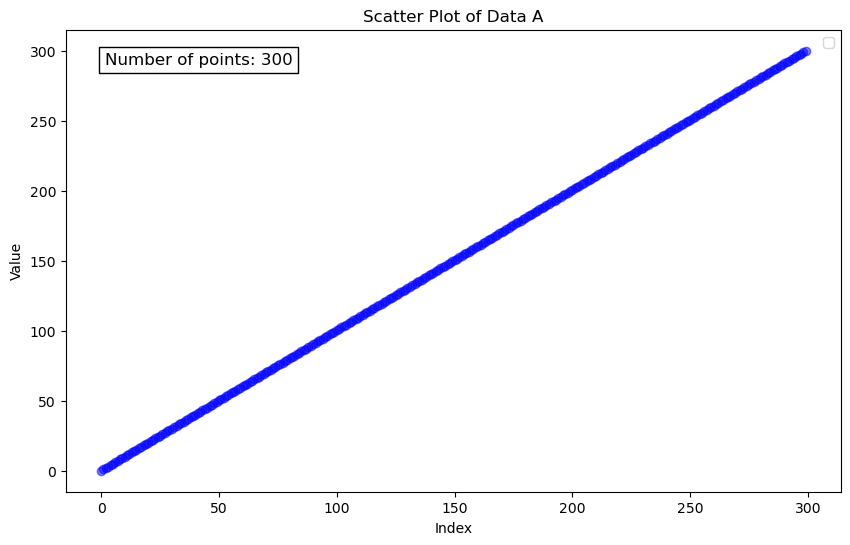

In [8]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(300, 1)


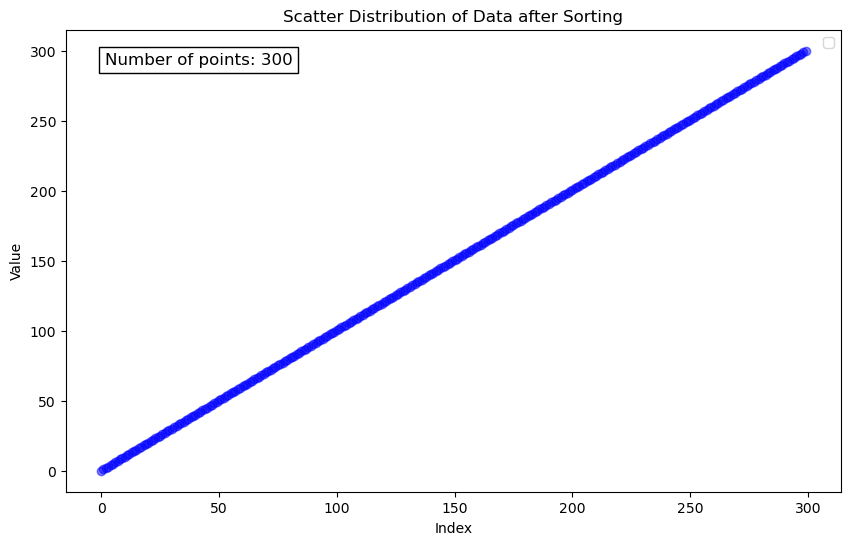

In [9]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.00048273163152131313, 0.0005089276620306528, 0.0005198831678445784, 0.0003101502852292616, 0.0005033078780783405, 0.000512027090808387, 0.0004536918349957246, 0.00043686474330410324, 0.0004983841255968636, 0.0004910332275793539]
Error u of fuhe active learning(LHS sampling): 4.717002e-04
[0.0001554566385424452, 0.00016255204425684672, 0.00016907877114856853, 0.00011238546203693523, 0.00016040777732079676, 0.00016418905595078672, 0.00014383053581932512, 0.0001381611023732485, 0.00015816444422158736, 0.0001581342458082211]
MAE of fuhe active learning(LHS sampling): 1.522360e-04
[4.9108795726354864e-08, 5.4066809161524537e-08, 5.696169385836477e-08, 2.4949086645192194e-08, 5.290882894814274e-08, 5.475991485545602e-08, 4.3171718795248384e-08, 3.9984048655200166e-08, 5.185393943978126e-08, 5.0630850175090733e-08]
MSE of fuhe active learning(LHS sampling): 4.783957e-08
[9.0635025e-05, 0.009086326, 7.201742e-05, 3.5906352e-05, 0.00017867956, 9.896849e-05, 0.00010152116, 0.00015847705, 0.00

[0.00048273163152131313, 0.0005089276620306528, 0.0005198831678445784, 0.0003101502852292616, 0.0005033078780783405, 0.000512027090808387, 0.0004536918349957246, 0.00043686474330410324, 0.0004983841255968636, 0.0004910332275793539]
mean Error u: 4.717002e-04
Variance Error u: 3.517646e-09


/tmp/ipykernel_293721/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


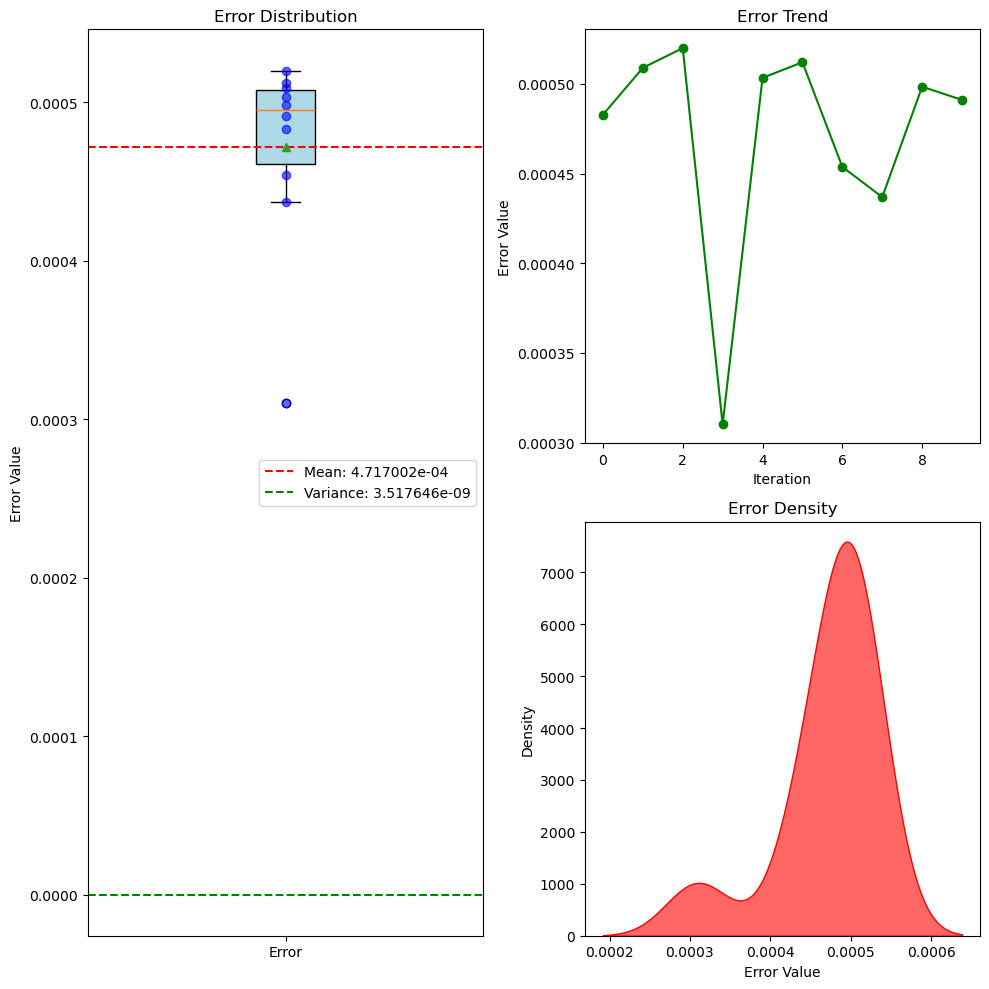

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0001554566385424452, 0.00016255204425684672, 0.00016907877114856853, 0.00011238546203693523, 0.00016040777732079676, 0.00016418905595078672, 0.00014383053581932512, 0.0001381611023732485, 0.00015816444422158736, 0.0001581342458082211]
mean MAE: 1.522360e-04
Variance MAE: 2.536881e-10


/tmp/ipykernel_293721/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


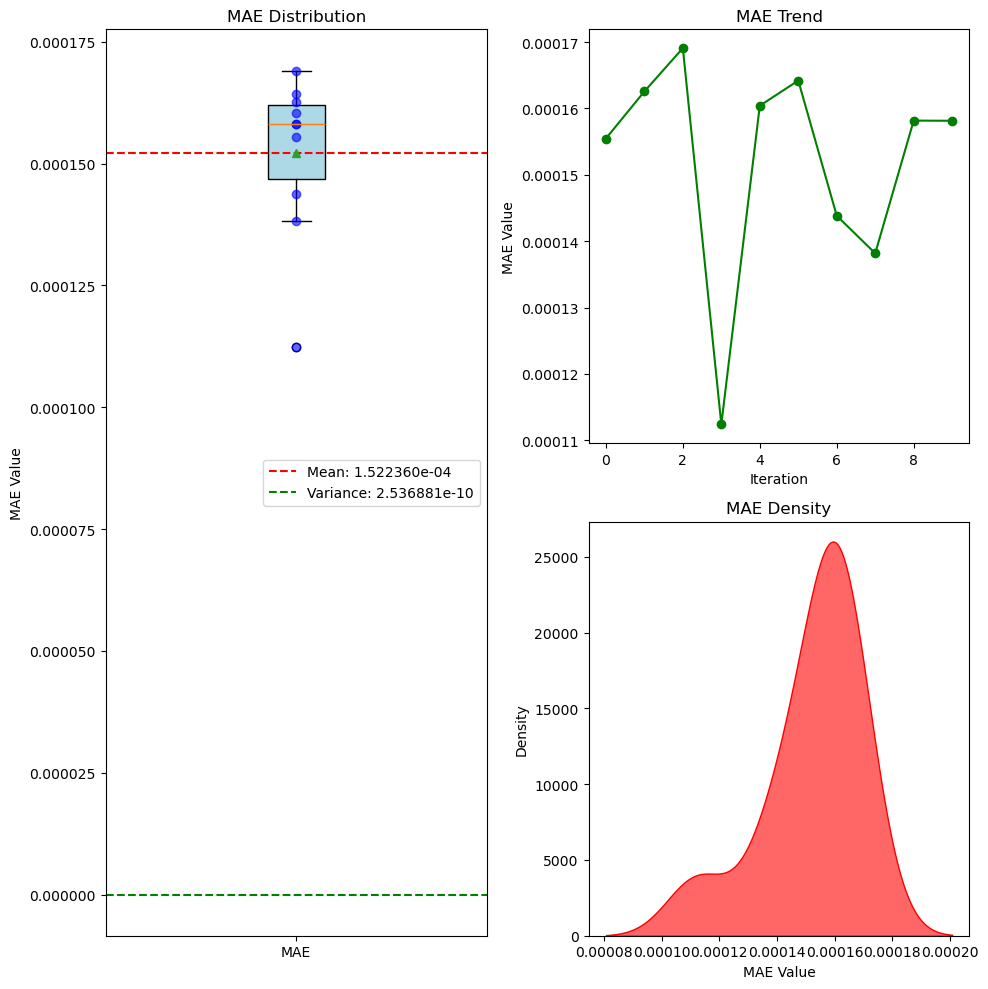

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.9108795726354864e-08, 5.4066809161524537e-08, 5.696169385836477e-08, 2.4949086645192194e-08, 5.290882894814274e-08, 5.475991485545602e-08, 4.3171718795248384e-08, 3.9984048655200166e-08, 5.185393943978126e-08, 5.0630850175090733e-08]
mean MSE: 4.783957e-08
Variance MSE: 8.285698e-17


/tmp/ipykernel_293721/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


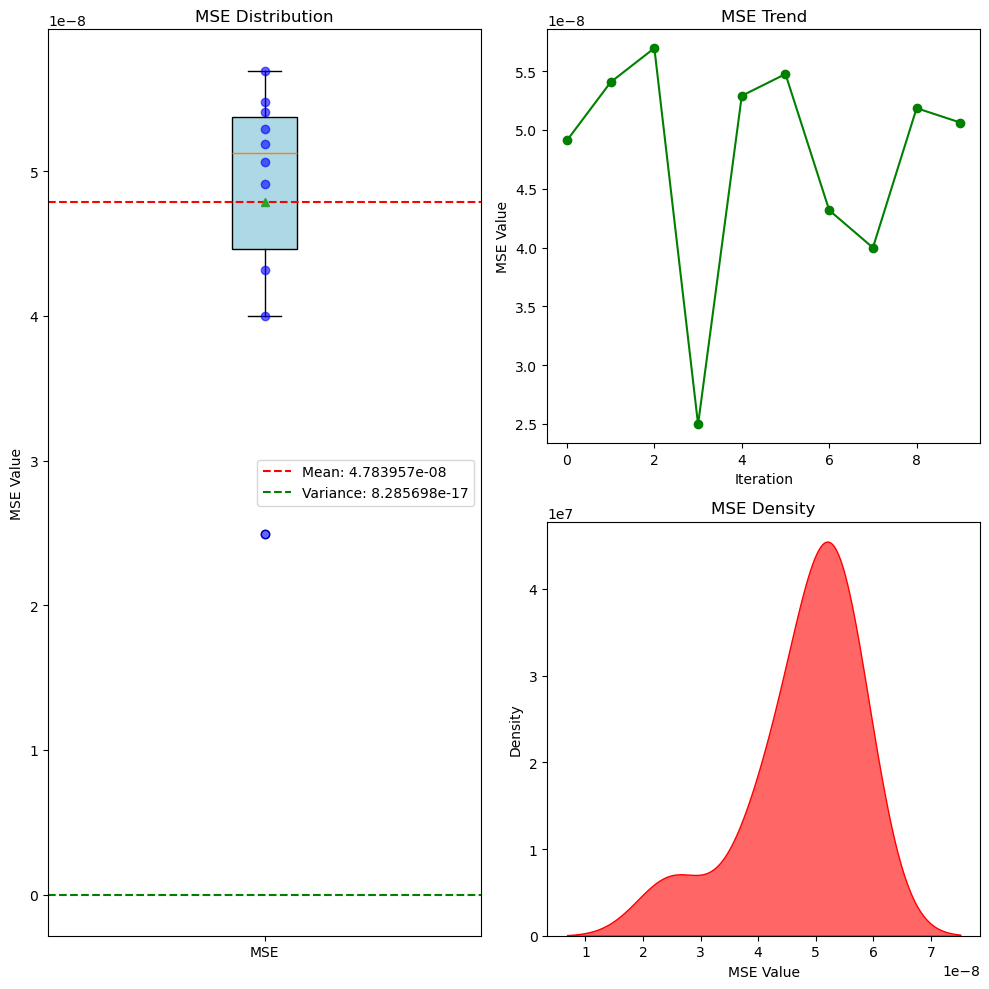

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[9.0635025e-05, 0.009086326, 7.201742e-05, 3.5906352e-05, 0.00017867956, 9.896849e-05, 0.00010152116, 0.00015847705, 0.00015333033, 0.0013764151]
mean CHAOS: 1.135228e-03
Variance CHAOS: 7.168377e-06


/tmp/ipykernel_293721/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


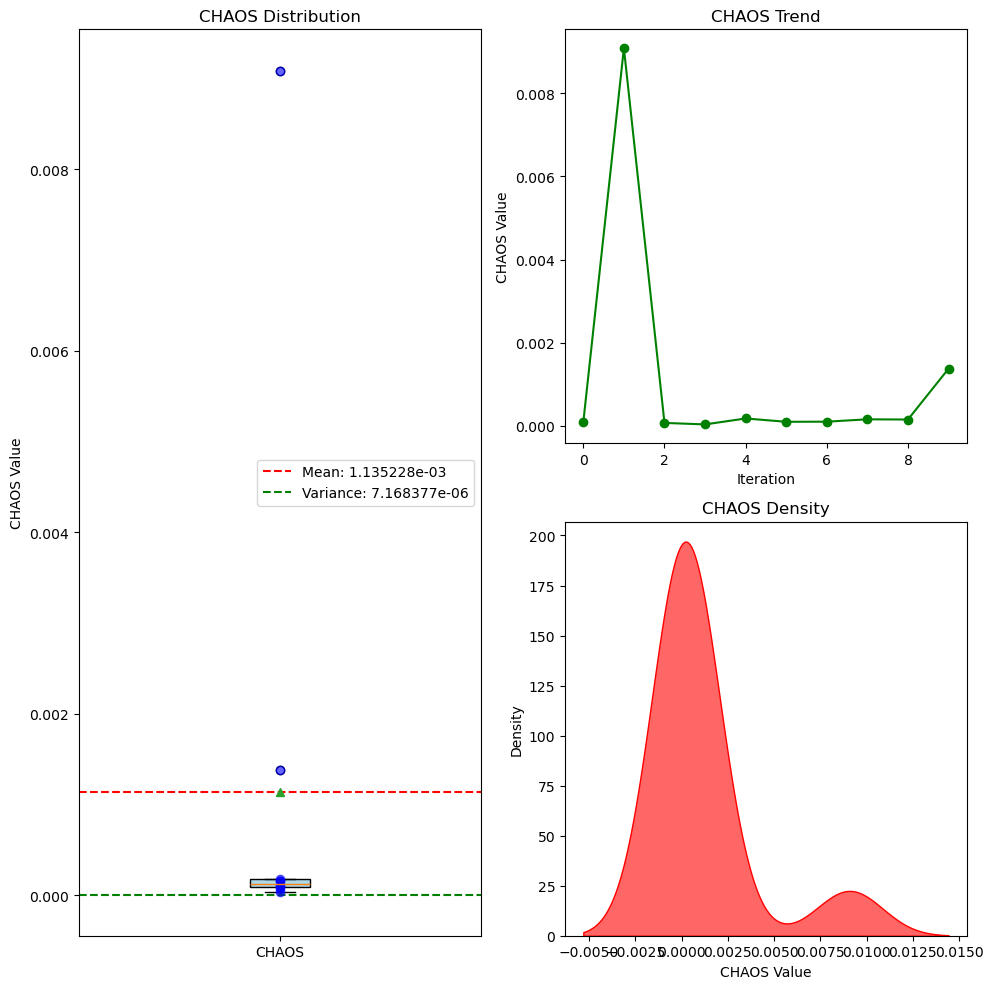

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.7466165e-07, 4.7185517e-07, 4.6677837e-07, 4.4436274e-07, 4.805479e-07, 4.4654257e-07, 4.2771717e-07, 4.014164e-07, 4.705007e-07, 4.8656693e-07]
mean RESIDUAL: 4.570949e-07
Variance RESIDUAL: 6.455192e-16


/tmp/ipykernel_293721/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


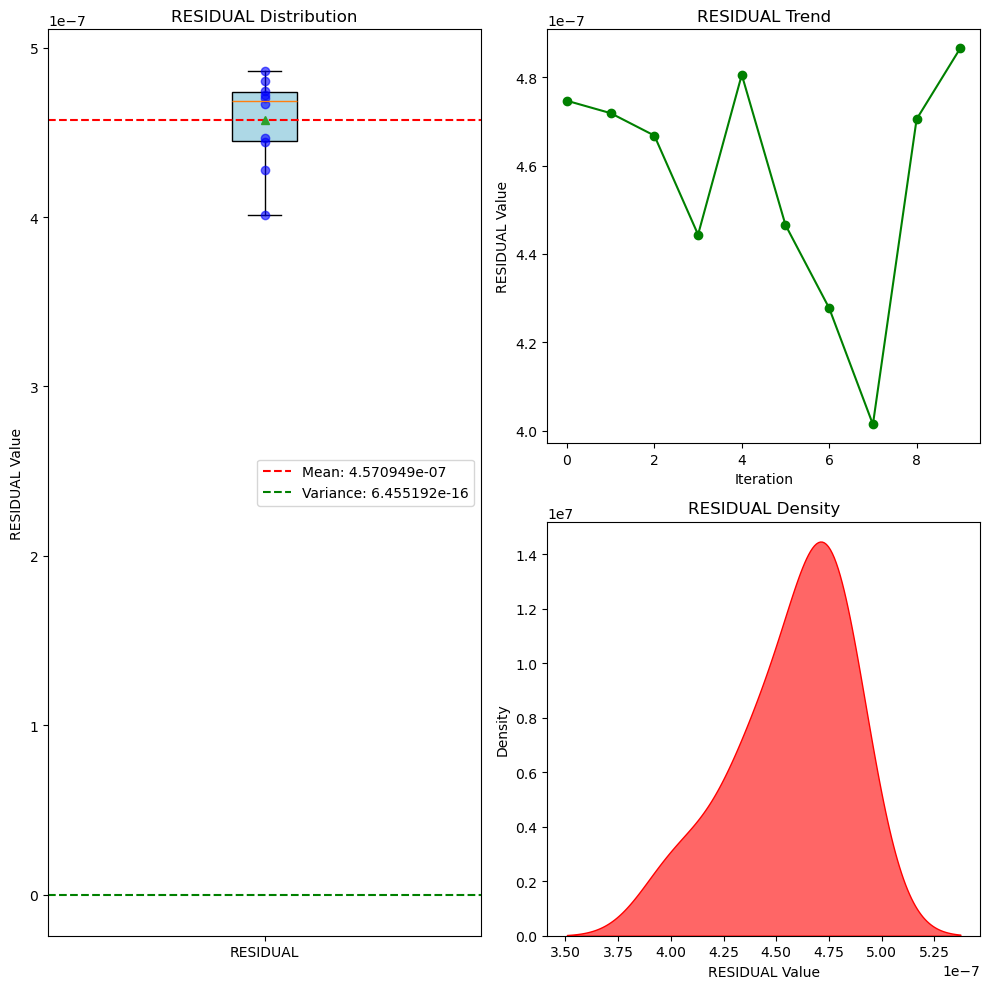

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

80000
[1.9730692e-01 1.6823357e-01 1.4095005e-01 ... 4.8337923e-10 4.8355303e-10
 4.8382487e-10]


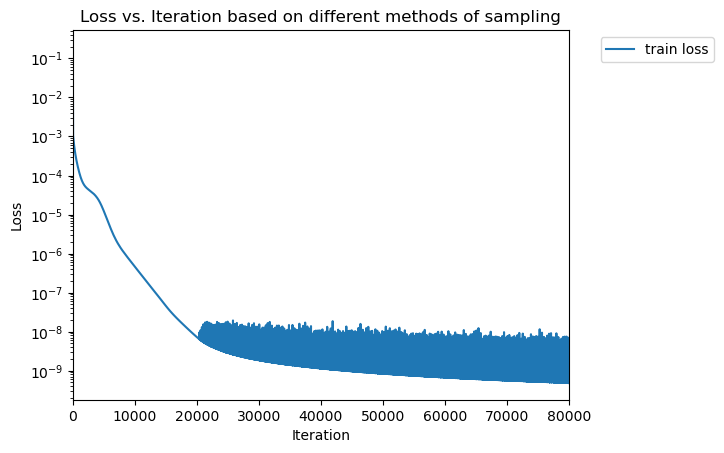

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

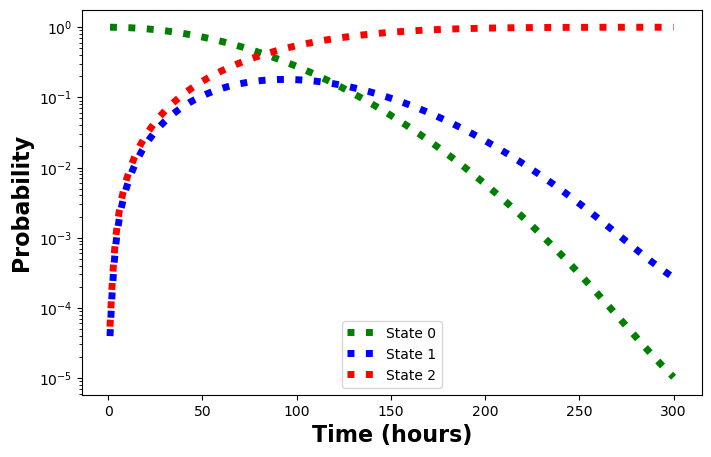

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

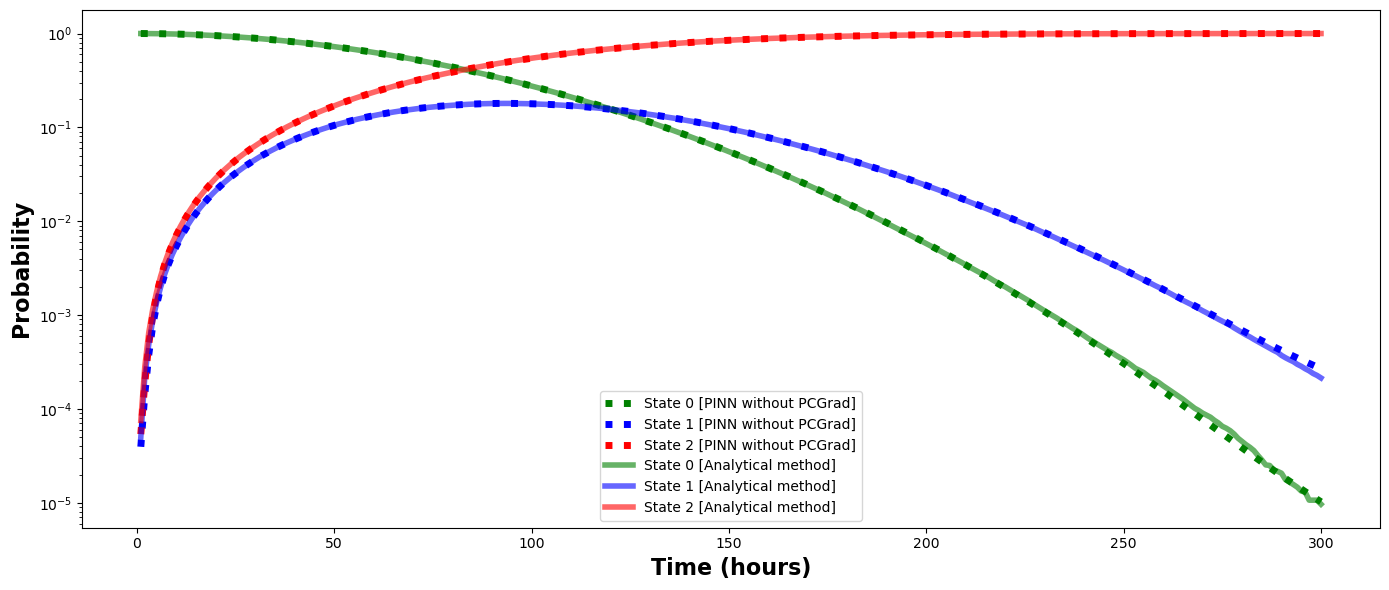

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999907  0.000040  0.000054
1  0.999673  0.000141  0.000186
2  0.999144  0.000373  0.000483
3  0.998263  0.000761  0.000976
4  0.997067  0.001285  0.001647
      state_0   state_1   state_2
295  0.000013  0.000319  0.999668
296  0.000012  0.000305  0.999682
297  0.000012  0.000292  0.999696
298  0.000011  0.000280  0.999709
299  0.000010  0.000269  0.999721


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.0002997777911507335
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0002997777911507335
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[0.11178274 0.12199071 0.13113435 0.13820688 0.14311928 0.14594108
 0.14679307 0.1458933  0.14361082 0.14042464 0.13682142 0.13314676
 0.12967244 0.12655422 0.12386597 0.12166454 0.11995298 0.11871859
 0.1179506  0.11761634 0.11767615 0.11808121 0.11878234 0.1197094
 0.12078575 0.12193408 0.12307707 0.12415719 0.12510808 0.12588122
 0.12646526 0.12682532 0.12697135 0.12690254 0.12661688 0.12614709
 0.12550421 0.12469664 0.1237701  0.12272541 0.12158058 0.12035443
 0.1190852  0.11777246 0.11643724 0.11509168 0.11373775 0.11239368
 0.11107196 0.10978131 0.10851028 0.10728139 0.10608361 0.10493306
 0.10383049 0.1027643  0.10175234 0.10080559 0.09990373 0.09903547
 0.09823684 0.09748846 0.09679548 0.09614677 0.09556171 0.09502976
 0.09454095 0.09410954 0.09371813 0.09338275 0.09309438 0.09285307
 0.09265423 0.09250035 0.09238492 0.09230903 0.09225653 0.09226637
 0.09228694 0.09234141 0.09241503 0.09251922 0.09265479 0.09278583
 0.09294635 0.09311777 0.0932866  0.09347505 0.09365889 0.09384

Text(0.5, 1.0, 'Line Plot')

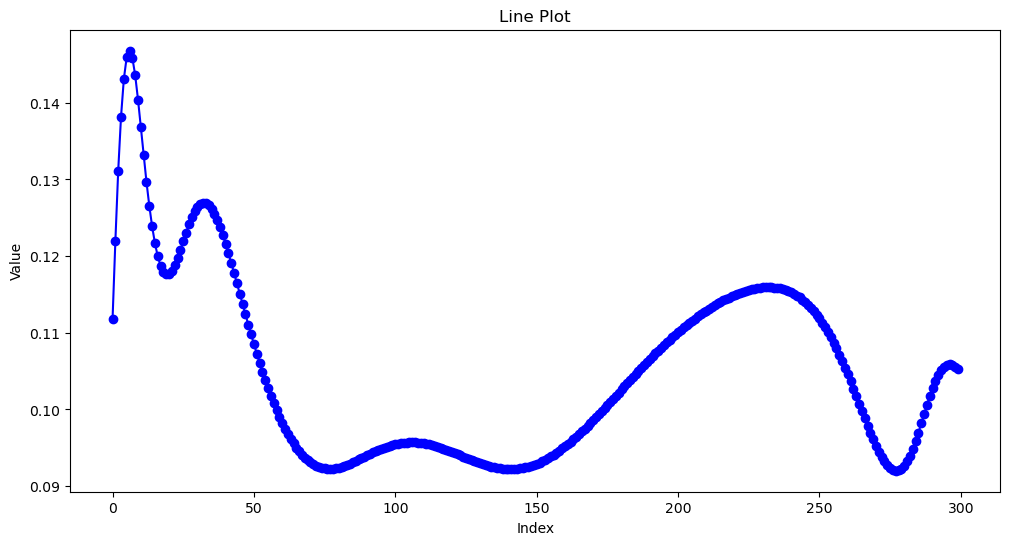

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[-1.6458216e-08  2.7997885e-08 -2.8841896e-08  3.2712705e-08
 -4.5984052e-09 -4.5984052e-09  3.1432137e-09 -1.1350494e-08
  8.0326572e-09 -5.8207661e-10  1.6298145e-09  5.1222742e-09
 -5.8207661e-09  5.5879354e-09  2.9103830e-09  5.2386895e-09
 -3.3760443e-09  4.6566129e-10 -4.6566129e-10 -1.8626451e-09
  4.6566129e-10  1.6298145e-09 -2.3283064e-09  6.9849193e-10
  6.9849193e-10 -2.3283064e-09 -1.8626451e-09  1.3969839e-09
  1.1641532e-09 -2.7939677e-09  9.3132257e-10  2.3283064e-10
 -6.9849193e-10  1.6298145e-09 -6.9849193e-10 -4.6566129e-10
  1.8626451e-09 -2.3283064e-10  6.9849193e-10  4.6566129e-10
 -4.6566129e-10 -2.3283064e-10  2.3283064e-09  4.6566129e-10
  4.6566129e-10  1.6298145e-09  0.0000000e+00  6.9849193e-10
  1.6298145e-09 -1.6298145e-09  1.1641532e-09  6.9849193e-10
  4.6566129e-10  4.6566129e-10  2.3283064e-09 -6.9849193e-10
 -1.1641532e-09  2.3283064e-10  4.6566129e-10  6.9849193e-10
 -6.9849193e-10  0.0000000e+00  0.0000000e+00 -1.6298145e-09
  1.3969839e-09  0.00000

Text(0.5, 1.0, 'Line Plot')

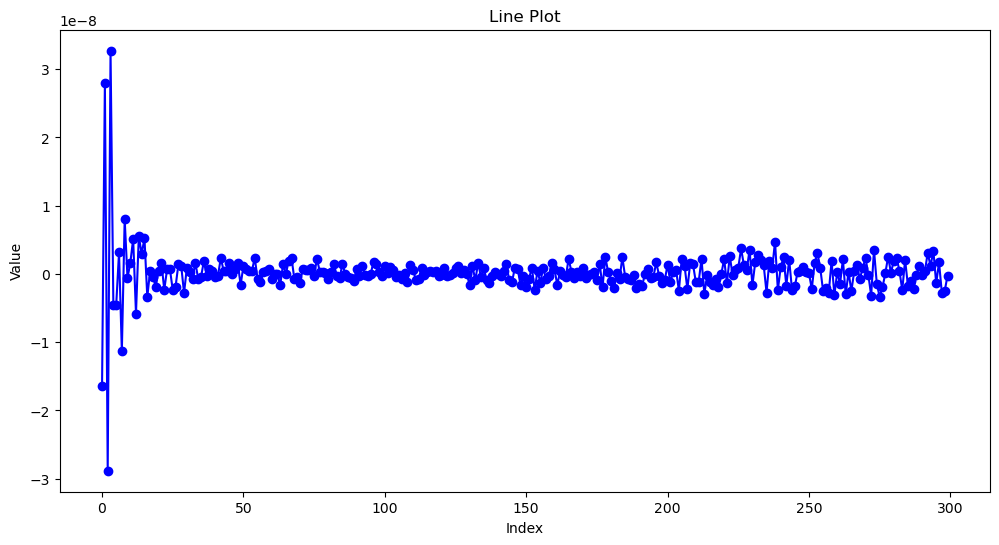

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot')
